In [1]:
#下面这行代码，是为了把自己编写的代码文件当作一共模块导入，这里是把Utilities文件夹中的plotting.py文件当作python的模块导入，对应的是下面的from plotting import newfig, savefig。路径要随着不同设备的系统做相应的修改
import sys #导入sys模块。sys模块提供了一些变量和函数，用于与 Python解释器进行交互和访问。例如，sys.path 是一个 Python 在导入模块时会查找的路径列表，sys.argv 是一个包含命令行参数的列表，sys.exit() 函数可以用于退出 Python 程序。导入 sys 模块后，你就可以在你的程序中使用这些变量和函数了。
sys.path.insert(0, '../../Utilities/') #在 Python的sys.path列表中插入一个新的路径。sys.path是一个 Python 在导入模块时会查找的路径列表。新的路径'../../Utilities/'相对于当前脚本的路径。当你尝试导入一个模块时，Python 会在 sys.path 列表中的路径下查找这个模块。通过在列表开始位置插入一个路径，你可以让 Python 优先在这个路径下查找模块。这在你需要导入自定义模块或者不在 Python 标准库中的模块时非常有用。

import torch
#collections是python一个内置模块，提供了一些有用的数据结构
from collections import OrderedDict  #这个类是字典dict的一个子类，用于创建有序的字典。普通字典中元素顺序是无序的，在OrderedDict中元素的顺序是有序的，元素的顺序是按照它们被添加到字典中的顺序决定的。

from pyDOE import lhs #`pyDOE`是一个Python库，用于设计实验。它提供了一些函数来生成各种设计，如因子设计、拉丁超立方设计等。`lhs`是库中的一个函数，全名为"Latin Hypercube Sampling"，拉丁超立方采样。这是一种统计方法，用于生成一个近似均匀分布的多维样本点集。它在参数空间中生成一个非常均匀的样本，这对于高维数值优化问题非常有用，因为它可以更好地覆盖参数空间。
import numpy as np
import matplotlib.pyplot as plt
import scipy.io #导入了scipy库中的io模块。scipy.io模块包含了一些用于文件输入/输出的函数，例如读取和写入.mat文件（MATLAB格式）
from scipy.interpolate import griddata #`scipy.interpolate`是`scipy`库中的一个模块，提供了许多插值工具，用于在给定的离散数据点之间进行插值和拟合。`griddata`是这个模块中的一个函数，用于在无规则的数据点上进行插值。

import random

import skopt #用于优化问题的库，特别是机器学习中的超参数优化
from distutils.version import LooseVersion #distutils是Python的一个标准库，用于构建和安装Python包。LooseVersion是一个类，用于比较版本号


from plotting_torch import newfig, savefig #从自定义的plotting_torch.py文件中导入了newfig和savefig函数。这两个函数用于创建和保存图形。这两个函数的定义在plotting_torch.py文件中

from mpl_toolkits.axes_grid1 import make_axes_locatable #`mpl_toolkits.axes_grid1`是`matplotlib`库的一个模块，提供了一些高级的工具来控制matplotlib图形中的坐标轴和颜色条。`make_axes_locatable`是模块中的一个函数，用于创建一个可分割的坐标轴。可以在这个坐标轴的四个方向（上、下、左、右）添加新的坐标轴或颜色条。
import matplotlib.gridspec as gridspec #是`matplotlib`库的一个模块，用于创建一个网格布局来放置子图。在`matplotlib`中可以创建一个或多个子图（subplot），每个子图都有自己的坐标轴，并可以在其中绘制图形。`gridspec`模块提供了一个灵活的方式来创建和放置子图。
import time #一个内置模块，用于处理时间相关的操作。


from tqdm import tqdm #一个快速，可扩展的python进度条库，可以在python长循环中添加一个进度提示信息，用户只需要封装任意的迭代器tqdm(iterator)。

import os
import pickle

In [2]:
num_gpus = torch.cuda.device_count()
print('Number of available GPUs: ', num_gpus)

for i in range(num_gpus):
    torch.cuda.set_device(i)
    allocated = torch.cuda.memory_allocated()
    reserved = torch.cuda.memory_reserved()
    print('GPU {}: {}, Allocated: {}, Reserved: {}'.format(i, torch.cuda.get_device_name(i), allocated, reserved))

Number of available GPUs:  2
GPU 0: NVIDIA GeForce RTX 4090, Allocated: 0, Reserved: 0
GPU 1: NVIDIA GeForce RTX 4090, Allocated: 0, Reserved: 0


In [3]:
torch.cuda.set_device(1) #设置当前使用的GPU设备。这里设置为1号GPU设备（第二块显卡）。

# CUDA support 

#设置pytorch的设备，代表了在哪里执行张量积算，设备可以是cpu或者cuda（gpu），并将这个做运算的设备对象存储在变量device中，后续张量计算回在这个设备上执行
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [4]:
# the deep neural network
class DNN(torch.nn.Module):
    #第一个方法
    def __init__(self, layers):
        super(DNN, self).__init__() #调用父类的__init__方法进行初始化
        
        # parameters
        self.depth = len(layers) - 1 #定义名为depth的属性，表示神经网络的深度，等于层数-1
        
        # set up layer order dict
        self.activation = torch.nn.Tanh #设置激活函数为tanh
         
        layer_list = list() #定义一个空列表layer_list
        for i in range(self.depth - 1):  #循环depth次
            #将每一层（全连接层）添加到layer_list中
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            #将每一层的激活函数添加到layer_list中
            layer_list.append(('activation_%d' % i, self.activation()))

        #循环结束后，将最后一层的线性变换添加到layer_list中（因为没有激活函数了）
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        #然后使用OrderedDict将layer_list中的元素转换为有序字典
        layerDict = OrderedDict(layer_list)
        
        # deploy layers，将layerDict转换为一个神经网络模型，赋值给self.layers
        self.layers = torch.nn.Sequential(layerDict)
    
    #第二个方法，定义了模型的前向传播过程
    def forward(self, x):  #接收输入x
        out = self.layers(x) #将输入x传入神经网络模型self.layers中，得到输出out
        return out #返回输出out
    
    # 新增方法，获取最后一个隐藏层的输出
    def hidden_output(self, x):
        # 遍历每一层，直到最后一个隐藏层
        for i in range(self.depth - 1):
            # 获取当前层的线性变换
            x = self.layers[i*2](x)
            # 获取当前层的激活函数
            x = self.layers[i*2 + 1](x)
        # 返回最后一个隐藏层的输出
        return x

In [5]:
# the physics-guided neural network
class PhysicsInformedNN():
    # Initialize the class
    def __init__(self, X_u, u, X_f, layers, lb, ub, nu, X_star, u_star): #这个类包含的第一个方法__init__，这是一个特殊的方法，也就是这个类的构造函数，用于初始化新创建的对象，接受了几个参数

        
        # boundary conditions
        #将传入的lb和ub参数的值存储在实例中，以便后续使用。这样可以在类的其他方法中通过self.lb和self.ub来访问这些值。
        self.lb = torch.tensor(lb).float().to(device) #创建一个pytorch张量（数据来源于lb），并将其转换为浮点类型，最后将张量移动到指定的设备上
        self.ub = torch.tensor(ub).float().to(device)
        
        # data
        #创建四个pytorch张良，将X_u的第一列赋值给self.x_u，将X_u的第二列赋值给self.t_u。转换为浮点类型，移动到指定设备上，并且这几个张量都需要计算梯度
        #初边界点数据
        self.x_u = torch.tensor(X_u[:, 0:1], requires_grad=True).float().to(device)
        self.t_u = torch.tensor(X_u[:, 1:2], requires_grad=True).float().to(device)
        #配位点数据
        self.x_f = torch.tensor(X_f[:, 0:1], requires_grad=True).float().to(device)
        self.t_f = torch.tensor(X_f[:, 1:2], requires_grad=True).float().to(device)
        #测试点数据
        self.x_star = torch.tensor(X_star[:, 0:1], requires_grad=True).float().to(device)
        self.t_star = torch.tensor(X_star[:, 1:2], requires_grad=True).float().to(device)

        #初边界点真实数据
        self.u = torch.tensor(u).float().to(device)
        #测试点真实数据
        self.u_star = torch.tensor(u_star).float().to(device)
        
        self.layers = layers
        #loss的一个系数
        self.nu = nu
        
        # deep neural networks
        self.dnn = DNN(layers).to(device) #创建一个DNN类的实例，传入layers参数来实现神经网络的初始化，然后将这个实例移动到指定的设备上
        
        # optimizers: using the same settings
        #创建优化器optimizer，使用LBFGS算法，具体每个参数意义见下方
        self.optimizer_LBFGS = torch.optim.LBFGS(
            self.dnn.parameters(), #要优化的参数，这里返回的是一个生成器，包含了self.dnn中的所有参数（神经网络权重与偏置）
            lr=1.0,  #学习率设置为1
            max_iter=50000,  #最大迭代次数为50000
            max_eval=50000,  #最大评估次数为50000
            history_size=50, #历史大小为50，即用于计算Hessian矩阵近似的最近几步的信息
            # tolerance_grad=1e-10,  #优化的第一个停止条件，当梯度的L2范数小于1e-5时停止优化
            # tolerance_change=1.0 * np.finfo(float).eps, #优化的第二个停止条件，当优化的目标函数值的变化小于1.0 * np.finfo(float).eps时停止优化
            line_search_fn="strong_wolfe"       # 制定了用于一维搜索的方法，这里表示用强Wolfe条件
        )

        #创建第二个优化器，括号内为要优化的参数，使用Adam优化方法
        self.optimizer_Adam = torch.optim.Adam(self.dnn.parameters())

        #创建第三个优化器，括号内为要优化的参数，使用SGD优化方法
        self.optimizer_SGD = torch.optim.SGD(self.dnn.parameters(), lr=0.01, momentum=0.9)

        self.iter = 0 #记录迭代次数 

        self.loss_value = [] #创建一个空列表，用于存储损失值

        self.test_error = [] #创建一个空列表，用于存储测试误差
        self.test_error_mse = [] #创建一个空列表，用于存储测试误差
        self.test_error_mae = [] #创建一个空列表，用于存储测试误差
        
    #定义了一个名为net_u的函数/方法，用于计算神经网络的输出。这个方法接受两个参数，分别是x和t，其中x是输入数据，t是时间数据。最后返回神经网络的输出。     
    def net_u(self, x, t):  
        u = self.dnn(torch.cat([x, t], dim=1))  #（第一个参数将输入的两个参数x和t在第二个维度（列）上进行拼接，形成一个新的张量）调用DNN，根据两个参数权重和偏置，以及新得到的张量，计算神经网络的输出u
        return u
    
    #定义了一个名为net_f的函数/方法，用于计算论文中的f。这个方法接受两个参数，分别是x和t，其中x是输入数据，t是时间数据。最后返回计算得到的f。
    def net_f(self, x, t):
        """ The pytorch autograd version of calculating residual """
        u = self.net_u(x, t) #调用上面的net_u函数，计算神经网络的输出u
        
        #计算u关于t的梯度，也就是u关于t的导数，这里使用了pytorch的自动求导功能
        u_t = torch.autograd.grad(
            u, t,  #输入的张量，要计算u关于t的导数
            grad_outputs=torch.ones_like(u), #生成一个与u形状相同，所有元素均为1的张量，这个参数用于指定向量-雅可比积的像两部分
            retain_graph=True, #表示计算完梯度之后保留计算图若需要多次计算梯度，则需要设置改参数为True
            create_graph=True #创建梯度的计算图，使我们能够计算高阶导数
        )[0] #这个函数的返回值是一个元组，其中包含了每个输入张量的梯度。这里只关心第一个输入张量u的梯度，所以我们使用[0]来获取这个梯度。？？？？又说只有一个梯度
        u_x = torch.autograd.grad(
            u, x, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_xx = torch.autograd.grad(
            u_x, x, 
            grad_outputs=torch.ones_like(u_x),
            retain_graph=True,
            create_graph=True
        )[0]
        
        f = u_t + u * u_x - self.nu * u_xx #计算f，定义见论文
        return f
    
    def loss_func(self):
        self.optimizer_LBFGS.zero_grad() #清除之前计算的梯度（在PyTorch中，梯度会累积，所以在每次新的优化迭代之前，我们需要清除之前的梯度）
        
        u_pred = self.net_u(self.x_u, self.t_u) #调用之前定义的函数，传入参数得到神经网络的输出u
        f_pred = self.net_f(self.x_f, self.t_f) #调用之前定义的函数，传入参数计算得到f
        loss_u = torch.mean((self.u - u_pred) ** 2) #计算loss_u，定义见论文
        loss_f = torch.mean(f_pred ** 2) #计算loss_f，定义见论文
        
        loss = loss_u + loss_f #计算总的loss
        
        loss.backward() #被调用以计算损失函数关于神经网络参数的梯度。这个梯度将被用于优化器来更新神经网络参数
        self.iter += 1 #每调用一次损失函数，迭代次数加1

        #record the loss value
        self.loss_value.append(loss) #将计算得到的loss值添加到self.loss_value列表中

        #record the test error
        self.dnn.eval() #将神经网络切换为评估模式
        with torch.no_grad():
            u_real_pred = self.net_u(self.x_star, self.t_star) #调用之前定义的函数，传入参数得到神经网络的输出u

        error_test = torch.norm(self.u_star-u_real_pred,2)/torch.norm(self.u_star,2)

        self.test_error.append(error_test)

        # 计算 MAE
        mae = torch.mean(torch.abs(self.u_star - u_real_pred))
        # 计算 MSE
        mse = torch.mean((self.u_star - u_real_pred) ** 2)
        # 记录 MAE 和 MSE
        self.test_error_mae.append(mae)
        self.test_error_mse.append(mse)

        return loss
      
    
    def train(self, nIter, nIterLBFGS):

        # 初始化一个列表来存储每个epoch的权重矩阵
        self.weights = []   


        # #使用SGD优化器优化nIter次
        # for epoch in tqdm(range(nIter), desc='SGD'):
        #     u_pred = self.net_u(self.x_u, self.t_u)
        #     f_pred = self.net_f(self.x_f, self.t_f)
        #     loss = torch.mean((self.u - u_pred) ** 2) + torch.mean(f_pred ** 2)

        #     # Backward and optimize
        #     self.optimizer_SGD.zero_grad()
        #     loss.backward()
        #     self.optimizer_SGD.step()

        #     #record the loss value
        #     self.loss_value.append(loss)

        #     # record the test error
        #     with torch.no_grad():
        #         u_real_pred = self.net_u(self.x_star, self.t_star) #调用之前定义的函数，传入参数得到神经网络的输出u

        #     error_test = torch.norm(self.u_star-u_real_pred,2)/torch.norm(self.u_star,2)

        #     self.test_error.append(error_test)


        #     # 记录每一层的权重矩阵
        #     epoch_weights = []
        #     for layer in self.dnn.layers:
        #         if isinstance(layer, torch.nn.Linear):  # 检查是否为全连接层
        #             epoch_weights.append(layer.weight.data.clone())  # 使用.clone()来获取权重的副本
        #     self.weights.append(epoch_weights)

        #     W = self.weights



        #使用Adam优化器优化nIter次
        for epoch in tqdm(range(nIter), desc='Adam'):
            self.dnn.train() #将神经网络设置为训练模式而不是评估模式
            u_pred = self.net_u(self.x_u, self.t_u) #调用之前定义的函数，传入参数得到神经网络的输出u
            f_pred = self.net_f(self.x_f, self.t_f) #调用之前定义的函数，传入参数计算得到f
            loss = torch.mean((self.u - u_pred) ** 2) + torch.mean(f_pred ** 2) #计算损失函数
            
            # Backward and optimize
            self.optimizer_Adam.zero_grad() #清除该优化器之前计算的梯度（在PyTorch中，梯度会累积，所以在每次新的优化迭代之前，我们需要清除之前的梯度）
            loss.backward() #被调用以计算损失函数关于神经网络参数的梯度。这个梯度将被用于优化器来更新神经网络参数
            self.optimizer_Adam.step()  #使用之前的优化器self.optimizer_Adam，调用step方法(执行一步优化算法)，传入损失函数self.loss_func，进行优化
            
            #record the loss value
            self.loss_value.append(loss) #将计算得到的loss值添加到self.loss_value列表中

            # record the test error
            self.dnn.eval() #将神经网络切换为评估模式
            with torch.no_grad():
                u_real_pred = self.net_u(self.x_star, self.t_star) #调用之前定义的函数，传入参数得到神经网络的输出u
            # batch_size = 100  # 设置批次大小
            # n = len(self.x_star)
            # u_real_pred = []
            # for i in range(0, n, batch_size):
            #     x_star_batch = self.x_star[i:i+batch_size]
            #     t_star_batch = self.t_star[i:i+batch_size]
            #     u_real_pred_batch = self.net_u(x_star_batch, t_star_batch)
            #     u_real_pred.append(u_real_pred_batch)
            # u_real_pred = torch.cat(u_real_pred)


            error_test = torch.norm(self.u_star-u_real_pred,2)/torch.norm(self.u_star,2)

            self.test_error.append(error_test)

            # 计算 MAE和MSE
            mae = torch.mean(torch.abs(self.u_star - u_real_pred))
            mse = torch.mean((self.u_star - u_real_pred) ** 2)
            # 记录 MAE 和 MSE
            self.test_error_mae.append(mae)
            self.test_error_mse.append(mse)

            # 记录每一层的权重矩阵
            epoch_weights = []
            for layer in self.dnn.layers:
                if isinstance(layer, torch.nn.Linear):  # 检查是否为全连接层
                    epoch_weights.append(layer.weight.data.clone())  # 使用.clone()来获取权重的副本
            self.weights.append(epoch_weights)

            W = self.weights


    
        
        
        #使用LBFGS优化器进一步，注意这里虽然迭代了500次，但其实使用LBFGS优化器优化的次数不止500次
        for i in tqdm(range(nIterLBFGS), desc='LBFGS'):
            self.dnn.train() #将神经网络设置为训练模式而不是评估模式
            self.optimizer_LBFGS.step(self.loss_func) #使用之前的优化器self.optimizer，调用step方法(执行一步优化算法)，传入损失函数self.loss_func，进行优化


  


    def predict(self, X):
        x = torch.tensor(X[:, 0:1], requires_grad=True).float().to(device) #从输入中得到x和t（第一列和第二列），是张量，需要计算梯度，转换为浮点数类型，并将张量移动到指定设备上
        t = torch.tensor(X[:, 1:2], requires_grad=True).float().to(device)

        self.dnn.eval() #将神经网络切换为评估模式
        u = self.net_u(x, t) #调用之前定义的函数得到神经网络的输出u,以及f
        f = self.net_f(x, t)
        u = u.detach().cpu().numpy() #将张量u和f先从计算图中分离出来，然后转换为numpy数组，最后将这个数组移动到cpu上
        f = f.detach().cpu().numpy()
        return u, f
    

    def hidden_predict(self, x,t):
        x = torch.tensor(x, requires_grad=True).float().to(device) #从输入中得到x和t（第一列和第二列），是张量，需要计算梯度，转换为浮点数类型，并将张量移动到指定设备上
        t = torch.tensor(t, requires_grad=True).float().to(device)
        self.dnn.eval()
        hidden_output = self.dnn.hidden_output(torch.cat([x, t], dim=1))
        hidden_output_x = hidden_output[:, 0]
        hidden_output_t = hidden_output[:, 1]
        hidden_output_x = hidden_output_x.detach().cpu().numpy()
        hidden_output_t = hidden_output_t.detach().cpu().numpy()
        return hidden_output_x, hidden_output_t

In [6]:
#定义采样函数，目的是采用sampler方法，生成n_samples个在指定空间内的准随机样本，这里space为二维的，因此每个样本都是一个二维点，即n_samples*2的数据点

#共有6种采样器，分别是LHS、Halton、Hammersley、Sobol、Grid和Random，均为均匀采样方法

def caiyang(n_samples, sampler): #接受两个参数，n_samples是样本数量，sampler是采样器名称，是一个字符串
    space = [(-1.0, 1.0), (0.0, 1.0)] #指定样本生成的空间，一个二维空间，第一个维度是-1到1，第二个维度是0到1

    #根据sampler的不同，选择不同的采样器，返回的sampler是一个采样器对象
    if sampler == "LHS": #如果采样器是LHS（拉丁超采样，每个维度都被均匀划分为等量区间，每个样本都是从每个维度的一个区间中随机选取的）
        sampler = skopt.sampler.Lhs(lhs_type="centered", criterion="maximin", iterations=1000) #第一个参数表示如何从每个区间选取样本，这里表示从每个区间的中心选取样本；第二个参数表示如何划分区间，这里表示尽可能使样本之间的最小距离最大；第三个表示通过优化过程得到样本量的迭代次数（即会尝试1000种不同的样本配置，并最终选择质量最好的那个）
    elif sampler == "Halton": #Halton序列是一种低差异序列，用于在高维空间中生成点
        sampler = skopt.sampler.Halton(min_skip=-1, max_skip=-1)  #两个参数用于控制序列的起始点，Halton序列可以通过跳过序列的前几个点来改变序列的七十点。两个参数分别制定了跳过点的最小和最大数量，这里-1表示不跳过任何点
    elif sampler == "Hammersley": #Hammersley序列是一种低差异序列，用于在高维空间中生成点
        sampler = skopt.sampler.Hammersly(min_skip=-1, max_skip=-1) #两个参数用于控制序列的起始点，Hammersley序列可以通过跳过序列的前几个点来改变序列的七十点。两个参数分别制定了跳过点的最小和最大数量，这里-1表示不跳过任何点
    elif sampler == "Sobol":
        # Remove the first point [0, 0, ...] and the second point [0.5, 0.5, ...], which are too special and may cause some error.
        # Sobol采样器的实现有一个问题，即生成的前两个样本点通常不是随机的而是固定的，Sobol序列的前两个点（[0, 0, ...]和[0.5, 0.5, ...]）在许多情况下都被认为是“特殊”的点，可能会对某些计算产生不利影响。因此设置跳过前两个点，而且skopt库在0.9版本号取消了max/min_skip参数，所以需要根据skopt的版本号来选择不同的参数
        if LooseVersion(skopt.__version__) < LooseVersion("0.9"): #先检查skopt的版本是否大于0.9,若小于
            sampler = skopt.sampler.Sobol(min_skip=2, max_skip=2, randomize=False) #则使用Sobol采样器，min_skip和max_skip表示跳过的点的数量，这里表示跳过前两个点，randomize表示是否随机化
        else: #若skopt的版本大于0.9
            sampler = skopt.sampler.Sobol(skip=0, randomize=False) #则使用Sobol采样器，skip表示跳过的点的数量，这里表示不跳过任何点，randomize表示是否随机化 
            return np.array(sampler.generate(space, n_samples + 2)[2:]) #生成n_samples+2个样本，然后返回除了前两个样本之外的所有样本，也就是返回n_samples个样本，每个样本都是一个二维点，且范围在指定的空间space里面
    elif sampler == "Grid":
        x_min, x_max = space[1]
        t_min, t_max = space[0]
        
        # 计算每个维度的网格大小
        x_grid_size = (x_max - x_min) / (n_samples // int(np.sqrt(n_samples)) - 1) # x维度上（纵轴），每行有10个点
        t_grid_size = (t_max - t_min) / int(np.sqrt(n_samples))  # 
        
        # 生成等距均匀网格采样点
        samples = []
        for i in range(n_samples // int(np.sqrt(n_samples))):
            for j in range(int(np.sqrt(n_samples))):
                # 计算每个网格单元的中心点
                x = x_min + i * x_grid_size
                t = t_min + j * t_grid_size
                samples.append([t, x])
        
        return np.array(samples)
    
    elif sampler == "Random":
        # 从space中提取出x_min, x_max, t_min, t_max
        x_min, x_max = space[1]
        t_min, t_max = space[0]

        # 生成x和t的随机数
        x = np.random.rand(n_samples, 1) * (x_max - x_min) + x_min
        t = np.random.rand(n_samples, 1) * (t_max - t_min) + t_min

        # 将x和t合并为一个(n_samples, 2)的数组
        samples = np.hstack((t, x))
        return samples #生成一个形状为(n_samples, 2)的随机数组



    return np.array(sampler.generate(space, n_samples)) #生成n_samples个样本，每个样本都是一个二维点，且范围在指定的空间space里面（n_samples*2）

In [7]:
#定义设置随机数种子的函数，第一个参数seed表示种子；第二个参数用来设置CUDA的卷积操作是否确定性，默认为False，表示没有确定性
def set_seed(seed):
    # torch.manual_seed(seed) #设置pytorch的CPU随机数生成器的种子
    # torch.cuda.manual_seed_all(seed) #设置putorch的所有GPU随机数生成器的种子
    # np.random.seed(seed) #设置numpy的随机数生成器的种子
    # random.seed(seed) #设置python的内置随机数生成器的种子
    # torch.backends.cudnn.deterministic = deterministic #True会让CUDA的卷积操作变得确定性，即对于相同的输入，每次运行会得到相同的结果，False则相反
    """
    设置PyTorch的随机种子, 用于生成随机数. 通过设置相同的种子, 可以确保每次运行时生成的随机数序列相同
    """
    torch.manual_seed(seed)
 
    """
    设置PyTorch在所有可用的CUDA设备上的随机种子. 如果在使用GPU进行计算, 这个设置可以确保在不同的GPU上生成的随机数序列相同
    """
    torch.cuda.manual_seed_all(seed)
 
    """
    设置PyTorch在当前CUDA设备上的随机种子. 它与上一行代码的作用类似, 但只影响当前设备
    """
    torch.cuda.manual_seed(seed)
 
    """
    设置NumPy的随机种子, 用于生成随机数. 通过设置相同的种子，可以确保在使用NumPy的随机函数时生成的随机数序列相同
    """
    np.random.seed(seed)
    
    """
    设置Python内置的随机函数的种子. Python的random模块提供了许多随机函数, 包括生成随机数、打乱列表等. 通过设置相同的种子, 可以确保使用这些随机函数时生成的随机数序列相同
    """
    random.seed(seed)
    
    """
    设置Python的哈希种子 (哈希函数被广泛用于数据结构 (如字典和集合) 的实现，以及一些内部操作 (如查找和比较)). 通过设置相同的种子, 可以确保在不同的运行中生成的哈希结果相同
    """
    # os.environ["PYTHONHASHSEED"] = str(seed)
    
    """
    该设置确保每次运行代码时, cuDNN的计算结果是确定性的, 即相同的输入会产生相同的输出, 这是通过禁用一些非确定性的算法来实现的, 例如在卷积操作中使用的算法. 这样做可以保证模型的训练和推理在相同的硬件和软件环境下是可复现的, 即每次运行代码时的结果都相同. 但是, 这可能会导致一些性能上的损失, 因为禁用了一些优化的非确定性算法
    """
    torch.backends.cudnn.deterministic = True
    
    """
    该设置禁用了cuDNN的自动优化过程. 当它被设置为False时, PyTorch不会在每次运行时重新寻找最优的算法配置, 而是使用固定的算法配置. 这样做可以确保每次运行代码时的性能是一致的, 但可能会导致一些性能上的损失
    """
    torch.backends.cudnn.benchmark = False



In [8]:
import numpy as np

def calculate_chaos(model, X, num_iter, last_k=20):
    """
    计算模型在给定输入点集上的混沌度。
    参数:
    - model: 具有 hidden_predict 方法的神经网络模型，返回倒数第二层输出
    - X: 输入数据，形状为 (N_f_new, 2)，其中第一列为 x0，第二列为 t0
    - num_iter: 计算混沌情况的总迭代次数
    - last_k: 计算混沌度时考虑的最后 k 次迭代

    返回:
    - chaos_score: 每个采样点的混沌度（取最后 k 次的平均欧氏距离）
    """

    # 1. 取输入点 (x0, t0)
    x0 = X[:, 0:1]  # (N_f_new,1)
    t0 = X[:, 1:2]  # (N_f_new,1)

    # 2. 计算初始点的迭代轨迹
    xs = np.zeros((num_iter, X.shape[0], 2))  # 形状 (num_iter, N_f_new, 2)
    x, t = model.hidden_predict(x0, t0)
    x, t = x.reshape(-1,1), t.reshape(-1,1)

    for i in range(num_iter):
        x, t = model.hidden_predict(x, t)
        x, t = x.reshape(-1,1), t.reshape(-1,1)
        xs[i, :, 0] = x.flatten()  # 存储 x
        xs[i, :, 1] = t.flatten()  # 存储 t

    # 3. 给输入数据加微小扰动
    x1 = x0 + np.random.normal(0, 0.0001, size=x0.shape)
    t1 = t0 + np.random.normal(0, 0.0001, size=t0.shape)

    # 4. 计算扰动点的迭代轨迹
    xs1 = np.zeros_like(xs)  # 形状 (num_iter, N_f_new, 2)
    x, t = model.hidden_predict(x1, t1)
    x, t = x.reshape(-1,1), t.reshape(-1,1)

    for i in range(num_iter):
        x, t = model.hidden_predict(x, t)
        x, t = x.reshape(-1,1), t.reshape(-1,1)
        xs1[i, :, 0] = x.flatten()
        xs1[i, :, 1] = t.flatten()

    # 5. 计算最后 last_k 次迭代的欧氏距离
    last_xs = xs[-last_k:, :, :]  # 取最后 k 次迭代的结果
    last_xs1 = xs1[-last_k:, :, :]  # 取扰动点的结果

    # 计算最后 k 次的欧氏距离
    distances = np.linalg.norm(last_xs - last_xs1, axis=2)  # 形状 (last_k, N_f_new)

    # 6. 取最后 k 次迭代的平均混沌度
    chaos_score = np.mean(distances, axis=0)  # (N_f_new,)

    return chaos_score


In [9]:
#RAR-G方法，对1000个点，先选择10个点训练500次，然后每500次迭代重采样100个点，选出其中残差最大的10个点添加到训练点中；最后总共有1000个点，共训练10000次
seeds = [0, 1, 12, 33, 123, 321, 1234, 4321, 12345, 54321] #生成10个随机种子
# seeds = [0]

nu = 0.01/np.pi
#设置噪声水平为0
noise = 0.0        

N_u = 100
N_f = 2500
nIter = 50000 #设置迭代次数为10000
nIterLBFGS = 500 #设置LBFGS迭代次数为500


#定义一个列表layers，其中包含了神经网络的层数和每一层的神经元数量
layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 2, 1]
#读取名为burgers_shock的Matlab文件，文件中的数据存储在data变量中。这里的路径也要随着设备的情况修改 
data = scipy.io.loadmat('../data/burgers_shock.mat')
#从data字典中取出变量tt和x的值，并转换为一维数组（flatten方法），最后tongg[:,None]将一维数组转换为二维数组
t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = np.real(data['usol']).T #从data数据中取出usol的值，并取实部，最后转置，赋值给Exact
#生成一个二位网络，X和T是输出的二维数组
#这个点结果是X和T均为形状为[len(t),len(x)]的二维数组，X的每一行都是x，一共len(t)行，T的每一列都是t，一共len(x)列
X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))  #按列堆叠数组，X_star是一个二维数组，其中第一列是X的展平，第二列是T的展平
u_star = Exact.flatten()[:,None]    #对Exact_u使用flatten方法将其转换为一维数组，最后使用[:,None]将其转换为二维数组         

# Doman bounds，分别获得X_star的相应列上的最小值和最大值，赋值给lb和ub,也就是说lb是x和t的最小值，ub是x和t的最大值，即lb和ub分别为[-1,0]和[1,1]
lb = X_star.min(0)
ub = X_star.max(0)    


#生成初值和边界值的训练基础数据
xx1 = np.hstack((X[0:1,:].T, T[0:1,:].T)) #分别取X，T的第一行的转置(分别是x和全0列)，分别构成xx1的第一列和第二列
uu1 = Exact[0:1,:].T #取Exact的第一行的转置，赋值给uu1
xx2 = np.hstack((X[:,0:1], T[:,0:1])) #分别取X，T的第一列(分别是全-1列和t)，分别构成xx2的第一列和第二列
uu2 = Exact[:,0:1] #取Exact的第一列，赋值给uu2
xx3 = np.hstack((X[:,-1:], T[:,-1:])) #分别取X，T的最后一列(分别是全1列和t)，分别构成xx3的第一列和第二列
uu3 = Exact[:,-1:] #取Exact的最后一列，赋值给uu3

X_u_train_all = np.vstack([xx1, xx2, xx3]) #X_u_train=(xx1;xx2;xx3)

u_train_all = np.vstack([uu1, uu2, uu3]) #u_train=(uu1;uu2;uu3)
    

#1.生成初值边界值训练数据，以及测试数据

#从所有的初值边界值训练基础数据中选取N_u=100个点
idx = np.linspace(0, X_u_train_all.shape[0] - 1, N_u, dtype=int) #生成一个等差数列，从0到X_u_train的行数，间隔为1，赋值给idx
# idx = np.random.choice(X_u_train_all.shape[0], N_u, replace=False) #从0~数组X_u_train的行数 中随机选择N_u个数，replace=False表示不允许重复选择，最后将这N_u个数赋值给idx
X_u_train = X_u_train_all[idx, :] #从X_u_train中选取idx对应的的N_u行，赋值给X_u_train
u_train = u_train_all[idx,:] #从u_train中选取idx对应的的N_u行，赋值给u_train


error_u = [] #创建一个空列表，用于存储误差值
error_mae = [] #创建一个空列表，用于存储MAE值
error_mse = [] #创建一个空列表，用于存储MSE值


i = 0 #初始化i为0

# 创建文件夹
model_dir = 'Adam+LBFGS+LHS(chaosAC)(2500)'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)


for seed in seeds:
    set_seed(seed) #设置随机数种子


    #2.生成配位点并进行训练

    num_iter = 100 #chaos迭代次数

    #先训练500次
    #采样配位点10个
    N_f_1 = N_f//100 #N_f_1=50
    X_f_train = caiyang(N_f_1, "LHS") #生成50个样本点，每个样本点都是一个二维点，即50*2的数据点

    #创建PINN模型并输入各种参数     
    model = PhysicsInformedNN(X_u_train, u_train, X_f_train, layers, lb, ub, nu, X_star, u_star)

    #获取当前时间并赋值给start_time  
    start_time = time.time()   
    #开始训练模型            
    model.train(nIter//100,0)


    #训练结束后，每500次迭代重采样一次100个点，并选出其中残差最大的10个点添加到训练点中；最后总共有1000个点，共训练50000次
    for iter in range(nIter//100+1, nIter+1, nIter//100): #每500次迭代
        N_f_new = N_f_1 * 10 #重新采样100个点
        # 生成新的X_f_train数据
        X_f_train_new = caiyang(N_f_new, "LHS") #生成500个样本点，每个样本点都是一个二维点，即500*2的数据点


        #计算混沌度
        distances = calculate_chaos(model, X_f_train_new, num_iter)

        # #计算残差
        # _, residual = model.predict(X_f_train_new)
        # # 计算残差的绝对值
        # abs_residual = np.abs(residual)
        # #将二维数组转换为一维数组
        # abs_residual = abs_residual.flatten()


        # 对distances进行归一化
        epsilon = 1e-5
        norm_distances = np.linalg.norm(distances)
        if norm_distances > epsilon:
            distances = distances / norm_distances
        else:
            distances = np.zeros_like(distances)

        # #对abs_residual进行归一化
        # abs_residual = abs_residual / np.linalg.norm(abs_residual)

        xinxi = distances #将三个归一化后的数组相加，得到新的数组xinxi

        # 找出绝对值最大的10个值的索引
        topk_indices = np.argpartition(xinxi, -N_f_1)[-N_f_1:] #该函数会对数组进行排序，使得指定的k个最大值出现在数组的最后k给位置上，并获取最后1000个元素

        # 使用这些索引来提取对应的数据
        X_f_train_topk = X_f_train_new[topk_indices]

        X_f_train = np.vstack((X_f_train, X_f_train_topk)) #与之前的训练数据合并

        # 更新模型中的X_f_train数据
        model.x_f = torch.tensor(X_f_train[:, 0:1], requires_grad=True).float().to(device)
        model.t_f = torch.tensor(X_f_train[:, 1:2], requires_grad=True).float().to(device)

        # 在更新数据后的模型上进行训练500次
        model.train(nIter//100,0)



    model.train(0,nIterLBFGS) #使用LBFGS训练500次
    #所有训练结束后获取当前时间并减去start_time，得到训练时间并赋值给elapsed
    elapsed = time.time() - start_time
    #打印训练所花时间                
    print('Training time: %.4f' % (elapsed))

    # 训练结束后，再次使用模型进行预测，并计算误差
    u_pred, f_pred = model.predict(X_star)
    error_u.append(np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)) #计算误差，然后将误差添加到error_u列表中
    # 计算 MAE 和 MSE
    mae = np.mean(np.abs(u_star - u_pred))
    mse = np.mean((u_star - u_pred) ** 2)
    # 记录 MAE 和 MSE
    error_mae.append(mae)
    error_mse.append(mse)

    i+=1 #i加1
    print(f'当前为第{i}次循环，种子为{seed}')
    print('Error u : %e' % (np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2))) #打印误差  
    print('MAE: %e' % mae) #打印MAE
    print('MSE: %e' % mse) #打印MSE
    
    # 保存模型到文件夹
    model_path = os.path.join(model_dir, f'model_{i}_seed_{seed}.pkl')
    with open(model_path, 'wb') as f:
        pickle.dump(model, f)

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 1/500 [00:00<01:13,  6.77it/s]

Adam:   2%|▏         | 8/500 [00:00<00:13, 37.10it/s]

Adam:   3%|▎         | 15/500 [00:00<00:09, 48.69it/s]

Adam:   4%|▍         | 22/500 [00:00<00:08, 54.64it/s]

Adam:   6%|▌         | 29/500 [00:00<00:07, 59.54it/s]

Adam:   7%|▋         | 37/500 [00:00<00:07, 64.21it/s]

Adam:  10%|▉         | 48/500 [00:00<00:05, 77.61it/s]

Adam:  11%|█         | 56/500 [00:00<00:05, 75.27it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:05, 76.29it/s]

Adam:  14%|█▍        | 72/500 [00:01<00:05, 75.14it/s]

Adam:  16%|█▌        | 80/500 [00:01<00:05, 73.78it/s]

Adam:  18%|█▊        | 89/500 [00:01<00:05, 77.16it/s]

Adam:  19%|█▉        | 97/500 [00:01<00:05, 77.96it/s]

Adam:  21%|██        | 105/500 [00:01<00:05, 77.20it/s]

Adam:  23%|██▎       | 113/500 [00:01<00:05, 74.49it/s]

Adam:  24%|██▍       | 121/500 [00:01<00:05, 70.79it/s]

Adam:  26%|██▌       | 129/500 [00:01<00:05, 68.61it/s]

Adam:  28%|██▊       | 140/500 [00:02<00:04, 78.69it/s]

Adam:  30%|██▉       | 149/500 [00:02<00:04, 79.25it/s]

Adam:  32%|███▏      | 158/500 [00:02<00:04, 81.96it/s]

Adam:  34%|███▎      | 168/500 [00:02<00:03, 86.32it/s]

Adam:  36%|███▌      | 178/500 [00:02<00:03, 86.91it/s]

Adam:  37%|███▋      | 187/500 [00:02<00:03, 86.23it/s]

Adam:  39%|███▉      | 196/500 [00:02<00:03, 81.22it/s]

Adam:  41%|████      | 205/500 [00:02<00:03, 77.12it/s]

Adam:  43%|████▎     | 213/500 [00:02<00:03, 76.85it/s]

Adam:  44%|████▍     | 221/500 [00:03<00:03, 77.13it/s]

Adam:  46%|████▌     | 229/500 [00:03<00:03, 75.23it/s]

Adam:  47%|████▋     | 237/500 [00:03<00:03, 75.11it/s]

Adam:  49%|████▉     | 247/500 [00:03<00:03, 81.23it/s]

Adam:  51%|█████▏    | 257/500 [00:03<00:02, 86.52it/s]

Adam:  53%|█████▎    | 266/500 [00:03<00:02, 87.37it/s]

Adam:  55%|█████▌    | 275/500 [00:03<00:02, 79.52it/s]

Adam:  57%|█████▋    | 284/500 [00:03<00:02, 77.00it/s]

Adam:  58%|█████▊    | 292/500 [00:03<00:02, 74.19it/s]

Adam:  60%|██████    | 300/500 [00:04<00:02, 72.50it/s]

Adam:  62%|██████▏   | 308/500 [00:04<00:02, 71.61it/s]

Adam:  63%|██████▎   | 316/500 [00:04<00:02, 68.62it/s]

Adam:  65%|██████▍   | 323/500 [00:04<00:02, 67.59it/s]

Adam:  66%|██████▌   | 330/500 [00:04<00:02, 64.89it/s]

Adam:  67%|██████▋   | 337/500 [00:04<00:02, 64.89it/s]

Adam:  69%|██████▉   | 345/500 [00:04<00:02, 67.02it/s]

Adam:  71%|███████   | 353/500 [00:04<00:02, 68.73it/s]

Adam:  72%|███████▏  | 360/500 [00:04<00:02, 67.63it/s]

Adam:  73%|███████▎  | 367/500 [00:05<00:01, 67.43it/s]

Adam:  75%|███████▌  | 377/500 [00:05<00:01, 75.26it/s]

Adam:  77%|███████▋  | 385/500 [00:05<00:01, 74.46it/s]

Adam:  79%|███████▊  | 393/500 [00:05<00:01, 73.92it/s]

Adam:  80%|████████  | 401/500 [00:05<00:01, 71.91it/s]

Adam:  82%|████████▏ | 411/500 [00:05<00:01, 78.35it/s]

Adam:  84%|████████▍ | 419/500 [00:05<00:01, 76.83it/s]

Adam:  85%|████████▌ | 427/500 [00:05<00:00, 75.95it/s]

Adam:  87%|████████▋ | 436/500 [00:05<00:00, 78.12it/s]

Adam:  89%|████████▉ | 444/500 [00:06<00:00, 75.55it/s]

Adam:  90%|█████████ | 452/500 [00:06<00:00, 74.06it/s]

Adam:  92%|█████████▏| 460/500 [00:06<00:00, 74.12it/s]

Adam:  94%|█████████▎| 468/500 [00:06<00:00, 75.53it/s]

Adam:  95%|█████████▌| 476/500 [00:06<00:00, 74.41it/s]

Adam:  97%|█████████▋| 484/500 [00:06<00:00, 75.09it/s]

Adam:  98%|█████████▊| 492/500 [00:06<00:00, 75.08it/s]

Adam: 100%|██████████| 500/500 [00:06<00:00, 73.47it/s]

Adam: 100%|██████████| 500/500 [00:06<00:00, 73.64it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 112.70it/s]

Adam:   5%|▍         | 24/500 [00:00<00:05, 88.76it/s] 

Adam:   7%|▋         | 34/500 [00:00<00:06, 77.01it/s]

Adam:   8%|▊         | 42/500 [00:00<00:06, 72.43it/s]

Adam:  10%|█         | 50/500 [00:00<00:06, 72.99it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:06, 72.61it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:05, 78.80it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:05, 79.39it/s]

Adam:  17%|█▋        | 85/500 [00:01<00:05, 78.24it/s]

Adam:  19%|█▉        | 94/500 [00:01<00:05, 77.74it/s]

Adam:  20%|██        | 102/500 [00:01<00:05, 73.19it/s]

Adam:  22%|██▏       | 110/500 [00:01<00:05, 71.68it/s]

Adam:  24%|██▎       | 118/500 [00:01<00:05, 73.71it/s]

Adam:  26%|██▌       | 129/500 [00:01<00:04, 81.22it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:04, 80.86it/s]

Adam:  29%|██▉       | 147/500 [00:01<00:04, 78.39it/s]

Adam:  31%|███       | 155/500 [00:02<00:04, 72.77it/s]

Adam:  33%|███▎      | 163/500 [00:02<00:04, 72.63it/s]

Adam:  35%|███▍      | 173/500 [00:02<00:04, 78.18it/s]

Adam:  36%|███▌      | 181/500 [00:02<00:04, 78.59it/s]

Adam:  38%|███▊      | 192/500 [00:02<00:03, 84.20it/s]

Adam:  40%|████      | 202/500 [00:02<00:03, 87.07it/s]

Adam:  42%|████▏     | 211/500 [00:02<00:03, 87.58it/s]

Adam:  44%|████▍     | 220/500 [00:02<00:03, 79.28it/s]

Adam:  46%|████▌     | 229/500 [00:02<00:03, 81.64it/s]

Adam:  48%|████▊     | 241/500 [00:03<00:02, 90.79it/s]

Adam:  50%|█████     | 252/500 [00:03<00:02, 93.89it/s]

Adam:  52%|█████▏    | 262/500 [00:03<00:02, 88.10it/s]

Adam:  54%|█████▍    | 271/500 [00:03<00:02, 82.05it/s]

Adam:  56%|█████▌    | 280/500 [00:03<00:02, 79.23it/s]

Adam:  58%|█████▊    | 289/500 [00:03<00:02, 77.43it/s]

Adam:  59%|█████▉    | 297/500 [00:03<00:02, 76.90it/s]

Adam:  61%|██████    | 305/500 [00:03<00:02, 76.26it/s]

Adam:  63%|██████▎   | 313/500 [00:03<00:02, 75.89it/s]

Adam:  65%|██████▌   | 326/500 [00:04<00:01, 87.58it/s]

Adam:  67%|██████▋   | 335/500 [00:04<00:02, 80.21it/s]

Adam:  69%|██████▉   | 344/500 [00:04<00:02, 75.64it/s]

Adam:  70%|███████   | 352/500 [00:04<00:01, 75.95it/s]

Adam:  72%|███████▏  | 360/500 [00:04<00:01, 76.20it/s]

Adam:  74%|███████▍  | 370/500 [00:04<00:01, 80.36it/s]

Adam:  76%|███████▋  | 382/500 [00:04<00:01, 89.35it/s]

Adam:  79%|███████▊  | 393/500 [00:04<00:01, 93.27it/s]

Adam:  81%|████████  | 403/500 [00:04<00:01, 87.27it/s]

Adam:  82%|████████▏ | 412/500 [00:05<00:01, 81.74it/s]

Adam:  84%|████████▍ | 421/500 [00:05<00:01, 78.48it/s]

Adam:  86%|████████▌ | 429/500 [00:05<00:00, 77.73it/s]

Adam:  87%|████████▋ | 437/500 [00:05<00:00, 76.49it/s]

Adam:  89%|████████▉ | 445/500 [00:05<00:00, 73.57it/s]

Adam:  91%|█████████ | 453/500 [00:05<00:00, 71.59it/s]

Adam:  92%|█████████▏| 461/500 [00:05<00:00, 67.93it/s]

Adam:  94%|█████████▎| 468/500 [00:05<00:00, 68.26it/s]

Adam:  95%|█████████▌| 476/500 [00:06<00:00, 69.07it/s]

Adam:  97%|█████████▋| 484/500 [00:06<00:00, 70.33it/s]

Adam:  98%|█████████▊| 492/500 [00:06<00:00, 70.75it/s]

Adam: 100%|██████████| 500/500 [00:06<00:00, 71.55it/s]

Adam: 100%|██████████| 500/500 [00:06<00:00, 78.33it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/500 [00:00<00:06, 81.67it/s]

Adam:   4%|▍         | 20/500 [00:00<00:05, 95.44it/s]

Adam:   6%|▋         | 32/500 [00:00<00:04, 104.51it/s]

Adam:   9%|▊         | 43/500 [00:00<00:04, 104.03it/s]

Adam:  11%|█         | 54/500 [00:00<00:05, 84.03it/s] 

Adam:  13%|█▎        | 65/500 [00:00<00:04, 89.30it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:04, 88.38it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:04, 85.53it/s]

Adam:  19%|█▉        | 94/500 [00:01<00:05, 79.76it/s]

Adam:  21%|██        | 103/500 [00:01<00:05, 77.64it/s]

Adam:  22%|██▏       | 111/500 [00:01<00:05, 76.30it/s]

Adam:  24%|██▍       | 119/500 [00:01<00:05, 73.78it/s]

Adam:  25%|██▌       | 127/500 [00:01<00:05, 71.93it/s]

Adam:  27%|██▋       | 135/500 [00:01<00:05, 70.70it/s]

Adam:  29%|██▊       | 143/500 [00:01<00:05, 68.38it/s]

Adam:  30%|███       | 150/500 [00:01<00:05, 64.86it/s]

Adam:  31%|███▏      | 157/500 [00:02<00:05, 64.29it/s]

Adam:  33%|███▎      | 164/500 [00:02<00:05, 64.86it/s]

Adam:  35%|███▍      | 174/500 [00:02<00:04, 72.99it/s]

Adam:  37%|███▋      | 184/500 [00:02<00:04, 78.64it/s]

Adam:  39%|███▉      | 194/500 [00:02<00:03, 83.04it/s]

Adam:  41%|████      | 203/500 [00:02<00:03, 80.91it/s]

Adam:  42%|████▏     | 212/500 [00:02<00:03, 78.97it/s]

Adam:  44%|████▍     | 220/500 [00:02<00:03, 79.10it/s]

Adam:  46%|████▌     | 228/500 [00:02<00:03, 77.22it/s]

Adam:  47%|████▋     | 236/500 [00:03<00:03, 74.06it/s]

Adam:  49%|████▉     | 244/500 [00:03<00:03, 73.77it/s]

Adam:  50%|█████     | 252/500 [00:03<00:03, 73.66it/s]

Adam:  52%|█████▏    | 260/500 [00:03<00:03, 73.18it/s]

Adam:  54%|█████▎    | 268/500 [00:03<00:03, 74.09it/s]

Adam:  55%|█████▌    | 276/500 [00:03<00:03, 69.61it/s]

Adam:  57%|█████▋    | 284/500 [00:03<00:03, 69.80it/s]

Adam:  58%|█████▊    | 292/500 [00:03<00:02, 69.72it/s]

Adam:  60%|██████    | 300/500 [00:03<00:02, 71.57it/s]

Adam:  62%|██████▏   | 311/500 [00:04<00:02, 80.42it/s]

Adam:  64%|██████▍   | 320/500 [00:04<00:02, 78.36it/s]

Adam:  66%|██████▌   | 328/500 [00:04<00:02, 77.90it/s]

Adam:  67%|██████▋   | 336/500 [00:04<00:02, 76.81it/s]

Adam:  69%|██████▉   | 344/500 [00:04<00:02, 77.41it/s]

Adam:  70%|███████   | 352/500 [00:04<00:02, 73.67it/s]

Adam:  72%|███████▏  | 361/500 [00:04<00:01, 76.59it/s]

Adam:  74%|███████▍  | 369/500 [00:04<00:01, 75.92it/s]

Adam:  75%|███████▌  | 377/500 [00:04<00:01, 76.28it/s]

Adam:  77%|███████▋  | 386/500 [00:05<00:01, 77.21it/s]

Adam:  79%|███████▉  | 395/500 [00:05<00:01, 78.72it/s]

Adam:  81%|████████  | 403/500 [00:05<00:01, 79.05it/s]

Adam:  82%|████████▏ | 411/500 [00:05<00:01, 77.28it/s]

Adam:  84%|████████▍ | 419/500 [00:05<00:01, 76.35it/s]

Adam:  85%|████████▌ | 427/500 [00:05<00:00, 74.21it/s]

Adam:  87%|████████▋ | 435/500 [00:05<00:00, 74.37it/s]

Adam:  89%|████████▊ | 443/500 [00:05<00:00, 74.76it/s]

Adam:  90%|█████████ | 451/500 [00:05<00:00, 73.74it/s]

Adam:  92%|█████████▏| 459/500 [00:06<00:00, 72.49it/s]

Adam:  93%|█████████▎| 467/500 [00:06<00:00, 69.75it/s]

Adam:  95%|█████████▌| 475/500 [00:06<00:00, 72.49it/s]

Adam:  97%|█████████▋| 484/500 [00:06<00:00, 74.61it/s]

Adam:  98%|█████████▊| 492/500 [00:06<00:00, 73.07it/s]

Adam: 100%|██████████| 500/500 [00:06<00:00, 70.38it/s]

Adam: 100%|██████████| 500/500 [00:06<00:00, 75.98it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/500 [00:00<00:06, 73.28it/s]

Adam:   3%|▎         | 16/500 [00:00<00:06, 71.35it/s]

Adam:   5%|▍         | 24/500 [00:00<00:06, 74.17it/s]

Adam:   7%|▋         | 34/500 [00:00<00:05, 82.17it/s]

Adam:   9%|▊         | 43/500 [00:00<00:06, 72.31it/s]

Adam:  10%|█         | 51/500 [00:00<00:06, 69.57it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:06, 72.49it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:05, 78.38it/s]

Adam:  16%|█▌        | 78/500 [00:01<00:05, 80.96it/s]

Adam:  17%|█▋        | 87/500 [00:01<00:05, 73.81it/s]

Adam:  19%|█▉        | 95/500 [00:01<00:05, 75.39it/s]

Adam:  21%|██        | 103/500 [00:01<00:05, 74.52it/s]

Adam:  22%|██▏       | 112/500 [00:01<00:05, 76.23it/s]

Adam:  24%|██▍       | 121/500 [00:01<00:04, 77.46it/s]

Adam:  26%|██▋       | 132/500 [00:01<00:04, 84.71it/s]

Adam:  28%|██▊       | 141/500 [00:01<00:04, 85.29it/s]

Adam:  30%|███       | 150/500 [00:01<00:04, 85.10it/s]

Adam:  32%|███▏      | 160/500 [00:02<00:03, 88.15it/s]

Adam:  34%|███▍      | 169/500 [00:02<00:04, 80.59it/s]

Adam:  36%|███▌      | 178/500 [00:02<00:03, 80.90it/s]

Adam:  37%|███▋      | 187/500 [00:02<00:04, 77.85it/s]

Adam:  39%|███▉      | 195/500 [00:02<00:04, 74.99it/s]

Adam:  41%|████      | 203/500 [00:02<00:04, 72.43it/s]

Adam:  42%|████▏     | 211/500 [00:02<00:04, 70.68it/s]

Adam:  44%|████▍     | 219/500 [00:02<00:03, 71.50it/s]

Adam:  45%|████▌     | 227/500 [00:02<00:03, 70.77it/s]

Adam:  47%|████▋     | 235/500 [00:03<00:03, 69.00it/s]

Adam:  49%|████▊     | 243/500 [00:03<00:03, 71.70it/s]

Adam:  50%|█████     | 251/500 [00:03<00:03, 70.79it/s]

Adam:  52%|█████▏    | 259/500 [00:03<00:03, 68.84it/s]

Adam:  53%|█████▎    | 266/500 [00:03<00:04, 58.43it/s]

Adam:  55%|█████▌    | 275/500 [00:03<00:03, 64.90it/s]

Adam:  57%|█████▋    | 283/500 [00:03<00:03, 67.68it/s]

Adam:  58%|█████▊    | 292/500 [00:03<00:02, 72.78it/s]

Adam:  60%|██████    | 300/500 [00:04<00:02, 71.06it/s]

Adam:  62%|██████▏   | 308/500 [00:04<00:02, 68.77it/s]

Adam:  63%|██████▎   | 315/500 [00:04<00:02, 69.09it/s]

Adam:  64%|██████▍   | 322/500 [00:04<00:02, 68.66it/s]

Adam:  66%|██████▌   | 330/500 [00:04<00:02, 71.80it/s]

Adam:  68%|██████▊   | 338/500 [00:04<00:02, 70.74it/s]

Adam:  69%|██████▉   | 346/500 [00:04<00:02, 68.38it/s]

Adam:  71%|███████   | 354/500 [00:04<00:02, 69.69it/s]

Adam:  72%|███████▏  | 362/500 [00:04<00:01, 69.46it/s]

Adam:  74%|███████▍  | 370/500 [00:05<00:01, 69.60it/s]

Adam:  76%|███████▌  | 379/500 [00:05<00:01, 74.47it/s]

Adam:  77%|███████▋  | 387/500 [00:05<00:01, 72.48it/s]

Adam:  79%|███████▉  | 395/500 [00:05<00:01, 73.95it/s]

Adam:  81%|████████  | 403/500 [00:05<00:01, 74.08it/s]

Adam:  82%|████████▏ | 411/500 [00:05<00:01, 74.65it/s]

Adam:  84%|████████▍ | 420/500 [00:05<00:01, 76.99it/s]

Adam:  86%|████████▌ | 428/500 [00:05<00:00, 76.49it/s]

Adam:  87%|████████▋ | 436/500 [00:05<00:00, 74.74it/s]

Adam:  89%|████████▉ | 444/500 [00:06<00:00, 74.31it/s]

Adam:  91%|█████████ | 453/500 [00:06<00:00, 76.35it/s]

Adam:  92%|█████████▏| 461/500 [00:06<00:00, 74.13it/s]

Adam:  94%|█████████▍| 469/500 [00:06<00:00, 73.26it/s]

Adam:  95%|█████████▌| 477/500 [00:06<00:00, 73.91it/s]

Adam:  97%|█████████▋| 485/500 [00:06<00:00, 73.87it/s]

Adam:  99%|█████████▉| 496/500 [00:06<00:00, 81.96it/s]

Adam: 100%|██████████| 500/500 [00:06<00:00, 74.27it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/500 [00:00<00:06, 78.55it/s]

Adam:   3%|▎         | 16/500 [00:00<00:06, 70.42it/s]

Adam:   5%|▍         | 24/500 [00:00<00:06, 72.48it/s]

Adam:   6%|▋         | 32/500 [00:00<00:06, 70.78it/s]

Adam:   8%|▊         | 40/500 [00:00<00:06, 69.29it/s]

Adam:   9%|▉         | 47/500 [00:00<00:06, 68.65it/s]

Adam:  11%|█         | 54/500 [00:00<00:06, 66.64it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:06, 66.35it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:06, 71.30it/s]

Adam:  16%|█▌        | 78/500 [00:01<00:05, 71.38it/s]

Adam:  17%|█▋        | 86/500 [00:01<00:05, 71.36it/s]

Adam:  19%|█▉        | 94/500 [00:01<00:05, 69.95it/s]

Adam:  20%|██        | 102/500 [00:01<00:05, 71.32it/s]

Adam:  22%|██▏       | 110/500 [00:01<00:05, 72.63it/s]

Adam:  24%|██▎       | 118/500 [00:01<00:05, 73.40it/s]

Adam:  25%|██▌       | 126/500 [00:01<00:05, 72.80it/s]

Adam:  27%|██▋       | 134/500 [00:01<00:05, 69.10it/s]

Adam:  28%|██▊       | 142/500 [00:02<00:05, 70.20it/s]

Adam:  30%|███       | 151/500 [00:02<00:04, 74.81it/s]

Adam:  32%|███▏      | 159/500 [00:02<00:04, 74.45it/s]

Adam:  33%|███▎      | 167/500 [00:02<00:04, 72.81it/s]

Adam:  35%|███▌      | 175/500 [00:02<00:04, 69.76it/s]

Adam:  37%|███▋      | 183/500 [00:02<00:04, 69.66it/s]

Adam:  38%|███▊      | 190/500 [00:02<00:04, 68.50it/s]

Adam:  39%|███▉      | 197/500 [00:02<00:04, 67.38it/s]

Adam:  41%|████      | 205/500 [00:02<00:04, 69.94it/s]

Adam:  43%|████▎     | 215/500 [00:03<00:03, 78.10it/s]

Adam:  45%|████▍     | 224/500 [00:03<00:03, 78.21it/s]

Adam:  46%|████▋     | 232/500 [00:03<00:03, 76.17it/s]

Adam:  48%|████▊     | 240/500 [00:03<00:03, 73.77it/s]

Adam:  50%|████▉     | 248/500 [00:03<00:03, 73.78it/s]

Adam:  52%|█████▏    | 258/500 [00:03<00:03, 79.43it/s]

Adam:  53%|█████▎    | 266/500 [00:03<00:03, 73.32it/s]

Adam:  55%|█████▍    | 274/500 [00:03<00:03, 73.15it/s]

Adam:  57%|█████▋    | 284/500 [00:03<00:02, 78.53it/s]

Adam:  59%|█████▉    | 294/500 [00:04<00:02, 83.11it/s]

Adam:  61%|██████    | 306/500 [00:04<00:02, 91.82it/s]

Adam:  63%|██████▎   | 316/500 [00:04<00:02, 90.14it/s]

Adam:  65%|██████▌   | 326/500 [00:04<00:01, 90.74it/s]

Adam:  67%|██████▋   | 336/500 [00:04<00:01, 85.13it/s]

Adam:  69%|██████▉   | 345/500 [00:04<00:01, 79.97it/s]

Adam:  71%|███████   | 354/500 [00:04<00:01, 78.72it/s]

Adam:  72%|███████▏  | 362/500 [00:04<00:01, 75.75it/s]

Adam:  74%|███████▍  | 370/500 [00:04<00:01, 75.05it/s]

Adam:  76%|███████▌  | 378/500 [00:05<00:01, 74.72it/s]

Adam:  77%|███████▋  | 386/500 [00:05<00:01, 75.04it/s]

Adam:  79%|███████▉  | 394/500 [00:05<00:01, 74.79it/s]

Adam:  80%|████████  | 402/500 [00:05<00:01, 76.20it/s]

Adam:  82%|████████▏ | 410/500 [00:05<00:01, 75.18it/s]

Adam:  84%|████████▎ | 418/500 [00:05<00:01, 74.31it/s]

Adam:  85%|████████▌ | 426/500 [00:05<00:01, 71.67it/s]

Adam:  87%|████████▋ | 434/500 [00:05<00:00, 72.22it/s]

Adam:  88%|████████▊ | 442/500 [00:05<00:00, 71.08it/s]

Adam:  90%|█████████ | 450/500 [00:06<00:00, 70.09it/s]

Adam:  92%|█████████▏| 458/500 [00:06<00:00, 71.15it/s]

Adam:  93%|█████████▎| 466/500 [00:06<00:00, 69.49it/s]

Adam:  95%|█████████▍| 474/500 [00:06<00:00, 70.37it/s]

Adam:  96%|█████████▋| 482/500 [00:06<00:00, 71.63it/s]

Adam:  98%|█████████▊| 490/500 [00:06<00:00, 70.88it/s]

Adam: 100%|█████████▉| 498/500 [00:06<00:00, 73.24it/s]

Adam: 100%|██████████| 500/500 [00:06<00:00, 74.05it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/500 [00:00<00:06, 79.79it/s]

Adam:   3%|▎         | 16/500 [00:00<00:06, 74.78it/s]

Adam:   5%|▍         | 24/500 [00:00<00:06, 73.13it/s]

Adam:   6%|▋         | 32/500 [00:00<00:06, 74.71it/s]

Adam:   8%|▊         | 42/500 [00:00<00:05, 82.26it/s]

Adam:  10%|█         | 51/500 [00:00<00:05, 80.08it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:05, 75.11it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:05, 74.43it/s]

Adam:  15%|█▌        | 76/500 [00:01<00:05, 73.41it/s]

Adam:  17%|█▋        | 84/500 [00:01<00:05, 70.88it/s]

Adam:  18%|█▊        | 92/500 [00:01<00:05, 72.22it/s]

Adam:  20%|██        | 100/500 [00:01<00:05, 71.31it/s]

Adam:  22%|██▏       | 108/500 [00:01<00:05, 72.32it/s]

Adam:  23%|██▎       | 116/500 [00:01<00:05, 72.87it/s]

Adam:  25%|██▍       | 124/500 [00:01<00:05, 72.55it/s]

Adam:  27%|██▋       | 133/500 [00:01<00:04, 74.85it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:04, 78.27it/s]

Adam:  30%|███       | 151/500 [00:01<00:04, 81.09it/s]

Adam:  32%|███▏      | 160/500 [00:02<00:04, 77.77it/s]

Adam:  34%|███▎      | 168/500 [00:02<00:04, 74.15it/s]

Adam:  35%|███▌      | 176/500 [00:02<00:04, 70.55it/s]

Adam:  37%|███▋      | 184/500 [00:02<00:04, 69.50it/s]

Adam:  38%|███▊      | 192/500 [00:02<00:04, 70.61it/s]

Adam:  41%|████      | 203/500 [00:02<00:03, 81.02it/s]

Adam:  42%|████▏     | 212/500 [00:02<00:03, 77.14it/s]

Adam:  44%|████▍     | 220/500 [00:02<00:03, 74.98it/s]

Adam:  46%|████▌     | 228/500 [00:03<00:03, 72.99it/s]

Adam:  47%|████▋     | 237/500 [00:03<00:03, 76.48it/s]

Adam:  49%|████▉     | 246/500 [00:03<00:03, 79.74it/s]

Adam:  51%|█████     | 255/500 [00:03<00:03, 76.57it/s]

Adam:  53%|█████▎    | 264/500 [00:03<00:02, 79.76it/s]

Adam:  55%|█████▍    | 273/500 [00:03<00:03, 75.38it/s]

Adam:  56%|█████▌    | 281/500 [00:03<00:02, 76.11it/s]

Adam:  58%|█████▊    | 291/500 [00:03<00:02, 80.57it/s]

Adam:  60%|██████    | 300/500 [00:03<00:02, 80.11it/s]

Adam:  62%|██████▏   | 309/500 [00:04<00:02, 79.00it/s]

Adam:  63%|██████▎   | 317/500 [00:04<00:02, 76.91it/s]

Adam:  65%|██████▌   | 325/500 [00:04<00:02, 72.95it/s]

Adam:  67%|██████▋   | 333/500 [00:04<00:02, 70.80it/s]

Adam:  68%|██████▊   | 341/500 [00:04<00:02, 68.71it/s]

Adam:  70%|██████▉   | 348/500 [00:04<00:02, 68.83it/s]

Adam:  71%|███████   | 355/500 [00:04<00:02, 66.35it/s]

Adam:  72%|███████▏  | 362/500 [00:04<00:02, 66.66it/s]

Adam:  74%|███████▍  | 370/500 [00:04<00:01, 68.99it/s]

Adam:  76%|███████▌  | 378/500 [00:05<00:01, 70.44it/s]

Adam:  77%|███████▋  | 386/500 [00:05<00:01, 71.58it/s]

Adam:  79%|███████▉  | 394/500 [00:05<00:01, 72.06it/s]

Adam:  80%|████████  | 402/500 [00:05<00:01, 72.73it/s]

Adam:  82%|████████▏ | 410/500 [00:05<00:01, 74.54it/s]

Adam:  84%|████████▎ | 418/500 [00:05<00:01, 74.58it/s]

Adam:  85%|████████▌ | 426/500 [00:05<00:00, 74.76it/s]

Adam:  87%|████████▋ | 434/500 [00:05<00:00, 74.26it/s]

Adam:  88%|████████▊ | 442/500 [00:05<00:00, 73.23it/s]

Adam:  90%|█████████ | 450/500 [00:06<00:00, 74.27it/s]

Adam:  92%|█████████▏| 458/500 [00:06<00:00, 73.74it/s]

Adam:  93%|█████████▎| 466/500 [00:06<00:00, 74.28it/s]

Adam:  95%|█████████▍| 474/500 [00:06<00:00, 72.22it/s]

Adam:  96%|█████████▋| 482/500 [00:06<00:00, 69.50it/s]

Adam:  98%|█████████▊| 490/500 [00:06<00:00, 69.66it/s]

Adam: 100%|█████████▉| 498/500 [00:06<00:00, 71.41it/s]

Adam: 100%|██████████| 500/500 [00:06<00:00, 73.93it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 6/500 [00:00<00:08, 59.17it/s]

Adam:   2%|▏         | 12/500 [00:00<00:08, 58.32it/s]

Adam:   4%|▍         | 19/500 [00:00<00:07, 62.94it/s]

Adam:   5%|▌         | 26/500 [00:00<00:07, 64.63it/s]

Adam:   7%|▋         | 33/500 [00:00<00:07, 64.01it/s]

Adam:   8%|▊         | 41/500 [00:00<00:06, 66.20it/s]

Adam:  10%|▉         | 48/500 [00:00<00:06, 67.17it/s]

Adam:  11%|█         | 56/500 [00:00<00:06, 68.36it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:06, 69.84it/s]

Adam:  14%|█▍        | 72/500 [00:01<00:06, 71.23it/s]

Adam:  16%|█▌        | 80/500 [00:01<00:05, 72.23it/s]

Adam:  18%|█▊        | 88/500 [00:01<00:05, 72.41it/s]

Adam:  19%|█▉        | 96/500 [00:01<00:05, 70.28it/s]

Adam:  21%|██        | 104/500 [00:01<00:05, 72.48it/s]

Adam:  22%|██▏       | 112/500 [00:01<00:05, 71.24it/s]

Adam:  24%|██▍       | 120/500 [00:01<00:05, 72.20it/s]

Adam:  26%|██▌       | 128/500 [00:01<00:05, 68.98it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:05, 71.93it/s]

Adam:  29%|██▉       | 145/500 [00:02<00:04, 74.71it/s]

Adam:  31%|███       | 153/500 [00:02<00:04, 73.88it/s]

Adam:  32%|███▏      | 161/500 [00:02<00:04, 73.41it/s]

Adam:  34%|███▍      | 169/500 [00:02<00:04, 70.23it/s]

Adam:  35%|███▌      | 177/500 [00:02<00:04, 68.03it/s]

Adam:  37%|███▋      | 184/500 [00:02<00:04, 68.34it/s]

Adam:  38%|███▊      | 191/500 [00:02<00:04, 68.63it/s]

Adam:  41%|████      | 203/500 [00:02<00:03, 81.26it/s]

Adam:  42%|████▏     | 212/500 [00:02<00:03, 82.32it/s]

Adam:  44%|████▍     | 222/500 [00:03<00:03, 86.32it/s]

Adam:  47%|████▋     | 233/500 [00:03<00:02, 90.88it/s]

Adam:  49%|████▊     | 243/500 [00:03<00:03, 81.44it/s]

Adam:  50%|█████     | 252/500 [00:03<00:03, 78.82it/s]

Adam:  52%|█████▏    | 261/500 [00:03<00:03, 77.28it/s]

Adam:  54%|█████▍    | 269/500 [00:03<00:03, 74.46it/s]

Adam:  55%|█████▌    | 277/500 [00:03<00:03, 72.34it/s]

Adam:  57%|█████▋    | 285/500 [00:03<00:02, 73.57it/s]

Adam:  59%|█████▊    | 293/500 [00:04<00:03, 67.59it/s]

Adam:  60%|██████    | 301/500 [00:04<00:02, 69.63it/s]

Adam:  62%|██████▏   | 309/500 [00:04<00:02, 70.69it/s]

Adam:  63%|██████▎   | 317/500 [00:04<00:02, 71.57it/s]

Adam:  65%|██████▌   | 325/500 [00:04<00:02, 71.44it/s]

Adam:  67%|██████▋   | 333/500 [00:04<00:02, 71.93it/s]

Adam:  68%|██████▊   | 341/500 [00:04<00:02, 72.33it/s]

Adam:  70%|██████▉   | 349/500 [00:04<00:02, 72.80it/s]

Adam:  71%|███████▏  | 357/500 [00:04<00:01, 72.62it/s]

Adam:  73%|███████▎  | 365/500 [00:05<00:01, 72.72it/s]

Adam:  75%|███████▍  | 373/500 [00:05<00:01, 74.33it/s]

Adam:  76%|███████▌  | 381/500 [00:05<00:01, 74.07it/s]

Adam:  78%|███████▊  | 389/500 [00:05<00:01, 73.53it/s]

Adam:  79%|███████▉  | 397/500 [00:05<00:01, 73.45it/s]

Adam:  81%|████████  | 405/500 [00:05<00:01, 74.13it/s]

Adam:  83%|████████▎ | 413/500 [00:05<00:01, 75.07it/s]

Adam:  84%|████████▍ | 421/500 [00:05<00:01, 74.27it/s]

Adam:  86%|████████▌ | 429/500 [00:05<00:00, 74.11it/s]

Adam:  87%|████████▋ | 437/500 [00:06<00:00, 71.58it/s]

Adam:  89%|████████▉ | 445/500 [00:06<00:00, 70.63it/s]

Adam:  91%|█████████ | 453/500 [00:06<00:00, 69.76it/s]

Adam:  92%|█████████▏| 460/500 [00:06<00:00, 69.67it/s]

Adam:  94%|█████████▎| 468/500 [00:06<00:00, 71.77it/s]

Adam:  95%|█████████▌| 477/500 [00:06<00:00, 75.94it/s]

Adam:  97%|█████████▋| 485/500 [00:06<00:00, 72.20it/s]

Adam:  99%|█████████▊| 493/500 [00:06<00:00, 70.51it/s]

Adam: 100%|██████████| 500/500 [00:06<00:00, 72.61it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|▏         | 7/500 [00:00<00:07, 62.63it/s]

Adam:   3%|▎         | 16/500 [00:00<00:06, 76.43it/s]

Adam:   5%|▌         | 25/500 [00:00<00:05, 81.61it/s]

Adam:   7%|▋         | 35/500 [00:00<00:05, 85.49it/s]

Adam:   9%|▉         | 44/500 [00:00<00:05, 80.99it/s]

Adam:  11%|█         | 53/500 [00:00<00:06, 74.33it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:05, 74.29it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:05, 74.14it/s]

Adam:  16%|█▌        | 78/500 [00:01<00:05, 78.13it/s]

Adam:  18%|█▊        | 89/500 [00:01<00:04, 86.60it/s]

Adam:  20%|█▉        | 98/500 [00:01<00:04, 85.80it/s]

Adam:  21%|██▏       | 107/500 [00:01<00:04, 85.78it/s]

Adam:  23%|██▎       | 116/500 [00:01<00:04, 86.26it/s]

Adam:  25%|██▌       | 125/500 [00:01<00:04, 85.83it/s]

Adam:  27%|██▋       | 134/500 [00:01<00:04, 76.35it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:04, 73.64it/s]

Adam:  30%|███       | 150/500 [00:01<00:04, 72.05it/s]

Adam:  32%|███▏      | 158/500 [00:02<00:04, 73.05it/s]

Adam:  33%|███▎      | 166/500 [00:02<00:04, 73.09it/s]

Adam:  35%|███▍      | 174/500 [00:02<00:04, 71.21it/s]

Adam:  36%|███▋      | 182/500 [00:02<00:04, 72.67it/s]

Adam:  38%|███▊      | 190/500 [00:02<00:04, 71.14it/s]

Adam:  40%|███▉      | 199/500 [00:02<00:04, 74.44it/s]

Adam:  41%|████▏     | 207/500 [00:02<00:03, 73.86it/s]

Adam:  43%|████▎     | 215/500 [00:02<00:03, 74.81it/s]

Adam:  45%|████▍     | 223/500 [00:02<00:03, 71.40it/s]

Adam:  46%|████▌     | 231/500 [00:03<00:03, 71.61it/s]

Adam:  48%|████▊     | 239/500 [00:03<00:03, 73.48it/s]

Adam:  50%|████▉     | 249/500 [00:03<00:03, 78.81it/s]

Adam:  52%|█████▏    | 259/500 [00:03<00:02, 82.43it/s]

Adam:  54%|█████▎    | 268/500 [00:03<00:02, 83.45it/s]

Adam:  56%|█████▌    | 278/500 [00:03<00:02, 85.31it/s]

Adam:  57%|█████▋    | 287/500 [00:03<00:02, 79.79it/s]

Adam:  59%|█████▉    | 296/500 [00:03<00:02, 77.67it/s]

Adam:  61%|██████    | 304/500 [00:03<00:02, 76.91it/s]

Adam:  62%|██████▏   | 312/500 [00:04<00:02, 74.30it/s]

Adam:  64%|██████▍   | 320/500 [00:04<00:02, 73.12it/s]

Adam:  66%|██████▌   | 328/500 [00:04<00:02, 70.06it/s]

Adam:  67%|██████▋   | 336/500 [00:04<00:02, 72.44it/s]

Adam:  69%|██████▉   | 345/500 [00:04<00:02, 74.54it/s]

Adam:  71%|███████   | 353/500 [00:04<00:02, 72.49it/s]

Adam:  72%|███████▏  | 361/500 [00:04<00:01, 74.30it/s]

Adam:  74%|███████▍  | 369/500 [00:04<00:01, 75.07it/s]

Adam:  75%|███████▌  | 377/500 [00:04<00:01, 73.04it/s]

Adam:  77%|███████▋  | 385/500 [00:05<00:01, 71.76it/s]

Adam:  79%|███████▊  | 393/500 [00:05<00:01, 72.04it/s]

Adam:  80%|████████  | 401/500 [00:05<00:01, 72.43it/s]

Adam:  82%|████████▏ | 409/500 [00:05<00:01, 72.42it/s]

Adam:  83%|████████▎ | 417/500 [00:05<00:01, 72.06it/s]

Adam:  85%|████████▌ | 425/500 [00:05<00:01, 72.28it/s]

Adam:  87%|████████▋ | 433/500 [00:05<00:00, 72.77it/s]

Adam:  88%|████████▊ | 441/500 [00:05<00:00, 72.50it/s]

Adam:  90%|████████▉ | 449/500 [00:05<00:00, 71.10it/s]

Adam:  92%|█████████▏| 458/500 [00:06<00:00, 75.14it/s]

Adam:  94%|█████████▍| 469/500 [00:06<00:00, 83.10it/s]

Adam:  96%|█████████▌| 478/500 [00:06<00:00, 84.29it/s]

Adam:  97%|█████████▋| 487/500 [00:06<00:00, 78.01it/s]

Adam: 100%|█████████▉| 498/500 [00:06<00:00, 84.14it/s]

Adam: 100%|██████████| 500/500 [00:06<00:00, 76.59it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|▏         | 7/500 [00:00<00:07, 69.07it/s]

Adam:   3%|▎         | 15/500 [00:00<00:06, 75.19it/s]

Adam:   5%|▍         | 24/500 [00:00<00:05, 81.39it/s]

Adam:   7%|▋         | 34/500 [00:00<00:05, 86.08it/s]

Adam:   9%|▊         | 43/500 [00:00<00:05, 82.11it/s]

Adam:  10%|█         | 52/500 [00:00<00:05, 78.47it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:05, 77.16it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:05, 76.35it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:05, 75.76it/s]

Adam:  17%|█▋        | 84/500 [00:01<00:05, 74.65it/s]

Adam:  19%|█▊        | 93/500 [00:01<00:05, 78.71it/s]

Adam:  20%|██        | 102/500 [00:01<00:04, 80.15it/s]

Adam:  22%|██▏       | 111/500 [00:01<00:05, 72.86it/s]

Adam:  24%|██▍       | 119/500 [00:01<00:05, 74.06it/s]

Adam:  25%|██▌       | 127/500 [00:01<00:05, 72.72it/s]

Adam:  27%|██▋       | 135/500 [00:01<00:05, 68.67it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:04, 73.45it/s]

Adam:  31%|███       | 155/500 [00:02<00:04, 82.06it/s]

Adam:  33%|███▎      | 164/500 [00:02<00:04, 78.30it/s]

Adam:  34%|███▍      | 172/500 [00:02<00:04, 75.02it/s]

Adam:  36%|███▌      | 180/500 [00:02<00:04, 73.11it/s]

Adam:  38%|███▊      | 189/500 [00:02<00:04, 76.19it/s]

Adam:  40%|███▉      | 199/500 [00:02<00:03, 81.38it/s]

Adam:  42%|████▏     | 208/500 [00:02<00:03, 80.58it/s]

Adam:  43%|████▎     | 217/500 [00:02<00:03, 77.63it/s]

Adam:  45%|████▌     | 225/500 [00:02<00:03, 75.57it/s]

Adam:  47%|████▋     | 233/500 [00:03<00:03, 72.76it/s]

Adam:  48%|████▊     | 241/500 [00:03<00:03, 70.30it/s]

Adam:  50%|████▉     | 249/500 [00:03<00:03, 71.73it/s]

Adam:  52%|█████▏    | 258/500 [00:03<00:03, 76.54it/s]

Adam:  53%|█████▎    | 266/500 [00:03<00:03, 75.21it/s]

Adam:  55%|█████▍    | 274/500 [00:03<00:03, 74.67it/s]

Adam:  56%|█████▋    | 282/500 [00:03<00:02, 73.87it/s]

Adam:  58%|█████▊    | 290/500 [00:03<00:02, 73.55it/s]

Adam:  60%|█████▉    | 299/500 [00:03<00:02, 76.43it/s]

Adam:  61%|██████▏   | 307/500 [00:04<00:02, 77.39it/s]

Adam:  63%|██████▎   | 315/500 [00:04<00:02, 75.70it/s]

Adam:  65%|██████▍   | 323/500 [00:04<00:02, 75.24it/s]

Adam:  66%|██████▌   | 331/500 [00:04<00:02, 74.31it/s]

Adam:  68%|██████▊   | 339/500 [00:04<00:02, 73.71it/s]

Adam:  69%|██████▉   | 347/500 [00:04<00:02, 73.02it/s]

Adam:  71%|███████   | 355/500 [00:04<00:01, 72.53it/s]

Adam:  73%|███████▎  | 363/500 [00:04<00:01, 72.66it/s]

Adam:  74%|███████▍  | 371/500 [00:04<00:01, 72.64it/s]

Adam:  76%|███████▌  | 379/500 [00:05<00:01, 72.26it/s]

Adam:  77%|███████▋  | 387/500 [00:05<00:01, 72.39it/s]

Adam:  79%|███████▉  | 395/500 [00:05<00:01, 72.32it/s]

Adam:  81%|████████  | 403/500 [00:05<00:01, 72.31it/s]

Adam:  82%|████████▏ | 411/500 [00:05<00:01, 71.68it/s]

Adam:  84%|████████▍ | 419/500 [00:05<00:01, 71.73it/s]

Adam:  85%|████████▌ | 427/500 [00:05<00:01, 70.86it/s]

Adam:  87%|████████▋ | 435/500 [00:05<00:00, 71.23it/s]

Adam:  89%|████████▊ | 443/500 [00:05<00:00, 71.84it/s]

Adam:  90%|█████████ | 451/500 [00:06<00:00, 72.42it/s]

Adam:  92%|█████████▏| 460/500 [00:06<00:00, 76.66it/s]

Adam:  94%|█████████▎| 468/500 [00:06<00:00, 72.83it/s]

Adam:  95%|█████████▌| 476/500 [00:06<00:00, 70.69it/s]

Adam:  97%|█████████▋| 484/500 [00:06<00:00, 69.07it/s]

Adam:  99%|█████████▉| 494/500 [00:06<00:00, 74.87it/s]

Adam: 100%|██████████| 500/500 [00:06<00:00, 74.76it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|▏         | 7/500 [00:00<00:07, 68.45it/s]

Adam:   3%|▎         | 14/500 [00:00<00:07, 64.29it/s]

Adam:   5%|▍         | 23/500 [00:00<00:06, 72.15it/s]

Adam:   6%|▌         | 31/500 [00:00<00:06, 73.90it/s]

Adam:   8%|▊         | 39/500 [00:00<00:06, 72.40it/s]

Adam:   9%|▉         | 47/500 [00:00<00:06, 72.03it/s]

Adam:  11%|█         | 55/500 [00:00<00:06, 71.69it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:05, 72.86it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:05, 72.21it/s]

Adam:  16%|█▌        | 79/500 [00:01<00:05, 72.34it/s]

Adam:  17%|█▋        | 87/500 [00:01<00:05, 72.09it/s]

Adam:  19%|█▉        | 95/500 [00:01<00:05, 73.83it/s]

Adam:  21%|██        | 106/500 [00:01<00:04, 82.22it/s]

Adam:  23%|██▎       | 115/500 [00:01<00:04, 78.93it/s]

Adam:  25%|██▍       | 123/500 [00:01<00:04, 75.71it/s]

Adam:  26%|██▌       | 131/500 [00:01<00:04, 75.12it/s]

Adam:  28%|██▊       | 141/500 [00:01<00:04, 81.31it/s]

Adam:  30%|███       | 150/500 [00:01<00:04, 82.37it/s]

Adam:  32%|███▏      | 159/500 [00:02<00:04, 80.83it/s]

Adam:  34%|███▍      | 169/500 [00:02<00:03, 86.10it/s]

Adam:  36%|███▌      | 178/500 [00:02<00:03, 80.94it/s]

Adam:  37%|███▋      | 187/500 [00:02<00:04, 76.88it/s]

Adam:  39%|███▉      | 195/500 [00:02<00:04, 73.49it/s]

Adam:  41%|████      | 203/500 [00:02<00:04, 71.10it/s]

Adam:  42%|████▏     | 212/500 [00:02<00:03, 74.16it/s]

Adam:  44%|████▍     | 221/500 [00:02<00:03, 77.32it/s]

Adam:  46%|████▌     | 230/500 [00:03<00:03, 79.85it/s]

Adam:  48%|████▊     | 239/500 [00:03<00:03, 82.46it/s]

Adam:  50%|████▉     | 248/500 [00:03<00:03, 78.89it/s]

Adam:  51%|█████     | 256/500 [00:03<00:03, 74.56it/s]

Adam:  53%|█████▎    | 264/500 [00:03<00:03, 72.26it/s]

Adam:  54%|█████▍    | 272/500 [00:03<00:03, 70.47it/s]

Adam:  56%|█████▌    | 280/500 [00:03<00:03, 71.11it/s]

Adam:  58%|█████▊    | 288/500 [00:03<00:02, 71.46it/s]

Adam:  59%|█████▉    | 296/500 [00:03<00:02, 70.53it/s]

Adam:  61%|██████    | 304/500 [00:04<00:02, 70.55it/s]

Adam:  62%|██████▏   | 312/500 [00:04<00:02, 70.88it/s]

Adam:  64%|██████▍   | 320/500 [00:04<00:02, 71.30it/s]

Adam:  66%|██████▌   | 328/500 [00:04<00:02, 71.26it/s]

Adam:  67%|██████▋   | 336/500 [00:04<00:02, 71.33it/s]

Adam:  69%|██████▉   | 344/500 [00:04<00:02, 73.04it/s]

Adam:  70%|███████   | 352/500 [00:04<00:02, 72.32it/s]

Adam:  72%|███████▏  | 360/500 [00:04<00:01, 72.41it/s]

Adam:  74%|███████▎  | 368/500 [00:04<00:01, 72.62it/s]

Adam:  75%|███████▌  | 376/500 [00:05<00:01, 72.00it/s]

Adam:  77%|███████▋  | 384/500 [00:05<00:01, 71.77it/s]

Adam:  78%|███████▊  | 392/500 [00:05<00:01, 72.31it/s]

Adam:  80%|████████  | 400/500 [00:05<00:01, 72.45it/s]

Adam:  82%|████████▏ | 408/500 [00:05<00:01, 73.67it/s]

Adam:  83%|████████▎ | 416/500 [00:05<00:01, 73.02it/s]

Adam:  85%|████████▍ | 424/500 [00:05<00:01, 72.01it/s]

Adam:  86%|████████▋ | 432/500 [00:05<00:00, 72.30it/s]

Adam:  88%|████████▊ | 440/500 [00:05<00:00, 73.79it/s]

Adam:  90%|████████▉ | 448/500 [00:06<00:00, 73.02it/s]

Adam:  91%|█████████ | 456/500 [00:06<00:00, 70.16it/s]

Adam:  93%|█████████▎| 464/500 [00:06<00:00, 68.20it/s]

Adam:  94%|█████████▍| 472/500 [00:06<00:00, 70.26it/s]

Adam:  96%|█████████▋| 482/500 [00:06<00:00, 77.60it/s]

Adam:  98%|█████████▊| 490/500 [00:06<00:00, 76.84it/s]

Adam: 100%|██████████| 500/500 [00:06<00:00, 82.75it/s]

Adam: 100%|██████████| 500/500 [00:06<00:00, 74.52it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/500 [00:00<00:06, 72.12it/s]

Adam:   3%|▎         | 16/500 [00:00<00:07, 65.56it/s]

Adam:   5%|▍         | 23/500 [00:00<00:07, 66.81it/s]

Adam:   6%|▌         | 31/500 [00:00<00:06, 68.07it/s]

Adam:   8%|▊         | 40/500 [00:00<00:06, 71.95it/s]

Adam:  10%|▉         | 48/500 [00:00<00:06, 71.81it/s]

Adam:  11%|█         | 56/500 [00:00<00:06, 71.58it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:06, 71.07it/s]

Adam:  14%|█▍        | 72/500 [00:01<00:06, 70.88it/s]

Adam:  16%|█▌        | 81/500 [00:01<00:05, 75.63it/s]

Adam:  18%|█▊        | 90/500 [00:01<00:05, 77.56it/s]

Adam:  20%|█▉        | 98/500 [00:01<00:05, 72.60it/s]

Adam:  21%|██        | 106/500 [00:01<00:05, 73.25it/s]

Adam:  23%|██▎       | 117/500 [00:01<00:04, 82.43it/s]

Adam:  25%|██▌       | 126/500 [00:01<00:04, 80.72it/s]

Adam:  27%|██▋       | 135/500 [00:01<00:04, 80.72it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:04, 78.53it/s]

Adam:  31%|███       | 156/500 [00:02<00:03, 88.84it/s]

Adam:  33%|███▎      | 167/500 [00:02<00:03, 93.08it/s]

Adam:  35%|███▌      | 177/500 [00:02<00:03, 91.71it/s]

Adam:  37%|███▋      | 187/500 [00:02<00:03, 92.84it/s]

Adam:  39%|███▉      | 197/500 [00:02<00:03, 82.89it/s]

Adam:  41%|████      | 206/500 [00:02<00:03, 75.59it/s]

Adam:  43%|████▎     | 214/500 [00:02<00:03, 74.50it/s]

Adam:  45%|████▍     | 223/500 [00:02<00:03, 76.80it/s]

Adam:  46%|████▌     | 231/500 [00:02<00:03, 73.71it/s]

Adam:  48%|████▊     | 239/500 [00:03<00:03, 74.45it/s]

Adam:  50%|████▉     | 248/500 [00:03<00:03, 76.95it/s]

Adam:  51%|█████     | 256/500 [00:03<00:03, 77.24it/s]

Adam:  53%|█████▎    | 264/500 [00:03<00:03, 74.52it/s]

Adam:  54%|█████▍    | 272/500 [00:03<00:03, 70.51it/s]

Adam:  56%|█████▌    | 280/500 [00:03<00:03, 68.45it/s]

Adam:  57%|█████▋    | 287/500 [00:03<00:03, 68.34it/s]

Adam:  59%|█████▉    | 295/500 [00:03<00:02, 69.70it/s]

Adam:  61%|██████    | 303/500 [00:04<00:02, 70.16it/s]

Adam:  62%|██████▏   | 311/500 [00:04<00:02, 70.45it/s]

Adam:  64%|██████▍   | 319/500 [00:04<00:02, 70.80it/s]

Adam:  66%|██████▌   | 328/500 [00:04<00:02, 72.67it/s]

Adam:  67%|██████▋   | 336/500 [00:04<00:02, 72.01it/s]

Adam:  69%|██████▉   | 344/500 [00:04<00:02, 72.65it/s]

Adam:  70%|███████   | 352/500 [00:04<00:02, 72.45it/s]

Adam:  72%|███████▏  | 360/500 [00:04<00:01, 72.90it/s]

Adam:  74%|███████▎  | 368/500 [00:04<00:01, 72.98it/s]

Adam:  75%|███████▌  | 376/500 [00:05<00:01, 72.73it/s]

Adam:  77%|███████▋  | 384/500 [00:05<00:01, 72.14it/s]

Adam:  78%|███████▊  | 392/500 [00:05<00:01, 71.39it/s]

Adam:  80%|████████  | 400/500 [00:05<00:01, 71.98it/s]

Adam:  82%|████████▏ | 408/500 [00:05<00:01, 71.73it/s]

Adam:  83%|████████▎ | 416/500 [00:05<00:01, 71.72it/s]

Adam:  85%|████████▍ | 424/500 [00:05<00:01, 72.78it/s]

Adam:  86%|████████▋ | 432/500 [00:05<00:00, 73.48it/s]

Adam:  88%|████████▊ | 440/500 [00:05<00:00, 71.28it/s]

Adam:  90%|████████▉ | 448/500 [00:06<00:00, 71.55it/s]

Adam:  92%|█████████▏| 458/500 [00:06<00:00, 77.15it/s]

Adam:  94%|█████████▎| 468/500 [00:06<00:00, 81.38it/s]

Adam:  95%|█████████▌| 477/500 [00:06<00:00, 79.11it/s]

Adam:  97%|█████████▋| 485/500 [00:06<00:00, 79.12it/s]

Adam:  99%|█████████▉| 494/500 [00:06<00:00, 80.64it/s]

Adam: 100%|██████████| 500/500 [00:06<00:00, 75.25it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|▏         | 7/500 [00:00<00:07, 62.51it/s]

Adam:   3%|▎         | 14/500 [00:00<00:07, 65.02it/s]

Adam:   4%|▍         | 22/500 [00:00<00:06, 68.77it/s]

Adam:   6%|▌         | 31/500 [00:00<00:06, 74.23it/s]

Adam:   8%|▊         | 39/500 [00:00<00:06, 73.83it/s]

Adam:   9%|▉         | 47/500 [00:00<00:06, 72.98it/s]

Adam:  11%|█         | 55/500 [00:00<00:06, 72.46it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:06, 72.41it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:05, 72.80it/s]

Adam:  16%|█▌        | 79/500 [00:01<00:05, 72.66it/s]

Adam:  17%|█▋        | 87/500 [00:01<00:05, 72.62it/s]

Adam:  19%|█▉        | 95/500 [00:01<00:05, 72.28it/s]

Adam:  21%|██        | 103/500 [00:01<00:05, 70.97it/s]

Adam:  22%|██▏       | 111/500 [00:01<00:05, 72.01it/s]

Adam:  24%|██▍       | 121/500 [00:01<00:04, 78.80it/s]

Adam:  26%|██▌       | 129/500 [00:01<00:04, 76.02it/s]

Adam:  27%|██▋       | 137/500 [00:01<00:04, 74.30it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:04, 72.14it/s]

Adam:  31%|███▏      | 157/500 [00:02<00:04, 83.99it/s]

Adam:  34%|███▍      | 169/500 [00:02<00:03, 93.25it/s]

Adam:  36%|███▌      | 179/500 [00:02<00:03, 94.23it/s]

Adam:  38%|███▊      | 189/500 [00:02<00:03, 87.74it/s]

Adam:  40%|████      | 200/500 [00:02<00:03, 91.73it/s]

Adam:  42%|████▏     | 210/500 [00:02<00:03, 90.22it/s]

Adam:  44%|████▍     | 220/500 [00:02<00:03, 90.52it/s]

Adam:  46%|████▌     | 230/500 [00:02<00:03, 89.11it/s]

Adam:  48%|████▊     | 241/500 [00:02<00:02, 92.78it/s]

Adam:  50%|█████     | 251/500 [00:03<00:02, 92.80it/s]

Adam:  52%|█████▏    | 261/500 [00:03<00:02, 87.97it/s]

Adam:  54%|█████▍    | 270/500 [00:03<00:02, 82.37it/s]

Adam:  56%|█████▌    | 279/500 [00:03<00:02, 82.33it/s]

Adam:  58%|█████▊    | 288/500 [00:03<00:02, 82.56it/s]

Adam:  60%|█████▉    | 298/500 [00:03<00:02, 86.34it/s]

Adam:  62%|██████▏   | 308/500 [00:03<00:02, 89.12it/s]

Adam:  63%|██████▎   | 317/500 [00:03<00:02, 82.22it/s]

Adam:  65%|██████▌   | 326/500 [00:04<00:02, 78.39it/s]

Adam:  67%|██████▋   | 334/500 [00:04<00:02, 76.25it/s]

Adam:  68%|██████▊   | 342/500 [00:04<00:02, 74.86it/s]

Adam:  70%|███████   | 350/500 [00:04<00:02, 74.39it/s]

Adam:  72%|███████▏  | 358/500 [00:04<00:01, 73.73it/s]

Adam:  73%|███████▎  | 366/500 [00:04<00:01, 72.65it/s]

Adam:  75%|███████▍  | 374/500 [00:04<00:01, 72.27it/s]

Adam:  76%|███████▋  | 382/500 [00:04<00:01, 72.11it/s]

Adam:  78%|███████▊  | 390/500 [00:04<00:01, 69.94it/s]

Adam:  80%|███████▉  | 398/500 [00:05<00:01, 70.24it/s]

Adam:  81%|████████  | 406/500 [00:05<00:01, 70.28it/s]

Adam:  83%|████████▎ | 414/500 [00:05<00:01, 70.84it/s]

Adam:  84%|████████▍ | 422/500 [00:05<00:01, 71.21it/s]

Adam:  86%|████████▌ | 430/500 [00:05<00:01, 67.70it/s]

Adam:  87%|████████▋ | 437/500 [00:05<00:00, 68.28it/s]

Adam:  89%|████████▉ | 445/500 [00:05<00:00, 69.58it/s]

Adam:  91%|█████████ | 453/500 [00:05<00:00, 69.84it/s]

Adam:  92%|█████████▏| 461/500 [00:05<00:00, 70.16it/s]

Adam:  94%|█████████▍| 469/500 [00:06<00:00, 70.51it/s]

Adam:  95%|█████████▌| 477/500 [00:06<00:00, 70.71it/s]

Adam:  97%|█████████▋| 485/500 [00:06<00:00, 70.70it/s]

Adam:  99%|█████████▊| 493/500 [00:06<00:00, 68.96it/s]

Adam: 100%|██████████| 500/500 [00:06<00:00, 76.68it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/500 [00:00<00:06, 77.53it/s]

Adam:   3%|▎         | 16/500 [00:00<00:07, 66.08it/s]

Adam:   5%|▍         | 24/500 [00:00<00:06, 70.78it/s]

Adam:   6%|▋         | 32/500 [00:00<00:06, 73.91it/s]

Adam:   9%|▊         | 43/500 [00:00<00:05, 85.65it/s]

Adam:  10%|█         | 52/500 [00:00<00:05, 85.75it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:05, 83.37it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:05, 78.81it/s]

Adam:  16%|█▌        | 78/500 [00:01<00:05, 76.63it/s]

Adam:  17%|█▋        | 86/500 [00:01<00:05, 75.01it/s]

Adam:  19%|█▉        | 94/500 [00:01<00:05, 74.36it/s]

Adam:  20%|██        | 102/500 [00:01<00:05, 73.32it/s]

Adam:  22%|██▏       | 110/500 [00:01<00:05, 73.16it/s]

Adam:  24%|██▎       | 118/500 [00:01<00:05, 72.58it/s]

Adam:  25%|██▌       | 126/500 [00:01<00:05, 71.51it/s]

Adam:  27%|██▋       | 134/500 [00:01<00:05, 71.58it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:05, 70.31it/s]

Adam:  30%|███       | 150/500 [00:02<00:04, 70.18it/s]

Adam:  32%|███▏      | 158/500 [00:02<00:04, 68.88it/s]

Adam:  33%|███▎      | 166/500 [00:02<00:04, 71.43it/s]

Adam:  35%|███▍      | 174/500 [00:02<00:04, 71.75it/s]

Adam:  36%|███▋      | 182/500 [00:02<00:04, 70.38it/s]

Adam:  38%|███▊      | 191/500 [00:02<00:04, 75.14it/s]

Adam:  40%|████      | 201/500 [00:02<00:03, 81.79it/s]

Adam:  42%|████▏     | 210/500 [00:02<00:03, 79.85it/s]

Adam:  44%|████▍     | 220/500 [00:02<00:03, 83.66it/s]

Adam:  46%|████▌     | 230/500 [00:03<00:03, 86.06it/s]

Adam:  48%|████▊     | 239/500 [00:03<00:03, 82.01it/s]

Adam:  50%|████▉     | 248/500 [00:03<00:03, 78.27it/s]

Adam:  52%|█████▏    | 258/500 [00:03<00:02, 83.91it/s]

Adam:  54%|█████▎    | 268/500 [00:03<00:02, 88.04it/s]

Adam:  55%|█████▌    | 277/500 [00:03<00:02, 84.56it/s]

Adam:  57%|█████▋    | 286/500 [00:03<00:02, 79.25it/s]

Adam:  59%|█████▉    | 295/500 [00:03<00:02, 81.14it/s]

Adam:  61%|██████    | 304/500 [00:03<00:02, 78.91it/s]

Adam:  63%|██████▎   | 313/500 [00:04<00:02, 81.09it/s]

Adam:  64%|██████▍   | 322/500 [00:04<00:02, 77.25it/s]

Adam:  66%|██████▌   | 330/500 [00:04<00:02, 74.31it/s]

Adam:  68%|██████▊   | 338/500 [00:04<00:02, 74.35it/s]

Adam:  69%|██████▉   | 347/500 [00:04<00:02, 75.75it/s]

Adam:  71%|███████   | 355/500 [00:04<00:02, 71.58it/s]

Adam:  73%|███████▎  | 363/500 [00:04<00:01, 71.24it/s]

Adam:  74%|███████▍  | 371/500 [00:04<00:01, 71.18it/s]

Adam:  76%|███████▌  | 379/500 [00:04<00:01, 71.28it/s]

Adam:  77%|███████▋  | 387/500 [00:05<00:01, 71.06it/s]

Adam:  79%|███████▉  | 395/500 [00:05<00:01, 70.91it/s]

Adam:  81%|████████  | 403/500 [00:05<00:01, 70.66it/s]

Adam:  82%|████████▏ | 411/500 [00:05<00:01, 71.36it/s]

Adam:  84%|████████▍ | 419/500 [00:05<00:01, 71.15it/s]

Adam:  85%|████████▌ | 427/500 [00:05<00:01, 71.31it/s]

Adam:  87%|████████▋ | 435/500 [00:05<00:00, 71.08it/s]

Adam:  89%|████████▊ | 443/500 [00:05<00:00, 71.42it/s]

Adam:  90%|█████████ | 451/500 [00:05<00:00, 71.40it/s]

Adam:  92%|█████████▏| 459/500 [00:06<00:00, 72.09it/s]

Adam:  93%|█████████▎| 467/500 [00:06<00:00, 72.26it/s]

Adam:  95%|█████████▌| 475/500 [00:06<00:00, 71.01it/s]

Adam:  97%|█████████▋| 483/500 [00:06<00:00, 71.39it/s]

Adam:  98%|█████████▊| 491/500 [00:06<00:00, 72.57it/s]

Adam: 100%|█████████▉| 499/500 [00:06<00:00, 73.11it/s]

Adam: 100%|██████████| 500/500 [00:06<00:00, 75.08it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/500 [00:00<00:06, 79.81it/s]

Adam:   3%|▎         | 17/500 [00:00<00:06, 73.78it/s]

Adam:   5%|▌         | 26/500 [00:00<00:06, 77.37it/s]

Adam:   7%|▋         | 34/500 [00:00<00:06, 68.46it/s]

Adam:   8%|▊         | 41/500 [00:00<00:06, 66.99it/s]

Adam:  10%|▉         | 48/500 [00:00<00:06, 65.73it/s]

Adam:  11%|█         | 55/500 [00:00<00:06, 64.29it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:06, 63.97it/s]

Adam:  14%|█▍        | 69/500 [00:01<00:06, 64.66it/s]

Adam:  15%|█▌        | 77/500 [00:01<00:06, 67.72it/s]

Adam:  17%|█▋        | 84/500 [00:01<00:06, 67.53it/s]

Adam:  18%|█▊        | 92/500 [00:01<00:05, 68.52it/s]

Adam:  20%|██        | 100/500 [00:01<00:05, 69.11it/s]

Adam:  22%|██▏       | 108/500 [00:01<00:05, 70.14it/s]

Adam:  23%|██▎       | 116/500 [00:01<00:05, 71.10it/s]

Adam:  25%|██▍       | 124/500 [00:01<00:05, 70.54it/s]

Adam:  26%|██▋       | 132/500 [00:01<00:05, 70.30it/s]

Adam:  28%|██▊       | 140/500 [00:02<00:05, 71.05it/s]

Adam:  30%|██▉       | 148/500 [00:02<00:04, 71.46it/s]

Adam:  31%|███       | 156/500 [00:02<00:04, 70.72it/s]

Adam:  33%|███▎      | 164/500 [00:02<00:04, 71.59it/s]

Adam:  34%|███▍      | 172/500 [00:02<00:04, 72.90it/s]

Adam:  36%|███▋      | 182/500 [00:02<00:03, 79.97it/s]

Adam:  39%|███▉      | 194/500 [00:02<00:03, 89.26it/s]

Adam:  41%|████      | 203/500 [00:02<00:03, 82.80it/s]

Adam:  42%|████▏     | 212/500 [00:02<00:03, 79.29it/s]

Adam:  44%|████▍     | 221/500 [00:03<00:03, 80.63it/s]

Adam:  46%|████▌     | 230/500 [00:03<00:03, 83.09it/s]

Adam:  48%|████▊     | 239/500 [00:03<00:03, 84.65it/s]

Adam:  50%|████▉     | 248/500 [00:03<00:02, 85.29it/s]

Adam:  51%|█████▏    | 257/500 [00:03<00:02, 82.88it/s]

Adam:  53%|█████▎    | 266/500 [00:03<00:02, 82.50it/s]

Adam:  55%|█████▌    | 275/500 [00:03<00:02, 83.77it/s]

Adam:  57%|█████▋    | 284/500 [00:03<00:02, 85.02it/s]

Adam:  59%|█████▊    | 293/500 [00:03<00:02, 80.79it/s]

Adam:  60%|██████    | 302/500 [00:04<00:02, 81.52it/s]

Adam:  62%|██████▏   | 311/500 [00:04<00:02, 82.80it/s]

Adam:  64%|██████▍   | 320/500 [00:04<00:02, 79.58it/s]

Adam:  66%|██████▌   | 329/500 [00:04<00:02, 81.82it/s]

Adam:  68%|██████▊   | 338/500 [00:04<00:01, 83.90it/s]

Adam:  70%|██████▉   | 348/500 [00:04<00:01, 87.72it/s]

Adam:  71%|███████▏  | 357/500 [00:04<00:01, 86.22it/s]

Adam:  73%|███████▎  | 366/500 [00:04<00:01, 81.14it/s]

Adam:  75%|███████▌  | 375/500 [00:04<00:01, 78.16it/s]

Adam:  77%|███████▋  | 383/500 [00:05<00:01, 75.98it/s]

Adam:  78%|███████▊  | 391/500 [00:05<00:01, 74.57it/s]

Adam:  80%|███████▉  | 399/500 [00:05<00:01, 74.90it/s]

Adam:  81%|████████▏ | 407/500 [00:05<00:01, 74.04it/s]

Adam:  83%|████████▎ | 415/500 [00:05<00:01, 73.82it/s]

Adam:  85%|████████▍ | 423/500 [00:05<00:01, 73.17it/s]

Adam:  86%|████████▌ | 431/500 [00:05<00:00, 72.88it/s]

Adam:  88%|████████▊ | 439/500 [00:05<00:00, 73.81it/s]

Adam:  89%|████████▉ | 447/500 [00:05<00:00, 74.56it/s]

Adam:  91%|█████████ | 455/500 [00:05<00:00, 73.51it/s]

Adam:  93%|█████████▎| 463/500 [00:06<00:00, 72.92it/s]

Adam:  94%|█████████▍| 471/500 [00:06<00:00, 72.62it/s]

Adam:  96%|█████████▌| 479/500 [00:06<00:00, 72.41it/s]

Adam:  97%|█████████▋| 487/500 [00:06<00:00, 72.46it/s]

Adam:  99%|█████████▉| 495/500 [00:06<00:00, 71.41it/s]

Adam: 100%|██████████| 500/500 [00:06<00:00, 75.45it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/500 [00:00<00:06, 74.39it/s]

Adam:   3%|▎         | 16/500 [00:00<00:06, 70.39it/s]

Adam:   5%|▍         | 24/500 [00:00<00:06, 70.35it/s]

Adam:   6%|▋         | 32/500 [00:00<00:06, 71.34it/s]

Adam:   9%|▊         | 43/500 [00:00<00:05, 82.93it/s]

Adam:  10%|█         | 52/500 [00:00<00:05, 83.15it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:05, 82.35it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:05, 82.78it/s]

Adam:  16%|█▌        | 79/500 [00:01<00:05, 75.99it/s]

Adam:  17%|█▋        | 87/500 [00:01<00:05, 75.44it/s]

Adam:  19%|█▉        | 95/500 [00:01<00:05, 74.51it/s]

Adam:  21%|██        | 103/500 [00:01<00:05, 73.50it/s]

Adam:  22%|██▏       | 111/500 [00:01<00:05, 69.30it/s]

Adam:  24%|██▍       | 119/500 [00:01<00:05, 71.14it/s]

Adam:  25%|██▌       | 127/500 [00:01<00:05, 70.99it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:04, 73.88it/s]

Adam:  29%|██▉       | 146/500 [00:01<00:04, 80.24it/s]

Adam:  31%|███       | 155/500 [00:02<00:04, 79.22it/s]

Adam:  33%|███▎      | 163/500 [00:02<00:04, 73.83it/s]

Adam:  34%|███▍      | 171/500 [00:02<00:04, 69.97it/s]

Adam:  36%|███▌      | 179/500 [00:02<00:04, 71.20it/s]

Adam:  37%|███▋      | 187/500 [00:02<00:04, 72.28it/s]

Adam:  39%|███▉      | 197/500 [00:02<00:03, 79.85it/s]

Adam:  42%|████▏     | 209/500 [00:02<00:03, 88.99it/s]

Adam:  44%|████▍     | 220/500 [00:02<00:02, 94.08it/s]

Adam:  46%|████▌     | 230/500 [00:02<00:03, 87.48it/s]

Adam:  48%|████▊     | 239/500 [00:03<00:03, 84.59it/s]

Adam:  50%|████▉     | 248/500 [00:03<00:03, 78.98it/s]

Adam:  51%|█████▏    | 257/500 [00:03<00:03, 76.27it/s]

Adam:  53%|█████▎    | 266/500 [00:03<00:02, 79.18it/s]

Adam:  55%|█████▌    | 275/500 [00:03<00:02, 79.26it/s]

Adam:  57%|█████▋    | 284/500 [00:03<00:02, 80.40it/s]

Adam:  59%|█████▊    | 293/500 [00:03<00:02, 78.03it/s]

Adam:  60%|██████    | 301/500 [00:03<00:02, 78.28it/s]

Adam:  62%|██████▏   | 309/500 [00:04<00:02, 72.90it/s]

Adam:  63%|██████▎   | 317/500 [00:04<00:02, 71.24it/s]

Adam:  65%|██████▌   | 325/500 [00:04<00:02, 73.08it/s]

Adam:  67%|██████▋   | 333/500 [00:04<00:02, 71.69it/s]

Adam:  68%|██████▊   | 342/500 [00:04<00:02, 76.35it/s]

Adam:  70%|███████   | 350/500 [00:04<00:01, 75.52it/s]

Adam:  72%|███████▏  | 359/500 [00:04<00:01, 78.10it/s]

Adam:  73%|███████▎  | 367/500 [00:04<00:01, 76.78it/s]

Adam:  75%|███████▌  | 375/500 [00:04<00:01, 76.76it/s]

Adam:  77%|███████▋  | 384/500 [00:04<00:01, 78.06it/s]

Adam:  78%|███████▊  | 392/500 [00:05<00:01, 75.05it/s]

Adam:  80%|████████  | 400/500 [00:05<00:01, 73.66it/s]

Adam:  82%|████████▏ | 408/500 [00:05<00:01, 72.00it/s]

Adam:  83%|████████▎ | 416/500 [00:05<00:01, 71.47it/s]

Adam:  85%|████████▍ | 424/500 [00:05<00:01, 71.25it/s]

Adam:  86%|████████▋ | 432/500 [00:05<00:00, 71.01it/s]

Adam:  88%|████████▊ | 440/500 [00:05<00:00, 70.54it/s]

Adam:  90%|████████▉ | 448/500 [00:05<00:00, 70.43it/s]

Adam:  91%|█████████ | 456/500 [00:06<00:00, 70.24it/s]

Adam:  93%|█████████▎| 464/500 [00:06<00:00, 70.43it/s]

Adam:  94%|█████████▍| 472/500 [00:06<00:00, 71.11it/s]

Adam:  96%|█████████▌| 480/500 [00:06<00:00, 72.95it/s]

Adam:  98%|█████████▊| 488/500 [00:06<00:00, 72.44it/s]

Adam:  99%|█████████▉| 496/500 [00:06<00:00, 72.06it/s]

Adam: 100%|██████████| 500/500 [00:06<00:00, 75.51it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/500 [00:00<00:06, 72.64it/s]

Adam:   3%|▎         | 16/500 [00:00<00:06, 71.23it/s]

Adam:   5%|▍         | 24/500 [00:00<00:07, 66.42it/s]

Adam:   6%|▋         | 32/500 [00:00<00:06, 68.26it/s]

Adam:   8%|▊         | 40/500 [00:00<00:06, 69.82it/s]

Adam:  10%|▉         | 48/500 [00:00<00:06, 70.32it/s]

Adam:  11%|█         | 56/500 [00:00<00:06, 69.76it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:06, 69.73it/s]

Adam:  14%|█▍        | 70/500 [00:01<00:06, 66.43it/s]

Adam:  16%|█▌        | 78/500 [00:01<00:06, 69.63it/s]

Adam:  17%|█▋        | 86/500 [00:01<00:05, 72.31it/s]

Adam:  19%|█▉        | 95/500 [00:01<00:05, 76.23it/s]

Adam:  21%|██        | 103/500 [00:01<00:05, 73.53it/s]

Adam:  22%|██▏       | 111/500 [00:01<00:05, 70.47it/s]

Adam:  24%|██▍       | 119/500 [00:01<00:05, 70.21it/s]

Adam:  26%|██▌       | 128/500 [00:01<00:05, 73.13it/s]

Adam:  27%|██▋       | 137/500 [00:01<00:04, 75.75it/s]

Adam:  29%|██▉       | 145/500 [00:02<00:04, 71.54it/s]

Adam:  31%|███       | 154/500 [00:02<00:04, 74.44it/s]

Adam:  32%|███▏      | 162/500 [00:02<00:04, 74.85it/s]

Adam:  34%|███▍      | 170/500 [00:02<00:04, 72.94it/s]

Adam:  36%|███▌      | 178/500 [00:02<00:04, 72.38it/s]

Adam:  37%|███▋      | 186/500 [00:02<00:04, 71.26it/s]

Adam:  39%|███▉      | 194/500 [00:02<00:04, 69.13it/s]

Adam:  40%|████      | 201/500 [00:02<00:04, 67.81it/s]

Adam:  42%|████▏     | 208/500 [00:02<00:04, 67.47it/s]

Adam:  43%|████▎     | 216/500 [00:03<00:04, 70.66it/s]

Adam:  45%|████▍     | 224/500 [00:03<00:03, 70.81it/s]

Adam:  47%|████▋     | 233/500 [00:03<00:03, 75.87it/s]

Adam:  49%|████▊     | 243/500 [00:03<00:03, 80.42it/s]

Adam:  50%|█████     | 252/500 [00:03<00:03, 81.41it/s]

Adam:  52%|█████▏    | 262/500 [00:03<00:02, 84.85it/s]

Adam:  54%|█████▍    | 272/500 [00:03<00:02, 87.86it/s]

Adam:  57%|█████▋    | 283/500 [00:03<00:02, 92.56it/s]

Adam:  59%|█████▊    | 293/500 [00:03<00:02, 85.25it/s]

Adam:  60%|██████    | 302/500 [00:04<00:02, 79.44it/s]

Adam:  62%|██████▏   | 311/500 [00:04<00:02, 76.29it/s]

Adam:  64%|██████▍   | 319/500 [00:04<00:02, 74.36it/s]

Adam:  66%|██████▌   | 328/500 [00:04<00:02, 76.56it/s]

Adam:  68%|██████▊   | 339/500 [00:04<00:01, 83.53it/s]

Adam:  70%|██████▉   | 348/500 [00:04<00:01, 84.63it/s]

Adam:  72%|███████▏  | 358/500 [00:04<00:01, 86.75it/s]

Adam:  73%|███████▎  | 367/500 [00:04<00:01, 84.15it/s]

Adam:  75%|███████▌  | 376/500 [00:05<00:01, 75.61it/s]

Adam:  77%|███████▋  | 385/500 [00:05<00:01, 77.73it/s]

Adam:  79%|███████▉  | 394/500 [00:05<00:01, 79.76it/s]

Adam:  81%|████████  | 403/500 [00:05<00:01, 76.40it/s]

Adam:  82%|████████▏ | 411/500 [00:05<00:01, 74.64it/s]

Adam:  84%|████████▍ | 419/500 [00:05<00:01, 74.09it/s]

Adam:  85%|████████▌ | 427/500 [00:05<00:00, 73.72it/s]

Adam:  87%|████████▋ | 435/500 [00:05<00:00, 72.62it/s]

Adam:  89%|████████▊ | 443/500 [00:05<00:00, 71.76it/s]

Adam:  90%|█████████ | 451/500 [00:06<00:00, 71.58it/s]

Adam:  92%|█████████▏| 459/500 [00:06<00:00, 71.08it/s]

Adam:  93%|█████████▎| 467/500 [00:06<00:00, 72.99it/s]

Adam:  95%|█████████▌| 475/500 [00:06<00:00, 71.43it/s]

Adam:  97%|█████████▋| 483/500 [00:06<00:00, 71.02it/s]

Adam:  98%|█████████▊| 491/500 [00:06<00:00, 71.05it/s]

Adam: 100%|█████████▉| 499/500 [00:06<00:00, 71.32it/s]

Adam: 100%|██████████| 500/500 [00:06<00:00, 74.56it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 98.78it/s]

Adam:   4%|▍         | 21/500 [00:00<00:05, 89.05it/s]

Adam:   6%|▌         | 30/500 [00:00<00:05, 82.41it/s]

Adam:   8%|▊         | 39/500 [00:00<00:05, 81.23it/s]

Adam:  10%|▉         | 48/500 [00:00<00:05, 78.51it/s]

Adam:  11%|█         | 56/500 [00:00<00:05, 74.75it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:06, 71.70it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:06, 71.18it/s]

Adam:  16%|█▌        | 80/500 [00:01<00:06, 68.61it/s]

Adam:  17%|█▋        | 87/500 [00:01<00:06, 67.35it/s]

Adam:  19%|█▉        | 95/500 [00:01<00:05, 68.33it/s]

Adam:  20%|██        | 102/500 [00:01<00:05, 68.28it/s]

Adam:  22%|██▏       | 111/500 [00:01<00:05, 72.94it/s]

Adam:  24%|██▍       | 120/500 [00:01<00:05, 75.47it/s]

Adam:  26%|██▌       | 129/500 [00:01<00:04, 77.69it/s]

Adam:  27%|██▋       | 137/500 [00:01<00:04, 76.04it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:04, 74.43it/s]

Adam:  31%|███       | 153/500 [00:02<00:04, 74.79it/s]

Adam:  32%|███▏      | 161/500 [00:02<00:04, 71.68it/s]

Adam:  34%|███▍      | 169/500 [00:02<00:04, 71.71it/s]

Adam:  36%|███▌      | 179/500 [00:02<00:04, 77.77it/s]

Adam:  37%|███▋      | 187/500 [00:02<00:04, 73.78it/s]

Adam:  39%|███▉      | 195/500 [00:02<00:04, 71.16it/s]

Adam:  41%|████      | 203/500 [00:02<00:04, 72.38it/s]

Adam:  42%|████▏     | 211/500 [00:02<00:03, 72.36it/s]

Adam:  44%|████▍     | 220/500 [00:02<00:03, 76.52it/s]

Adam:  46%|████▌     | 228/500 [00:03<00:03, 76.76it/s]

Adam:  47%|████▋     | 236/500 [00:03<00:03, 73.12it/s]

Adam:  49%|████▉     | 244/500 [00:03<00:03, 72.43it/s]

Adam:  51%|█████     | 253/500 [00:03<00:03, 76.93it/s]

Adam:  52%|█████▏    | 262/500 [00:03<00:03, 78.77it/s]

Adam:  54%|█████▍    | 272/500 [00:03<00:02, 82.68it/s]

Adam:  56%|█████▋    | 282/500 [00:03<00:02, 84.94it/s]

Adam:  58%|█████▊    | 292/500 [00:03<00:02, 86.87it/s]

Adam:  60%|██████    | 301/500 [00:03<00:02, 84.52it/s]

Adam:  62%|██████▏   | 312/500 [00:04<00:02, 91.05it/s]

Adam:  65%|██████▍   | 324/500 [00:04<00:01, 97.44it/s]

Adam:  67%|██████▋   | 334/500 [00:04<00:01, 93.37it/s]

Adam:  69%|██████▉   | 344/500 [00:04<00:01, 89.58it/s]

Adam:  71%|███████   | 354/500 [00:04<00:01, 83.98it/s]

Adam:  73%|███████▎  | 363/500 [00:04<00:01, 76.09it/s]

Adam:  74%|███████▍  | 371/500 [00:04<00:01, 75.01it/s]

Adam:  76%|███████▌  | 379/500 [00:04<00:01, 72.19it/s]

Adam:  77%|███████▋  | 387/500 [00:05<00:01, 71.65it/s]

Adam:  79%|███████▉  | 395/500 [00:05<00:01, 73.48it/s]

Adam:  81%|████████  | 403/500 [00:05<00:01, 70.24it/s]

Adam:  82%|████████▏ | 411/500 [00:05<00:01, 68.82it/s]

Adam:  84%|████████▎ | 418/500 [00:05<00:01, 68.51it/s]

Adam:  85%|████████▌ | 426/500 [00:05<00:01, 69.26it/s]

Adam:  87%|████████▋ | 433/500 [00:05<00:00, 69.37it/s]

Adam:  88%|████████▊ | 441/500 [00:05<00:00, 69.68it/s]

Adam:  90%|████████▉ | 449/500 [00:05<00:00, 69.91it/s]

Adam:  91%|█████████▏| 457/500 [00:06<00:00, 70.33it/s]

Adam:  93%|█████████▎| 465/500 [00:06<00:00, 70.10it/s]

Adam:  95%|█████████▍| 473/500 [00:06<00:00, 71.91it/s]

Adam:  96%|█████████▌| 481/500 [00:06<00:00, 70.86it/s]

Adam:  98%|█████████▊| 489/500 [00:06<00:00, 69.61it/s]

Adam:  99%|█████████▉| 496/500 [00:06<00:00, 69.67it/s]

Adam: 100%|██████████| 500/500 [00:06<00:00, 75.19it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/500 [00:00<00:05, 88.82it/s]

Adam:   4%|▎         | 18/500 [00:00<00:05, 80.72it/s]

Adam:   5%|▌         | 27/500 [00:00<00:06, 72.05it/s]

Adam:   7%|▋         | 37/500 [00:00<00:05, 80.81it/s]

Adam:   9%|▉         | 46/500 [00:00<00:05, 82.45it/s]

Adam:  11%|█         | 55/500 [00:00<00:05, 80.09it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:05, 75.95it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:05, 74.21it/s]

Adam:  16%|█▌        | 80/500 [00:01<00:05, 73.11it/s]

Adam:  18%|█▊        | 88/500 [00:01<00:05, 71.35it/s]

Adam:  20%|█▉        | 99/500 [00:01<00:04, 80.33it/s]

Adam:  22%|██▏       | 108/500 [00:01<00:05, 76.57it/s]

Adam:  23%|██▎       | 116/500 [00:01<00:05, 74.04it/s]

Adam:  25%|██▍       | 124/500 [00:01<00:05, 75.00it/s]

Adam:  26%|██▋       | 132/500 [00:01<00:05, 73.56it/s]

Adam:  28%|██▊       | 141/500 [00:01<00:04, 76.65it/s]

Adam:  30%|███       | 151/500 [00:01<00:04, 81.01it/s]

Adam:  32%|███▏      | 160/500 [00:02<00:04, 83.50it/s]

Adam:  34%|███▍      | 169/500 [00:02<00:04, 77.05it/s]

Adam:  36%|███▌      | 178/500 [00:02<00:04, 79.24it/s]

Adam:  37%|███▋      | 187/500 [00:02<00:03, 79.75it/s]

Adam:  39%|███▉      | 196/500 [00:02<00:03, 76.89it/s]

Adam:  41%|████      | 205/500 [00:02<00:03, 78.66it/s]

Adam:  43%|████▎     | 213/500 [00:02<00:03, 77.57it/s]

Adam:  44%|████▍     | 221/500 [00:02<00:03, 77.05it/s]

Adam:  46%|████▌     | 231/500 [00:02<00:03, 82.59it/s]

Adam:  48%|████▊     | 240/500 [00:03<00:03, 83.43it/s]

Adam:  50%|█████     | 250/500 [00:03<00:02, 87.05it/s]

Adam:  52%|█████▏    | 259/500 [00:03<00:02, 86.56it/s]

Adam:  54%|█████▍    | 270/500 [00:03<00:02, 92.06it/s]

Adam:  56%|█████▌    | 280/500 [00:03<00:02, 86.35it/s]

Adam:  58%|█████▊    | 289/500 [00:03<00:02, 85.52it/s]

Adam:  60%|█████▉    | 299/500 [00:03<00:02, 87.21it/s]

Adam:  62%|██████▏   | 308/500 [00:03<00:02, 81.70it/s]

Adam:  63%|██████▎   | 317/500 [00:04<00:02, 74.90it/s]

Adam:  65%|██████▌   | 325/500 [00:04<00:02, 70.82it/s]

Adam:  67%|██████▋   | 333/500 [00:04<00:02, 70.19it/s]

Adam:  68%|██████▊   | 341/500 [00:04<00:02, 69.54it/s]

Adam:  70%|██████▉   | 349/500 [00:04<00:02, 66.80it/s]

Adam:  71%|███████   | 356/500 [00:04<00:02, 66.62it/s]

Adam:  73%|███████▎  | 363/500 [00:04<00:02, 64.55it/s]

Adam:  74%|███████▍  | 372/500 [00:04<00:01, 69.12it/s]

Adam:  76%|███████▌  | 381/500 [00:04<00:01, 73.14it/s]

Adam:  78%|███████▊  | 390/500 [00:05<00:01, 76.76it/s]

Adam:  80%|███████▉  | 399/500 [00:05<00:01, 80.31it/s]

Adam:  82%|████████▏ | 408/500 [00:05<00:01, 80.95it/s]

Adam:  83%|████████▎ | 417/500 [00:05<00:01, 79.07it/s]

Adam:  85%|████████▌ | 425/500 [00:05<00:00, 75.97it/s]

Adam:  87%|████████▋ | 433/500 [00:05<00:00, 74.16it/s]

Adam:  88%|████████▊ | 441/500 [00:05<00:00, 72.64it/s]

Adam:  90%|████████▉ | 449/500 [00:05<00:00, 71.55it/s]

Adam:  91%|█████████▏| 457/500 [00:05<00:00, 71.28it/s]

Adam:  93%|█████████▎| 465/500 [00:06<00:00, 70.34it/s]

Adam:  95%|█████████▍| 473/500 [00:06<00:00, 69.91it/s]

Adam:  96%|█████████▌| 480/500 [00:06<00:00, 69.58it/s]

Adam:  97%|█████████▋| 487/500 [00:06<00:00, 68.89it/s]

Adam:  99%|█████████▉| 494/500 [00:06<00:00, 68.94it/s]

Adam: 100%|██████████| 500/500 [00:06<00:00, 76.01it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|▏         | 7/500 [00:00<00:07, 65.37it/s]

Adam:   3%|▎         | 14/500 [00:00<00:07, 61.89it/s]

Adam:   4%|▍         | 21/500 [00:00<00:07, 62.24it/s]

Adam:   6%|▌         | 30/500 [00:00<00:06, 69.40it/s]

Adam:   7%|▋         | 37/500 [00:00<00:06, 67.10it/s]

Adam:   9%|▉         | 45/500 [00:00<00:06, 68.79it/s]

Adam:  10%|█         | 52/500 [00:00<00:06, 65.62it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:06, 63.92it/s]

Adam:  13%|█▎        | 66/500 [00:01<00:06, 62.89it/s]

Adam:  15%|█▍        | 73/500 [00:01<00:06, 64.67it/s]

Adam:  16%|█▌        | 80/500 [00:01<00:06, 66.04it/s]

Adam:  17%|█▋        | 87/500 [00:01<00:06, 66.90it/s]

Adam:  19%|█▉        | 94/500 [00:01<00:06, 67.65it/s]

Adam:  20%|██        | 101/500 [00:01<00:05, 68.15it/s]

Adam:  22%|██▏       | 108/500 [00:01<00:05, 68.68it/s]

Adam:  23%|██▎       | 116/500 [00:01<00:05, 69.16it/s]

Adam:  25%|██▌       | 126/500 [00:01<00:04, 76.14it/s]

Adam:  27%|██▋       | 135/500 [00:01<00:04, 77.91it/s]

Adam:  29%|██▊       | 143/500 [00:02<00:04, 77.54it/s]

Adam:  30%|███       | 151/500 [00:02<00:04, 75.21it/s]

Adam:  32%|███▏      | 159/500 [00:02<00:04, 73.63it/s]

Adam:  33%|███▎      | 167/500 [00:02<00:04, 71.09it/s]

Adam:  35%|███▌      | 175/500 [00:02<00:04, 69.70it/s]

Adam:  37%|███▋      | 185/500 [00:02<00:04, 77.55it/s]

Adam:  39%|███▉      | 196/500 [00:02<00:03, 85.46it/s]

Adam:  41%|████      | 205/500 [00:02<00:03, 80.84it/s]

Adam:  43%|████▎     | 214/500 [00:02<00:03, 77.00it/s]

Adam:  44%|████▍     | 222/500 [00:03<00:03, 74.38it/s]

Adam:  46%|████▌     | 231/500 [00:03<00:03, 77.15it/s]

Adam:  48%|████▊     | 241/500 [00:03<00:03, 82.28it/s]

Adam:  50%|█████     | 252/500 [00:03<00:02, 89.79it/s]

Adam:  52%|█████▏    | 262/500 [00:03<00:02, 88.72it/s]

Adam:  54%|█████▍    | 271/500 [00:03<00:02, 88.96it/s]

Adam:  56%|█████▌    | 280/500 [00:03<00:02, 82.18it/s]

Adam:  58%|█████▊    | 289/500 [00:03<00:02, 77.66it/s]

Adam:  59%|█████▉    | 297/500 [00:04<00:02, 73.91it/s]

Adam:  61%|██████    | 305/500 [00:04<00:02, 75.08it/s]

Adam:  63%|██████▎   | 313/500 [00:04<00:02, 71.87it/s]

Adam:  64%|██████▍   | 322/500 [00:04<00:02, 74.57it/s]

Adam:  67%|██████▋   | 333/500 [00:04<00:02, 83.43it/s]

Adam:  68%|██████▊   | 342/500 [00:04<00:01, 83.90it/s]

Adam:  70%|███████   | 351/500 [00:04<00:01, 81.65it/s]

Adam:  72%|███████▏  | 360/500 [00:04<00:01, 75.91it/s]

Adam:  74%|███████▎  | 368/500 [00:04<00:01, 73.93it/s]

Adam:  75%|███████▌  | 376/500 [00:05<00:01, 73.91it/s]

Adam:  77%|███████▋  | 384/500 [00:05<00:01, 72.30it/s]

Adam:  78%|███████▊  | 392/500 [00:05<00:01, 71.25it/s]

Adam:  80%|████████  | 400/500 [00:05<00:01, 71.39it/s]

Adam:  82%|████████▏ | 408/500 [00:05<00:01, 71.38it/s]

Adam:  83%|████████▎ | 416/500 [00:05<00:01, 70.66it/s]

Adam:  85%|████████▍ | 424/500 [00:05<00:01, 70.04it/s]

Adam:  86%|████████▋ | 432/500 [00:05<00:00, 70.19it/s]

Adam:  88%|████████▊ | 440/500 [00:05<00:00, 69.91it/s]

Adam:  90%|████████▉ | 448/500 [00:06<00:00, 71.42it/s]

Adam:  91%|█████████ | 456/500 [00:06<00:00, 68.77it/s]

Adam:  93%|█████████▎| 464/500 [00:06<00:00, 68.81it/s]

Adam:  94%|█████████▍| 471/500 [00:06<00:00, 68.74it/s]

Adam:  96%|█████████▌| 478/500 [00:06<00:00, 68.62it/s]

Adam:  97%|█████████▋| 485/500 [00:06<00:00, 68.28it/s]

Adam:  98%|█████████▊| 492/500 [00:06<00:00, 68.06it/s]

Adam: 100%|█████████▉| 499/500 [00:06<00:00, 68.00it/s]

Adam: 100%|██████████| 500/500 [00:06<00:00, 73.03it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:05, 91.08it/s]

Adam:   4%|▍         | 20/500 [00:00<00:05, 85.69it/s]

Adam:   6%|▌         | 29/500 [00:00<00:05, 80.73it/s]

Adam:   8%|▊         | 38/500 [00:00<00:05, 80.47it/s]

Adam:   9%|▉         | 47/500 [00:00<00:05, 79.87it/s]

Adam:  11%|█         | 55/500 [00:00<00:05, 77.91it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:05, 81.33it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:05, 82.14it/s]

Adam:  16%|█▋        | 82/500 [00:01<00:05, 75.76it/s]

Adam:  18%|█▊        | 90/500 [00:01<00:05, 73.54it/s]

Adam:  20%|█▉        | 98/500 [00:01<00:05, 72.21it/s]

Adam:  21%|██        | 106/500 [00:01<00:05, 70.68it/s]

Adam:  23%|██▎       | 114/500 [00:01<00:05, 69.84it/s]

Adam:  24%|██▍       | 122/500 [00:01<00:05, 69.64it/s]

Adam:  26%|██▌       | 129/500 [00:01<00:05, 69.07it/s]

Adam:  27%|██▋       | 137/500 [00:01<00:05, 69.73it/s]

Adam:  29%|██▉       | 146/500 [00:01<00:04, 73.06it/s]

Adam:  31%|███       | 155/500 [00:02<00:04, 77.14it/s]

Adam:  33%|███▎      | 163/500 [00:02<00:04, 73.05it/s]

Adam:  34%|███▍      | 171/500 [00:02<00:04, 72.69it/s]

Adam:  36%|███▌      | 179/500 [00:02<00:04, 71.78it/s]

Adam:  37%|███▋      | 187/500 [00:02<00:04, 73.12it/s]

Adam:  40%|███▉      | 198/500 [00:02<00:03, 79.73it/s]

Adam:  41%|████      | 206/500 [00:02<00:03, 77.51it/s]

Adam:  43%|████▎     | 214/500 [00:02<00:03, 75.17it/s]

Adam:  44%|████▍     | 222/500 [00:02<00:03, 74.35it/s]

Adam:  46%|████▌     | 231/500 [00:03<00:03, 78.28it/s]

Adam:  48%|████▊     | 240/500 [00:03<00:03, 80.46it/s]

Adam:  50%|████▉     | 249/500 [00:03<00:03, 73.31it/s]

Adam:  52%|█████▏    | 259/500 [00:03<00:03, 80.25it/s]

Adam:  54%|█████▍    | 269/500 [00:03<00:02, 83.61it/s]

Adam:  56%|█████▌    | 278/500 [00:03<00:02, 81.44it/s]

Adam:  57%|█████▋    | 287/500 [00:03<00:02, 82.60it/s]

Adam:  59%|█████▉    | 296/500 [00:03<00:02, 83.05it/s]

Adam:  61%|██████    | 306/500 [00:03<00:02, 87.67it/s]

Adam:  63%|██████▎   | 315/500 [00:04<00:02, 87.75it/s]

Adam:  65%|██████▍   | 324/500 [00:04<00:02, 80.21it/s]

Adam:  67%|██████▋   | 333/500 [00:04<00:02, 76.79it/s]

Adam:  68%|██████▊   | 342/500 [00:04<00:02, 78.83it/s]

Adam:  70%|███████   | 351/500 [00:04<00:01, 79.24it/s]

Adam:  72%|███████▏  | 360/500 [00:04<00:01, 78.26it/s]

Adam:  74%|███████▎  | 368/500 [00:04<00:01, 77.05it/s]

Adam:  75%|███████▌  | 377/500 [00:04<00:01, 78.41it/s]

Adam:  77%|███████▋  | 386/500 [00:04<00:01, 79.01it/s]

Adam:  79%|███████▉  | 396/500 [00:05<00:01, 82.95it/s]

Adam:  81%|████████  | 405/500 [00:05<00:01, 81.44it/s]

Adam:  83%|████████▎ | 415/500 [00:05<00:00, 85.33it/s]

Adam:  85%|████████▍ | 424/500 [00:05<00:00, 78.45it/s]

Adam:  86%|████████▋ | 432/500 [00:05<00:00, 75.91it/s]

Adam:  88%|████████▊ | 440/500 [00:05<00:00, 73.15it/s]

Adam:  90%|████████▉ | 448/500 [00:05<00:00, 71.57it/s]

Adam:  91%|█████████ | 456/500 [00:05<00:00, 70.26it/s]

Adam:  93%|█████████▎| 464/500 [00:06<00:00, 69.99it/s]

Adam:  94%|█████████▍| 472/500 [00:06<00:00, 69.09it/s]

Adam:  96%|█████████▌| 479/500 [00:06<00:00, 68.37it/s]

Adam:  97%|█████████▋| 486/500 [00:06<00:00, 67.48it/s]

Adam:  99%|█████████▊| 493/500 [00:06<00:00, 67.59it/s]

Adam: 100%|██████████| 500/500 [00:06<00:00, 67.89it/s]

Adam: 100%|██████████| 500/500 [00:06<00:00, 76.07it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/500 [00:00<00:06, 79.23it/s]

Adam:   3%|▎         | 17/500 [00:00<00:05, 81.80it/s]

Adam:   5%|▌         | 26/500 [00:00<00:06, 73.80it/s]

Adam:   7%|▋         | 35/500 [00:00<00:05, 78.98it/s]

Adam:   9%|▉         | 44/500 [00:00<00:05, 77.12it/s]

Adam:  10%|█         | 52/500 [00:00<00:06, 74.58it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:05, 73.61it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:05, 77.18it/s]

Adam:  16%|█▌        | 78/500 [00:01<00:05, 77.61it/s]

Adam:  17%|█▋        | 86/500 [00:01<00:05, 74.95it/s]

Adam:  19%|█▉        | 94/500 [00:01<00:05, 73.07it/s]

Adam:  20%|██        | 102/500 [00:01<00:05, 73.20it/s]

Adam:  22%|██▏       | 110/500 [00:01<00:05, 71.84it/s]

Adam:  24%|██▎       | 118/500 [00:01<00:05, 71.11it/s]

Adam:  25%|██▌       | 126/500 [00:01<00:05, 73.47it/s]

Adam:  27%|██▋       | 134/500 [00:01<00:05, 71.45it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:04, 73.26it/s]

Adam:  30%|███       | 150/500 [00:02<00:04, 72.09it/s]

Adam:  32%|███▏      | 159/500 [00:02<00:04, 74.45it/s]

Adam:  33%|███▎      | 167/500 [00:02<00:04, 75.40it/s]

Adam:  35%|███▌      | 176/500 [00:02<00:04, 77.64it/s]

Adam:  37%|███▋      | 184/500 [00:02<00:04, 77.41it/s]

Adam:  39%|███▉      | 194/500 [00:02<00:03, 82.96it/s]

Adam:  41%|████▏     | 207/500 [00:02<00:03, 96.08it/s]

Adam:  44%|████▎     | 218/500 [00:02<00:02, 97.03it/s]

Adam:  46%|████▌     | 228/500 [00:02<00:03, 87.18it/s]

Adam:  48%|████▊     | 238/500 [00:03<00:02, 87.94it/s]

Adam:  49%|████▉     | 247/500 [00:03<00:02, 85.91it/s]

Adam:  51%|█████     | 256/500 [00:03<00:02, 85.00it/s]

Adam:  53%|█████▎    | 265/500 [00:03<00:02, 81.67it/s]

Adam:  55%|█████▍    | 274/500 [00:03<00:02, 76.90it/s]

Adam:  56%|█████▋    | 282/500 [00:03<00:02, 76.57it/s]

Adam:  58%|█████▊    | 292/500 [00:03<00:02, 81.09it/s]

Adam:  60%|██████    | 301/500 [00:03<00:02, 74.81it/s]

Adam:  62%|██████▏   | 309/500 [00:03<00:02, 73.04it/s]

Adam:  63%|██████▎   | 317/500 [00:04<00:02, 71.73it/s]

Adam:  65%|██████▌   | 325/500 [00:04<00:02, 71.44it/s]

Adam:  67%|██████▋   | 333/500 [00:04<00:02, 72.97it/s]

Adam:  68%|██████▊   | 342/500 [00:04<00:02, 76.26it/s]

Adam:  70%|███████   | 351/500 [00:04<00:01, 77.50it/s]

Adam:  72%|███████▏  | 359/500 [00:04<00:01, 76.94it/s]

Adam:  73%|███████▎  | 367/500 [00:04<00:01, 76.00it/s]

Adam:  75%|███████▌  | 376/500 [00:04<00:01, 79.13it/s]

Adam:  77%|███████▋  | 385/500 [00:04<00:01, 80.21it/s]

Adam:  79%|███████▉  | 394/500 [00:05<00:01, 80.54it/s]

Adam:  81%|████████  | 403/500 [00:05<00:01, 80.88it/s]

Adam:  83%|████████▎ | 413/500 [00:05<00:01, 83.79it/s]

Adam:  84%|████████▍ | 422/500 [00:05<00:00, 80.54it/s]

Adam:  86%|████████▌ | 431/500 [00:05<00:00, 80.25it/s]

Adam:  88%|████████▊ | 440/500 [00:05<00:00, 77.04it/s]

Adam:  90%|████████▉ | 448/500 [00:05<00:00, 77.41it/s]

Adam:  91%|█████████ | 456/500 [00:05<00:00, 74.31it/s]

Adam:  93%|█████████▎| 464/500 [00:05<00:00, 70.99it/s]

Adam:  94%|█████████▍| 472/500 [00:06<00:00, 70.21it/s]

Adam:  96%|█████████▌| 480/500 [00:06<00:00, 69.51it/s]

Adam:  97%|█████████▋| 487/500 [00:06<00:00, 68.88it/s]

Adam:  99%|█████████▉| 494/500 [00:06<00:00, 68.94it/s]

Adam: 100%|██████████| 500/500 [00:06<00:00, 76.70it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/500 [00:00<00:06, 76.88it/s]

Adam:   3%|▎         | 16/500 [00:00<00:06, 78.62it/s]

Adam:   5%|▍         | 24/500 [00:00<00:06, 74.74it/s]

Adam:   6%|▋         | 32/500 [00:00<00:06, 74.83it/s]

Adam:   8%|▊         | 40/500 [00:00<00:06, 72.22it/s]

Adam:  10%|▉         | 48/500 [00:00<00:06, 72.33it/s]

Adam:  11%|█         | 56/500 [00:00<00:05, 74.39it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:05, 73.79it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:05, 71.88it/s]

Adam:  16%|█▌        | 80/500 [00:01<00:05, 71.76it/s]

Adam:  18%|█▊        | 88/500 [00:01<00:05, 71.29it/s]

Adam:  19%|█▉        | 96/500 [00:01<00:05, 68.72it/s]

Adam:  21%|██        | 103/500 [00:01<00:05, 68.43it/s]

Adam:  22%|██▏       | 110/500 [00:01<00:05, 68.62it/s]

Adam:  23%|██▎       | 117/500 [00:01<00:05, 68.50it/s]

Adam:  25%|██▍       | 124/500 [00:01<00:05, 67.99it/s]

Adam:  26%|██▋       | 132/500 [00:01<00:05, 70.76it/s]

Adam:  28%|██▊       | 140/500 [00:01<00:05, 69.59it/s]

Adam:  30%|██▉       | 148/500 [00:02<00:04, 71.55it/s]

Adam:  31%|███       | 156/500 [00:02<00:04, 72.35it/s]

Adam:  33%|███▎      | 164/500 [00:02<00:04, 70.80it/s]

Adam:  34%|███▍      | 172/500 [00:02<00:04, 71.24it/s]

Adam:  36%|███▌      | 180/500 [00:02<00:04, 73.24it/s]

Adam:  38%|███▊      | 189/500 [00:02<00:04, 75.74it/s]

Adam:  40%|███▉      | 198/500 [00:02<00:03, 78.92it/s]

Adam:  41%|████      | 206/500 [00:02<00:03, 75.93it/s]

Adam:  43%|████▎     | 214/500 [00:02<00:03, 74.99it/s]

Adam:  44%|████▍     | 222/500 [00:03<00:04, 69.07it/s]

Adam:  46%|████▌     | 231/500 [00:03<00:03, 73.32it/s]

Adam:  48%|████▊     | 241/500 [00:03<00:03, 79.33it/s]

Adam:  50%|█████     | 250/500 [00:03<00:03, 73.51it/s]

Adam:  52%|█████▏    | 258/500 [00:03<00:03, 69.71it/s]

Adam:  53%|█████▎    | 267/500 [00:03<00:03, 73.96it/s]

Adam:  55%|█████▌    | 275/500 [00:03<00:03, 72.99it/s]

Adam:  57%|█████▋    | 283/500 [00:03<00:03, 69.84it/s]

Adam:  58%|█████▊    | 291/500 [00:04<00:02, 71.81it/s]

Adam:  60%|█████▉    | 299/500 [00:04<00:02, 72.50it/s]

Adam:  61%|██████▏   | 307/500 [00:04<00:02, 71.58it/s]

Adam:  63%|██████▎   | 315/500 [00:04<00:02, 70.02it/s]

Adam:  65%|██████▌   | 325/500 [00:04<00:02, 75.37it/s]

Adam:  67%|██████▋   | 333/500 [00:04<00:02, 71.72it/s]

Adam:  68%|██████▊   | 341/500 [00:04<00:02, 70.95it/s]

Adam:  70%|██████▉   | 349/500 [00:04<00:02, 70.29it/s]

Adam:  71%|███████▏  | 357/500 [00:05<00:02, 59.14it/s]

Adam:  73%|███████▎  | 365/500 [00:05<00:02, 61.54it/s]

Adam:  75%|███████▍  | 373/500 [00:05<00:01, 65.56it/s]

Adam:  76%|███████▌  | 381/500 [00:05<00:01, 68.50it/s]

Adam:  78%|███████▊  | 389/500 [00:05<00:01, 67.60it/s]

Adam:  79%|███████▉  | 397/500 [00:05<00:01, 70.76it/s]

Adam:  81%|████████  | 405/500 [00:05<00:01, 72.76it/s]

Adam:  83%|████████▎ | 413/500 [00:05<00:01, 74.47it/s]

Adam:  84%|████████▍ | 421/500 [00:05<00:01, 75.47it/s]

Adam:  86%|████████▌ | 429/500 [00:05<00:00, 72.66it/s]

Adam:  87%|████████▋ | 437/500 [00:06<00:00, 72.78it/s]

Adam:  89%|████████▉ | 445/500 [00:06<00:00, 71.02it/s]

Adam:  91%|█████████ | 453/500 [00:06<00:00, 70.15it/s]

Adam:  92%|█████████▏| 461/500 [00:06<00:00, 69.39it/s]

Adam:  94%|█████████▎| 468/500 [00:06<00:00, 68.66it/s]

Adam:  95%|█████████▌| 475/500 [00:06<00:00, 68.41it/s]

Adam:  96%|█████████▋| 482/500 [00:06<00:00, 67.98it/s]

Adam:  98%|█████████▊| 489/500 [00:06<00:00, 67.83it/s]

Adam:  99%|█████████▉| 496/500 [00:06<00:00, 67.39it/s]

Adam: 100%|██████████| 500/500 [00:07<00:00, 70.97it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/500 [00:00<00:06, 78.04it/s]

Adam:   3%|▎         | 17/500 [00:00<00:06, 79.67it/s]

Adam:   5%|▌         | 25/500 [00:00<00:06, 76.93it/s]

Adam:   7%|▋         | 33/500 [00:00<00:06, 75.42it/s]

Adam:   8%|▊         | 41/500 [00:00<00:06, 72.91it/s]

Adam:  10%|▉         | 49/500 [00:00<00:06, 67.96it/s]

Adam:  11%|█         | 56/500 [00:00<00:06, 67.46it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:06, 66.58it/s]

Adam:  14%|█▍        | 70/500 [00:01<00:06, 66.68it/s]

Adam:  16%|█▌        | 78/500 [00:01<00:06, 68.35it/s]

Adam:  17%|█▋        | 85/500 [00:01<00:06, 67.38it/s]

Adam:  19%|█▉        | 94/500 [00:01<00:05, 73.37it/s]

Adam:  20%|██        | 102/500 [00:01<00:05, 74.85it/s]

Adam:  22%|██▏       | 110/500 [00:01<00:05, 72.09it/s]

Adam:  24%|██▎       | 118/500 [00:01<00:05, 71.45it/s]

Adam:  25%|██▌       | 126/500 [00:01<00:05, 71.10it/s]

Adam:  27%|██▋       | 134/500 [00:01<00:05, 72.62it/s]

Adam:  29%|██▊       | 143/500 [00:01<00:04, 74.85it/s]

Adam:  30%|███       | 151/500 [00:02<00:04, 73.31it/s]

Adam:  32%|███▏      | 159/500 [00:02<00:04, 74.99it/s]

Adam:  33%|███▎      | 167/500 [00:02<00:04, 73.44it/s]

Adam:  35%|███▌      | 175/500 [00:02<00:04, 73.64it/s]

Adam:  37%|███▋      | 183/500 [00:02<00:04, 72.43it/s]

Adam:  38%|███▊      | 191/500 [00:02<00:04, 68.77it/s]

Adam:  40%|████      | 200/500 [00:02<00:04, 72.25it/s]

Adam:  42%|████▏     | 208/500 [00:02<00:03, 73.57it/s]

Adam:  43%|████▎     | 217/500 [00:02<00:03, 77.08it/s]

Adam:  45%|████▌     | 226/500 [00:03<00:03, 78.05it/s]

Adam:  47%|████▋     | 234/500 [00:03<00:03, 72.79it/s]

Adam:  48%|████▊     | 242/500 [00:03<00:03, 72.43it/s]

Adam:  50%|█████     | 250/500 [00:03<00:03, 71.21it/s]

Adam:  52%|█████▏    | 258/500 [00:03<00:03, 71.02it/s]

Adam:  53%|█████▎    | 267/500 [00:03<00:03, 73.63it/s]

Adam:  55%|█████▌    | 275/500 [00:03<00:03, 73.34it/s]

Adam:  57%|█████▋    | 283/500 [00:03<00:02, 72.72it/s]

Adam:  58%|█████▊    | 291/500 [00:04<00:02, 71.93it/s]

Adam:  60%|█████▉    | 299/500 [00:04<00:02, 73.28it/s]

Adam:  61%|██████▏   | 307/500 [00:04<00:02, 73.80it/s]

Adam:  63%|██████▎   | 316/500 [00:04<00:02, 75.64it/s]

Adam:  65%|██████▌   | 326/500 [00:04<00:02, 80.23it/s]

Adam:  67%|██████▋   | 335/500 [00:04<00:02, 79.21it/s]

Adam:  69%|██████▉   | 345/500 [00:04<00:01, 84.14it/s]

Adam:  71%|███████   | 354/500 [00:04<00:01, 81.14it/s]

Adam:  73%|███████▎  | 363/500 [00:04<00:01, 74.46it/s]

Adam:  74%|███████▍  | 371/500 [00:05<00:01, 72.94it/s]

Adam:  76%|███████▌  | 379/500 [00:05<00:01, 71.68it/s]

Adam:  78%|███████▊  | 388/500 [00:05<00:01, 74.29it/s]

Adam:  79%|███████▉  | 396/500 [00:05<00:01, 74.81it/s]

Adam:  81%|████████  | 405/500 [00:05<00:01, 77.35it/s]

Adam:  83%|████████▎ | 413/500 [00:05<00:01, 77.29it/s]

Adam:  84%|████████▍ | 421/500 [00:05<00:01, 72.40it/s]

Adam:  86%|████████▌ | 429/500 [00:05<00:00, 71.20it/s]

Adam:  87%|████████▋ | 437/500 [00:05<00:00, 69.67it/s]

Adam:  89%|████████▉ | 445/500 [00:06<00:00, 69.20it/s]

Adam:  90%|█████████ | 452/500 [00:06<00:00, 68.82it/s]

Adam:  92%|█████████▏| 459/500 [00:06<00:00, 68.81it/s]

Adam:  93%|█████████▎| 466/500 [00:06<00:00, 68.59it/s]

Adam:  95%|█████████▍| 473/500 [00:06<00:00, 68.44it/s]

Adam:  96%|█████████▌| 480/500 [00:06<00:00, 67.66it/s]

Adam:  97%|█████████▋| 487/500 [00:06<00:00, 67.19it/s]

Adam:  99%|█████████▉| 494/500 [00:06<00:00, 67.25it/s]

Adam: 100%|██████████| 500/500 [00:06<00:00, 72.45it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|▏         | 7/500 [00:00<00:07, 68.04it/s]

Adam:   3%|▎         | 14/500 [00:00<00:07, 64.47it/s]

Adam:   4%|▍         | 21/500 [00:00<00:07, 64.62it/s]

Adam:   6%|▌         | 28/500 [00:00<00:07, 65.98it/s]

Adam:   7%|▋         | 36/500 [00:00<00:06, 69.01it/s]

Adam:   9%|▉         | 44/500 [00:00<00:06, 71.16it/s]

Adam:  10%|█         | 52/500 [00:00<00:06, 71.17it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:06, 66.07it/s]

Adam:  13%|█▎        | 67/500 [00:01<00:06, 64.35it/s]

Adam:  15%|█▍        | 74/500 [00:01<00:06, 63.74it/s]

Adam:  16%|█▌        | 81/500 [00:01<00:06, 64.52it/s]

Adam:  18%|█▊        | 88/500 [00:01<00:06, 65.17it/s]

Adam:  19%|█▉        | 95/500 [00:01<00:06, 65.76it/s]

Adam:  20%|██        | 102/500 [00:01<00:05, 66.52it/s]

Adam:  22%|██▏       | 109/500 [00:01<00:05, 67.06it/s]

Adam:  23%|██▎       | 117/500 [00:01<00:05, 69.97it/s]

Adam:  25%|██▌       | 125/500 [00:01<00:05, 71.07it/s]

Adam:  27%|██▋       | 135/500 [00:01<00:04, 75.66it/s]

Adam:  29%|██▊       | 143/500 [00:02<00:04, 72.64it/s]

Adam:  30%|███       | 151/500 [00:02<00:04, 73.40it/s]

Adam:  32%|███▏      | 159/500 [00:02<00:04, 73.13it/s]

Adam:  33%|███▎      | 167/500 [00:02<00:04, 72.45it/s]

Adam:  35%|███▌      | 175/500 [00:02<00:04, 71.94it/s]

Adam:  37%|███▋      | 183/500 [00:02<00:04, 73.21it/s]

Adam:  38%|███▊      | 191/500 [00:02<00:04, 70.36it/s]

Adam:  40%|███▉      | 199/500 [00:02<00:04, 71.28it/s]

Adam:  42%|████▏     | 208/500 [00:02<00:03, 73.92it/s]

Adam:  43%|████▎     | 216/500 [00:03<00:03, 72.10it/s]

Adam:  45%|████▍     | 224/500 [00:03<00:03, 70.39it/s]

Adam:  46%|████▋     | 232/500 [00:03<00:03, 69.94it/s]

Adam:  48%|████▊     | 241/500 [00:03<00:03, 73.01it/s]

Adam:  50%|████▉     | 249/500 [00:03<00:03, 70.31it/s]

Adam:  52%|█████▏    | 258/500 [00:03<00:03, 74.48it/s]

Adam:  53%|█████▎    | 267/500 [00:03<00:02, 78.24it/s]

Adam:  55%|█████▌    | 276/500 [00:03<00:02, 80.98it/s]

Adam:  57%|█████▋    | 285/500 [00:04<00:02, 77.12it/s]

Adam:  59%|█████▊    | 293/500 [00:04<00:02, 76.56it/s]

Adam:  60%|██████    | 301/500 [00:04<00:02, 72.48it/s]

Adam:  62%|██████▏   | 309/500 [00:04<00:02, 73.02it/s]

Adam:  63%|██████▎   | 317/500 [00:04<00:02, 72.51it/s]

Adam:  65%|██████▌   | 327/500 [00:04<00:02, 78.52it/s]

Adam:  67%|██████▋   | 336/500 [00:04<00:02, 79.37it/s]

Adam:  69%|██████▉   | 344/500 [00:04<00:01, 78.32it/s]

Adam:  70%|███████   | 352/500 [00:04<00:01, 77.43it/s]

Adam:  72%|███████▏  | 360/500 [00:05<00:01, 73.11it/s]

Adam:  74%|███████▎  | 368/500 [00:05<00:01, 71.12it/s]

Adam:  75%|███████▌  | 376/500 [00:05<00:01, 69.38it/s]

Adam:  77%|███████▋  | 383/500 [00:05<00:01, 68.14it/s]

Adam:  78%|███████▊  | 391/500 [00:05<00:01, 70.42it/s]

Adam:  80%|███████▉  | 399/500 [00:05<00:01, 72.72it/s]

Adam:  81%|████████▏ | 407/500 [00:05<00:01, 73.78it/s]

Adam:  83%|████████▎ | 415/500 [00:05<00:01, 71.77it/s]

Adam:  85%|████████▍ | 423/500 [00:05<00:01, 69.66it/s]

Adam:  86%|████████▌ | 431/500 [00:06<00:00, 69.32it/s]

Adam:  88%|████████▊ | 438/500 [00:06<00:00, 68.97it/s]

Adam:  89%|████████▉ | 445/500 [00:06<00:00, 68.51it/s]

Adam:  90%|█████████ | 452/500 [00:06<00:00, 68.13it/s]

Adam:  92%|█████████▏| 459/500 [00:06<00:00, 67.82it/s]

Adam:  93%|█████████▎| 466/500 [00:06<00:00, 67.69it/s]

Adam:  95%|█████████▍| 473/500 [00:06<00:00, 67.52it/s]

Adam:  96%|█████████▌| 480/500 [00:06<00:00, 66.77it/s]

Adam:  97%|█████████▋| 487/500 [00:06<00:00, 67.05it/s]

Adam:  99%|█████████▉| 494/500 [00:06<00:00, 66.75it/s]

Adam: 100%|██████████| 500/500 [00:07<00:00, 70.78it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|▏         | 7/500 [00:00<00:07, 68.57it/s]

Adam:   3%|▎         | 14/500 [00:00<00:07, 64.00it/s]

Adam:   4%|▍         | 22/500 [00:00<00:07, 67.70it/s]

Adam:   6%|▌         | 29/500 [00:00<00:07, 65.39it/s]

Adam:   7%|▋         | 36/500 [00:00<00:07, 63.50it/s]

Adam:   9%|▊         | 43/500 [00:00<00:07, 63.85it/s]

Adam:  10%|█         | 51/500 [00:00<00:06, 68.07it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:06, 68.13it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:06, 67.95it/s]

Adam:  14%|█▍        | 72/500 [00:01<00:06, 67.62it/s]

Adam:  16%|█▌        | 79/500 [00:01<00:06, 67.41it/s]

Adam:  17%|█▋        | 87/500 [00:01<00:05, 69.47it/s]

Adam:  19%|█▉        | 96/500 [00:01<00:05, 73.17it/s]

Adam:  21%|██        | 105/500 [00:01<00:05, 75.30it/s]

Adam:  23%|██▎       | 113/500 [00:01<00:05, 75.29it/s]

Adam:  24%|██▍       | 121/500 [00:01<00:04, 76.58it/s]

Adam:  26%|██▌       | 130/500 [00:01<00:04, 79.15it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:04, 77.72it/s]

Adam:  30%|██▉       | 148/500 [00:02<00:04, 81.92it/s]

Adam:  31%|███▏      | 157/500 [00:02<00:04, 81.58it/s]

Adam:  33%|███▎      | 167/500 [00:02<00:03, 86.50it/s]

Adam:  36%|███▌      | 178/500 [00:02<00:03, 90.18it/s]

Adam:  38%|███▊      | 188/500 [00:02<00:03, 81.96it/s]

Adam:  39%|███▉      | 197/500 [00:02<00:04, 75.19it/s]

Adam:  41%|████      | 205/500 [00:02<00:04, 72.96it/s]

Adam:  43%|████▎     | 213/500 [00:02<00:03, 72.54it/s]

Adam:  44%|████▍     | 221/500 [00:03<00:04, 69.58it/s]

Adam:  46%|████▌     | 229/500 [00:03<00:03, 68.71it/s]

Adam:  47%|████▋     | 237/500 [00:03<00:03, 70.41it/s]

Adam:  49%|████▉     | 245/500 [00:03<00:03, 72.02it/s]

Adam:  51%|█████     | 253/500 [00:03<00:03, 70.84it/s]

Adam:  52%|█████▏    | 261/500 [00:03<00:03, 69.14it/s]

Adam:  54%|█████▎    | 268/500 [00:03<00:03, 68.57it/s]

Adam:  55%|█████▌    | 275/500 [00:03<00:03, 68.33it/s]

Adam:  56%|█████▋    | 282/500 [00:03<00:03, 68.18it/s]

Adam:  58%|█████▊    | 292/500 [00:04<00:02, 74.66it/s]

Adam:  60%|██████    | 300/500 [00:04<00:02, 75.03it/s]

Adam:  62%|██████▏   | 311/500 [00:04<00:02, 83.12it/s]

Adam:  64%|██████▍   | 322/500 [00:04<00:01, 90.50it/s]

Adam:  66%|██████▋   | 332/500 [00:04<00:01, 93.12it/s]

Adam:  68%|██████▊   | 342/500 [00:04<00:01, 89.86it/s]

Adam:  70%|███████   | 352/500 [00:04<00:01, 86.75it/s]

Adam:  72%|███████▏  | 361/500 [00:04<00:01, 84.97it/s]

Adam:  74%|███████▍  | 371/500 [00:04<00:01, 87.21it/s]

Adam:  76%|███████▌  | 380/500 [00:05<00:01, 83.24it/s]

Adam:  78%|███████▊  | 389/500 [00:05<00:01, 83.10it/s]

Adam:  80%|███████▉  | 398/500 [00:05<00:01, 77.73it/s]

Adam:  81%|████████  | 406/500 [00:05<00:01, 74.06it/s]

Adam:  83%|████████▎ | 414/500 [00:05<00:01, 72.26it/s]

Adam:  84%|████████▍ | 422/500 [00:05<00:01, 70.81it/s]

Adam:  86%|████████▌ | 430/500 [00:05<00:01, 69.50it/s]

Adam:  87%|████████▋ | 437/500 [00:05<00:00, 68.38it/s]

Adam:  89%|████████▉ | 444/500 [00:05<00:00, 68.20it/s]

Adam:  90%|█████████ | 451/500 [00:06<00:00, 68.03it/s]

Adam:  92%|█████████▏| 458/500 [00:06<00:00, 67.82it/s]

Adam:  93%|█████████▎| 465/500 [00:06<00:00, 67.29it/s]

Adam:  94%|█████████▍| 472/500 [00:06<00:00, 67.07it/s]

Adam:  96%|█████████▌| 479/500 [00:06<00:00, 66.89it/s]

Adam:  97%|█████████▋| 486/500 [00:06<00:00, 66.87it/s]

Adam:  99%|█████████▊| 493/500 [00:06<00:00, 66.65it/s]

Adam: 100%|██████████| 500/500 [00:06<00:00, 66.72it/s]

Adam: 100%|██████████| 500/500 [00:06<00:00, 73.71it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|▏         | 7/500 [00:00<00:07, 65.51it/s]

Adam:   3%|▎         | 14/500 [00:00<00:07, 67.00it/s]

Adam:   4%|▍         | 21/500 [00:00<00:07, 66.48it/s]

Adam:   6%|▌         | 28/500 [00:00<00:07, 66.26it/s]

Adam:   7%|▋         | 35/500 [00:00<00:07, 65.93it/s]

Adam:   8%|▊         | 42/500 [00:00<00:06, 66.50it/s]

Adam:  10%|▉         | 49/500 [00:00<00:06, 65.28it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:06, 69.73it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:05, 74.91it/s]

Adam:  15%|█▍        | 74/500 [00:01<00:05, 71.05it/s]

Adam:  16%|█▋        | 82/500 [00:01<00:05, 69.95it/s]

Adam:  18%|█▊        | 90/500 [00:01<00:05, 69.24it/s]

Adam:  19%|█▉        | 97/500 [00:01<00:05, 68.19it/s]

Adam:  21%|██        | 104/500 [00:01<00:05, 67.67it/s]

Adam:  22%|██▏       | 111/500 [00:01<00:05, 67.28it/s]

Adam:  24%|██▍       | 119/500 [00:01<00:05, 68.49it/s]

Adam:  25%|██▌       | 126/500 [00:01<00:05, 67.82it/s]

Adam:  27%|██▋       | 134/500 [00:01<00:05, 70.56it/s]

Adam:  28%|██▊       | 142/500 [00:02<00:04, 71.87it/s]

Adam:  30%|███       | 151/500 [00:02<00:04, 76.23it/s]

Adam:  32%|███▏      | 159/500 [00:02<00:04, 76.60it/s]

Adam:  34%|███▍      | 171/500 [00:02<00:03, 86.64it/s]

Adam:  36%|███▋      | 182/500 [00:02<00:03, 92.23it/s]

Adam:  38%|███▊      | 192/500 [00:02<00:03, 83.21it/s]

Adam:  40%|████      | 201/500 [00:02<00:03, 78.16it/s]

Adam:  42%|████▏     | 209/500 [00:02<00:03, 77.27it/s]

Adam:  43%|████▎     | 217/500 [00:02<00:03, 76.26it/s]

Adam:  45%|████▌     | 226/500 [00:03<00:03, 77.62it/s]

Adam:  47%|████▋     | 235/500 [00:03<00:03, 79.22it/s]

Adam:  49%|████▊     | 243/500 [00:03<00:03, 76.16it/s]

Adam:  50%|█████     | 251/500 [00:03<00:03, 75.51it/s]

Adam:  52%|█████▏    | 259/500 [00:03<00:03, 71.45it/s]

Adam:  53%|█████▎    | 267/500 [00:03<00:03, 70.79it/s]

Adam:  55%|█████▌    | 275/500 [00:03<00:03, 69.67it/s]

Adam:  56%|█████▋    | 282/500 [00:03<00:03, 69.13it/s]

Adam:  58%|█████▊    | 289/500 [00:03<00:03, 68.14it/s]

Adam:  59%|█████▉    | 297/500 [00:04<00:02, 69.11it/s]

Adam:  61%|██████    | 304/500 [00:04<00:02, 69.18it/s]

Adam:  63%|██████▎   | 314/500 [00:04<00:02, 77.32it/s]

Adam:  65%|██████▌   | 325/500 [00:04<00:02, 86.50it/s]

Adam:  67%|██████▋   | 334/500 [00:04<00:01, 87.30it/s]

Adam:  69%|██████▉   | 344/500 [00:04<00:01, 90.06it/s]

Adam:  71%|███████   | 354/500 [00:04<00:01, 83.93it/s]

Adam:  73%|███████▎  | 365/500 [00:04<00:01, 87.44it/s]

Adam:  75%|███████▍  | 374/500 [00:05<00:01, 79.53it/s]

Adam:  77%|███████▋  | 383/500 [00:05<00:01, 73.80it/s]

Adam:  78%|███████▊  | 391/500 [00:05<00:01, 71.09it/s]

Adam:  80%|███████▉  | 399/500 [00:05<00:01, 68.83it/s]

Adam:  81%|████████  | 406/500 [00:05<00:01, 68.00it/s]

Adam:  83%|████████▎ | 413/500 [00:05<00:01, 66.96it/s]

Adam:  84%|████████▍ | 420/500 [00:05<00:01, 66.81it/s]

Adam:  85%|████████▌ | 427/500 [00:05<00:01, 66.36it/s]

Adam:  87%|████████▋ | 434/500 [00:05<00:01, 65.97it/s]

Adam:  88%|████████▊ | 441/500 [00:06<00:00, 66.58it/s]

Adam:  90%|████████▉ | 448/500 [00:06<00:00, 66.73it/s]

Adam:  91%|█████████ | 455/500 [00:06<00:00, 66.75it/s]

Adam:  92%|█████████▏| 462/500 [00:06<00:00, 66.20it/s]

Adam:  94%|█████████▍| 469/500 [00:06<00:00, 66.22it/s]

Adam:  95%|█████████▌| 476/500 [00:06<00:00, 66.00it/s]

Adam:  97%|█████████▋| 483/500 [00:06<00:00, 66.09it/s]

Adam:  98%|█████████▊| 490/500 [00:06<00:00, 65.92it/s]

Adam:  99%|█████████▉| 497/500 [00:06<00:00, 66.06it/s]

Adam: 100%|██████████| 500/500 [00:06<00:00, 72.20it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/500 [00:00<00:07, 69.25it/s]

Adam:   3%|▎         | 17/500 [00:00<00:06, 76.74it/s]

Adam:   5%|▌         | 25/500 [00:00<00:06, 72.29it/s]

Adam:   7%|▋         | 33/500 [00:00<00:06, 70.33it/s]

Adam:   8%|▊         | 41/500 [00:00<00:06, 69.79it/s]

Adam:  10%|▉         | 49/500 [00:00<00:06, 69.78it/s]

Adam:  11%|█         | 56/500 [00:00<00:06, 66.32it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:06, 66.60it/s]

Adam:  14%|█▍        | 71/500 [00:01<00:06, 68.27it/s]

Adam:  16%|█▌        | 79/500 [00:01<00:05, 71.52it/s]

Adam:  17%|█▋        | 87/500 [00:01<00:05, 71.33it/s]

Adam:  19%|█▉        | 95/500 [00:01<00:05, 70.12it/s]

Adam:  21%|██        | 103/500 [00:01<00:05, 69.18it/s]

Adam:  22%|██▏       | 110/500 [00:01<00:05, 68.08it/s]

Adam:  23%|██▎       | 117/500 [00:01<00:05, 67.58it/s]

Adam:  25%|██▌       | 125/500 [00:01<00:05, 69.25it/s]

Adam:  26%|██▋       | 132/500 [00:01<00:05, 69.25it/s]

Adam:  28%|██▊       | 140/500 [00:02<00:05, 70.43it/s]

Adam:  30%|██▉       | 148/500 [00:02<00:04, 72.24it/s]

Adam:  31%|███       | 156/500 [00:02<00:04, 73.16it/s]

Adam:  33%|███▎      | 164/500 [00:02<00:04, 71.30it/s]

Adam:  35%|███▍      | 173/500 [00:02<00:04, 75.62it/s]

Adam:  37%|███▋      | 183/500 [00:02<00:03, 82.01it/s]

Adam:  39%|███▊      | 193/500 [00:02<00:03, 85.42it/s]

Adam:  40%|████      | 202/500 [00:02<00:03, 78.95it/s]

Adam:  42%|████▏     | 211/500 [00:02<00:03, 76.09it/s]

Adam:  44%|████▍     | 219/500 [00:03<00:03, 75.15it/s]

Adam:  45%|████▌     | 227/500 [00:03<00:03, 74.37it/s]

Adam:  47%|████▋     | 235/500 [00:03<00:03, 70.96it/s]

Adam:  49%|████▊     | 243/500 [00:03<00:03, 69.98it/s]

Adam:  50%|█████     | 251/500 [00:03<00:03, 68.41it/s]

Adam:  52%|█████▏    | 258/500 [00:03<00:03, 67.49it/s]

Adam:  53%|█████▎    | 265/500 [00:03<00:03, 67.05it/s]

Adam:  54%|█████▍    | 272/500 [00:03<00:03, 66.69it/s]

Adam:  56%|█████▌    | 280/500 [00:03<00:03, 68.37it/s]

Adam:  58%|█████▊    | 288/500 [00:04<00:03, 70.04it/s]

Adam:  59%|█████▉    | 296/500 [00:04<00:02, 69.13it/s]

Adam:  61%|██████    | 306/500 [00:04<00:02, 75.47it/s]

Adam:  63%|██████▎   | 316/500 [00:04<00:02, 79.97it/s]

Adam:  65%|██████▌   | 325/500 [00:04<00:02, 78.55it/s]

Adam:  67%|██████▋   | 333/500 [00:04<00:02, 77.18it/s]

Adam:  68%|██████▊   | 341/500 [00:04<00:02, 73.76it/s]

Adam:  70%|██████▉   | 349/500 [00:04<00:02, 71.51it/s]

Adam:  71%|███████▏  | 357/500 [00:04<00:01, 73.08it/s]

Adam:  73%|███████▎  | 365/500 [00:05<00:01, 74.79it/s]

Adam:  75%|███████▍  | 373/500 [00:05<00:01, 74.98it/s]

Adam:  76%|███████▌  | 381/500 [00:05<00:01, 72.30it/s]

Adam:  78%|███████▊  | 389/500 [00:05<00:01, 70.64it/s]

Adam:  79%|███████▉  | 397/500 [00:05<00:01, 69.78it/s]

Adam:  81%|████████  | 405/500 [00:05<00:01, 68.72it/s]

Adam:  82%|████████▏ | 412/500 [00:05<00:01, 67.53it/s]

Adam:  84%|████████▍ | 419/500 [00:05<00:01, 66.69it/s]

Adam:  85%|████████▌ | 426/500 [00:05<00:01, 66.56it/s]

Adam:  87%|████████▋ | 433/500 [00:06<00:01, 66.60it/s]

Adam:  88%|████████▊ | 440/500 [00:06<00:00, 66.55it/s]

Adam:  89%|████████▉ | 447/500 [00:06<00:00, 66.46it/s]

Adam:  91%|█████████ | 454/500 [00:06<00:00, 66.86it/s]

Adam:  92%|█████████▏| 461/500 [00:06<00:00, 66.52it/s]

Adam:  94%|█████████▎| 468/500 [00:06<00:00, 66.55it/s]

Adam:  95%|█████████▌| 476/500 [00:06<00:00, 69.77it/s]

Adam:  97%|█████████▋| 483/500 [00:06<00:00, 69.06it/s]

Adam:  98%|█████████▊| 490/500 [00:06<00:00, 68.03it/s]

Adam:  99%|█████████▉| 497/500 [00:07<00:00, 67.62it/s]

Adam: 100%|██████████| 500/500 [00:07<00:00, 70.84it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/500 [00:00<00:06, 76.72it/s]

Adam:   3%|▎         | 16/500 [00:00<00:06, 70.84it/s]

Adam:   5%|▍         | 24/500 [00:00<00:07, 66.98it/s]

Adam:   6%|▌         | 31/500 [00:00<00:07, 66.85it/s]

Adam:   8%|▊         | 38/500 [00:00<00:06, 67.53it/s]

Adam:   9%|▉         | 46/500 [00:00<00:06, 71.04it/s]

Adam:  11%|█         | 54/500 [00:00<00:06, 72.49it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:05, 73.67it/s]

Adam:  14%|█▍        | 70/500 [00:01<00:06, 68.00it/s]

Adam:  16%|█▌        | 78/500 [00:01<00:05, 71.21it/s]

Adam:  17%|█▋        | 86/500 [00:01<00:05, 69.93it/s]

Adam:  19%|█▉        | 94/500 [00:01<00:05, 68.82it/s]

Adam:  20%|██        | 101/500 [00:01<00:05, 67.71it/s]

Adam:  22%|██▏       | 108/500 [00:01<00:05, 66.99it/s]

Adam:  23%|██▎       | 115/500 [00:01<00:05, 66.46it/s]

Adam:  24%|██▍       | 122/500 [00:01<00:05, 65.99it/s]

Adam:  26%|██▌       | 129/500 [00:01<00:05, 66.77it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:05, 66.96it/s]

Adam:  29%|██▉       | 144/500 [00:02<00:05, 68.40it/s]

Adam:  30%|███       | 152/500 [00:02<00:04, 69.81it/s]

Adam:  32%|███▏      | 159/500 [00:02<00:04, 69.09it/s]

Adam:  33%|███▎      | 166/500 [00:02<00:05, 66.74it/s]

Adam:  35%|███▌      | 176/500 [00:02<00:04, 74.67it/s]

Adam:  37%|███▋      | 184/500 [00:02<00:04, 72.85it/s]

Adam:  38%|███▊      | 192/500 [00:02<00:04, 73.58it/s]

Adam:  40%|████      | 200/500 [00:02<00:04, 70.15it/s]

Adam:  42%|████▏     | 208/500 [00:02<00:04, 71.30it/s]

Adam:  43%|████▎     | 217/500 [00:03<00:03, 75.06it/s]

Adam:  45%|████▌     | 226/500 [00:03<00:03, 78.09it/s]

Adam:  47%|████▋     | 234/500 [00:03<00:03, 75.85it/s]

Adam:  48%|████▊     | 242/500 [00:03<00:03, 72.54it/s]

Adam:  50%|█████     | 250/500 [00:03<00:03, 72.38it/s]

Adam:  52%|█████▏    | 259/500 [00:03<00:03, 74.92it/s]

Adam:  53%|█████▎    | 267/500 [00:03<00:03, 70.02it/s]

Adam:  55%|█████▌    | 276/500 [00:03<00:03, 72.88it/s]

Adam:  58%|█████▊    | 288/500 [00:04<00:02, 84.32it/s]

Adam:  59%|█████▉    | 297/500 [00:04<00:02, 78.01it/s]

Adam:  61%|██████    | 305/500 [00:04<00:02, 74.93it/s]

Adam:  63%|██████▎   | 313/500 [00:04<00:02, 70.19it/s]

Adam:  64%|██████▍   | 322/500 [00:04<00:02, 73.46it/s]

Adam:  66%|██████▌   | 330/500 [00:04<00:02, 74.89it/s]

Adam:  68%|██████▊   | 338/500 [00:04<00:02, 74.12it/s]

Adam:  69%|██████▉   | 346/500 [00:04<00:02, 72.80it/s]

Adam:  71%|███████   | 354/500 [00:04<00:02, 69.24it/s]

Adam:  72%|███████▏  | 361/500 [00:05<00:02, 68.15it/s]

Adam:  74%|███████▎  | 368/500 [00:05<00:01, 67.73it/s]

Adam:  75%|███████▌  | 375/500 [00:05<00:01, 64.85it/s]

Adam:  76%|███████▋  | 382/500 [00:05<00:01, 65.36it/s]

Adam:  78%|███████▊  | 389/500 [00:05<00:01, 65.26it/s]

Adam:  79%|███████▉  | 396/500 [00:05<00:01, 65.07it/s]

Adam:  81%|████████  | 403/500 [00:05<00:01, 64.02it/s]

Adam:  82%|████████▏ | 410/500 [00:05<00:01, 64.54it/s]

Adam:  83%|████████▎ | 417/500 [00:05<00:01, 64.18it/s]

Adam:  85%|████████▍ | 424/500 [00:06<00:01, 64.03it/s]

Adam:  86%|████████▌ | 431/500 [00:06<00:01, 63.64it/s]

Adam:  88%|████████▊ | 438/500 [00:06<00:00, 64.04it/s]

Adam:  89%|████████▉ | 445/500 [00:06<00:00, 64.34it/s]

Adam:  90%|█████████ | 452/500 [00:06<00:00, 64.61it/s]

Adam:  92%|█████████▏| 459/500 [00:06<00:00, 64.78it/s]

Adam:  93%|█████████▎| 466/500 [00:06<00:00, 65.06it/s]

Adam:  95%|█████████▍| 473/500 [00:06<00:00, 64.81it/s]

Adam:  96%|█████████▌| 480/500 [00:06<00:00, 65.12it/s]

Adam:  97%|█████████▋| 487/500 [00:07<00:00, 65.52it/s]

Adam:  99%|█████████▉| 494/500 [00:07<00:00, 66.04it/s]

Adam: 100%|██████████| 500/500 [00:07<00:00, 69.29it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|▏         | 7/500 [00:00<00:07, 67.17it/s]

Adam:   3%|▎         | 15/500 [00:00<00:06, 70.61it/s]

Adam:   5%|▍         | 23/500 [00:00<00:06, 72.58it/s]

Adam:   6%|▌         | 31/500 [00:00<00:06, 73.08it/s]

Adam:   8%|▊         | 39/500 [00:00<00:06, 73.74it/s]

Adam:  10%|▉         | 48/500 [00:00<00:05, 75.75it/s]

Adam:  11%|█         | 56/500 [00:00<00:05, 74.13it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:05, 72.74it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:05, 71.61it/s]

Adam:  16%|█▌        | 80/500 [00:01<00:06, 69.64it/s]

Adam:  17%|█▋        | 87/500 [00:01<00:06, 68.45it/s]

Adam:  19%|█▉        | 94/500 [00:01<00:06, 67.19it/s]

Adam:  20%|██        | 101/500 [00:01<00:05, 66.56it/s]

Adam:  22%|██▏       | 108/500 [00:01<00:05, 66.26it/s]

Adam:  23%|██▎       | 115/500 [00:01<00:05, 66.99it/s]

Adam:  25%|██▍       | 123/500 [00:01<00:05, 68.22it/s]

Adam:  26%|██▌       | 130/500 [00:01<00:05, 68.52it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:05, 70.25it/s]

Adam:  29%|██▉       | 146/500 [00:02<00:04, 72.83it/s]

Adam:  31%|███       | 156/500 [00:02<00:04, 79.06it/s]

Adam:  33%|███▎      | 165/500 [00:02<00:04, 80.44it/s]

Adam:  35%|███▍      | 174/500 [00:02<00:04, 76.36it/s]

Adam:  36%|███▋      | 182/500 [00:02<00:04, 73.01it/s]

Adam:  38%|███▊      | 190/500 [00:02<00:04, 71.31it/s]

Adam:  40%|███▉      | 198/500 [00:02<00:04, 71.43it/s]

Adam:  41%|████      | 206/500 [00:02<00:04, 72.26it/s]

Adam:  43%|████▎     | 214/500 [00:02<00:03, 72.65it/s]

Adam:  45%|████▍     | 223/500 [00:03<00:03, 76.49it/s]

Adam:  46%|████▋     | 232/500 [00:03<00:03, 78.78it/s]

Adam:  48%|████▊     | 240/500 [00:03<00:03, 76.52it/s]

Adam:  50%|████▉     | 248/500 [00:03<00:03, 74.20it/s]

Adam:  51%|█████     | 256/500 [00:03<00:03, 71.92it/s]

Adam:  53%|█████▎    | 264/500 [00:03<00:03, 71.55it/s]

Adam:  54%|█████▍    | 272/500 [00:03<00:03, 73.39it/s]

Adam:  56%|█████▌    | 280/500 [00:03<00:03, 72.22it/s]

Adam:  58%|█████▊    | 288/500 [00:03<00:02, 73.93it/s]

Adam:  59%|█████▉    | 296/500 [00:04<00:02, 75.36it/s]

Adam:  61%|██████    | 304/500 [00:04<00:02, 76.19it/s]

Adam:  62%|██████▏   | 312/500 [00:04<00:02, 73.93it/s]

Adam:  64%|██████▍   | 320/500 [00:04<00:02, 74.50it/s]

Adam:  66%|██████▌   | 328/500 [00:04<00:02, 71.44it/s]

Adam:  67%|██████▋   | 337/500 [00:04<00:02, 74.37it/s]

Adam:  69%|██████▉   | 345/500 [00:04<00:02, 73.64it/s]

Adam:  71%|███████   | 353/500 [00:04<00:02, 72.41it/s]

Adam:  72%|███████▏  | 361/500 [00:04<00:02, 69.07it/s]

Adam:  74%|███████▎  | 368/500 [00:05<00:01, 66.50it/s]

Adam:  75%|███████▌  | 375/500 [00:05<00:01, 66.18it/s]

Adam:  76%|███████▋  | 382/500 [00:05<00:01, 65.58it/s]

Adam:  78%|███████▊  | 389/500 [00:05<00:01, 65.49it/s]

Adam:  79%|███████▉  | 396/500 [00:05<00:01, 65.35it/s]

Adam:  81%|████████  | 403/500 [00:05<00:01, 65.13it/s]

Adam:  82%|████████▏ | 410/500 [00:05<00:01, 64.97it/s]

Adam:  83%|████████▎ | 417/500 [00:05<00:01, 64.91it/s]

Adam:  85%|████████▍ | 424/500 [00:05<00:01, 65.13it/s]

Adam:  86%|████████▌ | 431/500 [00:06<00:01, 64.99it/s]

Adam:  88%|████████▊ | 438/500 [00:06<00:00, 65.28it/s]

Adam:  89%|████████▉ | 445/500 [00:06<00:00, 65.33it/s]

Adam:  90%|█████████ | 452/500 [00:06<00:00, 65.48it/s]

Adam:  92%|█████████▏| 459/500 [00:06<00:00, 65.54it/s]

Adam:  93%|█████████▎| 466/500 [00:06<00:00, 65.53it/s]

Adam:  95%|█████████▍| 473/500 [00:06<00:00, 65.65it/s]

Adam:  96%|█████████▌| 480/500 [00:06<00:00, 65.60it/s]

Adam:  97%|█████████▋| 487/500 [00:06<00:00, 65.68it/s]

Adam:  99%|█████████▉| 494/500 [00:07<00:00, 65.43it/s]

Adam: 100%|██████████| 500/500 [00:07<00:00, 70.16it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/500 [00:00<00:06, 73.61it/s]

Adam:   3%|▎         | 16/500 [00:00<00:06, 70.03it/s]

Adam:   5%|▍         | 24/500 [00:00<00:06, 73.57it/s]

Adam:   6%|▋         | 32/500 [00:00<00:06, 75.21it/s]

Adam:   8%|▊         | 40/500 [00:00<00:06, 73.97it/s]

Adam:  10%|▉         | 48/500 [00:00<00:06, 72.25it/s]

Adam:  11%|█         | 56/500 [00:00<00:06, 70.35it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:06, 70.20it/s]

Adam:  14%|█▍        | 72/500 [00:01<00:06, 68.56it/s]

Adam:  16%|█▌        | 79/500 [00:01<00:06, 67.50it/s]

Adam:  17%|█▋        | 86/500 [00:01<00:06, 66.71it/s]

Adam:  19%|█▊        | 93/500 [00:01<00:06, 66.48it/s]

Adam:  20%|██        | 100/500 [00:01<00:06, 66.28it/s]

Adam:  21%|██▏       | 107/500 [00:01<00:05, 66.45it/s]

Adam:  23%|██▎       | 115/500 [00:01<00:05, 68.40it/s]

Adam:  25%|██▍       | 123/500 [00:01<00:05, 69.81it/s]

Adam:  26%|██▌       | 131/500 [00:01<00:05, 72.37it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:05, 69.54it/s]

Adam:  29%|██▉       | 146/500 [00:02<00:05, 68.38it/s]

Adam:  31%|███       | 154/500 [00:02<00:05, 68.83it/s]

Adam:  32%|███▏      | 161/500 [00:02<00:04, 68.49it/s]

Adam:  34%|███▎      | 168/500 [00:02<00:04, 67.00it/s]

Adam:  35%|███▌      | 177/500 [00:02<00:04, 73.32it/s]

Adam:  37%|███▋      | 185/500 [00:02<00:04, 72.77it/s]

Adam:  39%|███▉      | 194/500 [00:02<00:04, 74.91it/s]

Adam:  40%|████      | 202/500 [00:02<00:03, 76.14it/s]

Adam:  43%|████▎     | 213/500 [00:02<00:03, 85.73it/s]

Adam:  45%|████▍     | 224/500 [00:03<00:03, 91.24it/s]

Adam:  47%|████▋     | 234/500 [00:03<00:02, 93.11it/s]

Adam:  49%|████▉     | 244/500 [00:03<00:03, 82.41it/s]

Adam:  51%|█████     | 253/500 [00:03<00:03, 80.09it/s]

Adam:  52%|█████▏    | 262/500 [00:03<00:03, 78.70it/s]

Adam:  54%|█████▍    | 270/500 [00:03<00:02, 76.79it/s]

Adam:  56%|█████▌    | 278/500 [00:03<00:03, 71.34it/s]

Adam:  57%|█████▋    | 286/500 [00:03<00:02, 72.75it/s]

Adam:  59%|█████▉    | 295/500 [00:04<00:02, 76.72it/s]

Adam:  61%|██████    | 303/500 [00:04<00:02, 77.43it/s]

Adam:  62%|██████▏   | 311/500 [00:04<00:02, 76.12it/s]

Adam:  64%|██████▍   | 319/500 [00:04<00:02, 76.06it/s]

Adam:  65%|██████▌   | 327/500 [00:04<00:02, 74.50it/s]

Adam:  67%|██████▋   | 335/500 [00:04<00:02, 73.70it/s]

Adam:  69%|██████▊   | 343/500 [00:04<00:02, 72.06it/s]

Adam:  70%|███████   | 351/500 [00:04<00:02, 71.55it/s]

Adam:  72%|███████▏  | 359/500 [00:04<00:02, 69.15it/s]

Adam:  74%|███████▎  | 368/500 [00:05<00:01, 73.02it/s]

Adam:  75%|███████▌  | 376/500 [00:05<00:01, 72.27it/s]

Adam:  77%|███████▋  | 384/500 [00:05<00:01, 70.47it/s]

Adam:  78%|███████▊  | 392/500 [00:05<00:01, 68.70it/s]

Adam:  80%|███████▉  | 399/500 [00:05<00:01, 67.13it/s]

Adam:  81%|████████  | 406/500 [00:05<00:01, 66.52it/s]

Adam:  83%|████████▎ | 413/500 [00:05<00:01, 66.06it/s]

Adam:  84%|████████▍ | 420/500 [00:05<00:01, 65.56it/s]

Adam:  85%|████████▌ | 427/500 [00:05<00:01, 65.35it/s]

Adam:  87%|████████▋ | 434/500 [00:06<00:01, 65.23it/s]

Adam:  88%|████████▊ | 441/500 [00:06<00:00, 65.17it/s]

Adam:  90%|████████▉ | 448/500 [00:06<00:00, 65.18it/s]

Adam:  91%|█████████ | 455/500 [00:06<00:00, 64.93it/s]

Adam:  92%|█████████▏| 462/500 [00:06<00:00, 65.05it/s]

Adam:  94%|█████████▍| 469/500 [00:06<00:00, 65.02it/s]

Adam:  95%|█████████▌| 476/500 [00:06<00:00, 64.51it/s]

Adam:  97%|█████████▋| 483/500 [00:06<00:00, 64.64it/s]

Adam:  98%|█████████▊| 490/500 [00:06<00:00, 64.54it/s]

Adam:  99%|█████████▉| 497/500 [00:06<00:00, 64.63it/s]

Adam: 100%|██████████| 500/500 [00:07<00:00, 71.01it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/500 [00:00<00:06, 77.83it/s]

Adam:   3%|▎         | 16/500 [00:00<00:06, 69.94it/s]

Adam:   5%|▍         | 24/500 [00:00<00:06, 71.17it/s]

Adam:   6%|▋         | 32/500 [00:00<00:06, 70.30it/s]

Adam:   8%|▊         | 40/500 [00:00<00:06, 70.64it/s]

Adam:  10%|▉         | 48/500 [00:00<00:06, 72.59it/s]

Adam:  11%|█         | 56/500 [00:00<00:06, 73.00it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:05, 74.93it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:05, 76.71it/s]

Adam:  16%|█▌        | 81/500 [00:01<00:05, 72.41it/s]

Adam:  18%|█▊        | 89/500 [00:01<00:05, 69.97it/s]

Adam:  19%|█▉        | 97/500 [00:01<00:05, 70.92it/s]

Adam:  21%|██        | 105/500 [00:01<00:05, 71.80it/s]

Adam:  23%|██▎       | 113/500 [00:01<00:05, 71.54it/s]

Adam:  24%|██▍       | 121/500 [00:01<00:05, 71.15it/s]

Adam:  26%|██▌       | 129/500 [00:01<00:05, 71.48it/s]

Adam:  27%|██▋       | 137/500 [00:01<00:05, 72.43it/s]

Adam:  29%|██▉       | 145/500 [00:02<00:04, 72.62it/s]

Adam:  31%|███       | 153/500 [00:02<00:04, 72.48it/s]

Adam:  32%|███▏      | 161/500 [00:02<00:04, 73.50it/s]

Adam:  34%|███▍      | 169/500 [00:02<00:04, 71.81it/s]

Adam:  36%|███▌      | 178/500 [00:02<00:04, 75.51it/s]

Adam:  37%|███▋      | 187/500 [00:02<00:04, 77.26it/s]

Adam:  39%|███▉      | 195/500 [00:02<00:04, 73.80it/s]

Adam:  41%|████      | 203/500 [00:02<00:04, 73.19it/s]

Adam:  42%|████▏     | 211/500 [00:02<00:04, 69.71it/s]

Adam:  44%|████▍     | 219/500 [00:03<00:04, 68.94it/s]

Adam:  45%|████▌     | 227/500 [00:03<00:03, 70.97it/s]

Adam:  47%|████▋     | 235/500 [00:03<00:03, 70.31it/s]

Adam:  49%|████▊     | 243/500 [00:03<00:03, 69.95it/s]

Adam:  50%|█████     | 251/500 [00:03<00:03, 71.15it/s]

Adam:  52%|█████▏    | 259/500 [00:03<00:03, 70.77it/s]

Adam:  53%|█████▎    | 267/500 [00:03<00:03, 70.67it/s]

Adam:  55%|█████▌    | 275/500 [00:03<00:03, 70.35it/s]

Adam:  57%|█████▋    | 283/500 [00:03<00:03, 68.75it/s]

Adam:  58%|█████▊    | 290/500 [00:04<00:03, 68.86it/s]

Adam:  60%|█████▉    | 299/500 [00:04<00:02, 73.47it/s]

Adam:  61%|██████▏   | 307/500 [00:04<00:02, 75.04it/s]

Adam:  63%|██████▎   | 315/500 [00:04<00:02, 75.19it/s]

Adam:  65%|██████▍   | 323/500 [00:04<00:02, 74.31it/s]

Adam:  66%|██████▌   | 331/500 [00:04<00:02, 72.98it/s]

Adam:  68%|██████▊   | 339/500 [00:04<00:02, 71.85it/s]

Adam:  69%|██████▉   | 347/500 [00:04<00:02, 73.05it/s]

Adam:  71%|███████▏  | 357/500 [00:04<00:01, 79.56it/s]

Adam:  73%|███████▎  | 365/500 [00:05<00:01, 76.26it/s]

Adam:  75%|███████▍  | 373/500 [00:05<00:01, 76.04it/s]

Adam:  76%|███████▌  | 381/500 [00:05<00:01, 75.59it/s]

Adam:  78%|███████▊  | 389/500 [00:05<00:01, 70.93it/s]

Adam:  79%|███████▉  | 397/500 [00:05<00:01, 68.73it/s]

Adam:  81%|████████  | 404/500 [00:05<00:01, 67.67it/s]

Adam:  82%|████████▏ | 411/500 [00:05<00:01, 66.55it/s]

Adam:  84%|████████▎ | 418/500 [00:05<00:01, 65.65it/s]

Adam:  85%|████████▌ | 425/500 [00:05<00:01, 65.60it/s]

Adam:  86%|████████▋ | 432/500 [00:06<00:01, 65.64it/s]

Adam:  88%|████████▊ | 439/500 [00:06<00:00, 64.94it/s]

Adam:  89%|████████▉ | 446/500 [00:06<00:00, 65.12it/s]

Adam:  91%|█████████ | 453/500 [00:06<00:00, 64.77it/s]

Adam:  92%|█████████▏| 460/500 [00:06<00:00, 64.63it/s]

Adam:  93%|█████████▎| 467/500 [00:06<00:00, 63.79it/s]

Adam:  95%|█████████▍| 474/500 [00:06<00:00, 64.05it/s]

Adam:  96%|█████████▌| 481/500 [00:06<00:00, 64.38it/s]

Adam:  98%|█████████▊| 488/500 [00:06<00:00, 64.22it/s]

Adam:  99%|█████████▉| 495/500 [00:07<00:00, 63.88it/s]

Adam: 100%|██████████| 500/500 [00:07<00:00, 70.43it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/500 [00:00<00:06, 70.77it/s]

Adam:   3%|▎         | 16/500 [00:00<00:07, 68.68it/s]

Adam:   5%|▍         | 23/500 [00:00<00:07, 64.38it/s]

Adam:   6%|▌         | 30/500 [00:00<00:07, 64.82it/s]

Adam:   8%|▊         | 38/500 [00:00<00:06, 68.05it/s]

Adam:   9%|▉         | 46/500 [00:00<00:06, 70.67it/s]

Adam:  11%|█         | 54/500 [00:00<00:06, 69.08it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:06, 68.25it/s]

Adam:  14%|█▎        | 68/500 [00:01<00:06, 68.02it/s]

Adam:  15%|█▌        | 76/500 [00:01<00:06, 68.89it/s]

Adam:  17%|█▋        | 84/500 [00:01<00:05, 70.31it/s]

Adam:  18%|█▊        | 92/500 [00:01<00:05, 69.28it/s]

Adam:  20%|██        | 100/500 [00:01<00:05, 71.40it/s]

Adam:  22%|██▏       | 108/500 [00:01<00:05, 72.55it/s]

Adam:  23%|██▎       | 116/500 [00:01<00:05, 74.31it/s]

Adam:  25%|██▍       | 124/500 [00:01<00:05, 74.02it/s]

Adam:  27%|██▋       | 133/500 [00:01<00:04, 76.95it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:04, 80.18it/s]

Adam:  30%|███       | 152/500 [00:02<00:04, 83.92it/s]

Adam:  32%|███▏      | 161/500 [00:02<00:04, 83.62it/s]

Adam:  34%|███▍      | 170/500 [00:02<00:03, 83.69it/s]

Adam:  36%|███▌      | 179/500 [00:02<00:04, 78.96it/s]

Adam:  37%|███▋      | 187/500 [00:02<00:03, 78.59it/s]

Adam:  39%|███▉      | 196/500 [00:02<00:03, 81.38it/s]

Adam:  41%|████▏     | 207/500 [00:02<00:03, 89.16it/s]

Adam:  43%|████▎     | 216/500 [00:02<00:03, 83.14it/s]

Adam:  45%|████▌     | 225/500 [00:02<00:03, 80.14it/s]

Adam:  47%|████▋     | 234/500 [00:03<00:03, 77.15it/s]

Adam:  48%|████▊     | 242/500 [00:03<00:03, 73.69it/s]

Adam:  50%|█████     | 250/500 [00:03<00:03, 72.31it/s]

Adam:  52%|█████▏    | 258/500 [00:03<00:03, 72.39it/s]

Adam:  53%|█████▎    | 266/500 [00:03<00:03, 70.66it/s]

Adam:  55%|█████▍    | 274/500 [00:03<00:03, 70.82it/s]

Adam:  56%|█████▋    | 282/500 [00:03<00:03, 69.66it/s]

Adam:  58%|█████▊    | 289/500 [00:03<00:03, 67.92it/s]

Adam:  59%|█████▉    | 296/500 [00:04<00:03, 67.28it/s]

Adam:  61%|██████    | 304/500 [00:04<00:02, 69.88it/s]

Adam:  62%|██████▏   | 312/500 [00:04<00:02, 68.78it/s]

Adam:  64%|██████▍   | 320/500 [00:04<00:02, 70.86it/s]

Adam:  66%|██████▌   | 328/500 [00:04<00:02, 71.41it/s]

Adam:  67%|██████▋   | 336/500 [00:04<00:02, 70.15it/s]

Adam:  69%|██████▉   | 344/500 [00:04<00:02, 68.93it/s]

Adam:  70%|███████   | 352/500 [00:04<00:02, 69.38it/s]

Adam:  72%|███████▏  | 359/500 [00:04<00:02, 68.73it/s]

Adam:  73%|███████▎  | 366/500 [00:05<00:01, 68.11it/s]

Adam:  75%|███████▍  | 374/500 [00:05<00:01, 69.60it/s]

Adam:  76%|███████▋  | 382/500 [00:05<00:01, 70.68it/s]

Adam:  78%|███████▊  | 390/500 [00:05<00:01, 69.56it/s]

Adam:  79%|███████▉  | 397/500 [00:05<00:01, 68.02it/s]

Adam:  81%|████████  | 404/500 [00:05<00:01, 66.87it/s]

Adam:  82%|████████▏ | 411/500 [00:05<00:01, 65.82it/s]

Adam:  84%|████████▎ | 418/500 [00:05<00:01, 65.89it/s]

Adam:  85%|████████▌ | 425/500 [00:05<00:01, 65.29it/s]

Adam:  86%|████████▋ | 432/500 [00:06<00:01, 64.77it/s]

Adam:  88%|████████▊ | 439/500 [00:06<00:00, 64.76it/s]

Adam:  89%|████████▉ | 446/500 [00:06<00:00, 64.64it/s]

Adam:  91%|█████████ | 453/500 [00:06<00:00, 64.69it/s]

Adam:  92%|█████████▏| 460/500 [00:06<00:00, 64.23it/s]

Adam:  93%|█████████▎| 467/500 [00:06<00:00, 64.05it/s]

Adam:  95%|█████████▍| 474/500 [00:06<00:00, 64.20it/s]

Adam:  96%|█████████▌| 481/500 [00:06<00:00, 63.85it/s]

Adam:  98%|█████████▊| 488/500 [00:06<00:00, 63.95it/s]

Adam:  99%|█████████▉| 495/500 [00:07<00:00, 63.86it/s]

Adam: 100%|██████████| 500/500 [00:07<00:00, 70.64it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/500 [00:00<00:06, 71.10it/s]

Adam:   3%|▎         | 16/500 [00:00<00:06, 73.46it/s]

Adam:   5%|▍         | 24/500 [00:00<00:06, 74.28it/s]

Adam:   6%|▋         | 32/500 [00:00<00:06, 75.47it/s]

Adam:   8%|▊         | 40/500 [00:00<00:06, 75.30it/s]

Adam:  10%|▉         | 48/500 [00:00<00:06, 74.29it/s]

Adam:  11%|█         | 56/500 [00:00<00:06, 73.75it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:05, 74.03it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:05, 75.28it/s]

Adam:  16%|█▌        | 80/500 [00:01<00:05, 75.81it/s]

Adam:  18%|█▊        | 89/500 [00:01<00:05, 78.55it/s]

Adam:  20%|█▉        | 99/500 [00:01<00:04, 82.03it/s]

Adam:  22%|██▏       | 108/500 [00:01<00:04, 82.14it/s]

Adam:  23%|██▎       | 117/500 [00:01<00:04, 81.35it/s]

Adam:  25%|██▌       | 126/500 [00:01<00:04, 82.94it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:04, 87.78it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:04, 88.10it/s]

Adam:  31%|███       | 154/500 [00:01<00:03, 88.10it/s]

Adam:  33%|███▎      | 164/500 [00:02<00:03, 90.70it/s]

Adam:  35%|███▍      | 174/500 [00:02<00:03, 81.55it/s]

Adam:  37%|███▋      | 183/500 [00:02<00:04, 72.65it/s]

Adam:  38%|███▊      | 191/500 [00:02<00:04, 66.03it/s]

Adam:  40%|███▉      | 198/500 [00:02<00:05, 56.21it/s]

Adam:  41%|████      | 205/500 [00:02<00:05, 58.98it/s]

Adam:  42%|████▏     | 212/500 [00:02<00:04, 59.93it/s]

Adam:  44%|████▍     | 219/500 [00:02<00:04, 59.75it/s]

Adam:  45%|████▌     | 226/500 [00:03<00:04, 58.66it/s]

Adam:  46%|████▋     | 232/500 [00:03<00:04, 58.35it/s]

Adam:  48%|████▊     | 238/500 [00:03<00:04, 58.51it/s]

Adam:  49%|████▉     | 244/500 [00:03<00:04, 58.14it/s]

Adam:  50%|█████     | 251/500 [00:03<00:04, 58.47it/s]

Adam:  51%|█████▏    | 257/500 [00:03<00:04, 58.06it/s]

Adam:  53%|█████▎    | 263/500 [00:03<00:04, 57.40it/s]

Adam:  54%|█████▍    | 269/500 [00:03<00:04, 55.90it/s]

Adam:  55%|█████▌    | 275/500 [00:03<00:04, 54.23it/s]

Adam:  56%|█████▌    | 281/500 [00:04<00:03, 55.11it/s]

Adam:  58%|█████▊    | 288/500 [00:04<00:03, 57.87it/s]

Adam:  59%|█████▉    | 295/500 [00:04<00:03, 59.40it/s]

Adam:  60%|██████    | 302/500 [00:04<00:03, 60.34it/s]

Adam:  62%|██████▏   | 309/500 [00:04<00:03, 61.04it/s]

Adam:  63%|██████▎   | 316/500 [00:04<00:03, 61.04it/s]

Adam:  65%|██████▍   | 323/500 [00:04<00:02, 62.01it/s]

Adam:  66%|██████▌   | 330/500 [00:04<00:02, 62.12it/s]

Adam:  67%|██████▋   | 337/500 [00:04<00:02, 62.20it/s]

Adam:  69%|██████▉   | 344/500 [00:05<00:02, 62.66it/s]

Adam:  70%|███████   | 351/500 [00:05<00:02, 61.30it/s]

Adam:  72%|███████▏  | 358/500 [00:05<00:02, 60.30it/s]

Adam:  73%|███████▎  | 365/500 [00:05<00:02, 59.36it/s]

Adam:  74%|███████▍  | 371/500 [00:05<00:02, 59.20it/s]

Adam:  75%|███████▌  | 377/500 [00:05<00:02, 58.25it/s]

Adam:  77%|███████▋  | 383/500 [00:05<00:01, 58.51it/s]

Adam:  78%|███████▊  | 389/500 [00:05<00:01, 58.57it/s]

Adam:  79%|███████▉  | 395/500 [00:05<00:01, 58.30it/s]

Adam:  80%|████████  | 401/500 [00:06<00:01, 58.28it/s]

Adam:  81%|████████▏ | 407/500 [00:06<00:01, 58.66it/s]

Adam:  83%|████████▎ | 413/500 [00:06<00:01, 58.57it/s]

Adam:  84%|████████▍ | 419/500 [00:06<00:01, 57.81it/s]

Adam:  85%|████████▌ | 425/500 [00:06<00:01, 58.19it/s]

Adam:  86%|████████▌ | 431/500 [00:06<00:01, 58.10it/s]

Adam:  87%|████████▋ | 437/500 [00:06<00:01, 58.28it/s]

Adam:  89%|████████▊ | 443/500 [00:06<00:00, 58.20it/s]

Adam:  90%|████████▉ | 449/500 [00:06<00:00, 58.23it/s]

Adam:  91%|█████████ | 455/500 [00:07<00:00, 57.88it/s]

Adam:  92%|█████████▏| 461/500 [00:07<00:00, 58.45it/s]

Adam:  94%|█████████▎| 468/500 [00:07<00:00, 61.45it/s]

Adam:  95%|█████████▌| 475/500 [00:07<00:00, 60.16it/s]

Adam:  96%|█████████▋| 482/500 [00:07<00:00, 59.89it/s]

Adam:  98%|█████████▊| 489/500 [00:07<00:00, 59.94it/s]

Adam:  99%|█████████▉| 496/500 [00:07<00:00, 59.46it/s]

Adam: 100%|██████████| 500/500 [00:07<00:00, 64.50it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 6/500 [00:00<00:08, 59.71it/s]

Adam:   2%|▏         | 12/500 [00:00<00:08, 58.33it/s]

Adam:   4%|▎         | 18/500 [00:00<00:08, 57.96it/s]

Adam:   5%|▍         | 24/500 [00:00<00:08, 58.50it/s]

Adam:   6%|▌         | 30/500 [00:00<00:08, 58.16it/s]

Adam:   7%|▋         | 36/500 [00:00<00:07, 58.59it/s]

Adam:   8%|▊         | 42/500 [00:00<00:07, 58.72it/s]

Adam:  10%|▉         | 49/500 [00:00<00:07, 60.77it/s]

Adam:  11%|█         | 56/500 [00:00<00:07, 62.53it/s]

Adam:  13%|█▎        | 63/500 [00:01<00:06, 63.48it/s]

Adam:  14%|█▍        | 70/500 [00:01<00:06, 64.85it/s]

Adam:  15%|█▌        | 77/500 [00:01<00:06, 64.50it/s]

Adam:  17%|█▋        | 84/500 [00:01<00:06, 64.08it/s]

Adam:  18%|█▊        | 91/500 [00:01<00:06, 63.74it/s]

Adam:  20%|█▉        | 98/500 [00:01<00:06, 64.12it/s]

Adam:  21%|██        | 105/500 [00:01<00:06, 63.72it/s]

Adam:  22%|██▏       | 112/500 [00:01<00:06, 63.36it/s]

Adam:  24%|██▍       | 120/500 [00:01<00:05, 65.99it/s]

Adam:  26%|██▌       | 128/500 [00:02<00:05, 67.93it/s]

Adam:  27%|██▋       | 136/500 [00:02<00:05, 69.53it/s]

Adam:  29%|██▊       | 143/500 [00:02<00:05, 68.73it/s]

Adam:  30%|███       | 150/500 [00:02<00:05, 68.69it/s]

Adam:  31%|███▏      | 157/500 [00:02<00:04, 68.93it/s]

Adam:  33%|███▎      | 166/500 [00:02<00:04, 72.67it/s]

Adam:  35%|███▍      | 174/500 [00:02<00:04, 72.74it/s]

Adam:  36%|███▋      | 182/500 [00:02<00:04, 68.59it/s]

Adam:  38%|███▊      | 189/500 [00:02<00:04, 65.89it/s]

Adam:  39%|███▉      | 196/500 [00:03<00:04, 65.96it/s]

Adam:  41%|████      | 203/500 [00:03<00:04, 64.10it/s]

Adam:  42%|████▏     | 210/500 [00:03<00:04, 63.90it/s]

Adam:  43%|████▎     | 217/500 [00:03<00:04, 62.81it/s]

Adam:  45%|████▍     | 224/500 [00:03<00:04, 64.14it/s]

Adam:  46%|████▌     | 231/500 [00:03<00:04, 61.53it/s]

Adam:  48%|████▊     | 238/500 [00:03<00:04, 59.90it/s]

Adam:  49%|████▉     | 245/500 [00:03<00:04, 59.54it/s]

Adam:  50%|█████     | 251/500 [00:03<00:04, 58.98it/s]

Adam:  52%|█████▏    | 258/500 [00:04<00:04, 59.51it/s]

Adam:  53%|█████▎    | 264/500 [00:04<00:04, 58.99it/s]

Adam:  54%|█████▍    | 270/500 [00:04<00:03, 58.80it/s]

Adam:  55%|█████▌    | 276/500 [00:04<00:03, 58.21it/s]

Adam:  56%|█████▋    | 282/500 [00:04<00:03, 58.21it/s]

Adam:  58%|█████▊    | 289/500 [00:04<00:03, 59.05it/s]

Adam:  59%|█████▉    | 296/500 [00:04<00:03, 60.64it/s]

Adam:  61%|██████    | 303/500 [00:04<00:03, 61.57it/s]

Adam:  62%|██████▏   | 310/500 [00:04<00:03, 61.80it/s]

Adam:  63%|██████▎   | 317/500 [00:05<00:02, 62.32it/s]

Adam:  65%|██████▍   | 324/500 [00:05<00:02, 62.14it/s]

Adam:  66%|██████▌   | 331/500 [00:05<00:02, 59.67it/s]

Adam:  68%|██████▊   | 338/500 [00:05<00:02, 60.67it/s]

Adam:  69%|██████▉   | 345/500 [00:05<00:02, 59.05it/s]

Adam:  70%|███████   | 351/500 [00:05<00:02, 58.06it/s]

Adam:  71%|███████▏  | 357/500 [00:05<00:02, 57.85it/s]

Adam:  73%|███████▎  | 363/500 [00:05<00:02, 58.15it/s]

Adam:  74%|███████▍  | 369/500 [00:05<00:02, 57.89it/s]

Adam:  75%|███████▌  | 375/500 [00:06<00:02, 57.91it/s]

Adam:  76%|███████▌  | 381/500 [00:06<00:02, 57.96it/s]

Adam:  77%|███████▋  | 387/500 [00:06<00:01, 58.37it/s]

Adam:  79%|███████▊  | 393/500 [00:06<00:01, 57.82it/s]

Adam:  80%|███████▉  | 399/500 [00:06<00:01, 58.24it/s]

Adam:  81%|████████  | 405/500 [00:06<00:01, 58.29it/s]

Adam:  82%|████████▏ | 411/500 [00:06<00:01, 57.79it/s]

Adam:  83%|████████▎ | 417/500 [00:06<00:01, 57.57it/s]

Adam:  85%|████████▍ | 423/500 [00:06<00:01, 58.03it/s]

Adam:  86%|████████▌ | 429/500 [00:06<00:01, 57.57it/s]

Adam:  87%|████████▋ | 435/500 [00:07<00:01, 57.23it/s]

Adam:  88%|████████▊ | 441/500 [00:07<00:01, 57.50it/s]

Adam:  89%|████████▉ | 447/500 [00:07<00:00, 57.84it/s]

Adam:  91%|█████████ | 453/500 [00:07<00:00, 56.07it/s]

Adam:  92%|█████████▏| 459/500 [00:07<00:00, 56.79it/s]

Adam:  93%|█████████▎| 465/500 [00:07<00:00, 57.32it/s]

Adam:  94%|█████████▍| 471/500 [00:07<00:00, 57.61it/s]

Adam:  95%|█████████▌| 477/500 [00:07<00:00, 57.81it/s]

Adam:  97%|█████████▋| 483/500 [00:07<00:00, 58.43it/s]

Adam:  98%|█████████▊| 489/500 [00:07<00:00, 58.23it/s]

Adam:  99%|█████████▉| 495/500 [00:08<00:00, 58.05it/s]

Adam: 100%|██████████| 500/500 [00:08<00:00, 61.09it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 6/500 [00:00<00:08, 56.72it/s]

Adam:   2%|▏         | 12/500 [00:00<00:08, 58.19it/s]

Adam:   4%|▎         | 18/500 [00:00<00:08, 57.79it/s]

Adam:   5%|▍         | 24/500 [00:00<00:08, 57.81it/s]

Adam:   6%|▌         | 30/500 [00:00<00:08, 57.86it/s]

Adam:   7%|▋         | 36/500 [00:00<00:07, 58.09it/s]

Adam:   8%|▊         | 42/500 [00:00<00:07, 58.64it/s]

Adam:  10%|▉         | 48/500 [00:00<00:07, 58.71it/s]

Adam:  11%|█         | 55/500 [00:00<00:07, 59.64it/s]

Adam:  12%|█▏        | 62/500 [00:01<00:07, 61.44it/s]

Adam:  14%|█▍        | 69/500 [00:01<00:06, 63.23it/s]

Adam:  15%|█▌        | 76/500 [00:01<00:06, 63.38it/s]

Adam:  17%|█▋        | 83/500 [00:01<00:06, 63.85it/s]

Adam:  18%|█▊        | 90/500 [00:01<00:06, 60.97it/s]

Adam:  19%|█▉        | 97/500 [00:01<00:06, 59.22it/s]

Adam:  21%|██        | 104/500 [00:01<00:06, 61.04it/s]

Adam:  22%|██▏       | 111/500 [00:01<00:06, 62.72it/s]

Adam:  24%|██▎       | 118/500 [00:01<00:05, 63.83it/s]

Adam:  25%|██▌       | 125/500 [00:02<00:05, 63.62it/s]

Adam:  26%|██▋       | 132/500 [00:02<00:05, 64.72it/s]

Adam:  28%|██▊       | 139/500 [00:02<00:05, 65.68it/s]

Adam:  29%|██▉       | 147/500 [00:02<00:05, 67.01it/s]

Adam:  31%|███       | 154/500 [00:02<00:05, 65.02it/s]

Adam:  32%|███▏      | 161/500 [00:02<00:05, 64.48it/s]

Adam:  34%|███▎      | 168/500 [00:02<00:05, 63.85it/s]

Adam:  35%|███▌      | 175/500 [00:02<00:05, 63.58it/s]

Adam:  36%|███▋      | 182/500 [00:02<00:04, 63.71it/s]

Adam:  38%|███▊      | 189/500 [00:03<00:05, 60.45it/s]

Adam:  39%|███▉      | 196/500 [00:03<00:05, 60.23it/s]

Adam:  41%|████      | 203/500 [00:03<00:04, 61.12it/s]

Adam:  42%|████▏     | 210/500 [00:03<00:04, 61.21it/s]

Adam:  43%|████▎     | 217/500 [00:03<00:04, 62.49it/s]

Adam:  45%|████▍     | 224/500 [00:03<00:04, 59.70it/s]

Adam:  46%|████▌     | 231/500 [00:03<00:04, 59.34it/s]

Adam:  47%|████▋     | 237/500 [00:03<00:04, 59.29it/s]

Adam:  49%|████▊     | 243/500 [00:03<00:04, 58.62it/s]

Adam:  50%|████▉     | 249/500 [00:04<00:04, 58.29it/s]

Adam:  51%|█████     | 255/500 [00:04<00:04, 58.23it/s]

Adam:  52%|█████▏    | 261/500 [00:04<00:04, 58.32it/s]

Adam:  53%|█████▎    | 267/500 [00:04<00:04, 58.20it/s]

Adam:  55%|█████▍    | 274/500 [00:04<00:03, 59.44it/s]

Adam:  56%|█████▌    | 281/500 [00:04<00:03, 60.73it/s]

Adam:  58%|█████▊    | 288/500 [00:04<00:03, 61.82it/s]

Adam:  59%|█████▉    | 295/500 [00:04<00:03, 62.37it/s]

Adam:  60%|██████    | 302/500 [00:04<00:03, 62.89it/s]

Adam:  62%|██████▏   | 309/500 [00:05<00:03, 62.66it/s]

Adam:  63%|██████▎   | 316/500 [00:05<00:02, 62.23it/s]

Adam:  65%|██████▍   | 323/500 [00:05<00:02, 62.83it/s]

Adam:  66%|██████▌   | 330/500 [00:05<00:02, 63.79it/s]

Adam:  67%|██████▋   | 337/500 [00:05<00:02, 63.09it/s]

Adam:  69%|██████▉   | 344/500 [00:05<00:02, 62.79it/s]

Adam:  70%|███████   | 351/500 [00:05<00:02, 60.99it/s]

Adam:  72%|███████▏  | 358/500 [00:05<00:02, 60.37it/s]

Adam:  73%|███████▎  | 365/500 [00:05<00:02, 59.75it/s]

Adam:  74%|███████▍  | 371/500 [00:06<00:02, 58.86it/s]

Adam:  75%|███████▌  | 377/500 [00:06<00:02, 58.98it/s]

Adam:  77%|███████▋  | 383/500 [00:06<00:01, 58.90it/s]

Adam:  78%|███████▊  | 389/500 [00:06<00:01, 57.94it/s]

Adam:  79%|███████▉  | 395/500 [00:06<00:01, 58.47it/s]

Adam:  80%|████████  | 401/500 [00:06<00:01, 58.36it/s]

Adam:  81%|████████▏ | 407/500 [00:06<00:01, 58.50it/s]

Adam:  83%|████████▎ | 413/500 [00:06<00:01, 58.60it/s]

Adam:  84%|████████▍ | 419/500 [00:06<00:01, 55.98it/s]

Adam:  85%|████████▌ | 425/500 [00:07<00:01, 55.56it/s]

Adam:  86%|████████▌ | 431/500 [00:07<00:01, 56.75it/s]

Adam:  87%|████████▋ | 437/500 [00:07<00:01, 57.45it/s]

Adam:  89%|████████▊ | 443/500 [00:07<00:00, 57.87it/s]

Adam:  90%|████████▉ | 449/500 [00:07<00:00, 57.65it/s]

Adam:  91%|█████████ | 455/500 [00:07<00:00, 57.65it/s]

Adam:  92%|█████████▏| 461/500 [00:07<00:00, 58.32it/s]

Adam:  93%|█████████▎| 467/500 [00:07<00:00, 57.66it/s]

Adam:  95%|█████████▍| 474/500 [00:07<00:00, 58.32it/s]

Adam:  96%|█████████▌| 481/500 [00:07<00:00, 59.00it/s]

Adam:  97%|█████████▋| 487/500 [00:08<00:00, 58.72it/s]

Adam:  99%|█████████▊| 493/500 [00:08<00:00, 58.70it/s]

Adam: 100%|██████████| 500/500 [00:08<00:00, 59.41it/s]

Adam: 100%|██████████| 500/500 [00:08<00:00, 60.38it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 5/500 [00:00<00:10, 49.41it/s]

Adam:   2%|▏         | 11/500 [00:00<00:09, 53.88it/s]

Adam:   3%|▎         | 17/500 [00:00<00:08, 55.78it/s]

Adam:   5%|▍         | 23/500 [00:00<00:08, 56.15it/s]

Adam:   6%|▌         | 29/500 [00:00<00:08, 56.66it/s]

Adam:   7%|▋         | 35/500 [00:00<00:08, 57.16it/s]

Adam:   8%|▊         | 42/500 [00:00<00:07, 60.42it/s]

Adam:  10%|▉         | 49/500 [00:00<00:07, 61.48it/s]

Adam:  11%|█         | 56/500 [00:00<00:07, 62.69it/s]

Adam:  13%|█▎        | 63/500 [00:01<00:06, 62.84it/s]

Adam:  14%|█▍        | 70/500 [00:01<00:06, 63.37it/s]

Adam:  15%|█▌        | 77/500 [00:01<00:06, 63.27it/s]

Adam:  17%|█▋        | 84/500 [00:01<00:06, 63.48it/s]

Adam:  18%|█▊        | 91/500 [00:01<00:06, 64.85it/s]

Adam:  20%|█▉        | 98/500 [00:01<00:06, 64.62it/s]

Adam:  21%|██        | 105/500 [00:01<00:06, 64.32it/s]

Adam:  23%|██▎       | 113/500 [00:01<00:05, 66.05it/s]

Adam:  24%|██▍       | 120/500 [00:01<00:05, 65.11it/s]

Adam:  25%|██▌       | 127/500 [00:02<00:05, 63.82it/s]

Adam:  27%|██▋       | 134/500 [00:02<00:05, 63.50it/s]

Adam:  28%|██▊       | 141/500 [00:02<00:05, 64.35it/s]

Adam:  30%|██▉       | 148/500 [00:02<00:05, 65.10it/s]

Adam:  31%|███       | 155/500 [00:02<00:05, 64.61it/s]

Adam:  32%|███▏      | 162/500 [00:02<00:05, 64.83it/s]

Adam:  34%|███▍      | 169/500 [00:02<00:05, 64.24it/s]

Adam:  35%|███▌      | 176/500 [00:02<00:05, 63.56it/s]

Adam:  37%|███▋      | 183/500 [00:02<00:05, 60.96it/s]

Adam:  38%|███▊      | 190/500 [00:03<00:05, 60.78it/s]

Adam:  39%|███▉      | 197/500 [00:03<00:04, 62.05it/s]

Adam:  41%|████      | 204/500 [00:03<00:04, 62.16it/s]

Adam:  42%|████▏     | 211/500 [00:03<00:04, 62.85it/s]

Adam:  44%|████▎     | 218/500 [00:03<00:04, 60.66it/s]

Adam:  45%|████▌     | 225/500 [00:03<00:04, 60.41it/s]

Adam:  46%|████▋     | 232/500 [00:03<00:04, 59.59it/s]

Adam:  48%|████▊     | 238/500 [00:03<00:04, 58.79it/s]

Adam:  49%|████▉     | 244/500 [00:03<00:04, 58.94it/s]

Adam:  50%|█████     | 250/500 [00:04<00:04, 58.59it/s]

Adam:  51%|█████     | 256/500 [00:04<00:04, 58.39it/s]

Adam:  52%|█████▏    | 262/500 [00:04<00:04, 58.32it/s]

Adam:  54%|█████▍    | 269/500 [00:04<00:03, 60.35it/s]

Adam:  55%|█████▌    | 277/500 [00:04<00:03, 63.47it/s]

Adam:  57%|█████▋    | 284/500 [00:04<00:03, 63.92it/s]

Adam:  58%|█████▊    | 291/500 [00:04<00:03, 64.23it/s]

Adam:  60%|█████▉    | 298/500 [00:04<00:03, 61.30it/s]

Adam:  61%|██████    | 305/500 [00:04<00:03, 62.02it/s]

Adam:  62%|██████▏   | 312/500 [00:05<00:03, 61.97it/s]

Adam:  64%|██████▍   | 319/500 [00:05<00:02, 61.60it/s]

Adam:  65%|██████▌   | 326/500 [00:05<00:02, 63.07it/s]

Adam:  67%|██████▋   | 333/500 [00:05<00:02, 62.91it/s]

Adam:  68%|██████▊   | 340/500 [00:05<00:02, 61.45it/s]

Adam:  69%|██████▉   | 347/500 [00:05<00:02, 60.28it/s]

Adam:  71%|███████   | 354/500 [00:05<00:02, 59.36it/s]

Adam:  72%|███████▏  | 360/500 [00:05<00:02, 58.75it/s]

Adam:  73%|███████▎  | 366/500 [00:05<00:02, 58.25it/s]

Adam:  74%|███████▍  | 372/500 [00:06<00:02, 57.83it/s]

Adam:  76%|███████▌  | 378/500 [00:06<00:02, 57.85it/s]

Adam:  77%|███████▋  | 384/500 [00:06<00:02, 57.65it/s]

Adam:  78%|███████▊  | 390/500 [00:06<00:01, 57.64it/s]

Adam:  79%|███████▉  | 397/500 [00:06<00:01, 58.32it/s]

Adam:  81%|████████  | 403/500 [00:06<00:01, 58.68it/s]

Adam:  82%|████████▏ | 409/500 [00:06<00:01, 58.98it/s]

Adam:  83%|████████▎ | 415/500 [00:06<00:01, 56.42it/s]

Adam:  84%|████████▍ | 421/500 [00:06<00:01, 56.98it/s]

Adam:  85%|████████▌ | 427/500 [00:07<00:01, 57.36it/s]

Adam:  87%|████████▋ | 433/500 [00:07<00:01, 57.00it/s]

Adam:  88%|████████▊ | 439/500 [00:07<00:01, 57.63it/s]

Adam:  89%|████████▉ | 445/500 [00:07<00:00, 57.42it/s]

Adam:  90%|█████████ | 451/500 [00:07<00:00, 55.80it/s]

Adam:  91%|█████████▏| 457/500 [00:07<00:00, 55.98it/s]

Adam:  93%|█████████▎| 463/500 [00:07<00:00, 56.68it/s]

Adam:  94%|█████████▍| 469/500 [00:07<00:00, 57.19it/s]

Adam:  95%|█████████▌| 475/500 [00:07<00:00, 57.21it/s]

Adam:  96%|█████████▌| 481/500 [00:07<00:00, 57.09it/s]

Adam:  97%|█████████▋| 487/500 [00:08<00:00, 56.95it/s]

Adam:  99%|█████████▊| 493/500 [00:08<00:00, 57.13it/s]

Adam: 100%|█████████▉| 499/500 [00:08<00:00, 56.85it/s]

Adam: 100%|██████████| 500/500 [00:08<00:00, 60.26it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 6/500 [00:00<00:08, 59.39it/s]

Adam:   3%|▎         | 13/500 [00:00<00:07, 60.90it/s]

Adam:   4%|▍         | 20/500 [00:00<00:07, 63.73it/s]

Adam:   5%|▌         | 27/500 [00:00<00:07, 64.15it/s]

Adam:   7%|▋         | 34/500 [00:00<00:07, 64.67it/s]

Adam:   8%|▊         | 41/500 [00:00<00:07, 63.55it/s]

Adam:  10%|▉         | 48/500 [00:00<00:07, 62.99it/s]

Adam:  11%|█         | 55/500 [00:00<00:06, 63.97it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:06, 64.02it/s]

Adam:  14%|█▍        | 69/500 [00:01<00:06, 64.30it/s]

Adam:  15%|█▌        | 76/500 [00:01<00:06, 65.76it/s]

Adam:  17%|█▋        | 84/500 [00:01<00:06, 67.46it/s]

Adam:  18%|█▊        | 92/500 [00:01<00:05, 68.98it/s]

Adam:  20%|█▉        | 99/500 [00:01<00:05, 68.43it/s]

Adam:  21%|██        | 106/500 [00:01<00:05, 66.88it/s]

Adam:  23%|██▎       | 113/500 [00:01<00:05, 66.14it/s]

Adam:  24%|██▍       | 120/500 [00:01<00:05, 64.48it/s]

Adam:  25%|██▌       | 127/500 [00:01<00:05, 64.98it/s]

Adam:  27%|██▋       | 134/500 [00:02<00:05, 65.75it/s]

Adam:  28%|██▊       | 141/500 [00:02<00:05, 66.75it/s]

Adam:  30%|██▉       | 148/500 [00:02<00:05, 64.07it/s]

Adam:  31%|███       | 155/500 [00:02<00:05, 64.59it/s]

Adam:  32%|███▏      | 162/500 [00:02<00:05, 64.12it/s]

Adam:  34%|███▍      | 169/500 [00:02<00:05, 62.79it/s]

Adam:  35%|███▌      | 176/500 [00:02<00:05, 60.68it/s]

Adam:  37%|███▋      | 183/500 [00:02<00:05, 60.88it/s]

Adam:  38%|███▊      | 190/500 [00:02<00:05, 61.46it/s]

Adam:  39%|███▉      | 197/500 [00:03<00:04, 62.24it/s]

Adam:  41%|████      | 204/500 [00:03<00:04, 60.71it/s]

Adam:  42%|████▏     | 211/500 [00:03<00:04, 60.44it/s]

Adam:  44%|████▎     | 218/500 [00:03<00:04, 59.25it/s]

Adam:  45%|████▍     | 224/500 [00:03<00:04, 57.94it/s]

Adam:  46%|████▌     | 231/500 [00:03<00:04, 59.21it/s]

Adam:  47%|████▋     | 237/500 [00:03<00:04, 58.72it/s]

Adam:  49%|████▊     | 243/500 [00:03<00:04, 58.60it/s]

Adam:  50%|████▉     | 249/500 [00:03<00:04, 58.13it/s]

Adam:  51%|█████     | 255/500 [00:04<00:04, 57.87it/s]

Adam:  53%|█████▎    | 263/500 [00:04<00:03, 61.96it/s]

Adam:  54%|█████▍    | 270/500 [00:04<00:03, 63.03it/s]

Adam:  55%|█████▌    | 277/500 [00:04<00:03, 62.76it/s]

Adam:  57%|█████▋    | 284/500 [00:04<00:03, 63.17it/s]

Adam:  58%|█████▊    | 291/500 [00:04<00:03, 63.13it/s]

Adam:  60%|█████▉    | 298/500 [00:04<00:03, 63.36it/s]

Adam:  61%|██████    | 305/500 [00:04<00:03, 63.70it/s]

Adam:  63%|██████▎   | 313/500 [00:04<00:02, 66.55it/s]

Adam:  64%|██████▍   | 320/500 [00:05<00:02, 65.15it/s]

Adam:  65%|██████▌   | 327/500 [00:05<00:02, 64.70it/s]

Adam:  67%|██████▋   | 334/500 [00:05<00:02, 63.76it/s]

Adam:  68%|██████▊   | 341/500 [00:05<00:02, 61.88it/s]

Adam:  70%|██████▉   | 348/500 [00:05<00:02, 60.57it/s]

Adam:  71%|███████   | 355/500 [00:05<00:02, 59.67it/s]

Adam:  72%|███████▏  | 361/500 [00:05<00:02, 58.51it/s]

Adam:  73%|███████▎  | 367/500 [00:05<00:02, 58.30it/s]

Adam:  75%|███████▍  | 373/500 [00:05<00:02, 58.17it/s]

Adam:  76%|███████▌  | 379/500 [00:06<00:02, 57.99it/s]

Adam:  77%|███████▋  | 385/500 [00:06<00:01, 57.70it/s]

Adam:  78%|███████▊  | 391/500 [00:06<00:01, 58.18it/s]

Adam:  79%|███████▉  | 397/500 [00:06<00:01, 58.05it/s]

Adam:  81%|████████  | 403/500 [00:06<00:01, 58.12it/s]

Adam:  82%|████████▏ | 409/500 [00:06<00:01, 58.19it/s]

Adam:  83%|████████▎ | 415/500 [00:06<00:01, 58.64it/s]

Adam:  84%|████████▍ | 421/500 [00:06<00:01, 56.21it/s]

Adam:  85%|████████▌ | 427/500 [00:06<00:01, 56.96it/s]

Adam:  87%|████████▋ | 433/500 [00:07<00:01, 56.72it/s]

Adam:  88%|████████▊ | 439/500 [00:07<00:01, 54.76it/s]

Adam:  89%|████████▉ | 446/500 [00:07<00:00, 56.92it/s]

Adam:  90%|█████████ | 452/500 [00:07<00:00, 57.49it/s]

Adam:  92%|█████████▏| 458/500 [00:07<00:00, 57.68it/s]

Adam:  93%|█████████▎| 464/500 [00:07<00:00, 57.92it/s]

Adam:  94%|█████████▍| 470/500 [00:07<00:00, 57.74it/s]

Adam:  95%|█████████▌| 476/500 [00:07<00:00, 57.70it/s]

Adam:  96%|█████████▋| 482/500 [00:07<00:00, 58.05it/s]

Adam:  98%|█████████▊| 488/500 [00:08<00:00, 50.45it/s]

Adam:  99%|█████████▉| 494/500 [00:08<00:00, 52.94it/s]

Adam: 100%|██████████| 500/500 [00:08<00:00, 54.12it/s]

Adam: 100%|██████████| 500/500 [00:08<00:00, 60.79it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 5/500 [00:00<00:10, 46.23it/s]

Adam:   2%|▏         | 11/500 [00:00<00:09, 53.69it/s]

Adam:   4%|▎         | 18/500 [00:00<00:08, 57.87it/s]

Adam:   5%|▍         | 24/500 [00:00<00:08, 57.89it/s]

Adam:   6%|▌         | 31/500 [00:00<00:07, 61.22it/s]

Adam:   8%|▊         | 38/500 [00:00<00:07, 62.14it/s]

Adam:   9%|▉         | 45/500 [00:00<00:07, 61.54it/s]

Adam:  10%|█         | 52/500 [00:00<00:07, 62.47it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:07, 61.96it/s]

Adam:  13%|█▎        | 66/500 [00:01<00:07, 59.82it/s]

Adam:  15%|█▍        | 73/500 [00:01<00:06, 62.19it/s]

Adam:  16%|█▌        | 81/500 [00:01<00:06, 65.82it/s]

Adam:  18%|█▊        | 89/500 [00:01<00:06, 67.34it/s]

Adam:  19%|█▉        | 96/500 [00:01<00:06, 67.08it/s]

Adam:  21%|██        | 103/500 [00:01<00:06, 65.61it/s]

Adam:  22%|██▏       | 110/500 [00:01<00:05, 65.84it/s]

Adam:  23%|██▎       | 117/500 [00:01<00:05, 65.02it/s]

Adam:  25%|██▍       | 124/500 [00:01<00:05, 66.12it/s]

Adam:  26%|██▋       | 132/500 [00:02<00:05, 67.94it/s]

Adam:  28%|██▊       | 139/500 [00:02<00:05, 68.19it/s]

Adam:  29%|██▉       | 146/500 [00:02<00:05, 68.20it/s]

Adam:  31%|███       | 153/500 [00:02<00:05, 66.57it/s]

Adam:  32%|███▏      | 160/500 [00:02<00:05, 65.50it/s]

Adam:  33%|███▎      | 167/500 [00:02<00:05, 65.85it/s]

Adam:  35%|███▍      | 174/500 [00:02<00:05, 64.92it/s]

Adam:  36%|███▌      | 181/500 [00:02<00:04, 64.22it/s]

Adam:  38%|███▊      | 188/500 [00:02<00:04, 63.50it/s]

Adam:  39%|███▉      | 195/500 [00:03<00:04, 63.05it/s]

Adam:  40%|████      | 202/500 [00:03<00:04, 62.37it/s]

Adam:  42%|████▏     | 209/500 [00:03<00:04, 60.70it/s]

Adam:  43%|████▎     | 216/500 [00:03<00:04, 60.08it/s]

Adam:  45%|████▍     | 223/500 [00:03<00:04, 59.55it/s]

Adam:  46%|████▌     | 229/500 [00:03<00:04, 59.21it/s]

Adam:  47%|████▋     | 235/500 [00:03<00:04, 58.39it/s]

Adam:  48%|████▊     | 241/500 [00:03<00:04, 57.80it/s]

Adam:  49%|████▉     | 247/500 [00:03<00:04, 57.66it/s]

Adam:  51%|█████     | 253/500 [00:04<00:04, 57.58it/s]

Adam:  52%|█████▏    | 260/500 [00:04<00:04, 59.28it/s]

Adam:  53%|█████▎    | 267/500 [00:04<00:03, 60.81it/s]

Adam:  55%|█████▍    | 274/500 [00:04<00:03, 61.16it/s]

Adam:  56%|█████▌    | 281/500 [00:04<00:03, 61.87it/s]

Adam:  58%|█████▊    | 288/500 [00:04<00:03, 62.42it/s]

Adam:  59%|█████▉    | 296/500 [00:04<00:03, 65.65it/s]

Adam:  61%|██████    | 303/500 [00:04<00:03, 65.04it/s]

Adam:  62%|██████▏   | 310/500 [00:04<00:02, 64.88it/s]

Adam:  63%|██████▎   | 317/500 [00:05<00:02, 65.66it/s]

Adam:  65%|██████▍   | 324/500 [00:05<00:02, 64.57it/s]

Adam:  66%|██████▌   | 331/500 [00:05<00:02, 62.05it/s]

Adam:  68%|██████▊   | 338/500 [00:05<00:02, 60.45it/s]

Adam:  69%|██████▉   | 345/500 [00:05<00:02, 59.87it/s]

Adam:  70%|███████   | 352/500 [00:05<00:02, 58.97it/s]

Adam:  72%|███████▏  | 358/500 [00:05<00:02, 58.52it/s]

Adam:  73%|███████▎  | 364/500 [00:05<00:02, 58.29it/s]

Adam:  74%|███████▍  | 370/500 [00:05<00:02, 58.13it/s]

Adam:  75%|███████▌  | 377/500 [00:06<00:02, 59.01it/s]

Adam:  77%|███████▋  | 383/500 [00:06<00:02, 58.21it/s]

Adam:  78%|███████▊  | 389/500 [00:06<00:01, 56.93it/s]

Adam:  79%|███████▉  | 395/500 [00:06<00:01, 56.97it/s]

Adam:  80%|████████  | 401/500 [00:06<00:01, 56.80it/s]

Adam:  81%|████████▏ | 407/500 [00:06<00:01, 56.97it/s]

Adam:  83%|████████▎ | 413/500 [00:06<00:01, 56.70it/s]

Adam:  84%|████████▍ | 419/500 [00:06<00:01, 57.23it/s]

Adam:  85%|████████▌ | 425/500 [00:06<00:01, 57.11it/s]

Adam:  86%|████████▌ | 431/500 [00:07<00:01, 57.27it/s]

Adam:  87%|████████▋ | 437/500 [00:07<00:01, 57.69it/s]

Adam:  89%|████████▊ | 443/500 [00:07<00:00, 57.78it/s]

Adam:  90%|████████▉ | 449/500 [00:07<00:00, 58.10it/s]

Adam:  91%|█████████ | 455/500 [00:07<00:00, 58.16it/s]

Adam:  92%|█████████▏| 461/500 [00:07<00:00, 58.28it/s]

Adam:  93%|█████████▎| 467/500 [00:07<00:00, 56.20it/s]

Adam:  95%|█████████▍| 473/500 [00:07<00:00, 56.75it/s]

Adam:  96%|█████████▌| 479/500 [00:07<00:00, 57.10it/s]

Adam:  97%|█████████▋| 485/500 [00:07<00:00, 56.88it/s]

Adam:  98%|█████████▊| 491/500 [00:08<00:00, 57.29it/s]

Adam:  99%|█████████▉| 497/500 [00:08<00:00, 57.26it/s]

Adam: 100%|██████████| 500/500 [00:08<00:00, 60.81it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 6/500 [00:00<00:08, 57.39it/s]

Adam:   3%|▎         | 13/500 [00:00<00:08, 59.57it/s]

Adam:   4%|▍         | 20/500 [00:00<00:07, 63.10it/s]

Adam:   5%|▌         | 27/500 [00:00<00:07, 63.33it/s]

Adam:   7%|▋         | 35/500 [00:00<00:06, 67.31it/s]

Adam:   8%|▊         | 42/500 [00:00<00:06, 67.96it/s]

Adam:  10%|▉         | 49/500 [00:00<00:07, 64.40it/s]

Adam:  11%|█         | 56/500 [00:00<00:06, 65.82it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:06, 66.35it/s]

Adam:  14%|█▍        | 70/500 [00:01<00:06, 65.82it/s]

Adam:  15%|█▌        | 77/500 [00:01<00:06, 64.43it/s]

Adam:  17%|█▋        | 84/500 [00:01<00:06, 64.49it/s]

Adam:  18%|█▊        | 91/500 [00:01<00:06, 64.37it/s]

Adam:  20%|█▉        | 98/500 [00:01<00:06, 65.20it/s]

Adam:  21%|██        | 106/500 [00:01<00:05, 66.95it/s]

Adam:  23%|██▎       | 113/500 [00:01<00:05, 65.57it/s]

Adam:  24%|██▍       | 120/500 [00:01<00:05, 65.50it/s]

Adam:  25%|██▌       | 127/500 [00:01<00:05, 64.64it/s]

Adam:  27%|██▋       | 134/500 [00:02<00:05, 63.76it/s]

Adam:  28%|██▊       | 141/500 [00:02<00:05, 64.58it/s]

Adam:  30%|██▉       | 148/500 [00:02<00:05, 65.32it/s]

Adam:  31%|███       | 155/500 [00:02<00:05, 63.95it/s]

Adam:  32%|███▏      | 162/500 [00:02<00:05, 62.70it/s]

Adam:  34%|███▍      | 169/500 [00:02<00:05, 62.03it/s]

Adam:  35%|███▌      | 176/500 [00:02<00:05, 62.07it/s]

Adam:  37%|███▋      | 183/500 [00:02<00:05, 61.32it/s]

Adam:  38%|███▊      | 190/500 [00:02<00:05, 61.12it/s]

Adam:  39%|███▉      | 197/500 [00:03<00:04, 61.36it/s]

Adam:  41%|████      | 204/500 [00:03<00:04, 60.50it/s]

Adam:  42%|████▏     | 211/500 [00:03<00:04, 59.75it/s]

Adam:  43%|████▎     | 217/500 [00:03<00:04, 56.89it/s]

Adam:  45%|████▍     | 223/500 [00:03<00:04, 56.94it/s]

Adam:  46%|████▌     | 229/500 [00:03<00:04, 56.44it/s]

Adam:  47%|████▋     | 235/500 [00:03<00:04, 57.25it/s]

Adam:  48%|████▊     | 241/500 [00:03<00:04, 56.98it/s]

Adam:  49%|████▉     | 247/500 [00:03<00:04, 56.84it/s]

Adam:  51%|█████     | 253/500 [00:04<00:04, 56.92it/s]

Adam:  52%|█████▏    | 259/500 [00:04<00:04, 56.70it/s]

Adam:  53%|█████▎    | 265/500 [00:04<00:04, 56.61it/s]

Adam:  54%|█████▍    | 271/500 [00:04<00:04, 57.07it/s]

Adam:  56%|█████▌    | 278/500 [00:04<00:03, 59.17it/s]

Adam:  57%|█████▋    | 285/500 [00:04<00:03, 60.53it/s]

Adam:  58%|█████▊    | 292/500 [00:04<00:03, 61.40it/s]

Adam:  60%|█████▉    | 299/500 [00:04<00:03, 60.20it/s]

Adam:  61%|██████    | 306/500 [00:04<00:03, 60.83it/s]

Adam:  63%|██████▎   | 313/500 [00:05<00:03, 60.65it/s]

Adam:  64%|██████▍   | 320/500 [00:05<00:02, 62.46it/s]

Adam:  65%|██████▌   | 327/500 [00:05<00:02, 63.25it/s]

Adam:  67%|██████▋   | 334/500 [00:05<00:02, 62.50it/s]

Adam:  68%|██████▊   | 341/500 [00:05<00:02, 62.28it/s]

Adam:  70%|██████▉   | 348/500 [00:05<00:02, 61.87it/s]

Adam:  71%|███████   | 355/500 [00:05<00:02, 60.47it/s]

Adam:  72%|███████▏  | 362/500 [00:05<00:02, 59.85it/s]

Adam:  74%|███████▎  | 368/500 [00:05<00:02, 59.07it/s]

Adam:  75%|███████▍  | 374/500 [00:06<00:02, 58.69it/s]

Adam:  76%|███████▌  | 380/500 [00:06<00:02, 58.02it/s]

Adam:  77%|███████▋  | 386/500 [00:06<00:02, 56.41it/s]

Adam:  78%|███████▊  | 392/500 [00:06<00:01, 57.20it/s]

Adam:  80%|███████▉  | 398/500 [00:06<00:01, 57.15it/s]

Adam:  81%|████████  | 404/500 [00:06<00:01, 57.28it/s]

Adam:  82%|████████▏ | 410/500 [00:06<00:01, 57.35it/s]

Adam:  83%|████████▎ | 416/500 [00:06<00:01, 57.12it/s]

Adam:  84%|████████▍ | 422/500 [00:06<00:01, 57.54it/s]

Adam:  86%|████████▌ | 428/500 [00:07<00:01, 57.20it/s]

Adam:  87%|████████▋ | 434/500 [00:07<00:01, 56.52it/s]

Adam:  88%|████████▊ | 440/500 [00:07<00:01, 44.32it/s]

Adam:  89%|████████▉ | 446/500 [00:07<00:01, 46.84it/s]

Adam:  90%|█████████ | 452/500 [00:07<00:00, 49.75it/s]

Adam:  92%|█████████▏| 458/500 [00:07<00:00, 51.55it/s]

Adam:  93%|█████████▎| 464/500 [00:07<00:00, 53.05it/s]

Adam:  94%|█████████▍| 470/500 [00:07<00:00, 54.26it/s]

Adam:  95%|█████████▌| 476/500 [00:07<00:00, 54.91it/s]

Adam:  96%|█████████▋| 482/500 [00:08<00:00, 55.81it/s]

Adam:  98%|█████████▊| 488/500 [00:08<00:00, 56.01it/s]

Adam:  99%|█████████▉| 494/500 [00:08<00:00, 56.10it/s]

Adam: 100%|██████████| 500/500 [00:08<00:00, 56.29it/s]

Adam: 100%|██████████| 500/500 [00:08<00:00, 59.53it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|▏         | 7/500 [00:00<00:07, 64.59it/s]

Adam:   3%|▎         | 14/500 [00:00<00:07, 65.21it/s]

Adam:   4%|▍         | 21/500 [00:00<00:07, 63.74it/s]

Adam:   6%|▌         | 28/500 [00:00<00:07, 62.75it/s]

Adam:   7%|▋         | 35/500 [00:00<00:07, 62.78it/s]

Adam:   8%|▊         | 42/500 [00:00<00:07, 64.87it/s]

Adam:  10%|▉         | 49/500 [00:00<00:06, 64.51it/s]

Adam:  11%|█         | 56/500 [00:00<00:06, 65.20it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:06, 64.02it/s]

Adam:  14%|█▍        | 70/500 [00:01<00:06, 63.67it/s]

Adam:  16%|█▌        | 78/500 [00:01<00:06, 65.88it/s]

Adam:  17%|█▋        | 85/500 [00:01<00:06, 65.81it/s]

Adam:  18%|█▊        | 92/500 [00:01<00:06, 66.33it/s]

Adam:  20%|█▉        | 99/500 [00:01<00:06, 66.51it/s]

Adam:  21%|██        | 106/500 [00:01<00:05, 65.82it/s]

Adam:  23%|██▎       | 113/500 [00:01<00:05, 64.70it/s]

Adam:  24%|██▍       | 120/500 [00:01<00:05, 63.58it/s]

Adam:  25%|██▌       | 127/500 [00:01<00:05, 63.74it/s]

Adam:  27%|██▋       | 134/500 [00:02<00:05, 64.89it/s]

Adam:  28%|██▊       | 141/500 [00:02<00:05, 63.35it/s]

Adam:  30%|██▉       | 148/500 [00:02<00:05, 63.15it/s]

Adam:  31%|███       | 155/500 [00:02<00:05, 62.65it/s]

Adam:  32%|███▏      | 162/500 [00:02<00:05, 62.89it/s]

Adam:  34%|███▍      | 169/500 [00:02<00:05, 63.01it/s]

Adam:  35%|███▌      | 176/500 [00:02<00:04, 64.91it/s]

Adam:  37%|███▋      | 183/500 [00:02<00:04, 64.43it/s]

Adam:  38%|███▊      | 190/500 [00:02<00:04, 63.58it/s]

Adam:  39%|███▉      | 197/500 [00:03<00:04, 62.67it/s]

Adam:  41%|████      | 204/500 [00:03<00:04, 60.52it/s]

Adam:  42%|████▏     | 211/500 [00:03<00:04, 59.98it/s]

Adam:  44%|████▎     | 218/500 [00:03<00:04, 59.50it/s]

Adam:  45%|████▍     | 224/500 [00:03<00:04, 58.64it/s]

Adam:  46%|████▌     | 230/500 [00:03<00:04, 58.19it/s]

Adam:  47%|████▋     | 236/500 [00:03<00:04, 58.04it/s]

Adam:  48%|████▊     | 242/500 [00:03<00:04, 57.29it/s]

Adam:  50%|████▉     | 248/500 [00:03<00:04, 57.01it/s]

Adam:  51%|█████     | 254/500 [00:04<00:04, 57.15it/s]

Adam:  52%|█████▏    | 260/500 [00:04<00:04, 56.96it/s]

Adam:  53%|█████▎    | 266/500 [00:04<00:04, 57.58it/s]

Adam:  54%|█████▍    | 272/500 [00:04<00:03, 57.52it/s]

Adam:  56%|█████▌    | 278/500 [00:04<00:03, 57.41it/s]

Adam:  57%|█████▋    | 285/500 [00:04<00:03, 59.70it/s]

Adam:  58%|█████▊    | 292/500 [00:04<00:03, 60.35it/s]

Adam:  60%|█████▉    | 299/500 [00:04<00:03, 60.34it/s]

Adam:  61%|██████    | 306/500 [00:04<00:03, 62.59it/s]

Adam:  63%|██████▎   | 313/500 [00:05<00:02, 63.03it/s]

Adam:  64%|██████▍   | 320/500 [00:05<00:02, 62.73it/s]

Adam:  65%|██████▌   | 327/500 [00:05<00:02, 62.59it/s]

Adam:  67%|██████▋   | 334/500 [00:05<00:02, 63.14it/s]

Adam:  68%|██████▊   | 341/500 [00:05<00:02, 62.62it/s]

Adam:  70%|██████▉   | 348/500 [00:05<00:02, 62.85it/s]

Adam:  71%|███████   | 355/500 [00:05<00:02, 60.94it/s]

Adam:  72%|███████▏  | 362/500 [00:05<00:02, 60.14it/s]

Adam:  74%|███████▍  | 369/500 [00:05<00:02, 59.12it/s]

Adam:  75%|███████▌  | 375/500 [00:06<00:02, 58.63it/s]

Adam:  76%|███████▌  | 381/500 [00:06<00:02, 57.84it/s]

Adam:  77%|███████▋  | 387/500 [00:06<00:01, 57.65it/s]

Adam:  79%|███████▊  | 393/500 [00:06<00:01, 57.39it/s]

Adam:  80%|███████▉  | 399/500 [00:06<00:01, 57.12it/s]

Adam:  81%|████████  | 405/500 [00:06<00:01, 56.83it/s]

Adam:  82%|████████▏ | 411/500 [00:06<00:01, 56.74it/s]

Adam:  83%|████████▎ | 417/500 [00:06<00:01, 56.57it/s]

Adam:  85%|████████▍ | 423/500 [00:06<00:01, 56.50it/s]

Adam:  86%|████████▌ | 429/500 [00:07<00:01, 57.29it/s]

Adam:  87%|████████▋ | 435/500 [00:07<00:01, 57.04it/s]

Adam:  88%|████████▊ | 441/500 [00:07<00:01, 56.91it/s]

Adam:  89%|████████▉ | 447/500 [00:07<00:00, 56.85it/s]

Adam:  91%|█████████ | 453/500 [00:07<00:00, 57.45it/s]

Adam:  92%|█████████▏| 459/500 [00:07<00:00, 57.51it/s]

Adam:  93%|█████████▎| 465/500 [00:07<00:00, 52.90it/s]

Adam:  94%|█████████▍| 471/500 [00:07<00:00, 53.61it/s]

Adam:  95%|█████████▌| 477/500 [00:07<00:00, 54.68it/s]

Adam:  97%|█████████▋| 483/500 [00:07<00:00, 55.43it/s]

Adam:  98%|█████████▊| 489/500 [00:08<00:00, 55.70it/s]

Adam:  99%|█████████▉| 495/500 [00:08<00:00, 55.86it/s]

Adam: 100%|██████████| 500/500 [00:08<00:00, 60.27it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 6/500 [00:00<00:08, 57.06it/s]

Adam:   3%|▎         | 13/500 [00:00<00:08, 60.15it/s]

Adam:   4%|▍         | 20/500 [00:00<00:07, 60.97it/s]

Adam:   5%|▌         | 27/500 [00:00<00:08, 58.96it/s]

Adam:   7%|▋         | 34/500 [00:00<00:07, 59.90it/s]

Adam:   8%|▊         | 41/500 [00:00<00:07, 62.27it/s]

Adam:  10%|▉         | 48/500 [00:00<00:07, 63.64it/s]

Adam:  11%|█         | 55/500 [00:00<00:07, 62.76it/s]

Adam:  12%|█▏        | 62/500 [00:01<00:06, 62.62it/s]

Adam:  14%|█▍        | 69/500 [00:01<00:07, 60.47it/s]

Adam:  15%|█▌        | 76/500 [00:01<00:06, 61.19it/s]

Adam:  17%|█▋        | 84/500 [00:01<00:06, 64.20it/s]

Adam:  18%|█▊        | 91/500 [00:01<00:06, 64.82it/s]

Adam:  20%|█▉        | 98/500 [00:01<00:06, 65.23it/s]

Adam:  21%|██        | 105/500 [00:01<00:06, 64.45it/s]

Adam:  22%|██▏       | 112/500 [00:01<00:06, 62.99it/s]

Adam:  24%|██▍       | 119/500 [00:01<00:06, 62.75it/s]

Adam:  25%|██▌       | 126/500 [00:02<00:06, 59.74it/s]

Adam:  27%|██▋       | 133/500 [00:02<00:06, 59.38it/s]

Adam:  28%|██▊       | 140/500 [00:02<00:05, 61.58it/s]

Adam:  29%|██▉       | 147/500 [00:02<00:05, 62.04it/s]

Adam:  31%|███       | 154/500 [00:02<00:05, 62.39it/s]

Adam:  32%|███▏      | 161/500 [00:02<00:05, 62.05it/s]

Adam:  34%|███▎      | 168/500 [00:02<00:05, 62.35it/s]

Adam:  35%|███▌      | 175/500 [00:02<00:05, 61.97it/s]

Adam:  36%|███▋      | 182/500 [00:02<00:05, 62.39it/s]

Adam:  38%|███▊      | 189/500 [00:03<00:04, 62.48it/s]

Adam:  39%|███▉      | 196/500 [00:03<00:05, 60.60it/s]

Adam:  41%|████      | 203/500 [00:03<00:04, 60.64it/s]

Adam:  42%|████▏     | 210/500 [00:03<00:04, 58.77it/s]

Adam:  43%|████▎     | 216/500 [00:03<00:04, 58.56it/s]

Adam:  45%|████▍     | 223/500 [00:03<00:04, 60.70it/s]

Adam:  46%|████▌     | 230/500 [00:03<00:04, 57.09it/s]

Adam:  47%|████▋     | 236/500 [00:03<00:04, 57.44it/s]

Adam:  48%|████▊     | 242/500 [00:03<00:04, 57.20it/s]

Adam:  50%|████▉     | 248/500 [00:04<00:04, 55.09it/s]

Adam:  51%|█████     | 254/500 [00:04<00:04, 55.51it/s]

Adam:  52%|█████▏    | 260/500 [00:04<00:04, 55.77it/s]

Adam:  53%|█████▎    | 266/500 [00:04<00:04, 55.62it/s]

Adam:  54%|█████▍    | 272/500 [00:04<00:04, 56.07it/s]

Adam:  56%|█████▌    | 278/500 [00:04<00:03, 56.90it/s]

Adam:  57%|█████▋    | 285/500 [00:04<00:03, 58.64it/s]

Adam:  58%|█████▊    | 292/500 [00:04<00:03, 61.43it/s]

Adam:  60%|█████▉    | 299/500 [00:04<00:03, 61.86it/s]

Adam:  61%|██████    | 306/500 [00:05<00:03, 62.15it/s]

Adam:  63%|██████▎   | 313/500 [00:05<00:02, 62.83it/s]

Adam:  64%|██████▍   | 320/500 [00:05<00:02, 62.46it/s]

Adam:  65%|██████▌   | 327/500 [00:05<00:02, 60.33it/s]

Adam:  67%|██████▋   | 334/500 [00:05<00:02, 57.86it/s]

Adam:  68%|██████▊   | 341/500 [00:05<00:02, 59.02it/s]

Adam:  70%|██████▉   | 348/500 [00:05<00:02, 60.11it/s]

Adam:  71%|███████   | 355/500 [00:05<00:02, 60.02it/s]

Adam:  72%|███████▏  | 362/500 [00:05<00:02, 58.58it/s]

Adam:  74%|███████▎  | 368/500 [00:06<00:02, 57.58it/s]

Adam:  75%|███████▍  | 374/500 [00:06<00:02, 57.65it/s]

Adam:  76%|███████▌  | 380/500 [00:06<00:02, 57.07it/s]

Adam:  77%|███████▋  | 386/500 [00:06<00:02, 56.43it/s]

Adam:  78%|███████▊  | 392/500 [00:06<00:01, 56.36it/s]

Adam:  80%|███████▉  | 398/500 [00:06<00:01, 56.54it/s]

Adam:  81%|████████  | 404/500 [00:06<00:01, 57.27it/s]

Adam:  82%|████████▏ | 410/500 [00:06<00:01, 57.12it/s]

Adam:  83%|████████▎ | 416/500 [00:06<00:01, 56.93it/s]

Adam:  84%|████████▍ | 422/500 [00:07<00:01, 56.70it/s]

Adam:  86%|████████▌ | 428/500 [00:07<00:01, 56.86it/s]

Adam:  87%|████████▋ | 434/500 [00:07<00:01, 56.48it/s]

Adam:  88%|████████▊ | 440/500 [00:07<00:01, 56.46it/s]

Adam:  89%|████████▉ | 446/500 [00:07<00:00, 56.55it/s]

Adam:  90%|█████████ | 452/500 [00:07<00:00, 56.22it/s]

Adam:  92%|█████████▏| 458/500 [00:07<00:00, 56.01it/s]

Adam:  93%|█████████▎| 464/500 [00:07<00:00, 56.06it/s]

Adam:  94%|█████████▍| 470/500 [00:07<00:00, 56.48it/s]

Adam:  95%|█████████▌| 476/500 [00:08<00:00, 56.31it/s]

Adam:  96%|█████████▋| 482/500 [00:08<00:00, 57.13it/s]

Adam:  98%|█████████▊| 488/500 [00:08<00:00, 57.15it/s]

Adam:  99%|█████████▉| 494/500 [00:08<00:00, 57.10it/s]

Adam: 100%|██████████| 500/500 [00:08<00:00, 55.80it/s]

Adam: 100%|██████████| 500/500 [00:08<00:00, 59.20it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 6/500 [00:00<00:08, 58.45it/s]

Adam:   3%|▎         | 13/500 [00:00<00:08, 60.53it/s]

Adam:   4%|▍         | 20/500 [00:00<00:08, 59.85it/s]

Adam:   5%|▌         | 27/500 [00:00<00:07, 60.82it/s]

Adam:   7%|▋         | 34/500 [00:00<00:07, 62.12it/s]

Adam:   8%|▊         | 41/500 [00:00<00:07, 59.51it/s]

Adam:  10%|▉         | 48/500 [00:00<00:07, 60.04it/s]

Adam:  11%|█         | 55/500 [00:00<00:07, 59.17it/s]

Adam:  12%|█▏        | 62/500 [00:01<00:07, 59.83it/s]

Adam:  14%|█▍        | 69/500 [00:01<00:07, 60.54it/s]

Adam:  15%|█▌        | 76/500 [00:01<00:06, 63.09it/s]

Adam:  17%|█▋        | 83/500 [00:01<00:06, 64.33it/s]

Adam:  18%|█▊        | 90/500 [00:01<00:06, 64.47it/s]

Adam:  19%|█▉        | 97/500 [00:01<00:06, 63.04it/s]

Adam:  21%|██        | 104/500 [00:01<00:06, 63.47it/s]

Adam:  22%|██▏       | 111/500 [00:01<00:06, 62.48it/s]

Adam:  24%|██▎       | 118/500 [00:01<00:06, 62.49it/s]

Adam:  25%|██▌       | 125/500 [00:02<00:05, 62.99it/s]

Adam:  27%|██▋       | 133/500 [00:02<00:05, 65.39it/s]

Adam:  28%|██▊       | 140/500 [00:02<00:05, 64.41it/s]

Adam:  29%|██▉       | 147/500 [00:02<00:05, 65.39it/s]

Adam:  31%|███       | 154/500 [00:02<00:05, 63.96it/s]

Adam:  32%|███▏      | 161/500 [00:02<00:05, 63.51it/s]

Adam:  34%|███▎      | 168/500 [00:02<00:05, 61.46it/s]

Adam:  35%|███▌      | 175/500 [00:02<00:05, 61.46it/s]

Adam:  36%|███▋      | 182/500 [00:02<00:05, 61.48it/s]

Adam:  38%|███▊      | 189/500 [00:03<00:05, 61.07it/s]

Adam:  39%|███▉      | 196/500 [00:03<00:04, 60.99it/s]

Adam:  41%|████      | 203/500 [00:03<00:05, 58.92it/s]

Adam:  42%|████▏     | 209/500 [00:03<00:04, 58.64it/s]

Adam:  43%|████▎     | 215/500 [00:03<00:04, 57.74it/s]

Adam:  44%|████▍     | 221/500 [00:03<00:04, 57.52it/s]

Adam:  45%|████▌     | 227/500 [00:03<00:04, 56.93it/s]

Adam:  47%|████▋     | 233/500 [00:03<00:04, 56.99it/s]

Adam:  48%|████▊     | 239/500 [00:03<00:04, 56.74it/s]

Adam:  49%|████▉     | 245/500 [00:04<00:04, 56.80it/s]

Adam:  50%|█████     | 251/500 [00:04<00:04, 57.04it/s]

Adam:  51%|█████▏    | 257/500 [00:04<00:04, 56.44it/s]

Adam:  53%|█████▎    | 263/500 [00:04<00:04, 57.04it/s]

Adam:  54%|█████▍    | 269/500 [00:04<00:04, 56.82it/s]

Adam:  55%|█████▌    | 275/500 [00:04<00:03, 56.70it/s]

Adam:  56%|█████▌    | 281/500 [00:04<00:03, 57.12it/s]

Adam:  57%|█████▋    | 287/500 [00:04<00:03, 56.95it/s]

Adam:  59%|█████▊    | 293/500 [00:04<00:03, 57.22it/s]

Adam:  60%|██████    | 300/500 [00:04<00:03, 59.27it/s]

Adam:  61%|██████▏   | 307/500 [00:05<00:03, 60.13it/s]

Adam:  63%|██████▎   | 314/500 [00:05<00:03, 60.60it/s]

Adam:  64%|██████▍   | 321/500 [00:05<00:02, 61.35it/s]

Adam:  66%|██████▌   | 328/500 [00:05<00:02, 61.34it/s]

Adam:  67%|██████▋   | 335/500 [00:05<00:02, 61.85it/s]

Adam:  68%|██████▊   | 342/500 [00:05<00:02, 62.53it/s]

Adam:  70%|██████▉   | 349/500 [00:05<00:02, 61.26it/s]

Adam:  71%|███████   | 356/500 [00:05<00:02, 61.07it/s]

Adam:  73%|███████▎  | 363/500 [00:05<00:02, 61.85it/s]

Adam:  74%|███████▍  | 370/500 [00:06<00:02, 60.44it/s]

Adam:  75%|███████▌  | 377/500 [00:06<00:02, 59.07it/s]

Adam:  77%|███████▋  | 383/500 [00:06<00:02, 56.58it/s]

Adam:  78%|███████▊  | 389/500 [00:06<00:01, 56.54it/s]

Adam:  79%|███████▉  | 395/500 [00:06<00:01, 56.63it/s]

Adam:  80%|████████  | 401/500 [00:06<00:01, 56.25it/s]

Adam:  81%|████████▏ | 407/500 [00:06<00:01, 56.18it/s]

Adam:  83%|████████▎ | 413/500 [00:06<00:01, 56.17it/s]

Adam:  84%|████████▍ | 419/500 [00:07<00:01, 56.14it/s]

Adam:  85%|████████▌ | 425/500 [00:07<00:01, 56.28it/s]

Adam:  86%|████████▌ | 431/500 [00:07<00:01, 55.99it/s]

Adam:  87%|████████▋ | 437/500 [00:07<00:01, 56.15it/s]

Adam:  89%|████████▊ | 443/500 [00:07<00:01, 56.26it/s]

Adam:  90%|████████▉ | 449/500 [00:07<00:00, 56.18it/s]

Adam:  91%|█████████ | 455/500 [00:07<00:00, 56.34it/s]

Adam:  92%|█████████▏| 461/500 [00:07<00:00, 56.37it/s]

Adam:  93%|█████████▎| 467/500 [00:07<00:00, 56.66it/s]

Adam:  95%|█████████▍| 473/500 [00:07<00:00, 56.72it/s]

Adam:  96%|█████████▌| 479/500 [00:08<00:00, 56.89it/s]

Adam:  97%|█████████▋| 485/500 [00:08<00:00, 56.55it/s]

Adam:  98%|█████████▊| 491/500 [00:08<00:00, 55.96it/s]

Adam:  99%|█████████▉| 497/500 [00:08<00:00, 56.79it/s]

Adam: 100%|██████████| 500/500 [00:08<00:00, 59.27it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|▏         | 7/500 [00:00<00:07, 61.89it/s]

Adam:   3%|▎         | 14/500 [00:00<00:07, 66.19it/s]

Adam:   4%|▍         | 22/500 [00:00<00:07, 67.64it/s]

Adam:   6%|▌         | 29/500 [00:00<00:06, 67.69it/s]

Adam:   7%|▋         | 36/500 [00:00<00:06, 67.36it/s]

Adam:   9%|▊         | 43/500 [00:00<00:06, 65.32it/s]

Adam:  10%|█         | 50/500 [00:00<00:06, 64.36it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:06, 63.44it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:07, 62.21it/s]

Adam:  14%|█▍        | 71/500 [00:01<00:06, 62.74it/s]

Adam:  16%|█▌        | 78/500 [00:01<00:06, 64.02it/s]

Adam:  17%|█▋        | 85/500 [00:01<00:06, 64.05it/s]

Adam:  18%|█▊        | 92/500 [00:01<00:06, 63.01it/s]

Adam:  20%|█▉        | 99/500 [00:01<00:06, 62.54it/s]

Adam:  21%|██        | 106/500 [00:01<00:06, 62.38it/s]

Adam:  23%|██▎       | 113/500 [00:01<00:06, 61.80it/s]

Adam:  24%|██▍       | 120/500 [00:01<00:06, 61.85it/s]

Adam:  25%|██▌       | 127/500 [00:01<00:05, 63.65it/s]

Adam:  27%|██▋       | 135/500 [00:02<00:05, 67.63it/s]

Adam:  28%|██▊       | 142/500 [00:02<00:05, 66.29it/s]

Adam:  30%|██▉       | 149/500 [00:02<00:05, 65.01it/s]

Adam:  31%|███       | 156/500 [00:02<00:05, 63.04it/s]

Adam:  33%|███▎      | 163/500 [00:02<00:05, 63.52it/s]

Adam:  34%|███▍      | 170/500 [00:02<00:05, 63.58it/s]

Adam:  35%|███▌      | 177/500 [00:02<00:05, 62.98it/s]

Adam:  37%|███▋      | 184/500 [00:02<00:05, 60.89it/s]

Adam:  38%|███▊      | 191/500 [00:03<00:05, 61.54it/s]

Adam:  40%|███▉      | 198/500 [00:03<00:04, 61.35it/s]

Adam:  41%|████      | 205/500 [00:03<00:04, 60.46it/s]

Adam:  42%|████▏     | 212/500 [00:03<00:04, 59.49it/s]

Adam:  44%|████▎     | 218/500 [00:03<00:04, 58.89it/s]

Adam:  45%|████▍     | 224/500 [00:03<00:04, 57.39it/s]

Adam:  46%|████▌     | 230/500 [00:03<00:04, 56.90it/s]

Adam:  47%|████▋     | 236/500 [00:03<00:04, 56.53it/s]

Adam:  48%|████▊     | 242/500 [00:03<00:04, 55.97it/s]

Adam:  50%|████▉     | 248/500 [00:04<00:04, 55.95it/s]

Adam:  51%|█████     | 254/500 [00:04<00:04, 56.17it/s]

Adam:  52%|█████▏    | 260/500 [00:04<00:04, 55.75it/s]

Adam:  53%|█████▎    | 266/500 [00:04<00:04, 55.95it/s]

Adam:  54%|█████▍    | 272/500 [00:04<00:04, 56.09it/s]

Adam:  56%|█████▌    | 278/500 [00:04<00:04, 54.35it/s]

Adam:  57%|█████▋    | 285/500 [00:04<00:03, 56.03it/s]

Adam:  58%|█████▊    | 291/500 [00:04<00:03, 56.96it/s]

Adam:  59%|█████▉    | 297/500 [00:04<00:03, 57.58it/s]

Adam:  61%|██████    | 304/500 [00:04<00:03, 59.87it/s]

Adam:  62%|██████▏   | 311/500 [00:05<00:03, 61.99it/s]

Adam:  64%|██████▎   | 318/500 [00:05<00:03, 60.18it/s]

Adam:  65%|██████▌   | 325/500 [00:05<00:02, 60.38it/s]

Adam:  66%|██████▋   | 332/500 [00:05<00:02, 60.16it/s]

Adam:  68%|██████▊   | 339/500 [00:05<00:02, 62.63it/s]

Adam:  69%|██████▉   | 346/500 [00:05<00:02, 62.72it/s]

Adam:  71%|███████   | 353/500 [00:05<00:02, 63.15it/s]

Adam:  72%|███████▏  | 360/500 [00:05<00:02, 62.98it/s]

Adam:  73%|███████▎  | 367/500 [00:05<00:02, 62.71it/s]

Adam:  75%|███████▍  | 374/500 [00:06<00:02, 61.45it/s]

Adam:  76%|███████▌  | 381/500 [00:06<00:02, 59.32it/s]

Adam:  77%|███████▋  | 387/500 [00:06<00:01, 58.05it/s]

Adam:  79%|███████▊  | 393/500 [00:06<00:01, 57.15it/s]

Adam:  80%|███████▉  | 399/500 [00:06<00:01, 56.81it/s]

Adam:  81%|████████  | 405/500 [00:06<00:01, 56.36it/s]

Adam:  82%|████████▏ | 411/500 [00:06<00:01, 56.71it/s]

Adam:  83%|████████▎ | 417/500 [00:06<00:01, 55.92it/s]

Adam:  85%|████████▍ | 423/500 [00:06<00:01, 55.39it/s]

Adam:  86%|████████▌ | 429/500 [00:07<00:01, 56.33it/s]

Adam:  87%|████████▋ | 435/500 [00:07<00:01, 55.72it/s]

Adam:  88%|████████▊ | 441/500 [00:07<00:01, 53.89it/s]

Adam:  90%|████████▉ | 448/500 [00:07<00:00, 56.55it/s]

Adam:  91%|█████████ | 454/500 [00:07<00:00, 55.09it/s]

Adam:  92%|█████████▏| 460/500 [00:07<00:00, 54.95it/s]

Adam:  93%|█████████▎| 466/500 [00:07<00:00, 55.69it/s]

Adam:  94%|█████████▍| 472/500 [00:07<00:00, 55.38it/s]

Adam:  96%|█████████▌| 478/500 [00:07<00:00, 55.44it/s]

Adam:  97%|█████████▋| 484/500 [00:08<00:00, 55.28it/s]

Adam:  98%|█████████▊| 490/500 [00:08<00:00, 56.16it/s]

Adam:  99%|█████████▉| 496/500 [00:08<00:00, 55.89it/s]

Adam: 100%|██████████| 500/500 [00:08<00:00, 59.66it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 6/500 [00:00<00:08, 59.16it/s]

Adam:   3%|▎         | 13/500 [00:00<00:07, 60.96it/s]

Adam:   4%|▍         | 20/500 [00:00<00:07, 63.74it/s]

Adam:   6%|▌         | 28/500 [00:00<00:06, 67.73it/s]

Adam:   7%|▋         | 35/500 [00:00<00:06, 67.33it/s]

Adam:   8%|▊         | 42/500 [00:00<00:06, 66.99it/s]

Adam:  10%|▉         | 49/500 [00:00<00:06, 64.92it/s]

Adam:  11%|█         | 56/500 [00:00<00:06, 64.63it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:06, 64.82it/s]

Adam:  14%|█▍        | 70/500 [00:01<00:06, 64.89it/s]

Adam:  15%|█▌        | 77/500 [00:01<00:06, 64.16it/s]

Adam:  17%|█▋        | 84/500 [00:01<00:06, 63.19it/s]

Adam:  18%|█▊        | 91/500 [00:01<00:06, 63.52it/s]

Adam:  20%|█▉        | 98/500 [00:01<00:06, 63.36it/s]

Adam:  21%|██        | 105/500 [00:01<00:06, 62.89it/s]

Adam:  22%|██▏       | 112/500 [00:01<00:06, 62.89it/s]

Adam:  24%|██▍       | 119/500 [00:01<00:06, 59.51it/s]

Adam:  25%|██▌       | 126/500 [00:01<00:06, 60.23it/s]

Adam:  27%|██▋       | 133/500 [00:02<00:06, 60.67it/s]

Adam:  28%|██▊       | 141/500 [00:02<00:05, 62.97it/s]

Adam:  30%|██▉       | 148/500 [00:02<00:05, 63.83it/s]

Adam:  31%|███       | 155/500 [00:02<00:05, 63.49it/s]

Adam:  32%|███▏      | 162/500 [00:02<00:05, 62.38it/s]

Adam:  34%|███▍      | 169/500 [00:02<00:05, 62.30it/s]

Adam:  35%|███▌      | 176/500 [00:02<00:05, 62.02it/s]

Adam:  37%|███▋      | 183/500 [00:02<00:05, 61.60it/s]

Adam:  38%|███▊      | 190/500 [00:03<00:05, 61.38it/s]

Adam:  39%|███▉      | 197/500 [00:03<00:05, 60.34it/s]

Adam:  41%|████      | 204/500 [00:03<00:04, 60.26it/s]

Adam:  42%|████▏     | 211/500 [00:03<00:04, 58.56it/s]

Adam:  43%|████▎     | 217/500 [00:03<00:04, 57.42it/s]

Adam:  45%|████▍     | 223/500 [00:03<00:04, 57.33it/s]

Adam:  46%|████▌     | 229/500 [00:03<00:04, 56.95it/s]

Adam:  47%|████▋     | 235/500 [00:03<00:04, 56.56it/s]

Adam:  48%|████▊     | 241/500 [00:03<00:04, 56.00it/s]

Adam:  49%|████▉     | 247/500 [00:04<00:04, 56.80it/s]

Adam:  51%|█████     | 253/500 [00:04<00:04, 56.33it/s]

Adam:  52%|█████▏    | 259/500 [00:04<00:04, 55.73it/s]

Adam:  53%|█████▎    | 265/500 [00:04<00:04, 55.63it/s]

Adam:  54%|█████▍    | 271/500 [00:04<00:04, 56.67it/s]

Adam:  55%|█████▌    | 277/500 [00:04<00:03, 55.86it/s]

Adam:  57%|█████▋    | 283/500 [00:04<00:03, 55.60it/s]

Adam:  58%|█████▊    | 289/500 [00:04<00:03, 55.27it/s]

Adam:  59%|█████▉    | 295/500 [00:04<00:03, 55.55it/s]

Adam:  60%|██████    | 301/500 [00:04<00:03, 55.47it/s]

Adam:  62%|██████▏   | 308/500 [00:05<00:03, 57.30it/s]

Adam:  63%|██████▎   | 315/500 [00:05<00:03, 58.89it/s]

Adam:  64%|██████▍   | 322/500 [00:05<00:02, 59.71it/s]

Adam:  66%|██████▌   | 329/500 [00:05<00:02, 60.46it/s]

Adam:  67%|██████▋   | 336/500 [00:05<00:02, 58.46it/s]

Adam:  69%|██████▊   | 343/500 [00:05<00:02, 59.69it/s]

Adam:  70%|███████   | 350/500 [00:05<00:02, 60.50it/s]

Adam:  71%|███████▏  | 357/500 [00:05<00:02, 60.96it/s]

Adam:  73%|███████▎  | 364/500 [00:06<00:02, 60.84it/s]

Adam:  74%|███████▍  | 371/500 [00:06<00:02, 59.96it/s]

Adam:  76%|███████▌  | 378/500 [00:06<00:02, 60.15it/s]

Adam:  77%|███████▋  | 385/500 [00:06<00:01, 59.17it/s]

Adam:  78%|███████▊  | 391/500 [00:06<00:01, 57.93it/s]

Adam:  79%|███████▉  | 397/500 [00:06<00:01, 57.11it/s]

Adam:  81%|████████  | 403/500 [00:06<00:01, 56.17it/s]

Adam:  82%|████████▏ | 409/500 [00:06<00:01, 56.09it/s]

Adam:  83%|████████▎ | 415/500 [00:06<00:01, 55.76it/s]

Adam:  84%|████████▍ | 421/500 [00:07<00:01, 55.78it/s]

Adam:  85%|████████▌ | 427/500 [00:07<00:01, 55.61it/s]

Adam:  87%|████████▋ | 433/500 [00:07<00:01, 55.62it/s]

Adam:  88%|████████▊ | 439/500 [00:07<00:01, 55.47it/s]

Adam:  89%|████████▉ | 445/500 [00:07<00:00, 55.41it/s]

Adam:  90%|█████████ | 451/500 [00:07<00:00, 56.30it/s]

Adam:  91%|█████████▏| 457/500 [00:07<00:00, 55.65it/s]

Adam:  93%|█████████▎| 463/500 [00:07<00:00, 54.72it/s]

Adam:  94%|█████████▍| 469/500 [00:07<00:00, 55.45it/s]

Adam:  95%|█████████▌| 475/500 [00:08<00:00, 55.51it/s]

Adam:  96%|█████████▌| 481/500 [00:08<00:00, 55.37it/s]

Adam:  98%|█████████▊| 488/500 [00:08<00:00, 56.85it/s]

Adam:  99%|█████████▉| 494/500 [00:08<00:00, 57.29it/s]

Adam: 100%|██████████| 500/500 [00:08<00:00, 56.90it/s]

Adam: 100%|██████████| 500/500 [00:08<00:00, 59.16it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 6/500 [00:00<00:08, 58.26it/s]

Adam:   2%|▏         | 12/500 [00:00<00:08, 57.28it/s]

Adam:   4%|▍         | 19/500 [00:00<00:08, 58.64it/s]

Adam:   5%|▌         | 27/500 [00:00<00:07, 63.48it/s]

Adam:   7%|▋         | 34/500 [00:00<00:07, 64.59it/s]

Adam:   8%|▊         | 41/500 [00:00<00:07, 63.24it/s]

Adam:  10%|▉         | 48/500 [00:00<00:07, 62.83it/s]

Adam:  11%|█         | 55/500 [00:00<00:07, 61.50it/s]

Adam:  12%|█▏        | 62/500 [00:01<00:07, 61.72it/s]

Adam:  14%|█▍        | 69/500 [00:01<00:07, 60.95it/s]

Adam:  15%|█▌        | 76/500 [00:01<00:07, 59.96it/s]

Adam:  17%|█▋        | 83/500 [00:01<00:06, 61.12it/s]

Adam:  18%|█▊        | 91/500 [00:01<00:06, 63.65it/s]

Adam:  20%|█▉        | 98/500 [00:01<00:06, 62.48it/s]

Adam:  21%|██        | 105/500 [00:01<00:06, 62.62it/s]

Adam:  22%|██▏       | 112/500 [00:01<00:06, 62.88it/s]

Adam:  24%|██▍       | 119/500 [00:01<00:06, 62.89it/s]

Adam:  25%|██▌       | 126/500 [00:02<00:05, 62.95it/s]

Adam:  27%|██▋       | 133/500 [00:02<00:05, 63.08it/s]

Adam:  28%|██▊       | 140/500 [00:02<00:05, 63.49it/s]

Adam:  29%|██▉       | 147/500 [00:02<00:05, 63.67it/s]

Adam:  31%|███       | 154/500 [00:02<00:05, 63.77it/s]

Adam:  32%|███▏      | 161/500 [00:02<00:05, 61.66it/s]

Adam:  34%|███▎      | 168/500 [00:02<00:05, 61.41it/s]

Adam:  35%|███▌      | 175/500 [00:02<00:05, 61.68it/s]

Adam:  36%|███▋      | 182/500 [00:02<00:05, 61.27it/s]

Adam:  38%|███▊      | 189/500 [00:03<00:05, 61.10it/s]

Adam:  39%|███▉      | 196/500 [00:03<00:05, 60.54it/s]

Adam:  41%|████      | 203/500 [00:03<00:04, 60.11it/s]

Adam:  42%|████▏     | 210/500 [00:03<00:04, 58.47it/s]

Adam:  43%|████▎     | 216/500 [00:03<00:04, 57.20it/s]

Adam:  44%|████▍     | 222/500 [00:03<00:04, 56.79it/s]

Adam:  46%|████▌     | 228/500 [00:03<00:04, 56.63it/s]

Adam:  47%|████▋     | 234/500 [00:03<00:04, 56.16it/s]

Adam:  48%|████▊     | 240/500 [00:03<00:04, 55.91it/s]

Adam:  49%|████▉     | 246/500 [00:04<00:04, 55.39it/s]

Adam:  50%|█████     | 252/500 [00:04<00:04, 55.57it/s]

Adam:  52%|█████▏    | 258/500 [00:04<00:04, 55.78it/s]

Adam:  53%|█████▎    | 264/500 [00:04<00:04, 56.18it/s]

Adam:  54%|█████▍    | 270/500 [00:04<00:04, 55.67it/s]

Adam:  55%|█████▌    | 276/500 [00:04<00:04, 55.58it/s]

Adam:  56%|█████▋    | 282/500 [00:04<00:03, 55.34it/s]

Adam:  58%|█████▊    | 288/500 [00:04<00:03, 55.28it/s]

Adam:  59%|█████▉    | 294/500 [00:04<00:03, 54.89it/s]

Adam:  60%|██████    | 300/500 [00:05<00:03, 54.82it/s]

Adam:  61%|██████    | 306/500 [00:05<00:03, 54.71it/s]

Adam:  62%|██████▏   | 312/500 [00:05<00:03, 54.73it/s]

Adam:  64%|██████▎   | 318/500 [00:05<00:03, 54.98it/s]

Adam:  65%|██████▍   | 324/500 [00:05<00:03, 56.16it/s]

Adam:  66%|██████▌   | 331/500 [00:05<00:02, 57.95it/s]

Adam:  68%|██████▊   | 338/500 [00:05<00:02, 59.35it/s]

Adam:  69%|██████▉   | 345/500 [00:05<00:02, 59.30it/s]

Adam:  70%|███████   | 352/500 [00:05<00:02, 59.94it/s]

Adam:  72%|███████▏  | 359/500 [00:06<00:02, 60.15it/s]

Adam:  73%|███████▎  | 366/500 [00:06<00:02, 61.34it/s]

Adam:  75%|███████▍  | 373/500 [00:06<00:02, 59.52it/s]

Adam:  76%|███████▌  | 380/500 [00:06<00:01, 60.41it/s]

Adam:  77%|███████▋  | 387/500 [00:06<00:01, 60.36it/s]

Adam:  79%|███████▉  | 394/500 [00:06<00:01, 60.99it/s]

Adam:  80%|████████  | 401/500 [00:06<00:01, 59.66it/s]

Adam:  81%|████████▏ | 407/500 [00:06<00:01, 58.24it/s]

Adam:  83%|████████▎ | 413/500 [00:06<00:01, 58.39it/s]

Adam:  84%|████████▍ | 419/500 [00:07<00:01, 57.44it/s]

Adam:  85%|████████▌ | 425/500 [00:07<00:01, 56.79it/s]

Adam:  86%|████████▌ | 431/500 [00:07<00:01, 56.15it/s]

Adam:  87%|████████▋ | 437/500 [00:07<00:01, 55.46it/s]

Adam:  89%|████████▊ | 443/500 [00:07<00:01, 54.04it/s]

Adam:  90%|████████▉ | 449/500 [00:07<00:00, 54.57it/s]

Adam:  91%|█████████ | 455/500 [00:07<00:00, 55.00it/s]

Adam:  92%|█████████▏| 461/500 [00:07<00:00, 55.04it/s]

Adam:  93%|█████████▎| 467/500 [00:07<00:00, 55.27it/s]

Adam:  95%|█████████▍| 473/500 [00:08<00:00, 54.13it/s]

Adam:  96%|█████████▌| 479/500 [00:08<00:00, 54.78it/s]

Adam:  97%|█████████▋| 485/500 [00:08<00:00, 54.96it/s]

Adam:  98%|█████████▊| 491/500 [00:08<00:00, 54.95it/s]

Adam:  99%|█████████▉| 497/500 [00:08<00:00, 55.38it/s]

Adam: 100%|██████████| 500/500 [00:08<00:00, 58.54it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 6/500 [00:00<00:08, 59.99it/s]

Adam:   2%|▏         | 12/500 [00:00<00:08, 59.97it/s]

Adam:   4%|▎         | 18/500 [00:00<00:08, 57.77it/s]

Adam:   5%|▌         | 25/500 [00:00<00:07, 59.64it/s]

Adam:   6%|▋         | 32/500 [00:00<00:07, 61.37it/s]

Adam:   8%|▊         | 39/500 [00:00<00:07, 60.87it/s]

Adam:   9%|▉         | 46/500 [00:00<00:07, 61.42it/s]

Adam:  11%|█         | 53/500 [00:00<00:07, 61.80it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:07, 62.03it/s]

Adam:  13%|█▎        | 67/500 [00:01<00:06, 62.14it/s]

Adam:  15%|█▍        | 74/500 [00:01<00:06, 64.31it/s]

Adam:  16%|█▌        | 81/500 [00:01<00:06, 65.39it/s]

Adam:  18%|█▊        | 88/500 [00:01<00:06, 65.85it/s]

Adam:  19%|█▉        | 95/500 [00:01<00:06, 64.50it/s]

Adam:  20%|██        | 102/500 [00:01<00:06, 64.16it/s]

Adam:  22%|██▏       | 109/500 [00:01<00:06, 64.11it/s]

Adam:  23%|██▎       | 116/500 [00:01<00:05, 64.05it/s]

Adam:  25%|██▍       | 124/500 [00:01<00:05, 66.05it/s]

Adam:  26%|██▋       | 132/500 [00:02<00:05, 68.21it/s]

Adam:  28%|██▊       | 140/500 [00:02<00:05, 70.14it/s]

Adam:  30%|███       | 150/500 [00:02<00:04, 76.20it/s]

Adam:  32%|███▏      | 158/500 [00:02<00:04, 76.23it/s]

Adam:  33%|███▎      | 166/500 [00:02<00:04, 75.51it/s]

Adam:  35%|███▌      | 175/500 [00:02<00:04, 77.49it/s]

Adam:  37%|███▋      | 183/500 [00:02<00:04, 75.15it/s]

Adam:  38%|███▊      | 191/500 [00:02<00:04, 74.03it/s]

Adam:  40%|███▉      | 199/500 [00:02<00:04, 73.05it/s]

Adam:  41%|████▏     | 207/500 [00:03<00:04, 72.60it/s]

Adam:  43%|████▎     | 215/500 [00:03<00:03, 72.44it/s]

Adam:  45%|████▍     | 223/500 [00:03<00:03, 72.58it/s]

Adam:  46%|████▌     | 231/500 [00:03<00:03, 72.30it/s]

Adam:  48%|████▊     | 239/500 [00:03<00:03, 72.58it/s]

Adam:  49%|████▉     | 247/500 [00:03<00:03, 71.89it/s]

Adam:  51%|█████     | 255/500 [00:03<00:03, 69.14it/s]

Adam:  52%|█████▏    | 262/500 [00:03<00:03, 66.60it/s]

Adam:  54%|█████▍    | 269/500 [00:03<00:03, 64.72it/s]

Adam:  55%|█████▌    | 276/500 [00:04<00:03, 63.09it/s]

Adam:  57%|█████▋    | 283/500 [00:04<00:03, 61.85it/s]

Adam:  58%|█████▊    | 290/500 [00:04<00:03, 61.39it/s]

Adam:  59%|█████▉    | 297/500 [00:04<00:03, 61.14it/s]

Adam:  61%|██████    | 304/500 [00:04<00:03, 60.64it/s]

Adam:  62%|██████▏   | 311/500 [00:04<00:03, 60.24it/s]

Adam:  64%|██████▎   | 318/500 [00:04<00:02, 60.98it/s]

Adam:  65%|██████▌   | 326/500 [00:04<00:02, 63.95it/s]

Adam:  67%|██████▋   | 333/500 [00:05<00:02, 65.02it/s]

Adam:  68%|██████▊   | 340/500 [00:05<00:02, 65.73it/s]

Adam:  69%|██████▉   | 347/500 [00:05<00:02, 66.63it/s]

Adam:  71%|███████   | 354/500 [00:05<00:02, 67.13it/s]

Adam:  72%|███████▏  | 361/500 [00:05<00:02, 67.65it/s]

Adam:  74%|███████▎  | 368/500 [00:05<00:01, 67.58it/s]

Adam:  75%|███████▌  | 375/500 [00:05<00:01, 68.06it/s]

Adam:  76%|███████▋  | 382/500 [00:05<00:01, 68.16it/s]

Adam:  78%|███████▊  | 389/500 [00:05<00:01, 68.13it/s]

Adam:  79%|███████▉  | 396/500 [00:05<00:01, 68.33it/s]

Adam:  81%|████████  | 403/500 [00:06<00:01, 68.26it/s]

Adam:  82%|████████▏ | 411/500 [00:06<00:01, 68.95it/s]

Adam:  84%|████████▎ | 418/500 [00:06<00:01, 67.45it/s]

Adam:  85%|████████▌ | 425/500 [00:06<00:01, 64.90it/s]

Adam:  86%|████████▋ | 432/500 [00:06<00:01, 63.10it/s]

Adam:  88%|████████▊ | 439/500 [00:06<00:00, 62.03it/s]

Adam:  89%|████████▉ | 446/500 [00:06<00:00, 61.40it/s]

Adam:  91%|█████████ | 453/500 [00:06<00:00, 61.00it/s]

Adam:  92%|█████████▏| 460/500 [00:06<00:00, 60.52it/s]

Adam:  93%|█████████▎| 467/500 [00:07<00:00, 60.32it/s]

Adam:  95%|█████████▍| 474/500 [00:07<00:00, 59.73it/s]

Adam:  96%|█████████▌| 480/500 [00:07<00:00, 59.80it/s]

Adam:  97%|█████████▋| 486/500 [00:07<00:00, 59.77it/s]

Adam:  98%|█████████▊| 492/500 [00:07<00:00, 59.39it/s]

Adam: 100%|█████████▉| 498/500 [00:07<00:00, 59.53it/s]

Adam: 100%|██████████| 500/500 [00:07<00:00, 65.55it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 6/500 [00:00<00:08, 59.69it/s]

Adam:   3%|▎         | 13/500 [00:00<00:07, 61.28it/s]

Adam:   4%|▍         | 20/500 [00:00<00:07, 62.22it/s]

Adam:   5%|▌         | 27/500 [00:00<00:07, 62.64it/s]

Adam:   7%|▋         | 34/500 [00:00<00:07, 62.98it/s]

Adam:   8%|▊         | 41/500 [00:00<00:07, 63.24it/s]

Adam:  10%|▉         | 48/500 [00:00<00:07, 63.40it/s]

Adam:  11%|█         | 55/500 [00:00<00:06, 63.58it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:06, 63.66it/s]

Adam:  14%|█▍        | 69/500 [00:01<00:06, 64.14it/s]

Adam:  15%|█▌        | 76/500 [00:01<00:06, 63.28it/s]

Adam:  17%|█▋        | 83/500 [00:01<00:06, 63.19it/s]

Adam:  18%|█▊        | 90/500 [00:01<00:06, 61.91it/s]

Adam:  19%|█▉        | 97/500 [00:01<00:06, 60.36it/s]

Adam:  21%|██        | 104/500 [00:01<00:06, 59.57it/s]

Adam:  22%|██▏       | 111/500 [00:01<00:06, 60.59it/s]

Adam:  24%|██▎       | 118/500 [00:01<00:06, 61.43it/s]

Adam:  25%|██▌       | 125/500 [00:02<00:06, 61.86it/s]

Adam:  26%|██▋       | 132/500 [00:02<00:05, 62.69it/s]

Adam:  28%|██▊       | 139/500 [00:02<00:05, 62.67it/s]

Adam:  29%|██▉       | 146/500 [00:02<00:05, 63.49it/s]

Adam:  31%|███       | 153/500 [00:02<00:05, 65.10it/s]

Adam:  32%|███▏      | 160/500 [00:02<00:05, 64.02it/s]

Adam:  34%|███▍      | 169/500 [00:02<00:04, 69.87it/s]

Adam:  35%|███▌      | 177/500 [00:02<00:04, 71.25it/s]

Adam:  37%|███▋      | 185/500 [00:02<00:04, 67.31it/s]

Adam:  38%|███▊      | 192/500 [00:03<00:04, 64.35it/s]

Adam:  40%|███▉      | 199/500 [00:03<00:04, 63.50it/s]

Adam:  41%|████      | 206/500 [00:03<00:04, 63.24it/s]

Adam:  43%|████▎     | 213/500 [00:03<00:04, 63.27it/s]

Adam:  44%|████▍     | 220/500 [00:03<00:04, 63.27it/s]

Adam:  45%|████▌     | 227/500 [00:03<00:04, 63.22it/s]

Adam:  47%|████▋     | 234/500 [00:03<00:04, 63.08it/s]

Adam:  48%|████▊     | 241/500 [00:03<00:04, 61.35it/s]

Adam:  50%|████▉     | 248/500 [00:03<00:04, 58.63it/s]

Adam:  51%|█████     | 254/500 [00:04<00:04, 57.14it/s]

Adam:  52%|█████▏    | 260/500 [00:04<00:04, 56.28it/s]

Adam:  53%|█████▎    | 266/500 [00:04<00:04, 55.52it/s]

Adam:  54%|█████▍    | 272/500 [00:04<00:04, 54.78it/s]

Adam:  56%|█████▌    | 278/500 [00:04<00:04, 54.33it/s]

Adam:  57%|█████▋    | 284/500 [00:04<00:03, 54.45it/s]

Adam:  58%|█████▊    | 290/500 [00:04<00:03, 54.72it/s]

Adam:  59%|█████▉    | 297/500 [00:04<00:03, 56.78it/s]

Adam:  61%|██████    | 303/500 [00:04<00:03, 55.61it/s]

Adam:  62%|██████▏   | 309/500 [00:05<00:03, 55.62it/s]

Adam:  63%|██████▎   | 315/500 [00:05<00:03, 55.39it/s]

Adam:  64%|██████▍   | 321/500 [00:05<00:03, 55.52it/s]

Adam:  65%|██████▌   | 327/500 [00:05<00:03, 55.62it/s]

Adam:  67%|██████▋   | 333/500 [00:05<00:02, 56.83it/s]

Adam:  68%|██████▊   | 340/500 [00:05<00:02, 58.71it/s]

Adam:  69%|██████▉   | 347/500 [00:05<00:02, 60.37it/s]

Adam:  71%|███████   | 354/500 [00:05<00:02, 61.03it/s]

Adam:  72%|███████▏  | 361/500 [00:05<00:02, 60.04it/s]

Adam:  74%|███████▎  | 368/500 [00:06<00:02, 61.22it/s]

Adam:  75%|███████▌  | 375/500 [00:06<00:02, 62.21it/s]

Adam:  76%|███████▋  | 382/500 [00:06<00:01, 62.19it/s]

Adam:  78%|███████▊  | 389/500 [00:06<00:01, 61.99it/s]

Adam:  79%|███████▉  | 396/500 [00:06<00:01, 62.55it/s]

Adam:  81%|████████  | 403/500 [00:06<00:01, 62.65it/s]

Adam:  82%|████████▏ | 410/500 [00:06<00:01, 60.91it/s]

Adam:  83%|████████▎ | 417/500 [00:06<00:01, 60.90it/s]

Adam:  85%|████████▍ | 424/500 [00:06<00:01, 61.08it/s]

Adam:  86%|████████▌ | 431/500 [00:07<00:01, 59.66it/s]

Adam:  87%|████████▋ | 437/500 [00:07<00:01, 58.81it/s]

Adam:  89%|████████▊ | 443/500 [00:07<00:00, 58.19it/s]

Adam:  90%|████████▉ | 449/500 [00:07<00:00, 58.01it/s]

Adam:  91%|█████████ | 455/500 [00:07<00:00, 57.34it/s]

Adam:  92%|█████████▏| 461/500 [00:07<00:00, 57.08it/s]

Adam:  93%|█████████▎| 467/500 [00:07<00:00, 56.85it/s]

Adam:  95%|█████████▍| 473/500 [00:07<00:00, 56.95it/s]

Adam:  96%|█████████▌| 479/500 [00:07<00:00, 57.05it/s]

Adam:  97%|█████████▋| 485/500 [00:08<00:00, 56.71it/s]

Adam:  98%|█████████▊| 491/500 [00:08<00:00, 56.88it/s]

Adam:  99%|█████████▉| 497/500 [00:08<00:00, 56.70it/s]

Adam: 100%|██████████| 500/500 [00:08<00:00, 60.31it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|▏         | 7/500 [00:00<00:07, 69.92it/s]

Adam:   3%|▎         | 14/500 [00:00<00:07, 67.35it/s]

Adam:   4%|▍         | 21/500 [00:00<00:07, 65.69it/s]

Adam:   6%|▌         | 28/500 [00:00<00:07, 67.16it/s]

Adam:   7%|▋         | 35/500 [00:00<00:07, 63.61it/s]

Adam:   8%|▊         | 42/500 [00:00<00:07, 64.12it/s]

Adam:  10%|█         | 50/500 [00:00<00:06, 67.82it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:06, 67.49it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:06, 65.53it/s]

Adam:  14%|█▍        | 72/500 [00:01<00:06, 67.45it/s]

Adam:  16%|█▌        | 79/500 [00:01<00:06, 65.20it/s]

Adam:  17%|█▋        | 86/500 [00:01<00:06, 64.64it/s]

Adam:  19%|█▊        | 93/500 [00:01<00:06, 63.04it/s]

Adam:  20%|██        | 100/500 [00:01<00:06, 63.35it/s]

Adam:  21%|██▏       | 107/500 [00:01<00:06, 63.96it/s]

Adam:  23%|██▎       | 114/500 [00:01<00:05, 64.75it/s]

Adam:  24%|██▍       | 121/500 [00:01<00:05, 65.43it/s]

Adam:  26%|██▌       | 128/500 [00:01<00:05, 65.87it/s]

Adam:  27%|██▋       | 135/500 [00:02<00:05, 65.75it/s]

Adam:  28%|██▊       | 142/500 [00:02<00:05, 64.60it/s]

Adam:  30%|██▉       | 149/500 [00:02<00:05, 64.57it/s]

Adam:  31%|███       | 156/500 [00:02<00:05, 64.48it/s]

Adam:  33%|███▎      | 163/500 [00:02<00:05, 64.65it/s]

Adam:  34%|███▍      | 171/500 [00:02<00:04, 68.38it/s]

Adam:  36%|███▌      | 181/500 [00:02<00:04, 76.58it/s]

Adam:  38%|███▊      | 190/500 [00:02<00:03, 77.50it/s]

Adam:  40%|███▉      | 198/500 [00:02<00:04, 72.35it/s]

Adam:  41%|████      | 206/500 [00:03<00:04, 69.34it/s]

Adam:  43%|████▎     | 214/500 [00:03<00:04, 68.89it/s]

Adam:  44%|████▍     | 221/500 [00:03<00:04, 68.68it/s]

Adam:  46%|████▌     | 228/500 [00:03<00:04, 67.72it/s]

Adam:  47%|████▋     | 235/500 [00:03<00:03, 66.40it/s]

Adam:  48%|████▊     | 242/500 [00:03<00:03, 66.03it/s]

Adam:  50%|████▉     | 249/500 [00:03<00:03, 65.87it/s]

Adam:  51%|█████     | 256/500 [00:03<00:03, 64.04it/s]

Adam:  53%|█████▎    | 263/500 [00:03<00:03, 62.20it/s]

Adam:  54%|█████▍    | 270/500 [00:04<00:03, 60.94it/s]

Adam:  55%|█████▌    | 277/500 [00:04<00:03, 60.03it/s]

Adam:  57%|█████▋    | 284/500 [00:04<00:03, 59.76it/s]

Adam:  58%|█████▊    | 290/500 [00:04<00:03, 59.57it/s]

Adam:  59%|█████▉    | 296/500 [00:04<00:03, 59.31it/s]

Adam:  60%|██████    | 302/500 [00:04<00:03, 59.46it/s]

Adam:  62%|██████▏   | 308/500 [00:04<00:03, 59.39it/s]

Adam:  63%|██████▎   | 314/500 [00:04<00:03, 59.33it/s]

Adam:  64%|██████▍   | 320/500 [00:04<00:03, 59.02it/s]

Adam:  65%|██████▌   | 327/500 [00:05<00:02, 59.47it/s]

Adam:  67%|██████▋   | 334/500 [00:05<00:02, 59.73it/s]

Adam:  68%|██████▊   | 340/500 [00:05<00:02, 59.71it/s]

Adam:  69%|██████▉   | 346/500 [00:05<00:02, 59.50it/s]

Adam:  71%|███████   | 353/500 [00:05<00:02, 59.79it/s]

Adam:  72%|███████▏  | 360/500 [00:05<00:02, 60.14it/s]

Adam:  73%|███████▎  | 367/500 [00:05<00:02, 60.06it/s]

Adam:  75%|███████▌  | 375/500 [00:05<00:01, 63.31it/s]

Adam:  76%|███████▋  | 382/500 [00:05<00:01, 64.88it/s]

Adam:  78%|███████▊  | 389/500 [00:06<00:01, 65.97it/s]

Adam:  79%|███████▉  | 396/500 [00:06<00:01, 66.49it/s]

Adam:  81%|████████  | 403/500 [00:06<00:01, 67.06it/s]

Adam:  82%|████████▏ | 411/500 [00:06<00:01, 68.35it/s]

Adam:  84%|████████▎ | 418/500 [00:06<00:01, 68.74it/s]

Adam:  85%|████████▌ | 425/500 [00:06<00:01, 68.48it/s]

Adam:  86%|████████▋ | 432/500 [00:06<00:00, 68.58it/s]

Adam:  88%|████████▊ | 440/500 [00:06<00:00, 68.98it/s]

Adam:  89%|████████▉ | 447/500 [00:06<00:00, 68.92it/s]

Adam:  91%|█████████ | 454/500 [00:06<00:00, 69.07it/s]

Adam:  92%|█████████▏| 461/500 [00:07<00:00, 68.93it/s]

Adam:  94%|█████████▍| 469/500 [00:07<00:00, 70.23it/s]

Adam:  95%|█████████▌| 477/500 [00:07<00:00, 68.17it/s]

Adam:  97%|█████████▋| 484/500 [00:07<00:00, 65.60it/s]

Adam:  98%|█████████▊| 491/500 [00:07<00:00, 63.66it/s]

Adam: 100%|█████████▉| 498/500 [00:07<00:00, 62.41it/s]

Adam: 100%|██████████| 500/500 [00:07<00:00, 64.98it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/500 [00:00<00:06, 73.92it/s]

Adam:   3%|▎         | 16/500 [00:00<00:06, 71.65it/s]

Adam:   5%|▍         | 24/500 [00:00<00:06, 69.56it/s]

Adam:   6%|▌         | 31/500 [00:00<00:06, 67.83it/s]

Adam:   8%|▊         | 38/500 [00:00<00:06, 67.67it/s]

Adam:   9%|▉         | 46/500 [00:00<00:06, 68.79it/s]

Adam:  11%|█         | 53/500 [00:00<00:06, 68.96it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:06, 69.68it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:06, 70.15it/s]

Adam:  15%|█▌        | 77/500 [00:01<00:06, 70.13it/s]

Adam:  17%|█▋        | 85/500 [00:01<00:05, 69.63it/s]

Adam:  19%|█▊        | 93/500 [00:01<00:05, 70.79it/s]

Adam:  20%|██        | 102/500 [00:01<00:05, 75.84it/s]

Adam:  22%|██▏       | 110/500 [00:01<00:05, 75.83it/s]

Adam:  24%|██▍       | 119/500 [00:01<00:04, 77.96it/s]

Adam:  26%|██▌       | 128/500 [00:01<00:04, 78.92it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:04, 76.89it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:04, 77.40it/s]

Adam:  31%|███       | 153/500 [00:02<00:04, 80.76it/s]

Adam:  32%|███▏      | 162/500 [00:02<00:04, 82.09it/s]

Adam:  34%|███▍      | 172/500 [00:02<00:03, 85.21it/s]

Adam:  36%|███▌      | 181/500 [00:02<00:03, 86.19it/s]

Adam:  38%|███▊      | 190/500 [00:02<00:03, 85.84it/s]

Adam:  40%|████      | 200/500 [00:02<00:03, 88.12it/s]

Adam:  42%|████▏     | 209/500 [00:02<00:03, 85.71it/s]

Adam:  44%|████▎     | 218/500 [00:02<00:03, 82.82it/s]

Adam:  45%|████▌     | 227/500 [00:02<00:03, 78.76it/s]

Adam:  47%|████▋     | 235/500 [00:03<00:03, 76.22it/s]

Adam:  49%|████▊     | 243/500 [00:03<00:03, 74.64it/s]

Adam:  50%|█████     | 251/500 [00:03<00:03, 73.68it/s]

Adam:  52%|█████▏    | 259/500 [00:03<00:03, 72.84it/s]

Adam:  53%|█████▎    | 267/500 [00:03<00:03, 72.38it/s]

Adam:  55%|█████▌    | 275/500 [00:03<00:03, 71.99it/s]

Adam:  57%|█████▋    | 283/500 [00:03<00:03, 71.69it/s]

Adam:  58%|█████▊    | 291/500 [00:03<00:03, 67.89it/s]

Adam:  60%|█████▉    | 298/500 [00:03<00:03, 65.74it/s]

Adam:  61%|██████    | 305/500 [00:04<00:03, 64.23it/s]

Adam:  62%|██████▏   | 312/500 [00:04<00:02, 63.35it/s]

Adam:  64%|██████▍   | 319/500 [00:04<00:02, 62.62it/s]

Adam:  65%|██████▌   | 326/500 [00:04<00:02, 62.15it/s]

Adam:  67%|██████▋   | 333/500 [00:04<00:02, 61.80it/s]

Adam:  68%|██████▊   | 340/500 [00:04<00:02, 61.40it/s]

Adam:  69%|██████▉   | 347/500 [00:04<00:02, 61.17it/s]

Adam:  71%|███████   | 354/500 [00:04<00:02, 61.06it/s]

Adam:  72%|███████▏  | 361/500 [00:05<00:02, 60.93it/s]

Adam:  74%|███████▎  | 368/500 [00:05<00:02, 61.02it/s]

Adam:  75%|███████▌  | 375/500 [00:05<00:01, 63.30it/s]

Adam:  77%|███████▋  | 383/500 [00:05<00:01, 65.94it/s]

Adam:  78%|███████▊  | 391/500 [00:05<00:01, 67.44it/s]

Adam:  80%|███████▉  | 399/500 [00:05<00:01, 68.62it/s]

Adam:  81%|████████▏ | 407/500 [00:05<00:01, 69.68it/s]

Adam:  83%|████████▎ | 415/500 [00:05<00:01, 70.30it/s]

Adam:  85%|████████▍ | 423/500 [00:05<00:01, 70.49it/s]

Adam:  86%|████████▌ | 431/500 [00:06<00:00, 70.73it/s]

Adam:  88%|████████▊ | 439/500 [00:06<00:00, 70.99it/s]

Adam:  89%|████████▉ | 447/500 [00:06<00:00, 70.91it/s]

Adam:  91%|█████████ | 455/500 [00:06<00:00, 71.08it/s]

Adam:  93%|█████████▎| 463/500 [00:06<00:00, 71.21it/s]

Adam:  94%|█████████▍| 471/500 [00:06<00:00, 71.45it/s]

Adam:  96%|█████████▌| 479/500 [00:06<00:00, 71.46it/s]

Adam:  97%|█████████▋| 487/500 [00:06<00:00, 71.55it/s]

Adam:  99%|█████████▉| 495/500 [00:06<00:00, 71.49it/s]

Adam: 100%|██████████| 500/500 [00:06<00:00, 71.49it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/500 [00:00<00:06, 75.45it/s]

Adam:   3%|▎         | 17/500 [00:00<00:06, 79.19it/s]

Adam:   5%|▌         | 26/500 [00:00<00:05, 82.78it/s]

Adam:   7%|▋         | 35/500 [00:00<00:05, 81.25it/s]

Adam:   9%|▉         | 44/500 [00:00<00:05, 76.90it/s]

Adam:  10%|█         | 52/500 [00:00<00:05, 74.73it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:05, 73.60it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:05, 72.70it/s]

Adam:  15%|█▌        | 76/500 [00:01<00:05, 72.11it/s]

Adam:  17%|█▋        | 84/500 [00:01<00:05, 73.53it/s]

Adam:  19%|█▉        | 94/500 [00:01<00:05, 79.03it/s]

Adam:  21%|██        | 103/500 [00:01<00:04, 80.59it/s]

Adam:  22%|██▏       | 112/500 [00:01<00:04, 81.41it/s]

Adam:  24%|██▍       | 121/500 [00:01<00:04, 81.86it/s]

Adam:  26%|██▌       | 130/500 [00:01<00:04, 80.09it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:04, 80.79it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:04, 82.37it/s]

Adam:  31%|███▏      | 157/500 [00:02<00:04, 79.78it/s]

Adam:  33%|███▎      | 166/500 [00:02<00:04, 81.26it/s]

Adam:  35%|███▌      | 175/500 [00:02<00:03, 82.51it/s]

Adam:  37%|███▋      | 184/500 [00:02<00:03, 84.41it/s]

Adam:  39%|███▊      | 193/500 [00:02<00:03, 85.95it/s]

Adam:  40%|████      | 202/500 [00:02<00:03, 85.95it/s]

Adam:  42%|████▏     | 211/500 [00:02<00:03, 86.71it/s]

Adam:  44%|████▍     | 220/500 [00:02<00:03, 81.20it/s]

Adam:  46%|████▌     | 229/500 [00:02<00:03, 77.71it/s]

Adam:  47%|████▋     | 237/500 [00:02<00:03, 75.98it/s]

Adam:  49%|████▉     | 245/500 [00:03<00:03, 74.42it/s]

Adam:  51%|█████     | 253/500 [00:03<00:03, 73.21it/s]

Adam:  52%|█████▏    | 261/500 [00:03<00:03, 72.54it/s]

Adam:  54%|█████▍    | 269/500 [00:03<00:03, 71.73it/s]

Adam:  55%|█████▌    | 277/500 [00:03<00:03, 71.55it/s]

Adam:  57%|█████▋    | 285/500 [00:03<00:03, 68.83it/s]

Adam:  58%|█████▊    | 292/500 [00:03<00:03, 66.34it/s]

Adam:  60%|█████▉    | 299/500 [00:03<00:03, 64.20it/s]

Adam:  61%|██████    | 306/500 [00:04<00:03, 63.30it/s]

Adam:  63%|██████▎   | 313/500 [00:04<00:02, 62.56it/s]

Adam:  64%|██████▍   | 320/500 [00:04<00:02, 61.69it/s]

Adam:  65%|██████▌   | 327/500 [00:04<00:02, 61.38it/s]

Adam:  67%|██████▋   | 334/500 [00:04<00:02, 61.27it/s]

Adam:  68%|██████▊   | 341/500 [00:04<00:02, 61.00it/s]

Adam:  70%|██████▉   | 348/500 [00:04<00:02, 60.90it/s]

Adam:  71%|███████   | 355/500 [00:04<00:02, 60.95it/s]

Adam:  72%|███████▏  | 362/500 [00:04<00:02, 60.95it/s]

Adam:  74%|███████▍  | 369/500 [00:05<00:02, 60.85it/s]

Adam:  75%|███████▌  | 377/500 [00:05<00:01, 64.34it/s]

Adam:  77%|███████▋  | 385/500 [00:05<00:01, 66.48it/s]

Adam:  79%|███████▊  | 393/500 [00:05<00:01, 67.89it/s]

Adam:  80%|████████  | 401/500 [00:05<00:01, 68.73it/s]

Adam:  82%|████████▏ | 409/500 [00:05<00:01, 69.59it/s]

Adam:  83%|████████▎ | 417/500 [00:05<00:01, 70.03it/s]

Adam:  85%|████████▌ | 425/500 [00:05<00:01, 70.48it/s]

Adam:  87%|████████▋ | 433/500 [00:05<00:00, 70.87it/s]

Adam:  88%|████████▊ | 441/500 [00:06<00:00, 71.35it/s]

Adam:  90%|████████▉ | 449/500 [00:06<00:00, 71.18it/s]

Adam:  91%|█████████▏| 457/500 [00:06<00:00, 70.87it/s]

Adam:  93%|█████████▎| 465/500 [00:06<00:00, 70.91it/s]

Adam:  95%|█████████▍| 473/500 [00:06<00:00, 71.03it/s]

Adam:  96%|█████████▌| 481/500 [00:06<00:00, 71.03it/s]

Adam:  98%|█████████▊| 489/500 [00:06<00:00, 71.08it/s]

Adam:  99%|█████████▉| 497/500 [00:06<00:00, 71.18it/s]

Adam: 100%|██████████| 500/500 [00:06<00:00, 72.44it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/500 [00:00<00:06, 76.61it/s]

Adam:   3%|▎         | 17/500 [00:00<00:05, 83.10it/s]

Adam:   5%|▌         | 26/500 [00:00<00:05, 80.11it/s]

Adam:   7%|▋         | 35/500 [00:00<00:05, 81.02it/s]

Adam:   9%|▉         | 44/500 [00:00<00:05, 77.93it/s]

Adam:  10%|█         | 52/500 [00:00<00:05, 75.66it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:05, 73.91it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:05, 72.52it/s]

Adam:  15%|█▌        | 76/500 [00:01<00:05, 72.82it/s]

Adam:  17%|█▋        | 86/500 [00:01<00:05, 78.55it/s]

Adam:  19%|█▉        | 95/500 [00:01<00:05, 80.43it/s]

Adam:  21%|██        | 104/500 [00:01<00:04, 81.27it/s]

Adam:  23%|██▎       | 113/500 [00:01<00:04, 82.12it/s]

Adam:  24%|██▍       | 122/500 [00:01<00:04, 80.82it/s]

Adam:  26%|██▌       | 131/500 [00:01<00:04, 80.36it/s]

Adam:  28%|██▊       | 140/500 [00:01<00:04, 82.77it/s]

Adam:  30%|███       | 150/500 [00:01<00:04, 85.14it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:04, 84.78it/s]

Adam:  34%|███▎      | 168/500 [00:02<00:04, 82.45it/s]

Adam:  35%|███▌      | 177/500 [00:02<00:03, 82.24it/s]

Adam:  37%|███▋      | 186/500 [00:02<00:03, 84.08it/s]

Adam:  39%|███▉      | 195/500 [00:02<00:03, 84.27it/s]

Adam:  41%|████      | 204/500 [00:02<00:03, 83.91it/s]

Adam:  43%|████▎     | 213/500 [00:02<00:03, 79.84it/s]

Adam:  44%|████▍     | 222/500 [00:02<00:03, 77.02it/s]

Adam:  46%|████▌     | 230/500 [00:02<00:03, 74.90it/s]

Adam:  48%|████▊     | 238/500 [00:03<00:03, 73.34it/s]

Adam:  49%|████▉     | 246/500 [00:03<00:03, 72.64it/s]

Adam:  51%|█████     | 254/500 [00:03<00:03, 72.14it/s]

Adam:  52%|█████▏    | 262/500 [00:03<00:03, 71.47it/s]

Adam:  54%|█████▍    | 270/500 [00:03<00:03, 71.11it/s]

Adam:  56%|█████▌    | 278/500 [00:03<00:03, 70.26it/s]

Adam:  57%|█████▋    | 286/500 [00:03<00:03, 67.13it/s]

Adam:  59%|█████▊    | 293/500 [00:03<00:03, 65.18it/s]

Adam:  60%|██████    | 300/500 [00:03<00:03, 63.84it/s]

Adam:  61%|██████▏   | 307/500 [00:04<00:03, 62.94it/s]

Adam:  63%|██████▎   | 314/500 [00:04<00:02, 62.17it/s]

Adam:  64%|██████▍   | 321/500 [00:04<00:02, 61.59it/s]

Adam:  66%|██████▌   | 328/500 [00:04<00:02, 60.65it/s]

Adam:  67%|██████▋   | 335/500 [00:04<00:02, 60.39it/s]

Adam:  68%|██████▊   | 342/500 [00:04<00:02, 59.89it/s]

Adam:  70%|██████▉   | 348/500 [00:04<00:02, 59.91it/s]

Adam:  71%|███████   | 354/500 [00:04<00:02, 59.92it/s]

Adam:  72%|███████▏  | 360/500 [00:04<00:02, 59.66it/s]

Adam:  73%|███████▎  | 366/500 [00:05<00:02, 59.68it/s]

Adam:  74%|███████▍  | 372/500 [00:05<00:02, 59.53it/s]

Adam:  76%|███████▌  | 379/500 [00:05<00:01, 62.57it/s]

Adam:  77%|███████▋  | 387/500 [00:05<00:01, 65.26it/s]

Adam:  79%|███████▉  | 395/500 [00:05<00:01, 67.36it/s]

Adam:  81%|████████  | 403/500 [00:05<00:01, 68.20it/s]

Adam:  82%|████████▏ | 411/500 [00:05<00:01, 68.81it/s]

Adam:  84%|████████▎ | 418/500 [00:05<00:01, 69.13it/s]

Adam:  85%|████████▌ | 426/500 [00:05<00:01, 69.52it/s]

Adam:  87%|████████▋ | 434/500 [00:06<00:00, 70.03it/s]

Adam:  88%|████████▊ | 442/500 [00:06<00:00, 70.18it/s]

Adam:  90%|█████████ | 450/500 [00:06<00:00, 70.47it/s]

Adam:  92%|█████████▏| 458/500 [00:06<00:00, 70.18it/s]

Adam:  93%|█████████▎| 466/500 [00:06<00:00, 69.88it/s]

Adam:  95%|█████████▍| 473/500 [00:06<00:00, 69.81it/s]

Adam:  96%|█████████▌| 480/500 [00:06<00:00, 69.60it/s]

Adam:  97%|█████████▋| 487/500 [00:06<00:00, 69.26it/s]

Adam:  99%|█████████▉| 494/500 [00:06<00:00, 69.45it/s]

Adam: 100%|██████████| 500/500 [00:06<00:00, 71.66it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/500 [00:00<00:06, 70.90it/s]

Adam:   3%|▎         | 16/500 [00:00<00:06, 69.89it/s]

Adam:   5%|▌         | 25/500 [00:00<00:06, 77.55it/s]

Adam:   7%|▋         | 34/500 [00:00<00:05, 79.65it/s]

Adam:   8%|▊         | 42/500 [00:00<00:06, 75.94it/s]

Adam:  10%|█         | 50/500 [00:00<00:06, 73.51it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:06, 71.77it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:06, 71.04it/s]

Adam:  15%|█▍        | 74/500 [00:01<00:05, 71.18it/s]

Adam:  16%|█▋        | 82/500 [00:01<00:05, 72.32it/s]

Adam:  18%|█▊        | 91/500 [00:01<00:05, 76.58it/s]

Adam:  20%|██        | 100/500 [00:01<00:05, 78.45it/s]

Adam:  22%|██▏       | 108/500 [00:01<00:05, 72.50it/s]

Adam:  23%|██▎       | 116/500 [00:01<00:05, 70.70it/s]

Adam:  25%|██▍       | 124/500 [00:01<00:05, 68.21it/s]

Adam:  26%|██▌       | 131/500 [00:01<00:05, 66.85it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:05, 66.29it/s]

Adam:  29%|██▉       | 145/500 [00:02<00:05, 60.57it/s]

Adam:  30%|███       | 152/500 [00:02<00:06, 57.36it/s]

Adam:  32%|███▏      | 159/500 [00:02<00:05, 58.37it/s]

Adam:  33%|███▎      | 165/500 [00:02<00:05, 56.45it/s]

Adam:  34%|███▍      | 172/500 [00:02<00:05, 58.17it/s]

Adam:  36%|███▌      | 179/500 [00:02<00:05, 59.36it/s]

Adam:  37%|███▋      | 186/500 [00:02<00:05, 60.24it/s]

Adam:  39%|███▊      | 193/500 [00:02<00:05, 60.87it/s]

Adam:  40%|████      | 200/500 [00:03<00:04, 61.03it/s]

Adam:  41%|████▏     | 207/500 [00:03<00:05, 58.33it/s]

Adam:  43%|████▎     | 214/500 [00:03<00:04, 59.46it/s]

Adam:  44%|████▍     | 221/500 [00:03<00:04, 57.47it/s]

Adam:  46%|████▌     | 228/500 [00:03<00:04, 59.74it/s]

Adam:  47%|████▋     | 236/500 [00:03<00:04, 63.56it/s]

Adam:  49%|████▉     | 245/500 [00:03<00:03, 68.93it/s]

Adam:  51%|█████     | 254/500 [00:03<00:03, 73.95it/s]

Adam:  52%|█████▏    | 262/500 [00:03<00:03, 74.60it/s]

Adam:  54%|█████▍    | 270/500 [00:04<00:03, 71.36it/s]

Adam:  56%|█████▌    | 278/500 [00:04<00:03, 69.53it/s]

Adam:  57%|█████▋    | 286/500 [00:04<00:03, 68.16it/s]

Adam:  59%|█████▊    | 293/500 [00:04<00:03, 67.08it/s]

Adam:  60%|██████    | 300/500 [00:04<00:03, 66.33it/s]

Adam:  61%|██████▏   | 307/500 [00:04<00:03, 63.89it/s]

Adam:  63%|██████▎   | 314/500 [00:04<00:02, 62.34it/s]

Adam:  64%|██████▍   | 321/500 [00:04<00:02, 61.24it/s]

Adam:  66%|██████▌   | 328/500 [00:04<00:02, 61.84it/s]

Adam:  67%|██████▋   | 335/500 [00:05<00:02, 58.85it/s]

Adam:  68%|██████▊   | 341/500 [00:05<00:02, 55.20it/s]

Adam:  70%|██████▉   | 348/500 [00:05<00:02, 56.68it/s]

Adam:  71%|███████   | 354/500 [00:05<00:02, 51.96it/s]

Adam:  72%|███████▏  | 360/500 [00:05<00:02, 46.68it/s]

Adam:  73%|███████▎  | 366/500 [00:05<00:02, 48.83it/s]

Adam:  74%|███████▍  | 372/500 [00:05<00:02, 51.04it/s]

Adam:  76%|███████▌  | 379/500 [00:05<00:02, 54.22it/s]

Adam:  77%|███████▋  | 385/500 [00:06<00:02, 43.03it/s]

Adam:  78%|███████▊  | 390/500 [00:06<00:02, 36.95it/s]

Adam:  79%|███████▉  | 396/500 [00:06<00:02, 40.76it/s]

Adam:  80%|████████  | 402/500 [00:06<00:02, 43.95it/s]

Adam:  82%|████████▏ | 408/500 [00:06<00:01, 47.45it/s]

Adam:  83%|████████▎ | 414/500 [00:06<00:01, 49.96it/s]

Adam:  84%|████████▍ | 421/500 [00:06<00:01, 53.87it/s]

Adam:  86%|████████▌ | 428/500 [00:07<00:01, 56.87it/s]

Adam:  87%|████████▋ | 435/500 [00:07<00:01, 58.58it/s]

Adam:  88%|████████▊ | 442/500 [00:07<00:00, 59.70it/s]

Adam:  90%|████████▉ | 449/500 [00:07<00:00, 59.27it/s]

Adam:  91%|█████████ | 456/500 [00:07<00:00, 58.91it/s]

Adam:  92%|█████████▏| 462/500 [00:07<00:00, 58.62it/s]

Adam:  94%|█████████▎| 468/500 [00:07<00:00, 57.99it/s]

Adam:  95%|█████████▌| 475/500 [00:07<00:00, 59.43it/s]

Adam:  96%|█████████▋| 482/500 [00:07<00:00, 61.89it/s]

Adam:  98%|█████████▊| 489/500 [00:08<00:00, 60.32it/s]

Adam:  99%|█████████▉| 496/500 [00:08<00:00, 61.63it/s]

Adam: 100%|██████████| 500/500 [00:08<00:00, 60.88it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 6/500 [00:00<00:09, 53.18it/s]

Adam:   2%|▏         | 12/500 [00:00<00:08, 54.92it/s]

Adam:   4%|▎         | 18/500 [00:00<00:08, 56.50it/s]

Adam:   5%|▍         | 24/500 [00:00<00:08, 55.38it/s]

Adam:   6%|▌         | 30/500 [00:00<00:08, 54.86it/s]

Adam:   7%|▋         | 37/500 [00:00<00:07, 58.49it/s]

Adam:   9%|▉         | 44/500 [00:00<00:07, 59.52it/s]

Adam:  10%|█         | 51/500 [00:00<00:07, 60.23it/s]

Adam:  12%|█▏        | 58/500 [00:01<00:07, 57.74it/s]

Adam:  13%|█▎        | 64/500 [00:01<00:07, 56.50it/s]

Adam:  14%|█▍        | 70/500 [00:01<00:07, 57.08it/s]

Adam:  15%|█▌        | 76/500 [00:01<00:07, 57.05it/s]

Adam:  16%|█▋        | 82/500 [00:01<00:08, 51.90it/s]

Adam:  18%|█▊        | 89/500 [00:01<00:07, 54.52it/s]

Adam:  19%|█▉        | 95/500 [00:01<00:09, 44.31it/s]

Adam:  20%|██        | 100/500 [00:01<00:08, 45.61it/s]

Adam:  21%|██        | 106/500 [00:01<00:08, 47.50it/s]

Adam:  22%|██▏       | 111/500 [00:02<00:08, 47.67it/s]

Adam:  23%|██▎       | 117/500 [00:02<00:07, 49.45it/s]

Adam:  25%|██▍       | 124/500 [00:02<00:07, 53.56it/s]

Adam:  26%|██▌       | 130/500 [00:02<00:06, 53.03it/s]

Adam:  27%|██▋       | 137/500 [00:02<00:06, 55.16it/s]

Adam:  29%|██▊       | 143/500 [00:02<00:06, 55.81it/s]

Adam:  30%|██▉       | 149/500 [00:02<00:06, 55.99it/s]

Adam:  31%|███       | 156/500 [00:02<00:05, 58.09it/s]

Adam:  33%|███▎      | 163/500 [00:02<00:05, 59.90it/s]

Adam:  34%|███▍      | 170/500 [00:03<00:06, 54.42it/s]

Adam:  35%|███▌      | 176/500 [00:03<00:06, 51.88it/s]

Adam:  36%|███▋      | 182/500 [00:03<00:05, 53.39it/s]

Adam:  38%|███▊      | 188/500 [00:03<00:05, 55.08it/s]

Adam:  39%|███▉      | 194/500 [00:03<00:05, 55.92it/s]

Adam:  40%|████      | 200/500 [00:03<00:05, 56.54it/s]

Adam:  41%|████      | 206/500 [00:03<00:05, 56.85it/s]

Adam:  42%|████▏     | 212/500 [00:03<00:05, 57.11it/s]

Adam:  44%|████▎     | 218/500 [00:03<00:04, 57.35it/s]

Adam:  45%|████▍     | 224/500 [00:04<00:04, 57.38it/s]

Adam:  46%|████▌     | 230/500 [00:04<00:04, 55.09it/s]

Adam:  47%|████▋     | 236/500 [00:04<00:04, 56.03it/s]

Adam:  48%|████▊     | 242/500 [00:04<00:04, 53.41it/s]

Adam:  50%|████▉     | 249/500 [00:04<00:04, 56.26it/s]

Adam:  51%|█████     | 255/500 [00:04<00:04, 56.00it/s]

Adam:  52%|█████▏    | 261/500 [00:04<00:04, 53.89it/s]

Adam:  53%|█████▎    | 267/500 [00:04<00:04, 55.49it/s]

Adam:  55%|█████▍    | 273/500 [00:04<00:04, 56.04it/s]

Adam:  56%|█████▌    | 280/500 [00:05<00:03, 57.51it/s]

Adam:  57%|█████▋    | 287/500 [00:05<00:03, 59.73it/s]

Adam:  59%|█████▉    | 294/500 [00:05<00:03, 60.85it/s]

Adam:  60%|██████    | 301/500 [00:05<00:03, 58.79it/s]

Adam:  61%|██████▏   | 307/500 [00:05<00:03, 58.59it/s]

Adam:  63%|██████▎   | 313/500 [00:05<00:03, 56.06it/s]

Adam:  64%|██████▍   | 319/500 [00:05<00:03, 54.19it/s]

Adam:  65%|██████▌   | 325/500 [00:05<00:03, 55.22it/s]

Adam:  66%|██████▌   | 331/500 [00:06<00:03, 54.18it/s]

Adam:  67%|██████▋   | 337/500 [00:06<00:03, 54.22it/s]

Adam:  69%|██████▉   | 344/500 [00:06<00:02, 55.86it/s]

Adam:  70%|███████   | 350/500 [00:06<00:02, 53.31it/s]

Adam:  71%|███████   | 356/500 [00:06<00:02, 54.57it/s]

Adam:  72%|███████▏  | 362/500 [00:06<00:02, 55.52it/s]

Adam:  74%|███████▎  | 368/500 [00:06<00:02, 56.11it/s]

Adam:  75%|███████▍  | 374/500 [00:06<00:02, 56.52it/s]

Adam:  76%|███████▌  | 380/500 [00:06<00:02, 54.61it/s]

Adam:  77%|███████▋  | 386/500 [00:07<00:02, 55.55it/s]

Adam:  78%|███████▊  | 392/500 [00:07<00:01, 56.16it/s]

Adam:  80%|███████▉  | 398/500 [00:07<00:01, 56.26it/s]

Adam:  81%|████████  | 404/500 [00:07<00:01, 55.74it/s]

Adam:  82%|████████▏ | 410/500 [00:07<00:01, 56.85it/s]

Adam:  83%|████████▎ | 416/500 [00:07<00:01, 56.48it/s]

Adam:  84%|████████▍ | 422/500 [00:07<00:01, 56.14it/s]

Adam:  86%|████████▌ | 429/500 [00:07<00:01, 57.74it/s]

Adam:  87%|████████▋ | 435/500 [00:07<00:01, 57.35it/s]

Adam:  89%|████████▊ | 443/500 [00:07<00:00, 62.08it/s]

Adam:  90%|█████████ | 451/500 [00:08<00:00, 65.74it/s]

Adam:  92%|█████████▏| 459/500 [00:08<00:00, 67.57it/s]

Adam:  93%|█████████▎| 467/500 [00:08<00:00, 69.27it/s]

Adam:  95%|█████████▌| 475/500 [00:08<00:00, 69.70it/s]

Adam:  97%|█████████▋| 483/500 [00:08<00:00, 71.96it/s]

Adam:  98%|█████████▊| 491/500 [00:08<00:00, 72.17it/s]

Adam: 100%|█████████▉| 499/500 [00:08<00:00, 69.69it/s]

Adam: 100%|██████████| 500/500 [00:08<00:00, 57.04it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|▏         | 7/500 [00:00<00:07, 68.38it/s]

Adam:   3%|▎         | 14/500 [00:00<00:07, 67.30it/s]

Adam:   4%|▍         | 21/500 [00:00<00:07, 65.85it/s]

Adam:   6%|▌         | 28/500 [00:00<00:07, 63.93it/s]

Adam:   7%|▋         | 35/500 [00:00<00:07, 65.05it/s]

Adam:   8%|▊         | 42/500 [00:00<00:06, 65.60it/s]

Adam:  10%|▉         | 49/500 [00:00<00:06, 66.14it/s]

Adam:  11%|█         | 56/500 [00:00<00:06, 65.99it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:06, 66.10it/s]

Adam:  14%|█▍        | 70/500 [00:01<00:06, 66.24it/s]

Adam:  15%|█▌        | 77/500 [00:01<00:06, 66.11it/s]

Adam:  17%|█▋        | 84/500 [00:01<00:06, 66.60it/s]

Adam:  18%|█▊        | 91/500 [00:01<00:06, 66.76it/s]

Adam:  20%|█▉        | 98/500 [00:01<00:06, 66.95it/s]

Adam:  21%|██        | 106/500 [00:01<00:05, 67.44it/s]

Adam:  23%|██▎       | 113/500 [00:01<00:05, 64.60it/s]

Adam:  24%|██▍       | 120/500 [00:01<00:06, 62.91it/s]

Adam:  25%|██▌       | 127/500 [00:01<00:06, 61.69it/s]

Adam:  27%|██▋       | 134/500 [00:02<00:06, 60.62it/s]

Adam:  28%|██▊       | 141/500 [00:02<00:05, 60.12it/s]

Adam:  30%|██▉       | 148/500 [00:02<00:05, 59.82it/s]

Adam:  31%|███       | 154/500 [00:02<00:05, 59.51it/s]

Adam:  32%|███▏      | 160/500 [00:02<00:05, 58.91it/s]

Adam:  33%|███▎      | 166/500 [00:02<00:05, 58.44it/s]

Adam:  34%|███▍      | 172/500 [00:02<00:05, 58.24it/s]

Adam:  36%|███▌      | 178/500 [00:02<00:05, 57.94it/s]

Adam:  37%|███▋      | 184/500 [00:02<00:05, 58.02it/s]

Adam:  38%|███▊      | 190/500 [00:03<00:05, 58.56it/s]

Adam:  39%|███▉      | 196/500 [00:03<00:05, 58.63it/s]

Adam:  40%|████      | 202/500 [00:03<00:05, 59.01it/s]

Adam:  42%|████▏     | 208/500 [00:03<00:04, 59.18it/s]

Adam:  43%|████▎     | 214/500 [00:03<00:04, 59.14it/s]

Adam:  44%|████▍     | 220/500 [00:03<00:04, 59.10it/s]

Adam:  45%|████▌     | 226/500 [00:03<00:04, 59.06it/s]

Adam:  46%|████▋     | 232/500 [00:03<00:04, 58.46it/s]

Adam:  48%|████▊     | 238/500 [00:03<00:04, 58.24it/s]

Adam:  49%|████▉     | 244/500 [00:03<00:04, 58.11it/s]

Adam:  50%|█████     | 250/500 [00:04<00:04, 57.94it/s]

Adam:  51%|█████     | 256/500 [00:04<00:04, 58.45it/s]

Adam:  52%|█████▏    | 262/500 [00:04<00:04, 58.77it/s]

Adam:  54%|█████▎    | 268/500 [00:04<00:03, 58.84it/s]

Adam:  55%|█████▍    | 274/500 [00:04<00:03, 58.92it/s]

Adam:  56%|█████▌    | 280/500 [00:04<00:03, 59.02it/s]

Adam:  57%|█████▋    | 286/500 [00:04<00:03, 59.19it/s]

Adam:  58%|█████▊    | 292/500 [00:04<00:03, 59.00it/s]

Adam:  60%|█████▉    | 298/500 [00:04<00:03, 58.61it/s]

Adam:  61%|██████    | 304/500 [00:04<00:03, 58.22it/s]

Adam:  62%|██████▏   | 310/500 [00:05<00:03, 57.98it/s]

Adam:  63%|██████▎   | 316/500 [00:05<00:03, 57.74it/s]

Adam:  64%|██████▍   | 322/500 [00:05<00:03, 57.96it/s]

Adam:  66%|██████▌   | 328/500 [00:05<00:02, 58.18it/s]

Adam:  67%|██████▋   | 334/500 [00:05<00:02, 58.65it/s]

Adam:  68%|██████▊   | 340/500 [00:05<00:02, 58.57it/s]

Adam:  69%|██████▉   | 346/500 [00:05<00:02, 58.30it/s]

Adam:  70%|███████   | 352/500 [00:05<00:02, 58.47it/s]

Adam:  72%|███████▏  | 358/500 [00:05<00:02, 58.53it/s]

Adam:  73%|███████▎  | 364/500 [00:06<00:02, 58.48it/s]

Adam:  74%|███████▍  | 370/500 [00:06<00:02, 58.62it/s]

Adam:  75%|███████▌  | 376/500 [00:06<00:02, 58.23it/s]

Adam:  76%|███████▋  | 382/500 [00:06<00:02, 58.13it/s]

Adam:  78%|███████▊  | 388/500 [00:06<00:01, 57.66it/s]

Adam:  79%|███████▉  | 394/500 [00:06<00:01, 57.79it/s]

Adam:  80%|████████  | 401/500 [00:06<00:01, 59.74it/s]

Adam:  82%|████████▏ | 409/500 [00:06<00:01, 63.07it/s]

Adam:  83%|████████▎ | 416/500 [00:06<00:01, 64.66it/s]

Adam:  85%|████████▌ | 425/500 [00:06<00:01, 69.63it/s]

Adam:  87%|████████▋ | 434/500 [00:07<00:00, 74.15it/s]

Adam:  88%|████████▊ | 442/500 [00:07<00:00, 73.95it/s]

Adam:  90%|█████████ | 451/500 [00:07<00:00, 76.29it/s]

Adam:  92%|█████████▏| 460/500 [00:07<00:00, 77.48it/s]

Adam:  94%|█████████▎| 468/500 [00:07<00:00, 76.58it/s]

Adam:  95%|█████████▌| 477/500 [00:07<00:00, 78.10it/s]

Adam:  97%|█████████▋| 486/500 [00:07<00:00, 78.73it/s]

Adam:  99%|█████████▉| 496/500 [00:07<00:00, 81.44it/s]

Adam: 100%|██████████| 500/500 [00:07<00:00, 63.45it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/500 [00:00<00:06, 77.17it/s]

Adam:   3%|▎         | 16/500 [00:00<00:06, 72.03it/s]

Adam:   5%|▍         | 24/500 [00:00<00:06, 70.15it/s]

Adam:   6%|▋         | 32/500 [00:00<00:06, 69.82it/s]

Adam:   8%|▊         | 39/500 [00:00<00:06, 69.56it/s]

Adam:   9%|▉         | 46/500 [00:00<00:06, 68.68it/s]

Adam:  11%|█         | 53/500 [00:00<00:06, 68.38it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:06, 67.68it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:06, 67.91it/s]

Adam:  15%|█▍        | 74/500 [00:01<00:06, 67.81it/s]

Adam:  16%|█▌        | 81/500 [00:01<00:06, 67.90it/s]

Adam:  18%|█▊        | 88/500 [00:01<00:06, 67.72it/s]

Adam:  19%|█▉        | 95/500 [00:01<00:05, 67.92it/s]

Adam:  20%|██        | 102/500 [00:01<00:05, 67.84it/s]

Adam:  22%|██▏       | 109/500 [00:01<00:05, 68.00it/s]

Adam:  23%|██▎       | 116/500 [00:01<00:05, 65.67it/s]

Adam:  25%|██▍       | 123/500 [00:01<00:05, 63.36it/s]

Adam:  26%|██▌       | 130/500 [00:01<00:06, 61.06it/s]

Adam:  27%|██▋       | 137/500 [00:02<00:06, 59.68it/s]

Adam:  29%|██▉       | 144/500 [00:02<00:06, 58.96it/s]

Adam:  30%|███       | 150/500 [00:02<00:05, 58.65it/s]

Adam:  31%|███       | 156/500 [00:02<00:05, 58.64it/s]

Adam:  32%|███▏      | 162/500 [00:02<00:05, 58.59it/s]

Adam:  34%|███▎      | 168/500 [00:02<00:05, 58.64it/s]

Adam:  35%|███▍      | 174/500 [00:02<00:05, 58.38it/s]

Adam:  36%|███▌      | 180/500 [00:02<00:05, 58.38it/s]

Adam:  37%|███▋      | 186/500 [00:02<00:05, 58.39it/s]

Adam:  38%|███▊      | 192/500 [00:03<00:05, 58.14it/s]

Adam:  40%|███▉      | 198/500 [00:03<00:05, 57.88it/s]

Adam:  41%|████      | 204/500 [00:03<00:05, 57.77it/s]

Adam:  42%|████▏     | 210/500 [00:03<00:05, 57.50it/s]

Adam:  43%|████▎     | 216/500 [00:03<00:04, 57.53it/s]

Adam:  44%|████▍     | 222/500 [00:03<00:04, 57.77it/s]

Adam:  46%|████▌     | 228/500 [00:03<00:04, 58.10it/s]

Adam:  47%|████▋     | 234/500 [00:03<00:04, 58.27it/s]

Adam:  48%|████▊     | 240/500 [00:03<00:04, 58.02it/s]

Adam:  49%|████▉     | 246/500 [00:03<00:04, 58.13it/s]

Adam:  50%|█████     | 252/500 [00:04<00:04, 58.01it/s]

Adam:  52%|█████▏    | 258/500 [00:04<00:04, 57.83it/s]

Adam:  53%|█████▎    | 264/500 [00:04<00:04, 57.76it/s]

Adam:  54%|█████▍    | 270/500 [00:04<00:04, 57.36it/s]

Adam:  55%|█████▌    | 276/500 [00:04<00:03, 57.20it/s]

Adam:  56%|█████▋    | 282/500 [00:04<00:03, 57.23it/s]

Adam:  58%|█████▊    | 288/500 [00:04<00:03, 57.55it/s]

Adam:  59%|█████▉    | 294/500 [00:04<00:03, 57.79it/s]

Adam:  60%|██████    | 300/500 [00:04<00:03, 58.11it/s]

Adam:  61%|██████    | 306/500 [00:04<00:03, 58.29it/s]

Adam:  62%|██████▏   | 312/500 [00:05<00:03, 58.38it/s]

Adam:  64%|██████▎   | 318/500 [00:05<00:03, 58.56it/s]

Adam:  65%|██████▍   | 324/500 [00:05<00:03, 58.63it/s]

Adam:  66%|██████▌   | 330/500 [00:05<00:02, 58.52it/s]

Adam:  67%|██████▋   | 336/500 [00:05<00:02, 58.45it/s]

Adam:  68%|██████▊   | 342/500 [00:05<00:02, 58.28it/s]

Adam:  70%|██████▉   | 348/500 [00:05<00:02, 57.86it/s]

Adam:  71%|███████   | 354/500 [00:05<00:02, 58.05it/s]

Adam:  72%|███████▏  | 360/500 [00:05<00:02, 58.19it/s]

Adam:  73%|███████▎  | 366/500 [00:06<00:02, 58.23it/s]

Adam:  74%|███████▍  | 372/500 [00:06<00:02, 58.32it/s]

Adam:  76%|███████▌  | 378/500 [00:06<00:02, 58.25it/s]

Adam:  77%|███████▋  | 384/500 [00:06<00:01, 58.28it/s]

Adam:  78%|███████▊  | 391/500 [00:06<00:01, 60.93it/s]

Adam:  80%|███████▉  | 398/500 [00:06<00:01, 63.37it/s]

Adam:  81%|████████  | 406/500 [00:06<00:01, 68.18it/s]

Adam:  83%|████████▎ | 415/500 [00:06<00:01, 72.58it/s]

Adam:  85%|████████▍ | 424/500 [00:06<00:01, 75.12it/s]

Adam:  87%|████████▋ | 433/500 [00:06<00:00, 76.94it/s]

Adam:  88%|████████▊ | 442/500 [00:07<00:00, 78.58it/s]

Adam:  90%|█████████ | 451/500 [00:07<00:00, 79.35it/s]

Adam:  92%|█████████▏| 460/500 [00:07<00:00, 80.56it/s]

Adam:  94%|█████████▍| 469/500 [00:07<00:00, 81.47it/s]

Adam:  96%|█████████▌| 478/500 [00:07<00:00, 82.09it/s]

Adam:  97%|█████████▋| 487/500 [00:07<00:00, 82.93it/s]

Adam:  99%|█████████▉| 497/500 [00:07<00:00, 87.57it/s]

Adam: 100%|██████████| 500/500 [00:07<00:00, 64.55it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/500 [00:00<00:06, 73.93it/s]

Adam:   3%|▎         | 16/500 [00:00<00:06, 69.33it/s]

Adam:   5%|▍         | 23/500 [00:00<00:06, 68.49it/s]

Adam:   6%|▌         | 30/500 [00:00<00:06, 67.37it/s]

Adam:   7%|▋         | 37/500 [00:00<00:06, 68.11it/s]

Adam:   9%|▉         | 44/500 [00:00<00:06, 68.32it/s]

Adam:  10%|█         | 51/500 [00:00<00:06, 68.51it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:06, 68.86it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:06, 68.85it/s]

Adam:  14%|█▍        | 72/500 [00:01<00:06, 68.86it/s]

Adam:  16%|█▌        | 79/500 [00:01<00:06, 68.46it/s]

Adam:  17%|█▋        | 86/500 [00:01<00:06, 67.75it/s]

Adam:  19%|█▊        | 93/500 [00:01<00:06, 67.61it/s]

Adam:  20%|██        | 100/500 [00:01<00:05, 67.09it/s]

Adam:  21%|██▏       | 107/500 [00:01<00:05, 66.63it/s]

Adam:  23%|██▎       | 114/500 [00:01<00:05, 66.50it/s]

Adam:  24%|██▍       | 121/500 [00:01<00:05, 63.79it/s]

Adam:  26%|██▌       | 128/500 [00:01<00:06, 61.98it/s]

Adam:  27%|██▋       | 135/500 [00:02<00:06, 60.64it/s]

Adam:  28%|██▊       | 142/500 [00:02<00:05, 59.77it/s]

Adam:  30%|██▉       | 148/500 [00:02<00:05, 58.87it/s]

Adam:  31%|███       | 154/500 [00:02<00:05, 58.46it/s]

Adam:  32%|███▏      | 160/500 [00:02<00:05, 57.82it/s]

Adam:  33%|███▎      | 166/500 [00:02<00:05, 57.14it/s]

Adam:  34%|███▍      | 172/500 [00:02<00:05, 57.14it/s]

Adam:  36%|███▌      | 178/500 [00:02<00:05, 57.29it/s]

Adam:  37%|███▋      | 184/500 [00:02<00:05, 57.51it/s]

Adam:  38%|███▊      | 190/500 [00:03<00:05, 57.65it/s]

Adam:  39%|███▉      | 196/500 [00:03<00:05, 57.52it/s]

Adam:  40%|████      | 202/500 [00:03<00:05, 57.63it/s]

Adam:  42%|████▏     | 208/500 [00:03<00:05, 57.80it/s]

Adam:  43%|████▎     | 214/500 [00:03<00:04, 57.75it/s]

Adam:  44%|████▍     | 220/500 [00:03<00:04, 57.87it/s]

Adam:  45%|████▌     | 226/500 [00:03<00:04, 57.97it/s]

Adam:  46%|████▋     | 232/500 [00:03<00:04, 57.77it/s]

Adam:  48%|████▊     | 238/500 [00:03<00:04, 57.64it/s]

Adam:  49%|████▉     | 244/500 [00:03<00:04, 57.34it/s]

Adam:  50%|█████     | 250/500 [00:04<00:04, 57.21it/s]

Adam:  51%|█████     | 256/500 [00:04<00:04, 57.29it/s]

Adam:  52%|█████▏    | 262/500 [00:04<00:04, 57.51it/s]

Adam:  54%|█████▎    | 268/500 [00:04<00:04, 57.91it/s]

Adam:  55%|█████▍    | 274/500 [00:04<00:03, 58.19it/s]

Adam:  56%|█████▌    | 280/500 [00:04<00:03, 58.32it/s]

Adam:  57%|█████▋    | 286/500 [00:04<00:03, 58.07it/s]

Adam:  58%|█████▊    | 292/500 [00:04<00:03, 58.07it/s]

Adam:  60%|█████▉    | 298/500 [00:04<00:03, 57.55it/s]

Adam:  61%|██████    | 304/500 [00:04<00:03, 57.29it/s]

Adam:  62%|██████▏   | 310/500 [00:05<00:03, 57.07it/s]

Adam:  63%|██████▎   | 316/500 [00:05<00:03, 56.64it/s]

Adam:  64%|██████▍   | 322/500 [00:05<00:03, 56.90it/s]

Adam:  66%|██████▌   | 328/500 [00:05<00:03, 57.06it/s]

Adam:  67%|██████▋   | 334/500 [00:05<00:02, 57.63it/s]

Adam:  68%|██████▊   | 340/500 [00:05<00:02, 57.78it/s]

Adam:  69%|██████▉   | 346/500 [00:05<00:02, 57.76it/s]

Adam:  70%|███████   | 352/500 [00:05<00:02, 57.53it/s]

Adam:  72%|███████▏  | 358/500 [00:05<00:02, 57.06it/s]

Adam:  73%|███████▎  | 364/500 [00:06<00:02, 57.11it/s]

Adam:  74%|███████▍  | 370/500 [00:06<00:02, 57.48it/s]

Adam:  75%|███████▌  | 376/500 [00:06<00:02, 57.03it/s]

Adam:  76%|███████▋  | 382/500 [00:06<00:02, 56.64it/s]

Adam:  78%|███████▊  | 388/500 [00:06<00:01, 57.36it/s]

Adam:  79%|███████▉  | 395/500 [00:06<00:01, 60.88it/s]

Adam:  81%|████████  | 404/500 [00:06<00:01, 68.26it/s]

Adam:  83%|████████▎ | 413/500 [00:06<00:01, 72.91it/s]

Adam:  84%|████████▍ | 422/500 [00:06<00:01, 75.28it/s]

Adam:  86%|████████▌ | 431/500 [00:06<00:00, 78.24it/s]

Adam:  88%|████████▊ | 440/500 [00:07<00:00, 81.58it/s]

Adam:  90%|████████▉ | 449/500 [00:07<00:00, 80.72it/s]

Adam:  92%|█████████▏| 458/500 [00:07<00:00, 80.35it/s]

Adam:  93%|█████████▎| 467/500 [00:07<00:00, 78.23it/s]

Adam:  95%|█████████▌| 476/500 [00:07<00:00, 79.51it/s]

Adam:  97%|█████████▋| 487/500 [00:07<00:00, 86.41it/s]

Adam: 100%|█████████▉| 498/500 [00:07<00:00, 91.04it/s]

Adam: 100%|██████████| 500/500 [00:07<00:00, 64.29it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/500 [00:00<00:06, 73.12it/s]

Adam:   3%|▎         | 16/500 [00:00<00:06, 74.42it/s]

Adam:   5%|▍         | 24/500 [00:00<00:06, 76.15it/s]

Adam:   6%|▋         | 32/500 [00:00<00:06, 73.00it/s]

Adam:   8%|▊         | 40/500 [00:00<00:06, 70.40it/s]

Adam:  10%|▉         | 48/500 [00:00<00:06, 68.80it/s]

Adam:  11%|█         | 55/500 [00:00<00:06, 67.92it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:06, 67.56it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:06, 67.90it/s]

Adam:  15%|█▌        | 76/500 [00:01<00:06, 67.80it/s]

Adam:  17%|█▋        | 83/500 [00:01<00:06, 67.82it/s]

Adam:  18%|█▊        | 90/500 [00:01<00:06, 67.91it/s]

Adam:  19%|█▉        | 97/500 [00:01<00:05, 68.06it/s]

Adam:  21%|██        | 104/500 [00:01<00:05, 67.79it/s]

Adam:  22%|██▏       | 111/500 [00:01<00:05, 67.92it/s]

Adam:  24%|██▎       | 118/500 [00:01<00:05, 64.87it/s]

Adam:  25%|██▌       | 125/500 [00:01<00:06, 62.21it/s]

Adam:  26%|██▋       | 132/500 [00:01<00:06, 59.74it/s]

Adam:  28%|██▊       | 139/500 [00:02<00:06, 58.56it/s]

Adam:  29%|██▉       | 145/500 [00:02<00:06, 58.09it/s]

Adam:  30%|███       | 151/500 [00:02<00:06, 58.00it/s]

Adam:  31%|███▏      | 157/500 [00:02<00:05, 57.84it/s]

Adam:  33%|███▎      | 164/500 [00:02<00:05, 60.56it/s]

Adam:  34%|███▍      | 171/500 [00:02<00:05, 60.34it/s]

Adam:  36%|███▌      | 178/500 [00:02<00:05, 59.51it/s]

Adam:  37%|███▋      | 184/500 [00:02<00:05, 58.99it/s]

Adam:  38%|███▊      | 190/500 [00:02<00:05, 58.51it/s]

Adam:  39%|███▉      | 196/500 [00:03<00:05, 57.67it/s]

Adam:  40%|████      | 202/500 [00:03<00:05, 57.34it/s]

Adam:  42%|████▏     | 208/500 [00:03<00:05, 57.07it/s]

Adam:  43%|████▎     | 214/500 [00:03<00:05, 57.14it/s]

Adam:  44%|████▍     | 220/500 [00:03<00:04, 57.21it/s]

Adam:  45%|████▌     | 226/500 [00:03<00:04, 57.06it/s]

Adam:  46%|████▋     | 232/500 [00:03<00:04, 56.94it/s]

Adam:  48%|████▊     | 238/500 [00:03<00:04, 57.18it/s]

Adam:  49%|████▉     | 244/500 [00:03<00:04, 57.36it/s]

Adam:  50%|█████     | 250/500 [00:04<00:04, 57.35it/s]

Adam:  51%|█████     | 256/500 [00:04<00:04, 57.14it/s]

Adam:  52%|█████▏    | 262/500 [00:04<00:04, 57.13it/s]

Adam:  54%|█████▎    | 268/500 [00:04<00:04, 56.57it/s]

Adam:  55%|█████▍    | 274/500 [00:04<00:04, 56.16it/s]

Adam:  56%|█████▌    | 280/500 [00:04<00:03, 56.20it/s]

Adam:  57%|█████▋    | 286/500 [00:04<00:03, 56.72it/s]

Adam:  58%|█████▊    | 292/500 [00:04<00:03, 57.14it/s]

Adam:  60%|█████▉    | 298/500 [00:04<00:03, 57.11it/s]

Adam:  61%|██████    | 304/500 [00:04<00:03, 57.59it/s]

Adam:  62%|██████▏   | 310/500 [00:05<00:03, 57.40it/s]

Adam:  63%|██████▎   | 316/500 [00:05<00:03, 57.42it/s]

Adam:  64%|██████▍   | 322/500 [00:05<00:03, 56.95it/s]

Adam:  66%|██████▌   | 328/500 [00:05<00:03, 56.98it/s]

Adam:  67%|██████▋   | 334/500 [00:05<00:02, 56.67it/s]

Adam:  68%|██████▊   | 340/500 [00:05<00:02, 56.48it/s]

Adam:  69%|██████▉   | 346/500 [00:05<00:02, 56.28it/s]

Adam:  70%|███████   | 352/500 [00:05<00:02, 56.70it/s]

Adam:  72%|███████▏  | 358/500 [00:05<00:02, 56.93it/s]

Adam:  73%|███████▎  | 364/500 [00:06<00:02, 57.35it/s]

Adam:  74%|███████▍  | 370/500 [00:06<00:02, 57.42it/s]

Adam:  75%|███████▌  | 377/500 [00:06<00:02, 59.31it/s]

Adam:  77%|███████▋  | 385/500 [00:06<00:01, 64.57it/s]

Adam:  79%|███████▉  | 395/500 [00:06<00:01, 72.19it/s]

Adam:  81%|████████  | 404/500 [00:06<00:01, 74.63it/s]

Adam:  82%|████████▏ | 412/500 [00:06<00:01, 74.55it/s]

Adam:  84%|████████▍ | 420/500 [00:06<00:01, 76.09it/s]

Adam:  86%|████████▌ | 429/500 [00:06<00:00, 78.20it/s]

Adam:  88%|████████▊ | 438/500 [00:06<00:00, 79.81it/s]

Adam:  89%|████████▉ | 447/500 [00:07<00:00, 82.32it/s]

Adam:  91%|█████████ | 456/500 [00:07<00:00, 83.99it/s]

Adam:  93%|█████████▎| 466/500 [00:07<00:00, 85.67it/s]

Adam:  95%|█████████▌| 475/500 [00:07<00:00, 84.91it/s]

Adam:  97%|█████████▋| 484/500 [00:07<00:00, 84.30it/s]

Adam:  99%|█████████▊| 493/500 [00:07<00:00, 84.50it/s]

Adam: 100%|██████████| 500/500 [00:07<00:00, 64.92it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|▏         | 7/500 [00:00<00:07, 66.64it/s]

Adam:   3%|▎         | 14/500 [00:00<00:07, 65.93it/s]

Adam:   4%|▍         | 21/500 [00:00<00:07, 66.00it/s]

Adam:   6%|▌         | 28/500 [00:00<00:07, 66.82it/s]

Adam:   7%|▋         | 35/500 [00:00<00:06, 66.97it/s]

Adam:   8%|▊         | 42/500 [00:00<00:06, 67.26it/s]

Adam:  10%|▉         | 49/500 [00:00<00:06, 67.30it/s]

Adam:  11%|█         | 56/500 [00:00<00:06, 67.39it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:06, 67.35it/s]

Adam:  14%|█▍        | 70/500 [00:01<00:06, 67.00it/s]

Adam:  15%|█▌        | 77/500 [00:01<00:06, 66.72it/s]

Adam:  17%|█▋        | 84/500 [00:01<00:06, 66.47it/s]

Adam:  18%|█▊        | 91/500 [00:01<00:06, 66.42it/s]

Adam:  20%|█▉        | 98/500 [00:01<00:06, 66.27it/s]

Adam:  21%|██        | 105/500 [00:01<00:05, 66.64it/s]

Adam:  22%|██▏       | 112/500 [00:01<00:05, 67.26it/s]

Adam:  24%|██▍       | 119/500 [00:01<00:05, 67.14it/s]

Adam:  25%|██▌       | 126/500 [00:01<00:05, 64.42it/s]

Adam:  27%|██▋       | 133/500 [00:02<00:05, 62.12it/s]

Adam:  28%|██▊       | 140/500 [00:02<00:05, 60.68it/s]

Adam:  29%|██▉       | 147/500 [00:02<00:05, 59.56it/s]

Adam:  31%|███       | 153/500 [00:02<00:05, 58.66it/s]

Adam:  32%|███▏      | 159/500 [00:02<00:05, 57.76it/s]

Adam:  33%|███▎      | 165/500 [00:02<00:05, 56.97it/s]

Adam:  34%|███▍      | 171/500 [00:02<00:05, 56.85it/s]

Adam:  35%|███▌      | 177/500 [00:02<00:05, 57.26it/s]

Adam:  37%|███▋      | 183/500 [00:02<00:05, 57.02it/s]

Adam:  38%|███▊      | 189/500 [00:03<00:05, 57.29it/s]

Adam:  39%|███▉      | 195/500 [00:03<00:05, 57.14it/s]

Adam:  40%|████      | 201/500 [00:03<00:05, 57.18it/s]

Adam:  41%|████▏     | 207/500 [00:03<00:05, 57.35it/s]

Adam:  43%|████▎     | 213/500 [00:03<00:05, 57.12it/s]

Adam:  44%|████▍     | 219/500 [00:03<00:04, 56.59it/s]

Adam:  45%|████▌     | 225/500 [00:03<00:04, 56.69it/s]

Adam:  46%|████▌     | 231/500 [00:03<00:04, 56.39it/s]

Adam:  47%|████▋     | 237/500 [00:03<00:04, 56.01it/s]

Adam:  49%|████▊     | 243/500 [00:03<00:04, 56.44it/s]

Adam:  50%|████▉     | 249/500 [00:04<00:04, 56.74it/s]

Adam:  51%|█████     | 255/500 [00:04<00:04, 56.83it/s]

Adam:  52%|█████▏    | 261/500 [00:04<00:04, 56.87it/s]

Adam:  53%|█████▎    | 267/500 [00:04<00:04, 56.95it/s]

Adam:  55%|█████▍    | 273/500 [00:04<00:03, 56.98it/s]

Adam:  56%|█████▌    | 279/500 [00:04<00:03, 57.08it/s]

Adam:  57%|█████▋    | 285/500 [00:04<00:03, 56.89it/s]

Adam:  58%|█████▊    | 291/500 [00:04<00:03, 56.66it/s]

Adam:  59%|█████▉    | 297/500 [00:04<00:03, 56.45it/s]

Adam:  61%|██████    | 303/500 [00:05<00:03, 56.03it/s]

Adam:  62%|██████▏   | 309/500 [00:05<00:03, 56.38it/s]

Adam:  63%|██████▎   | 315/500 [00:05<00:03, 56.69it/s]

Adam:  64%|██████▍   | 321/500 [00:05<00:03, 56.99it/s]

Adam:  65%|██████▌   | 327/500 [00:05<00:03, 57.09it/s]

Adam:  67%|██████▋   | 333/500 [00:05<00:02, 57.42it/s]

Adam:  68%|██████▊   | 339/500 [00:05<00:02, 57.13it/s]

Adam:  69%|██████▉   | 345/500 [00:05<00:02, 57.46it/s]

Adam:  70%|███████   | 351/500 [00:05<00:02, 56.84it/s]

Adam:  71%|███████▏  | 357/500 [00:05<00:02, 56.32it/s]

Adam:  73%|███████▎  | 363/500 [00:06<00:02, 56.07it/s]

Adam:  74%|███████▍  | 369/500 [00:06<00:02, 55.92it/s]

Adam:  75%|███████▌  | 375/500 [00:06<00:02, 56.22it/s]

Adam:  76%|███████▌  | 381/500 [00:06<00:02, 57.15it/s]

Adam:  78%|███████▊  | 388/500 [00:06<00:01, 60.66it/s]

Adam:  79%|███████▉  | 395/500 [00:06<00:01, 62.73it/s]

Adam:  81%|████████  | 404/500 [00:06<00:01, 69.21it/s]

Adam:  83%|████████▎ | 413/500 [00:06<00:01, 73.37it/s]

Adam:  84%|████████▍ | 422/500 [00:06<00:01, 75.65it/s]

Adam:  86%|████████▌ | 430/500 [00:07<00:00, 76.74it/s]

Adam:  88%|████████▊ | 438/500 [00:07<00:00, 77.16it/s]

Adam:  89%|████████▉ | 446/500 [00:07<00:00, 77.98it/s]

Adam:  91%|█████████ | 455/500 [00:07<00:00, 78.69it/s]

Adam:  93%|█████████▎| 463/500 [00:07<00:00, 78.57it/s]

Adam:  94%|█████████▍| 471/500 [00:07<00:00, 77.20it/s]

Adam:  96%|█████████▋| 482/500 [00:07<00:00, 84.87it/s]

Adam:  99%|█████████▉| 494/500 [00:07<00:00, 93.26it/s]

Adam: 100%|██████████| 500/500 [00:07<00:00, 63.94it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/500 [00:00<00:06, 71.47it/s]

Adam:   3%|▎         | 16/500 [00:00<00:07, 68.39it/s]

Adam:   5%|▍         | 23/500 [00:00<00:07, 67.56it/s]

Adam:   6%|▌         | 30/500 [00:00<00:07, 66.95it/s]

Adam:   7%|▋         | 37/500 [00:00<00:06, 66.51it/s]

Adam:   9%|▉         | 44/500 [00:00<00:06, 66.48it/s]

Adam:  10%|█         | 51/500 [00:00<00:06, 66.49it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:06, 66.68it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:06, 66.75it/s]

Adam:  14%|█▍        | 72/500 [00:01<00:06, 66.61it/s]

Adam:  16%|█▌        | 79/500 [00:01<00:06, 66.70it/s]

Adam:  17%|█▋        | 86/500 [00:01<00:06, 67.08it/s]

Adam:  19%|█▊        | 93/500 [00:01<00:06, 67.23it/s]

Adam:  20%|██        | 100/500 [00:01<00:05, 66.83it/s]

Adam:  21%|██▏       | 107/500 [00:01<00:05, 66.66it/s]

Adam:  23%|██▎       | 114/500 [00:01<00:05, 66.36it/s]

Adam:  24%|██▍       | 121/500 [00:01<00:05, 65.24it/s]

Adam:  26%|██▌       | 128/500 [00:01<00:05, 62.32it/s]

Adam:  27%|██▋       | 135/500 [00:02<00:06, 60.03it/s]

Adam:  28%|██▊       | 142/500 [00:02<00:06, 59.19it/s]

Adam:  30%|██▉       | 148/500 [00:02<00:06, 58.53it/s]

Adam:  31%|███       | 154/500 [00:02<00:05, 58.17it/s]

Adam:  32%|███▏      | 160/500 [00:02<00:05, 58.15it/s]

Adam:  33%|███▎      | 166/500 [00:02<00:05, 57.83it/s]

Adam:  34%|███▍      | 172/500 [00:02<00:05, 57.21it/s]

Adam:  36%|███▌      | 178/500 [00:02<00:05, 56.88it/s]

Adam:  37%|███▋      | 184/500 [00:02<00:05, 56.93it/s]

Adam:  38%|███▊      | 190/500 [00:03<00:05, 56.67it/s]

Adam:  39%|███▉      | 196/500 [00:03<00:05, 56.96it/s]

Adam:  40%|████      | 202/500 [00:03<00:05, 56.64it/s]

Adam:  42%|████▏     | 208/500 [00:03<00:05, 57.17it/s]

Adam:  43%|████▎     | 214/500 [00:03<00:05, 57.09it/s]

Adam:  44%|████▍     | 220/500 [00:03<00:04, 57.10it/s]

Adam:  45%|████▌     | 226/500 [00:03<00:04, 56.83it/s]

Adam:  46%|████▋     | 232/500 [00:03<00:04, 56.65it/s]

Adam:  48%|████▊     | 238/500 [00:03<00:04, 56.32it/s]

Adam:  49%|████▉     | 244/500 [00:03<00:04, 55.96it/s]

Adam:  50%|█████     | 250/500 [00:04<00:04, 55.83it/s]

Adam:  51%|█████     | 256/500 [00:04<00:04, 55.90it/s]

Adam:  52%|█████▏    | 262/500 [00:04<00:04, 55.96it/s]

Adam:  54%|█████▎    | 268/500 [00:04<00:04, 56.26it/s]

Adam:  55%|█████▍    | 274/500 [00:04<00:03, 56.60it/s]

Adam:  56%|█████▌    | 280/500 [00:04<00:03, 56.34it/s]

Adam:  57%|█████▋    | 286/500 [00:04<00:03, 56.30it/s]

Adam:  58%|█████▊    | 292/500 [00:04<00:03, 56.40it/s]

Adam:  60%|█████▉    | 298/500 [00:04<00:03, 56.31it/s]

Adam:  61%|██████    | 304/500 [00:05<00:03, 56.18it/s]

Adam:  62%|██████▏   | 310/500 [00:05<00:03, 55.73it/s]

Adam:  63%|██████▎   | 316/500 [00:05<00:03, 55.88it/s]

Adam:  64%|██████▍   | 322/500 [00:05<00:03, 55.73it/s]

Adam:  66%|██████▌   | 328/500 [00:05<00:03, 56.00it/s]

Adam:  67%|██████▋   | 334/500 [00:05<00:02, 56.22it/s]

Adam:  68%|██████▊   | 340/500 [00:05<00:02, 56.53it/s]

Adam:  69%|██████▉   | 346/500 [00:05<00:02, 56.41it/s]

Adam:  70%|███████   | 352/500 [00:05<00:02, 56.49it/s]

Adam:  72%|███████▏  | 358/500 [00:06<00:02, 56.49it/s]

Adam:  73%|███████▎  | 364/500 [00:06<00:02, 56.77it/s]

Adam:  74%|███████▍  | 370/500 [00:06<00:02, 56.71it/s]

Adam:  75%|███████▌  | 376/500 [00:06<00:02, 56.54it/s]

Adam:  77%|███████▋  | 383/500 [00:06<00:01, 58.86it/s]

Adam:  78%|███████▊  | 391/500 [00:06<00:01, 62.87it/s]

Adam:  80%|███████▉  | 399/500 [00:06<00:01, 67.63it/s]

Adam:  82%|████████▏ | 408/500 [00:06<00:01, 72.51it/s]

Adam:  83%|████████▎ | 417/500 [00:06<00:01, 75.68it/s]

Adam:  85%|████████▌ | 426/500 [00:06<00:00, 78.11it/s]

Adam:  87%|████████▋ | 435/500 [00:07<00:00, 81.44it/s]

Adam:  89%|████████▉ | 444/500 [00:07<00:00, 80.27it/s]

Adam:  91%|█████████ | 453/500 [00:07<00:00, 80.63it/s]

Adam:  92%|█████████▏| 462/500 [00:07<00:00, 79.19it/s]

Adam:  94%|█████████▍| 471/500 [00:07<00:00, 80.06it/s]

Adam:  96%|█████████▌| 481/500 [00:07<00:00, 83.52it/s]

Adam:  98%|█████████▊| 490/500 [00:07<00:00, 84.50it/s]

Adam: 100%|█████████▉| 499/500 [00:07<00:00, 84.71it/s]

Adam: 100%|██████████| 500/500 [00:07<00:00, 63.60it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/500 [00:00<00:06, 71.36it/s]

Adam:   3%|▎         | 16/500 [00:00<00:07, 68.63it/s]

Adam:   5%|▍         | 23/500 [00:00<00:07, 68.03it/s]

Adam:   6%|▌         | 30/500 [00:00<00:06, 67.45it/s]

Adam:   7%|▋         | 37/500 [00:00<00:06, 67.21it/s]

Adam:   9%|▉         | 44/500 [00:00<00:06, 66.68it/s]

Adam:  10%|█         | 51/500 [00:00<00:06, 66.48it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:06, 66.10it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:06, 65.59it/s]

Adam:  14%|█▍        | 72/500 [00:01<00:06, 65.83it/s]

Adam:  16%|█▌        | 79/500 [00:01<00:06, 66.36it/s]

Adam:  17%|█▋        | 86/500 [00:01<00:06, 66.29it/s]

Adam:  19%|█▊        | 93/500 [00:01<00:06, 66.27it/s]

Adam:  20%|██        | 100/500 [00:01<00:06, 66.60it/s]

Adam:  21%|██▏       | 107/500 [00:01<00:05, 66.91it/s]

Adam:  23%|██▎       | 114/500 [00:01<00:05, 66.48it/s]

Adam:  24%|██▍       | 121/500 [00:01<00:05, 66.47it/s]

Adam:  26%|██▌       | 128/500 [00:01<00:05, 63.25it/s]

Adam:  27%|██▋       | 135/500 [00:02<00:06, 60.77it/s]

Adam:  28%|██▊       | 142/500 [00:02<00:06, 58.91it/s]

Adam:  30%|██▉       | 148/500 [00:02<00:06, 58.42it/s]

Adam:  31%|███       | 154/500 [00:02<00:05, 58.07it/s]

Adam:  32%|███▏      | 160/500 [00:02<00:05, 57.63it/s]

Adam:  33%|███▎      | 166/500 [00:02<00:05, 57.16it/s]

Adam:  34%|███▍      | 172/500 [00:02<00:05, 57.10it/s]

Adam:  36%|███▌      | 178/500 [00:02<00:05, 57.10it/s]

Adam:  37%|███▋      | 184/500 [00:02<00:05, 56.74it/s]

Adam:  38%|███▊      | 190/500 [00:03<00:05, 56.31it/s]

Adam:  39%|███▉      | 196/500 [00:03<00:05, 56.20it/s]

Adam:  40%|████      | 202/500 [00:03<00:05, 55.84it/s]

Adam:  42%|████▏     | 208/500 [00:03<00:05, 55.60it/s]

Adam:  43%|████▎     | 214/500 [00:03<00:05, 55.94it/s]

Adam:  44%|████▍     | 220/500 [00:03<00:04, 56.06it/s]

Adam:  45%|████▌     | 226/500 [00:03<00:04, 56.21it/s]

Adam:  46%|████▋     | 232/500 [00:03<00:04, 56.18it/s]

Adam:  48%|████▊     | 238/500 [00:03<00:04, 56.46it/s]

Adam:  49%|████▉     | 244/500 [00:04<00:04, 56.61it/s]

Adam:  50%|█████     | 250/500 [00:04<00:04, 56.58it/s]

Adam:  51%|█████     | 256/500 [00:04<00:04, 56.20it/s]

Adam:  52%|█████▏    | 262/500 [00:04<00:04, 55.93it/s]

Adam:  54%|█████▎    | 268/500 [00:04<00:04, 55.76it/s]

Adam:  55%|█████▌    | 275/500 [00:04<00:03, 58.84it/s]

Adam:  56%|█████▌    | 281/500 [00:04<00:03, 59.08it/s]

Adam:  57%|█████▋    | 287/500 [00:04<00:03, 58.26it/s]

Adam:  59%|█████▊    | 293/500 [00:04<00:03, 57.89it/s]

Adam:  60%|█████▉    | 299/500 [00:04<00:03, 57.47it/s]

Adam:  61%|██████    | 305/500 [00:05<00:03, 57.23it/s]

Adam:  62%|██████▏   | 311/500 [00:05<00:03, 57.16it/s]

Adam:  63%|██████▎   | 317/500 [00:05<00:03, 57.31it/s]

Adam:  65%|██████▍   | 323/500 [00:05<00:03, 56.93it/s]

Adam:  66%|██████▌   | 329/500 [00:05<00:03, 56.47it/s]

Adam:  67%|██████▋   | 335/500 [00:05<00:02, 56.27it/s]

Adam:  68%|██████▊   | 341/500 [00:05<00:02, 56.29it/s]

Adam:  69%|██████▉   | 347/500 [00:05<00:02, 56.01it/s]

Adam:  71%|███████   | 353/500 [00:05<00:02, 56.03it/s]

Adam:  72%|███████▏  | 359/500 [00:06<00:02, 56.36it/s]

Adam:  73%|███████▎  | 365/500 [00:06<00:02, 56.41it/s]

Adam:  74%|███████▍  | 371/500 [00:06<00:02, 56.47it/s]

Adam:  76%|███████▌  | 378/500 [00:06<00:02, 58.39it/s]

Adam:  77%|███████▋  | 385/500 [00:06<00:01, 60.89it/s]

Adam:  79%|███████▊  | 393/500 [00:06<00:01, 65.60it/s]

Adam:  80%|████████  | 402/500 [00:06<00:01, 70.23it/s]

Adam:  82%|████████▏ | 410/500 [00:06<00:01, 72.60it/s]

Adam:  84%|████████▎ | 418/500 [00:06<00:01, 73.78it/s]

Adam:  85%|████████▌ | 427/500 [00:06<00:00, 76.07it/s]

Adam:  87%|████████▋ | 436/500 [00:07<00:00, 77.85it/s]

Adam:  89%|████████▉ | 445/500 [00:07<00:00, 80.12it/s]

Adam:  91%|█████████ | 455/500 [00:07<00:00, 83.45it/s]

Adam:  93%|█████████▎| 465/500 [00:07<00:00, 86.87it/s]

Adam:  95%|█████████▌| 477/500 [00:07<00:00, 95.03it/s]

Adam:  98%|█████████▊| 488/500 [00:07<00:00, 97.50it/s]

Adam: 100%|█████████▉| 498/500 [00:07<00:00, 95.77it/s]

Adam: 100%|██████████| 500/500 [00:07<00:00, 64.44it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|▏         | 7/500 [00:00<00:07, 65.11it/s]

Adam:   3%|▎         | 16/500 [00:00<00:06, 74.36it/s]

Adam:   5%|▍         | 24/500 [00:00<00:06, 74.06it/s]

Adam:   6%|▋         | 32/500 [00:00<00:06, 70.91it/s]

Adam:   8%|▊         | 40/500 [00:00<00:06, 68.97it/s]

Adam:   9%|▉         | 47/500 [00:00<00:06, 67.87it/s]

Adam:  11%|█         | 54/500 [00:00<00:06, 67.33it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:06, 67.01it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:06, 66.68it/s]

Adam:  15%|█▌        | 75/500 [00:01<00:06, 66.11it/s]

Adam:  16%|█▋        | 82/500 [00:01<00:06, 66.08it/s]

Adam:  18%|█▊        | 89/500 [00:01<00:06, 65.90it/s]

Adam:  19%|█▉        | 96/500 [00:01<00:06, 65.43it/s]

Adam:  21%|██        | 103/500 [00:01<00:06, 65.67it/s]

Adam:  22%|██▏       | 110/500 [00:01<00:05, 65.98it/s]

Adam:  23%|██▎       | 117/500 [00:01<00:05, 65.95it/s]

Adam:  25%|██▍       | 124/500 [00:01<00:05, 65.98it/s]

Adam:  26%|██▌       | 131/500 [00:01<00:05, 65.89it/s]

Adam:  28%|██▊       | 138/500 [00:02<00:05, 63.30it/s]

Adam:  29%|██▉       | 145/500 [00:02<00:05, 60.67it/s]

Adam:  30%|███       | 152/500 [00:02<00:05, 58.77it/s]

Adam:  32%|███▏      | 158/500 [00:02<00:05, 57.43it/s]

Adam:  33%|███▎      | 164/500 [00:02<00:05, 57.10it/s]

Adam:  34%|███▍      | 170/500 [00:02<00:05, 56.53it/s]

Adam:  35%|███▌      | 176/500 [00:02<00:05, 55.79it/s]

Adam:  36%|███▋      | 182/500 [00:02<00:05, 55.35it/s]

Adam:  38%|███▊      | 188/500 [00:02<00:05, 55.71it/s]

Adam:  39%|███▉      | 194/500 [00:03<00:05, 55.92it/s]

Adam:  40%|████      | 200/500 [00:03<00:05, 55.87it/s]

Adam:  41%|████      | 206/500 [00:03<00:05, 55.69it/s]

Adam:  42%|████▏     | 212/500 [00:03<00:05, 55.81it/s]

Adam:  44%|████▎     | 218/500 [00:03<00:05, 55.41it/s]

Adam:  45%|████▍     | 224/500 [00:03<00:04, 55.54it/s]

Adam:  46%|████▌     | 230/500 [00:03<00:04, 55.39it/s]

Adam:  47%|████▋     | 236/500 [00:03<00:04, 55.37it/s]

Adam:  48%|████▊     | 242/500 [00:03<00:04, 55.71it/s]

Adam:  50%|████▉     | 248/500 [00:04<00:04, 55.76it/s]

Adam:  51%|█████     | 254/500 [00:04<00:04, 56.10it/s]

Adam:  52%|█████▏    | 260/500 [00:04<00:04, 56.14it/s]

Adam:  53%|█████▎    | 266/500 [00:04<00:04, 56.53it/s]

Adam:  54%|█████▍    | 272/500 [00:04<00:04, 56.45it/s]

Adam:  56%|█████▌    | 278/500 [00:04<00:03, 56.31it/s]

Adam:  57%|█████▋    | 284/500 [00:04<00:03, 55.42it/s]

Adam:  58%|█████▊    | 290/500 [00:04<00:03, 55.04it/s]

Adam:  59%|█████▉    | 296/500 [00:04<00:03, 55.05it/s]

Adam:  60%|██████    | 302/500 [00:05<00:03, 55.06it/s]

Adam:  62%|██████▏   | 308/500 [00:05<00:03, 55.18it/s]

Adam:  63%|██████▎   | 314/500 [00:05<00:03, 55.43it/s]

Adam:  64%|██████▍   | 320/500 [00:05<00:03, 55.65it/s]

Adam:  65%|██████▌   | 326/500 [00:05<00:03, 55.85it/s]

Adam:  66%|██████▋   | 332/500 [00:05<00:03, 55.84it/s]

Adam:  68%|██████▊   | 338/500 [00:05<00:02, 56.18it/s]

Adam:  69%|██████▉   | 344/500 [00:05<00:02, 56.05it/s]

Adam:  70%|███████   | 350/500 [00:05<00:02, 55.67it/s]

Adam:  71%|███████   | 356/500 [00:05<00:02, 55.56it/s]

Adam:  72%|███████▏  | 362/500 [00:06<00:02, 55.29it/s]

Adam:  74%|███████▎  | 368/500 [00:06<00:02, 55.01it/s]

Adam:  75%|███████▍  | 374/500 [00:06<00:02, 55.10it/s]

Adam:  76%|███████▌  | 380/500 [00:06<00:02, 55.92it/s]

Adam:  77%|███████▋  | 387/500 [00:06<00:01, 59.18it/s]

Adam:  79%|███████▉  | 396/500 [00:06<00:01, 66.34it/s]

Adam:  81%|████████  | 405/500 [00:06<00:01, 70.71it/s]

Adam:  83%|████████▎ | 414/500 [00:06<00:01, 74.34it/s]

Adam:  84%|████████▍ | 422/500 [00:06<00:01, 75.73it/s]

Adam:  86%|████████▌ | 430/500 [00:07<00:00, 76.54it/s]

Adam:  88%|████████▊ | 438/500 [00:07<00:00, 76.97it/s]

Adam:  89%|████████▉ | 446/500 [00:07<00:00, 77.39it/s]

Adam:  91%|█████████ | 455/500 [00:07<00:00, 79.59it/s]

Adam:  93%|█████████▎| 466/500 [00:07<00:00, 86.41it/s]

Adam:  95%|█████████▌| 476/500 [00:07<00:00, 88.74it/s]

Adam:  97%|█████████▋| 487/500 [00:07<00:00, 94.05it/s]

Adam:  99%|█████████▉| 497/500 [00:07<00:00, 93.56it/s]

Adam: 100%|██████████| 500/500 [00:07<00:00, 63.78it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/500 [00:00<00:06, 79.22it/s]

Adam:   3%|▎         | 17/500 [00:00<00:05, 80.96it/s]

Adam:   5%|▌         | 26/500 [00:00<00:06, 78.74it/s]

Adam:   7%|▋         | 34/500 [00:00<00:06, 72.78it/s]

Adam:   8%|▊         | 42/500 [00:00<00:06, 69.82it/s]

Adam:  10%|█         | 50/500 [00:00<00:06, 68.03it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:06, 66.99it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:06, 66.71it/s]

Adam:  14%|█▍        | 71/500 [00:01<00:06, 66.43it/s]

Adam:  16%|█▌        | 78/500 [00:01<00:06, 66.00it/s]

Adam:  17%|█▋        | 85/500 [00:01<00:06, 66.03it/s]

Adam:  18%|█▊        | 92/500 [00:01<00:06, 65.87it/s]

Adam:  20%|█▉        | 99/500 [00:01<00:06, 65.47it/s]

Adam:  21%|██        | 106/500 [00:01<00:06, 65.35it/s]

Adam:  23%|██▎       | 113/500 [00:01<00:05, 65.11it/s]

Adam:  24%|██▍       | 120/500 [00:01<00:05, 64.84it/s]

Adam:  25%|██▌       | 127/500 [00:01<00:06, 61.76it/s]

Adam:  27%|██▋       | 134/500 [00:02<00:06, 60.04it/s]

Adam:  28%|██▊       | 141/500 [00:02<00:06, 58.42it/s]

Adam:  29%|██▉       | 147/500 [00:02<00:06, 58.02it/s]

Adam:  31%|███       | 153/500 [00:02<00:06, 57.63it/s]

Adam:  32%|███▏      | 159/500 [00:02<00:05, 57.03it/s]

Adam:  33%|███▎      | 165/500 [00:02<00:05, 56.26it/s]

Adam:  34%|███▍      | 171/500 [00:02<00:05, 55.77it/s]

Adam:  35%|███▌      | 177/500 [00:02<00:05, 55.44it/s]

Adam:  37%|███▋      | 183/500 [00:02<00:05, 55.40it/s]

Adam:  38%|███▊      | 189/500 [00:03<00:05, 55.41it/s]

Adam:  39%|███▉      | 195/500 [00:03<00:05, 55.70it/s]

Adam:  40%|████      | 201/500 [00:03<00:05, 55.63it/s]

Adam:  41%|████▏     | 207/500 [00:03<00:05, 55.74it/s]

Adam:  43%|████▎     | 213/500 [00:03<00:05, 55.71it/s]

Adam:  44%|████▍     | 219/500 [00:03<00:05, 55.97it/s]

Adam:  45%|████▌     | 225/500 [00:03<00:04, 55.64it/s]

Adam:  46%|████▌     | 231/500 [00:03<00:04, 55.71it/s]

Adam:  47%|████▋     | 237/500 [00:03<00:04, 55.36it/s]

Adam:  49%|████▊     | 243/500 [00:03<00:04, 55.49it/s]

Adam:  50%|████▉     | 249/500 [00:04<00:04, 55.23it/s]

Adam:  51%|█████     | 255/500 [00:04<00:04, 55.37it/s]

Adam:  52%|█████▏    | 261/500 [00:04<00:04, 55.36it/s]

Adam:  53%|█████▎    | 267/500 [00:04<00:04, 55.66it/s]

Adam:  55%|█████▍    | 273/500 [00:04<00:04, 55.70it/s]

Adam:  56%|█████▌    | 279/500 [00:04<00:03, 55.53it/s]

Adam:  57%|█████▋    | 285/500 [00:04<00:03, 55.54it/s]

Adam:  58%|█████▊    | 291/500 [00:04<00:03, 55.62it/s]

Adam:  59%|█████▉    | 297/500 [00:04<00:03, 55.52it/s]

Adam:  61%|██████    | 303/500 [00:05<00:03, 55.57it/s]

Adam:  62%|██████▏   | 309/500 [00:05<00:03, 55.22it/s]

Adam:  63%|██████▎   | 315/500 [00:05<00:03, 54.70it/s]

Adam:  64%|██████▍   | 321/500 [00:05<00:03, 54.89it/s]

Adam:  65%|██████▌   | 327/500 [00:05<00:03, 55.34it/s]

Adam:  67%|██████▋   | 333/500 [00:05<00:03, 55.40it/s]

Adam:  68%|██████▊   | 339/500 [00:05<00:02, 55.36it/s]

Adam:  69%|██████▉   | 345/500 [00:05<00:02, 55.79it/s]

Adam:  70%|███████   | 351/500 [00:05<00:02, 55.84it/s]

Adam:  71%|███████▏  | 357/500 [00:06<00:02, 55.88it/s]

Adam:  73%|███████▎  | 363/500 [00:06<00:02, 55.95it/s]

Adam:  74%|███████▍  | 369/500 [00:06<00:02, 55.59it/s]

Adam:  75%|███████▌  | 375/500 [00:06<00:02, 55.45it/s]

Adam:  76%|███████▌  | 381/500 [00:06<00:02, 56.51it/s]

Adam:  78%|███████▊  | 388/500 [00:06<00:01, 59.40it/s]

Adam:  79%|███████▉  | 396/500 [00:06<00:01, 64.89it/s]

Adam:  81%|████████  | 405/500 [00:06<00:01, 69.90it/s]

Adam:  83%|████████▎ | 413/500 [00:06<00:01, 71.66it/s]

Adam:  84%|████████▍ | 422/500 [00:07<00:01, 74.44it/s]

Adam:  86%|████████▌ | 431/500 [00:07<00:00, 76.18it/s]

Adam:  88%|████████▊ | 440/500 [00:07<00:00, 77.76it/s]

Adam:  90%|████████▉ | 448/500 [00:07<00:00, 78.03it/s]

Adam:  92%|█████████▏| 458/500 [00:07<00:00, 82.40it/s]

Adam:  93%|█████████▎| 467/500 [00:07<00:00, 81.61it/s]

Adam:  95%|█████████▌| 477/500 [00:07<00:00, 85.32it/s]

Adam:  97%|█████████▋| 487/500 [00:07<00:00, 88.17it/s]

Adam: 100%|█████████▉| 498/500 [00:07<00:00, 92.47it/s]

Adam: 100%|██████████| 500/500 [00:07<00:00, 63.35it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/500 [00:00<00:05, 81.85it/s]

Adam:   4%|▎         | 18/500 [00:00<00:05, 80.84it/s]

Adam:   5%|▌         | 27/500 [00:00<00:05, 80.28it/s]

Adam:   7%|▋         | 36/500 [00:00<00:06, 75.42it/s]

Adam:   9%|▉         | 44/500 [00:00<00:06, 71.74it/s]

Adam:  10%|█         | 52/500 [00:00<00:06, 69.07it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:06, 67.73it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:06, 66.69it/s]

Adam:  15%|█▍        | 73/500 [00:01<00:06, 66.39it/s]

Adam:  16%|█▌        | 80/500 [00:01<00:06, 65.89it/s]

Adam:  17%|█▋        | 87/500 [00:01<00:06, 65.60it/s]

Adam:  19%|█▉        | 94/500 [00:01<00:06, 65.68it/s]

Adam:  20%|██        | 101/500 [00:01<00:06, 65.51it/s]

Adam:  22%|██▏       | 108/500 [00:01<00:06, 65.32it/s]

Adam:  23%|██▎       | 115/500 [00:01<00:05, 65.03it/s]

Adam:  24%|██▍       | 122/500 [00:01<00:05, 64.45it/s]

Adam:  26%|██▌       | 129/500 [00:01<00:06, 61.54it/s]

Adam:  27%|██▋       | 136/500 [00:02<00:06, 59.34it/s]

Adam:  28%|██▊       | 142/500 [00:02<00:06, 58.10it/s]

Adam:  30%|██▉       | 148/500 [00:02<00:06, 57.53it/s]

Adam:  31%|███       | 154/500 [00:02<00:06, 56.76it/s]

Adam:  32%|███▏      | 160/500 [00:02<00:06, 56.37it/s]

Adam:  33%|███▎      | 166/500 [00:02<00:05, 56.20it/s]

Adam:  34%|███▍      | 172/500 [00:02<00:05, 56.04it/s]

Adam:  36%|███▌      | 178/500 [00:02<00:05, 55.95it/s]

Adam:  37%|███▋      | 184/500 [00:02<00:05, 55.75it/s]

Adam:  38%|███▊      | 190/500 [00:03<00:05, 55.05it/s]

Adam:  39%|███▉      | 196/500 [00:03<00:05, 54.80it/s]

Adam:  40%|████      | 202/500 [00:03<00:05, 55.05it/s]

Adam:  42%|████▏     | 208/500 [00:03<00:05, 54.94it/s]

Adam:  43%|████▎     | 214/500 [00:03<00:05, 54.80it/s]

Adam:  44%|████▍     | 220/500 [00:03<00:05, 54.72it/s]

Adam:  45%|████▌     | 226/500 [00:03<00:04, 55.33it/s]

Adam:  46%|████▋     | 232/500 [00:03<00:04, 55.58it/s]

Adam:  48%|████▊     | 238/500 [00:03<00:04, 55.39it/s]

Adam:  49%|████▉     | 244/500 [00:04<00:04, 55.17it/s]

Adam:  50%|█████     | 250/500 [00:04<00:04, 54.83it/s]

Adam:  51%|█████     | 256/500 [00:04<00:04, 54.74it/s]

Adam:  52%|█████▏    | 262/500 [00:04<00:04, 54.72it/s]

Adam:  54%|█████▎    | 268/500 [00:04<00:04, 54.38it/s]

Adam:  55%|█████▍    | 274/500 [00:04<00:04, 54.56it/s]

Adam:  56%|█████▌    | 280/500 [00:04<00:04, 54.98it/s]

Adam:  57%|█████▋    | 286/500 [00:04<00:03, 55.18it/s]

Adam:  58%|█████▊    | 292/500 [00:04<00:03, 55.54it/s]

Adam:  60%|█████▉    | 298/500 [00:04<00:03, 55.32it/s]

Adam:  61%|██████    | 304/500 [00:05<00:03, 55.19it/s]

Adam:  62%|██████▏   | 310/500 [00:05<00:03, 55.30it/s]

Adam:  63%|██████▎   | 316/500 [00:05<00:03, 54.97it/s]

Adam:  64%|██████▍   | 322/500 [00:05<00:03, 54.37it/s]

Adam:  66%|██████▌   | 328/500 [00:05<00:03, 54.10it/s]

Adam:  67%|██████▋   | 334/500 [00:05<00:03, 54.37it/s]

Adam:  68%|██████▊   | 340/500 [00:05<00:02, 54.70it/s]

Adam:  69%|██████▉   | 346/500 [00:05<00:02, 54.89it/s]

Adam:  70%|███████   | 352/500 [00:05<00:02, 55.02it/s]

Adam:  72%|███████▏  | 358/500 [00:06<00:03, 42.67it/s]

Adam:  73%|███████▎  | 364/500 [00:06<00:02, 45.84it/s]

Adam:  74%|███████▍  | 370/500 [00:06<00:02, 48.16it/s]

Adam:  75%|███████▌  | 376/500 [00:06<00:02, 50.69it/s]

Adam:  77%|███████▋  | 383/500 [00:06<00:02, 54.90it/s]

Adam:  78%|███████▊  | 390/500 [00:06<00:01, 58.72it/s]

Adam:  80%|███████▉  | 398/500 [00:06<00:01, 64.43it/s]

Adam:  81%|████████  | 406/500 [00:06<00:01, 68.20it/s]

Adam:  83%|████████▎ | 414/500 [00:07<00:01, 71.30it/s]

Adam:  84%|████████▍ | 422/500 [00:07<00:01, 73.59it/s]

Adam:  86%|████████▌ | 430/500 [00:07<00:00, 74.53it/s]

Adam:  88%|████████▊ | 438/500 [00:07<00:00, 75.87it/s]

Adam:  90%|████████▉ | 448/500 [00:07<00:00, 80.81it/s]

Adam:  92%|█████████▏| 458/500 [00:07<00:00, 85.25it/s]

Adam:  93%|█████████▎| 467/500 [00:07<00:00, 84.45it/s]

Adam:  95%|█████████▌| 476/500 [00:07<00:00, 83.59it/s]

Adam:  97%|█████████▋| 485/500 [00:07<00:00, 83.92it/s]

Adam:  99%|█████████▉| 494/500 [00:07<00:00, 79.73it/s]

Adam: 100%|██████████| 500/500 [00:08<00:00, 61.92it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/500 [00:00<00:05, 87.45it/s]

Adam:   4%|▎         | 18/500 [00:00<00:05, 81.70it/s]

Adam:   5%|▌         | 27/500 [00:00<00:06, 78.46it/s]

Adam:   7%|▋         | 35/500 [00:00<00:06, 72.67it/s]

Adam:   9%|▊         | 43/500 [00:00<00:06, 69.51it/s]

Adam:  10%|█         | 50/500 [00:00<00:06, 67.94it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:06, 66.41it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:06, 65.84it/s]

Adam:  14%|█▍        | 71/500 [00:01<00:06, 65.34it/s]

Adam:  16%|█▌        | 78/500 [00:01<00:06, 65.31it/s]

Adam:  17%|█▋        | 85/500 [00:01<00:06, 65.31it/s]

Adam:  18%|█▊        | 92/500 [00:01<00:06, 65.45it/s]

Adam:  20%|█▉        | 99/500 [00:01<00:06, 65.71it/s]

Adam:  21%|██        | 106/500 [00:01<00:06, 65.42it/s]

Adam:  23%|██▎       | 113/500 [00:01<00:05, 64.78it/s]

Adam:  24%|██▍       | 120/500 [00:01<00:05, 63.95it/s]

Adam:  25%|██▌       | 127/500 [00:01<00:06, 60.34it/s]

Adam:  27%|██▋       | 134/500 [00:02<00:06, 58.49it/s]

Adam:  28%|██▊       | 140/500 [00:02<00:06, 57.37it/s]

Adam:  29%|██▉       | 146/500 [00:02<00:06, 56.83it/s]

Adam:  30%|███       | 152/500 [00:02<00:06, 56.33it/s]

Adam:  32%|███▏      | 158/500 [00:02<00:06, 55.65it/s]

Adam:  33%|███▎      | 164/500 [00:02<00:06, 55.43it/s]

Adam:  34%|███▍      | 170/500 [00:02<00:05, 55.42it/s]

Adam:  35%|███▌      | 176/500 [00:02<00:05, 55.33it/s]

Adam:  36%|███▋      | 182/500 [00:02<00:05, 54.85it/s]

Adam:  38%|███▊      | 188/500 [00:03<00:05, 54.82it/s]

Adam:  39%|███▉      | 194/500 [00:03<00:05, 54.73it/s]

Adam:  40%|████      | 200/500 [00:03<00:05, 54.37it/s]

Adam:  41%|████      | 206/500 [00:03<00:05, 54.50it/s]

Adam:  42%|████▏     | 212/500 [00:03<00:05, 54.53it/s]

Adam:  44%|████▎     | 218/500 [00:03<00:05, 54.82it/s]

Adam:  45%|████▍     | 224/500 [00:03<00:05, 54.86it/s]

Adam:  46%|████▌     | 230/500 [00:03<00:04, 55.16it/s]

Adam:  47%|████▋     | 236/500 [00:03<00:04, 55.07it/s]

Adam:  48%|████▊     | 242/500 [00:04<00:04, 55.11it/s]

Adam:  50%|████▉     | 248/500 [00:04<00:04, 55.03it/s]

Adam:  51%|█████     | 254/500 [00:04<00:04, 54.57it/s]

Adam:  52%|█████▏    | 260/500 [00:04<00:04, 54.31it/s]

Adam:  53%|█████▎    | 266/500 [00:04<00:04, 54.42it/s]

Adam:  54%|█████▍    | 272/500 [00:04<00:04, 54.50it/s]

Adam:  56%|█████▌    | 278/500 [00:04<00:04, 54.69it/s]

Adam:  57%|█████▋    | 284/500 [00:04<00:03, 55.13it/s]

Adam:  58%|█████▊    | 290/500 [00:04<00:03, 55.13it/s]

Adam:  59%|█████▉    | 296/500 [00:04<00:03, 55.30it/s]

Adam:  60%|██████    | 302/500 [00:05<00:03, 55.29it/s]

Adam:  62%|██████▏   | 308/500 [00:05<00:03, 55.06it/s]

Adam:  63%|██████▎   | 314/500 [00:05<00:03, 54.94it/s]

Adam:  64%|██████▍   | 320/500 [00:05<00:03, 55.17it/s]

Adam:  65%|██████▌   | 326/500 [00:05<00:03, 54.87it/s]

Adam:  66%|██████▋   | 332/500 [00:05<00:03, 54.53it/s]

Adam:  68%|██████▊   | 338/500 [00:05<00:02, 54.10it/s]

Adam:  69%|██████▉   | 344/500 [00:05<00:02, 54.47it/s]

Adam:  70%|███████   | 350/500 [00:05<00:02, 54.37it/s]

Adam:  71%|███████   | 356/500 [00:06<00:02, 54.72it/s]

Adam:  72%|███████▏  | 362/500 [00:06<00:02, 54.44it/s]

Adam:  74%|███████▎  | 368/500 [00:06<00:02, 55.58it/s]

Adam:  75%|███████▌  | 375/500 [00:06<00:02, 58.13it/s]

Adam:  76%|███████▋  | 382/500 [00:06<00:01, 59.79it/s]

Adam:  78%|███████▊  | 390/500 [00:06<00:01, 65.20it/s]

Adam:  80%|███████▉  | 398/500 [00:06<00:01, 68.55it/s]

Adam:  81%|████████  | 406/500 [00:06<00:01, 71.31it/s]

Adam:  83%|████████▎ | 414/500 [00:06<00:01, 73.19it/s]

Adam:  84%|████████▍ | 422/500 [00:07<00:01, 74.21it/s]

Adam:  86%|████████▌ | 430/500 [00:07<00:00, 75.08it/s]

Adam:  88%|████████▊ | 438/500 [00:07<00:00, 75.58it/s]

Adam:  89%|████████▉ | 447/500 [00:07<00:00, 79.01it/s]

Adam:  92%|█████████▏| 458/500 [00:07<00:00, 85.78it/s]

Adam:  93%|█████████▎| 467/500 [00:07<00:00, 86.71it/s]

Adam:  96%|█████████▌| 478/500 [00:07<00:00, 92.02it/s]

Adam:  98%|█████████▊| 488/500 [00:07<00:00, 88.87it/s]

Adam:  99%|█████████▉| 497/500 [00:07<00:00, 85.76it/s]

Adam: 100%|██████████| 500/500 [00:07<00:00, 62.93it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/500 [00:00<00:06, 77.96it/s]

Adam:   3%|▎         | 16/500 [00:00<00:06, 78.79it/s]

Adam:   5%|▍         | 24/500 [00:00<00:06, 77.44it/s]

Adam:   6%|▋         | 32/500 [00:00<00:06, 77.33it/s]

Adam:   8%|▊         | 40/500 [00:00<00:06, 74.92it/s]

Adam:  10%|▉         | 48/500 [00:00<00:06, 70.47it/s]

Adam:  11%|█         | 56/500 [00:00<00:06, 67.73it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:06, 66.81it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:06, 66.15it/s]

Adam:  15%|█▌        | 77/500 [00:01<00:06, 65.07it/s]

Adam:  17%|█▋        | 84/500 [00:01<00:06, 64.73it/s]

Adam:  18%|█▊        | 91/500 [00:01<00:06, 64.58it/s]

Adam:  20%|█▉        | 98/500 [00:01<00:06, 64.63it/s]

Adam:  21%|██        | 105/500 [00:01<00:06, 64.34it/s]

Adam:  22%|██▏       | 112/500 [00:01<00:06, 64.34it/s]

Adam:  24%|██▍       | 119/500 [00:01<00:05, 63.92it/s]

Adam:  25%|██▌       | 126/500 [00:01<00:06, 61.33it/s]

Adam:  27%|██▋       | 133/500 [00:02<00:06, 58.77it/s]

Adam:  28%|██▊       | 139/500 [00:02<00:06, 57.28it/s]

Adam:  29%|██▉       | 145/500 [00:02<00:06, 56.19it/s]

Adam:  30%|███       | 151/500 [00:02<00:06, 55.52it/s]

Adam:  31%|███▏      | 157/500 [00:02<00:06, 55.14it/s]

Adam:  33%|███▎      | 163/500 [00:02<00:06, 55.23it/s]

Adam:  34%|███▍      | 169/500 [00:02<00:06, 54.89it/s]

Adam:  35%|███▌      | 175/500 [00:02<00:05, 54.57it/s]

Adam:  36%|███▌      | 181/500 [00:02<00:05, 54.42it/s]

Adam:  37%|███▋      | 187/500 [00:03<00:05, 54.33it/s]

Adam:  39%|███▊      | 193/500 [00:03<00:05, 54.31it/s]

Adam:  40%|███▉      | 199/500 [00:03<00:05, 54.24it/s]

Adam:  41%|████      | 205/500 [00:03<00:05, 54.29it/s]

Adam:  42%|████▏     | 211/500 [00:03<00:05, 54.38it/s]

Adam:  43%|████▎     | 217/500 [00:03<00:05, 54.16it/s]

Adam:  45%|████▍     | 223/500 [00:03<00:05, 54.14it/s]

Adam:  46%|████▌     | 229/500 [00:03<00:05, 53.94it/s]

Adam:  47%|████▋     | 235/500 [00:03<00:04, 54.31it/s]

Adam:  48%|████▊     | 241/500 [00:04<00:04, 54.56it/s]

Adam:  49%|████▉     | 247/500 [00:04<00:04, 54.44it/s]

Adam:  51%|█████     | 253/500 [00:04<00:04, 54.32it/s]

Adam:  52%|█████▏    | 259/500 [00:04<00:04, 54.17it/s]

Adam:  53%|█████▎    | 265/500 [00:04<00:04, 54.13it/s]

Adam:  54%|█████▍    | 271/500 [00:04<00:04, 54.44it/s]

Adam:  55%|█████▌    | 277/500 [00:04<00:04, 54.12it/s]

Adam:  57%|█████▋    | 283/500 [00:04<00:03, 54.28it/s]

Adam:  58%|█████▊    | 289/500 [00:04<00:03, 54.17it/s]

Adam:  59%|█████▉    | 295/500 [00:05<00:03, 54.00it/s]

Adam:  60%|██████    | 301/500 [00:05<00:03, 54.19it/s]

Adam:  61%|██████▏   | 307/500 [00:05<00:03, 53.74it/s]

Adam:  63%|██████▎   | 313/500 [00:05<00:03, 53.65it/s]

Adam:  64%|██████▍   | 319/500 [00:05<00:03, 53.92it/s]

Adam:  65%|██████▌   | 325/500 [00:05<00:03, 53.80it/s]

Adam:  66%|██████▌   | 331/500 [00:05<00:03, 53.90it/s]

Adam:  67%|██████▋   | 337/500 [00:05<00:03, 53.79it/s]

Adam:  69%|██████▊   | 343/500 [00:05<00:02, 53.63it/s]

Adam:  70%|██████▉   | 349/500 [00:06<00:02, 53.68it/s]

Adam:  71%|███████   | 355/500 [00:06<00:02, 53.55it/s]

Adam:  72%|███████▏  | 361/500 [00:06<00:02, 53.68it/s]

Adam:  73%|███████▎  | 367/500 [00:06<00:02, 54.04it/s]

Adam:  75%|███████▍  | 374/500 [00:06<00:02, 57.45it/s]

Adam:  76%|███████▌  | 381/500 [00:06<00:02, 59.47it/s]

Adam:  78%|███████▊  | 388/500 [00:06<00:01, 61.62it/s]

Adam:  79%|███████▉  | 396/500 [00:06<00:01, 66.76it/s]

Adam:  81%|████████  | 404/500 [00:06<00:01, 70.20it/s]

Adam:  82%|████████▏ | 412/500 [00:06<00:01, 72.49it/s]

Adam:  84%|████████▍ | 420/500 [00:07<00:01, 74.26it/s]

Adam:  86%|████████▌ | 428/500 [00:07<00:00, 75.43it/s]

Adam:  87%|████████▋ | 437/500 [00:07<00:00, 76.92it/s]

Adam:  89%|████████▉ | 446/500 [00:07<00:00, 78.53it/s]

Adam:  91%|█████████ | 455/500 [00:07<00:00, 81.81it/s]

Adam:  93%|█████████▎| 465/500 [00:07<00:00, 86.10it/s]

Adam:  95%|█████████▌| 475/500 [00:07<00:00, 88.07it/s]

Adam:  97%|█████████▋| 485/500 [00:07<00:00, 88.14it/s]

Adam:  99%|█████████▉| 494/500 [00:07<00:00, 85.41it/s]

Adam: 100%|██████████| 500/500 [00:08<00:00, 62.36it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/500 [00:00<00:05, 82.49it/s]

Adam:   4%|▎         | 18/500 [00:00<00:06, 78.90it/s]

Adam:   5%|▌         | 26/500 [00:00<00:06, 78.41it/s]

Adam:   7%|▋         | 34/500 [00:00<00:05, 77.82it/s]

Adam:   8%|▊         | 42/500 [00:00<00:06, 73.67it/s]

Adam:  10%|█         | 50/500 [00:00<00:06, 69.69it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:06, 67.32it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:06, 66.18it/s]

Adam:  14%|█▍        | 72/500 [00:01<00:06, 64.95it/s]

Adam:  16%|█▌        | 79/500 [00:01<00:06, 64.85it/s]

Adam:  17%|█▋        | 86/500 [00:01<00:06, 64.31it/s]

Adam:  19%|█▊        | 93/500 [00:01<00:06, 63.70it/s]

Adam:  20%|██        | 100/500 [00:01<00:06, 62.86it/s]

Adam:  21%|██▏       | 107/500 [00:01<00:06, 62.99it/s]

Adam:  23%|██▎       | 114/500 [00:01<00:06, 62.01it/s]

Adam:  24%|██▍       | 121/500 [00:01<00:06, 59.03it/s]

Adam:  25%|██▌       | 127/500 [00:01<00:06, 57.55it/s]

Adam:  27%|██▋       | 133/500 [00:02<00:06, 56.52it/s]

Adam:  28%|██▊       | 139/500 [00:02<00:06, 55.22it/s]

Adam:  29%|██▉       | 145/500 [00:02<00:06, 54.82it/s]

Adam:  30%|███       | 151/500 [00:02<00:06, 54.50it/s]

Adam:  31%|███▏      | 157/500 [00:02<00:06, 54.47it/s]

Adam:  33%|███▎      | 163/500 [00:02<00:06, 54.33it/s]

Adam:  34%|███▍      | 169/500 [00:02<00:06, 54.16it/s]

Adam:  35%|███▌      | 175/500 [00:02<00:06, 54.02it/s]

Adam:  36%|███▌      | 181/500 [00:02<00:05, 53.82it/s]

Adam:  37%|███▋      | 187/500 [00:03<00:05, 53.60it/s]

Adam:  39%|███▊      | 193/500 [00:03<00:05, 53.51it/s]

Adam:  40%|███▉      | 199/500 [00:03<00:05, 53.61it/s]

Adam:  41%|████      | 205/500 [00:03<00:05, 53.75it/s]

Adam:  42%|████▏     | 211/500 [00:03<00:05, 53.53it/s]

Adam:  43%|████▎     | 217/500 [00:03<00:05, 53.71it/s]

Adam:  45%|████▍     | 223/500 [00:03<00:05, 54.15it/s]

Adam:  46%|████▌     | 229/500 [00:03<00:05, 54.17it/s]

Adam:  47%|████▋     | 235/500 [00:03<00:04, 54.27it/s]

Adam:  48%|████▊     | 241/500 [00:04<00:04, 54.51it/s]

Adam:  49%|████▉     | 247/500 [00:04<00:04, 54.24it/s]

Adam:  51%|█████     | 253/500 [00:04<00:04, 54.31it/s]

Adam:  52%|█████▏    | 259/500 [00:04<00:04, 53.98it/s]

Adam:  53%|█████▎    | 265/500 [00:04<00:04, 53.83it/s]

Adam:  54%|█████▍    | 271/500 [00:04<00:04, 53.95it/s]

Adam:  55%|█████▌    | 277/500 [00:04<00:04, 53.62it/s]

Adam:  57%|█████▋    | 283/500 [00:04<00:04, 53.79it/s]

Adam:  58%|█████▊    | 289/500 [00:04<00:03, 53.76it/s]

Adam:  59%|█████▉    | 295/500 [00:05<00:03, 53.48it/s]

Adam:  60%|██████    | 301/500 [00:05<00:03, 53.49it/s]

Adam:  61%|██████▏   | 307/500 [00:05<00:03, 53.00it/s]

Adam:  63%|██████▎   | 313/500 [00:05<00:03, 53.30it/s]

Adam:  64%|██████▍   | 319/500 [00:05<00:03, 53.43it/s]

Adam:  65%|██████▌   | 325/500 [00:05<00:03, 53.70it/s]

Adam:  66%|██████▌   | 331/500 [00:05<00:03, 53.42it/s]

Adam:  67%|██████▋   | 337/500 [00:05<00:03, 53.52it/s]

Adam:  69%|██████▊   | 343/500 [00:05<00:02, 53.53it/s]

Adam:  70%|██████▉   | 349/500 [00:06<00:02, 53.72it/s]

Adam:  71%|███████   | 355/500 [00:06<00:02, 53.31it/s]

Adam:  72%|███████▏  | 361/500 [00:06<00:02, 53.42it/s]

Adam:  73%|███████▎  | 367/500 [00:06<00:02, 54.47it/s]

Adam:  75%|███████▍  | 374/500 [00:06<00:02, 57.48it/s]

Adam:  76%|███████▌  | 381/500 [00:06<00:02, 59.02it/s]

Adam:  78%|███████▊  | 388/500 [00:06<00:01, 60.16it/s]

Adam:  79%|███████▉  | 395/500 [00:06<00:01, 60.73it/s]

Adam:  81%|████████  | 403/500 [00:06<00:01, 65.32it/s]

Adam:  82%|████████▏ | 411/500 [00:07<00:01, 68.46it/s]

Adam:  84%|████████▍ | 419/500 [00:07<00:01, 70.94it/s]

Adam:  85%|████████▌ | 427/500 [00:07<00:01, 72.14it/s]

Adam:  87%|████████▋ | 435/500 [00:07<00:00, 73.40it/s]

Adam:  89%|████████▊ | 443/500 [00:07<00:00, 74.74it/s]

Adam:  91%|█████████ | 454/500 [00:07<00:00, 83.22it/s]

Adam:  93%|█████████▎| 464/500 [00:07<00:00, 86.11it/s]

Adam:  95%|█████████▍| 474/500 [00:07<00:00, 87.93it/s]

Adam:  97%|█████████▋| 483/500 [00:07<00:00, 84.37it/s]

Adam:  98%|█████████▊| 492/500 [00:08<00:00, 82.72it/s]

Adam: 100%|██████████| 500/500 [00:08<00:00, 61.41it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|▏         | 7/500 [00:00<00:07, 68.83it/s]

Adam:   3%|▎         | 15/500 [00:00<00:06, 74.51it/s]

Adam:   5%|▍         | 23/500 [00:00<00:06, 75.64it/s]

Adam:   6%|▌         | 31/500 [00:00<00:06, 75.52it/s]

Adam:   8%|▊         | 39/500 [00:00<00:06, 76.15it/s]

Adam:   9%|▉         | 47/500 [00:00<00:06, 74.67it/s]

Adam:  11%|█         | 55/500 [00:00<00:06, 70.44it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:06, 67.90it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:06, 66.59it/s]

Adam:  15%|█▌        | 77/500 [00:01<00:06, 65.16it/s]

Adam:  17%|█▋        | 84/500 [00:01<00:06, 64.60it/s]

Adam:  18%|█▊        | 91/500 [00:01<00:06, 64.20it/s]

Adam:  20%|█▉        | 98/500 [00:01<00:06, 63.71it/s]

Adam:  21%|██        | 105/500 [00:01<00:06, 63.58it/s]

Adam:  22%|██▏       | 112/500 [00:01<00:06, 63.57it/s]

Adam:  24%|██▍       | 119/500 [00:01<00:06, 61.12it/s]

Adam:  25%|██▌       | 126/500 [00:01<00:06, 58.43it/s]

Adam:  26%|██▋       | 132/500 [00:02<00:06, 57.26it/s]

Adam:  28%|██▊       | 138/500 [00:02<00:06, 56.35it/s]

Adam:  29%|██▉       | 144/500 [00:02<00:06, 55.25it/s]

Adam:  30%|███       | 150/500 [00:02<00:06, 54.66it/s]

Adam:  31%|███       | 156/500 [00:02<00:06, 54.32it/s]

Adam:  32%|███▏      | 162/500 [00:02<00:06, 54.44it/s]

Adam:  34%|███▎      | 168/500 [00:02<00:06, 54.51it/s]

Adam:  35%|███▍      | 174/500 [00:02<00:05, 54.38it/s]

Adam:  36%|███▌      | 180/500 [00:02<00:05, 54.12it/s]

Adam:  37%|███▋      | 186/500 [00:03<00:05, 54.14it/s]

Adam:  38%|███▊      | 192/500 [00:03<00:05, 53.90it/s]

Adam:  40%|███▉      | 198/500 [00:03<00:05, 53.92it/s]

Adam:  41%|████      | 204/500 [00:03<00:05, 53.95it/s]

Adam:  42%|████▏     | 210/500 [00:03<00:05, 53.55it/s]

Adam:  43%|████▎     | 216/500 [00:03<00:05, 53.23it/s]

Adam:  44%|████▍     | 222/500 [00:03<00:05, 53.39it/s]

Adam:  46%|████▌     | 228/500 [00:03<00:05, 53.18it/s]

Adam:  47%|████▋     | 234/500 [00:03<00:05, 53.02it/s]

Adam:  48%|████▊     | 240/500 [00:04<00:04, 52.71it/s]

Adam:  49%|████▉     | 246/500 [00:04<00:04, 52.99it/s]

Adam:  50%|█████     | 252/500 [00:04<00:04, 53.29it/s]

Adam:  52%|█████▏    | 258/500 [00:04<00:04, 53.57it/s]

Adam:  53%|█████▎    | 264/500 [00:04<00:04, 53.32it/s]

Adam:  54%|█████▍    | 270/500 [00:04<00:04, 53.20it/s]

Adam:  55%|█████▌    | 276/500 [00:04<00:04, 53.09it/s]

Adam:  56%|█████▋    | 282/500 [00:04<00:04, 53.13it/s]

Adam:  58%|█████▊    | 288/500 [00:04<00:04, 52.87it/s]

Adam:  59%|█████▉    | 294/500 [00:05<00:03, 53.08it/s]

Adam:  60%|██████    | 300/500 [00:05<00:03, 52.94it/s]

Adam:  61%|██████    | 306/500 [00:05<00:03, 52.98it/s]

Adam:  62%|██████▏   | 312/500 [00:05<00:03, 52.86it/s]

Adam:  64%|██████▎   | 318/500 [00:05<00:03, 52.80it/s]

Adam:  65%|██████▍   | 324/500 [00:05<00:03, 52.82it/s]

Adam:  66%|██████▌   | 330/500 [00:05<00:03, 52.65it/s]

Adam:  67%|██████▋   | 336/500 [00:05<00:03, 52.69it/s]

Adam:  68%|██████▊   | 342/500 [00:05<00:02, 53.07it/s]

Adam:  70%|██████▉   | 348/500 [00:06<00:02, 53.40it/s]

Adam:  71%|███████   | 354/500 [00:06<00:02, 53.22it/s]

Adam:  72%|███████▏  | 361/500 [00:06<00:02, 55.84it/s]

Adam:  74%|███████▎  | 368/500 [00:06<00:02, 57.76it/s]

Adam:  75%|███████▌  | 375/500 [00:06<00:02, 59.20it/s]

Adam:  76%|███████▋  | 382/500 [00:06<00:01, 60.27it/s]

Adam:  78%|███████▊  | 390/500 [00:06<00:01, 63.78it/s]

Adam:  80%|███████▉  | 398/500 [00:06<00:01, 67.70it/s]

Adam:  81%|████████  | 406/500 [00:06<00:01, 70.26it/s]

Adam:  83%|████████▎ | 414/500 [00:07<00:01, 71.96it/s]

Adam:  84%|████████▍ | 422/500 [00:07<00:01, 73.22it/s]

Adam:  86%|████████▌ | 430/500 [00:07<00:00, 74.49it/s]

Adam:  88%|████████▊ | 438/500 [00:07<00:00, 74.55it/s]

Adam:  90%|████████▉ | 448/500 [00:07<00:00, 81.13it/s]

Adam:  92%|█████████▏| 458/500 [00:07<00:00, 86.34it/s]

Adam:  94%|█████████▎| 468/500 [00:07<00:00, 90.21it/s]

Adam:  96%|█████████▌| 478/500 [00:07<00:00, 88.15it/s]

Adam:  97%|█████████▋| 487/500 [00:07<00:00, 84.74it/s]

Adam:  99%|█████████▉| 496/500 [00:08<00:00, 82.99it/s]

Adam: 100%|██████████| 500/500 [00:08<00:00, 61.83it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/500 [00:00<00:06, 77.79it/s]

Adam:   3%|▎         | 16/500 [00:00<00:06, 75.32it/s]

Adam:   5%|▍         | 24/500 [00:00<00:06, 75.91it/s]

Adam:   6%|▋         | 32/500 [00:00<00:06, 75.89it/s]

Adam:   8%|▊         | 40/500 [00:00<00:06, 76.51it/s]

Adam:  10%|▉         | 48/500 [00:00<00:05, 75.44it/s]

Adam:  11%|█         | 56/500 [00:00<00:06, 70.64it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:06, 67.91it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:06, 66.46it/s]

Adam:  16%|█▌        | 78/500 [00:01<00:06, 65.22it/s]

Adam:  17%|█▋        | 85/500 [00:01<00:06, 64.60it/s]

Adam:  18%|█▊        | 92/500 [00:01<00:06, 64.23it/s]

Adam:  20%|█▉        | 99/500 [00:01<00:06, 63.60it/s]

Adam:  21%|██        | 106/500 [00:01<00:06, 63.37it/s]

Adam:  23%|██▎       | 113/500 [00:01<00:06, 63.16it/s]

Adam:  24%|██▍       | 120/500 [00:01<00:06, 61.68it/s]

Adam:  25%|██▌       | 127/500 [00:01<00:06, 58.46it/s]

Adam:  27%|██▋       | 133/500 [00:02<00:06, 56.98it/s]

Adam:  28%|██▊       | 139/500 [00:02<00:06, 55.62it/s]

Adam:  29%|██▉       | 145/500 [00:02<00:06, 54.90it/s]

Adam:  30%|███       | 151/500 [00:02<00:06, 53.50it/s]

Adam:  31%|███▏      | 157/500 [00:02<00:06, 53.35it/s]

Adam:  33%|███▎      | 163/500 [00:02<00:06, 53.63it/s]

Adam:  34%|███▍      | 169/500 [00:02<00:06, 53.60it/s]

Adam:  35%|███▌      | 175/500 [00:02<00:06, 53.47it/s]

Adam:  36%|███▌      | 181/500 [00:02<00:05, 53.42it/s]

Adam:  37%|███▋      | 187/500 [00:03<00:05, 53.19it/s]

Adam:  39%|███▊      | 193/500 [00:03<00:05, 53.36it/s]

Adam:  40%|███▉      | 199/500 [00:03<00:05, 53.10it/s]

Adam:  41%|████      | 205/500 [00:03<00:05, 52.99it/s]

Adam:  42%|████▏     | 211/500 [00:03<00:05, 52.70it/s]

Adam:  43%|████▎     | 217/500 [00:03<00:05, 52.57it/s]

Adam:  45%|████▍     | 223/500 [00:03<00:05, 52.63it/s]

Adam:  46%|████▌     | 229/500 [00:03<00:05, 52.68it/s]

Adam:  47%|████▋     | 235/500 [00:03<00:05, 52.87it/s]

Adam:  48%|████▊     | 241/500 [00:04<00:04, 52.96it/s]

Adam:  49%|████▉     | 247/500 [00:04<00:04, 52.72it/s]

Adam:  51%|█████     | 253/500 [00:04<00:04, 52.81it/s]

Adam:  52%|█████▏    | 259/500 [00:04<00:04, 52.66it/s]

Adam:  53%|█████▎    | 265/500 [00:04<00:04, 52.85it/s]

Adam:  54%|█████▍    | 271/500 [00:04<00:04, 52.86it/s]

Adam:  55%|█████▌    | 277/500 [00:04<00:04, 52.86it/s]

Adam:  57%|█████▋    | 283/500 [00:04<00:04, 53.01it/s]

Adam:  58%|█████▊    | 289/500 [00:04<00:03, 53.12it/s]

Adam:  59%|█████▉    | 295/500 [00:05<00:03, 53.07it/s]

Adam:  60%|██████    | 301/500 [00:05<00:03, 52.94it/s]

Adam:  61%|██████▏   | 307/500 [00:05<00:03, 53.02it/s]

Adam:  63%|██████▎   | 313/500 [00:05<00:03, 52.90it/s]

Adam:  64%|██████▍   | 319/500 [00:05<00:03, 52.89it/s]

Adam:  65%|██████▌   | 325/500 [00:05<00:03, 52.74it/s]

Adam:  66%|██████▌   | 331/500 [00:05<00:03, 52.61it/s]

Adam:  67%|██████▋   | 337/500 [00:05<00:03, 52.69it/s]

Adam:  69%|██████▊   | 343/500 [00:06<00:02, 52.61it/s]

Adam:  70%|██████▉   | 349/500 [00:06<00:02, 52.77it/s]

Adam:  71%|███████   | 355/500 [00:06<00:02, 53.21it/s]

Adam:  72%|███████▏  | 362/500 [00:06<00:02, 56.36it/s]

Adam:  74%|███████▍  | 369/500 [00:06<00:02, 58.13it/s]

Adam:  75%|███████▌  | 376/500 [00:06<00:02, 58.84it/s]

Adam:  77%|███████▋  | 383/500 [00:06<00:01, 59.41it/s]

Adam:  78%|███████▊  | 390/500 [00:06<00:01, 61.79it/s]

Adam:  80%|███████▉  | 398/500 [00:06<00:01, 65.02it/s]

Adam:  81%|████████  | 406/500 [00:07<00:01, 67.94it/s]

Adam:  83%|████████▎ | 414/500 [00:07<00:01, 70.18it/s]

Adam:  84%|████████▍ | 422/500 [00:07<00:01, 71.73it/s]

Adam:  86%|████████▌ | 430/500 [00:07<00:00, 72.57it/s]

Adam:  88%|████████▊ | 438/500 [00:07<00:00, 72.49it/s]

Adam:  89%|████████▉ | 447/500 [00:07<00:00, 75.39it/s]

Adam:  91%|█████████ | 456/500 [00:07<00:00, 78.32it/s]

Adam:  93%|█████████▎| 465/500 [00:07<00:00, 78.83it/s]

Adam:  95%|█████████▍| 473/500 [00:07<00:00, 77.97it/s]

Adam:  96%|█████████▌| 481/500 [00:07<00:00, 77.65it/s]

Adam:  98%|█████████▊| 489/500 [00:08<00:00, 77.24it/s]

Adam:  99%|█████████▉| 497/500 [00:08<00:00, 77.24it/s]

Adam: 100%|██████████| 500/500 [00:08<00:00, 60.81it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/500 [00:00<00:06, 75.32it/s]

Adam:   3%|▎         | 16/500 [00:00<00:06, 76.25it/s]

Adam:   5%|▍         | 24/500 [00:00<00:06, 76.33it/s]

Adam:   6%|▋         | 32/500 [00:00<00:06, 75.81it/s]

Adam:   8%|▊         | 40/500 [00:00<00:06, 76.13it/s]

Adam:  10%|▉         | 48/500 [00:00<00:05, 75.65it/s]

Adam:  11%|█         | 56/500 [00:00<00:06, 70.66it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:06, 67.87it/s]

Adam:  14%|█▍        | 71/500 [00:01<00:06, 66.15it/s]

Adam:  16%|█▌        | 78/500 [00:01<00:06, 65.40it/s]

Adam:  17%|█▋        | 85/500 [00:01<00:06, 64.12it/s]

Adam:  18%|█▊        | 92/500 [00:01<00:06, 63.62it/s]

Adam:  20%|█▉        | 99/500 [00:01<00:06, 63.56it/s]

Adam:  21%|██        | 106/500 [00:01<00:06, 62.83it/s]

Adam:  23%|██▎       | 113/500 [00:01<00:06, 62.68it/s]

Adam:  24%|██▍       | 120/500 [00:01<00:06, 60.64it/s]

Adam:  25%|██▌       | 127/500 [00:01<00:06, 57.56it/s]

Adam:  27%|██▋       | 133/500 [00:02<00:06, 56.48it/s]

Adam:  28%|██▊       | 139/500 [00:02<00:06, 55.29it/s]

Adam:  29%|██▉       | 145/500 [00:02<00:06, 54.73it/s]

Adam:  30%|███       | 151/500 [00:02<00:06, 54.22it/s]

Adam:  31%|███▏      | 157/500 [00:02<00:06, 53.45it/s]

Adam:  33%|███▎      | 163/500 [00:02<00:06, 53.05it/s]

Adam:  34%|███▍      | 169/500 [00:02<00:06, 52.42it/s]

Adam:  35%|███▌      | 175/500 [00:02<00:06, 52.67it/s]

Adam:  36%|███▌      | 181/500 [00:02<00:06, 52.86it/s]

Adam:  37%|███▋      | 187/500 [00:03<00:05, 52.31it/s]

Adam:  39%|███▊      | 193/500 [00:03<00:05, 52.33it/s]

Adam:  40%|███▉      | 199/500 [00:03<00:05, 52.27it/s]

Adam:  41%|████      | 205/500 [00:03<00:05, 52.54it/s]

Adam:  42%|████▏     | 211/500 [00:03<00:05, 52.59it/s]

Adam:  43%|████▎     | 217/500 [00:03<00:05, 52.40it/s]

Adam:  45%|████▍     | 223/500 [00:03<00:05, 52.36it/s]

Adam:  46%|████▌     | 229/500 [00:03<00:05, 52.22it/s]

Adam:  47%|████▋     | 235/500 [00:03<00:05, 52.45it/s]

Adam:  48%|████▊     | 241/500 [00:04<00:04, 52.75it/s]

Adam:  49%|████▉     | 247/500 [00:04<00:04, 52.74it/s]

Adam:  51%|█████     | 253/500 [00:04<00:04, 52.52it/s]

Adam:  52%|█████▏    | 259/500 [00:04<00:04, 52.07it/s]

Adam:  53%|█████▎    | 265/500 [00:04<00:04, 52.42it/s]

Adam:  54%|█████▍    | 271/500 [00:04<00:04, 52.38it/s]

Adam:  55%|█████▌    | 277/500 [00:04<00:04, 52.26it/s]

Adam:  57%|█████▋    | 283/500 [00:04<00:04, 52.33it/s]

Adam:  58%|█████▊    | 289/500 [00:05<00:04, 52.40it/s]

Adam:  59%|█████▉    | 295/500 [00:05<00:03, 52.49it/s]

Adam:  60%|██████    | 301/500 [00:05<00:03, 52.66it/s]

Adam:  61%|██████▏   | 307/500 [00:05<00:03, 52.61it/s]

Adam:  63%|██████▎   | 313/500 [00:05<00:03, 52.60it/s]

Adam:  64%|██████▍   | 319/500 [00:05<00:03, 52.64it/s]

Adam:  65%|██████▌   | 325/500 [00:05<00:03, 52.99it/s]

Adam:  66%|██████▌   | 331/500 [00:05<00:03, 52.91it/s]

Adam:  67%|██████▋   | 337/500 [00:05<00:03, 52.75it/s]

Adam:  69%|██████▉   | 344/500 [00:06<00:02, 55.60it/s]

Adam:  70%|███████   | 351/500 [00:06<00:02, 57.46it/s]

Adam:  72%|███████▏  | 358/500 [00:06<00:02, 58.59it/s]

Adam:  73%|███████▎  | 365/500 [00:06<00:02, 59.64it/s]

Adam:  74%|███████▍  | 372/500 [00:06<00:02, 60.35it/s]

Adam:  76%|███████▌  | 379/500 [00:06<00:01, 60.79it/s]

Adam:  77%|███████▋  | 386/500 [00:06<00:01, 60.88it/s]

Adam:  79%|███████▉  | 394/500 [00:06<00:01, 65.43it/s]

Adam:  80%|████████  | 402/500 [00:06<00:01, 67.88it/s]

Adam:  82%|████████▏ | 410/500 [00:07<00:01, 69.57it/s]

Adam:  84%|████████▎ | 418/500 [00:07<00:01, 70.57it/s]

Adam:  85%|████████▌ | 426/500 [00:07<00:01, 71.43it/s]

Adam:  87%|████████▋ | 434/500 [00:07<00:00, 72.22it/s]

Adam:  88%|████████▊ | 442/500 [00:07<00:00, 73.13it/s]

Adam:  90%|█████████ | 451/500 [00:07<00:00, 75.92it/s]

Adam:  92%|█████████▏| 459/500 [00:07<00:00, 76.52it/s]

Adam:  93%|█████████▎| 467/500 [00:07<00:00, 75.63it/s]

Adam:  95%|█████████▌| 475/500 [00:07<00:00, 75.59it/s]

Adam:  97%|█████████▋| 483/500 [00:08<00:00, 75.29it/s]

Adam:  98%|█████████▊| 491/500 [00:08<00:00, 75.48it/s]

Adam: 100%|█████████▉| 499/500 [00:08<00:00, 74.93it/s]

Adam: 100%|██████████| 500/500 [00:08<00:00, 60.65it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 6/500 [00:00<00:08, 58.30it/s]

Adam:   3%|▎         | 13/500 [00:00<00:07, 64.84it/s]

Adam:   4%|▍         | 21/500 [00:00<00:06, 70.12it/s]

Adam:   6%|▌         | 29/500 [00:00<00:06, 71.89it/s]

Adam:   7%|▋         | 37/500 [00:00<00:06, 73.22it/s]

Adam:   9%|▉         | 45/500 [00:00<00:06, 73.97it/s]

Adam:  11%|█         | 53/500 [00:00<00:06, 72.50it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:06, 68.33it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:06, 65.81it/s]

Adam:  15%|█▌        | 75/500 [00:01<00:06, 64.98it/s]

Adam:  16%|█▋        | 82/500 [00:01<00:06, 64.17it/s]

Adam:  18%|█▊        | 89/500 [00:01<00:06, 63.41it/s]

Adam:  19%|█▉        | 96/500 [00:01<00:06, 62.71it/s]

Adam:  21%|██        | 103/500 [00:01<00:06, 62.26it/s]

Adam:  22%|██▏       | 110/500 [00:01<00:06, 62.18it/s]

Adam:  23%|██▎       | 117/500 [00:01<00:06, 62.54it/s]

Adam:  25%|██▍       | 124/500 [00:01<00:06, 62.58it/s]

Adam:  26%|██▌       | 131/500 [00:02<00:06, 58.54it/s]

Adam:  27%|██▋       | 137/500 [00:02<00:06, 56.30it/s]

Adam:  29%|██▊       | 143/500 [00:02<00:06, 55.33it/s]

Adam:  30%|██▉       | 149/500 [00:02<00:06, 54.81it/s]

Adam:  31%|███       | 155/500 [00:02<00:06, 54.01it/s]

Adam:  32%|███▏      | 161/500 [00:02<00:06, 53.47it/s]

Adam:  33%|███▎      | 167/500 [00:02<00:06, 53.18it/s]

Adam:  35%|███▍      | 173/500 [00:02<00:06, 52.81it/s]

Adam:  36%|███▌      | 179/500 [00:02<00:06, 52.50it/s]

Adam:  37%|███▋      | 185/500 [00:03<00:06, 52.27it/s]

Adam:  38%|███▊      | 191/500 [00:03<00:05, 52.19it/s]

Adam:  39%|███▉      | 197/500 [00:03<00:05, 52.00it/s]

Adam:  41%|████      | 203/500 [00:03<00:05, 52.16it/s]

Adam:  42%|████▏     | 209/500 [00:03<00:05, 52.37it/s]

Adam:  43%|████▎     | 215/500 [00:03<00:05, 52.04it/s]

Adam:  44%|████▍     | 221/500 [00:03<00:05, 52.31it/s]

Adam:  45%|████▌     | 227/500 [00:03<00:05, 52.29it/s]

Adam:  47%|████▋     | 233/500 [00:03<00:05, 52.27it/s]

Adam:  48%|████▊     | 239/500 [00:04<00:04, 52.26it/s]

Adam:  49%|████▉     | 245/500 [00:04<00:04, 52.15it/s]

Adam:  50%|█████     | 251/500 [00:04<00:04, 51.80it/s]

Adam:  51%|█████▏    | 257/500 [00:04<00:04, 51.63it/s]

Adam:  53%|█████▎    | 263/500 [00:04<00:04, 52.05it/s]

Adam:  54%|█████▍    | 269/500 [00:04<00:04, 52.10it/s]

Adam:  55%|█████▌    | 275/500 [00:04<00:04, 52.00it/s]

Adam:  56%|█████▌    | 281/500 [00:04<00:04, 52.26it/s]

Adam:  57%|█████▋    | 287/500 [00:05<00:04, 52.12it/s]

Adam:  59%|█████▊    | 293/500 [00:05<00:03, 51.95it/s]

Adam:  60%|█████▉    | 299/500 [00:05<00:03, 51.79it/s]

Adam:  61%|██████    | 305/500 [00:05<00:03, 51.91it/s]

Adam:  62%|██████▏   | 311/500 [00:05<00:03, 51.63it/s]

Adam:  63%|██████▎   | 317/500 [00:05<00:03, 52.06it/s]

Adam:  65%|██████▍   | 323/500 [00:05<00:03, 52.06it/s]

Adam:  66%|██████▌   | 329/500 [00:05<00:03, 52.34it/s]

Adam:  67%|██████▋   | 335/500 [00:05<00:03, 52.29it/s]

Adam:  68%|██████▊   | 341/500 [00:06<00:02, 53.78it/s]

Adam:  70%|██████▉   | 348/500 [00:06<00:02, 57.02it/s]

Adam:  71%|███████   | 355/500 [00:06<00:02, 58.28it/s]

Adam:  72%|███████▏  | 362/500 [00:06<00:02, 59.28it/s]

Adam:  74%|███████▍  | 369/500 [00:06<00:02, 60.09it/s]

Adam:  75%|███████▌  | 376/500 [00:06<00:02, 60.52it/s]

Adam:  77%|███████▋  | 383/500 [00:06<00:01, 60.67it/s]

Adam:  78%|███████▊  | 390/500 [00:06<00:01, 61.38it/s]

Adam:  80%|███████▉  | 398/500 [00:06<00:01, 65.23it/s]

Adam:  81%|████████  | 406/500 [00:07<00:01, 68.54it/s]

Adam:  83%|████████▎ | 414/500 [00:07<00:01, 70.51it/s]

Adam:  84%|████████▍ | 422/500 [00:07<00:01, 72.17it/s]

Adam:  86%|████████▌ | 430/500 [00:07<00:00, 73.26it/s]

Adam:  88%|████████▊ | 438/500 [00:07<00:00, 74.31it/s]

Adam:  89%|████████▉ | 446/500 [00:07<00:00, 74.56it/s]

Adam:  91%|█████████ | 454/500 [00:07<00:00, 75.83it/s]

Adam:  93%|█████████▎| 463/500 [00:07<00:00, 79.10it/s]

Adam:  94%|█████████▍| 471/500 [00:07<00:00, 78.76it/s]

Adam:  96%|█████████▌| 479/500 [00:07<00:00, 77.15it/s]

Adam:  97%|█████████▋| 487/500 [00:08<00:00, 76.49it/s]

Adam:  99%|█████████▉| 495/500 [00:08<00:00, 76.21it/s]

Adam: 100%|██████████| 500/500 [00:08<00:00, 60.47it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|▏         | 7/500 [00:00<00:07, 62.15it/s]

Adam:   3%|▎         | 15/500 [00:00<00:07, 67.59it/s]

Adam:   5%|▍         | 23/500 [00:00<00:06, 70.90it/s]

Adam:   6%|▌         | 31/500 [00:00<00:06, 72.01it/s]

Adam:   8%|▊         | 39/500 [00:00<00:06, 72.47it/s]

Adam:   9%|▉         | 47/500 [00:00<00:06, 72.75it/s]

Adam:  11%|█         | 55/500 [00:00<00:06, 68.61it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:06, 66.39it/s]

Adam:  14%|█▍        | 69/500 [00:01<00:06, 64.93it/s]

Adam:  15%|█▌        | 76/500 [00:01<00:06, 63.87it/s]

Adam:  17%|█▋        | 83/500 [00:01<00:06, 62.94it/s]

Adam:  18%|█▊        | 90/500 [00:01<00:06, 62.33it/s]

Adam:  19%|█▉        | 97/500 [00:01<00:06, 61.81it/s]

Adam:  21%|██        | 104/500 [00:01<00:06, 61.47it/s]

Adam:  22%|██▏       | 111/500 [00:01<00:06, 61.19it/s]

Adam:  24%|██▎       | 118/500 [00:01<00:06, 60.65it/s]

Adam:  25%|██▌       | 125/500 [00:01<00:06, 57.49it/s]

Adam:  26%|██▌       | 131/500 [00:02<00:06, 55.28it/s]

Adam:  27%|██▋       | 137/500 [00:02<00:06, 54.01it/s]

Adam:  29%|██▊       | 143/500 [00:02<00:06, 53.24it/s]

Adam:  30%|██▉       | 149/500 [00:02<00:06, 52.79it/s]

Adam:  31%|███       | 155/500 [00:02<00:06, 52.49it/s]

Adam:  32%|███▏      | 161/500 [00:02<00:06, 52.56it/s]

Adam:  33%|███▎      | 167/500 [00:02<00:06, 52.36it/s]

Adam:  35%|███▍      | 173/500 [00:02<00:06, 52.41it/s]

Adam:  36%|███▌      | 179/500 [00:03<00:06, 52.40it/s]

Adam:  37%|███▋      | 185/500 [00:03<00:06, 52.48it/s]

Adam:  38%|███▊      | 191/500 [00:03<00:05, 52.24it/s]

Adam:  39%|███▉      | 197/500 [00:03<00:05, 52.32it/s]

Adam:  41%|████      | 203/500 [00:03<00:05, 52.19it/s]

Adam:  42%|████▏     | 209/500 [00:03<00:05, 51.85it/s]

Adam:  43%|████▎     | 215/500 [00:03<00:05, 52.02it/s]

Adam:  44%|████▍     | 221/500 [00:03<00:05, 52.11it/s]

Adam:  45%|████▌     | 227/500 [00:03<00:05, 52.40it/s]

Adam:  47%|████▋     | 233/500 [00:04<00:05, 52.43it/s]

Adam:  48%|████▊     | 239/500 [00:04<00:04, 52.67it/s]

Adam:  49%|████▉     | 245/500 [00:04<00:04, 52.43it/s]

Adam:  50%|█████     | 251/500 [00:04<00:04, 52.33it/s]

Adam:  51%|█████▏    | 257/500 [00:04<00:04, 52.51it/s]

Adam:  53%|█████▎    | 263/500 [00:04<00:04, 52.49it/s]

Adam:  54%|█████▍    | 269/500 [00:04<00:04, 52.51it/s]

Adam:  55%|█████▌    | 275/500 [00:04<00:04, 52.54it/s]

Adam:  56%|█████▌    | 281/500 [00:04<00:04, 52.36it/s]

Adam:  57%|█████▋    | 287/500 [00:05<00:04, 52.16it/s]

Adam:  59%|█████▊    | 293/500 [00:05<00:03, 51.81it/s]

Adam:  60%|█████▉    | 299/500 [00:05<00:03, 51.87it/s]

Adam:  61%|██████    | 305/500 [00:05<00:03, 51.95it/s]

Adam:  62%|██████▏   | 311/500 [00:05<00:03, 51.77it/s]

Adam:  63%|██████▎   | 317/500 [00:05<00:03, 51.62it/s]

Adam:  65%|██████▍   | 323/500 [00:05<00:03, 51.58it/s]

Adam:  66%|██████▌   | 329/500 [00:05<00:03, 51.59it/s]

Adam:  67%|██████▋   | 335/500 [00:05<00:03, 51.77it/s]

Adam:  68%|██████▊   | 341/500 [00:06<00:03, 52.70it/s]

Adam:  70%|██████▉   | 348/500 [00:06<00:02, 55.82it/s]

Adam:  71%|███████   | 354/500 [00:06<00:02, 56.96it/s]

Adam:  72%|███████▏  | 360/500 [00:06<00:02, 57.77it/s]

Adam:  73%|███████▎  | 367/500 [00:06<00:02, 58.91it/s]

Adam:  75%|███████▍  | 374/500 [00:06<00:02, 59.42it/s]

Adam:  76%|███████▌  | 381/500 [00:06<00:01, 59.85it/s]

Adam:  78%|███████▊  | 388/500 [00:06<00:01, 60.77it/s]

Adam:  79%|███████▉  | 395/500 [00:06<00:01, 60.74it/s]

Adam:  81%|████████  | 403/500 [00:07<00:01, 64.17it/s]

Adam:  82%|████████▏ | 411/500 [00:07<00:01, 67.54it/s]

Adam:  84%|████████▍ | 419/500 [00:07<00:01, 69.72it/s]

Adam:  85%|████████▌ | 427/500 [00:07<00:01, 71.22it/s]

Adam:  87%|████████▋ | 435/500 [00:07<00:00, 72.40it/s]

Adam:  89%|████████▊ | 443/500 [00:07<00:00, 73.28it/s]

Adam:  90%|█████████ | 451/500 [00:07<00:00, 73.66it/s]

Adam:  92%|█████████▏| 460/500 [00:07<00:00, 75.69it/s]

Adam:  94%|█████████▎| 468/500 [00:07<00:00, 76.00it/s]

Adam:  95%|█████████▌| 476/500 [00:08<00:00, 75.67it/s]

Adam:  97%|█████████▋| 484/500 [00:08<00:00, 76.34it/s]

Adam:  98%|█████████▊| 492/500 [00:08<00:00, 75.66it/s]

Adam: 100%|██████████| 500/500 [00:08<00:00, 75.54it/s]

Adam: 100%|██████████| 500/500 [00:08<00:00, 59.66it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/500 [00:00<00:06, 81.23it/s]

Adam:   4%|▎         | 18/500 [00:00<00:06, 76.93it/s]

Adam:   5%|▌         | 26/500 [00:00<00:06, 76.06it/s]

Adam:   7%|▋         | 34/500 [00:00<00:06, 75.72it/s]

Adam:   8%|▊         | 42/500 [00:00<00:06, 75.71it/s]

Adam:  10%|█         | 50/500 [00:00<00:05, 75.11it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:06, 71.38it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:06, 68.00it/s]

Adam:  15%|█▍        | 73/500 [00:01<00:06, 65.98it/s]

Adam:  16%|█▌        | 80/500 [00:01<00:06, 64.63it/s]

Adam:  17%|█▋        | 87/500 [00:01<00:06, 63.59it/s]

Adam:  19%|█▉        | 94/500 [00:01<00:06, 62.70it/s]

Adam:  20%|██        | 101/500 [00:01<00:06, 62.51it/s]

Adam:  22%|██▏       | 108/500 [00:01<00:06, 62.32it/s]

Adam:  23%|██▎       | 115/500 [00:01<00:06, 62.20it/s]

Adam:  24%|██▍       | 122/500 [00:01<00:06, 58.27it/s]

Adam:  26%|██▌       | 128/500 [00:01<00:06, 56.21it/s]

Adam:  27%|██▋       | 134/500 [00:02<00:06, 54.86it/s]

Adam:  28%|██▊       | 140/500 [00:02<00:06, 53.85it/s]

Adam:  29%|██▉       | 146/500 [00:02<00:06, 53.20it/s]

Adam:  30%|███       | 152/500 [00:02<00:06, 52.90it/s]

Adam:  32%|███▏      | 158/500 [00:02<00:06, 52.69it/s]

Adam:  33%|███▎      | 164/500 [00:02<00:06, 52.49it/s]

Adam:  34%|███▍      | 170/500 [00:02<00:06, 52.24it/s]

Adam:  35%|███▌      | 176/500 [00:02<00:06, 52.04it/s]

Adam:  36%|███▋      | 182/500 [00:03<00:06, 52.03it/s]

Adam:  38%|███▊      | 188/500 [00:03<00:05, 52.06it/s]

Adam:  39%|███▉      | 194/500 [00:03<00:05, 51.76it/s]

Adam:  40%|████      | 200/500 [00:03<00:05, 51.14it/s]

Adam:  41%|████      | 206/500 [00:03<00:05, 50.72it/s]

Adam:  42%|████▏     | 212/500 [00:03<00:05, 51.02it/s]

Adam:  44%|████▎     | 218/500 [00:03<00:05, 50.92it/s]

Adam:  45%|████▍     | 224/500 [00:03<00:05, 51.27it/s]

Adam:  46%|████▌     | 230/500 [00:03<00:05, 51.78it/s]

Adam:  47%|████▋     | 236/500 [00:04<00:05, 51.97it/s]

Adam:  48%|████▊     | 242/500 [00:04<00:04, 52.24it/s]

Adam:  50%|████▉     | 248/500 [00:04<00:04, 52.25it/s]

Adam:  51%|█████     | 254/500 [00:04<00:04, 52.27it/s]

Adam:  52%|█████▏    | 260/500 [00:04<00:04, 51.97it/s]

Adam:  53%|█████▎    | 266/500 [00:04<00:04, 51.89it/s]

Adam:  54%|█████▍    | 272/500 [00:04<00:04, 52.03it/s]

Adam:  56%|█████▌    | 278/500 [00:04<00:04, 51.96it/s]

Adam:  57%|█████▋    | 284/500 [00:04<00:04, 52.00it/s]

Adam:  58%|█████▊    | 290/500 [00:05<00:04, 52.03it/s]

Adam:  59%|█████▉    | 296/500 [00:05<00:03, 52.07it/s]

Adam:  60%|██████    | 302/500 [00:05<00:03, 52.08it/s]

Adam:  62%|██████▏   | 308/500 [00:05<00:03, 52.27it/s]

Adam:  63%|██████▎   | 314/500 [00:05<00:03, 51.81it/s]

Adam:  64%|██████▍   | 320/500 [00:05<00:03, 51.70it/s]

Adam:  65%|██████▌   | 326/500 [00:05<00:03, 51.77it/s]

Adam:  66%|██████▋   | 332/500 [00:05<00:03, 51.27it/s]

Adam:  68%|██████▊   | 338/500 [00:06<00:03, 53.07it/s]

Adam:  69%|██████▉   | 345/500 [00:06<00:02, 55.94it/s]

Adam:  70%|███████   | 352/500 [00:06<00:02, 57.54it/s]

Adam:  72%|███████▏  | 359/500 [00:06<00:02, 58.91it/s]

Adam:  73%|███████▎  | 366/500 [00:06<00:02, 59.86it/s]

Adam:  75%|███████▍  | 373/500 [00:06<00:02, 60.49it/s]

Adam:  76%|███████▌  | 380/500 [00:06<00:01, 60.99it/s]

Adam:  77%|███████▋  | 387/500 [00:06<00:01, 61.06it/s]

Adam:  79%|███████▉  | 394/500 [00:06<00:01, 61.29it/s]

Adam:  80%|████████  | 401/500 [00:07<00:01, 61.08it/s]

Adam:  82%|████████▏ | 409/500 [00:07<00:01, 65.33it/s]

Adam:  83%|████████▎ | 417/500 [00:07<00:01, 67.91it/s]

Adam:  85%|████████▌ | 425/500 [00:07<00:01, 69.96it/s]

Adam:  87%|████████▋ | 433/500 [00:07<00:00, 71.21it/s]

Adam:  88%|████████▊ | 441/500 [00:07<00:00, 72.02it/s]

Adam:  90%|████████▉ | 449/500 [00:07<00:00, 72.69it/s]

Adam:  91%|█████████▏| 457/500 [00:07<00:00, 72.92it/s]

Adam:  93%|█████████▎| 465/500 [00:07<00:00, 74.09it/s]

Adam:  95%|█████████▍| 473/500 [00:07<00:00, 74.53it/s]

Adam:  96%|█████████▌| 481/500 [00:08<00:00, 74.80it/s]

Adam:  98%|█████████▊| 489/500 [00:08<00:00, 74.71it/s]

Adam:  99%|█████████▉| 497/500 [00:08<00:00, 74.84it/s]

Adam: 100%|██████████| 500/500 [00:08<00:00, 59.85it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/500 [00:00<00:06, 78.93it/s]

Adam:   3%|▎         | 17/500 [00:00<00:06, 75.60it/s]

Adam:   5%|▌         | 25/500 [00:00<00:06, 75.22it/s]

Adam:   7%|▋         | 33/500 [00:00<00:06, 74.97it/s]

Adam:   8%|▊         | 41/500 [00:00<00:06, 74.68it/s]

Adam:  10%|▉         | 49/500 [00:00<00:06, 74.99it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:06, 71.71it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:06, 68.14it/s]

Adam:  14%|█▍        | 72/500 [00:01<00:06, 65.95it/s]

Adam:  16%|█▌        | 79/500 [00:01<00:06, 64.15it/s]

Adam:  17%|█▋        | 86/500 [00:01<00:06, 63.02it/s]

Adam:  19%|█▊        | 93/500 [00:01<00:06, 62.88it/s]

Adam:  20%|██        | 101/500 [00:01<00:06, 65.84it/s]

Adam:  22%|██▏       | 108/500 [00:01<00:06, 64.58it/s]

Adam:  23%|██▎       | 115/500 [00:01<00:06, 62.51it/s]

Adam:  24%|██▍       | 122/500 [00:01<00:06, 59.03it/s]

Adam:  26%|██▌       | 128/500 [00:01<00:06, 56.94it/s]

Adam:  27%|██▋       | 134/500 [00:02<00:06, 55.07it/s]

Adam:  28%|██▊       | 140/500 [00:02<00:06, 53.66it/s]

Adam:  29%|██▉       | 146/500 [00:02<00:06, 52.85it/s]

Adam:  30%|███       | 152/500 [00:02<00:06, 51.94it/s]

Adam:  32%|███▏      | 158/500 [00:02<00:06, 51.52it/s]

Adam:  33%|███▎      | 164/500 [00:02<00:06, 51.33it/s]

Adam:  34%|███▍      | 170/500 [00:02<00:06, 51.33it/s]

Adam:  35%|███▌      | 176/500 [00:02<00:06, 51.52it/s]

Adam:  36%|███▋      | 182/500 [00:03<00:06, 51.57it/s]

Adam:  38%|███▊      | 188/500 [00:03<00:06, 51.76it/s]

Adam:  39%|███▉      | 194/500 [00:03<00:05, 51.70it/s]

Adam:  40%|████      | 200/500 [00:03<00:05, 51.35it/s]

Adam:  41%|████      | 206/500 [00:03<00:05, 51.57it/s]

Adam:  42%|████▏     | 212/500 [00:03<00:05, 51.39it/s]

Adam:  44%|████▎     | 218/500 [00:03<00:05, 51.18it/s]

Adam:  45%|████▍     | 224/500 [00:03<00:05, 51.25it/s]

Adam:  46%|████▌     | 230/500 [00:03<00:05, 51.21it/s]

Adam:  47%|████▋     | 236/500 [00:04<00:05, 51.44it/s]

Adam:  48%|████▊     | 242/500 [00:04<00:05, 51.49it/s]

Adam:  50%|████▉     | 248/500 [00:04<00:04, 51.29it/s]

Adam:  51%|█████     | 254/500 [00:04<00:04, 51.27it/s]

Adam:  52%|█████▏    | 260/500 [00:04<00:04, 51.38it/s]

Adam:  53%|█████▎    | 266/500 [00:04<00:04, 51.21it/s]

Adam:  54%|█████▍    | 272/500 [00:04<00:04, 51.07it/s]

Adam:  56%|█████▌    | 278/500 [00:04<00:04, 51.17it/s]

Adam:  57%|█████▋    | 284/500 [00:05<00:04, 50.81it/s]

Adam:  58%|█████▊    | 290/500 [00:05<00:04, 51.12it/s]

Adam:  59%|█████▉    | 296/500 [00:05<00:03, 51.13it/s]

Adam:  60%|██████    | 302/500 [00:05<00:03, 51.26it/s]

Adam:  62%|██████▏   | 308/500 [00:05<00:03, 51.20it/s]

Adam:  63%|██████▎   | 314/500 [00:05<00:03, 51.46it/s]

Adam:  64%|██████▍   | 320/500 [00:05<00:03, 51.61it/s]

Adam:  65%|██████▌   | 326/500 [00:05<00:03, 51.14it/s]

Adam:  66%|██████▋   | 332/500 [00:05<00:03, 51.12it/s]

Adam:  68%|██████▊   | 338/500 [00:06<00:03, 52.14it/s]

Adam:  69%|██████▉   | 345/500 [00:06<00:02, 55.18it/s]

Adam:  70%|███████   | 352/500 [00:06<00:02, 56.74it/s]

Adam:  72%|███████▏  | 359/500 [00:06<00:02, 57.65it/s]

Adam:  73%|███████▎  | 366/500 [00:06<00:02, 58.70it/s]

Adam:  75%|███████▍  | 373/500 [00:06<00:02, 59.55it/s]

Adam:  76%|███████▌  | 380/500 [00:06<00:01, 60.15it/s]

Adam:  77%|███████▋  | 387/500 [00:06<00:01, 60.32it/s]

Adam:  79%|███████▉  | 394/500 [00:06<00:01, 60.62it/s]

Adam:  80%|████████  | 401/500 [00:07<00:01, 60.56it/s]

Adam:  82%|████████▏ | 409/500 [00:07<00:01, 64.98it/s]

Adam:  83%|████████▎ | 417/500 [00:07<00:01, 67.76it/s]

Adam:  85%|████████▌ | 425/500 [00:07<00:01, 69.28it/s]

Adam:  87%|████████▋ | 433/500 [00:07<00:00, 70.87it/s]

Adam:  88%|████████▊ | 441/500 [00:07<00:00, 71.82it/s]

Adam:  90%|████████▉ | 449/500 [00:07<00:00, 72.65it/s]

Adam:  91%|█████████▏| 457/500 [00:07<00:00, 73.39it/s]

Adam:  93%|█████████▎| 465/500 [00:07<00:00, 73.98it/s]

Adam:  95%|█████████▍| 473/500 [00:08<00:00, 73.58it/s]

Adam:  96%|█████████▌| 481/500 [00:08<00:00, 74.40it/s]

Adam:  98%|█████████▊| 489/500 [00:08<00:00, 74.65it/s]

Adam:  99%|█████████▉| 497/500 [00:08<00:00, 75.27it/s]

Adam: 100%|██████████| 500/500 [00:08<00:00, 59.47it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/500 [00:00<00:06, 75.83it/s]

Adam:   3%|▎         | 16/500 [00:00<00:06, 74.11it/s]

Adam:   5%|▍         | 24/500 [00:00<00:06, 74.23it/s]

Adam:   6%|▋         | 32/500 [00:00<00:06, 75.13it/s]

Adam:   8%|▊         | 40/500 [00:00<00:06, 74.34it/s]

Adam:  10%|▉         | 48/500 [00:00<00:06, 74.06it/s]

Adam:  11%|█         | 56/500 [00:00<00:06, 71.90it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:06, 67.83it/s]

Adam:  14%|█▍        | 71/500 [00:01<00:06, 65.50it/s]

Adam:  16%|█▌        | 78/500 [00:01<00:06, 63.90it/s]

Adam:  17%|█▋        | 85/500 [00:01<00:06, 62.88it/s]

Adam:  18%|█▊        | 92/500 [00:01<00:06, 62.32it/s]

Adam:  20%|█▉        | 99/500 [00:01<00:06, 61.46it/s]

Adam:  21%|██        | 106/500 [00:01<00:06, 60.83it/s]

Adam:  23%|██▎       | 113/500 [00:01<00:06, 60.22it/s]

Adam:  24%|██▍       | 120/500 [00:01<00:06, 57.79it/s]

Adam:  25%|██▌       | 126/500 [00:01<00:06, 55.95it/s]

Adam:  26%|██▋       | 132/500 [00:02<00:06, 54.68it/s]

Adam:  28%|██▊       | 138/500 [00:02<00:06, 53.71it/s]

Adam:  29%|██▉       | 144/500 [00:02<00:06, 53.10it/s]

Adam:  30%|███       | 150/500 [00:02<00:06, 52.10it/s]

Adam:  31%|███       | 156/500 [00:02<00:06, 51.85it/s]

Adam:  32%|███▏      | 162/500 [00:02<00:06, 51.40it/s]

Adam:  34%|███▎      | 168/500 [00:02<00:06, 51.60it/s]

Adam:  35%|███▍      | 174/500 [00:02<00:06, 51.40it/s]

Adam:  36%|███▌      | 180/500 [00:03<00:06, 51.10it/s]

Adam:  37%|███▋      | 186/500 [00:03<00:06, 50.84it/s]

Adam:  38%|███▊      | 192/500 [00:03<00:06, 51.25it/s]

Adam:  40%|███▉      | 198/500 [00:03<00:05, 51.05it/s]

Adam:  41%|████      | 204/500 [00:03<00:05, 50.93it/s]

Adam:  42%|████▏     | 210/500 [00:03<00:05, 50.58it/s]

Adam:  43%|████▎     | 216/500 [00:03<00:05, 50.71it/s]

Adam:  44%|████▍     | 222/500 [00:03<00:05, 50.91it/s]

Adam:  46%|████▌     | 228/500 [00:03<00:05, 51.17it/s]

Adam:  47%|████▋     | 234/500 [00:04<00:05, 51.44it/s]

Adam:  48%|████▊     | 240/500 [00:04<00:05, 51.25it/s]

Adam:  49%|████▉     | 246/500 [00:04<00:04, 51.29it/s]

Adam:  50%|█████     | 252/500 [00:04<00:04, 51.41it/s]

Adam:  52%|█████▏    | 258/500 [00:04<00:04, 51.27it/s]

Adam:  53%|█████▎    | 264/500 [00:04<00:04, 51.28it/s]

Adam:  54%|█████▍    | 270/500 [00:04<00:04, 51.19it/s]

Adam:  55%|█████▌    | 276/500 [00:04<00:04, 51.54it/s]

Adam:  56%|█████▋    | 282/500 [00:05<00:04, 51.20it/s]

Adam:  58%|█████▊    | 288/500 [00:05<00:04, 51.15it/s]

Adam:  59%|█████▉    | 294/500 [00:05<00:04, 51.18it/s]

Adam:  60%|██████    | 300/500 [00:05<00:03, 51.52it/s]

Adam:  61%|██████    | 306/500 [00:05<00:03, 51.66it/s]

Adam:  62%|██████▏   | 312/500 [00:05<00:03, 51.54it/s]

Adam:  64%|██████▎   | 318/500 [00:05<00:03, 51.78it/s]

Adam:  65%|██████▍   | 324/500 [00:05<00:03, 51.85it/s]

Adam:  66%|██████▌   | 330/500 [00:05<00:03, 51.77it/s]

Adam:  67%|██████▋   | 336/500 [00:06<00:03, 51.60it/s]

Adam:  68%|██████▊   | 342/500 [00:06<00:03, 52.43it/s]

Adam:  70%|██████▉   | 349/500 [00:06<00:02, 55.36it/s]

Adam:  71%|███████   | 355/500 [00:06<00:02, 56.47it/s]

Adam:  72%|███████▏  | 361/500 [00:06<00:02, 57.10it/s]

Adam:  73%|███████▎  | 367/500 [00:06<00:02, 57.88it/s]

Adam:  75%|███████▍  | 373/500 [00:06<00:02, 58.46it/s]

Adam:  76%|███████▌  | 380/500 [00:06<00:02, 59.38it/s]

Adam:  77%|███████▋  | 387/500 [00:06<00:01, 59.67it/s]

Adam:  79%|███████▉  | 394/500 [00:07<00:01, 60.03it/s]

Adam:  80%|████████  | 401/500 [00:07<00:01, 60.50it/s]

Adam:  82%|████████▏ | 409/500 [00:07<00:01, 64.17it/s]

Adam:  83%|████████▎ | 417/500 [00:07<00:01, 67.26it/s]

Adam:  85%|████████▌ | 425/500 [00:07<00:01, 69.40it/s]

Adam:  87%|████████▋ | 433/500 [00:07<00:00, 70.63it/s]

Adam:  88%|████████▊ | 441/500 [00:07<00:00, 71.47it/s]

Adam:  90%|████████▉ | 449/500 [00:07<00:00, 71.78it/s]

Adam:  91%|█████████▏| 457/500 [00:07<00:00, 70.28it/s]

Adam:  93%|█████████▎| 465/500 [00:08<00:00, 72.25it/s]

Adam:  95%|█████████▍| 473/500 [00:08<00:00, 73.10it/s]

Adam:  96%|█████████▌| 481/500 [00:08<00:00, 73.20it/s]

Adam:  98%|█████████▊| 489/500 [00:08<00:00, 73.15it/s]

Adam:  99%|█████████▉| 497/500 [00:08<00:00, 73.10it/s]

Adam: 100%|██████████| 500/500 [00:08<00:00, 58.87it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/500 [00:00<00:06, 76.05it/s]

Adam:   3%|▎         | 16/500 [00:00<00:06, 73.16it/s]

Adam:   5%|▍         | 24/500 [00:00<00:06, 73.41it/s]

Adam:   6%|▋         | 32/500 [00:00<00:06, 73.46it/s]

Adam:   8%|▊         | 40/500 [00:00<00:06, 73.51it/s]

Adam:  10%|▉         | 48/500 [00:00<00:06, 73.04it/s]

Adam:  11%|█         | 56/500 [00:00<00:06, 72.63it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:06, 68.12it/s]

Adam:  14%|█▍        | 71/500 [00:01<00:06, 65.61it/s]

Adam:  16%|█▌        | 78/500 [00:01<00:06, 63.57it/s]

Adam:  17%|█▋        | 85/500 [00:01<00:06, 62.67it/s]

Adam:  18%|█▊        | 92/500 [00:01<00:06, 61.55it/s]

Adam:  20%|█▉        | 99/500 [00:01<00:06, 61.11it/s]

Adam:  21%|██        | 106/500 [00:01<00:06, 60.96it/s]

Adam:  23%|██▎       | 113/500 [00:01<00:06, 60.68it/s]

Adam:  24%|██▍       | 120/500 [00:01<00:06, 57.50it/s]

Adam:  25%|██▌       | 126/500 [00:01<00:06, 55.66it/s]

Adam:  26%|██▋       | 132/500 [00:02<00:06, 54.47it/s]

Adam:  28%|██▊       | 138/500 [00:02<00:06, 53.43it/s]

Adam:  29%|██▉       | 144/500 [00:02<00:06, 52.69it/s]

Adam:  30%|███       | 150/500 [00:02<00:06, 52.01it/s]

Adam:  31%|███       | 156/500 [00:02<00:06, 51.87it/s]

Adam:  32%|███▏      | 162/500 [00:02<00:06, 51.66it/s]

Adam:  34%|███▎      | 168/500 [00:02<00:06, 51.59it/s]

Adam:  35%|███▍      | 174/500 [00:02<00:06, 51.49it/s]

Adam:  36%|███▌      | 180/500 [00:03<00:06, 51.51it/s]

Adam:  37%|███▋      | 186/500 [00:03<00:06, 51.42it/s]

Adam:  38%|███▊      | 192/500 [00:03<00:06, 51.33it/s]

Adam:  40%|███▉      | 198/500 [00:03<00:05, 51.07it/s]

Adam:  41%|████      | 204/500 [00:03<00:05, 50.77it/s]

Adam:  42%|████▏     | 210/500 [00:03<00:05, 50.98it/s]

Adam:  43%|████▎     | 216/500 [00:03<00:05, 50.97it/s]

Adam:  44%|████▍     | 222/500 [00:03<00:05, 51.04it/s]

Adam:  46%|████▌     | 228/500 [00:03<00:05, 51.11it/s]

Adam:  47%|████▋     | 234/500 [00:04<00:05, 51.26it/s]

Adam:  48%|████▊     | 240/500 [00:04<00:05, 51.06it/s]

Adam:  49%|████▉     | 246/500 [00:04<00:04, 50.90it/s]

Adam:  50%|█████     | 252/500 [00:04<00:04, 50.91it/s]

Adam:  52%|█████▏    | 258/500 [00:04<00:04, 50.64it/s]

Adam:  53%|█████▎    | 264/500 [00:04<00:04, 50.67it/s]

Adam:  54%|█████▍    | 270/500 [00:04<00:04, 50.94it/s]

Adam:  55%|█████▌    | 276/500 [00:04<00:04, 50.89it/s]

Adam:  56%|█████▋    | 282/500 [00:05<00:04, 50.58it/s]

Adam:  58%|█████▊    | 288/500 [00:05<00:04, 50.56it/s]

Adam:  59%|█████▉    | 294/500 [00:05<00:04, 50.69it/s]

Adam:  60%|██████    | 300/500 [00:05<00:03, 50.78it/s]

Adam:  61%|██████    | 306/500 [00:05<00:03, 50.83it/s]

Adam:  62%|██████▏   | 312/500 [00:05<00:03, 50.58it/s]

Adam:  64%|██████▎   | 318/500 [00:05<00:03, 50.69it/s]

Adam:  65%|██████▍   | 324/500 [00:05<00:03, 50.85it/s]

Adam:  66%|██████▌   | 330/500 [00:05<00:03, 50.49it/s]

Adam:  67%|██████▋   | 336/500 [00:06<00:03, 50.41it/s]

Adam:  68%|██████▊   | 342/500 [00:06<00:03, 52.07it/s]

Adam:  70%|██████▉   | 348/500 [00:06<00:02, 53.96it/s]

Adam:  71%|███████   | 354/500 [00:06<00:02, 55.61it/s]

Adam:  72%|███████▏  | 360/500 [00:06<00:02, 56.66it/s]

Adam:  73%|███████▎  | 366/500 [00:06<00:02, 57.58it/s]

Adam:  74%|███████▍  | 372/500 [00:06<00:02, 57.83it/s]

Adam:  76%|███████▌  | 379/500 [00:06<00:02, 58.59it/s]

Adam:  77%|███████▋  | 385/500 [00:06<00:01, 58.87it/s]

Adam:  78%|███████▊  | 391/500 [00:07<00:01, 59.13it/s]

Adam:  80%|███████▉  | 398/500 [00:07<00:01, 59.35it/s]

Adam:  81%|████████  | 405/500 [00:07<00:01, 60.47it/s]

Adam:  83%|████████▎ | 413/500 [00:07<00:01, 64.71it/s]

Adam:  84%|████████▍ | 421/500 [00:07<00:01, 67.00it/s]

Adam:  86%|████████▌ | 429/500 [00:07<00:01, 68.43it/s]

Adam:  87%|████████▋ | 437/500 [00:07<00:00, 69.80it/s]

Adam:  89%|████████▉ | 445/500 [00:07<00:00, 70.87it/s]

Adam:  91%|█████████ | 453/500 [00:07<00:00, 69.89it/s]

Adam:  92%|█████████▏| 461/500 [00:08<00:00, 70.83it/s]

Adam:  94%|█████████▍| 469/500 [00:08<00:00, 71.67it/s]

Adam:  95%|█████████▌| 477/500 [00:08<00:00, 72.50it/s]

Adam:  97%|█████████▋| 485/500 [00:08<00:00, 72.11it/s]

Adam:  99%|█████████▊| 493/500 [00:08<00:00, 72.66it/s]

Adam: 100%|██████████| 500/500 [00:08<00:00, 58.40it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/500 [00:00<00:06, 71.69it/s]

Adam:   3%|▎         | 16/500 [00:00<00:06, 73.18it/s]

Adam:   5%|▍         | 24/500 [00:00<00:06, 73.53it/s]

Adam:   6%|▋         | 32/500 [00:00<00:06, 73.59it/s]

Adam:   8%|▊         | 40/500 [00:00<00:06, 73.18it/s]

Adam:  10%|▉         | 48/500 [00:00<00:06, 73.21it/s]

Adam:  11%|█         | 56/500 [00:00<00:06, 73.15it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:06, 69.49it/s]

Adam:  14%|█▍        | 71/500 [00:01<00:06, 66.48it/s]

Adam:  16%|█▌        | 78/500 [00:01<00:06, 64.32it/s]

Adam:  17%|█▋        | 85/500 [00:01<00:06, 63.11it/s]

Adam:  18%|█▊        | 92/500 [00:01<00:06, 62.31it/s]

Adam:  20%|█▉        | 99/500 [00:01<00:06, 61.40it/s]

Adam:  21%|██        | 106/500 [00:01<00:06, 60.88it/s]

Adam:  23%|██▎       | 113/500 [00:01<00:06, 60.42it/s]

Adam:  24%|██▍       | 120/500 [00:01<00:06, 58.05it/s]

Adam:  25%|██▌       | 126/500 [00:01<00:06, 55.92it/s]

Adam:  26%|██▋       | 132/500 [00:02<00:06, 54.41it/s]

Adam:  28%|██▊       | 138/500 [00:02<00:06, 53.29it/s]

Adam:  29%|██▉       | 144/500 [00:02<00:06, 52.43it/s]

Adam:  30%|███       | 150/500 [00:02<00:06, 51.78it/s]

Adam:  31%|███       | 156/500 [00:02<00:06, 51.42it/s]

Adam:  32%|███▏      | 162/500 [00:02<00:06, 51.25it/s]

Adam:  34%|███▎      | 168/500 [00:02<00:06, 50.96it/s]

Adam:  35%|███▍      | 174/500 [00:02<00:06, 50.91it/s]

Adam:  36%|███▌      | 180/500 [00:03<00:06, 51.08it/s]

Adam:  37%|███▋      | 186/500 [00:03<00:06, 50.95it/s]

Adam:  38%|███▊      | 192/500 [00:03<00:06, 50.80it/s]

Adam:  40%|███▉      | 198/500 [00:03<00:05, 50.84it/s]

Adam:  41%|████      | 204/500 [00:03<00:05, 50.76it/s]

Adam:  42%|████▏     | 210/500 [00:03<00:05, 50.55it/s]

Adam:  43%|████▎     | 216/500 [00:03<00:05, 50.71it/s]

Adam:  44%|████▍     | 222/500 [00:03<00:05, 50.68it/s]

Adam:  46%|████▌     | 228/500 [00:03<00:05, 50.39it/s]

Adam:  47%|████▋     | 234/500 [00:04<00:05, 50.75it/s]

Adam:  48%|████▊     | 240/500 [00:04<00:05, 50.81it/s]

Adam:  49%|████▉     | 246/500 [00:04<00:05, 50.62it/s]

Adam:  50%|█████     | 252/500 [00:04<00:04, 50.78it/s]

Adam:  52%|█████▏    | 258/500 [00:04<00:04, 50.96it/s]

Adam:  53%|█████▎    | 264/500 [00:04<00:04, 50.81it/s]

Adam:  54%|█████▍    | 270/500 [00:04<00:04, 50.76it/s]

Adam:  55%|█████▌    | 276/500 [00:04<00:04, 50.78it/s]

Adam:  56%|█████▋    | 282/500 [00:05<00:04, 50.61it/s]

Adam:  58%|█████▊    | 288/500 [00:05<00:04, 50.59it/s]

Adam:  59%|█████▉    | 294/500 [00:05<00:04, 50.54it/s]

Adam:  60%|██████    | 300/500 [00:05<00:03, 50.68it/s]

Adam:  61%|██████    | 306/500 [00:05<00:03, 50.71it/s]

Adam:  62%|██████▏   | 312/500 [00:05<00:03, 50.45it/s]

Adam:  64%|██████▎   | 318/500 [00:05<00:03, 50.54it/s]

Adam:  65%|██████▍   | 324/500 [00:05<00:03, 50.49it/s]

Adam:  66%|██████▌   | 330/500 [00:05<00:03, 50.56it/s]

Adam:  67%|██████▋   | 336/500 [00:06<00:03, 51.47it/s]

Adam:  69%|██████▊   | 343/500 [00:06<00:02, 54.65it/s]

Adam:  70%|██████▉   | 349/500 [00:06<00:02, 56.07it/s]

Adam:  71%|███████   | 355/500 [00:06<00:02, 57.03it/s]

Adam:  72%|███████▏  | 361/500 [00:06<00:02, 57.51it/s]

Adam:  73%|███████▎  | 367/500 [00:06<00:02, 57.87it/s]

Adam:  75%|███████▍  | 374/500 [00:06<00:02, 58.47it/s]

Adam:  76%|███████▌  | 381/500 [00:06<00:02, 58.98it/s]

Adam:  78%|███████▊  | 388/500 [00:06<00:01, 59.50it/s]

Adam:  79%|███████▉  | 395/500 [00:07<00:01, 59.72it/s]

Adam:  80%|████████  | 401/500 [00:07<00:01, 59.41it/s]

Adam:  82%|████████▏ | 408/500 [00:07<00:01, 62.29it/s]

Adam:  83%|████████▎ | 416/500 [00:07<00:01, 65.63it/s]

Adam:  85%|████████▍ | 424/500 [00:07<00:01, 67.20it/s]

Adam:  86%|████████▋ | 432/500 [00:07<00:00, 69.02it/s]

Adam:  88%|████████▊ | 440/500 [00:07<00:00, 70.28it/s]

Adam:  90%|████████▉ | 448/500 [00:07<00:00, 70.10it/s]

Adam:  91%|█████████ | 456/500 [00:07<00:00, 67.39it/s]

Adam:  93%|█████████▎| 464/500 [00:08<00:00, 69.02it/s]

Adam:  94%|█████████▍| 472/500 [00:08<00:00, 69.99it/s]

Adam:  96%|█████████▌| 480/500 [00:08<00:00, 71.17it/s]

Adam:  98%|█████████▊| 488/500 [00:08<00:00, 71.73it/s]

Adam:  99%|█████████▉| 496/500 [00:08<00:00, 72.11it/s]

Adam: 100%|██████████| 500/500 [00:08<00:00, 58.33it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/500 [00:00<00:06, 75.24it/s]

Adam:   3%|▎         | 16/500 [00:00<00:06, 73.94it/s]

Adam:   5%|▍         | 24/500 [00:00<00:06, 73.57it/s]

Adam:   6%|▋         | 32/500 [00:00<00:06, 73.27it/s]

Adam:   8%|▊         | 40/500 [00:00<00:06, 72.83it/s]

Adam:  10%|▉         | 48/500 [00:00<00:06, 72.55it/s]

Adam:  11%|█         | 56/500 [00:00<00:06, 72.68it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:06, 70.29it/s]

Adam:  14%|█▍        | 72/500 [00:01<00:06, 66.91it/s]

Adam:  16%|█▌        | 79/500 [00:01<00:06, 64.27it/s]

Adam:  17%|█▋        | 86/500 [00:01<00:06, 62.71it/s]

Adam:  19%|█▊        | 93/500 [00:01<00:06, 61.93it/s]

Adam:  20%|██        | 100/500 [00:01<00:06, 61.26it/s]

Adam:  21%|██▏       | 107/500 [00:01<00:06, 60.92it/s]

Adam:  23%|██▎       | 114/500 [00:01<00:06, 60.65it/s]

Adam:  24%|██▍       | 121/500 [00:01<00:06, 58.27it/s]

Adam:  25%|██▌       | 127/500 [00:01<00:06, 56.08it/s]

Adam:  27%|██▋       | 133/500 [00:02<00:06, 54.26it/s]

Adam:  28%|██▊       | 139/500 [00:02<00:06, 53.17it/s]

Adam:  29%|██▉       | 145/500 [00:02<00:06, 52.26it/s]

Adam:  30%|███       | 151/500 [00:02<00:06, 51.88it/s]

Adam:  31%|███▏      | 157/500 [00:02<00:06, 51.62it/s]

Adam:  33%|███▎      | 163/500 [00:02<00:06, 51.30it/s]

Adam:  34%|███▍      | 169/500 [00:02<00:06, 51.00it/s]

Adam:  35%|███▌      | 175/500 [00:02<00:06, 50.89it/s]

Adam:  36%|███▌      | 181/500 [00:03<00:06, 51.03it/s]

Adam:  37%|███▋      | 187/500 [00:03<00:06, 51.08it/s]

Adam:  39%|███▊      | 193/500 [00:03<00:06, 51.08it/s]

Adam:  40%|███▉      | 199/500 [00:03<00:05, 50.59it/s]

Adam:  41%|████      | 205/500 [00:03<00:05, 50.80it/s]

Adam:  42%|████▏     | 211/500 [00:03<00:05, 50.53it/s]

Adam:  43%|████▎     | 217/500 [00:03<00:05, 50.37it/s]

Adam:  45%|████▍     | 223/500 [00:03<00:05, 50.22it/s]

Adam:  46%|████▌     | 229/500 [00:03<00:05, 49.80it/s]

Adam:  47%|████▋     | 234/500 [00:04<00:05, 49.63it/s]

Adam:  48%|████▊     | 240/500 [00:04<00:05, 50.28it/s]

Adam:  49%|████▉     | 246/500 [00:04<00:05, 50.43it/s]

Adam:  50%|█████     | 252/500 [00:04<00:04, 50.75it/s]

Adam:  52%|█████▏    | 258/500 [00:04<00:04, 50.96it/s]

Adam:  53%|█████▎    | 264/500 [00:04<00:04, 51.07it/s]

Adam:  54%|█████▍    | 270/500 [00:04<00:04, 51.13it/s]

Adam:  55%|█████▌    | 276/500 [00:04<00:04, 51.31it/s]

Adam:  56%|█████▋    | 282/500 [00:05<00:04, 51.17it/s]

Adam:  58%|█████▊    | 288/500 [00:05<00:04, 51.35it/s]

Adam:  59%|█████▉    | 294/500 [00:05<00:04, 51.32it/s]

Adam:  60%|██████    | 300/500 [00:05<00:03, 51.54it/s]

Adam:  61%|██████    | 306/500 [00:05<00:03, 51.43it/s]

Adam:  62%|██████▏   | 312/500 [00:05<00:03, 51.55it/s]

Adam:  64%|██████▎   | 318/500 [00:05<00:03, 51.38it/s]

Adam:  65%|██████▍   | 324/500 [00:05<00:03, 51.65it/s]

Adam:  66%|██████▌   | 330/500 [00:05<00:03, 51.42it/s]

Adam:  67%|██████▋   | 336/500 [00:06<00:03, 53.59it/s]

Adam:  69%|██████▊   | 343/500 [00:06<00:02, 56.13it/s]

Adam:  70%|██████▉   | 349/500 [00:06<00:02, 57.16it/s]

Adam:  71%|███████   | 355/500 [00:06<00:02, 57.93it/s]

Adam:  72%|███████▏  | 362/500 [00:06<00:02, 58.84it/s]

Adam:  74%|███████▍  | 369/500 [00:06<00:02, 59.26it/s]

Adam:  75%|███████▌  | 375/500 [00:06<00:02, 59.41it/s]

Adam:  76%|███████▌  | 381/500 [00:06<00:02, 59.45it/s]

Adam:  78%|███████▊  | 388/500 [00:06<00:01, 59.66it/s]

Adam:  79%|███████▉  | 395/500 [00:07<00:01, 60.09it/s]

Adam:  80%|████████  | 402/500 [00:07<00:01, 60.08it/s]

Adam:  82%|████████▏ | 410/500 [00:07<00:01, 63.66it/s]

Adam:  84%|████████▎ | 418/500 [00:07<00:01, 66.63it/s]

Adam:  85%|████████▌ | 426/500 [00:07<00:01, 68.22it/s]

Adam:  87%|████████▋ | 434/500 [00:07<00:00, 69.53it/s]

Adam:  88%|████████▊ | 442/500 [00:07<00:00, 70.69it/s]

Adam:  90%|█████████ | 450/500 [00:07<00:00, 71.70it/s]

Adam:  92%|█████████▏| 458/500 [00:07<00:00, 72.47it/s]

Adam:  93%|█████████▎| 466/500 [00:08<00:00, 72.86it/s]

Adam:  95%|█████████▍| 474/500 [00:08<00:00, 73.31it/s]

Adam:  96%|█████████▋| 482/500 [00:08<00:00, 73.70it/s]

Adam:  98%|█████████▊| 490/500 [00:08<00:00, 73.28it/s]

Adam: 100%|█████████▉| 498/500 [00:08<00:00, 73.41it/s]

Adam: 100%|██████████| 500/500 [00:08<00:00, 58.86it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|▏         | 7/500 [00:00<00:08, 61.11it/s]

Adam:   3%|▎         | 14/500 [00:00<00:08, 58.31it/s]

Adam:   4%|▍         | 20/500 [00:00<00:08, 57.21it/s]

Adam:   5%|▌         | 26/500 [00:00<00:08, 57.94it/s]

Adam:   7%|▋         | 33/500 [00:00<00:07, 61.50it/s]

Adam:   8%|▊         | 40/500 [00:00<00:07, 63.12it/s]

Adam:   9%|▉         | 47/500 [00:00<00:07, 64.28it/s]

Adam:  11%|█         | 54/500 [00:00<00:07, 62.34it/s]

Adam:  12%|█▏        | 61/500 [00:01<00:07, 60.17it/s]

Adam:  14%|█▎        | 68/500 [00:01<00:07, 58.94it/s]

Adam:  15%|█▍        | 74/500 [00:01<00:07, 58.18it/s]

Adam:  16%|█▌        | 80/500 [00:01<00:07, 57.87it/s]

Adam:  17%|█▋        | 86/500 [00:01<00:07, 57.92it/s]

Adam:  18%|█▊        | 92/500 [00:01<00:07, 57.34it/s]

Adam:  20%|█▉        | 98/500 [00:01<00:07, 56.97it/s]

Adam:  21%|██        | 104/500 [00:01<00:07, 56.45it/s]

Adam:  22%|██▏       | 110/500 [00:01<00:06, 56.15it/s]

Adam:  23%|██▎       | 116/500 [00:01<00:06, 56.14it/s]

Adam:  24%|██▍       | 122/500 [00:02<00:06, 55.77it/s]

Adam:  26%|██▌       | 128/500 [00:02<00:06, 54.85it/s]

Adam:  27%|██▋       | 134/500 [00:02<00:06, 52.35it/s]

Adam:  28%|██▊       | 140/500 [00:02<00:07, 50.94it/s]

Adam:  29%|██▉       | 146/500 [00:02<00:07, 50.38it/s]

Adam:  30%|███       | 152/500 [00:02<00:06, 49.80it/s]

Adam:  31%|███▏      | 157/500 [00:02<00:06, 49.29it/s]

Adam:  32%|███▏      | 162/500 [00:02<00:06, 49.07it/s]

Adam:  33%|███▎      | 167/500 [00:03<00:06, 48.58it/s]

Adam:  34%|███▍      | 172/500 [00:03<00:06, 48.83it/s]

Adam:  35%|███▌      | 177/500 [00:03<00:06, 49.00it/s]

Adam:  36%|███▋      | 182/500 [00:03<00:06, 48.85it/s]

Adam:  37%|███▋      | 187/500 [00:03<00:06, 48.80it/s]

Adam:  38%|███▊      | 192/500 [00:03<00:06, 49.08it/s]

Adam:  39%|███▉      | 197/500 [00:03<00:06, 48.82it/s]

Adam:  40%|████      | 202/500 [00:03<00:06, 48.31it/s]

Adam:  41%|████▏     | 207/500 [00:03<00:06, 48.29it/s]

Adam:  42%|████▏     | 212/500 [00:03<00:05, 48.37it/s]

Adam:  43%|████▎     | 217/500 [00:04<00:05, 48.13it/s]

Adam:  44%|████▍     | 222/500 [00:04<00:05, 48.01it/s]

Adam:  46%|████▌     | 228/500 [00:04<00:05, 48.69it/s]

Adam:  47%|████▋     | 233/500 [00:04<00:05, 48.40it/s]

Adam:  48%|████▊     | 238/500 [00:04<00:05, 48.56it/s]

Adam:  49%|████▊     | 243/500 [00:04<00:05, 48.65it/s]

Adam:  50%|████▉     | 248/500 [00:04<00:05, 48.05it/s]

Adam:  51%|█████     | 253/500 [00:04<00:05, 48.30it/s]

Adam:  52%|█████▏    | 258/500 [00:04<00:05, 48.06it/s]

Adam:  53%|█████▎    | 263/500 [00:04<00:04, 47.95it/s]

Adam:  54%|█████▎    | 268/500 [00:05<00:04, 47.96it/s]

Adam:  55%|█████▍    | 273/500 [00:05<00:04, 47.82it/s]

Adam:  56%|█████▌    | 278/500 [00:05<00:04, 47.80it/s]

Adam:  57%|█████▋    | 283/500 [00:05<00:04, 47.69it/s]

Adam:  58%|█████▊    | 288/500 [00:05<00:04, 47.66it/s]

Adam:  59%|█████▊    | 293/500 [00:05<00:04, 47.99it/s]

Adam:  60%|█████▉    | 298/500 [00:05<00:04, 47.87it/s]

Adam:  61%|██████    | 303/500 [00:05<00:04, 47.99it/s]

Adam:  62%|██████▏   | 308/500 [00:05<00:03, 48.08it/s]

Adam:  63%|██████▎   | 313/500 [00:06<00:03, 48.23it/s]

Adam:  64%|██████▎   | 318/500 [00:06<00:03, 48.09it/s]

Adam:  65%|██████▍   | 323/500 [00:06<00:03, 48.40it/s]

Adam:  66%|██████▌   | 328/500 [00:06<00:03, 48.62it/s]

Adam:  67%|██████▋   | 333/500 [00:06<00:03, 48.62it/s]

Adam:  68%|██████▊   | 338/500 [00:06<00:03, 48.21it/s]

Adam:  69%|██████▊   | 343/500 [00:06<00:03, 47.76it/s]

Adam:  70%|██████▉   | 348/500 [00:06<00:03, 47.64it/s]

Adam:  71%|███████   | 353/500 [00:06<00:03, 47.76it/s]

Adam:  72%|███████▏  | 358/500 [00:06<00:02, 47.74it/s]

Adam:  73%|███████▎  | 364/500 [00:07<00:02, 49.31it/s]

Adam:  74%|███████▍  | 370/500 [00:07<00:02, 51.29it/s]

Adam:  75%|███████▌  | 376/500 [00:07<00:02, 52.85it/s]

Adam:  76%|███████▋  | 382/500 [00:07<00:02, 53.11it/s]

Adam:  78%|███████▊  | 388/500 [00:07<00:02, 53.35it/s]

Adam:  79%|███████▉  | 394/500 [00:07<00:01, 54.62it/s]

Adam:  80%|████████  | 400/500 [00:07<00:01, 55.26it/s]

Adam:  81%|████████  | 406/500 [00:07<00:01, 55.58it/s]

Adam:  82%|████████▏ | 412/500 [00:07<00:01, 55.51it/s]

Adam:  84%|████████▎ | 418/500 [00:08<00:01, 55.29it/s]

Adam:  85%|████████▍ | 424/500 [00:08<00:01, 55.23it/s]

Adam:  86%|████████▌ | 430/500 [00:08<00:01, 54.83it/s]

Adam:  87%|████████▋ | 436/500 [00:08<00:01, 55.24it/s]

Adam:  89%|████████▊ | 443/500 [00:08<00:01, 56.81it/s]

Adam:  90%|████████▉ | 449/500 [00:08<00:00, 57.17it/s]

Adam:  91%|█████████ | 455/500 [00:08<00:00, 56.96it/s]

Adam:  92%|█████████▏| 461/500 [00:08<00:00, 57.02it/s]

Adam:  93%|█████████▎| 467/500 [00:08<00:00, 56.50it/s]

Adam:  95%|█████████▍| 473/500 [00:09<00:00, 56.49it/s]

Adam:  96%|█████████▌| 481/500 [00:09<00:00, 62.31it/s]

Adam:  98%|█████████▊| 489/500 [00:09<00:00, 65.37it/s]

Adam:  99%|█████████▉| 497/500 [00:09<00:00, 67.01it/s]

Adam: 100%|██████████| 500/500 [00:09<00:00, 53.14it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 6/500 [00:00<00:09, 53.52it/s]

Adam:   2%|▏         | 12/500 [00:00<00:08, 54.89it/s]

Adam:   4%|▎         | 18/500 [00:00<00:08, 55.07it/s]

Adam:   5%|▍         | 24/500 [00:00<00:08, 56.34it/s]

Adam:   6%|▌         | 30/500 [00:00<00:08, 56.51it/s]

Adam:   7%|▋         | 36/500 [00:00<00:08, 55.74it/s]

Adam:   8%|▊         | 42/500 [00:00<00:08, 55.09it/s]

Adam:  10%|▉         | 48/500 [00:00<00:08, 55.73it/s]

Adam:  11%|█         | 55/500 [00:00<00:07, 58.73it/s]

Adam:  12%|█▏        | 61/500 [00:01<00:07, 58.30it/s]

Adam:  13%|█▎        | 67/500 [00:01<00:07, 57.35it/s]

Adam:  15%|█▍        | 73/500 [00:01<00:07, 56.88it/s]

Adam:  16%|█▌        | 79/500 [00:01<00:07, 56.28it/s]

Adam:  17%|█▋        | 85/500 [00:01<00:07, 56.90it/s]

Adam:  18%|█▊        | 91/500 [00:01<00:07, 56.45it/s]

Adam:  19%|█▉        | 97/500 [00:01<00:07, 56.48it/s]

Adam:  21%|██        | 103/500 [00:01<00:07, 56.57it/s]

Adam:  22%|██▏       | 109/500 [00:01<00:06, 56.34it/s]

Adam:  23%|██▎       | 115/500 [00:02<00:06, 56.41it/s]

Adam:  24%|██▍       | 121/500 [00:02<00:06, 56.28it/s]

Adam:  25%|██▌       | 127/500 [00:02<00:06, 56.58it/s]

Adam:  27%|██▋       | 133/500 [00:02<00:06, 56.23it/s]

Adam:  28%|██▊       | 139/500 [00:02<00:06, 53.62it/s]

Adam:  29%|██▉       | 145/500 [00:02<00:06, 51.32it/s]

Adam:  30%|███       | 151/500 [00:02<00:06, 50.12it/s]

Adam:  31%|███▏      | 157/500 [00:02<00:06, 49.24it/s]

Adam:  32%|███▏      | 162/500 [00:02<00:06, 48.92it/s]

Adam:  33%|███▎      | 167/500 [00:03<00:06, 48.18it/s]

Adam:  34%|███▍      | 172/500 [00:03<00:06, 48.02it/s]

Adam:  35%|███▌      | 177/500 [00:03<00:06, 48.00it/s]

Adam:  37%|███▋      | 183/500 [00:03<00:06, 48.71it/s]

Adam:  38%|███▊      | 188/500 [00:03<00:06, 48.15it/s]

Adam:  39%|███▊      | 193/500 [00:03<00:06, 47.97it/s]

Adam:  40%|███▉      | 198/500 [00:03<00:06, 48.34it/s]

Adam:  41%|████      | 203/500 [00:03<00:06, 48.23it/s]

Adam:  42%|████▏     | 209/500 [00:03<00:05, 49.66it/s]

Adam:  43%|████▎     | 215/500 [00:04<00:05, 51.04it/s]

Adam:  44%|████▍     | 221/500 [00:04<00:05, 49.71it/s]

Adam:  45%|████▌     | 226/500 [00:04<00:05, 49.28it/s]

Adam:  46%|████▌     | 231/500 [00:04<00:05, 48.76it/s]

Adam:  47%|████▋     | 236/500 [00:04<00:05, 48.63it/s]

Adam:  48%|████▊     | 241/500 [00:04<00:05, 48.23it/s]

Adam:  49%|████▉     | 246/500 [00:04<00:05, 48.31it/s]

Adam:  50%|█████     | 251/500 [00:04<00:05, 48.42it/s]

Adam:  51%|█████     | 256/500 [00:04<00:05, 48.78it/s]

Adam:  52%|█████▏    | 261/500 [00:05<00:04, 48.25it/s]

Adam:  53%|█████▎    | 266/500 [00:05<00:04, 48.03it/s]

Adam:  54%|█████▍    | 271/500 [00:05<00:04, 48.11it/s]

Adam:  55%|█████▌    | 276/500 [00:05<00:04, 48.22it/s]

Adam:  56%|█████▌    | 281/500 [00:05<00:04, 48.21it/s]

Adam:  57%|█████▋    | 286/500 [00:05<00:04, 47.98it/s]

Adam:  58%|█████▊    | 291/500 [00:05<00:04, 48.38it/s]

Adam:  59%|█████▉    | 296/500 [00:05<00:04, 48.79it/s]

Adam:  60%|██████    | 301/500 [00:05<00:04, 48.44it/s]

Adam:  61%|██████    | 306/500 [00:05<00:03, 48.56it/s]

Adam:  62%|██████▏   | 311/500 [00:06<00:03, 48.72it/s]

Adam:  63%|██████▎   | 316/500 [00:06<00:03, 48.20it/s]

Adam:  64%|██████▍   | 321/500 [00:06<00:03, 48.70it/s]

Adam:  65%|██████▌   | 326/500 [00:06<00:03, 48.54it/s]

Adam:  66%|██████▌   | 331/500 [00:06<00:03, 48.43it/s]

Adam:  67%|██████▋   | 336/500 [00:06<00:03, 48.35it/s]

Adam:  68%|██████▊   | 341/500 [00:06<00:03, 48.03it/s]

Adam:  69%|██████▉   | 346/500 [00:06<00:03, 48.22it/s]

Adam:  70%|███████   | 351/500 [00:06<00:03, 47.99it/s]

Adam:  71%|███████   | 356/500 [00:06<00:03, 47.85it/s]

Adam:  72%|███████▏  | 361/500 [00:07<00:02, 48.05it/s]

Adam:  73%|███████▎  | 366/500 [00:07<00:02, 48.06it/s]

Adam:  74%|███████▍  | 371/500 [00:07<00:02, 48.12it/s]

Adam:  75%|███████▌  | 377/500 [00:07<00:02, 49.46it/s]

Adam:  77%|███████▋  | 383/500 [00:07<00:02, 51.72it/s]

Adam:  78%|███████▊  | 389/500 [00:07<00:02, 53.40it/s]

Adam:  79%|███████▉  | 395/500 [00:07<00:01, 54.23it/s]

Adam:  80%|████████  | 401/500 [00:07<00:01, 55.14it/s]

Adam:  81%|████████▏ | 407/500 [00:07<00:01, 54.91it/s]

Adam:  83%|████████▎ | 413/500 [00:08<00:01, 55.54it/s]

Adam:  84%|████████▍ | 419/500 [00:08<00:01, 55.92it/s]

Adam:  85%|████████▌ | 425/500 [00:08<00:01, 55.96it/s]

Adam:  86%|████████▌ | 431/500 [00:08<00:01, 56.40it/s]

Adam:  87%|████████▋ | 437/500 [00:08<00:01, 56.28it/s]

Adam:  89%|████████▊ | 443/500 [00:08<00:01, 56.26it/s]

Adam:  90%|████████▉ | 449/500 [00:08<00:00, 56.50it/s]

Adam:  91%|█████████ | 456/500 [00:08<00:00, 60.28it/s]

Adam:  93%|█████████▎| 463/500 [00:08<00:00, 61.17it/s]

Adam:  94%|█████████▍| 470/500 [00:09<00:00, 58.31it/s]

Adam:  95%|█████████▌| 476/500 [00:09<00:00, 57.88it/s]

Adam:  96%|█████████▋| 482/500 [00:09<00:00, 57.48it/s]

Adam:  98%|█████████▊| 488/500 [00:09<00:00, 56.48it/s]

Adam:  99%|█████████▉| 494/500 [00:09<00:00, 56.40it/s]

Adam: 100%|██████████| 500/500 [00:09<00:00, 52.44it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 6/500 [00:00<00:08, 59.48it/s]

Adam:   2%|▏         | 12/500 [00:00<00:08, 56.57it/s]

Adam:   4%|▎         | 18/500 [00:00<00:08, 54.95it/s]

Adam:   5%|▍         | 24/500 [00:00<00:08, 55.17it/s]

Adam:   6%|▌         | 30/500 [00:00<00:08, 55.07it/s]

Adam:   7%|▋         | 36/500 [00:00<00:08, 55.26it/s]

Adam:   8%|▊         | 42/500 [00:00<00:08, 56.02it/s]

Adam:  10%|▉         | 49/500 [00:00<00:07, 57.52it/s]

Adam:  11%|█         | 55/500 [00:00<00:07, 57.01it/s]

Adam:  12%|█▏        | 61/500 [00:01<00:07, 56.00it/s]

Adam:  13%|█▎        | 67/500 [00:01<00:07, 56.24it/s]

Adam:  15%|█▍        | 73/500 [00:01<00:07, 55.68it/s]

Adam:  16%|█▌        | 79/500 [00:01<00:07, 56.10it/s]

Adam:  17%|█▋        | 85/500 [00:01<00:07, 56.59it/s]

Adam:  18%|█▊        | 91/500 [00:01<00:07, 55.98it/s]

Adam:  19%|█▉        | 97/500 [00:01<00:07, 55.51it/s]

Adam:  21%|██        | 103/500 [00:01<00:07, 55.47it/s]

Adam:  22%|██▏       | 109/500 [00:01<00:06, 56.17it/s]

Adam:  23%|██▎       | 115/500 [00:02<00:06, 56.84it/s]

Adam:  24%|██▍       | 121/500 [00:02<00:06, 56.81it/s]

Adam:  25%|██▌       | 127/500 [00:02<00:06, 56.37it/s]

Adam:  27%|██▋       | 133/500 [00:02<00:06, 54.69it/s]

Adam:  28%|██▊       | 139/500 [00:02<00:06, 52.00it/s]

Adam:  29%|██▉       | 145/500 [00:02<00:07, 50.13it/s]

Adam:  30%|███       | 151/500 [00:02<00:07, 49.54it/s]

Adam:  31%|███       | 156/500 [00:02<00:07, 48.72it/s]

Adam:  32%|███▏      | 161/500 [00:02<00:07, 48.34it/s]

Adam:  33%|███▎      | 166/500 [00:03<00:06, 47.97it/s]

Adam:  34%|███▍      | 171/500 [00:03<00:06, 47.64it/s]

Adam:  35%|███▌      | 176/500 [00:03<00:06, 47.30it/s]

Adam:  36%|███▌      | 181/500 [00:03<00:06, 47.05it/s]

Adam:  37%|███▋      | 186/500 [00:03<00:06, 46.88it/s]

Adam:  38%|███▊      | 191/500 [00:03<00:06, 47.03it/s]

Adam:  39%|███▉      | 196/500 [00:03<00:06, 47.39it/s]

Adam:  40%|████      | 201/500 [00:03<00:06, 47.93it/s]

Adam:  41%|████      | 206/500 [00:03<00:06, 48.06it/s]

Adam:  42%|████▏     | 211/500 [00:04<00:05, 48.46it/s]

Adam:  43%|████▎     | 216/500 [00:04<00:05, 48.18it/s]

Adam:  44%|████▍     | 221/500 [00:04<00:05, 48.10it/s]

Adam:  45%|████▌     | 226/500 [00:04<00:05, 48.31it/s]

Adam:  46%|████▋     | 232/500 [00:04<00:05, 48.93it/s]

Adam:  47%|████▋     | 237/500 [00:04<00:05, 48.80it/s]

Adam:  48%|████▊     | 242/500 [00:04<00:05, 48.56it/s]

Adam:  49%|████▉     | 247/500 [00:04<00:05, 48.16it/s]

Adam:  50%|█████     | 252/500 [00:04<00:05, 48.20it/s]

Adam:  51%|█████▏    | 257/500 [00:04<00:05, 47.64it/s]

Adam:  52%|█████▏    | 262/500 [00:05<00:05, 47.48it/s]

Adam:  53%|█████▎    | 267/500 [00:05<00:04, 47.61it/s]

Adam:  54%|█████▍    | 272/500 [00:05<00:04, 47.24it/s]

Adam:  55%|█████▌    | 277/500 [00:05<00:04, 47.43it/s]

Adam:  56%|█████▋    | 282/500 [00:05<00:04, 47.60it/s]

Adam:  57%|█████▋    | 287/500 [00:05<00:04, 47.09it/s]

Adam:  58%|█████▊    | 292/500 [00:05<00:04, 46.73it/s]

Adam:  59%|█████▉    | 297/500 [00:05<00:04, 46.67it/s]

Adam:  60%|██████    | 302/500 [00:05<00:04, 46.62it/s]

Adam:  61%|██████▏   | 307/500 [00:06<00:04, 46.70it/s]

Adam:  62%|██████▏   | 312/500 [00:06<00:03, 47.40it/s]

Adam:  63%|██████▎   | 317/500 [00:06<00:03, 47.53it/s]

Adam:  64%|██████▍   | 322/500 [00:06<00:03, 47.30it/s]

Adam:  65%|██████▌   | 327/500 [00:06<00:03, 47.18it/s]

Adam:  66%|██████▋   | 332/500 [00:06<00:03, 47.46it/s]

Adam:  67%|██████▋   | 337/500 [00:06<00:03, 47.56it/s]

Adam:  68%|██████▊   | 342/500 [00:06<00:03, 47.41it/s]

Adam:  69%|██████▉   | 347/500 [00:06<00:03, 47.72it/s]

Adam:  70%|███████   | 352/500 [00:06<00:03, 47.74it/s]

Adam:  71%|███████▏  | 357/500 [00:07<00:03, 47.22it/s]

Adam:  72%|███████▏  | 362/500 [00:07<00:02, 47.64it/s]

Adam:  73%|███████▎  | 367/500 [00:07<00:02, 47.37it/s]

Adam:  74%|███████▍  | 372/500 [00:07<00:02, 47.16it/s]

Adam:  76%|███████▌  | 378/500 [00:07<00:02, 49.18it/s]

Adam:  77%|███████▋  | 384/500 [00:07<00:02, 51.73it/s]

Adam:  78%|███████▊  | 390/500 [00:07<00:02, 52.15it/s]

Adam:  79%|███████▉  | 396/500 [00:07<00:01, 52.68it/s]

Adam:  80%|████████  | 402/500 [00:07<00:01, 53.84it/s]

Adam:  82%|████████▏ | 408/500 [00:08<00:01, 53.95it/s]

Adam:  83%|████████▎ | 414/500 [00:08<00:01, 54.27it/s]

Adam:  84%|████████▍ | 420/500 [00:08<00:01, 55.19it/s]

Adam:  85%|████████▌ | 426/500 [00:08<00:01, 55.86it/s]

Adam:  86%|████████▋ | 432/500 [00:08<00:01, 56.62it/s]

Adam:  88%|████████▊ | 440/500 [00:08<00:00, 61.07it/s]

Adam:  89%|████████▉ | 447/500 [00:08<00:00, 63.14it/s]

Adam:  91%|█████████ | 454/500 [00:08<00:00, 64.86it/s]

Adam:  92%|█████████▏| 461/500 [00:08<00:00, 64.80it/s]

Adam:  94%|█████████▎| 468/500 [00:09<00:00, 62.12it/s]

Adam:  95%|█████████▌| 475/500 [00:09<00:00, 59.77it/s]

Adam:  96%|█████████▋| 482/500 [00:09<00:00, 58.61it/s]

Adam:  98%|█████████▊| 489/500 [00:09<00:00, 60.53it/s]

Adam:  99%|█████████▉| 496/500 [00:09<00:00, 61.39it/s]

Adam: 100%|██████████| 500/500 [00:09<00:00, 52.21it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|▏         | 7/500 [00:00<00:07, 69.46it/s]

Adam:   3%|▎         | 15/500 [00:00<00:06, 71.22it/s]

Adam:   5%|▍         | 23/500 [00:00<00:06, 72.08it/s]

Adam:   6%|▌         | 31/500 [00:00<00:06, 67.55it/s]

Adam:   8%|▊         | 38/500 [00:00<00:07, 65.19it/s]

Adam:   9%|▉         | 45/500 [00:00<00:06, 65.36it/s]

Adam:  10%|█         | 52/500 [00:00<00:06, 64.38it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:06, 67.59it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:06, 67.19it/s]

Adam:  15%|█▍        | 74/500 [00:01<00:06, 66.21it/s]

Adam:  16%|█▌        | 81/500 [00:01<00:06, 66.45it/s]

Adam:  18%|█▊        | 89/500 [00:01<00:06, 67.68it/s]

Adam:  19%|█▉        | 96/500 [00:01<00:06, 67.20it/s]

Adam:  21%|██        | 103/500 [00:01<00:06, 66.03it/s]

Adam:  22%|██▏       | 110/500 [00:01<00:05, 67.10it/s]

Adam:  23%|██▎       | 117/500 [00:01<00:05, 66.25it/s]

Adam:  25%|██▍       | 124/500 [00:01<00:05, 65.69it/s]

Adam:  26%|██▌       | 131/500 [00:01<00:05, 66.32it/s]

Adam:  28%|██▊       | 138/500 [00:02<00:05, 66.56it/s]

Adam:  29%|██▉       | 145/500 [00:02<00:05, 66.50it/s]

Adam:  30%|███       | 152/500 [00:02<00:05, 62.82it/s]

Adam:  32%|███▏      | 159/500 [00:02<00:05, 60.25it/s]

Adam:  33%|███▎      | 166/500 [00:02<00:05, 57.66it/s]

Adam:  34%|███▍      | 172/500 [00:02<00:05, 56.67it/s]

Adam:  36%|███▌      | 178/500 [00:02<00:05, 56.85it/s]

Adam:  37%|███▋      | 184/500 [00:02<00:05, 55.52it/s]

Adam:  38%|███▊      | 190/500 [00:03<00:05, 54.27it/s]

Adam:  39%|███▉      | 196/500 [00:03<00:05, 54.64it/s]

Adam:  40%|████      | 202/500 [00:03<00:05, 54.53it/s]

Adam:  42%|████▏     | 208/500 [00:03<00:05, 54.36it/s]

Adam:  43%|████▎     | 214/500 [00:03<00:05, 54.42it/s]

Adam:  44%|████▍     | 220/500 [00:03<00:05, 53.85it/s]

Adam:  45%|████▌     | 226/500 [00:03<00:05, 53.85it/s]

Adam:  46%|████▋     | 232/500 [00:03<00:05, 53.52it/s]

Adam:  48%|████▊     | 238/500 [00:03<00:04, 54.04it/s]

Adam:  49%|████▉     | 244/500 [00:03<00:04, 54.67it/s]

Adam:  50%|█████     | 250/500 [00:04<00:04, 54.72it/s]

Adam:  51%|█████     | 256/500 [00:04<00:04, 54.27it/s]

Adam:  52%|█████▏    | 262/500 [00:04<00:04, 54.85it/s]

Adam:  54%|█████▎    | 268/500 [00:04<00:04, 54.88it/s]

Adam:  55%|█████▍    | 274/500 [00:04<00:04, 55.16it/s]

Adam:  56%|█████▌    | 280/500 [00:04<00:03, 55.33it/s]

Adam:  57%|█████▋    | 286/500 [00:04<00:03, 55.16it/s]

Adam:  58%|█████▊    | 292/500 [00:04<00:03, 55.04it/s]

Adam:  60%|█████▉    | 298/500 [00:04<00:03, 54.87it/s]

Adam:  61%|██████    | 304/500 [00:05<00:03, 55.58it/s]

Adam:  62%|██████▏   | 310/500 [00:05<00:03, 54.37it/s]

Adam:  63%|██████▎   | 316/500 [00:05<00:03, 53.80it/s]

Adam:  64%|██████▍   | 322/500 [00:05<00:03, 54.21it/s]

Adam:  66%|██████▌   | 328/500 [00:05<00:03, 53.44it/s]

Adam:  67%|██████▋   | 334/500 [00:05<00:03, 53.10it/s]

Adam:  68%|██████▊   | 340/500 [00:05<00:02, 53.96it/s]

Adam:  69%|██████▉   | 346/500 [00:05<00:02, 53.21it/s]

Adam:  70%|███████   | 352/500 [00:05<00:02, 53.66it/s]

Adam:  72%|███████▏  | 358/500 [00:06<00:02, 53.86it/s]

Adam:  73%|███████▎  | 364/500 [00:06<00:02, 54.35it/s]

Adam:  74%|███████▍  | 370/500 [00:06<00:02, 54.48it/s]

Adam:  75%|███████▌  | 376/500 [00:06<00:02, 54.28it/s]

Adam:  76%|███████▋  | 382/500 [00:06<00:02, 54.02it/s]

Adam:  78%|███████▊  | 388/500 [00:06<00:02, 53.92it/s]

Adam:  79%|███████▉  | 395/500 [00:06<00:01, 55.97it/s]

Adam:  80%|████████  | 402/500 [00:06<00:01, 58.08it/s]

Adam:  82%|████████▏ | 409/500 [00:06<00:01, 59.36it/s]

Adam:  83%|████████▎ | 416/500 [00:07<00:01, 60.71it/s]

Adam:  85%|████████▍ | 423/500 [00:07<00:01, 62.32it/s]

Adam:  86%|████████▌ | 430/500 [00:07<00:01, 64.14it/s]

Adam:  87%|████████▋ | 437/500 [00:07<00:00, 63.62it/s]

Adam:  89%|████████▉ | 444/500 [00:07<00:00, 64.20it/s]

Adam:  90%|█████████ | 452/500 [00:07<00:00, 67.44it/s]

Adam:  92%|█████████▏| 459/500 [00:07<00:00, 66.69it/s]

Adam:  93%|█████████▎| 466/500 [00:07<00:00, 66.89it/s]

Adam:  95%|█████████▍| 473/500 [00:07<00:00, 65.53it/s]

Adam:  96%|█████████▌| 480/500 [00:08<00:00, 66.55it/s]

Adam:  98%|█████████▊| 488/500 [00:08<00:00, 68.60it/s]

Adam:  99%|█████████▉| 495/500 [00:08<00:00, 66.81it/s]

Adam: 100%|██████████| 500/500 [00:08<00:00, 59.84it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|▏         | 7/500 [00:00<00:07, 65.72it/s]

Adam:   3%|▎         | 14/500 [00:00<00:07, 65.41it/s]

Adam:   4%|▍         | 21/500 [00:00<00:07, 66.36it/s]

Adam:   6%|▌         | 28/500 [00:00<00:07, 64.43it/s]

Adam:   7%|▋         | 35/500 [00:00<00:07, 64.00it/s]

Adam:   8%|▊         | 42/500 [00:00<00:07, 63.64it/s]

Adam:  10%|▉         | 49/500 [00:00<00:07, 62.65it/s]

Adam:  11%|█         | 56/500 [00:00<00:07, 62.95it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:06, 62.87it/s]

Adam:  14%|█▍        | 70/500 [00:01<00:06, 62.12it/s]

Adam:  15%|█▌        | 77/500 [00:01<00:07, 60.02it/s]

Adam:  17%|█▋        | 84/500 [00:01<00:07, 57.86it/s]

Adam:  18%|█▊        | 90/500 [00:01<00:07, 58.31it/s]

Adam:  19%|█▉        | 97/500 [00:01<00:06, 60.80it/s]

Adam:  21%|██        | 104/500 [00:01<00:06, 62.25it/s]

Adam:  22%|██▏       | 111/500 [00:01<00:06, 63.83it/s]

Adam:  24%|██▎       | 118/500 [00:01<00:05, 63.94it/s]

Adam:  25%|██▌       | 125/500 [00:01<00:05, 64.21it/s]

Adam:  26%|██▋       | 132/500 [00:02<00:05, 64.12it/s]

Adam:  28%|██▊       | 139/500 [00:02<00:05, 63.49it/s]

Adam:  29%|██▉       | 146/500 [00:02<00:05, 63.88it/s]

Adam:  31%|███       | 153/500 [00:02<00:05, 64.02it/s]

Adam:  32%|███▏      | 160/500 [00:02<00:05, 64.48it/s]

Adam:  33%|███▎      | 167/500 [00:02<00:05, 64.31it/s]

Adam:  35%|███▍      | 174/500 [00:02<00:04, 65.56it/s]

Adam:  36%|███▌      | 181/500 [00:02<00:05, 63.75it/s]

Adam:  38%|███▊      | 188/500 [00:02<00:05, 60.25it/s]

Adam:  39%|███▉      | 195/500 [00:03<00:05, 57.62it/s]

Adam:  40%|████      | 201/500 [00:03<00:05, 55.75it/s]

Adam:  41%|████▏     | 207/500 [00:03<00:05, 55.26it/s]

Adam:  43%|████▎     | 213/500 [00:03<00:05, 54.59it/s]

Adam:  44%|████▍     | 219/500 [00:03<00:05, 53.93it/s]

Adam:  45%|████▌     | 225/500 [00:03<00:05, 53.62it/s]

Adam:  46%|████▌     | 231/500 [00:03<00:04, 54.26it/s]

Adam:  47%|████▋     | 237/500 [00:03<00:04, 54.36it/s]

Adam:  49%|████▊     | 243/500 [00:04<00:04, 55.21it/s]

Adam:  50%|████▉     | 249/500 [00:04<00:04, 54.40it/s]

Adam:  51%|█████     | 255/500 [00:04<00:04, 54.81it/s]

Adam:  52%|█████▏    | 261/500 [00:04<00:04, 55.54it/s]

Adam:  53%|█████▎    | 267/500 [00:04<00:04, 55.42it/s]

Adam:  55%|█████▍    | 273/500 [00:04<00:04, 55.14it/s]

Adam:  56%|█████▌    | 279/500 [00:04<00:04, 54.89it/s]

Adam:  57%|█████▋    | 285/500 [00:04<00:03, 54.37it/s]

Adam:  58%|█████▊    | 291/500 [00:04<00:03, 54.55it/s]

Adam:  59%|█████▉    | 297/500 [00:05<00:03, 53.65it/s]

Adam:  61%|██████    | 303/500 [00:05<00:03, 53.60it/s]

Adam:  62%|██████▏   | 309/500 [00:05<00:03, 53.70it/s]

Adam:  63%|██████▎   | 315/500 [00:05<00:03, 53.77it/s]

Adam:  64%|██████▍   | 321/500 [00:05<00:03, 54.18it/s]

Adam:  65%|██████▌   | 327/500 [00:05<00:03, 53.93it/s]

Adam:  67%|██████▋   | 333/500 [00:05<00:03, 55.24it/s]

Adam:  68%|██████▊   | 339/500 [00:05<00:02, 54.88it/s]

Adam:  69%|██████▉   | 345/500 [00:05<00:02, 54.80it/s]

Adam:  70%|███████   | 351/500 [00:06<00:02, 54.73it/s]

Adam:  71%|███████▏  | 357/500 [00:06<00:02, 54.53it/s]

Adam:  73%|███████▎  | 363/500 [00:06<00:02, 54.79it/s]

Adam:  74%|███████▍  | 369/500 [00:06<00:02, 54.66it/s]

Adam:  75%|███████▌  | 375/500 [00:06<00:02, 54.80it/s]

Adam:  76%|███████▌  | 381/500 [00:06<00:02, 55.11it/s]

Adam:  77%|███████▋  | 387/500 [00:06<00:02, 55.18it/s]

Adam:  79%|███████▊  | 393/500 [00:06<00:01, 54.76it/s]

Adam:  80%|████████  | 400/500 [00:06<00:01, 57.01it/s]

Adam:  81%|████████▏ | 407/500 [00:06<00:01, 58.88it/s]

Adam:  83%|████████▎ | 413/500 [00:07<00:01, 58.89it/s]

Adam:  84%|████████▍ | 420/500 [00:07<00:01, 60.76it/s]

Adam:  85%|████████▌ | 427/500 [00:07<00:01, 62.34it/s]

Adam:  87%|████████▋ | 434/500 [00:07<00:01, 63.08it/s]

Adam:  88%|████████▊ | 441/500 [00:07<00:00, 62.86it/s]

Adam:  90%|████████▉ | 448/500 [00:07<00:00, 64.87it/s]

Adam:  91%|█████████▏| 457/500 [00:07<00:00, 71.71it/s]

Adam:  93%|█████████▎| 465/500 [00:07<00:00, 72.88it/s]

Adam:  95%|█████████▍| 473/500 [00:07<00:00, 69.81it/s]

Adam:  96%|█████████▌| 481/500 [00:08<00:00, 67.48it/s]

Adam:  98%|█████████▊| 488/500 [00:08<00:00, 65.71it/s]

Adam:  99%|█████████▉| 495/500 [00:08<00:00, 64.20it/s]

Adam: 100%|██████████| 500/500 [00:08<00:00, 59.51it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 6/500 [00:00<00:09, 53.42it/s]

Adam:   2%|▏         | 12/500 [00:00<00:08, 56.76it/s]

Adam:   4%|▍         | 19/500 [00:00<00:08, 57.89it/s]

Adam:   5%|▌         | 26/500 [00:00<00:07, 59.45it/s]

Adam:   7%|▋         | 33/500 [00:00<00:07, 59.85it/s]

Adam:   8%|▊         | 40/500 [00:00<00:07, 60.85it/s]

Adam:   9%|▉         | 47/500 [00:00<00:07, 60.59it/s]

Adam:  11%|█         | 54/500 [00:00<00:07, 62.35it/s]

Adam:  12%|█▏        | 61/500 [00:01<00:07, 62.38it/s]

Adam:  14%|█▎        | 68/500 [00:01<00:07, 61.00it/s]

Adam:  15%|█▌        | 75/500 [00:01<00:06, 60.79it/s]

Adam:  16%|█▋        | 82/500 [00:01<00:06, 60.15it/s]

Adam:  18%|█▊        | 89/500 [00:01<00:06, 60.19it/s]

Adam:  19%|█▉        | 96/500 [00:01<00:06, 60.33it/s]

Adam:  21%|██        | 103/500 [00:01<00:06, 60.60it/s]

Adam:  23%|██▎       | 113/500 [00:01<00:05, 70.34it/s]

Adam:  24%|██▍       | 121/500 [00:01<00:05, 68.90it/s]

Adam:  26%|██▌       | 128/500 [00:02<00:05, 68.04it/s]

Adam:  27%|██▋       | 136/500 [00:02<00:05, 69.51it/s]

Adam:  29%|██▊       | 143/500 [00:02<00:05, 69.64it/s]

Adam:  31%|███       | 153/500 [00:02<00:04, 76.56it/s]

Adam:  32%|███▏      | 161/500 [00:02<00:04, 73.07it/s]

Adam:  34%|███▍      | 169/500 [00:02<00:04, 71.51it/s]

Adam:  35%|███▌      | 177/500 [00:02<00:04, 70.62it/s]

Adam:  37%|███▋      | 185/500 [00:02<00:04, 67.78it/s]

Adam:  38%|███▊      | 192/500 [00:02<00:04, 66.02it/s]

Adam:  40%|███▉      | 199/500 [00:03<00:04, 65.87it/s]

Adam:  41%|████      | 206/500 [00:03<00:04, 66.28it/s]

Adam:  43%|████▎     | 213/500 [00:03<00:04, 64.65it/s]

Adam:  44%|████▍     | 220/500 [00:03<00:04, 63.06it/s]

Adam:  45%|████▌     | 227/500 [00:03<00:04, 63.74it/s]

Adam:  47%|████▋     | 234/500 [00:03<00:04, 63.93it/s]

Adam:  48%|████▊     | 241/500 [00:03<00:04, 63.42it/s]

Adam:  50%|████▉     | 248/500 [00:03<00:03, 63.51it/s]

Adam:  51%|█████     | 255/500 [00:03<00:03, 62.36it/s]

Adam:  52%|█████▏    | 262/500 [00:04<00:03, 62.81it/s]

Adam:  54%|█████▍    | 269/500 [00:04<00:03, 61.59it/s]

Adam:  55%|█████▌    | 276/500 [00:04<00:03, 63.23it/s]

Adam:  57%|█████▋    | 283/500 [00:04<00:03, 63.82it/s]

Adam:  58%|█████▊    | 290/500 [00:04<00:03, 62.36it/s]

Adam:  59%|█████▉    | 297/500 [00:04<00:03, 62.56it/s]

Adam:  61%|██████    | 304/500 [00:04<00:03, 61.53it/s]

Adam:  62%|██████▏   | 311/500 [00:04<00:03, 60.43it/s]

Adam:  64%|██████▎   | 318/500 [00:04<00:02, 60.97it/s]

Adam:  65%|██████▌   | 325/500 [00:05<00:02, 62.92it/s]

Adam:  66%|██████▋   | 332/500 [00:05<00:02, 63.29it/s]

Adam:  68%|██████▊   | 339/500 [00:05<00:02, 62.84it/s]

Adam:  69%|██████▉   | 346/500 [00:05<00:02, 64.28it/s]

Adam:  71%|███████   | 353/500 [00:05<00:02, 63.88it/s]

Adam:  72%|███████▏  | 360/500 [00:05<00:02, 64.27it/s]

Adam:  73%|███████▎  | 367/500 [00:05<00:02, 65.85it/s]

Adam:  75%|███████▍  | 374/500 [00:05<00:01, 65.38it/s]

Adam:  76%|███████▌  | 381/500 [00:05<00:01, 64.31it/s]

Adam:  78%|███████▊  | 388/500 [00:06<00:01, 63.03it/s]

Adam:  79%|███████▉  | 395/500 [00:06<00:01, 63.24it/s]

Adam:  81%|████████  | 403/500 [00:06<00:01, 67.61it/s]

Adam:  82%|████████▏ | 410/500 [00:06<00:01, 67.64it/s]

Adam:  84%|████████▎ | 418/500 [00:06<00:01, 69.57it/s]

Adam:  85%|████████▌ | 427/500 [00:06<00:00, 74.95it/s]

Adam:  88%|████████▊ | 439/500 [00:06<00:00, 84.32it/s]

Adam:  90%|████████▉ | 449/500 [00:06<00:00, 86.99it/s]

Adam:  92%|█████████▏| 458/500 [00:06<00:00, 84.56it/s]

Adam:  93%|█████████▎| 467/500 [00:07<00:00, 82.19it/s]

Adam:  95%|█████████▌| 476/500 [00:07<00:00, 82.03it/s]

Adam:  97%|█████████▋| 485/500 [00:07<00:00, 78.86it/s]

Adam:  99%|█████████▉| 494/500 [00:07<00:00, 78.91it/s]

Adam: 100%|██████████| 500/500 [00:07<00:00, 66.95it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 6/500 [00:00<00:08, 59.99it/s]

Adam:   3%|▎         | 13/500 [00:00<00:07, 61.73it/s]

Adam:   4%|▍         | 20/500 [00:00<00:07, 63.71it/s]

Adam:   5%|▌         | 27/500 [00:00<00:07, 64.44it/s]

Adam:   7%|▋         | 34/500 [00:00<00:07, 64.64it/s]

Adam:   8%|▊         | 41/500 [00:00<00:07, 64.62it/s]

Adam:  10%|▉         | 48/500 [00:00<00:10, 45.16it/s]

Adam:  11%|█         | 54/500 [00:00<00:09, 48.55it/s]

Adam:  12%|█▏        | 61/500 [00:01<00:08, 52.15it/s]

Adam:  14%|█▎        | 68/500 [00:01<00:07, 55.58it/s]

Adam:  15%|█▌        | 75/500 [00:01<00:07, 57.33it/s]

Adam:  16%|█▋        | 82/500 [00:01<00:07, 59.49it/s]

Adam:  18%|█▊        | 89/500 [00:01<00:06, 61.05it/s]

Adam:  19%|█▉        | 96/500 [00:01<00:06, 61.97it/s]

Adam:  21%|██        | 104/500 [00:01<00:05, 66.59it/s]

Adam:  22%|██▏       | 112/500 [00:01<00:05, 70.17it/s]

Adam:  24%|██▍       | 120/500 [00:01<00:05, 71.58it/s]

Adam:  26%|██▌       | 128/500 [00:02<00:05, 73.33it/s]

Adam:  27%|██▋       | 136/500 [00:02<00:04, 73.84it/s]

Adam:  29%|██▉       | 144/500 [00:02<00:04, 74.41it/s]

Adam:  30%|███       | 152/500 [00:02<00:04, 72.69it/s]

Adam:  32%|███▏      | 160/500 [00:02<00:04, 69.58it/s]

Adam:  34%|███▎      | 168/500 [00:02<00:04, 69.15it/s]

Adam:  35%|███▌      | 176/500 [00:02<00:04, 69.09it/s]

Adam:  37%|███▋      | 183/500 [00:02<00:04, 68.07it/s]

Adam:  38%|███▊      | 190/500 [00:02<00:04, 67.14it/s]

Adam:  39%|███▉      | 197/500 [00:03<00:04, 65.98it/s]

Adam:  41%|████      | 204/500 [00:03<00:04, 64.57it/s]

Adam:  42%|████▏     | 211/500 [00:03<00:04, 64.14it/s]

Adam:  44%|████▎     | 218/500 [00:03<00:04, 63.13it/s]

Adam:  45%|████▌     | 225/500 [00:03<00:04, 62.60it/s]

Adam:  46%|████▋     | 232/500 [00:03<00:04, 61.92it/s]

Adam:  48%|████▊     | 239/500 [00:03<00:04, 62.50it/s]

Adam:  49%|████▉     | 246/500 [00:03<00:04, 62.49it/s]

Adam:  51%|█████     | 253/500 [00:03<00:03, 61.92it/s]

Adam:  52%|█████▏    | 260/500 [00:04<00:03, 61.31it/s]

Adam:  53%|█████▎    | 267/500 [00:04<00:03, 61.68it/s]

Adam:  55%|█████▍    | 274/500 [00:04<00:03, 62.30it/s]

Adam:  56%|█████▌    | 281/500 [00:04<00:03, 62.00it/s]

Adam:  58%|█████▊    | 288/500 [00:04<00:03, 62.78it/s]

Adam:  59%|█████▉    | 295/500 [00:04<00:03, 63.06it/s]

Adam:  60%|██████    | 302/500 [00:04<00:03, 63.44it/s]

Adam:  62%|██████▏   | 309/500 [00:04<00:03, 63.28it/s]

Adam:  63%|██████▎   | 316/500 [00:04<00:02, 64.70it/s]

Adam:  65%|██████▍   | 323/500 [00:05<00:02, 64.30it/s]

Adam:  66%|██████▌   | 330/500 [00:05<00:02, 64.71it/s]

Adam:  67%|██████▋   | 337/500 [00:05<00:02, 63.36it/s]

Adam:  69%|██████▉   | 344/500 [00:05<00:02, 61.67it/s]

Adam:  70%|███████   | 351/500 [00:05<00:02, 60.53it/s]

Adam:  72%|███████▏  | 358/500 [00:05<00:02, 60.89it/s]

Adam:  73%|███████▎  | 365/500 [00:05<00:02, 61.69it/s]

Adam:  74%|███████▍  | 372/500 [00:05<00:02, 61.82it/s]

Adam:  76%|███████▌  | 379/500 [00:06<00:01, 61.62it/s]

Adam:  77%|███████▋  | 386/500 [00:06<00:01, 62.22it/s]

Adam:  79%|███████▊  | 393/500 [00:06<00:01, 62.14it/s]

Adam:  80%|████████  | 400/500 [00:06<00:01, 62.76it/s]

Adam:  81%|████████▏ | 407/500 [00:06<00:01, 62.05it/s]

Adam:  83%|████████▎ | 414/500 [00:06<00:01, 63.22it/s]

Adam:  84%|████████▍ | 422/500 [00:06<00:01, 65.38it/s]

Adam:  86%|████████▌ | 430/500 [00:06<00:01, 68.49it/s]

Adam:  87%|████████▋ | 437/500 [00:06<00:00, 68.63it/s]

Adam:  89%|████████▉ | 444/500 [00:06<00:00, 68.01it/s]

Adam:  90%|█████████ | 452/500 [00:07<00:00, 70.01it/s]

Adam:  92%|█████████▏| 460/500 [00:07<00:00, 69.58it/s]

Adam:  93%|█████████▎| 467/500 [00:07<00:00, 69.05it/s]

Adam:  95%|█████████▍| 474/500 [00:07<00:00, 68.90it/s]

Adam:  96%|█████████▌| 481/500 [00:07<00:00, 68.40it/s]

Adam:  98%|█████████▊| 488/500 [00:07<00:00, 66.83it/s]

Adam:  99%|█████████▉| 495/500 [00:07<00:00, 67.61it/s]

Adam: 100%|██████████| 500/500 [00:07<00:00, 64.14it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|▏         | 7/500 [00:00<00:07, 69.74it/s]

Adam:   3%|▎         | 14/500 [00:00<00:07, 68.89it/s]

Adam:   4%|▍         | 21/500 [00:00<00:06, 68.63it/s]

Adam:   6%|▌         | 30/500 [00:00<00:06, 74.87it/s]

Adam:   8%|▊         | 38/500 [00:00<00:06, 73.79it/s]

Adam:   9%|▉         | 47/500 [00:00<00:05, 76.13it/s]

Adam:  11%|█         | 55/500 [00:00<00:05, 76.14it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:05, 74.68it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:05, 74.25it/s]

Adam:  16%|█▌        | 79/500 [00:01<00:05, 72.29it/s]

Adam:  17%|█▋        | 87/500 [00:01<00:05, 69.52it/s]

Adam:  19%|█▉        | 94/500 [00:01<00:05, 69.26it/s]

Adam:  20%|██        | 102/500 [00:01<00:05, 71.62it/s]

Adam:  22%|██▏       | 110/500 [00:01<00:05, 73.88it/s]

Adam:  24%|██▎       | 118/500 [00:01<00:05, 75.37it/s]

Adam:  25%|██▌       | 126/500 [00:01<00:04, 75.98it/s]

Adam:  27%|██▋       | 134/500 [00:01<00:04, 74.31it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:04, 74.16it/s]

Adam:  31%|███       | 153/500 [00:02<00:04, 82.10it/s]

Adam:  33%|███▎      | 163/500 [00:02<00:03, 86.21it/s]

Adam:  34%|███▍      | 172/500 [00:02<00:03, 82.77it/s]

Adam:  36%|███▌      | 181/500 [00:02<00:03, 82.63it/s]

Adam:  38%|███▊      | 192/500 [00:02<00:03, 88.27it/s]

Adam:  40%|████      | 201/500 [00:02<00:03, 88.25it/s]

Adam:  42%|████▏     | 210/500 [00:02<00:03, 84.77it/s]

Adam:  44%|████▍     | 219/500 [00:02<00:03, 82.35it/s]

Adam:  46%|████▌     | 228/500 [00:02<00:03, 80.57it/s]

Adam:  47%|████▋     | 237/500 [00:03<00:03, 79.13it/s]

Adam:  49%|████▉     | 245/500 [00:03<00:03, 76.33it/s]

Adam:  51%|█████     | 254/500 [00:03<00:03, 77.51it/s]

Adam:  52%|█████▏    | 262/500 [00:03<00:03, 74.51it/s]

Adam:  54%|█████▍    | 270/500 [00:03<00:03, 73.47it/s]

Adam:  56%|█████▌    | 278/500 [00:03<00:03, 73.88it/s]

Adam:  57%|█████▋    | 286/500 [00:03<00:02, 73.95it/s]

Adam:  59%|█████▉    | 294/500 [00:03<00:02, 69.44it/s]

Adam:  60%|██████    | 301/500 [00:03<00:02, 67.26it/s]

Adam:  62%|██████▏   | 309/500 [00:04<00:02, 69.33it/s]

Adam:  64%|██████▎   | 318/500 [00:04<00:02, 73.29it/s]

Adam:  65%|██████▌   | 326/500 [00:04<00:02, 71.78it/s]

Adam:  67%|██████▋   | 334/500 [00:04<00:02, 71.61it/s]

Adam:  68%|██████▊   | 342/500 [00:04<00:02, 70.92it/s]

Adam:  70%|███████   | 350/500 [00:04<00:02, 72.34it/s]

Adam:  72%|███████▏  | 359/500 [00:04<00:01, 75.79it/s]

Adam:  73%|███████▎  | 367/500 [00:04<00:01, 70.46it/s]

Adam:  75%|███████▌  | 375/500 [00:04<00:01, 72.52it/s]

Adam:  77%|███████▋  | 384/500 [00:05<00:01, 75.60it/s]

Adam:  78%|███████▊  | 392/500 [00:05<00:01, 76.54it/s]

Adam:  80%|████████  | 401/500 [00:05<00:01, 78.19it/s]

Adam:  82%|████████▏ | 409/500 [00:05<00:01, 77.65it/s]

Adam:  83%|████████▎ | 417/500 [00:05<00:01, 76.66it/s]

Adam:  86%|████████▌ | 428/500 [00:05<00:00, 85.71it/s]

Adam:  88%|████████▊ | 442/500 [00:05<00:00, 100.01it/s]

Adam:  91%|█████████ | 454/500 [00:05<00:00, 104.97it/s]

Adam:  93%|█████████▎| 465/500 [00:05<00:00, 105.35it/s]

Adam:  95%|█████████▌| 476/500 [00:06<00:00, 93.71it/s] 

Adam:  97%|█████████▋| 486/500 [00:06<00:00, 90.86it/s]

Adam:  99%|█████████▉| 496/500 [00:06<00:00, 91.84it/s]

Adam: 100%|██████████| 500/500 [00:06<00:00, 78.88it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|▏         | 7/500 [00:00<00:07, 66.23it/s]

Adam:   3%|▎         | 15/500 [00:00<00:07, 67.98it/s]

Adam:   4%|▍         | 22/500 [00:00<00:07, 67.41it/s]

Adam:   6%|▌         | 29/500 [00:00<00:07, 65.93it/s]

Adam:   7%|▋         | 36/500 [00:00<00:06, 66.44it/s]

Adam:   9%|▊         | 43/500 [00:00<00:06, 67.03it/s]

Adam:  10%|█         | 50/500 [00:00<00:06, 64.89it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:06, 67.59it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:06, 70.96it/s]

Adam:  15%|█▍        | 74/500 [00:01<00:05, 71.43it/s]

Adam:  16%|█▋        | 82/500 [00:01<00:05, 70.57it/s]

Adam:  18%|█▊        | 90/500 [00:01<00:05, 69.10it/s]

Adam:  20%|█▉        | 98/500 [00:01<00:05, 70.59it/s]

Adam:  21%|██        | 106/500 [00:01<00:05, 73.05it/s]

Adam:  23%|██▎       | 115/500 [00:01<00:04, 77.28it/s]

Adam:  25%|██▍       | 124/500 [00:01<00:04, 79.12it/s]

Adam:  26%|██▋       | 132/500 [00:01<00:04, 79.32it/s]

Adam:  28%|██▊       | 141/500 [00:01<00:04, 80.51it/s]

Adam:  30%|███       | 150/500 [00:02<00:04, 75.56it/s]

Adam:  32%|███▏      | 161/500 [00:02<00:04, 83.09it/s]

Adam:  34%|███▍      | 170/500 [00:02<00:04, 79.21it/s]

Adam:  36%|███▌      | 179/500 [00:02<00:04, 75.68it/s]

Adam:  37%|███▋      | 187/500 [00:02<00:04, 73.29it/s]

Adam:  39%|███▉      | 195/500 [00:02<00:04, 70.97it/s]

Adam:  41%|████      | 203/500 [00:02<00:04, 70.82it/s]

Adam:  42%|████▏     | 211/500 [00:02<00:04, 70.35it/s]

Adam:  44%|████▍     | 219/500 [00:03<00:03, 72.19it/s]

Adam:  46%|████▌     | 228/500 [00:03<00:03, 75.01it/s]

Adam:  47%|████▋     | 236/500 [00:03<00:03, 75.61it/s]

Adam:  49%|████▉     | 244/500 [00:03<00:03, 72.62it/s]

Adam:  50%|█████     | 252/500 [00:03<00:03, 73.16it/s]

Adam:  52%|█████▏    | 260/500 [00:03<00:03, 71.70it/s]

Adam:  54%|█████▍    | 269/500 [00:03<00:03, 75.23it/s]

Adam:  55%|█████▌    | 277/500 [00:03<00:02, 75.57it/s]

Adam:  57%|█████▋    | 285/500 [00:03<00:02, 75.95it/s]

Adam:  59%|█████▊    | 293/500 [00:04<00:02, 73.84it/s]

Adam:  60%|██████    | 301/500 [00:04<00:02, 72.57it/s]

Adam:  62%|██████▏   | 310/500 [00:04<00:02, 76.97it/s]

Adam:  64%|██████▍   | 319/500 [00:04<00:02, 79.52it/s]

Adam:  66%|██████▌   | 330/500 [00:04<00:01, 86.43it/s]

Adam:  68%|██████▊   | 340/500 [00:04<00:01, 89.08it/s]

Adam:  70%|███████   | 351/500 [00:04<00:01, 94.62it/s]

Adam:  72%|███████▏  | 362/500 [00:04<00:01, 97.36it/s]

Adam:  74%|███████▍  | 372/500 [00:04<00:01, 95.92it/s]

Adam:  77%|███████▋  | 383/500 [00:04<00:01, 96.80it/s]

Adam:  79%|███████▊  | 393/500 [00:05<00:01, 93.92it/s]

Adam:  81%|████████  | 403/500 [00:05<00:01, 87.27it/s]

Adam:  82%|████████▏ | 412/500 [00:05<00:01, 85.14it/s]

Adam:  84%|████████▍ | 421/500 [00:05<00:00, 83.51it/s]

Adam:  86%|████████▌ | 430/500 [00:05<00:00, 78.40it/s]

Adam:  88%|████████▊ | 439/500 [00:05<00:00, 79.20it/s]

Adam:  90%|█████████ | 450/500 [00:05<00:00, 86.32it/s]

Adam:  92%|█████████▏| 459/500 [00:05<00:00, 80.09it/s]

Adam:  94%|█████████▎| 468/500 [00:06<00:00, 80.90it/s]

Adam:  96%|█████████▌| 481/500 [00:06<00:00, 93.89it/s]

Adam:  98%|█████████▊| 491/500 [00:06<00:00, 93.60it/s]

Adam: 100%|██████████| 500/500 [00:06<00:00, 78.39it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/500 [00:00<00:06, 75.61it/s]

Adam:   3%|▎         | 16/500 [00:00<00:06, 69.70it/s]

Adam:   5%|▌         | 26/500 [00:00<00:05, 82.13it/s]

Adam:   7%|▋         | 35/500 [00:00<00:05, 81.81it/s]

Adam:   9%|▉         | 45/500 [00:00<00:05, 86.58it/s]

Adam:  11%|█         | 56/500 [00:00<00:04, 92.67it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:05, 85.12it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:04, 93.73it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:04, 100.07it/s]

Adam:  20%|██        | 101/500 [00:01<00:04, 88.38it/s]

Adam:  22%|██▏       | 111/500 [00:01<00:04, 85.01it/s]

Adam:  24%|██▍       | 120/500 [00:01<00:04, 86.13it/s]

Adam:  26%|██▌       | 130/500 [00:01<00:04, 88.47it/s]

Adam:  28%|██▊       | 141/500 [00:01<00:03, 94.31it/s]

Adam:  30%|███       | 151/500 [00:01<00:04, 81.61it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:04, 76.25it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:04, 78.33it/s]

Adam:  36%|███▌      | 179/500 [00:02<00:03, 83.11it/s]

Adam:  38%|███▊      | 190/500 [00:02<00:03, 88.90it/s]

Adam:  40%|████      | 202/500 [00:02<00:03, 95.45it/s]

Adam:  43%|████▎     | 214/500 [00:02<00:02, 100.44it/s]

Adam:  45%|████▌     | 225/500 [00:02<00:02, 102.61it/s]

Adam:  47%|████▋     | 236/500 [00:02<00:02, 98.73it/s] 

Adam:  49%|████▉     | 246/500 [00:02<00:02, 86.93it/s]

Adam:  51%|█████     | 255/500 [00:02<00:03, 81.26it/s]

Adam:  53%|█████▎    | 264/500 [00:03<00:02, 80.52it/s]

Adam:  55%|█████▍    | 273/500 [00:03<00:02, 79.97it/s]

Adam:  56%|█████▋    | 282/500 [00:03<00:02, 76.31it/s]

Adam:  58%|█████▊    | 290/500 [00:03<00:02, 75.33it/s]

Adam:  60%|█████▉    | 299/500 [00:03<00:02, 76.86it/s]

Adam:  62%|██████▏   | 308/500 [00:03<00:02, 77.75it/s]

Adam:  63%|██████▎   | 316/500 [00:03<00:02, 75.89it/s]

Adam:  65%|██████▍   | 324/500 [00:03<00:02, 76.16it/s]

Adam:  66%|██████▋   | 332/500 [00:03<00:02, 76.68it/s]

Adam:  68%|██████▊   | 340/500 [00:04<00:02, 74.21it/s]

Adam:  70%|██████▉   | 348/500 [00:04<00:02, 74.28it/s]

Adam:  71%|███████   | 356/500 [00:04<00:01, 72.86it/s]

Adam:  73%|███████▎  | 364/500 [00:04<00:01, 70.35it/s]

Adam:  74%|███████▍  | 372/500 [00:04<00:01, 68.48it/s]

Adam:  76%|███████▌  | 379/500 [00:04<00:01, 68.38it/s]

Adam:  78%|███████▊  | 390/500 [00:04<00:01, 76.89it/s]

Adam:  80%|███████▉  | 398/500 [00:04<00:01, 74.02it/s]

Adam:  81%|████████▏ | 407/500 [00:04<00:01, 76.37it/s]

Adam:  83%|████████▎ | 417/500 [00:05<00:01, 81.00it/s]

Adam:  85%|████████▌ | 426/500 [00:05<00:00, 81.87it/s]

Adam:  87%|████████▋ | 435/500 [00:05<00:00, 82.98it/s]

Adam:  89%|████████▉ | 444/500 [00:05<00:00, 78.58it/s]

Adam:  90%|█████████ | 452/500 [00:05<00:00, 74.66it/s]

Adam:  92%|█████████▏| 460/500 [00:05<00:00, 72.97it/s]

Adam:  94%|█████████▎| 468/500 [00:05<00:00, 74.16it/s]

Adam:  95%|█████████▌| 476/500 [00:05<00:00, 73.07it/s]

Adam:  97%|█████████▋| 484/500 [00:05<00:00, 72.91it/s]

Adam:  98%|█████████▊| 492/500 [00:06<00:00, 70.78it/s]

Adam: 100%|██████████| 500/500 [00:06<00:00, 70.83it/s]

Adam: 100%|██████████| 500/500 [00:06<00:00, 80.45it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 109.57it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 112.40it/s]

Adam:   7%|▋         | 36/500 [00:00<00:04, 109.42it/s]

Adam:   9%|▉         | 47/500 [00:00<00:04, 91.66it/s] 

Adam:  11%|█▏        | 57/500 [00:00<00:05, 80.75it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:05, 82.32it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:05, 81.70it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:04, 90.69it/s]

Adam:  20%|█▉        | 98/500 [00:01<00:04, 95.88it/s]

Adam:  22%|██▏       | 111/500 [00:01<00:03, 105.54it/s]

Adam:  24%|██▍       | 122/500 [00:01<00:03, 96.17it/s] 

Adam:  27%|██▋       | 133/500 [00:01<00:03, 98.83it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:03, 92.78it/s]

Adam:  31%|███       | 154/500 [00:01<00:03, 94.35it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:03, 87.05it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:04, 81.23it/s]

Adam:  36%|███▋      | 182/500 [00:02<00:03, 81.31it/s]

Adam:  38%|███▊      | 191/500 [00:02<00:03, 80.20it/s]

Adam:  40%|████      | 200/500 [00:02<00:03, 78.14it/s]

Adam:  42%|████▏     | 208/500 [00:02<00:03, 75.41it/s]

Adam:  43%|████▎     | 216/500 [00:02<00:03, 75.06it/s]

Adam:  45%|████▌     | 226/500 [00:02<00:03, 81.13it/s]

Adam:  48%|████▊     | 238/500 [00:02<00:02, 91.38it/s]

Adam:  50%|█████     | 251/500 [00:02<00:02, 101.94it/s]

Adam:  53%|█████▎    | 263/500 [00:02<00:02, 105.21it/s]

Adam:  55%|█████▌    | 275/500 [00:02<00:02, 107.89it/s]

Adam:  57%|█████▋    | 287/500 [00:03<00:01, 108.61it/s]

Adam:  60%|█████▉    | 298/500 [00:03<00:02, 99.20it/s] 

Adam:  62%|██████▏   | 309/500 [00:03<00:02, 90.85it/s]

Adam:  64%|██████▍   | 319/500 [00:03<00:01, 92.73it/s]

Adam:  66%|██████▌   | 329/500 [00:03<00:01, 86.45it/s]

Adam:  68%|██████▊   | 339/500 [00:03<00:01, 88.45it/s]

Adam:  70%|██████▉   | 349/500 [00:03<00:01, 83.50it/s]

Adam:  72%|███████▏  | 358/500 [00:03<00:01, 82.92it/s]

Adam:  74%|███████▍  | 371/500 [00:04<00:01, 94.05it/s]

Adam:  76%|███████▋  | 382/500 [00:04<00:01, 97.17it/s]

Adam:  79%|███████▉  | 394/500 [00:04<00:01, 102.13it/s]

Adam:  81%|████████  | 405/500 [00:04<00:00, 103.55it/s]

Adam:  83%|████████▎ | 416/500 [00:04<00:00, 103.25it/s]

Adam:  85%|████████▌ | 427/500 [00:04<00:00, 97.58it/s] 

Adam:  88%|████████▊ | 441/500 [00:04<00:00, 108.01it/s]

Adam:  91%|█████████ | 453/500 [00:04<00:00, 106.27it/s]

Adam:  93%|█████████▎| 464/500 [00:04<00:00, 105.26it/s]

Adam:  95%|█████████▌| 475/500 [00:05<00:00, 92.12it/s] 

Adam:  97%|█████████▋| 485/500 [00:05<00:00, 86.53it/s]

Adam:  99%|█████████▉| 497/500 [00:05<00:00, 94.43it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 92.97it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 109.94it/s]

Adam:   5%|▌         | 25/500 [00:00<00:03, 124.27it/s]

Adam:   8%|▊         | 38/500 [00:00<00:04, 97.30it/s] 

Adam:  10%|▉         | 49/500 [00:00<00:04, 95.06it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:05, 86.88it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:05, 81.37it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:05, 79.55it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:04, 87.39it/s]

Adam:  20%|█▉        | 99/500 [00:01<00:04, 92.70it/s]

Adam:  22%|██▏       | 111/500 [00:01<00:03, 99.96it/s]

Adam:  24%|██▍       | 122/500 [00:01<00:03, 100.37it/s]

Adam:  27%|██▋       | 133/500 [00:01<00:03, 98.50it/s] 

Adam:  29%|██▊       | 143/500 [00:01<00:04, 87.97it/s]

Adam:  31%|███       | 153/500 [00:01<00:04, 82.55it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:03, 87.49it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:03, 86.20it/s]

Adam:  37%|███▋      | 183/500 [00:02<00:03, 88.45it/s]

Adam:  39%|███▊      | 193/500 [00:02<00:03, 89.98it/s]

Adam:  41%|████      | 203/500 [00:02<00:03, 83.03it/s]

Adam:  42%|████▏     | 212/500 [00:02<00:03, 81.24it/s]

Adam:  44%|████▍     | 221/500 [00:02<00:03, 82.26it/s]

Adam:  46%|████▌     | 230/500 [00:02<00:03, 83.17it/s]

Adam:  48%|████▊     | 239/500 [00:02<00:03, 81.40it/s]

Adam:  50%|████▉     | 248/500 [00:02<00:03, 81.24it/s]

Adam:  51%|█████▏    | 257/500 [00:02<00:02, 83.35it/s]

Adam:  54%|█████▍    | 269/500 [00:03<00:02, 92.33it/s]

Adam:  56%|█████▌    | 279/500 [00:03<00:02, 94.04it/s]

Adam:  58%|█████▊    | 289/500 [00:03<00:02, 85.63it/s]

Adam:  60%|█████▉    | 299/500 [00:03<00:02, 87.22it/s]

Adam:  62%|██████▏   | 309/500 [00:03<00:02, 90.53it/s]

Adam:  64%|██████▍   | 321/500 [00:03<00:01, 97.95it/s]

Adam:  66%|██████▋   | 332/500 [00:03<00:01, 98.73it/s]

Adam:  68%|██████▊   | 342/500 [00:03<00:01, 86.37it/s]

Adam:  70%|███████   | 351/500 [00:03<00:01, 82.26it/s]

Adam:  72%|███████▏  | 360/500 [00:04<00:01, 78.34it/s]

Adam:  74%|███████▍  | 369/500 [00:04<00:01, 74.43it/s]

Adam:  75%|███████▌  | 377/500 [00:04<00:01, 73.12it/s]

Adam:  77%|███████▋  | 385/500 [00:04<00:01, 74.07it/s]

Adam:  79%|███████▊  | 393/500 [00:04<00:01, 72.74it/s]

Adam:  80%|████████  | 401/500 [00:04<00:01, 72.69it/s]

Adam:  82%|████████▏ | 409/500 [00:04<00:01, 70.22it/s]

Adam:  83%|████████▎ | 417/500 [00:04<00:01, 71.71it/s]

Adam:  85%|████████▌ | 425/500 [00:05<00:01, 72.93it/s]

Adam:  87%|████████▋ | 436/500 [00:05<00:00, 82.97it/s]

Adam:  89%|████████▉ | 445/500 [00:05<00:00, 84.93it/s]

Adam:  91%|█████████ | 456/500 [00:05<00:00, 88.84it/s]

Adam:  93%|█████████▎| 465/500 [00:05<00:00, 86.17it/s]

Adam:  95%|█████████▍| 474/500 [00:05<00:00, 83.11it/s]

Adam:  97%|█████████▋| 487/500 [00:05<00:00, 94.60it/s]

Adam:  99%|█████████▉| 497/500 [00:05<00:00, 95.26it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 86.34it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/500 [00:00<00:06, 70.45it/s]

Adam:   4%|▍         | 19/500 [00:00<00:05, 87.71it/s]

Adam:   6%|▌         | 30/500 [00:00<00:04, 96.35it/s]

Adam:   8%|▊         | 42/500 [00:00<00:04, 98.64it/s]

Adam:  10%|█         | 52/500 [00:00<00:05, 86.87it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:05, 83.52it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:05, 84.56it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:04, 89.08it/s]

Adam:  18%|█▊        | 91/500 [00:01<00:04, 88.91it/s]

Adam:  20%|██        | 102/500 [00:01<00:04, 92.05it/s]

Adam:  22%|██▏       | 112/500 [00:01<00:04, 83.68it/s]

Adam:  24%|██▍       | 121/500 [00:01<00:04, 78.82it/s]

Adam:  26%|██▌       | 131/500 [00:01<00:04, 83.50it/s]

Adam:  29%|██▊       | 143/500 [00:01<00:03, 90.34it/s]

Adam:  31%|███       | 153/500 [00:01<00:04, 84.15it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:03, 87.99it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:03, 91.93it/s]

Adam:  37%|███▋      | 187/500 [00:02<00:03, 100.88it/s]

Adam:  40%|███▉      | 198/500 [00:02<00:02, 103.09it/s]

Adam:  42%|████▏     | 209/500 [00:02<00:02, 97.66it/s] 

Adam:  44%|████▍     | 219/500 [00:02<00:03, 87.67it/s]

Adam:  46%|████▌     | 229/500 [00:02<00:03, 82.62it/s]

Adam:  48%|████▊     | 238/500 [00:02<00:03, 77.70it/s]

Adam:  49%|████▉     | 246/500 [00:02<00:03, 75.44it/s]

Adam:  51%|█████     | 254/500 [00:02<00:03, 73.08it/s]

Adam:  52%|█████▏    | 262/500 [00:03<00:03, 72.57it/s]

Adam:  55%|█████▍    | 273/500 [00:03<00:02, 81.22it/s]

Adam:  56%|█████▋    | 282/500 [00:03<00:02, 83.07it/s]

Adam:  58%|█████▊    | 292/500 [00:03<00:02, 84.96it/s]

Adam:  60%|██████    | 301/500 [00:03<00:02, 78.42it/s]

Adam:  62%|██████▏   | 309/500 [00:03<00:02, 75.71it/s]

Adam:  63%|██████▎   | 317/500 [00:03<00:02, 74.86it/s]

Adam:  65%|██████▌   | 325/500 [00:03<00:02, 76.14it/s]

Adam:  67%|██████▋   | 337/500 [00:03<00:01, 86.60it/s]

Adam:  69%|██████▉   | 346/500 [00:04<00:01, 86.42it/s]

Adam:  71%|███████   | 355/500 [00:04<00:01, 80.94it/s]

Adam:  73%|███████▎  | 364/500 [00:04<00:01, 76.50it/s]

Adam:  75%|███████▍  | 373/500 [00:04<00:01, 79.44it/s]

Adam:  77%|███████▋  | 383/500 [00:04<00:01, 82.73it/s]

Adam:  78%|███████▊  | 392/500 [00:04<00:01, 83.38it/s]

Adam:  80%|████████  | 401/500 [00:04<00:01, 81.16it/s]

Adam:  82%|████████▏ | 411/500 [00:04<00:01, 85.60it/s]

Adam:  84%|████████▍ | 421/500 [00:04<00:00, 86.19it/s]

Adam:  86%|████████▌ | 430/500 [00:05<00:00, 79.33it/s]

Adam:  88%|████████▊ | 439/500 [00:05<00:00, 76.33it/s]

Adam:  89%|████████▉ | 447/500 [00:05<00:00, 74.00it/s]

Adam:  91%|█████████ | 455/500 [00:05<00:00, 72.48it/s]

Adam:  93%|█████████▎| 465/500 [00:05<00:00, 78.51it/s]

Adam:  95%|█████████▌| 476/500 [00:05<00:00, 86.48it/s]

Adam:  98%|█████████▊| 489/500 [00:05<00:00, 96.53it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 84.86it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 125.51it/s]

Adam:   5%|▌         | 26/500 [00:00<00:05, 92.28it/s] 

Adam:   8%|▊         | 38/500 [00:00<00:04, 101.73it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 113.13it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:04, 99.95it/s] 

Adam:  15%|█▌        | 75/500 [00:00<00:04, 89.23it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:05, 82.35it/s]

Adam:  19%|█▉        | 95/500 [00:01<00:04, 83.44it/s]

Adam:  21%|██▏       | 107/500 [00:01<00:04, 90.15it/s]

Adam:  23%|██▎       | 117/500 [00:01<00:04, 82.04it/s]

Adam:  25%|██▌       | 126/500 [00:01<00:04, 77.89it/s]

Adam:  27%|██▋       | 134/500 [00:01<00:04, 76.96it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:04, 72.51it/s]

Adam:  30%|███       | 150/500 [00:01<00:04, 72.97it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:04, 71.03it/s]

Adam:  33%|███▎      | 166/500 [00:02<00:04, 70.14it/s]

Adam:  35%|███▌      | 177/500 [00:02<00:04, 80.10it/s]

Adam:  37%|███▋      | 187/500 [00:02<00:03, 85.44it/s]

Adam:  40%|███▉      | 198/500 [00:02<00:03, 90.87it/s]

Adam:  42%|████▏     | 210/500 [00:02<00:02, 97.41it/s]

Adam:  44%|████▍     | 222/500 [00:02<00:02, 102.61it/s]

Adam:  47%|████▋     | 233/500 [00:02<00:02, 104.58it/s]

Adam:  49%|████▉     | 244/500 [00:02<00:02, 93.69it/s] 

Adam:  51%|█████     | 254/500 [00:02<00:02, 85.17it/s]

Adam:  53%|█████▎    | 263/500 [00:03<00:02, 82.51it/s]

Adam:  55%|█████▍    | 274/500 [00:03<00:02, 87.58it/s]

Adam:  57%|█████▋    | 284/500 [00:03<00:02, 88.64it/s]

Adam:  59%|█████▉    | 294/500 [00:03<00:02, 89.55it/s]

Adam:  61%|██████    | 304/500 [00:03<00:02, 81.84it/s]

Adam:  63%|██████▎   | 313/500 [00:03<00:02, 75.84it/s]

Adam:  64%|██████▍   | 321/500 [00:03<00:02, 74.08it/s]

Adam:  66%|██████▌   | 329/500 [00:03<00:02, 71.44it/s]

Adam:  68%|██████▊   | 338/500 [00:04<00:02, 74.80it/s]

Adam:  70%|██████▉   | 348/500 [00:04<00:01, 78.83it/s]

Adam:  71%|███████▏  | 357/500 [00:04<00:01, 80.31it/s]

Adam:  73%|███████▎  | 367/500 [00:04<00:01, 85.37it/s]

Adam:  76%|███████▌  | 379/500 [00:04<00:01, 93.39it/s]

Adam:  78%|███████▊  | 391/500 [00:04<00:01, 98.95it/s]

Adam:  80%|████████  | 401/500 [00:04<00:01, 90.60it/s]

Adam:  82%|████████▏ | 411/500 [00:04<00:01, 87.85it/s]

Adam:  84%|████████▍ | 420/500 [00:04<00:00, 87.05it/s]

Adam:  86%|████████▌ | 429/500 [00:05<00:00, 85.74it/s]

Adam:  88%|████████▊ | 438/500 [00:05<00:00, 85.04it/s]

Adam:  89%|████████▉ | 447/500 [00:05<00:00, 80.65it/s]

Adam:  91%|█████████ | 456/500 [00:05<00:00, 77.16it/s]

Adam:  93%|█████████▎| 464/500 [00:05<00:00, 75.06it/s]

Adam:  95%|█████████▍| 473/500 [00:05<00:00, 77.21it/s]

Adam:  96%|█████████▌| 481/500 [00:05<00:00, 74.44it/s]

Adam:  98%|█████████▊| 491/500 [00:05<00:00, 78.82it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 84.85it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 129.78it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 122.52it/s]

Adam:   8%|▊         | 39/500 [00:00<00:05, 92.09it/s] 

Adam:  10%|▉         | 49/500 [00:00<00:05, 85.52it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:05, 83.65it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:05, 83.53it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:04, 92.11it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:04, 87.95it/s]

Adam:  20%|█▉        | 98/500 [00:01<00:04, 84.48it/s]

Adam:  22%|██▏       | 109/500 [00:01<00:04, 90.99it/s]

Adam:  24%|██▍       | 119/500 [00:01<00:04, 87.14it/s]

Adam:  26%|██▌       | 128/500 [00:01<00:04, 81.96it/s]

Adam:  27%|██▋       | 137/500 [00:01<00:04, 81.85it/s]

Adam:  29%|██▉       | 146/500 [00:01<00:04, 80.26it/s]

Adam:  31%|███       | 155/500 [00:01<00:04, 79.50it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:04, 76.90it/s]

Adam:  34%|███▍      | 171/500 [00:02<00:04, 77.66it/s]

Adam:  36%|███▌      | 180/500 [00:02<00:04, 79.32it/s]

Adam:  38%|███▊      | 188/500 [00:02<00:04, 75.73it/s]

Adam:  40%|████      | 201/500 [00:02<00:03, 87.97it/s]

Adam:  42%|████▏     | 210/500 [00:02<00:03, 86.73it/s]

Adam:  44%|████▍     | 220/500 [00:02<00:03, 89.73it/s]

Adam:  46%|████▌     | 230/500 [00:02<00:02, 91.05it/s]

Adam:  48%|████▊     | 240/500 [00:02<00:02, 87.34it/s]

Adam:  50%|████▉     | 249/500 [00:02<00:03, 83.49it/s]

Adam:  52%|█████▏    | 258/500 [00:03<00:02, 83.99it/s]

Adam:  53%|█████▎    | 267/500 [00:03<00:02, 78.32it/s]

Adam:  55%|█████▌    | 275/500 [00:03<00:02, 75.27it/s]

Adam:  57%|█████▋    | 283/500 [00:03<00:03, 72.29it/s]

Adam:  58%|█████▊    | 291/500 [00:03<00:03, 68.90it/s]

Adam:  60%|██████    | 301/500 [00:03<00:02, 76.01it/s]

Adam:  62%|██████▏   | 309/500 [00:03<00:02, 76.56it/s]

Adam:  63%|██████▎   | 317/500 [00:03<00:02, 74.72it/s]

Adam:  65%|██████▌   | 325/500 [00:03<00:02, 73.23it/s]

Adam:  67%|██████▋   | 333/500 [00:04<00:02, 71.75it/s]

Adam:  68%|██████▊   | 342/500 [00:04<00:02, 76.34it/s]

Adam:  70%|███████   | 350/500 [00:04<00:01, 75.42it/s]

Adam:  72%|███████▏  | 358/500 [00:04<00:01, 73.53it/s]

Adam:  74%|███████▎  | 368/500 [00:04<00:01, 80.81it/s]

Adam:  76%|███████▌  | 379/500 [00:04<00:01, 88.75it/s]

Adam:  78%|███████▊  | 390/500 [00:04<00:01, 93.94it/s]

Adam:  80%|████████  | 401/500 [00:04<00:01, 95.96it/s]

Adam:  82%|████████▏ | 412/500 [00:04<00:00, 97.34it/s]

Adam:  85%|████████▍ | 423/500 [00:05<00:00, 99.64it/s]

Adam:  87%|████████▋ | 433/500 [00:05<00:00, 92.13it/s]

Adam:  89%|████████▊ | 443/500 [00:05<00:00, 86.70it/s]

Adam:  90%|█████████ | 452/500 [00:05<00:00, 81.07it/s]

Adam:  92%|█████████▏| 461/500 [00:05<00:00, 76.82it/s]

Adam:  94%|█████████▍| 469/500 [00:05<00:00, 76.79it/s]

Adam:  96%|█████████▌| 478/500 [00:05<00:00, 79.26it/s]

Adam:  97%|█████████▋| 487/500 [00:05<00:00, 77.28it/s]

Adam:  99%|█████████▉| 495/500 [00:05<00:00, 74.86it/s]

Adam: 100%|██████████| 500/500 [00:06<00:00, 82.38it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|▏         | 7/500 [00:00<00:07, 68.29it/s]

Adam:   3%|▎         | 16/500 [00:00<00:06, 77.79it/s]

Adam:   5%|▌         | 25/500 [00:00<00:05, 80.49it/s]

Adam:   7%|▋         | 34/500 [00:00<00:05, 79.06it/s]

Adam:   8%|▊         | 42/500 [00:00<00:06, 74.82it/s]

Adam:  10%|█         | 50/500 [00:00<00:06, 71.93it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:06, 69.06it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:06, 68.97it/s]

Adam:  15%|█▍        | 73/500 [00:01<00:06, 70.67it/s]

Adam:  16%|█▌        | 81/500 [00:01<00:05, 71.02it/s]

Adam:  18%|█▊        | 89/500 [00:01<00:05, 72.34it/s]

Adam:  19%|█▉        | 97/500 [00:01<00:05, 74.08it/s]

Adam:  21%|██        | 105/500 [00:01<00:05, 71.41it/s]

Adam:  23%|██▎       | 114/500 [00:01<00:05, 75.51it/s]

Adam:  25%|██▍       | 124/500 [00:01<00:04, 82.11it/s]

Adam:  27%|██▋       | 133/500 [00:01<00:04, 83.23it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:04, 78.92it/s]

Adam:  30%|███       | 150/500 [00:01<00:04, 77.03it/s]

Adam:  32%|███▏      | 159/500 [00:02<00:04, 79.59it/s]

Adam:  34%|███▍      | 170/500 [00:02<00:03, 86.88it/s]

Adam:  36%|███▋      | 182/500 [00:02<00:03, 95.77it/s]

Adam:  38%|███▊      | 192/500 [00:02<00:03, 86.42it/s]

Adam:  40%|████      | 201/500 [00:02<00:03, 82.98it/s]

Adam:  42%|████▏     | 210/500 [00:02<00:03, 77.68it/s]

Adam:  44%|████▎     | 218/500 [00:02<00:03, 77.97it/s]

Adam:  45%|████▌     | 226/500 [00:02<00:03, 77.47it/s]

Adam:  47%|████▋     | 237/500 [00:03<00:03, 84.92it/s]

Adam:  49%|████▉     | 246/500 [00:03<00:03, 81.77it/s]

Adam:  51%|█████     | 255/500 [00:03<00:03, 77.77it/s]

Adam:  53%|█████▎    | 263/500 [00:03<00:03, 77.01it/s]

Adam:  55%|█████▍    | 274/500 [00:03<00:02, 85.19it/s]

Adam:  57%|█████▋    | 283/500 [00:03<00:02, 86.20it/s]

Adam:  58%|█████▊    | 292/500 [00:03<00:02, 80.54it/s]

Adam:  60%|██████    | 301/500 [00:03<00:02, 77.75it/s]

Adam:  62%|██████▏   | 309/500 [00:03<00:02, 74.24it/s]

Adam:  63%|██████▎   | 317/500 [00:04<00:02, 73.18it/s]

Adam:  65%|██████▌   | 325/500 [00:04<00:02, 72.05it/s]

Adam:  67%|██████▋   | 333/500 [00:04<00:02, 73.60it/s]

Adam:  68%|██████▊   | 342/500 [00:04<00:02, 76.22it/s]

Adam:  70%|███████   | 351/500 [00:04<00:01, 77.60it/s]

Adam:  72%|███████▏  | 359/500 [00:04<00:01, 78.11it/s]

Adam:  73%|███████▎  | 367/500 [00:04<00:01, 78.65it/s]

Adam:  75%|███████▌  | 376/500 [00:04<00:01, 79.71it/s]

Adam:  78%|███████▊  | 389/500 [00:04<00:01, 93.95it/s]

Adam:  80%|████████  | 400/500 [00:05<00:01, 98.05it/s]

Adam:  82%|████████▏ | 412/500 [00:05<00:00, 102.33it/s]

Adam:  85%|████████▍ | 423/500 [00:05<00:00, 89.99it/s] 

Adam:  87%|████████▋ | 433/500 [00:05<00:00, 86.46it/s]

Adam:  89%|████████▊ | 443/500 [00:05<00:00, 89.93it/s]

Adam:  91%|█████████ | 454/500 [00:05<00:00, 95.20it/s]

Adam:  93%|█████████▎| 464/500 [00:05<00:00, 91.66it/s]

Adam:  95%|█████████▍| 474/500 [00:05<00:00, 82.91it/s]

Adam:  97%|█████████▋| 483/500 [00:06<00:00, 78.17it/s]

Adam:  98%|█████████▊| 492/500 [00:06<00:00, 75.07it/s]

Adam: 100%|██████████| 500/500 [00:06<00:00, 72.07it/s]

Adam: 100%|██████████| 500/500 [00:06<00:00, 79.78it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/500 [00:00<00:06, 76.43it/s]

Adam:   4%|▎         | 18/500 [00:00<00:05, 86.77it/s]

Adam:   5%|▌         | 27/500 [00:00<00:06, 75.92it/s]

Adam:   7%|▋         | 35/500 [00:00<00:06, 72.41it/s]

Adam:   9%|▉         | 44/500 [00:00<00:05, 76.07it/s]

Adam:  10%|█         | 52/500 [00:00<00:06, 73.86it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:05, 84.58it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:04, 91.45it/s]

Adam:  17%|█▋        | 85/500 [00:01<00:04, 91.18it/s]

Adam:  19%|█▉        | 95/500 [00:01<00:04, 83.14it/s]

Adam:  21%|██        | 104/500 [00:01<00:05, 77.87it/s]

Adam:  22%|██▏       | 112/500 [00:01<00:05, 75.14it/s]

Adam:  24%|██▍       | 120/500 [00:01<00:05, 74.01it/s]

Adam:  26%|██▋       | 132/500 [00:01<00:04, 86.10it/s]

Adam:  28%|██▊       | 141/500 [00:01<00:04, 84.66it/s]

Adam:  30%|███       | 150/500 [00:01<00:04, 81.73it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:03, 86.59it/s]

Adam:  34%|███▍      | 171/500 [00:02<00:03, 88.10it/s]

Adam:  36%|███▌      | 180/500 [00:02<00:03, 82.67it/s]

Adam:  38%|███▊      | 189/500 [00:02<00:03, 80.84it/s]

Adam:  41%|████      | 203/500 [00:02<00:03, 94.69it/s]

Adam:  43%|████▎     | 215/500 [00:02<00:02, 99.53it/s]

Adam:  45%|████▌     | 226/500 [00:02<00:02, 101.45it/s]

Adam:  47%|████▋     | 237/500 [00:02<00:02, 98.57it/s] 

Adam:  50%|████▉     | 248/500 [00:02<00:02, 100.26it/s]

Adam:  52%|█████▏    | 259/500 [00:02<00:02, 93.08it/s] 

Adam:  54%|█████▍    | 269/500 [00:03<00:02, 88.68it/s]

Adam:  56%|█████▌    | 280/500 [00:03<00:02, 93.17it/s]

Adam:  59%|█████▊    | 293/500 [00:03<00:02, 101.79it/s]

Adam:  61%|██████    | 304/500 [00:03<00:01, 103.81it/s]

Adam:  63%|██████▎   | 315/500 [00:03<00:01, 99.22it/s] 

Adam:  65%|██████▌   | 326/500 [00:03<00:01, 98.16it/s]

Adam:  67%|██████▋   | 336/500 [00:03<00:01, 89.12it/s]

Adam:  69%|██████▉   | 346/500 [00:03<00:01, 86.84it/s]

Adam:  71%|███████   | 356/500 [00:04<00:01, 89.54it/s]

Adam:  73%|███████▎  | 366/500 [00:04<00:01, 86.19it/s]

Adam:  75%|███████▌  | 376/500 [00:04<00:01, 89.11it/s]

Adam:  77%|███████▋  | 386/500 [00:04<00:01, 83.75it/s]

Adam:  79%|███████▉  | 395/500 [00:04<00:01, 80.27it/s]

Adam:  81%|████████  | 404/500 [00:04<00:01, 79.15it/s]

Adam:  82%|████████▏ | 412/500 [00:04<00:01, 76.38it/s]

Adam:  84%|████████▍ | 421/500 [00:04<00:00, 79.58it/s]

Adam:  86%|████████▌ | 430/500 [00:04<00:00, 78.79it/s]

Adam:  88%|████████▊ | 439/500 [00:05<00:00, 80.53it/s]

Adam:  90%|████████▉ | 448/500 [00:05<00:00, 77.95it/s]

Adam:  91%|█████████ | 456/500 [00:05<00:00, 77.67it/s]

Adam:  93%|█████████▎| 464/500 [00:05<00:00, 76.03it/s]

Adam:  94%|█████████▍| 472/500 [00:05<00:00, 74.70it/s]

Adam:  96%|█████████▌| 481/500 [00:05<00:00, 78.10it/s]

Adam:  98%|█████████▊| 489/500 [00:05<00:00, 76.52it/s]

Adam:  99%|█████████▉| 497/500 [00:05<00:00, 75.32it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 84.75it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/500 [00:00<00:06, 74.92it/s]

Adam:   4%|▎         | 18/500 [00:00<00:05, 89.23it/s]

Adam:   6%|▌         | 29/500 [00:00<00:04, 96.92it/s]

Adam:   8%|▊         | 40/500 [00:00<00:04, 99.00it/s]

Adam:  10%|█         | 51/500 [00:00<00:04, 101.84it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:04, 96.13it/s] 

Adam:  14%|█▍        | 72/500 [00:00<00:05, 85.06it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:05, 79.87it/s]

Adam:  18%|█▊        | 90/500 [00:01<00:05, 77.37it/s]

Adam:  20%|█▉        | 98/500 [00:01<00:05, 75.88it/s]

Adam:  21%|██        | 106/500 [00:01<00:05, 73.78it/s]

Adam:  23%|██▎       | 114/500 [00:01<00:05, 72.56it/s]

Adam:  25%|██▍       | 123/500 [00:01<00:04, 75.46it/s]

Adam:  26%|██▌       | 131/500 [00:01<00:04, 74.50it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:04, 74.55it/s]

Adam:  29%|██▉       | 147/500 [00:01<00:04, 73.33it/s]

Adam:  31%|███       | 156/500 [00:01<00:04, 76.97it/s]

Adam:  33%|███▎      | 164/500 [00:02<00:04, 77.12it/s]

Adam:  34%|███▍      | 172/500 [00:02<00:04, 74.54it/s]

Adam:  36%|███▌      | 180/500 [00:02<00:04, 73.17it/s]

Adam:  38%|███▊      | 188/500 [00:02<00:04, 71.48it/s]

Adam:  40%|███▉      | 198/500 [00:02<00:03, 78.84it/s]

Adam:  41%|████      | 206/500 [00:02<00:03, 75.03it/s]

Adam:  43%|████▎     | 216/500 [00:02<00:03, 81.79it/s]

Adam:  46%|████▌     | 228/500 [00:02<00:02, 90.69it/s]

Adam:  48%|████▊     | 240/500 [00:02<00:02, 96.26it/s]

Adam:  50%|█████     | 252/500 [00:03<00:02, 101.26it/s]

Adam:  53%|█████▎    | 264/500 [00:03<00:02, 102.93it/s]

Adam:  55%|█████▌    | 275/500 [00:03<00:02, 94.99it/s] 

Adam:  57%|█████▋    | 287/500 [00:03<00:02, 99.53it/s]

Adam:  60%|█████▉    | 299/500 [00:03<00:01, 103.31it/s]

Adam:  62%|██████▏   | 310/500 [00:03<00:01, 102.41it/s]

Adam:  64%|██████▍   | 321/500 [00:03<00:01, 103.67it/s]

Adam:  66%|██████▋   | 332/500 [00:03<00:01, 92.53it/s] 

Adam:  68%|██████▊   | 342/500 [00:04<00:01, 84.52it/s]

Adam:  71%|███████   | 354/500 [00:04<00:01, 92.28it/s]

Adam:  73%|███████▎  | 366/500 [00:04<00:01, 98.61it/s]

Adam:  75%|███████▌  | 377/500 [00:04<00:01, 88.35it/s]

Adam:  77%|███████▋  | 387/500 [00:04<00:01, 88.50it/s]

Adam:  79%|███████▉  | 397/500 [00:04<00:01, 83.18it/s]

Adam:  81%|████████  | 406/500 [00:04<00:01, 78.24it/s]

Adam:  83%|████████▎ | 415/500 [00:04<00:01, 75.24it/s]

Adam:  85%|████████▍ | 423/500 [00:04<00:01, 75.66it/s]

Adam:  86%|████████▋ | 432/500 [00:05<00:00, 77.46it/s]

Adam:  88%|████████▊ | 440/500 [00:05<00:00, 75.70it/s]

Adam:  90%|████████▉ | 448/500 [00:05<00:00, 75.74it/s]

Adam:  92%|█████████▏| 459/500 [00:05<00:00, 84.97it/s]

Adam:  94%|█████████▍| 470/500 [00:05<00:00, 89.50it/s]

Adam:  96%|█████████▌| 480/500 [00:05<00:00, 81.97it/s]

Adam:  98%|█████████▊| 489/500 [00:05<00:00, 79.77it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 84.64it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 84.62it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/500 [00:00<00:06, 77.60it/s]

Adam:   3%|▎         | 16/500 [00:00<00:06, 77.57it/s]

Adam:   6%|▌         | 28/500 [00:00<00:04, 95.14it/s]

Adam:   8%|▊         | 38/500 [00:00<00:05, 83.21it/s]

Adam:   9%|▉         | 47/500 [00:00<00:05, 81.63it/s]

Adam:  11%|█         | 56/500 [00:00<00:05, 83.84it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:04, 90.42it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:04, 95.44it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:04, 98.41it/s]

Adam:  20%|█▉        | 99/500 [00:01<00:04, 88.74it/s]

Adam:  22%|██▏       | 109/500 [00:01<00:04, 81.32it/s]

Adam:  24%|██▎       | 118/500 [00:01<00:04, 78.05it/s]

Adam:  26%|██▌       | 129/500 [00:01<00:04, 85.25it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:04, 81.83it/s]

Adam:  29%|██▉       | 147/500 [00:01<00:04, 79.52it/s]

Adam:  31%|███       | 156/500 [00:01<00:04, 76.06it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:04, 77.82it/s]

Adam:  35%|███▌      | 175/500 [00:02<00:04, 79.21it/s]

Adam:  37%|███▋      | 186/500 [00:02<00:03, 86.58it/s]

Adam:  39%|███▉      | 197/500 [00:02<00:03, 91.77it/s]

Adam:  41%|████▏     | 207/500 [00:02<00:03, 93.38it/s]

Adam:  44%|████▎     | 218/500 [00:02<00:02, 97.68it/s]

Adam:  46%|████▋     | 232/500 [00:02<00:02, 108.63it/s]

Adam:  49%|████▉     | 245/500 [00:02<00:02, 112.70it/s]

Adam:  51%|█████▏    | 257/500 [00:02<00:02, 99.56it/s] 

Adam:  54%|█████▎    | 268/500 [00:03<00:02, 90.60it/s]

Adam:  56%|█████▌    | 278/500 [00:03<00:02, 85.70it/s]

Adam:  57%|█████▋    | 287/500 [00:03<00:02, 80.31it/s]

Adam:  59%|█████▉    | 296/500 [00:03<00:02, 81.67it/s]

Adam:  61%|██████    | 305/500 [00:03<00:02, 77.93it/s]

Adam:  63%|██████▎   | 316/500 [00:03<00:02, 85.57it/s]

Adam:  65%|██████▌   | 325/500 [00:03<00:02, 84.63it/s]

Adam:  67%|██████▋   | 334/500 [00:03<00:02, 81.39it/s]

Adam:  69%|██████▊   | 343/500 [00:03<00:01, 81.41it/s]

Adam:  70%|███████   | 352/500 [00:04<00:01, 80.96it/s]

Adam:  72%|███████▏  | 361/500 [00:04<00:01, 76.72it/s]

Adam:  74%|███████▍  | 369/500 [00:04<00:01, 73.84it/s]

Adam:  75%|███████▌  | 377/500 [00:04<00:01, 73.69it/s]

Adam:  77%|███████▋  | 385/500 [00:04<00:01, 71.82it/s]

Adam:  79%|███████▊  | 393/500 [00:04<00:01, 72.90it/s]

Adam:  80%|████████  | 402/500 [00:04<00:01, 75.06it/s]

Adam:  83%|████████▎ | 413/500 [00:04<00:01, 82.05it/s]

Adam:  85%|████████▍ | 423/500 [00:05<00:00, 85.12it/s]

Adam:  86%|████████▋ | 432/500 [00:05<00:00, 81.39it/s]

Adam:  88%|████████▊ | 441/500 [00:05<00:00, 77.76it/s]

Adam:  90%|█████████ | 451/500 [00:05<00:00, 83.21it/s]

Adam:  92%|█████████▏| 460/500 [00:05<00:00, 80.67it/s]

Adam:  94%|█████████▍| 469/500 [00:05<00:00, 77.01it/s]

Adam:  95%|█████████▌| 477/500 [00:05<00:00, 74.41it/s]

Adam:  97%|█████████▋| 485/500 [00:05<00:00, 75.76it/s]

Adam:  99%|█████████▊| 493/500 [00:05<00:00, 73.85it/s]

Adam: 100%|██████████| 500/500 [00:06<00:00, 82.99it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 112.79it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 104.38it/s]

Adam:   7%|▋         | 35/500 [00:00<00:04, 102.72it/s]

Adam:   9%|▉         | 46/500 [00:00<00:04, 104.45it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:04, 107.81it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:04, 100.87it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:04, 88.99it/s] 

Adam:  18%|█▊        | 90/500 [00:00<00:04, 86.52it/s]

Adam:  20%|██        | 101/500 [00:01<00:04, 92.38it/s]

Adam:  22%|██▏       | 111/500 [00:01<00:04, 92.57it/s]

Adam:  24%|██▍       | 121/500 [00:01<00:04, 84.35it/s]

Adam:  26%|██▌       | 130/500 [00:01<00:04, 79.56it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:04, 75.63it/s]

Adam:  29%|██▉       | 147/500 [00:01<00:04, 74.55it/s]

Adam:  31%|███       | 155/500 [00:01<00:04, 75.74it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:04, 74.01it/s]

Adam:  34%|███▍      | 171/500 [00:02<00:04, 73.50it/s]

Adam:  36%|███▌      | 180/500 [00:02<00:04, 76.23it/s]

Adam:  38%|███▊      | 188/500 [00:02<00:04, 76.83it/s]

Adam:  39%|███▉      | 196/500 [00:02<00:04, 75.80it/s]

Adam:  41%|████      | 204/500 [00:02<00:03, 75.77it/s]

Adam:  43%|████▎     | 213/500 [00:02<00:03, 78.08it/s]

Adam:  44%|████▍     | 222/500 [00:02<00:03, 81.38it/s]

Adam:  46%|████▋     | 232/500 [00:02<00:03, 85.11it/s]

Adam:  48%|████▊     | 241/500 [00:02<00:03, 80.61it/s]

Adam:  50%|█████     | 250/500 [00:02<00:03, 78.23it/s]

Adam:  52%|█████▏    | 262/500 [00:03<00:02, 87.70it/s]

Adam:  54%|█████▍    | 271/500 [00:03<00:02, 83.53it/s]

Adam:  56%|█████▌    | 280/500 [00:03<00:02, 79.99it/s]

Adam:  58%|█████▊    | 292/500 [00:03<00:02, 89.64it/s]

Adam:  60%|██████    | 302/500 [00:03<00:02, 84.33it/s]

Adam:  62%|██████▏   | 311/500 [00:03<00:02, 80.03it/s]

Adam:  64%|██████▍   | 320/500 [00:03<00:02, 81.13it/s]

Adam:  66%|██████▋   | 332/500 [00:03<00:01, 90.99it/s]

Adam:  69%|██████▊   | 343/500 [00:04<00:01, 95.74it/s]

Adam:  71%|███████   | 353/500 [00:04<00:01, 88.86it/s]

Adam:  73%|███████▎  | 363/500 [00:04<00:01, 80.86it/s]

Adam:  74%|███████▍  | 372/500 [00:04<00:01, 77.72it/s]

Adam:  76%|███████▌  | 380/500 [00:04<00:01, 75.21it/s]

Adam:  78%|███████▊  | 388/500 [00:04<00:01, 73.83it/s]

Adam:  80%|███████▉  | 399/500 [00:04<00:01, 82.44it/s]

Adam:  82%|████████▏ | 409/500 [00:04<00:01, 86.23it/s]

Adam:  84%|████████▍ | 420/500 [00:04<00:00, 90.62it/s]

Adam:  86%|████████▌ | 430/500 [00:05<00:00, 87.04it/s]

Adam:  88%|████████▊ | 439/500 [00:05<00:00, 82.03it/s]

Adam:  90%|████████▉ | 448/500 [00:05<00:00, 79.53it/s]

Adam:  91%|█████████▏| 457/500 [00:05<00:00, 81.12it/s]

Adam:  93%|█████████▎| 466/500 [00:05<00:00, 79.60it/s]

Adam:  95%|█████████▌| 475/500 [00:05<00:00, 80.19it/s]

Adam:  97%|█████████▋| 484/500 [00:05<00:00, 78.07it/s]

Adam:  98%|█████████▊| 492/500 [00:05<00:00, 76.52it/s]

Adam: 100%|██████████| 500/500 [00:06<00:00, 73.76it/s]

Adam: 100%|██████████| 500/500 [00:06<00:00, 82.82it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/500 [00:00<00:05, 81.98it/s]

Adam:   4%|▎         | 18/500 [00:00<00:06, 75.64it/s]

Adam:   5%|▌         | 26/500 [00:00<00:06, 75.53it/s]

Adam:   7%|▋         | 34/500 [00:00<00:06, 72.88it/s]

Adam:   8%|▊         | 42/500 [00:00<00:06, 71.65it/s]

Adam:  10%|█         | 50/500 [00:00<00:06, 71.82it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:05, 84.18it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:04, 88.24it/s]

Adam:  16%|█▋        | 82/500 [00:01<00:04, 89.02it/s]

Adam:  19%|█▊        | 93/500 [00:01<00:04, 94.57it/s]

Adam:  21%|██        | 106/500 [00:01<00:03, 101.89it/s]

Adam:  24%|██▎       | 118/500 [00:01<00:03, 106.74it/s]

Adam:  26%|██▌       | 129/500 [00:01<00:03, 94.79it/s] 

Adam:  28%|██▊       | 139/500 [00:01<00:04, 86.18it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:03, 89.27it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:04, 84.86it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:04, 79.59it/s]

Adam:  35%|███▌      | 177/500 [00:02<00:04, 76.42it/s]

Adam:  37%|███▋      | 185/500 [00:02<00:04, 75.15it/s]

Adam:  39%|███▉      | 194/500 [00:02<00:03, 78.64it/s]

Adam:  41%|████      | 203/500 [00:02<00:03, 79.62it/s]

Adam:  42%|████▏     | 212/500 [00:02<00:03, 76.51it/s]

Adam:  44%|████▍     | 221/500 [00:02<00:03, 79.29it/s]

Adam:  46%|████▌     | 231/500 [00:02<00:03, 82.98it/s]

Adam:  48%|████▊     | 240/500 [00:02<00:03, 78.38it/s]

Adam:  50%|████▉     | 248/500 [00:03<00:03, 75.76it/s]

Adam:  51%|█████     | 256/500 [00:03<00:03, 74.87it/s]

Adam:  53%|█████▎    | 264/500 [00:03<00:03, 73.78it/s]

Adam:  54%|█████▍    | 272/500 [00:03<00:03, 72.81it/s]

Adam:  56%|█████▌    | 280/500 [00:03<00:03, 72.01it/s]

Adam:  58%|█████▊    | 291/500 [00:03<00:02, 81.20it/s]

Adam:  61%|██████    | 303/500 [00:03<00:02, 91.74it/s]

Adam:  63%|██████▎   | 313/500 [00:03<00:02, 87.05it/s]

Adam:  64%|██████▍   | 322/500 [00:03<00:02, 81.15it/s]

Adam:  66%|██████▌   | 331/500 [00:04<00:02, 78.54it/s]

Adam:  68%|██████▊   | 339/500 [00:04<00:02, 76.23it/s]

Adam:  70%|██████▉   | 348/500 [00:04<00:01, 79.42it/s]

Adam:  71%|███████▏  | 357/500 [00:04<00:01, 82.29it/s]

Adam:  73%|███████▎  | 366/500 [00:04<00:01, 80.87it/s]

Adam:  75%|███████▌  | 375/500 [00:04<00:01, 82.12it/s]

Adam:  77%|███████▋  | 384/500 [00:04<00:01, 78.86it/s]

Adam:  78%|███████▊  | 392/500 [00:04<00:01, 77.05it/s]

Adam:  80%|████████  | 400/500 [00:04<00:01, 76.94it/s]

Adam:  82%|████████▏ | 411/500 [00:05<00:01, 83.34it/s]

Adam:  84%|████████▍ | 421/500 [00:05<00:00, 84.99it/s]

Adam:  86%|████████▋ | 432/500 [00:05<00:00, 89.59it/s]

Adam:  88%|████████▊ | 441/500 [00:05<00:00, 84.68it/s]

Adam:  90%|█████████ | 450/500 [00:05<00:00, 78.84it/s]

Adam:  92%|█████████▏| 458/500 [00:05<00:00, 76.04it/s]

Adam:  93%|█████████▎| 466/500 [00:05<00:00, 76.50it/s]

Adam:  95%|█████████▌| 475/500 [00:05<00:00, 79.75it/s]

Adam:  97%|█████████▋| 485/500 [00:05<00:00, 82.60it/s]

Adam:  99%|█████████▉| 494/500 [00:06<00:00, 83.43it/s]

Adam: 100%|██████████| 500/500 [00:06<00:00, 81.49it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/500 [00:00<00:06, 78.65it/s]

Adam:   3%|▎         | 16/500 [00:00<00:06, 77.18it/s]

Adam:   5%|▍         | 24/500 [00:00<00:06, 76.47it/s]

Adam:   6%|▋         | 32/500 [00:00<00:06, 71.92it/s]

Adam:   8%|▊         | 40/500 [00:00<00:06, 73.59it/s]

Adam:  10%|▉         | 48/500 [00:00<00:06, 72.27it/s]

Adam:  11%|█         | 56/500 [00:00<00:06, 70.77it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:06, 70.03it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:06, 70.98it/s]

Adam:  16%|█▌        | 80/500 [00:01<00:05, 70.50it/s]

Adam:  18%|█▊        | 91/500 [00:01<00:05, 80.18it/s]

Adam:  20%|██        | 100/500 [00:01<00:04, 82.43it/s]

Adam:  22%|██▏       | 109/500 [00:01<00:04, 78.96it/s]

Adam:  23%|██▎       | 117/500 [00:01<00:05, 76.54it/s]

Adam:  26%|██▌       | 128/500 [00:01<00:04, 81.39it/s]

Adam:  27%|██▋       | 137/500 [00:01<00:04, 82.79it/s]

Adam:  29%|██▉       | 146/500 [00:01<00:04, 78.79it/s]

Adam:  31%|███       | 154/500 [00:02<00:04, 78.89it/s]

Adam:  33%|███▎      | 163/500 [00:02<00:04, 79.18it/s]

Adam:  34%|███▍      | 171/500 [00:02<00:04, 76.74it/s]

Adam:  36%|███▌      | 179/500 [00:02<00:04, 76.50it/s]

Adam:  37%|███▋      | 187/500 [00:02<00:04, 75.32it/s]

Adam:  39%|███▉      | 196/500 [00:02<00:03, 79.22it/s]

Adam:  41%|████▏     | 207/500 [00:02<00:03, 86.84it/s]

Adam:  44%|████▍     | 219/500 [00:02<00:03, 93.26it/s]

Adam:  46%|████▌     | 231/500 [00:02<00:02, 100.19it/s]

Adam:  48%|████▊     | 242/500 [00:02<00:02, 102.22it/s]

Adam:  51%|█████     | 253/500 [00:03<00:02, 103.01it/s]

Adam:  53%|█████▎    | 264/500 [00:03<00:02, 99.16it/s] 

Adam:  55%|█████▍    | 274/500 [00:03<00:02, 95.22it/s]

Adam:  57%|█████▋    | 286/500 [00:03<00:02, 101.51it/s]

Adam:  59%|█████▉    | 297/500 [00:03<00:02, 94.56it/s] 

Adam:  61%|██████▏   | 307/500 [00:03<00:02, 87.06it/s]

Adam:  63%|██████▎   | 316/500 [00:03<00:02, 80.99it/s]

Adam:  65%|██████▌   | 325/500 [00:03<00:02, 78.11it/s]

Adam:  67%|██████▋   | 333/500 [00:04<00:02, 76.61it/s]

Adam:  68%|██████▊   | 341/500 [00:04<00:02, 75.99it/s]

Adam:  70%|██████▉   | 349/500 [00:04<00:02, 74.10it/s]

Adam:  71%|███████▏  | 357/500 [00:04<00:01, 74.74it/s]

Adam:  73%|███████▎  | 365/500 [00:04<00:01, 73.35it/s]

Adam:  75%|███████▍  | 373/500 [00:04<00:01, 72.35it/s]

Adam:  76%|███████▋  | 382/500 [00:04<00:01, 75.64it/s]

Adam:  78%|███████▊  | 390/500 [00:04<00:01, 73.83it/s]

Adam:  80%|███████▉  | 398/500 [00:04<00:01, 70.96it/s]

Adam:  82%|████████▏ | 408/500 [00:05<00:01, 77.53it/s]

Adam:  83%|████████▎ | 416/500 [00:05<00:01, 75.15it/s]

Adam:  85%|████████▍ | 424/500 [00:05<00:01, 73.47it/s]

Adam:  86%|████████▋ | 432/500 [00:05<00:00, 71.48it/s]

Adam:  88%|████████▊ | 440/500 [00:05<00:00, 71.56it/s]

Adam:  90%|████████▉ | 449/500 [00:05<00:00, 75.43it/s]

Adam:  92%|█████████▏| 460/500 [00:05<00:00, 84.47it/s]

Adam:  94%|█████████▍| 469/500 [00:05<00:00, 80.12it/s]

Adam:  96%|█████████▌| 478/500 [00:05<00:00, 76.78it/s]

Adam:  97%|█████████▋| 486/500 [00:06<00:00, 74.98it/s]

Adam:  99%|█████████▉| 494/500 [00:06<00:00, 74.71it/s]

Adam: 100%|██████████| 500/500 [00:06<00:00, 79.62it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:05, 93.62it/s]

Adam:   4%|▍         | 20/500 [00:00<00:05, 86.33it/s]

Adam:   6%|▌         | 29/500 [00:00<00:05, 80.88it/s]

Adam:   8%|▊         | 38/500 [00:00<00:06, 76.57it/s]

Adam:   9%|▉         | 46/500 [00:00<00:06, 72.35it/s]

Adam:  11%|█         | 54/500 [00:00<00:06, 71.43it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:05, 81.34it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:04, 93.95it/s]

Adam:  18%|█▊        | 92/500 [00:01<00:03, 103.60it/s]

Adam:  21%|██        | 104/500 [00:01<00:03, 106.47it/s]

Adam:  23%|██▎       | 115/500 [00:01<00:03, 98.65it/s] 

Adam:  25%|██▌       | 126/500 [00:01<00:03, 94.26it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:04, 88.47it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:04, 82.72it/s]

Adam:  31%|███       | 154/500 [00:01<00:04, 78.14it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:04, 74.62it/s]

Adam:  34%|███▍      | 170/500 [00:02<00:04, 75.10it/s]

Adam:  36%|███▋      | 182/500 [00:02<00:03, 84.64it/s]

Adam:  38%|███▊      | 191/500 [00:02<00:03, 78.04it/s]

Adam:  40%|████      | 202/500 [00:02<00:03, 84.99it/s]

Adam:  43%|████▎     | 213/500 [00:02<00:03, 89.02it/s]

Adam:  45%|████▍     | 223/500 [00:02<00:03, 82.75it/s]

Adam:  47%|████▋     | 233/500 [00:02<00:03, 86.35it/s]

Adam:  49%|████▉     | 244/500 [00:02<00:02, 92.44it/s]

Adam:  51%|█████     | 254/500 [00:02<00:02, 92.59it/s]

Adam:  53%|█████▎    | 265/500 [00:03<00:02, 96.51it/s]

Adam:  55%|█████▌    | 275/500 [00:03<00:02, 89.55it/s]

Adam:  57%|█████▋    | 285/500 [00:03<00:02, 87.38it/s]

Adam:  59%|█████▉    | 294/500 [00:03<00:02, 82.69it/s]

Adam:  61%|██████    | 303/500 [00:03<00:02, 79.62it/s]

Adam:  62%|██████▏   | 312/500 [00:03<00:02, 76.60it/s]

Adam:  64%|██████▍   | 320/500 [00:03<00:02, 73.28it/s]

Adam:  66%|██████▌   | 328/500 [00:03<00:02, 73.04it/s]

Adam:  67%|██████▋   | 336/500 [00:04<00:02, 70.36it/s]

Adam:  69%|██████▉   | 345/500 [00:04<00:02, 73.96it/s]

Adam:  71%|███████▏  | 357/500 [00:04<00:01, 82.54it/s]

Adam:  73%|███████▎  | 367/500 [00:04<00:01, 84.44it/s]

Adam:  75%|███████▌  | 377/500 [00:04<00:01, 87.05it/s]

Adam:  77%|███████▋  | 386/500 [00:04<00:01, 83.68it/s]

Adam:  80%|███████▉  | 398/500 [00:04<00:01, 92.62it/s]

Adam:  82%|████████▏ | 408/500 [00:04<00:00, 94.13it/s]

Adam:  84%|████████▎ | 418/500 [00:04<00:00, 87.96it/s]

Adam:  85%|████████▌ | 427/500 [00:05<00:00, 81.37it/s]

Adam:  87%|████████▋ | 436/500 [00:05<00:00, 76.63it/s]

Adam:  89%|████████▉ | 444/500 [00:05<00:00, 74.75it/s]

Adam:  90%|█████████ | 452/500 [00:05<00:00, 72.22it/s]

Adam:  92%|█████████▏| 460/500 [00:05<00:00, 71.13it/s]

Adam:  94%|█████████▍| 470/500 [00:05<00:00, 76.84it/s]

Adam:  96%|█████████▌| 478/500 [00:05<00:00, 73.94it/s]

Adam:  97%|█████████▋| 486/500 [00:05<00:00, 72.02it/s]

Adam:  99%|█████████▉| 494/500 [00:06<00:00, 69.84it/s]

Adam: 100%|██████████| 500/500 [00:06<00:00, 81.97it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/500 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/500 [03:54<32:32:11, 234.73s/it]

LBFGS:   0%|          | 2/500 [04:01<13:54:34, 100.55s/it]

LBFGS:   1%|          | 3/500 [04:18<8:38:00, 62.54s/it]  

LBFGS:   1%|          | 4/500 [04:18<5:13:24, 37.91s/it]

LBFGS:   1%|          | 5/500 [04:22<3:29:29, 25.39s/it]

LBFGS:   1%|          | 6/500 [04:22<2:18:45, 16.85s/it]

LBFGS:   1%|▏         | 7/500 [04:22<1:34:00, 11.44s/it]

LBFGS:   2%|▏         | 8/500 [04:22<1:04:41,  7.89s/it]

LBFGS:   2%|▏         | 9/500 [04:23<45:04,  5.51s/it]  

LBFGS:   2%|▏         | 10/500 [04:23<31:47,  3.89s/it]

LBFGS:   2%|▏         | 11/500 [04:23<22:45,  2.79s/it]

LBFGS:   2%|▏         | 12/500 [04:24<16:31,  2.03s/it]

LBFGS:   3%|▎         | 13/500 [04:24<12:12,  1.50s/it]

LBFGS:   3%|▎         | 14/500 [04:24<09:14,  1.14s/it]

LBFGS:   3%|▎         | 15/500 [04:24<06:58,  1.16it/s]

LBFGS:   3%|▎         | 16/500 [04:25<05:30,  1.47it/s]

LBFGS:   3%|▎         | 17/500 [04:25<04:23,  1.83it/s]

LBFGS:   4%|▎         | 18/500 [04:25<03:40,  2.19it/s]

LBFGS:   4%|▍         | 19/500 [04:25<03:08,  2.55it/s]

LBFGS:   4%|▍         | 20/500 [04:26<02:48,  2.86it/s]

LBFGS:   4%|▍         | 21/500 [04:26<02:40,  2.98it/s]

LBFGS:   4%|▍         | 22/500 [04:26<02:33,  3.11it/s]

LBFGS:   5%|▍         | 23/500 [04:26<02:29,  3.19it/s]

LBFGS:   5%|▍         | 24/500 [04:27<02:26,  3.26it/s]

LBFGS:   5%|▌         | 25/500 [04:27<02:21,  3.36it/s]

LBFGS:   5%|▌         | 26/500 [04:27<02:13,  3.55it/s]

LBFGS:   5%|▌         | 27/500 [04:28<02:09,  3.66it/s]

LBFGS:   6%|▌         | 28/500 [04:28<02:08,  3.68it/s]

LBFGS:   6%|▌         | 29/500 [04:28<02:09,  3.64it/s]

LBFGS:   6%|▌         | 30/500 [04:28<02:15,  3.47it/s]

LBFGS:   6%|▌         | 31/500 [04:29<02:16,  3.43it/s]

LBFGS:   6%|▋         | 32/500 [04:29<02:16,  3.43it/s]

LBFGS:   7%|▋         | 33/500 [04:29<02:15,  3.44it/s]

LBFGS:   7%|▋         | 34/500 [04:30<02:11,  3.54it/s]

LBFGS:   7%|▋         | 35/500 [04:30<02:08,  3.62it/s]

LBFGS:   7%|▋         | 36/500 [04:30<02:08,  3.61it/s]

LBFGS:   7%|▋         | 37/500 [04:30<02:11,  3.53it/s]

LBFGS:   8%|▊         | 38/500 [04:31<02:13,  3.47it/s]

LBFGS:   8%|▊         | 39/500 [04:31<02:11,  3.51it/s]

LBFGS:   8%|▊         | 40/500 [04:31<02:16,  3.37it/s]

LBFGS:   8%|▊         | 41/500 [04:31<02:04,  3.68it/s]

LBFGS:   8%|▊         | 42/500 [04:32<01:54,  3.99it/s]

LBFGS:   9%|▊         | 43/500 [04:32<01:52,  4.05it/s]

LBFGS:   9%|▉         | 44/500 [04:32<01:52,  4.05it/s]

LBFGS:   9%|▉         | 45/500 [04:32<01:58,  3.85it/s]

LBFGS:   9%|▉         | 46/500 [04:33<02:01,  3.75it/s]

LBFGS:   9%|▉         | 47/500 [04:33<02:01,  3.74it/s]

LBFGS:  10%|▉         | 48/500 [04:33<02:03,  3.65it/s]

LBFGS:  10%|▉         | 49/500 [04:34<02:00,  3.74it/s]

LBFGS:  10%|█         | 50/500 [04:34<01:54,  3.94it/s]

LBFGS:  10%|█         | 51/500 [04:34<01:53,  3.96it/s]

LBFGS:  10%|█         | 52/500 [04:34<01:48,  4.13it/s]

LBFGS:  11%|█         | 53/500 [04:34<01:51,  4.00it/s]

LBFGS:  11%|█         | 54/500 [04:35<01:56,  3.82it/s]

LBFGS:  11%|█         | 55/500 [04:35<02:00,  3.70it/s]

LBFGS:  11%|█         | 56/500 [04:35<02:00,  3.69it/s]

LBFGS:  11%|█▏        | 57/500 [04:36<02:03,  3.59it/s]

LBFGS:  12%|█▏        | 58/500 [04:36<02:05,  3.53it/s]

LBFGS:  12%|█▏        | 59/500 [04:36<02:05,  3.51it/s]

LBFGS:  12%|█▏        | 60/500 [04:36<02:01,  3.62it/s]

LBFGS:  12%|█▏        | 61/500 [04:37<01:58,  3.70it/s]

LBFGS:  12%|█▏        | 62/500 [04:37<01:57,  3.72it/s]

LBFGS:  13%|█▎        | 63/500 [04:37<01:53,  3.83it/s]

LBFGS:  13%|█▎        | 64/500 [04:37<01:51,  3.90it/s]

LBFGS:  13%|█▎        | 65/500 [04:38<01:49,  3.99it/s]

LBFGS:  13%|█▎        | 66/500 [04:38<01:49,  3.96it/s]

LBFGS:  13%|█▎        | 67/500 [04:38<01:46,  4.07it/s]

LBFGS:  14%|█▎        | 68/500 [04:38<01:43,  4.17it/s]

LBFGS:  14%|█▍        | 69/500 [04:39<01:39,  4.34it/s]

LBFGS:  14%|█▍        | 70/500 [04:39<01:29,  4.78it/s]

LBFGS:  14%|█▍        | 71/500 [04:39<01:26,  4.98it/s]

LBFGS:  14%|█▍        | 72/500 [04:39<01:28,  4.82it/s]

LBFGS:  15%|█▍        | 73/500 [04:39<01:33,  4.55it/s]

LBFGS:  15%|█▍        | 74/500 [04:40<01:33,  4.57it/s]

LBFGS:  15%|█▌        | 75/500 [04:40<01:36,  4.38it/s]

LBFGS:  15%|█▌        | 76/500 [04:40<01:40,  4.21it/s]

LBFGS:  15%|█▌        | 77/500 [04:40<01:41,  4.18it/s]

LBFGS:  16%|█▌        | 78/500 [04:41<01:38,  4.31it/s]

LBFGS:  16%|█▌        | 79/500 [04:41<01:35,  4.39it/s]

LBFGS:  16%|█▌        | 80/500 [04:41<01:37,  4.29it/s]

LBFGS:  16%|█▌        | 81/500 [04:41<01:49,  3.82it/s]

LBFGS:  16%|█▋        | 82/500 [04:42<01:52,  3.72it/s]

LBFGS:  17%|█▋        | 83/500 [04:42<02:02,  3.41it/s]

LBFGS:  17%|█▋        | 84/500 [04:42<02:05,  3.33it/s]

LBFGS:  17%|█▋        | 85/500 [04:43<02:06,  3.28it/s]

LBFGS:  17%|█▋        | 86/500 [04:43<02:07,  3.25it/s]

LBFGS:  17%|█▋        | 87/500 [04:43<02:10,  3.16it/s]

LBFGS:  18%|█▊        | 88/500 [04:44<02:12,  3.10it/s]

LBFGS:  18%|█▊        | 89/500 [04:44<02:14,  3.07it/s]

LBFGS:  18%|█▊        | 90/500 [04:44<02:17,  2.98it/s]

LBFGS:  18%|█▊        | 91/500 [04:45<02:15,  3.02it/s]

LBFGS:  18%|█▊        | 92/500 [04:45<02:14,  3.02it/s]

LBFGS:  19%|█▊        | 93/500 [04:45<02:08,  3.16it/s]

LBFGS:  19%|█▉        | 94/500 [04:46<01:57,  3.46it/s]

LBFGS:  19%|█▉        | 95/500 [04:46<01:51,  3.65it/s]

LBFGS:  19%|█▉        | 96/500 [04:46<01:53,  3.56it/s]

LBFGS:  19%|█▉        | 97/500 [04:46<01:58,  3.40it/s]

LBFGS:  20%|█▉        | 98/500 [04:47<02:00,  3.34it/s]

LBFGS:  20%|█▉        | 99/500 [04:47<02:06,  3.18it/s]

LBFGS:  20%|██        | 100/500 [04:47<02:00,  3.32it/s]

LBFGS:  20%|██        | 101/500 [04:48<01:56,  3.43it/s]

LBFGS:  20%|██        | 102/500 [04:48<01:53,  3.51it/s]

LBFGS:  21%|██        | 103/500 [04:48<01:50,  3.59it/s]

LBFGS:  21%|██        | 104/500 [04:48<01:55,  3.41it/s]

LBFGS:  21%|██        | 105/500 [04:49<01:59,  3.30it/s]

LBFGS:  21%|██        | 106/500 [04:49<02:02,  3.22it/s]

LBFGS:  21%|██▏       | 107/500 [04:49<02:06,  3.11it/s]

LBFGS:  22%|██▏       | 108/500 [04:50<02:06,  3.10it/s]

LBFGS:  22%|██▏       | 109/500 [04:50<02:09,  3.01it/s]

LBFGS:  22%|██▏       | 110/500 [04:50<02:07,  3.05it/s]

LBFGS:  22%|██▏       | 111/500 [04:51<02:05,  3.09it/s]

LBFGS:  22%|██▏       | 112/500 [04:51<02:07,  3.03it/s]

LBFGS:  23%|██▎       | 113/500 [04:51<02:06,  3.06it/s]

LBFGS:  23%|██▎       | 114/500 [04:52<02:05,  3.08it/s]

LBFGS:  23%|██▎       | 115/500 [04:52<02:00,  3.21it/s]

LBFGS:  23%|██▎       | 116/500 [04:52<01:50,  3.47it/s]

LBFGS:  23%|██▎       | 117/500 [04:52<01:42,  3.73it/s]

LBFGS:  24%|██▎       | 118/500 [04:53<01:38,  3.88it/s]

LBFGS:  24%|██▍       | 119/500 [04:53<01:45,  3.63it/s]

LBFGS:  24%|██▍       | 120/500 [04:53<01:52,  3.38it/s]

LBFGS:  24%|██▍       | 121/500 [04:54<01:51,  3.39it/s]

LBFGS:  24%|██▍       | 122/500 [04:54<01:53,  3.33it/s]

LBFGS:  25%|██▍       | 123/500 [04:54<01:51,  3.39it/s]

LBFGS:  25%|██▍       | 124/500 [04:55<01:47,  3.50it/s]

LBFGS:  25%|██▌       | 125/500 [04:55<01:39,  3.79it/s]

LBFGS:  25%|██▌       | 126/500 [04:55<01:34,  3.94it/s]

LBFGS:  25%|██▌       | 127/500 [04:55<01:38,  3.77it/s]

LBFGS:  26%|██▌       | 128/500 [04:56<01:45,  3.54it/s]

LBFGS:  26%|██▌       | 129/500 [04:56<01:51,  3.33it/s]

LBFGS:  26%|██▌       | 130/500 [04:56<01:58,  3.12it/s]

LBFGS:  26%|██▌       | 131/500 [04:57<01:59,  3.09it/s]

LBFGS:  26%|██▋       | 132/500 [04:57<01:57,  3.14it/s]

LBFGS:  27%|██▋       | 133/500 [04:57<01:56,  3.14it/s]

LBFGS:  27%|██▋       | 134/500 [04:58<01:58,  3.10it/s]

LBFGS:  27%|██▋       | 135/500 [04:58<01:58,  3.09it/s]

LBFGS:  27%|██▋       | 136/500 [04:58<01:53,  3.19it/s]

LBFGS:  27%|██▋       | 137/500 [04:59<01:54,  3.18it/s]

LBFGS:  28%|██▊       | 138/500 [04:59<01:57,  3.09it/s]

LBFGS:  28%|██▊       | 139/500 [04:59<01:55,  3.12it/s]

LBFGS:  28%|██▊       | 140/500 [04:59<01:51,  3.24it/s]

LBFGS:  28%|██▊       | 141/500 [05:00<01:40,  3.56it/s]

LBFGS:  28%|██▊       | 142/500 [05:00<01:38,  3.63it/s]

LBFGS:  29%|██▊       | 143/500 [05:00<01:35,  3.73it/s]

LBFGS:  29%|██▉       | 144/500 [05:01<01:42,  3.48it/s]

LBFGS:  29%|██▉       | 145/500 [05:01<01:46,  3.34it/s]

LBFGS:  29%|██▉       | 146/500 [05:01<01:51,  3.17it/s]

LBFGS:  29%|██▉       | 147/500 [05:01<01:46,  3.31it/s]

LBFGS:  30%|██▉       | 148/500 [05:02<01:44,  3.36it/s]

LBFGS:  30%|██▉       | 149/500 [05:02<01:39,  3.54it/s]

LBFGS:  30%|███       | 150/500 [05:02<01:39,  3.51it/s]

LBFGS:  30%|███       | 151/500 [05:03<01:39,  3.51it/s]

LBFGS:  30%|███       | 152/500 [05:03<01:42,  3.40it/s]

LBFGS:  31%|███       | 153/500 [05:03<01:45,  3.28it/s]

LBFGS:  31%|███       | 154/500 [05:04<01:47,  3.22it/s]

LBFGS:  31%|███       | 155/500 [05:04<01:49,  3.14it/s]

LBFGS:  31%|███       | 156/500 [05:04<01:51,  3.08it/s]

LBFGS:  31%|███▏      | 157/500 [05:05<01:50,  3.11it/s]

LBFGS:  32%|███▏      | 158/500 [05:05<01:47,  3.19it/s]

LBFGS:  32%|███▏      | 159/500 [05:05<01:51,  3.06it/s]

LBFGS:  32%|███▏      | 160/500 [05:06<01:51,  3.04it/s]

LBFGS:  32%|███▏      | 161/500 [05:06<01:52,  3.01it/s]

LBFGS:  32%|███▏      | 162/500 [05:06<01:47,  3.16it/s]

LBFGS:  33%|███▎      | 163/500 [05:06<01:41,  3.33it/s]

LBFGS:  33%|███▎      | 164/500 [05:07<01:32,  3.63it/s]

LBFGS:  33%|███▎      | 165/500 [05:07<01:35,  3.50it/s]

LBFGS:  33%|███▎      | 166/500 [05:07<01:38,  3.40it/s]

LBFGS:  33%|███▎      | 167/500 [05:08<01:45,  3.17it/s]

LBFGS:  34%|███▎      | 168/500 [05:08<01:45,  3.15it/s]

LBFGS:  34%|███▍      | 169/500 [05:08<01:43,  3.21it/s]

LBFGS:  34%|███▍      | 170/500 [05:09<01:39,  3.30it/s]

LBFGS:  34%|███▍      | 171/500 [05:09<01:34,  3.47it/s]

LBFGS:  34%|███▍      | 172/500 [05:09<01:28,  3.69it/s]

LBFGS:  35%|███▍      | 173/500 [05:09<01:30,  3.63it/s]

LBFGS:  35%|███▍      | 174/500 [05:10<01:31,  3.58it/s]

LBFGS:  35%|███▌      | 175/500 [05:10<01:37,  3.35it/s]

LBFGS:  35%|███▌      | 176/500 [05:10<01:39,  3.25it/s]

LBFGS:  35%|███▌      | 177/500 [05:11<01:40,  3.21it/s]

LBFGS:  36%|███▌      | 178/500 [05:11<01:39,  3.22it/s]

LBFGS:  36%|███▌      | 179/500 [05:11<01:40,  3.18it/s]

LBFGS:  36%|███▌      | 180/500 [05:12<01:43,  3.10it/s]

LBFGS:  36%|███▌      | 181/500 [05:12<01:42,  3.11it/s]

LBFGS:  36%|███▋      | 182/500 [05:12<01:42,  3.09it/s]

LBFGS:  37%|███▋      | 183/500 [05:13<01:44,  3.03it/s]

LBFGS:  37%|███▋      | 184/500 [05:13<01:41,  3.13it/s]

LBFGS:  37%|███▋      | 185/500 [05:13<01:38,  3.19it/s]

LBFGS:  37%|███▋      | 186/500 [05:13<01:33,  3.37it/s]

LBFGS:  37%|███▋      | 187/500 [05:14<01:33,  3.36it/s]

LBFGS:  38%|███▊      | 188/500 [05:14<01:32,  3.39it/s]

LBFGS:  38%|███▊      | 189/500 [05:14<01:32,  3.38it/s]

LBFGS:  38%|███▊      | 190/500 [05:15<01:32,  3.36it/s]

LBFGS:  38%|███▊      | 191/500 [05:15<01:34,  3.26it/s]

LBFGS:  38%|███▊      | 192/500 [05:15<01:39,  3.11it/s]

LBFGS:  39%|███▊      | 193/500 [05:16<01:41,  3.03it/s]

LBFGS:  39%|███▉      | 194/500 [05:16<01:34,  3.23it/s]

LBFGS:  39%|███▉      | 195/500 [05:16<01:27,  3.48it/s]

LBFGS:  39%|███▉      | 196/500 [05:16<01:25,  3.54it/s]

LBFGS:  39%|███▉      | 197/500 [05:17<01:24,  3.57it/s]

LBFGS:  40%|███▉      | 198/500 [05:17<01:28,  3.42it/s]

LBFGS:  40%|███▉      | 199/500 [05:17<01:29,  3.37it/s]

LBFGS:  40%|████      | 200/500 [05:18<01:32,  3.24it/s]

LBFGS:  40%|████      | 201/500 [05:18<01:36,  3.11it/s]

LBFGS:  40%|████      | 202/500 [05:18<01:36,  3.10it/s]

LBFGS:  41%|████      | 203/500 [05:19<01:35,  3.09it/s]

LBFGS:  41%|████      | 204/500 [05:19<01:34,  3.12it/s]

LBFGS:  41%|████      | 205/500 [05:19<01:35,  3.08it/s]

LBFGS:  41%|████      | 206/500 [05:20<01:32,  3.19it/s]

LBFGS:  41%|████▏     | 207/500 [05:20<01:28,  3.31it/s]

LBFGS:  42%|████▏     | 208/500 [05:20<01:26,  3.36it/s]

LBFGS:  42%|████▏     | 209/500 [05:20<01:32,  3.15it/s]

LBFGS:  42%|████▏     | 210/500 [05:21<01:31,  3.15it/s]

LBFGS:  42%|████▏     | 211/500 [05:21<01:31,  3.16it/s]

LBFGS:  42%|████▏     | 212/500 [05:21<01:24,  3.41it/s]

LBFGS:  43%|████▎     | 213/500 [05:22<01:24,  3.38it/s]

LBFGS:  43%|████▎     | 214/500 [05:22<01:22,  3.46it/s]

LBFGS:  43%|████▎     | 215/500 [05:22<01:25,  3.35it/s]

LBFGS:  43%|████▎     | 216/500 [05:23<01:28,  3.22it/s]

LBFGS:  43%|████▎     | 217/500 [05:23<01:25,  3.33it/s]

LBFGS:  44%|████▎     | 218/500 [05:23<01:19,  3.55it/s]

LBFGS:  44%|████▍     | 219/500 [05:23<01:14,  3.78it/s]

LBFGS:  44%|████▍     | 220/500 [05:24<01:14,  3.75it/s]

LBFGS:  44%|████▍     | 221/500 [05:24<01:17,  3.61it/s]

LBFGS:  44%|████▍     | 222/500 [05:24<01:23,  3.34it/s]

LBFGS:  45%|████▍     | 223/500 [05:25<01:25,  3.24it/s]

LBFGS:  45%|████▍     | 224/500 [05:25<01:28,  3.13it/s]

LBFGS:  45%|████▌     | 225/500 [05:25<01:28,  3.12it/s]

LBFGS:  45%|████▌     | 226/500 [05:26<01:29,  3.07it/s]

LBFGS:  45%|████▌     | 227/500 [05:26<01:31,  2.99it/s]

LBFGS:  46%|████▌     | 228/500 [05:26<01:31,  2.96it/s]

LBFGS:  46%|████▌     | 229/500 [05:27<01:25,  3.18it/s]

LBFGS:  46%|████▌     | 230/500 [05:27<01:21,  3.31it/s]

LBFGS:  46%|████▌     | 231/500 [05:27<01:19,  3.40it/s]

LBFGS:  46%|████▋     | 232/500 [05:27<01:21,  3.30it/s]

LBFGS:  47%|████▋     | 233/500 [05:28<01:21,  3.28it/s]

LBFGS:  47%|████▋     | 234/500 [05:28<01:23,  3.17it/s]

LBFGS:  47%|████▋     | 235/500 [05:28<01:25,  3.09it/s]

LBFGS:  47%|████▋     | 236/500 [05:29<01:18,  3.34it/s]

LBFGS:  47%|████▋     | 237/500 [05:29<01:17,  3.41it/s]

LBFGS:  48%|████▊     | 238/500 [05:29<01:16,  3.41it/s]

LBFGS:  48%|████▊     | 239/500 [05:30<01:18,  3.33it/s]

LBFGS:  48%|████▊     | 240/500 [05:30<01:20,  3.21it/s]

LBFGS:  48%|████▊     | 241/500 [05:30<01:16,  3.40it/s]

LBFGS:  48%|████▊     | 242/500 [05:30<01:10,  3.64it/s]

LBFGS:  49%|████▊     | 243/500 [05:31<01:08,  3.77it/s]

LBFGS:  49%|████▉     | 244/500 [05:31<01:11,  3.59it/s]

LBFGS:  49%|████▉     | 245/500 [05:31<01:16,  3.35it/s]

LBFGS:  49%|████▉     | 246/500 [05:32<01:17,  3.29it/s]

LBFGS:  49%|████▉     | 247/500 [05:32<01:19,  3.17it/s]

LBFGS:  50%|████▉     | 248/500 [05:32<01:20,  3.12it/s]

LBFGS:  50%|████▉     | 249/500 [05:33<01:21,  3.08it/s]

LBFGS:  50%|█████     | 250/500 [05:33<01:20,  3.09it/s]

LBFGS:  50%|█████     | 251/500 [05:33<01:22,  3.03it/s]

LBFGS:  50%|█████     | 252/500 [05:34<01:23,  2.98it/s]

LBFGS:  51%|█████     | 253/500 [05:34<01:24,  2.93it/s]

LBFGS:  51%|█████     | 254/500 [05:34<01:20,  3.06it/s]

LBFGS:  51%|█████     | 255/500 [05:35<01:15,  3.23it/s]

LBFGS:  51%|█████     | 256/500 [05:35<01:11,  3.39it/s]

LBFGS:  51%|█████▏    | 257/500 [05:35<01:15,  3.20it/s]

LBFGS:  52%|█████▏    | 258/500 [05:35<01:17,  3.13it/s]

LBFGS:  52%|█████▏    | 259/500 [05:36<01:15,  3.18it/s]

LBFGS:  52%|█████▏    | 260/500 [05:36<01:12,  3.30it/s]

LBFGS:  52%|█████▏    | 261/500 [05:36<01:11,  3.32it/s]

LBFGS:  52%|█████▏    | 262/500 [05:37<01:09,  3.40it/s]

LBFGS:  53%|█████▎    | 263/500 [05:37<01:07,  3.51it/s]

LBFGS:  53%|█████▎    | 264/500 [05:37<01:05,  3.59it/s]

LBFGS:  53%|█████▎    | 265/500 [05:37<01:04,  3.64it/s]

LBFGS:  53%|█████▎    | 266/500 [05:38<01:03,  3.71it/s]

LBFGS:  53%|█████▎    | 267/500 [05:38<01:03,  3.65it/s]

LBFGS:  54%|█████▎    | 268/500 [05:38<01:07,  3.42it/s]

LBFGS:  54%|█████▍    | 269/500 [05:39<01:10,  3.28it/s]

LBFGS:  54%|█████▍    | 270/500 [05:39<01:10,  3.25it/s]

LBFGS:  54%|█████▍    | 271/500 [05:39<01:11,  3.19it/s]

LBFGS:  54%|█████▍    | 272/500 [05:40<01:12,  3.14it/s]

LBFGS:  55%|█████▍    | 273/500 [05:40<01:13,  3.07it/s]

LBFGS:  55%|█████▍    | 274/500 [05:40<01:16,  2.96it/s]

LBFGS:  55%|█████▌    | 275/500 [05:41<01:15,  2.97it/s]

LBFGS:  55%|█████▌    | 276/500 [05:41<01:16,  2.92it/s]

LBFGS:  55%|█████▌    | 277/500 [05:41<01:18,  2.84it/s]

LBFGS:  56%|█████▌    | 278/500 [05:42<01:15,  2.95it/s]

LBFGS:  56%|█████▌    | 279/500 [05:42<01:10,  3.13it/s]

LBFGS:  56%|█████▌    | 280/500 [05:42<01:08,  3.19it/s]

LBFGS:  56%|█████▌    | 281/500 [05:43<01:07,  3.23it/s]

LBFGS:  56%|█████▋    | 282/500 [05:43<01:09,  3.16it/s]

LBFGS:  57%|█████▋    | 283/500 [05:43<01:05,  3.30it/s]

LBFGS:  57%|█████▋    | 284/500 [05:44<01:07,  3.22it/s]

LBFGS:  57%|█████▋    | 285/500 [05:44<01:08,  3.15it/s]

LBFGS:  57%|█████▋    | 286/500 [05:44<01:05,  3.25it/s]

LBFGS:  57%|█████▋    | 287/500 [05:44<01:01,  3.47it/s]

LBFGS:  58%|█████▊    | 288/500 [05:45<01:01,  3.47it/s]

LBFGS:  58%|█████▊    | 289/500 [05:45<01:02,  3.38it/s]

LBFGS:  58%|█████▊    | 290/500 [05:45<01:02,  3.34it/s]

LBFGS:  58%|█████▊    | 291/500 [05:46<01:04,  3.24it/s]

LBFGS:  58%|█████▊    | 292/500 [05:46<01:06,  3.13it/s]

LBFGS:  59%|█████▊    | 293/500 [05:46<01:05,  3.14it/s]

LBFGS:  59%|█████▉    | 294/500 [05:47<01:05,  3.13it/s]

LBFGS:  59%|█████▉    | 295/500 [05:47<01:07,  3.05it/s]

LBFGS:  59%|█████▉    | 296/500 [05:47<01:09,  2.96it/s]

LBFGS:  59%|█████▉    | 297/500 [05:48<01:09,  2.93it/s]

LBFGS:  60%|█████▉    | 298/500 [05:48<01:08,  2.95it/s]

LBFGS:  60%|█████▉    | 299/500 [05:48<01:07,  2.98it/s]

LBFGS:  60%|██████    | 300/500 [05:49<01:01,  3.26it/s]

LBFGS:  60%|██████    | 301/500 [05:49<01:00,  3.30it/s]

LBFGS:  60%|██████    | 302/500 [05:49<00:59,  3.35it/s]

LBFGS:  61%|██████    | 303/500 [05:49<01:00,  3.23it/s]

LBFGS:  61%|██████    | 304/500 [05:50<01:02,  3.12it/s]

LBFGS:  61%|██████    | 305/500 [05:50<01:01,  3.19it/s]

LBFGS:  61%|██████    | 306/500 [05:50<00:56,  3.41it/s]

LBFGS:  61%|██████▏   | 307/500 [05:51<00:55,  3.49it/s]

LBFGS:  62%|██████▏   | 308/500 [05:51<00:59,  3.24it/s]

LBFGS:  62%|██████▏   | 309/500 [05:51<00:58,  3.27it/s]

LBFGS:  62%|██████▏   | 310/500 [05:52<00:54,  3.46it/s]

LBFGS:  62%|██████▏   | 311/500 [05:52<00:50,  3.71it/s]

LBFGS:  62%|██████▏   | 312/500 [05:52<00:50,  3.71it/s]

LBFGS:  63%|██████▎   | 313/500 [05:52<00:49,  3.75it/s]

LBFGS:  63%|██████▎   | 314/500 [05:53<00:50,  3.65it/s]

LBFGS:  63%|██████▎   | 315/500 [05:53<00:58,  3.18it/s]

LBFGS:  63%|██████▎   | 316/500 [05:53<00:59,  3.11it/s]

LBFGS:  63%|██████▎   | 317/500 [05:54<00:59,  3.06it/s]

LBFGS:  64%|██████▎   | 318/500 [05:54<01:01,  2.97it/s]

LBFGS:  64%|██████▍   | 319/500 [05:54<01:01,  2.93it/s]

LBFGS:  64%|██████▍   | 320/500 [05:55<00:59,  3.04it/s]

LBFGS:  64%|██████▍   | 321/500 [05:55<00:58,  3.06it/s]

LBFGS:  64%|██████▍   | 322/500 [05:55<00:58,  3.03it/s]

LBFGS:  65%|██████▍   | 323/500 [05:56<00:59,  2.99it/s]

LBFGS:  65%|██████▍   | 324/500 [05:56<00:56,  3.14it/s]

LBFGS:  65%|██████▌   | 325/500 [05:56<00:54,  3.21it/s]

LBFGS:  65%|██████▌   | 326/500 [05:57<00:53,  3.23it/s]

LBFGS:  65%|██████▌   | 327/500 [05:57<00:52,  3.29it/s]

LBFGS:  66%|██████▌   | 328/500 [05:57<00:52,  3.30it/s]

LBFGS:  66%|██████▌   | 329/500 [05:57<00:52,  3.27it/s]

LBFGS:  66%|██████▌   | 330/500 [05:58<00:52,  3.22it/s]

LBFGS:  66%|██████▌   | 331/500 [05:58<00:55,  3.03it/s]

LBFGS:  66%|██████▋   | 332/500 [05:58<00:53,  3.17it/s]

LBFGS:  67%|██████▋   | 333/500 [05:59<00:51,  3.24it/s]

LBFGS:  67%|██████▋   | 334/500 [05:59<00:47,  3.47it/s]

LBFGS:  67%|██████▋   | 335/500 [05:59<00:47,  3.46it/s]

LBFGS:  67%|██████▋   | 336/500 [06:00<00:50,  3.25it/s]

LBFGS:  67%|██████▋   | 337/500 [06:00<00:51,  3.19it/s]

LBFGS:  68%|██████▊   | 338/500 [06:00<00:50,  3.19it/s]

LBFGS:  68%|██████▊   | 339/500 [06:01<00:50,  3.18it/s]

LBFGS:  68%|██████▊   | 340/500 [06:01<00:50,  3.15it/s]

LBFGS:  68%|██████▊   | 341/500 [06:01<00:51,  3.12it/s]

LBFGS:  68%|██████▊   | 342/500 [06:02<00:51,  3.06it/s]

LBFGS:  69%|██████▊   | 343/500 [06:02<00:51,  3.03it/s]

LBFGS:  69%|██████▉   | 344/500 [06:02<00:52,  2.97it/s]

LBFGS:  69%|██████▉   | 345/500 [06:03<00:52,  2.95it/s]

LBFGS:  69%|██████▉   | 346/500 [06:03<00:51,  2.98it/s]

LBFGS:  69%|██████▉   | 347/500 [06:03<00:48,  3.18it/s]

LBFGS:  70%|██████▉   | 348/500 [06:03<00:46,  3.24it/s]

LBFGS:  70%|██████▉   | 349/500 [06:04<00:46,  3.24it/s]

LBFGS:  70%|███████   | 350/500 [06:04<00:47,  3.13it/s]

LBFGS:  70%|███████   | 351/500 [06:04<00:45,  3.30it/s]

LBFGS:  70%|███████   | 352/500 [06:05<00:44,  3.36it/s]

LBFGS:  71%|███████   | 353/500 [06:05<00:44,  3.28it/s]

LBFGS:  71%|███████   | 354/500 [06:05<00:45,  3.18it/s]

LBFGS:  71%|███████   | 355/500 [06:06<00:43,  3.32it/s]

LBFGS:  71%|███████   | 356/500 [06:06<00:41,  3.48it/s]

LBFGS:  71%|███████▏  | 357/500 [06:06<00:39,  3.62it/s]

LBFGS:  72%|███████▏  | 358/500 [06:06<00:38,  3.69it/s]

LBFGS:  72%|███████▏  | 359/500 [06:07<00:39,  3.59it/s]

LBFGS:  72%|███████▏  | 360/500 [06:07<00:36,  3.79it/s]

LBFGS:  72%|███████▏  | 361/500 [06:07<00:40,  3.45it/s]

LBFGS:  72%|███████▏  | 362/500 [06:08<00:41,  3.29it/s]

LBFGS:  73%|███████▎  | 363/500 [06:08<00:43,  3.18it/s]

LBFGS:  73%|███████▎  | 364/500 [06:08<00:45,  3.01it/s]

LBFGS:  73%|███████▎  | 365/500 [06:09<00:45,  2.98it/s]

LBFGS:  73%|███████▎  | 366/500 [06:09<00:44,  3.02it/s]

LBFGS:  73%|███████▎  | 367/500 [06:09<00:44,  3.00it/s]

LBFGS:  74%|███████▎  | 368/500 [06:10<00:43,  3.02it/s]

LBFGS:  74%|███████▍  | 369/500 [06:10<00:43,  3.00it/s]

LBFGS:  74%|███████▍  | 370/500 [06:10<00:43,  2.99it/s]

LBFGS:  74%|███████▍  | 371/500 [06:11<00:42,  3.06it/s]

LBFGS:  74%|███████▍  | 372/500 [06:11<00:41,  3.06it/s]

LBFGS:  75%|███████▍  | 373/500 [06:11<00:39,  3.22it/s]

LBFGS:  75%|███████▍  | 374/500 [06:12<00:38,  3.24it/s]

LBFGS:  75%|███████▌  | 375/500 [06:12<00:36,  3.41it/s]

LBFGS:  75%|███████▌  | 376/500 [06:12<00:36,  3.37it/s]

LBFGS:  75%|███████▌  | 377/500 [06:12<00:37,  3.24it/s]

LBFGS:  76%|███████▌  | 378/500 [06:13<00:36,  3.35it/s]

LBFGS:  76%|███████▌  | 379/500 [06:13<00:35,  3.43it/s]

LBFGS:  76%|███████▌  | 380/500 [06:13<00:35,  3.33it/s]

LBFGS:  76%|███████▌  | 381/500 [06:14<00:36,  3.28it/s]

LBFGS:  76%|███████▋  | 382/500 [06:14<00:35,  3.37it/s]

LBFGS:  77%|███████▋  | 383/500 [06:14<00:35,  3.32it/s]

LBFGS:  77%|███████▋  | 384/500 [06:14<00:33,  3.44it/s]

LBFGS:  77%|███████▋  | 385/500 [06:15<00:35,  3.25it/s]

LBFGS:  77%|███████▋  | 386/500 [06:15<00:36,  3.10it/s]

LBFGS:  77%|███████▋  | 387/500 [06:16<00:37,  3.05it/s]

LBFGS:  78%|███████▊  | 388/500 [06:16<00:37,  3.00it/s]

LBFGS:  78%|███████▊  | 389/500 [06:16<00:43,  2.55it/s]

LBFGS:  78%|███████▊  | 390/500 [06:17<00:43,  2.56it/s]

LBFGS:  78%|███████▊  | 391/500 [06:17<00:42,  2.57it/s]

LBFGS:  78%|███████▊  | 392/500 [06:18<00:40,  2.66it/s]

LBFGS:  79%|███████▊  | 393/500 [06:18<00:37,  2.84it/s]

LBFGS:  79%|███████▉  | 394/500 [06:18<00:34,  3.04it/s]

LBFGS:  79%|███████▉  | 395/500 [06:18<00:33,  3.15it/s]

LBFGS:  79%|███████▉  | 396/500 [06:19<00:31,  3.27it/s]

LBFGS:  79%|███████▉  | 397/500 [06:19<00:31,  3.32it/s]

LBFGS:  80%|███████▉  | 398/500 [06:19<00:32,  3.09it/s]

LBFGS:  80%|███████▉  | 399/500 [06:20<00:30,  3.28it/s]

LBFGS:  80%|████████  | 400/500 [06:20<00:29,  3.35it/s]

LBFGS:  80%|████████  | 401/500 [06:20<00:29,  3.35it/s]

LBFGS:  80%|████████  | 402/500 [06:20<00:30,  3.23it/s]

LBFGS:  81%|████████  | 403/500 [06:21<00:31,  3.09it/s]

LBFGS:  81%|████████  | 404/500 [06:21<00:31,  3.07it/s]

LBFGS:  81%|████████  | 405/500 [06:22<00:30,  3.08it/s]

LBFGS:  81%|████████  | 406/500 [06:22<00:30,  3.11it/s]

LBFGS:  81%|████████▏ | 407/500 [06:22<00:29,  3.11it/s]

LBFGS:  82%|████████▏ | 408/500 [06:23<00:30,  3.00it/s]

LBFGS:  82%|████████▏ | 409/500 [06:23<00:30,  2.97it/s]

LBFGS:  82%|████████▏ | 410/500 [06:23<00:31,  2.89it/s]

LBFGS:  82%|████████▏ | 411/500 [06:24<00:31,  2.84it/s]

LBFGS:  82%|████████▏ | 412/500 [06:24<00:30,  2.85it/s]

LBFGS:  83%|████████▎ | 413/500 [06:24<00:30,  2.83it/s]

LBFGS:  83%|████████▎ | 414/500 [06:25<00:29,  2.93it/s]

LBFGS:  83%|████████▎ | 415/500 [06:25<00:27,  3.05it/s]

LBFGS:  83%|████████▎ | 416/500 [06:25<00:26,  3.14it/s]

LBFGS:  83%|████████▎ | 417/500 [06:25<00:24,  3.45it/s]

LBFGS:  84%|████████▎ | 418/500 [06:26<00:23,  3.53it/s]

LBFGS:  84%|████████▍ | 419/500 [06:26<00:23,  3.51it/s]

LBFGS:  84%|████████▍ | 420/500 [06:26<00:23,  3.38it/s]

LBFGS:  84%|████████▍ | 421/500 [06:27<00:24,  3.21it/s]

LBFGS:  84%|████████▍ | 422/500 [06:27<00:23,  3.28it/s]

LBFGS:  85%|████████▍ | 423/500 [06:27<00:22,  3.36it/s]

LBFGS:  85%|████████▍ | 424/500 [06:28<00:23,  3.29it/s]

LBFGS:  85%|████████▌ | 425/500 [06:28<00:23,  3.18it/s]

LBFGS:  85%|████████▌ | 426/500 [06:28<00:24,  3.04it/s]

LBFGS:  85%|████████▌ | 427/500 [06:29<00:23,  3.08it/s]

LBFGS:  86%|████████▌ | 428/500 [06:29<00:22,  3.17it/s]

LBFGS:  86%|████████▌ | 429/500 [06:29<00:21,  3.24it/s]

LBFGS:  86%|████████▌ | 430/500 [06:29<00:22,  3.15it/s]

LBFGS:  86%|████████▌ | 431/500 [06:30<00:22,  3.06it/s]

LBFGS:  86%|████████▋ | 432/500 [06:30<00:23,  2.93it/s]

LBFGS:  87%|████████▋ | 433/500 [06:31<00:23,  2.90it/s]

LBFGS:  87%|████████▋ | 434/500 [06:31<00:22,  2.89it/s]

LBFGS:  87%|████████▋ | 435/500 [06:31<00:22,  2.91it/s]

LBFGS:  87%|████████▋ | 436/500 [06:32<00:21,  2.94it/s]

LBFGS:  87%|████████▋ | 437/500 [06:32<00:22,  2.86it/s]

LBFGS:  88%|████████▊ | 438/500 [06:32<00:21,  2.88it/s]

LBFGS:  88%|████████▊ | 439/500 [06:33<00:19,  3.07it/s]

LBFGS:  88%|████████▊ | 440/500 [06:33<00:17,  3.34it/s]

LBFGS:  88%|████████▊ | 441/500 [06:33<00:16,  3.59it/s]

LBFGS:  88%|████████▊ | 442/500 [06:33<00:16,  3.57it/s]

LBFGS:  89%|████████▊ | 443/500 [06:34<00:16,  3.50it/s]

LBFGS:  89%|████████▉ | 444/500 [06:34<00:16,  3.35it/s]

LBFGS:  89%|████████▉ | 445/500 [06:34<00:16,  3.33it/s]

LBFGS:  89%|████████▉ | 446/500 [06:35<00:16,  3.29it/s]

LBFGS:  89%|████████▉ | 447/500 [06:35<00:16,  3.31it/s]

LBFGS:  90%|████████▉ | 448/500 [06:35<00:16,  3.08it/s]

LBFGS:  90%|████████▉ | 449/500 [06:36<00:17,  2.95it/s]

LBFGS:  90%|█████████ | 450/500 [06:36<00:16,  3.07it/s]

LBFGS:  90%|█████████ | 451/500 [06:36<00:15,  3.11it/s]

LBFGS:  90%|█████████ | 452/500 [06:37<00:15,  3.18it/s]

LBFGS:  91%|█████████ | 453/500 [06:37<00:14,  3.15it/s]

LBFGS:  91%|█████████ | 454/500 [06:37<00:15,  3.03it/s]

LBFGS:  91%|█████████ | 455/500 [06:38<00:15,  2.97it/s]

LBFGS:  91%|█████████ | 456/500 [06:38<00:14,  3.03it/s]

LBFGS:  91%|█████████▏| 457/500 [06:38<00:14,  2.95it/s]

LBFGS:  92%|█████████▏| 458/500 [06:39<00:14,  2.89it/s]

LBFGS:  92%|█████████▏| 459/500 [06:39<00:14,  2.77it/s]

LBFGS:  92%|█████████▏| 460/500 [06:39<00:14,  2.78it/s]

LBFGS:  92%|█████████▏| 461/500 [06:40<00:13,  2.91it/s]

LBFGS:  92%|█████████▏| 462/500 [06:40<00:11,  3.18it/s]

LBFGS:  93%|█████████▎| 463/500 [06:40<00:11,  3.31it/s]

LBFGS:  93%|█████████▎| 464/500 [06:40<00:10,  3.28it/s]

LBFGS:  93%|█████████▎| 465/500 [06:41<00:11,  3.14it/s]

LBFGS:  93%|█████████▎| 466/500 [06:41<00:11,  3.07it/s]

LBFGS:  93%|█████████▎| 467/500 [06:41<00:10,  3.09it/s]

LBFGS:  94%|█████████▎| 468/500 [06:42<00:10,  3.19it/s]

LBFGS:  94%|█████████▍| 469/500 [06:42<00:09,  3.31it/s]

LBFGS:  94%|█████████▍| 470/500 [06:42<00:09,  3.25it/s]

LBFGS:  94%|█████████▍| 471/500 [06:43<00:09,  3.17it/s]

LBFGS:  94%|█████████▍| 472/500 [06:43<00:08,  3.23it/s]

LBFGS:  95%|█████████▍| 473/500 [06:43<00:08,  3.29it/s]

LBFGS:  95%|█████████▍| 474/500 [06:44<00:07,  3.33it/s]

LBFGS:  95%|█████████▌| 475/500 [06:44<00:07,  3.19it/s]

LBFGS:  95%|█████████▌| 476/500 [06:44<00:07,  3.05it/s]

LBFGS:  95%|█████████▌| 477/500 [06:45<00:07,  2.95it/s]

LBFGS:  96%|█████████▌| 478/500 [06:45<00:07,  2.90it/s]

LBFGS:  96%|█████████▌| 479/500 [06:45<00:07,  2.91it/s]

LBFGS:  96%|█████████▌| 480/500 [06:46<00:06,  2.89it/s]

LBFGS:  96%|█████████▌| 481/500 [06:46<00:06,  2.81it/s]

LBFGS:  96%|█████████▋| 482/500 [06:46<00:06,  2.90it/s]

LBFGS:  97%|█████████▋| 483/500 [06:47<00:05,  3.10it/s]

LBFGS:  97%|█████████▋| 484/500 [06:47<00:04,  3.23it/s]

LBFGS:  97%|█████████▋| 485/500 [06:47<00:04,  3.46it/s]

LBFGS:  97%|█████████▋| 486/500 [06:47<00:04,  3.43it/s]

LBFGS:  97%|█████████▋| 487/500 [06:48<00:03,  3.48it/s]

LBFGS:  98%|█████████▊| 488/500 [06:48<00:03,  3.25it/s]

LBFGS:  98%|█████████▊| 489/500 [06:49<00:03,  3.02it/s]

LBFGS:  98%|█████████▊| 490/500 [06:49<00:03,  3.06it/s]

LBFGS:  98%|█████████▊| 491/500 [06:49<00:02,  3.21it/s]

LBFGS:  98%|█████████▊| 492/500 [06:49<00:02,  3.21it/s]

LBFGS:  99%|█████████▊| 493/500 [06:50<00:02,  3.20it/s]

LBFGS:  99%|█████████▉| 494/500 [06:50<00:01,  3.07it/s]

LBFGS:  99%|█████████▉| 495/500 [06:50<00:01,  3.17it/s]

LBFGS:  99%|█████████▉| 496/500 [06:51<00:01,  3.17it/s]

LBFGS:  99%|█████████▉| 497/500 [06:51<00:00,  3.12it/s]

LBFGS: 100%|█████████▉| 498/500 [06:51<00:00,  3.04it/s]

LBFGS: 100%|█████████▉| 499/500 [06:52<00:00,  3.00it/s]

LBFGS: 100%|██████████| 500/500 [06:52<00:00,  3.01it/s]

LBFGS: 100%|██████████| 500/500 [06:52<00:00,  1.21it/s]

Training time: 1259.7365
当前为第1次循环，种子为0
Error u : 2.345379e-01
MAE: 1.980979e-02
MSE: 2.076062e-02


Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|▏         | 7/500 [00:00<00:07, 64.12it/s]

Adam:   3%|▎         | 15/500 [00:00<00:06, 71.83it/s]

Adam:   5%|▌         | 27/500 [00:00<00:05, 92.62it/s]

Adam:   8%|▊         | 38/500 [00:00<00:04, 97.01it/s]

Adam:  10%|▉         | 48/500 [00:00<00:04, 97.26it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:04, 96.75it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:04, 98.30it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:04, 102.80it/s]

Adam:  18%|█▊        | 92/500 [00:01<00:04, 89.05it/s] 

Adam:  20%|██        | 102/500 [00:01<00:04, 84.37it/s]

Adam:  22%|██▏       | 111/500 [00:01<00:04, 78.81it/s]

Adam:  24%|██▍       | 120/500 [00:01<00:04, 81.33it/s]

Adam:  26%|██▌       | 130/500 [00:01<00:04, 86.22it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:04, 84.84it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:04, 81.33it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:04, 74.01it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:04, 70.91it/s]

Adam:  35%|███▍      | 174/500 [00:02<00:04, 75.12it/s]

Adam:  36%|███▋      | 182/500 [00:02<00:04, 74.47it/s]

Adam:  38%|███▊      | 190/500 [00:02<00:04, 71.34it/s]

Adam:  40%|███▉      | 198/500 [00:02<00:04, 68.08it/s]

Adam:  41%|████      | 206/500 [00:02<00:04, 70.27it/s]

Adam:  43%|████▎     | 214/500 [00:02<00:04, 69.73it/s]

Adam:  44%|████▍     | 222/500 [00:02<00:03, 71.75it/s]

Adam:  46%|████▋     | 232/500 [00:02<00:03, 77.92it/s]

Adam:  48%|████▊     | 240/500 [00:02<00:03, 74.44it/s]

Adam:  50%|████▉     | 248/500 [00:03<00:03, 73.63it/s]

Adam:  51%|█████     | 256/500 [00:03<00:03, 75.34it/s]

Adam:  53%|█████▎    | 265/500 [00:03<00:03, 77.85it/s]

Adam:  55%|█████▍    | 273/500 [00:03<00:03, 74.71it/s]

Adam:  56%|█████▌    | 281/500 [00:03<00:03, 70.28it/s]

Adam:  58%|█████▊    | 289/500 [00:03<00:03, 69.50it/s]

Adam:  59%|█████▉    | 297/500 [00:03<00:02, 69.59it/s]

Adam:  61%|██████    | 304/500 [00:03<00:02, 68.85it/s]

Adam:  62%|██████▏   | 311/500 [00:04<00:02, 68.44it/s]

Adam:  64%|██████▍   | 319/500 [00:04<00:02, 69.64it/s]

Adam:  65%|██████▌   | 327/500 [00:04<00:02, 69.64it/s]

Adam:  67%|██████▋   | 334/500 [00:04<00:02, 66.60it/s]

Adam:  68%|██████▊   | 342/500 [00:04<00:02, 68.68it/s]

Adam:  70%|███████   | 350/500 [00:04<00:02, 71.57it/s]

Adam:  72%|███████▏  | 359/500 [00:04<00:01, 76.66it/s]

Adam:  73%|███████▎  | 367/500 [00:04<00:01, 73.76it/s]

Adam:  75%|███████▌  | 377/500 [00:04<00:01, 79.05it/s]

Adam:  77%|███████▋  | 387/500 [00:05<00:01, 81.53it/s]

Adam:  79%|███████▉  | 396/500 [00:05<00:01, 77.52it/s]

Adam:  81%|████████  | 404/500 [00:05<00:01, 73.07it/s]

Adam:  82%|████████▏ | 412/500 [00:05<00:01, 70.11it/s]

Adam:  84%|████████▍ | 420/500 [00:05<00:01, 68.27it/s]

Adam:  85%|████████▌ | 427/500 [00:05<00:01, 66.45it/s]

Adam:  87%|████████▋ | 434/500 [00:05<00:01, 64.27it/s]

Adam:  88%|████████▊ | 441/500 [00:05<00:00, 64.36it/s]

Adam:  90%|████████▉ | 448/500 [00:05<00:00, 63.15it/s]

Adam:  91%|█████████ | 456/500 [00:06<00:00, 66.22it/s]

Adam:  93%|█████████▎| 465/500 [00:06<00:00, 71.93it/s]

Adam:  95%|█████████▌| 475/500 [00:06<00:00, 77.56it/s]

Adam:  97%|█████████▋| 484/500 [00:06<00:00, 78.95it/s]

Adam:  99%|█████████▊| 493/500 [00:06<00:00, 79.44it/s]

Adam: 100%|██████████| 500/500 [00:06<00:00, 75.73it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:05, 91.22it/s]

Adam:   4%|▍         | 20/500 [00:00<00:05, 93.29it/s]

Adam:   6%|▌         | 30/500 [00:00<00:05, 86.90it/s]

Adam:   8%|▊         | 39/500 [00:00<00:05, 85.94it/s]

Adam:  10%|▉         | 48/500 [00:00<00:05, 81.55it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:06, 72.17it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:06, 68.58it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:06, 70.82it/s]

Adam:  17%|█▋        | 84/500 [00:01<00:05, 79.67it/s]

Adam:  19%|█▉        | 94/500 [00:01<00:04, 83.94it/s]

Adam:  21%|██        | 103/500 [00:01<00:05, 78.82it/s]

Adam:  22%|██▏       | 112/500 [00:01<00:04, 79.02it/s]

Adam:  24%|██▍       | 121/500 [00:01<00:05, 73.28it/s]

Adam:  26%|██▌       | 129/500 [00:01<00:05, 70.82it/s]

Adam:  27%|██▋       | 137/500 [00:01<00:05, 66.80it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:05, 66.47it/s]

Adam:  30%|███       | 152/500 [00:02<00:05, 69.37it/s]

Adam:  32%|███▏      | 160/500 [00:02<00:05, 67.89it/s]

Adam:  33%|███▎      | 167/500 [00:02<00:04, 67.75it/s]

Adam:  35%|███▍      | 174/500 [00:02<00:04, 66.50it/s]

Adam:  36%|███▋      | 182/500 [00:02<00:04, 67.50it/s]

Adam:  38%|███▊      | 190/500 [00:02<00:04, 69.36it/s]

Adam:  40%|███▉      | 199/500 [00:02<00:04, 73.09it/s]

Adam:  42%|████▏     | 208/500 [00:02<00:03, 75.05it/s]

Adam:  43%|████▎     | 216/500 [00:02<00:03, 74.57it/s]

Adam:  45%|████▍     | 224/500 [00:03<00:03, 71.45it/s]

Adam:  46%|████▋     | 232/500 [00:03<00:03, 69.48it/s]

Adam:  48%|████▊     | 242/500 [00:03<00:03, 75.03it/s]

Adam:  50%|█████     | 250/500 [00:03<00:03, 70.44it/s]

Adam:  52%|█████▏    | 258/500 [00:03<00:03, 68.04it/s]

Adam:  53%|█████▎    | 265/500 [00:03<00:03, 66.40it/s]

Adam:  55%|█████▍    | 273/500 [00:03<00:03, 66.97it/s]

Adam:  56%|█████▌    | 281/500 [00:03<00:03, 68.75it/s]

Adam:  58%|█████▊    | 290/500 [00:03<00:02, 72.17it/s]

Adam:  60%|█████▉    | 298/500 [00:04<00:02, 71.00it/s]

Adam:  61%|██████    | 306/500 [00:04<00:02, 69.05it/s]

Adam:  63%|██████▎   | 313/500 [00:04<00:02, 66.39it/s]

Adam:  64%|██████▍   | 320/500 [00:04<00:02, 65.50it/s]

Adam:  66%|██████▌   | 329/500 [00:04<00:02, 72.09it/s]

Adam:  67%|██████▋   | 337/500 [00:04<00:02, 70.93it/s]

Adam:  69%|██████▉   | 346/500 [00:04<00:02, 74.97it/s]

Adam:  71%|███████   | 354/500 [00:04<00:02, 71.65it/s]

Adam:  73%|███████▎  | 364/500 [00:05<00:01, 78.54it/s]

Adam:  74%|███████▍  | 372/500 [00:05<00:01, 77.99it/s]

Adam:  76%|███████▌  | 380/500 [00:05<00:01, 73.87it/s]

Adam:  78%|███████▊  | 388/500 [00:05<00:01, 73.24it/s]

Adam:  79%|███████▉  | 396/500 [00:05<00:01, 69.43it/s]

Adam:  81%|████████  | 404/500 [00:05<00:01, 67.31it/s]

Adam:  83%|████████▎ | 414/500 [00:05<00:01, 74.85it/s]

Adam:  85%|████████▍ | 423/500 [00:05<00:00, 77.95it/s]

Adam:  87%|████████▋ | 434/500 [00:05<00:00, 83.10it/s]

Adam:  89%|████████▊ | 443/500 [00:06<00:00, 75.34it/s]

Adam:  90%|█████████ | 451/500 [00:06<00:00, 71.13it/s]

Adam:  92%|█████████▏| 459/500 [00:06<00:00, 67.46it/s]

Adam:  93%|█████████▎| 466/500 [00:06<00:00, 65.18it/s]

Adam:  95%|█████████▌| 477/500 [00:06<00:00, 74.51it/s]

Adam:  97%|█████████▋| 485/500 [00:06<00:00, 72.53it/s]

Adam:  99%|█████████▊| 493/500 [00:06<00:00, 71.51it/s]

Adam: 100%|██████████| 500/500 [00:06<00:00, 72.75it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/500 [00:00<00:06, 71.32it/s]

Adam:   3%|▎         | 16/500 [00:00<00:06, 69.17it/s]

Adam:   5%|▌         | 25/500 [00:00<00:06, 73.54it/s]

Adam:   7%|▋         | 33/500 [00:00<00:06, 69.54it/s]

Adam:   9%|▊         | 43/500 [00:00<00:05, 77.56it/s]

Adam:  10%|█         | 52/500 [00:00<00:05, 79.70it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:05, 73.30it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:06, 70.37it/s]

Adam:  16%|█▌        | 78/500 [00:01<00:05, 75.35it/s]

Adam:  17%|█▋        | 87/500 [00:01<00:05, 78.80it/s]

Adam:  19%|█▉        | 97/500 [00:01<00:04, 83.23it/s]

Adam:  21%|██        | 106/500 [00:01<00:04, 78.97it/s]

Adam:  23%|██▎       | 115/500 [00:01<00:05, 75.33it/s]

Adam:  25%|██▍       | 123/500 [00:01<00:05, 73.91it/s]

Adam:  26%|██▌       | 131/500 [00:01<00:05, 73.12it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:05, 70.80it/s]

Adam:  29%|██▉       | 147/500 [00:01<00:05, 70.26it/s]

Adam:  31%|███       | 155/500 [00:02<00:05, 68.03it/s]

Adam:  32%|███▏      | 162/500 [00:02<00:05, 66.47it/s]

Adam:  34%|███▍      | 169/500 [00:02<00:04, 66.85it/s]

Adam:  35%|███▌      | 176/500 [00:02<00:04, 67.40it/s]

Adam:  37%|███▋      | 183/500 [00:02<00:04, 66.91it/s]

Adam:  38%|███▊      | 191/500 [00:02<00:04, 66.81it/s]

Adam:  40%|███▉      | 198/500 [00:02<00:04, 66.17it/s]

Adam:  41%|████      | 206/500 [00:02<00:04, 67.79it/s]

Adam:  43%|████▎     | 216/500 [00:02<00:03, 75.41it/s]

Adam:  45%|████▍     | 224/500 [00:03<00:03, 71.49it/s]

Adam:  46%|████▋     | 232/500 [00:03<00:03, 70.81it/s]

Adam:  48%|████▊     | 240/500 [00:03<00:03, 68.19it/s]

Adam:  50%|████▉     | 249/500 [00:03<00:03, 73.31it/s]

Adam:  52%|█████▏    | 258/500 [00:03<00:03, 77.22it/s]

Adam:  53%|█████▎    | 266/500 [00:03<00:03, 75.87it/s]

Adam:  55%|█████▍    | 274/500 [00:03<00:03, 70.28it/s]

Adam:  57%|█████▋    | 283/500 [00:03<00:02, 72.93it/s]

Adam:  58%|█████▊    | 291/500 [00:04<00:02, 71.52it/s]

Adam:  60%|█████▉    | 299/500 [00:04<00:02, 69.00it/s]

Adam:  61%|██████    | 306/500 [00:04<00:02, 66.47it/s]

Adam:  63%|██████▎   | 314/500 [00:04<00:02, 69.78it/s]

Adam:  64%|██████▍   | 322/500 [00:04<00:02, 67.67it/s]

Adam:  66%|██████▌   | 329/500 [00:04<00:02, 65.98it/s]

Adam:  67%|██████▋   | 336/500 [00:04<00:02, 64.57it/s]

Adam:  69%|██████▊   | 343/500 [00:04<00:02, 65.45it/s]

Adam:  70%|███████   | 351/500 [00:04<00:02, 67.16it/s]

Adam:  72%|███████▏  | 358/500 [00:05<00:02, 64.57it/s]

Adam:  73%|███████▎  | 365/500 [00:05<00:02, 65.12it/s]

Adam:  75%|███████▌  | 375/500 [00:05<00:01, 74.10it/s]

Adam:  77%|███████▋  | 383/500 [00:05<00:01, 75.12it/s]

Adam:  78%|███████▊  | 391/500 [00:05<00:01, 74.25it/s]

Adam:  80%|███████▉  | 399/500 [00:05<00:01, 74.27it/s]

Adam:  82%|████████▏ | 409/500 [00:05<00:01, 79.79it/s]

Adam:  83%|████████▎ | 417/500 [00:05<00:01, 76.38it/s]

Adam:  85%|████████▌ | 425/500 [00:05<00:01, 72.18it/s]

Adam:  87%|████████▋ | 434/500 [00:06<00:00, 75.25it/s]

Adam:  88%|████████▊ | 442/500 [00:06<00:00, 75.30it/s]

Adam:  90%|█████████ | 450/500 [00:06<00:00, 74.30it/s]

Adam:  92%|█████████▏| 459/500 [00:06<00:00, 76.90it/s]

Adam:  93%|█████████▎| 467/500 [00:06<00:00, 74.18it/s]

Adam:  95%|█████████▌| 477/500 [00:06<00:00, 78.51it/s]

Adam:  97%|█████████▋| 485/500 [00:06<00:00, 74.61it/s]

Adam:  99%|█████████▊| 493/500 [00:06<00:00, 73.17it/s]

Adam: 100%|██████████| 500/500 [00:06<00:00, 72.02it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|▏         | 7/500 [00:00<00:07, 69.00it/s]

Adam:   3%|▎         | 14/500 [00:00<00:07, 68.82it/s]

Adam:   4%|▍         | 21/500 [00:00<00:07, 66.20it/s]

Adam:   6%|▌         | 28/500 [00:00<00:06, 67.50it/s]

Adam:   8%|▊         | 38/500 [00:00<00:05, 78.44it/s]

Adam:   9%|▉         | 46/500 [00:00<00:05, 76.62it/s]

Adam:  11%|█         | 56/500 [00:00<00:05, 80.98it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:05, 72.93it/s]

Adam:  15%|█▍        | 73/500 [00:01<00:05, 72.04it/s]

Adam:  16%|█▌        | 81/500 [00:01<00:06, 67.92it/s]

Adam:  18%|█▊        | 88/500 [00:01<00:06, 64.81it/s]

Adam:  19%|█▉        | 96/500 [00:01<00:05, 68.69it/s]

Adam:  21%|██        | 103/500 [00:01<00:05, 68.54it/s]

Adam:  22%|██▏       | 110/500 [00:01<00:05, 67.81it/s]

Adam:  23%|██▎       | 117/500 [00:01<00:05, 66.67it/s]

Adam:  25%|██▍       | 124/500 [00:01<00:05, 65.01it/s]

Adam:  26%|██▌       | 131/500 [00:01<00:05, 64.51it/s]

Adam:  28%|██▊       | 138/500 [00:02<00:05, 64.45it/s]

Adam:  29%|██▉       | 145/500 [00:02<00:05, 65.76it/s]

Adam:  31%|███       | 153/500 [00:02<00:05, 67.34it/s]

Adam:  32%|███▏      | 160/500 [00:02<00:05, 67.12it/s]

Adam:  33%|███▎      | 167/500 [00:02<00:05, 64.34it/s]

Adam:  35%|███▍      | 174/500 [00:02<00:05, 63.94it/s]

Adam:  36%|███▋      | 182/500 [00:02<00:04, 67.44it/s]

Adam:  39%|███▊      | 193/500 [00:02<00:03, 76.97it/s]

Adam:  40%|████      | 202/500 [00:02<00:03, 79.41it/s]

Adam:  42%|████▏     | 210/500 [00:02<00:03, 76.86it/s]

Adam:  44%|████▎     | 218/500 [00:03<00:03, 70.61it/s]

Adam:  45%|████▌     | 226/500 [00:03<00:03, 70.43it/s]

Adam:  47%|████▋     | 234/500 [00:03<00:04, 66.41it/s]

Adam:  48%|████▊     | 241/500 [00:03<00:03, 67.32it/s]

Adam:  50%|█████     | 251/500 [00:03<00:03, 72.96it/s]

Adam:  52%|█████▏    | 259/500 [00:03<00:03, 68.12it/s]

Adam:  53%|█████▎    | 266/500 [00:03<00:03, 68.53it/s]

Adam:  55%|█████▍    | 274/500 [00:03<00:03, 69.92it/s]

Adam:  56%|█████▋    | 282/500 [00:04<00:03, 70.72it/s]

Adam:  58%|█████▊    | 290/500 [00:04<00:03, 69.91it/s]

Adam:  60%|█████▉    | 298/500 [00:04<00:03, 66.80it/s]

Adam:  61%|██████    | 305/500 [00:04<00:02, 65.43it/s]

Adam:  62%|██████▏   | 312/500 [00:04<00:02, 64.04it/s]

Adam:  64%|██████▍   | 319/500 [00:04<00:02, 64.10it/s]

Adam:  65%|██████▌   | 326/500 [00:04<00:02, 63.62it/s]

Adam:  67%|██████▋   | 334/500 [00:04<00:02, 67.19it/s]

Adam:  69%|██████▉   | 344/500 [00:04<00:02, 76.22it/s]

Adam:  70%|███████   | 352/500 [00:05<00:01, 74.45it/s]

Adam:  72%|███████▏  | 360/500 [00:05<00:01, 71.74it/s]

Adam:  74%|███████▎  | 368/500 [00:05<00:01, 70.36it/s]

Adam:  75%|███████▌  | 376/500 [00:05<00:01, 69.74it/s]

Adam:  77%|███████▋  | 384/500 [00:05<00:01, 69.16it/s]

Adam:  78%|███████▊  | 391/500 [00:05<00:01, 67.80it/s]

Adam:  80%|███████▉  | 398/500 [00:05<00:01, 65.45it/s]

Adam:  81%|████████  | 405/500 [00:05<00:01, 63.14it/s]

Adam:  82%|████████▏ | 412/500 [00:06<00:01, 61.57it/s]

Adam:  84%|████████▍ | 419/500 [00:06<00:01, 60.53it/s]

Adam:  85%|████████▌ | 426/500 [00:06<00:01, 62.43it/s]

Adam:  87%|████████▋ | 433/500 [00:06<00:01, 63.60it/s]

Adam:  89%|████████▊ | 443/500 [00:06<00:00, 72.88it/s]

Adam:  91%|█████████ | 454/500 [00:06<00:00, 81.72it/s]

Adam:  93%|█████████▎| 463/500 [00:06<00:00, 81.66it/s]

Adam:  95%|█████████▍| 474/500 [00:06<00:00, 87.19it/s]

Adam:  97%|█████████▋| 484/500 [00:06<00:00, 89.44it/s]

Adam:  99%|█████████▉| 494/500 [00:06<00:00, 90.92it/s]

Adam: 100%|██████████| 500/500 [00:07<00:00, 70.89it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:05, 90.64it/s]

Adam:   4%|▍         | 20/500 [00:00<00:06, 73.76it/s]

Adam:   6%|▌         | 29/500 [00:00<00:05, 79.83it/s]

Adam:   8%|▊         | 38/500 [00:00<00:06, 75.61it/s]

Adam:   9%|▉         | 46/500 [00:00<00:06, 71.44it/s]

Adam:  11%|█         | 54/500 [00:00<00:06, 67.01it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:06, 63.39it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:06, 63.89it/s]

Adam:  15%|█▌        | 75/500 [00:01<00:06, 64.23it/s]

Adam:  17%|█▋        | 83/500 [00:01<00:06, 66.84it/s]

Adam:  18%|█▊        | 90/500 [00:01<00:06, 67.10it/s]

Adam:  19%|█▉        | 97/500 [00:01<00:06, 66.69it/s]

Adam:  21%|██        | 104/500 [00:01<00:05, 67.44it/s]

Adam:  22%|██▏       | 112/500 [00:01<00:05, 69.76it/s]

Adam:  24%|██▍       | 120/500 [00:01<00:05, 69.64it/s]

Adam:  25%|██▌       | 127/500 [00:01<00:05, 68.73it/s]

Adam:  27%|██▋       | 134/500 [00:01<00:05, 68.53it/s]

Adam:  28%|██▊       | 142/500 [00:02<00:05, 69.51it/s]

Adam:  30%|███       | 150/500 [00:02<00:04, 70.06it/s]

Adam:  32%|███▏      | 158/500 [00:02<00:04, 70.70it/s]

Adam:  33%|███▎      | 166/500 [00:02<00:04, 70.25it/s]

Adam:  35%|███▍      | 174/500 [00:02<00:04, 71.49it/s]

Adam:  37%|███▋      | 184/500 [00:02<00:03, 79.24it/s]

Adam:  39%|███▉      | 194/500 [00:02<00:03, 84.70it/s]

Adam:  41%|████      | 203/500 [00:02<00:03, 85.12it/s]

Adam:  42%|████▏     | 212/500 [00:02<00:03, 78.43it/s]

Adam:  44%|████▍     | 220/500 [00:03<00:03, 77.25it/s]

Adam:  46%|████▌     | 228/500 [00:03<00:03, 74.16it/s]

Adam:  47%|████▋     | 236/500 [00:03<00:03, 71.52it/s]

Adam:  49%|████▉     | 244/500 [00:03<00:03, 67.90it/s]

Adam:  51%|█████     | 254/500 [00:03<00:03, 75.94it/s]

Adam:  52%|█████▏    | 262/500 [00:03<00:03, 73.27it/s]

Adam:  54%|█████▍    | 270/500 [00:03<00:03, 70.47it/s]

Adam:  56%|█████▌    | 278/500 [00:03<00:03, 71.47it/s]

Adam:  57%|█████▋    | 286/500 [00:03<00:02, 71.77it/s]

Adam:  59%|█████▉    | 294/500 [00:04<00:02, 70.12it/s]

Adam:  60%|██████    | 302/500 [00:04<00:02, 71.59it/s]

Adam:  62%|██████▏   | 311/500 [00:04<00:02, 73.86it/s]

Adam:  64%|██████▍   | 319/500 [00:04<00:02, 71.92it/s]

Adam:  65%|██████▌   | 327/500 [00:04<00:02, 69.14it/s]

Adam:  67%|██████▋   | 334/500 [00:04<00:02, 68.04it/s]

Adam:  68%|██████▊   | 341/500 [00:04<00:02, 65.03it/s]

Adam:  70%|██████▉   | 348/500 [00:04<00:02, 61.95it/s]

Adam:  71%|███████   | 355/500 [00:05<00:02, 62.43it/s]

Adam:  72%|███████▏  | 362/500 [00:05<00:02, 63.23it/s]

Adam:  74%|███████▍  | 370/500 [00:05<00:01, 67.55it/s]

Adam:  76%|███████▌  | 379/500 [00:05<00:01, 71.07it/s]

Adam:  77%|███████▋  | 387/500 [00:05<00:01, 70.58it/s]

Adam:  79%|███████▉  | 395/500 [00:05<00:01, 71.83it/s]

Adam:  81%|████████  | 404/500 [00:05<00:01, 74.87it/s]

Adam:  82%|████████▏ | 412/500 [00:05<00:01, 73.27it/s]

Adam:  84%|████████▍ | 420/500 [00:05<00:01, 68.15it/s]

Adam:  85%|████████▌ | 427/500 [00:06<00:01, 64.60it/s]

Adam:  87%|████████▋ | 434/500 [00:06<00:01, 65.57it/s]

Adam:  88%|████████▊ | 441/500 [00:06<00:00, 65.79it/s]

Adam:  90%|████████▉ | 448/500 [00:06<00:00, 65.06it/s]

Adam:  91%|█████████ | 456/500 [00:06<00:00, 68.97it/s]

Adam:  93%|█████████▎| 463/500 [00:06<00:00, 65.84it/s]

Adam:  94%|█████████▍| 471/500 [00:06<00:00, 67.39it/s]

Adam:  96%|█████████▌| 478/500 [00:06<00:00, 64.77it/s]

Adam:  97%|█████████▋| 486/500 [00:06<00:00, 67.44it/s]

Adam:  99%|█████████▉| 495/500 [00:07<00:00, 71.79it/s]

Adam: 100%|██████████| 500/500 [00:07<00:00, 70.42it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 110.56it/s]

Adam:   5%|▍         | 24/500 [00:00<00:05, 90.50it/s] 

Adam:   7%|▋         | 34/500 [00:00<00:05, 80.76it/s]

Adam:   9%|▊         | 43/500 [00:00<00:06, 75.81it/s]

Adam:  10%|█         | 51/500 [00:00<00:05, 75.71it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:05, 74.68it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:05, 76.28it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:06, 70.42it/s]

Adam:  17%|█▋        | 84/500 [00:01<00:05, 70.92it/s]

Adam:  18%|█▊        | 92/500 [00:01<00:05, 70.73it/s]

Adam:  20%|██        | 100/500 [00:01<00:05, 70.03it/s]

Adam:  22%|██▏       | 108/500 [00:01<00:05, 69.28it/s]

Adam:  23%|██▎       | 115/500 [00:01<00:05, 68.46it/s]

Adam:  25%|██▍       | 123/500 [00:01<00:05, 70.38it/s]

Adam:  26%|██▌       | 131/500 [00:01<00:05, 70.87it/s]

Adam:  28%|██▊       | 140/500 [00:01<00:04, 74.67it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:04, 73.74it/s]

Adam:  31%|███       | 156/500 [00:02<00:04, 72.33it/s]

Adam:  33%|███▎      | 164/500 [00:02<00:04, 70.84it/s]

Adam:  34%|███▍      | 172/500 [00:02<00:04, 70.18it/s]

Adam:  36%|███▌      | 180/500 [00:02<00:04, 71.15it/s]

Adam:  38%|███▊      | 188/500 [00:02<00:04, 68.36it/s]

Adam:  39%|███▉      | 195/500 [00:02<00:04, 66.48it/s]

Adam:  40%|████      | 202/500 [00:02<00:04, 66.09it/s]

Adam:  42%|████▏     | 211/500 [00:02<00:04, 69.65it/s]

Adam:  44%|████▎     | 218/500 [00:03<00:04, 68.55it/s]

Adam:  45%|████▌     | 227/500 [00:03<00:03, 72.50it/s]

Adam:  47%|████▋     | 237/500 [00:03<00:03, 79.84it/s]

Adam:  49%|████▉     | 246/500 [00:03<00:03, 78.90it/s]

Adam:  51%|█████     | 254/500 [00:03<00:03, 74.18it/s]

Adam:  52%|█████▏    | 262/500 [00:03<00:03, 71.83it/s]

Adam:  54%|█████▍    | 270/500 [00:03<00:03, 71.66it/s]

Adam:  56%|█████▌    | 278/500 [00:03<00:03, 73.82it/s]

Adam:  57%|█████▋    | 287/500 [00:03<00:02, 77.43it/s]

Adam:  59%|█████▉    | 295/500 [00:04<00:02, 75.13it/s]

Adam:  61%|██████    | 303/500 [00:04<00:02, 73.03it/s]

Adam:  62%|██████▏   | 312/500 [00:04<00:02, 76.51it/s]

Adam:  64%|██████▍   | 321/500 [00:04<00:02, 79.26it/s]

Adam:  66%|██████▌   | 329/500 [00:04<00:02, 74.47it/s]

Adam:  67%|██████▋   | 337/500 [00:04<00:02, 70.79it/s]

Adam:  69%|██████▉   | 345/500 [00:04<00:02, 72.05it/s]

Adam:  71%|███████   | 354/500 [00:04<00:01, 75.97it/s]

Adam:  73%|███████▎  | 364/500 [00:04<00:01, 82.10it/s]

Adam:  75%|███████▍  | 373/500 [00:05<00:01, 82.81it/s]

Adam:  76%|███████▋  | 382/500 [00:05<00:01, 74.52it/s]

Adam:  78%|███████▊  | 390/500 [00:05<00:01, 74.93it/s]

Adam:  80%|████████  | 400/500 [00:05<00:01, 80.63it/s]

Adam:  82%|████████▏ | 409/500 [00:05<00:01, 77.20it/s]

Adam:  83%|████████▎ | 417/500 [00:05<00:01, 74.75it/s]

Adam:  85%|████████▌ | 425/500 [00:05<00:01, 73.46it/s]

Adam:  87%|████████▋ | 433/500 [00:05<00:00, 69.30it/s]

Adam:  88%|████████▊ | 441/500 [00:05<00:00, 68.43it/s]

Adam:  90%|████████▉ | 448/500 [00:06<00:00, 67.86it/s]

Adam:  91%|█████████ | 455/500 [00:06<00:00, 67.09it/s]

Adam:  92%|█████████▏| 462/500 [00:06<00:00, 67.68it/s]

Adam:  94%|█████████▍| 469/500 [00:06<00:00, 67.66it/s]

Adam:  95%|█████████▌| 476/500 [00:06<00:00, 66.65it/s]

Adam:  97%|█████████▋| 483/500 [00:06<00:00, 65.51it/s]

Adam:  98%|█████████▊| 490/500 [00:06<00:00, 63.16it/s]

Adam: 100%|█████████▉| 498/500 [00:06<00:00, 66.07it/s]

Adam: 100%|██████████| 500/500 [00:06<00:00, 72.55it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|▏         | 7/500 [00:00<00:07, 68.60it/s]

Adam:   3%|▎         | 14/500 [00:00<00:07, 65.54it/s]

Adam:   4%|▍         | 21/500 [00:00<00:07, 66.46it/s]

Adam:   6%|▌         | 29/500 [00:00<00:06, 69.55it/s]

Adam:   8%|▊         | 38/500 [00:00<00:06, 75.19it/s]

Adam:   9%|▉         | 46/500 [00:00<00:06, 71.59it/s]

Adam:  11%|█         | 54/500 [00:00<00:06, 67.30it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:06, 66.34it/s]

Adam:  14%|█▍        | 69/500 [00:01<00:06, 67.21it/s]

Adam:  15%|█▌        | 76/500 [00:01<00:06, 65.71it/s]

Adam:  17%|█▋        | 85/500 [00:01<00:05, 70.36it/s]

Adam:  19%|█▊        | 93/500 [00:01<00:05, 67.93it/s]

Adam:  20%|██        | 100/500 [00:01<00:05, 68.07it/s]

Adam:  21%|██▏       | 107/500 [00:01<00:05, 67.39it/s]

Adam:  23%|██▎       | 114/500 [00:01<00:05, 67.64it/s]

Adam:  24%|██▍       | 121/500 [00:01<00:05, 65.56it/s]

Adam:  26%|██▌       | 128/500 [00:01<00:05, 64.20it/s]

Adam:  27%|██▋       | 135/500 [00:02<00:05, 65.02it/s]

Adam:  29%|██▊       | 143/500 [00:02<00:05, 66.86it/s]

Adam:  30%|███       | 150/500 [00:02<00:05, 67.64it/s]

Adam:  32%|███▏      | 158/500 [00:02<00:04, 68.57it/s]

Adam:  33%|███▎      | 165/500 [00:02<00:04, 67.10it/s]

Adam:  34%|███▍      | 172/500 [00:02<00:04, 66.52it/s]

Adam:  36%|███▌      | 180/500 [00:02<00:04, 67.91it/s]

Adam:  38%|███▊      | 188/500 [00:02<00:04, 67.24it/s]

Adam:  39%|███▉      | 195/500 [00:02<00:04, 66.47it/s]

Adam:  40%|████      | 202/500 [00:02<00:04, 67.18it/s]

Adam:  42%|████▏     | 209/500 [00:03<00:04, 65.79it/s]

Adam:  43%|████▎     | 217/500 [00:03<00:04, 68.84it/s]

Adam:  45%|████▌     | 227/500 [00:03<00:03, 76.93it/s]

Adam:  47%|████▋     | 236/500 [00:03<00:03, 80.10it/s]

Adam:  49%|████▉     | 245/500 [00:03<00:03, 78.06it/s]

Adam:  51%|█████     | 253/500 [00:03<00:03, 74.38it/s]

Adam:  52%|█████▏    | 261/500 [00:03<00:03, 69.25it/s]

Adam:  54%|█████▍    | 270/500 [00:03<00:03, 72.41it/s]

Adam:  56%|█████▌    | 278/500 [00:04<00:03, 72.52it/s]

Adam:  57%|█████▋    | 286/500 [00:04<00:02, 72.28it/s]

Adam:  59%|█████▉    | 294/500 [00:04<00:02, 71.32it/s]

Adam:  60%|██████    | 302/500 [00:04<00:02, 68.76it/s]

Adam:  62%|██████▏   | 309/500 [00:04<00:02, 68.12it/s]

Adam:  64%|██████▍   | 320/500 [00:04<00:02, 77.87it/s]

Adam:  66%|██████▌   | 328/500 [00:04<00:02, 73.95it/s]

Adam:  67%|██████▋   | 337/500 [00:04<00:02, 78.28it/s]

Adam:  69%|██████▉   | 346/500 [00:04<00:01, 81.05it/s]

Adam:  71%|███████   | 355/500 [00:05<00:01, 83.02it/s]

Adam:  73%|███████▎  | 364/500 [00:05<00:01, 79.63it/s]

Adam:  75%|███████▍  | 373/500 [00:05<00:01, 73.13it/s]

Adam:  76%|███████▋  | 382/500 [00:05<00:01, 76.48it/s]

Adam:  78%|███████▊  | 391/500 [00:05<00:01, 78.42it/s]

Adam:  80%|███████▉  | 399/500 [00:05<00:01, 75.28it/s]

Adam:  81%|████████▏ | 407/500 [00:05<00:01, 73.09it/s]

Adam:  83%|████████▎ | 415/500 [00:05<00:01, 70.94it/s]

Adam:  85%|████████▍ | 423/500 [00:05<00:01, 69.96it/s]

Adam:  86%|████████▌ | 431/500 [00:06<00:01, 68.26it/s]

Adam:  88%|████████▊ | 438/500 [00:06<00:00, 67.81it/s]

Adam:  89%|████████▉ | 445/500 [00:06<00:00, 66.56it/s]

Adam:  90%|█████████ | 452/500 [00:06<00:00, 65.12it/s]

Adam:  92%|█████████▏| 459/500 [00:06<00:00, 65.83it/s]

Adam:  93%|█████████▎| 466/500 [00:06<00:00, 65.64it/s]

Adam:  95%|█████████▍| 474/500 [00:06<00:00, 66.95it/s]

Adam:  96%|█████████▌| 481/500 [00:06<00:00, 66.10it/s]

Adam:  98%|█████████▊| 488/500 [00:06<00:00, 65.67it/s]

Adam:  99%|█████████▉| 497/500 [00:07<00:00, 70.16it/s]

Adam: 100%|██████████| 500/500 [00:07<00:00, 70.19it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|▏         | 7/500 [00:00<00:08, 60.23it/s]

Adam:   3%|▎         | 15/500 [00:00<00:06, 69.67it/s]

Adam:   5%|▍         | 24/500 [00:00<00:06, 76.09it/s]

Adam:   6%|▋         | 32/500 [00:00<00:06, 75.29it/s]

Adam:   8%|▊         | 40/500 [00:00<00:06, 69.86it/s]

Adam:  10%|▉         | 48/500 [00:00<00:06, 67.13it/s]

Adam:  11%|█         | 55/500 [00:00<00:06, 64.34it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:06, 68.49it/s]

Adam:  14%|█▍        | 70/500 [00:01<00:06, 67.62it/s]

Adam:  16%|█▌        | 78/500 [00:01<00:06, 68.01it/s]

Adam:  17%|█▋        | 85/500 [00:01<00:06, 66.58it/s]

Adam:  18%|█▊        | 92/500 [00:01<00:06, 67.34it/s]

Adam:  20%|█▉        | 99/500 [00:01<00:05, 66.91it/s]

Adam:  21%|██        | 106/500 [00:01<00:05, 66.43it/s]

Adam:  23%|██▎       | 115/500 [00:01<00:05, 71.82it/s]

Adam:  25%|██▍       | 123/500 [00:01<00:05, 67.53it/s]

Adam:  26%|██▌       | 130/500 [00:01<00:05, 67.39it/s]

Adam:  28%|██▊       | 139/500 [00:02<00:05, 71.76it/s]

Adam:  29%|██▉       | 147/500 [00:02<00:05, 70.11it/s]

Adam:  31%|███       | 155/500 [00:02<00:04, 70.11it/s]

Adam:  33%|███▎      | 163/500 [00:02<00:04, 69.49it/s]

Adam:  34%|███▍      | 171/500 [00:02<00:04, 69.67it/s]

Adam:  36%|███▌      | 179/500 [00:02<00:04, 70.12it/s]

Adam:  37%|███▋      | 187/500 [00:02<00:04, 70.09it/s]

Adam:  39%|███▉      | 195/500 [00:02<00:04, 71.21it/s]

Adam:  41%|████      | 203/500 [00:02<00:04, 68.85it/s]

Adam:  42%|████▏     | 210/500 [00:03<00:04, 68.39it/s]

Adam:  43%|████▎     | 217/500 [00:03<00:04, 68.27it/s]

Adam:  45%|████▍     | 224/500 [00:03<00:04, 67.40it/s]

Adam:  46%|████▌     | 231/500 [00:03<00:04, 66.46it/s]

Adam:  48%|████▊     | 239/500 [00:03<00:03, 68.95it/s]

Adam:  49%|████▉     | 246/500 [00:03<00:03, 67.70it/s]

Adam:  51%|█████     | 253/500 [00:03<00:03, 66.41it/s]

Adam:  52%|█████▏    | 261/500 [00:03<00:03, 69.64it/s]

Adam:  54%|█████▍    | 270/500 [00:03<00:03, 74.22it/s]

Adam:  56%|█████▌    | 278/500 [00:04<00:03, 73.08it/s]

Adam:  57%|█████▋    | 286/500 [00:04<00:02, 72.82it/s]

Adam:  59%|█████▉    | 294/500 [00:04<00:02, 73.09it/s]

Adam:  60%|██████    | 302/500 [00:04<00:02, 69.86it/s]

Adam:  62%|██████▏   | 310/500 [00:04<00:02, 69.55it/s]

Adam:  63%|██████▎   | 317/500 [00:04<00:02, 69.48it/s]

Adam:  65%|██████▍   | 324/500 [00:04<00:02, 67.18it/s]

Adam:  66%|██████▌   | 331/500 [00:04<00:02, 66.84it/s]

Adam:  68%|██████▊   | 340/500 [00:04<00:02, 73.13it/s]

Adam:  70%|███████   | 350/500 [00:05<00:01, 79.51it/s]

Adam:  72%|███████▏  | 358/500 [00:05<00:01, 75.72it/s]

Adam:  73%|███████▎  | 367/500 [00:05<00:01, 77.51it/s]

Adam:  75%|███████▌  | 375/500 [00:05<00:01, 77.77it/s]

Adam:  77%|███████▋  | 383/500 [00:05<00:01, 71.95it/s]

Adam:  78%|███████▊  | 391/500 [00:05<00:01, 69.85it/s]

Adam:  80%|███████▉  | 399/500 [00:05<00:01, 69.57it/s]

Adam:  81%|████████▏ | 407/500 [00:05<00:01, 69.05it/s]

Adam:  83%|████████▎ | 414/500 [00:05<00:01, 66.42it/s]

Adam:  84%|████████▍ | 422/500 [00:06<00:01, 69.06it/s]

Adam:  86%|████████▌ | 429/500 [00:06<00:01, 69.31it/s]

Adam:  87%|████████▋ | 436/500 [00:06<00:00, 66.14it/s]

Adam:  89%|████████▊ | 443/500 [00:06<00:00, 65.44it/s]

Adam:  90%|█████████ | 451/500 [00:06<00:00, 67.99it/s]

Adam:  92%|█████████▏| 459/500 [00:06<00:00, 67.36it/s]

Adam:  93%|█████████▎| 466/500 [00:06<00:00, 66.88it/s]

Adam:  95%|█████████▍| 473/500 [00:06<00:00, 67.23it/s]

Adam:  96%|█████████▋| 482/500 [00:06<00:00, 71.89it/s]

Adam:  98%|█████████▊| 490/500 [00:07<00:00, 71.01it/s]

Adam: 100%|█████████▉| 498/500 [00:07<00:00, 71.73it/s]

Adam: 100%|██████████| 500/500 [00:07<00:00, 69.71it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|▏         | 7/500 [00:00<00:07, 61.64it/s]

Adam:   3%|▎         | 14/500 [00:00<00:07, 62.75it/s]

Adam:   4%|▍         | 21/500 [00:00<00:07, 63.40it/s]

Adam:   7%|▋         | 33/500 [00:00<00:05, 82.46it/s]

Adam:   9%|▊         | 43/500 [00:00<00:05, 87.48it/s]

Adam:  10%|█         | 52/500 [00:00<00:05, 87.45it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:04, 93.30it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:05, 82.57it/s]

Adam:  17%|█▋        | 83/500 [00:01<00:04, 85.63it/s]

Adam:  18%|█▊        | 92/500 [00:01<00:04, 86.58it/s]

Adam:  20%|██        | 101/500 [00:01<00:04, 86.75it/s]

Adam:  22%|██▏       | 110/500 [00:01<00:04, 80.16it/s]

Adam:  24%|██▍       | 119/500 [00:01<00:04, 78.42it/s]

Adam:  25%|██▌       | 127/500 [00:01<00:05, 73.30it/s]

Adam:  27%|██▋       | 135/500 [00:01<00:05, 70.54it/s]

Adam:  29%|██▊       | 143/500 [00:01<00:05, 69.05it/s]

Adam:  30%|███       | 150/500 [00:01<00:05, 67.78it/s]

Adam:  31%|███▏      | 157/500 [00:02<00:05, 67.78it/s]

Adam:  33%|███▎      | 164/500 [00:02<00:04, 67.89it/s]

Adam:  34%|███▍      | 171/500 [00:02<00:04, 67.81it/s]

Adam:  36%|███▌      | 178/500 [00:02<00:04, 67.96it/s]

Adam:  37%|███▋      | 186/500 [00:02<00:04, 68.56it/s]

Adam:  39%|███▊      | 193/500 [00:02<00:04, 68.40it/s]

Adam:  40%|████      | 200/500 [00:02<00:04, 68.77it/s]

Adam:  41%|████▏     | 207/500 [00:02<00:04, 68.16it/s]

Adam:  43%|████▎     | 214/500 [00:02<00:04, 67.99it/s]

Adam:  44%|████▍     | 221/500 [00:02<00:04, 67.81it/s]

Adam:  46%|████▌     | 228/500 [00:03<00:04, 67.86it/s]

Adam:  47%|████▋     | 236/500 [00:03<00:03, 70.24it/s]

Adam:  49%|████▉     | 244/500 [00:03<00:03, 69.26it/s]

Adam:  50%|█████     | 251/500 [00:03<00:03, 68.36it/s]

Adam:  52%|█████▏    | 258/500 [00:03<00:03, 65.51it/s]

Adam:  53%|█████▎    | 265/500 [00:03<00:03, 65.37it/s]

Adam:  54%|█████▍    | 272/500 [00:03<00:03, 66.20it/s]

Adam:  56%|█████▌    | 279/500 [00:03<00:03, 65.33it/s]

Adam:  57%|█████▋    | 286/500 [00:03<00:03, 65.96it/s]

Adam:  59%|█████▊    | 293/500 [00:04<00:03, 64.91it/s]

Adam:  60%|██████    | 300/500 [00:04<00:03, 65.33it/s]

Adam:  61%|██████▏   | 307/500 [00:04<00:02, 65.30it/s]

Adam:  63%|██████▎   | 315/500 [00:04<00:02, 66.81it/s]

Adam:  64%|██████▍   | 322/500 [00:04<00:02, 66.62it/s]

Adam:  66%|██████▌   | 329/500 [00:04<00:02, 67.24it/s]

Adam:  67%|██████▋   | 337/500 [00:04<00:02, 70.76it/s]

Adam:  69%|██████▉   | 345/500 [00:04<00:02, 69.62it/s]

Adam:  71%|███████   | 353/500 [00:04<00:02, 70.44it/s]

Adam:  72%|███████▏  | 361/500 [00:05<00:02, 68.98it/s]

Adam:  74%|███████▍  | 369/500 [00:05<00:01, 70.99it/s]

Adam:  75%|███████▌  | 377/500 [00:05<00:01, 70.70it/s]

Adam:  77%|███████▋  | 385/500 [00:05<00:01, 72.08it/s]

Adam:  79%|███████▊  | 393/500 [00:05<00:01, 69.84it/s]

Adam:  80%|████████  | 401/500 [00:05<00:01, 67.15it/s]

Adam:  82%|████████▏ | 408/500 [00:05<00:01, 66.39it/s]

Adam:  83%|████████▎ | 415/500 [00:05<00:01, 66.34it/s]

Adam:  84%|████████▍ | 422/500 [00:05<00:01, 66.63it/s]

Adam:  86%|████████▌ | 429/500 [00:06<00:01, 66.46it/s]

Adam:  87%|████████▋ | 436/500 [00:06<00:00, 66.43it/s]

Adam:  89%|████████▊ | 443/500 [00:06<00:00, 63.58it/s]

Adam:  90%|█████████ | 450/500 [00:06<00:00, 61.14it/s]

Adam:  91%|█████████▏| 457/500 [00:06<00:00, 63.01it/s]

Adam:  93%|█████████▎| 464/500 [00:06<00:00, 63.62it/s]

Adam:  94%|█████████▍| 472/500 [00:06<00:00, 67.74it/s]

Adam:  96%|█████████▌| 479/500 [00:06<00:00, 64.31it/s]

Adam:  98%|█████████▊| 488/500 [00:06<00:00, 70.41it/s]

Adam:  99%|█████████▉| 497/500 [00:07<00:00, 75.19it/s]

Adam: 100%|██████████| 500/500 [00:07<00:00, 70.37it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 6/500 [00:00<00:08, 59.36it/s]

Adam:   3%|▎         | 14/500 [00:00<00:06, 70.47it/s]

Adam:   4%|▍         | 22/500 [00:00<00:06, 74.65it/s]

Adam:   6%|▌         | 30/500 [00:00<00:06, 68.14it/s]

Adam:   8%|▊         | 38/500 [00:00<00:06, 70.39it/s]

Adam:   9%|▉         | 46/500 [00:00<00:06, 67.07it/s]

Adam:  11%|█         | 53/500 [00:00<00:07, 62.96it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:07, 61.83it/s]

Adam:  13%|█▎        | 67/500 [00:01<00:07, 59.37it/s]

Adam:  15%|█▍        | 74/500 [00:01<00:06, 61.86it/s]

Adam:  16%|█▋        | 82/500 [00:01<00:06, 64.76it/s]

Adam:  18%|█▊        | 91/500 [00:01<00:05, 69.44it/s]

Adam:  20%|█▉        | 98/500 [00:01<00:06, 66.30it/s]

Adam:  21%|██        | 105/500 [00:01<00:05, 66.72it/s]

Adam:  23%|██▎       | 113/500 [00:01<00:05, 68.07it/s]

Adam:  24%|██▍       | 121/500 [00:01<00:05, 68.93it/s]

Adam:  26%|██▌       | 129/500 [00:01<00:05, 69.39it/s]

Adam:  27%|██▋       | 136/500 [00:02<00:05, 67.20it/s]

Adam:  29%|██▊       | 143/500 [00:02<00:05, 67.69it/s]

Adam:  30%|███       | 150/500 [00:02<00:05, 67.76it/s]

Adam:  31%|███▏      | 157/500 [00:02<00:05, 68.35it/s]

Adam:  33%|███▎      | 165/500 [00:02<00:04, 69.95it/s]

Adam:  34%|███▍      | 172/500 [00:02<00:04, 69.42it/s]

Adam:  36%|███▌      | 179/500 [00:02<00:04, 69.06it/s]

Adam:  37%|███▋      | 187/500 [00:02<00:04, 69.93it/s]

Adam:  39%|███▉      | 194/500 [00:02<00:04, 69.65it/s]

Adam:  40%|████      | 201/500 [00:02<00:04, 66.59it/s]

Adam:  42%|████▏     | 208/500 [00:03<00:04, 64.04it/s]

Adam:  43%|████▎     | 215/500 [00:03<00:04, 64.02it/s]

Adam:  44%|████▍     | 222/500 [00:03<00:04, 64.61it/s]

Adam:  46%|████▌     | 229/500 [00:03<00:04, 65.72it/s]

Adam:  47%|████▋     | 237/500 [00:03<00:03, 67.96it/s]

Adam:  49%|████▉     | 244/500 [00:03<00:03, 67.82it/s]

Adam:  50%|█████     | 251/500 [00:03<00:03, 65.32it/s]

Adam:  52%|█████▏    | 259/500 [00:03<00:03, 68.58it/s]

Adam:  53%|█████▎    | 267/500 [00:03<00:03, 70.32it/s]

Adam:  55%|█████▌    | 275/500 [00:04<00:03, 67.58it/s]

Adam:  56%|█████▋    | 282/500 [00:04<00:03, 66.28it/s]

Adam:  58%|█████▊    | 290/500 [00:04<00:03, 69.35it/s]

Adam:  59%|█████▉    | 297/500 [00:04<00:03, 65.01it/s]

Adam:  61%|██████    | 304/500 [00:04<00:03, 64.52it/s]

Adam:  63%|██████▎   | 313/500 [00:04<00:02, 69.41it/s]

Adam:  64%|██████▍   | 321/500 [00:04<00:02, 72.25it/s]

Adam:  66%|██████▌   | 331/500 [00:04<00:02, 78.84it/s]

Adam:  68%|██████▊   | 339/500 [00:04<00:02, 75.32it/s]

Adam:  69%|██████▉   | 347/500 [00:05<00:02, 70.48it/s]

Adam:  71%|███████   | 355/500 [00:05<00:02, 70.04it/s]

Adam:  73%|███████▎  | 363/500 [00:05<00:02, 68.42it/s]

Adam:  74%|███████▍  | 370/500 [00:05<00:01, 66.40it/s]

Adam:  75%|███████▌  | 377/500 [00:05<00:01, 66.48it/s]

Adam:  77%|███████▋  | 385/500 [00:05<00:01, 68.96it/s]

Adam:  78%|███████▊  | 392/500 [00:05<00:01, 68.76it/s]

Adam:  80%|███████▉  | 399/500 [00:05<00:01, 66.87it/s]

Adam:  81%|████████  | 406/500 [00:06<00:01, 66.21it/s]

Adam:  83%|████████▎ | 413/500 [00:06<00:01, 66.90it/s]

Adam:  84%|████████▍ | 420/500 [00:06<00:01, 67.25it/s]

Adam:  85%|████████▌ | 427/500 [00:06<00:01, 67.73it/s]

Adam:  87%|████████▋ | 434/500 [00:06<00:00, 67.38it/s]

Adam:  88%|████████▊ | 441/500 [00:06<00:00, 67.29it/s]

Adam:  90%|████████▉ | 448/500 [00:06<00:00, 65.97it/s]

Adam:  91%|█████████ | 455/500 [00:06<00:00, 66.77it/s]

Adam:  92%|█████████▏| 462/500 [00:06<00:00, 66.81it/s]

Adam:  94%|█████████▍| 470/500 [00:06<00:00, 70.03it/s]

Adam:  96%|█████████▌| 478/500 [00:07<00:00, 72.68it/s]

Adam:  97%|█████████▋| 486/500 [00:07<00:00, 66.99it/s]

Adam:  99%|█████████▉| 494/500 [00:07<00:00, 70.48it/s]

Adam: 100%|██████████| 500/500 [00:07<00:00, 67.99it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/500 [00:00<00:06, 76.21it/s]

Adam:   3%|▎         | 16/500 [00:00<00:06, 69.44it/s]

Adam:   5%|▍         | 24/500 [00:00<00:06, 70.80it/s]

Adam:   6%|▋         | 32/500 [00:00<00:06, 74.09it/s]

Adam:   8%|▊         | 41/500 [00:00<00:05, 78.84it/s]

Adam:  10%|█         | 50/500 [00:00<00:05, 82.18it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:05, 79.35it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:06, 71.44it/s]

Adam:  15%|█▌        | 75/500 [00:01<00:06, 67.30it/s]

Adam:  16%|█▋        | 82/500 [00:01<00:06, 67.70it/s]

Adam:  18%|█▊        | 89/500 [00:01<00:06, 66.14it/s]

Adam:  19%|█▉        | 96/500 [00:01<00:06, 63.45it/s]

Adam:  21%|██        | 103/500 [00:01<00:06, 62.77it/s]

Adam:  22%|██▏       | 111/500 [00:01<00:05, 66.32it/s]

Adam:  24%|██▎       | 118/500 [00:01<00:05, 67.09it/s]

Adam:  25%|██▌       | 126/500 [00:01<00:05, 68.41it/s]

Adam:  27%|██▋       | 133/500 [00:01<00:05, 67.03it/s]

Adam:  28%|██▊       | 140/500 [00:02<00:05, 65.51it/s]

Adam:  29%|██▉       | 147/500 [00:02<00:05, 65.78it/s]

Adam:  31%|███       | 154/500 [00:02<00:05, 66.23it/s]

Adam:  33%|███▎      | 163/500 [00:02<00:04, 71.13it/s]

Adam:  34%|███▍      | 171/500 [00:02<00:04, 69.23it/s]

Adam:  36%|███▌      | 178/500 [00:02<00:04, 67.76it/s]

Adam:  37%|███▋      | 185/500 [00:02<00:04, 66.05it/s]

Adam:  38%|███▊      | 192/500 [00:02<00:04, 66.40it/s]

Adam:  40%|███▉      | 199/500 [00:02<00:04, 65.61it/s]

Adam:  41%|████      | 206/500 [00:03<00:04, 65.77it/s]

Adam:  43%|████▎     | 213/500 [00:03<00:04, 65.50it/s]

Adam:  44%|████▍     | 220/500 [00:03<00:04, 65.83it/s]

Adam:  45%|████▌     | 227/500 [00:03<00:04, 66.53it/s]

Adam:  47%|████▋     | 234/500 [00:03<00:03, 66.64it/s]

Adam:  48%|████▊     | 241/500 [00:03<00:03, 66.80it/s]

Adam:  50%|████▉     | 248/500 [00:03<00:03, 67.02it/s]

Adam:  51%|█████     | 255/500 [00:03<00:03, 67.13it/s]

Adam:  53%|█████▎    | 263/500 [00:03<00:03, 68.07it/s]

Adam:  54%|█████▍    | 270/500 [00:03<00:03, 67.28it/s]

Adam:  56%|█████▌    | 279/500 [00:04<00:03, 73.29it/s]

Adam:  57%|█████▋    | 287/500 [00:04<00:02, 71.19it/s]

Adam:  59%|█████▉    | 295/500 [00:04<00:03, 65.61it/s]

Adam:  60%|██████    | 302/500 [00:04<00:03, 65.84it/s]

Adam:  62%|██████▏   | 310/500 [00:04<00:02, 69.37it/s]

Adam:  64%|██████▍   | 319/500 [00:04<00:02, 74.26it/s]

Adam:  66%|██████▌   | 331/500 [00:04<00:01, 85.18it/s]

Adam:  68%|██████▊   | 341/500 [00:04<00:01, 87.74it/s]

Adam:  70%|███████   | 350/500 [00:04<00:01, 81.12it/s]

Adam:  72%|███████▏  | 359/500 [00:05<00:01, 73.72it/s]

Adam:  73%|███████▎  | 367/500 [00:05<00:01, 71.47it/s]

Adam:  75%|███████▌  | 375/500 [00:05<00:01, 71.78it/s]

Adam:  77%|███████▋  | 383/500 [00:05<00:01, 69.64it/s]

Adam:  78%|███████▊  | 391/500 [00:05<00:01, 68.04it/s]

Adam:  80%|███████▉  | 399/500 [00:05<00:01, 69.15it/s]

Adam:  81%|████████▏ | 407/500 [00:05<00:01, 69.46it/s]

Adam:  83%|████████▎ | 414/500 [00:05<00:01, 68.17it/s]

Adam:  84%|████████▍ | 421/500 [00:06<00:01, 66.46it/s]

Adam:  86%|████████▌ | 428/500 [00:06<00:01, 65.99it/s]

Adam:  87%|████████▋ | 435/500 [00:06<00:00, 66.05it/s]

Adam:  89%|████████▉ | 444/500 [00:06<00:00, 70.48it/s]

Adam:  91%|█████████ | 454/500 [00:06<00:00, 76.51it/s]

Adam:  93%|█████████▎| 464/500 [00:06<00:00, 81.17it/s]

Adam:  95%|█████████▍| 474/500 [00:06<00:00, 84.48it/s]

Adam:  97%|█████████▋| 483/500 [00:06<00:00, 77.77it/s]

Adam:  98%|█████████▊| 491/500 [00:06<00:00, 75.38it/s]

Adam: 100%|█████████▉| 499/500 [00:07<00:00, 73.68it/s]

Adam: 100%|██████████| 500/500 [00:07<00:00, 70.44it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 6/500 [00:00<00:08, 59.97it/s]

Adam:   3%|▎         | 13/500 [00:00<00:07, 63.38it/s]

Adam:   4%|▍         | 20/500 [00:00<00:07, 62.50it/s]

Adam:   5%|▌         | 27/500 [00:00<00:07, 62.74it/s]

Adam:   7%|▋         | 34/500 [00:00<00:07, 63.62it/s]

Adam:   8%|▊         | 41/500 [00:00<00:07, 63.67it/s]

Adam:  10%|▉         | 48/500 [00:00<00:07, 62.94it/s]

Adam:  11%|█         | 55/500 [00:00<00:07, 62.07it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:06, 63.77it/s]

Adam:  14%|█▍        | 69/500 [00:01<00:06, 65.45it/s]

Adam:  15%|█▌        | 77/500 [00:01<00:06, 67.23it/s]

Adam:  17%|█▋        | 84/500 [00:01<00:06, 64.57it/s]

Adam:  19%|█▊        | 93/500 [00:01<00:05, 69.09it/s]

Adam:  20%|██        | 101/500 [00:01<00:05, 69.62it/s]

Adam:  22%|██▏       | 109/500 [00:01<00:05, 71.17it/s]

Adam:  24%|██▎       | 118/500 [00:01<00:05, 75.08it/s]

Adam:  25%|██▌       | 126/500 [00:01<00:05, 72.12it/s]

Adam:  27%|██▋       | 134/500 [00:01<00:05, 70.78it/s]

Adam:  28%|██▊       | 142/500 [00:02<00:05, 69.27it/s]

Adam:  30%|██▉       | 149/500 [00:02<00:05, 68.78it/s]

Adam:  31%|███       | 156/500 [00:02<00:05, 68.58it/s]

Adam:  33%|███▎      | 163/500 [00:02<00:04, 68.38it/s]

Adam:  34%|███▍      | 170/500 [00:02<00:04, 68.77it/s]

Adam:  35%|███▌      | 177/500 [00:02<00:04, 67.89it/s]

Adam:  37%|███▋      | 184/500 [00:02<00:04, 67.84it/s]

Adam:  38%|███▊      | 192/500 [00:02<00:04, 68.50it/s]

Adam:  40%|███▉      | 199/500 [00:02<00:04, 68.62it/s]

Adam:  41%|████      | 206/500 [00:03<00:04, 68.21it/s]

Adam:  43%|████▎     | 213/500 [00:03<00:04, 67.27it/s]

Adam:  44%|████▍     | 220/500 [00:03<00:04, 67.40it/s]

Adam:  45%|████▌     | 227/500 [00:03<00:04, 67.42it/s]

Adam:  47%|████▋     | 234/500 [00:03<00:04, 66.49it/s]

Adam:  48%|████▊     | 242/500 [00:03<00:03, 68.73it/s]

Adam:  50%|█████     | 252/500 [00:03<00:03, 75.31it/s]

Adam:  52%|█████▏    | 260/500 [00:03<00:03, 73.54it/s]

Adam:  54%|█████▎    | 268/500 [00:03<00:03, 74.57it/s]

Adam:  55%|█████▌    | 276/500 [00:04<00:03, 70.60it/s]

Adam:  57%|█████▋    | 284/500 [00:04<00:03, 66.68it/s]

Adam:  58%|█████▊    | 291/500 [00:04<00:03, 66.39it/s]

Adam:  60%|██████    | 300/500 [00:04<00:02, 71.51it/s]

Adam:  62%|██████▏   | 310/500 [00:04<00:02, 76.18it/s]

Adam:  64%|██████▍   | 320/500 [00:04<00:02, 82.58it/s]

Adam:  66%|██████▌   | 329/500 [00:04<00:02, 81.11it/s]

Adam:  68%|██████▊   | 338/500 [00:04<00:02, 80.86it/s]

Adam:  69%|██████▉   | 347/500 [00:04<00:02, 74.30it/s]

Adam:  71%|███████   | 355/500 [00:05<00:01, 74.04it/s]

Adam:  73%|███████▎  | 363/500 [00:05<00:01, 74.23it/s]

Adam:  75%|███████▍  | 373/500 [00:05<00:01, 79.15it/s]

Adam:  76%|███████▋  | 382/500 [00:05<00:01, 79.50it/s]

Adam:  78%|███████▊  | 390/500 [00:05<00:01, 75.37it/s]

Adam:  80%|███████▉  | 398/500 [00:05<00:01, 72.60it/s]

Adam:  81%|████████  | 406/500 [00:05<00:01, 70.59it/s]

Adam:  83%|████████▎ | 414/500 [00:05<00:01, 69.97it/s]

Adam:  84%|████████▍ | 422/500 [00:06<00:01, 69.05it/s]

Adam:  86%|████████▌ | 429/500 [00:06<00:01, 68.28it/s]

Adam:  87%|████████▋ | 437/500 [00:06<00:00, 69.55it/s]

Adam:  89%|████████▉ | 444/500 [00:06<00:00, 68.59it/s]

Adam:  90%|█████████ | 452/500 [00:06<00:00, 70.63it/s]

Adam:  92%|█████████▏| 460/500 [00:06<00:00, 72.71it/s]

Adam:  94%|█████████▎| 468/500 [00:06<00:00, 69.93it/s]

Adam:  95%|█████████▌| 476/500 [00:06<00:00, 68.85it/s]

Adam:  97%|█████████▋| 484/500 [00:06<00:00, 71.45it/s]

Adam:  99%|█████████▊| 493/500 [00:06<00:00, 76.05it/s]

Adam: 100%|██████████| 500/500 [00:07<00:00, 70.54it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|▏         | 7/500 [00:00<00:07, 63.95it/s]

Adam:   3%|▎         | 14/500 [00:00<00:07, 64.96it/s]

Adam:   4%|▍         | 21/500 [00:00<00:07, 66.33it/s]

Adam:   6%|▌         | 28/500 [00:00<00:07, 63.49it/s]

Adam:   7%|▋         | 35/500 [00:00<00:07, 64.42it/s]

Adam:   8%|▊         | 42/500 [00:00<00:07, 64.98it/s]

Adam:  10%|▉         | 49/500 [00:00<00:06, 65.86it/s]

Adam:  11%|█         | 56/500 [00:00<00:06, 65.84it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:06, 65.17it/s]

Adam:  14%|█▍        | 70/500 [00:01<00:06, 66.21it/s]

Adam:  15%|█▌        | 77/500 [00:01<00:06, 63.80it/s]

Adam:  17%|█▋        | 84/500 [00:01<00:06, 65.20it/s]

Adam:  18%|█▊        | 91/500 [00:01<00:06, 63.52it/s]

Adam:  20%|█▉        | 98/500 [00:01<00:06, 64.90it/s]

Adam:  22%|██▏       | 108/500 [00:01<00:05, 72.92it/s]

Adam:  23%|██▎       | 117/500 [00:01<00:04, 77.45it/s]

Adam:  25%|██▌       | 125/500 [00:01<00:05, 72.74it/s]

Adam:  27%|██▋       | 133/500 [00:01<00:05, 69.00it/s]

Adam:  28%|██▊       | 140/500 [00:02<00:05, 68.09it/s]

Adam:  29%|██▉       | 147/500 [00:02<00:05, 68.34it/s]

Adam:  31%|███       | 154/500 [00:02<00:05, 67.94it/s]

Adam:  32%|███▏      | 161/500 [00:02<00:05, 66.64it/s]

Adam:  34%|███▎      | 168/500 [00:02<00:04, 66.85it/s]

Adam:  35%|███▌      | 175/500 [00:02<00:04, 67.35it/s]

Adam:  37%|███▋      | 183/500 [00:02<00:04, 69.08it/s]

Adam:  38%|███▊      | 190/500 [00:02<00:04, 69.11it/s]

Adam:  39%|███▉      | 197/500 [00:02<00:04, 68.14it/s]

Adam:  41%|████      | 204/500 [00:03<00:04, 67.80it/s]

Adam:  42%|████▏     | 211/500 [00:03<00:04, 64.16it/s]

Adam:  44%|████▎     | 218/500 [00:03<00:04, 64.77it/s]

Adam:  45%|████▌     | 225/500 [00:03<00:04, 65.58it/s]

Adam:  46%|████▋     | 232/500 [00:03<00:04, 66.21it/s]

Adam:  48%|████▊     | 239/500 [00:03<00:03, 67.06it/s]

Adam:  49%|████▉     | 246/500 [00:03<00:03, 66.67it/s]

Adam:  51%|█████     | 253/500 [00:03<00:03, 66.44it/s]

Adam:  52%|█████▏    | 260/500 [00:03<00:03, 66.56it/s]

Adam:  53%|█████▎    | 267/500 [00:03<00:03, 65.82it/s]

Adam:  55%|█████▍    | 274/500 [00:04<00:03, 66.44it/s]

Adam:  57%|█████▋    | 283/500 [00:04<00:02, 72.46it/s]

Adam:  59%|█████▊    | 293/500 [00:04<00:02, 79.37it/s]

Adam:  60%|██████    | 301/500 [00:04<00:02, 75.24it/s]

Adam:  62%|██████▏   | 309/500 [00:04<00:02, 72.42it/s]

Adam:  64%|██████▍   | 319/500 [00:04<00:02, 79.56it/s]

Adam:  66%|██████▌   | 330/500 [00:04<00:01, 86.54it/s]

Adam:  68%|██████▊   | 339/500 [00:04<00:01, 82.47it/s]

Adam:  70%|██████▉   | 348/500 [00:04<00:01, 83.14it/s]

Adam:  72%|███████▏  | 358/500 [00:05<00:01, 86.37it/s]

Adam:  73%|███████▎  | 367/500 [00:05<00:01, 80.00it/s]

Adam:  75%|███████▌  | 376/500 [00:05<00:01, 74.83it/s]

Adam:  77%|███████▋  | 385/500 [00:05<00:01, 77.84it/s]

Adam:  79%|███████▊  | 393/500 [00:05<00:01, 75.68it/s]

Adam:  80%|████████  | 401/500 [00:05<00:01, 72.61it/s]

Adam:  82%|████████▏ | 409/500 [00:05<00:01, 70.39it/s]

Adam:  83%|████████▎ | 417/500 [00:05<00:01, 69.06it/s]

Adam:  85%|████████▍ | 424/500 [00:06<00:01, 68.60it/s]

Adam:  86%|████████▌ | 431/500 [00:06<00:01, 67.82it/s]

Adam:  88%|████████▊ | 438/500 [00:06<00:00, 67.44it/s]

Adam:  89%|████████▉ | 445/500 [00:06<00:00, 67.29it/s]

Adam:  90%|█████████ | 452/500 [00:06<00:00, 66.53it/s]

Adam:  92%|█████████▏| 459/500 [00:06<00:00, 66.09it/s]

Adam:  93%|█████████▎| 466/500 [00:06<00:00, 66.30it/s]

Adam:  95%|█████████▌| 475/500 [00:06<00:00, 73.02it/s]

Adam:  97%|█████████▋| 485/500 [00:06<00:00, 79.98it/s]

Adam:  99%|█████████▉| 494/500 [00:07<00:00, 75.73it/s]

Adam: 100%|██████████| 500/500 [00:07<00:00, 70.35it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|▏         | 7/500 [00:00<00:07, 62.34it/s]

Adam:   3%|▎         | 14/500 [00:00<00:07, 65.85it/s]

Adam:   4%|▍         | 21/500 [00:00<00:07, 66.05it/s]

Adam:   6%|▌         | 28/500 [00:00<00:07, 66.62it/s]

Adam:   7%|▋         | 35/500 [00:00<00:06, 66.81it/s]

Adam:   8%|▊         | 42/500 [00:00<00:06, 66.51it/s]

Adam:  10%|▉         | 49/500 [00:00<00:06, 66.45it/s]

Adam:  11%|█         | 56/500 [00:00<00:06, 66.03it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:06, 66.22it/s]

Adam:  14%|█▍        | 70/500 [00:01<00:06, 65.99it/s]

Adam:  15%|█▌        | 77/500 [00:01<00:06, 65.99it/s]

Adam:  17%|█▋        | 84/500 [00:01<00:06, 64.14it/s]

Adam:  18%|█▊        | 91/500 [00:01<00:06, 64.44it/s]

Adam:  20%|█▉        | 98/500 [00:01<00:06, 63.61it/s]

Adam:  21%|██        | 105/500 [00:01<00:06, 59.74it/s]

Adam:  22%|██▏       | 112/500 [00:01<00:06, 62.12it/s]

Adam:  24%|██▍       | 119/500 [00:01<00:05, 63.59it/s]

Adam:  25%|██▌       | 126/500 [00:01<00:05, 64.04it/s]

Adam:  27%|██▋       | 134/500 [00:02<00:05, 67.52it/s]

Adam:  28%|██▊       | 142/500 [00:02<00:05, 69.47it/s]

Adam:  30%|███       | 150/500 [00:02<00:05, 69.26it/s]

Adam:  31%|███▏      | 157/500 [00:02<00:05, 65.44it/s]

Adam:  33%|███▎      | 164/500 [00:02<00:05, 62.19it/s]

Adam:  34%|███▍      | 171/500 [00:02<00:05, 62.53it/s]

Adam:  36%|███▌      | 178/500 [00:02<00:05, 63.56it/s]

Adam:  37%|███▋      | 185/500 [00:02<00:04, 64.48it/s]

Adam:  38%|███▊      | 192/500 [00:02<00:04, 64.78it/s]

Adam:  40%|███▉      | 199/500 [00:03<00:04, 65.25it/s]

Adam:  41%|████      | 206/500 [00:03<00:04, 65.54it/s]

Adam:  43%|████▎     | 213/500 [00:03<00:04, 65.51it/s]

Adam:  44%|████▍     | 221/500 [00:03<00:04, 68.04it/s]

Adam:  46%|████▌     | 228/500 [00:03<00:04, 65.81it/s]

Adam:  47%|████▋     | 235/500 [00:03<00:04, 66.02it/s]

Adam:  48%|████▊     | 242/500 [00:03<00:03, 65.60it/s]

Adam:  50%|████▉     | 249/500 [00:03<00:03, 66.48it/s]

Adam:  52%|█████▏    | 260/500 [00:03<00:03, 76.53it/s]

Adam:  54%|█████▍    | 269/500 [00:04<00:02, 79.38it/s]

Adam:  56%|█████▌    | 278/500 [00:04<00:02, 81.64it/s]

Adam:  57%|█████▋    | 287/500 [00:04<00:02, 83.74it/s]

Adam:  59%|█████▉    | 296/500 [00:04<00:02, 80.58it/s]

Adam:  61%|██████    | 305/500 [00:04<00:02, 81.15it/s]

Adam:  63%|██████▎   | 314/500 [00:04<00:02, 77.94it/s]

Adam:  64%|██████▍   | 322/500 [00:04<00:02, 77.17it/s]

Adam:  66%|██████▌   | 330/500 [00:04<00:02, 76.74it/s]

Adam:  68%|██████▊   | 338/500 [00:04<00:02, 72.46it/s]

Adam:  69%|██████▉   | 346/500 [00:05<00:02, 68.82it/s]

Adam:  71%|███████   | 353/500 [00:05<00:02, 67.02it/s]

Adam:  72%|███████▏  | 360/500 [00:05<00:02, 66.34it/s]

Adam:  73%|███████▎  | 367/500 [00:05<00:02, 65.44it/s]

Adam:  75%|███████▍  | 374/500 [00:05<00:01, 65.00it/s]

Adam:  76%|███████▋  | 382/500 [00:05<00:01, 67.23it/s]

Adam:  78%|███████▊  | 390/500 [00:05<00:01, 68.60it/s]

Adam:  79%|███████▉  | 397/500 [00:05<00:01, 67.81it/s]

Adam:  81%|████████  | 404/500 [00:05<00:01, 67.47it/s]

Adam:  82%|████████▏ | 411/500 [00:06<00:01, 66.55it/s]

Adam:  84%|████████▎ | 418/500 [00:06<00:01, 65.48it/s]

Adam:  85%|████████▌ | 426/500 [00:06<00:01, 67.49it/s]

Adam:  87%|████████▋ | 436/500 [00:06<00:00, 75.63it/s]

Adam:  89%|████████▉ | 444/500 [00:06<00:00, 73.66it/s]

Adam:  90%|█████████ | 452/500 [00:06<00:00, 69.61it/s]

Adam:  92%|█████████▏| 460/500 [00:06<00:00, 72.20it/s]

Adam:  94%|█████████▍| 469/500 [00:06<00:00, 76.40it/s]

Adam:  96%|█████████▌| 478/500 [00:06<00:00, 77.21it/s]

Adam:  98%|█████████▊| 488/500 [00:07<00:00, 82.49it/s]

Adam: 100%|██████████| 500/500 [00:07<00:00, 70.15it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/500 [00:00<00:06, 76.22it/s]

Adam:   3%|▎         | 16/500 [00:00<00:06, 69.17it/s]

Adam:   5%|▍         | 23/500 [00:00<00:07, 67.15it/s]

Adam:   6%|▌         | 30/500 [00:00<00:07, 63.57it/s]

Adam:   7%|▋         | 37/500 [00:00<00:07, 64.63it/s]

Adam:   9%|▉         | 44/500 [00:00<00:06, 65.40it/s]

Adam:  10%|█         | 51/500 [00:00<00:06, 65.25it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:06, 66.12it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:06, 65.89it/s]

Adam:  14%|█▍        | 72/500 [00:01<00:06, 65.81it/s]

Adam:  16%|█▌        | 80/500 [00:01<00:06, 67.40it/s]

Adam:  17%|█▋        | 87/500 [00:01<00:06, 66.95it/s]

Adam:  19%|█▉        | 94/500 [00:01<00:06, 66.94it/s]

Adam:  20%|██        | 101/500 [00:01<00:05, 67.03it/s]

Adam:  22%|██▏       | 108/500 [00:01<00:05, 66.60it/s]

Adam:  23%|██▎       | 115/500 [00:01<00:05, 66.08it/s]

Adam:  24%|██▍       | 122/500 [00:01<00:05, 65.09it/s]

Adam:  26%|██▌       | 129/500 [00:01<00:05, 65.91it/s]

Adam:  28%|██▊       | 138/500 [00:02<00:05, 71.36it/s]

Adam:  29%|██▉       | 147/500 [00:02<00:04, 75.98it/s]

Adam:  31%|███       | 155/500 [00:02<00:04, 74.59it/s]

Adam:  33%|███▎      | 163/500 [00:02<00:04, 75.16it/s]

Adam:  34%|███▍      | 171/500 [00:02<00:04, 75.57it/s]

Adam:  36%|███▌      | 179/500 [00:02<00:04, 72.12it/s]

Adam:  37%|███▋      | 187/500 [00:02<00:04, 72.90it/s]

Adam:  39%|███▉      | 195/500 [00:02<00:04, 74.16it/s]

Adam:  41%|████      | 203/500 [00:02<00:04, 72.99it/s]

Adam:  42%|████▏     | 211/500 [00:03<00:04, 70.84it/s]

Adam:  44%|████▍     | 219/500 [00:03<00:04, 69.39it/s]

Adam:  45%|████▌     | 226/500 [00:03<00:03, 68.58it/s]

Adam:  47%|████▋     | 233/500 [00:03<00:03, 68.03it/s]

Adam:  48%|████▊     | 240/500 [00:03<00:03, 68.25it/s]

Adam:  49%|████▉     | 247/500 [00:03<00:03, 67.80it/s]

Adam:  51%|█████     | 254/500 [00:03<00:03, 67.10it/s]

Adam:  52%|█████▏    | 261/500 [00:03<00:03, 66.43it/s]

Adam:  54%|█████▍    | 271/500 [00:03<00:03, 72.15it/s]

Adam:  56%|█████▌    | 279/500 [00:04<00:03, 67.92it/s]

Adam:  57%|█████▋    | 286/500 [00:04<00:03, 67.46it/s]

Adam:  59%|█████▉    | 294/500 [00:04<00:03, 68.13it/s]

Adam:  60%|██████    | 302/500 [00:04<00:02, 71.09it/s]

Adam:  62%|██████▏   | 311/500 [00:04<00:02, 73.20it/s]

Adam:  64%|██████▍   | 319/500 [00:04<00:02, 68.95it/s]

Adam:  65%|██████▌   | 326/500 [00:04<00:02, 66.16it/s]

Adam:  67%|██████▋   | 333/500 [00:04<00:02, 64.79it/s]

Adam:  69%|██████▊   | 343/500 [00:04<00:02, 72.49it/s]

Adam:  70%|███████   | 352/500 [00:05<00:01, 76.22it/s]

Adam:  72%|███████▏  | 360/500 [00:05<00:01, 75.73it/s]

Adam:  74%|███████▎  | 368/500 [00:05<00:01, 74.97it/s]

Adam:  75%|███████▌  | 376/500 [00:05<00:01, 72.15it/s]

Adam:  77%|███████▋  | 384/500 [00:05<00:01, 68.76it/s]

Adam:  78%|███████▊  | 391/500 [00:05<00:01, 68.02it/s]

Adam:  80%|███████▉  | 398/500 [00:05<00:01, 67.32it/s]

Adam:  81%|████████  | 405/500 [00:05<00:01, 66.62it/s]

Adam:  82%|████████▏ | 412/500 [00:05<00:01, 66.72it/s]

Adam:  84%|████████▍ | 419/500 [00:06<00:01, 66.25it/s]

Adam:  85%|████████▌ | 426/500 [00:06<00:01, 66.31it/s]

Adam:  87%|████████▋ | 433/500 [00:06<00:01, 66.53it/s]

Adam:  88%|████████▊ | 440/500 [00:06<00:00, 66.23it/s]

Adam:  89%|████████▉ | 447/500 [00:06<00:00, 66.37it/s]

Adam:  91%|█████████ | 456/500 [00:06<00:00, 71.47it/s]

Adam:  93%|█████████▎| 464/500 [00:06<00:00, 68.78it/s]

Adam:  94%|█████████▍| 471/500 [00:06<00:00, 68.02it/s]

Adam:  96%|█████████▌| 478/500 [00:06<00:00, 66.35it/s]

Adam:  97%|█████████▋| 485/500 [00:07<00:00, 64.76it/s]

Adam:  99%|█████████▊| 493/500 [00:07<00:00, 66.72it/s]

Adam: 100%|██████████| 500/500 [00:07<00:00, 68.95it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/500 [00:00<00:06, 79.74it/s]

Adam:   3%|▎         | 16/500 [00:00<00:06, 70.65it/s]

Adam:   5%|▍         | 24/500 [00:00<00:07, 67.04it/s]

Adam:   6%|▌         | 31/500 [00:00<00:07, 65.47it/s]

Adam:   8%|▊         | 38/500 [00:00<00:07, 65.62it/s]

Adam:   9%|▉         | 45/500 [00:00<00:06, 66.06it/s]

Adam:  10%|█         | 52/500 [00:00<00:06, 64.81it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:06, 65.81it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:06, 65.65it/s]

Adam:  15%|█▍        | 73/500 [00:01<00:06, 65.82it/s]

Adam:  16%|█▌        | 80/500 [00:01<00:06, 65.92it/s]

Adam:  18%|█▊        | 89/500 [00:01<00:05, 72.35it/s]

Adam:  19%|█▉        | 97/500 [00:01<00:05, 70.03it/s]

Adam:  21%|██        | 105/500 [00:01<00:05, 71.02it/s]

Adam:  23%|██▎       | 115/500 [00:01<00:04, 78.55it/s]

Adam:  25%|██▍       | 123/500 [00:01<00:04, 78.31it/s]

Adam:  26%|██▌       | 131/500 [00:01<00:04, 77.58it/s]

Adam:  28%|██▊       | 140/500 [00:01<00:04, 78.33it/s]

Adam:  30%|██▉       | 148/500 [00:02<00:04, 73.61it/s]

Adam:  31%|███       | 156/500 [00:02<00:05, 67.41it/s]

Adam:  33%|███▎      | 163/500 [00:02<00:05, 66.47it/s]

Adam:  34%|███▍      | 170/500 [00:02<00:04, 66.73it/s]

Adam:  36%|███▌      | 178/500 [00:02<00:04, 68.78it/s]

Adam:  37%|███▋      | 187/500 [00:02<00:04, 72.77it/s]

Adam:  39%|███▉      | 195/500 [00:02<00:04, 74.33it/s]

Adam:  41%|████      | 203/500 [00:02<00:04, 72.00it/s]

Adam:  42%|████▏     | 211/500 [00:02<00:04, 71.39it/s]

Adam:  44%|████▍     | 219/500 [00:03<00:03, 70.42it/s]

Adam:  45%|████▌     | 227/500 [00:03<00:03, 69.27it/s]

Adam:  47%|████▋     | 234/500 [00:03<00:03, 67.98it/s]

Adam:  48%|████▊     | 241/500 [00:03<00:03, 67.09it/s]

Adam:  50%|████▉     | 248/500 [00:03<00:03, 66.29it/s]

Adam:  51%|█████     | 255/500 [00:03<00:03, 66.54it/s]

Adam:  53%|█████▎    | 263/500 [00:03<00:03, 69.76it/s]

Adam:  55%|█████▍    | 274/500 [00:03<00:02, 79.30it/s]

Adam:  57%|█████▋    | 283/500 [00:03<00:02, 79.28it/s]

Adam:  58%|█████▊    | 292/500 [00:04<00:02, 78.73it/s]

Adam:  60%|██████    | 300/500 [00:04<00:02, 76.53it/s]

Adam:  62%|██████▏   | 308/500 [00:04<00:02, 73.26it/s]

Adam:  63%|██████▎   | 316/500 [00:04<00:02, 72.53it/s]

Adam:  65%|██████▍   | 324/500 [00:04<00:02, 70.68it/s]

Adam:  67%|██████▋   | 333/500 [00:04<00:02, 75.09it/s]

Adam:  68%|██████▊   | 341/500 [00:04<00:02, 71.73it/s]

Adam:  70%|██████▉   | 349/500 [00:04<00:02, 68.22it/s]

Adam:  71%|███████   | 356/500 [00:05<00:02, 67.07it/s]

Adam:  73%|███████▎  | 363/500 [00:05<00:02, 67.37it/s]

Adam:  74%|███████▍  | 372/500 [00:05<00:01, 72.58it/s]

Adam:  76%|███████▌  | 380/500 [00:05<00:01, 73.38it/s]

Adam:  78%|███████▊  | 389/500 [00:05<00:01, 75.35it/s]

Adam:  79%|███████▉  | 397/500 [00:05<00:01, 73.60it/s]

Adam:  81%|████████  | 405/500 [00:05<00:01, 71.47it/s]

Adam:  83%|████████▎ | 413/500 [00:05<00:01, 69.88it/s]

Adam:  84%|████████▍ | 421/500 [00:05<00:01, 69.53it/s]

Adam:  86%|████████▌ | 428/500 [00:06<00:01, 67.96it/s]

Adam:  87%|████████▋ | 435/500 [00:06<00:00, 67.15it/s]

Adam:  89%|████████▊ | 443/500 [00:06<00:00, 67.87it/s]

Adam:  90%|█████████ | 450/500 [00:06<00:00, 68.35it/s]

Adam:  92%|█████████▏| 458/500 [00:06<00:00, 70.85it/s]

Adam:  94%|█████████▎| 468/500 [00:06<00:00, 79.10it/s]

Adam:  95%|█████████▌| 476/500 [00:06<00:00, 74.20it/s]

Adam:  97%|█████████▋| 484/500 [00:06<00:00, 75.77it/s]

Adam:  98%|█████████▊| 492/500 [00:06<00:00, 72.63it/s]

Adam: 100%|██████████| 500/500 [00:07<00:00, 72.36it/s]

Adam: 100%|██████████| 500/500 [00:07<00:00, 71.11it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|▏         | 7/500 [00:00<00:07, 69.02it/s]

Adam:   3%|▎         | 14/500 [00:00<00:07, 67.32it/s]

Adam:   4%|▍         | 21/500 [00:00<00:07, 66.09it/s]

Adam:   6%|▌         | 28/500 [00:00<00:07, 65.78it/s]

Adam:   7%|▋         | 35/500 [00:00<00:07, 64.12it/s]

Adam:   8%|▊         | 42/500 [00:00<00:07, 64.22it/s]

Adam:  10%|▉         | 49/500 [00:00<00:06, 64.54it/s]

Adam:  11%|█         | 56/500 [00:00<00:06, 64.50it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:06, 65.37it/s]

Adam:  14%|█▍        | 70/500 [00:01<00:06, 65.55it/s]

Adam:  15%|█▌        | 77/500 [00:01<00:06, 65.74it/s]

Adam:  17%|█▋        | 84/500 [00:01<00:06, 65.86it/s]

Adam:  18%|█▊        | 91/500 [00:01<00:06, 65.87it/s]

Adam:  20%|█▉        | 98/500 [00:01<00:06, 66.06it/s]

Adam:  21%|██        | 105/500 [00:01<00:05, 66.27it/s]

Adam:  22%|██▏       | 112/500 [00:01<00:05, 66.32it/s]

Adam:  24%|██▍       | 119/500 [00:01<00:05, 66.64it/s]

Adam:  25%|██▌       | 126/500 [00:01<00:05, 66.71it/s]

Adam:  27%|██▋       | 135/500 [00:02<00:05, 70.86it/s]

Adam:  29%|██▊       | 143/500 [00:02<00:05, 70.11it/s]

Adam:  30%|███       | 151/500 [00:02<00:05, 67.27it/s]

Adam:  32%|███▏      | 158/500 [00:02<00:05, 67.00it/s]

Adam:  33%|███▎      | 165/500 [00:02<00:05, 65.86it/s]

Adam:  35%|███▍      | 173/500 [00:02<00:04, 68.60it/s]

Adam:  36%|███▌      | 180/500 [00:02<00:04, 66.11it/s]

Adam:  38%|███▊      | 188/500 [00:02<00:04, 68.94it/s]

Adam:  39%|███▉      | 195/500 [00:02<00:04, 67.53it/s]

Adam:  41%|████      | 203/500 [00:03<00:04, 69.20it/s]

Adam:  42%|████▏     | 211/500 [00:03<00:04, 69.78it/s]

Adam:  44%|████▎     | 218/500 [00:03<00:04, 67.86it/s]

Adam:  45%|████▌     | 225/500 [00:03<00:04, 67.52it/s]

Adam:  46%|████▋     | 232/500 [00:03<00:04, 66.57it/s]

Adam:  48%|████▊     | 239/500 [00:03<00:03, 65.77it/s]

Adam:  49%|████▉     | 246/500 [00:03<00:03, 65.73it/s]

Adam:  51%|█████     | 254/500 [00:03<00:03, 68.43it/s]

Adam:  52%|█████▏    | 262/500 [00:03<00:03, 70.34it/s]

Adam:  54%|█████▍    | 271/500 [00:04<00:03, 75.47it/s]

Adam:  56%|█████▌    | 281/500 [00:04<00:02, 79.48it/s]

Adam:  58%|█████▊    | 289/500 [00:04<00:02, 77.02it/s]

Adam:  60%|█████▉    | 298/500 [00:04<00:02, 78.84it/s]

Adam:  61%|██████    | 306/500 [00:04<00:02, 72.88it/s]

Adam:  63%|██████▎   | 314/500 [00:04<00:02, 67.74it/s]

Adam:  64%|██████▍   | 321/500 [00:04<00:02, 66.48it/s]

Adam:  66%|██████▌   | 328/500 [00:04<00:02, 65.84it/s]

Adam:  67%|██████▋   | 335/500 [00:04<00:02, 65.30it/s]

Adam:  69%|██████▉   | 345/500 [00:05<00:02, 72.31it/s]

Adam:  71%|███████   | 353/500 [00:05<00:02, 68.95it/s]

Adam:  72%|███████▏  | 360/500 [00:05<00:02, 69.04it/s]

Adam:  74%|███████▍  | 369/500 [00:05<00:01, 73.47it/s]

Adam:  75%|███████▌  | 377/500 [00:05<00:01, 71.32it/s]

Adam:  77%|███████▋  | 385/500 [00:05<00:01, 70.51it/s]

Adam:  79%|███████▊  | 393/500 [00:05<00:01, 66.46it/s]

Adam:  80%|████████  | 400/500 [00:05<00:01, 66.53it/s]

Adam:  81%|████████▏ | 407/500 [00:05<00:01, 66.57it/s]

Adam:  83%|████████▎ | 414/500 [00:06<00:01, 66.36it/s]

Adam:  84%|████████▍ | 421/500 [00:06<00:01, 65.78it/s]

Adam:  86%|████████▌ | 428/500 [00:06<00:01, 66.22it/s]

Adam:  87%|████████▋ | 435/500 [00:06<00:00, 66.35it/s]

Adam:  88%|████████▊ | 442/500 [00:06<00:00, 66.70it/s]

Adam:  90%|█████████ | 450/500 [00:06<00:00, 69.96it/s]

Adam:  92%|█████████▏| 458/500 [00:06<00:00, 67.71it/s]

Adam:  93%|█████████▎| 465/500 [00:06<00:00, 65.35it/s]

Adam:  94%|█████████▍| 472/500 [00:06<00:00, 65.40it/s]

Adam:  96%|█████████▌| 479/500 [00:07<00:00, 65.57it/s]

Adam:  98%|█████████▊| 489/500 [00:07<00:00, 74.75it/s]

Adam: 100%|█████████▉| 498/500 [00:07<00:00, 75.98it/s]

Adam: 100%|██████████| 500/500 [00:07<00:00, 68.42it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 6/500 [00:00<00:08, 58.33it/s]

Adam:   3%|▎         | 13/500 [00:00<00:07, 63.23it/s]

Adam:   4%|▍         | 20/500 [00:00<00:07, 64.15it/s]

Adam:   5%|▌         | 27/500 [00:00<00:07, 64.31it/s]

Adam:   7%|▋         | 35/500 [00:00<00:06, 66.69it/s]

Adam:   8%|▊         | 42/500 [00:00<00:06, 65.44it/s]

Adam:  10%|▉         | 49/500 [00:00<00:06, 65.32it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:06, 67.67it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:06, 66.43it/s]

Adam:  14%|█▍        | 71/500 [00:01<00:06, 66.00it/s]

Adam:  16%|█▌        | 79/500 [00:01<00:06, 67.50it/s]

Adam:  17%|█▋        | 86/500 [00:01<00:06, 66.85it/s]

Adam:  19%|█▊        | 93/500 [00:01<00:06, 66.43it/s]

Adam:  20%|██        | 100/500 [00:01<00:06, 65.26it/s]

Adam:  21%|██▏       | 107/500 [00:01<00:06, 64.59it/s]

Adam:  23%|██▎       | 114/500 [00:01<00:05, 64.48it/s]

Adam:  24%|██▍       | 121/500 [00:01<00:05, 65.67it/s]

Adam:  26%|██▌       | 129/500 [00:01<00:05, 69.35it/s]

Adam:  28%|██▊       | 138/500 [00:02<00:04, 73.24it/s]

Adam:  29%|██▉       | 146/500 [00:02<00:04, 74.52it/s]

Adam:  31%|███       | 154/500 [00:02<00:04, 73.59it/s]

Adam:  32%|███▏      | 162/500 [00:02<00:04, 74.08it/s]

Adam:  34%|███▍      | 171/500 [00:02<00:04, 75.77it/s]

Adam:  36%|███▌      | 180/500 [00:02<00:04, 78.80it/s]

Adam:  38%|███▊      | 188/500 [00:02<00:04, 74.26it/s]

Adam:  39%|███▉      | 196/500 [00:02<00:04, 71.61it/s]

Adam:  41%|████      | 204/500 [00:02<00:04, 73.45it/s]

Adam:  42%|████▏     | 212/500 [00:03<00:04, 70.97it/s]

Adam:  44%|████▍     | 220/500 [00:03<00:04, 69.28it/s]

Adam:  45%|████▌     | 227/500 [00:03<00:04, 68.21it/s]

Adam:  47%|████▋     | 234/500 [00:03<00:04, 66.42it/s]

Adam:  48%|████▊     | 241/500 [00:03<00:03, 66.36it/s]

Adam:  50%|████▉     | 248/500 [00:03<00:03, 66.42it/s]

Adam:  51%|█████     | 255/500 [00:03<00:03, 61.79it/s]

Adam:  52%|█████▏    | 262/500 [00:03<00:03, 59.52it/s]

Adam:  54%|█████▍    | 269/500 [00:03<00:03, 60.34it/s]

Adam:  55%|█████▌    | 276/500 [00:04<00:03, 62.51it/s]

Adam:  57%|█████▋    | 283/500 [00:04<00:03, 63.98it/s]

Adam:  58%|█████▊    | 290/500 [00:04<00:03, 62.59it/s]

Adam:  59%|█████▉    | 297/500 [00:04<00:03, 64.30it/s]

Adam:  61%|██████    | 306/500 [00:04<00:02, 69.84it/s]

Adam:  63%|██████▎   | 314/500 [00:04<00:02, 72.49it/s]

Adam:  64%|██████▍   | 322/500 [00:04<00:02, 73.80it/s]

Adam:  66%|██████▌   | 330/500 [00:04<00:02, 70.55it/s]

Adam:  68%|██████▊   | 338/500 [00:04<00:02, 68.54it/s]

Adam:  69%|██████▉   | 347/500 [00:05<00:02, 71.81it/s]

Adam:  71%|███████   | 355/500 [00:05<00:02, 72.40it/s]

Adam:  73%|███████▎  | 364/500 [00:05<00:01, 75.57it/s]

Adam:  74%|███████▍  | 372/500 [00:05<00:01, 76.54it/s]

Adam:  76%|███████▌  | 380/500 [00:05<00:01, 76.84it/s]

Adam:  78%|███████▊  | 389/500 [00:05<00:01, 77.82it/s]

Adam:  79%|███████▉  | 397/500 [00:05<00:01, 77.14it/s]

Adam:  81%|████████  | 405/500 [00:05<00:01, 75.04it/s]

Adam:  83%|████████▎ | 413/500 [00:05<00:01, 71.65it/s]

Adam:  84%|████████▍ | 421/500 [00:06<00:01, 69.81it/s]

Adam:  86%|████████▌ | 429/500 [00:06<00:01, 68.25it/s]

Adam:  87%|████████▋ | 436/500 [00:06<00:00, 66.51it/s]

Adam:  89%|████████▉ | 444/500 [00:06<00:00, 68.95it/s]

Adam:  90%|█████████ | 451/500 [00:06<00:00, 69.19it/s]

Adam:  92%|█████████▏| 460/500 [00:06<00:00, 72.51it/s]

Adam:  94%|█████████▍| 469/500 [00:06<00:00, 76.33it/s]

Adam:  96%|█████████▌| 478/500 [00:06<00:00, 79.31it/s]

Adam:  97%|█████████▋| 486/500 [00:06<00:00, 76.62it/s]

Adam:  99%|█████████▉| 494/500 [00:07<00:00, 71.44it/s]

Adam: 100%|██████████| 500/500 [00:07<00:00, 69.69it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|▏         | 7/500 [00:00<00:07, 65.71it/s]

Adam:   3%|▎         | 14/500 [00:00<00:07, 65.99it/s]

Adam:   4%|▍         | 21/500 [00:00<00:07, 65.05it/s]

Adam:   6%|▌         | 28/500 [00:00<00:07, 65.15it/s]

Adam:   7%|▋         | 35/500 [00:00<00:07, 65.64it/s]

Adam:   8%|▊         | 42/500 [00:00<00:06, 65.64it/s]

Adam:  10%|▉         | 49/500 [00:00<00:06, 65.08it/s]

Adam:  11%|█         | 56/500 [00:00<00:06, 64.52it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:06, 64.04it/s]

Adam:  14%|█▍        | 70/500 [00:01<00:06, 64.05it/s]

Adam:  15%|█▌        | 77/500 [00:01<00:06, 64.25it/s]

Adam:  17%|█▋        | 84/500 [00:01<00:06, 63.95it/s]

Adam:  18%|█▊        | 91/500 [00:01<00:06, 64.67it/s]

Adam:  20%|█▉        | 98/500 [00:01<00:06, 64.83it/s]

Adam:  21%|██        | 105/500 [00:01<00:06, 64.62it/s]

Adam:  22%|██▏       | 112/500 [00:01<00:06, 63.78it/s]

Adam:  24%|██▍       | 119/500 [00:01<00:05, 64.13it/s]

Adam:  25%|██▌       | 126/500 [00:01<00:05, 64.32it/s]

Adam:  27%|██▋       | 133/500 [00:02<00:05, 64.29it/s]

Adam:  28%|██▊       | 140/500 [00:02<00:05, 64.68it/s]

Adam:  30%|██▉       | 149/500 [00:02<00:05, 69.46it/s]

Adam:  31%|███▏      | 157/500 [00:02<00:04, 70.67it/s]

Adam:  33%|███▎      | 167/500 [00:02<00:04, 78.09it/s]

Adam:  35%|███▌      | 175/500 [00:02<00:04, 77.73it/s]

Adam:  37%|███▋      | 183/500 [00:02<00:04, 76.85it/s]

Adam:  38%|███▊      | 191/500 [00:02<00:04, 74.59it/s]

Adam:  40%|███▉      | 199/500 [00:02<00:04, 72.13it/s]

Adam:  41%|████▏     | 207/500 [00:03<00:04, 67.18it/s]

Adam:  43%|████▎     | 214/500 [00:03<00:04, 66.09it/s]

Adam:  44%|████▍     | 221/500 [00:03<00:04, 66.23it/s]

Adam:  46%|████▌     | 229/500 [00:03<00:03, 69.32it/s]

Adam:  47%|████▋     | 237/500 [00:03<00:03, 70.36it/s]

Adam:  49%|████▉     | 245/500 [00:03<00:03, 72.05it/s]

Adam:  51%|█████     | 253/500 [00:03<00:03, 71.43it/s]

Adam:  52%|█████▏    | 262/500 [00:03<00:03, 73.65it/s]

Adam:  54%|█████▍    | 270/500 [00:03<00:03, 68.26it/s]

Adam:  55%|█████▌    | 277/500 [00:04<00:03, 66.77it/s]

Adam:  57%|█████▋    | 284/500 [00:04<00:03, 66.95it/s]

Adam:  58%|█████▊    | 292/500 [00:04<00:02, 70.23it/s]

Adam:  60%|██████    | 301/500 [00:04<00:02, 75.20it/s]

Adam:  62%|██████▏   | 309/500 [00:04<00:02, 67.60it/s]

Adam:  63%|██████▎   | 316/500 [00:04<00:02, 65.54it/s]

Adam:  65%|██████▍   | 323/500 [00:04<00:02, 65.89it/s]

Adam:  66%|██████▌   | 330/500 [00:04<00:02, 66.18it/s]

Adam:  67%|██████▋   | 337/500 [00:04<00:02, 65.72it/s]

Adam:  69%|██████▉   | 344/500 [00:05<00:02, 64.85it/s]

Adam:  70%|███████   | 352/500 [00:05<00:02, 68.55it/s]

Adam:  72%|███████▏  | 359/500 [00:05<00:02, 64.71it/s]

Adam:  73%|███████▎  | 367/500 [00:05<00:01, 68.92it/s]

Adam:  76%|███████▌  | 378/500 [00:05<00:01, 78.79it/s]

Adam:  78%|███████▊  | 389/500 [00:05<00:01, 84.28it/s]

Adam:  80%|███████▉  | 398/500 [00:05<00:01, 81.57it/s]

Adam:  81%|████████▏ | 407/500 [00:05<00:01, 81.10it/s]

Adam:  83%|████████▎ | 416/500 [00:05<00:01, 77.12it/s]

Adam:  85%|████████▌ | 425/500 [00:06<00:00, 79.03it/s]

Adam:  87%|████████▋ | 435/500 [00:06<00:00, 83.68it/s]

Adam:  89%|████████▉ | 444/500 [00:06<00:00, 82.48it/s]

Adam:  91%|█████████ | 455/500 [00:06<00:00, 88.42it/s]

Adam:  93%|█████████▎| 464/500 [00:06<00:00, 85.73it/s]

Adam:  95%|█████████▍| 473/500 [00:06<00:00, 82.04it/s]

Adam:  96%|█████████▋| 482/500 [00:06<00:00, 74.04it/s]

Adam:  98%|█████████▊| 490/500 [00:06<00:00, 69.39it/s]

Adam: 100%|█████████▉| 498/500 [00:07<00:00, 69.01it/s]

Adam: 100%|██████████| 500/500 [00:07<00:00, 70.46it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 6/500 [00:00<00:09, 53.50it/s]

Adam:   2%|▏         | 12/500 [00:00<00:08, 55.72it/s]

Adam:   4%|▍         | 19/500 [00:00<00:07, 60.45it/s]

Adam:   5%|▌         | 26/500 [00:00<00:07, 63.67it/s]

Adam:   7%|▋         | 33/500 [00:00<00:07, 63.57it/s]

Adam:   8%|▊         | 40/500 [00:00<00:07, 64.20it/s]

Adam:   9%|▉         | 47/500 [00:00<00:07, 64.66it/s]

Adam:  11%|█         | 54/500 [00:00<00:06, 65.14it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:06, 65.57it/s]

Adam:  14%|█▎        | 68/500 [00:01<00:06, 64.98it/s]

Adam:  15%|█▌        | 75/500 [00:01<00:06, 64.50it/s]

Adam:  16%|█▋        | 82/500 [00:01<00:06, 64.49it/s]

Adam:  18%|█▊        | 89/500 [00:01<00:06, 64.79it/s]

Adam:  19%|█▉        | 96/500 [00:01<00:06, 65.08it/s]

Adam:  21%|██        | 103/500 [00:01<00:06, 64.88it/s]

Adam:  22%|██▏       | 110/500 [00:01<00:06, 63.21it/s]

Adam:  23%|██▎       | 117/500 [00:01<00:05, 64.08it/s]

Adam:  25%|██▍       | 124/500 [00:01<00:05, 63.78it/s]

Adam:  26%|██▌       | 131/500 [00:02<00:05, 63.63it/s]

Adam:  28%|██▊       | 138/500 [00:02<00:05, 63.49it/s]

Adam:  29%|██▉       | 145/500 [00:02<00:05, 64.22it/s]

Adam:  30%|███       | 152/500 [00:02<00:05, 63.99it/s]

Adam:  32%|███▏      | 159/500 [00:02<00:05, 63.89it/s]

Adam:  33%|███▎      | 166/500 [00:02<00:05, 64.45it/s]

Adam:  35%|███▍      | 173/500 [00:02<00:04, 65.55it/s]

Adam:  36%|███▌      | 181/500 [00:02<00:04, 68.48it/s]

Adam:  38%|███▊      | 189/500 [00:02<00:04, 70.00it/s]

Adam:  39%|███▉      | 197/500 [00:03<00:04, 70.80it/s]

Adam:  41%|████      | 205/500 [00:03<00:04, 67.54it/s]

Adam:  43%|████▎     | 213/500 [00:03<00:04, 68.75it/s]

Adam:  44%|████▍     | 220/500 [00:03<00:04, 65.51it/s]

Adam:  45%|████▌     | 227/500 [00:03<00:04, 63.38it/s]

Adam:  47%|████▋     | 236/500 [00:03<00:03, 68.99it/s]

Adam:  49%|████▉     | 244/500 [00:03<00:03, 71.32it/s]

Adam:  50%|█████     | 252/500 [00:03<00:03, 73.19it/s]

Adam:  52%|█████▏    | 262/500 [00:03<00:03, 78.65it/s]

Adam:  54%|█████▍    | 270/500 [00:04<00:02, 78.14it/s]

Adam:  56%|█████▌    | 278/500 [00:04<00:02, 74.51it/s]

Adam:  57%|█████▋    | 287/500 [00:04<00:02, 78.02it/s]

Adam:  59%|█████▉    | 296/500 [00:04<00:02, 79.07it/s]

Adam:  61%|██████    | 304/500 [00:04<00:02, 78.16it/s]

Adam:  62%|██████▏   | 312/500 [00:04<00:02, 75.21it/s]

Adam:  64%|██████▍   | 320/500 [00:04<00:02, 70.23it/s]

Adam:  66%|██████▌   | 328/500 [00:04<00:02, 68.42it/s]

Adam:  67%|██████▋   | 335/500 [00:04<00:02, 66.07it/s]

Adam:  68%|██████▊   | 342/500 [00:05<00:02, 66.32it/s]

Adam:  70%|██████▉   | 349/500 [00:05<00:02, 66.10it/s]

Adam:  71%|███████   | 356/500 [00:05<00:02, 66.50it/s]

Adam:  73%|███████▎  | 363/500 [00:05<00:02, 66.69it/s]

Adam:  74%|███████▍  | 371/500 [00:05<00:01, 68.66it/s]

Adam:  76%|███████▌  | 378/500 [00:05<00:01, 68.11it/s]

Adam:  77%|███████▋  | 386/500 [00:05<00:01, 69.77it/s]

Adam:  79%|███████▉  | 394/500 [00:05<00:01, 71.95it/s]

Adam:  80%|████████  | 402/500 [00:05<00:01, 73.96it/s]

Adam:  82%|████████▏ | 410/500 [00:06<00:01, 71.88it/s]

Adam:  84%|████████▎ | 418/500 [00:06<00:01, 69.87it/s]

Adam:  85%|████████▌ | 426/500 [00:06<00:01, 68.92it/s]

Adam:  87%|████████▋ | 433/500 [00:06<00:00, 67.95it/s]

Adam:  88%|████████▊ | 441/500 [00:06<00:00, 69.93it/s]

Adam:  90%|████████▉ | 449/500 [00:06<00:00, 70.65it/s]

Adam:  92%|█████████▏| 458/500 [00:06<00:00, 74.32it/s]

Adam:  93%|█████████▎| 467/500 [00:06<00:00, 78.34it/s]

Adam:  95%|█████████▌| 475/500 [00:06<00:00, 76.34it/s]

Adam:  97%|█████████▋| 483/500 [00:07<00:00, 70.71it/s]

Adam:  98%|█████████▊| 491/500 [00:07<00:00, 68.47it/s]

Adam: 100%|█████████▉| 498/500 [00:07<00:00, 67.22it/s]

Adam: 100%|██████████| 500/500 [00:07<00:00, 68.33it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 6/500 [00:00<00:08, 55.48it/s]

Adam:   3%|▎         | 13/500 [00:00<00:08, 59.36it/s]

Adam:   4%|▍         | 20/500 [00:00<00:07, 61.47it/s]

Adam:   5%|▌         | 27/500 [00:00<00:07, 61.89it/s]

Adam:   7%|▋         | 34/500 [00:00<00:07, 62.37it/s]

Adam:   8%|▊         | 41/500 [00:00<00:07, 62.30it/s]

Adam:  10%|▉         | 48/500 [00:00<00:07, 62.74it/s]

Adam:  11%|█         | 55/500 [00:00<00:07, 63.10it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:06, 63.56it/s]

Adam:  14%|█▍        | 69/500 [00:01<00:06, 63.93it/s]

Adam:  15%|█▌        | 76/500 [00:01<00:06, 64.11it/s]

Adam:  17%|█▋        | 83/500 [00:01<00:06, 64.34it/s]

Adam:  18%|█▊        | 90/500 [00:01<00:06, 64.53it/s]

Adam:  19%|█▉        | 97/500 [00:01<00:06, 64.41it/s]

Adam:  21%|██        | 104/500 [00:01<00:06, 63.60it/s]

Adam:  22%|██▏       | 111/500 [00:01<00:06, 63.86it/s]

Adam:  24%|██▎       | 118/500 [00:01<00:06, 63.44it/s]

Adam:  25%|██▌       | 125/500 [00:01<00:05, 63.24it/s]

Adam:  26%|██▋       | 132/500 [00:02<00:05, 63.01it/s]

Adam:  28%|██▊       | 139/500 [00:02<00:05, 62.85it/s]

Adam:  29%|██▉       | 146/500 [00:02<00:05, 62.88it/s]

Adam:  31%|███       | 153/500 [00:02<00:05, 62.79it/s]

Adam:  32%|███▏      | 160/500 [00:02<00:05, 62.92it/s]

Adam:  33%|███▎      | 167/500 [00:02<00:05, 63.25it/s]

Adam:  35%|███▍      | 174/500 [00:02<00:05, 63.62it/s]

Adam:  36%|███▌      | 181/500 [00:02<00:05, 63.76it/s]

Adam:  38%|███▊      | 188/500 [00:02<00:04, 65.08it/s]

Adam:  39%|███▉      | 197/500 [00:03<00:04, 71.88it/s]

Adam:  41%|████      | 205/500 [00:03<00:04, 71.42it/s]

Adam:  43%|████▎     | 213/500 [00:03<00:04, 67.31it/s]

Adam:  44%|████▍     | 220/500 [00:03<00:04, 62.91it/s]

Adam:  45%|████▌     | 227/500 [00:03<00:04, 61.35it/s]

Adam:  47%|████▋     | 234/500 [00:03<00:04, 63.49it/s]

Adam:  48%|████▊     | 242/500 [00:03<00:03, 65.79it/s]

Adam:  50%|█████     | 250/500 [00:03<00:03, 68.42it/s]

Adam:  52%|█████▏    | 258/500 [00:03<00:03, 71.57it/s]

Adam:  53%|█████▎    | 266/500 [00:04<00:03, 66.12it/s]

Adam:  55%|█████▍    | 273/500 [00:04<00:03, 64.81it/s]

Adam:  56%|█████▋    | 282/500 [00:04<00:03, 69.25it/s]

Adam:  58%|█████▊    | 289/500 [00:04<00:03, 66.99it/s]

Adam:  59%|█████▉    | 297/500 [00:04<00:02, 68.96it/s]

Adam:  61%|██████    | 305/500 [00:04<00:02, 71.59it/s]

Adam:  63%|██████▎   | 313/500 [00:04<00:02, 69.88it/s]

Adam:  64%|██████▍   | 321/500 [00:04<00:02, 70.01it/s]

Adam:  66%|██████▌   | 329/500 [00:05<00:02, 71.92it/s]

Adam:  67%|██████▋   | 337/500 [00:05<00:02, 70.55it/s]

Adam:  69%|██████▉   | 345/500 [00:05<00:02, 68.68it/s]

Adam:  70%|███████   | 352/500 [00:05<00:02, 67.41it/s]

Adam:  72%|███████▏  | 360/500 [00:05<00:02, 69.74it/s]

Adam:  73%|███████▎  | 367/500 [00:05<00:01, 68.92it/s]

Adam:  75%|███████▍  | 374/500 [00:05<00:01, 63.76it/s]

Adam:  76%|███████▌  | 381/500 [00:05<00:01, 63.49it/s]

Adam:  78%|███████▊  | 388/500 [00:05<00:01, 63.41it/s]

Adam:  79%|███████▉  | 395/500 [00:06<00:01, 63.28it/s]

Adam:  80%|████████  | 402/500 [00:06<00:01, 64.68it/s]

Adam:  82%|████████▏ | 409/500 [00:06<00:01, 64.52it/s]

Adam:  84%|████████▎ | 418/500 [00:06<00:01, 68.73it/s]

Adam:  85%|████████▌ | 427/500 [00:06<00:01, 72.54it/s]

Adam:  87%|████████▋ | 436/500 [00:06<00:00, 74.33it/s]

Adam:  89%|████████▉ | 444/500 [00:06<00:00, 73.28it/s]

Adam:  91%|█████████ | 453/500 [00:06<00:00, 75.56it/s]

Adam:  93%|█████████▎| 464/500 [00:06<00:00, 84.00it/s]

Adam:  95%|█████████▍| 474/500 [00:07<00:00, 86.72it/s]

Adam:  97%|█████████▋| 483/500 [00:07<00:00, 85.61it/s]

Adam:  98%|█████████▊| 492/500 [00:07<00:00, 83.31it/s]

Adam: 100%|██████████| 500/500 [00:07<00:00, 67.89it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|▏         | 7/500 [00:00<00:07, 66.01it/s]

Adam:   3%|▎         | 14/500 [00:00<00:07, 62.80it/s]

Adam:   4%|▍         | 21/500 [00:00<00:07, 62.26it/s]

Adam:   6%|▌         | 28/500 [00:00<00:07, 62.59it/s]

Adam:   7%|▋         | 35/500 [00:00<00:07, 62.57it/s]

Adam:   8%|▊         | 42/500 [00:00<00:07, 62.25it/s]

Adam:  10%|▉         | 49/500 [00:00<00:07, 62.98it/s]

Adam:  11%|█         | 56/500 [00:00<00:07, 63.37it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:06, 63.44it/s]

Adam:  14%|█▍        | 70/500 [00:01<00:06, 62.99it/s]

Adam:  15%|█▌        | 77/500 [00:01<00:06, 63.04it/s]

Adam:  17%|█▋        | 84/500 [00:01<00:06, 63.10it/s]

Adam:  18%|█▊        | 91/500 [00:01<00:06, 62.93it/s]

Adam:  20%|█▉        | 98/500 [00:01<00:06, 63.34it/s]

Adam:  21%|██        | 105/500 [00:01<00:06, 63.28it/s]

Adam:  22%|██▏       | 112/500 [00:01<00:06, 63.26it/s]

Adam:  24%|██▍       | 119/500 [00:01<00:05, 63.63it/s]

Adam:  25%|██▌       | 126/500 [00:01<00:05, 63.90it/s]

Adam:  27%|██▋       | 133/500 [00:02<00:05, 64.11it/s]

Adam:  28%|██▊       | 140/500 [00:02<00:05, 64.40it/s]

Adam:  29%|██▉       | 147/500 [00:02<00:05, 64.27it/s]

Adam:  31%|███       | 154/500 [00:02<00:05, 64.61it/s]

Adam:  32%|███▏      | 161/500 [00:02<00:05, 64.64it/s]

Adam:  34%|███▎      | 168/500 [00:02<00:05, 64.50it/s]

Adam:  35%|███▌      | 175/500 [00:02<00:05, 64.55it/s]

Adam:  36%|███▋      | 182/500 [00:02<00:04, 64.51it/s]

Adam:  38%|███▊      | 189/500 [00:02<00:04, 64.84it/s]

Adam:  39%|███▉      | 196/500 [00:03<00:04, 65.73it/s]

Adam:  41%|████      | 203/500 [00:03<00:04, 66.22it/s]

Adam:  42%|████▏     | 210/500 [00:03<00:04, 66.02it/s]

Adam:  43%|████▎     | 217/500 [00:03<00:04, 66.75it/s]

Adam:  45%|████▍     | 224/500 [00:03<00:04, 61.79it/s]

Adam:  46%|████▌     | 231/500 [00:03<00:04, 59.28it/s]

Adam:  48%|████▊     | 238/500 [00:03<00:04, 59.20it/s]

Adam:  49%|████▉     | 246/500 [00:03<00:04, 62.02it/s]

Adam:  51%|█████     | 254/500 [00:03<00:03, 65.05it/s]

Adam:  52%|█████▏    | 261/500 [00:04<00:03, 64.36it/s]

Adam:  54%|█████▎    | 268/500 [00:04<00:03, 63.25it/s]

Adam:  55%|█████▌    | 275/500 [00:04<00:03, 60.48it/s]

Adam:  56%|█████▋    | 282/500 [00:04<00:03, 60.80it/s]

Adam:  58%|█████▊    | 289/500 [00:04<00:03, 60.00it/s]

Adam:  59%|█████▉    | 296/500 [00:04<00:03, 61.19it/s]

Adam:  61%|██████    | 303/500 [00:04<00:03, 63.34it/s]

Adam:  62%|██████▏   | 310/500 [00:04<00:02, 64.11it/s]

Adam:  63%|██████▎   | 317/500 [00:05<00:02, 61.16it/s]

Adam:  65%|██████▌   | 326/500 [00:05<00:02, 67.95it/s]

Adam:  67%|██████▋   | 333/500 [00:05<00:02, 66.45it/s]

Adam:  68%|██████▊   | 340/500 [00:05<00:02, 64.28it/s]

Adam:  70%|██████▉   | 348/500 [00:05<00:02, 68.59it/s]

Adam:  71%|███████▏  | 357/500 [00:05<00:01, 72.64it/s]

Adam:  73%|███████▎  | 365/500 [00:05<00:01, 72.44it/s]

Adam:  75%|███████▍  | 373/500 [00:05<00:01, 70.62it/s]

Adam:  76%|███████▋  | 382/500 [00:05<00:01, 74.94it/s]

Adam:  79%|███████▊  | 393/500 [00:06<00:01, 82.96it/s]

Adam:  81%|████████  | 403/500 [00:06<00:01, 86.65it/s]

Adam:  83%|████████▎ | 413/500 [00:06<00:00, 88.14it/s]

Adam:  84%|████████▍ | 422/500 [00:06<00:00, 79.77it/s]

Adam:  86%|████████▌ | 431/500 [00:06<00:00, 76.80it/s]

Adam:  88%|████████▊ | 439/500 [00:06<00:00, 73.73it/s]

Adam:  89%|████████▉ | 447/500 [00:06<00:00, 72.24it/s]

Adam:  91%|█████████ | 455/500 [00:06<00:00, 70.56it/s]

Adam:  93%|█████████▎| 463/500 [00:06<00:00, 66.66it/s]

Adam:  94%|█████████▍| 471/500 [00:07<00:00, 69.15it/s]

Adam:  96%|█████████▌| 479/500 [00:07<00:00, 71.47it/s]

Adam:  97%|█████████▋| 487/500 [00:07<00:00, 69.54it/s]

Adam:  99%|█████████▉| 495/500 [00:07<00:00, 67.65it/s]

Adam: 100%|██████████| 500/500 [00:07<00:00, 66.48it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|▏         | 7/500 [00:00<00:08, 61.36it/s]

Adam:   3%|▎         | 14/500 [00:00<00:07, 62.67it/s]

Adam:   4%|▍         | 21/500 [00:00<00:07, 63.74it/s]

Adam:   6%|▌         | 28/500 [00:00<00:07, 63.25it/s]

Adam:   7%|▋         | 35/500 [00:00<00:07, 62.86it/s]

Adam:   8%|▊         | 42/500 [00:00<00:07, 62.83it/s]

Adam:  10%|▉         | 49/500 [00:00<00:07, 62.96it/s]

Adam:  11%|█         | 56/500 [00:00<00:07, 62.59it/s]

Adam:  13%|█▎        | 63/500 [00:01<00:06, 62.46it/s]

Adam:  14%|█▍        | 70/500 [00:01<00:06, 62.74it/s]

Adam:  15%|█▌        | 77/500 [00:01<00:06, 62.80it/s]

Adam:  17%|█▋        | 84/500 [00:01<00:06, 63.10it/s]

Adam:  18%|█▊        | 91/500 [00:01<00:06, 63.42it/s]

Adam:  20%|█▉        | 98/500 [00:01<00:06, 63.83it/s]

Adam:  21%|██        | 105/500 [00:01<00:06, 63.74it/s]

Adam:  22%|██▏       | 112/500 [00:01<00:06, 63.91it/s]

Adam:  24%|██▍       | 119/500 [00:01<00:05, 63.54it/s]

Adam:  25%|██▌       | 126/500 [00:01<00:05, 63.56it/s]

Adam:  27%|██▋       | 133/500 [00:02<00:05, 62.54it/s]

Adam:  28%|██▊       | 140/500 [00:02<00:05, 61.96it/s]

Adam:  29%|██▉       | 147/500 [00:02<00:05, 62.42it/s]

Adam:  31%|███       | 154/500 [00:02<00:05, 62.80it/s]

Adam:  32%|███▏      | 161/500 [00:02<00:05, 62.56it/s]

Adam:  34%|███▎      | 168/500 [00:02<00:05, 62.90it/s]

Adam:  35%|███▌      | 176/500 [00:02<00:04, 65.25it/s]

Adam:  37%|███▋      | 184/500 [00:02<00:04, 68.68it/s]

Adam:  38%|███▊      | 191/500 [00:02<00:04, 66.64it/s]

Adam:  40%|███▉      | 199/500 [00:03<00:04, 68.01it/s]

Adam:  41%|████      | 206/500 [00:03<00:04, 67.50it/s]

Adam:  43%|████▎     | 213/500 [00:03<00:04, 63.97it/s]

Adam:  44%|████▍     | 220/500 [00:03<00:04, 65.57it/s]

Adam:  45%|████▌     | 227/500 [00:03<00:04, 65.58it/s]

Adam:  47%|████▋     | 234/500 [00:03<00:04, 64.48it/s]

Adam:  48%|████▊     | 241/500 [00:03<00:04, 63.19it/s]

Adam:  50%|████▉     | 248/500 [00:03<00:04, 61.46it/s]

Adam:  51%|█████     | 255/500 [00:04<00:04, 59.76it/s]

Adam:  52%|█████▏    | 262/500 [00:04<00:03, 59.97it/s]

Adam:  54%|█████▍    | 269/500 [00:04<00:03, 59.73it/s]

Adam:  55%|█████▌    | 277/500 [00:04<00:03, 64.25it/s]

Adam:  57%|█████▋    | 284/500 [00:04<00:03, 59.82it/s]

Adam:  58%|█████▊    | 291/500 [00:04<00:03, 57.61it/s]

Adam:  60%|█████▉    | 298/500 [00:04<00:03, 59.56it/s]

Adam:  61%|██████    | 305/500 [00:04<00:03, 60.92it/s]

Adam:  63%|██████▎   | 313/500 [00:04<00:02, 63.91it/s]

Adam:  64%|██████▍   | 320/500 [00:05<00:02, 65.26it/s]

Adam:  66%|██████▌   | 330/500 [00:05<00:02, 74.73it/s]

Adam:  68%|██████▊   | 340/500 [00:05<00:02, 79.82it/s]

Adam:  70%|██████▉   | 349/500 [00:05<00:01, 81.14it/s]

Adam:  72%|███████▏  | 360/500 [00:05<00:01, 87.77it/s]

Adam:  74%|███████▍  | 369/500 [00:05<00:01, 88.16it/s]

Adam:  76%|███████▌  | 378/500 [00:05<00:01, 78.73it/s]

Adam:  77%|███████▋  | 387/500 [00:05<00:01, 74.30it/s]

Adam:  79%|███████▉  | 395/500 [00:05<00:01, 72.86it/s]

Adam:  81%|████████  | 403/500 [00:06<00:01, 71.20it/s]

Adam:  82%|████████▏ | 411/500 [00:06<00:01, 69.98it/s]

Adam:  84%|████████▍ | 419/500 [00:06<00:01, 72.59it/s]

Adam:  86%|████████▌ | 428/500 [00:06<00:00, 74.27it/s]

Adam:  87%|████████▋ | 436/500 [00:06<00:00, 74.27it/s]

Adam:  89%|████████▉ | 444/500 [00:06<00:00, 70.60it/s]

Adam:  90%|█████████ | 452/500 [00:06<00:00, 68.54it/s]

Adam:  92%|█████████▏| 459/500 [00:06<00:00, 66.43it/s]

Adam:  93%|█████████▎| 467/500 [00:07<00:00, 68.97it/s]

Adam:  95%|█████████▌| 475/500 [00:07<00:00, 71.81it/s]

Adam:  97%|█████████▋| 483/500 [00:07<00:00, 68.48it/s]

Adam:  98%|█████████▊| 490/500 [00:07<00:00, 66.68it/s]

Adam:  99%|█████████▉| 497/500 [00:07<00:00, 65.32it/s]

Adam: 100%|██████████| 500/500 [00:07<00:00, 66.51it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|▏         | 7/500 [00:00<00:07, 67.25it/s]

Adam:   3%|▎         | 14/500 [00:00<00:07, 65.83it/s]

Adam:   4%|▍         | 21/500 [00:00<00:07, 64.49it/s]

Adam:   6%|▌         | 28/500 [00:00<00:07, 64.10it/s]

Adam:   7%|▋         | 35/500 [00:00<00:07, 63.41it/s]

Adam:   8%|▊         | 42/500 [00:00<00:07, 63.49it/s]

Adam:  10%|▉         | 49/500 [00:00<00:07, 63.42it/s]

Adam:  11%|█         | 56/500 [00:00<00:07, 63.07it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:06, 63.58it/s]

Adam:  14%|█▍        | 70/500 [00:01<00:06, 63.17it/s]

Adam:  15%|█▌        | 77/500 [00:01<00:06, 62.64it/s]

Adam:  17%|█▋        | 84/500 [00:01<00:06, 62.54it/s]

Adam:  18%|█▊        | 91/500 [00:01<00:06, 62.88it/s]

Adam:  20%|█▉        | 98/500 [00:01<00:06, 62.94it/s]

Adam:  21%|██        | 105/500 [00:01<00:06, 63.30it/s]

Adam:  22%|██▏       | 112/500 [00:01<00:06, 63.75it/s]

Adam:  24%|██▍       | 119/500 [00:01<00:05, 63.70it/s]

Adam:  25%|██▌       | 126/500 [00:01<00:05, 63.22it/s]

Adam:  27%|██▋       | 133/500 [00:02<00:05, 63.08it/s]

Adam:  28%|██▊       | 140/500 [00:02<00:05, 62.94it/s]

Adam:  29%|██▉       | 147/500 [00:02<00:05, 63.15it/s]

Adam:  31%|███       | 154/500 [00:02<00:05, 62.93it/s]

Adam:  32%|███▏      | 161/500 [00:02<00:05, 63.87it/s]

Adam:  34%|███▍      | 169/500 [00:02<00:04, 67.01it/s]

Adam:  35%|███▌      | 176/500 [00:02<00:04, 67.18it/s]

Adam:  37%|███▋      | 184/500 [00:02<00:04, 69.45it/s]

Adam:  38%|███▊      | 192/500 [00:02<00:04, 69.53it/s]

Adam:  40%|███▉      | 199/500 [00:03<00:04, 66.94it/s]

Adam:  41%|████      | 206/500 [00:03<00:04, 67.19it/s]

Adam:  43%|████▎     | 213/500 [00:03<00:04, 66.52it/s]

Adam:  44%|████▍     | 221/500 [00:03<00:04, 67.92it/s]

Adam:  46%|████▌     | 228/500 [00:03<00:03, 68.14it/s]

Adam:  47%|████▋     | 235/500 [00:03<00:03, 67.10it/s]

Adam:  49%|████▊     | 243/500 [00:03<00:03, 69.80it/s]

Adam:  50%|█████     | 251/500 [00:03<00:03, 70.73it/s]

Adam:  52%|█████▏    | 260/500 [00:03<00:03, 75.25it/s]

Adam:  54%|█████▎    | 268/500 [00:04<00:03, 72.68it/s]

Adam:  55%|█████▌    | 276/500 [00:04<00:03, 71.53it/s]

Adam:  57%|█████▋    | 284/500 [00:04<00:03, 69.86it/s]

Adam:  58%|█████▊    | 292/500 [00:04<00:03, 67.32it/s]

Adam:  60%|██████    | 300/500 [00:04<00:02, 69.34it/s]

Adam:  61%|██████▏   | 307/500 [00:04<00:02, 68.31it/s]

Adam:  63%|██████▎   | 314/500 [00:04<00:02, 66.89it/s]

Adam:  64%|██████▍   | 321/500 [00:04<00:02, 67.24it/s]

Adam:  66%|██████▌   | 328/500 [00:04<00:02, 67.48it/s]

Adam:  67%|██████▋   | 335/500 [00:05<00:02, 66.72it/s]

Adam:  68%|██████▊   | 342/500 [00:05<00:02, 66.80it/s]

Adam:  70%|███████   | 350/500 [00:05<00:02, 69.09it/s]

Adam:  72%|███████▏  | 359/500 [00:05<00:01, 72.91it/s]

Adam:  73%|███████▎  | 367/500 [00:05<00:01, 71.02it/s]

Adam:  75%|███████▌  | 375/500 [00:05<00:01, 71.51it/s]

Adam:  77%|███████▋  | 383/500 [00:05<00:01, 68.80it/s]

Adam:  78%|███████▊  | 390/500 [00:05<00:01, 66.37it/s]

Adam:  79%|███████▉  | 397/500 [00:05<00:01, 64.99it/s]

Adam:  81%|████████  | 404/500 [00:06<00:01, 64.85it/s]

Adam:  82%|████████▏ | 411/500 [00:06<00:01, 64.46it/s]

Adam:  84%|████████▎ | 418/500 [00:06<00:01, 65.80it/s]

Adam:  85%|████████▌ | 425/500 [00:06<00:01, 64.41it/s]

Adam:  87%|████████▋ | 433/500 [00:06<00:01, 66.68it/s]

Adam:  88%|████████▊ | 442/500 [00:06<00:00, 70.94it/s]

Adam:  90%|█████████ | 450/500 [00:06<00:00, 73.09it/s]

Adam:  92%|█████████▏| 458/500 [00:06<00:00, 71.15it/s]

Adam:  93%|█████████▎| 466/500 [00:06<00:00, 71.31it/s]

Adam:  95%|█████████▍| 474/500 [00:07<00:00, 70.14it/s]

Adam:  96%|█████████▋| 482/500 [00:07<00:00, 68.39it/s]

Adam:  98%|█████████▊| 489/500 [00:07<00:00, 66.51it/s]

Adam:  99%|█████████▉| 496/500 [00:07<00:00, 65.82it/s]

Adam: 100%|██████████| 500/500 [00:07<00:00, 66.81it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 6/500 [00:00<00:08, 58.22it/s]

Adam:   2%|▏         | 12/500 [00:00<00:08, 58.29it/s]

Adam:   4%|▍         | 19/500 [00:00<00:08, 60.06it/s]

Adam:   5%|▌         | 26/500 [00:00<00:07, 60.94it/s]

Adam:   7%|▋         | 33/500 [00:00<00:07, 61.83it/s]

Adam:   8%|▊         | 40/500 [00:00<00:07, 62.66it/s]

Adam:   9%|▉         | 47/500 [00:00<00:07, 62.65it/s]

Adam:  11%|█         | 54/500 [00:00<00:07, 63.04it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:06, 63.59it/s]

Adam:  14%|█▍        | 70/500 [00:01<00:06, 70.26it/s]

Adam:  16%|█▌        | 78/500 [00:01<00:06, 67.59it/s]

Adam:  17%|█▋        | 85/500 [00:01<00:06, 66.28it/s]

Adam:  18%|█▊        | 92/500 [00:01<00:06, 65.37it/s]

Adam:  20%|█▉        | 99/500 [00:01<00:06, 64.39it/s]

Adam:  21%|██        | 106/500 [00:01<00:06, 63.70it/s]

Adam:  23%|██▎       | 113/500 [00:01<00:06, 64.01it/s]

Adam:  24%|██▍       | 120/500 [00:01<00:05, 63.61it/s]

Adam:  25%|██▌       | 127/500 [00:01<00:05, 62.85it/s]

Adam:  27%|██▋       | 134/500 [00:02<00:05, 62.89it/s]

Adam:  28%|██▊       | 141/500 [00:02<00:05, 62.96it/s]

Adam:  30%|██▉       | 148/500 [00:02<00:05, 62.26it/s]

Adam:  31%|███       | 155/500 [00:02<00:05, 63.44it/s]

Adam:  33%|███▎      | 163/500 [00:02<00:05, 65.35it/s]

Adam:  34%|███▍      | 170/500 [00:02<00:05, 65.98it/s]

Adam:  35%|███▌      | 177/500 [00:02<00:04, 66.23it/s]

Adam:  37%|███▋      | 184/500 [00:02<00:04, 65.59it/s]

Adam:  38%|███▊      | 192/500 [00:02<00:04, 67.80it/s]

Adam:  40%|████      | 200/500 [00:03<00:04, 69.13it/s]

Adam:  41%|████▏     | 207/500 [00:03<00:04, 66.72it/s]

Adam:  43%|████▎     | 214/500 [00:03<00:04, 67.32it/s]

Adam:  44%|████▍     | 221/500 [00:03<00:04, 65.81it/s]

Adam:  46%|████▌     | 229/500 [00:03<00:04, 67.54it/s]

Adam:  47%|████▋     | 237/500 [00:03<00:03, 69.12it/s]

Adam:  49%|████▉     | 246/500 [00:03<00:03, 73.07it/s]

Adam:  51%|█████     | 255/500 [00:03<00:03, 77.19it/s]

Adam:  53%|█████▎    | 263/500 [00:03<00:03, 71.74it/s]

Adam:  54%|█████▍    | 271/500 [00:04<00:03, 69.21it/s]

Adam:  56%|█████▌    | 278/500 [00:04<00:03, 69.03it/s]

Adam:  57%|█████▋    | 286/500 [00:04<00:03, 70.85it/s]

Adam:  59%|█████▉    | 294/500 [00:04<00:02, 70.26it/s]

Adam:  60%|██████    | 302/500 [00:04<00:02, 70.98it/s]

Adam:  62%|██████▏   | 310/500 [00:04<00:02, 69.99it/s]

Adam:  64%|██████▎   | 318/500 [00:04<00:02, 70.19it/s]

Adam:  65%|██████▌   | 326/500 [00:04<00:02, 68.11it/s]

Adam:  67%|██████▋   | 334/500 [00:05<00:02, 69.30it/s]

Adam:  69%|██████▊   | 343/500 [00:05<00:02, 73.71it/s]

Adam:  70%|███████   | 351/500 [00:05<00:02, 74.04it/s]

Adam:  72%|███████▏  | 359/500 [00:05<00:01, 74.83it/s]

Adam:  73%|███████▎  | 367/500 [00:05<00:01, 76.09it/s]

Adam:  75%|███████▌  | 375/500 [00:05<00:01, 76.56it/s]

Adam:  77%|███████▋  | 383/500 [00:05<00:01, 72.37it/s]

Adam:  78%|███████▊  | 391/500 [00:05<00:01, 73.39it/s]

Adam:  80%|███████▉  | 399/500 [00:05<00:01, 70.97it/s]

Adam:  81%|████████▏ | 407/500 [00:05<00:01, 70.12it/s]

Adam:  83%|████████▎ | 415/500 [00:06<00:01, 69.55it/s]

Adam:  85%|████████▍ | 424/500 [00:06<00:01, 72.07it/s]

Adam:  86%|████████▋ | 432/500 [00:06<00:00, 69.74it/s]

Adam:  88%|████████▊ | 439/500 [00:06<00:00, 69.33it/s]

Adam:  89%|████████▉ | 446/500 [00:06<00:00, 67.42it/s]

Adam:  91%|█████████ | 453/500 [00:06<00:00, 66.10it/s]

Adam:  92%|█████████▏| 460/500 [00:06<00:00, 65.46it/s]

Adam:  93%|█████████▎| 467/500 [00:06<00:00, 66.08it/s]

Adam:  95%|█████████▍| 474/500 [00:07<00:00, 64.10it/s]

Adam:  96%|█████████▌| 481/500 [00:07<00:00, 63.56it/s]

Adam:  98%|█████████▊| 488/500 [00:07<00:00, 63.41it/s]

Adam:  99%|█████████▉| 495/500 [00:07<00:00, 63.04it/s]

Adam: 100%|██████████| 500/500 [00:07<00:00, 67.31it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|▏         | 7/500 [00:00<00:07, 67.32it/s]

Adam:   3%|▎         | 14/500 [00:00<00:07, 64.36it/s]

Adam:   4%|▍         | 21/500 [00:00<00:07, 63.51it/s]

Adam:   6%|▌         | 28/500 [00:00<00:07, 63.14it/s]

Adam:   7%|▋         | 35/500 [00:00<00:07, 62.84it/s]

Adam:   8%|▊         | 42/500 [00:00<00:07, 62.84it/s]

Adam:  10%|▉         | 49/500 [00:00<00:07, 63.11it/s]

Adam:  11%|█         | 56/500 [00:00<00:07, 63.08it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:06, 62.85it/s]

Adam:  14%|█▍        | 70/500 [00:01<00:06, 63.16it/s]

Adam:  15%|█▌        | 77/500 [00:01<00:06, 63.16it/s]

Adam:  17%|█▋        | 84/500 [00:01<00:06, 63.33it/s]

Adam:  18%|█▊        | 91/500 [00:01<00:06, 63.49it/s]

Adam:  20%|█▉        | 98/500 [00:01<00:06, 63.10it/s]

Adam:  21%|██        | 105/500 [00:01<00:06, 63.41it/s]

Adam:  22%|██▏       | 112/500 [00:01<00:06, 63.05it/s]

Adam:  24%|██▍       | 119/500 [00:01<00:06, 63.46it/s]

Adam:  25%|██▌       | 126/500 [00:01<00:05, 63.20it/s]

Adam:  27%|██▋       | 133/500 [00:02<00:05, 62.88it/s]

Adam:  28%|██▊       | 140/500 [00:02<00:05, 62.82it/s]

Adam:  29%|██▉       | 147/500 [00:02<00:05, 64.07it/s]

Adam:  31%|███       | 155/500 [00:02<00:05, 65.34it/s]

Adam:  32%|███▏      | 162/500 [00:02<00:05, 66.21it/s]

Adam:  34%|███▍      | 169/500 [00:02<00:05, 65.98it/s]

Adam:  35%|███▌      | 177/500 [00:02<00:04, 67.15it/s]

Adam:  37%|███▋      | 185/500 [00:02<00:04, 68.05it/s]

Adam:  38%|███▊      | 192/500 [00:02<00:04, 66.87it/s]

Adam:  40%|███▉      | 199/500 [00:03<00:04, 67.04it/s]

Adam:  41%|████      | 206/500 [00:03<00:04, 66.64it/s]

Adam:  43%|████▎     | 213/500 [00:03<00:04, 65.46it/s]

Adam:  44%|████▍     | 221/500 [00:03<00:04, 67.43it/s]

Adam:  46%|████▌     | 229/500 [00:03<00:03, 70.44it/s]

Adam:  47%|████▋     | 237/500 [00:03<00:03, 69.23it/s]

Adam:  49%|████▉     | 245/500 [00:03<00:03, 69.02it/s]

Adam:  51%|█████     | 253/500 [00:03<00:03, 70.77it/s]

Adam:  53%|█████▎    | 264/500 [00:03<00:02, 80.02it/s]

Adam:  55%|█████▍    | 274/500 [00:04<00:02, 82.57it/s]

Adam:  57%|█████▋    | 283/500 [00:04<00:02, 75.26it/s]

Adam:  58%|█████▊    | 291/500 [00:04<00:02, 75.34it/s]

Adam:  60%|█████▉    | 299/500 [00:04<00:02, 75.15it/s]

Adam:  61%|██████▏   | 307/500 [00:04<00:02, 72.68it/s]

Adam:  63%|██████▎   | 316/500 [00:04<00:02, 74.52it/s]

Adam:  65%|██████▌   | 326/500 [00:04<00:02, 78.73it/s]

Adam:  67%|██████▋   | 334/500 [00:04<00:02, 77.97it/s]

Adam:  68%|██████▊   | 342/500 [00:05<00:02, 73.56it/s]

Adam:  70%|███████   | 350/500 [00:05<00:02, 67.38it/s]

Adam:  71%|███████▏  | 357/500 [00:05<00:02, 66.99it/s]

Adam:  73%|███████▎  | 364/500 [00:05<00:02, 63.92it/s]

Adam:  74%|███████▍  | 371/500 [00:05<00:01, 65.10it/s]

Adam:  76%|███████▌  | 379/500 [00:05<00:01, 68.17it/s]

Adam:  78%|███████▊  | 389/500 [00:05<00:01, 76.01it/s]

Adam:  80%|███████▉  | 399/500 [00:05<00:01, 81.03it/s]

Adam:  82%|████████▏ | 408/500 [00:05<00:01, 81.57it/s]

Adam:  83%|████████▎ | 417/500 [00:06<00:01, 79.89it/s]

Adam:  85%|████████▌ | 426/500 [00:06<00:00, 77.63it/s]

Adam:  87%|████████▋ | 434/500 [00:06<00:00, 73.36it/s]

Adam:  88%|████████▊ | 442/500 [00:06<00:00, 73.76it/s]

Adam:  90%|█████████ | 450/500 [00:06<00:00, 74.85it/s]

Adam:  92%|█████████▏| 458/500 [00:06<00:00, 75.27it/s]

Adam:  93%|█████████▎| 467/500 [00:06<00:00, 77.26it/s]

Adam:  95%|█████████▌| 475/500 [00:06<00:00, 74.09it/s]

Adam:  97%|█████████▋| 483/500 [00:06<00:00, 71.95it/s]

Adam:  98%|█████████▊| 491/500 [00:07<00:00, 68.51it/s]

Adam: 100%|█████████▉| 498/500 [00:07<00:00, 66.98it/s]

Adam: 100%|██████████| 500/500 [00:07<00:00, 69.25it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|▏         | 7/500 [00:00<00:07, 67.44it/s]

Adam:   3%|▎         | 14/500 [00:00<00:07, 64.15it/s]

Adam:   4%|▍         | 21/500 [00:00<00:07, 63.53it/s]

Adam:   6%|▌         | 28/500 [00:00<00:07, 62.52it/s]

Adam:   7%|▋         | 35/500 [00:00<00:07, 61.97it/s]

Adam:   8%|▊         | 42/500 [00:00<00:07, 62.14it/s]

Adam:  10%|▉         | 49/500 [00:00<00:07, 62.53it/s]

Adam:  11%|█         | 56/500 [00:00<00:07, 61.94it/s]

Adam:  13%|█▎        | 63/500 [00:01<00:07, 61.55it/s]

Adam:  14%|█▍        | 70/500 [00:01<00:07, 61.13it/s]

Adam:  15%|█▌        | 77/500 [00:01<00:06, 61.47it/s]

Adam:  17%|█▋        | 84/500 [00:01<00:06, 62.08it/s]

Adam:  18%|█▊        | 91/500 [00:01<00:06, 62.11it/s]

Adam:  20%|█▉        | 98/500 [00:01<00:06, 61.79it/s]

Adam:  21%|██        | 105/500 [00:01<00:06, 62.02it/s]

Adam:  22%|██▏       | 112/500 [00:01<00:06, 61.95it/s]

Adam:  24%|██▍       | 119/500 [00:01<00:06, 61.60it/s]

Adam:  25%|██▌       | 126/500 [00:02<00:05, 63.27it/s]

Adam:  27%|██▋       | 133/500 [00:02<00:05, 62.83it/s]

Adam:  28%|██▊       | 140/500 [00:02<00:05, 63.08it/s]

Adam:  29%|██▉       | 147/500 [00:02<00:05, 63.28it/s]

Adam:  31%|███       | 154/500 [00:02<00:05, 63.22it/s]

Adam:  32%|███▏      | 162/500 [00:02<00:05, 65.90it/s]

Adam:  34%|███▍      | 169/500 [00:02<00:04, 66.99it/s]

Adam:  35%|███▌      | 176/500 [00:02<00:04, 65.98it/s]

Adam:  37%|███▋      | 184/500 [00:02<00:04, 67.27it/s]

Adam:  38%|███▊      | 191/500 [00:03<00:04, 67.46it/s]

Adam:  40%|███▉      | 198/500 [00:03<00:04, 65.70it/s]

Adam:  41%|████▏     | 207/500 [00:03<00:04, 72.32it/s]

Adam:  44%|████▎     | 218/500 [00:03<00:03, 80.91it/s]

Adam:  45%|████▌     | 227/500 [00:03<00:03, 78.38it/s]

Adam:  48%|████▊     | 239/500 [00:03<00:02, 88.65it/s]

Adam:  50%|████▉     | 248/500 [00:03<00:02, 85.14it/s]

Adam:  51%|█████▏    | 257/500 [00:03<00:03, 80.73it/s]

Adam:  53%|█████▎    | 267/500 [00:03<00:02, 84.17it/s]

Adam:  55%|█████▌    | 276/500 [00:04<00:02, 81.72it/s]

Adam:  57%|█████▋    | 285/500 [00:04<00:02, 76.77it/s]

Adam:  59%|█████▊    | 293/500 [00:04<00:02, 71.17it/s]

Adam:  60%|██████    | 301/500 [00:04<00:02, 72.15it/s]

Adam:  62%|██████▏   | 309/500 [00:04<00:02, 72.07it/s]

Adam:  63%|██████▎   | 317/500 [00:04<00:02, 69.33it/s]

Adam:  65%|██████▍   | 324/500 [00:04<00:02, 68.67it/s]

Adam:  66%|██████▌   | 331/500 [00:04<00:02, 68.40it/s]

Adam:  68%|██████▊   | 339/500 [00:04<00:02, 70.15it/s]

Adam:  69%|██████▉   | 347/500 [00:05<00:02, 71.89it/s]

Adam:  71%|███████   | 355/500 [00:05<00:02, 69.83it/s]

Adam:  73%|███████▎  | 363/500 [00:05<00:02, 68.16it/s]

Adam:  74%|███████▍  | 370/500 [00:05<00:01, 67.14it/s]

Adam:  75%|███████▌  | 377/500 [00:05<00:01, 67.50it/s]

Adam:  77%|███████▋  | 385/500 [00:05<00:01, 68.21it/s]

Adam:  78%|███████▊  | 392/500 [00:05<00:01, 67.73it/s]

Adam:  80%|███████▉  | 399/500 [00:05<00:01, 67.01it/s]

Adam:  81%|████████  | 406/500 [00:05<00:01, 66.76it/s]

Adam:  83%|████████▎ | 413/500 [00:06<00:01, 63.90it/s]

Adam:  84%|████████▍ | 420/500 [00:06<00:01, 65.41it/s]

Adam:  86%|████████▌ | 428/500 [00:06<00:01, 67.22it/s]

Adam:  87%|████████▋ | 435/500 [00:06<00:00, 67.88it/s]

Adam:  88%|████████▊ | 442/500 [00:06<00:00, 67.38it/s]

Adam:  90%|████████▉ | 449/500 [00:06<00:00, 66.91it/s]

Adam:  91%|█████████ | 456/500 [00:06<00:00, 65.85it/s]

Adam:  93%|█████████▎| 463/500 [00:06<00:00, 66.95it/s]

Adam:  94%|█████████▍| 471/500 [00:06<00:00, 68.38it/s]

Adam:  96%|█████████▌| 478/500 [00:07<00:00, 68.31it/s]

Adam:  97%|█████████▋| 485/500 [00:07<00:00, 67.99it/s]

Adam:  98%|█████████▊| 492/500 [00:07<00:00, 65.96it/s]

Adam: 100%|█████████▉| 499/500 [00:07<00:00, 64.51it/s]

Adam: 100%|██████████| 500/500 [00:07<00:00, 67.88it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 6/500 [00:00<00:08, 59.86it/s]

Adam:   3%|▎         | 13/500 [00:00<00:07, 60.94it/s]

Adam:   4%|▍         | 20/500 [00:00<00:07, 62.04it/s]

Adam:   5%|▌         | 27/500 [00:00<00:07, 61.54it/s]

Adam:   7%|▋         | 34/500 [00:00<00:07, 61.57it/s]

Adam:   8%|▊         | 41/500 [00:00<00:07, 61.62it/s]

Adam:  10%|▉         | 48/500 [00:00<00:07, 62.18it/s]

Adam:  11%|█         | 55/500 [00:00<00:07, 62.58it/s]

Adam:  12%|█▏        | 62/500 [00:01<00:07, 62.11it/s]

Adam:  14%|█▍        | 69/500 [00:01<00:07, 61.36it/s]

Adam:  15%|█▌        | 76/500 [00:01<00:06, 60.79it/s]

Adam:  17%|█▋        | 83/500 [00:01<00:06, 61.42it/s]

Adam:  18%|█▊        | 90/500 [00:01<00:06, 61.80it/s]

Adam:  19%|█▉        | 97/500 [00:01<00:06, 62.24it/s]

Adam:  21%|██        | 104/500 [00:01<00:06, 62.08it/s]

Adam:  22%|██▏       | 111/500 [00:01<00:06, 61.96it/s]

Adam:  24%|██▎       | 118/500 [00:01<00:06, 61.76it/s]

Adam:  25%|██▌       | 125/500 [00:02<00:06, 61.90it/s]

Adam:  26%|██▋       | 132/500 [00:02<00:06, 60.24it/s]

Adam:  28%|██▊       | 139/500 [00:02<00:05, 60.92it/s]

Adam:  29%|██▉       | 146/500 [00:02<00:05, 60.98it/s]

Adam:  31%|███       | 153/500 [00:02<00:05, 62.79it/s]

Adam:  32%|███▏      | 161/500 [00:02<00:05, 65.02it/s]

Adam:  34%|███▎      | 168/500 [00:02<00:05, 65.81it/s]

Adam:  35%|███▌      | 175/500 [00:02<00:05, 62.11it/s]

Adam:  36%|███▋      | 182/500 [00:02<00:05, 62.87it/s]

Adam:  38%|███▊      | 189/500 [00:03<00:04, 63.82it/s]

Adam:  39%|███▉      | 196/500 [00:03<00:04, 65.09it/s]

Adam:  41%|████      | 204/500 [00:03<00:04, 66.66it/s]

Adam:  42%|████▏     | 212/500 [00:03<00:04, 68.49it/s]

Adam:  44%|████▍     | 220/500 [00:03<00:03, 71.32it/s]

Adam:  46%|████▌     | 228/500 [00:03<00:03, 69.35it/s]

Adam:  47%|████▋     | 236/500 [00:03<00:03, 71.68it/s]

Adam:  49%|████▉     | 245/500 [00:03<00:03, 74.67it/s]

Adam:  51%|█████     | 253/500 [00:03<00:03, 70.61it/s]

Adam:  52%|█████▏    | 261/500 [00:04<00:03, 67.94it/s]

Adam:  54%|█████▎    | 268/500 [00:04<00:03, 66.66it/s]

Adam:  55%|█████▌    | 275/500 [00:04<00:03, 65.63it/s]

Adam:  56%|█████▋    | 282/500 [00:04<00:03, 65.46it/s]

Adam:  58%|█████▊    | 289/500 [00:04<00:03, 64.07it/s]

Adam:  59%|█████▉    | 296/500 [00:04<00:03, 62.62it/s]

Adam:  61%|██████    | 303/500 [00:04<00:03, 63.43it/s]

Adam:  62%|██████▏   | 310/500 [00:04<00:02, 64.93it/s]

Adam:  64%|██████▎   | 318/500 [00:04<00:02, 68.23it/s]

Adam:  65%|██████▌   | 325/500 [00:05<00:02, 65.44it/s]

Adam:  66%|██████▋   | 332/500 [00:05<00:02, 64.65it/s]

Adam:  68%|██████▊   | 339/500 [00:05<00:02, 64.41it/s]

Adam:  70%|██████▉   | 348/500 [00:05<00:02, 69.26it/s]

Adam:  71%|███████   | 356/500 [00:05<00:02, 71.45it/s]

Adam:  73%|███████▎  | 364/500 [00:05<00:01, 70.53it/s]

Adam:  74%|███████▍  | 372/500 [00:05<00:01, 69.08it/s]

Adam:  76%|███████▌  | 379/500 [00:05<00:01, 66.86it/s]

Adam:  77%|███████▋  | 386/500 [00:05<00:01, 65.44it/s]

Adam:  79%|███████▊  | 393/500 [00:06<00:01, 64.69it/s]

Adam:  81%|████████  | 403/500 [00:06<00:01, 72.06it/s]

Adam:  82%|████████▏ | 411/500 [00:06<00:01, 70.47it/s]

Adam:  84%|████████▍ | 419/500 [00:06<00:01, 70.35it/s]

Adam:  85%|████████▌ | 427/500 [00:06<00:01, 69.62it/s]

Adam:  87%|████████▋ | 434/500 [00:06<00:00, 67.97it/s]

Adam:  88%|████████▊ | 441/500 [00:06<00:00, 67.66it/s]

Adam:  90%|████████▉ | 448/500 [00:06<00:00, 65.50it/s]

Adam:  91%|█████████ | 455/500 [00:06<00:00, 64.72it/s]

Adam:  92%|█████████▏| 462/500 [00:07<00:00, 62.65it/s]

Adam:  94%|█████████▍| 469/500 [00:07<00:00, 64.62it/s]

Adam:  95%|█████████▌| 476/500 [00:07<00:00, 63.68it/s]

Adam:  97%|█████████▋| 483/500 [00:07<00:00, 63.17it/s]

Adam:  98%|█████████▊| 490/500 [00:07<00:00, 62.98it/s]

Adam:  99%|█████████▉| 497/500 [00:07<00:00, 62.84it/s]

Adam: 100%|██████████| 500/500 [00:07<00:00, 65.06it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 6/500 [00:00<00:08, 59.63it/s]

Adam:   2%|▏         | 12/500 [00:00<00:08, 59.83it/s]

Adam:   4%|▍         | 19/500 [00:00<00:07, 61.45it/s]

Adam:   5%|▌         | 26/500 [00:00<00:07, 62.13it/s]

Adam:   7%|▋         | 33/500 [00:00<00:07, 61.76it/s]

Adam:   8%|▊         | 40/500 [00:00<00:07, 61.90it/s]

Adam:   9%|▉         | 47/500 [00:00<00:07, 62.00it/s]

Adam:  11%|█         | 54/500 [00:00<00:07, 62.01it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:07, 62.07it/s]

Adam:  14%|█▎        | 68/500 [00:01<00:06, 62.16it/s]

Adam:  15%|█▌        | 75/500 [00:01<00:06, 61.60it/s]

Adam:  16%|█▋        | 82/500 [00:01<00:06, 61.58it/s]

Adam:  18%|█▊        | 89/500 [00:01<00:06, 61.91it/s]

Adam:  19%|█▉        | 96/500 [00:01<00:06, 61.81it/s]

Adam:  21%|██        | 103/500 [00:01<00:06, 60.59it/s]

Adam:  22%|██▏       | 110/500 [00:01<00:06, 60.23it/s]

Adam:  23%|██▎       | 117/500 [00:01<00:06, 60.08it/s]

Adam:  25%|██▍       | 124/500 [00:02<00:06, 60.95it/s]

Adam:  26%|██▌       | 131/500 [00:02<00:06, 61.48it/s]

Adam:  28%|██▊       | 138/500 [00:02<00:05, 62.50it/s]

Adam:  29%|██▉       | 145/500 [00:02<00:05, 61.88it/s]

Adam:  30%|███       | 152/500 [00:02<00:05, 61.87it/s]

Adam:  32%|███▏      | 159/500 [00:02<00:05, 62.24it/s]

Adam:  33%|███▎      | 166/500 [00:02<00:05, 64.27it/s]

Adam:  35%|███▍      | 173/500 [00:02<00:04, 65.87it/s]

Adam:  36%|███▌      | 180/500 [00:02<00:04, 66.90it/s]

Adam:  37%|███▋      | 187/500 [00:02<00:04, 67.20it/s]

Adam:  39%|███▉      | 194/500 [00:03<00:04, 67.15it/s]

Adam:  40%|████      | 201/500 [00:03<00:04, 67.93it/s]

Adam:  42%|████▏     | 208/500 [00:03<00:04, 68.09it/s]

Adam:  43%|████▎     | 215/500 [00:03<00:04, 67.62it/s]

Adam:  44%|████▍     | 222/500 [00:03<00:04, 68.04it/s]

Adam:  46%|████▌     | 231/500 [00:03<00:03, 72.39it/s]

Adam:  48%|████▊     | 239/500 [00:03<00:03, 71.78it/s]

Adam:  49%|████▉     | 247/500 [00:03<00:03, 70.48it/s]

Adam:  51%|█████     | 255/500 [00:03<00:03, 66.39it/s]

Adam:  52%|█████▏    | 262/500 [00:04<00:03, 67.17it/s]

Adam:  54%|█████▍    | 269/500 [00:04<00:03, 66.35it/s]

Adam:  55%|█████▌    | 276/500 [00:04<00:03, 66.42it/s]

Adam:  57%|█████▋    | 283/500 [00:04<00:03, 64.02it/s]

Adam:  58%|█████▊    | 290/500 [00:04<00:03, 63.56it/s]

Adam:  60%|█████▉    | 298/500 [00:04<00:03, 67.05it/s]

Adam:  61%|██████    | 305/500 [00:04<00:02, 67.15it/s]

Adam:  62%|██████▏   | 312/500 [00:04<00:02, 66.44it/s]

Adam:  64%|██████▍   | 319/500 [00:04<00:02, 63.69it/s]

Adam:  65%|██████▌   | 326/500 [00:05<00:02, 62.25it/s]

Adam:  67%|██████▋   | 334/500 [00:05<00:02, 64.95it/s]

Adam:  68%|██████▊   | 342/500 [00:05<00:02, 66.05it/s]

Adam:  70%|██████▉   | 349/500 [00:05<00:02, 64.24it/s]

Adam:  71%|███████   | 356/500 [00:05<00:02, 63.22it/s]

Adam:  73%|███████▎  | 363/500 [00:05<00:02, 62.05it/s]

Adam:  74%|███████▍  | 370/500 [00:05<00:02, 61.32it/s]

Adam:  75%|███████▌  | 377/500 [00:05<00:02, 61.16it/s]

Adam:  77%|███████▋  | 384/500 [00:06<00:01, 61.89it/s]

Adam:  78%|███████▊  | 391/500 [00:06<00:01, 63.44it/s]

Adam:  80%|███████▉  | 398/500 [00:06<00:01, 63.57it/s]

Adam:  81%|████████  | 405/500 [00:06<00:01, 63.71it/s]

Adam:  82%|████████▏ | 412/500 [00:06<00:01, 64.48it/s]

Adam:  84%|████████▍ | 420/500 [00:06<00:01, 67.04it/s]

Adam:  85%|████████▌ | 427/500 [00:06<00:01, 66.18it/s]

Adam:  87%|████████▋ | 434/500 [00:06<00:00, 66.49it/s]

Adam:  88%|████████▊ | 441/500 [00:06<00:00, 65.70it/s]

Adam:  90%|████████▉ | 448/500 [00:06<00:00, 65.77it/s]

Adam:  91%|█████████ | 455/500 [00:07<00:00, 64.29it/s]

Adam:  92%|█████████▏| 462/500 [00:07<00:00, 64.32it/s]

Adam:  94%|█████████▍| 470/500 [00:07<00:00, 66.82it/s]

Adam:  95%|█████████▌| 477/500 [00:07<00:00, 67.59it/s]

Adam:  97%|█████████▋| 484/500 [00:07<00:00, 65.68it/s]

Adam:  98%|█████████▊| 491/500 [00:07<00:00, 64.47it/s]

Adam: 100%|█████████▉| 498/500 [00:07<00:00, 63.72it/s]

Adam: 100%|██████████| 500/500 [00:07<00:00, 64.32it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|▏         | 7/500 [00:00<00:07, 67.62it/s]

Adam:   3%|▎         | 14/500 [00:00<00:07, 63.99it/s]

Adam:   4%|▍         | 21/500 [00:00<00:07, 63.31it/s]

Adam:   6%|▌         | 28/500 [00:00<00:07, 63.85it/s]

Adam:   7%|▋         | 35/500 [00:00<00:07, 63.01it/s]

Adam:   8%|▊         | 42/500 [00:00<00:07, 62.13it/s]

Adam:  10%|▉         | 49/500 [00:00<00:07, 61.65it/s]

Adam:  11%|█         | 56/500 [00:00<00:07, 61.28it/s]

Adam:  13%|█▎        | 63/500 [00:01<00:07, 61.24it/s]

Adam:  14%|█▍        | 70/500 [00:01<00:06, 61.64it/s]

Adam:  15%|█▌        | 77/500 [00:01<00:06, 61.99it/s]

Adam:  17%|█▋        | 84/500 [00:01<00:06, 61.74it/s]

Adam:  18%|█▊        | 91/500 [00:01<00:06, 61.84it/s]

Adam:  20%|█▉        | 98/500 [00:01<00:06, 61.74it/s]

Adam:  21%|██        | 105/500 [00:01<00:06, 61.88it/s]

Adam:  22%|██▏       | 112/500 [00:01<00:06, 61.51it/s]

Adam:  24%|██▍       | 119/500 [00:01<00:06, 61.78it/s]

Adam:  25%|██▌       | 126/500 [00:02<00:06, 61.83it/s]

Adam:  27%|██▋       | 133/500 [00:02<00:05, 61.64it/s]

Adam:  28%|██▊       | 140/500 [00:02<00:05, 61.50it/s]

Adam:  29%|██▉       | 147/500 [00:02<00:05, 63.30it/s]

Adam:  31%|███       | 155/500 [00:02<00:05, 66.87it/s]

Adam:  33%|███▎      | 164/500 [00:02<00:04, 73.18it/s]

Adam:  34%|███▍      | 172/500 [00:02<00:04, 71.64it/s]

Adam:  36%|███▌      | 180/500 [00:02<00:04, 72.80it/s]

Adam:  38%|███▊      | 189/500 [00:02<00:04, 77.53it/s]

Adam:  40%|███▉      | 199/500 [00:02<00:03, 82.50it/s]

Adam:  42%|████▏     | 210/500 [00:03<00:03, 87.91it/s]

Adam:  44%|████▍     | 219/500 [00:03<00:03, 83.45it/s]

Adam:  46%|████▌     | 228/500 [00:03<00:03, 74.93it/s]

Adam:  47%|████▋     | 236/500 [00:03<00:03, 71.38it/s]

Adam:  49%|████▉     | 244/500 [00:03<00:03, 67.87it/s]

Adam:  50%|█████     | 251/500 [00:03<00:03, 67.23it/s]

Adam:  52%|█████▏    | 259/500 [00:03<00:03, 69.58it/s]

Adam:  54%|█████▎    | 268/500 [00:03<00:03, 74.01it/s]

Adam:  56%|█████▌    | 278/500 [00:04<00:02, 79.48it/s]

Adam:  57%|█████▋    | 287/500 [00:04<00:02, 76.25it/s]

Adam:  59%|█████▉    | 297/500 [00:04<00:02, 81.02it/s]

Adam:  61%|██████    | 306/500 [00:04<00:02, 75.64it/s]

Adam:  63%|██████▎   | 314/500 [00:04<00:02, 73.27it/s]

Adam:  64%|██████▍   | 322/500 [00:04<00:02, 70.30it/s]

Adam:  66%|██████▌   | 330/500 [00:04<00:02, 71.67it/s]

Adam:  68%|██████▊   | 338/500 [00:04<00:02, 70.75it/s]

Adam:  69%|██████▉   | 346/500 [00:05<00:02, 66.93it/s]

Adam:  71%|███████   | 353/500 [00:05<00:02, 63.42it/s]

Adam:  72%|███████▏  | 360/500 [00:05<00:02, 62.44it/s]

Adam:  73%|███████▎  | 367/500 [00:05<00:02, 61.35it/s]

Adam:  75%|███████▍  | 374/500 [00:05<00:02, 61.42it/s]

Adam:  76%|███████▌  | 381/500 [00:05<00:01, 60.72it/s]

Adam:  78%|███████▊  | 388/500 [00:05<00:01, 60.92it/s]

Adam:  79%|███████▉  | 395/500 [00:05<00:01, 61.04it/s]

Adam:  80%|████████  | 402/500 [00:05<00:01, 61.16it/s]

Adam:  82%|████████▏ | 409/500 [00:06<00:01, 62.24it/s]

Adam:  83%|████████▎ | 416/500 [00:06<00:01, 64.19it/s]

Adam:  85%|████████▍ | 423/500 [00:06<00:01, 65.13it/s]

Adam:  86%|████████▌ | 431/500 [00:06<00:01, 66.82it/s]

Adam:  88%|████████▊ | 438/500 [00:06<00:00, 67.04it/s]

Adam:  89%|████████▉ | 445/500 [00:06<00:00, 66.15it/s]

Adam:  90%|█████████ | 452/500 [00:06<00:00, 66.24it/s]

Adam:  92%|█████████▏| 459/500 [00:06<00:00, 67.02it/s]

Adam:  93%|█████████▎| 466/500 [00:06<00:00, 67.54it/s]

Adam:  95%|█████████▍| 473/500 [00:07<00:00, 68.02it/s]

Adam:  96%|█████████▌| 480/500 [00:07<00:00, 66.42it/s]

Adam:  97%|█████████▋| 487/500 [00:07<00:00, 67.05it/s]

Adam:  99%|█████████▉| 494/500 [00:07<00:00, 67.82it/s]

Adam: 100%|██████████| 500/500 [00:07<00:00, 67.23it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|▏         | 7/500 [00:00<00:07, 66.38it/s]

Adam:   3%|▎         | 14/500 [00:00<00:07, 62.95it/s]

Adam:   4%|▍         | 21/500 [00:00<00:07, 61.75it/s]

Adam:   6%|▌         | 28/500 [00:00<00:07, 61.48it/s]

Adam:   7%|▋         | 35/500 [00:00<00:07, 61.49it/s]

Adam:   8%|▊         | 42/500 [00:00<00:07, 61.19it/s]

Adam:  10%|▉         | 49/500 [00:00<00:07, 60.58it/s]

Adam:  11%|█         | 56/500 [00:00<00:07, 60.65it/s]

Adam:  13%|█▎        | 63/500 [00:01<00:07, 61.06it/s]

Adam:  14%|█▍        | 70/500 [00:01<00:07, 60.64it/s]

Adam:  15%|█▌        | 77/500 [00:01<00:06, 60.79it/s]

Adam:  17%|█▋        | 84/500 [00:01<00:06, 60.64it/s]

Adam:  18%|█▊        | 91/500 [00:01<00:06, 60.41it/s]

Adam:  20%|█▉        | 98/500 [00:01<00:06, 60.88it/s]

Adam:  21%|██        | 105/500 [00:01<00:06, 60.77it/s]

Adam:  22%|██▏       | 112/500 [00:01<00:06, 61.28it/s]

Adam:  24%|██▍       | 119/500 [00:01<00:06, 61.78it/s]

Adam:  25%|██▌       | 126/500 [00:02<00:06, 61.72it/s]

Adam:  27%|██▋       | 133/500 [00:02<00:05, 61.95it/s]

Adam:  29%|██▊       | 143/500 [00:02<00:04, 72.20it/s]

Adam:  30%|███       | 152/500 [00:02<00:04, 76.25it/s]

Adam:  32%|███▏      | 160/500 [00:02<00:04, 76.01it/s]

Adam:  34%|███▎      | 168/500 [00:02<00:04, 75.53it/s]

Adam:  35%|███▌      | 176/500 [00:02<00:04, 73.39it/s]

Adam:  37%|███▋      | 184/500 [00:02<00:04, 71.07it/s]

Adam:  38%|███▊      | 192/500 [00:02<00:04, 69.19it/s]

Adam:  40%|███▉      | 199/500 [00:03<00:04, 67.79it/s]

Adam:  41%|████▏     | 207/500 [00:03<00:04, 69.71it/s]

Adam:  43%|████▎     | 215/500 [00:03<00:04, 70.31it/s]

Adam:  45%|████▍     | 223/500 [00:03<00:04, 67.23it/s]

Adam:  46%|████▌     | 230/500 [00:03<00:04, 65.47it/s]

Adam:  48%|████▊     | 238/500 [00:03<00:03, 66.82it/s]

Adam:  49%|████▉     | 247/500 [00:03<00:03, 72.69it/s]

Adam:  51%|█████▏    | 257/500 [00:03<00:03, 77.90it/s]

Adam:  53%|█████▎    | 265/500 [00:03<00:03, 77.12it/s]

Adam:  55%|█████▍    | 273/500 [00:04<00:02, 76.67it/s]

Adam:  56%|█████▌    | 281/500 [00:04<00:03, 70.62it/s]

Adam:  58%|█████▊    | 289/500 [00:04<00:03, 66.40it/s]

Adam:  59%|█████▉    | 296/500 [00:04<00:03, 66.12it/s]

Adam:  61%|██████    | 303/500 [00:04<00:02, 66.12it/s]

Adam:  62%|██████▏   | 310/500 [00:04<00:02, 66.31it/s]

Adam:  63%|██████▎   | 317/500 [00:04<00:02, 64.54it/s]

Adam:  65%|██████▌   | 325/500 [00:04<00:02, 66.92it/s]

Adam:  67%|██████▋   | 333/500 [00:04<00:02, 68.56it/s]

Adam:  68%|██████▊   | 341/500 [00:05<00:02, 69.41it/s]

Adam:  70%|██████▉   | 348/500 [00:05<00:02, 67.50it/s]

Adam:  71%|███████   | 355/500 [00:05<00:02, 65.78it/s]

Adam:  72%|███████▏  | 362/500 [00:05<00:02, 64.18it/s]

Adam:  74%|███████▍  | 369/500 [00:05<00:02, 62.79it/s]

Adam:  75%|███████▌  | 376/500 [00:05<00:01, 62.32it/s]

Adam:  77%|███████▋  | 383/500 [00:05<00:01, 62.28it/s]

Adam:  78%|███████▊  | 390/500 [00:05<00:01, 61.80it/s]

Adam:  79%|███████▉  | 397/500 [00:06<00:01, 61.78it/s]

Adam:  81%|████████  | 404/500 [00:06<00:01, 61.83it/s]

Adam:  82%|████████▏ | 411/500 [00:06<00:01, 63.16it/s]

Adam:  84%|████████▍ | 419/500 [00:06<00:01, 66.14it/s]

Adam:  85%|████████▌ | 426/500 [00:06<00:01, 63.27it/s]

Adam:  87%|████████▋ | 433/500 [00:06<00:01, 62.19it/s]

Adam:  88%|████████▊ | 440/500 [00:06<00:00, 63.68it/s]

Adam:  89%|████████▉ | 447/500 [00:06<00:00, 64.88it/s]

Adam:  91%|█████████ | 454/500 [00:06<00:00, 63.82it/s]

Adam:  92%|█████████▏| 461/500 [00:07<00:00, 65.48it/s]

Adam:  94%|█████████▍| 470/500 [00:07<00:00, 70.50it/s]

Adam:  96%|█████████▌| 478/500 [00:07<00:00, 68.74it/s]

Adam:  97%|█████████▋| 486/500 [00:07<00:00, 69.30it/s]

Adam:  99%|█████████▊| 493/500 [00:07<00:00, 67.20it/s]

Adam: 100%|██████████| 500/500 [00:07<00:00, 65.50it/s]

Adam: 100%|██████████| 500/500 [00:07<00:00, 66.03it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|▏         | 7/500 [00:00<00:07, 62.02it/s]

Adam:   3%|▎         | 14/500 [00:00<00:07, 61.91it/s]

Adam:   4%|▍         | 21/500 [00:00<00:07, 61.51it/s]

Adam:   6%|▌         | 28/500 [00:00<00:07, 60.79it/s]

Adam:   7%|▋         | 35/500 [00:00<00:07, 60.56it/s]

Adam:   8%|▊         | 42/500 [00:00<00:07, 61.06it/s]

Adam:  10%|▉         | 49/500 [00:00<00:07, 61.05it/s]

Adam:  11%|█         | 56/500 [00:00<00:07, 60.97it/s]

Adam:  13%|█▎        | 63/500 [00:01<00:07, 60.75it/s]

Adam:  14%|█▍        | 70/500 [00:01<00:07, 60.87it/s]

Adam:  15%|█▌        | 77/500 [00:01<00:06, 61.04it/s]

Adam:  17%|█▋        | 84/500 [00:01<00:06, 61.16it/s]

Adam:  18%|█▊        | 91/500 [00:01<00:06, 61.27it/s]

Adam:  20%|█▉        | 98/500 [00:01<00:06, 60.10it/s]

Adam:  21%|██        | 106/500 [00:01<00:06, 63.73it/s]

Adam:  23%|██▎       | 113/500 [00:01<00:06, 64.18it/s]

Adam:  24%|██▍       | 120/500 [00:01<00:05, 65.63it/s]

Adam:  25%|██▌       | 127/500 [00:02<00:05, 65.42it/s]

Adam:  27%|██▋       | 135/500 [00:02<00:05, 69.01it/s]

Adam:  29%|██▊       | 143/500 [00:02<00:05, 70.85it/s]

Adam:  30%|███       | 151/500 [00:02<00:04, 72.85it/s]

Adam:  32%|███▏      | 159/500 [00:02<00:04, 68.77it/s]

Adam:  33%|███▎      | 166/500 [00:02<00:04, 68.82it/s]

Adam:  35%|███▍      | 173/500 [00:02<00:04, 67.72it/s]

Adam:  36%|███▌      | 181/500 [00:02<00:04, 70.17it/s]

Adam:  38%|███▊      | 191/500 [00:02<00:04, 76.30it/s]

Adam:  40%|███▉      | 199/500 [00:03<00:04, 74.84it/s]

Adam:  41%|████▏     | 207/500 [00:03<00:04, 71.86it/s]

Adam:  43%|████▎     | 215/500 [00:03<00:03, 73.36it/s]

Adam:  45%|████▍     | 223/500 [00:03<00:04, 68.55it/s]

Adam:  46%|████▌     | 230/500 [00:03<00:04, 67.32it/s]

Adam:  48%|████▊     | 238/500 [00:03<00:03, 69.38it/s]

Adam:  49%|████▉     | 245/500 [00:03<00:03, 68.65it/s]

Adam:  50%|█████     | 252/500 [00:03<00:03, 67.85it/s]

Adam:  52%|█████▏    | 259/500 [00:03<00:03, 66.66it/s]

Adam:  53%|█████▎    | 266/500 [00:04<00:03, 65.16it/s]

Adam:  55%|█████▍    | 273/500 [00:04<00:03, 66.19it/s]

Adam:  56%|█████▌    | 281/500 [00:04<00:03, 67.40it/s]

Adam:  58%|█████▊    | 289/500 [00:04<00:03, 69.12it/s]

Adam:  59%|█████▉    | 297/500 [00:04<00:02, 69.75it/s]

Adam:  61%|██████    | 304/500 [00:04<00:02, 69.01it/s]

Adam:  62%|██████▏   | 311/500 [00:04<00:02, 68.58it/s]

Adam:  64%|██████▍   | 319/500 [00:04<00:02, 70.27it/s]

Adam:  66%|██████▌   | 328/500 [00:04<00:02, 73.35it/s]

Adam:  67%|██████▋   | 336/500 [00:04<00:02, 74.78it/s]

Adam:  69%|██████▉   | 344/500 [00:05<00:02, 72.41it/s]

Adam:  70%|███████   | 352/500 [00:05<00:02, 67.70it/s]

Adam:  72%|███████▏  | 359/500 [00:05<00:02, 65.73it/s]

Adam:  73%|███████▎  | 366/500 [00:05<00:02, 64.32it/s]

Adam:  75%|███████▍  | 373/500 [00:05<00:02, 63.09it/s]

Adam:  76%|███████▌  | 380/500 [00:05<00:01, 62.05it/s]

Adam:  77%|███████▋  | 387/500 [00:05<00:01, 60.82it/s]

Adam:  79%|███████▉  | 394/500 [00:05<00:01, 61.04it/s]

Adam:  80%|████████  | 402/500 [00:06<00:01, 65.88it/s]

Adam:  82%|████████▏ | 410/500 [00:06<00:01, 68.84it/s]

Adam:  83%|████████▎ | 417/500 [00:06<00:01, 68.93it/s]

Adam:  85%|████████▍ | 424/500 [00:06<00:01, 68.00it/s]

Adam:  86%|████████▌ | 431/500 [00:06<00:01, 65.65it/s]

Adam:  88%|████████▊ | 438/500 [00:06<00:00, 64.52it/s]

Adam:  89%|████████▉ | 445/500 [00:06<00:00, 65.90it/s]

Adam:  90%|█████████ | 452/500 [00:06<00:00, 63.80it/s]

Adam:  92%|█████████▏| 459/500 [00:06<00:00, 65.34it/s]

Adam:  93%|█████████▎| 466/500 [00:07<00:00, 64.80it/s]

Adam:  95%|█████████▍| 473/500 [00:07<00:00, 65.93it/s]

Adam:  96%|█████████▌| 480/500 [00:07<00:00, 65.51it/s]

Adam:  97%|█████████▋| 487/500 [00:07<00:00, 64.18it/s]

Adam:  99%|█████████▉| 494/500 [00:07<00:00, 63.30it/s]

Adam: 100%|██████████| 500/500 [00:07<00:00, 66.15it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|▏         | 7/500 [00:00<00:07, 67.44it/s]

Adam:   3%|▎         | 14/500 [00:00<00:07, 63.33it/s]

Adam:   4%|▍         | 21/500 [00:00<00:07, 61.89it/s]

Adam:   6%|▌         | 28/500 [00:00<00:07, 61.58it/s]

Adam:   7%|▋         | 35/500 [00:00<00:07, 60.84it/s]

Adam:   8%|▊         | 42/500 [00:00<00:07, 61.09it/s]

Adam:  10%|▉         | 49/500 [00:00<00:07, 61.33it/s]

Adam:  11%|█         | 56/500 [00:00<00:07, 61.56it/s]

Adam:  13%|█▎        | 63/500 [00:01<00:07, 61.60it/s]

Adam:  14%|█▍        | 70/500 [00:01<00:06, 61.62it/s]

Adam:  15%|█▌        | 77/500 [00:01<00:06, 61.81it/s]

Adam:  17%|█▋        | 84/500 [00:01<00:06, 61.84it/s]

Adam:  18%|█▊        | 91/500 [00:01<00:06, 62.07it/s]

Adam:  20%|█▉        | 98/500 [00:01<00:06, 61.95it/s]

Adam:  21%|██        | 106/500 [00:01<00:05, 66.14it/s]

Adam:  23%|██▎       | 114/500 [00:01<00:05, 69.97it/s]

Adam:  24%|██▍       | 122/500 [00:01<00:05, 72.54it/s]

Adam:  26%|██▌       | 131/500 [00:01<00:04, 76.52it/s]

Adam:  28%|██▊       | 139/500 [00:02<00:04, 76.33it/s]

Adam:  29%|██▉       | 147/500 [00:02<00:04, 77.01it/s]

Adam:  31%|███       | 156/500 [00:02<00:04, 79.23it/s]

Adam:  33%|███▎      | 165/500 [00:02<00:04, 80.83it/s]

Adam:  35%|███▍      | 174/500 [00:02<00:03, 82.61it/s]

Adam:  37%|███▋      | 183/500 [00:02<00:03, 81.81it/s]

Adam:  39%|███▊      | 193/500 [00:02<00:03, 86.85it/s]

Adam:  41%|████      | 203/500 [00:02<00:03, 87.80it/s]

Adam:  42%|████▏     | 212/500 [00:02<00:03, 83.27it/s]

Adam:  44%|████▍     | 221/500 [00:03<00:03, 80.75it/s]

Adam:  46%|████▌     | 230/500 [00:03<00:03, 78.74it/s]

Adam:  48%|████▊     | 238/500 [00:03<00:03, 77.54it/s]

Adam:  49%|████▉     | 246/500 [00:03<00:03, 74.47it/s]

Adam:  51%|█████     | 254/500 [00:03<00:03, 68.92it/s]

Adam:  52%|█████▏    | 261/500 [00:03<00:03, 63.37it/s]

Adam:  54%|█████▎    | 268/500 [00:03<00:03, 61.06it/s]

Adam:  55%|█████▌    | 275/500 [00:03<00:03, 58.05it/s]

Adam:  56%|█████▌    | 281/500 [00:04<00:03, 55.00it/s]

Adam:  57%|█████▋    | 287/500 [00:04<00:03, 55.55it/s]

Adam:  59%|█████▉    | 294/500 [00:04<00:03, 57.05it/s]

Adam:  60%|██████    | 301/500 [00:04<00:03, 57.84it/s]

Adam:  61%|██████▏   | 307/500 [00:04<00:03, 58.16it/s]

Adam:  63%|██████▎   | 313/500 [00:04<00:03, 56.37it/s]

Adam:  64%|██████▍   | 319/500 [00:04<00:03, 57.00it/s]

Adam:  65%|██████▌   | 325/500 [00:04<00:03, 56.17it/s]

Adam:  66%|██████▌   | 331/500 [00:04<00:02, 56.73it/s]

Adam:  67%|██████▋   | 337/500 [00:05<00:02, 55.87it/s]

Adam:  69%|██████▊   | 343/500 [00:05<00:02, 55.36it/s]

Adam:  70%|██████▉   | 349/500 [00:05<00:02, 54.34it/s]

Adam:  71%|███████   | 355/500 [00:05<00:02, 53.26it/s]

Adam:  72%|███████▏  | 361/500 [00:05<00:02, 53.40it/s]

Adam:  73%|███████▎  | 367/500 [00:05<00:02, 53.05it/s]

Adam:  75%|███████▍  | 374/500 [00:05<00:02, 54.87it/s]

Adam:  76%|███████▌  | 380/500 [00:05<00:02, 55.28it/s]

Adam:  77%|███████▋  | 386/500 [00:05<00:02, 54.61it/s]

Adam:  78%|███████▊  | 392/500 [00:06<00:01, 54.51it/s]

Adam:  80%|███████▉  | 398/500 [00:06<00:01, 54.77it/s]

Adam:  81%|████████  | 405/500 [00:06<00:01, 56.50it/s]

Adam:  82%|████████▏ | 411/500 [00:06<00:01, 57.41it/s]

Adam:  84%|████████▎ | 418/500 [00:06<00:01, 58.84it/s]

Adam:  85%|████████▍ | 424/500 [00:06<00:01, 58.68it/s]

Adam:  86%|████████▌ | 430/500 [00:06<00:01, 58.67it/s]

Adam:  87%|████████▋ | 436/500 [00:06<00:01, 58.92it/s]

Adam:  88%|████████▊ | 442/500 [00:06<00:01, 56.25it/s]

Adam:  90%|████████▉ | 448/500 [00:07<00:00, 56.55it/s]

Adam:  91%|█████████ | 454/500 [00:07<00:00, 57.22it/s]

Adam:  92%|█████████▏| 460/500 [00:07<00:00, 57.51it/s]

Adam:  93%|█████████▎| 467/500 [00:07<00:00, 58.56it/s]

Adam:  95%|█████████▍| 473/500 [00:07<00:00, 57.16it/s]

Adam:  96%|█████████▌| 479/500 [00:07<00:00, 55.95it/s]

Adam:  97%|█████████▋| 485/500 [00:07<00:00, 55.58it/s]

Adam:  98%|█████████▊| 491/500 [00:07<00:00, 54.92it/s]

Adam:  99%|█████████▉| 497/500 [00:07<00:00, 55.99it/s]

Adam: 100%|██████████| 500/500 [00:07<00:00, 62.63it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 6/500 [00:00<00:09, 51.59it/s]

Adam:   2%|▏         | 12/500 [00:00<00:09, 53.32it/s]

Adam:   4%|▎         | 18/500 [00:00<00:08, 54.38it/s]

Adam:   5%|▍         | 24/500 [00:00<00:08, 54.06it/s]

Adam:   6%|▌         | 30/500 [00:00<00:08, 54.10it/s]

Adam:   7%|▋         | 36/500 [00:00<00:08, 54.19it/s]

Adam:   8%|▊         | 42/500 [00:00<00:08, 54.85it/s]

Adam:  10%|▉         | 48/500 [00:00<00:08, 54.82it/s]

Adam:  11%|█         | 54/500 [00:00<00:08, 55.69it/s]

Adam:  12%|█▏        | 60/500 [00:01<00:08, 50.69it/s]

Adam:  13%|█▎        | 66/500 [00:01<00:08, 52.41it/s]

Adam:  14%|█▍        | 72/500 [00:01<00:08, 53.06it/s]

Adam:  16%|█▌        | 78/500 [00:01<00:07, 53.80it/s]

Adam:  17%|█▋        | 84/500 [00:01<00:07, 54.43it/s]

Adam:  18%|█▊        | 90/500 [00:01<00:07, 54.31it/s]

Adam:  19%|█▉        | 96/500 [00:01<00:07, 54.46it/s]

Adam:  20%|██        | 102/500 [00:01<00:07, 54.88it/s]

Adam:  22%|██▏       | 108/500 [00:01<00:07, 55.01it/s]

Adam:  23%|██▎       | 114/500 [00:02<00:07, 55.02it/s]

Adam:  24%|██▍       | 120/500 [00:02<00:06, 55.13it/s]

Adam:  25%|██▌       | 126/500 [00:02<00:06, 54.54it/s]

Adam:  26%|██▋       | 132/500 [00:02<00:06, 54.70it/s]

Adam:  28%|██▊       | 138/500 [00:02<00:06, 54.47it/s]

Adam:  29%|██▉       | 145/500 [00:02<00:06, 58.62it/s]

Adam:  31%|███       | 153/500 [00:02<00:05, 63.04it/s]

Adam:  32%|███▏      | 160/500 [00:02<00:05, 64.45it/s]

Adam:  33%|███▎      | 167/500 [00:02<00:05, 63.69it/s]

Adam:  35%|███▍      | 174/500 [00:03<00:05, 64.65it/s]

Adam:  36%|███▌      | 181/500 [00:03<00:04, 65.20it/s]

Adam:  38%|███▊      | 188/500 [00:03<00:04, 65.51it/s]

Adam:  39%|███▉      | 195/500 [00:03<00:04, 64.18it/s]

Adam:  40%|████      | 202/500 [00:03<00:04, 64.35it/s]

Adam:  42%|████▏     | 209/500 [00:03<00:04, 63.28it/s]

Adam:  43%|████▎     | 216/500 [00:03<00:04, 63.50it/s]

Adam:  45%|████▍     | 223/500 [00:03<00:04, 63.23it/s]

Adam:  46%|████▌     | 230/500 [00:03<00:04, 62.07it/s]

Adam:  47%|████▋     | 237/500 [00:04<00:04, 61.90it/s]

Adam:  49%|████▉     | 244/500 [00:04<00:04, 62.12it/s]

Adam:  50%|█████     | 251/500 [00:04<00:04, 61.24it/s]

Adam:  52%|█████▏    | 258/500 [00:04<00:03, 61.94it/s]

Adam:  53%|█████▎    | 265/500 [00:04<00:03, 63.95it/s]

Adam:  54%|█████▍    | 272/500 [00:04<00:03, 64.43it/s]

Adam:  56%|█████▌    | 279/500 [00:04<00:03, 64.17it/s]

Adam:  57%|█████▋    | 286/500 [00:04<00:03, 63.48it/s]

Adam:  59%|█████▊    | 293/500 [00:04<00:03, 63.36it/s]

Adam:  60%|██████    | 300/500 [00:05<00:03, 62.48it/s]

Adam:  61%|██████▏   | 307/500 [00:05<00:03, 61.29it/s]

Adam:  63%|██████▎   | 314/500 [00:05<00:03, 60.83it/s]

Adam:  64%|██████▍   | 321/500 [00:05<00:02, 60.70it/s]

Adam:  66%|██████▌   | 328/500 [00:05<00:02, 60.31it/s]

Adam:  67%|██████▋   | 335/500 [00:05<00:02, 58.37it/s]

Adam:  68%|██████▊   | 341/500 [00:05<00:02, 57.17it/s]

Adam:  69%|██████▉   | 347/500 [00:05<00:02, 56.32it/s]

Adam:  71%|███████   | 353/500 [00:06<00:02, 56.19it/s]

Adam:  72%|███████▏  | 359/500 [00:06<00:02, 55.81it/s]

Adam:  73%|███████▎  | 365/500 [00:06<00:02, 55.55it/s]

Adam:  74%|███████▍  | 371/500 [00:06<00:02, 55.25it/s]

Adam:  75%|███████▌  | 377/500 [00:06<00:02, 54.98it/s]

Adam:  77%|███████▋  | 383/500 [00:06<00:02, 54.73it/s]

Adam:  78%|███████▊  | 389/500 [00:06<00:01, 55.80it/s]

Adam:  79%|███████▉  | 395/500 [00:06<00:01, 55.65it/s]

Adam:  80%|████████  | 401/500 [00:06<00:01, 56.20it/s]

Adam:  81%|████████▏ | 407/500 [00:06<00:01, 55.63it/s]

Adam:  83%|████████▎ | 413/500 [00:07<00:01, 55.10it/s]

Adam:  84%|████████▍ | 419/500 [00:07<00:01, 56.21it/s]

Adam:  85%|████████▌ | 426/500 [00:07<00:01, 57.71it/s]

Adam:  87%|████████▋ | 433/500 [00:07<00:01, 58.59it/s]

Adam:  88%|████████▊ | 440/500 [00:07<00:01, 58.61it/s]

Adam:  89%|████████▉ | 447/500 [00:07<00:00, 59.71it/s]

Adam:  91%|█████████ | 453/500 [00:07<00:00, 59.50it/s]

Adam:  92%|█████████▏| 460/500 [00:07<00:00, 59.81it/s]

Adam:  93%|█████████▎| 466/500 [00:07<00:00, 59.85it/s]

Adam:  95%|█████████▍| 473/500 [00:08<00:00, 60.01it/s]

Adam:  96%|█████████▌| 480/500 [00:08<00:00, 60.05it/s]

Adam:  97%|█████████▋| 487/500 [00:08<00:00, 60.42it/s]

Adam:  99%|█████████▉| 494/500 [00:08<00:00, 58.16it/s]

Adam: 100%|██████████| 500/500 [00:08<00:00, 58.57it/s]

Adam: 100%|██████████| 500/500 [00:08<00:00, 58.47it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 6/500 [00:00<00:08, 58.70it/s]

Adam:   2%|▏         | 12/500 [00:00<00:08, 55.03it/s]

Adam:   4%|▎         | 18/500 [00:00<00:08, 55.88it/s]

Adam:   5%|▍         | 24/500 [00:00<00:08, 55.48it/s]

Adam:   6%|▌         | 30/500 [00:00<00:08, 55.80it/s]

Adam:   7%|▋         | 36/500 [00:00<00:08, 55.55it/s]

Adam:   8%|▊         | 42/500 [00:00<00:08, 55.51it/s]

Adam:  10%|▉         | 48/500 [00:00<00:08, 55.46it/s]

Adam:  11%|█         | 54/500 [00:00<00:08, 54.81it/s]

Adam:  12%|█▏        | 60/500 [00:01<00:08, 52.40it/s]

Adam:  13%|█▎        | 66/500 [00:01<00:08, 53.08it/s]

Adam:  15%|█▍        | 73/500 [00:01<00:07, 55.29it/s]

Adam:  16%|█▌        | 79/500 [00:01<00:07, 55.42it/s]

Adam:  17%|█▋        | 85/500 [00:01<00:07, 54.69it/s]

Adam:  18%|█▊        | 91/500 [00:01<00:07, 54.65it/s]

Adam:  19%|█▉        | 97/500 [00:01<00:07, 54.39it/s]

Adam:  21%|██        | 103/500 [00:01<00:07, 54.68it/s]

Adam:  22%|██▏       | 109/500 [00:01<00:07, 55.09it/s]

Adam:  23%|██▎       | 115/500 [00:02<00:07, 54.89it/s]

Adam:  24%|██▍       | 121/500 [00:02<00:06, 54.92it/s]

Adam:  25%|██▌       | 127/500 [00:02<00:06, 54.91it/s]

Adam:  27%|██▋       | 133/500 [00:02<00:06, 54.91it/s]

Adam:  28%|██▊       | 139/500 [00:02<00:06, 55.03it/s]

Adam:  29%|██▉       | 145/500 [00:02<00:06, 56.23it/s]

Adam:  30%|███       | 152/500 [00:02<00:05, 59.49it/s]

Adam:  32%|███▏      | 159/500 [00:02<00:05, 61.55it/s]

Adam:  33%|███▎      | 166/500 [00:02<00:05, 62.76it/s]

Adam:  35%|███▍      | 173/500 [00:03<00:05, 62.93it/s]

Adam:  36%|███▌      | 180/500 [00:03<00:05, 63.19it/s]

Adam:  37%|███▋      | 187/500 [00:03<00:04, 65.05it/s]

Adam:  39%|███▉      | 194/500 [00:03<00:04, 63.28it/s]

Adam:  40%|████      | 201/500 [00:03<00:04, 61.96it/s]

Adam:  42%|████▏     | 208/500 [00:03<00:04, 60.37it/s]

Adam:  43%|████▎     | 215/500 [00:03<00:04, 61.31it/s]

Adam:  44%|████▍     | 222/500 [00:03<00:04, 60.97it/s]

Adam:  46%|████▌     | 229/500 [00:03<00:04, 60.29it/s]

Adam:  47%|████▋     | 236/500 [00:04<00:04, 60.44it/s]

Adam:  49%|████▊     | 243/500 [00:04<00:04, 60.50it/s]

Adam:  50%|█████     | 250/500 [00:04<00:04, 60.49it/s]

Adam:  51%|█████▏    | 257/500 [00:04<00:04, 60.60it/s]

Adam:  53%|█████▎    | 264/500 [00:04<00:03, 60.41it/s]

Adam:  54%|█████▍    | 271/500 [00:04<00:03, 62.42it/s]

Adam:  56%|█████▌    | 278/500 [00:04<00:03, 63.17it/s]

Adam:  57%|█████▋    | 285/500 [00:04<00:03, 64.00it/s]

Adam:  58%|█████▊    | 292/500 [00:04<00:03, 61.00it/s]

Adam:  60%|█████▉    | 299/500 [00:05<00:03, 59.53it/s]

Adam:  61%|██████    | 305/500 [00:05<00:03, 59.63it/s]

Adam:  62%|██████▏   | 311/500 [00:05<00:03, 57.79it/s]

Adam:  64%|██████▎   | 318/500 [00:05<00:03, 60.12it/s]

Adam:  65%|██████▌   | 325/500 [00:05<00:02, 59.00it/s]

Adam:  66%|██████▋   | 332/500 [00:05<00:02, 59.40it/s]

Adam:  68%|██████▊   | 338/500 [00:05<00:02, 59.48it/s]

Adam:  69%|██████▉   | 344/500 [00:05<00:02, 58.35it/s]

Adam:  70%|███████   | 350/500 [00:05<00:02, 58.64it/s]

Adam:  71%|███████   | 356/500 [00:06<00:02, 58.53it/s]

Adam:  72%|███████▏  | 362/500 [00:06<00:02, 56.94it/s]

Adam:  74%|███████▎  | 368/500 [00:06<00:02, 55.94it/s]

Adam:  75%|███████▍  | 374/500 [00:06<00:02, 54.71it/s]

Adam:  76%|███████▌  | 380/500 [00:06<00:02, 55.38it/s]

Adam:  77%|███████▋  | 386/500 [00:06<00:02, 55.03it/s]

Adam:  78%|███████▊  | 392/500 [00:06<00:01, 55.00it/s]

Adam:  80%|███████▉  | 398/500 [00:06<00:01, 54.95it/s]

Adam:  81%|████████  | 404/500 [00:06<00:01, 54.52it/s]

Adam:  82%|████████▏ | 410/500 [00:07<00:01, 54.29it/s]

Adam:  83%|████████▎ | 417/500 [00:07<00:01, 56.77it/s]

Adam:  85%|████████▍ | 424/500 [00:07<00:01, 58.19it/s]

Adam:  86%|████████▌ | 430/500 [00:07<00:01, 58.38it/s]

Adam:  87%|████████▋ | 436/500 [00:07<00:01, 58.71it/s]

Adam:  89%|████████▊ | 443/500 [00:07<00:00, 59.62it/s]

Adam:  90%|████████▉ | 449/500 [00:07<00:00, 59.08it/s]

Adam:  91%|█████████ | 456/500 [00:07<00:00, 59.84it/s]

Adam:  93%|█████████▎| 463/500 [00:07<00:00, 60.51it/s]

Adam:  94%|█████████▍| 470/500 [00:08<00:00, 60.84it/s]

Adam:  95%|█████████▌| 477/500 [00:08<00:00, 61.36it/s]

Adam:  97%|█████████▋| 484/500 [00:08<00:00, 60.31it/s]

Adam:  98%|█████████▊| 491/500 [00:08<00:00, 58.80it/s]

Adam:  99%|█████████▉| 497/500 [00:08<00:00, 57.81it/s]

Adam: 100%|██████████| 500/500 [00:08<00:00, 58.16it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 5/500 [00:00<00:10, 49.29it/s]

Adam:   2%|▏         | 11/500 [00:00<00:09, 52.20it/s]

Adam:   3%|▎         | 17/500 [00:00<00:09, 53.48it/s]

Adam:   5%|▍         | 23/500 [00:00<00:08, 54.36it/s]

Adam:   6%|▌         | 29/500 [00:00<00:08, 54.02it/s]

Adam:   7%|▋         | 35/500 [00:00<00:08, 54.04it/s]

Adam:   8%|▊         | 41/500 [00:00<00:08, 54.26it/s]

Adam:   9%|▉         | 47/500 [00:00<00:08, 51.80it/s]

Adam:  11%|█         | 53/500 [00:01<00:08, 52.34it/s]

Adam:  12%|█▏        | 59/500 [00:01<00:08, 52.98it/s]

Adam:  13%|█▎        | 65/500 [00:01<00:08, 53.28it/s]

Adam:  14%|█▍        | 71/500 [00:01<00:07, 53.78it/s]

Adam:  15%|█▌        | 77/500 [00:01<00:07, 55.14it/s]

Adam:  17%|█▋        | 83/500 [00:01<00:07, 55.02it/s]

Adam:  18%|█▊        | 89/500 [00:01<00:07, 55.01it/s]

Adam:  19%|█▉        | 95/500 [00:01<00:07, 54.73it/s]

Adam:  20%|██        | 101/500 [00:01<00:07, 55.47it/s]

Adam:  21%|██▏       | 107/500 [00:02<00:07, 52.11it/s]

Adam:  23%|██▎       | 113/500 [00:02<00:07, 52.63it/s]

Adam:  24%|██▍       | 119/500 [00:02<00:07, 53.43it/s]

Adam:  25%|██▌       | 125/500 [00:02<00:07, 53.53it/s]

Adam:  26%|██▌       | 131/500 [00:02<00:06, 53.75it/s]

Adam:  27%|██▋       | 137/500 [00:02<00:06, 55.14it/s]

Adam:  29%|██▊       | 143/500 [00:02<00:06, 56.40it/s]

Adam:  30%|██▉       | 149/500 [00:02<00:06, 56.86it/s]

Adam:  31%|███       | 156/500 [00:02<00:05, 58.44it/s]

Adam:  33%|███▎      | 163/500 [00:02<00:05, 61.02it/s]

Adam:  34%|███▍      | 170/500 [00:03<00:05, 62.33it/s]

Adam:  35%|███▌      | 177/500 [00:03<00:05, 63.29it/s]

Adam:  37%|███▋      | 184/500 [00:03<00:05, 62.70it/s]

Adam:  38%|███▊      | 191/500 [00:03<00:04, 63.20it/s]

Adam:  40%|███▉      | 198/500 [00:03<00:04, 61.31it/s]

Adam:  41%|████      | 205/500 [00:03<00:04, 60.25it/s]

Adam:  42%|████▏     | 212/500 [00:03<00:04, 61.89it/s]

Adam:  44%|████▍     | 219/500 [00:03<00:04, 62.13it/s]

Adam:  45%|████▌     | 226/500 [00:03<00:04, 63.20it/s]

Adam:  47%|████▋     | 233/500 [00:04<00:04, 60.90it/s]

Adam:  48%|████▊     | 240/500 [00:04<00:04, 59.70it/s]

Adam:  49%|████▉     | 247/500 [00:04<00:04, 60.08it/s]

Adam:  51%|█████     | 254/500 [00:04<00:04, 58.25it/s]

Adam:  52%|█████▏    | 260/500 [00:04<00:04, 58.59it/s]

Adam:  53%|█████▎    | 267/500 [00:04<00:03, 59.74it/s]

Adam:  55%|█████▍    | 273/500 [00:04<00:03, 59.33it/s]

Adam:  56%|█████▌    | 279/500 [00:04<00:03, 59.09it/s]

Adam:  57%|█████▋    | 287/500 [00:04<00:03, 63.70it/s]

Adam:  59%|█████▉    | 294/500 [00:05<00:03, 63.42it/s]

Adam:  60%|██████    | 301/500 [00:05<00:03, 62.49it/s]

Adam:  62%|██████▏   | 308/500 [00:05<00:03, 62.24it/s]

Adam:  63%|██████▎   | 315/500 [00:05<00:03, 61.19it/s]

Adam:  64%|██████▍   | 322/500 [00:05<00:02, 60.68it/s]

Adam:  66%|██████▌   | 329/500 [00:05<00:02, 61.57it/s]

Adam:  67%|██████▋   | 336/500 [00:05<00:02, 61.75it/s]

Adam:  69%|██████▊   | 343/500 [00:05<00:02, 60.64it/s]

Adam:  70%|███████   | 350/500 [00:06<00:02, 59.73it/s]

Adam:  71%|███████   | 356/500 [00:06<00:02, 58.85it/s]

Adam:  72%|███████▏  | 362/500 [00:06<00:02, 57.74it/s]

Adam:  74%|███████▎  | 368/500 [00:06<00:02, 56.51it/s]

Adam:  75%|███████▍  | 374/500 [00:06<00:02, 56.06it/s]

Adam:  76%|███████▌  | 380/500 [00:06<00:02, 56.00it/s]

Adam:  77%|███████▋  | 386/500 [00:06<00:02, 55.51it/s]

Adam:  78%|███████▊  | 392/500 [00:06<00:01, 55.23it/s]

Adam:  80%|███████▉  | 398/500 [00:06<00:01, 54.74it/s]

Adam:  81%|████████  | 404/500 [00:07<00:01, 54.73it/s]

Adam:  82%|████████▏ | 410/500 [00:07<00:01, 54.71it/s]

Adam:  83%|████████▎ | 416/500 [00:07<00:01, 54.48it/s]

Adam:  85%|████████▍ | 423/500 [00:07<00:01, 56.48it/s]

Adam:  86%|████████▌ | 430/500 [00:07<00:01, 57.69it/s]

Adam:  87%|████████▋ | 437/500 [00:07<00:01, 59.02it/s]

Adam:  89%|████████▉ | 444/500 [00:07<00:00, 61.23it/s]

Adam:  90%|█████████ | 451/500 [00:07<00:00, 59.44it/s]

Adam:  91%|█████████▏| 457/500 [00:07<00:00, 57.94it/s]

Adam:  93%|█████████▎| 463/500 [00:08<00:00, 58.00it/s]

Adam:  94%|█████████▍| 470/500 [00:08<00:00, 59.13it/s]

Adam:  95%|█████████▌| 477/500 [00:08<00:00, 60.16it/s]

Adam:  97%|█████████▋| 484/500 [00:08<00:00, 60.01it/s]

Adam:  98%|█████████▊| 491/500 [00:08<00:00, 52.54it/s]

Adam:  99%|█████████▉| 497/500 [00:08<00:00, 53.55it/s]

Adam: 100%|██████████| 500/500 [00:08<00:00, 57.51it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 6/500 [00:00<00:09, 54.60it/s]

Adam:   2%|▏         | 12/500 [00:00<00:08, 54.45it/s]

Adam:   4%|▎         | 18/500 [00:00<00:08, 54.49it/s]

Adam:   5%|▍         | 24/500 [00:00<00:08, 54.06it/s]

Adam:   6%|▌         | 30/500 [00:00<00:08, 54.38it/s]

Adam:   7%|▋         | 36/500 [00:00<00:08, 54.73it/s]

Adam:   8%|▊         | 42/500 [00:00<00:08, 54.24it/s]

Adam:  10%|▉         | 48/500 [00:00<00:08, 54.41it/s]

Adam:  11%|█         | 54/500 [00:00<00:08, 54.58it/s]

Adam:  12%|█▏        | 60/500 [00:01<00:08, 54.03it/s]

Adam:  13%|█▎        | 66/500 [00:01<00:07, 54.51it/s]

Adam:  14%|█▍        | 72/500 [00:01<00:07, 54.14it/s]

Adam:  16%|█▌        | 78/500 [00:01<00:07, 54.40it/s]

Adam:  17%|█▋        | 84/500 [00:01<00:07, 54.05it/s]

Adam:  18%|█▊        | 90/500 [00:01<00:07, 52.55it/s]

Adam:  19%|█▉        | 96/500 [00:01<00:07, 53.95it/s]

Adam:  20%|██        | 102/500 [00:01<00:07, 54.30it/s]

Adam:  22%|██▏       | 108/500 [00:01<00:07, 53.33it/s]

Adam:  23%|██▎       | 114/500 [00:02<00:07, 53.74it/s]

Adam:  24%|██▍       | 120/500 [00:02<00:06, 55.40it/s]

Adam:  25%|██▌       | 126/500 [00:02<00:06, 55.11it/s]

Adam:  27%|██▋       | 133/500 [00:02<00:06, 56.96it/s]

Adam:  28%|██▊       | 140/500 [00:02<00:06, 57.97it/s]

Adam:  29%|██▉       | 147/500 [00:02<00:05, 58.87it/s]

Adam:  31%|███       | 154/500 [00:02<00:05, 59.71it/s]

Adam:  32%|███▏      | 161/500 [00:02<00:05, 60.93it/s]

Adam:  34%|███▎      | 168/500 [00:03<00:05, 60.52it/s]

Adam:  35%|███▌      | 175/500 [00:03<00:05, 60.12it/s]

Adam:  36%|███▋      | 182/500 [00:03<00:05, 60.07it/s]

Adam:  38%|███▊      | 189/500 [00:03<00:05, 59.08it/s]

Adam:  39%|███▉      | 195/500 [00:03<00:05, 59.14it/s]

Adam:  40%|████      | 201/500 [00:03<00:05, 59.23it/s]

Adam:  42%|████▏     | 208/500 [00:03<00:04, 59.10it/s]

Adam:  43%|████▎     | 214/500 [00:03<00:04, 58.61it/s]

Adam:  44%|████▍     | 220/500 [00:03<00:04, 58.89it/s]

Adam:  45%|████▌     | 226/500 [00:03<00:04, 59.11it/s]

Adam:  46%|████▋     | 232/500 [00:04<00:04, 59.06it/s]

Adam:  48%|████▊     | 238/500 [00:04<00:04, 59.09it/s]

Adam:  49%|████▉     | 245/500 [00:04<00:04, 58.92it/s]

Adam:  50%|█████     | 252/500 [00:04<00:04, 59.93it/s]

Adam:  52%|█████▏    | 259/500 [00:04<00:03, 61.34it/s]

Adam:  53%|█████▎    | 266/500 [00:04<00:03, 61.75it/s]

Adam:  55%|█████▍    | 273/500 [00:04<00:03, 61.81it/s]

Adam:  56%|█████▌    | 280/500 [00:04<00:03, 59.40it/s]

Adam:  58%|█████▊    | 288/500 [00:04<00:03, 63.57it/s]

Adam:  59%|█████▉    | 295/500 [00:05<00:03, 64.59it/s]

Adam:  60%|██████    | 302/500 [00:05<00:03, 62.92it/s]

Adam:  62%|██████▏   | 309/500 [00:05<00:03, 62.02it/s]

Adam:  63%|██████▎   | 316/500 [00:05<00:03, 60.21it/s]

Adam:  65%|██████▍   | 323/500 [00:05<00:02, 59.44it/s]

Adam:  66%|██████▌   | 329/500 [00:05<00:02, 57.58it/s]

Adam:  67%|██████▋   | 335/500 [00:05<00:02, 56.43it/s]

Adam:  68%|██████▊   | 341/500 [00:05<00:02, 55.32it/s]

Adam:  69%|██████▉   | 347/500 [00:06<00:02, 54.51it/s]

Adam:  71%|███████   | 353/500 [00:06<00:02, 55.35it/s]

Adam:  72%|███████▏  | 359/500 [00:06<00:02, 55.18it/s]

Adam:  73%|███████▎  | 365/500 [00:06<00:02, 54.77it/s]

Adam:  74%|███████▍  | 371/500 [00:06<00:02, 54.03it/s]

Adam:  75%|███████▌  | 377/500 [00:06<00:02, 53.89it/s]

Adam:  77%|███████▋  | 383/500 [00:06<00:02, 54.16it/s]

Adam:  78%|███████▊  | 389/500 [00:06<00:02, 54.16it/s]

Adam:  79%|███████▉  | 395/500 [00:06<00:01, 54.86it/s]

Adam:  80%|████████  | 401/500 [00:07<00:01, 55.04it/s]

Adam:  82%|████████▏ | 408/500 [00:07<00:01, 57.26it/s]

Adam:  83%|████████▎ | 414/500 [00:07<00:01, 57.82it/s]

Adam:  84%|████████▍ | 420/500 [00:07<00:01, 57.90it/s]

Adam:  85%|████████▌ | 426/500 [00:07<00:01, 57.61it/s]

Adam:  86%|████████▋ | 432/500 [00:07<00:01, 57.94it/s]

Adam:  88%|████████▊ | 438/500 [00:07<00:01, 57.40it/s]

Adam:  89%|████████▉ | 445/500 [00:07<00:00, 58.60it/s]

Adam:  90%|█████████ | 451/500 [00:07<00:00, 58.99it/s]

Adam:  92%|█████████▏| 458/500 [00:07<00:00, 59.41it/s]

Adam:  93%|█████████▎| 465/500 [00:08<00:00, 59.98it/s]

Adam:  94%|█████████▍| 471/500 [00:08<00:00, 59.15it/s]

Adam:  95%|█████████▌| 477/500 [00:08<00:00, 57.68it/s]

Adam:  97%|█████████▋| 483/500 [00:08<00:00, 56.41it/s]

Adam:  98%|█████████▊| 489/500 [00:08<00:00, 55.82it/s]

Adam:  99%|█████████▉| 495/500 [00:08<00:00, 54.97it/s]

Adam: 100%|██████████| 500/500 [00:08<00:00, 57.12it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 6/500 [00:00<00:09, 51.18it/s]

Adam:   2%|▏         | 12/500 [00:00<00:09, 51.73it/s]

Adam:   4%|▎         | 18/500 [00:00<00:09, 53.55it/s]

Adam:   5%|▍         | 24/500 [00:00<00:08, 55.05it/s]

Adam:   6%|▌         | 30/500 [00:00<00:08, 54.59it/s]

Adam:   7%|▋         | 36/500 [00:00<00:08, 54.21it/s]

Adam:   8%|▊         | 42/500 [00:00<00:08, 54.23it/s]

Adam:  10%|▉         | 48/500 [00:00<00:08, 54.14it/s]

Adam:  11%|█         | 54/500 [00:00<00:08, 54.62it/s]

Adam:  12%|█▏        | 60/500 [00:01<00:08, 54.80it/s]

Adam:  13%|█▎        | 66/500 [00:01<00:07, 54.41it/s]

Adam:  14%|█▍        | 72/500 [00:01<00:07, 54.01it/s]

Adam:  16%|█▌        | 78/500 [00:01<00:07, 54.13it/s]

Adam:  17%|█▋        | 84/500 [00:01<00:07, 54.84it/s]

Adam:  18%|█▊        | 90/500 [00:01<00:07, 55.53it/s]

Adam:  19%|█▉        | 97/500 [00:01<00:07, 57.21it/s]

Adam:  21%|██        | 103/500 [00:01<00:06, 57.74it/s]

Adam:  22%|██▏       | 110/500 [00:01<00:06, 58.74it/s]

Adam:  23%|██▎       | 117/500 [00:02<00:06, 59.50it/s]

Adam:  25%|██▍       | 123/500 [00:02<00:06, 59.07it/s]

Adam:  26%|██▌       | 130/500 [00:02<00:06, 59.75it/s]

Adam:  27%|██▋       | 137/500 [00:02<00:05, 60.78it/s]

Adam:  29%|██▉       | 144/500 [00:02<00:05, 60.78it/s]

Adam:  30%|███       | 151/500 [00:02<00:05, 62.08it/s]

Adam:  32%|███▏      | 158/500 [00:02<00:05, 61.76it/s]

Adam:  33%|███▎      | 165/500 [00:02<00:05, 60.85it/s]

Adam:  34%|███▍      | 172/500 [00:02<00:05, 60.51it/s]

Adam:  36%|███▌      | 179/500 [00:03<00:05, 59.24it/s]

Adam:  37%|███▋      | 185/500 [00:03<00:05, 58.97it/s]

Adam:  38%|███▊      | 192/500 [00:03<00:05, 59.88it/s]

Adam:  40%|███▉      | 199/500 [00:03<00:05, 60.05it/s]

Adam:  41%|████      | 206/500 [00:03<00:04, 62.56it/s]

Adam:  43%|████▎     | 213/500 [00:03<00:04, 61.79it/s]

Adam:  44%|████▍     | 220/500 [00:03<00:04, 59.02it/s]

Adam:  45%|████▌     | 227/500 [00:03<00:04, 59.31it/s]

Adam:  47%|████▋     | 233/500 [00:04<00:04, 59.46it/s]

Adam:  48%|████▊     | 239/500 [00:04<00:04, 58.89it/s]

Adam:  49%|████▉     | 246/500 [00:04<00:04, 60.68it/s]

Adam:  51%|█████     | 253/500 [00:04<00:03, 62.02it/s]

Adam:  52%|█████▏    | 260/500 [00:04<00:03, 61.39it/s]

Adam:  53%|█████▎    | 267/500 [00:04<00:03, 61.62it/s]

Adam:  55%|█████▍    | 274/500 [00:04<00:03, 60.75it/s]

Adam:  56%|█████▌    | 281/500 [00:04<00:03, 60.25it/s]

Adam:  58%|█████▊    | 288/500 [00:04<00:03, 60.05it/s]

Adam:  59%|█████▉    | 295/500 [00:05<00:03, 60.00it/s]

Adam:  60%|██████    | 302/500 [00:05<00:03, 60.38it/s]

Adam:  62%|██████▏   | 309/500 [00:05<00:03, 61.16it/s]

Adam:  63%|██████▎   | 316/500 [00:05<00:03, 59.64it/s]

Adam:  64%|██████▍   | 322/500 [00:05<00:03, 58.38it/s]

Adam:  66%|██████▌   | 328/500 [00:05<00:03, 56.43it/s]

Adam:  67%|██████▋   | 334/500 [00:05<00:02, 55.43it/s]

Adam:  68%|██████▊   | 340/500 [00:05<00:02, 54.90it/s]

Adam:  69%|██████▉   | 346/500 [00:05<00:02, 53.87it/s]

Adam:  70%|███████   | 352/500 [00:06<00:02, 54.21it/s]

Adam:  72%|███████▏  | 358/500 [00:06<00:02, 53.38it/s]

Adam:  73%|███████▎  | 364/500 [00:06<00:02, 52.84it/s]

Adam:  74%|███████▍  | 370/500 [00:06<00:02, 53.13it/s]

Adam:  75%|███████▌  | 376/500 [00:06<00:02, 52.95it/s]

Adam:  76%|███████▋  | 382/500 [00:06<00:02, 52.92it/s]

Adam:  78%|███████▊  | 388/500 [00:06<00:02, 53.27it/s]

Adam:  79%|███████▉  | 394/500 [00:06<00:01, 53.86it/s]

Adam:  80%|████████  | 400/500 [00:06<00:01, 53.83it/s]

Adam:  81%|████████  | 406/500 [00:07<00:01, 55.20it/s]

Adam:  82%|████████▏ | 412/500 [00:07<00:01, 56.27it/s]

Adam:  84%|████████▎ | 418/500 [00:07<00:01, 56.82it/s]

Adam:  85%|████████▍ | 424/500 [00:07<00:01, 57.39it/s]

Adam:  86%|████████▌ | 430/500 [00:07<00:01, 58.10it/s]

Adam:  87%|████████▋ | 436/500 [00:07<00:01, 57.51it/s]

Adam:  88%|████████▊ | 442/500 [00:07<00:01, 57.71it/s]

Adam:  90%|████████▉ | 448/500 [00:07<00:00, 58.35it/s]

Adam:  91%|█████████ | 454/500 [00:07<00:00, 58.44it/s]

Adam:  92%|█████████▏| 460/500 [00:07<00:00, 58.53it/s]

Adam:  93%|█████████▎| 466/500 [00:08<00:00, 58.83it/s]

Adam:  94%|█████████▍| 472/500 [00:08<00:00, 58.84it/s]

Adam:  96%|█████████▌| 478/500 [00:08<00:00, 57.95it/s]

Adam:  97%|█████████▋| 484/500 [00:08<00:00, 56.41it/s]

Adam:  98%|█████████▊| 490/500 [00:08<00:00, 54.76it/s]

Adam:  99%|█████████▉| 496/500 [00:08<00:00, 54.38it/s]

Adam: 100%|██████████| 500/500 [00:08<00:00, 57.34it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 5/500 [00:00<00:10, 48.84it/s]

Adam:   2%|▏         | 11/500 [00:00<00:09, 52.15it/s]

Adam:   3%|▎         | 17/500 [00:00<00:09, 53.04it/s]

Adam:   5%|▍         | 23/500 [00:00<00:08, 53.30it/s]

Adam:   6%|▌         | 29/500 [00:00<00:08, 53.10it/s]

Adam:   7%|▋         | 35/500 [00:00<00:08, 53.61it/s]

Adam:   8%|▊         | 41/500 [00:00<00:08, 53.61it/s]

Adam:   9%|▉         | 47/500 [00:00<00:08, 53.77it/s]

Adam:  11%|█         | 53/500 [00:01<00:08, 52.82it/s]

Adam:  12%|█▏        | 59/500 [00:01<00:08, 52.89it/s]

Adam:  13%|█▎        | 65/500 [00:01<00:08, 53.42it/s]

Adam:  14%|█▍        | 71/500 [00:01<00:08, 53.09it/s]

Adam:  15%|█▌        | 77/500 [00:01<00:07, 53.04it/s]

Adam:  17%|█▋        | 83/500 [00:01<00:07, 53.83it/s]

Adam:  18%|█▊        | 90/500 [00:01<00:07, 56.55it/s]

Adam:  19%|█▉        | 97/500 [00:01<00:06, 58.57it/s]

Adam:  21%|██        | 103/500 [00:01<00:06, 57.89it/s]

Adam:  22%|██▏       | 110/500 [00:02<00:06, 58.83it/s]

Adam:  23%|██▎       | 117/500 [00:02<00:06, 59.63it/s]

Adam:  25%|██▍       | 124/500 [00:02<00:06, 59.92it/s]

Adam:  26%|██▌       | 131/500 [00:02<00:06, 60.01it/s]

Adam:  27%|██▋       | 137/500 [00:02<00:06, 59.72it/s]

Adam:  29%|██▉       | 144/500 [00:02<00:05, 59.99it/s]

Adam:  30%|███       | 151/500 [00:02<00:05, 62.09it/s]

Adam:  32%|███▏      | 158/500 [00:02<00:05, 61.56it/s]

Adam:  33%|███▎      | 165/500 [00:02<00:05, 60.35it/s]

Adam:  34%|███▍      | 172/500 [00:03<00:05, 60.05it/s]

Adam:  36%|███▌      | 179/500 [00:03<00:05, 59.82it/s]

Adam:  37%|███▋      | 185/500 [00:03<00:05, 59.34it/s]

Adam:  38%|███▊      | 192/500 [00:03<00:04, 61.78it/s]

Adam:  40%|███▉      | 199/500 [00:03<00:04, 62.58it/s]

Adam:  41%|████      | 206/500 [00:03<00:04, 59.71it/s]

Adam:  43%|████▎     | 213/500 [00:03<00:04, 60.06it/s]

Adam:  44%|████▍     | 220/500 [00:03<00:04, 59.60it/s]

Adam:  45%|████▌     | 226/500 [00:03<00:04, 59.03it/s]

Adam:  46%|████▋     | 232/500 [00:04<00:04, 59.11it/s]

Adam:  48%|████▊     | 238/500 [00:04<00:04, 58.94it/s]

Adam:  49%|████▉     | 244/500 [00:04<00:04, 57.80it/s]

Adam:  50%|█████     | 251/500 [00:04<00:04, 59.72it/s]

Adam:  52%|█████▏    | 258/500 [00:04<00:04, 60.23it/s]

Adam:  53%|█████▎    | 265/500 [00:04<00:03, 60.17it/s]

Adam:  54%|█████▍    | 272/500 [00:04<00:03, 60.34it/s]

Adam:  56%|█████▌    | 279/500 [00:04<00:03, 60.75it/s]

Adam:  57%|█████▋    | 286/500 [00:04<00:03, 60.60it/s]

Adam:  59%|█████▊    | 293/500 [00:05<00:03, 60.97it/s]

Adam:  60%|██████    | 300/500 [00:05<00:03, 59.97it/s]

Adam:  61%|██████▏   | 307/500 [00:05<00:03, 59.62it/s]

Adam:  63%|██████▎   | 314/500 [00:05<00:03, 60.12it/s]

Adam:  64%|██████▍   | 321/500 [00:05<00:02, 60.77it/s]

Adam:  66%|██████▌   | 328/500 [00:05<00:02, 58.68it/s]

Adam:  67%|██████▋   | 334/500 [00:05<00:02, 56.87it/s]

Adam:  68%|██████▊   | 340/500 [00:05<00:02, 55.90it/s]

Adam:  69%|██████▉   | 346/500 [00:05<00:02, 55.03it/s]

Adam:  70%|███████   | 352/500 [00:06<00:02, 54.46it/s]

Adam:  72%|███████▏  | 358/500 [00:06<00:02, 54.29it/s]

Adam:  73%|███████▎  | 364/500 [00:06<00:02, 54.13it/s]

Adam:  74%|███████▍  | 370/500 [00:06<00:02, 53.15it/s]

Adam:  75%|███████▌  | 376/500 [00:06<00:02, 53.33it/s]

Adam:  76%|███████▋  | 382/500 [00:06<00:02, 53.52it/s]

Adam:  78%|███████▊  | 388/500 [00:06<00:02, 53.34it/s]

Adam:  79%|███████▉  | 395/500 [00:06<00:01, 55.33it/s]

Adam:  80%|████████  | 401/500 [00:06<00:01, 55.17it/s]

Adam:  82%|████████▏ | 409/500 [00:07<00:01, 60.11it/s]

Adam:  83%|████████▎ | 416/500 [00:07<00:01, 60.74it/s]

Adam:  85%|████████▍ | 423/500 [00:07<00:01, 60.94it/s]

Adam:  86%|████████▌ | 430/500 [00:07<00:01, 61.20it/s]

Adam:  87%|████████▋ | 437/500 [00:07<00:01, 60.45it/s]

Adam:  89%|████████▉ | 444/500 [00:07<00:00, 61.34it/s]

Adam:  90%|█████████ | 451/500 [00:07<00:00, 58.25it/s]

Adam:  92%|█████████▏| 458/500 [00:07<00:00, 58.09it/s]

Adam:  93%|█████████▎| 464/500 [00:08<00:00, 58.56it/s]

Adam:  94%|█████████▍| 470/500 [00:08<00:00, 58.74it/s]

Adam:  95%|█████████▌| 476/500 [00:08<00:00, 56.89it/s]

Adam:  96%|█████████▋| 482/500 [00:08<00:00, 55.79it/s]

Adam:  98%|█████████▊| 488/500 [00:08<00:00, 54.39it/s]

Adam:  99%|█████████▉| 494/500 [00:08<00:00, 53.75it/s]

Adam: 100%|██████████| 500/500 [00:08<00:00, 53.77it/s]

Adam: 100%|██████████| 500/500 [00:08<00:00, 57.50it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 5/500 [00:00<00:09, 49.65it/s]

Adam:   2%|▏         | 11/500 [00:00<00:09, 51.87it/s]

Adam:   3%|▎         | 17/500 [00:00<00:09, 52.20it/s]

Adam:   5%|▍         | 23/500 [00:00<00:09, 52.61it/s]

Adam:   6%|▌         | 29/500 [00:00<00:08, 53.24it/s]

Adam:   7%|▋         | 35/500 [00:00<00:08, 53.71it/s]

Adam:   8%|▊         | 41/500 [00:00<00:08, 53.57it/s]

Adam:   9%|▉         | 47/500 [00:00<00:08, 53.57it/s]

Adam:  11%|█         | 53/500 [00:00<00:08, 53.42it/s]

Adam:  12%|█▏        | 59/500 [00:01<00:08, 51.32it/s]

Adam:  13%|█▎        | 65/500 [00:01<00:08, 51.38it/s]

Adam:  14%|█▍        | 71/500 [00:01<00:08, 52.44it/s]

Adam:  15%|█▌        | 77/500 [00:01<00:08, 52.51it/s]

Adam:  17%|█▋        | 83/500 [00:01<00:07, 53.38it/s]

Adam:  18%|█▊        | 90/500 [00:01<00:07, 56.08it/s]

Adam:  19%|█▉        | 97/500 [00:01<00:06, 58.28it/s]

Adam:  21%|██        | 103/500 [00:01<00:06, 58.63it/s]

Adam:  22%|██▏       | 109/500 [00:01<00:06, 58.85it/s]

Adam:  23%|██▎       | 115/500 [00:02<00:06, 58.84it/s]

Adam:  24%|██▍       | 122/500 [00:02<00:06, 59.54it/s]

Adam:  26%|██▌       | 129/500 [00:02<00:06, 60.07it/s]

Adam:  27%|██▋       | 136/500 [00:02<00:06, 60.29it/s]

Adam:  29%|██▊       | 143/500 [00:02<00:05, 60.24it/s]

Adam:  30%|███       | 150/500 [00:02<00:05, 61.14it/s]

Adam:  31%|███▏      | 157/500 [00:02<00:05, 61.87it/s]

Adam:  33%|███▎      | 164/500 [00:02<00:05, 60.73it/s]

Adam:  34%|███▍      | 171/500 [00:03<00:05, 59.42it/s]

Adam:  35%|███▌      | 177/500 [00:03<00:05, 59.20it/s]

Adam:  37%|███▋      | 183/500 [00:03<00:05, 59.19it/s]

Adam:  38%|███▊      | 190/500 [00:03<00:05, 60.79it/s]

Adam:  39%|███▉      | 197/500 [00:03<00:04, 61.84it/s]

Adam:  41%|████      | 204/500 [00:03<00:04, 62.59it/s]

Adam:  42%|████▏     | 211/500 [00:03<00:04, 62.55it/s]

Adam:  44%|████▎     | 218/500 [00:03<00:04, 61.38it/s]

Adam:  45%|████▌     | 225/500 [00:03<00:04, 60.55it/s]

Adam:  46%|████▋     | 232/500 [00:04<00:04, 60.45it/s]

Adam:  48%|████▊     | 239/500 [00:04<00:04, 60.20it/s]

Adam:  49%|████▉     | 246/500 [00:04<00:04, 60.87it/s]

Adam:  51%|█████     | 253/500 [00:04<00:04, 61.01it/s]

Adam:  52%|█████▏    | 260/500 [00:04<00:04, 59.32it/s]

Adam:  53%|█████▎    | 266/500 [00:04<00:03, 59.31it/s]

Adam:  54%|█████▍    | 272/500 [00:04<00:03, 59.41it/s]

Adam:  56%|█████▌    | 278/500 [00:04<00:03, 59.37it/s]

Adam:  57%|█████▋    | 284/500 [00:04<00:03, 59.13it/s]

Adam:  58%|█████▊    | 291/500 [00:05<00:03, 59.87it/s]

Adam:  60%|█████▉    | 298/500 [00:05<00:03, 60.09it/s]

Adam:  61%|██████    | 305/500 [00:05<00:03, 60.00it/s]

Adam:  62%|██████▏   | 312/500 [00:05<00:03, 60.53it/s]

Adam:  64%|██████▍   | 319/500 [00:05<00:02, 60.65it/s]

Adam:  65%|██████▌   | 326/500 [00:05<00:02, 61.39it/s]

Adam:  67%|██████▋   | 333/500 [00:05<00:02, 59.69it/s]

Adam:  68%|██████▊   | 339/500 [00:05<00:02, 58.06it/s]

Adam:  69%|██████▉   | 345/500 [00:05<00:02, 56.29it/s]

Adam:  70%|███████   | 351/500 [00:06<00:02, 54.59it/s]

Adam:  71%|███████▏  | 357/500 [00:06<00:02, 54.06it/s]

Adam:  73%|███████▎  | 363/500 [00:06<00:02, 53.48it/s]

Adam:  74%|███████▍  | 369/500 [00:06<00:02, 52.68it/s]

Adam:  75%|███████▌  | 375/500 [00:06<00:02, 53.30it/s]

Adam:  76%|███████▌  | 381/500 [00:06<00:02, 53.06it/s]

Adam:  77%|███████▋  | 387/500 [00:06<00:02, 53.55it/s]

Adam:  79%|███████▊  | 393/500 [00:06<00:02, 53.27it/s]

Adam:  80%|███████▉  | 399/500 [00:06<00:01, 52.86it/s]

Adam:  81%|████████  | 405/500 [00:07<00:01, 53.29it/s]

Adam:  82%|████████▏ | 411/500 [00:07<00:01, 54.79it/s]

Adam:  84%|████████▎ | 418/500 [00:07<00:01, 56.71it/s]

Adam:  85%|████████▍ | 424/500 [00:07<00:01, 57.52it/s]

Adam:  86%|████████▌ | 430/500 [00:07<00:01, 58.04it/s]

Adam:  87%|████████▋ | 436/500 [00:07<00:01, 57.96it/s]

Adam:  89%|████████▊ | 443/500 [00:07<00:00, 59.07it/s]

Adam:  90%|████████▉ | 449/500 [00:07<00:00, 58.73it/s]

Adam:  91%|█████████ | 455/500 [00:07<00:00, 59.00it/s]

Adam:  92%|█████████▏| 461/500 [00:08<00:00, 58.50it/s]

Adam:  93%|█████████▎| 467/500 [00:08<00:00, 58.46it/s]

Adam:  95%|█████████▍| 473/500 [00:08<00:00, 56.79it/s]

Adam:  96%|█████████▌| 479/500 [00:08<00:00, 55.51it/s]

Adam:  97%|█████████▋| 485/500 [00:08<00:00, 54.05it/s]

Adam:  98%|█████████▊| 491/500 [00:08<00:00, 53.66it/s]

Adam:  99%|█████████▉| 497/500 [00:08<00:00, 53.65it/s]

Adam: 100%|██████████| 500/500 [00:08<00:00, 57.17it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 6/500 [00:00<00:09, 52.93it/s]

Adam:   2%|▏         | 12/500 [00:00<00:09, 52.64it/s]

Adam:   4%|▎         | 18/500 [00:00<00:09, 52.81it/s]

Adam:   5%|▍         | 24/500 [00:00<00:08, 53.31it/s]

Adam:   6%|▌         | 30/500 [00:00<00:08, 53.47it/s]

Adam:   7%|▋         | 36/500 [00:00<00:08, 53.46it/s]

Adam:   8%|▊         | 42/500 [00:00<00:08, 54.58it/s]

Adam:  10%|▉         | 48/500 [00:00<00:08, 54.38it/s]

Adam:  11%|█         | 54/500 [00:01<00:08, 53.57it/s]

Adam:  12%|█▏        | 60/500 [00:01<00:08, 53.30it/s]

Adam:  13%|█▎        | 66/500 [00:01<00:08, 53.74it/s]

Adam:  14%|█▍        | 72/500 [00:01<00:07, 53.54it/s]

Adam:  16%|█▌        | 78/500 [00:01<00:07, 52.90it/s]

Adam:  17%|█▋        | 84/500 [00:01<00:07, 52.85it/s]

Adam:  18%|█▊        | 90/500 [00:01<00:07, 53.04it/s]

Adam:  19%|█▉        | 97/500 [00:01<00:07, 55.36it/s]

Adam:  21%|██        | 104/500 [00:01<00:06, 57.00it/s]

Adam:  22%|██▏       | 111/500 [00:02<00:06, 58.29it/s]

Adam:  23%|██▎       | 117/500 [00:02<00:06, 58.68it/s]

Adam:  25%|██▍       | 124/500 [00:02<00:06, 59.59it/s]

Adam:  26%|██▌       | 130/500 [00:02<00:06, 59.48it/s]

Adam:  27%|██▋       | 136/500 [00:02<00:06, 59.41it/s]

Adam:  28%|██▊       | 142/500 [00:02<00:06, 58.88it/s]

Adam:  30%|██▉       | 149/500 [00:02<00:05, 61.00it/s]

Adam:  31%|███       | 156/500 [00:02<00:05, 60.56it/s]

Adam:  33%|███▎      | 163/500 [00:02<00:05, 59.56it/s]

Adam:  34%|███▍      | 169/500 [00:03<00:05, 58.49it/s]

Adam:  35%|███▌      | 175/500 [00:03<00:05, 58.59it/s]

Adam:  36%|███▋      | 182/500 [00:03<00:05, 59.29it/s]

Adam:  38%|███▊      | 188/500 [00:03<00:05, 57.44it/s]

Adam:  39%|███▉      | 194/500 [00:03<00:05, 58.03it/s]

Adam:  40%|████      | 200/500 [00:03<00:05, 58.34it/s]

Adam:  41%|████▏     | 207/500 [00:03<00:04, 59.96it/s]

Adam:  43%|████▎     | 214/500 [00:03<00:04, 60.39it/s]

Adam:  44%|████▍     | 221/500 [00:03<00:04, 60.16it/s]

Adam:  46%|████▌     | 228/500 [00:03<00:04, 61.79it/s]

Adam:  47%|████▋     | 236/500 [00:04<00:04, 64.51it/s]

Adam:  49%|████▊     | 243/500 [00:04<00:04, 62.72it/s]

Adam:  50%|█████     | 250/500 [00:04<00:04, 62.13it/s]

Adam:  51%|█████▏    | 257/500 [00:04<00:03, 61.38it/s]

Adam:  53%|█████▎    | 264/500 [00:04<00:03, 60.41it/s]

Adam:  54%|█████▍    | 271/500 [00:04<00:03, 60.27it/s]

Adam:  56%|█████▌    | 278/500 [00:04<00:03, 60.99it/s]

Adam:  57%|█████▋    | 285/500 [00:04<00:03, 60.34it/s]

Adam:  58%|█████▊    | 292/500 [00:05<00:03, 59.50it/s]

Adam:  60%|█████▉    | 299/500 [00:05<00:03, 60.09it/s]

Adam:  61%|██████    | 306/500 [00:05<00:03, 59.84it/s]

Adam:  62%|██████▏   | 312/500 [00:05<00:03, 59.52it/s]

Adam:  64%|██████▎   | 318/500 [00:05<00:03, 59.62it/s]

Adam:  65%|██████▍   | 324/500 [00:05<00:02, 59.61it/s]

Adam:  66%|██████▌   | 330/500 [00:05<00:02, 59.53it/s]

Adam:  67%|██████▋   | 336/500 [00:05<00:02, 58.70it/s]

Adam:  68%|██████▊   | 342/500 [00:05<00:02, 56.40it/s]

Adam:  70%|██████▉   | 348/500 [00:06<00:02, 55.28it/s]

Adam:  71%|███████   | 354/500 [00:06<00:02, 54.49it/s]

Adam:  72%|███████▏  | 360/500 [00:06<00:02, 54.14it/s]

Adam:  73%|███████▎  | 366/500 [00:06<00:02, 53.49it/s]

Adam:  74%|███████▍  | 372/500 [00:06<00:02, 53.46it/s]

Adam:  76%|███████▌  | 378/500 [00:06<00:02, 53.31it/s]

Adam:  77%|███████▋  | 384/500 [00:06<00:02, 53.21it/s]

Adam:  78%|███████▊  | 390/500 [00:06<00:02, 53.11it/s]

Adam:  79%|███████▉  | 396/500 [00:06<00:01, 52.83it/s]

Adam:  80%|████████  | 402/500 [00:07<00:01, 53.06it/s]

Adam:  82%|████████▏ | 409/500 [00:07<00:01, 56.41it/s]

Adam:  83%|████████▎ | 415/500 [00:07<00:01, 55.13it/s]

Adam:  84%|████████▍ | 422/500 [00:07<00:01, 56.75it/s]

Adam:  86%|████████▌ | 428/500 [00:07<00:01, 56.89it/s]

Adam:  87%|████████▋ | 434/500 [00:07<00:01, 57.19it/s]

Adam:  88%|████████▊ | 440/500 [00:07<00:01, 57.10it/s]

Adam:  89%|████████▉ | 446/500 [00:07<00:00, 55.78it/s]

Adam:  90%|█████████ | 452/500 [00:07<00:00, 56.59it/s]

Adam:  92%|█████████▏| 459/500 [00:08<00:00, 57.97it/s]

Adam:  93%|█████████▎| 465/500 [00:08<00:00, 58.11it/s]

Adam:  94%|█████████▍| 471/500 [00:08<00:00, 57.62it/s]

Adam:  95%|█████████▌| 477/500 [00:08<00:00, 57.78it/s]

Adam:  97%|█████████▋| 483/500 [00:08<00:00, 57.05it/s]

Adam:  98%|█████████▊| 489/500 [00:08<00:00, 56.41it/s]

Adam:  99%|█████████▉| 495/500 [00:08<00:00, 55.43it/s]

Adam: 100%|██████████| 500/500 [00:08<00:00, 57.11it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 6/500 [00:00<00:08, 55.91it/s]

Adam:   2%|▏         | 12/500 [00:00<00:08, 54.28it/s]

Adam:   4%|▎         | 18/500 [00:00<00:09, 53.40it/s]

Adam:   5%|▍         | 24/500 [00:00<00:08, 53.44it/s]

Adam:   6%|▌         | 30/500 [00:00<00:08, 53.39it/s]

Adam:   7%|▋         | 36/500 [00:00<00:08, 52.95it/s]

Adam:   8%|▊         | 42/500 [00:00<00:08, 53.23it/s]

Adam:  10%|▉         | 48/500 [00:00<00:08, 53.83it/s]

Adam:  11%|█         | 54/500 [00:01<00:08, 54.03it/s]

Adam:  12%|█▏        | 60/500 [00:01<00:08, 53.92it/s]

Adam:  13%|█▎        | 66/500 [00:01<00:08, 53.47it/s]

Adam:  14%|█▍        | 72/500 [00:01<00:08, 53.46it/s]

Adam:  16%|█▌        | 78/500 [00:01<00:07, 52.95it/s]

Adam:  17%|█▋        | 84/500 [00:01<00:07, 52.65it/s]

Adam:  18%|█▊        | 90/500 [00:01<00:07, 52.45it/s]

Adam:  19%|█▉        | 96/500 [00:01<00:07, 52.39it/s]

Adam:  20%|██        | 102/500 [00:01<00:07, 53.66it/s]

Adam:  22%|██▏       | 109/500 [00:02<00:07, 55.58it/s]

Adam:  23%|██▎       | 116/500 [00:02<00:06, 57.19it/s]

Adam:  24%|██▍       | 122/500 [00:02<00:06, 57.91it/s]

Adam:  26%|██▌       | 128/500 [00:02<00:06, 58.38it/s]

Adam:  27%|██▋       | 134/500 [00:02<00:06, 58.33it/s]

Adam:  28%|██▊       | 140/500 [00:02<00:06, 58.60it/s]

Adam:  29%|██▉       | 147/500 [00:02<00:05, 59.98it/s]

Adam:  31%|███       | 154/500 [00:02<00:05, 61.53it/s]

Adam:  32%|███▏      | 161/500 [00:02<00:05, 63.10it/s]

Adam:  34%|███▎      | 168/500 [00:02<00:05, 60.92it/s]

Adam:  35%|███▌      | 175/500 [00:03<00:05, 60.26it/s]

Adam:  36%|███▋      | 182/500 [00:03<00:05, 56.86it/s]

Adam:  38%|███▊      | 189/500 [00:03<00:05, 57.83it/s]

Adam:  39%|███▉      | 195/500 [00:03<00:05, 57.79it/s]

Adam:  40%|████      | 201/500 [00:03<00:05, 57.71it/s]

Adam:  41%|████▏     | 207/500 [00:03<00:05, 56.90it/s]

Adam:  43%|████▎     | 213/500 [00:03<00:04, 57.60it/s]

Adam:  44%|████▍     | 220/500 [00:03<00:04, 58.68it/s]

Adam:  45%|████▌     | 226/500 [00:04<00:04, 58.54it/s]

Adam:  46%|████▋     | 232/500 [00:04<00:04, 58.57it/s]

Adam:  48%|████▊     | 238/500 [00:04<00:04, 58.44it/s]

Adam:  49%|████▉     | 246/500 [00:04<00:04, 60.90it/s]

Adam:  51%|█████     | 253/500 [00:04<00:04, 61.22it/s]

Adam:  52%|█████▏    | 260/500 [00:04<00:03, 60.45it/s]

Adam:  53%|█████▎    | 267/500 [00:04<00:03, 60.53it/s]

Adam:  55%|█████▍    | 274/500 [00:04<00:03, 60.57it/s]

Adam:  56%|█████▌    | 281/500 [00:04<00:03, 63.12it/s]

Adam:  58%|█████▊    | 288/500 [00:04<00:03, 64.62it/s]

Adam:  59%|█████▉    | 295/500 [00:05<00:03, 63.18it/s]

Adam:  60%|██████    | 302/500 [00:05<00:03, 61.41it/s]

Adam:  62%|██████▏   | 309/500 [00:05<00:03, 60.65it/s]

Adam:  63%|██████▎   | 316/500 [00:05<00:03, 60.15it/s]

Adam:  65%|██████▍   | 323/500 [00:05<00:02, 59.70it/s]

Adam:  66%|██████▌   | 330/500 [00:05<00:02, 59.52it/s]

Adam:  67%|██████▋   | 337/500 [00:05<00:02, 59.77it/s]

Adam:  69%|██████▊   | 343/500 [00:05<00:02, 58.85it/s]

Adam:  70%|██████▉   | 349/500 [00:06<00:02, 56.99it/s]

Adam:  71%|███████   | 355/500 [00:06<00:02, 55.19it/s]

Adam:  72%|███████▏  | 361/500 [00:06<00:02, 54.11it/s]

Adam:  73%|███████▎  | 367/500 [00:06<00:02, 54.45it/s]

Adam:  75%|███████▍  | 373/500 [00:06<00:02, 54.56it/s]

Adam:  76%|███████▌  | 379/500 [00:06<00:02, 54.41it/s]

Adam:  77%|███████▋  | 385/500 [00:06<00:02, 54.08it/s]

Adam:  78%|███████▊  | 391/500 [00:06<00:02, 53.70it/s]

Adam:  79%|███████▉  | 397/500 [00:06<00:01, 53.22it/s]

Adam:  81%|████████  | 403/500 [00:07<00:01, 53.10it/s]

Adam:  82%|████████▏ | 409/500 [00:07<00:01, 52.85it/s]

Adam:  83%|████████▎ | 415/500 [00:07<00:01, 52.54it/s]

Adam:  84%|████████▍ | 421/500 [00:07<00:01, 54.41it/s]

Adam:  86%|████████▌ | 428/500 [00:07<00:01, 56.12it/s]

Adam:  87%|████████▋ | 434/500 [00:07<00:01, 56.92it/s]

Adam:  88%|████████▊ | 440/500 [00:07<00:01, 57.20it/s]

Adam:  89%|████████▉ | 446/500 [00:07<00:00, 57.29it/s]

Adam:  90%|█████████ | 452/500 [00:07<00:00, 57.68it/s]

Adam:  92%|█████████▏| 458/500 [00:08<00:00, 58.15it/s]

Adam:  93%|█████████▎| 464/500 [00:08<00:00, 57.91it/s]

Adam:  94%|█████████▍| 470/500 [00:08<00:00, 58.01it/s]

Adam:  95%|█████████▌| 476/500 [00:08<00:00, 56.58it/s]

Adam:  96%|█████████▋| 482/500 [00:08<00:00, 56.60it/s]

Adam:  98%|█████████▊| 488/500 [00:08<00:00, 56.64it/s]

Adam:  99%|█████████▉| 494/500 [00:08<00:00, 55.63it/s]

Adam: 100%|██████████| 500/500 [00:08<00:00, 54.64it/s]

Adam: 100%|██████████| 500/500 [00:08<00:00, 56.92it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 6/500 [00:00<00:09, 54.64it/s]

Adam:   2%|▏         | 12/500 [00:00<00:09, 53.81it/s]

Adam:   4%|▎         | 18/500 [00:00<00:08, 54.21it/s]

Adam:   5%|▍         | 24/500 [00:00<00:08, 53.72it/s]

Adam:   6%|▌         | 30/500 [00:00<00:08, 53.16it/s]

Adam:   7%|▋         | 36/500 [00:00<00:08, 54.11it/s]

Adam:   8%|▊         | 42/500 [00:00<00:08, 53.83it/s]

Adam:  10%|▉         | 48/500 [00:00<00:08, 52.81it/s]

Adam:  11%|█         | 54/500 [00:01<00:08, 51.51it/s]

Adam:  12%|█▏        | 60/500 [00:01<00:08, 52.24it/s]

Adam:  13%|█▎        | 66/500 [00:01<00:08, 52.30it/s]

Adam:  14%|█▍        | 72/500 [00:01<00:08, 52.22it/s]

Adam:  16%|█▌        | 78/500 [00:01<00:08, 51.70it/s]

Adam:  17%|█▋        | 84/500 [00:01<00:07, 52.28it/s]

Adam:  18%|█▊        | 90/500 [00:01<00:07, 52.35it/s]

Adam:  19%|█▉        | 96/500 [00:01<00:07, 53.34it/s]

Adam:  21%|██        | 103/500 [00:01<00:07, 55.71it/s]

Adam:  22%|██▏       | 110/500 [00:02<00:06, 57.13it/s]

Adam:  23%|██▎       | 117/500 [00:02<00:06, 58.36it/s]

Adam:  25%|██▍       | 123/500 [00:02<00:06, 58.81it/s]

Adam:  26%|██▌       | 129/500 [00:02<00:06, 55.45it/s]

Adam:  27%|██▋       | 135/500 [00:02<00:06, 54.91it/s]

Adam:  28%|██▊       | 141/500 [00:02<00:06, 55.99it/s]

Adam:  30%|██▉       | 148/500 [00:02<00:06, 58.18it/s]

Adam:  31%|███       | 155/500 [00:02<00:05, 60.79it/s]

Adam:  32%|███▏      | 162/500 [00:02<00:05, 60.16it/s]

Adam:  34%|███▍      | 169/500 [00:03<00:05, 59.61it/s]

Adam:  35%|███▌      | 175/500 [00:03<00:05, 59.37it/s]

Adam:  36%|███▌      | 181/500 [00:03<00:05, 58.20it/s]

Adam:  37%|███▋      | 187/500 [00:03<00:05, 58.30it/s]

Adam:  39%|███▉      | 194/500 [00:03<00:05, 58.88it/s]

Adam:  40%|████      | 200/500 [00:03<00:05, 59.06it/s]

Adam:  41%|████      | 206/500 [00:03<00:05, 58.14it/s]

Adam:  42%|████▏     | 212/500 [00:03<00:04, 58.38it/s]

Adam:  44%|████▎     | 218/500 [00:03<00:04, 58.39it/s]

Adam:  45%|████▍     | 224/500 [00:03<00:04, 58.40it/s]

Adam:  46%|████▌     | 230/500 [00:04<00:04, 58.62it/s]

Adam:  47%|████▋     | 236/500 [00:04<00:04, 58.93it/s]

Adam:  48%|████▊     | 242/500 [00:04<00:04, 58.94it/s]

Adam:  50%|████▉     | 248/500 [00:04<00:04, 58.41it/s]

Adam:  51%|█████     | 254/500 [00:04<00:04, 58.82it/s]

Adam:  52%|█████▏    | 260/500 [00:04<00:04, 58.65it/s]

Adam:  53%|█████▎    | 266/500 [00:04<00:03, 58.57it/s]

Adam:  55%|█████▍    | 273/500 [00:04<00:03, 59.77it/s]

Adam:  56%|█████▌    | 280/500 [00:04<00:03, 61.21it/s]

Adam:  57%|█████▋    | 287/500 [00:05<00:03, 61.01it/s]

Adam:  59%|█████▉    | 294/500 [00:05<00:03, 60.30it/s]

Adam:  60%|██████    | 301/500 [00:05<00:03, 59.64it/s]

Adam:  62%|██████▏   | 308/500 [00:05<00:03, 59.54it/s]

Adam:  63%|██████▎   | 314/500 [00:05<00:03, 59.26it/s]

Adam:  64%|██████▍   | 321/500 [00:05<00:02, 60.99it/s]

Adam:  66%|██████▌   | 328/500 [00:05<00:03, 57.21it/s]

Adam:  67%|██████▋   | 334/500 [00:05<00:02, 57.62it/s]

Adam:  68%|██████▊   | 340/500 [00:05<00:02, 58.11it/s]

Adam:  69%|██████▉   | 346/500 [00:06<00:02, 57.23it/s]

Adam:  70%|███████   | 352/500 [00:06<00:02, 55.84it/s]

Adam:  72%|███████▏  | 358/500 [00:06<00:02, 54.58it/s]

Adam:  73%|███████▎  | 364/500 [00:06<00:02, 53.64it/s]

Adam:  74%|███████▍  | 370/500 [00:06<00:02, 53.16it/s]

Adam:  75%|███████▌  | 376/500 [00:06<00:02, 53.08it/s]

Adam:  76%|███████▋  | 382/500 [00:06<00:02, 52.64it/s]

Adam:  78%|███████▊  | 388/500 [00:06<00:02, 52.36it/s]

Adam:  79%|███████▉  | 394/500 [00:06<00:02, 52.12it/s]

Adam:  80%|████████  | 400/500 [00:07<00:01, 52.26it/s]

Adam:  81%|████████  | 406/500 [00:07<00:01, 52.07it/s]

Adam:  82%|████████▏ | 412/500 [00:07<00:01, 52.19it/s]

Adam:  84%|████████▍ | 419/500 [00:07<00:01, 55.05it/s]

Adam:  85%|████████▌ | 425/500 [00:07<00:01, 56.05it/s]

Adam:  86%|████████▌ | 431/500 [00:07<00:01, 56.60it/s]

Adam:  87%|████████▋ | 437/500 [00:07<00:01, 57.40it/s]

Adam:  89%|████████▊ | 443/500 [00:07<00:00, 57.41it/s]

Adam:  90%|████████▉ | 449/500 [00:07<00:00, 57.13it/s]

Adam:  91%|█████████ | 455/500 [00:08<00:00, 56.86it/s]

Adam:  92%|█████████▏| 461/500 [00:08<00:00, 57.14it/s]

Adam:  93%|█████████▎| 467/500 [00:08<00:00, 57.09it/s]

Adam:  95%|█████████▍| 473/500 [00:08<00:00, 57.58it/s]

Adam:  96%|█████████▌| 479/500 [00:08<00:00, 57.44it/s]

Adam:  97%|█████████▋| 485/500 [00:08<00:00, 56.93it/s]

Adam:  98%|█████████▊| 491/500 [00:08<00:00, 55.79it/s]

Adam:  99%|█████████▉| 497/500 [00:08<00:00, 54.92it/s]

Adam: 100%|██████████| 500/500 [00:08<00:00, 56.31it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 5/500 [00:00<00:10, 48.58it/s]

Adam:   2%|▏         | 11/500 [00:00<00:09, 51.42it/s]

Adam:   3%|▎         | 17/500 [00:00<00:09, 51.89it/s]

Adam:   5%|▍         | 23/500 [00:00<00:09, 51.84it/s]

Adam:   6%|▌         | 29/500 [00:00<00:08, 52.34it/s]

Adam:   7%|▋         | 35/500 [00:00<00:09, 49.85it/s]

Adam:   8%|▊         | 41/500 [00:00<00:09, 50.47it/s]

Adam:   9%|▉         | 47/500 [00:00<00:08, 50.71it/s]

Adam:  11%|█         | 53/500 [00:01<00:08, 51.28it/s]

Adam:  12%|█▏        | 59/500 [00:01<00:08, 51.46it/s]

Adam:  13%|█▎        | 65/500 [00:01<00:08, 51.96it/s]

Adam:  14%|█▍        | 71/500 [00:01<00:08, 51.62it/s]

Adam:  15%|█▌        | 77/500 [00:01<00:08, 52.06it/s]

Adam:  17%|█▋        | 83/500 [00:01<00:07, 52.63it/s]

Adam:  18%|█▊        | 89/500 [00:01<00:07, 52.37it/s]

Adam:  19%|█▉        | 95/500 [00:01<00:07, 53.41it/s]

Adam:  20%|██        | 101/500 [00:01<00:07, 52.98it/s]

Adam:  21%|██▏       | 107/500 [00:02<00:07, 54.33it/s]

Adam:  23%|██▎       | 114/500 [00:02<00:06, 55.80it/s]

Adam:  24%|██▍       | 121/500 [00:02<00:06, 57.19it/s]

Adam:  25%|██▌       | 127/500 [00:02<00:06, 57.54it/s]

Adam:  27%|██▋       | 133/500 [00:02<00:06, 57.67it/s]

Adam:  28%|██▊       | 139/500 [00:02<00:06, 58.25it/s]

Adam:  29%|██▉       | 145/500 [00:02<00:06, 57.80it/s]

Adam:  30%|███       | 152/500 [00:02<00:05, 60.36it/s]

Adam:  32%|███▏      | 159/500 [00:02<00:05, 60.58it/s]

Adam:  33%|███▎      | 166/500 [00:03<00:05, 59.71it/s]

Adam:  34%|███▍      | 172/500 [00:03<00:05, 59.04it/s]

Adam:  36%|███▌      | 178/500 [00:03<00:05, 56.05it/s]

Adam:  37%|███▋      | 186/500 [00:03<00:05, 61.72it/s]

Adam:  39%|███▊      | 193/500 [00:03<00:04, 62.06it/s]

Adam:  40%|████      | 200/500 [00:03<00:04, 60.03it/s]

Adam:  41%|████▏     | 207/500 [00:03<00:05, 58.53it/s]

Adam:  43%|████▎     | 214/500 [00:03<00:04, 59.81it/s]

Adam:  44%|████▍     | 221/500 [00:03<00:04, 60.78it/s]

Adam:  46%|████▌     | 228/500 [00:04<00:04, 59.59it/s]

Adam:  47%|████▋     | 234/500 [00:04<00:04, 59.41it/s]

Adam:  48%|████▊     | 240/500 [00:04<00:04, 59.16it/s]

Adam:  49%|████▉     | 246/500 [00:04<00:04, 57.88it/s]

Adam:  50%|█████     | 252/500 [00:04<00:04, 57.72it/s]

Adam:  52%|█████▏    | 258/500 [00:04<00:04, 58.35it/s]

Adam:  53%|█████▎    | 264/500 [00:04<00:04, 58.40it/s]

Adam:  54%|█████▍    | 270/500 [00:04<00:03, 58.42it/s]

Adam:  55%|█████▌    | 276/500 [00:04<00:03, 56.20it/s]

Adam:  57%|█████▋    | 283/500 [00:05<00:03, 58.09it/s]

Adam:  58%|█████▊    | 289/500 [00:05<00:03, 58.40it/s]

Adam:  59%|█████▉    | 295/500 [00:05<00:03, 58.82it/s]

Adam:  60%|██████    | 301/500 [00:05<00:03, 58.82it/s]

Adam:  61%|██████▏   | 307/500 [00:05<00:03, 58.44it/s]

Adam:  63%|██████▎   | 314/500 [00:05<00:03, 59.69it/s]

Adam:  64%|██████▍   | 320/500 [00:05<00:03, 59.74it/s]

Adam:  65%|██████▌   | 326/500 [00:05<00:02, 58.97it/s]

Adam:  66%|██████▋   | 332/500 [00:05<00:02, 57.09it/s]

Adam:  68%|██████▊   | 338/500 [00:05<00:02, 57.29it/s]

Adam:  69%|██████▉   | 344/500 [00:06<00:02, 56.21it/s]

Adam:  70%|███████   | 350/500 [00:06<00:02, 55.40it/s]

Adam:  71%|███████   | 356/500 [00:06<00:02, 54.24it/s]

Adam:  72%|███████▏  | 362/500 [00:06<00:02, 53.42it/s]

Adam:  74%|███████▎  | 368/500 [00:06<00:02, 54.15it/s]

Adam:  75%|███████▍  | 374/500 [00:06<00:02, 51.21it/s]

Adam:  76%|███████▌  | 380/500 [00:06<00:02, 51.71it/s]

Adam:  77%|███████▋  | 386/500 [00:06<00:02, 53.23it/s]

Adam:  79%|███████▊  | 393/500 [00:06<00:01, 55.60it/s]

Adam:  80%|███████▉  | 399/500 [00:07<00:01, 54.81it/s]

Adam:  81%|████████  | 405/500 [00:07<00:01, 53.74it/s]

Adam:  82%|████████▏ | 411/500 [00:07<00:01, 52.55it/s]

Adam:  83%|████████▎ | 417/500 [00:07<00:01, 53.05it/s]

Adam:  85%|████████▍ | 424/500 [00:07<00:01, 55.08it/s]

Adam:  86%|████████▌ | 430/500 [00:07<00:01, 55.62it/s]

Adam:  87%|████████▋ | 436/500 [00:07<00:01, 56.54it/s]

Adam:  88%|████████▊ | 442/500 [00:07<00:01, 56.28it/s]

Adam:  90%|████████▉ | 448/500 [00:07<00:00, 56.67it/s]

Adam:  91%|█████████ | 454/500 [00:08<00:00, 56.42it/s]

Adam:  92%|█████████▏| 460/500 [00:08<00:00, 57.08it/s]

Adam:  93%|█████████▎| 466/500 [00:08<00:00, 57.28it/s]

Adam:  94%|█████████▍| 472/500 [00:08<00:00, 57.20it/s]

Adam:  96%|█████████▌| 478/500 [00:08<00:00, 57.04it/s]

Adam:  97%|█████████▋| 484/500 [00:08<00:00, 55.42it/s]

Adam:  98%|█████████▊| 490/500 [00:08<00:00, 54.06it/s]

Adam:  99%|█████████▉| 496/500 [00:08<00:00, 53.47it/s]

Adam: 100%|██████████| 500/500 [00:08<00:00, 55.89it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 6/500 [00:00<00:09, 50.56it/s]

Adam:   2%|▏         | 12/500 [00:00<00:09, 50.95it/s]

Adam:   4%|▎         | 18/500 [00:00<00:09, 51.82it/s]

Adam:   5%|▍         | 24/500 [00:00<00:09, 51.42it/s]

Adam:   6%|▌         | 30/500 [00:00<00:09, 51.27it/s]

Adam:   7%|▋         | 36/500 [00:00<00:09, 51.16it/s]

Adam:   8%|▊         | 42/500 [00:00<00:08, 51.72it/s]

Adam:  10%|▉         | 48/500 [00:00<00:08, 51.60it/s]

Adam:  11%|█         | 54/500 [00:01<00:08, 51.51it/s]

Adam:  12%|█▏        | 60/500 [00:01<00:08, 51.75it/s]

Adam:  13%|█▎        | 66/500 [00:01<00:08, 49.82it/s]

Adam:  14%|█▍        | 72/500 [00:01<00:08, 50.36it/s]

Adam:  16%|█▌        | 78/500 [00:01<00:08, 51.65it/s]

Adam:  17%|█▋        | 84/500 [00:01<00:08, 50.93it/s]

Adam:  18%|█▊        | 90/500 [00:01<00:08, 51.04it/s]

Adam:  19%|█▉        | 97/500 [00:01<00:07, 53.95it/s]

Adam:  21%|██        | 104/500 [00:01<00:07, 56.25it/s]

Adam:  22%|██▏       | 111/500 [00:02<00:06, 56.80it/s]

Adam:  23%|██▎       | 117/500 [00:02<00:06, 56.61it/s]

Adam:  25%|██▍       | 123/500 [00:02<00:06, 57.49it/s]

Adam:  26%|██▌       | 129/500 [00:02<00:06, 58.16it/s]

Adam:  27%|██▋       | 135/500 [00:02<00:06, 57.59it/s]

Adam:  28%|██▊       | 142/500 [00:02<00:06, 58.76it/s]

Adam:  30%|██▉       | 148/500 [00:02<00:06, 57.54it/s]

Adam:  31%|███       | 155/500 [00:02<00:05, 58.86it/s]

Adam:  32%|███▏      | 161/500 [00:02<00:05, 57.68it/s]

Adam:  33%|███▎      | 167/500 [00:03<00:05, 57.36it/s]

Adam:  35%|███▍      | 173/500 [00:03<00:05, 57.45it/s]

Adam:  36%|███▌      | 179/500 [00:03<00:05, 57.46it/s]

Adam:  37%|███▋      | 185/500 [00:03<00:05, 56.66it/s]

Adam:  38%|███▊      | 191/500 [00:03<00:05, 56.62it/s]

Adam:  39%|███▉      | 197/500 [00:03<00:05, 56.06it/s]

Adam:  41%|████      | 203/500 [00:03<00:05, 55.98it/s]

Adam:  42%|████▏     | 209/500 [00:03<00:05, 54.09it/s]

Adam:  43%|████▎     | 215/500 [00:03<00:05, 54.85it/s]

Adam:  44%|████▍     | 222/500 [00:04<00:04, 57.50it/s]

Adam:  46%|████▌     | 228/500 [00:04<00:04, 57.70it/s]

Adam:  47%|████▋     | 234/500 [00:04<00:04, 57.75it/s]

Adam:  48%|████▊     | 240/500 [00:04<00:04, 57.43it/s]

Adam:  49%|████▉     | 246/500 [00:04<00:04, 57.58it/s]

Adam:  50%|█████     | 252/500 [00:04<00:04, 58.19it/s]

Adam:  52%|█████▏    | 258/500 [00:04<00:04, 57.12it/s]

Adam:  53%|█████▎    | 264/500 [00:04<00:04, 57.86it/s]

Adam:  54%|█████▍    | 270/500 [00:04<00:04, 57.08it/s]

Adam:  55%|█████▌    | 276/500 [00:05<00:04, 53.09it/s]

Adam:  57%|█████▋    | 283/500 [00:05<00:03, 56.50it/s]

Adam:  58%|█████▊    | 289/500 [00:05<00:03, 57.42it/s]

Adam:  59%|█████▉    | 296/500 [00:05<00:03, 59.38it/s]

Adam:  61%|██████    | 303/500 [00:05<00:03, 61.69it/s]

Adam:  62%|██████▏   | 310/500 [00:05<00:02, 63.87it/s]

Adam:  63%|██████▎   | 317/500 [00:05<00:02, 64.90it/s]

Adam:  65%|██████▍   | 324/500 [00:05<00:02, 65.67it/s]

Adam:  66%|██████▌   | 331/500 [00:05<00:02, 66.26it/s]

Adam:  68%|██████▊   | 338/500 [00:05<00:02, 66.58it/s]

Adam:  69%|██████▉   | 345/500 [00:06<00:02, 67.26it/s]

Adam:  70%|███████   | 352/500 [00:06<00:02, 67.33it/s]

Adam:  72%|███████▏  | 359/500 [00:06<00:02, 67.07it/s]

Adam:  73%|███████▎  | 366/500 [00:06<00:01, 67.19it/s]

Adam:  75%|███████▍  | 373/500 [00:06<00:01, 67.45it/s]

Adam:  76%|███████▌  | 380/500 [00:06<00:01, 67.89it/s]

Adam:  77%|███████▋  | 387/500 [00:06<00:01, 67.95it/s]

Adam:  79%|███████▉  | 394/500 [00:06<00:01, 64.51it/s]

Adam:  80%|████████  | 401/500 [00:06<00:01, 61.85it/s]

Adam:  82%|████████▏ | 408/500 [00:07<00:01, 59.68it/s]

Adam:  83%|████████▎ | 415/500 [00:07<00:01, 61.52it/s]

Adam:  84%|████████▍ | 422/500 [00:07<00:01, 62.95it/s]

Adam:  86%|████████▌ | 429/500 [00:07<00:01, 63.23it/s]

Adam:  87%|████████▋ | 436/500 [00:07<00:01, 63.49it/s]

Adam:  89%|████████▊ | 443/500 [00:07<00:00, 63.97it/s]

Adam:  90%|█████████ | 450/500 [00:07<00:00, 64.71it/s]

Adam:  91%|█████████▏| 457/500 [00:07<00:00, 64.67it/s]

Adam:  93%|█████████▎| 464/500 [00:07<00:00, 65.32it/s]

Adam:  94%|█████████▍| 471/500 [00:08<00:00, 65.03it/s]

Adam:  96%|█████████▌| 478/500 [00:08<00:00, 64.66it/s]

Adam:  97%|█████████▋| 485/500 [00:08<00:00, 64.64it/s]

Adam:  98%|█████████▊| 492/500 [00:08<00:00, 64.86it/s]

Adam: 100%|█████████▉| 499/500 [00:08<00:00, 64.88it/s]

Adam: 100%|██████████| 500/500 [00:08<00:00, 59.08it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 6/500 [00:00<00:09, 52.63it/s]

Adam:   2%|▏         | 12/500 [00:00<00:09, 53.63it/s]

Adam:   4%|▎         | 18/500 [00:00<00:08, 54.04it/s]

Adam:   5%|▍         | 24/500 [00:00<00:08, 54.37it/s]

Adam:   6%|▌         | 30/500 [00:00<00:08, 55.07it/s]

Adam:   7%|▋         | 36/500 [00:00<00:08, 55.31it/s]

Adam:   8%|▊         | 42/500 [00:00<00:08, 54.86it/s]

Adam:  10%|▉         | 48/500 [00:00<00:08, 55.13it/s]

Adam:  11%|█         | 54/500 [00:00<00:08, 55.25it/s]

Adam:  12%|█▏        | 60/500 [00:01<00:07, 55.15it/s]

Adam:  13%|█▎        | 66/500 [00:01<00:07, 55.26it/s]

Adam:  14%|█▍        | 72/500 [00:01<00:07, 55.31it/s]

Adam:  16%|█▌        | 79/500 [00:01<00:07, 58.43it/s]

Adam:  17%|█▋        | 87/500 [00:01<00:06, 62.58it/s]

Adam:  19%|█▉        | 94/500 [00:01<00:06, 64.02it/s]

Adam:  20%|██        | 101/500 [00:01<00:06, 63.47it/s]

Adam:  22%|██▏       | 108/500 [00:01<00:06, 63.22it/s]

Adam:  23%|██▎       | 115/500 [00:01<00:06, 63.15it/s]

Adam:  24%|██▍       | 122/500 [00:02<00:05, 63.28it/s]

Adam:  26%|██▌       | 129/500 [00:02<00:05, 62.96it/s]

Adam:  27%|██▋       | 136/500 [00:02<00:06, 60.19it/s]

Adam:  29%|██▉       | 145/500 [00:02<00:05, 67.39it/s]

Adam:  31%|███       | 154/500 [00:02<00:04, 72.42it/s]

Adam:  32%|███▏      | 162/500 [00:02<00:04, 70.19it/s]

Adam:  34%|███▍      | 170/500 [00:02<00:04, 66.47it/s]

Adam:  35%|███▌      | 177/500 [00:02<00:05, 63.72it/s]

Adam:  37%|███▋      | 184/500 [00:03<00:05, 62.67it/s]

Adam:  38%|███▊      | 191/500 [00:03<00:04, 62.29it/s]

Adam:  40%|███▉      | 198/500 [00:03<00:04, 61.29it/s]

Adam:  41%|████      | 206/500 [00:03<00:04, 64.81it/s]

Adam:  43%|████▎     | 215/500 [00:03<00:04, 70.36it/s]

Adam:  45%|████▍     | 223/500 [00:03<00:04, 65.19it/s]

Adam:  46%|████▌     | 230/500 [00:03<00:04, 62.84it/s]

Adam:  48%|████▊     | 238/500 [00:03<00:04, 64.77it/s]

Adam:  49%|████▉     | 245/500 [00:03<00:04, 62.89it/s]

Adam:  50%|█████     | 252/500 [00:04<00:04, 61.29it/s]

Adam:  52%|█████▏    | 259/500 [00:04<00:03, 60.57it/s]

Adam:  53%|█████▎    | 266/500 [00:04<00:03, 59.92it/s]

Adam:  55%|█████▍    | 273/500 [00:04<00:03, 59.42it/s]

Adam:  56%|█████▌    | 279/500 [00:04<00:03, 57.89it/s]

Adam:  57%|█████▋    | 285/500 [00:04<00:03, 56.70it/s]

Adam:  58%|█████▊    | 291/500 [00:04<00:03, 55.49it/s]

Adam:  59%|█████▉    | 297/500 [00:04<00:03, 54.52it/s]

Adam:  61%|██████    | 303/500 [00:05<00:03, 54.16it/s]

Adam:  62%|██████▏   | 309/500 [00:05<00:03, 54.00it/s]

Adam:  63%|██████▎   | 315/500 [00:05<00:03, 55.22it/s]

Adam:  64%|██████▍   | 321/500 [00:05<00:03, 55.90it/s]

Adam:  65%|██████▌   | 327/500 [00:05<00:03, 56.70it/s]

Adam:  67%|██████▋   | 333/500 [00:05<00:02, 57.50it/s]

Adam:  68%|██████▊   | 340/500 [00:05<00:02, 58.90it/s]

Adam:  69%|██████▉   | 347/500 [00:05<00:02, 59.06it/s]

Adam:  71%|███████   | 353/500 [00:05<00:02, 58.59it/s]

Adam:  72%|███████▏  | 359/500 [00:05<00:02, 58.52it/s]

Adam:  73%|███████▎  | 365/500 [00:06<00:02, 58.65it/s]

Adam:  74%|███████▍  | 372/500 [00:06<00:02, 59.26it/s]

Adam:  76%|███████▌  | 378/500 [00:06<00:02, 57.55it/s]

Adam:  77%|███████▋  | 384/500 [00:06<00:02, 55.95it/s]

Adam:  78%|███████▊  | 390/500 [00:06<00:01, 55.04it/s]

Adam:  79%|███████▉  | 396/500 [00:06<00:01, 54.58it/s]

Adam:  80%|████████  | 402/500 [00:06<00:01, 54.17it/s]

Adam:  82%|████████▏ | 408/500 [00:06<00:01, 53.79it/s]

Adam:  83%|████████▎ | 414/500 [00:06<00:01, 53.81it/s]

Adam:  84%|████████▍ | 420/500 [00:07<00:01, 53.80it/s]

Adam:  85%|████████▌ | 426/500 [00:07<00:01, 54.39it/s]

Adam:  86%|████████▋ | 432/500 [00:07<00:01, 54.58it/s]

Adam:  88%|████████▊ | 438/500 [00:07<00:01, 53.37it/s]

Adam:  89%|████████▉ | 444/500 [00:07<00:01, 55.12it/s]

Adam:  90%|█████████ | 450/500 [00:07<00:00, 56.48it/s]

Adam:  91%|█████████ | 456/500 [00:07<00:00, 57.45it/s]

Adam:  92%|█████████▏| 462/500 [00:07<00:00, 58.13it/s]

Adam:  94%|█████████▎| 468/500 [00:07<00:00, 58.54it/s]

Adam:  95%|█████████▍| 474/500 [00:08<00:00, 58.49it/s]

Adam:  96%|█████████▌| 481/500 [00:08<00:00, 59.11it/s]

Adam:  97%|█████████▋| 487/500 [00:08<00:00, 59.10it/s]

Adam:  99%|█████████▉| 494/500 [00:08<00:00, 59.35it/s]

Adam: 100%|██████████| 500/500 [00:08<00:00, 58.44it/s]

Adam: 100%|██████████| 500/500 [00:08<00:00, 58.98it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 6/500 [00:00<00:09, 51.38it/s]

Adam:   2%|▏         | 12/500 [00:00<00:09, 52.69it/s]

Adam:   4%|▎         | 18/500 [00:00<00:09, 53.08it/s]

Adam:   5%|▍         | 24/500 [00:00<00:08, 53.12it/s]

Adam:   6%|▌         | 30/500 [00:00<00:08, 52.90it/s]

Adam:   7%|▋         | 36/500 [00:00<00:08, 52.75it/s]

Adam:   8%|▊         | 42/500 [00:00<00:08, 52.75it/s]

Adam:  10%|▉         | 48/500 [00:00<00:08, 52.84it/s]

Adam:  11%|█         | 54/500 [00:01<00:08, 52.60it/s]

Adam:  12%|█▏        | 60/500 [00:01<00:08, 52.70it/s]

Adam:  13%|█▎        | 66/500 [00:01<00:08, 53.17it/s]

Adam:  14%|█▍        | 72/500 [00:01<00:08, 53.38it/s]

Adam:  16%|█▌        | 79/500 [00:01<00:07, 57.71it/s]

Adam:  17%|█▋        | 86/500 [00:01<00:07, 58.81it/s]

Adam:  19%|█▊        | 93/500 [00:01<00:06, 59.58it/s]

Adam:  20%|██        | 100/500 [00:01<00:06, 60.63it/s]

Adam:  22%|██▏       | 108/500 [00:01<00:05, 65.52it/s]

Adam:  23%|██▎       | 115/500 [00:02<00:05, 66.44it/s]

Adam:  24%|██▍       | 122/500 [00:02<00:05, 63.01it/s]

Adam:  26%|██▌       | 129/500 [00:02<00:06, 61.60it/s]

Adam:  27%|██▋       | 136/500 [00:02<00:05, 61.21it/s]

Adam:  29%|██▊       | 143/500 [00:02<00:06, 59.41it/s]

Adam:  30%|███       | 150/500 [00:02<00:05, 60.71it/s]

Adam:  31%|███▏      | 157/500 [00:02<00:05, 59.46it/s]

Adam:  33%|███▎      | 163/500 [00:02<00:05, 58.02it/s]

Adam:  34%|███▍      | 169/500 [00:02<00:05, 58.11it/s]

Adam:  35%|███▌      | 176/500 [00:03<00:05, 59.44it/s]

Adam:  36%|███▋      | 182/500 [00:03<00:05, 59.36it/s]

Adam:  38%|███▊      | 188/500 [00:03<00:05, 59.29it/s]

Adam:  39%|███▉      | 195/500 [00:03<00:05, 60.24it/s]

Adam:  40%|████      | 202/500 [00:03<00:04, 59.68it/s]

Adam:  42%|████▏     | 209/500 [00:03<00:04, 59.97it/s]

Adam:  43%|████▎     | 217/500 [00:03<00:04, 63.07it/s]

Adam:  45%|████▍     | 224/500 [00:03<00:04, 64.58it/s]

Adam:  46%|████▌     | 231/500 [00:03<00:04, 63.27it/s]

Adam:  48%|████▊     | 238/500 [00:04<00:04, 62.34it/s]

Adam:  49%|████▉     | 245/500 [00:04<00:04, 61.45it/s]

Adam:  50%|█████     | 252/500 [00:04<00:04, 61.64it/s]

Adam:  52%|█████▏    | 259/500 [00:04<00:03, 62.29it/s]

Adam:  53%|█████▎    | 266/500 [00:04<00:03, 62.00it/s]

Adam:  55%|█████▍    | 273/500 [00:04<00:03, 59.32it/s]

Adam:  56%|█████▌    | 279/500 [00:04<00:03, 57.63it/s]

Adam:  57%|█████▋    | 285/500 [00:04<00:03, 57.14it/s]

Adam:  58%|█████▊    | 291/500 [00:04<00:03, 56.45it/s]

Adam:  60%|█████▉    | 298/500 [00:05<00:03, 58.27it/s]

Adam:  61%|██████    | 305/500 [00:05<00:03, 61.05it/s]

Adam:  62%|██████▏   | 312/500 [00:05<00:03, 61.60it/s]

Adam:  64%|██████▍   | 319/500 [00:05<00:02, 63.32it/s]

Adam:  65%|██████▌   | 327/500 [00:05<00:02, 66.46it/s]

Adam:  67%|██████▋   | 334/500 [00:05<00:02, 65.16it/s]

Adam:  68%|██████▊   | 341/500 [00:05<00:02, 65.11it/s]

Adam:  70%|██████▉   | 348/500 [00:05<00:02, 64.97it/s]

Adam:  71%|███████   | 355/500 [00:05<00:02, 64.55it/s]

Adam:  72%|███████▏  | 362/500 [00:06<00:02, 64.31it/s]

Adam:  74%|███████▍  | 369/500 [00:06<00:02, 63.10it/s]

Adam:  75%|███████▌  | 376/500 [00:06<00:01, 63.30it/s]

Adam:  77%|███████▋  | 383/500 [00:06<00:01, 63.24it/s]

Adam:  78%|███████▊  | 390/500 [00:06<00:01, 61.28it/s]

Adam:  79%|███████▉  | 397/500 [00:06<00:01, 59.67it/s]

Adam:  81%|████████  | 403/500 [00:06<00:01, 58.40it/s]

Adam:  82%|████████▏ | 409/500 [00:06<00:01, 57.78it/s]

Adam:  83%|████████▎ | 416/500 [00:06<00:01, 59.19it/s]

Adam:  85%|████████▍ | 423/500 [00:07<00:01, 59.83it/s]

Adam:  86%|████████▌ | 430/500 [00:07<00:01, 60.63it/s]

Adam:  87%|████████▋ | 437/500 [00:07<00:01, 61.18it/s]

Adam:  89%|████████▉ | 444/500 [00:07<00:00, 61.79it/s]

Adam:  90%|█████████ | 451/500 [00:07<00:00, 62.32it/s]

Adam:  92%|█████████▏| 458/500 [00:07<00:00, 62.80it/s]

Adam:  93%|█████████▎| 465/500 [00:07<00:00, 63.72it/s]

Adam:  94%|█████████▍| 472/500 [00:07<00:00, 63.43it/s]

Adam:  96%|█████████▌| 479/500 [00:07<00:00, 63.58it/s]

Adam:  97%|█████████▋| 486/500 [00:08<00:00, 63.13it/s]

Adam:  99%|█████████▊| 493/500 [00:08<00:00, 63.48it/s]

Adam: 100%|██████████| 500/500 [00:08<00:00, 63.26it/s]

Adam: 100%|██████████| 500/500 [00:08<00:00, 60.33it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 6/500 [00:00<00:09, 51.03it/s]

Adam:   2%|▏         | 12/500 [00:00<00:09, 52.91it/s]

Adam:   4%|▎         | 18/500 [00:00<00:08, 53.88it/s]

Adam:   5%|▍         | 24/500 [00:00<00:08, 54.35it/s]

Adam:   6%|▌         | 30/500 [00:00<00:08, 54.53it/s]

Adam:   7%|▋         | 36/500 [00:00<00:08, 54.52it/s]

Adam:   8%|▊         | 42/500 [00:00<00:08, 54.48it/s]

Adam:  10%|▉         | 48/500 [00:00<00:08, 54.53it/s]

Adam:  11%|█         | 54/500 [00:00<00:08, 54.87it/s]

Adam:  12%|█▏        | 60/500 [00:01<00:08, 54.88it/s]

Adam:  13%|█▎        | 66/500 [00:01<00:07, 54.74it/s]

Adam:  15%|█▍        | 73/500 [00:01<00:07, 57.70it/s]

Adam:  16%|█▌        | 80/500 [00:01<00:06, 60.23it/s]

Adam:  17%|█▋        | 87/500 [00:01<00:06, 62.47it/s]

Adam:  19%|█▉        | 94/500 [00:01<00:06, 63.91it/s]

Adam:  20%|██        | 101/500 [00:01<00:06, 64.99it/s]

Adam:  22%|██▏       | 108/500 [00:01<00:06, 64.73it/s]

Adam:  23%|██▎       | 115/500 [00:01<00:05, 64.71it/s]

Adam:  24%|██▍       | 122/500 [00:02<00:05, 64.94it/s]

Adam:  26%|██▌       | 129/500 [00:02<00:05, 65.43it/s]

Adam:  27%|██▋       | 136/500 [00:02<00:05, 65.74it/s]

Adam:  29%|██▊       | 143/500 [00:02<00:05, 65.46it/s]

Adam:  30%|███       | 150/500 [00:02<00:05, 65.98it/s]

Adam:  31%|███▏      | 157/500 [00:02<00:05, 66.69it/s]

Adam:  33%|███▎      | 164/500 [00:02<00:05, 66.79it/s]

Adam:  34%|███▍      | 172/500 [00:02<00:04, 69.67it/s]

Adam:  36%|███▌      | 179/500 [00:02<00:04, 67.87it/s]

Adam:  37%|███▋      | 187/500 [00:03<00:04, 70.99it/s]

Adam:  39%|███▉      | 195/500 [00:03<00:04, 73.10it/s]

Adam:  41%|████      | 204/500 [00:03<00:03, 77.70it/s]

Adam:  42%|████▏     | 212/500 [00:03<00:03, 77.54it/s]

Adam:  44%|████▍     | 220/500 [00:03<00:03, 75.77it/s]

Adam:  46%|████▌     | 228/500 [00:03<00:03, 75.69it/s]

Adam:  47%|████▋     | 236/500 [00:03<00:03, 74.70it/s]

Adam:  49%|████▉     | 244/500 [00:03<00:03, 75.33it/s]

Adam:  50%|█████     | 252/500 [00:03<00:03, 76.05it/s]

Adam:  52%|█████▏    | 260/500 [00:03<00:03, 76.26it/s]

Adam:  54%|█████▎    | 268/500 [00:04<00:03, 75.98it/s]

Adam:  55%|█████▌    | 276/500 [00:04<00:03, 73.07it/s]

Adam:  57%|█████▋    | 284/500 [00:04<00:03, 70.83it/s]

Adam:  58%|█████▊    | 292/500 [00:04<00:03, 66.28it/s]

Adam:  60%|█████▉    | 299/500 [00:04<00:03, 63.37it/s]

Adam:  61%|██████    | 306/500 [00:04<00:03, 62.16it/s]

Adam:  63%|██████▎   | 313/500 [00:04<00:02, 63.94it/s]

Adam:  64%|██████▍   | 320/500 [00:04<00:02, 64.81it/s]

Adam:  65%|██████▌   | 327/500 [00:04<00:02, 65.18it/s]

Adam:  67%|██████▋   | 334/500 [00:05<00:02, 65.43it/s]

Adam:  68%|██████▊   | 341/500 [00:05<00:02, 65.24it/s]

Adam:  70%|██████▉   | 348/500 [00:05<00:02, 63.80it/s]

Adam:  71%|███████   | 355/500 [00:05<00:02, 64.77it/s]

Adam:  72%|███████▏  | 362/500 [00:05<00:02, 65.27it/s]

Adam:  74%|███████▍  | 369/500 [00:05<00:02, 65.41it/s]

Adam:  75%|███████▌  | 376/500 [00:05<00:01, 65.85it/s]

Adam:  77%|███████▋  | 383/500 [00:05<00:01, 66.37it/s]

Adam:  78%|███████▊  | 390/500 [00:05<00:01, 66.65it/s]

Adam:  79%|███████▉  | 397/500 [00:06<00:01, 67.14it/s]

Adam:  81%|████████  | 404/500 [00:06<00:01, 67.39it/s]

Adam:  82%|████████▏ | 411/500 [00:06<00:01, 67.32it/s]

Adam:  84%|████████▎ | 418/500 [00:06<00:01, 63.81it/s]

Adam:  85%|████████▌ | 425/500 [00:06<00:01, 64.80it/s]

Adam:  86%|████████▋ | 432/500 [00:06<00:01, 65.57it/s]

Adam:  88%|████████▊ | 439/500 [00:06<00:00, 65.90it/s]

Adam:  89%|████████▉ | 446/500 [00:06<00:00, 66.16it/s]

Adam:  91%|█████████ | 453/500 [00:06<00:00, 65.96it/s]

Adam:  92%|█████████▏| 460/500 [00:07<00:00, 66.08it/s]

Adam:  93%|█████████▎| 467/500 [00:07<00:00, 66.19it/s]

Adam:  95%|█████████▍| 474/500 [00:07<00:00, 66.57it/s]

Adam:  96%|█████████▌| 481/500 [00:07<00:00, 66.55it/s]

Adam:  98%|█████████▊| 488/500 [00:07<00:00, 66.24it/s]

Adam:  99%|█████████▉| 495/500 [00:07<00:00, 66.69it/s]

Adam: 100%|██████████| 500/500 [00:07<00:00, 65.69it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|▏         | 7/500 [00:00<00:08, 59.36it/s]

Adam:   3%|▎         | 13/500 [00:00<00:08, 57.41it/s]

Adam:   4%|▍         | 19/500 [00:00<00:08, 56.76it/s]

Adam:   5%|▌         | 25/500 [00:00<00:08, 56.86it/s]

Adam:   6%|▌         | 31/500 [00:00<00:08, 56.69it/s]

Adam:   7%|▋         | 37/500 [00:00<00:08, 56.95it/s]

Adam:   9%|▊         | 43/500 [00:00<00:08, 56.76it/s]

Adam:  10%|▉         | 49/500 [00:00<00:07, 57.16it/s]

Adam:  11%|█         | 55/500 [00:00<00:07, 56.89it/s]

Adam:  12%|█▏        | 62/500 [00:01<00:07, 58.93it/s]

Adam:  14%|█▍        | 69/500 [00:01<00:06, 62.01it/s]

Adam:  15%|█▌        | 76/500 [00:01<00:06, 63.93it/s]

Adam:  17%|█▋        | 83/500 [00:01<00:06, 65.07it/s]

Adam:  18%|█▊        | 90/500 [00:01<00:06, 66.21it/s]

Adam:  19%|█▉        | 97/500 [00:01<00:06, 66.70it/s]

Adam:  21%|██        | 104/500 [00:01<00:05, 67.12it/s]

Adam:  22%|██▏       | 111/500 [00:01<00:05, 67.34it/s]

Adam:  24%|██▎       | 118/500 [00:01<00:05, 67.56it/s]

Adam:  25%|██▌       | 125/500 [00:01<00:05, 67.89it/s]

Adam:  26%|██▋       | 132/500 [00:02<00:05, 68.03it/s]

Adam:  28%|██▊       | 139/500 [00:02<00:05, 68.09it/s]

Adam:  29%|██▉       | 146/500 [00:02<00:05, 68.13it/s]

Adam:  31%|███       | 154/500 [00:02<00:04, 70.50it/s]

Adam:  33%|███▎      | 163/500 [00:02<00:04, 74.76it/s]

Adam:  34%|███▍      | 172/500 [00:02<00:04, 76.12it/s]

Adam:  36%|███▋      | 182/500 [00:02<00:03, 80.52it/s]

Adam:  38%|███▊      | 191/500 [00:02<00:03, 78.05it/s]

Adam:  40%|████      | 200/500 [00:02<00:03, 78.99it/s]

Adam:  42%|████▏     | 208/500 [00:03<00:03, 79.14it/s]

Adam:  43%|████▎     | 216/500 [00:03<00:03, 78.87it/s]

Adam:  45%|████▍     | 224/500 [00:03<00:03, 78.44it/s]

Adam:  46%|████▋     | 232/500 [00:03<00:03, 77.49it/s]

Adam:  48%|████▊     | 240/500 [00:03<00:03, 77.81it/s]

Adam:  50%|████▉     | 248/500 [00:03<00:03, 77.81it/s]

Adam:  51%|█████     | 256/500 [00:03<00:03, 77.22it/s]

Adam:  53%|█████▎    | 264/500 [00:03<00:03, 77.48it/s]

Adam:  54%|█████▍    | 272/500 [00:03<00:03, 74.72it/s]

Adam:  56%|█████▌    | 280/500 [00:04<00:03, 72.51it/s]

Adam:  58%|█████▊    | 288/500 [00:04<00:03, 70.35it/s]

Adam:  59%|█████▉    | 296/500 [00:04<00:03, 65.67it/s]

Adam:  61%|██████    | 303/500 [00:04<00:02, 66.54it/s]

Adam:  62%|██████▏   | 310/500 [00:04<00:02, 66.57it/s]

Adam:  63%|██████▎   | 317/500 [00:04<00:02, 66.72it/s]

Adam:  65%|██████▍   | 324/500 [00:04<00:02, 67.01it/s]

Adam:  66%|██████▌   | 331/500 [00:04<00:02, 67.02it/s]

Adam:  68%|██████▊   | 338/500 [00:04<00:02, 67.19it/s]

Adam:  69%|██████▉   | 345/500 [00:05<00:02, 67.17it/s]

Adam:  70%|███████   | 352/500 [00:05<00:02, 67.23it/s]

Adam:  72%|███████▏  | 359/500 [00:05<00:02, 67.53it/s]

Adam:  73%|███████▎  | 366/500 [00:05<00:01, 67.35it/s]

Adam:  75%|███████▍  | 373/500 [00:05<00:01, 67.31it/s]

Adam:  76%|███████▌  | 380/500 [00:05<00:01, 67.36it/s]

Adam:  77%|███████▋  | 387/500 [00:05<00:01, 67.48it/s]

Adam:  79%|███████▉  | 394/500 [00:05<00:01, 67.57it/s]

Adam:  80%|████████  | 401/500 [00:05<00:01, 67.08it/s]

Adam:  82%|████████▏ | 408/500 [00:05<00:01, 67.20it/s]

Adam:  83%|████████▎ | 415/500 [00:06<00:01, 65.01it/s]

Adam:  84%|████████▍ | 422/500 [00:06<00:01, 62.09it/s]

Adam:  86%|████████▌ | 429/500 [00:06<00:01, 63.53it/s]

Adam:  87%|████████▋ | 436/500 [00:06<00:00, 64.20it/s]

Adam:  89%|████████▊ | 443/500 [00:06<00:00, 64.69it/s]

Adam:  90%|█████████ | 450/500 [00:06<00:00, 65.26it/s]

Adam:  91%|█████████▏| 457/500 [00:06<00:00, 65.64it/s]

Adam:  93%|█████████▎| 464/500 [00:06<00:00, 66.14it/s]

Adam:  94%|█████████▍| 471/500 [00:06<00:00, 66.19it/s]

Adam:  96%|█████████▌| 478/500 [00:07<00:00, 66.09it/s]

Adam:  97%|█████████▋| 485/500 [00:07<00:00, 66.14it/s]

Adam:  98%|█████████▊| 492/500 [00:07<00:00, 66.13it/s]

Adam: 100%|█████████▉| 499/500 [00:07<00:00, 66.09it/s]

Adam: 100%|██████████| 500/500 [00:07<00:00, 67.80it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|▏         | 7/500 [00:00<00:08, 60.15it/s]

Adam:   3%|▎         | 14/500 [00:00<00:08, 57.92it/s]

Adam:   4%|▍         | 20/500 [00:00<00:08, 57.64it/s]

Adam:   5%|▌         | 26/500 [00:00<00:08, 57.23it/s]

Adam:   6%|▋         | 32/500 [00:00<00:08, 57.33it/s]

Adam:   8%|▊         | 38/500 [00:00<00:08, 57.12it/s]

Adam:   9%|▉         | 44/500 [00:00<00:07, 57.23it/s]

Adam:  10%|█         | 50/500 [00:00<00:07, 57.36it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:07, 61.53it/s]

Adam:  13%|█▎        | 65/500 [00:01<00:06, 63.42it/s]

Adam:  14%|█▍        | 72/500 [00:01<00:06, 65.03it/s]

Adam:  16%|█▌        | 79/500 [00:01<00:06, 65.87it/s]

Adam:  17%|█▋        | 86/500 [00:01<00:06, 66.25it/s]

Adam:  19%|█▊        | 93/500 [00:01<00:06, 66.81it/s]

Adam:  20%|██        | 100/500 [00:01<00:05, 67.41it/s]

Adam:  21%|██▏       | 107/500 [00:01<00:05, 67.64it/s]

Adam:  23%|██▎       | 114/500 [00:01<00:05, 67.88it/s]

Adam:  24%|██▍       | 121/500 [00:01<00:05, 68.05it/s]

Adam:  26%|██▌       | 128/500 [00:02<00:05, 68.12it/s]

Adam:  27%|██▋       | 135/500 [00:02<00:05, 68.06it/s]

Adam:  29%|██▊       | 143/500 [00:02<00:05, 69.05it/s]

Adam:  30%|███       | 151/500 [00:02<00:04, 71.32it/s]

Adam:  32%|███▏      | 159/500 [00:02<00:04, 71.18it/s]

Adam:  34%|███▍      | 170/500 [00:02<00:04, 80.52it/s]

Adam:  36%|███▌      | 179/500 [00:02<00:03, 80.82it/s]

Adam:  38%|███▊      | 188/500 [00:02<00:03, 81.03it/s]

Adam:  39%|███▉      | 197/500 [00:02<00:03, 79.66it/s]

Adam:  41%|████      | 205/500 [00:02<00:03, 78.98it/s]

Adam:  43%|████▎     | 214/500 [00:03<00:03, 80.14it/s]

Adam:  45%|████▍     | 223/500 [00:03<00:03, 79.51it/s]

Adam:  46%|████▌     | 231/500 [00:03<00:03, 78.75it/s]

Adam:  48%|████▊     | 239/500 [00:03<00:03, 78.61it/s]

Adam:  49%|████▉     | 247/500 [00:03<00:03, 77.95it/s]

Adam:  51%|█████     | 256/500 [00:03<00:03, 78.63it/s]

Adam:  53%|█████▎    | 264/500 [00:03<00:03, 77.29it/s]

Adam:  54%|█████▍    | 272/500 [00:03<00:03, 74.34it/s]

Adam:  56%|█████▌    | 280/500 [00:03<00:03, 72.11it/s]

Adam:  58%|█████▊    | 288/500 [00:04<00:03, 70.51it/s]

Adam:  59%|█████▉    | 296/500 [00:04<00:02, 68.73it/s]

Adam:  61%|██████    | 303/500 [00:04<00:02, 68.40it/s]

Adam:  62%|██████▏   | 310/500 [00:04<00:02, 67.74it/s]

Adam:  63%|██████▎   | 317/500 [00:04<00:02, 67.41it/s]

Adam:  65%|██████▍   | 324/500 [00:04<00:02, 67.59it/s]

Adam:  66%|██████▌   | 331/500 [00:04<00:02, 67.29it/s]

Adam:  68%|██████▊   | 338/500 [00:04<00:02, 67.80it/s]

Adam:  69%|██████▉   | 345/500 [00:04<00:02, 67.61it/s]

Adam:  70%|███████   | 352/500 [00:05<00:02, 67.49it/s]

Adam:  72%|███████▏  | 359/500 [00:05<00:02, 67.43it/s]

Adam:  73%|███████▎  | 366/500 [00:05<00:01, 67.64it/s]

Adam:  75%|███████▍  | 373/500 [00:05<00:01, 67.75it/s]

Adam:  76%|███████▌  | 380/500 [00:05<00:01, 67.02it/s]

Adam:  77%|███████▋  | 387/500 [00:05<00:01, 66.86it/s]

Adam:  79%|███████▉  | 394/500 [00:05<00:01, 67.22it/s]

Adam:  80%|████████  | 401/500 [00:05<00:01, 67.37it/s]

Adam:  82%|████████▏ | 408/500 [00:05<00:01, 67.48it/s]

Adam:  83%|████████▎ | 415/500 [00:05<00:01, 66.49it/s]

Adam:  84%|████████▍ | 422/500 [00:06<00:01, 66.39it/s]

Adam:  86%|████████▌ | 429/500 [00:06<00:01, 66.15it/s]

Adam:  87%|████████▋ | 436/500 [00:06<00:00, 66.28it/s]

Adam:  89%|████████▊ | 443/500 [00:06<00:00, 65.97it/s]

Adam:  90%|█████████ | 450/500 [00:06<00:00, 65.92it/s]

Adam:  91%|█████████▏| 457/500 [00:06<00:00, 66.31it/s]

Adam:  93%|█████████▎| 464/500 [00:06<00:00, 66.36it/s]

Adam:  94%|█████████▍| 471/500 [00:06<00:00, 66.23it/s]

Adam:  96%|█████████▌| 478/500 [00:06<00:00, 66.13it/s]

Adam:  97%|█████████▋| 485/500 [00:07<00:00, 66.05it/s]

Adam:  98%|█████████▊| 492/500 [00:07<00:00, 66.16it/s]

Adam: 100%|█████████▉| 499/500 [00:07<00:00, 66.18it/s]

Adam: 100%|██████████| 500/500 [00:07<00:00, 68.63it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|▏         | 7/500 [00:00<00:08, 59.84it/s]

Adam:   3%|▎         | 13/500 [00:00<00:08, 57.85it/s]

Adam:   4%|▍         | 19/500 [00:00<00:08, 56.70it/s]

Adam:   5%|▌         | 25/500 [00:00<00:08, 56.15it/s]

Adam:   6%|▌         | 31/500 [00:00<00:08, 56.23it/s]

Adam:   7%|▋         | 37/500 [00:00<00:08, 56.10it/s]

Adam:   9%|▊         | 43/500 [00:00<00:08, 55.92it/s]

Adam:  10%|▉         | 49/500 [00:00<00:08, 55.90it/s]

Adam:  11%|█         | 55/500 [00:00<00:07, 55.63it/s]

Adam:  12%|█▏        | 62/500 [00:01<00:07, 57.90it/s]

Adam:  14%|█▍        | 69/500 [00:01<00:07, 61.15it/s]

Adam:  15%|█▌        | 76/500 [00:01<00:06, 62.95it/s]

Adam:  17%|█▋        | 83/500 [00:01<00:06, 64.44it/s]

Adam:  18%|█▊        | 90/500 [00:01<00:06, 65.01it/s]

Adam:  19%|█▉        | 97/500 [00:01<00:06, 65.34it/s]

Adam:  21%|██        | 104/500 [00:01<00:06, 65.57it/s]

Adam:  22%|██▏       | 111/500 [00:01<00:05, 65.96it/s]

Adam:  24%|██▎       | 118/500 [00:01<00:05, 66.11it/s]

Adam:  25%|██▌       | 125/500 [00:02<00:05, 66.75it/s]

Adam:  26%|██▋       | 132/500 [00:02<00:05, 66.83it/s]

Adam:  28%|██▊       | 139/500 [00:02<00:05, 66.96it/s]

Adam:  29%|██▉       | 146/500 [00:02<00:05, 67.62it/s]

Adam:  31%|███       | 154/500 [00:02<00:04, 71.09it/s]

Adam:  32%|███▏      | 162/500 [00:02<00:04, 72.81it/s]

Adam:  34%|███▍      | 170/500 [00:02<00:04, 74.02it/s]

Adam:  36%|███▌      | 178/500 [00:02<00:04, 75.37it/s]

Adam:  37%|███▋      | 186/500 [00:02<00:04, 72.94it/s]

Adam:  39%|███▉      | 194/500 [00:02<00:04, 71.57it/s]

Adam:  41%|████      | 203/500 [00:03<00:04, 74.06it/s]

Adam:  42%|████▏     | 211/500 [00:03<00:03, 74.95it/s]

Adam:  44%|████▍     | 219/500 [00:03<00:03, 75.19it/s]

Adam:  46%|████▌     | 228/500 [00:03<00:03, 76.75it/s]

Adam:  47%|████▋     | 236/500 [00:03<00:03, 76.42it/s]

Adam:  49%|████▉     | 245/500 [00:03<00:03, 77.97it/s]

Adam:  51%|█████     | 253/500 [00:03<00:03, 77.31it/s]

Adam:  52%|█████▏    | 261/500 [00:03<00:03, 74.84it/s]

Adam:  54%|█████▍    | 269/500 [00:03<00:03, 72.30it/s]

Adam:  55%|█████▌    | 277/500 [00:04<00:03, 70.38it/s]

Adam:  57%|█████▋    | 285/500 [00:04<00:03, 68.89it/s]

Adam:  58%|█████▊    | 292/500 [00:04<00:03, 64.43it/s]

Adam:  60%|█████▉    | 299/500 [00:04<00:03, 62.00it/s]

Adam:  61%|██████    | 306/500 [00:04<00:03, 63.80it/s]

Adam:  63%|██████▎   | 313/500 [00:04<00:02, 64.54it/s]

Adam:  64%|██████▍   | 320/500 [00:04<00:02, 65.11it/s]

Adam:  65%|██████▌   | 327/500 [00:04<00:02, 65.49it/s]

Adam:  67%|██████▋   | 334/500 [00:04<00:02, 65.60it/s]

Adam:  68%|██████▊   | 341/500 [00:05<00:02, 58.21it/s]

Adam:  69%|██████▉   | 347/500 [00:05<00:02, 58.45it/s]

Adam:  71%|███████   | 353/500 [00:05<00:02, 57.14it/s]

Adam:  72%|███████▏  | 359/500 [00:05<00:02, 56.53it/s]

Adam:  73%|███████▎  | 365/500 [00:05<00:02, 56.05it/s]

Adam:  74%|███████▍  | 371/500 [00:05<00:02, 55.72it/s]

Adam:  75%|███████▌  | 377/500 [00:05<00:02, 54.16it/s]

Adam:  77%|███████▋  | 383/500 [00:05<00:02, 52.71it/s]

Adam:  78%|███████▊  | 389/500 [00:06<00:02, 52.13it/s]

Adam:  79%|███████▉  | 395/500 [00:06<00:02, 51.21it/s]

Adam:  80%|████████  | 401/500 [00:06<00:02, 40.49it/s]

Adam:  81%|████████  | 406/500 [00:06<00:02, 36.43it/s]

Adam:  83%|████████▎ | 414/500 [00:06<00:01, 44.92it/s]

Adam:  84%|████████▍ | 422/500 [00:06<00:01, 51.95it/s]

Adam:  86%|████████▌ | 428/500 [00:06<00:01, 51.81it/s]

Adam:  87%|████████▋ | 435/500 [00:07<00:01, 53.96it/s]

Adam:  88%|████████▊ | 441/500 [00:07<00:01, 51.77it/s]

Adam:  90%|████████▉ | 449/500 [00:07<00:00, 57.75it/s]

Adam:  91%|█████████▏| 457/500 [00:07<00:00, 62.55it/s]

Adam:  93%|█████████▎| 466/500 [00:07<00:00, 67.84it/s]

Adam:  95%|█████████▍| 474/500 [00:07<00:00, 69.65it/s]

Adam:  96%|█████████▋| 482/500 [00:07<00:00, 68.79it/s]

Adam:  98%|█████████▊| 489/500 [00:07<00:00, 68.72it/s]

Adam:  99%|█████████▉| 496/500 [00:07<00:00, 67.06it/s]

Adam: 100%|██████████| 500/500 [00:07<00:00, 62.85it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 6/500 [00:00<00:08, 59.35it/s]

Adam:   2%|▏         | 12/500 [00:00<00:08, 58.74it/s]

Adam:   4%|▎         | 18/500 [00:00<00:08, 57.21it/s]

Adam:   5%|▍         | 24/500 [00:00<00:08, 58.25it/s]

Adam:   6%|▌         | 31/500 [00:00<00:07, 59.31it/s]

Adam:   8%|▊         | 38/500 [00:00<00:07, 60.58it/s]

Adam:   9%|▉         | 45/500 [00:00<00:07, 60.72it/s]

Adam:  10%|█         | 52/500 [00:00<00:07, 60.61it/s]

Adam:  12%|█▏        | 59/500 [00:01<00:10, 42.94it/s]

Adam:  13%|█▎        | 64/500 [00:01<00:09, 44.20it/s]

Adam:  14%|█▍        | 70/500 [00:01<00:09, 47.18it/s]

Adam:  15%|█▌        | 76/500 [00:01<00:08, 49.13it/s]

Adam:  16%|█▋        | 82/500 [00:01<00:08, 50.78it/s]

Adam:  18%|█▊        | 88/500 [00:01<00:07, 51.86it/s]

Adam:  19%|█▉        | 94/500 [00:01<00:07, 53.39it/s]

Adam:  20%|██        | 100/500 [00:01<00:07, 54.46it/s]

Adam:  21%|██        | 106/500 [00:01<00:07, 54.65it/s]

Adam:  22%|██▏       | 112/500 [00:02<00:07, 54.86it/s]

Adam:  24%|██▎       | 118/500 [00:02<00:06, 55.59it/s]

Adam:  25%|██▌       | 125/500 [00:02<00:06, 59.41it/s]

Adam:  27%|██▋       | 133/500 [00:02<00:05, 63.39it/s]

Adam:  28%|██▊       | 140/500 [00:02<00:05, 64.85it/s]

Adam:  29%|██▉       | 147/500 [00:02<00:05, 65.61it/s]

Adam:  31%|███       | 155/500 [00:02<00:05, 67.47it/s]

Adam:  32%|███▏      | 162/500 [00:02<00:04, 67.78it/s]

Adam:  34%|███▍      | 169/500 [00:02<00:04, 67.68it/s]

Adam:  35%|███▌      | 176/500 [00:03<00:04, 67.13it/s]

Adam:  37%|███▋      | 183/500 [00:03<00:04, 67.67it/s]

Adam:  38%|███▊      | 190/500 [00:03<00:04, 67.95it/s]

Adam:  40%|███▉      | 198/500 [00:03<00:04, 69.31it/s]

Adam:  41%|████▏     | 207/500 [00:03<00:03, 74.65it/s]

Adam:  43%|████▎     | 216/500 [00:03<00:03, 78.24it/s]

Adam:  45%|████▌     | 225/500 [00:03<00:03, 80.95it/s]

Adam:  47%|████▋     | 236/500 [00:03<00:03, 87.60it/s]

Adam:  50%|████▉     | 248/500 [00:03<00:02, 96.44it/s]

Adam:  52%|█████▏    | 259/500 [00:03<00:02, 100.26it/s]

Adam:  54%|█████▍    | 270/500 [00:04<00:02, 101.41it/s]

Adam:  56%|█████▌    | 281/500 [00:04<00:02, 101.97it/s]

Adam:  58%|█████▊    | 292/500 [00:04<00:02, 98.79it/s] 

Adam:  60%|██████    | 302/500 [00:04<00:02, 91.24it/s]

Adam:  62%|██████▏   | 312/500 [00:04<00:02, 88.96it/s]

Adam:  65%|██████▍   | 323/500 [00:04<00:01, 92.48it/s]

Adam:  67%|██████▋   | 333/500 [00:04<00:01, 93.38it/s]

Adam:  69%|██████▊   | 343/500 [00:04<00:01, 87.97it/s]

Adam:  70%|███████   | 352/500 [00:05<00:01, 80.31it/s]

Adam:  72%|███████▏  | 361/500 [00:05<00:01, 75.36it/s]

Adam:  74%|███████▍  | 369/500 [00:05<00:01, 69.78it/s]

Adam:  75%|███████▌  | 377/500 [00:05<00:01, 64.79it/s]

Adam:  77%|███████▋  | 384/500 [00:05<00:01, 62.43it/s]

Adam:  78%|███████▊  | 391/500 [00:05<00:01, 61.85it/s]

Adam:  80%|███████▉  | 398/500 [00:05<00:01, 63.19it/s]

Adam:  81%|████████  | 406/500 [00:05<00:01, 65.55it/s]

Adam:  83%|████████▎ | 413/500 [00:06<00:01, 66.20it/s]

Adam:  84%|████████▍ | 421/500 [00:06<00:01, 67.20it/s]

Adam:  86%|████████▌ | 429/500 [00:06<00:01, 68.22it/s]

Adam:  87%|████████▋ | 436/500 [00:06<00:00, 68.63it/s]

Adam:  89%|████████▊ | 443/500 [00:06<00:00, 68.25it/s]

Adam:  90%|█████████ | 450/500 [00:06<00:00, 67.55it/s]

Adam:  91%|█████████▏| 457/500 [00:06<00:00, 67.10it/s]

Adam:  93%|█████████▎| 464/500 [00:06<00:00, 67.37it/s]

Adam:  94%|█████████▍| 471/500 [00:06<00:00, 67.38it/s]

Adam:  96%|█████████▌| 479/500 [00:06<00:00, 68.31it/s]

Adam:  97%|█████████▋| 486/500 [00:07<00:00, 68.42it/s]

Adam:  99%|█████████▉| 494/500 [00:07<00:00, 69.14it/s]

Adam: 100%|██████████| 500/500 [00:07<00:00, 68.51it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 6/500 [00:00<00:08, 57.10it/s]

Adam:   2%|▏         | 12/500 [00:00<00:08, 56.27it/s]

Adam:   4%|▎         | 18/500 [00:00<00:08, 55.38it/s]

Adam:   5%|▍         | 24/500 [00:00<00:08, 56.43it/s]

Adam:   6%|▌         | 30/500 [00:00<00:08, 56.44it/s]

Adam:   7%|▋         | 36/500 [00:00<00:08, 56.98it/s]

Adam:   8%|▊         | 42/500 [00:00<00:08, 56.67it/s]

Adam:  10%|▉         | 48/500 [00:00<00:08, 55.97it/s]

Adam:  11%|█         | 54/500 [00:00<00:08, 55.45it/s]

Adam:  12%|█▏        | 60/500 [00:01<00:07, 55.33it/s]

Adam:  13%|█▎        | 66/500 [00:01<00:07, 55.04it/s]

Adam:  14%|█▍        | 72/500 [00:01<00:07, 54.89it/s]

Adam:  16%|█▌        | 78/500 [00:01<00:07, 54.76it/s]

Adam:  17%|█▋        | 84/500 [00:01<00:07, 52.42it/s]

Adam:  18%|█▊        | 90/500 [00:01<00:07, 53.13it/s]

Adam:  19%|█▉        | 96/500 [00:01<00:07, 53.84it/s]

Adam:  20%|██        | 102/500 [00:01<00:07, 54.15it/s]

Adam:  22%|██▏       | 108/500 [00:01<00:07, 54.23it/s]

Adam:  23%|██▎       | 114/500 [00:02<00:07, 54.25it/s]

Adam:  24%|██▍       | 120/500 [00:02<00:06, 54.89it/s]

Adam:  25%|██▌       | 126/500 [00:02<00:06, 54.64it/s]

Adam:  26%|██▋       | 132/500 [00:02<00:06, 55.08it/s]

Adam:  28%|██▊       | 138/500 [00:02<00:06, 55.46it/s]

Adam:  29%|██▉       | 144/500 [00:02<00:06, 55.22it/s]

Adam:  30%|███       | 150/500 [00:02<00:06, 54.04it/s]

Adam:  31%|███       | 156/500 [00:02<00:06, 53.76it/s]

Adam:  32%|███▏      | 162/500 [00:02<00:06, 54.16it/s]

Adam:  34%|███▎      | 168/500 [00:03<00:06, 54.74it/s]

Adam:  35%|███▍      | 174/500 [00:03<00:05, 54.79it/s]

Adam:  36%|███▌      | 181/500 [00:03<00:05, 56.89it/s]

Adam:  38%|███▊      | 188/500 [00:03<00:05, 59.21it/s]

Adam:  39%|███▉      | 195/500 [00:03<00:05, 60.90it/s]

Adam:  40%|████      | 202/500 [00:03<00:04, 61.98it/s]

Adam:  42%|████▏     | 209/500 [00:03<00:04, 62.82it/s]

Adam:  43%|████▎     | 216/500 [00:03<00:04, 62.24it/s]

Adam:  45%|████▍     | 223/500 [00:03<00:04, 61.95it/s]

Adam:  46%|████▌     | 231/500 [00:04<00:04, 64.68it/s]

Adam:  48%|████▊     | 238/500 [00:04<00:04, 64.62it/s]

Adam:  49%|████▉     | 245/500 [00:04<00:03, 63.93it/s]

Adam:  50%|█████     | 252/500 [00:04<00:03, 64.02it/s]

Adam:  52%|█████▏    | 260/500 [00:04<00:03, 66.76it/s]

Adam:  53%|█████▎    | 267/500 [00:04<00:03, 67.37it/s]

Adam:  55%|█████▌    | 277/500 [00:04<00:03, 73.96it/s]

Adam:  57%|█████▋    | 285/500 [00:04<00:02, 73.15it/s]

Adam:  59%|█████▊    | 293/500 [00:04<00:02, 71.07it/s]

Adam:  60%|██████    | 301/500 [00:05<00:02, 71.58it/s]

Adam:  62%|██████▏   | 309/500 [00:05<00:02, 71.87it/s]

Adam:  63%|██████▎   | 317/500 [00:05<00:02, 70.21it/s]

Adam:  65%|██████▌   | 325/500 [00:05<00:02, 68.14it/s]

Adam:  66%|██████▋   | 332/500 [00:05<00:02, 68.05it/s]

Adam:  68%|██████▊   | 339/500 [00:05<00:02, 67.41it/s]

Adam:  69%|██████▉   | 346/500 [00:05<00:02, 65.10it/s]

Adam:  71%|███████   | 353/500 [00:05<00:02, 64.07it/s]

Adam:  72%|███████▏  | 360/500 [00:05<00:02, 60.50it/s]

Adam:  73%|███████▎  | 367/500 [00:06<00:02, 58.58it/s]

Adam:  75%|███████▍  | 373/500 [00:06<00:02, 57.16it/s]

Adam:  76%|███████▌  | 379/500 [00:06<00:02, 56.15it/s]

Adam:  77%|███████▋  | 385/500 [00:06<00:02, 56.13it/s]

Adam:  78%|███████▊  | 392/500 [00:06<00:01, 58.47it/s]

Adam:  80%|███████▉  | 399/500 [00:06<00:01, 59.90it/s]

Adam:  81%|████████  | 406/500 [00:06<00:01, 61.14it/s]

Adam:  83%|████████▎ | 413/500 [00:06<00:01, 61.78it/s]

Adam:  84%|████████▍ | 420/500 [00:06<00:01, 62.53it/s]

Adam:  85%|████████▌ | 427/500 [00:07<00:01, 63.15it/s]

Adam:  87%|████████▋ | 434/500 [00:07<00:01, 63.46it/s]

Adam:  88%|████████▊ | 441/500 [00:07<00:00, 63.73it/s]

Adam:  90%|████████▉ | 448/500 [00:07<00:00, 64.30it/s]

Adam:  91%|█████████ | 455/500 [00:07<00:00, 63.99it/s]

Adam:  92%|█████████▏| 462/500 [00:07<00:00, 63.54it/s]

Adam:  94%|█████████▍| 469/500 [00:07<00:00, 63.72it/s]

Adam:  95%|█████████▌| 476/500 [00:07<00:00, 64.24it/s]

Adam:  97%|█████████▋| 483/500 [00:07<00:00, 64.67it/s]

Adam:  98%|█████████▊| 490/500 [00:08<00:00, 63.39it/s]

Adam:  99%|█████████▉| 497/500 [00:08<00:00, 62.02it/s]

Adam: 100%|██████████| 500/500 [00:08<00:00, 60.57it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|▏         | 7/500 [00:00<00:08, 59.35it/s]

Adam:   3%|▎         | 13/500 [00:00<00:08, 56.26it/s]

Adam:   4%|▍         | 19/500 [00:00<00:08, 54.66it/s]

Adam:   5%|▌         | 25/500 [00:00<00:08, 54.13it/s]

Adam:   6%|▌         | 31/500 [00:00<00:08, 54.56it/s]

Adam:   7%|▋         | 37/500 [00:00<00:08, 54.76it/s]

Adam:   9%|▊         | 43/500 [00:00<00:08, 54.78it/s]

Adam:  10%|▉         | 49/500 [00:00<00:08, 54.81it/s]

Adam:  11%|█         | 55/500 [00:00<00:08, 54.95it/s]

Adam:  12%|█▏        | 61/500 [00:01<00:07, 55.39it/s]

Adam:  13%|█▎        | 67/500 [00:01<00:07, 55.49it/s]

Adam:  15%|█▍        | 73/500 [00:01<00:07, 55.40it/s]

Adam:  16%|█▌        | 79/500 [00:01<00:07, 54.94it/s]

Adam:  17%|█▋        | 85/500 [00:01<00:07, 54.88it/s]

Adam:  18%|█▊        | 91/500 [00:01<00:07, 54.75it/s]

Adam:  19%|█▉        | 97/500 [00:01<00:07, 54.61it/s]

Adam:  21%|██        | 103/500 [00:01<00:07, 54.95it/s]

Adam:  22%|██▏       | 109/500 [00:01<00:07, 54.98it/s]

Adam:  23%|██▎       | 115/500 [00:02<00:06, 55.08it/s]

Adam:  24%|██▍       | 121/500 [00:02<00:06, 55.29it/s]

Adam:  25%|██▌       | 127/500 [00:02<00:06, 55.11it/s]

Adam:  27%|██▋       | 133/500 [00:02<00:06, 55.10it/s]

Adam:  28%|██▊       | 139/500 [00:02<00:06, 54.83it/s]

Adam:  29%|██▉       | 145/500 [00:02<00:06, 55.45it/s]

Adam:  30%|███       | 152/500 [00:02<00:05, 58.59it/s]

Adam:  32%|███▏      | 159/500 [00:02<00:05, 60.03it/s]

Adam:  33%|███▎      | 166/500 [00:02<00:05, 62.60it/s]

Adam:  35%|███▌      | 175/500 [00:03<00:04, 68.77it/s]

Adam:  37%|███▋      | 184/500 [00:03<00:04, 72.45it/s]

Adam:  39%|███▊      | 193/500 [00:03<00:04, 75.15it/s]

Adam:  40%|████      | 201/500 [00:03<00:03, 76.09it/s]

Adam:  42%|████▏     | 210/500 [00:03<00:03, 77.22it/s]

Adam:  44%|████▎     | 218/500 [00:03<00:03, 73.65it/s]

Adam:  45%|████▌     | 226/500 [00:03<00:03, 75.25it/s]

Adam:  47%|████▋     | 235/500 [00:03<00:03, 77.84it/s]

Adam:  50%|████▉     | 249/500 [00:03<00:02, 92.54it/s]

Adam:  52%|█████▏    | 259/500 [00:04<00:02, 94.11it/s]

Adam:  54%|█████▍    | 269/500 [00:04<00:02, 93.01it/s]

Adam:  56%|█████▌    | 279/500 [00:04<00:02, 86.82it/s]

Adam:  58%|█████▊    | 288/500 [00:04<00:02, 85.66it/s]

Adam:  59%|█████▉    | 297/500 [00:04<00:02, 83.57it/s]

Adam:  61%|██████    | 306/500 [00:04<00:02, 82.47it/s]

Adam:  63%|██████▎   | 315/500 [00:04<00:02, 81.85it/s]

Adam:  65%|██████▍   | 324/500 [00:04<00:02, 83.18it/s]

Adam:  67%|██████▋   | 333/500 [00:04<00:02, 80.98it/s]

Adam:  68%|██████▊   | 342/500 [00:05<00:01, 79.02it/s]

Adam:  70%|███████   | 350/500 [00:05<00:02, 74.84it/s]

Adam:  72%|███████▏  | 358/500 [00:05<00:02, 69.78it/s]

Adam:  73%|███████▎  | 366/500 [00:05<00:02, 64.77it/s]

Adam:  75%|███████▍  | 373/500 [00:05<00:02, 61.82it/s]

Adam:  76%|███████▌  | 380/500 [00:05<00:02, 59.99it/s]

Adam:  77%|███████▋  | 387/500 [00:05<00:01, 60.90it/s]

Adam:  79%|███████▉  | 394/500 [00:05<00:01, 62.60it/s]

Adam:  80%|████████  | 401/500 [00:06<00:01, 63.30it/s]

Adam:  82%|████████▏ | 408/500 [00:06<00:01, 63.79it/s]

Adam:  83%|████████▎ | 415/500 [00:06<00:01, 63.57it/s]

Adam:  84%|████████▍ | 422/500 [00:06<00:01, 62.31it/s]

Adam:  86%|████████▌ | 429/500 [00:06<00:01, 61.93it/s]

Adam:  87%|████████▋ | 436/500 [00:06<00:01, 62.46it/s]

Adam:  89%|████████▊ | 443/500 [00:06<00:00, 63.05it/s]

Adam:  90%|█████████ | 450/500 [00:06<00:00, 63.75it/s]

Adam:  91%|█████████▏| 457/500 [00:06<00:00, 64.04it/s]

Adam:  93%|█████████▎| 464/500 [00:07<00:00, 64.36it/s]

Adam:  94%|█████████▍| 471/500 [00:07<00:00, 64.56it/s]

Adam:  96%|█████████▌| 478/500 [00:07<00:00, 64.32it/s]

Adam:  97%|█████████▋| 485/500 [00:07<00:00, 64.22it/s]

Adam:  98%|█████████▊| 492/500 [00:07<00:00, 63.98it/s]

Adam: 100%|█████████▉| 499/500 [00:07<00:00, 62.40it/s]

Adam: 100%|██████████| 500/500 [00:07<00:00, 65.65it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 6/500 [00:00<00:09, 51.83it/s]

Adam:   2%|▏         | 12/500 [00:00<00:09, 53.76it/s]

Adam:   4%|▎         | 18/500 [00:00<00:08, 54.28it/s]

Adam:   5%|▍         | 24/500 [00:00<00:08, 54.48it/s]

Adam:   6%|▌         | 30/500 [00:00<00:08, 54.05it/s]

Adam:   7%|▋         | 36/500 [00:00<00:08, 53.95it/s]

Adam:   8%|▊         | 42/500 [00:00<00:08, 53.51it/s]

Adam:  10%|▉         | 48/500 [00:00<00:08, 53.35it/s]

Adam:  11%|█         | 54/500 [00:01<00:08, 53.93it/s]

Adam:  12%|█▏        | 60/500 [00:01<00:08, 53.93it/s]

Adam:  13%|█▎        | 66/500 [00:01<00:07, 54.30it/s]

Adam:  14%|█▍        | 72/500 [00:01<00:07, 54.49it/s]

Adam:  16%|█▌        | 78/500 [00:01<00:07, 54.76it/s]

Adam:  17%|█▋        | 84/500 [00:01<00:07, 54.59it/s]

Adam:  18%|█▊        | 90/500 [00:01<00:07, 54.87it/s]

Adam:  19%|█▉        | 96/500 [00:01<00:07, 54.25it/s]

Adam:  20%|██        | 102/500 [00:01<00:07, 54.23it/s]

Adam:  22%|██▏       | 108/500 [00:01<00:07, 53.84it/s]

Adam:  23%|██▎       | 114/500 [00:02<00:07, 53.97it/s]

Adam:  24%|██▍       | 120/500 [00:02<00:07, 53.78it/s]

Adam:  25%|██▌       | 126/500 [00:02<00:06, 54.36it/s]

Adam:  26%|██▋       | 132/500 [00:02<00:06, 54.16it/s]

Adam:  28%|██▊       | 138/500 [00:02<00:06, 53.96it/s]

Adam:  29%|██▉       | 144/500 [00:02<00:06, 54.94it/s]

Adam:  30%|███       | 151/500 [00:02<00:05, 58.41it/s]

Adam:  32%|███▏      | 158/500 [00:02<00:05, 60.35it/s]

Adam:  33%|███▎      | 165/500 [00:02<00:05, 61.70it/s]

Adam:  35%|███▍      | 173/500 [00:03<00:05, 65.38it/s]

Adam:  36%|███▌      | 181/500 [00:03<00:04, 69.27it/s]

Adam:  38%|███▊      | 190/500 [00:03<00:04, 73.15it/s]

Adam:  40%|███▉      | 198/500 [00:03<00:04, 73.57it/s]

Adam:  41%|████      | 206/500 [00:03<00:03, 74.95it/s]

Adam:  43%|████▎     | 214/500 [00:03<00:03, 75.52it/s]

Adam:  44%|████▍     | 222/500 [00:03<00:03, 76.41it/s]

Adam:  46%|████▌     | 231/500 [00:03<00:03, 78.10it/s]

Adam:  48%|████▊     | 240/500 [00:03<00:03, 79.91it/s]

Adam:  50%|█████     | 251/500 [00:04<00:02, 88.07it/s]

Adam:  52%|█████▏    | 261/500 [00:04<00:02, 91.10it/s]

Adam:  54%|█████▍    | 271/500 [00:04<00:02, 91.89it/s]

Adam:  56%|█████▌    | 281/500 [00:04<00:02, 85.50it/s]

Adam:  58%|█████▊    | 290/500 [00:04<00:02, 81.71it/s]

Adam:  60%|█████▉    | 299/500 [00:04<00:02, 79.78it/s]

Adam:  62%|██████▏   | 308/500 [00:04<00:02, 78.14it/s]

Adam:  63%|██████▎   | 316/500 [00:04<00:02, 77.50it/s]

Adam:  65%|██████▍   | 324/500 [00:04<00:02, 76.66it/s]

Adam:  66%|██████▋   | 332/500 [00:05<00:02, 75.93it/s]

Adam:  68%|██████▊   | 340/500 [00:05<00:02, 76.12it/s]

Adam:  70%|██████▉   | 348/500 [00:05<00:02, 75.55it/s]

Adam:  71%|███████   | 356/500 [00:05<00:01, 72.20it/s]

Adam:  73%|███████▎  | 364/500 [00:05<00:02, 66.73it/s]

Adam:  74%|███████▍  | 371/500 [00:05<00:02, 62.66it/s]

Adam:  76%|███████▌  | 378/500 [00:05<00:02, 59.56it/s]

Adam:  77%|███████▋  | 385/500 [00:05<00:01, 57.67it/s]

Adam:  78%|███████▊  | 391/500 [00:06<00:01, 58.15it/s]

Adam:  80%|███████▉  | 398/500 [00:06<00:01, 60.36it/s]

Adam:  81%|████████  | 405/500 [00:06<00:01, 61.23it/s]

Adam:  82%|████████▏ | 412/500 [00:06<00:01, 61.87it/s]

Adam:  84%|████████▍ | 419/500 [00:06<00:01, 62.69it/s]

Adam:  85%|████████▌ | 426/500 [00:06<00:01, 62.79it/s]

Adam:  87%|████████▋ | 433/500 [00:06<00:01, 62.90it/s]

Adam:  88%|████████▊ | 440/500 [00:06<00:00, 62.75it/s]

Adam:  89%|████████▉ | 447/500 [00:06<00:00, 62.60it/s]

Adam:  91%|█████████ | 454/500 [00:07<00:00, 62.68it/s]

Adam:  92%|█████████▏| 461/500 [00:07<00:00, 63.06it/s]

Adam:  94%|█████████▎| 468/500 [00:07<00:00, 63.11it/s]

Adam:  95%|█████████▌| 475/500 [00:07<00:00, 63.49it/s]

Adam:  96%|█████████▋| 482/500 [00:07<00:00, 63.46it/s]

Adam:  98%|█████████▊| 489/500 [00:07<00:00, 63.84it/s]

Adam:  99%|█████████▉| 496/500 [00:07<00:00, 64.18it/s]

Adam: 100%|██████████| 500/500 [00:07<00:00, 64.61it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 6/500 [00:00<00:08, 58.82it/s]

Adam:   2%|▏         | 12/500 [00:00<00:08, 56.42it/s]

Adam:   4%|▎         | 18/500 [00:00<00:08, 55.09it/s]

Adam:   5%|▍         | 24/500 [00:00<00:08, 55.05it/s]

Adam:   6%|▌         | 30/500 [00:00<00:08, 55.44it/s]

Adam:   7%|▋         | 36/500 [00:00<00:08, 55.13it/s]

Adam:   8%|▊         | 42/500 [00:00<00:08, 54.68it/s]

Adam:  10%|▉         | 48/500 [00:00<00:08, 54.07it/s]

Adam:  11%|█         | 54/500 [00:00<00:08, 53.79it/s]

Adam:  12%|█▏        | 60/500 [00:01<00:08, 53.70it/s]

Adam:  13%|█▎        | 66/500 [00:01<00:08, 54.12it/s]

Adam:  14%|█▍        | 72/500 [00:01<00:07, 54.56it/s]

Adam:  16%|█▌        | 78/500 [00:01<00:07, 54.75it/s]

Adam:  17%|█▋        | 84/500 [00:01<00:07, 54.98it/s]

Adam:  18%|█▊        | 90/500 [00:01<00:07, 55.20it/s]

Adam:  19%|█▉        | 96/500 [00:01<00:07, 55.12it/s]

Adam:  20%|██        | 102/500 [00:01<00:07, 55.01it/s]

Adam:  22%|██▏       | 108/500 [00:01<00:07, 54.83it/s]

Adam:  23%|██▎       | 114/500 [00:02<00:07, 54.66it/s]

Adam:  24%|██▍       | 120/500 [00:02<00:06, 54.31it/s]

Adam:  25%|██▌       | 126/500 [00:02<00:06, 53.93it/s]

Adam:  26%|██▋       | 132/500 [00:02<00:06, 54.20it/s]

Adam:  28%|██▊       | 138/500 [00:02<00:06, 54.35it/s]

Adam:  29%|██▉       | 144/500 [00:02<00:06, 55.65it/s]

Adam:  30%|███       | 151/500 [00:02<00:05, 58.90it/s]

Adam:  32%|███▏      | 158/500 [00:02<00:05, 61.09it/s]

Adam:  33%|███▎      | 166/500 [00:02<00:05, 64.55it/s]

Adam:  35%|███▍      | 174/500 [00:03<00:04, 67.34it/s]

Adam:  36%|███▋      | 182/500 [00:03<00:04, 70.49it/s]

Adam:  38%|███▊      | 190/500 [00:03<00:04, 73.18it/s]

Adam:  40%|███▉      | 199/500 [00:03<00:03, 75.88it/s]

Adam:  41%|████▏     | 207/500 [00:03<00:03, 76.23it/s]

Adam:  43%|████▎     | 215/500 [00:03<00:03, 75.55it/s]

Adam:  45%|████▍     | 224/500 [00:03<00:03, 78.01it/s]

Adam:  47%|████▋     | 233/500 [00:03<00:03, 80.57it/s]

Adam:  48%|████▊     | 242/500 [00:03<00:03, 80.88it/s]

Adam:  50%|█████     | 252/500 [00:04<00:02, 85.14it/s]

Adam:  52%|█████▏    | 261/500 [00:04<00:02, 83.55it/s]

Adam:  54%|█████▍    | 271/500 [00:04<00:02, 86.48it/s]

Adam:  56%|█████▌    | 280/500 [00:04<00:02, 82.73it/s]

Adam:  58%|█████▊    | 289/500 [00:04<00:02, 79.93it/s]

Adam:  60%|█████▉    | 298/500 [00:04<00:02, 78.39it/s]

Adam:  61%|██████    | 306/500 [00:04<00:02, 77.25it/s]

Adam:  63%|██████▎   | 314/500 [00:04<00:02, 77.64it/s]

Adam:  64%|██████▍   | 322/500 [00:04<00:02, 76.11it/s]

Adam:  66%|██████▌   | 331/500 [00:05<00:02, 78.08it/s]

Adam:  68%|██████▊   | 339/500 [00:05<00:02, 78.57it/s]

Adam:  70%|██████▉   | 348/500 [00:05<00:01, 79.47it/s]

Adam:  71%|███████   | 356/500 [00:05<00:01, 78.17it/s]

Adam:  73%|███████▎  | 364/500 [00:05<00:01, 74.55it/s]

Adam:  74%|███████▍  | 372/500 [00:05<00:01, 70.67it/s]

Adam:  76%|███████▌  | 380/500 [00:05<00:01, 64.88it/s]

Adam:  77%|███████▋  | 387/500 [00:05<00:01, 61.26it/s]

Adam:  79%|███████▉  | 394/500 [00:05<00:01, 62.00it/s]

Adam:  80%|████████  | 401/500 [00:06<00:01, 62.78it/s]

Adam:  82%|████████▏ | 408/500 [00:06<00:01, 62.98it/s]

Adam:  83%|████████▎ | 415/500 [00:06<00:01, 63.80it/s]

Adam:  84%|████████▍ | 422/500 [00:06<00:01, 63.93it/s]

Adam:  86%|████████▌ | 429/500 [00:06<00:01, 63.83it/s]

Adam:  87%|████████▋ | 436/500 [00:06<00:01, 63.86it/s]

Adam:  89%|████████▊ | 443/500 [00:06<00:00, 63.67it/s]

Adam:  90%|█████████ | 450/500 [00:06<00:00, 63.21it/s]

Adam:  91%|█████████▏| 457/500 [00:06<00:00, 63.14it/s]

Adam:  93%|█████████▎| 464/500 [00:07<00:00, 63.21it/s]

Adam:  94%|█████████▍| 471/500 [00:07<00:00, 63.48it/s]

Adam:  96%|█████████▌| 478/500 [00:07<00:00, 63.46it/s]

Adam:  97%|█████████▋| 485/500 [00:07<00:00, 63.64it/s]

Adam:  98%|█████████▊| 492/500 [00:07<00:00, 63.95it/s]

Adam: 100%|█████████▉| 499/500 [00:07<00:00, 63.83it/s]

Adam: 100%|██████████| 500/500 [00:07<00:00, 65.52it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 6/500 [00:00<00:08, 56.70it/s]

Adam:   2%|▏         | 12/500 [00:00<00:08, 55.45it/s]

Adam:   4%|▎         | 18/500 [00:00<00:08, 55.32it/s]

Adam:   5%|▍         | 24/500 [00:00<00:08, 54.97it/s]

Adam:   6%|▌         | 30/500 [00:00<00:08, 54.30it/s]

Adam:   7%|▋         | 36/500 [00:00<00:08, 54.47it/s]

Adam:   8%|▊         | 42/500 [00:00<00:08, 54.56it/s]

Adam:  10%|▉         | 48/500 [00:00<00:08, 54.38it/s]

Adam:  11%|█         | 54/500 [00:00<00:08, 54.15it/s]

Adam:  12%|█▏        | 60/500 [00:01<00:08, 53.87it/s]

Adam:  13%|█▎        | 66/500 [00:01<00:08, 53.73it/s]

Adam:  14%|█▍        | 72/500 [00:01<00:07, 53.85it/s]

Adam:  16%|█▌        | 78/500 [00:01<00:07, 53.96it/s]

Adam:  17%|█▋        | 84/500 [00:01<00:07, 53.74it/s]

Adam:  18%|█▊        | 90/500 [00:01<00:07, 54.08it/s]

Adam:  19%|█▉        | 96/500 [00:01<00:07, 54.30it/s]

Adam:  20%|██        | 102/500 [00:01<00:07, 54.04it/s]

Adam:  22%|██▏       | 108/500 [00:01<00:07, 54.24it/s]

Adam:  23%|██▎       | 114/500 [00:02<00:07, 54.03it/s]

Adam:  24%|██▍       | 120/500 [00:02<00:07, 53.51it/s]

Adam:  25%|██▌       | 126/500 [00:02<00:06, 53.79it/s]

Adam:  26%|██▋       | 132/500 [00:02<00:06, 53.69it/s]

Adam:  28%|██▊       | 138/500 [00:02<00:06, 53.46it/s]

Adam:  29%|██▉       | 145/500 [00:02<00:06, 56.75it/s]

Adam:  30%|███       | 152/500 [00:02<00:05, 59.58it/s]

Adam:  32%|███▏      | 159/500 [00:02<00:05, 61.34it/s]

Adam:  33%|███▎      | 166/500 [00:02<00:05, 63.26it/s]

Adam:  35%|███▍      | 174/500 [00:03<00:04, 67.91it/s]

Adam:  36%|███▋      | 182/500 [00:03<00:04, 69.59it/s]

Adam:  38%|███▊      | 190/500 [00:03<00:04, 71.61it/s]

Adam:  40%|███▉      | 198/500 [00:03<00:04, 72.67it/s]

Adam:  41%|████      | 206/500 [00:03<00:04, 71.74it/s]

Adam:  43%|████▎     | 214/500 [00:03<00:03, 71.67it/s]

Adam:  44%|████▍     | 222/500 [00:03<00:03, 71.72it/s]

Adam:  46%|████▌     | 231/500 [00:03<00:03, 75.49it/s]

Adam:  48%|████▊     | 239/500 [00:03<00:03, 76.68it/s]

Adam:  50%|█████     | 250/500 [00:04<00:02, 85.59it/s]

Adam:  52%|█████▏    | 259/500 [00:04<00:02, 85.59it/s]

Adam:  54%|█████▎    | 268/500 [00:04<00:02, 85.71it/s]

Adam:  55%|█████▌    | 277/500 [00:04<00:02, 84.37it/s]

Adam:  57%|█████▋    | 286/500 [00:04<00:02, 81.25it/s]

Adam:  59%|█████▉    | 295/500 [00:04<00:02, 78.80it/s]

Adam:  61%|██████    | 303/500 [00:04<00:02, 77.37it/s]

Adam:  62%|██████▏   | 311/500 [00:04<00:02, 76.36it/s]

Adam:  64%|██████▍   | 319/500 [00:04<00:02, 75.82it/s]

Adam:  65%|██████▌   | 327/500 [00:05<00:02, 75.81it/s]

Adam:  67%|██████▋   | 335/500 [00:05<00:02, 76.80it/s]

Adam:  69%|██████▊   | 343/500 [00:05<00:02, 76.27it/s]

Adam:  70%|███████   | 351/500 [00:05<00:01, 75.91it/s]

Adam:  72%|███████▏  | 359/500 [00:05<00:01, 72.89it/s]

Adam:  73%|███████▎  | 367/500 [00:05<00:01, 70.54it/s]

Adam:  75%|███████▌  | 375/500 [00:05<00:01, 68.65it/s]

Adam:  76%|███████▋  | 382/500 [00:05<00:01, 64.23it/s]

Adam:  78%|███████▊  | 389/500 [00:05<00:01, 60.87it/s]

Adam:  79%|███████▉  | 396/500 [00:06<00:01, 61.05it/s]

Adam:  81%|████████  | 403/500 [00:06<00:01, 61.60it/s]

Adam:  82%|████████▏ | 410/500 [00:06<00:01, 61.76it/s]

Adam:  83%|████████▎ | 417/500 [00:06<00:01, 62.28it/s]

Adam:  85%|████████▍ | 424/500 [00:06<00:01, 63.02it/s]

Adam:  86%|████████▌ | 431/500 [00:06<00:01, 63.23it/s]

Adam:  88%|████████▊ | 438/500 [00:06<00:00, 63.48it/s]

Adam:  89%|████████▉ | 445/500 [00:06<00:00, 63.25it/s]

Adam:  90%|█████████ | 452/500 [00:06<00:00, 62.88it/s]

Adam:  92%|█████████▏| 459/500 [00:07<00:00, 62.58it/s]

Adam:  93%|█████████▎| 466/500 [00:07<00:00, 62.29it/s]

Adam:  95%|█████████▍| 473/500 [00:07<00:00, 62.12it/s]

Adam:  96%|█████████▌| 480/500 [00:07<00:00, 62.55it/s]

Adam:  97%|█████████▋| 487/500 [00:07<00:00, 63.04it/s]

Adam:  99%|█████████▉| 494/500 [00:07<00:00, 63.20it/s]

Adam: 100%|██████████| 500/500 [00:07<00:00, 64.63it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 6/500 [00:00<00:08, 57.21it/s]

Adam:   2%|▏         | 12/500 [00:00<00:08, 54.78it/s]

Adam:   4%|▎         | 18/500 [00:00<00:08, 54.48it/s]

Adam:   5%|▍         | 24/500 [00:00<00:08, 53.93it/s]

Adam:   6%|▌         | 30/500 [00:00<00:08, 53.60it/s]

Adam:   7%|▋         | 36/500 [00:00<00:08, 54.00it/s]

Adam:   8%|▊         | 42/500 [00:00<00:08, 54.29it/s]

Adam:  10%|▉         | 48/500 [00:00<00:08, 54.33it/s]

Adam:  11%|█         | 54/500 [00:00<00:08, 54.41it/s]

Adam:  12%|█▏        | 60/500 [00:01<00:08, 53.80it/s]

Adam:  13%|█▎        | 66/500 [00:01<00:08, 53.06it/s]

Adam:  14%|█▍        | 72/500 [00:01<00:08, 52.79it/s]

Adam:  16%|█▌        | 78/500 [00:01<00:07, 53.13it/s]

Adam:  17%|█▋        | 84/500 [00:01<00:07, 53.11it/s]

Adam:  18%|█▊        | 90/500 [00:01<00:07, 53.33it/s]

Adam:  19%|█▉        | 96/500 [00:01<00:07, 53.44it/s]

Adam:  20%|██        | 102/500 [00:01<00:07, 53.88it/s]

Adam:  22%|██▏       | 108/500 [00:02<00:07, 54.06it/s]

Adam:  23%|██▎       | 114/500 [00:02<00:07, 54.29it/s]

Adam:  24%|██▍       | 120/500 [00:02<00:07, 54.18it/s]

Adam:  25%|██▌       | 126/500 [00:02<00:06, 53.76it/s]

Adam:  26%|██▋       | 132/500 [00:02<00:06, 53.42it/s]

Adam:  28%|██▊       | 138/500 [00:02<00:06, 53.42it/s]

Adam:  29%|██▉       | 144/500 [00:02<00:06, 54.71it/s]

Adam:  30%|███       | 151/500 [00:02<00:06, 57.86it/s]

Adam:  32%|███▏      | 158/500 [00:02<00:05, 59.79it/s]

Adam:  33%|███▎      | 165/500 [00:02<00:05, 61.00it/s]

Adam:  35%|███▍      | 173/500 [00:03<00:05, 65.12it/s]

Adam:  36%|███▋      | 182/500 [00:03<00:04, 70.71it/s]

Adam:  38%|███▊      | 190/500 [00:03<00:04, 73.08it/s]

Adam:  40%|███▉      | 198/500 [00:03<00:04, 74.36it/s]

Adam:  41%|████      | 206/500 [00:03<00:03, 75.28it/s]

Adam:  43%|████▎     | 215/500 [00:03<00:03, 76.92it/s]

Adam:  45%|████▍     | 223/500 [00:03<00:03, 77.33it/s]

Adam:  46%|████▌     | 231/500 [00:03<00:03, 77.17it/s]

Adam:  48%|████▊     | 240/500 [00:03<00:03, 78.57it/s]

Adam:  50%|█████     | 250/500 [00:04<00:03, 82.30it/s]

Adam:  52%|█████▏    | 260/500 [00:04<00:02, 85.30it/s]

Adam:  54%|█████▍    | 269/500 [00:04<00:02, 84.74it/s]

Adam:  56%|█████▌    | 278/500 [00:04<00:02, 83.32it/s]

Adam:  58%|█████▊    | 288/500 [00:04<00:02, 85.73it/s]

Adam:  59%|█████▉    | 297/500 [00:04<00:02, 83.15it/s]

Adam:  61%|██████    | 306/500 [00:04<00:02, 79.05it/s]

Adam:  63%|██████▎   | 314/500 [00:04<00:02, 77.68it/s]

Adam:  64%|██████▍   | 322/500 [00:04<00:02, 76.55it/s]

Adam:  66%|██████▌   | 330/500 [00:05<00:02, 75.72it/s]

Adam:  68%|██████▊   | 338/500 [00:05<00:02, 75.57it/s]

Adam:  69%|██████▉   | 346/500 [00:05<00:02, 76.54it/s]

Adam:  71%|███████   | 354/500 [00:05<00:01, 76.20it/s]

Adam:  72%|███████▏  | 362/500 [00:05<00:01, 77.01it/s]

Adam:  74%|███████▍  | 370/500 [00:05<00:01, 73.78it/s]

Adam:  76%|███████▌  | 378/500 [00:05<00:01, 70.97it/s]

Adam:  77%|███████▋  | 386/500 [00:05<00:01, 68.73it/s]

Adam:  79%|███████▊  | 393/500 [00:05<00:01, 63.47it/s]

Adam:  80%|████████  | 400/500 [00:06<00:01, 61.21it/s]

Adam:  81%|████████▏ | 407/500 [00:06<00:01, 61.72it/s]

Adam:  83%|████████▎ | 414/500 [00:06<00:01, 62.21it/s]

Adam:  84%|████████▍ | 421/500 [00:06<00:01, 62.22it/s]

Adam:  86%|████████▌ | 428/500 [00:06<00:01, 62.83it/s]

Adam:  87%|████████▋ | 435/500 [00:06<00:01, 62.79it/s]

Adam:  88%|████████▊ | 442/500 [00:06<00:00, 62.91it/s]

Adam:  90%|████████▉ | 449/500 [00:06<00:00, 63.03it/s]

Adam:  91%|█████████ | 456/500 [00:06<00:00, 62.86it/s]

Adam:  93%|█████████▎| 463/500 [00:07<00:00, 62.49it/s]

Adam:  94%|█████████▍| 470/500 [00:07<00:00, 62.18it/s]

Adam:  95%|█████████▌| 477/500 [00:07<00:00, 62.23it/s]

Adam:  97%|█████████▋| 484/500 [00:07<00:00, 62.27it/s]

Adam:  98%|█████████▊| 491/500 [00:07<00:00, 62.49it/s]

Adam: 100%|█████████▉| 498/500 [00:07<00:00, 62.87it/s]

Adam: 100%|██████████| 500/500 [00:07<00:00, 64.98it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 6/500 [00:00<00:08, 56.87it/s]

Adam:   2%|▏         | 12/500 [00:00<00:09, 54.01it/s]

Adam:   4%|▎         | 18/500 [00:00<00:08, 53.71it/s]

Adam:   5%|▍         | 24/500 [00:00<00:08, 53.63it/s]

Adam:   6%|▌         | 30/500 [00:00<00:08, 53.58it/s]

Adam:   7%|▋         | 36/500 [00:00<00:08, 54.09it/s]

Adam:   8%|▊         | 42/500 [00:00<00:08, 54.16it/s]

Adam:  10%|▉         | 48/500 [00:00<00:08, 54.04it/s]

Adam:  11%|█         | 54/500 [00:00<00:08, 54.14it/s]

Adam:  12%|█▏        | 60/500 [00:01<00:08, 53.78it/s]

Adam:  13%|█▎        | 66/500 [00:01<00:08, 53.47it/s]

Adam:  14%|█▍        | 72/500 [00:01<00:08, 53.32it/s]

Adam:  16%|█▌        | 78/500 [00:01<00:07, 53.00it/s]

Adam:  17%|█▋        | 84/500 [00:01<00:07, 53.37it/s]

Adam:  18%|█▊        | 90/500 [00:01<00:07, 53.27it/s]

Adam:  19%|█▉        | 96/500 [00:01<00:07, 53.53it/s]

Adam:  20%|██        | 102/500 [00:01<00:07, 53.43it/s]

Adam:  22%|██▏       | 108/500 [00:02<00:07, 53.49it/s]

Adam:  23%|██▎       | 114/500 [00:02<00:07, 53.55it/s]

Adam:  24%|██▍       | 120/500 [00:02<00:07, 53.75it/s]

Adam:  25%|██▌       | 126/500 [00:02<00:07, 53.37it/s]

Adam:  26%|██▋       | 132/500 [00:02<00:06, 53.08it/s]

Adam:  28%|██▊       | 138/500 [00:02<00:06, 53.22it/s]

Adam:  29%|██▉       | 144/500 [00:02<00:06, 53.09it/s]

Adam:  30%|███       | 150/500 [00:02<00:06, 53.54it/s]

Adam:  31%|███▏      | 157/500 [00:02<00:06, 56.73it/s]

Adam:  33%|███▎      | 164/500 [00:03<00:05, 58.49it/s]

Adam:  34%|███▍      | 171/500 [00:03<00:05, 60.23it/s]

Adam:  36%|███▌      | 180/500 [00:03<00:04, 67.23it/s]

Adam:  38%|███▊      | 188/500 [00:03<00:04, 70.62it/s]

Adam:  39%|███▉      | 197/500 [00:03<00:04, 73.81it/s]

Adam:  41%|████      | 205/500 [00:03<00:03, 75.03it/s]

Adam:  43%|████▎     | 213/500 [00:03<00:03, 74.81it/s]

Adam:  44%|████▍     | 221/500 [00:03<00:03, 75.31it/s]

Adam:  46%|████▌     | 229/500 [00:03<00:03, 75.73it/s]

Adam:  47%|████▋     | 237/500 [00:03<00:03, 75.40it/s]

Adam:  49%|████▉     | 245/500 [00:04<00:03, 76.05it/s]

Adam:  51%|█████     | 253/500 [00:04<00:03, 74.35it/s]

Adam:  52%|█████▏    | 262/500 [00:04<00:03, 77.44it/s]

Adam:  54%|█████▍    | 270/500 [00:04<00:03, 76.32it/s]

Adam:  56%|█████▌    | 279/500 [00:04<00:02, 80.14it/s]

Adam:  58%|█████▊    | 288/500 [00:04<00:02, 82.42it/s]

Adam:  59%|█████▉    | 297/500 [00:04<00:02, 79.77it/s]

Adam:  61%|██████    | 306/500 [00:04<00:02, 77.19it/s]

Adam:  63%|██████▎   | 314/500 [00:04<00:02, 75.78it/s]

Adam:  64%|██████▍   | 322/500 [00:05<00:02, 75.35it/s]

Adam:  66%|██████▌   | 330/500 [00:05<00:02, 75.11it/s]

Adam:  68%|██████▊   | 338/500 [00:05<00:02, 74.66it/s]

Adam:  69%|██████▉   | 346/500 [00:05<00:02, 74.83it/s]

Adam:  71%|███████   | 354/500 [00:05<00:01, 75.02it/s]

Adam:  72%|███████▏  | 362/500 [00:05<00:01, 75.00it/s]

Adam:  74%|███████▍  | 370/500 [00:05<00:01, 73.17it/s]

Adam:  76%|███████▌  | 378/500 [00:05<00:01, 69.88it/s]

Adam:  77%|███████▋  | 386/500 [00:05<00:01, 67.61it/s]

Adam:  79%|███████▊  | 393/500 [00:06<00:01, 63.64it/s]

Adam:  80%|████████  | 400/500 [00:06<00:01, 61.16it/s]

Adam:  81%|████████▏ | 407/500 [00:06<00:01, 61.17it/s]

Adam:  83%|████████▎ | 414/500 [00:06<00:01, 61.77it/s]

Adam:  84%|████████▍ | 421/500 [00:06<00:01, 62.23it/s]

Adam:  86%|████████▌ | 428/500 [00:06<00:01, 62.04it/s]

Adam:  87%|████████▋ | 435/500 [00:06<00:01, 62.20it/s]

Adam:  88%|████████▊ | 442/500 [00:06<00:00, 62.77it/s]

Adam:  90%|████████▉ | 449/500 [00:07<00:00, 62.61it/s]

Adam:  91%|█████████ | 456/500 [00:07<00:00, 62.44it/s]

Adam:  93%|█████████▎| 463/500 [00:07<00:00, 62.26it/s]

Adam:  94%|█████████▍| 470/500 [00:07<00:00, 61.96it/s]

Adam:  95%|█████████▌| 477/500 [00:07<00:00, 61.59it/s]

Adam:  97%|█████████▋| 484/500 [00:07<00:00, 61.72it/s]

Adam:  98%|█████████▊| 491/500 [00:07<00:00, 62.39it/s]

Adam: 100%|█████████▉| 498/500 [00:07<00:00, 62.70it/s]

Adam: 100%|██████████| 500/500 [00:07<00:00, 63.84it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 6/500 [00:00<00:08, 56.09it/s]

Adam:   2%|▏         | 12/500 [00:00<00:09, 53.55it/s]

Adam:   4%|▎         | 18/500 [00:00<00:09, 53.11it/s]

Adam:   5%|▍         | 24/500 [00:00<00:08, 53.52it/s]

Adam:   6%|▌         | 30/500 [00:00<00:08, 53.47it/s]

Adam:   7%|▋         | 36/500 [00:00<00:08, 53.53it/s]

Adam:   8%|▊         | 42/500 [00:00<00:08, 53.45it/s]

Adam:  10%|▉         | 48/500 [00:00<00:08, 53.65it/s]

Adam:  11%|█         | 54/500 [00:01<00:08, 53.68it/s]

Adam:  12%|█▏        | 60/500 [00:01<00:08, 53.37it/s]

Adam:  13%|█▎        | 66/500 [00:01<00:08, 52.68it/s]

Adam:  14%|█▍        | 72/500 [00:01<00:08, 52.86it/s]

Adam:  16%|█▌        | 78/500 [00:01<00:08, 52.37it/s]

Adam:  17%|█▋        | 84/500 [00:01<00:07, 52.83it/s]

Adam:  18%|█▊        | 90/500 [00:01<00:07, 52.87it/s]

Adam:  19%|█▉        | 96/500 [00:01<00:07, 53.17it/s]

Adam:  20%|██        | 102/500 [00:01<00:07, 53.23it/s]

Adam:  22%|██▏       | 108/500 [00:02<00:07, 53.46it/s]

Adam:  23%|██▎       | 114/500 [00:02<00:07, 53.52it/s]

Adam:  24%|██▍       | 120/500 [00:02<00:07, 52.95it/s]

Adam:  25%|██▌       | 126/500 [00:02<00:07, 52.81it/s]

Adam:  26%|██▋       | 132/500 [00:02<00:06, 52.59it/s]

Adam:  28%|██▊       | 138/500 [00:02<00:06, 52.39it/s]

Adam:  29%|██▉       | 144/500 [00:02<00:06, 52.36it/s]

Adam:  30%|███       | 150/500 [00:02<00:06, 52.70it/s]

Adam:  31%|███       | 156/500 [00:02<00:06, 54.51it/s]

Adam:  33%|███▎      | 163/500 [00:03<00:05, 57.15it/s]

Adam:  34%|███▍      | 170/500 [00:03<00:05, 59.05it/s]

Adam:  35%|███▌      | 177/500 [00:03<00:05, 61.72it/s]

Adam:  37%|███▋      | 186/500 [00:03<00:04, 68.14it/s]

Adam:  39%|███▉      | 194/500 [00:03<00:04, 70.76it/s]

Adam:  40%|████      | 202/500 [00:03<00:04, 72.63it/s]

Adam:  42%|████▏     | 210/500 [00:03<00:03, 72.84it/s]

Adam:  44%|████▎     | 218/500 [00:03<00:03, 73.39it/s]

Adam:  45%|████▌     | 226/500 [00:03<00:03, 74.25it/s]

Adam:  47%|████▋     | 235/500 [00:04<00:03, 76.09it/s]

Adam:  49%|████▊     | 243/500 [00:04<00:03, 76.98it/s]

Adam:  50%|█████     | 251/500 [00:04<00:03, 77.40it/s]

Adam:  52%|█████▏    | 260/500 [00:04<00:03, 79.22it/s]

Adam:  54%|█████▍    | 270/500 [00:04<00:02, 82.25it/s]

Adam:  56%|█████▌    | 279/500 [00:04<00:02, 80.12it/s]

Adam:  58%|█████▊    | 288/500 [00:04<00:02, 79.23it/s]

Adam:  59%|█████▉    | 296/500 [00:04<00:02, 76.93it/s]

Adam:  61%|██████    | 304/500 [00:04<00:02, 74.20it/s]

Adam:  62%|██████▏   | 312/500 [00:05<00:02, 72.48it/s]

Adam:  64%|██████▍   | 320/500 [00:05<00:02, 71.23it/s]

Adam:  66%|██████▌   | 328/500 [00:05<00:02, 71.78it/s]

Adam:  67%|██████▋   | 336/500 [00:05<00:02, 71.71it/s]

Adam:  69%|██████▉   | 344/500 [00:05<00:02, 71.94it/s]

Adam:  70%|███████   | 352/500 [00:05<00:02, 71.39it/s]

Adam:  72%|███████▏  | 360/500 [00:05<00:01, 71.75it/s]

Adam:  74%|███████▎  | 368/500 [00:05<00:01, 70.02it/s]

Adam:  75%|███████▌  | 376/500 [00:05<00:01, 67.97it/s]

Adam:  77%|███████▋  | 383/500 [00:06<00:01, 65.68it/s]

Adam:  78%|███████▊  | 390/500 [00:06<00:01, 64.38it/s]

Adam:  79%|███████▉  | 397/500 [00:06<00:01, 63.33it/s]

Adam:  81%|████████  | 404/500 [00:06<00:01, 64.18it/s]

Adam:  82%|████████▏ | 412/500 [00:06<00:01, 67.76it/s]

Adam:  84%|████████▍ | 420/500 [00:06<00:01, 71.01it/s]

Adam:  86%|████████▌ | 428/500 [00:06<00:00, 72.21it/s]

Adam:  87%|████████▋ | 436/500 [00:06<00:00, 73.36it/s]

Adam:  89%|████████▉ | 444/500 [00:06<00:00, 74.29it/s]

Adam:  90%|█████████ | 452/500 [00:07<00:00, 72.83it/s]

Adam:  92%|█████████▏| 460/500 [00:07<00:00, 72.70it/s]

Adam:  94%|█████████▎| 468/500 [00:07<00:00, 72.97it/s]

Adam:  95%|█████████▌| 476/500 [00:07<00:00, 73.79it/s]

Adam:  97%|█████████▋| 484/500 [00:07<00:00, 72.65it/s]

Adam:  98%|█████████▊| 492/500 [00:07<00:00, 72.61it/s]

Adam: 100%|██████████| 500/500 [00:07<00:00, 73.53it/s]

Adam: 100%|██████████| 500/500 [00:07<00:00, 65.21it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|▏         | 7/500 [00:00<00:07, 67.36it/s]

Adam:   3%|▎         | 14/500 [00:00<00:07, 64.70it/s]

Adam:   4%|▍         | 21/500 [00:00<00:07, 63.08it/s]

Adam:   6%|▌         | 28/500 [00:00<00:07, 62.76it/s]

Adam:   7%|▋         | 35/500 [00:00<00:07, 61.64it/s]

Adam:   8%|▊         | 42/500 [00:00<00:07, 60.72it/s]

Adam:  10%|▉         | 49/500 [00:00<00:07, 61.53it/s]

Adam:  11%|█         | 56/500 [00:00<00:07, 61.96it/s]

Adam:  13%|█▎        | 63/500 [00:01<00:06, 62.79it/s]

Adam:  14%|█▍        | 70/500 [00:01<00:06, 62.47it/s]

Adam:  15%|█▌        | 77/500 [00:01<00:06, 63.06it/s]

Adam:  17%|█▋        | 84/500 [00:01<00:06, 63.00it/s]

Adam:  18%|█▊        | 91/500 [00:01<00:06, 63.08it/s]

Adam:  20%|█▉        | 98/500 [00:01<00:06, 62.86it/s]

Adam:  21%|██        | 105/500 [00:01<00:06, 62.64it/s]

Adam:  22%|██▏       | 112/500 [00:01<00:06, 62.18it/s]

Adam:  24%|██▍       | 119/500 [00:01<00:06, 61.85it/s]

Adam:  25%|██▌       | 126/500 [00:02<00:05, 62.72it/s]

Adam:  27%|██▋       | 133/500 [00:02<00:05, 62.84it/s]

Adam:  28%|██▊       | 140/500 [00:02<00:05, 62.92it/s]

Adam:  29%|██▉       | 147/500 [00:02<00:05, 62.47it/s]

Adam:  31%|███       | 154/500 [00:02<00:05, 62.84it/s]

Adam:  32%|███▏      | 162/500 [00:02<00:05, 66.92it/s]

Adam:  34%|███▍      | 171/500 [00:02<00:04, 71.54it/s]

Adam:  36%|███▌      | 179/500 [00:02<00:04, 72.82it/s]

Adam:  38%|███▊      | 189/500 [00:02<00:03, 79.29it/s]

Adam:  40%|███▉      | 198/500 [00:02<00:03, 81.65it/s]

Adam:  42%|████▏     | 208/500 [00:03<00:03, 85.89it/s]

Adam:  44%|████▎     | 218/500 [00:03<00:03, 89.17it/s]

Adam:  45%|████▌     | 227/500 [00:03<00:03, 88.19it/s]

Adam:  48%|████▊     | 238/500 [00:03<00:02, 92.77it/s]

Adam:  50%|████▉     | 248/500 [00:03<00:02, 94.13it/s]

Adam:  52%|█████▏    | 258/500 [00:03<00:02, 93.90it/s]

Adam:  54%|█████▍    | 272/500 [00:03<00:02, 105.05it/s]

Adam:  57%|█████▋    | 283/500 [00:03<00:02, 100.38it/s]

Adam:  59%|█████▉    | 294/500 [00:03<00:02, 95.21it/s] 

Adam:  61%|██████    | 304/500 [00:04<00:02, 87.37it/s]

Adam:  63%|██████▎   | 313/500 [00:04<00:02, 82.61it/s]

Adam:  64%|██████▍   | 322/500 [00:04<00:02, 79.19it/s]

Adam:  66%|██████▌   | 330/500 [00:04<00:02, 76.90it/s]

Adam:  68%|██████▊   | 338/500 [00:04<00:02, 76.30it/s]

Adam:  69%|██████▉   | 346/500 [00:04<00:02, 75.37it/s]

Adam:  71%|███████   | 354/500 [00:04<00:01, 74.63it/s]

Adam:  72%|███████▏  | 362/500 [00:04<00:01, 74.92it/s]

Adam:  74%|███████▍  | 370/500 [00:05<00:01, 74.42it/s]

Adam:  76%|███████▌  | 378/500 [00:05<00:01, 71.88it/s]

Adam:  77%|███████▋  | 386/500 [00:05<00:01, 68.52it/s]

Adam:  79%|███████▊  | 393/500 [00:05<00:01, 66.15it/s]

Adam:  80%|████████  | 400/500 [00:05<00:01, 64.31it/s]

Adam:  81%|████████▏ | 407/500 [00:05<00:01, 65.12it/s]

Adam:  83%|████████▎ | 415/500 [00:05<00:01, 68.31it/s]

Adam:  85%|████████▍ | 423/500 [00:05<00:01, 70.52it/s]

Adam:  86%|████████▌ | 431/500 [00:05<00:00, 71.97it/s]

Adam:  88%|████████▊ | 439/500 [00:06<00:00, 73.97it/s]

Adam:  89%|████████▉ | 447/500 [00:06<00:00, 74.16it/s]

Adam:  91%|█████████ | 455/500 [00:06<00:00, 74.07it/s]

Adam:  93%|█████████▎| 463/500 [00:06<00:00, 73.57it/s]

Adam:  94%|█████████▍| 471/500 [00:06<00:00, 73.13it/s]

Adam:  96%|█████████▌| 479/500 [00:06<00:00, 73.86it/s]

Adam:  97%|█████████▋| 487/500 [00:06<00:00, 73.64it/s]

Adam:  99%|█████████▉| 495/500 [00:06<00:00, 74.36it/s]

Adam: 100%|██████████| 500/500 [00:06<00:00, 73.03it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|▏         | 7/500 [00:00<00:07, 65.90it/s]

Adam:   3%|▎         | 14/500 [00:00<00:07, 64.36it/s]

Adam:   4%|▍         | 21/500 [00:00<00:07, 62.90it/s]

Adam:   6%|▌         | 28/500 [00:00<00:07, 62.80it/s]

Adam:   7%|▋         | 35/500 [00:00<00:07, 62.03it/s]

Adam:   8%|▊         | 42/500 [00:00<00:07, 61.56it/s]

Adam:  10%|▉         | 49/500 [00:00<00:07, 61.93it/s]

Adam:  11%|█         | 56/500 [00:00<00:07, 61.42it/s]

Adam:  13%|█▎        | 63/500 [00:01<00:07, 61.94it/s]

Adam:  14%|█▍        | 70/500 [00:01<00:06, 62.65it/s]

Adam:  15%|█▌        | 77/500 [00:01<00:06, 62.60it/s]

Adam:  17%|█▋        | 84/500 [00:01<00:06, 63.05it/s]

Adam:  18%|█▊        | 91/500 [00:01<00:06, 62.56it/s]

Adam:  20%|█▉        | 98/500 [00:01<00:06, 62.22it/s]

Adam:  21%|██        | 105/500 [00:01<00:06, 61.60it/s]

Adam:  22%|██▏       | 112/500 [00:01<00:06, 61.13it/s]

Adam:  24%|██▍       | 119/500 [00:01<00:06, 61.00it/s]

Adam:  25%|██▌       | 126/500 [00:02<00:06, 60.89it/s]

Adam:  27%|██▋       | 133/500 [00:02<00:05, 61.72it/s]

Adam:  28%|██▊       | 140/500 [00:02<00:05, 61.86it/s]

Adam:  29%|██▉       | 147/500 [00:02<00:05, 61.90it/s]

Adam:  31%|███       | 154/500 [00:02<00:05, 61.90it/s]

Adam:  32%|███▏      | 162/500 [00:02<00:05, 66.42it/s]

Adam:  34%|███▍      | 170/500 [00:02<00:04, 68.78it/s]

Adam:  36%|███▌      | 179/500 [00:02<00:04, 74.14it/s]

Adam:  38%|███▊      | 190/500 [00:02<00:03, 83.24it/s]

Adam:  40%|████      | 200/500 [00:03<00:03, 85.88it/s]

Adam:  42%|████▏     | 211/500 [00:03<00:03, 91.48it/s]

Adam:  44%|████▍     | 222/500 [00:03<00:02, 96.68it/s]

Adam:  46%|████▋     | 232/500 [00:03<00:02, 97.46it/s]

Adam:  48%|████▊     | 242/500 [00:03<00:02, 97.59it/s]

Adam:  51%|█████     | 253/500 [00:03<00:02, 98.39it/s]

Adam:  53%|█████▎    | 264/500 [00:03<00:02, 100.82it/s]

Adam:  55%|█████▌    | 276/500 [00:03<00:02, 104.97it/s]

Adam:  57%|█████▋    | 287/500 [00:03<00:02, 102.80it/s]

Adam:  60%|█████▉    | 298/500 [00:03<00:02, 94.07it/s] 

Adam:  62%|██████▏   | 308/500 [00:04<00:02, 85.58it/s]

Adam:  63%|██████▎   | 317/500 [00:04<00:02, 80.95it/s]

Adam:  65%|██████▌   | 326/500 [00:04<00:02, 78.96it/s]

Adam:  67%|██████▋   | 335/500 [00:04<00:02, 77.00it/s]

Adam:  69%|██████▊   | 343/500 [00:04<00:02, 73.17it/s]

Adam:  70%|███████   | 351/500 [00:04<00:02, 73.67it/s]

Adam:  72%|███████▏  | 359/500 [00:04<00:01, 73.60it/s]

Adam:  73%|███████▎  | 367/500 [00:04<00:01, 73.17it/s]

Adam:  75%|███████▌  | 375/500 [00:05<00:01, 72.92it/s]

Adam:  77%|███████▋  | 383/500 [00:05<00:01, 69.68it/s]

Adam:  78%|███████▊  | 391/500 [00:05<00:01, 65.96it/s]

Adam:  80%|███████▉  | 398/500 [00:05<00:01, 64.49it/s]

Adam:  81%|████████  | 405/500 [00:05<00:01, 63.63it/s]

Adam:  82%|████████▏ | 412/500 [00:05<00:01, 64.28it/s]

Adam:  84%|████████▍ | 420/500 [00:05<00:01, 66.86it/s]

Adam:  86%|████████▌ | 428/500 [00:05<00:01, 68.53it/s]

Adam:  87%|████████▋ | 436/500 [00:05<00:00, 70.44it/s]

Adam:  89%|████████▉ | 444/500 [00:06<00:00, 72.50it/s]

Adam:  90%|█████████ | 452/500 [00:06<00:00, 72.84it/s]

Adam:  92%|█████████▏| 460/500 [00:06<00:00, 72.65it/s]

Adam:  94%|█████████▎| 468/500 [00:06<00:00, 72.44it/s]

Adam:  95%|█████████▌| 476/500 [00:06<00:00, 72.75it/s]

Adam:  97%|█████████▋| 484/500 [00:06<00:00, 73.19it/s]

Adam:  98%|█████████▊| 492/500 [00:06<00:00, 74.23it/s]

Adam: 100%|██████████| 500/500 [00:06<00:00, 73.24it/s]

Adam: 100%|██████████| 500/500 [00:06<00:00, 72.90it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|▏         | 7/500 [00:00<00:07, 65.71it/s]

Adam:   3%|▎         | 14/500 [00:00<00:07, 64.28it/s]

Adam:   4%|▍         | 21/500 [00:00<00:07, 61.18it/s]

Adam:   6%|▌         | 28/500 [00:00<00:07, 61.17it/s]

Adam:   7%|▋         | 35/500 [00:00<00:07, 61.16it/s]

Adam:   8%|▊         | 42/500 [00:00<00:07, 61.03it/s]

Adam:  10%|▉         | 49/500 [00:00<00:07, 61.20it/s]

Adam:  11%|█         | 56/500 [00:00<00:07, 61.77it/s]

Adam:  13%|█▎        | 63/500 [00:01<00:07, 61.70it/s]

Adam:  14%|█▍        | 70/500 [00:01<00:06, 62.45it/s]

Adam:  15%|█▌        | 77/500 [00:01<00:06, 62.21it/s]

Adam:  17%|█▋        | 84/500 [00:01<00:06, 62.73it/s]

Adam:  18%|█▊        | 91/500 [00:01<00:06, 61.78it/s]

Adam:  20%|█▉        | 98/500 [00:01<00:06, 61.66it/s]

Adam:  21%|██        | 105/500 [00:01<00:06, 60.75it/s]

Adam:  22%|██▏       | 112/500 [00:01<00:06, 59.99it/s]

Adam:  24%|██▍       | 119/500 [00:01<00:06, 60.78it/s]

Adam:  25%|██▌       | 126/500 [00:02<00:06, 60.39it/s]

Adam:  27%|██▋       | 133/500 [00:02<00:05, 61.49it/s]

Adam:  28%|██▊       | 140/500 [00:02<00:05, 61.31it/s]

Adam:  29%|██▉       | 147/500 [00:02<00:05, 61.47it/s]

Adam:  31%|███       | 154/500 [00:02<00:05, 61.57it/s]

Adam:  32%|███▏      | 161/500 [00:02<00:05, 62.53it/s]

Adam:  34%|███▍      | 169/500 [00:02<00:05, 65.98it/s]

Adam:  35%|███▌      | 177/500 [00:02<00:04, 68.65it/s]

Adam:  37%|███▋      | 186/500 [00:02<00:04, 72.75it/s]

Adam:  39%|███▉      | 194/500 [00:03<00:04, 73.83it/s]

Adam:  41%|████      | 206/500 [00:03<00:03, 84.76it/s]

Adam:  43%|████▎     | 215/500 [00:03<00:03, 85.14it/s]

Adam:  45%|████▌     | 225/500 [00:03<00:03, 86.20it/s]

Adam:  47%|████▋     | 234/500 [00:03<00:03, 84.85it/s]

Adam:  49%|████▉     | 245/500 [00:03<00:02, 91.69it/s]

Adam:  51%|█████     | 255/500 [00:03<00:02, 93.66it/s]

Adam:  53%|█████▎    | 265/500 [00:03<00:02, 93.52it/s]

Adam:  55%|█████▌    | 275/500 [00:03<00:02, 94.05it/s]

Adam:  57%|█████▋    | 285/500 [00:04<00:02, 93.13it/s]

Adam:  59%|█████▉    | 295/500 [00:04<00:02, 89.97it/s]

Adam:  61%|██████    | 305/500 [00:04<00:02, 83.25it/s]

Adam:  63%|██████▎   | 314/500 [00:04<00:02, 80.06it/s]

Adam:  65%|██████▍   | 323/500 [00:04<00:02, 76.76it/s]

Adam:  66%|██████▌   | 331/500 [00:04<00:02, 75.48it/s]

Adam:  68%|██████▊   | 339/500 [00:04<00:02, 73.57it/s]

Adam:  69%|██████▉   | 347/500 [00:04<00:02, 73.61it/s]

Adam:  71%|███████   | 355/500 [00:04<00:01, 73.02it/s]

Adam:  73%|███████▎  | 363/500 [00:05<00:01, 72.22it/s]

Adam:  74%|███████▍  | 371/500 [00:05<00:01, 71.65it/s]

Adam:  76%|███████▌  | 379/500 [00:05<00:01, 69.38it/s]

Adam:  77%|███████▋  | 386/500 [00:05<00:01, 66.22it/s]

Adam:  79%|███████▊  | 393/500 [00:05<00:01, 64.73it/s]

Adam:  80%|████████  | 400/500 [00:05<00:01, 66.07it/s]

Adam:  82%|████████▏ | 408/500 [00:05<00:01, 68.87it/s]

Adam:  83%|████████▎ | 416/500 [00:05<00:01, 70.31it/s]

Adam:  85%|████████▍ | 424/500 [00:05<00:01, 71.03it/s]

Adam:  86%|████████▋ | 432/500 [00:06<00:00, 71.69it/s]

Adam:  88%|████████▊ | 440/500 [00:06<00:00, 73.39it/s]

Adam:  90%|████████▉ | 448/500 [00:06<00:00, 72.80it/s]

Adam:  91%|█████████ | 456/500 [00:06<00:00, 72.51it/s]

Adam:  93%|█████████▎| 464/500 [00:06<00:00, 73.07it/s]

Adam:  94%|█████████▍| 472/500 [00:06<00:00, 72.78it/s]

Adam:  96%|█████████▌| 480/500 [00:06<00:00, 72.36it/s]

Adam:  98%|█████████▊| 488/500 [00:06<00:00, 72.46it/s]

Adam:  99%|█████████▉| 496/500 [00:06<00:00, 74.07it/s]

Adam: 100%|██████████| 500/500 [00:07<00:00, 71.41it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|▏         | 7/500 [00:00<00:08, 60.81it/s]

Adam:   3%|▎         | 14/500 [00:00<00:08, 59.58it/s]

Adam:   4%|▍         | 21/500 [00:00<00:08, 59.69it/s]

Adam:   6%|▌         | 28/500 [00:00<00:07, 60.59it/s]

Adam:   7%|▋         | 35/500 [00:00<00:07, 60.97it/s]

Adam:   8%|▊         | 42/500 [00:00<00:07, 61.71it/s]

Adam:  10%|▉         | 49/500 [00:00<00:07, 61.83it/s]

Adam:  11%|█         | 56/500 [00:00<00:07, 62.33it/s]

Adam:  13%|█▎        | 63/500 [00:01<00:07, 61.56it/s]

Adam:  14%|█▍        | 70/500 [00:01<00:06, 62.37it/s]

Adam:  15%|█▌        | 77/500 [00:01<00:06, 62.48it/s]

Adam:  17%|█▋        | 84/500 [00:01<00:06, 61.55it/s]

Adam:  18%|█▊        | 91/500 [00:01<00:06, 60.23it/s]

Adam:  20%|█▉        | 98/500 [00:01<00:06, 60.17it/s]

Adam:  21%|██        | 105/500 [00:01<00:06, 60.95it/s]

Adam:  22%|██▏       | 112/500 [00:01<00:06, 61.44it/s]

Adam:  24%|██▍       | 119/500 [00:01<00:06, 62.04it/s]

Adam:  25%|██▌       | 126/500 [00:02<00:06, 61.94it/s]

Adam:  27%|██▋       | 133/500 [00:02<00:05, 62.24it/s]

Adam:  28%|██▊       | 140/500 [00:02<00:05, 61.68it/s]

Adam:  29%|██▉       | 147/500 [00:02<00:05, 62.14it/s]

Adam:  31%|███       | 154/500 [00:02<00:05, 61.71it/s]

Adam:  32%|███▏      | 161/500 [00:02<00:05, 61.46it/s]

Adam:  34%|███▍      | 169/500 [00:02<00:05, 64.55it/s]

Adam:  35%|███▌      | 177/500 [00:02<00:04, 67.36it/s]

Adam:  37%|███▋      | 186/500 [00:02<00:04, 73.16it/s]

Adam:  39%|███▉      | 196/500 [00:03<00:03, 77.88it/s]

Adam:  41%|████      | 205/500 [00:03<00:03, 80.86it/s]

Adam:  43%|████▎     | 215/500 [00:03<00:03, 85.80it/s]

Adam:  45%|████▌     | 225/500 [00:03<00:03, 88.32it/s]

Adam:  47%|████▋     | 234/500 [00:03<00:03, 87.02it/s]

Adam:  49%|████▉     | 244/500 [00:03<00:02, 89.67it/s]

Adam:  51%|█████     | 254/500 [00:03<00:02, 92.03it/s]

Adam:  53%|█████▎    | 265/500 [00:03<00:02, 94.04it/s]

Adam:  55%|█████▌    | 275/500 [00:03<00:02, 93.14it/s]

Adam:  57%|█████▋    | 285/500 [00:04<00:02, 88.72it/s]

Adam:  59%|█████▉    | 294/500 [00:04<00:02, 87.36it/s]

Adam:  61%|██████    | 303/500 [00:04<00:02, 86.09it/s]

Adam:  63%|██████▎   | 313/500 [00:04<00:02, 87.61it/s]

Adam:  65%|██████▍   | 324/500 [00:04<00:01, 92.02it/s]

Adam:  67%|██████▋   | 334/500 [00:04<00:01, 92.97it/s]

Adam:  69%|██████▉   | 344/500 [00:04<00:01, 88.87it/s]

Adam:  71%|███████   | 353/500 [00:04<00:01, 87.76it/s]

Adam:  72%|███████▏  | 362/500 [00:04<00:01, 87.12it/s]

Adam:  74%|███████▍  | 371/500 [00:05<00:01, 85.66it/s]

Adam:  76%|███████▌  | 380/500 [00:05<00:01, 82.77it/s]

Adam:  78%|███████▊  | 389/500 [00:05<00:01, 80.34it/s]

Adam:  80%|███████▉  | 398/500 [00:05<00:01, 78.62it/s]

Adam:  81%|████████▏ | 407/500 [00:05<00:01, 79.99it/s]

Adam:  83%|████████▎ | 417/500 [00:05<00:00, 83.90it/s]

Adam:  85%|████████▌ | 426/500 [00:05<00:00, 85.53it/s]

Adam:  87%|████████▋ | 436/500 [00:05<00:00, 86.54it/s]

Adam:  89%|████████▉ | 446/500 [00:05<00:00, 89.46it/s]

Adam:  91%|█████████ | 456/500 [00:06<00:00, 90.37it/s]

Adam:  93%|█████████▎| 466/500 [00:06<00:00, 89.76it/s]

Adam:  95%|█████████▌| 475/500 [00:06<00:00, 89.56it/s]

Adam:  97%|█████████▋| 485/500 [00:06<00:00, 90.83it/s]

Adam:  99%|█████████▉| 495/500 [00:06<00:00, 85.74it/s]

Adam: 100%|██████████| 500/500 [00:06<00:00, 76.90it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/500 [00:00<00:06, 76.16it/s]

Adam:   3%|▎         | 16/500 [00:00<00:06, 73.39it/s]

Adam:   5%|▍         | 24/500 [00:00<00:06, 72.11it/s]

Adam:   6%|▋         | 32/500 [00:00<00:06, 72.01it/s]

Adam:   8%|▊         | 40/500 [00:00<00:06, 72.88it/s]

Adam:  10%|▉         | 48/500 [00:00<00:06, 73.49it/s]

Adam:  11%|█         | 56/500 [00:00<00:06, 73.42it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:05, 74.47it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:05, 73.69it/s]

Adam:  16%|█▌        | 80/500 [00:01<00:05, 74.66it/s]

Adam:  18%|█▊        | 88/500 [00:01<00:05, 73.83it/s]

Adam:  19%|█▉        | 96/500 [00:01<00:05, 73.64it/s]

Adam:  21%|██        | 104/500 [00:01<00:05, 73.62it/s]

Adam:  22%|██▏       | 112/500 [00:01<00:05, 74.77it/s]

Adam:  24%|██▍       | 120/500 [00:01<00:05, 74.61it/s]

Adam:  26%|██▌       | 128/500 [00:01<00:05, 74.11it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:04, 74.97it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:04, 74.28it/s]

Adam:  30%|███       | 152/500 [00:02<00:04, 74.60it/s]

Adam:  32%|███▏      | 160/500 [00:02<00:04, 74.19it/s]

Adam:  34%|███▎      | 168/500 [00:02<00:04, 74.81it/s]

Adam:  35%|███▌      | 176/500 [00:02<00:04, 72.96it/s]

Adam:  37%|███▋      | 185/500 [00:02<00:04, 76.92it/s]

Adam:  39%|███▉      | 194/500 [00:02<00:03, 79.40it/s]

Adam:  40%|████      | 202/500 [00:02<00:03, 78.12it/s]

Adam:  42%|████▏     | 211/500 [00:02<00:03, 80.18it/s]

Adam:  44%|████▍     | 220/500 [00:02<00:03, 81.04it/s]

Adam:  46%|████▌     | 229/500 [00:03<00:03, 82.42it/s]

Adam:  48%|████▊     | 239/500 [00:03<00:03, 86.43it/s]

Adam:  50%|████▉     | 248/500 [00:03<00:02, 87.18it/s]

Adam:  52%|█████▏    | 258/500 [00:03<00:02, 89.66it/s]

Adam:  53%|█████▎    | 267/500 [00:03<00:02, 87.86it/s]

Adam:  56%|█████▌    | 279/500 [00:03<00:02, 96.29it/s]

Adam:  58%|█████▊    | 291/500 [00:03<00:02, 101.32it/s]

Adam:  60%|██████    | 302/500 [00:03<00:01, 102.86it/s]

Adam:  63%|██████▎   | 313/500 [00:03<00:01, 104.38it/s]

Adam:  65%|██████▌   | 326/500 [00:03<00:01, 108.84it/s]

Adam:  68%|██████▊   | 338/500 [00:04<00:01, 110.15it/s]

Adam:  70%|███████   | 350/500 [00:04<00:01, 107.91it/s]

Adam:  72%|███████▏  | 362/500 [00:04<00:01, 111.10it/s]

Adam:  75%|███████▍  | 374/500 [00:04<00:01, 108.36it/s]

Adam:  77%|███████▋  | 385/500 [00:04<00:01, 101.60it/s]

Adam:  79%|███████▉  | 396/500 [00:04<00:01, 98.53it/s] 

Adam:  81%|████████  | 406/500 [00:04<00:00, 97.61it/s]

Adam:  84%|████████▍ | 419/500 [00:04<00:00, 105.88it/s]

Adam:  86%|████████▌ | 430/500 [00:04<00:00, 103.96it/s]

Adam:  88%|████████▊ | 442/500 [00:05<00:00, 105.69it/s]

Adam:  91%|█████████ | 453/500 [00:05<00:00, 101.41it/s]

Adam:  93%|█████████▎| 465/500 [00:05<00:00, 106.51it/s]

Adam:  96%|█████████▌| 478/500 [00:05<00:00, 111.38it/s]

Adam:  98%|█████████▊| 490/500 [00:05<00:00, 113.01it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 89.25it/s] 

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/500 [00:00<00:06, 79.48it/s]

Adam:   3%|▎         | 17/500 [00:00<00:05, 84.33it/s]

Adam:   5%|▌         | 26/500 [00:00<00:05, 86.14it/s]

Adam:   7%|▋         | 35/500 [00:00<00:05, 83.47it/s]

Adam:   9%|▉         | 44/500 [00:00<00:05, 84.95it/s]

Adam:  11%|█         | 53/500 [00:00<00:05, 85.46it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:04, 87.65it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:05, 84.63it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:04, 83.89it/s]

Adam:  18%|█▊        | 90/500 [00:01<00:04, 84.85it/s]

Adam:  20%|█▉        | 99/500 [00:01<00:04, 84.39it/s]

Adam:  22%|██▏       | 109/500 [00:01<00:04, 88.78it/s]

Adam:  24%|██▍       | 119/500 [00:01<00:04, 90.12it/s]

Adam:  26%|██▌       | 131/500 [00:01<00:03, 95.46it/s]

Adam:  28%|██▊       | 141/500 [00:01<00:03, 94.13it/s]

Adam:  30%|███       | 151/500 [00:01<00:03, 93.42it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:03, 94.76it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:03, 96.22it/s]

Adam:  36%|███▌      | 181/500 [00:02<00:03, 93.50it/s]

Adam:  38%|███▊      | 191/500 [00:02<00:03, 94.62it/s]

Adam:  40%|████      | 201/500 [00:02<00:03, 93.71it/s]

Adam:  42%|████▏     | 212/500 [00:02<00:03, 95.89it/s]

Adam:  44%|████▍     | 222/500 [00:02<00:03, 91.84it/s]

Adam:  46%|████▋     | 232/500 [00:02<00:03, 88.50it/s]

Adam:  48%|████▊     | 241/500 [00:02<00:02, 87.63it/s]

Adam:  50%|█████     | 252/500 [00:02<00:02, 91.37it/s]

Adam:  52%|█████▏    | 262/500 [00:02<00:02, 90.87it/s]

Adam:  54%|█████▍    | 272/500 [00:03<00:02, 85.35it/s]

Adam:  56%|█████▌    | 281/500 [00:03<00:02, 84.87it/s]

Adam:  58%|█████▊    | 291/500 [00:03<00:02, 88.01it/s]

Adam:  60%|██████    | 302/500 [00:03<00:02, 92.76it/s]

Adam:  63%|██████▎   | 315/500 [00:03<00:01, 100.86it/s]

Adam:  65%|██████▌   | 326/500 [00:03<00:01, 94.32it/s] 

Adam:  67%|██████▋   | 337/500 [00:03<00:01, 98.44it/s]

Adam:  70%|██████▉   | 349/500 [00:03<00:01, 102.54it/s]

Adam:  72%|███████▏  | 361/500 [00:03<00:01, 105.28it/s]

Adam:  74%|███████▍  | 372/500 [00:04<00:01, 106.38it/s]

Adam:  77%|███████▋  | 383/500 [00:04<00:01, 102.06it/s]

Adam:  79%|███████▉  | 394/500 [00:04<00:01, 94.58it/s] 

Adam:  81%|████████▏ | 407/500 [00:04<00:00, 102.76it/s]

Adam:  84%|████████▎ | 418/500 [00:04<00:00, 96.53it/s] 

Adam:  86%|████████▌ | 429/500 [00:04<00:00, 98.39it/s]

Adam:  88%|████████▊ | 440/500 [00:04<00:00, 100.75it/s]

Adam:  90%|█████████ | 452/500 [00:04<00:00, 105.08it/s]

Adam:  93%|█████████▎| 463/500 [00:04<00:00, 99.82it/s] 

Adam:  95%|█████████▍| 474/500 [00:05<00:00, 101.99it/s]

Adam:  97%|█████████▋| 485/500 [00:05<00:00, 99.72it/s] 

Adam:  99%|█████████▉| 496/500 [00:05<00:00, 95.35it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 93.26it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:05, 86.32it/s]

Adam:   4%|▍         | 19/500 [00:00<00:05, 83.69it/s]

Adam:   6%|▌         | 29/500 [00:00<00:05, 87.40it/s]

Adam:   8%|▊         | 38/500 [00:00<00:05, 86.99it/s]

Adam:  10%|▉         | 49/500 [00:00<00:04, 92.02it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:04, 91.98it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:04, 90.34it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:04, 90.20it/s]

Adam:  18%|█▊        | 89/500 [00:01<00:04, 88.59it/s]

Adam:  20%|█▉        | 98/500 [00:01<00:04, 87.75it/s]

Adam:  21%|██▏       | 107/500 [00:01<00:04, 87.93it/s]

Adam:  23%|██▎       | 117/500 [00:01<00:04, 89.00it/s]

Adam:  26%|██▌       | 129/500 [00:01<00:03, 96.31it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:03, 95.64it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:03, 91.71it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:03, 87.93it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:03, 92.23it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:03, 90.59it/s]

Adam:  38%|███▊      | 190/500 [00:02<00:03, 91.89it/s]

Adam:  40%|████      | 200/500 [00:02<00:03, 88.24it/s]

Adam:  42%|████▏     | 209/500 [00:02<00:03, 87.57it/s]

Adam:  44%|████▍     | 219/500 [00:02<00:03, 90.39it/s]

Adam:  46%|████▌     | 229/500 [00:02<00:02, 92.72it/s]

Adam:  48%|████▊     | 239/500 [00:02<00:02, 91.90it/s]

Adam:  50%|█████     | 250/500 [00:02<00:02, 94.61it/s]

Adam:  52%|█████▏    | 260/500 [00:02<00:02, 94.18it/s]

Adam:  54%|█████▍    | 270/500 [00:02<00:02, 94.95it/s]

Adam:  56%|█████▌    | 281/500 [00:03<00:02, 97.48it/s]

Adam:  59%|█████▉    | 295/500 [00:03<00:01, 107.72it/s]

Adam:  61%|██████▏   | 307/500 [00:03<00:01, 107.46it/s]

Adam:  64%|██████▎   | 318/500 [00:03<00:01, 103.08it/s]

Adam:  66%|██████▌   | 329/500 [00:03<00:01, 104.00it/s]

Adam:  68%|██████▊   | 342/500 [00:03<00:01, 109.07it/s]

Adam:  71%|███████   | 353/500 [00:03<00:01, 108.05it/s]

Adam:  73%|███████▎  | 364/500 [00:03<00:01, 100.15it/s]

Adam:  75%|███████▌  | 375/500 [00:03<00:01, 98.04it/s] 

Adam:  77%|███████▋  | 385/500 [00:04<00:01, 98.08it/s]

Adam:  79%|███████▉  | 395/500 [00:04<00:01, 97.89it/s]

Adam:  81%|████████▏ | 407/500 [00:04<00:00, 102.25it/s]

Adam:  84%|████████▍ | 420/500 [00:04<00:00, 109.48it/s]

Adam:  87%|████████▋ | 433/500 [00:04<00:00, 113.84it/s]

Adam:  89%|████████▉ | 445/500 [00:04<00:00, 115.55it/s]

Adam:  91%|█████████▏| 457/500 [00:04<00:00, 109.09it/s]

Adam:  94%|█████████▍| 469/500 [00:04<00:00, 111.83it/s]

Adam:  96%|█████████▌| 481/500 [00:04<00:00, 113.16it/s]

Adam:  99%|█████████▊| 493/500 [00:05<00:00, 106.09it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 97.58it/s] 

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/500 [00:00<00:06, 76.16it/s]

Adam:   3%|▎         | 17/500 [00:00<00:05, 80.64it/s]

Adam:   5%|▌         | 26/500 [00:00<00:05, 84.57it/s]

Adam:   7%|▋         | 35/500 [00:00<00:05, 86.34it/s]

Adam:   9%|▉         | 44/500 [00:00<00:05, 85.27it/s]

Adam:  11%|█         | 53/500 [00:00<00:05, 85.49it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:05, 81.58it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:05, 83.31it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:04, 84.26it/s]

Adam:  18%|█▊        | 89/500 [00:01<00:04, 85.40it/s]

Adam:  20%|█▉        | 98/500 [00:01<00:04, 83.20it/s]

Adam:  21%|██▏       | 107/500 [00:01<00:04, 82.50it/s]

Adam:  23%|██▎       | 116/500 [00:01<00:04, 81.28it/s]

Adam:  25%|██▌       | 125/500 [00:01<00:04, 83.31it/s]

Adam:  27%|██▋       | 134/500 [00:01<00:04, 84.07it/s]

Adam:  29%|██▊       | 143/500 [00:01<00:04, 84.58it/s]

Adam:  31%|███       | 153/500 [00:01<00:04, 86.08it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:03, 87.69it/s]

Adam:  35%|███▍      | 173/500 [00:02<00:03, 88.66it/s]

Adam:  37%|███▋      | 183/500 [00:02<00:03, 90.99it/s]

Adam:  39%|███▊      | 193/500 [00:02<00:03, 90.76it/s]

Adam:  41%|████      | 203/500 [00:02<00:03, 88.93it/s]

Adam:  43%|████▎     | 214/500 [00:02<00:03, 92.57it/s]

Adam:  45%|████▍     | 224/500 [00:02<00:03, 89.13it/s]

Adam:  47%|████▋     | 233/500 [00:02<00:03, 88.90it/s]

Adam:  48%|████▊     | 242/500 [00:02<00:03, 85.12it/s]

Adam:  50%|█████     | 251/500 [00:02<00:02, 86.32it/s]

Adam:  52%|█████▏    | 261/500 [00:03<00:02, 89.19it/s]

Adam:  54%|█████▍    | 271/500 [00:03<00:02, 88.93it/s]

Adam:  57%|█████▋    | 284/500 [00:03<00:02, 99.68it/s]

Adam:  59%|█████▉    | 296/500 [00:03<00:01, 104.26it/s]

Adam:  62%|██████▏   | 308/500 [00:03<00:01, 108.73it/s]

Adam:  64%|██████▍   | 320/500 [00:03<00:01, 111.88it/s]

Adam:  66%|██████▋   | 332/500 [00:03<00:01, 111.16it/s]

Adam:  69%|██████▉   | 344/500 [00:03<00:01, 111.64it/s]

Adam:  72%|███████▏  | 358/500 [00:03<00:01, 116.93it/s]

Adam:  74%|███████▍  | 370/500 [00:03<00:01, 114.92it/s]

Adam:  76%|███████▋  | 382/500 [00:04<00:01, 115.59it/s]

Adam:  79%|███████▉  | 394/500 [00:04<00:00, 114.83it/s]

Adam:  81%|████████  | 406/500 [00:04<00:00, 112.74it/s]

Adam:  84%|████████▎ | 418/500 [00:04<00:00, 108.40it/s]

Adam:  86%|████████▌ | 429/500 [00:04<00:00, 106.31it/s]

Adam:  88%|████████▊ | 442/500 [00:04<00:00, 111.69it/s]

Adam:  91%|█████████ | 454/500 [00:04<00:00, 113.15it/s]

Adam:  93%|█████████▎| 467/500 [00:04<00:00, 117.30it/s]

Adam:  96%|█████████▌| 480/500 [00:04<00:00, 119.36it/s]

Adam:  98%|█████████▊| 492/500 [00:05<00:00, 119.17it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 97.81it/s] 

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/500 [00:00<00:05, 87.98it/s]

Adam:   4%|▎         | 18/500 [00:00<00:05, 85.63it/s]

Adam:   6%|▌         | 28/500 [00:00<00:05, 88.69it/s]

Adam:   7%|▋         | 37/500 [00:00<00:05, 87.04it/s]

Adam:   9%|▉         | 46/500 [00:00<00:05, 87.56it/s]

Adam:  11%|█         | 56/500 [00:00<00:04, 89.04it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:04, 92.88it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:04, 91.57it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:04, 87.52it/s]

Adam:  19%|█▉        | 97/500 [00:01<00:04, 87.13it/s]

Adam:  21%|██▏       | 107/500 [00:01<00:04, 88.92it/s]

Adam:  23%|██▎       | 116/500 [00:01<00:04, 85.84it/s]

Adam:  25%|██▌       | 126/500 [00:01<00:04, 88.79it/s]

Adam:  27%|██▋       | 135/500 [00:01<00:04, 87.05it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:04, 81.38it/s]

Adam:  31%|███       | 153/500 [00:01<00:04, 80.46it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:04, 77.71it/s]

Adam:  34%|███▍      | 170/500 [00:02<00:04, 77.69it/s]

Adam:  36%|███▌      | 179/500 [00:02<00:04, 79.32it/s]

Adam:  38%|███▊      | 189/500 [00:02<00:03, 83.67it/s]

Adam:  40%|███▉      | 198/500 [00:02<00:03, 83.93it/s]

Adam:  42%|████▏     | 208/500 [00:02<00:03, 88.23it/s]

Adam:  43%|████▎     | 217/500 [00:02<00:03, 88.40it/s]

Adam:  45%|████▌     | 227/500 [00:02<00:03, 89.40it/s]

Adam:  47%|████▋     | 236/500 [00:02<00:03, 87.14it/s]

Adam:  49%|████▉     | 245/500 [00:02<00:02, 87.54it/s]

Adam:  51%|█████     | 254/500 [00:02<00:02, 86.77it/s]

Adam:  53%|█████▎    | 264/500 [00:03<00:02, 88.52it/s]

Adam:  55%|█████▍    | 274/500 [00:03<00:02, 88.61it/s]

Adam:  57%|█████▋    | 283/500 [00:03<00:02, 82.52it/s]

Adam:  58%|█████▊    | 292/500 [00:03<00:02, 82.28it/s]

Adam:  60%|██████    | 301/500 [00:03<00:02, 83.37it/s]

Adam:  62%|██████▏   | 311/500 [00:03<00:02, 85.03it/s]

Adam:  65%|██████▍   | 323/500 [00:03<00:01, 93.38it/s]

Adam:  67%|██████▋   | 333/500 [00:03<00:01, 94.87it/s]

Adam:  69%|██████▉   | 344/500 [00:03<00:01, 97.74it/s]

Adam:  71%|███████   | 356/500 [00:04<00:01, 102.87it/s]

Adam:  73%|███████▎  | 367/500 [00:04<00:01, 103.27it/s]

Adam:  76%|███████▌  | 378/500 [00:04<00:01, 100.45it/s]

Adam:  78%|███████▊  | 389/500 [00:04<00:01, 100.14it/s]

Adam:  80%|████████  | 402/500 [00:04<00:00, 107.45it/s]

Adam:  83%|████████▎ | 413/500 [00:04<00:00, 105.25it/s]

Adam:  85%|████████▌ | 425/500 [00:04<00:00, 107.76it/s]

Adam:  87%|████████▋ | 436/500 [00:04<00:00, 107.58it/s]

Adam:  89%|████████▉ | 447/500 [00:04<00:00, 106.62it/s]

Adam:  92%|█████████▏| 460/500 [00:05<00:00, 111.95it/s]

Adam:  94%|█████████▍| 472/500 [00:05<00:00, 113.39it/s]

Adam:  97%|█████████▋| 485/500 [00:05<00:00, 117.45it/s]

Adam:  99%|█████████▉| 497/500 [00:05<00:00, 116.43it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 93.49it/s] 

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/500 [00:00<00:06, 75.41it/s]

Adam:   4%|▎         | 18/500 [00:00<00:05, 86.00it/s]

Adam:   6%|▌         | 28/500 [00:00<00:05, 88.61it/s]

Adam:   7%|▋         | 37/500 [00:00<00:05, 84.55it/s]

Adam:   9%|▉         | 46/500 [00:00<00:05, 86.27it/s]

Adam:  11%|█         | 55/500 [00:00<00:05, 85.97it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:05, 81.34it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:05, 83.08it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:04, 83.84it/s]

Adam:  18%|█▊        | 92/500 [00:01<00:04, 87.39it/s]

Adam:  20%|██        | 101/500 [00:01<00:04, 87.51it/s]

Adam:  22%|██▏       | 111/500 [00:01<00:04, 87.80it/s]

Adam:  24%|██▍       | 120/500 [00:01<00:04, 86.52it/s]

Adam:  26%|██▌       | 129/500 [00:01<00:04, 87.20it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:04, 87.76it/s]

Adam:  29%|██▉       | 147/500 [00:01<00:04, 86.66it/s]

Adam:  31%|███       | 156/500 [00:01<00:03, 86.17it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:03, 83.86it/s]

Adam:  35%|███▌      | 175/500 [00:02<00:03, 86.50it/s]

Adam:  37%|███▋      | 184/500 [00:02<00:03, 86.23it/s]

Adam:  39%|███▉      | 194/500 [00:02<00:03, 85.79it/s]

Adam:  41%|████      | 203/500 [00:02<00:03, 86.21it/s]

Adam:  42%|████▏     | 212/500 [00:02<00:03, 86.48it/s]

Adam:  44%|████▍     | 221/500 [00:02<00:03, 85.21it/s]

Adam:  46%|████▌     | 230/500 [00:02<00:03, 84.00it/s]

Adam:  48%|████▊     | 239/500 [00:02<00:03, 84.55it/s]

Adam:  50%|████▉     | 248/500 [00:02<00:03, 83.02it/s]

Adam:  51%|█████▏    | 257/500 [00:03<00:02, 84.71it/s]

Adam:  53%|█████▎    | 266/500 [00:03<00:02, 83.51it/s]

Adam:  55%|█████▌    | 275/500 [00:03<00:02, 85.04it/s]

Adam:  57%|█████▋    | 284/500 [00:03<00:02, 86.19it/s]

Adam:  59%|█████▉    | 295/500 [00:03<00:02, 92.27it/s]

Adam:  61%|██████▏   | 307/500 [00:03<00:01, 97.87it/s]

Adam:  64%|██████▍   | 319/500 [00:03<00:01, 101.67it/s]

Adam:  66%|██████▌   | 331/500 [00:03<00:01, 105.24it/s]

Adam:  68%|██████▊   | 342/500 [00:03<00:01, 102.78it/s]

Adam:  71%|███████   | 353/500 [00:03<00:01, 103.87it/s]

Adam:  73%|███████▎  | 364/500 [00:04<00:01, 102.83it/s]

Adam:  75%|███████▌  | 375/500 [00:04<00:01, 101.72it/s]

Adam:  78%|███████▊  | 388/500 [00:04<00:01, 108.18it/s]

Adam:  80%|███████▉  | 399/500 [00:04<00:00, 107.59it/s]

Adam:  82%|████████▏ | 411/500 [00:04<00:00, 108.86it/s]

Adam:  85%|████████▍ | 423/500 [00:04<00:00, 109.74it/s]

Adam:  87%|████████▋ | 436/500 [00:04<00:00, 113.49it/s]

Adam:  90%|████████▉ | 448/500 [00:04<00:00, 112.85it/s]

Adam:  92%|█████████▏| 460/500 [00:04<00:00, 114.41it/s]

Adam:  94%|█████████▍| 472/500 [00:05<00:00, 112.91it/s]

Adam:  97%|█████████▋| 484/500 [00:05<00:00, 106.48it/s]

Adam:  99%|█████████▉| 495/500 [00:05<00:00, 100.92it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 93.64it/s] 

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/500 [00:00<00:06, 74.88it/s]

Adam:   4%|▎         | 18/500 [00:00<00:05, 86.40it/s]

Adam:   5%|▌         | 27/500 [00:00<00:05, 84.45it/s]

Adam:   7%|▋         | 36/500 [00:00<00:06, 76.51it/s]

Adam:   9%|▉         | 45/500 [00:00<00:05, 78.57it/s]

Adam:  11%|█         | 53/500 [00:00<00:05, 76.79it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:05, 83.22it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:05, 83.65it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:04, 84.55it/s]

Adam:  18%|█▊        | 90/500 [00:01<00:04, 84.25it/s]

Adam:  20%|█▉        | 99/500 [00:01<00:04, 83.89it/s]

Adam:  22%|██▏       | 108/500 [00:01<00:04, 84.72it/s]

Adam:  23%|██▎       | 117/500 [00:01<00:04, 84.99it/s]

Adam:  25%|██▌       | 126/500 [00:01<00:04, 84.44it/s]

Adam:  27%|██▋       | 135/500 [00:01<00:04, 83.56it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:04, 87.31it/s]

Adam:  31%|███       | 154/500 [00:01<00:04, 85.94it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:03, 89.50it/s]

Adam:  35%|███▍      | 173/500 [00:02<00:03, 85.82it/s]

Adam:  36%|███▋      | 182/500 [00:02<00:03, 86.12it/s]

Adam:  38%|███▊      | 191/500 [00:02<00:03, 84.67it/s]

Adam:  40%|████      | 200/500 [00:02<00:03, 82.67it/s]

Adam:  42%|████▏     | 209/500 [00:02<00:03, 82.40it/s]

Adam:  44%|████▍     | 220/500 [00:02<00:03, 87.19it/s]

Adam:  46%|████▌     | 229/500 [00:02<00:03, 87.06it/s]

Adam:  48%|████▊     | 238/500 [00:02<00:02, 87.69it/s]

Adam:  49%|████▉     | 247/500 [00:02<00:02, 87.26it/s]

Adam:  51%|█████▏    | 257/500 [00:03<00:02, 89.59it/s]

Adam:  53%|█████▎    | 266/500 [00:03<00:02, 88.63it/s]

Adam:  55%|█████▌    | 275/500 [00:03<00:02, 87.98it/s]

Adam:  57%|█████▋    | 284/500 [00:03<00:02, 87.77it/s]

Adam:  59%|█████▊    | 293/500 [00:03<00:02, 87.56it/s]

Adam:  61%|██████    | 303/500 [00:03<00:02, 89.69it/s]

Adam:  62%|██████▏   | 312/500 [00:03<00:02, 88.07it/s]

Adam:  64%|██████▍   | 321/500 [00:03<00:02, 87.20it/s]

Adam:  66%|██████▋   | 332/500 [00:03<00:01, 92.95it/s]

Adam:  69%|██████▊   | 343/500 [00:03<00:01, 97.69it/s]

Adam:  71%|███████   | 353/500 [00:04<00:01, 97.52it/s]

Adam:  73%|███████▎  | 363/500 [00:04<00:01, 91.34it/s]

Adam:  75%|███████▍  | 374/500 [00:04<00:01, 93.60it/s]

Adam:  78%|███████▊  | 389/500 [00:04<00:01, 108.54it/s]

Adam:  81%|████████  | 404/500 [00:04<00:00, 118.59it/s]

Adam:  83%|████████▎ | 416/500 [00:04<00:00, 116.17it/s]

Adam:  86%|████████▌ | 428/500 [00:04<00:00, 113.25it/s]

Adam:  88%|████████▊ | 440/500 [00:04<00:00, 110.91it/s]

Adam:  91%|█████████ | 453/500 [00:04<00:00, 114.42it/s]

Adam:  93%|█████████▎| 465/500 [00:05<00:00, 109.54it/s]

Adam:  96%|█████████▌| 478/500 [00:05<00:00, 113.41it/s]

Adam:  98%|█████████▊| 490/500 [00:05<00:00, 108.32it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 92.22it/s] 

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:05, 91.85it/s]

Adam:   4%|▍         | 20/500 [00:00<00:05, 91.08it/s]

Adam:   6%|▌         | 30/500 [00:00<00:05, 89.05it/s]

Adam:   8%|▊         | 39/500 [00:00<00:05, 89.36it/s]

Adam:  10%|▉         | 48/500 [00:00<00:05, 86.81it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:05, 86.90it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:05, 85.04it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:05, 82.15it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:04, 83.81it/s]

Adam:  19%|█▉        | 94/500 [00:01<00:04, 86.65it/s]

Adam:  21%|██        | 103/500 [00:01<00:04, 84.52it/s]

Adam:  22%|██▏       | 112/500 [00:01<00:04, 80.10it/s]

Adam:  24%|██▍       | 121/500 [00:01<00:04, 82.61it/s]

Adam:  26%|██▌       | 131/500 [00:01<00:04, 85.32it/s]

Adam:  28%|██▊       | 141/500 [00:01<00:04, 88.33it/s]

Adam:  30%|███       | 150/500 [00:01<00:04, 87.38it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:03, 87.68it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:03, 87.93it/s]

Adam:  35%|███▌      | 177/500 [00:02<00:03, 87.15it/s]

Adam:  37%|███▋      | 186/500 [00:02<00:03, 86.69it/s]

Adam:  39%|███▉      | 196/500 [00:02<00:03, 89.07it/s]

Adam:  41%|████      | 205/500 [00:02<00:03, 87.69it/s]

Adam:  43%|████▎     | 215/500 [00:02<00:03, 90.16it/s]

Adam:  45%|████▌     | 225/500 [00:02<00:03, 82.33it/s]

Adam:  47%|████▋     | 234/500 [00:02<00:03, 83.35it/s]

Adam:  49%|████▉     | 244/500 [00:02<00:02, 85.99it/s]

Adam:  51%|█████     | 253/500 [00:02<00:02, 86.74it/s]

Adam:  53%|█████▎    | 263/500 [00:03<00:02, 88.34it/s]

Adam:  55%|█████▍    | 273/500 [00:03<00:02, 89.36it/s]

Adam:  56%|█████▋    | 282/500 [00:03<00:02, 86.88it/s]

Adam:  58%|█████▊    | 292/500 [00:03<00:02, 88.62it/s]

Adam:  60%|██████    | 301/500 [00:03<00:02, 87.49it/s]

Adam:  63%|██████▎   | 313/500 [00:03<00:01, 94.22it/s]

Adam:  65%|██████▌   | 327/500 [00:03<00:01, 104.67it/s]

Adam:  68%|██████▊   | 341/500 [00:03<00:01, 111.77it/s]

Adam:  71%|███████   | 353/500 [00:03<00:01, 103.95it/s]

Adam:  73%|███████▎  | 364/500 [00:04<00:01, 103.92it/s]

Adam:  75%|███████▌  | 376/500 [00:04<00:01, 105.66it/s]

Adam:  77%|███████▋  | 387/500 [00:04<00:01, 101.48it/s]

Adam:  80%|████████  | 400/500 [00:04<00:00, 108.02it/s]

Adam:  82%|████████▏ | 411/500 [00:04<00:00, 106.48it/s]

Adam:  84%|████████▍ | 422/500 [00:04<00:00, 105.67it/s]

Adam:  87%|████████▋ | 433/500 [00:04<00:00, 103.43it/s]

Adam:  89%|████████▉ | 445/500 [00:04<00:00, 105.98it/s]

Adam:  91%|█████████ | 456/500 [00:04<00:00, 106.79it/s]

Adam:  93%|█████████▎| 467/500 [00:05<00:00, 107.53it/s]

Adam:  96%|█████████▌| 479/500 [00:05<00:00, 109.61it/s]

Adam:  98%|█████████▊| 490/500 [00:05<00:00, 105.64it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 93.54it/s] 

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/500 [00:00<00:06, 76.41it/s]

Adam:   3%|▎         | 17/500 [00:00<00:05, 81.56it/s]

Adam:   5%|▌         | 26/500 [00:00<00:05, 81.20it/s]

Adam:   7%|▋         | 35/500 [00:00<00:06, 77.07it/s]

Adam:   9%|▉         | 44/500 [00:00<00:05, 80.07it/s]

Adam:  11%|█         | 54/500 [00:00<00:05, 84.43it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:05, 85.12it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:05, 83.17it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:05, 83.25it/s]

Adam:  18%|█▊        | 90/500 [00:01<00:05, 79.97it/s]

Adam:  20%|█▉        | 99/500 [00:01<00:04, 81.43it/s]

Adam:  22%|██▏       | 108/500 [00:01<00:04, 80.60it/s]

Adam:  24%|██▎       | 118/500 [00:01<00:04, 85.54it/s]

Adam:  25%|██▌       | 127/500 [00:01<00:04, 82.83it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:04, 83.59it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:04, 84.12it/s]

Adam:  31%|███       | 154/500 [00:01<00:04, 85.26it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:03, 87.50it/s]

Adam:  35%|███▍      | 173/500 [00:02<00:03, 87.54it/s]

Adam:  37%|███▋      | 183/500 [00:02<00:03, 88.71it/s]

Adam:  38%|███▊      | 192/500 [00:02<00:03, 86.05it/s]

Adam:  40%|████      | 202/500 [00:02<00:03, 88.73it/s]

Adam:  42%|████▏     | 211/500 [00:02<00:03, 87.44it/s]

Adam:  44%|████▍     | 221/500 [00:02<00:03, 88.57it/s]

Adam:  46%|████▌     | 230/500 [00:02<00:03, 87.22it/s]

Adam:  48%|████▊     | 239/500 [00:02<00:02, 87.30it/s]

Adam:  50%|████▉     | 248/500 [00:02<00:02, 86.61it/s]

Adam:  52%|█████▏    | 258/500 [00:03<00:02, 86.23it/s]

Adam:  54%|█████▎    | 268/500 [00:03<00:02, 87.81it/s]

Adam:  55%|█████▌    | 277/500 [00:03<00:02, 87.33it/s]

Adam:  57%|█████▋    | 286/500 [00:03<00:02, 88.01it/s]

Adam:  59%|█████▉    | 296/500 [00:03<00:02, 88.86it/s]

Adam:  61%|██████    | 305/500 [00:03<00:02, 83.59it/s]

Adam:  63%|██████▎   | 314/500 [00:03<00:02, 82.60it/s]

Adam:  65%|██████▌   | 325/500 [00:03<00:01, 89.58it/s]

Adam:  67%|██████▋   | 335/500 [00:03<00:01, 90.84it/s]

Adam:  70%|██████▉   | 348/500 [00:04<00:01, 100.58it/s]

Adam:  72%|███████▏  | 359/500 [00:04<00:01, 100.00it/s]

Adam:  74%|███████▍  | 370/500 [00:04<00:01, 100.18it/s]

Adam:  76%|███████▋  | 382/500 [00:04<00:01, 105.11it/s]

Adam:  79%|███████▊  | 393/500 [00:04<00:01, 103.91it/s]

Adam:  81%|████████  | 405/500 [00:04<00:00, 106.61it/s]

Adam:  83%|████████▎ | 416/500 [00:04<00:00, 106.22it/s]

Adam:  85%|████████▌ | 427/500 [00:04<00:00, 106.93it/s]

Adam:  88%|████████▊ | 439/500 [00:04<00:00, 107.62it/s]

Adam:  90%|█████████ | 450/500 [00:04<00:00, 105.92it/s]

Adam:  92%|█████████▏| 461/500 [00:05<00:00, 104.51it/s]

Adam:  95%|█████████▌| 475/500 [00:05<00:00, 113.35it/s]

Adam:  98%|█████████▊| 488/500 [00:05<00:00, 115.12it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 114.63it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 92.43it/s] 

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/500 [00:00<00:05, 89.04it/s]

Adam:   4%|▎         | 18/500 [00:00<00:05, 86.50it/s]

Adam:   5%|▌         | 27/500 [00:00<00:05, 83.06it/s]

Adam:   7%|▋         | 36/500 [00:00<00:05, 84.11it/s]

Adam:   9%|▉         | 45/500 [00:00<00:05, 84.72it/s]

Adam:  11%|█         | 54/500 [00:00<00:05, 83.96it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:05, 84.48it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:04, 86.90it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:04, 86.00it/s]

Adam:  18%|█▊        | 92/500 [00:01<00:04, 88.70it/s]

Adam:  20%|██        | 102/500 [00:01<00:04, 89.33it/s]

Adam:  22%|██▏       | 111/500 [00:01<00:04, 88.64it/s]

Adam:  24%|██▍       | 120/500 [00:01<00:04, 88.29it/s]

Adam:  26%|██▌       | 129/500 [00:01<00:04, 84.74it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:04, 83.23it/s]

Adam:  29%|██▉       | 147/500 [00:01<00:04, 79.81it/s]

Adam:  31%|███       | 156/500 [00:01<00:04, 80.26it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:04, 79.53it/s]

Adam:  35%|███▌      | 175/500 [00:02<00:03, 82.54it/s]

Adam:  37%|███▋      | 184/500 [00:02<00:03, 82.42it/s]

Adam:  39%|███▊      | 193/500 [00:02<00:03, 83.88it/s]

Adam:  40%|████      | 202/500 [00:02<00:03, 81.32it/s]

Adam:  42%|████▏     | 211/500 [00:02<00:03, 82.66it/s]

Adam:  44%|████▍     | 220/500 [00:02<00:03, 81.79it/s]

Adam:  46%|████▌     | 229/500 [00:02<00:03, 80.09it/s]

Adam:  48%|████▊     | 238/500 [00:02<00:03, 78.98it/s]

Adam:  50%|████▉     | 248/500 [00:02<00:02, 84.18it/s]

Adam:  51%|█████▏    | 257/500 [00:03<00:02, 83.21it/s]

Adam:  53%|█████▎    | 266/500 [00:03<00:02, 84.69it/s]

Adam:  55%|█████▌    | 277/500 [00:03<00:02, 89.61it/s]

Adam:  57%|█████▋    | 286/500 [00:03<00:02, 88.80it/s]

Adam:  59%|█████▉    | 295/500 [00:03<00:02, 86.08it/s]

Adam:  61%|██████    | 305/500 [00:03<00:02, 88.91it/s]

Adam:  63%|██████▎   | 314/500 [00:03<00:02, 84.53it/s]

Adam:  65%|██████▌   | 326/500 [00:03<00:01, 93.18it/s]

Adam:  67%|██████▋   | 336/500 [00:03<00:01, 93.52it/s]

Adam:  69%|██████▉   | 347/500 [00:04<00:01, 94.44it/s]

Adam:  71%|███████▏  | 357/500 [00:04<00:01, 91.66it/s]

Adam:  73%|███████▎  | 367/500 [00:04<00:01, 92.81it/s]

Adam:  75%|███████▌  | 377/500 [00:04<00:01, 91.77it/s]

Adam:  78%|███████▊  | 389/500 [00:04<00:01, 97.43it/s]

Adam:  80%|███████▉  | 399/500 [00:04<00:01, 94.94it/s]

Adam:  82%|████████▏ | 409/500 [00:04<00:00, 95.90it/s]

Adam:  84%|████████▍ | 420/500 [00:04<00:00, 98.67it/s]

Adam:  86%|████████▋ | 432/500 [00:04<00:00, 102.40it/s]

Adam:  89%|████████▉ | 444/500 [00:05<00:00, 104.84it/s]

Adam:  91%|█████████ | 455/500 [00:05<00:00, 98.55it/s] 

Adam:  93%|█████████▎| 466/500 [00:05<00:00, 101.43it/s]

Adam:  95%|█████████▌| 477/500 [00:05<00:00, 99.30it/s] 

Adam:  98%|█████████▊| 489/500 [00:05<00:00, 102.75it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 99.43it/s] 

Adam: 100%|██████████| 500/500 [00:05<00:00, 89.36it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/500 [00:00<00:05, 83.00it/s]

Adam:   4%|▎         | 18/500 [00:00<00:05, 83.51it/s]

Adam:   5%|▌         | 27/500 [00:00<00:05, 85.83it/s]

Adam:   7%|▋         | 36/500 [00:00<00:05, 83.54it/s]

Adam:   9%|▉         | 45/500 [00:00<00:07, 57.52it/s]

Adam:  11%|█         | 53/500 [00:00<00:07, 61.42it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:06, 70.14it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:05, 75.10it/s]

Adam:  16%|█▋        | 82/500 [00:01<00:05, 80.70it/s]

Adam:  18%|█▊        | 92/500 [00:01<00:04, 83.93it/s]

Adam:  20%|██        | 101/500 [00:01<00:04, 84.76it/s]

Adam:  22%|██▏       | 112/500 [00:01<00:04, 91.82it/s]

Adam:  24%|██▍       | 122/500 [00:01<00:04, 93.21it/s]

Adam:  26%|██▋       | 132/500 [00:01<00:04, 90.72it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:04, 88.21it/s]

Adam:  30%|███       | 152/500 [00:01<00:03, 90.01it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:03, 87.23it/s]

Adam:  34%|███▍      | 171/500 [00:02<00:03, 87.76it/s]

Adam:  36%|███▌      | 180/500 [00:02<00:03, 86.49it/s]

Adam:  38%|███▊      | 189/500 [00:02<00:03, 84.64it/s]

Adam:  40%|███▉      | 198/500 [00:02<00:03, 85.93it/s]

Adam:  41%|████▏     | 207/500 [00:02<00:03, 82.29it/s]

Adam:  43%|████▎     | 216/500 [00:02<00:03, 81.10it/s]

Adam:  45%|████▌     | 227/500 [00:02<00:03, 85.99it/s]

Adam:  47%|████▋     | 236/500 [00:02<00:03, 86.69it/s]

Adam:  49%|████▉     | 245/500 [00:02<00:02, 87.18it/s]

Adam:  51%|█████     | 256/500 [00:03<00:02, 91.98it/s]

Adam:  53%|█████▎    | 266/500 [00:03<00:02, 91.26it/s]

Adam:  55%|█████▌    | 276/500 [00:03<00:02, 89.62it/s]

Adam:  57%|█████▋    | 285/500 [00:03<00:02, 87.42it/s]

Adam:  59%|█████▉    | 295/500 [00:03<00:02, 90.86it/s]

Adam:  61%|██████    | 306/500 [00:03<00:02, 95.68it/s]

Adam:  63%|██████▎   | 316/500 [00:03<00:01, 94.06it/s]

Adam:  65%|██████▌   | 327/500 [00:03<00:01, 98.32it/s]

Adam:  68%|██████▊   | 338/500 [00:03<00:01, 100.17it/s]

Adam:  70%|██████▉   | 349/500 [00:04<00:01, 102.16it/s]

Adam:  72%|███████▏  | 362/500 [00:04<00:01, 107.36it/s]

Adam:  75%|███████▍  | 373/500 [00:04<00:01, 107.79it/s]

Adam:  77%|███████▋  | 384/500 [00:04<00:01, 104.90it/s]

Adam:  79%|███████▉  | 395/500 [00:04<00:01, 101.06it/s]

Adam:  81%|████████  | 406/500 [00:04<00:00, 102.17it/s]

Adam:  84%|████████▎ | 418/500 [00:04<00:00, 107.21it/s]

Adam:  86%|████████▌ | 430/500 [00:04<00:00, 108.31it/s]

Adam:  88%|████████▊ | 442/500 [00:04<00:00, 108.35it/s]

Adam:  91%|█████████ | 456/500 [00:04<00:00, 115.85it/s]

Adam:  94%|█████████▍| 469/500 [00:05<00:00, 117.29it/s]

Adam:  96%|█████████▌| 481/500 [00:05<00:00, 113.13it/s]

Adam:  99%|█████████▊| 493/500 [00:05<00:00, 113.76it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 92.88it/s] 

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:05, 93.86it/s]

Adam:   4%|▍         | 20/500 [00:00<00:05, 92.81it/s]

Adam:   6%|▌         | 30/500 [00:00<00:05, 89.38it/s]

Adam:   8%|▊         | 39/500 [00:00<00:05, 86.65it/s]

Adam:  10%|▉         | 48/500 [00:00<00:05, 83.93it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:05, 82.62it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:05, 82.61it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:04, 85.79it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:04, 87.80it/s]

Adam:  19%|█▉        | 95/500 [00:01<00:04, 86.91it/s]

Adam:  21%|██        | 104/500 [00:01<00:04, 86.33it/s]

Adam:  23%|██▎       | 113/500 [00:01<00:04, 86.38it/s]

Adam:  24%|██▍       | 122/500 [00:01<00:04, 84.27it/s]

Adam:  26%|██▌       | 131/500 [00:01<00:04, 84.96it/s]

Adam:  28%|██▊       | 141/500 [00:01<00:04, 88.58it/s]

Adam:  30%|███       | 150/500 [00:01<00:04, 85.89it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:03, 85.64it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:03, 88.84it/s]

Adam:  36%|███▌      | 178/500 [00:02<00:03, 86.62it/s]

Adam:  37%|███▋      | 187/500 [00:02<00:03, 86.68it/s]

Adam:  39%|███▉      | 196/500 [00:02<00:03, 87.08it/s]

Adam:  41%|████      | 206/500 [00:02<00:03, 88.88it/s]

Adam:  43%|████▎     | 215/500 [00:02<00:03, 88.70it/s]

Adam:  45%|████▌     | 225/500 [00:02<00:03, 89.73it/s]

Adam:  47%|████▋     | 235/500 [00:02<00:02, 90.01it/s]

Adam:  49%|████▉     | 244/500 [00:02<00:02, 88.23it/s]

Adam:  51%|█████     | 253/500 [00:02<00:02, 84.40it/s]

Adam:  52%|█████▏    | 262/500 [00:03<00:02, 84.99it/s]

Adam:  54%|█████▍    | 271/500 [00:03<00:02, 82.54it/s]

Adam:  56%|█████▌    | 280/500 [00:03<00:02, 81.82it/s]

Adam:  58%|█████▊    | 290/500 [00:03<00:02, 86.17it/s]

Adam:  60%|██████    | 301/500 [00:03<00:02, 92.50it/s]

Adam:  62%|██████▏   | 311/500 [00:03<00:02, 93.81it/s]

Adam:  64%|██████▍   | 321/500 [00:03<00:01, 95.56it/s]

Adam:  67%|██████▋   | 334/500 [00:03<00:01, 101.55it/s]

Adam:  69%|██████▉   | 346/500 [00:03<00:01, 105.00it/s]

Adam:  71%|███████▏  | 357/500 [00:04<00:01, 97.71it/s] 

Adam:  73%|███████▎  | 367/500 [00:04<00:01, 96.19it/s]

Adam:  75%|███████▌  | 377/500 [00:04<00:01, 92.93it/s]

Adam:  78%|███████▊  | 388/500 [00:04<00:01, 95.72it/s]

Adam:  80%|███████▉  | 398/500 [00:04<00:01, 94.29it/s]

Adam:  82%|████████▏ | 409/500 [00:04<00:00, 97.15it/s]

Adam:  84%|████████▍ | 419/500 [00:04<00:00, 96.66it/s]

Adam:  86%|████████▌ | 431/500 [00:04<00:00, 102.44it/s]

Adam:  88%|████████▊ | 442/500 [00:04<00:00, 101.35it/s]

Adam:  91%|█████████ | 455/500 [00:04<00:00, 106.82it/s]

Adam:  93%|█████████▎| 466/500 [00:05<00:00, 106.24it/s]

Adam:  95%|█████████▌| 477/500 [00:05<00:00, 106.11it/s]

Adam:  98%|█████████▊| 490/500 [00:05<00:00, 109.79it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 92.42it/s] 

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/500 [00:00<00:06, 76.61it/s]

Adam:   3%|▎         | 17/500 [00:00<00:05, 82.36it/s]

Adam:   5%|▌         | 26/500 [00:00<00:05, 85.23it/s]

Adam:   7%|▋         | 35/500 [00:00<00:05, 86.56it/s]

Adam:   9%|▉         | 45/500 [00:00<00:05, 88.02it/s]

Adam:  11%|█         | 54/500 [00:00<00:05, 85.48it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:05, 86.53it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:04, 86.55it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:04, 89.87it/s]

Adam:  18%|█▊        | 91/500 [00:01<00:04, 88.50it/s]

Adam:  20%|██        | 100/500 [00:01<00:04, 87.66it/s]

Adam:  22%|██▏       | 109/500 [00:01<00:04, 87.95it/s]

Adam:  24%|██▎       | 118/500 [00:01<00:04, 83.52it/s]

Adam:  25%|██▌       | 127/500 [00:01<00:04, 83.37it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:04, 80.26it/s]

Adam:  29%|██▉       | 146/500 [00:01<00:04, 83.58it/s]

Adam:  31%|███       | 155/500 [00:01<00:04, 83.07it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:04, 82.83it/s]

Adam:  35%|███▍      | 173/500 [00:02<00:03, 82.62it/s]

Adam:  36%|███▋      | 182/500 [00:02<00:03, 83.54it/s]

Adam:  38%|███▊      | 191/500 [00:02<00:03, 82.88it/s]

Adam:  40%|████      | 201/500 [00:02<00:03, 85.05it/s]

Adam:  42%|████▏     | 210/500 [00:02<00:03, 84.76it/s]

Adam:  44%|████▍     | 219/500 [00:02<00:03, 83.49it/s]

Adam:  46%|████▌     | 229/500 [00:02<00:03, 85.53it/s]

Adam:  48%|████▊     | 239/500 [00:02<00:02, 89.44it/s]

Adam:  50%|████▉     | 248/500 [00:02<00:02, 87.99it/s]

Adam:  52%|█████▏    | 258/500 [00:03<00:02, 89.73it/s]

Adam:  53%|█████▎    | 267/500 [00:03<00:02, 88.23it/s]

Adam:  55%|█████▌    | 277/500 [00:03<00:02, 91.30it/s]

Adam:  58%|█████▊    | 290/500 [00:03<00:02, 100.17it/s]

Adam:  60%|██████    | 301/500 [00:03<00:02, 95.26it/s] 

Adam:  62%|██████▏   | 312/500 [00:03<00:01, 97.34it/s]

Adam:  65%|██████▍   | 323/500 [00:03<00:01, 97.16it/s]

Adam:  67%|██████▋   | 333/500 [00:03<00:01, 92.99it/s]

Adam:  69%|██████▊   | 343/500 [00:03<00:01, 94.79it/s]

Adam:  71%|███████   | 353/500 [00:03<00:01, 96.12it/s]

Adam:  73%|███████▎  | 363/500 [00:04<00:01, 95.12it/s]

Adam:  75%|███████▍  | 373/500 [00:04<00:01, 94.31it/s]

Adam:  77%|███████▋  | 383/500 [00:04<00:01, 94.77it/s]

Adam:  79%|███████▊  | 393/500 [00:04<00:01, 92.43it/s]

Adam:  81%|████████  | 405/500 [00:04<00:00, 100.05it/s]

Adam:  83%|████████▎ | 416/500 [00:04<00:00, 102.87it/s]

Adam:  85%|████████▌ | 427/500 [00:04<00:00, 104.20it/s]

Adam:  88%|████████▊ | 438/500 [00:04<00:00, 103.92it/s]

Adam:  90%|█████████ | 450/500 [00:04<00:00, 107.30it/s]

Adam:  92%|█████████▏| 461/500 [00:05<00:00, 106.79it/s]

Adam:  95%|█████████▍| 473/500 [00:05<00:00, 108.99it/s]

Adam:  97%|█████████▋| 484/500 [00:05<00:00, 106.33it/s]

Adam:  99%|█████████▉| 495/500 [00:05<00:00, 106.54it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 92.32it/s] 

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/500 [00:00<00:05, 88.28it/s]

Adam:   4%|▎         | 18/500 [00:00<00:05, 84.25it/s]

Adam:   5%|▌         | 27/500 [00:00<00:06, 76.57it/s]

Adam:   7%|▋         | 36/500 [00:00<00:05, 79.67it/s]

Adam:   9%|▉         | 45/500 [00:00<00:05, 82.93it/s]

Adam:  11%|█         | 54/500 [00:00<00:05, 83.65it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:05, 78.26it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:05, 80.52it/s]

Adam:  16%|█▋        | 82/500 [00:01<00:05, 82.82it/s]

Adam:  18%|█▊        | 92/500 [00:01<00:04, 85.45it/s]

Adam:  20%|██        | 101/500 [00:01<00:04, 85.98it/s]

Adam:  22%|██▏       | 110/500 [00:01<00:04, 85.64it/s]

Adam:  24%|██▍       | 119/500 [00:01<00:04, 84.63it/s]

Adam:  26%|██▌       | 128/500 [00:01<00:04, 85.84it/s]

Adam:  27%|██▋       | 137/500 [00:01<00:04, 86.69it/s]

Adam:  29%|██▉       | 146/500 [00:01<00:04, 86.83it/s]

Adam:  31%|███       | 155/500 [00:01<00:03, 86.74it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:03, 85.52it/s]

Adam:  35%|███▍      | 173/500 [00:02<00:03, 86.43it/s]

Adam:  36%|███▋      | 182/500 [00:02<00:03, 85.18it/s]

Adam:  38%|███▊      | 192/500 [00:02<00:03, 87.68it/s]

Adam:  40%|████      | 202/500 [00:02<00:03, 89.73it/s]

Adam:  42%|████▏     | 211/500 [00:02<00:03, 89.11it/s]

Adam:  44%|████▍     | 220/500 [00:02<00:03, 86.26it/s]

Adam:  46%|████▌     | 229/500 [00:02<00:03, 84.06it/s]

Adam:  48%|████▊     | 239/500 [00:02<00:03, 86.35it/s]

Adam:  50%|████▉     | 248/500 [00:02<00:02, 84.65it/s]

Adam:  51%|█████▏    | 257/500 [00:03<00:02, 84.68it/s]

Adam:  54%|█████▎    | 268/500 [00:03<00:02, 89.48it/s]

Adam:  56%|█████▌    | 278/500 [00:03<00:02, 91.87it/s]

Adam:  58%|█████▊    | 288/500 [00:03<00:02, 91.17it/s]

Adam:  60%|██████    | 300/500 [00:03<00:02, 96.80it/s]

Adam:  62%|██████▏   | 310/500 [00:03<00:01, 97.34it/s]

Adam:  64%|██████▍   | 321/500 [00:03<00:01, 99.57it/s]

Adam:  66%|██████▋   | 332/500 [00:03<00:01, 100.24it/s]

Adam:  69%|██████▊   | 343/500 [00:03<00:01, 99.63it/s] 

Adam:  71%|███████   | 354/500 [00:03<00:01, 101.27it/s]

Adam:  73%|███████▎  | 365/500 [00:04<00:01, 98.28it/s] 

Adam:  75%|███████▌  | 375/500 [00:04<00:01, 96.34it/s]

Adam:  77%|███████▋  | 385/500 [00:04<00:01, 94.52it/s]

Adam:  79%|███████▉  | 396/500 [00:04<00:01, 96.62it/s]

Adam:  81%|████████▏ | 407/500 [00:04<00:00, 98.36it/s]

Adam:  84%|████████▎ | 418/500 [00:04<00:00, 101.41it/s]

Adam:  86%|████████▋ | 432/500 [00:04<00:00, 111.40it/s]

Adam:  89%|████████▉ | 444/500 [00:04<00:00, 110.24it/s]

Adam:  91%|█████████ | 456/500 [00:04<00:00, 106.33it/s]

Adam:  94%|█████████▎| 468/500 [00:05<00:00, 107.93it/s]

Adam:  96%|█████████▌| 479/500 [00:05<00:00, 107.14it/s]

Adam:  98%|█████████▊| 491/500 [00:05<00:00, 109.88it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 92.80it/s] 

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/500 [00:00<00:05, 89.12it/s]

Adam:   4%|▎         | 18/500 [00:00<00:05, 88.43it/s]

Adam:   5%|▌         | 27/500 [00:00<00:05, 84.22it/s]

Adam:   7%|▋         | 36/500 [00:00<00:05, 84.90it/s]

Adam:   9%|▉         | 45/500 [00:00<00:05, 85.89it/s]

Adam:  11%|█         | 54/500 [00:00<00:05, 84.94it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:04, 87.22it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:04, 87.90it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:04, 85.80it/s]

Adam:  18%|█▊        | 92/500 [00:01<00:04, 87.23it/s]

Adam:  20%|██        | 101/500 [00:01<00:04, 87.55it/s]

Adam:  22%|██▏       | 110/500 [00:01<00:04, 85.64it/s]

Adam:  24%|██▍       | 119/500 [00:01<00:04, 85.08it/s]

Adam:  26%|██▌       | 128/500 [00:01<00:04, 84.07it/s]

Adam:  27%|██▋       | 137/500 [00:01<00:04, 83.70it/s]

Adam:  29%|██▉       | 146/500 [00:01<00:04, 84.90it/s]

Adam:  31%|███       | 155/500 [00:01<00:04, 84.13it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:04, 83.82it/s]

Adam:  35%|███▍      | 173/500 [00:02<00:03, 83.52it/s]

Adam:  36%|███▋      | 182/500 [00:02<00:03, 85.30it/s]

Adam:  38%|███▊      | 191/500 [00:02<00:03, 85.05it/s]

Adam:  40%|████      | 200/500 [00:02<00:03, 85.63it/s]

Adam:  42%|████▏     | 209/500 [00:02<00:03, 85.33it/s]

Adam:  44%|████▍     | 219/500 [00:02<00:03, 86.71it/s]

Adam:  46%|████▌     | 229/500 [00:02<00:03, 89.07it/s]

Adam:  48%|████▊     | 238/500 [00:02<00:02, 88.48it/s]

Adam:  49%|████▉     | 247/500 [00:02<00:02, 86.72it/s]

Adam:  51%|█████     | 256/500 [00:02<00:02, 85.12it/s]

Adam:  54%|█████▎    | 268/500 [00:03<00:02, 94.48it/s]

Adam:  56%|█████▌    | 281/500 [00:03<00:02, 104.34it/s]

Adam:  58%|█████▊    | 292/500 [00:03<00:02, 103.57it/s]

Adam:  61%|██████    | 304/500 [00:03<00:01, 106.91it/s]

Adam:  63%|██████▎   | 315/500 [00:03<00:01, 102.41it/s]

Adam:  65%|██████▌   | 326/500 [00:03<00:01, 103.14it/s]

Adam:  67%|██████▋   | 337/500 [00:03<00:01, 100.48it/s]

Adam:  70%|██████▉   | 349/500 [00:03<00:01, 103.92it/s]

Adam:  72%|███████▏  | 360/500 [00:03<00:01, 100.56it/s]

Adam:  74%|███████▍  | 371/500 [00:04<00:01, 95.14it/s] 

Adam:  76%|███████▌  | 381/500 [00:04<00:01, 95.94it/s]

Adam:  78%|███████▊  | 391/500 [00:04<00:01, 91.86it/s]

Adam:  80%|████████  | 401/500 [00:04<00:01, 90.82it/s]

Adam:  82%|████████▏ | 411/500 [00:04<00:00, 92.14it/s]

Adam:  84%|████████▍ | 422/500 [00:04<00:00, 96.19it/s]

Adam:  87%|████████▋ | 433/500 [00:04<00:00, 98.50it/s]

Adam:  89%|████████▉ | 445/500 [00:04<00:00, 102.22it/s]

Adam:  91%|█████████ | 456/500 [00:04<00:00, 98.83it/s] 

Adam:  93%|█████████▎| 467/500 [00:05<00:00, 101.19it/s]

Adam:  96%|█████████▌| 478/500 [00:05<00:00, 95.41it/s] 

Adam:  98%|█████████▊| 490/500 [00:05<00:00, 100.95it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 92.45it/s] 

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:05, 93.83it/s]

Adam:   4%|▍         | 20/500 [00:00<00:05, 93.33it/s]

Adam:   6%|▌         | 30/500 [00:00<00:05, 92.78it/s]

Adam:   8%|▊         | 40/500 [00:00<00:05, 87.76it/s]

Adam:  10%|▉         | 49/500 [00:00<00:05, 86.92it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:05, 84.84it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:05, 83.69it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:04, 87.76it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:04, 87.84it/s]

Adam:  19%|█▉        | 95/500 [00:01<00:04, 88.35it/s]

Adam:  21%|██        | 106/500 [00:01<00:04, 92.42it/s]

Adam:  23%|██▎       | 116/500 [00:01<00:04, 90.71it/s]

Adam:  25%|██▌       | 126/500 [00:01<00:04, 88.75it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:04, 89.39it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:04, 87.67it/s]

Adam:  31%|███       | 154/500 [00:01<00:04, 86.44it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:03, 85.91it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:03, 86.01it/s]

Adam:  36%|███▌      | 181/500 [00:02<00:03, 85.54it/s]

Adam:  38%|███▊      | 190/500 [00:02<00:03, 83.92it/s]

Adam:  40%|███▉      | 199/500 [00:02<00:03, 83.06it/s]

Adam:  42%|████▏     | 208/500 [00:02<00:03, 81.92it/s]

Adam:  43%|████▎     | 217/500 [00:02<00:03, 82.00it/s]

Adam:  45%|████▌     | 226/500 [00:02<00:03, 83.96it/s]

Adam:  47%|████▋     | 235/500 [00:02<00:03, 84.22it/s]

Adam:  49%|████▉     | 245/500 [00:02<00:02, 87.61it/s]

Adam:  51%|█████     | 254/500 [00:02<00:02, 86.30it/s]

Adam:  53%|█████▎    | 263/500 [00:03<00:02, 85.44it/s]

Adam:  55%|█████▌    | 275/500 [00:03<00:02, 92.69it/s]

Adam:  57%|█████▋    | 285/500 [00:03<00:02, 93.44it/s]

Adam:  60%|█████▉    | 298/500 [00:03<00:01, 101.33it/s]

Adam:  62%|██████▏   | 309/500 [00:03<00:01, 98.45it/s] 

Adam:  65%|██████▍   | 323/500 [00:03<00:01, 108.88it/s]

Adam:  67%|██████▋   | 334/500 [00:03<00:01, 106.86it/s]

Adam:  69%|██████▉   | 345/500 [00:03<00:01, 105.87it/s]

Adam:  71%|███████   | 356/500 [00:03<00:01, 104.94it/s]

Adam:  73%|███████▎  | 367/500 [00:04<00:01, 106.20it/s]

Adam:  76%|███████▌  | 378/500 [00:04<00:01, 98.91it/s] 

Adam:  78%|███████▊  | 388/500 [00:04<00:01, 94.85it/s]

Adam:  80%|███████▉  | 398/500 [00:04<00:01, 91.87it/s]

Adam:  82%|████████▏ | 408/500 [00:04<00:01, 89.19it/s]

Adam:  83%|████████▎ | 417/500 [00:04<00:00, 89.40it/s]

Adam:  85%|████████▌ | 426/500 [00:04<00:00, 88.41it/s]

Adam:  87%|████████▋ | 437/500 [00:04<00:00, 93.35it/s]

Adam:  90%|████████▉ | 448/500 [00:04<00:00, 96.76it/s]

Adam:  92%|█████████▏| 459/500 [00:05<00:00, 98.87it/s]

Adam:  94%|█████████▍| 471/500 [00:05<00:00, 103.58it/s]

Adam:  96%|█████████▋| 482/500 [00:05<00:00, 99.28it/s] 

Adam:  98%|█████████▊| 492/500 [00:05<00:00, 99.42it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 92.29it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 118.52it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 113.39it/s]

Adam:   7%|▋         | 36/500 [00:00<00:04, 107.66it/s]

Adam:   9%|▉         | 47/500 [00:00<00:04, 100.59it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:04, 99.39it/s] 

Adam:  14%|█▎        | 68/500 [00:00<00:04, 99.03it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:04, 101.12it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:03, 103.66it/s]

Adam:  20%|██        | 102/500 [00:00<00:03, 107.34it/s]

Adam:  23%|██▎       | 114/500 [00:01<00:03, 110.33it/s]

Adam:  25%|██▌       | 127/500 [00:01<00:03, 115.81it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:03, 104.28it/s]

Adam:  30%|███       | 150/500 [00:01<00:03, 102.12it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:03, 103.47it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:03, 101.81it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:03, 102.95it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:02, 103.96it/s]

Adam:  41%|████      | 206/500 [00:01<00:02, 106.80it/s]

Adam:  43%|████▎     | 217/500 [00:02<00:02, 102.23it/s]

Adam:  46%|████▌     | 229/500 [00:02<00:02, 105.21it/s]

Adam:  48%|████▊     | 242/500 [00:02<00:02, 110.71it/s]

Adam:  51%|█████     | 254/500 [00:02<00:02, 106.43it/s]

Adam:  53%|█████▎    | 266/500 [00:02<00:02, 108.17it/s]

Adam:  56%|█████▌    | 279/500 [00:02<00:01, 111.46it/s]

Adam:  59%|█████▊    | 293/500 [00:02<00:01, 119.26it/s]

Adam:  61%|██████    | 306/500 [00:02<00:01, 118.75it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 115.06it/s]

Adam:  67%|██████▋   | 333/500 [00:03<00:01, 123.74it/s]

Adam:  69%|██████▉   | 346/500 [00:03<00:01, 113.47it/s]

Adam:  72%|███████▏  | 358/500 [00:03<00:01, 109.19it/s]

Adam:  74%|███████▍  | 370/500 [00:03<00:01, 106.87it/s]

Adam:  76%|███████▋  | 382/500 [00:03<00:01, 109.15it/s]

Adam:  79%|███████▉  | 394/500 [00:03<00:00, 108.47it/s]

Adam:  81%|████████  | 405/500 [00:03<00:00, 98.65it/s] 

Adam:  83%|████████▎ | 416/500 [00:03<00:00, 97.96it/s]

Adam:  86%|████████▌ | 428/500 [00:04<00:00, 101.61it/s]

Adam:  88%|████████▊ | 441/500 [00:04<00:00, 109.08it/s]

Adam:  91%|█████████ | 453/500 [00:04<00:00, 104.86it/s]

Adam:  93%|█████████▎| 466/500 [00:04<00:00, 109.47it/s]

Adam:  96%|█████████▌| 478/500 [00:04<00:00, 107.91it/s]

Adam:  98%|█████████▊| 489/500 [00:04<00:00, 106.34it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 107.30it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 105.43it/s]

Adam:   4%|▍         | 22/500 [00:00<00:04, 107.34it/s]

Adam:   7%|▋         | 33/500 [00:00<00:04, 105.15it/s]

Adam:   9%|▉         | 44/500 [00:00<00:04, 97.27it/s] 

Adam:  11%|█         | 54/500 [00:00<00:04, 94.98it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:04, 99.08it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:04, 100.93it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:03, 104.18it/s]

Adam:  20%|██        | 100/500 [00:00<00:03, 105.46it/s]

Adam:  23%|██▎       | 113/500 [00:01<00:03, 109.24it/s]

Adam:  25%|██▌       | 125/500 [00:01<00:03, 110.48it/s]

Adam:  27%|██▋       | 137/500 [00:01<00:03, 106.59it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:03, 102.15it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:03, 104.89it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:03, 102.22it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:03, 103.17it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:03, 96.20it/s] 

Adam:  41%|████      | 204/500 [00:01<00:02, 99.83it/s]

Adam:  43%|████▎     | 215/500 [00:02<00:02, 95.17it/s]

Adam:  45%|████▌     | 225/500 [00:02<00:03, 91.01it/s]

Adam:  47%|████▋     | 236/500 [00:02<00:02, 95.13it/s]

Adam:  50%|████▉     | 248/500 [00:02<00:02, 99.89it/s]

Adam:  52%|█████▏    | 262/500 [00:02<00:02, 109.97it/s]

Adam:  55%|█████▌    | 277/500 [00:02<00:01, 118.42it/s]

Adam:  58%|█████▊    | 289/500 [00:02<00:01, 106.89it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 114.67it/s]

Adam:  63%|██████▎   | 317/500 [00:03<00:01, 119.30it/s]

Adam:  66%|██████▌   | 330/500 [00:03<00:01, 118.58it/s]

Adam:  69%|██████▉   | 344/500 [00:03<00:01, 123.57it/s]

Adam:  71%|███████▏  | 357/500 [00:03<00:01, 112.97it/s]

Adam:  74%|███████▍  | 369/500 [00:03<00:01, 112.30it/s]

Adam:  76%|███████▌  | 381/500 [00:03<00:01, 107.51it/s]

Adam:  78%|███████▊  | 392/500 [00:03<00:01, 103.31it/s]

Adam:  81%|████████  | 403/500 [00:03<00:00, 103.44it/s]

Adam:  83%|████████▎ | 415/500 [00:03<00:00, 105.56it/s]

Adam:  85%|████████▌ | 426/500 [00:04<00:00, 103.18it/s]

Adam:  88%|████████▊ | 438/500 [00:04<00:00, 107.40it/s]

Adam:  90%|████████▉ | 449/500 [00:04<00:00, 100.85it/s]

Adam:  92%|█████████▏| 462/500 [00:04<00:00, 107.10it/s]

Adam:  95%|█████████▍| 474/500 [00:04<00:00, 108.88it/s]

Adam:  97%|█████████▋| 485/500 [00:04<00:00, 107.94it/s]

Adam:  99%|█████████▉| 496/500 [00:04<00:00, 104.45it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 105.52it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 114.66it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 117.53it/s]

Adam:   7%|▋         | 36/500 [00:00<00:04, 107.44it/s]

Adam:   9%|▉         | 47/500 [00:00<00:04, 104.00it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:04, 106.66it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:04, 102.34it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:03, 109.33it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:04, 99.58it/s] 

Adam:  21%|██        | 105/500 [00:01<00:04, 93.64it/s]

Adam:  23%|██▎       | 116/500 [00:01<00:03, 96.28it/s]

Adam:  25%|██▌       | 127/500 [00:01<00:03, 99.65it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:03, 96.62it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:03, 98.80it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:03, 99.80it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:03, 96.56it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:03, 99.79it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:03, 100.82it/s]

Adam:  41%|████      | 205/500 [00:02<00:02, 105.28it/s]

Adam:  43%|████▎     | 216/500 [00:02<00:02, 102.94it/s]

Adam:  45%|████▌     | 227/500 [00:02<00:02, 104.53it/s]

Adam:  48%|████▊     | 238/500 [00:02<00:02, 102.45it/s]

Adam:  50%|█████     | 250/500 [00:02<00:02, 105.82it/s]

Adam:  52%|█████▏    | 262/500 [00:02<00:02, 107.11it/s]

Adam:  55%|█████▍    | 273/500 [00:02<00:02, 106.18it/s]

Adam:  57%|█████▋    | 286/500 [00:02<00:01, 111.64it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 119.65it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 130.71it/s]

Adam:  66%|██████▋   | 332/500 [00:03<00:01, 136.99it/s]

Adam:  70%|██████▉   | 348/500 [00:03<00:01, 142.00it/s]

Adam:  73%|███████▎  | 363/500 [00:03<00:01, 126.20it/s]

Adam:  75%|███████▌  | 376/500 [00:03<00:01, 118.38it/s]

Adam:  78%|███████▊  | 389/500 [00:03<00:01, 110.02it/s]

Adam:  80%|████████  | 401/500 [00:03<00:00, 108.58it/s]

Adam:  83%|████████▎ | 413/500 [00:03<00:00, 109.44it/s]

Adam:  85%|████████▌ | 425/500 [00:03<00:00, 106.03it/s]

Adam:  87%|████████▋ | 436/500 [00:04<00:00, 100.25it/s]

Adam:  89%|████████▉ | 447/500 [00:04<00:00, 98.43it/s] 

Adam:  91%|█████████▏| 457/500 [00:04<00:00, 98.21it/s]

Adam:  94%|█████████▎| 468/500 [00:04<00:00, 99.72it/s]

Adam:  96%|█████████▌| 479/500 [00:04<00:00, 99.14it/s]

Adam:  98%|█████████▊| 489/500 [00:04<00:00, 97.74it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 106.30it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 110.58it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 107.13it/s]

Adam:   7%|▋         | 35/500 [00:00<00:04, 107.62it/s]

Adam:   9%|▉         | 47/500 [00:00<00:04, 109.35it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:04, 106.39it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:03, 109.75it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:03, 109.82it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:03, 107.53it/s]

Adam:  21%|██        | 103/500 [00:00<00:03, 99.70it/s]

Adam:  23%|██▎       | 115/500 [00:01<00:03, 103.00it/s]

Adam:  25%|██▌       | 126/500 [00:01<00:03, 101.14it/s]

Adam:  27%|██▋       | 137/500 [00:01<00:03, 102.34it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:03, 107.33it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:03, 104.30it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:03, 102.14it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:03, 101.42it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:02, 104.95it/s]

Adam:  41%|████      | 205/500 [00:01<00:02, 100.64it/s]

Adam:  43%|████▎     | 216/500 [00:02<00:02, 103.04it/s]

Adam:  45%|████▌     | 227/500 [00:02<00:02, 102.07it/s]

Adam:  48%|████▊     | 238/500 [00:02<00:02, 102.51it/s]

Adam:  50%|████▉     | 249/500 [00:02<00:02, 103.80it/s]

Adam:  52%|█████▏    | 261/500 [00:02<00:02, 108.22it/s]

Adam:  55%|█████▍    | 273/500 [00:02<00:02, 110.27it/s]

Adam:  57%|█████▋    | 287/500 [00:02<00:01, 115.24it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:01, 111.90it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 115.37it/s]

Adam:  65%|██████▌   | 326/500 [00:03<00:01, 120.96it/s]

Adam:  68%|██████▊   | 341/500 [00:03<00:01, 127.86it/s]

Adam:  71%|███████   | 354/500 [00:03<00:01, 120.79it/s]

Adam:  73%|███████▎  | 367/500 [00:03<00:01, 114.53it/s]

Adam:  76%|███████▌  | 380/500 [00:03<00:01, 118.67it/s]

Adam:  78%|███████▊  | 392/500 [00:03<00:00, 114.58it/s]

Adam:  81%|████████  | 404/500 [00:03<00:00, 111.21it/s]

Adam:  83%|████████▎ | 416/500 [00:03<00:00, 106.26it/s]

Adam:  85%|████████▌ | 427/500 [00:03<00:00, 103.35it/s]

Adam:  88%|████████▊ | 440/500 [00:04<00:00, 108.96it/s]

Adam:  90%|█████████ | 451/500 [00:04<00:00, 109.10it/s]

Adam:  92%|█████████▏| 462/500 [00:04<00:00, 109.16it/s]

Adam:  95%|█████████▍| 473/500 [00:04<00:00, 104.30it/s]

Adam:  97%|█████████▋| 484/500 [00:04<00:00, 95.66it/s] 

Adam:  99%|█████████▉| 495/500 [00:04<00:00, 97.68it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 107.26it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 115.14it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 103.62it/s]

Adam:   7%|▋         | 35/500 [00:00<00:04, 101.63it/s]

Adam:   9%|▉         | 46/500 [00:00<00:04, 97.58it/s] 

Adam:  12%|█▏        | 58/500 [00:00<00:04, 103.88it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:04, 97.81it/s] 

Adam:  16%|█▋        | 82/500 [00:00<00:03, 105.19it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:03, 108.92it/s]

Adam:  21%|██        | 105/500 [00:01<00:03, 107.20it/s]

Adam:  23%|██▎       | 116/500 [00:01<00:03, 104.99it/s]

Adam:  25%|██▌       | 127/500 [00:01<00:03, 104.91it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:03, 101.54it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:03, 102.65it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:03, 104.72it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:03, 103.32it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:03, 103.03it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:03, 100.33it/s]

Adam:  41%|████      | 205/500 [00:01<00:02, 103.89it/s]

Adam:  43%|████▎     | 216/500 [00:02<00:02, 104.04it/s]

Adam:  45%|████▌     | 227/500 [00:02<00:02, 99.78it/s] 

Adam:  48%|████▊     | 238/500 [00:02<00:02, 101.16it/s]

Adam:  50%|█████     | 250/500 [00:02<00:02, 104.76it/s]

Adam:  53%|█████▎    | 264/500 [00:02<00:02, 113.91it/s]

Adam:  55%|█████▌    | 276/500 [00:02<00:01, 113.62it/s]

Adam:  58%|█████▊    | 288/500 [00:02<00:01, 113.90it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 119.15it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 120.41it/s]

Adam:  66%|██████▌   | 328/500 [00:03<00:01, 116.34it/s]

Adam:  68%|██████▊   | 340/500 [00:03<00:01, 108.23it/s]

Adam:  70%|███████   | 351/500 [00:03<00:01, 106.15it/s]

Adam:  73%|███████▎  | 363/500 [00:03<00:01, 107.53it/s]

Adam:  75%|███████▌  | 375/500 [00:03<00:01, 110.51it/s]

Adam:  77%|███████▋  | 387/500 [00:03<00:01, 109.03it/s]

Adam:  80%|████████  | 400/500 [00:03<00:00, 111.77it/s]

Adam:  82%|████████▏ | 412/500 [00:03<00:00, 102.57it/s]

Adam:  85%|████████▍ | 423/500 [00:03<00:00, 103.37it/s]

Adam:  87%|████████▋ | 434/500 [00:04<00:00, 99.93it/s] 

Adam:  89%|████████▉ | 445/500 [00:04<00:00, 95.03it/s]

Adam:  91%|█████████▏| 457/500 [00:04<00:00, 100.29it/s]

Adam:  94%|█████████▎| 468/500 [00:04<00:00, 97.18it/s] 

Adam:  96%|█████████▌| 479/500 [00:04<00:00, 97.45it/s]

Adam:  98%|█████████▊| 489/500 [00:04<00:00, 86.07it/s]

Adam: 100%|█████████▉| 498/500 [00:04<00:00, 84.34it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 102.88it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|▏         | 7/500 [00:00<00:07, 62.99it/s]

Adam:   3%|▎         | 14/500 [00:00<00:07, 65.69it/s]

Adam:   5%|▌         | 25/500 [00:00<00:05, 82.46it/s]

Adam:   7%|▋         | 34/500 [00:00<00:05, 80.92it/s]

Adam:   9%|▊         | 43/500 [00:00<00:06, 74.31it/s]

Adam:  10%|█         | 51/500 [00:00<00:06, 72.45it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:06, 68.36it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:06, 67.17it/s]

Adam:  15%|█▍        | 73/500 [00:01<00:06, 66.39it/s]

Adam:  16%|█▌        | 81/500 [00:01<00:06, 68.67it/s]

Adam:  18%|█▊        | 91/500 [00:01<00:05, 76.02it/s]

Adam:  20%|█▉        | 99/500 [00:01<00:05, 75.49it/s]

Adam:  21%|██▏       | 107/500 [00:01<00:05, 72.88it/s]

Adam:  23%|██▎       | 115/500 [00:01<00:05, 74.09it/s]

Adam:  25%|██▌       | 125/500 [00:01<00:04, 79.42it/s]

Adam:  27%|██▋       | 133/500 [00:01<00:04, 75.38it/s]

Adam:  28%|██▊       | 141/500 [00:01<00:05, 71.29it/s]

Adam:  30%|██▉       | 149/500 [00:02<00:04, 70.74it/s]

Adam:  31%|███▏      | 157/500 [00:02<00:05, 68.48it/s]

Adam:  33%|███▎      | 164/500 [00:02<00:04, 68.39it/s]

Adam:  34%|███▍      | 171/500 [00:02<00:04, 66.89it/s]

Adam:  36%|███▌      | 178/500 [00:02<00:04, 65.88it/s]

Adam:  37%|███▋      | 185/500 [00:02<00:04, 65.26it/s]

Adam:  39%|███▊      | 193/500 [00:02<00:04, 68.15it/s]

Adam:  40%|████      | 202/500 [00:02<00:04, 73.57it/s]

Adam:  42%|████▏     | 212/500 [00:02<00:03, 80.12it/s]

Adam:  45%|████▍     | 223/500 [00:03<00:03, 86.32it/s]

Adam:  46%|████▋     | 232/500 [00:03<00:03, 79.12it/s]

Adam:  48%|████▊     | 241/500 [00:03<00:03, 79.20it/s]

Adam:  50%|█████     | 250/500 [00:03<00:03, 78.93it/s]

Adam:  52%|█████▏    | 258/500 [00:03<00:03, 77.03it/s]

Adam:  53%|█████▎    | 266/500 [00:03<00:03, 73.71it/s]

Adam:  55%|█████▍    | 274/500 [00:03<00:03, 72.76it/s]

Adam:  56%|█████▋    | 282/500 [00:03<00:03, 70.30it/s]

Adam:  58%|█████▊    | 290/500 [00:03<00:03, 69.56it/s]

Adam:  59%|█████▉    | 297/500 [00:04<00:02, 68.56it/s]

Adam:  61%|██████    | 304/500 [00:04<00:02, 68.69it/s]

Adam:  62%|██████▏   | 312/500 [00:04<00:02, 70.35it/s]

Adam:  64%|██████▍   | 320/500 [00:04<00:02, 72.80it/s]

Adam:  66%|██████▌   | 328/500 [00:04<00:02, 74.15it/s]

Adam:  68%|██████▊   | 339/500 [00:04<00:01, 83.24it/s]

Adam:  70%|███████   | 350/500 [00:04<00:01, 89.48it/s]

Adam:  72%|███████▏  | 359/500 [00:04<00:01, 81.34it/s]

Adam:  74%|███████▎  | 368/500 [00:04<00:01, 79.95it/s]

Adam:  76%|███████▌  | 378/500 [00:05<00:01, 82.45it/s]

Adam:  77%|███████▋  | 387/500 [00:05<00:01, 74.38it/s]

Adam:  79%|███████▉  | 396/500 [00:05<00:01, 77.47it/s]

Adam:  81%|████████  | 406/500 [00:05<00:01, 83.17it/s]

Adam:  83%|████████▎ | 416/500 [00:05<00:00, 87.43it/s]

Adam:  85%|████████▌ | 427/500 [00:05<00:00, 93.16it/s]

Adam:  87%|████████▋ | 437/500 [00:05<00:00, 86.09it/s]

Adam:  89%|████████▉ | 446/500 [00:05<00:00, 83.25it/s]

Adam:  91%|█████████ | 455/500 [00:06<00:00, 78.92it/s]

Adam:  93%|█████████▎| 464/500 [00:06<00:00, 72.83it/s]

Adam:  95%|█████████▍| 474/500 [00:06<00:00, 78.94it/s]

Adam:  97%|█████████▋| 484/500 [00:06<00:00, 81.61it/s]

Adam:  99%|█████████▊| 493/500 [00:06<00:00, 79.39it/s]

Adam: 100%|██████████| 500/500 [00:06<00:00, 76.09it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:05, 89.84it/s]

Adam:   4%|▍         | 19/500 [00:00<00:06, 78.51it/s]

Adam:   5%|▌         | 27/500 [00:00<00:06, 72.60it/s]

Adam:   7%|▋         | 36/500 [00:00<00:05, 78.64it/s]

Adam:   9%|▉         | 46/500 [00:00<00:05, 83.85it/s]

Adam:  11%|█         | 55/500 [00:00<00:05, 85.53it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:05, 81.01it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:05, 75.09it/s]

Adam:  16%|█▌        | 81/500 [00:01<00:05, 72.62it/s]

Adam:  18%|█▊        | 89/500 [00:01<00:05, 72.88it/s]

Adam:  20%|█▉        | 99/500 [00:01<00:05, 78.00it/s]

Adam:  21%|██▏       | 107/500 [00:01<00:05, 73.93it/s]

Adam:  23%|██▎       | 115/500 [00:01<00:05, 70.44it/s]

Adam:  25%|██▍       | 123/500 [00:01<00:05, 69.70it/s]

Adam:  26%|██▌       | 131/500 [00:01<00:05, 67.12it/s]

Adam:  28%|██▊       | 140/500 [00:01<00:05, 71.56it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:04, 70.79it/s]

Adam:  31%|███       | 156/500 [00:02<00:04, 73.20it/s]

Adam:  33%|███▎      | 164/500 [00:02<00:04, 70.62it/s]

Adam:  34%|███▍      | 172/500 [00:02<00:04, 70.32it/s]

Adam:  36%|███▌      | 180/500 [00:02<00:04, 70.92it/s]

Adam:  38%|███▊      | 188/500 [00:02<00:04, 71.47it/s]

Adam:  39%|███▉      | 196/500 [00:02<00:04, 71.88it/s]

Adam:  41%|████      | 204/500 [00:02<00:04, 67.89it/s]

Adam:  42%|████▏     | 211/500 [00:02<00:04, 66.94it/s]

Adam:  44%|████▎     | 218/500 [00:03<00:04, 66.76it/s]

Adam:  45%|████▌     | 225/500 [00:03<00:04, 67.11it/s]

Adam:  47%|████▋     | 233/500 [00:03<00:03, 69.05it/s]

Adam:  49%|████▊     | 243/500 [00:03<00:03, 77.00it/s]

Adam:  51%|█████     | 254/500 [00:03<00:02, 86.20it/s]

Adam:  53%|█████▎    | 267/500 [00:03<00:02, 97.52it/s]

Adam:  56%|█████▌    | 278/500 [00:03<00:02, 97.89it/s]

Adam:  58%|█████▊    | 288/500 [00:03<00:02, 91.04it/s]

Adam:  60%|█████▉    | 298/500 [00:03<00:02, 92.01it/s]

Adam:  62%|██████▏   | 309/500 [00:03<00:02, 93.36it/s]

Adam:  64%|██████▍   | 319/500 [00:04<00:01, 91.35it/s]

Adam:  66%|██████▌   | 330/500 [00:04<00:01, 94.60it/s]

Adam:  68%|██████▊   | 342/500 [00:04<00:01, 99.52it/s]

Adam:  70%|███████   | 352/500 [00:04<00:01, 95.79it/s]

Adam:  72%|███████▏  | 362/500 [00:04<00:01, 84.52it/s]

Adam:  74%|███████▍  | 371/500 [00:04<00:01, 79.43it/s]

Adam:  76%|███████▌  | 381/500 [00:04<00:01, 84.54it/s]

Adam:  78%|███████▊  | 391/500 [00:04<00:01, 85.94it/s]

Adam:  80%|████████  | 400/500 [00:05<00:01, 82.80it/s]

Adam:  82%|████████▏ | 409/500 [00:05<00:01, 79.54it/s]

Adam:  84%|████████▎ | 418/500 [00:05<00:01, 75.06it/s]

Adam:  85%|████████▌ | 426/500 [00:05<00:00, 74.41it/s]

Adam:  87%|████████▋ | 434/500 [00:05<00:00, 71.55it/s]

Adam:  89%|████████▉ | 444/500 [00:05<00:00, 78.31it/s]

Adam:  90%|█████████ | 452/500 [00:05<00:00, 74.30it/s]

Adam:  92%|█████████▏| 462/500 [00:05<00:00, 79.30it/s]

Adam:  95%|█████████▍| 473/500 [00:05<00:00, 86.20it/s]

Adam:  97%|█████████▋| 483/500 [00:06<00:00, 87.90it/s]

Adam:  98%|█████████▊| 492/500 [00:06<00:00, 81.28it/s]

Adam: 100%|██████████| 500/500 [00:06<00:00, 78.83it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/500 [00:00<00:06, 70.95it/s]

Adam:   3%|▎         | 16/500 [00:00<00:06, 70.17it/s]

Adam:   5%|▌         | 25/500 [00:00<00:06, 74.68it/s]

Adam:   7%|▋         | 33/500 [00:00<00:06, 71.51it/s]

Adam:   8%|▊         | 42/500 [00:00<00:05, 76.50it/s]

Adam:  10%|█         | 50/500 [00:00<00:05, 75.45it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:06, 73.58it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:05, 76.50it/s]

Adam:  16%|█▌        | 78/500 [00:01<00:05, 83.88it/s]

Adam:  18%|█▊        | 89/500 [00:01<00:04, 90.97it/s]

Adam:  20%|█▉        | 99/500 [00:01<00:04, 91.73it/s]

Adam:  22%|██▏       | 109/500 [00:01<00:04, 86.22it/s]

Adam:  24%|██▍       | 122/500 [00:01<00:03, 94.54it/s]

Adam:  26%|██▋       | 132/500 [00:01<00:03, 92.37it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:04, 79.83it/s]

Adam:  30%|███       | 151/500 [00:01<00:04, 75.32it/s]

Adam:  32%|███▏      | 159/500 [00:02<00:04, 71.22it/s]

Adam:  33%|███▎      | 167/500 [00:02<00:04, 71.27it/s]

Adam:  35%|███▌      | 176/500 [00:02<00:04, 73.25it/s]

Adam:  37%|███▋      | 184/500 [00:02<00:04, 71.38it/s]

Adam:  38%|███▊      | 192/500 [00:02<00:04, 69.01it/s]

Adam:  40%|████      | 200/500 [00:02<00:04, 69.45it/s]

Adam:  41%|████▏     | 207/500 [00:02<00:04, 69.52it/s]

Adam:  43%|████▎     | 217/500 [00:02<00:03, 75.90it/s]

Adam:  45%|████▌     | 225/500 [00:02<00:03, 76.21it/s]

Adam:  47%|████▋     | 233/500 [00:03<00:03, 72.79it/s]

Adam:  48%|████▊     | 241/500 [00:03<00:03, 69.99it/s]

Adam:  50%|████▉     | 249/500 [00:03<00:03, 71.16it/s]

Adam:  52%|█████▏    | 261/500 [00:03<00:02, 82.23it/s]

Adam:  54%|█████▍    | 271/500 [00:03<00:02, 84.35it/s]

Adam:  56%|█████▋    | 282/500 [00:03<00:02, 90.48it/s]

Adam:  58%|█████▊    | 292/500 [00:03<00:02, 83.92it/s]

Adam:  60%|██████    | 301/500 [00:03<00:02, 78.40it/s]

Adam:  62%|██████▏   | 309/500 [00:03<00:02, 75.68it/s]

Adam:  64%|██████▍   | 319/500 [00:04<00:02, 81.98it/s]

Adam:  66%|██████▌   | 329/500 [00:04<00:02, 85.15it/s]

Adam:  68%|██████▊   | 338/500 [00:04<00:02, 79.84it/s]

Adam:  69%|██████▉   | 347/500 [00:04<00:01, 81.68it/s]

Adam:  71%|███████   | 356/500 [00:04<00:01, 81.18it/s]

Adam:  73%|███████▎  | 365/500 [00:04<00:01, 73.96it/s]

Adam:  75%|███████▍  | 373/500 [00:04<00:01, 71.22it/s]

Adam:  77%|███████▋  | 385/500 [00:04<00:01, 82.54it/s]

Adam:  79%|███████▉  | 395/500 [00:05<00:01, 86.32it/s]

Adam:  81%|████████  | 404/500 [00:05<00:01, 80.03it/s]

Adam:  83%|████████▎ | 413/500 [00:05<00:01, 78.72it/s]

Adam:  84%|████████▍ | 422/500 [00:05<00:00, 79.93it/s]

Adam:  86%|████████▌ | 431/500 [00:05<00:00, 76.51it/s]

Adam:  88%|████████▊ | 439/500 [00:05<00:00, 74.46it/s]

Adam:  89%|████████▉ | 447/500 [00:05<00:00, 71.69it/s]

Adam:  91%|█████████ | 455/500 [00:05<00:00, 71.56it/s]

Adam:  93%|█████████▎| 465/500 [00:05<00:00, 78.98it/s]

Adam:  95%|█████████▍| 474/500 [00:06<00:00, 75.35it/s]

Adam:  97%|█████████▋| 484/500 [00:06<00:00, 81.43it/s]

Adam:  99%|█████████▉| 495/500 [00:06<00:00, 86.90it/s]

Adam: 100%|██████████| 500/500 [00:06<00:00, 78.62it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/500 [00:00<00:06, 74.52it/s]

Adam:   3%|▎         | 16/500 [00:00<00:06, 75.44it/s]

Adam:   5%|▌         | 25/500 [00:00<00:05, 80.99it/s]

Adam:   7%|▋         | 34/500 [00:00<00:05, 80.11it/s]

Adam:   9%|▊         | 43/500 [00:00<00:06, 73.43it/s]

Adam:  10%|█         | 51/500 [00:00<00:06, 68.93it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:05, 75.62it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:05, 79.12it/s]

Adam:  16%|█▌        | 79/500 [00:01<00:05, 81.99it/s]

Adam:  18%|█▊        | 89/500 [00:01<00:04, 83.91it/s]

Adam:  20%|█▉        | 98/500 [00:01<00:04, 84.92it/s]

Adam:  22%|██▏       | 108/500 [00:01<00:04, 88.46it/s]

Adam:  24%|██▍       | 119/500 [00:01<00:04, 92.38it/s]

Adam:  26%|██▌       | 129/500 [00:01<00:04, 84.60it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:04, 81.08it/s]

Adam:  29%|██▉       | 147/500 [00:01<00:04, 80.82it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:04, 83.72it/s]

Adam:  33%|███▎      | 166/500 [00:02<00:03, 84.88it/s]

Adam:  35%|███▌      | 175/500 [00:02<00:04, 81.02it/s]

Adam:  37%|███▋      | 184/500 [00:02<00:03, 82.60it/s]

Adam:  39%|███▊      | 193/500 [00:02<00:03, 81.16it/s]

Adam:  41%|████      | 204/500 [00:02<00:03, 87.23it/s]

Adam:  43%|████▎     | 213/500 [00:02<00:03, 81.95it/s]

Adam:  45%|████▌     | 225/500 [00:02<00:03, 91.05it/s]

Adam:  47%|████▋     | 235/500 [00:02<00:03, 82.90it/s]

Adam:  49%|████▉     | 244/500 [00:02<00:03, 78.67it/s]

Adam:  51%|█████     | 253/500 [00:03<00:03, 76.40it/s]

Adam:  52%|█████▏    | 261/500 [00:03<00:03, 73.59it/s]

Adam:  54%|█████▍    | 269/500 [00:03<00:03, 71.53it/s]

Adam:  55%|█████▌    | 277/500 [00:03<00:03, 70.22it/s]

Adam:  57%|█████▋    | 285/500 [00:03<00:03, 71.18it/s]

Adam:  59%|█████▉    | 296/500 [00:03<00:02, 79.06it/s]

Adam:  61%|██████    | 304/500 [00:03<00:02, 75.16it/s]

Adam:  62%|██████▏   | 312/500 [00:03<00:02, 73.00it/s]

Adam:  64%|██████▍   | 320/500 [00:04<00:02, 70.56it/s]

Adam:  66%|██████▌   | 328/500 [00:04<00:02, 71.00it/s]

Adam:  67%|██████▋   | 336/500 [00:04<00:02, 68.84it/s]

Adam:  69%|██████▉   | 344/500 [00:04<00:02, 71.74it/s]

Adam:  70%|███████   | 352/500 [00:04<00:02, 70.87it/s]

Adam:  72%|███████▏  | 360/500 [00:04<00:02, 68.52it/s]

Adam:  74%|███████▎  | 368/500 [00:04<00:01, 70.54it/s]

Adam:  76%|███████▌  | 379/500 [00:04<00:01, 80.42it/s]

Adam:  78%|███████▊  | 388/500 [00:04<00:01, 83.08it/s]

Adam:  79%|███████▉  | 397/500 [00:05<00:01, 82.46it/s]

Adam:  81%|████████  | 406/500 [00:05<00:01, 76.92it/s]

Adam:  83%|████████▎ | 414/500 [00:05<00:01, 73.05it/s]

Adam:  85%|████████▍ | 423/500 [00:05<00:00, 77.35it/s]

Adam:  86%|████████▌ | 431/500 [00:05<00:00, 73.15it/s]

Adam:  88%|████████▊ | 439/500 [00:05<00:00, 71.07it/s]

Adam:  89%|████████▉ | 447/500 [00:05<00:00, 69.12it/s]

Adam:  91%|█████████ | 454/500 [00:05<00:00, 68.71it/s]

Adam:  92%|█████████▏| 462/500 [00:05<00:00, 69.89it/s]

Adam:  94%|█████████▍| 470/500 [00:06<00:00, 69.17it/s]

Adam:  96%|█████████▌| 479/500 [00:06<00:00, 74.14it/s]

Adam:  98%|█████████▊| 488/500 [00:06<00:00, 76.48it/s]

Adam:  99%|█████████▉| 496/500 [00:06<00:00, 73.06it/s]

Adam: 100%|██████████| 500/500 [00:06<00:00, 76.72it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|▏         | 7/500 [00:00<00:07, 68.51it/s]

Adam:   3%|▎         | 15/500 [00:00<00:06, 71.34it/s]

Adam:   5%|▍         | 23/500 [00:00<00:06, 73.63it/s]

Adam:   6%|▌         | 31/500 [00:00<00:06, 70.95it/s]

Adam:   8%|▊         | 39/500 [00:00<00:06, 68.88it/s]

Adam:   9%|▉         | 46/500 [00:00<00:06, 68.89it/s]

Adam:  11%|█         | 54/500 [00:00<00:06, 71.57it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:06, 70.18it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:05, 78.51it/s]

Adam:  16%|█▋        | 82/500 [00:01<00:04, 84.38it/s]

Adam:  18%|█▊        | 91/500 [00:01<00:04, 85.54it/s]

Adam:  20%|██        | 100/500 [00:01<00:04, 84.99it/s]

Adam:  22%|██▏       | 109/500 [00:01<00:04, 78.51it/s]

Adam:  23%|██▎       | 117/500 [00:01<00:04, 78.68it/s]

Adam:  25%|██▌       | 126/500 [00:01<00:04, 78.90it/s]

Adam:  27%|██▋       | 134/500 [00:01<00:04, 77.00it/s]

Adam:  29%|██▊       | 143/500 [00:01<00:04, 78.98it/s]

Adam:  31%|███       | 153/500 [00:01<00:04, 83.78it/s]

Adam:  32%|███▏      | 162/500 [00:02<00:04, 79.17it/s]

Adam:  34%|███▍      | 170/500 [00:02<00:04, 75.07it/s]

Adam:  36%|███▌      | 179/500 [00:02<00:04, 77.39it/s]

Adam:  37%|███▋      | 187/500 [00:02<00:04, 74.17it/s]

Adam:  40%|███▉      | 198/500 [00:02<00:03, 81.29it/s]

Adam:  41%|████▏     | 207/500 [00:02<00:03, 75.42it/s]

Adam:  43%|████▎     | 215/500 [00:02<00:04, 71.16it/s]

Adam:  45%|████▍     | 223/500 [00:02<00:03, 69.94it/s]

Adam:  46%|████▋     | 232/500 [00:03<00:03, 74.85it/s]

Adam:  49%|████▊     | 243/500 [00:03<00:03, 81.32it/s]

Adam:  51%|█████     | 254/500 [00:03<00:02, 88.79it/s]

Adam:  53%|█████▎    | 264/500 [00:03<00:02, 88.65it/s]

Adam:  55%|█████▍    | 273/500 [00:03<00:02, 80.90it/s]

Adam:  56%|█████▋    | 282/500 [00:03<00:02, 78.28it/s]

Adam:  58%|█████▊    | 290/500 [00:03<00:02, 72.45it/s]

Adam:  60%|█████▉    | 298/500 [00:03<00:02, 71.26it/s]

Adam:  61%|██████    | 306/500 [00:03<00:02, 70.52it/s]

Adam:  63%|██████▎   | 314/500 [00:04<00:02, 72.73it/s]

Adam:  64%|██████▍   | 322/500 [00:04<00:02, 73.83it/s]

Adam:  66%|██████▌   | 331/500 [00:04<00:02, 77.78it/s]

Adam:  68%|██████▊   | 340/500 [00:04<00:02, 78.84it/s]

Adam:  70%|██████▉   | 348/500 [00:04<00:02, 75.26it/s]

Adam:  71%|███████   | 356/500 [00:04<00:01, 73.01it/s]

Adam:  73%|███████▎  | 364/500 [00:04<00:01, 71.00it/s]

Adam:  74%|███████▍  | 372/500 [00:04<00:01, 73.12it/s]

Adam:  76%|███████▌  | 380/500 [00:04<00:01, 72.40it/s]

Adam:  78%|███████▊  | 390/500 [00:05<00:01, 79.16it/s]

Adam:  80%|███████▉  | 399/500 [00:05<00:01, 81.51it/s]

Adam:  82%|████████▏ | 408/500 [00:05<00:01, 82.70it/s]

Adam:  83%|████████▎ | 417/500 [00:05<00:01, 79.75it/s]

Adam:  85%|████████▌ | 426/500 [00:05<00:00, 80.01it/s]

Adam:  87%|████████▋ | 435/500 [00:05<00:00, 73.95it/s]

Adam:  89%|████████▉ | 444/500 [00:05<00:00, 77.72it/s]

Adam:  91%|█████████ | 453/500 [00:05<00:00, 79.78it/s]

Adam:  92%|█████████▏| 462/500 [00:06<00:00, 74.11it/s]

Adam:  94%|█████████▍| 470/500 [00:06<00:00, 73.61it/s]

Adam:  96%|█████████▌| 480/500 [00:06<00:00, 80.51it/s]

Adam:  98%|█████████▊| 489/500 [00:06<00:00, 77.66it/s]

Adam:  99%|█████████▉| 497/500 [00:06<00:00, 73.73it/s]

Adam: 100%|██████████| 500/500 [00:06<00:00, 76.55it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/500 [00:00<00:06, 71.07it/s]

Adam:   4%|▎         | 18/500 [00:00<00:05, 82.52it/s]

Adam:   6%|▌         | 28/500 [00:00<00:05, 84.99it/s]

Adam:   7%|▋         | 37/500 [00:00<00:05, 77.65it/s]

Adam:   9%|▉         | 45/500 [00:00<00:06, 74.31it/s]

Adam:  11%|█         | 53/500 [00:00<00:06, 73.54it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:05, 80.12it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:05, 74.50it/s]

Adam:  16%|█▌        | 80/500 [00:01<00:05, 74.82it/s]

Adam:  18%|█▊        | 88/500 [00:01<00:05, 73.81it/s]

Adam:  19%|█▉        | 96/500 [00:01<00:05, 70.92it/s]

Adam:  21%|██        | 104/500 [00:01<00:05, 66.29it/s]

Adam:  22%|██▏       | 111/500 [00:01<00:05, 66.55it/s]

Adam:  24%|██▎       | 118/500 [00:01<00:05, 65.35it/s]

Adam:  25%|██▌       | 125/500 [00:01<00:05, 63.76it/s]

Adam:  26%|██▋       | 132/500 [00:01<00:05, 63.13it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:05, 62.58it/s]

Adam:  29%|██▉       | 146/500 [00:02<00:05, 63.39it/s]

Adam:  31%|███       | 156/500 [00:02<00:04, 71.86it/s]

Adam:  33%|███▎      | 165/500 [00:02<00:04, 73.95it/s]

Adam:  35%|███▍      | 173/500 [00:02<00:04, 71.11it/s]

Adam:  36%|███▌      | 181/500 [00:02<00:04, 67.97it/s]

Adam:  38%|███▊      | 189/500 [00:02<00:04, 70.96it/s]

Adam:  40%|███▉      | 198/500 [00:02<00:04, 73.54it/s]

Adam:  42%|████▏     | 210/500 [00:02<00:03, 84.18it/s]

Adam:  44%|████▍     | 219/500 [00:03<00:03, 79.32it/s]

Adam:  46%|████▌     | 230/500 [00:03<00:03, 86.75it/s]

Adam:  48%|████▊     | 239/500 [00:03<00:03, 84.00it/s]

Adam:  50%|█████     | 250/500 [00:03<00:02, 88.83it/s]

Adam:  52%|█████▏    | 261/500 [00:03<00:02, 93.99it/s]

Adam:  54%|█████▍    | 271/500 [00:03<00:02, 83.33it/s]

Adam:  56%|█████▌    | 280/500 [00:03<00:02, 79.94it/s]

Adam:  58%|█████▊    | 289/500 [00:03<00:02, 80.73it/s]

Adam:  60%|██████    | 300/500 [00:03<00:02, 86.39it/s]

Adam:  62%|██████▏   | 310/500 [00:04<00:02, 88.63it/s]

Adam:  64%|██████▍   | 319/500 [00:04<00:02, 88.60it/s]

Adam:  66%|██████▌   | 328/500 [00:04<00:01, 86.71it/s]

Adam:  67%|██████▋   | 337/500 [00:04<00:02, 80.95it/s]

Adam:  69%|██████▉   | 346/500 [00:04<00:01, 82.33it/s]

Adam:  71%|███████   | 355/500 [00:04<00:01, 78.01it/s]

Adam:  73%|███████▎  | 363/500 [00:04<00:01, 77.53it/s]

Adam:  74%|███████▍  | 372/500 [00:04<00:01, 80.48it/s]

Adam:  76%|███████▋  | 382/500 [00:04<00:01, 84.78it/s]

Adam:  78%|███████▊  | 391/500 [00:05<00:01, 78.72it/s]

Adam:  80%|███████▉  | 399/500 [00:05<00:01, 75.83it/s]

Adam:  82%|████████▏ | 408/500 [00:05<00:01, 78.62it/s]

Adam:  83%|████████▎ | 416/500 [00:05<00:01, 76.44it/s]

Adam:  85%|████████▌ | 427/500 [00:05<00:00, 84.94it/s]

Adam:  87%|████████▋ | 437/500 [00:05<00:00, 87.66it/s]

Adam:  89%|████████▉ | 446/500 [00:05<00:00, 84.79it/s]

Adam:  91%|█████████ | 455/500 [00:05<00:00, 80.21it/s]

Adam:  93%|█████████▎| 466/500 [00:05<00:00, 87.92it/s]

Adam:  95%|█████████▌| 475/500 [00:06<00:00, 84.00it/s]

Adam:  97%|█████████▋| 484/500 [00:06<00:00, 81.70it/s]

Adam:  99%|█████████▊| 493/500 [00:06<00:00, 76.76it/s]

Adam: 100%|██████████| 500/500 [00:06<00:00, 77.74it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/500 [00:00<00:06, 76.58it/s]

Adam:   4%|▎         | 18/500 [00:00<00:05, 86.05it/s]

Adam:   5%|▌         | 27/500 [00:00<00:05, 78.99it/s]

Adam:   7%|▋         | 37/500 [00:00<00:05, 84.80it/s]

Adam:   9%|▉         | 46/500 [00:00<00:05, 78.17it/s]

Adam:  11%|█         | 54/500 [00:00<00:05, 75.36it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:05, 73.39it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:06, 70.52it/s]

Adam:  16%|█▌        | 78/500 [00:01<00:06, 70.07it/s]

Adam:  18%|█▊        | 88/500 [00:01<00:05, 76.41it/s]

Adam:  19%|█▉        | 96/500 [00:01<00:05, 71.07it/s]

Adam:  21%|██        | 104/500 [00:01<00:05, 69.58it/s]

Adam:  22%|██▏       | 112/500 [00:01<00:05, 66.17it/s]

Adam:  24%|██▍       | 119/500 [00:01<00:05, 64.71it/s]

Adam:  25%|██▌       | 126/500 [00:01<00:05, 62.58it/s]

Adam:  27%|██▋       | 134/500 [00:01<00:05, 66.11it/s]

Adam:  28%|██▊       | 141/500 [00:01<00:05, 65.36it/s]

Adam:  30%|██▉       | 148/500 [00:02<00:05, 65.07it/s]

Adam:  31%|███       | 155/500 [00:02<00:05, 65.02it/s]

Adam:  32%|███▏      | 162/500 [00:02<00:05, 65.95it/s]

Adam:  34%|███▍      | 172/500 [00:02<00:04, 74.03it/s]

Adam:  37%|███▋      | 183/500 [00:02<00:03, 82.81it/s]

Adam:  38%|███▊      | 192/500 [00:02<00:03, 83.04it/s]

Adam:  40%|████      | 201/500 [00:02<00:03, 81.89it/s]

Adam:  42%|████▏     | 210/500 [00:02<00:03, 78.80it/s]

Adam:  44%|████▎     | 218/500 [00:02<00:03, 77.90it/s]

Adam:  45%|████▌     | 226/500 [00:03<00:03, 77.72it/s]

Adam:  47%|████▋     | 234/500 [00:03<00:03, 77.08it/s]

Adam:  49%|████▉     | 244/500 [00:03<00:03, 80.95it/s]

Adam:  51%|█████     | 253/500 [00:03<00:03, 79.79it/s]

Adam:  52%|█████▏    | 261/500 [00:03<00:03, 75.79it/s]

Adam:  54%|█████▍    | 270/500 [00:03<00:02, 78.12it/s]

Adam:  56%|█████▌    | 278/500 [00:03<00:03, 72.95it/s]

Adam:  57%|█████▋    | 286/500 [00:03<00:03, 69.04it/s]

Adam:  59%|█████▊    | 293/500 [00:04<00:03, 67.89it/s]

Adam:  60%|██████    | 300/500 [00:04<00:03, 65.27it/s]

Adam:  61%|██████▏   | 307/500 [00:04<00:02, 64.47it/s]

Adam:  63%|██████▎   | 314/500 [00:04<00:02, 63.87it/s]

Adam:  64%|██████▍   | 321/500 [00:04<00:02, 64.35it/s]

Adam:  66%|██████▌   | 329/500 [00:04<00:02, 64.34it/s]

Adam:  67%|██████▋   | 337/500 [00:04<00:02, 66.12it/s]

Adam:  69%|██████▉   | 344/500 [00:04<00:02, 65.74it/s]

Adam:  70%|███████   | 351/500 [00:04<00:02, 66.11it/s]

Adam:  72%|███████▏  | 359/500 [00:05<00:02, 69.22it/s]

Adam:  73%|███████▎  | 366/500 [00:05<00:01, 67.24it/s]

Adam:  75%|███████▍  | 374/500 [00:05<00:01, 67.03it/s]

Adam:  77%|███████▋  | 384/500 [00:05<00:01, 73.80it/s]

Adam:  78%|███████▊  | 392/500 [00:05<00:01, 70.99it/s]

Adam:  80%|████████  | 400/500 [00:05<00:01, 71.67it/s]

Adam:  82%|████████▏ | 408/500 [00:05<00:01, 70.55it/s]

Adam:  83%|████████▎ | 416/500 [00:05<00:01, 70.81it/s]

Adam:  85%|████████▌ | 426/500 [00:05<00:00, 75.51it/s]

Adam:  87%|████████▋ | 434/500 [00:06<00:00, 73.46it/s]

Adam:  88%|████████▊ | 442/500 [00:06<00:00, 70.69it/s]

Adam:  90%|█████████ | 450/500 [00:06<00:00, 69.76it/s]

Adam:  91%|█████████▏| 457/500 [00:06<00:00, 69.13it/s]

Adam:  93%|█████████▎| 464/500 [00:06<00:00, 69.04it/s]

Adam:  95%|█████████▍| 473/500 [00:06<00:00, 73.04it/s]

Adam:  96%|█████████▌| 481/500 [00:06<00:00, 74.83it/s]

Adam:  98%|█████████▊| 489/500 [00:06<00:00, 73.87it/s]

Adam:  99%|█████████▉| 497/500 [00:06<00:00, 74.51it/s]

Adam: 100%|██████████| 500/500 [00:06<00:00, 71.76it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 114.66it/s]

Adam:   5%|▍         | 24/500 [00:00<00:05, 94.57it/s] 

Adam:   7%|▋         | 34/500 [00:00<00:06, 76.61it/s]

Adam:   9%|▊         | 43/500 [00:00<00:06, 71.30it/s]

Adam:  10%|█         | 51/500 [00:00<00:06, 69.11it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:05, 76.31it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:06, 71.37it/s]

Adam:  15%|█▌        | 77/500 [00:01<00:05, 71.01it/s]

Adam:  17%|█▋        | 85/500 [00:01<00:06, 68.77it/s]

Adam:  19%|█▉        | 94/500 [00:01<00:05, 72.81it/s]

Adam:  20%|██        | 102/500 [00:01<00:05, 73.56it/s]

Adam:  22%|██▏       | 111/500 [00:01<00:05, 76.28it/s]

Adam:  24%|██▍       | 121/500 [00:01<00:04, 81.81it/s]

Adam:  26%|██▌       | 131/500 [00:01<00:04, 85.37it/s]

Adam:  28%|██▊       | 140/500 [00:01<00:04, 77.46it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:04, 73.10it/s]

Adam:  31%|███       | 156/500 [00:02<00:04, 71.19it/s]

Adam:  33%|███▎      | 164/500 [00:02<00:04, 72.49it/s]

Adam:  34%|███▍      | 172/500 [00:02<00:04, 71.79it/s]

Adam:  36%|███▌      | 180/500 [00:02<00:04, 70.37it/s]

Adam:  38%|███▊      | 188/500 [00:02<00:04, 71.13it/s]

Adam:  40%|████      | 200/500 [00:02<00:03, 82.32it/s]

Adam:  42%|████▏     | 209/500 [00:02<00:03, 83.44it/s]

Adam:  44%|████▎     | 218/500 [00:02<00:03, 81.46it/s]

Adam:  45%|████▌     | 227/500 [00:02<00:03, 76.38it/s]

Adam:  47%|████▋     | 237/500 [00:03<00:03, 81.06it/s]

Adam:  50%|████▉     | 248/500 [00:03<00:02, 87.29it/s]

Adam:  52%|█████▏    | 258/500 [00:03<00:02, 88.51it/s]

Adam:  54%|█████▎    | 268/500 [00:03<00:02, 90.27it/s]

Adam:  56%|█████▌    | 278/500 [00:03<00:02, 92.09it/s]

Adam:  58%|█████▊    | 288/500 [00:03<00:02, 94.26it/s]

Adam:  60%|█████▉    | 298/500 [00:03<00:02, 87.62it/s]

Adam:  62%|██████▏   | 310/500 [00:03<00:02, 94.31it/s]

Adam:  64%|██████▍   | 320/500 [00:04<00:02, 84.43it/s]

Adam:  66%|██████▌   | 329/500 [00:04<00:02, 81.76it/s]

Adam:  68%|██████▊   | 339/500 [00:04<00:01, 84.98it/s]

Adam:  70%|██████▉   | 349/500 [00:04<00:01, 88.06it/s]

Adam:  72%|███████▏  | 358/500 [00:04<00:01, 79.31it/s]

Adam:  73%|███████▎  | 367/500 [00:04<00:01, 77.49it/s]

Adam:  75%|███████▌  | 375/500 [00:04<00:01, 72.25it/s]

Adam:  77%|███████▋  | 383/500 [00:04<00:01, 71.30it/s]

Adam:  78%|███████▊  | 392/500 [00:04<00:01, 75.36it/s]

Adam:  80%|████████  | 400/500 [00:05<00:01, 75.52it/s]

Adam:  82%|████████▏ | 408/500 [00:05<00:01, 73.81it/s]

Adam:  83%|████████▎ | 416/500 [00:05<00:01, 71.12it/s]

Adam:  85%|████████▌ | 427/500 [00:05<00:00, 80.12it/s]

Adam:  88%|████████▊ | 439/500 [00:05<00:00, 88.86it/s]

Adam:  90%|████████▉ | 449/500 [00:05<00:00, 91.89it/s]

Adam:  92%|█████████▏| 461/500 [00:05<00:00, 98.35it/s]

Adam:  94%|█████████▍| 471/500 [00:05<00:00, 90.33it/s]

Adam:  96%|█████████▌| 481/500 [00:06<00:00, 83.45it/s]

Adam:  98%|█████████▊| 490/500 [00:06<00:00, 78.54it/s]

Adam: 100%|█████████▉| 499/500 [00:06<00:00, 80.89it/s]

Adam: 100%|██████████| 500/500 [00:06<00:00, 79.86it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|▏         | 7/500 [00:00<00:07, 69.81it/s]

Adam:   3%|▎         | 14/500 [00:00<00:07, 66.12it/s]

Adam:   4%|▍         | 21/500 [00:00<00:07, 62.92it/s]

Adam:   6%|▌         | 30/500 [00:00<00:06, 70.45it/s]

Adam:   8%|▊         | 39/500 [00:00<00:06, 76.48it/s]

Adam:   9%|▉         | 47/500 [00:00<00:06, 71.39it/s]

Adam:  11%|█         | 55/500 [00:00<00:06, 72.27it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:06, 69.37it/s]

Adam:  14%|█▍        | 70/500 [00:01<00:06, 68.67it/s]

Adam:  15%|█▌        | 77/500 [00:01<00:06, 68.80it/s]

Adam:  17%|█▋        | 86/500 [00:01<00:05, 74.50it/s]

Adam:  19%|█▉        | 95/500 [00:01<00:05, 77.65it/s]

Adam:  21%|██        | 104/500 [00:01<00:04, 81.14it/s]

Adam:  23%|██▎       | 113/500 [00:01<00:04, 83.26it/s]

Adam:  24%|██▍       | 122/500 [00:01<00:04, 80.59it/s]

Adam:  26%|██▌       | 131/500 [00:01<00:04, 77.02it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:04, 73.70it/s]

Adam:  29%|██▉       | 147/500 [00:01<00:04, 74.12it/s]

Adam:  31%|███       | 155/500 [00:02<00:04, 74.39it/s]

Adam:  33%|███▎      | 163/500 [00:02<00:04, 74.90it/s]

Adam:  34%|███▍      | 172/500 [00:02<00:04, 78.52it/s]

Adam:  37%|███▋      | 183/500 [00:02<00:03, 84.54it/s]

Adam:  38%|███▊      | 192/500 [00:02<00:03, 80.08it/s]

Adam:  41%|████      | 204/500 [00:02<00:03, 90.52it/s]

Adam:  43%|████▎     | 215/500 [00:02<00:02, 95.02it/s]

Adam:  46%|████▌     | 228/500 [00:02<00:02, 102.63it/s]

Adam:  48%|████▊     | 239/500 [00:02<00:02, 99.63it/s] 

Adam:  50%|█████     | 250/500 [00:03<00:02, 85.51it/s]

Adam:  52%|█████▏    | 259/500 [00:03<00:03, 78.86it/s]

Adam:  54%|█████▎    | 268/500 [00:03<00:02, 78.87it/s]

Adam:  55%|█████▌    | 277/500 [00:03<00:02, 77.85it/s]

Adam:  57%|█████▋    | 285/500 [00:03<00:02, 74.50it/s]

Adam:  59%|█████▊    | 293/500 [00:03<00:02, 73.29it/s]

Adam:  60%|██████    | 302/500 [00:03<00:02, 76.78it/s]

Adam:  62%|██████▏   | 312/500 [00:03<00:02, 82.12it/s]

Adam:  64%|██████▍   | 321/500 [00:04<00:02, 83.58it/s]

Adam:  66%|██████▌   | 330/500 [00:04<00:02, 82.16it/s]

Adam:  68%|██████▊   | 339/500 [00:04<00:02, 78.77it/s]

Adam:  70%|██████▉   | 348/500 [00:04<00:01, 80.13it/s]

Adam:  72%|███████▏  | 358/500 [00:04<00:01, 84.03it/s]

Adam:  74%|███████▍  | 369/500 [00:04<00:01, 90.22it/s]

Adam:  76%|███████▌  | 379/500 [00:04<00:01, 92.75it/s]

Adam:  78%|███████▊  | 389/500 [00:04<00:01, 85.61it/s]

Adam:  80%|███████▉  | 398/500 [00:04<00:01, 80.41it/s]

Adam:  81%|████████▏ | 407/500 [00:05<00:01, 79.63it/s]

Adam:  83%|████████▎ | 417/500 [00:05<00:00, 84.34it/s]

Adam:  86%|████████▌ | 428/500 [00:05<00:00, 90.62it/s]

Adam:  88%|████████▊ | 438/500 [00:05<00:00, 80.64it/s]

Adam:  89%|████████▉ | 447/500 [00:05<00:00, 74.95it/s]

Adam:  91%|█████████ | 455/500 [00:05<00:00, 72.45it/s]

Adam:  93%|█████████▎| 464/500 [00:05<00:00, 75.54it/s]

Adam:  95%|█████████▍| 474/500 [00:05<00:00, 80.41it/s]

Adam:  97%|█████████▋| 483/500 [00:06<00:00, 81.62it/s]

Adam:  99%|█████████▉| 494/500 [00:06<00:00, 86.04it/s]

Adam: 100%|██████████| 500/500 [00:06<00:00, 79.89it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|▏         | 7/500 [00:00<00:07, 65.68it/s]

Adam:   3%|▎         | 15/500 [00:00<00:07, 68.35it/s]

Adam:   4%|▍         | 22/500 [00:00<00:07, 67.33it/s]

Adam:   6%|▌         | 29/500 [00:00<00:07, 65.03it/s]

Adam:   7%|▋         | 36/500 [00:00<00:07, 64.61it/s]

Adam:   9%|▉         | 44/500 [00:00<00:06, 69.27it/s]

Adam:  11%|█         | 55/500 [00:00<00:05, 81.09it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:04, 87.52it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:05, 80.66it/s]

Adam:  17%|█▋        | 85/500 [00:01<00:04, 85.31it/s]

Adam:  19%|█▉        | 94/500 [00:01<00:04, 83.69it/s]

Adam:  21%|██        | 104/500 [00:01<00:04, 85.77it/s]

Adam:  23%|██▎       | 113/500 [00:01<00:04, 82.65it/s]

Adam:  25%|██▍       | 123/500 [00:01<00:04, 85.35it/s]

Adam:  26%|██▋       | 132/500 [00:01<00:04, 84.04it/s]

Adam:  28%|██▊       | 141/500 [00:01<00:04, 79.78it/s]

Adam:  30%|███       | 150/500 [00:01<00:04, 78.23it/s]

Adam:  32%|███▏      | 158/500 [00:02<00:04, 73.99it/s]

Adam:  33%|███▎      | 166/500 [00:02<00:04, 70.34it/s]

Adam:  35%|███▌      | 175/500 [00:02<00:04, 72.80it/s]

Adam:  37%|███▋      | 183/500 [00:02<00:04, 72.69it/s]

Adam:  39%|███▊      | 193/500 [00:02<00:03, 79.84it/s]

Adam:  40%|████      | 202/500 [00:02<00:03, 78.59it/s]

Adam:  42%|████▏     | 211/500 [00:02<00:03, 79.91it/s]

Adam:  44%|████▍     | 222/500 [00:02<00:04, 60.98it/s]

Adam:  46%|████▋     | 232/500 [00:03<00:03, 68.93it/s]

Adam:  48%|████▊     | 242/500 [00:03<00:03, 74.27it/s]

Adam:  50%|█████     | 251/500 [00:03<00:03, 74.86it/s]

Adam:  52%|█████▏    | 259/500 [00:03<00:03, 74.54it/s]

Adam:  54%|█████▎    | 268/500 [00:03<00:03, 77.04it/s]

Adam:  55%|█████▌    | 276/500 [00:03<00:02, 76.80it/s]

Adam:  57%|█████▋    | 284/500 [00:03<00:02, 74.34it/s]

Adam:  58%|█████▊    | 292/500 [00:03<00:02, 71.53it/s]

Adam:  60%|██████    | 301/500 [00:03<00:02, 74.01it/s]

Adam:  62%|██████▏   | 310/500 [00:04<00:02, 77.92it/s]

Adam:  64%|██████▎   | 318/500 [00:04<00:02, 74.83it/s]

Adam:  65%|██████▌   | 326/500 [00:04<00:02, 72.41it/s]

Adam:  67%|██████▋   | 334/500 [00:04<00:02, 71.58it/s]

Adam:  68%|██████▊   | 342/500 [00:04<00:02, 73.35it/s]

Adam:  70%|███████   | 350/500 [00:04<00:02, 73.88it/s]

Adam:  72%|███████▏  | 360/500 [00:04<00:01, 80.02it/s]

Adam:  74%|███████▍  | 369/500 [00:04<00:01, 81.42it/s]

Adam:  76%|███████▌  | 379/500 [00:04<00:01, 85.43it/s]

Adam:  78%|███████▊  | 389/500 [00:05<00:01, 87.65it/s]

Adam:  80%|███████▉  | 398/500 [00:05<00:01, 79.84it/s]

Adam:  81%|████████▏ | 407/500 [00:05<00:01, 78.22it/s]

Adam:  83%|████████▎ | 417/500 [00:05<00:01, 81.52it/s]

Adam:  85%|████████▌ | 426/500 [00:05<00:00, 77.23it/s]

Adam:  87%|████████▋ | 435/500 [00:05<00:00, 77.63it/s]

Adam:  89%|████████▊ | 443/500 [00:05<00:00, 78.11it/s]

Adam:  91%|█████████ | 454/500 [00:05<00:00, 84.72it/s]

Adam:  93%|█████████▎| 463/500 [00:06<00:00, 82.64it/s]

Adam:  94%|█████████▍| 472/500 [00:06<00:00, 77.68it/s]

Adam:  96%|█████████▌| 480/500 [00:06<00:00, 74.95it/s]

Adam:  98%|█████████▊| 488/500 [00:06<00:00, 71.83it/s]

Adam:  99%|█████████▉| 496/500 [00:06<00:00, 70.43it/s]

Adam: 100%|██████████| 500/500 [00:06<00:00, 76.38it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/500 [00:00<00:05, 83.20it/s]

Adam:   4%|▎         | 18/500 [00:00<00:05, 80.54it/s]

Adam:   5%|▌         | 27/500 [00:00<00:06, 76.63it/s]

Adam:   7%|▋         | 35/500 [00:00<00:06, 75.81it/s]

Adam:   9%|▉         | 45/500 [00:00<00:05, 82.76it/s]

Adam:  11%|█         | 56/500 [00:00<00:04, 90.50it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:04, 92.25it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:04, 88.24it/s]

Adam:  17%|█▋        | 85/500 [00:01<00:05, 81.79it/s]

Adam:  19%|█▉        | 94/500 [00:01<00:05, 75.80it/s]

Adam:  20%|██        | 102/500 [00:01<00:05, 73.01it/s]

Adam:  22%|██▏       | 110/500 [00:01<00:05, 71.73it/s]

Adam:  24%|██▎       | 118/500 [00:01<00:05, 72.42it/s]

Adam:  25%|██▌       | 126/500 [00:01<00:05, 73.27it/s]

Adam:  27%|██▋       | 137/500 [00:01<00:04, 82.05it/s]

Adam:  29%|██▉       | 146/500 [00:01<00:04, 81.31it/s]

Adam:  31%|███       | 156/500 [00:01<00:04, 83.90it/s]

Adam:  34%|███▎      | 168/500 [00:02<00:03, 91.89it/s]

Adam:  36%|███▌      | 179/500 [00:02<00:03, 95.23it/s]

Adam:  38%|███▊      | 189/500 [00:02<00:03, 86.34it/s]

Adam:  40%|███▉      | 198/500 [00:02<00:03, 81.71it/s]

Adam:  42%|████▏     | 208/500 [00:02<00:03, 84.97it/s]

Adam:  43%|████▎     | 217/500 [00:02<00:03, 77.51it/s]

Adam:  45%|████▌     | 225/500 [00:02<00:03, 74.75it/s]

Adam:  47%|████▋     | 233/500 [00:02<00:03, 70.39it/s]

Adam:  48%|████▊     | 241/500 [00:03<00:03, 71.26it/s]

Adam:  50%|████▉     | 249/500 [00:03<00:03, 72.14it/s]

Adam:  51%|█████▏    | 257/500 [00:03<00:03, 70.74it/s]

Adam:  53%|█████▎    | 265/500 [00:03<00:03, 70.81it/s]

Adam:  55%|█████▌    | 275/500 [00:03<00:02, 78.25it/s]

Adam:  57%|█████▋    | 283/500 [00:03<00:02, 78.02it/s]

Adam:  58%|█████▊    | 291/500 [00:03<00:02, 73.67it/s]

Adam:  60%|█████▉    | 299/500 [00:03<00:02, 72.31it/s]

Adam:  62%|██████▏   | 310/500 [00:03<00:02, 79.63it/s]

Adam:  64%|██████▍   | 319/500 [00:04<00:02, 76.13it/s]

Adam:  65%|██████▌   | 327/500 [00:04<00:02, 72.95it/s]

Adam:  67%|██████▋   | 335/500 [00:04<00:02, 72.65it/s]

Adam:  69%|██████▉   | 344/500 [00:04<00:02, 74.57it/s]

Adam:  70%|███████   | 352/500 [00:04<00:02, 71.98it/s]

Adam:  72%|███████▏  | 360/500 [00:04<00:02, 69.62it/s]

Adam:  73%|███████▎  | 367/500 [00:04<00:01, 68.83it/s]

Adam:  76%|███████▌  | 379/500 [00:04<00:01, 81.38it/s]

Adam:  78%|███████▊  | 388/500 [00:04<00:01, 77.44it/s]

Adam:  79%|███████▉  | 396/500 [00:05<00:01, 74.29it/s]

Adam:  81%|████████  | 404/500 [00:05<00:01, 71.68it/s]

Adam:  82%|████████▏ | 412/500 [00:05<00:01, 70.26it/s]

Adam:  84%|████████▍ | 420/500 [00:05<00:01, 68.72it/s]

Adam:  85%|████████▌ | 427/500 [00:05<00:01, 68.40it/s]

Adam:  87%|████████▋ | 437/500 [00:05<00:00, 76.76it/s]

Adam:  90%|████████▉ | 448/500 [00:05<00:00, 84.94it/s]

Adam:  92%|█████████▏| 458/500 [00:05<00:00, 88.43it/s]

Adam:  93%|█████████▎| 467/500 [00:05<00:00, 88.46it/s]

Adam:  95%|█████████▌| 476/500 [00:06<00:00, 85.22it/s]

Adam:  97%|█████████▋| 485/500 [00:06<00:00, 84.92it/s]

Adam:  99%|█████████▉| 495/500 [00:06<00:00, 86.71it/s]

Adam: 100%|██████████| 500/500 [00:06<00:00, 78.38it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 113.63it/s]

Adam:   5%|▍         | 24/500 [00:00<00:06, 76.73it/s] 

Adam:   7%|▋         | 33/500 [00:00<00:06, 71.50it/s]

Adam:   8%|▊         | 41/500 [00:00<00:06, 69.81it/s]

Adam:  10%|▉         | 49/500 [00:00<00:06, 67.88it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:06, 69.69it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:06, 69.56it/s]

Adam:  15%|█▍        | 73/500 [00:01<00:06, 65.44it/s]

Adam:  16%|█▌        | 80/500 [00:01<00:06, 66.36it/s]

Adam:  17%|█▋        | 87/500 [00:01<00:06, 65.89it/s]

Adam:  19%|█▉        | 96/500 [00:01<00:05, 70.96it/s]

Adam:  21%|██        | 104/500 [00:01<00:05, 72.44it/s]

Adam:  22%|██▏       | 112/500 [00:01<00:05, 71.77it/s]

Adam:  24%|██▍       | 121/500 [00:01<00:04, 76.01it/s]

Adam:  26%|██▌       | 130/500 [00:01<00:04, 79.27it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:04, 77.83it/s]

Adam:  29%|██▉       | 146/500 [00:01<00:04, 77.60it/s]

Adam:  31%|███       | 154/500 [00:02<00:04, 75.91it/s]

Adam:  33%|███▎      | 165/500 [00:02<00:03, 84.24it/s]

Adam:  35%|███▍      | 174/500 [00:02<00:03, 81.74it/s]

Adam:  37%|███▋      | 183/500 [00:02<00:04, 74.69it/s]

Adam:  38%|███▊      | 191/500 [00:02<00:04, 72.65it/s]

Adam:  40%|████      | 200/500 [00:02<00:03, 75.97it/s]

Adam:  42%|████▏     | 210/500 [00:02<00:03, 82.13it/s]

Adam:  44%|████▍     | 219/500 [00:02<00:03, 78.03it/s]

Adam:  46%|████▌     | 229/500 [00:03<00:03, 83.22it/s]

Adam:  48%|████▊     | 241/500 [00:03<00:02, 92.96it/s]

Adam:  51%|█████     | 253/500 [00:03<00:02, 100.24it/s]

Adam:  53%|█████▎    | 264/500 [00:03<00:02, 101.99it/s]

Adam:  55%|█████▌    | 275/500 [00:03<00:02, 101.00it/s]

Adam:  57%|█████▋    | 286/500 [00:03<00:02, 98.03it/s] 

Adam:  59%|█████▉    | 296/500 [00:03<00:02, 93.51it/s]

Adam:  61%|██████    | 306/500 [00:03<00:02, 88.06it/s]

Adam:  63%|██████▎   | 315/500 [00:03<00:02, 80.35it/s]

Adam:  65%|██████▍   | 324/500 [00:04<00:02, 82.68it/s]

Adam:  67%|██████▋   | 333/500 [00:04<00:02, 81.41it/s]

Adam:  69%|██████▊   | 343/500 [00:04<00:01, 83.62it/s]

Adam:  71%|███████   | 354/500 [00:04<00:01, 89.09it/s]

Adam:  73%|███████▎  | 363/500 [00:04<00:01, 83.21it/s]

Adam:  74%|███████▍  | 372/500 [00:04<00:01, 75.39it/s]

Adam:  76%|███████▌  | 380/500 [00:04<00:01, 72.82it/s]

Adam:  78%|███████▊  | 388/500 [00:04<00:01, 70.59it/s]

Adam:  79%|███████▉  | 396/500 [00:05<00:01, 71.85it/s]

Adam:  81%|████████  | 405/500 [00:05<00:01, 75.84it/s]

Adam:  83%|████████▎ | 413/500 [00:05<00:01, 74.20it/s]

Adam:  84%|████████▍ | 421/500 [00:05<00:01, 72.31it/s]

Adam:  86%|████████▌ | 429/500 [00:05<00:01, 70.04it/s]

Adam:  87%|████████▋ | 437/500 [00:05<00:00, 67.43it/s]

Adam:  89%|████████▉ | 444/500 [00:05<00:00, 67.09it/s]

Adam:  91%|█████████ | 453/500 [00:05<00:00, 71.52it/s]

Adam:  92%|█████████▏| 461/500 [00:05<00:00, 72.10it/s]

Adam:  94%|█████████▍| 469/500 [00:06<00:00, 69.10it/s]

Adam:  95%|█████████▌| 477/500 [00:06<00:00, 70.45it/s]

Adam:  97%|█████████▋| 485/500 [00:06<00:00, 69.91it/s]

Adam:  99%|█████████▊| 493/500 [00:06<00:00, 68.84it/s]

Adam: 100%|██████████| 500/500 [00:06<00:00, 67.51it/s]

Adam: 100%|██████████| 500/500 [00:06<00:00, 76.76it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|▏         | 7/500 [00:00<00:07, 67.88it/s]

Adam:   3%|▎         | 14/500 [00:00<00:07, 66.36it/s]

Adam:   4%|▍         | 22/500 [00:00<00:06, 69.84it/s]

Adam:   6%|▌         | 30/500 [00:00<00:06, 72.79it/s]

Adam:   8%|▊         | 38/500 [00:00<00:06, 75.17it/s]

Adam:   9%|▉         | 47/500 [00:00<00:05, 79.79it/s]

Adam:  11%|█         | 56/500 [00:00<00:05, 80.45it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:05, 78.23it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:05, 83.93it/s]

Adam:  17%|█▋        | 84/500 [00:01<00:04, 84.00it/s]

Adam:  19%|█▊        | 93/500 [00:01<00:05, 80.60it/s]

Adam:  20%|██        | 102/500 [00:01<00:04, 82.49it/s]

Adam:  22%|██▏       | 111/500 [00:01<00:04, 84.21it/s]

Adam:  24%|██▍       | 120/500 [00:01<00:04, 81.44it/s]

Adam:  26%|██▌       | 129/500 [00:01<00:04, 75.92it/s]

Adam:  27%|██▋       | 137/500 [00:01<00:05, 71.24it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:05, 70.43it/s]

Adam:  31%|███       | 154/500 [00:02<00:04, 74.45it/s]

Adam:  33%|███▎      | 164/500 [00:02<00:04, 80.70it/s]

Adam:  35%|███▍      | 173/500 [00:02<00:04, 79.51it/s]

Adam:  36%|███▋      | 182/500 [00:02<00:04, 75.96it/s]

Adam:  38%|███▊      | 190/500 [00:02<00:04, 72.94it/s]

Adam:  40%|███▉      | 198/500 [00:02<00:04, 73.41it/s]

Adam:  41%|████▏     | 207/500 [00:02<00:03, 77.73it/s]

Adam:  43%|████▎     | 216/500 [00:02<00:03, 80.57it/s]

Adam:  45%|████▌     | 225/500 [00:02<00:03, 80.67it/s]

Adam:  47%|████▋     | 236/500 [00:02<00:02, 88.54it/s]

Adam:  49%|████▉     | 245/500 [00:03<00:02, 85.52it/s]

Adam:  51%|█████     | 254/500 [00:03<00:02, 85.73it/s]

Adam:  53%|█████▎    | 263/500 [00:03<00:02, 79.85it/s]

Adam:  54%|█████▍    | 272/500 [00:03<00:02, 77.08it/s]

Adam:  56%|█████▋    | 282/500 [00:03<00:02, 81.96it/s]

Adam:  58%|█████▊    | 291/500 [00:03<00:02, 78.09it/s]

Adam:  60%|█████▉    | 299/500 [00:03<00:02, 78.09it/s]

Adam:  62%|██████▏   | 309/500 [00:03<00:02, 83.45it/s]

Adam:  64%|██████▎   | 318/500 [00:04<00:02, 79.06it/s]

Adam:  65%|██████▌   | 327/500 [00:04<00:02, 79.85it/s]

Adam:  67%|██████▋   | 336/500 [00:04<00:02, 81.97it/s]

Adam:  69%|██████▉   | 345/500 [00:04<00:01, 84.11it/s]

Adam:  71%|███████   | 355/500 [00:04<00:01, 86.13it/s]

Adam:  73%|███████▎  | 364/500 [00:04<00:01, 84.71it/s]

Adam:  75%|███████▌  | 375/500 [00:04<00:01, 91.26it/s]

Adam:  77%|███████▋  | 385/500 [00:04<00:01, 85.31it/s]

Adam:  79%|███████▉  | 394/500 [00:04<00:01, 78.30it/s]

Adam:  80%|████████  | 402/500 [00:05<00:01, 78.03it/s]

Adam:  83%|████████▎ | 413/500 [00:05<00:01, 84.25it/s]

Adam:  84%|████████▍ | 422/500 [00:05<00:00, 80.65it/s]

Adam:  86%|████████▌ | 431/500 [00:05<00:00, 76.09it/s]

Adam:  88%|████████▊ | 439/500 [00:05<00:00, 74.39it/s]

Adam:  89%|████████▉ | 447/500 [00:05<00:00, 72.55it/s]

Adam:  91%|█████████ | 455/500 [00:05<00:00, 71.24it/s]

Adam:  93%|█████████▎| 463/500 [00:05<00:00, 70.10it/s]

Adam:  94%|█████████▍| 472/500 [00:05<00:00, 74.23it/s]

Adam:  96%|█████████▌| 481/500 [00:06<00:00, 75.79it/s]

Adam:  98%|█████████▊| 489/500 [00:06<00:00, 72.87it/s]

Adam:  99%|█████████▉| 497/500 [00:06<00:00, 71.25it/s]

Adam: 100%|██████████| 500/500 [00:06<00:00, 78.26it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|▏         | 7/500 [00:00<00:07, 64.30it/s]

Adam:   3%|▎         | 14/500 [00:00<00:07, 65.21it/s]

Adam:   4%|▍         | 22/500 [00:00<00:06, 71.26it/s]

Adam:   6%|▌         | 30/500 [00:00<00:06, 67.74it/s]

Adam:   8%|▊         | 38/500 [00:00<00:06, 70.79it/s]

Adam:  10%|▉         | 48/500 [00:00<00:05, 78.34it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:05, 80.07it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:05, 76.56it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:05, 79.80it/s]

Adam:  17%|█▋        | 86/500 [00:01<00:04, 87.01it/s]

Adam:  19%|█▉        | 95/500 [00:01<00:04, 85.19it/s]

Adam:  21%|██        | 104/500 [00:01<00:05, 78.12it/s]

Adam:  22%|██▏       | 112/500 [00:01<00:05, 74.84it/s]

Adam:  24%|██▍       | 120/500 [00:01<00:05, 71.78it/s]

Adam:  26%|██▌       | 128/500 [00:01<00:05, 68.63it/s]

Adam:  27%|██▋       | 135/500 [00:01<00:05, 68.07it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:05, 68.08it/s]

Adam:  30%|██▉       | 149/500 [00:02<00:05, 67.25it/s]

Adam:  31%|███       | 156/500 [00:02<00:05, 66.26it/s]

Adam:  33%|███▎      | 164/500 [00:02<00:04, 69.89it/s]

Adam:  34%|███▍      | 172/500 [00:02<00:04, 70.41it/s]

Adam:  36%|███▌      | 180/500 [00:02<00:04, 71.65it/s]

Adam:  38%|███▊      | 188/500 [00:02<00:04, 67.44it/s]

Adam:  39%|███▉      | 195/500 [00:02<00:04, 67.75it/s]

Adam:  40%|████      | 202/500 [00:02<00:04, 67.98it/s]

Adam:  43%|████▎     | 213/500 [00:02<00:03, 78.56it/s]

Adam:  44%|████▍     | 221/500 [00:03<00:03, 75.09it/s]

Adam:  46%|████▌     | 229/500 [00:03<00:03, 70.52it/s]

Adam:  47%|████▋     | 237/500 [00:03<00:03, 70.07it/s]

Adam:  49%|████▉     | 245/500 [00:03<00:03, 68.16it/s]

Adam:  50%|█████     | 252/500 [00:03<00:03, 67.95it/s]

Adam:  52%|█████▏    | 259/500 [00:03<00:03, 67.81it/s]

Adam:  54%|█████▍    | 271/500 [00:03<00:02, 81.14it/s]

Adam:  56%|█████▌    | 281/500 [00:03<00:02, 86.23it/s]

Adam:  58%|█████▊    | 290/500 [00:03<00:02, 79.11it/s]

Adam:  60%|█████▉    | 299/500 [00:04<00:02, 79.07it/s]

Adam:  62%|██████▏   | 308/500 [00:04<00:02, 82.00it/s]

Adam:  63%|██████▎   | 317/500 [00:04<00:02, 80.18it/s]

Adam:  65%|██████▌   | 327/500 [00:04<00:02, 84.44it/s]

Adam:  67%|██████▋   | 337/500 [00:04<00:01, 88.23it/s]

Adam:  69%|██████▉   | 346/500 [00:04<00:01, 81.91it/s]

Adam:  71%|███████   | 355/500 [00:04<00:01, 76.14it/s]

Adam:  73%|███████▎  | 363/500 [00:04<00:01, 73.33it/s]

Adam:  74%|███████▍  | 371/500 [00:04<00:01, 74.26it/s]

Adam:  76%|███████▌  | 379/500 [00:05<00:01, 73.01it/s]

Adam:  77%|███████▋  | 387/500 [00:05<00:01, 73.29it/s]

Adam:  79%|███████▉  | 395/500 [00:05<00:01, 72.73it/s]

Adam:  81%|████████  | 403/500 [00:05<00:01, 70.71it/s]

Adam:  82%|████████▏ | 411/500 [00:05<00:01, 68.38it/s]

Adam:  84%|████████▎ | 418/500 [00:05<00:01, 68.02it/s]

Adam:  85%|████████▌ | 427/500 [00:05<00:00, 73.63it/s]

Adam:  87%|████████▋ | 437/500 [00:05<00:00, 79.79it/s]

Adam:  90%|████████▉ | 448/500 [00:05<00:00, 85.59it/s]

Adam:  91%|█████████▏| 457/500 [00:06<00:00, 80.15it/s]

Adam:  93%|█████████▎| 466/500 [00:06<00:00, 76.84it/s]

Adam:  95%|█████████▌| 475/500 [00:06<00:00, 77.74it/s]

Adam:  97%|█████████▋| 483/500 [00:06<00:00, 75.07it/s]

Adam:  98%|█████████▊| 492/500 [00:06<00:00, 78.91it/s]

Adam: 100%|██████████| 500/500 [00:06<00:00, 75.09it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|▏         | 7/500 [00:00<00:07, 68.90it/s]

Adam:   3%|▎         | 16/500 [00:00<00:06, 78.68it/s]

Adam:   5%|▍         | 24/500 [00:00<00:06, 69.29it/s]

Adam:   6%|▋         | 32/500 [00:00<00:07, 66.81it/s]

Adam:   8%|▊         | 39/500 [00:00<00:06, 66.12it/s]

Adam:   9%|▉         | 46/500 [00:00<00:06, 65.04it/s]

Adam:  11%|█         | 53/500 [00:00<00:06, 65.54it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:06, 68.11it/s]

Adam:  14%|█▎        | 68/500 [00:01<00:06, 66.48it/s]

Adam:  15%|█▌        | 75/500 [00:01<00:06, 66.64it/s]

Adam:  16%|█▋        | 82/500 [00:01<00:06, 66.56it/s]

Adam:  18%|█▊        | 91/500 [00:01<00:05, 71.41it/s]

Adam:  20%|█▉        | 99/500 [00:01<00:05, 68.48it/s]

Adam:  21%|██▏       | 107/500 [00:01<00:05, 69.93it/s]

Adam:  24%|██▎       | 118/500 [00:01<00:04, 79.14it/s]

Adam:  26%|██▌       | 128/500 [00:01<00:04, 84.05it/s]

Adam:  27%|██▋       | 137/500 [00:01<00:04, 82.66it/s]

Adam:  29%|██▉       | 146/500 [00:02<00:04, 78.30it/s]

Adam:  31%|███       | 154/500 [00:02<00:04, 78.56it/s]

Adam:  33%|███▎      | 163/500 [00:02<00:04, 80.96it/s]

Adam:  34%|███▍      | 172/500 [00:02<00:04, 81.43it/s]

Adam:  36%|███▌      | 181/500 [00:02<00:03, 81.23it/s]

Adam:  38%|███▊      | 190/500 [00:02<00:03, 78.82it/s]

Adam:  40%|███▉      | 198/500 [00:02<00:04, 74.50it/s]

Adam:  41%|████▏     | 207/500 [00:02<00:03, 77.80it/s]

Adam:  44%|████▎     | 218/500 [00:02<00:03, 83.71it/s]

Adam:  45%|████▌     | 227/500 [00:03<00:03, 79.64it/s]

Adam:  47%|████▋     | 236/500 [00:03<00:03, 80.69it/s]

Adam:  49%|████▉     | 246/500 [00:03<00:03, 83.86it/s]

Adam:  51%|█████     | 255/500 [00:03<00:03, 78.35it/s]

Adam:  53%|█████▎    | 263/500 [00:03<00:03, 75.23it/s]

Adam:  54%|█████▍    | 271/500 [00:03<00:03, 72.40it/s]

Adam:  56%|█████▌    | 280/500 [00:03<00:02, 75.48it/s]

Adam:  58%|█████▊    | 290/500 [00:03<00:02, 81.87it/s]

Adam:  60%|█████▉    | 299/500 [00:03<00:02, 83.47it/s]

Adam:  62%|██████▏   | 309/500 [00:04<00:02, 85.75it/s]

Adam:  64%|██████▎   | 318/500 [00:04<00:02, 79.55it/s]

Adam:  65%|██████▌   | 327/500 [00:04<00:02, 76.22it/s]

Adam:  67%|██████▋   | 335/500 [00:04<00:02, 75.23it/s]

Adam:  69%|██████▉   | 345/500 [00:04<00:01, 80.28it/s]

Adam:  71%|███████   | 355/500 [00:04<00:01, 84.06it/s]

Adam:  73%|███████▎  | 364/500 [00:04<00:01, 84.66it/s]

Adam:  75%|███████▍  | 374/500 [00:04<00:01, 86.32it/s]

Adam:  77%|███████▋  | 383/500 [00:04<00:01, 85.03it/s]

Adam:  78%|███████▊  | 392/500 [00:05<00:01, 85.46it/s]

Adam:  80%|████████  | 401/500 [00:05<00:01, 85.45it/s]

Adam:  82%|████████▏ | 410/500 [00:05<00:01, 82.99it/s]

Adam:  84%|████████▍ | 419/500 [00:05<00:00, 84.84it/s]

Adam:  86%|████████▌ | 428/500 [00:05<00:00, 85.84it/s]

Adam:  88%|████████▊ | 438/500 [00:05<00:00, 87.95it/s]

Adam:  89%|████████▉ | 447/500 [00:05<00:00, 87.76it/s]

Adam:  91%|█████████ | 456/500 [00:05<00:00, 83.10it/s]

Adam:  93%|█████████▎| 465/500 [00:05<00:00, 82.86it/s]

Adam:  95%|█████████▌| 475/500 [00:06<00:00, 86.03it/s]

Adam:  97%|█████████▋| 484/500 [00:06<00:00, 79.90it/s]

Adam:  99%|█████████▉| 496/500 [00:06<00:00, 88.25it/s]

Adam: 100%|██████████| 500/500 [00:06<00:00, 79.10it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/500 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/500 [08:25<70:05:05, 505.62s/it]

LBFGS:   0%|          | 2/500 [08:26<28:50:45, 208.53s/it]

LBFGS:   1%|          | 3/500 [08:26<15:40:27, 113.54s/it]

LBFGS:   1%|          | 4/500 [08:27<9:29:37, 68.91s/it]  

LBFGS:   1%|          | 5/500 [08:27<6:04:48, 44.22s/it]

LBFGS:   1%|          | 6/500 [08:28<4:01:42, 29.36s/it]

LBFGS:   1%|▏         | 7/500 [08:28<2:43:33, 19.91s/it]

LBFGS:   2%|▏         | 8/500 [08:29<1:52:27, 13.71s/it]

LBFGS:   2%|▏         | 9/500 [08:29<1:18:09,  9.55s/it]

LBFGS:   2%|▏         | 10/500 [08:29<55:04,  6.74s/it] 

LBFGS:   2%|▏         | 11/500 [08:30<39:19,  4.83s/it]

LBFGS:   2%|▏         | 12/500 [08:30<28:24,  3.49s/it]

LBFGS:   3%|▎         | 13/500 [08:31<20:51,  2.57s/it]

LBFGS:   3%|▎         | 14/500 [08:31<15:37,  1.93s/it]

LBFGS:   3%|▎         | 15/500 [08:32<12:15,  1.52s/it]

LBFGS:   3%|▎         | 16/500 [08:32<09:58,  1.24s/it]

LBFGS:   3%|▎         | 17/500 [08:33<08:03,  1.00s/it]

LBFGS:   4%|▎         | 18/500 [08:33<06:44,  1.19it/s]

LBFGS:   4%|▍         | 19/500 [08:34<05:51,  1.37it/s]

LBFGS:   4%|▍         | 20/500 [08:34<05:11,  1.54it/s]

LBFGS:   4%|▍         | 21/500 [08:35<04:45,  1.68it/s]

LBFGS:   4%|▍         | 22/500 [08:35<04:20,  1.84it/s]

LBFGS:   5%|▍         | 23/500 [08:36<04:09,  1.91it/s]

LBFGS:   5%|▍         | 24/500 [08:36<04:00,  1.98it/s]

LBFGS:   5%|▌         | 25/500 [08:36<03:49,  2.07it/s]

LBFGS:   5%|▌         | 26/500 [08:37<03:46,  2.09it/s]

LBFGS:   5%|▌         | 27/500 [08:37<03:45,  2.10it/s]

LBFGS:   6%|▌         | 28/500 [08:38<04:00,  1.96it/s]

LBFGS:   6%|▌         | 29/500 [08:39<04:11,  1.87it/s]

LBFGS:   6%|▌         | 30/500 [08:39<03:59,  1.96it/s]

LBFGS:   6%|▌         | 31/500 [08:40<03:55,  1.99it/s]

LBFGS:   6%|▋         | 32/500 [08:40<03:54,  2.00it/s]

LBFGS:   7%|▋         | 33/500 [08:40<03:45,  2.07it/s]

LBFGS:   7%|▋         | 34/500 [08:41<03:43,  2.09it/s]

LBFGS:   7%|▋         | 35/500 [08:41<03:37,  2.14it/s]

LBFGS:   7%|▋         | 36/500 [08:42<03:34,  2.16it/s]

LBFGS:   7%|▋         | 37/500 [08:42<03:27,  2.24it/s]

LBFGS:   8%|▊         | 38/500 [08:43<03:31,  2.19it/s]

LBFGS:   8%|▊         | 39/500 [08:43<03:30,  2.19it/s]

LBFGS:   8%|▊         | 40/500 [08:44<03:24,  2.24it/s]

LBFGS:   8%|▊         | 41/500 [08:44<03:37,  2.11it/s]

LBFGS:   8%|▊         | 42/500 [08:45<03:52,  1.97it/s]

LBFGS:   9%|▊         | 43/500 [08:45<03:46,  2.01it/s]

LBFGS:   9%|▉         | 44/500 [08:46<03:40,  2.06it/s]

LBFGS:   9%|▉         | 45/500 [08:46<03:36,  2.10it/s]

LBFGS:   9%|▉         | 46/500 [08:47<03:36,  2.10it/s]

LBFGS:   9%|▉         | 47/500 [08:47<03:34,  2.11it/s]

LBFGS:  10%|▉         | 48/500 [08:47<03:26,  2.19it/s]

LBFGS:  10%|▉         | 49/500 [08:48<03:26,  2.18it/s]

LBFGS:  10%|█         | 50/500 [08:48<03:26,  2.18it/s]

LBFGS:  10%|█         | 51/500 [08:49<03:34,  2.09it/s]

LBFGS:  10%|█         | 52/500 [08:49<03:25,  2.18it/s]

LBFGS:  11%|█         | 53/500 [08:50<03:25,  2.18it/s]

LBFGS:  11%|█         | 54/500 [08:50<03:26,  2.16it/s]

LBFGS:  11%|█         | 55/500 [08:51<03:44,  1.99it/s]

LBFGS:  11%|█         | 56/500 [08:51<03:41,  2.00it/s]

LBFGS:  11%|█▏        | 57/500 [08:52<03:36,  2.04it/s]

LBFGS:  12%|█▏        | 58/500 [08:52<03:34,  2.06it/s]

LBFGS:  12%|█▏        | 59/500 [08:53<03:34,  2.06it/s]

LBFGS:  12%|█▏        | 60/500 [08:53<03:28,  2.11it/s]

LBFGS:  12%|█▏        | 61/500 [08:54<03:28,  2.10it/s]

LBFGS:  12%|█▏        | 62/500 [08:54<03:20,  2.18it/s]

LBFGS:  13%|█▎        | 63/500 [08:55<03:25,  2.13it/s]

LBFGS:  13%|█▎        | 64/500 [08:55<03:28,  2.10it/s]

LBFGS:  13%|█▎        | 65/500 [08:56<03:24,  2.13it/s]

LBFGS:  13%|█▎        | 66/500 [08:56<03:21,  2.16it/s]

LBFGS:  13%|█▎        | 67/500 [08:56<03:18,  2.18it/s]

LBFGS:  14%|█▎        | 68/500 [08:57<03:33,  2.02it/s]

LBFGS:  14%|█▍        | 69/500 [08:58<03:35,  2.00it/s]

LBFGS:  14%|█▍        | 70/500 [08:58<03:33,  2.02it/s]

LBFGS:  14%|█▍        | 71/500 [08:58<03:29,  2.05it/s]

LBFGS:  14%|█▍        | 72/500 [08:59<03:30,  2.04it/s]

LBFGS:  15%|█▍        | 73/500 [08:59<03:23,  2.10it/s]

LBFGS:  15%|█▍        | 74/500 [09:00<03:23,  2.10it/s]

LBFGS:  15%|█▌        | 75/500 [09:00<03:13,  2.20it/s]

LBFGS:  15%|█▌        | 76/500 [09:01<03:17,  2.15it/s]

LBFGS:  15%|█▌        | 77/500 [09:01<03:17,  2.14it/s]

LBFGS:  16%|█▌        | 78/500 [09:02<03:16,  2.15it/s]

LBFGS:  16%|█▌        | 79/500 [09:02<03:13,  2.17it/s]

LBFGS:  16%|█▌        | 80/500 [09:03<03:12,  2.18it/s]

LBFGS:  16%|█▌        | 81/500 [09:03<03:23,  2.06it/s]

LBFGS:  16%|█▋        | 82/500 [09:04<03:32,  1.96it/s]

LBFGS:  17%|█▋        | 83/500 [09:04<03:25,  2.02it/s]

LBFGS:  17%|█▋        | 84/500 [09:05<03:23,  2.04it/s]

LBFGS:  17%|█▋        | 85/500 [09:05<03:22,  2.05it/s]

LBFGS:  17%|█▋        | 86/500 [09:06<03:21,  2.06it/s]

LBFGS:  17%|█▋        | 87/500 [09:06<03:16,  2.10it/s]

LBFGS:  18%|█▊        | 88/500 [09:07<03:09,  2.17it/s]

LBFGS:  18%|█▊        | 89/500 [09:07<03:11,  2.14it/s]

LBFGS:  18%|█▊        | 90/500 [09:08<03:16,  2.09it/s]

LBFGS:  18%|█▊        | 91/500 [09:08<03:20,  2.03it/s]

LBFGS:  18%|█▊        | 92/500 [09:08<03:15,  2.08it/s]

LBFGS:  19%|█▊        | 93/500 [09:09<03:11,  2.12it/s]

LBFGS:  19%|█▉        | 94/500 [09:09<03:10,  2.13it/s]

LBFGS:  19%|█▉        | 95/500 [09:10<03:25,  1.97it/s]

LBFGS:  19%|█▉        | 96/500 [09:11<03:27,  1.94it/s]

LBFGS:  19%|█▉        | 97/500 [09:11<03:20,  2.01it/s]

LBFGS:  20%|█▉        | 98/500 [09:12<03:20,  2.00it/s]

LBFGS:  20%|█▉        | 99/500 [09:12<03:15,  2.05it/s]

LBFGS:  20%|██        | 100/500 [09:12<03:10,  2.10it/s]

LBFGS:  20%|██        | 101/500 [09:13<03:07,  2.13it/s]

LBFGS:  20%|██        | 102/500 [09:13<03:08,  2.11it/s]

LBFGS:  21%|██        | 103/500 [09:14<03:12,  2.06it/s]

LBFGS:  21%|██        | 104/500 [09:14<03:13,  2.05it/s]

LBFGS:  21%|██        | 105/500 [09:15<03:09,  2.08it/s]

LBFGS:  21%|██        | 106/500 [09:15<03:05,  2.13it/s]

LBFGS:  21%|██▏       | 107/500 [09:16<03:04,  2.13it/s]

LBFGS:  22%|██▏       | 108/500 [09:16<03:17,  1.98it/s]

LBFGS:  22%|██▏       | 109/500 [09:17<03:21,  1.94it/s]

LBFGS:  22%|██▏       | 110/500 [09:17<03:16,  1.98it/s]

LBFGS:  22%|██▏       | 111/500 [09:18<03:13,  2.01it/s]

LBFGS:  22%|██▏       | 112/500 [09:18<02:53,  2.24it/s]

LBFGS:  23%|██▎       | 113/500 [09:19<02:55,  2.20it/s]

LBFGS:  23%|██▎       | 114/500 [09:19<02:56,  2.19it/s]

LBFGS:  23%|██▎       | 115/500 [09:20<03:00,  2.14it/s]

LBFGS:  23%|██▎       | 116/500 [09:20<03:03,  2.09it/s]

LBFGS:  23%|██▎       | 117/500 [09:21<03:03,  2.09it/s]

LBFGS:  24%|██▎       | 118/500 [09:21<03:06,  2.05it/s]

LBFGS:  24%|██▍       | 119/500 [09:22<03:00,  2.11it/s]

LBFGS:  24%|██▍       | 120/500 [09:22<02:57,  2.14it/s]

LBFGS:  24%|██▍       | 121/500 [09:23<03:06,  2.03it/s]

LBFGS:  24%|██▍       | 122/500 [09:23<03:15,  1.93it/s]

LBFGS:  25%|██▍       | 123/500 [09:24<03:10,  1.98it/s]

LBFGS:  25%|██▍       | 124/500 [09:24<03:07,  2.01it/s]

LBFGS:  25%|██▌       | 125/500 [09:24<03:01,  2.07it/s]

LBFGS:  25%|██▌       | 126/500 [09:25<02:57,  2.11it/s]

LBFGS:  25%|██▌       | 127/500 [09:25<02:59,  2.08it/s]

LBFGS:  26%|██▌       | 128/500 [09:26<02:59,  2.07it/s]

LBFGS:  26%|██▌       | 129/500 [09:26<03:00,  2.06it/s]

LBFGS:  26%|██▌       | 130/500 [09:27<03:00,  2.05it/s]

LBFGS:  26%|██▌       | 131/500 [09:27<02:59,  2.05it/s]

LBFGS:  26%|██▋       | 132/500 [09:28<02:57,  2.08it/s]

LBFGS:  27%|██▋       | 133/500 [09:28<02:53,  2.11it/s]

LBFGS:  27%|██▋       | 134/500 [09:29<03:02,  2.01it/s]

LBFGS:  27%|██▋       | 135/500 [09:29<03:11,  1.90it/s]

LBFGS:  27%|██▋       | 136/500 [09:30<03:07,  1.95it/s]

LBFGS:  27%|██▋       | 137/500 [09:30<03:03,  1.97it/s]

LBFGS:  28%|██▊       | 138/500 [09:31<02:55,  2.06it/s]

LBFGS:  28%|██▊       | 139/500 [09:31<02:54,  2.07it/s]

LBFGS:  28%|██▊       | 140/500 [09:32<02:55,  2.05it/s]

LBFGS:  28%|██▊       | 141/500 [09:32<02:59,  2.00it/s]

LBFGS:  28%|██▊       | 142/500 [09:33<02:58,  2.00it/s]

LBFGS:  29%|██▊       | 143/500 [09:33<02:56,  2.02it/s]

LBFGS:  29%|██▉       | 144/500 [09:34<02:50,  2.09it/s]

LBFGS:  29%|██▉       | 145/500 [09:34<02:47,  2.12it/s]

LBFGS:  29%|██▉       | 146/500 [09:35<02:43,  2.17it/s]

LBFGS:  29%|██▉       | 147/500 [09:35<02:48,  2.10it/s]

LBFGS:  30%|██▉       | 148/500 [09:36<03:03,  1.91it/s]

LBFGS:  30%|██▉       | 149/500 [09:36<03:00,  1.95it/s]

LBFGS:  30%|███       | 150/500 [09:37<02:54,  2.01it/s]

LBFGS:  30%|███       | 151/500 [09:37<02:53,  2.01it/s]

LBFGS:  30%|███       | 152/500 [09:38<02:43,  2.12it/s]

LBFGS:  31%|███       | 153/500 [09:38<02:40,  2.16it/s]

LBFGS:  31%|███       | 154/500 [09:39<02:43,  2.12it/s]

LBFGS:  31%|███       | 155/500 [09:39<02:48,  2.05it/s]

LBFGS:  31%|███       | 156/500 [09:40<02:51,  2.01it/s]

LBFGS:  31%|███▏      | 157/500 [09:40<02:50,  2.01it/s]

LBFGS:  32%|███▏      | 158/500 [09:41<02:41,  2.12it/s]

LBFGS:  32%|███▏      | 159/500 [09:41<02:38,  2.15it/s]

LBFGS:  32%|███▏      | 160/500 [09:42<02:42,  2.09it/s]

LBFGS:  32%|███▏      | 161/500 [09:42<02:54,  1.95it/s]

LBFGS:  32%|███▏      | 162/500 [09:43<03:01,  1.87it/s]

LBFGS:  33%|███▎      | 163/500 [09:43<02:49,  1.98it/s]

LBFGS:  33%|███▎      | 164/500 [09:44<02:45,  2.03it/s]

LBFGS:  33%|███▎      | 165/500 [09:44<02:46,  2.01it/s]

LBFGS:  33%|███▎      | 166/500 [09:45<02:43,  2.04it/s]

LBFGS:  33%|███▎      | 167/500 [09:45<02:41,  2.06it/s]

LBFGS:  34%|███▎      | 168/500 [09:46<02:46,  2.00it/s]

LBFGS:  34%|███▍      | 169/500 [09:46<02:44,  2.02it/s]

LBFGS:  34%|███▍      | 170/500 [09:47<02:43,  2.01it/s]

LBFGS:  34%|███▍      | 171/500 [09:47<02:33,  2.14it/s]

LBFGS:  34%|███▍      | 172/500 [09:47<02:33,  2.14it/s]

LBFGS:  35%|███▍      | 173/500 [09:48<02:32,  2.14it/s]

LBFGS:  35%|███▍      | 174/500 [09:49<02:43,  1.99it/s]

LBFGS:  35%|███▌      | 175/500 [09:49<02:53,  1.88it/s]

LBFGS:  35%|███▌      | 176/500 [09:50<02:47,  1.93it/s]

LBFGS:  35%|███▌      | 177/500 [09:50<02:47,  1.93it/s]

LBFGS:  36%|███▌      | 178/500 [09:51<02:42,  1.98it/s]

LBFGS:  36%|███▌      | 179/500 [09:51<02:37,  2.03it/s]

LBFGS:  36%|███▌      | 180/500 [09:52<02:36,  2.04it/s]

LBFGS:  36%|███▌      | 181/500 [09:52<02:41,  1.97it/s]

LBFGS:  36%|███▋      | 182/500 [09:53<02:41,  1.97it/s]

LBFGS:  37%|███▋      | 183/500 [09:53<02:40,  1.97it/s]

LBFGS:  37%|███▋      | 184/500 [09:54<02:28,  2.12it/s]

LBFGS:  37%|███▋      | 185/500 [09:54<02:28,  2.12it/s]

LBFGS:  37%|███▋      | 186/500 [09:54<02:28,  2.12it/s]

LBFGS:  37%|███▋      | 187/500 [09:55<02:38,  1.97it/s]

LBFGS:  38%|███▊      | 188/500 [09:56<02:49,  1.84it/s]

LBFGS:  38%|███▊      | 189/500 [09:56<02:45,  1.88it/s]

LBFGS:  38%|███▊      | 190/500 [09:57<02:41,  1.92it/s]

LBFGS:  38%|███▊      | 191/500 [09:57<02:39,  1.94it/s]

LBFGS:  38%|███▊      | 192/500 [09:58<02:35,  1.98it/s]

LBFGS:  39%|███▊      | 193/500 [09:58<02:31,  2.03it/s]

LBFGS:  39%|███▉      | 194/500 [09:59<02:31,  2.02it/s]

LBFGS:  39%|███▉      | 195/500 [09:59<02:29,  2.03it/s]

LBFGS:  39%|███▉      | 196/500 [10:00<02:30,  2.02it/s]

LBFGS:  39%|███▉      | 197/500 [10:00<02:22,  2.12it/s]

LBFGS:  40%|███▉      | 198/500 [10:01<02:23,  2.10it/s]

LBFGS:  40%|███▉      | 199/500 [10:01<02:21,  2.13it/s]

LBFGS:  40%|████      | 200/500 [10:02<02:29,  2.01it/s]

LBFGS:  40%|████      | 201/500 [10:02<02:39,  1.88it/s]

LBFGS:  40%|████      | 202/500 [10:03<02:39,  1.87it/s]

LBFGS:  41%|████      | 203/500 [10:03<02:36,  1.89it/s]

LBFGS:  41%|████      | 204/500 [10:04<02:34,  1.92it/s]

LBFGS:  41%|████      | 205/500 [10:04<02:25,  2.03it/s]

LBFGS:  41%|████      | 206/500 [10:05<02:24,  2.04it/s]

LBFGS:  41%|████▏     | 207/500 [10:05<02:24,  2.03it/s]

LBFGS:  42%|████▏     | 208/500 [10:06<02:24,  2.02it/s]

LBFGS:  42%|████▏     | 209/500 [10:06<02:25,  2.01it/s]

LBFGS:  42%|████▏     | 210/500 [10:07<02:20,  2.06it/s]

LBFGS:  42%|████▏     | 211/500 [10:07<02:20,  2.06it/s]

LBFGS:  42%|████▏     | 212/500 [10:08<02:19,  2.06it/s]

LBFGS:  43%|████▎     | 213/500 [10:08<02:22,  2.01it/s]

LBFGS:  43%|████▎     | 214/500 [10:09<02:29,  1.92it/s]

LBFGS:  43%|████▎     | 215/500 [10:09<02:32,  1.87it/s]

LBFGS:  43%|████▎     | 216/500 [10:10<02:27,  1.92it/s]

LBFGS:  43%|████▎     | 217/500 [10:10<02:24,  1.95it/s]

LBFGS:  44%|████▎     | 218/500 [10:11<02:25,  1.94it/s]

LBFGS:  44%|████▍     | 219/500 [10:11<02:19,  2.02it/s]

LBFGS:  44%|████▍     | 220/500 [10:12<02:17,  2.03it/s]

LBFGS:  44%|████▍     | 221/500 [10:12<02:17,  2.03it/s]

LBFGS:  44%|████▍     | 222/500 [10:13<02:17,  2.02it/s]

LBFGS:  45%|████▍     | 223/500 [10:13<02:18,  2.00it/s]

LBFGS:  45%|████▍     | 224/500 [10:14<02:14,  2.05it/s]

LBFGS:  45%|████▌     | 225/500 [10:14<02:13,  2.06it/s]

LBFGS:  45%|████▌     | 226/500 [10:15<02:14,  2.04it/s]

LBFGS:  45%|████▌     | 227/500 [10:15<02:25,  1.87it/s]

LBFGS:  46%|████▌     | 228/500 [10:16<02:28,  1.83it/s]

LBFGS:  46%|████▌     | 229/500 [10:16<02:22,  1.90it/s]

LBFGS:  46%|████▌     | 230/500 [10:17<02:20,  1.92it/s]

LBFGS:  46%|████▌     | 231/500 [10:17<02:16,  1.97it/s]

LBFGS:  46%|████▋     | 232/500 [10:18<02:13,  2.00it/s]

LBFGS:  47%|████▋     | 233/500 [10:18<02:11,  2.02it/s]

LBFGS:  47%|████▋     | 234/500 [10:19<02:13,  1.99it/s]

LBFGS:  47%|████▋     | 235/500 [10:19<02:13,  1.98it/s]

LBFGS:  47%|████▋     | 236/500 [10:20<02:13,  1.98it/s]

LBFGS:  47%|████▋     | 237/500 [10:20<02:09,  2.04it/s]

LBFGS:  48%|████▊     | 238/500 [10:21<02:08,  2.04it/s]

LBFGS:  48%|████▊     | 239/500 [10:21<02:06,  2.06it/s]

LBFGS:  48%|████▊     | 240/500 [10:22<02:12,  1.96it/s]

LBFGS:  48%|████▊     | 241/500 [10:22<02:17,  1.88it/s]

LBFGS:  48%|████▊     | 242/500 [10:23<02:15,  1.90it/s]

LBFGS:  49%|████▊     | 243/500 [10:23<02:12,  1.94it/s]

LBFGS:  49%|████▉     | 244/500 [10:24<02:13,  1.92it/s]

LBFGS:  49%|████▉     | 245/500 [10:24<02:10,  1.95it/s]

LBFGS:  49%|████▉     | 246/500 [10:25<02:09,  1.96it/s]

LBFGS:  49%|████▉     | 247/500 [10:25<02:08,  1.97it/s]

LBFGS:  50%|████▉     | 248/500 [10:26<02:06,  2.00it/s]

LBFGS:  50%|████▉     | 249/500 [10:26<02:04,  2.01it/s]

LBFGS:  50%|█████     | 250/500 [10:27<02:05,  2.00it/s]

LBFGS:  50%|█████     | 251/500 [10:27<02:01,  2.05it/s]

LBFGS:  50%|█████     | 252/500 [10:28<01:58,  2.09it/s]

LBFGS:  51%|█████     | 253/500 [10:28<02:03,  2.00it/s]

LBFGS:  51%|█████     | 254/500 [10:29<02:09,  1.90it/s]

LBFGS:  51%|█████     | 255/500 [10:29<02:06,  1.93it/s]

LBFGS:  51%|█████     | 256/500 [10:30<02:03,  1.97it/s]

LBFGS:  51%|█████▏    | 257/500 [10:30<02:02,  1.98it/s]

LBFGS:  52%|█████▏    | 258/500 [10:31<02:05,  1.92it/s]

LBFGS:  52%|█████▏    | 259/500 [10:31<02:02,  1.97it/s]

LBFGS:  52%|█████▏    | 260/500 [10:32<02:01,  1.97it/s]

LBFGS:  52%|█████▏    | 261/500 [10:32<01:56,  2.06it/s]

LBFGS:  52%|█████▏    | 262/500 [10:33<01:56,  2.04it/s]

LBFGS:  53%|█████▎    | 263/500 [10:33<01:59,  1.98it/s]

LBFGS:  53%|█████▎    | 264/500 [10:34<01:59,  1.97it/s]

LBFGS:  53%|█████▎    | 265/500 [10:34<01:56,  2.02it/s]

LBFGS:  53%|█████▎    | 266/500 [10:35<01:56,  2.01it/s]

LBFGS:  53%|█████▎    | 267/500 [10:36<02:06,  1.84it/s]

LBFGS:  54%|█████▎    | 268/500 [10:36<02:04,  1.86it/s]

LBFGS:  54%|█████▍    | 269/500 [10:37<02:01,  1.90it/s]

LBFGS:  54%|█████▍    | 270/500 [10:37<01:58,  1.94it/s]

LBFGS:  54%|█████▍    | 271/500 [10:38<02:00,  1.90it/s]

LBFGS:  54%|█████▍    | 272/500 [10:38<01:56,  1.95it/s]

LBFGS:  55%|█████▍    | 273/500 [10:39<01:54,  1.97it/s]

LBFGS:  55%|█████▍    | 274/500 [10:39<01:52,  2.02it/s]

LBFGS:  55%|█████▌    | 275/500 [10:40<01:52,  2.00it/s]

LBFGS:  55%|█████▌    | 276/500 [10:40<01:54,  1.96it/s]

LBFGS:  55%|█████▌    | 277/500 [10:41<01:54,  1.95it/s]

LBFGS:  56%|█████▌    | 278/500 [10:41<01:52,  1.98it/s]

LBFGS:  56%|█████▌    | 279/500 [10:42<01:51,  1.99it/s]

LBFGS:  56%|█████▌    | 280/500 [10:42<01:56,  1.88it/s]

LBFGS:  56%|█████▌    | 281/500 [10:43<01:59,  1.83it/s]

LBFGS:  56%|█████▋    | 282/500 [10:43<01:57,  1.86it/s]

LBFGS:  57%|█████▋    | 283/500 [10:44<01:54,  1.90it/s]

LBFGS:  57%|█████▋    | 284/500 [10:44<01:52,  1.92it/s]

LBFGS:  57%|█████▋    | 285/500 [10:45<01:49,  1.96it/s]

LBFGS:  57%|█████▋    | 286/500 [10:45<01:47,  1.98it/s]

LBFGS:  57%|█████▋    | 287/500 [10:46<01:45,  2.01it/s]

LBFGS:  58%|█████▊    | 288/500 [10:46<01:46,  1.99it/s]

LBFGS:  58%|█████▊    | 289/500 [10:47<01:46,  1.98it/s]

LBFGS:  58%|█████▊    | 290/500 [10:47<01:45,  1.99it/s]

LBFGS:  58%|█████▊    | 291/500 [10:48<01:44,  2.00it/s]

LBFGS:  58%|█████▊    | 292/500 [10:48<01:43,  2.02it/s]

LBFGS:  59%|█████▊    | 293/500 [10:49<01:47,  1.92it/s]

LBFGS:  59%|█████▉    | 294/500 [10:49<01:54,  1.80it/s]

LBFGS:  59%|█████▉    | 295/500 [10:50<01:49,  1.87it/s]

LBFGS:  59%|█████▉    | 296/500 [10:50<01:47,  1.89it/s]

LBFGS:  59%|█████▉    | 297/500 [10:51<01:45,  1.92it/s]

LBFGS:  60%|█████▉    | 298/500 [10:51<01:42,  1.97it/s]

LBFGS:  60%|█████▉    | 299/500 [10:52<01:42,  1.97it/s]

LBFGS:  60%|██████    | 300/500 [10:52<01:38,  2.03it/s]

LBFGS:  60%|██████    | 301/500 [10:53<01:38,  2.02it/s]

LBFGS:  60%|██████    | 302/500 [10:53<01:39,  1.98it/s]

LBFGS:  61%|██████    | 303/500 [10:54<01:40,  1.96it/s]

LBFGS:  61%|██████    | 304/500 [10:54<01:35,  2.05it/s]

LBFGS:  61%|██████    | 305/500 [10:55<01:36,  2.03it/s]

LBFGS:  61%|██████    | 306/500 [10:55<01:40,  1.93it/s]

LBFGS:  61%|██████▏   | 307/500 [10:56<01:46,  1.81it/s]

LBFGS:  62%|██████▏   | 308/500 [10:57<01:44,  1.84it/s]

LBFGS:  62%|██████▏   | 309/500 [10:57<01:41,  1.88it/s]

LBFGS:  62%|██████▏   | 310/500 [10:58<01:39,  1.91it/s]

LBFGS:  62%|██████▏   | 311/500 [10:58<01:39,  1.89it/s]

LBFGS:  62%|██████▏   | 312/500 [10:59<01:38,  1.92it/s]

LBFGS:  63%|██████▎   | 313/500 [10:59<01:36,  1.94it/s]

LBFGS:  63%|██████▎   | 314/500 [11:00<01:33,  2.00it/s]

LBFGS:  63%|██████▎   | 315/500 [11:00<01:33,  1.98it/s]

LBFGS:  63%|██████▎   | 316/500 [11:01<01:34,  1.94it/s]

LBFGS:  63%|██████▎   | 317/500 [11:01<01:32,  1.97it/s]

LBFGS:  64%|██████▎   | 318/500 [11:02<01:31,  1.98it/s]

LBFGS:  64%|██████▍   | 319/500 [11:02<01:29,  2.01it/s]

LBFGS:  64%|██████▍   | 320/500 [11:03<01:35,  1.88it/s]

LBFGS:  64%|██████▍   | 321/500 [11:03<01:35,  1.87it/s]

LBFGS:  64%|██████▍   | 322/500 [11:04<01:32,  1.92it/s]

LBFGS:  65%|██████▍   | 323/500 [11:04<01:31,  1.93it/s]

LBFGS:  65%|██████▍   | 324/500 [11:05<01:34,  1.87it/s]

LBFGS:  65%|██████▌   | 325/500 [11:05<01:30,  1.93it/s]

LBFGS:  65%|██████▌   | 326/500 [11:06<01:28,  1.96it/s]

LBFGS:  65%|██████▌   | 327/500 [11:06<01:24,  2.04it/s]

LBFGS:  66%|██████▌   | 328/500 [11:07<01:26,  2.00it/s]

LBFGS:  66%|██████▌   | 329/500 [11:07<01:26,  1.99it/s]

LBFGS:  66%|██████▌   | 330/500 [11:08<01:30,  1.87it/s]

LBFGS:  66%|██████▌   | 331/500 [11:08<01:27,  1.92it/s]

LBFGS:  66%|██████▋   | 332/500 [11:09<01:26,  1.94it/s]

LBFGS:  67%|██████▋   | 333/500 [11:09<01:26,  1.93it/s]

LBFGS:  67%|██████▋   | 334/500 [11:10<01:29,  1.85it/s]

LBFGS:  67%|██████▋   | 335/500 [11:11<01:26,  1.92it/s]

LBFGS:  67%|██████▋   | 336/500 [11:11<01:24,  1.94it/s]

LBFGS:  67%|██████▋   | 337/500 [11:12<01:27,  1.86it/s]

LBFGS:  68%|██████▊   | 338/500 [11:12<01:23,  1.93it/s]

LBFGS:  68%|██████▊   | 339/500 [11:13<01:21,  1.98it/s]

LBFGS:  68%|██████▊   | 340/500 [11:13<01:20,  1.98it/s]

LBFGS:  68%|██████▊   | 341/500 [11:14<01:17,  2.06it/s]

LBFGS:  68%|██████▊   | 342/500 [11:14<01:17,  2.04it/s]

LBFGS:  69%|██████▊   | 343/500 [11:15<01:17,  2.01it/s]

LBFGS:  69%|██████▉   | 344/500 [11:15<01:23,  1.87it/s]

LBFGS:  69%|██████▉   | 345/500 [11:16<01:21,  1.91it/s]

LBFGS:  69%|██████▉   | 346/500 [11:16<01:19,  1.94it/s]

LBFGS:  69%|██████▉   | 347/500 [11:17<01:20,  1.89it/s]

LBFGS:  70%|██████▉   | 348/500 [11:17<01:19,  1.91it/s]

LBFGS:  70%|██████▉   | 349/500 [11:18<01:17,  1.95it/s]

LBFGS:  70%|███████   | 350/500 [11:18<01:15,  1.98it/s]

LBFGS:  70%|███████   | 351/500 [11:19<01:16,  1.95it/s]

LBFGS:  70%|███████   | 352/500 [11:19<01:15,  1.96it/s]

LBFGS:  71%|███████   | 353/500 [11:20<01:14,  1.97it/s]

LBFGS:  71%|███████   | 354/500 [11:20<01:12,  2.02it/s]

LBFGS:  71%|███████   | 355/500 [11:21<01:11,  2.02it/s]

LBFGS:  71%|███████   | 356/500 [11:21<01:12,  1.99it/s]

LBFGS:  71%|███████▏  | 357/500 [11:22<01:17,  1.85it/s]

LBFGS:  72%|███████▏  | 358/500 [11:22<01:16,  1.85it/s]

LBFGS:  72%|███████▏  | 359/500 [11:23<01:15,  1.88it/s]

LBFGS:  72%|███████▏  | 360/500 [11:23<01:14,  1.89it/s]

LBFGS:  72%|███████▏  | 361/500 [11:24<01:14,  1.86it/s]

LBFGS:  72%|███████▏  | 362/500 [11:25<01:13,  1.88it/s]

LBFGS:  73%|███████▎  | 363/500 [11:25<01:11,  1.91it/s]

LBFGS:  73%|███████▎  | 364/500 [11:26<01:13,  1.86it/s]

LBFGS:  73%|███████▎  | 365/500 [11:26<01:10,  1.93it/s]

LBFGS:  73%|███████▎  | 366/500 [11:27<01:08,  1.94it/s]

LBFGS:  73%|███████▎  | 367/500 [11:27<01:04,  2.05it/s]

LBFGS:  74%|███████▎  | 368/500 [11:28<01:06,  2.00it/s]

LBFGS:  74%|███████▍  | 369/500 [11:28<01:05,  1.99it/s]

LBFGS:  74%|███████▍  | 370/500 [11:29<01:09,  1.86it/s]

LBFGS:  74%|███████▍  | 371/500 [11:29<01:11,  1.80it/s]

LBFGS:  74%|███████▍  | 372/500 [11:30<01:07,  1.91it/s]

LBFGS:  75%|███████▍  | 373/500 [11:30<01:05,  1.94it/s]

LBFGS:  75%|███████▍  | 374/500 [11:31<01:05,  1.92it/s]

LBFGS:  75%|███████▌  | 375/500 [11:31<01:05,  1.92it/s]

LBFGS:  75%|███████▌  | 376/500 [11:32<01:03,  1.96it/s]

LBFGS:  75%|███████▌  | 377/500 [11:32<01:02,  1.96it/s]

LBFGS:  76%|███████▌  | 378/500 [11:33<01:04,  1.90it/s]

LBFGS:  76%|███████▌  | 379/500 [11:33<01:02,  1.92it/s]

LBFGS:  76%|███████▌  | 380/500 [11:34<01:01,  1.95it/s]

LBFGS:  76%|███████▌  | 381/500 [11:34<01:01,  1.95it/s]

LBFGS:  76%|███████▋  | 382/500 [11:35<01:00,  1.94it/s]

LBFGS:  77%|███████▋  | 383/500 [11:35<01:01,  1.92it/s]

LBFGS:  77%|███████▋  | 384/500 [11:36<01:05,  1.78it/s]

LBFGS:  77%|███████▋  | 385/500 [11:37<01:03,  1.81it/s]

LBFGS:  77%|███████▋  | 386/500 [11:37<01:01,  1.85it/s]

LBFGS:  77%|███████▋  | 387/500 [11:38<01:00,  1.88it/s]

LBFGS:  78%|███████▊  | 388/500 [11:38<00:59,  1.90it/s]

LBFGS:  78%|███████▊  | 389/500 [11:39<00:58,  1.91it/s]

LBFGS:  78%|███████▊  | 390/500 [11:39<00:58,  1.90it/s]

LBFGS:  78%|███████▊  | 391/500 [11:40<00:58,  1.86it/s]

LBFGS:  78%|███████▊  | 392/500 [11:40<00:56,  1.90it/s]

LBFGS:  79%|███████▊  | 393/500 [11:41<00:55,  1.94it/s]

LBFGS:  79%|███████▉  | 394/500 [11:41<00:53,  1.97it/s]

LBFGS:  79%|███████▉  | 395/500 [11:42<00:51,  2.02it/s]

LBFGS:  79%|███████▉  | 396/500 [11:42<00:52,  1.99it/s]

LBFGS:  79%|███████▉  | 397/500 [11:43<00:55,  1.85it/s]

LBFGS:  80%|███████▉  | 398/500 [11:43<00:57,  1.77it/s]

LBFGS:  80%|███████▉  | 399/500 [11:44<00:54,  1.86it/s]

LBFGS:  80%|████████  | 400/500 [11:44<00:52,  1.89it/s]

LBFGS:  80%|████████  | 401/500 [11:45<00:52,  1.89it/s]

LBFGS:  80%|████████  | 402/500 [11:45<00:51,  1.92it/s]

LBFGS:  81%|████████  | 403/500 [11:46<00:50,  1.92it/s]

LBFGS:  81%|████████  | 404/500 [11:47<00:50,  1.89it/s]

LBFGS:  81%|████████  | 405/500 [11:47<00:50,  1.87it/s]

LBFGS:  81%|████████  | 406/500 [11:48<00:49,  1.90it/s]

LBFGS:  81%|████████▏ | 407/500 [11:48<00:47,  1.97it/s]

LBFGS:  82%|████████▏ | 408/500 [11:49<00:46,  1.97it/s]

LBFGS:  82%|████████▏ | 409/500 [11:49<00:46,  1.96it/s]

LBFGS:  82%|████████▏ | 410/500 [11:50<00:47,  1.88it/s]

LBFGS:  82%|████████▏ | 411/500 [11:50<00:51,  1.74it/s]

LBFGS:  82%|████████▏ | 412/500 [11:51<00:49,  1.76it/s]

LBFGS:  83%|████████▎ | 413/500 [11:51<00:47,  1.82it/s]

LBFGS:  83%|████████▎ | 414/500 [11:52<00:46,  1.86it/s]

LBFGS:  83%|████████▎ | 415/500 [11:52<00:45,  1.87it/s]

LBFGS:  83%|████████▎ | 416/500 [11:53<00:44,  1.90it/s]

LBFGS:  83%|████████▎ | 417/500 [11:53<00:43,  1.91it/s]

LBFGS:  84%|████████▎ | 418/500 [11:54<00:44,  1.84it/s]

LBFGS:  84%|████████▍ | 419/500 [11:55<00:43,  1.88it/s]

LBFGS:  84%|████████▍ | 420/500 [11:55<00:41,  1.94it/s]

LBFGS:  84%|████████▍ | 421/500 [11:55<00:39,  2.01it/s]

LBFGS:  84%|████████▍ | 422/500 [11:56<00:39,  1.99it/s]

LBFGS:  85%|████████▍ | 423/500 [11:57<00:39,  1.95it/s]

LBFGS:  85%|████████▍ | 424/500 [11:57<00:42,  1.79it/s]

LBFGS:  85%|████████▌ | 425/500 [11:58<00:42,  1.77it/s]

LBFGS:  85%|████████▌ | 426/500 [11:58<00:40,  1.81it/s]

LBFGS:  85%|████████▌ | 427/500 [11:59<00:39,  1.87it/s]

LBFGS:  86%|████████▌ | 428/500 [11:59<00:37,  1.92it/s]

LBFGS:  86%|████████▌ | 429/500 [12:00<00:36,  1.94it/s]

LBFGS:  86%|████████▌ | 430/500 [12:00<00:36,  1.93it/s]

LBFGS:  86%|████████▌ | 431/500 [12:01<00:37,  1.86it/s]

LBFGS:  86%|████████▋ | 432/500 [12:01<00:36,  1.89it/s]

LBFGS:  87%|████████▋ | 433/500 [12:02<00:35,  1.91it/s]

LBFGS:  87%|████████▋ | 434/500 [12:02<00:32,  2.04it/s]

LBFGS:  87%|████████▋ | 435/500 [12:03<00:32,  1.99it/s]

LBFGS:  87%|████████▋ | 436/500 [12:03<00:32,  1.97it/s]

LBFGS:  87%|████████▋ | 437/500 [12:04<00:33,  1.85it/s]

LBFGS:  88%|████████▊ | 438/500 [12:05<00:35,  1.75it/s]

LBFGS:  88%|████████▊ | 439/500 [12:05<00:35,  1.74it/s]

LBFGS:  88%|████████▊ | 440/500 [12:06<00:33,  1.78it/s]

LBFGS:  88%|████████▊ | 441/500 [12:06<00:32,  1.79it/s]

LBFGS:  88%|████████▊ | 442/500 [12:07<00:29,  1.99it/s]

LBFGS:  89%|████████▊ | 443/500 [12:07<00:26,  2.15it/s]

LBFGS:  89%|████████▉ | 444/500 [12:07<00:25,  2.23it/s]

LBFGS:  89%|████████▉ | 445/500 [12:08<00:25,  2.18it/s]

LBFGS:  89%|████████▉ | 446/500 [12:08<00:22,  2.35it/s]

LBFGS:  89%|████████▉ | 447/500 [12:09<00:21,  2.42it/s]

LBFGS:  90%|████████▉ | 448/500 [12:09<00:20,  2.57it/s]

LBFGS:  90%|████████▉ | 449/500 [12:09<00:19,  2.56it/s]

LBFGS:  90%|█████████ | 450/500 [12:10<00:19,  2.56it/s]

LBFGS:  90%|█████████ | 451/500 [12:10<00:20,  2.41it/s]

LBFGS:  90%|█████████ | 452/500 [12:11<00:21,  2.23it/s]

LBFGS:  91%|█████████ | 453/500 [12:11<00:22,  2.11it/s]

LBFGS:  91%|█████████ | 454/500 [12:12<00:22,  2.05it/s]

LBFGS:  91%|█████████ | 455/500 [12:12<00:22,  2.03it/s]

LBFGS:  91%|█████████ | 456/500 [12:13<00:20,  2.16it/s]

LBFGS:  91%|█████████▏| 457/500 [12:13<00:19,  2.24it/s]

LBFGS:  92%|█████████▏| 458/500 [12:14<00:18,  2.28it/s]

LBFGS:  92%|█████████▏| 459/500 [12:14<00:17,  2.34it/s]

LBFGS:  92%|█████████▏| 460/500 [12:14<00:16,  2.43it/s]

LBFGS:  92%|█████████▏| 461/500 [12:15<00:15,  2.48it/s]

LBFGS:  92%|█████████▏| 462/500 [12:15<00:14,  2.55it/s]

LBFGS:  93%|█████████▎| 463/500 [12:15<00:14,  2.51it/s]

LBFGS:  93%|█████████▎| 464/500 [12:16<00:14,  2.50it/s]

LBFGS:  93%|█████████▎| 465/500 [12:16<00:15,  2.32it/s]

LBFGS:  93%|█████████▎| 466/500 [12:17<00:15,  2.20it/s]

LBFGS:  93%|█████████▎| 467/500 [12:17<00:15,  2.09it/s]

LBFGS:  94%|█████████▎| 468/500 [12:18<00:15,  2.02it/s]

LBFGS:  94%|█████████▍| 469/500 [12:18<00:14,  2.13it/s]

LBFGS:  94%|█████████▍| 470/500 [12:19<00:13,  2.26it/s]

LBFGS:  94%|█████████▍| 471/500 [12:19<00:12,  2.37it/s]

LBFGS:  94%|█████████▍| 472/500 [12:20<00:12,  2.32it/s]

LBFGS:  95%|█████████▍| 473/500 [12:20<00:11,  2.34it/s]

LBFGS:  95%|█████████▍| 474/500 [12:20<00:10,  2.44it/s]

LBFGS:  95%|█████████▌| 475/500 [12:21<00:09,  2.51it/s]

LBFGS:  95%|█████████▌| 476/500 [12:21<00:09,  2.58it/s]

LBFGS:  95%|█████████▌| 477/500 [12:21<00:08,  2.62it/s]

LBFGS:  96%|█████████▌| 478/500 [12:22<00:08,  2.64it/s]

LBFGS:  96%|█████████▌| 479/500 [12:22<00:08,  2.39it/s]

LBFGS:  96%|█████████▌| 480/500 [12:23<00:08,  2.24it/s]

LBFGS:  96%|█████████▌| 481/500 [12:23<00:08,  2.12it/s]

LBFGS:  96%|█████████▋| 482/500 [12:24<00:08,  2.05it/s]

LBFGS:  97%|█████████▋| 483/500 [12:24<00:08,  2.08it/s]

LBFGS:  97%|█████████▋| 484/500 [12:25<00:07,  2.23it/s]

LBFGS:  97%|█████████▋| 485/500 [12:25<00:06,  2.38it/s]

LBFGS:  97%|█████████▋| 486/500 [12:26<00:06,  2.31it/s]

LBFGS:  97%|█████████▋| 487/500 [12:26<00:05,  2.22it/s]

LBFGS:  98%|█████████▊| 488/500 [12:26<00:05,  2.32it/s]

LBFGS:  98%|█████████▊| 489/500 [12:27<00:04,  2.40it/s]

LBFGS:  98%|█████████▊| 490/500 [12:27<00:03,  2.62it/s]

LBFGS:  98%|█████████▊| 491/500 [12:28<00:03,  2.58it/s]

LBFGS:  98%|█████████▊| 492/500 [12:28<00:03,  2.57it/s]

LBFGS:  99%|█████████▊| 493/500 [12:28<00:03,  2.33it/s]

LBFGS:  99%|█████████▉| 494/500 [12:29<00:02,  2.21it/s]

LBFGS:  99%|█████████▉| 495/500 [12:30<00:02,  2.10it/s]

LBFGS:  99%|█████████▉| 496/500 [12:30<00:01,  2.04it/s]

LBFGS:  99%|█████████▉| 497/500 [12:30<00:01,  2.18it/s]

LBFGS: 100%|█████████▉| 498/500 [12:31<00:00,  2.35it/s]

LBFGS: 100%|█████████▉| 499/500 [12:31<00:00,  2.45it/s]

LBFGS: 100%|██████████| 500/500 [12:32<00:00,  2.32it/s]

LBFGS: 100%|██████████| 500/500 [12:32<00:00,  1.50s/it]

Training time: 1555.2849
当前为第2次循环，种子为1
Error u : 3.086429e-01
MAE: 2.885057e-02
MSE: 3.595229e-02


Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 123.40it/s]

Adam:   5%|▌         | 26/500 [00:00<00:04, 113.20it/s]

Adam:   8%|▊         | 38/500 [00:00<00:04, 109.80it/s]

Adam:  10%|█         | 50/500 [00:00<00:04, 107.99it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:04, 101.29it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:04, 99.77it/s] 

Adam:  17%|█▋        | 83/500 [00:00<00:04, 100.88it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:04, 100.86it/s]

Adam:  21%|██        | 105/500 [00:01<00:03, 99.78it/s]

Adam:  23%|██▎       | 116/500 [00:01<00:03, 101.15it/s]

Adam:  25%|██▌       | 127/500 [00:01<00:03, 101.75it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:03, 102.44it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:03, 94.55it/s] 

Adam:  32%|███▏      | 159/500 [00:01<00:03, 91.77it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:03, 90.59it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:03, 88.29it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:03, 86.63it/s]

Adam:  39%|███▉      | 197/500 [00:02<00:03, 86.41it/s]

Adam:  41%|████      | 206/500 [00:02<00:03, 85.11it/s]

Adam:  43%|████▎     | 215/500 [00:02<00:03, 84.83it/s]

Adam:  45%|████▍     | 224/500 [00:02<00:03, 83.58it/s]

Adam:  47%|████▋     | 233/500 [00:02<00:03, 84.78it/s]

Adam:  48%|████▊     | 242/500 [00:02<00:03, 85.13it/s]

Adam:  50%|█████     | 251/500 [00:02<00:02, 85.83it/s]

Adam:  52%|█████▏    | 260/500 [00:02<00:02, 84.31it/s]

Adam:  54%|█████▍    | 269/500 [00:02<00:02, 82.75it/s]

Adam:  56%|█████▌    | 278/500 [00:03<00:02, 81.26it/s]

Adam:  57%|█████▋    | 287/500 [00:03<00:02, 82.12it/s]

Adam:  59%|█████▉    | 296/500 [00:03<00:02, 81.21it/s]

Adam:  61%|██████    | 305/500 [00:03<00:02, 82.59it/s]

Adam:  63%|██████▎   | 315/500 [00:03<00:02, 87.19it/s]

Adam:  65%|██████▌   | 325/500 [00:03<00:01, 89.62it/s]

Adam:  67%|██████▋   | 337/500 [00:03<00:01, 96.61it/s]

Adam:  70%|██████▉   | 348/500 [00:03<00:01, 97.84it/s]

Adam:  72%|███████▏  | 359/500 [00:03<00:01, 99.82it/s]

Adam:  74%|███████▍  | 370/500 [00:03<00:01, 102.64it/s]

Adam:  76%|███████▌  | 381/500 [00:04<00:01, 102.87it/s]

Adam:  78%|███████▊  | 392/500 [00:04<00:01, 101.68it/s]

Adam:  81%|████████  | 403/500 [00:04<00:00, 99.12it/s] 

Adam:  83%|████████▎ | 414/500 [00:04<00:00, 100.13it/s]

Adam:  85%|████████▌ | 425/500 [00:04<00:00, 98.30it/s] 

Adam:  87%|████████▋ | 436/500 [00:04<00:00, 100.63it/s]

Adam:  89%|████████▉ | 447/500 [00:04<00:00, 95.73it/s] 

Adam:  91%|█████████▏| 457/500 [00:04<00:00, 90.97it/s]

Adam:  93%|█████████▎| 467/500 [00:04<00:00, 90.34it/s]

Adam:  95%|█████████▌| 477/500 [00:05<00:00, 86.89it/s]

Adam:  97%|█████████▋| 486/500 [00:05<00:00, 85.98it/s]

Adam:  99%|█████████▉| 495/500 [00:05<00:00, 84.27it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 92.56it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:05, 94.35it/s]

Adam:   5%|▍         | 23/500 [00:00<00:04, 112.49it/s]

Adam:   7%|▋         | 35/500 [00:00<00:04, 110.80it/s]

Adam:   9%|▉         | 47/500 [00:00<00:04, 108.08it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:04, 105.00it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:04, 105.85it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:03, 105.78it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:03, 102.38it/s]

Adam:  20%|██        | 102/500 [00:00<00:04, 99.18it/s]

Adam:  23%|██▎       | 113/500 [00:01<00:03, 100.62it/s]

Adam:  25%|██▍       | 124/500 [00:01<00:03, 101.32it/s]

Adam:  27%|██▋       | 135/500 [00:01<00:03, 99.57it/s] 

Adam:  29%|██▉       | 146/500 [00:01<00:03, 100.76it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:03, 95.84it/s] 

Adam:  33%|███▎      | 167/500 [00:01<00:03, 91.04it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:03, 87.99it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:03, 87.72it/s]

Adam:  39%|███▉      | 195/500 [00:02<00:03, 86.05it/s]

Adam:  41%|████      | 204/500 [00:02<00:03, 85.29it/s]

Adam:  43%|████▎     | 213/500 [00:02<00:03, 84.17it/s]

Adam:  44%|████▍     | 222/500 [00:02<00:03, 83.74it/s]

Adam:  46%|████▌     | 231/500 [00:02<00:03, 82.83it/s]

Adam:  48%|████▊     | 240/500 [00:02<00:03, 83.39it/s]

Adam:  50%|████▉     | 249/500 [00:02<00:03, 80.22it/s]

Adam:  52%|█████▏    | 258/500 [00:02<00:02, 81.40it/s]

Adam:  53%|█████▎    | 267/500 [00:02<00:02, 81.73it/s]

Adam:  55%|█████▌    | 276/500 [00:03<00:02, 81.29it/s]

Adam:  57%|█████▋    | 285/500 [00:03<00:02, 80.50it/s]

Adam:  59%|█████▉    | 294/500 [00:03<00:02, 80.35it/s]

Adam:  61%|██████    | 303/500 [00:03<00:02, 81.77it/s]

Adam:  62%|██████▏   | 312/500 [00:03<00:02, 83.23it/s]

Adam:  64%|██████▍   | 321/500 [00:03<00:02, 83.22it/s]

Adam:  66%|██████▌   | 331/500 [00:03<00:01, 86.27it/s]

Adam:  68%|██████▊   | 341/500 [00:03<00:01, 88.80it/s]

Adam:  70%|███████   | 351/500 [00:03<00:01, 91.26it/s]

Adam:  72%|███████▏  | 361/500 [00:03<00:01, 93.14it/s]

Adam:  74%|███████▍  | 371/500 [00:04<00:01, 94.05it/s]

Adam:  76%|███████▌  | 381/500 [00:04<00:01, 93.66it/s]

Adam:  78%|███████▊  | 392/500 [00:04<00:01, 96.15it/s]

Adam:  80%|████████  | 402/500 [00:04<00:01, 96.98it/s]

Adam:  83%|████████▎ | 413/500 [00:04<00:00, 98.81it/s]

Adam:  85%|████████▍ | 424/500 [00:04<00:00, 100.26it/s]

Adam:  87%|████████▋ | 435/500 [00:04<00:00, 100.40it/s]

Adam:  89%|████████▉ | 446/500 [00:04<00:00, 100.65it/s]

Adam:  91%|█████████▏| 457/500 [00:04<00:00, 92.74it/s] 

Adam:  93%|█████████▎| 467/500 [00:05<00:00, 88.34it/s]

Adam:  95%|█████████▌| 476/500 [00:05<00:00, 85.22it/s]

Adam:  97%|█████████▋| 485/500 [00:05<00:00, 83.92it/s]

Adam:  99%|█████████▉| 494/500 [00:05<00:00, 83.58it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 91.01it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 100.89it/s]

Adam:   4%|▍         | 22/500 [00:00<00:04, 101.65it/s]

Adam:   7%|▋         | 33/500 [00:00<00:04, 94.61it/s] 

Adam:   9%|▊         | 43/500 [00:00<00:04, 96.02it/s]

Adam:  11%|█         | 53/500 [00:00<00:04, 96.43it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:04, 96.94it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:04, 97.47it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:04, 96.67it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:04, 95.70it/s]

Adam:  21%|██        | 103/500 [00:01<00:04, 96.48it/s]

Adam:  23%|██▎       | 114/500 [00:01<00:03, 98.25it/s]

Adam:  25%|██▌       | 125/500 [00:01<00:03, 99.26it/s]

Adam:  27%|██▋       | 135/500 [00:01<00:03, 94.61it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:03, 95.77it/s]

Adam:  31%|███       | 156/500 [00:01<00:03, 97.82it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:03, 92.43it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:03, 88.77it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:03, 86.98it/s]

Adam:  39%|███▉      | 194/500 [00:02<00:03, 86.65it/s]

Adam:  41%|████      | 203/500 [00:02<00:03, 84.87it/s]

Adam:  42%|████▏     | 212/500 [00:02<00:03, 83.39it/s]

Adam:  44%|████▍     | 221/500 [00:02<00:03, 82.52it/s]

Adam:  46%|████▌     | 230/500 [00:02<00:03, 82.77it/s]

Adam:  48%|████▊     | 239/500 [00:02<00:03, 82.73it/s]

Adam:  50%|████▉     | 248/500 [00:02<00:03, 83.45it/s]

Adam:  51%|█████▏    | 257/500 [00:02<00:02, 83.07it/s]

Adam:  53%|█████▎    | 266/500 [00:02<00:02, 81.72it/s]

Adam:  55%|█████▌    | 275/500 [00:03<00:02, 80.11it/s]

Adam:  57%|█████▋    | 284/500 [00:03<00:02, 81.52it/s]

Adam:  59%|█████▊    | 293/500 [00:03<00:02, 81.41it/s]

Adam:  60%|██████    | 302/500 [00:03<00:02, 80.46it/s]

Adam:  62%|██████▏   | 311/500 [00:03<00:02, 80.01it/s]

Adam:  64%|██████▍   | 320/500 [00:03<00:02, 79.98it/s]

Adam:  66%|██████▌   | 330/500 [00:03<00:02, 82.56it/s]

Adam:  68%|██████▊   | 340/500 [00:03<00:01, 86.15it/s]

Adam:  70%|███████   | 350/500 [00:03<00:01, 89.43it/s]

Adam:  72%|███████▏  | 362/500 [00:04<00:01, 96.54it/s]

Adam:  75%|███████▍  | 373/500 [00:04<00:01, 99.34it/s]

Adam:  77%|███████▋  | 384/500 [00:04<00:01, 99.64it/s]

Adam:  79%|███████▉  | 394/500 [00:04<00:01, 95.92it/s]

Adam:  81%|████████  | 404/500 [00:04<00:01, 95.09it/s]

Adam:  83%|████████▎ | 415/500 [00:04<00:00, 99.00it/s]

Adam:  85%|████████▌ | 426/500 [00:04<00:00, 101.11it/s]

Adam:  87%|████████▋ | 437/500 [00:04<00:00, 100.17it/s]

Adam:  90%|████████▉ | 448/500 [00:04<00:00, 101.53it/s]

Adam:  92%|█████████▏| 459/500 [00:05<00:00, 95.59it/s] 

Adam:  94%|█████████▍| 469/500 [00:05<00:00, 92.21it/s]

Adam:  96%|█████████▌| 479/500 [00:05<00:00, 88.36it/s]

Adam:  98%|█████████▊| 488/500 [00:05<00:00, 87.52it/s]

Adam:  99%|█████████▉| 497/500 [00:05<00:00, 84.78it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 90.32it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 115.13it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 107.45it/s]

Adam:   7%|▋         | 35/500 [00:00<00:04, 105.08it/s]

Adam:   9%|▉         | 46/500 [00:00<00:04, 103.86it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:04, 102.72it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:04, 101.80it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:04, 101.49it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:04, 101.33it/s]

Adam:  20%|██        | 101/500 [00:00<00:03, 100.14it/s]

Adam:  22%|██▏       | 112/500 [00:01<00:03, 100.86it/s]

Adam:  25%|██▍       | 123/500 [00:01<00:03, 99.37it/s] 

Adam:  27%|██▋       | 135/500 [00:01<00:03, 104.69it/s]

Adam:  29%|██▉       | 146/500 [00:01<00:03, 104.15it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:03, 103.77it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:03, 99.76it/s] 

Adam:  36%|███▌      | 179/500 [00:01<00:03, 96.25it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:03, 91.96it/s]

Adam:  40%|███▉      | 199/500 [00:02<00:03, 87.47it/s]

Adam:  42%|████▏     | 208/500 [00:02<00:03, 86.62it/s]

Adam:  43%|████▎     | 217/500 [00:02<00:03, 84.78it/s]

Adam:  45%|████▌     | 226/500 [00:02<00:03, 82.74it/s]

Adam:  47%|████▋     | 235/500 [00:02<00:03, 82.07it/s]

Adam:  49%|████▉     | 244/500 [00:02<00:03, 80.66it/s]

Adam:  51%|█████     | 253/500 [00:02<00:03, 81.64it/s]

Adam:  52%|█████▏    | 262/500 [00:02<00:02, 80.88it/s]

Adam:  54%|█████▍    | 271/500 [00:02<00:02, 78.31it/s]

Adam:  56%|█████▌    | 280/500 [00:03<00:02, 79.29it/s]

Adam:  58%|█████▊    | 289/500 [00:03<00:02, 80.69it/s]

Adam:  60%|█████▉    | 298/500 [00:03<00:02, 79.85it/s]

Adam:  61%|██████▏   | 307/500 [00:03<00:02, 79.89it/s]

Adam:  63%|██████▎   | 315/500 [00:03<00:02, 77.20it/s]

Adam:  65%|██████▍   | 323/500 [00:03<00:02, 77.84it/s]

Adam:  66%|██████▋   | 332/500 [00:03<00:02, 81.20it/s]

Adam:  68%|██████▊   | 342/500 [00:03<00:01, 85.75it/s]

Adam:  70%|███████   | 352/500 [00:03<00:01, 87.27it/s]

Adam:  72%|███████▏  | 362/500 [00:04<00:01, 88.51it/s]

Adam:  75%|███████▍  | 373/500 [00:04<00:01, 93.49it/s]

Adam:  77%|███████▋  | 383/500 [00:04<00:01, 90.63it/s]

Adam:  79%|███████▊  | 393/500 [00:04<00:01, 90.33it/s]

Adam:  81%|████████  | 404/500 [00:04<00:01, 93.23it/s]

Adam:  83%|████████▎ | 414/500 [00:04<00:00, 94.87it/s]

Adam:  85%|████████▌ | 425/500 [00:04<00:00, 96.19it/s]

Adam:  87%|████████▋ | 435/500 [00:04<00:00, 94.76it/s]

Adam:  89%|████████▉ | 445/500 [00:04<00:00, 95.58it/s]

Adam:  91%|█████████ | 455/500 [00:04<00:00, 92.46it/s]

Adam:  93%|█████████▎| 465/500 [00:05<00:00, 86.41it/s]

Adam:  95%|█████████▍| 474/500 [00:05<00:00, 84.87it/s]

Adam:  97%|█████████▋| 483/500 [00:05<00:00, 83.00it/s]

Adam:  98%|█████████▊| 492/500 [00:05<00:00, 82.68it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 89.98it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:05, 97.36it/s]

Adam:   4%|▍         | 20/500 [00:00<00:04, 98.49it/s]

Adam:   6%|▌         | 31/500 [00:00<00:04, 101.52it/s]

Adam:   8%|▊         | 42/500 [00:00<00:04, 101.10it/s]

Adam:  11%|█         | 54/500 [00:00<00:04, 106.72it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:04, 102.78it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:04, 96.25it/s] 

Adam:  17%|█▋        | 86/500 [00:00<00:04, 94.67it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:04, 96.91it/s]

Adam:  21%|██▏       | 107/500 [00:01<00:04, 94.89it/s]

Adam:  23%|██▎       | 117/500 [00:01<00:04, 95.27it/s]

Adam:  25%|██▌       | 127/500 [00:01<00:03, 96.16it/s]

Adam:  27%|██▋       | 137/500 [00:01<00:03, 95.67it/s]

Adam:  29%|██▉       | 147/500 [00:01<00:03, 96.65it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:03, 100.69it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:03, 102.73it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:03, 95.36it/s] 

Adam:  38%|███▊      | 191/500 [00:01<00:03, 91.81it/s]

Adam:  40%|████      | 201/500 [00:02<00:03, 88.06it/s]

Adam:  42%|████▏     | 210/500 [00:02<00:03, 86.87it/s]

Adam:  44%|████▍     | 219/500 [00:02<00:03, 84.31it/s]

Adam:  46%|████▌     | 228/500 [00:02<00:03, 83.38it/s]

Adam:  47%|████▋     | 237/500 [00:02<00:03, 81.53it/s]

Adam:  49%|████▉     | 246/500 [00:02<00:03, 81.69it/s]

Adam:  51%|█████     | 255/500 [00:02<00:03, 81.18it/s]

Adam:  53%|█████▎    | 264/500 [00:02<00:02, 80.42it/s]

Adam:  55%|█████▍    | 273/500 [00:02<00:02, 79.00it/s]

Adam:  56%|█████▌    | 281/500 [00:03<00:02, 78.42it/s]

Adam:  58%|█████▊    | 289/500 [00:03<00:02, 78.40it/s]

Adam:  59%|█████▉    | 297/500 [00:03<00:02, 78.76it/s]

Adam:  61%|██████    | 306/500 [00:03<00:02, 80.26it/s]

Adam:  63%|██████▎   | 315/500 [00:03<00:02, 78.85it/s]

Adam:  65%|██████▍   | 324/500 [00:03<00:02, 79.73it/s]

Adam:  67%|██████▋   | 333/500 [00:03<00:02, 80.80it/s]

Adam:  69%|██████▉   | 344/500 [00:03<00:01, 88.06it/s]

Adam:  71%|███████   | 355/500 [00:03<00:01, 93.31it/s]

Adam:  73%|███████▎  | 366/500 [00:04<00:01, 96.89it/s]

Adam:  75%|███████▌  | 376/500 [00:04<00:01, 96.32it/s]

Adam:  77%|███████▋  | 386/500 [00:04<00:01, 96.67it/s]

Adam:  79%|███████▉  | 396/500 [00:04<00:01, 97.57it/s]

Adam:  81%|████████▏ | 407/500 [00:04<00:00, 98.67it/s]

Adam:  83%|████████▎ | 417/500 [00:04<00:00, 98.28it/s]

Adam:  85%|████████▌ | 427/500 [00:04<00:00, 98.69it/s]

Adam:  87%|████████▋ | 437/500 [00:04<00:00, 97.06it/s]

Adam:  89%|████████▉ | 447/500 [00:04<00:00, 95.60it/s]

Adam:  91%|█████████▏| 457/500 [00:05<00:00, 95.22it/s]

Adam:  93%|█████████▎| 467/500 [00:05<00:00, 89.64it/s]

Adam:  95%|█████████▌| 477/500 [00:05<00:00, 87.17it/s]

Adam:  97%|█████████▋| 486/500 [00:05<00:00, 84.13it/s]

Adam:  99%|█████████▉| 495/500 [00:05<00:00, 83.82it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 90.20it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:04, 99.93it/s]

Adam:   4%|▍         | 20/500 [00:00<00:04, 97.42it/s]

Adam:   6%|▌         | 30/500 [00:00<00:04, 98.43it/s]

Adam:   8%|▊         | 41/500 [00:00<00:04, 101.49it/s]

Adam:  11%|█         | 53/500 [00:00<00:04, 107.61it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:03, 116.57it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:03, 109.55it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:03, 104.10it/s]

Adam:  20%|██        | 102/500 [00:00<00:03, 101.73it/s]

Adam:  23%|██▎       | 113/500 [00:01<00:03, 99.46it/s] 

Adam:  25%|██▌       | 125/500 [00:01<00:03, 102.42it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:03, 100.81it/s]

Adam:  29%|██▉       | 147/500 [00:01<00:03, 97.82it/s] 

Adam:  32%|███▏      | 158/500 [00:01<00:03, 99.58it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:03, 98.28it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:03, 96.66it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:03, 92.48it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:03, 89.52it/s]

Adam:  41%|████▏     | 207/500 [00:02<00:03, 86.60it/s]

Adam:  43%|████▎     | 216/500 [00:02<00:03, 84.14it/s]

Adam:  45%|████▌     | 225/500 [00:02<00:03, 83.27it/s]

Adam:  47%|████▋     | 234/500 [00:02<00:03, 80.60it/s]

Adam:  49%|████▊     | 243/500 [00:02<00:03, 80.82it/s]

Adam:  50%|█████     | 252/500 [00:02<00:03, 79.45it/s]

Adam:  52%|█████▏    | 260/500 [00:02<00:03, 79.21it/s]

Adam:  54%|█████▍    | 269/500 [00:02<00:02, 78.99it/s]

Adam:  56%|█████▌    | 278/500 [00:03<00:02, 79.62it/s]

Adam:  57%|█████▋    | 286/500 [00:03<00:02, 78.64it/s]

Adam:  59%|█████▉    | 295/500 [00:03<00:02, 80.95it/s]

Adam:  61%|██████    | 304/500 [00:03<00:02, 80.13it/s]

Adam:  63%|██████▎   | 313/500 [00:03<00:02, 80.57it/s]

Adam:  64%|██████▍   | 322/500 [00:03<00:02, 80.22it/s]

Adam:  66%|██████▌   | 331/500 [00:03<00:02, 80.00it/s]

Adam:  68%|██████▊   | 340/500 [00:03<00:02, 79.57it/s]

Adam:  70%|███████   | 352/500 [00:03<00:01, 89.64it/s]

Adam:  72%|███████▏  | 362/500 [00:04<00:01, 87.48it/s]

Adam:  74%|███████▍  | 372/500 [00:04<00:01, 90.05it/s]

Adam:  76%|███████▋  | 382/500 [00:04<00:01, 90.96it/s]

Adam:  79%|███████▊  | 393/500 [00:04<00:01, 94.40it/s]

Adam:  81%|████████  | 404/500 [00:04<00:00, 96.18it/s]

Adam:  83%|████████▎ | 414/500 [00:04<00:00, 96.77it/s]

Adam:  85%|████████▍ | 424/500 [00:04<00:00, 97.04it/s]

Adam:  87%|████████▋ | 434/500 [00:04<00:00, 96.44it/s]

Adam:  89%|████████▉ | 444/500 [00:04<00:00, 92.47it/s]

Adam:  91%|█████████ | 454/500 [00:04<00:00, 94.57it/s]

Adam:  93%|█████████▎| 464/500 [00:05<00:00, 92.02it/s]

Adam:  95%|█████████▍| 474/500 [00:05<00:00, 87.10it/s]

Adam:  97%|█████████▋| 483/500 [00:05<00:00, 86.15it/s]

Adam:  98%|█████████▊| 492/500 [00:05<00:00, 83.45it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 90.31it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:05, 92.96it/s]

Adam:   4%|▍         | 20/500 [00:00<00:04, 96.43it/s]

Adam:   6%|▌         | 30/500 [00:00<00:04, 96.74it/s]

Adam:   8%|▊         | 40/500 [00:00<00:04, 93.91it/s]

Adam:  10%|█         | 51/500 [00:00<00:04, 97.73it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:04, 101.61it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:04, 103.77it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:03, 107.83it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:03, 111.20it/s]

Adam:  22%|██▏       | 112/500 [00:01<00:03, 117.48it/s]

Adam:  25%|██▌       | 125/500 [00:01<00:03, 120.53it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:02, 123.87it/s]

Adam:  30%|███       | 152/500 [00:01<00:03, 115.83it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:02, 117.68it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 112.88it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 108.72it/s]

Adam:  40%|████      | 200/500 [00:01<00:02, 101.37it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:02, 100.65it/s]

Adam:  44%|████▍     | 222/500 [00:02<00:02, 101.84it/s]

Adam:  47%|████▋     | 233/500 [00:02<00:02, 94.64it/s] 

Adam:  49%|████▊     | 243/500 [00:02<00:02, 95.66it/s]

Adam:  51%|█████     | 254/500 [00:02<00:02, 98.20it/s]

Adam:  53%|█████▎    | 265/500 [00:02<00:02, 98.41it/s]

Adam:  55%|█████▌    | 275/500 [00:02<00:02, 98.39it/s]

Adam:  57%|█████▋    | 285/500 [00:02<00:02, 98.13it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:02, 96.78it/s]

Adam:  61%|██████    | 306/500 [00:02<00:01, 99.62it/s]

Adam:  63%|██████▎   | 316/500 [00:03<00:01, 99.07it/s]

Adam:  65%|██████▌   | 327/500 [00:03<00:01, 99.51it/s]

Adam:  68%|██████▊   | 338/500 [00:03<00:01, 101.35it/s]

Adam:  71%|███████   | 353/500 [00:03<00:01, 113.68it/s]

Adam:  73%|███████▎  | 366/500 [00:03<00:01, 116.99it/s]

Adam:  76%|███████▌  | 380/500 [00:03<00:00, 120.91it/s]

Adam:  79%|███████▉  | 394/500 [00:03<00:00, 124.50it/s]

Adam:  82%|████████▏ | 408/500 [00:03<00:00, 128.61it/s]

Adam:  84%|████████▍ | 421/500 [00:03<00:00, 125.80it/s]

Adam:  87%|████████▋ | 435/500 [00:03<00:00, 128.28it/s]

Adam:  90%|████████▉ | 448/500 [00:04<00:00, 127.60it/s]

Adam:  92%|█████████▏| 461/500 [00:04<00:00, 122.78it/s]

Adam:  95%|█████████▍| 474/500 [00:04<00:00, 113.51it/s]

Adam:  97%|█████████▋| 486/500 [00:04<00:00, 108.01it/s]

Adam:  99%|█████████▉| 497/500 [00:04<00:00, 107.87it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 108.46it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/500 [00:00<00:06, 78.35it/s]

Adam:   4%|▍         | 19/500 [00:00<00:05, 87.46it/s]

Adam:   6%|▌         | 29/500 [00:00<00:05, 92.19it/s]

Adam:   8%|▊         | 40/500 [00:00<00:04, 98.39it/s]

Adam:  11%|█         | 53/500 [00:00<00:04, 107.60it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:03, 114.34it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:03, 120.01it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:03, 121.81it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:03, 121.41it/s]

Adam:  24%|██▍       | 120/500 [00:01<00:03, 121.75it/s]

Adam:  27%|██▋       | 134/500 [00:01<00:02, 125.09it/s]

Adam:  29%|██▉       | 147/500 [00:01<00:02, 126.32it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 121.77it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 114.62it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:02, 109.49it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:02, 104.53it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:02, 100.01it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:02, 99.58it/s] 

Adam:  46%|████▌     | 230/500 [00:02<00:02, 99.30it/s]

Adam:  48%|████▊     | 241/500 [00:02<00:02, 100.26it/s]

Adam:  50%|█████     | 252/500 [00:02<00:02, 101.51it/s]

Adam:  53%|█████▎    | 263/500 [00:02<00:02, 98.71it/s] 

Adam:  55%|█████▍    | 274/500 [00:02<00:02, 100.43it/s]

Adam:  57%|█████▋    | 285/500 [00:02<00:02, 100.10it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 104.46it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 97.31it/s] 

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 97.23it/s]

Adam:  66%|██████▌   | 329/500 [00:03<00:01, 99.35it/s]

Adam:  68%|██████▊   | 339/500 [00:03<00:01, 98.72it/s]

Adam:  71%|███████   | 355/500 [00:03<00:01, 113.47it/s]

Adam:  74%|███████▍  | 369/500 [00:03<00:01, 120.37it/s]

Adam:  77%|███████▋  | 383/500 [00:03<00:00, 124.31it/s]

Adam:  79%|███████▉  | 397/500 [00:03<00:00, 126.45it/s]

Adam:  82%|████████▏ | 410/500 [00:03<00:00, 120.66it/s]

Adam:  85%|████████▍ | 423/500 [00:03<00:00, 118.51it/s]

Adam:  87%|████████▋ | 436/500 [00:03<00:00, 121.21it/s]

Adam:  90%|████████▉ | 449/500 [00:04<00:00, 122.14it/s]

Adam:  93%|█████████▎| 463/500 [00:04<00:00, 127.07it/s]

Adam:  95%|█████████▌| 476/500 [00:04<00:00, 115.14it/s]

Adam:  98%|█████████▊| 488/500 [00:04<00:00, 112.09it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 108.79it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 110.21it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 100.37it/s]

Adam:   4%|▍         | 22/500 [00:00<00:04, 102.67it/s]

Adam:   7%|▋         | 33/500 [00:00<00:04, 105.37it/s]

Adam:   9%|▉         | 45/500 [00:00<00:04, 110.01it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:04, 103.65it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:03, 113.47it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:03, 117.49it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:03, 117.89it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:03, 119.53it/s]

Adam:  24%|██▍       | 122/500 [00:01<00:03, 114.85it/s]

Adam:  27%|██▋       | 135/500 [00:01<00:03, 117.57it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:02, 120.83it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:03, 112.39it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 109.63it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:02, 105.58it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 104.29it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 102.59it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:02, 101.30it/s]

Adam:  46%|████▌     | 229/500 [00:02<00:02, 99.00it/s] 

Adam:  48%|████▊     | 239/500 [00:02<00:02, 98.11it/s]

Adam:  50%|█████     | 250/500 [00:02<00:02, 98.90it/s]

Adam:  52%|█████▏    | 260/500 [00:02<00:02, 96.26it/s]

Adam:  54%|█████▍    | 270/500 [00:02<00:02, 94.37it/s]

Adam:  56%|█████▌    | 281/500 [00:02<00:02, 94.88it/s]

Adam:  58%|█████▊    | 291/500 [00:02<00:02, 91.18it/s]

Adam:  60%|██████    | 301/500 [00:02<00:02, 91.29it/s]

Adam:  62%|██████▏   | 311/500 [00:03<00:02, 91.22it/s]

Adam:  64%|██████▍   | 321/500 [00:03<00:01, 90.39it/s]

Adam:  66%|██████▌   | 331/500 [00:03<00:01, 90.69it/s]

Adam:  69%|██████▊   | 343/500 [00:03<00:01, 98.76it/s]

Adam:  71%|███████   | 356/500 [00:03<00:01, 106.16it/s]

Adam:  74%|███████▍  | 369/500 [00:03<00:01, 110.53it/s]

Adam:  76%|███████▋  | 382/500 [00:03<00:01, 115.67it/s]

Adam:  79%|███████▉  | 396/500 [00:03<00:00, 120.47it/s]

Adam:  82%|████████▏ | 410/500 [00:03<00:00, 123.67it/s]

Adam:  85%|████████▍ | 423/500 [00:03<00:00, 122.13it/s]

Adam:  87%|████████▋ | 436/500 [00:04<00:00, 124.10it/s]

Adam:  90%|████████▉ | 449/500 [00:04<00:00, 125.12it/s]

Adam:  92%|█████████▏| 462/500 [00:04<00:00, 120.59it/s]

Adam:  95%|█████████▌| 475/500 [00:04<00:00, 110.46it/s]

Adam:  97%|█████████▋| 487/500 [00:04<00:00, 104.50it/s]

Adam: 100%|█████████▉| 498/500 [00:04<00:00, 103.75it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 106.82it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 102.72it/s]

Adam:   4%|▍         | 22/500 [00:00<00:04, 103.55it/s]

Adam:   7%|▋         | 36/500 [00:00<00:03, 116.61it/s]

Adam:  10%|▉         | 49/500 [00:00<00:03, 121.60it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:03, 115.09it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:03, 113.37it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:03, 114.67it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:03, 115.93it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:03, 120.53it/s]

Adam:  25%|██▌       | 125/500 [00:01<00:03, 121.37it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:03, 115.99it/s]

Adam:  30%|███       | 150/500 [00:01<00:03, 112.19it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:03, 104.63it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:03, 103.82it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:03, 101.59it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:03, 99.88it/s] 

Adam:  41%|████      | 206/500 [00:01<00:02, 101.59it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:02, 98.50it/s] 

Adam:  45%|████▌     | 227/500 [00:02<00:02, 95.97it/s]

Adam:  48%|████▊     | 238/500 [00:02<00:02, 98.86it/s]

Adam:  50%|████▉     | 248/500 [00:02<00:02, 98.61it/s]

Adam:  52%|█████▏    | 258/500 [00:02<00:02, 98.98it/s]

Adam:  54%|█████▎    | 268/500 [00:02<00:02, 98.33it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:02, 94.74it/s]

Adam:  58%|█████▊    | 289/500 [00:02<00:02, 98.25it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:02, 96.94it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:01, 95.54it/s]

Adam:  64%|██████▍   | 319/500 [00:03<00:01, 96.14it/s]

Adam:  66%|██████▌   | 330/500 [00:03<00:01, 99.04it/s]

Adam:  69%|██████▊   | 343/500 [00:03<00:01, 106.93it/s]

Adam:  71%|███████   | 356/500 [00:03<00:01, 113.47it/s]

Adam:  74%|███████▍  | 370/500 [00:03<00:01, 120.36it/s]

Adam:  77%|███████▋  | 383/500 [00:03<00:00, 122.75it/s]

Adam:  79%|███████▉  | 396/500 [00:03<00:00, 121.20it/s]

Adam:  82%|████████▏ | 409/500 [00:03<00:00, 118.46it/s]

Adam:  84%|████████▍ | 422/500 [00:03<00:00, 119.76it/s]

Adam:  87%|████████▋ | 435/500 [00:04<00:00, 121.68it/s]

Adam:  90%|████████▉ | 448/500 [00:04<00:00, 117.90it/s]

Adam:  92%|█████████▏| 460/500 [00:04<00:00, 114.12it/s]

Adam:  94%|█████████▍| 472/500 [00:04<00:00, 109.56it/s]

Adam:  97%|█████████▋| 484/500 [00:04<00:00, 102.58it/s]

Adam:  99%|█████████▉| 495/500 [00:04<00:00, 100.11it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 107.53it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:05, 94.53it/s]

Adam:   4%|▍         | 20/500 [00:00<00:05, 94.42it/s]

Adam:   6%|▌         | 30/500 [00:00<00:04, 94.24it/s]

Adam:   9%|▊         | 43/500 [00:00<00:04, 105.29it/s]

Adam:  11%|█         | 56/500 [00:00<00:03, 111.80it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:03, 115.83it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:03, 114.90it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:03, 116.46it/s]

Adam:  21%|██        | 105/500 [00:00<00:03, 115.14it/s]

Adam:  23%|██▎       | 117/500 [00:01<00:03, 108.58it/s]

Adam:  26%|██▌       | 128/500 [00:01<00:03, 106.78it/s]

Adam:  28%|██▊       | 140/500 [00:01<00:03, 109.07it/s]

Adam:  30%|███       | 151/500 [00:01<00:03, 104.12it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:03, 104.97it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:03, 102.34it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:03, 100.92it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:03, 100.92it/s]

Adam:  41%|████      | 206/500 [00:01<00:02, 98.69it/s] 

Adam:  43%|████▎     | 216/500 [00:02<00:02, 98.94it/s]

Adam:  45%|████▌     | 227/500 [00:02<00:02, 100.11it/s]

Adam:  48%|████▊     | 238/500 [00:02<00:02, 100.66it/s]

Adam:  50%|████▉     | 249/500 [00:02<00:02, 97.93it/s] 

Adam:  52%|█████▏    | 259/500 [00:02<00:02, 96.40it/s]

Adam:  54%|█████▍    | 269/500 [00:02<00:02, 93.46it/s]

Adam:  56%|█████▌    | 280/500 [00:02<00:02, 95.56it/s]

Adam:  58%|█████▊    | 290/500 [00:02<00:02, 96.70it/s]

Adam:  60%|██████    | 301/500 [00:02<00:02, 97.91it/s]

Adam:  62%|██████▏   | 312/500 [00:03<00:01, 98.84it/s]

Adam:  64%|██████▍   | 322/500 [00:03<00:01, 95.17it/s]

Adam:  67%|██████▋   | 335/500 [00:03<00:01, 104.67it/s]

Adam:  70%|██████▉   | 349/500 [00:03<00:01, 112.71it/s]

Adam:  73%|███████▎  | 363/500 [00:03<00:01, 119.07it/s]

Adam:  75%|███████▌  | 376/500 [00:03<00:01, 122.11it/s]

Adam:  78%|███████▊  | 390/500 [00:03<00:00, 125.84it/s]

Adam:  81%|████████  | 403/500 [00:03<00:00, 120.75it/s]

Adam:  83%|████████▎ | 416/500 [00:03<00:00, 119.40it/s]

Adam:  86%|████████▌ | 430/500 [00:04<00:00, 122.08it/s]

Adam:  89%|████████▊ | 443/500 [00:04<00:00, 122.48it/s]

Adam:  91%|█████████ | 456/500 [00:04<00:00, 119.19it/s]

Adam:  94%|█████████▎| 468/500 [00:04<00:00, 114.57it/s]

Adam:  96%|█████████▌| 480/500 [00:04<00:00, 110.92it/s]

Adam:  98%|█████████▊| 492/500 [00:04<00:00, 106.62it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 106.90it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 103.96it/s]

Adam:   4%|▍         | 22/500 [00:00<00:04, 103.26it/s]

Adam:   7%|▋         | 33/500 [00:00<00:04, 96.70it/s] 

Adam:   9%|▉         | 47/500 [00:00<00:04, 110.29it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:03, 114.24it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:03, 113.50it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:03, 124.26it/s]

Adam:  20%|██        | 101/500 [00:00<00:03, 125.61it/s]

Adam:  23%|██▎       | 114/500 [00:01<00:03, 111.05it/s]

Adam:  25%|██▌       | 126/500 [00:01<00:03, 109.45it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:03, 106.27it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:03, 102.26it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:03, 99.58it/s] 

Adam:  34%|███▍      | 171/500 [00:01<00:03, 96.11it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:03, 96.58it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:03, 97.41it/s]

Adam:  40%|████      | 201/500 [00:01<00:03, 96.71it/s]

Adam:  42%|████▏     | 212/500 [00:02<00:02, 98.03it/s]

Adam:  44%|████▍     | 222/500 [00:02<00:02, 97.76it/s]

Adam:  47%|████▋     | 233/500 [00:02<00:02, 101.24it/s]

Adam:  49%|████▉     | 244/500 [00:02<00:02, 101.10it/s]

Adam:  51%|█████     | 255/500 [00:02<00:02, 100.47it/s]

Adam:  53%|█████▎    | 266/500 [00:02<00:02, 97.47it/s] 

Adam:  55%|█████▌    | 277/500 [00:02<00:02, 100.61it/s]

Adam:  58%|█████▊    | 288/500 [00:02<00:02, 99.16it/s] 

Adam:  60%|█████▉    | 298/500 [00:02<00:02, 96.12it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 96.53it/s]

Adam:  64%|██████▎   | 318/500 [00:03<00:01, 97.20it/s]

Adam:  66%|██████▌   | 328/500 [00:03<00:01, 96.73it/s]

Adam:  68%|██████▊   | 340/500 [00:03<00:01, 101.64it/s]

Adam:  71%|███████   | 354/500 [00:03<00:01, 111.26it/s]

Adam:  73%|███████▎  | 367/500 [00:03<00:01, 116.11it/s]

Adam:  76%|███████▌  | 380/500 [00:03<00:01, 117.61it/s]

Adam:  79%|███████▉  | 394/500 [00:03<00:00, 122.21it/s]

Adam:  82%|████████▏ | 408/500 [00:03<00:00, 125.41it/s]

Adam:  84%|████████▍ | 421/500 [00:03<00:00, 125.02it/s]

Adam:  87%|████████▋ | 434/500 [00:04<00:00, 124.56it/s]

Adam:  90%|████████▉ | 448/500 [00:04<00:00, 127.81it/s]

Adam:  92%|█████████▏| 461/500 [00:04<00:00, 126.33it/s]

Adam:  95%|█████████▍| 474/500 [00:04<00:00, 114.62it/s]

Adam:  97%|█████████▋| 486/500 [00:04<00:00, 111.12it/s]

Adam: 100%|█████████▉| 498/500 [00:04<00:00, 106.46it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 107.42it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 106.63it/s]

Adam:   5%|▍         | 23/500 [00:00<00:04, 110.41it/s]

Adam:   7%|▋         | 35/500 [00:00<00:04, 113.60it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 119.68it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:03, 119.58it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:03, 121.26it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:03, 122.65it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:03, 121.80it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:03, 121.51it/s]

Adam:  25%|██▌       | 125/500 [00:01<00:03, 119.02it/s]

Adam:  27%|██▋       | 137/500 [00:01<00:03, 114.40it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:03, 109.27it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:03, 103.09it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:03, 100.61it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:03, 101.71it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:03, 97.52it/s] 

Adam:  41%|████      | 203/500 [00:01<00:03, 95.16it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:02, 96.76it/s]

Adam:  45%|████▌     | 225/500 [00:02<00:02, 98.25it/s]

Adam:  47%|████▋     | 235/500 [00:02<00:02, 97.61it/s]

Adam:  49%|████▉     | 245/500 [00:02<00:02, 95.53it/s]

Adam:  51%|█████     | 255/500 [00:02<00:02, 93.85it/s]

Adam:  53%|█████▎    | 265/500 [00:02<00:02, 91.87it/s]

Adam:  55%|█████▌    | 276/500 [00:02<00:02, 94.40it/s]

Adam:  57%|█████▋    | 286/500 [00:02<00:02, 95.34it/s]

Adam:  59%|█████▉    | 296/500 [00:02<00:02, 87.03it/s]

Adam:  61%|██████    | 306/500 [00:02<00:02, 90.11it/s]

Adam:  63%|██████▎   | 317/500 [00:03<00:01, 93.73it/s]

Adam:  65%|██████▌   | 327/500 [00:03<00:01, 92.67it/s]

Adam:  67%|██████▋   | 337/500 [00:03<00:01, 94.39it/s]

Adam:  70%|███████   | 351/500 [00:03<00:01, 106.11it/s]

Adam:  73%|███████▎  | 364/500 [00:03<00:01, 111.01it/s]

Adam:  75%|███████▌  | 377/500 [00:03<00:01, 114.50it/s]

Adam:  78%|███████▊  | 389/500 [00:03<00:01, 110.90it/s]

Adam:  81%|████████  | 403/500 [00:03<00:00, 117.71it/s]

Adam:  83%|████████▎ | 416/500 [00:03<00:00, 121.02it/s]

Adam:  86%|████████▌ | 430/500 [00:04<00:00, 124.75it/s]

Adam:  89%|████████▉ | 445/500 [00:04<00:00, 128.96it/s]

Adam:  92%|█████████▏| 460/500 [00:04<00:00, 130.70it/s]

Adam:  95%|█████████▍| 474/500 [00:04<00:00, 123.29it/s]

Adam:  97%|█████████▋| 487/500 [00:04<00:00, 113.40it/s]

Adam: 100%|█████████▉| 499/500 [00:04<00:00, 104.99it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 107.08it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 106.49it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 116.62it/s]

Adam:   7%|▋         | 37/500 [00:00<00:03, 118.90it/s]

Adam:  10%|█         | 51/500 [00:00<00:03, 123.55it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:03, 120.46it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:03, 122.31it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:03, 117.41it/s]

Adam:  21%|██        | 103/500 [00:00<00:03, 119.21it/s]

Adam:  23%|██▎       | 115/500 [00:00<00:03, 117.37it/s]

Adam:  25%|██▌       | 127/500 [00:01<00:03, 115.42it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:03, 108.99it/s]

Adam:  30%|███       | 150/500 [00:01<00:03, 103.96it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:03, 98.70it/s] 

Adam:  34%|███▍      | 171/500 [00:01<00:03, 96.93it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:03, 94.09it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:03, 91.11it/s]

Adam:  40%|████      | 201/500 [00:01<00:03, 92.48it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:03, 92.54it/s]

Adam:  44%|████▍     | 221/500 [00:02<00:03, 90.32it/s]

Adam:  46%|████▌     | 231/500 [00:02<00:02, 90.38it/s]

Adam:  48%|████▊     | 242/500 [00:02<00:02, 93.11it/s]

Adam:  51%|█████     | 253/500 [00:02<00:02, 96.82it/s]

Adam:  53%|█████▎    | 264/500 [00:02<00:02, 98.49it/s]

Adam:  55%|█████▌    | 275/500 [00:02<00:02, 100.35it/s]

Adam:  57%|█████▋    | 286/500 [00:02<00:02, 98.03it/s] 

Adam:  59%|█████▉    | 297/500 [00:02<00:02, 98.29it/s]

Adam:  61%|██████▏   | 307/500 [00:02<00:01, 97.61it/s]

Adam:  63%|██████▎   | 317/500 [00:03<00:01, 97.49it/s]

Adam:  65%|██████▌   | 327/500 [00:03<00:01, 93.49it/s]

Adam:  68%|██████▊   | 338/500 [00:03<00:01, 95.40it/s]

Adam:  70%|██████▉   | 349/500 [00:03<00:01, 99.03it/s]

Adam:  72%|███████▏  | 359/500 [00:03<00:01, 98.55it/s]

Adam:  74%|███████▍  | 372/500 [00:03<00:01, 105.86it/s]

Adam:  77%|███████▋  | 385/500 [00:03<00:01, 111.44it/s]

Adam:  80%|███████▉  | 399/500 [00:03<00:00, 118.84it/s]

Adam:  83%|████████▎ | 413/500 [00:03<00:00, 122.97it/s]

Adam:  85%|████████▌ | 426/500 [00:04<00:00, 121.35it/s]

Adam:  88%|████████▊ | 440/500 [00:04<00:00, 125.03it/s]

Adam:  91%|█████████ | 454/500 [00:04<00:00, 128.47it/s]

Adam:  93%|█████████▎| 467/500 [00:04<00:00, 127.15it/s]

Adam:  96%|█████████▌| 480/500 [00:04<00:00, 115.54it/s]

Adam:  98%|█████████▊| 492/500 [00:04<00:00, 105.92it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 106.04it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 105.60it/s]

Adam:   4%|▍         | 22/500 [00:00<00:04, 104.85it/s]

Adam:   7%|▋         | 35/500 [00:00<00:04, 115.03it/s]

Adam:   9%|▉         | 47/500 [00:00<00:04, 112.06it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:03, 112.93it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:03, 116.48it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:03, 118.40it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:03, 117.29it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:03, 113.92it/s]

Adam:  24%|██▍       | 121/500 [00:01<00:03, 111.66it/s]

Adam:  27%|██▋       | 133/500 [00:01<00:03, 106.76it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:03, 105.39it/s]

Adam:  31%|███       | 155/500 [00:01<00:03, 100.81it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:03, 98.90it/s] 

Adam:  35%|███▌      | 176/500 [00:01<00:03, 98.69it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:03, 97.41it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:03, 98.09it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 100.94it/s]

Adam:  44%|████▎     | 218/500 [00:02<00:02, 99.12it/s] 

Adam:  46%|████▌     | 228/500 [00:02<00:02, 97.40it/s]

Adam:  48%|████▊     | 238/500 [00:02<00:02, 94.59it/s]

Adam:  50%|████▉     | 248/500 [00:02<00:02, 91.05it/s]

Adam:  52%|█████▏    | 258/500 [00:02<00:02, 89.92it/s]

Adam:  54%|█████▎    | 268/500 [00:02<00:02, 88.84it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:02, 90.05it/s]

Adam:  58%|█████▊    | 288/500 [00:02<00:02, 89.32it/s]

Adam:  60%|█████▉    | 298/500 [00:02<00:02, 91.56it/s]

Adam:  62%|██████▏   | 308/500 [00:03<00:02, 90.90it/s]

Adam:  64%|██████▎   | 318/500 [00:03<00:01, 92.15it/s]

Adam:  66%|██████▌   | 328/500 [00:03<00:01, 92.00it/s]

Adam:  68%|██████▊   | 339/500 [00:03<00:01, 95.76it/s]

Adam:  70%|██████▉   | 349/500 [00:03<00:01, 95.33it/s]

Adam:  72%|███████▏  | 361/500 [00:03<00:01, 101.34it/s]

Adam:  75%|███████▌  | 376/500 [00:03<00:01, 112.52it/s]

Adam:  78%|███████▊  | 388/500 [00:03<00:00, 113.22it/s]

Adam:  80%|████████  | 402/500 [00:03<00:00, 117.52it/s]

Adam:  83%|████████▎ | 416/500 [00:04<00:00, 122.50it/s]

Adam:  86%|████████▌ | 429/500 [00:04<00:00, 119.66it/s]

Adam:  88%|████████▊ | 441/500 [00:04<00:00, 115.93it/s]

Adam:  91%|█████████ | 454/500 [00:04<00:00, 119.67it/s]

Adam:  93%|█████████▎| 467/500 [00:04<00:00, 105.64it/s]

Adam:  96%|█████████▌| 478/500 [00:04<00:00, 103.37it/s]

Adam:  98%|█████████▊| 489/500 [00:04<00:00, 100.69it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 101.97it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 103.26it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 137.25it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 119.19it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 122.71it/s]

Adam:  11%|█         | 54/500 [00:00<00:03, 123.28it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:03, 117.99it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:03, 118.37it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:03, 123.97it/s]

Adam:  21%|██        | 106/500 [00:00<00:03, 115.93it/s]

Adam:  24%|██▎       | 118/500 [00:01<00:03, 112.06it/s]

Adam:  26%|██▌       | 130/500 [00:01<00:03, 108.36it/s]

Adam:  28%|██▊       | 141/500 [00:01<00:03, 107.48it/s]

Adam:  30%|███       | 152/500 [00:01<00:03, 105.16it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:03, 102.56it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:03, 100.49it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:03, 99.09it/s] 

Adam:  39%|███▉      | 195/500 [00:01<00:03, 97.26it/s]

Adam:  41%|████      | 205/500 [00:01<00:03, 96.44it/s]

Adam:  43%|████▎     | 216/500 [00:02<00:02, 98.03it/s]

Adam:  45%|████▌     | 226/500 [00:02<00:02, 96.16it/s]

Adam:  47%|████▋     | 236/500 [00:02<00:02, 93.86it/s]

Adam:  49%|████▉     | 247/500 [00:02<00:02, 95.31it/s]

Adam:  51%|█████▏    | 257/500 [00:02<00:02, 92.47it/s]

Adam:  53%|█████▎    | 267/500 [00:02<00:02, 92.58it/s]

Adam:  55%|█████▌    | 277/500 [00:02<00:02, 92.72it/s]

Adam:  57%|█████▋    | 287/500 [00:02<00:02, 94.66it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:02, 94.73it/s]

Adam:  61%|██████▏   | 307/500 [00:02<00:02, 95.24it/s]

Adam:  63%|██████▎   | 317/500 [00:03<00:01, 95.77it/s]

Adam:  65%|██████▌   | 327/500 [00:03<00:01, 92.08it/s]

Adam:  67%|██████▋   | 337/500 [00:03<00:01, 91.68it/s]

Adam:  70%|██████▉   | 348/500 [00:03<00:01, 94.74it/s]

Adam:  72%|███████▏  | 361/500 [00:03<00:01, 104.18it/s]

Adam:  75%|███████▍  | 374/500 [00:03<00:01, 108.94it/s]

Adam:  78%|███████▊  | 388/500 [00:03<00:00, 117.20it/s]

Adam:  80%|████████  | 401/500 [00:03<00:00, 118.72it/s]

Adam:  83%|████████▎ | 415/500 [00:03<00:00, 122.94it/s]

Adam:  86%|████████▌ | 428/500 [00:04<00:00, 122.25it/s]

Adam:  88%|████████▊ | 441/500 [00:04<00:00, 122.08it/s]

Adam:  91%|█████████ | 454/500 [00:04<00:00, 123.22it/s]

Adam:  94%|█████████▎| 468/500 [00:04<00:00, 126.98it/s]

Adam:  96%|█████████▌| 481/500 [00:04<00:00, 122.04it/s]

Adam:  99%|█████████▉| 494/500 [00:04<00:00, 112.58it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 107.07it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 109.44it/s]

Adam:   4%|▍         | 22/500 [00:00<00:04, 102.57it/s]

Adam:   7%|▋         | 34/500 [00:00<00:04, 106.15it/s]

Adam:   9%|▉         | 46/500 [00:00<00:04, 110.60it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:03, 115.52it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:03, 113.83it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:03, 111.96it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:03, 116.60it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:03, 108.56it/s]

Adam:  24%|██▍       | 119/500 [00:01<00:03, 97.04it/s] 

Adam:  26%|██▌       | 129/500 [00:01<00:03, 97.64it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:03, 96.30it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:03, 95.32it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:03, 94.49it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:03, 98.23it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:03, 100.90it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:03, 97.15it/s] 

Adam:  40%|████      | 202/500 [00:01<00:03, 94.60it/s]

Adam:  42%|████▏     | 212/500 [00:02<00:03, 93.77it/s]

Adam:  44%|████▍     | 222/500 [00:02<00:02, 92.70it/s]

Adam:  46%|████▋     | 232/500 [00:02<00:02, 92.70it/s]

Adam:  48%|████▊     | 242/500 [00:02<00:02, 92.27it/s]

Adam:  50%|█████     | 252/500 [00:02<00:02, 91.98it/s]

Adam:  52%|█████▏    | 262/500 [00:02<00:02, 93.05it/s]

Adam:  54%|█████▍    | 272/500 [00:02<00:02, 93.79it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:02, 95.01it/s]

Adam:  58%|█████▊    | 292/500 [00:02<00:02, 92.00it/s]

Adam:  60%|██████    | 302/500 [00:03<00:02, 92.63it/s]

Adam:  62%|██████▏   | 312/500 [00:03<00:01, 94.52it/s]

Adam:  64%|██████▍   | 322/500 [00:03<00:01, 95.34it/s]

Adam:  66%|██████▋   | 332/500 [00:03<00:01, 95.71it/s]

Adam:  68%|██████▊   | 342/500 [00:03<00:01, 93.48it/s]

Adam:  70%|███████   | 352/500 [00:03<00:01, 91.86it/s]

Adam:  73%|███████▎  | 363/500 [00:03<00:01, 96.58it/s]

Adam:  75%|███████▍  | 374/500 [00:03<00:01, 99.29it/s]

Adam:  77%|███████▋  | 387/500 [00:03<00:01, 107.66it/s]

Adam:  80%|████████  | 400/500 [00:04<00:00, 113.69it/s]

Adam:  82%|████████▏ | 412/500 [00:04<00:00, 113.74it/s]

Adam:  85%|████████▌ | 425/500 [00:04<00:00, 116.52it/s]

Adam:  88%|████████▊ | 439/500 [00:04<00:00, 118.65it/s]

Adam:  90%|█████████ | 452/500 [00:04<00:00, 119.06it/s]

Adam:  93%|█████████▎| 465/500 [00:04<00:00, 119.46it/s]

Adam:  96%|█████████▌| 479/500 [00:04<00:00, 124.71it/s]

Adam:  98%|█████████▊| 492/500 [00:04<00:00, 125.10it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 103.48it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:04, 99.07it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 116.30it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 127.77it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 117.07it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:03, 116.11it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:03, 113.58it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:03, 110.76it/s]

Adam:  20%|██        | 101/500 [00:00<00:03, 116.28it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:03, 109.44it/s]

Adam:  25%|██▌       | 125/500 [00:01<00:03, 102.23it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:03, 98.92it/s] 

Adam:  29%|██▉       | 146/500 [00:01<00:03, 98.16it/s]

Adam:  31%|███       | 156/500 [00:01<00:03, 95.20it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:03, 96.82it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:03, 95.58it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:03, 94.30it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:03, 95.58it/s]

Adam:  41%|████▏     | 207/500 [00:02<00:03, 92.40it/s]

Adam:  43%|████▎     | 217/500 [00:02<00:03, 93.34it/s]

Adam:  45%|████▌     | 227/500 [00:02<00:02, 91.54it/s]

Adam:  47%|████▋     | 237/500 [00:02<00:02, 91.35it/s]

Adam:  49%|████▉     | 247/500 [00:02<00:02, 89.74it/s]

Adam:  52%|█████▏    | 258/500 [00:02<00:02, 93.96it/s]

Adam:  54%|█████▎    | 268/500 [00:02<00:02, 94.33it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:02, 94.68it/s]

Adam:  58%|█████▊    | 288/500 [00:02<00:02, 95.09it/s]

Adam:  60%|█████▉    | 298/500 [00:02<00:02, 92.80it/s]

Adam:  62%|██████▏   | 308/500 [00:03<00:02, 91.03it/s]

Adam:  64%|██████▎   | 318/500 [00:03<00:02, 90.98it/s]

Adam:  66%|██████▌   | 329/500 [00:03<00:01, 93.62it/s]

Adam:  68%|██████▊   | 339/500 [00:03<00:01, 93.63it/s]

Adam:  70%|███████   | 350/500 [00:03<00:01, 95.90it/s]

Adam:  72%|███████▏  | 361/500 [00:03<00:01, 98.02it/s]

Adam:  74%|███████▍  | 371/500 [00:03<00:01, 97.38it/s]

Adam:  77%|███████▋  | 383/500 [00:03<00:01, 102.05it/s]

Adam:  79%|███████▉  | 397/500 [00:03<00:00, 110.71it/s]

Adam:  82%|████████▏ | 409/500 [00:04<00:00, 112.63it/s]

Adam:  84%|████████▍ | 422/500 [00:04<00:00, 115.83it/s]

Adam:  87%|████████▋ | 435/500 [00:04<00:00, 118.19it/s]

Adam:  90%|████████▉ | 449/500 [00:04<00:00, 121.50it/s]

Adam:  92%|█████████▏| 462/500 [00:04<00:00, 116.14it/s]

Adam:  95%|█████████▌| 475/500 [00:04<00:00, 118.62it/s]

Adam:  98%|█████████▊| 489/500 [00:04<00:00, 122.34it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 104.01it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 106.97it/s]

Adam:   4%|▍         | 22/500 [00:00<00:04, 97.61it/s] 

Adam:   7%|▋         | 34/500 [00:00<00:04, 107.02it/s]

Adam:   9%|▉         | 45/500 [00:00<00:04, 101.93it/s]

Adam:  11%|█         | 56/500 [00:00<00:04, 102.24it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:04, 107.27it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:03, 105.90it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:03, 109.93it/s]

Adam:  21%|██        | 103/500 [00:00<00:03, 105.09it/s]

Adam:  23%|██▎       | 114/500 [00:01<00:03, 104.23it/s]

Adam:  25%|██▌       | 125/500 [00:01<00:03, 100.36it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:03, 94.34it/s] 

Adam:  29%|██▉       | 146/500 [00:01<00:03, 91.22it/s]

Adam:  31%|███       | 156/500 [00:01<00:03, 91.46it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:03, 88.35it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:03, 91.26it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:03, 92.03it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:03, 93.70it/s]

Adam:  41%|████      | 206/500 [00:02<00:03, 90.52it/s]

Adam:  43%|████▎     | 216/500 [00:02<00:03, 92.88it/s]

Adam:  45%|████▌     | 226/500 [00:02<00:02, 92.95it/s]

Adam:  47%|████▋     | 236/500 [00:02<00:02, 91.08it/s]

Adam:  49%|████▉     | 246/500 [00:02<00:02, 92.54it/s]

Adam:  51%|█████     | 256/500 [00:02<00:02, 90.09it/s]

Adam:  53%|█████▎    | 266/500 [00:02<00:02, 86.86it/s]

Adam:  55%|█████▌    | 275/500 [00:02<00:02, 87.00it/s]

Adam:  57%|█████▋    | 286/500 [00:02<00:02, 91.47it/s]

Adam:  59%|█████▉    | 297/500 [00:03<00:02, 94.46it/s]

Adam:  61%|██████▏   | 307/500 [00:03<00:02, 94.41it/s]

Adam:  63%|██████▎   | 317/500 [00:03<00:01, 93.80it/s]

Adam:  65%|██████▌   | 327/500 [00:03<00:01, 95.02it/s]

Adam:  67%|██████▋   | 337/500 [00:03<00:01, 94.56it/s]

Adam:  69%|██████▉   | 347/500 [00:03<00:01, 95.91it/s]

Adam:  71%|███████▏  | 357/500 [00:03<00:01, 96.05it/s]

Adam:  73%|███████▎  | 367/500 [00:03<00:01, 94.45it/s]

Adam:  75%|███████▌  | 377/500 [00:03<00:01, 94.03it/s]

Adam:  78%|███████▊  | 389/500 [00:04<00:01, 98.98it/s]

Adam:  80%|███████▉  | 399/500 [00:04<00:01, 97.25it/s]

Adam:  82%|████████▏ | 412/500 [00:04<00:00, 104.95it/s]

Adam:  85%|████████▌ | 426/500 [00:04<00:00, 112.72it/s]

Adam:  88%|████████▊ | 439/500 [00:04<00:00, 116.33it/s]

Adam:  90%|█████████ | 452/500 [00:04<00:00, 118.52it/s]

Adam:  93%|█████████▎| 464/500 [00:04<00:00, 118.42it/s]

Adam:  95%|█████████▌| 477/500 [00:04<00:00, 120.59it/s]

Adam:  98%|█████████▊| 490/500 [00:04<00:00, 122.00it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 100.36it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 113.17it/s]

Adam:   5%|▌         | 25/500 [00:00<00:03, 120.57it/s]

Adam:   8%|▊         | 38/500 [00:00<00:03, 123.59it/s]

Adam:  10%|█         | 51/500 [00:00<00:03, 120.72it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:03, 120.12it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:03, 119.01it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:03, 112.86it/s]

Adam:  20%|██        | 101/500 [00:00<00:03, 105.63it/s]

Adam:  22%|██▏       | 112/500 [00:01<00:03, 103.06it/s]

Adam:  25%|██▍       | 123/500 [00:01<00:03, 96.50it/s] 

Adam:  27%|██▋       | 133/500 [00:01<00:03, 95.30it/s]

Adam:  29%|██▊       | 143/500 [00:01<00:03, 91.96it/s]

Adam:  31%|███       | 153/500 [00:01<00:03, 93.02it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:03, 92.90it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:03, 93.16it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:03, 95.63it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:03, 95.47it/s]

Adam:  41%|████      | 205/500 [00:01<00:02, 98.53it/s]

Adam:  43%|████▎     | 215/500 [00:02<00:02, 95.73it/s]

Adam:  45%|████▌     | 225/500 [00:02<00:02, 93.00it/s]

Adam:  47%|████▋     | 236/500 [00:02<00:02, 95.94it/s]

Adam:  49%|████▉     | 246/500 [00:02<00:02, 95.31it/s]

Adam:  51%|█████▏    | 257/500 [00:02<00:02, 97.42it/s]

Adam:  53%|█████▎    | 267/500 [00:02<00:02, 94.61it/s]

Adam:  55%|█████▌    | 277/500 [00:02<00:02, 95.82it/s]

Adam:  57%|█████▋    | 287/500 [00:02<00:02, 93.99it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:02, 93.48it/s]

Adam:  61%|██████▏   | 307/500 [00:03<00:02, 92.11it/s]

Adam:  63%|██████▎   | 317/500 [00:03<00:01, 93.23it/s]

Adam:  66%|██████▌   | 328/500 [00:03<00:01, 95.26it/s]

Adam:  68%|██████▊   | 338/500 [00:03<00:01, 90.99it/s]

Adam:  70%|██████▉   | 348/500 [00:03<00:01, 92.15it/s]

Adam:  72%|███████▏  | 358/500 [00:03<00:01, 93.89it/s]

Adam:  74%|███████▎  | 368/500 [00:03<00:01, 95.46it/s]

Adam:  76%|███████▌  | 378/500 [00:03<00:01, 94.41it/s]

Adam:  78%|███████▊  | 388/500 [00:03<00:01, 94.84it/s]

Adam:  80%|███████▉  | 399/500 [00:04<00:01, 95.79it/s]

Adam:  82%|████████▏ | 410/500 [00:04<00:00, 99.76it/s]

Adam:  84%|████████▍ | 421/500 [00:04<00:00, 102.48it/s]

Adam:  87%|████████▋ | 434/500 [00:04<00:00, 110.10it/s]

Adam:  89%|████████▉ | 446/500 [00:04<00:00, 109.71it/s]

Adam:  92%|█████████▏| 459/500 [00:04<00:00, 114.92it/s]

Adam:  94%|█████████▍| 472/500 [00:04<00:00, 117.37it/s]

Adam:  97%|█████████▋| 484/500 [00:04<00:00, 114.54it/s]

Adam: 100%|█████████▉| 498/500 [00:04<00:00, 119.58it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 101.66it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 119.05it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 118.79it/s]

Adam:   7%|▋         | 36/500 [00:00<00:04, 109.51it/s]

Adam:  10%|▉         | 48/500 [00:00<00:04, 108.84it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:03, 115.45it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:03, 111.77it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:03, 106.73it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:04, 97.36it/s] 

Adam:  21%|██        | 106/500 [00:01<00:04, 97.53it/s]

Adam:  23%|██▎       | 116/500 [00:01<00:04, 95.67it/s]

Adam:  25%|██▌       | 126/500 [00:01<00:03, 95.50it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:03, 92.34it/s]

Adam:  29%|██▉       | 147/500 [00:01<00:03, 96.83it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:03, 95.64it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:03, 92.26it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:03, 89.82it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:03, 93.13it/s]

Adam:  40%|███▉      | 198/500 [00:02<00:03, 91.35it/s]

Adam:  42%|████▏     | 208/500 [00:02<00:03, 91.15it/s]

Adam:  44%|████▎     | 218/500 [00:02<00:03, 91.35it/s]

Adam:  46%|████▌     | 228/500 [00:02<00:02, 92.41it/s]

Adam:  48%|████▊     | 239/500 [00:02<00:02, 96.41it/s]

Adam:  50%|████▉     | 249/500 [00:02<00:02, 94.65it/s]

Adam:  52%|█████▏    | 259/500 [00:02<00:02, 91.93it/s]

Adam:  54%|█████▍    | 269/500 [00:02<00:02, 92.84it/s]

Adam:  56%|█████▌    | 279/500 [00:02<00:02, 91.67it/s]

Adam:  58%|█████▊    | 289/500 [00:02<00:02, 93.50it/s]

Adam:  60%|█████▉    | 299/500 [00:03<00:02, 93.28it/s]

Adam:  62%|██████▏   | 309/500 [00:03<00:02, 92.70it/s]

Adam:  64%|██████▍   | 319/500 [00:03<00:01, 93.45it/s]

Adam:  66%|██████▌   | 329/500 [00:03<00:01, 93.35it/s]

Adam:  68%|██████▊   | 339/500 [00:03<00:01, 91.66it/s]

Adam:  70%|███████   | 350/500 [00:03<00:01, 94.40it/s]

Adam:  72%|███████▏  | 360/500 [00:03<00:01, 94.73it/s]

Adam:  74%|███████▍  | 370/500 [00:03<00:01, 91.24it/s]

Adam:  76%|███████▌  | 380/500 [00:03<00:01, 92.62it/s]

Adam:  78%|███████▊  | 390/500 [00:04<00:01, 88.94it/s]

Adam:  80%|████████  | 400/500 [00:04<00:01, 90.79it/s]

Adam:  82%|████████▏ | 412/500 [00:04<00:00, 97.81it/s]

Adam:  85%|████████▍ | 424/500 [00:04<00:00, 103.62it/s]

Adam:  87%|████████▋ | 436/500 [00:04<00:00, 106.73it/s]

Adam:  90%|████████▉ | 448/500 [00:04<00:00, 108.49it/s]

Adam:  92%|█████████▏| 461/500 [00:04<00:00, 112.32it/s]

Adam:  95%|█████████▍| 473/500 [00:04<00:00, 114.50it/s]

Adam:  97%|█████████▋| 485/500 [00:04<00:00, 112.83it/s]

Adam:  99%|█████████▉| 497/500 [00:05<00:00, 113.86it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 98.83it/s] 

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 155.87it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 140.48it/s]

Adam:   9%|▉         | 47/500 [00:00<00:03, 137.65it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:03, 145.15it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 146.87it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:02, 144.78it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:02, 131.89it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:02, 125.84it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:02, 123.18it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:02, 123.30it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:02, 119.68it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 116.34it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:02, 115.67it/s]

Adam:  40%|████      | 200/500 [00:01<00:02, 117.20it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:02, 121.76it/s]

Adam:  45%|████▌     | 227/500 [00:01<00:02, 120.54it/s]

Adam:  48%|████▊     | 241/500 [00:01<00:02, 121.09it/s]

Adam:  51%|█████     | 254/500 [00:02<00:02, 120.83it/s]

Adam:  53%|█████▎    | 267/500 [00:02<00:02, 109.63it/s]

Adam:  56%|█████▌    | 279/500 [00:02<00:02, 110.13it/s]

Adam:  59%|█████▊    | 293/500 [00:02<00:01, 117.31it/s]

Adam:  61%|██████    | 306/500 [00:02<00:01, 117.45it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 120.36it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 122.57it/s]

Adam:  69%|██████▉   | 345/500 [00:02<00:01, 122.50it/s]

Adam:  72%|███████▏  | 358/500 [00:02<00:01, 119.79it/s]

Adam:  74%|███████▍  | 371/500 [00:03<00:01, 115.69it/s]

Adam:  77%|███████▋  | 383/500 [00:03<00:01, 113.12it/s]

Adam:  79%|███████▉  | 395/500 [00:03<00:00, 111.46it/s]

Adam:  81%|████████▏ | 407/500 [00:03<00:00, 111.71it/s]

Adam:  84%|████████▍ | 420/500 [00:03<00:00, 114.37it/s]

Adam:  87%|████████▋ | 434/500 [00:03<00:00, 119.37it/s]

Adam:  89%|████████▉ | 447/500 [00:03<00:00, 120.43it/s]

Adam:  92%|█████████▏| 460/500 [00:03<00:00, 120.19it/s]

Adam:  95%|█████████▍| 473/500 [00:03<00:00, 121.22it/s]

Adam:  97%|█████████▋| 486/500 [00:04<00:00, 118.11it/s]

Adam: 100%|█████████▉| 499/500 [00:04<00:00, 119.21it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 121.43it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 126.27it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 135.55it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 126.37it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:03, 130.80it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:03, 131.48it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:03, 128.29it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:03, 126.47it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:03, 125.28it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:02, 127.36it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:02, 121.19it/s]

Adam:  30%|███       | 151/500 [00:01<00:03, 116.28it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:02, 117.54it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 116.96it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 113.28it/s]

Adam:  40%|████      | 201/500 [00:01<00:02, 115.72it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:02, 116.34it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:02, 115.22it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:02, 114.47it/s]

Adam:  50%|█████     | 250/500 [00:02<00:02, 111.59it/s]

Adam:  52%|█████▏    | 262/500 [00:02<00:02, 112.58it/s]

Adam:  55%|█████▍    | 274/500 [00:02<00:01, 114.25it/s]

Adam:  57%|█████▋    | 286/500 [00:02<00:01, 114.64it/s]

Adam:  60%|█████▉    | 298/500 [00:02<00:01, 115.14it/s]

Adam:  62%|██████▏   | 311/500 [00:02<00:01, 115.78it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 116.73it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 115.34it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:01, 120.23it/s]

Adam:  72%|███████▏  | 362/500 [00:03<00:01, 116.57it/s]

Adam:  75%|███████▌  | 375/500 [00:03<00:01, 118.04it/s]

Adam:  77%|███████▋  | 387/500 [00:03<00:00, 114.81it/s]

Adam:  80%|███████▉  | 399/500 [00:03<00:00, 114.17it/s]

Adam:  83%|████████▎ | 413/500 [00:03<00:00, 120.92it/s]

Adam:  85%|████████▌ | 426/500 [00:03<00:00, 116.54it/s]

Adam:  88%|████████▊ | 438/500 [00:03<00:00, 115.05it/s]

Adam:  91%|█████████ | 453/500 [00:03<00:00, 121.47it/s]

Adam:  93%|█████████▎| 466/500 [00:03<00:00, 113.62it/s]

Adam:  96%|█████████▌| 478/500 [00:04<00:00, 112.48it/s]

Adam:  98%|█████████▊| 490/500 [00:04<00:00, 111.78it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 117.62it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 155.17it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 154.40it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 148.22it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:03, 143.78it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:02, 142.65it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:02, 137.48it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:02, 131.31it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:02, 128.68it/s]

Adam:  27%|██▋       | 134/500 [00:00<00:02, 126.90it/s]

Adam:  29%|██▉       | 147/500 [00:01<00:02, 123.16it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:02, 125.88it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 120.30it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:02, 114.61it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:02, 113.64it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:02, 112.83it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:02, 114.56it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:02, 112.60it/s]

Adam:  50%|████▉     | 248/500 [00:01<00:02, 114.61it/s]

Adam:  52%|█████▏    | 261/500 [00:02<00:02, 116.24it/s]

Adam:  55%|█████▍    | 273/500 [00:02<00:01, 114.64it/s]

Adam:  57%|█████▋    | 286/500 [00:02<00:01, 117.64it/s]

Adam:  60%|█████▉    | 298/500 [00:02<00:01, 115.44it/s]

Adam:  62%|██████▏   | 311/500 [00:02<00:01, 119.57it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 116.09it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 119.08it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:01, 116.72it/s]

Adam:  72%|███████▏  | 360/500 [00:02<00:01, 115.44it/s]

Adam:  75%|███████▍  | 373/500 [00:03<00:01, 117.45it/s]

Adam:  77%|███████▋  | 385/500 [00:03<00:01, 112.80it/s]

Adam:  79%|███████▉  | 397/500 [00:03<00:00, 110.38it/s]

Adam:  82%|████████▏ | 409/500 [00:03<00:00, 112.01it/s]

Adam:  84%|████████▍ | 422/500 [00:03<00:00, 116.33it/s]

Adam:  87%|████████▋ | 435/500 [00:03<00:00, 118.22it/s]

Adam:  90%|████████▉ | 448/500 [00:03<00:00, 120.78it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 116.86it/s]

Adam:  95%|█████████▍| 473/500 [00:03<00:00, 115.12it/s]

Adam:  97%|█████████▋| 485/500 [00:04<00:00, 115.82it/s]

Adam: 100%|█████████▉| 498/500 [00:04<00:00, 117.24it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 120.24it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 127.78it/s]

Adam:   5%|▌         | 27/500 [00:00<00:03, 132.13it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 128.54it/s]

Adam:  11%|█         | 54/500 [00:00<00:03, 125.01it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:03, 129.84it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:03, 128.59it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:03, 128.43it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:03, 125.58it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:03, 118.75it/s]

Adam:  27%|██▋       | 133/500 [00:01<00:03, 117.49it/s]

Adam:  29%|██▉       | 146/500 [00:01<00:02, 118.31it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 120.07it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:02, 116.02it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:02, 117.10it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:02, 120.01it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:02, 121.28it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:02, 121.82it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:02, 120.79it/s]

Adam:  50%|████▉     | 249/500 [00:02<00:02, 119.69it/s]

Adam:  52%|█████▏    | 261/500 [00:02<00:02, 119.20it/s]

Adam:  55%|█████▍    | 273/500 [00:02<00:01, 118.39it/s]

Adam:  57%|█████▋    | 286/500 [00:02<00:01, 120.18it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:01, 120.53it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 122.81it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 117.66it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:01, 110.25it/s]

Adam:  70%|███████   | 351/500 [00:02<00:01, 116.90it/s]

Adam:  73%|███████▎  | 363/500 [00:03<00:01, 113.30it/s]

Adam:  75%|███████▌  | 375/500 [00:03<00:01, 112.82it/s]

Adam:  77%|███████▋  | 387/500 [00:03<00:01, 109.61it/s]

Adam:  80%|███████▉  | 399/500 [00:03<00:00, 110.84it/s]

Adam:  82%|████████▏ | 411/500 [00:03<00:00, 111.76it/s]

Adam:  85%|████████▍ | 424/500 [00:03<00:00, 115.82it/s]

Adam:  87%|████████▋ | 436/500 [00:03<00:00, 114.22it/s]

Adam:  90%|████████▉ | 448/500 [00:03<00:00, 114.52it/s]

Adam:  92%|█████████▏| 460/500 [00:03<00:00, 113.23it/s]

Adam:  95%|█████████▍| 473/500 [00:03<00:00, 117.25it/s]

Adam:  97%|█████████▋| 486/500 [00:04<00:00, 118.33it/s]

Adam: 100%|█████████▉| 498/500 [00:04<00:00, 118.53it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 118.44it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 132.16it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 127.10it/s]

Adam:   9%|▊         | 43/500 [00:00<00:03, 136.82it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:03, 137.43it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:03, 131.62it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:03, 127.22it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:03, 125.74it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:03, 124.97it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:02, 126.37it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:03, 119.07it/s]

Adam:  30%|███       | 150/500 [00:01<00:02, 118.59it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:02, 116.66it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 115.68it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:02, 117.70it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:02, 116.63it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:02, 114.24it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:02, 118.18it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:02, 118.01it/s]

Adam:  50%|████▉     | 248/500 [00:02<00:02, 117.70it/s]

Adam:  52%|█████▏    | 260/500 [00:02<00:02, 115.24it/s]

Adam:  54%|█████▍    | 272/500 [00:02<00:01, 114.48it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:01, 112.41it/s]

Adam:  59%|█████▉    | 296/500 [00:02<00:01, 111.77it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 113.49it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 115.78it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 118.46it/s]

Adam:  69%|██████▉   | 346/500 [00:02<00:01, 116.59it/s]

Adam:  72%|███████▏  | 358/500 [00:03<00:01, 113.01it/s]

Adam:  74%|███████▍  | 370/500 [00:03<00:01, 113.30it/s]

Adam:  76%|███████▋  | 382/500 [00:03<00:01, 112.03it/s]

Adam:  79%|███████▉  | 395/500 [00:03<00:00, 115.48it/s]

Adam:  81%|████████▏ | 407/500 [00:03<00:00, 114.87it/s]

Adam:  84%|████████▍ | 419/500 [00:03<00:00, 111.87it/s]

Adam:  86%|████████▌ | 431/500 [00:03<00:00, 109.57it/s]

Adam:  89%|████████▊ | 443/500 [00:03<00:00, 111.45it/s]

Adam:  91%|█████████ | 455/500 [00:03<00:00, 112.37it/s]

Adam:  94%|█████████▎| 468/500 [00:03<00:00, 116.30it/s]

Adam:  96%|█████████▌| 480/500 [00:04<00:00, 113.74it/s]

Adam:  98%|█████████▊| 492/500 [00:04<00:00, 115.49it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 117.67it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 142.66it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 151.85it/s]

Adam:   9%|▉         | 47/500 [00:00<00:02, 153.52it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 151.20it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 144.39it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:03, 129.82it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:03, 119.81it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:03, 119.47it/s]

Adam:  27%|██▋       | 134/500 [00:01<00:03, 117.60it/s]

Adam:  29%|██▉       | 146/500 [00:01<00:03, 105.50it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:03, 109.99it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:02, 110.00it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:02, 109.45it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:02, 110.77it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:02, 114.39it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:02, 109.17it/s]

Adam:  46%|████▋     | 232/500 [00:01<00:02, 108.39it/s]

Adam:  49%|████▉     | 245/500 [00:02<00:02, 112.53it/s]

Adam:  51%|█████▏    | 257/500 [00:02<00:02, 113.26it/s]

Adam:  54%|█████▍    | 269/500 [00:02<00:02, 113.60it/s]

Adam:  56%|█████▌    | 281/500 [00:02<00:01, 113.99it/s]

Adam:  59%|█████▊    | 293/500 [00:02<00:01, 115.15it/s]

Adam:  61%|██████    | 306/500 [00:02<00:01, 117.29it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 118.57it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 118.51it/s]

Adam:  69%|██████▉   | 344/500 [00:02<00:01, 119.65it/s]

Adam:  71%|███████▏  | 357/500 [00:03<00:01, 119.10it/s]

Adam:  74%|███████▍  | 369/500 [00:03<00:01, 113.30it/s]

Adam:  76%|███████▌  | 381/500 [00:03<00:01, 115.10it/s]

Adam:  79%|███████▊  | 393/500 [00:03<00:00, 110.20it/s]

Adam:  81%|████████  | 405/500 [00:03<00:00, 111.44it/s]

Adam:  83%|████████▎ | 417/500 [00:03<00:00, 113.40it/s]

Adam:  86%|████████▌ | 429/500 [00:03<00:00, 113.23it/s]

Adam:  89%|████████▊ | 443/500 [00:03<00:00, 119.60it/s]

Adam:  91%|█████████ | 456/500 [00:03<00:00, 119.60it/s]

Adam:  94%|█████████▎| 468/500 [00:03<00:00, 119.43it/s]

Adam:  96%|█████████▌| 480/500 [00:04<00:00, 117.44it/s]

Adam:  98%|█████████▊| 492/500 [00:04<00:00, 112.53it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 117.46it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 148.77it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 149.14it/s]

Adam:   9%|▉         | 45/500 [00:00<00:03, 141.34it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:03, 143.51it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:02, 142.47it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:03, 131.42it/s]

Adam:  21%|██        | 104/500 [00:00<00:03, 125.85it/s]

Adam:  23%|██▎       | 117/500 [00:00<00:03, 120.88it/s]

Adam:  26%|██▌       | 130/500 [00:01<00:03, 120.43it/s]

Adam:  29%|██▊       | 143/500 [00:01<00:03, 117.80it/s]

Adam:  31%|███       | 155/500 [00:01<00:02, 116.72it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 117.46it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:02, 114.01it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 113.93it/s]

Adam:  41%|████      | 203/500 [00:01<00:02, 115.22it/s]

Adam:  43%|████▎     | 215/500 [00:01<00:02, 116.36it/s]

Adam:  45%|████▌     | 227/500 [00:01<00:02, 115.12it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:02, 115.88it/s]

Adam:  50%|█████     | 251/500 [00:02<00:02, 115.60it/s]

Adam:  53%|█████▎    | 264/500 [00:02<00:01, 118.18it/s]

Adam:  55%|█████▌    | 276/500 [00:02<00:01, 118.16it/s]

Adam:  58%|█████▊    | 288/500 [00:02<00:01, 114.18it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 113.55it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 108.77it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 108.82it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 108.60it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:01, 110.68it/s]

Adam:  72%|███████▏  | 359/500 [00:03<00:01, 112.62it/s]

Adam:  74%|███████▍  | 371/500 [00:03<00:01, 112.44it/s]

Adam:  77%|███████▋  | 383/500 [00:03<00:01, 109.67it/s]

Adam:  79%|███████▉  | 396/500 [00:03<00:00, 114.09it/s]

Adam:  82%|████████▏ | 408/500 [00:03<00:00, 112.69it/s]

Adam:  84%|████████▍ | 421/500 [00:03<00:00, 115.91it/s]

Adam:  87%|████████▋ | 433/500 [00:03<00:00, 115.57it/s]

Adam:  89%|████████▉ | 445/500 [00:03<00:00, 114.12it/s]

Adam:  92%|█████████▏| 458/500 [00:03<00:00, 115.01it/s]

Adam:  94%|█████████▍| 472/500 [00:04<00:00, 118.34it/s]

Adam:  97%|█████████▋| 484/500 [00:04<00:00, 118.74it/s]

Adam:  99%|█████████▉| 496/500 [00:04<00:00, 116.67it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 117.76it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 148.87it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 140.24it/s]

Adam:   9%|▉         | 46/500 [00:00<00:03, 143.64it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:03, 130.90it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:03, 140.37it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:03, 128.71it/s]

Adam:  21%|██        | 106/500 [00:00<00:03, 121.60it/s]

Adam:  24%|██▍       | 119/500 [00:00<00:03, 119.34it/s]

Adam:  26%|██▋       | 132/500 [00:01<00:03, 120.13it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:03, 117.25it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 119.72it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:02, 115.34it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:02, 114.09it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:02, 111.64it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 113.58it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:02, 113.13it/s]

Adam:  46%|████▌     | 231/500 [00:01<00:02, 113.50it/s]

Adam:  49%|████▊     | 243/500 [00:02<00:02, 110.28it/s]

Adam:  51%|█████     | 255/500 [00:02<00:02, 106.88it/s]

Adam:  53%|█████▎    | 266/500 [00:02<00:02, 107.05it/s]

Adam:  56%|█████▌    | 279/500 [00:02<00:01, 111.00it/s]

Adam:  58%|█████▊    | 291/500 [00:02<00:01, 108.69it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 108.05it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 110.07it/s]

Adam:  66%|██████▌   | 328/500 [00:02<00:01, 116.50it/s]

Adam:  68%|██████▊   | 341/500 [00:02<00:01, 119.02it/s]

Adam:  71%|███████   | 353/500 [00:03<00:01, 117.13it/s]

Adam:  73%|███████▎  | 366/500 [00:03<00:01, 120.00it/s]

Adam:  76%|███████▌  | 379/500 [00:03<00:01, 118.73it/s]

Adam:  78%|███████▊  | 391/500 [00:03<00:00, 118.86it/s]

Adam:  81%|████████  | 404/500 [00:03<00:00, 119.37it/s]

Adam:  83%|████████▎ | 416/500 [00:03<00:00, 117.11it/s]

Adam:  86%|████████▌ | 428/500 [00:03<00:00, 112.53it/s]

Adam:  88%|████████▊ | 440/500 [00:03<00:00, 111.17it/s]

Adam:  91%|█████████ | 453/500 [00:03<00:00, 114.29it/s]

Adam:  93%|█████████▎| 465/500 [00:03<00:00, 115.71it/s]

Adam:  95%|█████████▌| 477/500 [00:04<00:00, 116.60it/s]

Adam:  98%|█████████▊| 489/500 [00:04<00:00, 115.44it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 116.76it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 117.45it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 113.21it/s]

Adam:   8%|▊         | 40/500 [00:00<00:03, 131.71it/s]

Adam:  11%|█         | 56/500 [00:00<00:03, 139.37it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:02, 144.20it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:02, 146.33it/s]

Adam:  21%|██        | 103/500 [00:00<00:02, 135.44it/s]

Adam:  23%|██▎       | 117/500 [00:00<00:02, 128.21it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:02, 125.89it/s]

Adam:  29%|██▊       | 143/500 [00:01<00:02, 121.04it/s]

Adam:  31%|███       | 156/500 [00:01<00:02, 121.24it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 117.18it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 116.81it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:02, 117.91it/s]

Adam:  41%|████      | 206/500 [00:01<00:02, 116.29it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:02, 114.72it/s]

Adam:  46%|████▌     | 230/500 [00:01<00:02, 115.89it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:02, 114.07it/s]

Adam:  51%|█████     | 254/500 [00:02<00:02, 115.70it/s]

Adam:  53%|█████▎    | 267/500 [00:02<00:01, 117.14it/s]

Adam:  56%|█████▌    | 280/500 [00:02<00:01, 119.79it/s]

Adam:  58%|█████▊    | 292/500 [00:02<00:01, 117.67it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 113.28it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 110.71it/s]

Adam:  66%|██████▌   | 329/500 [00:02<00:01, 115.29it/s]

Adam:  68%|██████▊   | 341/500 [00:02<00:01, 116.45it/s]

Adam:  71%|███████   | 354/500 [00:02<00:01, 118.50it/s]

Adam:  73%|███████▎  | 367/500 [00:03<00:01, 121.14it/s]

Adam:  76%|███████▌  | 380/500 [00:03<00:00, 120.93it/s]

Adam:  79%|███████▊  | 393/500 [00:03<00:00, 118.20it/s]

Adam:  81%|████████  | 405/500 [00:03<00:00, 118.33it/s]

Adam:  84%|████████▎ | 418/500 [00:03<00:00, 119.64it/s]

Adam:  86%|████████▌ | 430/500 [00:03<00:00, 117.47it/s]

Adam:  88%|████████▊ | 442/500 [00:03<00:00, 114.29it/s]

Adam:  91%|█████████ | 454/500 [00:03<00:00, 111.42it/s]

Adam:  93%|█████████▎| 467/500 [00:03<00:00, 114.65it/s]

Adam:  96%|█████████▌| 480/500 [00:04<00:00, 118.23it/s]

Adam:  98%|█████████▊| 492/500 [00:04<00:00, 116.46it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 119.76it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 138.42it/s]

Adam:   6%|▌         | 29/500 [00:00<00:03, 141.72it/s]

Adam:   9%|▉         | 44/500 [00:00<00:03, 136.92it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:03, 144.18it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:02, 144.59it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:02, 145.11it/s]

Adam:  21%|██        | 105/500 [00:00<00:02, 140.46it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:03, 125.68it/s]

Adam:  27%|██▋       | 133/500 [00:01<00:03, 119.74it/s]

Adam:  29%|██▉       | 146/500 [00:01<00:03, 114.41it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 114.45it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:02, 112.81it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:02, 113.87it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:02, 116.55it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 114.77it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:02, 117.50it/s]

Adam:  46%|████▋     | 232/500 [00:01<00:02, 115.28it/s]

Adam:  49%|████▉     | 244/500 [00:01<00:02, 115.12it/s]

Adam:  51%|█████     | 256/500 [00:02<00:02, 115.27it/s]

Adam:  54%|█████▎    | 268/500 [00:02<00:01, 116.10it/s]

Adam:  56%|█████▌    | 280/500 [00:02<00:01, 116.54it/s]

Adam:  58%|█████▊    | 292/500 [00:02<00:01, 117.20it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 116.75it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 116.57it/s]

Adam:  66%|██████▌   | 329/500 [00:02<00:01, 119.25it/s]

Adam:  68%|██████▊   | 341/500 [00:02<00:01, 117.97it/s]

Adam:  71%|███████   | 353/500 [00:02<00:01, 117.41it/s]

Adam:  73%|███████▎  | 366/500 [00:03<00:01, 119.13it/s]

Adam:  76%|███████▌  | 379/500 [00:03<00:01, 118.57it/s]

Adam:  78%|███████▊  | 391/500 [00:03<00:00, 118.31it/s]

Adam:  81%|████████  | 403/500 [00:03<00:00, 116.59it/s]

Adam:  83%|████████▎ | 416/500 [00:03<00:00, 119.41it/s]

Adam:  86%|████████▌ | 428/500 [00:03<00:00, 117.17it/s]

Adam:  88%|████████▊ | 440/500 [00:03<00:00, 109.80it/s]

Adam:  90%|█████████ | 452/500 [00:03<00:00, 108.78it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 111.02it/s]

Adam:  95%|█████████▌| 476/500 [00:03<00:00, 110.24it/s]

Adam:  98%|█████████▊| 489/500 [00:04<00:00, 112.96it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 118.65it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.84it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 157.85it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 157.98it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 146.52it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:03, 137.14it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:02, 139.42it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:02, 132.80it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:03, 124.40it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:03, 119.19it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:02, 120.15it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:03, 112.60it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 113.75it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:02, 108.54it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:02, 107.14it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:02, 108.37it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:02, 113.13it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:02, 110.43it/s]

Adam:  49%|████▉     | 246/500 [00:02<00:02, 111.65it/s]

Adam:  52%|█████▏    | 258/500 [00:02<00:02, 111.13it/s]

Adam:  54%|█████▍    | 270/500 [00:02<00:02, 112.33it/s]

Adam:  57%|█████▋    | 283/500 [00:02<00:01, 114.88it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 114.05it/s]

Adam:  61%|██████▏   | 307/500 [00:02<00:01, 113.69it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 113.22it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 112.79it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:01, 113.81it/s]

Adam:  71%|███████   | 355/500 [00:02<00:01, 114.53it/s]

Adam:  73%|███████▎  | 367/500 [00:03<00:01, 115.25it/s]

Adam:  76%|███████▌  | 379/500 [00:03<00:01, 114.84it/s]

Adam:  78%|███████▊  | 392/500 [00:03<00:00, 115.62it/s]

Adam:  81%|████████  | 404/500 [00:03<00:00, 115.70it/s]

Adam:  83%|████████▎ | 416/500 [00:03<00:00, 115.26it/s]

Adam:  86%|████████▌ | 428/500 [00:03<00:00, 115.06it/s]

Adam:  88%|████████▊ | 440/500 [00:03<00:00, 114.80it/s]

Adam:  90%|█████████ | 452/500 [00:03<00:00, 115.59it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 114.08it/s]

Adam:  95%|█████████▌| 476/500 [00:04<00:00, 114.10it/s]

Adam:  98%|█████████▊| 488/500 [00:04<00:00, 114.49it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 117.99it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 139.23it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 145.01it/s]

Adam:   9%|▉         | 45/500 [00:00<00:03, 144.86it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:03, 142.63it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:02, 148.08it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:02, 151.35it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:02, 142.49it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:02, 127.61it/s]

Adam:  27%|██▋       | 137/500 [00:01<00:02, 121.71it/s]

Adam:  30%|███       | 150/500 [00:01<00:02, 120.74it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:02, 118.76it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 115.80it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 118.06it/s]

Adam:  40%|████      | 200/500 [00:01<00:02, 116.18it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:02, 119.95it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:02, 118.46it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:02, 120.93it/s]

Adam:  50%|█████     | 252/500 [00:01<00:02, 121.51it/s]

Adam:  53%|█████▎    | 265/500 [00:02<00:02, 112.17it/s]

Adam:  55%|█████▌    | 277/500 [00:02<00:01, 112.42it/s]

Adam:  58%|█████▊    | 289/500 [00:02<00:01, 106.86it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 102.13it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 106.79it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 109.02it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 109.27it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:01, 108.89it/s]

Adam:  72%|███████▏  | 359/500 [00:02<00:01, 111.25it/s]

Adam:  74%|███████▍  | 371/500 [00:03<00:01, 113.26it/s]

Adam:  77%|███████▋  | 383/500 [00:03<00:01, 109.22it/s]

Adam:  79%|███████▉  | 394/500 [00:03<00:01, 105.40it/s]

Adam:  81%|████████  | 406/500 [00:03<00:00, 109.26it/s]

Adam:  83%|████████▎ | 417/500 [00:03<00:00, 105.75it/s]

Adam:  86%|████████▌ | 429/500 [00:03<00:00, 107.33it/s]

Adam:  88%|████████▊ | 441/500 [00:03<00:00, 109.18it/s]

Adam:  91%|█████████ | 453/500 [00:03<00:00, 111.86it/s]

Adam:  93%|█████████▎| 465/500 [00:03<00:00, 113.82it/s]

Adam:  95%|█████████▌| 477/500 [00:04<00:00, 111.76it/s]

Adam:  98%|█████████▊| 489/500 [00:04<00:00, 112.18it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 117.34it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 138.84it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 146.41it/s]

Adam:   9%|▉         | 45/500 [00:00<00:03, 146.39it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:02, 150.57it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:02, 154.61it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:02, 149.63it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:02, 142.82it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:02, 141.23it/s]

Adam:  28%|██▊       | 139/500 [00:00<00:02, 136.61it/s]

Adam:  31%|███       | 153/500 [00:01<00:02, 129.83it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 127.73it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 129.84it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:02, 123.72it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:02, 121.67it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:02, 121.90it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:02, 122.59it/s]

Adam:  49%|████▉     | 247/500 [00:01<00:02, 121.31it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:02, 119.63it/s]

Adam:  54%|█████▍    | 272/500 [00:02<00:01, 115.69it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:01, 112.29it/s]

Adam:  59%|█████▉    | 296/500 [00:02<00:01, 109.72it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 110.37it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 110.92it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 112.85it/s]

Adam:  69%|██████▉   | 344/500 [00:02<00:01, 112.12it/s]

Adam:  71%|███████   | 356/500 [00:02<00:01, 112.88it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:01, 114.68it/s]

Adam:  76%|███████▌  | 380/500 [00:03<00:01, 115.88it/s]

Adam:  78%|███████▊  | 392/500 [00:03<00:00, 114.01it/s]

Adam:  81%|████████  | 404/500 [00:03<00:00, 105.57it/s]

Adam:  83%|████████▎ | 415/500 [00:03<00:00, 105.33it/s]

Adam:  85%|████████▌ | 426/500 [00:03<00:00, 104.92it/s]

Adam:  88%|████████▊ | 438/500 [00:03<00:00, 107.80it/s]

Adam:  90%|█████████ | 450/500 [00:03<00:00, 110.15it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 112.51it/s]

Adam:  95%|█████████▌| 476/500 [00:03<00:00, 115.08it/s]

Adam:  98%|█████████▊| 488/500 [00:04<00:00, 114.75it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 115.25it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 120.71it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 116.34it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 107.99it/s]

Adam:   7%|▋         | 35/500 [00:00<00:04, 108.56it/s]

Adam:  10%|█         | 51/500 [00:00<00:03, 127.96it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:03, 134.40it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:02, 141.97it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:02, 145.91it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:02, 143.05it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 139.58it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:02, 139.65it/s]

Adam:  31%|███       | 156/500 [00:01<00:02, 130.96it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:02, 120.75it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:02, 118.93it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 114.96it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:02, 111.43it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:02, 109.46it/s]

Adam:  46%|████▌     | 231/500 [00:01<00:02, 105.07it/s]

Adam:  48%|████▊     | 242/500 [00:02<00:02, 104.61it/s]

Adam:  51%|█████     | 254/500 [00:02<00:02, 108.40it/s]

Adam:  53%|█████▎    | 265/500 [00:02<00:02, 105.62it/s]

Adam:  55%|█████▌    | 277/500 [00:02<00:02, 108.47it/s]

Adam:  58%|█████▊    | 289/500 [00:02<00:01, 109.85it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 110.51it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 113.12it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 115.85it/s]

Adam:  68%|██████▊   | 339/500 [00:02<00:01, 117.09it/s]

Adam:  70%|███████   | 352/500 [00:02<00:01, 118.57it/s]

Adam:  73%|███████▎  | 364/500 [00:03<00:01, 118.38it/s]

Adam:  75%|███████▌  | 376/500 [00:03<00:01, 114.32it/s]

Adam:  78%|███████▊  | 388/500 [00:03<00:00, 112.86it/s]

Adam:  80%|████████  | 400/500 [00:03<00:00, 114.62it/s]

Adam:  82%|████████▏ | 412/500 [00:03<00:00, 113.52it/s]

Adam:  85%|████████▌ | 425/500 [00:03<00:00, 117.00it/s]

Adam:  87%|████████▋ | 437/500 [00:03<00:00, 117.65it/s]

Adam:  90%|█████████ | 451/500 [00:03<00:00, 121.85it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 123.84it/s]

Adam:  95%|█████████▌| 477/500 [00:04<00:00, 121.52it/s]

Adam:  98%|█████████▊| 490/500 [00:04<00:00, 121.32it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 119.18it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 123.42it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 124.40it/s]

Adam:   8%|▊         | 40/500 [00:00<00:03, 130.57it/s]

Adam:  11%|█         | 56/500 [00:00<00:03, 138.41it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:02, 143.46it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:02, 145.17it/s]

Adam:  20%|██        | 102/500 [00:00<00:02, 140.23it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:02, 145.82it/s]

Adam:  27%|██▋       | 133/500 [00:00<00:02, 137.24it/s]

Adam:  29%|██▉       | 147/500 [00:01<00:02, 132.01it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:02, 128.41it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 126.25it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:02, 122.62it/s]

Adam:  40%|████      | 200/500 [00:01<00:02, 122.26it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:02, 120.36it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:02, 123.04it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:02, 119.11it/s]

Adam:  50%|█████     | 252/500 [00:01<00:02, 119.74it/s]

Adam:  53%|█████▎    | 265/500 [00:02<00:02, 115.24it/s]

Adam:  55%|█████▌    | 277/500 [00:02<00:02, 108.54it/s]

Adam:  58%|█████▊    | 288/500 [00:02<00:01, 106.99it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:01, 106.46it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 106.45it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 107.15it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 106.01it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:01, 104.18it/s]

Adam:  71%|███████   | 354/500 [00:02<00:01, 101.13it/s]

Adam:  73%|███████▎  | 366/500 [00:03<00:01, 104.25it/s]

Adam:  75%|███████▌  | 377/500 [00:03<00:01, 101.09it/s]

Adam:  78%|███████▊  | 388/500 [00:03<00:01, 100.76it/s]

Adam:  80%|███████▉  | 399/500 [00:03<00:01, 97.55it/s] 

Adam:  82%|████████▏ | 410/500 [00:03<00:00, 99.77it/s]

Adam:  84%|████████▍ | 421/500 [00:03<00:00, 102.38it/s]

Adam:  86%|████████▋ | 432/500 [00:03<00:00, 102.89it/s]

Adam:  89%|████████▊ | 443/500 [00:03<00:00, 102.15it/s]

Adam:  91%|█████████ | 454/500 [00:03<00:00, 100.54it/s]

Adam:  93%|█████████▎| 465/500 [00:04<00:00, 102.22it/s]

Adam:  95%|█████████▌| 476/500 [00:04<00:00, 104.34it/s]

Adam:  98%|█████████▊| 488/500 [00:04<00:00, 108.32it/s]

Adam: 100%|█████████▉| 499/500 [00:04<00:00, 107.20it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 114.34it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 106.63it/s]

Adam:   5%|▌         | 25/500 [00:00<00:04, 118.42it/s]

Adam:   8%|▊         | 38/500 [00:00<00:03, 122.60it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 125.91it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:03, 124.10it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:03, 127.74it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:03, 119.66it/s]

Adam:  21%|██        | 106/500 [00:00<00:03, 124.20it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:02, 130.49it/s]

Adam:  27%|██▋       | 135/500 [00:01<00:02, 122.64it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:03, 116.04it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:02, 117.68it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 119.42it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:02, 120.58it/s]

Adam:  40%|████      | 200/500 [00:01<00:02, 116.59it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:02, 115.54it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:02, 118.39it/s]

Adam:  47%|████▋     | 237/500 [00:02<00:02, 106.47it/s]

Adam:  50%|████▉     | 248/500 [00:02<00:02, 107.07it/s]

Adam:  52%|█████▏    | 262/500 [00:02<00:02, 113.96it/s]

Adam:  55%|█████▍    | 274/500 [00:02<00:02, 110.22it/s]

Adam:  57%|█████▋    | 287/500 [00:02<00:01, 113.77it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:01, 102.41it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 104.27it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 105.80it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 107.92it/s]

Adam:  69%|██████▉   | 344/500 [00:03<00:01, 106.05it/s]

Adam:  71%|███████   | 355/500 [00:03<00:01, 106.35it/s]

Adam:  73%|███████▎  | 366/500 [00:03<00:01, 106.67it/s]

Adam:  75%|███████▌  | 377/500 [00:03<00:01, 104.08it/s]

Adam:  78%|███████▊  | 388/500 [00:03<00:01, 104.79it/s]

Adam:  80%|████████  | 400/500 [00:03<00:00, 108.77it/s]

Adam:  82%|████████▏ | 411/500 [00:03<00:00, 102.11it/s]

Adam:  84%|████████▍ | 422/500 [00:03<00:00, 102.74it/s]

Adam:  87%|████████▋ | 433/500 [00:03<00:00, 102.98it/s]

Adam:  89%|████████▉ | 444/500 [00:03<00:00, 104.26it/s]

Adam:  91%|█████████ | 455/500 [00:04<00:00, 101.87it/s]

Adam:  93%|█████████▎| 467/500 [00:04<00:00, 105.31it/s]

Adam:  96%|█████████▌| 478/500 [00:04<00:00, 103.68it/s]

Adam:  98%|█████████▊| 489/500 [00:04<00:00, 104.24it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 97.13it/s] 

Adam: 100%|██████████| 500/500 [00:04<00:00, 110.45it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 107.51it/s]

Adam:   4%|▍         | 22/500 [00:00<00:04, 105.64it/s]

Adam:   7%|▋         | 34/500 [00:00<00:04, 111.39it/s]

Adam:   9%|▉         | 46/500 [00:00<00:04, 109.74it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:03, 114.55it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:03, 117.58it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:03, 119.27it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:03, 122.49it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:02, 129.26it/s]

Adam:  25%|██▌       | 126/500 [00:01<00:02, 125.26it/s]

Adam:  28%|██▊       | 140/500 [00:01<00:02, 126.65it/s]

Adam:  31%|███       | 154/500 [00:01<00:02, 128.71it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:02, 133.54it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:02, 128.59it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:02, 127.95it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:02, 132.58it/s]

Adam:  46%|████▌     | 228/500 [00:01<00:01, 136.67it/s]

Adam:  49%|████▉     | 245/500 [00:01<00:01, 145.49it/s]

Adam:  52%|█████▏    | 260/500 [00:02<00:01, 137.43it/s]

Adam:  55%|█████▍    | 274/500 [00:02<00:01, 133.65it/s]

Adam:  58%|█████▊    | 288/500 [00:02<00:01, 133.83it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 134.29it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 131.42it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 130.64it/s]

Adam:  69%|██████▉   | 344/500 [00:02<00:01, 129.40it/s]

Adam:  72%|███████▏  | 358/500 [00:02<00:01, 132.11it/s]

Adam:  75%|███████▍  | 374/500 [00:02<00:00, 137.44it/s]

Adam:  78%|███████▊  | 388/500 [00:03<00:00, 136.38it/s]

Adam:  80%|████████  | 402/500 [00:03<00:00, 126.73it/s]

Adam:  83%|████████▎ | 416/500 [00:03<00:00, 130.06it/s]

Adam:  86%|████████▌ | 430/500 [00:03<00:00, 131.87it/s]

Adam:  89%|████████▉ | 444/500 [00:03<00:00, 131.15it/s]

Adam:  92%|█████████▏| 458/500 [00:03<00:00, 128.82it/s]

Adam:  94%|█████████▍| 472/500 [00:03<00:00, 129.97it/s]

Adam:  97%|█████████▋| 486/500 [00:03<00:00, 125.42it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 128.92it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 128.77it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 100.20it/s]

Adam:   5%|▌         | 25/500 [00:00<00:03, 121.20it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 126.06it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 124.65it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:03, 131.42it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:03, 133.74it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 135.65it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:02, 134.24it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:02, 132.36it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:02, 135.74it/s]

Adam:  30%|███       | 152/500 [00:01<00:02, 135.45it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:02, 140.67it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:02, 139.88it/s]

Adam:  40%|████      | 200/500 [00:01<00:02, 146.53it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:01, 148.45it/s]

Adam:  46%|████▋     | 232/500 [00:01<00:01, 148.50it/s]

Adam:  49%|████▉     | 247/500 [00:01<00:01, 148.43it/s]

Adam:  53%|█████▎    | 264/500 [00:01<00:01, 151.03it/s]

Adam:  56%|█████▌    | 280/500 [00:02<00:01, 150.06it/s]

Adam:  59%|█████▉    | 296/500 [00:02<00:01, 143.58it/s]

Adam:  62%|██████▏   | 311/500 [00:02<00:01, 140.47it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 137.78it/s]

Adam:  68%|██████▊   | 340/500 [00:02<00:01, 137.68it/s]

Adam:  71%|███████   | 354/500 [00:02<00:01, 131.11it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:01, 128.43it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 127.10it/s]

Adam:  79%|███████▉  | 395/500 [00:02<00:00, 130.58it/s]

Adam:  82%|████████▏ | 409/500 [00:02<00:00, 131.90it/s]

Adam:  85%|████████▍ | 423/500 [00:03<00:00, 127.48it/s]

Adam:  88%|████████▊ | 438/500 [00:03<00:00, 133.03it/s]

Adam:  90%|█████████ | 452/500 [00:03<00:00, 134.64it/s]

Adam:  93%|█████████▎| 466/500 [00:03<00:00, 134.74it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 133.10it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 132.44it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 136.10it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 106.83it/s]

Adam:   4%|▍         | 22/500 [00:00<00:05, 92.68it/s] 

Adam:   7%|▋         | 36/500 [00:00<00:04, 108.65it/s]

Adam:  10%|▉         | 49/500 [00:00<00:03, 114.54it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:03, 125.52it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:03, 132.91it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:02, 137.01it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:02, 135.49it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:02, 137.91it/s]

Adam:  27%|██▋       | 137/500 [00:01<00:02, 133.12it/s]

Adam:  30%|███       | 151/500 [00:01<00:02, 129.29it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:02, 127.48it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 136.76it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 138.38it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:02, 137.13it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:02, 130.42it/s]

Adam:  48%|████▊     | 241/500 [00:01<00:01, 141.07it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 141.25it/s]

Adam:  54%|█████▍    | 271/500 [00:02<00:02, 110.17it/s]

Adam:  57%|█████▋    | 285/500 [00:02<00:01, 116.00it/s]

Adam:  60%|█████▉    | 298/500 [00:02<00:01, 117.38it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 122.43it/s]

Adam:  65%|██████▌   | 327/500 [00:02<00:01, 129.50it/s]

Adam:  68%|██████▊   | 341/500 [00:02<00:01, 129.24it/s]

Adam:  71%|███████   | 355/500 [00:02<00:01, 131.48it/s]

Adam:  74%|███████▍  | 370/500 [00:02<00:00, 135.39it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 134.77it/s]

Adam:  80%|███████▉  | 398/500 [00:03<00:00, 133.13it/s]

Adam:  82%|████████▏ | 412/500 [00:03<00:00, 133.12it/s]

Adam:  85%|████████▌ | 426/500 [00:03<00:00, 129.62it/s]

Adam:  88%|████████▊ | 440/500 [00:03<00:00, 129.58it/s]

Adam:  91%|█████████ | 453/500 [00:03<00:00, 127.16it/s]

Adam:  93%|█████████▎| 467/500 [00:03<00:00, 130.47it/s]

Adam:  97%|█████████▋| 483/500 [00:03<00:00, 134.53it/s]

Adam: 100%|█████████▉| 499/500 [00:03<00:00, 137.96it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 129.64it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:04, 121.49it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 121.02it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 122.20it/s]

Adam:  11%|█         | 53/500 [00:00<00:03, 127.80it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:03, 133.56it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:03, 133.34it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:03, 131.50it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 133.09it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:02, 133.08it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:02, 135.52it/s]

Adam:  31%|███       | 153/500 [00:01<00:02, 135.36it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 132.25it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:02, 137.07it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:02, 139.66it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:02, 138.66it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:01, 138.20it/s]

Adam:  48%|████▊     | 241/500 [00:01<00:01, 142.33it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 137.67it/s]

Adam:  54%|█████▍    | 272/500 [00:02<00:01, 140.37it/s]

Adam:  57%|█████▋    | 287/500 [00:02<00:01, 135.17it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 130.33it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 127.13it/s]

Adam:  66%|██████▌   | 329/500 [00:02<00:01, 130.28it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:01, 124.37it/s]

Adam:  71%|███████▏  | 357/500 [00:02<00:01, 127.81it/s]

Adam:  74%|███████▍  | 370/500 [00:02<00:01, 126.13it/s]

Adam:  77%|███████▋  | 385/500 [00:02<00:00, 130.59it/s]

Adam:  80%|████████  | 400/500 [00:03<00:00, 134.26it/s]

Adam:  83%|████████▎ | 414/500 [00:03<00:00, 125.37it/s]

Adam:  85%|████████▌ | 427/500 [00:03<00:00, 125.60it/s]

Adam:  88%|████████▊ | 442/500 [00:03<00:00, 131.49it/s]

Adam:  91%|█████████ | 456/500 [00:03<00:00, 132.30it/s]

Adam:  94%|█████████▍| 470/500 [00:03<00:00, 134.30it/s]

Adam:  97%|█████████▋| 484/500 [00:03<00:00, 135.06it/s]

Adam: 100%|█████████▉| 499/500 [00:03<00:00, 137.84it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 132.77it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 138.13it/s]

Adam:   6%|▌         | 29/500 [00:00<00:03, 142.36it/s]

Adam:   9%|▉         | 44/500 [00:00<00:03, 131.05it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:03, 130.08it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:03, 123.66it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:03, 127.18it/s]

Adam:  20%|██        | 100/500 [00:00<00:03, 130.90it/s]

Adam:  23%|██▎       | 114/500 [00:00<00:02, 132.63it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 134.29it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:02, 132.98it/s]

Adam:  31%|███       | 156/500 [00:01<00:02, 131.28it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:02, 125.72it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:02, 134.38it/s]

Adam:  40%|████      | 201/500 [00:01<00:02, 138.54it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:01, 145.75it/s]

Adam:  47%|████▋     | 233/500 [00:01<00:01, 133.81it/s]

Adam:  49%|████▉     | 247/500 [00:01<00:01, 135.16it/s]

Adam:  52%|█████▏    | 261/500 [00:01<00:01, 136.18it/s]

Adam:  55%|█████▌    | 275/500 [00:02<00:01, 130.05it/s]

Adam:  58%|█████▊    | 289/500 [00:02<00:01, 128.50it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 130.70it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 134.92it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 137.48it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:01, 139.74it/s]

Adam:  73%|███████▎  | 363/500 [00:02<00:00, 139.07it/s]

Adam:  75%|███████▌  | 377/500 [00:02<00:00, 135.75it/s]

Adam:  78%|███████▊  | 391/500 [00:02<00:00, 132.32it/s]

Adam:  81%|████████  | 406/500 [00:03<00:00, 135.62it/s]

Adam:  84%|████████▍ | 420/500 [00:03<00:00, 134.89it/s]

Adam:  87%|████████▋ | 434/500 [00:03<00:00, 130.49it/s]

Adam:  90%|████████▉ | 448/500 [00:03<00:00, 128.46it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 127.38it/s]

Adam:  95%|█████████▍| 474/500 [00:03<00:00, 127.71it/s]

Adam:  97%|█████████▋| 487/500 [00:03<00:00, 128.14it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 128.17it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 132.44it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 105.22it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 117.34it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 129.69it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 121.02it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:03, 128.52it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:03, 131.38it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:03, 133.61it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 138.28it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:02, 135.52it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:02, 135.97it/s]

Adam:  30%|███       | 152/500 [00:01<00:02, 132.60it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:02, 134.68it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 135.00it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:02, 137.76it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:02, 133.62it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:02, 137.19it/s]

Adam:  48%|████▊     | 241/500 [00:01<00:01, 145.82it/s]

Adam:  52%|█████▏    | 258/500 [00:01<00:01, 150.74it/s]

Adam:  55%|█████▍    | 274/500 [00:01<00:01, 149.95it/s]

Adam:  58%|█████▊    | 290/500 [00:02<00:01, 148.19it/s]

Adam:  61%|██████    | 305/500 [00:02<00:01, 136.63it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 134.35it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 135.51it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:01, 135.18it/s]

Adam:  72%|███████▏  | 361/500 [00:02<00:01, 128.80it/s]

Adam:  75%|███████▍  | 374/500 [00:02<00:00, 127.90it/s]

Adam:  78%|███████▊  | 388/500 [00:02<00:00, 131.02it/s]

Adam:  80%|████████  | 402/500 [00:02<00:00, 131.61it/s]

Adam:  83%|████████▎ | 416/500 [00:03<00:00, 133.87it/s]

Adam:  86%|████████▌ | 431/500 [00:03<00:00, 136.26it/s]

Adam:  89%|████████▉ | 446/500 [00:03<00:00, 138.55it/s]

Adam:  92%|█████████▏| 460/500 [00:03<00:00, 135.15it/s]

Adam:  95%|█████████▍| 474/500 [00:03<00:00, 128.39it/s]

Adam:  97%|█████████▋| 487/500 [00:03<00:00, 126.16it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 134.21it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 134.89it/s]

Adam:   6%|▌         | 29/500 [00:00<00:03, 141.70it/s]

Adam:   9%|▉         | 44/500 [00:00<00:03, 138.94it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:03, 131.82it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:03, 124.45it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:03, 123.93it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:03, 127.39it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:03, 127.49it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 127.45it/s]

Adam:  28%|██▊       | 141/500 [00:01<00:02, 133.76it/s]

Adam:  31%|███       | 155/500 [00:01<00:02, 129.22it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 132.06it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:02, 133.50it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:02, 138.80it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:02, 138.49it/s]

Adam:  46%|████▌     | 228/500 [00:01<00:02, 131.83it/s]

Adam:  49%|████▉     | 245/500 [00:01<00:01, 141.65it/s]

Adam:  52%|█████▏    | 261/500 [00:01<00:01, 143.80it/s]

Adam:  55%|█████▌    | 277/500 [00:02<00:01, 145.46it/s]

Adam:  58%|█████▊    | 292/500 [00:02<00:01, 139.75it/s]

Adam:  61%|██████▏   | 307/500 [00:02<00:01, 134.50it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 117.23it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 120.37it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:01, 120.52it/s]

Adam:  72%|███████▏  | 362/500 [00:02<00:01, 126.10it/s]

Adam:  75%|███████▌  | 376/500 [00:02<00:00, 127.36it/s]

Adam:  78%|███████▊  | 391/500 [00:02<00:00, 132.99it/s]

Adam:  81%|████████  | 405/500 [00:03<00:00, 134.50it/s]

Adam:  84%|████████▍ | 419/500 [00:03<00:00, 129.27it/s]

Adam:  87%|████████▋ | 433/500 [00:03<00:00, 128.00it/s]

Adam:  89%|████████▉ | 446/500 [00:03<00:00, 124.81it/s]

Adam:  92%|█████████▏| 460/500 [00:03<00:00, 126.97it/s]

Adam:  95%|█████████▍| 474/500 [00:03<00:00, 129.72it/s]

Adam:  98%|█████████▊| 488/500 [00:03<00:00, 132.09it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 131.34it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 136.59it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 137.82it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 133.63it/s]

Adam:  11%|█         | 56/500 [00:00<00:03, 130.47it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:03, 131.68it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:03, 121.47it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:03, 119.30it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:03, 119.04it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:03, 124.07it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:02, 128.03it/s]

Adam:  31%|███       | 153/500 [00:01<00:02, 130.13it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 126.72it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:02, 131.71it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 132.93it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:02, 141.32it/s]

Adam:  46%|████▌     | 228/500 [00:01<00:01, 143.03it/s]

Adam:  49%|████▉     | 244/500 [00:01<00:01, 146.93it/s]

Adam:  52%|█████▏    | 259/500 [00:01<00:01, 145.34it/s]

Adam:  55%|█████▍    | 274/500 [00:02<00:01, 142.36it/s]

Adam:  58%|█████▊    | 289/500 [00:02<00:01, 139.07it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 136.75it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 138.37it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 140.01it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:01, 139.20it/s]

Adam:  72%|███████▏  | 362/500 [00:02<00:01, 137.98it/s]

Adam:  75%|███████▌  | 376/500 [00:02<00:00, 127.05it/s]

Adam:  78%|███████▊  | 390/500 [00:02<00:00, 130.46it/s]

Adam:  81%|████████  | 404/500 [00:03<00:00, 131.17it/s]

Adam:  84%|████████▍ | 419/500 [00:03<00:00, 134.55it/s]

Adam:  87%|████████▋ | 433/500 [00:03<00:00, 136.03it/s]

Adam:  89%|████████▉ | 447/500 [00:03<00:00, 135.42it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 136.93it/s]

Adam:  95%|█████████▌| 476/500 [00:03<00:00, 136.44it/s]

Adam:  98%|█████████▊| 490/500 [00:03<00:00, 135.55it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 134.21it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 118.14it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 116.60it/s]

Adam:   7%|▋         | 36/500 [00:00<00:03, 117.59it/s]

Adam:  10%|█         | 50/500 [00:00<00:03, 126.11it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:03, 126.07it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:03, 126.14it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:03, 129.08it/s]

Adam:  21%|██        | 103/500 [00:00<00:03, 126.36it/s]

Adam:  23%|██▎       | 116/500 [00:00<00:03, 127.24it/s]

Adam:  26%|██▌       | 129/500 [00:01<00:02, 124.95it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:02, 121.08it/s]

Adam:  31%|███       | 156/500 [00:01<00:02, 125.71it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:02, 129.01it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:02, 129.85it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:02, 131.75it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:02, 132.39it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:02, 129.02it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:02, 126.12it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 129.94it/s]

Adam:  54%|█████▎    | 268/500 [00:02<00:01, 134.91it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:01, 141.32it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:01, 134.73it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 131.88it/s]

Adam:  65%|██████▌   | 327/500 [00:02<00:01, 124.92it/s]

Adam:  68%|██████▊   | 342/500 [00:02<00:01, 129.57it/s]

Adam:  71%|███████▏  | 357/500 [00:02<00:01, 132.46it/s]

Adam:  74%|███████▍  | 371/500 [00:02<00:00, 129.19it/s]

Adam:  77%|███████▋  | 385/500 [00:02<00:00, 131.03it/s]

Adam:  80%|████████  | 400/500 [00:03<00:00, 134.59it/s]

Adam:  83%|████████▎ | 414/500 [00:03<00:00, 134.52it/s]

Adam:  86%|████████▌ | 429/500 [00:03<00:00, 137.03it/s]

Adam:  89%|████████▉ | 444/500 [00:03<00:00, 139.24it/s]

Adam:  92%|█████████▏| 458/500 [00:03<00:00, 131.15it/s]

Adam:  94%|█████████▍| 472/500 [00:03<00:00, 125.49it/s]

Adam:  97%|█████████▋| 487/500 [00:03<00:00, 130.31it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 129.80it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 118.27it/s]

Adam:   5%|▌         | 27/500 [00:00<00:03, 134.47it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 132.90it/s]

Adam:  11%|█         | 55/500 [00:00<00:03, 129.60it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:03, 127.93it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:03, 120.86it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:03, 121.17it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:03, 125.18it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:03, 124.15it/s]

Adam:  27%|██▋       | 134/500 [00:01<00:02, 125.16it/s]

Adam:  29%|██▉       | 147/500 [00:01<00:02, 123.44it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 124.86it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 123.01it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 129.51it/s]

Adam:  41%|████      | 206/500 [00:01<00:02, 139.47it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:01, 139.71it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:01, 136.70it/s]

Adam:  50%|████▉     | 249/500 [00:01<00:01, 129.90it/s]

Adam:  53%|█████▎    | 263/500 [00:02<00:01, 127.64it/s]

Adam:  55%|█████▌    | 277/500 [00:02<00:01, 129.11it/s]

Adam:  58%|█████▊    | 291/500 [00:02<00:01, 132.04it/s]

Adam:  61%|██████    | 305/500 [00:02<00:01, 133.42it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 132.06it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 128.08it/s]

Adam:  69%|██████▉   | 346/500 [00:02<00:01, 125.25it/s]

Adam:  72%|███████▏  | 360/500 [00:02<00:01, 127.98it/s]

Adam:  75%|███████▍  | 374/500 [00:02<00:00, 127.56it/s]

Adam:  77%|███████▋  | 387/500 [00:03<00:00, 124.50it/s]

Adam:  80%|████████  | 401/500 [00:03<00:00, 128.71it/s]

Adam:  83%|████████▎ | 414/500 [00:03<00:00, 128.61it/s]

Adam:  86%|████████▌ | 428/500 [00:03<00:00, 129.52it/s]

Adam:  89%|████████▊ | 443/500 [00:03<00:00, 131.91it/s]

Adam:  91%|█████████▏| 457/500 [00:03<00:00, 132.91it/s]

Adam:  94%|█████████▍| 471/500 [00:03<00:00, 134.83it/s]

Adam:  97%|█████████▋| 485/500 [00:03<00:00, 133.87it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 136.20it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 129.75it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 136.37it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 123.34it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 122.63it/s]

Adam:  11%|█         | 55/500 [00:00<00:03, 126.16it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:03, 128.31it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:03, 129.19it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:03, 128.81it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:03, 123.41it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:02, 128.10it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:02, 126.52it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:02, 124.51it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:02, 125.02it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 124.51it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 120.11it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 127.78it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:02, 134.96it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:01, 136.16it/s]

Adam:  50%|████▉     | 249/500 [00:01<00:01, 138.77it/s]

Adam:  53%|█████▎    | 263/500 [00:02<00:01, 134.05it/s]

Adam:  55%|█████▌    | 277/500 [00:02<00:01, 132.67it/s]

Adam:  58%|█████▊    | 292/500 [00:02<00:01, 134.42it/s]

Adam:  61%|██████    | 306/500 [00:02<00:01, 132.50it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 131.56it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 129.61it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:01, 129.69it/s]

Adam:  72%|███████▏  | 362/500 [00:02<00:01, 132.16it/s]

Adam:  75%|███████▌  | 377/500 [00:02<00:00, 135.59it/s]

Adam:  78%|███████▊  | 391/500 [00:03<00:00, 131.51it/s]

Adam:  81%|████████  | 405/500 [00:03<00:00, 128.75it/s]

Adam:  84%|████████▍ | 419/500 [00:03<00:00, 130.38it/s]

Adam:  87%|████████▋ | 433/500 [00:03<00:00, 130.39it/s]

Adam:  89%|████████▉ | 447/500 [00:03<00:00, 130.49it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 129.40it/s]

Adam:  95%|█████████▍| 474/500 [00:03<00:00, 124.02it/s]

Adam:  98%|█████████▊| 488/500 [00:03<00:00, 127.70it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 129.37it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 138.38it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 127.34it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 124.57it/s]

Adam:  11%|█         | 54/500 [00:00<00:03, 125.02it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:03, 126.85it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:03, 128.46it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:03, 125.00it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:03, 117.43it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:03, 124.67it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:03, 119.40it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:02, 119.77it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:02, 114.13it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 119.00it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 118.90it/s]

Adam:  41%|████      | 205/500 [00:01<00:02, 132.02it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:02, 136.89it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:01, 142.71it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 147.45it/s]

Adam:  54%|█████▎    | 268/500 [00:02<00:01, 145.50it/s]

Adam:  57%|█████▋    | 285/500 [00:02<00:01, 150.26it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 149.78it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 134.81it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 132.79it/s]

Adam:  69%|██████▉   | 344/500 [00:02<00:01, 130.51it/s]

Adam:  72%|███████▏  | 358/500 [00:02<00:01, 131.47it/s]

Adam:  74%|███████▍  | 372/500 [00:02<00:00, 133.44it/s]

Adam:  77%|███████▋  | 386/500 [00:02<00:00, 132.98it/s]

Adam:  80%|████████  | 400/500 [00:03<00:00, 134.75it/s]

Adam:  83%|████████▎ | 414/500 [00:03<00:00, 135.88it/s]

Adam:  86%|████████▌ | 430/500 [00:03<00:00, 139.89it/s]

Adam:  89%|████████▉ | 445/500 [00:03<00:00, 142.42it/s]

Adam:  92%|█████████▏| 460/500 [00:03<00:00, 143.19it/s]

Adam:  95%|█████████▌| 475/500 [00:03<00:00, 138.16it/s]

Adam:  98%|█████████▊| 490/500 [00:03<00:00, 139.25it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 132.97it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 145.23it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 133.45it/s]

Adam:   9%|▉         | 44/500 [00:00<00:03, 132.72it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:03, 128.71it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:03, 124.29it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:03, 121.14it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:03, 119.58it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:03, 121.11it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:03, 121.90it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:02, 128.27it/s]

Adam:  30%|███       | 151/500 [00:01<00:02, 124.93it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:02, 125.90it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:02, 128.38it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 131.49it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:02, 140.55it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 139.83it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 138.37it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 132.14it/s]

Adam:  53%|█████▎    | 267/500 [00:02<00:01, 136.16it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:01, 138.41it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 141.60it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 143.10it/s]

Adam:  65%|██████▌   | 327/500 [00:02<00:01, 138.22it/s]

Adam:  68%|██████▊   | 341/500 [00:02<00:01, 133.61it/s]

Adam:  71%|███████   | 355/500 [00:02<00:01, 130.74it/s]

Adam:  74%|███████▍  | 369/500 [00:02<00:00, 132.02it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 133.41it/s]

Adam:  80%|███████▉  | 399/500 [00:03<00:00, 136.11it/s]

Adam:  83%|████████▎ | 414/500 [00:03<00:00, 137.76it/s]

Adam:  86%|████████▌ | 428/500 [00:03<00:00, 136.34it/s]

Adam:  89%|████████▊ | 443/500 [00:03<00:00, 136.99it/s]

Adam:  91%|█████████▏| 457/500 [00:03<00:00, 137.17it/s]

Adam:  94%|█████████▍| 471/500 [00:03<00:00, 134.27it/s]

Adam:  97%|█████████▋| 486/500 [00:03<00:00, 135.72it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 128.68it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 132.34it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 132.60it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 131.25it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 126.10it/s]

Adam:  11%|█         | 55/500 [00:00<00:03, 126.35it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:03, 120.96it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:03, 121.33it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:03, 123.06it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:03, 127.63it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:02, 126.48it/s]

Adam:  27%|██▋       | 134/500 [00:01<00:02, 123.50it/s]

Adam:  29%|██▉       | 147/500 [00:01<00:02, 123.90it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 125.61it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 128.15it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:02, 128.09it/s]

Adam:  40%|████      | 202/500 [00:01<00:02, 132.91it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:01, 142.18it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:01, 136.66it/s]

Adam:  50%|████▉     | 248/500 [00:01<00:01, 134.65it/s]

Adam:  52%|█████▏    | 262/500 [00:02<00:01, 132.66it/s]

Adam:  55%|█████▌    | 276/500 [00:02<00:01, 133.81it/s]

Adam:  58%|█████▊    | 290/500 [00:02<00:01, 133.00it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 133.23it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 124.49it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 127.18it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:01, 132.39it/s]

Adam:  72%|███████▏  | 362/500 [00:02<00:01, 135.54it/s]

Adam:  75%|███████▌  | 376/500 [00:02<00:00, 135.87it/s]

Adam:  78%|███████▊  | 390/500 [00:03<00:00, 130.81it/s]

Adam:  81%|████████  | 404/500 [00:03<00:00, 131.04it/s]

Adam:  84%|████████▎ | 418/500 [00:03<00:00, 130.23it/s]

Adam:  86%|████████▋ | 432/500 [00:03<00:00, 132.01it/s]

Adam:  89%|████████▉ | 446/500 [00:03<00:00, 129.77it/s]

Adam:  92%|█████████▏| 460/500 [00:03<00:00, 128.62it/s]

Adam:  95%|█████████▍| 474/500 [00:03<00:00, 128.66it/s]

Adam:  98%|█████████▊| 488/500 [00:03<00:00, 130.26it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 130.06it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 135.65it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 122.60it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 120.10it/s]

Adam:  11%|█         | 54/500 [00:00<00:03, 122.03it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:03, 123.66it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:03, 130.74it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:03, 127.34it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:03, 124.90it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:02, 130.30it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:02, 130.40it/s]

Adam:  30%|███       | 152/500 [00:01<00:02, 131.74it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:02, 128.37it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:02, 123.53it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:02, 127.15it/s]

Adam:  41%|████      | 206/500 [00:01<00:02, 118.12it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:02, 129.54it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:01, 132.18it/s]

Adam:  50%|█████     | 251/500 [00:01<00:01, 135.66it/s]

Adam:  53%|█████▎    | 265/500 [00:02<00:01, 134.30it/s]

Adam:  56%|█████▌    | 281/500 [00:02<00:01, 138.61it/s]

Adam:  59%|█████▉    | 296/500 [00:02<00:01, 141.80it/s]

Adam:  62%|██████▏   | 311/500 [00:02<00:01, 139.17it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 133.97it/s]

Adam:  68%|██████▊   | 339/500 [00:02<00:01, 131.39it/s]

Adam:  71%|███████   | 353/500 [00:02<00:01, 132.39it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:01, 131.16it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 132.85it/s]

Adam:  79%|███████▉  | 397/500 [00:03<00:00, 136.29it/s]

Adam:  82%|████████▏ | 411/500 [00:03<00:00, 133.37it/s]

Adam:  85%|████████▌ | 425/500 [00:03<00:00, 130.94it/s]

Adam:  88%|████████▊ | 439/500 [00:03<00:00, 133.29it/s]

Adam:  91%|█████████ | 453/500 [00:03<00:00, 133.75it/s]

Adam:  93%|█████████▎| 467/500 [00:03<00:00, 127.15it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 127.39it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 126.45it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 130.05it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 106.25it/s]

Adam:   5%|▌         | 25/500 [00:00<00:04, 118.12it/s]

Adam:   8%|▊         | 38/500 [00:00<00:03, 121.38it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 126.47it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:03, 130.31it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:03, 132.97it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:03, 134.17it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:03, 128.23it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:02, 129.16it/s]

Adam:  27%|██▋       | 135/500 [00:01<00:02, 128.70it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:02, 131.85it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:02, 132.67it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 129.71it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 128.30it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 126.54it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:02, 133.85it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:01, 140.58it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 146.12it/s]

Adam:  54%|█████▍    | 269/500 [00:02<00:01, 149.61it/s]

Adam:  57%|█████▋    | 285/500 [00:02<00:01, 150.43it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 146.17it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 137.08it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 135.89it/s]

Adam:  69%|██████▉   | 344/500 [00:02<00:01, 136.34it/s]

Adam:  72%|███████▏  | 358/500 [00:02<00:01, 134.91it/s]

Adam:  74%|███████▍  | 372/500 [00:02<00:00, 134.60it/s]

Adam:  77%|███████▋  | 386/500 [00:02<00:00, 131.66it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 133.84it/s]

Adam:  83%|████████▎ | 414/500 [00:03<00:00, 128.92it/s]

Adam:  85%|████████▌ | 427/500 [00:03<00:00, 128.82it/s]

Adam:  88%|████████▊ | 440/500 [00:03<00:00, 128.59it/s]

Adam:  91%|█████████ | 455/500 [00:03<00:00, 132.62it/s]

Adam:  94%|█████████▍| 469/500 [00:03<00:00, 124.84it/s]

Adam:  96%|█████████▋| 482/500 [00:03<00:00, 124.60it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 124.57it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 131.92it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 141.33it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 137.82it/s]

Adam:   9%|▉         | 44/500 [00:00<00:03, 136.88it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:03, 131.08it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:03, 122.92it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:03, 121.10it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:03, 125.04it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:03, 127.10it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 125.40it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:02, 126.29it/s]

Adam:  30%|███       | 152/500 [00:01<00:02, 119.59it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:02, 124.94it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:02, 124.75it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:02, 131.35it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:02, 132.96it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:02, 133.47it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:02, 129.89it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 139.57it/s]

Adam:  54%|█████▍    | 270/500 [00:02<00:01, 144.30it/s]

Adam:  57%|█████▋    | 287/500 [00:02<00:01, 150.68it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 153.71it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 160.13it/s]

Adam:  68%|██████▊   | 339/500 [00:02<00:01, 155.92it/s]

Adam:  71%|███████   | 355/500 [00:02<00:00, 149.90it/s]

Adam:  74%|███████▍  | 371/500 [00:02<00:00, 144.32it/s]

Adam:  77%|███████▋  | 386/500 [00:02<00:00, 141.69it/s]

Adam:  80%|████████  | 401/500 [00:02<00:00, 134.17it/s]

Adam:  83%|████████▎ | 415/500 [00:03<00:00, 132.55it/s]

Adam:  86%|████████▌ | 429/500 [00:03<00:00, 132.83it/s]

Adam:  89%|████████▉ | 444/500 [00:03<00:00, 135.69it/s]

Adam:  92%|█████████▏| 458/500 [00:03<00:00, 126.80it/s]

Adam:  94%|█████████▍| 471/500 [00:03<00:00, 127.36it/s]

Adam:  97%|█████████▋| 485/500 [00:03<00:00, 130.33it/s]

Adam: 100%|█████████▉| 499/500 [00:03<00:00, 130.03it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 134.35it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 131.65it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 131.00it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 121.89it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:03, 129.98it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:03, 128.48it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:03, 129.40it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:03, 128.27it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:03, 127.69it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:02, 127.02it/s]

Adam:  27%|██▋       | 137/500 [00:01<00:02, 125.12it/s]

Adam:  30%|███       | 150/500 [00:01<00:02, 126.38it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:02, 124.43it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 125.48it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 126.77it/s]

Adam:  40%|████      | 202/500 [00:01<00:02, 119.34it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:02, 127.58it/s]

Adam:  46%|████▌     | 230/500 [00:01<00:02, 125.48it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:02, 124.13it/s]

Adam:  52%|█████▏    | 259/500 [00:02<00:01, 131.82it/s]

Adam:  55%|█████▍    | 274/500 [00:02<00:01, 136.41it/s]

Adam:  58%|█████▊    | 289/500 [00:02<00:01, 138.40it/s]

Adam:  61%|██████▏   | 307/500 [00:02<00:01, 148.75it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 155.76it/s]

Adam:  68%|██████▊   | 342/500 [00:02<00:01, 157.95it/s]

Adam:  72%|███████▏  | 359/500 [00:02<00:00, 159.27it/s]

Adam:  75%|███████▌  | 375/500 [00:02<00:00, 151.02it/s]

Adam:  78%|███████▊  | 391/500 [00:02<00:00, 147.71it/s]

Adam:  81%|████████  | 406/500 [00:03<00:00, 144.80it/s]

Adam:  84%|████████▍ | 421/500 [00:03<00:00, 139.56it/s]

Adam:  87%|████████▋ | 436/500 [00:03<00:00, 135.31it/s]

Adam:  90%|█████████ | 450/500 [00:03<00:00, 133.49it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 128.01it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 132.63it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 129.33it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 133.32it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:04, 120.07it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 128.36it/s]

Adam:   9%|▊         | 43/500 [00:00<00:03, 134.74it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:03, 126.01it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:03, 123.15it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:03, 124.66it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:03, 127.33it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:03, 125.35it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:02, 131.27it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:02, 130.79it/s]

Adam:  31%|███       | 153/500 [00:01<00:02, 132.03it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 132.61it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 130.57it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:02, 130.07it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:02, 130.34it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:02, 133.45it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 134.60it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 132.13it/s]

Adam:  53%|█████▎    | 267/500 [00:02<00:01, 132.25it/s]

Adam:  56%|█████▌    | 281/500 [00:02<00:01, 131.86it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 134.09it/s]

Adam:  62%|██████▏   | 311/500 [00:02<00:01, 139.60it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 140.29it/s]

Adam:  68%|██████▊   | 342/500 [00:02<00:01, 143.94it/s]

Adam:  72%|███████▏  | 358/500 [00:02<00:00, 146.66it/s]

Adam:  75%|███████▍  | 374/500 [00:02<00:00, 150.47it/s]

Adam:  78%|███████▊  | 390/500 [00:02<00:00, 149.40it/s]

Adam:  81%|████████  | 405/500 [00:03<00:00, 142.92it/s]

Adam:  84%|████████▍ | 420/500 [00:03<00:00, 139.75it/s]

Adam:  87%|████████▋ | 435/500 [00:03<00:00, 133.17it/s]

Adam:  90%|████████▉ | 449/500 [00:03<00:00, 128.97it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 124.16it/s]

Adam:  95%|█████████▌| 476/500 [00:03<00:00, 124.67it/s]

Adam:  98%|█████████▊| 490/500 [00:03<00:00, 128.34it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 133.05it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 99.96it/s]

Adam:   5%|▍         | 23/500 [00:00<00:04, 109.40it/s]

Adam:   7%|▋         | 36/500 [00:00<00:04, 114.87it/s]

Adam:  10%|▉         | 49/500 [00:00<00:03, 119.78it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:03, 125.15it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:03, 131.77it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:03, 131.55it/s]

Adam:  21%|██        | 106/500 [00:00<00:03, 129.90it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:03, 125.03it/s]

Adam:  27%|██▋       | 134/500 [00:01<00:02, 127.55it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:02, 132.08it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:02, 131.39it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 132.90it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 130.12it/s]

Adam:  41%|████      | 205/500 [00:01<00:02, 124.20it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:02, 124.68it/s]

Adam:  46%|████▌     | 231/500 [00:01<00:02, 123.99it/s]

Adam:  49%|████▉     | 244/500 [00:01<00:02, 120.71it/s]

Adam:  51%|█████▏    | 257/500 [00:02<00:02, 120.66it/s]

Adam:  54%|█████▍    | 270/500 [00:02<00:01, 118.42it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:01, 118.44it/s]

Adam:  59%|█████▉    | 296/500 [00:02<00:01, 122.79it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 132.87it/s]

Adam:  66%|██████▌   | 328/500 [00:02<00:01, 136.32it/s]

Adam:  68%|██████▊   | 342/500 [00:02<00:01, 134.44it/s]

Adam:  72%|███████▏  | 358/500 [00:02<00:01, 141.61it/s]

Adam:  75%|███████▍  | 373/500 [00:02<00:00, 137.48it/s]

Adam:  78%|███████▊  | 389/500 [00:03<00:00, 142.41it/s]

Adam:  81%|████████  | 404/500 [00:03<00:00, 141.18it/s]

Adam:  84%|████████▍ | 419/500 [00:03<00:00, 132.43it/s]

Adam:  87%|████████▋ | 433/500 [00:03<00:00, 124.95it/s]

Adam:  89%|████████▉ | 447/500 [00:03<00:00, 126.74it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 129.94it/s]

Adam:  95%|█████████▌| 475/500 [00:03<00:00, 129.73it/s]

Adam:  98%|█████████▊| 489/500 [00:03<00:00, 128.84it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 128.40it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 112.93it/s]

Adam:   5%|▌         | 25/500 [00:00<00:03, 120.70it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 128.29it/s]

Adam:  11%|█         | 53/500 [00:00<00:03, 132.03it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:03, 127.65it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:03, 121.61it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:03, 126.69it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:03, 126.41it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:02, 131.40it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:02, 132.78it/s]

Adam:  30%|███       | 150/500 [00:01<00:02, 132.57it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:02, 131.90it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:02, 130.23it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 131.84it/s]

Adam:  41%|████      | 206/500 [00:01<00:02, 132.52it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:02, 132.44it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:02, 132.46it/s]

Adam:  50%|████▉     | 248/500 [00:01<00:01, 134.32it/s]

Adam:  52%|█████▏    | 262/500 [00:02<00:01, 132.38it/s]

Adam:  55%|█████▌    | 276/500 [00:02<00:01, 129.62it/s]

Adam:  58%|█████▊    | 290/500 [00:02<00:01, 130.28it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 126.09it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 130.55it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 137.79it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:01, 128.61it/s]

Adam:  73%|███████▎  | 364/500 [00:02<00:01, 133.48it/s]

Adam:  76%|███████▌  | 378/500 [00:02<00:00, 128.44it/s]

Adam:  79%|███████▉  | 394/500 [00:03<00:00, 136.53it/s]

Adam:  82%|████████▏ | 409/500 [00:03<00:00, 138.79it/s]

Adam:  85%|████████▍ | 423/500 [00:03<00:00, 132.82it/s]

Adam:  87%|████████▋ | 437/500 [00:03<00:00, 133.57it/s]

Adam:  90%|█████████ | 451/500 [00:03<00:00, 131.44it/s]

Adam:  93%|█████████▎| 465/500 [00:03<00:00, 132.79it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 133.99it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 132.43it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 131.16it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 124.05it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 125.15it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 125.57it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 122.84it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:03, 119.92it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:03, 123.00it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:03, 117.12it/s]

Adam:  21%|██        | 103/500 [00:00<00:03, 112.93it/s]

Adam:  23%|██▎       | 116/500 [00:00<00:03, 114.13it/s]

Adam:  26%|██▌       | 128/500 [00:01<00:03, 114.40it/s]

Adam:  28%|██▊       | 141/500 [00:01<00:03, 118.29it/s]

Adam:  31%|███       | 153/500 [00:01<00:02, 116.72it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:02, 118.71it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 124.40it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:02, 124.83it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 129.01it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:02, 128.52it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:02, 130.54it/s]

Adam:  50%|████▉     | 248/500 [00:02<00:01, 127.35it/s]

Adam:  52%|█████▏    | 261/500 [00:02<00:01, 125.13it/s]

Adam:  55%|█████▍    | 274/500 [00:02<00:01, 122.72it/s]

Adam:  57%|█████▋    | 287/500 [00:02<00:01, 123.26it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 124.04it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 124.23it/s]

Adam:  65%|██████▌   | 327/500 [00:02<00:01, 126.36it/s]

Adam:  68%|██████▊   | 342/500 [00:02<00:01, 131.58it/s]

Adam:  72%|███████▏  | 358/500 [00:02<00:01, 139.40it/s]

Adam:  75%|███████▍  | 373/500 [00:02<00:00, 141.90it/s]

Adam:  78%|███████▊  | 390/500 [00:03<00:00, 148.07it/s]

Adam:  81%|████████  | 405/500 [00:03<00:00, 147.95it/s]

Adam:  84%|████████▍ | 420/500 [00:03<00:00, 144.35it/s]

Adam:  87%|████████▋ | 435/500 [00:03<00:00, 128.35it/s]

Adam:  90%|████████▉ | 449/500 [00:03<00:00, 128.09it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 123.73it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 126.57it/s]

Adam:  98%|█████████▊| 490/500 [00:03<00:00, 127.14it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 125.94it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 122.54it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 125.29it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 125.59it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 123.99it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:03, 127.07it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:03, 128.60it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:03, 126.65it/s]

Adam:  21%|██        | 106/500 [00:00<00:03, 125.50it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:02, 127.42it/s]

Adam:  27%|██▋       | 134/500 [00:01<00:02, 128.93it/s]

Adam:  29%|██▉       | 147/500 [00:01<00:02, 125.87it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 123.79it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 124.52it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:02, 126.65it/s]

Adam:  40%|████      | 200/500 [00:01<00:02, 123.97it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:02, 121.57it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:02, 122.70it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:02, 113.16it/s]

Adam:  50%|█████     | 251/500 [00:02<00:02, 109.83it/s]

Adam:  53%|█████▎    | 265/500 [00:02<00:01, 117.57it/s]

Adam:  56%|█████▌    | 279/500 [00:02<00:01, 123.39it/s]

Adam:  58%|█████▊    | 292/500 [00:02<00:01, 125.08it/s]

Adam:  61%|██████    | 306/500 [00:02<00:01, 128.77it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 131.47it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 138.43it/s]

Adam:  70%|███████   | 352/500 [00:02<00:01, 144.18it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 144.54it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 146.60it/s]

Adam:  80%|███████▉  | 399/500 [00:03<00:00, 148.92it/s]

Adam:  83%|████████▎ | 415/500 [00:03<00:00, 150.35it/s]

Adam:  86%|████████▌ | 431/500 [00:03<00:00, 150.81it/s]

Adam:  89%|████████▉ | 447/500 [00:03<00:00, 138.76it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 131.72it/s]

Adam:  95%|█████████▌| 476/500 [00:03<00:00, 130.72it/s]

Adam:  98%|█████████▊| 490/500 [00:03<00:00, 131.87it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 129.13it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 116.82it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 114.87it/s]

Adam:   7%|▋         | 37/500 [00:00<00:03, 120.61it/s]

Adam:  10%|█         | 50/500 [00:00<00:03, 121.26it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:03, 121.68it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:03, 126.53it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:03, 125.54it/s]

Adam:  21%|██        | 103/500 [00:00<00:03, 117.14it/s]

Adam:  23%|██▎       | 117/500 [00:00<00:03, 122.48it/s]

Adam:  26%|██▌       | 130/500 [00:01<00:03, 122.76it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:02, 124.05it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 125.97it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 131.81it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:02, 129.23it/s]

Adam:  40%|████      | 201/500 [00:01<00:02, 131.98it/s]

Adam:  43%|████▎     | 215/500 [00:01<00:02, 132.97it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:02, 130.81it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:02, 125.30it/s]

Adam:  51%|█████     | 256/500 [00:02<00:01, 124.49it/s]

Adam:  54%|█████▍    | 269/500 [00:02<00:02, 95.99it/s] 

Adam:  56%|█████▋    | 282/500 [00:02<00:02, 103.94it/s]

Adam:  59%|█████▉    | 294/500 [00:02<00:01, 107.27it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 115.43it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 121.60it/s]

Adam:  68%|██████▊   | 339/500 [00:02<00:01, 133.32it/s]

Adam:  71%|███████   | 356/500 [00:02<00:01, 142.70it/s]

Adam:  75%|███████▍  | 373/500 [00:02<00:00, 148.49it/s]

Adam:  78%|███████▊  | 389/500 [00:03<00:00, 147.18it/s]

Adam:  81%|████████  | 406/500 [00:03<00:00, 150.83it/s]

Adam:  84%|████████▍ | 422/500 [00:03<00:00, 152.19it/s]

Adam:  88%|████████▊ | 438/500 [00:03<00:00, 140.42it/s]

Adam:  91%|█████████ | 453/500 [00:03<00:00, 136.34it/s]

Adam:  93%|█████████▎| 467/500 [00:03<00:00, 135.31it/s]

Adam:  96%|█████████▌| 481/500 [00:03<00:00, 133.77it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 129.65it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 127.62it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 118.72it/s]

Adam:   5%|▌         | 27/500 [00:00<00:03, 132.78it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 132.81it/s]

Adam:  11%|█         | 55/500 [00:00<00:03, 129.95it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:03, 123.80it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:03, 123.03it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:03, 127.40it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:03, 121.33it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:03, 124.61it/s]

Adam:  27%|██▋       | 135/500 [00:01<00:02, 125.92it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:02, 127.88it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:02, 128.01it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 120.64it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 119.42it/s]

Adam:  40%|████      | 202/500 [00:01<00:02, 120.79it/s]

Adam:  43%|████▎     | 215/500 [00:01<00:02, 121.40it/s]

Adam:  46%|████▌     | 228/500 [00:01<00:02, 122.94it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:02, 127.15it/s]

Adam:  51%|█████     | 255/500 [00:02<00:01, 127.75it/s]

Adam:  54%|█████▍    | 269/500 [00:02<00:01, 129.62it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:01, 124.31it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 121.32it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 120.55it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 123.18it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 125.08it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:01, 128.50it/s]

Adam:  72%|███████▏  | 361/500 [00:02<00:01, 127.88it/s]

Adam:  75%|███████▌  | 375/500 [00:02<00:00, 129.44it/s]

Adam:  78%|███████▊  | 392/500 [00:03<00:00, 140.33it/s]

Adam:  81%|████████▏ | 407/500 [00:03<00:00, 139.75it/s]

Adam:  84%|████████▍ | 422/500 [00:03<00:00, 141.56it/s]

Adam:  87%|████████▋ | 437/500 [00:03<00:00, 141.47it/s]

Adam:  90%|█████████ | 452/500 [00:03<00:00, 139.36it/s]

Adam:  93%|█████████▎| 466/500 [00:03<00:00, 137.95it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 131.17it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 119.89it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 127.05it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 106.56it/s]

Adam:   5%|▌         | 25/500 [00:00<00:03, 120.33it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 126.84it/s]

Adam:  11%|█         | 54/500 [00:00<00:03, 132.42it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:03, 132.76it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:03, 129.01it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:03, 124.06it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:03, 122.13it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:03, 124.43it/s]

Adam:  27%|██▋       | 135/500 [00:01<00:02, 127.80it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:02, 125.40it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:02, 121.56it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 121.03it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 125.14it/s]

Adam:  40%|████      | 202/500 [00:01<00:02, 126.96it/s]

Adam:  43%|████▎     | 215/500 [00:01<00:02, 126.55it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:02, 127.53it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:02, 122.88it/s]

Adam:  51%|█████     | 255/500 [00:02<00:01, 124.66it/s]

Adam:  54%|█████▎    | 268/500 [00:02<00:01, 116.83it/s]

Adam:  56%|█████▌    | 280/500 [00:02<00:01, 116.63it/s]

Adam:  59%|█████▊    | 293/500 [00:02<00:01, 119.84it/s]

Adam:  61%|██████    | 306/500 [00:02<00:01, 119.11it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 123.72it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 125.53it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:01, 129.60it/s]

Adam:  73%|███████▎  | 364/500 [00:02<00:00, 137.76it/s]

Adam:  76%|███████▌  | 380/500 [00:02<00:00, 143.05it/s]

Adam:  79%|███████▉  | 395/500 [00:03<00:00, 143.15it/s]

Adam:  82%|████████▏ | 410/500 [00:03<00:00, 141.36it/s]

Adam:  85%|████████▌ | 425/500 [00:03<00:00, 143.24it/s]

Adam:  88%|████████▊ | 440/500 [00:03<00:00, 132.40it/s]

Adam:  91%|█████████ | 454/500 [00:03<00:00, 128.85it/s]

Adam:  94%|█████████▎| 468/500 [00:03<00:00, 125.47it/s]

Adam:  96%|█████████▌| 481/500 [00:03<00:00, 123.99it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 125.29it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 127.08it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 125.30it/s]

Adam:   5%|▌         | 27/500 [00:00<00:03, 128.82it/s]

Adam:   8%|▊         | 40/500 [00:00<00:03, 121.61it/s]

Adam:  11%|█         | 53/500 [00:00<00:03, 114.81it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:03, 119.27it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:03, 119.95it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:03, 122.09it/s]

Adam:  21%|██        | 105/500 [00:00<00:03, 123.29it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:03, 120.02it/s]

Adam:  26%|██▌       | 131/500 [00:01<00:03, 118.61it/s]

Adam:  29%|██▊       | 143/500 [00:01<00:03, 116.73it/s]

Adam:  31%|███       | 155/500 [00:01<00:03, 103.35it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 111.03it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:02, 117.73it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:02, 121.64it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:02, 126.07it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:02, 128.52it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:02, 129.34it/s]

Adam:  51%|█████     | 254/500 [00:02<00:01, 128.94it/s]

Adam:  54%|█████▎    | 268/500 [00:02<00:01, 130.04it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:01, 125.27it/s]

Adam:  59%|█████▉    | 296/500 [00:02<00:01, 127.00it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 129.26it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 126.01it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:01, 128.20it/s]

Adam:  70%|███████   | 352/500 [00:02<00:01, 132.02it/s]

Adam:  74%|███████▍  | 369/500 [00:02<00:00, 140.94it/s]

Adam:  77%|███████▋  | 384/500 [00:03<00:00, 138.64it/s]

Adam:  80%|███████▉  | 399/500 [00:03<00:00, 140.77it/s]

Adam:  83%|████████▎ | 415/500 [00:03<00:00, 144.34it/s]

Adam:  86%|████████▌ | 431/500 [00:03<00:00, 147.31it/s]

Adam:  89%|████████▉ | 447/500 [00:03<00:00, 148.54it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 151.84it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 146.44it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 142.92it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 129.70it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 137.57it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 136.84it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 124.80it/s]

Adam:  11%|█         | 55/500 [00:00<00:03, 119.82it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:03, 123.11it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:03, 116.21it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:03, 116.33it/s]

Adam:  21%|██        | 105/500 [00:00<00:03, 116.70it/s]

Adam:  24%|██▍       | 119/500 [00:00<00:03, 121.24it/s]

Adam:  27%|██▋       | 133/500 [00:01<00:02, 125.13it/s]

Adam:  29%|██▉       | 146/500 [00:01<00:02, 125.54it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 126.29it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 128.76it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:02, 128.25it/s]

Adam:  40%|████      | 201/500 [00:01<00:02, 130.98it/s]

Adam:  43%|████▎     | 215/500 [00:01<00:02, 132.22it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:02, 132.23it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:01, 129.99it/s]

Adam:  51%|█████▏    | 257/500 [00:02<00:01, 128.68it/s]

Adam:  54%|█████▍    | 271/500 [00:02<00:01, 131.38it/s]

Adam:  57%|█████▋    | 285/500 [00:02<00:01, 132.72it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:01, 131.45it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 128.03it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 124.24it/s]

Adam:  68%|██████▊   | 339/500 [00:02<00:01, 119.52it/s]

Adam:  70%|███████   | 352/500 [00:02<00:01, 122.17it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:01, 126.11it/s]

Adam:  76%|███████▋  | 382/500 [00:03<00:00, 132.21it/s]

Adam:  79%|███████▉  | 397/500 [00:03<00:00, 134.73it/s]

Adam:  82%|████████▏ | 412/500 [00:03<00:00, 138.68it/s]

Adam:  86%|████████▌ | 429/500 [00:03<00:00, 145.34it/s]

Adam:  89%|████████▉ | 444/500 [00:03<00:00, 144.96it/s]

Adam:  92%|█████████▏| 459/500 [00:03<00:00, 140.83it/s]

Adam:  95%|█████████▌| 476/500 [00:03<00:00, 147.64it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 154.89it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 131.82it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 127.14it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 119.77it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 119.44it/s]

Adam:  11%|█         | 53/500 [00:00<00:03, 124.59it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:03, 124.06it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:03, 123.53it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:03, 126.72it/s]

Adam:  21%|██        | 106/500 [00:00<00:03, 123.20it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:02, 126.92it/s]

Adam:  27%|██▋       | 133/500 [00:01<00:02, 127.49it/s]

Adam:  29%|██▉       | 146/500 [00:01<00:02, 127.14it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 123.22it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:02, 119.07it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:02, 121.94it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:02, 123.71it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:02, 127.96it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:02, 127.16it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:02, 126.14it/s]

Adam:  50%|█████     | 251/500 [00:02<00:02, 118.23it/s]

Adam:  53%|█████▎    | 263/500 [00:02<00:02, 118.24it/s]

Adam:  55%|█████▌    | 277/500 [00:02<00:01, 121.82it/s]

Adam:  58%|█████▊    | 290/500 [00:02<00:01, 117.43it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 119.44it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 114.44it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 118.76it/s]

Adam:  69%|██████▉   | 344/500 [00:02<00:01, 124.39it/s]

Adam:  72%|███████▏  | 358/500 [00:02<00:01, 127.10it/s]

Adam:  74%|███████▍  | 371/500 [00:03<00:01, 124.06it/s]

Adam:  77%|███████▋  | 384/500 [00:03<00:00, 120.66it/s]

Adam:  79%|███████▉  | 397/500 [00:03<00:00, 120.64it/s]

Adam:  83%|████████▎ | 413/500 [00:03<00:00, 130.78it/s]

Adam:  86%|████████▌ | 429/500 [00:03<00:00, 136.27it/s]

Adam:  89%|████████▉ | 444/500 [00:03<00:00, 138.77it/s]

Adam:  92%|█████████▏| 458/500 [00:03<00:00, 135.41it/s]

Adam:  94%|█████████▍| 472/500 [00:03<00:00, 135.08it/s]

Adam:  97%|█████████▋| 486/500 [00:03<00:00, 131.82it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 125.73it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 114.81it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 112.32it/s]

Adam:   7%|▋         | 36/500 [00:00<00:04, 112.37it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 114.97it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:03, 118.90it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:03, 119.74it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:03, 123.16it/s]

Adam:  20%|██        | 102/500 [00:00<00:03, 127.74it/s]

Adam:  23%|██▎       | 115/500 [00:00<00:03, 121.67it/s]

Adam:  26%|██▌       | 129/500 [00:01<00:03, 123.38it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:02, 121.53it/s]

Adam:  31%|███       | 155/500 [00:01<00:02, 118.80it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 115.78it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 117.43it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 115.24it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 114.88it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:02, 117.08it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:02, 116.05it/s]

Adam:  48%|████▊     | 241/500 [00:02<00:02, 117.05it/s]

Adam:  51%|█████     | 254/500 [00:02<00:02, 119.58it/s]

Adam:  53%|█████▎    | 267/500 [00:02<00:01, 118.86it/s]

Adam:  56%|█████▌    | 281/500 [00:02<00:01, 123.03it/s]

Adam:  59%|█████▉    | 294/500 [00:02<00:01, 116.69it/s]

Adam:  61%|██████    | 306/500 [00:02<00:01, 116.13it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 119.52it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 119.84it/s]

Adam:  69%|██████▉   | 345/500 [00:02<00:01, 120.67it/s]

Adam:  72%|███████▏  | 359/500 [00:03<00:01, 123.86it/s]

Adam:  75%|███████▍  | 373/500 [00:03<00:01, 126.67it/s]

Adam:  77%|███████▋  | 387/500 [00:03<00:00, 129.25it/s]

Adam:  80%|████████  | 400/500 [00:03<00:00, 126.38it/s]

Adam:  83%|████████▎ | 414/500 [00:03<00:00, 130.16it/s]

Adam:  86%|████████▌ | 430/500 [00:03<00:00, 135.10it/s]

Adam:  89%|████████▉ | 445/500 [00:03<00:00, 138.32it/s]

Adam:  92%|█████████▏| 459/500 [00:03<00:00, 137.74it/s]

Adam:  95%|█████████▌| 476/500 [00:03<00:00, 143.79it/s]

Adam:  98%|█████████▊| 491/500 [00:03<00:00, 139.03it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 124.16it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 136.56it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 124.85it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 115.43it/s]

Adam:  11%|█         | 53/500 [00:00<00:03, 116.43it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:03, 120.28it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:03, 124.43it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:03, 125.05it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:03, 127.31it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:03, 123.04it/s]

Adam:  27%|██▋       | 133/500 [00:01<00:02, 122.51it/s]

Adam:  29%|██▉       | 146/500 [00:01<00:02, 119.87it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 119.06it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:02, 118.74it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:02, 115.73it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 118.06it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:02, 113.98it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:02, 118.78it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:02, 124.44it/s]

Adam:  50%|████▉     | 249/500 [00:02<00:02, 120.77it/s]

Adam:  53%|█████▎    | 263/500 [00:02<00:01, 124.85it/s]

Adam:  55%|█████▌    | 276/500 [00:02<00:01, 125.83it/s]

Adam:  58%|█████▊    | 290/500 [00:02<00:01, 128.49it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 128.41it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 128.68it/s]

Adam:  66%|██████▌   | 329/500 [00:02<00:01, 127.31it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:01, 127.64it/s]

Adam:  71%|███████▏  | 357/500 [00:02<00:01, 129.84it/s]

Adam:  74%|███████▍  | 371/500 [00:02<00:00, 130.59it/s]

Adam:  77%|███████▋  | 385/500 [00:03<00:00, 130.52it/s]

Adam:  80%|███████▉  | 399/500 [00:03<00:00, 132.08it/s]

Adam:  83%|████████▎ | 415/500 [00:03<00:00, 138.45it/s]

Adam:  86%|████████▌ | 430/500 [00:03<00:00, 140.98it/s]

Adam:  89%|████████▉ | 445/500 [00:03<00:00, 141.86it/s]

Adam:  92%|█████████▏| 460/500 [00:03<00:00, 143.62it/s]

Adam:  95%|█████████▌| 475/500 [00:03<00:00, 140.06it/s]

Adam:  98%|█████████▊| 492/500 [00:03<00:00, 145.91it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 128.56it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 117.17it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 114.76it/s]

Adam:   7%|▋         | 37/500 [00:00<00:03, 119.22it/s]

Adam:  10%|▉         | 49/500 [00:00<00:03, 115.54it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:03, 120.70it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:03, 128.77it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:03, 126.18it/s]

Adam:  21%|██        | 104/500 [00:00<00:03, 124.59it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:02, 128.01it/s]

Adam:  26%|██▋       | 132/500 [00:01<00:02, 128.20it/s]

Adam:  29%|██▉       | 146/500 [00:01<00:02, 128.78it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 124.14it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:02, 120.38it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:02, 117.23it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:02, 113.68it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:02, 115.35it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:02, 118.96it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:02, 125.28it/s]

Adam:  50%|█████     | 252/500 [00:02<00:01, 127.96it/s]

Adam:  53%|█████▎    | 265/500 [00:02<00:01, 126.63it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:01, 126.59it/s]

Adam:  58%|█████▊    | 291/500 [00:02<00:01, 126.56it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 124.93it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 127.96it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 126.32it/s]

Adam:  69%|██████▉   | 344/500 [00:02<00:01, 125.88it/s]

Adam:  71%|███████▏  | 357/500 [00:02<00:01, 123.11it/s]

Adam:  74%|███████▍  | 370/500 [00:02<00:01, 124.89it/s]

Adam:  77%|███████▋  | 383/500 [00:03<00:00, 125.80it/s]

Adam:  79%|███████▉  | 396/500 [00:03<00:00, 123.12it/s]

Adam:  82%|████████▏ | 409/500 [00:03<00:00, 114.82it/s]

Adam:  85%|████████▌ | 426/500 [00:03<00:00, 127.42it/s]

Adam:  88%|████████▊ | 442/500 [00:03<00:00, 134.04it/s]

Adam:  92%|█████████▏| 459/500 [00:03<00:00, 142.18it/s]

Adam:  95%|█████████▌| 475/500 [00:03<00:00, 146.85it/s]

Adam:  98%|█████████▊| 490/500 [00:03<00:00, 146.75it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 127.58it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 122.76it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 134.78it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 132.84it/s]

Adam:  11%|█         | 56/500 [00:00<00:03, 127.07it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:03, 127.51it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:03, 126.39it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:03, 124.46it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:03, 122.85it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:03, 117.59it/s]

Adam:  27%|██▋       | 133/500 [00:01<00:03, 115.05it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:03, 111.38it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:03, 113.31it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 115.13it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:02, 120.73it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 120.00it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:02, 121.19it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:02, 121.63it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:02, 121.12it/s]

Adam:  50%|████▉     | 248/500 [00:02<00:02, 116.47it/s]

Adam:  52%|█████▏    | 260/500 [00:02<00:02, 116.70it/s]

Adam:  54%|█████▍    | 272/500 [00:02<00:01, 116.87it/s]

Adam:  57%|█████▋    | 285/500 [00:02<00:01, 119.89it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:01, 125.04it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 123.79it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 121.62it/s]

Adam:  68%|██████▊   | 338/500 [00:02<00:01, 123.40it/s]

Adam:  70%|███████   | 351/500 [00:02<00:01, 118.91it/s]

Adam:  73%|███████▎  | 365/500 [00:03<00:01, 123.34it/s]

Adam:  76%|███████▌  | 378/500 [00:03<00:01, 119.75it/s]

Adam:  78%|███████▊  | 391/500 [00:03<00:00, 116.43it/s]

Adam:  81%|████████  | 405/500 [00:03<00:00, 121.41it/s]

Adam:  84%|████████▍ | 419/500 [00:03<00:00, 125.78it/s]

Adam:  87%|████████▋ | 436/500 [00:03<00:00, 136.91it/s]

Adam:  91%|█████████ | 454/500 [00:03<00:00, 146.88it/s]

Adam:  94%|█████████▍| 469/500 [00:03<00:00, 137.43it/s]

Adam:  97%|█████████▋| 485/500 [00:03<00:00, 141.36it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 125.22it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 127.43it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 121.26it/s]

Adam:   8%|▊         | 39/500 [00:00<00:04, 112.26it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 113.16it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:03, 119.49it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:03, 122.01it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:03, 120.07it/s]

Adam:  21%|██        | 105/500 [00:00<00:03, 119.53it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:03, 122.51it/s]

Adam:  26%|██▌       | 131/500 [00:01<00:03, 122.48it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:02, 119.31it/s]

Adam:  31%|███       | 156/500 [00:01<00:02, 119.11it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:02, 118.26it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:02, 123.97it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:02, 119.08it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:02, 120.97it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:02, 121.18it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:02, 118.22it/s]

Adam:  49%|████▉     | 247/500 [00:02<00:02, 119.29it/s]

Adam:  52%|█████▏    | 259/500 [00:02<00:02, 115.24it/s]

Adam:  54%|█████▍    | 271/500 [00:02<00:01, 115.40it/s]

Adam:  57%|█████▋    | 283/500 [00:02<00:01, 116.30it/s]

Adam:  59%|█████▉    | 296/500 [00:02<00:01, 118.71it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 122.71it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 123.58it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 125.13it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:01, 125.80it/s]

Adam:  72%|███████▏  | 362/500 [00:02<00:01, 126.29it/s]

Adam:  75%|███████▌  | 376/500 [00:03<00:00, 129.57it/s]

Adam:  78%|███████▊  | 389/500 [00:03<00:00, 125.99it/s]

Adam:  80%|████████  | 402/500 [00:03<00:00, 126.64it/s]

Adam:  83%|████████▎ | 417/500 [00:03<00:00, 132.38it/s]

Adam:  87%|████████▋ | 434/500 [00:03<00:00, 141.53it/s]

Adam:  90%|█████████ | 450/500 [00:03<00:00, 145.73it/s]

Adam:  93%|█████████▎| 466/500 [00:03<00:00, 149.16it/s]

Adam:  97%|█████████▋| 483/500 [00:03<00:00, 152.61it/s]

Adam: 100%|█████████▉| 499/500 [00:03<00:00, 143.93it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 126.02it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 112.91it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 115.54it/s]

Adam:   7%|▋         | 37/500 [00:00<00:03, 120.91it/s]

Adam:  10%|█         | 50/500 [00:00<00:03, 120.52it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:03, 125.86it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:03, 130.79it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:03, 120.91it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:03, 117.04it/s]

Adam:  24%|██▍       | 119/500 [00:00<00:03, 115.92it/s]

Adam:  26%|██▋       | 132/500 [00:01<00:03, 117.67it/s]

Adam:  29%|██▉       | 146/500 [00:01<00:02, 122.65it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 115.68it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 122.10it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:02, 119.57it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:02, 119.94it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:02, 124.12it/s]

Adam:  46%|████▌     | 228/500 [00:01<00:02, 127.38it/s]

Adam:  48%|████▊     | 241/500 [00:01<00:02, 126.73it/s]

Adam:  51%|█████     | 255/500 [00:02<00:01, 127.92it/s]

Adam:  54%|█████▎    | 268/500 [00:02<00:01, 120.28it/s]

Adam:  56%|█████▌    | 281/500 [00:02<00:01, 120.85it/s]

Adam:  59%|█████▉    | 296/500 [00:02<00:01, 125.85it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:01, 121.61it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 124.82it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 120.20it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:01, 122.85it/s]

Adam:  73%|███████▎  | 363/500 [00:02<00:01, 125.35it/s]

Adam:  75%|███████▌  | 376/500 [00:03<00:00, 124.74it/s]

Adam:  78%|███████▊  | 389/500 [00:03<00:00, 120.17it/s]

Adam:  80%|████████  | 402/500 [00:03<00:00, 120.92it/s]

Adam:  83%|████████▎ | 416/500 [00:03<00:00, 125.76it/s]

Adam:  86%|████████▌ | 431/500 [00:03<00:00, 132.06it/s]

Adam:  89%|████████▉ | 447/500 [00:03<00:00, 139.86it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 144.31it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 143.55it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 146.65it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 126.62it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 106.51it/s]

Adam:   5%|▍         | 23/500 [00:00<00:04, 113.88it/s]

Adam:   7%|▋         | 37/500 [00:00<00:03, 122.42it/s]

Adam:  10%|█         | 50/500 [00:00<00:03, 122.93it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:03, 125.12it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:03, 121.55it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:03, 120.26it/s]

Adam:  20%|██        | 102/500 [00:00<00:03, 119.22it/s]

Adam:  23%|██▎       | 115/500 [00:00<00:03, 120.96it/s]

Adam:  26%|██▌       | 129/500 [00:01<00:02, 125.61it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:02, 125.28it/s]

Adam:  31%|███       | 155/500 [00:01<00:02, 117.14it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 117.21it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:02, 117.32it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 120.28it/s]

Adam:  41%|████      | 205/500 [00:01<00:02, 119.81it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:02, 120.33it/s]

Adam:  46%|████▌     | 231/500 [00:01<00:02, 115.25it/s]

Adam:  49%|████▉     | 246/500 [00:02<00:02, 122.40it/s]

Adam:  52%|█████▏    | 259/500 [00:02<00:02, 114.84it/s]

Adam:  54%|█████▍    | 272/500 [00:02<00:01, 118.09it/s]

Adam:  57%|█████▋    | 285/500 [00:02<00:01, 119.49it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:01, 123.96it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 128.77it/s]

Adam:  65%|██████▌   | 327/500 [00:02<00:01, 128.16it/s]

Adam:  68%|██████▊   | 340/500 [00:02<00:01, 126.52it/s]

Adam:  71%|███████   | 353/500 [00:02<00:01, 119.90it/s]

Adam:  73%|███████▎  | 366/500 [00:03<00:01, 117.71it/s]

Adam:  76%|███████▌  | 379/500 [00:03<00:01, 119.09it/s]

Adam:  78%|███████▊  | 392/500 [00:03<00:00, 121.18it/s]

Adam:  81%|████████  | 405/500 [00:03<00:00, 120.32it/s]

Adam:  84%|████████▍ | 419/500 [00:03<00:00, 124.66it/s]

Adam:  86%|████████▋ | 432/500 [00:03<00:00, 122.40it/s]

Adam:  89%|████████▉ | 446/500 [00:03<00:00, 127.20it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 135.21it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 142.32it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 150.24it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 124.60it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 104.02it/s]

Adam:   5%|▌         | 25/500 [00:00<00:03, 119.70it/s]

Adam:   8%|▊         | 38/500 [00:00<00:03, 122.80it/s]

Adam:  10%|█         | 51/500 [00:00<00:03, 124.43it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:03, 123.47it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:03, 120.87it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:03, 125.05it/s]

Adam:  21%|██        | 105/500 [00:00<00:03, 125.90it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:03, 124.21it/s]

Adam:  26%|██▌       | 131/500 [00:01<00:03, 122.57it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:02, 124.24it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 125.77it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:02, 128.97it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:02, 127.75it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:02, 124.17it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:02, 123.24it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:02, 120.53it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:02, 118.45it/s]

Adam:  50%|████▉     | 249/500 [00:02<00:02, 120.41it/s]

Adam:  52%|█████▏    | 262/500 [00:02<00:01, 121.58it/s]

Adam:  55%|█████▌    | 275/500 [00:02<00:01, 121.17it/s]

Adam:  58%|█████▊    | 288/500 [00:02<00:01, 118.21it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 115.31it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 116.74it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 117.03it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:01, 115.33it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:01, 116.11it/s]

Adam:  73%|███████▎  | 363/500 [00:02<00:01, 120.53it/s]

Adam:  75%|███████▌  | 376/500 [00:03<00:01, 121.65it/s]

Adam:  78%|███████▊  | 389/500 [00:03<00:00, 117.20it/s]

Adam:  81%|████████  | 403/500 [00:03<00:00, 121.70it/s]

Adam:  83%|████████▎ | 416/500 [00:03<00:00, 122.35it/s]

Adam:  86%|████████▌ | 429/500 [00:03<00:00, 119.14it/s]

Adam:  89%|████████▉ | 444/500 [00:03<00:00, 126.12it/s]

Adam:  92%|█████████▏| 459/500 [00:03<00:00, 131.17it/s]

Adam:  95%|█████████▍| 473/500 [00:03<00:00, 126.48it/s]

Adam:  97%|█████████▋| 487/500 [00:03<00:00, 130.15it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 123.21it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 114.95it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 115.48it/s]

Adam:   7%|▋         | 37/500 [00:00<00:03, 118.45it/s]

Adam:  10%|█         | 51/500 [00:00<00:03, 122.98it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:03, 120.06it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:03, 123.05it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:03, 126.58it/s]

Adam:  21%|██        | 105/500 [00:00<00:03, 127.52it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:03, 119.55it/s]

Adam:  26%|██▌       | 131/500 [00:01<00:03, 119.28it/s]

Adam:  29%|██▊       | 143/500 [00:01<00:03, 118.87it/s]

Adam:  31%|███       | 155/500 [00:01<00:02, 118.43it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 122.95it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:02, 122.93it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:02, 121.14it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:02, 118.19it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:02, 115.98it/s]

Adam:  46%|████▋     | 232/500 [00:01<00:02, 117.11it/s]

Adam:  49%|████▉     | 244/500 [00:02<00:02, 116.25it/s]

Adam:  51%|█████▏    | 257/500 [00:02<00:02, 119.60it/s]

Adam:  54%|█████▍    | 270/500 [00:02<00:01, 121.79it/s]

Adam:  57%|█████▋    | 283/500 [00:02<00:01, 118.27it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 114.60it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 116.70it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 120.50it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 125.65it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:01, 126.12it/s]

Adam:  72%|███████▏  | 362/500 [00:03<00:01, 118.27it/s]

Adam:  75%|███████▍  | 374/500 [00:03<00:01, 114.19it/s]

Adam:  77%|███████▋  | 386/500 [00:03<00:01, 108.34it/s]

Adam:  79%|███████▉  | 397/500 [00:03<00:00, 105.15it/s]

Adam:  82%|████████▏ | 409/500 [00:03<00:00, 109.01it/s]

Adam:  85%|████████▌ | 425/500 [00:03<00:00, 123.24it/s]

Adam:  88%|████████▊ | 442/500 [00:03<00:00, 134.96it/s]

Adam:  91%|█████████▏| 457/500 [00:03<00:00, 137.79it/s]

Adam:  94%|█████████▍| 471/500 [00:03<00:00, 130.85it/s]

Adam:  97%|█████████▋| 485/500 [00:04<00:00, 131.76it/s]

Adam: 100%|█████████▉| 499/500 [00:04<00:00, 122.44it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 120.72it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:04, 120.88it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 119.62it/s]

Adam:   8%|▊         | 38/500 [00:00<00:04, 114.93it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 121.43it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:03, 123.70it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:03, 127.28it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:03, 125.50it/s]

Adam:  21%|██        | 105/500 [00:00<00:03, 124.23it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:03, 122.65it/s]

Adam:  26%|██▌       | 131/500 [00:01<00:03, 122.80it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:02, 123.56it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 122.86it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:02, 123.96it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:02, 123.33it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 119.25it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:02, 117.54it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:02, 115.11it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:02, 120.55it/s]

Adam:  49%|████▉     | 247/500 [00:02<00:02, 118.05it/s]

Adam:  52%|█████▏    | 260/500 [00:02<00:02, 119.56it/s]

Adam:  54%|█████▍    | 272/500 [00:02<00:01, 118.58it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:01, 118.31it/s]

Adam:  59%|█████▉    | 296/500 [00:02<00:01, 114.87it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 112.41it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 115.11it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 110.11it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:01, 117.33it/s]

Adam:  72%|███████▏  | 360/500 [00:03<00:01, 120.69it/s]

Adam:  75%|███████▍  | 373/500 [00:03<00:01, 121.74it/s]

Adam:  77%|███████▋  | 387/500 [00:03<00:00, 125.01it/s]

Adam:  80%|████████  | 402/500 [00:03<00:00, 129.61it/s]

Adam:  84%|████████▍ | 419/500 [00:03<00:00, 139.08it/s]

Adam:  87%|████████▋ | 435/500 [00:03<00:00, 143.99it/s]

Adam:  90%|█████████ | 450/500 [00:03<00:00, 142.80it/s]

Adam:  93%|█████████▎| 465/500 [00:03<00:00, 141.00it/s]

Adam:  96%|█████████▋| 482/500 [00:03<00:00, 147.82it/s]

Adam: 100%|█████████▉| 499/500 [00:03<00:00, 153.21it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 126.26it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 136.32it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 128.05it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 124.98it/s]

Adam:  11%|█         | 55/500 [00:00<00:03, 129.11it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:03, 134.36it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:03, 124.99it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:03, 118.94it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:03, 122.61it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:03, 124.20it/s]

Adam:  27%|██▋       | 137/500 [00:01<00:03, 119.88it/s]

Adam:  30%|███       | 150/500 [00:01<00:03, 115.53it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:02, 117.92it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 117.57it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 122.41it/s]

Adam:  40%|████      | 202/500 [00:01<00:02, 123.71it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:02, 128.19it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:02, 128.30it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:01, 130.08it/s]

Adam:  51%|█████▏    | 257/500 [00:02<00:01, 127.88it/s]

Adam:  54%|█████▍    | 271/500 [00:02<00:01, 129.51it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:01, 128.81it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 124.77it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 130.33it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 120.44it/s]

Adam:  68%|██████▊   | 339/500 [00:02<00:01, 122.59it/s]

Adam:  71%|███████   | 353/500 [00:02<00:01, 126.16it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:01, 126.25it/s]

Adam:  76%|███████▌  | 379/500 [00:03<00:01, 118.73it/s]

Adam:  79%|███████▊  | 393/500 [00:03<00:00, 122.85it/s]

Adam:  82%|████████▏ | 408/500 [00:03<00:00, 128.75it/s]

Adam:  85%|████████▌ | 426/500 [00:03<00:00, 142.46it/s]

Adam:  88%|████████▊ | 441/500 [00:03<00:00, 144.27it/s]

Adam:  91%|█████████ | 456/500 [00:03<00:00, 145.49it/s]

Adam:  95%|█████████▍| 474/500 [00:03<00:00, 153.20it/s]

Adam:  98%|█████████▊| 492/500 [00:03<00:00, 160.02it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 130.61it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 114.05it/s]

Adam:   5%|▌         | 25/500 [00:00<00:03, 122.07it/s]

Adam:   8%|▊         | 38/500 [00:00<00:03, 117.22it/s]

Adam:  10%|█         | 50/500 [00:00<00:03, 116.06it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:03, 121.29it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:03, 124.11it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:03, 121.92it/s]

Adam:  21%|██        | 103/500 [00:00<00:03, 123.38it/s]

Adam:  23%|██▎       | 117/500 [00:00<00:03, 125.80it/s]

Adam:  26%|██▌       | 130/500 [00:01<00:03, 121.90it/s]

Adam:  29%|██▊       | 143/500 [00:01<00:02, 123.71it/s]

Adam:  31%|███       | 156/500 [00:01<00:02, 122.75it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:02, 128.62it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:02, 133.44it/s]

Adam:  40%|████      | 200/500 [00:01<00:02, 135.05it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:02, 126.29it/s]

Adam:  45%|████▌     | 227/500 [00:01<00:02, 121.74it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:02, 127.56it/s]

Adam:  51%|█████     | 255/500 [00:02<00:01, 127.68it/s]

Adam:  54%|█████▍    | 269/500 [00:02<00:01, 129.40it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:01, 124.53it/s]

Adam:  59%|█████▉    | 296/500 [00:02<00:01, 126.71it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 128.41it/s]

Adam:  65%|██████▍   | 324/500 [00:02<00:01, 129.64it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:01, 127.43it/s]

Adam:  70%|███████   | 350/500 [00:02<00:01, 126.11it/s]

Adam:  73%|███████▎  | 363/500 [00:02<00:01, 124.97it/s]

Adam:  75%|███████▌  | 376/500 [00:02<00:00, 124.79it/s]

Adam:  78%|███████▊  | 389/500 [00:03<00:00, 124.10it/s]

Adam:  80%|████████  | 402/500 [00:03<00:00, 122.07it/s]

Adam:  83%|████████▎ | 417/500 [00:03<00:00, 129.05it/s]

Adam:  87%|████████▋ | 434/500 [00:03<00:00, 138.34it/s]

Adam:  90%|████████▉ | 448/500 [00:03<00:00, 137.44it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 139.50it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 147.85it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 151.16it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 129.59it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:04, 120.49it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 123.29it/s]

Adam:   8%|▊         | 40/500 [00:00<00:03, 127.97it/s]

Adam:  11%|█         | 53/500 [00:00<00:03, 127.21it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:03, 127.35it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:03, 125.99it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:03, 124.15it/s]

Adam:  21%|██        | 105/500 [00:00<00:03, 121.42it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:03, 114.25it/s]

Adam:  26%|██▌       | 130/500 [00:01<00:03, 108.16it/s]

Adam:  28%|██▊       | 141/500 [00:01<00:03, 105.88it/s]

Adam:  31%|███       | 153/500 [00:01<00:03, 108.26it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:03, 109.14it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:03, 103.31it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:03, 101.12it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:02, 103.50it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:02, 105.77it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:02, 107.19it/s]

Adam:  47%|████▋     | 234/500 [00:02<00:02, 109.16it/s]

Adam:  49%|████▉     | 246/500 [00:02<00:02, 110.58it/s]

Adam:  52%|█████▏    | 258/500 [00:02<00:02, 109.26it/s]

Adam:  54%|█████▍    | 270/500 [00:02<00:02, 111.37it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:01, 110.14it/s]

Adam:  59%|█████▉    | 294/500 [00:02<00:01, 108.13it/s]

Adam:  61%|██████    | 305/500 [00:02<00:01, 108.15it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 104.20it/s]

Adam:  66%|██████▌   | 328/500 [00:02<00:01, 106.67it/s]

Adam:  68%|██████▊   | 339/500 [00:03<00:01, 104.04it/s]

Adam:  70%|███████   | 350/500 [00:03<00:01, 102.53it/s]

Adam:  72%|███████▏  | 361/500 [00:03<00:01, 103.42it/s]

Adam:  74%|███████▍  | 372/500 [00:03<00:01, 101.03it/s]

Adam:  77%|███████▋  | 383/500 [00:03<00:01, 102.64it/s]

Adam:  79%|███████▉  | 395/500 [00:03<00:00, 105.90it/s]

Adam:  81%|████████▏ | 407/500 [00:03<00:00, 108.31it/s]

Adam:  84%|████████▍ | 421/500 [00:03<00:00, 113.96it/s]

Adam:  87%|████████▋ | 435/500 [00:03<00:00, 119.72it/s]

Adam:  90%|█████████ | 450/500 [00:04<00:00, 127.12it/s]

Adam:  93%|█████████▎| 464/500 [00:04<00:00, 129.94it/s]

Adam:  96%|█████████▌| 478/500 [00:04<00:00, 131.94it/s]

Adam:  98%|█████████▊| 492/500 [00:04<00:00, 132.65it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 113.83it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 131.65it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 129.37it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 128.38it/s]

Adam:  11%|█         | 54/500 [00:00<00:03, 126.47it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:03, 121.71it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:03, 124.23it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:03, 125.03it/s]

Adam:  21%|██        | 106/500 [00:00<00:03, 125.45it/s]

Adam:  24%|██▍       | 119/500 [00:00<00:03, 125.38it/s]

Adam:  26%|██▋       | 132/500 [00:01<00:03, 119.56it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:03, 116.20it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 114.79it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 111.22it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 107.46it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 107.33it/s]

Adam:  41%|████      | 203/500 [00:01<00:02, 107.85it/s]

Adam:  43%|████▎     | 215/500 [00:01<00:02, 110.85it/s]

Adam:  45%|████▌     | 227/500 [00:01<00:02, 110.37it/s]

Adam:  48%|████▊     | 239/500 [00:02<00:02, 106.54it/s]

Adam:  50%|█████     | 250/500 [00:02<00:02, 107.28it/s]

Adam:  52%|█████▏    | 261/500 [00:02<00:02, 107.94it/s]

Adam:  54%|█████▍    | 272/500 [00:02<00:02, 107.41it/s]

Adam:  57%|█████▋    | 283/500 [00:02<00:02, 105.32it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 108.84it/s]

Adam:  61%|██████    | 306/500 [00:02<00:01, 108.14it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 106.25it/s]

Adam:  66%|██████▌   | 329/500 [00:02<00:01, 109.42it/s]

Adam:  68%|██████▊   | 340/500 [00:03<00:01, 107.42it/s]

Adam:  70%|███████   | 352/500 [00:03<00:01, 108.09it/s]

Adam:  73%|███████▎  | 363/500 [00:03<00:01, 105.38it/s]

Adam:  75%|███████▌  | 375/500 [00:03<00:01, 106.42it/s]

Adam:  77%|███████▋  | 387/500 [00:03<00:01, 109.47it/s]

Adam:  80%|███████▉  | 398/500 [00:03<00:00, 103.38it/s]

Adam:  82%|████████▏ | 410/500 [00:03<00:00, 107.89it/s]

Adam:  85%|████████▍ | 424/500 [00:03<00:00, 115.77it/s]

Adam:  87%|████████▋ | 436/500 [00:03<00:00, 115.93it/s]

Adam:  90%|█████████ | 450/500 [00:03<00:00, 122.05it/s]

Adam:  93%|█████████▎| 465/500 [00:04<00:00, 129.78it/s]

Adam:  96%|█████████▌| 479/500 [00:04<00:00, 128.14it/s]

Adam:  99%|█████████▉| 494/500 [00:04<00:00, 132.58it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 115.30it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 112.93it/s]

Adam:   5%|▌         | 25/500 [00:00<00:04, 118.44it/s]

Adam:   8%|▊         | 38/500 [00:00<00:03, 121.33it/s]

Adam:  10%|█         | 51/500 [00:00<00:03, 122.52it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:03, 114.56it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:03, 116.10it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:03, 116.69it/s]

Adam:  20%|██        | 102/500 [00:00<00:03, 119.04it/s]

Adam:  23%|██▎       | 115/500 [00:00<00:03, 121.29it/s]

Adam:  26%|██▌       | 128/500 [00:01<00:03, 123.57it/s]

Adam:  28%|██▊       | 141/500 [00:01<00:02, 122.57it/s]

Adam:  31%|███       | 154/500 [00:01<00:02, 116.89it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:03, 110.89it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:02, 108.84it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 111.28it/s]

Adam:  40%|████      | 202/500 [00:01<00:02, 108.73it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:02, 106.97it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:02, 109.00it/s]

Adam:  47%|████▋     | 236/500 [00:02<00:02, 108.48it/s]

Adam:  49%|████▉     | 247/500 [00:02<00:02, 108.15it/s]

Adam:  52%|█████▏    | 258/500 [00:02<00:02, 100.14it/s]

Adam:  54%|█████▍    | 269/500 [00:02<00:02, 95.81it/s] 

Adam:  56%|█████▌    | 281/500 [00:02<00:02, 101.07it/s]

Adam:  59%|█████▊    | 293/500 [00:02<00:01, 103.87it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 105.55it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 108.93it/s]

Adam:  65%|██████▌   | 327/500 [00:02<00:01, 108.31it/s]

Adam:  68%|██████▊   | 338/500 [00:03<00:01, 107.95it/s]

Adam:  70%|██████▉   | 349/500 [00:03<00:01, 107.35it/s]

Adam:  72%|███████▏  | 360/500 [00:03<00:01, 101.25it/s]

Adam:  74%|███████▍  | 371/500 [00:03<00:01, 103.14it/s]

Adam:  77%|███████▋  | 383/500 [00:03<00:01, 105.98it/s]

Adam:  79%|███████▉  | 395/500 [00:03<00:00, 108.50it/s]

Adam:  82%|████████▏ | 408/500 [00:03<00:00, 114.45it/s]

Adam:  84%|████████▍ | 421/500 [00:03<00:00, 116.62it/s]

Adam:  87%|████████▋ | 435/500 [00:03<00:00, 122.80it/s]

Adam:  90%|████████▉ | 448/500 [00:04<00:00, 123.87it/s]

Adam:  93%|█████████▎| 463/500 [00:04<00:00, 130.68it/s]

Adam:  95%|█████████▌| 477/500 [00:04<00:00, 124.24it/s]

Adam:  98%|█████████▊| 490/500 [00:04<00:00, 120.89it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 113.09it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 101.13it/s]

Adam:   4%|▍         | 22/500 [00:00<00:04, 97.33it/s] 

Adam:   7%|▋         | 34/500 [00:00<00:04, 104.33it/s]

Adam:   9%|▉         | 47/500 [00:00<00:04, 112.63it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:03, 113.17it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:03, 116.49it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:03, 116.26it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:03, 121.54it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:03, 120.23it/s]

Adam:  25%|██▍       | 124/500 [00:01<00:03, 116.66it/s]

Adam:  27%|██▋       | 137/500 [00:01<00:03, 119.53it/s]

Adam:  30%|███       | 151/500 [00:01<00:02, 123.38it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:02, 113.57it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 113.83it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 109.76it/s]

Adam:  40%|████      | 201/500 [00:01<00:02, 112.83it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:02, 109.95it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:02, 105.67it/s]

Adam:  47%|████▋     | 236/500 [00:02<00:02, 104.78it/s]

Adam:  49%|████▉     | 247/500 [00:02<00:02, 100.51it/s]

Adam:  52%|█████▏    | 258/500 [00:02<00:02, 102.39it/s]

Adam:  54%|█████▍    | 269/500 [00:02<00:02, 104.40it/s]

Adam:  56%|█████▌    | 281/500 [00:02<00:02, 107.12it/s]

Adam:  58%|█████▊    | 292/500 [00:02<00:01, 106.69it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 103.15it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 102.68it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 106.74it/s]

Adam:  68%|██████▊   | 338/500 [00:03<00:01, 108.13it/s]

Adam:  70%|██████▉   | 349/500 [00:03<00:01, 102.72it/s]

Adam:  72%|███████▏  | 360/500 [00:03<00:01, 99.55it/s] 

Adam:  74%|███████▍  | 371/500 [00:03<00:01, 100.94it/s]

Adam:  76%|███████▋  | 382/500 [00:03<00:01, 103.14it/s]

Adam:  79%|███████▊  | 393/500 [00:03<00:01, 102.47it/s]

Adam:  81%|████████▏ | 407/500 [00:03<00:00, 112.22it/s]

Adam:  84%|████████▍ | 421/500 [00:03<00:00, 118.19it/s]

Adam:  87%|████████▋ | 435/500 [00:03<00:00, 122.77it/s]

Adam:  90%|████████▉ | 449/500 [00:04<00:00, 126.67it/s]

Adam:  93%|█████████▎| 463/500 [00:04<00:00, 129.93it/s]

Adam:  95%|█████████▌| 477/500 [00:04<00:00, 126.36it/s]

Adam:  98%|█████████▊| 491/500 [00:04<00:00, 128.28it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 112.28it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 104.02it/s]

Adam:   4%|▍         | 22/500 [00:00<00:04, 106.63it/s]

Adam:   7%|▋         | 34/500 [00:00<00:04, 112.37it/s]

Adam:   9%|▉         | 47/500 [00:00<00:03, 118.43it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:03, 120.84it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:03, 118.15it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:03, 121.57it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:03, 120.06it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:03, 121.07it/s]

Adam:  25%|██▌       | 126/500 [00:01<00:03, 117.06it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:03, 119.81it/s]

Adam:  30%|███       | 152/500 [00:01<00:02, 122.00it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:02, 119.59it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 115.86it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 109.99it/s]

Adam:  40%|████      | 201/500 [00:01<00:02, 106.97it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:02, 102.10it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:02, 106.11it/s]

Adam:  47%|████▋     | 235/500 [00:02<00:02, 103.03it/s]

Adam:  49%|████▉     | 246/500 [00:02<00:02, 104.64it/s]

Adam:  51%|█████▏    | 257/500 [00:02<00:02, 104.46it/s]

Adam:  54%|█████▎    | 268/500 [00:02<00:02, 100.77it/s]

Adam:  56%|█████▌    | 280/500 [00:02<00:02, 105.09it/s]

Adam:  58%|█████▊    | 291/500 [00:02<00:02, 102.83it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 103.13it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 105.17it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 105.61it/s]

Adam:  67%|██████▋   | 336/500 [00:03<00:01, 103.93it/s]

Adam:  69%|██████▉   | 347/500 [00:03<00:01, 101.18it/s]

Adam:  72%|███████▏  | 359/500 [00:03<00:01, 104.82it/s]

Adam:  74%|███████▍  | 370/500 [00:03<00:01, 104.40it/s]

Adam:  76%|███████▌  | 381/500 [00:03<00:01, 103.79it/s]

Adam:  79%|███████▉  | 395/500 [00:03<00:00, 112.55it/s]

Adam:  82%|████████▏ | 408/500 [00:03<00:00, 115.81it/s]

Adam:  84%|████████▍ | 421/500 [00:03<00:00, 118.17it/s]

Adam:  87%|████████▋ | 433/500 [00:03<00:00, 116.85it/s]

Adam:  89%|████████▉ | 447/500 [00:04<00:00, 121.89it/s]

Adam:  92%|█████████▏| 461/500 [00:04<00:00, 125.02it/s]

Adam:  95%|█████████▍| 474/500 [00:04<00:00, 124.14it/s]

Adam:  97%|█████████▋| 487/500 [00:04<00:00, 124.76it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 125.19it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 112.83it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:04, 98.61it/s]

Adam:   4%|▍         | 20/500 [00:00<00:05, 89.21it/s]

Adam:   6%|▌         | 31/500 [00:00<00:04, 95.39it/s]

Adam:   8%|▊         | 42/500 [00:00<00:04, 100.22it/s]

Adam:  11%|█         | 55/500 [00:00<00:04, 108.12it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:03, 112.16it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:03, 112.10it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:03, 115.39it/s]

Adam:  21%|██        | 106/500 [00:00<00:03, 118.73it/s]

Adam:  24%|██▍       | 119/500 [00:01<00:03, 118.31it/s]

Adam:  26%|██▋       | 132/500 [00:01<00:03, 119.51it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:02, 119.92it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 122.56it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:02, 120.85it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:02, 109.92it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 108.78it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:02, 109.17it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:02, 108.87it/s]

Adam:  46%|████▋     | 232/500 [00:02<00:02, 110.95it/s]

Adam:  49%|████▉     | 244/500 [00:02<00:02, 110.46it/s]

Adam:  51%|█████     | 256/500 [00:02<00:02, 111.64it/s]

Adam:  54%|█████▎    | 268/500 [00:02<00:02, 108.95it/s]

Adam:  56%|█████▌    | 279/500 [00:02<00:02, 105.15it/s]

Adam:  59%|█████▉    | 294/500 [00:02<00:01, 115.55it/s]

Adam:  61%|██████    | 306/500 [00:02<00:01, 112.63it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 108.91it/s]

Adam:  66%|██████▌   | 329/500 [00:02<00:01, 105.45it/s]

Adam:  68%|██████▊   | 340/500 [00:03<00:01, 105.35it/s]

Adam:  70%|███████   | 351/500 [00:03<00:01, 102.70it/s]

Adam:  72%|███████▏  | 362/500 [00:03<00:01, 101.36it/s]

Adam:  75%|███████▍  | 373/500 [00:03<00:01, 102.92it/s]

Adam:  77%|███████▋  | 384/500 [00:03<00:01, 103.87it/s]

Adam:  79%|███████▉  | 395/500 [00:03<00:01, 104.05it/s]

Adam:  82%|████████▏ | 408/500 [00:03<00:00, 110.98it/s]

Adam:  85%|████████▍ | 423/500 [00:03<00:00, 121.01it/s]

Adam:  87%|████████▋ | 437/500 [00:03<00:00, 123.16it/s]

Adam:  90%|█████████ | 450/500 [00:04<00:00, 121.77it/s]

Adam:  93%|█████████▎| 463/500 [00:04<00:00, 119.94it/s]

Adam:  95%|█████████▌| 477/500 [00:04<00:00, 123.84it/s]

Adam:  98%|█████████▊| 490/500 [00:04<00:00, 117.04it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 111.87it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:04, 99.08it/s]

Adam:   4%|▍         | 21/500 [00:00<00:04, 104.99it/s]

Adam:   7%|▋         | 33/500 [00:00<00:04, 107.75it/s]

Adam:   9%|▉         | 44/500 [00:00<00:04, 105.18it/s]

Adam:  11%|█         | 55/500 [00:00<00:04, 104.33it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:03, 111.97it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:03, 115.42it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:03, 119.18it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:03, 121.52it/s]

Adam:  24%|██▍       | 120/500 [00:01<00:03, 121.88it/s]

Adam:  27%|██▋       | 133/500 [00:01<00:03, 119.98it/s]

Adam:  29%|██▉       | 146/500 [00:01<00:02, 119.35it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 122.02it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 124.66it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:02, 123.16it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:02, 115.73it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:02, 111.94it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:02, 113.35it/s]

Adam:  47%|████▋     | 235/500 [00:02<00:02, 103.98it/s]

Adam:  49%|████▉     | 246/500 [00:02<00:02, 103.96it/s]

Adam:  52%|█████▏    | 258/500 [00:02<00:02, 106.47it/s]

Adam:  54%|█████▍    | 269/500 [00:02<00:02, 102.69it/s]

Adam:  56%|█████▌    | 280/500 [00:02<00:02, 103.14it/s]

Adam:  58%|█████▊    | 291/500 [00:02<00:02, 102.64it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 103.83it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 105.28it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 106.84it/s]

Adam:  67%|██████▋   | 336/500 [00:03<00:01, 104.09it/s]

Adam:  70%|██████▉   | 348/500 [00:03<00:01, 107.35it/s]

Adam:  72%|███████▏  | 359/500 [00:03<00:01, 107.50it/s]

Adam:  74%|███████▍  | 370/500 [00:03<00:01, 104.69it/s]

Adam:  76%|███████▌  | 381/500 [00:03<00:01, 102.40it/s]

Adam:  78%|███████▊  | 392/500 [00:03<00:01, 100.74it/s]

Adam:  81%|████████  | 406/500 [00:03<00:00, 111.01it/s]

Adam:  84%|████████▍ | 420/500 [00:03<00:00, 118.33it/s]

Adam:  87%|████████▋ | 433/500 [00:03<00:00, 120.31it/s]

Adam:  89%|████████▉ | 447/500 [00:03<00:00, 123.85it/s]

Adam:  92%|█████████▏| 461/500 [00:04<00:00, 125.94it/s]

Adam:  95%|█████████▍| 474/500 [00:04<00:00, 126.68it/s]

Adam:  97%|█████████▋| 487/500 [00:04<00:00, 124.46it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 121.33it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 112.94it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:04, 120.03it/s]

Adam:   5%|▌         | 26/500 [00:00<00:04, 111.68it/s]

Adam:   8%|▊         | 38/500 [00:00<00:04, 107.31it/s]

Adam:  10%|▉         | 49/500 [00:00<00:04, 107.11it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:04, 107.46it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:03, 108.11it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:03, 108.32it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:03, 109.81it/s]

Adam:  21%|██        | 106/500 [00:00<00:03, 112.60it/s]

Adam:  24%|██▍       | 119/500 [00:01<00:03, 117.07it/s]

Adam:  26%|██▋       | 132/500 [00:01<00:03, 118.55it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:02, 120.76it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 120.17it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:02, 119.84it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:02, 121.92it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:02, 121.41it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:02, 118.68it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:02, 114.71it/s]

Adam:  47%|████▋     | 234/500 [00:02<00:02, 108.84it/s]

Adam:  49%|████▉     | 245/500 [00:02<00:02, 104.89it/s]

Adam:  51%|█████     | 256/500 [00:02<00:02, 105.45it/s]

Adam:  54%|█████▎    | 268/500 [00:02<00:02, 105.98it/s]

Adam:  56%|█████▌    | 279/500 [00:02<00:02, 106.88it/s]

Adam:  58%|█████▊    | 290/500 [00:02<00:02, 103.32it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 104.63it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 104.47it/s]

Adam:  65%|██████▍   | 324/500 [00:02<00:01, 107.04it/s]

Adam:  67%|██████▋   | 335/500 [00:03<00:01, 100.27it/s]

Adam:  69%|██████▉   | 346/500 [00:03<00:01, 101.65it/s]

Adam:  71%|███████▏  | 357/500 [00:03<00:02, 71.44it/s] 

Adam:  74%|███████▍  | 369/500 [00:03<00:01, 81.11it/s]

Adam:  77%|███████▋  | 383/500 [00:03<00:01, 94.84it/s]

Adam:  79%|███████▉  | 394/500 [00:03<00:01, 97.87it/s]

Adam:  81%|████████▏ | 407/500 [00:03<00:00, 105.97it/s]

Adam:  84%|████████▍ | 420/500 [00:03<00:00, 109.25it/s]

Adam:  86%|████████▋ | 432/500 [00:04<00:00, 111.99it/s]

Adam:  89%|████████▉ | 447/500 [00:04<00:00, 120.61it/s]

Adam:  92%|█████████▏| 461/500 [00:04<00:00, 125.83it/s]

Adam:  95%|█████████▍| 474/500 [00:04<00:00, 125.95it/s]

Adam:  97%|█████████▋| 487/500 [00:04<00:00, 126.54it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 117.09it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 109.37it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 105.26it/s]

Adam:   4%|▍         | 22/500 [00:00<00:04, 106.97it/s]

Adam:   7%|▋         | 33/500 [00:00<00:04, 102.42it/s]

Adam:   9%|▉         | 44/500 [00:00<00:04, 104.40it/s]

Adam:  11%|█         | 55/500 [00:00<00:04, 103.10it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:04, 101.17it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:04, 103.83it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:03, 109.70it/s]

Adam:  20%|██        | 102/500 [00:00<00:03, 111.55it/s]

Adam:  23%|██▎       | 114/500 [00:01<00:03, 113.99it/s]

Adam:  25%|██▌       | 127/500 [00:01<00:03, 118.40it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:03, 116.92it/s]

Adam:  30%|███       | 151/500 [00:01<00:03, 111.02it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:02, 113.23it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 110.03it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:02, 112.37it/s]

Adam:  40%|████      | 201/500 [00:01<00:02, 118.03it/s]

Adam:  43%|████▎     | 215/500 [00:01<00:02, 120.81it/s]

Adam:  46%|████▌     | 228/500 [00:02<00:02, 116.39it/s]

Adam:  48%|████▊     | 241/500 [00:02<00:02, 117.64it/s]

Adam:  51%|█████     | 253/500 [00:02<00:02, 112.92it/s]

Adam:  53%|█████▎    | 265/500 [00:02<00:02, 111.12it/s]

Adam:  56%|█████▌    | 279/500 [00:02<00:01, 118.93it/s]

Adam:  58%|█████▊    | 291/500 [00:02<00:01, 117.53it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 109.24it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 109.58it/s]

Adam:  65%|██████▌   | 327/500 [00:02<00:01, 109.52it/s]

Adam:  68%|██████▊   | 339/500 [00:03<00:01, 107.33it/s]

Adam:  70%|███████   | 350/500 [00:03<00:01, 104.45it/s]

Adam:  72%|███████▏  | 361/500 [00:03<00:01, 105.92it/s]

Adam:  75%|███████▌  | 376/500 [00:03<00:01, 116.58it/s]

Adam:  78%|███████▊  | 388/500 [00:03<00:00, 116.00it/s]

Adam:  81%|████████  | 404/500 [00:03<00:00, 126.64it/s]

Adam:  83%|████████▎ | 417/500 [00:03<00:00, 124.62it/s]

Adam:  86%|████████▌ | 430/500 [00:03<00:00, 125.16it/s]

Adam:  89%|████████▉ | 444/500 [00:03<00:00, 126.69it/s]

Adam:  91%|█████████▏| 457/500 [00:04<00:00, 122.05it/s]

Adam:  94%|█████████▍| 470/500 [00:04<00:00, 115.81it/s]

Adam:  96%|█████████▋| 482/500 [00:04<00:00, 107.58it/s]

Adam:  99%|█████████▊| 493/500 [00:04<00:00, 107.33it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 112.35it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:05, 92.23it/s]

Adam:   4%|▍         | 20/500 [00:00<00:05, 90.69it/s]

Adam:   6%|▋         | 32/500 [00:00<00:04, 99.67it/s]

Adam:   8%|▊         | 42/500 [00:00<00:04, 98.31it/s]

Adam:  11%|█         | 53/500 [00:00<00:04, 100.42it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:04, 100.19it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:04, 99.99it/s] 

Adam:  17%|█▋        | 86/500 [00:00<00:04, 101.54it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:04, 100.60it/s]

Adam:  22%|██▏       | 108/500 [00:01<00:03, 102.39it/s]

Adam:  24%|██▍       | 119/500 [00:01<00:03, 103.47it/s]

Adam:  26%|██▌       | 130/500 [00:01<00:03, 98.41it/s] 

Adam:  28%|██▊       | 142/500 [00:01<00:03, 102.22it/s]

Adam:  31%|███       | 153/500 [00:01<00:03, 101.94it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:03, 101.55it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:03, 102.09it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:03, 102.49it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:03, 100.40it/s]

Adam:  42%|████▏     | 208/500 [00:02<00:02, 101.81it/s]

Adam:  44%|████▍     | 219/500 [00:02<00:02, 96.55it/s] 

Adam:  47%|████▋     | 233/500 [00:02<00:02, 107.24it/s]

Adam:  49%|████▉     | 244/500 [00:02<00:02, 107.31it/s]

Adam:  51%|█████     | 256/500 [00:02<00:02, 110.85it/s]

Adam:  54%|█████▍    | 269/500 [00:02<00:02, 114.44it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:01, 116.52it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 119.73it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 122.36it/s]

Adam:  64%|██████▍   | 321/500 [00:03<00:01, 120.09it/s]

Adam:  67%|██████▋   | 334/500 [00:03<00:01, 119.20it/s]

Adam:  69%|██████▉   | 347/500 [00:03<00:01, 120.90it/s]

Adam:  72%|███████▏  | 361/500 [00:03<00:01, 124.65it/s]

Adam:  75%|███████▍  | 374/500 [00:03<00:01, 117.48it/s]

Adam:  77%|███████▋  | 387/500 [00:03<00:00, 120.74it/s]

Adam:  80%|████████  | 401/500 [00:03<00:00, 123.55it/s]

Adam:  83%|████████▎ | 414/500 [00:03<00:00, 124.23it/s]

Adam:  85%|████████▌ | 427/500 [00:03<00:00, 124.85it/s]

Adam:  88%|████████▊ | 441/500 [00:03<00:00, 126.62it/s]

Adam:  91%|█████████ | 454/500 [00:04<00:00, 121.94it/s]

Adam:  93%|█████████▎| 467/500 [00:04<00:00, 116.48it/s]

Adam:  96%|█████████▌| 479/500 [00:04<00:00, 110.83it/s]

Adam:  98%|█████████▊| 491/500 [00:04<00:00, 109.71it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 109.70it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 108.93it/s]

Adam:   4%|▍         | 22/500 [00:00<00:04, 107.92it/s]

Adam:   7%|▋         | 33/500 [00:00<00:04, 107.11it/s]

Adam:   9%|▉         | 44/500 [00:00<00:04, 104.25it/s]

Adam:  11%|█         | 56/500 [00:00<00:04, 104.94it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:04, 103.68it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:03, 106.14it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:03, 105.86it/s]

Adam:  20%|██        | 101/500 [00:00<00:03, 105.95it/s]

Adam:  22%|██▏       | 112/500 [00:01<00:03, 100.78it/s]

Adam:  25%|██▍       | 123/500 [00:01<00:03, 100.69it/s]

Adam:  27%|██▋       | 134/500 [00:01<00:03, 102.66it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:03, 103.37it/s]

Adam:  31%|███       | 156/500 [00:01<00:03, 103.97it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:03, 103.56it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:03, 102.17it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 103.93it/s]

Adam:  40%|████      | 201/500 [00:01<00:02, 103.84it/s]

Adam:  42%|████▏     | 212/500 [00:02<00:02, 103.52it/s]

Adam:  45%|████▍     | 223/500 [00:02<00:02, 104.28it/s]

Adam:  47%|████▋     | 234/500 [00:02<00:02, 104.92it/s]

Adam:  49%|████▉     | 245/500 [00:02<00:02, 106.26it/s]

Adam:  51%|█████     | 256/500 [00:02<00:02, 106.94it/s]

Adam:  54%|█████▎    | 268/500 [00:02<00:02, 108.68it/s]

Adam:  56%|█████▌    | 279/500 [00:02<00:02, 108.87it/s]

Adam:  58%|█████▊    | 291/500 [00:02<00:01, 111.83it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 109.67it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 111.42it/s]

Adam:  65%|██████▌   | 327/500 [00:03<00:01, 113.48it/s]

Adam:  68%|██████▊   | 341/500 [00:03<00:01, 118.83it/s]

Adam:  71%|███████   | 353/500 [00:03<00:01, 119.08it/s]

Adam:  73%|███████▎  | 367/500 [00:03<00:01, 123.92it/s]

Adam:  76%|███████▌  | 381/500 [00:03<00:00, 128.61it/s]

Adam:  79%|███████▉  | 394/500 [00:03<00:00, 127.09it/s]

Adam:  81%|████████▏ | 407/500 [00:03<00:00, 125.62it/s]

Adam:  84%|████████▍ | 421/500 [00:03<00:00, 127.83it/s]

Adam:  87%|████████▋ | 435/500 [00:03<00:00, 128.54it/s]

Adam:  90%|████████▉ | 449/500 [00:04<00:00, 130.47it/s]

Adam:  93%|█████████▎| 463/500 [00:04<00:00, 129.76it/s]

Adam:  95%|█████████▌| 476/500 [00:04<00:00, 129.73it/s]

Adam:  98%|█████████▊| 489/500 [00:04<00:00, 121.98it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 112.13it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/500 [00:00<00:05, 86.53it/s]

Adam:   4%|▍         | 20/500 [00:00<00:04, 97.54it/s]

Adam:   6%|▌         | 31/500 [00:00<00:04, 101.44it/s]

Adam:   8%|▊         | 42/500 [00:00<00:04, 100.90it/s]

Adam:  11%|█         | 53/500 [00:00<00:04, 101.46it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:04, 101.60it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:04, 102.62it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:04, 100.18it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:04, 98.85it/s] 

Adam:  21%|██▏       | 107/500 [00:01<00:04, 96.94it/s]

Adam:  23%|██▎       | 117/500 [00:01<00:03, 97.09it/s]

Adam:  26%|██▌       | 128/500 [00:01<00:03, 99.73it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:03, 96.18it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:03, 99.02it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:03, 101.97it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:03, 101.32it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:03, 97.54it/s] 

Adam:  39%|███▊      | 193/500 [00:01<00:03, 99.98it/s]

Adam:  41%|████      | 204/500 [00:02<00:02, 101.09it/s]

Adam:  43%|████▎     | 215/500 [00:02<00:02, 101.18it/s]

Adam:  45%|████▌     | 226/500 [00:02<00:02, 102.54it/s]

Adam:  47%|████▋     | 237/500 [00:02<00:02, 104.62it/s]

Adam:  50%|████▉     | 249/500 [00:02<00:02, 109.01it/s]

Adam:  52%|█████▏    | 261/500 [00:02<00:02, 109.96it/s]

Adam:  55%|█████▍    | 273/500 [00:02<00:02, 112.08it/s]

Adam:  57%|█████▋    | 285/500 [00:02<00:01, 111.81it/s]

Adam:  60%|█████▉    | 298/500 [00:02<00:01, 115.20it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 113.40it/s]

Adam:  64%|██████▍   | 322/500 [00:03<00:01, 114.93it/s]

Adam:  67%|██████▋   | 335/500 [00:03<00:01, 117.00it/s]

Adam:  69%|██████▉   | 347/500 [00:03<00:01, 117.09it/s]

Adam:  72%|███████▏  | 360/500 [00:03<00:01, 118.38it/s]

Adam:  75%|███████▍  | 374/500 [00:03<00:01, 121.73it/s]

Adam:  77%|███████▋  | 387/500 [00:03<00:00, 120.19it/s]

Adam:  80%|████████  | 400/500 [00:03<00:00, 119.55it/s]

Adam:  82%|████████▏ | 412/500 [00:03<00:00, 118.20it/s]

Adam:  85%|████████▍ | 424/500 [00:03<00:00, 114.34it/s]

Adam:  87%|████████▋ | 437/500 [00:04<00:00, 117.28it/s]

Adam:  90%|█████████ | 450/500 [00:04<00:00, 120.02it/s]

Adam:  93%|█████████▎| 463/500 [00:04<00:00, 122.06it/s]

Adam:  95%|█████████▌| 476/500 [00:04<00:00, 116.28it/s]

Adam:  98%|█████████▊| 488/500 [00:04<00:00, 113.34it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 108.15it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 108.06it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 104.16it/s]

Adam:   4%|▍         | 22/500 [00:00<00:05, 94.37it/s] 

Adam:   6%|▋         | 32/500 [00:00<00:04, 95.81it/s]

Adam:   8%|▊         | 42/500 [00:00<00:04, 93.25it/s]

Adam:  11%|█         | 53/500 [00:00<00:04, 96.02it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:04, 96.44it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:04, 96.71it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:04, 97.12it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:04, 100.84it/s]

Adam:  21%|██        | 105/500 [00:01<00:03, 102.84it/s]

Adam:  23%|██▎       | 116/500 [00:01<00:03, 101.10it/s]

Adam:  25%|██▌       | 127/500 [00:01<00:03, 100.08it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:03, 102.62it/s]

Adam:  30%|███       | 150/500 [00:01<00:03, 101.36it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:03, 101.19it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:03, 103.08it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:03, 99.57it/s] 

Adam:  39%|███▉      | 194/500 [00:01<00:03, 100.28it/s]

Adam:  41%|████      | 205/500 [00:02<00:02, 101.43it/s]

Adam:  43%|████▎     | 216/500 [00:02<00:02, 99.61it/s] 

Adam:  45%|████▌     | 226/500 [00:02<00:02, 99.32it/s]

Adam:  47%|████▋     | 236/500 [00:02<00:02, 98.97it/s]

Adam:  49%|████▉     | 247/500 [00:02<00:02, 100.47it/s]

Adam:  52%|█████▏    | 258/500 [00:02<00:02, 101.20it/s]

Adam:  54%|█████▍    | 270/500 [00:02<00:02, 105.93it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:01, 109.23it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 113.58it/s]

Adam:  62%|██████▏   | 309/500 [00:03<00:01, 117.98it/s]

Adam:  64%|██████▍   | 322/500 [00:03<00:01, 119.03it/s]

Adam:  67%|██████▋   | 334/500 [00:03<00:01, 116.38it/s]

Adam:  69%|██████▉   | 346/500 [00:03<00:01, 112.86it/s]

Adam:  72%|███████▏  | 359/500 [00:03<00:01, 116.74it/s]

Adam:  75%|███████▍  | 374/500 [00:03<00:00, 126.15it/s]

Adam:  78%|███████▊  | 388/500 [00:03<00:00, 127.82it/s]

Adam:  80%|████████  | 401/500 [00:03<00:00, 128.23it/s]

Adam:  83%|████████▎ | 415/500 [00:03<00:00, 127.51it/s]

Adam:  86%|████████▌ | 428/500 [00:03<00:00, 124.76it/s]

Adam:  88%|████████▊ | 441/500 [00:04<00:00, 122.84it/s]

Adam:  91%|█████████ | 454/500 [00:04<00:00, 121.45it/s]

Adam:  93%|█████████▎| 467/500 [00:04<00:00, 119.76it/s]

Adam:  96%|█████████▌| 479/500 [00:04<00:00, 115.28it/s]

Adam:  98%|█████████▊| 491/500 [00:04<00:00, 110.29it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 108.16it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:05, 95.43it/s]

Adam:   4%|▍         | 21/500 [00:00<00:04, 102.94it/s]

Adam:   6%|▋         | 32/500 [00:00<00:04, 103.57it/s]

Adam:   9%|▊         | 43/500 [00:00<00:04, 102.21it/s]

Adam:  11%|█         | 54/500 [00:00<00:04, 98.57it/s] 

Adam:  13%|█▎        | 65/500 [00:00<00:04, 99.59it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:04, 100.66it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:04, 96.81it/s] 

Adam:  20%|█▉        | 98/500 [00:00<00:04, 98.59it/s]

Adam:  22%|██▏       | 109/500 [00:01<00:03, 100.48it/s]

Adam:  24%|██▍       | 120/500 [00:01<00:03, 100.03it/s]

Adam:  26%|██▌       | 131/500 [00:01<00:03, 100.62it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:03, 102.12it/s]

Adam:  31%|███       | 153/500 [00:01<00:03, 101.29it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:03, 101.63it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:03, 101.66it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:03, 103.08it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:02, 101.20it/s]

Adam:  42%|████▏     | 208/500 [00:02<00:02, 101.14it/s]

Adam:  44%|████▍     | 219/500 [00:02<00:02, 100.90it/s]

Adam:  46%|████▌     | 230/500 [00:02<00:02, 99.50it/s] 

Adam:  48%|████▊     | 240/500 [00:02<00:02, 99.14it/s]

Adam:  50%|█████     | 251/500 [00:02<00:02, 100.76it/s]

Adam:  52%|█████▏    | 262/500 [00:02<00:02, 99.15it/s] 

Adam:  54%|█████▍    | 272/500 [00:02<00:02, 96.97it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:02, 102.51it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 109.56it/s]

Adam:  62%|██████▏   | 309/500 [00:03<00:01, 110.10it/s]

Adam:  64%|██████▍   | 321/500 [00:03<00:01, 111.72it/s]

Adam:  67%|██████▋   | 334/500 [00:03<00:01, 115.43it/s]

Adam:  69%|██████▉   | 346/500 [00:03<00:01, 116.03it/s]

Adam:  73%|███████▎  | 363/500 [00:03<00:01, 129.76it/s]

Adam:  75%|███████▌  | 377/500 [00:03<00:00, 132.00it/s]

Adam:  78%|███████▊  | 391/500 [00:03<00:00, 129.28it/s]

Adam:  81%|████████  | 404/500 [00:03<00:00, 128.66it/s]

Adam:  83%|████████▎ | 417/500 [00:03<00:00, 125.60it/s]

Adam:  86%|████████▌ | 430/500 [00:03<00:00, 126.17it/s]

Adam:  89%|████████▊ | 443/500 [00:04<00:00, 126.87it/s]

Adam:  91%|█████████▏| 457/500 [00:04<00:00, 128.61it/s]

Adam:  94%|█████████▍| 470/500 [00:04<00:00, 128.05it/s]

Adam:  97%|█████████▋| 483/500 [00:04<00:00, 114.75it/s]

Adam:  99%|█████████▉| 495/500 [00:04<00:00, 111.33it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 108.64it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:05, 96.87it/s]

Adam:   4%|▍         | 20/500 [00:00<00:05, 95.83it/s]

Adam:   6%|▌         | 31/500 [00:00<00:04, 100.73it/s]

Adam:   9%|▊         | 43/500 [00:00<00:04, 104.73it/s]

Adam:  11%|█         | 54/500 [00:00<00:04, 93.49it/s] 

Adam:  13%|█▎        | 64/500 [00:00<00:04, 90.39it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:04, 91.74it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:04, 95.17it/s]

Adam:  19%|█▉        | 95/500 [00:01<00:04, 94.08it/s]

Adam:  21%|██        | 106/500 [00:01<00:04, 97.51it/s]

Adam:  23%|██▎       | 116/500 [00:01<00:03, 97.78it/s]

Adam:  25%|██▌       | 126/500 [00:01<00:03, 97.51it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:03, 96.79it/s]

Adam:  29%|██▉       | 147/500 [00:01<00:03, 97.77it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:03, 98.86it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:03, 101.68it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:03, 100.49it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:03, 100.23it/s]

Adam:  40%|████      | 202/500 [00:02<00:03, 98.83it/s] 

Adam:  42%|████▏     | 212/500 [00:02<00:03, 95.63it/s]

Adam:  45%|████▍     | 223/500 [00:02<00:02, 97.65it/s]

Adam:  47%|████▋     | 234/500 [00:02<00:02, 100.18it/s]

Adam:  49%|████▉     | 245/500 [00:02<00:02, 99.05it/s] 

Adam:  51%|█████▏    | 257/500 [00:02<00:02, 102.63it/s]

Adam:  54%|█████▍    | 270/500 [00:02<00:02, 108.41it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:01, 111.06it/s]

Adam:  59%|█████▉    | 294/500 [00:02<00:01, 113.56it/s]

Adam:  61%|██████    | 306/500 [00:03<00:01, 115.17it/s]

Adam:  64%|██████▍   | 319/500 [00:03<00:01, 116.78it/s]

Adam:  66%|██████▋   | 332/500 [00:03<00:01, 118.29it/s]

Adam:  69%|██████▉   | 345/500 [00:03<00:01, 118.29it/s]

Adam:  71%|███████▏  | 357/500 [00:03<00:01, 118.61it/s]

Adam:  74%|███████▍  | 370/500 [00:03<00:01, 120.42it/s]

Adam:  77%|███████▋  | 383/500 [00:03<00:00, 119.21it/s]

Adam:  79%|███████▉  | 396/500 [00:03<00:00, 121.97it/s]

Adam:  82%|████████▏ | 409/500 [00:03<00:00, 122.18it/s]

Adam:  84%|████████▍ | 422/500 [00:03<00:00, 124.08it/s]

Adam:  87%|████████▋ | 436/500 [00:04<00:00, 123.38it/s]

Adam:  90%|████████▉ | 449/500 [00:04<00:00, 120.01it/s]

Adam:  93%|█████████▎| 464/500 [00:04<00:00, 125.78it/s]

Adam:  95%|█████████▌| 477/500 [00:04<00:00, 124.64it/s]

Adam:  98%|█████████▊| 490/500 [00:04<00:00, 117.27it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 107.49it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 102.31it/s]

Adam:   4%|▍         | 22/500 [00:00<00:04, 106.57it/s]

Adam:   7%|▋         | 33/500 [00:00<00:04, 103.30it/s]

Adam:   9%|▉         | 44/500 [00:00<00:04, 103.80it/s]

Adam:  11%|█         | 55/500 [00:00<00:04, 100.83it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:04, 96.86it/s] 

Adam:  15%|█▌        | 76/500 [00:00<00:04, 97.71it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:04, 96.48it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:04, 99.07it/s]

Adam:  21%|██▏       | 107/500 [00:01<00:04, 97.37it/s]

Adam:  23%|██▎       | 117/500 [00:01<00:04, 94.78it/s]

Adam:  25%|██▌       | 127/500 [00:01<00:03, 95.98it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:03, 98.54it/s]

Adam:  30%|███       | 150/500 [00:01<00:03, 102.77it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:03, 102.99it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:03, 101.52it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:03, 103.17it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:02, 103.02it/s]

Adam:  41%|████      | 205/500 [00:02<00:02, 101.91it/s]

Adam:  43%|████▎     | 217/500 [00:02<00:02, 104.83it/s]

Adam:  46%|████▌     | 228/500 [00:02<00:02, 104.63it/s]

Adam:  48%|████▊     | 239/500 [00:02<00:02, 103.20it/s]

Adam:  50%|█████     | 250/500 [00:02<00:02, 103.13it/s]

Adam:  52%|█████▏    | 262/500 [00:02<00:02, 107.28it/s]

Adam:  55%|█████▍    | 273/500 [00:02<00:02, 106.21it/s]

Adam:  57%|█████▋    | 286/500 [00:02<00:01, 111.22it/s]

Adam:  60%|█████▉    | 298/500 [00:02<00:01, 111.21it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 112.21it/s]

Adam:  65%|██████▍   | 323/500 [00:03<00:01, 114.95it/s]

Adam:  67%|██████▋   | 335/500 [00:03<00:01, 115.83it/s]

Adam:  70%|██████▉   | 348/500 [00:03<00:01, 119.65it/s]

Adam:  72%|███████▏  | 361/500 [00:03<00:01, 122.12it/s]

Adam:  75%|███████▌  | 375/500 [00:03<00:00, 127.03it/s]

Adam:  78%|███████▊  | 388/500 [00:03<00:00, 126.42it/s]

Adam:  80%|████████  | 401/500 [00:03<00:00, 124.21it/s]

Adam:  83%|████████▎ | 415/500 [00:03<00:00, 125.54it/s]

Adam:  86%|████████▌ | 429/500 [00:03<00:00, 127.35it/s]

Adam:  88%|████████▊ | 442/500 [00:04<00:00, 126.82it/s]

Adam:  91%|█████████ | 455/500 [00:04<00:00, 125.74it/s]

Adam:  94%|█████████▍| 469/500 [00:04<00:00, 128.53it/s]

Adam:  97%|█████████▋| 483/500 [00:04<00:00, 129.22it/s]

Adam:  99%|█████████▉| 496/500 [00:04<00:00, 119.15it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 110.29it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 102.15it/s]

Adam:   4%|▍         | 22/500 [00:00<00:04, 99.70it/s] 

Adam:   7%|▋         | 33/500 [00:00<00:04, 100.62it/s]

Adam:   9%|▉         | 44/500 [00:00<00:04, 98.16it/s] 

Adam:  11%|█         | 55/500 [00:00<00:04, 99.03it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:04, 99.93it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:04, 100.94it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:04, 100.83it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:04, 100.10it/s]

Adam:  22%|██▏       | 110/500 [00:01<00:03, 98.25it/s]

Adam:  24%|██▍       | 120/500 [00:01<00:04, 93.05it/s]

Adam:  26%|██▌       | 130/500 [00:01<00:03, 94.68it/s]

Adam:  28%|██▊       | 141/500 [00:01<00:03, 97.71it/s]

Adam:  30%|███       | 152/500 [00:01<00:03, 98.25it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:03, 101.51it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:03, 103.39it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:03, 103.12it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 103.12it/s]

Adam:  41%|████▏     | 207/500 [00:02<00:02, 104.01it/s]

Adam:  44%|████▎     | 218/500 [00:02<00:02, 103.93it/s]

Adam:  46%|████▌     | 229/500 [00:02<00:02, 104.44it/s]

Adam:  48%|████▊     | 240/500 [00:02<00:02, 102.10it/s]

Adam:  50%|█████     | 251/500 [00:02<00:02, 99.36it/s] 

Adam:  52%|█████▏    | 262/500 [00:02<00:02, 101.22it/s]

Adam:  55%|█████▍    | 274/500 [00:02<00:02, 105.94it/s]

Adam:  57%|█████▋    | 286/500 [00:02<00:01, 107.75it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:01, 112.76it/s]

Adam:  62%|██████▏   | 311/500 [00:03<00:01, 113.09it/s]

Adam:  65%|██████▍   | 323/500 [00:03<00:01, 107.07it/s]

Adam:  67%|██████▋   | 335/500 [00:03<00:01, 110.10it/s]

Adam:  69%|██████▉   | 347/500 [00:03<00:01, 111.87it/s]

Adam:  72%|███████▏  | 359/500 [00:03<00:01, 113.17it/s]

Adam:  74%|███████▍  | 372/500 [00:03<00:01, 116.28it/s]

Adam:  77%|███████▋  | 385/500 [00:03<00:00, 118.13it/s]

Adam:  79%|███████▉  | 397/500 [00:03<00:00, 114.93it/s]

Adam:  82%|████████▏ | 410/500 [00:03<00:00, 117.50it/s]

Adam:  84%|████████▍ | 422/500 [00:03<00:00, 116.46it/s]

Adam:  87%|████████▋ | 434/500 [00:04<00:00, 115.14it/s]

Adam:  89%|████████▉ | 446/500 [00:04<00:00, 105.97it/s]

Adam:  91%|█████████▏| 457/500 [00:04<00:00, 106.68it/s]

Adam:  94%|█████████▍| 470/500 [00:04<00:00, 112.19it/s]

Adam:  96%|█████████▋| 482/500 [00:04<00:00, 104.35it/s]

Adam:  99%|█████████▊| 493/500 [00:04<00:00, 104.74it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 105.10it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/500 [00:00<00:06, 77.59it/s]

Adam:   4%|▎         | 18/500 [00:00<00:05, 86.97it/s]

Adam:   6%|▌         | 29/500 [00:00<00:05, 93.61it/s]

Adam:   8%|▊         | 40/500 [00:00<00:04, 98.03it/s]

Adam:  10%|█         | 50/500 [00:00<00:04, 92.24it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:04, 92.65it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:04, 94.44it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:04, 94.58it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:04, 92.80it/s]

Adam:  20%|██        | 100/500 [00:01<00:04, 89.98it/s]

Adam:  22%|██▏       | 110/500 [00:01<00:04, 91.81it/s]

Adam:  24%|██▍       | 121/500 [00:01<00:03, 95.26it/s]

Adam:  26%|██▌       | 131/500 [00:01<00:03, 96.53it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:03, 99.85it/s]

Adam:  31%|███       | 153/500 [00:01<00:03, 96.00it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:03, 92.94it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:03, 94.49it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:03, 94.66it/s]

Adam:  39%|███▊      | 193/500 [00:02<00:03, 94.45it/s]

Adam:  41%|████      | 203/500 [00:02<00:03, 93.87it/s]

Adam:  43%|████▎     | 214/500 [00:02<00:02, 96.02it/s]

Adam:  45%|████▍     | 224/500 [00:02<00:02, 95.39it/s]

Adam:  47%|████▋     | 235/500 [00:02<00:02, 98.75it/s]

Adam:  50%|████▉     | 248/500 [00:02<00:02, 105.69it/s]

Adam:  52%|█████▏    | 260/500 [00:02<00:02, 108.63it/s]

Adam:  54%|█████▍    | 271/500 [00:02<00:02, 107.23it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:02, 107.93it/s]

Adam:  59%|█████▉    | 295/500 [00:03<00:01, 111.69it/s]

Adam:  61%|██████▏   | 307/500 [00:03<00:01, 112.82it/s]

Adam:  64%|██████▍   | 319/500 [00:03<00:01, 112.72it/s]

Adam:  67%|██████▋   | 334/500 [00:03<00:01, 122.30it/s]

Adam:  70%|██████▉   | 349/500 [00:03<00:01, 128.75it/s]

Adam:  72%|███████▏  | 362/500 [00:03<00:01, 124.64it/s]

Adam:  75%|███████▌  | 375/500 [00:03<00:01, 118.67it/s]

Adam:  77%|███████▋  | 387/500 [00:03<00:00, 117.81it/s]

Adam:  80%|████████  | 400/500 [00:03<00:00, 119.50it/s]

Adam:  82%|████████▏ | 412/500 [00:03<00:00, 117.62it/s]

Adam:  85%|████████▍ | 424/500 [00:04<00:00, 112.74it/s]

Adam:  87%|████████▋ | 436/500 [00:04<00:00, 108.36it/s]

Adam:  89%|████████▉ | 447/500 [00:04<00:00, 106.58it/s]

Adam:  92%|█████████▏| 458/500 [00:04<00:00, 106.96it/s]

Adam:  94%|█████████▍| 469/500 [00:04<00:00, 102.65it/s]

Adam:  96%|█████████▌| 480/500 [00:04<00:00, 100.25it/s]

Adam:  98%|█████████▊| 491/500 [00:04<00:00, 95.08it/s] 

Adam: 100%|██████████| 500/500 [00:04<00:00, 102.40it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:04, 98.39it/s]

Adam:   4%|▍         | 20/500 [00:00<00:05, 94.85it/s]

Adam:   6%|▌         | 31/500 [00:00<00:04, 99.25it/s]

Adam:   8%|▊         | 41/500 [00:00<00:04, 95.60it/s]

Adam:  10%|█         | 51/500 [00:00<00:04, 96.80it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:04, 100.96it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:04, 102.18it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:04, 100.02it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:04, 97.80it/s] 

Adam:  21%|██        | 106/500 [00:01<00:04, 98.08it/s]

Adam:  23%|██▎       | 117/500 [00:01<00:03, 99.35it/s]

Adam:  25%|██▌       | 127/500 [00:01<00:03, 98.32it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:03, 100.79it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:03, 100.81it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:03, 100.61it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:03, 99.75it/s] 

Adam:  36%|███▌      | 181/500 [00:01<00:03, 98.86it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:03, 97.08it/s]

Adam:  40%|████      | 201/500 [00:02<00:03, 96.31it/s]

Adam:  42%|████▏     | 212/500 [00:02<00:02, 98.66it/s]

Adam:  44%|████▍     | 222/500 [00:02<00:02, 97.75it/s]

Adam:  47%|████▋     | 233/500 [00:02<00:02, 100.18it/s]

Adam:  49%|████▉     | 246/500 [00:02<00:02, 105.28it/s]

Adam:  52%|█████▏    | 259/500 [00:02<00:02, 110.19it/s]

Adam:  54%|█████▍    | 271/500 [00:02<00:02, 111.70it/s]

Adam:  57%|█████▋    | 283/500 [00:02<00:01, 113.91it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 113.43it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:01, 120.97it/s]

Adam:  65%|██████▍   | 323/500 [00:03<00:01, 124.90it/s]

Adam:  67%|██████▋   | 337/500 [00:03<00:01, 128.17it/s]

Adam:  70%|███████   | 350/500 [00:03<00:01, 128.29it/s]

Adam:  73%|███████▎  | 363/500 [00:03<00:01, 128.12it/s]

Adam:  75%|███████▌  | 376/500 [00:03<00:01, 123.51it/s]

Adam:  78%|███████▊  | 389/500 [00:03<00:00, 122.07it/s]

Adam:  80%|████████  | 402/500 [00:03<00:00, 123.20it/s]

Adam:  83%|████████▎ | 415/500 [00:03<00:00, 124.64it/s]

Adam:  86%|████████▌ | 428/500 [00:03<00:00, 122.59it/s]

Adam:  88%|████████▊ | 441/500 [00:04<00:00, 112.90it/s]

Adam:  91%|█████████ | 453/500 [00:04<00:00, 109.18it/s]

Adam:  93%|█████████▎| 465/500 [00:04<00:00, 100.75it/s]

Adam:  95%|█████████▌| 476/500 [00:04<00:00, 97.13it/s] 

Adam:  97%|█████████▋| 487/500 [00:04<00:00, 98.71it/s]

Adam:  99%|█████████▉| 497/500 [00:04<00:00, 97.33it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 106.23it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 103.79it/s]

Adam:   4%|▍         | 22/500 [00:00<00:04, 101.65it/s]

Adam:   7%|▋         | 33/500 [00:00<00:04, 102.98it/s]

Adam:   9%|▉         | 44/500 [00:00<00:04, 99.11it/s] 

Adam:  11%|█         | 55/500 [00:00<00:04, 99.53it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:04, 101.73it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:04, 101.89it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:04, 102.45it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:03, 100.41it/s]

Adam:  22%|██▏       | 110/500 [00:01<00:03, 100.15it/s]

Adam:  24%|██▍       | 121/500 [00:01<00:03, 95.77it/s] 

Adam:  26%|██▋       | 132/500 [00:01<00:03, 97.52it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:03, 97.46it/s]

Adam:  31%|███       | 153/500 [00:01<00:03, 98.58it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:03, 100.29it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:03, 102.81it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:03, 100.31it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:03, 97.96it/s] 

Adam:  42%|████▏     | 208/500 [00:02<00:02, 99.27it/s]

Adam:  44%|████▍     | 219/500 [00:02<00:02, 99.24it/s]

Adam:  46%|████▌     | 230/500 [00:02<00:02, 101.72it/s]

Adam:  48%|████▊     | 242/500 [00:02<00:02, 106.44it/s]

Adam:  51%|█████     | 253/500 [00:02<00:02, 102.31it/s]

Adam:  53%|█████▎    | 264/500 [00:02<00:02, 101.42it/s]

Adam:  55%|█████▌    | 276/500 [00:02<00:02, 104.31it/s]

Adam:  58%|█████▊    | 288/500 [00:02<00:01, 108.30it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 110.16it/s]

Adam:  63%|██████▎   | 316/500 [00:03<00:01, 123.31it/s]

Adam:  66%|██████▌   | 331/500 [00:03<00:01, 128.75it/s]

Adam:  69%|██████▉   | 344/500 [00:03<00:01, 128.95it/s]

Adam:  71%|███████▏  | 357/500 [00:03<00:01, 125.74it/s]

Adam:  74%|███████▍  | 370/500 [00:03<00:01, 125.49it/s]

Adam:  77%|███████▋  | 383/500 [00:03<00:00, 124.52it/s]

Adam:  79%|███████▉  | 396/500 [00:03<00:00, 123.99it/s]

Adam:  82%|████████▏ | 409/500 [00:03<00:00, 117.15it/s]

Adam:  84%|████████▍ | 421/500 [00:03<00:00, 114.31it/s]

Adam:  87%|████████▋ | 433/500 [00:04<00:00, 110.92it/s]

Adam:  89%|████████▉ | 445/500 [00:04<00:00, 108.17it/s]

Adam:  91%|█████████ | 456/500 [00:04<00:00, 104.22it/s]

Adam:  93%|█████████▎| 467/500 [00:04<00:00, 103.14it/s]

Adam:  96%|█████████▌| 478/500 [00:04<00:00, 102.79it/s]

Adam:  98%|█████████▊| 489/500 [00:04<00:00, 102.55it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 97.19it/s] 

Adam: 100%|██████████| 500/500 [00:04<00:00, 106.03it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 101.38it/s]

Adam:   4%|▍         | 22/500 [00:00<00:04, 100.51it/s]

Adam:   7%|▋         | 33/500 [00:00<00:04, 101.64it/s]

Adam:   9%|▉         | 44/500 [00:00<00:04, 101.51it/s]

Adam:  11%|█         | 55/500 [00:00<00:04, 101.54it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:04, 100.47it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:04, 99.80it/s] 

Adam:  17%|█▋        | 87/500 [00:00<00:04, 98.63it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:04, 97.63it/s]

Adam:  22%|██▏       | 108/500 [00:01<00:03, 98.63it/s]

Adam:  24%|██▍       | 119/500 [00:01<00:03, 100.00it/s]

Adam:  26%|██▌       | 129/500 [00:01<00:03, 97.98it/s] 

Adam:  28%|██▊       | 139/500 [00:01<00:03, 94.59it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:03, 93.10it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:03, 93.59it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:03, 92.52it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:03, 93.56it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:03, 91.22it/s]

Adam:  40%|███▉      | 199/500 [00:02<00:03, 92.07it/s]

Adam:  42%|████▏     | 209/500 [00:02<00:03, 90.10it/s]

Adam:  44%|████▍     | 219/500 [00:02<00:03, 88.33it/s]

Adam:  46%|████▌     | 228/500 [00:02<00:03, 88.23it/s]

Adam:  47%|████▋     | 237/500 [00:02<00:03, 87.24it/s]

Adam:  50%|████▉     | 248/500 [00:02<00:02, 92.70it/s]

Adam:  52%|█████▏    | 259/500 [00:02<00:02, 97.35it/s]

Adam:  54%|█████▍    | 270/500 [00:02<00:02, 98.80it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:02, 103.13it/s]

Adam:  59%|█████▉    | 296/500 [00:03<00:01, 110.91it/s]

Adam:  62%|██████▏   | 310/500 [00:03<00:01, 118.48it/s]

Adam:  65%|██████▍   | 323/500 [00:03<00:01, 118.70it/s]

Adam:  67%|██████▋   | 335/500 [00:03<00:01, 117.92it/s]

Adam:  70%|██████▉   | 348/500 [00:03<00:01, 120.68it/s]

Adam:  72%|███████▏  | 361/500 [00:03<00:01, 118.49it/s]

Adam:  75%|███████▍  | 373/500 [00:03<00:01, 112.01it/s]

Adam:  77%|███████▋  | 385/500 [00:03<00:01, 111.39it/s]

Adam:  79%|███████▉  | 397/500 [00:03<00:00, 109.95it/s]

Adam:  82%|████████▏ | 409/500 [00:04<00:00, 108.19it/s]

Adam:  84%|████████▍ | 420/500 [00:04<00:00, 102.00it/s]

Adam:  86%|████████▌ | 431/500 [00:04<00:00, 98.38it/s] 

Adam:  88%|████████▊ | 441/500 [00:04<00:00, 95.55it/s]

Adam:  90%|█████████ | 451/500 [00:04<00:00, 92.64it/s]

Adam:  92%|█████████▏| 461/500 [00:04<00:00, 89.77it/s]

Adam:  94%|█████████▍| 470/500 [00:04<00:00, 86.79it/s]

Adam:  96%|█████████▌| 480/500 [00:04<00:00, 88.24it/s]

Adam:  98%|█████████▊| 489/500 [00:04<00:00, 85.01it/s]

Adam: 100%|█████████▉| 498/500 [00:05<00:00, 83.36it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 98.05it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/500 [00:00<00:06, 78.29it/s]

Adam:   4%|▎         | 18/500 [00:00<00:05, 90.17it/s]

Adam:   6%|▌         | 29/500 [00:00<00:04, 96.82it/s]

Adam:   8%|▊         | 40/500 [00:00<00:04, 99.57it/s]

Adam:  10%|█         | 51/500 [00:00<00:04, 99.58it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:04, 101.90it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:04, 101.30it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:04, 100.52it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:04, 99.40it/s] 

Adam:  21%|██        | 105/500 [00:01<00:03, 99.30it/s]

Adam:  23%|██▎       | 116/500 [00:01<00:03, 99.02it/s]

Adam:  25%|██▌       | 126/500 [00:01<00:03, 97.20it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:03, 94.68it/s]

Adam:  29%|██▉       | 146/500 [00:01<00:03, 93.14it/s]

Adam:  31%|███       | 156/500 [00:01<00:03, 92.27it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:03, 91.40it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:03, 91.23it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:03, 89.78it/s]

Adam:  39%|███▉      | 196/500 [00:02<00:03, 90.12it/s]

Adam:  41%|████      | 206/500 [00:02<00:03, 88.76it/s]

Adam:  43%|████▎     | 215/500 [00:02<00:03, 88.10it/s]

Adam:  45%|████▌     | 225/500 [00:02<00:03, 89.50it/s]

Adam:  47%|████▋     | 234/500 [00:02<00:03, 86.97it/s]

Adam:  49%|████▉     | 245/500 [00:02<00:02, 92.83it/s]

Adam:  51%|█████     | 255/500 [00:02<00:02, 94.80it/s]

Adam:  53%|█████▎    | 266/500 [00:02<00:02, 98.68it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:02, 104.61it/s]

Adam:  58%|█████▊    | 291/500 [00:03<00:01, 111.24it/s]

Adam:  61%|██████    | 304/500 [00:03<00:01, 115.23it/s]

Adam:  63%|██████▎   | 317/500 [00:03<00:01, 119.39it/s]

Adam:  66%|██████▌   | 331/500 [00:03<00:01, 123.06it/s]

Adam:  69%|██████▉   | 344/500 [00:03<00:01, 124.46it/s]

Adam:  71%|███████▏  | 357/500 [00:03<00:01, 119.75it/s]

Adam:  74%|███████▍  | 370/500 [00:03<00:01, 118.23it/s]

Adam:  76%|███████▋  | 382/500 [00:03<00:01, 111.58it/s]

Adam:  79%|███████▉  | 394/500 [00:03<00:00, 109.53it/s]

Adam:  81%|████████  | 406/500 [00:04<00:00, 103.06it/s]

Adam:  83%|████████▎ | 417/500 [00:04<00:00, 97.18it/s] 

Adam:  85%|████████▌ | 427/500 [00:04<00:00, 94.21it/s]

Adam:  87%|████████▋ | 437/500 [00:04<00:00, 92.83it/s]

Adam:  89%|████████▉ | 447/500 [00:04<00:00, 89.97it/s]

Adam:  91%|█████████▏| 457/500 [00:04<00:00, 87.55it/s]

Adam:  93%|█████████▎| 466/500 [00:04<00:00, 86.43it/s]

Adam:  95%|█████████▌| 475/500 [00:04<00:00, 85.71it/s]

Adam:  97%|█████████▋| 484/500 [00:04<00:00, 83.97it/s]

Adam:  99%|█████████▉| 494/500 [00:05<00:00, 86.02it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 97.40it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/500 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/500 [20:04<167:01:15, 1204.96s/it]

LBFGS:   0%|          | 2/500 [21:10<73:56:52, 534.56s/it]  

LBFGS:   1%|          | 3/500 [21:57<43:04:55, 312.06s/it]

LBFGS:   1%|          | 4/500 [22:46<28:42:08, 208.32s/it]

LBFGS:   1%|          | 5/500 [23:47<21:20:32, 155.22s/it]

LBFGS:   1%|          | 6/500 [23:52<14:15:51, 103.95s/it]

LBFGS:   1%|▏         | 7/500 [24:01<9:59:46, 72.99s/it]  

LBFGS:   2%|▏         | 8/500 [24:17<7:29:16, 54.79s/it]

LBFGS:   2%|▏         | 9/500 [24:18<5:11:52, 38.11s/it]

LBFGS:   2%|▏         | 10/500 [25:32<6:41:02, 49.11s/it]

LBFGS:   2%|▏         | 11/500 [25:33<4:38:56, 34.23s/it]

LBFGS:   2%|▏         | 12/500 [25:33<3:14:48, 23.95s/it]

LBFGS:   3%|▎         | 13/500 [25:33<2:16:41, 16.84s/it]

LBFGS:   3%|▎         | 14/500 [25:34<1:36:08, 11.87s/it]

LBFGS:   3%|▎         | 15/500 [25:34<1:07:55,  8.40s/it]

LBFGS:   3%|▎         | 16/500 [25:35<48:06,  5.96s/it]  

LBFGS:   3%|▎         | 17/500 [25:35<34:04,  4.23s/it]

LBFGS:   4%|▎         | 18/500 [25:35<24:28,  3.05s/it]

LBFGS:   4%|▍         | 19/500 [25:35<17:56,  2.24s/it]

LBFGS:   4%|▍         | 20/500 [25:36<13:33,  1.69s/it]

LBFGS:   4%|▍         | 21/500 [25:36<10:39,  1.33s/it]

LBFGS:   4%|▍         | 22/500 [25:37<08:24,  1.05s/it]

LBFGS:   5%|▍         | 23/500 [25:37<06:42,  1.19it/s]

LBFGS:   5%|▍         | 24/500 [25:37<05:32,  1.43it/s]

LBFGS:   5%|▌         | 25/500 [25:38<04:46,  1.66it/s]

LBFGS:   5%|▌         | 26/500 [25:38<04:30,  1.75it/s]

LBFGS:   5%|▌         | 27/500 [25:39<04:14,  1.86it/s]

LBFGS:   6%|▌         | 28/500 [25:39<04:05,  1.93it/s]

LBFGS:   6%|▌         | 29/500 [25:40<03:55,  2.00it/s]

LBFGS:   6%|▌         | 30/500 [25:40<03:43,  2.10it/s]

LBFGS:   6%|▌         | 31/500 [25:40<03:20,  2.34it/s]

LBFGS:   6%|▋         | 32/500 [25:41<03:05,  2.52it/s]

LBFGS:   7%|▋         | 33/500 [25:41<02:43,  2.85it/s]

LBFGS:   7%|▋         | 34/500 [25:41<02:39,  2.93it/s]

LBFGS:   7%|▋         | 35/500 [25:42<02:41,  2.88it/s]

LBFGS:   7%|▋         | 36/500 [25:42<02:52,  2.69it/s]

LBFGS:   7%|▋         | 37/500 [25:43<03:08,  2.45it/s]

LBFGS:   8%|▊         | 38/500 [25:43<03:00,  2.56it/s]

LBFGS:   8%|▊         | 39/500 [25:43<02:58,  2.58it/s]

LBFGS:   8%|▊         | 40/500 [25:44<02:56,  2.61it/s]

LBFGS:   8%|▊         | 41/500 [25:44<03:01,  2.53it/s]

LBFGS:   8%|▊         | 42/500 [25:45<03:14,  2.35it/s]

LBFGS:   9%|▊         | 43/500 [25:45<03:20,  2.28it/s]

LBFGS:   9%|▉         | 44/500 [25:46<03:27,  2.20it/s]

LBFGS:   9%|▉         | 45/500 [25:46<03:24,  2.23it/s]

LBFGS:   9%|▉         | 46/500 [25:46<03:09,  2.40it/s]

LBFGS:   9%|▉         | 47/500 [25:47<02:58,  2.54it/s]

LBFGS:  10%|▉         | 48/500 [25:47<02:48,  2.69it/s]

LBFGS:  10%|▉         | 49/500 [25:47<02:37,  2.86it/s]

LBFGS:  10%|█         | 50/500 [25:48<02:43,  2.75it/s]

LBFGS:  10%|█         | 51/500 [25:48<02:45,  2.72it/s]

LBFGS:  10%|█         | 52/500 [25:49<02:55,  2.56it/s]

LBFGS:  11%|█         | 53/500 [25:49<02:57,  2.53it/s]

LBFGS:  11%|█         | 54/500 [25:49<02:55,  2.55it/s]

LBFGS:  11%|█         | 55/500 [25:50<02:52,  2.58it/s]

LBFGS:  11%|█         | 56/500 [25:50<02:57,  2.50it/s]

LBFGS:  11%|█▏        | 57/500 [25:51<03:08,  2.35it/s]

LBFGS:  12%|█▏        | 58/500 [25:51<03:16,  2.25it/s]

LBFGS:  12%|█▏        | 59/500 [25:52<03:18,  2.23it/s]

LBFGS:  12%|█▏        | 60/500 [25:52<03:20,  2.20it/s]

LBFGS:  12%|█▏        | 61/500 [25:52<03:05,  2.37it/s]

LBFGS:  12%|█▏        | 62/500 [25:53<02:51,  2.56it/s]

LBFGS:  13%|█▎        | 63/500 [25:53<02:42,  2.69it/s]

LBFGS:  13%|█▎        | 64/500 [25:53<02:36,  2.79it/s]

LBFGS:  13%|█▎        | 65/500 [25:54<02:37,  2.76it/s]

LBFGS:  13%|█▎        | 66/500 [25:54<02:37,  2.76it/s]

LBFGS:  13%|█▎        | 67/500 [25:54<02:40,  2.69it/s]

LBFGS:  14%|█▎        | 68/500 [25:55<02:50,  2.53it/s]

LBFGS:  14%|█▍        | 69/500 [25:55<02:47,  2.57it/s]

LBFGS:  14%|█▍        | 70/500 [25:56<02:43,  2.64it/s]

LBFGS:  14%|█▍        | 71/500 [25:56<02:41,  2.65it/s]

LBFGS:  14%|█▍        | 72/500 [25:56<02:54,  2.45it/s]

LBFGS:  15%|█▍        | 73/500 [25:57<03:03,  2.33it/s]

LBFGS:  15%|█▍        | 74/500 [25:57<03:10,  2.24it/s]

LBFGS:  15%|█▌        | 75/500 [25:58<03:18,  2.14it/s]

LBFGS:  15%|█▌        | 76/500 [25:58<03:09,  2.24it/s]

LBFGS:  15%|█▌        | 77/500 [25:59<02:57,  2.39it/s]

LBFGS:  16%|█▌        | 78/500 [25:59<02:46,  2.53it/s]

LBFGS:  16%|█▌        | 79/500 [25:59<02:46,  2.53it/s]

LBFGS:  16%|█▌        | 80/500 [26:00<02:35,  2.70it/s]

LBFGS:  16%|█▌        | 81/500 [26:00<02:35,  2.70it/s]

LBFGS:  16%|█▋        | 82/500 [26:01<02:34,  2.70it/s]

LBFGS:  17%|█▋        | 83/500 [26:01<02:39,  2.61it/s]

LBFGS:  17%|█▋        | 84/500 [26:01<02:36,  2.66it/s]

LBFGS:  17%|█▋        | 85/500 [26:02<02:35,  2.67it/s]

LBFGS:  17%|█▋        | 86/500 [26:02<02:32,  2.71it/s]

LBFGS:  17%|█▋        | 87/500 [26:02<02:45,  2.50it/s]

LBFGS:  18%|█▊        | 88/500 [26:03<02:57,  2.32it/s]

LBFGS:  18%|█▊        | 89/500 [26:03<03:02,  2.25it/s]

LBFGS:  18%|█▊        | 90/500 [26:04<03:08,  2.18it/s]

LBFGS:  18%|█▊        | 91/500 [26:04<03:07,  2.18it/s]

LBFGS:  18%|█▊        | 92/500 [26:05<02:52,  2.37it/s]

LBFGS:  19%|█▊        | 93/500 [26:05<02:40,  2.54it/s]

LBFGS:  19%|█▉        | 94/500 [26:05<02:33,  2.64it/s]

LBFGS:  19%|█▉        | 95/500 [26:06<02:34,  2.62it/s]

LBFGS:  19%|█▉        | 96/500 [26:06<02:34,  2.62it/s]

LBFGS:  19%|█▉        | 97/500 [26:07<02:33,  2.62it/s]

LBFGS:  20%|█▉        | 98/500 [26:07<02:34,  2.61it/s]

LBFGS:  20%|█▉        | 99/500 [26:07<02:31,  2.65it/s]

LBFGS:  20%|██        | 100/500 [26:08<02:31,  2.64it/s]

LBFGS:  20%|██        | 101/500 [26:08<02:32,  2.62it/s]

LBFGS:  20%|██        | 102/500 [26:09<02:42,  2.45it/s]

LBFGS:  21%|██        | 103/500 [26:09<02:52,  2.29it/s]

LBFGS:  21%|██        | 104/500 [26:10<03:00,  2.19it/s]

LBFGS:  21%|██        | 105/500 [26:10<03:07,  2.11it/s]

LBFGS:  21%|██        | 106/500 [26:11<03:04,  2.13it/s]

LBFGS:  21%|██▏       | 107/500 [26:11<02:47,  2.34it/s]

LBFGS:  22%|██▏       | 108/500 [26:11<02:38,  2.48it/s]

LBFGS:  22%|██▏       | 109/500 [26:12<02:27,  2.65it/s]

LBFGS:  22%|██▏       | 110/500 [26:12<02:34,  2.53it/s]

LBFGS:  22%|██▏       | 111/500 [26:12<02:30,  2.58it/s]

LBFGS:  22%|██▏       | 112/500 [26:13<02:26,  2.65it/s]

LBFGS:  23%|██▎       | 113/500 [26:13<02:24,  2.67it/s]

LBFGS:  23%|██▎       | 114/500 [26:13<02:24,  2.67it/s]

LBFGS:  23%|██▎       | 115/500 [26:14<02:26,  2.62it/s]

LBFGS:  23%|██▎       | 116/500 [26:14<02:28,  2.59it/s]

LBFGS:  23%|██▎       | 117/500 [26:15<02:30,  2.55it/s]

LBFGS:  24%|██▎       | 118/500 [26:15<02:41,  2.36it/s]

LBFGS:  24%|██▍       | 119/500 [26:16<02:50,  2.24it/s]

LBFGS:  24%|██▍       | 120/500 [26:16<02:58,  2.13it/s]

LBFGS:  24%|██▍       | 121/500 [26:17<03:00,  2.10it/s]

LBFGS:  24%|██▍       | 122/500 [26:17<02:48,  2.24it/s]

LBFGS:  25%|██▍       | 123/500 [26:17<02:34,  2.44it/s]

LBFGS:  25%|██▍       | 124/500 [26:18<02:25,  2.59it/s]

LBFGS:  25%|██▌       | 125/500 [26:18<02:27,  2.54it/s]

LBFGS:  25%|██▌       | 126/500 [26:18<02:26,  2.56it/s]

LBFGS:  25%|██▌       | 127/500 [26:19<02:21,  2.63it/s]

LBFGS:  26%|██▌       | 128/500 [26:19<02:19,  2.66it/s]

LBFGS:  26%|██▌       | 129/500 [26:20<02:20,  2.65it/s]

LBFGS:  26%|██▌       | 130/500 [26:20<02:16,  2.71it/s]

LBFGS:  26%|██▌       | 131/500 [26:20<02:16,  2.71it/s]

LBFGS:  26%|██▋       | 132/500 [26:21<02:18,  2.66it/s]

LBFGS:  27%|██▋       | 133/500 [26:21<02:30,  2.44it/s]

LBFGS:  27%|██▋       | 134/500 [26:22<02:38,  2.31it/s]

LBFGS:  27%|██▋       | 135/500 [26:22<02:46,  2.19it/s]

LBFGS:  27%|██▋       | 136/500 [26:23<02:50,  2.14it/s]

LBFGS:  27%|██▋       | 137/500 [26:23<02:46,  2.18it/s]

LBFGS:  28%|██▊       | 138/500 [26:23<02:33,  2.35it/s]

LBFGS:  28%|██▊       | 139/500 [26:24<02:25,  2.47it/s]

LBFGS:  28%|██▊       | 140/500 [26:24<02:20,  2.57it/s]

LBFGS:  28%|██▊       | 141/500 [26:25<02:22,  2.52it/s]

LBFGS:  28%|██▊       | 142/500 [26:25<02:18,  2.58it/s]

LBFGS:  29%|██▊       | 143/500 [26:25<02:19,  2.56it/s]

LBFGS:  29%|██▉       | 144/500 [26:26<02:17,  2.60it/s]

LBFGS:  29%|██▉       | 145/500 [26:26<02:15,  2.63it/s]

LBFGS:  29%|██▉       | 146/500 [26:26<02:16,  2.59it/s]

LBFGS:  29%|██▉       | 147/500 [26:27<02:16,  2.58it/s]

LBFGS:  30%|██▉       | 148/500 [26:27<02:23,  2.46it/s]

LBFGS:  30%|██▉       | 149/500 [26:28<02:34,  2.27it/s]

LBFGS:  30%|███       | 150/500 [26:28<02:39,  2.19it/s]

LBFGS:  30%|███       | 151/500 [26:29<02:43,  2.13it/s]

LBFGS:  30%|███       | 152/500 [26:29<02:43,  2.13it/s]

LBFGS:  31%|███       | 153/500 [26:30<02:31,  2.30it/s]

LBFGS:  31%|███       | 154/500 [26:30<02:18,  2.51it/s]

LBFGS:  31%|███       | 155/500 [26:30<02:15,  2.55it/s]

LBFGS:  31%|███       | 156/500 [26:31<02:22,  2.42it/s]

LBFGS:  31%|███▏      | 157/500 [26:31<02:18,  2.48it/s]

LBFGS:  32%|███▏      | 158/500 [26:32<02:13,  2.56it/s]

LBFGS:  32%|███▏      | 159/500 [26:32<02:12,  2.57it/s]

LBFGS:  32%|███▏      | 160/500 [26:32<02:12,  2.58it/s]

LBFGS:  32%|███▏      | 161/500 [26:33<02:11,  2.58it/s]

LBFGS:  32%|███▏      | 162/500 [26:33<02:07,  2.64it/s]

LBFGS:  33%|███▎      | 163/500 [26:33<02:09,  2.59it/s]

LBFGS:  33%|███▎      | 164/500 [26:34<02:21,  2.38it/s]

LBFGS:  33%|███▎      | 165/500 [26:34<02:29,  2.25it/s]

LBFGS:  33%|███▎      | 166/500 [26:35<02:30,  2.22it/s]

LBFGS:  33%|███▎      | 167/500 [26:35<02:33,  2.17it/s]

LBFGS:  34%|███▎      | 168/500 [26:36<02:24,  2.30it/s]

LBFGS:  34%|███▍      | 169/500 [26:36<02:14,  2.46it/s]

LBFGS:  34%|███▍      | 170/500 [26:36<02:07,  2.59it/s]

LBFGS:  34%|███▍      | 171/500 [26:37<02:08,  2.55it/s]

LBFGS:  34%|███▍      | 172/500 [26:37<02:18,  2.37it/s]

LBFGS:  35%|███▍      | 173/500 [26:38<02:13,  2.45it/s]

LBFGS:  35%|███▍      | 174/500 [26:38<02:11,  2.48it/s]

LBFGS:  35%|███▌      | 175/500 [26:39<02:07,  2.54it/s]

LBFGS:  35%|███▌      | 176/500 [26:39<02:03,  2.63it/s]

LBFGS:  35%|███▌      | 177/500 [26:39<01:54,  2.81it/s]

LBFGS:  36%|███▌      | 178/500 [26:40<01:56,  2.75it/s]

LBFGS:  36%|███▌      | 179/500 [26:40<02:06,  2.54it/s]

LBFGS:  36%|███▌      | 180/500 [26:41<02:17,  2.32it/s]

LBFGS:  36%|███▌      | 181/500 [26:41<02:22,  2.24it/s]

LBFGS:  36%|███▋      | 182/500 [26:42<02:26,  2.17it/s]

LBFGS:  37%|███▋      | 183/500 [26:42<02:22,  2.22it/s]

LBFGS:  37%|███▋      | 184/500 [26:42<02:12,  2.38it/s]

LBFGS:  37%|███▋      | 185/500 [26:43<02:05,  2.51it/s]

LBFGS:  37%|███▋      | 186/500 [26:43<02:06,  2.48it/s]

LBFGS:  37%|███▋      | 187/500 [26:44<02:13,  2.35it/s]

LBFGS:  38%|███▊      | 188/500 [26:44<02:18,  2.26it/s]

LBFGS:  38%|███▊      | 189/500 [26:44<02:10,  2.38it/s]

LBFGS:  38%|███▊      | 190/500 [26:45<02:07,  2.43it/s]

LBFGS:  38%|███▊      | 191/500 [26:45<01:53,  2.71it/s]

LBFGS:  38%|███▊      | 192/500 [26:45<01:54,  2.69it/s]

LBFGS:  39%|███▊      | 193/500 [26:46<01:55,  2.65it/s]

LBFGS:  39%|███▉      | 194/500 [26:46<02:01,  2.52it/s]

LBFGS:  39%|███▉      | 195/500 [26:47<02:12,  2.31it/s]

LBFGS:  39%|███▉      | 196/500 [26:47<02:19,  2.19it/s]

LBFGS:  39%|███▉      | 197/500 [26:48<02:21,  2.14it/s]

LBFGS:  40%|███▉      | 198/500 [26:48<02:32,  1.98it/s]

LBFGS:  40%|███▉      | 199/500 [26:49<02:15,  2.23it/s]

LBFGS:  40%|████      | 200/500 [26:49<02:06,  2.37it/s]

LBFGS:  40%|████      | 201/500 [26:49<02:07,  2.34it/s]

LBFGS:  40%|████      | 202/500 [26:50<02:10,  2.28it/s]

LBFGS:  41%|████      | 203/500 [26:50<02:14,  2.21it/s]

LBFGS:  41%|████      | 204/500 [26:51<02:04,  2.37it/s]

LBFGS:  41%|████      | 205/500 [26:51<02:00,  2.44it/s]

LBFGS:  41%|████      | 206/500 [26:51<01:48,  2.72it/s]

LBFGS:  41%|████▏     | 207/500 [26:52<01:48,  2.71it/s]

LBFGS:  42%|████▏     | 208/500 [26:52<01:47,  2.71it/s]

LBFGS:  42%|████▏     | 209/500 [26:53<01:52,  2.59it/s]

LBFGS:  42%|████▏     | 210/500 [26:53<02:01,  2.39it/s]

LBFGS:  42%|████▏     | 211/500 [26:54<02:08,  2.25it/s]

LBFGS:  42%|████▏     | 212/500 [26:54<02:10,  2.21it/s]

LBFGS:  43%|████▎     | 213/500 [26:54<02:07,  2.26it/s]

LBFGS:  43%|████▎     | 214/500 [26:55<02:04,  2.29it/s]

LBFGS:  43%|████▎     | 215/500 [26:55<01:56,  2.44it/s]

LBFGS:  43%|████▎     | 216/500 [26:56<01:54,  2.47it/s]

LBFGS:  43%|████▎     | 217/500 [26:56<01:52,  2.51it/s]

LBFGS:  44%|████▎     | 218/500 [26:56<01:57,  2.40it/s]

LBFGS:  44%|████▍     | 219/500 [26:57<01:57,  2.40it/s]

LBFGS:  44%|████▍     | 220/500 [26:57<01:53,  2.47it/s]

LBFGS:  44%|████▍     | 221/500 [26:58<01:52,  2.49it/s]

LBFGS:  44%|████▍     | 222/500 [26:58<01:40,  2.77it/s]

LBFGS:  45%|████▍     | 223/500 [26:58<01:42,  2.71it/s]

LBFGS:  45%|████▍     | 224/500 [26:59<01:42,  2.69it/s]

LBFGS:  45%|████▌     | 225/500 [26:59<01:48,  2.53it/s]

LBFGS:  45%|████▌     | 226/500 [27:00<01:57,  2.34it/s]

LBFGS:  45%|████▌     | 227/500 [27:00<02:04,  2.20it/s]

LBFGS:  46%|████▌     | 228/500 [27:01<02:08,  2.12it/s]

LBFGS:  46%|████▌     | 229/500 [27:01<02:02,  2.21it/s]

LBFGS:  46%|████▌     | 230/500 [27:02<02:01,  2.22it/s]

LBFGS:  46%|████▌     | 231/500 [27:02<01:53,  2.37it/s]

LBFGS:  46%|████▋     | 232/500 [27:02<01:52,  2.38it/s]

LBFGS:  47%|████▋     | 233/500 [27:03<01:52,  2.38it/s]

LBFGS:  47%|████▋     | 234/500 [27:03<01:55,  2.30it/s]

LBFGS:  47%|████▋     | 235/500 [27:04<01:51,  2.39it/s]

LBFGS:  47%|████▋     | 236/500 [27:04<01:48,  2.44it/s]

LBFGS:  47%|████▋     | 237/500 [27:04<01:38,  2.68it/s]

LBFGS:  48%|████▊     | 238/500 [27:05<01:35,  2.75it/s]

LBFGS:  48%|████▊     | 239/500 [27:05<01:35,  2.72it/s]

LBFGS:  48%|████▊     | 240/500 [27:05<01:40,  2.58it/s]

LBFGS:  48%|████▊     | 241/500 [27:06<01:50,  2.34it/s]

LBFGS:  48%|████▊     | 242/500 [27:06<01:56,  2.21it/s]

LBFGS:  49%|████▊     | 243/500 [27:07<02:00,  2.14it/s]

LBFGS:  49%|████▉     | 244/500 [27:07<01:58,  2.15it/s]

LBFGS:  49%|████▉     | 245/500 [27:08<01:55,  2.20it/s]

LBFGS:  49%|████▉     | 246/500 [27:08<01:52,  2.26it/s]

LBFGS:  49%|████▉     | 247/500 [27:09<01:48,  2.33it/s]

LBFGS:  50%|████▉     | 248/500 [27:09<01:46,  2.38it/s]

LBFGS:  50%|████▉     | 249/500 [27:09<01:47,  2.34it/s]

LBFGS:  50%|█████     | 250/500 [27:10<01:45,  2.38it/s]

LBFGS:  50%|█████     | 251/500 [27:10<01:42,  2.42it/s]

LBFGS:  50%|█████     | 252/500 [27:11<01:36,  2.57it/s]

LBFGS:  51%|█████     | 253/500 [27:11<01:31,  2.71it/s]

LBFGS:  51%|█████     | 254/500 [27:11<01:33,  2.63it/s]

LBFGS:  51%|█████     | 255/500 [27:12<01:33,  2.62it/s]

LBFGS:  51%|█████     | 256/500 [27:12<01:41,  2.40it/s]

LBFGS:  51%|█████▏    | 257/500 [27:13<01:46,  2.27it/s]

LBFGS:  52%|█████▏    | 258/500 [27:13<01:53,  2.14it/s]

LBFGS:  52%|█████▏    | 259/500 [27:14<01:55,  2.09it/s]

LBFGS:  52%|█████▏    | 260/500 [27:14<01:50,  2.17it/s]

LBFGS:  52%|█████▏    | 261/500 [27:15<01:47,  2.22it/s]

LBFGS:  52%|█████▏    | 262/500 [27:15<01:39,  2.40it/s]

LBFGS:  53%|█████▎    | 263/500 [27:15<01:39,  2.39it/s]

LBFGS:  53%|█████▎    | 264/500 [27:16<01:37,  2.41it/s]

LBFGS:  53%|█████▎    | 265/500 [27:16<01:38,  2.38it/s]

LBFGS:  53%|█████▎    | 266/500 [27:17<01:34,  2.47it/s]

LBFGS:  53%|█████▎    | 267/500 [27:17<01:34,  2.48it/s]

LBFGS:  54%|█████▎    | 268/500 [27:17<01:23,  2.76it/s]

LBFGS:  54%|█████▍    | 269/500 [27:18<01:25,  2.69it/s]

LBFGS:  54%|█████▍    | 270/500 [27:18<01:27,  2.62it/s]

LBFGS:  54%|█████▍    | 271/500 [27:18<01:31,  2.50it/s]

LBFGS:  54%|█████▍    | 272/500 [27:19<01:40,  2.28it/s]

LBFGS:  55%|█████▍    | 273/500 [27:20<01:44,  2.18it/s]

LBFGS:  55%|█████▍    | 274/500 [27:20<01:48,  2.09it/s]

LBFGS:  55%|█████▌    | 275/500 [27:21<01:46,  2.10it/s]

LBFGS:  55%|█████▌    | 276/500 [27:21<01:43,  2.17it/s]

LBFGS:  55%|█████▌    | 277/500 [27:21<01:38,  2.27it/s]

LBFGS:  56%|█████▌    | 278/500 [27:22<01:34,  2.34it/s]

LBFGS:  56%|█████▌    | 279/500 [27:22<01:35,  2.32it/s]

LBFGS:  56%|█████▌    | 280/500 [27:23<01:34,  2.33it/s]

LBFGS:  56%|█████▌    | 281/500 [27:23<01:30,  2.42it/s]

LBFGS:  56%|█████▋    | 282/500 [27:23<01:29,  2.44it/s]

LBFGS:  57%|█████▋    | 283/500 [27:24<01:21,  2.66it/s]

LBFGS:  57%|█████▋    | 284/500 [27:24<01:21,  2.64it/s]

LBFGS:  57%|█████▋    | 285/500 [27:24<01:21,  2.63it/s]

LBFGS:  57%|█████▋    | 286/500 [27:25<01:23,  2.56it/s]

LBFGS:  57%|█████▋    | 287/500 [27:25<01:30,  2.36it/s]

LBFGS:  58%|█████▊    | 288/500 [27:26<01:35,  2.22it/s]

LBFGS:  58%|█████▊    | 289/500 [27:26<01:37,  2.17it/s]

LBFGS:  58%|█████▊    | 290/500 [27:27<01:39,  2.11it/s]

LBFGS:  58%|█████▊    | 291/500 [27:27<01:36,  2.16it/s]

LBFGS:  58%|█████▊    | 292/500 [27:28<01:35,  2.18it/s]

LBFGS:  59%|█████▊    | 293/500 [27:28<01:27,  2.37it/s]

LBFGS:  59%|█████▉    | 294/500 [27:28<01:25,  2.42it/s]

LBFGS:  59%|█████▉    | 295/500 [27:29<01:25,  2.39it/s]

LBFGS:  59%|█████▉    | 296/500 [27:29<01:22,  2.47it/s]

LBFGS:  59%|█████▉    | 297/500 [27:30<01:20,  2.53it/s]

LBFGS:  60%|█████▉    | 298/500 [27:30<01:20,  2.52it/s]

LBFGS:  60%|█████▉    | 299/500 [27:30<01:15,  2.65it/s]

LBFGS:  60%|██████    | 300/500 [27:31<01:15,  2.64it/s]

LBFGS:  60%|██████    | 301/500 [27:31<01:17,  2.57it/s]

LBFGS:  60%|██████    | 302/500 [27:32<01:18,  2.52it/s]

LBFGS:  61%|██████    | 303/500 [27:32<01:23,  2.35it/s]

LBFGS:  61%|██████    | 304/500 [27:33<01:28,  2.21it/s]

LBFGS:  61%|██████    | 305/500 [27:33<01:30,  2.15it/s]

LBFGS:  61%|██████    | 306/500 [27:34<01:30,  2.14it/s]

LBFGS:  61%|██████▏   | 307/500 [27:34<01:28,  2.19it/s]

LBFGS:  62%|██████▏   | 308/500 [27:34<01:25,  2.25it/s]

LBFGS:  62%|██████▏   | 309/500 [27:35<01:19,  2.41it/s]

LBFGS:  62%|██████▏   | 310/500 [27:35<01:19,  2.38it/s]

LBFGS:  62%|██████▏   | 311/500 [27:36<01:20,  2.34it/s]

LBFGS:  62%|██████▏   | 312/500 [27:36<01:19,  2.36it/s]

LBFGS:  63%|██████▎   | 313/500 [27:36<01:17,  2.42it/s]

LBFGS:  63%|██████▎   | 314/500 [27:37<01:16,  2.43it/s]

LBFGS:  63%|██████▎   | 315/500 [27:37<01:09,  2.65it/s]

LBFGS:  63%|██████▎   | 316/500 [27:37<01:04,  2.84it/s]

LBFGS:  63%|██████▎   | 317/500 [27:38<01:00,  3.02it/s]

LBFGS:  64%|██████▎   | 318/500 [27:38<01:02,  2.90it/s]

LBFGS:  64%|██████▍   | 319/500 [27:39<01:06,  2.73it/s]

LBFGS:  64%|██████▍   | 320/500 [27:39<01:09,  2.60it/s]

LBFGS:  64%|██████▍   | 321/500 [27:39<01:09,  2.58it/s]

LBFGS:  64%|██████▍   | 322/500 [27:40<01:03,  2.82it/s]

LBFGS:  65%|██████▍   | 323/500 [27:40<01:01,  2.89it/s]

LBFGS:  65%|██████▍   | 324/500 [27:40<00:59,  2.94it/s]

LBFGS:  65%|██████▌   | 325/500 [27:40<00:52,  3.35it/s]

LBFGS:  65%|██████▌   | 326/500 [27:41<00:52,  3.35it/s]

LBFGS:  65%|██████▌   | 327/500 [27:41<00:51,  3.37it/s]

LBFGS:  66%|██████▌   | 328/500 [27:41<00:54,  3.14it/s]

LBFGS:  66%|██████▌   | 329/500 [27:42<00:59,  2.89it/s]

LBFGS:  66%|██████▌   | 330/500 [27:42<01:01,  2.75it/s]

LBFGS:  66%|██████▌   | 331/500 [27:43<00:58,  2.91it/s]

LBFGS:  66%|██████▋   | 332/500 [27:43<00:54,  3.09it/s]

LBFGS:  67%|██████▋   | 333/500 [27:43<00:52,  3.17it/s]

LBFGS:  67%|██████▋   | 334/500 [27:43<00:52,  3.16it/s]

LBFGS:  67%|██████▋   | 335/500 [27:44<00:56,  2.91it/s]

LBFGS:  67%|██████▋   | 336/500 [27:44<00:58,  2.78it/s]

LBFGS:  67%|██████▋   | 337/500 [27:45<01:00,  2.70it/s]

LBFGS:  68%|██████▊   | 338/500 [27:45<00:57,  2.83it/s]

LBFGS:  68%|██████▊   | 339/500 [27:45<00:54,  2.95it/s]

LBFGS:  68%|██████▊   | 340/500 [27:46<00:53,  3.01it/s]

LBFGS:  68%|██████▊   | 341/500 [27:46<00:50,  3.18it/s]

LBFGS:  68%|██████▊   | 342/500 [27:46<00:48,  3.23it/s]

LBFGS:  69%|██████▊   | 343/500 [27:46<00:48,  3.26it/s]

LBFGS:  69%|██████▉   | 344/500 [27:47<00:49,  3.12it/s]

LBFGS:  69%|██████▉   | 345/500 [27:47<00:54,  2.84it/s]

LBFGS:  69%|██████▉   | 346/500 [27:48<00:54,  2.80it/s]

LBFGS:  69%|██████▉   | 347/500 [27:48<00:53,  2.84it/s]

LBFGS:  70%|██████▉   | 348/500 [27:48<00:49,  3.10it/s]

LBFGS:  70%|██████▉   | 349/500 [27:48<00:47,  3.17it/s]

LBFGS:  70%|███████   | 350/500 [27:49<00:45,  3.33it/s]

LBFGS:  70%|███████   | 351/500 [27:49<00:48,  3.08it/s]

LBFGS:  70%|███████   | 352/500 [27:50<00:52,  2.83it/s]

LBFGS:  71%|███████   | 353/500 [27:50<00:54,  2.69it/s]

LBFGS:  71%|███████   | 354/500 [27:50<00:55,  2.65it/s]

LBFGS:  71%|███████   | 355/500 [27:51<00:52,  2.74it/s]

LBFGS:  71%|███████   | 356/500 [27:51<00:50,  2.84it/s]

LBFGS:  71%|███████▏  | 357/500 [27:51<00:47,  3.01it/s]

LBFGS:  72%|███████▏  | 358/500 [27:52<00:46,  3.07it/s]

LBFGS:  72%|███████▏  | 359/500 [27:52<00:45,  3.09it/s]

LBFGS:  72%|███████▏  | 360/500 [27:52<00:45,  3.05it/s]

LBFGS:  72%|███████▏  | 361/500 [27:53<00:48,  2.86it/s]

LBFGS:  72%|███████▏  | 362/500 [27:53<00:50,  2.72it/s]

LBFGS:  73%|███████▎  | 363/500 [27:53<00:47,  2.89it/s]

LBFGS:  73%|███████▎  | 364/500 [27:54<00:44,  3.06it/s]

LBFGS:  73%|███████▎  | 365/500 [27:54<00:42,  3.19it/s]

LBFGS:  73%|███████▎  | 366/500 [27:54<00:43,  3.07it/s]

LBFGS:  73%|███████▎  | 367/500 [27:55<00:46,  2.86it/s]

LBFGS:  74%|███████▎  | 368/500 [27:55<00:48,  2.71it/s]

LBFGS:  74%|███████▍  | 369/500 [27:56<00:49,  2.64it/s]

LBFGS:  74%|███████▍  | 370/500 [27:56<00:47,  2.73it/s]

LBFGS:  74%|███████▍  | 371/500 [27:56<00:45,  2.84it/s]

LBFGS:  74%|███████▍  | 372/500 [27:56<00:42,  2.98it/s]

LBFGS:  75%|███████▍  | 373/500 [27:57<00:41,  3.05it/s]

LBFGS:  75%|███████▍  | 374/500 [27:57<00:40,  3.14it/s]

LBFGS:  75%|███████▌  | 375/500 [27:57<00:39,  3.16it/s]

LBFGS:  75%|███████▌  | 376/500 [27:58<00:39,  3.10it/s]

LBFGS:  75%|███████▌  | 377/500 [27:58<00:42,  2.89it/s]

LBFGS:  76%|███████▌  | 378/500 [27:59<00:44,  2.77it/s]

LBFGS:  76%|███████▌  | 379/500 [27:59<00:41,  2.93it/s]

LBFGS:  76%|███████▌  | 380/500 [27:59<00:37,  3.17it/s]

LBFGS:  76%|███████▌  | 381/500 [27:59<00:36,  3.23it/s]

LBFGS:  76%|███████▋  | 382/500 [28:00<00:36,  3.25it/s]

LBFGS:  77%|███████▋  | 383/500 [28:00<00:39,  2.94it/s]

LBFGS:  77%|███████▋  | 384/500 [28:00<00:41,  2.80it/s]

LBFGS:  77%|███████▋  | 385/500 [28:01<00:43,  2.67it/s]

LBFGS:  77%|███████▋  | 386/500 [28:01<00:43,  2.64it/s]

LBFGS:  77%|███████▋  | 387/500 [28:02<00:41,  2.76it/s]

LBFGS:  78%|███████▊  | 388/500 [28:02<00:38,  2.88it/s]

LBFGS:  78%|███████▊  | 389/500 [28:02<00:37,  2.98it/s]

LBFGS:  78%|███████▊  | 390/500 [28:03<00:36,  3.00it/s]

LBFGS:  78%|███████▊  | 391/500 [28:03<00:36,  3.03it/s]

LBFGS:  78%|███████▊  | 392/500 [28:03<00:35,  3.07it/s]

LBFGS:  79%|███████▊  | 393/500 [28:04<00:35,  3.01it/s]

LBFGS:  79%|███████▉  | 394/500 [28:04<00:37,  2.85it/s]

LBFGS:  79%|███████▉  | 395/500 [28:04<00:36,  2.89it/s]

LBFGS:  79%|███████▉  | 396/500 [28:05<00:34,  3.05it/s]

LBFGS:  79%|███████▉  | 397/500 [28:05<00:32,  3.14it/s]

LBFGS:  80%|███████▉  | 398/500 [28:05<00:32,  3.17it/s]

LBFGS:  80%|███████▉  | 399/500 [28:06<00:34,  2.92it/s]

LBFGS:  80%|████████  | 400/500 [28:06<00:36,  2.73it/s]

LBFGS:  80%|████████  | 401/500 [28:06<00:36,  2.68it/s]

LBFGS:  80%|████████  | 402/500 [28:07<00:37,  2.64it/s]

LBFGS:  81%|████████  | 403/500 [28:07<00:34,  2.80it/s]

LBFGS:  81%|████████  | 404/500 [28:07<00:33,  2.87it/s]

LBFGS:  81%|████████  | 405/500 [28:08<00:31,  2.99it/s]

LBFGS:  81%|████████  | 406/500 [28:08<00:31,  2.99it/s]

LBFGS:  81%|████████▏ | 407/500 [28:08<00:31,  2.99it/s]

LBFGS:  82%|████████▏ | 408/500 [28:09<00:30,  3.00it/s]

LBFGS:  82%|████████▏ | 409/500 [28:09<00:30,  2.97it/s]

LBFGS:  82%|████████▏ | 410/500 [28:09<00:32,  2.76it/s]

LBFGS:  82%|████████▏ | 411/500 [28:10<00:31,  2.84it/s]

LBFGS:  82%|████████▏ | 412/500 [28:10<00:29,  2.97it/s]

LBFGS:  83%|████████▎ | 413/500 [28:10<00:28,  3.08it/s]

LBFGS:  83%|████████▎ | 414/500 [28:11<00:27,  3.11it/s]

LBFGS:  83%|████████▎ | 415/500 [28:11<00:29,  2.87it/s]

LBFGS:  83%|████████▎ | 416/500 [28:12<00:30,  2.74it/s]

LBFGS:  83%|████████▎ | 417/500 [28:12<00:31,  2.66it/s]

LBFGS:  84%|████████▎ | 418/500 [28:12<00:30,  2.68it/s]

LBFGS:  84%|████████▍ | 419/500 [28:13<00:28,  2.84it/s]

LBFGS:  84%|████████▍ | 420/500 [28:13<00:27,  2.91it/s]

LBFGS:  84%|████████▍ | 421/500 [28:13<00:26,  2.95it/s]

LBFGS:  84%|████████▍ | 422/500 [28:14<00:26,  2.97it/s]

LBFGS:  85%|████████▍ | 423/500 [28:14<00:24,  3.10it/s]

LBFGS:  85%|████████▍ | 424/500 [28:14<00:24,  3.06it/s]

LBFGS:  85%|████████▌ | 425/500 [28:15<00:25,  2.98it/s]

LBFGS:  85%|████████▌ | 426/500 [28:15<00:26,  2.76it/s]

LBFGS:  85%|████████▌ | 427/500 [28:15<00:25,  2.90it/s]

LBFGS:  86%|████████▌ | 428/500 [28:16<00:23,  3.00it/s]

LBFGS:  86%|████████▌ | 429/500 [28:16<00:22,  3.20it/s]

LBFGS:  86%|████████▌ | 430/500 [28:16<00:22,  3.07it/s]

LBFGS:  86%|████████▌ | 431/500 [28:17<00:23,  2.91it/s]

LBFGS:  86%|████████▋ | 432/500 [28:17<00:24,  2.82it/s]

LBFGS:  87%|████████▋ | 433/500 [28:17<00:24,  2.72it/s]

LBFGS:  87%|████████▋ | 434/500 [28:18<00:24,  2.66it/s]

LBFGS:  87%|████████▋ | 435/500 [28:18<00:23,  2.76it/s]

LBFGS:  87%|████████▋ | 436/500 [28:18<00:21,  2.91it/s]

LBFGS:  87%|████████▋ | 437/500 [28:19<00:21,  2.98it/s]

LBFGS:  88%|████████▊ | 438/500 [28:19<00:21,  2.92it/s]

LBFGS:  88%|████████▊ | 439/500 [28:19<00:20,  2.93it/s]

LBFGS:  88%|████████▊ | 440/500 [28:20<00:20,  2.89it/s]

LBFGS:  88%|████████▊ | 441/500 [28:20<00:20,  2.95it/s]

LBFGS:  88%|████████▊ | 442/500 [28:20<00:20,  2.88it/s]

LBFGS:  89%|████████▊ | 443/500 [28:21<00:18,  3.02it/s]

LBFGS:  89%|████████▉ | 444/500 [28:21<00:17,  3.12it/s]

LBFGS:  89%|████████▉ | 445/500 [28:21<00:17,  3.18it/s]

LBFGS:  89%|████████▉ | 446/500 [28:22<00:17,  3.12it/s]

LBFGS:  89%|████████▉ | 447/500 [28:22<00:18,  2.87it/s]

LBFGS:  90%|████████▉ | 448/500 [28:23<00:18,  2.75it/s]

LBFGS:  90%|████████▉ | 449/500 [28:23<00:19,  2.68it/s]

LBFGS:  90%|█████████ | 450/500 [28:23<00:18,  2.66it/s]

LBFGS:  90%|█████████ | 451/500 [28:24<00:17,  2.76it/s]

LBFGS:  90%|█████████ | 452/500 [28:24<00:16,  2.84it/s]

LBFGS:  91%|█████████ | 453/500 [28:24<00:16,  2.88it/s]

LBFGS:  91%|█████████ | 454/500 [28:25<00:16,  2.83it/s]

LBFGS:  91%|█████████ | 455/500 [28:25<00:15,  2.84it/s]

LBFGS:  91%|█████████ | 456/500 [28:25<00:15,  2.90it/s]

LBFGS:  91%|█████████▏| 457/500 [28:26<00:14,  2.94it/s]

LBFGS:  92%|█████████▏| 458/500 [28:26<00:14,  2.85it/s]

LBFGS:  92%|█████████▏| 459/500 [28:26<00:13,  2.93it/s]

LBFGS:  92%|█████████▏| 460/500 [28:27<00:12,  3.09it/s]

LBFGS:  92%|█████████▏| 461/500 [28:27<00:12,  3.24it/s]

LBFGS:  92%|█████████▏| 462/500 [28:27<00:12,  3.11it/s]

LBFGS:  93%|█████████▎| 463/500 [28:28<00:12,  2.90it/s]

LBFGS:  93%|█████████▎| 464/500 [28:28<00:13,  2.72it/s]

LBFGS:  93%|█████████▎| 465/500 [28:29<00:13,  2.60it/s]

LBFGS:  93%|█████████▎| 466/500 [28:29<00:13,  2.53it/s]

LBFGS:  93%|█████████▎| 467/500 [28:29<00:12,  2.71it/s]

LBFGS:  94%|█████████▎| 468/500 [28:30<00:11,  2.82it/s]

LBFGS:  94%|█████████▍| 469/500 [28:30<00:10,  2.96it/s]

LBFGS:  94%|█████████▍| 470/500 [28:30<00:10,  2.82it/s]

LBFGS:  94%|█████████▍| 471/500 [28:31<00:10,  2.83it/s]

LBFGS:  94%|█████████▍| 472/500 [28:31<00:09,  2.88it/s]

LBFGS:  95%|█████████▍| 473/500 [28:31<00:09,  2.93it/s]

LBFGS:  95%|█████████▍| 474/500 [28:32<00:08,  2.91it/s]

LBFGS:  95%|█████████▌| 475/500 [28:32<00:08,  2.94it/s]

LBFGS:  95%|█████████▌| 476/500 [28:32<00:07,  3.05it/s]

LBFGS:  95%|█████████▌| 477/500 [28:33<00:07,  3.26it/s]

LBFGS:  96%|█████████▌| 478/500 [28:33<00:06,  3.15it/s]

LBFGS:  96%|█████████▌| 479/500 [28:33<00:07,  2.91it/s]

LBFGS:  96%|█████████▌| 480/500 [28:34<00:07,  2.77it/s]

LBFGS:  96%|█████████▌| 481/500 [28:34<00:07,  2.64it/s]

LBFGS:  96%|█████████▋| 482/500 [28:34<00:06,  2.61it/s]

LBFGS:  97%|█████████▋| 483/500 [28:35<00:06,  2.72it/s]

LBFGS:  97%|█████████▋| 484/500 [28:35<00:05,  2.80it/s]

LBFGS:  97%|█████████▋| 485/500 [28:35<00:05,  2.86it/s]

LBFGS:  97%|█████████▋| 486/500 [28:36<00:04,  2.81it/s]

LBFGS:  97%|█████████▋| 487/500 [28:36<00:04,  2.89it/s]

LBFGS:  98%|█████████▊| 488/500 [28:36<00:04,  2.99it/s]

LBFGS:  98%|█████████▊| 489/500 [28:37<00:03,  3.03it/s]

LBFGS:  98%|█████████▊| 490/500 [28:37<00:03,  2.96it/s]

LBFGS:  98%|█████████▊| 491/500 [28:38<00:03,  2.81it/s]

LBFGS:  98%|█████████▊| 492/500 [28:38<00:02,  3.00it/s]

LBFGS:  99%|█████████▊| 493/500 [28:38<00:02,  3.11it/s]

LBFGS:  99%|█████████▉| 494/500 [28:38<00:01,  3.17it/s]

LBFGS:  99%|█████████▉| 495/500 [28:39<00:01,  2.95it/s]

LBFGS:  99%|█████████▉| 496/500 [28:39<00:01,  2.79it/s]

LBFGS:  99%|█████████▉| 497/500 [28:40<00:01,  2.65it/s]

LBFGS: 100%|█████████▉| 498/500 [28:40<00:00,  2.57it/s]

LBFGS: 100%|█████████▉| 499/500 [28:40<00:00,  2.66it/s]

LBFGS: 100%|██████████| 500/500 [28:41<00:00,  2.83it/s]

LBFGS: 100%|██████████| 500/500 [28:41<00:00,  3.44s/it]

Training time: 2233.9992
当前为第3次循环，种子为12
Error u : 4.311107e-01
MAE: 4.717643e-02
MSE: 7.014418e-02


Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 124.31it/s]

Adam:   5%|▌         | 26/500 [00:00<00:04, 104.65it/s]

Adam:   7%|▋         | 37/500 [00:00<00:04, 96.88it/s] 

Adam:   9%|▉         | 47/500 [00:00<00:04, 94.53it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:04, 91.60it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:04, 89.65it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:04, 86.24it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:04, 84.88it/s]

Adam:  19%|█▉        | 94/500 [00:01<00:04, 85.70it/s]

Adam:  21%|██        | 103/500 [00:01<00:04, 84.60it/s]

Adam:  22%|██▏       | 112/500 [00:01<00:04, 85.41it/s]

Adam:  24%|██▍       | 121/500 [00:01<00:04, 86.09it/s]

Adam:  26%|██▌       | 130/500 [00:01<00:04, 86.88it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:04, 87.79it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:03, 88.63it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:03, 89.68it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:03, 90.37it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:03, 92.90it/s]

Adam:  38%|███▊      | 191/500 [00:02<00:03, 98.75it/s]

Adam:  40%|████      | 202/500 [00:02<00:02, 100.78it/s]

Adam:  43%|████▎     | 213/500 [00:02<00:02, 101.75it/s]

Adam:  45%|████▌     | 225/500 [00:02<00:02, 103.61it/s]

Adam:  47%|████▋     | 237/500 [00:02<00:02, 105.55it/s]

Adam:  50%|████▉     | 249/500 [00:02<00:02, 109.02it/s]

Adam:  52%|█████▏    | 260/500 [00:02<00:02, 109.10it/s]

Adam:  54%|█████▍    | 271/500 [00:02<00:02, 108.68it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:02, 106.82it/s]

Adam:  59%|█████▊    | 293/500 [00:03<00:01, 107.25it/s]

Adam:  61%|██████    | 304/500 [00:03<00:01, 106.04it/s]

Adam:  63%|██████▎   | 315/500 [00:03<00:01, 103.71it/s]

Adam:  65%|██████▌   | 327/500 [00:03<00:01, 106.45it/s]

Adam:  68%|██████▊   | 338/500 [00:03<00:01, 104.89it/s]

Adam:  70%|██████▉   | 349/500 [00:03<00:01, 104.65it/s]

Adam:  72%|███████▏  | 361/500 [00:03<00:01, 105.80it/s]

Adam:  74%|███████▍  | 372/500 [00:03<00:01, 105.08it/s]

Adam:  77%|███████▋  | 383/500 [00:03<00:01, 105.61it/s]

Adam:  79%|███████▉  | 395/500 [00:04<00:00, 106.71it/s]

Adam:  81%|████████▏ | 407/500 [00:04<00:00, 109.34it/s]

Adam:  84%|████████▎ | 418/500 [00:04<00:00, 107.90it/s]

Adam:  86%|████████▌ | 429/500 [00:04<00:00, 106.81it/s]

Adam:  88%|████████▊ | 440/500 [00:04<00:00, 106.01it/s]

Adam:  90%|█████████ | 451/500 [00:04<00:00, 97.19it/s] 

Adam:  92%|█████████▏| 461/500 [00:04<00:00, 94.82it/s]

Adam:  94%|█████████▍| 471/500 [00:04<00:00, 91.23it/s]

Adam:  96%|█████████▌| 481/500 [00:04<00:00, 89.52it/s]

Adam:  98%|█████████▊| 491/500 [00:05<00:00, 90.46it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 97.77it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 115.57it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 108.53it/s]

Adam:   7%|▋         | 36/500 [00:00<00:04, 113.42it/s]

Adam:  10%|▉         | 48/500 [00:00<00:04, 106.16it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:04, 95.34it/s] 

Adam:  14%|█▍        | 69/500 [00:00<00:04, 91.81it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:04, 90.84it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:04, 90.70it/s]

Adam:  20%|█▉        | 99/500 [00:01<00:04, 89.00it/s]

Adam:  22%|██▏       | 108/500 [00:01<00:04, 84.65it/s]

Adam:  23%|██▎       | 117/500 [00:01<00:04, 85.48it/s]

Adam:  25%|██▌       | 126/500 [00:01<00:04, 86.65it/s]

Adam:  27%|██▋       | 135/500 [00:01<00:04, 87.41it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:03, 89.29it/s]

Adam:  31%|███       | 155/500 [00:01<00:03, 91.38it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:03, 90.67it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:03, 90.37it/s]

Adam:  37%|███▋      | 185/500 [00:02<00:03, 89.86it/s]

Adam:  39%|███▉      | 197/500 [00:02<00:03, 95.54it/s]

Adam:  42%|████▏     | 208/500 [00:02<00:02, 99.17it/s]

Adam:  44%|████▍     | 219/500 [00:02<00:02, 100.75it/s]

Adam:  46%|████▌     | 230/500 [00:02<00:02, 102.90it/s]

Adam:  48%|████▊     | 242/500 [00:02<00:02, 105.99it/s]

Adam:  51%|█████     | 253/500 [00:02<00:02, 106.82it/s]

Adam:  53%|█████▎    | 264/500 [00:02<00:02, 105.65it/s]

Adam:  55%|█████▌    | 275/500 [00:02<00:02, 106.47it/s]

Adam:  57%|█████▋    | 286/500 [00:02<00:01, 107.10it/s]

Adam:  59%|█████▉    | 297/500 [00:03<00:01, 107.60it/s]

Adam:  62%|██████▏   | 309/500 [00:03<00:01, 109.16it/s]

Adam:  64%|██████▍   | 320/500 [00:03<00:01, 105.74it/s]

Adam:  66%|██████▌   | 331/500 [00:03<00:01, 103.05it/s]

Adam:  68%|██████▊   | 342/500 [00:03<00:01, 104.80it/s]

Adam:  71%|███████   | 355/500 [00:03<00:01, 109.69it/s]

Adam:  73%|███████▎  | 366/500 [00:03<00:01, 108.25it/s]

Adam:  75%|███████▌  | 377/500 [00:03<00:01, 105.90it/s]

Adam:  78%|███████▊  | 388/500 [00:03<00:01, 100.98it/s]

Adam:  80%|███████▉  | 399/500 [00:04<00:00, 102.29it/s]

Adam:  82%|████████▏ | 410/500 [00:04<00:00, 104.09it/s]

Adam:  84%|████████▍ | 421/500 [00:04<00:00, 99.33it/s] 

Adam:  86%|████████▋ | 432/500 [00:04<00:00, 100.61it/s]

Adam:  89%|████████▊ | 443/500 [00:04<00:00, 99.65it/s] 

Adam:  91%|█████████ | 454/500 [00:04<00:00, 100.09it/s]

Adam:  93%|█████████▎| 465/500 [00:04<00:00, 96.51it/s] 

Adam:  95%|█████████▌| 475/500 [00:04<00:00, 96.20it/s]

Adam:  97%|█████████▋| 485/500 [00:04<00:00, 94.14it/s]

Adam:  99%|█████████▉| 495/500 [00:05<00:00, 92.07it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 98.23it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:04, 99.93it/s]

Adam:   5%|▍         | 23/500 [00:00<00:04, 113.35it/s]

Adam:   7%|▋         | 35/500 [00:00<00:04, 112.98it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 118.42it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:03, 110.48it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:04, 101.93it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:04, 97.62it/s] 

Adam:  19%|█▊        | 93/500 [00:00<00:04, 94.74it/s]

Adam:  21%|██        | 103/500 [00:01<00:04, 95.49it/s]

Adam:  23%|██▎       | 113/500 [00:01<00:04, 94.07it/s]

Adam:  25%|██▍       | 123/500 [00:01<00:04, 93.32it/s]

Adam:  27%|██▋       | 133/500 [00:01<00:03, 93.20it/s]

Adam:  29%|██▊       | 143/500 [00:01<00:03, 91.82it/s]

Adam:  31%|███       | 153/500 [00:01<00:03, 90.52it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:03, 91.63it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:03, 92.35it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:03, 92.01it/s]

Adam:  39%|███▊      | 193/500 [00:02<00:03, 88.35it/s]

Adam:  41%|████      | 204/500 [00:02<00:03, 94.07it/s]

Adam:  43%|████▎     | 216/500 [00:02<00:02, 99.54it/s]

Adam:  45%|████▌     | 227/500 [00:02<00:02, 101.92it/s]

Adam:  48%|████▊     | 238/500 [00:02<00:02, 99.27it/s] 

Adam:  50%|████▉     | 249/500 [00:02<00:02, 101.03it/s]

Adam:  52%|█████▏    | 260/500 [00:02<00:02, 100.88it/s]

Adam:  54%|█████▍    | 271/500 [00:02<00:02, 102.31it/s]

Adam:  57%|█████▋    | 283/500 [00:02<00:02, 104.94it/s]

Adam:  59%|█████▉    | 294/500 [00:02<00:01, 105.05it/s]

Adam:  61%|██████    | 305/500 [00:03<00:01, 102.40it/s]

Adam:  63%|██████▎   | 316/500 [00:03<00:01, 103.13it/s]

Adam:  65%|██████▌   | 327/500 [00:03<00:01, 102.02it/s]

Adam:  68%|██████▊   | 338/500 [00:03<00:01, 101.10it/s]

Adam:  70%|███████   | 351/500 [00:03<00:01, 106.93it/s]

Adam:  72%|███████▏  | 362/500 [00:03<00:01, 104.52it/s]

Adam:  75%|███████▍  | 373/500 [00:03<00:01, 103.80it/s]

Adam:  77%|███████▋  | 385/500 [00:03<00:01, 106.52it/s]

Adam:  79%|███████▉  | 397/500 [00:03<00:00, 108.46it/s]

Adam:  82%|████████▏ | 408/500 [00:04<00:00, 108.11it/s]

Adam:  84%|████████▍ | 420/500 [00:04<00:00, 109.03it/s]

Adam:  86%|████████▌ | 431/500 [00:04<00:00, 107.81it/s]

Adam:  88%|████████▊ | 442/500 [00:04<00:00, 104.90it/s]

Adam:  91%|█████████ | 453/500 [00:04<00:00, 100.31it/s]

Adam:  93%|█████████▎| 464/500 [00:04<00:00, 102.16it/s]

Adam:  95%|█████████▌| 475/500 [00:04<00:00, 97.65it/s] 

Adam:  97%|█████████▋| 485/500 [00:04<00:00, 95.56it/s]

Adam:  99%|█████████▉| 495/500 [00:04<00:00, 93.35it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 99.89it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 112.40it/s]

Adam:   5%|▌         | 25/500 [00:00<00:03, 121.11it/s]

Adam:   8%|▊         | 38/500 [00:00<00:03, 116.81it/s]

Adam:  10%|█         | 50/500 [00:00<00:03, 116.16it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:03, 116.17it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:03, 111.61it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:04, 102.69it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:04, 98.37it/s] 

Adam:  21%|██▏       | 107/500 [00:01<00:04, 96.25it/s]

Adam:  23%|██▎       | 117/500 [00:01<00:04, 93.72it/s]

Adam:  25%|██▌       | 127/500 [00:01<00:04, 92.20it/s]

Adam:  27%|██▋       | 137/500 [00:01<00:03, 91.90it/s]

Adam:  29%|██▉       | 147/500 [00:01<00:03, 93.12it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:03, 88.14it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:03, 88.61it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:03, 88.71it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:03, 87.95it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:03, 87.81it/s]

Adam:  40%|████      | 202/500 [00:02<00:03, 88.39it/s]

Adam:  43%|████▎     | 213/500 [00:02<00:03, 92.74it/s]

Adam:  45%|████▍     | 224/500 [00:02<00:02, 96.79it/s]

Adam:  47%|████▋     | 236/500 [00:02<00:02, 100.98it/s]

Adam:  50%|████▉     | 248/500 [00:02<00:02, 104.20it/s]

Adam:  52%|█████▏    | 259/500 [00:02<00:02, 103.32it/s]

Adam:  54%|█████▍    | 270/500 [00:02<00:02, 103.48it/s]

Adam:  56%|█████▌    | 281/500 [00:02<00:02, 103.83it/s]

Adam:  58%|█████▊    | 292/500 [00:02<00:02, 100.52it/s]

Adam:  61%|██████    | 303/500 [00:03<00:01, 100.22it/s]

Adam:  63%|██████▎   | 314/500 [00:03<00:01, 102.41it/s]

Adam:  65%|██████▌   | 325/500 [00:03<00:01, 99.23it/s] 

Adam:  67%|██████▋   | 335/500 [00:03<00:01, 96.77it/s]

Adam:  69%|██████▉   | 345/500 [00:03<00:01, 94.69it/s]

Adam:  71%|███████▏  | 357/500 [00:03<00:01, 100.52it/s]

Adam:  74%|███████▎  | 368/500 [00:03<00:01, 102.59it/s]

Adam:  76%|███████▌  | 379/500 [00:03<00:01, 103.89it/s]

Adam:  78%|███████▊  | 390/500 [00:03<00:01, 104.63it/s]

Adam:  80%|████████  | 402/500 [00:04<00:00, 106.87it/s]

Adam:  83%|████████▎ | 414/500 [00:04<00:00, 108.93it/s]

Adam:  85%|████████▌ | 426/500 [00:04<00:00, 109.73it/s]

Adam:  87%|████████▋ | 437/500 [00:04<00:00, 104.40it/s]

Adam:  90%|████████▉ | 448/500 [00:04<00:00, 102.62it/s]

Adam:  92%|█████████▏| 459/500 [00:04<00:00, 103.54it/s]

Adam:  94%|█████████▍| 470/500 [00:04<00:00, 101.71it/s]

Adam:  96%|█████████▌| 481/500 [00:04<00:00, 100.66it/s]

Adam:  98%|█████████▊| 492/500 [00:04<00:00, 91.92it/s] 

Adam: 100%|██████████| 500/500 [00:05<00:00, 99.35it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 104.72it/s]

Adam:   5%|▍         | 23/500 [00:00<00:04, 111.28it/s]

Adam:   7%|▋         | 35/500 [00:00<00:04, 113.21it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 115.85it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:04, 109.25it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:04, 100.96it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:04, 101.67it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:04, 91.97it/s] 

Adam:  21%|██        | 103/500 [00:01<00:04, 92.33it/s]

Adam:  23%|██▎       | 113/500 [00:01<00:04, 88.72it/s]

Adam:  24%|██▍       | 122/500 [00:01<00:04, 86.43it/s]

Adam:  26%|██▌       | 131/500 [00:01<00:04, 87.05it/s]

Adam:  28%|██▊       | 140/500 [00:01<00:04, 87.81it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:03, 88.41it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:03, 89.37it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:03, 88.95it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:03, 89.79it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:03, 88.33it/s]

Adam:  39%|███▉      | 196/500 [00:02<00:03, 88.32it/s]

Adam:  41%|████      | 206/500 [00:02<00:03, 88.16it/s]

Adam:  43%|████▎     | 217/500 [00:02<00:03, 92.41it/s]

Adam:  46%|████▌     | 228/500 [00:02<00:02, 95.64it/s]

Adam:  48%|████▊     | 240/500 [00:02<00:02, 100.80it/s]

Adam:  50%|█████     | 251/500 [00:02<00:02, 101.06it/s]

Adam:  52%|█████▏    | 262/500 [00:02<00:02, 100.85it/s]

Adam:  55%|█████▍    | 273/500 [00:02<00:02, 96.18it/s] 

Adam:  57%|█████▋    | 283/500 [00:02<00:02, 96.61it/s]

Adam:  59%|█████▉    | 294/500 [00:03<00:02, 98.03it/s]

Adam:  61%|██████    | 305/500 [00:03<00:01, 101.02it/s]

Adam:  63%|██████▎   | 316/500 [00:03<00:01, 102.49it/s]

Adam:  65%|██████▌   | 327/500 [00:03<00:01, 104.00it/s]

Adam:  68%|██████▊   | 338/500 [00:03<00:01, 105.44it/s]

Adam:  70%|██████▉   | 349/500 [00:03<00:01, 97.27it/s] 

Adam:  72%|███████▏  | 360/500 [00:03<00:01, 98.61it/s]

Adam:  74%|███████▍  | 371/500 [00:03<00:01, 99.69it/s]

Adam:  76%|███████▋  | 382/500 [00:03<00:01, 101.44it/s]

Adam:  79%|███████▊  | 393/500 [00:04<00:01, 101.45it/s]

Adam:  81%|████████  | 404/500 [00:04<00:00, 102.75it/s]

Adam:  83%|████████▎ | 415/500 [00:04<00:00, 104.76it/s]

Adam:  85%|████████▌ | 426/500 [00:04<00:00, 104.45it/s]

Adam:  87%|████████▋ | 437/500 [00:04<00:00, 103.73it/s]

Adam:  90%|████████▉ | 448/500 [00:04<00:00, 103.46it/s]

Adam:  92%|█████████▏| 459/500 [00:04<00:00, 101.77it/s]

Adam:  94%|█████████▍| 470/500 [00:04<00:00, 96.09it/s] 

Adam:  96%|█████████▌| 480/500 [00:04<00:00, 93.23it/s]

Adam:  98%|█████████▊| 490/500 [00:05<00:00, 92.84it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 90.90it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 96.92it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 115.70it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 117.55it/s]

Adam:   7%|▋         | 36/500 [00:00<00:04, 109.12it/s]

Adam:   9%|▉         | 47/500 [00:00<00:04, 106.57it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:04, 109.58it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:03, 117.73it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:03, 115.92it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:03, 104.29it/s]

Adam:  22%|██▏       | 108/500 [00:01<00:03, 98.80it/s]

Adam:  24%|██▍       | 119/500 [00:01<00:03, 95.51it/s]

Adam:  26%|██▌       | 129/500 [00:01<00:03, 93.60it/s]

Adam:  28%|██▊       | 140/500 [00:01<00:03, 95.78it/s]

Adam:  30%|███       | 150/500 [00:01<00:03, 90.24it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:03, 89.87it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:03, 88.39it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:03, 87.54it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:03, 87.58it/s]

Adam:  40%|███▉      | 198/500 [00:02<00:03, 89.98it/s]

Adam:  42%|████▏     | 208/500 [00:02<00:03, 88.77it/s]

Adam:  44%|████▍     | 219/500 [00:02<00:03, 92.79it/s]

Adam:  46%|████▌     | 230/500 [00:02<00:02, 96.26it/s]

Adam:  48%|████▊     | 241/500 [00:02<00:02, 99.66it/s]

Adam:  50%|█████     | 252/500 [00:02<00:02, 99.12it/s]

Adam:  52%|█████▏    | 262/500 [00:02<00:02, 98.93it/s]

Adam:  55%|█████▍    | 274/500 [00:02<00:02, 103.22it/s]

Adam:  57%|█████▋    | 286/500 [00:02<00:02, 106.49it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 104.88it/s]

Adam:  62%|██████▏   | 308/500 [00:03<00:01, 103.39it/s]

Adam:  64%|██████▍   | 319/500 [00:03<00:01, 104.51it/s]

Adam:  66%|██████▌   | 331/500 [00:03<00:01, 106.15it/s]

Adam:  69%|██████▊   | 343/500 [00:03<00:01, 110.05it/s]

Adam:  71%|███████   | 355/500 [00:03<00:01, 100.15it/s]

Adam:  73%|███████▎  | 366/500 [00:03<00:01, 99.27it/s] 

Adam:  76%|███████▌  | 378/500 [00:03<00:01, 103.01it/s]

Adam:  78%|███████▊  | 389/500 [00:03<00:01, 103.35it/s]

Adam:  80%|████████  | 400/500 [00:03<00:00, 102.67it/s]

Adam:  82%|████████▏ | 412/500 [00:04<00:00, 105.92it/s]

Adam:  85%|████████▍ | 423/500 [00:04<00:00, 106.13it/s]

Adam:  87%|████████▋ | 434/500 [00:04<00:00, 101.83it/s]

Adam:  89%|████████▉ | 445/500 [00:04<00:00, 103.73it/s]

Adam:  91%|█████████ | 456/500 [00:04<00:00, 101.64it/s]

Adam:  93%|█████████▎| 467/500 [00:04<00:00, 103.27it/s]

Adam:  96%|█████████▌| 478/500 [00:04<00:00, 104.12it/s]

Adam:  98%|█████████▊| 489/500 [00:04<00:00, 104.35it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 100.38it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 100.70it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 116.70it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 117.26it/s]

Adam:   7%|▋         | 36/500 [00:00<00:04, 104.99it/s]

Adam:  10%|▉         | 48/500 [00:00<00:04, 108.36it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:03, 111.06it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:03, 110.40it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:03, 112.22it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:03, 115.01it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:03, 108.82it/s]

Adam:  24%|██▍       | 121/500 [00:01<00:03, 103.36it/s]

Adam:  26%|██▋       | 132/500 [00:01<00:03, 98.23it/s] 

Adam:  28%|██▊       | 142/500 [00:01<00:03, 93.06it/s]

Adam:  30%|███       | 152/500 [00:01<00:03, 89.19it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:03, 87.71it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:03, 88.18it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:03, 87.12it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:03, 87.78it/s]

Adam:  39%|███▉      | 197/500 [00:02<00:03, 87.89it/s]

Adam:  41%|████      | 206/500 [00:02<00:03, 88.20it/s]

Adam:  43%|████▎     | 215/500 [00:02<00:03, 87.58it/s]

Adam:  45%|████▌     | 225/500 [00:02<00:03, 90.66it/s]

Adam:  47%|████▋     | 237/500 [00:02<00:02, 97.36it/s]

Adam:  50%|████▉     | 248/500 [00:02<00:02, 98.72it/s]

Adam:  52%|█████▏    | 258/500 [00:02<00:02, 96.52it/s]

Adam:  54%|█████▍    | 269/500 [00:02<00:02, 98.84it/s]

Adam:  56%|█████▌    | 280/500 [00:02<00:02, 99.96it/s]

Adam:  58%|█████▊    | 291/500 [00:02<00:02, 101.37it/s]

Adam:  60%|██████    | 302/500 [00:03<00:01, 101.81it/s]

Adam:  63%|██████▎   | 313/500 [00:03<00:01, 101.59it/s]

Adam:  65%|██████▍   | 324/500 [00:03<00:01, 101.26it/s]

Adam:  67%|██████▋   | 335/500 [00:03<00:01, 103.64it/s]

Adam:  69%|██████▉   | 346/500 [00:03<00:01, 91.91it/s] 

Adam:  71%|███████   | 356/500 [00:03<00:01, 90.40it/s]

Adam:  73%|███████▎  | 366/500 [00:03<00:01, 90.64it/s]

Adam:  75%|███████▌  | 377/500 [00:03<00:01, 93.20it/s]

Adam:  77%|███████▋  | 387/500 [00:03<00:01, 91.53it/s]

Adam:  80%|███████▉  | 399/500 [00:04<00:01, 98.52it/s]

Adam:  82%|████████▏ | 410/500 [00:04<00:00, 100.73it/s]

Adam:  84%|████████▍ | 421/500 [00:04<00:00, 96.24it/s] 

Adam:  87%|████████▋ | 433/500 [00:04<00:00, 101.76it/s]

Adam:  89%|████████▉ | 444/500 [00:04<00:00, 103.80it/s]

Adam:  91%|█████████ | 455/500 [00:04<00:00, 103.66it/s]

Adam:  93%|█████████▎| 466/500 [00:04<00:00, 104.64it/s]

Adam:  95%|█████████▌| 477/500 [00:04<00:00, 105.40it/s]

Adam:  98%|█████████▊| 488/500 [00:04<00:00, 105.28it/s]

Adam: 100%|█████████▉| 499/500 [00:05<00:00, 100.50it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 98.72it/s] 

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:04, 98.84it/s]

Adam:   4%|▍         | 21/500 [00:00<00:04, 101.16it/s]

Adam:   7%|▋         | 33/500 [00:00<00:04, 107.50it/s]

Adam:   9%|▉         | 45/500 [00:00<00:04, 110.50it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:04, 109.70it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:03, 110.63it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:03, 110.28it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:03, 104.20it/s]

Adam:  21%|██        | 104/500 [00:00<00:03, 104.12it/s]

Adam:  23%|██▎       | 116/500 [00:01<00:03, 106.06it/s]

Adam:  25%|██▌       | 127/500 [00:01<00:03, 106.14it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:03, 105.14it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:03, 106.30it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:03, 106.06it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:03, 106.74it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:02, 108.63it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 109.65it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 109.68it/s]

Adam:  44%|████▍     | 219/500 [00:02<00:02, 111.54it/s]

Adam:  46%|████▌     | 231/500 [00:02<00:02, 109.72it/s]

Adam:  49%|████▊     | 243/500 [00:02<00:02, 110.12it/s]

Adam:  51%|█████▏    | 257/500 [00:02<00:02, 116.57it/s]

Adam:  54%|█████▍    | 271/500 [00:02<00:01, 122.56it/s]

Adam:  57%|█████▋    | 287/500 [00:02<00:01, 130.77it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 134.16it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 130.36it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 132.23it/s]

Adam:  69%|██████▉   | 345/500 [00:02<00:01, 134.89it/s]

Adam:  72%|███████▏  | 359/500 [00:03<00:01, 128.79it/s]

Adam:  74%|███████▍  | 372/500 [00:03<00:00, 128.23it/s]

Adam:  77%|███████▋  | 386/500 [00:03<00:00, 130.64it/s]

Adam:  80%|████████  | 400/500 [00:03<00:00, 128.66it/s]

Adam:  83%|████████▎ | 413/500 [00:03<00:00, 127.85it/s]

Adam:  85%|████████▌ | 427/500 [00:03<00:00, 129.73it/s]

Adam:  88%|████████▊ | 441/500 [00:03<00:00, 130.94it/s]

Adam:  91%|█████████ | 455/500 [00:03<00:00, 132.88it/s]

Adam:  94%|█████████▍| 469/500 [00:03<00:00, 133.89it/s]

Adam:  97%|█████████▋| 483/500 [00:04<00:00, 132.88it/s]

Adam:  99%|█████████▉| 497/500 [00:04<00:00, 126.25it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 118.63it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 104.42it/s]

Adam:   5%|▍         | 23/500 [00:00<00:04, 110.13it/s]

Adam:   7%|▋         | 35/500 [00:00<00:04, 104.86it/s]

Adam:   9%|▉         | 46/500 [00:00<00:04, 103.33it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:04, 100.06it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:04, 102.52it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:04, 103.74it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:04, 101.77it/s]

Adam:  20%|██        | 102/500 [00:00<00:03, 106.35it/s]

Adam:  23%|██▎       | 114/500 [00:01<00:03, 109.12it/s]

Adam:  25%|██▌       | 125/500 [00:01<00:03, 109.19it/s]

Adam:  27%|██▋       | 137/500 [00:01<00:03, 111.82it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:03, 113.31it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:02, 114.25it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 117.36it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:02, 111.61it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:02, 106.03it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:02, 109.84it/s]

Adam:  44%|████▍     | 222/500 [00:02<00:02, 109.11it/s]

Adam:  47%|████▋     | 236/500 [00:02<00:02, 117.62it/s]

Adam:  50%|█████     | 250/500 [00:02<00:02, 122.51it/s]

Adam:  53%|█████▎    | 265/500 [00:02<00:01, 128.21it/s]

Adam:  56%|█████▌    | 279/500 [00:02<00:01, 131.00it/s]

Adam:  59%|█████▊    | 293/500 [00:02<00:01, 131.69it/s]

Adam:  61%|██████▏   | 307/500 [00:02<00:01, 133.80it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 132.16it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 128.33it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:01, 127.94it/s]

Adam:  72%|███████▏  | 361/500 [00:03<00:01, 122.95it/s]

Adam:  75%|███████▌  | 375/500 [00:03<00:00, 126.15it/s]

Adam:  78%|███████▊  | 390/500 [00:03<00:00, 132.05it/s]

Adam:  81%|████████  | 404/500 [00:03<00:00, 132.78it/s]

Adam:  84%|████████▍ | 419/500 [00:03<00:00, 136.01it/s]

Adam:  87%|████████▋ | 433/500 [00:03<00:00, 136.31it/s]

Adam:  90%|████████▉ | 448/500 [00:03<00:00, 139.74it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 134.42it/s]

Adam:  95%|█████████▌| 476/500 [00:03<00:00, 134.47it/s]

Adam:  98%|█████████▊| 490/500 [00:04<00:00, 129.06it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 120.18it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/500 [00:00<00:05, 86.94it/s]

Adam:   4%|▍         | 21/500 [00:00<00:04, 102.96it/s]

Adam:   7%|▋         | 33/500 [00:00<00:04, 107.18it/s]

Adam:   9%|▉         | 44/500 [00:00<00:04, 107.68it/s]

Adam:  11%|█         | 56/500 [00:00<00:03, 111.12it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:03, 111.56it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:03, 110.56it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:03, 111.83it/s]

Adam:  21%|██        | 104/500 [00:00<00:03, 108.39it/s]

Adam:  23%|██▎       | 116/500 [00:01<00:03, 110.39it/s]

Adam:  26%|██▌       | 128/500 [00:01<00:03, 107.60it/s]

Adam:  28%|██▊       | 140/500 [00:01<00:03, 109.59it/s]

Adam:  30%|███       | 152/500 [00:01<00:03, 111.56it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:03, 110.42it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 111.82it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 111.96it/s]

Adam:  40%|████      | 200/500 [00:01<00:02, 112.75it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:02, 111.89it/s]

Adam:  45%|████▍     | 224/500 [00:02<00:02, 111.75it/s]

Adam:  47%|████▋     | 236/500 [00:02<00:02, 110.31it/s]

Adam:  50%|████▉     | 249/500 [00:02<00:02, 114.30it/s]

Adam:  53%|█████▎    | 263/500 [00:02<00:01, 119.88it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:01, 126.22it/s]

Adam:  58%|█████▊    | 291/500 [00:02<00:01, 120.12it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 116.50it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 117.13it/s]

Adam:  66%|██████▌   | 329/500 [00:02<00:01, 120.56it/s]

Adam:  68%|██████▊   | 342/500 [00:03<00:01, 121.82it/s]

Adam:  71%|███████   | 355/500 [00:03<00:01, 122.79it/s]

Adam:  74%|███████▎  | 368/500 [00:03<00:01, 119.31it/s]

Adam:  76%|███████▌  | 381/500 [00:03<00:00, 121.42it/s]

Adam:  79%|███████▉  | 394/500 [00:03<00:00, 122.06it/s]

Adam:  81%|████████▏ | 407/500 [00:03<00:00, 124.32it/s]

Adam:  84%|████████▍ | 420/500 [00:03<00:00, 124.78it/s]

Adam:  87%|████████▋ | 433/500 [00:03<00:00, 121.87it/s]

Adam:  89%|████████▉ | 447/500 [00:03<00:00, 126.87it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 130.59it/s]

Adam:  95%|█████████▌| 476/500 [00:04<00:00, 131.48it/s]

Adam:  98%|█████████▊| 490/500 [00:04<00:00, 128.74it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 116.75it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:05, 97.05it/s]

Adam:   4%|▍         | 22/500 [00:00<00:04, 105.60it/s]

Adam:   7%|▋         | 33/500 [00:00<00:04, 105.78it/s]

Adam:   9%|▉         | 44/500 [00:00<00:04, 107.39it/s]

Adam:  11%|█         | 55/500 [00:00<00:04, 106.61it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:04, 106.57it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:03, 108.17it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:03, 109.70it/s]

Adam:  20%|██        | 101/500 [00:00<00:03, 108.30it/s]

Adam:  23%|██▎       | 113/500 [00:01<00:03, 109.47it/s]

Adam:  25%|██▍       | 124/500 [00:01<00:03, 108.79it/s]

Adam:  27%|██▋       | 137/500 [00:01<00:03, 113.37it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:03, 110.50it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:03, 110.97it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 109.99it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:02, 109.83it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 107.28it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 107.65it/s]

Adam:  44%|████▍     | 220/500 [00:02<00:02, 111.55it/s]

Adam:  47%|████▋     | 234/500 [00:02<00:02, 118.87it/s]

Adam:  49%|████▉     | 247/500 [00:02<00:02, 122.02it/s]

Adam:  52%|█████▏    | 261/500 [00:02<00:01, 124.17it/s]

Adam:  55%|█████▌    | 275/500 [00:02<00:01, 128.49it/s]

Adam:  58%|█████▊    | 289/500 [00:02<00:01, 131.24it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 125.27it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 128.63it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 128.98it/s]

Adam:  69%|██████▉   | 344/500 [00:02<00:01, 125.24it/s]

Adam:  71%|███████▏  | 357/500 [00:03<00:01, 119.08it/s]

Adam:  74%|███████▍  | 370/500 [00:03<00:01, 120.74it/s]

Adam:  77%|███████▋  | 383/500 [00:03<00:00, 122.94it/s]

Adam:  80%|███████▉  | 398/500 [00:03<00:00, 129.80it/s]

Adam:  83%|████████▎ | 413/500 [00:03<00:00, 133.32it/s]

Adam:  86%|████████▌ | 428/500 [00:03<00:00, 136.54it/s]

Adam:  88%|████████▊ | 442/500 [00:03<00:00, 135.02it/s]

Adam:  91%|█████████ | 456/500 [00:03<00:00, 129.47it/s]

Adam:  94%|█████████▍| 470/500 [00:03<00:00, 131.57it/s]

Adam:  97%|█████████▋| 484/500 [00:04<00:00, 126.64it/s]

Adam:  99%|█████████▉| 497/500 [00:04<00:00, 116.36it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 118.50it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:04, 98.65it/s]

Adam:   4%|▍         | 20/500 [00:00<00:05, 93.60it/s]

Adam:   6%|▌         | 31/500 [00:00<00:04, 98.60it/s]

Adam:   9%|▊         | 43/500 [00:00<00:04, 103.20it/s]

Adam:  11%|█         | 54/500 [00:00<00:04, 105.46it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:04, 102.25it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:03, 107.49it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:03, 106.73it/s]

Adam:  20%|██        | 100/500 [00:00<00:03, 105.45it/s]

Adam:  22%|██▏       | 112/500 [00:01<00:03, 107.36it/s]

Adam:  25%|██▍       | 123/500 [00:01<00:03, 105.77it/s]

Adam:  27%|██▋       | 134/500 [00:01<00:03, 106.40it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:03, 104.36it/s]

Adam:  31%|███       | 156/500 [00:01<00:03, 103.38it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:03, 104.15it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:02, 107.88it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 111.65it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 109.91it/s]

Adam:  43%|████▎     | 216/500 [00:02<00:02, 107.33it/s]

Adam:  46%|████▌     | 230/500 [00:02<00:02, 114.95it/s]

Adam:  49%|████▉     | 244/500 [00:02<00:02, 120.58it/s]

Adam:  52%|█████▏    | 259/500 [00:02<00:01, 126.22it/s]

Adam:  54%|█████▍    | 272/500 [00:02<00:01, 126.81it/s]

Adam:  57%|█████▋    | 285/500 [00:02<00:01, 114.79it/s]

Adam:  60%|█████▉    | 298/500 [00:02<00:01, 117.43it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 120.94it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 122.15it/s]

Adam:  68%|██████▊   | 338/500 [00:03<00:01, 118.87it/s]

Adam:  70%|███████   | 351/500 [00:03<00:01, 121.68it/s]

Adam:  73%|███████▎  | 364/500 [00:03<00:01, 121.74it/s]

Adam:  76%|███████▌  | 379/500 [00:03<00:00, 127.75it/s]

Adam:  78%|███████▊  | 392/500 [00:03<00:00, 125.52it/s]

Adam:  81%|████████▏ | 407/500 [00:03<00:00, 129.61it/s]

Adam:  84%|████████▍ | 420/500 [00:03<00:00, 122.23it/s]

Adam:  87%|████████▋ | 433/500 [00:03<00:00, 122.26it/s]

Adam:  89%|████████▉ | 446/500 [00:03<00:00, 120.36it/s]

Adam:  92%|█████████▏| 459/500 [00:04<00:00, 118.61it/s]

Adam:  94%|█████████▍| 471/500 [00:04<00:00, 115.74it/s]

Adam:  97%|█████████▋| 483/500 [00:04<00:00, 115.88it/s]

Adam:  99%|█████████▉| 495/500 [00:04<00:00, 113.99it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 114.03it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 114.25it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 114.52it/s]

Adam:   7%|▋         | 36/500 [00:00<00:04, 102.53it/s]

Adam:  10%|▉         | 48/500 [00:00<00:04, 105.97it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:04, 106.35it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:04, 99.94it/s] 

Adam:  16%|█▌        | 81/500 [00:00<00:04, 99.08it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:03, 107.91it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:03, 115.42it/s]

Adam:  24%|██▍       | 120/500 [00:01<00:03, 114.14it/s]

Adam:  26%|██▋       | 132/500 [00:01<00:03, 113.58it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:03, 108.28it/s]

Adam:  31%|███       | 156/500 [00:01<00:03, 109.64it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:02, 111.97it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 113.85it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 111.49it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 112.06it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:02, 107.86it/s]

Adam:  46%|████▌     | 230/500 [00:02<00:02, 115.87it/s]

Adam:  49%|████▉     | 244/500 [00:02<00:02, 122.42it/s]

Adam:  52%|█████▏    | 258/500 [00:02<00:01, 124.40it/s]

Adam:  54%|█████▍    | 272/500 [00:02<00:01, 127.10it/s]

Adam:  57%|█████▋    | 287/500 [00:02<00:01, 131.64it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 133.58it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 135.36it/s]

Adam:  66%|██████▌   | 329/500 [00:02<00:01, 130.30it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:01, 129.68it/s]

Adam:  71%|███████▏  | 357/500 [00:03<00:01, 129.89it/s]

Adam:  74%|███████▍  | 371/500 [00:03<00:00, 132.60it/s]

Adam:  77%|███████▋  | 386/500 [00:03<00:00, 135.57it/s]

Adam:  80%|████████  | 400/500 [00:03<00:00, 134.79it/s]

Adam:  83%|████████▎ | 415/500 [00:03<00:00, 136.31it/s]

Adam:  86%|████████▌ | 429/500 [00:03<00:00, 133.21it/s]

Adam:  89%|████████▊ | 443/500 [00:03<00:00, 133.82it/s]

Adam:  91%|█████████▏| 457/500 [00:03<00:00, 127.40it/s]

Adam:  94%|█████████▍| 470/500 [00:03<00:00, 124.21it/s]

Adam:  97%|█████████▋| 483/500 [00:04<00:00, 120.52it/s]

Adam:  99%|█████████▉| 496/500 [00:04<00:00, 119.11it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 119.95it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 105.26it/s]

Adam:   5%|▍         | 23/500 [00:00<00:04, 110.70it/s]

Adam:   7%|▋         | 35/500 [00:00<00:04, 107.41it/s]

Adam:   9%|▉         | 46/500 [00:00<00:04, 104.05it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:04, 102.93it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:04, 102.92it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:04, 101.80it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:04, 102.48it/s]

Adam:  20%|██        | 102/500 [00:00<00:03, 105.83it/s]

Adam:  23%|██▎       | 113/500 [00:01<00:03, 103.95it/s]

Adam:  25%|██▍       | 124/500 [00:01<00:03, 104.52it/s]

Adam:  27%|██▋       | 135/500 [00:01<00:03, 105.30it/s]

Adam:  29%|██▉       | 146/500 [00:01<00:03, 106.18it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:03, 106.38it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:03, 109.24it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 108.02it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 106.25it/s]

Adam:  41%|████      | 203/500 [00:01<00:02, 109.54it/s]

Adam:  43%|████▎     | 215/500 [00:02<00:02, 111.16it/s]

Adam:  46%|████▌     | 230/500 [00:02<00:02, 120.85it/s]

Adam:  49%|████▊     | 243/500 [00:02<00:02, 121.90it/s]

Adam:  51%|█████▏    | 257/500 [00:02<00:01, 127.13it/s]

Adam:  54%|█████▍    | 271/500 [00:02<00:01, 128.29it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:01, 119.27it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 119.28it/s]

Adam:  62%|██████▏   | 311/500 [00:02<00:01, 123.43it/s]

Adam:  65%|██████▌   | 327/500 [00:02<00:01, 129.45it/s]

Adam:  68%|██████▊   | 340/500 [00:02<00:01, 128.29it/s]

Adam:  71%|███████   | 353/500 [00:03<00:01, 128.08it/s]

Adam:  74%|███████▎  | 368/500 [00:03<00:00, 134.32it/s]

Adam:  77%|███████▋  | 383/500 [00:03<00:00, 137.52it/s]

Adam:  79%|███████▉  | 397/500 [00:03<00:00, 138.05it/s]

Adam:  82%|████████▏ | 411/500 [00:03<00:00, 136.01it/s]

Adam:  85%|████████▌ | 425/500 [00:03<00:00, 129.88it/s]

Adam:  88%|████████▊ | 439/500 [00:03<00:00, 130.42it/s]

Adam:  91%|█████████ | 453/500 [00:03<00:00, 123.41it/s]

Adam:  93%|█████████▎| 466/500 [00:03<00:00, 119.25it/s]

Adam:  96%|█████████▌| 479/500 [00:04<00:00, 117.56it/s]

Adam:  98%|█████████▊| 491/500 [00:04<00:00, 115.40it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 116.46it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 105.98it/s]

Adam:   4%|▍         | 22/500 [00:00<00:04, 107.31it/s]

Adam:   7%|▋         | 33/500 [00:00<00:04, 97.82it/s] 

Adam:   9%|▉         | 44/500 [00:00<00:04, 101.91it/s]

Adam:  11%|█         | 56/500 [00:00<00:04, 106.48it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:04, 107.61it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:03, 106.88it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:03, 106.65it/s]

Adam:  20%|██        | 101/500 [00:00<00:03, 106.36it/s]

Adam:  22%|██▏       | 112/500 [00:01<00:03, 105.78it/s]

Adam:  25%|██▍       | 123/500 [00:01<00:03, 104.62it/s]

Adam:  27%|██▋       | 135/500 [00:01<00:03, 106.62it/s]

Adam:  29%|██▉       | 146/500 [00:01<00:03, 105.60it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:03, 97.34it/s] 

Adam:  34%|███▎      | 168/500 [00:01<00:03, 100.42it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:03, 103.58it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:03, 102.63it/s]

Adam:  40%|████      | 202/500 [00:01<00:02, 103.83it/s]

Adam:  43%|████▎     | 216/500 [00:02<00:02, 112.90it/s]

Adam:  46%|████▌     | 230/500 [00:02<00:02, 118.92it/s]

Adam:  49%|████▉     | 244/500 [00:02<00:02, 122.68it/s]

Adam:  52%|█████▏    | 258/500 [00:02<00:01, 125.72it/s]

Adam:  55%|█████▍    | 273/500 [00:02<00:01, 131.21it/s]

Adam:  57%|█████▋    | 287/500 [00:02<00:01, 132.46it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 128.26it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 127.95it/s]

Adam:  65%|██████▌   | 327/500 [00:02<00:01, 122.13it/s]

Adam:  68%|██████▊   | 341/500 [00:03<00:01, 124.20it/s]

Adam:  71%|███████   | 354/500 [00:03<00:01, 122.78it/s]

Adam:  74%|███████▎  | 368/500 [00:03<00:01, 127.56it/s]

Adam:  76%|███████▋  | 382/500 [00:03<00:00, 129.99it/s]

Adam:  79%|███████▉  | 396/500 [00:03<00:00, 126.38it/s]

Adam:  82%|████████▏ | 410/500 [00:03<00:00, 126.49it/s]

Adam:  85%|████████▍ | 423/500 [00:03<00:00, 119.14it/s]

Adam:  87%|████████▋ | 436/500 [00:03<00:00, 116.09it/s]

Adam:  90%|████████▉ | 448/500 [00:03<00:00, 114.37it/s]

Adam:  92%|█████████▏| 460/500 [00:04<00:00, 105.86it/s]

Adam:  94%|█████████▍| 471/500 [00:04<00:00, 105.18it/s]

Adam:  96%|█████████▋| 482/500 [00:04<00:00, 106.27it/s]

Adam:  99%|█████████▉| 494/500 [00:04<00:00, 109.48it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 113.57it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 108.63it/s]

Adam:   4%|▍         | 22/500 [00:00<00:04, 106.01it/s]

Adam:   7%|▋         | 34/500 [00:00<00:04, 108.34it/s]

Adam:   9%|▉         | 45/500 [00:00<00:04, 107.04it/s]

Adam:  11%|█         | 56/500 [00:00<00:04, 108.01it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:03, 111.92it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:03, 110.72it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:03, 111.13it/s]

Adam:  21%|██        | 104/500 [00:00<00:03, 112.83it/s]

Adam:  23%|██▎       | 116/500 [00:01<00:03, 104.34it/s]

Adam:  26%|██▌       | 128/500 [00:01<00:03, 106.32it/s]

Adam:  28%|██▊       | 141/500 [00:01<00:03, 109.64it/s]

Adam:  31%|███       | 153/500 [00:01<00:03, 111.72it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:03, 110.23it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 111.33it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 111.05it/s]

Adam:  40%|████      | 201/500 [00:01<00:02, 111.67it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:02, 111.32it/s]

Adam:  46%|████▌     | 228/500 [00:02<00:02, 119.32it/s]

Adam:  48%|████▊     | 242/500 [00:02<00:02, 124.93it/s]

Adam:  51%|█████     | 256/500 [00:02<00:01, 127.35it/s]

Adam:  54%|█████▍    | 271/500 [00:02<00:01, 132.51it/s]

Adam:  57%|█████▋    | 285/500 [00:02<00:01, 129.40it/s]

Adam:  60%|█████▉    | 298/500 [00:02<00:01, 126.66it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 133.29it/s]

Adam:  65%|██████▌   | 327/500 [00:02<00:01, 134.75it/s]

Adam:  68%|██████▊   | 341/500 [00:02<00:01, 134.08it/s]

Adam:  71%|███████   | 355/500 [00:02<00:01, 132.90it/s]

Adam:  74%|███████▍  | 369/500 [00:03<00:00, 133.09it/s]

Adam:  77%|███████▋  | 383/500 [00:03<00:00, 134.69it/s]

Adam:  79%|███████▉  | 397/500 [00:03<00:00, 134.87it/s]

Adam:  82%|████████▏ | 411/500 [00:03<00:00, 134.30it/s]

Adam:  85%|████████▌ | 425/500 [00:03<00:00, 129.18it/s]

Adam:  88%|████████▊ | 438/500 [00:03<00:00, 126.88it/s]

Adam:  90%|█████████ | 451/500 [00:03<00:00, 122.79it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 121.80it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 118.13it/s]

Adam:  98%|█████████▊| 489/500 [00:04<00:00, 116.66it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 119.03it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 103.11it/s]

Adam:   5%|▍         | 23/500 [00:00<00:04, 108.38it/s]

Adam:   7%|▋         | 34/500 [00:00<00:04, 102.72it/s]

Adam:   9%|▉         | 45/500 [00:00<00:04, 98.09it/s] 

Adam:  11%|█         | 56/500 [00:00<00:04, 99.86it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:04, 97.55it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:04, 98.32it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:04, 96.01it/s]

Adam:  20%|█▉        | 98/500 [00:01<00:04, 94.72it/s]

Adam:  22%|██▏       | 109/500 [00:01<00:04, 97.17it/s]

Adam:  24%|██▍       | 119/500 [00:01<00:03, 97.38it/s]

Adam:  26%|██▌       | 131/500 [00:01<00:03, 103.82it/s]

Adam:  29%|██▊       | 143/500 [00:01<00:03, 106.18it/s]

Adam:  31%|███       | 154/500 [00:01<00:03, 105.15it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:03, 104.68it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:03, 102.12it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 105.26it/s]

Adam:  40%|████      | 202/500 [00:01<00:02, 113.75it/s]

Adam:  43%|████▎     | 214/500 [00:02<00:02, 114.51it/s]

Adam:  45%|████▌     | 227/500 [00:02<00:02, 115.87it/s]

Adam:  48%|████▊     | 240/500 [00:02<00:02, 117.85it/s]

Adam:  51%|█████     | 253/500 [00:02<00:02, 121.28it/s]

Adam:  54%|█████▎    | 268/500 [00:02<00:01, 127.88it/s]

Adam:  57%|█████▋    | 283/500 [00:02<00:01, 132.04it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 134.07it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 140.45it/s]

Adam:  66%|██████▌   | 328/500 [00:02<00:01, 138.73it/s]

Adam:  68%|██████▊   | 342/500 [00:03<00:01, 137.73it/s]

Adam:  71%|███████   | 356/500 [00:03<00:01, 136.24it/s]

Adam:  74%|███████▍  | 370/500 [00:03<00:01, 128.87it/s]

Adam:  77%|███████▋  | 383/500 [00:03<00:00, 126.29it/s]

Adam:  79%|███████▉  | 396/500 [00:03<00:00, 122.73it/s]

Adam:  82%|████████▏ | 410/500 [00:03<00:00, 125.65it/s]

Adam:  85%|████████▍ | 423/500 [00:03<00:00, 125.31it/s]

Adam:  87%|████████▋ | 436/500 [00:03<00:00, 122.59it/s]

Adam:  90%|████████▉ | 449/500 [00:03<00:00, 116.01it/s]

Adam:  92%|█████████▏| 461/500 [00:04<00:00, 112.95it/s]

Adam:  95%|█████████▍| 473/500 [00:04<00:00, 112.99it/s]

Adam:  97%|█████████▋| 485/500 [00:04<00:00, 108.95it/s]

Adam:  99%|█████████▉| 496/500 [00:04<00:00, 108.25it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 114.19it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 98.02it/s]

Adam:   4%|▍         | 21/500 [00:00<00:04, 95.90it/s]

Adam:   6%|▋         | 32/500 [00:00<00:04, 100.70it/s]

Adam:   9%|▉         | 44/500 [00:00<00:04, 106.32it/s]

Adam:  11%|█         | 55/500 [00:00<00:04, 103.82it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:04, 104.98it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:03, 107.37it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:03, 106.24it/s]

Adam:  20%|██        | 100/500 [00:00<00:03, 104.41it/s]

Adam:  22%|██▏       | 111/500 [00:01<00:03, 104.32it/s]

Adam:  25%|██▍       | 124/500 [00:01<00:03, 109.11it/s]

Adam:  27%|██▋       | 135/500 [00:01<00:03, 109.27it/s]

Adam:  29%|██▉       | 146/500 [00:01<00:03, 105.91it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:03, 107.15it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:03, 107.42it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 107.94it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 107.07it/s]

Adam:  41%|████      | 203/500 [00:01<00:02, 109.56it/s]

Adam:  43%|████▎     | 217/500 [00:02<00:02, 117.35it/s]

Adam:  46%|████▌     | 231/500 [00:02<00:02, 122.04it/s]

Adam:  49%|████▉     | 245/500 [00:02<00:02, 127.00it/s]

Adam:  52%|█████▏    | 259/500 [00:02<00:01, 128.89it/s]

Adam:  55%|█████▍    | 273/500 [00:02<00:01, 132.01it/s]

Adam:  58%|█████▊    | 288/500 [00:02<00:01, 135.86it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 135.32it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 128.14it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 130.12it/s]

Adam:  69%|██████▉   | 344/500 [00:02<00:01, 129.94it/s]

Adam:  72%|███████▏  | 358/500 [00:03<00:01, 124.35it/s]

Adam:  74%|███████▍  | 371/500 [00:03<00:01, 121.70it/s]

Adam:  77%|███████▋  | 384/500 [00:03<00:00, 121.80it/s]

Adam:  79%|███████▉  | 397/500 [00:03<00:00, 121.32it/s]

Adam:  82%|████████▏ | 411/500 [00:03<00:00, 124.52it/s]

Adam:  85%|████████▍ | 424/500 [00:03<00:00, 116.26it/s]

Adam:  87%|████████▋ | 436/500 [00:03<00:00, 114.32it/s]

Adam:  90%|████████▉ | 448/500 [00:03<00:00, 113.45it/s]

Adam:  92%|█████████▏| 460/500 [00:03<00:00, 112.95it/s]

Adam:  94%|█████████▍| 472/500 [00:04<00:00, 112.42it/s]

Adam:  97%|█████████▋| 484/500 [00:04<00:00, 111.93it/s]

Adam:  99%|█████████▉| 496/500 [00:04<00:00, 111.97it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 115.39it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:05, 92.76it/s]

Adam:   4%|▍         | 21/500 [00:00<00:04, 97.78it/s]

Adam:   6%|▋         | 32/500 [00:00<00:04, 99.57it/s]

Adam:   8%|▊         | 42/500 [00:00<00:04, 99.28it/s]

Adam:  11%|█         | 54/500 [00:00<00:04, 103.43it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:04, 104.46it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:04, 101.29it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:03, 104.65it/s]

Adam:  20%|██        | 100/500 [00:00<00:03, 107.75it/s]

Adam:  22%|██▏       | 111/500 [00:01<00:03, 105.66it/s]

Adam:  25%|██▍       | 123/500 [00:01<00:03, 108.67it/s]

Adam:  27%|██▋       | 134/500 [00:01<00:03, 108.49it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:03, 108.71it/s]

Adam:  31%|███       | 156/500 [00:01<00:03, 105.95it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:03, 102.50it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:03, 106.55it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 108.33it/s]

Adam:  41%|████      | 205/500 [00:01<00:02, 115.35it/s]

Adam:  44%|████▍     | 220/500 [00:02<00:02, 124.81it/s]

Adam:  47%|████▋     | 233/500 [00:02<00:02, 125.53it/s]

Adam:  49%|████▉     | 246/500 [00:02<00:02, 122.81it/s]

Adam:  52%|█████▏    | 261/500 [00:02<00:01, 127.27it/s]

Adam:  55%|█████▍    | 274/500 [00:02<00:01, 127.10it/s]

Adam:  58%|█████▊    | 288/500 [00:02<00:01, 130.24it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 134.56it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 127.07it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 123.49it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:01, 122.85it/s]

Adam:  71%|███████▏  | 357/500 [00:03<00:01, 125.14it/s]

Adam:  74%|███████▍  | 370/500 [00:03<00:01, 122.49it/s]

Adam:  77%|███████▋  | 384/500 [00:03<00:00, 127.17it/s]

Adam:  80%|███████▉  | 398/500 [00:03<00:00, 127.85it/s]

Adam:  82%|████████▏ | 412/500 [00:03<00:00, 128.38it/s]

Adam:  85%|████████▌ | 426/500 [00:03<00:00, 128.88it/s]

Adam:  88%|████████▊ | 440/500 [00:03<00:00, 129.19it/s]

Adam:  91%|█████████ | 453/500 [00:03<00:00, 126.38it/s]

Adam:  93%|█████████▎| 466/500 [00:03<00:00, 120.08it/s]

Adam:  96%|█████████▌| 479/500 [00:04<00:00, 115.84it/s]

Adam:  98%|█████████▊| 491/500 [00:04<00:00, 113.62it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 116.41it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 102.84it/s]

Adam:   4%|▍         | 22/500 [00:00<00:04, 104.70it/s]

Adam:   7%|▋         | 34/500 [00:00<00:04, 107.46it/s]

Adam:   9%|▉         | 45/500 [00:00<00:04, 104.85it/s]

Adam:  11%|█         | 56/500 [00:00<00:04, 104.92it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:04, 102.30it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:04, 103.12it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:04, 101.20it/s]

Adam:  20%|██        | 101/500 [00:00<00:03, 103.21it/s]

Adam:  22%|██▏       | 112/500 [00:01<00:03, 105.06it/s]

Adam:  25%|██▍       | 123/500 [00:01<00:03, 102.40it/s]

Adam:  27%|██▋       | 135/500 [00:01<00:03, 104.88it/s]

Adam:  29%|██▉       | 147/500 [00:01<00:03, 107.33it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:03, 107.12it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:03, 109.46it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 109.44it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 108.45it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 110.39it/s]

Adam:  43%|████▎     | 217/500 [00:02<00:02, 115.55it/s]

Adam:  46%|████▌     | 230/500 [00:02<00:02, 119.01it/s]

Adam:  49%|████▉     | 244/500 [00:02<00:02, 124.97it/s]

Adam:  51%|█████▏    | 257/500 [00:02<00:02, 118.30it/s]

Adam:  54%|█████▍    | 269/500 [00:02<00:01, 118.09it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:01, 120.27it/s]

Adam:  59%|█████▉    | 296/500 [00:02<00:01, 124.19it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 128.32it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 127.84it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 125.66it/s]

Adam:  70%|██████▉   | 349/500 [00:03<00:01, 123.44it/s]

Adam:  72%|███████▏  | 362/500 [00:03<00:01, 125.14it/s]

Adam:  75%|███████▌  | 376/500 [00:03<00:00, 127.63it/s]

Adam:  78%|███████▊  | 389/500 [00:03<00:00, 124.76it/s]

Adam:  81%|████████  | 404/500 [00:03<00:00, 128.04it/s]

Adam:  83%|████████▎ | 417/500 [00:03<00:00, 127.43it/s]

Adam:  86%|████████▌ | 430/500 [00:03<00:00, 119.75it/s]

Adam:  89%|████████▊ | 443/500 [00:03<00:00, 115.78it/s]

Adam:  91%|█████████ | 455/500 [00:03<00:00, 111.24it/s]

Adam:  93%|█████████▎| 467/500 [00:04<00:00, 110.39it/s]

Adam:  96%|█████████▌| 479/500 [00:04<00:00, 106.59it/s]

Adam:  98%|█████████▊| 490/500 [00:04<00:00, 107.39it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 113.54it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 104.40it/s]

Adam:   4%|▍         | 22/500 [00:00<00:04, 107.15it/s]

Adam:   7%|▋         | 33/500 [00:00<00:04, 106.79it/s]

Adam:   9%|▉         | 44/500 [00:00<00:04, 106.60it/s]

Adam:  11%|█         | 56/500 [00:00<00:04, 107.99it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:04, 106.97it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:04, 105.29it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:03, 104.16it/s]

Adam:  20%|██        | 100/500 [00:00<00:03, 103.54it/s]

Adam:  22%|██▏       | 111/500 [00:01<00:03, 102.83it/s]

Adam:  24%|██▍       | 122/500 [00:01<00:03, 104.48it/s]

Adam:  27%|██▋       | 133/500 [00:01<00:03, 105.41it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:03, 107.53it/s]

Adam:  31%|███       | 156/500 [00:01<00:03, 107.73it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:03, 104.51it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 109.51it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 110.87it/s]

Adam:  41%|████      | 206/500 [00:01<00:02, 117.57it/s]

Adam:  44%|████▍     | 220/500 [00:02<00:02, 121.14it/s]

Adam:  47%|████▋     | 233/500 [00:02<00:02, 121.73it/s]

Adam:  50%|████▉     | 248/500 [00:02<00:01, 128.87it/s]

Adam:  52%|█████▏    | 261/500 [00:02<00:01, 126.88it/s]

Adam:  55%|█████▍    | 274/500 [00:02<00:01, 126.89it/s]

Adam:  57%|█████▋    | 287/500 [00:02<00:01, 126.75it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 134.69it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 129.77it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 129.57it/s]

Adam:  69%|██████▉   | 344/500 [00:02<00:01, 126.05it/s]

Adam:  71%|███████▏  | 357/500 [00:03<00:01, 126.20it/s]

Adam:  74%|███████▍  | 370/500 [00:03<00:01, 125.09it/s]

Adam:  77%|███████▋  | 383/500 [00:03<00:00, 121.71it/s]

Adam:  79%|███████▉  | 396/500 [00:03<00:00, 120.13it/s]

Adam:  82%|████████▏ | 409/500 [00:03<00:00, 118.96it/s]

Adam:  84%|████████▍ | 421/500 [00:03<00:00, 117.30it/s]

Adam:  87%|████████▋ | 433/500 [00:03<00:00, 114.19it/s]

Adam:  89%|████████▉ | 445/500 [00:03<00:00, 104.24it/s]

Adam:  91%|█████████ | 456/500 [00:03<00:00, 100.91it/s]

Adam:  93%|█████████▎| 467/500 [00:04<00:00, 96.47it/s] 

Adam:  96%|█████████▌| 479/500 [00:04<00:00, 101.13it/s]

Adam:  98%|█████████▊| 491/500 [00:04<00:00, 105.41it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 113.09it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 104.77it/s]

Adam:   4%|▍         | 22/500 [00:00<00:04, 105.49it/s]

Adam:   7%|▋         | 34/500 [00:00<00:04, 111.34it/s]

Adam:   9%|▉         | 46/500 [00:00<00:04, 110.60it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:03, 111.91it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:03, 113.31it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:03, 108.65it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:03, 102.93it/s]

Adam:  21%|██        | 105/500 [00:00<00:03, 105.51it/s]

Adam:  23%|██▎       | 116/500 [00:01<00:03, 104.02it/s]

Adam:  25%|██▌       | 127/500 [00:01<00:03, 102.34it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:03, 100.17it/s]

Adam:  30%|███       | 150/500 [00:01<00:03, 103.60it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:03, 103.81it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 111.17it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 117.89it/s]

Adam:  41%|████      | 203/500 [00:01<00:02, 124.98it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:02, 123.62it/s]

Adam:  46%|████▌     | 230/500 [00:02<00:02, 124.46it/s]

Adam:  49%|████▉     | 244/500 [00:02<00:01, 128.73it/s]

Adam:  52%|█████▏    | 258/500 [00:02<00:01, 131.23it/s]

Adam:  54%|█████▍    | 272/500 [00:02<00:01, 132.50it/s]

Adam:  57%|█████▋    | 286/500 [00:02<00:01, 131.73it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 132.23it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 135.28it/s]

Adam:  66%|██████▌   | 329/500 [00:02<00:01, 135.44it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:01, 133.08it/s]

Adam:  71%|███████▏  | 357/500 [00:02<00:01, 131.98it/s]

Adam:  74%|███████▍  | 371/500 [00:03<00:00, 130.82it/s]

Adam:  77%|███████▋  | 385/500 [00:03<00:00, 128.80it/s]

Adam:  80%|███████▉  | 399/500 [00:03<00:00, 129.90it/s]

Adam:  83%|████████▎ | 413/500 [00:03<00:00, 128.19it/s]

Adam:  85%|████████▌ | 426/500 [00:03<00:00, 119.59it/s]

Adam:  88%|████████▊ | 439/500 [00:03<00:00, 114.76it/s]

Adam:  90%|█████████ | 452/500 [00:03<00:00, 117.00it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 112.67it/s]

Adam:  95%|█████████▌| 476/500 [00:04<00:00, 113.43it/s]

Adam:  98%|█████████▊| 488/500 [00:04<00:00, 114.63it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 112.34it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 118.17it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 114.61it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 116.25it/s]

Adam:   7%|▋         | 36/500 [00:00<00:04, 108.06it/s]

Adam:   9%|▉         | 47/500 [00:00<00:04, 107.37it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:04, 108.27it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:04, 105.44it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:04, 102.11it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:04, 99.89it/s] 

Adam:  20%|██        | 102/500 [00:00<00:04, 98.40it/s]

Adam:  23%|██▎       | 114/500 [00:01<00:03, 103.03it/s]

Adam:  25%|██▌       | 125/500 [00:01<00:03, 103.06it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:03, 103.34it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:03, 106.69it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:03, 105.58it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:03, 106.46it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 107.16it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:02, 112.94it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 117.48it/s]

Adam:  44%|████▍     | 220/500 [00:02<00:02, 120.44it/s]

Adam:  47%|████▋     | 234/500 [00:02<00:02, 123.98it/s]

Adam:  49%|████▉     | 247/500 [00:02<00:02, 123.19it/s]

Adam:  52%|█████▏    | 262/500 [00:02<00:01, 129.17it/s]

Adam:  55%|█████▌    | 275/500 [00:02<00:01, 125.07it/s]

Adam:  58%|█████▊    | 289/500 [00:02<00:01, 128.67it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 131.10it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 133.26it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 127.19it/s]

Adam:  69%|██████▉   | 344/500 [00:02<00:01, 125.77it/s]

Adam:  71%|███████▏  | 357/500 [00:03<00:01, 121.21it/s]

Adam:  74%|███████▍  | 370/500 [00:03<00:01, 123.19it/s]

Adam:  77%|███████▋  | 384/500 [00:03<00:00, 126.92it/s]

Adam:  80%|███████▉  | 399/500 [00:03<00:00, 130.67it/s]

Adam:  83%|████████▎ | 413/500 [00:03<00:00, 127.37it/s]

Adam:  85%|████████▌ | 426/500 [00:03<00:00, 122.92it/s]

Adam:  88%|████████▊ | 439/500 [00:03<00:00, 119.78it/s]

Adam:  90%|█████████ | 452/500 [00:03<00:00, 115.27it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 113.20it/s]

Adam:  95%|█████████▌| 476/500 [00:04<00:00, 111.59it/s]

Adam:  98%|█████████▊| 488/500 [00:04<00:00, 105.94it/s]

Adam: 100%|█████████▉| 499/500 [00:04<00:00, 105.63it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 114.98it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:05, 92.82it/s]

Adam:   4%|▍         | 20/500 [00:00<00:05, 92.29it/s]

Adam:   6%|▌         | 31/500 [00:00<00:04, 96.81it/s]

Adam:   8%|▊         | 42/500 [00:00<00:04, 99.99it/s]

Adam:  11%|█         | 53/500 [00:00<00:04, 99.34it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:04, 105.63it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:04, 105.30it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:03, 103.48it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:04, 99.91it/s] 

Adam:  22%|██▏       | 109/500 [00:01<00:04, 96.32it/s]

Adam:  24%|██▍       | 121/500 [00:01<00:03, 101.70it/s]

Adam:  27%|██▋       | 133/500 [00:01<00:03, 105.61it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:03, 107.29it/s]

Adam:  31%|███       | 156/500 [00:01<00:03, 106.38it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:03, 106.66it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:03, 106.01it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 111.25it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 116.20it/s]

Adam:  43%|████▎     | 217/500 [00:02<00:02, 118.85it/s]

Adam:  46%|████▌     | 231/500 [00:02<00:02, 122.57it/s]

Adam:  49%|████▉     | 245/500 [00:02<00:02, 124.94it/s]

Adam:  52%|█████▏    | 258/500 [00:02<00:01, 125.78it/s]

Adam:  54%|█████▍    | 271/500 [00:02<00:01, 125.46it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:01, 123.93it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 124.17it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 115.89it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 118.73it/s]

Adam:  67%|██████▋   | 337/500 [00:03<00:01, 123.81it/s]

Adam:  70%|███████   | 351/500 [00:03<00:01, 128.34it/s]

Adam:  73%|███████▎  | 365/500 [00:03<00:01, 129.50it/s]

Adam:  76%|███████▌  | 379/500 [00:03<00:00, 132.14it/s]

Adam:  79%|███████▊  | 393/500 [00:03<00:00, 132.10it/s]

Adam:  81%|████████▏ | 407/500 [00:03<00:00, 131.17it/s]

Adam:  84%|████████▍ | 421/500 [00:03<00:00, 121.22it/s]

Adam:  87%|████████▋ | 434/500 [00:03<00:00, 114.75it/s]

Adam:  89%|████████▉ | 446/500 [00:03<00:00, 107.99it/s]

Adam:  91%|█████████▏| 457/500 [00:04<00:00, 103.75it/s]

Adam:  94%|█████████▍| 469/500 [00:04<00:00, 105.15it/s]

Adam:  96%|█████████▌| 480/500 [00:04<00:00, 106.01it/s]

Adam:  98%|█████████▊| 491/500 [00:04<00:00, 106.54it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 112.38it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 101.44it/s]

Adam:   4%|▍         | 22/500 [00:00<00:04, 96.29it/s] 

Adam:   6%|▋         | 32/500 [00:00<00:04, 94.79it/s]

Adam:   9%|▊         | 43/500 [00:00<00:04, 97.77it/s]

Adam:  11%|█         | 56/500 [00:00<00:04, 105.24it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:04, 104.93it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:04, 103.95it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:03, 109.86it/s]

Adam:  20%|██        | 102/500 [00:00<00:03, 108.66it/s]

Adam:  23%|██▎       | 113/500 [00:01<00:03, 103.05it/s]

Adam:  25%|██▌       | 125/500 [00:01<00:03, 105.66it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:03, 104.50it/s]

Adam:  29%|██▉       | 147/500 [00:01<00:03, 102.71it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:03, 102.53it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:03, 104.60it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:02, 111.49it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 117.85it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:02, 113.37it/s]

Adam:  44%|████▍     | 221/500 [00:02<00:02, 118.01it/s]

Adam:  47%|████▋     | 235/500 [00:02<00:02, 121.77it/s]

Adam:  50%|████▉     | 249/500 [00:02<00:01, 126.40it/s]

Adam:  52%|█████▏    | 262/500 [00:02<00:01, 127.17it/s]

Adam:  55%|█████▌    | 275/500 [00:02<00:01, 119.83it/s]

Adam:  58%|█████▊    | 288/500 [00:02<00:01, 120.55it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 122.20it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 127.68it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 130.73it/s]

Adam:  69%|██████▉   | 344/500 [00:03<00:01, 129.40it/s]

Adam:  71%|███████▏  | 357/500 [00:03<00:01, 119.53it/s]

Adam:  74%|███████▍  | 371/500 [00:03<00:01, 123.87it/s]

Adam:  77%|███████▋  | 384/500 [00:03<00:00, 124.14it/s]

Adam:  79%|███████▉  | 397/500 [00:03<00:00, 121.31it/s]

Adam:  82%|████████▏ | 410/500 [00:03<00:00, 113.65it/s]

Adam:  84%|████████▍ | 422/500 [00:03<00:00, 108.81it/s]

Adam:  87%|████████▋ | 433/500 [00:03<00:00, 106.07it/s]

Adam:  89%|████████▉ | 444/500 [00:03<00:00, 104.03it/s]

Adam:  91%|█████████ | 455/500 [00:04<00:00, 100.70it/s]

Adam:  93%|█████████▎| 466/500 [00:04<00:00, 99.97it/s] 

Adam:  95%|█████████▌| 477/500 [00:04<00:00, 100.02it/s]

Adam:  98%|█████████▊| 488/500 [00:04<00:00, 97.86it/s] 

Adam: 100%|█████████▉| 499/500 [00:04<00:00, 99.34it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 110.74it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 108.84it/s]

Adam:   4%|▍         | 22/500 [00:00<00:04, 108.76it/s]

Adam:   7%|▋         | 33/500 [00:00<00:04, 105.77it/s]

Adam:   9%|▉         | 44/500 [00:00<00:04, 106.08it/s]

Adam:  11%|█         | 55/500 [00:00<00:04, 102.00it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:04, 102.14it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:04, 103.07it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:04, 102.31it/s]

Adam:  20%|██        | 100/500 [00:00<00:03, 104.68it/s]

Adam:  22%|██▏       | 111/500 [00:01<00:03, 103.88it/s]

Adam:  24%|██▍       | 122/500 [00:01<00:03, 105.25it/s]

Adam:  27%|██▋       | 133/500 [00:01<00:03, 102.84it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:03, 100.12it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:03, 108.45it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:02, 113.01it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:02, 117.15it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:02, 117.82it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:02, 123.75it/s]

Adam:  45%|████▍     | 223/500 [00:02<00:02, 127.58it/s]

Adam:  47%|████▋     | 236/500 [00:02<00:02, 127.90it/s]

Adam:  50%|█████     | 251/500 [00:02<00:01, 133.73it/s]

Adam:  53%|█████▎    | 266/500 [00:02<00:01, 137.42it/s]

Adam:  56%|█████▌    | 280/500 [00:02<00:01, 137.50it/s]

Adam:  59%|█████▉    | 294/500 [00:02<00:01, 134.51it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 132.46it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 130.49it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 127.92it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:01, 125.69it/s]

Adam:  72%|███████▏  | 362/500 [00:03<00:01, 121.03it/s]

Adam:  75%|███████▌  | 375/500 [00:03<00:01, 119.45it/s]

Adam:  78%|███████▊  | 388/500 [00:03<00:00, 120.98it/s]

Adam:  80%|████████  | 401/500 [00:03<00:00, 121.70it/s]

Adam:  83%|████████▎ | 414/500 [00:03<00:00, 115.49it/s]

Adam:  85%|████████▌ | 426/500 [00:03<00:00, 111.58it/s]

Adam:  88%|████████▊ | 438/500 [00:03<00:00, 109.39it/s]

Adam:  90%|████████▉ | 449/500 [00:03<00:00, 108.29it/s]

Adam:  92%|█████████▏| 460/500 [00:03<00:00, 104.37it/s]

Adam:  94%|█████████▍| 471/500 [00:04<00:00, 103.04it/s]

Adam:  96%|█████████▋| 482/500 [00:04<00:00, 104.89it/s]

Adam:  99%|█████████▊| 493/500 [00:04<00:00, 106.33it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 114.56it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:05, 94.97it/s]

Adam:   4%|▍         | 22/500 [00:00<00:04, 105.56it/s]

Adam:   7%|▋         | 34/500 [00:00<00:04, 110.45it/s]

Adam:   9%|▉         | 46/500 [00:00<00:04, 104.06it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:04, 102.72it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:04, 104.78it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:04, 102.95it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:03, 106.85it/s]

Adam:  20%|██        | 102/500 [00:00<00:03, 104.99it/s]

Adam:  23%|██▎       | 114/500 [00:01<00:03, 106.13it/s]

Adam:  25%|██▌       | 125/500 [00:01<00:03, 105.78it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:03, 104.60it/s]

Adam:  30%|███       | 150/500 [00:01<00:03, 112.00it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:02, 119.16it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 121.79it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 126.27it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 123.82it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:02, 121.50it/s]

Adam:  46%|████▌     | 230/500 [00:02<00:02, 122.87it/s]

Adam:  49%|████▊     | 243/500 [00:02<00:02, 116.87it/s]

Adam:  51%|█████     | 256/500 [00:02<00:02, 120.46it/s]

Adam:  54%|█████▍    | 269/500 [00:02<00:02, 114.10it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:01, 115.87it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 118.81it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 121.31it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 119.18it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 123.46it/s]

Adam:  70%|██████▉   | 349/500 [00:03<00:01, 126.29it/s]

Adam:  73%|███████▎  | 363/500 [00:03<00:01, 128.04it/s]

Adam:  75%|███████▌  | 376/500 [00:03<00:01, 120.26it/s]

Adam:  78%|███████▊  | 389/500 [00:03<00:00, 122.36it/s]

Adam:  80%|████████  | 402/500 [00:03<00:00, 115.72it/s]

Adam:  83%|████████▎ | 414/500 [00:03<00:00, 112.48it/s]

Adam:  85%|████████▌ | 426/500 [00:03<00:00, 111.22it/s]

Adam:  88%|████████▊ | 438/500 [00:03<00:00, 109.45it/s]

Adam:  90%|████████▉ | 449/500 [00:03<00:00, 107.99it/s]

Adam:  92%|█████████▏| 460/500 [00:04<00:00, 107.94it/s]

Adam:  94%|█████████▍| 471/500 [00:04<00:00, 104.23it/s]

Adam:  96%|█████████▋| 482/500 [00:04<00:00, 105.11it/s]

Adam:  99%|█████████▊| 493/500 [00:04<00:00, 104.08it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 113.28it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/500 [00:00<00:05, 89.89it/s]

Adam:   4%|▍         | 20/500 [00:00<00:04, 100.52it/s]

Adam:   6%|▌         | 31/500 [00:00<00:04, 102.86it/s]

Adam:   8%|▊         | 42/500 [00:00<00:04, 101.64it/s]

Adam:  11%|█         | 54/500 [00:00<00:04, 105.85it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:04, 104.70it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:03, 108.05it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:03, 104.30it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:03, 104.90it/s]

Adam:  22%|██▏       | 110/500 [00:01<00:03, 105.69it/s]

Adam:  24%|██▍       | 121/500 [00:01<00:03, 103.42it/s]

Adam:  27%|██▋       | 133/500 [00:01<00:03, 107.39it/s]

Adam:  29%|██▉       | 147/500 [00:01<00:03, 115.72it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:02, 121.94it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 122.71it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:02, 119.89it/s]

Adam:  40%|████      | 201/500 [00:01<00:02, 123.62it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:02, 119.99it/s]

Adam:  45%|████▌     | 227/500 [00:02<00:02, 118.65it/s]

Adam:  48%|████▊     | 241/500 [00:02<00:02, 123.52it/s]

Adam:  51%|█████     | 254/500 [00:02<00:02, 121.11it/s]

Adam:  53%|█████▎    | 267/500 [00:02<00:01, 118.31it/s]

Adam:  56%|█████▌    | 281/500 [00:02<00:01, 122.50it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 124.88it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 125.92it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 128.88it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 125.55it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:01, 127.74it/s]

Adam:  73%|███████▎  | 363/500 [00:03<00:01, 129.84it/s]

Adam:  75%|███████▌  | 377/500 [00:03<00:00, 129.95it/s]

Adam:  78%|███████▊  | 391/500 [00:03<00:00, 130.68it/s]

Adam:  81%|████████  | 405/500 [00:03<00:00, 120.50it/s]

Adam:  84%|████████▎ | 418/500 [00:03<00:00, 115.74it/s]

Adam:  86%|████████▌ | 430/500 [00:03<00:00, 108.87it/s]

Adam:  88%|████████▊ | 442/500 [00:03<00:00, 109.71it/s]

Adam:  91%|█████████ | 454/500 [00:03<00:00, 107.34it/s]

Adam:  93%|█████████▎| 465/500 [00:04<00:00, 105.24it/s]

Adam:  95%|█████████▌| 476/500 [00:04<00:00, 103.13it/s]

Adam:  97%|█████████▋| 487/500 [00:04<00:00, 103.61it/s]

Adam: 100%|█████████▉| 498/500 [00:04<00:00, 101.54it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 114.19it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 103.01it/s]

Adam:   4%|▍         | 22/500 [00:00<00:04, 103.86it/s]

Adam:   7%|▋         | 33/500 [00:00<00:04, 100.43it/s]

Adam:   9%|▉         | 44/500 [00:00<00:04, 102.32it/s]

Adam:  11%|█         | 55/500 [00:00<00:04, 103.55it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:04, 100.10it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:04, 98.09it/s] 

Adam:  17%|█▋        | 87/500 [00:00<00:04, 97.76it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:04, 96.16it/s]

Adam:  22%|██▏       | 108/500 [00:01<00:04, 97.88it/s]

Adam:  24%|██▍       | 119/500 [00:01<00:03, 98.84it/s]

Adam:  27%|██▋       | 133/500 [00:01<00:03, 108.95it/s]

Adam:  29%|██▉       | 146/500 [00:01<00:03, 114.87it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 119.25it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:02, 113.26it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:02, 116.40it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:02, 118.70it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:02, 121.85it/s]

Adam:  45%|████▍     | 224/500 [00:02<00:02, 126.07it/s]

Adam:  48%|████▊     | 239/500 [00:02<00:02, 129.65it/s]

Adam:  50%|█████     | 252/500 [00:02<00:02, 122.83it/s]

Adam:  53%|█████▎    | 265/500 [00:02<00:02, 116.47it/s]

Adam:  55%|█████▌    | 277/500 [00:02<00:01, 111.57it/s]

Adam:  58%|█████▊    | 291/500 [00:02<00:01, 118.58it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 131.68it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 133.13it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 132.32it/s]

Adam:  70%|███████   | 350/500 [00:03<00:01, 133.96it/s]

Adam:  73%|███████▎  | 364/500 [00:03<00:01, 132.99it/s]

Adam:  76%|███████▌  | 378/500 [00:03<00:00, 129.07it/s]

Adam:  78%|███████▊  | 391/500 [00:03<00:00, 119.85it/s]

Adam:  81%|████████  | 405/500 [00:03<00:00, 124.83it/s]

Adam:  84%|████████▎ | 418/500 [00:03<00:00, 117.41it/s]

Adam:  86%|████████▌ | 430/500 [00:03<00:00, 113.15it/s]

Adam:  88%|████████▊ | 442/500 [00:03<00:00, 107.74it/s]

Adam:  91%|█████████ | 453/500 [00:03<00:00, 105.12it/s]

Adam:  93%|█████████▎| 464/500 [00:04<00:00, 105.43it/s]

Adam:  95%|█████████▌| 475/500 [00:04<00:00, 105.96it/s]

Adam:  97%|█████████▋| 486/500 [00:04<00:00, 101.75it/s]

Adam:  99%|█████████▉| 497/500 [00:04<00:00, 100.26it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 113.11it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:05, 97.20it/s]

Adam:   4%|▍         | 22/500 [00:00<00:04, 102.63it/s]

Adam:   7%|▋         | 33/500 [00:00<00:04, 104.65it/s]

Adam:   9%|▉         | 44/500 [00:00<00:04, 102.85it/s]

Adam:  11%|█         | 55/500 [00:00<00:04, 102.70it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:04, 99.30it/s] 

Adam:  15%|█▌        | 77/500 [00:00<00:04, 101.18it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:04, 100.22it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:03, 102.51it/s]

Adam:  22%|██▏       | 110/500 [00:01<00:03, 98.99it/s]

Adam:  24%|██▍       | 121/500 [00:01<00:03, 100.33it/s]

Adam:  26%|██▋       | 132/500 [00:01<00:03, 102.08it/s]

Adam:  29%|██▊       | 143/500 [00:01<00:03, 103.35it/s]

Adam:  31%|███       | 156/500 [00:01<00:03, 110.81it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:02, 117.66it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:02, 118.12it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 121.33it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:02, 122.08it/s]

Adam:  44%|████▍     | 222/500 [00:02<00:02, 120.97it/s]

Adam:  47%|████▋     | 235/500 [00:02<00:02, 122.94it/s]

Adam:  50%|████▉     | 249/500 [00:02<00:01, 125.90it/s]

Adam:  52%|█████▏    | 262/500 [00:02<00:01, 126.06it/s]

Adam:  55%|█████▌    | 275/500 [00:02<00:01, 117.29it/s]

Adam:  57%|█████▋    | 287/500 [00:02<00:01, 115.02it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 118.04it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 119.81it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 121.69it/s]

Adam:  68%|██████▊   | 339/500 [00:02<00:01, 122.74it/s]

Adam:  71%|███████   | 354/500 [00:03<00:01, 129.94it/s]

Adam:  74%|███████▎  | 368/500 [00:03<00:01, 131.27it/s]

Adam:  76%|███████▋  | 382/500 [00:03<00:00, 129.27it/s]

Adam:  79%|███████▉  | 395/500 [00:03<00:00, 124.07it/s]

Adam:  82%|████████▏ | 408/500 [00:03<00:00, 115.59it/s]

Adam:  84%|████████▍ | 420/500 [00:03<00:00, 109.87it/s]

Adam:  86%|████████▋ | 432/500 [00:03<00:00, 102.85it/s]

Adam:  89%|████████▊ | 443/500 [00:03<00:00, 101.60it/s]

Adam:  91%|█████████ | 454/500 [00:04<00:00, 99.41it/s] 

Adam:  93%|█████████▎| 465/500 [00:04<00:00, 99.75it/s]

Adam:  95%|█████████▌| 476/500 [00:04<00:00, 101.74it/s]

Adam:  97%|█████████▋| 487/500 [00:04<00:00, 102.95it/s]

Adam: 100%|█████████▉| 498/500 [00:04<00:00, 100.11it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 110.99it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 103.33it/s]

Adam:   4%|▍         | 22/500 [00:00<00:04, 98.89it/s] 

Adam:   6%|▋         | 32/500 [00:00<00:04, 93.93it/s]

Adam:   9%|▊         | 43/500 [00:00<00:04, 97.50it/s]

Adam:  11%|█         | 53/500 [00:00<00:04, 97.34it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:04, 101.36it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:04, 101.60it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:04, 98.87it/s] 

Adam:  19%|█▉        | 97/500 [00:00<00:03, 101.02it/s]

Adam:  22%|██▏       | 108/500 [00:01<00:03, 100.99it/s]

Adam:  24%|██▍       | 119/500 [00:01<00:03, 102.26it/s]

Adam:  26%|██▌       | 130/500 [00:01<00:03, 102.63it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:03, 105.96it/s]

Adam:  31%|███       | 153/500 [00:01<00:03, 105.81it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:03, 110.67it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 117.16it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:02, 118.85it/s]

Adam:  41%|████      | 206/500 [00:01<00:02, 120.64it/s]

Adam:  44%|████▍     | 220/500 [00:02<00:02, 124.22it/s]

Adam:  47%|████▋     | 233/500 [00:02<00:02, 121.63it/s]

Adam:  49%|████▉     | 246/500 [00:02<00:02, 122.58it/s]

Adam:  52%|█████▏    | 259/500 [00:02<00:02, 112.52it/s]

Adam:  54%|█████▍    | 271/500 [00:02<00:02, 109.19it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:01, 111.26it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 116.25it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 120.09it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 118.41it/s]

Adam:  67%|██████▋   | 335/500 [00:03<00:01, 118.77it/s]

Adam:  70%|██████▉   | 349/500 [00:03<00:01, 122.06it/s]

Adam:  73%|███████▎  | 364/500 [00:03<00:01, 127.60it/s]

Adam:  75%|███████▌  | 377/500 [00:03<00:00, 127.57it/s]

Adam:  78%|███████▊  | 390/500 [00:03<00:00, 125.36it/s]

Adam:  81%|████████  | 403/500 [00:03<00:00, 118.77it/s]

Adam:  83%|████████▎ | 415/500 [00:03<00:00, 110.88it/s]

Adam:  85%|████████▌ | 427/500 [00:03<00:00, 109.21it/s]

Adam:  88%|████████▊ | 439/500 [00:03<00:00, 103.93it/s]

Adam:  90%|█████████ | 450/500 [00:04<00:00, 104.54it/s]

Adam:  92%|█████████▏| 461/500 [00:04<00:00, 101.36it/s]

Adam:  94%|█████████▍| 472/500 [00:04<00:00, 100.59it/s]

Adam:  97%|█████████▋| 483/500 [00:04<00:00, 98.22it/s] 

Adam:  99%|█████████▉| 494/500 [00:04<00:00, 100.53it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 109.66it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/500 [00:00<00:05, 87.96it/s]

Adam:   4%|▍         | 20/500 [00:00<00:04, 96.05it/s]

Adam:   6%|▌         | 30/500 [00:00<00:05, 92.61it/s]

Adam:   8%|▊         | 40/500 [00:00<00:04, 93.37it/s]

Adam:  10%|█         | 50/500 [00:00<00:04, 94.39it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:04, 96.13it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:04, 96.89it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:04, 95.02it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:04, 97.45it/s]

Adam:  20%|██        | 102/500 [00:01<00:04, 98.75it/s]

Adam:  23%|██▎       | 114/500 [00:01<00:03, 104.35it/s]

Adam:  26%|██▌       | 128/500 [00:01<00:03, 114.27it/s]

Adam:  28%|██▊       | 141/500 [00:01<00:03, 116.51it/s]

Adam:  31%|███       | 154/500 [00:01<00:02, 119.98it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:02, 125.51it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 125.59it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:02, 126.71it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 127.14it/s]

Adam:  44%|████▍     | 220/500 [00:02<00:02, 116.49it/s]

Adam:  46%|████▋     | 232/500 [00:02<00:02, 116.79it/s]

Adam:  49%|████▉     | 244/500 [00:02<00:02, 109.42it/s]

Adam:  51%|█████     | 256/500 [00:02<00:02, 110.60it/s]

Adam:  54%|█████▍    | 269/500 [00:02<00:02, 115.05it/s]

Adam:  57%|█████▋    | 283/500 [00:02<00:01, 120.97it/s]

Adam:  59%|█████▉    | 296/500 [00:02<00:01, 121.52it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:01, 120.85it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 122.55it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 124.22it/s]

Adam:  70%|██████▉   | 348/500 [00:03<00:01, 125.58it/s]

Adam:  72%|███████▏  | 361/500 [00:03<00:01, 123.57it/s]

Adam:  75%|███████▍  | 374/500 [00:03<00:01, 123.89it/s]

Adam:  77%|███████▋  | 387/500 [00:03<00:00, 116.44it/s]

Adam:  80%|███████▉  | 399/500 [00:03<00:00, 113.20it/s]

Adam:  82%|████████▏ | 411/500 [00:03<00:00, 109.95it/s]

Adam:  85%|████████▍ | 423/500 [00:03<00:00, 108.55it/s]

Adam:  87%|████████▋ | 434/500 [00:03<00:00, 107.04it/s]

Adam:  89%|████████▉ | 445/500 [00:03<00:00, 107.08it/s]

Adam:  91%|█████████ | 456/500 [00:04<00:00, 104.38it/s]

Adam:  93%|█████████▎| 467/500 [00:04<00:00, 101.59it/s]

Adam:  96%|█████████▌| 478/500 [00:04<00:00, 98.58it/s] 

Adam:  98%|█████████▊| 489/500 [00:04<00:00, 99.20it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 101.65it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 110.51it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/500 [00:00<00:06, 81.36it/s]

Adam:   4%|▍         | 21/500 [00:00<00:04, 99.03it/s]

Adam:   6%|▋         | 32/500 [00:00<00:04, 101.14it/s]

Adam:   9%|▊         | 43/500 [00:00<00:04, 98.04it/s] 

Adam:  11%|█         | 53/500 [00:00<00:04, 97.30it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:04, 100.45it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:04, 102.33it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:04, 102.81it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:03, 107.53it/s]

Adam:  22%|██▏       | 112/500 [00:01<00:03, 115.35it/s]

Adam:  25%|██▌       | 126/500 [00:01<00:03, 120.55it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:03, 119.38it/s]

Adam:  31%|███       | 153/500 [00:01<00:02, 124.33it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 127.39it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 127.89it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:02, 125.68it/s]

Adam:  41%|████      | 206/500 [00:01<00:02, 126.70it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:02, 128.74it/s]

Adam:  47%|████▋     | 233/500 [00:02<00:02, 119.16it/s]

Adam:  49%|████▉     | 246/500 [00:02<00:02, 114.57it/s]

Adam:  52%|█████▏    | 258/500 [00:02<00:02, 111.66it/s]

Adam:  54%|█████▍    | 270/500 [00:02<00:02, 107.84it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:01, 114.16it/s]

Adam:  59%|█████▉    | 296/500 [00:02<00:01, 113.27it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 112.75it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 113.42it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 115.88it/s]

Adam:  69%|██████▉   | 345/500 [00:03<00:01, 110.49it/s]

Adam:  72%|███████▏  | 358/500 [00:03<00:01, 113.87it/s]

Adam:  74%|███████▍  | 372/500 [00:03<00:01, 119.10it/s]

Adam:  77%|███████▋  | 384/500 [00:03<00:01, 115.48it/s]

Adam:  79%|███████▉  | 396/500 [00:03<00:00, 108.77it/s]

Adam:  81%|████████▏ | 407/500 [00:03<00:00, 108.53it/s]

Adam:  84%|████████▎ | 418/500 [00:03<00:00, 105.31it/s]

Adam:  86%|████████▌ | 430/500 [00:03<00:00, 109.20it/s]

Adam:  88%|████████▊ | 441/500 [00:03<00:00, 103.80it/s]

Adam:  90%|█████████ | 452/500 [00:04<00:00, 104.45it/s]

Adam:  93%|█████████▎| 463/500 [00:04<00:00, 101.98it/s]

Adam:  95%|█████████▍| 474/500 [00:04<00:00, 96.73it/s] 

Adam:  97%|█████████▋| 485/500 [00:04<00:00, 99.22it/s]

Adam:  99%|█████████▉| 495/500 [00:04<00:00, 98.73it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 110.34it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 106.51it/s]

Adam:   4%|▍         | 22/500 [00:00<00:05, 94.16it/s] 

Adam:   6%|▋         | 32/500 [00:00<00:04, 96.48it/s]

Adam:   9%|▊         | 43/500 [00:00<00:04, 99.61it/s]

Adam:  11%|█         | 54/500 [00:00<00:04, 99.24it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:04, 100.34it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:04, 99.36it/s] 

Adam:  17%|█▋        | 87/500 [00:00<00:04, 99.64it/s]

Adam:  20%|██        | 100/500 [00:00<00:03, 107.40it/s]

Adam:  23%|██▎       | 113/500 [00:01<00:03, 113.71it/s]

Adam:  25%|██▌       | 126/500 [00:01<00:03, 117.51it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:03, 112.39it/s]

Adam:  31%|███       | 153/500 [00:01<00:02, 120.83it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 124.39it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 127.82it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:02, 127.90it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 121.84it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:02, 113.07it/s]

Adam:  46%|████▋     | 232/500 [00:02<00:02, 108.45it/s]

Adam:  49%|████▊     | 243/500 [00:02<00:02, 108.20it/s]

Adam:  51%|█████     | 254/500 [00:02<00:02, 105.69it/s]

Adam:  53%|█████▎    | 265/500 [00:02<00:02, 102.70it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:02, 109.31it/s]

Adam:  58%|█████▊    | 291/500 [00:02<00:01, 114.74it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 118.64it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 121.59it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 120.03it/s]

Adam:  69%|██████▊   | 343/500 [00:03<00:01, 120.56it/s]

Adam:  71%|███████   | 356/500 [00:03<00:01, 122.96it/s]

Adam:  74%|███████▍  | 369/500 [00:03<00:01, 116.52it/s]

Adam:  77%|███████▋  | 383/500 [00:03<00:00, 121.84it/s]

Adam:  79%|███████▉  | 396/500 [00:03<00:00, 118.80it/s]

Adam:  82%|████████▏ | 408/500 [00:03<00:00, 110.08it/s]

Adam:  84%|████████▍ | 420/500 [00:03<00:00, 107.58it/s]

Adam:  86%|████████▌ | 431/500 [00:03<00:00, 103.25it/s]

Adam:  88%|████████▊ | 442/500 [00:03<00:00, 100.46it/s]

Adam:  91%|█████████ | 453/500 [00:04<00:00, 99.21it/s] 

Adam:  93%|█████████▎| 464/500 [00:04<00:00, 100.39it/s]

Adam:  95%|█████████▌| 475/500 [00:04<00:00, 100.12it/s]

Adam:  97%|█████████▋| 486/500 [00:04<00:00, 101.18it/s]

Adam:  99%|█████████▉| 497/500 [00:04<00:00, 101.11it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 109.92it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/500 [00:00<00:05, 89.27it/s]

Adam:   4%|▍         | 20/500 [00:00<00:04, 97.43it/s]

Adam:   6%|▌         | 31/500 [00:00<00:04, 100.97it/s]

Adam:   8%|▊         | 42/500 [00:00<00:04, 100.73it/s]

Adam:  11%|█         | 53/500 [00:00<00:04, 99.07it/s] 

Adam:  13%|█▎        | 63/500 [00:00<00:04, 98.70it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:04, 101.79it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:03, 109.80it/s]

Adam:  20%|██        | 101/500 [00:00<00:03, 117.58it/s]

Adam:  23%|██▎       | 115/500 [00:01<00:03, 123.33it/s]

Adam:  26%|██▌       | 128/500 [00:01<00:03, 122.46it/s]

Adam:  28%|██▊       | 141/500 [00:01<00:02, 119.99it/s]

Adam:  31%|███       | 154/500 [00:01<00:02, 121.58it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 123.02it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 123.30it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:02, 121.56it/s]

Adam:  41%|████      | 206/500 [00:01<00:02, 115.39it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:02, 110.67it/s]

Adam:  46%|████▌     | 230/500 [00:02<00:02, 107.05it/s]

Adam:  48%|████▊     | 241/500 [00:02<00:02, 106.20it/s]

Adam:  50%|█████     | 252/500 [00:02<00:02, 103.61it/s]

Adam:  53%|█████▎    | 263/500 [00:02<00:02, 102.49it/s]

Adam:  55%|█████▌    | 275/500 [00:02<00:02, 105.82it/s]

Adam:  58%|█████▊    | 289/500 [00:02<00:01, 113.89it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 120.36it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 121.76it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 124.57it/s]

Adam:  69%|██████▊   | 343/500 [00:03<00:01, 125.75it/s]

Adam:  71%|███████   | 356/500 [00:03<00:01, 125.79it/s]

Adam:  74%|███████▍  | 370/500 [00:03<00:01, 127.10it/s]

Adam:  77%|███████▋  | 383/500 [00:03<00:00, 125.83it/s]

Adam:  79%|███████▉  | 396/500 [00:03<00:00, 122.80it/s]

Adam:  82%|████████▏ | 409/500 [00:03<00:00, 111.87it/s]

Adam:  84%|████████▍ | 421/500 [00:03<00:00, 108.51it/s]

Adam:  86%|████████▋ | 432/500 [00:03<00:00, 107.39it/s]

Adam:  89%|████████▊ | 443/500 [00:03<00:00, 103.20it/s]

Adam:  91%|█████████ | 454/500 [00:04<00:00, 101.72it/s]

Adam:  93%|█████████▎| 465/500 [00:04<00:00, 102.67it/s]

Adam:  95%|█████████▌| 476/500 [00:04<00:00, 101.40it/s]

Adam:  97%|█████████▋| 487/500 [00:04<00:00, 102.09it/s]

Adam: 100%|█████████▉| 498/500 [00:04<00:00, 97.18it/s] 

Adam: 100%|██████████| 500/500 [00:04<00:00, 111.09it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:05, 95.05it/s]

Adam:   4%|▍         | 20/500 [00:00<00:04, 97.28it/s]

Adam:   6%|▌         | 31/500 [00:00<00:04, 100.85it/s]

Adam:   8%|▊         | 42/500 [00:00<00:04, 96.42it/s] 

Adam:  10%|█         | 52/500 [00:00<00:04, 96.83it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:04, 95.41it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:04, 104.36it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:03, 112.67it/s]

Adam:  20%|██        | 101/500 [00:00<00:03, 114.27it/s]

Adam:  23%|██▎       | 113/500 [00:01<00:03, 113.89it/s]

Adam:  25%|██▌       | 125/500 [00:01<00:03, 114.18it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:03, 117.17it/s]

Adam:  30%|███       | 150/500 [00:01<00:03, 112.87it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:02, 117.33it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 123.18it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 118.57it/s]

Adam:  40%|████      | 202/500 [00:01<00:02, 112.10it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:02, 107.91it/s]

Adam:  45%|████▌     | 225/500 [00:02<00:02, 104.57it/s]

Adam:  47%|████▋     | 236/500 [00:02<00:02, 102.49it/s]

Adam:  49%|████▉     | 247/500 [00:02<00:02, 101.78it/s]

Adam:  52%|█████▏    | 258/500 [00:02<00:02, 100.65it/s]

Adam:  54%|█████▍    | 269/500 [00:02<00:02, 97.95it/s] 

Adam:  56%|█████▌    | 281/500 [00:02<00:02, 102.86it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 111.29it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 115.09it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 118.96it/s]

Adam:  67%|██████▋   | 334/500 [00:03<00:01, 121.34it/s]

Adam:  70%|██████▉   | 348/500 [00:03<00:01, 126.55it/s]

Adam:  72%|███████▏  | 361/500 [00:03<00:01, 126.32it/s]

Adam:  75%|███████▌  | 375/500 [00:03<00:00, 127.99it/s]

Adam:  78%|███████▊  | 388/500 [00:03<00:00, 124.72it/s]

Adam:  80%|████████  | 401/500 [00:03<00:00, 118.79it/s]

Adam:  83%|████████▎ | 413/500 [00:03<00:00, 112.64it/s]

Adam:  85%|████████▌ | 425/500 [00:03<00:00, 110.14it/s]

Adam:  87%|████████▋ | 437/500 [00:03<00:00, 107.89it/s]

Adam:  90%|████████▉ | 448/500 [00:04<00:00, 107.37it/s]

Adam:  92%|█████████▏| 459/500 [00:04<00:00, 104.92it/s]

Adam:  94%|█████████▍| 470/500 [00:04<00:00, 100.64it/s]

Adam:  96%|█████████▌| 481/500 [00:04<00:00, 96.97it/s] 

Adam:  98%|█████████▊| 491/500 [00:04<00:00, 92.74it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 108.69it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/500 [00:00<00:05, 88.41it/s]

Adam:   4%|▍         | 19/500 [00:00<00:05, 92.72it/s]

Adam:   6%|▌         | 30/500 [00:00<00:04, 95.20it/s]

Adam:   8%|▊         | 40/500 [00:00<00:04, 92.61it/s]

Adam:  10%|█         | 51/500 [00:00<00:04, 96.47it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:04, 107.02it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:03, 115.24it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:03, 112.67it/s]

Adam:  20%|██        | 102/500 [00:00<00:03, 113.56it/s]

Adam:  23%|██▎       | 114/500 [00:01<00:03, 114.55it/s]

Adam:  25%|██▌       | 127/500 [00:01<00:03, 117.27it/s]

Adam:  28%|██▊       | 140/500 [00:01<00:02, 120.72it/s]

Adam:  31%|███       | 153/500 [00:01<00:02, 122.52it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:02, 121.04it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:02, 114.19it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 112.14it/s]

Adam:  41%|████      | 203/500 [00:01<00:02, 107.67it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:02, 104.02it/s]

Adam:  45%|████▌     | 225/500 [00:02<00:02, 103.15it/s]

Adam:  47%|████▋     | 237/500 [00:02<00:02, 105.16it/s]

Adam:  50%|████▉     | 248/500 [00:02<00:02, 100.48it/s]

Adam:  52%|█████▏    | 259/500 [00:02<00:02, 100.94it/s]

Adam:  54%|█████▍    | 272/500 [00:02<00:02, 108.66it/s]

Adam:  57%|█████▋    | 283/500 [00:02<00:02, 104.67it/s]

Adam:  59%|█████▉    | 296/500 [00:02<00:01, 109.72it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 115.32it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 117.38it/s]

Adam:  67%|██████▋   | 336/500 [00:03<00:01, 118.57it/s]

Adam:  70%|███████   | 350/500 [00:03<00:01, 122.53it/s]

Adam:  73%|███████▎  | 363/500 [00:03<00:01, 124.31it/s]

Adam:  75%|███████▌  | 377/500 [00:03<00:00, 126.31it/s]

Adam:  78%|███████▊  | 390/500 [00:03<00:00, 113.61it/s]

Adam:  80%|████████  | 402/500 [00:03<00:00, 108.35it/s]

Adam:  83%|████████▎ | 414/500 [00:03<00:00, 102.11it/s]

Adam:  85%|████████▌ | 425/500 [00:03<00:00, 99.15it/s] 

Adam:  87%|████████▋ | 436/500 [00:03<00:00, 98.95it/s]

Adam:  89%|████████▉ | 447/500 [00:04<00:00, 100.18it/s]

Adam:  92%|█████████▏| 458/500 [00:04<00:00, 98.64it/s] 

Adam:  94%|█████████▎| 468/500 [00:04<00:00, 97.60it/s]

Adam:  96%|█████████▌| 479/500 [00:04<00:00, 98.75it/s]

Adam:  98%|█████████▊| 489/500 [00:04<00:00, 97.75it/s]

Adam: 100%|█████████▉| 499/500 [00:04<00:00, 94.62it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 107.29it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/500 [00:00<00:06, 79.11it/s]

Adam:   4%|▎         | 18/500 [00:00<00:05, 84.65it/s]

Adam:   5%|▌         | 27/500 [00:00<00:05, 85.24it/s]

Adam:   8%|▊         | 39/500 [00:00<00:04, 97.69it/s]

Adam:  11%|█         | 53/500 [00:00<00:04, 109.81it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:03, 113.86it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:03, 119.64it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:03, 120.61it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:03, 124.86it/s]

Adam:  24%|██▍       | 120/500 [00:01<00:03, 122.73it/s]

Adam:  27%|██▋       | 133/500 [00:01<00:03, 116.89it/s]

Adam:  29%|██▉       | 147/500 [00:01<00:02, 122.43it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:02, 124.19it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 116.28it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:02, 111.07it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:02, 106.73it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:02, 102.22it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:02, 102.44it/s]

Adam:  46%|████▌     | 231/500 [00:02<00:02, 99.99it/s] 

Adam:  49%|████▉     | 244/500 [00:02<00:02, 106.55it/s]

Adam:  51%|█████▏    | 257/500 [00:02<00:02, 112.82it/s]

Adam:  54%|█████▍    | 270/500 [00:02<00:01, 117.66it/s]

Adam:  57%|█████▋    | 283/500 [00:02<00:01, 119.63it/s]

Adam:  59%|█████▉    | 296/500 [00:02<00:01, 121.09it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:01, 123.46it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 127.66it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 127.30it/s]

Adam:  70%|██████▉   | 349/500 [00:03<00:01, 122.62it/s]

Adam:  72%|███████▏  | 362/500 [00:03<00:01, 120.65it/s]

Adam:  75%|███████▌  | 375/500 [00:03<00:01, 113.92it/s]

Adam:  77%|███████▋  | 387/500 [00:03<00:01, 109.50it/s]

Adam:  80%|███████▉  | 399/500 [00:03<00:00, 105.64it/s]

Adam:  82%|████████▏ | 410/500 [00:03<00:00, 102.54it/s]

Adam:  84%|████████▍ | 422/500 [00:03<00:00, 105.26it/s]

Adam:  87%|████████▋ | 433/500 [00:03<00:00, 103.77it/s]

Adam:  89%|████████▉ | 444/500 [00:03<00:00, 100.64it/s]

Adam:  91%|█████████ | 455/500 [00:04<00:00, 99.64it/s] 

Adam:  93%|█████████▎| 465/500 [00:04<00:00, 99.39it/s]

Adam:  95%|█████████▌| 476/500 [00:04<00:00, 100.26it/s]

Adam:  97%|█████████▋| 487/500 [00:04<00:00, 100.86it/s]

Adam: 100%|█████████▉| 498/500 [00:04<00:00, 100.12it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 110.03it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:05, 91.81it/s]

Adam:   4%|▍         | 20/500 [00:00<00:05, 94.01it/s]

Adam:   6%|▌         | 31/500 [00:00<00:04, 96.19it/s]

Adam:   8%|▊         | 41/500 [00:00<00:04, 96.84it/s]

Adam:  11%|█         | 53/500 [00:00<00:04, 104.41it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:04, 105.43it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:03, 109.55it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:03, 110.48it/s]

Adam:  20%|██        | 102/500 [00:00<00:03, 115.90it/s]

Adam:  23%|██▎       | 115/500 [00:01<00:03, 118.19it/s]

Adam:  25%|██▌       | 127/500 [00:01<00:03, 118.71it/s]

Adam:  28%|██▊       | 141/500 [00:01<00:02, 123.00it/s]

Adam:  31%|███       | 154/500 [00:01<00:02, 115.92it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:03, 110.36it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:03, 106.40it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:03, 103.59it/s]

Adam:  40%|████      | 200/500 [00:01<00:02, 103.97it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:02, 101.65it/s]

Adam:  44%|████▍     | 222/500 [00:02<00:02, 100.84it/s]

Adam:  47%|████▋     | 234/500 [00:02<00:02, 104.93it/s]

Adam:  49%|████▉     | 247/500 [00:02<00:02, 111.81it/s]

Adam:  52%|█████▏    | 260/500 [00:02<00:02, 115.88it/s]

Adam:  55%|█████▍    | 273/500 [00:02<00:01, 118.13it/s]

Adam:  57%|█████▋    | 286/500 [00:02<00:01, 121.09it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:01, 123.52it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 122.01it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 114.81it/s]

Adam:  67%|██████▋   | 337/500 [00:03<00:01, 110.40it/s]

Adam:  70%|██████▉   | 349/500 [00:03<00:01, 109.29it/s]

Adam:  72%|███████▏  | 360/500 [00:03<00:01, 104.90it/s]

Adam:  74%|███████▍  | 371/500 [00:03<00:01, 101.11it/s]

Adam:  76%|███████▋  | 382/500 [00:03<00:01, 100.06it/s]

Adam:  79%|███████▊  | 393/500 [00:03<00:01, 100.63it/s]

Adam:  81%|████████  | 404/500 [00:03<00:00, 100.09it/s]

Adam:  83%|████████▎ | 415/500 [00:03<00:00, 97.62it/s] 

Adam:  85%|████████▌ | 426/500 [00:03<00:00, 99.00it/s]

Adam:  87%|████████▋ | 436/500 [00:04<00:00, 99.13it/s]

Adam:  89%|████████▉ | 446/500 [00:04<00:00, 97.23it/s]

Adam:  91%|█████████▏| 457/500 [00:04<00:00, 99.19it/s]

Adam:  93%|█████████▎| 467/500 [00:04<00:00, 99.26it/s]

Adam:  96%|█████████▌| 478/500 [00:04<00:00, 101.81it/s]

Adam:  98%|█████████▊| 489/500 [00:04<00:00, 95.05it/s] 

Adam: 100%|█████████▉| 499/500 [00:04<00:00, 94.80it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 105.96it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/500 [00:00<00:05, 85.73it/s]

Adam:   4%|▍         | 20/500 [00:00<00:04, 99.32it/s]

Adam:   7%|▋         | 34/500 [00:00<00:04, 113.52it/s]

Adam:   9%|▉         | 47/500 [00:00<00:03, 119.38it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:03, 119.50it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:03, 117.73it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:03, 124.19it/s]

Adam:  20%|██        | 100/500 [00:00<00:03, 124.88it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:03, 121.00it/s]

Adam:  26%|██▌       | 128/500 [00:01<00:02, 126.90it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:02, 128.17it/s]

Adam:  31%|███       | 155/500 [00:01<00:02, 122.11it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:02, 111.26it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:03, 106.26it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 105.51it/s]

Adam:  40%|████      | 202/500 [00:01<00:03, 98.51it/s] 

Adam:  42%|████▏     | 212/500 [00:01<00:02, 98.36it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:02, 105.86it/s]

Adam:  48%|████▊     | 239/500 [00:02<00:02, 115.19it/s]

Adam:  51%|█████     | 253/500 [00:02<00:02, 117.59it/s]

Adam:  53%|█████▎    | 266/500 [00:02<00:01, 118.92it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:01, 114.31it/s]

Adam:  58%|█████▊    | 291/500 [00:02<00:01, 115.15it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 114.84it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 118.62it/s]

Adam:  66%|██████▌   | 329/500 [00:02<00:01, 111.97it/s]

Adam:  68%|██████▊   | 341/500 [00:03<00:01, 107.03it/s]

Adam:  70%|███████   | 352/500 [00:03<00:01, 102.65it/s]

Adam:  73%|███████▎  | 363/500 [00:03<00:01, 102.35it/s]

Adam:  75%|███████▍  | 374/500 [00:03<00:01, 103.15it/s]

Adam:  77%|███████▋  | 385/500 [00:03<00:01, 102.30it/s]

Adam:  79%|███████▉  | 396/500 [00:03<00:01, 98.56it/s] 

Adam:  81%|████████  | 406/500 [00:03<00:01, 89.33it/s]

Adam:  83%|████████▎ | 416/500 [00:03<00:00, 90.46it/s]

Adam:  85%|████████▌ | 426/500 [00:03<00:00, 89.87it/s]

Adam:  87%|████████▋ | 437/500 [00:04<00:00, 93.25it/s]

Adam:  89%|████████▉ | 447/500 [00:04<00:00, 94.61it/s]

Adam:  92%|█████████▏| 458/500 [00:04<00:00, 96.17it/s]

Adam:  94%|█████████▍| 469/500 [00:04<00:00, 98.29it/s]

Adam:  96%|█████████▌| 480/500 [00:04<00:00, 99.07it/s]

Adam:  98%|█████████▊| 490/500 [00:04<00:00, 98.33it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 97.73it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 106.99it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 101.55it/s]

Adam:   5%|▌         | 25/500 [00:00<00:04, 118.26it/s]

Adam:   8%|▊         | 38/500 [00:00<00:03, 120.53it/s]

Adam:  10%|█         | 51/500 [00:00<00:03, 122.71it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:03, 127.90it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:03, 129.37it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:03, 124.73it/s]

Adam:  21%|██        | 105/500 [00:00<00:03, 124.08it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:03, 125.79it/s]

Adam:  26%|██▌       | 131/500 [00:01<00:02, 127.02it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:02, 122.14it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 114.51it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:03, 109.65it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 108.46it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:03, 100.63it/s]

Adam:  41%|████      | 203/500 [00:01<00:03, 97.83it/s] 

Adam:  43%|████▎     | 216/500 [00:01<00:02, 105.50it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:02, 111.09it/s]

Adam:  48%|████▊     | 242/500 [00:02<00:02, 114.43it/s]

Adam:  51%|█████     | 255/500 [00:02<00:02, 117.98it/s]

Adam:  54%|█████▎    | 268/500 [00:02<00:01, 120.24it/s]

Adam:  56%|█████▌    | 281/500 [00:02<00:01, 122.72it/s]

Adam:  59%|█████▉    | 294/500 [00:02<00:01, 121.61it/s]

Adam:  61%|██████▏   | 307/500 [00:02<00:01, 119.47it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 123.28it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 115.71it/s]

Adam:  69%|██████▉   | 346/500 [00:02<00:01, 111.29it/s]

Adam:  72%|███████▏  | 358/500 [00:03<00:01, 105.86it/s]

Adam:  74%|███████▍  | 369/500 [00:03<00:01, 105.23it/s]

Adam:  76%|███████▌  | 380/500 [00:03<00:01, 105.06it/s]

Adam:  79%|███████▊  | 393/500 [00:03<00:00, 109.47it/s]

Adam:  81%|████████  | 404/500 [00:03<00:00, 104.75it/s]

Adam:  83%|████████▎ | 415/500 [00:03<00:00, 103.20it/s]

Adam:  85%|████████▌ | 426/500 [00:03<00:00, 99.11it/s] 

Adam:  87%|████████▋ | 436/500 [00:03<00:00, 97.63it/s]

Adam:  89%|████████▉ | 447/500 [00:03<00:00, 98.68it/s]

Adam:  91%|█████████▏| 457/500 [00:04<00:00, 96.80it/s]

Adam:  93%|█████████▎| 467/500 [00:04<00:00, 92.34it/s]

Adam:  95%|█████████▌| 477/500 [00:04<00:00, 92.16it/s]

Adam:  97%|█████████▋| 487/500 [00:04<00:00, 91.32it/s]

Adam:  99%|█████████▉| 497/500 [00:04<00:00, 90.92it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 109.08it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:05, 94.72it/s]

Adam:   4%|▍         | 22/500 [00:00<00:04, 106.78it/s]

Adam:   7%|▋         | 35/500 [00:00<00:04, 115.88it/s]

Adam:   9%|▉         | 47/500 [00:00<00:04, 111.91it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:03, 120.35it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:03, 125.16it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:03, 121.54it/s]

Adam:  20%|██        | 102/500 [00:00<00:03, 119.13it/s]

Adam:  23%|██▎       | 114/500 [00:00<00:03, 119.13it/s]

Adam:  25%|██▌       | 126/500 [00:01<00:03, 115.62it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:03, 113.64it/s]

Adam:  30%|███       | 150/500 [00:01<00:03, 105.47it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:03, 102.49it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:03, 100.48it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:03, 98.54it/s] 

Adam:  39%|███▊      | 193/500 [00:01<00:03, 98.42it/s]

Adam:  41%|████      | 203/500 [00:01<00:03, 96.16it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:02, 99.61it/s]

Adam:  45%|████▍     | 224/500 [00:02<00:02, 99.47it/s]

Adam:  47%|████▋     | 237/500 [00:02<00:02, 106.20it/s]

Adam:  50%|█████     | 250/500 [00:02<00:02, 110.74it/s]

Adam:  52%|█████▏    | 262/500 [00:02<00:02, 109.81it/s]

Adam:  55%|█████▌    | 275/500 [00:02<00:01, 113.13it/s]

Adam:  58%|█████▊    | 288/500 [00:02<00:01, 117.00it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 116.61it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 115.56it/s]

Adam:  65%|██████▍   | 324/500 [00:02<00:01, 115.39it/s]

Adam:  67%|██████▋   | 336/500 [00:03<00:01, 109.09it/s]

Adam:  69%|██████▉   | 347/500 [00:03<00:01, 106.21it/s]

Adam:  72%|███████▏  | 358/500 [00:03<00:01, 102.19it/s]

Adam:  74%|███████▍  | 369/500 [00:03<00:01, 100.33it/s]

Adam:  76%|███████▌  | 380/500 [00:03<00:01, 99.94it/s] 

Adam:  78%|███████▊  | 391/500 [00:03<00:01, 99.24it/s]

Adam:  80%|████████  | 401/500 [00:03<00:01, 98.50it/s]

Adam:  82%|████████▏ | 411/500 [00:03<00:00, 97.14it/s]

Adam:  84%|████████▍ | 421/500 [00:03<00:00, 97.75it/s]

Adam:  86%|████████▌ | 431/500 [00:04<00:00, 97.75it/s]

Adam:  88%|████████▊ | 441/500 [00:04<00:00, 88.99it/s]

Adam:  90%|█████████ | 452/500 [00:04<00:00, 93.49it/s]

Adam:  92%|█████████▏| 462/500 [00:04<00:00, 93.87it/s]

Adam:  94%|█████████▍| 472/500 [00:04<00:00, 94.30it/s]

Adam:  96%|█████████▋| 482/500 [00:04<00:00, 94.17it/s]

Adam:  99%|█████████▊| 493/500 [00:04<00:00, 96.20it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 104.73it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 98.75it/s]

Adam:   4%|▍         | 21/500 [00:00<00:04, 99.05it/s]

Adam:   7%|▋         | 33/500 [00:00<00:04, 105.19it/s]

Adam:   9%|▉         | 45/500 [00:00<00:04, 108.99it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:03, 114.29it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:03, 112.19it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:03, 115.54it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:03, 114.57it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:03, 113.24it/s]

Adam:  24%|██▍       | 120/500 [00:01<00:03, 115.37it/s]

Adam:  26%|██▋       | 132/500 [00:01<00:03, 112.92it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:03, 107.15it/s]

Adam:  31%|███       | 155/500 [00:01<00:03, 103.15it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:03, 98.94it/s] 

Adam:  35%|███▌      | 176/500 [00:01<00:03, 98.34it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:03, 97.04it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:03, 98.79it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:02, 101.15it/s]

Adam:  44%|████▍     | 220/500 [00:02<00:02, 106.07it/s]

Adam:  46%|████▋     | 232/500 [00:02<00:02, 109.07it/s]

Adam:  49%|████▉     | 244/500 [00:02<00:02, 110.60it/s]

Adam:  51%|█████▏    | 257/500 [00:02<00:02, 115.42it/s]

Adam:  54%|█████▍    | 269/500 [00:02<00:01, 116.07it/s]

Adam:  56%|█████▌    | 281/500 [00:02<00:01, 116.32it/s]

Adam:  59%|█████▉    | 294/500 [00:02<00:01, 120.15it/s]

Adam:  61%|██████▏   | 307/500 [00:02<00:01, 122.54it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 114.02it/s]

Adam:  66%|██████▋   | 332/500 [00:03<00:01, 109.17it/s]

Adam:  69%|██████▉   | 344/500 [00:03<00:01, 103.90it/s]

Adam:  71%|███████   | 355/500 [00:03<00:01, 104.49it/s]

Adam:  73%|███████▎  | 366/500 [00:03<00:01, 100.87it/s]

Adam:  75%|███████▌  | 377/500 [00:03<00:01, 98.51it/s] 

Adam:  77%|███████▋  | 387/500 [00:03<00:01, 97.85it/s]

Adam:  79%|███████▉  | 397/500 [00:03<00:01, 93.26it/s]

Adam:  82%|████████▏ | 408/500 [00:03<00:00, 95.46it/s]

Adam:  84%|████████▎ | 418/500 [00:03<00:00, 93.39it/s]

Adam:  86%|████████▌ | 428/500 [00:04<00:00, 94.13it/s]

Adam:  88%|████████▊ | 438/500 [00:04<00:00, 93.59it/s]

Adam:  90%|████████▉ | 448/500 [00:04<00:00, 94.90it/s]

Adam:  92%|█████████▏| 458/500 [00:04<00:00, 94.89it/s]

Adam:  94%|█████████▍| 469/500 [00:04<00:00, 97.25it/s]

Adam:  96%|█████████▌| 479/500 [00:04<00:00, 97.57it/s]

Adam:  98%|█████████▊| 489/500 [00:04<00:00, 96.90it/s]

Adam: 100%|█████████▉| 499/500 [00:04<00:00, 97.36it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 104.23it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:04, 99.57it/s]

Adam:   5%|▍         | 23/500 [00:00<00:04, 114.23it/s]

Adam:   8%|▊         | 38/500 [00:00<00:03, 125.88it/s]

Adam:  10%|█         | 51/500 [00:00<00:03, 125.35it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:03, 123.82it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:03, 124.01it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:03, 121.20it/s]

Adam:  21%|██        | 103/500 [00:00<00:03, 122.93it/s]

Adam:  23%|██▎       | 117/500 [00:00<00:03, 126.28it/s]

Adam:  26%|██▌       | 130/500 [00:01<00:02, 126.97it/s]

Adam:  29%|██▊       | 143/500 [00:01<00:02, 122.56it/s]

Adam:  31%|███       | 156/500 [00:01<00:02, 116.73it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:03, 107.06it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:03, 102.09it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:03, 99.87it/s] 

Adam:  40%|████      | 201/500 [00:01<00:03, 99.09it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:02, 104.71it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:02, 110.59it/s]

Adam:  48%|████▊     | 238/500 [00:02<00:02, 111.09it/s]

Adam:  50%|█████     | 251/500 [00:02<00:02, 114.93it/s]

Adam:  53%|█████▎    | 264/500 [00:02<00:02, 117.18it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:01, 120.65it/s]

Adam:  58%|█████▊    | 291/500 [00:02<00:01, 120.32it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 120.59it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 119.59it/s]

Adam:  66%|██████▌   | 329/500 [00:02<00:01, 116.18it/s]

Adam:  68%|██████▊   | 341/500 [00:02<00:01, 107.15it/s]

Adam:  70%|███████   | 352/500 [00:03<00:01, 103.27it/s]

Adam:  73%|███████▎  | 363/500 [00:03<00:01, 99.28it/s] 

Adam:  75%|███████▍  | 374/500 [00:03<00:01, 95.88it/s]

Adam:  77%|███████▋  | 384/500 [00:03<00:01, 93.88it/s]

Adam:  79%|███████▉  | 394/500 [00:03<00:01, 92.72it/s]

Adam:  81%|████████  | 404/500 [00:03<00:01, 92.43it/s]

Adam:  83%|████████▎ | 414/500 [00:03<00:00, 94.03it/s]

Adam:  85%|████████▍ | 424/500 [00:03<00:00, 95.06it/s]

Adam:  87%|████████▋ | 434/500 [00:03<00:00, 95.48it/s]

Adam:  89%|████████▉ | 444/500 [00:04<00:00, 91.32it/s]

Adam:  91%|█████████ | 454/500 [00:04<00:00, 89.61it/s]

Adam:  93%|█████████▎| 464/500 [00:04<00:00, 90.47it/s]

Adam:  95%|█████████▍| 474/500 [00:04<00:00, 91.79it/s]

Adam:  97%|█████████▋| 484/500 [00:04<00:00, 90.48it/s]

Adam:  99%|█████████▉| 494/500 [00:04<00:00, 92.35it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 105.90it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/500 [00:00<00:05, 87.71it/s]

Adam:   4%|▍         | 20/500 [00:00<00:04, 99.00it/s]

Adam:   7%|▋         | 33/500 [00:00<00:04, 112.85it/s]

Adam:   9%|▉         | 46/500 [00:00<00:03, 118.84it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:03, 118.79it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:03, 118.30it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:03, 119.42it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:03, 113.62it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:03, 114.48it/s]

Adam:  24%|██▍       | 119/500 [00:01<00:03, 115.68it/s]

Adam:  26%|██▌       | 131/500 [00:01<00:03, 115.23it/s]

Adam:  29%|██▊       | 143/500 [00:01<00:03, 109.54it/s]

Adam:  31%|███       | 155/500 [00:01<00:03, 105.24it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:03, 100.22it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:03, 94.75it/s] 

Adam:  38%|███▊      | 188/500 [00:01<00:03, 97.65it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:03, 95.00it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:02, 103.03it/s]

Adam:  44%|████▍     | 222/500 [00:02<00:02, 104.60it/s]

Adam:  47%|████▋     | 234/500 [00:02<00:02, 108.04it/s]

Adam:  49%|████▉     | 246/500 [00:02<00:02, 109.45it/s]

Adam:  52%|█████▏    | 259/500 [00:02<00:02, 113.76it/s]

Adam:  54%|█████▍    | 271/500 [00:02<00:01, 114.54it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:01, 118.32it/s]

Adam:  59%|█████▉    | 296/500 [00:02<00:01, 117.63it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 113.64it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 112.03it/s]

Adam:  66%|██████▋   | 332/500 [00:03<00:01, 103.01it/s]

Adam:  69%|██████▊   | 343/500 [00:03<00:01, 102.05it/s]

Adam:  71%|███████   | 354/500 [00:03<00:01, 101.31it/s]

Adam:  73%|███████▎  | 365/500 [00:03<00:01, 99.25it/s] 

Adam:  75%|███████▌  | 375/500 [00:03<00:01, 98.55it/s]

Adam:  77%|███████▋  | 385/500 [00:03<00:01, 97.84it/s]

Adam:  79%|███████▉  | 395/500 [00:03<00:01, 95.33it/s]

Adam:  81%|████████  | 405/500 [00:03<00:00, 96.30it/s]

Adam:  83%|████████▎ | 415/500 [00:03<00:00, 97.05it/s]

Adam:  85%|████████▌ | 425/500 [00:04<00:00, 96.31it/s]

Adam:  87%|████████▋ | 435/500 [00:04<00:00, 95.39it/s]

Adam:  89%|████████▉ | 445/500 [00:04<00:00, 94.74it/s]

Adam:  91%|█████████ | 455/500 [00:04<00:00, 93.85it/s]

Adam:  93%|█████████▎| 465/500 [00:04<00:00, 95.24it/s]

Adam:  95%|█████████▌| 475/500 [00:04<00:00, 93.36it/s]

Adam:  97%|█████████▋| 485/500 [00:04<00:00, 94.60it/s]

Adam:  99%|█████████▉| 495/500 [00:04<00:00, 92.63it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 103.60it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:05, 94.65it/s]

Adam:   4%|▍         | 21/500 [00:00<00:04, 101.67it/s]

Adam:   7%|▋         | 34/500 [00:00<00:04, 114.18it/s]

Adam:   9%|▉         | 46/500 [00:00<00:04, 112.30it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:03, 122.85it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:03, 122.29it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:03, 119.69it/s]

Adam:  20%|██        | 100/500 [00:00<00:03, 120.61it/s]

Adam:  23%|██▎       | 114/500 [00:00<00:03, 123.73it/s]

Adam:  26%|██▌       | 130/500 [00:01<00:02, 132.53it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:02, 131.36it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 118.11it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:02, 113.04it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:02, 109.08it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:02, 104.77it/s]

Adam:  41%|████      | 206/500 [00:01<00:02, 103.64it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:02, 106.39it/s]

Adam:  46%|████▌     | 229/500 [00:02<00:02, 106.73it/s]

Adam:  48%|████▊     | 242/500 [00:02<00:02, 110.92it/s]

Adam:  51%|█████     | 254/500 [00:02<00:02, 111.94it/s]

Adam:  54%|█████▎    | 268/500 [00:02<00:01, 118.54it/s]

Adam:  56%|█████▌    | 280/500 [00:02<00:01, 117.99it/s]

Adam:  59%|█████▊    | 293/500 [00:02<00:01, 120.81it/s]

Adam:  61%|██████    | 306/500 [00:02<00:01, 119.72it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 116.12it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 114.80it/s]

Adam:  68%|██████▊   | 342/500 [00:02<00:01, 107.86it/s]

Adam:  71%|███████   | 353/500 [00:03<00:01, 103.61it/s]

Adam:  73%|███████▎  | 364/500 [00:03<00:01, 103.36it/s]

Adam:  75%|███████▌  | 375/500 [00:03<00:01, 101.88it/s]

Adam:  77%|███████▋  | 386/500 [00:03<00:01, 99.56it/s] 

Adam:  79%|███████▉  | 397/500 [00:03<00:01, 100.30it/s]

Adam:  82%|████████▏ | 408/500 [00:03<00:00, 97.68it/s] 

Adam:  84%|████████▎ | 418/500 [00:03<00:00, 96.46it/s]

Adam:  86%|████████▌ | 428/500 [00:03<00:00, 95.30it/s]

Adam:  88%|████████▊ | 438/500 [00:03<00:00, 95.06it/s]

Adam:  90%|████████▉ | 448/500 [00:04<00:00, 95.53it/s]

Adam:  92%|█████████▏| 458/500 [00:04<00:00, 96.05it/s]

Adam:  94%|█████████▍| 469/500 [00:04<00:00, 97.95it/s]

Adam:  96%|█████████▌| 479/500 [00:04<00:00, 97.31it/s]

Adam:  98%|█████████▊| 489/500 [00:04<00:00, 95.60it/s]

Adam: 100%|█████████▉| 499/500 [00:04<00:00, 90.67it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 107.45it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:04, 99.56it/s]

Adam:   4%|▍         | 20/500 [00:00<00:05, 95.68it/s]

Adam:   6%|▌         | 30/500 [00:00<00:04, 94.82it/s]

Adam:   8%|▊         | 41/500 [00:00<00:04, 96.66it/s]

Adam:  11%|█         | 53/500 [00:00<00:04, 102.18it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:04, 107.74it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:03, 113.92it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:03, 116.62it/s]

Adam:  21%|██        | 103/500 [00:00<00:03, 115.73it/s]

Adam:  23%|██▎       | 115/500 [00:01<00:03, 114.00it/s]

Adam:  25%|██▌       | 127/500 [00:01<00:03, 112.82it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:03, 113.44it/s]

Adam:  30%|███       | 151/500 [00:01<00:03, 112.03it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:03, 105.74it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:03, 101.56it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:03, 100.21it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:03, 96.49it/s] 

Adam:  42%|████▏     | 208/500 [00:01<00:02, 100.75it/s]

Adam:  44%|████▍     | 220/500 [00:02<00:02, 105.65it/s]

Adam:  46%|████▋     | 232/500 [00:02<00:02, 109.58it/s]

Adam:  49%|████▉     | 244/500 [00:02<00:02, 111.29it/s]

Adam:  51%|█████▏    | 257/500 [00:02<00:02, 114.55it/s]

Adam:  54%|█████▍    | 270/500 [00:02<00:01, 116.64it/s]

Adam:  57%|█████▋    | 283/500 [00:02<00:01, 118.49it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 118.19it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 119.30it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 119.19it/s]

Adam:  66%|██████▋   | 332/500 [00:03<00:01, 107.47it/s]

Adam:  69%|██████▊   | 343/500 [00:03<00:01, 103.01it/s]

Adam:  71%|███████   | 354/500 [00:03<00:01, 97.23it/s] 

Adam:  73%|███████▎  | 364/500 [00:03<00:01, 97.68it/s]

Adam:  75%|███████▍  | 374/500 [00:03<00:01, 93.64it/s]

Adam:  77%|███████▋  | 384/500 [00:03<00:01, 90.27it/s]

Adam:  79%|███████▉  | 394/500 [00:03<00:01, 91.80it/s]

Adam:  81%|████████  | 404/500 [00:03<00:01, 91.01it/s]

Adam:  83%|████████▎ | 414/500 [00:03<00:00, 90.62it/s]

Adam:  85%|████████▍ | 424/500 [00:04<00:00, 92.69it/s]

Adam:  87%|████████▋ | 434/500 [00:04<00:00, 92.29it/s]

Adam:  89%|████████▉ | 444/500 [00:04<00:00, 92.39it/s]

Adam:  91%|█████████ | 454/500 [00:04<00:00, 93.94it/s]

Adam:  93%|█████████▎| 464/500 [00:04<00:00, 94.96it/s]

Adam:  95%|█████████▌| 475/500 [00:04<00:00, 96.75it/s]

Adam:  97%|█████████▋| 485/500 [00:04<00:00, 95.99it/s]

Adam:  99%|█████████▉| 495/500 [00:04<00:00, 96.04it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 102.95it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/500 [00:00<00:05, 86.49it/s]

Adam:   4%|▍         | 19/500 [00:00<00:05, 89.47it/s]

Adam:   6%|▌         | 29/500 [00:00<00:05, 91.47it/s]

Adam:   8%|▊         | 39/500 [00:00<00:05, 89.36it/s]

Adam:  10%|█         | 50/500 [00:00<00:04, 94.34it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:04, 97.14it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:04, 106.08it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:03, 109.28it/s]

Adam:  20%|██        | 100/500 [00:00<00:03, 116.38it/s]

Adam:  22%|██▏       | 112/500 [00:01<00:03, 114.34it/s]

Adam:  25%|██▌       | 125/500 [00:01<00:03, 116.58it/s]

Adam:  27%|██▋       | 137/500 [00:01<00:03, 117.11it/s]

Adam:  30%|███       | 150/500 [00:01<00:02, 120.41it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:02, 120.39it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 116.22it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 109.54it/s]

Adam:  40%|████      | 200/500 [00:01<00:02, 106.76it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:02, 105.07it/s]

Adam:  45%|████▍     | 224/500 [00:02<00:02, 110.22it/s]

Adam:  47%|████▋     | 236/500 [00:02<00:02, 111.94it/s]

Adam:  50%|████▉     | 249/500 [00:02<00:02, 115.90it/s]

Adam:  52%|█████▏    | 262/500 [00:02<00:01, 119.69it/s]

Adam:  55%|█████▌    | 275/500 [00:02<00:01, 119.79it/s]

Adam:  58%|█████▊    | 288/500 [00:02<00:01, 114.97it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 113.34it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 115.83it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 118.52it/s]

Adam:  68%|██████▊   | 338/500 [00:03<00:01, 113.64it/s]

Adam:  70%|███████   | 350/500 [00:03<00:01, 105.04it/s]

Adam:  72%|███████▏  | 361/500 [00:03<00:01, 98.12it/s] 

Adam:  74%|███████▍  | 371/500 [00:03<00:01, 95.44it/s]

Adam:  76%|███████▋  | 382/500 [00:03<00:01, 97.07it/s]

Adam:  78%|███████▊  | 392/500 [00:03<00:01, 96.46it/s]

Adam:  80%|████████  | 402/500 [00:03<00:01, 95.44it/s]

Adam:  82%|████████▏ | 412/500 [00:03<00:00, 94.38it/s]

Adam:  84%|████████▍ | 422/500 [00:03<00:00, 93.84it/s]

Adam:  86%|████████▋ | 432/500 [00:04<00:00, 92.68it/s]

Adam:  88%|████████▊ | 442/500 [00:04<00:00, 94.64it/s]

Adam:  90%|█████████ | 452/500 [00:04<00:00, 94.48it/s]

Adam:  92%|█████████▏| 462/500 [00:04<00:00, 91.14it/s]

Adam:  94%|█████████▍| 472/500 [00:04<00:00, 91.11it/s]

Adam:  96%|█████████▋| 482/500 [00:04<00:00, 91.87it/s]

Adam:  98%|█████████▊| 492/500 [00:04<00:00, 93.42it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 104.06it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:05, 93.62it/s]

Adam:   4%|▍         | 20/500 [00:00<00:05, 95.44it/s]

Adam:   6%|▌         | 30/500 [00:00<00:05, 92.13it/s]

Adam:   8%|▊         | 40/500 [00:00<00:04, 94.25it/s]

Adam:  10%|█         | 50/500 [00:00<00:04, 92.99it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:04, 100.94it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:04, 106.12it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:03, 104.81it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:03, 106.99it/s]

Adam:  22%|██▏       | 110/500 [00:01<00:03, 111.47it/s]

Adam:  24%|██▍       | 122/500 [00:01<00:03, 112.58it/s]

Adam:  27%|██▋       | 134/500 [00:01<00:03, 109.44it/s]

Adam:  29%|██▉       | 146/500 [00:01<00:03, 109.93it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 114.43it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:02, 114.89it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:02, 110.08it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:02, 105.33it/s]

Adam:  41%|████      | 206/500 [00:01<00:02, 99.65it/s] 

Adam:  43%|████▎     | 217/500 [00:02<00:02, 96.52it/s]

Adam:  46%|████▌     | 228/500 [00:02<00:02, 99.04it/s]

Adam:  48%|████▊     | 240/500 [00:02<00:02, 103.04it/s]

Adam:  50%|█████     | 251/500 [00:02<00:02, 99.96it/s] 

Adam:  53%|█████▎    | 264/500 [00:02<00:02, 106.17it/s]

Adam:  55%|█████▌    | 275/500 [00:02<00:02, 105.64it/s]

Adam:  57%|█████▋    | 286/500 [00:02<00:02, 105.21it/s]

Adam:  60%|█████▉    | 298/500 [00:02<00:01, 108.69it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:01, 107.35it/s]

Adam:  64%|██████▍   | 320/500 [00:03<00:01, 103.73it/s]

Adam:  66%|██████▋   | 332/500 [00:03<00:01, 104.86it/s]

Adam:  69%|██████▊   | 343/500 [00:03<00:01, 97.17it/s] 

Adam:  71%|███████   | 353/500 [00:03<00:01, 95.31it/s]

Adam:  73%|███████▎  | 363/500 [00:03<00:01, 95.25it/s]

Adam:  75%|███████▍  | 373/500 [00:03<00:01, 95.21it/s]

Adam:  77%|███████▋  | 383/500 [00:03<00:01, 95.73it/s]

Adam:  79%|███████▊  | 393/500 [00:03<00:01, 95.43it/s]

Adam:  81%|████████  | 403/500 [00:03<00:01, 93.23it/s]

Adam:  83%|████████▎ | 413/500 [00:04<00:00, 95.07it/s]

Adam:  85%|████████▍ | 423/500 [00:04<00:00, 94.32it/s]

Adam:  87%|████████▋ | 433/500 [00:04<00:00, 93.16it/s]

Adam:  89%|████████▊ | 443/500 [00:04<00:00, 92.79it/s]

Adam:  91%|█████████ | 453/500 [00:04<00:00, 92.03it/s]

Adam:  93%|█████████▎| 463/500 [00:04<00:00, 93.36it/s]

Adam:  95%|█████████▍| 473/500 [00:04<00:00, 94.02it/s]

Adam:  97%|█████████▋| 483/500 [00:04<00:00, 94.69it/s]

Adam:  99%|█████████▊| 493/500 [00:04<00:00, 93.40it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 100.31it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:04, 98.48it/s]

Adam:   4%|▍         | 20/500 [00:00<00:05, 93.61it/s]

Adam:   6%|▌         | 30/500 [00:00<00:04, 94.34it/s]

Adam:   8%|▊         | 40/500 [00:00<00:05, 91.70it/s]

Adam:  10%|█         | 50/500 [00:00<00:04, 90.08it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:04, 90.28it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:04, 100.37it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:03, 104.94it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:03, 105.40it/s]

Adam:  22%|██▏       | 108/500 [00:01<00:03, 108.25it/s]

Adam:  24%|██▍       | 121/500 [00:01<00:03, 113.82it/s]

Adam:  27%|██▋       | 133/500 [00:01<00:03, 113.59it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:03, 114.92it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 116.02it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:02, 116.81it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:02, 112.42it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:02, 103.73it/s]

Adam:  41%|████      | 205/500 [00:01<00:02, 98.70it/s] 

Adam:  43%|████▎     | 217/500 [00:02<00:02, 102.95it/s]

Adam:  46%|████▌     | 229/500 [00:02<00:02, 106.03it/s]

Adam:  48%|████▊     | 241/500 [00:02<00:02, 107.86it/s]

Adam:  50%|█████     | 252/500 [00:02<00:02, 107.60it/s]

Adam:  53%|█████▎    | 263/500 [00:02<00:02, 107.93it/s]

Adam:  55%|█████▌    | 277/500 [00:02<00:01, 113.97it/s]

Adam:  58%|█████▊    | 289/500 [00:02<00:01, 115.63it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 118.13it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 120.79it/s]

Adam:  66%|██████▌   | 328/500 [00:03<00:01, 119.70it/s]

Adam:  68%|██████▊   | 340/500 [00:03<00:01, 113.39it/s]

Adam:  70%|███████   | 352/500 [00:03<00:01, 105.36it/s]

Adam:  73%|███████▎  | 363/500 [00:03<00:01, 103.31it/s]

Adam:  75%|███████▍  | 374/500 [00:03<00:01, 99.56it/s] 

Adam:  77%|███████▋  | 385/500 [00:03<00:01, 96.57it/s]

Adam:  79%|███████▉  | 395/500 [00:03<00:01, 95.65it/s]

Adam:  81%|████████  | 405/500 [00:03<00:01, 91.06it/s]

Adam:  83%|████████▎ | 415/500 [00:03<00:00, 92.03it/s]

Adam:  85%|████████▌ | 425/500 [00:04<00:00, 92.38it/s]

Adam:  87%|████████▋ | 435/500 [00:04<00:00, 91.31it/s]

Adam:  89%|████████▉ | 445/500 [00:04<00:00, 92.21it/s]

Adam:  91%|█████████ | 455/500 [00:04<00:00, 92.42it/s]

Adam:  93%|█████████▎| 465/500 [00:04<00:00, 91.46it/s]

Adam:  95%|█████████▌| 475/500 [00:04<00:00, 89.71it/s]

Adam:  97%|█████████▋| 485/500 [00:04<00:00, 90.00it/s]

Adam:  99%|█████████▉| 495/500 [00:04<00:00, 90.90it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 102.02it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:05, 97.97it/s]

Adam:   4%|▍         | 20/500 [00:00<00:04, 96.45it/s]

Adam:   6%|▌         | 30/500 [00:00<00:05, 92.64it/s]

Adam:   8%|▊         | 40/500 [00:00<00:05, 90.28it/s]

Adam:  10%|█         | 50/500 [00:00<00:06, 70.66it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:05, 83.04it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:04, 94.35it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:03, 103.17it/s]

Adam:  20%|██        | 100/500 [00:01<00:03, 107.34it/s]

Adam:  23%|██▎       | 113/500 [00:01<00:03, 113.04it/s]

Adam:  25%|██▌       | 126/500 [00:01<00:03, 115.68it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:03, 114.11it/s]

Adam:  30%|███       | 150/500 [00:01<00:03, 112.11it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:02, 116.68it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 114.80it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:03, 102.93it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:02, 101.70it/s]

Adam:  42%|████▏     | 210/500 [00:02<00:02, 103.02it/s]

Adam:  45%|████▍     | 223/500 [00:02<00:02, 107.27it/s]

Adam:  47%|████▋     | 234/500 [00:02<00:02, 106.77it/s]

Adam:  49%|████▉     | 247/500 [00:02<00:02, 110.56it/s]

Adam:  52%|█████▏    | 260/500 [00:02<00:02, 114.82it/s]

Adam:  54%|█████▍    | 272/500 [00:02<00:01, 116.22it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:01, 116.65it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 118.67it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 120.38it/s]

Adam:  65%|██████▍   | 323/500 [00:03<00:01, 119.11it/s]

Adam:  67%|██████▋   | 335/500 [00:03<00:01, 109.68it/s]

Adam:  69%|██████▉   | 347/500 [00:03<00:01, 103.21it/s]

Adam:  72%|███████▏  | 358/500 [00:03<00:01, 99.36it/s] 

Adam:  74%|███████▍  | 369/500 [00:03<00:01, 95.22it/s]

Adam:  76%|███████▌  | 379/500 [00:03<00:01, 94.66it/s]

Adam:  78%|███████▊  | 389/500 [00:03<00:01, 93.62it/s]

Adam:  80%|███████▉  | 399/500 [00:03<00:01, 92.49it/s]

Adam:  82%|████████▏ | 409/500 [00:03<00:01, 90.54it/s]

Adam:  84%|████████▍ | 419/500 [00:04<00:00, 92.88it/s]

Adam:  86%|████████▌ | 429/500 [00:04<00:00, 92.48it/s]

Adam:  88%|████████▊ | 439/500 [00:04<00:00, 92.06it/s]

Adam:  90%|████████▉ | 449/500 [00:04<00:00, 91.52it/s]

Adam:  92%|█████████▏| 459/500 [00:04<00:00, 91.43it/s]

Adam:  94%|█████████▍| 469/500 [00:04<00:00, 90.84it/s]

Adam:  96%|█████████▌| 479/500 [00:04<00:00, 91.66it/s]

Adam:  98%|█████████▊| 489/500 [00:04<00:00, 90.70it/s]

Adam: 100%|█████████▉| 499/500 [00:04<00:00, 89.99it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 100.81it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/500 [00:00<00:05, 89.55it/s]

Adam:   4%|▎         | 18/500 [00:00<00:05, 88.79it/s]

Adam:   6%|▌         | 28/500 [00:00<00:05, 92.17it/s]

Adam:   8%|▊         | 38/500 [00:00<00:05, 90.71it/s]

Adam:  10%|▉         | 48/500 [00:00<00:04, 90.83it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:04, 102.53it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:03, 110.17it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:03, 114.31it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:03, 115.20it/s]

Adam:  22%|██▏       | 111/500 [00:01<00:03, 115.37it/s]

Adam:  25%|██▍       | 123/500 [00:01<00:03, 113.18it/s]

Adam:  27%|██▋       | 135/500 [00:01<00:03, 112.75it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:03, 115.28it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:02, 117.92it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 119.37it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:02, 110.40it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:02, 105.60it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:02, 100.82it/s]

Adam:  44%|████▍     | 220/500 [00:02<00:02, 99.20it/s] 

Adam:  46%|████▋     | 232/500 [00:02<00:02, 102.78it/s]

Adam:  49%|████▉     | 245/500 [00:02<00:02, 108.22it/s]

Adam:  52%|█████▏    | 258/500 [00:02<00:02, 112.15it/s]

Adam:  54%|█████▍    | 270/500 [00:02<00:02, 113.77it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:01, 113.48it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 116.73it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 119.66it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 119.12it/s]

Adam:  66%|██████▋   | 332/500 [00:03<00:01, 112.46it/s]

Adam:  69%|██████▉   | 344/500 [00:03<00:01, 108.21it/s]

Adam:  71%|███████   | 355/500 [00:03<00:01, 102.62it/s]

Adam:  73%|███████▎  | 366/500 [00:03<00:01, 98.41it/s] 

Adam:  75%|███████▌  | 376/500 [00:03<00:01, 93.45it/s]

Adam:  77%|███████▋  | 386/500 [00:03<00:01, 91.90it/s]

Adam:  79%|███████▉  | 396/500 [00:03<00:01, 91.70it/s]

Adam:  81%|████████  | 406/500 [00:03<00:01, 90.28it/s]

Adam:  83%|████████▎ | 416/500 [00:03<00:00, 89.17it/s]

Adam:  85%|████████▌ | 425/500 [00:04<00:00, 87.68it/s]

Adam:  87%|████████▋ | 435/500 [00:04<00:00, 88.99it/s]

Adam:  89%|████████▉ | 445/500 [00:04<00:00, 88.93it/s]

Adam:  91%|█████████ | 455/500 [00:04<00:00, 89.12it/s]

Adam:  93%|█████████▎| 464/500 [00:04<00:00, 88.75it/s]

Adam:  95%|█████████▍| 473/500 [00:04<00:00, 87.90it/s]

Adam:  96%|█████████▋| 482/500 [00:04<00:00, 87.43it/s]

Adam:  98%|█████████▊| 492/500 [00:04<00:00, 88.63it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 101.59it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:05, 95.32it/s]

Adam:   4%|▍         | 20/500 [00:00<00:04, 96.35it/s]

Adam:   6%|▌         | 30/500 [00:00<00:05, 93.73it/s]

Adam:   8%|▊         | 40/500 [00:00<00:04, 93.11it/s]

Adam:  10%|█         | 50/500 [00:00<00:04, 93.65it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:04, 97.29it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:04, 102.64it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:03, 108.72it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:03, 107.06it/s]

Adam:  22%|██▏       | 108/500 [00:01<00:03, 107.40it/s]

Adam:  24%|██▍       | 120/500 [00:01<00:03, 110.94it/s]

Adam:  26%|██▋       | 132/500 [00:01<00:03, 111.10it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:03, 114.46it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:03, 109.86it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 110.57it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:03, 104.46it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:03, 101.56it/s]

Adam:  41%|████      | 203/500 [00:01<00:02, 100.21it/s]

Adam:  43%|████▎     | 214/500 [00:02<00:03, 95.04it/s] 

Adam:  45%|████▍     | 224/500 [00:02<00:02, 93.46it/s]

Adam:  47%|████▋     | 236/500 [00:02<00:02, 99.35it/s]

Adam:  50%|████▉     | 249/500 [00:02<00:02, 105.08it/s]

Adam:  52%|█████▏    | 262/500 [00:02<00:02, 110.11it/s]

Adam:  55%|█████▍    | 274/500 [00:02<00:02, 110.66it/s]

Adam:  57%|█████▋    | 286/500 [00:02<00:01, 111.83it/s]

Adam:  60%|█████▉    | 298/500 [00:02<00:01, 108.26it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:01, 108.26it/s]

Adam:  64%|██████▍   | 320/500 [00:03<00:01, 104.16it/s]

Adam:  66%|██████▌   | 331/500 [00:03<00:01, 99.16it/s] 

Adam:  68%|██████▊   | 341/500 [00:03<00:01, 96.88it/s]

Adam:  70%|███████   | 351/500 [00:03<00:01, 93.20it/s]

Adam:  72%|███████▏  | 361/500 [00:03<00:01, 93.15it/s]

Adam:  74%|███████▍  | 371/500 [00:03<00:01, 91.85it/s]

Adam:  76%|███████▌  | 381/500 [00:03<00:01, 92.39it/s]

Adam:  78%|███████▊  | 391/500 [00:03<00:01, 92.35it/s]

Adam:  80%|████████  | 401/500 [00:03<00:01, 90.49it/s]

Adam:  82%|████████▏ | 411/500 [00:04<00:00, 91.36it/s]

Adam:  84%|████████▍ | 421/500 [00:04<00:00, 91.38it/s]

Adam:  86%|████████▌ | 431/500 [00:04<00:00, 93.11it/s]

Adam:  89%|████████▉ | 444/500 [00:04<00:00, 103.57it/s]

Adam:  91%|█████████ | 455/500 [00:04<00:00, 100.32it/s]

Adam:  93%|█████████▎| 466/500 [00:04<00:00, 93.60it/s] 

Adam:  95%|█████████▌| 476/500 [00:04<00:00, 91.94it/s]

Adam:  97%|█████████▋| 486/500 [00:04<00:00, 91.52it/s]

Adam:  99%|█████████▉| 496/500 [00:04<00:00, 93.00it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 99.67it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:04, 99.78it/s]

Adam:   4%|▍         | 20/500 [00:00<00:05, 94.40it/s]

Adam:   6%|▌         | 30/500 [00:00<00:05, 91.98it/s]

Adam:   8%|▊         | 40/500 [00:00<00:04, 92.73it/s]

Adam:  10%|█         | 50/500 [00:00<00:04, 90.70it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:04, 89.45it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:04, 91.16it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:04, 99.64it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:03, 103.84it/s]

Adam:  21%|██        | 106/500 [00:01<00:03, 108.10it/s]

Adam:  24%|██▎       | 118/500 [00:01<00:03, 110.85it/s]

Adam:  26%|██▌       | 130/500 [00:01<00:03, 113.14it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:03, 111.20it/s]

Adam:  31%|███       | 154/500 [00:01<00:03, 108.52it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:03, 107.46it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 111.03it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:03, 103.60it/s]

Adam:  40%|████      | 200/500 [00:01<00:03, 97.75it/s] 

Adam:  42%|████▏     | 211/500 [00:02<00:02, 100.65it/s]

Adam:  45%|████▌     | 225/500 [00:02<00:02, 109.01it/s]

Adam:  48%|████▊     | 239/500 [00:02<00:02, 115.60it/s]

Adam:  50%|█████     | 252/500 [00:02<00:02, 117.81it/s]

Adam:  53%|█████▎    | 264/500 [00:02<00:02, 116.88it/s]

Adam:  55%|█████▌    | 276/500 [00:02<00:01, 116.34it/s]

Adam:  58%|█████▊    | 288/500 [00:02<00:01, 114.65it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 115.23it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 117.65it/s]

Adam:  65%|██████▌   | 325/500 [00:03<00:01, 116.23it/s]

Adam:  67%|██████▋   | 337/500 [00:03<00:01, 110.58it/s]

Adam:  70%|██████▉   | 349/500 [00:03<00:01, 103.24it/s]

Adam:  72%|███████▏  | 360/500 [00:03<00:01, 99.67it/s] 

Adam:  74%|███████▍  | 371/500 [00:03<00:01, 97.67it/s]

Adam:  76%|███████▌  | 381/500 [00:03<00:01, 95.31it/s]

Adam:  78%|███████▊  | 391/500 [00:03<00:01, 94.65it/s]

Adam:  80%|████████  | 401/500 [00:03<00:01, 93.09it/s]

Adam:  82%|████████▏ | 411/500 [00:03<00:00, 92.75it/s]

Adam:  84%|████████▍ | 421/500 [00:04<00:00, 92.40it/s]

Adam:  86%|████████▌ | 431/500 [00:04<00:00, 93.01it/s]

Adam:  88%|████████▊ | 441/500 [00:04<00:00, 93.93it/s]

Adam:  90%|█████████ | 451/500 [00:04<00:00, 92.96it/s]

Adam:  92%|█████████▏| 461/500 [00:04<00:00, 91.68it/s]

Adam:  94%|█████████▍| 472/500 [00:04<00:00, 95.11it/s]

Adam:  96%|█████████▋| 482/500 [00:04<00:00, 94.70it/s]

Adam:  98%|█████████▊| 492/500 [00:04<00:00, 92.80it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 101.98it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:04, 98.19it/s]

Adam:   4%|▍         | 20/500 [00:00<00:05, 92.18it/s]

Adam:   6%|▌         | 30/500 [00:00<00:05, 92.14it/s]

Adam:   8%|▊         | 40/500 [00:00<00:05, 91.06it/s]

Adam:  10%|█         | 50/500 [00:00<00:04, 92.26it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:04, 92.53it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:04, 91.25it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:04, 87.62it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:04, 90.14it/s]

Adam:  20%|██        | 100/500 [00:01<00:04, 89.55it/s]

Adam:  23%|██▎       | 113/500 [00:01<00:03, 99.62it/s]

Adam:  25%|██▌       | 125/500 [00:01<00:03, 103.54it/s]

Adam:  27%|██▋       | 137/500 [00:01<00:03, 107.76it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:03, 110.00it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:02, 113.41it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 114.89it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:02, 116.25it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:02, 108.95it/s]

Adam:  42%|████▏     | 210/500 [00:02<00:02, 102.58it/s]

Adam:  44%|████▍     | 221/500 [00:02<00:02, 99.23it/s] 

Adam:  46%|████▋     | 232/500 [00:02<00:02, 99.23it/s]

Adam:  49%|████▉     | 244/500 [00:02<00:02, 103.13it/s]

Adam:  51%|█████▏    | 257/500 [00:02<00:02, 108.63it/s]

Adam:  54%|█████▍    | 269/500 [00:02<00:02, 111.64it/s]

Adam:  56%|█████▌    | 281/500 [00:02<00:02, 106.71it/s]

Adam:  59%|█████▊    | 293/500 [00:02<00:01, 106.43it/s]

Adam:  61%|██████    | 305/500 [00:02<00:01, 108.42it/s]

Adam:  64%|██████▎   | 318/500 [00:03<00:01, 111.95it/s]

Adam:  66%|██████▌   | 330/500 [00:03<00:01, 108.85it/s]

Adam:  68%|██████▊   | 341/500 [00:03<00:01, 103.66it/s]

Adam:  70%|███████   | 352/500 [00:03<00:01, 100.24it/s]

Adam:  73%|███████▎  | 363/500 [00:03<00:01, 95.95it/s] 

Adam:  75%|███████▍  | 373/500 [00:03<00:01, 93.81it/s]

Adam:  77%|███████▋  | 383/500 [00:03<00:01, 93.76it/s]

Adam:  79%|███████▊  | 393/500 [00:03<00:01, 90.97it/s]

Adam:  81%|████████  | 403/500 [00:04<00:01, 89.55it/s]

Adam:  82%|████████▏ | 412/500 [00:04<00:00, 89.36it/s]

Adam:  84%|████████▍ | 422/500 [00:04<00:00, 90.45it/s]

Adam:  86%|████████▋ | 432/500 [00:04<00:00, 90.91it/s]

Adam:  88%|████████▊ | 442/500 [00:04<00:00, 90.48it/s]

Adam:  90%|█████████ | 452/500 [00:04<00:00, 88.93it/s]

Adam:  92%|█████████▏| 461/500 [00:04<00:00, 87.23it/s]

Adam:  94%|█████████▍| 470/500 [00:04<00:00, 87.45it/s]

Adam:  96%|█████████▌| 479/500 [00:04<00:00, 85.53it/s]

Adam:  98%|█████████▊| 489/500 [00:04<00:00, 88.47it/s]

Adam: 100%|█████████▉| 498/500 [00:05<00:00, 87.65it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 97.69it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/500 [00:00<00:05, 88.79it/s]

Adam:   4%|▎         | 18/500 [00:00<00:05, 88.35it/s]

Adam:   6%|▌         | 28/500 [00:00<00:05, 90.45it/s]

Adam:   8%|▊         | 38/500 [00:00<00:05, 90.96it/s]

Adam:  10%|▉         | 48/500 [00:00<00:04, 91.62it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:05, 83.51it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:05, 84.06it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:04, 84.94it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:04, 86.88it/s]

Adam:  19%|█▉        | 96/500 [00:01<00:04, 87.71it/s]

Adam:  21%|██▏       | 107/500 [00:01<00:04, 91.81it/s]

Adam:  23%|██▎       | 117/500 [00:01<00:04, 92.52it/s]

Adam:  26%|██▌       | 128/500 [00:01<00:03, 97.33it/s]

Adam:  28%|██▊       | 140/500 [00:01<00:03, 101.08it/s]

Adam:  30%|███       | 152/500 [00:01<00:03, 105.45it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:03, 104.76it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:03, 102.92it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:03, 104.89it/s]

Adam:  39%|███▉      | 197/500 [00:02<00:02, 106.87it/s]

Adam:  42%|████▏     | 208/500 [00:02<00:02, 105.56it/s]

Adam:  44%|████▍     | 219/500 [00:02<00:02, 106.32it/s]

Adam:  46%|████▌     | 230/500 [00:02<00:02, 107.24it/s]

Adam:  49%|████▊     | 243/500 [00:02<00:02, 112.23it/s]

Adam:  52%|█████▏    | 258/500 [00:02<00:01, 121.84it/s]

Adam:  55%|█████▍    | 274/500 [00:02<00:01, 132.42it/s]

Adam:  58%|█████▊    | 288/500 [00:02<00:01, 133.67it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 133.28it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 128.14it/s]

Adam:  66%|██████▌   | 329/500 [00:03<00:01, 124.31it/s]

Adam:  68%|██████▊   | 342/500 [00:03<00:01, 123.62it/s]

Adam:  71%|███████   | 355/500 [00:03<00:01, 116.93it/s]

Adam:  73%|███████▎  | 367/500 [00:03<00:01, 108.42it/s]

Adam:  76%|███████▌  | 379/500 [00:03<00:01, 110.44it/s]

Adam:  78%|███████▊  | 391/500 [00:03<00:00, 110.24it/s]

Adam:  81%|████████  | 404/500 [00:03<00:00, 112.19it/s]

Adam:  84%|████████▎ | 418/500 [00:03<00:00, 118.16it/s]

Adam:  86%|████████▌ | 430/500 [00:04<00:00, 115.73it/s]

Adam:  88%|████████▊ | 442/500 [00:04<00:00, 113.56it/s]

Adam:  91%|█████████ | 454/500 [00:04<00:00, 113.01it/s]

Adam:  93%|█████████▎| 466/500 [00:04<00:00, 113.30it/s]

Adam:  96%|█████████▌| 478/500 [00:04<00:00, 114.95it/s]

Adam:  98%|█████████▊| 490/500 [00:04<00:00, 109.60it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 107.61it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 105.27it/s]

Adam:   5%|▍         | 23/500 [00:00<00:04, 112.52it/s]

Adam:   7%|▋         | 35/500 [00:00<00:04, 109.03it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 114.12it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:04, 109.33it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:03, 109.36it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:03, 115.09it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:03, 117.35it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:03, 118.78it/s]

Adam:  25%|██▍       | 123/500 [00:01<00:03, 120.74it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:03, 111.86it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:03, 109.16it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:03, 107.40it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:03, 104.25it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:03, 100.92it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:02, 103.44it/s]

Adam:  41%|████      | 206/500 [00:01<00:02, 106.49it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:02, 105.19it/s]

Adam:  46%|████▌     | 228/500 [00:02<00:02, 102.62it/s]

Adam:  49%|████▉     | 244/500 [00:02<00:02, 118.48it/s]

Adam:  52%|█████▏    | 258/500 [00:02<00:01, 123.74it/s]

Adam:  55%|█████▍    | 274/500 [00:02<00:01, 133.12it/s]

Adam:  58%|█████▊    | 291/500 [00:02<00:01, 141.83it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 149.00it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 147.21it/s]

Adam:  68%|██████▊   | 338/500 [00:02<00:01, 139.09it/s]

Adam:  71%|███████   | 353/500 [00:02<00:01, 128.85it/s]

Adam:  73%|███████▎  | 367/500 [00:03<00:01, 123.27it/s]

Adam:  76%|███████▌  | 380/500 [00:03<00:00, 120.53it/s]

Adam:  79%|███████▊  | 393/500 [00:03<00:00, 120.11it/s]

Adam:  81%|████████  | 406/500 [00:03<00:00, 115.95it/s]

Adam:  84%|████████▎ | 418/500 [00:03<00:00, 115.51it/s]

Adam:  86%|████████▌ | 430/500 [00:03<00:00, 116.52it/s]

Adam:  89%|████████▊ | 443/500 [00:03<00:00, 118.88it/s]

Adam:  91%|█████████ | 455/500 [00:03<00:00, 116.50it/s]

Adam:  93%|█████████▎| 467/500 [00:03<00:00, 116.73it/s]

Adam:  96%|█████████▌| 479/500 [00:04<00:00, 115.10it/s]

Adam:  98%|█████████▊| 491/500 [00:04<00:00, 114.83it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 117.49it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 115.39it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 102.75it/s]

Adam:   7%|▋         | 36/500 [00:00<00:04, 107.73it/s]

Adam:  10%|▉         | 49/500 [00:00<00:04, 112.57it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:03, 112.77it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:03, 106.91it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:03, 110.53it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:03, 112.62it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:03, 108.71it/s]

Adam:  24%|██▍       | 121/500 [00:01<00:03, 111.10it/s]

Adam:  27%|██▋       | 133/500 [00:01<00:03, 104.23it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:03, 105.34it/s]

Adam:  31%|███       | 155/500 [00:01<00:03, 105.73it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:03, 101.91it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:03, 106.84it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 108.28it/s]

Adam:  40%|████      | 201/500 [00:01<00:02, 107.33it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:02, 106.27it/s]

Adam:  45%|████▌     | 225/500 [00:02<00:02, 110.69it/s]

Adam:  48%|████▊     | 240/500 [00:02<00:02, 118.39it/s]

Adam:  52%|█████▏    | 258/500 [00:02<00:01, 135.15it/s]

Adam:  55%|█████▍    | 274/500 [00:02<00:01, 141.08it/s]

Adam:  58%|█████▊    | 291/500 [00:02<00:01, 146.85it/s]

Adam:  61%|██████    | 306/500 [00:02<00:01, 144.73it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 143.32it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 137.50it/s]

Adam:  70%|███████   | 350/500 [00:02<00:01, 129.64it/s]

Adam:  73%|███████▎  | 364/500 [00:03<00:01, 129.55it/s]

Adam:  76%|███████▌  | 378/500 [00:03<00:00, 125.34it/s]

Adam:  78%|███████▊  | 391/500 [00:03<00:00, 118.31it/s]

Adam:  81%|████████  | 403/500 [00:03<00:00, 117.61it/s]

Adam:  83%|████████▎ | 416/500 [00:03<00:00, 118.03it/s]

Adam:  86%|████████▌ | 428/500 [00:03<00:00, 114.44it/s]

Adam:  88%|████████▊ | 440/500 [00:03<00:00, 113.65it/s]

Adam:  90%|█████████ | 452/500 [00:03<00:00, 115.18it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 115.67it/s]

Adam:  96%|█████████▌| 478/500 [00:04<00:00, 120.17it/s]

Adam:  98%|█████████▊| 491/500 [00:04<00:00, 117.83it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 117.92it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 118.86it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 116.14it/s]

Adam:   7%|▋         | 36/500 [00:00<00:04, 114.89it/s]

Adam:  10%|▉         | 48/500 [00:00<00:04, 111.96it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:03, 113.51it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:03, 117.45it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:03, 117.81it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:03, 119.43it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:03, 119.30it/s]

Adam:  24%|██▍       | 122/500 [00:01<00:03, 118.39it/s]

Adam:  27%|██▋       | 134/500 [00:01<00:03, 118.43it/s]

Adam:  29%|██▉       | 147/500 [00:01<00:02, 120.32it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 115.87it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:02, 116.42it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:02, 115.23it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 115.32it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:02, 114.14it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:02, 115.60it/s]

Adam:  47%|████▋     | 233/500 [00:01<00:02, 117.87it/s]

Adam:  50%|█████     | 250/500 [00:02<00:01, 131.61it/s]

Adam:  53%|█████▎    | 265/500 [00:02<00:01, 136.65it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:01, 145.84it/s]

Adam:  60%|█████▉    | 298/500 [00:02<00:01, 149.07it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 153.07it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 151.24it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:01, 142.71it/s]

Adam:  72%|███████▏  | 362/500 [00:02<00:01, 136.15it/s]

Adam:  75%|███████▌  | 376/500 [00:02<00:00, 128.33it/s]

Adam:  78%|███████▊  | 389/500 [00:03<00:00, 123.25it/s]

Adam:  80%|████████  | 402/500 [00:03<00:00, 122.48it/s]

Adam:  83%|████████▎ | 415/500 [00:03<00:00, 121.03it/s]

Adam:  86%|████████▌ | 428/500 [00:03<00:00, 117.28it/s]

Adam:  88%|████████▊ | 440/500 [00:03<00:00, 117.60it/s]

Adam:  91%|█████████ | 454/500 [00:03<00:00, 120.54it/s]

Adam:  93%|█████████▎| 467/500 [00:03<00:00, 119.84it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 114.81it/s]

Adam:  98%|█████████▊| 492/500 [00:03<00:00, 115.28it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 123.42it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 113.85it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 97.11it/s] 

Adam:   8%|▊         | 39/500 [00:00<00:04, 112.27it/s]

Adam:  10%|█         | 51/500 [00:00<00:04, 109.76it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:03, 112.83it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:03, 112.96it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:03, 108.68it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:03, 110.37it/s]

Adam:  22%|██▏       | 111/500 [00:01<00:03, 110.93it/s]

Adam:  25%|██▍       | 123/500 [00:01<00:03, 109.48it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:03, 114.01it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:03, 116.29it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:02, 116.37it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 114.46it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:02, 112.46it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:02, 113.50it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:02, 114.43it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:02, 115.70it/s]

Adam:  47%|████▋     | 235/500 [00:02<00:02, 118.60it/s]

Adam:  50%|█████     | 251/500 [00:02<00:01, 129.63it/s]

Adam:  54%|█████▎    | 268/500 [00:02<00:01, 139.87it/s]

Adam:  57%|█████▋    | 285/500 [00:02<00:01, 148.11it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 151.25it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 154.71it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 155.86it/s]

Adam:  70%|███████   | 350/500 [00:02<00:01, 144.57it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:00, 135.32it/s]

Adam:  76%|███████▌  | 379/500 [00:03<00:00, 126.12it/s]

Adam:  78%|███████▊  | 392/500 [00:03<00:00, 116.36it/s]

Adam:  81%|████████  | 404/500 [00:03<00:00, 105.32it/s]

Adam:  83%|████████▎ | 415/500 [00:03<00:00, 104.77it/s]

Adam:  85%|████████▌ | 426/500 [00:03<00:00, 101.93it/s]

Adam:  87%|████████▋ | 437/500 [00:03<00:00, 101.46it/s]

Adam:  90%|████████▉ | 448/500 [00:03<00:00, 96.47it/s] 

Adam:  92%|█████████▏| 458/500 [00:03<00:00, 96.00it/s]

Adam:  94%|█████████▍| 469/500 [00:04<00:00, 98.09it/s]

Adam:  96%|█████████▌| 479/500 [00:04<00:00, 98.52it/s]

Adam:  98%|█████████▊| 490/500 [00:04<00:00, 97.94it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 115.29it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 103.20it/s]

Adam:   4%|▍         | 22/500 [00:00<00:04, 103.76it/s]

Adam:   7%|▋         | 33/500 [00:00<00:04, 99.67it/s] 

Adam:   9%|▊         | 43/500 [00:00<00:04, 99.15it/s]

Adam:  11%|█         | 53/500 [00:00<00:04, 98.06it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:04, 92.37it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:04, 93.56it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:04, 96.49it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:04, 98.25it/s]

Adam:  21%|██        | 105/500 [00:01<00:04, 97.18it/s]

Adam:  23%|██▎       | 115/500 [00:01<00:04, 94.66it/s]

Adam:  25%|██▌       | 125/500 [00:01<00:03, 96.17it/s]

Adam:  27%|██▋       | 135/500 [00:01<00:03, 93.72it/s]

Adam:  29%|██▉       | 146/500 [00:01<00:03, 96.38it/s]

Adam:  31%|███       | 156/500 [00:01<00:03, 96.61it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:03, 99.41it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:03, 104.04it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:03, 102.39it/s]

Adam:  40%|████      | 201/500 [00:02<00:02, 102.67it/s]

Adam:  42%|████▏     | 212/500 [00:02<00:02, 98.47it/s] 

Adam:  45%|████▍     | 223/500 [00:02<00:02, 100.07it/s]

Adam:  47%|████▋     | 234/500 [00:02<00:02, 99.60it/s] 

Adam:  50%|█████     | 250/500 [00:02<00:02, 114.19it/s]

Adam:  53%|█████▎    | 263/500 [00:02<00:02, 116.79it/s]

Adam:  55%|█████▌    | 276/500 [00:02<00:01, 117.57it/s]

Adam:  58%|█████▊    | 289/500 [00:02<00:01, 119.42it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 122.42it/s]

Adam:  63%|██████▎   | 316/500 [00:03<00:01, 119.38it/s]

Adam:  66%|██████▌   | 331/500 [00:03<00:01, 127.32it/s]

Adam:  69%|██████▉   | 344/500 [00:03<00:01, 126.67it/s]

Adam:  72%|███████▏  | 358/500 [00:03<00:01, 128.15it/s]

Adam:  74%|███████▍  | 372/500 [00:03<00:00, 131.52it/s]

Adam:  77%|███████▋  | 387/500 [00:03<00:00, 134.38it/s]

Adam:  80%|████████  | 401/500 [00:03<00:00, 127.04it/s]

Adam:  83%|████████▎ | 414/500 [00:03<00:00, 127.60it/s]

Adam:  85%|████████▌ | 427/500 [00:03<00:00, 125.21it/s]

Adam:  88%|████████▊ | 441/500 [00:03<00:00, 128.71it/s]

Adam:  91%|█████████ | 456/500 [00:04<00:00, 130.18it/s]

Adam:  94%|█████████▍| 470/500 [00:04<00:00, 128.12it/s]

Adam:  97%|█████████▋| 484/500 [00:04<00:00, 128.63it/s]

Adam:  99%|█████████▉| 497/500 [00:04<00:00, 117.17it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 111.82it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 119.81it/s]

Adam:   5%|▌         | 25/500 [00:00<00:03, 125.25it/s]

Adam:   8%|▊         | 38/500 [00:00<00:03, 127.23it/s]

Adam:  10%|█         | 51/500 [00:00<00:03, 123.46it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:03, 117.68it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:03, 115.07it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:03, 123.92it/s]

Adam:  21%|██        | 106/500 [00:00<00:03, 130.27it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:02, 132.35it/s]

Adam:  27%|██▋       | 134/500 [00:01<00:02, 133.51it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:02, 136.58it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:02, 138.48it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:02, 135.26it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 133.66it/s]

Adam:  41%|████      | 206/500 [00:01<00:02, 131.25it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:02, 135.44it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:01, 135.59it/s]

Adam:  50%|█████     | 250/500 [00:01<00:01, 139.17it/s]

Adam:  53%|█████▎    | 266/500 [00:02<00:01, 144.24it/s]

Adam:  57%|█████▋    | 283/500 [00:02<00:01, 151.57it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:01, 153.25it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 150.94it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 140.94it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:01, 145.23it/s]

Adam:  73%|███████▎  | 363/500 [00:02<00:00, 149.18it/s]

Adam:  76%|███████▌  | 379/500 [00:02<00:00, 150.39it/s]

Adam:  79%|███████▉  | 395/500 [00:02<00:00, 143.68it/s]

Adam:  82%|████████▏ | 410/500 [00:02<00:00, 143.33it/s]

Adam:  85%|████████▌ | 425/500 [00:03<00:00, 137.25it/s]

Adam:  88%|████████▊ | 439/500 [00:03<00:00, 130.48it/s]

Adam:  91%|█████████ | 453/500 [00:03<00:00, 130.03it/s]

Adam:  93%|█████████▎| 467/500 [00:03<00:00, 131.00it/s]

Adam:  96%|█████████▌| 481/500 [00:03<00:00, 127.92it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 129.04it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 135.55it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 123.07it/s]

Adam:   5%|▌         | 26/500 [00:00<00:04, 117.79it/s]

Adam:   8%|▊         | 38/500 [00:00<00:03, 117.90it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 125.46it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:03, 125.78it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:03, 125.44it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:03, 123.62it/s]

Adam:  21%|██        | 105/500 [00:00<00:03, 127.44it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:03, 126.66it/s]

Adam:  26%|██▋       | 132/500 [00:01<00:02, 130.46it/s]

Adam:  29%|██▉       | 146/500 [00:01<00:02, 132.57it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 133.19it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 137.12it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 134.96it/s]

Adam:  41%|████      | 203/500 [00:01<00:02, 134.75it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:02, 133.14it/s]

Adam:  46%|████▋     | 232/500 [00:01<00:01, 136.03it/s]

Adam:  49%|████▉     | 247/500 [00:01<00:01, 139.57it/s]

Adam:  52%|█████▏    | 262/500 [00:01<00:01, 141.02it/s]

Adam:  55%|█████▌    | 277/500 [00:02<00:01, 135.25it/s]

Adam:  58%|█████▊    | 291/500 [00:02<00:01, 122.60it/s]

Adam:  61%|██████    | 305/500 [00:02<00:01, 124.71it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 125.44it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 131.59it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:01, 132.04it/s]

Adam:  72%|███████▏  | 361/500 [00:02<00:01, 130.55it/s]

Adam:  75%|███████▌  | 375/500 [00:02<00:00, 128.58it/s]

Adam:  78%|███████▊  | 388/500 [00:02<00:00, 125.74it/s]

Adam:  80%|████████  | 401/500 [00:03<00:00, 123.18it/s]

Adam:  83%|████████▎ | 415/500 [00:03<00:00, 127.35it/s]

Adam:  86%|████████▌ | 430/500 [00:03<00:00, 131.79it/s]

Adam:  89%|████████▉ | 444/500 [00:03<00:00, 129.72it/s]

Adam:  92%|█████████▏| 459/500 [00:03<00:00, 134.40it/s]

Adam:  95%|█████████▍| 474/500 [00:03<00:00, 136.37it/s]

Adam:  98%|█████████▊| 488/500 [00:03<00:00, 134.74it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 130.73it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 127.81it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 140.14it/s]

Adam:   9%|▊         | 43/500 [00:00<00:03, 133.33it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:03, 136.42it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:03, 138.33it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:02, 140.91it/s]

Adam:  21%|██        | 103/500 [00:00<00:02, 138.48it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:02, 139.94it/s]

Adam:  27%|██▋       | 133/500 [00:00<00:02, 136.73it/s]

Adam:  29%|██▉       | 147/500 [00:01<00:02, 129.15it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 123.58it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 125.14it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 127.37it/s]

Adam:  40%|████      | 202/500 [00:01<00:02, 130.27it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:02, 122.28it/s]

Adam:  46%|████▌     | 230/500 [00:01<00:02, 126.15it/s]

Adam:  49%|████▉     | 244/500 [00:01<00:01, 129.36it/s]

Adam:  52%|█████▏    | 258/500 [00:01<00:01, 129.82it/s]

Adam:  55%|█████▍    | 273/500 [00:02<00:01, 133.36it/s]

Adam:  58%|█████▊    | 289/500 [00:02<00:01, 139.02it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 130.19it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 136.69it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 139.77it/s]

Adam:  70%|███████   | 350/500 [00:02<00:01, 143.60it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:00, 142.52it/s]

Adam:  76%|███████▌  | 380/500 [00:02<00:00, 143.66it/s]

Adam:  79%|███████▉  | 395/500 [00:02<00:00, 140.16it/s]

Adam:  82%|████████▏ | 410/500 [00:03<00:00, 138.30it/s]

Adam:  85%|████████▍ | 424/500 [00:03<00:00, 126.34it/s]

Adam:  88%|████████▊ | 438/500 [00:03<00:00, 128.74it/s]

Adam:  90%|█████████ | 452/500 [00:03<00:00, 131.78it/s]

Adam:  93%|█████████▎| 467/500 [00:03<00:00, 136.70it/s]

Adam:  96%|█████████▌| 481/500 [00:03<00:00, 134.41it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 133.75it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 133.26it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:05, 97.83it/s]

Adam:   5%|▍         | 24/500 [00:00<00:03, 122.01it/s]

Adam:   8%|▊         | 38/500 [00:00<00:03, 128.52it/s]

Adam:  10%|█         | 51/500 [00:00<00:04, 90.63it/s] 

Adam:  13%|█▎        | 66/500 [00:00<00:04, 105.49it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:03, 114.59it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:03, 116.77it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:03, 121.75it/s]

Adam:  24%|██▍       | 122/500 [00:01<00:02, 127.28it/s]

Adam:  27%|██▋       | 137/500 [00:01<00:02, 131.55it/s]

Adam:  30%|███       | 151/500 [00:01<00:02, 129.79it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:02, 130.54it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:02, 131.94it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:02, 129.72it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 132.08it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:02, 134.94it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:01, 132.28it/s]

Adam:  50%|█████     | 250/500 [00:02<00:01, 128.02it/s]

Adam:  53%|█████▎    | 263/500 [00:02<00:01, 127.39it/s]

Adam:  55%|█████▌    | 276/500 [00:02<00:01, 123.08it/s]

Adam:  58%|█████▊    | 290/500 [00:02<00:01, 126.72it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 126.69it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 131.05it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 134.56it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:01, 133.91it/s]

Adam:  72%|███████▏  | 361/500 [00:02<00:01, 124.99it/s]

Adam:  75%|███████▌  | 375/500 [00:02<00:00, 129.02it/s]

Adam:  78%|███████▊  | 391/500 [00:03<00:00, 137.21it/s]

Adam:  81%|████████  | 405/500 [00:03<00:00, 132.16it/s]

Adam:  84%|████████▍ | 421/500 [00:03<00:00, 138.88it/s]

Adam:  87%|████████▋ | 436/500 [00:03<00:00, 141.93it/s]

Adam:  90%|█████████ | 451/500 [00:03<00:00, 126.93it/s]

Adam:  93%|█████████▎| 465/500 [00:03<00:00, 122.56it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 122.75it/s]

Adam:  98%|█████████▊| 492/500 [00:03<00:00, 126.00it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 126.74it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 131.06it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 123.04it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 121.94it/s]

Adam:  11%|█         | 55/500 [00:00<00:03, 125.61it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:03, 125.73it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:03, 126.12it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:03, 122.42it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:03, 117.30it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:03, 122.94it/s]

Adam:  27%|██▋       | 135/500 [00:01<00:02, 127.80it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:02, 127.95it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:02, 128.32it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 124.26it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 130.11it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 131.84it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:02, 129.27it/s]

Adam:  47%|████▋     | 233/500 [00:01<00:02, 133.11it/s]

Adam:  49%|████▉     | 247/500 [00:01<00:01, 131.49it/s]

Adam:  52%|█████▏    | 262/500 [00:02<00:01, 134.43it/s]

Adam:  55%|█████▌    | 276/500 [00:02<00:01, 133.64it/s]

Adam:  58%|█████▊    | 290/500 [00:02<00:01, 132.48it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 133.92it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 129.54it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 128.00it/s]

Adam:  69%|██████▉   | 344/500 [00:02<00:01, 124.66it/s]

Adam:  71%|███████▏  | 357/500 [00:02<00:01, 123.70it/s]

Adam:  74%|███████▍  | 372/500 [00:02<00:00, 129.20it/s]

Adam:  77%|███████▋  | 387/500 [00:03<00:00, 134.15it/s]

Adam:  81%|████████  | 404/500 [00:03<00:00, 142.98it/s]

Adam:  84%|████████▍ | 421/500 [00:03<00:00, 149.52it/s]

Adam:  88%|████████▊ | 438/500 [00:03<00:00, 152.56it/s]

Adam:  91%|█████████ | 454/500 [00:03<00:00, 154.25it/s]

Adam:  94%|█████████▍| 470/500 [00:03<00:00, 148.43it/s]

Adam:  97%|█████████▋| 485/500 [00:03<00:00, 146.36it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 143.03it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 133.07it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 133.31it/s]

Adam:   6%|▌         | 29/500 [00:00<00:03, 140.96it/s]

Adam:   9%|▉         | 44/500 [00:00<00:03, 125.86it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:03, 121.96it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:03, 124.47it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:03, 126.69it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:03, 124.84it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:03, 125.19it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:03, 125.13it/s]

Adam:  27%|██▋       | 137/500 [00:01<00:02, 124.75it/s]

Adam:  30%|███       | 150/500 [00:01<00:02, 122.98it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:02, 128.40it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 132.22it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:02, 130.41it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:02, 126.57it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:02, 118.34it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:02, 122.85it/s]

Adam:  50%|████▉     | 249/500 [00:01<00:01, 126.03it/s]

Adam:  52%|█████▏    | 262/500 [00:02<00:01, 125.87it/s]

Adam:  55%|█████▌    | 275/500 [00:02<00:01, 124.82it/s]

Adam:  58%|█████▊    | 290/500 [00:02<00:01, 129.55it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 130.68it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 129.78it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 127.73it/s]

Adam:  69%|██████▉   | 344/500 [00:02<00:01, 127.72it/s]

Adam:  72%|███████▏  | 358/500 [00:02<00:01, 130.69it/s]

Adam:  75%|███████▍  | 373/500 [00:02<00:00, 134.16it/s]

Adam:  77%|███████▋  | 387/500 [00:03<00:00, 131.56it/s]

Adam:  80%|████████  | 401/500 [00:03<00:00, 131.01it/s]

Adam:  83%|████████▎ | 415/500 [00:03<00:00, 132.85it/s]

Adam:  86%|████████▌ | 431/500 [00:03<00:00, 136.46it/s]

Adam:  89%|████████▉ | 446/500 [00:03<00:00, 138.78it/s]

Adam:  92%|█████████▏| 460/500 [00:03<00:00, 136.61it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 144.22it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 150.34it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 131.34it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 117.56it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 114.73it/s]

Adam:   7%|▋         | 37/500 [00:00<00:03, 119.01it/s]

Adam:  10%|█         | 51/500 [00:00<00:03, 123.13it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:03, 125.87it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:03, 131.95it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:03, 132.58it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:02, 135.42it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:02, 132.90it/s]

Adam:  27%|██▋       | 137/500 [00:01<00:02, 133.94it/s]

Adam:  30%|███       | 151/500 [00:01<00:02, 125.69it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:02, 127.71it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:02, 124.69it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 125.18it/s]

Adam:  41%|████      | 205/500 [00:01<00:02, 125.86it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:02, 128.44it/s]

Adam:  46%|████▋     | 232/500 [00:01<00:02, 124.93it/s]

Adam:  49%|████▉     | 245/500 [00:01<00:02, 124.77it/s]

Adam:  52%|█████▏    | 259/500 [00:02<00:01, 128.93it/s]

Adam:  54%|█████▍    | 272/500 [00:02<00:01, 127.13it/s]

Adam:  57%|█████▋    | 286/500 [00:02<00:01, 129.54it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 131.95it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 130.02it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 134.60it/s]

Adam:  69%|██████▉   | 345/500 [00:02<00:01, 136.17it/s]

Adam:  72%|███████▏  | 359/500 [00:02<00:01, 133.38it/s]

Adam:  75%|███████▍  | 373/500 [00:02<00:00, 130.91it/s]

Adam:  77%|███████▋  | 387/500 [00:03<00:00, 127.42it/s]

Adam:  80%|████████  | 401/500 [00:03<00:00, 129.57it/s]

Adam:  83%|████████▎ | 416/500 [00:03<00:00, 135.11it/s]

Adam:  87%|████████▋ | 433/500 [00:03<00:00, 143.91it/s]

Adam:  90%|████████▉ | 449/500 [00:03<00:00, 147.20it/s]

Adam:  93%|█████████▎| 466/500 [00:03<00:00, 153.07it/s]

Adam:  96%|█████████▋| 482/500 [00:03<00:00, 153.76it/s]

Adam: 100%|█████████▉| 498/500 [00:03<00:00, 134.99it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 131.83it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 139.28it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 148.27it/s]

Adam:   9%|▉         | 47/500 [00:00<00:02, 152.99it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 158.45it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 146.61it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 139.15it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 132.03it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:02, 131.65it/s]

Adam:  28%|██▊       | 138/500 [00:00<00:02, 133.72it/s]

Adam:  30%|███       | 152/500 [00:01<00:02, 133.65it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:02, 131.07it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:02, 138.27it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:02, 144.74it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:01, 143.78it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:01, 141.25it/s]

Adam:  49%|████▉     | 244/500 [00:01<00:01, 138.44it/s]

Adam:  52%|█████▏    | 258/500 [00:01<00:01, 135.25it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 131.41it/s]

Adam:  57%|█████▋    | 286/500 [00:02<00:01, 128.55it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 132.74it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 132.10it/s]

Adam:  66%|██████▌   | 329/500 [00:02<00:01, 131.31it/s]

Adam:  69%|██████▉   | 344/500 [00:02<00:01, 134.83it/s]

Adam:  72%|███████▏  | 359/500 [00:02<00:01, 137.67it/s]

Adam:  75%|███████▍  | 374/500 [00:02<00:00, 140.20it/s]

Adam:  78%|███████▊  | 389/500 [00:02<00:00, 137.93it/s]

Adam:  81%|████████  | 403/500 [00:02<00:00, 133.00it/s]

Adam:  83%|████████▎ | 417/500 [00:03<00:00, 129.33it/s]

Adam:  86%|████████▌ | 431/500 [00:03<00:00, 130.10it/s]

Adam:  89%|████████▉ | 445/500 [00:03<00:00, 125.79it/s]

Adam:  92%|█████████▏| 459/500 [00:03<00:00, 127.99it/s]

Adam:  95%|█████████▍| 474/500 [00:03<00:00, 132.18it/s]

Adam:  98%|█████████▊| 488/500 [00:03<00:00, 124.74it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 134.95it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 134.93it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 136.08it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 134.50it/s]

Adam:  11%|█         | 56/500 [00:00<00:03, 134.38it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:03, 136.17it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:02, 140.99it/s]

Adam:  21%|██        | 103/500 [00:00<00:02, 148.34it/s]

Adam:  24%|██▍       | 119/500 [00:00<00:02, 149.46it/s]

Adam:  27%|██▋       | 135/500 [00:00<00:02, 152.44it/s]

Adam:  30%|███       | 152/500 [00:01<00:02, 154.43it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:02, 154.58it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:02, 146.07it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:02, 134.14it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:02, 131.66it/s]

Adam:  45%|████▌     | 227/500 [00:01<00:02, 125.35it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:02, 126.49it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 126.25it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:01, 127.44it/s]

Adam:  56%|█████▌    | 280/500 [00:02<00:01, 125.23it/s]

Adam:  59%|█████▉    | 294/500 [00:02<00:01, 127.80it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 129.64it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 130.67it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 132.58it/s]

Adam:  70%|███████   | 350/500 [00:02<00:01, 133.88it/s]

Adam:  73%|███████▎  | 364/500 [00:02<00:01, 133.19it/s]

Adam:  76%|███████▌  | 378/500 [00:02<00:00, 133.97it/s]

Adam:  78%|███████▊  | 392/500 [00:02<00:00, 128.86it/s]

Adam:  81%|████████  | 406/500 [00:03<00:00, 130.22it/s]

Adam:  84%|████████▍ | 420/500 [00:03<00:00, 128.16it/s]

Adam:  87%|████████▋ | 434/500 [00:03<00:00, 130.50it/s]

Adam:  90%|████████▉ | 448/500 [00:03<00:00, 131.11it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 131.84it/s]

Adam:  95%|█████████▌| 476/500 [00:03<00:00, 130.68it/s]

Adam:  98%|█████████▊| 491/500 [00:03<00:00, 131.95it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 134.20it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 134.99it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 133.56it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 135.55it/s]

Adam:  11%|█         | 56/500 [00:00<00:03, 134.10it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:03, 136.06it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:03, 126.75it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:03, 122.86it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:03, 125.21it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 134.16it/s]

Adam:  29%|██▊       | 143/500 [00:01<00:02, 140.38it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 144.03it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 138.24it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 120.65it/s]

Adam:  40%|████      | 201/500 [00:01<00:02, 120.62it/s]

Adam:  43%|████▎     | 215/500 [00:01<00:02, 123.26it/s]

Adam:  46%|████▌     | 228/500 [00:01<00:02, 121.67it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:02, 125.82it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 128.00it/s]

Adam:  54%|█████▍    | 269/500 [00:02<00:01, 127.29it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:01, 126.73it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 122.38it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:01, 127.21it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 130.64it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:01, 130.95it/s]

Adam:  70%|███████   | 351/500 [00:02<00:01, 129.66it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:01, 131.70it/s]

Adam:  76%|███████▌  | 379/500 [00:02<00:00, 122.70it/s]

Adam:  78%|███████▊  | 392/500 [00:03<00:00, 123.62it/s]

Adam:  81%|████████  | 406/500 [00:03<00:00, 126.46it/s]

Adam:  84%|████████▍ | 420/500 [00:03<00:00, 128.05it/s]

Adam:  87%|████████▋ | 435/500 [00:03<00:00, 131.74it/s]

Adam:  90%|████████▉ | 449/500 [00:03<00:00, 129.81it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 131.30it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 127.01it/s]

Adam:  98%|█████████▊| 492/500 [00:03<00:00, 128.63it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 128.78it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 109.96it/s]

Adam:   4%|▍         | 22/500 [00:00<00:04, 102.09it/s]

Adam:   7%|▋         | 36/500 [00:00<00:03, 117.87it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 116.40it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:03, 127.17it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:03, 129.62it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:03, 126.54it/s]

Adam:  21%|██        | 104/500 [00:00<00:03, 128.83it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:02, 132.16it/s]

Adam:  27%|██▋       | 133/500 [00:01<00:02, 137.11it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:02, 138.29it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:02, 141.73it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:02, 140.10it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:02, 138.66it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 136.49it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 139.89it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:01, 139.30it/s]

Adam:  50%|█████     | 251/500 [00:01<00:01, 135.82it/s]

Adam:  53%|█████▎    | 265/500 [00:02<00:01, 133.63it/s]

Adam:  56%|█████▌    | 279/500 [00:02<00:01, 133.52it/s]

Adam:  59%|█████▉    | 294/500 [00:02<00:01, 136.85it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:01, 138.48it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 137.94it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:01, 137.63it/s]

Adam:  70%|███████   | 351/500 [00:02<00:01, 127.99it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:01, 132.49it/s]

Adam:  76%|███████▌  | 380/500 [00:02<00:00, 132.93it/s]

Adam:  79%|███████▉  | 394/500 [00:02<00:00, 124.34it/s]

Adam:  81%|████████▏ | 407/500 [00:03<00:00, 124.63it/s]

Adam:  84%|████████▍ | 420/500 [00:03<00:00, 125.29it/s]

Adam:  87%|████████▋ | 434/500 [00:03<00:00, 128.91it/s]

Adam:  89%|████████▉ | 447/500 [00:03<00:00, 128.62it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 131.44it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 133.63it/s]

Adam:  98%|█████████▊| 491/500 [00:03<00:00, 132.88it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 131.74it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 130.88it/s]

Adam:   6%|▌         | 28/500 [00:00<00:04, 109.90it/s]

Adam:   8%|▊         | 40/500 [00:00<00:04, 112.00it/s]

Adam:  11%|█         | 53/500 [00:00<00:03, 118.29it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:03, 123.40it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:03, 119.78it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:03, 118.25it/s]

Adam:  21%|██        | 106/500 [00:00<00:03, 119.21it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:03, 123.32it/s]

Adam:  27%|██▋       | 133/500 [00:01<00:03, 119.52it/s]

Adam:  29%|██▉       | 146/500 [00:01<00:02, 119.50it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 124.03it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 133.52it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:02, 142.94it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:01, 149.22it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:01, 151.54it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:01, 153.81it/s]

Adam:  52%|█████▏    | 259/500 [00:01<00:01, 155.27it/s]

Adam:  55%|█████▌    | 275/500 [00:02<00:01, 144.00it/s]

Adam:  58%|█████▊    | 290/500 [00:02<00:01, 142.22it/s]

Adam:  61%|██████    | 305/500 [00:02<00:01, 132.56it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 132.02it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 130.46it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:01, 126.99it/s]

Adam:  72%|███████▏  | 360/500 [00:02<00:01, 122.42it/s]

Adam:  75%|███████▍  | 374/500 [00:02<00:01, 125.62it/s]

Adam:  77%|███████▋  | 387/500 [00:02<00:00, 126.17it/s]

Adam:  80%|████████  | 400/500 [00:03<00:00, 126.20it/s]

Adam:  83%|████████▎ | 413/500 [00:03<00:00, 122.75it/s]

Adam:  85%|████████▌ | 426/500 [00:03<00:00, 115.02it/s]

Adam:  88%|████████▊ | 438/500 [00:03<00:00, 113.82it/s]

Adam:  90%|█████████ | 450/500 [00:03<00:00, 112.56it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 116.30it/s]

Adam:  95%|█████████▌| 475/500 [00:03<00:00, 114.95it/s]

Adam:  98%|█████████▊| 489/500 [00:03<00:00, 119.74it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 126.69it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 106.37it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 117.95it/s]

Adam:   7%|▋         | 37/500 [00:00<00:03, 120.20it/s]

Adam:  10%|█         | 50/500 [00:00<00:03, 122.26it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:03, 124.00it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:03, 123.93it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:03, 129.67it/s]

Adam:  21%|██        | 106/500 [00:00<00:02, 132.42it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:02, 130.11it/s]

Adam:  27%|██▋       | 134/500 [00:01<00:02, 132.69it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:02, 133.44it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:02, 135.81it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 135.00it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 138.58it/s]

Adam:  41%|████      | 206/500 [00:01<00:02, 130.58it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:02, 131.98it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:01, 139.92it/s]

Adam:  50%|█████     | 251/500 [00:01<00:01, 139.34it/s]

Adam:  53%|█████▎    | 266/500 [00:02<00:01, 139.08it/s]

Adam:  56%|█████▌    | 281/500 [00:02<00:01, 139.77it/s]

Adam:  59%|█████▉    | 296/500 [00:02<00:01, 134.50it/s]

Adam:  62%|██████▏   | 311/500 [00:02<00:01, 136.15it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 130.92it/s]

Adam:  68%|██████▊   | 339/500 [00:02<00:01, 127.93it/s]

Adam:  70%|███████   | 352/500 [00:02<00:01, 127.44it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:01, 129.52it/s]

Adam:  76%|███████▌  | 379/500 [00:02<00:00, 127.32it/s]

Adam:  79%|███████▉  | 394/500 [00:02<00:00, 132.62it/s]

Adam:  82%|████████▏ | 408/500 [00:03<00:00, 134.03it/s]

Adam:  84%|████████▍ | 422/500 [00:03<00:00, 131.74it/s]

Adam:  87%|████████▋ | 436/500 [00:03<00:00, 128.62it/s]

Adam:  90%|████████▉ | 449/500 [00:03<00:00, 124.35it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 128.22it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 132.41it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 130.96it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 131.20it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 128.39it/s]

Adam:   5%|▌         | 27/500 [00:00<00:03, 127.10it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 131.29it/s]

Adam:  11%|█         | 56/500 [00:00<00:03, 123.53it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:03, 123.95it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:03, 126.20it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:03, 128.25it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 130.71it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:02, 129.23it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:02, 129.26it/s]

Adam:  31%|███       | 153/500 [00:01<00:02, 132.16it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 131.58it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 132.15it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:02, 132.54it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:02, 135.76it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:02, 133.07it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 139.98it/s]

Adam:  51%|█████▏    | 257/500 [00:01<00:01, 146.80it/s]

Adam:  55%|█████▍    | 273/500 [00:02<00:01, 150.32it/s]

Adam:  58%|█████▊    | 289/500 [00:02<00:01, 148.09it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 147.94it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 146.41it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 142.49it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:01, 139.35it/s]

Adam:  73%|███████▎  | 363/500 [00:02<00:00, 137.97it/s]

Adam:  75%|███████▌  | 377/500 [00:02<00:00, 130.26it/s]

Adam:  78%|███████▊  | 391/500 [00:02<00:00, 132.76it/s]

Adam:  81%|████████  | 405/500 [00:03<00:00, 131.11it/s]

Adam:  84%|████████▍ | 419/500 [00:03<00:00, 130.20it/s]

Adam:  87%|████████▋ | 433/500 [00:03<00:00, 128.89it/s]

Adam:  89%|████████▉ | 446/500 [00:03<00:00, 128.25it/s]

Adam:  92%|█████████▏| 460/500 [00:03<00:00, 127.88it/s]

Adam:  95%|█████████▍| 474/500 [00:03<00:00, 129.80it/s]

Adam:  97%|█████████▋| 487/500 [00:03<00:00, 128.99it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 127.28it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 133.30it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 133.67it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 128.12it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 133.21it/s]

Adam:  11%|█         | 56/500 [00:00<00:03, 129.04it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:03, 130.52it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:03, 126.20it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:03, 125.78it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:03, 122.51it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:03, 121.71it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:03, 119.52it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:02, 121.62it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:02, 118.55it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 123.20it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 123.98it/s]

Adam:  40%|████      | 202/500 [00:01<00:02, 125.03it/s]

Adam:  43%|████▎     | 215/500 [00:01<00:02, 123.85it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:02, 127.65it/s]

Adam:  49%|████▉     | 245/500 [00:01<00:01, 134.47it/s]

Adam:  52%|█████▏    | 261/500 [00:02<00:01, 141.71it/s]

Adam:  55%|█████▌    | 276/500 [00:02<00:01, 143.25it/s]

Adam:  58%|█████▊    | 291/500 [00:02<00:01, 138.76it/s]

Adam:  61%|██████    | 305/500 [00:02<00:01, 137.47it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 142.92it/s]

Adam:  68%|██████▊   | 338/500 [00:02<00:01, 149.24it/s]

Adam:  71%|███████   | 353/500 [00:02<00:01, 146.36it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 144.75it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 145.14it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 140.89it/s]

Adam:  83%|████████▎ | 413/500 [00:03<00:00, 133.92it/s]

Adam:  86%|████████▌ | 428/500 [00:03<00:00, 137.69it/s]

Adam:  89%|████████▊ | 443/500 [00:03<00:00, 140.53it/s]

Adam:  92%|█████████▏| 458/500 [00:03<00:00, 140.98it/s]

Adam:  95%|█████████▍| 473/500 [00:03<00:00, 142.79it/s]

Adam:  98%|█████████▊| 488/500 [00:03<00:00, 143.69it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 133.92it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 134.10it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 134.29it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 129.47it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:03, 134.95it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:03, 135.21it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:03, 133.74it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:03, 128.91it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:03, 128.23it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:03, 124.32it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:02, 123.84it/s]

Adam:  30%|███       | 151/500 [00:01<00:02, 121.77it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 130.20it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:02, 135.28it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:02, 136.00it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:02, 137.20it/s]

Adam:  45%|████▌     | 227/500 [00:01<00:01, 137.91it/s]

Adam:  48%|████▊     | 241/500 [00:01<00:02, 129.45it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 127.73it/s]

Adam:  54%|█████▎    | 268/500 [00:02<00:01, 124.36it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:01, 126.86it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 130.75it/s]

Adam:  62%|██████▏   | 311/500 [00:02<00:01, 131.67it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 131.52it/s]

Adam:  68%|██████▊   | 339/500 [00:02<00:01, 128.23it/s]

Adam:  70%|███████   | 352/500 [00:02<00:01, 120.37it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:01, 118.50it/s]

Adam:  75%|███████▌  | 377/500 [00:02<00:01, 112.40it/s]

Adam:  78%|███████▊  | 390/500 [00:03<00:00, 115.30it/s]

Adam:  80%|████████  | 402/500 [00:03<00:00, 107.51it/s]

Adam:  83%|████████▎ | 414/500 [00:03<00:00, 108.73it/s]

Adam:  85%|████████▌ | 426/500 [00:03<00:00, 109.36it/s]

Adam:  88%|████████▊ | 438/500 [00:03<00:00, 111.17it/s]

Adam:  90%|█████████ | 450/500 [00:03<00:00, 106.39it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 107.07it/s]

Adam:  94%|█████████▍| 472/500 [00:03<00:00, 106.76it/s]

Adam:  97%|█████████▋| 483/500 [00:03<00:00, 104.24it/s]

Adam:  99%|█████████▉| 495/500 [00:04<00:00, 107.42it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 121.62it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 123.02it/s]

Adam:   5%|▌         | 26/500 [00:00<00:04, 116.33it/s]

Adam:   8%|▊         | 38/500 [00:00<00:04, 110.52it/s]

Adam:  10%|█         | 50/500 [00:00<00:04, 110.59it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:03, 112.17it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:03, 111.45it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:03, 112.76it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:03, 116.04it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:03, 115.75it/s]

Adam:  25%|██▍       | 123/500 [00:01<00:03, 113.97it/s]

Adam:  27%|██▋       | 135/500 [00:01<00:03, 112.10it/s]

Adam:  29%|██▉       | 147/500 [00:01<00:03, 112.24it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:03, 112.21it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:02, 114.30it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:02, 119.52it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:02, 120.33it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:02, 122.42it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:02, 126.90it/s]

Adam:  48%|████▊     | 239/500 [00:02<00:02, 128.40it/s]

Adam:  51%|█████     | 253/500 [00:02<00:01, 130.15it/s]

Adam:  53%|█████▎    | 267/500 [00:02<00:01, 131.61it/s]

Adam:  56%|█████▌    | 281/500 [00:02<00:01, 127.29it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 130.27it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 131.75it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 134.40it/s]

Adam:  68%|██████▊   | 339/500 [00:02<00:01, 130.65it/s]

Adam:  71%|███████   | 353/500 [00:02<00:01, 129.48it/s]

Adam:  73%|███████▎  | 366/500 [00:03<00:01, 128.91it/s]

Adam:  76%|███████▌  | 379/500 [00:03<00:00, 123.32it/s]

Adam:  78%|███████▊  | 392/500 [00:03<00:00, 125.06it/s]

Adam:  81%|████████  | 405/500 [00:03<00:00, 123.17it/s]

Adam:  84%|████████▎ | 418/500 [00:03<00:00, 123.93it/s]

Adam:  86%|████████▌ | 431/500 [00:03<00:00, 120.54it/s]

Adam:  89%|████████▉ | 444/500 [00:03<00:00, 119.32it/s]

Adam:  91%|█████████ | 456/500 [00:03<00:00, 116.41it/s]

Adam:  94%|█████████▎| 468/500 [00:03<00:00, 113.38it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 114.00it/s]

Adam:  99%|█████████▊| 493/500 [00:04<00:00, 116.55it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 120.38it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:04, 120.81it/s]

Adam:   5%|▌         | 26/500 [00:00<00:04, 108.26it/s]

Adam:   7%|▋         | 37/500 [00:00<00:04, 108.20it/s]

Adam:  10%|▉         | 49/500 [00:00<00:04, 110.88it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:03, 112.82it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:03, 112.25it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:03, 112.08it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:03, 112.32it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:03, 114.60it/s]

Adam:  24%|██▍       | 122/500 [00:01<00:03, 115.56it/s]

Adam:  27%|██▋       | 134/500 [00:01<00:03, 109.45it/s]

Adam:  29%|██▉       | 146/500 [00:01<00:03, 107.93it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:03, 109.73it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:03, 109.04it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:02, 113.84it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:02, 121.24it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:02, 124.54it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:02, 126.76it/s]

Adam:  48%|████▊     | 240/500 [00:02<00:02, 127.36it/s]

Adam:  51%|█████     | 254/500 [00:02<00:01, 129.13it/s]

Adam:  54%|█████▎    | 268/500 [00:02<00:01, 131.66it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:01, 132.23it/s]

Adam:  59%|█████▉    | 296/500 [00:02<00:01, 131.53it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 130.35it/s]

Adam:  65%|██████▍   | 324/500 [00:02<00:01, 132.75it/s]

Adam:  68%|██████▊   | 338/500 [00:02<00:01, 131.96it/s]

Adam:  70%|███████   | 352/500 [00:02<00:01, 131.73it/s]

Adam:  73%|███████▎  | 366/500 [00:03<00:01, 126.20it/s]

Adam:  76%|███████▌  | 380/500 [00:03<00:00, 128.76it/s]

Adam:  79%|███████▉  | 395/500 [00:03<00:00, 132.88it/s]

Adam:  82%|████████▏ | 409/500 [00:03<00:00, 127.78it/s]

Adam:  84%|████████▍ | 422/500 [00:03<00:00, 120.94it/s]

Adam:  87%|████████▋ | 435/500 [00:03<00:00, 120.12it/s]

Adam:  90%|████████▉ | 448/500 [00:03<00:00, 114.50it/s]

Adam:  92%|█████████▏| 460/500 [00:03<00:00, 113.90it/s]

Adam:  94%|█████████▍| 472/500 [00:03<00:00, 113.59it/s]

Adam:  97%|█████████▋| 484/500 [00:04<00:00, 114.70it/s]

Adam:  99%|█████████▉| 496/500 [00:04<00:00, 115.36it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 119.83it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 123.03it/s]

Adam:   5%|▌         | 26/500 [00:00<00:04, 111.78it/s]

Adam:   8%|▊         | 38/500 [00:00<00:04, 111.12it/s]

Adam:  10%|█         | 50/500 [00:00<00:04, 112.37it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:04, 105.97it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:04, 103.81it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:03, 106.25it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:03, 108.95it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:03, 112.39it/s]

Adam:  24%|██▍       | 122/500 [00:01<00:03, 114.29it/s]

Adam:  27%|██▋       | 134/500 [00:01<00:03, 115.69it/s]

Adam:  29%|██▉       | 146/500 [00:01<00:03, 116.76it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 115.08it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:02, 115.46it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:02, 112.57it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 118.72it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:02, 123.89it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:02, 125.56it/s]

Adam:  47%|████▋     | 237/500 [00:02<00:02, 128.28it/s]

Adam:  50%|█████     | 251/500 [00:02<00:01, 129.06it/s]

Adam:  53%|█████▎    | 265/500 [00:02<00:01, 129.66it/s]

Adam:  56%|█████▌    | 279/500 [00:02<00:01, 130.55it/s]

Adam:  59%|█████▉    | 294/500 [00:02<00:01, 133.98it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:01, 137.13it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 132.24it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:01, 133.13it/s]

Adam:  70%|███████   | 351/500 [00:02<00:01, 132.55it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:01, 134.19it/s]

Adam:  76%|███████▌  | 379/500 [00:03<00:00, 134.27it/s]

Adam:  79%|███████▊  | 393/500 [00:03<00:00, 134.95it/s]

Adam:  81%|████████▏ | 407/500 [00:03<00:00, 134.48it/s]

Adam:  84%|████████▍ | 421/500 [00:03<00:00, 134.93it/s]

Adam:  87%|████████▋ | 435/500 [00:03<00:00, 123.33it/s]

Adam:  90%|████████▉ | 448/500 [00:03<00:00, 119.58it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 118.34it/s]

Adam:  95%|█████████▍| 473/500 [00:03<00:00, 114.04it/s]

Adam:  97%|█████████▋| 485/500 [00:03<00:00, 113.03it/s]

Adam:  99%|█████████▉| 497/500 [00:04<00:00, 113.77it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 121.04it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 100.70it/s]

Adam:   4%|▍         | 22/500 [00:00<00:04, 101.06it/s]

Adam:   7%|▋         | 33/500 [00:00<00:04, 103.27it/s]

Adam:   9%|▉         | 45/500 [00:00<00:04, 108.70it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:03, 112.65it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:03, 111.95it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:03, 111.37it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:03, 112.83it/s]

Adam:  21%|██        | 105/500 [00:00<00:03, 113.28it/s]

Adam:  24%|██▎       | 118/500 [00:01<00:03, 115.81it/s]

Adam:  26%|██▌       | 130/500 [00:01<00:03, 110.02it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:03, 108.81it/s]

Adam:  31%|███       | 154/500 [00:01<00:03, 110.03it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:03, 108.79it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:03, 106.34it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 108.83it/s]

Adam:  41%|████      | 203/500 [00:01<00:02, 117.65it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:02, 123.80it/s]

Adam:  47%|████▋     | 233/500 [00:02<00:01, 134.11it/s]

Adam:  49%|████▉     | 247/500 [00:02<00:01, 134.47it/s]

Adam:  52%|█████▏    | 261/500 [00:02<00:01, 132.24it/s]

Adam:  55%|█████▌    | 275/500 [00:02<00:01, 129.56it/s]

Adam:  58%|█████▊    | 289/500 [00:02<00:01, 130.68it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 132.57it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 132.19it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 133.07it/s]

Adam:  69%|██████▉   | 345/500 [00:02<00:01, 132.26it/s]

Adam:  72%|███████▏  | 359/500 [00:02<00:01, 134.37it/s]

Adam:  75%|███████▍  | 373/500 [00:03<00:00, 132.66it/s]

Adam:  77%|███████▋  | 387/500 [00:03<00:00, 131.41it/s]

Adam:  80%|████████  | 402/500 [00:03<00:00, 133.59it/s]

Adam:  83%|████████▎ | 416/500 [00:03<00:00, 135.14it/s]

Adam:  86%|████████▌ | 431/500 [00:03<00:00, 137.94it/s]

Adam:  89%|████████▉ | 445/500 [00:03<00:00, 137.40it/s]

Adam:  92%|█████████▏| 459/500 [00:03<00:00, 127.81it/s]

Adam:  94%|█████████▍| 472/500 [00:03<00:00, 122.12it/s]

Adam:  97%|█████████▋| 485/500 [00:03<00:00, 118.32it/s]

Adam:  99%|█████████▉| 497/500 [00:04<00:00, 115.98it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 121.55it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 118.42it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 118.28it/s]

Adam:   7%|▋         | 36/500 [00:00<00:04, 104.61it/s]

Adam:   9%|▉         | 47/500 [00:00<00:04, 101.17it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:04, 104.30it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:04, 107.23it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:03, 108.54it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:04, 101.47it/s]

Adam:  21%|██▏       | 107/500 [00:01<00:03, 107.26it/s]

Adam:  24%|██▎       | 118/500 [00:01<00:03, 107.62it/s]

Adam:  26%|██▌       | 130/500 [00:01<00:03, 108.95it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:03, 109.59it/s]

Adam:  31%|███       | 155/500 [00:01<00:03, 113.06it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:02, 117.33it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 114.49it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 111.00it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 110.22it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:02, 112.25it/s]

Adam:  46%|████▌     | 228/500 [00:02<00:02, 112.19it/s]

Adam:  48%|████▊     | 241/500 [00:02<00:02, 117.13it/s]

Adam:  51%|█████     | 254/500 [00:02<00:02, 116.36it/s]

Adam:  54%|█████▎    | 268/500 [00:02<00:01, 121.71it/s]

Adam:  56%|█████▌    | 281/500 [00:02<00:01, 123.60it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 126.67it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 124.49it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 120.06it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 120.56it/s]

Adam:  70%|██████▉   | 348/500 [00:03<00:01, 124.66it/s]

Adam:  72%|███████▏  | 362/500 [00:03<00:01, 126.36it/s]

Adam:  75%|███████▌  | 375/500 [00:03<00:00, 127.13it/s]

Adam:  78%|███████▊  | 390/500 [00:03<00:00, 131.69it/s]

Adam:  81%|████████  | 404/500 [00:03<00:00, 130.58it/s]

Adam:  84%|████████▍ | 419/500 [00:03<00:00, 133.11it/s]

Adam:  87%|████████▋ | 433/500 [00:03<00:00, 123.26it/s]

Adam:  89%|████████▉ | 446/500 [00:03<00:00, 120.15it/s]

Adam:  92%|█████████▏| 459/500 [00:03<00:00, 122.40it/s]

Adam:  94%|█████████▍| 472/500 [00:04<00:00, 117.92it/s]

Adam:  97%|█████████▋| 484/500 [00:04<00:00, 114.43it/s]

Adam:  99%|█████████▉| 496/500 [00:04<00:00, 114.07it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 116.51it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 112.90it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 111.19it/s]

Adam:   7%|▋         | 36/500 [00:00<00:04, 97.70it/s] 

Adam:   9%|▉         | 47/500 [00:00<00:04, 99.76it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:04, 97.29it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:04, 99.61it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:04, 102.38it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:03, 108.40it/s]

Adam:  21%|██        | 104/500 [00:00<00:03, 107.35it/s]

Adam:  23%|██▎       | 115/500 [00:01<00:03, 107.11it/s]

Adam:  25%|██▌       | 126/500 [00:01<00:03, 107.81it/s]

Adam:  27%|██▋       | 137/500 [00:01<00:03, 106.98it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:03, 107.40it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:03, 112.29it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 110.85it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:02, 108.14it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:02, 110.27it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:02, 110.02it/s]

Adam:  44%|████▍     | 221/500 [00:02<00:02, 106.56it/s]

Adam:  47%|████▋     | 234/500 [00:02<00:02, 111.15it/s]

Adam:  50%|████▉     | 248/500 [00:02<00:02, 118.54it/s]

Adam:  52%|█████▏    | 262/500 [00:02<00:01, 123.76it/s]

Adam:  55%|█████▌    | 275/500 [00:02<00:01, 125.02it/s]

Adam:  58%|█████▊    | 288/500 [00:02<00:01, 124.73it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 120.98it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 122.35it/s]

Adam:  65%|██████▌   | 327/500 [00:02<00:01, 117.15it/s]

Adam:  68%|██████▊   | 340/500 [00:03<00:01, 119.87it/s]

Adam:  71%|███████   | 353/500 [00:03<00:01, 122.32it/s]

Adam:  73%|███████▎  | 366/500 [00:03<00:01, 119.08it/s]

Adam:  76%|███████▌  | 379/500 [00:03<00:01, 120.38it/s]

Adam:  78%|███████▊  | 392/500 [00:03<00:00, 121.88it/s]

Adam:  81%|████████  | 406/500 [00:03<00:00, 124.45it/s]

Adam:  84%|████████▍ | 420/500 [00:03<00:00, 124.32it/s]

Adam:  87%|████████▋ | 433/500 [00:03<00:00, 120.44it/s]

Adam:  89%|████████▉ | 447/500 [00:03<00:00, 124.86it/s]

Adam:  92%|█████████▏| 460/500 [00:04<00:00, 124.59it/s]

Adam:  95%|█████████▍| 473/500 [00:04<00:00, 117.46it/s]

Adam:  97%|█████████▋| 485/500 [00:04<00:00, 115.76it/s]

Adam:  99%|█████████▉| 497/500 [00:04<00:00, 114.55it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 114.21it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 109.39it/s]

Adam:   5%|▍         | 23/500 [00:00<00:04, 110.91it/s]

Adam:   7%|▋         | 35/500 [00:00<00:04, 105.11it/s]

Adam:   9%|▉         | 46/500 [00:00<00:04, 106.74it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:04, 108.18it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:04, 107.48it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:03, 109.29it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:03, 107.12it/s]

Adam:  21%|██        | 104/500 [00:00<00:03, 108.86it/s]

Adam:  23%|██▎       | 116/500 [00:01<00:03, 109.50it/s]

Adam:  26%|██▌       | 128/500 [00:01<00:03, 111.96it/s]

Adam:  28%|██▊       | 140/500 [00:01<00:03, 109.34it/s]

Adam:  30%|███       | 152/500 [00:01<00:03, 109.84it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:03, 107.78it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 109.86it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 110.04it/s]

Adam:  40%|████      | 200/500 [00:01<00:02, 107.23it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:02, 108.58it/s]

Adam:  45%|████▍     | 224/500 [00:02<00:02, 110.21it/s]

Adam:  47%|████▋     | 236/500 [00:02<00:02, 111.75it/s]

Adam:  50%|████▉     | 249/500 [00:02<00:02, 114.72it/s]

Adam:  53%|█████▎    | 263/500 [00:02<00:01, 120.68it/s]

Adam:  55%|█████▌    | 276/500 [00:02<00:01, 122.58it/s]

Adam:  58%|█████▊    | 291/500 [00:02<00:01, 128.29it/s]

Adam:  61%|██████    | 305/500 [00:02<00:01, 130.50it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 130.19it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 132.88it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:01, 134.43it/s]

Adam:  73%|███████▎  | 363/500 [00:03<00:00, 140.78it/s]

Adam:  76%|███████▌  | 379/500 [00:03<00:00, 143.79it/s]

Adam:  79%|███████▉  | 394/500 [00:03<00:00, 135.48it/s]

Adam:  82%|████████▏ | 409/500 [00:03<00:00, 137.20it/s]

Adam:  85%|████████▍ | 423/500 [00:03<00:00, 126.44it/s]

Adam:  88%|████████▊ | 438/500 [00:03<00:00, 130.08it/s]

Adam:  90%|█████████ | 452/500 [00:03<00:00, 125.00it/s]

Adam:  93%|█████████▎| 465/500 [00:03<00:00, 123.89it/s]

Adam:  96%|█████████▌| 478/500 [00:04<00:00, 121.75it/s]

Adam:  98%|█████████▊| 491/500 [00:04<00:00, 120.41it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 119.12it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 122.86it/s]

Adam:   5%|▌         | 26/500 [00:00<00:04, 116.04it/s]

Adam:   8%|▊         | 38/500 [00:00<00:04, 113.65it/s]

Adam:  10%|█         | 50/500 [00:00<00:03, 112.95it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:03, 110.42it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:04, 104.34it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:03, 105.52it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:03, 108.45it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:03, 108.87it/s]

Adam:  24%|██▍       | 119/500 [00:01<00:03, 108.85it/s]

Adam:  26%|██▌       | 131/500 [00:01<00:03, 111.24it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:03, 114.62it/s]

Adam:  31%|███       | 156/500 [00:01<00:03, 114.04it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:02, 113.00it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 113.77it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 113.13it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 113.60it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:02, 111.47it/s]

Adam:  46%|████▌     | 228/500 [00:02<00:02, 103.34it/s]

Adam:  48%|████▊     | 239/500 [00:02<00:02, 103.28it/s]

Adam:  50%|█████     | 251/500 [00:02<00:02, 107.17it/s]

Adam:  53%|█████▎    | 263/500 [00:02<00:02, 109.17it/s]

Adam:  55%|█████▍    | 274/500 [00:02<00:02, 107.81it/s]

Adam:  57%|█████▋    | 286/500 [00:02<00:01, 111.05it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:01, 116.33it/s]

Adam:  62%|██████▏   | 311/500 [00:02<00:01, 113.71it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 113.75it/s]

Adam:  67%|██████▋   | 336/500 [00:03<00:01, 117.85it/s]

Adam:  70%|███████   | 350/500 [00:03<00:01, 122.08it/s]

Adam:  73%|███████▎  | 364/500 [00:03<00:01, 125.92it/s]

Adam:  76%|███████▌  | 378/500 [00:03<00:00, 129.92it/s]

Adam:  79%|███████▉  | 395/500 [00:03<00:00, 140.58it/s]

Adam:  82%|████████▏ | 410/500 [00:03<00:00, 138.63it/s]

Adam:  85%|████████▍ | 424/500 [00:03<00:00, 134.23it/s]

Adam:  88%|████████▊ | 438/500 [00:03<00:00, 127.76it/s]

Adam:  90%|█████████ | 451/500 [00:03<00:00, 124.82it/s]

Adam:  93%|█████████▎| 464/500 [00:04<00:00, 118.87it/s]

Adam:  95%|█████████▌| 476/500 [00:04<00:00, 118.39it/s]

Adam:  98%|█████████▊| 488/500 [00:04<00:00, 115.28it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 112.17it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 115.40it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 105.97it/s]

Adam:   5%|▍         | 23/500 [00:00<00:04, 109.83it/s]

Adam:   7%|▋         | 34/500 [00:00<00:04, 109.74it/s]

Adam:   9%|▉         | 45/500 [00:00<00:04, 103.02it/s]

Adam:  11%|█         | 56/500 [00:00<00:04, 99.64it/s] 

Adam:  13%|█▎        | 67/500 [00:00<00:04, 97.91it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:04, 96.79it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:03, 103.31it/s]

Adam:  20%|██        | 100/500 [00:00<00:03, 101.42it/s]

Adam:  22%|██▏       | 111/500 [00:01<00:03, 103.36it/s]

Adam:  24%|██▍       | 122/500 [00:01<00:03, 105.02it/s]

Adam:  27%|██▋       | 133/500 [00:01<00:03, 105.14it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:03, 106.94it/s]

Adam:  31%|███       | 156/500 [00:01<00:03, 107.74it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:02, 111.13it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 109.71it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 108.74it/s]

Adam:  41%|████      | 203/500 [00:01<00:02, 110.18it/s]

Adam:  43%|████▎     | 215/500 [00:02<00:02, 109.21it/s]

Adam:  45%|████▌     | 227/500 [00:02<00:02, 110.40it/s]

Adam:  48%|████▊     | 239/500 [00:02<00:02, 112.98it/s]

Adam:  50%|█████     | 251/500 [00:02<00:02, 112.07it/s]

Adam:  53%|█████▎    | 263/500 [00:02<00:02, 111.83it/s]

Adam:  55%|█████▌    | 275/500 [00:02<00:02, 110.63it/s]

Adam:  57%|█████▋    | 287/500 [00:02<00:01, 112.00it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:01, 109.34it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 113.70it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 117.80it/s]

Adam:  68%|██████▊   | 338/500 [00:03<00:01, 120.57it/s]

Adam:  70%|███████   | 351/500 [00:03<00:01, 122.82it/s]

Adam:  73%|███████▎  | 365/500 [00:03<00:01, 126.66it/s]

Adam:  76%|███████▌  | 380/500 [00:03<00:00, 132.56it/s]

Adam:  79%|███████▉  | 395/500 [00:03<00:00, 137.20it/s]

Adam:  82%|████████▏ | 409/500 [00:03<00:00, 138.02it/s]

Adam:  85%|████████▍ | 423/500 [00:03<00:00, 135.33it/s]

Adam:  87%|████████▋ | 437/500 [00:03<00:00, 135.06it/s]

Adam:  90%|█████████ | 451/500 [00:03<00:00, 125.54it/s]

Adam:  93%|█████████▎| 465/500 [00:04<00:00, 128.39it/s]

Adam:  96%|█████████▌| 479/500 [00:04<00:00, 127.81it/s]

Adam:  98%|█████████▊| 492/500 [00:04<00:00, 115.17it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 114.31it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:04, 99.38it/s]

Adam:   4%|▍         | 22/500 [00:00<00:04, 106.77it/s]

Adam:   7%|▋         | 33/500 [00:00<00:04, 104.29it/s]

Adam:   9%|▉         | 44/500 [00:00<00:04, 105.95it/s]

Adam:  11%|█         | 55/500 [00:00<00:04, 105.03it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:04, 104.71it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:04, 105.58it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:03, 108.91it/s]

Adam:  20%|██        | 100/500 [00:00<00:03, 105.51it/s]

Adam:  22%|██▏       | 111/500 [00:01<00:03, 106.11it/s]

Adam:  24%|██▍       | 122/500 [00:01<00:03, 103.85it/s]

Adam:  27%|██▋       | 133/500 [00:01<00:03, 102.35it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:03, 102.21it/s]

Adam:  31%|███       | 155/500 [00:01<00:03, 101.17it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:03, 103.29it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:03, 100.99it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:03, 100.45it/s]

Adam:  40%|████      | 200/500 [00:01<00:02, 103.81it/s]

Adam:  42%|████▏     | 211/500 [00:02<00:02, 102.34it/s]

Adam:  44%|████▍     | 222/500 [00:02<00:02, 102.90it/s]

Adam:  47%|████▋     | 233/500 [00:02<00:02, 102.99it/s]

Adam:  49%|████▉     | 244/500 [00:02<00:02, 101.59it/s]

Adam:  51%|█████     | 255/500 [00:02<00:02, 102.71it/s]

Adam:  54%|█████▎    | 268/500 [00:02<00:02, 108.33it/s]

Adam:  56%|█████▌    | 281/500 [00:02<00:01, 112.96it/s]

Adam:  59%|█████▉    | 294/500 [00:02<00:01, 116.37it/s]

Adam:  61%|██████    | 306/500 [00:02<00:01, 115.84it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 116.43it/s]

Adam:  66%|██████▋   | 332/500 [00:03<00:01, 123.04it/s]

Adam:  70%|██████▉   | 349/500 [00:03<00:01, 134.66it/s]

Adam:  73%|███████▎  | 364/500 [00:03<00:00, 138.97it/s]

Adam:  76%|███████▌  | 378/500 [00:03<00:00, 137.04it/s]

Adam:  78%|███████▊  | 392/500 [00:03<00:00, 136.52it/s]

Adam:  81%|████████  | 406/500 [00:03<00:00, 135.90it/s]

Adam:  84%|████████▍ | 420/500 [00:03<00:00, 131.92it/s]

Adam:  87%|████████▋ | 434/500 [00:03<00:00, 132.08it/s]

Adam:  90%|████████▉ | 448/500 [00:03<00:00, 130.49it/s]

Adam:  92%|█████████▏| 462/500 [00:04<00:00, 122.63it/s]

Adam:  95%|█████████▌| 475/500 [00:04<00:00, 115.02it/s]

Adam:  97%|█████████▋| 487/500 [00:04<00:00, 113.18it/s]

Adam: 100%|█████████▉| 499/500 [00:04<00:00, 112.24it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 112.95it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 110.97it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 106.78it/s]

Adam:   7%|▋         | 35/500 [00:00<00:04, 105.74it/s]

Adam:   9%|▉         | 46/500 [00:00<00:04, 106.44it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:04, 104.03it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:04, 106.17it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:04, 102.90it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:03, 102.74it/s]

Adam:  21%|██        | 103/500 [00:00<00:03, 105.21it/s]

Adam:  23%|██▎       | 115/500 [00:01<00:03, 108.86it/s]

Adam:  25%|██▌       | 127/500 [00:01<00:03, 111.10it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:03, 105.20it/s]

Adam:  30%|███       | 150/500 [00:01<00:03, 104.78it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:03, 109.96it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 112.47it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:02, 113.39it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:02, 113.92it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:02, 113.53it/s]

Adam:  45%|████▍     | 223/500 [00:02<00:02, 110.88it/s]

Adam:  47%|████▋     | 236/500 [00:02<00:02, 115.05it/s]

Adam:  50%|████▉     | 248/500 [00:02<00:02, 115.22it/s]

Adam:  52%|█████▏    | 260/500 [00:02<00:02, 114.54it/s]

Adam:  55%|█████▌    | 275/500 [00:02<00:01, 122.63it/s]

Adam:  58%|█████▊    | 289/500 [00:02<00:01, 127.38it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 133.71it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 135.09it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 136.51it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:01, 142.66it/s]

Adam:  73%|███████▎  | 366/500 [00:03<00:00, 151.90it/s]

Adam:  76%|███████▋  | 382/500 [00:03<00:00, 139.17it/s]

Adam:  79%|███████▉  | 397/500 [00:03<00:00, 139.00it/s]

Adam:  82%|████████▏ | 412/500 [00:03<00:00, 139.85it/s]

Adam:  86%|████████▌ | 429/500 [00:03<00:00, 146.26it/s]

Adam:  89%|████████▉ | 444/500 [00:03<00:00, 136.61it/s]

Adam:  92%|█████████▏| 458/500 [00:03<00:00, 127.93it/s]

Adam:  94%|█████████▍| 471/500 [00:03<00:00, 122.10it/s]

Adam:  97%|█████████▋| 484/500 [00:04<00:00, 117.84it/s]

Adam:  99%|█████████▉| 496/500 [00:04<00:00, 115.64it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 119.74it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 110.82it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 103.24it/s]

Adam:   7%|▋         | 35/500 [00:00<00:04, 96.40it/s] 

Adam:   9%|▉         | 45/500 [00:00<00:04, 97.05it/s]

Adam:  11%|█         | 55/500 [00:00<00:04, 96.41it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:04, 95.74it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:04, 96.76it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:04, 94.43it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:04, 92.87it/s]

Adam:  21%|██        | 105/500 [00:01<00:04, 94.03it/s]

Adam:  23%|██▎       | 115/500 [00:01<00:04, 93.60it/s]

Adam:  25%|██▌       | 125/500 [00:01<00:03, 94.20it/s]

Adam:  27%|██▋       | 135/500 [00:01<00:03, 95.09it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:03, 95.59it/s]

Adam:  31%|███       | 155/500 [00:01<00:03, 95.46it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:03, 89.23it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:03, 91.82it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:03, 89.40it/s]

Adam:  39%|███▉      | 195/500 [00:02<00:03, 92.00it/s]

Adam:  41%|████      | 205/500 [00:02<00:03, 93.73it/s]

Adam:  43%|████▎     | 215/500 [00:02<00:03, 93.97it/s]

Adam:  45%|████▌     | 225/500 [00:02<00:02, 93.35it/s]

Adam:  47%|████▋     | 235/500 [00:02<00:02, 94.52it/s]

Adam:  49%|████▉     | 245/500 [00:02<00:02, 94.59it/s]

Adam:  51%|█████     | 255/500 [00:02<00:02, 95.78it/s]

Adam:  53%|█████▎    | 265/500 [00:02<00:02, 95.09it/s]

Adam:  55%|█████▌    | 275/500 [00:02<00:02, 95.86it/s]

Adam:  57%|█████▋    | 286/500 [00:03<00:02, 98.08it/s]

Adam:  59%|█████▉    | 296/500 [00:03<00:02, 95.98it/s]

Adam:  61%|██████    | 306/500 [00:03<00:01, 97.13it/s]

Adam:  63%|██████▎   | 316/500 [00:03<00:01, 95.26it/s]

Adam:  66%|██████▌   | 328/500 [00:03<00:01, 101.42it/s]

Adam:  68%|██████▊   | 340/500 [00:03<00:01, 104.52it/s]

Adam:  71%|███████   | 354/500 [00:03<00:01, 113.45it/s]

Adam:  74%|███████▎  | 368/500 [00:03<00:01, 119.42it/s]

Adam:  76%|███████▌  | 381/500 [00:03<00:00, 121.39it/s]

Adam:  79%|███████▉  | 394/500 [00:03<00:00, 116.00it/s]

Adam:  81%|████████▏ | 407/500 [00:04<00:00, 116.65it/s]

Adam:  84%|████████▍ | 419/500 [00:04<00:00, 113.81it/s]

Adam:  86%|████████▌ | 431/500 [00:04<00:00, 113.60it/s]

Adam:  89%|████████▊ | 443/500 [00:04<00:00, 111.31it/s]

Adam:  91%|█████████ | 455/500 [00:04<00:00, 104.41it/s]

Adam:  93%|█████████▎| 466/500 [00:04<00:00, 100.02it/s]

Adam:  95%|█████████▌| 477/500 [00:04<00:00, 99.10it/s] 

Adam:  97%|█████████▋| 487/500 [00:04<00:00, 95.78it/s]

Adam: 100%|█████████▉| 498/500 [00:05<00:00, 97.57it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 99.53it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/500 [00:00<00:05, 89.90it/s]

Adam:   4%|▎         | 18/500 [00:00<00:05, 86.43it/s]

Adam:   6%|▌         | 29/500 [00:00<00:05, 92.48it/s]

Adam:   8%|▊         | 39/500 [00:00<00:04, 94.68it/s]

Adam:  10%|█         | 50/500 [00:00<00:04, 96.84it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:04, 95.91it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:04, 94.02it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:04, 95.50it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:04, 92.35it/s]

Adam:  20%|██        | 101/500 [00:01<00:04, 88.88it/s]

Adam:  22%|██▏       | 111/500 [00:01<00:04, 90.48it/s]

Adam:  24%|██▍       | 121/500 [00:01<00:04, 89.72it/s]

Adam:  26%|██▌       | 131/500 [00:01<00:04, 92.12it/s]

Adam:  28%|██▊       | 141/500 [00:01<00:03, 92.28it/s]

Adam:  30%|███       | 151/500 [00:01<00:03, 91.09it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:03, 93.56it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:03, 94.49it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:03, 94.99it/s]

Adam:  38%|███▊      | 191/500 [00:02<00:03, 95.00it/s]

Adam:  40%|████      | 201/500 [00:02<00:03, 94.95it/s]

Adam:  42%|████▏     | 211/500 [00:02<00:03, 95.96it/s]

Adam:  44%|████▍     | 221/500 [00:02<00:02, 96.43it/s]

Adam:  46%|████▌     | 231/500 [00:02<00:02, 95.27it/s]

Adam:  48%|████▊     | 241/500 [00:02<00:02, 96.55it/s]

Adam:  50%|█████     | 251/500 [00:02<00:02, 96.54it/s]

Adam:  52%|█████▏    | 261/500 [00:02<00:02, 96.08it/s]

Adam:  54%|█████▍    | 271/500 [00:02<00:02, 97.09it/s]

Adam:  57%|█████▋    | 283/500 [00:02<00:02, 101.70it/s]

Adam:  59%|█████▉    | 294/500 [00:03<00:02, 100.24it/s]

Adam:  61%|██████    | 305/500 [00:03<00:01, 102.39it/s]

Adam:  63%|██████▎   | 316/500 [00:03<00:01, 103.78it/s]

Adam:  66%|██████▌   | 329/500 [00:03<00:01, 109.10it/s]

Adam:  69%|██████▊   | 343/500 [00:03<00:01, 117.02it/s]

Adam:  71%|███████▏  | 357/500 [00:03<00:01, 123.02it/s]

Adam:  74%|███████▍  | 372/500 [00:03<00:00, 128.51it/s]

Adam:  77%|███████▋  | 385/500 [00:03<00:00, 128.00it/s]

Adam:  80%|███████▉  | 398/500 [00:03<00:00, 122.60it/s]

Adam:  82%|████████▏ | 411/500 [00:04<00:00, 116.27it/s]

Adam:  85%|████████▍ | 423/500 [00:04<00:00, 114.33it/s]

Adam:  87%|████████▋ | 435/500 [00:04<00:00, 112.50it/s]

Adam:  89%|████████▉ | 447/500 [00:04<00:00, 110.55it/s]

Adam:  92%|█████████▏| 459/500 [00:04<00:00, 101.44it/s]

Adam:  94%|█████████▍| 470/500 [00:04<00:00, 97.55it/s] 

Adam:  96%|█████████▌| 480/500 [00:04<00:00, 97.14it/s]

Adam:  98%|█████████▊| 490/500 [00:04<00:00, 92.67it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 100.52it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:05, 91.78it/s]

Adam:   4%|▍         | 20/500 [00:00<00:05, 85.70it/s]

Adam:   6%|▌         | 31/500 [00:00<00:05, 91.77it/s]

Adam:   8%|▊         | 41/500 [00:00<00:04, 93.03it/s]

Adam:  10%|█         | 51/500 [00:00<00:04, 93.94it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:04, 91.31it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:04, 90.92it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:04, 93.20it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:04, 89.94it/s]

Adam:  20%|██        | 101/500 [00:01<00:04, 91.30it/s]

Adam:  22%|██▏       | 111/500 [00:01<00:04, 91.81it/s]

Adam:  24%|██▍       | 121/500 [00:01<00:04, 93.10it/s]

Adam:  26%|██▌       | 131/500 [00:01<00:03, 94.73it/s]

Adam:  28%|██▊       | 141/500 [00:01<00:03, 93.65it/s]

Adam:  30%|███       | 152/500 [00:01<00:03, 96.11it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:03, 95.92it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:03, 95.38it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:03, 94.46it/s]

Adam:  38%|███▊      | 192/500 [00:02<00:03, 95.38it/s]

Adam:  40%|████      | 202/500 [00:02<00:03, 95.85it/s]

Adam:  42%|████▏     | 212/500 [00:02<00:02, 96.05it/s]

Adam:  44%|████▍     | 222/500 [00:02<00:02, 95.81it/s]

Adam:  47%|████▋     | 233/500 [00:02<00:02, 97.48it/s]

Adam:  49%|████▊     | 243/500 [00:02<00:02, 97.94it/s]

Adam:  51%|█████     | 253/500 [00:02<00:02, 96.20it/s]

Adam:  53%|█████▎    | 263/500 [00:02<00:02, 93.33it/s]

Adam:  55%|█████▍    | 273/500 [00:02<00:02, 92.97it/s]

Adam:  57%|█████▋    | 285/500 [00:03<00:02, 98.68it/s]

Adam:  59%|█████▉    | 296/500 [00:03<00:02, 101.06it/s]

Adam:  62%|██████▏   | 308/500 [00:03<00:01, 104.08it/s]

Adam:  64%|██████▍   | 319/500 [00:03<00:01, 103.68it/s]

Adam:  66%|██████▌   | 331/500 [00:03<00:01, 107.15it/s]

Adam:  69%|██████▊   | 343/500 [00:03<00:01, 109.59it/s]

Adam:  71%|███████   | 355/500 [00:03<00:01, 110.24it/s]

Adam:  73%|███████▎  | 367/500 [00:03<00:01, 110.43it/s]

Adam:  76%|███████▌  | 380/500 [00:03<00:01, 114.91it/s]

Adam:  78%|███████▊  | 392/500 [00:03<00:00, 113.45it/s]

Adam:  81%|████████  | 404/500 [00:04<00:00, 112.70it/s]

Adam:  83%|████████▎ | 416/500 [00:04<00:00, 113.89it/s]

Adam:  86%|████████▌ | 428/500 [00:04<00:00, 111.91it/s]

Adam:  88%|████████▊ | 440/500 [00:04<00:00, 110.26it/s]

Adam:  90%|█████████ | 452/500 [00:04<00:00, 110.34it/s]

Adam:  93%|█████████▎| 464/500 [00:04<00:00, 106.63it/s]

Adam:  95%|█████████▌| 475/500 [00:04<00:00, 103.32it/s]

Adam:  97%|█████████▋| 486/500 [00:04<00:00, 99.94it/s] 

Adam: 100%|█████████▉| 498/500 [00:04<00:00, 104.44it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 100.11it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:05, 94.21it/s]

Adam:   4%|▍         | 20/500 [00:00<00:04, 96.38it/s]

Adam:   6%|▌         | 30/500 [00:00<00:04, 95.98it/s]

Adam:   8%|▊         | 40/500 [00:00<00:04, 95.30it/s]

Adam:  10%|█         | 50/500 [00:00<00:04, 96.17it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:04, 95.04it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:04, 93.19it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:04, 96.05it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:04, 94.72it/s]

Adam:  20%|██        | 101/500 [00:01<00:04, 95.19it/s]

Adam:  22%|██▏       | 111/500 [00:01<00:04, 94.52it/s]

Adam:  24%|██▍       | 122/500 [00:01<00:03, 96.06it/s]

Adam:  26%|██▋       | 132/500 [00:01<00:03, 95.61it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:03, 95.38it/s]

Adam:  30%|███       | 152/500 [00:01<00:03, 93.90it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:03, 94.60it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:03, 91.98it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:03, 92.34it/s]

Adam:  38%|███▊      | 192/500 [00:02<00:03, 91.16it/s]

Adam:  40%|████      | 202/500 [00:02<00:03, 89.77it/s]

Adam:  42%|████▏     | 211/500 [00:02<00:03, 88.65it/s]

Adam:  44%|████▍     | 220/500 [00:02<00:03, 88.01it/s]

Adam:  46%|████▌     | 230/500 [00:02<00:03, 89.73it/s]

Adam:  48%|████▊     | 239/500 [00:02<00:02, 88.75it/s]

Adam:  50%|████▉     | 249/500 [00:02<00:02, 89.45it/s]

Adam:  52%|█████▏    | 259/500 [00:02<00:02, 91.63it/s]

Adam:  54%|█████▍    | 271/500 [00:02<00:02, 98.06it/s]

Adam:  57%|█████▋    | 284/500 [00:03<00:02, 105.11it/s]

Adam:  59%|█████▉    | 295/500 [00:03<00:01, 104.41it/s]

Adam:  61%|██████    | 306/500 [00:03<00:01, 104.85it/s]

Adam:  64%|██████▎   | 318/500 [00:03<00:01, 107.87it/s]

Adam:  66%|██████▌   | 329/500 [00:03<00:01, 107.71it/s]

Adam:  68%|██████▊   | 341/500 [00:03<00:01, 109.05it/s]

Adam:  71%|███████   | 356/500 [00:03<00:01, 120.36it/s]

Adam:  74%|███████▍  | 370/500 [00:03<00:01, 124.46it/s]

Adam:  77%|███████▋  | 384/500 [00:03<00:00, 126.58it/s]

Adam:  79%|███████▉  | 397/500 [00:03<00:00, 124.70it/s]

Adam:  82%|████████▏ | 410/500 [00:04<00:00, 120.39it/s]

Adam:  85%|████████▍ | 423/500 [00:04<00:00, 111.01it/s]

Adam:  87%|████████▋ | 435/500 [00:04<00:00, 110.14it/s]

Adam:  89%|████████▉ | 447/500 [00:04<00:00, 109.83it/s]

Adam:  92%|█████████▏| 459/500 [00:04<00:00, 106.24it/s]

Adam:  94%|█████████▍| 470/500 [00:04<00:00, 101.67it/s]

Adam:  96%|█████████▌| 481/500 [00:04<00:00, 101.11it/s]

Adam:  99%|█████████▊| 493/500 [00:04<00:00, 104.94it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 101.03it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:05, 93.92it/s]

Adam:   4%|▍         | 20/500 [00:00<00:05, 90.64it/s]

Adam:   6%|▌         | 30/500 [00:00<00:05, 91.31it/s]

Adam:   8%|▊         | 40/500 [00:00<00:04, 92.93it/s]

Adam:  10%|█         | 50/500 [00:00<00:04, 93.68it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:04, 93.92it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:04, 94.95it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:04, 93.31it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:04, 92.17it/s]

Adam:  20%|██        | 100/500 [00:01<00:04, 91.30it/s]

Adam:  22%|██▏       | 110/500 [00:01<00:04, 92.43it/s]

Adam:  24%|██▍       | 120/500 [00:01<00:04, 90.84it/s]

Adam:  26%|██▌       | 130/500 [00:01<00:04, 90.83it/s]

Adam:  28%|██▊       | 140/500 [00:01<00:03, 91.72it/s]

Adam:  30%|███       | 150/500 [00:01<00:03, 91.15it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:03, 93.64it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:03, 93.07it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:03, 92.67it/s]

Adam:  38%|███▊      | 190/500 [00:02<00:03, 93.08it/s]

Adam:  40%|████      | 200/500 [00:02<00:03, 92.85it/s]

Adam:  42%|████▏     | 210/500 [00:02<00:03, 92.49it/s]

Adam:  44%|████▍     | 220/500 [00:02<00:03, 92.26it/s]

Adam:  46%|████▌     | 230/500 [00:02<00:02, 90.68it/s]

Adam:  48%|████▊     | 240/500 [00:02<00:02, 88.86it/s]

Adam:  50%|█████     | 250/500 [00:02<00:02, 91.60it/s]

Adam:  52%|█████▏    | 260/500 [00:02<00:02, 91.45it/s]

Adam:  54%|█████▍    | 270/500 [00:02<00:02, 91.24it/s]

Adam:  56%|█████▌    | 280/500 [00:03<00:02, 91.85it/s]

Adam:  58%|█████▊    | 292/500 [00:03<00:02, 97.92it/s]

Adam:  61%|██████    | 303/500 [00:03<00:01, 99.95it/s]

Adam:  63%|██████▎   | 314/500 [00:03<00:01, 101.78it/s]

Adam:  65%|██████▌   | 325/500 [00:03<00:01, 103.74it/s]

Adam:  67%|██████▋   | 336/500 [00:03<00:01, 102.65it/s]

Adam:  69%|██████▉   | 347/500 [00:03<00:01, 100.53it/s]

Adam:  72%|███████▏  | 358/500 [00:03<00:01, 102.06it/s]

Adam:  74%|███████▍  | 372/500 [00:03<00:01, 110.98it/s]

Adam:  77%|███████▋  | 386/500 [00:03<00:00, 116.64it/s]

Adam:  80%|███████▉  | 398/500 [00:04<00:00, 116.91it/s]

Adam:  82%|████████▏ | 410/500 [00:04<00:00, 114.32it/s]

Adam:  84%|████████▍ | 422/500 [00:04<00:00, 109.14it/s]

Adam:  87%|████████▋ | 433/500 [00:04<00:00, 107.45it/s]

Adam:  89%|████████▉ | 445/500 [00:04<00:00, 109.76it/s]

Adam:  91%|█████████▏| 457/500 [00:04<00:00, 106.33it/s]

Adam:  94%|█████████▍| 470/500 [00:04<00:00, 111.03it/s]

Adam:  96%|█████████▋| 482/500 [00:04<00:00, 106.22it/s]

Adam:  99%|█████████▉| 494/500 [00:05<00:00, 107.21it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 98.77it/s] 

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:05, 96.41it/s]

Adam:   4%|▍         | 20/500 [00:00<00:05, 94.14it/s]

Adam:   6%|▌         | 30/500 [00:00<00:05, 92.56it/s]

Adam:   8%|▊         | 40/500 [00:00<00:04, 93.85it/s]

Adam:  10%|█         | 50/500 [00:00<00:05, 89.72it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:04, 91.92it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:04, 92.70it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:04, 92.53it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:04, 94.05it/s]

Adam:  20%|██        | 100/500 [00:01<00:04, 92.80it/s]

Adam:  22%|██▏       | 110/500 [00:01<00:04, 90.82it/s]

Adam:  24%|██▍       | 120/500 [00:01<00:04, 87.82it/s]

Adam:  26%|██▌       | 129/500 [00:01<00:04, 86.48it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:04, 85.54it/s]

Adam:  29%|██▉       | 147/500 [00:01<00:04, 86.37it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:03, 88.97it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:03, 90.51it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:03, 91.31it/s]

Adam:  37%|███▋      | 187/500 [00:02<00:03, 91.99it/s]

Adam:  39%|███▉      | 197/500 [00:02<00:03, 92.93it/s]

Adam:  41%|████▏     | 207/500 [00:02<00:03, 89.49it/s]

Adam:  43%|████▎     | 217/500 [00:02<00:03, 91.69it/s]

Adam:  45%|████▌     | 227/500 [00:02<00:02, 92.80it/s]

Adam:  47%|████▋     | 237/500 [00:02<00:02, 91.44it/s]

Adam:  49%|████▉     | 247/500 [00:02<00:02, 91.67it/s]

Adam:  51%|█████▏    | 257/500 [00:02<00:02, 91.64it/s]

Adam:  53%|█████▎    | 267/500 [00:02<00:02, 92.36it/s]

Adam:  55%|█████▌    | 277/500 [00:03<00:02, 91.45it/s]

Adam:  57%|█████▋    | 287/500 [00:03<00:02, 93.67it/s]

Adam:  60%|█████▉    | 298/500 [00:03<00:02, 96.48it/s]

Adam:  62%|██████▏   | 309/500 [00:03<00:01, 99.47it/s]

Adam:  64%|██████▍   | 320/500 [00:03<00:01, 101.84it/s]

Adam:  66%|██████▌   | 331/500 [00:03<00:01, 103.52it/s]

Adam:  69%|██████▊   | 343/500 [00:03<00:01, 106.47it/s]

Adam:  71%|███████   | 354/500 [00:03<00:01, 105.36it/s]

Adam:  73%|███████▎  | 365/500 [00:03<00:01, 105.86it/s]

Adam:  75%|███████▌  | 377/500 [00:03<00:01, 107.70it/s]

Adam:  78%|███████▊  | 389/500 [00:04<00:01, 109.85it/s]

Adam:  81%|████████  | 403/500 [00:04<00:00, 114.74it/s]

Adam:  83%|████████▎ | 415/500 [00:04<00:00, 113.98it/s]

Adam:  85%|████████▌ | 427/500 [00:04<00:00, 110.85it/s]

Adam:  88%|████████▊ | 439/500 [00:04<00:00, 109.68it/s]

Adam:  90%|█████████ | 450/500 [00:04<00:00, 106.55it/s]

Adam:  92%|█████████▏| 461/500 [00:04<00:00, 105.17it/s]

Adam:  95%|█████████▍| 474/500 [00:04<00:00, 111.86it/s]

Adam:  97%|█████████▋| 487/500 [00:04<00:00, 116.34it/s]

Adam: 100%|█████████▉| 499/500 [00:05<00:00, 113.81it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 98.45it/s] 

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:05, 94.39it/s]

Adam:   4%|▍         | 20/500 [00:00<00:05, 95.23it/s]

Adam:   6%|▌         | 30/500 [00:00<00:04, 94.14it/s]

Adam:   8%|▊         | 40/500 [00:00<00:04, 93.71it/s]

Adam:  10%|█         | 50/500 [00:00<00:04, 95.37it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:04, 91.95it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:04, 93.65it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:04, 90.73it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:04, 88.09it/s]

Adam:  20%|██        | 100/500 [00:01<00:04, 89.06it/s]

Adam:  22%|██▏       | 109/500 [00:01<00:04, 87.23it/s]

Adam:  24%|██▎       | 118/500 [00:01<00:04, 83.01it/s]

Adam:  26%|██▌       | 128/500 [00:01<00:04, 87.07it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:04, 90.26it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:03, 89.28it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:03, 89.36it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:03, 90.27it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:03, 92.30it/s]

Adam:  37%|███▋      | 187/500 [00:02<00:03, 91.74it/s]

Adam:  39%|███▉      | 197/500 [00:02<00:03, 90.09it/s]

Adam:  41%|████▏     | 207/500 [00:02<00:03, 90.19it/s]

Adam:  43%|████▎     | 217/500 [00:02<00:03, 90.66it/s]

Adam:  45%|████▌     | 227/500 [00:02<00:03, 90.49it/s]

Adam:  47%|████▋     | 237/500 [00:02<00:02, 89.15it/s]

Adam:  49%|████▉     | 247/500 [00:02<00:02, 91.29it/s]

Adam:  51%|█████▏    | 257/500 [00:02<00:02, 89.85it/s]

Adam:  53%|█████▎    | 267/500 [00:02<00:02, 89.50it/s]

Adam:  56%|█████▌    | 278/500 [00:03<00:02, 94.15it/s]

Adam:  58%|█████▊    | 290/500 [00:03<00:02, 99.89it/s]

Adam:  60%|██████    | 301/500 [00:03<00:02, 96.91it/s]

Adam:  62%|██████▏   | 312/500 [00:03<00:01, 99.70it/s]

Adam:  65%|██████▍   | 323/500 [00:03<00:01, 101.69it/s]

Adam:  67%|██████▋   | 334/500 [00:03<00:01, 100.42it/s]

Adam:  69%|██████▉   | 346/500 [00:03<00:01, 103.88it/s]

Adam:  72%|███████▏  | 358/500 [00:03<00:01, 106.01it/s]

Adam:  74%|███████▍  | 370/500 [00:03<00:01, 107.89it/s]

Adam:  77%|███████▋  | 384/500 [00:04<00:00, 116.10it/s]

Adam:  79%|███████▉  | 397/500 [00:04<00:00, 119.40it/s]

Adam:  82%|████████▏ | 409/500 [00:04<00:00, 115.74it/s]

Adam:  84%|████████▍ | 421/500 [00:04<00:00, 112.28it/s]

Adam:  87%|████████▋ | 433/500 [00:04<00:00, 111.04it/s]

Adam:  89%|████████▉ | 445/500 [00:04<00:00, 106.71it/s]

Adam:  91%|█████████▏| 457/500 [00:04<00:00, 109.42it/s]

Adam:  94%|█████████▍| 469/500 [00:04<00:00, 110.27it/s]

Adam:  96%|█████████▌| 481/500 [00:04<00:00, 112.64it/s]

Adam:  99%|█████████▊| 493/500 [00:05<00:00, 103.40it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 97.88it/s] 

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:05, 91.41it/s]

Adam:   4%|▍         | 20/500 [00:00<00:05, 90.26it/s]

Adam:   6%|▌         | 30/500 [00:00<00:05, 90.54it/s]

Adam:   8%|▊         | 40/500 [00:00<00:05, 88.72it/s]

Adam:  10%|▉         | 49/500 [00:00<00:05, 88.73it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:04, 89.27it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:04, 89.08it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:04, 89.05it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:04, 89.12it/s]

Adam:  19%|█▉        | 96/500 [00:01<00:04, 90.85it/s]

Adam:  21%|██        | 106/500 [00:01<00:04, 91.94it/s]

Adam:  23%|██▎       | 116/500 [00:01<00:04, 93.20it/s]

Adam:  25%|██▌       | 126/500 [00:01<00:04, 91.41it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:04, 90.94it/s]

Adam:  29%|██▉       | 146/500 [00:01<00:03, 90.49it/s]

Adam:  31%|███       | 156/500 [00:01<00:03, 87.49it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:03, 85.72it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:03, 88.12it/s]

Adam:  37%|███▋      | 185/500 [00:02<00:03, 88.73it/s]

Adam:  39%|███▉      | 195/500 [00:02<00:03, 90.14it/s]

Adam:  41%|████      | 205/500 [00:02<00:03, 90.47it/s]

Adam:  43%|████▎     | 215/500 [00:02<00:03, 84.71it/s]

Adam:  45%|████▍     | 224/500 [00:02<00:03, 83.15it/s]

Adam:  47%|████▋     | 233/500 [00:02<00:03, 84.60it/s]

Adam:  49%|████▊     | 243/500 [00:02<00:02, 87.91it/s]

Adam:  50%|█████     | 252/500 [00:02<00:02, 88.42it/s]

Adam:  53%|█████▎    | 263/500 [00:02<00:02, 93.01it/s]

Adam:  55%|█████▍    | 274/500 [00:03<00:02, 96.67it/s]

Adam:  57%|█████▋    | 285/500 [00:03<00:02, 100.31it/s]

Adam:  59%|█████▉    | 296/500 [00:03<00:01, 102.47it/s]

Adam:  61%|██████▏   | 307/500 [00:03<00:01, 102.65it/s]

Adam:  64%|██████▎   | 318/500 [00:03<00:01, 102.93it/s]

Adam:  66%|██████▌   | 329/500 [00:03<00:01, 100.43it/s]

Adam:  68%|██████▊   | 341/500 [00:03<00:01, 105.08it/s]

Adam:  71%|███████   | 353/500 [00:03<00:01, 108.29it/s]

Adam:  73%|███████▎  | 366/500 [00:03<00:01, 112.73it/s]

Adam:  76%|███████▌  | 378/500 [00:04<00:01, 111.17it/s]

Adam:  78%|███████▊  | 390/500 [00:04<00:00, 111.28it/s]

Adam:  80%|████████  | 402/500 [00:04<00:00, 107.94it/s]

Adam:  83%|████████▎ | 413/500 [00:04<00:00, 107.66it/s]

Adam:  85%|████████▍ | 424/500 [00:04<00:00, 107.16it/s]

Adam:  87%|████████▋ | 436/500 [00:04<00:00, 109.44it/s]

Adam:  90%|████████▉ | 448/500 [00:04<00:00, 110.65it/s]

Adam:  92%|█████████▏| 461/500 [00:04<00:00, 115.48it/s]

Adam:  95%|█████████▍| 473/500 [00:04<00:00, 115.17it/s]

Adam:  97%|█████████▋| 485/500 [00:04<00:00, 113.59it/s]

Adam:  99%|█████████▉| 497/500 [00:05<00:00, 111.81it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 98.02it/s] 

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 108.38it/s]

Adam:   4%|▍         | 22/500 [00:00<00:04, 108.06it/s]

Adam:   7%|▋         | 33/500 [00:00<00:04, 105.78it/s]

Adam:   9%|▉         | 44/500 [00:00<00:04, 105.61it/s]

Adam:  11%|█         | 55/500 [00:00<00:04, 106.21it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:03, 109.81it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:03, 105.92it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:03, 103.94it/s]

Adam:  20%|██        | 100/500 [00:00<00:04, 96.93it/s]

Adam:  22%|██▏       | 111/500 [00:01<00:03, 97.90it/s]

Adam:  24%|██▍       | 121/500 [00:01<00:03, 95.27it/s]

Adam:  26%|██▌       | 131/500 [00:01<00:03, 95.25it/s]

Adam:  28%|██▊       | 141/500 [00:01<00:03, 94.03it/s]

Adam:  30%|███       | 151/500 [00:01<00:03, 94.16it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:03, 92.74it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:03, 93.82it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:03, 93.72it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:03, 92.91it/s]

Adam:  40%|████      | 201/500 [00:02<00:03, 92.93it/s]

Adam:  42%|████▏     | 211/500 [00:02<00:03, 93.26it/s]

Adam:  44%|████▍     | 222/500 [00:02<00:02, 97.46it/s]

Adam:  46%|████▋     | 232/500 [00:02<00:02, 95.41it/s]

Adam:  48%|████▊     | 242/500 [00:02<00:02, 94.92it/s]

Adam:  50%|█████     | 252/500 [00:02<00:02, 92.63it/s]

Adam:  52%|█████▏    | 262/500 [00:02<00:02, 91.61it/s]

Adam:  55%|█████▍    | 273/500 [00:02<00:02, 95.14it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:02, 98.92it/s]

Adam:  59%|█████▉    | 295/500 [00:03<00:02, 99.75it/s]

Adam:  61%|██████    | 306/500 [00:03<00:01, 102.16it/s]

Adam:  63%|██████▎   | 317/500 [00:03<00:01, 103.80it/s]

Adam:  66%|██████▌   | 329/500 [00:03<00:01, 106.52it/s]

Adam:  68%|██████▊   | 340/500 [00:03<00:01, 105.43it/s]

Adam:  70%|███████   | 351/500 [00:03<00:01, 106.70it/s]

Adam:  72%|███████▏  | 362/500 [00:03<00:01, 106.93it/s]

Adam:  75%|███████▍  | 373/500 [00:03<00:01, 106.52it/s]

Adam:  77%|███████▋  | 385/500 [00:03<00:01, 108.61it/s]

Adam:  79%|███████▉  | 396/500 [00:03<00:00, 108.06it/s]

Adam:  81%|████████▏ | 407/500 [00:04<00:00, 105.05it/s]

Adam:  84%|████████▍ | 419/500 [00:04<00:00, 106.69it/s]

Adam:  86%|████████▌ | 431/500 [00:04<00:00, 107.64it/s]

Adam:  88%|████████▊ | 442/500 [00:04<00:00, 108.10it/s]

Adam:  91%|█████████ | 453/500 [00:04<00:00, 107.85it/s]

Adam:  93%|█████████▎| 464/500 [00:04<00:00, 104.31it/s]

Adam:  95%|█████████▌| 475/500 [00:04<00:00, 104.34it/s]

Adam:  97%|█████████▋| 486/500 [00:04<00:00, 101.35it/s]

Adam:  99%|█████████▉| 497/500 [00:04<00:00, 101.76it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 100.72it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 104.83it/s]

Adam:   4%|▍         | 22/500 [00:00<00:04, 101.91it/s]

Adam:   7%|▋         | 33/500 [00:00<00:04, 104.92it/s]

Adam:   9%|▉         | 44/500 [00:00<00:04, 106.46it/s]

Adam:  11%|█         | 55/500 [00:00<00:04, 106.87it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:04, 101.68it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:04, 101.38it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:04, 101.27it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:03, 101.09it/s]

Adam:  22%|██▏       | 110/500 [00:01<00:04, 96.85it/s]

Adam:  24%|██▍       | 120/500 [00:01<00:03, 95.77it/s]

Adam:  26%|██▌       | 130/500 [00:01<00:03, 95.39it/s]

Adam:  28%|██▊       | 140/500 [00:01<00:03, 95.06it/s]

Adam:  30%|███       | 150/500 [00:01<00:03, 91.59it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:03, 90.83it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:03, 92.02it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:03, 86.06it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:03, 86.76it/s]

Adam:  40%|███▉      | 198/500 [00:02<00:03, 87.46it/s]

Adam:  41%|████▏     | 207/500 [00:02<00:03, 87.51it/s]

Adam:  43%|████▎     | 217/500 [00:02<00:03, 88.62it/s]

Adam:  45%|████▌     | 227/500 [00:02<00:03, 89.07it/s]

Adam:  47%|████▋     | 237/500 [00:02<00:02, 89.61it/s]

Adam:  49%|████▉     | 247/500 [00:02<00:02, 92.53it/s]

Adam:  52%|█████▏    | 259/500 [00:02<00:02, 98.69it/s]

Adam:  54%|█████▍    | 271/500 [00:02<00:02, 103.52it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:02, 100.07it/s]

Adam:  59%|█████▊    | 293/500 [00:03<00:02, 100.40it/s]

Adam:  61%|██████    | 304/500 [00:03<00:01, 102.90it/s]

Adam:  63%|██████▎   | 316/500 [00:03<00:01, 105.71it/s]

Adam:  65%|██████▌   | 327/500 [00:03<00:01, 106.73it/s]

Adam:  68%|██████▊   | 338/500 [00:03<00:01, 106.91it/s]

Adam:  70%|██████▉   | 349/500 [00:03<00:01, 107.31it/s]

Adam:  72%|███████▏  | 361/500 [00:03<00:01, 108.05it/s]

Adam:  74%|███████▍  | 372/500 [00:03<00:01, 107.96it/s]

Adam:  77%|███████▋  | 383/500 [00:03<00:01, 108.04it/s]

Adam:  79%|███████▉  | 394/500 [00:03<00:00, 107.51it/s]

Adam:  81%|████████  | 405/500 [00:04<00:00, 106.94it/s]

Adam:  83%|████████▎ | 416/500 [00:04<00:00, 100.91it/s]

Adam:  86%|████████▌ | 428/500 [00:04<00:00, 103.33it/s]

Adam:  88%|████████▊ | 439/500 [00:04<00:00, 104.58it/s]

Adam:  90%|█████████ | 450/500 [00:04<00:00, 105.34it/s]

Adam:  92%|█████████▏| 461/500 [00:04<00:00, 102.71it/s]

Adam:  94%|█████████▍| 472/500 [00:04<00:00, 101.39it/s]

Adam:  97%|█████████▋| 483/500 [00:04<00:00, 100.97it/s]

Adam:  99%|█████████▉| 494/500 [00:04<00:00, 101.85it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 99.23it/s] 

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 103.61it/s]

Adam:   4%|▍         | 22/500 [00:00<00:04, 104.79it/s]

Adam:   7%|▋         | 33/500 [00:00<00:04, 103.60it/s]

Adam:   9%|▉         | 44/500 [00:00<00:04, 100.44it/s]

Adam:  11%|█         | 55/500 [00:00<00:04, 102.22it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:04, 100.99it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:04, 98.65it/s] 

Adam:  18%|█▊        | 88/500 [00:00<00:04, 99.96it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:04, 97.12it/s]

Adam:  22%|██▏       | 110/500 [00:01<00:03, 99.27it/s]

Adam:  24%|██▍       | 121/500 [00:01<00:03, 101.06it/s]

Adam:  26%|██▋       | 132/500 [00:01<00:03, 98.76it/s] 

Adam:  28%|██▊       | 142/500 [00:01<00:03, 96.01it/s]

Adam:  30%|███       | 152/500 [00:01<00:03, 95.39it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:03, 94.42it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:03, 91.77it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:03, 92.34it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:03, 91.13it/s]

Adam:  40%|████      | 202/500 [00:02<00:03, 92.87it/s]

Adam:  42%|████▏     | 212/500 [00:02<00:03, 91.73it/s]

Adam:  44%|████▍     | 222/500 [00:02<00:02, 92.94it/s]

Adam:  46%|████▋     | 232/500 [00:02<00:02, 94.80it/s]

Adam:  49%|████▊     | 243/500 [00:02<00:02, 97.48it/s]

Adam:  51%|█████     | 254/500 [00:02<00:02, 100.63it/s]

Adam:  53%|█████▎    | 265/500 [00:02<00:02, 103.15it/s]

Adam:  55%|█████▌    | 276/500 [00:02<00:02, 103.63it/s]

Adam:  57%|█████▋    | 287/500 [00:02<00:02, 104.24it/s]

Adam:  60%|█████▉    | 299/500 [00:03<00:01, 106.98it/s]

Adam:  62%|██████▏   | 310/500 [00:03<00:01, 106.02it/s]

Adam:  64%|██████▍   | 321/500 [00:03<00:01, 106.78it/s]

Adam:  66%|██████▋   | 332/500 [00:03<00:01, 106.83it/s]

Adam:  69%|██████▊   | 343/500 [00:03<00:01, 105.82it/s]

Adam:  71%|███████   | 354/500 [00:03<00:01, 104.35it/s]

Adam:  73%|███████▎  | 365/500 [00:03<00:01, 99.73it/s] 

Adam:  75%|███████▌  | 376/500 [00:03<00:01, 101.57it/s]

Adam:  77%|███████▋  | 387/500 [00:03<00:01, 103.39it/s]

Adam:  80%|███████▉  | 399/500 [00:03<00:00, 105.41it/s]

Adam:  82%|████████▏ | 410/500 [00:04<00:00, 106.23it/s]

Adam:  84%|████████▍ | 421/500 [00:04<00:00, 104.64it/s]

Adam:  86%|████████▋ | 432/500 [00:04<00:00, 105.72it/s]

Adam:  89%|████████▊ | 443/500 [00:04<00:00, 106.94it/s]

Adam:  91%|█████████ | 454/500 [00:04<00:00, 104.58it/s]

Adam:  93%|█████████▎| 465/500 [00:04<00:00, 105.86it/s]

Adam:  95%|█████████▌| 477/500 [00:04<00:00, 108.04it/s]

Adam:  98%|█████████▊| 488/500 [00:04<00:00, 107.00it/s]

Adam: 100%|█████████▉| 499/500 [00:04<00:00, 99.17it/s] 

Adam: 100%|██████████| 500/500 [00:04<00:00, 100.73it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 109.61it/s]

Adam:   4%|▍         | 22/500 [00:00<00:04, 106.14it/s]

Adam:   7%|▋         | 33/500 [00:00<00:04, 105.12it/s]

Adam:   9%|▉         | 45/500 [00:00<00:04, 109.12it/s]

Adam:  11%|█         | 56/500 [00:00<00:04, 106.45it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:04, 101.54it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:04, 100.22it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:04, 101.73it/s]

Adam:  20%|██        | 100/500 [00:00<00:03, 102.22it/s]

Adam:  22%|██▏       | 111/500 [00:01<00:03, 102.41it/s]

Adam:  25%|██▍       | 123/500 [00:01<00:03, 106.09it/s]

Adam:  27%|██▋       | 134/500 [00:01<00:03, 103.19it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:03, 99.60it/s] 

Adam:  31%|███       | 155/500 [00:01<00:03, 94.96it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:03, 92.55it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:03, 92.61it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:03, 91.78it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:03, 92.95it/s]

Adam:  41%|████      | 205/500 [00:02<00:03, 90.58it/s]

Adam:  43%|████▎     | 215/500 [00:02<00:03, 91.80it/s]

Adam:  45%|████▌     | 225/500 [00:02<00:02, 92.74it/s]

Adam:  47%|████▋     | 236/500 [00:02<00:02, 96.05it/s]

Adam:  50%|████▉     | 248/500 [00:02<00:02, 100.73it/s]

Adam:  52%|█████▏    | 259/500 [00:02<00:02, 97.81it/s] 

Adam:  54%|█████▍    | 269/500 [00:02<00:02, 98.05it/s]

Adam:  56%|█████▌    | 280/500 [00:02<00:02, 101.23it/s]

Adam:  58%|█████▊    | 291/500 [00:02<00:02, 101.25it/s]

Adam:  60%|██████    | 302/500 [00:03<00:01, 101.96it/s]

Adam:  63%|██████▎   | 313/500 [00:03<00:01, 97.74it/s] 

Adam:  65%|██████▍   | 324/500 [00:03<00:01, 99.89it/s]

Adam:  67%|██████▋   | 335/500 [00:03<00:01, 100.63it/s]

Adam:  69%|██████▉   | 346/500 [00:03<00:01, 103.13it/s]

Adam:  71%|███████▏  | 357/500 [00:03<00:01, 100.28it/s]

Adam:  74%|███████▎  | 368/500 [00:03<00:01, 100.00it/s]

Adam:  76%|███████▌  | 380/500 [00:03<00:01, 103.46it/s]

Adam:  78%|███████▊  | 392/500 [00:03<00:01, 106.25it/s]

Adam:  81%|████████  | 403/500 [00:04<00:00, 101.76it/s]

Adam:  83%|████████▎ | 414/500 [00:04<00:00, 100.30it/s]

Adam:  85%|████████▌ | 425/500 [00:04<00:00, 100.06it/s]

Adam:  87%|████████▋ | 436/500 [00:04<00:00, 101.59it/s]

Adam:  90%|████████▉ | 449/500 [00:04<00:00, 107.10it/s]

Adam:  92%|█████████▏| 461/500 [00:04<00:00, 108.25it/s]

Adam:  94%|█████████▍| 472/500 [00:04<00:00, 106.77it/s]

Adam:  97%|█████████▋| 483/500 [00:04<00:00, 103.07it/s]

Adam:  99%|█████████▉| 494/500 [00:04<00:00, 95.83it/s] 

Adam: 100%|██████████| 500/500 [00:05<00:00, 99.85it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/500 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/500 [07:23<61:29:24, 443.62s/it]

LBFGS:   0%|          | 2/500 [08:50<32:18:54, 233.60s/it]

LBFGS:   1%|          | 3/500 [08:50<17:32:09, 127.02s/it]

LBFGS:   1%|          | 4/500 [08:50<10:36:26, 76.99s/it] 

LBFGS:   1%|          | 5/500 [08:51<6:47:10, 49.35s/it] 

LBFGS:   1%|          | 6/500 [08:51<4:29:14, 32.70s/it]

LBFGS:   1%|▏         | 7/500 [08:51<3:01:50, 22.13s/it]

LBFGS:   2%|▏         | 8/500 [08:52<2:04:36, 15.20s/it]

LBFGS:   2%|▏         | 9/500 [08:52<1:26:21, 10.55s/it]

LBFGS:   2%|▏         | 10/500 [08:52<1:00:31,  7.41s/it]

LBFGS:   2%|▏         | 11/500 [08:53<42:44,  5.24s/it]  

LBFGS:   2%|▏         | 12/500 [08:53<30:34,  3.76s/it]

LBFGS:   3%|▎         | 13/500 [08:53<22:07,  2.73s/it]

LBFGS:   3%|▎         | 14/500 [08:54<16:18,  2.01s/it]

LBFGS:   3%|▎         | 15/500 [08:54<11:56,  1.48s/it]

LBFGS:   3%|▎         | 16/500 [08:54<08:52,  1.10s/it]

LBFGS:   3%|▎         | 17/500 [08:54<06:38,  1.21it/s]

LBFGS:   4%|▎         | 18/500 [08:55<05:17,  1.52it/s]

LBFGS:   4%|▍         | 19/500 [08:55<04:22,  1.83it/s]

LBFGS:   4%|▍         | 20/500 [08:55<03:52,  2.07it/s]

LBFGS:   4%|▍         | 21/500 [08:56<03:30,  2.28it/s]

LBFGS:   4%|▍         | 22/500 [08:56<03:16,  2.43it/s]

LBFGS:   5%|▍         | 23/500 [08:56<03:08,  2.53it/s]

LBFGS:   5%|▍         | 24/500 [08:57<03:00,  2.64it/s]

LBFGS:   5%|▌         | 25/500 [08:57<02:52,  2.75it/s]

LBFGS:   5%|▌         | 26/500 [08:57<02:48,  2.82it/s]

LBFGS:   5%|▌         | 27/500 [08:58<02:48,  2.81it/s]

LBFGS:   6%|▌         | 28/500 [08:58<02:45,  2.86it/s]

LBFGS:   6%|▌         | 29/500 [08:58<02:42,  2.90it/s]

LBFGS:   6%|▌         | 30/500 [08:59<02:23,  3.27it/s]

LBFGS:   6%|▌         | 31/500 [08:59<02:12,  3.55it/s]

LBFGS:   6%|▋         | 32/500 [08:59<02:04,  3.77it/s]

LBFGS:   7%|▋         | 33/500 [08:59<02:01,  3.85it/s]

LBFGS:   7%|▋         | 34/500 [09:00<02:02,  3.80it/s]

LBFGS:   7%|▋         | 35/500 [09:00<02:02,  3.81it/s]

LBFGS:   7%|▋         | 36/500 [09:00<02:07,  3.63it/s]

LBFGS:   7%|▋         | 37/500 [09:01<02:22,  3.26it/s]

LBFGS:   8%|▊         | 38/500 [09:01<02:23,  3.21it/s]

LBFGS:   8%|▊         | 39/500 [09:01<02:29,  3.07it/s]

LBFGS:   8%|▊         | 40/500 [09:02<02:35,  2.97it/s]

LBFGS:   8%|▊         | 41/500 [09:02<02:37,  2.91it/s]

LBFGS:   8%|▊         | 42/500 [09:02<02:39,  2.88it/s]

LBFGS:   9%|▊         | 43/500 [09:03<02:40,  2.85it/s]

LBFGS:   9%|▉         | 44/500 [09:03<02:40,  2.85it/s]

LBFGS:   9%|▉         | 45/500 [09:03<02:21,  3.21it/s]

LBFGS:   9%|▉         | 46/500 [09:03<02:09,  3.51it/s]

LBFGS:   9%|▉         | 47/500 [09:04<02:01,  3.72it/s]

LBFGS:  10%|▉         | 48/500 [09:04<02:07,  3.54it/s]

LBFGS:  10%|▉         | 49/500 [09:04<02:03,  3.66it/s]

LBFGS:  10%|█         | 50/500 [09:05<02:05,  3.60it/s]

LBFGS:  10%|█         | 51/500 [09:05<02:06,  3.55it/s]

LBFGS:  10%|█         | 52/500 [09:05<02:13,  3.35it/s]

LBFGS:  11%|█         | 53/500 [09:05<02:21,  3.15it/s]

LBFGS:  11%|█         | 54/500 [09:06<02:26,  3.05it/s]

LBFGS:  11%|█         | 55/500 [09:06<02:29,  2.97it/s]

LBFGS:  11%|█         | 56/500 [09:07<02:31,  2.93it/s]

LBFGS:  11%|█▏        | 57/500 [09:07<02:30,  2.94it/s]

LBFGS:  12%|█▏        | 58/500 [09:07<02:30,  2.93it/s]

LBFGS:  12%|█▏        | 59/500 [09:08<02:32,  2.90it/s]

LBFGS:  12%|█▏        | 60/500 [09:08<02:15,  3.24it/s]

LBFGS:  12%|█▏        | 61/500 [09:08<02:05,  3.49it/s]

LBFGS:  12%|█▏        | 62/500 [09:08<01:58,  3.70it/s]

LBFGS:  13%|█▎        | 63/500 [09:09<02:07,  3.42it/s]

LBFGS:  13%|█▎        | 64/500 [09:09<02:10,  3.35it/s]

LBFGS:  13%|█▎        | 65/500 [09:09<02:04,  3.50it/s]

LBFGS:  13%|█▎        | 66/500 [09:09<02:00,  3.59it/s]

LBFGS:  13%|█▎        | 67/500 [09:10<02:04,  3.48it/s]

LBFGS:  14%|█▎        | 68/500 [09:10<02:08,  3.37it/s]

LBFGS:  14%|█▍        | 69/500 [09:10<02:12,  3.25it/s]

LBFGS:  14%|█▍        | 70/500 [09:11<02:17,  3.13it/s]

LBFGS:  14%|█▍        | 71/500 [09:11<02:19,  3.07it/s]

LBFGS:  14%|█▍        | 72/500 [09:11<02:22,  3.01it/s]

LBFGS:  15%|█▍        | 73/500 [09:12<02:23,  2.97it/s]

LBFGS:  15%|█▍        | 74/500 [09:12<02:24,  2.94it/s]

LBFGS:  15%|█▌        | 75/500 [09:12<02:19,  3.04it/s]

LBFGS:  15%|█▌        | 76/500 [09:13<02:07,  3.32it/s]

LBFGS:  15%|█▌        | 77/500 [09:13<01:58,  3.56it/s]

LBFGS:  16%|█▌        | 78/500 [09:13<02:01,  3.48it/s]

LBFGS:  16%|█▌        | 79/500 [09:14<02:08,  3.28it/s]

LBFGS:  16%|█▌        | 80/500 [09:14<02:01,  3.45it/s]

LBFGS:  16%|█▌        | 81/500 [09:14<01:59,  3.49it/s]

LBFGS:  16%|█▋        | 82/500 [09:14<01:59,  3.51it/s]

LBFGS:  17%|█▋        | 83/500 [09:15<02:06,  3.29it/s]

LBFGS:  17%|█▋        | 84/500 [09:15<02:09,  3.21it/s]

LBFGS:  17%|█▋        | 85/500 [09:15<02:11,  3.15it/s]

LBFGS:  17%|█▋        | 86/500 [09:16<02:15,  3.05it/s]

LBFGS:  17%|█▋        | 87/500 [09:16<02:18,  2.98it/s]

LBFGS:  18%|█▊        | 88/500 [09:16<02:20,  2.93it/s]

LBFGS:  18%|█▊        | 89/500 [09:17<02:24,  2.85it/s]

LBFGS:  18%|█▊        | 90/500 [09:17<02:22,  2.87it/s]

LBFGS:  18%|█▊        | 91/500 [09:17<02:06,  3.23it/s]

LBFGS:  18%|█▊        | 92/500 [09:18<01:58,  3.45it/s]

LBFGS:  19%|█▊        | 93/500 [09:18<01:52,  3.62it/s]

LBFGS:  19%|█▉        | 94/500 [09:18<02:01,  3.35it/s]

LBFGS:  19%|█▉        | 95/500 [09:18<01:57,  3.46it/s]

LBFGS:  19%|█▉        | 96/500 [09:19<01:57,  3.44it/s]

LBFGS:  19%|█▉        | 97/500 [09:19<01:51,  3.62it/s]

LBFGS:  20%|█▉        | 98/500 [09:19<01:57,  3.42it/s]

LBFGS:  20%|█▉        | 99/500 [09:20<02:05,  3.21it/s]

LBFGS:  20%|██        | 100/500 [09:20<02:08,  3.12it/s]

LBFGS:  20%|██        | 101/500 [09:20<02:11,  3.02it/s]

LBFGS:  20%|██        | 102/500 [09:21<02:12,  3.00it/s]

LBFGS:  21%|██        | 103/500 [09:21<02:12,  3.00it/s]

LBFGS:  21%|██        | 104/500 [09:21<02:15,  2.91it/s]

LBFGS:  21%|██        | 105/500 [09:22<02:17,  2.88it/s]

LBFGS:  21%|██        | 106/500 [09:22<02:07,  3.08it/s]

LBFGS:  21%|██▏       | 107/500 [09:22<01:57,  3.35it/s]

LBFGS:  22%|██▏       | 108/500 [09:23<01:47,  3.63it/s]

LBFGS:  22%|██▏       | 109/500 [09:23<01:51,  3.49it/s]

LBFGS:  22%|██▏       | 110/500 [09:23<01:56,  3.34it/s]

LBFGS:  22%|██▏       | 111/500 [09:23<01:53,  3.43it/s]

LBFGS:  22%|██▏       | 112/500 [09:24<01:53,  3.43it/s]

LBFGS:  23%|██▎       | 113/500 [09:24<01:52,  3.45it/s]

LBFGS:  23%|██▎       | 114/500 [09:24<01:58,  3.27it/s]

LBFGS:  23%|██▎       | 115/500 [09:25<02:04,  3.10it/s]

LBFGS:  23%|██▎       | 116/500 [09:25<02:06,  3.03it/s]

LBFGS:  23%|██▎       | 117/500 [09:25<02:07,  3.00it/s]

LBFGS:  24%|██▎       | 118/500 [09:26<02:08,  2.97it/s]

LBFGS:  24%|██▍       | 119/500 [09:26<02:07,  2.99it/s]

LBFGS:  24%|██▍       | 120/500 [09:26<02:09,  2.93it/s]

LBFGS:  24%|██▍       | 121/500 [09:27<02:01,  3.11it/s]

LBFGS:  24%|██▍       | 122/500 [09:27<01:52,  3.36it/s]

LBFGS:  25%|██▍       | 123/500 [09:27<01:45,  3.59it/s]

LBFGS:  25%|██▍       | 124/500 [09:28<01:49,  3.45it/s]

LBFGS:  25%|██▌       | 125/500 [09:28<01:56,  3.21it/s]

LBFGS:  25%|██▌       | 126/500 [09:28<01:55,  3.25it/s]

LBFGS:  25%|██▌       | 127/500 [09:28<01:52,  3.32it/s]

LBFGS:  26%|██▌       | 128/500 [09:29<01:49,  3.39it/s]

LBFGS:  26%|██▌       | 129/500 [09:29<01:46,  3.48it/s]

LBFGS:  26%|██▌       | 130/500 [09:29<01:41,  3.66it/s]

LBFGS:  26%|██▌       | 131/500 [09:29<01:36,  3.82it/s]

LBFGS:  26%|██▋       | 132/500 [09:30<01:36,  3.82it/s]

LBFGS:  27%|██▋       | 133/500 [09:30<01:35,  3.86it/s]

LBFGS:  27%|██▋       | 134/500 [09:30<01:41,  3.61it/s]

LBFGS:  27%|██▋       | 135/500 [09:31<01:48,  3.36it/s]

LBFGS:  27%|██▋       | 136/500 [09:31<01:50,  3.28it/s]

LBFGS:  27%|██▋       | 137/500 [09:31<01:41,  3.59it/s]

LBFGS:  28%|██▊       | 138/500 [09:31<01:31,  3.97it/s]

LBFGS:  28%|██▊       | 139/500 [09:32<01:29,  4.05it/s]

LBFGS:  28%|██▊       | 140/500 [09:32<01:36,  3.73it/s]

LBFGS:  28%|██▊       | 141/500 [09:32<01:44,  3.42it/s]

LBFGS:  28%|██▊       | 142/500 [09:33<01:50,  3.25it/s]

LBFGS:  29%|██▊       | 143/500 [09:33<01:54,  3.13it/s]

LBFGS:  29%|██▉       | 144/500 [09:33<01:58,  3.00it/s]

LBFGS:  29%|██▉       | 145/500 [09:34<01:59,  2.97it/s]

LBFGS:  29%|██▉       | 146/500 [09:34<02:00,  2.93it/s]

LBFGS:  29%|██▉       | 147/500 [09:34<02:03,  2.87it/s]

LBFGS:  30%|██▉       | 148/500 [09:35<02:00,  2.92it/s]

LBFGS:  30%|██▉       | 149/500 [09:35<01:53,  3.10it/s]

LBFGS:  30%|███       | 150/500 [09:35<01:48,  3.23it/s]

LBFGS:  30%|███       | 151/500 [09:36<01:45,  3.30it/s]

LBFGS:  30%|███       | 152/500 [09:36<01:43,  3.37it/s]

LBFGS:  31%|███       | 153/500 [09:36<01:35,  3.63it/s]

LBFGS:  31%|███       | 154/500 [09:36<01:31,  3.76it/s]

LBFGS:  31%|███       | 155/500 [09:37<01:32,  3.73it/s]

LBFGS:  31%|███       | 156/500 [09:37<01:39,  3.44it/s]

LBFGS:  31%|███▏      | 157/500 [09:37<01:44,  3.28it/s]

LBFGS:  32%|███▏      | 158/500 [09:38<01:49,  3.13it/s]

LBFGS:  32%|███▏      | 159/500 [09:38<01:51,  3.06it/s]

LBFGS:  32%|███▏      | 160/500 [09:38<01:51,  3.05it/s]

LBFGS:  32%|███▏      | 161/500 [09:39<01:54,  2.96it/s]

LBFGS:  32%|███▏      | 162/500 [09:39<01:58,  2.85it/s]

LBFGS:  33%|███▎      | 163/500 [09:39<01:50,  3.06it/s]

LBFGS:  33%|███▎      | 164/500 [09:40<01:50,  3.03it/s]

LBFGS:  33%|███▎      | 165/500 [09:40<01:44,  3.20it/s]

LBFGS:  33%|███▎      | 166/500 [09:40<01:42,  3.25it/s]

LBFGS:  33%|███▎      | 167/500 [09:41<01:42,  3.25it/s]

LBFGS:  34%|███▎      | 168/500 [09:41<01:37,  3.42it/s]

LBFGS:  34%|███▍      | 169/500 [09:41<01:29,  3.68it/s]

LBFGS:  34%|███▍      | 170/500 [09:41<01:25,  3.84it/s]

LBFGS:  34%|███▍      | 171/500 [09:42<01:29,  3.68it/s]

LBFGS:  34%|███▍      | 172/500 [09:42<01:36,  3.40it/s]

LBFGS:  35%|███▍      | 173/500 [09:42<01:43,  3.15it/s]

LBFGS:  35%|███▍      | 174/500 [09:43<01:46,  3.07it/s]

LBFGS:  35%|███▌      | 175/500 [09:43<01:47,  3.02it/s]

LBFGS:  35%|███▌      | 176/500 [09:43<01:50,  2.92it/s]

LBFGS:  35%|███▌      | 177/500 [09:44<01:52,  2.88it/s]

LBFGS:  36%|███▌      | 178/500 [09:44<01:52,  2.86it/s]

LBFGS:  36%|███▌      | 179/500 [09:44<01:51,  2.88it/s]

LBFGS:  36%|███▌      | 180/500 [09:45<01:46,  3.01it/s]

LBFGS:  36%|███▌      | 181/500 [09:45<01:42,  3.12it/s]

LBFGS:  36%|███▋      | 182/500 [09:45<01:37,  3.25it/s]

LBFGS:  37%|███▋      | 183/500 [09:46<01:33,  3.38it/s]

LBFGS:  37%|███▋      | 184/500 [09:46<01:26,  3.66it/s]

LBFGS:  37%|███▋      | 185/500 [09:46<01:21,  3.86it/s]

LBFGS:  37%|███▋      | 186/500 [09:46<01:20,  3.89it/s]

LBFGS:  37%|███▋      | 187/500 [09:47<01:30,  3.48it/s]

LBFGS:  38%|███▊      | 188/500 [09:47<01:37,  3.20it/s]

LBFGS:  38%|███▊      | 189/500 [09:47<01:42,  3.04it/s]

LBFGS:  38%|███▊      | 190/500 [09:48<01:42,  3.03it/s]

LBFGS:  38%|███▊      | 191/500 [09:48<01:44,  2.96it/s]

LBFGS:  38%|███▊      | 192/500 [09:48<01:45,  2.93it/s]

LBFGS:  39%|███▊      | 193/500 [09:49<01:47,  2.86it/s]

LBFGS:  39%|███▉      | 194/500 [09:49<01:48,  2.83it/s]

LBFGS:  39%|███▉      | 195/500 [09:49<01:49,  2.79it/s]

LBFGS:  39%|███▉      | 196/500 [09:50<01:42,  2.97it/s]

LBFGS:  39%|███▉      | 197/500 [09:50<01:37,  3.11it/s]

LBFGS:  40%|███▉      | 198/500 [09:50<01:30,  3.35it/s]

LBFGS:  40%|███▉      | 199/500 [09:50<01:21,  3.71it/s]

LBFGS:  40%|████      | 200/500 [09:51<01:17,  3.87it/s]

LBFGS:  40%|████      | 201/500 [09:51<01:15,  3.95it/s]

LBFGS:  40%|████      | 202/500 [09:51<01:25,  3.49it/s]

LBFGS:  41%|████      | 203/500 [09:52<01:32,  3.21it/s]

LBFGS:  41%|████      | 204/500 [09:52<01:36,  3.07it/s]

LBFGS:  41%|████      | 205/500 [09:52<01:37,  3.03it/s]

LBFGS:  41%|████      | 206/500 [09:53<01:39,  2.95it/s]

LBFGS:  41%|████▏     | 207/500 [09:53<01:41,  2.88it/s]

LBFGS:  42%|████▏     | 208/500 [09:53<01:42,  2.86it/s]

LBFGS:  42%|████▏     | 209/500 [09:54<01:41,  2.87it/s]

LBFGS:  42%|████▏     | 210/500 [09:54<01:39,  2.92it/s]

LBFGS:  42%|████▏     | 211/500 [09:55<01:40,  2.88it/s]

LBFGS:  42%|████▏     | 212/500 [09:55<01:34,  3.05it/s]

LBFGS:  43%|████▎     | 213/500 [09:55<01:30,  3.16it/s]

LBFGS:  43%|████▎     | 214/500 [09:55<01:19,  3.62it/s]

LBFGS:  43%|████▎     | 215/500 [09:56<01:15,  3.78it/s]

LBFGS:  43%|████▎     | 216/500 [09:56<01:13,  3.87it/s]

LBFGS:  43%|████▎     | 217/500 [09:56<01:18,  3.60it/s]

LBFGS:  44%|████▎     | 218/500 [09:56<01:24,  3.34it/s]

LBFGS:  44%|████▍     | 219/500 [09:57<01:28,  3.16it/s]

LBFGS:  44%|████▍     | 220/500 [09:57<01:30,  3.11it/s]

LBFGS:  44%|████▍     | 221/500 [09:57<01:33,  2.98it/s]

LBFGS:  44%|████▍     | 222/500 [09:58<01:35,  2.92it/s]

LBFGS:  45%|████▍     | 223/500 [09:58<01:36,  2.88it/s]

LBFGS:  45%|████▍     | 224/500 [09:59<01:36,  2.87it/s]

LBFGS:  45%|████▌     | 225/500 [09:59<01:37,  2.82it/s]

LBFGS:  45%|████▌     | 226/500 [09:59<01:37,  2.82it/s]

LBFGS:  45%|████▌     | 227/500 [10:00<01:32,  2.94it/s]

LBFGS:  46%|████▌     | 228/500 [10:00<01:27,  3.10it/s]

LBFGS:  46%|████▌     | 229/500 [10:00<01:20,  3.38it/s]

LBFGS:  46%|████▌     | 230/500 [10:00<01:12,  3.72it/s]

LBFGS:  46%|████▌     | 231/500 [10:01<01:09,  3.85it/s]

LBFGS:  46%|████▋     | 232/500 [10:01<01:10,  3.81it/s]

LBFGS:  47%|████▋     | 233/500 [10:01<01:17,  3.46it/s]

LBFGS:  47%|████▋     | 234/500 [10:01<01:20,  3.30it/s]

LBFGS:  47%|████▋     | 235/500 [10:02<01:24,  3.13it/s]

LBFGS:  47%|████▋     | 236/500 [10:02<01:28,  3.00it/s]

LBFGS:  47%|████▋     | 237/500 [10:03<01:28,  2.98it/s]

LBFGS:  48%|████▊     | 238/500 [10:03<01:30,  2.89it/s]

LBFGS:  48%|████▊     | 239/500 [10:03<01:32,  2.84it/s]

LBFGS:  48%|████▊     | 240/500 [10:04<01:31,  2.85it/s]

LBFGS:  48%|████▊     | 241/500 [10:04<01:31,  2.84it/s]

LBFGS:  48%|████▊     | 242/500 [10:04<01:31,  2.82it/s]

LBFGS:  49%|████▊     | 243/500 [10:05<01:25,  3.02it/s]

LBFGS:  49%|████▉     | 244/500 [10:05<01:21,  3.16it/s]

LBFGS:  49%|████▉     | 245/500 [10:05<01:10,  3.61it/s]

LBFGS:  49%|████▉     | 246/500 [10:05<01:06,  3.81it/s]

LBFGS:  49%|████▉     | 247/500 [10:06<01:04,  3.94it/s]

LBFGS:  50%|████▉     | 248/500 [10:06<01:08,  3.68it/s]

LBFGS:  50%|████▉     | 249/500 [10:06<01:12,  3.45it/s]

LBFGS:  50%|█████     | 250/500 [10:07<01:17,  3.24it/s]

LBFGS:  50%|█████     | 251/500 [10:07<01:20,  3.08it/s]

LBFGS:  50%|█████     | 252/500 [10:07<01:21,  3.03it/s]

LBFGS:  51%|█████     | 253/500 [10:08<01:23,  2.95it/s]

LBFGS:  51%|█████     | 254/500 [10:08<01:24,  2.90it/s]

LBFGS:  51%|█████     | 255/500 [10:08<01:24,  2.90it/s]

LBFGS:  51%|█████     | 256/500 [10:09<01:24,  2.88it/s]

LBFGS:  51%|█████▏    | 257/500 [10:09<01:26,  2.81it/s]

LBFGS:  52%|█████▏    | 258/500 [10:09<01:23,  2.91it/s]

LBFGS:  52%|█████▏    | 259/500 [10:10<01:18,  3.06it/s]

LBFGS:  52%|█████▏    | 260/500 [10:10<01:14,  3.24it/s]

LBFGS:  52%|█████▏    | 261/500 [10:10<01:05,  3.65it/s]

LBFGS:  52%|█████▏    | 262/500 [10:10<01:02,  3.81it/s]

LBFGS:  53%|█████▎    | 263/500 [10:11<01:00,  3.92it/s]

LBFGS:  53%|█████▎    | 264/500 [10:11<01:03,  3.71it/s]

LBFGS:  53%|█████▎    | 265/500 [10:11<01:09,  3.38it/s]

LBFGS:  53%|█████▎    | 266/500 [10:12<01:12,  3.24it/s]

LBFGS:  53%|█████▎    | 267/500 [10:12<01:15,  3.09it/s]

LBFGS:  54%|█████▎    | 268/500 [10:12<01:18,  2.97it/s]

LBFGS:  54%|█████▍    | 269/500 [10:13<01:21,  2.84it/s]

LBFGS:  54%|█████▍    | 270/500 [10:13<01:21,  2.84it/s]

LBFGS:  54%|█████▍    | 271/500 [10:13<01:20,  2.84it/s]

LBFGS:  54%|█████▍    | 272/500 [10:14<01:20,  2.85it/s]

LBFGS:  55%|█████▍    | 273/500 [10:14<01:20,  2.81it/s]

LBFGS:  55%|█████▍    | 274/500 [10:14<01:17,  2.93it/s]

LBFGS:  55%|█████▌    | 275/500 [10:15<01:13,  3.05it/s]

LBFGS:  55%|█████▌    | 276/500 [10:15<01:06,  3.38it/s]

LBFGS:  55%|█████▌    | 277/500 [10:15<01:00,  3.67it/s]

LBFGS:  56%|█████▌    | 278/500 [10:15<00:58,  3.77it/s]

LBFGS:  56%|█████▌    | 279/500 [10:16<00:59,  3.74it/s]

LBFGS:  56%|█████▌    | 280/500 [10:16<01:04,  3.41it/s]

LBFGS:  56%|█████▌    | 281/500 [10:16<01:08,  3.18it/s]

LBFGS:  56%|█████▋    | 282/500 [10:17<01:11,  3.03it/s]

LBFGS:  57%|█████▋    | 283/500 [10:17<01:14,  2.90it/s]

LBFGS:  57%|█████▋    | 284/500 [10:17<01:13,  2.93it/s]

LBFGS:  57%|█████▋    | 285/500 [10:18<01:12,  2.97it/s]

LBFGS:  57%|█████▋    | 286/500 [10:18<01:12,  2.93it/s]

LBFGS:  57%|█████▋    | 287/500 [10:18<01:11,  2.97it/s]

LBFGS:  58%|█████▊    | 288/500 [10:19<01:13,  2.89it/s]

LBFGS:  58%|█████▊    | 289/500 [10:19<01:13,  2.86it/s]

LBFGS:  58%|█████▊    | 290/500 [10:19<01:08,  3.06it/s]

LBFGS:  58%|█████▊    | 291/500 [10:20<01:05,  3.17it/s]

LBFGS:  58%|█████▊    | 292/500 [10:20<01:01,  3.40it/s]

LBFGS:  59%|█████▊    | 293/500 [10:20<00:57,  3.63it/s]

LBFGS:  59%|█████▉    | 294/500 [10:20<00:54,  3.78it/s]

LBFGS:  59%|█████▉    | 295/500 [10:21<00:54,  3.73it/s]

LBFGS:  59%|█████▉    | 296/500 [10:21<00:59,  3.45it/s]

LBFGS:  59%|█████▉    | 297/500 [10:21<01:03,  3.20it/s]

LBFGS:  60%|█████▉    | 298/500 [10:22<01:04,  3.13it/s]

LBFGS:  60%|█████▉    | 299/500 [10:22<01:06,  3.01it/s]

LBFGS:  60%|██████    | 300/500 [10:23<01:08,  2.92it/s]

LBFGS:  60%|██████    | 301/500 [10:23<01:08,  2.89it/s]

LBFGS:  60%|██████    | 302/500 [10:23<01:10,  2.82it/s]

LBFGS:  61%|██████    | 303/500 [10:24<01:09,  2.84it/s]

LBFGS:  61%|██████    | 304/500 [10:24<01:08,  2.85it/s]

LBFGS:  61%|██████    | 305/500 [10:24<01:08,  2.84it/s]

LBFGS:  61%|██████    | 306/500 [10:25<01:03,  3.06it/s]

LBFGS:  61%|██████▏   | 307/500 [10:25<01:00,  3.22it/s]

LBFGS:  62%|██████▏   | 308/500 [10:25<00:53,  3.57it/s]

LBFGS:  62%|██████▏   | 309/500 [10:25<00:51,  3.69it/s]

LBFGS:  62%|██████▏   | 310/500 [10:26<00:50,  3.75it/s]

LBFGS:  62%|██████▏   | 311/500 [10:26<00:53,  3.53it/s]

LBFGS:  62%|██████▏   | 312/500 [10:26<00:56,  3.34it/s]

LBFGS:  63%|██████▎   | 313/500 [10:27<00:58,  3.18it/s]

LBFGS:  63%|██████▎   | 314/500 [10:27<01:08,  2.70it/s]

LBFGS:  63%|██████▎   | 315/500 [10:27<01:07,  2.74it/s]

LBFGS:  63%|██████▎   | 316/500 [10:28<01:06,  2.76it/s]

LBFGS:  63%|██████▎   | 317/500 [10:28<01:04,  2.83it/s]

LBFGS:  64%|██████▎   | 318/500 [10:28<01:04,  2.83it/s]

LBFGS:  64%|██████▍   | 319/500 [10:29<01:04,  2.79it/s]

LBFGS:  64%|██████▍   | 320/500 [10:29<01:05,  2.75it/s]

LBFGS:  64%|██████▍   | 321/500 [10:30<01:01,  2.93it/s]

LBFGS:  64%|██████▍   | 322/500 [10:30<00:57,  3.11it/s]

LBFGS:  65%|██████▍   | 323/500 [10:30<00:53,  3.31it/s]

LBFGS:  65%|██████▍   | 324/500 [10:30<00:49,  3.58it/s]

LBFGS:  65%|██████▌   | 325/500 [10:30<00:45,  3.86it/s]

LBFGS:  65%|██████▌   | 326/500 [10:31<00:45,  3.83it/s]

LBFGS:  65%|██████▌   | 327/500 [10:31<00:51,  3.35it/s]

LBFGS:  66%|██████▌   | 328/500 [10:31<00:54,  3.18it/s]

LBFGS:  66%|██████▌   | 329/500 [10:32<00:55,  3.08it/s]

LBFGS:  66%|██████▌   | 330/500 [10:32<00:56,  3.03it/s]

LBFGS:  66%|██████▌   | 331/500 [10:33<00:56,  2.97it/s]

LBFGS:  66%|██████▋   | 332/500 [10:33<00:58,  2.87it/s]

LBFGS:  67%|██████▋   | 333/500 [10:33<00:59,  2.80it/s]

LBFGS:  67%|██████▋   | 334/500 [10:34<00:58,  2.85it/s]

LBFGS:  67%|██████▋   | 335/500 [10:34<00:58,  2.81it/s]

LBFGS:  67%|██████▋   | 336/500 [10:34<00:58,  2.79it/s]

LBFGS:  67%|██████▋   | 337/500 [10:35<00:54,  3.00it/s]

LBFGS:  68%|██████▊   | 338/500 [10:35<00:51,  3.12it/s]

LBFGS:  68%|██████▊   | 339/500 [10:35<00:45,  3.50it/s]

LBFGS:  68%|██████▊   | 340/500 [10:35<00:43,  3.64it/s]

LBFGS:  68%|██████▊   | 341/500 [10:36<00:42,  3.77it/s]

LBFGS:  68%|██████▊   | 342/500 [10:36<00:45,  3.50it/s]

LBFGS:  69%|██████▊   | 343/500 [10:36<00:48,  3.24it/s]

LBFGS:  69%|██████▉   | 344/500 [10:37<00:51,  3.02it/s]

LBFGS:  69%|██████▉   | 345/500 [10:37<00:52,  2.97it/s]

LBFGS:  69%|██████▉   | 346/500 [10:37<00:53,  2.90it/s]

LBFGS:  69%|██████▉   | 347/500 [10:38<00:54,  2.80it/s]

LBFGS:  70%|██████▉   | 348/500 [10:38<00:54,  2.79it/s]

LBFGS:  70%|██████▉   | 349/500 [10:39<00:54,  2.79it/s]

LBFGS:  70%|███████   | 350/500 [10:39<00:54,  2.73it/s]

LBFGS:  70%|███████   | 351/500 [10:39<00:55,  2.67it/s]

LBFGS:  70%|███████   | 352/500 [10:40<00:51,  2.87it/s]

LBFGS:  71%|███████   | 353/500 [10:40<00:48,  3.04it/s]

LBFGS:  71%|███████   | 354/500 [10:40<00:43,  3.38it/s]

LBFGS:  71%|███████   | 355/500 [10:40<00:40,  3.59it/s]

LBFGS:  71%|███████   | 356/500 [10:41<00:38,  3.70it/s]

LBFGS:  71%|███████▏  | 357/500 [10:41<00:40,  3.56it/s]

LBFGS:  72%|███████▏  | 358/500 [10:41<00:43,  3.29it/s]

LBFGS:  72%|███████▏  | 359/500 [10:42<00:44,  3.16it/s]

LBFGS:  72%|███████▏  | 360/500 [10:42<00:46,  3.01it/s]

LBFGS:  72%|███████▏  | 361/500 [10:42<00:47,  2.92it/s]

LBFGS:  72%|███████▏  | 362/500 [10:43<00:48,  2.84it/s]

LBFGS:  73%|███████▎  | 363/500 [10:43<00:48,  2.81it/s]

LBFGS:  73%|███████▎  | 364/500 [10:43<00:49,  2.77it/s]

LBFGS:  73%|███████▎  | 365/500 [10:44<00:49,  2.72it/s]

LBFGS:  73%|███████▎  | 366/500 [10:44<00:48,  2.74it/s]

LBFGS:  73%|███████▎  | 367/500 [10:44<00:46,  2.86it/s]

LBFGS:  74%|███████▎  | 368/500 [10:45<00:43,  3.04it/s]

LBFGS:  74%|███████▍  | 369/500 [10:45<00:41,  3.19it/s]

LBFGS:  74%|███████▍  | 370/500 [10:45<00:36,  3.53it/s]

LBFGS:  74%|███████▍  | 371/500 [10:46<00:35,  3.62it/s]

LBFGS:  74%|███████▍  | 372/500 [10:46<00:33,  3.77it/s]

LBFGS:  75%|███████▍  | 373/500 [10:46<00:36,  3.45it/s]

LBFGS:  75%|███████▍  | 374/500 [10:46<00:40,  3.14it/s]

LBFGS:  75%|███████▌  | 375/500 [10:47<00:41,  2.99it/s]

LBFGS:  75%|███████▌  | 376/500 [10:47<00:43,  2.88it/s]

LBFGS:  75%|███████▌  | 377/500 [10:48<00:43,  2.81it/s]

LBFGS:  76%|███████▌  | 378/500 [10:48<00:42,  2.85it/s]

LBFGS:  76%|███████▌  | 379/500 [10:48<00:42,  2.82it/s]

LBFGS:  76%|███████▌  | 380/500 [10:49<00:43,  2.77it/s]

LBFGS:  76%|███████▌  | 381/500 [10:49<00:44,  2.70it/s]

LBFGS:  76%|███████▋  | 382/500 [10:49<00:42,  2.76it/s]

LBFGS:  77%|███████▋  | 383/500 [10:50<00:39,  2.96it/s]

LBFGS:  77%|███████▋  | 384/500 [10:50<00:37,  3.13it/s]

LBFGS:  77%|███████▋  | 385/500 [10:50<00:33,  3.39it/s]

LBFGS:  77%|███████▋  | 386/500 [10:50<00:32,  3.47it/s]

LBFGS:  77%|███████▋  | 387/500 [10:51<00:31,  3.55it/s]

LBFGS:  78%|███████▊  | 388/500 [10:51<00:31,  3.61it/s]

LBFGS:  78%|███████▊  | 389/500 [10:51<00:29,  3.77it/s]

LBFGS:  78%|███████▊  | 390/500 [10:52<00:28,  3.81it/s]

LBFGS:  78%|███████▊  | 391/500 [10:52<00:28,  3.85it/s]

LBFGS:  78%|███████▊  | 392/500 [10:52<00:27,  3.88it/s]

LBFGS:  79%|███████▊  | 393/500 [10:52<00:27,  3.92it/s]

LBFGS:  79%|███████▉  | 394/500 [10:53<00:26,  3.93it/s]

LBFGS:  79%|███████▉  | 395/500 [10:53<00:26,  4.00it/s]

LBFGS:  79%|███████▉  | 396/500 [10:53<00:25,  4.06it/s]

LBFGS:  79%|███████▉  | 397/500 [10:53<00:25,  4.04it/s]

LBFGS:  80%|███████▉  | 398/500 [10:53<00:24,  4.09it/s]

LBFGS:  80%|███████▉  | 399/500 [10:54<00:25,  3.99it/s]

LBFGS:  80%|████████  | 400/500 [10:54<00:23,  4.34it/s]

LBFGS:  80%|████████  | 401/500 [10:54<00:21,  4.52it/s]

LBFGS:  80%|████████  | 402/500 [10:54<00:20,  4.69it/s]

LBFGS:  81%|████████  | 403/500 [10:55<00:21,  4.60it/s]

LBFGS:  81%|████████  | 404/500 [10:55<00:21,  4.44it/s]

LBFGS:  81%|████████  | 405/500 [10:55<00:22,  4.18it/s]

LBFGS:  81%|████████  | 406/500 [10:55<00:22,  4.10it/s]

LBFGS:  81%|████████▏ | 407/500 [10:56<00:22,  4.07it/s]

LBFGS:  82%|████████▏ | 408/500 [10:56<00:22,  4.06it/s]

LBFGS:  82%|████████▏ | 409/500 [10:56<00:22,  4.05it/s]

LBFGS:  82%|████████▏ | 410/500 [10:56<00:22,  4.06it/s]

LBFGS:  82%|████████▏ | 411/500 [10:57<00:21,  4.11it/s]

LBFGS:  82%|████████▏ | 412/500 [10:57<00:21,  4.13it/s]

LBFGS:  83%|████████▎ | 413/500 [10:57<00:20,  4.17it/s]

LBFGS:  83%|████████▎ | 414/500 [10:57<00:20,  4.13it/s]

LBFGS:  83%|████████▎ | 415/500 [10:58<00:20,  4.08it/s]

LBFGS:  83%|████████▎ | 416/500 [10:58<00:20,  4.07it/s]

LBFGS:  83%|████████▎ | 417/500 [10:58<00:20,  4.07it/s]

LBFGS:  84%|████████▎ | 418/500 [10:58<00:19,  4.28it/s]

LBFGS:  84%|████████▍ | 419/500 [10:58<00:17,  4.50it/s]

LBFGS:  84%|████████▍ | 420/500 [10:59<00:17,  4.70it/s]

LBFGS:  84%|████████▍ | 421/500 [10:59<00:17,  4.64it/s]

LBFGS:  84%|████████▍ | 422/500 [10:59<00:17,  4.43it/s]

LBFGS:  85%|████████▍ | 423/500 [10:59<00:17,  4.31it/s]

LBFGS:  85%|████████▍ | 424/500 [11:00<00:18,  4.21it/s]

LBFGS:  85%|████████▌ | 425/500 [11:00<00:18,  4.16it/s]

LBFGS:  85%|████████▌ | 426/500 [11:00<00:17,  4.14it/s]

LBFGS:  85%|████████▌ | 427/500 [11:00<00:17,  4.12it/s]

LBFGS:  86%|████████▌ | 428/500 [11:01<00:17,  4.14it/s]

LBFGS:  86%|████████▌ | 429/500 [11:01<00:17,  4.09it/s]

LBFGS:  86%|████████▌ | 430/500 [11:01<00:17,  4.06it/s]

LBFGS:  86%|████████▌ | 431/500 [11:01<00:17,  4.06it/s]

LBFGS:  86%|████████▋ | 432/500 [11:02<00:16,  4.06it/s]

LBFGS:  87%|████████▋ | 433/500 [11:02<00:16,  4.04it/s]

LBFGS:  87%|████████▋ | 434/500 [11:02<00:16,  4.03it/s]

LBFGS:  87%|████████▋ | 435/500 [11:02<00:16,  3.98it/s]

LBFGS:  87%|████████▋ | 436/500 [11:03<00:14,  4.27it/s]

LBFGS:  87%|████████▋ | 437/500 [11:03<00:14,  4.46it/s]

LBFGS:  88%|████████▊ | 438/500 [11:03<00:13,  4.68it/s]

LBFGS:  88%|████████▊ | 439/500 [11:03<00:13,  4.47it/s]

LBFGS:  88%|████████▊ | 440/500 [11:03<00:14,  4.21it/s]

LBFGS:  88%|████████▊ | 441/500 [11:04<00:14,  4.21it/s]

LBFGS:  88%|████████▊ | 442/500 [11:04<00:13,  4.16it/s]

LBFGS:  89%|████████▊ | 443/500 [11:04<00:13,  4.19it/s]

LBFGS:  89%|████████▉ | 444/500 [11:04<00:13,  4.19it/s]

LBFGS:  89%|████████▉ | 445/500 [11:05<00:13,  4.14it/s]

LBFGS:  89%|████████▉ | 446/500 [11:05<00:13,  4.11it/s]

LBFGS:  89%|████████▉ | 447/500 [11:05<00:13,  4.06it/s]

LBFGS:  90%|████████▉ | 448/500 [11:05<00:12,  4.01it/s]

LBFGS:  90%|████████▉ | 449/500 [11:06<00:12,  4.00it/s]

LBFGS:  90%|█████████ | 450/500 [11:06<00:12,  4.03it/s]

LBFGS:  90%|█████████ | 451/500 [11:06<00:12,  4.02it/s]

LBFGS:  90%|█████████ | 452/500 [11:06<00:12,  3.97it/s]

LBFGS:  91%|█████████ | 453/500 [11:07<00:11,  4.09it/s]

LBFGS:  91%|█████████ | 454/500 [11:07<00:10,  4.45it/s]

LBFGS:  91%|█████████ | 455/500 [11:07<00:09,  4.67it/s]

LBFGS:  91%|█████████ | 456/500 [11:07<00:09,  4.80it/s]

LBFGS:  91%|█████████▏| 457/500 [11:07<00:09,  4.47it/s]

LBFGS:  92%|█████████▏| 458/500 [11:08<00:09,  4.37it/s]

LBFGS:  92%|█████████▏| 459/500 [11:08<00:09,  4.26it/s]

LBFGS:  92%|█████████▏| 460/500 [11:08<00:09,  4.15it/s]

LBFGS:  92%|█████████▏| 461/500 [11:08<00:09,  4.07it/s]

LBFGS:  92%|█████████▏| 462/500 [11:09<00:09,  4.02it/s]

LBFGS:  93%|█████████▎| 463/500 [11:09<00:09,  3.95it/s]

LBFGS:  93%|█████████▎| 464/500 [11:09<00:09,  3.97it/s]

LBFGS:  93%|█████████▎| 465/500 [11:09<00:08,  3.95it/s]

LBFGS:  93%|█████████▎| 466/500 [11:10<00:08,  3.97it/s]

LBFGS:  93%|█████████▎| 467/500 [11:10<00:08,  4.00it/s]

LBFGS:  94%|█████████▎| 468/500 [11:10<00:08,  3.98it/s]

LBFGS:  94%|█████████▍| 469/500 [11:10<00:07,  3.95it/s]

LBFGS:  94%|█████████▍| 470/500 [11:11<00:07,  3.93it/s]

LBFGS:  94%|█████████▍| 471/500 [11:11<00:06,  4.23it/s]

LBFGS:  94%|█████████▍| 472/500 [11:11<00:06,  4.54it/s]

LBFGS:  95%|█████████▍| 473/500 [11:11<00:05,  4.71it/s]

LBFGS:  95%|█████████▍| 474/500 [11:12<00:05,  4.55it/s]

LBFGS:  95%|█████████▌| 475/500 [11:12<00:05,  4.33it/s]

LBFGS:  95%|█████████▌| 476/500 [11:12<00:05,  4.21it/s]

LBFGS:  95%|█████████▌| 477/500 [11:12<00:05,  4.06it/s]

LBFGS:  96%|█████████▌| 478/500 [11:13<00:05,  4.06it/s]

LBFGS:  96%|█████████▌| 479/500 [11:13<00:05,  4.01it/s]

LBFGS:  96%|█████████▌| 480/500 [11:13<00:04,  4.03it/s]

LBFGS:  96%|█████████▌| 481/500 [11:13<00:04,  4.00it/s]

LBFGS:  96%|█████████▋| 482/500 [11:14<00:04,  4.01it/s]

LBFGS:  97%|█████████▋| 483/500 [11:14<00:04,  3.99it/s]

LBFGS:  97%|█████████▋| 484/500 [11:14<00:04,  3.98it/s]

LBFGS:  97%|█████████▋| 485/500 [11:14<00:03,  3.93it/s]

LBFGS:  97%|█████████▋| 486/500 [11:15<00:03,  3.86it/s]

LBFGS:  97%|█████████▋| 487/500 [11:15<00:03,  3.93it/s]

LBFGS:  98%|█████████▊| 488/500 [11:15<00:02,  4.15it/s]

LBFGS:  98%|█████████▊| 489/500 [11:15<00:02,  4.47it/s]

LBFGS:  98%|█████████▊| 490/500 [11:15<00:02,  4.67it/s]

LBFGS:  98%|█████████▊| 491/500 [11:16<00:01,  4.64it/s]

LBFGS:  98%|█████████▊| 492/500 [11:16<00:01,  4.47it/s]

LBFGS:  99%|█████████▊| 493/500 [11:16<00:01,  4.32it/s]

LBFGS:  99%|█████████▉| 494/500 [11:16<00:01,  4.16it/s]

LBFGS:  99%|█████████▉| 495/500 [11:17<00:01,  4.09it/s]

LBFGS:  99%|█████████▉| 496/500 [11:17<00:00,  4.09it/s]

LBFGS:  99%|█████████▉| 497/500 [11:17<00:00,  4.03it/s]

LBFGS: 100%|█████████▉| 498/500 [11:17<00:00,  4.01it/s]

LBFGS: 100%|█████████▉| 499/500 [11:18<00:00,  4.00it/s]

LBFGS: 100%|██████████| 500/500 [11:18<00:00,  3.99it/s]

LBFGS: 100%|██████████| 500/500 [11:18<00:00,  1.36s/it]

Training time: 1218.3337
当前为第4次循环，种子为33
Error u : 6.105901e-01
MAE: 9.959192e-02
MSE: 1.407063e-01


Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 122.92it/s]

Adam:   5%|▌         | 27/500 [00:00<00:03, 131.14it/s]

Adam:   9%|▊         | 43/500 [00:00<00:03, 143.76it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:03, 139.11it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:03, 133.30it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:03, 126.69it/s]

Adam:  20%|██        | 102/500 [00:00<00:02, 135.97it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:02, 148.48it/s]

Adam:  28%|██▊       | 138/500 [00:00<00:02, 157.11it/s]

Adam:  31%|███       | 155/500 [00:01<00:02, 160.90it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:02, 157.09it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 150.74it/s]

Adam:  41%|████      | 204/500 [00:01<00:01, 149.06it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:02, 139.90it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:01, 142.71it/s]

Adam:  50%|█████     | 250/500 [00:01<00:01, 143.88it/s]

Adam:  53%|█████▎    | 265/500 [00:01<00:01, 140.57it/s]

Adam:  56%|█████▌    | 280/500 [00:01<00:01, 140.77it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 141.96it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 132.93it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 136.51it/s]

Adam:  68%|██████▊   | 340/500 [00:02<00:01, 138.42it/s]

Adam:  71%|███████   | 354/500 [00:02<00:01, 135.57it/s]

Adam:  74%|███████▍  | 369/500 [00:02<00:00, 137.00it/s]

Adam:  77%|███████▋  | 385/500 [00:02<00:00, 141.77it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 141.01it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 135.97it/s]

Adam:  86%|████████▌ | 429/500 [00:03<00:00, 135.78it/s]

Adam:  89%|████████▉ | 444/500 [00:03<00:00, 138.54it/s]

Adam:  92%|█████████▏| 459/500 [00:03<00:00, 141.47it/s]

Adam:  95%|█████████▍| 474/500 [00:03<00:00, 143.29it/s]

Adam:  98%|█████████▊| 489/500 [00:03<00:00, 142.64it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 141.52it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 117.30it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 137.50it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 137.76it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:03, 139.13it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:02, 146.40it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:02, 157.04it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:02, 159.16it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:02, 159.20it/s]

Adam:  28%|██▊       | 141/500 [00:00<00:02, 148.05it/s]

Adam:  31%|███       | 156/500 [00:01<00:02, 145.10it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:02, 145.66it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:02, 143.88it/s]

Adam:  40%|████      | 201/500 [00:01<00:02, 143.88it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:01, 142.89it/s]

Adam:  46%|████▌     | 231/500 [00:01<00:01, 142.67it/s]

Adam:  49%|████▉     | 246/500 [00:01<00:01, 139.76it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:01, 134.96it/s]

Adam:  55%|█████▍    | 274/500 [00:01<00:01, 130.82it/s]

Adam:  58%|█████▊    | 289/500 [00:02<00:01, 134.86it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 129.77it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 124.39it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 122.15it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:01, 123.97it/s]

Adam:  71%|███████   | 356/500 [00:02<00:01, 122.55it/s]

Adam:  74%|███████▍  | 369/500 [00:02<00:01, 122.46it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 123.73it/s]

Adam:  79%|███████▉  | 395/500 [00:02<00:00, 123.51it/s]

Adam:  82%|████████▏ | 408/500 [00:03<00:00, 123.62it/s]

Adam:  84%|████████▍ | 421/500 [00:03<00:00, 123.42it/s]

Adam:  87%|████████▋ | 434/500 [00:03<00:00, 122.63it/s]

Adam:  90%|████████▉ | 448/500 [00:03<00:00, 125.64it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 126.40it/s]

Adam:  95%|█████████▍| 474/500 [00:03<00:00, 124.60it/s]

Adam:  97%|█████████▋| 487/500 [00:03<00:00, 122.72it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 120.09it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 132.78it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 129.53it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 126.31it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 126.56it/s]

Adam:  11%|█         | 55/500 [00:00<00:03, 138.82it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:03, 139.04it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:02, 140.39it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:02, 136.18it/s]

Adam:  23%|██▎       | 114/500 [00:00<00:02, 138.56it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:02, 141.44it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:02, 141.97it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 140.22it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 135.09it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 129.25it/s]

Adam:  40%|████      | 202/500 [00:01<00:02, 131.96it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:02, 132.40it/s]

Adam:  46%|████▌     | 230/500 [00:01<00:02, 132.53it/s]

Adam:  49%|████▉     | 244/500 [00:01<00:01, 132.14it/s]

Adam:  52%|█████▏    | 258/500 [00:01<00:01, 130.22it/s]

Adam:  54%|█████▍    | 272/500 [00:02<00:01, 128.91it/s]

Adam:  57%|█████▋    | 287/500 [00:02<00:01, 132.81it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 130.26it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 128.11it/s]

Adam:  66%|██████▌   | 328/500 [00:02<00:01, 125.67it/s]

Adam:  68%|██████▊   | 341/500 [00:02<00:01, 123.11it/s]

Adam:  71%|███████   | 354/500 [00:02<00:01, 115.94it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:01, 119.19it/s]

Adam:  76%|███████▌  | 380/500 [00:02<00:00, 120.09it/s]

Adam:  79%|███████▊  | 393/500 [00:03<00:00, 121.41it/s]

Adam:  81%|████████  | 406/500 [00:03<00:00, 120.23it/s]

Adam:  84%|████████▍ | 419/500 [00:03<00:00, 121.03it/s]

Adam:  87%|████████▋ | 433/500 [00:03<00:00, 125.50it/s]

Adam:  89%|████████▉ | 446/500 [00:03<00:00, 124.01it/s]

Adam:  92%|█████████▏| 459/500 [00:03<00:00, 125.56it/s]

Adam:  94%|█████████▍| 472/500 [00:03<00:00, 121.15it/s]

Adam:  97%|█████████▋| 485/500 [00:03<00:00, 122.58it/s]

Adam: 100%|█████████▉| 498/500 [00:03<00:00, 119.93it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 128.27it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 129.13it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 121.72it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 121.79it/s]

Adam:  11%|█         | 54/500 [00:00<00:03, 130.69it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:03, 136.07it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:02, 140.08it/s]

Adam:  20%|██        | 100/500 [00:00<00:02, 146.24it/s]

Adam:  23%|██▎       | 116/500 [00:00<00:02, 150.50it/s]

Adam:  27%|██▋       | 133/500 [00:00<00:02, 153.78it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:02, 154.27it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:02, 152.13it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 139.74it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 136.59it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:02, 129.83it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:02, 128.86it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 131.24it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 126.73it/s]

Adam:  53%|█████▎    | 265/500 [00:01<00:01, 127.13it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:01, 125.58it/s]

Adam:  58%|█████▊    | 292/500 [00:02<00:01, 128.64it/s]

Adam:  61%|██████▏   | 307/500 [00:02<00:01, 133.65it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 127.93it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 125.65it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:01, 123.94it/s]

Adam:  72%|███████▏  | 360/500 [00:02<00:01, 117.67it/s]

Adam:  74%|███████▍  | 372/500 [00:02<00:01, 117.11it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:01, 115.56it/s]

Adam:  79%|███████▉  | 397/500 [00:03<00:00, 118.52it/s]

Adam:  82%|████████▏ | 409/500 [00:03<00:00, 117.14it/s]

Adam:  84%|████████▍ | 422/500 [00:03<00:00, 118.88it/s]

Adam:  87%|████████▋ | 435/500 [00:03<00:00, 118.49it/s]

Adam:  90%|████████▉ | 448/500 [00:03<00:00, 120.63it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 124.59it/s]

Adam:  95%|█████████▌| 475/500 [00:03<00:00, 122.63it/s]

Adam:  98%|█████████▊| 488/500 [00:03<00:00, 117.62it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 128.40it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 129.84it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 125.28it/s]

Adam:   8%|▊         | 40/500 [00:00<00:03, 129.02it/s]

Adam:  11%|█         | 53/500 [00:00<00:03, 129.14it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:03, 125.74it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:03, 129.13it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:03, 128.56it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:03, 130.69it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:02, 137.19it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:02, 140.32it/s]

Adam:  31%|███       | 153/500 [00:01<00:02, 136.87it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 129.20it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 126.98it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:02, 125.87it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 121.27it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:02, 113.27it/s]

Adam:  46%|████▋     | 232/500 [00:01<00:02, 115.05it/s]

Adam:  49%|████▉     | 247/500 [00:01<00:02, 123.69it/s]

Adam:  52%|█████▏    | 262/500 [00:02<00:01, 127.92it/s]

Adam:  55%|█████▌    | 277/500 [00:02<00:01, 133.48it/s]

Adam:  58%|█████▊    | 291/500 [00:02<00:01, 134.25it/s]

Adam:  61%|██████    | 305/500 [00:02<00:01, 127.82it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 124.40it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 114.37it/s]

Adam:  69%|██████▉   | 345/500 [00:02<00:01, 120.02it/s]

Adam:  72%|███████▏  | 358/500 [00:02<00:01, 122.18it/s]

Adam:  74%|███████▍  | 371/500 [00:02<00:01, 123.74it/s]

Adam:  77%|███████▋  | 384/500 [00:03<00:00, 117.10it/s]

Adam:  79%|███████▉  | 396/500 [00:03<00:00, 114.33it/s]

Adam:  82%|████████▏ | 409/500 [00:03<00:00, 114.13it/s]

Adam:  84%|████████▍ | 421/500 [00:03<00:00, 113.48it/s]

Adam:  87%|████████▋ | 433/500 [00:03<00:00, 114.71it/s]

Adam:  89%|████████▉ | 446/500 [00:03<00:00, 117.16it/s]

Adam:  92%|█████████▏| 458/500 [00:03<00:00, 116.49it/s]

Adam:  94%|█████████▍| 470/500 [00:03<00:00, 117.12it/s]

Adam:  97%|█████████▋| 483/500 [00:03<00:00, 119.36it/s]

Adam:  99%|█████████▉| 495/500 [00:04<00:00, 119.01it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 123.11it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 114.42it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 107.56it/s]

Adam:   7%|▋         | 35/500 [00:00<00:04, 105.85it/s]

Adam:  10%|█         | 50/500 [00:00<00:03, 120.38it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:03, 122.09it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:03, 128.96it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:03, 130.64it/s]

Adam:  21%|██        | 106/500 [00:00<00:03, 129.70it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:02, 128.84it/s]

Adam:  27%|██▋       | 135/500 [00:01<00:02, 132.64it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:02, 133.27it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:02, 128.15it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 127.40it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 125.81it/s]

Adam:  40%|████      | 202/500 [00:01<00:02, 117.21it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:02, 109.52it/s]

Adam:  45%|████▌     | 227/500 [00:01<00:02, 113.21it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:02, 113.98it/s]

Adam:  50%|█████     | 251/500 [00:02<00:02, 113.71it/s]

Adam:  53%|█████▎    | 266/500 [00:02<00:01, 122.92it/s]

Adam:  56%|█████▌    | 280/500 [00:02<00:01, 126.94it/s]

Adam:  59%|█████▉    | 294/500 [00:02<00:01, 129.58it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 129.70it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 126.05it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 121.84it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:01, 121.41it/s]

Adam:  72%|███████▏  | 361/500 [00:02<00:01, 117.73it/s]

Adam:  75%|███████▍  | 373/500 [00:03<00:01, 117.09it/s]

Adam:  77%|███████▋  | 385/500 [00:03<00:00, 117.61it/s]

Adam:  80%|███████▉  | 398/500 [00:03<00:00, 120.76it/s]

Adam:  82%|████████▏ | 411/500 [00:03<00:00, 116.62it/s]

Adam:  85%|████████▍ | 423/500 [00:03<00:00, 113.64it/s]

Adam:  87%|████████▋ | 436/500 [00:03<00:00, 116.31it/s]

Adam:  90%|████████▉ | 448/500 [00:03<00:00, 113.48it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 117.20it/s]

Adam:  95%|█████████▍| 473/500 [00:03<00:00, 117.35it/s]

Adam:  97%|█████████▋| 486/500 [00:04<00:00, 120.01it/s]

Adam: 100%|█████████▉| 499/500 [00:04<00:00, 115.62it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 120.55it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 111.83it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 112.74it/s]

Adam:   7%|▋         | 36/500 [00:00<00:04, 113.22it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 113.81it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:04, 109.93it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:03, 117.86it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:03, 123.27it/s]

Adam:  21%|██        | 103/500 [00:00<00:03, 130.06it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:02, 136.03it/s]

Adam:  27%|██▋       | 133/500 [00:01<00:02, 138.33it/s]

Adam:  29%|██▉       | 147/500 [00:01<00:02, 137.88it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:02, 137.92it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 136.17it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 130.64it/s]

Adam:  41%|████      | 203/500 [00:01<00:02, 124.84it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:02, 123.50it/s]

Adam:  46%|████▌     | 231/500 [00:01<00:02, 129.29it/s]

Adam:  49%|████▉     | 244/500 [00:01<00:02, 125.55it/s]

Adam:  52%|█████▏    | 258/500 [00:02<00:01, 128.06it/s]

Adam:  54%|█████▍    | 272/500 [00:02<00:01, 128.65it/s]

Adam:  57%|█████▋    | 285/500 [00:02<00:01, 123.07it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 129.73it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 130.10it/s]

Adam:  66%|██████▌   | 328/500 [00:02<00:01, 129.18it/s]

Adam:  68%|██████▊   | 341/500 [00:02<00:01, 128.42it/s]

Adam:  71%|███████   | 354/500 [00:02<00:01, 124.98it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:01, 119.20it/s]

Adam:  76%|███████▌  | 380/500 [00:03<00:00, 121.56it/s]

Adam:  79%|███████▊  | 393/500 [00:03<00:00, 120.42it/s]

Adam:  81%|████████  | 406/500 [00:03<00:00, 118.94it/s]

Adam:  84%|████████▎ | 418/500 [00:03<00:00, 116.81it/s]

Adam:  86%|████████▌ | 431/500 [00:03<00:00, 120.06it/s]

Adam:  89%|████████▉ | 444/500 [00:03<00:00, 120.86it/s]

Adam:  91%|█████████▏| 457/500 [00:03<00:00, 119.41it/s]

Adam:  94%|█████████▍| 469/500 [00:03<00:00, 117.98it/s]

Adam:  96%|█████████▌| 481/500 [00:03<00:00, 117.68it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 122.12it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 124.32it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:04, 119.97it/s]

Adam:   5%|▌         | 25/500 [00:00<00:04, 108.98it/s]

Adam:   7%|▋         | 36/500 [00:00<00:04, 105.25it/s]

Adam:   9%|▉         | 47/500 [00:00<00:04, 104.31it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:04, 101.89it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:04, 102.11it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:03, 109.20it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:03, 115.41it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:03, 121.51it/s]

Adam:  25%|██▍       | 123/500 [00:01<00:03, 123.43it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:02, 122.59it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:02, 118.90it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:02, 113.24it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 112.45it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:02, 114.37it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:02, 114.59it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:02, 118.88it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:02, 115.27it/s]

Adam:  48%|████▊     | 239/500 [00:02<00:02, 125.01it/s]

Adam:  51%|█████     | 253/500 [00:02<00:01, 127.38it/s]

Adam:  53%|█████▎    | 266/500 [00:02<00:01, 126.55it/s]

Adam:  56%|█████▌    | 281/500 [00:02<00:01, 130.76it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 131.09it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:01, 129.44it/s]

Adam:  65%|██████▍   | 324/500 [00:02<00:01, 134.21it/s]

Adam:  68%|██████▊   | 338/500 [00:02<00:01, 133.24it/s]

Adam:  70%|███████   | 352/500 [00:02<00:01, 130.57it/s]

Adam:  73%|███████▎  | 366/500 [00:03<00:01, 130.20it/s]

Adam:  76%|███████▌  | 380/500 [00:03<00:00, 127.31it/s]

Adam:  79%|███████▊  | 393/500 [00:03<00:00, 125.08it/s]

Adam:  81%|████████  | 406/500 [00:03<00:00, 120.06it/s]

Adam:  84%|████████▍ | 419/500 [00:03<00:00, 118.56it/s]

Adam:  86%|████████▌ | 431/500 [00:03<00:00, 118.82it/s]

Adam:  89%|████████▊ | 443/500 [00:03<00:00, 114.24it/s]

Adam:  91%|█████████ | 455/500 [00:03<00:00, 111.71it/s]

Adam:  93%|█████████▎| 467/500 [00:03<00:00, 113.15it/s]

Adam:  96%|█████████▌| 480/500 [00:04<00:00, 117.22it/s]

Adam:  98%|█████████▊| 492/500 [00:04<00:00, 116.84it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 119.23it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 123.05it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 123.00it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 118.34it/s]

Adam:  10%|█         | 51/500 [00:00<00:03, 115.30it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:03, 119.60it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:03, 123.84it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:03, 124.55it/s]

Adam:  21%|██        | 104/500 [00:00<00:03, 123.52it/s]

Adam:  23%|██▎       | 117/500 [00:00<00:03, 119.27it/s]

Adam:  26%|██▋       | 132/500 [00:01<00:02, 127.85it/s]

Adam:  29%|██▉       | 147/500 [00:01<00:02, 133.14it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:02, 137.48it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 138.26it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 131.84it/s]

Adam:  41%|████      | 205/500 [00:01<00:02, 125.51it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:02, 123.92it/s]

Adam:  46%|████▌     | 231/500 [00:01<00:02, 123.47it/s]

Adam:  49%|████▉     | 244/500 [00:01<00:02, 119.08it/s]

Adam:  52%|█████▏    | 258/500 [00:02<00:01, 123.04it/s]

Adam:  54%|█████▍    | 272/500 [00:02<00:01, 125.59it/s]

Adam:  57%|█████▋    | 285/500 [00:02<00:01, 125.10it/s]

Adam:  60%|█████▉    | 298/500 [00:02<00:01, 126.25it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 131.54it/s]

Adam:  65%|██████▌   | 327/500 [00:02<00:01, 125.83it/s]

Adam:  68%|██████▊   | 340/500 [00:02<00:01, 125.46it/s]

Adam:  71%|███████   | 354/500 [00:02<00:01, 128.90it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:01, 128.06it/s]

Adam:  76%|███████▌  | 380/500 [00:03<00:00, 124.81it/s]

Adam:  79%|███████▊  | 393/500 [00:03<00:00, 113.82it/s]

Adam:  81%|████████  | 405/500 [00:03<00:00, 114.92it/s]

Adam:  84%|████████▎ | 418/500 [00:03<00:00, 117.69it/s]

Adam:  86%|████████▌ | 430/500 [00:03<00:00, 116.64it/s]

Adam:  89%|████████▊ | 443/500 [00:03<00:00, 119.43it/s]

Adam:  91%|█████████ | 456/500 [00:03<00:00, 115.13it/s]

Adam:  94%|█████████▎| 468/500 [00:03<00:00, 113.25it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 113.63it/s]

Adam:  98%|█████████▊| 492/500 [00:04<00:00, 111.55it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 122.02it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 117.66it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 107.72it/s]

Adam:   7%|▋         | 35/500 [00:00<00:04, 107.85it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 114.44it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:03, 113.01it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:03, 115.95it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:03, 123.06it/s]

Adam:  20%|██        | 101/500 [00:00<00:03, 128.16it/s]

Adam:  23%|██▎       | 117/500 [00:00<00:02, 135.26it/s]

Adam:  26%|██▋       | 132/500 [00:01<00:02, 138.29it/s]

Adam:  29%|██▉       | 146/500 [00:01<00:02, 134.39it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 133.40it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 130.36it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 125.46it/s]

Adam:  40%|████      | 201/500 [00:01<00:02, 114.20it/s]

Adam:  43%|████▎     | 215/500 [00:01<00:02, 117.04it/s]

Adam:  45%|████▌     | 227/500 [00:01<00:02, 115.09it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:02, 115.52it/s]

Adam:  50%|█████     | 251/500 [00:02<00:02, 115.04it/s]

Adam:  53%|█████▎    | 265/500 [00:02<00:01, 119.53it/s]

Adam:  55%|█████▌    | 277/500 [00:02<00:01, 118.96it/s]

Adam:  58%|█████▊    | 289/500 [00:02<00:01, 112.28it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 114.35it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 118.62it/s]

Adam:  66%|██████▌   | 328/500 [00:02<00:01, 123.61it/s]

Adam:  68%|██████▊   | 341/500 [00:02<00:01, 124.47it/s]

Adam:  71%|███████   | 354/500 [00:02<00:01, 121.38it/s]

Adam:  73%|███████▎  | 367/500 [00:03<00:01, 122.39it/s]

Adam:  76%|███████▌  | 381/500 [00:03<00:00, 125.88it/s]

Adam:  79%|███████▉  | 396/500 [00:03<00:00, 132.68it/s]

Adam:  82%|████████▏ | 410/500 [00:03<00:00, 118.94it/s]

Adam:  85%|████████▍ | 423/500 [00:03<00:00, 116.72it/s]

Adam:  87%|████████▋ | 436/500 [00:03<00:00, 118.88it/s]

Adam:  90%|████████▉ | 449/500 [00:03<00:00, 120.58it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 122.33it/s]

Adam:  95%|█████████▌| 476/500 [00:03<00:00, 124.34it/s]

Adam:  98%|█████████▊| 490/500 [00:04<00:00, 127.03it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 122.02it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 117.51it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 118.39it/s]

Adam:   7%|▋         | 36/500 [00:00<00:04, 113.81it/s]

Adam:  10%|▉         | 49/500 [00:00<00:03, 118.47it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:03, 130.16it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:03, 128.29it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:03, 124.84it/s]

Adam:  21%|██        | 106/500 [00:00<00:03, 128.68it/s]

Adam:  24%|██▍       | 119/500 [00:00<00:02, 128.01it/s]

Adam:  26%|██▋       | 132/500 [00:01<00:02, 125.12it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:02, 124.19it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 124.49it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:02, 120.54it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:02, 118.84it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 113.55it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:02, 113.23it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:02, 115.32it/s]

Adam:  47%|████▋     | 233/500 [00:01<00:02, 116.60it/s]

Adam:  49%|████▉     | 245/500 [00:02<00:02, 114.85it/s]

Adam:  51%|█████▏    | 257/500 [00:02<00:02, 110.93it/s]

Adam:  54%|█████▍    | 269/500 [00:02<00:02, 112.01it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:01, 115.58it/s]

Adam:  59%|█████▉    | 294/500 [00:02<00:01, 111.48it/s]

Adam:  61%|██████    | 306/500 [00:02<00:01, 110.37it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 111.38it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 114.83it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:01, 115.07it/s]

Adam:  71%|███████   | 355/500 [00:03<00:01, 115.06it/s]

Adam:  73%|███████▎  | 367/500 [00:03<00:01, 116.14it/s]

Adam:  76%|███████▌  | 379/500 [00:03<00:01, 116.88it/s]

Adam:  78%|███████▊  | 392/500 [00:03<00:00, 118.82it/s]

Adam:  81%|████████  | 404/500 [00:03<00:00, 117.25it/s]

Adam:  83%|████████▎ | 416/500 [00:03<00:00, 114.98it/s]

Adam:  86%|████████▌ | 428/500 [00:03<00:00, 113.77it/s]

Adam:  88%|████████▊ | 440/500 [00:03<00:00, 109.89it/s]

Adam:  91%|█████████ | 453/500 [00:03<00:00, 115.12it/s]

Adam:  93%|█████████▎| 465/500 [00:03<00:00, 116.23it/s]

Adam:  95%|█████████▌| 477/500 [00:04<00:00, 116.51it/s]

Adam:  98%|█████████▊| 490/500 [00:04<00:00, 119.02it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 117.34it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 117.51it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 110.70it/s]

Adam:   7%|▋         | 37/500 [00:00<00:03, 115.77it/s]

Adam:  10%|█         | 51/500 [00:00<00:03, 124.13it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:03, 120.90it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:03, 119.60it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:03, 128.68it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:02, 133.78it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:02, 132.77it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:02, 134.68it/s]

Adam:  30%|███       | 150/500 [00:01<00:02, 134.55it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:02, 129.32it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 124.65it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 121.74it/s]

Adam:  41%|████      | 203/500 [00:01<00:02, 120.01it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:02, 118.41it/s]

Adam:  46%|████▌     | 228/500 [00:01<00:02, 114.75it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:02, 116.17it/s]

Adam:  50%|█████     | 252/500 [00:02<00:02, 115.67it/s]

Adam:  53%|█████▎    | 264/500 [00:02<00:02, 114.00it/s]

Adam:  55%|█████▌    | 276/500 [00:02<00:01, 115.22it/s]

Adam:  58%|█████▊    | 288/500 [00:02<00:01, 115.17it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 110.70it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 108.23it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 106.35it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 107.06it/s]

Adam:  69%|██████▉   | 345/500 [00:02<00:01, 106.45it/s]

Adam:  71%|███████   | 356/500 [00:03<00:01, 106.78it/s]

Adam:  73%|███████▎  | 367/500 [00:03<00:01, 105.68it/s]

Adam:  76%|███████▌  | 379/500 [00:03<00:01, 108.63it/s]

Adam:  78%|███████▊  | 390/500 [00:03<00:01, 106.09it/s]

Adam:  80%|████████  | 401/500 [00:03<00:00, 105.45it/s]

Adam:  83%|████████▎ | 413/500 [00:03<00:00, 108.84it/s]

Adam:  85%|████████▌ | 425/500 [00:03<00:00, 111.24it/s]

Adam:  87%|████████▋ | 437/500 [00:03<00:00, 107.52it/s]

Adam:  90%|████████▉ | 449/500 [00:03<00:00, 109.72it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 118.26it/s]

Adam:  95%|█████████▌| 477/500 [00:04<00:00, 118.59it/s]

Adam:  98%|█████████▊| 491/500 [00:04<00:00, 123.63it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 117.39it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 102.51it/s]

Adam:   5%|▍         | 23/500 [00:00<00:04, 109.00it/s]

Adam:   7%|▋         | 34/500 [00:00<00:04, 105.19it/s]

Adam:   9%|▉         | 46/500 [00:00<00:04, 110.38it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:03, 119.80it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:03, 123.17it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:03, 125.22it/s]

Adam:  20%|██        | 102/500 [00:00<00:03, 130.61it/s]

Adam:  23%|██▎       | 116/500 [00:00<00:02, 129.47it/s]

Adam:  26%|██▌       | 130/500 [00:01<00:02, 131.04it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:02, 134.59it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 131.40it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 126.60it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:02, 122.73it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:02, 121.08it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:02, 120.37it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:02, 117.72it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:02, 117.53it/s]

Adam:  50%|████▉     | 249/500 [00:02<00:02, 116.04it/s]

Adam:  52%|█████▏    | 261/500 [00:02<00:02, 115.62it/s]

Adam:  55%|█████▍    | 273/500 [00:02<00:01, 114.21it/s]

Adam:  57%|█████▋    | 285/500 [00:02<00:02, 105.42it/s]

Adam:  59%|█████▉    | 296/500 [00:02<00:01, 105.15it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 108.21it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 110.80it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 111.02it/s]

Adam:  69%|██████▉   | 344/500 [00:02<00:01, 110.60it/s]

Adam:  71%|███████   | 356/500 [00:03<00:01, 109.98it/s]

Adam:  74%|███████▎  | 368/500 [00:03<00:01, 112.55it/s]

Adam:  76%|███████▌  | 380/500 [00:03<00:01, 110.58it/s]

Adam:  79%|███████▊  | 393/500 [00:03<00:00, 114.07it/s]

Adam:  81%|████████  | 405/500 [00:03<00:00, 110.97it/s]

Adam:  83%|████████▎ | 417/500 [00:03<00:00, 108.99it/s]

Adam:  86%|████████▌ | 429/500 [00:03<00:00, 109.01it/s]

Adam:  88%|████████▊ | 441/500 [00:03<00:00, 112.04it/s]

Adam:  91%|█████████ | 454/500 [00:03<00:00, 114.80it/s]

Adam:  94%|█████████▎| 468/500 [00:04<00:00, 120.22it/s]

Adam:  96%|█████████▋| 482/500 [00:04<00:00, 123.52it/s]

Adam:  99%|█████████▉| 495/500 [00:04<00:00, 124.11it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 117.23it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:04, 98.38it/s]

Adam:   5%|▍         | 23/500 [00:00<00:04, 115.11it/s]

Adam:   7%|▋         | 35/500 [00:00<00:04, 108.55it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 116.54it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:03, 127.88it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:03, 126.13it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:03, 123.23it/s]

Adam:  20%|██        | 102/500 [00:00<00:03, 122.22it/s]

Adam:  23%|██▎       | 115/500 [00:00<00:03, 120.04it/s]

Adam:  26%|██▌       | 129/500 [00:01<00:02, 125.43it/s]

Adam:  29%|██▊       | 143/500 [00:01<00:02, 128.05it/s]

Adam:  31%|███       | 156/500 [00:01<00:02, 126.81it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 122.18it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:02, 124.29it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:02, 118.74it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 112.67it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:02, 110.82it/s]

Adam:  46%|████▌     | 231/500 [00:01<00:02, 112.73it/s]

Adam:  49%|████▊     | 243/500 [00:02<00:02, 109.92it/s]

Adam:  51%|█████     | 255/500 [00:02<00:02, 105.02it/s]

Adam:  53%|█████▎    | 267/500 [00:02<00:02, 108.26it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:02, 108.05it/s]

Adam:  58%|█████▊    | 289/500 [00:02<00:02, 104.46it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 107.41it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 111.21it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 112.01it/s]

Adam:  68%|██████▊   | 338/500 [00:02<00:01, 111.68it/s]

Adam:  70%|███████   | 350/500 [00:03<00:01, 108.42it/s]

Adam:  73%|███████▎  | 363/500 [00:03<00:01, 112.57it/s]

Adam:  75%|███████▌  | 375/500 [00:03<00:01, 110.80it/s]

Adam:  77%|███████▋  | 387/500 [00:03<00:01, 111.81it/s]

Adam:  80%|███████▉  | 399/500 [00:03<00:00, 113.34it/s]

Adam:  82%|████████▏ | 411/500 [00:03<00:00, 106.43it/s]

Adam:  85%|████████▍ | 423/500 [00:03<00:00, 109.11it/s]

Adam:  87%|████████▋ | 435/500 [00:03<00:00, 110.08it/s]

Adam:  90%|████████▉ | 448/500 [00:03<00:00, 115.37it/s]

Adam:  92%|█████████▏| 461/500 [00:04<00:00, 118.27it/s]

Adam:  95%|█████████▌| 476/500 [00:04<00:00, 125.40it/s]

Adam:  98%|█████████▊| 491/500 [00:04<00:00, 129.67it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 116.36it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:05, 95.47it/s]

Adam:   4%|▍         | 21/500 [00:00<00:04, 103.05it/s]

Adam:   7%|▋         | 35/500 [00:00<00:03, 117.59it/s]

Adam:   9%|▉         | 47/500 [00:00<00:03, 116.14it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:03, 117.03it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:03, 119.87it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:03, 117.50it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:03, 123.91it/s]

Adam:  23%|██▎       | 114/500 [00:00<00:02, 131.20it/s]

Adam:  26%|██▌       | 128/500 [00:01<00:02, 125.95it/s]

Adam:  29%|██▊       | 143/500 [00:01<00:02, 131.35it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 125.02it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:02, 121.77it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:02, 118.69it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:02, 112.34it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 113.71it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:02, 112.92it/s]

Adam:  46%|████▌     | 231/500 [00:01<00:02, 111.18it/s]

Adam:  49%|████▊     | 243/500 [00:02<00:02, 112.32it/s]

Adam:  51%|█████     | 255/500 [00:02<00:02, 114.00it/s]

Adam:  54%|█████▎    | 268/500 [00:02<00:01, 116.28it/s]

Adam:  56%|█████▌    | 280/500 [00:02<00:01, 115.28it/s]

Adam:  58%|█████▊    | 292/500 [00:02<00:01, 110.68it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 104.79it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 105.49it/s]

Adam:  65%|██████▌   | 327/500 [00:02<00:01, 107.42it/s]

Adam:  68%|██████▊   | 338/500 [00:02<00:01, 105.14it/s]

Adam:  70%|██████▉   | 349/500 [00:03<00:01, 103.45it/s]

Adam:  72%|███████▏  | 360/500 [00:03<00:01, 97.17it/s] 

Adam:  74%|███████▍  | 370/500 [00:03<00:01, 97.65it/s]

Adam:  76%|███████▌  | 381/500 [00:03<00:01, 100.14it/s]

Adam:  78%|███████▊  | 392/500 [00:03<00:01, 101.75it/s]

Adam:  81%|████████  | 405/500 [00:03<00:00, 105.87it/s]

Adam:  83%|████████▎ | 417/500 [00:03<00:00, 109.01it/s]

Adam:  86%|████████▌ | 430/500 [00:03<00:00, 114.59it/s]

Adam:  88%|████████▊ | 442/500 [00:03<00:00, 115.64it/s]

Adam:  91%|█████████ | 456/500 [00:04<00:00, 121.75it/s]

Adam:  94%|█████████▍| 469/500 [00:04<00:00, 119.61it/s]

Adam:  96%|█████████▌| 481/500 [00:04<00:00, 119.05it/s]

Adam:  99%|█████████▉| 494/500 [00:04<00:00, 121.71it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 114.19it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 117.69it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 113.99it/s]

Adam:   7%|▋         | 37/500 [00:00<00:03, 118.69it/s]

Adam:  10%|█         | 50/500 [00:00<00:03, 120.23it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:03, 125.56it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:03, 132.51it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:03, 128.48it/s]

Adam:  21%|██        | 106/500 [00:00<00:03, 128.15it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:02, 136.38it/s]

Adam:  27%|██▋       | 137/500 [00:01<00:02, 139.06it/s]

Adam:  30%|███       | 151/500 [00:01<00:02, 135.59it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:02, 133.39it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:02, 126.31it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 120.27it/s]

Adam:  41%|████      | 205/500 [00:01<00:02, 116.47it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:02, 119.06it/s]

Adam:  46%|████▌     | 230/500 [00:01<00:02, 119.13it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:02, 117.54it/s]

Adam:  51%|█████     | 255/500 [00:02<00:02, 120.90it/s]

Adam:  54%|█████▎    | 268/500 [00:02<00:01, 116.95it/s]

Adam:  56%|█████▌    | 280/500 [00:02<00:01, 116.27it/s]

Adam:  58%|█████▊    | 292/500 [00:02<00:01, 115.41it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 116.50it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 117.83it/s]

Adam:  66%|██████▌   | 329/500 [00:02<00:01, 113.99it/s]

Adam:  68%|██████▊   | 341/500 [00:02<00:01, 112.34it/s]

Adam:  71%|███████   | 353/500 [00:02<00:01, 112.03it/s]

Adam:  73%|███████▎  | 365/500 [00:03<00:01, 111.27it/s]

Adam:  75%|███████▌  | 377/500 [00:03<00:01, 111.49it/s]

Adam:  78%|███████▊  | 389/500 [00:03<00:00, 112.62it/s]

Adam:  80%|████████  | 401/500 [00:03<00:00, 108.19it/s]

Adam:  83%|████████▎ | 413/500 [00:03<00:00, 108.89it/s]

Adam:  85%|████████▌ | 425/500 [00:03<00:00, 110.57it/s]

Adam:  88%|████████▊ | 438/500 [00:03<00:00, 115.09it/s]

Adam:  90%|█████████ | 450/500 [00:03<00:00, 115.25it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 118.20it/s]

Adam:  95%|█████████▌| 475/500 [00:03<00:00, 115.31it/s]

Adam:  97%|█████████▋| 487/500 [00:04<00:00, 110.97it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 114.88it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 118.66it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 115.30it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 116.03it/s]

Adam:   7%|▋         | 36/500 [00:00<00:03, 116.21it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 117.26it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:03, 116.58it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:03, 115.69it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:03, 115.53it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:03, 118.75it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:03, 127.09it/s]

Adam:  25%|██▌       | 126/500 [00:01<00:02, 129.02it/s]

Adam:  28%|██▊       | 140/500 [00:01<00:02, 131.57it/s]

Adam:  31%|███       | 156/500 [00:01<00:02, 137.68it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:02, 134.30it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:02, 128.14it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:02, 124.04it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:02, 121.91it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:02, 116.93it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:02, 112.90it/s]

Adam:  49%|████▉     | 247/500 [00:02<00:02, 111.00it/s]

Adam:  52%|█████▏    | 259/500 [00:02<00:02, 107.55it/s]

Adam:  54%|█████▍    | 270/500 [00:02<00:02, 105.57it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:02, 107.84it/s]

Adam:  59%|█████▉    | 294/500 [00:02<00:01, 109.51it/s]

Adam:  61%|██████    | 305/500 [00:02<00:01, 108.99it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 111.44it/s]

Adam:  66%|██████▌   | 329/500 [00:02<00:01, 113.11it/s]

Adam:  68%|██████▊   | 341/500 [00:02<00:01, 112.02it/s]

Adam:  71%|███████   | 353/500 [00:03<00:01, 112.57it/s]

Adam:  73%|███████▎  | 365/500 [00:03<00:01, 105.33it/s]

Adam:  75%|███████▌  | 376/500 [00:03<00:01, 103.55it/s]

Adam:  78%|███████▊  | 388/500 [00:03<00:01, 106.84it/s]

Adam:  80%|███████▉  | 399/500 [00:03<00:00, 106.54it/s]

Adam:  82%|████████▏ | 411/500 [00:03<00:00, 108.37it/s]

Adam:  85%|████████▍ | 423/500 [00:03<00:00, 109.85it/s]

Adam:  87%|████████▋ | 435/500 [00:03<00:00, 109.69it/s]

Adam:  89%|████████▉ | 447/500 [00:03<00:00, 111.56it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 115.81it/s]

Adam:  95%|█████████▌| 475/500 [00:04<00:00, 120.69it/s]

Adam:  98%|█████████▊| 488/500 [00:04<00:00, 122.51it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 116.40it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 113.41it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 111.22it/s]

Adam:   7%|▋         | 36/500 [00:00<00:04, 98.59it/s] 

Adam:  10%|█         | 50/500 [00:00<00:04, 110.94it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:03, 122.12it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:03, 128.27it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:03, 127.66it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:03, 129.30it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:02, 126.85it/s]

Adam:  27%|██▋       | 134/500 [00:01<00:02, 125.15it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:02, 127.50it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:02, 123.21it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 120.01it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:02, 118.90it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:02, 117.26it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:02, 116.14it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:02, 112.07it/s]

Adam:  47%|████▋     | 235/500 [00:02<00:02, 104.88it/s]

Adam:  49%|████▉     | 247/500 [00:02<00:02, 106.67it/s]

Adam:  52%|█████▏    | 258/500 [00:02<00:02, 106.20it/s]

Adam:  54%|█████▍    | 270/500 [00:02<00:02, 108.04it/s]

Adam:  56%|█████▌    | 281/500 [00:02<00:02, 106.98it/s]

Adam:  58%|█████▊    | 292/500 [00:02<00:02, 103.29it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 106.55it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 109.63it/s]

Adam:  66%|██████▌   | 329/500 [00:02<00:01, 113.49it/s]

Adam:  68%|██████▊   | 341/500 [00:02<00:01, 113.36it/s]

Adam:  71%|███████   | 353/500 [00:03<00:01, 107.23it/s]

Adam:  73%|███████▎  | 364/500 [00:03<00:01, 105.68it/s]

Adam:  75%|███████▌  | 377/500 [00:03<00:01, 108.87it/s]

Adam:  78%|███████▊  | 388/500 [00:03<00:01, 107.35it/s]

Adam:  80%|███████▉  | 399/500 [00:03<00:00, 107.29it/s]

Adam:  82%|████████▏ | 410/500 [00:03<00:00, 107.56it/s]

Adam:  84%|████████▍ | 422/500 [00:03<00:00, 108.91it/s]

Adam:  87%|████████▋ | 434/500 [00:03<00:00, 111.97it/s]

Adam:  89%|████████▉ | 446/500 [00:03<00:00, 112.40it/s]

Adam:  92%|█████████▏| 459/500 [00:04<00:00, 116.60it/s]

Adam:  95%|█████████▍| 473/500 [00:04<00:00, 122.76it/s]

Adam:  97%|█████████▋| 486/500 [00:04<00:00, 121.71it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 115.04it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 124.92it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 121.44it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 121.08it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 122.51it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:03, 124.00it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:03, 127.66it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:03, 128.17it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:02, 134.77it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:02, 127.23it/s]

Adam:  27%|██▋       | 135/500 [00:01<00:02, 124.71it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:02, 122.59it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:02, 129.18it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 124.99it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 124.43it/s]

Adam:  40%|████      | 202/500 [00:01<00:02, 120.65it/s]

Adam:  43%|████▎     | 215/500 [00:01<00:02, 118.30it/s]

Adam:  45%|████▌     | 227/500 [00:01<00:02, 118.37it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:02, 117.51it/s]

Adam:  50%|█████     | 251/500 [00:02<00:02, 115.36it/s]

Adam:  53%|█████▎    | 263/500 [00:02<00:02, 114.11it/s]

Adam:  55%|█████▌    | 276/500 [00:02<00:01, 115.92it/s]

Adam:  58%|█████▊    | 289/500 [00:02<00:01, 117.67it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 116.78it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 116.69it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 116.30it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:01, 114.12it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:01, 113.39it/s]

Adam:  72%|███████▏  | 361/500 [00:03<00:01, 113.75it/s]

Adam:  75%|███████▍  | 373/500 [00:03<00:01, 114.53it/s]

Adam:  77%|███████▋  | 385/500 [00:03<00:01, 114.07it/s]

Adam:  80%|███████▉  | 398/500 [00:03<00:00, 116.17it/s]

Adam:  82%|████████▏ | 410/500 [00:03<00:00, 114.57it/s]

Adam:  84%|████████▍ | 422/500 [00:03<00:00, 115.66it/s]

Adam:  87%|████████▋ | 434/500 [00:03<00:00, 116.17it/s]

Adam:  89%|████████▉ | 446/500 [00:03<00:00, 111.71it/s]

Adam:  92%|█████████▏| 460/500 [00:03<00:00, 118.70it/s]

Adam:  95%|█████████▍| 474/500 [00:03<00:00, 123.52it/s]

Adam:  98%|█████████▊| 489/500 [00:04<00:00, 130.46it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 119.69it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:05, 97.45it/s]

Adam:   4%|▍         | 20/500 [00:00<00:04, 98.45it/s]

Adam:   6%|▌         | 30/500 [00:00<00:04, 95.57it/s]

Adam:   8%|▊         | 40/500 [00:00<00:04, 96.71it/s]

Adam:  10%|█         | 50/500 [00:00<00:04, 96.63it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:04, 92.52it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:04, 99.26it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:03, 106.40it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:03, 113.25it/s]

Adam:  22%|██▏       | 110/500 [00:01<00:03, 105.43it/s]

Adam:  24%|██▍       | 122/500 [00:01<00:03, 107.42it/s]

Adam:  27%|██▋       | 135/500 [00:01<00:03, 112.86it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:03, 116.58it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:02, 120.39it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 122.79it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:02, 119.59it/s]

Adam:  40%|████      | 200/500 [00:01<00:02, 104.13it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:02, 103.10it/s]

Adam:  44%|████▍     | 222/500 [00:02<00:02, 97.89it/s] 

Adam:  47%|████▋     | 233/500 [00:02<00:02, 95.87it/s]

Adam:  49%|████▊     | 243/500 [00:02<00:02, 91.74it/s]

Adam:  51%|█████     | 254/500 [00:02<00:02, 94.42it/s]

Adam:  53%|█████▎    | 264/500 [00:02<00:02, 93.90it/s]

Adam:  55%|█████▌    | 275/500 [00:02<00:02, 95.86it/s]

Adam:  57%|█████▋    | 285/500 [00:02<00:02, 94.17it/s]

Adam:  59%|█████▉    | 296/500 [00:02<00:02, 96.81it/s]

Adam:  61%|██████    | 306/500 [00:02<00:02, 96.22it/s]

Adam:  63%|██████▎   | 316/500 [00:03<00:01, 97.11it/s]

Adam:  65%|██████▌   | 326/500 [00:03<00:01, 95.64it/s]

Adam:  67%|██████▋   | 336/500 [00:03<00:01, 96.36it/s]

Adam:  69%|██████▉   | 347/500 [00:03<00:01, 99.50it/s]

Adam:  72%|███████▏  | 358/500 [00:03<00:01, 102.12it/s]

Adam:  74%|███████▍  | 369/500 [00:03<00:01, 104.20it/s]

Adam:  76%|███████▌  | 381/500 [00:03<00:01, 108.17it/s]

Adam:  78%|███████▊  | 392/500 [00:03<00:00, 108.22it/s]

Adam:  81%|████████  | 404/500 [00:03<00:00, 110.58it/s]

Adam:  83%|████████▎ | 416/500 [00:04<00:00, 110.81it/s]

Adam:  86%|████████▌ | 430/500 [00:04<00:00, 117.75it/s]

Adam:  89%|████████▉ | 445/500 [00:04<00:00, 125.30it/s]

Adam:  92%|█████████▏| 458/500 [00:04<00:00, 123.86it/s]

Adam:  94%|█████████▍| 471/500 [00:04<00:00, 118.43it/s]

Adam:  97%|█████████▋| 483/500 [00:04<00:00, 114.54it/s]

Adam:  99%|█████████▉| 495/500 [00:04<00:00, 114.16it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 105.73it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:05, 96.95it/s]

Adam:   4%|▍         | 21/500 [00:00<00:04, 102.05it/s]

Adam:   6%|▋         | 32/500 [00:00<00:04, 96.58it/s] 

Adam:   9%|▊         | 43/500 [00:00<00:04, 98.49it/s]

Adam:  11%|█         | 54/500 [00:00<00:04, 99.37it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:04, 107.11it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:03, 115.07it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:03, 120.47it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:03, 117.21it/s]

Adam:  24%|██▍       | 121/500 [00:01<00:03, 118.95it/s]

Adam:  27%|██▋       | 134/500 [00:01<00:03, 121.51it/s]

Adam:  29%|██▉       | 147/500 [00:01<00:02, 122.82it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 122.06it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 117.86it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:02, 116.85it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:02, 115.60it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:02, 112.69it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:02, 110.16it/s]

Adam:  47%|████▋     | 233/500 [00:02<00:02, 109.04it/s]

Adam:  49%|████▉     | 244/500 [00:02<00:02, 105.67it/s]

Adam:  51%|█████     | 255/500 [00:02<00:02, 104.03it/s]

Adam:  53%|█████▎    | 266/500 [00:02<00:02, 100.80it/s]

Adam:  55%|█████▌    | 277/500 [00:02<00:02, 94.49it/s] 

Adam:  58%|█████▊    | 288/500 [00:02<00:02, 96.37it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:02, 97.72it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:01, 97.97it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 99.37it/s]

Adam:  66%|██████▌   | 331/500 [00:03<00:01, 100.88it/s]

Adam:  68%|██████▊   | 342/500 [00:03<00:01, 101.81it/s]

Adam:  71%|███████   | 353/500 [00:03<00:01, 102.42it/s]

Adam:  73%|███████▎  | 366/500 [00:03<00:01, 108.43it/s]

Adam:  76%|███████▌  | 379/500 [00:03<00:01, 112.57it/s]

Adam:  78%|███████▊  | 392/500 [00:03<00:00, 115.90it/s]

Adam:  81%|████████  | 404/500 [00:03<00:00, 114.84it/s]

Adam:  83%|████████▎ | 416/500 [00:03<00:00, 114.18it/s]

Adam:  86%|████████▌ | 428/500 [00:03<00:00, 115.34it/s]

Adam:  88%|████████▊ | 441/500 [00:04<00:00, 118.99it/s]

Adam:  91%|█████████ | 454/500 [00:04<00:00, 121.28it/s]

Adam:  93%|█████████▎| 467/500 [00:04<00:00, 118.18it/s]

Adam:  96%|█████████▌| 479/500 [00:04<00:00, 115.89it/s]

Adam:  98%|█████████▊| 491/500 [00:04<00:00, 110.93it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 110.08it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:05, 93.38it/s]

Adam:   4%|▍         | 20/500 [00:00<00:05, 89.58it/s]

Adam:   6%|▌         | 30/500 [00:00<00:05, 89.16it/s]

Adam:   8%|▊         | 41/500 [00:00<00:04, 94.18it/s]

Adam:  10%|█         | 51/500 [00:00<00:04, 95.20it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:04, 99.08it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:03, 107.22it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:03, 106.02it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:03, 110.30it/s]

Adam:  22%|██▏       | 111/500 [00:01<00:03, 109.99it/s]

Adam:  25%|██▍       | 123/500 [00:01<00:03, 108.09it/s]

Adam:  27%|██▋       | 135/500 [00:01<00:03, 110.07it/s]

Adam:  29%|██▉       | 147/500 [00:01<00:03, 109.20it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:03, 110.80it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:03, 108.98it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:02, 108.63it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:02, 104.56it/s]

Adam:  41%|████      | 204/500 [00:01<00:03, 98.17it/s] 

Adam:  43%|████▎     | 215/500 [00:02<00:02, 100.16it/s]

Adam:  45%|████▌     | 226/500 [00:02<00:02, 100.38it/s]

Adam:  47%|████▋     | 237/500 [00:02<00:02, 100.54it/s]

Adam:  50%|████▉     | 248/500 [00:02<00:02, 99.25it/s] 

Adam:  52%|█████▏    | 258/500 [00:02<00:02, 97.11it/s]

Adam:  54%|█████▍    | 269/500 [00:02<00:02, 98.31it/s]

Adam:  56%|█████▌    | 280/500 [00:02<00:02, 100.74it/s]

Adam:  58%|█████▊    | 291/500 [00:02<00:02, 99.93it/s] 

Adam:  60%|██████    | 302/500 [00:02<00:02, 98.13it/s]

Adam:  62%|██████▏   | 312/500 [00:03<00:01, 94.20it/s]

Adam:  64%|██████▍   | 322/500 [00:03<00:01, 95.07it/s]

Adam:  67%|██████▋   | 333/500 [00:03<00:01, 98.77it/s]

Adam:  69%|██████▉   | 344/500 [00:03<00:01, 101.50it/s]

Adam:  71%|███████   | 356/500 [00:03<00:01, 105.47it/s]

Adam:  74%|███████▎  | 368/500 [00:03<00:01, 109.11it/s]

Adam:  76%|███████▌  | 381/500 [00:03<00:01, 112.99it/s]

Adam:  79%|███████▉  | 394/500 [00:03<00:00, 116.31it/s]

Adam:  81%|████████▏ | 407/500 [00:03<00:00, 118.64it/s]

Adam:  84%|████████▍ | 421/500 [00:04<00:00, 123.43it/s]

Adam:  87%|████████▋ | 434/500 [00:04<00:00, 124.46it/s]

Adam:  90%|████████▉ | 448/500 [00:04<00:00, 128.01it/s]

Adam:  93%|█████████▎| 463/500 [00:04<00:00, 132.28it/s]

Adam:  95%|█████████▌| 477/500 [00:04<00:00, 121.80it/s]

Adam:  98%|█████████▊| 490/500 [00:04<00:00, 118.80it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 107.20it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/500 [00:00<00:05, 84.09it/s]

Adam:   4%|▍         | 20/500 [00:00<00:05, 93.60it/s]

Adam:   6%|▌         | 30/500 [00:00<00:05, 90.70it/s]

Adam:   8%|▊         | 41/500 [00:00<00:04, 96.65it/s]

Adam:  10%|█         | 52/500 [00:00<00:04, 100.59it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:03, 111.28it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:03, 109.74it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:03, 115.48it/s]

Adam:  21%|██        | 104/500 [00:00<00:03, 117.66it/s]

Adam:  23%|██▎       | 116/500 [00:01<00:03, 118.04it/s]

Adam:  26%|██▌       | 129/500 [00:01<00:03, 121.37it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:02, 120.12it/s]

Adam:  31%|███       | 155/500 [00:01<00:02, 121.63it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:02, 119.22it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 114.88it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 110.42it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 105.12it/s]

Adam:  43%|████▎     | 215/500 [00:01<00:02, 102.86it/s]

Adam:  45%|████▌     | 226/500 [00:02<00:02, 100.27it/s]

Adam:  47%|████▋     | 237/500 [00:02<00:02, 97.02it/s] 

Adam:  50%|████▉     | 248/500 [00:02<00:02, 98.15it/s]

Adam:  52%|█████▏    | 258/500 [00:02<00:02, 98.22it/s]

Adam:  54%|█████▎    | 268/500 [00:02<00:02, 94.43it/s]

Adam:  56%|█████▌    | 279/500 [00:02<00:02, 98.08it/s]

Adam:  58%|█████▊    | 289/500 [00:02<00:02, 95.38it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:02, 94.53it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 96.73it/s]

Adam:  64%|██████▍   | 321/500 [00:03<00:01, 97.93it/s]

Adam:  66%|██████▌   | 331/500 [00:03<00:01, 97.29it/s]

Adam:  68%|██████▊   | 342/500 [00:03<00:01, 99.04it/s]

Adam:  70%|███████   | 352/500 [00:03<00:01, 98.04it/s]

Adam:  73%|███████▎  | 364/500 [00:03<00:01, 104.20it/s]

Adam:  75%|███████▌  | 375/500 [00:03<00:01, 105.74it/s]

Adam:  78%|███████▊  | 388/500 [00:03<00:01, 111.38it/s]

Adam:  80%|████████  | 402/500 [00:03<00:00, 118.66it/s]

Adam:  83%|████████▎ | 416/500 [00:03<00:00, 122.94it/s]

Adam:  86%|████████▌ | 431/500 [00:04<00:00, 128.26it/s]

Adam:  89%|████████▉ | 446/500 [00:04<00:00, 131.96it/s]

Adam:  92%|█████████▏| 460/500 [00:04<00:00, 123.69it/s]

Adam:  95%|█████████▍| 473/500 [00:04<00:00, 119.74it/s]

Adam:  97%|█████████▋| 486/500 [00:04<00:00, 114.66it/s]

Adam: 100%|█████████▉| 499/500 [00:04<00:00, 118.53it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 108.78it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:05, 97.78it/s]

Adam:   4%|▍         | 20/500 [00:00<00:04, 97.45it/s]

Adam:   6%|▌         | 30/500 [00:00<00:04, 97.31it/s]

Adam:   8%|▊         | 41/500 [00:00<00:04, 101.58it/s]

Adam:  11%|█         | 54/500 [00:00<00:04, 110.51it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:03, 115.26it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:03, 114.10it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:03, 117.78it/s]

Adam:  21%|██        | 104/500 [00:00<00:03, 117.56it/s]

Adam:  23%|██▎       | 116/500 [00:01<00:03, 107.78it/s]

Adam:  26%|██▌       | 128/500 [00:01<00:03, 110.42it/s]

Adam:  28%|██▊       | 141/500 [00:01<00:03, 115.07it/s]

Adam:  31%|███       | 153/500 [00:01<00:03, 111.75it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:03, 109.33it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 107.91it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 105.36it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:02, 101.42it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:02, 99.78it/s] 

Adam:  44%|████▍     | 221/500 [00:02<00:02, 100.22it/s]

Adam:  46%|████▋     | 232/500 [00:02<00:02, 98.29it/s] 

Adam:  48%|████▊     | 242/500 [00:02<00:02, 96.62it/s]

Adam:  50%|█████     | 252/500 [00:02<00:02, 96.40it/s]

Adam:  52%|█████▏    | 262/500 [00:02<00:02, 93.30it/s]

Adam:  55%|█████▍    | 273/500 [00:02<00:02, 96.46it/s]

Adam:  57%|█████▋    | 283/500 [00:02<00:02, 94.40it/s]

Adam:  59%|█████▊    | 293/500 [00:02<00:02, 94.51it/s]

Adam:  61%|██████    | 303/500 [00:02<00:02, 93.21it/s]

Adam:  63%|██████▎   | 314/500 [00:03<00:01, 96.26it/s]

Adam:  65%|██████▌   | 326/500 [00:03<00:01, 99.99it/s]

Adam:  68%|██████▊   | 338/500 [00:03<00:01, 103.34it/s]

Adam:  70%|██████▉   | 349/500 [00:03<00:01, 105.17it/s]

Adam:  72%|███████▏  | 360/500 [00:03<00:01, 105.72it/s]

Adam:  75%|███████▍  | 373/500 [00:03<00:01, 110.35it/s]

Adam:  77%|███████▋  | 385/500 [00:03<00:01, 110.00it/s]

Adam:  80%|███████▉  | 398/500 [00:03<00:00, 114.58it/s]

Adam:  83%|████████▎ | 413/500 [00:03<00:00, 122.32it/s]

Adam:  85%|████████▌ | 427/500 [00:04<00:00, 125.46it/s]

Adam:  88%|████████▊ | 441/500 [00:04<00:00, 128.73it/s]

Adam:  91%|█████████ | 454/500 [00:04<00:00, 126.60it/s]

Adam:  93%|█████████▎| 467/500 [00:04<00:00, 124.22it/s]

Adam:  96%|█████████▌| 480/500 [00:04<00:00, 121.64it/s]

Adam:  99%|█████████▊| 493/500 [00:04<00:00, 121.89it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 108.54it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:05, 91.97it/s]

Adam:   4%|▍         | 20/500 [00:00<00:05, 88.00it/s]

Adam:   6%|▌         | 31/500 [00:00<00:04, 94.78it/s]

Adam:   8%|▊         | 41/500 [00:00<00:04, 95.99it/s]

Adam:  10%|█         | 52/500 [00:00<00:04, 100.81it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:04, 99.62it/s] 

Adam:  15%|█▌        | 76/500 [00:00<00:03, 106.66it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:03, 112.01it/s]

Adam:  21%|██        | 103/500 [00:00<00:03, 117.49it/s]

Adam:  23%|██▎       | 115/500 [00:01<00:03, 114.93it/s]

Adam:  25%|██▌       | 127/500 [00:01<00:03, 109.59it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:03, 106.41it/s]

Adam:  31%|███       | 153/500 [00:01<00:03, 114.25it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:02, 115.85it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 109.27it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 105.04it/s]

Adam:  40%|████      | 200/500 [00:01<00:02, 105.19it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:02, 103.25it/s]

Adam:  44%|████▍     | 222/500 [00:02<00:02, 99.95it/s] 

Adam:  47%|████▋     | 233/500 [00:02<00:02, 97.01it/s]

Adam:  49%|████▊     | 243/500 [00:02<00:02, 94.39it/s]

Adam:  51%|█████     | 254/500 [00:02<00:02, 96.88it/s]

Adam:  53%|█████▎    | 264/500 [00:02<00:02, 94.91it/s]

Adam:  55%|█████▍    | 274/500 [00:02<00:02, 96.22it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:02, 91.54it/s]

Adam:  59%|█████▉    | 294/500 [00:02<00:02, 93.06it/s]

Adam:  61%|██████    | 305/500 [00:02<00:02, 95.08it/s]

Adam:  63%|██████▎   | 315/500 [00:03<00:01, 95.90it/s]

Adam:  65%|██████▌   | 325/500 [00:03<00:01, 96.95it/s]

Adam:  67%|██████▋   | 336/500 [00:03<00:01, 99.91it/s]

Adam:  70%|██████▉   | 348/500 [00:03<00:01, 103.95it/s]

Adam:  72%|███████▏  | 360/500 [00:03<00:01, 108.21it/s]

Adam:  74%|███████▍  | 371/500 [00:03<00:01, 107.59it/s]

Adam:  77%|███████▋  | 384/500 [00:03<00:01, 113.10it/s]

Adam:  79%|███████▉  | 397/500 [00:03<00:00, 116.88it/s]

Adam:  82%|████████▏ | 410/500 [00:03<00:00, 120.18it/s]

Adam:  85%|████████▍ | 424/500 [00:04<00:00, 125.03it/s]

Adam:  87%|████████▋ | 437/500 [00:04<00:00, 126.03it/s]

Adam:  90%|█████████ | 450/500 [00:04<00:00, 124.24it/s]

Adam:  93%|█████████▎| 463/500 [00:04<00:00, 120.20it/s]

Adam:  95%|█████████▌| 476/500 [00:04<00:00, 117.97it/s]

Adam:  98%|█████████▊| 489/500 [00:04<00:00, 116.99it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 106.74it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/500 [00:00<00:05, 87.51it/s]

Adam:   4%|▍         | 19/500 [00:00<00:05, 92.15it/s]

Adam:   6%|▌         | 29/500 [00:00<00:05, 90.61it/s]

Adam:   9%|▊         | 43/500 [00:00<00:04, 105.69it/s]

Adam:  11%|█         | 55/500 [00:00<00:04, 109.40it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:03, 112.25it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:03, 115.27it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:03, 117.49it/s]

Adam:  21%|██        | 105/500 [00:00<00:03, 117.81it/s]

Adam:  23%|██▎       | 117/500 [00:01<00:03, 109.17it/s]

Adam:  26%|██▌       | 129/500 [00:01<00:03, 111.52it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:03, 114.90it/s]

Adam:  31%|███       | 155/500 [00:01<00:02, 116.77it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 114.01it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:02, 110.00it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:03, 99.88it/s] 

Adam:  40%|████      | 202/500 [00:01<00:03, 96.21it/s]

Adam:  42%|████▏     | 212/500 [00:02<00:03, 94.23it/s]

Adam:  44%|████▍     | 222/500 [00:02<00:02, 93.66it/s]

Adam:  47%|████▋     | 233/500 [00:02<00:02, 95.99it/s]

Adam:  49%|████▊     | 243/500 [00:02<00:02, 93.26it/s]

Adam:  51%|█████     | 253/500 [00:02<00:02, 90.60it/s]

Adam:  53%|█████▎    | 263/500 [00:02<00:02, 87.88it/s]

Adam:  55%|█████▍    | 274/500 [00:02<00:02, 91.90it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:02, 93.40it/s]

Adam:  59%|█████▉    | 294/500 [00:02<00:02, 93.77it/s]

Adam:  61%|██████    | 304/500 [00:02<00:02, 94.26it/s]

Adam:  63%|██████▎   | 314/500 [00:03<00:01, 94.25it/s]

Adam:  65%|██████▍   | 324/500 [00:03<00:01, 92.71it/s]

Adam:  67%|██████▋   | 336/500 [00:03<00:01, 98.48it/s]

Adam:  70%|██████▉   | 348/500 [00:03<00:01, 103.08it/s]

Adam:  72%|███████▏  | 360/500 [00:03<00:01, 105.67it/s]

Adam:  75%|███████▌  | 375/500 [00:03<00:01, 117.85it/s]

Adam:  78%|███████▊  | 388/500 [00:03<00:00, 119.78it/s]

Adam:  80%|████████  | 401/500 [00:03<00:00, 115.26it/s]

Adam:  83%|████████▎ | 414/500 [00:03<00:00, 118.74it/s]

Adam:  85%|████████▌ | 427/500 [00:04<00:00, 119.24it/s]

Adam:  88%|████████▊ | 439/500 [00:04<00:00, 114.48it/s]

Adam:  90%|█████████ | 451/500 [00:04<00:00, 114.76it/s]

Adam:  93%|█████████▎| 464/500 [00:04<00:00, 117.05it/s]

Adam:  95%|█████████▌| 476/500 [00:04<00:00, 113.24it/s]

Adam:  98%|█████████▊| 488/500 [00:04<00:00, 110.45it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 104.10it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 105.02it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:05, 97.65it/s]

Adam:   4%|▍         | 20/500 [00:00<00:04, 96.12it/s]

Adam:   6%|▌         | 31/500 [00:00<00:04, 98.12it/s]

Adam:   9%|▊         | 43/500 [00:00<00:04, 105.55it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:03, 114.75it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:03, 113.62it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:03, 114.35it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:03, 116.67it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:03, 118.98it/s]

Adam:  24%|██▍       | 120/500 [00:01<00:03, 120.23it/s]

Adam:  27%|██▋       | 133/500 [00:01<00:03, 120.04it/s]

Adam:  29%|██▉       | 146/500 [00:01<00:02, 118.51it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 117.30it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:02, 112.81it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:02, 108.33it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:02, 104.40it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 102.41it/s]

Adam:  43%|████▎     | 215/500 [00:01<00:02, 99.18it/s] 

Adam:  45%|████▌     | 226/500 [00:02<00:02, 99.55it/s]

Adam:  47%|████▋     | 236/500 [00:02<00:02, 98.69it/s]

Adam:  49%|████▉     | 246/500 [00:02<00:02, 98.60it/s]

Adam:  51%|█████     | 256/500 [00:02<00:02, 94.69it/s]

Adam:  53%|█████▎    | 266/500 [00:02<00:02, 93.49it/s]

Adam:  55%|█████▌    | 276/500 [00:02<00:02, 93.64it/s]

Adam:  57%|█████▋    | 286/500 [00:02<00:02, 93.28it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:02, 97.14it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 104.00it/s]

Adam:  64%|██████▍   | 321/500 [00:03<00:01, 105.49it/s]

Adam:  67%|██████▋   | 333/500 [00:03<00:01, 107.82it/s]

Adam:  69%|██████▉   | 344/500 [00:03<00:01, 106.86it/s]

Adam:  71%|███████   | 356/500 [00:03<00:01, 109.94it/s]

Adam:  74%|███████▎  | 368/500 [00:03<00:01, 110.16it/s]

Adam:  76%|███████▌  | 380/500 [00:03<00:01, 110.84it/s]

Adam:  79%|███████▊  | 393/500 [00:03<00:00, 115.83it/s]

Adam:  81%|████████▏ | 407/500 [00:03<00:00, 121.37it/s]

Adam:  84%|████████▍ | 420/500 [00:03<00:00, 123.51it/s]

Adam:  87%|████████▋ | 433/500 [00:03<00:00, 123.00it/s]

Adam:  89%|████████▉ | 446/500 [00:04<00:00, 122.40it/s]

Adam:  92%|█████████▏| 459/500 [00:04<00:00, 120.49it/s]

Adam:  94%|█████████▍| 472/500 [00:04<00:00, 117.78it/s]

Adam:  97%|█████████▋| 484/500 [00:04<00:00, 114.14it/s]

Adam:  99%|█████████▉| 496/500 [00:04<00:00, 111.34it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 108.73it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/500 [00:00<00:05, 85.82it/s]

Adam:   4%|▍         | 19/500 [00:00<00:05, 91.87it/s]

Adam:   6%|▌         | 29/500 [00:00<00:05, 93.13it/s]

Adam:   8%|▊         | 39/500 [00:00<00:04, 93.45it/s]

Adam:  10%|█         | 50/500 [00:00<00:04, 96.79it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:04, 97.51it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:04, 100.77it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:04, 99.76it/s] 

Adam:  19%|█▉        | 95/500 [00:00<00:04, 100.36it/s]

Adam:  21%|██        | 106/500 [00:01<00:03, 102.38it/s]

Adam:  24%|██▍       | 119/500 [00:01<00:03, 108.62it/s]

Adam:  26%|██▌       | 131/500 [00:01<00:03, 110.98it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:03, 116.90it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 115.52it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:02, 118.90it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:03, 105.29it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:02, 103.53it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 100.22it/s]

Adam:  43%|████▎     | 215/500 [00:02<00:02, 97.97it/s] 

Adam:  45%|████▌     | 225/500 [00:02<00:02, 92.50it/s]

Adam:  47%|████▋     | 235/500 [00:02<00:02, 90.59it/s]

Adam:  49%|████▉     | 246/500 [00:02<00:02, 94.04it/s]

Adam:  51%|█████     | 256/500 [00:02<00:02, 91.13it/s]

Adam:  53%|█████▎    | 267/500 [00:02<00:02, 94.42it/s]

Adam:  55%|█████▌    | 277/500 [00:02<00:02, 94.19it/s]

Adam:  58%|█████▊    | 289/500 [00:02<00:02, 101.14it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 104.57it/s]

Adam:  62%|██████▏   | 312/500 [00:03<00:01, 104.77it/s]

Adam:  65%|██████▍   | 323/500 [00:03<00:01, 102.71it/s]

Adam:  67%|██████▋   | 334/500 [00:03<00:01, 104.17it/s]

Adam:  69%|██████▉   | 346/500 [00:03<00:01, 107.33it/s]

Adam:  71%|███████▏  | 357/500 [00:03<00:01, 107.70it/s]

Adam:  74%|███████▍  | 369/500 [00:03<00:01, 109.28it/s]

Adam:  76%|███████▌  | 380/500 [00:03<00:01, 107.19it/s]

Adam:  79%|███████▉  | 394/500 [00:03<00:00, 114.92it/s]

Adam:  81%|████████▏ | 407/500 [00:03<00:00, 119.14it/s]

Adam:  84%|████████▍ | 420/500 [00:04<00:00, 119.67it/s]

Adam:  86%|████████▋ | 432/500 [00:04<00:00, 113.25it/s]

Adam:  89%|████████▉ | 444/500 [00:04<00:00, 114.95it/s]

Adam:  91%|█████████ | 456/500 [00:04<00:00, 113.86it/s]

Adam:  94%|█████████▎| 468/500 [00:04<00:00, 111.29it/s]

Adam:  96%|█████████▌| 481/500 [00:04<00:00, 114.22it/s]

Adam:  99%|█████████▊| 493/500 [00:04<00:00, 110.92it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 104.91it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/500 [00:00<00:05, 86.30it/s]

Adam:   4%|▍         | 20/500 [00:00<00:05, 93.72it/s]

Adam:   6%|▌         | 30/500 [00:00<00:04, 94.03it/s]

Adam:   8%|▊         | 42/500 [00:00<00:04, 100.69it/s]

Adam:  11%|█         | 55/500 [00:00<00:04, 107.50it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:03, 108.83it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:03, 113.49it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:03, 113.05it/s]

Adam:  21%|██        | 104/500 [00:00<00:03, 115.09it/s]

Adam:  23%|██▎       | 116/500 [00:01<00:03, 115.34it/s]

Adam:  26%|██▌       | 129/500 [00:01<00:03, 118.07it/s]

Adam:  28%|██▊       | 141/500 [00:01<00:03, 117.97it/s]

Adam:  31%|███       | 154/500 [00:01<00:02, 119.56it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 122.24it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 111.64it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 106.42it/s]

Adam:  41%|████      | 203/500 [00:01<00:02, 102.85it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:02, 102.33it/s]

Adam:  45%|████▌     | 225/500 [00:02<00:02, 100.83it/s]

Adam:  47%|████▋     | 236/500 [00:02<00:02, 96.48it/s] 

Adam:  49%|████▉     | 246/500 [00:02<00:02, 96.86it/s]

Adam:  51%|█████     | 256/500 [00:02<00:02, 97.23it/s]

Adam:  53%|█████▎    | 266/500 [00:02<00:02, 96.18it/s]

Adam:  55%|█████▌    | 276/500 [00:02<00:02, 94.16it/s]

Adam:  57%|█████▋    | 286/500 [00:02<00:02, 91.57it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:02, 95.62it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:01, 100.52it/s]

Adam:  64%|██████▍   | 321/500 [00:03<00:01, 104.87it/s]

Adam:  66%|██████▋   | 332/500 [00:03<00:01, 104.67it/s]

Adam:  69%|██████▉   | 344/500 [00:03<00:01, 108.40it/s]

Adam:  71%|███████   | 356/500 [00:03<00:01, 109.53it/s]

Adam:  74%|███████▎  | 368/500 [00:03<00:01, 111.58it/s]

Adam:  76%|███████▌  | 380/500 [00:03<00:01, 107.51it/s]

Adam:  79%|███████▉  | 394/500 [00:03<00:00, 114.84it/s]

Adam:  81%|████████  | 406/500 [00:03<00:00, 115.44it/s]

Adam:  84%|████████▎ | 418/500 [00:03<00:00, 113.23it/s]

Adam:  86%|████████▌ | 431/500 [00:04<00:00, 115.48it/s]

Adam:  89%|████████▊ | 443/500 [00:04<00:00, 115.54it/s]

Adam:  91%|█████████ | 455/500 [00:04<00:00, 113.74it/s]

Adam:  93%|█████████▎| 467/500 [00:04<00:00, 109.96it/s]

Adam:  96%|█████████▌| 479/500 [00:04<00:00, 109.46it/s]

Adam:  98%|█████████▊| 490/500 [00:04<00:00, 108.38it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 107.03it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 102.08it/s]

Adam:   4%|▍         | 22/500 [00:00<00:04, 98.46it/s] 

Adam:   6%|▋         | 32/500 [00:00<00:04, 96.89it/s]

Adam:   9%|▉         | 44/500 [00:00<00:04, 102.32it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:04, 110.61it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:03, 110.77it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:03, 111.72it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:03, 113.06it/s]

Adam:  21%|██        | 105/500 [00:00<00:03, 113.95it/s]

Adam:  24%|██▎       | 118/500 [00:01<00:03, 116.39it/s]

Adam:  26%|██▌       | 130/500 [00:01<00:03, 115.64it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:03, 114.69it/s]

Adam:  31%|███       | 155/500 [00:01<00:02, 116.01it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 114.41it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:02, 108.62it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 105.61it/s]

Adam:  40%|████      | 201/500 [00:01<00:03, 99.38it/s] 

Adam:  42%|████▏     | 212/500 [00:01<00:02, 97.82it/s]

Adam:  44%|████▍     | 222/500 [00:02<00:02, 94.88it/s]

Adam:  46%|████▋     | 232/500 [00:02<00:02, 96.00it/s]

Adam:  49%|████▊     | 243/500 [00:02<00:02, 98.02it/s]

Adam:  51%|█████     | 253/500 [00:02<00:02, 94.80it/s]

Adam:  53%|█████▎    | 263/500 [00:02<00:02, 94.72it/s]

Adam:  55%|█████▍    | 273/500 [00:02<00:02, 92.28it/s]

Adam:  57%|█████▋    | 283/500 [00:02<00:02, 93.96it/s]

Adam:  59%|█████▊    | 293/500 [00:02<00:02, 90.18it/s]

Adam:  61%|██████    | 306/500 [00:02<00:01, 98.35it/s]

Adam:  64%|██████▎   | 318/500 [00:03<00:01, 101.87it/s]

Adam:  66%|██████▌   | 329/500 [00:03<00:01, 102.59it/s]

Adam:  68%|██████▊   | 340/500 [00:03<00:01, 104.56it/s]

Adam:  70%|███████   | 351/500 [00:03<00:01, 102.97it/s]

Adam:  72%|███████▏  | 362/500 [00:03<00:01, 103.50it/s]

Adam:  75%|███████▍  | 373/500 [00:03<00:01, 104.87it/s]

Adam:  77%|███████▋  | 386/500 [00:03<00:01, 111.90it/s]

Adam:  80%|███████▉  | 399/500 [00:03<00:00, 116.40it/s]

Adam:  82%|████████▏ | 411/500 [00:03<00:00, 117.38it/s]

Adam:  85%|████████▍ | 424/500 [00:04<00:00, 120.81it/s]

Adam:  87%|████████▋ | 437/500 [00:04<00:00, 118.36it/s]

Adam:  90%|████████▉ | 449/500 [00:04<00:00, 116.42it/s]

Adam:  92%|█████████▏| 461/500 [00:04<00:00, 114.49it/s]

Adam:  95%|█████████▍| 473/500 [00:04<00:00, 112.28it/s]

Adam:  97%|█████████▋| 485/500 [00:04<00:00, 110.48it/s]

Adam:  99%|█████████▉| 497/500 [00:04<00:00, 111.41it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 106.60it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:05, 96.56it/s]

Adam:   4%|▍         | 21/500 [00:00<00:04, 100.56it/s]

Adam:   6%|▋         | 32/500 [00:00<00:04, 99.75it/s] 

Adam:   8%|▊         | 42/500 [00:00<00:04, 99.29it/s]

Adam:  11%|█         | 53/500 [00:00<00:04, 102.12it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:04, 107.64it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:03, 113.25it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:03, 113.90it/s]

Adam:  20%|██        | 102/500 [00:00<00:03, 112.76it/s]

Adam:  23%|██▎       | 115/500 [00:01<00:03, 115.76it/s]

Adam:  25%|██▌       | 127/500 [00:01<00:03, 111.18it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:03, 113.58it/s]

Adam:  30%|███       | 151/500 [00:01<00:03, 109.82it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:02, 113.96it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 108.21it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:02, 105.14it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:02, 101.57it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:02, 101.06it/s]

Adam:  44%|████▍     | 220/500 [00:02<00:02, 99.54it/s] 

Adam:  46%|████▌     | 230/500 [00:02<00:02, 98.59it/s]

Adam:  48%|████▊     | 240/500 [00:02<00:02, 91.83it/s]

Adam:  50%|█████     | 250/500 [00:02<00:02, 89.22it/s]

Adam:  52%|█████▏    | 261/500 [00:02<00:02, 92.40it/s]

Adam:  54%|█████▍    | 271/500 [00:02<00:02, 90.60it/s]

Adam:  57%|█████▋    | 283/500 [00:02<00:02, 97.00it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:02, 100.31it/s]

Adam:  61%|██████▏   | 307/500 [00:02<00:01, 104.57it/s]

Adam:  64%|██████▎   | 318/500 [00:03<00:01, 103.15it/s]

Adam:  66%|██████▌   | 330/500 [00:03<00:01, 106.96it/s]

Adam:  68%|██████▊   | 341/500 [00:03<00:01, 107.50it/s]

Adam:  71%|███████   | 354/500 [00:03<00:01, 112.63it/s]

Adam:  73%|███████▎  | 366/500 [00:03<00:01, 106.80it/s]

Adam:  76%|███████▌  | 379/500 [00:03<00:01, 112.73it/s]

Adam:  78%|███████▊  | 391/500 [00:03<00:00, 113.22it/s]

Adam:  81%|████████  | 404/500 [00:03<00:00, 116.18it/s]

Adam:  83%|████████▎ | 416/500 [00:03<00:00, 116.20it/s]

Adam:  86%|████████▌ | 428/500 [00:04<00:00, 113.98it/s]

Adam:  88%|████████▊ | 441/500 [00:04<00:00, 116.31it/s]

Adam:  91%|█████████ | 453/500 [00:04<00:00, 115.92it/s]

Adam:  93%|█████████▎| 465/500 [00:04<00:00, 109.70it/s]

Adam:  95%|█████████▌| 477/500 [00:04<00:00, 110.66it/s]

Adam:  98%|█████████▊| 489/500 [00:04<00:00, 110.87it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 106.72it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/500 [00:00<00:06, 78.46it/s]

Adam:   3%|▎         | 17/500 [00:00<00:05, 80.64it/s]

Adam:   5%|▌         | 26/500 [00:00<00:05, 82.19it/s]

Adam:   7%|▋         | 35/500 [00:00<00:05, 83.28it/s]

Adam:   9%|▉         | 45/500 [00:00<00:05, 88.59it/s]

Adam:  11%|█         | 56/500 [00:00<00:04, 94.00it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:04, 102.15it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:03, 105.33it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:03, 104.30it/s]

Adam:  21%|██        | 103/500 [00:01<00:03, 107.91it/s]

Adam:  23%|██▎       | 115/500 [00:01<00:03, 109.53it/s]

Adam:  25%|██▌       | 126/500 [00:01<00:03, 108.99it/s]

Adam:  27%|██▋       | 137/500 [00:01<00:03, 107.25it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:03, 110.04it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:02, 114.38it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 108.85it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:02, 106.40it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 104.95it/s]

Adam:  41%|████▏     | 207/500 [00:02<00:02, 101.44it/s]

Adam:  44%|████▎     | 218/500 [00:02<00:02, 100.49it/s]

Adam:  46%|████▌     | 229/500 [00:02<00:02, 100.22it/s]

Adam:  48%|████▊     | 240/500 [00:02<00:02, 100.73it/s]

Adam:  50%|█████     | 251/500 [00:02<00:02, 99.20it/s] 

Adam:  52%|█████▏    | 262/500 [00:02<00:02, 99.60it/s]

Adam:  54%|█████▍    | 272/500 [00:02<00:02, 97.61it/s]

Adam:  57%|█████▋    | 285/500 [00:02<00:02, 105.08it/s]

Adam:  59%|█████▉    | 296/500 [00:02<00:01, 104.22it/s]

Adam:  61%|██████▏   | 307/500 [00:03<00:01, 105.16it/s]

Adam:  64%|██████▎   | 318/500 [00:03<00:01, 104.40it/s]

Adam:  66%|██████▌   | 329/500 [00:03<00:01, 104.75it/s]

Adam:  68%|██████▊   | 341/500 [00:03<00:01, 107.59it/s]

Adam:  70%|███████   | 352/500 [00:03<00:01, 106.69it/s]

Adam:  73%|███████▎  | 365/500 [00:03<00:01, 110.71it/s]

Adam:  76%|███████▌  | 379/500 [00:03<00:01, 118.56it/s]

Adam:  78%|███████▊  | 392/500 [00:03<00:00, 121.73it/s]

Adam:  81%|████████  | 406/500 [00:03<00:00, 124.43it/s]

Adam:  84%|████████▍ | 419/500 [00:03<00:00, 120.07it/s]

Adam:  86%|████████▋ | 432/500 [00:04<00:00, 122.23it/s]

Adam:  89%|████████▉ | 445/500 [00:04<00:00, 118.99it/s]

Adam:  91%|█████████▏| 457/500 [00:04<00:00, 116.96it/s]

Adam:  94%|█████████▍| 469/500 [00:04<00:00, 115.68it/s]

Adam:  96%|█████████▌| 481/500 [00:04<00:00, 115.64it/s]

Adam:  99%|█████████▊| 493/500 [00:04<00:00, 116.21it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 107.26it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:05, 92.87it/s]

Adam:   4%|▍         | 20/500 [00:00<00:05, 94.47it/s]

Adam:   6%|▌         | 30/500 [00:00<00:04, 95.11it/s]

Adam:   8%|▊         | 40/500 [00:00<00:05, 89.69it/s]

Adam:  10%|█         | 50/500 [00:00<00:04, 91.64it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:04, 92.77it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:04, 101.59it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:03, 109.39it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:03, 111.26it/s]

Adam:  22%|██▏       | 110/500 [00:01<00:03, 108.13it/s]

Adam:  25%|██▍       | 123/500 [00:01<00:03, 111.83it/s]

Adam:  27%|██▋       | 135/500 [00:01<00:03, 109.62it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:03, 113.61it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:03, 111.59it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:02, 113.13it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:02, 108.80it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:02, 105.34it/s]

Adam:  41%|████      | 206/500 [00:01<00:02, 101.75it/s]

Adam:  43%|████▎     | 217/500 [00:02<00:02, 97.68it/s] 

Adam:  45%|████▌     | 227/500 [00:02<00:02, 96.34it/s]

Adam:  48%|████▊     | 238/500 [00:02<00:02, 97.95it/s]

Adam:  50%|████▉     | 248/500 [00:02<00:02, 96.86it/s]

Adam:  52%|█████▏    | 258/500 [00:02<00:02, 96.76it/s]

Adam:  54%|█████▎    | 268/500 [00:02<00:02, 95.02it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:02, 95.65it/s]

Adam:  58%|█████▊    | 289/500 [00:02<00:02, 98.01it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:02, 98.07it/s]

Adam:  62%|██████▏   | 311/500 [00:03<00:01, 102.83it/s]

Adam:  64%|██████▍   | 322/500 [00:03<00:01, 101.13it/s]

Adam:  67%|██████▋   | 333/500 [00:03<00:01, 102.46it/s]

Adam:  69%|██████▉   | 345/500 [00:03<00:01, 106.31it/s]

Adam:  71%|███████   | 356/500 [00:03<00:01, 106.84it/s]

Adam:  73%|███████▎  | 367/500 [00:03<00:01, 107.14it/s]

Adam:  76%|███████▌  | 379/500 [00:03<00:01, 110.19it/s]

Adam:  79%|███████▉  | 394/500 [00:03<00:00, 119.54it/s]

Adam:  81%|████████  | 406/500 [00:03<00:00, 119.01it/s]

Adam:  84%|████████▎ | 418/500 [00:03<00:00, 115.22it/s]

Adam:  86%|████████▌ | 430/500 [00:04<00:00, 106.15it/s]

Adam:  88%|████████▊ | 441/500 [00:04<00:00, 104.92it/s]

Adam:  91%|█████████ | 453/500 [00:04<00:00, 107.06it/s]

Adam:  93%|█████████▎| 464/500 [00:04<00:00, 105.47it/s]

Adam:  95%|█████████▌| 475/500 [00:04<00:00, 105.49it/s]

Adam:  97%|█████████▋| 487/500 [00:04<00:00, 107.73it/s]

Adam: 100%|█████████▉| 498/500 [00:04<00:00, 107.60it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 104.42it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:05, 92.09it/s]

Adam:   4%|▍         | 20/500 [00:00<00:05, 94.48it/s]

Adam:   6%|▌         | 30/500 [00:00<00:05, 92.50it/s]

Adam:   8%|▊         | 41/500 [00:00<00:04, 99.01it/s]

Adam:  11%|█         | 53/500 [00:00<00:04, 105.24it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:04, 107.59it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:03, 110.97it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:03, 112.23it/s]

Adam:  20%|██        | 101/500 [00:00<00:03, 112.60it/s]

Adam:  23%|██▎       | 113/500 [00:01<00:03, 113.70it/s]

Adam:  25%|██▌       | 126/500 [00:01<00:03, 117.81it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:03, 112.27it/s]

Adam:  30%|███       | 150/500 [00:01<00:03, 111.63it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:02, 113.78it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 111.06it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:03, 100.91it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:03, 98.69it/s] 

Adam:  42%|████▏     | 208/500 [00:01<00:03, 96.13it/s]

Adam:  44%|████▎     | 218/500 [00:02<00:02, 95.30it/s]

Adam:  46%|████▌     | 228/500 [00:02<00:02, 91.75it/s]

Adam:  48%|████▊     | 238/500 [00:02<00:02, 92.63it/s]

Adam:  50%|████▉     | 248/500 [00:02<00:02, 94.26it/s]

Adam:  52%|█████▏    | 259/500 [00:02<00:02, 96.62it/s]

Adam:  54%|█████▍    | 269/500 [00:02<00:02, 95.78it/s]

Adam:  56%|█████▌    | 279/500 [00:02<00:02, 96.89it/s]

Adam:  58%|█████▊    | 290/500 [00:02<00:02, 99.37it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 104.18it/s]

Adam:  63%|██████▎   | 313/500 [00:03<00:01, 101.58it/s]

Adam:  65%|██████▌   | 325/500 [00:03<00:01, 106.10it/s]

Adam:  67%|██████▋   | 337/500 [00:03<00:01, 107.28it/s]

Adam:  70%|██████▉   | 348/500 [00:03<00:01, 101.57it/s]

Adam:  72%|███████▏  | 359/500 [00:03<00:01, 100.81it/s]

Adam:  75%|███████▍  | 374/500 [00:03<00:01, 113.50it/s]

Adam:  77%|███████▋  | 386/500 [00:03<00:00, 115.09it/s]

Adam:  80%|███████▉  | 398/500 [00:03<00:00, 111.88it/s]

Adam:  82%|████████▏ | 410/500 [00:03<00:00, 112.08it/s]

Adam:  84%|████████▍ | 422/500 [00:04<00:00, 106.52it/s]

Adam:  87%|████████▋ | 433/500 [00:04<00:00, 106.05it/s]

Adam:  89%|████████▉ | 445/500 [00:04<00:00, 108.66it/s]

Adam:  91%|█████████▏| 457/500 [00:04<00:00, 111.58it/s]

Adam:  94%|█████████▍| 469/500 [00:04<00:00, 112.05it/s]

Adam:  96%|█████████▌| 481/500 [00:04<00:00, 111.91it/s]

Adam:  99%|█████████▊| 493/500 [00:04<00:00, 109.27it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 105.14it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/500 [00:00<00:05, 85.33it/s]

Adam:   4%|▍         | 19/500 [00:00<00:05, 93.14it/s]

Adam:   6%|▌         | 29/500 [00:00<00:05, 91.97it/s]

Adam:   8%|▊         | 40/500 [00:00<00:04, 94.94it/s]

Adam:  10%|█         | 52/500 [00:00<00:04, 101.25it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:04, 102.65it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:04, 106.13it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:03, 105.50it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:03, 109.09it/s]

Adam:  22%|██▏       | 109/500 [00:01<00:03, 107.11it/s]

Adam:  24%|██▍       | 121/500 [00:01<00:03, 109.04it/s]

Adam:  27%|██▋       | 133/500 [00:01<00:03, 112.03it/s]

Adam:  29%|██▉       | 146/500 [00:01<00:03, 114.74it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 115.53it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:02, 111.74it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:02, 108.33it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:02, 104.83it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 101.19it/s]

Adam:  43%|████▎     | 215/500 [00:02<00:02, 98.62it/s] 

Adam:  45%|████▌     | 225/500 [00:02<00:02, 93.94it/s]

Adam:  47%|████▋     | 235/500 [00:02<00:02, 94.26it/s]

Adam:  49%|████▉     | 245/500 [00:02<00:02, 93.51it/s]

Adam:  51%|█████     | 255/500 [00:02<00:02, 93.43it/s]

Adam:  53%|█████▎    | 265/500 [00:02<00:02, 93.24it/s]

Adam:  55%|█████▌    | 275/500 [00:02<00:02, 93.06it/s]

Adam:  57%|█████▋    | 286/500 [00:02<00:02, 96.34it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:02, 99.66it/s]

Adam:  62%|██████▏   | 309/500 [00:03<00:01, 104.24it/s]

Adam:  64%|██████▍   | 320/500 [00:03<00:01, 104.48it/s]

Adam:  66%|██████▌   | 331/500 [00:03<00:01, 101.08it/s]

Adam:  68%|██████▊   | 342/500 [00:03<00:01, 103.34it/s]

Adam:  71%|███████   | 353/500 [00:03<00:01, 104.52it/s]

Adam:  73%|███████▎  | 367/500 [00:03<00:01, 112.32it/s]

Adam:  76%|███████▌  | 380/500 [00:03<00:01, 116.33it/s]

Adam:  79%|███████▊  | 393/500 [00:03<00:00, 120.09it/s]

Adam:  81%|████████  | 406/500 [00:03<00:00, 122.48it/s]

Adam:  84%|████████▍ | 419/500 [00:03<00:00, 116.46it/s]

Adam:  86%|████████▌ | 431/500 [00:04<00:00, 111.12it/s]

Adam:  89%|████████▊ | 443/500 [00:04<00:00, 112.03it/s]

Adam:  91%|█████████ | 455/500 [00:04<00:00, 111.02it/s]

Adam:  93%|█████████▎| 467/500 [00:04<00:00, 108.36it/s]

Adam:  96%|█████████▌| 479/500 [00:04<00:00, 109.80it/s]

Adam:  98%|█████████▊| 491/500 [00:04<00:00, 99.35it/s] 

Adam: 100%|██████████| 500/500 [00:04<00:00, 104.45it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:05, 89.79it/s]

Adam:   4%|▍         | 19/500 [00:00<00:05, 86.76it/s]

Adam:   6%|▌         | 29/500 [00:00<00:05, 90.89it/s]

Adam:   8%|▊         | 39/500 [00:00<00:05, 91.11it/s]

Adam:  11%|█         | 53/500 [00:00<00:04, 103.86it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:04, 104.18it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:03, 108.89it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:03, 109.09it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:03, 109.19it/s]

Adam:  22%|██▏       | 110/500 [00:01<00:03, 108.59it/s]

Adam:  24%|██▍       | 122/500 [00:01<00:03, 109.75it/s]

Adam:  27%|██▋       | 134/500 [00:01<00:03, 112.00it/s]

Adam:  29%|██▉       | 146/500 [00:01<00:03, 114.14it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:03, 109.73it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:03, 109.18it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 106.36it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 102.85it/s]

Adam:  41%|████      | 203/500 [00:01<00:02, 99.14it/s] 

Adam:  43%|████▎     | 213/500 [00:02<00:03, 94.43it/s]

Adam:  45%|████▍     | 223/500 [00:02<00:02, 94.71it/s]

Adam:  47%|████▋     | 233/500 [00:02<00:02, 93.70it/s]

Adam:  49%|████▊     | 243/500 [00:02<00:02, 95.20it/s]

Adam:  51%|█████     | 253/500 [00:02<00:02, 93.89it/s]

Adam:  53%|█████▎    | 263/500 [00:02<00:02, 94.10it/s]

Adam:  55%|█████▍    | 273/500 [00:02<00:02, 93.29it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:02, 97.69it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 104.74it/s]

Adam:  62%|██████▏   | 308/500 [00:03<00:01, 105.02it/s]

Adam:  64%|██████▍   | 319/500 [00:03<00:01, 103.55it/s]

Adam:  66%|██████▌   | 330/500 [00:03<00:01, 102.64it/s]

Adam:  68%|██████▊   | 341/500 [00:03<00:01, 95.17it/s] 

Adam:  70%|███████   | 352/500 [00:03<00:01, 98.96it/s]

Adam:  73%|███████▎  | 363/500 [00:03<00:01, 100.80it/s]

Adam:  75%|███████▌  | 376/500 [00:03<00:01, 106.25it/s]

Adam:  78%|███████▊  | 390/500 [00:03<00:00, 113.10it/s]

Adam:  80%|████████  | 402/500 [00:03<00:00, 112.46it/s]

Adam:  83%|████████▎ | 414/500 [00:04<00:00, 110.78it/s]

Adam:  85%|████████▌ | 426/500 [00:04<00:00, 110.46it/s]

Adam:  88%|████████▊ | 438/500 [00:04<00:00, 106.60it/s]

Adam:  90%|████████▉ | 449/500 [00:04<00:00, 106.11it/s]

Adam:  92%|█████████▏| 460/500 [00:04<00:00, 100.66it/s]

Adam:  94%|█████████▍| 472/500 [00:04<00:00, 104.36it/s]

Adam:  97%|█████████▋| 484/500 [00:04<00:00, 106.32it/s]

Adam:  99%|█████████▉| 495/500 [00:04<00:00, 106.16it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 103.21it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/500 [00:00<00:05, 84.14it/s]

Adam:   4%|▎         | 18/500 [00:00<00:05, 86.20it/s]

Adam:   6%|▌         | 28/500 [00:00<00:05, 89.09it/s]

Adam:   8%|▊         | 38/500 [00:00<00:05, 91.31it/s]

Adam:  10%|▉         | 49/500 [00:00<00:04, 95.58it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:04, 101.41it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:04, 105.75it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:03, 109.66it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:03, 113.75it/s]

Adam:  22%|██▏       | 110/500 [00:01<00:03, 115.19it/s]

Adam:  24%|██▍       | 122/500 [00:01<00:03, 114.15it/s]

Adam:  27%|██▋       | 135/500 [00:01<00:03, 116.69it/s]

Adam:  29%|██▉       | 147/500 [00:01<00:03, 113.87it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 114.75it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:02, 111.31it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:03, 105.38it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:02, 103.70it/s]

Adam:  41%|████      | 205/500 [00:01<00:02, 98.97it/s] 

Adam:  43%|████▎     | 215/500 [00:02<00:02, 95.91it/s]

Adam:  45%|████▌     | 225/500 [00:02<00:02, 94.92it/s]

Adam:  47%|████▋     | 235/500 [00:02<00:02, 94.23it/s]

Adam:  49%|████▉     | 245/500 [00:02<00:02, 95.28it/s]

Adam:  51%|█████     | 255/500 [00:02<00:02, 93.76it/s]

Adam:  53%|█████▎    | 266/500 [00:02<00:02, 96.17it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:02, 101.14it/s]

Adam:  58%|█████▊    | 289/500 [00:02<00:02, 101.09it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 103.13it/s]

Adam:  62%|██████▏   | 312/500 [00:03<00:01, 104.38it/s]

Adam:  65%|██████▍   | 323/500 [00:03<00:01, 104.14it/s]

Adam:  67%|██████▋   | 335/500 [00:03<00:01, 108.42it/s]

Adam:  69%|██████▉   | 346/500 [00:03<00:01, 107.32it/s]

Adam:  71%|███████▏  | 357/500 [00:03<00:01, 105.36it/s]

Adam:  74%|███████▎  | 368/500 [00:03<00:01, 105.13it/s]

Adam:  76%|███████▌  | 380/500 [00:03<00:01, 107.30it/s]

Adam:  79%|███████▉  | 394/500 [00:03<00:00, 115.58it/s]

Adam:  81%|████████  | 406/500 [00:03<00:00, 112.86it/s]

Adam:  84%|████████▎ | 418/500 [00:03<00:00, 110.18it/s]

Adam:  86%|████████▌ | 430/500 [00:04<00:00, 111.25it/s]

Adam:  88%|████████▊ | 442/500 [00:04<00:00, 110.05it/s]

Adam:  91%|█████████ | 454/500 [00:04<00:00, 108.55it/s]

Adam:  93%|█████████▎| 465/500 [00:04<00:00, 105.15it/s]

Adam:  95%|█████████▌| 477/500 [00:04<00:00, 108.22it/s]

Adam:  98%|█████████▊| 489/500 [00:04<00:00, 108.16it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 105.22it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:05, 95.07it/s]

Adam:   4%|▍         | 20/500 [00:00<00:05, 92.10it/s]

Adam:   6%|▌         | 30/500 [00:00<00:05, 93.63it/s]

Adam:   8%|▊         | 40/500 [00:00<00:05, 90.81it/s]

Adam:  10%|█         | 50/500 [00:00<00:04, 93.08it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:04, 94.59it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:04, 101.76it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:04, 104.21it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:03, 108.02it/s]

Adam:  21%|██        | 106/500 [00:01<00:03, 105.26it/s]

Adam:  24%|██▍       | 119/500 [00:01<00:03, 110.57it/s]

Adam:  26%|██▌       | 131/500 [00:01<00:03, 109.15it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:03, 112.70it/s]

Adam:  31%|███       | 156/500 [00:01<00:03, 112.90it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:02, 113.12it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:03, 104.93it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:03, 102.01it/s]

Adam:  40%|████      | 202/500 [00:01<00:03, 96.19it/s] 

Adam:  42%|████▏     | 212/500 [00:02<00:03, 94.84it/s]

Adam:  44%|████▍     | 222/500 [00:02<00:02, 94.89it/s]

Adam:  46%|████▋     | 232/500 [00:02<00:02, 92.51it/s]

Adam:  48%|████▊     | 242/500 [00:02<00:02, 92.86it/s]

Adam:  50%|█████     | 252/500 [00:02<00:02, 93.02it/s]

Adam:  52%|█████▏    | 262/500 [00:02<00:02, 92.75it/s]

Adam:  54%|█████▍    | 272/500 [00:02<00:02, 93.89it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:02, 98.50it/s]

Adam:  59%|█████▉    | 294/500 [00:02<00:02, 96.13it/s]

Adam:  61%|██████    | 304/500 [00:03<00:02, 96.99it/s]

Adam:  63%|██████▎   | 316/500 [00:03<00:01, 103.19it/s]

Adam:  65%|██████▌   | 327/500 [00:03<00:01, 102.10it/s]

Adam:  68%|██████▊   | 338/500 [00:03<00:01, 104.32it/s]

Adam:  70%|██████▉   | 349/500 [00:03<00:01, 104.87it/s]

Adam:  72%|███████▏  | 360/500 [00:03<00:01, 104.24it/s]

Adam:  74%|███████▍  | 371/500 [00:03<00:01, 102.73it/s]

Adam:  76%|███████▋  | 382/500 [00:03<00:01, 103.10it/s]

Adam:  79%|███████▊  | 393/500 [00:03<00:01, 100.07it/s]

Adam:  81%|████████  | 404/500 [00:04<00:00, 98.21it/s] 

Adam:  83%|████████▎ | 416/500 [00:04<00:00, 102.88it/s]

Adam:  85%|████████▌ | 427/500 [00:04<00:00, 100.78it/s]

Adam:  88%|████████▊ | 438/500 [00:04<00:00, 103.27it/s]

Adam:  90%|████████▉ | 449/500 [00:04<00:00, 103.65it/s]

Adam:  92%|█████████▏| 460/500 [00:04<00:00, 104.89it/s]

Adam:  94%|█████████▍| 471/500 [00:04<00:00, 100.83it/s]

Adam:  96%|█████████▋| 482/500 [00:04<00:00, 100.87it/s]

Adam:  99%|█████████▊| 493/500 [00:04<00:00, 98.49it/s] 

Adam: 100%|██████████| 500/500 [00:04<00:00, 100.77it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/500 [00:00<00:05, 86.20it/s]

Adam:   4%|▍         | 19/500 [00:00<00:05, 90.84it/s]

Adam:   6%|▌         | 29/500 [00:00<00:05, 90.96it/s]

Adam:   8%|▊         | 39/500 [00:00<00:05, 89.20it/s]

Adam:  11%|█         | 53/500 [00:00<00:04, 103.40it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:04, 108.30it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:03, 111.03it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:03, 113.07it/s]

Adam:  20%|██        | 101/500 [00:00<00:03, 112.56it/s]

Adam:  23%|██▎       | 113/500 [00:01<00:03, 110.20it/s]

Adam:  25%|██▌       | 125/500 [00:01<00:03, 112.50it/s]

Adam:  27%|██▋       | 137/500 [00:01<00:03, 113.50it/s]

Adam:  30%|███       | 150/500 [00:01<00:02, 117.24it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:03, 110.91it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 110.23it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:03, 103.34it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:03, 99.47it/s] 

Adam:  42%|████▏     | 208/500 [00:01<00:03, 95.91it/s]

Adam:  44%|████▎     | 218/500 [00:02<00:02, 94.73it/s]

Adam:  46%|████▌     | 228/500 [00:02<00:02, 93.59it/s]

Adam:  48%|████▊     | 238/500 [00:02<00:02, 92.11it/s]

Adam:  50%|████▉     | 249/500 [00:02<00:02, 94.32it/s]

Adam:  52%|█████▏    | 259/500 [00:02<00:02, 91.39it/s]

Adam:  54%|█████▍    | 269/500 [00:02<00:02, 92.96it/s]

Adam:  56%|█████▌    | 280/500 [00:02<00:02, 95.03it/s]

Adam:  58%|█████▊    | 292/500 [00:02<00:02, 99.81it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 103.60it/s]

Adam:  63%|██████▎   | 315/500 [00:03<00:01, 104.89it/s]

Adam:  65%|██████▌   | 326/500 [00:03<00:01, 106.04it/s]

Adam:  67%|██████▋   | 337/500 [00:03<00:01, 105.57it/s]

Adam:  70%|██████▉   | 348/500 [00:03<00:01, 106.33it/s]

Adam:  72%|███████▏  | 359/500 [00:03<00:01, 104.32it/s]

Adam:  74%|███████▍  | 370/500 [00:03<00:01, 105.33it/s]

Adam:  76%|███████▌  | 381/500 [00:03<00:01, 103.90it/s]

Adam:  78%|███████▊  | 392/500 [00:03<00:01, 99.38it/s] 

Adam:  81%|████████  | 403/500 [00:03<00:00, 101.29it/s]

Adam:  83%|████████▎ | 414/500 [00:04<00:00, 102.24it/s]

Adam:  85%|████████▌ | 425/500 [00:04<00:00, 103.96it/s]

Adam:  87%|████████▋ | 437/500 [00:04<00:00, 106.90it/s]

Adam:  90%|████████▉ | 449/500 [00:04<00:00, 108.07it/s]

Adam:  92%|█████████▏| 461/500 [00:04<00:00, 109.24it/s]

Adam:  94%|█████████▍| 472/500 [00:04<00:00, 108.51it/s]

Adam:  97%|█████████▋| 483/500 [00:04<00:00, 108.18it/s]

Adam:  99%|█████████▉| 494/500 [00:04<00:00, 103.35it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 103.25it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:05, 93.60it/s]

Adam:   4%|▍         | 20/500 [00:00<00:05, 91.31it/s]

Adam:   6%|▌         | 31/500 [00:00<00:04, 96.45it/s]

Adam:   8%|▊         | 41/500 [00:00<00:04, 94.54it/s]

Adam:  10%|█         | 51/500 [00:00<00:04, 93.84it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:04, 100.43it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:03, 106.32it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:03, 111.05it/s]

Adam:  20%|██        | 100/500 [00:00<00:03, 113.06it/s]

Adam:  23%|██▎       | 113/500 [00:01<00:03, 115.99it/s]

Adam:  25%|██▌       | 125/500 [00:01<00:03, 115.31it/s]

Adam:  27%|██▋       | 137/500 [00:01<00:03, 116.28it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:03, 116.29it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:02, 117.38it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 116.82it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:02, 119.82it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:02, 111.04it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:02, 100.76it/s]

Adam:  44%|████▍     | 221/500 [00:02<00:02, 97.35it/s] 

Adam:  46%|████▌     | 231/500 [00:02<00:02, 96.90it/s]

Adam:  48%|████▊     | 241/500 [00:02<00:02, 94.97it/s]

Adam:  50%|█████     | 251/500 [00:02<00:02, 94.36it/s]

Adam:  52%|█████▏    | 261/500 [00:02<00:02, 92.56it/s]

Adam:  54%|█████▍    | 271/500 [00:02<00:02, 92.18it/s]

Adam:  56%|█████▌    | 281/500 [00:02<00:02, 92.20it/s]

Adam:  58%|█████▊    | 292/500 [00:02<00:02, 94.76it/s]

Adam:  61%|██████    | 305/500 [00:02<00:01, 103.71it/s]

Adam:  63%|██████▎   | 316/500 [00:03<00:01, 103.13it/s]

Adam:  65%|██████▌   | 327/500 [00:03<00:01, 105.04it/s]

Adam:  68%|██████▊   | 338/500 [00:03<00:01, 104.22it/s]

Adam:  70%|██████▉   | 349/500 [00:03<00:01, 101.35it/s]

Adam:  72%|███████▏  | 360/500 [00:03<00:01, 102.09it/s]

Adam:  74%|███████▍  | 371/500 [00:03<00:01, 99.11it/s] 

Adam:  76%|███████▋  | 382/500 [00:03<00:01, 100.70it/s]

Adam:  79%|███████▉  | 394/500 [00:03<00:01, 104.37it/s]

Adam:  81%|████████  | 405/500 [00:03<00:00, 101.78it/s]

Adam:  84%|████████▍ | 419/500 [00:04<00:00, 110.27it/s]

Adam:  86%|████████▌ | 431/500 [00:04<00:00, 111.55it/s]

Adam:  89%|████████▊ | 443/500 [00:04<00:00, 112.71it/s]

Adam:  91%|█████████ | 455/500 [00:04<00:00, 113.57it/s]

Adam:  94%|█████████▎| 468/500 [00:04<00:00, 115.46it/s]

Adam:  96%|█████████▌| 480/500 [00:04<00:00, 111.62it/s]

Adam:  98%|█████████▊| 492/500 [00:04<00:00, 109.93it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 105.17it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/500 [00:00<00:05, 82.42it/s]

Adam:   4%|▍         | 19/500 [00:00<00:05, 87.59it/s]

Adam:   6%|▌         | 29/500 [00:00<00:05, 90.14it/s]

Adam:   8%|▊         | 39/500 [00:00<00:05, 87.24it/s]

Adam:  10%|▉         | 49/500 [00:00<00:04, 91.32it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:04, 97.44it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:04, 103.60it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:04, 102.60it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:03, 110.13it/s]

Adam:  22%|██▏       | 111/500 [00:01<00:03, 113.11it/s]

Adam:  25%|██▍       | 124/500 [00:01<00:03, 115.70it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:03, 114.51it/s]

Adam:  30%|███       | 150/500 [00:01<00:02, 119.31it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:02, 119.55it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 118.13it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:02, 111.80it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:02, 106.70it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:02, 104.32it/s]

Adam:  44%|████▍     | 221/500 [00:02<00:02, 101.54it/s]

Adam:  46%|████▋     | 232/500 [00:02<00:02, 100.72it/s]

Adam:  49%|████▊     | 243/500 [00:02<00:02, 100.74it/s]

Adam:  51%|█████     | 254/500 [00:02<00:02, 97.61it/s] 

Adam:  53%|█████▎    | 264/500 [00:02<00:02, 97.90it/s]

Adam:  55%|█████▍    | 274/500 [00:02<00:02, 96.80it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:02, 91.16it/s]

Adam:  59%|█████▉    | 294/500 [00:02<00:02, 92.92it/s]

Adam:  61%|██████    | 304/500 [00:02<00:02, 92.65it/s]

Adam:  63%|██████▎   | 314/500 [00:03<00:01, 93.30it/s]

Adam:  65%|██████▍   | 324/500 [00:03<00:01, 93.03it/s]

Adam:  67%|██████▋   | 334/500 [00:03<00:01, 94.44it/s]

Adam:  69%|██████▉   | 344/500 [00:03<00:01, 94.55it/s]

Adam:  71%|███████   | 354/500 [00:03<00:01, 93.41it/s]

Adam:  73%|███████▎  | 364/500 [00:03<00:01, 90.10it/s]

Adam:  75%|███████▍  | 374/500 [00:03<00:01, 86.01it/s]

Adam:  77%|███████▋  | 384/500 [00:03<00:01, 88.57it/s]

Adam:  79%|███████▉  | 395/500 [00:03<00:01, 93.16it/s]

Adam:  81%|████████▏ | 407/500 [00:04<00:00, 100.29it/s]

Adam:  84%|████████▍ | 419/500 [00:04<00:00, 103.80it/s]

Adam:  86%|████████▌ | 430/500 [00:04<00:00, 103.24it/s]

Adam:  88%|████████▊ | 441/500 [00:04<00:00, 101.46it/s]

Adam:  90%|█████████ | 452/500 [00:04<00:00, 98.93it/s] 

Adam:  92%|█████████▏| 462/500 [00:04<00:00, 98.89it/s]

Adam:  94%|█████████▍| 472/500 [00:04<00:00, 93.35it/s]

Adam:  96%|█████████▋| 482/500 [00:04<00:00, 93.88it/s]

Adam:  98%|█████████▊| 492/500 [00:04<00:00, 94.58it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 99.37it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/500 [00:00<00:06, 78.35it/s]

Adam:   3%|▎         | 17/500 [00:00<00:06, 80.42it/s]

Adam:   5%|▌         | 26/500 [00:00<00:05, 79.64it/s]

Adam:   7%|▋         | 36/500 [00:00<00:05, 84.93it/s]

Adam:   9%|▉         | 47/500 [00:00<00:04, 93.18it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:04, 96.53it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:04, 98.30it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:04, 98.66it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:04, 97.71it/s]

Adam:  20%|█▉        | 99/500 [00:01<00:04, 97.68it/s]

Adam:  22%|██▏       | 110/500 [00:01<00:03, 101.15it/s]

Adam:  24%|██▍       | 121/500 [00:01<00:03, 102.25it/s]

Adam:  26%|██▋       | 132/500 [00:01<00:03, 101.55it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:03, 105.45it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:03, 110.13it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 111.12it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 106.44it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:03, 101.70it/s]

Adam:  41%|████      | 203/500 [00:02<00:02, 101.12it/s]

Adam:  43%|████▎     | 214/500 [00:02<00:02, 99.12it/s] 

Adam:  45%|████▍     | 224/500 [00:02<00:02, 96.92it/s]

Adam:  47%|████▋     | 234/500 [00:02<00:02, 93.06it/s]

Adam:  49%|████▉     | 244/500 [00:02<00:02, 94.71it/s]

Adam:  51%|█████     | 254/500 [00:02<00:02, 93.55it/s]

Adam:  53%|█████▎    | 264/500 [00:02<00:02, 94.05it/s]

Adam:  55%|█████▍    | 274/500 [00:02<00:02, 93.06it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:02, 92.45it/s]

Adam:  59%|█████▉    | 294/500 [00:03<00:02, 91.59it/s]

Adam:  61%|██████    | 304/500 [00:03<00:02, 92.43it/s]

Adam:  63%|██████▎   | 314/500 [00:03<00:01, 93.35it/s]

Adam:  65%|██████▍   | 324/500 [00:03<00:01, 94.57it/s]

Adam:  67%|██████▋   | 334/500 [00:03<00:01, 91.83it/s]

Adam:  69%|██████▉   | 344/500 [00:03<00:01, 92.92it/s]

Adam:  71%|███████   | 354/500 [00:03<00:01, 91.54it/s]

Adam:  73%|███████▎  | 364/500 [00:03<00:01, 93.48it/s]

Adam:  75%|███████▍  | 374/500 [00:03<00:01, 92.63it/s]

Adam:  77%|███████▋  | 384/500 [00:04<00:01, 93.39it/s]

Adam:  79%|███████▉  | 394/500 [00:04<00:01, 92.24it/s]

Adam:  81%|████████  | 404/500 [00:04<00:01, 93.22it/s]

Adam:  83%|████████▎ | 416/500 [00:04<00:00, 98.62it/s]

Adam:  86%|████████▌ | 428/500 [00:04<00:00, 102.50it/s]

Adam:  88%|████████▊ | 439/500 [00:04<00:00, 101.46it/s]

Adam:  90%|█████████ | 450/500 [00:04<00:00, 101.08it/s]

Adam:  92%|█████████▏| 461/500 [00:04<00:00, 98.36it/s] 

Adam:  94%|█████████▍| 471/500 [00:04<00:00, 97.49it/s]

Adam:  96%|█████████▋| 482/500 [00:04<00:00, 99.33it/s]

Adam:  98%|█████████▊| 492/500 [00:05<00:00, 98.05it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 96.71it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/500 [00:00<00:05, 83.96it/s]

Adam:   4%|▎         | 18/500 [00:00<00:05, 82.99it/s]

Adam:   5%|▌         | 27/500 [00:00<00:05, 81.00it/s]

Adam:   7%|▋         | 36/500 [00:00<00:05, 83.72it/s]

Adam:   9%|▉         | 47/500 [00:00<00:05, 89.89it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:04, 88.95it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:04, 98.73it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:04, 99.29it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:04, 100.39it/s]

Adam:  21%|██        | 103/500 [00:01<00:03, 100.65it/s]

Adam:  23%|██▎       | 114/500 [00:01<00:03, 101.92it/s]

Adam:  25%|██▌       | 125/500 [00:01<00:03, 102.71it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:03, 103.96it/s]

Adam:  29%|██▉       | 147/500 [00:01<00:03, 103.42it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:03, 104.87it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:03, 103.54it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:03, 104.23it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:03, 98.14it/s] 

Adam:  40%|████      | 201/500 [00:02<00:03, 98.63it/s]

Adam:  42%|████▏     | 211/500 [00:02<00:02, 97.82it/s]

Adam:  44%|████▍     | 221/500 [00:02<00:02, 97.51it/s]

Adam:  46%|████▌     | 231/500 [00:02<00:02, 95.29it/s]

Adam:  48%|████▊     | 241/500 [00:02<00:02, 93.35it/s]

Adam:  50%|█████     | 251/500 [00:02<00:02, 94.13it/s]

Adam:  52%|█████▏    | 261/500 [00:02<00:02, 92.06it/s]

Adam:  54%|█████▍    | 271/500 [00:02<00:02, 90.20it/s]

Adam:  56%|█████▌    | 281/500 [00:02<00:02, 89.99it/s]

Adam:  58%|█████▊    | 291/500 [00:03<00:02, 90.64it/s]

Adam:  60%|██████    | 301/500 [00:03<00:02, 87.77it/s]

Adam:  62%|██████▏   | 312/500 [00:03<00:02, 92.04it/s]

Adam:  64%|██████▍   | 322/500 [00:03<00:01, 94.07it/s]

Adam:  66%|██████▋   | 332/500 [00:03<00:01, 94.33it/s]

Adam:  68%|██████▊   | 342/500 [00:03<00:01, 94.17it/s]

Adam:  70%|███████   | 352/500 [00:03<00:01, 94.57it/s]

Adam:  72%|███████▏  | 362/500 [00:03<00:01, 95.78it/s]

Adam:  74%|███████▍  | 372/500 [00:03<00:01, 94.90it/s]

Adam:  77%|███████▋  | 383/500 [00:04<00:01, 97.11it/s]

Adam:  79%|███████▊  | 393/500 [00:04<00:01, 95.44it/s]

Adam:  81%|████████  | 404/500 [00:04<00:01, 95.97it/s]

Adam:  83%|████████▎ | 415/500 [00:04<00:00, 98.26it/s]

Adam:  85%|████████▌ | 426/500 [00:04<00:00, 101.18it/s]

Adam:  88%|████████▊ | 438/500 [00:04<00:00, 105.99it/s]

Adam:  90%|████████▉ | 449/500 [00:04<00:00, 102.40it/s]

Adam:  92%|█████████▏| 460/500 [00:04<00:00, 97.22it/s] 

Adam:  94%|█████████▍| 470/500 [00:04<00:00, 96.76it/s]

Adam:  96%|█████████▌| 480/500 [00:04<00:00, 93.83it/s]

Adam:  98%|█████████▊| 490/500 [00:05<00:00, 90.60it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 95.90it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/500 [00:00<00:05, 83.96it/s]

Adam:   4%|▎         | 18/500 [00:00<00:05, 81.54it/s]

Adam:   5%|▌         | 27/500 [00:00<00:05, 81.80it/s]

Adam:   7%|▋         | 36/500 [00:00<00:05, 80.56it/s]

Adam:   9%|▉         | 45/500 [00:00<00:05, 80.67it/s]

Adam:  11%|█         | 55/500 [00:00<00:05, 86.39it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:04, 92.35it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:04, 95.39it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:04, 96.13it/s]

Adam:  19%|█▉        | 97/500 [00:01<00:04, 93.06it/s]

Adam:  22%|██▏       | 108/500 [00:01<00:04, 95.68it/s]

Adam:  24%|██▎       | 118/500 [00:01<00:04, 93.48it/s]

Adam:  26%|██▌       | 128/500 [00:01<00:03, 95.12it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:03, 95.01it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:03, 97.40it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:03, 100.01it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:03, 102.60it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:02, 106.82it/s]

Adam:  39%|███▉      | 195/500 [00:02<00:03, 99.40it/s] 

Adam:  41%|████      | 206/500 [00:02<00:03, 96.95it/s]

Adam:  43%|████▎     | 216/500 [00:02<00:02, 94.89it/s]

Adam:  45%|████▌     | 226/500 [00:02<00:02, 94.03it/s]

Adam:  47%|████▋     | 236/500 [00:02<00:02, 92.91it/s]

Adam:  49%|████▉     | 247/500 [00:02<00:02, 95.96it/s]

Adam:  51%|█████▏    | 257/500 [00:02<00:02, 95.31it/s]

Adam:  53%|█████▎    | 267/500 [00:02<00:02, 95.46it/s]

Adam:  55%|█████▌    | 277/500 [00:02<00:02, 93.84it/s]

Adam:  57%|█████▋    | 287/500 [00:03<00:02, 93.86it/s]

Adam:  59%|█████▉    | 297/500 [00:03<00:02, 94.85it/s]

Adam:  61%|██████▏   | 307/500 [00:03<00:02, 92.23it/s]

Adam:  63%|██████▎   | 317/500 [00:03<00:02, 91.35it/s]

Adam:  65%|██████▌   | 327/500 [00:03<00:01, 91.61it/s]

Adam:  67%|██████▋   | 337/500 [00:03<00:01, 93.31it/s]

Adam:  69%|██████▉   | 347/500 [00:03<00:01, 93.50it/s]

Adam:  71%|███████▏  | 357/500 [00:03<00:01, 93.14it/s]

Adam:  73%|███████▎  | 367/500 [00:03<00:01, 91.37it/s]

Adam:  75%|███████▌  | 377/500 [00:04<00:01, 92.57it/s]

Adam:  77%|███████▋  | 387/500 [00:04<00:01, 92.99it/s]

Adam:  79%|███████▉  | 397/500 [00:04<00:01, 93.08it/s]

Adam:  82%|████████▏ | 408/500 [00:04<00:00, 97.06it/s]

Adam:  84%|████████▍ | 421/500 [00:04<00:00, 106.02it/s]

Adam:  86%|████████▋ | 432/500 [00:04<00:00, 107.12it/s]

Adam:  89%|████████▊ | 443/500 [00:04<00:00, 106.17it/s]

Adam:  91%|█████████ | 454/500 [00:04<00:00, 106.21it/s]

Adam:  93%|█████████▎| 465/500 [00:04<00:00, 105.28it/s]

Adam:  95%|█████████▌| 476/500 [00:04<00:00, 103.18it/s]

Adam:  97%|█████████▋| 487/500 [00:05<00:00, 100.61it/s]

Adam: 100%|█████████▉| 498/500 [00:05<00:00, 98.80it/s] 

Adam: 100%|██████████| 500/500 [00:05<00:00, 95.66it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/500 [00:00<00:06, 79.79it/s]

Adam:   3%|▎         | 16/500 [00:00<00:06, 79.10it/s]

Adam:   5%|▌         | 25/500 [00:00<00:05, 79.78it/s]

Adam:   7%|▋         | 33/500 [00:00<00:05, 79.10it/s]

Adam:   8%|▊         | 42/500 [00:00<00:05, 79.80it/s]

Adam:  10%|█         | 50/500 [00:00<00:05, 79.69it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:05, 84.88it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:04, 91.16it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:04, 99.85it/s]

Adam:  19%|█▉        | 94/500 [00:01<00:04, 97.09it/s]

Adam:  21%|██        | 104/500 [00:01<00:04, 96.27it/s]

Adam:  23%|██▎       | 114/500 [00:01<00:04, 94.74it/s]

Adam:  25%|██▍       | 124/500 [00:01<00:03, 94.33it/s]

Adam:  27%|██▋       | 134/500 [00:01<00:03, 92.66it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:03, 95.83it/s]

Adam:  31%|███       | 156/500 [00:01<00:03, 96.75it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:03, 98.78it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:03, 100.13it/s]

Adam:  38%|███▊      | 190/500 [00:02<00:02, 105.79it/s]

Adam:  40%|████      | 201/500 [00:02<00:02, 100.70it/s]

Adam:  42%|████▏     | 212/500 [00:02<00:02, 97.34it/s] 

Adam:  44%|████▍     | 222/500 [00:02<00:02, 95.92it/s]

Adam:  46%|████▋     | 232/500 [00:02<00:02, 94.49it/s]

Adam:  48%|████▊     | 242/500 [00:02<00:02, 93.36it/s]

Adam:  50%|█████     | 252/500 [00:02<00:02, 92.02it/s]

Adam:  52%|█████▏    | 262/500 [00:02<00:02, 90.57it/s]

Adam:  54%|█████▍    | 272/500 [00:02<00:02, 90.28it/s]

Adam:  56%|█████▋    | 282/500 [00:03<00:02, 90.84it/s]

Adam:  58%|█████▊    | 292/500 [00:03<00:02, 90.91it/s]

Adam:  60%|██████    | 302/500 [00:03<00:02, 89.26it/s]

Adam:  62%|██████▏   | 311/500 [00:03<00:02, 89.29it/s]

Adam:  64%|██████▍   | 321/500 [00:03<00:01, 92.09it/s]

Adam:  66%|██████▌   | 331/500 [00:03<00:01, 93.84it/s]

Adam:  68%|██████▊   | 341/500 [00:03<00:01, 93.10it/s]

Adam:  70%|███████   | 351/500 [00:03<00:01, 88.48it/s]

Adam:  72%|███████▏  | 360/500 [00:03<00:01, 88.07it/s]

Adam:  74%|███████▍  | 369/500 [00:04<00:01, 85.41it/s]

Adam:  76%|███████▌  | 379/500 [00:04<00:01, 88.05it/s]

Adam:  78%|███████▊  | 389/500 [00:04<00:01, 89.09it/s]

Adam:  80%|███████▉  | 399/500 [00:04<00:01, 91.84it/s]

Adam:  82%|████████▏ | 409/500 [00:04<00:01, 89.05it/s]

Adam:  85%|████████▍ | 423/500 [00:04<00:00, 101.04it/s]

Adam:  87%|████████▋ | 434/500 [00:04<00:00, 101.39it/s]

Adam:  89%|████████▉ | 447/500 [00:04<00:00, 107.66it/s]

Adam:  92%|█████████▏| 458/500 [00:04<00:00, 102.61it/s]

Adam:  94%|█████████▍| 469/500 [00:05<00:00, 100.29it/s]

Adam:  96%|█████████▌| 480/500 [00:05<00:00, 98.45it/s] 

Adam:  98%|█████████▊| 490/500 [00:05<00:00, 97.46it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 97.53it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 93.59it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/500 [00:00<00:05, 83.20it/s]

Adam:   4%|▎         | 18/500 [00:00<00:06, 78.57it/s]

Adam:   5%|▌         | 26/500 [00:00<00:06, 77.52it/s]

Adam:   7%|▋         | 35/500 [00:00<00:05, 78.58it/s]

Adam:   9%|▉         | 44/500 [00:00<00:05, 78.65it/s]

Adam:  10%|█         | 52/500 [00:00<00:05, 79.05it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:04, 88.42it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:04, 91.76it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:04, 95.28it/s]

Adam:  19%|█▉        | 94/500 [00:01<00:04, 95.05it/s]

Adam:  21%|██        | 105/500 [00:01<00:04, 97.58it/s]

Adam:  23%|██▎       | 116/500 [00:01<00:03, 99.27it/s]

Adam:  25%|██▌       | 126/500 [00:01<00:03, 99.19it/s]

Adam:  27%|██▋       | 137/500 [00:01<00:03, 100.52it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:03, 100.60it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:03, 101.54it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:03, 100.59it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:03, 101.29it/s]

Adam:  39%|███▉      | 194/500 [00:02<00:02, 108.10it/s]

Adam:  41%|████      | 205/500 [00:02<00:02, 105.24it/s]

Adam:  43%|████▎     | 216/500 [00:02<00:02, 101.49it/s]

Adam:  45%|████▌     | 227/500 [00:02<00:02, 97.42it/s] 

Adam:  47%|████▋     | 237/500 [00:02<00:02, 95.07it/s]

Adam:  49%|████▉     | 247/500 [00:02<00:02, 93.88it/s]

Adam:  51%|█████▏    | 257/500 [00:02<00:02, 92.29it/s]

Adam:  53%|█████▎    | 267/500 [00:02<00:02, 91.00it/s]

Adam:  55%|█████▌    | 277/500 [00:02<00:02, 91.00it/s]

Adam:  57%|█████▋    | 287/500 [00:03<00:02, 91.44it/s]

Adam:  59%|█████▉    | 297/500 [00:03<00:02, 91.29it/s]

Adam:  61%|██████▏   | 307/500 [00:03<00:02, 88.91it/s]

Adam:  63%|██████▎   | 316/500 [00:03<00:02, 88.27it/s]

Adam:  65%|██████▌   | 327/500 [00:03<00:01, 92.05it/s]

Adam:  67%|██████▋   | 337/500 [00:03<00:01, 92.35it/s]

Adam:  69%|██████▉   | 347/500 [00:03<00:01, 92.66it/s]

Adam:  71%|███████▏  | 357/500 [00:03<00:01, 91.44it/s]

Adam:  73%|███████▎  | 367/500 [00:03<00:01, 92.82it/s]

Adam:  75%|███████▌  | 377/500 [00:04<00:01, 92.06it/s]

Adam:  77%|███████▋  | 387/500 [00:04<00:01, 91.42it/s]

Adam:  79%|███████▉  | 397/500 [00:04<00:01, 91.49it/s]

Adam:  81%|████████▏ | 407/500 [00:04<00:01, 92.73it/s]

Adam:  84%|████████▎ | 418/500 [00:04<00:00, 95.57it/s]

Adam:  86%|████████▌ | 430/500 [00:04<00:00, 102.36it/s]

Adam:  88%|████████▊ | 441/500 [00:04<00:00, 99.65it/s] 

Adam:  90%|█████████ | 452/500 [00:04<00:00, 102.09it/s]

Adam:  93%|█████████▎| 463/500 [00:04<00:00, 98.05it/s] 

Adam:  95%|█████████▍| 473/500 [00:05<00:00, 95.62it/s]

Adam:  97%|█████████▋| 483/500 [00:05<00:00, 95.09it/s]

Adam:  99%|█████████▊| 493/500 [00:05<00:00, 92.99it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 94.10it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/500 [00:00<00:05, 81.85it/s]

Adam:   4%|▎         | 18/500 [00:00<00:05, 80.86it/s]

Adam:   5%|▌         | 27/500 [00:00<00:05, 79.41it/s]

Adam:   7%|▋         | 36/500 [00:00<00:05, 79.07it/s]

Adam:   9%|▉         | 44/500 [00:00<00:05, 78.28it/s]

Adam:  11%|█         | 53/500 [00:00<00:05, 78.91it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:05, 84.01it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:04, 90.19it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:04, 92.75it/s]

Adam:  19%|█▉        | 95/500 [00:01<00:04, 96.23it/s]

Adam:  21%|██        | 105/500 [00:01<00:04, 97.25it/s]

Adam:  23%|██▎       | 116/500 [00:01<00:03, 98.21it/s]

Adam:  25%|██▌       | 126/500 [00:01<00:03, 98.57it/s]

Adam:  27%|██▋       | 137/500 [00:01<00:03, 99.79it/s]

Adam:  29%|██▉       | 147/500 [00:01<00:03, 95.54it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:03, 96.63it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:03, 97.30it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:03, 99.71it/s]

Adam:  38%|███▊      | 189/500 [00:02<00:03, 101.39it/s]

Adam:  40%|████      | 200/500 [00:02<00:02, 100.39it/s]

Adam:  42%|████▏     | 211/500 [00:02<00:03, 96.29it/s] 

Adam:  44%|████▍     | 221/500 [00:02<00:02, 95.04it/s]

Adam:  46%|████▌     | 231/500 [00:02<00:02, 92.77it/s]

Adam:  48%|████▊     | 241/500 [00:02<00:02, 92.69it/s]

Adam:  50%|█████     | 251/500 [00:02<00:02, 91.20it/s]

Adam:  52%|█████▏    | 261/500 [00:02<00:02, 91.85it/s]

Adam:  54%|█████▍    | 271/500 [00:02<00:02, 90.85it/s]

Adam:  56%|█████▌    | 281/500 [00:03<00:02, 90.26it/s]

Adam:  58%|█████▊    | 291/500 [00:03<00:02, 90.29it/s]

Adam:  60%|██████    | 301/500 [00:03<00:02, 88.12it/s]

Adam:  62%|██████▏   | 310/500 [00:03<00:02, 87.18it/s]

Adam:  64%|██████▍   | 320/500 [00:03<00:02, 89.80it/s]

Adam:  66%|██████▌   | 330/500 [00:03<00:01, 91.76it/s]

Adam:  68%|██████▊   | 340/500 [00:03<00:01, 91.87it/s]

Adam:  70%|███████   | 350/500 [00:03<00:01, 90.51it/s]

Adam:  72%|███████▏  | 360/500 [00:03<00:01, 91.55it/s]

Adam:  74%|███████▍  | 370/500 [00:04<00:01, 90.72it/s]

Adam:  76%|███████▌  | 381/500 [00:04<00:01, 93.36it/s]

Adam:  78%|███████▊  | 391/500 [00:04<00:01, 91.79it/s]

Adam:  80%|████████  | 401/500 [00:04<00:01, 89.05it/s]

Adam:  82%|████████▏ | 411/500 [00:04<00:00, 90.26it/s]

Adam:  85%|████████▍ | 423/500 [00:04<00:00, 96.76it/s]

Adam:  87%|████████▋ | 435/500 [00:04<00:00, 101.32it/s]

Adam:  89%|████████▉ | 446/500 [00:04<00:00, 103.04it/s]

Adam:  91%|█████████▏| 457/500 [00:04<00:00, 101.10it/s]

Adam:  94%|█████████▎| 468/500 [00:05<00:00, 100.97it/s]

Adam:  96%|█████████▌| 479/500 [00:05<00:00, 99.90it/s] 

Adam:  98%|█████████▊| 490/500 [00:05<00:00, 98.05it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 96.16it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 93.27it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/500 [00:00<00:06, 81.55it/s]

Adam:   4%|▎         | 18/500 [00:00<00:05, 81.43it/s]

Adam:   5%|▌         | 27/500 [00:00<00:05, 79.14it/s]

Adam:   7%|▋         | 35/500 [00:00<00:05, 77.86it/s]

Adam:   9%|▊         | 43/500 [00:00<00:05, 78.09it/s]

Adam:  10%|█         | 52/500 [00:00<00:05, 78.73it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:05, 81.52it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:04, 88.24it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:04, 89.95it/s]

Adam:  18%|█▊        | 92/500 [00:01<00:04, 92.35it/s]

Adam:  21%|██        | 103/500 [00:01<00:04, 95.15it/s]

Adam:  23%|██▎       | 114/500 [00:01<00:03, 98.02it/s]

Adam:  25%|██▍       | 124/500 [00:01<00:03, 96.81it/s]

Adam:  27%|██▋       | 135/500 [00:01<00:03, 98.47it/s]

Adam:  29%|██▉       | 146/500 [00:01<00:03, 98.92it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:03, 100.78it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:03, 97.06it/s] 

Adam:  36%|███▌      | 178/500 [00:01<00:03, 97.17it/s]

Adam:  38%|███▊      | 189/500 [00:02<00:03, 100.26it/s]

Adam:  40%|████      | 201/500 [00:02<00:02, 103.12it/s]

Adam:  42%|████▏     | 212/500 [00:02<00:02, 99.08it/s] 

Adam:  44%|████▍     | 222/500 [00:02<00:02, 93.21it/s]

Adam:  46%|████▋     | 232/500 [00:02<00:02, 91.48it/s]

Adam:  48%|████▊     | 242/500 [00:02<00:02, 90.72it/s]

Adam:  50%|█████     | 252/500 [00:02<00:02, 89.33it/s]

Adam:  52%|█████▏    | 262/500 [00:02<00:02, 89.74it/s]

Adam:  54%|█████▍    | 272/500 [00:02<00:02, 90.73it/s]

Adam:  56%|█████▋    | 282/500 [00:03<00:02, 91.56it/s]

Adam:  58%|█████▊    | 292/500 [00:03<00:02, 91.93it/s]

Adam:  60%|██████    | 302/500 [00:03<00:02, 91.90it/s]

Adam:  62%|██████▏   | 312/500 [00:03<00:02, 90.29it/s]

Adam:  64%|██████▍   | 322/500 [00:03<00:01, 89.96it/s]

Adam:  66%|██████▋   | 332/500 [00:03<00:01, 87.84it/s]

Adam:  68%|██████▊   | 342/500 [00:03<00:01, 88.67it/s]

Adam:  70%|███████   | 351/500 [00:03<00:01, 87.55it/s]

Adam:  72%|███████▏  | 360/500 [00:03<00:01, 88.11it/s]

Adam:  74%|███████▍  | 370/500 [00:04<00:01, 89.75it/s]

Adam:  76%|███████▌  | 379/500 [00:04<00:01, 85.55it/s]

Adam:  78%|███████▊  | 389/500 [00:04<00:01, 89.16it/s]

Adam:  80%|███████▉  | 399/500 [00:04<00:01, 90.15it/s]

Adam:  82%|████████▏ | 409/500 [00:04<00:00, 91.98it/s]

Adam:  84%|████████▍ | 420/500 [00:04<00:00, 95.83it/s]

Adam:  86%|████████▌ | 431/500 [00:04<00:00, 99.47it/s]

Adam:  89%|████████▊ | 443/500 [00:04<00:00, 102.38it/s]

Adam:  91%|█████████ | 454/500 [00:04<00:00, 101.59it/s]

Adam:  93%|█████████▎| 465/500 [00:05<00:00, 98.52it/s] 

Adam:  95%|█████████▌| 476/500 [00:05<00:00, 99.83it/s]

Adam:  97%|█████████▋| 487/500 [00:05<00:00, 98.81it/s]

Adam:  99%|█████████▉| 497/500 [00:05<00:00, 96.92it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 92.73it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/500 [00:00<00:06, 76.26it/s]

Adam:   3%|▎         | 16/500 [00:00<00:06, 76.78it/s]

Adam:   5%|▍         | 24/500 [00:00<00:06, 77.73it/s]

Adam:   6%|▋         | 32/500 [00:00<00:06, 77.09it/s]

Adam:   8%|▊         | 41/500 [00:00<00:05, 78.48it/s]

Adam:  10%|▉         | 49/500 [00:00<00:05, 77.65it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:05, 78.18it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:05, 78.18it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:04, 85.96it/s]

Adam:  17%|█▋        | 86/500 [00:01<00:04, 89.64it/s]

Adam:  19%|█▉        | 97/500 [00:01<00:04, 93.07it/s]

Adam:  21%|██▏       | 107/500 [00:01<00:04, 92.98it/s]

Adam:  23%|██▎       | 117/500 [00:01<00:04, 94.16it/s]

Adam:  26%|██▌       | 128/500 [00:01<00:03, 98.14it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:03, 98.80it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:03, 98.90it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:03, 95.89it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:03, 97.38it/s]

Adam:  36%|███▌      | 180/500 [00:02<00:03, 97.54it/s]

Adam:  38%|███▊      | 190/500 [00:02<00:03, 97.33it/s]

Adam:  40%|████      | 201/500 [00:02<00:03, 97.49it/s]

Adam:  42%|████▏     | 211/500 [00:02<00:02, 96.97it/s]

Adam:  44%|████▍     | 221/500 [00:02<00:02, 96.40it/s]

Adam:  46%|████▌     | 231/500 [00:02<00:02, 93.41it/s]

Adam:  48%|████▊     | 241/500 [00:02<00:02, 88.44it/s]

Adam:  50%|█████     | 250/500 [00:02<00:02, 86.09it/s]

Adam:  52%|█████▏    | 260/500 [00:02<00:02, 88.04it/s]

Adam:  54%|█████▍    | 269/500 [00:02<00:02, 87.58it/s]

Adam:  56%|█████▌    | 279/500 [00:03<00:02, 89.11it/s]

Adam:  58%|█████▊    | 288/500 [00:03<00:02, 89.13it/s]

Adam:  60%|█████▉    | 298/500 [00:03<00:02, 88.99it/s]

Adam:  62%|██████▏   | 308/500 [00:03<00:02, 90.08it/s]

Adam:  64%|██████▍   | 319/500 [00:03<00:01, 93.90it/s]

Adam:  66%|██████▌   | 331/500 [00:03<00:01, 98.88it/s]

Adam:  68%|██████▊   | 341/500 [00:03<00:01, 96.26it/s]

Adam:  70%|███████   | 351/500 [00:03<00:01, 92.49it/s]

Adam:  72%|███████▏  | 361/500 [00:03<00:01, 90.53it/s]

Adam:  74%|███████▍  | 371/500 [00:04<00:01, 90.41it/s]

Adam:  76%|███████▌  | 381/500 [00:04<00:01, 90.09it/s]

Adam:  78%|███████▊  | 391/500 [00:04<00:01, 90.91it/s]

Adam:  80%|████████  | 401/500 [00:04<00:01, 91.14it/s]

Adam:  82%|████████▏ | 411/500 [00:04<00:00, 91.80it/s]

Adam:  85%|████████▍ | 423/500 [00:04<00:00, 98.48it/s]

Adam:  87%|████████▋ | 436/500 [00:04<00:00, 105.58it/s]

Adam:  89%|████████▉ | 447/500 [00:04<00:00, 105.93it/s]

Adam:  92%|█████████▏| 458/500 [00:04<00:00, 96.14it/s] 

Adam:  94%|█████████▍| 469/500 [00:05<00:00, 97.28it/s]

Adam:  96%|█████████▌| 479/500 [00:05<00:00, 94.72it/s]

Adam:  98%|█████████▊| 489/500 [00:05<00:00, 95.66it/s]

Adam: 100%|█████████▉| 499/500 [00:05<00:00, 91.76it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 91.91it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/500 [00:00<00:06, 81.22it/s]

Adam:   4%|▎         | 18/500 [00:00<00:06, 75.17it/s]

Adam:   5%|▌         | 26/500 [00:00<00:06, 76.46it/s]

Adam:   7%|▋         | 34/500 [00:00<00:06, 77.38it/s]

Adam:   8%|▊         | 42/500 [00:00<00:06, 76.18it/s]

Adam:  10%|█         | 50/500 [00:00<00:05, 76.79it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:05, 77.47it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:05, 77.55it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:04, 85.88it/s]

Adam:  18%|█▊        | 88/500 [00:01<00:04, 90.95it/s]

Adam:  20%|█▉        | 98/500 [00:01<00:04, 92.39it/s]

Adam:  22%|██▏       | 108/500 [00:01<00:04, 94.52it/s]

Adam:  24%|██▎       | 118/500 [00:01<00:04, 94.70it/s]

Adam:  26%|██▌       | 128/500 [00:01<00:03, 93.99it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:03, 94.96it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:03, 95.46it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:03, 95.27it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:03, 95.19it/s]

Adam:  36%|███▌      | 178/500 [00:02<00:03, 94.41it/s]

Adam:  38%|███▊      | 188/500 [00:02<00:03, 87.96it/s]

Adam:  40%|████      | 200/500 [00:02<00:03, 95.54it/s]

Adam:  42%|████▏     | 210/500 [00:02<00:03, 93.06it/s]

Adam:  44%|████▍     | 220/500 [00:02<00:02, 94.38it/s]

Adam:  46%|████▌     | 230/500 [00:02<00:02, 92.33it/s]

Adam:  48%|████▊     | 240/500 [00:02<00:02, 92.35it/s]

Adam:  50%|█████     | 250/500 [00:02<00:02, 87.90it/s]

Adam:  52%|█████▏    | 260/500 [00:02<00:02, 89.25it/s]

Adam:  54%|█████▍    | 270/500 [00:03<00:02, 90.49it/s]

Adam:  56%|█████▌    | 280/500 [00:03<00:02, 90.66it/s]

Adam:  58%|█████▊    | 290/500 [00:03<00:02, 89.38it/s]

Adam:  60%|██████    | 300/500 [00:03<00:02, 89.58it/s]

Adam:  62%|██████▏   | 309/500 [00:03<00:02, 89.47it/s]

Adam:  64%|██████▍   | 319/500 [00:03<00:02, 89.61it/s]

Adam:  66%|██████▌   | 330/500 [00:03<00:01, 93.97it/s]

Adam:  68%|██████▊   | 340/500 [00:03<00:01, 92.95it/s]

Adam:  70%|███████   | 350/500 [00:03<00:01, 93.35it/s]

Adam:  72%|███████▏  | 360/500 [00:04<00:01, 90.43it/s]

Adam:  74%|███████▍  | 370/500 [00:04<00:01, 90.56it/s]

Adam:  76%|███████▌  | 380/500 [00:04<00:01, 91.73it/s]

Adam:  78%|███████▊  | 390/500 [00:04<00:01, 89.12it/s]

Adam:  80%|████████  | 400/500 [00:04<00:01, 91.17it/s]

Adam:  82%|████████▏ | 410/500 [00:04<00:01, 89.73it/s]

Adam:  84%|████████▍ | 421/500 [00:04<00:00, 93.35it/s]

Adam:  86%|████████▋ | 432/500 [00:04<00:00, 97.00it/s]

Adam:  89%|████████▉ | 444/500 [00:04<00:00, 101.19it/s]

Adam:  91%|█████████ | 455/500 [00:05<00:00, 99.01it/s] 

Adam:  93%|█████████▎| 465/500 [00:05<00:00, 96.94it/s]

Adam:  95%|█████████▌| 475/500 [00:05<00:00, 94.34it/s]

Adam:  97%|█████████▋| 485/500 [00:05<00:00, 93.50it/s]

Adam:  99%|█████████▉| 495/500 [00:05<00:00, 93.49it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 90.89it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/500 [00:00<00:05, 83.80it/s]

Adam:   4%|▎         | 18/500 [00:00<00:06, 79.61it/s]

Adam:   5%|▌         | 26/500 [00:00<00:05, 79.24it/s]

Adam:   7%|▋         | 34/500 [00:00<00:06, 77.62it/s]

Adam:   8%|▊         | 42/500 [00:00<00:05, 77.83it/s]

Adam:  10%|█         | 50/500 [00:00<00:05, 78.12it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:05, 77.31it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:05, 78.98it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:05, 84.17it/s]

Adam:  17%|█▋        | 87/500 [00:01<00:04, 85.83it/s]

Adam:  20%|█▉        | 98/500 [00:01<00:04, 90.72it/s]

Adam:  22%|██▏       | 108/500 [00:01<00:04, 92.32it/s]

Adam:  24%|██▎       | 118/500 [00:01<00:04, 91.95it/s]

Adam:  26%|██▌       | 128/500 [00:01<00:03, 93.12it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:03, 95.56it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:03, 94.53it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:03, 94.90it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:03, 95.73it/s]

Adam:  36%|███▌      | 179/500 [00:02<00:03, 95.64it/s]

Adam:  38%|███▊      | 189/500 [00:02<00:03, 93.11it/s]

Adam:  40%|████      | 200/500 [00:02<00:03, 94.48it/s]

Adam:  42%|████▏     | 210/500 [00:02<00:03, 91.87it/s]

Adam:  44%|████▍     | 220/500 [00:02<00:03, 91.01it/s]

Adam:  46%|████▌     | 230/500 [00:02<00:03, 89.80it/s]

Adam:  48%|████▊     | 240/500 [00:02<00:02, 90.77it/s]

Adam:  50%|█████     | 250/500 [00:02<00:02, 89.72it/s]

Adam:  52%|█████▏    | 259/500 [00:02<00:02, 87.14it/s]

Adam:  54%|█████▎    | 268/500 [00:03<00:02, 86.59it/s]

Adam:  55%|█████▌    | 277/500 [00:03<00:02, 84.48it/s]

Adam:  57%|█████▋    | 286/500 [00:03<00:02, 85.50it/s]

Adam:  59%|█████▉    | 295/500 [00:03<00:02, 85.45it/s]

Adam:  61%|██████    | 305/500 [00:03<00:02, 86.04it/s]

Adam:  63%|██████▎   | 316/500 [00:03<00:02, 91.90it/s]

Adam:  66%|██████▌   | 328/500 [00:03<00:01, 97.38it/s]

Adam:  68%|██████▊   | 338/500 [00:03<00:01, 90.73it/s]

Adam:  70%|██████▉   | 348/500 [00:03<00:01, 90.77it/s]

Adam:  72%|███████▏  | 358/500 [00:04<00:01, 91.35it/s]

Adam:  74%|███████▎  | 368/500 [00:04<00:01, 89.84it/s]

Adam:  76%|███████▌  | 378/500 [00:04<00:01, 91.61it/s]

Adam:  78%|███████▊  | 388/500 [00:04<00:01, 90.70it/s]

Adam:  80%|███████▉  | 398/500 [00:04<00:01, 91.63it/s]

Adam:  82%|████████▏ | 408/500 [00:04<00:01, 90.82it/s]

Adam:  84%|████████▍ | 421/500 [00:04<00:00, 101.06it/s]

Adam:  86%|████████▋ | 432/500 [00:04<00:00, 102.70it/s]

Adam:  89%|████████▊ | 443/500 [00:04<00:00, 101.02it/s]

Adam:  91%|█████████ | 454/500 [00:05<00:00, 100.06it/s]

Adam:  93%|█████████▎| 465/500 [00:05<00:00, 94.93it/s] 

Adam:  95%|█████████▌| 475/500 [00:05<00:00, 94.36it/s]

Adam:  97%|█████████▋| 485/500 [00:05<00:00, 93.25it/s]

Adam:  99%|█████████▉| 495/500 [00:05<00:00, 92.33it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 90.39it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/500 [00:00<00:06, 76.30it/s]

Adam:   3%|▎         | 16/500 [00:00<00:06, 76.82it/s]

Adam:   5%|▍         | 24/500 [00:00<00:06, 76.37it/s]

Adam:   6%|▋         | 32/500 [00:00<00:06, 76.79it/s]

Adam:   8%|▊         | 40/500 [00:00<00:05, 77.17it/s]

Adam:  10%|▉         | 48/500 [00:00<00:05, 76.48it/s]

Adam:  11%|█         | 56/500 [00:00<00:05, 76.96it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:05, 77.30it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:05, 84.12it/s]

Adam:  17%|█▋        | 85/500 [00:01<00:04, 89.84it/s]

Adam:  19%|█▉        | 96/500 [00:01<00:04, 93.03it/s]

Adam:  21%|██        | 106/500 [00:01<00:04, 93.50it/s]

Adam:  23%|██▎       | 116/500 [00:01<00:04, 94.91it/s]

Adam:  25%|██▌       | 126/500 [00:01<00:03, 95.48it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:03, 96.63it/s]

Adam:  29%|██▉       | 146/500 [00:01<00:03, 96.23it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:03, 97.30it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:03, 97.38it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:03, 100.13it/s]

Adam:  38%|███▊      | 189/500 [00:02<00:03, 100.45it/s]

Adam:  40%|████      | 200/500 [00:02<00:02, 102.73it/s]

Adam:  42%|████▏     | 211/500 [00:02<00:02, 104.69it/s]

Adam:  44%|████▍     | 222/500 [00:02<00:02, 97.07it/s] 

Adam:  46%|████▋     | 232/500 [00:02<00:02, 94.50it/s]

Adam:  48%|████▊     | 242/500 [00:02<00:02, 94.10it/s]

Adam:  50%|█████     | 252/500 [00:02<00:02, 92.16it/s]

Adam:  52%|█████▏    | 262/500 [00:02<00:02, 92.18it/s]

Adam:  54%|█████▍    | 272/500 [00:02<00:02, 90.08it/s]

Adam:  56%|█████▋    | 282/500 [00:03<00:02, 89.85it/s]

Adam:  58%|█████▊    | 292/500 [00:03<00:02, 89.40it/s]

Adam:  60%|██████    | 301/500 [00:03<00:02, 86.60it/s]

Adam:  62%|██████▏   | 311/500 [00:03<00:02, 88.52it/s]

Adam:  64%|██████▍   | 322/500 [00:03<00:01, 93.22it/s]

Adam:  67%|██████▋   | 333/500 [00:03<00:01, 96.82it/s]

Adam:  69%|██████▊   | 343/500 [00:03<00:01, 94.92it/s]

Adam:  71%|███████   | 353/500 [00:03<00:01, 92.89it/s]

Adam:  73%|███████▎  | 363/500 [00:03<00:01, 91.83it/s]

Adam:  75%|███████▍  | 373/500 [00:04<00:01, 90.89it/s]

Adam:  77%|███████▋  | 383/500 [00:04<00:01, 90.90it/s]

Adam:  79%|███████▊  | 393/500 [00:04<00:01, 92.43it/s]

Adam:  81%|████████  | 403/500 [00:04<00:01, 91.86it/s]

Adam:  83%|████████▎ | 413/500 [00:04<00:00, 91.19it/s]

Adam:  85%|████████▍ | 424/500 [00:04<00:00, 96.13it/s]

Adam:  87%|████████▋ | 435/500 [00:04<00:00, 99.51it/s]

Adam:  89%|████████▉ | 446/500 [00:04<00:00, 101.08it/s]

Adam:  91%|█████████▏| 457/500 [00:04<00:00, 97.20it/s] 

Adam:  93%|█████████▎| 467/500 [00:05<00:00, 96.59it/s]

Adam:  95%|█████████▌| 477/500 [00:05<00:00, 94.09it/s]

Adam:  97%|█████████▋| 487/500 [00:05<00:00, 92.92it/s]

Adam:  99%|█████████▉| 497/500 [00:05<00:00, 93.28it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 92.22it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/500 [00:00<00:06, 72.61it/s]

Adam:   3%|▎         | 16/500 [00:00<00:06, 74.60it/s]

Adam:   5%|▍         | 24/500 [00:00<00:06, 76.65it/s]

Adam:   6%|▋         | 32/500 [00:00<00:06, 76.17it/s]

Adam:   8%|▊         | 40/500 [00:00<00:05, 76.72it/s]

Adam:  10%|▉         | 48/500 [00:00<00:05, 76.33it/s]

Adam:  11%|█         | 56/500 [00:00<00:05, 76.82it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:05, 76.51it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:05, 76.14it/s]

Adam:  16%|█▌        | 81/500 [00:01<00:05, 79.74it/s]

Adam:  18%|█▊        | 91/500 [00:01<00:04, 84.23it/s]

Adam:  20%|██        | 102/500 [00:01<00:04, 90.79it/s]

Adam:  23%|██▎       | 113/500 [00:01<00:04, 94.19it/s]

Adam:  25%|██▍       | 123/500 [00:01<00:03, 95.68it/s]

Adam:  27%|██▋       | 133/500 [00:01<00:03, 95.48it/s]

Adam:  29%|██▊       | 143/500 [00:01<00:03, 94.48it/s]

Adam:  31%|███       | 153/500 [00:01<00:03, 94.85it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:03, 95.65it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:03, 96.13it/s]

Adam:  37%|███▋      | 183/500 [00:02<00:03, 97.22it/s]

Adam:  39%|███▉      | 194/500 [00:02<00:03, 98.05it/s]

Adam:  41%|████      | 204/500 [00:02<00:03, 95.18it/s]

Adam:  43%|████▎     | 214/500 [00:02<00:03, 93.42it/s]

Adam:  45%|████▍     | 224/500 [00:02<00:02, 92.89it/s]

Adam:  47%|████▋     | 234/500 [00:02<00:02, 90.58it/s]

Adam:  49%|████▉     | 244/500 [00:02<00:02, 89.25it/s]

Adam:  51%|█████     | 253/500 [00:02<00:02, 89.00it/s]

Adam:  52%|█████▏    | 262/500 [00:02<00:02, 88.81it/s]

Adam:  54%|█████▍    | 271/500 [00:03<00:02, 88.04it/s]

Adam:  56%|█████▌    | 281/500 [00:03<00:02, 89.04it/s]

Adam:  58%|█████▊    | 290/500 [00:03<00:02, 85.88it/s]

Adam:  60%|█████▉    | 299/500 [00:03<00:02, 83.48it/s]

Adam:  62%|██████▏   | 308/500 [00:03<00:02, 84.88it/s]

Adam:  64%|██████▍   | 319/500 [00:03<00:01, 90.97it/s]

Adam:  66%|██████▌   | 330/500 [00:03<00:01, 94.79it/s]

Adam:  68%|██████▊   | 340/500 [00:03<00:01, 94.58it/s]

Adam:  70%|███████   | 350/500 [00:03<00:01, 93.94it/s]

Adam:  72%|███████▏  | 360/500 [00:04<00:01, 92.17it/s]

Adam:  74%|███████▍  | 370/500 [00:04<00:01, 92.23it/s]

Adam:  76%|███████▌  | 380/500 [00:04<00:01, 90.70it/s]

Adam:  78%|███████▊  | 390/500 [00:04<00:01, 88.57it/s]

Adam:  80%|███████▉  | 399/500 [00:04<00:01, 88.07it/s]

Adam:  82%|████████▏ | 409/500 [00:04<00:01, 88.66it/s]

Adam:  84%|████████▎ | 418/500 [00:04<00:00, 88.92it/s]

Adam:  86%|████████▌ | 428/500 [00:04<00:00, 90.58it/s]

Adam:  88%|████████▊ | 440/500 [00:04<00:00, 97.87it/s]

Adam:  90%|█████████ | 450/500 [00:05<00:00, 97.27it/s]

Adam:  92%|█████████▏| 460/500 [00:05<00:00, 94.78it/s]

Adam:  94%|█████████▍| 470/500 [00:05<00:00, 92.81it/s]

Adam:  96%|█████████▌| 480/500 [00:05<00:00, 91.01it/s]

Adam:  98%|█████████▊| 490/500 [00:05<00:00, 91.63it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 91.51it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 89.58it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/500 [00:00<00:06, 73.10it/s]

Adam:   3%|▎         | 16/500 [00:00<00:06, 75.44it/s]

Adam:   5%|▍         | 24/500 [00:00<00:06, 74.50it/s]

Adam:   6%|▋         | 32/500 [00:00<00:06, 75.54it/s]

Adam:   8%|▊         | 40/500 [00:00<00:06, 75.34it/s]

Adam:  10%|▉         | 48/500 [00:00<00:05, 76.00it/s]

Adam:  11%|█         | 56/500 [00:00<00:05, 75.47it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:05, 75.89it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:05, 75.58it/s]

Adam:  16%|█▌        | 80/500 [00:01<00:05, 76.45it/s]

Adam:  18%|█▊        | 89/500 [00:01<00:05, 80.33it/s]

Adam:  20%|█▉        | 99/500 [00:01<00:04, 85.45it/s]

Adam:  22%|██▏       | 109/500 [00:01<00:04, 88.25it/s]

Adam:  24%|██▍       | 119/500 [00:01<00:04, 91.38it/s]

Adam:  26%|██▌       | 129/500 [00:01<00:03, 92.98it/s]

Adam:  28%|██▊       | 140/500 [00:01<00:03, 96.14it/s]

Adam:  30%|███       | 150/500 [00:01<00:03, 97.02it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:03, 96.34it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:03, 95.99it/s]

Adam:  36%|███▌      | 180/500 [00:02<00:03, 96.06it/s]

Adam:  38%|███▊      | 191/500 [00:02<00:03, 98.49it/s]

Adam:  40%|████      | 201/500 [00:02<00:03, 97.95it/s]

Adam:  42%|████▏     | 212/500 [00:02<00:02, 100.38it/s]

Adam:  45%|████▍     | 223/500 [00:02<00:02, 97.20it/s] 

Adam:  47%|████▋     | 233/500 [00:02<00:02, 94.45it/s]

Adam:  49%|████▊     | 243/500 [00:02<00:02, 92.37it/s]

Adam:  51%|█████     | 253/500 [00:02<00:02, 90.15it/s]

Adam:  53%|█████▎    | 263/500 [00:03<00:02, 85.69it/s]

Adam:  54%|█████▍    | 272/500 [00:03<00:02, 85.83it/s]

Adam:  56%|█████▋    | 282/500 [00:03<00:02, 87.12it/s]

Adam:  58%|█████▊    | 291/500 [00:03<00:02, 87.18it/s]

Adam:  60%|██████    | 301/500 [00:03<00:02, 87.75it/s]

Adam:  62%|██████▏   | 311/500 [00:03<00:02, 89.89it/s]

Adam:  64%|██████▍   | 322/500 [00:03<00:01, 93.94it/s]

Adam:  66%|██████▋   | 332/500 [00:03<00:01, 94.95it/s]

Adam:  68%|██████▊   | 342/500 [00:03<00:01, 92.75it/s]

Adam:  70%|███████   | 352/500 [00:03<00:01, 92.62it/s]

Adam:  72%|███████▏  | 362/500 [00:04<00:01, 92.36it/s]

Adam:  74%|███████▍  | 372/500 [00:04<00:01, 90.56it/s]

Adam:  76%|███████▋  | 382/500 [00:04<00:01, 92.75it/s]

Adam:  78%|███████▊  | 392/500 [00:04<00:01, 93.29it/s]

Adam:  80%|████████  | 402/500 [00:04<00:01, 91.02it/s]

Adam:  82%|████████▏ | 412/500 [00:04<00:00, 91.29it/s]

Adam:  84%|████████▍ | 422/500 [00:04<00:00, 90.30it/s]

Adam:  87%|████████▋ | 434/500 [00:04<00:00, 97.68it/s]

Adam:  89%|████████▉ | 445/500 [00:04<00:00, 99.79it/s]

Adam:  91%|█████████ | 456/500 [00:05<00:00, 92.81it/s]

Adam:  93%|█████████▎| 466/500 [00:05<00:00, 91.01it/s]

Adam:  95%|█████████▌| 476/500 [00:05<00:00, 92.57it/s]

Adam:  97%|█████████▋| 486/500 [00:05<00:00, 91.15it/s]

Adam:  99%|█████████▉| 496/500 [00:05<00:00, 89.90it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 89.66it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/500 [00:00<00:06, 73.47it/s]

Adam:   3%|▎         | 16/500 [00:00<00:06, 75.97it/s]

Adam:   5%|▍         | 24/500 [00:00<00:06, 75.29it/s]

Adam:   6%|▋         | 32/500 [00:00<00:06, 75.89it/s]

Adam:   8%|▊         | 40/500 [00:00<00:06, 75.24it/s]

Adam:  10%|▉         | 48/500 [00:00<00:05, 75.61it/s]

Adam:  11%|█         | 56/500 [00:00<00:05, 74.67it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:05, 75.41it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:05, 75.12it/s]

Adam:  16%|█▌        | 80/500 [00:01<00:05, 75.66it/s]

Adam:  18%|█▊        | 91/500 [00:01<00:04, 83.34it/s]

Adam:  20%|██        | 101/500 [00:01<00:04, 87.16it/s]

Adam:  22%|██▏       | 111/500 [00:01<00:04, 88.68it/s]

Adam:  24%|██▍       | 121/500 [00:01<00:04, 89.84it/s]

Adam:  26%|██▌       | 131/500 [00:01<00:04, 90.91it/s]

Adam:  28%|██▊       | 141/500 [00:01<00:03, 91.73it/s]

Adam:  30%|███       | 152/500 [00:01<00:03, 94.94it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:03, 97.27it/s]

Adam:  35%|███▍      | 173/500 [00:02<00:03, 97.12it/s]

Adam:  37%|███▋      | 183/500 [00:02<00:03, 96.92it/s]

Adam:  39%|███▊      | 193/500 [00:02<00:03, 96.82it/s]

Adam:  41%|████      | 203/500 [00:02<00:03, 97.38it/s]

Adam:  43%|████▎     | 215/500 [00:02<00:02, 101.83it/s]

Adam:  45%|████▌     | 226/500 [00:02<00:02, 103.67it/s]

Adam:  47%|████▋     | 237/500 [00:02<00:02, 98.61it/s] 

Adam:  49%|████▉     | 247/500 [00:02<00:02, 96.41it/s]

Adam:  51%|█████▏    | 257/500 [00:02<00:02, 93.14it/s]

Adam:  53%|█████▎    | 267/500 [00:03<00:02, 90.74it/s]

Adam:  55%|█████▌    | 277/500 [00:03<00:02, 89.12it/s]

Adam:  57%|█████▋    | 286/500 [00:03<00:02, 88.07it/s]

Adam:  59%|█████▉    | 295/500 [00:03<00:02, 87.51it/s]

Adam:  61%|██████    | 304/500 [00:03<00:02, 86.53it/s]

Adam:  63%|██████▎   | 315/500 [00:03<00:02, 92.19it/s]

Adam:  65%|██████▌   | 327/500 [00:03<00:01, 98.07it/s]

Adam:  68%|██████▊   | 338/500 [00:03<00:01, 99.50it/s]

Adam:  70%|██████▉   | 349/500 [00:03<00:01, 98.93it/s]

Adam:  72%|███████▏  | 359/500 [00:03<00:01, 96.12it/s]

Adam:  74%|███████▍  | 369/500 [00:04<00:01, 93.98it/s]

Adam:  76%|███████▌  | 379/500 [00:04<00:01, 92.94it/s]

Adam:  78%|███████▊  | 389/500 [00:04<00:01, 91.21it/s]

Adam:  80%|███████▉  | 399/500 [00:04<00:01, 90.74it/s]

Adam:  82%|████████▏ | 409/500 [00:04<00:01, 90.05it/s]

Adam:  84%|████████▍ | 419/500 [00:04<00:00, 87.31it/s]

Adam:  86%|████████▌ | 428/500 [00:04<00:00, 85.96it/s]

Adam:  87%|████████▋ | 437/500 [00:04<00:00, 84.55it/s]

Adam:  89%|████████▉ | 447/500 [00:04<00:00, 87.76it/s]

Adam:  91%|█████████▏| 457/500 [00:05<00:00, 88.80it/s]

Adam:  93%|█████████▎| 467/500 [00:05<00:00, 89.64it/s]

Adam:  95%|█████████▌| 477/500 [00:05<00:00, 89.93it/s]

Adam:  97%|█████████▋| 487/500 [00:05<00:00, 89.38it/s]

Adam:  99%|█████████▉| 496/500 [00:05<00:00, 89.46it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 89.60it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/500 [00:00<00:06, 71.24it/s]

Adam:   3%|▎         | 16/500 [00:00<00:06, 74.47it/s]

Adam:   5%|▍         | 24/500 [00:00<00:06, 74.58it/s]

Adam:   6%|▋         | 32/500 [00:00<00:06, 74.67it/s]

Adam:   8%|▊         | 40/500 [00:00<00:06, 75.26it/s]

Adam:  10%|▉         | 48/500 [00:00<00:05, 75.69it/s]

Adam:  11%|█         | 56/500 [00:00<00:05, 75.75it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:05, 75.28it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:05, 75.58it/s]

Adam:  16%|█▌        | 80/500 [00:01<00:05, 74.95it/s]

Adam:  18%|█▊        | 88/500 [00:01<00:05, 75.28it/s]

Adam:  19%|█▉        | 97/500 [00:01<00:05, 77.75it/s]

Adam:  22%|██▏       | 108/500 [00:01<00:04, 85.76it/s]

Adam:  24%|██▎       | 118/500 [00:01<00:04, 89.04it/s]

Adam:  26%|██▌       | 128/500 [00:01<00:04, 90.67it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:04, 86.92it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:03, 90.39it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:03, 91.04it/s]

Adam:  34%|███▎      | 168/500 [00:02<00:03, 93.24it/s]

Adam:  36%|███▌      | 178/500 [00:02<00:03, 94.79it/s]

Adam:  38%|███▊      | 188/500 [00:02<00:03, 95.45it/s]

Adam:  40%|███▉      | 198/500 [00:02<00:03, 92.98it/s]

Adam:  42%|████▏     | 209/500 [00:02<00:02, 97.57it/s]

Adam:  44%|████▍     | 219/500 [00:02<00:02, 96.93it/s]

Adam:  46%|████▌     | 230/500 [00:02<00:02, 98.92it/s]

Adam:  48%|████▊     | 240/500 [00:02<00:02, 96.54it/s]

Adam:  50%|█████     | 250/500 [00:02<00:02, 92.25it/s]

Adam:  52%|█████▏    | 260/500 [00:03<00:02, 89.81it/s]

Adam:  54%|█████▍    | 270/500 [00:03<00:02, 88.75it/s]

Adam:  56%|█████▌    | 279/500 [00:03<00:02, 87.43it/s]

Adam:  58%|█████▊    | 288/500 [00:03<00:02, 86.97it/s]

Adam:  59%|█████▉    | 297/500 [00:03<00:02, 83.78it/s]

Adam:  61%|██████    | 306/500 [00:03<00:02, 84.49it/s]

Adam:  63%|██████▎   | 317/500 [00:03<00:02, 90.42it/s]

Adam:  65%|██████▌   | 327/500 [00:03<00:01, 92.26it/s]

Adam:  67%|██████▋   | 337/500 [00:03<00:01, 94.25it/s]

Adam:  69%|██████▉   | 347/500 [00:03<00:01, 93.20it/s]

Adam:  71%|███████▏  | 357/500 [00:04<00:01, 92.86it/s]

Adam:  73%|███████▎  | 367/500 [00:04<00:01, 91.30it/s]

Adam:  75%|███████▌  | 377/500 [00:04<00:01, 90.51it/s]

Adam:  77%|███████▋  | 387/500 [00:04<00:01, 88.42it/s]

Adam:  79%|███████▉  | 396/500 [00:04<00:01, 87.58it/s]

Adam:  81%|████████  | 405/500 [00:04<00:01, 88.16it/s]

Adam:  83%|████████▎ | 414/500 [00:04<00:00, 87.83it/s]

Adam:  85%|████████▍ | 423/500 [00:04<00:00, 88.12it/s]

Adam:  87%|████████▋ | 434/500 [00:04<00:00, 92.05it/s]

Adam:  89%|████████▉ | 444/500 [00:05<00:00, 94.19it/s]

Adam:  91%|█████████ | 454/500 [00:05<00:00, 91.47it/s]

Adam:  93%|█████████▎| 464/500 [00:05<00:00, 90.97it/s]

Adam:  95%|█████████▍| 474/500 [00:05<00:00, 90.44it/s]

Adam:  97%|█████████▋| 484/500 [00:05<00:00, 89.14it/s]

Adam:  99%|█████████▉| 494/500 [00:05<00:00, 90.38it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 88.01it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/500 [00:00<00:06, 77.42it/s]

Adam:   3%|▎         | 16/500 [00:00<00:06, 76.16it/s]

Adam:   5%|▍         | 24/500 [00:00<00:06, 74.85it/s]

Adam:   6%|▋         | 32/500 [00:00<00:06, 75.11it/s]

Adam:   8%|▊         | 40/500 [00:00<00:06, 75.01it/s]

Adam:  10%|▉         | 48/500 [00:00<00:06, 74.84it/s]

Adam:  11%|█         | 56/500 [00:00<00:05, 75.26it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:05, 74.68it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:05, 74.91it/s]

Adam:  16%|█▌        | 80/500 [00:01<00:05, 74.37it/s]

Adam:  18%|█▊        | 88/500 [00:01<00:05, 74.60it/s]

Adam:  19%|█▉        | 96/500 [00:01<00:05, 74.26it/s]

Adam:  21%|██        | 104/500 [00:01<00:05, 74.45it/s]

Adam:  22%|██▏       | 112/500 [00:01<00:05, 74.58it/s]

Adam:  24%|██▍       | 122/500 [00:01<00:04, 80.94it/s]

Adam:  26%|██▌       | 131/500 [00:01<00:04, 83.18it/s]

Adam:  28%|██▊       | 141/500 [00:01<00:04, 87.79it/s]

Adam:  30%|███       | 151/500 [00:01<00:03, 87.78it/s]

Adam:  32%|███▏      | 161/500 [00:02<00:03, 89.23it/s]

Adam:  34%|███▍      | 171/500 [00:02<00:03, 89.60it/s]

Adam:  36%|███▌      | 181/500 [00:02<00:03, 92.35it/s]

Adam:  38%|███▊      | 191/500 [00:02<00:03, 93.13it/s]

Adam:  40%|████      | 201/500 [00:02<00:03, 93.50it/s]

Adam:  42%|████▏     | 211/500 [00:02<00:03, 95.14it/s]

Adam:  45%|████▍     | 223/500 [00:02<00:02, 100.03it/s]

Adam:  47%|████▋     | 235/500 [00:02<00:02, 103.51it/s]

Adam:  49%|████▉     | 246/500 [00:02<00:02, 104.04it/s]

Adam:  51%|█████▏    | 257/500 [00:02<00:02, 102.50it/s]

Adam:  54%|█████▎    | 268/500 [00:03<00:02, 96.30it/s] 

Adam:  56%|█████▌    | 278/500 [00:03<00:02, 93.32it/s]

Adam:  58%|█████▊    | 288/500 [00:03<00:02, 90.80it/s]

Adam:  60%|█████▉    | 298/500 [00:03<00:02, 89.43it/s]

Adam:  62%|██████▏   | 308/500 [00:03<00:02, 91.80it/s]

Adam:  64%|██████▍   | 319/500 [00:03<00:01, 94.22it/s]

Adam:  66%|██████▌   | 330/500 [00:03<00:01, 96.51it/s]

Adam:  68%|██████▊   | 341/500 [00:03<00:01, 98.72it/s]

Adam:  70%|███████   | 352/500 [00:03<00:01, 99.13it/s]

Adam:  72%|███████▏  | 362/500 [00:04<00:01, 93.59it/s]

Adam:  74%|███████▍  | 372/500 [00:04<00:01, 91.33it/s]

Adam:  76%|███████▋  | 382/500 [00:04<00:01, 90.09it/s]

Adam:  78%|███████▊  | 392/500 [00:04<00:01, 88.92it/s]

Adam:  80%|████████  | 401/500 [00:04<00:01, 88.44it/s]

Adam:  82%|████████▏ | 410/500 [00:04<00:01, 88.25it/s]

Adam:  84%|████████▍ | 419/500 [00:04<00:00, 87.59it/s]

Adam:  86%|████████▌ | 429/500 [00:04<00:00, 90.53it/s]

Adam:  88%|████████▊ | 441/500 [00:04<00:00, 98.46it/s]

Adam:  90%|█████████ | 451/500 [00:05<00:00, 94.55it/s]

Adam:  92%|█████████▏| 461/500 [00:05<00:00, 92.64it/s]

Adam:  94%|█████████▍| 471/500 [00:05<00:00, 90.74it/s]

Adam:  96%|█████████▌| 481/500 [00:05<00:00, 88.57it/s]

Adam:  98%|█████████▊| 491/500 [00:05<00:00, 89.09it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 88.91it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 88.41it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/500 [00:00<00:06, 79.94it/s]

Adam:   3%|▎         | 16/500 [00:00<00:06, 77.52it/s]

Adam:   5%|▍         | 24/500 [00:00<00:06, 75.19it/s]

Adam:   6%|▋         | 32/500 [00:00<00:06, 75.12it/s]

Adam:   8%|▊         | 40/500 [00:00<00:06, 74.21it/s]

Adam:  10%|▉         | 48/500 [00:00<00:06, 74.53it/s]

Adam:  11%|█         | 56/500 [00:00<00:06, 73.89it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:05, 74.45it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:05, 73.75it/s]

Adam:  16%|█▌        | 80/500 [00:01<00:05, 74.25it/s]

Adam:  18%|█▊        | 88/500 [00:01<00:05, 73.78it/s]

Adam:  19%|█▉        | 96/500 [00:01<00:05, 73.57it/s]

Adam:  21%|██        | 104/500 [00:01<00:05, 74.33it/s]

Adam:  22%|██▏       | 112/500 [00:01<00:05, 74.64it/s]

Adam:  24%|██▍       | 120/500 [00:01<00:05, 74.15it/s]

Adam:  26%|██▌       | 129/500 [00:01<00:04, 77.25it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:04, 82.03it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:04, 84.82it/s]

Adam:  32%|███▏      | 158/500 [00:02<00:03, 85.58it/s]

Adam:  33%|███▎      | 167/500 [00:02<00:03, 85.54it/s]

Adam:  35%|███▌      | 177/500 [00:02<00:03, 88.62it/s]

Adam:  37%|███▋      | 186/500 [00:02<00:03, 88.77it/s]

Adam:  39%|███▉      | 195/500 [00:02<00:03, 86.15it/s]

Adam:  41%|████      | 205/500 [00:02<00:03, 88.38it/s]

Adam:  43%|████▎     | 214/500 [00:02<00:03, 85.23it/s]

Adam:  45%|████▌     | 226/500 [00:02<00:02, 93.94it/s]

Adam:  48%|████▊     | 238/500 [00:02<00:02, 99.36it/s]

Adam:  50%|█████     | 250/500 [00:03<00:02, 102.57it/s]

Adam:  52%|█████▏    | 261/500 [00:03<00:02, 99.66it/s] 

Adam:  54%|█████▍    | 271/500 [00:03<00:02, 94.76it/s]

Adam:  56%|█████▌    | 281/500 [00:03<00:02, 89.61it/s]

Adam:  58%|█████▊    | 291/500 [00:03<00:02, 86.08it/s]

Adam:  60%|██████    | 300/500 [00:03<00:02, 86.09it/s]

Adam:  62%|██████▏   | 312/500 [00:03<00:02, 93.43it/s]

Adam:  65%|██████▍   | 323/500 [00:03<00:01, 95.46it/s]

Adam:  67%|██████▋   | 334/500 [00:03<00:01, 96.43it/s]

Adam:  69%|██████▉   | 344/500 [00:04<00:01, 97.05it/s]

Adam:  71%|███████   | 354/500 [00:04<00:01, 94.13it/s]

Adam:  73%|███████▎  | 364/500 [00:04<00:01, 91.76it/s]

Adam:  75%|███████▍  | 374/500 [00:04<00:01, 88.09it/s]

Adam:  77%|███████▋  | 383/500 [00:04<00:01, 87.65it/s]

Adam:  78%|███████▊  | 392/500 [00:04<00:01, 86.33it/s]

Adam:  80%|████████  | 401/500 [00:04<00:01, 87.32it/s]

Adam:  82%|████████▏ | 410/500 [00:04<00:01, 84.15it/s]

Adam:  84%|████████▍ | 419/500 [00:04<00:00, 84.55it/s]

Adam:  86%|████████▌ | 430/500 [00:05<00:00, 90.00it/s]

Adam:  88%|████████▊ | 440/500 [00:05<00:00, 90.25it/s]

Adam:  90%|█████████ | 450/500 [00:05<00:00, 88.81it/s]

Adam:  92%|█████████▏| 459/500 [00:05<00:00, 88.42it/s]

Adam:  94%|█████████▍| 469/500 [00:05<00:00, 89.53it/s]

Adam:  96%|█████████▌| 479/500 [00:05<00:00, 91.61it/s]

Adam:  98%|█████████▊| 489/500 [00:05<00:00, 91.10it/s]

Adam: 100%|█████████▉| 499/500 [00:05<00:00, 91.39it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 86.27it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/500 [00:00<00:06, 72.86it/s]

Adam:   3%|▎         | 16/500 [00:00<00:06, 72.88it/s]

Adam:   5%|▍         | 24/500 [00:00<00:06, 73.60it/s]

Adam:   6%|▋         | 32/500 [00:00<00:06, 73.08it/s]

Adam:   8%|▊         | 40/500 [00:00<00:06, 73.46it/s]

Adam:  10%|▉         | 48/500 [00:00<00:06, 73.10it/s]

Adam:  11%|█         | 56/500 [00:00<00:06, 73.83it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:05, 74.12it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:05, 73.63it/s]

Adam:  16%|█▌        | 80/500 [00:01<00:05, 73.83it/s]

Adam:  18%|█▊        | 88/500 [00:01<00:05, 73.58it/s]

Adam:  19%|█▉        | 96/500 [00:01<00:05, 73.85it/s]

Adam:  21%|██        | 104/500 [00:01<00:05, 73.38it/s]

Adam:  22%|██▏       | 112/500 [00:01<00:05, 73.64it/s]

Adam:  24%|██▍       | 120/500 [00:01<00:05, 73.12it/s]

Adam:  26%|██▌       | 128/500 [00:01<00:05, 74.15it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:04, 79.36it/s]

Adam:  29%|██▉       | 147/500 [00:01<00:04, 82.25it/s]

Adam:  31%|███       | 156/500 [00:02<00:04, 84.16it/s]

Adam:  33%|███▎      | 165/500 [00:02<00:03, 85.67it/s]

Adam:  35%|███▌      | 175/500 [00:02<00:03, 89.27it/s]

Adam:  37%|███▋      | 185/500 [00:02<00:03, 90.81it/s]

Adam:  39%|███▉      | 195/500 [00:02<00:03, 91.44it/s]

Adam:  41%|████      | 205/500 [00:02<00:03, 91.16it/s]

Adam:  43%|████▎     | 216/500 [00:02<00:02, 96.31it/s]

Adam:  46%|████▌     | 229/500 [00:02<00:02, 103.47it/s]

Adam:  48%|████▊     | 241/500 [00:02<00:02, 106.25it/s]

Adam:  51%|█████     | 253/500 [00:03<00:02, 106.94it/s]

Adam:  53%|█████▎    | 265/500 [00:03<00:02, 109.27it/s]

Adam:  55%|█████▌    | 276/500 [00:03<00:02, 102.25it/s]

Adam:  57%|█████▋    | 287/500 [00:03<00:02, 96.79it/s] 

Adam:  59%|█████▉    | 297/500 [00:03<00:02, 94.42it/s]

Adam:  61%|██████▏   | 307/500 [00:03<00:02, 93.82it/s]

Adam:  64%|██████▎   | 318/500 [00:03<00:01, 96.39it/s]

Adam:  66%|██████▌   | 329/500 [00:03<00:01, 98.51it/s]

Adam:  68%|██████▊   | 340/500 [00:03<00:01, 100.30it/s]

Adam:  70%|███████   | 351/500 [00:04<00:01, 97.92it/s] 

Adam:  72%|███████▏  | 361/500 [00:04<00:01, 94.36it/s]

Adam:  74%|███████▍  | 371/500 [00:04<00:01, 92.22it/s]

Adam:  76%|███████▌  | 381/500 [00:04<00:01, 90.93it/s]

Adam:  78%|███████▊  | 391/500 [00:04<00:01, 90.22it/s]

Adam:  80%|████████  | 401/500 [00:04<00:01, 89.35it/s]

Adam:  82%|████████▏ | 410/500 [00:04<00:01, 89.00it/s]

Adam:  84%|████████▍ | 419/500 [00:04<00:00, 88.29it/s]

Adam:  86%|████████▌ | 429/500 [00:04<00:00, 88.79it/s]

Adam:  88%|████████▊ | 440/500 [00:05<00:00, 92.37it/s]

Adam:  90%|█████████ | 450/500 [00:05<00:00, 93.78it/s]

Adam:  92%|█████████▏| 460/500 [00:05<00:00, 91.38it/s]

Adam:  94%|█████████▍| 470/500 [00:05<00:00, 92.80it/s]

Adam:  96%|█████████▌| 480/500 [00:05<00:00, 90.19it/s]

Adam:  98%|█████████▊| 490/500 [00:05<00:00, 90.36it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 89.83it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 88.01it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/500 [00:00<00:06, 76.56it/s]

Adam:   3%|▎         | 16/500 [00:00<00:06, 74.63it/s]

Adam:   5%|▍         | 24/500 [00:00<00:06, 73.73it/s]

Adam:   6%|▋         | 32/500 [00:00<00:06, 74.18it/s]

Adam:   8%|▊         | 40/500 [00:00<00:06, 73.34it/s]

Adam:  10%|▉         | 48/500 [00:00<00:06, 73.22it/s]

Adam:  11%|█         | 56/500 [00:00<00:06, 73.24it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:05, 73.12it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:05, 73.44it/s]

Adam:  16%|█▌        | 80/500 [00:01<00:05, 73.23it/s]

Adam:  18%|█▊        | 88/500 [00:01<00:05, 73.74it/s]

Adam:  19%|█▉        | 96/500 [00:01<00:05, 73.20it/s]

Adam:  21%|██        | 104/500 [00:01<00:05, 73.39it/s]

Adam:  22%|██▏       | 112/500 [00:01<00:05, 73.41it/s]

Adam:  24%|██▍       | 120/500 [00:01<00:05, 72.90it/s]

Adam:  26%|██▌       | 128/500 [00:01<00:05, 73.16it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:05, 72.69it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:04, 74.41it/s]

Adam:  31%|███       | 154/500 [00:02<00:04, 81.17it/s]

Adam:  33%|███▎      | 164/500 [00:02<00:03, 86.15it/s]

Adam:  35%|███▍      | 173/500 [00:02<00:03, 84.80it/s]

Adam:  37%|███▋      | 183/500 [00:02<00:03, 87.49it/s]

Adam:  39%|███▊      | 193/500 [00:02<00:03, 89.03it/s]

Adam:  41%|████      | 203/500 [00:02<00:03, 90.31it/s]

Adam:  43%|████▎     | 213/500 [00:02<00:03, 90.43it/s]

Adam:  45%|████▍     | 223/500 [00:02<00:03, 91.19it/s]

Adam:  47%|████▋     | 234/500 [00:02<00:02, 96.19it/s]

Adam:  49%|████▉     | 246/500 [00:03<00:02, 100.99it/s]

Adam:  51%|█████▏    | 257/500 [00:03<00:02, 98.13it/s] 

Adam:  54%|█████▍    | 269/500 [00:03<00:02, 102.76it/s]

Adam:  56%|█████▌    | 281/500 [00:03<00:02, 105.05it/s]

Adam:  58%|█████▊    | 292/500 [00:03<00:02, 98.42it/s] 

Adam:  60%|██████    | 302/500 [00:03<00:02, 93.76it/s]

Adam:  62%|██████▏   | 312/500 [00:03<00:02, 90.76it/s]

Adam:  65%|██████▍   | 323/500 [00:03<00:01, 94.30it/s]

Adam:  67%|██████▋   | 334/500 [00:03<00:01, 98.17it/s]

Adam:  69%|██████▉   | 344/500 [00:04<00:01, 95.83it/s]

Adam:  71%|███████   | 354/500 [00:04<00:01, 94.76it/s]

Adam:  73%|███████▎  | 364/500 [00:04<00:01, 92.21it/s]

Adam:  75%|███████▍  | 374/500 [00:04<00:01, 90.81it/s]

Adam:  77%|███████▋  | 384/500 [00:04<00:01, 90.83it/s]

Adam:  79%|███████▉  | 394/500 [00:04<00:01, 89.77it/s]

Adam:  81%|████████  | 403/500 [00:04<00:01, 88.40it/s]

Adam:  82%|████████▏ | 412/500 [00:04<00:00, 88.65it/s]

Adam:  84%|████████▍ | 421/500 [00:04<00:00, 87.61it/s]

Adam:  86%|████████▌ | 431/500 [00:05<00:00, 89.46it/s]

Adam:  88%|████████▊ | 440/500 [00:05<00:00, 88.38it/s]

Adam:  90%|█████████ | 451/500 [00:05<00:00, 92.24it/s]

Adam:  92%|█████████▏| 461/500 [00:05<00:00, 91.18it/s]

Adam:  94%|█████████▍| 471/500 [00:05<00:00, 88.98it/s]

Adam:  96%|█████████▌| 480/500 [00:05<00:00, 87.42it/s]

Adam:  98%|█████████▊| 489/500 [00:05<00:00, 82.33it/s]

Adam: 100%|█████████▉| 498/500 [00:05<00:00, 83.43it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 85.84it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/500 [00:00<00:06, 70.89it/s]

Adam:   3%|▎         | 16/500 [00:00<00:06, 72.63it/s]

Adam:   5%|▍         | 24/500 [00:00<00:06, 72.82it/s]

Adam:   6%|▋         | 32/500 [00:00<00:06, 73.02it/s]

Adam:   8%|▊         | 40/500 [00:00<00:06, 72.85it/s]

Adam:  10%|▉         | 48/500 [00:00<00:06, 73.51it/s]

Adam:  11%|█         | 56/500 [00:00<00:06, 73.39it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:05, 73.42it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:05, 73.60it/s]

Adam:  16%|█▌        | 80/500 [00:01<00:05, 73.11it/s]

Adam:  18%|█▊        | 88/500 [00:01<00:05, 73.14it/s]

Adam:  19%|█▉        | 96/500 [00:01<00:05, 72.09it/s]

Adam:  21%|██        | 104/500 [00:01<00:05, 72.92it/s]

Adam:  22%|██▏       | 112/500 [00:01<00:05, 73.29it/s]

Adam:  24%|██▍       | 120/500 [00:01<00:05, 72.62it/s]

Adam:  26%|██▌       | 128/500 [00:01<00:05, 73.22it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:04, 72.86it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:04, 73.13it/s]

Adam:  30%|███       | 152/500 [00:02<00:04, 72.75it/s]

Adam:  32%|███▏      | 162/500 [00:02<00:04, 79.27it/s]

Adam:  34%|███▍      | 172/500 [00:02<00:03, 83.88it/s]

Adam:  36%|███▋      | 182/500 [00:02<00:03, 87.29it/s]

Adam:  38%|███▊      | 192/500 [00:02<00:03, 90.02it/s]

Adam:  40%|████      | 202/500 [00:02<00:03, 90.99it/s]

Adam:  42%|████▏     | 212/500 [00:02<00:03, 91.63it/s]

Adam:  44%|████▍     | 222/500 [00:02<00:03, 92.54it/s]

Adam:  46%|████▋     | 232/500 [00:02<00:02, 92.60it/s]

Adam:  49%|████▊     | 243/500 [00:03<00:02, 96.92it/s]

Adam:  51%|█████     | 254/500 [00:03<00:02, 99.71it/s]

Adam:  53%|█████▎    | 266/500 [00:03<00:02, 103.53it/s]

Adam:  56%|█████▌    | 278/500 [00:03<00:02, 105.98it/s]

Adam:  58%|█████▊    | 289/500 [00:03<00:01, 106.70it/s]

Adam:  60%|██████    | 300/500 [00:03<00:01, 103.12it/s]

Adam:  62%|██████▏   | 311/500 [00:03<00:01, 98.81it/s] 

Adam:  64%|██████▍   | 322/500 [00:03<00:01, 99.09it/s]

Adam:  67%|██████▋   | 333/500 [00:03<00:01, 99.77it/s]

Adam:  69%|██████▉   | 344/500 [00:04<00:01, 98.68it/s]

Adam:  71%|███████   | 355/500 [00:04<00:01, 101.21it/s]

Adam:  73%|███████▎  | 366/500 [00:04<00:01, 100.57it/s]

Adam:  75%|███████▌  | 377/500 [00:04<00:01, 94.76it/s] 

Adam:  77%|███████▋  | 387/500 [00:04<00:01, 91.47it/s]

Adam:  79%|███████▉  | 397/500 [00:04<00:01, 89.92it/s]

Adam:  81%|████████▏ | 407/500 [00:04<00:01, 87.71it/s]

Adam:  83%|████████▎ | 416/500 [00:04<00:00, 87.38it/s]

Adam:  85%|████████▌ | 425/500 [00:04<00:00, 86.56it/s]

Adam:  87%|████████▋ | 436/500 [00:05<00:00, 91.06it/s]

Adam:  89%|████████▉ | 446/500 [00:05<00:00, 91.34it/s]

Adam:  91%|█████████ | 456/500 [00:05<00:00, 90.08it/s]

Adam:  93%|█████████▎| 466/500 [00:05<00:00, 91.18it/s]

Adam:  95%|█████████▌| 476/500 [00:05<00:00, 89.40it/s]

Adam:  97%|█████████▋| 485/500 [00:05<00:00, 89.06it/s]

Adam:  99%|█████████▉| 494/500 [00:05<00:00, 89.15it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 86.82it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/500 [00:00<00:06, 72.51it/s]

Adam:   3%|▎         | 16/500 [00:00<00:06, 70.99it/s]

Adam:   5%|▍         | 24/500 [00:00<00:06, 72.16it/s]

Adam:   6%|▋         | 32/500 [00:00<00:06, 72.60it/s]

Adam:   8%|▊         | 40/500 [00:00<00:06, 72.09it/s]

Adam:  10%|▉         | 48/500 [00:00<00:06, 72.46it/s]

Adam:  11%|█         | 56/500 [00:00<00:06, 72.17it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:06, 72.47it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:05, 72.71it/s]

Adam:  16%|█▌        | 80/500 [00:01<00:05, 72.43it/s]

Adam:  18%|█▊        | 88/500 [00:01<00:05, 72.90it/s]

Adam:  19%|█▉        | 96/500 [00:01<00:05, 72.37it/s]

Adam:  21%|██        | 104/500 [00:01<00:05, 72.80it/s]

Adam:  22%|██▏       | 112/500 [00:01<00:05, 72.11it/s]

Adam:  24%|██▍       | 120/500 [00:01<00:05, 71.87it/s]

Adam:  26%|██▌       | 128/500 [00:01<00:05, 72.47it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:05, 72.15it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:04, 72.82it/s]

Adam:  30%|███       | 152/500 [00:02<00:04, 72.37it/s]

Adam:  32%|███▏      | 160/500 [00:02<00:04, 72.67it/s]

Adam:  34%|███▎      | 168/500 [00:02<00:04, 73.28it/s]

Adam:  35%|███▌      | 176/500 [00:02<00:04, 72.90it/s]

Adam:  37%|███▋      | 184/500 [00:02<00:04, 72.91it/s]

Adam:  38%|███▊      | 192/500 [00:02<00:04, 73.65it/s]

Adam:  40%|████      | 202/500 [00:02<00:03, 79.56it/s]

Adam:  42%|████▏     | 211/500 [00:02<00:03, 80.82it/s]

Adam:  44%|████▍     | 220/500 [00:02<00:03, 82.61it/s]

Adam:  46%|████▌     | 230/500 [00:03<00:03, 85.82it/s]

Adam:  48%|████▊     | 241/500 [00:03<00:02, 91.22it/s]

Adam:  50%|█████     | 251/500 [00:03<00:02, 91.47it/s]

Adam:  53%|█████▎    | 263/500 [00:03<00:02, 97.75it/s]

Adam:  55%|█████▍    | 274/500 [00:03<00:02, 99.78it/s]

Adam:  57%|█████▋    | 285/500 [00:03<00:02, 101.82it/s]

Adam:  59%|█████▉    | 297/500 [00:03<00:01, 105.71it/s]

Adam:  62%|██████▏   | 309/500 [00:03<00:01, 108.47it/s]

Adam:  65%|██████▍   | 323/500 [00:03<00:01, 117.57it/s]

Adam:  67%|██████▋   | 335/500 [00:04<00:01, 102.70it/s]

Adam:  69%|██████▉   | 346/500 [00:04<00:01, 100.07it/s]

Adam:  71%|███████▏  | 357/500 [00:04<00:01, 99.79it/s] 

Adam:  74%|███████▎  | 368/500 [00:04<00:01, 96.61it/s]

Adam:  76%|███████▌  | 378/500 [00:04<00:01, 92.66it/s]

Adam:  78%|███████▊  | 388/500 [00:04<00:01, 86.44it/s]

Adam:  79%|███████▉  | 397/500 [00:04<00:01, 86.23it/s]

Adam:  81%|████████  | 406/500 [00:04<00:01, 85.81it/s]

Adam:  83%|████████▎ | 415/500 [00:04<00:00, 86.57it/s]

Adam:  85%|████████▍ | 424/500 [00:05<00:00, 85.59it/s]

Adam:  87%|████████▋ | 433/500 [00:05<00:00, 86.73it/s]

Adam:  88%|████████▊ | 442/500 [00:05<00:00, 86.98it/s]

Adam:  90%|█████████ | 451/500 [00:05<00:00, 84.54it/s]

Adam:  92%|█████████▏| 460/500 [00:05<00:00, 85.42it/s]

Adam:  94%|█████████▍| 469/500 [00:05<00:00, 85.71it/s]

Adam:  96%|█████████▌| 478/500 [00:05<00:00, 86.43it/s]

Adam:  97%|█████████▋| 487/500 [00:05<00:00, 87.31it/s]

Adam:  99%|█████████▉| 496/500 [00:05<00:00, 87.57it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 83.90it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/500 [00:00<00:06, 78.32it/s]

Adam:   3%|▎         | 16/500 [00:00<00:06, 73.88it/s]

Adam:   5%|▍         | 24/500 [00:00<00:06, 73.68it/s]

Adam:   6%|▋         | 32/500 [00:00<00:06, 72.74it/s]

Adam:   8%|▊         | 40/500 [00:00<00:06, 73.00it/s]

Adam:  10%|▉         | 48/500 [00:00<00:06, 72.13it/s]

Adam:  11%|█         | 56/500 [00:00<00:06, 72.48it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:06, 71.87it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:05, 71.77it/s]

Adam:  16%|█▌        | 80/500 [00:01<00:05, 71.26it/s]

Adam:  18%|█▊        | 88/500 [00:01<00:05, 71.13it/s]

Adam:  19%|█▉        | 96/500 [00:01<00:05, 71.50it/s]

Adam:  21%|██        | 104/500 [00:01<00:05, 71.60it/s]

Adam:  22%|██▏       | 112/500 [00:01<00:05, 71.98it/s]

Adam:  24%|██▍       | 120/500 [00:01<00:05, 71.71it/s]

Adam:  26%|██▌       | 128/500 [00:01<00:05, 72.11it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:05, 72.00it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:04, 71.79it/s]

Adam:  30%|███       | 152/500 [00:02<00:04, 72.17it/s]

Adam:  32%|███▏      | 160/500 [00:02<00:04, 71.83it/s]

Adam:  34%|███▎      | 168/500 [00:02<00:04, 72.57it/s]

Adam:  35%|███▌      | 176/500 [00:02<00:04, 72.24it/s]

Adam:  37%|███▋      | 185/500 [00:02<00:04, 76.73it/s]

Adam:  39%|███▉      | 194/500 [00:02<00:03, 78.89it/s]

Adam:  41%|████      | 204/500 [00:02<00:03, 83.52it/s]

Adam:  43%|████▎     | 213/500 [00:02<00:03, 84.91it/s]

Adam:  44%|████▍     | 222/500 [00:02<00:03, 85.29it/s]

Adam:  46%|████▌     | 231/500 [00:03<00:03, 83.20it/s]

Adam:  48%|████▊     | 242/500 [00:03<00:02, 90.56it/s]

Adam:  51%|█████     | 253/500 [00:03<00:02, 95.59it/s]

Adam:  53%|█████▎    | 264/500 [00:03<00:02, 99.30it/s]

Adam:  55%|█████▍    | 274/500 [00:03<00:02, 97.85it/s]

Adam:  57%|█████▋    | 284/500 [00:03<00:02, 97.39it/s]

Adam:  59%|█████▉    | 296/500 [00:03<00:02, 101.71it/s]

Adam:  61%|██████▏   | 307/500 [00:03<00:01, 102.51it/s]

Adam:  64%|██████▎   | 318/500 [00:03<00:01, 99.80it/s] 

Adam:  66%|██████▌   | 329/500 [00:04<00:01, 100.09it/s]

Adam:  68%|██████▊   | 340/500 [00:04<00:01, 99.63it/s] 

Adam:  70%|███████   | 350/500 [00:04<00:01, 92.38it/s]

Adam:  72%|███████▏  | 360/500 [00:04<00:01, 87.01it/s]

Adam:  74%|███████▍  | 369/500 [00:04<00:01, 86.82it/s]

Adam:  76%|███████▌  | 378/500 [00:04<00:01, 85.89it/s]

Adam:  77%|███████▋  | 387/500 [00:04<00:01, 87.00it/s]

Adam:  79%|███████▉  | 396/500 [00:04<00:01, 86.26it/s]

Adam:  81%|████████  | 405/500 [00:04<00:01, 86.69it/s]

Adam:  83%|████████▎ | 415/500 [00:05<00:00, 88.57it/s]

Adam:  85%|████████▌ | 426/500 [00:05<00:00, 92.67it/s]

Adam:  87%|████████▋ | 436/500 [00:05<00:00, 89.87it/s]

Adam:  89%|████████▉ | 446/500 [00:05<00:00, 88.04it/s]

Adam:  91%|█████████ | 455/500 [00:05<00:00, 86.91it/s]

Adam:  93%|█████████▎| 464/500 [00:05<00:00, 84.55it/s]

Adam:  95%|█████████▍| 473/500 [00:05<00:00, 85.54it/s]

Adam:  96%|█████████▋| 482/500 [00:05<00:00, 85.54it/s]

Adam:  98%|█████████▊| 491/500 [00:05<00:00, 85.85it/s]

Adam: 100%|██████████| 500/500 [00:06<00:00, 85.93it/s]

Adam: 100%|██████████| 500/500 [00:06<00:00, 83.18it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/500 [00:00<00:06, 72.67it/s]

Adam:   3%|▎         | 16/500 [00:00<00:06, 72.75it/s]

Adam:   5%|▍         | 24/500 [00:00<00:06, 72.70it/s]

Adam:   6%|▋         | 32/500 [00:00<00:06, 72.12it/s]

Adam:   8%|▊         | 40/500 [00:00<00:06, 72.20it/s]

Adam:  10%|▉         | 48/500 [00:00<00:08, 53.12it/s]

Adam:  11%|█         | 56/500 [00:00<00:07, 57.88it/s]

Adam:  13%|█▎        | 64/500 [00:01<00:07, 62.14it/s]

Adam:  14%|█▍        | 72/500 [00:01<00:06, 64.65it/s]

Adam:  16%|█▌        | 80/500 [00:01<00:06, 66.66it/s]

Adam:  18%|█▊        | 88/500 [00:01<00:06, 68.42it/s]

Adam:  19%|█▉        | 96/500 [00:01<00:05, 69.47it/s]

Adam:  21%|██        | 104/500 [00:01<00:05, 70.18it/s]

Adam:  22%|██▏       | 112/500 [00:01<00:05, 70.50it/s]

Adam:  24%|██▍       | 120/500 [00:01<00:05, 71.01it/s]

Adam:  26%|██▌       | 128/500 [00:01<00:05, 71.16it/s]

Adam:  27%|██▋       | 136/500 [00:02<00:05, 71.74it/s]

Adam:  29%|██▉       | 144/500 [00:02<00:04, 71.48it/s]

Adam:  30%|███       | 152/500 [00:02<00:04, 72.10it/s]

Adam:  32%|███▏      | 162/500 [00:02<00:04, 77.62it/s]

Adam:  34%|███▍      | 171/500 [00:02<00:04, 79.43it/s]

Adam:  36%|███▌      | 181/500 [00:02<00:03, 84.37it/s]

Adam:  38%|███▊      | 191/500 [00:02<00:03, 86.42it/s]

Adam:  40%|████      | 201/500 [00:02<00:03, 88.42it/s]

Adam:  43%|████▎     | 213/500 [00:02<00:02, 96.82it/s]

Adam:  45%|████▍     | 223/500 [00:02<00:02, 95.97it/s]

Adam:  47%|████▋     | 234/500 [00:03<00:02, 97.84it/s]

Adam:  49%|████▉     | 246/500 [00:03<00:02, 102.80it/s]

Adam:  51%|█████▏    | 257/500 [00:03<00:02, 103.69it/s]

Adam:  54%|█████▎    | 268/500 [00:03<00:02, 104.84it/s]

Adam:  56%|█████▌    | 281/500 [00:03<00:01, 109.99it/s]

Adam:  59%|█████▊    | 293/500 [00:03<00:01, 108.80it/s]

Adam:  61%|██████    | 304/500 [00:03<00:01, 103.96it/s]

Adam:  63%|██████▎   | 315/500 [00:03<00:01, 102.74it/s]

Adam:  65%|██████▌   | 326/500 [00:03<00:01, 104.10it/s]

Adam:  67%|██████▋   | 337/500 [00:04<00:01, 99.71it/s] 

Adam:  70%|██████▉   | 348/500 [00:04<00:01, 95.11it/s]

Adam:  72%|███████▏  | 358/500 [00:04<00:01, 90.85it/s]

Adam:  74%|███████▎  | 368/500 [00:04<00:01, 88.82it/s]

Adam:  75%|███████▌  | 377/500 [00:04<00:01, 87.21it/s]

Adam:  77%|███████▋  | 386/500 [00:04<00:01, 85.93it/s]

Adam:  79%|███████▉  | 395/500 [00:04<00:01, 83.10it/s]

Adam:  81%|████████  | 405/500 [00:04<00:01, 84.79it/s]

Adam:  83%|████████▎ | 414/500 [00:04<00:01, 83.60it/s]

Adam:  85%|████████▍ | 423/500 [00:05<00:00, 85.26it/s]

Adam:  86%|████████▋ | 432/500 [00:05<00:00, 85.11it/s]

Adam:  88%|████████▊ | 441/500 [00:05<00:00, 85.84it/s]

Adam:  90%|█████████ | 450/500 [00:05<00:00, 86.48it/s]

Adam:  92%|█████████▏| 459/500 [00:05<00:00, 86.83it/s]

Adam:  94%|█████████▎| 468/500 [00:05<00:00, 85.57it/s]

Adam:  95%|█████████▌| 477/500 [00:05<00:00, 86.71it/s]

Adam:  97%|█████████▋| 486/500 [00:05<00:00, 85.99it/s]

Adam:  99%|█████████▉| 495/500 [00:05<00:00, 87.01it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 83.60it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/500 [00:00<00:06, 71.54it/s]

Adam:   3%|▎         | 16/500 [00:00<00:06, 72.34it/s]

Adam:   5%|▍         | 24/500 [00:00<00:06, 71.15it/s]

Adam:   6%|▋         | 32/500 [00:00<00:06, 71.88it/s]

Adam:   8%|▊         | 40/500 [00:00<00:06, 71.92it/s]

Adam:  10%|▉         | 48/500 [00:00<00:06, 71.51it/s]

Adam:  11%|█         | 56/500 [00:00<00:06, 72.04it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:06, 71.41it/s]

Adam:  14%|█▍        | 72/500 [00:01<00:05, 71.54it/s]

Adam:  16%|█▌        | 80/500 [00:01<00:05, 71.06it/s]

Adam:  18%|█▊        | 89/500 [00:01<00:05, 74.16it/s]

Adam:  19%|█▉        | 97/500 [00:01<00:05, 73.74it/s]

Adam:  21%|██        | 105/500 [00:01<00:05, 73.42it/s]

Adam:  23%|██▎       | 113/500 [00:01<00:05, 72.48it/s]

Adam:  24%|██▍       | 121/500 [00:01<00:05, 72.60it/s]

Adam:  26%|██▌       | 129/500 [00:01<00:05, 71.75it/s]

Adam:  27%|██▋       | 137/500 [00:01<00:05, 72.11it/s]

Adam:  29%|██▉       | 145/500 [00:02<00:04, 71.59it/s]

Adam:  31%|███       | 153/500 [00:02<00:04, 72.11it/s]

Adam:  32%|███▏      | 162/500 [00:02<00:04, 76.75it/s]

Adam:  34%|███▍      | 171/500 [00:02<00:04, 79.69it/s]

Adam:  36%|███▌      | 180/500 [00:02<00:03, 81.35it/s]

Adam:  38%|███▊      | 189/500 [00:02<00:03, 83.70it/s]

Adam:  40%|███▉      | 198/500 [00:02<00:03, 84.79it/s]

Adam:  42%|████▏     | 208/500 [00:02<00:03, 88.58it/s]

Adam:  44%|████▍     | 220/500 [00:02<00:02, 95.46it/s]

Adam:  46%|████▋     | 232/500 [00:02<00:02, 100.20it/s]

Adam:  49%|████▉     | 244/500 [00:03<00:02, 104.90it/s]

Adam:  51%|█████     | 255/500 [00:03<00:02, 105.21it/s]

Adam:  53%|█████▎    | 266/500 [00:03<00:02, 102.90it/s]

Adam:  55%|█████▌    | 277/500 [00:03<00:02, 103.58it/s]

Adam:  58%|█████▊    | 290/500 [00:03<00:01, 108.60it/s]

Adam:  60%|██████    | 301/500 [00:03<00:01, 105.92it/s]

Adam:  62%|██████▏   | 312/500 [00:03<00:01, 105.02it/s]

Adam:  65%|██████▍   | 323/500 [00:03<00:01, 103.54it/s]

Adam:  67%|██████▋   | 334/500 [00:03<00:01, 96.39it/s] 

Adam:  69%|██████▉   | 344/500 [00:04<00:01, 93.56it/s]

Adam:  71%|███████   | 354/500 [00:04<00:01, 90.11it/s]

Adam:  73%|███████▎  | 364/500 [00:04<00:01, 87.77it/s]

Adam:  75%|███████▍  | 373/500 [00:04<00:01, 87.07it/s]

Adam:  76%|███████▋  | 382/500 [00:04<00:01, 85.93it/s]

Adam:  78%|███████▊  | 391/500 [00:04<00:01, 85.68it/s]

Adam:  80%|████████  | 400/500 [00:04<00:01, 86.14it/s]

Adam:  82%|████████▏ | 410/500 [00:04<00:01, 89.17it/s]

Adam:  84%|████████▍ | 420/500 [00:04<00:00, 89.93it/s]

Adam:  86%|████████▌ | 430/500 [00:05<00:00, 85.74it/s]

Adam:  88%|████████▊ | 439/500 [00:05<00:00, 84.95it/s]

Adam:  90%|████████▉ | 448/500 [00:05<00:00, 83.49it/s]

Adam:  91%|█████████▏| 457/500 [00:05<00:00, 84.39it/s]

Adam:  93%|█████████▎| 466/500 [00:05<00:00, 84.95it/s]

Adam:  95%|█████████▌| 475/500 [00:05<00:00, 85.82it/s]

Adam:  97%|█████████▋| 485/500 [00:05<00:00, 87.45it/s]

Adam:  99%|█████████▉| 494/500 [00:05<00:00, 87.50it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 85.02it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/500 [00:00<00:06, 75.24it/s]

Adam:   3%|▎         | 16/500 [00:00<00:06, 73.31it/s]

Adam:   5%|▍         | 24/500 [00:00<00:06, 72.11it/s]

Adam:   6%|▋         | 32/500 [00:00<00:06, 71.86it/s]

Adam:   8%|▊         | 40/500 [00:00<00:06, 71.98it/s]

Adam:  10%|▉         | 48/500 [00:00<00:06, 71.23it/s]

Adam:  11%|█         | 56/500 [00:00<00:06, 71.43it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:06, 71.18it/s]

Adam:  14%|█▍        | 72/500 [00:01<00:06, 71.23it/s]

Adam:  16%|█▌        | 80/500 [00:01<00:05, 70.86it/s]

Adam:  18%|█▊        | 88/500 [00:01<00:05, 71.13it/s]

Adam:  19%|█▉        | 96/500 [00:01<00:05, 70.69it/s]

Adam:  21%|██        | 104/500 [00:01<00:05, 70.86it/s]

Adam:  22%|██▏       | 112/500 [00:01<00:05, 70.40it/s]

Adam:  24%|██▍       | 120/500 [00:01<00:05, 70.88it/s]

Adam:  26%|██▌       | 128/500 [00:01<00:05, 70.61it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:05, 70.84it/s]

Adam:  29%|██▉       | 144/500 [00:02<00:05, 70.54it/s]

Adam:  30%|███       | 152/500 [00:02<00:04, 70.74it/s]

Adam:  32%|███▏      | 160/500 [00:02<00:04, 71.77it/s]

Adam:  34%|███▍      | 170/500 [00:02<00:04, 78.68it/s]

Adam:  36%|███▌      | 179/500 [00:02<00:04, 80.00it/s]

Adam:  38%|███▊      | 188/500 [00:02<00:03, 81.88it/s]

Adam:  40%|████      | 200/500 [00:02<00:03, 90.90it/s]

Adam:  42%|████▏     | 211/500 [00:02<00:03, 96.19it/s]

Adam:  45%|████▍     | 223/500 [00:02<00:02, 101.34it/s]

Adam:  47%|████▋     | 234/500 [00:02<00:02, 98.54it/s] 

Adam:  49%|████▉     | 244/500 [00:03<00:02, 96.21it/s]

Adam:  51%|█████     | 254/500 [00:03<00:02, 96.54it/s]

Adam:  53%|█████▎    | 265/500 [00:03<00:02, 100.33it/s]

Adam:  55%|█████▌    | 276/500 [00:03<00:02, 102.41it/s]

Adam:  57%|█████▋    | 287/500 [00:03<00:02, 102.15it/s]

Adam:  60%|█████▉    | 298/500 [00:03<00:02, 99.29it/s] 

Adam:  62%|██████▏   | 309/500 [00:03<00:01, 100.07it/s]

Adam:  64%|██████▍   | 320/500 [00:03<00:01, 98.03it/s] 

Adam:  66%|██████▌   | 330/500 [00:03<00:01, 93.09it/s]

Adam:  68%|██████▊   | 340/500 [00:04<00:01, 90.77it/s]

Adam:  70%|███████   | 350/500 [00:04<00:01, 88.78it/s]

Adam:  72%|███████▏  | 359/500 [00:04<00:01, 87.73it/s]

Adam:  74%|███████▎  | 368/500 [00:04<00:01, 87.31it/s]

Adam:  75%|███████▌  | 377/500 [00:04<00:01, 86.01it/s]

Adam:  77%|███████▋  | 386/500 [00:04<00:01, 85.69it/s]

Adam:  79%|███████▉  | 395/500 [00:04<00:01, 86.09it/s]

Adam:  81%|████████  | 406/500 [00:04<00:01, 92.03it/s]

Adam:  84%|████████▎ | 418/500 [00:04<00:00, 98.03it/s]

Adam:  86%|████████▌ | 428/500 [00:05<00:00, 95.61it/s]

Adam:  88%|████████▊ | 438/500 [00:05<00:00, 91.72it/s]

Adam:  90%|████████▉ | 448/500 [00:05<00:00, 89.24it/s]

Adam:  91%|█████████▏| 457/500 [00:05<00:00, 87.46it/s]

Adam:  93%|█████████▎| 466/500 [00:05<00:00, 85.48it/s]

Adam:  95%|█████████▌| 475/500 [00:05<00:00, 85.65it/s]

Adam:  97%|█████████▋| 484/500 [00:05<00:00, 85.10it/s]

Adam:  99%|█████████▊| 493/500 [00:05<00:00, 84.68it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 84.37it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/500 [00:00<00:06, 71.54it/s]

Adam:   3%|▎         | 16/500 [00:00<00:06, 71.48it/s]

Adam:   5%|▍         | 24/500 [00:00<00:06, 70.98it/s]

Adam:   6%|▋         | 32/500 [00:00<00:06, 71.27it/s]

Adam:   8%|▊         | 40/500 [00:00<00:06, 70.89it/s]

Adam:  10%|▉         | 48/500 [00:00<00:06, 70.76it/s]

Adam:  11%|█         | 56/500 [00:00<00:06, 70.38it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:06, 71.03it/s]

Adam:  14%|█▍        | 72/500 [00:01<00:06, 69.92it/s]

Adam:  16%|█▌        | 80/500 [00:01<00:05, 70.33it/s]

Adam:  18%|█▊        | 88/500 [00:01<00:05, 70.19it/s]

Adam:  19%|█▉        | 96/500 [00:01<00:05, 70.87it/s]

Adam:  21%|██        | 104/500 [00:01<00:05, 71.26it/s]

Adam:  22%|██▏       | 112/500 [00:01<00:05, 70.81it/s]

Adam:  24%|██▍       | 120/500 [00:01<00:05, 71.27it/s]

Adam:  26%|██▌       | 128/500 [00:01<00:05, 70.80it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:05, 71.18it/s]

Adam:  29%|██▉       | 144/500 [00:02<00:05, 70.84it/s]

Adam:  30%|███       | 152/500 [00:02<00:04, 70.89it/s]

Adam:  32%|███▏      | 160/500 [00:02<00:04, 70.91it/s]

Adam:  34%|███▍      | 169/500 [00:02<00:04, 74.24it/s]

Adam:  36%|███▌      | 178/500 [00:02<00:04, 78.30it/s]

Adam:  38%|███▊      | 188/500 [00:02<00:03, 83.68it/s]

Adam:  40%|███▉      | 198/500 [00:02<00:03, 87.11it/s]

Adam:  42%|████▏     | 208/500 [00:02<00:03, 89.49it/s]

Adam:  44%|████▎     | 218/500 [00:02<00:03, 91.89it/s]

Adam:  46%|████▌     | 229/500 [00:02<00:02, 95.29it/s]

Adam:  48%|████▊     | 240/500 [00:03<00:02, 96.27it/s]

Adam:  50%|█████     | 251/500 [00:03<00:02, 98.11it/s]

Adam:  52%|█████▏    | 262/500 [00:03<00:02, 100.91it/s]

Adam:  55%|█████▍    | 273/500 [00:03<00:02, 101.34it/s]

Adam:  57%|█████▋    | 284/500 [00:03<00:02, 102.65it/s]

Adam:  59%|█████▉    | 296/500 [00:03<00:01, 104.97it/s]

Adam:  61%|██████▏   | 307/500 [00:03<00:01, 105.79it/s]

Adam:  64%|██████▎   | 318/500 [00:03<00:01, 103.34it/s]

Adam:  66%|██████▌   | 329/500 [00:03<00:01, 103.66it/s]

Adam:  68%|██████▊   | 340/500 [00:04<00:01, 105.22it/s]

Adam:  70%|███████   | 351/500 [00:04<00:01, 102.00it/s]

Adam:  72%|███████▏  | 362/500 [00:04<00:01, 103.87it/s]

Adam:  75%|███████▍  | 373/500 [00:04<00:01, 102.83it/s]

Adam:  77%|███████▋  | 384/500 [00:04<00:01, 103.07it/s]

Adam:  79%|███████▉  | 397/500 [00:04<00:00, 109.19it/s]

Adam:  82%|████████▏ | 409/500 [00:04<00:00, 111.89it/s]

Adam:  84%|████████▍ | 421/500 [00:04<00:00, 112.45it/s]

Adam:  87%|████████▋ | 433/500 [00:04<00:00, 111.81it/s]

Adam:  89%|████████▉ | 445/500 [00:05<00:00, 107.97it/s]

Adam:  91%|█████████ | 456/500 [00:05<00:00, 104.46it/s]

Adam:  93%|█████████▎| 467/500 [00:05<00:00, 105.15it/s]

Adam:  96%|█████████▌| 478/500 [00:05<00:00, 106.38it/s]

Adam:  98%|█████████▊| 489/500 [00:05<00:00, 106.41it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 107.22it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 90.11it/s] 

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/500 [00:00<00:05, 85.83it/s]

Adam:   4%|▍         | 19/500 [00:00<00:05, 88.63it/s]

Adam:   6%|▌         | 29/500 [00:00<00:05, 89.88it/s]

Adam:   8%|▊         | 38/500 [00:00<00:05, 86.77it/s]

Adam:   9%|▉         | 47/500 [00:00<00:05, 84.39it/s]

Adam:  11%|█         | 56/500 [00:00<00:05, 85.20it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:05, 86.33it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:04, 87.38it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:05, 81.87it/s]

Adam:  19%|█▊        | 93/500 [00:01<00:04, 84.54it/s]

Adam:  20%|██        | 102/500 [00:01<00:04, 85.06it/s]

Adam:  22%|██▏       | 111/500 [00:01<00:04, 85.24it/s]

Adam:  24%|██▍       | 120/500 [00:01<00:04, 84.60it/s]

Adam:  26%|██▌       | 129/500 [00:01<00:04, 86.02it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:04, 86.50it/s]

Adam:  29%|██▉       | 147/500 [00:01<00:04, 86.83it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:03, 88.12it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:03, 88.18it/s]

Adam:  35%|███▌      | 176/500 [00:02<00:03, 90.23it/s]

Adam:  37%|███▋      | 187/500 [00:02<00:03, 95.20it/s]

Adam:  40%|███▉      | 198/500 [00:02<00:03, 98.21it/s]

Adam:  42%|████▏     | 209/500 [00:02<00:02, 99.78it/s]

Adam:  44%|████▍     | 220/500 [00:02<00:02, 100.72it/s]

Adam:  46%|████▌     | 231/500 [00:02<00:02, 101.33it/s]

Adam:  48%|████▊     | 242/500 [00:02<00:02, 101.15it/s]

Adam:  51%|█████     | 253/500 [00:02<00:02, 101.13it/s]

Adam:  53%|█████▎    | 265/500 [00:02<00:02, 104.33it/s]

Adam:  55%|█████▌    | 276/500 [00:02<00:02, 103.93it/s]

Adam:  58%|█████▊    | 288/500 [00:03<00:01, 108.44it/s]

Adam:  60%|██████    | 301/500 [00:03<00:01, 113.39it/s]

Adam:  63%|██████▎   | 313/500 [00:03<00:01, 112.27it/s]

Adam:  65%|██████▌   | 325/500 [00:03<00:01, 110.17it/s]

Adam:  67%|██████▋   | 337/500 [00:03<00:01, 110.57it/s]

Adam:  70%|██████▉   | 349/500 [00:03<00:01, 110.95it/s]

Adam:  72%|███████▏  | 361/500 [00:03<00:01, 110.04it/s]

Adam:  75%|███████▍  | 373/500 [00:03<00:01, 109.66it/s]

Adam:  77%|███████▋  | 384/500 [00:03<00:01, 105.71it/s]

Adam:  79%|███████▉  | 396/500 [00:04<00:00, 106.76it/s]

Adam:  82%|████████▏ | 410/500 [00:04<00:00, 114.97it/s]

Adam:  84%|████████▍ | 422/500 [00:04<00:00, 114.77it/s]

Adam:  87%|████████▋ | 434/500 [00:04<00:00, 114.69it/s]

Adam:  89%|████████▉ | 446/500 [00:04<00:00, 112.72it/s]

Adam:  92%|█████████▏| 458/500 [00:04<00:00, 112.94it/s]

Adam:  94%|█████████▍| 470/500 [00:04<00:00, 107.70it/s]

Adam:  96%|█████████▌| 481/500 [00:04<00:00, 107.73it/s]

Adam:  98%|█████████▊| 492/500 [00:04<00:00, 108.23it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 99.96it/s] 

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/500 [00:00<00:05, 86.09it/s]

Adam:   4%|▎         | 18/500 [00:00<00:05, 85.49it/s]

Adam:   5%|▌         | 27/500 [00:00<00:05, 79.28it/s]

Adam:   7%|▋         | 36/500 [00:00<00:05, 80.10it/s]

Adam:   9%|▉         | 45/500 [00:00<00:05, 80.89it/s]

Adam:  11%|█         | 54/500 [00:00<00:05, 82.49it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:05, 83.90it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:05, 85.12it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:04, 85.58it/s]

Adam:  18%|█▊        | 91/500 [00:01<00:04, 87.96it/s]

Adam:  20%|██        | 100/500 [00:01<00:04, 88.07it/s]

Adam:  22%|██▏       | 109/500 [00:01<00:04, 88.57it/s]

Adam:  24%|██▎       | 118/500 [00:01<00:04, 88.91it/s]

Adam:  25%|██▌       | 127/500 [00:01<00:04, 88.47it/s]

Adam:  27%|██▋       | 137/500 [00:01<00:04, 89.53it/s]

Adam:  29%|██▉       | 146/500 [00:01<00:03, 89.29it/s]

Adam:  31%|███       | 156/500 [00:01<00:03, 89.82it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:03, 86.86it/s]

Adam:  35%|███▌      | 175/500 [00:02<00:03, 89.37it/s]

Adam:  37%|███▋      | 186/500 [00:02<00:03, 95.00it/s]

Adam:  39%|███▉      | 196/500 [00:02<00:03, 96.09it/s]

Adam:  41%|████▏     | 207/500 [00:02<00:03, 97.00it/s]

Adam:  43%|████▎     | 217/500 [00:02<00:03, 93.79it/s]

Adam:  45%|████▌     | 227/500 [00:02<00:02, 94.85it/s]

Adam:  48%|████▊     | 238/500 [00:02<00:02, 97.36it/s]

Adam:  50%|████▉     | 249/500 [00:02<00:02, 100.14it/s]

Adam:  52%|█████▏    | 260/500 [00:02<00:02, 100.12it/s]

Adam:  54%|█████▍    | 271/500 [00:02<00:02, 101.21it/s]

Adam:  56%|█████▋    | 282/500 [00:03<00:02, 101.60it/s]

Adam:  59%|█████▉    | 296/500 [00:03<00:01, 111.50it/s]

Adam:  62%|██████▏   | 308/500 [00:03<00:01, 112.96it/s]

Adam:  64%|██████▍   | 320/500 [00:03<00:01, 110.05it/s]

Adam:  66%|██████▋   | 332/500 [00:03<00:01, 110.12it/s]

Adam:  69%|██████▉   | 344/500 [00:03<00:01, 110.66it/s]

Adam:  71%|███████   | 356/500 [00:03<00:01, 109.14it/s]

Adam:  74%|███████▎  | 368/500 [00:03<00:01, 110.42it/s]

Adam:  76%|███████▌  | 380/500 [00:03<00:01, 110.77it/s]

Adam:  78%|███████▊  | 392/500 [00:04<00:00, 111.30it/s]

Adam:  81%|████████▏ | 407/500 [00:04<00:00, 120.66it/s]

Adam:  84%|████████▍ | 421/500 [00:04<00:00, 125.29it/s]

Adam:  87%|████████▋ | 434/500 [00:04<00:00, 118.81it/s]

Adam:  89%|████████▉ | 446/500 [00:04<00:00, 116.37it/s]

Adam:  92%|█████████▏| 458/500 [00:04<00:00, 112.56it/s]

Adam:  94%|█████████▍| 470/500 [00:04<00:00, 108.68it/s]

Adam:  96%|█████████▋| 482/500 [00:04<00:00, 108.23it/s]

Adam:  99%|█████████▊| 493/500 [00:04<00:00, 105.53it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 99.74it/s] 

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/500 [00:00<00:05, 87.50it/s]

Adam:   4%|▎         | 18/500 [00:00<00:05, 83.66it/s]

Adam:   5%|▌         | 27/500 [00:00<00:05, 84.89it/s]

Adam:   7%|▋         | 36/500 [00:00<00:05, 85.86it/s]

Adam:   9%|▉         | 45/500 [00:00<00:05, 86.63it/s]

Adam:  11%|█         | 54/500 [00:00<00:05, 87.44it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:04, 88.25it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:04, 89.28it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:04, 88.26it/s]

Adam:  18%|█▊        | 91/500 [00:01<00:04, 86.96it/s]

Adam:  20%|██        | 100/500 [00:01<00:04, 84.67it/s]

Adam:  22%|██▏       | 109/500 [00:01<00:04, 84.51it/s]

Adam:  24%|██▎       | 118/500 [00:01<00:04, 85.11it/s]

Adam:  25%|██▌       | 127/500 [00:01<00:04, 86.43it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:04, 86.19it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:04, 87.16it/s]

Adam:  31%|███       | 154/500 [00:01<00:04, 85.18it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:03, 86.30it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:03, 92.71it/s]

Adam:  37%|███▋      | 185/500 [00:02<00:03, 96.94it/s]

Adam:  39%|███▉      | 196/500 [00:02<00:03, 98.31it/s]

Adam:  41%|████▏     | 207/500 [00:02<00:02, 100.38it/s]

Adam:  44%|████▎     | 218/500 [00:02<00:02, 101.16it/s]

Adam:  46%|████▌     | 229/500 [00:02<00:02, 101.49it/s]

Adam:  48%|████▊     | 240/500 [00:02<00:02, 98.76it/s] 

Adam:  50%|█████     | 251/500 [00:02<00:02, 100.88it/s]

Adam:  52%|█████▏    | 262/500 [00:02<00:02, 101.54it/s]

Adam:  55%|█████▍    | 273/500 [00:02<00:02, 101.80it/s]

Adam:  57%|█████▋    | 284/500 [00:03<00:02, 102.21it/s]

Adam:  59%|█████▉    | 296/500 [00:03<00:01, 104.96it/s]

Adam:  62%|██████▏   | 308/500 [00:03<00:01, 106.63it/s]

Adam:  64%|██████▍   | 319/500 [00:03<00:01, 105.79it/s]

Adam:  66%|██████▌   | 330/500 [00:03<00:01, 106.18it/s]

Adam:  68%|██████▊   | 341/500 [00:03<00:01, 105.85it/s]

Adam:  70%|███████   | 352/500 [00:03<00:01, 104.10it/s]

Adam:  73%|███████▎  | 363/500 [00:03<00:01, 104.98it/s]

Adam:  75%|███████▍  | 374/500 [00:03<00:01, 106.10it/s]

Adam:  77%|███████▋  | 385/500 [00:04<00:01, 105.93it/s]

Adam:  80%|███████▉  | 398/500 [00:04<00:00, 112.36it/s]

Adam:  82%|████████▏ | 412/500 [00:04<00:00, 120.44it/s]

Adam:  85%|████████▌ | 426/500 [00:04<00:00, 124.42it/s]

Adam:  88%|████████▊ | 439/500 [00:04<00:00, 119.60it/s]

Adam:  90%|█████████ | 452/500 [00:04<00:00, 117.29it/s]

Adam:  93%|█████████▎| 464/500 [00:04<00:00, 113.82it/s]

Adam:  95%|█████████▌| 476/500 [00:04<00:00, 115.10it/s]

Adam:  98%|█████████▊| 488/500 [00:04<00:00, 110.25it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 109.39it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 100.05it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/500 [00:00<00:05, 87.97it/s]

Adam:   4%|▎         | 18/500 [00:00<00:05, 86.79it/s]

Adam:   5%|▌         | 27/500 [00:00<00:05, 85.74it/s]

Adam:   7%|▋         | 37/500 [00:00<00:05, 87.18it/s]

Adam:   9%|▉         | 46/500 [00:00<00:05, 87.62it/s]

Adam:  11%|█         | 55/500 [00:00<00:05, 87.46it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:05, 85.54it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:04, 85.44it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:04, 88.46it/s]

Adam:  18%|█▊        | 92/500 [00:01<00:04, 87.12it/s]

Adam:  20%|██        | 101/500 [00:01<00:04, 87.81it/s]

Adam:  22%|██▏       | 110/500 [00:01<00:04, 86.70it/s]

Adam:  24%|██▍       | 119/500 [00:01<00:04, 87.55it/s]

Adam:  26%|██▌       | 128/500 [00:01<00:04, 85.83it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:04, 85.82it/s]

Adam:  29%|██▉       | 147/500 [00:01<00:04, 85.17it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:03, 87.18it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:03, 86.93it/s]

Adam:  36%|███▌      | 178/500 [00:02<00:03, 95.51it/s]

Adam:  38%|███▊      | 190/500 [00:02<00:03, 100.72it/s]

Adam:  40%|████      | 201/500 [00:02<00:02, 100.63it/s]

Adam:  42%|████▏     | 212/500 [00:02<00:02, 103.20it/s]

Adam:  45%|████▍     | 223/500 [00:02<00:02, 103.05it/s]

Adam:  47%|████▋     | 234/500 [00:02<00:02, 103.10it/s]

Adam:  49%|████▉     | 245/500 [00:02<00:02, 102.53it/s]

Adam:  51%|█████     | 256/500 [00:02<00:02, 100.97it/s]

Adam:  53%|█████▎    | 267/500 [00:02<00:02, 101.56it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:02, 101.19it/s]

Adam:  58%|█████▊    | 289/500 [00:03<00:02, 101.97it/s]

Adam:  60%|██████    | 301/500 [00:03<00:01, 106.07it/s]

Adam:  63%|██████▎   | 313/500 [00:03<00:01, 108.00it/s]

Adam:  65%|██████▍   | 324/500 [00:03<00:01, 105.17it/s]

Adam:  67%|██████▋   | 335/500 [00:03<00:01, 103.91it/s]

Adam:  69%|██████▉   | 346/500 [00:03<00:01, 102.86it/s]

Adam:  71%|███████▏  | 357/500 [00:03<00:01, 100.87it/s]

Adam:  74%|███████▎  | 368/500 [00:03<00:01, 102.97it/s]

Adam:  76%|███████▌  | 379/500 [00:03<00:01, 103.57it/s]

Adam:  78%|███████▊  | 390/500 [00:04<00:01, 102.73it/s]

Adam:  81%|████████  | 404/500 [00:04<00:00, 111.82it/s]

Adam:  84%|████████▍ | 419/500 [00:04<00:00, 121.51it/s]

Adam:  86%|████████▋ | 432/500 [00:04<00:00, 118.00it/s]

Adam:  89%|████████▉ | 444/500 [00:04<00:00, 114.66it/s]

Adam:  91%|█████████ | 456/500 [00:04<00:00, 111.52it/s]

Adam:  94%|█████████▎| 468/500 [00:04<00:00, 109.61it/s]

Adam:  96%|█████████▌| 479/500 [00:04<00:00, 107.43it/s]

Adam:  98%|█████████▊| 490/500 [00:04<00:00, 107.59it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 99.50it/s] 

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/500 [00:00<00:05, 86.00it/s]

Adam:   4%|▎         | 18/500 [00:00<00:05, 85.82it/s]

Adam:   5%|▌         | 27/500 [00:00<00:05, 85.46it/s]

Adam:   7%|▋         | 36/500 [00:00<00:05, 85.12it/s]

Adam:   9%|▉         | 45/500 [00:00<00:05, 81.14it/s]

Adam:  11%|█         | 54/500 [00:00<00:05, 83.00it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:05, 83.75it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:05, 84.35it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:04, 85.05it/s]

Adam:  18%|█▊        | 90/500 [00:01<00:04, 85.26it/s]

Adam:  20%|█▉        | 99/500 [00:01<00:04, 82.62it/s]

Adam:  22%|██▏       | 109/500 [00:01<00:04, 84.59it/s]

Adam:  24%|██▎       | 118/500 [00:01<00:04, 84.75it/s]

Adam:  25%|██▌       | 127/500 [00:01<00:04, 85.06it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:04, 85.53it/s]

Adam:  29%|██▉       | 146/500 [00:01<00:04, 87.01it/s]

Adam:  31%|███       | 155/500 [00:01<00:03, 86.38it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:03, 87.05it/s]

Adam:  35%|███▌      | 175/500 [00:02<00:03, 91.71it/s]

Adam:  37%|███▋      | 185/500 [00:02<00:03, 92.48it/s]

Adam:  39%|███▉      | 195/500 [00:02<00:03, 93.95it/s]

Adam:  41%|████      | 206/500 [00:02<00:03, 96.27it/s]

Adam:  43%|████▎     | 216/500 [00:02<00:02, 96.67it/s]

Adam:  45%|████▌     | 226/500 [00:02<00:02, 95.79it/s]

Adam:  47%|████▋     | 237/500 [00:02<00:02, 97.53it/s]

Adam:  50%|████▉     | 248/500 [00:02<00:02, 99.85it/s]

Adam:  52%|█████▏    | 258/500 [00:02<00:02, 99.56it/s]

Adam:  54%|█████▍    | 269/500 [00:02<00:02, 100.10it/s]

Adam:  56%|█████▌    | 280/500 [00:03<00:02, 97.83it/s] 

Adam:  58%|█████▊    | 290/500 [00:03<00:02, 95.96it/s]

Adam:  60%|██████    | 302/500 [00:03<00:01, 102.13it/s]

Adam:  63%|██████▎   | 313/500 [00:03<00:01, 103.84it/s]

Adam:  65%|██████▍   | 324/500 [00:03<00:01, 104.02it/s]

Adam:  67%|██████▋   | 335/500 [00:03<00:01, 103.11it/s]

Adam:  69%|██████▉   | 346/500 [00:03<00:01, 102.12it/s]

Adam:  71%|███████▏  | 357/500 [00:03<00:01, 103.55it/s]

Adam:  74%|███████▎  | 368/500 [00:03<00:01, 101.60it/s]

Adam:  76%|███████▌  | 379/500 [00:04<00:01, 101.19it/s]

Adam:  78%|███████▊  | 390/500 [00:04<00:01, 102.68it/s]

Adam:  81%|████████  | 403/500 [00:04<00:00, 109.01it/s]

Adam:  83%|████████▎ | 417/500 [00:04<00:00, 117.67it/s]

Adam:  86%|████████▌ | 429/500 [00:04<00:00, 113.31it/s]

Adam:  88%|████████▊ | 441/500 [00:04<00:00, 114.34it/s]

Adam:  91%|█████████ | 453/500 [00:04<00:00, 111.05it/s]

Adam:  93%|█████████▎| 465/500 [00:04<00:00, 107.56it/s]

Adam:  95%|█████████▌| 476/500 [00:04<00:00, 107.40it/s]

Adam:  97%|█████████▋| 487/500 [00:05<00:00, 107.08it/s]

Adam: 100%|█████████▉| 498/500 [00:05<00:00, 107.60it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 97.02it/s] 

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/500 [00:00<00:06, 81.21it/s]

Adam:   4%|▎         | 18/500 [00:00<00:05, 83.28it/s]

Adam:   5%|▌         | 27/500 [00:00<00:05, 83.59it/s]

Adam:   7%|▋         | 36/500 [00:00<00:05, 84.15it/s]

Adam:   9%|▉         | 46/500 [00:00<00:05, 85.98it/s]

Adam:  11%|█         | 55/500 [00:00<00:05, 84.99it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:05, 84.75it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:04, 85.42it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:04, 84.89it/s]

Adam:  18%|█▊        | 91/500 [00:01<00:04, 84.69it/s]

Adam:  20%|██        | 100/500 [00:01<00:04, 85.55it/s]

Adam:  22%|██▏       | 109/500 [00:01<00:04, 86.49it/s]

Adam:  24%|██▍       | 119/500 [00:01<00:04, 88.09it/s]

Adam:  26%|██▌       | 128/500 [00:01<00:04, 87.47it/s]

Adam:  27%|██▋       | 137/500 [00:01<00:04, 87.46it/s]

Adam:  29%|██▉       | 146/500 [00:01<00:04, 87.66it/s]

Adam:  31%|███       | 155/500 [00:01<00:03, 86.85it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:03, 89.46it/s]

Adam:  35%|███▌      | 176/500 [00:02<00:03, 93.06it/s]

Adam:  37%|███▋      | 186/500 [00:02<00:03, 93.38it/s]

Adam:  39%|███▉      | 197/500 [00:02<00:03, 96.26it/s]

Adam:  42%|████▏     | 208/500 [00:02<00:02, 98.75it/s]

Adam:  44%|████▍     | 219/500 [00:02<00:02, 100.20it/s]

Adam:  46%|████▌     | 230/500 [00:02<00:02, 101.32it/s]

Adam:  48%|████▊     | 241/500 [00:02<00:02, 101.61it/s]

Adam:  50%|█████     | 252/500 [00:02<00:02, 100.22it/s]

Adam:  53%|█████▎    | 263/500 [00:02<00:02, 100.74it/s]

Adam:  55%|█████▍    | 274/500 [00:02<00:02, 100.76it/s]

Adam:  57%|█████▋    | 285/500 [00:03<00:02, 101.75it/s]

Adam:  59%|█████▉    | 296/500 [00:03<00:01, 102.02it/s]

Adam:  61%|██████▏   | 307/500 [00:03<00:01, 100.13it/s]

Adam:  64%|██████▎   | 318/500 [00:03<00:01, 100.67it/s]

Adam:  66%|██████▌   | 329/500 [00:03<00:01, 98.51it/s] 

Adam:  68%|██████▊   | 340/500 [00:03<00:01, 99.91it/s]

Adam:  70%|███████   | 351/500 [00:03<00:01, 98.92it/s]

Adam:  72%|███████▏  | 362/500 [00:03<00:01, 99.70it/s]

Adam:  75%|███████▍  | 373/500 [00:03<00:01, 100.55it/s]

Adam:  77%|███████▋  | 384/500 [00:04<00:01, 102.01it/s]

Adam:  80%|███████▉  | 399/500 [00:04<00:00, 114.85it/s]

Adam:  83%|████████▎ | 413/500 [00:04<00:00, 120.60it/s]

Adam:  85%|████████▌ | 426/500 [00:04<00:00, 120.18it/s]

Adam:  88%|████████▊ | 439/500 [00:04<00:00, 112.53it/s]

Adam:  90%|█████████ | 451/500 [00:04<00:00, 111.36it/s]

Adam:  93%|█████████▎| 463/500 [00:04<00:00, 111.79it/s]

Adam:  95%|█████████▌| 475/500 [00:04<00:00, 112.48it/s]

Adam:  97%|█████████▋| 487/500 [00:04<00:00, 110.31it/s]

Adam: 100%|█████████▉| 499/500 [00:05<00:00, 105.90it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 98.12it/s] 

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/500 [00:00<00:05, 84.07it/s]

Adam:   4%|▎         | 18/500 [00:00<00:05, 85.13it/s]

Adam:   5%|▌         | 27/500 [00:00<00:05, 85.52it/s]

Adam:   7%|▋         | 36/500 [00:00<00:05, 87.20it/s]

Adam:   9%|▉         | 45/500 [00:00<00:05, 80.75it/s]

Adam:  11%|█         | 55/500 [00:00<00:05, 84.94it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:05, 84.13it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:05, 84.16it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:05, 83.08it/s]

Adam:  18%|█▊        | 91/500 [00:01<00:04, 84.37it/s]

Adam:  20%|██        | 100/500 [00:01<00:04, 83.74it/s]

Adam:  22%|██▏       | 109/500 [00:01<00:04, 84.50it/s]

Adam:  24%|██▎       | 118/500 [00:01<00:04, 83.43it/s]

Adam:  25%|██▌       | 127/500 [00:01<00:04, 84.77it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:04, 83.92it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:04, 85.03it/s]

Adam:  31%|███       | 155/500 [00:01<00:03, 87.23it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:03, 92.30it/s]

Adam:  35%|███▌      | 177/500 [00:02<00:03, 96.78it/s]

Adam:  38%|███▊      | 188/500 [00:02<00:03, 99.12it/s]

Adam:  40%|███▉      | 199/500 [00:02<00:02, 100.52it/s]

Adam:  42%|████▏     | 210/500 [00:02<00:03, 96.45it/s] 

Adam:  44%|████▍     | 220/500 [00:02<00:02, 96.55it/s]

Adam:  46%|████▌     | 231/500 [00:02<00:02, 98.54it/s]

Adam:  48%|████▊     | 241/500 [00:02<00:02, 98.58it/s]

Adam:  50%|█████     | 251/500 [00:02<00:02, 98.17it/s]

Adam:  52%|█████▏    | 262/500 [00:02<00:02, 99.15it/s]

Adam:  54%|█████▍    | 272/500 [00:03<00:02, 92.67it/s]

Adam:  56%|█████▋    | 282/500 [00:03<00:02, 94.57it/s]

Adam:  59%|█████▊    | 293/500 [00:03<00:02, 96.86it/s]

Adam:  61%|██████    | 304/500 [00:03<00:01, 98.53it/s]

Adam:  63%|██████▎   | 315/500 [00:03<00:01, 99.42it/s]

Adam:  65%|██████▌   | 327/500 [00:03<00:01, 102.72it/s]

Adam:  68%|██████▊   | 338/500 [00:03<00:01, 102.60it/s]

Adam:  70%|██████▉   | 349/500 [00:03<00:01, 102.14it/s]

Adam:  72%|███████▏  | 360/500 [00:03<00:01, 103.38it/s]

Adam:  74%|███████▍  | 372/500 [00:03<00:01, 106.05it/s]

Adam:  77%|███████▋  | 385/500 [00:04<00:01, 111.37it/s]

Adam:  80%|████████  | 400/500 [00:04<00:00, 121.47it/s]

Adam:  83%|████████▎ | 413/500 [00:04<00:00, 120.45it/s]

Adam:  85%|████████▌ | 426/500 [00:04<00:00, 117.18it/s]

Adam:  88%|████████▊ | 438/500 [00:04<00:00, 117.47it/s]

Adam:  90%|█████████ | 450/500 [00:04<00:00, 116.50it/s]

Adam:  92%|█████████▏| 462/500 [00:04<00:00, 110.50it/s]

Adam:  95%|█████████▍| 474/500 [00:04<00:00, 109.63it/s]

Adam:  97%|█████████▋| 486/500 [00:04<00:00, 103.65it/s]

Adam:  99%|█████████▉| 497/500 [00:05<00:00, 98.71it/s] 

Adam: 100%|██████████| 500/500 [00:05<00:00, 97.40it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/500 [00:00<00:06, 81.73it/s]

Adam:   4%|▎         | 18/500 [00:00<00:05, 83.70it/s]

Adam:   5%|▌         | 27/500 [00:00<00:05, 82.82it/s]

Adam:   7%|▋         | 36/500 [00:00<00:05, 83.37it/s]

Adam:   9%|▉         | 45/500 [00:00<00:05, 84.46it/s]

Adam:  11%|█         | 54/500 [00:00<00:05, 84.47it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:05, 84.67it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:05, 83.60it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:04, 83.90it/s]

Adam:  18%|█▊        | 91/500 [00:01<00:04, 85.31it/s]

Adam:  20%|██        | 100/500 [00:01<00:04, 84.96it/s]

Adam:  22%|██▏       | 109/500 [00:01<00:04, 84.97it/s]

Adam:  24%|██▎       | 118/500 [00:01<00:04, 84.16it/s]

Adam:  25%|██▌       | 127/500 [00:01<00:04, 84.26it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:04, 84.83it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:04, 85.04it/s]

Adam:  31%|███       | 154/500 [00:01<00:04, 84.73it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:03, 86.21it/s]

Adam:  35%|███▍      | 173/500 [00:02<00:03, 87.05it/s]

Adam:  37%|███▋      | 184/500 [00:02<00:03, 92.47it/s]

Adam:  39%|███▉      | 195/500 [00:02<00:03, 96.02it/s]

Adam:  41%|████      | 205/500 [00:02<00:03, 96.96it/s]

Adam:  43%|████▎     | 215/500 [00:02<00:03, 94.11it/s]

Adam:  45%|████▌     | 225/500 [00:02<00:02, 94.73it/s]

Adam:  47%|████▋     | 235/500 [00:02<00:02, 94.65it/s]

Adam:  49%|████▉     | 245/500 [00:02<00:02, 95.75it/s]

Adam:  51%|█████     | 256/500 [00:02<00:02, 97.91it/s]

Adam:  53%|█████▎    | 266/500 [00:02<00:02, 98.24it/s]

Adam:  55%|█████▌    | 276/500 [00:03<00:02, 98.08it/s]

Adam:  57%|█████▋    | 286/500 [00:03<00:02, 98.11it/s]

Adam:  60%|█████▉    | 298/500 [00:03<00:01, 104.02it/s]

Adam:  62%|██████▏   | 309/500 [00:03<00:01, 101.41it/s]

Adam:  64%|██████▍   | 320/500 [00:03<00:01, 102.72it/s]

Adam:  66%|██████▋   | 332/500 [00:03<00:01, 106.92it/s]

Adam:  69%|██████▊   | 343/500 [00:03<00:01, 100.96it/s]

Adam:  71%|███████   | 354/500 [00:03<00:01, 102.50it/s]

Adam:  73%|███████▎  | 365/500 [00:03<00:01, 101.95it/s]

Adam:  75%|███████▌  | 376/500 [00:04<00:01, 102.64it/s]

Adam:  78%|███████▊  | 390/500 [00:04<00:00, 110.82it/s]

Adam:  81%|████████  | 403/500 [00:04<00:00, 115.47it/s]

Adam:  83%|████████▎ | 416/500 [00:04<00:00, 119.59it/s]

Adam:  86%|████████▌ | 428/500 [00:04<00:00, 116.78it/s]

Adam:  88%|████████▊ | 440/500 [00:04<00:00, 112.78it/s]

Adam:  90%|█████████ | 452/500 [00:04<00:00, 109.77it/s]

Adam:  93%|█████████▎| 464/500 [00:04<00:00, 108.61it/s]

Adam:  95%|█████████▌| 475/500 [00:04<00:00, 108.76it/s]

Adam:  97%|█████████▋| 486/500 [00:05<00:00, 107.19it/s]

Adam:  99%|█████████▉| 497/500 [00:05<00:00, 105.19it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 96.88it/s] 

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/500 [00:00<00:05, 85.28it/s]

Adam:   4%|▎         | 18/500 [00:00<00:05, 83.68it/s]

Adam:   5%|▌         | 27/500 [00:00<00:05, 84.40it/s]

Adam:   7%|▋         | 36/500 [00:00<00:06, 77.18it/s]

Adam:   9%|▉         | 45/500 [00:00<00:05, 79.61it/s]

Adam:  11%|█         | 54/500 [00:00<00:05, 82.29it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:05, 82.04it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:05, 82.36it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:05, 83.20it/s]

Adam:  18%|█▊        | 90/500 [00:01<00:04, 84.10it/s]

Adam:  20%|█▉        | 99/500 [00:01<00:04, 84.09it/s]

Adam:  22%|██▏       | 108/500 [00:01<00:04, 83.48it/s]

Adam:  23%|██▎       | 117/500 [00:01<00:04, 84.17it/s]

Adam:  25%|██▌       | 126/500 [00:01<00:04, 82.58it/s]

Adam:  27%|██▋       | 135/500 [00:01<00:04, 81.11it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:04, 82.73it/s]

Adam:  31%|███       | 153/500 [00:01<00:04, 83.25it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:04, 83.68it/s]

Adam:  34%|███▍      | 171/500 [00:02<00:03, 84.70it/s]

Adam:  36%|███▌      | 181/500 [00:02<00:03, 87.27it/s]

Adam:  38%|███▊      | 191/500 [00:02<00:03, 89.70it/s]

Adam:  40%|████      | 201/500 [00:02<00:03, 91.18it/s]

Adam:  42%|████▏     | 212/500 [00:02<00:03, 94.34it/s]

Adam:  45%|████▍     | 223/500 [00:02<00:02, 96.59it/s]

Adam:  47%|████▋     | 234/500 [00:02<00:02, 97.90it/s]

Adam:  49%|████▉     | 245/500 [00:02<00:02, 98.96it/s]

Adam:  51%|█████     | 255/500 [00:02<00:02, 98.23it/s]

Adam:  53%|█████▎    | 266/500 [00:03<00:02, 100.04it/s]

Adam:  55%|█████▌    | 277/500 [00:03<00:02, 100.51it/s]

Adam:  58%|█████▊    | 288/500 [00:03<00:02, 101.71it/s]

Adam:  60%|██████    | 301/500 [00:03<00:01, 107.60it/s]

Adam:  62%|██████▏   | 312/500 [00:03<00:01, 107.93it/s]

Adam:  65%|██████▍   | 323/500 [00:03<00:01, 108.24it/s]

Adam:  67%|██████▋   | 334/500 [00:03<00:01, 108.73it/s]

Adam:  69%|██████▉   | 346/500 [00:03<00:01, 108.22it/s]

Adam:  71%|███████▏  | 357/500 [00:03<00:01, 105.90it/s]

Adam:  74%|███████▎  | 368/500 [00:03<00:01, 106.52it/s]

Adam:  76%|███████▌  | 379/500 [00:04<00:01, 107.14it/s]

Adam:  78%|███████▊  | 391/500 [00:04<00:01, 108.94it/s]

Adam:  81%|████████  | 403/500 [00:04<00:00, 110.37it/s]

Adam:  83%|████████▎ | 417/500 [00:04<00:00, 117.40it/s]

Adam:  86%|████████▌ | 430/500 [00:04<00:00, 119.74it/s]

Adam:  88%|████████▊ | 442/500 [00:04<00:00, 114.20it/s]

Adam:  91%|█████████ | 454/500 [00:04<00:00, 115.25it/s]

Adam:  93%|█████████▎| 466/500 [00:04<00:00, 110.43it/s]

Adam:  96%|█████████▌| 478/500 [00:04<00:00, 108.01it/s]

Adam:  98%|█████████▊| 489/500 [00:05<00:00, 106.72it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 106.51it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 97.01it/s] 

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/500 [00:00<00:05, 82.74it/s]

Adam:   4%|▍         | 19/500 [00:00<00:05, 86.97it/s]

Adam:   6%|▌         | 28/500 [00:00<00:05, 85.87it/s]

Adam:   7%|▋         | 37/500 [00:00<00:05, 85.03it/s]

Adam:   9%|▉         | 46/500 [00:00<00:05, 84.02it/s]

Adam:  11%|█         | 55/500 [00:00<00:05, 83.71it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:05, 82.69it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:05, 83.29it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:05, 82.68it/s]

Adam:  18%|█▊        | 91/500 [00:01<00:05, 81.78it/s]

Adam:  20%|██        | 100/500 [00:01<00:04, 83.03it/s]

Adam:  22%|██▏       | 109/500 [00:01<00:04, 83.04it/s]

Adam:  24%|██▎       | 118/500 [00:01<00:04, 83.15it/s]

Adam:  25%|██▌       | 127/500 [00:01<00:04, 83.45it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:04, 82.94it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:04, 81.75it/s]

Adam:  31%|███       | 154/500 [00:01<00:04, 80.20it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:04, 81.38it/s]

Adam:  35%|███▍      | 173/500 [00:02<00:03, 84.92it/s]

Adam:  37%|███▋      | 184/500 [00:02<00:03, 90.04it/s]

Adam:  39%|███▉      | 194/500 [00:02<00:03, 91.76it/s]

Adam:  41%|████      | 205/500 [00:02<00:03, 94.45it/s]

Adam:  43%|████▎     | 215/500 [00:02<00:02, 95.33it/s]

Adam:  45%|████▌     | 225/500 [00:02<00:02, 95.05it/s]

Adam:  47%|████▋     | 236/500 [00:02<00:02, 96.84it/s]

Adam:  49%|████▉     | 246/500 [00:02<00:02, 97.71it/s]

Adam:  51%|█████     | 256/500 [00:02<00:02, 95.00it/s]

Adam:  53%|█████▎    | 266/500 [00:03<00:02, 95.35it/s]

Adam:  55%|█████▌    | 277/500 [00:03<00:02, 96.88it/s]

Adam:  57%|█████▋    | 287/500 [00:03<00:02, 97.44it/s]

Adam:  59%|█████▉    | 297/500 [00:03<00:02, 96.39it/s]

Adam:  62%|██████▏   | 309/500 [00:03<00:01, 100.82it/s]

Adam:  64%|██████▍   | 320/500 [00:03<00:01, 101.22it/s]

Adam:  66%|██████▌   | 331/500 [00:03<00:01, 100.12it/s]

Adam:  68%|██████▊   | 342/500 [00:03<00:01, 97.35it/s] 

Adam:  71%|███████   | 353/500 [00:03<00:01, 100.51it/s]

Adam:  73%|███████▎  | 364/500 [00:04<00:01, 98.85it/s] 

Adam:  75%|███████▌  | 375/500 [00:04<00:01, 100.78it/s]

Adam:  77%|███████▋  | 386/500 [00:04<00:01, 100.26it/s]

Adam:  80%|███████▉  | 398/500 [00:04<00:00, 105.44it/s]

Adam:  82%|████████▏ | 410/500 [00:04<00:00, 109.57it/s]

Adam:  85%|████████▍ | 423/500 [00:04<00:00, 113.47it/s]

Adam:  87%|████████▋ | 435/500 [00:04<00:00, 111.79it/s]

Adam:  89%|████████▉ | 447/500 [00:04<00:00, 105.89it/s]

Adam:  92%|█████████▏| 458/500 [00:04<00:00, 104.49it/s]

Adam:  94%|█████████▍| 469/500 [00:04<00:00, 105.38it/s]

Adam:  96%|█████████▌| 481/500 [00:05<00:00, 107.35it/s]

Adam:  98%|█████████▊| 492/500 [00:05<00:00, 106.46it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 94.79it/s] 

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:05, 91.79it/s]

Adam:   4%|▍         | 20/500 [00:00<00:05, 86.17it/s]

Adam:   6%|▌         | 29/500 [00:00<00:05, 85.11it/s]

Adam:   8%|▊         | 38/500 [00:00<00:05, 82.34it/s]

Adam:   9%|▉         | 47/500 [00:00<00:05, 82.99it/s]

Adam:  11%|█         | 56/500 [00:00<00:05, 81.97it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:05, 82.76it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:05, 82.42it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:04, 83.56it/s]

Adam:  18%|█▊        | 92/500 [00:01<00:04, 83.17it/s]

Adam:  20%|██        | 101/500 [00:01<00:04, 83.19it/s]

Adam:  22%|██▏       | 110/500 [00:01<00:04, 83.34it/s]

Adam:  24%|██▍       | 119/500 [00:01<00:04, 83.28it/s]

Adam:  26%|██▌       | 128/500 [00:01<00:04, 83.38it/s]

Adam:  27%|██▋       | 137/500 [00:01<00:04, 84.19it/s]

Adam:  29%|██▉       | 146/500 [00:01<00:04, 81.48it/s]

Adam:  31%|███       | 155/500 [00:01<00:04, 80.68it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:04, 80.58it/s]

Adam:  35%|███▍      | 173/500 [00:02<00:04, 81.25it/s]

Adam:  36%|███▋      | 182/500 [00:02<00:03, 80.64it/s]

Adam:  38%|███▊      | 192/500 [00:02<00:03, 85.34it/s]

Adam:  41%|████      | 204/500 [00:02<00:03, 92.93it/s]

Adam:  43%|████▎     | 214/500 [00:02<00:03, 94.67it/s]

Adam:  45%|████▍     | 224/500 [00:02<00:02, 96.05it/s]

Adam:  47%|████▋     | 234/500 [00:02<00:02, 91.49it/s]

Adam:  49%|████▉     | 244/500 [00:02<00:02, 91.19it/s]

Adam:  51%|█████     | 254/500 [00:02<00:02, 92.78it/s]

Adam:  53%|█████▎    | 264/500 [00:03<00:02, 91.97it/s]

Adam:  55%|█████▍    | 274/500 [00:03<00:02, 91.00it/s]

Adam:  57%|█████▋    | 284/500 [00:03<00:02, 91.60it/s]

Adam:  59%|█████▉    | 295/500 [00:03<00:02, 94.34it/s]

Adam:  61%|██████    | 306/500 [00:03<00:02, 96.31it/s]

Adam:  63%|██████▎   | 316/500 [00:03<00:01, 97.20it/s]

Adam:  65%|██████▌   | 326/500 [00:03<00:01, 96.41it/s]

Adam:  67%|██████▋   | 337/500 [00:03<00:01, 99.35it/s]

Adam:  70%|██████▉   | 348/500 [00:03<00:01, 100.01it/s]

Adam:  72%|███████▏  | 359/500 [00:04<00:01, 99.89it/s] 

Adam:  74%|███████▍  | 369/500 [00:04<00:01, 97.96it/s]

Adam:  76%|███████▌  | 380/500 [00:04<00:01, 99.49it/s]

Adam:  79%|███████▊  | 393/500 [00:04<00:00, 107.11it/s]

Adam:  81%|████████  | 405/500 [00:04<00:00, 108.39it/s]

Adam:  83%|████████▎ | 417/500 [00:04<00:00, 111.56it/s]

Adam:  86%|████████▌ | 429/500 [00:04<00:00, 108.13it/s]

Adam:  88%|████████▊ | 440/500 [00:04<00:00, 102.83it/s]

Adam:  90%|█████████ | 451/500 [00:04<00:00, 104.64it/s]

Adam:  92%|█████████▏| 462/500 [00:05<00:00, 103.63it/s]

Adam:  95%|█████████▍| 473/500 [00:05<00:00, 105.12it/s]

Adam:  97%|█████████▋| 485/500 [00:05<00:00, 107.82it/s]

Adam:  99%|█████████▉| 496/500 [00:05<00:00, 106.20it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 93.34it/s] 

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/500 [00:00<00:06, 81.81it/s]

Adam:   4%|▎         | 18/500 [00:00<00:05, 81.42it/s]

Adam:   5%|▌         | 27/500 [00:00<00:05, 81.88it/s]

Adam:   7%|▋         | 36/500 [00:00<00:05, 82.36it/s]

Adam:   9%|▉         | 45/500 [00:00<00:05, 83.15it/s]

Adam:  11%|█         | 54/500 [00:00<00:07, 58.57it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:06, 65.16it/s]

Adam:  14%|█▍        | 72/500 [00:01<00:06, 69.95it/s]

Adam:  16%|█▌        | 81/500 [00:01<00:05, 73.37it/s]

Adam:  18%|█▊        | 90/500 [00:01<00:05, 76.13it/s]

Adam:  20%|█▉        | 99/500 [00:01<00:05, 77.84it/s]

Adam:  22%|██▏       | 108/500 [00:01<00:04, 79.60it/s]

Adam:  23%|██▎       | 117/500 [00:01<00:04, 80.22it/s]

Adam:  25%|██▌       | 126/500 [00:01<00:04, 80.69it/s]

Adam:  27%|██▋       | 135/500 [00:01<00:04, 82.32it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:04, 81.43it/s]

Adam:  31%|███       | 153/500 [00:01<00:04, 81.48it/s]

Adam:  32%|███▏      | 162/500 [00:02<00:04, 82.29it/s]

Adam:  34%|███▍      | 172/500 [00:02<00:03, 84.83it/s]

Adam:  36%|███▌      | 181/500 [00:02<00:03, 84.94it/s]

Adam:  38%|███▊      | 192/500 [00:02<00:03, 89.83it/s]

Adam:  40%|████      | 202/500 [00:02<00:03, 90.80it/s]

Adam:  43%|████▎     | 213/500 [00:02<00:03, 94.25it/s]

Adam:  45%|████▍     | 223/500 [00:02<00:02, 93.72it/s]

Adam:  47%|████▋     | 233/500 [00:02<00:02, 95.21it/s]

Adam:  49%|████▊     | 243/500 [00:02<00:02, 92.33it/s]

Adam:  51%|█████     | 254/500 [00:03<00:02, 95.42it/s]

Adam:  53%|█████▎    | 264/500 [00:03<00:02, 94.99it/s]

Adam:  55%|█████▌    | 276/500 [00:03<00:02, 101.41it/s]

Adam:  57%|█████▋    | 287/500 [00:03<00:02, 101.85it/s]

Adam:  60%|█████▉    | 298/500 [00:03<00:01, 101.08it/s]

Adam:  62%|██████▏   | 309/500 [00:03<00:01, 100.18it/s]

Adam:  64%|██████▍   | 320/500 [00:03<00:01, 100.93it/s]

Adam:  66%|██████▌   | 331/500 [00:03<00:01, 98.67it/s] 

Adam:  68%|██████▊   | 342/500 [00:03<00:01, 101.61it/s]

Adam:  71%|███████   | 353/500 [00:04<00:01, 103.31it/s]

Adam:  73%|███████▎  | 367/500 [00:04<00:01, 113.43it/s]

Adam:  76%|███████▌  | 381/500 [00:04<00:00, 119.87it/s]

Adam:  79%|███████▉  | 394/500 [00:04<00:00, 120.05it/s]

Adam:  81%|████████▏ | 407/500 [00:04<00:00, 116.61it/s]

Adam:  84%|████████▍ | 419/500 [00:04<00:00, 114.95it/s]

Adam:  86%|████████▌ | 431/500 [00:04<00:00, 110.84it/s]

Adam:  89%|████████▊ | 443/500 [00:04<00:00, 109.42it/s]

Adam:  91%|█████████ | 454/500 [00:04<00:00, 108.98it/s]

Adam:  93%|█████████▎| 465/500 [00:05<00:00, 106.71it/s]

Adam:  95%|█████████▌| 477/500 [00:05<00:00, 107.84it/s]

Adam:  98%|█████████▊| 489/500 [00:05<00:00, 109.07it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 103.39it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 93.53it/s] 

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/500 [00:00<00:05, 83.53it/s]

Adam:   4%|▎         | 18/500 [00:00<00:05, 83.20it/s]

Adam:   5%|▌         | 27/500 [00:00<00:05, 80.86it/s]

Adam:   7%|▋         | 36/500 [00:00<00:05, 83.72it/s]

Adam:   9%|▉         | 45/500 [00:00<00:05, 83.95it/s]

Adam:  11%|█         | 54/500 [00:00<00:05, 83.43it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:05, 84.68it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:05, 84.11it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:05, 82.11it/s]

Adam:  18%|█▊        | 90/500 [00:01<00:04, 83.80it/s]

Adam:  20%|█▉        | 99/500 [00:01<00:04, 84.64it/s]

Adam:  22%|██▏       | 108/500 [00:01<00:04, 83.19it/s]

Adam:  23%|██▎       | 117/500 [00:01<00:04, 82.39it/s]

Adam:  25%|██▌       | 126/500 [00:01<00:04, 83.20it/s]

Adam:  27%|██▋       | 135/500 [00:01<00:04, 83.51it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:04, 84.08it/s]

Adam:  31%|███       | 153/500 [00:01<00:04, 84.26it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:03, 86.48it/s]

Adam:  35%|███▍      | 174/500 [00:02<00:03, 91.70it/s]

Adam:  37%|███▋      | 185/500 [00:02<00:03, 94.81it/s]

Adam:  39%|███▉      | 196/500 [00:02<00:03, 96.64it/s]

Adam:  41%|████      | 206/500 [00:02<00:03, 92.35it/s]

Adam:  43%|████▎     | 216/500 [00:02<00:03, 93.36it/s]

Adam:  45%|████▌     | 227/500 [00:02<00:02, 96.55it/s]

Adam:  48%|████▊     | 238/500 [00:02<00:02, 97.97it/s]

Adam:  50%|████▉     | 249/500 [00:02<00:02, 99.62it/s]

Adam:  52%|█████▏    | 260/500 [00:02<00:02, 101.58it/s]

Adam:  54%|█████▍    | 271/500 [00:03<00:02, 99.00it/s] 

Adam:  56%|█████▌    | 281/500 [00:03<00:02, 99.03it/s]

Adam:  58%|█████▊    | 292/500 [00:03<00:02, 101.70it/s]

Adam:  61%|██████    | 303/500 [00:03<00:01, 102.61it/s]

Adam:  63%|██████▎   | 314/500 [00:03<00:01, 104.47it/s]

Adam:  65%|██████▌   | 326/500 [00:03<00:01, 107.06it/s]

Adam:  67%|██████▋   | 337/500 [00:03<00:01, 106.18it/s]

Adam:  70%|██████▉   | 348/500 [00:03<00:01, 98.90it/s] 

Adam:  72%|███████▏  | 359/500 [00:03<00:01, 100.13it/s]

Adam:  74%|███████▍  | 370/500 [00:03<00:01, 99.34it/s] 

Adam:  76%|███████▌  | 380/500 [00:04<00:01, 99.10it/s]

Adam:  79%|███████▉  | 394/500 [00:04<00:00, 108.66it/s]

Adam:  81%|████████  | 406/500 [00:04<00:00, 109.03it/s]

Adam:  83%|████████▎ | 417/500 [00:04<00:00, 102.92it/s]

Adam:  86%|████████▌ | 428/500 [00:04<00:00, 99.63it/s] 

Adam:  88%|████████▊ | 439/500 [00:04<00:00, 94.68it/s]

Adam:  90%|████████▉ | 449/500 [00:04<00:00, 93.44it/s]

Adam:  92%|█████████▏| 459/500 [00:04<00:00, 94.65it/s]

Adam:  94%|█████████▍| 469/500 [00:05<00:00, 94.45it/s]

Adam:  96%|█████████▌| 479/500 [00:05<00:00, 91.08it/s]

Adam:  98%|█████████▊| 489/500 [00:05<00:00, 90.63it/s]

Adam: 100%|█████████▉| 499/500 [00:05<00:00, 88.92it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 93.21it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/500 [00:00<00:06, 70.94it/s]

Adam:   3%|▎         | 16/500 [00:00<00:06, 71.04it/s]

Adam:   5%|▍         | 24/500 [00:00<00:06, 72.23it/s]

Adam:   6%|▋         | 32/500 [00:00<00:06, 72.07it/s]

Adam:   8%|▊         | 40/500 [00:00<00:06, 72.67it/s]

Adam:  10%|▉         | 48/500 [00:00<00:06, 72.74it/s]

Adam:  11%|█         | 56/500 [00:00<00:06, 72.28it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:05, 73.22it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:05, 73.24it/s]

Adam:  16%|█▌        | 80/500 [00:01<00:05, 72.94it/s]

Adam:  18%|█▊        | 88/500 [00:01<00:05, 73.30it/s]

Adam:  19%|█▉        | 96/500 [00:01<00:05, 73.06it/s]

Adam:  21%|██        | 104/500 [00:01<00:05, 73.18it/s]

Adam:  22%|██▏       | 112/500 [00:01<00:05, 73.03it/s]

Adam:  24%|██▍       | 120/500 [00:01<00:05, 73.16it/s]

Adam:  26%|██▌       | 128/500 [00:01<00:05, 72.79it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:04, 73.45it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:04, 73.71it/s]

Adam:  30%|███       | 152/500 [00:02<00:04, 72.97it/s]

Adam:  32%|███▏      | 162/500 [00:02<00:04, 77.89it/s]

Adam:  34%|███▍      | 171/500 [00:02<00:04, 80.07it/s]

Adam:  36%|███▌      | 180/500 [00:02<00:03, 82.33it/s]

Adam:  38%|███▊      | 189/500 [00:02<00:03, 82.53it/s]

Adam:  40%|███▉      | 198/500 [00:02<00:03, 84.27it/s]

Adam:  41%|████▏     | 207/500 [00:02<00:03, 83.18it/s]

Adam:  43%|████▎     | 216/500 [00:02<00:03, 83.93it/s]

Adam:  45%|████▌     | 225/500 [00:02<00:03, 84.07it/s]

Adam:  47%|████▋     | 234/500 [00:03<00:03, 85.06it/s]

Adam:  49%|████▊     | 243/500 [00:03<00:03, 85.03it/s]

Adam:  51%|█████     | 254/500 [00:03<00:02, 90.28it/s]

Adam:  53%|█████▎    | 266/500 [00:03<00:02, 96.61it/s]

Adam:  55%|█████▌    | 277/500 [00:03<00:02, 98.09it/s]

Adam:  58%|█████▊    | 288/500 [00:03<00:02, 99.08it/s]

Adam:  60%|█████▉    | 299/500 [00:03<00:02, 100.35it/s]

Adam:  62%|██████▏   | 310/500 [00:03<00:01, 100.93it/s]

Adam:  64%|██████▍   | 321/500 [00:03<00:01, 101.83it/s]

Adam:  66%|██████▋   | 332/500 [00:04<00:01, 103.87it/s]

Adam:  69%|██████▊   | 343/500 [00:04<00:01, 100.03it/s]

Adam:  71%|███████   | 354/500 [00:04<00:01, 99.04it/s] 

Adam:  73%|███████▎  | 364/500 [00:04<00:01, 98.69it/s]

Adam:  75%|███████▍  | 374/500 [00:04<00:01, 97.75it/s]

Adam:  77%|███████▋  | 384/500 [00:04<00:01, 98.19it/s]

Adam:  79%|███████▉  | 394/500 [00:04<00:01, 95.11it/s]

Adam:  81%|████████  | 404/500 [00:04<00:01, 93.13it/s]

Adam:  83%|████████▎ | 414/500 [00:04<00:00, 92.09it/s]

Adam:  85%|████████▍ | 424/500 [00:04<00:00, 91.45it/s]

Adam:  87%|████████▋ | 434/500 [00:05<00:00, 89.47it/s]

Adam:  89%|████████▉ | 444/500 [00:05<00:00, 90.03it/s]

Adam:  91%|█████████ | 454/500 [00:05<00:00, 90.32it/s]

Adam:  93%|█████████▎| 464/500 [00:05<00:00, 90.51it/s]

Adam:  95%|█████████▍| 474/500 [00:05<00:00, 91.07it/s]

Adam:  97%|█████████▋| 484/500 [00:05<00:00, 90.37it/s]

Adam:  99%|█████████▉| 494/500 [00:05<00:00, 91.20it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 85.74it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/500 [00:00<00:06, 79.57it/s]

Adam:   3%|▎         | 16/500 [00:00<00:06, 75.39it/s]

Adam:   5%|▍         | 24/500 [00:00<00:06, 74.64it/s]

Adam:   6%|▋         | 32/500 [00:00<00:06, 73.93it/s]

Adam:   8%|▊         | 40/500 [00:00<00:06, 73.78it/s]

Adam:  10%|▉         | 48/500 [00:00<00:06, 74.07it/s]

Adam:  11%|█         | 56/500 [00:00<00:06, 73.18it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:05, 73.59it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:05, 72.50it/s]

Adam:  16%|█▌        | 80/500 [00:01<00:05, 72.76it/s]

Adam:  18%|█▊        | 88/500 [00:01<00:05, 73.16it/s]

Adam:  19%|█▉        | 96/500 [00:01<00:05, 72.83it/s]

Adam:  21%|██        | 104/500 [00:01<00:05, 72.76it/s]

Adam:  22%|██▏       | 112/500 [00:01<00:05, 72.45it/s]

Adam:  24%|██▍       | 120/500 [00:01<00:05, 73.16it/s]

Adam:  26%|██▌       | 128/500 [00:01<00:05, 71.00it/s]

Adam:  27%|██▋       | 137/500 [00:01<00:04, 75.78it/s]

Adam:  29%|██▉       | 146/500 [00:01<00:04, 78.74it/s]

Adam:  31%|███       | 154/500 [00:02<00:04, 77.72it/s]

Adam:  33%|███▎      | 163/500 [00:02<00:04, 80.42it/s]

Adam:  35%|███▍      | 173/500 [00:02<00:03, 84.74it/s]

Adam:  36%|███▋      | 182/500 [00:02<00:03, 85.10it/s]

Adam:  38%|███▊      | 191/500 [00:02<00:03, 86.01it/s]

Adam:  40%|████      | 200/500 [00:02<00:03, 86.69it/s]

Adam:  42%|████▏     | 210/500 [00:02<00:03, 89.41it/s]

Adam:  44%|████▍     | 219/500 [00:02<00:03, 88.04it/s]

Adam:  46%|████▌     | 229/500 [00:02<00:03, 89.27it/s]

Adam:  48%|████▊     | 240/500 [00:03<00:02, 94.44it/s]

Adam:  51%|█████     | 253/500 [00:03<00:02, 103.61it/s]

Adam:  53%|█████▎    | 266/500 [00:03<00:02, 109.74it/s]

Adam:  55%|█████▌    | 277/500 [00:03<00:02, 107.72it/s]

Adam:  58%|█████▊    | 288/500 [00:03<00:02, 105.52it/s]

Adam:  60%|█████▉    | 299/500 [00:03<00:01, 103.70it/s]

Adam:  62%|██████▏   | 310/500 [00:03<00:01, 100.08it/s]

Adam:  64%|██████▍   | 321/500 [00:03<00:01, 100.09it/s]

Adam:  66%|██████▋   | 332/500 [00:03<00:01, 100.91it/s]

Adam:  69%|██████▊   | 343/500 [00:03<00:01, 101.48it/s]

Adam:  71%|███████   | 354/500 [00:04<00:01, 101.65it/s]

Adam:  73%|███████▎  | 365/500 [00:04<00:01, 97.88it/s] 

Adam:  75%|███████▌  | 375/500 [00:04<00:01, 96.03it/s]

Adam:  77%|███████▋  | 385/500 [00:04<00:01, 96.62it/s]

Adam:  79%|███████▉  | 395/500 [00:04<00:01, 89.89it/s]

Adam:  81%|████████  | 405/500 [00:04<00:01, 90.17it/s]

Adam:  83%|████████▎ | 415/500 [00:04<00:00, 91.57it/s]

Adam:  85%|████████▌ | 425/500 [00:04<00:00, 88.00it/s]

Adam:  87%|████████▋ | 435/500 [00:05<00:00, 88.66it/s]

Adam:  89%|████████▉ | 445/500 [00:05<00:00, 89.42it/s]

Adam:  91%|█████████ | 454/500 [00:05<00:00, 88.60it/s]

Adam:  93%|█████████▎| 463/500 [00:05<00:00, 88.72it/s]

Adam:  95%|█████████▍| 473/500 [00:05<00:00, 90.00it/s]

Adam:  97%|█████████▋| 483/500 [00:05<00:00, 89.45it/s]

Adam:  99%|█████████▊| 493/500 [00:05<00:00, 90.23it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 87.03it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/500 [00:00<00:06, 77.60it/s]

Adam:   3%|▎         | 16/500 [00:00<00:06, 73.80it/s]

Adam:   5%|▍         | 24/500 [00:00<00:06, 73.40it/s]

Adam:   6%|▋         | 32/500 [00:00<00:06, 73.09it/s]

Adam:   8%|▊         | 40/500 [00:00<00:06, 73.47it/s]

Adam:  10%|▉         | 48/500 [00:00<00:06, 73.15it/s]

Adam:  11%|█         | 56/500 [00:00<00:06, 73.52it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:05, 73.57it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:05, 74.54it/s]

Adam:  16%|█▌        | 80/500 [00:01<00:05, 74.22it/s]

Adam:  18%|█▊        | 88/500 [00:01<00:05, 73.36it/s]

Adam:  19%|█▉        | 96/500 [00:01<00:05, 73.60it/s]

Adam:  21%|██        | 104/500 [00:01<00:05, 73.47it/s]

Adam:  22%|██▏       | 112/500 [00:01<00:05, 73.40it/s]

Adam:  24%|██▍       | 120/500 [00:01<00:05, 72.97it/s]

Adam:  26%|██▌       | 129/500 [00:01<00:04, 77.08it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:04, 79.00it/s]

Adam:  29%|██▉       | 147/500 [00:01<00:04, 80.57it/s]

Adam:  31%|███       | 156/500 [00:02<00:04, 82.55it/s]

Adam:  33%|███▎      | 165/500 [00:02<00:04, 83.54it/s]

Adam:  35%|███▍      | 174/500 [00:02<00:03, 84.47it/s]

Adam:  37%|███▋      | 183/500 [00:02<00:03, 84.62it/s]

Adam:  38%|███▊      | 192/500 [00:02<00:03, 86.01it/s]

Adam:  40%|████      | 201/500 [00:02<00:03, 85.34it/s]

Adam:  42%|████▏     | 210/500 [00:02<00:03, 86.17it/s]

Adam:  44%|████▍     | 219/500 [00:02<00:03, 87.19it/s]

Adam:  46%|████▌     | 229/500 [00:02<00:03, 89.98it/s]

Adam:  48%|████▊     | 240/500 [00:02<00:02, 94.70it/s]

Adam:  50%|█████     | 251/500 [00:03<00:02, 98.77it/s]

Adam:  52%|█████▏    | 262/500 [00:03<00:02, 101.46it/s]

Adam:  55%|█████▍    | 273/500 [00:03<00:02, 101.68it/s]

Adam:  57%|█████▋    | 284/500 [00:03<00:02, 101.56it/s]

Adam:  59%|█████▉    | 295/500 [00:03<00:02, 101.36it/s]

Adam:  61%|██████    | 306/500 [00:03<00:01, 100.08it/s]

Adam:  63%|██████▎   | 317/500 [00:03<00:01, 99.96it/s] 

Adam:  66%|██████▌   | 328/500 [00:03<00:01, 98.44it/s]

Adam:  68%|██████▊   | 338/500 [00:03<00:01, 98.38it/s]

Adam:  70%|██████▉   | 348/500 [00:04<00:01, 98.28it/s]

Adam:  72%|███████▏  | 358/500 [00:04<00:01, 92.45it/s]

Adam:  74%|███████▎  | 368/500 [00:04<00:01, 89.75it/s]

Adam:  76%|███████▌  | 378/500 [00:04<00:01, 87.18it/s]

Adam:  78%|███████▊  | 388/500 [00:04<00:01, 90.49it/s]

Adam:  80%|███████▉  | 398/500 [00:04<00:01, 90.17it/s]

Adam:  82%|████████▏ | 408/500 [00:04<00:01, 89.38it/s]

Adam:  83%|████████▎ | 417/500 [00:04<00:00, 89.20it/s]

Adam:  85%|████████▌ | 427/500 [00:04<00:00, 89.65it/s]

Adam:  87%|████████▋ | 436/500 [00:05<00:00, 87.92it/s]

Adam:  89%|████████▉ | 445/500 [00:05<00:00, 87.03it/s]

Adam:  91%|█████████ | 454/500 [00:05<00:00, 87.52it/s]

Adam:  93%|█████████▎| 464/500 [00:05<00:00, 88.62it/s]

Adam:  95%|█████████▍| 473/500 [00:05<00:00, 87.93it/s]

Adam:  97%|█████████▋| 483/500 [00:05<00:00, 89.57it/s]

Adam:  98%|█████████▊| 492/500 [00:05<00:00, 88.60it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 86.47it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|▏         | 7/500 [00:00<00:07, 69.63it/s]

Adam:   3%|▎         | 15/500 [00:00<00:06, 72.14it/s]

Adam:   5%|▍         | 23/500 [00:00<00:06, 71.85it/s]

Adam:   6%|▌         | 31/500 [00:00<00:06, 72.61it/s]

Adam:   8%|▊         | 39/500 [00:00<00:06, 72.37it/s]

Adam:   9%|▉         | 47/500 [00:00<00:06, 72.99it/s]

Adam:  11%|█         | 55/500 [00:00<00:06, 72.99it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:06, 72.37it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:05, 72.75it/s]

Adam:  16%|█▌        | 79/500 [00:01<00:05, 72.33it/s]

Adam:  17%|█▋        | 87/500 [00:01<00:05, 72.98it/s]

Adam:  19%|█▉        | 95/500 [00:01<00:05, 72.96it/s]

Adam:  21%|██        | 103/500 [00:01<00:05, 73.24it/s]

Adam:  22%|██▏       | 111/500 [00:01<00:05, 73.35it/s]

Adam:  24%|██▍       | 119/500 [00:01<00:05, 74.52it/s]

Adam:  26%|██▌       | 129/500 [00:01<00:04, 81.15it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:04, 82.95it/s]

Adam:  29%|██▉       | 147/500 [00:01<00:04, 84.19it/s]

Adam:  31%|███       | 156/500 [00:02<00:04, 84.76it/s]

Adam:  33%|███▎      | 165/500 [00:02<00:03, 84.14it/s]

Adam:  35%|███▍      | 174/500 [00:02<00:03, 85.32it/s]

Adam:  37%|███▋      | 183/500 [00:02<00:03, 84.19it/s]

Adam:  39%|███▊      | 193/500 [00:02<00:03, 86.11it/s]

Adam:  40%|████      | 202/500 [00:02<00:03, 87.14it/s]

Adam:  43%|████▎     | 213/500 [00:02<00:03, 92.34it/s]

Adam:  45%|████▌     | 225/500 [00:02<00:02, 98.46it/s]

Adam:  47%|████▋     | 236/500 [00:02<00:02, 100.37it/s]

Adam:  49%|████▉     | 247/500 [00:02<00:02, 102.46it/s]

Adam:  52%|█████▏    | 258/500 [00:03<00:02, 100.55it/s]

Adam:  54%|█████▍    | 269/500 [00:03<00:02, 99.82it/s] 

Adam:  56%|█████▌    | 279/500 [00:03<00:02, 99.33it/s]

Adam:  58%|█████▊    | 289/500 [00:03<00:02, 96.03it/s]

Adam:  60%|█████▉    | 299/500 [00:03<00:02, 93.33it/s]

Adam:  62%|██████▏   | 309/500 [00:03<00:02, 93.21it/s]

Adam:  64%|██████▍   | 319/500 [00:03<00:01, 93.97it/s]

Adam:  66%|██████▌   | 329/500 [00:03<00:01, 91.74it/s]

Adam:  68%|██████▊   | 339/500 [00:03<00:01, 88.45it/s]

Adam:  70%|██████▉   | 348/500 [00:04<00:01, 85.81it/s]

Adam:  71%|███████▏  | 357/500 [00:04<00:01, 84.40it/s]

Adam:  73%|███████▎  | 366/500 [00:04<00:01, 83.77it/s]

Adam:  75%|███████▌  | 375/500 [00:04<00:01, 83.07it/s]

Adam:  77%|███████▋  | 385/500 [00:04<00:01, 86.66it/s]

Adam:  79%|███████▉  | 395/500 [00:04<00:01, 87.99it/s]

Adam:  81%|████████  | 404/500 [00:04<00:01, 86.08it/s]

Adam:  83%|████████▎ | 413/500 [00:04<00:01, 86.61it/s]

Adam:  85%|████████▍ | 423/500 [00:04<00:00, 88.22it/s]

Adam:  86%|████████▋ | 432/500 [00:05<00:00, 88.05it/s]

Adam:  88%|████████▊ | 442/500 [00:05<00:00, 89.76it/s]

Adam:  90%|█████████ | 451/500 [00:05<00:00, 88.56it/s]

Adam:  92%|█████████▏| 461/500 [00:05<00:00, 88.91it/s]

Adam:  94%|█████████▍| 471/500 [00:05<00:00, 90.15it/s]

Adam:  96%|█████████▌| 481/500 [00:05<00:00, 88.79it/s]

Adam:  98%|█████████▊| 491/500 [00:05<00:00, 90.12it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 85.73it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/500 [00:00<00:06, 76.78it/s]

Adam:   3%|▎         | 16/500 [00:00<00:06, 73.49it/s]

Adam:   5%|▍         | 24/500 [00:00<00:06, 73.55it/s]

Adam:   6%|▋         | 32/500 [00:00<00:06, 72.58it/s]

Adam:   8%|▊         | 40/500 [00:00<00:06, 72.64it/s]

Adam:  10%|▉         | 48/500 [00:00<00:06, 72.15it/s]

Adam:  11%|█         | 56/500 [00:00<00:06, 72.50it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:06, 72.58it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:05, 72.33it/s]

Adam:  16%|█▌        | 80/500 [00:01<00:05, 72.35it/s]

Adam:  18%|█▊        | 88/500 [00:01<00:05, 72.29it/s]

Adam:  19%|█▉        | 96/500 [00:01<00:05, 72.60it/s]

Adam:  21%|██        | 104/500 [00:01<00:05, 73.34it/s]

Adam:  23%|██▎       | 113/500 [00:01<00:04, 77.49it/s]

Adam:  24%|██▍       | 122/500 [00:01<00:04, 79.04it/s]

Adam:  26%|██▌       | 130/500 [00:01<00:04, 78.22it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:04, 81.42it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:04, 80.65it/s]

Adam:  31%|███▏      | 157/500 [00:02<00:04, 82.18it/s]

Adam:  33%|███▎      | 166/500 [00:02<00:04, 82.61it/s]

Adam:  35%|███▌      | 175/500 [00:02<00:03, 83.27it/s]

Adam:  37%|███▋      | 184/500 [00:02<00:03, 83.83it/s]

Adam:  39%|███▉      | 196/500 [00:02<00:03, 92.85it/s]

Adam:  42%|████▏     | 208/500 [00:02<00:02, 98.25it/s]

Adam:  44%|████▎     | 218/500 [00:02<00:02, 96.73it/s]

Adam:  46%|████▌     | 228/500 [00:02<00:02, 96.51it/s]

Adam:  48%|████▊     | 238/500 [00:02<00:02, 94.49it/s]

Adam:  50%|████▉     | 248/500 [00:03<00:02, 90.79it/s]

Adam:  52%|█████▏    | 258/500 [00:03<00:02, 90.89it/s]

Adam:  54%|█████▎    | 268/500 [00:03<00:02, 93.08it/s]

Adam:  56%|█████▌    | 279/500 [00:03<00:02, 96.17it/s]

Adam:  58%|█████▊    | 290/500 [00:03<00:02, 97.61it/s]

Adam:  60%|██████    | 301/500 [00:03<00:02, 98.57it/s]

Adam:  62%|██████▏   | 311/500 [00:03<00:01, 97.49it/s]

Adam:  64%|██████▍   | 321/500 [00:03<00:01, 93.81it/s]

Adam:  66%|██████▌   | 331/500 [00:03<00:01, 89.89it/s]

Adam:  68%|██████▊   | 341/500 [00:04<00:01, 86.53it/s]

Adam:  70%|███████   | 350/500 [00:04<00:01, 82.76it/s]

Adam:  72%|███████▏  | 359/500 [00:04<00:01, 82.63it/s]

Adam:  74%|███████▎  | 368/500 [00:04<00:01, 81.48it/s]

Adam:  75%|███████▌  | 377/500 [00:04<00:01, 80.10it/s]

Adam:  77%|███████▋  | 386/500 [00:04<00:01, 82.69it/s]

Adam:  79%|███████▉  | 395/500 [00:04<00:01, 84.36it/s]

Adam:  81%|████████  | 404/500 [00:04<00:01, 84.88it/s]

Adam:  83%|████████▎ | 413/500 [00:04<00:01, 86.17it/s]

Adam:  84%|████████▍ | 422/500 [00:05<00:00, 86.24it/s]

Adam:  86%|████████▋ | 432/500 [00:05<00:00, 87.56it/s]

Adam:  88%|████████▊ | 441/500 [00:05<00:00, 86.64it/s]

Adam:  90%|█████████ | 451/500 [00:05<00:00, 89.29it/s]

Adam:  92%|█████████▏| 460/500 [00:05<00:00, 87.34it/s]

Adam:  94%|█████████▍| 469/500 [00:05<00:00, 87.73it/s]

Adam:  96%|█████████▌| 478/500 [00:05<00:00, 85.51it/s]

Adam:  97%|█████████▋| 487/500 [00:05<00:00, 86.01it/s]

Adam:  99%|█████████▉| 496/500 [00:05<00:00, 85.79it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 84.41it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/500 [00:00<00:06, 76.40it/s]

Adam:   3%|▎         | 16/500 [00:00<00:06, 73.12it/s]

Adam:   5%|▍         | 24/500 [00:00<00:06, 73.08it/s]

Adam:   6%|▋         | 32/500 [00:00<00:06, 72.43it/s]

Adam:   8%|▊         | 40/500 [00:00<00:06, 72.44it/s]

Adam:  10%|▉         | 48/500 [00:00<00:06, 71.80it/s]

Adam:  11%|█         | 56/500 [00:00<00:06, 72.12it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:06, 71.41it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:05, 71.65it/s]

Adam:  16%|█▌        | 80/500 [00:01<00:05, 72.20it/s]

Adam:  18%|█▊        | 88/500 [00:01<00:05, 71.31it/s]

Adam:  19%|█▉        | 96/500 [00:01<00:05, 71.36it/s]

Adam:  21%|██        | 105/500 [00:01<00:05, 75.49it/s]

Adam:  23%|██▎       | 114/500 [00:01<00:04, 77.62it/s]

Adam:  25%|██▍       | 123/500 [00:01<00:04, 80.22it/s]

Adam:  26%|██▋       | 132/500 [00:01<00:04, 82.07it/s]

Adam:  28%|██▊       | 141/500 [00:01<00:04, 82.94it/s]

Adam:  30%|███       | 150/500 [00:01<00:04, 83.43it/s]

Adam:  32%|███▏      | 159/500 [00:02<00:04, 83.53it/s]

Adam:  34%|███▎      | 168/500 [00:02<00:04, 82.91it/s]

Adam:  36%|███▌      | 179/500 [00:02<00:03, 90.22it/s]

Adam:  38%|███▊      | 190/500 [00:02<00:03, 94.37it/s]

Adam:  40%|████      | 200/500 [00:02<00:03, 94.62it/s]

Adam:  42%|████▏     | 210/500 [00:02<00:03, 94.16it/s]

Adam:  44%|████▍     | 220/500 [00:02<00:02, 94.28it/s]

Adam:  46%|████▌     | 230/500 [00:02<00:02, 91.44it/s]

Adam:  48%|████▊     | 240/500 [00:02<00:02, 91.70it/s]

Adam:  50%|█████     | 251/500 [00:03<00:02, 96.23it/s]

Adam:  52%|█████▏    | 261/500 [00:03<00:02, 96.31it/s]

Adam:  54%|█████▍    | 271/500 [00:03<00:02, 96.38it/s]

Adam:  56%|█████▌    | 281/500 [00:03<00:02, 94.02it/s]

Adam:  58%|█████▊    | 292/500 [00:03<00:02, 96.15it/s]

Adam:  61%|██████    | 303/500 [00:03<00:01, 98.52it/s]

Adam:  63%|██████▎   | 313/500 [00:03<00:02, 93.08it/s]

Adam:  65%|██████▍   | 323/500 [00:03<00:02, 88.37it/s]

Adam:  66%|██████▋   | 332/500 [00:03<00:01, 86.44it/s]

Adam:  68%|██████▊   | 341/500 [00:04<00:01, 84.15it/s]

Adam:  70%|███████   | 350/500 [00:04<00:01, 84.03it/s]

Adam:  72%|███████▏  | 359/500 [00:04<00:01, 82.61it/s]

Adam:  74%|███████▎  | 368/500 [00:04<00:01, 82.49it/s]

Adam:  75%|███████▌  | 377/500 [00:04<00:01, 80.51it/s]

Adam:  77%|███████▋  | 386/500 [00:04<00:01, 82.98it/s]

Adam:  79%|███████▉  | 395/500 [00:04<00:01, 84.62it/s]

Adam:  81%|████████  | 405/500 [00:04<00:01, 86.60it/s]

Adam:  83%|████████▎ | 414/500 [00:04<00:01, 85.41it/s]

Adam:  85%|████████▍ | 424/500 [00:05<00:00, 87.77it/s]

Adam:  87%|████████▋ | 433/500 [00:05<00:00, 88.05it/s]

Adam:  89%|████████▊ | 443/500 [00:05<00:00, 91.08it/s]

Adam:  91%|█████████ | 453/500 [00:05<00:00, 93.19it/s]

Adam:  93%|█████████▎| 463/500 [00:05<00:00, 90.87it/s]

Adam:  95%|█████████▍| 473/500 [00:05<00:00, 89.89it/s]

Adam:  97%|█████████▋| 483/500 [00:05<00:00, 88.76it/s]

Adam:  98%|█████████▊| 492/500 [00:05<00:00, 88.47it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 85.20it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/500 [00:00<00:06, 76.65it/s]

Adam:   3%|▎         | 16/500 [00:00<00:06, 72.32it/s]

Adam:   5%|▍         | 24/500 [00:00<00:06, 72.67it/s]

Adam:   6%|▋         | 32/500 [00:00<00:06, 72.53it/s]

Adam:   8%|▊         | 40/500 [00:00<00:06, 71.87it/s]

Adam:  10%|▉         | 48/500 [00:00<00:06, 71.58it/s]

Adam:  11%|█         | 56/500 [00:00<00:06, 70.97it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:06, 71.02it/s]

Adam:  14%|█▍        | 72/500 [00:01<00:06, 70.29it/s]

Adam:  16%|█▌        | 80/500 [00:01<00:05, 70.96it/s]

Adam:  18%|█▊        | 89/500 [00:01<00:05, 76.19it/s]

Adam:  20%|█▉        | 98/500 [00:01<00:05, 78.44it/s]

Adam:  21%|██▏       | 107/500 [00:01<00:04, 80.18it/s]

Adam:  23%|██▎       | 116/500 [00:01<00:04, 81.09it/s]

Adam:  25%|██▌       | 125/500 [00:01<00:04, 82.91it/s]

Adam:  27%|██▋       | 134/500 [00:01<00:04, 82.78it/s]

Adam:  29%|██▊       | 143/500 [00:01<00:04, 82.99it/s]

Adam:  30%|███       | 152/500 [00:01<00:04, 83.15it/s]

Adam:  32%|███▏      | 161/500 [00:02<00:04, 83.13it/s]

Adam:  34%|███▍      | 170/500 [00:02<00:03, 83.01it/s]

Adam:  36%|███▌      | 179/500 [00:02<00:03, 82.13it/s]

Adam:  38%|███▊      | 190/500 [00:02<00:03, 88.51it/s]

Adam:  40%|████      | 200/500 [00:02<00:03, 90.32it/s]

Adam:  42%|████▏     | 211/500 [00:02<00:03, 95.11it/s]

Adam:  44%|████▍     | 221/500 [00:02<00:03, 92.14it/s]

Adam:  46%|████▌     | 231/500 [00:02<00:02, 89.69it/s]

Adam:  48%|████▊     | 241/500 [00:02<00:02, 89.05it/s]

Adam:  50%|█████     | 251/500 [00:03<00:02, 91.08it/s]

Adam:  52%|█████▏    | 261/500 [00:03<00:02, 93.02it/s]

Adam:  54%|█████▍    | 271/500 [00:03<00:02, 94.73it/s]

Adam:  56%|█████▌    | 281/500 [00:03<00:02, 93.41it/s]

Adam:  58%|█████▊    | 291/500 [00:03<00:02, 94.12it/s]

Adam:  60%|██████    | 302/500 [00:03<00:02, 94.31it/s]

Adam:  62%|██████▏   | 312/500 [00:03<00:01, 95.82it/s]

Adam:  64%|██████▍   | 322/500 [00:03<00:01, 90.84it/s]

Adam:  66%|██████▋   | 332/500 [00:03<00:01, 86.64it/s]

Adam:  68%|██████▊   | 341/500 [00:04<00:01, 86.12it/s]

Adam:  70%|███████   | 350/500 [00:04<00:01, 84.08it/s]

Adam:  72%|███████▏  | 359/500 [00:04<00:01, 83.10it/s]

Adam:  74%|███████▎  | 368/500 [00:04<00:01, 82.02it/s]

Adam:  75%|███████▌  | 377/500 [00:04<00:01, 82.75it/s]

Adam:  77%|███████▋  | 387/500 [00:04<00:01, 85.55it/s]

Adam:  79%|███████▉  | 396/500 [00:04<00:01, 85.44it/s]

Adam:  81%|████████  | 405/500 [00:04<00:01, 84.27it/s]

Adam:  83%|████████▎ | 415/500 [00:04<00:00, 86.54it/s]

Adam:  85%|████████▍ | 424/500 [00:05<00:00, 86.40it/s]

Adam:  87%|████████▋ | 433/500 [00:05<00:00, 87.31it/s]

Adam:  88%|████████▊ | 442/500 [00:05<00:00, 85.80it/s]

Adam:  90%|█████████ | 451/500 [00:05<00:00, 85.68it/s]

Adam:  92%|█████████▏| 460/500 [00:05<00:00, 82.28it/s]

Adam:  94%|█████████▍| 469/500 [00:05<00:00, 83.90it/s]

Adam:  96%|█████████▌| 478/500 [00:05<00:00, 84.69it/s]

Adam:  97%|█████████▋| 487/500 [00:05<00:00, 85.83it/s]

Adam:  99%|█████████▉| 496/500 [00:05<00:00, 85.76it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 84.25it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/500 [00:00<00:06, 76.07it/s]

Adam:   3%|▎         | 16/500 [00:00<00:06, 73.36it/s]

Adam:   5%|▍         | 24/500 [00:00<00:06, 71.70it/s]

Adam:   6%|▋         | 32/500 [00:00<00:06, 71.37it/s]

Adam:   8%|▊         | 40/500 [00:00<00:06, 70.70it/s]

Adam:  10%|▉         | 48/500 [00:00<00:06, 71.14it/s]

Adam:  11%|█         | 56/500 [00:00<00:06, 70.96it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:06, 71.12it/s]

Adam:  14%|█▍        | 72/500 [00:01<00:05, 72.68it/s]

Adam:  16%|█▌        | 81/500 [00:01<00:05, 76.73it/s]

Adam:  18%|█▊        | 90/500 [00:01<00:05, 78.25it/s]

Adam:  20%|█▉        | 99/500 [00:01<00:04, 81.25it/s]

Adam:  22%|██▏       | 108/500 [00:01<00:04, 81.40it/s]

Adam:  23%|██▎       | 117/500 [00:01<00:04, 82.15it/s]

Adam:  25%|██▌       | 126/500 [00:01<00:04, 82.08it/s]

Adam:  27%|██▋       | 135/500 [00:01<00:04, 83.14it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:04, 83.39it/s]

Adam:  31%|███       | 153/500 [00:01<00:04, 81.51it/s]

Adam:  32%|███▏      | 162/500 [00:02<00:04, 81.98it/s]

Adam:  34%|███▍      | 172/500 [00:02<00:03, 85.24it/s]

Adam:  37%|███▋      | 183/500 [00:02<00:03, 91.00it/s]

Adam:  39%|███▉      | 194/500 [00:02<00:03, 95.18it/s]

Adam:  41%|████      | 204/500 [00:02<00:03, 94.20it/s]

Adam:  43%|████▎     | 214/500 [00:02<00:03, 91.03it/s]

Adam:  45%|████▍     | 224/500 [00:02<00:03, 89.47it/s]

Adam:  47%|████▋     | 233/500 [00:02<00:03, 87.84it/s]

Adam:  48%|████▊     | 242/500 [00:02<00:02, 87.67it/s]

Adam:  51%|█████     | 253/500 [00:03<00:02, 91.59it/s]

Adam:  53%|█████▎    | 263/500 [00:03<00:02, 92.03it/s]

Adam:  55%|█████▍    | 273/500 [00:03<00:02, 91.14it/s]

Adam:  57%|█████▋    | 283/500 [00:03<00:02, 93.56it/s]

Adam:  59%|█████▉    | 294/500 [00:03<00:02, 95.77it/s]

Adam:  61%|██████    | 304/500 [00:03<00:02, 96.26it/s]

Adam:  63%|██████▎   | 314/500 [00:03<00:02, 91.33it/s]

Adam:  65%|██████▍   | 324/500 [00:03<00:02, 87.16it/s]

Adam:  67%|██████▋   | 333/500 [00:03<00:01, 85.81it/s]

Adam:  68%|██████▊   | 342/500 [00:04<00:01, 83.55it/s]

Adam:  70%|███████   | 351/500 [00:04<00:01, 82.91it/s]

Adam:  72%|███████▏  | 360/500 [00:04<00:01, 81.84it/s]

Adam:  74%|███████▍  | 369/500 [00:04<00:01, 80.68it/s]

Adam:  76%|███████▌  | 378/500 [00:04<00:01, 81.44it/s]

Adam:  78%|███████▊  | 390/500 [00:04<00:01, 89.79it/s]

Adam:  80%|████████  | 401/500 [00:04<00:01, 94.07it/s]

Adam:  82%|████████▏ | 412/500 [00:04<00:00, 97.06it/s]

Adam:  85%|████████▍ | 423/500 [00:04<00:00, 99.53it/s]

Adam:  87%|████████▋ | 434/500 [00:05<00:00, 100.21it/s]

Adam:  89%|████████▉ | 445/500 [00:05<00:00, 101.30it/s]

Adam:  91%|█████████ | 456/500 [00:05<00:00, 98.99it/s] 

Adam:  93%|█████████▎| 467/500 [00:05<00:00, 100.59it/s]

Adam:  96%|█████████▌| 479/500 [00:05<00:00, 103.57it/s]

Adam:  98%|█████████▊| 491/500 [00:05<00:00, 105.64it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 87.89it/s] 

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/500 [00:00<00:06, 73.95it/s]

Adam:   3%|▎         | 16/500 [00:00<00:06, 74.57it/s]

Adam:   5%|▍         | 24/500 [00:00<00:06, 75.77it/s]

Adam:   6%|▋         | 32/500 [00:00<00:06, 74.41it/s]

Adam:   8%|▊         | 40/500 [00:00<00:06, 73.45it/s]

Adam:  10%|▉         | 48/500 [00:00<00:06, 72.39it/s]

Adam:  11%|█         | 56/500 [00:00<00:06, 72.17it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:06, 71.34it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:06, 70.98it/s]

Adam:  16%|█▌        | 80/500 [00:01<00:05, 70.53it/s]

Adam:  18%|█▊        | 89/500 [00:01<00:05, 75.28it/s]

Adam:  20%|█▉        | 98/500 [00:01<00:05, 77.13it/s]

Adam:  21%|██▏       | 107/500 [00:01<00:04, 78.92it/s]

Adam:  23%|██▎       | 116/500 [00:01<00:04, 79.79it/s]

Adam:  25%|██▌       | 125/500 [00:01<00:04, 80.68it/s]

Adam:  27%|██▋       | 134/500 [00:01<00:04, 81.35it/s]

Adam:  29%|██▊       | 143/500 [00:01<00:04, 81.22it/s]

Adam:  30%|███       | 152/500 [00:01<00:04, 82.07it/s]

Adam:  32%|███▏      | 161/500 [00:02<00:04, 81.66it/s]

Adam:  34%|███▍      | 170/500 [00:02<00:03, 83.08it/s]

Adam:  36%|███▌      | 179/500 [00:02<00:03, 84.79it/s]

Adam:  38%|███▊      | 190/500 [00:02<00:03, 91.22it/s]

Adam:  40%|████      | 201/500 [00:02<00:03, 96.36it/s]

Adam:  42%|████▏     | 211/500 [00:02<00:03, 95.71it/s]

Adam:  44%|████▍     | 221/500 [00:02<00:03, 92.72it/s]

Adam:  46%|████▌     | 231/500 [00:02<00:02, 90.23it/s]

Adam:  48%|████▊     | 241/500 [00:02<00:02, 88.06it/s]

Adam:  50%|█████     | 250/500 [00:03<00:02, 83.69it/s]

Adam:  52%|█████▏    | 259/500 [00:03<00:02, 83.25it/s]

Adam:  54%|█████▎    | 268/500 [00:03<00:02, 83.15it/s]

Adam:  55%|█████▌    | 277/500 [00:03<00:02, 84.39it/s]

Adam:  57%|█████▋    | 286/500 [00:03<00:02, 85.95it/s]

Adam:  59%|█████▉    | 295/500 [00:03<00:02, 85.34it/s]

Adam:  61%|██████    | 304/500 [00:03<00:02, 85.96it/s]

Adam:  63%|██████▎   | 313/500 [00:03<00:02, 84.10it/s]

Adam:  64%|██████▍   | 322/500 [00:03<00:02, 79.96it/s]

Adam:  66%|██████▌   | 331/500 [00:04<00:02, 76.65it/s]

Adam:  68%|██████▊   | 339/500 [00:04<00:02, 75.10it/s]

Adam:  69%|██████▉   | 347/500 [00:04<00:02, 73.02it/s]

Adam:  71%|███████   | 355/500 [00:04<00:01, 72.56it/s]

Adam:  73%|███████▎  | 363/500 [00:04<00:01, 71.31it/s]

Adam:  74%|███████▍  | 371/500 [00:04<00:01, 71.49it/s]

Adam:  76%|███████▌  | 380/500 [00:04<00:01, 75.48it/s]

Adam:  78%|███████▊  | 390/500 [00:04<00:01, 80.66it/s]

Adam:  80%|███████▉  | 399/500 [00:04<00:01, 82.41it/s]

Adam:  82%|████████▏ | 409/500 [00:05<00:01, 85.71it/s]

Adam:  84%|████████▍ | 420/500 [00:05<00:00, 92.49it/s]

Adam:  86%|████████▌ | 430/500 [00:05<00:00, 90.56it/s]

Adam:  88%|████████▊ | 441/500 [00:05<00:00, 94.05it/s]

Adam:  90%|█████████ | 452/500 [00:05<00:00, 96.18it/s]

Adam:  93%|█████████▎| 463/500 [00:05<00:00, 98.88it/s]

Adam:  95%|█████████▍| 473/500 [00:05<00:00, 97.87it/s]

Adam:  97%|█████████▋| 483/500 [00:05<00:00, 97.81it/s]

Adam:  99%|█████████▉| 494/500 [00:05<00:00, 100.24it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 83.71it/s] 

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/500 [00:00<00:06, 72.93it/s]

Adam:   3%|▎         | 16/500 [00:00<00:06, 71.17it/s]

Adam:   5%|▍         | 24/500 [00:00<00:06, 70.86it/s]

Adam:   6%|▋         | 32/500 [00:00<00:06, 70.00it/s]

Adam:   8%|▊         | 40/500 [00:00<00:06, 70.02it/s]

Adam:  10%|▉         | 48/500 [00:00<00:06, 69.20it/s]

Adam:  11%|█         | 56/500 [00:00<00:06, 69.60it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:06, 69.85it/s]

Adam:  14%|█▍        | 71/500 [00:01<00:06, 69.56it/s]

Adam:  16%|█▌        | 79/500 [00:01<00:05, 70.51it/s]

Adam:  18%|█▊        | 88/500 [00:01<00:05, 73.98it/s]

Adam:  19%|█▉        | 97/500 [00:01<00:05, 76.07it/s]

Adam:  21%|██        | 106/500 [00:01<00:05, 77.81it/s]

Adam:  23%|██▎       | 115/500 [00:01<00:04, 78.65it/s]

Adam:  25%|██▍       | 124/500 [00:01<00:04, 79.06it/s]

Adam:  26%|██▋       | 132/500 [00:01<00:04, 78.67it/s]

Adam:  28%|██▊       | 141/500 [00:01<00:04, 79.81it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:04, 79.58it/s]

Adam:  32%|███▏      | 158/500 [00:02<00:04, 80.82it/s]

Adam:  33%|███▎      | 167/500 [00:02<00:04, 80.08it/s]

Adam:  35%|███▌      | 176/500 [00:02<00:03, 81.79it/s]

Adam:  37%|███▋      | 185/500 [00:02<00:03, 82.87it/s]

Adam:  39%|███▉      | 197/500 [00:02<00:03, 90.61it/s]

Adam:  41%|████▏     | 207/500 [00:02<00:03, 90.37it/s]

Adam:  43%|████▎     | 217/500 [00:02<00:03, 88.15it/s]

Adam:  45%|████▌     | 226/500 [00:02<00:03, 86.93it/s]

Adam:  47%|████▋     | 235/500 [00:02<00:03, 85.62it/s]

Adam:  49%|████▉     | 244/500 [00:03<00:02, 85.94it/s]

Adam:  51%|█████     | 253/500 [00:03<00:02, 84.41it/s]

Adam:  52%|█████▏    | 262/500 [00:03<00:02, 84.80it/s]

Adam:  54%|█████▍    | 271/500 [00:03<00:02, 84.14it/s]

Adam:  56%|█████▌    | 280/500 [00:03<00:02, 84.04it/s]

Adam:  58%|█████▊    | 289/500 [00:03<00:02, 83.20it/s]

Adam:  60%|█████▉    | 298/500 [00:03<00:02, 81.59it/s]

Adam:  61%|██████▏   | 307/500 [00:03<00:02, 81.75it/s]

Adam:  63%|██████▎   | 316/500 [00:03<00:02, 82.84it/s]

Adam:  65%|██████▌   | 325/500 [00:04<00:02, 78.76it/s]

Adam:  67%|██████▋   | 333/500 [00:04<00:02, 76.23it/s]

Adam:  68%|██████▊   | 341/500 [00:04<00:02, 73.74it/s]

Adam:  70%|██████▉   | 349/500 [00:04<00:02, 72.93it/s]

Adam:  71%|███████▏  | 357/500 [00:04<00:01, 71.76it/s]

Adam:  73%|███████▎  | 365/500 [00:04<00:01, 71.43it/s]

Adam:  75%|███████▍  | 373/500 [00:04<00:01, 72.11it/s]

Adam:  76%|███████▋  | 382/500 [00:04<00:01, 75.69it/s]

Adam:  78%|███████▊  | 390/500 [00:04<00:01, 76.36it/s]

Adam:  80%|███████▉  | 399/500 [00:05<00:01, 80.04it/s]

Adam:  82%|████████▏ | 409/500 [00:05<00:01, 84.22it/s]

Adam:  84%|████████▍ | 420/500 [00:05<00:00, 89.85it/s]

Adam:  86%|████████▌ | 431/500 [00:05<00:00, 93.38it/s]

Adam:  88%|████████▊ | 441/500 [00:05<00:00, 94.09it/s]

Adam:  90%|█████████ | 451/500 [00:05<00:00, 94.30it/s]

Adam:  92%|█████████▏| 461/500 [00:05<00:00, 93.54it/s]

Adam:  94%|█████████▍| 472/500 [00:05<00:00, 95.79it/s]

Adam:  96%|█████████▋| 482/500 [00:05<00:00, 96.59it/s]

Adam:  99%|█████████▊| 493/500 [00:06<00:00, 97.82it/s]

Adam: 100%|██████████| 500/500 [00:06<00:00, 81.83it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/500 [00:00<00:06, 71.09it/s]

Adam:   3%|▎         | 16/500 [00:00<00:06, 71.18it/s]

Adam:   5%|▍         | 24/500 [00:00<00:06, 70.76it/s]

Adam:   6%|▋         | 32/500 [00:00<00:06, 69.74it/s]

Adam:   8%|▊         | 40/500 [00:00<00:06, 70.23it/s]

Adam:  10%|▉         | 48/500 [00:00<00:06, 69.57it/s]

Adam:  11%|█         | 56/500 [00:00<00:06, 69.95it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:06, 69.14it/s]

Adam:  14%|█▍        | 71/500 [00:01<00:06, 69.81it/s]

Adam:  16%|█▌        | 79/500 [00:01<00:05, 72.40it/s]

Adam:  18%|█▊        | 88/500 [00:01<00:05, 74.75it/s]

Adam:  19%|█▉        | 97/500 [00:01<00:05, 77.71it/s]

Adam:  21%|██        | 106/500 [00:01<00:04, 79.19it/s]

Adam:  23%|██▎       | 115/500 [00:01<00:04, 80.03it/s]

Adam:  25%|██▍       | 124/500 [00:01<00:04, 78.59it/s]

Adam:  27%|██▋       | 134/500 [00:01<00:04, 82.06it/s]

Adam:  29%|██▊       | 143/500 [00:01<00:04, 81.71it/s]

Adam:  30%|███       | 152/500 [00:02<00:04, 81.86it/s]

Adam:  32%|███▏      | 161/500 [00:02<00:04, 81.45it/s]

Adam:  34%|███▍      | 170/500 [00:02<00:04, 82.02it/s]

Adam:  36%|███▌      | 179/500 [00:02<00:03, 81.51it/s]

Adam:  38%|███▊      | 190/500 [00:02<00:03, 88.67it/s]

Adam:  40%|████      | 201/500 [00:02<00:03, 92.11it/s]

Adam:  42%|████▏     | 211/500 [00:02<00:03, 91.73it/s]

Adam:  44%|████▍     | 221/500 [00:02<00:03, 89.19it/s]

Adam:  46%|████▌     | 230/500 [00:02<00:03, 88.30it/s]

Adam:  48%|████▊     | 239/500 [00:02<00:03, 86.88it/s]

Adam:  50%|████▉     | 248/500 [00:03<00:02, 86.41it/s]

Adam:  51%|█████▏    | 257/500 [00:03<00:02, 85.37it/s]

Adam:  53%|█████▎    | 266/500 [00:03<00:02, 84.97it/s]

Adam:  55%|█████▌    | 275/500 [00:03<00:02, 84.27it/s]

Adam:  57%|█████▋    | 284/500 [00:03<00:02, 84.04it/s]

Adam:  59%|█████▊    | 293/500 [00:03<00:02, 84.30it/s]

Adam:  60%|██████    | 302/500 [00:03<00:02, 84.22it/s]

Adam:  62%|██████▏   | 311/500 [00:03<00:02, 84.57it/s]

Adam:  64%|██████▍   | 320/500 [00:03<00:02, 82.08it/s]

Adam:  66%|██████▌   | 329/500 [00:04<00:02, 77.98it/s]

Adam:  67%|██████▋   | 337/500 [00:04<00:02, 74.90it/s]

Adam:  69%|██████▉   | 345/500 [00:04<00:02, 73.17it/s]

Adam:  71%|███████   | 353/500 [00:04<00:02, 72.34it/s]

Adam:  72%|███████▏  | 361/500 [00:04<00:01, 70.82it/s]

Adam:  74%|███████▍  | 369/500 [00:04<00:01, 70.37it/s]

Adam:  76%|███████▌  | 378/500 [00:04<00:01, 74.73it/s]

Adam:  77%|███████▋  | 387/500 [00:04<00:01, 77.68it/s]

Adam:  79%|███████▉  | 396/500 [00:04<00:01, 79.35it/s]

Adam:  81%|████████  | 405/500 [00:05<00:01, 81.25it/s]

Adam:  83%|████████▎ | 415/500 [00:05<00:01, 84.63it/s]

Adam:  85%|████████▌ | 426/500 [00:05<00:00, 89.95it/s]

Adam:  87%|████████▋ | 436/500 [00:05<00:00, 92.63it/s]

Adam:  89%|████████▉ | 447/500 [00:05<00:00, 95.19it/s]

Adam:  92%|█████████▏| 458/500 [00:05<00:00, 96.91it/s]

Adam:  94%|█████████▍| 469/500 [00:05<00:00, 98.37it/s]

Adam:  96%|█████████▌| 479/500 [00:05<00:00, 97.81it/s]

Adam:  98%|█████████▊| 490/500 [00:05<00:00, 99.89it/s]

Adam: 100%|██████████| 500/500 [00:06<00:00, 99.09it/s]

Adam: 100%|██████████| 500/500 [00:06<00:00, 82.60it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/500 [00:00<00:06, 74.55it/s]

Adam:   3%|▎         | 16/500 [00:00<00:06, 72.01it/s]

Adam:   5%|▍         | 24/500 [00:00<00:06, 70.27it/s]

Adam:   6%|▋         | 32/500 [00:00<00:06, 69.97it/s]

Adam:   8%|▊         | 40/500 [00:00<00:06, 69.55it/s]

Adam:  10%|▉         | 48/500 [00:00<00:06, 69.82it/s]

Adam:  11%|█         | 55/500 [00:00<00:06, 69.32it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:06, 69.24it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:05, 71.68it/s]

Adam:  16%|█▌        | 79/500 [00:01<00:05, 75.04it/s]

Adam:  18%|█▊        | 88/500 [00:01<00:05, 77.22it/s]

Adam:  19%|█▉        | 97/500 [00:01<00:05, 78.50it/s]

Adam:  21%|██        | 106/500 [00:01<00:04, 79.96it/s]

Adam:  23%|██▎       | 114/500 [00:01<00:04, 79.61it/s]

Adam:  25%|██▍       | 123/500 [00:01<00:04, 80.18it/s]

Adam:  26%|██▋       | 132/500 [00:01<00:04, 80.05it/s]

Adam:  28%|██▊       | 141/500 [00:01<00:04, 80.79it/s]

Adam:  30%|███       | 150/500 [00:01<00:04, 80.49it/s]

Adam:  32%|███▏      | 159/500 [00:02<00:04, 77.84it/s]

Adam:  34%|███▎      | 168/500 [00:02<00:04, 78.90it/s]

Adam:  35%|███▌      | 177/500 [00:02<00:04, 79.32it/s]

Adam:  37%|███▋      | 187/500 [00:02<00:03, 83.14it/s]

Adam:  39%|███▉      | 197/500 [00:02<00:03, 85.69it/s]

Adam:  41%|████      | 206/500 [00:02<00:03, 84.29it/s]

Adam:  43%|████▎     | 215/500 [00:02<00:03, 82.78it/s]

Adam:  45%|████▍     | 224/500 [00:02<00:03, 82.37it/s]

Adam:  47%|████▋     | 233/500 [00:02<00:03, 80.71it/s]

Adam:  48%|████▊     | 242/500 [00:03<00:03, 81.40it/s]

Adam:  50%|█████     | 251/500 [00:03<00:03, 82.96it/s]

Adam:  52%|█████▏    | 260/500 [00:03<00:02, 81.79it/s]

Adam:  54%|█████▍    | 269/500 [00:03<00:02, 82.66it/s]

Adam:  56%|█████▌    | 278/500 [00:03<00:02, 82.54it/s]

Adam:  57%|█████▋    | 287/500 [00:03<00:02, 83.10it/s]

Adam:  59%|█████▉    | 296/500 [00:03<00:02, 82.98it/s]

Adam:  61%|██████    | 305/500 [00:03<00:02, 82.88it/s]

Adam:  63%|██████▎   | 314/500 [00:03<00:02, 81.91it/s]

Adam:  65%|██████▍   | 323/500 [00:04<00:02, 78.15it/s]

Adam:  66%|██████▌   | 331/500 [00:04<00:02, 75.32it/s]

Adam:  68%|██████▊   | 339/500 [00:04<00:02, 73.84it/s]

Adam:  69%|██████▉   | 347/500 [00:04<00:02, 72.02it/s]

Adam:  71%|███████   | 355/500 [00:04<00:02, 71.51it/s]

Adam:  73%|███████▎  | 363/500 [00:04<00:01, 72.97it/s]

Adam:  74%|███████▍  | 371/500 [00:04<00:01, 74.80it/s]

Adam:  76%|███████▌  | 380/500 [00:04<00:01, 77.61it/s]

Adam:  78%|███████▊  | 389/500 [00:04<00:01, 80.00it/s]

Adam:  80%|███████▉  | 398/500 [00:05<00:01, 81.37it/s]

Adam:  82%|████████▏ | 409/500 [00:05<00:01, 87.95it/s]

Adam:  84%|████████▍ | 419/500 [00:05<00:00, 89.10it/s]

Adam:  86%|████████▌ | 429/500 [00:05<00:00, 91.97it/s]

Adam:  88%|████████▊ | 439/500 [00:05<00:00, 94.02it/s]

Adam:  90%|█████████ | 450/500 [00:05<00:00, 96.16it/s]

Adam:  92%|█████████▏| 460/500 [00:05<00:00, 96.28it/s]

Adam:  94%|█████████▍| 470/500 [00:05<00:00, 93.31it/s]

Adam:  96%|█████████▌| 480/500 [00:05<00:00, 95.15it/s]

Adam:  98%|█████████▊| 490/500 [00:06<00:00, 94.77it/s]

Adam: 100%|██████████| 500/500 [00:06<00:00, 89.56it/s]

Adam: 100%|██████████| 500/500 [00:06<00:00, 81.17it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/500 [00:00<00:06, 74.29it/s]

Adam:   3%|▎         | 16/500 [00:00<00:06, 70.42it/s]

Adam:   5%|▍         | 24/500 [00:00<00:06, 70.29it/s]

Adam:   6%|▋         | 32/500 [00:00<00:06, 69.46it/s]

Adam:   8%|▊         | 39/500 [00:00<00:06, 69.28it/s]

Adam:   9%|▉         | 46/500 [00:00<00:06, 69.07it/s]

Adam:  11%|█         | 54/500 [00:00<00:06, 70.85it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:06, 71.80it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:05, 74.09it/s]

Adam:  16%|█▌        | 79/500 [00:01<00:05, 76.51it/s]

Adam:  17%|█▋        | 87/500 [00:01<00:05, 76.86it/s]

Adam:  19%|█▉        | 96/500 [00:01<00:05, 78.26it/s]

Adam:  21%|██        | 105/500 [00:01<00:05, 78.90it/s]

Adam:  23%|██▎       | 113/500 [00:01<00:05, 76.97it/s]

Adam:  24%|██▍       | 121/500 [00:01<00:04, 77.81it/s]

Adam:  26%|██▌       | 129/500 [00:01<00:04, 76.86it/s]

Adam:  27%|██▋       | 137/500 [00:01<00:04, 76.62it/s]

Adam:  29%|██▉       | 146/500 [00:01<00:04, 78.76it/s]

Adam:  31%|███       | 155/500 [00:02<00:04, 79.50it/s]

Adam:  33%|███▎      | 164/500 [00:02<00:04, 79.84it/s]

Adam:  35%|███▍      | 174/500 [00:02<00:03, 83.57it/s]

Adam:  37%|███▋      | 184/500 [00:02<00:03, 86.30it/s]

Adam:  39%|███▊      | 193/500 [00:02<00:03, 86.67it/s]

Adam:  40%|████      | 202/500 [00:02<00:03, 85.10it/s]

Adam:  42%|████▏     | 211/500 [00:02<00:03, 84.64it/s]

Adam:  44%|████▍     | 220/500 [00:02<00:03, 83.65it/s]

Adam:  46%|████▌     | 229/500 [00:02<00:03, 83.59it/s]

Adam:  48%|████▊     | 238/500 [00:03<00:03, 82.78it/s]

Adam:  49%|████▉     | 247/500 [00:03<00:03, 83.17it/s]

Adam:  51%|█████     | 256/500 [00:03<00:02, 83.23it/s]

Adam:  53%|█████▎    | 265/500 [00:03<00:02, 83.38it/s]

Adam:  55%|█████▍    | 274/500 [00:03<00:02, 83.82it/s]

Adam:  57%|█████▋    | 283/500 [00:03<00:02, 83.40it/s]

Adam:  58%|█████▊    | 292/500 [00:03<00:02, 83.50it/s]

Adam:  60%|██████    | 301/500 [00:03<00:02, 83.64it/s]

Adam:  62%|██████▏   | 310/500 [00:03<00:02, 80.58it/s]

Adam:  64%|██████▍   | 319/500 [00:04<00:02, 77.04it/s]

Adam:  65%|██████▌   | 327/500 [00:04<00:02, 74.35it/s]

Adam:  67%|██████▋   | 335/500 [00:04<00:02, 73.16it/s]

Adam:  69%|██████▊   | 343/500 [00:04<00:02, 71.65it/s]

Adam:  70%|███████   | 351/500 [00:04<00:02, 70.71it/s]

Adam:  72%|███████▏  | 360/500 [00:04<00:01, 73.83it/s]

Adam:  74%|███████▍  | 370/500 [00:04<00:01, 78.54it/s]

Adam:  76%|███████▌  | 379/500 [00:04<00:01, 80.76it/s]

Adam:  78%|███████▊  | 388/500 [00:04<00:01, 82.87it/s]

Adam:  79%|███████▉  | 397/500 [00:05<00:01, 84.06it/s]

Adam:  82%|████████▏ | 408/500 [00:05<00:01, 89.44it/s]

Adam:  84%|████████▎ | 418/500 [00:05<00:00, 91.05it/s]

Adam:  86%|████████▌ | 429/500 [00:05<00:00, 94.67it/s]

Adam:  88%|████████▊ | 439/500 [00:05<00:00, 95.68it/s]

Adam:  90%|████████▉ | 449/500 [00:05<00:00, 94.10it/s]

Adam:  92%|█████████▏| 460/500 [00:05<00:00, 96.44it/s]

Adam:  94%|█████████▍| 470/500 [00:05<00:00, 96.87it/s]

Adam:  96%|█████████▌| 480/500 [00:05<00:00, 93.25it/s]

Adam:  98%|█████████▊| 490/500 [00:06<00:00, 92.56it/s]

Adam: 100%|██████████| 500/500 [00:06<00:00, 87.18it/s]

Adam: 100%|██████████| 500/500 [00:06<00:00, 81.55it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/500 [00:00<00:06, 73.53it/s]

Adam:   3%|▎         | 16/500 [00:00<00:07, 68.87it/s]

Adam:   5%|▍         | 23/500 [00:00<00:06, 69.01it/s]

Adam:   6%|▌         | 30/500 [00:00<00:06, 68.28it/s]

Adam:   7%|▋         | 37/500 [00:00<00:06, 68.65it/s]

Adam:   9%|▉         | 44/500 [00:00<00:06, 68.96it/s]

Adam:  10%|█         | 52/500 [00:00<00:06, 71.26it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:06, 71.48it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:05, 73.74it/s]

Adam:  15%|█▌        | 77/500 [00:01<00:05, 76.33it/s]

Adam:  17%|█▋        | 85/500 [00:01<00:05, 76.87it/s]

Adam:  19%|█▉        | 94/500 [00:01<00:05, 78.54it/s]

Adam:  21%|██        | 103/500 [00:01<00:05, 79.36it/s]

Adam:  22%|██▏       | 111/500 [00:01<00:04, 79.42it/s]

Adam:  24%|██▍       | 120/500 [00:01<00:04, 79.08it/s]

Adam:  26%|██▌       | 128/500 [00:01<00:04, 78.88it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:04, 78.48it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:04, 79.21it/s]

Adam:  31%|███       | 153/500 [00:02<00:04, 79.27it/s]

Adam:  32%|███▏      | 162/500 [00:02<00:04, 80.22it/s]

Adam:  34%|███▍      | 171/500 [00:02<00:04, 80.49it/s]

Adam:  36%|███▌      | 181/500 [00:02<00:03, 84.24it/s]

Adam:  38%|███▊      | 190/500 [00:02<00:03, 83.55it/s]

Adam:  40%|███▉      | 199/500 [00:02<00:03, 83.93it/s]

Adam:  42%|████▏     | 208/500 [00:02<00:03, 82.61it/s]

Adam:  43%|████▎     | 217/500 [00:02<00:03, 83.63it/s]

Adam:  45%|████▌     | 227/500 [00:02<00:03, 85.80it/s]

Adam:  47%|████▋     | 236/500 [00:03<00:03, 84.26it/s]

Adam:  49%|████▉     | 245/500 [00:03<00:03, 83.43it/s]

Adam:  51%|█████     | 254/500 [00:03<00:02, 84.53it/s]

Adam:  53%|█████▎    | 263/500 [00:03<00:02, 83.64it/s]

Adam:  54%|█████▍    | 272/500 [00:03<00:02, 83.79it/s]

Adam:  56%|█████▌    | 281/500 [00:03<00:02, 83.33it/s]

Adam:  58%|█████▊    | 290/500 [00:03<00:02, 83.48it/s]

Adam:  60%|█████▉    | 299/500 [00:03<00:02, 83.27it/s]

Adam:  62%|██████▏   | 308/500 [00:03<00:02, 83.31it/s]

Adam:  63%|██████▎   | 317/500 [00:04<00:02, 77.86it/s]

Adam:  65%|██████▌   | 325/500 [00:04<00:02, 75.49it/s]

Adam:  67%|██████▋   | 333/500 [00:04<00:02, 72.81it/s]

Adam:  68%|██████▊   | 341/500 [00:04<00:02, 71.64it/s]

Adam:  70%|██████▉   | 349/500 [00:04<00:02, 70.40it/s]

Adam:  71%|███████▏  | 357/500 [00:04<00:02, 70.04it/s]

Adam:  73%|███████▎  | 366/500 [00:04<00:01, 74.89it/s]

Adam:  75%|███████▌  | 375/500 [00:04<00:01, 77.62it/s]

Adam:  77%|███████▋  | 384/500 [00:04<00:01, 80.34it/s]

Adam:  79%|███████▊  | 393/500 [00:05<00:01, 80.07it/s]

Adam:  81%|████████  | 404/500 [00:05<00:01, 85.89it/s]

Adam:  83%|████████▎ | 415/500 [00:05<00:00, 90.60it/s]

Adam:  85%|████████▌ | 425/500 [00:05<00:00, 89.78it/s]

Adam:  87%|████████▋ | 434/500 [00:05<00:00, 88.85it/s]

Adam:  89%|████████▉ | 445/500 [00:05<00:00, 93.29it/s]

Adam:  91%|█████████ | 455/500 [00:05<00:00, 94.40it/s]

Adam:  93%|█████████▎| 465/500 [00:05<00:00, 95.55it/s]

Adam:  95%|█████████▌| 475/500 [00:05<00:00, 95.70it/s]

Adam:  97%|█████████▋| 485/500 [00:05<00:00, 95.16it/s]

Adam:  99%|█████████▉| 495/500 [00:06<00:00, 88.59it/s]

Adam: 100%|██████████| 500/500 [00:06<00:00, 81.11it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/500 [00:00<00:06, 70.86it/s]

Adam:   3%|▎         | 16/500 [00:00<00:06, 69.71it/s]

Adam:   5%|▍         | 23/500 [00:00<00:07, 68.06it/s]

Adam:   6%|▌         | 30/500 [00:00<00:06, 68.51it/s]

Adam:   7%|▋         | 37/500 [00:00<00:06, 67.84it/s]

Adam:   9%|▉         | 45/500 [00:00<00:06, 69.83it/s]

Adam:  10%|█         | 52/500 [00:00<00:08, 50.10it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:07, 58.16it/s]

Adam:  14%|█▍        | 69/500 [00:01<00:06, 63.51it/s]

Adam:  16%|█▌        | 78/500 [00:01<00:06, 68.85it/s]

Adam:  17%|█▋        | 87/500 [00:01<00:05, 72.33it/s]

Adam:  19%|█▉        | 96/500 [00:01<00:05, 75.11it/s]

Adam:  21%|██        | 104/500 [00:01<00:05, 76.17it/s]

Adam:  23%|██▎       | 113/500 [00:01<00:04, 78.33it/s]

Adam:  24%|██▍       | 121/500 [00:01<00:04, 76.92it/s]

Adam:  26%|██▌       | 130/500 [00:01<00:04, 78.43it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:04, 78.04it/s]

Adam:  29%|██▉       | 147/500 [00:02<00:04, 79.39it/s]

Adam:  31%|███       | 156/500 [00:02<00:04, 79.40it/s]

Adam:  33%|███▎      | 164/500 [00:02<00:04, 78.28it/s]

Adam:  35%|███▍      | 173/500 [00:02<00:04, 79.95it/s]

Adam:  36%|███▋      | 182/500 [00:02<00:03, 80.83it/s]

Adam:  38%|███▊      | 191/500 [00:02<00:03, 81.80it/s]

Adam:  40%|████      | 200/500 [00:02<00:03, 81.71it/s]

Adam:  42%|████▏     | 209/500 [00:02<00:03, 81.49it/s]

Adam:  44%|████▎     | 218/500 [00:02<00:03, 82.00it/s]

Adam:  45%|████▌     | 227/500 [00:03<00:03, 82.18it/s]

Adam:  47%|████▋     | 236/500 [00:03<00:03, 82.66it/s]

Adam:  49%|████▉     | 245/500 [00:03<00:03, 81.91it/s]

Adam:  51%|█████     | 254/500 [00:03<00:02, 83.23it/s]

Adam:  53%|█████▎    | 263/500 [00:03<00:02, 82.31it/s]

Adam:  54%|█████▍    | 272/500 [00:03<00:02, 82.83it/s]

Adam:  56%|█████▌    | 281/500 [00:03<00:02, 82.22it/s]

Adam:  58%|█████▊    | 290/500 [00:03<00:02, 82.46it/s]

Adam:  60%|█████▉    | 299/500 [00:03<00:02, 80.79it/s]

Adam:  62%|██████▏   | 308/500 [00:04<00:02, 76.81it/s]

Adam:  63%|██████▎   | 316/500 [00:04<00:02, 73.84it/s]

Adam:  65%|██████▍   | 324/500 [00:04<00:02, 72.20it/s]

Adam:  66%|██████▋   | 332/500 [00:04<00:02, 70.18it/s]

Adam:  68%|██████▊   | 340/500 [00:04<00:02, 69.80it/s]

Adam:  70%|██████▉   | 349/500 [00:04<00:02, 73.04it/s]

Adam:  71%|███████▏  | 357/500 [00:04<00:01, 74.33it/s]

Adam:  73%|███████▎  | 365/500 [00:04<00:01, 75.71it/s]

Adam:  75%|███████▍  | 374/500 [00:04<00:01, 78.60it/s]

Adam:  77%|███████▋  | 385/500 [00:05<00:01, 85.13it/s]

Adam:  79%|███████▉  | 395/500 [00:05<00:01, 88.29it/s]

Adam:  81%|████████  | 406/500 [00:05<00:01, 91.59it/s]

Adam:  83%|████████▎ | 417/500 [00:05<00:00, 95.07it/s]

Adam:  85%|████████▌ | 427/500 [00:05<00:00, 95.45it/s]

Adam:  87%|████████▋ | 437/500 [00:05<00:00, 96.61it/s]

Adam:  89%|████████▉ | 447/500 [00:05<00:00, 95.12it/s]

Adam:  91%|█████████▏| 457/500 [00:05<00:00, 95.71it/s]

Adam:  93%|█████████▎| 467/500 [00:05<00:00, 92.34it/s]

Adam:  95%|█████████▌| 477/500 [00:06<00:00, 86.72it/s]

Adam:  97%|█████████▋| 486/500 [00:06<00:00, 83.66it/s]

Adam:  99%|█████████▉| 495/500 [00:06<00:00, 81.70it/s]

Adam: 100%|██████████| 500/500 [00:06<00:00, 78.86it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/500 [00:00<00:06, 70.94it/s]

Adam:   3%|▎         | 16/500 [00:00<00:06, 69.32it/s]

Adam:   5%|▍         | 23/500 [00:00<00:06, 68.32it/s]

Adam:   6%|▌         | 31/500 [00:00<00:06, 70.13it/s]

Adam:   8%|▊         | 40/500 [00:00<00:06, 74.03it/s]

Adam:  10%|▉         | 49/500 [00:00<00:05, 76.80it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:05, 77.25it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:05, 78.08it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:05, 78.37it/s]

Adam:  16%|█▋        | 82/500 [00:01<00:05, 78.98it/s]

Adam:  18%|█▊        | 90/500 [00:01<00:05, 78.60it/s]

Adam:  20%|█▉        | 99/500 [00:01<00:05, 79.91it/s]

Adam:  21%|██▏       | 107/500 [00:01<00:04, 79.79it/s]

Adam:  23%|██▎       | 116/500 [00:01<00:04, 79.90it/s]

Adam:  25%|██▍       | 124/500 [00:01<00:04, 79.42it/s]

Adam:  26%|██▋       | 132/500 [00:01<00:04, 79.55it/s]

Adam:  28%|██▊       | 140/500 [00:01<00:04, 78.96it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:04, 79.72it/s]

Adam:  31%|███▏      | 157/500 [00:02<00:04, 79.46it/s]

Adam:  33%|███▎      | 165/500 [00:02<00:04, 76.44it/s]

Adam:  35%|███▍      | 173/500 [00:02<00:04, 75.62it/s]

Adam:  36%|███▋      | 182/500 [00:02<00:04, 78.19it/s]

Adam:  38%|███▊      | 191/500 [00:02<00:03, 79.24it/s]

Adam:  40%|████      | 200/500 [00:02<00:03, 80.26it/s]

Adam:  42%|████▏     | 209/500 [00:02<00:03, 80.56it/s]

Adam:  44%|████▎     | 218/500 [00:02<00:03, 80.95it/s]

Adam:  45%|████▌     | 227/500 [00:02<00:03, 82.01it/s]

Adam:  47%|████▋     | 236/500 [00:03<00:03, 82.51it/s]

Adam:  49%|████▉     | 245/500 [00:03<00:03, 82.32it/s]

Adam:  51%|█████     | 254/500 [00:03<00:02, 82.56it/s]

Adam:  53%|█████▎    | 263/500 [00:03<00:02, 82.40it/s]

Adam:  54%|█████▍    | 272/500 [00:03<00:02, 82.73it/s]

Adam:  56%|█████▌    | 281/500 [00:03<00:02, 81.54it/s]

Adam:  58%|█████▊    | 290/500 [00:03<00:02, 81.98it/s]

Adam:  60%|█████▉    | 299/500 [00:03<00:02, 79.77it/s]

Adam:  61%|██████▏   | 307/500 [00:03<00:02, 76.64it/s]

Adam:  63%|██████▎   | 315/500 [00:04<00:02, 73.61it/s]

Adam:  65%|██████▍   | 323/500 [00:04<00:02, 72.12it/s]

Adam:  66%|██████▌   | 331/500 [00:04<00:02, 70.69it/s]

Adam:  68%|██████▊   | 339/500 [00:04<00:02, 69.81it/s]

Adam:  69%|██████▉   | 346/500 [00:04<00:02, 69.38it/s]

Adam:  71%|███████   | 354/500 [00:04<00:02, 71.98it/s]

Adam:  73%|███████▎  | 363/500 [00:04<00:01, 76.75it/s]

Adam:  74%|███████▍  | 372/500 [00:04<00:01, 80.40it/s]

Adam:  77%|███████▋  | 383/500 [00:04<00:01, 87.07it/s]

Adam:  79%|███████▊  | 393/500 [00:04<00:01, 90.34it/s]

Adam:  81%|████████  | 403/500 [00:05<00:01, 90.58it/s]

Adam:  83%|████████▎ | 414/500 [00:05<00:00, 93.63it/s]

Adam:  85%|████████▍ | 424/500 [00:05<00:00, 93.74it/s]

Adam:  87%|████████▋ | 434/500 [00:05<00:00, 91.61it/s]

Adam:  89%|████████▉ | 444/500 [00:05<00:00, 93.36it/s]

Adam:  91%|█████████ | 454/500 [00:05<00:00, 94.34it/s]

Adam:  93%|█████████▎| 464/500 [00:05<00:00, 94.32it/s]

Adam:  95%|█████████▍| 474/500 [00:05<00:00, 95.95it/s]

Adam:  97%|█████████▋| 484/500 [00:05<00:00, 92.44it/s]

Adam:  99%|█████████▉| 494/500 [00:06<00:00, 86.85it/s]

Adam: 100%|██████████| 500/500 [00:06<00:00, 81.05it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/500 [00:00<00:06, 70.91it/s]

Adam:   3%|▎         | 16/500 [00:00<00:06, 69.50it/s]

Adam:   5%|▍         | 23/500 [00:00<00:06, 68.37it/s]

Adam:   6%|▌         | 30/500 [00:00<00:06, 68.20it/s]

Adam:   7%|▋         | 37/500 [00:00<00:06, 67.51it/s]

Adam:   9%|▉         | 44/500 [00:00<00:06, 68.11it/s]

Adam:  10%|█         | 52/500 [00:00<00:06, 71.80it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:05, 73.81it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:05, 76.04it/s]

Adam:  15%|█▌        | 77/500 [00:01<00:05, 76.14it/s]

Adam:  17%|█▋        | 85/500 [00:01<00:05, 76.82it/s]

Adam:  19%|█▊        | 93/500 [00:01<00:05, 77.23it/s]

Adam:  20%|██        | 102/500 [00:01<00:05, 78.34it/s]

Adam:  22%|██▏       | 110/500 [00:01<00:04, 78.19it/s]

Adam:  24%|██▍       | 119/500 [00:01<00:04, 78.89it/s]

Adam:  25%|██▌       | 127/500 [00:01<00:04, 79.14it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:04, 79.44it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:04, 78.48it/s]

Adam:  31%|███       | 153/500 [00:02<00:04, 79.41it/s]

Adam:  32%|███▏      | 161/500 [00:02<00:04, 78.77it/s]

Adam:  34%|███▍      | 172/500 [00:02<00:03, 86.38it/s]

Adam:  36%|███▌      | 181/500 [00:02<00:03, 86.00it/s]

Adam:  38%|███▊      | 190/500 [00:02<00:03, 85.08it/s]

Adam:  40%|███▉      | 199/500 [00:02<00:03, 83.66it/s]

Adam:  42%|████▏     | 208/500 [00:02<00:03, 82.44it/s]

Adam:  43%|████▎     | 217/500 [00:02<00:03, 82.20it/s]

Adam:  45%|████▌     | 226/500 [00:02<00:03, 81.40it/s]

Adam:  47%|████▋     | 235/500 [00:03<00:03, 81.13it/s]

Adam:  49%|████▉     | 244/500 [00:03<00:03, 79.85it/s]

Adam:  50%|█████     | 252/500 [00:03<00:03, 79.75it/s]

Adam:  52%|█████▏    | 261/500 [00:03<00:02, 80.68it/s]

Adam:  54%|█████▍    | 270/500 [00:03<00:02, 80.77it/s]

Adam:  56%|█████▌    | 279/500 [00:03<00:02, 82.02it/s]

Adam:  58%|█████▊    | 288/500 [00:03<00:02, 81.81it/s]

Adam:  59%|█████▉    | 297/500 [00:03<00:02, 82.09it/s]

Adam:  61%|██████    | 306/500 [00:03<00:02, 76.29it/s]

Adam:  63%|██████▎   | 314/500 [00:04<00:02, 74.00it/s]

Adam:  64%|██████▍   | 322/500 [00:04<00:02, 71.66it/s]

Adam:  66%|██████▌   | 330/500 [00:04<00:02, 70.42it/s]

Adam:  68%|██████▊   | 338/500 [00:04<00:02, 69.24it/s]

Adam:  69%|██████▉   | 345/500 [00:04<00:02, 68.66it/s]

Adam:  71%|███████   | 353/500 [00:04<00:02, 70.92it/s]

Adam:  72%|███████▏  | 362/500 [00:04<00:01, 74.71it/s]

Adam:  74%|███████▍  | 371/500 [00:04<00:01, 78.06it/s]

Adam:  76%|███████▌  | 381/500 [00:04<00:01, 83.33it/s]

Adam:  78%|███████▊  | 391/500 [00:05<00:01, 87.81it/s]

Adam:  80%|████████  | 401/500 [00:05<00:01, 91.06it/s]

Adam:  82%|████████▏ | 411/500 [00:05<00:00, 92.95it/s]

Adam:  84%|████████▍ | 422/500 [00:05<00:00, 95.40it/s]

Adam:  86%|████████▋ | 432/500 [00:05<00:00, 95.98it/s]

Adam:  88%|████████▊ | 442/500 [00:05<00:00, 96.24it/s]

Adam:  90%|█████████ | 452/500 [00:05<00:00, 95.54it/s]

Adam:  92%|█████████▏| 462/500 [00:05<00:00, 94.36it/s]

Adam:  94%|█████████▍| 472/500 [00:05<00:00, 93.10it/s]

Adam:  96%|█████████▋| 482/500 [00:05<00:00, 91.75it/s]

Adam:  98%|█████████▊| 492/500 [00:06<00:00, 86.22it/s]

Adam: 100%|██████████| 500/500 [00:06<00:00, 80.71it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/500 [00:00<00:07, 69.75it/s]

Adam:   3%|▎         | 15/500 [00:00<00:07, 68.26it/s]

Adam:   4%|▍         | 22/500 [00:00<00:07, 67.88it/s]

Adam:   6%|▌         | 29/500 [00:00<00:07, 66.92it/s]

Adam:   7%|▋         | 36/500 [00:00<00:06, 67.77it/s]

Adam:   9%|▊         | 43/500 [00:00<00:06, 68.28it/s]

Adam:  10%|█         | 52/500 [00:00<00:06, 72.82it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:05, 74.37it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:05, 75.69it/s]

Adam:  15%|█▌        | 76/500 [00:01<00:05, 76.41it/s]

Adam:  17%|█▋        | 84/500 [00:01<00:05, 77.22it/s]

Adam:  18%|█▊        | 92/500 [00:01<00:05, 77.18it/s]

Adam:  20%|██        | 100/500 [00:01<00:05, 77.95it/s]

Adam:  22%|██▏       | 108/500 [00:01<00:05, 77.67it/s]

Adam:  23%|██▎       | 116/500 [00:01<00:04, 78.22it/s]

Adam:  25%|██▍       | 124/500 [00:01<00:04, 78.19it/s]

Adam:  26%|██▋       | 132/500 [00:01<00:04, 78.10it/s]

Adam:  28%|██▊       | 140/500 [00:01<00:04, 78.35it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:04, 78.13it/s]

Adam:  31%|███       | 156/500 [00:02<00:04, 78.56it/s]

Adam:  33%|███▎      | 165/500 [00:02<00:04, 80.09it/s]

Adam:  35%|███▍      | 174/500 [00:02<00:04, 76.62it/s]

Adam:  37%|███▋      | 183/500 [00:02<00:04, 78.00it/s]

Adam:  38%|███▊      | 192/500 [00:02<00:03, 79.44it/s]

Adam:  40%|████      | 200/500 [00:02<00:03, 79.10it/s]

Adam:  42%|████▏     | 209/500 [00:02<00:03, 79.66it/s]

Adam:  44%|████▎     | 218/500 [00:02<00:03, 80.29it/s]

Adam:  45%|████▌     | 227/500 [00:02<00:03, 80.32it/s]

Adam:  47%|████▋     | 236/500 [00:03<00:03, 80.94it/s]

Adam:  49%|████▉     | 245/500 [00:03<00:03, 81.20it/s]

Adam:  51%|█████     | 254/500 [00:03<00:03, 81.93it/s]

Adam:  53%|█████▎    | 263/500 [00:03<00:02, 81.67it/s]

Adam:  54%|█████▍    | 272/500 [00:03<00:02, 81.88it/s]

Adam:  56%|█████▌    | 281/500 [00:03<00:02, 81.82it/s]

Adam:  58%|█████▊    | 290/500 [00:03<00:02, 82.46it/s]

Adam:  60%|█████▉    | 299/500 [00:03<00:02, 79.52it/s]

Adam:  61%|██████▏   | 307/500 [00:03<00:02, 75.02it/s]

Adam:  63%|██████▎   | 315/500 [00:04<00:02, 72.84it/s]

Adam:  65%|██████▍   | 323/500 [00:04<00:02, 70.76it/s]

Adam:  66%|██████▌   | 331/500 [00:04<00:02, 69.80it/s]

Adam:  68%|██████▊   | 338/500 [00:04<00:02, 69.31it/s]

Adam:  69%|██████▉   | 346/500 [00:04<00:02, 71.07it/s]

Adam:  71%|███████   | 355/500 [00:04<00:01, 75.15it/s]

Adam:  73%|███████▎  | 364/500 [00:04<00:01, 77.20it/s]

Adam:  75%|███████▍  | 374/500 [00:04<00:01, 83.36it/s]

Adam:  77%|███████▋  | 384/500 [00:04<00:01, 86.85it/s]

Adam:  79%|███████▉  | 394/500 [00:05<00:01, 88.83it/s]

Adam:  81%|████████  | 404/500 [00:05<00:01, 90.64it/s]

Adam:  83%|████████▎ | 414/500 [00:05<00:00, 90.90it/s]

Adam:  85%|████████▍ | 424/500 [00:05<00:00, 93.08it/s]

Adam:  87%|████████▋ | 434/500 [00:05<00:00, 94.33it/s]

Adam:  89%|████████▉ | 444/500 [00:05<00:00, 95.64it/s]

Adam:  91%|█████████ | 454/500 [00:05<00:00, 95.78it/s]

Adam:  93%|█████████▎| 464/500 [00:05<00:00, 89.14it/s]

Adam:  95%|█████████▍| 474/500 [00:05<00:00, 84.03it/s]

Adam:  97%|█████████▋| 483/500 [00:06<00:00, 81.53it/s]

Adam:  98%|█████████▊| 492/500 [00:06<00:00, 79.47it/s]

Adam: 100%|██████████| 500/500 [00:06<00:00, 79.29it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|▏         | 7/500 [00:00<00:07, 67.90it/s]

Adam:   3%|▎         | 14/500 [00:00<00:07, 67.52it/s]

Adam:   4%|▍         | 21/500 [00:00<00:07, 67.55it/s]

Adam:   6%|▌         | 28/500 [00:00<00:07, 66.20it/s]

Adam:   7%|▋         | 35/500 [00:00<00:06, 66.54it/s]

Adam:   9%|▊         | 43/500 [00:00<00:06, 70.42it/s]

Adam:  10%|█         | 51/500 [00:00<00:06, 73.37it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:05, 74.50it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:05, 76.10it/s]

Adam:  15%|█▌        | 75/500 [00:01<00:05, 76.49it/s]

Adam:  17%|█▋        | 83/500 [00:01<00:05, 77.04it/s]

Adam:  18%|█▊        | 91/500 [00:01<00:05, 77.31it/s]

Adam:  20%|██        | 100/500 [00:01<00:05, 78.73it/s]

Adam:  22%|██▏       | 108/500 [00:01<00:05, 77.24it/s]

Adam:  23%|██▎       | 116/500 [00:01<00:04, 77.49it/s]

Adam:  25%|██▍       | 124/500 [00:01<00:04, 77.19it/s]

Adam:  27%|██▋       | 133/500 [00:01<00:04, 78.04it/s]

Adam:  28%|██▊       | 141/500 [00:01<00:04, 77.71it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:04, 78.18it/s]

Adam:  31%|███▏      | 157/500 [00:02<00:04, 77.87it/s]

Adam:  33%|███▎      | 166/500 [00:02<00:04, 80.87it/s]

Adam:  35%|███▌      | 175/500 [00:02<00:04, 80.28it/s]

Adam:  37%|███▋      | 184/500 [00:02<00:03, 79.83it/s]

Adam:  38%|███▊      | 192/500 [00:02<00:03, 79.03it/s]

Adam:  40%|████      | 201/500 [00:02<00:03, 80.54it/s]

Adam:  42%|████▏     | 210/500 [00:02<00:03, 80.04it/s]

Adam:  44%|████▍     | 219/500 [00:02<00:03, 80.58it/s]

Adam:  46%|████▌     | 228/500 [00:02<00:03, 80.67it/s]

Adam:  47%|████▋     | 237/500 [00:03<00:03, 81.12it/s]

Adam:  49%|████▉     | 246/500 [00:03<00:03, 80.83it/s]

Adam:  51%|█████     | 255/500 [00:03<00:03, 81.46it/s]

Adam:  53%|█████▎    | 264/500 [00:03<00:02, 81.11it/s]

Adam:  55%|█████▍    | 273/500 [00:03<00:02, 80.43it/s]

Adam:  56%|█████▋    | 282/500 [00:03<00:02, 80.20it/s]

Adam:  58%|█████▊    | 291/500 [00:03<00:02, 79.77it/s]

Adam:  60%|█████▉    | 299/500 [00:03<00:02, 77.23it/s]

Adam:  61%|██████▏   | 307/500 [00:03<00:02, 73.93it/s]

Adam:  63%|██████▎   | 315/500 [00:04<00:02, 71.40it/s]

Adam:  65%|██████▍   | 323/500 [00:04<00:02, 70.25it/s]

Adam:  66%|██████▌   | 331/500 [00:04<00:02, 68.69it/s]

Adam:  68%|██████▊   | 339/500 [00:04<00:02, 70.28it/s]

Adam:  70%|██████▉   | 348/500 [00:04<00:02, 74.26it/s]

Adam:  71%|███████▏  | 357/500 [00:04<00:01, 77.42it/s]

Adam:  73%|███████▎  | 367/500 [00:04<00:01, 83.67it/s]

Adam:  75%|███████▌  | 377/500 [00:04<00:01, 86.95it/s]

Adam:  77%|███████▋  | 387/500 [00:04<00:01, 88.34it/s]

Adam:  79%|███████▉  | 397/500 [00:05<00:01, 91.44it/s]

Adam:  81%|████████▏ | 407/500 [00:05<00:00, 93.13it/s]

Adam:  83%|████████▎ | 417/500 [00:05<00:00, 94.25it/s]

Adam:  85%|████████▌ | 427/500 [00:05<00:00, 95.38it/s]

Adam:  87%|████████▋ | 437/500 [00:05<00:00, 95.09it/s]

Adam:  89%|████████▉ | 447/500 [00:05<00:00, 95.67it/s]

Adam:  91%|█████████▏| 457/500 [00:05<00:00, 96.87it/s]

Adam:  93%|█████████▎| 467/500 [00:05<00:00, 91.75it/s]

Adam:  95%|█████████▌| 477/500 [00:05<00:00, 85.72it/s]

Adam:  97%|█████████▋| 486/500 [00:06<00:00, 81.75it/s]

Adam:  99%|█████████▉| 495/500 [00:06<00:00, 79.73it/s]

Adam: 100%|██████████| 500/500 [00:06<00:00, 79.76it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/500 [00:00<00:06, 70.31it/s]

Adam:   3%|▎         | 16/500 [00:00<00:07, 66.67it/s]

Adam:   5%|▍         | 23/500 [00:00<00:07, 66.61it/s]

Adam:   6%|▌         | 30/500 [00:00<00:07, 66.11it/s]

Adam:   8%|▊         | 38/500 [00:00<00:06, 68.55it/s]

Adam:   9%|▉         | 46/500 [00:00<00:06, 71.51it/s]

Adam:  11%|█         | 54/500 [00:00<00:06, 73.92it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:05, 75.24it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:05, 76.30it/s]

Adam:  16%|█▌        | 78/500 [00:01<00:05, 76.96it/s]

Adam:  17%|█▋        | 86/500 [00:01<00:05, 77.43it/s]

Adam:  19%|█▉        | 94/500 [00:01<00:05, 77.77it/s]

Adam:  20%|██        | 102/500 [00:01<00:05, 76.33it/s]

Adam:  22%|██▏       | 110/500 [00:01<00:05, 76.66it/s]

Adam:  24%|██▎       | 118/500 [00:01<00:04, 76.92it/s]

Adam:  25%|██▌       | 126/500 [00:01<00:04, 77.48it/s]

Adam:  27%|██▋       | 134/500 [00:01<00:04, 77.14it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:04, 77.73it/s]

Adam:  30%|███       | 150/500 [00:02<00:04, 75.81it/s]

Adam:  32%|███▏      | 158/500 [00:02<00:04, 76.72it/s]

Adam:  33%|███▎      | 167/500 [00:02<00:04, 79.74it/s]

Adam:  35%|███▌      | 176/500 [00:02<00:04, 80.27it/s]

Adam:  37%|███▋      | 185/500 [00:02<00:03, 79.93it/s]

Adam:  39%|███▉      | 194/500 [00:02<00:03, 80.48it/s]

Adam:  41%|████      | 203/500 [00:02<00:03, 80.00it/s]

Adam:  42%|████▏     | 212/500 [00:02<00:03, 80.72it/s]

Adam:  44%|████▍     | 221/500 [00:02<00:03, 80.61it/s]

Adam:  46%|████▌     | 230/500 [00:02<00:03, 80.84it/s]

Adam:  48%|████▊     | 239/500 [00:03<00:03, 80.47it/s]

Adam:  50%|████▉     | 248/500 [00:03<00:03, 80.87it/s]

Adam:  51%|█████▏    | 257/500 [00:03<00:03, 80.41it/s]

Adam:  53%|█████▎    | 266/500 [00:03<00:02, 80.93it/s]

Adam:  55%|█████▌    | 275/500 [00:03<00:02, 77.96it/s]

Adam:  57%|█████▋    | 284/500 [00:03<00:02, 79.02it/s]

Adam:  58%|█████▊    | 292/500 [00:03<00:02, 79.09it/s]

Adam:  60%|██████    | 300/500 [00:03<00:02, 76.55it/s]

Adam:  62%|██████▏   | 308/500 [00:04<00:02, 73.15it/s]

Adam:  63%|██████▎   | 316/500 [00:04<00:02, 71.22it/s]

Adam:  65%|██████▍   | 324/500 [00:04<00:02, 69.17it/s]

Adam:  66%|██████▌   | 331/500 [00:04<00:02, 68.34it/s]

Adam:  68%|██████▊   | 340/500 [00:04<00:02, 72.44it/s]

Adam:  70%|██████▉   | 349/500 [00:04<00:01, 75.86it/s]

Adam:  71%|███████▏  | 357/500 [00:04<00:01, 76.89it/s]

Adam:  73%|███████▎  | 366/500 [00:04<00:01, 79.14it/s]

Adam:  75%|███████▌  | 377/500 [00:04<00:01, 85.81it/s]

Adam:  77%|███████▋  | 387/500 [00:05<00:01, 87.16it/s]

Adam:  79%|███████▉  | 397/500 [00:05<00:01, 89.39it/s]

Adam:  81%|████████▏ | 407/500 [00:05<00:01, 91.18it/s]

Adam:  83%|████████▎ | 417/500 [00:05<00:00, 92.78it/s]

Adam:  85%|████████▌ | 427/500 [00:05<00:00, 93.26it/s]

Adam:  87%|████████▋ | 437/500 [00:05<00:00, 92.10it/s]

Adam:  89%|████████▉ | 447/500 [00:05<00:00, 90.71it/s]

Adam:  92%|█████████▏| 458/500 [00:05<00:00, 93.40it/s]

Adam:  94%|█████████▎| 468/500 [00:05<00:00, 88.69it/s]

Adam:  95%|█████████▌| 477/500 [00:06<00:00, 84.40it/s]

Adam:  97%|█████████▋| 486/500 [00:06<00:00, 81.35it/s]

Adam:  99%|█████████▉| 495/500 [00:06<00:00, 79.71it/s]

Adam: 100%|██████████| 500/500 [00:06<00:00, 79.09it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/500 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/500 [14:21<119:23:26, 861.34s/it]

LBFGS:   0%|          | 2/500 [14:21<49:04:59, 354.82s/it] 

LBFGS:   1%|          | 3/500 [20:50<51:06:40, 370.22s/it]

LBFGS:   1%|          | 4/500 [21:37<33:25:53, 242.65s/it]

LBFGS:   1%|          | 5/500 [21:37<21:20:40, 155.23s/it]

LBFGS:   1%|          | 6/500 [21:37<14:04:13, 102.54s/it]

LBFGS:   1%|▏         | 7/500 [21:37<9:27:45, 69.10s/it]  

LBFGS:   2%|▏         | 8/500 [21:38<6:26:52, 47.18s/it]

LBFGS:   2%|▏         | 9/500 [21:38<4:26:00, 32.51s/it]

LBFGS:   2%|▏         | 10/500 [21:38<3:04:06, 22.54s/it]

LBFGS:   2%|▏         | 11/500 [21:38<2:08:05, 15.72s/it]

LBFGS:   2%|▏         | 12/500 [21:39<1:29:30, 11.01s/it]

LBFGS:   3%|▎         | 13/500 [21:39<1:02:52,  7.75s/it]

LBFGS:   3%|▎         | 14/500 [21:39<44:21,  5.48s/it]  

LBFGS:   3%|▎         | 15/500 [21:39<31:31,  3.90s/it]

LBFGS:   3%|▎         | 16/500 [21:40<22:35,  2.80s/it]

LBFGS:   3%|▎         | 17/500 [21:40<16:21,  2.03s/it]

LBFGS:   4%|▎         | 18/500 [21:40<11:54,  1.48s/it]

LBFGS:   4%|▍         | 19/500 [21:40<08:47,  1.10s/it]

LBFGS:   4%|▍         | 20/500 [21:40<06:37,  1.21it/s]

LBFGS:   4%|▍         | 21/500 [21:41<05:10,  1.54it/s]

LBFGS:   4%|▍         | 22/500 [21:41<04:11,  1.90it/s]

LBFGS:   5%|▍         | 23/500 [21:41<03:31,  2.26it/s]

LBFGS:   5%|▍         | 24/500 [21:41<03:00,  2.63it/s]

LBFGS:   5%|▌         | 25/500 [21:42<02:41,  2.93it/s]

LBFGS:   5%|▌         | 26/500 [21:42<02:27,  3.21it/s]

LBFGS:   5%|▌         | 27/500 [21:42<02:17,  3.43it/s]

LBFGS:   6%|▌         | 28/500 [21:42<02:11,  3.59it/s]

LBFGS:   6%|▌         | 29/500 [21:43<02:05,  3.76it/s]

LBFGS:   6%|▌         | 30/500 [21:43<02:00,  3.91it/s]

LBFGS:   6%|▌         | 31/500 [21:43<01:57,  3.99it/s]

LBFGS:   6%|▋         | 32/500 [21:43<01:55,  4.04it/s]

LBFGS:   7%|▋         | 33/500 [21:44<01:53,  4.11it/s]

LBFGS:   7%|▋         | 34/500 [21:44<01:51,  4.16it/s]

LBFGS:   7%|▋         | 35/500 [21:44<01:53,  4.10it/s]

LBFGS:   7%|▋         | 36/500 [21:44<01:52,  4.14it/s]

LBFGS:   7%|▋         | 37/500 [21:45<01:45,  4.37it/s]

LBFGS:   8%|▊         | 38/500 [21:45<01:42,  4.51it/s]

LBFGS:   8%|▊         | 39/500 [21:45<01:42,  4.52it/s]

LBFGS:   8%|▊         | 40/500 [21:45<01:46,  4.33it/s]

LBFGS:   8%|▊         | 41/500 [21:45<01:49,  4.19it/s]

LBFGS:   8%|▊         | 42/500 [21:46<01:50,  4.14it/s]

LBFGS:   9%|▊         | 43/500 [21:46<01:52,  4.08it/s]

LBFGS:   9%|▉         | 44/500 [21:46<01:51,  4.10it/s]

LBFGS:   9%|▉         | 45/500 [21:46<01:51,  4.08it/s]

LBFGS:   9%|▉         | 46/500 [21:47<01:52,  4.04it/s]

LBFGS:   9%|▉         | 47/500 [21:47<01:53,  3.99it/s]

LBFGS:  10%|▉         | 48/500 [21:47<01:51,  4.04it/s]

LBFGS:  10%|▉         | 49/500 [21:47<01:50,  4.06it/s]

LBFGS:  10%|█         | 50/500 [21:48<01:51,  4.04it/s]

LBFGS:  10%|█         | 51/500 [21:48<01:49,  4.08it/s]

LBFGS:  10%|█         | 52/500 [21:48<01:49,  4.11it/s]

LBFGS:  11%|█         | 53/500 [21:48<01:51,  4.02it/s]

LBFGS:  11%|█         | 54/500 [21:49<01:42,  4.34it/s]

LBFGS:  11%|█         | 55/500 [21:49<01:37,  4.57it/s]

LBFGS:  11%|█         | 56/500 [21:49<01:33,  4.74it/s]

LBFGS:  11%|█▏        | 57/500 [21:49<01:36,  4.57it/s]

LBFGS:  12%|█▏        | 58/500 [21:49<01:40,  4.38it/s]

LBFGS:  12%|█▏        | 59/500 [21:50<01:40,  4.37it/s]

LBFGS:  12%|█▏        | 60/500 [21:50<01:43,  4.26it/s]

LBFGS:  12%|█▏        | 61/500 [21:50<01:45,  4.17it/s]

LBFGS:  12%|█▏        | 62/500 [21:50<01:46,  4.12it/s]

LBFGS:  13%|█▎        | 63/500 [21:51<01:45,  4.13it/s]

LBFGS:  13%|█▎        | 64/500 [21:51<01:46,  4.08it/s]

LBFGS:  13%|█▎        | 65/500 [21:51<01:47,  4.04it/s]

LBFGS:  13%|█▎        | 66/500 [21:51<01:49,  3.96it/s]

LBFGS:  13%|█▎        | 67/500 [21:52<01:47,  4.02it/s]

LBFGS:  14%|█▎        | 68/500 [21:52<01:46,  4.05it/s]

LBFGS:  14%|█▍        | 69/500 [21:52<01:45,  4.07it/s]

LBFGS:  14%|█▍        | 70/500 [21:52<01:45,  4.08it/s]

LBFGS:  14%|█▍        | 71/500 [21:53<01:44,  4.09it/s]

LBFGS:  14%|█▍        | 72/500 [21:53<01:38,  4.34it/s]

LBFGS:  15%|█▍        | 73/500 [21:53<01:33,  4.56it/s]

LBFGS:  15%|█▍        | 74/500 [21:53<01:31,  4.64it/s]

LBFGS:  15%|█▌        | 75/500 [21:54<01:35,  4.46it/s]

LBFGS:  15%|█▌        | 76/500 [21:54<01:38,  4.32it/s]

LBFGS:  15%|█▌        | 77/500 [21:54<01:40,  4.19it/s]

LBFGS:  16%|█▌        | 78/500 [21:54<01:41,  4.17it/s]

LBFGS:  16%|█▌        | 79/500 [21:55<01:42,  4.10it/s]

LBFGS:  16%|█▌        | 80/500 [21:55<01:42,  4.11it/s]

LBFGS:  16%|█▌        | 81/500 [21:55<01:40,  4.16it/s]

LBFGS:  16%|█▋        | 82/500 [21:55<01:41,  4.12it/s]

LBFGS:  17%|█▋        | 83/500 [21:55<01:42,  4.07it/s]

LBFGS:  17%|█▋        | 84/500 [21:56<01:40,  4.12it/s]

LBFGS:  17%|█▋        | 85/500 [21:56<01:40,  4.14it/s]

LBFGS:  17%|█▋        | 86/500 [21:56<01:38,  4.18it/s]

LBFGS:  17%|█▋        | 87/500 [21:56<01:39,  4.14it/s]

LBFGS:  18%|█▊        | 88/500 [21:57<01:39,  4.15it/s]

LBFGS:  18%|█▊        | 89/500 [21:57<01:39,  4.15it/s]

LBFGS:  18%|█▊        | 90/500 [21:57<01:30,  4.51it/s]

LBFGS:  18%|█▊        | 91/500 [21:57<01:28,  4.64it/s]

LBFGS:  18%|█▊        | 92/500 [21:58<01:26,  4.74it/s]

LBFGS:  19%|█▊        | 93/500 [21:58<01:29,  4.53it/s]

LBFGS:  19%|█▉        | 94/500 [21:58<01:31,  4.43it/s]

LBFGS:  19%|█▉        | 95/500 [21:58<01:33,  4.34it/s]

LBFGS:  19%|█▉        | 96/500 [21:58<01:33,  4.31it/s]

LBFGS:  19%|█▉        | 97/500 [21:59<01:35,  4.20it/s]

LBFGS:  20%|█▉        | 98/500 [21:59<01:37,  4.14it/s]

LBFGS:  20%|█▉        | 99/500 [21:59<01:36,  4.16it/s]

LBFGS:  20%|██        | 100/500 [21:59<01:37,  4.10it/s]

LBFGS:  20%|██        | 101/500 [22:00<01:33,  4.27it/s]

LBFGS:  20%|██        | 102/500 [22:00<01:34,  4.22it/s]

LBFGS:  21%|██        | 103/500 [22:00<01:36,  4.10it/s]

LBFGS:  21%|██        | 104/500 [22:00<01:35,  4.14it/s]

LBFGS:  21%|██        | 105/500 [22:01<01:35,  4.14it/s]

LBFGS:  21%|██        | 106/500 [22:01<01:35,  4.14it/s]

LBFGS:  21%|██▏       | 107/500 [22:01<01:34,  4.16it/s]

LBFGS:  22%|██▏       | 108/500 [22:01<01:31,  4.27it/s]

LBFGS:  22%|██▏       | 109/500 [22:02<01:25,  4.58it/s]

LBFGS:  22%|██▏       | 110/500 [22:02<01:22,  4.75it/s]

LBFGS:  22%|██▏       | 111/500 [22:02<01:20,  4.86it/s]

LBFGS:  22%|██▏       | 112/500 [22:02<01:24,  4.60it/s]

LBFGS:  23%|██▎       | 113/500 [22:02<01:26,  4.47it/s]

LBFGS:  23%|██▎       | 114/500 [22:03<01:27,  4.42it/s]

LBFGS:  23%|██▎       | 115/500 [22:03<01:30,  4.26it/s]

LBFGS:  23%|██▎       | 116/500 [22:03<01:31,  4.21it/s]

LBFGS:  23%|██▎       | 117/500 [22:03<01:32,  4.12it/s]

LBFGS:  24%|██▎       | 118/500 [22:04<01:33,  4.10it/s]

LBFGS:  24%|██▍       | 119/500 [22:04<01:33,  4.08it/s]

LBFGS:  24%|██▍       | 120/500 [22:04<01:33,  4.08it/s]

LBFGS:  24%|██▍       | 121/500 [22:04<01:32,  4.09it/s]

LBFGS:  24%|██▍       | 122/500 [22:05<01:33,  4.03it/s]

LBFGS:  25%|██▍       | 123/500 [22:05<01:33,  4.01it/s]

LBFGS:  25%|██▍       | 124/500 [22:05<01:34,  3.98it/s]

LBFGS:  25%|██▌       | 125/500 [22:05<01:34,  3.95it/s]

LBFGS:  25%|██▌       | 126/500 [22:06<01:33,  3.99it/s]

LBFGS:  25%|██▌       | 127/500 [22:06<01:24,  4.43it/s]

LBFGS:  26%|██▌       | 128/500 [22:06<01:20,  4.65it/s]

LBFGS:  26%|██▌       | 129/500 [22:06<01:17,  4.77it/s]

LBFGS:  26%|██▌       | 130/500 [22:06<01:19,  4.65it/s]

LBFGS:  26%|██▌       | 131/500 [22:07<01:23,  4.44it/s]

LBFGS:  26%|██▋       | 132/500 [22:07<01:25,  4.29it/s]

LBFGS:  27%|██▋       | 133/500 [22:07<01:25,  4.28it/s]

LBFGS:  27%|██▋       | 134/500 [22:07<01:27,  4.18it/s]

LBFGS:  27%|██▋       | 135/500 [22:08<01:27,  4.16it/s]

LBFGS:  27%|██▋       | 136/500 [22:08<01:27,  4.17it/s]

LBFGS:  27%|██▋       | 137/500 [22:08<01:26,  4.19it/s]

LBFGS:  28%|██▊       | 138/500 [22:08<01:26,  4.17it/s]

LBFGS:  28%|██▊       | 139/500 [22:09<01:26,  4.16it/s]

LBFGS:  28%|██▊       | 140/500 [22:09<01:25,  4.19it/s]

LBFGS:  28%|██▊       | 141/500 [22:09<01:26,  4.15it/s]

LBFGS:  28%|██▊       | 142/500 [22:09<01:25,  4.17it/s]

LBFGS:  29%|██▊       | 143/500 [22:10<01:27,  4.07it/s]

LBFGS:  29%|██▉       | 144/500 [22:10<01:26,  4.10it/s]

LBFGS:  29%|██▉       | 145/500 [22:10<01:25,  4.16it/s]

LBFGS:  29%|██▉       | 146/500 [22:10<01:20,  4.42it/s]

LBFGS:  29%|██▉       | 147/500 [22:10<01:16,  4.59it/s]

LBFGS:  30%|██▉       | 148/500 [22:11<01:14,  4.74it/s]

LBFGS:  30%|██▉       | 149/500 [22:11<01:17,  4.56it/s]

LBFGS:  30%|███       | 150/500 [22:11<01:18,  4.46it/s]

LBFGS:  30%|███       | 151/500 [22:11<01:19,  4.38it/s]

LBFGS:  30%|███       | 152/500 [22:12<01:21,  4.26it/s]

LBFGS:  31%|███       | 153/500 [22:12<01:24,  4.13it/s]

LBFGS:  31%|███       | 154/500 [22:12<01:24,  4.11it/s]

LBFGS:  31%|███       | 155/500 [22:12<01:24,  4.09it/s]

LBFGS:  31%|███       | 156/500 [22:13<01:23,  4.12it/s]

LBFGS:  31%|███▏      | 157/500 [22:13<01:24,  4.08it/s]

LBFGS:  32%|███▏      | 158/500 [22:13<01:22,  4.13it/s]

LBFGS:  32%|███▏      | 159/500 [22:13<01:23,  4.11it/s]

LBFGS:  32%|███▏      | 160/500 [22:14<01:24,  4.02it/s]

LBFGS:  32%|███▏      | 161/500 [22:14<01:23,  4.05it/s]

LBFGS:  32%|███▏      | 162/500 [22:14<01:22,  4.09it/s]

LBFGS:  33%|███▎      | 163/500 [22:14<01:23,  4.05it/s]

LBFGS:  33%|███▎      | 164/500 [22:15<01:17,  4.34it/s]

LBFGS:  33%|███▎      | 165/500 [22:15<01:15,  4.45it/s]

LBFGS:  33%|███▎      | 166/500 [22:15<01:11,  4.67it/s]

LBFGS:  33%|███▎      | 167/500 [22:15<01:12,  4.60it/s]

LBFGS:  34%|███▎      | 168/500 [22:15<01:16,  4.35it/s]

LBFGS:  34%|███▍      | 169/500 [22:16<01:18,  4.20it/s]

LBFGS:  34%|███▍      | 170/500 [22:16<01:18,  4.22it/s]

LBFGS:  34%|███▍      | 171/500 [22:16<01:18,  4.18it/s]

LBFGS:  34%|███▍      | 172/500 [22:16<01:18,  4.17it/s]

LBFGS:  35%|███▍      | 173/500 [22:17<01:20,  4.08it/s]

LBFGS:  35%|███▍      | 174/500 [22:17<01:23,  3.88it/s]

LBFGS:  35%|███▌      | 175/500 [22:17<01:23,  3.90it/s]

LBFGS:  35%|███▌      | 176/500 [22:17<01:21,  3.98it/s]

LBFGS:  35%|███▌      | 177/500 [22:18<01:20,  4.01it/s]

LBFGS:  36%|███▌      | 178/500 [22:18<01:21,  3.93it/s]

LBFGS:  36%|███▌      | 179/500 [22:18<01:21,  3.95it/s]

LBFGS:  36%|███▌      | 180/500 [22:18<01:19,  4.04it/s]

LBFGS:  36%|███▌      | 181/500 [22:19<01:15,  4.21it/s]

LBFGS:  36%|███▋      | 182/500 [22:19<01:10,  4.49it/s]

LBFGS:  37%|███▋      | 183/500 [22:19<01:08,  4.63it/s]

LBFGS:  37%|███▋      | 184/500 [22:19<01:08,  4.60it/s]

LBFGS:  37%|███▋      | 185/500 [22:19<01:11,  4.41it/s]

LBFGS:  37%|███▋      | 186/500 [22:20<01:13,  4.26it/s]

LBFGS:  37%|███▋      | 187/500 [22:20<01:15,  4.16it/s]

LBFGS:  38%|███▊      | 188/500 [22:20<01:14,  4.19it/s]

LBFGS:  38%|███▊      | 189/500 [22:20<01:15,  4.13it/s]

LBFGS:  38%|███▊      | 190/500 [22:21<01:15,  4.08it/s]

LBFGS:  38%|███▊      | 191/500 [22:21<01:15,  4.12it/s]

LBFGS:  38%|███▊      | 192/500 [22:21<01:15,  4.09it/s]

LBFGS:  39%|███▊      | 193/500 [22:21<01:17,  3.95it/s]

LBFGS:  39%|███▉      | 194/500 [22:22<01:17,  3.95it/s]

LBFGS:  39%|███▉      | 195/500 [22:22<01:17,  3.93it/s]

LBFGS:  39%|███▉      | 196/500 [22:22<01:16,  3.96it/s]

LBFGS:  39%|███▉      | 197/500 [22:23<01:17,  3.92it/s]

LBFGS:  40%|███▉      | 198/500 [22:23<01:16,  3.94it/s]

LBFGS:  40%|███▉      | 199/500 [22:23<01:17,  3.90it/s]

LBFGS:  40%|████      | 200/500 [22:23<01:11,  4.21it/s]

LBFGS:  40%|████      | 201/500 [22:23<01:07,  4.40it/s]

LBFGS:  40%|████      | 202/500 [22:24<01:05,  4.54it/s]

LBFGS:  41%|████      | 203/500 [22:24<01:08,  4.31it/s]

LBFGS:  41%|████      | 204/500 [22:24<01:10,  4.18it/s]

LBFGS:  41%|████      | 205/500 [22:24<01:12,  4.06it/s]

LBFGS:  41%|████      | 206/500 [22:25<01:13,  4.02it/s]

LBFGS:  41%|████▏     | 207/500 [22:25<01:13,  3.97it/s]

LBFGS:  42%|████▏     | 208/500 [22:25<01:14,  3.94it/s]

LBFGS:  42%|████▏     | 209/500 [22:25<01:13,  3.98it/s]

LBFGS:  42%|████▏     | 210/500 [22:26<01:13,  3.96it/s]

LBFGS:  42%|████▏     | 211/500 [22:26<01:12,  3.97it/s]

LBFGS:  42%|████▏     | 212/500 [22:26<01:13,  3.91it/s]

LBFGS:  43%|████▎     | 213/500 [22:26<01:13,  3.90it/s]

LBFGS:  43%|████▎     | 214/500 [22:27<01:14,  3.86it/s]

LBFGS:  43%|████▎     | 215/500 [22:27<01:13,  3.87it/s]

LBFGS:  43%|████▎     | 216/500 [22:27<01:13,  3.86it/s]

LBFGS:  43%|████▎     | 217/500 [22:27<01:10,  4.01it/s]

LBFGS:  44%|████▎     | 218/500 [22:28<01:05,  4.32it/s]

LBFGS:  44%|████▍     | 219/500 [22:28<01:03,  4.43it/s]

LBFGS:  44%|████▍     | 220/500 [22:28<01:02,  4.45it/s]

LBFGS:  44%|████▍     | 221/500 [22:28<01:06,  4.21it/s]

LBFGS:  44%|████▍     | 222/500 [22:29<01:08,  4.07it/s]

LBFGS:  45%|████▍     | 223/500 [22:29<01:09,  3.98it/s]

LBFGS:  45%|████▍     | 224/500 [22:29<01:09,  4.00it/s]

LBFGS:  45%|████▌     | 225/500 [22:29<01:10,  3.89it/s]

LBFGS:  45%|████▌     | 226/500 [22:30<01:10,  3.88it/s]

LBFGS:  45%|████▌     | 227/500 [22:30<01:09,  3.92it/s]

LBFGS:  46%|████▌     | 228/500 [22:30<01:08,  3.95it/s]

LBFGS:  46%|████▌     | 229/500 [22:30<01:11,  3.82it/s]

LBFGS:  46%|████▌     | 230/500 [22:31<01:11,  3.77it/s]

LBFGS:  46%|████▌     | 231/500 [22:31<01:11,  3.74it/s]

LBFGS:  46%|████▋     | 232/500 [22:31<01:11,  3.74it/s]

LBFGS:  47%|████▋     | 233/500 [22:32<01:10,  3.76it/s]

LBFGS:  47%|████▋     | 234/500 [22:32<01:08,  3.88it/s]

LBFGS:  47%|████▋     | 235/500 [22:32<01:03,  4.19it/s]

LBFGS:  47%|████▋     | 236/500 [22:32<00:59,  4.42it/s]

LBFGS:  47%|████▋     | 237/500 [22:32<00:57,  4.54it/s]

LBFGS:  48%|████▊     | 238/500 [22:33<01:01,  4.27it/s]

LBFGS:  48%|████▊     | 239/500 [22:33<01:03,  4.12it/s]

LBFGS:  48%|████▊     | 240/500 [22:33<01:04,  4.03it/s]

LBFGS:  48%|████▊     | 241/500 [22:33<01:05,  3.97it/s]

LBFGS:  48%|████▊     | 242/500 [22:34<01:05,  3.96it/s]

LBFGS:  49%|████▊     | 243/500 [22:34<01:04,  3.97it/s]

LBFGS:  49%|████▉     | 244/500 [22:34<01:06,  3.87it/s]

LBFGS:  49%|████▉     | 245/500 [22:34<01:05,  3.87it/s]

LBFGS:  49%|████▉     | 246/500 [22:35<01:05,  3.86it/s]

LBFGS:  49%|████▉     | 247/500 [22:35<01:06,  3.78it/s]

LBFGS:  50%|████▉     | 248/500 [22:35<01:06,  3.79it/s]

LBFGS:  50%|████▉     | 249/500 [22:36<01:07,  3.69it/s]

LBFGS:  50%|█████     | 250/500 [22:36<01:07,  3.70it/s]

LBFGS:  50%|█████     | 251/500 [22:36<01:07,  3.72it/s]

LBFGS:  50%|█████     | 252/500 [22:36<01:00,  4.12it/s]

LBFGS:  51%|█████     | 253/500 [22:36<00:57,  4.32it/s]

LBFGS:  51%|█████     | 254/500 [22:37<00:54,  4.52it/s]

LBFGS:  51%|█████     | 255/500 [22:37<00:56,  4.35it/s]

LBFGS:  51%|█████     | 256/500 [22:37<00:57,  4.21it/s]

LBFGS:  51%|█████▏    | 257/500 [22:37<00:58,  4.13it/s]

LBFGS:  52%|█████▏    | 258/500 [22:38<00:59,  4.04it/s]

LBFGS:  52%|█████▏    | 259/500 [22:38<01:00,  4.00it/s]

LBFGS:  52%|█████▏    | 260/500 [22:38<01:00,  3.99it/s]

LBFGS:  52%|█████▏    | 261/500 [22:38<01:00,  3.93it/s]

LBFGS:  52%|█████▏    | 262/500 [22:39<01:01,  3.90it/s]

LBFGS:  53%|█████▎    | 263/500 [22:39<01:01,  3.87it/s]

LBFGS:  53%|█████▎    | 264/500 [22:39<01:01,  3.82it/s]

LBFGS:  53%|█████▎    | 265/500 [22:39<01:01,  3.84it/s]

LBFGS:  53%|█████▎    | 266/500 [22:40<01:00,  3.86it/s]

LBFGS:  53%|█████▎    | 267/500 [22:40<01:00,  3.84it/s]

LBFGS:  54%|█████▎    | 268/500 [22:40<00:58,  3.94it/s]

LBFGS:  54%|█████▍    | 269/500 [22:40<00:58,  3.98it/s]

LBFGS:  54%|█████▍    | 270/500 [22:41<00:53,  4.33it/s]

LBFGS:  54%|█████▍    | 271/500 [22:41<00:50,  4.52it/s]

LBFGS:  54%|█████▍    | 272/500 [22:41<00:48,  4.66it/s]

LBFGS:  55%|█████▍    | 273/500 [22:41<00:51,  4.42it/s]

LBFGS:  55%|█████▍    | 274/500 [22:42<00:53,  4.21it/s]

LBFGS:  55%|█████▌    | 275/500 [22:42<00:55,  4.08it/s]

LBFGS:  55%|█████▌    | 276/500 [22:42<00:56,  3.96it/s]

LBFGS:  55%|█████▌    | 277/500 [22:42<00:57,  3.91it/s]

LBFGS:  56%|█████▌    | 278/500 [22:43<00:57,  3.87it/s]

LBFGS:  56%|█████▌    | 279/500 [22:43<00:57,  3.85it/s]

LBFGS:  56%|█████▌    | 280/500 [22:43<00:57,  3.83it/s]

LBFGS:  56%|█████▌    | 281/500 [22:43<00:58,  3.77it/s]

LBFGS:  56%|█████▋    | 282/500 [22:44<00:58,  3.72it/s]

LBFGS:  57%|█████▋    | 283/500 [22:44<00:58,  3.74it/s]

LBFGS:  57%|█████▋    | 284/500 [22:44<00:57,  3.75it/s]

LBFGS:  57%|█████▋    | 285/500 [22:45<00:56,  3.81it/s]

LBFGS:  57%|█████▋    | 286/500 [22:45<00:55,  3.86it/s]

LBFGS:  57%|█████▋    | 287/500 [22:45<00:52,  4.09it/s]

LBFGS:  58%|█████▊    | 288/500 [22:45<00:49,  4.30it/s]

LBFGS:  58%|█████▊    | 289/500 [22:45<00:47,  4.44it/s]

LBFGS:  58%|█████▊    | 290/500 [22:46<00:48,  4.31it/s]

LBFGS:  58%|█████▊    | 291/500 [22:46<00:51,  4.09it/s]

LBFGS:  58%|█████▊    | 292/500 [22:46<00:51,  4.00it/s]

LBFGS:  59%|█████▊    | 293/500 [22:46<00:51,  4.01it/s]

LBFGS:  59%|█████▉    | 294/500 [22:47<00:52,  3.93it/s]

LBFGS:  59%|█████▉    | 295/500 [22:47<00:52,  3.92it/s]

LBFGS:  59%|█████▉    | 296/500 [22:47<00:52,  3.91it/s]

LBFGS:  59%|█████▉    | 297/500 [22:47<00:52,  3.84it/s]

LBFGS:  60%|█████▉    | 298/500 [22:48<00:53,  3.81it/s]

LBFGS:  60%|█████▉    | 299/500 [22:48<00:52,  3.81it/s]

LBFGS:  60%|██████    | 300/500 [22:48<00:53,  3.73it/s]

LBFGS:  60%|██████    | 301/500 [22:49<00:53,  3.73it/s]

LBFGS:  60%|██████    | 302/500 [22:49<00:52,  3.78it/s]

LBFGS:  61%|██████    | 303/500 [22:49<00:52,  3.79it/s]

LBFGS:  61%|██████    | 304/500 [22:49<00:48,  4.06it/s]

LBFGS:  61%|██████    | 305/500 [22:49<00:45,  4.31it/s]

LBFGS:  61%|██████    | 306/500 [22:50<00:43,  4.46it/s]

LBFGS:  61%|██████▏   | 307/500 [22:50<00:45,  4.23it/s]

LBFGS:  62%|██████▏   | 308/500 [22:50<00:46,  4.11it/s]

LBFGS:  62%|██████▏   | 309/500 [22:50<00:47,  4.02it/s]

LBFGS:  62%|██████▏   | 310/500 [22:51<00:48,  3.94it/s]

LBFGS:  62%|██████▏   | 311/500 [22:51<00:49,  3.84it/s]

LBFGS:  62%|██████▏   | 312/500 [22:51<00:49,  3.81it/s]

LBFGS:  63%|██████▎   | 313/500 [22:52<00:49,  3.82it/s]

LBFGS:  63%|██████▎   | 314/500 [22:52<00:48,  3.83it/s]

LBFGS:  63%|██████▎   | 315/500 [22:52<00:47,  3.88it/s]

LBFGS:  63%|██████▎   | 316/500 [22:52<00:47,  3.91it/s]

LBFGS:  63%|██████▎   | 317/500 [22:53<00:48,  3.80it/s]

LBFGS:  64%|██████▎   | 318/500 [22:53<00:48,  3.78it/s]

LBFGS:  64%|██████▍   | 319/500 [22:53<00:48,  3.75it/s]

LBFGS:  64%|██████▍   | 320/500 [22:53<00:47,  3.78it/s]

LBFGS:  64%|██████▍   | 321/500 [22:54<00:45,  3.90it/s]

LBFGS:  64%|██████▍   | 322/500 [22:54<00:43,  4.05it/s]

LBFGS:  65%|██████▍   | 323/500 [22:54<00:41,  4.30it/s]

LBFGS:  65%|██████▍   | 324/500 [22:54<00:40,  4.32it/s]

LBFGS:  65%|██████▌   | 325/500 [22:55<00:41,  4.17it/s]

LBFGS:  65%|██████▌   | 326/500 [22:55<00:42,  4.10it/s]

LBFGS:  65%|██████▌   | 327/500 [22:55<00:43,  4.01it/s]

LBFGS:  66%|██████▌   | 328/500 [22:55<00:43,  3.95it/s]

LBFGS:  66%|██████▌   | 329/500 [22:56<00:43,  3.92it/s]

LBFGS:  66%|██████▌   | 330/500 [22:56<00:43,  3.91it/s]

LBFGS:  66%|██████▌   | 331/500 [22:56<00:43,  3.91it/s]

LBFGS:  66%|██████▋   | 332/500 [22:56<00:42,  3.92it/s]

LBFGS:  67%|██████▋   | 333/500 [22:57<00:42,  3.93it/s]

LBFGS:  67%|██████▋   | 334/500 [22:57<00:42,  3.93it/s]

LBFGS:  67%|██████▋   | 335/500 [22:57<00:41,  3.95it/s]

LBFGS:  67%|██████▋   | 336/500 [22:57<00:41,  3.91it/s]

LBFGS:  67%|██████▋   | 337/500 [22:58<00:41,  3.89it/s]

LBFGS:  68%|██████▊   | 338/500 [22:58<00:41,  3.90it/s]

LBFGS:  68%|██████▊   | 339/500 [22:58<00:39,  4.11it/s]

LBFGS:  68%|██████▊   | 340/500 [22:58<00:36,  4.36it/s]

LBFGS:  68%|██████▊   | 341/500 [22:58<00:35,  4.53it/s]

LBFGS:  68%|██████▊   | 342/500 [22:59<00:34,  4.52it/s]

LBFGS:  69%|██████▊   | 343/500 [22:59<00:37,  4.20it/s]

LBFGS:  69%|██████▉   | 344/500 [22:59<00:38,  4.10it/s]

LBFGS:  69%|██████▉   | 345/500 [22:59<00:38,  4.06it/s]

LBFGS:  69%|██████▉   | 346/500 [23:00<00:38,  4.02it/s]

LBFGS:  69%|██████▉   | 347/500 [23:00<00:38,  3.99it/s]

LBFGS:  70%|██████▉   | 348/500 [23:00<00:38,  3.98it/s]

LBFGS:  70%|██████▉   | 349/500 [23:00<00:37,  3.97it/s]

LBFGS:  70%|███████   | 350/500 [23:01<00:39,  3.82it/s]

LBFGS:  70%|███████   | 351/500 [23:01<00:39,  3.81it/s]

LBFGS:  70%|███████   | 352/500 [23:01<00:39,  3.77it/s]

LBFGS:  71%|███████   | 353/500 [23:02<00:38,  3.79it/s]

LBFGS:  71%|███████   | 354/500 [23:02<00:38,  3.77it/s]

LBFGS:  71%|███████   | 355/500 [23:02<00:37,  3.85it/s]

LBFGS:  71%|███████   | 356/500 [23:02<00:37,  3.87it/s]

LBFGS:  71%|███████▏  | 357/500 [23:03<00:35,  4.05it/s]

LBFGS:  72%|███████▏  | 358/500 [23:03<00:33,  4.26it/s]

LBFGS:  72%|███████▏  | 359/500 [23:03<00:31,  4.46it/s]

LBFGS:  72%|███████▏  | 360/500 [23:03<00:32,  4.37it/s]

LBFGS:  72%|███████▏  | 361/500 [23:03<00:32,  4.23it/s]

LBFGS:  72%|███████▏  | 362/500 [23:04<00:33,  4.11it/s]

LBFGS:  73%|███████▎  | 363/500 [23:04<00:34,  3.95it/s]

LBFGS:  73%|███████▎  | 364/500 [23:04<00:35,  3.84it/s]

LBFGS:  73%|███████▎  | 365/500 [23:05<00:35,  3.80it/s]

LBFGS:  73%|███████▎  | 366/500 [23:05<00:34,  3.94it/s]

LBFGS:  73%|███████▎  | 367/500 [23:05<00:32,  4.05it/s]

LBFGS:  74%|███████▎  | 368/500 [23:05<00:31,  4.17it/s]

LBFGS:  74%|███████▍  | 369/500 [23:05<00:31,  4.17it/s]

LBFGS:  74%|███████▍  | 370/500 [23:06<00:30,  4.33it/s]

LBFGS:  74%|███████▍  | 371/500 [23:06<00:29,  4.31it/s]

LBFGS:  74%|███████▍  | 372/500 [23:06<00:29,  4.30it/s]

LBFGS:  75%|███████▍  | 373/500 [23:06<00:29,  4.34it/s]

LBFGS:  75%|███████▍  | 374/500 [23:07<00:29,  4.28it/s]

LBFGS:  75%|███████▌  | 375/500 [23:07<00:27,  4.53it/s]

LBFGS:  75%|███████▌  | 376/500 [23:07<00:25,  4.91it/s]

LBFGS:  75%|███████▌  | 377/500 [23:07<00:23,  5.17it/s]

LBFGS:  76%|███████▌  | 378/500 [23:07<00:23,  5.19it/s]

LBFGS:  76%|███████▌  | 379/500 [23:08<00:25,  4.81it/s]

LBFGS:  76%|███████▌  | 380/500 [23:08<00:25,  4.75it/s]

LBFGS:  76%|███████▌  | 381/500 [23:08<00:25,  4.65it/s]

LBFGS:  76%|███████▋  | 382/500 [23:08<00:26,  4.53it/s]

LBFGS:  77%|███████▋  | 383/500 [23:08<00:26,  4.48it/s]

LBFGS:  77%|███████▋  | 384/500 [23:09<00:25,  4.51it/s]

LBFGS:  77%|███████▋  | 385/500 [23:09<00:26,  4.39it/s]

LBFGS:  77%|███████▋  | 386/500 [23:09<00:26,  4.32it/s]

LBFGS:  77%|███████▋  | 387/500 [23:09<00:26,  4.31it/s]

LBFGS:  78%|███████▊  | 388/500 [23:10<00:25,  4.33it/s]

LBFGS:  78%|███████▊  | 389/500 [23:10<00:25,  4.37it/s]

LBFGS:  78%|███████▊  | 390/500 [23:10<00:25,  4.36it/s]

LBFGS:  78%|███████▊  | 391/500 [23:10<00:25,  4.27it/s]

LBFGS:  78%|███████▊  | 392/500 [23:11<00:25,  4.29it/s]

LBFGS:  79%|███████▊  | 393/500 [23:11<00:24,  4.34it/s]

LBFGS:  79%|███████▉  | 394/500 [23:11<00:22,  4.76it/s]

LBFGS:  79%|███████▉  | 395/500 [23:11<00:20,  5.01it/s]

LBFGS:  79%|███████▉  | 396/500 [23:11<00:19,  5.27it/s]

LBFGS:  79%|███████▉  | 397/500 [23:11<00:19,  5.21it/s]

LBFGS:  80%|███████▉  | 398/500 [23:12<00:20,  4.96it/s]

LBFGS:  80%|███████▉  | 399/500 [23:12<00:21,  4.76it/s]

LBFGS:  80%|████████  | 400/500 [23:12<00:21,  4.58it/s]

LBFGS:  80%|████████  | 401/500 [23:12<00:22,  4.47it/s]

LBFGS:  80%|████████  | 402/500 [23:13<00:21,  4.49it/s]

LBFGS:  81%|████████  | 403/500 [23:13<00:21,  4.46it/s]

LBFGS:  81%|████████  | 404/500 [23:13<00:22,  4.32it/s]

LBFGS:  81%|████████  | 405/500 [23:13<00:22,  4.31it/s]

LBFGS:  81%|████████  | 406/500 [23:14<00:21,  4.30it/s]

LBFGS:  81%|████████▏ | 407/500 [23:14<00:21,  4.25it/s]

LBFGS:  82%|████████▏ | 408/500 [23:14<00:21,  4.25it/s]

LBFGS:  82%|████████▏ | 409/500 [23:14<00:21,  4.27it/s]

LBFGS:  82%|████████▏ | 410/500 [23:15<00:20,  4.31it/s]

LBFGS:  82%|████████▏ | 411/500 [23:15<00:20,  4.37it/s]

LBFGS:  82%|████████▏ | 412/500 [23:15<00:20,  4.32it/s]

LBFGS:  83%|████████▎ | 413/500 [23:15<00:18,  4.70it/s]

LBFGS:  83%|████████▎ | 414/500 [23:15<00:17,  4.98it/s]

LBFGS:  83%|████████▎ | 415/500 [23:16<00:16,  5.12it/s]

LBFGS:  83%|████████▎ | 416/500 [23:16<00:17,  4.69it/s]

LBFGS:  83%|████████▎ | 417/500 [23:16<00:18,  4.44it/s]

LBFGS:  84%|████████▎ | 418/500 [23:16<00:20,  4.08it/s]

LBFGS:  84%|████████▍ | 419/500 [23:17<00:21,  3.75it/s]

LBFGS:  84%|████████▍ | 420/500 [23:17<00:22,  3.50it/s]

LBFGS:  84%|████████▍ | 421/500 [23:17<00:23,  3.42it/s]

LBFGS:  84%|████████▍ | 422/500 [23:18<00:23,  3.35it/s]

LBFGS:  85%|████████▍ | 423/500 [23:18<00:23,  3.24it/s]

LBFGS:  85%|████████▍ | 424/500 [23:18<00:24,  3.16it/s]

LBFGS:  85%|████████▌ | 425/500 [23:19<00:23,  3.14it/s]

LBFGS:  85%|████████▌ | 426/500 [23:19<00:23,  3.11it/s]

LBFGS:  85%|████████▌ | 427/500 [23:19<00:23,  3.14it/s]

LBFGS:  86%|████████▌ | 428/500 [23:20<00:22,  3.15it/s]

LBFGS:  86%|████████▌ | 429/500 [23:20<00:21,  3.33it/s]

LBFGS:  86%|████████▌ | 430/500 [23:20<00:19,  3.52it/s]

LBFGS:  86%|████████▌ | 431/500 [23:20<00:17,  3.88it/s]

LBFGS:  86%|████████▋ | 432/500 [23:20<00:17,  3.98it/s]

LBFGS:  87%|████████▋ | 433/500 [23:21<00:17,  3.88it/s]

LBFGS:  87%|████████▋ | 434/500 [23:21<00:17,  3.74it/s]

LBFGS:  87%|████████▋ | 435/500 [23:21<00:18,  3.51it/s]

LBFGS:  87%|████████▋ | 436/500 [23:22<00:18,  3.40it/s]

LBFGS:  87%|████████▋ | 437/500 [23:22<00:18,  3.40it/s]

LBFGS:  88%|████████▊ | 438/500 [23:22<00:18,  3.38it/s]

LBFGS:  88%|████████▊ | 439/500 [23:23<00:18,  3.30it/s]

LBFGS:  88%|████████▊ | 440/500 [23:23<00:18,  3.27it/s]

LBFGS:  88%|████████▊ | 441/500 [23:23<00:18,  3.23it/s]

LBFGS:  88%|████████▊ | 442/500 [23:24<00:17,  3.24it/s]

LBFGS:  89%|████████▊ | 443/500 [23:24<00:17,  3.24it/s]

LBFGS:  89%|████████▉ | 444/500 [23:24<00:17,  3.18it/s]

LBFGS:  89%|████████▉ | 445/500 [23:24<00:17,  3.23it/s]

LBFGS:  89%|████████▉ | 446/500 [23:25<00:15,  3.52it/s]

LBFGS:  89%|████████▉ | 447/500 [23:25<00:14,  3.72it/s]

LBFGS:  90%|████████▉ | 448/500 [23:25<00:12,  4.05it/s]

LBFGS:  90%|████████▉ | 449/500 [23:25<00:12,  3.93it/s]

LBFGS:  90%|█████████ | 450/500 [23:26<00:12,  3.88it/s]

LBFGS:  90%|█████████ | 451/500 [23:26<00:13,  3.54it/s]

LBFGS:  90%|█████████ | 452/500 [23:26<00:14,  3.36it/s]

LBFGS:  91%|█████████ | 453/500 [23:27<00:14,  3.31it/s]

LBFGS:  91%|█████████ | 454/500 [23:27<00:14,  3.21it/s]

LBFGS:  91%|█████████ | 455/500 [23:27<00:14,  3.16it/s]

LBFGS:  91%|█████████ | 456/500 [23:28<00:14,  3.13it/s]

LBFGS:  91%|█████████▏| 457/500 [23:28<00:13,  3.08it/s]

LBFGS:  92%|█████████▏| 458/500 [23:28<00:13,  3.11it/s]

LBFGS:  92%|█████████▏| 459/500 [23:29<00:13,  3.06it/s]

LBFGS:  92%|█████████▏| 460/500 [23:29<00:13,  3.00it/s]

LBFGS:  92%|█████████▏| 461/500 [23:29<00:11,  3.31it/s]

LBFGS:  92%|█████████▏| 462/500 [23:29<00:10,  3.54it/s]

LBFGS:  93%|█████████▎| 463/500 [23:30<00:10,  3.64it/s]

LBFGS:  93%|█████████▎| 464/500 [23:30<00:09,  3.83it/s]

LBFGS:  93%|█████████▎| 465/500 [23:30<00:09,  3.85it/s]

LBFGS:  93%|█████████▎| 466/500 [23:30<00:08,  3.91it/s]

LBFGS:  93%|█████████▎| 467/500 [23:31<00:09,  3.65it/s]

LBFGS:  94%|█████████▎| 468/500 [23:31<00:09,  3.44it/s]

LBFGS:  94%|█████████▍| 469/500 [23:31<00:09,  3.37it/s]

LBFGS:  94%|█████████▍| 470/500 [23:32<00:09,  3.29it/s]

LBFGS:  94%|█████████▍| 471/500 [23:32<00:09,  3.20it/s]

LBFGS:  94%|█████████▍| 472/500 [23:32<00:08,  3.13it/s]

LBFGS:  95%|█████████▍| 473/500 [23:33<00:08,  3.18it/s]

LBFGS:  95%|█████████▍| 474/500 [23:33<00:08,  3.17it/s]

LBFGS:  95%|█████████▌| 475/500 [23:33<00:08,  3.12it/s]

LBFGS:  95%|█████████▌| 476/500 [23:34<00:07,  3.14it/s]

LBFGS:  95%|█████████▌| 477/500 [23:34<00:06,  3.30it/s]

LBFGS:  96%|█████████▌| 478/500 [23:34<00:06,  3.53it/s]

LBFGS:  96%|█████████▌| 479/500 [23:34<00:05,  3.71it/s]

LBFGS:  96%|█████████▌| 480/500 [23:35<00:05,  3.66it/s]

LBFGS:  96%|█████████▌| 481/500 [23:35<00:05,  3.75it/s]

LBFGS:  96%|█████████▋| 482/500 [23:35<00:04,  3.75it/s]

LBFGS:  97%|█████████▋| 483/500 [23:35<00:04,  3.70it/s]

LBFGS:  97%|█████████▋| 484/500 [23:36<00:04,  3.52it/s]

LBFGS:  97%|█████████▋| 485/500 [23:36<00:04,  3.32it/s]

LBFGS:  97%|█████████▋| 486/500 [23:36<00:04,  3.17it/s]

LBFGS:  97%|█████████▋| 487/500 [23:37<00:04,  3.12it/s]

LBFGS:  98%|█████████▊| 488/500 [23:37<00:03,  3.06it/s]

LBFGS:  98%|█████████▊| 489/500 [23:37<00:03,  3.07it/s]

LBFGS:  98%|█████████▊| 490/500 [23:38<00:03,  3.09it/s]

LBFGS:  98%|█████████▊| 491/500 [23:38<00:02,  3.11it/s]

LBFGS:  98%|█████████▊| 492/500 [23:38<00:02,  3.16it/s]

LBFGS:  99%|█████████▊| 493/500 [23:39<00:02,  3.45it/s]

LBFGS:  99%|█████████▉| 494/500 [23:39<00:01,  3.68it/s]

LBFGS:  99%|█████████▉| 495/500 [23:39<00:01,  3.77it/s]

LBFGS:  99%|█████████▉| 496/500 [23:39<00:01,  3.46it/s]

LBFGS:  99%|█████████▉| 497/500 [23:40<00:00,  3.63it/s]

LBFGS: 100%|█████████▉| 498/500 [23:40<00:00,  3.67it/s]

LBFGS: 100%|█████████▉| 499/500 [23:40<00:00,  3.75it/s]

LBFGS: 100%|██████████| 500/500 [23:41<00:00,  3.55it/s]

LBFGS: 100%|██████████| 500/500 [23:41<00:00,  2.84s/it]

Training time: 2061.0489
当前为第5次循环，种子为123
Error u : 7.379807e-01
MAE: 1.563289e-01
MSE: 2.055437e-01


Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 123.31it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 122.39it/s]

Adam:   8%|▊         | 40/500 [00:00<00:03, 128.05it/s]

Adam:  11%|█         | 53/500 [00:00<00:03, 126.87it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:03, 130.32it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:03, 125.51it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:03, 122.20it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:03, 117.59it/s]

Adam:  24%|██▍       | 119/500 [00:00<00:03, 110.49it/s]

Adam:  26%|██▌       | 131/500 [00:01<00:03, 111.77it/s]

Adam:  29%|██▊       | 143/500 [00:01<00:03, 103.81it/s]

Adam:  31%|███       | 155/500 [00:01<00:03, 107.59it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:03, 108.09it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:02, 110.61it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 112.79it/s]

Adam:  41%|████      | 203/500 [00:01<00:02, 115.60it/s]

Adam:  43%|████▎     | 215/500 [00:01<00:02, 116.36it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:02, 120.81it/s]

Adam:  48%|████▊     | 242/500 [00:02<00:02, 123.17it/s]

Adam:  52%|█████▏    | 258/500 [00:02<00:01, 130.61it/s]

Adam:  55%|█████▍    | 273/500 [00:02<00:01, 134.87it/s]

Adam:  58%|█████▊    | 288/500 [00:02<00:01, 137.75it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 132.80it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 129.06it/s]

Adam:  66%|██████▌   | 329/500 [00:02<00:01, 123.78it/s]

Adam:  68%|██████▊   | 342/500 [00:02<00:01, 119.63it/s]

Adam:  71%|███████   | 355/500 [00:02<00:01, 120.78it/s]

Adam:  74%|███████▎  | 368/500 [00:03<00:01, 120.06it/s]

Adam:  76%|███████▌  | 381/500 [00:03<00:01, 117.75it/s]

Adam:  79%|███████▊  | 393/500 [00:03<00:00, 116.26it/s]

Adam:  81%|████████  | 405/500 [00:03<00:00, 116.67it/s]

Adam:  83%|████████▎ | 417/500 [00:03<00:00, 115.54it/s]

Adam:  86%|████████▌ | 430/500 [00:03<00:00, 116.83it/s]

Adam:  89%|████████▊ | 443/500 [00:03<00:00, 117.54it/s]

Adam:  91%|█████████ | 455/500 [00:03<00:00, 115.32it/s]

Adam:  93%|█████████▎| 467/500 [00:03<00:00, 116.31it/s]

Adam:  96%|█████████▌| 480/500 [00:04<00:00, 118.72it/s]

Adam:  99%|█████████▊| 493/500 [00:04<00:00, 120.33it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 119.53it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 128.72it/s]

Adam:   5%|▌         | 27/500 [00:00<00:03, 118.63it/s]

Adam:   8%|▊         | 40/500 [00:00<00:03, 122.94it/s]

Adam:  11%|█         | 53/500 [00:00<00:03, 111.90it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:03, 115.55it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:03, 119.79it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:03, 113.48it/s]

Adam:  21%|██        | 104/500 [00:00<00:03, 114.30it/s]

Adam:  23%|██▎       | 116/500 [00:01<00:03, 113.75it/s]

Adam:  26%|██▌       | 129/500 [00:01<00:03, 115.83it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:03, 118.29it/s]

Adam:  31%|███       | 154/500 [00:01<00:02, 115.45it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:02, 113.56it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:02, 111.61it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 114.96it/s]

Adam:  41%|████      | 203/500 [00:01<00:02, 115.15it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:02, 118.28it/s]

Adam:  46%|████▌     | 228/500 [00:01<00:02, 115.75it/s]

Adam:  48%|████▊     | 241/500 [00:02<00:02, 116.96it/s]

Adam:  51%|█████     | 255/500 [00:02<00:02, 121.74it/s]

Adam:  54%|█████▎    | 268/500 [00:02<00:01, 123.69it/s]

Adam:  56%|█████▌    | 281/500 [00:02<00:01, 124.72it/s]

Adam:  59%|█████▉    | 294/500 [00:02<00:01, 123.16it/s]

Adam:  61%|██████▏   | 307/500 [00:02<00:01, 120.67it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 120.62it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 114.71it/s]

Adam:  69%|██████▉   | 345/500 [00:02<00:01, 112.09it/s]

Adam:  71%|███████▏  | 357/500 [00:03<00:01, 113.06it/s]

Adam:  74%|███████▍  | 369/500 [00:03<00:01, 113.23it/s]

Adam:  76%|███████▌  | 381/500 [00:03<00:01, 114.98it/s]

Adam:  79%|███████▊  | 393/500 [00:03<00:00, 112.56it/s]

Adam:  81%|████████  | 405/500 [00:03<00:00, 95.41it/s] 

Adam:  83%|████████▎ | 416/500 [00:03<00:00, 97.12it/s]

Adam:  86%|████████▌ | 428/500 [00:03<00:00, 102.12it/s]

Adam:  88%|████████▊ | 439/500 [00:03<00:00, 101.48it/s]

Adam:  90%|█████████ | 452/500 [00:03<00:00, 107.24it/s]

Adam:  93%|█████████▎| 464/500 [00:04<00:00, 109.52it/s]

Adam:  95%|█████████▌| 476/500 [00:04<00:00, 111.41it/s]

Adam:  98%|█████████▊| 488/500 [00:04<00:00, 113.57it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 109.85it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 113.57it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 126.13it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 126.35it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 120.97it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 122.84it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:03, 127.76it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:03, 132.35it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:03, 125.15it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:03, 124.25it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:03, 120.94it/s]

Adam:  27%|██▋       | 134/500 [00:01<00:03, 120.90it/s]

Adam:  29%|██▉       | 147/500 [00:01<00:02, 119.89it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 117.69it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:02, 116.35it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:02, 114.10it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 114.04it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:02, 122.19it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:02, 128.09it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:02, 126.26it/s]

Adam:  51%|█████     | 254/500 [00:02<00:01, 129.60it/s]

Adam:  53%|█████▎    | 267/500 [00:02<00:01, 121.69it/s]

Adam:  56%|█████▌    | 280/500 [00:02<00:01, 117.22it/s]

Adam:  58%|█████▊    | 292/500 [00:02<00:01, 114.65it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 113.80it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 113.09it/s]

Adam:  66%|██████▌   | 329/500 [00:02<00:01, 116.79it/s]

Adam:  68%|██████▊   | 341/500 [00:02<00:01, 111.36it/s]

Adam:  71%|███████   | 353/500 [00:02<00:01, 112.43it/s]

Adam:  73%|███████▎  | 365/500 [00:03<00:01, 112.69it/s]

Adam:  75%|███████▌  | 377/500 [00:03<00:01, 113.53it/s]

Adam:  78%|███████▊  | 389/500 [00:03<00:01, 108.54it/s]

Adam:  80%|████████  | 401/500 [00:03<00:00, 110.71it/s]

Adam:  83%|████████▎ | 413/500 [00:03<00:00, 111.29it/s]

Adam:  85%|████████▌ | 426/500 [00:03<00:00, 115.72it/s]

Adam:  88%|████████▊ | 438/500 [00:03<00:00, 116.45it/s]

Adam:  90%|█████████ | 450/500 [00:03<00:00, 114.34it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 115.63it/s]

Adam:  95%|█████████▌| 476/500 [00:04<00:00, 118.63it/s]

Adam:  98%|█████████▊| 488/500 [00:04<00:00, 116.78it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 114.12it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 117.89it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 138.12it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 133.86it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 133.91it/s]

Adam:  11%|█         | 56/500 [00:00<00:03, 132.02it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:03, 139.93it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:03, 135.94it/s]

Adam:  20%|██        | 102/500 [00:00<00:02, 137.26it/s]

Adam:  23%|██▎       | 116/500 [00:00<00:02, 132.78it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:02, 126.13it/s]

Adam:  29%|██▊       | 143/500 [00:01<00:02, 120.85it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 128.36it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:02, 128.47it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:02, 125.31it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:02, 128.95it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:02, 131.96it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:02, 134.06it/s]

Adam:  48%|████▊     | 241/500 [00:01<00:01, 135.67it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 131.32it/s]

Adam:  54%|█████▍    | 269/500 [00:02<00:01, 118.58it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:01, 114.18it/s]

Adam:  59%|█████▉    | 294/500 [00:02<00:01, 112.73it/s]

Adam:  61%|██████    | 306/500 [00:02<00:01, 113.04it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 113.45it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 111.94it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:01, 115.90it/s]

Adam:  71%|███████   | 355/500 [00:02<00:01, 114.91it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:01, 116.10it/s]

Adam:  76%|███████▌  | 380/500 [00:03<00:01, 113.63it/s]

Adam:  78%|███████▊  | 392/500 [00:03<00:00, 111.39it/s]

Adam:  81%|████████  | 404/500 [00:03<00:00, 112.79it/s]

Adam:  83%|████████▎ | 416/500 [00:03<00:00, 110.76it/s]

Adam:  86%|████████▌ | 428/500 [00:03<00:00, 111.83it/s]

Adam:  88%|████████▊ | 441/500 [00:03<00:00, 114.00it/s]

Adam:  91%|█████████ | 454/500 [00:03<00:00, 117.43it/s]

Adam:  93%|█████████▎| 466/500 [00:03<00:00, 116.63it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 115.39it/s]

Adam:  98%|█████████▊| 490/500 [00:04<00:00, 112.72it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 121.26it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 112.65it/s]

Adam:   5%|▌         | 25/500 [00:00<00:04, 118.41it/s]

Adam:   8%|▊         | 38/500 [00:00<00:03, 120.41it/s]

Adam:  10%|█         | 51/500 [00:00<00:03, 122.73it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:03, 122.05it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:03, 121.68it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:03, 119.76it/s]

Adam:  21%|██        | 103/500 [00:00<00:03, 121.05it/s]

Adam:  23%|██▎       | 116/500 [00:00<00:03, 119.64it/s]

Adam:  26%|██▌       | 128/500 [00:01<00:03, 117.91it/s]

Adam:  28%|██▊       | 141/500 [00:01<00:03, 116.71it/s]

Adam:  31%|███       | 154/500 [00:01<00:02, 120.32it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 127.57it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:02, 130.67it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:02, 133.02it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:02, 132.35it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:02, 136.66it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 136.15it/s]

Adam:  51%|█████     | 254/500 [00:02<00:01, 135.84it/s]

Adam:  54%|█████▍    | 270/500 [00:02<00:01, 139.94it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:01, 132.74it/s]

Adam:  60%|█████▉    | 298/500 [00:02<00:01, 128.40it/s]

Adam:  62%|██████▏   | 311/500 [00:02<00:01, 122.79it/s]

Adam:  65%|██████▍   | 324/500 [00:02<00:01, 120.78it/s]

Adam:  68%|██████▊   | 338/500 [00:02<00:01, 123.47it/s]

Adam:  70%|███████   | 351/500 [00:02<00:01, 118.41it/s]

Adam:  73%|███████▎  | 363/500 [00:02<00:01, 112.44it/s]

Adam:  75%|███████▌  | 375/500 [00:03<00:01, 109.11it/s]

Adam:  77%|███████▋  | 387/500 [00:03<00:01, 111.64it/s]

Adam:  80%|███████▉  | 399/500 [00:03<00:00, 108.45it/s]

Adam:  82%|████████▏ | 410/500 [00:03<00:00, 103.40it/s]

Adam:  84%|████████▍ | 421/500 [00:03<00:00, 104.03it/s]

Adam:  87%|████████▋ | 433/500 [00:03<00:00, 108.05it/s]

Adam:  89%|████████▉ | 445/500 [00:03<00:00, 109.71it/s]

Adam:  91%|█████████▏| 457/500 [00:03<00:00, 107.90it/s]

Adam:  94%|█████████▍| 470/500 [00:03<00:00, 111.72it/s]

Adam:  96%|█████████▋| 482/500 [00:04<00:00, 112.32it/s]

Adam:  99%|█████████▉| 494/500 [00:04<00:00, 112.41it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 119.23it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 126.92it/s]

Adam:   5%|▌         | 26/500 [00:00<00:04, 108.81it/s]

Adam:   8%|▊         | 39/500 [00:00<00:04, 115.19it/s]

Adam:  11%|█         | 53/500 [00:00<00:03, 121.75it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:03, 126.09it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:03, 127.15it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:03, 129.01it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:03, 127.89it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:03, 123.67it/s]

Adam:  27%|██▋       | 133/500 [00:01<00:03, 117.29it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:03, 113.83it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 115.21it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:02, 120.61it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:02, 128.70it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:02, 123.19it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:02, 120.03it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:02, 119.47it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:02, 116.32it/s]

Adam:  50%|████▉     | 249/500 [00:02<00:02, 115.00it/s]

Adam:  52%|█████▏    | 261/500 [00:02<00:02, 113.88it/s]

Adam:  55%|█████▍    | 273/500 [00:02<00:01, 115.04it/s]

Adam:  57%|█████▋    | 285/500 [00:02<00:01, 107.51it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 109.08it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 106.68it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 107.22it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 106.64it/s]

Adam:  68%|██████▊   | 342/500 [00:02<00:01, 104.92it/s]

Adam:  71%|███████   | 353/500 [00:03<00:01, 103.95it/s]

Adam:  73%|███████▎  | 365/500 [00:03<00:01, 107.78it/s]

Adam:  75%|███████▌  | 376/500 [00:03<00:01, 104.90it/s]

Adam:  78%|███████▊  | 388/500 [00:03<00:01, 107.07it/s]

Adam:  80%|████████  | 401/500 [00:03<00:00, 111.69it/s]

Adam:  83%|████████▎ | 413/500 [00:03<00:00, 112.43it/s]

Adam:  85%|████████▌ | 425/500 [00:03<00:00, 111.14it/s]

Adam:  87%|████████▋ | 437/500 [00:03<00:00, 105.40it/s]

Adam:  90%|████████▉ | 449/500 [00:03<00:00, 108.49it/s]

Adam:  92%|█████████▏| 462/500 [00:04<00:00, 112.73it/s]

Adam:  95%|█████████▍| 474/500 [00:04<00:00, 110.51it/s]

Adam:  97%|█████████▋| 486/500 [00:04<00:00, 110.72it/s]

Adam: 100%|█████████▉| 498/500 [00:04<00:00, 109.07it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 113.79it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 116.86it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 118.64it/s]

Adam:   7%|▋         | 37/500 [00:00<00:03, 121.27it/s]

Adam:  10%|█         | 50/500 [00:00<00:03, 117.52it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:03, 117.95it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:03, 120.26it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:03, 114.49it/s]

Adam:  21%|██        | 103/500 [00:00<00:03, 121.10it/s]

Adam:  23%|██▎       | 116/500 [00:00<00:03, 118.00it/s]

Adam:  26%|██▌       | 128/500 [00:01<00:03, 117.48it/s]

Adam:  28%|██▊       | 140/500 [00:01<00:03, 116.79it/s]

Adam:  31%|███       | 153/500 [00:01<00:02, 117.60it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 120.82it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 121.88it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:02, 125.27it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 126.61it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:02, 122.60it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:02, 124.76it/s]

Adam:  49%|████▉     | 247/500 [00:02<00:02, 123.29it/s]

Adam:  52%|█████▏    | 260/500 [00:02<00:01, 122.20it/s]

Adam:  55%|█████▍    | 273/500 [00:02<00:01, 118.75it/s]

Adam:  57%|█████▋    | 285/500 [00:02<00:01, 115.96it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 106.76it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:01, 109.18it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 109.38it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 109.95it/s]

Adam:  69%|██████▉   | 345/500 [00:02<00:01, 110.78it/s]

Adam:  71%|███████▏  | 357/500 [00:03<00:01, 112.22it/s]

Adam:  74%|███████▍  | 369/500 [00:03<00:01, 112.92it/s]

Adam:  76%|███████▌  | 381/500 [00:03<00:01, 110.24it/s]

Adam:  79%|███████▊  | 393/500 [00:03<00:00, 109.23it/s]

Adam:  81%|████████  | 405/500 [00:03<00:00, 109.00it/s]

Adam:  83%|████████▎ | 416/500 [00:03<00:00, 105.94it/s]

Adam:  85%|████████▌ | 427/500 [00:03<00:00, 98.92it/s] 

Adam:  88%|████████▊ | 439/500 [00:03<00:00, 104.28it/s]

Adam:  90%|█████████ | 450/500 [00:03<00:00, 105.86it/s]

Adam:  92%|█████████▏| 461/500 [00:04<00:00, 105.15it/s]

Adam:  95%|█████████▍| 473/500 [00:04<00:00, 105.70it/s]

Adam:  97%|█████████▋| 485/500 [00:04<00:00, 109.12it/s]

Adam:  99%|█████████▉| 497/500 [00:04<00:00, 110.94it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 114.05it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 134.29it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 122.24it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 126.44it/s]

Adam:  11%|█         | 55/500 [00:00<00:03, 122.18it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:03, 116.17it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:03, 115.22it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:03, 118.08it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:03, 122.42it/s]

Adam:  24%|██▍       | 120/500 [00:01<00:03, 118.48it/s]

Adam:  26%|██▋       | 132/500 [00:01<00:03, 115.39it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:03, 116.29it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 122.61it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:02, 118.77it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:02, 115.93it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:02, 122.79it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:02, 127.11it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:02, 129.08it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:02, 128.96it/s]

Adam:  51%|█████     | 253/500 [00:02<00:01, 124.33it/s]

Adam:  53%|█████▎    | 266/500 [00:02<00:01, 120.38it/s]

Adam:  56%|█████▌    | 279/500 [00:02<00:01, 118.33it/s]

Adam:  58%|█████▊    | 291/500 [00:02<00:01, 118.42it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 112.33it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 108.29it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 105.72it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:01, 103.59it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:01, 106.34it/s]

Adam:  72%|███████▏  | 361/500 [00:03<00:01, 108.03it/s]

Adam:  75%|███████▍  | 373/500 [00:03<00:01, 110.63it/s]

Adam:  77%|███████▋  | 385/500 [00:03<00:01, 109.87it/s]

Adam:  79%|███████▉  | 397/500 [00:03<00:00, 110.09it/s]

Adam:  82%|████████▏ | 409/500 [00:03<00:00, 109.41it/s]

Adam:  84%|████████▍ | 420/500 [00:03<00:00, 108.57it/s]

Adam:  86%|████████▌ | 431/500 [00:03<00:00, 103.57it/s]

Adam:  89%|████████▊ | 443/500 [00:03<00:00, 106.23it/s]

Adam:  91%|█████████ | 454/500 [00:03<00:00, 104.20it/s]

Adam:  93%|█████████▎| 465/500 [00:04<00:00, 105.71it/s]

Adam:  95%|█████████▌| 476/500 [00:04<00:00, 106.64it/s]

Adam:  98%|█████████▊| 488/500 [00:04<00:00, 108.64it/s]

Adam: 100%|█████████▉| 499/500 [00:04<00:00, 108.17it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 114.19it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 118.90it/s]

Adam:   5%|▌         | 25/500 [00:00<00:03, 122.66it/s]

Adam:   8%|▊         | 38/500 [00:00<00:03, 123.75it/s]

Adam:  10%|█         | 51/500 [00:00<00:03, 122.42it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:03, 117.41it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:03, 116.74it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:03, 122.33it/s]

Adam:  21%|██        | 104/500 [00:00<00:03, 125.90it/s]

Adam:  23%|██▎       | 117/500 [00:00<00:03, 122.12it/s]

Adam:  26%|██▌       | 131/500 [00:01<00:02, 124.26it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:02, 127.58it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 129.30it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 130.20it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:02, 123.86it/s]

Adam:  40%|████      | 200/500 [00:01<00:02, 123.16it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:02, 115.29it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:02, 114.73it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:02, 115.36it/s]

Adam:  50%|████▉     | 249/500 [00:02<00:02, 116.18it/s]

Adam:  52%|█████▏    | 261/500 [00:02<00:02, 112.84it/s]

Adam:  55%|█████▍    | 273/500 [00:02<00:02, 113.47it/s]

Adam:  57%|█████▋    | 285/500 [00:02<00:01, 110.39it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 108.72it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:01, 111.60it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 113.03it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 115.40it/s]

Adam:  69%|██████▉   | 346/500 [00:02<00:01, 112.40it/s]

Adam:  72%|███████▏  | 358/500 [00:03<00:01, 114.37it/s]

Adam:  74%|███████▍  | 370/500 [00:03<00:01, 115.88it/s]

Adam:  76%|███████▋  | 382/500 [00:03<00:01, 114.36it/s]

Adam:  79%|███████▉  | 395/500 [00:03<00:00, 117.27it/s]

Adam:  82%|████████▏ | 408/500 [00:03<00:00, 118.90it/s]

Adam:  84%|████████▍ | 421/500 [00:03<00:00, 120.15it/s]

Adam:  87%|████████▋ | 434/500 [00:03<00:00, 120.57it/s]

Adam:  89%|████████▉ | 447/500 [00:03<00:00, 116.45it/s]

Adam:  92%|█████████▏| 459/500 [00:03<00:00, 115.73it/s]

Adam:  94%|█████████▍| 471/500 [00:03<00:00, 113.29it/s]

Adam:  97%|█████████▋| 483/500 [00:04<00:00, 115.06it/s]

Adam:  99%|█████████▉| 495/500 [00:04<00:00, 110.95it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 117.41it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 112.96it/s]

Adam:   5%|▌         | 25/500 [00:00<00:03, 120.77it/s]

Adam:   8%|▊         | 40/500 [00:00<00:03, 131.51it/s]

Adam:  11%|█         | 54/500 [00:00<00:03, 125.30it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:03, 127.97it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:03, 128.39it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:03, 127.56it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:03, 123.19it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:02, 130.48it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:02, 131.67it/s]

Adam:  30%|███       | 150/500 [00:01<00:02, 126.80it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:02, 125.05it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 123.71it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 123.19it/s]

Adam:  40%|████      | 202/500 [00:01<00:02, 124.20it/s]

Adam:  43%|████▎     | 215/500 [00:01<00:02, 122.95it/s]

Adam:  46%|████▌     | 228/500 [00:01<00:02, 121.93it/s]

Adam:  48%|████▊     | 241/500 [00:01<00:02, 121.03it/s]

Adam:  51%|█████     | 254/500 [00:02<00:02, 116.60it/s]

Adam:  53%|█████▎    | 266/500 [00:02<00:02, 108.77it/s]

Adam:  55%|█████▌    | 277/500 [00:02<00:02, 100.92it/s]

Adam:  58%|█████▊    | 288/500 [00:02<00:02, 101.37it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:01, 100.79it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 100.52it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 99.01it/s] 

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 99.63it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:01, 100.58it/s]

Adam:  71%|███████   | 354/500 [00:03<00:01, 95.18it/s] 

Adam:  73%|███████▎  | 364/500 [00:03<00:01, 96.37it/s]

Adam:  75%|███████▍  | 374/500 [00:03<00:01, 93.82it/s]

Adam:  77%|███████▋  | 385/500 [00:03<00:01, 96.93it/s]

Adam:  79%|███████▉  | 395/500 [00:03<00:01, 97.34it/s]

Adam:  81%|████████  | 406/500 [00:03<00:00, 97.95it/s]

Adam:  83%|████████▎ | 417/500 [00:03<00:00, 100.18it/s]

Adam:  86%|████████▌ | 428/500 [00:03<00:00, 99.60it/s] 

Adam:  88%|████████▊ | 438/500 [00:03<00:00, 98.05it/s]

Adam:  90%|████████▉ | 448/500 [00:04<00:00, 96.76it/s]

Adam:  92%|█████████▏| 459/500 [00:04<00:00, 98.48it/s]

Adam:  94%|█████████▍| 469/500 [00:04<00:00, 98.59it/s]

Adam:  96%|█████████▌| 480/500 [00:04<00:00, 100.40it/s]

Adam:  98%|█████████▊| 491/500 [00:04<00:00, 100.00it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 109.19it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 115.90it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 127.23it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 133.73it/s]

Adam:  11%|█         | 55/500 [00:00<00:03, 136.01it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:03, 126.44it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:03, 125.95it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:03, 122.93it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:03, 118.48it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:03, 118.24it/s]

Adam:  27%|██▋       | 134/500 [00:01<00:03, 119.94it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:02, 123.20it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:02, 119.46it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 118.85it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:02, 118.98it/s]

Adam:  40%|████      | 200/500 [00:01<00:02, 122.98it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:02, 121.48it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:02, 122.98it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:02, 124.32it/s]

Adam:  50%|█████     | 252/500 [00:02<00:02, 120.55it/s]

Adam:  53%|█████▎    | 265/500 [00:02<00:02, 114.53it/s]

Adam:  55%|█████▌    | 277/500 [00:02<00:02, 106.98it/s]

Adam:  58%|█████▊    | 288/500 [00:02<00:02, 102.35it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:01, 101.49it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 98.45it/s] 

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 100.36it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 101.29it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:01, 101.98it/s]

Adam:  71%|███████   | 354/500 [00:03<00:01, 100.45it/s]

Adam:  73%|███████▎  | 365/500 [00:03<00:01, 99.21it/s] 

Adam:  75%|███████▌  | 375/500 [00:03<00:01, 93.37it/s]

Adam:  77%|███████▋  | 386/500 [00:03<00:01, 94.85it/s]

Adam:  79%|███████▉  | 397/500 [00:03<00:01, 97.35it/s]

Adam:  81%|████████▏ | 407/500 [00:03<00:01, 89.28it/s]

Adam:  84%|████████▎ | 418/500 [00:03<00:00, 92.11it/s]

Adam:  86%|████████▌ | 428/500 [00:03<00:00, 93.76it/s]

Adam:  88%|████████▊ | 438/500 [00:04<00:00, 95.35it/s]

Adam:  90%|████████▉ | 449/500 [00:04<00:00, 99.17it/s]

Adam:  92%|█████████▏| 460/500 [00:04<00:00, 99.52it/s]

Adam:  94%|█████████▍| 472/500 [00:04<00:00, 103.23it/s]

Adam:  97%|█████████▋| 483/500 [00:04<00:00, 103.70it/s]

Adam:  99%|█████████▉| 494/500 [00:04<00:00, 104.07it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 108.92it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 113.05it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 123.87it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 130.88it/s]

Adam:  11%|█         | 55/500 [00:00<00:03, 127.26it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:03, 131.52it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:03, 124.83it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:03, 122.68it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:03, 112.47it/s]

Adam:  24%|██▍       | 121/500 [00:01<00:03, 113.18it/s]

Adam:  27%|██▋       | 133/500 [00:01<00:03, 110.79it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:03, 108.26it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:03, 109.00it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:02, 116.07it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:02, 120.40it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:02, 118.41it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:02, 121.24it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:02, 122.36it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:02, 121.09it/s]

Adam:  50%|█████     | 251/500 [00:02<00:02, 123.74it/s]

Adam:  53%|█████▎    | 264/500 [00:02<00:01, 121.90it/s]

Adam:  55%|█████▌    | 277/500 [00:02<00:01, 112.63it/s]

Adam:  58%|█████▊    | 289/500 [00:02<00:01, 108.60it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 106.73it/s]

Adam:  62%|██████▏   | 311/500 [00:02<00:01, 105.33it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 104.50it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 105.24it/s]

Adam:  69%|██████▉   | 344/500 [00:02<00:01, 104.21it/s]

Adam:  71%|███████   | 355/500 [00:03<00:01, 102.04it/s]

Adam:  73%|███████▎  | 366/500 [00:03<00:01, 98.58it/s] 

Adam:  75%|███████▌  | 377/500 [00:03<00:01, 99.08it/s]

Adam:  77%|███████▋  | 387/500 [00:03<00:01, 94.99it/s]

Adam:  79%|███████▉  | 397/500 [00:03<00:01, 92.96it/s]

Adam:  82%|████████▏ | 408/500 [00:03<00:00, 95.55it/s]

Adam:  84%|████████▎ | 418/500 [00:03<00:00, 95.41it/s]

Adam:  86%|████████▌ | 429/500 [00:03<00:00, 96.92it/s]

Adam:  88%|████████▊ | 440/500 [00:04<00:00, 98.37it/s]

Adam:  90%|█████████ | 451/500 [00:04<00:00, 100.51it/s]

Adam:  92%|█████████▏| 462/500 [00:04<00:00, 99.78it/s] 

Adam:  94%|█████████▍| 472/500 [00:04<00:00, 99.47it/s]

Adam:  97%|█████████▋| 483/500 [00:04<00:00, 100.75it/s]

Adam:  99%|█████████▉| 494/500 [00:04<00:00, 100.00it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 108.81it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 104.19it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 126.47it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 123.32it/s]

Adam:  11%|█         | 53/500 [00:00<00:03, 128.80it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:03, 130.87it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:03, 128.73it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:03, 124.83it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:03, 124.46it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:03, 123.94it/s]

Adam:  27%|██▋       | 133/500 [00:01<00:03, 116.25it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:03, 111.54it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:03, 107.50it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:03, 106.39it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 110.70it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:02, 113.02it/s]

Adam:  41%|████      | 205/500 [00:01<00:02, 111.09it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:02, 114.82it/s]

Adam:  46%|████▋     | 232/500 [00:01<00:02, 121.71it/s]

Adam:  49%|████▉     | 245/500 [00:02<00:02, 120.76it/s]

Adam:  52%|█████▏    | 258/500 [00:02<00:02, 120.78it/s]

Adam:  54%|█████▍    | 271/500 [00:02<00:01, 115.90it/s]

Adam:  57%|█████▋    | 283/500 [00:02<00:01, 113.88it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 104.95it/s]

Adam:  61%|██████    | 306/500 [00:02<00:01, 102.19it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 100.09it/s]

Adam:  66%|██████▌   | 328/500 [00:02<00:01, 101.19it/s]

Adam:  68%|██████▊   | 339/500 [00:03<00:01, 97.04it/s] 

Adam:  70%|██████▉   | 349/500 [00:03<00:01, 96.41it/s]

Adam:  72%|███████▏  | 359/500 [00:03<00:01, 96.76it/s]

Adam:  74%|███████▍  | 370/500 [00:03<00:01, 97.96it/s]

Adam:  76%|███████▌  | 380/500 [00:03<00:01, 97.39it/s]

Adam:  78%|███████▊  | 390/500 [00:03<00:01, 94.66it/s]

Adam:  80%|████████  | 400/500 [00:03<00:01, 93.80it/s]

Adam:  82%|████████▏ | 410/500 [00:03<00:00, 94.54it/s]

Adam:  84%|████████▍ | 420/500 [00:03<00:00, 95.50it/s]

Adam:  86%|████████▌ | 430/500 [00:03<00:00, 95.15it/s]

Adam:  88%|████████▊ | 440/500 [00:04<00:00, 96.41it/s]

Adam:  90%|█████████ | 450/500 [00:04<00:00, 94.03it/s]

Adam:  92%|█████████▏| 460/500 [00:04<00:00, 92.43it/s]

Adam:  94%|█████████▍| 470/500 [00:04<00:00, 94.56it/s]

Adam:  96%|█████████▌| 480/500 [00:04<00:00, 94.33it/s]

Adam:  98%|█████████▊| 491/500 [00:04<00:00, 97.25it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 106.55it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 113.81it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 107.01it/s]

Adam:   7%|▋         | 35/500 [00:00<00:04, 108.17it/s]

Adam:  10%|▉         | 49/500 [00:00<00:03, 119.76it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:03, 126.12it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:03, 127.80it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:03, 123.94it/s]

Adam:  21%|██        | 103/500 [00:00<00:03, 119.43it/s]

Adam:  23%|██▎       | 115/500 [00:00<00:03, 111.06it/s]

Adam:  25%|██▌       | 127/500 [00:01<00:03, 103.87it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:03, 101.74it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:03, 99.28it/s] 

Adam:  32%|███▏      | 161/500 [00:01<00:03, 103.14it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:03, 107.75it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:02, 112.11it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:02, 112.11it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:02, 113.22it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:02, 111.51it/s]

Adam:  47%|████▋     | 235/500 [00:02<00:02, 114.03it/s]

Adam:  49%|████▉     | 247/500 [00:02<00:02, 111.71it/s]

Adam:  52%|█████▏    | 260/500 [00:02<00:02, 116.06it/s]

Adam:  55%|█████▍    | 273/500 [00:02<00:01, 118.17it/s]

Adam:  57%|█████▋    | 285/500 [00:02<00:01, 112.99it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 104.19it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 102.57it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 103.53it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 103.67it/s]

Adam:  68%|██████▊   | 341/500 [00:03<00:01, 99.97it/s] 

Adam:  70%|███████   | 352/500 [00:03<00:01, 99.20it/s]

Adam:  73%|███████▎  | 363/500 [00:03<00:01, 98.98it/s]

Adam:  75%|███████▍  | 373/500 [00:03<00:01, 97.25it/s]

Adam:  77%|███████▋  | 383/500 [00:03<00:01, 96.91it/s]

Adam:  79%|███████▉  | 394/500 [00:03<00:01, 98.12it/s]

Adam:  81%|████████  | 404/500 [00:03<00:01, 92.79it/s]

Adam:  83%|████████▎ | 415/500 [00:03<00:00, 95.13it/s]

Adam:  85%|████████▌ | 426/500 [00:03<00:00, 97.23it/s]

Adam:  87%|████████▋ | 436/500 [00:04<00:00, 97.89it/s]

Adam:  89%|████████▉ | 447/500 [00:04<00:00, 98.42it/s]

Adam:  91%|█████████▏| 457/500 [00:04<00:00, 97.79it/s]

Adam:  94%|█████████▎| 468/500 [00:04<00:00, 99.62it/s]

Adam:  96%|█████████▌| 478/500 [00:04<00:00, 97.58it/s]

Adam:  98%|█████████▊| 488/500 [00:04<00:00, 96.77it/s]

Adam: 100%|█████████▉| 498/500 [00:04<00:00, 94.47it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 105.04it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 124.99it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 126.21it/s]

Adam:   8%|▊         | 40/500 [00:00<00:03, 132.36it/s]

Adam:  11%|█         | 55/500 [00:00<00:03, 136.69it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:03, 134.08it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:03, 131.62it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:03, 124.91it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:03, 115.51it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:03, 116.04it/s]

Adam:  27%|██▋       | 134/500 [00:01<00:03, 112.03it/s]

Adam:  29%|██▉       | 146/500 [00:01<00:03, 107.52it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:03, 105.56it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:03, 108.38it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:02, 112.61it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:02, 113.54it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 117.35it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:02, 117.34it/s]

Adam:  46%|████▋     | 232/500 [00:01<00:02, 118.97it/s]

Adam:  49%|████▉     | 245/500 [00:02<00:02, 121.11it/s]

Adam:  52%|█████▏    | 258/500 [00:02<00:02, 115.32it/s]

Adam:  54%|█████▍    | 270/500 [00:02<00:02, 114.71it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:01, 111.08it/s]

Adam:  59%|█████▉    | 294/500 [00:02<00:01, 106.12it/s]

Adam:  61%|██████    | 305/500 [00:02<00:01, 104.34it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 104.50it/s]

Adam:  65%|██████▌   | 327/500 [00:02<00:01, 94.53it/s] 

Adam:  67%|██████▋   | 337/500 [00:02<00:01, 94.62it/s]

Adam:  69%|██████▉   | 347/500 [00:03<00:01, 94.78it/s]

Adam:  72%|███████▏  | 358/500 [00:03<00:01, 98.03it/s]

Adam:  74%|███████▍  | 369/500 [00:03<00:01, 99.05it/s]

Adam:  76%|███████▌  | 380/500 [00:03<00:01, 101.01it/s]

Adam:  78%|███████▊  | 391/500 [00:03<00:01, 99.30it/s] 

Adam:  80%|████████  | 402/500 [00:03<00:00, 99.67it/s]

Adam:  83%|████████▎ | 413/500 [00:03<00:00, 100.26it/s]

Adam:  85%|████████▍ | 424/500 [00:03<00:00, 95.24it/s] 

Adam:  87%|████████▋ | 434/500 [00:03<00:00, 95.92it/s]

Adam:  89%|████████▉ | 444/500 [00:04<00:00, 93.25it/s]

Adam:  91%|█████████ | 454/500 [00:04<00:00, 91.92it/s]

Adam:  93%|█████████▎| 465/500 [00:04<00:00, 95.21it/s]

Adam:  95%|█████████▌| 475/500 [00:04<00:00, 95.43it/s]

Adam:  97%|█████████▋| 485/500 [00:04<00:00, 96.37it/s]

Adam:  99%|█████████▉| 495/500 [00:04<00:00, 94.51it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 106.72it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 125.64it/s]

Adam:   5%|▌         | 27/500 [00:00<00:03, 130.47it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 134.37it/s]

Adam:  11%|█         | 55/500 [00:00<00:03, 129.39it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:03, 120.37it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:03, 111.69it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:03, 111.97it/s]

Adam:  21%|██        | 105/500 [00:00<00:03, 113.55it/s]

Adam:  23%|██▎       | 117/500 [00:01<00:03, 110.90it/s]

Adam:  26%|██▌       | 129/500 [00:01<00:03, 105.61it/s]

Adam:  28%|██▊       | 140/500 [00:01<00:03, 99.21it/s] 

Adam:  30%|███       | 151/500 [00:01<00:03, 94.59it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:03, 102.44it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:03, 106.35it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 108.93it/s]

Adam:  40%|████      | 200/500 [00:01<00:02, 107.34it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:02, 103.59it/s]

Adam:  45%|████▍     | 224/500 [00:02<00:02, 109.07it/s]

Adam:  47%|████▋     | 236/500 [00:02<00:02, 108.94it/s]

Adam:  50%|█████     | 250/500 [00:02<00:02, 115.36it/s]

Adam:  53%|█████▎    | 263/500 [00:02<00:02, 115.38it/s]

Adam:  55%|█████▌    | 275/500 [00:02<00:01, 113.19it/s]

Adam:  57%|█████▋    | 287/500 [00:02<00:01, 109.90it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:01, 106.70it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 95.12it/s] 

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 94.28it/s]

Adam:  66%|██████▌   | 331/500 [00:03<00:01, 97.79it/s]

Adam:  68%|██████▊   | 341/500 [00:03<00:01, 97.69it/s]

Adam:  70%|███████   | 351/500 [00:03<00:01, 94.55it/s]

Adam:  72%|███████▏  | 362/500 [00:03<00:01, 96.78it/s]

Adam:  74%|███████▍  | 372/500 [00:03<00:01, 91.68it/s]

Adam:  77%|███████▋  | 383/500 [00:03<00:01, 94.37it/s]

Adam:  79%|███████▉  | 394/500 [00:03<00:01, 96.34it/s]

Adam:  81%|████████  | 404/500 [00:03<00:00, 97.27it/s]

Adam:  83%|████████▎ | 414/500 [00:03<00:00, 97.50it/s]

Adam:  85%|████████▌ | 425/500 [00:04<00:00, 99.35it/s]

Adam:  87%|████████▋ | 436/500 [00:04<00:00, 99.80it/s]

Adam:  89%|████████▉ | 446/500 [00:04<00:00, 98.57it/s]

Adam:  91%|█████████ | 456/500 [00:04<00:00, 98.79it/s]

Adam:  93%|█████████▎| 466/500 [00:04<00:00, 98.45it/s]

Adam:  95%|█████████▌| 477/500 [00:04<00:00, 98.64it/s]

Adam:  98%|█████████▊| 488/500 [00:04<00:00, 99.44it/s]

Adam: 100%|█████████▉| 498/500 [00:04<00:00, 95.40it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 103.78it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 129.66it/s]

Adam:   5%|▌         | 27/500 [00:00<00:03, 134.50it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 130.83it/s]

Adam:  11%|█         | 55/500 [00:00<00:03, 126.08it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:03, 125.71it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:03, 119.39it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:03, 119.31it/s]

Adam:  21%|██        | 106/500 [00:00<00:03, 120.03it/s]

Adam:  24%|██▍       | 119/500 [00:00<00:03, 117.30it/s]

Adam:  26%|██▌       | 131/500 [00:01<00:03, 112.82it/s]

Adam:  29%|██▊       | 143/500 [00:01<00:03, 106.90it/s]

Adam:  31%|███       | 154/500 [00:01<00:03, 102.75it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:03, 102.31it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:03, 99.61it/s] 

Adam:  38%|███▊      | 188/500 [00:01<00:03, 103.93it/s]

Adam:  40%|████      | 201/500 [00:01<00:02, 107.97it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:02, 101.87it/s]

Adam:  45%|████▌     | 225/500 [00:02<00:02, 108.39it/s]

Adam:  47%|████▋     | 237/500 [00:02<00:02, 109.84it/s]

Adam:  50%|████▉     | 249/500 [00:02<00:02, 106.57it/s]

Adam:  52%|█████▏    | 262/500 [00:02<00:02, 110.62it/s]

Adam:  55%|█████▍    | 274/500 [00:02<00:02, 109.88it/s]

Adam:  57%|█████▋    | 286/500 [00:02<00:01, 110.38it/s]

Adam:  60%|█████▉    | 298/500 [00:02<00:01, 110.84it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 108.79it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 105.29it/s]

Adam:  66%|██████▋   | 332/500 [00:03<00:01, 103.39it/s]

Adam:  69%|██████▊   | 343/500 [00:03<00:01, 101.05it/s]

Adam:  71%|███████   | 354/500 [00:03<00:01, 100.87it/s]

Adam:  73%|███████▎  | 365/500 [00:03<00:01, 99.58it/s] 

Adam:  75%|███████▌  | 375/500 [00:03<00:01, 98.49it/s]

Adam:  77%|███████▋  | 385/500 [00:03<00:01, 97.66it/s]

Adam:  79%|███████▉  | 395/500 [00:03<00:01, 97.18it/s]

Adam:  81%|████████  | 406/500 [00:03<00:00, 98.60it/s]

Adam:  83%|████████▎ | 416/500 [00:03<00:00, 97.59it/s]

Adam:  85%|████████▌ | 426/500 [00:03<00:00, 95.34it/s]

Adam:  87%|████████▋ | 437/500 [00:04<00:00, 96.55it/s]

Adam:  89%|████████▉ | 447/500 [00:04<00:00, 95.80it/s]

Adam:  92%|█████████▏| 458/500 [00:04<00:00, 97.60it/s]

Adam:  94%|█████████▎| 468/500 [00:04<00:00, 95.32it/s]

Adam:  96%|█████████▌| 479/500 [00:04<00:00, 97.71it/s]

Adam:  98%|█████████▊| 489/500 [00:04<00:00, 95.07it/s]

Adam: 100%|█████████▉| 499/500 [00:04<00:00, 96.02it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 105.36it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 134.11it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 128.51it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 120.95it/s]

Adam:  11%|█         | 54/500 [00:00<00:03, 123.68it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:03, 134.08it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:03, 137.59it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:03, 131.06it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:03, 118.15it/s]

Adam:  25%|██▌       | 126/500 [00:01<00:03, 117.45it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:03, 116.40it/s]

Adam:  30%|███       | 150/500 [00:01<00:03, 114.88it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:03, 110.33it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:03, 107.51it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:02, 105.36it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 103.09it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:02, 106.18it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:02, 105.09it/s]

Adam:  46%|████▋     | 232/500 [00:02<00:02, 111.71it/s]

Adam:  49%|████▉     | 246/500 [00:02<00:02, 118.96it/s]

Adam:  52%|█████▏    | 259/500 [00:02<00:01, 120.79it/s]

Adam:  55%|█████▍    | 273/500 [00:02<00:01, 123.96it/s]

Adam:  57%|█████▋    | 286/500 [00:02<00:01, 122.61it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:01, 121.30it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 116.27it/s]

Adam:  65%|██████▍   | 324/500 [00:02<00:01, 111.68it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 106.94it/s]

Adam:  69%|██████▉   | 347/500 [00:03<00:01, 103.40it/s]

Adam:  72%|███████▏  | 358/500 [00:03<00:01, 103.11it/s]

Adam:  74%|███████▍  | 369/500 [00:03<00:01, 96.01it/s] 

Adam:  76%|███████▌  | 380/500 [00:03<00:01, 98.53it/s]

Adam:  78%|███████▊  | 391/500 [00:03<00:01, 99.14it/s]

Adam:  80%|████████  | 401/500 [00:03<00:01, 97.18it/s]

Adam:  82%|████████▏ | 411/500 [00:03<00:00, 94.86it/s]

Adam:  84%|████████▍ | 421/500 [00:03<00:00, 93.98it/s]

Adam:  86%|████████▋ | 432/500 [00:03<00:00, 95.93it/s]

Adam:  89%|████████▊ | 443/500 [00:04<00:00, 96.23it/s]

Adam:  91%|█████████ | 453/500 [00:04<00:00, 94.74it/s]

Adam:  93%|█████████▎| 463/500 [00:04<00:00, 93.41it/s]

Adam:  95%|█████████▍| 473/500 [00:04<00:00, 93.34it/s]

Adam:  97%|█████████▋| 483/500 [00:04<00:00, 89.60it/s]

Adam:  99%|█████████▊| 493/500 [00:04<00:00, 90.80it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 107.44it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:05, 94.01it/s]

Adam:   4%|▍         | 22/500 [00:00<00:04, 104.73it/s]

Adam:   7%|▋         | 33/500 [00:00<00:04, 103.60it/s]

Adam:   9%|▉         | 45/500 [00:00<00:04, 107.71it/s]

Adam:  11%|█         | 56/500 [00:00<00:04, 104.88it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:04, 106.83it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:03, 106.98it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:03, 105.55it/s]

Adam:  20%|██        | 102/500 [00:00<00:03, 105.20it/s]

Adam:  23%|██▎       | 113/500 [00:01<00:03, 105.91it/s]

Adam:  25%|██▍       | 124/500 [00:01<00:03, 106.87it/s]

Adam:  27%|██▋       | 135/500 [00:01<00:03, 105.62it/s]

Adam:  29%|██▉       | 147/500 [00:01<00:03, 107.27it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:03, 108.57it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:02, 111.65it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:02, 115.09it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:02, 122.78it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:02, 125.12it/s]

Adam:  45%|████▌     | 226/500 [00:02<00:02, 122.98it/s]

Adam:  48%|████▊     | 239/500 [00:02<00:02, 123.73it/s]

Adam:  50%|█████     | 252/500 [00:02<00:02, 119.42it/s]

Adam:  53%|█████▎    | 266/500 [00:02<00:01, 123.71it/s]

Adam:  56%|█████▌    | 279/500 [00:02<00:01, 125.23it/s]

Adam:  58%|█████▊    | 292/500 [00:02<00:01, 124.49it/s]

Adam:  61%|██████    | 305/500 [00:02<00:01, 120.22it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 112.39it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 107.01it/s]

Adam:  68%|██████▊   | 341/500 [00:03<00:01, 102.86it/s]

Adam:  70%|███████   | 352/500 [00:03<00:01, 102.64it/s]

Adam:  73%|███████▎  | 363/500 [00:03<00:01, 98.12it/s] 

Adam:  75%|███████▍  | 374/500 [00:03<00:01, 100.61it/s]

Adam:  77%|███████▋  | 385/500 [00:03<00:01, 99.76it/s] 

Adam:  79%|███████▉  | 396/500 [00:03<00:01, 98.35it/s]

Adam:  81%|████████  | 406/500 [00:03<00:00, 96.33it/s]

Adam:  83%|████████▎ | 417/500 [00:03<00:00, 97.76it/s]

Adam:  85%|████████▌ | 427/500 [00:03<00:00, 96.72it/s]

Adam:  87%|████████▋ | 437/500 [00:04<00:00, 94.26it/s]

Adam:  89%|████████▉ | 447/500 [00:04<00:00, 95.47it/s]

Adam:  91%|█████████▏| 457/500 [00:04<00:00, 96.26it/s]

Adam:  93%|█████████▎| 467/500 [00:04<00:00, 96.74it/s]

Adam:  95%|█████████▌| 477/500 [00:04<00:00, 91.51it/s]

Adam:  97%|█████████▋| 487/500 [00:04<00:00, 91.49it/s]

Adam:  99%|█████████▉| 497/500 [00:04<00:00, 91.69it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 105.82it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 109.39it/s]

Adam:   4%|▍         | 22/500 [00:00<00:04, 109.57it/s]

Adam:   7%|▋         | 34/500 [00:00<00:04, 113.02it/s]

Adam:   9%|▉         | 46/500 [00:00<00:04, 104.49it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:04, 100.44it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:03, 108.57it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:03, 107.32it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:03, 112.73it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:03, 118.19it/s]

Adam:  24%|██▍       | 120/500 [00:01<00:03, 111.88it/s]

Adam:  26%|██▋       | 132/500 [00:01<00:03, 110.80it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:03, 111.53it/s]

Adam:  31%|███       | 156/500 [00:01<00:03, 112.82it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 115.55it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 114.93it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:02, 118.53it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:02, 121.83it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:02, 117.66it/s]

Adam:  47%|████▋     | 234/500 [00:02<00:02, 118.65it/s]

Adam:  49%|████▉     | 247/500 [00:02<00:02, 119.08it/s]

Adam:  52%|█████▏    | 260/500 [00:02<00:01, 121.57it/s]

Adam:  55%|█████▍    | 273/500 [00:02<00:02, 111.28it/s]

Adam:  57%|█████▋    | 285/500 [00:02<00:01, 112.76it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 110.81it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:01, 110.22it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 107.04it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 105.11it/s]

Adam:  69%|██████▊   | 343/500 [00:03<00:01, 99.82it/s] 

Adam:  71%|███████   | 354/500 [00:03<00:01, 98.91it/s]

Adam:  73%|███████▎  | 364/500 [00:03<00:01, 97.09it/s]

Adam:  75%|███████▌  | 375/500 [00:03<00:01, 97.73it/s]

Adam:  77%|███████▋  | 385/500 [00:03<00:01, 97.98it/s]

Adam:  79%|███████▉  | 395/500 [00:03<00:01, 97.59it/s]

Adam:  81%|████████  | 405/500 [00:03<00:00, 96.16it/s]

Adam:  83%|████████▎ | 415/500 [00:03<00:00, 93.05it/s]

Adam:  85%|████████▌ | 425/500 [00:03<00:00, 94.53it/s]

Adam:  87%|████████▋ | 435/500 [00:04<00:00, 93.98it/s]

Adam:  89%|████████▉ | 445/500 [00:04<00:00, 91.70it/s]

Adam:  91%|█████████ | 455/500 [00:04<00:00, 91.23it/s]

Adam:  93%|█████████▎| 465/500 [00:04<00:00, 92.88it/s]

Adam:  95%|█████████▌| 475/500 [00:04<00:00, 94.16it/s]

Adam:  97%|█████████▋| 485/500 [00:04<00:00, 94.58it/s]

Adam:  99%|█████████▉| 495/500 [00:04<00:00, 94.93it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 105.24it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:04, 121.10it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 123.56it/s]

Adam:   8%|▊         | 39/500 [00:00<00:04, 112.21it/s]

Adam:  10%|█         | 51/500 [00:00<00:03, 113.43it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:03, 115.41it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:03, 109.81it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:03, 105.62it/s]

Adam:  20%|██        | 101/500 [00:00<00:03, 113.51it/s]

Adam:  23%|██▎       | 114/500 [00:00<00:03, 117.79it/s]

Adam:  25%|██▌       | 126/500 [00:01<00:03, 112.91it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:03, 113.09it/s]

Adam:  30%|███       | 150/500 [00:01<00:03, 113.70it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:02, 119.39it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 121.17it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 125.80it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 126.64it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:02, 126.30it/s]

Adam:  46%|████▌     | 231/500 [00:01<00:02, 129.27it/s]

Adam:  49%|████▉     | 244/500 [00:02<00:02, 127.67it/s]

Adam:  51%|█████▏    | 257/500 [00:02<00:01, 126.12it/s]

Adam:  54%|█████▍    | 270/500 [00:02<00:01, 120.28it/s]

Adam:  57%|█████▋    | 283/500 [00:02<00:01, 121.09it/s]

Adam:  59%|█████▉    | 296/500 [00:02<00:01, 114.81it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 109.12it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 102.81it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 98.56it/s] 

Adam:  68%|██████▊   | 341/500 [00:03<00:01, 93.08it/s]

Adam:  70%|███████   | 351/500 [00:03<00:01, 91.84it/s]

Adam:  72%|███████▏  | 361/500 [00:03<00:01, 92.63it/s]

Adam:  74%|███████▍  | 371/500 [00:03<00:01, 91.98it/s]

Adam:  76%|███████▌  | 381/500 [00:03<00:01, 93.48it/s]

Adam:  78%|███████▊  | 391/500 [00:03<00:01, 94.27it/s]

Adam:  80%|████████  | 401/500 [00:03<00:01, 94.11it/s]

Adam:  82%|████████▏ | 411/500 [00:03<00:00, 94.91it/s]

Adam:  84%|████████▍ | 421/500 [00:03<00:00, 96.23it/s]

Adam:  86%|████████▌ | 431/500 [00:03<00:00, 96.35it/s]

Adam:  88%|████████▊ | 441/500 [00:04<00:00, 94.24it/s]

Adam:  90%|█████████ | 451/500 [00:04<00:00, 95.77it/s]

Adam:  92%|█████████▏| 461/500 [00:04<00:00, 95.28it/s]

Adam:  94%|█████████▍| 471/500 [00:04<00:00, 95.96it/s]

Adam:  96%|█████████▋| 482/500 [00:04<00:00, 97.26it/s]

Adam:  98%|█████████▊| 492/500 [00:04<00:00, 97.28it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 106.99it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 107.11it/s]

Adam:   4%|▍         | 22/500 [00:00<00:04, 101.97it/s]

Adam:   7%|▋         | 33/500 [00:00<00:04, 100.16it/s]

Adam:   9%|▉         | 45/500 [00:00<00:04, 106.00it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:04, 108.64it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:04, 103.16it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:03, 109.81it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:03, 107.70it/s]

Adam:  21%|██        | 105/500 [00:00<00:03, 110.01it/s]

Adam:  24%|██▍       | 119/500 [00:01<00:03, 115.92it/s]

Adam:  26%|██▌       | 131/500 [00:01<00:03, 108.58it/s]

Adam:  29%|██▊       | 143/500 [00:01<00:03, 109.16it/s]

Adam:  31%|███       | 155/500 [00:01<00:03, 110.66it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 116.74it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:02, 123.28it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:02, 126.34it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:02, 122.99it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:02, 122.05it/s]

Adam:  47%|████▋     | 236/500 [00:02<00:02, 119.35it/s]

Adam:  50%|████▉     | 249/500 [00:02<00:02, 120.78it/s]

Adam:  52%|█████▏    | 262/500 [00:02<00:01, 121.41it/s]

Adam:  55%|█████▌    | 275/500 [00:02<00:01, 114.37it/s]

Adam:  57%|█████▋    | 287/500 [00:02<00:01, 108.04it/s]

Adam:  60%|█████▉    | 298/500 [00:02<00:01, 102.97it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:01, 101.49it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 99.70it/s] 

Adam:  66%|██████▌   | 331/500 [00:03<00:01, 97.67it/s]

Adam:  68%|██████▊   | 341/500 [00:03<00:01, 97.19it/s]

Adam:  70%|███████   | 351/500 [00:03<00:01, 95.17it/s]

Adam:  72%|███████▏  | 361/500 [00:03<00:01, 95.95it/s]

Adam:  74%|███████▍  | 371/500 [00:03<00:01, 95.05it/s]

Adam:  76%|███████▌  | 381/500 [00:03<00:01, 94.83it/s]

Adam:  78%|███████▊  | 391/500 [00:03<00:01, 92.48it/s]

Adam:  80%|████████  | 401/500 [00:03<00:01, 91.55it/s]

Adam:  82%|████████▏ | 411/500 [00:03<00:00, 93.19it/s]

Adam:  84%|████████▍ | 421/500 [00:03<00:00, 93.93it/s]

Adam:  86%|████████▋ | 432/500 [00:04<00:00, 96.50it/s]

Adam:  88%|████████▊ | 442/500 [00:04<00:00, 95.31it/s]

Adam:  91%|█████████ | 453/500 [00:04<00:00, 98.02it/s]

Adam:  93%|█████████▎| 463/500 [00:04<00:00, 96.21it/s]

Adam:  95%|█████████▍| 473/500 [00:04<00:00, 94.72it/s]

Adam:  97%|█████████▋| 483/500 [00:04<00:00, 95.67it/s]

Adam:  99%|█████████▊| 493/500 [00:04<00:00, 93.00it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 104.03it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 119.30it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 115.13it/s]

Adam:   7%|▋         | 37/500 [00:00<00:03, 119.13it/s]

Adam:  10%|▉         | 49/500 [00:00<00:03, 114.40it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:03, 112.56it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:03, 114.62it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:03, 114.05it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:03, 118.39it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:03, 121.49it/s]

Adam:  25%|██▍       | 124/500 [00:01<00:03, 115.76it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:03, 112.92it/s]

Adam:  30%|███       | 151/500 [00:01<00:02, 122.26it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:02, 128.03it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:02, 126.59it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:02, 130.78it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:02, 130.00it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:02, 122.63it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:02, 123.95it/s]

Adam:  50%|████▉     | 248/500 [00:02<00:02, 122.58it/s]

Adam:  52%|█████▏    | 261/500 [00:02<00:01, 122.78it/s]

Adam:  55%|█████▍    | 274/500 [00:02<00:02, 109.51it/s]

Adam:  57%|█████▋    | 286/500 [00:02<00:02, 106.21it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 103.72it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 102.14it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 97.04it/s] 

Adam:  66%|██████▌   | 329/500 [00:02<00:01, 95.74it/s]

Adam:  68%|██████▊   | 340/500 [00:02<00:01, 97.82it/s]

Adam:  70%|███████   | 350/500 [00:03<00:01, 96.46it/s]

Adam:  72%|███████▏  | 360/500 [00:03<00:01, 93.96it/s]

Adam:  74%|███████▍  | 370/500 [00:03<00:01, 93.28it/s]

Adam:  76%|███████▌  | 380/500 [00:03<00:01, 93.38it/s]

Adam:  78%|███████▊  | 390/500 [00:03<00:01, 92.74it/s]

Adam:  80%|████████  | 400/500 [00:03<00:01, 91.94it/s]

Adam:  82%|████████▏ | 410/500 [00:03<00:00, 91.98it/s]

Adam:  84%|████████▍ | 420/500 [00:03<00:00, 92.88it/s]

Adam:  86%|████████▌ | 430/500 [00:03<00:00, 93.74it/s]

Adam:  88%|████████▊ | 440/500 [00:04<00:00, 93.69it/s]

Adam:  90%|█████████ | 451/500 [00:04<00:00, 96.60it/s]

Adam:  92%|█████████▏| 461/500 [00:04<00:00, 93.48it/s]

Adam:  94%|█████████▍| 471/500 [00:04<00:00, 94.71it/s]

Adam:  96%|█████████▌| 481/500 [00:04<00:00, 93.62it/s]

Adam:  98%|█████████▊| 491/500 [00:04<00:00, 93.00it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 106.02it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:05, 93.45it/s]

Adam:   4%|▍         | 20/500 [00:00<00:04, 96.93it/s]

Adam:   6%|▌         | 31/500 [00:00<00:04, 100.92it/s]

Adam:   8%|▊         | 42/500 [00:00<00:04, 101.89it/s]

Adam:  11%|█         | 53/500 [00:00<00:04, 101.21it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:04, 103.42it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:03, 106.07it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:03, 110.79it/s]

Adam:  21%|██        | 103/500 [00:00<00:03, 116.75it/s]

Adam:  23%|██▎       | 116/500 [00:01<00:03, 119.62it/s]

Adam:  26%|██▌       | 129/500 [00:01<00:03, 122.11it/s]

Adam:  29%|██▊       | 143/500 [00:01<00:02, 127.36it/s]

Adam:  31%|███       | 156/500 [00:01<00:02, 125.95it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:02, 132.05it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:02, 130.91it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:02, 128.85it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:02, 117.03it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:02, 116.25it/s]

Adam:  47%|████▋     | 236/500 [00:02<00:02, 112.32it/s]

Adam:  50%|████▉     | 248/500 [00:02<00:02, 111.44it/s]

Adam:  52%|█████▏    | 260/500 [00:02<00:02, 103.33it/s]

Adam:  54%|█████▍    | 271/500 [00:02<00:02, 101.14it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:02, 102.91it/s]

Adam:  59%|█████▊    | 293/500 [00:02<00:02, 98.07it/s] 

Adam:  61%|██████    | 303/500 [00:02<00:02, 89.81it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:02, 90.46it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 92.17it/s]

Adam:  67%|██████▋   | 333/500 [00:03<00:01, 91.73it/s]

Adam:  69%|██████▊   | 343/500 [00:03<00:01, 91.35it/s]

Adam:  71%|███████   | 353/500 [00:03<00:01, 91.05it/s]

Adam:  73%|███████▎  | 363/500 [00:03<00:01, 90.99it/s]

Adam:  75%|███████▍  | 373/500 [00:03<00:01, 93.20it/s]

Adam:  77%|███████▋  | 383/500 [00:03<00:01, 93.25it/s]

Adam:  79%|███████▊  | 393/500 [00:03<00:01, 93.95it/s]

Adam:  81%|████████  | 403/500 [00:03<00:01, 94.23it/s]

Adam:  83%|████████▎ | 414/500 [00:03<00:00, 96.08it/s]

Adam:  85%|████████▍ | 424/500 [00:04<00:00, 89.78it/s]

Adam:  87%|████████▋ | 434/500 [00:04<00:00, 90.10it/s]

Adam:  89%|████████▉ | 444/500 [00:04<00:00, 89.35it/s]

Adam:  91%|█████████ | 453/500 [00:04<00:00, 88.67it/s]

Adam:  92%|█████████▏| 462/500 [00:04<00:00, 87.87it/s]

Adam:  94%|█████████▍| 471/500 [00:04<00:00, 87.93it/s]

Adam:  96%|█████████▋| 482/500 [00:04<00:00, 92.28it/s]

Adam:  98%|█████████▊| 492/500 [00:04<00:00, 93.40it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 101.85it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 115.71it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 113.72it/s]

Adam:   7%|▋         | 36/500 [00:00<00:04, 112.68it/s]

Adam:  10%|▉         | 48/500 [00:00<00:04, 111.65it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:03, 110.44it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:03, 113.51it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:03, 110.49it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:03, 115.28it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:03, 122.50it/s]

Adam:  25%|██▌       | 126/500 [00:01<00:02, 125.55it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:02, 123.16it/s]

Adam:  31%|███       | 154/500 [00:01<00:02, 129.99it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 134.87it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:02, 129.27it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:02, 125.46it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:02, 122.55it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:02, 121.57it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:02, 112.41it/s]

Adam:  50%|████▉     | 248/500 [00:02<00:02, 106.84it/s]

Adam:  52%|█████▏    | 259/500 [00:02<00:02, 105.20it/s]

Adam:  54%|█████▍    | 270/500 [00:02<00:02, 101.60it/s]

Adam:  56%|█████▌    | 281/500 [00:02<00:02, 99.31it/s] 

Adam:  58%|█████▊    | 291/500 [00:02<00:02, 92.90it/s]

Adam:  60%|██████    | 301/500 [00:02<00:02, 91.47it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:02, 93.64it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 94.31it/s]

Adam:  66%|██████▋   | 332/500 [00:03<00:01, 94.54it/s]

Adam:  68%|██████▊   | 342/500 [00:03<00:01, 92.42it/s]

Adam:  70%|███████   | 352/500 [00:03<00:01, 90.27it/s]

Adam:  72%|███████▏  | 362/500 [00:03<00:01, 92.06it/s]

Adam:  74%|███████▍  | 372/500 [00:03<00:01, 93.76it/s]

Adam:  76%|███████▋  | 382/500 [00:03<00:01, 93.78it/s]

Adam:  78%|███████▊  | 392/500 [00:03<00:01, 93.34it/s]

Adam:  80%|████████  | 402/500 [00:03<00:01, 93.87it/s]

Adam:  82%|████████▏ | 412/500 [00:03<00:00, 94.85it/s]

Adam:  84%|████████▍ | 422/500 [00:03<00:00, 95.12it/s]

Adam:  86%|████████▋ | 432/500 [00:04<00:00, 94.70it/s]

Adam:  88%|████████▊ | 442/500 [00:04<00:00, 91.33it/s]

Adam:  90%|█████████ | 452/500 [00:04<00:00, 89.44it/s]

Adam:  92%|█████████▏| 462/500 [00:04<00:00, 91.41it/s]

Adam:  94%|█████████▍| 472/500 [00:04<00:00, 89.38it/s]

Adam:  97%|█████████▋| 483/500 [00:04<00:00, 93.01it/s]

Adam:  99%|█████████▊| 493/500 [00:04<00:00, 92.60it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 103.48it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 106.83it/s]

Adam:   4%|▍         | 22/500 [00:00<00:04, 106.88it/s]

Adam:   7%|▋         | 33/500 [00:00<00:04, 107.78it/s]

Adam:   9%|▉         | 44/500 [00:00<00:04, 103.10it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:03, 117.43it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:03, 122.17it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:03, 123.33it/s]

Adam:  20%|██        | 100/500 [00:00<00:03, 124.75it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:03, 123.97it/s]

Adam:  25%|██▌       | 127/500 [00:01<00:02, 128.49it/s]

Adam:  28%|██▊       | 140/500 [00:01<00:02, 123.29it/s]

Adam:  31%|███       | 155/500 [00:01<00:02, 130.90it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 130.92it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:02, 126.65it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 122.79it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:02, 121.99it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:02, 122.41it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:02, 117.30it/s]

Adam:  49%|████▉     | 247/500 [00:02<00:02, 107.72it/s]

Adam:  52%|█████▏    | 258/500 [00:02<00:02, 105.23it/s]

Adam:  54%|█████▍    | 269/500 [00:02<00:02, 101.75it/s]

Adam:  56%|█████▌    | 280/500 [00:02<00:02, 99.29it/s] 

Adam:  58%|█████▊    | 290/500 [00:02<00:02, 97.67it/s]

Adam:  60%|██████    | 300/500 [00:02<00:02, 96.52it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:02, 93.77it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 92.72it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 92.68it/s]

Adam:  68%|██████▊   | 340/500 [00:03<00:01, 92.84it/s]

Adam:  70%|███████   | 350/500 [00:03<00:01, 91.53it/s]

Adam:  72%|███████▏  | 360/500 [00:03<00:01, 88.76it/s]

Adam:  74%|███████▍  | 370/500 [00:03<00:01, 89.62it/s]

Adam:  76%|███████▌  | 379/500 [00:03<00:01, 88.14it/s]

Adam:  78%|███████▊  | 389/500 [00:03<00:01, 89.55it/s]

Adam:  80%|███████▉  | 398/500 [00:03<00:01, 88.40it/s]

Adam:  81%|████████▏ | 407/500 [00:03<00:01, 82.59it/s]

Adam:  83%|████████▎ | 417/500 [00:03<00:00, 87.22it/s]

Adam:  85%|████████▌ | 426/500 [00:04<00:00, 84.73it/s]

Adam:  87%|████████▋ | 436/500 [00:04<00:00, 88.71it/s]

Adam:  89%|████████▉ | 446/500 [00:04<00:00, 89.52it/s]

Adam:  91%|█████████ | 456/500 [00:04<00:00, 91.12it/s]

Adam:  93%|█████████▎| 466/500 [00:04<00:00, 90.94it/s]

Adam:  95%|█████████▌| 476/500 [00:04<00:00, 90.13it/s]

Adam:  97%|█████████▋| 486/500 [00:04<00:00, 87.37it/s]

Adam:  99%|█████████▉| 496/500 [00:04<00:00, 88.44it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 102.18it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 108.30it/s]

Adam:   5%|▍         | 23/500 [00:00<00:04, 110.95it/s]

Adam:   7%|▋         | 35/500 [00:00<00:04, 111.70it/s]

Adam:   9%|▉         | 47/500 [00:00<00:04, 112.68it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:03, 117.10it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:03, 117.30it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:03, 119.74it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:03, 119.21it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:03, 127.85it/s]

Adam:  25%|██▌       | 126/500 [00:01<00:03, 121.64it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:03, 119.19it/s]

Adam:  31%|███       | 153/500 [00:01<00:02, 123.26it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:02, 117.88it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:02, 117.85it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 118.58it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 111.49it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:02, 113.65it/s]

Adam:  46%|████▌     | 228/500 [00:01<00:02, 106.83it/s]

Adam:  48%|████▊     | 239/500 [00:02<00:02, 100.17it/s]

Adam:  50%|█████     | 250/500 [00:02<00:02, 97.87it/s] 

Adam:  52%|█████▏    | 260/500 [00:02<00:02, 96.50it/s]

Adam:  54%|█████▍    | 270/500 [00:02<00:02, 95.74it/s]

Adam:  56%|█████▌    | 280/500 [00:02<00:02, 94.77it/s]

Adam:  58%|█████▊    | 290/500 [00:02<00:02, 91.30it/s]

Adam:  60%|██████    | 300/500 [00:02<00:02, 92.74it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:02, 92.52it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 92.14it/s]

Adam:  66%|██████▌   | 330/500 [00:03<00:01, 90.83it/s]

Adam:  68%|██████▊   | 340/500 [00:03<00:01, 90.99it/s]

Adam:  70%|███████   | 350/500 [00:03<00:01, 91.47it/s]

Adam:  72%|███████▏  | 361/500 [00:03<00:01, 95.15it/s]

Adam:  74%|███████▍  | 371/500 [00:03<00:01, 93.79it/s]

Adam:  76%|███████▌  | 381/500 [00:03<00:01, 94.28it/s]

Adam:  78%|███████▊  | 391/500 [00:03<00:01, 93.60it/s]

Adam:  80%|████████  | 401/500 [00:03<00:01, 89.83it/s]

Adam:  82%|████████▏ | 412/500 [00:03<00:00, 92.26it/s]

Adam:  84%|████████▍ | 422/500 [00:04<00:00, 92.05it/s]

Adam:  86%|████████▋ | 432/500 [00:04<00:00, 92.55it/s]

Adam:  88%|████████▊ | 442/500 [00:04<00:00, 90.92it/s]

Adam:  90%|█████████ | 452/500 [00:04<00:00, 91.36it/s]

Adam:  92%|█████████▏| 462/500 [00:04<00:00, 92.35it/s]

Adam:  94%|█████████▍| 472/500 [00:04<00:00, 92.69it/s]

Adam:  96%|█████████▋| 482/500 [00:04<00:00, 92.51it/s]

Adam:  98%|█████████▊| 492/500 [00:04<00:00, 92.09it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 101.02it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 99.88it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 110.39it/s]

Adam:   7%|▋         | 37/500 [00:00<00:03, 118.31it/s]

Adam:  10%|▉         | 49/500 [00:00<00:04, 93.06it/s] 

Adam:  12%|█▏        | 61/500 [00:00<00:04, 101.07it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:03, 111.69it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:03, 112.65it/s]

Adam:  20%|██        | 102/500 [00:00<00:03, 120.80it/s]

Adam:  23%|██▎       | 116/500 [00:01<00:03, 125.04it/s]

Adam:  26%|██▌       | 130/500 [00:01<00:02, 126.71it/s]

Adam:  29%|██▊       | 143/500 [00:01<00:03, 116.44it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 121.20it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:02, 120.44it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:02, 118.50it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:02, 116.47it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 115.97it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:02, 116.42it/s]

Adam:  46%|████▋     | 232/500 [00:02<00:02, 108.90it/s]

Adam:  49%|████▊     | 243/500 [00:02<00:02, 101.33it/s]

Adam:  51%|█████     | 254/500 [00:02<00:02, 97.83it/s] 

Adam:  53%|█████▎    | 264/500 [00:02<00:02, 93.10it/s]

Adam:  55%|█████▍    | 274/500 [00:02<00:02, 92.28it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:02, 93.50it/s]

Adam:  59%|█████▉    | 294/500 [00:02<00:02, 93.64it/s]

Adam:  61%|██████    | 304/500 [00:02<00:02, 94.14it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 94.86it/s]

Adam:  65%|██████▍   | 324/500 [00:03<00:01, 91.23it/s]

Adam:  67%|██████▋   | 334/500 [00:03<00:01, 92.32it/s]

Adam:  69%|██████▉   | 344/500 [00:03<00:01, 94.27it/s]

Adam:  71%|███████   | 354/500 [00:03<00:01, 92.68it/s]

Adam:  73%|███████▎  | 364/500 [00:03<00:01, 92.76it/s]

Adam:  75%|███████▍  | 374/500 [00:03<00:01, 91.81it/s]

Adam:  77%|███████▋  | 384/500 [00:03<00:01, 92.73it/s]

Adam:  79%|███████▉  | 394/500 [00:03<00:01, 91.25it/s]

Adam:  81%|████████  | 404/500 [00:03<00:01, 89.66it/s]

Adam:  83%|████████▎ | 413/500 [00:04<00:00, 89.58it/s]

Adam:  85%|████████▍ | 423/500 [00:04<00:00, 90.02it/s]

Adam:  87%|████████▋ | 433/500 [00:04<00:00, 90.55it/s]

Adam:  89%|████████▊ | 443/500 [00:04<00:00, 90.59it/s]

Adam:  91%|█████████ | 453/500 [00:04<00:00, 93.07it/s]

Adam:  93%|█████████▎| 463/500 [00:04<00:00, 89.00it/s]

Adam:  95%|█████████▍| 474/500 [00:04<00:00, 93.73it/s]

Adam:  97%|█████████▋| 484/500 [00:04<00:00, 93.10it/s]

Adam:  99%|█████████▉| 494/500 [00:04<00:00, 94.31it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 100.70it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 109.66it/s]

Adam:   5%|▍         | 23/500 [00:00<00:04, 110.95it/s]

Adam:   7%|▋         | 37/500 [00:00<00:03, 123.31it/s]

Adam:  10%|█         | 50/500 [00:00<00:03, 114.73it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:03, 118.72it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:03, 123.51it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:03, 127.79it/s]

Adam:  21%|██        | 105/500 [00:00<00:03, 128.33it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:03, 123.05it/s]

Adam:  27%|██▋       | 133/500 [00:01<00:02, 129.73it/s]

Adam:  29%|██▉       | 147/500 [00:01<00:02, 126.89it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 124.86it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 122.33it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:02, 123.26it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:02, 119.85it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:02, 112.50it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:02, 106.48it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:02, 104.77it/s]

Adam:  49%|████▉     | 246/500 [00:02<00:02, 96.95it/s] 

Adam:  51%|█████     | 256/500 [00:02<00:02, 93.33it/s]

Adam:  53%|█████▎    | 266/500 [00:02<00:02, 88.72it/s]

Adam:  55%|█████▌    | 275/500 [00:02<00:02, 88.85it/s]

Adam:  57%|█████▋    | 285/500 [00:02<00:02, 90.43it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:02, 90.67it/s]

Adam:  61%|██████    | 305/500 [00:02<00:02, 91.34it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 92.59it/s]

Adam:  65%|██████▌   | 325/500 [00:03<00:01, 91.93it/s]

Adam:  67%|██████▋   | 335/500 [00:03<00:01, 91.46it/s]

Adam:  69%|██████▉   | 345/500 [00:03<00:01, 92.01it/s]

Adam:  71%|███████   | 355/500 [00:03<00:01, 92.73it/s]

Adam:  73%|███████▎  | 365/500 [00:03<00:01, 93.02it/s]

Adam:  75%|███████▌  | 375/500 [00:03<00:01, 92.96it/s]

Adam:  77%|███████▋  | 385/500 [00:03<00:01, 91.22it/s]

Adam:  79%|███████▉  | 395/500 [00:03<00:01, 91.55it/s]

Adam:  81%|████████  | 405/500 [00:03<00:01, 92.25it/s]

Adam:  83%|████████▎ | 415/500 [00:03<00:00, 91.27it/s]

Adam:  85%|████████▌ | 426/500 [00:04<00:00, 93.76it/s]

Adam:  87%|████████▋ | 436/500 [00:04<00:00, 92.38it/s]

Adam:  89%|████████▉ | 446/500 [00:04<00:00, 91.18it/s]

Adam:  91%|█████████▏| 457/500 [00:04<00:00, 95.37it/s]

Adam:  93%|█████████▎| 467/500 [00:04<00:00, 95.53it/s]

Adam:  95%|█████████▌| 477/500 [00:04<00:00, 95.58it/s]

Adam:  97%|█████████▋| 487/500 [00:04<00:00, 94.45it/s]

Adam:  99%|█████████▉| 497/500 [00:04<00:00, 92.03it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 102.07it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 107.94it/s]

Adam:   5%|▍         | 23/500 [00:00<00:04, 110.21it/s]

Adam:   7%|▋         | 36/500 [00:00<00:03, 117.56it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 114.90it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:03, 125.77it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:03, 128.51it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:03, 135.07it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:02, 140.72it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:02, 140.06it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:02, 136.61it/s]

Adam:  30%|███       | 152/500 [00:01<00:02, 121.05it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:02, 115.55it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 114.04it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 116.57it/s]

Adam:  40%|████      | 202/500 [00:01<00:02, 116.04it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:02, 115.50it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:02, 110.56it/s]

Adam:  48%|████▊     | 238/500 [00:02<00:02, 105.51it/s]

Adam:  50%|████▉     | 249/500 [00:02<00:02, 102.52it/s]

Adam:  52%|█████▏    | 260/500 [00:02<00:02, 98.61it/s] 

Adam:  54%|█████▍    | 270/500 [00:02<00:02, 96.33it/s]

Adam:  56%|█████▌    | 280/500 [00:02<00:02, 93.48it/s]

Adam:  58%|█████▊    | 290/500 [00:02<00:02, 91.81it/s]

Adam:  60%|██████    | 300/500 [00:02<00:02, 91.94it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:02, 92.20it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 91.32it/s]

Adam:  66%|██████▌   | 330/500 [00:03<00:01, 90.29it/s]

Adam:  68%|██████▊   | 340/500 [00:03<00:01, 89.72it/s]

Adam:  70%|███████   | 350/500 [00:03<00:01, 91.61it/s]

Adam:  72%|███████▏  | 360/500 [00:03<00:01, 91.88it/s]

Adam:  74%|███████▍  | 370/500 [00:03<00:01, 91.21it/s]

Adam:  76%|███████▌  | 380/500 [00:03<00:01, 89.00it/s]

Adam:  78%|███████▊  | 390/500 [00:03<00:01, 88.34it/s]

Adam:  80%|███████▉  | 399/500 [00:03<00:01, 87.95it/s]

Adam:  82%|████████▏ | 409/500 [00:03<00:01, 90.02it/s]

Adam:  84%|████████▍ | 419/500 [00:04<00:00, 88.94it/s]

Adam:  86%|████████▌ | 428/500 [00:04<00:00, 88.28it/s]

Adam:  88%|████████▊ | 438/500 [00:04<00:00, 90.34it/s]

Adam:  90%|████████▉ | 448/500 [00:04<00:00, 89.46it/s]

Adam:  92%|█████████▏| 458/500 [00:04<00:00, 90.64it/s]

Adam:  94%|█████████▎| 468/500 [00:04<00:00, 90.75it/s]

Adam:  96%|█████████▌| 478/500 [00:04<00:00, 91.36it/s]

Adam:  98%|█████████▊| 488/500 [00:04<00:00, 90.15it/s]

Adam: 100%|█████████▉| 498/500 [00:04<00:00, 92.56it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 102.01it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/500 [00:00<00:05, 86.72it/s]

Adam:   4%|▍         | 22/500 [00:00<00:04, 109.71it/s]

Adam:   7%|▋         | 35/500 [00:00<00:03, 116.78it/s]

Adam:  10%|▉         | 49/500 [00:00<00:03, 124.13it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:03, 122.79it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:03, 123.05it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:03, 125.05it/s]

Adam:  21%|██        | 104/500 [00:00<00:02, 134.09it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:02, 129.07it/s]

Adam:  26%|██▌       | 131/500 [00:01<00:02, 127.36it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:02, 124.77it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 117.04it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:02, 118.75it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:02, 114.16it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:02, 113.85it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 117.43it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:02, 116.05it/s]

Adam:  46%|████▌     | 231/500 [00:01<00:02, 107.83it/s]

Adam:  48%|████▊     | 242/500 [00:02<00:02, 102.22it/s]

Adam:  51%|█████     | 253/500 [00:02<00:02, 99.47it/s] 

Adam:  53%|█████▎    | 264/500 [00:02<00:02, 93.95it/s]

Adam:  55%|█████▍    | 274/500 [00:02<00:02, 90.41it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:02, 89.58it/s]

Adam:  59%|█████▉    | 294/500 [00:02<00:02, 89.21it/s]

Adam:  61%|██████    | 303/500 [00:02<00:02, 86.12it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:02, 88.47it/s]

Adam:  64%|██████▍   | 322/500 [00:03<00:02, 88.00it/s]

Adam:  66%|██████▋   | 332/500 [00:03<00:01, 88.48it/s]

Adam:  68%|██████▊   | 341/500 [00:03<00:01, 88.37it/s]

Adam:  70%|███████   | 351/500 [00:03<00:01, 90.35it/s]

Adam:  72%|███████▏  | 361/500 [00:03<00:01, 88.28it/s]

Adam:  74%|███████▍  | 371/500 [00:03<00:01, 89.87it/s]

Adam:  76%|███████▌  | 381/500 [00:03<00:01, 91.50it/s]

Adam:  78%|███████▊  | 391/500 [00:03<00:01, 91.66it/s]

Adam:  80%|████████  | 401/500 [00:03<00:01, 90.59it/s]

Adam:  82%|████████▏ | 411/500 [00:03<00:00, 92.75it/s]

Adam:  84%|████████▍ | 421/500 [00:04<00:00, 92.28it/s]

Adam:  86%|████████▌ | 431/500 [00:04<00:00, 87.79it/s]

Adam:  88%|████████▊ | 440/500 [00:04<00:00, 86.39it/s]

Adam:  90%|████████▉ | 449/500 [00:04<00:00, 86.82it/s]

Adam:  92%|█████████▏| 459/500 [00:04<00:00, 89.45it/s]

Adam:  94%|█████████▎| 468/500 [00:04<00:00, 88.41it/s]

Adam:  95%|█████████▌| 477/500 [00:04<00:00, 87.74it/s]

Adam:  97%|█████████▋| 486/500 [00:04<00:00, 84.85it/s]

Adam:  99%|█████████▉| 495/500 [00:04<00:00, 86.22it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 99.83it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 116.54it/s]

Adam:   5%|▌         | 25/500 [00:00<00:03, 120.49it/s]

Adam:   8%|▊         | 38/500 [00:00<00:03, 124.65it/s]

Adam:  10%|█         | 51/500 [00:00<00:03, 125.43it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:03, 126.89it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:03, 126.06it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:03, 124.61it/s]

Adam:  21%|██        | 104/500 [00:00<00:03, 113.58it/s]

Adam:  23%|██▎       | 116/500 [00:00<00:03, 114.46it/s]

Adam:  26%|██▌       | 130/500 [00:01<00:03, 118.06it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:03, 116.72it/s]

Adam:  31%|███       | 154/500 [00:01<00:02, 116.31it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 117.19it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:02, 114.74it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 114.56it/s]

Adam:  41%|████      | 203/500 [00:01<00:02, 112.02it/s]

Adam:  43%|████▎     | 215/500 [00:01<00:02, 114.25it/s]

Adam:  45%|████▌     | 227/500 [00:01<00:02, 113.94it/s]

Adam:  48%|████▊     | 240/500 [00:02<00:02, 115.16it/s]

Adam:  50%|█████     | 252/500 [00:02<00:02, 108.15it/s]

Adam:  53%|█████▎    | 263/500 [00:02<00:02, 102.54it/s]

Adam:  55%|█████▍    | 274/500 [00:02<00:02, 99.81it/s] 

Adam:  57%|█████▋    | 285/500 [00:02<00:02, 97.82it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:02, 94.61it/s]

Adam:  61%|██████    | 305/500 [00:02<00:02, 90.91it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:02, 91.24it/s]

Adam:  65%|██████▌   | 325/500 [00:03<00:02, 86.61it/s]

Adam:  67%|██████▋   | 334/500 [00:03<00:01, 86.07it/s]

Adam:  69%|██████▊   | 343/500 [00:03<00:01, 86.71it/s]

Adam:  70%|███████   | 352/500 [00:03<00:01, 83.25it/s]

Adam:  72%|███████▏  | 362/500 [00:03<00:01, 85.47it/s]

Adam:  74%|███████▍  | 371/500 [00:03<00:01, 85.16it/s]

Adam:  76%|███████▌  | 381/500 [00:03<00:01, 86.08it/s]

Adam:  78%|███████▊  | 391/500 [00:03<00:01, 86.99it/s]

Adam:  80%|████████  | 400/500 [00:03<00:01, 87.77it/s]

Adam:  82%|████████▏ | 409/500 [00:03<00:01, 88.23it/s]

Adam:  84%|████████▍ | 419/500 [00:04<00:00, 89.47it/s]

Adam:  86%|████████▌ | 428/500 [00:04<00:00, 89.46it/s]

Adam:  87%|████████▋ | 437/500 [00:04<00:00, 89.24it/s]

Adam:  89%|████████▉ | 447/500 [00:04<00:00, 89.91it/s]

Adam:  91%|█████████▏| 457/500 [00:04<00:00, 91.67it/s]

Adam:  93%|█████████▎| 467/500 [00:04<00:00, 91.36it/s]

Adam:  95%|█████████▌| 477/500 [00:04<00:00, 90.59it/s]

Adam:  97%|█████████▋| 487/500 [00:04<00:00, 89.18it/s]

Adam:  99%|█████████▉| 496/500 [00:04<00:00, 88.05it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 99.79it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 118.84it/s]

Adam:   5%|▌         | 25/500 [00:00<00:03, 120.85it/s]

Adam:   8%|▊         | 38/500 [00:00<00:03, 122.17it/s]

Adam:  10%|█         | 51/500 [00:00<00:03, 118.70it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:03, 123.72it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:03, 122.58it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:03, 124.19it/s]

Adam:  21%|██        | 104/500 [00:00<00:03, 119.30it/s]

Adam:  24%|██▍       | 119/500 [00:00<00:03, 126.58it/s]

Adam:  26%|██▋       | 132/500 [00:01<00:03, 121.51it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:03, 118.16it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:03, 112.86it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 114.26it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 110.06it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:02, 110.21it/s]

Adam:  41%|████      | 206/500 [00:01<00:02, 113.25it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:02, 115.62it/s]

Adam:  46%|████▌     | 231/500 [00:01<00:02, 113.66it/s]

Adam:  49%|████▊     | 243/500 [00:02<00:02, 107.32it/s]

Adam:  51%|█████     | 254/500 [00:02<00:02, 102.91it/s]

Adam:  53%|█████▎    | 265/500 [00:02<00:02, 97.47it/s] 

Adam:  55%|█████▌    | 275/500 [00:02<00:02, 94.07it/s]

Adam:  57%|█████▋    | 285/500 [00:02<00:02, 91.79it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:02, 91.75it/s]

Adam:  61%|██████    | 305/500 [00:02<00:02, 91.88it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 93.07it/s]

Adam:  65%|██████▌   | 325/500 [00:03<00:01, 91.26it/s]

Adam:  67%|██████▋   | 335/500 [00:03<00:01, 89.36it/s]

Adam:  69%|██████▉   | 345/500 [00:03<00:01, 91.18it/s]

Adam:  71%|███████   | 355/500 [00:03<00:01, 90.26it/s]

Adam:  73%|███████▎  | 365/500 [00:03<00:01, 91.21it/s]

Adam:  75%|███████▌  | 375/500 [00:03<00:01, 88.77it/s]

Adam:  77%|███████▋  | 385/500 [00:03<00:01, 89.54it/s]

Adam:  79%|███████▉  | 394/500 [00:03<00:01, 89.66it/s]

Adam:  81%|████████  | 403/500 [00:03<00:01, 89.32it/s]

Adam:  83%|████████▎ | 413/500 [00:03<00:00, 91.19it/s]

Adam:  85%|████████▍ | 423/500 [00:04<00:00, 90.75it/s]

Adam:  87%|████████▋ | 433/500 [00:04<00:00, 89.14it/s]

Adam:  89%|████████▊ | 443/500 [00:04<00:00, 90.64it/s]

Adam:  91%|█████████ | 453/500 [00:04<00:00, 90.24it/s]

Adam:  93%|█████████▎| 463/500 [00:04<00:00, 90.53it/s]

Adam:  95%|█████████▍| 473/500 [00:04<00:00, 90.41it/s]

Adam:  97%|█████████▋| 483/500 [00:04<00:00, 92.20it/s]

Adam:  99%|█████████▊| 493/500 [00:04<00:00, 91.00it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 101.16it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 118.72it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 127.56it/s]

Adam:   8%|▊         | 40/500 [00:00<00:03, 129.84it/s]

Adam:  11%|█         | 54/500 [00:00<00:03, 130.12it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:03, 129.65it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:03, 128.82it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:03, 127.67it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:03, 122.53it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:03, 125.79it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:02, 127.41it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:02, 124.46it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:02, 123.98it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 119.75it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 121.37it/s]

Adam:  40%|████      | 201/500 [00:01<00:02, 118.86it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:02, 118.00it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:02, 115.36it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:02, 115.24it/s]

Adam:  50%|████▉     | 249/500 [00:02<00:02, 114.76it/s]

Adam:  52%|█████▏    | 261/500 [00:02<00:02, 106.96it/s]

Adam:  54%|█████▍    | 272/500 [00:02<00:02, 102.34it/s]

Adam:  57%|█████▋    | 283/500 [00:02<00:02, 96.47it/s] 

Adam:  59%|█████▊    | 293/500 [00:02<00:02, 94.24it/s]

Adam:  61%|██████    | 303/500 [00:02<00:02, 92.32it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:02, 92.93it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 91.47it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 90.80it/s]

Adam:  69%|██████▊   | 343/500 [00:03<00:01, 86.88it/s]

Adam:  71%|███████   | 353/500 [00:03<00:01, 88.10it/s]

Adam:  72%|███████▏  | 362/500 [00:03<00:01, 87.53it/s]

Adam:  74%|███████▍  | 371/500 [00:03<00:01, 87.74it/s]

Adam:  76%|███████▌  | 380/500 [00:03<00:01, 87.40it/s]

Adam:  78%|███████▊  | 389/500 [00:03<00:01, 86.54it/s]

Adam:  80%|███████▉  | 399/500 [00:03<00:01, 88.34it/s]

Adam:  82%|████████▏ | 409/500 [00:03<00:01, 89.27it/s]

Adam:  84%|████████▎ | 418/500 [00:03<00:00, 88.51it/s]

Adam:  85%|████████▌ | 427/500 [00:04<00:00, 87.34it/s]

Adam:  87%|████████▋ | 436/500 [00:04<00:00, 87.56it/s]

Adam:  89%|████████▉ | 445/500 [00:04<00:00, 87.57it/s]

Adam:  91%|█████████ | 454/500 [00:04<00:00, 83.50it/s]

Adam:  93%|█████████▎| 464/500 [00:04<00:00, 86.56it/s]

Adam:  95%|█████████▍| 473/500 [00:04<00:00, 86.35it/s]

Adam:  96%|█████████▋| 482/500 [00:04<00:00, 86.17it/s]

Adam:  98%|█████████▊| 491/500 [00:04<00:00, 86.11it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 85.41it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 101.68it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 111.71it/s]

Adam:   5%|▌         | 25/500 [00:00<00:03, 119.18it/s]

Adam:   8%|▊         | 38/500 [00:00<00:03, 121.05it/s]

Adam:  10%|█         | 51/500 [00:00<00:03, 122.85it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:03, 124.94it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:03, 116.87it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:03, 119.31it/s]

Adam:  21%|██        | 103/500 [00:00<00:03, 120.09it/s]

Adam:  23%|██▎       | 116/500 [00:00<00:03, 116.32it/s]

Adam:  26%|██▌       | 128/500 [00:01<00:03, 111.17it/s]

Adam:  28%|██▊       | 140/500 [00:01<00:03, 111.54it/s]

Adam:  30%|███       | 152/500 [00:01<00:03, 110.65it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:02, 112.09it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 114.82it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 111.28it/s]

Adam:  40%|████      | 201/500 [00:01<00:02, 106.53it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:02, 108.18it/s]

Adam:  45%|████▍     | 224/500 [00:02<00:02, 99.67it/s] 

Adam:  47%|████▋     | 235/500 [00:02<00:02, 98.28it/s]

Adam:  49%|████▉     | 246/500 [00:02<00:02, 100.28it/s]

Adam:  51%|█████▏    | 257/500 [00:02<00:02, 100.34it/s]

Adam:  54%|█████▎    | 268/500 [00:02<00:02, 96.46it/s] 

Adam:  56%|█████▌    | 278/500 [00:02<00:02, 91.02it/s]

Adam:  58%|█████▊    | 288/500 [00:02<00:02, 90.16it/s]

Adam:  60%|█████▉    | 298/500 [00:02<00:02, 89.55it/s]

Adam:  61%|██████▏   | 307/500 [00:02<00:02, 88.35it/s]

Adam:  63%|██████▎   | 316/500 [00:03<00:02, 87.54it/s]

Adam:  65%|██████▌   | 325/500 [00:03<00:02, 84.30it/s]

Adam:  67%|██████▋   | 335/500 [00:03<00:01, 86.59it/s]

Adam:  69%|██████▉   | 344/500 [00:03<00:01, 85.52it/s]

Adam:  71%|███████   | 353/500 [00:03<00:01, 85.74it/s]

Adam:  72%|███████▏  | 362/500 [00:03<00:01, 85.52it/s]

Adam:  74%|███████▍  | 371/500 [00:03<00:01, 82.84it/s]

Adam:  76%|███████▌  | 380/500 [00:03<00:01, 84.66it/s]

Adam:  78%|███████▊  | 389/500 [00:03<00:01, 85.91it/s]

Adam:  80%|███████▉  | 399/500 [00:03<00:01, 87.06it/s]

Adam:  82%|████████▏ | 408/500 [00:04<00:01, 87.01it/s]

Adam:  84%|████████▎ | 418/500 [00:04<00:00, 88.00it/s]

Adam:  85%|████████▌ | 427/500 [00:04<00:00, 87.32it/s]

Adam:  87%|████████▋ | 436/500 [00:04<00:00, 84.58it/s]

Adam:  89%|████████▉ | 445/500 [00:04<00:00, 85.72it/s]

Adam:  91%|█████████ | 455/500 [00:04<00:00, 87.16it/s]

Adam:  93%|█████████▎| 464/500 [00:04<00:00, 84.43it/s]

Adam:  95%|█████████▍| 473/500 [00:04<00:00, 85.61it/s]

Adam:  96%|█████████▋| 482/500 [00:04<00:00, 86.25it/s]

Adam:  98%|█████████▊| 491/500 [00:05<00:00, 86.15it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 85.91it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 96.66it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 132.44it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 127.18it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 125.25it/s]

Adam:  11%|█         | 54/500 [00:00<00:03, 120.62it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:03, 116.30it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:03, 118.73it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:03, 114.12it/s]

Adam:  21%|██        | 105/500 [00:00<00:03, 117.33it/s]

Adam:  23%|██▎       | 117/500 [00:00<00:03, 116.83it/s]

Adam:  26%|██▌       | 129/500 [00:01<00:03, 109.39it/s]

Adam:  28%|██▊       | 141/500 [00:01<00:03, 109.84it/s]

Adam:  31%|███       | 153/500 [00:01<00:03, 109.33it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:03, 106.41it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 112.32it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 111.73it/s]

Adam:  40%|████      | 201/500 [00:01<00:02, 110.53it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:02, 107.43it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:02, 109.68it/s]

Adam:  47%|████▋     | 237/500 [00:02<00:02, 112.16it/s]

Adam:  50%|████▉     | 249/500 [00:02<00:02, 111.03it/s]

Adam:  52%|█████▏    | 261/500 [00:02<00:02, 109.86it/s]

Adam:  55%|█████▍    | 273/500 [00:02<00:02, 101.04it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:02, 96.33it/s] 

Adam:  59%|█████▉    | 294/500 [00:02<00:02, 93.14it/s]

Adam:  61%|██████    | 304/500 [00:02<00:02, 91.37it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:02, 91.21it/s]

Adam:  65%|██████▍   | 324/500 [00:03<00:01, 90.12it/s]

Adam:  67%|██████▋   | 334/500 [00:03<00:01, 89.43it/s]

Adam:  69%|██████▊   | 343/500 [00:03<00:01, 86.51it/s]

Adam:  70%|███████   | 352/500 [00:03<00:01, 85.80it/s]

Adam:  72%|███████▏  | 361/500 [00:03<00:01, 83.50it/s]

Adam:  74%|███████▍  | 370/500 [00:03<00:01, 84.48it/s]

Adam:  76%|███████▌  | 379/500 [00:03<00:01, 84.61it/s]

Adam:  78%|███████▊  | 389/500 [00:03<00:01, 87.09it/s]

Adam:  80%|███████▉  | 399/500 [00:03<00:01, 88.08it/s]

Adam:  82%|████████▏ | 408/500 [00:04<00:01, 87.18it/s]

Adam:  84%|████████▎ | 418/500 [00:04<00:00, 88.23it/s]

Adam:  85%|████████▌ | 427/500 [00:04<00:00, 88.57it/s]

Adam:  87%|████████▋ | 436/500 [00:04<00:00, 85.68it/s]

Adam:  89%|████████▉ | 446/500 [00:04<00:00, 86.01it/s]

Adam:  91%|█████████ | 456/500 [00:04<00:00, 87.80it/s]

Adam:  93%|█████████▎| 465/500 [00:04<00:00, 87.70it/s]

Adam:  95%|█████████▌| 475/500 [00:04<00:00, 88.49it/s]

Adam:  97%|█████████▋| 484/500 [00:04<00:00, 86.85it/s]

Adam:  99%|█████████▊| 493/500 [00:04<00:00, 86.26it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 98.52it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:05, 90.87it/s]

Adam:   5%|▍         | 23/500 [00:00<00:04, 108.86it/s]

Adam:   7%|▋         | 36/500 [00:00<00:04, 114.66it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 115.80it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:03, 119.91it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:03, 120.74it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:03, 124.50it/s]

Adam:  20%|██        | 101/500 [00:00<00:03, 117.31it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:03, 115.89it/s]

Adam:  25%|██▌       | 125/500 [00:01<00:03, 111.88it/s]

Adam:  27%|██▋       | 137/500 [00:01<00:03, 105.80it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:03, 108.27it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:03, 108.39it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:03, 101.35it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:03, 103.12it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:02, 103.11it/s]

Adam:  41%|████      | 205/500 [00:01<00:02, 103.69it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:02, 102.56it/s]

Adam:  46%|████▌     | 228/500 [00:02<00:02, 105.27it/s]

Adam:  48%|████▊     | 240/500 [00:02<00:02, 106.84it/s]

Adam:  50%|█████     | 251/500 [00:02<00:02, 106.82it/s]

Adam:  53%|█████▎    | 263/500 [00:02<00:02, 108.09it/s]

Adam:  55%|█████▍    | 274/500 [00:02<00:02, 103.20it/s]

Adam:  57%|█████▋    | 285/500 [00:02<00:02, 97.25it/s] 

Adam:  59%|█████▉    | 295/500 [00:02<00:02, 92.53it/s]

Adam:  61%|██████    | 305/500 [00:02<00:02, 91.17it/s]

Adam:  63%|██████▎   | 315/500 [00:03<00:02, 89.08it/s]

Adam:  65%|██████▍   | 324/500 [00:03<00:02, 86.52it/s]

Adam:  67%|██████▋   | 333/500 [00:03<00:01, 86.57it/s]

Adam:  69%|██████▊   | 343/500 [00:03<00:01, 88.14it/s]

Adam:  70%|███████   | 352/500 [00:03<00:01, 86.93it/s]

Adam:  72%|███████▏  | 361/500 [00:03<00:01, 86.38it/s]

Adam:  74%|███████▍  | 370/500 [00:03<00:01, 86.13it/s]

Adam:  76%|███████▌  | 379/500 [00:03<00:01, 87.21it/s]

Adam:  78%|███████▊  | 388/500 [00:03<00:01, 86.11it/s]

Adam:  80%|███████▉  | 398/500 [00:03<00:01, 87.45it/s]

Adam:  81%|████████▏ | 407/500 [00:04<00:01, 86.49it/s]

Adam:  83%|████████▎ | 416/500 [00:04<00:00, 86.11it/s]

Adam:  85%|████████▌ | 425/500 [00:04<00:00, 85.35it/s]

Adam:  87%|████████▋ | 434/500 [00:04<00:00, 85.19it/s]

Adam:  89%|████████▊ | 443/500 [00:04<00:00, 85.67it/s]

Adam:  91%|█████████ | 453/500 [00:04<00:00, 87.59it/s]

Adam:  92%|█████████▏| 462/500 [00:04<00:00, 85.10it/s]

Adam:  94%|█████████▍| 471/500 [00:04<00:00, 84.79it/s]

Adam:  96%|█████████▌| 480/500 [00:04<00:00, 85.98it/s]

Adam:  98%|█████████▊| 489/500 [00:05<00:00, 85.75it/s]

Adam: 100%|█████████▉| 498/500 [00:05<00:00, 84.75it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 96.72it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 129.63it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 124.20it/s]

Adam:   8%|▊         | 40/500 [00:00<00:03, 130.20it/s]

Adam:  11%|█         | 54/500 [00:00<00:03, 123.84it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:03, 116.58it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:03, 119.91it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:03, 122.03it/s]

Adam:  21%|██        | 106/500 [00:00<00:03, 117.30it/s]

Adam:  24%|██▍       | 119/500 [00:00<00:03, 117.76it/s]

Adam:  26%|██▌       | 131/500 [00:01<00:03, 113.46it/s]

Adam:  29%|██▊       | 143/500 [00:01<00:03, 108.89it/s]

Adam:  31%|███       | 154/500 [00:01<00:03, 105.29it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:03, 102.64it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:03, 99.16it/s] 

Adam:  37%|███▋      | 187/500 [00:01<00:03, 99.16it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:03, 100.08it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:02, 102.41it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:02, 102.47it/s]

Adam:  46%|████▋     | 232/500 [00:02<00:02, 106.22it/s]

Adam:  49%|████▊     | 243/500 [00:02<00:02, 106.28it/s]

Adam:  51%|█████     | 254/500 [00:02<00:02, 106.94it/s]

Adam:  53%|█████▎    | 265/500 [00:02<00:02, 98.60it/s] 

Adam:  55%|█████▌    | 275/500 [00:02<00:02, 95.42it/s]

Adam:  57%|█████▋    | 285/500 [00:02<00:02, 94.88it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:02, 91.45it/s]

Adam:  61%|██████    | 305/500 [00:02<00:02, 87.37it/s]

Adam:  63%|██████▎   | 314/500 [00:03<00:02, 86.52it/s]

Adam:  65%|██████▍   | 323/500 [00:03<00:02, 83.84it/s]

Adam:  66%|██████▋   | 332/500 [00:03<00:01, 84.80it/s]

Adam:  68%|██████▊   | 341/500 [00:03<00:01, 85.88it/s]

Adam:  70%|███████   | 350/500 [00:03<00:01, 84.69it/s]

Adam:  72%|███████▏  | 359/500 [00:03<00:01, 84.07it/s]

Adam:  74%|███████▎  | 368/500 [00:03<00:01, 82.32it/s]

Adam:  75%|███████▌  | 377/500 [00:03<00:01, 81.97it/s]

Adam:  77%|███████▋  | 387/500 [00:03<00:01, 84.80it/s]

Adam:  79%|███████▉  | 396/500 [00:03<00:01, 85.55it/s]

Adam:  81%|████████  | 405/500 [00:04<00:01, 84.21it/s]

Adam:  83%|████████▎ | 414/500 [00:04<00:01, 85.37it/s]

Adam:  85%|████████▍ | 423/500 [00:04<00:00, 85.51it/s]

Adam:  86%|████████▋ | 432/500 [00:04<00:00, 85.09it/s]

Adam:  88%|████████▊ | 441/500 [00:04<00:00, 85.83it/s]

Adam:  90%|█████████ | 450/500 [00:04<00:00, 86.82it/s]

Adam:  92%|█████████▏| 459/500 [00:04<00:00, 87.05it/s]

Adam:  94%|█████████▎| 468/500 [00:04<00:00, 86.28it/s]

Adam:  95%|█████████▌| 477/500 [00:04<00:00, 86.41it/s]

Adam:  97%|█████████▋| 486/500 [00:05<00:00, 87.43it/s]

Adam:  99%|█████████▉| 495/500 [00:05<00:00, 85.46it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 96.17it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 113.30it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 103.22it/s]

Adam:   7%|▋         | 36/500 [00:00<00:04, 108.50it/s]

Adam:  10%|▉         | 49/500 [00:00<00:03, 113.91it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:03, 115.65it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:03, 122.39it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:03, 116.04it/s]

Adam:  20%|██        | 100/500 [00:00<00:03, 109.82it/s]

Adam:  22%|██▏       | 112/500 [00:01<00:03, 109.11it/s]

Adam:  25%|██▍       | 123/500 [00:01<00:04, 93.46it/s] 

Adam:  27%|██▋       | 134/500 [00:01<00:03, 95.70it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:03, 98.97it/s]

Adam:  31%|███       | 156/500 [00:01<00:03, 100.75it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:03, 103.99it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:03, 104.82it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 106.09it/s]

Adam:  40%|████      | 201/500 [00:01<00:02, 105.79it/s]

Adam:  42%|████▏     | 212/500 [00:02<00:02, 103.30it/s]

Adam:  45%|████▍     | 223/500 [00:02<00:02, 101.46it/s]

Adam:  47%|████▋     | 234/500 [00:02<00:02, 102.27it/s]

Adam:  49%|████▉     | 245/500 [00:02<00:02, 102.11it/s]

Adam:  51%|█████     | 256/500 [00:02<00:02, 102.04it/s]

Adam:  53%|█████▎    | 267/500 [00:02<00:02, 98.03it/s] 

Adam:  55%|█████▌    | 277/500 [00:02<00:02, 93.23it/s]

Adam:  57%|█████▋    | 287/500 [00:02<00:02, 90.10it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:02, 86.72it/s]

Adam:  61%|██████    | 306/500 [00:03<00:02, 87.43it/s]

Adam:  63%|██████▎   | 315/500 [00:03<00:02, 86.14it/s]

Adam:  65%|██████▌   | 325/500 [00:03<00:01, 87.59it/s]

Adam:  67%|██████▋   | 334/500 [00:03<00:01, 85.89it/s]

Adam:  69%|██████▊   | 343/500 [00:03<00:01, 85.47it/s]

Adam:  70%|███████   | 352/500 [00:03<00:01, 84.89it/s]

Adam:  72%|███████▏  | 361/500 [00:03<00:01, 84.77it/s]

Adam:  74%|███████▍  | 370/500 [00:03<00:01, 83.63it/s]

Adam:  76%|███████▌  | 379/500 [00:03<00:01, 85.33it/s]

Adam:  78%|███████▊  | 388/500 [00:03<00:01, 84.72it/s]

Adam:  79%|███████▉  | 397/500 [00:04<00:01, 84.50it/s]

Adam:  81%|████████  | 406/500 [00:04<00:01, 84.00it/s]

Adam:  83%|████████▎ | 415/500 [00:04<00:01, 84.22it/s]

Adam:  85%|████████▍ | 424/500 [00:04<00:00, 83.85it/s]

Adam:  87%|████████▋ | 434/500 [00:04<00:00, 85.49it/s]

Adam:  89%|████████▊ | 443/500 [00:04<00:00, 84.29it/s]

Adam:  90%|█████████ | 452/500 [00:04<00:00, 82.04it/s]

Adam:  92%|█████████▏| 461/500 [00:04<00:00, 82.29it/s]

Adam:  94%|█████████▍| 470/500 [00:04<00:00, 82.93it/s]

Adam:  96%|█████████▌| 479/500 [00:05<00:00, 82.95it/s]

Adam:  98%|█████████▊| 488/500 [00:05<00:00, 84.65it/s]

Adam:  99%|█████████▉| 497/500 [00:05<00:00, 82.73it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 93.61it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 129.41it/s]

Adam:   5%|▌         | 27/500 [00:00<00:03, 120.60it/s]

Adam:   8%|▊         | 40/500 [00:00<00:03, 116.53it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 114.90it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:03, 115.72it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:03, 116.46it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:03, 117.11it/s]

Adam:  20%|██        | 100/500 [00:00<00:03, 114.36it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:03, 108.32it/s]

Adam:  25%|██▍       | 123/500 [00:01<00:03, 99.61it/s] 

Adam:  27%|██▋       | 134/500 [00:01<00:03, 95.01it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:03, 97.21it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:03, 101.59it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:03, 103.31it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:03, 101.23it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:03, 97.25it/s] 

Adam:  40%|████      | 200/500 [00:01<00:03, 97.42it/s]

Adam:  42%|████▏     | 211/500 [00:02<00:02, 98.73it/s]

Adam:  44%|████▍     | 222/500 [00:02<00:02, 98.34it/s]

Adam:  47%|████▋     | 233/500 [00:02<00:02, 100.24it/s]

Adam:  49%|████▉     | 244/500 [00:02<00:02, 99.81it/s] 

Adam:  51%|█████     | 255/500 [00:02<00:02, 102.09it/s]

Adam:  53%|█████▎    | 267/500 [00:02<00:02, 105.61it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:02, 97.34it/s] 

Adam:  58%|█████▊    | 288/500 [00:02<00:02, 93.59it/s]

Adam:  60%|█████▉    | 298/500 [00:02<00:02, 90.95it/s]

Adam:  62%|██████▏   | 308/500 [00:03<00:02, 89.15it/s]

Adam:  64%|██████▎   | 318/500 [00:03<00:02, 90.77it/s]

Adam:  66%|██████▌   | 328/500 [00:03<00:01, 88.19it/s]

Adam:  67%|██████▋   | 337/500 [00:03<00:01, 86.41it/s]

Adam:  69%|██████▉   | 346/500 [00:03<00:01, 85.83it/s]

Adam:  71%|███████   | 355/500 [00:03<00:01, 85.09it/s]

Adam:  73%|███████▎  | 364/500 [00:03<00:01, 85.59it/s]

Adam:  75%|███████▍  | 373/500 [00:03<00:01, 86.07it/s]

Adam:  76%|███████▋  | 382/500 [00:03<00:01, 85.11it/s]

Adam:  78%|███████▊  | 391/500 [00:04<00:01, 85.20it/s]

Adam:  80%|████████  | 400/500 [00:04<00:01, 85.69it/s]

Adam:  82%|████████▏ | 409/500 [00:04<00:01, 84.90it/s]

Adam:  84%|████████▎ | 418/500 [00:04<00:00, 84.48it/s]

Adam:  85%|████████▌ | 427/500 [00:04<00:00, 84.21it/s]

Adam:  87%|████████▋ | 436/500 [00:04<00:00, 84.53it/s]

Adam:  89%|████████▉ | 445/500 [00:04<00:00, 83.65it/s]

Adam:  91%|█████████ | 454/500 [00:04<00:00, 84.16it/s]

Adam:  93%|█████████▎| 463/500 [00:04<00:00, 82.96it/s]

Adam:  94%|█████████▍| 472/500 [00:04<00:00, 83.04it/s]

Adam:  96%|█████████▌| 481/500 [00:05<00:00, 83.74it/s]

Adam:  98%|█████████▊| 490/500 [00:05<00:00, 84.03it/s]

Adam: 100%|█████████▉| 499/500 [00:05<00:00, 84.76it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 94.33it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 133.49it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 126.11it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 119.45it/s]

Adam:  11%|█         | 53/500 [00:00<00:05, 88.25it/s] 

Adam:  13%|█▎        | 63/500 [00:00<00:04, 91.28it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:04, 95.18it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:04, 93.81it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:04, 89.96it/s]

Adam:  21%|██        | 104/500 [00:01<00:04, 85.80it/s]

Adam:  23%|██▎       | 113/500 [00:01<00:04, 84.28it/s]

Adam:  24%|██▍       | 122/500 [00:01<00:04, 82.23it/s]

Adam:  26%|██▌       | 131/500 [00:01<00:04, 82.60it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:04, 87.39it/s]

Adam:  30%|███       | 152/500 [00:01<00:03, 90.16it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:03, 95.48it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:03, 100.47it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:03, 100.23it/s]

Adam:  39%|███▉      | 197/500 [00:02<00:02, 102.14it/s]

Adam:  42%|████▏     | 208/500 [00:02<00:02, 99.90it/s] 

Adam:  44%|████▍     | 219/500 [00:02<00:02, 100.63it/s]

Adam:  46%|████▌     | 231/500 [00:02<00:02, 105.55it/s]

Adam:  48%|████▊     | 242/500 [00:02<00:02, 105.08it/s]

Adam:  51%|█████     | 253/500 [00:02<00:02, 104.35it/s]

Adam:  53%|█████▎    | 264/500 [00:02<00:02, 102.27it/s]

Adam:  55%|█████▌    | 275/500 [00:02<00:02, 97.97it/s] 

Adam:  57%|█████▋    | 285/500 [00:02<00:02, 91.78it/s]

Adam:  59%|█████▉    | 295/500 [00:03<00:02, 90.52it/s]

Adam:  61%|██████    | 305/500 [00:03<00:02, 89.10it/s]

Adam:  63%|██████▎   | 314/500 [00:03<00:02, 86.69it/s]

Adam:  65%|██████▍   | 323/500 [00:03<00:02, 85.64it/s]

Adam:  66%|██████▋   | 332/500 [00:03<00:02, 83.86it/s]

Adam:  68%|██████▊   | 341/500 [00:03<00:01, 82.20it/s]

Adam:  70%|███████   | 350/500 [00:03<00:01, 84.11it/s]

Adam:  72%|███████▏  | 359/500 [00:03<00:01, 83.85it/s]

Adam:  74%|███████▎  | 368/500 [00:03<00:01, 81.30it/s]

Adam:  75%|███████▌  | 377/500 [00:04<00:01, 81.49it/s]

Adam:  77%|███████▋  | 386/500 [00:04<00:01, 81.70it/s]

Adam:  79%|███████▉  | 395/500 [00:04<00:01, 81.85it/s]

Adam:  81%|████████  | 405/500 [00:04<00:01, 85.00it/s]

Adam:  83%|████████▎ | 414/500 [00:04<00:01, 84.76it/s]

Adam:  85%|████████▍ | 423/500 [00:04<00:00, 84.09it/s]

Adam:  86%|████████▋ | 432/500 [00:04<00:00, 83.59it/s]

Adam:  88%|████████▊ | 441/500 [00:04<00:00, 84.11it/s]

Adam:  90%|█████████ | 450/500 [00:04<00:00, 83.41it/s]

Adam:  92%|█████████▏| 460/500 [00:05<00:00, 86.00it/s]

Adam:  94%|█████████▍| 469/500 [00:05<00:00, 85.59it/s]

Adam:  96%|█████████▌| 478/500 [00:05<00:00, 85.21it/s]

Adam:  97%|█████████▋| 487/500 [00:05<00:00, 84.11it/s]

Adam:  99%|█████████▉| 496/500 [00:05<00:00, 84.41it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 90.30it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 122.99it/s]

Adam:   5%|▌         | 26/500 [00:00<00:04, 115.19it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 119.20it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 121.53it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:03, 121.89it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:03, 121.17it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:03, 118.39it/s]

Adam:  21%|██        | 103/500 [00:00<00:03, 106.94it/s]

Adam:  23%|██▎       | 114/500 [00:01<00:03, 100.45it/s]

Adam:  25%|██▌       | 125/500 [00:01<00:04, 93.69it/s] 

Adam:  27%|██▋       | 135/500 [00:01<00:04, 90.18it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:03, 89.16it/s]

Adam:  31%|███       | 154/500 [00:01<00:03, 88.84it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:03, 94.48it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:03, 96.33it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:03, 91.78it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:03, 94.89it/s]

Adam:  42%|████▏     | 209/500 [00:02<00:02, 99.57it/s]

Adam:  44%|████▍     | 220/500 [00:02<00:02, 102.40it/s]

Adam:  46%|████▌     | 231/500 [00:02<00:02, 104.55it/s]

Adam:  49%|████▊     | 243/500 [00:02<00:02, 107.52it/s]

Adam:  51%|█████     | 254/500 [00:02<00:02, 105.01it/s]

Adam:  53%|█████▎    | 266/500 [00:02<00:02, 107.45it/s]

Adam:  55%|█████▌    | 277/500 [00:02<00:02, 107.19it/s]

Adam:  58%|█████▊    | 288/500 [00:02<00:02, 101.90it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:02, 96.20it/s] 

Adam:  62%|██████▏   | 309/500 [00:03<00:02, 91.16it/s]

Adam:  64%|██████▍   | 319/500 [00:03<00:02, 89.61it/s]

Adam:  66%|██████▌   | 329/500 [00:03<00:01, 87.47it/s]

Adam:  68%|██████▊   | 338/500 [00:03<00:01, 85.87it/s]

Adam:  69%|██████▉   | 347/500 [00:03<00:01, 84.83it/s]

Adam:  71%|███████   | 356/500 [00:03<00:01, 82.88it/s]

Adam:  73%|███████▎  | 365/500 [00:03<00:01, 83.12it/s]

Adam:  75%|███████▍  | 374/500 [00:03<00:01, 83.39it/s]

Adam:  77%|███████▋  | 383/500 [00:03<00:01, 83.59it/s]

Adam:  78%|███████▊  | 392/500 [00:04<00:01, 81.96it/s]

Adam:  80%|████████  | 401/500 [00:04<00:01, 81.67it/s]

Adam:  82%|████████▏ | 410/500 [00:04<00:01, 82.28it/s]

Adam:  84%|████████▍ | 419/500 [00:04<00:00, 82.99it/s]

Adam:  86%|████████▌ | 428/500 [00:04<00:00, 84.16it/s]

Adam:  87%|████████▋ | 437/500 [00:04<00:00, 84.32it/s]

Adam:  89%|████████▉ | 446/500 [00:04<00:00, 83.74it/s]

Adam:  91%|█████████ | 455/500 [00:04<00:00, 81.83it/s]

Adam:  93%|█████████▎| 464/500 [00:04<00:00, 80.89it/s]

Adam:  95%|█████████▍| 473/500 [00:05<00:00, 81.64it/s]

Adam:  96%|█████████▋| 482/500 [00:05<00:00, 82.83it/s]

Adam:  98%|█████████▊| 491/500 [00:05<00:00, 83.36it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 83.65it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 93.33it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 119.75it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 117.92it/s]

Adam:   7%|▋         | 36/500 [00:00<00:03, 118.33it/s]

Adam:  10%|▉         | 49/500 [00:00<00:03, 119.07it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:03, 112.56it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:03, 118.39it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:03, 116.98it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:03, 115.95it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:03, 106.54it/s]

Adam:  24%|██▍       | 122/500 [00:01<00:03, 96.43it/s] 

Adam:  26%|██▋       | 132/500 [00:01<00:03, 92.97it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:03, 90.06it/s]

Adam:  30%|███       | 152/500 [00:01<00:03, 88.98it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:03, 88.57it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:03, 88.15it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:03, 92.47it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:03, 96.89it/s]

Adam:  41%|████      | 203/500 [00:01<00:02, 99.82it/s]

Adam:  43%|████▎     | 214/500 [00:02<00:02, 102.51it/s]

Adam:  45%|████▌     | 226/500 [00:02<00:02, 106.47it/s]

Adam:  47%|████▋     | 237/500 [00:02<00:02, 98.10it/s] 

Adam:  50%|████▉     | 248/500 [00:02<00:02, 98.79it/s]

Adam:  52%|█████▏    | 259/500 [00:02<00:02, 101.89it/s]

Adam:  54%|█████▍    | 270/500 [00:02<00:02, 104.03it/s]

Adam:  56%|█████▌    | 281/500 [00:02<00:02, 102.79it/s]

Adam:  58%|█████▊    | 292/500 [00:02<00:02, 102.90it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 102.40it/s]

Adam:  63%|██████▎   | 314/500 [00:03<00:01, 97.19it/s] 

Adam:  65%|██████▍   | 324/500 [00:03<00:01, 91.52it/s]

Adam:  67%|██████▋   | 334/500 [00:03<00:01, 90.60it/s]

Adam:  69%|██████▉   | 344/500 [00:03<00:01, 88.44it/s]

Adam:  71%|███████   | 353/500 [00:03<00:01, 84.55it/s]

Adam:  72%|███████▏  | 362/500 [00:03<00:01, 82.04it/s]

Adam:  74%|███████▍  | 371/500 [00:03<00:01, 81.14it/s]

Adam:  76%|███████▌  | 380/500 [00:03<00:01, 81.63it/s]

Adam:  78%|███████▊  | 389/500 [00:04<00:01, 83.33it/s]

Adam:  80%|███████▉  | 398/500 [00:04<00:01, 83.25it/s]

Adam:  81%|████████▏ | 407/500 [00:04<00:01, 83.97it/s]

Adam:  83%|████████▎ | 416/500 [00:04<00:01, 83.37it/s]

Adam:  85%|████████▌ | 425/500 [00:04<00:00, 83.52it/s]

Adam:  87%|████████▋ | 434/500 [00:04<00:00, 83.05it/s]

Adam:  89%|████████▊ | 443/500 [00:04<00:00, 83.52it/s]

Adam:  90%|█████████ | 452/500 [00:04<00:00, 83.07it/s]

Adam:  92%|█████████▏| 461/500 [00:04<00:00, 80.70it/s]

Adam:  94%|█████████▍| 470/500 [00:04<00:00, 81.37it/s]

Adam:  96%|█████████▌| 479/500 [00:05<00:00, 82.88it/s]

Adam:  98%|█████████▊| 488/500 [00:05<00:00, 82.88it/s]

Adam:  99%|█████████▉| 497/500 [00:05<00:00, 82.98it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 93.37it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 119.23it/s]

Adam:   5%|▌         | 25/500 [00:00<00:03, 120.18it/s]

Adam:   8%|▊         | 38/500 [00:00<00:04, 114.35it/s]

Adam:  10%|█         | 50/500 [00:00<00:03, 115.77it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:03, 110.37it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:03, 108.39it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:03, 113.00it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:03, 109.62it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:03, 109.00it/s]

Adam:  24%|██▍       | 122/500 [00:01<00:03, 102.98it/s]

Adam:  27%|██▋       | 133/500 [00:01<00:03, 96.27it/s] 

Adam:  29%|██▊       | 143/500 [00:01<00:03, 92.47it/s]

Adam:  31%|███       | 153/500 [00:01<00:03, 89.36it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:03, 87.95it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:03, 85.38it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:03, 83.98it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:03, 86.51it/s]

Adam:  40%|████      | 201/500 [00:02<00:03, 91.14it/s]

Adam:  43%|████▎     | 213/500 [00:02<00:02, 97.87it/s]

Adam:  45%|████▌     | 225/500 [00:02<00:02, 102.15it/s]

Adam:  47%|████▋     | 236/500 [00:02<00:02, 101.67it/s]

Adam:  49%|████▉     | 247/500 [00:02<00:02, 100.68it/s]

Adam:  52%|█████▏    | 258/500 [00:02<00:02, 100.52it/s]

Adam:  54%|█████▍    | 269/500 [00:02<00:02, 102.11it/s]

Adam:  56%|█████▌    | 280/500 [00:02<00:02, 101.48it/s]

Adam:  58%|█████▊    | 292/500 [00:02<00:02, 103.74it/s]

Adam:  61%|██████    | 304/500 [00:03<00:01, 105.74it/s]

Adam:  63%|██████▎   | 316/500 [00:03<00:01, 108.20it/s]

Adam:  65%|██████▌   | 327/500 [00:03<00:01, 101.40it/s]

Adam:  68%|██████▊   | 338/500 [00:03<00:01, 96.12it/s] 

Adam:  70%|██████▉   | 348/500 [00:03<00:01, 92.93it/s]

Adam:  72%|███████▏  | 358/500 [00:03<00:01, 89.54it/s]

Adam:  74%|███████▎  | 368/500 [00:03<00:01, 86.58it/s]

Adam:  75%|███████▌  | 377/500 [00:03<00:01, 86.46it/s]

Adam:  77%|███████▋  | 386/500 [00:03<00:01, 84.76it/s]

Adam:  79%|███████▉  | 395/500 [00:04<00:01, 84.21it/s]

Adam:  81%|████████  | 404/500 [00:04<00:01, 85.15it/s]

Adam:  83%|████████▎ | 413/500 [00:04<00:01, 83.31it/s]

Adam:  84%|████████▍ | 422/500 [00:04<00:00, 83.04it/s]

Adam:  86%|████████▌ | 431/500 [00:04<00:00, 83.35it/s]

Adam:  88%|████████▊ | 440/500 [00:04<00:00, 82.77it/s]

Adam:  90%|████████▉ | 449/500 [00:04<00:00, 82.88it/s]

Adam:  92%|█████████▏| 458/500 [00:04<00:00, 83.79it/s]

Adam:  93%|█████████▎| 467/500 [00:04<00:00, 83.97it/s]

Adam:  95%|█████████▌| 476/500 [00:05<00:00, 81.94it/s]

Adam:  97%|█████████▋| 485/500 [00:05<00:00, 83.41it/s]

Adam:  99%|█████████▉| 494/500 [00:05<00:00, 84.82it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 93.93it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 123.29it/s]

Adam:   5%|▌         | 26/500 [00:00<00:04, 115.30it/s]

Adam:   8%|▊         | 38/500 [00:00<00:04, 111.15it/s]

Adam:  10%|█         | 50/500 [00:00<00:04, 111.37it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:03, 111.50it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:03, 111.08it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:03, 116.40it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:03, 113.50it/s]

Adam:  22%|██▏       | 111/500 [00:01<00:03, 106.47it/s]

Adam:  24%|██▍       | 122/500 [00:01<00:03, 98.42it/s] 

Adam:  26%|██▋       | 132/500 [00:01<00:03, 95.04it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:03, 90.84it/s]

Adam:  30%|███       | 152/500 [00:01<00:03, 89.22it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:03, 87.10it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:03, 86.47it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:03, 84.43it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:03, 84.93it/s]

Adam:  39%|███▉      | 197/500 [00:02<00:03, 84.34it/s]

Adam:  41%|████      | 206/500 [00:02<00:03, 83.87it/s]

Adam:  43%|████▎     | 217/500 [00:02<00:03, 90.15it/s]

Adam:  46%|████▌     | 228/500 [00:02<00:02, 95.04it/s]

Adam:  48%|████▊     | 239/500 [00:02<00:02, 98.00it/s]

Adam:  50%|█████     | 250/500 [00:02<00:02, 101.12it/s]

Adam:  52%|█████▏    | 261/500 [00:02<00:02, 99.94it/s] 

Adam:  54%|█████▍    | 272/500 [00:02<00:02, 101.99it/s]

Adam:  57%|█████▋    | 283/500 [00:02<00:02, 99.06it/s] 

Adam:  59%|█████▉    | 295/500 [00:02<00:02, 101.99it/s]

Adam:  61%|██████    | 306/500 [00:03<00:01, 102.81it/s]

Adam:  63%|██████▎   | 317/500 [00:03<00:01, 101.26it/s]

Adam:  66%|██████▌   | 328/500 [00:03<00:01, 103.33it/s]

Adam:  68%|██████▊   | 339/500 [00:03<00:01, 103.04it/s]

Adam:  70%|███████   | 350/500 [00:03<00:01, 96.64it/s] 

Adam:  72%|███████▏  | 360/500 [00:03<00:01, 91.81it/s]

Adam:  74%|███████▍  | 370/500 [00:03<00:01, 87.82it/s]

Adam:  76%|███████▌  | 379/500 [00:03<00:01, 86.66it/s]

Adam:  78%|███████▊  | 388/500 [00:04<00:01, 86.97it/s]

Adam:  79%|███████▉  | 397/500 [00:04<00:01, 84.46it/s]

Adam:  81%|████████  | 406/500 [00:04<00:01, 84.06it/s]

Adam:  83%|████████▎ | 415/500 [00:04<00:01, 82.50it/s]

Adam:  85%|████████▍ | 424/500 [00:04<00:00, 81.72it/s]

Adam:  87%|████████▋ | 433/500 [00:04<00:00, 81.93it/s]

Adam:  88%|████████▊ | 442/500 [00:04<00:00, 81.35it/s]

Adam:  90%|█████████ | 451/500 [00:04<00:00, 81.15it/s]

Adam:  92%|█████████▏| 460/500 [00:04<00:00, 81.88it/s]

Adam:  94%|█████████▍| 469/500 [00:05<00:00, 81.61it/s]

Adam:  96%|█████████▌| 478/500 [00:05<00:00, 80.87it/s]

Adam:  97%|█████████▋| 487/500 [00:05<00:00, 79.48it/s]

Adam:  99%|█████████▉| 496/500 [00:05<00:00, 79.92it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 92.45it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:04, 121.49it/s]

Adam:   5%|▌         | 26/500 [00:00<00:04, 112.06it/s]

Adam:   8%|▊         | 38/500 [00:00<00:04, 113.25it/s]

Adam:  10%|█         | 50/500 [00:00<00:04, 112.42it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:03, 112.66it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:03, 112.77it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:03, 116.66it/s]

Adam:  20%|██        | 100/500 [00:00<00:03, 118.20it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:03, 111.26it/s]

Adam:  25%|██▍       | 124/500 [00:01<00:03, 108.54it/s]

Adam:  27%|██▋       | 135/500 [00:01<00:03, 101.55it/s]

Adam:  29%|██▉       | 146/500 [00:01<00:03, 94.15it/s] 

Adam:  31%|███       | 156/500 [00:01<00:03, 93.06it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:03, 89.15it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:03, 85.42it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:03, 84.03it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:03, 83.10it/s]

Adam:  40%|████      | 202/500 [00:02<00:03, 83.01it/s]

Adam:  42%|████▏     | 211/500 [00:02<00:03, 82.62it/s]

Adam:  44%|████▍     | 221/500 [00:02<00:03, 85.12it/s]

Adam:  47%|████▋     | 233/500 [00:02<00:02, 92.79it/s]

Adam:  49%|████▉     | 246/500 [00:02<00:02, 101.43it/s]

Adam:  52%|█████▏    | 258/500 [00:02<00:02, 105.48it/s]

Adam:  54%|█████▍    | 270/500 [00:02<00:02, 107.38it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:01, 109.36it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 112.68it/s]

Adam:  61%|██████▏   | 307/500 [00:03<00:01, 111.82it/s]

Adam:  64%|██████▍   | 319/500 [00:03<00:01, 111.71it/s]

Adam:  66%|██████▌   | 331/500 [00:03<00:01, 108.74it/s]

Adam:  69%|██████▉   | 344/500 [00:03<00:01, 111.03it/s]

Adam:  71%|███████   | 356/500 [00:03<00:01, 99.27it/s] 

Adam:  73%|███████▎  | 367/500 [00:03<00:01, 92.36it/s]

Adam:  75%|███████▌  | 377/500 [00:03<00:01, 89.02it/s]

Adam:  77%|███████▋  | 387/500 [00:03<00:01, 89.17it/s]

Adam:  79%|███████▉  | 397/500 [00:03<00:01, 88.58it/s]

Adam:  81%|████████  | 406/500 [00:04<00:01, 87.40it/s]

Adam:  83%|████████▎ | 415/500 [00:04<00:00, 86.81it/s]

Adam:  85%|████████▍ | 424/500 [00:04<00:00, 85.99it/s]

Adam:  87%|████████▋ | 434/500 [00:04<00:00, 87.20it/s]

Adam:  89%|████████▊ | 443/500 [00:04<00:00, 86.30it/s]

Adam:  90%|█████████ | 452/500 [00:04<00:00, 86.00it/s]

Adam:  92%|█████████▏| 461/500 [00:04<00:00, 85.33it/s]

Adam:  94%|█████████▍| 470/500 [00:04<00:00, 81.60it/s]

Adam:  96%|█████████▌| 479/500 [00:04<00:00, 82.04it/s]

Adam:  98%|█████████▊| 488/500 [00:05<00:00, 82.21it/s]

Adam:  99%|█████████▉| 497/500 [00:05<00:00, 82.76it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 95.56it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/500 [00:00<00:05, 87.20it/s]

Adam:   4%|▎         | 18/500 [00:00<00:05, 88.01it/s]

Adam:   6%|▌         | 30/500 [00:00<00:04, 101.10it/s]

Adam:   8%|▊         | 41/500 [00:00<00:04, 103.86it/s]

Adam:  11%|█         | 53/500 [00:00<00:04, 106.80it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:04, 106.58it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:03, 108.81it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:03, 107.34it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:03, 108.68it/s]

Adam:  22%|██▏       | 110/500 [00:01<00:03, 106.71it/s]

Adam:  24%|██▍       | 121/500 [00:01<00:03, 106.92it/s]

Adam:  26%|██▋       | 132/500 [00:01<00:03, 105.43it/s]

Adam:  29%|██▊       | 143/500 [00:01<00:03, 98.38it/s] 

Adam:  31%|███       | 153/500 [00:01<00:03, 95.82it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:03, 89.93it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:03, 84.33it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:03, 81.56it/s]

Adam:  38%|███▊      | 191/500 [00:02<00:03, 79.06it/s]

Adam:  40%|███▉      | 199/500 [00:02<00:03, 76.97it/s]

Adam:  41%|████▏     | 207/500 [00:02<00:03, 76.56it/s]

Adam:  43%|████▎     | 215/500 [00:02<00:03, 75.84it/s]

Adam:  45%|████▍     | 223/500 [00:02<00:03, 75.23it/s]

Adam:  46%|████▌     | 231/500 [00:02<00:03, 74.34it/s]

Adam:  48%|████▊     | 239/500 [00:02<00:03, 74.32it/s]

Adam:  49%|████▉     | 247/500 [00:02<00:03, 74.38it/s]

Adam:  51%|█████▏    | 257/500 [00:02<00:03, 80.46it/s]

Adam:  53%|█████▎    | 267/500 [00:02<00:02, 83.80it/s]

Adam:  55%|█████▌    | 277/500 [00:03<00:02, 86.92it/s]

Adam:  57%|█████▋    | 287/500 [00:03<00:02, 89.89it/s]

Adam:  59%|█████▉    | 297/500 [00:03<00:02, 88.13it/s]

Adam:  61%|██████▏   | 307/500 [00:03<00:02, 89.05it/s]

Adam:  63%|██████▎   | 317/500 [00:03<00:02, 90.65it/s]

Adam:  65%|██████▌   | 327/500 [00:03<00:01, 91.90it/s]

Adam:  67%|██████▋   | 337/500 [00:03<00:01, 93.03it/s]

Adam:  69%|██████▉   | 347/500 [00:03<00:01, 93.34it/s]

Adam:  71%|███████▏  | 357/500 [00:03<00:01, 93.98it/s]

Adam:  73%|███████▎  | 367/500 [00:04<00:01, 88.70it/s]

Adam:  75%|███████▌  | 377/500 [00:04<00:01, 91.28it/s]

Adam:  77%|███████▋  | 387/500 [00:04<00:01, 87.83it/s]

Adam:  79%|███████▉  | 396/500 [00:04<00:01, 82.93it/s]

Adam:  81%|████████  | 405/500 [00:04<00:01, 80.60it/s]

Adam:  83%|████████▎ | 414/500 [00:04<00:01, 78.01it/s]

Adam:  84%|████████▍ | 422/500 [00:04<00:01, 76.48it/s]

Adam:  86%|████████▌ | 430/500 [00:04<00:00, 76.32it/s]

Adam:  88%|████████▊ | 438/500 [00:04<00:00, 76.63it/s]

Adam:  89%|████████▉ | 446/500 [00:05<00:00, 75.23it/s]

Adam:  91%|█████████ | 454/500 [00:05<00:00, 74.53it/s]

Adam:  92%|█████████▏| 462/500 [00:05<00:00, 73.78it/s]

Adam:  94%|█████████▍| 470/500 [00:05<00:00, 73.66it/s]

Adam:  96%|█████████▌| 478/500 [00:05<00:00, 73.12it/s]

Adam:  97%|█████████▋| 486/500 [00:05<00:00, 74.20it/s]

Adam:  99%|█████████▉| 495/500 [00:05<00:00, 77.67it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 86.15it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/500 [00:00<00:06, 81.14it/s]

Adam:   4%|▍         | 19/500 [00:00<00:05, 86.73it/s]

Adam:   6%|▌         | 30/500 [00:00<00:05, 93.93it/s]

Adam:   8%|▊         | 42/500 [00:00<00:04, 103.45it/s]

Adam:  11%|█         | 54/500 [00:00<00:04, 103.94it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:04, 104.48it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:04, 98.63it/s] 

Adam:  17%|█▋        | 86/500 [00:00<00:04, 94.86it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:04, 94.44it/s]

Adam:  21%|██        | 106/500 [00:01<00:04, 94.08it/s]

Adam:  23%|██▎       | 116/500 [00:01<00:04, 95.28it/s]

Adam:  25%|██▌       | 126/500 [00:01<00:04, 90.86it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:04, 89.84it/s]

Adam:  29%|██▉       | 146/500 [00:01<00:03, 89.67it/s]

Adam:  31%|███       | 155/500 [00:01<00:04, 85.69it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:04, 81.92it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:04, 80.50it/s]

Adam:  36%|███▋      | 182/500 [00:02<00:04, 77.97it/s]

Adam:  38%|███▊      | 190/500 [00:02<00:04, 77.31it/s]

Adam:  40%|███▉      | 198/500 [00:02<00:03, 75.97it/s]

Adam:  41%|████      | 206/500 [00:02<00:03, 75.34it/s]

Adam:  43%|████▎     | 214/500 [00:02<00:03, 74.46it/s]

Adam:  44%|████▍     | 222/500 [00:02<00:03, 75.37it/s]

Adam:  46%|████▌     | 230/500 [00:02<00:03, 75.10it/s]

Adam:  48%|████▊     | 238/500 [00:02<00:03, 75.08it/s]

Adam:  49%|████▉     | 246/500 [00:02<00:03, 75.23it/s]

Adam:  51%|█████     | 254/500 [00:02<00:03, 75.57it/s]

Adam:  53%|█████▎    | 264/500 [00:03<00:02, 80.67it/s]

Adam:  55%|█████▍    | 274/500 [00:03<00:02, 85.34it/s]

Adam:  57%|█████▋    | 284/500 [00:03<00:02, 88.08it/s]

Adam:  59%|█████▉    | 294/500 [00:03<00:02, 90.70it/s]

Adam:  61%|██████    | 304/500 [00:03<00:02, 89.84it/s]

Adam:  63%|██████▎   | 314/500 [00:03<00:02, 92.48it/s]

Adam:  65%|██████▍   | 324/500 [00:03<00:01, 93.19it/s]

Adam:  67%|██████▋   | 334/500 [00:03<00:01, 94.55it/s]

Adam:  69%|██████▉   | 345/500 [00:03<00:01, 96.22it/s]

Adam:  71%|███████   | 355/500 [00:04<00:01, 96.00it/s]

Adam:  73%|███████▎  | 365/500 [00:04<00:01, 95.68it/s]

Adam:  75%|███████▌  | 375/500 [00:04<00:01, 95.99it/s]

Adam:  77%|███████▋  | 385/500 [00:04<00:01, 95.71it/s]

Adam:  79%|███████▉  | 395/500 [00:04<00:01, 94.76it/s]

Adam:  81%|████████  | 405/500 [00:04<00:01, 90.42it/s]

Adam:  83%|████████▎ | 415/500 [00:04<00:01, 84.57it/s]

Adam:  85%|████████▍ | 424/500 [00:04<00:00, 80.77it/s]

Adam:  87%|████████▋ | 433/500 [00:04<00:00, 79.26it/s]

Adam:  88%|████████▊ | 441/500 [00:05<00:00, 77.90it/s]

Adam:  90%|████████▉ | 449/500 [00:05<00:00, 76.16it/s]

Adam:  91%|█████████▏| 457/500 [00:05<00:00, 76.54it/s]

Adam:  93%|█████████▎| 465/500 [00:05<00:00, 76.32it/s]

Adam:  95%|█████████▍| 473/500 [00:05<00:00, 75.94it/s]

Adam:  96%|█████████▌| 481/500 [00:05<00:00, 75.00it/s]

Adam:  98%|█████████▊| 489/500 [00:05<00:00, 75.16it/s]

Adam: 100%|█████████▉| 498/500 [00:05<00:00, 78.71it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 85.44it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/500 [00:00<00:05, 89.88it/s]

Adam:   4%|▎         | 18/500 [00:00<00:05, 87.82it/s]

Adam:   6%|▌         | 28/500 [00:00<00:05, 91.92it/s]

Adam:   8%|▊         | 39/500 [00:00<00:04, 96.66it/s]

Adam:  10%|▉         | 49/500 [00:00<00:04, 97.12it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:04, 99.89it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:04, 102.77it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:04, 102.97it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:03, 103.93it/s]

Adam:  21%|██        | 104/500 [00:01<00:03, 103.78it/s]

Adam:  23%|██▎       | 115/500 [00:01<00:03, 101.28it/s]

Adam:  25%|██▌       | 126/500 [00:01<00:03, 95.43it/s] 

Adam:  27%|██▋       | 136/500 [00:01<00:03, 92.28it/s]

Adam:  29%|██▉       | 146/500 [00:01<00:03, 91.42it/s]

Adam:  31%|███       | 156/500 [00:01<00:04, 85.98it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:03, 85.90it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:03, 82.54it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:03, 79.51it/s]

Adam:  38%|███▊      | 191/500 [00:02<00:04, 77.22it/s]

Adam:  40%|███▉      | 199/500 [00:02<00:03, 76.99it/s]

Adam:  41%|████▏     | 207/500 [00:02<00:03, 76.22it/s]

Adam:  43%|████▎     | 215/500 [00:02<00:03, 75.46it/s]

Adam:  45%|████▍     | 223/500 [00:02<00:03, 75.30it/s]

Adam:  46%|████▌     | 231/500 [00:02<00:03, 74.59it/s]

Adam:  48%|████▊     | 239/500 [00:02<00:03, 74.55it/s]

Adam:  49%|████▉     | 247/500 [00:02<00:03, 73.88it/s]

Adam:  51%|█████     | 255/500 [00:02<00:03, 74.66it/s]

Adam:  53%|█████▎    | 263/500 [00:03<00:03, 75.16it/s]

Adam:  54%|█████▍    | 271/500 [00:03<00:03, 76.09it/s]

Adam:  56%|█████▌    | 281/500 [00:03<00:02, 81.13it/s]

Adam:  58%|█████▊    | 292/500 [00:03<00:02, 88.45it/s]

Adam:  60%|██████    | 302/500 [00:03<00:02, 89.89it/s]

Adam:  63%|██████▎   | 313/500 [00:03<00:01, 93.84it/s]

Adam:  65%|██████▍   | 324/500 [00:03<00:01, 95.82it/s]

Adam:  67%|██████▋   | 334/500 [00:03<00:01, 94.11it/s]

Adam:  69%|██████▉   | 344/500 [00:03<00:01, 95.26it/s]

Adam:  71%|███████   | 354/500 [00:04<00:01, 95.45it/s]

Adam:  73%|███████▎  | 364/500 [00:04<00:01, 94.52it/s]

Adam:  75%|███████▍  | 374/500 [00:04<00:01, 94.42it/s]

Adam:  77%|███████▋  | 385/500 [00:04<00:01, 96.08it/s]

Adam:  79%|███████▉  | 396/500 [00:04<00:01, 97.45it/s]

Adam:  81%|████████  | 406/500 [00:04<00:00, 96.57it/s]

Adam:  83%|████████▎ | 416/500 [00:04<00:00, 90.82it/s]

Adam:  85%|████████▌ | 426/500 [00:04<00:00, 84.80it/s]

Adam:  87%|████████▋ | 435/500 [00:04<00:00, 82.21it/s]

Adam:  89%|████████▉ | 444/500 [00:05<00:00, 79.69it/s]

Adam:  91%|█████████ | 453/500 [00:05<00:00, 77.57it/s]

Adam:  92%|█████████▏| 461/500 [00:05<00:00, 76.91it/s]

Adam:  94%|█████████▍| 469/500 [00:05<00:00, 76.98it/s]

Adam:  95%|█████████▌| 477/500 [00:05<00:00, 76.68it/s]

Adam:  97%|█████████▋| 485/500 [00:05<00:00, 75.40it/s]

Adam:  99%|█████████▊| 493/500 [00:05<00:00, 75.63it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 85.97it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/500 [00:00<00:05, 82.60it/s]

Adam:   4%|▍         | 19/500 [00:00<00:05, 91.20it/s]

Adam:   6%|▌         | 31/500 [00:00<00:04, 101.55it/s]

Adam:   8%|▊         | 42/500 [00:00<00:04, 102.27it/s]

Adam:  11%|█         | 53/500 [00:00<00:04, 102.49it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:04, 102.62it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:04, 104.71it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:04, 103.06it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:03, 103.03it/s]

Adam:  22%|██▏       | 109/500 [00:01<00:03, 101.25it/s]

Adam:  24%|██▍       | 120/500 [00:01<00:03, 98.55it/s] 

Adam:  26%|██▌       | 130/500 [00:01<00:03, 96.24it/s]

Adam:  28%|██▊       | 140/500 [00:01<00:03, 91.49it/s]

Adam:  30%|███       | 150/500 [00:01<00:04, 87.26it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:04, 83.35it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:04, 79.90it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:04, 78.52it/s]

Adam:  37%|███▋      | 185/500 [00:02<00:04, 77.40it/s]

Adam:  39%|███▊      | 193/500 [00:02<00:04, 76.13it/s]

Adam:  40%|████      | 201/500 [00:02<00:03, 75.52it/s]

Adam:  42%|████▏     | 209/500 [00:02<00:03, 75.40it/s]

Adam:  43%|████▎     | 217/500 [00:02<00:03, 75.03it/s]

Adam:  45%|████▌     | 225/500 [00:02<00:03, 74.24it/s]

Adam:  47%|████▋     | 233/500 [00:02<00:03, 74.59it/s]

Adam:  48%|████▊     | 241/500 [00:02<00:03, 74.51it/s]

Adam:  50%|████▉     | 249/500 [00:02<00:03, 73.77it/s]

Adam:  51%|█████▏    | 257/500 [00:03<00:03, 74.02it/s]

Adam:  53%|█████▎    | 265/500 [00:03<00:03, 74.16it/s]

Adam:  55%|█████▍    | 273/500 [00:03<00:03, 74.08it/s]

Adam:  56%|█████▌    | 281/500 [00:03<00:02, 73.60it/s]

Adam:  58%|█████▊    | 290/500 [00:03<00:02, 76.69it/s]

Adam:  60%|██████    | 300/500 [00:03<00:02, 82.05it/s]

Adam:  62%|██████▏   | 309/500 [00:03<00:02, 83.54it/s]

Adam:  64%|██████▍   | 319/500 [00:03<00:02, 86.62it/s]

Adam:  66%|██████▌   | 329/500 [00:03<00:01, 89.98it/s]

Adam:  68%|██████▊   | 339/500 [00:03<00:01, 89.36it/s]

Adam:  70%|██████▉   | 349/500 [00:04<00:01, 92.11it/s]

Adam:  72%|███████▏  | 359/500 [00:04<00:01, 93.77it/s]

Adam:  74%|███████▍  | 369/500 [00:04<00:01, 93.26it/s]

Adam:  76%|███████▌  | 379/500 [00:04<00:01, 93.39it/s]

Adam:  78%|███████▊  | 389/500 [00:04<00:01, 95.10it/s]

Adam:  80%|███████▉  | 399/500 [00:04<00:01, 92.38it/s]

Adam:  82%|████████▏ | 409/500 [00:04<00:00, 93.28it/s]

Adam:  84%|████████▍ | 419/500 [00:04<00:00, 93.21it/s]

Adam:  86%|████████▌ | 429/500 [00:04<00:00, 85.86it/s]

Adam:  88%|████████▊ | 438/500 [00:05<00:00, 79.88it/s]

Adam:  89%|████████▉ | 447/500 [00:05<00:00, 77.26it/s]

Adam:  91%|█████████ | 455/500 [00:05<00:00, 76.55it/s]

Adam:  93%|█████████▎| 463/500 [00:05<00:00, 75.67it/s]

Adam:  94%|█████████▍| 471/500 [00:05<00:00, 76.78it/s]

Adam:  96%|█████████▌| 481/500 [00:05<00:00, 82.14it/s]

Adam:  98%|█████████▊| 490/500 [00:05<00:00, 81.18it/s]

Adam: 100%|█████████▉| 499/500 [00:05<00:00, 78.39it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 84.98it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/500 [00:00<00:05, 87.87it/s]

Adam:   4%|▍         | 20/500 [00:00<00:04, 96.97it/s]

Adam:   6%|▌         | 30/500 [00:00<00:04, 95.49it/s]

Adam:   8%|▊         | 40/500 [00:00<00:04, 96.27it/s]

Adam:  10%|█         | 51/500 [00:00<00:04, 100.22it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:04, 105.75it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:04, 105.35it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:04, 102.21it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:03, 104.47it/s]

Adam:  22%|██▏       | 108/500 [00:01<00:03, 104.52it/s]

Adam:  24%|██▍       | 119/500 [00:01<00:03, 103.30it/s]

Adam:  26%|██▌       | 130/500 [00:01<00:03, 98.97it/s] 

Adam:  28%|██▊       | 140/500 [00:01<00:03, 92.61it/s]

Adam:  30%|███       | 150/500 [00:01<00:03, 87.97it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:04, 83.56it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:04, 79.80it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:04, 78.28it/s]

Adam:  37%|███▋      | 185/500 [00:02<00:04, 77.27it/s]

Adam:  39%|███▊      | 193/500 [00:02<00:04, 75.43it/s]

Adam:  40%|████      | 201/500 [00:02<00:03, 75.55it/s]

Adam:  42%|████▏     | 209/500 [00:02<00:03, 75.15it/s]

Adam:  43%|████▎     | 217/500 [00:02<00:03, 74.83it/s]

Adam:  45%|████▌     | 225/500 [00:02<00:03, 74.42it/s]

Adam:  47%|████▋     | 233/500 [00:02<00:03, 73.48it/s]

Adam:  48%|████▊     | 241/500 [00:02<00:03, 73.48it/s]

Adam:  50%|████▉     | 249/500 [00:02<00:03, 73.16it/s]

Adam:  51%|█████▏    | 257/500 [00:03<00:03, 73.74it/s]

Adam:  53%|█████▎    | 265/500 [00:03<00:03, 74.23it/s]

Adam:  55%|█████▍    | 273/500 [00:03<00:03, 73.52it/s]

Adam:  56%|█████▌    | 281/500 [00:03<00:02, 73.91it/s]

Adam:  58%|█████▊    | 289/500 [00:03<00:02, 73.67it/s]

Adam:  59%|█████▉    | 297/500 [00:03<00:02, 73.64it/s]

Adam:  61%|██████    | 305/500 [00:03<00:02, 73.26it/s]

Adam:  63%|██████▎   | 313/500 [00:03<00:02, 73.98it/s]

Adam:  65%|██████▍   | 323/500 [00:03<00:02, 80.29it/s]

Adam:  67%|██████▋   | 333/500 [00:03<00:02, 83.43it/s]

Adam:  69%|██████▊   | 343/500 [00:04<00:01, 86.27it/s]

Adam:  71%|███████   | 353/500 [00:04<00:01, 88.48it/s]

Adam:  73%|███████▎  | 363/500 [00:04<00:01, 89.38it/s]

Adam:  74%|███████▍  | 372/500 [00:04<00:01, 89.19it/s]

Adam:  76%|███████▋  | 382/500 [00:04<00:01, 91.93it/s]

Adam:  78%|███████▊  | 392/500 [00:04<00:01, 92.38it/s]

Adam:  80%|████████  | 402/500 [00:04<00:01, 94.35it/s]

Adam:  82%|████████▏ | 412/500 [00:04<00:00, 93.72it/s]

Adam:  84%|████████▍ | 422/500 [00:04<00:00, 92.40it/s]

Adam:  86%|████████▋ | 432/500 [00:05<00:00, 93.92it/s]

Adam:  88%|████████▊ | 442/500 [00:05<00:00, 91.96it/s]

Adam:  90%|█████████ | 452/500 [00:05<00:00, 91.98it/s]

Adam:  92%|█████████▏| 462/500 [00:05<00:00, 87.66it/s]

Adam:  94%|█████████▍| 471/500 [00:05<00:00, 82.50it/s]

Adam:  96%|█████████▌| 480/500 [00:05<00:00, 79.48it/s]

Adam:  98%|█████████▊| 489/500 [00:05<00:00, 78.26it/s]

Adam:  99%|█████████▉| 497/500 [00:05<00:00, 77.24it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 84.80it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:04, 99.04it/s]

Adam:   4%|▍         | 20/500 [00:00<00:05, 93.00it/s]

Adam:   6%|▌         | 31/500 [00:00<00:04, 97.01it/s]

Adam:   8%|▊         | 41/500 [00:00<00:04, 97.30it/s]

Adam:  10%|█         | 52/500 [00:00<00:04, 99.45it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:04, 97.26it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:04, 102.79it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:04, 102.27it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:04, 98.42it/s] 

Adam:  21%|██▏       | 107/500 [00:01<00:03, 100.89it/s]

Adam:  24%|██▎       | 118/500 [00:01<00:03, 101.94it/s]

Adam:  26%|██▌       | 130/500 [00:01<00:03, 104.52it/s]

Adam:  28%|██▊       | 141/500 [00:01<00:03, 98.55it/s] 

Adam:  30%|███       | 151/500 [00:01<00:03, 94.45it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:03, 87.57it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:03, 82.55it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:04, 79.77it/s]

Adam:  38%|███▊      | 188/500 [00:02<00:04, 77.91it/s]

Adam:  39%|███▉      | 196/500 [00:02<00:03, 76.34it/s]

Adam:  41%|████      | 204/500 [00:02<00:03, 75.67it/s]

Adam:  42%|████▏     | 212/500 [00:02<00:03, 74.10it/s]

Adam:  44%|████▍     | 220/500 [00:02<00:03, 73.76it/s]

Adam:  46%|████▌     | 228/500 [00:02<00:03, 73.08it/s]

Adam:  47%|████▋     | 236/500 [00:02<00:03, 73.64it/s]

Adam:  49%|████▉     | 244/500 [00:02<00:03, 73.62it/s]

Adam:  50%|█████     | 252/500 [00:02<00:03, 73.60it/s]

Adam:  52%|█████▏    | 260/500 [00:03<00:03, 73.70it/s]

Adam:  54%|█████▎    | 268/500 [00:03<00:03, 73.50it/s]

Adam:  55%|█████▌    | 276/500 [00:03<00:03, 73.06it/s]

Adam:  57%|█████▋    | 284/500 [00:03<00:02, 73.03it/s]

Adam:  58%|█████▊    | 292/500 [00:03<00:02, 73.27it/s]

Adam:  60%|██████    | 300/500 [00:03<00:02, 73.21it/s]

Adam:  62%|██████▏   | 308/500 [00:03<00:02, 72.85it/s]

Adam:  63%|██████▎   | 316/500 [00:03<00:02, 72.88it/s]

Adam:  65%|██████▍   | 324/500 [00:03<00:02, 72.81it/s]

Adam:  66%|██████▋   | 332/500 [00:04<00:02, 72.81it/s]

Adam:  68%|██████▊   | 341/500 [00:04<00:02, 76.20it/s]

Adam:  70%|███████   | 350/500 [00:04<00:01, 80.01it/s]

Adam:  72%|███████▏  | 360/500 [00:04<00:01, 84.70it/s]

Adam:  74%|███████▍  | 369/500 [00:04<00:01, 86.09it/s]

Adam:  76%|███████▌  | 379/500 [00:04<00:01, 88.14it/s]

Adam:  78%|███████▊  | 388/500 [00:04<00:01, 86.51it/s]

Adam:  79%|███████▉  | 397/500 [00:04<00:01, 82.70it/s]

Adam:  81%|████████▏ | 407/500 [00:04<00:01, 85.26it/s]

Adam:  83%|████████▎ | 416/500 [00:04<00:00, 86.50it/s]

Adam:  85%|████████▌ | 426/500 [00:05<00:00, 88.26it/s]

Adam:  87%|████████▋ | 436/500 [00:05<00:00, 88.84it/s]

Adam:  89%|████████▉ | 446/500 [00:05<00:00, 89.42it/s]

Adam:  91%|█████████ | 455/500 [00:05<00:00, 88.37it/s]

Adam:  93%|█████████▎| 466/500 [00:05<00:00, 92.48it/s]

Adam:  95%|█████████▌| 476/500 [00:05<00:00, 88.55it/s]

Adam:  97%|█████████▋| 485/500 [00:05<00:00, 82.88it/s]

Adam:  99%|█████████▉| 494/500 [00:05<00:00, 80.09it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 83.75it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/500 [00:00<00:05, 88.89it/s]

Adam:   4%|▎         | 18/500 [00:00<00:05, 88.65it/s]

Adam:   6%|▌         | 29/500 [00:00<00:04, 95.53it/s]

Adam:   8%|▊         | 40/500 [00:00<00:04, 98.05it/s]

Adam:  10%|█         | 52/500 [00:00<00:04, 105.21it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:04, 103.48it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:04, 104.42it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:04, 102.05it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:03, 102.63it/s]

Adam:  21%|██▏       | 107/500 [00:01<00:03, 103.78it/s]

Adam:  24%|██▎       | 118/500 [00:01<00:03, 103.86it/s]

Adam:  26%|██▌       | 129/500 [00:01<00:03, 96.04it/s] 

Adam:  28%|██▊       | 139/500 [00:01<00:03, 91.76it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:03, 91.65it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:03, 86.16it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:04, 81.41it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:04, 78.95it/s]

Adam:  37%|███▋      | 185/500 [00:02<00:04, 77.06it/s]

Adam:  39%|███▊      | 193/500 [00:02<00:04, 75.95it/s]

Adam:  40%|████      | 201/500 [00:02<00:04, 74.36it/s]

Adam:  42%|████▏     | 209/500 [00:02<00:03, 74.66it/s]

Adam:  43%|████▎     | 217/500 [00:02<00:03, 73.87it/s]

Adam:  45%|████▌     | 225/500 [00:02<00:03, 72.83it/s]

Adam:  47%|████▋     | 233/500 [00:02<00:03, 73.12it/s]

Adam:  48%|████▊     | 241/500 [00:02<00:03, 73.04it/s]

Adam:  50%|████▉     | 249/500 [00:02<00:03, 72.06it/s]

Adam:  51%|█████▏    | 257/500 [00:03<00:03, 72.03it/s]

Adam:  53%|█████▎    | 265/500 [00:03<00:03, 72.75it/s]

Adam:  55%|█████▍    | 273/500 [00:03<00:03, 72.21it/s]

Adam:  56%|█████▌    | 281/500 [00:03<00:03, 72.50it/s]

Adam:  58%|█████▊    | 289/500 [00:03<00:02, 72.50it/s]

Adam:  59%|█████▉    | 297/500 [00:03<00:02, 72.63it/s]

Adam:  61%|██████    | 305/500 [00:03<00:02, 72.40it/s]

Adam:  63%|██████▎   | 313/500 [00:03<00:02, 72.16it/s]

Adam:  64%|██████▍   | 321/500 [00:03<00:02, 73.00it/s]

Adam:  66%|██████▌   | 329/500 [00:04<00:02, 72.18it/s]

Adam:  67%|██████▋   | 337/500 [00:04<00:02, 72.28it/s]

Adam:  69%|██████▉   | 345/500 [00:04<00:02, 72.47it/s]

Adam:  71%|███████   | 353/500 [00:04<00:02, 72.10it/s]

Adam:  72%|███████▏  | 362/500 [00:04<00:01, 75.84it/s]

Adam:  74%|███████▍  | 371/500 [00:04<00:01, 79.71it/s]

Adam:  76%|███████▌  | 381/500 [00:04<00:01, 82.49it/s]

Adam:  78%|███████▊  | 391/500 [00:04<00:01, 86.61it/s]

Adam:  80%|████████  | 401/500 [00:04<00:01, 89.68it/s]

Adam:  82%|████████▏ | 411/500 [00:04<00:00, 90.51it/s]

Adam:  84%|████████▍ | 421/500 [00:05<00:00, 91.48it/s]

Adam:  86%|████████▌ | 431/500 [00:05<00:00, 93.04it/s]

Adam:  88%|████████▊ | 441/500 [00:05<00:00, 92.68it/s]

Adam:  90%|█████████ | 451/500 [00:05<00:00, 91.79it/s]

Adam:  92%|█████████▏| 461/500 [00:05<00:00, 92.26it/s]

Adam:  94%|█████████▍| 471/500 [00:05<00:00, 89.65it/s]

Adam:  96%|█████████▌| 480/500 [00:05<00:00, 87.63it/s]

Adam:  98%|█████████▊| 489/500 [00:05<00:00, 87.54it/s]

Adam: 100%|█████████▉| 498/500 [00:05<00:00, 82.58it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 83.38it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/500 [00:00<00:05, 83.95it/s]

Adam:   4%|▍         | 19/500 [00:00<00:05, 88.34it/s]

Adam:   6%|▌         | 30/500 [00:00<00:04, 94.84it/s]

Adam:   8%|▊         | 42/500 [00:00<00:04, 100.24it/s]

Adam:  11%|█         | 54/500 [00:00<00:04, 103.69it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:04, 101.93it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:04, 99.31it/s] 

Adam:  17%|█▋        | 87/500 [00:00<00:04, 100.29it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:04, 99.06it/s] 

Adam:  22%|██▏       | 108/500 [00:01<00:03, 99.28it/s]

Adam:  24%|██▍       | 119/500 [00:01<00:03, 101.28it/s]

Adam:  26%|██▌       | 130/500 [00:01<00:03, 98.44it/s] 

Adam:  28%|██▊       | 140/500 [00:01<00:03, 91.89it/s]

Adam:  30%|███       | 150/500 [00:01<00:03, 90.71it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:04, 84.91it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:04, 80.55it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:04, 78.96it/s]

Adam:  37%|███▋      | 186/500 [00:02<00:04, 77.16it/s]

Adam:  39%|███▉      | 194/500 [00:02<00:04, 75.91it/s]

Adam:  40%|████      | 202/500 [00:02<00:04, 74.21it/s]

Adam:  42%|████▏     | 210/500 [00:02<00:03, 73.56it/s]

Adam:  44%|████▎     | 218/500 [00:02<00:03, 73.38it/s]

Adam:  45%|████▌     | 226/500 [00:02<00:03, 72.15it/s]

Adam:  47%|████▋     | 234/500 [00:02<00:03, 72.81it/s]

Adam:  48%|████▊     | 242/500 [00:02<00:03, 72.60it/s]

Adam:  50%|█████     | 250/500 [00:02<00:03, 71.91it/s]

Adam:  52%|█████▏    | 258/500 [00:03<00:03, 71.89it/s]

Adam:  53%|█████▎    | 266/500 [00:03<00:03, 71.91it/s]

Adam:  55%|█████▍    | 274/500 [00:03<00:03, 72.20it/s]

Adam:  56%|█████▋    | 282/500 [00:03<00:03, 71.77it/s]

Adam:  58%|█████▊    | 290/500 [00:03<00:02, 72.58it/s]

Adam:  60%|█████▉    | 298/500 [00:03<00:02, 72.76it/s]

Adam:  61%|██████    | 306/500 [00:03<00:02, 72.65it/s]

Adam:  63%|██████▎   | 314/500 [00:03<00:02, 71.87it/s]

Adam:  64%|██████▍   | 322/500 [00:03<00:02, 72.29it/s]

Adam:  66%|██████▌   | 330/500 [00:04<00:02, 72.26it/s]

Adam:  68%|██████▊   | 338/500 [00:04<00:02, 71.80it/s]

Adam:  69%|██████▉   | 346/500 [00:04<00:02, 72.62it/s]

Adam:  71%|███████   | 354/500 [00:04<00:02, 72.68it/s]

Adam:  72%|███████▏  | 362/500 [00:04<00:01, 72.76it/s]

Adam:  74%|███████▍  | 370/500 [00:04<00:01, 72.58it/s]

Adam:  76%|███████▌  | 379/500 [00:04<00:01, 76.14it/s]

Adam:  78%|███████▊  | 389/500 [00:04<00:01, 80.84it/s]

Adam:  80%|███████▉  | 399/500 [00:04<00:01, 84.70it/s]

Adam:  82%|████████▏ | 409/500 [00:05<00:01, 88.30it/s]

Adam:  84%|████████▍ | 419/500 [00:05<00:00, 89.03it/s]

Adam:  86%|████████▌ | 429/500 [00:05<00:00, 90.55it/s]

Adam:  88%|████████▊ | 439/500 [00:05<00:00, 91.64it/s]

Adam:  90%|████████▉ | 449/500 [00:05<00:00, 92.25it/s]

Adam:  92%|█████████▏| 459/500 [00:05<00:00, 92.06it/s]

Adam:  94%|█████████▍| 469/500 [00:05<00:00, 90.01it/s]

Adam:  96%|█████████▌| 479/500 [00:05<00:00, 87.90it/s]

Adam:  98%|█████████▊| 489/500 [00:05<00:00, 89.43it/s]

Adam: 100%|█████████▉| 499/500 [00:06<00:00, 90.39it/s]

Adam: 100%|██████████| 500/500 [00:06<00:00, 82.99it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:05, 97.48it/s]

Adam:   4%|▍         | 21/500 [00:00<00:04, 100.90it/s]

Adam:   7%|▋         | 34/500 [00:00<00:04, 112.11it/s]

Adam:   9%|▉         | 46/500 [00:00<00:05, 81.23it/s] 

Adam:  12%|█▏        | 58/500 [00:00<00:04, 92.05it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:04, 101.55it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:03, 107.50it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:03, 107.23it/s]

Adam:  22%|██▏       | 108/500 [00:01<00:03, 103.63it/s]

Adam:  24%|██▍       | 119/500 [00:01<00:03, 98.43it/s] 

Adam:  26%|██▌       | 130/500 [00:01<00:04, 88.82it/s]

Adam:  28%|██▊       | 140/500 [00:01<00:04, 83.18it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:04, 81.02it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:04, 78.21it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:04, 76.59it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:04, 75.34it/s]

Adam:  36%|███▋      | 182/500 [00:02<00:04, 75.21it/s]

Adam:  38%|███▊      | 190/500 [00:02<00:04, 75.54it/s]

Adam:  40%|███▉      | 198/500 [00:02<00:03, 76.72it/s]

Adam:  41%|████      | 206/500 [00:02<00:03, 76.68it/s]

Adam:  43%|████▎     | 214/500 [00:02<00:03, 76.84it/s]

Adam:  44%|████▍     | 222/500 [00:02<00:03, 75.28it/s]

Adam:  46%|████▌     | 230/500 [00:02<00:03, 73.35it/s]

Adam:  48%|████▊     | 238/500 [00:02<00:03, 72.94it/s]

Adam:  49%|████▉     | 246/500 [00:02<00:03, 72.59it/s]

Adam:  51%|█████     | 254/500 [00:03<00:03, 72.59it/s]

Adam:  52%|█████▏    | 262/500 [00:03<00:03, 71.77it/s]

Adam:  54%|█████▍    | 270/500 [00:03<00:03, 72.30it/s]

Adam:  56%|█████▌    | 278/500 [00:03<00:03, 72.26it/s]

Adam:  57%|█████▋    | 286/500 [00:03<00:02, 71.60it/s]

Adam:  59%|█████▉    | 294/500 [00:03<00:02, 71.89it/s]

Adam:  60%|██████    | 302/500 [00:03<00:02, 71.57it/s]

Adam:  62%|██████▏   | 310/500 [00:03<00:02, 70.84it/s]

Adam:  64%|██████▎   | 318/500 [00:03<00:02, 71.16it/s]

Adam:  65%|██████▌   | 326/500 [00:04<00:02, 71.88it/s]

Adam:  67%|██████▋   | 334/500 [00:04<00:02, 71.38it/s]

Adam:  68%|██████▊   | 342/500 [00:04<00:02, 71.55it/s]

Adam:  70%|███████   | 350/500 [00:04<00:02, 71.80it/s]

Adam:  72%|███████▏  | 358/500 [00:04<00:01, 71.93it/s]

Adam:  73%|███████▎  | 366/500 [00:04<00:01, 73.41it/s]

Adam:  75%|███████▌  | 376/500 [00:04<00:01, 79.07it/s]

Adam:  77%|███████▋  | 386/500 [00:04<00:01, 83.45it/s]

Adam:  79%|███████▉  | 395/500 [00:04<00:01, 85.02it/s]

Adam:  81%|████████  | 405/500 [00:05<00:01, 86.91it/s]

Adam:  83%|████████▎ | 415/500 [00:05<00:00, 88.13it/s]

Adam:  85%|████████▌ | 425/500 [00:05<00:00, 88.99it/s]

Adam:  87%|████████▋ | 435/500 [00:05<00:00, 91.55it/s]

Adam:  89%|████████▉ | 445/500 [00:05<00:00, 91.16it/s]

Adam:  91%|█████████ | 455/500 [00:05<00:00, 92.05it/s]

Adam:  93%|█████████▎| 465/500 [00:05<00:00, 93.22it/s]

Adam:  95%|█████████▌| 475/500 [00:05<00:00, 92.13it/s]

Adam:  97%|█████████▋| 485/500 [00:05<00:00, 92.63it/s]

Adam:  99%|█████████▉| 495/500 [00:05<00:00, 90.72it/s]

Adam: 100%|██████████| 500/500 [00:06<00:00, 82.40it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 104.36it/s]

Adam:   5%|▌         | 25/500 [00:00<00:04, 117.89it/s]

Adam:   8%|▊         | 38/500 [00:00<00:03, 119.99it/s]

Adam:  10%|█         | 51/500 [00:00<00:03, 121.69it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:03, 120.54it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:03, 121.90it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:03, 108.93it/s]

Adam:  20%|██        | 102/500 [00:00<00:03, 107.10it/s]

Adam:  23%|██▎       | 113/500 [00:01<00:03, 107.51it/s]

Adam:  25%|██▍       | 124/500 [00:01<00:03, 104.76it/s]

Adam:  27%|██▋       | 135/500 [00:01<00:03, 97.30it/s] 

Adam:  29%|██▉       | 145/500 [00:01<00:04, 88.32it/s]

Adam:  31%|███       | 155/500 [00:01<00:04, 82.51it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:04, 79.15it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:04, 76.26it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:04, 75.60it/s]

Adam:  38%|███▊      | 189/500 [00:02<00:04, 74.29it/s]

Adam:  39%|███▉      | 197/500 [00:02<00:04, 73.00it/s]

Adam:  41%|████      | 205/500 [00:02<00:04, 72.71it/s]

Adam:  43%|████▎     | 213/500 [00:02<00:03, 72.41it/s]

Adam:  44%|████▍     | 221/500 [00:02<00:03, 71.57it/s]

Adam:  46%|████▌     | 229/500 [00:02<00:03, 71.83it/s]

Adam:  47%|████▋     | 237/500 [00:02<00:03, 72.40it/s]

Adam:  49%|████▉     | 245/500 [00:02<00:03, 71.57it/s]

Adam:  51%|█████     | 253/500 [00:02<00:03, 71.67it/s]

Adam:  52%|█████▏    | 261/500 [00:03<00:03, 71.66it/s]

Adam:  54%|█████▍    | 269/500 [00:03<00:03, 71.86it/s]

Adam:  55%|█████▌    | 277/500 [00:03<00:03, 71.09it/s]

Adam:  57%|█████▋    | 285/500 [00:03<00:03, 71.65it/s]

Adam:  59%|█████▊    | 293/500 [00:03<00:02, 72.19it/s]

Adam:  60%|██████    | 301/500 [00:03<00:02, 71.67it/s]

Adam:  62%|██████▏   | 309/500 [00:03<00:02, 71.62it/s]

Adam:  63%|██████▎   | 317/500 [00:03<00:02, 71.73it/s]

Adam:  65%|██████▌   | 325/500 [00:03<00:02, 71.83it/s]

Adam:  67%|██████▋   | 333/500 [00:04<00:02, 72.04it/s]

Adam:  68%|██████▊   | 341/500 [00:04<00:02, 71.34it/s]

Adam:  70%|██████▉   | 349/500 [00:04<00:02, 72.03it/s]

Adam:  71%|███████▏  | 357/500 [00:04<00:01, 72.18it/s]

Adam:  73%|███████▎  | 365/500 [00:04<00:01, 71.40it/s]

Adam:  75%|███████▍  | 373/500 [00:04<00:01, 71.80it/s]

Adam:  76%|███████▌  | 381/500 [00:04<00:01, 71.79it/s]

Adam:  78%|███████▊  | 390/500 [00:04<00:01, 75.76it/s]

Adam:  80%|███████▉  | 399/500 [00:04<00:01, 77.88it/s]

Adam:  82%|████████▏ | 409/500 [00:05<00:01, 82.70it/s]

Adam:  84%|████████▎ | 418/500 [00:05<00:01, 81.96it/s]

Adam:  86%|████████▌ | 428/500 [00:05<00:00, 84.73it/s]

Adam:  87%|████████▋ | 437/500 [00:05<00:00, 85.06it/s]

Adam:  89%|████████▉ | 446/500 [00:05<00:00, 84.89it/s]

Adam:  91%|█████████ | 455/500 [00:05<00:00, 82.39it/s]

Adam:  93%|█████████▎| 465/500 [00:05<00:00, 85.77it/s]

Adam:  95%|█████████▍| 474/500 [00:05<00:00, 85.41it/s]

Adam:  97%|█████████▋| 483/500 [00:05<00:00, 84.68it/s]

Adam:  98%|█████████▊| 492/500 [00:05<00:00, 85.30it/s]

Adam: 100%|██████████| 500/500 [00:06<00:00, 82.36it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:04, 98.24it/s]

Adam:   5%|▍         | 23/500 [00:00<00:04, 114.14it/s]

Adam:   7%|▋         | 37/500 [00:00<00:03, 125.23it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 133.00it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:03, 141.90it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:02, 142.86it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:02, 139.38it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 137.37it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 134.60it/s]

Adam:  28%|██▊       | 140/500 [00:01<00:02, 127.94it/s]

Adam:  31%|███       | 153/500 [00:01<00:03, 113.42it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:03, 106.22it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:03, 101.80it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:03, 99.41it/s] 

Adam:  40%|███▉      | 198/500 [00:01<00:03, 97.54it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:03, 95.92it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:02, 95.34it/s]

Adam:  46%|████▌     | 228/500 [00:02<00:02, 93.12it/s]

Adam:  48%|████▊     | 238/500 [00:02<00:02, 92.47it/s]

Adam:  50%|████▉     | 248/500 [00:02<00:02, 92.22it/s]

Adam:  52%|█████▏    | 258/500 [00:02<00:02, 89.61it/s]

Adam:  53%|█████▎    | 267/500 [00:02<00:02, 88.98it/s]

Adam:  55%|█████▌    | 277/500 [00:02<00:02, 90.51it/s]

Adam:  57%|█████▋    | 287/500 [00:02<00:02, 89.99it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:02, 90.18it/s]

Adam:  61%|██████▏   | 307/500 [00:02<00:02, 91.75it/s]

Adam:  63%|██████▎   | 317/500 [00:03<00:01, 91.87it/s]

Adam:  65%|██████▌   | 327/500 [00:03<00:01, 89.96it/s]

Adam:  67%|██████▋   | 337/500 [00:03<00:01, 89.34it/s]

Adam:  69%|██████▉   | 346/500 [00:03<00:01, 88.86it/s]

Adam:  71%|███████   | 355/500 [00:03<00:01, 88.37it/s]

Adam:  73%|███████▎  | 365/500 [00:03<00:01, 91.60it/s]

Adam:  75%|███████▌  | 375/500 [00:03<00:01, 91.83it/s]

Adam:  77%|███████▋  | 385/500 [00:03<00:01, 87.83it/s]

Adam:  79%|███████▉  | 394/500 [00:03<00:01, 84.54it/s]

Adam:  81%|████████  | 404/500 [00:04<00:01, 86.02it/s]

Adam:  83%|████████▎ | 414/500 [00:04<00:00, 88.64it/s]

Adam:  85%|████████▍ | 424/500 [00:04<00:00, 89.26it/s]

Adam:  87%|████████▋ | 433/500 [00:04<00:00, 88.54it/s]

Adam:  89%|████████▊ | 443/500 [00:04<00:00, 89.18it/s]

Adam:  90%|█████████ | 452/500 [00:04<00:00, 88.28it/s]

Adam:  92%|█████████▏| 461/500 [00:04<00:00, 88.47it/s]

Adam:  94%|█████████▍| 471/500 [00:04<00:00, 89.09it/s]

Adam:  96%|█████████▌| 480/500 [00:04<00:00, 89.24it/s]

Adam:  98%|█████████▊| 490/500 [00:04<00:00, 89.03it/s]

Adam: 100%|█████████▉| 499/500 [00:05<00:00, 89.02it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 98.35it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/500 [00:00<00:05, 83.60it/s]

Adam:   4%|▍         | 20/500 [00:00<00:04, 98.28it/s]

Adam:   7%|▋         | 37/500 [00:00<00:03, 128.33it/s]

Adam:  11%|█         | 54/500 [00:00<00:03, 142.19it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:02, 148.13it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:03, 137.23it/s]

Adam:  20%|██        | 100/500 [00:00<00:02, 136.56it/s]

Adam:  23%|██▎       | 114/500 [00:00<00:02, 129.86it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 130.91it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:02, 124.91it/s]

Adam:  31%|███       | 155/500 [00:01<00:02, 118.54it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:03, 108.85it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:03, 101.77it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:03, 98.55it/s] 

Adam:  40%|████      | 200/500 [00:01<00:03, 96.57it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:03, 93.38it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:03, 91.97it/s]

Adam:  46%|████▌     | 230/500 [00:02<00:02, 90.94it/s]

Adam:  48%|████▊     | 240/500 [00:02<00:02, 90.31it/s]

Adam:  50%|█████     | 250/500 [00:02<00:02, 90.76it/s]

Adam:  52%|█████▏    | 260/500 [00:02<00:02, 91.84it/s]

Adam:  54%|█████▍    | 270/500 [00:02<00:02, 92.69it/s]

Adam:  56%|█████▌    | 280/500 [00:02<00:02, 90.57it/s]

Adam:  58%|█████▊    | 290/500 [00:02<00:02, 90.05it/s]

Adam:  60%|██████    | 300/500 [00:02<00:02, 91.36it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:02, 90.22it/s]

Adam:  64%|██████▍   | 320/500 [00:03<00:01, 91.96it/s]

Adam:  66%|██████▌   | 330/500 [00:03<00:01, 90.76it/s]

Adam:  68%|██████▊   | 340/500 [00:03<00:01, 91.61it/s]

Adam:  70%|███████   | 350/500 [00:03<00:01, 89.36it/s]

Adam:  72%|███████▏  | 359/500 [00:03<00:01, 84.08it/s]

Adam:  74%|███████▎  | 368/500 [00:03<00:01, 85.34it/s]

Adam:  76%|███████▌  | 378/500 [00:03<00:01, 87.10it/s]

Adam:  77%|███████▋  | 387/500 [00:03<00:01, 87.71it/s]

Adam:  79%|███████▉  | 397/500 [00:03<00:01, 89.00it/s]

Adam:  81%|████████▏ | 407/500 [00:04<00:01, 91.78it/s]

Adam:  83%|████████▎ | 417/500 [00:04<00:00, 91.52it/s]

Adam:  85%|████████▌ | 427/500 [00:04<00:00, 90.43it/s]

Adam:  87%|████████▋ | 437/500 [00:04<00:00, 92.30it/s]

Adam:  89%|████████▉ | 447/500 [00:04<00:00, 89.84it/s]

Adam:  91%|█████████▏| 457/500 [00:04<00:00, 90.80it/s]

Adam:  93%|█████████▎| 467/500 [00:04<00:00, 87.61it/s]

Adam:  95%|█████████▌| 477/500 [00:04<00:00, 87.87it/s]

Adam:  97%|█████████▋| 486/500 [00:04<00:00, 88.16it/s]

Adam:  99%|█████████▉| 496/500 [00:05<00:00, 90.23it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 98.41it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 119.26it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 107.09it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 132.75it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:03, 144.68it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:02, 144.43it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:03, 134.52it/s]

Adam:  20%|██        | 102/500 [00:00<00:03, 128.23it/s]

Adam:  23%|██▎       | 115/500 [00:00<00:03, 124.11it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:02, 127.28it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:02, 125.51it/s]

Adam:  31%|███       | 155/500 [00:01<00:02, 116.89it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:03, 106.19it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:03, 99.66it/s] 

Adam:  38%|███▊      | 189/500 [00:01<00:03, 95.90it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:03, 94.25it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:03, 93.78it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:03, 92.33it/s]

Adam:  46%|████▌     | 229/500 [00:02<00:03, 89.22it/s]

Adam:  48%|████▊     | 238/500 [00:02<00:02, 87.48it/s]

Adam:  49%|████▉     | 247/500 [00:02<00:02, 87.83it/s]

Adam:  51%|█████▏    | 257/500 [00:02<00:02, 89.72it/s]

Adam:  53%|█████▎    | 267/500 [00:02<00:02, 89.87it/s]

Adam:  55%|█████▌    | 277/500 [00:02<00:02, 89.43it/s]

Adam:  57%|█████▋    | 287/500 [00:02<00:02, 91.08it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:02, 90.21it/s]

Adam:  61%|██████▏   | 307/500 [00:02<00:02, 89.27it/s]

Adam:  63%|██████▎   | 316/500 [00:03<00:02, 88.56it/s]

Adam:  65%|██████▌   | 325/500 [00:03<00:01, 88.30it/s]

Adam:  67%|██████▋   | 334/500 [00:03<00:01, 87.39it/s]

Adam:  69%|██████▊   | 343/500 [00:03<00:01, 87.79it/s]

Adam:  70%|███████   | 352/500 [00:03<00:01, 85.69it/s]

Adam:  72%|███████▏  | 361/500 [00:03<00:01, 81.73it/s]

Adam:  74%|███████▍  | 370/500 [00:03<00:01, 83.55it/s]

Adam:  76%|███████▌  | 380/500 [00:03<00:01, 86.39it/s]

Adam:  78%|███████▊  | 390/500 [00:03<00:01, 89.26it/s]

Adam:  80%|███████▉  | 399/500 [00:04<00:01, 88.22it/s]

Adam:  82%|████████▏ | 408/500 [00:04<00:01, 87.74it/s]

Adam:  84%|████████▎ | 418/500 [00:04<00:00, 88.60it/s]

Adam:  85%|████████▌ | 427/500 [00:04<00:00, 88.80it/s]

Adam:  87%|████████▋ | 437/500 [00:04<00:00, 89.42it/s]

Adam:  89%|████████▉ | 446/500 [00:04<00:00, 88.70it/s]

Adam:  91%|█████████ | 456/500 [00:04<00:00, 90.11it/s]

Adam:  93%|█████████▎| 466/500 [00:04<00:00, 88.35it/s]

Adam:  95%|█████████▌| 476/500 [00:04<00:00, 88.69it/s]

Adam:  97%|█████████▋| 486/500 [00:04<00:00, 90.17it/s]

Adam:  99%|█████████▉| 496/500 [00:05<00:00, 90.78it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 97.09it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:04, 99.41it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 118.61it/s]

Adam:   7%|▋         | 37/500 [00:00<00:03, 121.72it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 132.01it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:03, 140.79it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:02, 144.54it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:02, 142.67it/s]

Adam:  23%|██▎       | 114/500 [00:00<00:02, 138.46it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 133.06it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:02, 125.94it/s]

Adam:  31%|███       | 155/500 [00:01<00:02, 120.61it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:02, 118.18it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 106.71it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:03, 102.28it/s]

Adam:  40%|████      | 202/500 [00:01<00:03, 99.21it/s] 

Adam:  42%|████▏     | 212/500 [00:01<00:03, 95.13it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:02, 93.34it/s]

Adam:  46%|████▋     | 232/500 [00:02<00:02, 92.31it/s]

Adam:  48%|████▊     | 242/500 [00:02<00:02, 91.01it/s]

Adam:  50%|█████     | 252/500 [00:02<00:02, 91.65it/s]

Adam:  52%|█████▏    | 262/500 [00:02<00:02, 92.08it/s]

Adam:  54%|█████▍    | 272/500 [00:02<00:02, 91.55it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:02, 86.40it/s]

Adam:  58%|█████▊    | 291/500 [00:02<00:02, 86.72it/s]

Adam:  60%|██████    | 300/500 [00:02<00:02, 87.37it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:02, 89.24it/s]

Adam:  64%|██████▍   | 319/500 [00:03<00:02, 88.81it/s]

Adam:  66%|██████▌   | 328/500 [00:03<00:01, 88.24it/s]

Adam:  67%|██████▋   | 337/500 [00:03<00:01, 87.86it/s]

Adam:  69%|██████▉   | 346/500 [00:03<00:01, 87.55it/s]

Adam:  71%|███████   | 355/500 [00:03<00:01, 87.52it/s]

Adam:  73%|███████▎  | 364/500 [00:03<00:01, 87.22it/s]

Adam:  75%|███████▍  | 373/500 [00:03<00:01, 87.87it/s]

Adam:  76%|███████▋  | 382/500 [00:03<00:01, 86.38it/s]

Adam:  78%|███████▊  | 392/500 [00:03<00:01, 87.77it/s]

Adam:  80%|████████  | 401/500 [00:03<00:01, 87.34it/s]

Adam:  82%|████████▏ | 410/500 [00:04<00:01, 86.89it/s]

Adam:  84%|████████▍ | 420/500 [00:04<00:00, 88.93it/s]

Adam:  86%|████████▌ | 429/500 [00:04<00:00, 88.86it/s]

Adam:  88%|████████▊ | 438/500 [00:04<00:00, 88.50it/s]

Adam:  89%|████████▉ | 447/500 [00:04<00:00, 87.84it/s]

Adam:  91%|█████████ | 456/500 [00:04<00:00, 87.47it/s]

Adam:  93%|█████████▎| 466/500 [00:04<00:00, 88.09it/s]

Adam:  95%|█████████▌| 475/500 [00:04<00:00, 87.76it/s]

Adam:  97%|█████████▋| 484/500 [00:04<00:00, 86.15it/s]

Adam:  99%|█████████▊| 493/500 [00:05<00:00, 86.53it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 98.15it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 112.08it/s]

Adam:   5%|▌         | 25/500 [00:00<00:03, 120.80it/s]

Adam:   8%|▊         | 38/500 [00:00<00:03, 120.49it/s]

Adam:  10%|█         | 51/500 [00:00<00:03, 123.65it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:03, 133.98it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:03, 136.35it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:03, 134.50it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 135.17it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:02, 131.66it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:03, 116.48it/s]

Adam:  30%|███       | 150/500 [00:01<00:03, 112.05it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:03, 111.38it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 109.96it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:03, 103.78it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:03, 99.78it/s] 

Adam:  42%|████▏     | 208/500 [00:01<00:03, 95.78it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:03, 93.89it/s]

Adam:  46%|████▌     | 228/500 [00:02<00:02, 93.19it/s]

Adam:  48%|████▊     | 238/500 [00:02<00:02, 91.66it/s]

Adam:  50%|████▉     | 248/500 [00:02<00:02, 90.48it/s]

Adam:  52%|█████▏    | 258/500 [00:02<00:02, 89.73it/s]

Adam:  53%|█████▎    | 267/500 [00:02<00:02, 89.36it/s]

Adam:  55%|█████▌    | 276/500 [00:02<00:02, 86.76it/s]

Adam:  57%|█████▋    | 285/500 [00:02<00:02, 86.63it/s]

Adam:  59%|█████▉    | 294/500 [00:02<00:02, 87.18it/s]

Adam:  61%|██████    | 304/500 [00:02<00:02, 88.97it/s]

Adam:  63%|██████▎   | 313/500 [00:03<00:02, 88.09it/s]

Adam:  64%|██████▍   | 322/500 [00:03<00:02, 88.31it/s]

Adam:  66%|██████▌   | 331/500 [00:03<00:01, 87.84it/s]

Adam:  68%|██████▊   | 340/500 [00:03<00:01, 87.51it/s]

Adam:  70%|██████▉   | 349/500 [00:03<00:01, 87.97it/s]

Adam:  72%|███████▏  | 358/500 [00:03<00:01, 85.10it/s]

Adam:  73%|███████▎  | 367/500 [00:03<00:01, 84.02it/s]

Adam:  75%|███████▌  | 376/500 [00:03<00:01, 84.22it/s]

Adam:  77%|███████▋  | 386/500 [00:03<00:01, 86.52it/s]

Adam:  79%|███████▉  | 396/500 [00:03<00:01, 88.00it/s]

Adam:  81%|████████  | 405/500 [00:04<00:01, 87.76it/s]

Adam:  83%|████████▎ | 415/500 [00:04<00:00, 87.98it/s]

Adam:  85%|████████▍ | 424/500 [00:04<00:00, 86.87it/s]

Adam:  87%|████████▋ | 433/500 [00:04<00:00, 87.56it/s]

Adam:  88%|████████▊ | 442/500 [00:04<00:00, 88.19it/s]

Adam:  90%|█████████ | 451/500 [00:04<00:00, 88.55it/s]

Adam:  92%|█████████▏| 461/500 [00:04<00:00, 88.76it/s]

Adam:  94%|█████████▍| 470/500 [00:04<00:00, 88.15it/s]

Adam:  96%|█████████▌| 479/500 [00:04<00:00, 88.05it/s]

Adam:  98%|█████████▊| 488/500 [00:05<00:00, 87.12it/s]

Adam: 100%|█████████▉| 498/500 [00:05<00:00, 89.33it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 97.02it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 119.64it/s]

Adam:   5%|▌         | 25/500 [00:00<00:03, 124.91it/s]

Adam:   8%|▊         | 38/500 [00:00<00:03, 127.08it/s]

Adam:  10%|█         | 51/500 [00:00<00:03, 127.39it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:03, 136.85it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:02, 144.87it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:02, 133.86it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:03, 124.84it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:03, 119.68it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:03, 113.89it/s]

Adam:  30%|███       | 151/500 [00:01<00:03, 110.02it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:03, 107.51it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:03, 106.27it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:03, 104.75it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:03, 100.71it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:03, 95.29it/s] 

Adam:  43%|████▎     | 217/500 [00:01<00:03, 94.22it/s]

Adam:  45%|████▌     | 227/500 [00:02<00:02, 92.58it/s]

Adam:  47%|████▋     | 237/500 [00:02<00:02, 91.75it/s]

Adam:  49%|████▉     | 247/500 [00:02<00:02, 90.72it/s]

Adam:  51%|█████▏    | 257/500 [00:02<00:02, 91.12it/s]

Adam:  53%|█████▎    | 267/500 [00:02<00:02, 88.34it/s]

Adam:  55%|█████▌    | 277/500 [00:02<00:02, 89.26it/s]

Adam:  57%|█████▋    | 286/500 [00:02<00:02, 89.35it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:02, 88.92it/s]

Adam:  61%|██████    | 305/500 [00:02<00:02, 89.48it/s]

Adam:  63%|██████▎   | 314/500 [00:03<00:02, 88.38it/s]

Adam:  65%|██████▍   | 324/500 [00:03<00:01, 88.31it/s]

Adam:  67%|██████▋   | 333/500 [00:03<00:01, 86.33it/s]

Adam:  69%|██████▊   | 343/500 [00:03<00:01, 87.33it/s]

Adam:  71%|███████   | 353/500 [00:03<00:01, 89.34it/s]

Adam:  73%|███████▎  | 363/500 [00:03<00:01, 90.89it/s]

Adam:  75%|███████▍  | 373/500 [00:03<00:01, 89.07it/s]

Adam:  77%|███████▋  | 383/500 [00:03<00:01, 88.09it/s]

Adam:  78%|███████▊  | 392/500 [00:03<00:01, 88.12it/s]

Adam:  80%|████████  | 402/500 [00:04<00:01, 90.42it/s]

Adam:  82%|████████▏ | 412/500 [00:04<00:01, 86.69it/s]

Adam:  84%|████████▍ | 421/500 [00:04<00:00, 84.51it/s]

Adam:  86%|████████▌ | 430/500 [00:04<00:00, 85.57it/s]

Adam:  88%|████████▊ | 439/500 [00:04<00:00, 85.76it/s]

Adam:  90%|████████▉ | 448/500 [00:04<00:00, 85.90it/s]

Adam:  91%|█████████▏| 457/500 [00:04<00:00, 86.70it/s]

Adam:  93%|█████████▎| 467/500 [00:04<00:00, 88.48it/s]

Adam:  95%|█████████▌| 476/500 [00:04<00:00, 88.27it/s]

Adam:  97%|█████████▋| 486/500 [00:04<00:00, 89.11it/s]

Adam:  99%|█████████▉| 495/500 [00:05<00:00, 88.12it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 96.95it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 126.72it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 127.95it/s]

Adam:   8%|▊         | 40/500 [00:00<00:03, 132.37it/s]

Adam:  11%|█         | 54/500 [00:00<00:03, 130.85it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:03, 129.04it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:03, 134.22it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:02, 134.52it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 131.07it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:02, 128.86it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:02, 123.48it/s]

Adam:  30%|███       | 151/500 [00:01<00:02, 120.64it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:02, 115.49it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 112.50it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 112.62it/s]

Adam:  40%|████      | 200/500 [00:01<00:02, 112.14it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:02, 107.58it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:02, 97.25it/s] 

Adam:  47%|████▋     | 233/500 [00:02<00:02, 92.29it/s]

Adam:  49%|████▊     | 243/500 [00:02<00:02, 89.17it/s]

Adam:  51%|█████     | 253/500 [00:02<00:02, 90.41it/s]

Adam:  53%|█████▎    | 263/500 [00:02<00:02, 89.03it/s]

Adam:  54%|█████▍    | 272/500 [00:02<00:02, 88.63it/s]

Adam:  56%|█████▌    | 281/500 [00:02<00:02, 88.16it/s]

Adam:  58%|█████▊    | 291/500 [00:02<00:02, 88.93it/s]

Adam:  60%|██████    | 300/500 [00:02<00:02, 87.90it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:02, 87.74it/s]

Adam:  64%|██████▎   | 318/500 [00:03<00:02, 84.11it/s]

Adam:  65%|██████▌   | 327/500 [00:03<00:02, 84.87it/s]

Adam:  67%|██████▋   | 336/500 [00:03<00:01, 85.99it/s]

Adam:  69%|██████▉   | 346/500 [00:03<00:01, 87.27it/s]

Adam:  71%|███████   | 355/500 [00:03<00:01, 87.48it/s]

Adam:  73%|███████▎  | 364/500 [00:03<00:01, 87.37it/s]

Adam:  75%|███████▍  | 373/500 [00:03<00:01, 85.94it/s]

Adam:  76%|███████▋  | 382/500 [00:03<00:01, 86.09it/s]

Adam:  78%|███████▊  | 392/500 [00:03<00:01, 88.44it/s]

Adam:  80%|████████  | 401/500 [00:03<00:01, 87.35it/s]

Adam:  82%|████████▏ | 410/500 [00:04<00:01, 86.09it/s]

Adam:  84%|████████▍ | 419/500 [00:04<00:00, 86.45it/s]

Adam:  86%|████████▌ | 428/500 [00:04<00:00, 86.24it/s]

Adam:  88%|████████▊ | 438/500 [00:04<00:00, 88.92it/s]

Adam:  89%|████████▉ | 447/500 [00:04<00:00, 89.22it/s]

Adam:  91%|█████████ | 456/500 [00:04<00:00, 89.02it/s]

Adam:  93%|█████████▎| 465/500 [00:04<00:00, 87.73it/s]

Adam:  95%|█████████▍| 474/500 [00:04<00:00, 85.13it/s]

Adam:  97%|█████████▋| 483/500 [00:04<00:00, 86.30it/s]

Adam:  99%|█████████▊| 493/500 [00:05<00:00, 87.95it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 98.17it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 109.86it/s]

Adam:   5%|▍         | 23/500 [00:00<00:04, 115.47it/s]

Adam:   7%|▋         | 36/500 [00:00<00:03, 120.33it/s]

Adam:  10%|▉         | 49/500 [00:00<00:03, 122.31it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:03, 116.36it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:03, 117.48it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:03, 115.21it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:03, 114.29it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:03, 118.92it/s]

Adam:  25%|██▌       | 125/500 [00:01<00:03, 122.89it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:02, 125.74it/s]

Adam:  30%|███       | 152/500 [00:01<00:02, 120.10it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:02, 114.73it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 112.49it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 111.34it/s]

Adam:  40%|████      | 201/500 [00:01<00:02, 107.03it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:02, 99.70it/s] 

Adam:  45%|████▍     | 223/500 [00:01<00:02, 97.24it/s]

Adam:  47%|████▋     | 233/500 [00:02<00:02, 93.26it/s]

Adam:  49%|████▊     | 243/500 [00:02<00:02, 90.68it/s]

Adam:  51%|█████     | 253/500 [00:02<00:02, 89.86it/s]

Adam:  53%|█████▎    | 263/500 [00:02<00:02, 87.12it/s]

Adam:  54%|█████▍    | 272/500 [00:02<00:02, 86.94it/s]

Adam:  56%|█████▌    | 281/500 [00:02<00:02, 87.49it/s]

Adam:  58%|█████▊    | 290/500 [00:02<00:02, 86.55it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:02, 84.46it/s]

Adam:  62%|██████▏   | 308/500 [00:03<00:02, 84.56it/s]

Adam:  63%|██████▎   | 317/500 [00:03<00:02, 84.27it/s]

Adam:  65%|██████▌   | 326/500 [00:03<00:02, 81.01it/s]

Adam:  67%|██████▋   | 335/500 [00:03<00:02, 81.97it/s]

Adam:  69%|██████▉   | 345/500 [00:03<00:01, 83.99it/s]

Adam:  71%|███████   | 354/500 [00:03<00:01, 84.43it/s]

Adam:  73%|███████▎  | 363/500 [00:03<00:01, 85.13it/s]

Adam:  74%|███████▍  | 372/500 [00:03<00:01, 84.67it/s]

Adam:  76%|███████▌  | 381/500 [00:03<00:01, 85.82it/s]

Adam:  78%|███████▊  | 390/500 [00:03<00:01, 82.82it/s]

Adam:  80%|███████▉  | 399/500 [00:04<00:01, 84.03it/s]

Adam:  82%|████████▏ | 408/500 [00:04<00:01, 80.54it/s]

Adam:  83%|████████▎ | 417/500 [00:04<00:01, 81.49it/s]

Adam:  85%|████████▌ | 426/500 [00:04<00:00, 83.55it/s]

Adam:  87%|████████▋ | 435/500 [00:04<00:00, 81.00it/s]

Adam:  89%|████████▉ | 445/500 [00:04<00:00, 84.61it/s]

Adam:  91%|█████████ | 454/500 [00:04<00:00, 84.94it/s]

Adam:  93%|█████████▎| 463/500 [00:04<00:00, 84.07it/s]

Adam:  95%|█████████▍| 473/500 [00:04<00:00, 86.43it/s]

Adam:  96%|█████████▋| 482/500 [00:05<00:00, 87.34it/s]

Adam:  98%|█████████▊| 491/500 [00:05<00:00, 84.54it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 94.59it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:04, 98.35it/s]

Adam:   4%|▍         | 20/500 [00:00<00:05, 92.30it/s]

Adam:   6%|▌         | 30/500 [00:00<00:05, 90.23it/s]

Adam:   8%|▊         | 41/500 [00:00<00:04, 95.39it/s]

Adam:  11%|█         | 54/500 [00:00<00:04, 105.60it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:03, 113.28it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:03, 115.26it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:03, 117.43it/s]

Adam:  21%|██        | 105/500 [00:00<00:03, 118.28it/s]

Adam:  24%|██▎       | 118/500 [00:01<00:03, 119.88it/s]

Adam:  26%|██▌       | 131/500 [00:01<00:03, 111.82it/s]

Adam:  29%|██▊       | 143/500 [00:01<00:03, 110.01it/s]

Adam:  31%|███       | 155/500 [00:01<00:03, 110.16it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:03, 109.00it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:02, 107.34it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 104.96it/s]

Adam:  40%|████      | 201/500 [00:01<00:02, 106.85it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:02, 102.87it/s]

Adam:  45%|████▍     | 223/500 [00:02<00:02, 96.53it/s] 

Adam:  47%|████▋     | 233/500 [00:02<00:02, 93.08it/s]

Adam:  49%|████▊     | 243/500 [00:02<00:02, 92.48it/s]

Adam:  51%|█████     | 253/500 [00:02<00:02, 90.17it/s]

Adam:  53%|█████▎    | 263/500 [00:02<00:02, 88.97it/s]

Adam:  54%|█████▍    | 272/500 [00:02<00:02, 88.60it/s]

Adam:  56%|█████▌    | 281/500 [00:02<00:02, 87.56it/s]

Adam:  58%|█████▊    | 290/500 [00:02<00:02, 87.93it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:02, 87.91it/s]

Adam:  62%|██████▏   | 308/500 [00:03<00:02, 87.78it/s]

Adam:  63%|██████▎   | 317/500 [00:03<00:02, 87.84it/s]

Adam:  65%|██████▌   | 326/500 [00:03<00:02, 86.13it/s]

Adam:  67%|██████▋   | 335/500 [00:03<00:01, 86.14it/s]

Adam:  69%|██████▉   | 344/500 [00:03<00:01, 84.97it/s]

Adam:  71%|███████   | 353/500 [00:03<00:01, 85.93it/s]

Adam:  72%|███████▏  | 362/500 [00:03<00:01, 84.62it/s]

Adam:  74%|███████▍  | 371/500 [00:03<00:01, 85.92it/s]

Adam:  76%|███████▌  | 381/500 [00:03<00:01, 87.54it/s]

Adam:  78%|███████▊  | 390/500 [00:04<00:01, 85.32it/s]

Adam:  80%|███████▉  | 399/500 [00:04<00:01, 85.70it/s]

Adam:  82%|████████▏ | 408/500 [00:04<00:01, 86.77it/s]

Adam:  83%|████████▎ | 417/500 [00:04<00:00, 85.97it/s]

Adam:  85%|████████▌ | 426/500 [00:04<00:00, 84.70it/s]

Adam:  87%|████████▋ | 435/500 [00:04<00:00, 84.99it/s]

Adam:  89%|████████▉ | 444/500 [00:04<00:00, 86.26it/s]

Adam:  91%|█████████ | 453/500 [00:04<00:00, 86.04it/s]

Adam:  92%|█████████▏| 462/500 [00:04<00:00, 86.70it/s]

Adam:  94%|█████████▍| 471/500 [00:04<00:00, 85.59it/s]

Adam:  96%|█████████▌| 480/500 [00:05<00:00, 84.89it/s]

Adam:  98%|█████████▊| 489/500 [00:05<00:00, 85.85it/s]

Adam: 100%|█████████▉| 498/500 [00:05<00:00, 85.37it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 93.94it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 107.77it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 118.89it/s]

Adam:   7%|▋         | 37/500 [00:00<00:03, 120.58it/s]

Adam:  10%|█         | 51/500 [00:00<00:03, 124.38it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:03, 123.75it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:04, 104.42it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:04, 101.12it/s]

Adam:  20%|██        | 101/500 [00:00<00:03, 108.94it/s]

Adam:  23%|██▎       | 115/500 [00:01<00:03, 115.98it/s]

Adam:  25%|██▌       | 127/500 [00:01<00:03, 114.47it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:03, 106.04it/s]

Adam:  30%|███       | 150/500 [00:01<00:03, 106.31it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:03, 105.72it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:03, 107.05it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:02, 106.35it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 106.38it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 99.20it/s] 

Adam:  44%|████▎     | 218/500 [00:02<00:02, 97.01it/s]

Adam:  46%|████▌     | 228/500 [00:02<00:02, 93.76it/s]

Adam:  48%|████▊     | 238/500 [00:02<00:02, 92.77it/s]

Adam:  50%|████▉     | 248/500 [00:02<00:02, 91.08it/s]

Adam:  52%|█████▏    | 258/500 [00:02<00:02, 90.76it/s]

Adam:  54%|█████▎    | 268/500 [00:02<00:02, 88.69it/s]

Adam:  55%|█████▌    | 277/500 [00:02<00:02, 87.54it/s]

Adam:  57%|█████▋    | 286/500 [00:02<00:02, 87.90it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:02, 86.02it/s]

Adam:  61%|██████    | 304/500 [00:03<00:02, 84.80it/s]

Adam:  63%|██████▎   | 313/500 [00:03<00:02, 85.14it/s]

Adam:  64%|██████▍   | 322/500 [00:03<00:02, 85.57it/s]

Adam:  66%|██████▌   | 331/500 [00:03<00:01, 86.68it/s]

Adam:  68%|██████▊   | 340/500 [00:03<00:01, 87.02it/s]

Adam:  70%|██████▉   | 349/500 [00:03<00:01, 86.31it/s]

Adam:  72%|███████▏  | 358/500 [00:03<00:01, 83.51it/s]

Adam:  73%|███████▎  | 367/500 [00:03<00:01, 82.27it/s]

Adam:  75%|███████▌  | 376/500 [00:03<00:01, 79.46it/s]

Adam:  77%|███████▋  | 385/500 [00:04<00:01, 81.30it/s]

Adam:  79%|███████▉  | 394/500 [00:04<00:01, 82.33it/s]

Adam:  81%|████████  | 403/500 [00:04<00:01, 82.85it/s]

Adam:  83%|████████▎ | 413/500 [00:04<00:01, 85.10it/s]

Adam:  84%|████████▍ | 422/500 [00:04<00:00, 83.82it/s]

Adam:  86%|████████▌ | 431/500 [00:04<00:00, 82.63it/s]

Adam:  88%|████████▊ | 440/500 [00:04<00:00, 83.24it/s]

Adam:  90%|████████▉ | 449/500 [00:04<00:00, 82.67it/s]

Adam:  92%|█████████▏| 458/500 [00:04<00:00, 83.18it/s]

Adam:  93%|█████████▎| 467/500 [00:04<00:00, 84.37it/s]

Adam:  95%|█████████▌| 476/500 [00:05<00:00, 85.72it/s]

Adam:  97%|█████████▋| 485/500 [00:05<00:00, 86.02it/s]

Adam:  99%|█████████▉| 494/500 [00:05<00:00, 85.57it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 93.22it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 111.35it/s]

Adam:   5%|▌         | 25/500 [00:00<00:04, 116.62it/s]

Adam:   7%|▋         | 37/500 [00:00<00:03, 117.46it/s]

Adam:  10%|█         | 50/500 [00:00<00:03, 120.32it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:03, 118.20it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:03, 108.67it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:03, 109.63it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:03, 111.96it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:03, 114.99it/s]

Adam:  25%|██▍       | 124/500 [00:01<00:03, 111.71it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:03, 109.13it/s]

Adam:  29%|██▉       | 147/500 [00:01<00:03, 108.36it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:03, 107.25it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:03, 102.81it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:03, 99.24it/s] 

Adam:  38%|███▊      | 190/500 [00:01<00:03, 99.20it/s]

Adam:  40%|████      | 201/500 [00:01<00:02, 100.19it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:02, 96.48it/s] 

Adam:  44%|████▍     | 222/500 [00:02<00:02, 93.64it/s]

Adam:  46%|████▋     | 232/500 [00:02<00:02, 90.11it/s]

Adam:  49%|████▊     | 243/500 [00:02<00:02, 95.27it/s]

Adam:  51%|█████     | 253/500 [00:02<00:02, 90.63it/s]

Adam:  53%|█████▎    | 263/500 [00:02<00:02, 89.05it/s]

Adam:  54%|█████▍    | 272/500 [00:02<00:02, 86.71it/s]

Adam:  56%|█████▌    | 281/500 [00:02<00:02, 86.03it/s]

Adam:  58%|█████▊    | 290/500 [00:02<00:02, 85.66it/s]

Adam:  60%|█████▉    | 299/500 [00:03<00:02, 83.67it/s]

Adam:  62%|██████▏   | 308/500 [00:03<00:02, 85.04it/s]

Adam:  63%|██████▎   | 317/500 [00:03<00:02, 83.67it/s]

Adam:  65%|██████▌   | 326/500 [00:03<00:02, 82.54it/s]

Adam:  67%|██████▋   | 335/500 [00:03<00:01, 83.91it/s]

Adam:  69%|██████▉   | 344/500 [00:03<00:01, 83.73it/s]

Adam:  71%|███████   | 353/500 [00:03<00:01, 85.32it/s]

Adam:  72%|███████▏  | 362/500 [00:03<00:01, 86.02it/s]

Adam:  74%|███████▍  | 372/500 [00:03<00:01, 88.03it/s]

Adam:  76%|███████▌  | 381/500 [00:03<00:01, 82.29it/s]

Adam:  78%|███████▊  | 390/500 [00:04<00:01, 80.84it/s]

Adam:  80%|███████▉  | 399/500 [00:04<00:01, 81.57it/s]

Adam:  82%|████████▏ | 408/500 [00:04<00:01, 81.22it/s]

Adam:  84%|████████▎ | 418/500 [00:04<00:00, 84.24it/s]

Adam:  85%|████████▌ | 427/500 [00:04<00:00, 83.71it/s]

Adam:  87%|████████▋ | 436/500 [00:04<00:00, 83.97it/s]

Adam:  89%|████████▉ | 445/500 [00:04<00:00, 84.27it/s]

Adam:  91%|█████████ | 454/500 [00:04<00:00, 85.09it/s]

Adam:  93%|█████████▎| 463/500 [00:04<00:00, 82.03it/s]

Adam:  95%|█████████▍| 473/500 [00:05<00:00, 84.59it/s]

Adam:  96%|█████████▋| 482/500 [00:05<00:00, 84.55it/s]

Adam:  98%|█████████▊| 491/500 [00:05<00:00, 84.30it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 84.17it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 92.59it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 116.08it/s]

Adam:   5%|▌         | 25/500 [00:00<00:03, 121.18it/s]

Adam:   8%|▊         | 38/500 [00:00<00:03, 117.71it/s]

Adam:  10%|█         | 50/500 [00:00<00:03, 116.90it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:03, 118.12it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:03, 119.52it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:03, 109.97it/s]

Adam:  20%|██        | 100/500 [00:00<00:03, 109.38it/s]

Adam:  23%|██▎       | 114/500 [00:00<00:03, 115.99it/s]

Adam:  26%|██▌       | 128/500 [00:01<00:03, 120.58it/s]

Adam:  28%|██▊       | 141/500 [00:01<00:03, 112.88it/s]

Adam:  31%|███       | 153/500 [00:01<00:03, 110.57it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:03, 111.27it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 110.27it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 109.54it/s]

Adam:  40%|████      | 201/500 [00:01<00:02, 108.95it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:02, 108.28it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:02, 108.59it/s]

Adam:  47%|████▋     | 234/500 [00:02<00:02, 106.15it/s]

Adam:  49%|████▉     | 245/500 [00:02<00:02, 99.90it/s] 

Adam:  51%|█████     | 256/500 [00:02<00:02, 98.16it/s]

Adam:  53%|█████▎    | 266/500 [00:02<00:02, 92.69it/s]

Adam:  55%|█████▌    | 276/500 [00:02<00:02, 91.30it/s]

Adam:  57%|█████▋    | 286/500 [00:02<00:02, 88.54it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:02, 86.97it/s]

Adam:  61%|██████    | 304/500 [00:02<00:02, 85.68it/s]

Adam:  63%|██████▎   | 313/500 [00:03<00:02, 83.06it/s]

Adam:  64%|██████▍   | 322/500 [00:03<00:02, 83.34it/s]

Adam:  66%|██████▌   | 331/500 [00:03<00:01, 84.59it/s]

Adam:  68%|██████▊   | 340/500 [00:03<00:01, 84.15it/s]

Adam:  70%|██████▉   | 349/500 [00:03<00:01, 83.95it/s]

Adam:  72%|███████▏  | 358/500 [00:03<00:01, 85.50it/s]

Adam:  73%|███████▎  | 367/500 [00:03<00:01, 84.95it/s]

Adam:  75%|███████▌  | 376/500 [00:03<00:01, 84.63it/s]

Adam:  77%|███████▋  | 385/500 [00:03<00:01, 86.06it/s]

Adam:  79%|███████▉  | 394/500 [00:03<00:01, 86.42it/s]

Adam:  81%|████████  | 403/500 [00:04<00:01, 85.03it/s]

Adam:  82%|████████▏ | 412/500 [00:04<00:01, 85.61it/s]

Adam:  84%|████████▍ | 421/500 [00:04<00:00, 84.99it/s]

Adam:  86%|████████▌ | 430/500 [00:04<00:00, 85.32it/s]

Adam:  88%|████████▊ | 439/500 [00:04<00:00, 84.45it/s]

Adam:  90%|████████▉ | 448/500 [00:04<00:00, 85.50it/s]

Adam:  91%|█████████▏| 457/500 [00:04<00:00, 84.82it/s]

Adam:  93%|█████████▎| 466/500 [00:04<00:00, 85.26it/s]

Adam:  95%|█████████▌| 475/500 [00:04<00:00, 84.64it/s]

Adam:  97%|█████████▋| 484/500 [00:05<00:00, 85.33it/s]

Adam:  99%|█████████▊| 493/500 [00:05<00:00, 84.35it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 95.76it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 112.90it/s]

Adam:   5%|▌         | 25/500 [00:00<00:04, 116.51it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 122.58it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 121.95it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:03, 121.38it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:03, 119.03it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:03, 120.36it/s]

Adam:  21%|██        | 104/500 [00:00<00:03, 106.96it/s]

Adam:  23%|██▎       | 115/500 [00:01<00:03, 100.98it/s]

Adam:  25%|██▌       | 126/500 [00:01<00:03, 97.86it/s] 

Adam:  28%|██▊       | 141/500 [00:01<00:03, 108.70it/s]

Adam:  31%|███       | 153/500 [00:01<00:03, 105.87it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:03, 105.23it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:03, 105.38it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:03, 103.99it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:02, 105.58it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:02, 105.26it/s]

Adam:  44%|████▍     | 219/500 [00:02<00:02, 105.00it/s]

Adam:  46%|████▌     | 230/500 [00:02<00:02, 105.37it/s]

Adam:  48%|████▊     | 241/500 [00:02<00:02, 104.94it/s]

Adam:  50%|█████     | 252/500 [00:02<00:02, 102.46it/s]

Adam:  53%|█████▎    | 263/500 [00:02<00:02, 97.94it/s] 

Adam:  55%|█████▍    | 273/500 [00:02<00:02, 89.16it/s]

Adam:  57%|█████▋    | 283/500 [00:02<00:02, 87.32it/s]

Adam:  58%|█████▊    | 292/500 [00:02<00:02, 86.37it/s]

Adam:  60%|██████    | 301/500 [00:02<00:02, 85.89it/s]

Adam:  62%|██████▏   | 310/500 [00:03<00:02, 85.85it/s]

Adam:  64%|██████▍   | 319/500 [00:03<00:02, 84.89it/s]

Adam:  66%|██████▌   | 328/500 [00:03<00:02, 85.31it/s]

Adam:  67%|██████▋   | 337/500 [00:03<00:01, 84.11it/s]

Adam:  69%|██████▉   | 346/500 [00:03<00:01, 84.52it/s]

Adam:  71%|███████   | 355/500 [00:03<00:01, 84.91it/s]

Adam:  73%|███████▎  | 364/500 [00:03<00:01, 84.98it/s]

Adam:  75%|███████▍  | 373/500 [00:03<00:01, 84.57it/s]

Adam:  76%|███████▋  | 382/500 [00:03<00:01, 83.81it/s]

Adam:  78%|███████▊  | 391/500 [00:03<00:01, 84.86it/s]

Adam:  80%|████████  | 400/500 [00:04<00:01, 85.71it/s]

Adam:  82%|████████▏ | 409/500 [00:04<00:01, 85.37it/s]

Adam:  84%|████████▎ | 418/500 [00:04<00:00, 86.29it/s]

Adam:  85%|████████▌ | 427/500 [00:04<00:00, 85.60it/s]

Adam:  87%|████████▋ | 436/500 [00:04<00:00, 85.40it/s]

Adam:  89%|████████▉ | 445/500 [00:04<00:00, 84.44it/s]

Adam:  91%|█████████ | 454/500 [00:04<00:00, 84.60it/s]

Adam:  93%|█████████▎| 463/500 [00:04<00:00, 82.75it/s]

Adam:  95%|█████████▍| 473/500 [00:04<00:00, 85.08it/s]

Adam:  96%|█████████▋| 482/500 [00:05<00:00, 84.15it/s]

Adam:  98%|█████████▊| 491/500 [00:05<00:00, 82.06it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 82.84it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 94.41it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:05, 92.74it/s]

Adam:   5%|▍         | 23/500 [00:00<00:04, 111.68it/s]

Adam:   7%|▋         | 36/500 [00:00<00:04, 114.70it/s]

Adam:  10%|▉         | 48/500 [00:00<00:05, 80.46it/s] 

Adam:  12%|█▏        | 60/500 [00:00<00:04, 90.06it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:04, 91.86it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:04, 94.66it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:04, 96.58it/s]

Adam:  20%|██        | 102/500 [00:01<00:04, 95.20it/s]

Adam:  22%|██▏       | 112/500 [00:01<00:04, 92.65it/s]

Adam:  25%|██▍       | 124/500 [00:01<00:03, 100.02it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:03, 105.17it/s]

Adam:  29%|██▉       | 147/500 [00:01<00:03, 103.40it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:03, 103.69it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:03, 101.78it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:03, 101.68it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 103.83it/s]

Adam:  40%|████      | 202/500 [00:02<00:02, 103.16it/s]

Adam:  43%|████▎     | 213/500 [00:02<00:02, 97.76it/s] 

Adam:  45%|████▍     | 224/500 [00:02<00:02, 98.29it/s]

Adam:  47%|████▋     | 235/500 [00:02<00:02, 100.36it/s]

Adam:  49%|████▉     | 246/500 [00:02<00:02, 101.09it/s]

Adam:  51%|█████▏    | 257/500 [00:02<00:02, 94.17it/s] 

Adam:  53%|█████▎    | 267/500 [00:02<00:02, 90.12it/s]

Adam:  55%|█████▌    | 277/500 [00:02<00:02, 87.86it/s]

Adam:  57%|█████▋    | 286/500 [00:02<00:02, 86.06it/s]

Adam:  59%|█████▉    | 295/500 [00:03<00:02, 86.57it/s]

Adam:  61%|██████    | 304/500 [00:03<00:02, 84.49it/s]

Adam:  63%|██████▎   | 313/500 [00:03<00:02, 84.17it/s]

Adam:  64%|██████▍   | 322/500 [00:03<00:02, 84.41it/s]

Adam:  66%|██████▌   | 331/500 [00:03<00:02, 84.00it/s]

Adam:  68%|██████▊   | 340/500 [00:03<00:01, 83.34it/s]

Adam:  70%|███████   | 350/500 [00:03<00:01, 85.45it/s]

Adam:  72%|███████▏  | 359/500 [00:03<00:01, 84.80it/s]

Adam:  74%|███████▎  | 368/500 [00:03<00:01, 82.39it/s]

Adam:  75%|███████▌  | 377/500 [00:04<00:01, 83.67it/s]

Adam:  77%|███████▋  | 386/500 [00:04<00:01, 84.01it/s]

Adam:  79%|███████▉  | 395/500 [00:04<00:01, 82.81it/s]

Adam:  81%|████████  | 404/500 [00:04<00:01, 83.14it/s]

Adam:  83%|████████▎ | 413/500 [00:04<00:01, 84.67it/s]

Adam:  84%|████████▍ | 422/500 [00:04<00:00, 84.46it/s]

Adam:  86%|████████▌ | 431/500 [00:04<00:00, 83.44it/s]

Adam:  88%|████████▊ | 440/500 [00:04<00:00, 84.73it/s]

Adam:  90%|████████▉ | 449/500 [00:04<00:00, 85.26it/s]

Adam:  92%|█████████▏| 458/500 [00:05<00:00, 84.17it/s]

Adam:  93%|█████████▎| 467/500 [00:05<00:00, 82.69it/s]

Adam:  95%|█████████▌| 476/500 [00:05<00:00, 83.54it/s]

Adam:  97%|█████████▋| 485/500 [00:05<00:00, 82.34it/s]

Adam:  99%|█████████▉| 494/500 [00:05<00:00, 83.06it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 90.40it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 107.13it/s]

Adam:   4%|▍         | 22/500 [00:00<00:04, 107.19it/s]

Adam:   7%|▋         | 34/500 [00:00<00:04, 112.34it/s]

Adam:   9%|▉         | 47/500 [00:00<00:03, 118.51it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:03, 117.24it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:03, 109.44it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:03, 105.82it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:04, 100.89it/s]

Adam:  21%|██        | 105/500 [00:00<00:04, 97.54it/s]

Adam:  23%|██▎       | 115/500 [00:01<00:03, 97.49it/s]

Adam:  25%|██▌       | 125/500 [00:01<00:03, 98.12it/s]

Adam:  27%|██▋       | 137/500 [00:01<00:03, 102.27it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:03, 102.73it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:03, 103.70it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:03, 101.49it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:03, 102.81it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 102.79it/s]

Adam:  41%|████      | 203/500 [00:01<00:03, 98.55it/s] 

Adam:  43%|████▎     | 215/500 [00:02<00:02, 101.83it/s]

Adam:  45%|████▌     | 226/500 [00:02<00:02, 100.82it/s]

Adam:  48%|████▊     | 238/500 [00:02<00:02, 104.79it/s]

Adam:  50%|████▉     | 249/500 [00:02<00:02, 102.56it/s]

Adam:  52%|█████▏    | 260/500 [00:02<00:02, 103.23it/s]

Adam:  54%|█████▍    | 271/500 [00:02<00:02, 97.84it/s] 

Adam:  56%|█████▌    | 281/500 [00:02<00:02, 93.17it/s]

Adam:  58%|█████▊    | 291/500 [00:02<00:02, 89.57it/s]

Adam:  60%|██████    | 301/500 [00:02<00:02, 87.69it/s]

Adam:  62%|██████▏   | 310/500 [00:03<00:02, 85.48it/s]

Adam:  64%|██████▍   | 319/500 [00:03<00:02, 84.59it/s]

Adam:  66%|██████▌   | 328/500 [00:03<00:02, 83.07it/s]

Adam:  67%|██████▋   | 337/500 [00:03<00:01, 83.79it/s]

Adam:  69%|██████▉   | 346/500 [00:03<00:01, 82.46it/s]

Adam:  71%|███████   | 355/500 [00:03<00:01, 83.18it/s]

Adam:  73%|███████▎  | 364/500 [00:03<00:01, 82.87it/s]

Adam:  75%|███████▍  | 373/500 [00:03<00:01, 82.49it/s]

Adam:  76%|███████▋  | 382/500 [00:03<00:01, 82.85it/s]

Adam:  78%|███████▊  | 391/500 [00:04<00:01, 81.70it/s]

Adam:  80%|████████  | 400/500 [00:04<00:01, 81.88it/s]

Adam:  82%|████████▏ | 409/500 [00:04<00:01, 82.01it/s]

Adam:  84%|████████▎ | 418/500 [00:04<00:00, 82.38it/s]

Adam:  85%|████████▌ | 427/500 [00:04<00:00, 82.42it/s]

Adam:  87%|████████▋ | 437/500 [00:04<00:00, 85.74it/s]

Adam:  89%|████████▉ | 446/500 [00:04<00:00, 84.22it/s]

Adam:  91%|█████████ | 455/500 [00:04<00:00, 82.54it/s]

Adam:  93%|█████████▎| 464/500 [00:04<00:00, 82.56it/s]

Adam:  95%|█████████▍| 473/500 [00:05<00:00, 82.91it/s]

Adam:  96%|█████████▋| 482/500 [00:05<00:00, 82.20it/s]

Adam:  98%|█████████▊| 491/500 [00:05<00:00, 82.45it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 84.19it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 92.47it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 100.06it/s]

Adam:   4%|▍         | 22/500 [00:00<00:04, 100.59it/s]

Adam:   7%|▋         | 35/500 [00:00<00:04, 108.22it/s]

Adam:   9%|▉         | 46/500 [00:00<00:04, 104.94it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:04, 108.82it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:04, 106.91it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:04, 102.12it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:04, 100.13it/s]

Adam:  20%|██        | 102/500 [00:00<00:04, 98.70it/s]

Adam:  22%|██▏       | 112/500 [00:01<00:04, 95.66it/s]

Adam:  25%|██▍       | 123/500 [00:01<00:03, 96.81it/s]

Adam:  27%|██▋       | 133/500 [00:01<00:03, 94.57it/s]

Adam:  29%|██▊       | 143/500 [00:01<00:03, 95.30it/s]

Adam:  31%|███       | 154/500 [00:01<00:03, 97.56it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:03, 99.06it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:03, 98.99it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:03, 98.97it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:03, 96.55it/s]

Adam:  41%|████      | 206/500 [00:02<00:03, 95.70it/s]

Adam:  43%|████▎     | 216/500 [00:02<00:02, 95.44it/s]

Adam:  46%|████▌     | 228/500 [00:02<00:02, 101.40it/s]

Adam:  48%|████▊     | 239/500 [00:02<00:02, 101.87it/s]

Adam:  50%|█████     | 250/500 [00:02<00:02, 102.20it/s]

Adam:  52%|█████▏    | 261/500 [00:02<00:02, 101.60it/s]

Adam:  54%|█████▍    | 272/500 [00:02<00:02, 94.27it/s] 

Adam:  56%|█████▋    | 282/500 [00:02<00:02, 90.90it/s]

Adam:  58%|█████▊    | 292/500 [00:02<00:02, 88.12it/s]

Adam:  60%|██████    | 301/500 [00:03<00:02, 85.70it/s]

Adam:  62%|██████▏   | 310/500 [00:03<00:02, 84.23it/s]

Adam:  64%|██████▍   | 319/500 [00:03<00:02, 83.62it/s]

Adam:  66%|██████▌   | 328/500 [00:03<00:02, 83.25it/s]

Adam:  67%|██████▋   | 337/500 [00:03<00:01, 84.17it/s]

Adam:  69%|██████▉   | 346/500 [00:03<00:01, 83.16it/s]

Adam:  71%|███████   | 355/500 [00:03<00:01, 83.66it/s]

Adam:  73%|███████▎  | 364/500 [00:03<00:01, 84.02it/s]

Adam:  75%|███████▍  | 373/500 [00:03<00:01, 83.49it/s]

Adam:  76%|███████▋  | 382/500 [00:04<00:01, 82.97it/s]

Adam:  78%|███████▊  | 391/500 [00:04<00:01, 83.70it/s]

Adam:  80%|████████  | 400/500 [00:04<00:01, 83.45it/s]

Adam:  82%|████████▏ | 409/500 [00:04<00:01, 82.68it/s]

Adam:  84%|████████▎ | 418/500 [00:04<00:00, 83.12it/s]

Adam:  85%|████████▌ | 427/500 [00:04<00:00, 82.92it/s]

Adam:  87%|████████▋ | 436/500 [00:04<00:00, 82.09it/s]

Adam:  89%|████████▉ | 445/500 [00:04<00:00, 82.50it/s]

Adam:  91%|█████████ | 454/500 [00:04<00:00, 81.92it/s]

Adam:  93%|█████████▎| 463/500 [00:05<00:00, 83.72it/s]

Adam:  94%|█████████▍| 472/500 [00:05<00:00, 82.34it/s]

Adam:  96%|█████████▌| 481/500 [00:05<00:00, 82.79it/s]

Adam:  98%|█████████▊| 490/500 [00:05<00:00, 83.01it/s]

Adam: 100%|█████████▉| 499/500 [00:05<00:00, 83.39it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 90.89it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/500 [00:00<00:05, 86.00it/s]

Adam:   4%|▍         | 21/500 [00:00<00:04, 104.86it/s]

Adam:   7%|▋         | 34/500 [00:00<00:04, 114.40it/s]

Adam:   9%|▉         | 46/500 [00:00<00:03, 115.89it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:03, 118.17it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:03, 116.20it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:03, 109.65it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:03, 104.97it/s]

Adam:  21%|██        | 106/500 [00:00<00:03, 102.55it/s]

Adam:  23%|██▎       | 117/500 [00:01<00:03, 102.47it/s]

Adam:  26%|██▌       | 128/500 [00:01<00:03, 100.70it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:03, 98.52it/s] 

Adam:  30%|███       | 152/500 [00:01<00:03, 107.10it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:03, 106.27it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:03, 105.87it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:03, 104.51it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 103.68it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 104.32it/s]

Adam:  44%|████▎     | 218/500 [00:02<00:02, 103.56it/s]

Adam:  46%|████▌     | 229/500 [00:02<00:02, 99.67it/s] 

Adam:  48%|████▊     | 240/500 [00:02<00:02, 100.65it/s]

Adam:  50%|█████     | 251/500 [00:02<00:02, 100.60it/s]

Adam:  52%|█████▏    | 262/500 [00:02<00:02, 102.78it/s]

Adam:  55%|█████▍    | 273/500 [00:02<00:02, 103.62it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:02, 95.17it/s] 

Adam:  59%|█████▉    | 294/500 [00:02<00:02, 90.88it/s]

Adam:  61%|██████    | 304/500 [00:02<00:02, 87.46it/s]

Adam:  63%|██████▎   | 313/500 [00:03<00:02, 84.93it/s]

Adam:  64%|██████▍   | 322/500 [00:03<00:02, 85.90it/s]

Adam:  67%|██████▋   | 333/500 [00:03<00:01, 91.58it/s]

Adam:  69%|██████▊   | 343/500 [00:03<00:01, 89.94it/s]

Adam:  71%|███████   | 353/500 [00:03<00:01, 86.29it/s]

Adam:  72%|███████▏  | 362/500 [00:03<00:01, 84.96it/s]

Adam:  74%|███████▍  | 371/500 [00:03<00:01, 84.14it/s]

Adam:  76%|███████▌  | 380/500 [00:03<00:01, 84.16it/s]

Adam:  78%|███████▊  | 389/500 [00:03<00:01, 83.95it/s]

Adam:  80%|███████▉  | 398/500 [00:04<00:01, 82.78it/s]

Adam:  81%|████████▏ | 407/500 [00:04<00:01, 82.50it/s]

Adam:  83%|████████▎ | 416/500 [00:04<00:01, 82.26it/s]

Adam:  85%|████████▌ | 425/500 [00:04<00:00, 82.89it/s]

Adam:  87%|████████▋ | 434/500 [00:04<00:00, 81.55it/s]

Adam:  89%|████████▊ | 443/500 [00:04<00:00, 80.53it/s]

Adam:  90%|█████████ | 452/500 [00:04<00:00, 79.42it/s]

Adam:  92%|█████████▏| 461/500 [00:04<00:00, 80.49it/s]

Adam:  94%|█████████▍| 470/500 [00:04<00:00, 82.67it/s]

Adam:  96%|█████████▌| 479/500 [00:05<00:00, 83.91it/s]

Adam:  98%|█████████▊| 488/500 [00:05<00:00, 83.14it/s]

Adam:  99%|█████████▉| 497/500 [00:05<00:00, 83.17it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 93.58it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 102.33it/s]

Adam:   4%|▍         | 22/500 [00:00<00:05, 93.27it/s] 

Adam:   6%|▋         | 32/500 [00:00<00:05, 86.57it/s]

Adam:   9%|▉         | 45/500 [00:00<00:04, 99.62it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:04, 109.47it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:03, 113.78it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:03, 107.36it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:04, 100.23it/s]

Adam:  21%|██        | 105/500 [00:01<00:03, 99.84it/s]

Adam:  23%|██▎       | 116/500 [00:01<00:03, 98.81it/s]

Adam:  25%|██▌       | 126/500 [00:01<00:03, 97.71it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:03, 95.38it/s]

Adam:  29%|██▉       | 146/500 [00:01<00:03, 95.49it/s]

Adam:  31%|███       | 156/500 [00:01<00:03, 95.58it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:03, 99.57it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:03, 100.11it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:03, 102.49it/s]

Adam:  40%|████      | 200/500 [00:01<00:02, 103.49it/s]

Adam:  42%|████▏     | 211/500 [00:02<00:02, 102.70it/s]

Adam:  45%|████▍     | 223/500 [00:02<00:02, 104.59it/s]

Adam:  47%|████▋     | 234/500 [00:02<00:02, 104.55it/s]

Adam:  49%|████▉     | 245/500 [00:02<00:02, 105.09it/s]

Adam:  51%|█████     | 256/500 [00:02<00:02, 105.38it/s]

Adam:  53%|█████▎    | 267/500 [00:02<00:02, 102.04it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:02, 102.19it/s]

Adam:  58%|█████▊    | 289/500 [00:02<00:02, 103.28it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 101.16it/s]

Adam:  62%|██████▏   | 311/500 [00:03<00:02, 93.96it/s] 

Adam:  64%|██████▍   | 321/500 [00:03<00:01, 89.64it/s]

Adam:  66%|██████▌   | 331/500 [00:03<00:01, 88.28it/s]

Adam:  68%|██████▊   | 340/500 [00:03<00:01, 84.60it/s]

Adam:  70%|██████▉   | 349/500 [00:03<00:01, 83.94it/s]

Adam:  72%|███████▏  | 358/500 [00:03<00:01, 83.18it/s]

Adam:  73%|███████▎  | 367/500 [00:03<00:01, 84.57it/s]

Adam:  75%|███████▌  | 376/500 [00:03<00:01, 83.21it/s]

Adam:  77%|███████▋  | 385/500 [00:03<00:01, 84.84it/s]

Adam:  79%|███████▉  | 394/500 [00:04<00:01, 83.55it/s]

Adam:  81%|████████  | 403/500 [00:04<00:01, 83.83it/s]

Adam:  82%|████████▏ | 412/500 [00:04<00:01, 83.22it/s]

Adam:  84%|████████▍ | 421/500 [00:04<00:00, 83.22it/s]

Adam:  86%|████████▌ | 430/500 [00:04<00:00, 81.66it/s]

Adam:  88%|████████▊ | 439/500 [00:04<00:00, 80.11it/s]

Adam:  90%|████████▉ | 448/500 [00:04<00:00, 80.45it/s]

Adam:  91%|█████████▏| 457/500 [00:04<00:00, 82.39it/s]

Adam:  93%|█████████▎| 466/500 [00:04<00:00, 82.03it/s]

Adam:  95%|█████████▌| 475/500 [00:05<00:00, 81.51it/s]

Adam:  97%|█████████▋| 484/500 [00:05<00:00, 80.66it/s]

Adam:  99%|█████████▊| 493/500 [00:05<00:00, 81.25it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 92.61it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 102.97it/s]

Adam:   4%|▍         | 22/500 [00:00<00:04, 95.71it/s] 

Adam:   7%|▋         | 33/500 [00:00<00:04, 100.04it/s]

Adam:   9%|▉         | 44/500 [00:00<00:04, 97.17it/s] 

Adam:  11%|█         | 56/500 [00:00<00:04, 103.33it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:04, 104.52it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:03, 105.82it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:04, 99.21it/s] 

Adam:  20%|██        | 101/500 [00:01<00:04, 98.07it/s]

Adam:  22%|██▏       | 111/500 [00:01<00:04, 96.89it/s]

Adam:  24%|██▍       | 121/500 [00:01<00:04, 94.02it/s]

Adam:  26%|██▌       | 131/500 [00:01<00:03, 95.33it/s]

Adam:  28%|██▊       | 141/500 [00:01<00:03, 95.63it/s]

Adam:  30%|███       | 151/500 [00:01<00:03, 94.90it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:03, 94.73it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:03, 95.68it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:03, 98.58it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:03, 98.19it/s]

Adam:  40%|████      | 202/500 [00:02<00:03, 98.69it/s]

Adam:  43%|████▎     | 213/500 [00:02<00:02, 101.72it/s]

Adam:  45%|████▍     | 224/500 [00:02<00:02, 102.31it/s]

Adam:  47%|████▋     | 235/500 [00:02<00:02, 101.58it/s]

Adam:  49%|████▉     | 246/500 [00:02<00:02, 100.99it/s]

Adam:  51%|█████▏    | 257/500 [00:02<00:02, 102.07it/s]

Adam:  54%|█████▍    | 269/500 [00:02<00:02, 103.07it/s]

Adam:  56%|█████▌    | 280/500 [00:02<00:02, 103.09it/s]

Adam:  58%|█████▊    | 291/500 [00:02<00:02, 102.45it/s]

Adam:  60%|██████    | 302/500 [00:03<00:02, 96.31it/s] 

Adam:  62%|██████▏   | 312/500 [00:03<00:02, 92.32it/s]

Adam:  64%|██████▍   | 322/500 [00:03<00:01, 89.53it/s]

Adam:  66%|██████▋   | 332/500 [00:03<00:01, 87.13it/s]

Adam:  68%|██████▊   | 341/500 [00:03<00:01, 84.36it/s]

Adam:  70%|███████   | 350/500 [00:03<00:01, 84.59it/s]

Adam:  72%|███████▏  | 359/500 [00:03<00:01, 83.30it/s]

Adam:  74%|███████▎  | 368/500 [00:03<00:01, 82.58it/s]

Adam:  75%|███████▌  | 377/500 [00:03<00:01, 82.06it/s]

Adam:  77%|███████▋  | 386/500 [00:04<00:01, 83.00it/s]

Adam:  79%|███████▉  | 395/500 [00:04<00:01, 81.95it/s]

Adam:  81%|████████  | 404/500 [00:04<00:01, 82.11it/s]

Adam:  83%|████████▎ | 413/500 [00:04<00:01, 82.99it/s]

Adam:  84%|████████▍ | 422/500 [00:04<00:00, 82.46it/s]

Adam:  86%|████████▌ | 431/500 [00:04<00:00, 81.72it/s]

Adam:  88%|████████▊ | 440/500 [00:04<00:00, 81.44it/s]

Adam:  90%|████████▉ | 449/500 [00:04<00:00, 81.12it/s]

Adam:  92%|█████████▏| 458/500 [00:04<00:00, 79.05it/s]

Adam:  93%|█████████▎| 467/500 [00:05<00:00, 80.09it/s]

Adam:  95%|█████████▌| 476/500 [00:05<00:00, 80.24it/s]

Adam:  97%|█████████▋| 485/500 [00:05<00:00, 80.48it/s]

Adam:  99%|█████████▉| 494/500 [00:05<00:00, 80.91it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 91.17it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 103.12it/s]

Adam:   4%|▍         | 22/500 [00:00<00:04, 101.80it/s]

Adam:   7%|▋         | 33/500 [00:00<00:04, 103.78it/s]

Adam:   9%|▉         | 44/500 [00:00<00:04, 97.66it/s] 

Adam:  11%|█         | 54/500 [00:00<00:04, 97.59it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:04, 95.68it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:04, 99.15it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:04, 97.25it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:04, 96.40it/s]

Adam:  21%|██        | 105/500 [00:01<00:04, 95.73it/s]

Adam:  23%|██▎       | 115/500 [00:01<00:04, 93.87it/s]

Adam:  25%|██▌       | 126/500 [00:01<00:03, 95.58it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:03, 96.23it/s]

Adam:  29%|██▉       | 146/500 [00:01<00:03, 94.24it/s]

Adam:  31%|███       | 156/500 [00:01<00:03, 93.68it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:03, 96.85it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:03, 99.28it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:03, 94.44it/s]

Adam:  40%|████      | 200/500 [00:02<00:03, 99.76it/s]

Adam:  42%|████▏     | 211/500 [00:02<00:02, 102.32it/s]

Adam:  45%|████▍     | 223/500 [00:02<00:02, 105.11it/s]

Adam:  47%|████▋     | 234/500 [00:02<00:02, 105.44it/s]

Adam:  49%|████▉     | 245/500 [00:02<00:02, 102.19it/s]

Adam:  51%|█████     | 256/500 [00:02<00:02, 101.63it/s]

Adam:  54%|█████▎    | 268/500 [00:02<00:02, 104.88it/s]

Adam:  56%|█████▌    | 280/500 [00:02<00:02, 106.81it/s]

Adam:  58%|█████▊    | 291/500 [00:02<00:01, 107.09it/s]

Adam:  61%|██████    | 303/500 [00:03<00:01, 108.80it/s]

Adam:  63%|██████▎   | 315/500 [00:03<00:01, 108.87it/s]

Adam:  65%|██████▌   | 326/500 [00:03<00:01, 100.26it/s]

Adam:  67%|██████▋   | 337/500 [00:03<00:01, 93.09it/s] 

Adam:  69%|██████▉   | 347/500 [00:03<00:01, 91.15it/s]

Adam:  71%|███████▏  | 357/500 [00:03<00:01, 90.47it/s]

Adam:  73%|███████▎  | 367/500 [00:03<00:01, 88.96it/s]

Adam:  75%|███████▌  | 376/500 [00:03<00:01, 88.07it/s]

Adam:  77%|███████▋  | 385/500 [00:03<00:01, 86.70it/s]

Adam:  79%|███████▉  | 394/500 [00:04<00:01, 85.31it/s]

Adam:  81%|████████  | 403/500 [00:04<00:01, 85.43it/s]

Adam:  82%|████████▏ | 412/500 [00:04<00:01, 84.85it/s]

Adam:  84%|████████▍ | 421/500 [00:04<00:00, 84.80it/s]

Adam:  86%|████████▌ | 430/500 [00:04<00:00, 85.31it/s]

Adam:  88%|████████▊ | 439/500 [00:04<00:00, 85.43it/s]

Adam:  90%|████████▉ | 448/500 [00:04<00:00, 86.18it/s]

Adam:  91%|█████████▏| 457/500 [00:04<00:00, 85.40it/s]

Adam:  93%|█████████▎| 466/500 [00:04<00:00, 84.54it/s]

Adam:  95%|█████████▌| 475/500 [00:05<00:00, 84.83it/s]

Adam:  97%|█████████▋| 484/500 [00:05<00:00, 84.06it/s]

Adam:  99%|█████████▊| 493/500 [00:05<00:00, 84.10it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 94.12it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 109.63it/s]

Adam:   4%|▍         | 22/500 [00:00<00:04, 108.92it/s]

Adam:   7%|▋         | 33/500 [00:00<00:04, 102.61it/s]

Adam:   9%|▉         | 44/500 [00:00<00:04, 99.80it/s] 

Adam:  11%|█         | 55/500 [00:00<00:04, 98.21it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:04, 95.44it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:04, 98.37it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:04, 101.04it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:04, 100.07it/s]

Adam:  22%|██▏       | 109/500 [00:01<00:04, 94.70it/s]

Adam:  24%|██▍       | 119/500 [00:01<00:04, 92.20it/s]

Adam:  26%|██▌       | 129/500 [00:01<00:04, 89.45it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:04, 88.40it/s]

Adam:  29%|██▉       | 147/500 [00:01<00:04, 87.13it/s]

Adam:  31%|███       | 156/500 [00:01<00:03, 86.56it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:03, 84.67it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:03, 84.06it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:03, 82.65it/s]

Adam:  38%|███▊      | 192/500 [00:02<00:03, 83.60it/s]

Adam:  40%|████      | 201/500 [00:02<00:03, 83.62it/s]

Adam:  42%|████▏     | 210/500 [00:02<00:03, 83.96it/s]

Adam:  44%|████▍     | 220/500 [00:02<00:03, 86.69it/s]

Adam:  46%|████▌     | 229/500 [00:02<00:03, 86.75it/s]

Adam:  48%|████▊     | 238/500 [00:02<00:03, 87.12it/s]

Adam:  49%|████▉     | 247/500 [00:02<00:02, 87.39it/s]

Adam:  51%|█████     | 256/500 [00:02<00:02, 85.89it/s]

Adam:  53%|█████▎    | 265/500 [00:02<00:02, 85.79it/s]

Adam:  55%|█████▍    | 274/500 [00:03<00:02, 85.80it/s]

Adam:  57%|█████▋    | 284/500 [00:03<00:02, 88.17it/s]

Adam:  59%|█████▉    | 294/500 [00:03<00:02, 90.80it/s]

Adam:  61%|██████    | 304/500 [00:03<00:02, 89.20it/s]

Adam:  63%|██████▎   | 313/500 [00:03<00:02, 89.39it/s]

Adam:  65%|██████▍   | 323/500 [00:03<00:01, 90.68it/s]

Adam:  67%|██████▋   | 333/500 [00:03<00:01, 89.82it/s]

Adam:  69%|██████▊   | 343/500 [00:03<00:01, 91.19it/s]

Adam:  71%|███████   | 353/500 [00:03<00:01, 86.85it/s]

Adam:  72%|███████▏  | 362/500 [00:04<00:01, 82.69it/s]

Adam:  74%|███████▍  | 371/500 [00:04<00:01, 79.32it/s]

Adam:  76%|███████▌  | 379/500 [00:04<00:01, 77.20it/s]

Adam:  77%|███████▋  | 387/500 [00:04<00:01, 76.49it/s]

Adam:  79%|███████▉  | 395/500 [00:04<00:01, 74.83it/s]

Adam:  81%|████████  | 403/500 [00:04<00:01, 74.78it/s]

Adam:  82%|████████▏ | 411/500 [00:04<00:01, 73.48it/s]

Adam:  84%|████████▍ | 419/500 [00:04<00:01, 71.76it/s]

Adam:  85%|████████▌ | 427/500 [00:04<00:01, 71.66it/s]

Adam:  87%|████████▋ | 435/500 [00:05<00:00, 72.20it/s]

Adam:  89%|████████▊ | 443/500 [00:05<00:00, 72.92it/s]

Adam:  90%|█████████ | 451/500 [00:05<00:00, 72.66it/s]

Adam:  92%|█████████▏| 459/500 [00:05<00:00, 73.33it/s]

Adam:  93%|█████████▎| 467/500 [00:05<00:00, 72.98it/s]

Adam:  95%|█████████▌| 475/500 [00:05<00:00, 73.20it/s]

Adam:  97%|█████████▋| 483/500 [00:05<00:00, 72.84it/s]

Adam:  98%|█████████▊| 491/500 [00:05<00:00, 73.25it/s]

Adam: 100%|█████████▉| 499/500 [00:05<00:00, 72.90it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 83.99it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 102.81it/s]

Adam:   5%|▍         | 23/500 [00:00<00:04, 109.32it/s]

Adam:   7%|▋         | 34/500 [00:00<00:04, 106.55it/s]

Adam:   9%|▉         | 45/500 [00:00<00:04, 100.99it/s]

Adam:  11%|█         | 56/500 [00:00<00:04, 96.62it/s] 

Adam:  13%|█▎        | 66/500 [00:00<00:04, 93.72it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:04, 92.32it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:04, 91.78it/s]

Adam:  19%|█▉        | 97/500 [00:01<00:04, 95.43it/s]

Adam:  21%|██▏       | 107/500 [00:01<00:04, 91.83it/s]

Adam:  23%|██▎       | 117/500 [00:01<00:04, 87.24it/s]

Adam:  25%|██▌       | 126/500 [00:01<00:04, 86.51it/s]

Adam:  27%|██▋       | 135/500 [00:01<00:04, 86.46it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:04, 86.02it/s]

Adam:  31%|███       | 153/500 [00:01<00:04, 85.77it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:04, 84.34it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:03, 85.25it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:03, 84.54it/s]

Adam:  38%|███▊      | 189/500 [00:02<00:03, 85.61it/s]

Adam:  40%|███▉      | 198/500 [00:02<00:03, 85.65it/s]

Adam:  42%|████▏     | 208/500 [00:02<00:03, 87.00it/s]

Adam:  43%|████▎     | 217/500 [00:02<00:03, 83.89it/s]

Adam:  45%|████▌     | 226/500 [00:02<00:03, 83.56it/s]

Adam:  47%|████▋     | 236/500 [00:02<00:03, 86.90it/s]

Adam:  49%|████▉     | 246/500 [00:02<00:02, 88.87it/s]

Adam:  51%|█████     | 256/500 [00:02<00:02, 90.59it/s]

Adam:  53%|█████▎    | 266/500 [00:02<00:02, 91.60it/s]

Adam:  55%|█████▌    | 276/500 [00:03<00:02, 91.50it/s]

Adam:  57%|█████▋    | 286/500 [00:03<00:02, 88.62it/s]

Adam:  59%|█████▉    | 296/500 [00:03<00:02, 89.58it/s]

Adam:  61%|██████    | 306/500 [00:03<00:02, 91.26it/s]

Adam:  63%|██████▎   | 316/500 [00:03<00:02, 91.95it/s]

Adam:  65%|██████▌   | 326/500 [00:03<00:01, 89.55it/s]

Adam:  67%|██████▋   | 335/500 [00:03<00:01, 88.63it/s]

Adam:  69%|██████▉   | 345/500 [00:03<00:01, 90.09it/s]

Adam:  71%|███████   | 355/500 [00:03<00:01, 91.37it/s]

Adam:  73%|███████▎  | 365/500 [00:04<00:01, 88.02it/s]

Adam:  75%|███████▍  | 374/500 [00:04<00:01, 82.86it/s]

Adam:  77%|███████▋  | 383/500 [00:04<00:01, 80.35it/s]

Adam:  78%|███████▊  | 392/500 [00:04<00:01, 78.05it/s]

Adam:  80%|████████  | 400/500 [00:04<00:01, 77.07it/s]

Adam:  82%|████████▏ | 408/500 [00:04<00:01, 75.70it/s]

Adam:  83%|████████▎ | 416/500 [00:04<00:01, 75.25it/s]

Adam:  85%|████████▍ | 424/500 [00:04<00:01, 74.38it/s]

Adam:  86%|████████▋ | 432/500 [00:04<00:00, 74.25it/s]

Adam:  88%|████████▊ | 440/500 [00:05<00:00, 74.40it/s]

Adam:  90%|████████▉ | 448/500 [00:05<00:00, 73.58it/s]

Adam:  91%|█████████ | 456/500 [00:05<00:00, 74.00it/s]

Adam:  93%|█████████▎| 464/500 [00:05<00:00, 73.37it/s]

Adam:  94%|█████████▍| 472/500 [00:05<00:00, 73.68it/s]

Adam:  96%|█████████▌| 480/500 [00:05<00:00, 72.75it/s]

Adam:  98%|█████████▊| 488/500 [00:05<00:00, 73.01it/s]

Adam:  99%|█████████▉| 496/500 [00:05<00:00, 72.60it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 84.53it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 103.99it/s]

Adam:   4%|▍         | 22/500 [00:00<00:04, 103.63it/s]

Adam:   7%|▋         | 33/500 [00:00<00:04, 101.38it/s]

Adam:   9%|▉         | 44/500 [00:00<00:04, 99.67it/s] 

Adam:  11%|█         | 54/500 [00:00<00:04, 97.32it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:04, 96.01it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:04, 93.81it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:04, 90.87it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:04, 90.22it/s]

Adam:  21%|██        | 104/500 [00:01<00:04, 90.14it/s]

Adam:  23%|██▎       | 114/500 [00:01<00:04, 88.60it/s]

Adam:  25%|██▍       | 123/500 [00:01<00:04, 85.86it/s]

Adam:  26%|██▋       | 132/500 [00:01<00:04, 83.44it/s]

Adam:  28%|██▊       | 141/500 [00:01<00:04, 84.53it/s]

Adam:  30%|███       | 150/500 [00:01<00:04, 84.87it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:04, 84.09it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:03, 84.70it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:03, 85.17it/s]

Adam:  37%|███▋      | 186/500 [00:02<00:03, 85.65it/s]

Adam:  39%|███▉      | 195/500 [00:02<00:03, 85.28it/s]

Adam:  41%|████      | 204/500 [00:02<00:03, 85.57it/s]

Adam:  43%|████▎     | 213/500 [00:02<00:03, 85.01it/s]

Adam:  44%|████▍     | 222/500 [00:02<00:03, 85.22it/s]

Adam:  46%|████▌     | 231/500 [00:02<00:03, 84.20it/s]

Adam:  48%|████▊     | 240/500 [00:02<00:03, 84.28it/s]

Adam:  50%|█████     | 250/500 [00:02<00:02, 88.52it/s]

Adam:  52%|█████▏    | 260/500 [00:02<00:02, 90.12it/s]

Adam:  54%|█████▍    | 270/500 [00:03<00:02, 89.37it/s]

Adam:  56%|█████▌    | 279/500 [00:03<00:02, 86.27it/s]

Adam:  58%|█████▊    | 288/500 [00:03<00:02, 85.97it/s]

Adam:  59%|█████▉    | 297/500 [00:03<00:02, 85.22it/s]

Adam:  61%|██████▏   | 307/500 [00:03<00:02, 88.05it/s]

Adam:  63%|██████▎   | 317/500 [00:03<00:02, 88.05it/s]

Adam:  65%|██████▌   | 326/500 [00:03<00:01, 88.34it/s]

Adam:  67%|██████▋   | 336/500 [00:03<00:01, 89.25it/s]

Adam:  69%|██████▉   | 345/500 [00:03<00:01, 88.71it/s]

Adam:  71%|███████   | 354/500 [00:04<00:01, 88.83it/s]

Adam:  73%|███████▎  | 364/500 [00:04<00:01, 89.20it/s]

Adam:  75%|███████▍  | 374/500 [00:04<00:01, 90.98it/s]

Adam:  77%|███████▋  | 384/500 [00:04<00:01, 84.08it/s]

Adam:  79%|███████▊  | 393/500 [00:04<00:01, 81.19it/s]

Adam:  80%|████████  | 402/500 [00:04<00:01, 78.42it/s]

Adam:  82%|████████▏ | 410/500 [00:04<00:01, 77.14it/s]

Adam:  84%|████████▎ | 418/500 [00:04<00:01, 75.40it/s]

Adam:  85%|████████▌ | 426/500 [00:04<00:00, 75.24it/s]

Adam:  87%|████████▋ | 434/500 [00:05<00:00, 73.90it/s]

Adam:  88%|████████▊ | 442/500 [00:05<00:00, 74.03it/s]

Adam:  90%|█████████ | 450/500 [00:05<00:00, 73.44it/s]

Adam:  92%|█████████▏| 458/500 [00:05<00:00, 73.45it/s]

Adam:  93%|█████████▎| 466/500 [00:05<00:00, 73.74it/s]

Adam:  95%|█████████▍| 474/500 [00:05<00:00, 73.38it/s]

Adam:  96%|█████████▋| 482/500 [00:05<00:00, 73.24it/s]

Adam:  98%|█████████▊| 490/500 [00:05<00:00, 73.05it/s]

Adam: 100%|█████████▉| 498/500 [00:05<00:00, 73.21it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 84.12it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/500 [00:00<00:06, 74.60it/s]

Adam:   3%|▎         | 17/500 [00:00<00:06, 80.41it/s]

Adam:   5%|▌         | 27/500 [00:00<00:05, 87.26it/s]

Adam:   7%|▋         | 36/500 [00:00<00:05, 86.19it/s]

Adam:   9%|▉         | 45/500 [00:00<00:05, 87.28it/s]

Adam:  11%|█         | 55/500 [00:00<00:05, 88.78it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:04, 89.18it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:04, 88.44it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:04, 88.08it/s]

Adam:  18%|█▊        | 92/500 [00:01<00:04, 87.46it/s]

Adam:  20%|██        | 101/500 [00:01<00:04, 87.43it/s]

Adam:  22%|██▏       | 110/500 [00:01<00:04, 82.78it/s]

Adam:  24%|██▍       | 119/500 [00:01<00:04, 84.21it/s]

Adam:  26%|██▌       | 128/500 [00:01<00:04, 84.52it/s]

Adam:  27%|██▋       | 137/500 [00:01<00:04, 83.07it/s]

Adam:  29%|██▉       | 146/500 [00:01<00:04, 81.02it/s]

Adam:  31%|███       | 155/500 [00:01<00:04, 81.73it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:04, 82.20it/s]

Adam:  35%|███▍      | 173/500 [00:02<00:04, 81.21it/s]

Adam:  36%|███▋      | 182/500 [00:02<00:03, 79.65it/s]

Adam:  38%|███▊      | 191/500 [00:02<00:03, 80.20it/s]

Adam:  40%|████      | 200/500 [00:02<00:03, 79.33it/s]

Adam:  42%|████▏     | 209/500 [00:02<00:03, 80.74it/s]

Adam:  44%|████▎     | 218/500 [00:02<00:03, 79.46it/s]

Adam:  45%|████▌     | 226/500 [00:02<00:03, 76.75it/s]

Adam:  47%|████▋     | 237/500 [00:02<00:03, 84.02it/s]

Adam:  49%|████▉     | 247/500 [00:02<00:02, 88.03it/s]

Adam:  51%|█████     | 256/500 [00:03<00:02, 83.82it/s]

Adam:  53%|█████▎    | 265/500 [00:03<00:02, 84.66it/s]

Adam:  55%|█████▍    | 274/500 [00:03<00:02, 86.04it/s]

Adam:  57%|█████▋    | 284/500 [00:03<00:02, 88.33it/s]

Adam:  59%|█████▉    | 294/500 [00:03<00:02, 89.03it/s]

Adam:  61%|██████    | 304/500 [00:03<00:02, 90.34it/s]

Adam:  63%|██████▎   | 314/500 [00:03<00:02, 89.94it/s]

Adam:  65%|██████▍   | 324/500 [00:03<00:01, 88.77it/s]

Adam:  67%|██████▋   | 333/500 [00:03<00:01, 86.62it/s]

Adam:  68%|██████▊   | 342/500 [00:04<00:01, 86.60it/s]

Adam:  70%|███████   | 352/500 [00:04<00:01, 87.35it/s]

Adam:  72%|███████▏  | 362/500 [00:04<00:01, 88.93it/s]

Adam:  74%|███████▍  | 371/500 [00:04<00:01, 86.47it/s]

Adam:  76%|███████▌  | 380/500 [00:04<00:01, 81.59it/s]

Adam:  78%|███████▊  | 389/500 [00:04<00:01, 78.30it/s]

Adam:  79%|███████▉  | 397/500 [00:04<00:01, 76.84it/s]

Adam:  81%|████████  | 405/500 [00:04<00:01, 75.40it/s]

Adam:  83%|████████▎ | 413/500 [00:04<00:01, 74.69it/s]

Adam:  84%|████████▍ | 421/500 [00:05<00:01, 73.77it/s]

Adam:  86%|████████▌ | 429/500 [00:05<00:00, 73.56it/s]

Adam:  87%|████████▋ | 437/500 [00:05<00:00, 73.59it/s]

Adam:  89%|████████▉ | 445/500 [00:05<00:00, 73.01it/s]

Adam:  91%|█████████ | 453/500 [00:05<00:00, 73.38it/s]

Adam:  92%|█████████▏| 461/500 [00:05<00:00, 72.79it/s]

Adam:  94%|█████████▍| 469/500 [00:05<00:00, 73.03it/s]

Adam:  95%|█████████▌| 477/500 [00:05<00:00, 72.35it/s]

Adam:  97%|█████████▋| 485/500 [00:05<00:00, 72.63it/s]

Adam:  99%|█████████▊| 493/500 [00:06<00:00, 72.22it/s]

Adam: 100%|██████████| 500/500 [00:06<00:00, 81.32it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 105.42it/s]

Adam:   4%|▍         | 22/500 [00:00<00:04, 104.73it/s]

Adam:   7%|▋         | 33/500 [00:00<00:04, 96.96it/s] 

Adam:   9%|▊         | 43/500 [00:00<00:04, 94.89it/s]

Adam:  11%|█         | 53/500 [00:00<00:04, 92.26it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:04, 91.45it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:04, 91.05it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:04, 90.50it/s]

Adam:  19%|█▊        | 93/500 [00:01<00:04, 89.20it/s]

Adam:  20%|██        | 102/500 [00:01<00:04, 88.76it/s]

Adam:  22%|██▏       | 111/500 [00:01<00:04, 87.87it/s]

Adam:  24%|██▍       | 120/500 [00:01<00:04, 87.51it/s]

Adam:  26%|██▌       | 129/500 [00:01<00:04, 84.55it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:04, 82.58it/s]

Adam:  29%|██▉       | 147/500 [00:01<00:04, 83.47it/s]

Adam:  31%|███       | 156/500 [00:01<00:04, 81.23it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:04, 80.91it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:04, 81.10it/s]

Adam:  37%|███▋      | 183/500 [00:02<00:03, 82.24it/s]

Adam:  38%|███▊      | 192/500 [00:02<00:03, 82.02it/s]

Adam:  40%|████      | 201/500 [00:02<00:03, 83.08it/s]

Adam:  42%|████▏     | 210/500 [00:02<00:03, 83.27it/s]

Adam:  44%|████▍     | 219/500 [00:02<00:03, 83.14it/s]

Adam:  46%|████▌     | 228/500 [00:02<00:03, 83.47it/s]

Adam:  47%|████▋     | 237/500 [00:02<00:03, 83.42it/s]

Adam:  49%|████▉     | 246/500 [00:02<00:03, 81.51it/s]

Adam:  51%|█████     | 256/500 [00:02<00:02, 85.11it/s]

Adam:  53%|█████▎    | 265/500 [00:03<00:02, 85.84it/s]

Adam:  55%|█████▍    | 274/500 [00:03<00:02, 86.91it/s]

Adam:  57%|█████▋    | 284/500 [00:03<00:02, 88.33it/s]

Adam:  59%|█████▉    | 294/500 [00:03<00:02, 89.23it/s]

Adam:  61%|██████    | 303/500 [00:03<00:02, 89.41it/s]

Adam:  63%|██████▎   | 313/500 [00:03<00:02, 89.85it/s]

Adam:  65%|██████▍   | 323/500 [00:03<00:01, 90.35it/s]

Adam:  67%|██████▋   | 333/500 [00:03<00:01, 91.34it/s]

Adam:  69%|██████▊   | 343/500 [00:03<00:01, 88.34it/s]

Adam:  70%|███████   | 352/500 [00:04<00:01, 87.82it/s]

Adam:  72%|███████▏  | 361/500 [00:04<00:01, 87.79it/s]

Adam:  74%|███████▍  | 371/500 [00:04<00:01, 89.05it/s]

Adam:  76%|███████▌  | 380/500 [00:04<00:01, 89.17it/s]

Adam:  78%|███████▊  | 389/500 [00:04<00:01, 82.91it/s]

Adam:  80%|███████▉  | 398/500 [00:04<00:01, 79.58it/s]

Adam:  81%|████████▏ | 407/500 [00:04<00:01, 76.62it/s]

Adam:  83%|████████▎ | 415/500 [00:04<00:01, 75.57it/s]

Adam:  85%|████████▍ | 423/500 [00:04<00:01, 74.10it/s]

Adam:  86%|████████▌ | 431/500 [00:05<00:00, 73.90it/s]

Adam:  88%|████████▊ | 439/500 [00:05<00:00, 73.65it/s]

Adam:  89%|████████▉ | 447/500 [00:05<00:00, 72.50it/s]

Adam:  91%|█████████ | 455/500 [00:05<00:00, 72.95it/s]

Adam:  93%|█████████▎| 463/500 [00:05<00:00, 72.30it/s]

Adam:  94%|█████████▍| 471/500 [00:05<00:00, 72.45it/s]

Adam:  96%|█████████▌| 479/500 [00:05<00:00, 71.98it/s]

Adam:  97%|█████████▋| 487/500 [00:05<00:00, 71.84it/s]

Adam:  99%|█████████▉| 495/500 [00:05<00:00, 70.83it/s]

Adam: 100%|██████████| 500/500 [00:06<00:00, 82.90it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:05, 97.57it/s]

Adam:   4%|▍         | 21/500 [00:00<00:04, 100.33it/s]

Adam:   6%|▋         | 32/500 [00:00<00:04, 96.45it/s] 

Adam:   8%|▊         | 42/500 [00:00<00:04, 91.80it/s]

Adam:  10%|█         | 52/500 [00:00<00:04, 91.54it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:04, 89.07it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:04, 87.08it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:04, 87.91it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:04, 87.98it/s]

Adam:  20%|██        | 100/500 [00:01<00:04, 88.98it/s]

Adam:  22%|██▏       | 109/500 [00:01<00:04, 87.95it/s]

Adam:  24%|██▎       | 118/500 [00:01<00:04, 88.03it/s]

Adam:  25%|██▌       | 127/500 [00:01<00:04, 83.28it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:04, 79.24it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:04, 78.13it/s]

Adam:  31%|███       | 153/500 [00:01<00:04, 79.83it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:04, 80.45it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:04, 81.03it/s]

Adam:  36%|███▌      | 180/500 [00:02<00:03, 80.71it/s]

Adam:  38%|███▊      | 189/500 [00:02<00:03, 81.83it/s]

Adam:  40%|███▉      | 198/500 [00:02<00:03, 81.65it/s]

Adam:  41%|████▏     | 207/500 [00:02<00:03, 81.97it/s]

Adam:  43%|████▎     | 216/500 [00:02<00:03, 82.55it/s]

Adam:  45%|████▌     | 225/500 [00:02<00:03, 82.62it/s]

Adam:  47%|████▋     | 234/500 [00:02<00:03, 83.42it/s]

Adam:  49%|████▊     | 243/500 [00:02<00:03, 83.22it/s]

Adam:  50%|█████     | 252/500 [00:02<00:03, 79.95it/s]

Adam:  52%|█████▏    | 262/500 [00:03<00:02, 83.62it/s]

Adam:  54%|█████▍    | 271/500 [00:03<00:02, 85.23it/s]

Adam:  56%|█████▌    | 280/500 [00:03<00:02, 86.08it/s]

Adam:  58%|█████▊    | 289/500 [00:03<00:02, 86.28it/s]

Adam:  60%|█████▉    | 298/500 [00:03<00:02, 87.13it/s]

Adam:  62%|██████▏   | 308/500 [00:03<00:02, 89.40it/s]

Adam:  63%|██████▎   | 317/500 [00:03<00:02, 89.50it/s]

Adam:  65%|██████▌   | 327/500 [00:03<00:01, 91.22it/s]

Adam:  67%|██████▋   | 337/500 [00:03<00:01, 89.93it/s]

Adam:  69%|██████▉   | 347/500 [00:04<00:01, 87.31it/s]

Adam:  71%|███████   | 356/500 [00:04<00:01, 88.05it/s]

Adam:  73%|███████▎  | 366/500 [00:04<00:01, 88.27it/s]

Adam:  75%|███████▌  | 375/500 [00:04<00:01, 87.74it/s]

Adam:  77%|███████▋  | 384/500 [00:04<00:01, 86.41it/s]

Adam:  79%|███████▊  | 393/500 [00:04<00:01, 85.64it/s]

Adam:  80%|████████  | 402/500 [00:04<00:01, 80.69it/s]

Adam:  82%|████████▏ | 411/500 [00:04<00:01, 78.10it/s]

Adam:  84%|████████▍ | 419/500 [00:04<00:01, 75.92it/s]

Adam:  85%|████████▌ | 427/500 [00:05<00:00, 74.84it/s]

Adam:  87%|████████▋ | 435/500 [00:05<00:00, 74.31it/s]

Adam:  89%|████████▊ | 443/500 [00:05<00:00, 73.20it/s]

Adam:  90%|█████████ | 451/500 [00:05<00:00, 72.92it/s]

Adam:  92%|█████████▏| 459/500 [00:05<00:00, 72.45it/s]

Adam:  93%|█████████▎| 467/500 [00:05<00:00, 72.41it/s]

Adam:  95%|█████████▌| 475/500 [00:05<00:00, 71.65it/s]

Adam:  97%|█████████▋| 483/500 [00:05<00:00, 71.48it/s]

Adam:  98%|█████████▊| 491/500 [00:05<00:00, 71.28it/s]

Adam: 100%|█████████▉| 499/500 [00:06<00:00, 71.57it/s]

Adam: 100%|██████████| 500/500 [00:06<00:00, 82.26it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:05, 97.64it/s]

Adam:   4%|▍         | 20/500 [00:00<00:04, 98.41it/s]

Adam:   6%|▌         | 30/500 [00:00<00:04, 96.50it/s]

Adam:   8%|▊         | 40/500 [00:00<00:05, 88.63it/s]

Adam:  10%|▉         | 49/500 [00:00<00:05, 87.84it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:05, 86.76it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:04, 87.97it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:04, 88.26it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:04, 89.39it/s]

Adam:  19%|█▉        | 96/500 [00:01<00:04, 88.12it/s]

Adam:  21%|██        | 105/500 [00:01<00:04, 88.20it/s]

Adam:  23%|██▎       | 114/500 [00:01<00:04, 87.77it/s]

Adam:  25%|██▍       | 123/500 [00:01<00:04, 86.48it/s]

Adam:  26%|██▋       | 132/500 [00:01<00:04, 80.58it/s]

Adam:  28%|██▊       | 141/500 [00:01<00:04, 80.17it/s]

Adam:  30%|███       | 150/500 [00:01<00:04, 81.48it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:04, 81.90it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:04, 82.27it/s]

Adam:  35%|███▌      | 177/500 [00:02<00:03, 82.15it/s]

Adam:  37%|███▋      | 186/500 [00:02<00:03, 82.71it/s]

Adam:  39%|███▉      | 195/500 [00:02<00:03, 81.60it/s]

Adam:  41%|████      | 204/500 [00:02<00:03, 81.72it/s]

Adam:  43%|████▎     | 213/500 [00:02<00:03, 82.46it/s]

Adam:  44%|████▍     | 222/500 [00:02<00:03, 82.41it/s]

Adam:  46%|████▌     | 231/500 [00:02<00:03, 82.98it/s]

Adam:  48%|████▊     | 240/500 [00:02<00:03, 83.42it/s]

Adam:  50%|████▉     | 249/500 [00:02<00:03, 82.49it/s]

Adam:  52%|█████▏    | 258/500 [00:03<00:03, 80.12it/s]

Adam:  54%|█████▎    | 268/500 [00:03<00:02, 84.15it/s]

Adam:  55%|█████▌    | 277/500 [00:03<00:02, 84.98it/s]

Adam:  57%|█████▋    | 287/500 [00:03<00:02, 86.32it/s]

Adam:  59%|█████▉    | 296/500 [00:03<00:02, 85.69it/s]

Adam:  61%|██████    | 305/500 [00:03<00:02, 85.07it/s]

Adam:  63%|██████▎   | 314/500 [00:03<00:02, 85.47it/s]

Adam:  65%|██████▍   | 323/500 [00:03<00:02, 86.76it/s]

Adam:  66%|██████▋   | 332/500 [00:03<00:01, 87.68it/s]

Adam:  68%|██████▊   | 342/500 [00:04<00:01, 88.54it/s]

Adam:  70%|███████   | 351/500 [00:04<00:01, 87.30it/s]

Adam:  72%|███████▏  | 360/500 [00:04<00:01, 86.55it/s]

Adam:  74%|███████▍  | 369/500 [00:04<00:01, 87.00it/s]

Adam:  76%|███████▌  | 379/500 [00:04<00:01, 87.99it/s]

Adam:  78%|███████▊  | 388/500 [00:04<00:01, 87.65it/s]

Adam:  80%|███████▉  | 398/500 [00:04<00:01, 90.74it/s]

Adam:  82%|████████▏ | 408/500 [00:04<00:01, 85.39it/s]

Adam:  83%|████████▎ | 417/500 [00:04<00:01, 81.22it/s]

Adam:  85%|████████▌ | 426/500 [00:05<00:00, 77.89it/s]

Adam:  87%|████████▋ | 434/500 [00:05<00:00, 76.12it/s]

Adam:  88%|████████▊ | 442/500 [00:05<00:00, 74.18it/s]

Adam:  90%|█████████ | 450/500 [00:05<00:00, 73.15it/s]

Adam:  92%|█████████▏| 458/500 [00:05<00:00, 72.14it/s]

Adam:  93%|█████████▎| 466/500 [00:05<00:00, 72.10it/s]

Adam:  95%|█████████▍| 474/500 [00:05<00:00, 71.06it/s]

Adam:  96%|█████████▋| 482/500 [00:05<00:00, 71.30it/s]

Adam:  98%|█████████▊| 490/500 [00:05<00:00, 70.57it/s]

Adam: 100%|█████████▉| 498/500 [00:06<00:00, 70.44it/s]

Adam: 100%|██████████| 500/500 [00:06<00:00, 82.34it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/500 [00:00<00:05, 89.92it/s]

Adam:   4%|▎         | 18/500 [00:00<00:05, 89.50it/s]

Adam:   6%|▌         | 28/500 [00:00<00:05, 91.93it/s]

Adam:   8%|▊         | 38/500 [00:00<00:05, 87.70it/s]

Adam:   9%|▉         | 47/500 [00:00<00:05, 86.81it/s]

Adam:  11%|█         | 56/500 [00:00<00:05, 87.30it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:05, 84.49it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:05, 85.00it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:04, 86.22it/s]

Adam:  18%|█▊        | 92/500 [00:01<00:04, 86.35it/s]

Adam:  20%|██        | 101/500 [00:01<00:04, 86.16it/s]

Adam:  22%|██▏       | 110/500 [00:01<00:04, 85.05it/s]

Adam:  24%|██▍       | 120/500 [00:01<00:04, 87.06it/s]

Adam:  26%|██▌       | 129/500 [00:01<00:04, 83.42it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:04, 79.37it/s]

Adam:  29%|██▉       | 146/500 [00:01<00:04, 79.42it/s]

Adam:  31%|███       | 155/500 [00:01<00:04, 80.56it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:04, 80.59it/s]

Adam:  35%|███▍      | 173/500 [00:02<00:04, 79.88it/s]

Adam:  36%|███▋      | 182/500 [00:02<00:03, 79.83it/s]

Adam:  38%|███▊      | 191/500 [00:02<00:03, 80.82it/s]

Adam:  40%|████      | 200/500 [00:02<00:03, 81.00it/s]

Adam:  42%|████▏     | 209/500 [00:02<00:03, 82.02it/s]

Adam:  44%|████▎     | 218/500 [00:02<00:03, 82.29it/s]

Adam:  45%|████▌     | 227/500 [00:02<00:03, 81.37it/s]

Adam:  47%|████▋     | 236/500 [00:02<00:03, 81.77it/s]

Adam:  49%|████▉     | 245/500 [00:02<00:03, 81.41it/s]

Adam:  51%|█████     | 254/500 [00:03<00:03, 81.88it/s]

Adam:  53%|█████▎    | 263/500 [00:03<00:02, 81.42it/s]

Adam:  54%|█████▍    | 272/500 [00:03<00:02, 82.63it/s]

Adam:  56%|█████▌    | 281/500 [00:03<00:02, 84.39it/s]

Adam:  58%|█████▊    | 290/500 [00:03<00:02, 84.49it/s]

Adam:  60%|██████    | 300/500 [00:03<00:02, 86.27it/s]

Adam:  62%|██████▏   | 309/500 [00:03<00:02, 87.17it/s]

Adam:  64%|██████▍   | 319/500 [00:03<00:02, 88.86it/s]

Adam:  66%|██████▌   | 328/500 [00:03<00:01, 88.42it/s]

Adam:  68%|██████▊   | 338/500 [00:04<00:01, 89.65it/s]

Adam:  69%|██████▉   | 347/500 [00:04<00:01, 89.02it/s]

Adam:  71%|███████   | 356/500 [00:04<00:01, 85.81it/s]

Adam:  73%|███████▎  | 365/500 [00:04<00:01, 86.33it/s]

Adam:  75%|███████▍  | 374/500 [00:04<00:01, 87.31it/s]

Adam:  77%|███████▋  | 383/500 [00:04<00:01, 85.33it/s]

Adam:  79%|███████▊  | 393/500 [00:04<00:01, 87.72it/s]

Adam:  80%|████████  | 402/500 [00:04<00:01, 85.48it/s]

Adam:  82%|████████▏ | 411/500 [00:04<00:01, 86.72it/s]

Adam:  84%|████████▍ | 420/500 [00:04<00:00, 81.73it/s]

Adam:  86%|████████▌ | 429/500 [00:05<00:00, 78.31it/s]

Adam:  87%|████████▋ | 437/500 [00:05<00:00, 75.76it/s]

Adam:  89%|████████▉ | 445/500 [00:05<00:00, 72.69it/s]

Adam:  91%|█████████ | 453/500 [00:05<00:00, 71.86it/s]

Adam:  92%|█████████▏| 461/500 [00:05<00:00, 71.54it/s]

Adam:  94%|█████████▍| 469/500 [00:05<00:00, 71.44it/s]

Adam:  95%|█████████▌| 477/500 [00:05<00:00, 70.85it/s]

Adam:  97%|█████████▋| 485/500 [00:05<00:00, 70.96it/s]

Adam:  99%|█████████▊| 493/500 [00:06<00:00, 70.39it/s]

Adam: 100%|██████████| 500/500 [00:06<00:00, 81.63it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 101.66it/s]

Adam:   4%|▍         | 22/500 [00:00<00:04, 104.94it/s]

Adam:   7%|▋         | 33/500 [00:00<00:05, 89.57it/s] 

Adam:   9%|▊         | 43/500 [00:00<00:05, 88.01it/s]

Adam:  11%|█         | 53/500 [00:00<00:05, 88.57it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:05, 86.94it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:04, 87.49it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:04, 86.03it/s]

Adam:  18%|█▊        | 89/500 [00:01<00:04, 84.52it/s]

Adam:  20%|█▉        | 98/500 [00:01<00:04, 84.35it/s]

Adam:  21%|██▏       | 107/500 [00:01<00:04, 85.48it/s]

Adam:  23%|██▎       | 116/500 [00:01<00:04, 85.24it/s]

Adam:  25%|██▌       | 125/500 [00:01<00:04, 86.52it/s]

Adam:  27%|██▋       | 134/500 [00:01<00:04, 82.21it/s]

Adam:  29%|██▊       | 143/500 [00:01<00:04, 79.16it/s]

Adam:  30%|███       | 152/500 [00:01<00:04, 80.68it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:04, 82.37it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:04, 81.70it/s]

Adam:  36%|███▌      | 179/500 [00:02<00:03, 82.85it/s]

Adam:  38%|███▊      | 188/500 [00:02<00:03, 82.23it/s]

Adam:  39%|███▉      | 197/500 [00:02<00:03, 82.66it/s]

Adam:  41%|████      | 206/500 [00:02<00:03, 81.49it/s]

Adam:  43%|████▎     | 215/500 [00:02<00:03, 81.98it/s]

Adam:  45%|████▍     | 224/500 [00:02<00:03, 81.64it/s]

Adam:  47%|████▋     | 233/500 [00:02<00:03, 82.24it/s]

Adam:  48%|████▊     | 242/500 [00:02<00:03, 81.93it/s]

Adam:  50%|█████     | 251/500 [00:02<00:03, 82.01it/s]

Adam:  52%|█████▏    | 260/500 [00:03<00:02, 81.79it/s]

Adam:  54%|█████▍    | 269/500 [00:03<00:02, 82.22it/s]

Adam:  56%|█████▌    | 278/500 [00:03<00:02, 81.38it/s]

Adam:  57%|█████▋    | 287/500 [00:03<00:02, 79.55it/s]

Adam:  59%|█████▉    | 296/500 [00:03<00:02, 80.85it/s]

Adam:  61%|██████    | 306/500 [00:03<00:02, 83.62it/s]

Adam:  63%|██████▎   | 316/500 [00:03<00:02, 86.17it/s]

Adam:  65%|██████▌   | 325/500 [00:03<00:02, 86.09it/s]

Adam:  67%|██████▋   | 334/500 [00:03<00:01, 86.99it/s]

Adam:  69%|██████▊   | 343/500 [00:04<00:01, 86.53it/s]

Adam:  70%|███████   | 352/500 [00:04<00:01, 87.26it/s]

Adam:  72%|███████▏  | 361/500 [00:04<00:01, 86.95it/s]

Adam:  74%|███████▍  | 371/500 [00:04<00:01, 88.03it/s]

Adam:  76%|███████▌  | 380/500 [00:04<00:01, 87.85it/s]

Adam:  78%|███████▊  | 389/500 [00:04<00:01, 87.16it/s]

Adam:  80%|███████▉  | 398/500 [00:04<00:01, 86.68it/s]

Adam:  82%|████████▏ | 408/500 [00:04<00:01, 87.95it/s]

Adam:  83%|████████▎ | 417/500 [00:04<00:00, 87.44it/s]

Adam:  85%|████████▌ | 426/500 [00:05<00:00, 87.51it/s]

Adam:  87%|████████▋ | 435/500 [00:05<00:00, 80.70it/s]

Adam:  89%|████████▉ | 444/500 [00:05<00:00, 77.71it/s]

Adam:  90%|█████████ | 452/500 [00:05<00:00, 75.25it/s]

Adam:  92%|█████████▏| 460/500 [00:05<00:00, 74.13it/s]

Adam:  94%|█████████▎| 468/500 [00:05<00:00, 73.15it/s]

Adam:  95%|█████████▌| 476/500 [00:05<00:00, 71.91it/s]

Adam:  97%|█████████▋| 484/500 [00:05<00:00, 71.54it/s]

Adam:  98%|█████████▊| 492/500 [00:05<00:00, 70.76it/s]

Adam: 100%|██████████| 500/500 [00:06<00:00, 71.03it/s]

Adam: 100%|██████████| 500/500 [00:06<00:00, 82.34it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/500 [00:00<00:05, 85.49it/s]

Adam:   4%|▍         | 20/500 [00:00<00:05, 94.91it/s]

Adam:   6%|▌         | 31/500 [00:00<00:04, 96.58it/s]

Adam:   8%|▊         | 41/500 [00:00<00:04, 93.34it/s]

Adam:  10%|█         | 51/500 [00:00<00:04, 90.90it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:04, 88.74it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:04, 88.14it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:04, 86.36it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:04, 85.91it/s]

Adam:  19%|█▉        | 97/500 [00:01<00:04, 83.60it/s]

Adam:  21%|██        | 106/500 [00:01<00:04, 84.70it/s]

Adam:  23%|██▎       | 115/500 [00:01<00:04, 84.93it/s]

Adam:  25%|██▍       | 124/500 [00:01<00:04, 83.08it/s]

Adam:  27%|██▋       | 133/500 [00:01<00:04, 83.71it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:04, 83.32it/s]

Adam:  30%|███       | 151/500 [00:01<00:04, 79.76it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:04, 77.80it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:04, 79.14it/s]

Adam:  35%|███▌      | 177/500 [00:02<00:04, 78.71it/s]

Adam:  37%|███▋      | 185/500 [00:02<00:03, 78.89it/s]

Adam:  39%|███▉      | 194/500 [00:02<00:03, 79.32it/s]

Adam:  41%|████      | 203/500 [00:02<00:03, 80.37it/s]

Adam:  42%|████▏     | 212/500 [00:02<00:03, 80.38it/s]

Adam:  44%|████▍     | 221/500 [00:02<00:03, 80.86it/s]

Adam:  46%|████▌     | 230/500 [00:02<00:03, 80.97it/s]

Adam:  48%|████▊     | 239/500 [00:02<00:03, 81.58it/s]

Adam:  50%|████▉     | 248/500 [00:02<00:03, 81.04it/s]

Adam:  51%|█████▏    | 257/500 [00:03<00:02, 81.27it/s]

Adam:  53%|█████▎    | 266/500 [00:03<00:02, 80.68it/s]

Adam:  55%|█████▌    | 275/500 [00:03<00:02, 78.55it/s]

Adam:  57%|█████▋    | 284/500 [00:03<00:02, 79.74it/s]

Adam:  58%|█████▊    | 292/500 [00:03<00:02, 77.81it/s]

Adam:  60%|██████    | 300/500 [00:03<00:02, 76.22it/s]

Adam:  62%|██████▏   | 309/500 [00:03<00:02, 77.99it/s]

Adam:  64%|██████▍   | 319/500 [00:03<00:02, 81.91it/s]

Adam:  66%|██████▌   | 328/500 [00:03<00:02, 80.96it/s]

Adam:  67%|██████▋   | 337/500 [00:04<00:01, 82.55it/s]

Adam:  69%|██████▉   | 346/500 [00:04<00:01, 83.07it/s]

Adam:  71%|███████   | 356/500 [00:04<00:01, 85.39it/s]

Adam:  73%|███████▎  | 365/500 [00:04<00:01, 84.07it/s]

Adam:  75%|███████▍  | 374/500 [00:04<00:01, 84.34it/s]

Adam:  77%|███████▋  | 383/500 [00:04<00:01, 81.29it/s]

Adam:  78%|███████▊  | 392/500 [00:04<00:01, 83.07it/s]

Adam:  80%|████████  | 401/500 [00:04<00:01, 84.71it/s]

Adam:  82%|████████▏ | 410/500 [00:04<00:01, 85.22it/s]

Adam:  84%|████████▍ | 420/500 [00:05<00:00, 86.91it/s]

Adam:  86%|████████▌ | 429/500 [00:05<00:00, 84.75it/s]

Adam:  88%|████████▊ | 438/500 [00:05<00:00, 81.27it/s]

Adam:  89%|████████▉ | 447/500 [00:05<00:00, 76.95it/s]

Adam:  91%|█████████ | 455/500 [00:05<00:00, 75.24it/s]

Adam:  93%|█████████▎| 463/500 [00:05<00:00, 73.10it/s]

Adam:  94%|█████████▍| 471/500 [00:05<00:00, 72.69it/s]

Adam:  96%|█████████▌| 479/500 [00:05<00:00, 71.67it/s]

Adam:  97%|█████████▋| 487/500 [00:05<00:00, 71.09it/s]

Adam:  99%|█████████▉| 495/500 [00:06<00:00, 70.19it/s]

Adam: 100%|██████████| 500/500 [00:06<00:00, 80.81it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/500 [00:00<00:06, 79.53it/s]

Adam:   4%|▍         | 19/500 [00:00<00:05, 93.35it/s]

Adam:   6%|▌         | 29/500 [00:00<00:05, 91.00it/s]

Adam:   8%|▊         | 39/500 [00:00<00:05, 86.03it/s]

Adam:  10%|▉         | 48/500 [00:00<00:05, 86.40it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:05, 86.18it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:05, 83.45it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:05, 84.88it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:04, 84.79it/s]

Adam:  19%|█▊        | 93/500 [00:01<00:04, 84.85it/s]

Adam:  20%|██        | 102/500 [00:01<00:04, 85.52it/s]

Adam:  22%|██▏       | 111/500 [00:01<00:04, 84.49it/s]

Adam:  24%|██▍       | 120/500 [00:01<00:04, 84.08it/s]

Adam:  26%|██▌       | 129/500 [00:01<00:04, 83.04it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:04, 82.76it/s]

Adam:  29%|██▉       | 147/500 [00:01<00:04, 80.50it/s]

Adam:  31%|███       | 156/500 [00:01<00:04, 76.98it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:04, 78.57it/s]

Adam:  35%|███▍      | 174/500 [00:02<00:04, 79.05it/s]

Adam:  37%|███▋      | 183/500 [00:02<00:03, 80.27it/s]

Adam:  38%|███▊      | 192/500 [00:02<00:03, 81.12it/s]

Adam:  40%|████      | 201/500 [00:02<00:03, 81.65it/s]

Adam:  42%|████▏     | 210/500 [00:02<00:03, 82.27it/s]

Adam:  44%|████▍     | 219/500 [00:02<00:03, 81.73it/s]

Adam:  46%|████▌     | 228/500 [00:02<00:03, 81.34it/s]

Adam:  47%|████▋     | 237/500 [00:02<00:03, 82.48it/s]

Adam:  49%|████▉     | 246/500 [00:02<00:03, 82.79it/s]

Adam:  51%|█████     | 255/500 [00:03<00:02, 82.88it/s]

Adam:  53%|█████▎    | 264/500 [00:03<00:02, 82.19it/s]

Adam:  55%|█████▍    | 273/500 [00:03<00:02, 81.33it/s]

Adam:  56%|█████▋    | 282/500 [00:03<00:02, 81.49it/s]

Adam:  58%|█████▊    | 291/500 [00:03<00:02, 81.10it/s]

Adam:  60%|██████    | 300/500 [00:03<00:02, 76.65it/s]

Adam:  62%|██████▏   | 308/500 [00:03<00:02, 74.75it/s]

Adam:  64%|██████▎   | 318/500 [00:03<00:02, 78.27it/s]

Adam:  65%|██████▌   | 327/500 [00:03<00:02, 80.26it/s]

Adam:  67%|██████▋   | 336/500 [00:04<00:01, 82.51it/s]

Adam:  69%|██████▉   | 345/500 [00:04<00:01, 81.59it/s]

Adam:  71%|███████   | 354/500 [00:04<00:01, 82.28it/s]

Adam:  73%|███████▎  | 363/500 [00:04<00:01, 83.02it/s]

Adam:  74%|███████▍  | 372/500 [00:04<00:01, 83.69it/s]

Adam:  76%|███████▌  | 381/500 [00:04<00:01, 83.33it/s]

Adam:  78%|███████▊  | 390/500 [00:04<00:01, 84.59it/s]

Adam:  80%|███████▉  | 399/500 [00:04<00:01, 86.07it/s]

Adam:  82%|████████▏ | 409/500 [00:04<00:01, 87.79it/s]

Adam:  84%|████████▍ | 419/500 [00:05<00:00, 89.31it/s]

Adam:  86%|████████▌ | 428/500 [00:05<00:00, 88.30it/s]

Adam:  88%|████████▊ | 438/500 [00:05<00:00, 88.85it/s]

Adam:  89%|████████▉ | 447/500 [00:05<00:00, 83.88it/s]

Adam:  91%|█████████ | 456/500 [00:05<00:00, 79.88it/s]

Adam:  93%|█████████▎| 465/500 [00:05<00:00, 75.91it/s]

Adam:  95%|█████████▍| 473/500 [00:05<00:00, 74.22it/s]

Adam:  96%|█████████▌| 481/500 [00:05<00:00, 72.72it/s]

Adam:  98%|█████████▊| 489/500 [00:05<00:00, 72.01it/s]

Adam:  99%|█████████▉| 497/500 [00:06<00:00, 71.08it/s]

Adam: 100%|██████████| 500/500 [00:06<00:00, 81.30it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/500 [00:00<00:06, 80.33it/s]

Adam:   4%|▍         | 20/500 [00:00<00:05, 95.63it/s]

Adam:   6%|▌         | 30/500 [00:00<00:05, 92.17it/s]

Adam:   8%|▊         | 40/500 [00:00<00:05, 91.48it/s]

Adam:  10%|█         | 50/500 [00:00<00:05, 88.03it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:05, 84.26it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:05, 84.02it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:04, 84.82it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:04, 83.86it/s]

Adam:  19%|█▉        | 95/500 [00:01<00:04, 83.94it/s]

Adam:  21%|██        | 104/500 [00:01<00:04, 83.69it/s]

Adam:  23%|██▎       | 113/500 [00:01<00:04, 84.32it/s]

Adam:  24%|██▍       | 122/500 [00:01<00:04, 84.06it/s]

Adam:  26%|██▌       | 131/500 [00:01<00:04, 82.31it/s]

Adam:  28%|██▊       | 140/500 [00:01<00:04, 82.51it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:04, 80.04it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:04, 76.14it/s]

Adam:  33%|███▎      | 166/500 [00:02<00:04, 76.28it/s]

Adam:  35%|███▌      | 175/500 [00:02<00:04, 77.76it/s]

Adam:  37%|███▋      | 184/500 [00:02<00:04, 78.24it/s]

Adam:  39%|███▊      | 193/500 [00:02<00:03, 79.09it/s]

Adam:  40%|████      | 201/500 [00:02<00:03, 78.75it/s]

Adam:  42%|████▏     | 209/500 [00:02<00:03, 78.88it/s]

Adam:  44%|████▎     | 218/500 [00:02<00:03, 79.99it/s]

Adam:  45%|████▌     | 227/500 [00:02<00:03, 79.95it/s]

Adam:  47%|████▋     | 236/500 [00:02<00:03, 80.29it/s]

Adam:  49%|████▉     | 245/500 [00:02<00:03, 79.80it/s]

Adam:  51%|█████     | 254/500 [00:03<00:03, 79.80it/s]

Adam:  53%|█████▎    | 263/500 [00:03<00:02, 80.96it/s]

Adam:  54%|█████▍    | 272/500 [00:03<00:02, 82.17it/s]

Adam:  56%|█████▌    | 281/500 [00:03<00:02, 81.16it/s]

Adam:  58%|█████▊    | 290/500 [00:03<00:02, 81.20it/s]

Adam:  60%|█████▉    | 299/500 [00:03<00:02, 77.03it/s]

Adam:  61%|██████▏   | 307/500 [00:03<00:02, 75.00it/s]

Adam:  63%|██████▎   | 315/500 [00:03<00:02, 73.06it/s]

Adam:  65%|██████▍   | 324/500 [00:04<00:02, 75.83it/s]

Adam:  67%|██████▋   | 333/500 [00:04<00:02, 78.97it/s]

Adam:  68%|██████▊   | 342/500 [00:04<00:01, 81.74it/s]

Adam:  70%|███████   | 351/500 [00:04<00:01, 82.33it/s]

Adam:  72%|███████▏  | 360/500 [00:04<00:01, 83.89it/s]

Adam:  74%|███████▍  | 369/500 [00:04<00:01, 84.29it/s]

Adam:  76%|███████▌  | 378/500 [00:04<00:01, 85.43it/s]

Adam:  77%|███████▋  | 387/500 [00:04<00:01, 85.73it/s]

Adam:  79%|███████▉  | 396/500 [00:04<00:01, 82.40it/s]

Adam:  81%|████████  | 405/500 [00:04<00:01, 83.09it/s]

Adam:  83%|████████▎ | 415/500 [00:05<00:00, 85.42it/s]

Adam:  85%|████████▍ | 424/500 [00:05<00:00, 82.85it/s]

Adam:  87%|████████▋ | 433/500 [00:05<00:00, 83.27it/s]

Adam:  88%|████████▊ | 442/500 [00:05<00:00, 84.38it/s]

Adam:  90%|█████████ | 451/500 [00:05<00:00, 81.63it/s]

Adam:  92%|█████████▏| 460/500 [00:05<00:00, 77.77it/s]

Adam:  94%|█████████▎| 468/500 [00:05<00:00, 74.67it/s]

Adam:  95%|█████████▌| 476/500 [00:05<00:00, 73.87it/s]

Adam:  97%|█████████▋| 484/500 [00:05<00:00, 73.02it/s]

Adam:  98%|█████████▊| 492/500 [00:06<00:00, 71.54it/s]

Adam: 100%|██████████| 500/500 [00:06<00:00, 70.99it/s]

Adam: 100%|██████████| 500/500 [00:06<00:00, 80.34it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/500 [00:00<00:06, 76.59it/s]

Adam:   3%|▎         | 17/500 [00:00<00:05, 81.67it/s]

Adam:   5%|▌         | 26/500 [00:00<00:05, 84.97it/s]

Adam:   7%|▋         | 35/500 [00:00<00:05, 81.04it/s]

Adam:   9%|▉         | 44/500 [00:00<00:05, 83.08it/s]

Adam:  11%|█         | 53/500 [00:00<00:05, 81.16it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:05, 82.56it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:05, 83.74it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:04, 84.31it/s]

Adam:  18%|█▊        | 89/500 [00:01<00:04, 84.76it/s]

Adam:  20%|█▉        | 98/500 [00:01<00:04, 85.22it/s]

Adam:  21%|██▏       | 107/500 [00:01<00:04, 85.44it/s]

Adam:  23%|██▎       | 116/500 [00:01<00:04, 85.71it/s]

Adam:  25%|██▌       | 125/500 [00:01<00:04, 84.03it/s]

Adam:  27%|██▋       | 134/500 [00:01<00:04, 82.66it/s]

Adam:  29%|██▊       | 143/500 [00:01<00:04, 82.46it/s]

Adam:  30%|███       | 152/500 [00:01<00:04, 79.34it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:04, 78.07it/s]

Adam:  34%|███▍      | 169/500 [00:02<00:04, 79.66it/s]

Adam:  35%|███▌      | 177/500 [00:02<00:04, 78.86it/s]

Adam:  37%|███▋      | 186/500 [00:02<00:03, 79.66it/s]

Adam:  39%|███▉      | 195/500 [00:02<00:03, 79.98it/s]

Adam:  41%|████      | 204/500 [00:02<00:03, 80.49it/s]

Adam:  43%|████▎     | 213/500 [00:02<00:03, 79.89it/s]

Adam:  44%|████▍     | 221/500 [00:02<00:03, 78.95it/s]

Adam:  46%|████▌     | 229/500 [00:02<00:03, 79.00it/s]

Adam:  48%|████▊     | 238/500 [00:02<00:03, 79.66it/s]

Adam:  49%|████▉     | 246/500 [00:03<00:03, 79.61it/s]

Adam:  51%|█████     | 255/500 [00:03<00:03, 79.72it/s]

Adam:  53%|█████▎    | 263/500 [00:03<00:02, 79.67it/s]

Adam:  54%|█████▍    | 272/500 [00:03<00:02, 79.96it/s]

Adam:  56%|█████▌    | 281/500 [00:03<00:02, 80.39it/s]

Adam:  58%|█████▊    | 290/500 [00:03<00:02, 79.13it/s]

Adam:  60%|█████▉    | 298/500 [00:03<00:02, 75.81it/s]

Adam:  61%|██████    | 306/500 [00:03<00:02, 73.94it/s]

Adam:  63%|██████▎   | 314/500 [00:03<00:02, 72.03it/s]

Adam:  64%|██████▍   | 322/500 [00:04<00:02, 71.41it/s]

Adam:  66%|██████▌   | 331/500 [00:04<00:02, 74.96it/s]

Adam:  68%|██████▊   | 340/500 [00:04<00:02, 78.98it/s]

Adam:  70%|██████▉   | 349/500 [00:04<00:01, 79.61it/s]

Adam:  72%|███████▏  | 358/500 [00:04<00:01, 81.53it/s]

Adam:  73%|███████▎  | 367/500 [00:04<00:01, 82.60it/s]

Adam:  75%|███████▌  | 376/500 [00:04<00:01, 84.67it/s]

Adam:  77%|███████▋  | 385/500 [00:04<00:01, 84.51it/s]

Adam:  79%|███████▉  | 394/500 [00:04<00:01, 84.69it/s]

Adam:  81%|████████  | 403/500 [00:04<00:01, 85.26it/s]

Adam:  82%|████████▏ | 412/500 [00:05<00:01, 85.75it/s]

Adam:  84%|████████▍ | 421/500 [00:05<00:00, 83.80it/s]

Adam:  86%|████████▌ | 431/500 [00:05<00:00, 86.91it/s]

Adam:  88%|████████▊ | 440/500 [00:05<00:00, 85.96it/s]

Adam:  90%|████████▉ | 449/500 [00:05<00:00, 86.17it/s]

Adam:  92%|█████████▏| 458/500 [00:05<00:00, 84.64it/s]

Adam:  93%|█████████▎| 467/500 [00:05<00:00, 79.24it/s]

Adam:  95%|█████████▌| 475/500 [00:05<00:00, 75.99it/s]

Adam:  97%|█████████▋| 483/500 [00:05<00:00, 73.44it/s]

Adam:  98%|█████████▊| 491/500 [00:06<00:00, 72.35it/s]

Adam: 100%|█████████▉| 499/500 [00:06<00:00, 71.16it/s]

Adam: 100%|██████████| 500/500 [00:06<00:00, 80.09it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/500 [00:00<00:05, 82.73it/s]

Adam:   4%|▎         | 18/500 [00:00<00:06, 78.86it/s]

Adam:   5%|▌         | 26/500 [00:00<00:06, 78.33it/s]

Adam:   7%|▋         | 35/500 [00:00<00:05, 80.41it/s]

Adam:   9%|▉         | 44/500 [00:00<00:05, 82.63it/s]

Adam:  11%|█         | 53/500 [00:00<00:05, 82.26it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:05, 78.06it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:05, 79.43it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:05, 80.94it/s]

Adam:  18%|█▊        | 89/500 [00:01<00:05, 81.66it/s]

Adam:  20%|█▉        | 98/500 [00:01<00:04, 82.19it/s]

Adam:  21%|██▏       | 107/500 [00:01<00:04, 83.69it/s]

Adam:  23%|██▎       | 116/500 [00:01<00:04, 81.75it/s]

Adam:  25%|██▌       | 125/500 [00:01<00:04, 80.78it/s]

Adam:  27%|██▋       | 134/500 [00:01<00:04, 81.15it/s]

Adam:  29%|██▊       | 143/500 [00:01<00:04, 81.75it/s]

Adam:  30%|███       | 152/500 [00:01<00:04, 78.31it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:04, 78.96it/s]

Adam:  34%|███▍      | 169/500 [00:02<00:04, 77.87it/s]

Adam:  36%|███▌      | 178/500 [00:02<00:04, 78.96it/s]

Adam:  37%|███▋      | 186/500 [00:02<00:03, 78.78it/s]

Adam:  39%|███▉      | 194/500 [00:02<00:03, 78.92it/s]

Adam:  40%|████      | 202/500 [00:02<00:03, 78.28it/s]

Adam:  42%|████▏     | 210/500 [00:02<00:03, 78.76it/s]

Adam:  44%|████▎     | 218/500 [00:02<00:03, 78.77it/s]

Adam:  45%|████▌     | 227/500 [00:02<00:03, 79.68it/s]

Adam:  47%|████▋     | 235/500 [00:02<00:03, 79.43it/s]

Adam:  49%|████▉     | 244/500 [00:03<00:03, 80.57it/s]

Adam:  51%|█████     | 253/500 [00:03<00:03, 80.06it/s]

Adam:  52%|█████▏    | 262/500 [00:03<00:02, 80.43it/s]

Adam:  54%|█████▍    | 271/500 [00:03<00:02, 79.94it/s]

Adam:  56%|█████▌    | 280/500 [00:03<00:02, 80.80it/s]

Adam:  58%|█████▊    | 289/500 [00:03<00:02, 81.32it/s]

Adam:  60%|█████▉    | 298/500 [00:03<00:02, 76.48it/s]

Adam:  61%|██████    | 306/500 [00:03<00:02, 74.66it/s]

Adam:  63%|██████▎   | 314/500 [00:03<00:02, 72.74it/s]

Adam:  64%|██████▍   | 322/500 [00:04<00:02, 71.52it/s]

Adam:  66%|██████▌   | 330/500 [00:04<00:02, 70.06it/s]

Adam:  68%|██████▊   | 339/500 [00:04<00:02, 75.11it/s]

Adam:  70%|██████▉   | 348/500 [00:04<00:01, 77.87it/s]

Adam:  72%|███████▏  | 358/500 [00:04<00:01, 81.76it/s]

Adam:  73%|███████▎  | 367/500 [00:04<00:01, 82.78it/s]

Adam:  75%|███████▌  | 376/500 [00:04<00:01, 84.00it/s]

Adam:  77%|███████▋  | 385/500 [00:04<00:01, 84.03it/s]

Adam:  79%|███████▉  | 394/500 [00:04<00:01, 85.19it/s]

Adam:  81%|████████  | 403/500 [00:05<00:01, 84.68it/s]

Adam:  82%|████████▏ | 412/500 [00:05<00:01, 85.00it/s]

Adam:  84%|████████▍ | 421/500 [00:05<00:00, 82.70it/s]

Adam:  86%|████████▌ | 430/500 [00:05<00:00, 82.95it/s]

Adam:  88%|████████▊ | 439/500 [00:05<00:00, 84.28it/s]

Adam:  90%|████████▉ | 448/500 [00:05<00:00, 84.80it/s]

Adam:  91%|█████████▏| 457/500 [00:05<00:00, 85.49it/s]

Adam:  93%|█████████▎| 466/500 [00:05<00:00, 85.88it/s]

Adam:  95%|█████████▌| 475/500 [00:05<00:00, 81.05it/s]

Adam:  97%|█████████▋| 484/500 [00:06<00:00, 76.19it/s]

Adam:  98%|█████████▊| 492/500 [00:06<00:00, 74.22it/s]

Adam: 100%|██████████| 500/500 [00:06<00:00, 72.23it/s]

Adam: 100%|██████████| 500/500 [00:06<00:00, 79.57it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/500 [00:00<00:06, 75.34it/s]

Adam:   3%|▎         | 16/500 [00:00<00:06, 76.86it/s]

Adam:   5%|▍         | 24/500 [00:00<00:06, 76.05it/s]

Adam:   7%|▋         | 33/500 [00:00<00:06, 76.49it/s]

Adam:   8%|▊         | 42/500 [00:00<00:05, 78.62it/s]

Adam:  10%|█         | 51/500 [00:00<00:05, 79.90it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:05, 81.50it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:05, 81.65it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:05, 82.67it/s]

Adam:  17%|█▋        | 87/500 [00:01<00:04, 83.20it/s]

Adam:  19%|█▉        | 96/500 [00:01<00:04, 83.46it/s]

Adam:  21%|██        | 105/500 [00:01<00:04, 83.30it/s]

Adam:  23%|██▎       | 114/500 [00:01<00:04, 83.49it/s]

Adam:  25%|██▍       | 123/500 [00:01<00:04, 82.94it/s]

Adam:  26%|██▋       | 132/500 [00:01<00:04, 83.62it/s]

Adam:  28%|██▊       | 141/500 [00:01<00:04, 83.12it/s]

Adam:  30%|███       | 150/500 [00:01<00:04, 84.90it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:03, 89.00it/s]

Adam:  34%|███▍      | 169/500 [00:02<00:03, 86.38it/s]

Adam:  36%|███▌      | 178/500 [00:02<00:03, 84.15it/s]

Adam:  37%|███▋      | 187/500 [00:02<00:03, 82.11it/s]

Adam:  39%|███▉      | 196/500 [00:02<00:03, 80.86it/s]

Adam:  41%|████      | 205/500 [00:02<00:03, 78.13it/s]

Adam:  43%|████▎     | 214/500 [00:02<00:03, 79.57it/s]

Adam:  44%|████▍     | 222/500 [00:02<00:03, 78.95it/s]

Adam:  46%|████▌     | 231/500 [00:02<00:03, 79.61it/s]

Adam:  48%|████▊     | 239/500 [00:02<00:03, 79.20it/s]

Adam:  50%|████▉     | 248/500 [00:03<00:03, 79.83it/s]

Adam:  51%|█████     | 256/500 [00:03<00:03, 79.24it/s]

Adam:  53%|█████▎    | 265/500 [00:03<00:02, 79.58it/s]

Adam:  55%|█████▍    | 273/500 [00:03<00:02, 79.06it/s]

Adam:  56%|█████▋    | 282/500 [00:03<00:02, 80.04it/s]

Adam:  58%|█████▊    | 291/500 [00:03<00:02, 76.06it/s]

Adam:  60%|█████▉    | 299/500 [00:03<00:02, 73.83it/s]

Adam:  61%|██████▏   | 307/500 [00:03<00:02, 71.51it/s]

Adam:  63%|██████▎   | 315/500 [00:03<00:02, 70.63it/s]

Adam:  65%|██████▍   | 323/500 [00:04<00:02, 69.29it/s]

Adam:  66%|██████▌   | 330/500 [00:04<00:02, 69.27it/s]

Adam:  67%|██████▋   | 337/500 [00:04<00:02, 68.17it/s]

Adam:  69%|██████▉   | 344/500 [00:04<00:02, 68.59it/s]

Adam:  71%|███████   | 353/500 [00:04<00:02, 72.67it/s]

Adam:  72%|███████▏  | 362/500 [00:04<00:01, 76.84it/s]

Adam:  74%|███████▍  | 370/500 [00:04<00:01, 76.95it/s]

Adam:  76%|███████▌  | 379/500 [00:04<00:01, 79.36it/s]

Adam:  78%|███████▊  | 388/500 [00:04<00:01, 81.59it/s]

Adam:  79%|███████▉  | 397/500 [00:05<00:01, 82.73it/s]

Adam:  81%|████████  | 406/500 [00:05<00:01, 79.59it/s]

Adam:  83%|████████▎ | 415/500 [00:05<00:01, 81.33it/s]

Adam:  85%|████████▍ | 424/500 [00:05<00:00, 82.29it/s]

Adam:  87%|████████▋ | 433/500 [00:05<00:00, 83.85it/s]

Adam:  88%|████████▊ | 442/500 [00:05<00:00, 82.15it/s]

Adam:  90%|█████████ | 451/500 [00:05<00:00, 83.53it/s]

Adam:  92%|█████████▏| 460/500 [00:05<00:00, 83.26it/s]

Adam:  94%|█████████▍| 469/500 [00:05<00:00, 84.02it/s]

Adam:  96%|█████████▌| 478/500 [00:05<00:00, 83.82it/s]

Adam:  97%|█████████▋| 487/500 [00:06<00:00, 79.03it/s]

Adam:  99%|█████████▉| 495/500 [00:06<00:00, 75.13it/s]

Adam: 100%|██████████| 500/500 [00:06<00:00, 79.15it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/500 [00:00<00:06, 73.31it/s]

Adam:   3%|▎         | 16/500 [00:00<00:06, 75.39it/s]

Adam:   5%|▍         | 24/500 [00:00<00:06, 76.34it/s]

Adam:   6%|▋         | 32/500 [00:00<00:06, 77.10it/s]

Adam:   8%|▊         | 41/500 [00:00<00:05, 78.66it/s]

Adam:  10%|█         | 50/500 [00:00<00:05, 80.46it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:05, 80.89it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:05, 81.20it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:05, 81.78it/s]

Adam:  17%|█▋        | 86/500 [00:01<00:05, 82.14it/s]

Adam:  19%|█▉        | 95/500 [00:01<00:04, 82.82it/s]

Adam:  21%|██        | 104/500 [00:01<00:04, 82.34it/s]

Adam:  23%|██▎       | 113/500 [00:01<00:04, 82.88it/s]

Adam:  24%|██▍       | 122/500 [00:01<00:04, 82.48it/s]

Adam:  26%|██▌       | 131/500 [00:01<00:04, 82.65it/s]

Adam:  28%|██▊       | 140/500 [00:01<00:04, 81.99it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:04, 82.62it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:03, 85.55it/s]

Adam:  34%|███▎      | 168/500 [00:02<00:03, 85.64it/s]

Adam:  35%|███▌      | 177/500 [00:02<00:03, 84.37it/s]

Adam:  37%|███▋      | 186/500 [00:02<00:03, 82.65it/s]

Adam:  39%|███▉      | 195/500 [00:02<00:03, 81.61it/s]

Adam:  41%|████      | 204/500 [00:02<00:03, 80.22it/s]

Adam:  43%|████▎     | 213/500 [00:02<00:03, 79.81it/s]

Adam:  44%|████▍     | 221/500 [00:02<00:03, 79.38it/s]

Adam:  46%|████▌     | 229/500 [00:02<00:03, 79.17it/s]

Adam:  47%|████▋     | 237/500 [00:02<00:03, 79.12it/s]

Adam:  49%|████▉     | 246/500 [00:03<00:03, 79.34it/s]

Adam:  51%|█████     | 254/500 [00:03<00:03, 78.37it/s]

Adam:  52%|█████▏    | 262/500 [00:03<00:03, 78.83it/s]

Adam:  54%|█████▍    | 270/500 [00:03<00:02, 78.73it/s]

Adam:  56%|█████▌    | 279/500 [00:03<00:02, 79.29it/s]

Adam:  58%|█████▊    | 288/500 [00:03<00:02, 79.19it/s]

Adam:  59%|█████▉    | 296/500 [00:03<00:02, 75.97it/s]

Adam:  61%|██████    | 304/500 [00:03<00:02, 72.91it/s]

Adam:  62%|██████▏   | 312/500 [00:03<00:02, 71.48it/s]

Adam:  64%|██████▍   | 320/500 [00:04<00:02, 69.80it/s]

Adam:  66%|██████▌   | 328/500 [00:04<00:02, 69.13it/s]

Adam:  67%|██████▋   | 335/500 [00:04<00:02, 68.81it/s]

Adam:  68%|██████▊   | 342/500 [00:04<00:02, 68.14it/s]

Adam:  70%|██████▉   | 349/500 [00:04<00:02, 68.26it/s]

Adam:  71%|███████   | 356/500 [00:04<00:02, 68.15it/s]

Adam:  73%|███████▎  | 364/500 [00:04<00:01, 71.41it/s]

Adam:  74%|███████▍  | 372/500 [00:04<00:01, 73.79it/s]

Adam:  76%|███████▌  | 381/500 [00:04<00:01, 77.57it/s]

Adam:  78%|███████▊  | 390/500 [00:04<00:01, 79.10it/s]

Adam:  80%|███████▉  | 398/500 [00:05<00:01, 56.86it/s]

Adam:  81%|████████▏ | 407/500 [00:05<00:01, 63.25it/s]

Adam:  83%|████████▎ | 416/500 [00:05<00:01, 68.72it/s]

Adam:  85%|████████▌ | 425/500 [00:05<00:01, 72.34it/s]

Adam:  87%|████████▋ | 434/500 [00:05<00:00, 74.79it/s]

Adam:  89%|████████▊ | 443/500 [00:05<00:00, 77.02it/s]

Adam:  90%|█████████ | 452/500 [00:05<00:00, 78.73it/s]

Adam:  92%|█████████▏| 461/500 [00:05<00:00, 80.40it/s]

Adam:  94%|█████████▍| 470/500 [00:06<00:00, 76.94it/s]

Adam:  96%|█████████▌| 478/500 [00:06<00:00, 74.56it/s]

Adam:  97%|█████████▋| 486/500 [00:06<00:00, 71.56it/s]

Adam:  99%|█████████▉| 494/500 [00:06<00:00, 70.59it/s]

Adam: 100%|██████████| 500/500 [00:06<00:00, 76.24it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/500 [00:00<00:06, 75.12it/s]

Adam:   3%|▎         | 16/500 [00:00<00:06, 75.00it/s]

Adam:   5%|▌         | 25/500 [00:00<00:05, 79.19it/s]

Adam:   7%|▋         | 34/500 [00:00<00:05, 79.59it/s]

Adam:   9%|▊         | 43/500 [00:00<00:05, 80.53it/s]

Adam:  10%|█         | 52/500 [00:00<00:05, 81.14it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:05, 81.58it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:05, 81.67it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:05, 81.99it/s]

Adam:  18%|█▊        | 88/500 [00:01<00:05, 80.91it/s]

Adam:  19%|█▉        | 97/500 [00:01<00:04, 80.99it/s]

Adam:  21%|██        | 106/500 [00:01<00:04, 80.86it/s]

Adam:  23%|██▎       | 115/500 [00:01<00:04, 81.71it/s]

Adam:  25%|██▍       | 124/500 [00:01<00:04, 79.13it/s]

Adam:  27%|██▋       | 133/500 [00:01<00:04, 80.85it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:04, 82.29it/s]

Adam:  30%|███       | 151/500 [00:01<00:04, 81.35it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:04, 80.11it/s]

Adam:  34%|███▍      | 169/500 [00:02<00:04, 80.15it/s]

Adam:  36%|███▌      | 178/500 [00:02<00:04, 79.49it/s]

Adam:  37%|███▋      | 187/500 [00:02<00:03, 79.51it/s]

Adam:  39%|███▉      | 195/500 [00:02<00:03, 79.33it/s]

Adam:  41%|████      | 203/500 [00:02<00:03, 79.39it/s]

Adam:  42%|████▏     | 211/500 [00:02<00:03, 78.48it/s]

Adam:  44%|████▍     | 219/500 [00:02<00:03, 78.91it/s]

Adam:  45%|████▌     | 227/500 [00:02<00:03, 76.82it/s]

Adam:  47%|████▋     | 235/500 [00:02<00:03, 77.55it/s]

Adam:  49%|████▊     | 243/500 [00:03<00:03, 77.61it/s]

Adam:  50%|█████     | 251/500 [00:03<00:03, 78.21it/s]

Adam:  52%|█████▏    | 259/500 [00:03<00:03, 78.17it/s]

Adam:  53%|█████▎    | 267/500 [00:03<00:02, 78.51it/s]

Adam:  55%|█████▌    | 275/500 [00:03<00:02, 75.32it/s]

Adam:  57%|█████▋    | 283/500 [00:03<00:02, 73.09it/s]

Adam:  58%|█████▊    | 291/500 [00:03<00:02, 70.71it/s]

Adam:  60%|█████▉    | 299/500 [00:03<00:02, 69.63it/s]

Adam:  61%|██████    | 306/500 [00:03<00:02, 69.29it/s]

Adam:  63%|██████▎   | 313/500 [00:04<00:02, 68.13it/s]

Adam:  64%|██████▍   | 320/500 [00:04<00:02, 68.25it/s]

Adam:  65%|██████▌   | 327/500 [00:04<00:02, 67.54it/s]

Adam:  67%|██████▋   | 334/500 [00:04<00:02, 67.93it/s]

Adam:  68%|██████▊   | 342/500 [00:04<00:02, 70.78it/s]

Adam:  70%|███████   | 350/500 [00:04<00:02, 73.21it/s]

Adam:  72%|███████▏  | 358/500 [00:04<00:01, 74.90it/s]

Adam:  73%|███████▎  | 366/500 [00:04<00:01, 76.32it/s]

Adam:  75%|███████▍  | 374/500 [00:04<00:01, 77.02it/s]

Adam:  77%|███████▋  | 383/500 [00:04<00:01, 78.11it/s]

Adam:  78%|███████▊  | 391/500 [00:05<00:01, 77.81it/s]

Adam:  80%|████████  | 400/500 [00:05<00:01, 78.84it/s]

Adam:  82%|████████▏ | 408/500 [00:05<00:01, 78.61it/s]

Adam:  83%|████████▎ | 417/500 [00:05<00:01, 79.77it/s]

Adam:  85%|████████▌ | 426/500 [00:05<00:00, 79.91it/s]

Adam:  87%|████████▋ | 434/500 [00:05<00:00, 79.83it/s]

Adam:  89%|████████▊ | 443/500 [00:05<00:00, 80.50it/s]

Adam:  90%|█████████ | 452/500 [00:05<00:00, 81.07it/s]

Adam:  92%|█████████▏| 461/500 [00:05<00:00, 80.92it/s]

Adam:  94%|█████████▍| 470/500 [00:06<00:00, 81.48it/s]

Adam:  96%|█████████▌| 479/500 [00:06<00:00, 80.66it/s]

Adam:  98%|█████████▊| 488/500 [00:06<00:00, 80.64it/s]

Adam:  99%|█████████▉| 497/500 [00:06<00:00, 81.02it/s]

Adam: 100%|██████████| 500/500 [00:06<00:00, 77.91it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:05, 94.76it/s]

Adam:   4%|▍         | 20/500 [00:00<00:04, 96.91it/s]

Adam:   6%|▌         | 31/500 [00:00<00:04, 101.72it/s]

Adam:   8%|▊         | 42/500 [00:00<00:04, 94.07it/s] 

Adam:  10%|█         | 52/500 [00:00<00:04, 95.21it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:04, 95.23it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:04, 97.24it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:04, 100.19it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:04, 99.60it/s] 

Adam:  21%|██        | 106/500 [00:01<00:03, 100.25it/s]

Adam:  23%|██▎       | 117/500 [00:01<00:03, 99.86it/s] 

Adam:  26%|██▌       | 128/500 [00:01<00:03, 101.41it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:03, 98.96it/s] 

Adam:  30%|██▉       | 149/500 [00:01<00:03, 98.26it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:03, 98.63it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:03, 96.20it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:03, 92.44it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:03, 94.72it/s]

Adam:  40%|████      | 200/500 [00:02<00:03, 95.82it/s]

Adam:  42%|████▏     | 210/500 [00:02<00:03, 94.65it/s]

Adam:  44%|████▍     | 220/500 [00:02<00:02, 93.52it/s]

Adam:  46%|████▌     | 231/500 [00:02<00:02, 95.76it/s]

Adam:  48%|████▊     | 242/500 [00:02<00:02, 97.17it/s]

Adam:  50%|█████     | 252/500 [00:02<00:02, 94.21it/s]

Adam:  52%|█████▏    | 262/500 [00:02<00:02, 92.40it/s]

Adam:  54%|█████▍    | 272/500 [00:02<00:02, 88.78it/s]

Adam:  56%|█████▌    | 281/500 [00:02<00:02, 86.14it/s]

Adam:  58%|█████▊    | 290/500 [00:03<00:02, 84.95it/s]

Adam:  60%|█████▉    | 299/500 [00:03<00:02, 83.76it/s]

Adam:  62%|██████▏   | 308/500 [00:03<00:02, 82.92it/s]

Adam:  63%|██████▎   | 317/500 [00:03<00:02, 83.72it/s]

Adam:  65%|██████▌   | 326/500 [00:03<00:02, 80.44it/s]

Adam:  67%|██████▋   | 335/500 [00:03<00:02, 81.20it/s]

Adam:  69%|██████▉   | 344/500 [00:03<00:01, 81.54it/s]

Adam:  71%|███████   | 353/500 [00:03<00:01, 81.62it/s]

Adam:  72%|███████▏  | 362/500 [00:03<00:01, 81.42it/s]

Adam:  74%|███████▍  | 371/500 [00:04<00:01, 78.26it/s]

Adam:  76%|███████▌  | 380/500 [00:04<00:01, 79.12it/s]

Adam:  78%|███████▊  | 389/500 [00:04<00:01, 79.77it/s]

Adam:  80%|███████▉  | 398/500 [00:04<00:01, 80.55it/s]

Adam:  81%|████████▏ | 407/500 [00:04<00:01, 81.43it/s]

Adam:  83%|████████▎ | 416/500 [00:04<00:01, 82.01it/s]

Adam:  85%|████████▌ | 425/500 [00:04<00:00, 82.13it/s]

Adam:  87%|████████▋ | 434/500 [00:04<00:00, 82.47it/s]

Adam:  89%|████████▊ | 443/500 [00:04<00:00, 82.50it/s]

Adam:  90%|█████████ | 452/500 [00:05<00:00, 82.76it/s]

Adam:  92%|█████████▏| 461/500 [00:05<00:00, 82.29it/s]

Adam:  94%|█████████▍| 470/500 [00:05<00:00, 81.06it/s]

Adam:  96%|█████████▌| 479/500 [00:05<00:00, 81.43it/s]

Adam:  98%|█████████▊| 488/500 [00:05<00:00, 80.55it/s]

Adam:  99%|█████████▉| 497/500 [00:05<00:00, 81.88it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 88.50it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/500 [00:00<00:05, 87.43it/s]

Adam:   4%|▎         | 18/500 [00:00<00:05, 87.17it/s]

Adam:   6%|▌         | 29/500 [00:00<00:04, 95.71it/s]

Adam:   8%|▊         | 40/500 [00:00<00:04, 99.33it/s]

Adam:  10%|█         | 52/500 [00:00<00:04, 106.38it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:04, 104.94it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:03, 106.54it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:03, 106.43it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:03, 105.01it/s]

Adam:  21%|██▏       | 107/500 [00:01<00:03, 102.15it/s]

Adam:  24%|██▎       | 118/500 [00:01<00:03, 102.95it/s]

Adam:  26%|██▌       | 129/500 [00:01<00:03, 103.01it/s]

Adam:  28%|██▊       | 141/500 [00:01<00:03, 105.63it/s]

Adam:  30%|███       | 152/500 [00:01<00:03, 103.09it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:03, 99.19it/s] 

Adam:  35%|███▍      | 173/500 [00:01<00:03, 96.06it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:03, 98.69it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:03, 99.94it/s]

Adam:  41%|████      | 206/500 [00:02<00:02, 99.85it/s]

Adam:  43%|████▎     | 217/500 [00:02<00:02, 96.74it/s]

Adam:  45%|████▌     | 227/500 [00:02<00:02, 96.66it/s]

Adam:  47%|████▋     | 237/500 [00:02<00:02, 96.99it/s]

Adam:  50%|████▉     | 248/500 [00:02<00:02, 99.50it/s]

Adam:  52%|█████▏    | 258/500 [00:02<00:02, 96.56it/s]

Adam:  54%|█████▎    | 268/500 [00:02<00:02, 97.46it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:02, 93.53it/s]

Adam:  58%|█████▊    | 288/500 [00:02<00:02, 88.74it/s]

Adam:  59%|█████▉    | 297/500 [00:03<00:02, 87.64it/s]

Adam:  61%|██████    | 306/500 [00:03<00:02, 84.87it/s]

Adam:  63%|██████▎   | 315/500 [00:03<00:02, 84.62it/s]

Adam:  65%|██████▍   | 324/500 [00:03<00:02, 83.26it/s]

Adam:  67%|██████▋   | 333/500 [00:03<00:01, 83.54it/s]

Adam:  68%|██████▊   | 342/500 [00:03<00:01, 82.29it/s]

Adam:  70%|███████   | 351/500 [00:03<00:01, 81.86it/s]

Adam:  72%|███████▏  | 360/500 [00:03<00:01, 81.19it/s]

Adam:  74%|███████▍  | 369/500 [00:03<00:01, 80.88it/s]

Adam:  76%|███████▌  | 378/500 [00:04<00:01, 82.07it/s]

Adam:  77%|███████▋  | 387/500 [00:04<00:01, 81.54it/s]

Adam:  79%|███████▉  | 396/500 [00:04<00:01, 82.41it/s]

Adam:  81%|████████  | 405/500 [00:04<00:01, 81.69it/s]

Adam:  83%|████████▎ | 414/500 [00:04<00:01, 80.61it/s]

Adam:  85%|████████▍ | 423/500 [00:04<00:00, 80.73it/s]

Adam:  86%|████████▋ | 432/500 [00:04<00:00, 81.82it/s]

Adam:  88%|████████▊ | 441/500 [00:04<00:00, 80.69it/s]

Adam:  90%|█████████ | 450/500 [00:04<00:00, 80.75it/s]

Adam:  92%|█████████▏| 459/500 [00:05<00:00, 80.74it/s]

Adam:  94%|█████████▎| 468/500 [00:05<00:00, 81.66it/s]

Adam:  95%|█████████▌| 477/500 [00:05<00:00, 80.98it/s]

Adam:  97%|█████████▋| 486/500 [00:05<00:00, 82.31it/s]

Adam:  99%|█████████▉| 495/500 [00:05<00:00, 80.94it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 90.42it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/500 [00:00<00:05, 87.19it/s]

Adam:   4%|▎         | 18/500 [00:00<00:05, 86.35it/s]

Adam:   6%|▌         | 29/500 [00:00<00:04, 95.34it/s]

Adam:   8%|▊         | 39/500 [00:00<00:04, 95.70it/s]

Adam:  10%|█         | 50/500 [00:00<00:04, 98.69it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:04, 101.60it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:04, 101.38it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:04, 100.97it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:04, 100.11it/s]

Adam:  21%|██        | 105/500 [00:01<00:03, 100.09it/s]

Adam:  23%|██▎       | 117/500 [00:01<00:03, 103.58it/s]

Adam:  26%|██▌       | 129/500 [00:01<00:03, 106.64it/s]

Adam:  28%|██▊       | 140/500 [00:01<00:03, 107.51it/s]

Adam:  30%|███       | 151/500 [00:01<00:03, 106.89it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:03, 101.92it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:03, 98.20it/s] 

Adam:  37%|███▋      | 183/500 [00:01<00:03, 96.26it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:03, 98.01it/s]

Adam:  41%|████      | 204/500 [00:02<00:03, 94.36it/s]

Adam:  43%|████▎     | 214/500 [00:02<00:03, 92.66it/s]

Adam:  45%|████▍     | 224/500 [00:02<00:02, 93.72it/s]

Adam:  47%|████▋     | 234/500 [00:02<00:02, 93.94it/s]

Adam:  49%|████▉     | 244/500 [00:02<00:02, 92.47it/s]

Adam:  51%|█████     | 254/500 [00:02<00:02, 91.68it/s]

Adam:  53%|█████▎    | 264/500 [00:02<00:02, 93.23it/s]

Adam:  55%|█████▍    | 274/500 [00:02<00:02, 94.85it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:02, 90.99it/s]

Adam:  59%|█████▉    | 294/500 [00:03<00:02, 88.72it/s]

Adam:  61%|██████    | 303/500 [00:03<00:02, 87.37it/s]

Adam:  62%|██████▏   | 312/500 [00:03<00:02, 86.35it/s]

Adam:  64%|██████▍   | 321/500 [00:03<00:02, 84.59it/s]

Adam:  66%|██████▌   | 330/500 [00:03<00:02, 84.84it/s]

Adam:  68%|██████▊   | 339/500 [00:03<00:01, 84.04it/s]

Adam:  70%|██████▉   | 348/500 [00:03<00:01, 83.43it/s]

Adam:  71%|███████▏  | 357/500 [00:03<00:01, 83.39it/s]

Adam:  73%|███████▎  | 366/500 [00:03<00:01, 83.10it/s]

Adam:  75%|███████▌  | 375/500 [00:04<00:01, 83.37it/s]

Adam:  77%|███████▋  | 384/500 [00:04<00:01, 83.00it/s]

Adam:  79%|███████▊  | 393/500 [00:04<00:01, 82.61it/s]

Adam:  80%|████████  | 402/500 [00:04<00:01, 82.51it/s]

Adam:  82%|████████▏ | 411/500 [00:04<00:01, 82.55it/s]

Adam:  84%|████████▍ | 420/500 [00:04<00:01, 79.43it/s]

Adam:  86%|████████▌ | 429/500 [00:04<00:00, 80.06it/s]

Adam:  88%|████████▊ | 438/500 [00:04<00:00, 79.61it/s]

Adam:  89%|████████▉ | 446/500 [00:04<00:00, 79.31it/s]

Adam:  91%|█████████ | 455/500 [00:05<00:00, 80.09it/s]

Adam:  93%|█████████▎| 464/500 [00:05<00:00, 80.32it/s]

Adam:  95%|█████████▍| 473/500 [00:05<00:00, 80.20it/s]

Adam:  96%|█████████▋| 482/500 [00:05<00:00, 81.96it/s]

Adam:  98%|█████████▊| 491/500 [00:05<00:00, 81.53it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 82.45it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 89.84it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/500 [00:00<00:05, 84.52it/s]

Adam:   4%|▍         | 20/500 [00:00<00:04, 96.85it/s]

Adam:   6%|▌         | 31/500 [00:00<00:04, 99.93it/s]

Adam:   8%|▊         | 42/500 [00:00<00:04, 100.99it/s]

Adam:  11%|█         | 53/500 [00:00<00:04, 102.91it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:04, 103.46it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:04, 103.88it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:03, 105.21it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:03, 104.07it/s]

Adam:  22%|██▏       | 108/500 [00:01<00:03, 102.68it/s]

Adam:  24%|██▍       | 119/500 [00:01<00:03, 99.66it/s] 

Adam:  26%|██▌       | 129/500 [00:01<00:03, 98.67it/s]

Adam:  28%|██▊       | 140/500 [00:01<00:03, 100.20it/s]

Adam:  30%|███       | 151/500 [00:01<00:03, 100.16it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:03, 98.21it/s] 

Adam:  34%|███▍      | 172/500 [00:01<00:03, 96.93it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:03, 98.31it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:03, 99.92it/s]

Adam:  41%|████      | 205/500 [00:02<00:03, 98.28it/s]

Adam:  43%|████▎     | 215/500 [00:02<00:02, 98.73it/s]

Adam:  45%|████▌     | 225/500 [00:02<00:02, 97.58it/s]

Adam:  47%|████▋     | 236/500 [00:02<00:02, 97.99it/s]

Adam:  49%|████▉     | 246/500 [00:02<00:02, 97.95it/s]

Adam:  51%|█████     | 256/500 [00:02<00:02, 95.47it/s]

Adam:  53%|█████▎    | 266/500 [00:02<00:02, 96.29it/s]

Adam:  55%|█████▌    | 276/500 [00:02<00:02, 94.94it/s]

Adam:  57%|█████▋    | 286/500 [00:02<00:02, 90.17it/s]

Adam:  59%|█████▉    | 296/500 [00:03<00:02, 87.48it/s]

Adam:  61%|██████    | 305/500 [00:03<00:02, 84.76it/s]

Adam:  63%|██████▎   | 314/500 [00:03<00:02, 83.96it/s]

Adam:  65%|██████▍   | 323/500 [00:03<00:02, 79.16it/s]

Adam:  66%|██████▌   | 331/500 [00:03<00:02, 79.29it/s]

Adam:  68%|██████▊   | 340/500 [00:03<00:01, 80.59it/s]

Adam:  70%|██████▉   | 349/500 [00:03<00:01, 81.20it/s]

Adam:  72%|███████▏  | 358/500 [00:03<00:01, 81.26it/s]

Adam:  73%|███████▎  | 367/500 [00:03<00:01, 80.76it/s]

Adam:  75%|███████▌  | 376/500 [00:04<00:01, 80.95it/s]

Adam:  77%|███████▋  | 385/500 [00:04<00:01, 80.59it/s]

Adam:  79%|███████▉  | 394/500 [00:04<00:01, 81.66it/s]

Adam:  81%|████████  | 403/500 [00:04<00:01, 79.46it/s]

Adam:  82%|████████▏ | 412/500 [00:04<00:01, 81.44it/s]

Adam:  84%|████████▍ | 421/500 [00:04<00:00, 80.65it/s]

Adam:  86%|████████▌ | 430/500 [00:04<00:00, 82.32it/s]

Adam:  88%|████████▊ | 439/500 [00:04<00:00, 81.42it/s]

Adam:  90%|████████▉ | 448/500 [00:04<00:00, 82.08it/s]

Adam:  91%|█████████▏| 457/500 [00:05<00:00, 81.28it/s]

Adam:  93%|█████████▎| 466/500 [00:05<00:00, 82.22it/s]

Adam:  95%|█████████▌| 475/500 [00:05<00:00, 81.11it/s]

Adam:  97%|█████████▋| 484/500 [00:05<00:00, 82.11it/s]

Adam:  99%|█████████▊| 493/500 [00:05<00:00, 80.94it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 89.80it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:05, 92.71it/s]

Adam:   4%|▍         | 20/500 [00:00<00:05, 84.60it/s]

Adam:   6%|▌         | 30/500 [00:00<00:05, 90.14it/s]

Adam:   8%|▊         | 41/500 [00:00<00:04, 95.88it/s]

Adam:  10%|█         | 52/500 [00:00<00:04, 98.07it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:04, 98.14it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:04, 96.40it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:04, 97.95it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:04, 96.46it/s]

Adam:  21%|██        | 104/500 [00:01<00:04, 98.93it/s]

Adam:  23%|██▎       | 114/500 [00:01<00:03, 97.56it/s]

Adam:  25%|██▍       | 124/500 [00:01<00:03, 97.48it/s]

Adam:  27%|██▋       | 135/500 [00:01<00:03, 98.47it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:03, 96.58it/s]

Adam:  31%|███       | 156/500 [00:01<00:03, 98.73it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:03, 99.01it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:03, 98.00it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:03, 99.77it/s]

Adam:  39%|███▉      | 197/500 [00:02<00:03, 99.22it/s]

Adam:  42%|████▏     | 208/500 [00:02<00:02, 100.81it/s]

Adam:  44%|████▍     | 219/500 [00:02<00:02, 98.48it/s] 

Adam:  46%|████▌     | 230/500 [00:02<00:02, 98.13it/s]

Adam:  48%|████▊     | 240/500 [00:02<00:02, 95.74it/s]

Adam:  50%|█████     | 251/500 [00:02<00:02, 97.73it/s]

Adam:  52%|█████▏    | 261/500 [00:02<00:02, 98.21it/s]

Adam:  54%|█████▍    | 272/500 [00:02<00:02, 99.21it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:02, 95.19it/s]

Adam:  58%|█████▊    | 292/500 [00:03<00:02, 92.42it/s]

Adam:  60%|██████    | 302/500 [00:03<00:02, 86.82it/s]

Adam:  62%|██████▏   | 311/500 [00:03<00:02, 85.77it/s]

Adam:  64%|██████▍   | 320/500 [00:03<00:02, 83.83it/s]

Adam:  66%|██████▌   | 329/500 [00:03<00:02, 82.57it/s]

Adam:  68%|██████▊   | 338/500 [00:03<00:01, 81.98it/s]

Adam:  69%|██████▉   | 347/500 [00:03<00:01, 81.32it/s]

Adam:  71%|███████   | 356/500 [00:03<00:01, 81.29it/s]

Adam:  73%|███████▎  | 365/500 [00:03<00:01, 79.16it/s]

Adam:  75%|███████▍  | 374/500 [00:04<00:01, 80.23it/s]

Adam:  77%|███████▋  | 383/500 [00:04<00:01, 79.98it/s]

Adam:  78%|███████▊  | 392/500 [00:04<00:01, 79.04it/s]

Adam:  80%|████████  | 400/500 [00:04<00:01, 78.92it/s]

Adam:  82%|████████▏ | 409/500 [00:04<00:01, 80.29it/s]

Adam:  84%|████████▎ | 418/500 [00:04<00:01, 79.21it/s]

Adam:  85%|████████▌ | 427/500 [00:04<00:00, 80.52it/s]

Adam:  87%|████████▋ | 436/500 [00:04<00:00, 80.50it/s]

Adam:  89%|████████▉ | 445/500 [00:04<00:00, 80.83it/s]

Adam:  91%|█████████ | 454/500 [00:05<00:00, 80.33it/s]

Adam:  93%|█████████▎| 463/500 [00:05<00:00, 80.80it/s]

Adam:  94%|█████████▍| 472/500 [00:05<00:00, 80.43it/s]

Adam:  96%|█████████▌| 481/500 [00:05<00:00, 81.34it/s]

Adam:  98%|█████████▊| 490/500 [00:05<00:00, 80.86it/s]

Adam: 100%|█████████▉| 499/500 [00:05<00:00, 81.74it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 89.07it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 108.25it/s]

Adam:   4%|▍         | 22/500 [00:00<00:04, 97.07it/s] 

Adam:   6%|▋         | 32/500 [00:00<00:05, 89.48it/s]

Adam:   8%|▊         | 42/500 [00:00<00:05, 85.79it/s]

Adam:  11%|█         | 53/500 [00:00<00:04, 91.38it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:04, 93.54it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:04, 92.86it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:04, 95.86it/s]

Adam:  19%|█▉        | 95/500 [00:01<00:04, 98.44it/s]

Adam:  21%|██        | 106/500 [00:01<00:03, 99.03it/s]

Adam:  23%|██▎       | 116/500 [00:01<00:04, 94.69it/s]

Adam:  25%|██▌       | 126/500 [00:01<00:03, 94.87it/s]

Adam:  27%|██▋       | 137/500 [00:01<00:03, 96.84it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:03, 97.81it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:03, 97.00it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:03, 93.47it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:03, 92.43it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:03, 94.48it/s]

Adam:  40%|███▉      | 198/500 [00:02<00:03, 95.61it/s]

Adam:  42%|████▏     | 208/500 [00:02<00:03, 95.69it/s]

Adam:  44%|████▎     | 218/500 [00:02<00:02, 96.15it/s]

Adam:  46%|████▌     | 228/500 [00:02<00:02, 97.00it/s]

Adam:  48%|████▊     | 238/500 [00:02<00:02, 96.86it/s]

Adam:  50%|████▉     | 248/500 [00:02<00:02, 96.50it/s]

Adam:  52%|█████▏    | 259/500 [00:02<00:02, 97.75it/s]

Adam:  54%|█████▍    | 269/500 [00:02<00:02, 98.12it/s]

Adam:  56%|█████▌    | 279/500 [00:02<00:02, 96.28it/s]

Adam:  58%|█████▊    | 289/500 [00:03<00:02, 94.33it/s]

Adam:  60%|█████▉    | 299/500 [00:03<00:02, 89.56it/s]

Adam:  62%|██████▏   | 309/500 [00:03<00:02, 86.87it/s]

Adam:  64%|██████▎   | 318/500 [00:03<00:02, 85.07it/s]

Adam:  65%|██████▌   | 327/500 [00:03<00:02, 83.98it/s]

Adam:  67%|██████▋   | 336/500 [00:03<00:01, 82.28it/s]

Adam:  69%|██████▉   | 345/500 [00:03<00:01, 82.35it/s]

Adam:  71%|███████   | 354/500 [00:03<00:01, 80.43it/s]

Adam:  73%|███████▎  | 363/500 [00:03<00:01, 79.38it/s]

Adam:  74%|███████▍  | 372/500 [00:04<00:01, 80.44it/s]

Adam:  76%|███████▌  | 381/500 [00:04<00:01, 80.28it/s]

Adam:  78%|███████▊  | 390/500 [00:04<00:01, 80.71it/s]

Adam:  80%|███████▉  | 399/500 [00:04<00:01, 80.48it/s]

Adam:  82%|████████▏ | 408/500 [00:04<00:01, 80.07it/s]

Adam:  83%|████████▎ | 417/500 [00:04<00:01, 80.46it/s]

Adam:  85%|████████▌ | 426/500 [00:04<00:00, 79.71it/s]

Adam:  87%|████████▋ | 435/500 [00:04<00:00, 80.44it/s]

Adam:  89%|████████▉ | 444/500 [00:04<00:00, 79.72it/s]

Adam:  91%|█████████ | 453/500 [00:05<00:00, 80.26it/s]

Adam:  92%|█████████▏| 462/500 [00:05<00:00, 80.59it/s]

Adam:  94%|█████████▍| 471/500 [00:05<00:00, 80.48it/s]

Adam:  96%|█████████▌| 480/500 [00:05<00:00, 80.36it/s]

Adam:  98%|█████████▊| 489/500 [00:05<00:00, 80.66it/s]

Adam: 100%|█████████▉| 498/500 [00:05<00:00, 79.40it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 88.22it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:05, 93.51it/s]

Adam:   4%|▍         | 20/500 [00:00<00:05, 86.73it/s]

Adam:   6%|▌         | 29/500 [00:00<00:05, 84.88it/s]

Adam:   8%|▊         | 38/500 [00:00<00:05, 83.45it/s]

Adam:  10%|▉         | 49/500 [00:00<00:04, 90.65it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:04, 94.17it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:04, 97.72it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:04, 101.06it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:04, 100.20it/s]

Adam:  21%|██        | 104/500 [00:01<00:03, 100.76it/s]

Adam:  23%|██▎       | 115/500 [00:01<00:03, 103.06it/s]

Adam:  25%|██▌       | 126/500 [00:01<00:03, 102.75it/s]

Adam:  27%|██▋       | 137/500 [00:01<00:03, 104.16it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:03, 104.63it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:03, 103.13it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:03, 99.34it/s] 

Adam:  36%|███▌      | 180/500 [00:01<00:03, 95.35it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:03, 97.33it/s]

Adam:  40%|████      | 201/500 [00:02<00:03, 94.60it/s]

Adam:  42%|████▏     | 211/500 [00:02<00:03, 94.87it/s]

Adam:  44%|████▍     | 221/500 [00:02<00:02, 96.15it/s]

Adam:  46%|████▌     | 231/500 [00:02<00:02, 95.91it/s]

Adam:  48%|████▊     | 241/500 [00:02<00:02, 95.00it/s]

Adam:  50%|█████     | 251/500 [00:02<00:02, 94.45it/s]

Adam:  52%|█████▏    | 261/500 [00:02<00:02, 95.40it/s]

Adam:  54%|█████▍    | 271/500 [00:02<00:02, 94.85it/s]

Adam:  56%|█████▌    | 281/500 [00:02<00:02, 95.39it/s]

Adam:  58%|█████▊    | 291/500 [00:03<00:02, 95.72it/s]

Adam:  60%|██████    | 302/500 [00:03<00:02, 97.47it/s]

Adam:  62%|██████▏   | 312/500 [00:03<00:02, 91.47it/s]

Adam:  64%|██████▍   | 322/500 [00:03<00:02, 87.94it/s]

Adam:  66%|██████▌   | 331/500 [00:03<00:02, 83.09it/s]

Adam:  68%|██████▊   | 340/500 [00:03<00:01, 82.22it/s]

Adam:  70%|██████▉   | 349/500 [00:03<00:01, 81.20it/s]

Adam:  72%|███████▏  | 358/500 [00:03<00:01, 81.56it/s]

Adam:  73%|███████▎  | 367/500 [00:03<00:01, 79.98it/s]

Adam:  75%|███████▌  | 376/500 [00:04<00:01, 78.81it/s]

Adam:  77%|███████▋  | 384/500 [00:04<00:01, 78.94it/s]

Adam:  78%|███████▊  | 392/500 [00:04<00:01, 78.83it/s]

Adam:  80%|████████  | 400/500 [00:04<00:01, 79.00it/s]

Adam:  82%|████████▏ | 408/500 [00:04<00:01, 79.17it/s]

Adam:  83%|████████▎ | 416/500 [00:04<00:01, 79.37it/s]

Adam:  85%|████████▌ | 425/500 [00:04<00:00, 80.20it/s]

Adam:  87%|████████▋ | 434/500 [00:04<00:00, 80.69it/s]

Adam:  89%|████████▊ | 443/500 [00:04<00:00, 80.48it/s]

Adam:  90%|█████████ | 452/500 [00:05<00:00, 81.10it/s]

Adam:  92%|█████████▏| 461/500 [00:05<00:00, 79.06it/s]

Adam:  94%|█████████▍| 469/500 [00:05<00:00, 77.75it/s]

Adam:  96%|█████████▌| 478/500 [00:05<00:00, 78.81it/s]

Adam:  97%|█████████▋| 487/500 [00:05<00:00, 79.36it/s]

Adam:  99%|█████████▉| 496/500 [00:05<00:00, 79.27it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 88.92it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/500 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/500 [13:09<109:24:44, 789.35s/it]

LBFGS:   0%|          | 2/500 [13:09<44:59:14, 325.21s/it] 

LBFGS:   1%|          | 3/500 [13:09<24:25:00, 176.86s/it]

LBFGS:   1%|          | 4/500 [13:10<14:46:19, 107.22s/it]

LBFGS:   1%|          | 5/500 [13:10<9:26:59, 68.73s/it]  

LBFGS:   1%|          | 6/500 [13:11<6:14:47, 45.52s/it]

LBFGS:   1%|▏         | 7/500 [13:11<4:12:57, 30.79s/it]

LBFGS:   2%|▏         | 8/500 [13:12<2:52:58, 21.09s/it]

LBFGS:   2%|▏         | 9/500 [13:12<1:59:37, 14.62s/it]

LBFGS:   2%|▏         | 10/500 [13:12<1:23:36, 10.24s/it]

LBFGS:   2%|▏         | 11/500 [13:13<58:50,  7.22s/it]  

LBFGS:   2%|▏         | 12/500 [13:13<41:46,  5.14s/it]

LBFGS:   3%|▎         | 13/500 [13:14<29:58,  3.69s/it]

LBFGS:   3%|▎         | 14/500 [13:14<21:45,  2.69s/it]

LBFGS:   3%|▎         | 15/500 [13:14<15:54,  1.97s/it]

LBFGS:   3%|▎         | 16/500 [13:15<11:53,  1.47s/it]

LBFGS:   3%|▎         | 17/500 [13:15<09:24,  1.17s/it]

LBFGS:   4%|▎         | 18/500 [13:16<07:43,  1.04it/s]

LBFGS:   4%|▍         | 19/500 [13:16<06:31,  1.23it/s]

LBFGS:   4%|▍         | 20/500 [13:17<05:44,  1.40it/s]

LBFGS:   4%|▍         | 21/500 [13:17<04:51,  1.64it/s]

LBFGS:   4%|▍         | 22/500 [13:17<04:15,  1.87it/s]

LBFGS:   5%|▍         | 23/500 [13:18<03:57,  2.01it/s]

LBFGS:   5%|▍         | 24/500 [13:18<03:44,  2.12it/s]

LBFGS:   5%|▌         | 25/500 [13:18<03:28,  2.28it/s]

LBFGS:   5%|▌         | 26/500 [13:19<03:15,  2.42it/s]

LBFGS:   5%|▌         | 27/500 [13:19<03:09,  2.50it/s]

LBFGS:   6%|▌         | 28/500 [13:19<02:58,  2.64it/s]

LBFGS:   6%|▌         | 29/500 [13:20<02:51,  2.74it/s]

LBFGS:   6%|▌         | 30/500 [13:20<02:59,  2.61it/s]

LBFGS:   6%|▌         | 31/500 [13:21<03:10,  2.47it/s]

LBFGS:   6%|▋         | 32/500 [13:21<03:20,  2.33it/s]

LBFGS:   7%|▋         | 33/500 [13:22<03:27,  2.25it/s]

LBFGS:   7%|▋         | 34/500 [13:22<03:13,  2.40it/s]

LBFGS:   7%|▋         | 35/500 [13:22<03:09,  2.46it/s]

LBFGS:   7%|▋         | 36/500 [13:23<03:03,  2.53it/s]

LBFGS:   7%|▋         | 37/500 [13:23<03:04,  2.50it/s]

LBFGS:   8%|▊         | 38/500 [13:24<02:59,  2.58it/s]

LBFGS:   8%|▊         | 39/500 [13:24<02:54,  2.64it/s]

LBFGS:   8%|▊         | 40/500 [13:24<03:00,  2.55it/s]

LBFGS:   8%|▊         | 41/500 [13:25<02:56,  2.59it/s]

LBFGS:   8%|▊         | 42/500 [13:25<02:49,  2.71it/s]

LBFGS:   9%|▊         | 43/500 [13:25<02:42,  2.81it/s]

LBFGS:   9%|▉         | 44/500 [13:26<02:39,  2.85it/s]

LBFGS:   9%|▉         | 45/500 [13:26<02:34,  2.95it/s]

LBFGS:   9%|▉         | 46/500 [13:26<02:32,  2.97it/s]

LBFGS:   9%|▉         | 47/500 [13:27<02:31,  2.98it/s]

LBFGS:  10%|▉         | 48/500 [13:27<02:14,  3.37it/s]

LBFGS:  10%|▉         | 49/500 [13:27<02:04,  3.61it/s]

LBFGS:  10%|█         | 50/500 [13:27<02:01,  3.70it/s]

LBFGS:  10%|█         | 51/500 [13:28<02:11,  3.42it/s]

LBFGS:  10%|█         | 52/500 [13:28<02:08,  3.49it/s]

LBFGS:  11%|█         | 53/500 [13:28<01:59,  3.74it/s]

LBFGS:  11%|█         | 54/500 [13:28<01:54,  3.89it/s]

LBFGS:  11%|█         | 55/500 [13:29<02:00,  3.71it/s]

LBFGS:  11%|█         | 56/500 [13:29<02:07,  3.47it/s]

LBFGS:  11%|█▏        | 57/500 [13:29<02:13,  3.33it/s]

LBFGS:  12%|█▏        | 58/500 [13:30<02:17,  3.22it/s]

LBFGS:  12%|█▏        | 59/500 [13:30<02:16,  3.24it/s]

LBFGS:  12%|█▏        | 60/500 [13:30<02:17,  3.21it/s]

LBFGS:  12%|█▏        | 61/500 [13:31<02:19,  3.14it/s]

LBFGS:  12%|█▏        | 62/500 [13:31<02:15,  3.23it/s]

LBFGS:  13%|█▎        | 63/500 [13:31<02:05,  3.47it/s]

LBFGS:  13%|█▎        | 64/500 [13:31<01:59,  3.65it/s]

LBFGS:  13%|█▎        | 65/500 [13:32<02:02,  3.56it/s]

LBFGS:  13%|█▎        | 66/500 [13:32<02:08,  3.37it/s]

LBFGS:  13%|█▎        | 67/500 [13:32<01:57,  3.68it/s]

LBFGS:  14%|█▎        | 68/500 [13:32<01:52,  3.84it/s]

LBFGS:  14%|█▍        | 69/500 [13:33<01:52,  3.84it/s]

LBFGS:  14%|█▍        | 70/500 [13:33<02:00,  3.57it/s]

LBFGS:  14%|█▍        | 71/500 [13:33<02:06,  3.40it/s]

LBFGS:  14%|█▍        | 72/500 [13:34<02:11,  3.25it/s]

LBFGS:  15%|█▍        | 73/500 [13:34<02:09,  3.29it/s]

LBFGS:  15%|█▍        | 74/500 [13:34<02:12,  3.22it/s]

LBFGS:  15%|█▌        | 75/500 [13:35<02:13,  3.19it/s]

LBFGS:  15%|█▌        | 76/500 [13:35<02:14,  3.15it/s]

LBFGS:  15%|█▌        | 77/500 [13:35<02:05,  3.37it/s]

LBFGS:  16%|█▌        | 78/500 [13:36<01:59,  3.54it/s]

LBFGS:  16%|█▌        | 79/500 [13:36<01:53,  3.72it/s]

LBFGS:  16%|█▌        | 80/500 [13:36<01:55,  3.63it/s]

LBFGS:  16%|█▌        | 81/500 [13:36<01:56,  3.61it/s]

LBFGS:  16%|█▋        | 82/500 [13:37<01:48,  3.85it/s]

LBFGS:  17%|█▋        | 83/500 [13:37<01:44,  4.00it/s]

LBFGS:  17%|█▋        | 84/500 [13:37<01:47,  3.87it/s]

LBFGS:  17%|█▋        | 85/500 [13:37<01:55,  3.61it/s]

LBFGS:  17%|█▋        | 86/500 [13:38<02:02,  3.38it/s]

LBFGS:  17%|█▋        | 87/500 [13:38<02:03,  3.34it/s]

LBFGS:  18%|█▊        | 88/500 [13:38<02:07,  3.23it/s]

LBFGS:  18%|█▊        | 89/500 [13:39<02:10,  3.14it/s]

LBFGS:  18%|█▊        | 90/500 [13:39<02:12,  3.10it/s]

LBFGS:  18%|█▊        | 91/500 [13:39<02:12,  3.08it/s]

LBFGS:  18%|█▊        | 92/500 [13:40<02:08,  3.18it/s]

LBFGS:  19%|█▊        | 93/500 [13:40<01:58,  3.44it/s]

LBFGS:  19%|█▉        | 94/500 [13:40<01:52,  3.62it/s]

LBFGS:  19%|█▉        | 95/500 [13:40<01:54,  3.55it/s]

LBFGS:  19%|█▉        | 96/500 [13:41<01:46,  3.80it/s]

LBFGS:  19%|█▉        | 97/500 [13:41<01:43,  3.89it/s]

LBFGS:  20%|█▉        | 98/500 [13:41<01:41,  3.96it/s]

LBFGS:  20%|█▉        | 99/500 [13:41<01:48,  3.69it/s]

LBFGS:  20%|██        | 100/500 [13:42<01:55,  3.47it/s]

LBFGS:  20%|██        | 101/500 [13:42<01:58,  3.38it/s]

LBFGS:  20%|██        | 102/500 [13:42<02:00,  3.30it/s]

LBFGS:  21%|██        | 103/500 [13:43<02:04,  3.18it/s]

LBFGS:  21%|██        | 104/500 [13:43<02:07,  3.10it/s]

LBFGS:  21%|██        | 105/500 [13:43<02:08,  3.08it/s]

LBFGS:  21%|██        | 106/500 [13:44<02:05,  3.13it/s]

LBFGS:  21%|██▏       | 107/500 [13:44<01:54,  3.42it/s]

LBFGS:  22%|██▏       | 108/500 [13:44<01:47,  3.65it/s]

LBFGS:  22%|██▏       | 109/500 [13:44<01:41,  3.87it/s]

LBFGS:  22%|██▏       | 110/500 [13:45<01:44,  3.73it/s]

LBFGS:  22%|██▏       | 111/500 [13:45<01:48,  3.59it/s]

LBFGS:  22%|██▏       | 112/500 [13:45<01:40,  3.86it/s]

LBFGS:  23%|██▎       | 113/500 [13:45<01:37,  3.99it/s]

LBFGS:  23%|██▎       | 114/500 [13:46<01:38,  3.90it/s]

LBFGS:  23%|██▎       | 115/500 [13:46<01:47,  3.59it/s]

LBFGS:  23%|██▎       | 116/500 [13:46<01:54,  3.34it/s]

LBFGS:  23%|██▎       | 117/500 [13:47<01:58,  3.23it/s]

LBFGS:  24%|██▎       | 118/500 [13:47<02:02,  3.12it/s]

LBFGS:  24%|██▍       | 119/500 [13:47<02:04,  3.06it/s]

LBFGS:  24%|██▍       | 120/500 [13:48<02:05,  3.03it/s]

LBFGS:  24%|██▍       | 121/500 [13:48<02:04,  3.05it/s]

LBFGS:  24%|██▍       | 122/500 [13:48<01:51,  3.38it/s]

LBFGS:  25%|██▍       | 123/500 [13:49<01:44,  3.62it/s]

LBFGS:  25%|██▍       | 124/500 [13:49<01:41,  3.70it/s]

LBFGS:  25%|██▌       | 125/500 [13:49<01:49,  3.43it/s]

LBFGS:  25%|██▌       | 126/500 [13:49<01:43,  3.61it/s]

LBFGS:  25%|██▌       | 127/500 [13:50<01:39,  3.76it/s]

LBFGS:  26%|██▌       | 128/500 [13:50<01:34,  3.95it/s]

LBFGS:  26%|██▌       | 129/500 [13:50<01:44,  3.56it/s]

LBFGS:  26%|██▌       | 130/500 [13:50<01:46,  3.46it/s]

LBFGS:  26%|██▌       | 131/500 [13:51<01:51,  3.32it/s]

LBFGS:  26%|██▋       | 132/500 [13:51<01:54,  3.22it/s]

LBFGS:  27%|██▋       | 133/500 [13:51<01:56,  3.15it/s]

LBFGS:  27%|██▋       | 134/500 [13:52<01:54,  3.20it/s]

LBFGS:  27%|██▋       | 135/500 [13:52<01:58,  3.08it/s]

LBFGS:  27%|██▋       | 136/500 [13:52<01:56,  3.14it/s]

LBFGS:  27%|██▋       | 137/500 [13:53<01:47,  3.39it/s]

LBFGS:  28%|██▊       | 138/500 [13:53<01:41,  3.56it/s]

LBFGS:  28%|██▊       | 139/500 [13:53<01:43,  3.48it/s]

LBFGS:  28%|██▊       | 140/500 [13:53<01:43,  3.49it/s]

LBFGS:  28%|██▊       | 141/500 [13:54<01:37,  3.69it/s]

LBFGS:  28%|██▊       | 142/500 [13:54<01:34,  3.80it/s]

LBFGS:  29%|██▊       | 143/500 [13:54<01:37,  3.65it/s]

LBFGS:  29%|██▉       | 144/500 [13:55<01:44,  3.41it/s]

LBFGS:  29%|██▉       | 145/500 [13:55<01:45,  3.36it/s]

LBFGS:  29%|██▉       | 146/500 [13:55<01:49,  3.24it/s]

LBFGS:  29%|██▉       | 147/500 [13:56<01:52,  3.14it/s]

LBFGS:  30%|██▉       | 148/500 [13:56<01:55,  3.05it/s]

LBFGS:  30%|██▉       | 149/500 [13:56<01:55,  3.03it/s]

LBFGS:  30%|███       | 150/500 [13:57<01:57,  2.98it/s]

LBFGS:  30%|███       | 151/500 [13:57<01:45,  3.30it/s]

LBFGS:  30%|███       | 152/500 [13:57<01:38,  3.55it/s]

LBFGS:  31%|███       | 153/500 [13:57<01:35,  3.63it/s]

LBFGS:  31%|███       | 154/500 [13:58<01:41,  3.42it/s]

LBFGS:  31%|███       | 155/500 [13:58<01:33,  3.67it/s]

LBFGS:  31%|███       | 156/500 [13:58<01:30,  3.82it/s]

LBFGS:  31%|███▏      | 157/500 [13:58<01:31,  3.75it/s]

LBFGS:  32%|███▏      | 158/500 [13:59<01:38,  3.47it/s]

LBFGS:  32%|███▏      | 159/500 [13:59<01:44,  3.26it/s]

LBFGS:  32%|███▏      | 160/500 [13:59<01:51,  3.05it/s]

LBFGS:  32%|███▏      | 161/500 [14:00<01:51,  3.03it/s]

LBFGS:  32%|███▏      | 162/500 [14:00<01:52,  3.02it/s]

LBFGS:  33%|███▎      | 163/500 [14:01<01:54,  2.95it/s]

LBFGS:  33%|███▎      | 164/500 [14:01<01:52,  2.98it/s]

LBFGS:  33%|███▎      | 165/500 [14:01<01:42,  3.26it/s]

LBFGS:  33%|███▎      | 166/500 [14:01<01:36,  3.47it/s]

LBFGS:  33%|███▎      | 167/500 [14:02<01:33,  3.56it/s]

LBFGS:  34%|███▎      | 168/500 [14:02<01:36,  3.44it/s]

LBFGS:  34%|███▍      | 169/500 [14:02<01:29,  3.69it/s]

LBFGS:  34%|███▍      | 170/500 [14:02<01:26,  3.83it/s]

LBFGS:  34%|███▍      | 171/500 [14:03<01:24,  3.88it/s]

LBFGS:  34%|███▍      | 172/500 [14:03<01:31,  3.59it/s]

LBFGS:  35%|███▍      | 173/500 [14:03<01:37,  3.34it/s]

LBFGS:  35%|███▍      | 174/500 [14:04<01:40,  3.24it/s]

LBFGS:  35%|███▌      | 175/500 [14:04<01:41,  3.20it/s]

LBFGS:  35%|███▌      | 176/500 [14:04<01:45,  3.08it/s]

LBFGS:  35%|███▌      | 177/500 [14:05<01:47,  3.00it/s]

LBFGS:  36%|███▌      | 178/500 [14:05<01:47,  2.99it/s]

LBFGS:  36%|███▌      | 179/500 [14:05<01:42,  3.14it/s]

LBFGS:  36%|███▌      | 180/500 [14:06<01:34,  3.37it/s]

LBFGS:  36%|███▌      | 181/500 [14:06<01:28,  3.59it/s]

LBFGS:  36%|███▋      | 182/500 [14:06<01:31,  3.48it/s]

LBFGS:  37%|███▋      | 183/500 [14:06<01:22,  3.84it/s]

LBFGS:  37%|███▋      | 184/500 [14:06<01:19,  3.95it/s]

LBFGS:  37%|███▋      | 185/500 [14:07<01:17,  4.06it/s]

LBFGS:  37%|███▋      | 186/500 [14:07<01:23,  3.76it/s]

LBFGS:  37%|███▋      | 187/500 [14:07<01:30,  3.46it/s]

LBFGS:  38%|███▊      | 188/500 [14:08<01:36,  3.25it/s]

LBFGS:  38%|███▊      | 189/500 [14:08<01:39,  3.13it/s]

LBFGS:  38%|███▊      | 190/500 [14:08<01:40,  3.09it/s]

LBFGS:  38%|███▊      | 191/500 [14:09<01:42,  3.03it/s]

LBFGS:  38%|███▊      | 192/500 [14:09<01:42,  3.00it/s]

LBFGS:  39%|███▊      | 193/500 [14:09<01:42,  2.98it/s]

LBFGS:  39%|███▉      | 194/500 [14:10<01:33,  3.28it/s]

LBFGS:  39%|███▉      | 195/500 [14:10<01:26,  3.52it/s]

LBFGS:  39%|███▉      | 196/500 [14:10<01:24,  3.62it/s]

LBFGS:  39%|███▉      | 197/500 [14:11<01:30,  3.36it/s]

LBFGS:  40%|███▉      | 198/500 [14:11<01:24,  3.59it/s]

LBFGS:  40%|███▉      | 199/500 [14:11<01:19,  3.79it/s]

LBFGS:  40%|████      | 200/500 [14:11<01:15,  4.00it/s]

LBFGS:  40%|████      | 201/500 [14:12<01:23,  3.59it/s]

LBFGS:  40%|████      | 202/500 [14:12<01:29,  3.34it/s]

LBFGS:  41%|████      | 203/500 [14:12<01:33,  3.17it/s]

LBFGS:  41%|████      | 204/500 [14:13<01:34,  3.12it/s]

LBFGS:  41%|████      | 205/500 [14:13<01:36,  3.06it/s]

LBFGS:  41%|████      | 206/500 [14:13<01:37,  3.01it/s]

LBFGS:  41%|████▏     | 207/500 [14:14<01:37,  3.00it/s]

LBFGS:  42%|████▏     | 208/500 [14:14<01:34,  3.09it/s]

LBFGS:  42%|████▏     | 209/500 [14:14<01:25,  3.42it/s]

LBFGS:  42%|████▏     | 210/500 [14:14<01:17,  3.76it/s]

LBFGS:  42%|████▏     | 211/500 [14:15<01:18,  3.67it/s]

LBFGS:  42%|████▏     | 212/500 [14:15<01:21,  3.53it/s]

LBFGS:  43%|████▎     | 213/500 [14:15<01:14,  3.85it/s]

LBFGS:  43%|████▎     | 214/500 [14:15<01:14,  3.86it/s]

LBFGS:  43%|████▎     | 215/500 [14:16<01:13,  3.85it/s]

LBFGS:  43%|████▎     | 216/500 [14:16<01:22,  3.46it/s]

LBFGS:  43%|████▎     | 217/500 [14:16<01:29,  3.17it/s]

LBFGS:  44%|████▎     | 218/500 [14:17<01:31,  3.09it/s]

LBFGS:  44%|████▍     | 219/500 [14:17<01:34,  2.99it/s]

LBFGS:  44%|████▍     | 220/500 [14:17<01:32,  3.01it/s]

LBFGS:  44%|████▍     | 221/500 [14:18<01:34,  2.97it/s]

LBFGS:  44%|████▍     | 222/500 [14:18<01:33,  2.97it/s]

LBFGS:  45%|████▍     | 223/500 [14:18<01:24,  3.26it/s]

LBFGS:  45%|████▍     | 224/500 [14:19<01:20,  3.45it/s]

LBFGS:  45%|████▌     | 225/500 [14:19<01:15,  3.63it/s]

LBFGS:  45%|████▌     | 226/500 [14:19<01:21,  3.34it/s]

LBFGS:  45%|████▌     | 227/500 [14:19<01:15,  3.64it/s]

LBFGS:  46%|████▌     | 228/500 [14:20<01:12,  3.77it/s]

LBFGS:  46%|████▌     | 229/500 [14:20<01:09,  3.88it/s]

LBFGS:  46%|████▌     | 230/500 [14:20<01:16,  3.54it/s]

LBFGS:  46%|████▌     | 231/500 [14:21<01:20,  3.35it/s]

LBFGS:  46%|████▋     | 232/500 [14:21<01:23,  3.20it/s]

LBFGS:  47%|████▋     | 233/500 [14:21<01:26,  3.09it/s]

LBFGS:  47%|████▋     | 234/500 [14:22<01:27,  3.05it/s]

LBFGS:  47%|████▋     | 235/500 [14:22<01:26,  3.06it/s]

LBFGS:  47%|████▋     | 236/500 [14:22<01:26,  3.06it/s]

LBFGS:  47%|████▋     | 237/500 [14:23<01:25,  3.09it/s]

LBFGS:  48%|████▊     | 238/500 [14:23<01:15,  3.45it/s]

LBFGS:  48%|████▊     | 239/500 [14:23<01:12,  3.62it/s]

LBFGS:  48%|████▊     | 240/500 [14:23<01:11,  3.64it/s]

LBFGS:  48%|████▊     | 241/500 [14:24<01:16,  3.40it/s]

LBFGS:  48%|████▊     | 242/500 [14:24<01:10,  3.66it/s]

LBFGS:  49%|████▊     | 243/500 [14:24<01:07,  3.78it/s]

LBFGS:  49%|████▉     | 244/500 [14:24<01:06,  3.82it/s]

LBFGS:  49%|████▉     | 245/500 [14:25<01:14,  3.44it/s]

LBFGS:  49%|████▉     | 246/500 [14:25<01:15,  3.35it/s]

LBFGS:  49%|████▉     | 247/500 [14:25<01:20,  3.15it/s]

LBFGS:  50%|████▉     | 248/500 [14:26<01:16,  3.29it/s]

LBFGS:  50%|████▉     | 249/500 [14:26<01:15,  3.31it/s]

LBFGS:  50%|█████     | 250/500 [14:26<01:14,  3.36it/s]

LBFGS:  50%|█████     | 251/500 [14:27<01:12,  3.44it/s]

LBFGS:  50%|█████     | 252/500 [14:27<01:13,  3.36it/s]

LBFGS:  51%|█████     | 253/500 [14:27<01:06,  3.73it/s]

LBFGS:  51%|█████     | 254/500 [14:27<01:01,  4.00it/s]

LBFGS:  51%|█████     | 255/500 [14:27<00:58,  4.18it/s]

LBFGS:  51%|█████     | 256/500 [14:28<01:01,  3.99it/s]

LBFGS:  51%|█████▏    | 257/500 [14:28<00:56,  4.31it/s]

LBFGS:  52%|█████▏    | 258/500 [14:28<00:53,  4.52it/s]

LBFGS:  52%|█████▏    | 259/500 [14:28<00:51,  4.70it/s]

LBFGS:  52%|█████▏    | 260/500 [14:29<00:54,  4.43it/s]

LBFGS:  52%|█████▏    | 261/500 [14:29<00:57,  4.13it/s]

LBFGS:  52%|█████▏    | 262/500 [14:29<01:02,  3.78it/s]

LBFGS:  53%|█████▎    | 263/500 [14:30<01:14,  3.19it/s]

LBFGS:  53%|█████▎    | 264/500 [14:30<01:24,  2.79it/s]

LBFGS:  53%|█████▎    | 265/500 [14:31<01:31,  2.57it/s]

LBFGS:  53%|█████▎    | 266/500 [14:31<01:36,  2.43it/s]

LBFGS:  53%|█████▎    | 267/500 [14:31<01:37,  2.39it/s]

LBFGS:  54%|█████▎    | 268/500 [14:32<01:30,  2.56it/s]

LBFGS:  54%|█████▍    | 269/500 [14:32<01:26,  2.67it/s]

LBFGS:  54%|█████▍    | 270/500 [14:32<01:23,  2.77it/s]

LBFGS:  54%|█████▍    | 271/500 [14:33<01:20,  2.85it/s]

LBFGS:  54%|█████▍    | 272/500 [14:33<01:16,  2.99it/s]

LBFGS:  55%|█████▍    | 273/500 [14:33<01:17,  2.93it/s]

LBFGS:  55%|█████▍    | 274/500 [14:34<01:16,  2.94it/s]

LBFGS:  55%|█████▌    | 275/500 [14:34<01:17,  2.91it/s]

LBFGS:  55%|█████▌    | 276/500 [14:35<01:25,  2.62it/s]

LBFGS:  55%|█████▌    | 277/500 [14:35<01:30,  2.47it/s]

LBFGS:  56%|█████▌    | 278/500 [14:35<01:31,  2.43it/s]

LBFGS:  56%|█████▌    | 279/500 [14:36<01:32,  2.39it/s]

LBFGS:  56%|█████▌    | 280/500 [14:36<01:30,  2.43it/s]

LBFGS:  56%|█████▌    | 281/500 [14:37<01:24,  2.61it/s]

LBFGS:  56%|█████▋    | 282/500 [14:37<01:20,  2.71it/s]

LBFGS:  57%|█████▋    | 283/500 [14:37<01:14,  2.93it/s]

LBFGS:  57%|█████▋    | 284/500 [14:38<01:12,  2.99it/s]

LBFGS:  57%|█████▋    | 285/500 [14:38<01:12,  2.96it/s]

LBFGS:  57%|█████▋    | 286/500 [14:38<01:11,  2.99it/s]

LBFGS:  57%|█████▋    | 287/500 [14:39<01:13,  2.92it/s]

LBFGS:  58%|█████▊    | 288/500 [14:39<01:15,  2.82it/s]

LBFGS:  58%|█████▊    | 289/500 [14:39<01:21,  2.60it/s]

LBFGS:  58%|█████▊    | 290/500 [14:40<01:25,  2.45it/s]

LBFGS:  58%|█████▊    | 291/500 [14:40<01:28,  2.37it/s]

LBFGS:  58%|█████▊    | 292/500 [14:41<01:31,  2.28it/s]

LBFGS:  59%|█████▊    | 293/500 [14:41<01:23,  2.48it/s]

LBFGS:  59%|█████▉    | 294/500 [14:41<01:19,  2.60it/s]

LBFGS:  59%|█████▉    | 295/500 [14:42<01:14,  2.74it/s]

LBFGS:  59%|█████▉    | 296/500 [14:42<01:10,  2.91it/s]

LBFGS:  59%|█████▉    | 297/500 [14:42<01:06,  3.04it/s]

LBFGS:  60%|█████▉    | 298/500 [14:43<01:08,  2.96it/s]

LBFGS:  60%|█████▉    | 299/500 [14:43<01:08,  2.93it/s]

LBFGS:  60%|██████    | 300/500 [14:43<01:09,  2.88it/s]

LBFGS:  60%|██████    | 301/500 [14:44<01:12,  2.76it/s]

LBFGS:  60%|██████    | 302/500 [14:44<01:16,  2.59it/s]

LBFGS:  61%|██████    | 303/500 [14:45<01:19,  2.48it/s]

LBFGS:  61%|██████    | 304/500 [14:45<01:21,  2.42it/s]

LBFGS:  61%|██████    | 305/500 [14:46<01:23,  2.33it/s]

LBFGS:  61%|██████    | 306/500 [14:46<01:16,  2.53it/s]

LBFGS:  61%|██████▏   | 307/500 [14:46<01:11,  2.70it/s]

LBFGS:  62%|██████▏   | 308/500 [14:47<01:08,  2.81it/s]

LBFGS:  62%|██████▏   | 309/500 [14:47<01:02,  3.07it/s]

LBFGS:  62%|██████▏   | 310/500 [14:47<00:59,  3.17it/s]

LBFGS:  62%|██████▏   | 311/500 [14:47<01:03,  2.99it/s]

LBFGS:  62%|██████▏   | 312/500 [14:48<01:04,  2.94it/s]

LBFGS:  63%|██████▎   | 313/500 [14:48<01:03,  2.93it/s]

LBFGS:  63%|██████▎   | 314/500 [14:49<01:04,  2.86it/s]

LBFGS:  63%|██████▎   | 315/500 [14:49<01:09,  2.67it/s]

LBFGS:  63%|██████▎   | 316/500 [14:49<01:12,  2.55it/s]

LBFGS:  63%|██████▎   | 317/500 [14:50<01:15,  2.43it/s]

LBFGS:  64%|██████▎   | 318/500 [14:50<01:15,  2.43it/s]

LBFGS:  64%|██████▍   | 319/500 [14:51<01:14,  2.42it/s]

LBFGS:  64%|██████▍   | 320/500 [14:51<01:09,  2.58it/s]

LBFGS:  64%|██████▍   | 321/500 [14:51<01:05,  2.74it/s]

LBFGS:  64%|██████▍   | 322/500 [14:52<01:00,  2.95it/s]

LBFGS:  65%|██████▍   | 323/500 [14:52<00:59,  2.99it/s]

LBFGS:  65%|██████▍   | 324/500 [14:52<00:59,  2.98it/s]

LBFGS:  65%|██████▌   | 325/500 [14:53<01:00,  2.91it/s]

LBFGS:  65%|██████▌   | 326/500 [14:53<00:59,  2.92it/s]

LBFGS:  65%|██████▌   | 327/500 [14:53<01:00,  2.88it/s]

LBFGS:  66%|██████▌   | 328/500 [14:54<01:04,  2.69it/s]

LBFGS:  66%|██████▌   | 329/500 [14:54<01:07,  2.54it/s]

LBFGS:  66%|██████▌   | 330/500 [14:55<01:11,  2.37it/s]

LBFGS:  66%|██████▌   | 331/500 [14:55<01:11,  2.38it/s]

LBFGS:  66%|██████▋   | 332/500 [14:56<01:09,  2.43it/s]

LBFGS:  67%|██████▋   | 333/500 [14:56<01:04,  2.60it/s]

LBFGS:  67%|██████▋   | 334/500 [14:56<01:02,  2.67it/s]

LBFGS:  67%|██████▋   | 335/500 [14:56<00:55,  2.97it/s]

LBFGS:  67%|██████▋   | 336/500 [14:57<00:53,  3.07it/s]

LBFGS:  67%|██████▋   | 337/500 [14:57<00:54,  2.97it/s]

LBFGS:  68%|██████▊   | 338/500 [14:57<00:57,  2.80it/s]

LBFGS:  68%|██████▊   | 339/500 [14:58<00:57,  2.80it/s]

LBFGS:  68%|██████▊   | 340/500 [14:58<00:56,  2.84it/s]

LBFGS:  68%|██████▊   | 341/500 [14:59<00:59,  2.66it/s]

LBFGS:  68%|██████▊   | 342/500 [14:59<01:01,  2.58it/s]

LBFGS:  69%|██████▊   | 343/500 [14:59<01:04,  2.44it/s]

LBFGS:  69%|██████▉   | 344/500 [15:00<01:06,  2.36it/s]

LBFGS:  69%|██████▉   | 345/500 [15:00<01:05,  2.37it/s]

LBFGS:  69%|██████▉   | 346/500 [15:01<01:00,  2.56it/s]

LBFGS:  69%|██████▉   | 347/500 [15:01<00:57,  2.68it/s]

LBFGS:  70%|██████▉   | 348/500 [15:01<00:51,  2.92it/s]

LBFGS:  70%|██████▉   | 349/500 [15:02<00:51,  2.95it/s]

LBFGS:  70%|███████   | 350/500 [15:02<00:50,  2.94it/s]

LBFGS:  70%|███████   | 351/500 [15:02<00:55,  2.71it/s]

LBFGS:  70%|███████   | 352/500 [15:03<00:52,  2.80it/s]

LBFGS:  71%|███████   | 353/500 [15:03<00:52,  2.77it/s]

LBFGS:  71%|███████   | 354/500 [15:03<00:53,  2.72it/s]

LBFGS:  71%|███████   | 355/500 [15:04<00:59,  2.44it/s]

LBFGS:  71%|███████   | 356/500 [15:04<01:01,  2.33it/s]

LBFGS:  71%|███████▏  | 357/500 [15:05<01:02,  2.27it/s]

LBFGS:  72%|███████▏  | 358/500 [15:05<00:59,  2.37it/s]

LBFGS:  72%|███████▏  | 359/500 [15:06<00:54,  2.57it/s]

LBFGS:  72%|███████▏  | 360/500 [15:06<00:52,  2.69it/s]

LBFGS:  72%|███████▏  | 361/500 [15:06<00:48,  2.89it/s]

LBFGS:  72%|███████▏  | 362/500 [15:07<00:44,  3.11it/s]

LBFGS:  73%|███████▎  | 363/500 [15:07<00:46,  2.96it/s]

LBFGS:  73%|███████▎  | 364/500 [15:07<00:50,  2.68it/s]

LBFGS:  73%|███████▎  | 365/500 [15:08<00:49,  2.71it/s]

LBFGS:  73%|███████▎  | 366/500 [15:08<00:48,  2.77it/s]

LBFGS:  73%|███████▎  | 367/500 [15:08<00:46,  2.86it/s]

LBFGS:  74%|███████▎  | 368/500 [15:09<00:44,  3.00it/s]

LBFGS:  74%|███████▍  | 369/500 [15:09<00:42,  3.10it/s]

LBFGS:  74%|███████▍  | 370/500 [15:09<00:42,  3.04it/s]

LBFGS:  74%|███████▍  | 371/500 [15:10<00:46,  2.79it/s]

LBFGS:  74%|███████▍  | 372/500 [15:10<00:43,  2.93it/s]

LBFGS:  75%|███████▍  | 373/500 [15:10<00:38,  3.30it/s]

LBFGS:  75%|███████▍  | 374/500 [15:11<00:38,  3.27it/s]

LBFGS:  75%|███████▌  | 375/500 [15:11<00:36,  3.41it/s]

LBFGS:  75%|███████▌  | 376/500 [15:11<00:37,  3.35it/s]

LBFGS:  75%|███████▌  | 377/500 [15:11<00:39,  3.15it/s]

LBFGS:  76%|███████▌  | 378/500 [15:12<00:43,  2.78it/s]

LBFGS:  76%|███████▌  | 379/500 [15:12<00:47,  2.53it/s]

LBFGS:  76%|███████▌  | 380/500 [15:13<00:49,  2.43it/s]

LBFGS:  76%|███████▌  | 381/500 [15:13<00:51,  2.32it/s]

LBFGS:  76%|███████▋  | 382/500 [15:14<00:50,  2.34it/s]

LBFGS:  77%|███████▋  | 383/500 [15:14<00:47,  2.44it/s]

LBFGS:  77%|███████▋  | 384/500 [15:15<00:46,  2.51it/s]

LBFGS:  77%|███████▋  | 385/500 [15:15<00:42,  2.72it/s]

LBFGS:  77%|███████▋  | 386/500 [15:15<00:40,  2.79it/s]

LBFGS:  77%|███████▋  | 387/500 [15:15<00:39,  2.87it/s]

LBFGS:  78%|███████▊  | 388/500 [15:16<00:36,  3.07it/s]

LBFGS:  78%|███████▊  | 389/500 [15:16<00:36,  3.07it/s]

LBFGS:  78%|███████▊  | 390/500 [15:16<00:37,  2.96it/s]

LBFGS:  78%|███████▊  | 391/500 [15:17<00:41,  2.64it/s]

LBFGS:  78%|███████▊  | 392/500 [15:17<00:44,  2.43it/s]

LBFGS:  79%|███████▊  | 393/500 [15:18<00:45,  2.36it/s]

LBFGS:  79%|███████▉  | 394/500 [15:18<00:45,  2.33it/s]

LBFGS:  79%|███████▉  | 395/500 [15:19<00:46,  2.25it/s]

LBFGS:  79%|███████▉  | 396/500 [15:19<00:43,  2.38it/s]

LBFGS:  79%|███████▉  | 397/500 [15:20<00:42,  2.45it/s]

LBFGS:  80%|███████▉  | 398/500 [15:20<00:37,  2.70it/s]

LBFGS:  80%|███████▉  | 399/500 [15:20<00:35,  2.82it/s]

LBFGS:  80%|████████  | 400/500 [15:20<00:33,  2.95it/s]

LBFGS:  80%|████████  | 401/500 [15:21<00:32,  3.04it/s]

LBFGS:  80%|████████  | 402/500 [15:21<00:31,  3.09it/s]

LBFGS:  81%|████████  | 403/500 [15:21<00:33,  2.91it/s]

LBFGS:  81%|████████  | 404/500 [15:22<00:36,  2.66it/s]

LBFGS:  81%|████████  | 405/500 [15:22<00:37,  2.53it/s]

LBFGS:  81%|████████  | 406/500 [15:23<00:39,  2.36it/s]

LBFGS:  81%|████████▏ | 407/500 [15:23<00:40,  2.28it/s]

LBFGS:  82%|████████▏ | 408/500 [15:24<00:41,  2.22it/s]

LBFGS:  82%|████████▏ | 409/500 [15:24<00:39,  2.30it/s]

LBFGS:  82%|████████▏ | 410/500 [15:24<00:36,  2.46it/s]

LBFGS:  82%|████████▏ | 411/500 [15:25<00:31,  2.80it/s]

LBFGS:  82%|████████▏ | 412/500 [15:25<00:30,  2.88it/s]

LBFGS:  83%|████████▎ | 413/500 [15:25<00:29,  3.00it/s]

LBFGS:  83%|████████▎ | 414/500 [15:26<00:28,  3.03it/s]

LBFGS:  83%|████████▎ | 415/500 [15:26<00:27,  3.08it/s]

LBFGS:  83%|████████▎ | 416/500 [15:26<00:30,  2.76it/s]

LBFGS:  83%|████████▎ | 417/500 [15:27<00:29,  2.83it/s]

LBFGS:  84%|████████▎ | 418/500 [15:27<00:31,  2.59it/s]

LBFGS:  84%|████████▍ | 419/500 [15:28<00:33,  2.44it/s]

LBFGS:  84%|████████▍ | 420/500 [15:28<00:33,  2.38it/s]

LBFGS:  84%|████████▍ | 421/500 [15:29<00:34,  2.29it/s]

LBFGS:  84%|████████▍ | 422/500 [15:29<00:33,  2.34it/s]

LBFGS:  85%|████████▍ | 423/500 [15:29<00:31,  2.43it/s]

LBFGS:  85%|████████▍ | 424/500 [15:30<00:27,  2.77it/s]

LBFGS:  85%|████████▌ | 425/500 [15:30<00:26,  2.85it/s]

LBFGS:  85%|████████▌ | 426/500 [15:30<00:25,  2.91it/s]

LBFGS:  85%|████████▌ | 427/500 [15:31<00:24,  2.99it/s]

LBFGS:  86%|████████▌ | 428/500 [15:31<00:23,  3.06it/s]

LBFGS:  86%|████████▌ | 429/500 [15:31<00:25,  2.83it/s]

LBFGS:  86%|████████▌ | 430/500 [15:32<00:26,  2.65it/s]

LBFGS:  86%|████████▌ | 431/500 [15:32<00:27,  2.49it/s]

LBFGS:  86%|████████▋ | 432/500 [15:33<00:28,  2.38it/s]

LBFGS:  87%|████████▋ | 433/500 [15:33<00:29,  2.26it/s]

LBFGS:  87%|████████▋ | 434/500 [15:34<00:30,  2.18it/s]

LBFGS:  87%|████████▋ | 435/500 [15:34<00:29,  2.23it/s]

LBFGS:  87%|████████▋ | 436/500 [15:34<00:26,  2.45it/s]

LBFGS:  87%|████████▋ | 437/500 [15:35<00:22,  2.82it/s]

LBFGS:  88%|████████▊ | 438/500 [15:35<00:21,  2.83it/s]

LBFGS:  88%|████████▊ | 439/500 [15:35<00:21,  2.81it/s]

LBFGS:  88%|████████▊ | 440/500 [15:36<00:21,  2.83it/s]

LBFGS:  88%|████████▊ | 441/500 [15:36<00:19,  2.98it/s]

LBFGS:  88%|████████▊ | 442/500 [15:36<00:20,  2.80it/s]

LBFGS:  89%|████████▊ | 443/500 [15:37<00:22,  2.53it/s]

LBFGS:  89%|████████▉ | 444/500 [15:37<00:23,  2.35it/s]

LBFGS:  89%|████████▉ | 445/500 [15:38<00:23,  2.29it/s]

LBFGS:  89%|████████▉ | 446/500 [15:38<00:24,  2.25it/s]

LBFGS:  89%|████████▉ | 447/500 [15:39<00:24,  2.18it/s]

LBFGS:  90%|████████▉ | 448/500 [15:39<00:22,  2.34it/s]

LBFGS:  90%|████████▉ | 449/500 [15:39<00:19,  2.58it/s]

LBFGS:  90%|█████████ | 450/500 [15:40<00:17,  2.87it/s]

LBFGS:  90%|█████████ | 451/500 [15:40<00:16,  2.90it/s]

LBFGS:  90%|█████████ | 452/500 [15:40<00:16,  2.89it/s]

LBFGS:  91%|█████████ | 453/500 [15:41<00:16,  2.91it/s]

LBFGS:  91%|█████████ | 454/500 [15:41<00:15,  2.94it/s]

LBFGS:  91%|█████████ | 455/500 [15:42<00:16,  2.65it/s]

LBFGS:  91%|█████████ | 456/500 [15:42<00:18,  2.42it/s]

LBFGS:  91%|█████████▏| 457/500 [15:43<00:18,  2.30it/s]

LBFGS:  92%|█████████▏| 458/500 [15:43<00:18,  2.23it/s]

LBFGS:  92%|█████████▏| 459/500 [15:44<00:19,  2.15it/s]

LBFGS:  92%|█████████▏| 460/500 [15:44<00:18,  2.22it/s]

LBFGS:  92%|█████████▏| 461/500 [15:44<00:16,  2.35it/s]

LBFGS:  92%|█████████▏| 462/500 [15:45<00:13,  2.75it/s]

LBFGS:  93%|█████████▎| 463/500 [15:45<00:12,  2.92it/s]

LBFGS:  93%|█████████▎| 464/500 [15:45<00:12,  2.91it/s]

LBFGS:  93%|█████████▎| 465/500 [15:46<00:12,  2.87it/s]

LBFGS:  93%|█████████▎| 466/500 [15:46<00:11,  2.94it/s]

LBFGS:  93%|█████████▎| 467/500 [15:46<00:11,  2.96it/s]

LBFGS:  94%|█████████▎| 468/500 [15:47<00:12,  2.65it/s]

LBFGS:  94%|█████████▍| 469/500 [15:47<00:12,  2.46it/s]

LBFGS:  94%|█████████▍| 470/500 [15:48<00:12,  2.36it/s]

LBFGS:  94%|█████████▍| 471/500 [15:48<00:12,  2.26it/s]

LBFGS:  94%|█████████▍| 472/500 [15:49<00:12,  2.18it/s]

LBFGS:  95%|█████████▍| 473/500 [15:49<00:12,  2.22it/s]

LBFGS:  95%|█████████▍| 474/500 [15:49<00:11,  2.35it/s]

LBFGS:  95%|█████████▌| 475/500 [15:50<00:09,  2.67it/s]

LBFGS:  95%|█████████▌| 476/500 [15:50<00:08,  2.79it/s]

LBFGS:  95%|█████████▌| 477/500 [15:50<00:08,  2.79it/s]

LBFGS:  96%|█████████▌| 478/500 [15:51<00:07,  2.94it/s]

LBFGS:  96%|█████████▌| 479/500 [15:51<00:07,  2.96it/s]

LBFGS:  96%|█████████▌| 480/500 [15:51<00:07,  2.80it/s]

LBFGS:  96%|█████████▌| 481/500 [15:52<00:07,  2.52it/s]

LBFGS:  96%|█████████▋| 482/500 [15:52<00:07,  2.34it/s]

LBFGS:  97%|█████████▋| 483/500 [15:53<00:07,  2.26it/s]

LBFGS:  97%|█████████▋| 484/500 [15:53<00:07,  2.19it/s]

LBFGS:  97%|█████████▋| 485/500 [15:54<00:07,  2.12it/s]

LBFGS:  97%|█████████▋| 486/500 [15:54<00:06,  2.29it/s]

LBFGS:  97%|█████████▋| 487/500 [15:54<00:05,  2.51it/s]

LBFGS:  98%|█████████▊| 488/500 [15:55<00:04,  2.79it/s]

LBFGS:  98%|█████████▊| 489/500 [15:55<00:03,  2.88it/s]

LBFGS:  98%|█████████▊| 490/500 [15:55<00:03,  2.89it/s]

LBFGS:  98%|█████████▊| 491/500 [15:56<00:03,  2.91it/s]

LBFGS:  98%|█████████▊| 492/500 [15:56<00:02,  2.91it/s]

LBFGS:  99%|█████████▊| 493/500 [15:56<00:02,  2.70it/s]

LBFGS:  99%|█████████▉| 494/500 [15:57<00:02,  2.44it/s]

LBFGS:  99%|█████████▉| 495/500 [15:57<00:02,  2.37it/s]

LBFGS:  99%|█████████▉| 496/500 [15:58<00:01,  2.29it/s]

LBFGS:  99%|█████████▉| 497/500 [15:58<00:01,  2.16it/s]

LBFGS: 100%|█████████▉| 498/500 [15:59<00:00,  2.19it/s]

LBFGS: 100%|█████████▉| 499/500 [15:59<00:00,  2.31it/s]

LBFGS: 100%|██████████| 500/500 [16:00<00:00,  2.56it/s]

LBFGS: 100%|██████████| 500/500 [16:00<00:00,  1.92s/it]

Training time: 1603.1106
当前为第6次循环，种子为321
Error u : 5.209717e-01
MAE: 7.445678e-02
MSE: 1.024336e-01


Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 2/500 [00:00<00:27, 17.96it/s]

Adam:   1%|          | 4/500 [00:00<00:27, 17.92it/s]

Adam:   1%|          | 6/500 [00:00<00:27, 18.07it/s]

Adam:   2%|▏         | 8/500 [00:00<00:27, 17.78it/s]

Adam:   2%|▏         | 10/500 [00:00<00:27, 17.82it/s]

Adam:   2%|▏         | 12/500 [00:00<00:27, 17.90it/s]

Adam:   3%|▎         | 16/500 [00:00<00:19, 24.33it/s]

Adam:   5%|▌         | 26/500 [00:00<00:10, 46.32it/s]

Adam:   7%|▋         | 37/500 [00:00<00:07, 63.75it/s]

Adam:  10%|▉         | 48/500 [00:01<00:05, 75.79it/s]

Adam:  12%|█▏        | 59/500 [00:01<00:05, 84.90it/s]

Adam:  14%|█▍        | 69/500 [00:01<00:04, 88.88it/s]

Adam:  16%|█▌        | 80/500 [00:01<00:04, 92.08it/s]

Adam:  18%|█▊        | 91/500 [00:01<00:04, 94.66it/s]

Adam:  20%|██        | 101/500 [00:01<00:04, 92.20it/s]

Adam:  23%|██▎       | 114/500 [00:01<00:03, 101.19it/s]

Adam:  26%|██▌       | 128/500 [00:01<00:03, 109.75it/s]

Adam:  28%|██▊       | 140/500 [00:01<00:03, 106.49it/s]

Adam:  31%|███       | 153/500 [00:02<00:03, 111.88it/s]

Adam:  33%|███▎      | 165/500 [00:02<00:02, 113.63it/s]

Adam:  35%|███▌      | 177/500 [00:02<00:02, 108.07it/s]

Adam:  38%|███▊      | 189/500 [00:02<00:02, 110.37it/s]

Adam:  41%|████      | 205/500 [00:02<00:02, 122.25it/s]

Adam:  44%|████▍     | 220/500 [00:02<00:02, 126.37it/s]

Adam:  47%|████▋     | 233/500 [00:02<00:02, 124.05it/s]

Adam:  49%|████▉     | 246/500 [00:02<00:02, 122.53it/s]

Adam:  52%|█████▏    | 259/500 [00:02<00:01, 124.00it/s]

Adam:  54%|█████▍    | 272/500 [00:03<00:01, 123.36it/s]

Adam:  57%|█████▋    | 285/500 [00:03<00:01, 123.48it/s]

Adam:  60%|█████▉    | 298/500 [00:03<00:01, 124.38it/s]

Adam:  63%|██████▎   | 313/500 [00:03<00:01, 130.52it/s]

Adam:  65%|██████▌   | 327/500 [00:03<00:01, 129.01it/s]

Adam:  68%|██████▊   | 340/500 [00:03<00:01, 127.25it/s]

Adam:  71%|███████   | 354/500 [00:03<00:01, 128.64it/s]

Adam:  74%|███████▍  | 369/500 [00:03<00:00, 133.90it/s]

Adam:  77%|███████▋  | 383/500 [00:03<00:00, 133.96it/s]

Adam:  79%|███████▉  | 397/500 [00:03<00:00, 133.02it/s]

Adam:  82%|████████▏ | 411/500 [00:04<00:00, 131.84it/s]

Adam:  85%|████████▌ | 425/500 [00:04<00:00, 124.49it/s]

Adam:  88%|████████▊ | 438/500 [00:04<00:00, 125.74it/s]

Adam:  90%|█████████ | 451/500 [00:04<00:00, 122.99it/s]

Adam:  93%|█████████▎| 464/500 [00:04<00:00, 112.65it/s]

Adam:  95%|█████████▌| 476/500 [00:04<00:00, 106.78it/s]

Adam:  97%|█████████▋| 487/500 [00:04<00:00, 103.05it/s]

Adam: 100%|█████████▉| 498/500 [00:04<00:00, 102.43it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 100.78it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 101.78it/s]

Adam:   4%|▍         | 22/500 [00:00<00:04, 99.61it/s] 

Adam:   6%|▋         | 32/500 [00:00<00:04, 99.10it/s]

Adam:   8%|▊         | 42/500 [00:00<00:04, 98.99it/s]

Adam:  10%|█         | 52/500 [00:00<00:04, 94.37it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:04, 96.18it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:04, 97.10it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:04, 95.34it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:03, 104.81it/s]

Adam:  22%|██▏       | 108/500 [00:01<00:03, 108.29it/s]

Adam:  24%|██▍       | 120/500 [00:01<00:03, 111.04it/s]

Adam:  27%|██▋       | 133/500 [00:01<00:03, 114.70it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:03, 107.77it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:03, 110.51it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:02, 113.85it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:02, 115.44it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 120.01it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:02, 130.82it/s]

Adam:  45%|████▌     | 227/500 [00:02<00:02, 134.52it/s]

Adam:  48%|████▊     | 241/500 [00:02<00:01, 133.97it/s]

Adam:  51%|█████     | 255/500 [00:02<00:01, 130.75it/s]

Adam:  54%|█████▍    | 269/500 [00:02<00:01, 125.05it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:01, 124.78it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 125.04it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:01, 127.32it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 138.69it/s]

Adam:  68%|██████▊   | 340/500 [00:02<00:01, 137.02it/s]

Adam:  71%|███████   | 354/500 [00:02<00:01, 134.72it/s]

Adam:  74%|███████▎  | 368/500 [00:03<00:01, 129.48it/s]

Adam:  76%|███████▋  | 382/500 [00:03<00:00, 129.45it/s]

Adam:  79%|███████▉  | 395/500 [00:03<00:00, 127.65it/s]

Adam:  82%|████████▏ | 410/500 [00:03<00:00, 132.30it/s]

Adam:  85%|████████▍ | 424/500 [00:03<00:00, 127.21it/s]

Adam:  87%|████████▋ | 437/500 [00:03<00:00, 125.69it/s]

Adam:  90%|█████████ | 450/500 [00:03<00:00, 114.24it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 104.39it/s]

Adam:  95%|█████████▍| 473/500 [00:04<00:00, 101.70it/s]

Adam:  97%|█████████▋| 484/500 [00:04<00:00, 98.90it/s] 

Adam:  99%|█████████▉| 494/500 [00:04<00:00, 98.96it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 115.10it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:05, 90.13it/s]

Adam:   4%|▍         | 20/500 [00:00<00:05, 95.54it/s]

Adam:   6%|▌         | 31/500 [00:00<00:04, 98.03it/s]

Adam:   8%|▊         | 42/500 [00:00<00:04, 99.14it/s]

Adam:  10%|█         | 52/500 [00:00<00:04, 95.94it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:04, 95.28it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:04, 94.98it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:04, 95.32it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:04, 96.67it/s]

Adam:  21%|██        | 104/500 [00:01<00:03, 101.45it/s]

Adam:  23%|██▎       | 117/500 [00:01<00:03, 108.90it/s]

Adam:  26%|██▌       | 129/500 [00:01<00:03, 111.80it/s]

Adam:  28%|██▊       | 141/500 [00:01<00:03, 107.71it/s]

Adam:  31%|███       | 153/500 [00:01<00:03, 108.98it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:03, 107.66it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 113.29it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 123.39it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 130.15it/s]

Adam:  45%|████▍     | 223/500 [00:02<00:02, 137.64it/s]

Adam:  47%|████▋     | 237/500 [00:02<00:01, 135.42it/s]

Adam:  50%|█████     | 251/500 [00:02<00:01, 132.11it/s]

Adam:  53%|█████▎    | 265/500 [00:02<00:01, 132.15it/s]

Adam:  56%|█████▌    | 279/500 [00:02<00:01, 129.91it/s]

Adam:  59%|█████▉    | 294/500 [00:02<00:01, 135.55it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 141.24it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 136.48it/s]

Adam:  68%|██████▊   | 339/500 [00:02<00:01, 135.54it/s]

Adam:  71%|███████   | 353/500 [00:02<00:01, 133.40it/s]

Adam:  73%|███████▎  | 367/500 [00:03<00:01, 132.83it/s]

Adam:  76%|███████▌  | 381/500 [00:03<00:00, 131.12it/s]

Adam:  79%|███████▉  | 395/500 [00:03<00:00, 130.29it/s]

Adam:  82%|████████▏ | 409/500 [00:03<00:00, 129.16it/s]

Adam:  84%|████████▍ | 422/500 [00:03<00:00, 127.01it/s]

Adam:  87%|████████▋ | 435/500 [00:03<00:00, 120.25it/s]

Adam:  90%|████████▉ | 448/500 [00:03<00:00, 112.27it/s]

Adam:  92%|█████████▏| 460/500 [00:03<00:00, 106.90it/s]

Adam:  94%|█████████▍| 471/500 [00:04<00:00, 104.30it/s]

Adam:  96%|█████████▋| 482/500 [00:04<00:00, 102.06it/s]

Adam:  99%|█████████▊| 493/500 [00:04<00:00, 100.48it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 115.50it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/500 [00:00<00:05, 86.69it/s]

Adam:   4%|▍         | 19/500 [00:00<00:05, 91.05it/s]

Adam:   6%|▌         | 29/500 [00:00<00:05, 93.79it/s]

Adam:   8%|▊         | 39/500 [00:00<00:04, 93.46it/s]

Adam:  10%|▉         | 49/500 [00:00<00:04, 94.15it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:04, 96.31it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:04, 98.78it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:04, 98.21it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:04, 100.40it/s]

Adam:  21%|██        | 103/500 [00:01<00:04, 98.91it/s]

Adam:  23%|██▎       | 114/500 [00:01<00:03, 101.46it/s]

Adam:  25%|██▌       | 127/500 [00:01<00:03, 107.52it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:03, 110.52it/s]

Adam:  30%|███       | 152/500 [00:01<00:03, 113.54it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:03, 108.60it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:02, 117.97it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:02, 127.43it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:02, 135.49it/s]

Adam:  45%|████▌     | 227/500 [00:02<00:01, 141.45it/s]

Adam:  48%|████▊     | 242/500 [00:02<00:01, 136.16it/s]

Adam:  51%|█████     | 256/500 [00:02<00:01, 133.78it/s]

Adam:  54%|█████▍    | 270/500 [00:02<00:01, 130.49it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:01, 128.84it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 133.56it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 132.76it/s]

Adam:  66%|██████▌   | 328/500 [00:02<00:01, 130.64it/s]

Adam:  68%|██████▊   | 342/500 [00:02<00:01, 130.52it/s]

Adam:  71%|███████   | 356/500 [00:03<00:01, 125.08it/s]

Adam:  74%|███████▍  | 370/500 [00:03<00:01, 127.50it/s]

Adam:  77%|███████▋  | 383/500 [00:03<00:00, 121.57it/s]

Adam:  79%|███████▉  | 396/500 [00:03<00:00, 118.56it/s]

Adam:  82%|████████▏ | 408/500 [00:03<00:00, 115.28it/s]

Adam:  84%|████████▍ | 420/500 [00:03<00:00, 113.71it/s]

Adam:  86%|████████▋ | 432/500 [00:03<00:00, 110.55it/s]

Adam:  89%|████████▉ | 444/500 [00:03<00:00, 106.37it/s]

Adam:  91%|█████████ | 455/500 [00:03<00:00, 102.71it/s]

Adam:  93%|█████████▎| 466/500 [00:04<00:00, 100.92it/s]

Adam:  95%|█████████▌| 477/500 [00:04<00:00, 100.11it/s]

Adam:  98%|█████████▊| 488/500 [00:04<00:00, 98.81it/s] 

Adam: 100%|█████████▉| 499/500 [00:04<00:00, 99.32it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 113.22it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/500 [00:00<00:06, 80.69it/s]

Adam:   4%|▍         | 19/500 [00:00<00:05, 89.39it/s]

Adam:   6%|▌         | 29/500 [00:00<00:05, 91.25it/s]

Adam:   8%|▊         | 39/500 [00:00<00:05, 89.40it/s]

Adam:  10%|█         | 50/500 [00:00<00:04, 93.30it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:04, 91.40it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:04, 93.08it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:04, 94.27it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:04, 94.69it/s]

Adam:  20%|██        | 102/500 [00:01<00:03, 101.49it/s]

Adam:  23%|██▎       | 115/500 [00:01<00:03, 107.64it/s]

Adam:  25%|██▌       | 127/500 [00:01<00:03, 110.00it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:03, 111.95it/s]

Adam:  30%|███       | 151/500 [00:01<00:03, 109.72it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:02, 120.55it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:02, 130.53it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:02, 137.46it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:02, 132.82it/s]

Adam:  45%|████▌     | 226/500 [00:02<00:02, 133.73it/s]

Adam:  48%|████▊     | 240/500 [00:02<00:01, 130.56it/s]

Adam:  51%|█████     | 254/500 [00:02<00:01, 128.42it/s]

Adam:  53%|█████▎    | 267/500 [00:02<00:01, 127.93it/s]

Adam:  56%|█████▌    | 281/500 [00:02<00:01, 130.55it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 126.89it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 125.08it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 123.97it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 126.35it/s]

Adam:  70%|██████▉   | 348/500 [00:03<00:01, 126.02it/s]

Adam:  72%|███████▏  | 361/500 [00:03<00:01, 126.69it/s]

Adam:  75%|███████▍  | 374/500 [00:03<00:00, 126.66it/s]

Adam:  77%|███████▋  | 387/500 [00:03<00:00, 127.19it/s]

Adam:  80%|████████  | 400/500 [00:03<00:00, 127.84it/s]

Adam:  83%|████████▎ | 413/500 [00:03<00:00, 126.49it/s]

Adam:  85%|████████▌ | 426/500 [00:03<00:00, 116.71it/s]

Adam:  88%|████████▊ | 438/500 [00:03<00:00, 107.73it/s]

Adam:  90%|████████▉ | 449/500 [00:03<00:00, 101.48it/s]

Adam:  92%|█████████▏| 460/500 [00:04<00:00, 101.40it/s]

Adam:  95%|█████████▍| 473/500 [00:04<00:00, 108.05it/s]

Adam:  97%|█████████▋| 484/500 [00:04<00:00, 105.19it/s]

Adam:  99%|█████████▉| 495/500 [00:04<00:00, 102.74it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 113.69it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/500 [00:00<00:06, 77.31it/s]

Adam:   3%|▎         | 16/500 [00:00<00:06, 78.70it/s]

Adam:   5%|▌         | 26/500 [00:00<00:05, 87.78it/s]

Adam:   7%|▋         | 36/500 [00:00<00:05, 92.28it/s]

Adam:   9%|▉         | 46/500 [00:00<00:04, 94.12it/s]

Adam:  11%|█         | 56/500 [00:00<00:04, 92.08it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:04, 93.67it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:04, 90.75it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:04, 95.78it/s]

Adam:  20%|█▉        | 99/500 [00:01<00:03, 101.46it/s]

Adam:  22%|██▏       | 111/500 [00:01<00:03, 105.61it/s]

Adam:  24%|██▍       | 122/500 [00:01<00:03, 105.76it/s]

Adam:  27%|██▋       | 134/500 [00:01<00:03, 107.12it/s]

Adam:  29%|██▉       | 147/500 [00:01<00:03, 111.17it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:02, 122.06it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 129.50it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:02, 136.37it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 137.07it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:02, 132.40it/s]

Adam:  47%|████▋     | 235/500 [00:02<00:02, 129.90it/s]

Adam:  50%|████▉     | 249/500 [00:02<00:01, 129.74it/s]

Adam:  53%|█████▎    | 263/500 [00:02<00:01, 131.08it/s]

Adam:  56%|█████▌    | 280/500 [00:02<00:01, 140.72it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 134.75it/s]

Adam:  62%|██████▏   | 309/500 [00:02<00:01, 130.16it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 124.33it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 125.28it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:01, 125.00it/s]

Adam:  72%|███████▏  | 362/500 [00:03<00:01, 126.34it/s]

Adam:  75%|███████▌  | 375/500 [00:03<00:00, 125.49it/s]

Adam:  78%|███████▊  | 389/500 [00:03<00:00, 127.25it/s]

Adam:  80%|████████  | 402/500 [00:03<00:00, 121.01it/s]

Adam:  83%|████████▎ | 415/500 [00:03<00:00, 113.67it/s]

Adam:  85%|████████▌ | 427/500 [00:03<00:00, 105.91it/s]

Adam:  88%|████████▊ | 438/500 [00:03<00:00, 103.10it/s]

Adam:  90%|████████▉ | 449/500 [00:03<00:00, 100.34it/s]

Adam:  92%|█████████▏| 460/500 [00:04<00:00, 98.84it/s] 

Adam:  94%|█████████▍| 470/500 [00:04<00:00, 97.05it/s]

Adam:  96%|█████████▌| 480/500 [00:04<00:00, 95.88it/s]

Adam:  98%|█████████▊| 490/500 [00:04<00:00, 96.20it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 112.18it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:04, 99.38it/s]

Adam:   4%|▍         | 20/500 [00:00<00:05, 95.08it/s]

Adam:   6%|▌         | 30/500 [00:00<00:04, 96.16it/s]

Adam:   8%|▊         | 40/500 [00:00<00:04, 92.07it/s]

Adam:  10%|█         | 51/500 [00:00<00:04, 95.26it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:04, 93.38it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:04, 97.82it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:04, 100.52it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:03, 106.27it/s]

Adam:  22%|██▏       | 108/500 [00:01<00:03, 110.18it/s]

Adam:  24%|██▍       | 120/500 [00:01<00:03, 107.49it/s]

Adam:  26%|██▋       | 132/500 [00:01<00:03, 109.34it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:03, 113.42it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 117.28it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 126.11it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 133.47it/s]

Adam:  41%|████      | 203/500 [00:01<00:02, 133.49it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:02, 130.51it/s]

Adam:  46%|████▌     | 231/500 [00:02<00:02, 128.27it/s]

Adam:  49%|████▉     | 244/500 [00:02<00:01, 128.19it/s]

Adam:  51%|█████▏    | 257/500 [00:02<00:01, 127.58it/s]

Adam:  55%|█████▍    | 274/500 [00:02<00:01, 139.19it/s]

Adam:  58%|█████▊    | 291/500 [00:02<00:01, 147.22it/s]

Adam:  61%|██████    | 306/500 [00:02<00:01, 138.91it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 130.42it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 128.53it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:01, 122.56it/s]

Adam:  72%|███████▏  | 361/500 [00:03<00:01, 122.86it/s]

Adam:  75%|███████▍  | 374/500 [00:03<00:01, 124.37it/s]

Adam:  77%|███████▋  | 387/500 [00:03<00:00, 123.89it/s]

Adam:  80%|████████  | 400/500 [00:03<00:00, 122.28it/s]

Adam:  83%|████████▎ | 413/500 [00:03<00:00, 113.46it/s]

Adam:  85%|████████▌ | 425/500 [00:03<00:00, 108.26it/s]

Adam:  87%|████████▋ | 436/500 [00:03<00:00, 106.51it/s]

Adam:  89%|████████▉ | 447/500 [00:03<00:00, 103.13it/s]

Adam:  92%|█████████▏| 458/500 [00:03<00:00, 100.90it/s]

Adam:  94%|█████████▍| 469/500 [00:04<00:00, 98.96it/s] 

Adam:  96%|█████████▌| 479/500 [00:04<00:00, 99.02it/s]

Adam:  98%|█████████▊| 490/500 [00:04<00:00, 101.14it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 114.26it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:05, 94.28it/s]

Adam:   4%|▍         | 20/500 [00:00<00:05, 93.41it/s]

Adam:   6%|▌         | 30/500 [00:00<00:04, 94.68it/s]

Adam:   8%|▊         | 40/500 [00:00<00:04, 94.12it/s]

Adam:  10%|█         | 50/500 [00:00<00:04, 94.59it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:04, 91.55it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:04, 95.41it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:04, 99.01it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:03, 102.88it/s]

Adam:  21%|██        | 105/500 [00:01<00:03, 104.73it/s]

Adam:  23%|██▎       | 117/500 [00:01<00:03, 107.18it/s]

Adam:  26%|██▌       | 129/500 [00:01<00:03, 110.71it/s]

Adam:  28%|██▊       | 141/500 [00:01<00:03, 110.47it/s]

Adam:  31%|███       | 153/500 [00:01<00:03, 110.40it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 122.72it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:02, 131.09it/s]

Adam:  40%|████      | 200/500 [00:01<00:02, 133.98it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:02, 128.74it/s]

Adam:  45%|████▌     | 227/500 [00:02<00:02, 125.14it/s]

Adam:  48%|████▊     | 240/500 [00:02<00:02, 124.10it/s]

Adam:  51%|█████     | 253/500 [00:02<00:02, 122.97it/s]

Adam:  53%|█████▎    | 266/500 [00:02<00:01, 122.97it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:01, 132.67it/s]

Adam:  59%|█████▉    | 296/500 [00:02<00:01, 133.63it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 129.40it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 128.44it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 124.46it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:01, 124.18it/s]

Adam:  73%|███████▎  | 363/500 [00:03<00:01, 126.24it/s]

Adam:  75%|███████▌  | 376/500 [00:03<00:00, 126.14it/s]

Adam:  78%|███████▊  | 389/500 [00:03<00:00, 125.58it/s]

Adam:  80%|████████  | 402/500 [00:03<00:00, 126.13it/s]

Adam:  83%|████████▎ | 415/500 [00:03<00:00, 125.52it/s]

Adam:  86%|████████▌ | 428/500 [00:03<00:00, 116.27it/s]

Adam:  88%|████████▊ | 440/500 [00:03<00:00, 109.37it/s]

Adam:  90%|█████████ | 452/500 [00:03<00:00, 104.92it/s]

Adam:  93%|█████████▎| 463/500 [00:04<00:00, 100.78it/s]

Adam:  95%|█████████▍| 474/500 [00:04<00:00, 99.12it/s] 

Adam:  97%|█████████▋| 484/500 [00:04<00:00, 98.44it/s]

Adam:  99%|█████████▉| 494/500 [00:04<00:00, 97.55it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 113.24it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 1/500 [00:01<08:47,  1.06s/it]

Adam:   1%|          | 4/500 [00:01<01:53,  4.38it/s]

Adam:   3%|▎         | 14/500 [00:01<00:27, 18.00it/s]

Adam:   5%|▌         | 26/500 [00:01<00:13, 35.06it/s]

Adam:   8%|▊         | 38/500 [00:01<00:09, 50.52it/s]

Adam:   9%|▉         | 47/500 [00:01<00:07, 58.19it/s]

Adam:  12%|█▏        | 58/500 [00:01<00:06, 69.30it/s]

Adam:  14%|█▍        | 71/500 [00:01<00:05, 82.74it/s]

Adam:  16%|█▋        | 82/500 [00:02<00:08, 46.54it/s]

Adam:  19%|█▉        | 94/500 [00:02<00:06, 58.09it/s]

Adam:  21%|██▏       | 107/500 [00:02<00:05, 70.73it/s]

Adam:  24%|██▍       | 120/500 [00:02<00:04, 82.69it/s]

Adam:  26%|██▋       | 132/500 [00:02<00:04, 90.09it/s]

Adam:  29%|██▉       | 145/500 [00:02<00:03, 98.42it/s]

Adam:  31%|███▏      | 157/500 [00:02<00:03, 100.15it/s]

Adam:  34%|███▍      | 170/500 [00:03<00:03, 105.91it/s]

Adam:  36%|███▋      | 182/500 [00:03<00:02, 109.51it/s]

Adam:  39%|███▉      | 195/500 [00:03<00:02, 113.61it/s]

Adam:  42%|████▏     | 208/500 [00:03<00:02, 115.85it/s]

Adam:  44%|████▍     | 220/500 [00:03<00:02, 110.87it/s]

Adam:  46%|████▋     | 232/500 [00:03<00:02, 106.83it/s]

Adam:  49%|████▊     | 243/500 [00:03<00:02, 101.14it/s]

Adam:  51%|█████     | 254/500 [00:03<00:02, 98.27it/s] 

Adam:  53%|█████▎    | 264/500 [00:03<00:02, 92.62it/s]

Adam:  55%|█████▍    | 274/500 [00:04<00:02, 93.26it/s]

Adam:  57%|█████▋    | 284/500 [00:04<00:02, 92.61it/s]

Adam:  59%|█████▉    | 294/500 [00:04<00:02, 92.57it/s]

Adam:  61%|██████    | 304/500 [00:04<00:02, 93.89it/s]

Adam:  63%|██████▎   | 314/500 [00:04<00:01, 93.40it/s]

Adam:  65%|██████▍   | 324/500 [00:04<00:01, 94.50it/s]

Adam:  67%|██████▋   | 334/500 [00:04<00:01, 94.02it/s]

Adam:  69%|██████▉   | 344/500 [00:04<00:01, 94.44it/s]

Adam:  71%|███████   | 354/500 [00:04<00:01, 94.01it/s]

Adam:  73%|███████▎  | 364/500 [00:05<00:01, 91.79it/s]

Adam:  75%|███████▍  | 374/500 [00:05<00:01, 88.56it/s]

Adam:  77%|███████▋  | 384/500 [00:05<00:01, 89.23it/s]

Adam:  79%|███████▉  | 394/500 [00:05<00:01, 91.17it/s]

Adam:  81%|████████  | 404/500 [00:05<00:01, 91.49it/s]

Adam:  83%|████████▎ | 414/500 [00:05<00:00, 91.32it/s]

Adam:  85%|████████▍ | 424/500 [00:05<00:00, 93.19it/s]

Adam:  87%|████████▋ | 434/500 [00:05<00:00, 92.71it/s]

Adam:  89%|████████▉ | 444/500 [00:05<00:00, 93.13it/s]

Adam:  91%|█████████ | 454/500 [00:05<00:00, 92.25it/s]

Adam:  93%|█████████▎| 464/500 [00:06<00:00, 92.64it/s]

Adam:  95%|█████████▌| 476/500 [00:06<00:00, 99.22it/s]

Adam:  98%|█████████▊| 488/500 [00:06<00:00, 103.82it/s]

Adam: 100%|██████████| 500/500 [00:06<00:00, 106.47it/s]

Adam: 100%|██████████| 500/500 [00:06<00:00, 78.01it/s] 

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:04, 121.26it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 120.19it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 120.75it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 120.28it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:03, 120.25it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:03, 120.43it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:03, 118.56it/s]

Adam:  21%|██        | 103/500 [00:00<00:03, 109.66it/s]

Adam:  23%|██▎       | 117/500 [00:00<00:03, 117.05it/s]

Adam:  26%|██▌       | 129/500 [00:01<00:03, 117.57it/s]

Adam:  28%|██▊       | 141/500 [00:01<00:03, 116.51it/s]

Adam:  31%|███       | 154/500 [00:01<00:02, 118.75it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 120.09it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 120.78it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:02, 118.30it/s]

Adam:  41%|████      | 206/500 [00:01<00:02, 119.58it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:02, 120.44it/s]

Adam:  46%|████▋     | 232/500 [00:02<00:02, 94.83it/s] 

Adam:  49%|████▊     | 243/500 [00:02<00:02, 95.25it/s]

Adam:  51%|█████     | 254/500 [00:02<00:02, 94.16it/s]

Adam:  53%|█████▎    | 264/500 [00:02<00:02, 94.60it/s]

Adam:  55%|█████▍    | 274/500 [00:02<00:02, 94.86it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:02, 95.54it/s]

Adam:  59%|█████▉    | 294/500 [00:02<00:02, 94.31it/s]

Adam:  61%|██████    | 304/500 [00:02<00:02, 93.11it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 93.53it/s]

Adam:  65%|██████▍   | 324/500 [00:03<00:01, 93.10it/s]

Adam:  67%|██████▋   | 334/500 [00:03<00:01, 92.58it/s]

Adam:  69%|██████▉   | 344/500 [00:03<00:01, 91.15it/s]

Adam:  71%|███████   | 354/500 [00:03<00:01, 91.68it/s]

Adam:  73%|███████▎  | 364/500 [00:03<00:01, 90.90it/s]

Adam:  75%|███████▍  | 374/500 [00:03<00:01, 91.40it/s]

Adam:  77%|███████▋  | 384/500 [00:03<00:01, 91.29it/s]

Adam:  79%|███████▉  | 394/500 [00:03<00:01, 92.39it/s]

Adam:  81%|████████  | 404/500 [00:03<00:01, 92.43it/s]

Adam:  83%|████████▎ | 414/500 [00:04<00:00, 90.98it/s]

Adam:  85%|████████▍ | 424/500 [00:04<00:00, 91.43it/s]

Adam:  87%|████████▋ | 434/500 [00:04<00:00, 89.61it/s]

Adam:  89%|████████▉ | 444/500 [00:04<00:00, 90.40it/s]

Adam:  91%|█████████ | 454/500 [00:04<00:00, 92.37it/s]

Adam:  93%|█████████▎| 465/500 [00:04<00:00, 95.36it/s]

Adam:  95%|█████████▌| 477/500 [00:04<00:00, 100.76it/s]

Adam:  98%|█████████▊| 489/500 [00:04<00:00, 105.89it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 102.75it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:04, 118.76it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 121.65it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 122.42it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 121.77it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:03, 123.31it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:03, 122.35it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:03, 119.11it/s]

Adam:  21%|██        | 104/500 [00:00<00:03, 119.40it/s]

Adam:  23%|██▎       | 117/500 [00:00<00:03, 121.73it/s]

Adam:  26%|██▌       | 130/500 [00:01<00:02, 123.58it/s]

Adam:  29%|██▊       | 143/500 [00:01<00:02, 122.46it/s]

Adam:  31%|███       | 156/500 [00:01<00:02, 122.86it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 117.35it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:02, 118.15it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:02, 119.16it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:02, 122.02it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:02, 120.82it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:02, 120.18it/s]

Adam:  49%|████▉     | 247/500 [00:02<00:02, 116.77it/s]

Adam:  52%|█████▏    | 259/500 [00:02<00:02, 108.79it/s]

Adam:  54%|█████▍    | 270/500 [00:02<00:02, 104.08it/s]

Adam:  56%|█████▌    | 281/500 [00:02<00:02, 101.93it/s]

Adam:  58%|█████▊    | 292/500 [00:02<00:02, 99.72it/s] 

Adam:  61%|██████    | 303/500 [00:02<00:02, 98.46it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 98.68it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 96.78it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 97.59it/s]

Adam:  69%|██████▊   | 343/500 [00:03<00:01, 94.54it/s]

Adam:  71%|███████   | 353/500 [00:03<00:01, 93.65it/s]

Adam:  73%|███████▎  | 363/500 [00:03<00:01, 91.97it/s]

Adam:  75%|███████▍  | 373/500 [00:03<00:01, 92.62it/s]

Adam:  77%|███████▋  | 383/500 [00:03<00:01, 93.42it/s]

Adam:  79%|███████▊  | 393/500 [00:03<00:01, 92.98it/s]

Adam:  81%|████████  | 403/500 [00:03<00:01, 92.20it/s]

Adam:  83%|████████▎ | 413/500 [00:03<00:00, 92.81it/s]

Adam:  85%|████████▍ | 423/500 [00:03<00:00, 90.00it/s]

Adam:  87%|████████▋ | 433/500 [00:04<00:00, 90.75it/s]

Adam:  89%|████████▊ | 443/500 [00:04<00:00, 91.43it/s]

Adam:  91%|█████████ | 453/500 [00:04<00:00, 92.36it/s]

Adam:  93%|█████████▎| 463/500 [00:04<00:00, 90.58it/s]

Adam:  95%|█████████▍| 473/500 [00:04<00:00, 91.52it/s]

Adam:  97%|█████████▋| 485/500 [00:04<00:00, 98.41it/s]

Adam:  99%|█████████▉| 497/500 [00:04<00:00, 102.48it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 105.68it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 136.28it/s]

Adam:   6%|▌         | 28/500 [00:00<00:04, 117.36it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 118.58it/s]

Adam:  11%|█         | 54/500 [00:00<00:03, 120.06it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:03, 121.82it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:03, 122.27it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:03, 121.71it/s]

Adam:  21%|██        | 106/500 [00:00<00:03, 118.83it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:03, 123.81it/s]

Adam:  27%|██▋       | 134/500 [00:01<00:02, 126.80it/s]

Adam:  29%|██▉       | 147/500 [00:01<00:02, 125.34it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 123.57it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 121.07it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:02, 121.64it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:02, 118.52it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:02, 120.11it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:02, 120.47it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:02, 122.45it/s]

Adam:  50%|█████     | 251/500 [00:02<00:02, 123.05it/s]

Adam:  53%|█████▎    | 264/500 [00:02<00:02, 117.78it/s]

Adam:  55%|█████▌    | 276/500 [00:02<00:02, 108.36it/s]

Adam:  57%|█████▋    | 287/500 [00:02<00:02, 102.71it/s]

Adam:  60%|█████▉    | 298/500 [00:02<00:02, 97.36it/s] 

Adam:  62%|██████▏   | 308/500 [00:02<00:02, 94.77it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 93.35it/s]

Adam:  66%|██████▌   | 328/500 [00:02<00:01, 90.86it/s]

Adam:  68%|██████▊   | 338/500 [00:03<00:01, 92.17it/s]

Adam:  70%|██████▉   | 348/500 [00:03<00:01, 92.53it/s]

Adam:  72%|███████▏  | 358/500 [00:03<00:01, 89.17it/s]

Adam:  73%|███████▎  | 367/500 [00:03<00:01, 89.29it/s]

Adam:  75%|███████▌  | 377/500 [00:03<00:01, 91.24it/s]

Adam:  77%|███████▋  | 387/500 [00:03<00:01, 92.30it/s]

Adam:  79%|███████▉  | 397/500 [00:03<00:01, 91.91it/s]

Adam:  81%|████████▏ | 407/500 [00:03<00:01, 92.78it/s]

Adam:  83%|████████▎ | 417/500 [00:03<00:00, 92.73it/s]

Adam:  85%|████████▌ | 427/500 [00:03<00:00, 92.77it/s]

Adam:  87%|████████▋ | 437/500 [00:04<00:00, 94.26it/s]

Adam:  89%|████████▉ | 447/500 [00:04<00:00, 94.40it/s]

Adam:  91%|█████████▏| 457/500 [00:04<00:00, 93.50it/s]

Adam:  93%|█████████▎| 467/500 [00:04<00:00, 93.63it/s]

Adam:  95%|█████████▌| 477/500 [00:04<00:00, 94.24it/s]

Adam:  98%|█████████▊| 489/500 [00:04<00:00, 101.53it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 106.53it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 132.96it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 128.78it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 124.53it/s]

Adam:  11%|█         | 54/500 [00:00<00:03, 126.40it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:03, 123.43it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:03, 124.22it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:03, 131.37it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:03, 122.46it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:03, 119.77it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:03, 109.48it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:03, 105.74it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:03, 103.74it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:03, 106.80it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:02, 113.89it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:02, 117.37it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:02, 117.94it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:02, 119.32it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:02, 117.46it/s]

Adam:  49%|████▉     | 247/500 [00:02<00:02, 116.03it/s]

Adam:  52%|█████▏    | 259/500 [00:02<00:02, 116.54it/s]

Adam:  54%|█████▍    | 272/500 [00:02<00:01, 119.20it/s]

Adam:  57%|█████▋    | 285/500 [00:02<00:01, 120.52it/s]

Adam:  60%|█████▉    | 298/500 [00:02<00:01, 117.47it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 106.55it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 103.30it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 100.10it/s]

Adam:  69%|██████▊   | 343/500 [00:03<00:01, 96.49it/s] 

Adam:  71%|███████   | 353/500 [00:03<00:01, 96.03it/s]

Adam:  73%|███████▎  | 363/500 [00:03<00:01, 95.81it/s]

Adam:  75%|███████▍  | 373/500 [00:03<00:01, 94.49it/s]

Adam:  77%|███████▋  | 383/500 [00:03<00:01, 91.27it/s]

Adam:  79%|███████▊  | 393/500 [00:03<00:01, 91.17it/s]

Adam:  81%|████████  | 403/500 [00:03<00:01, 91.75it/s]

Adam:  83%|████████▎ | 413/500 [00:03<00:00, 92.14it/s]

Adam:  85%|████████▍ | 423/500 [00:03<00:00, 91.67it/s]

Adam:  87%|████████▋ | 433/500 [00:04<00:00, 90.92it/s]

Adam:  89%|████████▊ | 443/500 [00:04<00:00, 91.43it/s]

Adam:  91%|█████████ | 453/500 [00:04<00:00, 91.34it/s]

Adam:  93%|█████████▎| 463/500 [00:04<00:00, 92.62it/s]

Adam:  95%|█████████▍| 473/500 [00:04<00:00, 91.89it/s]

Adam:  97%|█████████▋| 483/500 [00:04<00:00, 93.19it/s]

Adam:  99%|█████████▊| 493/500 [00:04<00:00, 93.19it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 105.75it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 124.49it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 120.94it/s]

Adam:   8%|▊         | 39/500 [00:00<00:04, 108.31it/s]

Adam:  10%|█         | 50/500 [00:00<00:04, 106.20it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:04, 107.83it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:03, 110.40it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:03, 113.99it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:03, 112.10it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:03, 113.14it/s]

Adam:  25%|██▍       | 123/500 [00:01<00:03, 114.78it/s]

Adam:  27%|██▋       | 135/500 [00:01<00:03, 105.81it/s]

Adam:  29%|██▉       | 146/500 [00:01<00:03, 100.52it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:03, 98.65it/s] 

Adam:  34%|███▍      | 169/500 [00:01<00:03, 104.07it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 108.15it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:02, 110.86it/s]

Adam:  41%|████      | 205/500 [00:01<00:02, 113.16it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:02, 117.34it/s]

Adam:  46%|████▌     | 231/500 [00:02<00:02, 118.39it/s]

Adam:  49%|████▊     | 243/500 [00:02<00:02, 118.80it/s]

Adam:  51%|█████     | 255/500 [00:02<00:02, 117.12it/s]

Adam:  54%|█████▎    | 268/500 [00:02<00:01, 118.28it/s]

Adam:  56%|█████▌    | 280/500 [00:02<00:01, 115.58it/s]

Adam:  59%|█████▊    | 293/500 [00:02<00:01, 117.29it/s]

Adam:  61%|██████    | 305/500 [00:02<00:01, 107.89it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 102.14it/s]

Adam:  65%|██████▌   | 327/500 [00:02<00:01, 99.62it/s] 

Adam:  68%|██████▊   | 338/500 [00:03<00:01, 97.12it/s]

Adam:  70%|██████▉   | 348/500 [00:03<00:01, 94.69it/s]

Adam:  72%|███████▏  | 358/500 [00:03<00:01, 94.05it/s]

Adam:  74%|███████▎  | 368/500 [00:03<00:01, 93.22it/s]

Adam:  76%|███████▌  | 378/500 [00:03<00:01, 94.15it/s]

Adam:  78%|███████▊  | 388/500 [00:03<00:01, 91.00it/s]

Adam:  80%|███████▉  | 398/500 [00:03<00:01, 90.88it/s]

Adam:  82%|████████▏ | 408/500 [00:03<00:01, 91.41it/s]

Adam:  84%|████████▎ | 418/500 [00:03<00:00, 90.98it/s]

Adam:  86%|████████▌ | 428/500 [00:04<00:00, 90.28it/s]

Adam:  88%|████████▊ | 438/500 [00:04<00:00, 88.93it/s]

Adam:  90%|████████▉ | 448/500 [00:04<00:00, 89.60it/s]

Adam:  92%|█████████▏| 458/500 [00:04<00:00, 91.63it/s]

Adam:  94%|█████████▎| 468/500 [00:04<00:00, 91.69it/s]

Adam:  96%|█████████▌| 478/500 [00:04<00:00, 92.37it/s]

Adam:  98%|█████████▊| 489/500 [00:04<00:00, 97.04it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 103.31it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 112.75it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 106.68it/s]

Adam:   7%|▋         | 35/500 [00:00<00:04, 105.49it/s]

Adam:   9%|▉         | 46/500 [00:00<00:04, 104.78it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:04, 106.20it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:03, 111.86it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:03, 113.23it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:03, 113.12it/s]

Adam:  21%|██        | 106/500 [00:00<00:03, 115.07it/s]

Adam:  24%|██▍       | 120/500 [00:01<00:03, 119.77it/s]

Adam:  26%|██▋       | 132/500 [00:01<00:03, 113.50it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:03, 105.22it/s]

Adam:  31%|███       | 155/500 [00:01<00:03, 101.01it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:03, 97.87it/s] 

Adam:  36%|███▌      | 178/500 [00:01<00:03, 102.13it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 108.10it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 113.12it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:02, 115.70it/s]

Adam:  46%|████▌     | 230/500 [00:02<00:02, 117.12it/s]

Adam:  49%|████▊     | 243/500 [00:02<00:02, 118.67it/s]

Adam:  51%|█████     | 256/500 [00:02<00:02, 120.31it/s]

Adam:  54%|█████▍    | 269/500 [00:02<00:01, 116.75it/s]

Adam:  56%|█████▌    | 281/500 [00:02<00:02, 107.87it/s]

Adam:  59%|█████▉    | 294/500 [00:02<00:01, 111.65it/s]

Adam:  61%|██████    | 306/500 [00:02<00:01, 106.26it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 101.80it/s]

Adam:  66%|██████▌   | 328/500 [00:03<00:01, 98.14it/s] 

Adam:  68%|██████▊   | 338/500 [00:03<00:01, 93.47it/s]

Adam:  70%|██████▉   | 348/500 [00:03<00:01, 93.87it/s]

Adam:  72%|███████▏  | 358/500 [00:03<00:01, 92.19it/s]

Adam:  74%|███████▎  | 368/500 [00:03<00:01, 93.02it/s]

Adam:  76%|███████▌  | 378/500 [00:03<00:01, 92.21it/s]

Adam:  78%|███████▊  | 388/500 [00:03<00:01, 89.58it/s]

Adam:  79%|███████▉  | 397/500 [00:03<00:01, 89.50it/s]

Adam:  81%|████████▏ | 407/500 [00:03<00:01, 89.76it/s]

Adam:  83%|████████▎ | 416/500 [00:04<00:00, 89.65it/s]

Adam:  85%|████████▌ | 425/500 [00:04<00:00, 89.17it/s]

Adam:  87%|████████▋ | 435/500 [00:04<00:00, 89.58it/s]

Adam:  89%|████████▉ | 444/500 [00:04<00:00, 89.42it/s]

Adam:  91%|█████████ | 454/500 [00:04<00:00, 90.47it/s]

Adam:  93%|█████████▎| 464/500 [00:04<00:00, 90.45it/s]

Adam:  95%|█████████▍| 474/500 [00:04<00:00, 92.91it/s]

Adam:  97%|█████████▋| 486/500 [00:04<00:00, 99.37it/s]

Adam: 100%|█████████▉| 498/500 [00:04<00:00, 103.77it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 102.62it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:04, 120.24it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 123.91it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 122.41it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 120.39it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:03, 117.51it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:03, 113.43it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:03, 116.21it/s]

Adam:  20%|██        | 102/500 [00:00<00:03, 111.62it/s]

Adam:  23%|██▎       | 114/500 [00:01<00:03, 107.68it/s]

Adam:  25%|██▌       | 126/500 [00:01<00:03, 109.94it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:03, 103.83it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:03, 100.48it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:03, 98.49it/s] 

Adam:  35%|███▍      | 173/500 [00:01<00:03, 104.92it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:02, 109.80it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:02, 112.08it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:02, 114.89it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:02, 115.26it/s]

Adam:  47%|████▋     | 235/500 [00:02<00:02, 116.19it/s]

Adam:  49%|████▉     | 247/500 [00:02<00:02, 114.38it/s]

Adam:  52%|█████▏    | 260/500 [00:02<00:02, 117.84it/s]

Adam:  54%|█████▍    | 272/500 [00:02<00:01, 118.22it/s]

Adam:  57%|█████▋    | 285/500 [00:02<00:01, 120.55it/s]

Adam:  60%|█████▉    | 298/500 [00:02<00:01, 121.88it/s]

Adam:  62%|██████▏   | 311/500 [00:02<00:01, 115.68it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 104.21it/s]

Adam:  67%|██████▋   | 334/500 [00:03<00:01, 100.31it/s]

Adam:  69%|██████▉   | 345/500 [00:03<00:01, 93.26it/s] 

Adam:  71%|███████   | 355/500 [00:03<00:01, 92.47it/s]

Adam:  73%|███████▎  | 365/500 [00:03<00:01, 91.57it/s]

Adam:  75%|███████▌  | 375/500 [00:03<00:01, 92.49it/s]

Adam:  77%|███████▋  | 385/500 [00:03<00:01, 92.17it/s]

Adam:  79%|███████▉  | 395/500 [00:03<00:01, 91.95it/s]

Adam:  81%|████████  | 405/500 [00:03<00:01, 89.76it/s]

Adam:  83%|████████▎ | 415/500 [00:03<00:00, 92.51it/s]

Adam:  85%|████████▌ | 425/500 [00:04<00:00, 92.08it/s]

Adam:  87%|████████▋ | 435/500 [00:04<00:00, 89.98it/s]

Adam:  89%|████████▉ | 445/500 [00:04<00:00, 89.88it/s]

Adam:  91%|█████████ | 455/500 [00:04<00:00, 90.68it/s]

Adam:  93%|█████████▎| 465/500 [00:04<00:00, 92.12it/s]

Adam:  95%|█████████▌| 475/500 [00:04<00:00, 91.89it/s]

Adam:  97%|█████████▋| 486/500 [00:04<00:00, 96.94it/s]

Adam:  99%|█████████▉| 497/500 [00:04<00:00, 99.47it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 104.05it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 116.31it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 111.99it/s]

Adam:   7%|▋         | 36/500 [00:00<00:04, 110.31it/s]

Adam:  10%|▉         | 48/500 [00:00<00:04, 111.66it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:03, 113.49it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:03, 114.32it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:03, 113.67it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:03, 109.07it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:03, 110.68it/s]

Adam:  24%|██▍       | 120/500 [00:01<00:03, 105.67it/s]

Adam:  26%|██▌       | 131/500 [00:01<00:03, 100.60it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:03, 97.01it/s] 

Adam:  30%|███       | 152/500 [00:01<00:03, 94.59it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:03, 94.56it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:03, 92.46it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:03, 98.81it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:02, 105.21it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:02, 109.17it/s]

Adam:  44%|████▍     | 221/500 [00:02<00:02, 111.72it/s]

Adam:  47%|████▋     | 233/500 [00:02<00:02, 113.85it/s]

Adam:  49%|████▉     | 245/500 [00:02<00:02, 115.30it/s]

Adam:  51%|█████▏    | 257/500 [00:02<00:02, 113.20it/s]

Adam:  54%|█████▍    | 270/500 [00:02<00:01, 116.42it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:01, 114.60it/s]

Adam:  59%|█████▉    | 294/500 [00:02<00:01, 115.87it/s]

Adam:  61%|██████    | 306/500 [00:02<00:01, 115.50it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 114.41it/s]

Adam:  66%|██████▌   | 330/500 [00:03<00:01, 105.61it/s]

Adam:  68%|██████▊   | 341/500 [00:03<00:01, 101.01it/s]

Adam:  70%|███████   | 352/500 [00:03<00:01, 97.38it/s] 

Adam:  72%|███████▏  | 362/500 [00:03<00:01, 95.80it/s]

Adam:  74%|███████▍  | 372/500 [00:03<00:01, 93.86it/s]

Adam:  76%|███████▋  | 382/500 [00:03<00:01, 93.07it/s]

Adam:  78%|███████▊  | 392/500 [00:03<00:01, 92.38it/s]

Adam:  80%|████████  | 402/500 [00:03<00:01, 92.21it/s]

Adam:  82%|████████▏ | 412/500 [00:03<00:00, 89.14it/s]

Adam:  84%|████████▍ | 422/500 [00:04<00:00, 89.76it/s]

Adam:  86%|████████▌ | 431/500 [00:04<00:00, 89.56it/s]

Adam:  88%|████████▊ | 440/500 [00:04<00:00, 85.97it/s]

Adam:  90%|████████▉ | 449/500 [00:04<00:00, 86.73it/s]

Adam:  92%|█████████▏| 460/500 [00:04<00:00, 91.32it/s]

Adam:  94%|█████████▍| 472/500 [00:04<00:00, 98.23it/s]

Adam:  97%|█████████▋| 484/500 [00:04<00:00, 102.80it/s]

Adam:  99%|█████████▉| 495/500 [00:04<00:00, 103.89it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 102.76it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 108.58it/s]

Adam:   4%|▍         | 22/500 [00:00<00:04, 108.38it/s]

Adam:   7%|▋         | 33/500 [00:00<00:04, 105.60it/s]

Adam:   9%|▉         | 45/500 [00:00<00:04, 108.37it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:04, 108.91it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:03, 113.54it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:03, 113.39it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:03, 111.77it/s]

Adam:  21%|██        | 106/500 [00:00<00:03, 112.18it/s]

Adam:  24%|██▎       | 118/500 [00:01<00:03, 110.27it/s]

Adam:  26%|██▌       | 130/500 [00:01<00:03, 103.47it/s]

Adam:  28%|██▊       | 141/500 [00:01<00:03, 98.73it/s] 

Adam:  30%|███       | 151/500 [00:01<00:03, 96.56it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:03, 94.17it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:03, 92.59it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:03, 92.10it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:03, 91.20it/s]

Adam:  41%|████      | 203/500 [00:01<00:03, 98.90it/s]

Adam:  43%|████▎     | 215/500 [00:02<00:02, 104.15it/s]

Adam:  45%|████▌     | 227/500 [00:02<00:02, 108.12it/s]

Adam:  48%|████▊     | 239/500 [00:02<00:02, 111.30it/s]

Adam:  50%|█████     | 251/500 [00:02<00:02, 106.85it/s]

Adam:  53%|█████▎    | 263/500 [00:02<00:02, 108.84it/s]

Adam:  55%|█████▌    | 275/500 [00:02<00:02, 110.50it/s]

Adam:  58%|█████▊    | 288/500 [00:02<00:01, 113.52it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 115.04it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 116.16it/s]

Adam:  65%|██████▌   | 325/500 [00:03<00:01, 117.77it/s]

Adam:  67%|██████▋   | 337/500 [00:03<00:01, 112.75it/s]

Adam:  70%|██████▉   | 349/500 [00:03<00:01, 105.71it/s]

Adam:  72%|███████▏  | 360/500 [00:03<00:01, 101.46it/s]

Adam:  74%|███████▍  | 371/500 [00:03<00:01, 97.55it/s] 

Adam:  76%|███████▌  | 381/500 [00:03<00:01, 97.67it/s]

Adam:  78%|███████▊  | 391/500 [00:03<00:01, 94.61it/s]

Adam:  80%|████████  | 401/500 [00:03<00:01, 92.67it/s]

Adam:  82%|████████▏ | 411/500 [00:03<00:00, 92.72it/s]

Adam:  84%|████████▍ | 421/500 [00:04<00:00, 91.58it/s]

Adam:  86%|████████▌ | 431/500 [00:04<00:00, 91.59it/s]

Adam:  88%|████████▊ | 441/500 [00:04<00:00, 91.32it/s]

Adam:  90%|█████████ | 451/500 [00:04<00:00, 91.65it/s]

Adam:  92%|█████████▏| 462/500 [00:04<00:00, 96.11it/s]

Adam:  95%|█████████▍| 473/500 [00:04<00:00, 98.61it/s]

Adam:  97%|█████████▋| 484/500 [00:04<00:00, 100.41it/s]

Adam:  99%|█████████▉| 495/500 [00:04<00:00, 102.08it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 102.63it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 115.61it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 116.91it/s]

Adam:   7%|▋         | 36/500 [00:00<00:04, 115.67it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 116.29it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:03, 115.23it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:03, 114.50it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:03, 115.43it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:03, 112.14it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:03, 105.27it/s]

Adam:  24%|██▍       | 120/500 [00:01<00:03, 107.42it/s]

Adam:  26%|██▌       | 131/500 [00:01<00:03, 101.13it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:03, 97.15it/s] 

Adam:  30%|███       | 152/500 [00:01<00:03, 94.67it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:03, 94.31it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:03, 92.88it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:03, 92.32it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:03, 89.48it/s]

Adam:  41%|████      | 203/500 [00:01<00:03, 94.44it/s]

Adam:  43%|████▎     | 215/500 [00:02<00:02, 101.42it/s]

Adam:  46%|████▌     | 228/500 [00:02<00:02, 107.43it/s]

Adam:  48%|████▊     | 240/500 [00:02<00:02, 108.73it/s]

Adam:  50%|█████     | 252/500 [00:02<00:02, 111.46it/s]

Adam:  53%|█████▎    | 264/500 [00:02<00:02, 112.00it/s]

Adam:  55%|█████▌    | 276/500 [00:02<00:01, 113.84it/s]

Adam:  58%|█████▊    | 288/500 [00:02<00:01, 113.84it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 115.15it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 114.58it/s]

Adam:  65%|██████▍   | 324/500 [00:03<00:01, 115.20it/s]

Adam:  67%|██████▋   | 336/500 [00:03<00:01, 107.01it/s]

Adam:  69%|██████▉   | 347/500 [00:03<00:01, 101.44it/s]

Adam:  72%|███████▏  | 358/500 [00:03<00:01, 96.17it/s] 

Adam:  74%|███████▎  | 368/500 [00:03<00:01, 94.64it/s]

Adam:  76%|███████▌  | 378/500 [00:03<00:01, 92.72it/s]

Adam:  78%|███████▊  | 388/500 [00:03<00:01, 91.73it/s]

Adam:  80%|███████▉  | 398/500 [00:03<00:01, 89.01it/s]

Adam:  81%|████████▏ | 407/500 [00:03<00:01, 88.48it/s]

Adam:  83%|████████▎ | 416/500 [00:04<00:00, 88.84it/s]

Adam:  85%|████████▌ | 425/500 [00:04<00:00, 86.49it/s]

Adam:  87%|████████▋ | 434/500 [00:04<00:00, 87.29it/s]

Adam:  89%|████████▉ | 444/500 [00:04<00:00, 90.91it/s]

Adam:  91%|█████████ | 455/500 [00:04<00:00, 96.07it/s]

Adam:  93%|█████████▎| 466/500 [00:04<00:00, 98.21it/s]

Adam:  95%|█████████▌| 477/500 [00:04<00:00, 99.99it/s]

Adam:  98%|█████████▊| 488/500 [00:04<00:00, 101.17it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 103.17it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 101.74it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 104.70it/s]

Adam:   4%|▍         | 22/500 [00:00<00:04, 97.92it/s] 

Adam:   7%|▋         | 34/500 [00:00<00:04, 103.87it/s]

Adam:   9%|▉         | 46/500 [00:00<00:04, 108.99it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:03, 110.88it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:03, 107.58it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:03, 108.88it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:03, 109.95it/s]

Adam:  21%|██        | 106/500 [00:00<00:03, 112.21it/s]

Adam:  24%|██▎       | 118/500 [00:01<00:03, 112.25it/s]

Adam:  26%|██▌       | 130/500 [00:01<00:03, 103.39it/s]

Adam:  28%|██▊       | 141/500 [00:01<00:03, 98.00it/s] 

Adam:  30%|███       | 151/500 [00:01<00:03, 95.20it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:03, 93.67it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:03, 92.33it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:03, 91.49it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:03, 90.33it/s]

Adam:  41%|████      | 203/500 [00:02<00:03, 97.72it/s]

Adam:  43%|████▎     | 216/500 [00:02<00:02, 104.49it/s]

Adam:  46%|████▌     | 228/500 [00:02<00:02, 107.36it/s]

Adam:  48%|████▊     | 240/500 [00:02<00:02, 108.33it/s]

Adam:  50%|█████     | 252/500 [00:02<00:02, 110.66it/s]

Adam:  53%|█████▎    | 264/500 [00:02<00:02, 110.35it/s]

Adam:  55%|█████▌    | 276/500 [00:02<00:02, 111.58it/s]

Adam:  58%|█████▊    | 288/500 [00:02<00:01, 113.23it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 115.43it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 111.25it/s]

Adam:  65%|██████▌   | 325/500 [00:03<00:01, 110.00it/s]

Adam:  67%|██████▋   | 337/500 [00:03<00:01, 105.15it/s]

Adam:  70%|██████▉   | 348/500 [00:03<00:01, 99.45it/s] 

Adam:  72%|███████▏  | 359/500 [00:03<00:01, 93.70it/s]

Adam:  74%|███████▍  | 369/500 [00:03<00:01, 90.63it/s]

Adam:  76%|███████▌  | 379/500 [00:03<00:01, 89.38it/s]

Adam:  78%|███████▊  | 388/500 [00:03<00:01, 89.09it/s]

Adam:  79%|███████▉  | 397/500 [00:03<00:01, 89.24it/s]

Adam:  81%|████████  | 406/500 [00:04<00:01, 88.16it/s]

Adam:  83%|████████▎ | 416/500 [00:04<00:00, 88.96it/s]

Adam:  85%|████████▌ | 426/500 [00:04<00:00, 89.83it/s]

Adam:  87%|████████▋ | 437/500 [00:04<00:00, 94.52it/s]

Adam:  90%|████████▉ | 448/500 [00:04<00:00, 98.17it/s]

Adam:  92%|█████████▏| 459/500 [00:04<00:00, 100.35it/s]

Adam:  94%|█████████▍| 470/500 [00:04<00:00, 101.62it/s]

Adam:  96%|█████████▌| 481/500 [00:04<00:00, 99.17it/s] 

Adam:  99%|█████████▊| 493/500 [00:04<00:00, 102.66it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 101.17it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/500 [00:00<00:05, 86.97it/s]

Adam:   4%|▍         | 20/500 [00:00<00:04, 100.11it/s]

Adam:   6%|▋         | 32/500 [00:00<00:04, 106.90it/s]

Adam:   9%|▊         | 43/500 [00:00<00:04, 106.80it/s]

Adam:  11%|█         | 54/500 [00:00<00:04, 106.85it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:04, 108.20it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:03, 110.16it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:03, 112.47it/s]

Adam:  20%|██        | 102/500 [00:00<00:03, 112.24it/s]

Adam:  23%|██▎       | 114/500 [00:01<00:03, 107.68it/s]

Adam:  25%|██▌       | 125/500 [00:01<00:03, 100.42it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:03, 96.94it/s] 

Adam:  29%|██▉       | 146/500 [00:01<00:03, 92.95it/s]

Adam:  31%|███       | 156/500 [00:01<00:03, 89.74it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:03, 90.44it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:03, 88.72it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:03, 87.75it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:03, 89.90it/s]

Adam:  42%|████▏     | 209/500 [00:02<00:02, 102.25it/s]

Adam:  44%|████▍     | 220/500 [00:02<00:02, 103.02it/s]

Adam:  46%|████▋     | 232/500 [00:02<00:02, 106.16it/s]

Adam:  49%|████▊     | 243/500 [00:02<00:02, 105.06it/s]

Adam:  51%|█████     | 255/500 [00:02<00:02, 107.55it/s]

Adam:  54%|█████▎    | 268/500 [00:02<00:02, 111.85it/s]

Adam:  56%|█████▌    | 280/500 [00:02<00:01, 112.78it/s]

Adam:  58%|█████▊    | 292/500 [00:02<00:01, 112.49it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 113.32it/s]

Adam:  63%|██████▎   | 316/500 [00:03<00:01, 112.23it/s]

Adam:  66%|██████▌   | 328/500 [00:03<00:01, 105.42it/s]

Adam:  68%|██████▊   | 339/500 [00:03<00:01, 98.32it/s] 

Adam:  70%|██████▉   | 349/500 [00:03<00:01, 93.40it/s]

Adam:  72%|███████▏  | 359/500 [00:03<00:01, 93.10it/s]

Adam:  74%|███████▍  | 369/500 [00:03<00:01, 91.55it/s]

Adam:  76%|███████▌  | 379/500 [00:03<00:01, 91.12it/s]

Adam:  78%|███████▊  | 389/500 [00:03<00:01, 90.88it/s]

Adam:  80%|███████▉  | 399/500 [00:03<00:01, 89.70it/s]

Adam:  82%|████████▏ | 408/500 [00:04<00:01, 89.26it/s]

Adam:  84%|████████▎ | 418/500 [00:04<00:00, 91.32it/s]

Adam:  86%|████████▌ | 430/500 [00:04<00:00, 96.27it/s]

Adam:  88%|████████▊ | 441/500 [00:04<00:00, 98.38it/s]

Adam:  90%|█████████ | 451/500 [00:04<00:00, 95.79it/s]

Adam:  92%|█████████▏| 462/500 [00:04<00:00, 99.13it/s]

Adam:  94%|█████████▍| 472/500 [00:04<00:00, 98.39it/s]

Adam:  97%|█████████▋| 483/500 [00:04<00:00, 100.66it/s]

Adam:  99%|█████████▉| 494/500 [00:04<00:00, 102.11it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 100.10it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 10/500 [00:00<00:05, 95.35it/s]

Adam:   5%|▍         | 23/500 [00:00<00:04, 109.59it/s]

Adam:   7%|▋         | 35/500 [00:00<00:04, 111.73it/s]

Adam:   9%|▉         | 47/500 [00:00<00:04, 108.42it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:03, 110.76it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:03, 108.97it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:03, 111.45it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:03, 110.55it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:03, 110.87it/s]

Adam:  24%|██▍       | 119/500 [00:01<00:03, 106.41it/s]

Adam:  26%|██▌       | 130/500 [00:01<00:03, 100.33it/s]

Adam:  28%|██▊       | 141/500 [00:01<00:03, 94.71it/s] 

Adam:  30%|███       | 151/500 [00:01<00:03, 92.29it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:03, 92.93it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:03, 91.54it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:03, 89.99it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:03, 90.30it/s]

Adam:  40%|████      | 201/500 [00:02<00:03, 90.97it/s]

Adam:  42%|████▏     | 212/500 [00:02<00:03, 94.53it/s]

Adam:  45%|████▍     | 223/500 [00:02<00:02, 96.98it/s]

Adam:  47%|████▋     | 234/500 [00:02<00:02, 100.61it/s]

Adam:  49%|████▉     | 245/500 [00:02<00:02, 100.48it/s]

Adam:  51%|█████▏    | 257/500 [00:02<00:02, 104.35it/s]

Adam:  54%|█████▍    | 269/500 [00:02<00:02, 108.04it/s]

Adam:  56%|█████▌    | 281/500 [00:02<00:01, 110.90it/s]

Adam:  59%|█████▊    | 293/500 [00:02<00:01, 112.34it/s]

Adam:  61%|██████    | 305/500 [00:02<00:01, 113.17it/s]

Adam:  63%|██████▎   | 317/500 [00:03<00:01, 111.18it/s]

Adam:  66%|██████▌   | 329/500 [00:03<00:01, 109.94it/s]

Adam:  68%|██████▊   | 341/500 [00:03<00:01, 102.33it/s]

Adam:  70%|███████   | 352/500 [00:03<00:01, 102.24it/s]

Adam:  73%|███████▎  | 363/500 [00:03<00:01, 96.98it/s] 

Adam:  75%|███████▍  | 373/500 [00:03<00:01, 95.02it/s]

Adam:  77%|███████▋  | 383/500 [00:03<00:01, 92.49it/s]

Adam:  79%|███████▊  | 393/500 [00:03<00:01, 91.11it/s]

Adam:  81%|████████  | 403/500 [00:04<00:01, 90.06it/s]

Adam:  83%|████████▎ | 413/500 [00:04<00:00, 89.05it/s]

Adam:  85%|████████▌ | 426/500 [00:04<00:00, 97.76it/s]

Adam:  87%|████████▋ | 436/500 [00:04<00:00, 96.88it/s]

Adam:  89%|████████▉ | 446/500 [00:04<00:00, 96.66it/s]

Adam:  91%|█████████▏| 457/500 [00:04<00:00, 98.09it/s]

Adam:  94%|█████████▍| 469/500 [00:04<00:00, 103.23it/s]

Adam:  96%|█████████▌| 480/500 [00:04<00:00, 102.24it/s]

Adam:  98%|█████████▊| 491/500 [00:04<00:00, 101.58it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 100.74it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 109.49it/s]

Adam:   5%|▍         | 23/500 [00:00<00:04, 112.12it/s]

Adam:   7%|▋         | 35/500 [00:00<00:04, 113.06it/s]

Adam:   9%|▉         | 47/500 [00:00<00:04, 109.42it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:04, 109.68it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:03, 111.64it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:03, 109.92it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:03, 106.36it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:03, 108.86it/s]

Adam:  24%|██▎       | 118/500 [00:01<00:03, 101.49it/s]

Adam:  26%|██▌       | 129/500 [00:01<00:03, 97.18it/s] 

Adam:  28%|██▊       | 139/500 [00:01<00:03, 93.97it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:03, 92.48it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:03, 90.82it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:03, 89.60it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:03, 89.79it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:03, 88.73it/s]

Adam:  39%|███▉      | 197/500 [00:02<00:03, 88.27it/s]

Adam:  41%|████▏     | 207/500 [00:02<00:03, 90.05it/s]

Adam:  44%|████▍     | 219/500 [00:02<00:02, 98.44it/s]

Adam:  46%|████▌     | 231/500 [00:02<00:02, 100.79it/s]

Adam:  49%|████▊     | 243/500 [00:02<00:02, 104.38it/s]

Adam:  51%|█████     | 254/500 [00:02<00:02, 105.89it/s]

Adam:  53%|█████▎    | 266/500 [00:02<00:02, 108.46it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:02, 109.32it/s]

Adam:  58%|█████▊    | 289/500 [00:02<00:01, 105.80it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 109.00it/s]

Adam:  63%|██████▎   | 313/500 [00:03<00:01, 110.06it/s]

Adam:  65%|██████▌   | 325/500 [00:03<00:01, 111.72it/s]

Adam:  67%|██████▋   | 337/500 [00:03<00:01, 105.84it/s]

Adam:  70%|██████▉   | 348/500 [00:03<00:01, 99.49it/s] 

Adam:  72%|███████▏  | 359/500 [00:03<00:01, 94.65it/s]

Adam:  74%|███████▍  | 369/500 [00:03<00:01, 92.53it/s]

Adam:  76%|███████▌  | 379/500 [00:03<00:01, 90.67it/s]

Adam:  78%|███████▊  | 389/500 [00:03<00:01, 89.50it/s]

Adam:  80%|███████▉  | 398/500 [00:04<00:01, 89.15it/s]

Adam:  81%|████████▏ | 407/500 [00:04<00:01, 88.05it/s]

Adam:  84%|████████▎ | 418/500 [00:04<00:00, 92.55it/s]

Adam:  86%|████████▌ | 430/500 [00:04<00:00, 97.64it/s]

Adam:  88%|████████▊ | 441/500 [00:04<00:00, 99.77it/s]

Adam:  90%|█████████ | 452/500 [00:04<00:00, 101.88it/s]

Adam:  93%|█████████▎| 463/500 [00:04<00:00, 102.72it/s]

Adam:  95%|█████████▍| 474/500 [00:04<00:00, 103.22it/s]

Adam:  97%|█████████▋| 485/500 [00:04<00:00, 105.01it/s]

Adam:  99%|█████████▉| 496/500 [00:04<00:00, 102.55it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 100.17it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 101.10it/s]

Adam:   4%|▍         | 22/500 [00:00<00:04, 102.82it/s]

Adam:   7%|▋         | 33/500 [00:00<00:04, 100.01it/s]

Adam:   9%|▉         | 45/500 [00:00<00:04, 105.41it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:04, 107.95it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:03, 108.08it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:03, 107.85it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:03, 107.91it/s]

Adam:  21%|██        | 103/500 [00:00<00:03, 109.58it/s]

Adam:  23%|██▎       | 114/500 [00:01<00:03, 106.94it/s]

Adam:  25%|██▌       | 125/500 [00:01<00:03, 99.80it/s] 

Adam:  27%|██▋       | 136/500 [00:01<00:03, 95.13it/s]

Adam:  29%|██▉       | 146/500 [00:01<00:03, 92.12it/s]

Adam:  31%|███       | 156/500 [00:01<00:03, 90.79it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:03, 89.41it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:03, 88.17it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:03, 87.87it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:03, 87.07it/s]

Adam:  41%|████      | 204/500 [00:02<00:03, 93.07it/s]

Adam:  43%|████▎     | 216/500 [00:02<00:02, 100.78it/s]

Adam:  46%|████▌     | 229/500 [00:02<00:02, 107.23it/s]

Adam:  48%|████▊     | 241/500 [00:02<00:02, 109.50it/s]

Adam:  51%|█████     | 254/500 [00:02<00:02, 113.42it/s]

Adam:  53%|█████▎    | 267/500 [00:02<00:02, 115.37it/s]

Adam:  56%|█████▌    | 279/500 [00:02<00:01, 115.07it/s]

Adam:  58%|█████▊    | 291/500 [00:02<00:01, 114.36it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 114.85it/s]

Adam:  63%|██████▎   | 316/500 [00:03<00:01, 114.22it/s]

Adam:  66%|██████▌   | 329/500 [00:03<00:01, 117.32it/s]

Adam:  68%|██████▊   | 341/500 [00:03<00:01, 111.76it/s]

Adam:  71%|███████   | 353/500 [00:03<00:01, 103.66it/s]

Adam:  73%|███████▎  | 364/500 [00:03<00:01, 93.47it/s] 

Adam:  75%|███████▍  | 374/500 [00:03<00:01, 91.21it/s]

Adam:  77%|███████▋  | 384/500 [00:03<00:01, 90.75it/s]

Adam:  79%|███████▉  | 394/500 [00:03<00:01, 88.89it/s]

Adam:  81%|████████  | 403/500 [00:04<00:01, 87.14it/s]

Adam:  82%|████████▏ | 412/500 [00:04<00:01, 85.92it/s]

Adam:  85%|████████▍ | 423/500 [00:04<00:00, 90.22it/s]

Adam:  87%|████████▋ | 434/500 [00:04<00:00, 94.24it/s]

Adam:  89%|████████▉ | 445/500 [00:04<00:00, 96.67it/s]

Adam:  91%|█████████▏| 457/500 [00:04<00:00, 99.89it/s]

Adam:  94%|█████████▎| 468/500 [00:04<00:00, 102.00it/s]

Adam:  96%|█████████▌| 479/500 [00:04<00:00, 102.82it/s]

Adam:  98%|█████████▊| 490/500 [00:04<00:00, 101.83it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 100.12it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 105.58it/s]

Adam:   4%|▍         | 22/500 [00:00<00:04, 106.31it/s]

Adam:   7%|▋         | 33/500 [00:00<00:04, 105.56it/s]

Adam:   9%|▉         | 44/500 [00:00<00:04, 104.54it/s]

Adam:  11%|█         | 55/500 [00:00<00:04, 104.40it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:04, 107.27it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:04, 102.25it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:03, 105.37it/s]

Adam:  20%|██        | 101/500 [00:00<00:03, 106.31it/s]

Adam:  23%|██▎       | 113/500 [00:01<00:03, 108.67it/s]

Adam:  25%|██▍       | 124/500 [00:01<00:03, 101.17it/s]

Adam:  27%|██▋       | 135/500 [00:01<00:03, 95.84it/s] 

Adam:  29%|██▉       | 145/500 [00:01<00:03, 93.42it/s]

Adam:  31%|███       | 155/500 [00:01<00:03, 91.08it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:03, 89.49it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:03, 88.75it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:03, 87.66it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:03, 87.79it/s]

Adam:  40%|████      | 201/500 [00:02<00:03, 87.10it/s]

Adam:  42%|████▏     | 212/500 [00:02<00:03, 92.36it/s]

Adam:  45%|████▍     | 224/500 [00:02<00:02, 100.12it/s]

Adam:  47%|████▋     | 236/500 [00:02<00:02, 104.44it/s]

Adam:  50%|████▉     | 248/500 [00:02<00:02, 107.50it/s]

Adam:  52%|█████▏    | 260/500 [00:02<00:02, 110.18it/s]

Adam:  54%|█████▍    | 272/500 [00:02<00:02, 109.33it/s]

Adam:  57%|█████▋    | 283/500 [00:02<00:02, 105.71it/s]

Adam:  59%|█████▉    | 296/500 [00:02<00:01, 110.72it/s]

Adam:  62%|██████▏   | 308/500 [00:03<00:01, 108.17it/s]

Adam:  64%|██████▍   | 321/500 [00:03<00:01, 112.84it/s]

Adam:  67%|██████▋   | 333/500 [00:03<00:01, 111.80it/s]

Adam:  69%|██████▉   | 345/500 [00:03<00:01, 100.25it/s]

Adam:  71%|███████   | 356/500 [00:03<00:01, 95.41it/s] 

Adam:  73%|███████▎  | 366/500 [00:03<00:01, 93.10it/s]

Adam:  75%|███████▌  | 376/500 [00:03<00:01, 90.56it/s]

Adam:  77%|███████▋  | 386/500 [00:03<00:01, 88.93it/s]

Adam:  79%|███████▉  | 397/500 [00:03<00:01, 92.97it/s]

Adam:  82%|████████▏ | 408/500 [00:04<00:00, 95.71it/s]

Adam:  84%|████████▍ | 419/500 [00:04<00:00, 98.22it/s]

Adam:  86%|████████▌ | 430/500 [00:04<00:00, 99.66it/s]

Adam:  88%|████████▊ | 441/500 [00:04<00:00, 98.86it/s]

Adam:  90%|█████████ | 452/500 [00:04<00:00, 100.23it/s]

Adam:  93%|█████████▎| 463/500 [00:04<00:00, 101.66it/s]

Adam:  95%|█████████▍| 474/500 [00:04<00:00, 103.34it/s]

Adam:  97%|█████████▋| 485/500 [00:04<00:00, 103.01it/s]

Adam:  99%|█████████▉| 496/500 [00:04<00:00, 103.76it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 100.08it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 104.72it/s]

Adam:   4%|▍         | 22/500 [00:00<00:04, 105.72it/s]

Adam:   7%|▋         | 34/500 [00:00<00:04, 110.11it/s]

Adam:   9%|▉         | 46/500 [00:00<00:04, 109.80it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:04, 110.34it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:03, 108.14it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:03, 109.74it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:03, 109.00it/s]

Adam:  21%|██        | 105/500 [00:00<00:03, 110.09it/s]

Adam:  23%|██▎       | 117/500 [00:01<00:03, 110.12it/s]

Adam:  26%|██▌       | 129/500 [00:01<00:03, 102.50it/s]

Adam:  28%|██▊       | 140/500 [00:01<00:03, 96.97it/s] 

Adam:  30%|███       | 150/500 [00:01<00:03, 93.18it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:03, 91.18it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:03, 88.62it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:03, 87.34it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:03, 87.06it/s]

Adam:  39%|███▉      | 197/500 [00:02<00:03, 85.97it/s]

Adam:  41%|████      | 206/500 [00:02<00:03, 85.97it/s]

Adam:  43%|████▎     | 217/500 [00:02<00:03, 90.60it/s]

Adam:  46%|████▌     | 229/500 [00:02<00:02, 98.63it/s]

Adam:  48%|████▊     | 241/500 [00:02<00:02, 103.38it/s]

Adam:  50%|█████     | 252/500 [00:02<00:02, 103.19it/s]

Adam:  53%|█████▎    | 264/500 [00:02<00:02, 106.60it/s]

Adam:  55%|█████▌    | 277/500 [00:02<00:02, 110.82it/s]

Adam:  58%|█████▊    | 289/500 [00:02<00:01, 111.70it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 112.79it/s]

Adam:  63%|██████▎   | 313/500 [00:03<00:01, 112.64it/s]

Adam:  65%|██████▌   | 325/500 [00:03<00:01, 112.77it/s]

Adam:  67%|██████▋   | 337/500 [00:03<00:01, 112.83it/s]

Adam:  70%|██████▉   | 349/500 [00:03<00:01, 109.63it/s]

Adam:  72%|███████▏  | 360/500 [00:03<00:01, 100.99it/s]

Adam:  74%|███████▍  | 371/500 [00:03<00:01, 95.68it/s] 

Adam:  76%|███████▌  | 381/500 [00:03<00:01, 93.17it/s]

Adam:  78%|███████▊  | 391/500 [00:03<00:01, 90.42it/s]

Adam:  80%|████████  | 402/500 [00:03<00:01, 93.61it/s]

Adam:  83%|████████▎ | 413/500 [00:04<00:00, 97.17it/s]

Adam:  85%|████████▍ | 424/500 [00:04<00:00, 98.98it/s]

Adam:  87%|████████▋ | 435/500 [00:04<00:00, 100.70it/s]

Adam:  89%|████████▉ | 446/500 [00:04<00:00, 101.85it/s]

Adam:  91%|█████████▏| 457/500 [00:04<00:00, 102.22it/s]

Adam:  94%|█████████▎| 468/500 [00:04<00:00, 102.65it/s]

Adam:  96%|█████████▌| 479/500 [00:04<00:00, 103.91it/s]

Adam:  98%|█████████▊| 490/500 [00:04<00:00, 103.34it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 101.13it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 108.01it/s]

Adam:   4%|▍         | 22/500 [00:00<00:04, 108.68it/s]

Adam:   7%|▋         | 34/500 [00:00<00:04, 110.11it/s]

Adam:   9%|▉         | 46/500 [00:00<00:04, 108.77it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:04, 108.32it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:03, 108.51it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:03, 109.23it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:03, 111.13it/s]

Adam:  21%|██        | 105/500 [00:00<00:03, 110.80it/s]

Adam:  23%|██▎       | 117/500 [00:01<00:03, 111.90it/s]

Adam:  26%|██▌       | 129/500 [00:01<00:03, 109.33it/s]

Adam:  28%|██▊       | 140/500 [00:01<00:03, 100.82it/s]

Adam:  30%|███       | 151/500 [00:01<00:03, 95.30it/s] 

Adam:  32%|███▏      | 161/500 [00:01<00:03, 92.75it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:03, 90.07it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:03, 88.15it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:03, 87.65it/s]

Adam:  40%|███▉      | 199/500 [00:02<00:03, 87.00it/s]

Adam:  42%|████▏     | 208/500 [00:02<00:03, 85.20it/s]

Adam:  43%|████▎     | 217/500 [00:02<00:03, 85.62it/s]

Adam:  46%|████▌     | 228/500 [00:02<00:02, 91.21it/s]

Adam:  48%|████▊     | 240/500 [00:02<00:02, 97.40it/s]

Adam:  50%|█████     | 252/500 [00:02<00:02, 101.91it/s]

Adam:  53%|█████▎    | 263/500 [00:02<00:02, 103.76it/s]

Adam:  55%|█████▍    | 274/500 [00:02<00:02, 105.25it/s]

Adam:  57%|█████▋    | 285/500 [00:02<00:02, 104.69it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 107.93it/s]

Adam:  62%|██████▏   | 308/500 [00:03<00:01, 106.52it/s]

Adam:  64%|██████▍   | 319/500 [00:03<00:01, 107.46it/s]

Adam:  66%|██████▌   | 330/500 [00:03<00:01, 106.80it/s]

Adam:  68%|██████▊   | 342/500 [00:03<00:01, 108.49it/s]

Adam:  71%|███████   | 353/500 [00:03<00:01, 105.78it/s]

Adam:  73%|███████▎  | 364/500 [00:03<00:01, 98.31it/s] 

Adam:  75%|███████▍  | 374/500 [00:03<00:01, 95.10it/s]

Adam:  77%|███████▋  | 384/500 [00:03<00:01, 91.89it/s]

Adam:  79%|███████▉  | 394/500 [00:03<00:01, 90.08it/s]

Adam:  81%|████████  | 404/500 [00:04<00:01, 89.84it/s]

Adam:  83%|████████▎ | 415/500 [00:04<00:00, 93.50it/s]

Adam:  85%|████████▌ | 426/500 [00:04<00:00, 95.99it/s]

Adam:  87%|████████▋ | 436/500 [00:04<00:00, 95.45it/s]

Adam:  89%|████████▉ | 447/500 [00:04<00:00, 97.58it/s]

Adam:  92%|█████████▏| 458/500 [00:04<00:00, 99.12it/s]

Adam:  94%|█████████▍| 470/500 [00:04<00:00, 102.35it/s]

Adam:  96%|█████████▌| 481/500 [00:04<00:00, 97.87it/s] 

Adam:  98%|█████████▊| 491/500 [00:04<00:00, 96.93it/s]

Adam: 100%|██████████| 500/500 [00:05<00:00, 99.47it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 110.81it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 110.86it/s]

Adam:   7%|▋         | 36/500 [00:00<00:04, 109.73it/s]

Adam:   9%|▉         | 47/500 [00:00<00:04, 109.29it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:03, 113.00it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:03, 112.64it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:03, 113.01it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:03, 116.07it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:03, 114.23it/s]

Adam:  24%|██▍       | 120/500 [00:01<00:03, 112.32it/s]

Adam:  26%|██▋       | 132/500 [00:01<00:03, 105.44it/s]

Adam:  29%|██▊       | 143/500 [00:01<00:03, 98.70it/s] 

Adam:  31%|███       | 153/500 [00:01<00:03, 95.06it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:03, 91.51it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:03, 92.19it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:03, 86.75it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:03, 86.80it/s]

Adam:  40%|████      | 201/500 [00:02<00:03, 86.26it/s]

Adam:  42%|████▏     | 210/500 [00:02<00:03, 85.89it/s]

Adam:  44%|████▍     | 219/500 [00:02<00:03, 85.94it/s]

Adam:  46%|████▌     | 231/500 [00:02<00:02, 93.08it/s]

Adam:  48%|████▊     | 242/500 [00:02<00:02, 96.69it/s]

Adam:  51%|█████     | 253/500 [00:02<00:02, 98.96it/s]

Adam:  53%|█████▎    | 264/500 [00:02<00:02, 99.90it/s]

Adam:  55%|█████▌    | 275/500 [00:02<00:02, 101.84it/s]

Adam:  57%|█████▋    | 286/500 [00:02<00:02, 103.36it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 104.90it/s]

Adam:  62%|██████▏   | 308/500 [00:03<00:01, 104.21it/s]

Adam:  64%|██████▍   | 319/500 [00:03<00:01, 105.19it/s]

Adam:  66%|██████▌   | 330/500 [00:03<00:01, 105.46it/s]

Adam:  68%|██████▊   | 341/500 [00:03<00:01, 104.54it/s]

Adam:  71%|███████   | 353/500 [00:03<00:01, 106.91it/s]

Adam:  73%|███████▎  | 364/500 [00:03<00:01, 107.12it/s]

Adam:  75%|███████▌  | 375/500 [00:03<00:01, 107.13it/s]

Adam:  77%|███████▋  | 386/500 [00:03<00:01, 107.96it/s]

Adam:  79%|███████▉  | 397/500 [00:03<00:00, 107.76it/s]

Adam:  82%|████████▏ | 411/500 [00:03<00:00, 116.58it/s]

Adam:  85%|████████▌ | 425/500 [00:04<00:00, 120.98it/s]

Adam:  88%|████████▊ | 438/500 [00:04<00:00, 123.42it/s]

Adam:  90%|█████████ | 451/500 [00:04<00:00, 124.88it/s]

Adam:  93%|█████████▎| 466/500 [00:04<00:00, 130.55it/s]

Adam:  96%|█████████▌| 480/500 [00:04<00:00, 133.17it/s]

Adam:  99%|█████████▉| 495/500 [00:04<00:00, 135.41it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 107.64it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 107.27it/s]

Adam:   5%|▌         | 25/500 [00:00<00:03, 121.59it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 127.64it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 126.04it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:03, 130.91it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:03, 133.63it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 137.42it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 140.94it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:02, 142.71it/s]

Adam:  28%|██▊       | 140/500 [00:01<00:02, 142.59it/s]

Adam:  31%|███       | 155/500 [00:01<00:02, 129.99it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 121.22it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:02, 117.86it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:02, 112.74it/s]

Adam:  41%|████      | 206/500 [00:01<00:02, 111.61it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:02, 111.75it/s]

Adam:  46%|████▌     | 230/500 [00:01<00:02, 106.24it/s]

Adam:  48%|████▊     | 241/500 [00:01<00:02, 106.61it/s]

Adam:  50%|█████     | 252/500 [00:02<00:02, 107.16it/s]

Adam:  53%|█████▎    | 263/500 [00:02<00:02, 107.60it/s]

Adam:  55%|█████▌    | 275/500 [00:02<00:02, 108.67it/s]

Adam:  57%|█████▋    | 286/500 [00:02<00:02, 105.87it/s]

Adam:  60%|█████▉    | 298/500 [00:02<00:01, 107.13it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 107.44it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 108.95it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 108.48it/s]

Adam:  69%|██████▉   | 344/500 [00:02<00:01, 104.39it/s]

Adam:  71%|███████   | 355/500 [00:03<00:01, 104.17it/s]

Adam:  73%|███████▎  | 366/500 [00:03<00:01, 104.90it/s]

Adam:  75%|███████▌  | 377/500 [00:03<00:01, 105.80it/s]

Adam:  78%|███████▊  | 390/500 [00:03<00:00, 110.70it/s]

Adam:  80%|████████  | 402/500 [00:03<00:00, 113.35it/s]

Adam:  83%|████████▎ | 416/500 [00:03<00:00, 119.93it/s]

Adam:  86%|████████▌ | 429/500 [00:03<00:00, 120.43it/s]

Adam:  88%|████████▊ | 442/500 [00:03<00:00, 99.17it/s] 

Adam:  91%|█████████▏| 457/500 [00:03<00:00, 110.71it/s]

Adam:  94%|█████████▍| 471/500 [00:04<00:00, 116.70it/s]

Adam:  97%|█████████▋| 484/500 [00:04<00:00, 117.38it/s]

Adam:  99%|█████████▉| 497/500 [00:04<00:00, 117.67it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 115.69it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 107.79it/s]

Adam:   5%|▌         | 27/500 [00:00<00:03, 135.85it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 135.62it/s]

Adam:  11%|█         | 55/500 [00:00<00:03, 127.58it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:03, 134.39it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:02, 139.75it/s]

Adam:  20%|██        | 102/500 [00:00<00:02, 135.37it/s]

Adam:  23%|██▎       | 117/500 [00:00<00:02, 138.97it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:02, 136.87it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:02, 128.08it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 123.66it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:02, 119.47it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:02, 115.94it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 114.11it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:02, 111.94it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:02, 113.07it/s]

Adam:  46%|████▋     | 232/500 [00:01<00:02, 110.26it/s]

Adam:  49%|████▉     | 244/500 [00:01<00:02, 110.25it/s]

Adam:  51%|█████     | 256/500 [00:02<00:02, 107.38it/s]

Adam:  53%|█████▎    | 267/500 [00:02<00:02, 107.73it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:02, 107.23it/s]

Adam:  58%|█████▊    | 290/500 [00:02<00:01, 108.44it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 103.29it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 98.84it/s] 

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 101.76it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 102.08it/s]

Adam:  69%|██████▉   | 345/500 [00:02<00:01, 103.47it/s]

Adam:  71%|███████   | 356/500 [00:03<00:01, 105.30it/s]

Adam:  73%|███████▎  | 367/500 [00:03<00:01, 105.52it/s]

Adam:  76%|███████▌  | 380/500 [00:03<00:01, 110.10it/s]

Adam:  78%|███████▊  | 392/500 [00:03<00:00, 112.42it/s]

Adam:  81%|████████  | 405/500 [00:03<00:00, 115.09it/s]

Adam:  84%|████████▍ | 419/500 [00:03<00:00, 119.04it/s]

Adam:  87%|████████▋ | 433/500 [00:03<00:00, 124.34it/s]

Adam:  89%|████████▉ | 447/500 [00:03<00:00, 128.14it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 129.94it/s]

Adam:  95%|█████████▌| 476/500 [00:04<00:00, 134.06it/s]

Adam:  98%|█████████▊| 490/500 [00:04<00:00, 125.33it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 117.89it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 111.95it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 122.17it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 136.38it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:03, 142.40it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:02, 144.83it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:02, 143.39it/s]

Adam:  21%|██        | 103/500 [00:00<00:02, 141.33it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:02, 143.73it/s]

Adam:  27%|██▋       | 133/500 [00:00<00:02, 142.51it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:02, 138.05it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:02, 125.85it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 117.16it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 118.00it/s]

Adam:  40%|████      | 200/500 [00:01<00:02, 112.58it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:02, 111.01it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:02, 110.90it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:02, 110.11it/s]

Adam:  50%|████▉     | 248/500 [00:01<00:02, 111.05it/s]

Adam:  52%|█████▏    | 260/500 [00:02<00:02, 107.38it/s]

Adam:  54%|█████▍    | 272/500 [00:02<00:02, 110.63it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:02, 107.94it/s]

Adam:  59%|█████▉    | 296/500 [00:02<00:01, 109.08it/s]

Adam:  61%|██████▏   | 307/500 [00:02<00:01, 108.40it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 107.44it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 108.45it/s]

Adam:  68%|██████▊   | 341/500 [00:02<00:01, 107.95it/s]

Adam:  70%|███████   | 352/500 [00:02<00:01, 107.47it/s]

Adam:  73%|███████▎  | 365/500 [00:03<00:01, 113.05it/s]

Adam:  76%|███████▌  | 380/500 [00:03<00:00, 121.54it/s]

Adam:  79%|███████▉  | 394/500 [00:03<00:00, 125.31it/s]

Adam:  82%|████████▏ | 408/500 [00:03<00:00, 128.19it/s]

Adam:  84%|████████▍ | 422/500 [00:03<00:00, 130.16it/s]

Adam:  87%|████████▋ | 436/500 [00:03<00:00, 131.81it/s]

Adam:  90%|█████████ | 450/500 [00:03<00:00, 132.73it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 134.77it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 134.45it/s]

Adam:  98%|█████████▊| 492/500 [00:04<00:00, 130.97it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 122.28it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 106.59it/s]

Adam:   4%|▍         | 22/500 [00:00<00:04, 104.75it/s]

Adam:   7%|▋         | 34/500 [00:00<00:04, 108.98it/s]

Adam:   9%|▉         | 46/500 [00:00<00:04, 111.57it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:03, 116.11it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:03, 126.24it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:03, 131.47it/s]

Adam:  21%|██        | 103/500 [00:00<00:03, 130.84it/s]

Adam:  24%|██▍       | 119/500 [00:00<00:02, 136.46it/s]

Adam:  27%|██▋       | 134/500 [00:01<00:02, 138.92it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:02, 134.02it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:02, 135.55it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 127.15it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 119.49it/s]

Adam:  40%|████      | 202/500 [00:01<00:02, 115.57it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:02, 113.58it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:02, 111.63it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:02, 107.20it/s]

Adam:  50%|████▉     | 249/500 [00:02<00:02, 107.07it/s]

Adam:  52%|█████▏    | 260/500 [00:02<00:02, 106.02it/s]

Adam:  54%|█████▍    | 271/500 [00:02<00:02, 104.68it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:02, 103.81it/s]

Adam:  59%|█████▊    | 293/500 [00:02<00:01, 103.78it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 102.68it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 96.35it/s] 

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 98.55it/s]

Adam:  68%|██████▊   | 338/500 [00:02<00:01, 102.51it/s]

Adam:  70%|██████▉   | 349/500 [00:03<00:01, 103.18it/s]

Adam:  72%|███████▏  | 361/500 [00:03<00:01, 107.09it/s]

Adam:  75%|███████▌  | 375/500 [00:03<00:01, 116.38it/s]

Adam:  78%|███████▊  | 389/500 [00:03<00:00, 121.81it/s]

Adam:  80%|████████  | 402/500 [00:03<00:00, 124.02it/s]

Adam:  83%|████████▎ | 415/500 [00:03<00:00, 120.42it/s]

Adam:  86%|████████▌ | 429/500 [00:03<00:00, 124.65it/s]

Adam:  89%|████████▉ | 444/500 [00:03<00:00, 130.76it/s]

Adam:  92%|█████████▏| 459/500 [00:03<00:00, 134.97it/s]

Adam:  95%|█████████▍| 473/500 [00:04<00:00, 126.90it/s]

Adam:  97%|█████████▋| 486/500 [00:04<00:00, 125.19it/s]

Adam: 100%|█████████▉| 499/500 [00:04<00:00, 122.34it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 117.39it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 114.26it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 112.84it/s]

Adam:   7%|▋         | 36/500 [00:00<00:04, 114.18it/s]

Adam:  10%|█         | 50/500 [00:00<00:03, 122.45it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:03, 139.10it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:02, 145.33it/s]

Adam:  20%|██        | 100/500 [00:00<00:02, 152.96it/s]

Adam:  23%|██▎       | 116/500 [00:00<00:02, 154.79it/s]

Adam:  27%|██▋       | 133/500 [00:00<00:02, 156.93it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:02, 155.78it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:02, 154.54it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 139.76it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 130.61it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:02, 123.88it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:02, 118.96it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:02, 117.85it/s]

Adam:  50%|████▉     | 248/500 [00:01<00:02, 116.89it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:02, 115.45it/s]

Adam:  54%|█████▍    | 272/500 [00:02<00:02, 113.70it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:01, 114.30it/s]

Adam:  59%|█████▉    | 296/500 [00:02<00:01, 115.27it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 115.69it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 115.77it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 113.64it/s]

Adam:  69%|██████▉   | 345/500 [00:02<00:01, 115.43it/s]

Adam:  72%|███████▏  | 358/500 [00:02<00:01, 117.99it/s]

Adam:  75%|███████▍  | 373/500 [00:02<00:01, 125.14it/s]

Adam:  78%|███████▊  | 388/500 [00:03<00:00, 131.04it/s]

Adam:  80%|████████  | 402/500 [00:03<00:00, 132.49it/s]

Adam:  84%|████████▎ | 418/500 [00:03<00:00, 139.08it/s]

Adam:  87%|████████▋ | 433/500 [00:03<00:00, 141.30it/s]

Adam:  90%|████████▉ | 448/500 [00:03<00:00, 142.83it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 146.82it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 138.23it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 131.83it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 129.65it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 115.47it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 113.83it/s]

Adam:   7%|▋         | 36/500 [00:00<00:04, 114.64it/s]

Adam:  10%|▉         | 48/500 [00:00<00:04, 109.93it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:03, 110.92it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:03, 109.67it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:03, 124.93it/s]

Adam:  21%|██        | 105/500 [00:00<00:02, 136.19it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:02, 138.34it/s]

Adam:  27%|██▋       | 134/500 [00:01<00:02, 135.44it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:02, 138.50it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:02, 143.63it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 141.79it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:02, 131.06it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:02, 126.32it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:02, 124.07it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:02, 118.63it/s]

Adam:  49%|████▉     | 247/500 [00:01<00:02, 111.42it/s]

Adam:  52%|█████▏    | 259/500 [00:02<00:02, 106.74it/s]

Adam:  54%|█████▍    | 271/500 [00:02<00:02, 108.84it/s]

Adam:  57%|█████▋    | 283/500 [00:02<00:01, 110.31it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 110.18it/s]

Adam:  61%|██████▏   | 307/500 [00:02<00:01, 112.68it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 114.31it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 113.58it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:01, 108.00it/s]

Adam:  71%|███████   | 356/500 [00:02<00:01, 111.85it/s]

Adam:  74%|███████▍  | 370/500 [00:03<00:01, 118.48it/s]

Adam:  77%|███████▋  | 383/500 [00:03<00:00, 120.61it/s]

Adam:  79%|███████▉  | 397/500 [00:03<00:00, 125.00it/s]

Adam:  82%|████████▏ | 412/500 [00:03<00:00, 129.77it/s]

Adam:  85%|████████▌ | 426/500 [00:03<00:00, 132.33it/s]

Adam:  88%|████████▊ | 441/500 [00:03<00:00, 136.20it/s]

Adam:  91%|█████████ | 456/500 [00:03<00:00, 138.50it/s]

Adam:  94%|█████████▍| 470/500 [00:03<00:00, 138.18it/s]

Adam:  97%|█████████▋| 484/500 [00:03<00:00, 128.82it/s]

Adam: 100%|█████████▉| 498/500 [00:04<00:00, 123.25it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 122.68it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 112.54it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 111.78it/s]

Adam:   7%|▋         | 36/500 [00:00<00:04, 111.21it/s]

Adam:  10%|▉         | 48/500 [00:00<00:04, 110.97it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:03, 112.01it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:03, 109.90it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:03, 123.18it/s]

Adam:  20%|██        | 101/500 [00:00<00:03, 122.91it/s]

Adam:  23%|██▎       | 114/500 [00:00<00:03, 124.93it/s]

Adam:  26%|██▌       | 128/500 [00:01<00:02, 127.02it/s]

Adam:  29%|██▊       | 143/500 [00:01<00:02, 131.28it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 141.37it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 137.78it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 128.31it/s]

Adam:  40%|████      | 202/500 [00:01<00:02, 120.37it/s]

Adam:  43%|████▎     | 215/500 [00:01<00:02, 112.26it/s]

Adam:  45%|████▌     | 227/500 [00:01<00:02, 111.66it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:02, 112.33it/s]

Adam:  50%|█████     | 251/500 [00:02<00:02, 112.35it/s]

Adam:  53%|█████▎    | 263/500 [00:02<00:02, 113.37it/s]

Adam:  55%|█████▌    | 275/500 [00:02<00:01, 114.40it/s]

Adam:  57%|█████▋    | 287/500 [00:02<00:01, 114.52it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:01, 113.37it/s]

Adam:  62%|██████▏   | 311/500 [00:02<00:01, 111.66it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 111.96it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 110.82it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:01, 115.38it/s]

Adam:  73%|███████▎  | 363/500 [00:03<00:01, 124.32it/s]

Adam:  76%|███████▌  | 378/500 [00:03<00:00, 129.34it/s]

Adam:  79%|███████▊  | 393/500 [00:03<00:00, 132.47it/s]

Adam:  81%|████████▏ | 407/500 [00:03<00:00, 134.00it/s]

Adam:  84%|████████▍ | 421/500 [00:03<00:00, 135.54it/s]

Adam:  87%|████████▋ | 435/500 [00:03<00:00, 136.24it/s]

Adam:  90%|█████████ | 450/500 [00:03<00:00, 137.63it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 132.05it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 126.14it/s]

Adam:  98%|█████████▊| 491/500 [00:04<00:00, 119.11it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 121.28it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 103.28it/s]

Adam:   5%|▍         | 23/500 [00:00<00:04, 112.23it/s]

Adam:   7%|▋         | 35/500 [00:00<00:04, 110.52it/s]

Adam:   9%|▉         | 47/500 [00:00<00:04, 107.93it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:04, 107.56it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:03, 116.80it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:03, 129.10it/s]

Adam:  21%|██        | 103/500 [00:00<00:02, 133.16it/s]

Adam:  24%|██▍       | 119/500 [00:00<00:02, 139.48it/s]

Adam:  27%|██▋       | 134/500 [00:01<00:02, 140.93it/s]

Adam:  30%|███       | 150/500 [00:01<00:02, 143.38it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:02, 146.92it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 142.65it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 132.79it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:02, 127.57it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:02, 122.49it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:02, 122.35it/s]

Adam:  50%|████▉     | 249/500 [00:01<00:02, 122.13it/s]

Adam:  52%|█████▏    | 262/500 [00:02<00:01, 119.45it/s]

Adam:  55%|█████▍    | 274/500 [00:02<00:01, 117.03it/s]

Adam:  57%|█████▋    | 286/500 [00:02<00:01, 116.39it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:01, 117.59it/s]

Adam:  62%|██████▏   | 311/500 [00:02<00:01, 115.23it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 111.31it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 110.81it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:01, 111.59it/s]

Adam:  72%|███████▏  | 362/500 [00:02<00:01, 121.52it/s]

Adam:  75%|███████▌  | 377/500 [00:03<00:00, 127.80it/s]

Adam:  78%|███████▊  | 392/500 [00:03<00:00, 132.67it/s]

Adam:  81%|████████▏ | 407/500 [00:03<00:00, 135.78it/s]

Adam:  84%|████████▍ | 422/500 [00:03<00:00, 138.79it/s]

Adam:  87%|████████▋ | 436/500 [00:03<00:00, 132.02it/s]

Adam:  90%|█████████ | 451/500 [00:03<00:00, 135.02it/s]

Adam:  93%|█████████▎| 465/500 [00:03<00:00, 128.66it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 122.11it/s]

Adam:  98%|█████████▊| 491/500 [00:03<00:00, 118.03it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 124.32it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 107.08it/s]

Adam:   4%|▍         | 22/500 [00:00<00:04, 103.84it/s]

Adam:   7%|▋         | 33/500 [00:00<00:04, 105.91it/s]

Adam:   9%|▉         | 44/500 [00:00<00:04, 103.53it/s]

Adam:  11%|█         | 55/500 [00:00<00:04, 104.48it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:04, 105.29it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:04, 104.49it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:03, 111.77it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:03, 128.32it/s]

Adam:  25%|██▍       | 123/500 [00:01<00:02, 137.41it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:02, 143.40it/s]

Adam:  31%|███       | 155/500 [00:01<00:02, 146.57it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:02, 142.29it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:02, 145.63it/s]

Adam:  40%|████      | 202/500 [00:01<00:02, 147.17it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:02, 136.99it/s]

Adam:  46%|████▌     | 231/500 [00:01<00:02, 128.47it/s]

Adam:  49%|████▉     | 245/500 [00:01<00:02, 123.50it/s]

Adam:  52%|█████▏    | 258/500 [00:02<00:02, 119.65it/s]

Adam:  54%|█████▍    | 271/500 [00:02<00:01, 114.97it/s]

Adam:  57%|█████▋    | 283/500 [00:02<00:01, 114.09it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 110.87it/s]

Adam:  61%|██████▏   | 307/500 [00:02<00:01, 112.12it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 109.61it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 110.08it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:01, 107.29it/s]

Adam:  71%|███████   | 355/500 [00:02<00:01, 110.06it/s]

Adam:  74%|███████▍  | 370/500 [00:03<00:01, 119.33it/s]

Adam:  77%|███████▋  | 384/500 [00:03<00:00, 123.84it/s]

Adam:  79%|███████▉  | 397/500 [00:03<00:00, 124.33it/s]

Adam:  82%|████████▏ | 412/500 [00:03<00:00, 129.39it/s]

Adam:  85%|████████▌ | 425/500 [00:03<00:00, 125.62it/s]

Adam:  88%|████████▊ | 439/500 [00:03<00:00, 126.48it/s]

Adam:  90%|█████████ | 452/500 [00:03<00:00, 120.90it/s]

Adam:  93%|█████████▎| 465/500 [00:03<00:00, 117.80it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 115.63it/s]

Adam:  98%|█████████▊| 489/500 [00:04<00:00, 114.08it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 119.91it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 101.61it/s]

Adam:   5%|▍         | 23/500 [00:00<00:04, 106.85it/s]

Adam:   7%|▋         | 35/500 [00:00<00:04, 108.70it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 113.32it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:04, 109.64it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:04, 106.25it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:03, 107.77it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:03, 118.88it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:03, 127.56it/s]

Adam:  26%|██▌       | 128/500 [00:01<00:02, 132.95it/s]

Adam:  29%|██▊       | 143/500 [00:01<00:02, 137.88it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 138.47it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 142.65it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 143.81it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 138.89it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:02, 129.89it/s]

Adam:  46%|████▋     | 232/500 [00:01<00:02, 122.79it/s]

Adam:  49%|████▉     | 245/500 [00:01<00:02, 119.61it/s]

Adam:  52%|█████▏    | 258/500 [00:02<00:02, 116.56it/s]

Adam:  54%|█████▍    | 270/500 [00:02<00:02, 114.79it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:01, 113.78it/s]

Adam:  59%|█████▉    | 294/500 [00:02<00:01, 114.43it/s]

Adam:  61%|██████    | 306/500 [00:02<00:01, 111.07it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 110.75it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 109.96it/s]

Adam:  69%|██████▉   | 345/500 [00:02<00:01, 118.67it/s]

Adam:  72%|███████▏  | 359/500 [00:02<00:01, 124.06it/s]

Adam:  75%|███████▍  | 373/500 [00:03<00:00, 128.17it/s]

Adam:  77%|███████▋  | 387/500 [00:03<00:00, 129.17it/s]

Adam:  80%|████████  | 402/500 [00:03<00:00, 132.68it/s]

Adam:  83%|████████▎ | 417/500 [00:03<00:00, 135.70it/s]

Adam:  86%|████████▌ | 431/500 [00:03<00:00, 134.70it/s]

Adam:  89%|████████▉ | 445/500 [00:03<00:00, 128.24it/s]

Adam:  92%|█████████▏| 458/500 [00:03<00:00, 120.04it/s]

Adam:  94%|█████████▍| 471/500 [00:03<00:00, 116.72it/s]

Adam:  97%|█████████▋| 483/500 [00:03<00:00, 116.88it/s]

Adam:  99%|█████████▉| 495/500 [00:04<00:00, 115.82it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 121.68it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 113.11it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 109.32it/s]

Adam:   7%|▋         | 35/500 [00:00<00:04, 106.54it/s]

Adam:   9%|▉         | 47/500 [00:00<00:04, 108.78it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:04, 108.76it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:04, 107.52it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:03, 105.54it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:03, 105.39it/s]

Adam:  21%|██        | 106/500 [00:00<00:03, 117.88it/s]

Adam:  25%|██▍       | 123/500 [00:01<00:02, 131.51it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:02, 137.98it/s]

Adam:  31%|███       | 155/500 [00:01<00:02, 143.66it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:02, 147.47it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:02, 148.20it/s]

Adam:  40%|████      | 202/500 [00:01<00:01, 151.21it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:01, 149.84it/s]

Adam:  47%|████▋     | 233/500 [00:01<00:01, 135.09it/s]

Adam:  49%|████▉     | 247/500 [00:01<00:02, 124.16it/s]

Adam:  52%|█████▏    | 260/500 [00:02<00:01, 120.14it/s]

Adam:  55%|█████▍    | 273/500 [00:02<00:01, 119.16it/s]

Adam:  57%|█████▋    | 286/500 [00:02<00:01, 117.06it/s]

Adam:  60%|█████▉    | 298/500 [00:02<00:01, 115.95it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 115.11it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 111.19it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:01, 121.52it/s]

Adam:  70%|███████   | 352/500 [00:02<00:01, 127.37it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:01, 130.67it/s]

Adam:  76%|███████▌  | 381/500 [00:03<00:00, 133.92it/s]

Adam:  79%|███████▉  | 395/500 [00:03<00:00, 135.06it/s]

Adam:  82%|████████▏ | 410/500 [00:03<00:00, 136.79it/s]

Adam:  85%|████████▍ | 424/500 [00:03<00:00, 137.54it/s]

Adam:  88%|████████▊ | 439/500 [00:03<00:00, 138.57it/s]

Adam:  91%|█████████ | 453/500 [00:03<00:00, 131.69it/s]

Adam:  93%|█████████▎| 467/500 [00:03<00:00, 124.44it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 117.75it/s]

Adam:  98%|█████████▊| 492/500 [00:03<00:00, 114.95it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 124.63it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 112.15it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 110.54it/s]

Adam:   7%|▋         | 36/500 [00:00<00:04, 111.82it/s]

Adam:  10%|▉         | 48/500 [00:00<00:04, 110.34it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:03, 110.79it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:03, 110.39it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:03, 108.00it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:03, 108.06it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:03, 109.06it/s]

Adam:  24%|██▎       | 118/500 [00:01<00:03, 106.92it/s]

Adam:  26%|██▌       | 131/500 [00:01<00:03, 112.64it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:03, 115.53it/s]

Adam:  31%|███       | 156/500 [00:01<00:03, 110.86it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 114.62it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:02, 121.84it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 117.75it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:02, 122.42it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:02, 122.62it/s]

Adam:  47%|████▋     | 237/500 [00:02<00:02, 125.70it/s]

Adam:  50%|█████     | 252/500 [00:02<00:01, 130.85it/s]

Adam:  53%|█████▎    | 266/500 [00:02<00:01, 130.32it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:01, 138.11it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 139.51it/s]

Adam:  62%|██████▏   | 311/500 [00:02<00:01, 138.41it/s]

Adam:  65%|██████▌   | 327/500 [00:02<00:01, 142.89it/s]

Adam:  69%|██████▉   | 346/500 [00:02<00:00, 155.01it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:00, 162.90it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 166.78it/s]

Adam:  81%|████████  | 403/500 [00:03<00:00, 175.60it/s]

Adam:  84%|████████▍ | 422/500 [00:03<00:00, 176.39it/s]

Adam:  88%|████████▊ | 440/500 [00:03<00:00, 166.70it/s]

Adam:  91%|█████████▏| 457/500 [00:03<00:00, 157.16it/s]

Adam:  95%|█████████▍| 473/500 [00:03<00:00, 152.77it/s]

Adam:  98%|█████████▊| 489/500 [00:03<00:00, 151.11it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 133.72it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 143.47it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 148.37it/s]

Adam:   9%|▉         | 47/500 [00:00<00:02, 151.84it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 153.07it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 150.28it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 149.47it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 148.44it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:02, 146.79it/s]

Adam:  28%|██▊       | 141/500 [00:00<00:02, 148.27it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 150.00it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 150.23it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 146.18it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 142.25it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:01, 142.37it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:01, 140.84it/s]

Adam:  50%|█████     | 250/500 [00:01<00:01, 144.38it/s]

Adam:  53%|█████▎    | 265/500 [00:01<00:01, 141.44it/s]

Adam:  56%|█████▌    | 280/500 [00:01<00:01, 141.42it/s]

Adam:  59%|█████▉    | 296/500 [00:02<00:01, 145.14it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 148.93it/s]

Adam:  66%|██████▌   | 328/500 [00:02<00:01, 149.27it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:01, 148.09it/s]

Adam:  73%|███████▎  | 364/500 [00:02<00:00, 164.57it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 163.90it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 149.21it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 147.18it/s]

Adam:  86%|████████▌ | 429/500 [00:02<00:00, 144.06it/s]

Adam:  89%|████████▉ | 444/500 [00:03<00:00, 142.88it/s]

Adam:  92%|█████████▏| 459/500 [00:03<00:00, 144.11it/s]

Adam:  95%|█████████▍| 474/500 [00:03<00:00, 145.35it/s]

Adam:  98%|█████████▊| 489/500 [00:03<00:00, 144.36it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 147.32it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 127.16it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 121.38it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 123.57it/s]

Adam:  11%|█         | 54/500 [00:00<00:03, 132.29it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:03, 137.63it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:02, 141.03it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:02, 142.28it/s]

Adam:  23%|██▎       | 115/500 [00:00<00:02, 145.38it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:02, 146.22it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:02, 143.08it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 144.06it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 142.01it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 143.22it/s]

Adam:  41%|████      | 205/500 [00:01<00:02, 143.49it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:01, 143.94it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:01, 142.93it/s]

Adam:  50%|█████     | 250/500 [00:01<00:01, 144.78it/s]

Adam:  53%|█████▎    | 265/500 [00:01<00:01, 143.58it/s]

Adam:  56%|█████▌    | 281/500 [00:01<00:01, 146.77it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 148.45it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 148.25it/s]

Adam:  66%|██████▌   | 328/500 [00:02<00:01, 149.79it/s]

Adam:  69%|██████▉   | 344/500 [00:02<00:01, 151.55it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:00, 167.00it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 171.05it/s]

Adam:  80%|████████  | 402/500 [00:02<00:00, 170.46it/s]

Adam:  84%|████████▍ | 420/500 [00:02<00:00, 163.87it/s]

Adam:  87%|████████▋ | 437/500 [00:02<00:00, 162.54it/s]

Adam:  91%|█████████ | 454/500 [00:03<00:00, 157.19it/s]

Adam:  94%|█████████▍| 470/500 [00:03<00:00, 153.00it/s]

Adam:  97%|█████████▋| 486/500 [00:03<00:00, 153.24it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 148.48it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 106.79it/s]

Adam:   5%|▌         | 25/500 [00:00<00:03, 120.14it/s]

Adam:   8%|▊         | 40/500 [00:00<00:03, 131.08it/s]

Adam:  11%|█         | 54/500 [00:00<00:03, 133.94it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:03, 137.48it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:02, 140.10it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:02, 142.43it/s]

Adam:  23%|██▎       | 114/500 [00:00<00:02, 143.87it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:02, 137.84it/s]

Adam:  29%|██▉       | 144/500 [00:01<00:02, 139.97it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 141.40it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 141.67it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 140.77it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 139.18it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:02, 134.46it/s]

Adam:  46%|████▋     | 232/500 [00:01<00:02, 130.90it/s]

Adam:  49%|████▉     | 247/500 [00:01<00:01, 133.36it/s]

Adam:  52%|█████▏    | 262/500 [00:01<00:01, 136.92it/s]

Adam:  55%|█████▌    | 276/500 [00:02<00:01, 136.88it/s]

Adam:  58%|█████▊    | 290/500 [00:02<00:01, 137.64it/s]

Adam:  61%|██████    | 306/500 [00:02<00:01, 141.49it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 143.45it/s]

Adam:  68%|██████▊   | 338/500 [00:02<00:01, 149.45it/s]

Adam:  72%|███████▏  | 358/500 [00:02<00:00, 160.69it/s]

Adam:  75%|███████▌  | 376/500 [00:02<00:00, 164.57it/s]

Adam:  79%|███████▊  | 393/500 [00:02<00:00, 155.98it/s]

Adam:  82%|████████▏ | 409/500 [00:02<00:00, 152.69it/s]

Adam:  85%|████████▌ | 425/500 [00:02<00:00, 144.20it/s]

Adam:  88%|████████▊ | 440/500 [00:03<00:00, 141.21it/s]

Adam:  91%|█████████ | 455/500 [00:03<00:00, 137.92it/s]

Adam:  94%|█████████▍| 471/500 [00:03<00:00, 142.74it/s]

Adam:  97%|█████████▋| 486/500 [00:03<00:00, 140.19it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 141.33it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 133.14it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 126.37it/s]

Adam:   9%|▉         | 44/500 [00:00<00:03, 137.66it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:03, 133.38it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:03, 134.56it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:02, 140.74it/s]

Adam:  21%|██        | 103/500 [00:00<00:02, 140.87it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:02, 135.44it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:02, 130.27it/s]

Adam:  29%|██▉       | 146/500 [00:01<00:02, 132.61it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:02, 136.53it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 133.87it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 131.12it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 135.65it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:02, 139.21it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:01, 140.43it/s]

Adam:  50%|████▉     | 249/500 [00:01<00:01, 132.69it/s]

Adam:  53%|█████▎    | 263/500 [00:01<00:01, 131.75it/s]

Adam:  56%|█████▌    | 279/500 [00:02<00:01, 136.91it/s]

Adam:  59%|█████▊    | 293/500 [00:02<00:01, 134.30it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 136.78it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 147.46it/s]

Adam:  68%|██████▊   | 341/500 [00:02<00:01, 141.56it/s]

Adam:  71%|███████   | 356/500 [00:02<00:01, 137.81it/s]

Adam:  74%|███████▍  | 371/500 [00:02<00:00, 141.12it/s]

Adam:  77%|███████▋  | 386/500 [00:02<00:00, 141.66it/s]

Adam:  80%|████████  | 401/500 [00:02<00:00, 139.66it/s]

Adam:  83%|████████▎ | 416/500 [00:03<00:00, 142.19it/s]

Adam:  86%|████████▌ | 431/500 [00:03<00:00, 142.62it/s]

Adam:  89%|████████▉ | 446/500 [00:03<00:00, 143.65it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 144.71it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 146.49it/s]

Adam:  98%|█████████▊| 492/500 [00:03<00:00, 147.51it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 138.62it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 136.58it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 145.54it/s]

Adam:   9%|▉         | 45/500 [00:00<00:03, 140.41it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:03, 142.70it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:02, 146.09it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:02, 144.82it/s]

Adam:  21%|██        | 106/500 [00:00<00:02, 143.94it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:02, 144.83it/s]

Adam:  27%|██▋       | 136/500 [00:00<00:02, 139.33it/s]

Adam:  30%|███       | 151/500 [00:01<00:02, 140.64it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:02, 139.99it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 134.66it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:02, 135.41it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:02, 134.16it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:02, 134.80it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 137.27it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 139.81it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:01, 140.58it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:01, 142.86it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 149.03it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 158.86it/s]

Adam:  68%|██████▊   | 339/500 [00:02<00:00, 166.19it/s]

Adam:  72%|███████▏  | 358/500 [00:02<00:00, 169.06it/s]

Adam:  75%|███████▌  | 376/500 [00:02<00:00, 169.90it/s]

Adam:  79%|███████▉  | 394/500 [00:02<00:00, 170.82it/s]

Adam:  82%|████████▏ | 412/500 [00:02<00:00, 158.86it/s]

Adam:  86%|████████▌ | 429/500 [00:02<00:00, 155.07it/s]

Adam:  89%|████████▉ | 445/500 [00:03<00:00, 151.87it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 151.68it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 148.87it/s]

Adam:  98%|█████████▊| 492/500 [00:03<00:00, 147.82it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 147.77it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 144.72it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 135.82it/s]

Adam:   9%|▉         | 44/500 [00:00<00:03, 134.78it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:03, 137.36it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:03, 138.22it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:03, 136.96it/s]

Adam:  20%|██        | 102/500 [00:00<00:02, 136.07it/s]

Adam:  23%|██▎       | 117/500 [00:00<00:02, 138.75it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:02, 140.26it/s]

Adam:  29%|██▉       | 147/500 [00:01<00:02, 142.16it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:02, 141.92it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 143.83it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 143.81it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 146.41it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 141.67it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 143.13it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 144.16it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:01, 144.75it/s]

Adam:  57%|█████▋    | 283/500 [00:02<00:01, 134.42it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 142.34it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 140.04it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 152.91it/s]

Adam:  70%|███████   | 350/500 [00:02<00:01, 144.66it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:00, 143.82it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 148.42it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 141.91it/s]

Adam:  82%|████████▏ | 412/500 [00:02<00:00, 134.58it/s]

Adam:  85%|████████▌ | 427/500 [00:03<00:00, 137.07it/s]

Adam:  88%|████████▊ | 441/500 [00:03<00:00, 131.76it/s]

Adam:  91%|█████████ | 455/500 [00:03<00:00, 133.66it/s]

Adam:  94%|█████████▍| 469/500 [00:03<00:00, 133.13it/s]

Adam:  97%|█████████▋| 484/500 [00:03<00:00, 137.02it/s]

Adam: 100%|█████████▉| 499/500 [00:03<00:00, 139.54it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 140.20it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 140.89it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 142.69it/s]

Adam:   9%|▉         | 45/500 [00:00<00:03, 144.55it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:03, 139.13it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:02, 142.81it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:02, 144.88it/s]

Adam:  21%|██        | 106/500 [00:00<00:02, 147.46it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:02, 147.74it/s]

Adam:  27%|██▋       | 136/500 [00:00<00:02, 144.58it/s]

Adam:  30%|███       | 151/500 [00:01<00:02, 141.26it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:02, 127.56it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 130.46it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:02, 131.69it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:02, 130.65it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:02, 135.28it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 138.35it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 139.82it/s]

Adam:  54%|█████▎    | 268/500 [00:02<00:02, 115.72it/s]

Adam:  57%|█████▋    | 286/500 [00:02<00:01, 130.18it/s]

Adam:  61%|██████    | 305/500 [00:02<00:01, 144.70it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 136.62it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 139.19it/s]

Adam:  70%|███████   | 351/500 [00:02<00:01, 138.66it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 135.98it/s]

Adam:  76%|███████▌  | 380/500 [00:02<00:00, 128.17it/s]

Adam:  79%|███████▉  | 394/500 [00:02<00:00, 130.63it/s]

Adam:  82%|████████▏ | 409/500 [00:03<00:00, 134.72it/s]

Adam:  85%|████████▍ | 424/500 [00:03<00:00, 138.34it/s]

Adam:  88%|████████▊ | 439/500 [00:03<00:00, 139.81it/s]

Adam:  91%|█████████ | 454/500 [00:03<00:00, 138.90it/s]

Adam:  94%|█████████▍| 469/500 [00:03<00:00, 141.61it/s]

Adam:  97%|█████████▋| 484/500 [00:03<00:00, 141.88it/s]

Adam: 100%|█████████▉| 499/500 [00:03<00:00, 140.46it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 137.35it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 143.03it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 141.36it/s]

Adam:   9%|▉         | 45/500 [00:00<00:03, 141.98it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:03, 138.24it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:03, 133.86it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:03, 133.01it/s]

Adam:  21%|██        | 103/500 [00:00<00:02, 137.11it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:02, 140.06it/s]

Adam:  27%|██▋       | 133/500 [00:00<00:02, 142.00it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:02, 140.71it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:02, 140.46it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:02, 139.61it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 137.47it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 138.58it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:02, 137.79it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 149.38it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:01, 166.52it/s]

Adam:  56%|█████▌    | 278/500 [00:01<00:01, 170.27it/s]

Adam:  59%|█████▉    | 296/500 [00:01<00:01, 172.63it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 166.67it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 159.78it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:00, 154.43it/s]

Adam:  73%|███████▎  | 364/500 [00:02<00:00, 148.96it/s]

Adam:  76%|███████▌  | 379/500 [00:02<00:00, 147.68it/s]

Adam:  79%|███████▉  | 394/500 [00:02<00:00, 147.55it/s]

Adam:  82%|████████▏ | 409/500 [00:02<00:00, 139.01it/s]

Adam:  85%|████████▍ | 423/500 [00:02<00:00, 133.43it/s]

Adam:  87%|████████▋ | 437/500 [00:03<00:00, 128.93it/s]

Adam:  90%|█████████ | 451/500 [00:03<00:00, 130.16it/s]

Adam:  93%|█████████▎| 466/500 [00:03<00:00, 132.91it/s]

Adam:  96%|█████████▌| 481/500 [00:03<00:00, 135.45it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 139.46it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 143.79it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 132.20it/s]

Adam:   6%|▌         | 29/500 [00:00<00:03, 139.04it/s]

Adam:   9%|▉         | 44/500 [00:00<00:03, 138.09it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:03, 140.23it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:02, 144.85it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:02, 137.26it/s]

Adam:  21%|██        | 104/500 [00:00<00:02, 136.63it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:02, 136.45it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:02, 128.68it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:02, 122.35it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 125.58it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 128.15it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 131.76it/s]

Adam:  40%|████      | 202/500 [00:01<00:02, 123.41it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:02, 131.67it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:01, 143.33it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 150.41it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:01, 152.16it/s]

Adam:  58%|█████▊    | 288/500 [00:02<00:01, 162.35it/s]

Adam:  61%|██████▏   | 307/500 [00:02<00:01, 169.76it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 161.29it/s]

Adam:  68%|██████▊   | 342/500 [00:02<00:01, 156.71it/s]

Adam:  72%|███████▏  | 358/500 [00:02<00:00, 153.34it/s]

Adam:  75%|███████▍  | 374/500 [00:02<00:00, 150.92it/s]

Adam:  78%|███████▊  | 390/500 [00:02<00:00, 149.54it/s]

Adam:  81%|████████  | 405/500 [00:02<00:00, 147.71it/s]

Adam:  84%|████████▍ | 420/500 [00:02<00:00, 146.58it/s]

Adam:  87%|████████▋ | 435/500 [00:03<00:00, 135.54it/s]

Adam:  90%|████████▉ | 449/500 [00:03<00:00, 127.15it/s]

Adam:  93%|█████████▎| 465/500 [00:03<00:00, 134.06it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 136.09it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 131.54it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 139.93it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 123.75it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 138.49it/s]

Adam:   9%|▊         | 43/500 [00:00<00:03, 140.86it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:03, 137.59it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:03, 139.20it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:02, 139.25it/s]

Adam:  20%|██        | 102/500 [00:00<00:02, 136.13it/s]

Adam:  23%|██▎       | 117/500 [00:00<00:02, 139.10it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:02, 137.68it/s]

Adam:  29%|██▉       | 146/500 [00:01<00:02, 138.92it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 133.38it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 133.70it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 130.45it/s]

Adam:  40%|████      | 202/500 [00:01<00:02, 131.95it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:02, 133.75it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:01, 145.97it/s]

Adam:  50%|████▉     | 249/500 [00:01<00:01, 146.40it/s]

Adam:  53%|█████▎    | 264/500 [00:01<00:01, 136.42it/s]

Adam:  56%|█████▋    | 282/500 [00:02<00:01, 147.79it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 144.31it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 136.79it/s]

Adam:  65%|██████▌   | 327/500 [00:02<00:01, 138.85it/s]

Adam:  68%|██████▊   | 342/500 [00:02<00:01, 139.75it/s]

Adam:  71%|███████▏  | 357/500 [00:02<00:01, 141.58it/s]

Adam:  74%|███████▍  | 372/500 [00:02<00:00, 142.23it/s]

Adam:  77%|███████▋  | 387/500 [00:02<00:00, 141.40it/s]

Adam:  80%|████████  | 402/500 [00:02<00:00, 141.54it/s]

Adam:  83%|████████▎ | 417/500 [00:02<00:00, 140.77it/s]

Adam:  86%|████████▋ | 432/500 [00:03<00:00, 140.02it/s]

Adam:  89%|████████▉ | 447/500 [00:03<00:00, 140.68it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 141.17it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 138.93it/s]

Adam:  98%|█████████▊| 492/500 [00:03<00:00, 141.65it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 139.03it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 142.70it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 145.57it/s]

Adam:   9%|▉         | 46/500 [00:00<00:03, 145.00it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:03, 143.94it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:02, 144.36it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:02, 143.48it/s]

Adam:  21%|██        | 106/500 [00:00<00:02, 144.51it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:02, 141.73it/s]

Adam:  27%|██▋       | 136/500 [00:00<00:02, 143.10it/s]

Adam:  30%|███       | 151/500 [00:01<00:02, 142.68it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:02, 136.64it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 135.55it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:02, 149.84it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:01, 157.80it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:01, 160.07it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 167.08it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 169.42it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 154.03it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 151.93it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 147.27it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 141.02it/s]

Adam:  70%|███████   | 350/500 [00:02<00:01, 135.83it/s]

Adam:  73%|███████▎  | 364/500 [00:02<00:01, 134.93it/s]

Adam:  76%|███████▌  | 378/500 [00:02<00:00, 133.37it/s]

Adam:  79%|███████▊  | 393/500 [00:02<00:00, 135.55it/s]

Adam:  81%|████████▏ | 407/500 [00:02<00:00, 136.65it/s]

Adam:  85%|████████▍ | 423/500 [00:02<00:00, 141.84it/s]

Adam:  88%|████████▊ | 438/500 [00:03<00:00, 141.65it/s]

Adam:  91%|█████████ | 453/500 [00:03<00:00, 141.79it/s]

Adam:  94%|█████████▎| 468/500 [00:03<00:00, 133.51it/s]

Adam:  96%|█████████▋| 482/500 [00:03<00:00, 132.57it/s]

Adam:  99%|█████████▉| 497/500 [00:03<00:00, 135.89it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 143.30it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 142.84it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 140.30it/s]

Adam:   9%|▉         | 45/500 [00:00<00:03, 140.57it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:03, 124.53it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:03, 128.48it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:03, 127.52it/s]

Adam:  20%|██        | 101/500 [00:00<00:03, 127.05it/s]

Adam:  23%|██▎       | 115/500 [00:00<00:02, 130.41it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:02, 133.97it/s]

Adam:  29%|██▉       | 145/500 [00:01<00:02, 136.58it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 139.00it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 133.22it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 139.37it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:01, 152.56it/s]

Adam:  46%|████▌     | 228/500 [00:01<00:01, 161.01it/s]

Adam:  49%|████▉     | 245/500 [00:01<00:01, 160.46it/s]

Adam:  52%|█████▏    | 262/500 [00:01<00:01, 149.08it/s]

Adam:  56%|█████▌    | 278/500 [00:01<00:01, 142.16it/s]

Adam:  59%|█████▊    | 293/500 [00:02<00:01, 140.16it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 140.22it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 139.82it/s]

Adam:  68%|██████▊   | 338/500 [00:02<00:01, 140.06it/s]

Adam:  71%|███████   | 353/500 [00:02<00:01, 140.66it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 140.59it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 136.44it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 137.64it/s]

Adam:  82%|████████▏ | 412/500 [00:02<00:00, 137.18it/s]

Adam:  85%|████████▌ | 427/500 [00:03<00:00, 139.93it/s]

Adam:  88%|████████▊ | 442/500 [00:03<00:00, 142.56it/s]

Adam:  91%|█████████▏| 457/500 [00:03<00:00, 142.34it/s]

Adam:  94%|█████████▍| 472/500 [00:03<00:00, 140.47it/s]

Adam:  97%|█████████▋| 487/500 [00:03<00:00, 140.84it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 139.90it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 128.66it/s]

Adam:   6%|▌         | 29/500 [00:00<00:03, 137.08it/s]

Adam:   9%|▉         | 44/500 [00:00<00:03, 138.98it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:03, 142.58it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:03, 141.85it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:02, 139.86it/s]

Adam:  21%|██        | 103/500 [00:00<00:02, 139.84it/s]

Adam:  23%|██▎       | 117/500 [00:00<00:02, 138.80it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:02, 140.75it/s]

Adam:  29%|██▉       | 147/500 [00:01<00:02, 138.87it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:02, 137.59it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 137.93it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 138.14it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 150.24it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 146.57it/s]

Adam:  48%|████▊     | 241/500 [00:01<00:01, 151.13it/s]

Adam:  52%|█████▏    | 259/500 [00:01<00:01, 157.71it/s]

Adam:  55%|█████▌    | 275/500 [00:01<00:01, 155.44it/s]

Adam:  58%|█████▊    | 291/500 [00:02<00:01, 149.55it/s]

Adam:  61%|██████▏   | 307/500 [00:02<00:01, 138.15it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 139.74it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:01, 133.61it/s]

Adam:  70%|███████   | 351/500 [00:02<00:01, 128.52it/s]

Adam:  73%|███████▎  | 364/500 [00:02<00:01, 124.06it/s]

Adam:  76%|███████▌  | 378/500 [00:02<00:00, 127.90it/s]

Adam:  78%|███████▊  | 392/500 [00:02<00:00, 129.64it/s]

Adam:  81%|████████  | 406/500 [00:02<00:00, 127.71it/s]

Adam:  84%|████████▍ | 421/500 [00:03<00:00, 131.71it/s]

Adam:  87%|████████▋ | 436/500 [00:03<00:00, 134.54it/s]

Adam:  90%|█████████ | 450/500 [00:03<00:00, 134.37it/s]

Adam:  93%|█████████▎| 465/500 [00:03<00:00, 136.30it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 136.41it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 138.21it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 138.37it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 135.59it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 122.61it/s]

Adam:   9%|▊         | 43/500 [00:00<00:03, 130.94it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:03, 136.52it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:03, 138.48it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:03, 137.18it/s]

Adam:  20%|██        | 102/500 [00:00<00:02, 138.77it/s]

Adam:  23%|██▎       | 117/500 [00:00<00:02, 140.02it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:02, 140.52it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:02, 144.72it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:02, 144.27it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 153.33it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:02, 148.94it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:01, 154.14it/s]

Adam:  46%|████▌     | 230/500 [00:01<00:01, 150.08it/s]

Adam:  49%|████▉     | 246/500 [00:01<00:01, 143.73it/s]

Adam:  52%|█████▏    | 261/500 [00:01<00:01, 140.92it/s]

Adam:  55%|█████▌    | 276/500 [00:01<00:01, 132.88it/s]

Adam:  58%|█████▊    | 290/500 [00:02<00:01, 133.79it/s]

Adam:  61%|██████    | 305/500 [00:02<00:01, 134.86it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 136.07it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 135.34it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:01, 131.41it/s]

Adam:  72%|███████▏  | 361/500 [00:02<00:01, 132.02it/s]

Adam:  75%|███████▌  | 376/500 [00:02<00:00, 135.61it/s]

Adam:  78%|███████▊  | 390/500 [00:02<00:00, 131.10it/s]

Adam:  81%|████████  | 404/500 [00:02<00:00, 129.51it/s]

Adam:  83%|████████▎ | 417/500 [00:03<00:00, 127.25it/s]

Adam:  86%|████████▌ | 431/500 [00:03<00:00, 128.96it/s]

Adam:  89%|████████▉ | 445/500 [00:03<00:00, 129.97it/s]

Adam:  92%|█████████▏| 459/500 [00:03<00:00, 129.31it/s]

Adam:  95%|█████████▍| 473/500 [00:03<00:00, 130.37it/s]

Adam:  97%|█████████▋| 487/500 [00:03<00:00, 126.93it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 136.00it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 126.40it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 136.92it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 131.18it/s]

Adam:  11%|█         | 56/500 [00:00<00:03, 133.20it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:03, 136.53it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:03, 136.32it/s]

Adam:  20%|██        | 100/500 [00:00<00:02, 136.50it/s]

Adam:  23%|██▎       | 114/500 [00:00<00:02, 133.31it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:02, 146.34it/s]

Adam:  30%|██▉       | 148/500 [00:01<00:02, 147.79it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:02, 144.19it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:02, 155.54it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:01, 159.01it/s]

Adam:  43%|████▎     | 215/500 [00:01<00:01, 147.87it/s]

Adam:  46%|████▌     | 230/500 [00:01<00:01, 146.23it/s]

Adam:  49%|████▉     | 245/500 [00:01<00:01, 143.36it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:01, 140.40it/s]

Adam:  55%|█████▌    | 275/500 [00:01<00:01, 138.29it/s]

Adam:  58%|█████▊    | 289/500 [00:02<00:01, 137.46it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 137.40it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 137.63it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 133.91it/s]

Adam:  69%|██████▉   | 345/500 [00:02<00:01, 135.17it/s]

Adam:  72%|███████▏  | 359/500 [00:02<00:01, 133.27it/s]

Adam:  75%|███████▍  | 373/500 [00:02<00:01, 125.26it/s]

Adam:  77%|███████▋  | 387/500 [00:02<00:00, 127.65it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 126.50it/s]

Adam:  83%|████████▎ | 415/500 [00:03<00:00, 130.86it/s]

Adam:  86%|████████▌ | 429/500 [00:03<00:00, 129.36it/s]

Adam:  88%|████████▊ | 442/500 [00:03<00:00, 126.46it/s]

Adam:  91%|█████████ | 456/500 [00:03<00:00, 128.99it/s]

Adam:  94%|█████████▍| 469/500 [00:03<00:00, 125.88it/s]

Adam:  97%|█████████▋| 484/500 [00:03<00:00, 130.88it/s]

Adam: 100%|█████████▉| 499/500 [00:03<00:00, 134.95it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 136.62it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 143.58it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 141.67it/s]

Adam:   9%|▉         | 45/500 [00:00<00:03, 142.22it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:03, 138.79it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:03, 139.32it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:02, 140.24it/s]

Adam:  21%|██        | 106/500 [00:00<00:02, 144.84it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 160.04it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 164.35it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:01, 171.66it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:01, 164.14it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:01, 151.11it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:01, 149.21it/s]

Adam:  46%|████▌     | 230/500 [00:01<00:01, 144.84it/s]

Adam:  49%|████▉     | 245/500 [00:01<00:01, 137.26it/s]

Adam:  52%|█████▏    | 259/500 [00:01<00:01, 136.31it/s]

Adam:  55%|█████▍    | 274/500 [00:01<00:01, 139.43it/s]

Adam:  58%|█████▊    | 289/500 [00:01<00:01, 140.18it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 137.86it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 136.65it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 135.78it/s]

Adam:  69%|██████▉   | 346/500 [00:02<00:01, 136.98it/s]

Adam:  72%|███████▏  | 360/500 [00:02<00:01, 137.14it/s]

Adam:  75%|███████▍  | 374/500 [00:02<00:00, 137.29it/s]

Adam:  78%|███████▊  | 388/500 [00:02<00:00, 137.59it/s]

Adam:  80%|████████  | 402/500 [00:02<00:00, 135.20it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 130.36it/s]

Adam:  86%|████████▌ | 430/500 [00:03<00:00, 130.77it/s]

Adam:  89%|████████▉ | 445/500 [00:03<00:00, 135.55it/s]

Adam:  92%|█████████▏| 459/500 [00:03<00:00, 136.60it/s]

Adam:  95%|█████████▍| 474/500 [00:03<00:00, 136.77it/s]

Adam:  98%|█████████▊| 488/500 [00:03<00:00, 131.98it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 140.73it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 128.98it/s]

Adam:   5%|▌         | 27/500 [00:00<00:03, 132.23it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 134.03it/s]

Adam:  11%|█         | 56/500 [00:00<00:03, 134.44it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:03, 141.84it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:02, 162.39it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 164.05it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:02, 171.31it/s]

Adam:  30%|██▉       | 148/500 [00:00<00:02, 163.71it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:02, 165.40it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:02, 156.07it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:01, 153.09it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:01, 150.56it/s]

Adam:  46%|████▌     | 230/500 [00:01<00:01, 147.94it/s]

Adam:  49%|████▉     | 245/500 [00:01<00:01, 145.36it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:01, 142.97it/s]

Adam:  55%|█████▌    | 275/500 [00:01<00:01, 137.90it/s]

Adam:  58%|█████▊    | 289/500 [00:01<00:01, 137.52it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 136.86it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 135.70it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 138.55it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:01, 141.49it/s]

Adam:  72%|███████▏  | 362/500 [00:02<00:01, 137.94it/s]

Adam:  75%|███████▌  | 376/500 [00:02<00:00, 136.06it/s]

Adam:  78%|███████▊  | 391/500 [00:02<00:00, 137.39it/s]

Adam:  81%|████████  | 405/500 [00:02<00:00, 138.12it/s]

Adam:  84%|████████▍ | 419/500 [00:02<00:00, 137.25it/s]

Adam:  87%|████████▋ | 433/500 [00:02<00:00, 137.83it/s]

Adam:  89%|████████▉ | 447/500 [00:03<00:00, 137.31it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 137.69it/s]

Adam:  95%|█████████▌| 476/500 [00:03<00:00, 139.49it/s]

Adam:  98%|█████████▊| 490/500 [00:03<00:00, 135.78it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 143.20it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 124.10it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 126.31it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 131.53it/s]

Adam:  11%|█         | 55/500 [00:00<00:03, 128.39it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:03, 132.17it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:02, 138.64it/s]

Adam:  20%|██        | 101/500 [00:00<00:02, 144.02it/s]

Adam:  23%|██▎       | 117/500 [00:00<00:02, 147.16it/s]

Adam:  27%|██▋       | 135/500 [00:00<00:02, 157.06it/s]

Adam:  31%|███       | 154/500 [00:01<00:02, 165.58it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:01, 165.51it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:01, 156.30it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 143.71it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:02, 127.99it/s]

Adam:  47%|████▋     | 233/500 [00:01<00:02, 130.50it/s]

Adam:  49%|████▉     | 247/500 [00:01<00:01, 128.30it/s]

Adam:  52%|█████▏    | 261/500 [00:01<00:01, 130.68it/s]

Adam:  55%|█████▌    | 275/500 [00:01<00:01, 129.79it/s]

Adam:  58%|█████▊    | 289/500 [00:02<00:01, 124.47it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 121.46it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 124.66it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 128.55it/s]

Adam:  69%|██████▉   | 345/500 [00:02<00:01, 131.09it/s]

Adam:  72%|███████▏  | 359/500 [00:02<00:01, 129.82it/s]

Adam:  75%|███████▍  | 373/500 [00:02<00:00, 130.95it/s]

Adam:  77%|███████▋  | 387/500 [00:02<00:00, 129.81it/s]

Adam:  80%|████████  | 401/500 [00:02<00:00, 128.46it/s]

Adam:  83%|████████▎ | 414/500 [00:03<00:00, 126.44it/s]

Adam:  86%|████████▌ | 428/500 [00:03<00:00, 129.26it/s]

Adam:  88%|████████▊ | 441/500 [00:03<00:00, 125.79it/s]

Adam:  91%|█████████ | 454/500 [00:03<00:00, 126.08it/s]

Adam:  94%|█████████▎| 468/500 [00:03<00:00, 127.71it/s]

Adam:  96%|█████████▋| 482/500 [00:03<00:00, 130.75it/s]

Adam:  99%|█████████▉| 497/500 [00:03<00:00, 133.67it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 134.02it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 130.34it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 132.59it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 135.76it/s]

Adam:  11%|█         | 56/500 [00:00<00:03, 137.04it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:02, 153.62it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:02, 163.01it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 161.81it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 158.60it/s]

Adam:  29%|██▉       | 146/500 [00:00<00:02, 161.32it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:02, 145.88it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:02, 144.68it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:02, 141.57it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:02, 139.42it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 140.44it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 139.19it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 141.26it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:01, 140.33it/s]

Adam:  57%|█████▋    | 283/500 [00:01<00:01, 138.61it/s]

Adam:  60%|█████▉    | 298/500 [00:02<00:01, 139.57it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 135.71it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 134.24it/s]

Adam:  68%|██████▊   | 341/500 [00:02<00:01, 137.06it/s]

Adam:  71%|███████   | 356/500 [00:02<00:01, 140.54it/s]

Adam:  74%|███████▍  | 371/500 [00:02<00:00, 139.78it/s]

Adam:  77%|███████▋  | 385/500 [00:02<00:00, 136.44it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 136.97it/s]

Adam:  83%|████████▎ | 413/500 [00:02<00:00, 134.66it/s]

Adam:  85%|████████▌ | 427/500 [00:03<00:00, 126.33it/s]

Adam:  88%|████████▊ | 440/500 [00:03<00:00, 127.25it/s]

Adam:  91%|█████████ | 453/500 [00:03<00:00, 121.82it/s]

Adam:  93%|█████████▎| 466/500 [00:03<00:00, 123.60it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 126.98it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 129.25it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 138.33it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 136.99it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 137.60it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 138.00it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:03, 138.30it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:02, 156.15it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 165.05it/s]

Adam:  23%|██▎       | 114/500 [00:00<00:02, 170.92it/s]

Adam:  27%|██▋       | 133/500 [00:00<00:02, 174.92it/s]

Adam:  31%|███       | 153/500 [00:00<00:01, 180.54it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:02, 163.65it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 153.19it/s]

Adam:  41%|████      | 205/500 [00:01<00:01, 147.76it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:01, 146.22it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:01, 140.48it/s]

Adam:  50%|█████     | 250/500 [00:01<00:01, 132.85it/s]

Adam:  53%|█████▎    | 264/500 [00:01<00:01, 134.44it/s]

Adam:  56%|█████▌    | 278/500 [00:01<00:01, 126.65it/s]

Adam:  58%|█████▊    | 292/500 [00:02<00:01, 128.00it/s]

Adam:  61%|██████    | 306/500 [00:02<00:01, 130.67it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 132.59it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 133.74it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:01, 133.79it/s]

Adam:  72%|███████▏  | 362/500 [00:02<00:01, 135.26it/s]

Adam:  75%|███████▌  | 376/500 [00:02<00:00, 134.68it/s]

Adam:  78%|███████▊  | 391/500 [00:02<00:00, 136.46it/s]

Adam:  81%|████████  | 405/500 [00:02<00:00, 135.50it/s]

Adam:  84%|████████▍ | 419/500 [00:02<00:00, 135.90it/s]

Adam:  87%|████████▋ | 433/500 [00:03<00:00, 136.28it/s]

Adam:  89%|████████▉ | 447/500 [00:03<00:00, 135.28it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 133.75it/s]

Adam:  95%|█████████▌| 475/500 [00:03<00:00, 132.76it/s]

Adam:  98%|█████████▊| 489/500 [00:03<00:00, 134.17it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 141.17it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 140.57it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 143.73it/s]

Adam:   9%|▉         | 45/500 [00:00<00:03, 135.17it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:03, 136.72it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:02, 153.15it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 160.53it/s]

Adam:  23%|██▎       | 115/500 [00:00<00:02, 168.27it/s]

Adam:  27%|██▋       | 134/500 [00:00<00:02, 174.74it/s]

Adam:  30%|███       | 152/500 [00:00<00:02, 172.27it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:01, 167.37it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:02, 156.14it/s]

Adam:  41%|████      | 203/500 [00:01<00:02, 146.90it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:01, 143.65it/s]

Adam:  47%|████▋     | 233/500 [00:01<00:01, 142.09it/s]

Adam:  50%|████▉     | 248/500 [00:01<00:01, 143.09it/s]

Adam:  53%|█████▎    | 263/500 [00:01<00:01, 138.03it/s]

Adam:  55%|█████▌    | 277/500 [00:01<00:01, 137.74it/s]

Adam:  58%|█████▊    | 291/500 [00:01<00:01, 137.47it/s]

Adam:  61%|██████    | 305/500 [00:02<00:01, 137.02it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 132.56it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 133.30it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:01, 135.18it/s]

Adam:  72%|███████▏  | 362/500 [00:02<00:01, 136.33it/s]

Adam:  75%|███████▌  | 377/500 [00:02<00:00, 137.89it/s]

Adam:  78%|███████▊  | 391/500 [00:02<00:00, 129.05it/s]

Adam:  81%|████████  | 405/500 [00:02<00:00, 130.73it/s]

Adam:  84%|████████▍ | 419/500 [00:02<00:00, 132.48it/s]

Adam:  87%|████████▋ | 434/500 [00:03<00:00, 135.98it/s]

Adam:  90%|████████▉ | 448/500 [00:03<00:00, 136.12it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 133.62it/s]

Adam:  95%|█████████▌| 476/500 [00:03<00:00, 131.76it/s]

Adam:  98%|█████████▊| 490/500 [00:03<00:00, 124.60it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 141.00it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 129.78it/s]

Adam:   5%|▌         | 27/500 [00:00<00:03, 132.83it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 133.91it/s]

Adam:  11%|█         | 55/500 [00:00<00:03, 132.79it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:03, 135.63it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:02, 156.26it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 169.27it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 169.37it/s]

Adam:  29%|██▉       | 145/500 [00:00<00:02, 161.13it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:02, 151.65it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:02, 145.29it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:02, 143.51it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:02, 141.62it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 140.43it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 139.69it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 138.76it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:01, 133.04it/s]

Adam:  56%|█████▌    | 280/500 [00:01<00:01, 132.32it/s]

Adam:  59%|█████▉    | 294/500 [00:02<00:01, 133.77it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 132.82it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 135.95it/s]

Adam:  68%|██████▊   | 338/500 [00:02<00:01, 137.58it/s]

Adam:  70%|███████   | 352/500 [00:02<00:01, 135.85it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 135.09it/s]

Adam:  76%|███████▌  | 380/500 [00:02<00:00, 134.90it/s]

Adam:  79%|███████▉  | 394/500 [00:02<00:00, 134.28it/s]

Adam:  82%|████████▏ | 408/500 [00:02<00:00, 124.84it/s]

Adam:  84%|████████▍ | 422/500 [00:03<00:00, 127.28it/s]

Adam:  87%|████████▋ | 435/500 [00:03<00:00, 127.84it/s]

Adam:  90%|████████▉ | 449/500 [00:03<00:00, 129.73it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 130.83it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 131.56it/s]

Adam:  98%|█████████▊| 491/500 [00:03<00:00, 130.35it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 138.17it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 131.89it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 135.24it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 135.34it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:03, 138.83it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:02, 152.16it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:02, 159.32it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 163.66it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:02, 167.11it/s]

Adam:  30%|██▉       | 148/500 [00:00<00:02, 169.95it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:02, 156.59it/s]

Adam:  36%|███▌      | 181/500 [00:01<00:02, 150.47it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:02, 147.07it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:01, 145.53it/s]

Adam:  45%|████▌     | 227/500 [00:01<00:02, 132.97it/s]

Adam:  48%|████▊     | 241/500 [00:01<00:01, 133.17it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 131.01it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:01, 130.45it/s]

Adam:  57%|█████▋    | 283/500 [00:01<00:01, 127.62it/s]

Adam:  59%|█████▉    | 296/500 [00:02<00:01, 126.17it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 128.47it/s]

Adam:  65%|██████▍   | 324/500 [00:02<00:01, 130.78it/s]

Adam:  68%|██████▊   | 338/500 [00:02<00:01, 132.22it/s]

Adam:  70%|███████   | 352/500 [00:02<00:01, 131.48it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:01, 130.22it/s]

Adam:  76%|███████▌  | 380/500 [00:02<00:00, 129.38it/s]

Adam:  79%|███████▊  | 393/500 [00:02<00:00, 127.43it/s]

Adam:  81%|████████  | 406/500 [00:02<00:00, 127.99it/s]

Adam:  84%|████████▍ | 420/500 [00:03<00:00, 130.77it/s]

Adam:  87%|████████▋ | 434/500 [00:03<00:00, 131.49it/s]

Adam:  90%|████████▉ | 448/500 [00:03<00:00, 133.39it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 131.25it/s]

Adam:  95%|█████████▌| 476/500 [00:03<00:00, 131.14it/s]

Adam:  98%|█████████▊| 490/500 [00:03<00:00, 132.16it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 137.81it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 132.72it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 134.07it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 130.65it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:03, 134.74it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:03, 131.79it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:02, 140.23it/s]

Adam:  21%|██        | 106/500 [00:00<00:02, 155.78it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 169.05it/s]

Adam:  29%|██▉       | 145/500 [00:00<00:02, 173.78it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:02, 160.67it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 151.56it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 139.02it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:02, 138.28it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:01, 138.21it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 137.95it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 137.28it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:01, 133.71it/s]

Adam:  56%|█████▋    | 282/500 [00:01<00:01, 129.22it/s]

Adam:  59%|█████▉    | 296/500 [00:02<00:01, 132.01it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 132.06it/s]

Adam:  65%|██████▍   | 324/500 [00:02<00:01, 132.15it/s]

Adam:  68%|██████▊   | 338/500 [00:02<00:01, 132.74it/s]

Adam:  71%|███████   | 353/500 [00:02<00:01, 135.05it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 137.86it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 136.71it/s]

Adam:  79%|███████▉  | 396/500 [00:02<00:00, 132.84it/s]

Adam:  82%|████████▏ | 410/500 [00:02<00:00, 133.40it/s]

Adam:  85%|████████▍ | 424/500 [00:03<00:00, 132.77it/s]

Adam:  88%|████████▊ | 438/500 [00:03<00:00, 133.31it/s]

Adam:  90%|█████████ | 452/500 [00:03<00:00, 132.26it/s]

Adam:  93%|█████████▎| 466/500 [00:03<00:00, 132.49it/s]

Adam:  96%|█████████▌| 481/500 [00:03<00:00, 135.08it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 135.83it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 138.54it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 113.42it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 126.70it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 123.22it/s]

Adam:  11%|█         | 55/500 [00:00<00:03, 135.30it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:02, 147.26it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:02, 149.70it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:02, 160.38it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:02, 164.67it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:02, 164.16it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 153.76it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 135.63it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 136.69it/s]

Adam:  41%|████      | 203/500 [00:01<00:02, 137.42it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:02, 133.44it/s]

Adam:  46%|████▌     | 231/500 [00:01<00:02, 131.91it/s]

Adam:  49%|████▉     | 245/500 [00:01<00:01, 133.78it/s]

Adam:  52%|█████▏    | 259/500 [00:01<00:01, 134.08it/s]

Adam:  55%|█████▍    | 273/500 [00:01<00:01, 133.41it/s]

Adam:  57%|█████▋    | 287/500 [00:02<00:01, 129.37it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 126.01it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 128.05it/s]

Adam:  66%|██████▌   | 328/500 [00:02<00:01, 131.00it/s]

Adam:  68%|██████▊   | 342/500 [00:02<00:01, 129.17it/s]

Adam:  71%|███████   | 355/500 [00:02<00:01, 129.29it/s]

Adam:  74%|███████▍  | 370/500 [00:02<00:00, 131.45it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 130.21it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 133.36it/s]

Adam:  83%|████████▎ | 413/500 [00:03<00:00, 133.46it/s]

Adam:  85%|████████▌ | 427/500 [00:03<00:00, 134.19it/s]

Adam:  88%|████████▊ | 441/500 [00:03<00:00, 135.22it/s]

Adam:  91%|█████████ | 455/500 [00:03<00:00, 135.07it/s]

Adam:  94%|█████████▍| 469/500 [00:03<00:00, 135.84it/s]

Adam:  97%|█████████▋| 483/500 [00:03<00:00, 135.90it/s]

Adam:  99%|█████████▉| 497/500 [00:03<00:00, 132.74it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 136.27it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 132.25it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 133.87it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 125.97it/s]

Adam:  11%|█         | 55/500 [00:00<00:04, 95.64it/s] 

Adam:  15%|█▍        | 73/500 [00:00<00:03, 117.37it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:03, 129.48it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:02, 145.24it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:02, 141.20it/s]

Adam:  28%|██▊       | 139/500 [00:01<00:02, 133.66it/s]

Adam:  31%|███       | 153/500 [00:01<00:02, 132.88it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:02, 134.94it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:02, 136.25it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 136.24it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:02, 135.20it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:02, 135.54it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 131.03it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 131.65it/s]

Adam:  53%|█████▎    | 266/500 [00:02<00:01, 130.40it/s]

Adam:  56%|█████▌    | 280/500 [00:02<00:01, 130.77it/s]

Adam:  59%|█████▉    | 294/500 [00:02<00:01, 125.27it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 128.47it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 129.45it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 132.12it/s]

Adam:  70%|███████   | 350/500 [00:02<00:01, 131.10it/s]

Adam:  73%|███████▎  | 364/500 [00:02<00:01, 122.70it/s]

Adam:  76%|███████▌  | 378/500 [00:02<00:00, 125.30it/s]

Adam:  78%|███████▊  | 392/500 [00:03<00:00, 128.89it/s]

Adam:  81%|████████  | 406/500 [00:03<00:00, 131.58it/s]

Adam:  84%|████████▍ | 420/500 [00:03<00:00, 130.10it/s]

Adam:  87%|████████▋ | 434/500 [00:03<00:00, 128.77it/s]

Adam:  90%|████████▉ | 449/500 [00:03<00:00, 131.37it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 133.85it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 132.80it/s]

Adam:  98%|█████████▊| 492/500 [00:03<00:00, 131.75it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 130.57it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 126.15it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 149.87it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 161.49it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:02, 167.89it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:02, 172.13it/s]

Adam:  21%|██        | 105/500 [00:00<00:02, 179.15it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:02, 155.27it/s]

Adam:  28%|██▊       | 140/500 [00:00<00:02, 144.97it/s]

Adam:  31%|███       | 155/500 [00:01<00:02, 142.75it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:02, 141.10it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:02, 139.24it/s]

Adam:  40%|████      | 200/500 [00:01<00:02, 137.08it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:02, 134.93it/s]

Adam:  46%|████▌     | 228/500 [00:01<00:02, 135.75it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:01, 132.23it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 131.83it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 130.71it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:01, 127.99it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 128.00it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 125.68it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 126.54it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 125.20it/s]

Adam:  70%|███████   | 350/500 [00:02<00:01, 126.27it/s]

Adam:  73%|███████▎  | 363/500 [00:02<00:01, 122.66it/s]

Adam:  75%|███████▌  | 377/500 [00:02<00:00, 125.31it/s]

Adam:  78%|███████▊  | 391/500 [00:02<00:00, 127.65it/s]

Adam:  81%|████████  | 404/500 [00:02<00:00, 123.62it/s]

Adam:  83%|████████▎ | 417/500 [00:03<00:00, 124.98it/s]

Adam:  86%|████████▌ | 431/500 [00:03<00:00, 127.35it/s]

Adam:  89%|████████▉ | 445/500 [00:03<00:00, 130.50it/s]

Adam:  92%|█████████▏| 459/500 [00:03<00:00, 131.41it/s]

Adam:  95%|█████████▍| 473/500 [00:03<00:00, 132.76it/s]

Adam:  97%|█████████▋| 487/500 [00:03<00:00, 132.73it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 135.57it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 130.74it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 150.76it/s]

Adam:   9%|▉         | 47/500 [00:00<00:02, 153.99it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:02, 164.95it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:02, 169.37it/s]

Adam:  21%|██        | 103/500 [00:00<00:02, 174.44it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:02, 165.87it/s]

Adam:  28%|██▊       | 138/500 [00:00<00:02, 151.00it/s]

Adam:  31%|███       | 154/500 [00:00<00:02, 143.65it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 139.68it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:02, 137.60it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:02, 136.14it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:02, 132.41it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:02, 127.15it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:02, 124.94it/s]

Adam:  50%|█████     | 252/500 [00:01<00:02, 122.94it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:01, 127.08it/s]

Adam:  56%|█████▌    | 280/500 [00:01<00:01, 129.21it/s]

Adam:  59%|█████▉    | 294/500 [00:02<00:01, 130.13it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 132.16it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 130.82it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 131.15it/s]

Adam:  70%|███████   | 350/500 [00:02<00:01, 131.15it/s]

Adam:  73%|███████▎  | 364/500 [00:02<00:01, 126.80it/s]

Adam:  75%|███████▌  | 377/500 [00:02<00:01, 121.33it/s]

Adam:  78%|███████▊  | 392/500 [00:02<00:00, 127.04it/s]

Adam:  81%|████████  | 406/500 [00:02<00:00, 128.26it/s]

Adam:  84%|████████▍ | 420/500 [00:03<00:00, 129.37it/s]

Adam:  87%|████████▋ | 435/500 [00:03<00:00, 132.99it/s]

Adam:  90%|████████▉ | 449/500 [00:03<00:00, 134.74it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 133.39it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 133.38it/s]

Adam:  98%|█████████▊| 491/500 [00:03<00:00, 132.07it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 135.86it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 128.40it/s]

Adam:   5%|▌         | 27/500 [00:00<00:03, 131.90it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 132.84it/s]

Adam:  11%|█         | 55/500 [00:00<00:03, 131.49it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:03, 139.76it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:02, 151.99it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:02, 165.24it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 153.21it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 159.44it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:02, 159.97it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:02, 147.18it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:02, 141.09it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:02, 136.40it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:02, 135.97it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:02, 131.92it/s]

Adam:  50%|█████     | 250/500 [00:01<00:01, 129.88it/s]

Adam:  53%|█████▎    | 264/500 [00:01<00:01, 129.29it/s]

Adam:  56%|█████▌    | 279/500 [00:01<00:01, 132.83it/s]

Adam:  59%|█████▊    | 293/500 [00:02<00:01, 132.36it/s]

Adam:  61%|██████▏   | 307/500 [00:02<00:01, 128.62it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 126.02it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 127.01it/s]

Adam:  69%|██████▉   | 346/500 [00:02<00:01, 127.04it/s]

Adam:  72%|███████▏  | 359/500 [00:02<00:01, 127.25it/s]

Adam:  74%|███████▍  | 372/500 [00:02<00:01, 126.43it/s]

Adam:  77%|███████▋  | 386/500 [00:02<00:00, 126.64it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 128.02it/s]

Adam:  83%|████████▎ | 413/500 [00:03<00:00, 124.19it/s]

Adam:  85%|████████▌ | 426/500 [00:03<00:00, 120.88it/s]

Adam:  88%|████████▊ | 439/500 [00:03<00:00, 114.08it/s]

Adam:  91%|█████████ | 453/500 [00:03<00:00, 119.16it/s]

Adam:  93%|█████████▎| 467/500 [00:03<00:00, 121.84it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 118.60it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 123.86it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 132.40it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 115.14it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 124.55it/s]

Adam:   8%|▊         | 40/500 [00:00<00:03, 127.66it/s]

Adam:  11%|█         | 54/500 [00:00<00:03, 130.86it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:03, 137.43it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:02, 148.93it/s]

Adam:  21%|██        | 106/500 [00:00<00:02, 159.66it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:02, 163.66it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 170.96it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:01, 176.04it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:01, 164.20it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:01, 153.40it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:01, 144.43it/s]

Adam:  46%|████▌     | 228/500 [00:01<00:01, 140.19it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:01, 138.17it/s]

Adam:  51%|█████▏    | 257/500 [00:01<00:01, 132.13it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 131.61it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:01, 130.38it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:01, 128.05it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 126.72it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 125.07it/s]

Adam:  68%|██████▊   | 340/500 [00:02<00:01, 131.75it/s]

Adam:  71%|███████   | 354/500 [00:02<00:01, 132.61it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:01, 128.11it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 132.20it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 129.40it/s]

Adam:  82%|████████▏ | 410/500 [00:02<00:00, 127.06it/s]

Adam:  85%|████████▍ | 424/500 [00:03<00:00, 128.13it/s]

Adam:  87%|████████▋ | 437/500 [00:03<00:00, 123.98it/s]

Adam:  90%|█████████ | 450/500 [00:03<00:00, 124.00it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 125.66it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 126.63it/s]

Adam:  98%|█████████▊| 490/500 [00:03<00:00, 127.38it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 136.26it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 101.21it/s]

Adam:   5%|▍         | 23/500 [00:00<00:04, 109.12it/s]

Adam:   7%|▋         | 37/500 [00:00<00:03, 122.19it/s]

Adam:  10%|█         | 51/500 [00:00<00:03, 126.37it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:03, 126.00it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:03, 129.74it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:02, 147.48it/s]

Adam:  23%|██▎       | 117/500 [00:00<00:02, 162.82it/s]

Adam:  27%|██▋       | 134/500 [00:00<00:02, 161.28it/s]

Adam:  31%|███       | 154/500 [00:01<00:02, 167.86it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:01, 167.00it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 153.40it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 145.55it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:01, 141.20it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:01, 138.37it/s]

Adam:  50%|████▉     | 248/500 [00:01<00:01, 136.90it/s]

Adam:  52%|█████▏    | 262/500 [00:01<00:01, 134.71it/s]

Adam:  55%|█████▌    | 276/500 [00:01<00:01, 131.10it/s]

Adam:  58%|█████▊    | 290/500 [00:02<00:01, 130.84it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 131.16it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 128.35it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 126.45it/s]

Adam:  69%|██████▉   | 344/500 [00:02<00:01, 124.08it/s]

Adam:  71%|███████▏  | 357/500 [00:02<00:01, 122.67it/s]

Adam:  74%|███████▍  | 371/500 [00:02<00:01, 125.14it/s]

Adam:  77%|███████▋  | 385/500 [00:02<00:00, 126.29it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 127.76it/s]

Adam:  82%|████████▏ | 412/500 [00:03<00:00, 124.81it/s]

Adam:  85%|████████▌ | 425/500 [00:03<00:00, 124.22it/s]

Adam:  88%|████████▊ | 439/500 [00:03<00:00, 126.94it/s]

Adam:  90%|█████████ | 452/500 [00:03<00:00, 124.04it/s]

Adam:  93%|█████████▎| 465/500 [00:03<00:00, 122.35it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 118.45it/s]

Adam:  98%|█████████▊| 492/500 [00:03<00:00, 122.56it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 132.83it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 132.78it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 131.88it/s]

Adam:   8%|▊         | 42/500 [00:00<00:03, 130.33it/s]

Adam:  11%|█         | 56/500 [00:00<00:03, 128.71it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:03, 128.80it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:03, 128.47it/s]

Adam:  20%|██        | 100/500 [00:00<00:02, 144.64it/s]

Adam:  23%|██▎       | 116/500 [00:00<00:02, 147.34it/s]

Adam:  27%|██▋       | 134/500 [00:00<00:02, 156.62it/s]

Adam:  30%|███       | 151/500 [00:01<00:02, 159.02it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 148.01it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:02, 131.91it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:02, 128.56it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:02, 129.23it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:02, 126.45it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:02, 125.45it/s]

Adam:  50%|█████     | 250/500 [00:01<00:01, 126.50it/s]

Adam:  53%|█████▎    | 263/500 [00:01<00:01, 124.34it/s]

Adam:  55%|█████▌    | 276/500 [00:02<00:01, 125.49it/s]

Adam:  58%|█████▊    | 289/500 [00:02<00:01, 126.70it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 127.12it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 126.64it/s]

Adam:  66%|██████▌   | 328/500 [00:02<00:01, 127.16it/s]

Adam:  68%|██████▊   | 342/500 [00:02<00:01, 128.20it/s]

Adam:  71%|███████   | 355/500 [00:02<00:01, 126.95it/s]

Adam:  74%|███████▍  | 369/500 [00:02<00:01, 128.20it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 130.16it/s]

Adam:  79%|███████▉  | 397/500 [00:03<00:00, 125.26it/s]

Adam:  82%|████████▏ | 410/500 [00:03<00:00, 125.58it/s]

Adam:  85%|████████▍ | 423/500 [00:03<00:00, 125.63it/s]

Adam:  87%|████████▋ | 437/500 [00:03<00:00, 127.45it/s]

Adam:  90%|█████████ | 450/500 [00:03<00:00, 124.61it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 127.57it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 128.10it/s]

Adam:  98%|█████████▊| 490/500 [00:03<00:00, 128.24it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 130.96it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 107.70it/s]

Adam:   5%|▍         | 24/500 [00:00<00:03, 119.85it/s]

Adam:   7%|▋         | 37/500 [00:00<00:03, 122.30it/s]

Adam:  10%|█         | 50/500 [00:00<00:03, 125.09it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:03, 127.27it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:03, 130.00it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 142.53it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 148.77it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:02, 156.07it/s]

Adam:  30%|██▉       | 149/500 [00:01<00:02, 164.43it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:01, 166.78it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:01, 160.27it/s]

Adam:  40%|████      | 201/500 [00:01<00:02, 144.09it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:02, 139.40it/s]

Adam:  46%|████▌     | 231/500 [00:01<00:01, 136.59it/s]

Adam:  49%|████▉     | 245/500 [00:01<00:01, 135.06it/s]

Adam:  52%|█████▏    | 259/500 [00:01<00:01, 131.79it/s]

Adam:  55%|█████▍    | 273/500 [00:01<00:01, 131.95it/s]

Adam:  57%|█████▋    | 287/500 [00:02<00:01, 131.70it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 131.73it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 130.59it/s]

Adam:  66%|██████▌   | 329/500 [00:02<00:01, 130.89it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:01, 129.96it/s]

Adam:  71%|███████▏  | 357/500 [00:02<00:01, 132.60it/s]

Adam:  74%|███████▍  | 371/500 [00:02<00:00, 130.98it/s]

Adam:  77%|███████▋  | 385/500 [00:02<00:00, 129.92it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 127.43it/s]

Adam:  83%|████████▎ | 413/500 [00:03<00:00, 127.97it/s]

Adam:  85%|████████▌ | 427/500 [00:03<00:00, 128.77it/s]

Adam:  88%|████████▊ | 440/500 [00:03<00:00, 129.04it/s]

Adam:  91%|█████████ | 453/500 [00:03<00:00, 126.36it/s]

Adam:  93%|█████████▎| 466/500 [00:03<00:00, 126.16it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 127.11it/s]

Adam:  98%|█████████▊| 492/500 [00:03<00:00, 126.41it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 134.32it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 128.62it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 128.20it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 126.48it/s]

Adam:  11%|█         | 53/500 [00:00<00:03, 128.73it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:03, 129.58it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:03, 127.06it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:03, 133.33it/s]

Adam:  23%|██▎       | 115/500 [00:00<00:02, 151.98it/s]

Adam:  27%|██▋       | 133/500 [00:00<00:02, 158.57it/s]

Adam:  30%|███       | 152/500 [00:01<00:02, 167.99it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:01, 171.49it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:01, 173.90it/s]

Adam:  41%|████      | 206/500 [00:01<00:01, 161.79it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 149.51it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 141.47it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 137.34it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:01, 136.57it/s]

Adam:  56%|█████▋    | 282/500 [00:01<00:01, 136.02it/s]

Adam:  59%|█████▉    | 296/500 [00:02<00:01, 127.20it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 129.46it/s]

Adam:  65%|██████▍   | 324/500 [00:02<00:01, 130.07it/s]

Adam:  68%|██████▊   | 338/500 [00:02<00:01, 128.14it/s]

Adam:  70%|███████   | 351/500 [00:02<00:01, 127.96it/s]

Adam:  73%|███████▎  | 364/500 [00:02<00:01, 127.87it/s]

Adam:  75%|███████▌  | 377/500 [00:02<00:00, 127.83it/s]

Adam:  78%|███████▊  | 391/500 [00:02<00:00, 128.46it/s]

Adam:  81%|████████  | 405/500 [00:02<00:00, 129.07it/s]

Adam:  84%|████████▍ | 419/500 [00:03<00:00, 131.08it/s]

Adam:  87%|████████▋ | 433/500 [00:03<00:00, 127.19it/s]

Adam:  89%|████████▉ | 446/500 [00:03<00:00, 127.86it/s]

Adam:  92%|█████████▏| 459/500 [00:03<00:00, 128.22it/s]

Adam:  94%|█████████▍| 472/500 [00:03<00:00, 119.62it/s]

Adam:  97%|█████████▋| 486/500 [00:03<00:00, 122.96it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 135.89it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 126.93it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 121.85it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 125.00it/s]

Adam:  11%|█         | 53/500 [00:00<00:03, 128.32it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:03, 126.74it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:03, 130.69it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:03, 127.11it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:02, 132.77it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:02, 136.37it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:02, 147.63it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:02, 159.22it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:02, 160.74it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:01, 167.69it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:01, 157.04it/s]

Adam:  46%|████▌     | 230/500 [00:01<00:01, 142.68it/s]

Adam:  49%|████▉     | 245/500 [00:01<00:01, 135.11it/s]

Adam:  52%|█████▏    | 259/500 [00:01<00:01, 133.25it/s]

Adam:  55%|█████▍    | 273/500 [00:01<00:01, 131.81it/s]

Adam:  57%|█████▋    | 287/500 [00:02<00:01, 127.10it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 126.01it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 121.38it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 122.90it/s]

Adam:  68%|██████▊   | 339/500 [00:02<00:01, 123.28it/s]

Adam:  70%|███████   | 352/500 [00:02<00:01, 122.57it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:01, 124.11it/s]

Adam:  76%|███████▌  | 378/500 [00:02<00:01, 121.01it/s]

Adam:  78%|███████▊  | 391/500 [00:02<00:00, 119.26it/s]

Adam:  81%|████████  | 404/500 [00:03<00:00, 122.27it/s]

Adam:  84%|████████▎ | 418/500 [00:03<00:00, 126.27it/s]

Adam:  86%|████████▋ | 432/500 [00:03<00:00, 130.01it/s]

Adam:  89%|████████▉ | 446/500 [00:03<00:00, 128.64it/s]

Adam:  92%|█████████▏| 459/500 [00:03<00:00, 126.97it/s]

Adam:  95%|█████████▍| 473/500 [00:03<00:00, 127.18it/s]

Adam:  97%|█████████▋| 486/500 [00:03<00:00, 122.10it/s]

Adam: 100%|█████████▉| 499/500 [00:03<00:00, 124.15it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 131.32it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 125.42it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 126.58it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 127.39it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 124.42it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:03, 126.68it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:03, 124.86it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:03, 124.94it/s]

Adam:  21%|██        | 105/500 [00:00<00:03, 124.08it/s]

Adam:  24%|██▍       | 119/500 [00:00<00:03, 125.45it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:02, 142.67it/s]

Adam:  31%|███       | 153/500 [00:01<00:02, 141.38it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 156.29it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 163.96it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:01, 155.19it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:01, 144.47it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 132.43it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 131.06it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:01, 134.23it/s]

Adam:  57%|█████▋    | 283/500 [00:02<00:01, 127.74it/s]

Adam:  59%|█████▉    | 296/500 [00:02<00:01, 127.21it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 128.38it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 127.62it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:01, 129.14it/s]

Adam:  70%|███████   | 350/500 [00:02<00:01, 128.97it/s]

Adam:  73%|███████▎  | 364/500 [00:02<00:01, 130.71it/s]

Adam:  76%|███████▌  | 378/500 [00:02<00:00, 131.76it/s]

Adam:  78%|███████▊  | 392/500 [00:02<00:00, 130.79it/s]

Adam:  81%|████████  | 406/500 [00:03<00:00, 130.02it/s]

Adam:  84%|████████▍ | 420/500 [00:03<00:00, 129.15it/s]

Adam:  87%|████████▋ | 433/500 [00:03<00:00, 127.83it/s]

Adam:  89%|████████▉ | 446/500 [00:03<00:00, 125.31it/s]

Adam:  92%|█████████▏| 459/500 [00:03<00:00, 123.96it/s]

Adam:  94%|█████████▍| 472/500 [00:03<00:00, 125.02it/s]

Adam:  97%|█████████▋| 486/500 [00:03<00:00, 128.00it/s]

Adam: 100%|█████████▉| 499/500 [00:03<00:00, 127.52it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 131.90it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 129.35it/s]

Adam:   5%|▌         | 27/500 [00:00<00:03, 130.44it/s]

Adam:   8%|▊         | 41/500 [00:00<00:03, 126.52it/s]

Adam:  11%|█         | 55/500 [00:00<00:03, 129.00it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:03, 125.22it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:03, 126.26it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:03, 128.12it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:03, 123.97it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:02, 126.72it/s]

Adam:  27%|██▋       | 136/500 [00:01<00:02, 130.14it/s]

Adam:  31%|███       | 153/500 [00:01<00:02, 141.55it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:02, 148.92it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:02, 153.99it/s]

Adam:  41%|████      | 204/500 [00:01<00:01, 157.59it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:01, 157.81it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:01, 144.60it/s]

Adam:  50%|█████     | 251/500 [00:01<00:01, 140.39it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:01, 136.03it/s]

Adam:  56%|█████▌    | 280/500 [00:02<00:01, 131.20it/s]

Adam:  59%|█████▉    | 294/500 [00:02<00:01, 130.27it/s]

Adam:  62%|██████▏   | 308/500 [00:02<00:01, 125.96it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 126.31it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 126.53it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:01, 126.26it/s]

Adam:  72%|███████▏  | 361/500 [00:02<00:01, 127.76it/s]

Adam:  75%|███████▍  | 374/500 [00:02<00:00, 127.74it/s]

Adam:  77%|███████▋  | 387/500 [00:02<00:00, 125.69it/s]

Adam:  80%|████████  | 400/500 [00:03<00:00, 123.77it/s]

Adam:  83%|████████▎ | 413/500 [00:03<00:00, 123.39it/s]

Adam:  85%|████████▌ | 427/500 [00:03<00:00, 126.51it/s]

Adam:  88%|████████▊ | 441/500 [00:03<00:00, 127.64it/s]

Adam:  91%|█████████ | 455/500 [00:03<00:00, 128.54it/s]

Adam:  94%|█████████▎| 468/500 [00:03<00:00, 127.59it/s]

Adam:  96%|█████████▋| 482/500 [00:03<00:00, 128.61it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 128.50it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 131.66it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 128.07it/s]

Adam:   5%|▌         | 26/500 [00:00<00:03, 126.11it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 119.48it/s]

Adam:  10%|█         | 51/500 [00:00<00:03, 117.09it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:03, 117.92it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:03, 113.18it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:03, 116.93it/s]

Adam:  20%|██        | 102/500 [00:00<00:03, 123.78it/s]

Adam:  23%|██▎       | 116/500 [00:00<00:03, 127.17it/s]

Adam:  27%|██▋       | 134/500 [00:01<00:02, 140.61it/s]

Adam:  31%|███       | 154/500 [00:01<00:02, 156.05it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:01, 170.57it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:01, 177.74it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:01, 181.04it/s]

Adam:  47%|████▋     | 233/500 [00:01<00:01, 171.36it/s]

Adam:  50%|█████     | 251/500 [00:01<00:01, 156.30it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:01, 147.34it/s]

Adam:  56%|█████▋    | 282/500 [00:01<00:01, 144.38it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 139.44it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 129.13it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 123.99it/s]

Adam:  68%|██████▊   | 339/500 [00:02<00:01, 122.06it/s]

Adam:  70%|███████   | 352/500 [00:02<00:01, 123.97it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:01, 124.95it/s]

Adam:  76%|███████▌  | 380/500 [00:02<00:00, 128.82it/s]

Adam:  79%|███████▊  | 393/500 [00:02<00:00, 127.85it/s]

Adam:  81%|████████▏ | 407/500 [00:02<00:00, 128.38it/s]

Adam:  84%|████████▍ | 420/500 [00:03<00:00, 128.38it/s]

Adam:  87%|████████▋ | 433/500 [00:03<00:00, 125.73it/s]

Adam:  89%|████████▉ | 446/500 [00:03<00:00, 126.01it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 130.08it/s]

Adam:  95%|█████████▌| 475/500 [00:03<00:00, 130.40it/s]

Adam:  98%|█████████▊| 489/500 [00:03<00:00, 129.20it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 134.92it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 104.15it/s]

Adam:   5%|▍         | 23/500 [00:00<00:04, 109.72it/s]

Adam:   7%|▋         | 36/500 [00:00<00:04, 115.44it/s]

Adam:  10%|▉         | 49/500 [00:00<00:03, 118.34it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:03, 121.96it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:03, 123.75it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:03, 124.36it/s]

Adam:  20%|██        | 101/500 [00:00<00:03, 118.11it/s]

Adam:  23%|██▎       | 114/500 [00:00<00:03, 119.12it/s]

Adam:  25%|██▌       | 127/500 [00:01<00:03, 121.97it/s]

Adam:  28%|██▊       | 140/500 [00:01<00:03, 119.36it/s]

Adam:  30%|███       | 152/500 [00:01<00:02, 117.57it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 130.18it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:02, 131.00it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:02, 136.50it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:02, 140.23it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:01, 142.10it/s]

Adam:  49%|████▉     | 244/500 [00:01<00:01, 143.09it/s]

Adam:  52%|█████▏    | 262/500 [00:02<00:01, 151.99it/s]

Adam:  56%|█████▌    | 280/500 [00:02<00:01, 158.37it/s]

Adam:  59%|█████▉    | 296/500 [00:02<00:01, 153.06it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 152.28it/s]

Adam:  66%|██████▌   | 329/500 [00:02<00:01, 153.05it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:00, 159.37it/s]

Adam:  73%|███████▎  | 363/500 [00:02<00:00, 153.28it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 159.10it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 164.26it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 161.63it/s]

Adam:  87%|████████▋ | 433/500 [00:03<00:00, 161.85it/s]

Adam:  90%|█████████ | 450/500 [00:03<00:00, 155.32it/s]

Adam:  93%|█████████▎| 467/500 [00:03<00:00, 158.43it/s]

Adam:  97%|█████████▋| 485/500 [00:03<00:00, 163.25it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 143.52it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▎         | 18/500 [00:00<00:02, 172.53it/s]

Adam:   7%|▋         | 36/500 [00:00<00:02, 172.46it/s]

Adam:  11%|█         | 54/500 [00:00<00:02, 168.55it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:02, 153.55it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:02, 161.52it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:02, 168.32it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:02, 165.77it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:02, 165.53it/s]

Adam:  32%|███▏      | 160/500 [00:00<00:02, 166.52it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:01, 169.14it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:01, 168.33it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:01, 170.08it/s]

Adam:  46%|████▌     | 231/500 [00:01<00:01, 164.25it/s]

Adam:  50%|████▉     | 248/500 [00:01<00:01, 160.55it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:01, 164.80it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:01, 167.25it/s]

Adam:  60%|██████    | 302/500 [00:01<00:01, 168.40it/s]

Adam:  64%|██████▍   | 321/500 [00:01<00:01, 173.61it/s]

Adam:  68%|██████▊   | 340/500 [00:02<00:00, 177.05it/s]

Adam:  72%|███████▏  | 358/500 [00:02<00:00, 164.14it/s]

Adam:  75%|███████▌  | 375/500 [00:02<00:00, 161.52it/s]

Adam:  79%|███████▊  | 393/500 [00:02<00:00, 165.18it/s]

Adam:  82%|████████▏ | 412/500 [00:02<00:00, 171.46it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 168.26it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 170.30it/s]

Adam:  93%|█████████▎| 466/500 [00:02<00:00, 156.65it/s]

Adam:  96%|█████████▋| 482/500 [00:02<00:00, 152.83it/s]

Adam: 100%|█████████▉| 498/500 [00:03<00:00, 152.75it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 164.23it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 17/500 [00:00<00:02, 167.35it/s]

Adam:   7%|▋         | 34/500 [00:00<00:02, 168.07it/s]

Adam:  10%|█         | 51/500 [00:00<00:03, 141.84it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:02, 153.87it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:02, 154.89it/s]

Adam:  21%|██        | 103/500 [00:00<00:02, 161.20it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:02, 158.37it/s]

Adam:  27%|██▋       | 136/500 [00:00<00:02, 152.63it/s]

Adam:  30%|███       | 152/500 [00:00<00:02, 146.66it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 152.07it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:01, 159.15it/s]

Adam:  41%|████      | 204/500 [00:01<00:01, 156.86it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 162.54it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 165.41it/s]

Adam:  52%|█████▏    | 258/500 [00:01<00:01, 166.19it/s]

Adam:  55%|█████▌    | 275/500 [00:01<00:01, 149.85it/s]

Adam:  58%|█████▊    | 291/500 [00:01<00:01, 152.17it/s]

Adam:  61%|██████▏   | 307/500 [00:01<00:01, 153.66it/s]

Adam:  65%|██████▍   | 324/500 [00:02<00:01, 155.32it/s]

Adam:  68%|██████▊   | 340/500 [00:02<00:01, 152.73it/s]

Adam:  72%|███████▏  | 358/500 [00:02<00:00, 158.91it/s]

Adam:  75%|███████▌  | 376/500 [00:02<00:00, 164.49it/s]

Adam:  79%|███████▊  | 393/500 [00:02<00:00, 166.04it/s]

Adam:  82%|████████▏ | 411/500 [00:02<00:00, 168.81it/s]

Adam:  86%|████████▌ | 428/500 [00:02<00:00, 164.52it/s]

Adam:  89%|████████▉ | 445/500 [00:02<00:00, 166.01it/s]

Adam:  92%|█████████▏| 462/500 [00:02<00:00, 166.39it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 165.94it/s]

Adam:  99%|█████████▉| 497/500 [00:03<00:00, 167.96it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 159.89it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 101.07it/s]

Adam:   5%|▍         | 24/500 [00:00<00:04, 112.35it/s]

Adam:   8%|▊         | 39/500 [00:00<00:03, 126.68it/s]

Adam:  10%|█         | 52/500 [00:00<00:05, 89.57it/s] 

Adam:  13%|█▎        | 67/500 [00:00<00:04, 104.13it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:03, 110.82it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:03, 111.82it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:03, 121.34it/s]

Adam:  25%|██▍       | 124/500 [00:01<00:02, 134.35it/s]

Adam:  28%|██▊       | 142/500 [00:01<00:02, 145.87it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 153.43it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:02, 159.25it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:01, 160.21it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:01, 161.05it/s]

Adam:  46%|████▌     | 231/500 [00:01<00:01, 167.67it/s]

Adam:  50%|█████     | 250/500 [00:01<00:01, 173.29it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:01, 173.09it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 174.62it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 174.34it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 174.61it/s]

Adam:  68%|██████▊   | 340/500 [00:02<00:00, 173.71it/s]

Adam:  72%|███████▏  | 359/500 [00:02<00:00, 176.19it/s]

Adam:  75%|███████▌  | 377/500 [00:02<00:00, 173.90it/s]

Adam:  79%|███████▉  | 395/500 [00:02<00:00, 169.54it/s]

Adam:  83%|████████▎ | 413/500 [00:02<00:00, 169.63it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 171.68it/s]

Adam:  90%|████████▉ | 449/500 [00:02<00:00, 170.33it/s]

Adam:  93%|█████████▎| 467/500 [00:03<00:00, 168.54it/s]

Adam:  97%|█████████▋| 484/500 [00:03<00:00, 165.11it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.18it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 144.74it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 143.90it/s]

Adam:   9%|▉         | 46/500 [00:00<00:03, 148.98it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 155.92it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 152.28it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 144.45it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 151.73it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:02, 156.81it/s]

Adam:  29%|██▉       | 146/500 [00:00<00:02, 159.31it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:02, 158.26it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:02, 151.62it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:01, 157.97it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:01, 161.39it/s]

Adam:  46%|████▋     | 232/500 [00:01<00:01, 164.91it/s]

Adam:  50%|████▉     | 249/500 [00:01<00:01, 157.21it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:01, 162.83it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:01, 164.68it/s]

Adam:  60%|██████    | 301/500 [00:01<00:01, 160.71it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 159.39it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 157.22it/s]

Adam:  70%|███████   | 350/500 [00:02<00:00, 152.45it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 145.46it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 136.42it/s]

Adam:  79%|███████▉  | 395/500 [00:02<00:00, 135.89it/s]

Adam:  82%|████████▏ | 410/500 [00:02<00:00, 139.62it/s]

Adam:  85%|████████▌ | 427/500 [00:02<00:00, 144.12it/s]

Adam:  88%|████████▊ | 442/500 [00:02<00:00, 143.77it/s]

Adam:  92%|█████████▏| 460/500 [00:03<00:00, 152.19it/s]

Adam:  95%|█████████▌| 476/500 [00:03<00:00, 147.69it/s]

Adam:  98%|█████████▊| 492/500 [00:03<00:00, 149.97it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.49it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 149.24it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 148.98it/s]

Adam:   9%|▉         | 45/500 [00:00<00:03, 146.86it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:02, 149.46it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:02, 148.36it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:02, 139.93it/s]

Adam:  21%|██        | 106/500 [00:00<00:02, 138.81it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:02, 141.14it/s]

Adam:  27%|██▋       | 136/500 [00:00<00:02, 142.22it/s]

Adam:  30%|███       | 151/500 [00:01<00:02, 137.64it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:02, 145.75it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:02, 153.33it/s]

Adam:  41%|████      | 203/500 [00:01<00:01, 157.99it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:01, 158.53it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:01, 158.84it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 148.63it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:01, 150.75it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:01, 146.66it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 147.80it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 152.83it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 159.18it/s]

Adam:  71%|███████   | 354/500 [00:02<00:00, 164.70it/s]

Adam:  74%|███████▍  | 371/500 [00:02<00:00, 164.14it/s]

Adam:  78%|███████▊  | 389/500 [00:02<00:00, 168.00it/s]

Adam:  81%|████████▏ | 407/500 [00:02<00:00, 170.66it/s]

Adam:  85%|████████▌ | 425/500 [00:02<00:00, 165.03it/s]

Adam:  89%|████████▉ | 444/500 [00:02<00:00, 168.74it/s]

Adam:  93%|█████████▎| 463/500 [00:02<00:00, 173.77it/s]

Adam:  96%|█████████▌| 481/500 [00:03<00:00, 161.56it/s]

Adam: 100%|█████████▉| 498/500 [00:03<00:00, 163.02it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 155.36it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 17/500 [00:00<00:02, 165.23it/s]

Adam:   7%|▋         | 34/500 [00:00<00:02, 159.51it/s]

Adam:  10%|█         | 51/500 [00:00<00:02, 163.89it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:02, 165.34it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:02, 161.03it/s]

Adam:  20%|██        | 102/500 [00:00<00:02, 155.05it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:02, 151.14it/s]

Adam:  27%|██▋       | 134/500 [00:00<00:02, 147.74it/s]

Adam:  30%|███       | 151/500 [00:00<00:02, 153.75it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 154.21it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:02, 156.59it/s]

Adam:  40%|████      | 200/500 [00:01<00:02, 146.15it/s]

Adam:  43%|████▎     | 215/500 [00:01<00:02, 141.45it/s]

Adam:  46%|████▌     | 231/500 [00:01<00:01, 146.50it/s]

Adam:  50%|████▉     | 248/500 [00:01<00:01, 152.56it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:01, 158.98it/s]

Adam:  57%|█████▋    | 283/500 [00:01<00:01, 161.80it/s]

Adam:  60%|██████    | 301/500 [00:01<00:01, 166.17it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 153.84it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 152.76it/s]

Adam:  70%|███████   | 350/500 [00:02<00:00, 153.14it/s]

Adam:  74%|███████▍  | 369/500 [00:02<00:00, 161.50it/s]

Adam:  77%|███████▋  | 386/500 [00:02<00:00, 162.21it/s]

Adam:  81%|████████  | 404/500 [00:02<00:00, 166.82it/s]

Adam:  84%|████████▍ | 421/500 [00:02<00:00, 164.48it/s]

Adam:  88%|████████▊ | 438/500 [00:02<00:00, 151.97it/s]

Adam:  91%|█████████ | 454/500 [00:02<00:00, 149.91it/s]

Adam:  94%|█████████▍| 470/500 [00:03<00:00, 149.16it/s]

Adam:  97%|█████████▋| 486/500 [00:03<00:00, 151.80it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.86it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 155.07it/s]

Adam:   7%|▋         | 34/500 [00:00<00:02, 162.87it/s]

Adam:  10%|█         | 52/500 [00:00<00:02, 166.30it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:02, 168.83it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:02, 171.67it/s]

Adam:  21%|██        | 106/500 [00:00<00:02, 171.64it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:02, 168.22it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:02, 169.26it/s]

Adam:  32%|███▏      | 159/500 [00:00<00:02, 168.15it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:01, 167.80it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:01, 166.87it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:01, 159.90it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:01, 161.73it/s]

Adam:  49%|████▉     | 246/500 [00:01<00:01, 155.91it/s]

Adam:  52%|█████▏    | 262/500 [00:01<00:01, 155.67it/s]

Adam:  56%|█████▌    | 279/500 [00:01<00:01, 159.71it/s]

Adam:  59%|█████▉    | 297/500 [00:01<00:01, 165.41it/s]

Adam:  63%|██████▎   | 315/500 [00:01<00:01, 166.55it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:00, 169.35it/s]

Adam:  70%|███████   | 350/500 [00:02<00:00, 167.49it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 166.84it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 164.33it/s]

Adam:  80%|████████  | 402/500 [00:02<00:00, 164.83it/s]

Adam:  84%|████████▍ | 420/500 [00:02<00:00, 167.17it/s]

Adam:  87%|████████▋ | 437/500 [00:02<00:00, 164.84it/s]

Adam:  91%|█████████ | 454/500 [00:02<00:00, 158.05it/s]

Adam:  94%|█████████▍| 472/500 [00:02<00:00, 163.08it/s]

Adam:  98%|█████████▊| 489/500 [00:02<00:00, 153.39it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 163.53it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.75it/s]

Adam:   7%|▋         | 34/500 [00:00<00:02, 166.24it/s]

Adam:  10%|█         | 52/500 [00:00<00:02, 168.69it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:02, 166.71it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:02, 156.90it/s]

Adam:  21%|██        | 104/500 [00:00<00:02, 162.95it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:02, 160.78it/s]

Adam:  28%|██▊       | 139/500 [00:00<00:02, 165.20it/s]

Adam:  31%|███       | 156/500 [00:00<00:02, 145.79it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:02, 148.91it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 145.30it/s]

Adam:  41%|████      | 203/500 [00:01<00:02, 145.71it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:01, 145.44it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:01, 153.12it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 154.05it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:01, 155.64it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:01, 154.93it/s]

Adam:  60%|██████    | 301/500 [00:01<00:01, 155.60it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 158.41it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:00, 165.64it/s]

Adam:  71%|███████▏  | 357/500 [00:02<00:00, 174.18it/s]

Adam:  75%|███████▌  | 375/500 [00:02<00:00, 169.07it/s]

Adam:  79%|███████▉  | 394/500 [00:02<00:00, 174.05it/s]

Adam:  83%|████████▎ | 413/500 [00:02<00:00, 178.21it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 177.61it/s]

Adam:  90%|█████████ | 451/500 [00:02<00:00, 182.56it/s]

Adam:  94%|█████████▍| 470/500 [00:02<00:00, 182.47it/s]

Adam:  98%|█████████▊| 489/500 [00:02<00:00, 183.88it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 164.33it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▎         | 18/500 [00:00<00:02, 171.74it/s]

Adam:   7%|▋         | 37/500 [00:00<00:02, 177.22it/s]

Adam:  11%|█         | 55/500 [00:00<00:02, 170.36it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:02, 175.77it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:02, 180.18it/s]

Adam:  23%|██▎       | 114/500 [00:00<00:02, 184.77it/s]

Adam:  27%|██▋       | 133/500 [00:00<00:01, 183.76it/s]

Adam:  30%|███       | 152/500 [00:00<00:01, 178.81it/s]

Adam:  34%|███▍      | 171/500 [00:00<00:01, 181.00it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:01, 173.30it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:01, 179.90it/s]

Adam:  46%|████▌     | 230/500 [00:01<00:01, 183.29it/s]

Adam:  50%|████▉     | 249/500 [00:01<00:01, 167.45it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:01, 163.75it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:01, 164.68it/s]

Adam:  60%|██████    | 302/500 [00:01<00:01, 167.80it/s]

Adam:  64%|██████▍   | 322/500 [00:01<00:01, 175.06it/s]

Adam:  68%|██████▊   | 342/500 [00:01<00:00, 178.04it/s]

Adam:  72%|███████▏  | 361/500 [00:02<00:00, 180.84it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 186.02it/s]

Adam:  81%|████████  | 403/500 [00:02<00:00, 194.60it/s]

Adam:  85%|████████▍ | 424/500 [00:02<00:00, 196.46it/s]

Adam:  89%|████████▉ | 445/500 [00:02<00:00, 199.17it/s]

Adam:  93%|█████████▎| 465/500 [00:02<00:00, 197.23it/s]

Adam:  97%|█████████▋| 486/500 [00:02<00:00, 197.74it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 182.28it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 152.20it/s]

Adam:   7%|▋         | 35/500 [00:00<00:02, 168.43it/s]

Adam:  10%|█         | 52/500 [00:00<00:02, 168.24it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:02, 160.14it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:02, 174.80it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:02, 178.94it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:01, 188.06it/s]

Adam:  30%|██▉       | 149/500 [00:00<00:01, 186.88it/s]

Adam:  34%|███▍      | 169/500 [00:00<00:01, 189.55it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:01, 195.84it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:01, 178.80it/s]

Adam:  46%|████▌     | 230/500 [00:01<00:01, 179.90it/s]

Adam:  50%|████▉     | 249/500 [00:01<00:01, 181.99it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:01, 169.69it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 151.37it/s]

Adam:  61%|██████    | 303/500 [00:01<00:01, 155.66it/s]

Adam:  65%|██████▍   | 323/500 [00:01<00:01, 165.04it/s]

Adam:  68%|██████▊   | 342/500 [00:01<00:00, 170.57it/s]

Adam:  72%|███████▏  | 360/500 [00:02<00:00, 160.13it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 173.37it/s]

Adam:  80%|████████  | 402/500 [00:02<00:00, 180.29it/s]

Adam:  84%|████████▍ | 421/500 [00:02<00:00, 181.51it/s]

Adam:  88%|████████▊ | 442/500 [00:02<00:00, 189.13it/s]

Adam:  92%|█████████▏| 462/500 [00:02<00:00, 180.78it/s]

Adam:  96%|█████████▋| 482/500 [00:02<00:00, 181.99it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 176.25it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 20/500 [00:00<00:02, 183.99it/s]

Adam:   8%|▊         | 39/500 [00:00<00:02, 175.71it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:02, 187.77it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:02, 194.06it/s]

Adam:  20%|██        | 101/500 [00:00<00:02, 165.18it/s]

Adam:  24%|██▍       | 119/500 [00:00<00:02, 164.66it/s]

Adam:  28%|██▊       | 138/500 [00:00<00:02, 171.72it/s]

Adam:  32%|███▏      | 159/500 [00:00<00:01, 182.21it/s]

Adam:  36%|███▌      | 178/500 [00:00<00:01, 184.36it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:01, 190.31it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:01, 194.55it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 193.03it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:01, 194.71it/s]

Adam:  56%|█████▌    | 280/500 [00:01<00:01, 195.29it/s]

Adam:  60%|██████    | 301/500 [00:01<00:01, 198.59it/s]

Adam:  64%|██████▍   | 322/500 [00:01<00:00, 199.20it/s]

Adam:  69%|██████▊   | 343/500 [00:01<00:00, 200.27it/s]

Adam:  73%|███████▎  | 364/500 [00:01<00:00, 198.70it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 192.10it/s]

Adam:  81%|████████  | 405/500 [00:02<00:00, 193.73it/s]

Adam:  85%|████████▌ | 426/500 [00:02<00:00, 197.79it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 201.01it/s]

Adam:  94%|█████████▎| 468/500 [00:02<00:00, 203.01it/s]

Adam:  98%|█████████▊| 489/500 [00:02<00:00, 201.97it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 191.62it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 20/500 [00:00<00:02, 196.23it/s]

Adam:   8%|▊         | 40/500 [00:00<00:02, 189.11it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:02, 180.43it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:02, 171.79it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:02, 176.75it/s]

Adam:  23%|██▎       | 115/500 [00:00<00:02, 174.39it/s]

Adam:  27%|██▋       | 134/500 [00:00<00:02, 178.08it/s]

Adam:  31%|███       | 153/500 [00:00<00:01, 178.04it/s]

Adam:  35%|███▍      | 173/500 [00:00<00:01, 184.57it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 175.74it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:01, 175.13it/s]

Adam:  46%|████▌     | 230/500 [00:01<00:01, 181.20it/s]

Adam:  50%|████▉     | 249/500 [00:01<00:01, 177.83it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:01, 178.12it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 186.33it/s]

Adam:  62%|██████▏   | 308/500 [00:01<00:01, 189.38it/s]

Adam:  65%|██████▌   | 327/500 [00:01<00:00, 189.39it/s]

Adam:  69%|██████▉   | 346/500 [00:01<00:00, 187.36it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:00, 187.59it/s]

Adam:  77%|███████▋  | 386/500 [00:02<00:00, 193.03it/s]

Adam:  81%|████████  | 406/500 [00:02<00:00, 183.41it/s]

Adam:  85%|████████▌ | 426/500 [00:02<00:00, 186.49it/s]

Adam:  89%|████████▉ | 445/500 [00:02<00:00, 176.81it/s]

Adam:  93%|█████████▎| 463/500 [00:02<00:00, 171.57it/s]

Adam:  97%|█████████▋| 483/500 [00:02<00:00, 177.43it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 180.59it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 19/500 [00:00<00:02, 182.55it/s]

Adam:   8%|▊         | 39/500 [00:00<00:02, 188.32it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:02, 190.56it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 190.17it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:02, 188.34it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:02, 185.90it/s]

Adam:  27%|██▋       | 137/500 [00:00<00:02, 181.31it/s]

Adam:  31%|███       | 156/500 [00:00<00:01, 179.14it/s]

Adam:  35%|███▌      | 175/500 [00:00<00:01, 181.23it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:01, 181.98it/s]

Adam:  43%|████▎     | 215/500 [00:01<00:01, 189.99it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:01, 193.44it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 191.25it/s]

Adam:  55%|█████▌    | 277/500 [00:01<00:01, 193.42it/s]

Adam:  59%|█████▉    | 297/500 [00:01<00:01, 190.39it/s]

Adam:  63%|██████▎   | 317/500 [00:01<00:00, 190.58it/s]

Adam:  68%|██████▊   | 338/500 [00:01<00:00, 194.28it/s]

Adam:  72%|███████▏  | 358/500 [00:01<00:00, 194.51it/s]

Adam:  76%|███████▌  | 378/500 [00:02<00:00, 191.25it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 192.72it/s]

Adam:  84%|████████▎ | 418/500 [00:02<00:00, 193.46it/s]

Adam:  88%|████████▊ | 438/500 [00:02<00:00, 195.15it/s]

Adam:  92%|█████████▏| 458/500 [00:02<00:00, 195.76it/s]

Adam:  96%|█████████▌| 478/500 [00:02<00:00, 196.29it/s]

Adam: 100%|█████████▉| 498/500 [00:02<00:00, 193.95it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 190.39it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 20/500 [00:00<00:02, 197.29it/s]

Adam:   8%|▊         | 40/500 [00:00<00:02, 185.44it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:02, 190.66it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 188.31it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:02, 188.71it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:02, 188.91it/s]

Adam:  28%|██▊       | 138/500 [00:00<00:01, 190.10it/s]

Adam:  32%|███▏      | 158/500 [00:00<00:01, 186.89it/s]

Adam:  35%|███▌      | 177/500 [00:00<00:01, 186.92it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:01, 187.76it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:01, 189.34it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:01, 188.81it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 190.54it/s]

Adam:  55%|█████▌    | 275/500 [00:01<00:01, 191.05it/s]

Adam:  59%|█████▉    | 295/500 [00:01<00:01, 191.37it/s]

Adam:  63%|██████▎   | 315/500 [00:01<00:00, 192.75it/s]

Adam:  67%|██████▋   | 335/500 [00:01<00:00, 193.61it/s]

Adam:  71%|███████   | 355/500 [00:01<00:00, 194.21it/s]

Adam:  75%|███████▌  | 376/500 [00:01<00:00, 196.34it/s]

Adam:  79%|███████▉  | 396/500 [00:02<00:00, 195.55it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 192.45it/s]

Adam:  87%|████████▋ | 436/500 [00:02<00:00, 188.48it/s]

Adam:  91%|█████████ | 456/500 [00:02<00:00, 189.28it/s]

Adam:  95%|█████████▌| 476/500 [00:02<00:00, 188.33it/s]

Adam:  99%|█████████▉| 496/500 [00:02<00:00, 189.09it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 190.36it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 17/500 [00:00<00:02, 168.91it/s]

Adam:   7%|▋         | 37/500 [00:00<00:02, 183.81it/s]

Adam:  11%|█         | 56/500 [00:00<00:02, 182.75it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:02, 170.35it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:02, 176.81it/s]

Adam:  23%|██▎       | 114/500 [00:00<00:02, 183.23it/s]

Adam:  27%|██▋       | 133/500 [00:00<00:02, 181.49it/s]

Adam:  30%|███       | 152/500 [00:00<00:01, 180.02it/s]

Adam:  34%|███▍      | 171/500 [00:00<00:01, 182.71it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:01, 186.14it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:01, 186.61it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:01, 180.18it/s]

Adam:  50%|████▉     | 248/500 [00:01<00:01, 181.46it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:01, 180.99it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 182.22it/s]

Adam:  61%|██████    | 306/500 [00:01<00:01, 186.48it/s]

Adam:  65%|██████▌   | 325/500 [00:01<00:00, 187.24it/s]

Adam:  69%|██████▉   | 345/500 [00:01<00:00, 189.44it/s]

Adam:  73%|███████▎  | 365/500 [00:01<00:00, 191.26it/s]

Adam:  77%|███████▋  | 385/500 [00:02<00:00, 193.31it/s]

Adam:  81%|████████  | 405/500 [00:02<00:00, 186.70it/s]

Adam:  85%|████████▍ | 424/500 [00:02<00:00, 187.28it/s]

Adam:  89%|████████▊ | 443/500 [00:02<00:00, 185.13it/s]

Adam:  93%|█████████▎| 463/500 [00:02<00:00, 188.25it/s]

Adam:  97%|█████████▋| 483/500 [00:02<00:00, 190.47it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 185.17it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 19/500 [00:00<00:02, 183.24it/s]

Adam:   8%|▊         | 39/500 [00:00<00:02, 188.93it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:02, 186.55it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:02, 189.01it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:02, 188.80it/s]

Adam:  23%|██▎       | 117/500 [00:00<00:01, 192.20it/s]

Adam:  27%|██▋       | 137/500 [00:00<00:01, 190.28it/s]

Adam:  31%|███▏      | 157/500 [00:00<00:01, 189.47it/s]

Adam:  36%|███▌      | 178/500 [00:00<00:01, 193.25it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:01, 193.99it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:01, 196.44it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 195.96it/s]

Adam:  52%|█████▏    | 259/500 [00:01<00:01, 188.43it/s]

Adam:  56%|█████▌    | 278/500 [00:01<00:01, 188.40it/s]

Adam:  60%|█████▉    | 299/500 [00:01<00:01, 191.39it/s]

Adam:  64%|██████▍   | 319/500 [00:01<00:00, 190.47it/s]

Adam:  68%|██████▊   | 339/500 [00:01<00:00, 188.65it/s]

Adam:  72%|███████▏  | 360/500 [00:01<00:00, 193.43it/s]

Adam:  76%|███████▌  | 380/500 [00:01<00:00, 194.40it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 193.22it/s]

Adam:  84%|████████▍ | 420/500 [00:02<00:00, 192.07it/s]

Adam:  88%|████████▊ | 440/500 [00:02<00:00, 184.92it/s]

Adam:  92%|█████████▏| 459/500 [00:02<00:00, 185.15it/s]

Adam:  96%|█████████▌| 479/500 [00:02<00:00, 187.49it/s]

Adam: 100%|█████████▉| 498/500 [00:02<00:00, 186.49it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 190.04it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 20/500 [00:00<00:02, 195.41it/s]

Adam:   8%|▊         | 40/500 [00:00<00:02, 195.21it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:02, 184.95it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 183.13it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:02, 184.65it/s]

Adam:  23%|██▎       | 117/500 [00:00<00:02, 184.59it/s]

Adam:  27%|██▋       | 137/500 [00:00<00:01, 187.44it/s]

Adam:  31%|███▏      | 157/500 [00:00<00:01, 190.51it/s]

Adam:  35%|███▌      | 177/500 [00:00<00:01, 192.60it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:01, 194.91it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:01, 195.84it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 199.03it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:01, 194.59it/s]

Adam:  56%|█████▌    | 280/500 [00:01<00:01, 195.22it/s]

Adam:  60%|██████    | 300/500 [00:01<00:01, 189.33it/s]

Adam:  64%|██████▍   | 319/500 [00:01<00:00, 188.51it/s]

Adam:  68%|██████▊   | 339/500 [00:01<00:00, 189.53it/s]

Adam:  72%|███████▏  | 358/500 [00:01<00:00, 188.49it/s]

Adam:  76%|███████▌  | 378/500 [00:01<00:00, 189.15it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 189.17it/s]

Adam:  83%|████████▎ | 417/500 [00:02<00:00, 192.19it/s]

Adam:  87%|████████▋ | 437/500 [00:02<00:00, 191.95it/s]

Adam:  91%|█████████▏| 457/500 [00:02<00:00, 191.14it/s]

Adam:  95%|█████████▌| 477/500 [00:02<00:00, 193.54it/s]

Adam: 100%|█████████▉| 498/500 [00:02<00:00, 194.32it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 191.38it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▎         | 18/500 [00:00<00:02, 177.85it/s]

Adam:   7%|▋         | 37/500 [00:00<00:02, 181.39it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:02, 192.49it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:02, 194.94it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:02, 197.79it/s]

Adam:  24%|██▍       | 119/500 [00:00<00:01, 198.09it/s]

Adam:  28%|██▊       | 139/500 [00:00<00:01, 194.73it/s]

Adam:  32%|███▏      | 159/500 [00:00<00:01, 194.68it/s]

Adam:  36%|███▌      | 179/500 [00:00<00:01, 190.59it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:01, 183.90it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:01, 182.00it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:01, 183.06it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 183.75it/s]

Adam:  55%|█████▌    | 275/500 [00:01<00:01, 174.28it/s]

Adam:  59%|█████▊    | 293/500 [00:01<00:01, 175.74it/s]

Adam:  63%|██████▎   | 313/500 [00:01<00:01, 180.78it/s]

Adam:  67%|██████▋   | 333/500 [00:01<00:00, 184.53it/s]

Adam:  70%|███████   | 352/500 [00:01<00:00, 181.07it/s]

Adam:  74%|███████▍  | 372/500 [00:02<00:00, 184.90it/s]

Adam:  78%|███████▊  | 392/500 [00:02<00:00, 186.71it/s]

Adam:  82%|████████▏ | 412/500 [00:02<00:00, 190.06it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 192.18it/s]

Adam:  90%|█████████ | 452/500 [00:02<00:00, 184.56it/s]

Adam:  94%|█████████▍| 471/500 [00:02<00:00, 176.67it/s]

Adam:  98%|█████████▊| 490/500 [00:02<00:00, 179.97it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 184.90it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▎         | 18/500 [00:00<00:02, 174.00it/s]

Adam:   8%|▊         | 38/500 [00:00<00:02, 185.80it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:02, 188.49it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:02, 191.39it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:02, 185.01it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:02, 187.05it/s]

Adam:  27%|██▋       | 137/500 [00:00<00:01, 185.78it/s]

Adam:  31%|███▏      | 157/500 [00:00<00:01, 188.23it/s]

Adam:  35%|███▌      | 176/500 [00:00<00:01, 184.82it/s]

Adam:  39%|███▉      | 195/500 [00:01<00:01, 183.65it/s]

Adam:  43%|████▎     | 215/500 [00:01<00:01, 186.41it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:01, 186.49it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 185.89it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 176.68it/s]

Adam:  58%|█████▊    | 291/500 [00:01<00:01, 179.00it/s]

Adam:  62%|██████▏   | 312/500 [00:01<00:01, 185.98it/s]

Adam:  67%|██████▋   | 333/500 [00:01<00:00, 191.59it/s]

Adam:  71%|███████   | 354/500 [00:01<00:00, 194.73it/s]

Adam:  75%|███████▌  | 375/500 [00:01<00:00, 196.62it/s]

Adam:  79%|███████▉  | 396/500 [00:02<00:00, 198.12it/s]

Adam:  83%|████████▎ | 417/500 [00:02<00:00, 199.89it/s]

Adam:  88%|████████▊ | 438/500 [00:02<00:00, 197.86it/s]

Adam:  92%|█████████▏| 458/500 [00:02<00:00, 194.67it/s]

Adam:  96%|█████████▌| 478/500 [00:02<00:00, 192.26it/s]

Adam: 100%|█████████▉| 498/500 [00:02<00:00, 188.64it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 188.85it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▎         | 18/500 [00:00<00:02, 179.52it/s]

Adam:   7%|▋         | 37/500 [00:00<00:02, 181.02it/s]

Adam:  11%|█         | 56/500 [00:00<00:02, 176.77it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:02, 179.82it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:02, 176.51it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 180.33it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:01, 184.02it/s]

Adam:  30%|███       | 151/500 [00:00<00:01, 181.15it/s]

Adam:  34%|███▍      | 172/500 [00:00<00:01, 186.31it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:01, 186.91it/s]

Adam:  42%|████▏     | 211/500 [00:01<00:01, 188.42it/s]

Adam:  46%|████▌     | 231/500 [00:01<00:01, 191.27it/s]

Adam:  50%|█████     | 251/500 [00:01<00:01, 191.12it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 194.39it/s]

Adam:  58%|█████▊    | 292/500 [00:01<00:01, 194.45it/s]

Adam:  62%|██████▏   | 312/500 [00:01<00:01, 187.13it/s]

Adam:  67%|██████▋   | 333/500 [00:01<00:00, 189.87it/s]

Adam:  71%|███████   | 353/500 [00:01<00:00, 191.44it/s]

Adam:  75%|███████▍  | 373/500 [00:01<00:00, 188.96it/s]

Adam:  78%|███████▊  | 392/500 [00:02<00:00, 188.39it/s]

Adam:  82%|████████▏ | 411/500 [00:02<00:00, 187.64it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 187.76it/s]

Adam:  90%|█████████ | 450/500 [00:02<00:00, 188.37it/s]

Adam:  94%|█████████▍| 470/500 [00:02<00:00, 189.43it/s]

Adam:  98%|█████████▊| 489/500 [00:02<00:00, 188.31it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 186.42it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 19/500 [00:00<00:02, 181.66it/s]

Adam:   8%|▊         | 39/500 [00:00<00:02, 188.96it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:02, 179.43it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:02, 172.02it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 176.69it/s]

Adam:  23%|██▎       | 115/500 [00:00<00:02, 182.80it/s]

Adam:  27%|██▋       | 134/500 [00:00<00:02, 179.92it/s]

Adam:  31%|███       | 153/500 [00:00<00:01, 182.58it/s]

Adam:  34%|███▍      | 172/500 [00:00<00:01, 180.06it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:01, 181.28it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:01, 180.79it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:01, 176.37it/s]

Adam:  49%|████▉     | 247/500 [00:01<00:01, 175.53it/s]

Adam:  53%|█████▎    | 265/500 [00:01<00:01, 173.93it/s]

Adam:  57%|█████▋    | 283/500 [00:01<00:01, 171.24it/s]

Adam:  60%|██████    | 301/500 [00:01<00:01, 170.29it/s]

Adam:  64%|██████▍   | 321/500 [00:01<00:01, 177.24it/s]

Adam:  68%|██████▊   | 340/500 [00:01<00:00, 178.67it/s]

Adam:  72%|███████▏  | 358/500 [00:02<00:00, 178.70it/s]

Adam:  75%|███████▌  | 376/500 [00:02<00:00, 177.38it/s]

Adam:  79%|███████▉  | 395/500 [00:02<00:00, 178.62it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 182.80it/s]

Adam:  87%|████████▋ | 434/500 [00:02<00:00, 183.22it/s]

Adam:  91%|█████████ | 453/500 [00:02<00:00, 180.56it/s]

Adam:  94%|█████████▍| 472/500 [00:02<00:00, 176.26it/s]

Adam:  98%|█████████▊| 492/500 [00:02<00:00, 181.25it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 178.87it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/500 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/500 [00:21<3:00:49, 21.74s/it]

LBFGS:   0%|          | 2/500 [00:23<1:23:23, 10.05s/it]

LBFGS:   1%|          | 3/500 [00:23<46:02,  5.56s/it]  

LBFGS:   1%|          | 4/500 [00:24<30:02,  3.63s/it]

LBFGS:   1%|          | 5/500 [00:24<20:31,  2.49s/it]

LBFGS:   1%|          | 6/500 [00:25<14:07,  1.72s/it]

LBFGS:   2%|▏         | 8/500 [00:25<08:38,  1.05s/it]

LBFGS:   2%|▏         | 9/500 [00:26<07:01,  1.17it/s]

LBFGS:   2%|▏         | 10/500 [00:26<05:53,  1.39it/s]

LBFGS:   2%|▏         | 11/500 [00:26<05:00,  1.63it/s]

LBFGS:   3%|▎         | 16/500 [00:27<01:53,  4.28it/s]

LBFGS:   4%|▍         | 19/500 [00:27<01:21,  5.89it/s]

LBFGS:   5%|▍         | 23/500 [00:27<00:54,  8.79it/s]

LBFGS:   8%|▊         | 40/500 [00:27<00:16, 27.12it/s]

LBFGS:  12%|█▏        | 58/500 [00:27<00:09, 48.14it/s]

LBFGS:  15%|█▌        | 75/500 [00:27<00:06, 68.28it/s]

LBFGS:  18%|█▊        | 92/500 [00:27<00:04, 87.42it/s]

LBFGS:  21%|██        | 106/500 [00:27<00:04, 98.33it/s]

LBFGS:  24%|██▍       | 122/500 [00:28<00:03, 112.22it/s]

LBFGS:  27%|██▋       | 137/500 [00:28<00:03, 117.64it/s]

LBFGS:  31%|███       | 154/500 [00:28<00:02, 129.37it/s]

LBFGS:  34%|███▍      | 170/500 [00:28<00:02, 136.17it/s]

LBFGS:  37%|███▋      | 186/500 [00:28<00:02, 141.41it/s]

LBFGS:  40%|████      | 202/500 [00:28<00:02, 146.32it/s]

LBFGS:  44%|████▍     | 220/500 [00:28<00:01, 153.57it/s]

LBFGS:  47%|████▋     | 236/500 [00:28<00:01, 153.44it/s]

LBFGS:  51%|█████     | 253/500 [00:28<00:01, 156.34it/s]

LBFGS:  54%|█████▍    | 271/500 [00:28<00:01, 160.67it/s]

LBFGS:  58%|█████▊    | 289/500 [00:29<00:01, 163.83it/s]

LBFGS:  61%|██████▏   | 307/500 [00:29<00:01, 165.85it/s]

LBFGS:  65%|██████▌   | 325/500 [00:29<00:01, 167.44it/s]

LBFGS:  69%|██████▊   | 343/500 [00:29<00:00, 168.44it/s]

LBFGS:  72%|███████▏  | 360/500 [00:29<00:00, 166.44it/s]

LBFGS:  75%|███████▌  | 377/500 [00:29<00:00, 164.80it/s]

LBFGS:  79%|███████▉  | 394/500 [00:29<00:00, 163.76it/s]

LBFGS:  82%|████████▏ | 411/500 [00:29<00:00, 160.53it/s]

LBFGS:  86%|████████▌ | 428/500 [00:29<00:00, 156.46it/s]

LBFGS:  89%|████████▉ | 446/500 [00:30<00:00, 160.45it/s]

LBFGS:  93%|█████████▎| 463/500 [00:30<00:00, 162.78it/s]

LBFGS:  96%|█████████▌| 480/500 [00:30<00:00, 154.90it/s]

LBFGS:  99%|█████████▉| 496/500 [00:30<00:00, 154.88it/s]

LBFGS: 100%|██████████| 500/500 [00:30<00:00, 16.44it/s] 

Training time: 485.1030
当前为第7次循环，种子为1234
Error u : 4.641147e-02
MAE: 2.680650e-03
MSE: 8.129516e-04


Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 237.76it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 251.49it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:01, 259.67it/s]

Adam:  21%|██        | 106/500 [00:00<00:01, 262.95it/s]

Adam:  27%|██▋       | 133/500 [00:00<00:01, 261.40it/s]

Adam:  32%|███▏      | 160/500 [00:00<00:01, 259.87it/s]

Adam:  37%|███▋      | 187/500 [00:00<00:01, 261.25it/s]

Adam:  43%|████▎     | 214/500 [00:00<00:01, 253.19it/s]

Adam:  48%|████▊     | 240/500 [00:00<00:01, 249.11it/s]

Adam:  53%|█████▎    | 265/500 [00:01<00:00, 247.65it/s]

Adam:  58%|█████▊    | 291/500 [00:01<00:00, 248.41it/s]

Adam:  63%|██████▎   | 316/500 [00:01<00:00, 241.55it/s]

Adam:  68%|██████▊   | 341/500 [00:01<00:00, 237.82it/s]

Adam:  74%|███████▎  | 368/500 [00:01<00:00, 245.74it/s]

Adam:  79%|███████▊  | 393/500 [00:01<00:00, 245.60it/s]

Adam:  84%|████████▍ | 420/500 [00:01<00:00, 252.01it/s]

Adam:  89%|████████▉ | 446/500 [00:01<00:00, 246.75it/s]

Adam:  94%|█████████▍| 471/500 [00:01<00:00, 244.95it/s]

Adam:  99%|█████████▉| 496/500 [00:01<00:00, 246.09it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 249.04it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 259.01it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 251.67it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 242.65it/s]

Adam:  21%|██        | 104/500 [00:00<00:01, 248.08it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:01, 256.50it/s]

Adam:  32%|███▏      | 159/500 [00:00<00:01, 260.03it/s]

Adam:  37%|███▋      | 186/500 [00:00<00:01, 259.19it/s]

Adam:  42%|████▏     | 212/500 [00:00<00:01, 254.91it/s]

Adam:  48%|████▊     | 238/500 [00:00<00:01, 246.74it/s]

Adam:  53%|█████▎    | 265/500 [00:01<00:00, 252.60it/s]

Adam:  58%|█████▊    | 292/500 [00:01<00:00, 257.02it/s]

Adam:  64%|██████▎   | 318/500 [00:01<00:00, 253.50it/s]

Adam:  69%|██████▉   | 344/500 [00:01<00:00, 246.72it/s]

Adam:  74%|███████▍  | 369/500 [00:01<00:00, 245.31it/s]

Adam:  79%|███████▉  | 395/500 [00:01<00:00, 248.80it/s]

Adam:  84%|████████▍ | 420/500 [00:01<00:00, 247.15it/s]

Adam:  89%|████████▉ | 446/500 [00:01<00:00, 248.72it/s]

Adam:  94%|█████████▍| 471/500 [00:01<00:00, 241.86it/s]

Adam: 100%|█████████▉| 499/500 [00:01<00:00, 251.62it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 250.84it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 262.36it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 263.60it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:01, 268.65it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:01, 259.29it/s]

Adam:  27%|██▋       | 136/500 [00:00<00:01, 259.77it/s]

Adam:  33%|███▎      | 163/500 [00:00<00:01, 260.03it/s]

Adam:  38%|███▊      | 190/500 [00:00<00:01, 250.40it/s]

Adam:  43%|████▎     | 217/500 [00:00<00:01, 252.65it/s]

Adam:  49%|████▉     | 244/500 [00:00<00:01, 255.63it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:00, 254.17it/s]

Adam:  59%|█████▉    | 296/500 [00:01<00:00, 253.71it/s]

Adam:  65%|██████▍   | 323/500 [00:01<00:00, 256.46it/s]

Adam:  70%|██████▉   | 349/500 [00:01<00:00, 254.26it/s]

Adam:  75%|███████▌  | 376/500 [00:01<00:00, 257.11it/s]

Adam:  80%|████████  | 402/500 [00:01<00:00, 257.81it/s]

Adam:  86%|████████▌ | 429/500 [00:01<00:00, 259.45it/s]

Adam:  91%|█████████ | 455/500 [00:01<00:00, 253.26it/s]

Adam:  96%|█████████▌| 481/500 [00:01<00:00, 245.98it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 254.96it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 212.76it/s]

Adam:   9%|▉         | 44/500 [00:00<00:02, 216.16it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:01, 228.36it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:01, 243.02it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:01, 248.11it/s]

Adam:  30%|██▉       | 149/500 [00:00<00:01, 253.70it/s]

Adam:  35%|███▌      | 176/500 [00:00<00:01, 256.50it/s]

Adam:  40%|████      | 202/500 [00:00<00:01, 257.01it/s]

Adam:  46%|████▌     | 229/500 [00:00<00:01, 260.23it/s]

Adam:  51%|█████     | 256/500 [00:01<00:00, 259.17it/s]

Adam:  56%|█████▋    | 282/500 [00:01<00:00, 258.95it/s]

Adam:  62%|██████▏   | 308/500 [00:01<00:00, 256.09it/s]

Adam:  67%|██████▋   | 335/500 [00:01<00:00, 258.56it/s]

Adam:  72%|███████▏  | 361/500 [00:01<00:00, 258.53it/s]

Adam:  77%|███████▋  | 387/500 [00:01<00:00, 258.21it/s]

Adam:  83%|████████▎ | 413/500 [00:01<00:00, 253.35it/s]

Adam:  88%|████████▊ | 439/500 [00:01<00:00, 253.55it/s]

Adam:  93%|█████████▎| 466/500 [00:01<00:00, 257.35it/s]

Adam:  98%|█████████▊| 492/500 [00:01<00:00, 253.57it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 251.57it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 244.94it/s]

Adam:  10%|█         | 51/500 [00:00<00:01, 251.98it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:01, 254.13it/s]

Adam:  21%|██        | 104/500 [00:00<00:01, 257.30it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:01, 254.44it/s]

Adam:  31%|███       | 156/500 [00:00<00:01, 246.88it/s]

Adam:  37%|███▋      | 183/500 [00:00<00:01, 251.52it/s]

Adam:  42%|████▏     | 209/500 [00:00<00:01, 246.85it/s]

Adam:  47%|████▋     | 236/500 [00:00<00:01, 251.94it/s]

Adam:  52%|█████▏    | 262/500 [00:01<00:00, 252.75it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:00, 247.93it/s]

Adam:  63%|██████▎   | 315/500 [00:01<00:00, 251.83it/s]

Adam:  68%|██████▊   | 341/500 [00:01<00:00, 253.37it/s]

Adam:  74%|███████▎  | 368/500 [00:01<00:00, 257.59it/s]

Adam:  79%|███████▉  | 395/500 [00:01<00:00, 260.44it/s]

Adam:  84%|████████▍ | 422/500 [00:01<00:00, 258.86it/s]

Adam:  90%|█████████ | 450/500 [00:01<00:00, 263.32it/s]

Adam:  95%|█████████▌| 477/500 [00:01<00:00, 258.49it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 253.80it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 248.09it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 237.73it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:01, 248.84it/s]

Adam:  20%|██        | 102/500 [00:00<00:01, 247.07it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:01, 250.40it/s]

Adam:  31%|███       | 155/500 [00:00<00:01, 256.34it/s]

Adam:  37%|███▋      | 183/500 [00:00<00:01, 261.01it/s]

Adam:  42%|████▏     | 211/500 [00:00<00:01, 264.23it/s]

Adam:  48%|████▊     | 239/500 [00:00<00:00, 266.84it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:00, 264.52it/s]

Adam:  59%|█████▉    | 294/500 [00:01<00:00, 266.30it/s]

Adam:  64%|██████▍   | 322/500 [00:01<00:00, 267.97it/s]

Adam:  70%|███████   | 350/500 [00:01<00:00, 268.85it/s]

Adam:  76%|███████▌  | 378/500 [00:01<00:00, 269.34it/s]

Adam:  81%|████████  | 405/500 [00:01<00:00, 261.56it/s]

Adam:  87%|████████▋ | 433/500 [00:01<00:00, 264.99it/s]

Adam:  92%|█████████▏| 461/500 [00:01<00:00, 267.34it/s]

Adam:  98%|█████████▊| 488/500 [00:01<00:00, 265.86it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 262.28it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 250.93it/s]

Adam:  11%|█         | 53/500 [00:00<00:01, 259.08it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:01, 262.70it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:01, 261.84it/s]

Adam:  27%|██▋       | 134/500 [00:00<00:01, 260.75it/s]

Adam:  32%|███▏      | 161/500 [00:00<00:01, 263.15it/s]

Adam:  38%|███▊      | 188/500 [00:00<00:01, 264.83it/s]

Adam:  43%|████▎     | 215/500 [00:00<00:01, 266.41it/s]

Adam:  48%|████▊     | 242/500 [00:00<00:00, 262.82it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:00, 258.92it/s]

Adam:  59%|█████▉    | 296/500 [00:01<00:00, 259.98it/s]

Adam:  65%|██████▍   | 324/500 [00:01<00:00, 262.93it/s]

Adam:  70%|███████   | 351/500 [00:01<00:00, 261.01it/s]

Adam:  76%|███████▌  | 378/500 [00:01<00:00, 261.15it/s]

Adam:  81%|████████  | 405/500 [00:01<00:00, 261.78it/s]

Adam:  86%|████████▋ | 432/500 [00:01<00:00, 259.65it/s]

Adam:  92%|█████████▏| 459/500 [00:01<00:00, 260.62it/s]

Adam:  97%|█████████▋| 486/500 [00:01<00:00, 258.80it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 260.44it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 245.13it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 244.05it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:01, 241.16it/s]

Adam:  20%|██        | 101/500 [00:00<00:01, 244.77it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:01, 241.86it/s]

Adam:  30%|███       | 152/500 [00:00<00:01, 244.83it/s]

Adam:  36%|███▌      | 179/500 [00:00<00:01, 250.54it/s]

Adam:  41%|████      | 205/500 [00:00<00:01, 251.05it/s]

Adam:  46%|████▌     | 231/500 [00:00<00:01, 249.02it/s]

Adam:  51%|█████▏    | 257/500 [00:01<00:00, 251.40it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:00, 254.96it/s]

Adam:  62%|██████▏   | 311/500 [00:01<00:00, 257.42it/s]

Adam:  67%|██████▋   | 337/500 [00:01<00:00, 237.72it/s]

Adam:  73%|███████▎  | 363/500 [00:01<00:00, 243.31it/s]

Adam:  78%|███████▊  | 389/500 [00:01<00:00, 247.55it/s]

Adam:  83%|████████▎ | 416/500 [00:01<00:00, 251.38it/s]

Adam:  88%|████████▊ | 442/500 [00:01<00:00, 251.85it/s]

Adam:  94%|█████████▎| 468/500 [00:01<00:00, 254.00it/s]

Adam:  99%|█████████▉| 494/500 [00:01<00:00, 255.34it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 249.43it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 246.29it/s]

Adam:  10%|█         | 51/500 [00:00<00:01, 251.79it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 255.61it/s]

Adam:  21%|██        | 105/500 [00:00<00:01, 257.51it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:01, 259.02it/s]

Adam:  32%|███▏      | 158/500 [00:00<00:01, 258.73it/s]

Adam:  37%|███▋      | 185/500 [00:00<00:01, 259.31it/s]

Adam:  42%|████▏     | 211/500 [00:00<00:01, 246.90it/s]

Adam:  48%|████▊     | 238/500 [00:00<00:01, 253.03it/s]

Adam:  53%|█████▎    | 265/500 [00:01<00:00, 255.59it/s]

Adam:  58%|█████▊    | 291/500 [00:01<00:00, 255.57it/s]

Adam:  64%|██████▎   | 318/500 [00:01<00:00, 257.34it/s]

Adam:  69%|██████▉   | 345/500 [00:01<00:00, 260.46it/s]

Adam:  74%|███████▍  | 372/500 [00:01<00:00, 262.67it/s]

Adam:  80%|███████▉  | 399/500 [00:01<00:00, 262.53it/s]

Adam:  85%|████████▌ | 426/500 [00:01<00:00, 256.82it/s]

Adam:  91%|█████████ | 453/500 [00:01<00:00, 258.39it/s]

Adam:  96%|█████████▌| 479/500 [00:01<00:00, 251.56it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 255.34it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 253.95it/s]

Adam:  11%|█         | 53/500 [00:00<00:01, 261.57it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:01, 257.04it/s]

Adam:  21%|██        | 106/500 [00:00<00:01, 257.24it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:01, 256.51it/s]

Adam:  32%|███▏      | 158/500 [00:00<00:01, 256.22it/s]

Adam:  37%|███▋      | 184/500 [00:00<00:01, 252.05it/s]

Adam:  42%|████▏     | 211/500 [00:00<00:01, 256.63it/s]

Adam:  47%|████▋     | 237/500 [00:00<00:01, 256.55it/s]

Adam:  53%|█████▎    | 263/500 [00:01<00:00, 251.91it/s]

Adam:  58%|█████▊    | 290/500 [00:01<00:00, 256.19it/s]

Adam:  63%|██████▎   | 316/500 [00:01<00:00, 255.16it/s]

Adam:  69%|██████▊   | 343/500 [00:01<00:00, 258.77it/s]

Adam:  74%|███████▍  | 369/500 [00:01<00:00, 258.73it/s]

Adam:  79%|███████▉  | 395/500 [00:01<00:00, 258.61it/s]

Adam:  84%|████████▍ | 421/500 [00:01<00:00, 258.52it/s]

Adam:  90%|████████▉ | 448/500 [00:01<00:00, 260.23it/s]

Adam:  95%|█████████▌| 475/500 [00:01<00:00, 255.57it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 257.10it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 245.94it/s]

Adam:  10%|█         | 51/500 [00:00<00:01, 254.11it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:01, 255.66it/s]

Adam:  21%|██        | 103/500 [00:00<00:01, 252.00it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:01, 251.08it/s]

Adam:  31%|███       | 156/500 [00:00<00:01, 254.84it/s]

Adam:  36%|███▋      | 182/500 [00:00<00:01, 254.56it/s]

Adam:  42%|████▏     | 209/500 [00:00<00:01, 256.89it/s]

Adam:  47%|████▋     | 235/500 [00:00<00:01, 255.94it/s]

Adam:  52%|█████▏    | 262/500 [00:01<00:00, 257.69it/s]

Adam:  58%|█████▊    | 289/500 [00:01<00:00, 260.81it/s]

Adam:  63%|██████▎   | 316/500 [00:01<00:00, 262.88it/s]

Adam:  69%|██████▊   | 343/500 [00:01<00:00, 258.76it/s]

Adam:  74%|███████▍  | 369/500 [00:01<00:00, 255.17it/s]

Adam:  79%|███████▉  | 396/500 [00:01<00:00, 258.91it/s]

Adam:  85%|████████▍ | 423/500 [00:01<00:00, 261.36it/s]

Adam:  90%|█████████ | 450/500 [00:01<00:00, 263.41it/s]

Adam:  95%|█████████▌| 477/500 [00:01<00:00, 265.35it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 259.07it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 259.72it/s]

Adam:  11%|█         | 53/500 [00:00<00:01, 234.06it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:01, 245.02it/s]

Adam:  21%|██        | 106/500 [00:00<00:01, 248.59it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:01, 250.43it/s]

Adam:  32%|███▏      | 158/500 [00:00<00:01, 246.82it/s]

Adam:  37%|███▋      | 184/500 [00:00<00:01, 248.80it/s]

Adam:  42%|████▏     | 210/500 [00:00<00:01, 250.67it/s]

Adam:  47%|████▋     | 237/500 [00:00<00:01, 255.26it/s]

Adam:  53%|█████▎    | 264/500 [00:01<00:00, 258.83it/s]

Adam:  58%|█████▊    | 291/500 [00:01<00:00, 259.90it/s]

Adam:  64%|██████▎   | 318/500 [00:01<00:00, 254.20it/s]

Adam:  69%|██████▉   | 344/500 [00:01<00:00, 249.65it/s]

Adam:  74%|███████▍  | 371/500 [00:01<00:00, 254.44it/s]

Adam:  80%|███████▉  | 398/500 [00:01<00:00, 258.34it/s]

Adam:  85%|████████▌ | 425/500 [00:01<00:00, 259.41it/s]

Adam:  90%|█████████ | 452/500 [00:01<00:00, 261.25it/s]

Adam:  96%|█████████▌| 479/500 [00:01<00:00, 260.20it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 255.13it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 260.42it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 262.27it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:01, 259.66it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:01, 262.41it/s]

Adam:  27%|██▋       | 135/500 [00:00<00:01, 263.39it/s]

Adam:  32%|███▏      | 162/500 [00:00<00:01, 257.31it/s]

Adam:  38%|███▊      | 188/500 [00:00<00:01, 256.60it/s]

Adam:  43%|████▎     | 214/500 [00:00<00:01, 252.37it/s]

Adam:  48%|████▊     | 240/500 [00:00<00:01, 252.53it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:00, 254.26it/s]

Adam:  58%|█████▊    | 292/500 [00:01<00:00, 247.52it/s]

Adam:  63%|██████▎   | 317/500 [00:01<00:00, 246.40it/s]

Adam:  69%|██████▉   | 344/500 [00:01<00:00, 251.53it/s]

Adam:  74%|███████▍  | 371/500 [00:01<00:00, 256.18it/s]

Adam:  80%|███████▉  | 398/500 [00:01<00:00, 258.39it/s]

Adam:  85%|████████▌ | 425/500 [00:01<00:00, 261.79it/s]

Adam:  90%|█████████ | 452/500 [00:01<00:00, 263.50it/s]

Adam:  96%|█████████▌| 480/500 [00:01<00:00, 265.66it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 258.44it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 227.42it/s]

Adam:  10%|▉         | 48/500 [00:00<00:01, 238.88it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:01, 232.77it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:01, 237.30it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:01, 234.79it/s]

Adam:  29%|██▉       | 146/500 [00:00<00:01, 238.32it/s]

Adam:  34%|███▍      | 171/500 [00:00<00:01, 240.94it/s]

Adam:  39%|███▉      | 196/500 [00:00<00:01, 241.34it/s]

Adam:  44%|████▍     | 221/500 [00:00<00:01, 239.39it/s]

Adam:  49%|████▉     | 247/500 [00:01<00:01, 243.57it/s]

Adam:  55%|█████▍    | 273/500 [00:01<00:00, 248.38it/s]

Adam:  60%|█████▉    | 298/500 [00:01<00:00, 248.70it/s]

Adam:  65%|██████▍   | 323/500 [00:01<00:00, 244.50it/s]

Adam:  70%|███████   | 350/500 [00:01<00:00, 249.41it/s]

Adam:  75%|███████▌  | 377/500 [00:01<00:00, 254.82it/s]

Adam:  81%|████████  | 403/500 [00:01<00:00, 255.57it/s]

Adam:  86%|████████▌ | 431/500 [00:01<00:00, 260.15it/s]

Adam:  92%|█████████▏| 458/500 [00:01<00:00, 260.83it/s]

Adam:  97%|█████████▋| 485/500 [00:01<00:00, 257.45it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 248.02it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 235.04it/s]

Adam:  10%|█         | 51/500 [00:00<00:01, 251.88it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 259.56it/s]

Adam:  21%|██        | 104/500 [00:00<00:01, 257.93it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:01, 259.78it/s]

Adam:  32%|███▏      | 158/500 [00:00<00:01, 262.29it/s]

Adam:  37%|███▋      | 185/500 [00:00<00:01, 264.33it/s]

Adam:  42%|████▏     | 212/500 [00:00<00:01, 265.13it/s]

Adam:  48%|████▊     | 239/500 [00:00<00:00, 261.17it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:00, 254.16it/s]

Adam:  58%|█████▊    | 292/500 [00:01<00:00, 250.41it/s]

Adam:  64%|██████▎   | 318/500 [00:01<00:00, 252.92it/s]

Adam:  69%|██████▉   | 344/500 [00:01<00:00, 253.83it/s]

Adam:  74%|███████▍  | 370/500 [00:01<00:00, 255.54it/s]

Adam:  79%|███████▉  | 397/500 [00:01<00:00, 259.35it/s]

Adam:  85%|████████▍ | 423/500 [00:01<00:00, 259.28it/s]

Adam:  90%|█████████ | 451/500 [00:01<00:00, 262.75it/s]

Adam:  96%|█████████▌| 478/500 [00:01<00:00, 264.68it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 259.43it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 258.42it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 242.13it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:01, 240.42it/s]

Adam:  20%|██        | 102/500 [00:00<00:01, 217.80it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:01, 234.01it/s]

Adam:  31%|███       | 156/500 [00:00<00:01, 244.73it/s]

Adam:  36%|███▋      | 182/500 [00:00<00:01, 246.79it/s]

Adam:  42%|████▏     | 209/500 [00:00<00:01, 251.36it/s]

Adam:  47%|████▋     | 235/500 [00:00<00:01, 246.21it/s]

Adam:  52%|█████▏    | 261/500 [00:01<00:00, 249.25it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:00, 250.96it/s]

Adam:  63%|██████▎   | 314/500 [00:01<00:00, 256.33it/s]

Adam:  68%|██████▊   | 341/500 [00:01<00:00, 259.87it/s]

Adam:  74%|███████▍  | 369/500 [00:01<00:00, 263.09it/s]

Adam:  79%|███████▉  | 397/500 [00:01<00:00, 265.33it/s]

Adam:  85%|████████▌ | 425/500 [00:01<00:00, 267.15it/s]

Adam:  90%|█████████ | 452/500 [00:01<00:00, 267.34it/s]

Adam:  96%|█████████▌| 479/500 [00:01<00:00, 265.42it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 254.31it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:01, 238.72it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 251.12it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:01, 244.59it/s]

Adam:  20%|██        | 101/500 [00:00<00:01, 241.42it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:01, 246.07it/s]

Adam:  31%|███       | 153/500 [00:00<00:01, 248.17it/s]

Adam:  36%|███▌      | 178/500 [00:00<00:01, 248.64it/s]

Adam:  41%|████      | 204/500 [00:00<00:01, 251.56it/s]

Adam:  46%|████▌     | 230/500 [00:00<00:01, 250.29it/s]

Adam:  51%|█████     | 256/500 [00:01<00:00, 253.07it/s]

Adam:  56%|█████▋    | 282/500 [00:01<00:00, 250.19it/s]

Adam:  62%|██████▏   | 309/500 [00:01<00:00, 254.65it/s]

Adam:  67%|██████▋   | 336/500 [00:01<00:00, 256.26it/s]

Adam:  72%|███████▏  | 362/500 [00:01<00:00, 254.63it/s]

Adam:  78%|███████▊  | 388/500 [00:01<00:00, 250.49it/s]

Adam:  83%|████████▎ | 414/500 [00:01<00:00, 248.75it/s]

Adam:  88%|████████▊ | 439/500 [00:01<00:00, 248.56it/s]

Adam:  93%|█████████▎| 464/500 [00:01<00:00, 245.65it/s]

Adam:  98%|█████████▊| 489/500 [00:01<00:00, 243.39it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 248.77it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 227.83it/s]

Adam:  10%|▉         | 49/500 [00:00<00:01, 245.00it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:02, 207.62it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:01, 220.09it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:01, 227.38it/s]

Adam:  30%|██▉       | 148/500 [00:00<00:01, 229.63it/s]

Adam:  34%|███▍      | 172/500 [00:00<00:01, 231.44it/s]

Adam:  40%|███▉      | 199/500 [00:00<00:01, 240.77it/s]

Adam:  45%|████▍     | 224/500 [00:00<00:01, 238.76it/s]

Adam:  50%|█████     | 250/500 [00:01<00:01, 244.62it/s]

Adam:  55%|█████▌    | 275/500 [00:01<00:00, 242.33it/s]

Adam:  60%|██████    | 301/500 [00:01<00:00, 246.09it/s]

Adam:  66%|██████▌   | 328/500 [00:01<00:00, 253.08it/s]

Adam:  71%|███████   | 354/500 [00:01<00:00, 253.55it/s]

Adam:  76%|███████▌  | 380/500 [00:01<00:00, 253.35it/s]

Adam:  81%|████████▏ | 407/500 [00:01<00:00, 256.41it/s]

Adam:  87%|████████▋ | 434/500 [00:01<00:00, 258.25it/s]

Adam:  92%|█████████▏| 460/500 [00:01<00:00, 257.23it/s]

Adam:  97%|█████████▋| 487/500 [00:01<00:00, 260.99it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 245.72it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 259.38it/s]

Adam:  11%|█         | 53/500 [00:00<00:01, 260.81it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:01, 254.65it/s]

Adam:  21%|██        | 106/500 [00:00<00:02, 190.60it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:01, 210.42it/s]

Adam:  31%|███▏      | 157/500 [00:00<00:01, 221.78it/s]

Adam:  37%|███▋      | 184/500 [00:00<00:01, 233.48it/s]

Adam:  42%|████▏     | 209/500 [00:00<00:01, 233.79it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:01, 242.85it/s]

Adam:  52%|█████▏    | 262/500 [00:01<00:00, 245.30it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:00, 248.81it/s]

Adam:  63%|██████▎   | 314/500 [00:01<00:00, 250.95it/s]

Adam:  68%|██████▊   | 340/500 [00:01<00:00, 253.37it/s]

Adam:  73%|███████▎  | 366/500 [00:01<00:00, 245.79it/s]

Adam:  78%|███████▊  | 392/500 [00:01<00:00, 249.25it/s]

Adam:  84%|████████▎ | 418/500 [00:01<00:00, 248.68it/s]

Adam:  89%|████████▉ | 444/500 [00:01<00:00, 250.83it/s]

Adam:  94%|█████████▍| 471/500 [00:01<00:00, 256.14it/s]

Adam: 100%|█████████▉| 498/500 [00:02<00:00, 260.09it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 243.67it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 244.39it/s]

Adam:  10%|█         | 51/500 [00:00<00:01, 250.48it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:01, 240.45it/s]

Adam:  21%|██        | 103/500 [00:00<00:01, 247.18it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:01, 251.36it/s]

Adam:  31%|███       | 156/500 [00:00<00:01, 255.66it/s]

Adam:  36%|███▋      | 182/500 [00:00<00:01, 255.00it/s]

Adam:  42%|████▏     | 208/500 [00:00<00:01, 246.51it/s]

Adam:  47%|████▋     | 233/500 [00:00<00:01, 246.30it/s]

Adam:  52%|█████▏    | 258/500 [00:01<00:01, 235.18it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:00, 243.26it/s]

Adam:  62%|██████▏   | 311/500 [00:01<00:00, 247.22it/s]

Adam:  68%|██████▊   | 338/500 [00:01<00:00, 251.10it/s]

Adam:  73%|███████▎  | 364/500 [00:01<00:00, 253.45it/s]

Adam:  78%|███████▊  | 390/500 [00:01<00:00, 255.18it/s]

Adam:  83%|████████▎ | 416/500 [00:01<00:00, 251.41it/s]

Adam:  88%|████████▊ | 442/500 [00:01<00:00, 251.01it/s]

Adam:  94%|█████████▎| 468/500 [00:01<00:00, 252.23it/s]

Adam:  99%|█████████▉| 495/500 [00:01<00:00, 256.95it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 250.21it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 218.03it/s]

Adam:  10%|▉         | 48/500 [00:00<00:01, 240.66it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:01, 244.66it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:01, 248.46it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:01, 242.29it/s]

Adam:  30%|██▉       | 149/500 [00:00<00:01, 243.75it/s]

Adam:  35%|███▍      | 174/500 [00:00<00:01, 241.87it/s]

Adam:  40%|███▉      | 199/500 [00:00<00:01, 239.39it/s]

Adam:  45%|████▍     | 224/500 [00:00<00:01, 242.02it/s]

Adam:  50%|█████     | 250/500 [00:01<00:01, 245.74it/s]

Adam:  55%|█████▌    | 275/500 [00:01<00:00, 246.91it/s]

Adam:  60%|██████    | 301/500 [00:01<00:00, 250.14it/s]

Adam:  65%|██████▌   | 327/500 [00:01<00:00, 252.25it/s]

Adam:  71%|███████   | 353/500 [00:01<00:00, 249.86it/s]

Adam:  76%|███████▌  | 379/500 [00:01<00:00, 252.63it/s]

Adam:  81%|████████  | 406/500 [00:01<00:00, 257.68it/s]

Adam:  86%|████████▋ | 432/500 [00:01<00:00, 251.80it/s]

Adam:  92%|█████████▏| 458/500 [00:01<00:00, 251.78it/s]

Adam:  97%|█████████▋| 484/500 [00:01<00:00, 249.73it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 247.40it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 258.46it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 253.80it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:01, 258.56it/s]

Adam:  21%|██        | 106/500 [00:00<00:01, 260.83it/s]

Adam:  27%|██▋       | 133/500 [00:00<00:01, 262.47it/s]

Adam:  32%|███▏      | 160/500 [00:00<00:01, 264.22it/s]

Adam:  37%|███▋      | 187/500 [00:00<00:01, 257.52it/s]

Adam:  43%|████▎     | 214/500 [00:00<00:01, 260.59it/s]

Adam:  48%|████▊     | 241/500 [00:00<00:00, 261.74it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:00, 260.50it/s]

Adam:  59%|█████▉    | 295/500 [00:01<00:00, 249.10it/s]

Adam:  64%|██████▍   | 321/500 [00:01<00:00, 252.18it/s]

Adam:  69%|██████▉   | 347/500 [00:01<00:00, 254.34it/s]

Adam:  75%|███████▍  | 373/500 [00:01<00:00, 253.72it/s]

Adam:  80%|███████▉  | 399/500 [00:01<00:00, 252.01it/s]

Adam:  85%|████████▌ | 425/500 [00:01<00:00, 247.68it/s]

Adam:  90%|█████████ | 451/500 [00:01<00:00, 250.24it/s]

Adam:  95%|█████████▌| 477/500 [00:01<00:00, 252.49it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 255.83it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 242.88it/s]

Adam:  10%|█         | 51/500 [00:00<00:01, 247.84it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:01, 251.63it/s]

Adam:  21%|██        | 103/500 [00:00<00:01, 251.45it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:01, 245.23it/s]

Adam:  31%|███       | 155/500 [00:00<00:01, 248.65it/s]

Adam:  36%|███▌      | 180/500 [00:00<00:01, 245.43it/s]

Adam:  41%|████      | 206/500 [00:00<00:01, 249.86it/s]

Adam:  46%|████▋     | 232/500 [00:00<00:01, 250.83it/s]

Adam:  52%|█████▏    | 258/500 [00:01<00:00, 243.16it/s]

Adam:  57%|█████▋    | 283/500 [00:01<00:00, 243.18it/s]

Adam:  62%|██████▏   | 310/500 [00:01<00:00, 249.16it/s]

Adam:  67%|██████▋   | 337/500 [00:01<00:00, 252.57it/s]

Adam:  73%|███████▎  | 363/500 [00:01<00:00, 254.62it/s]

Adam:  78%|███████▊  | 389/500 [00:01<00:00, 244.92it/s]

Adam:  83%|████████▎ | 414/500 [00:01<00:00, 243.13it/s]

Adam:  88%|████████▊ | 440/500 [00:01<00:00, 246.49it/s]

Adam:  94%|█████████▎| 468/500 [00:01<00:00, 253.71it/s]

Adam:  99%|█████████▉| 495/500 [00:01<00:00, 258.29it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 250.04it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 259.77it/s]

Adam:  11%|█         | 53/500 [00:00<00:01, 262.47it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:01, 253.64it/s]

Adam:  21%|██        | 106/500 [00:00<00:01, 252.14it/s]

Adam:  27%|██▋       | 133/500 [00:00<00:01, 256.08it/s]

Adam:  32%|███▏      | 160/500 [00:00<00:01, 259.50it/s]

Adam:  37%|███▋      | 187/500 [00:00<00:01, 262.07it/s]

Adam:  43%|████▎     | 214/500 [00:00<00:01, 263.31it/s]

Adam:  48%|████▊     | 241/500 [00:00<00:00, 263.04it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:00, 261.75it/s]

Adam:  59%|█████▉    | 295/500 [00:01<00:00, 261.95it/s]

Adam:  64%|██████▍   | 322/500 [00:01<00:00, 263.76it/s]

Adam:  70%|██████▉   | 349/500 [00:01<00:00, 264.80it/s]

Adam:  75%|███████▌  | 376/500 [00:01<00:00, 263.65it/s]

Adam:  81%|████████  | 403/500 [00:01<00:00, 260.48it/s]

Adam:  86%|████████▌ | 430/500 [00:01<00:00, 248.39it/s]

Adam:  91%|█████████ | 455/500 [00:01<00:00, 248.58it/s]

Adam:  96%|█████████▌| 481/500 [00:01<00:00, 250.88it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 257.49it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 245.96it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 255.06it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:01, 259.00it/s]

Adam:  21%|██        | 105/500 [00:00<00:01, 254.80it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:01, 249.63it/s]

Adam:  31%|███▏      | 157/500 [00:00<00:01, 249.10it/s]

Adam:  37%|███▋      | 183/500 [00:00<00:01, 249.74it/s]

Adam:  42%|████▏     | 209/500 [00:00<00:01, 251.78it/s]

Adam:  47%|████▋     | 235/500 [00:00<00:01, 246.62it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:01, 234.33it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:00, 239.37it/s]

Adam:  62%|██████▏   | 311/500 [00:01<00:00, 241.17it/s]

Adam:  67%|██████▋   | 337/500 [00:01<00:00, 245.89it/s]

Adam:  72%|███████▏  | 362/500 [00:01<00:00, 237.97it/s]

Adam:  78%|███████▊  | 389/500 [00:01<00:00, 244.65it/s]

Adam:  83%|████████▎ | 415/500 [00:01<00:00, 248.01it/s]

Adam:  88%|████████▊ | 442/500 [00:01<00:00, 252.54it/s]

Adam:  94%|█████████▎| 468/500 [00:01<00:00, 252.68it/s]

Adam:  99%|█████████▉| 494/500 [00:01<00:00, 253.03it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 247.82it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 222.55it/s]

Adam:  10%|▉         | 48/500 [00:00<00:01, 235.77it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:01, 246.62it/s]

Adam:  20%|██        | 102/500 [00:00<00:01, 253.63it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:01, 256.91it/s]

Adam:  31%|███       | 155/500 [00:00<00:01, 253.63it/s]

Adam:  36%|███▌      | 181/500 [00:00<00:01, 255.51it/s]

Adam:  42%|████▏     | 208/500 [00:00<00:01, 257.28it/s]

Adam:  47%|████▋     | 234/500 [00:00<00:01, 257.15it/s]

Adam:  52%|█████▏    | 261/500 [00:01<00:00, 258.29it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:00, 259.49it/s]

Adam:  63%|██████▎   | 314/500 [00:01<00:00, 258.27it/s]

Adam:  68%|██████▊   | 341/500 [00:01<00:00, 259.72it/s]

Adam:  74%|███████▎  | 368/500 [00:01<00:00, 261.64it/s]

Adam:  79%|███████▉  | 395/500 [00:01<00:00, 263.00it/s]

Adam:  84%|████████▍ | 422/500 [00:01<00:00, 263.07it/s]

Adam:  90%|████████▉ | 449/500 [00:01<00:00, 264.81it/s]

Adam:  95%|█████████▌| 476/500 [00:01<00:00, 265.60it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 257.74it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 257.04it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 257.53it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 256.10it/s]

Adam:  21%|██        | 104/500 [00:00<00:01, 234.79it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:01, 241.09it/s]

Adam:  31%|███       | 155/500 [00:00<00:01, 235.20it/s]

Adam:  36%|███▌      | 180/500 [00:00<00:01, 237.76it/s]

Adam:  41%|████      | 206/500 [00:00<00:01, 242.72it/s]

Adam:  46%|████▌     | 231/500 [00:01<00:01, 208.41it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 218.97it/s]

Adam:  56%|█████▋    | 282/500 [00:01<00:00, 227.77it/s]

Adam:  62%|██████▏   | 308/500 [00:01<00:00, 235.85it/s]

Adam:  67%|██████▋   | 335/500 [00:01<00:00, 242.92it/s]

Adam:  72%|███████▏  | 361/500 [00:01<00:00, 247.08it/s]

Adam:  77%|███████▋  | 387/500 [00:01<00:00, 250.82it/s]

Adam:  83%|████████▎ | 413/500 [00:01<00:00, 249.65it/s]

Adam:  88%|████████▊ | 439/500 [00:01<00:00, 251.73it/s]

Adam:  93%|█████████▎| 465/500 [00:01<00:00, 241.25it/s]

Adam:  98%|█████████▊| 492/500 [00:02<00:00, 246.71it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 240.43it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 249.59it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 257.36it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:01, 259.34it/s]

Adam:  21%|██        | 105/500 [00:00<00:01, 250.46it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:01, 236.82it/s]

Adam:  32%|███▏      | 158/500 [00:00<00:01, 246.37it/s]

Adam:  37%|███▋      | 185/500 [00:00<00:01, 251.37it/s]

Adam:  42%|████▏     | 211/500 [00:00<00:01, 244.82it/s]

Adam:  47%|████▋     | 236/500 [00:00<00:01, 237.28it/s]

Adam:  52%|█████▏    | 262/500 [00:01<00:00, 243.28it/s]

Adam:  58%|█████▊    | 289/500 [00:01<00:00, 249.61it/s]

Adam:  63%|██████▎   | 316/500 [00:01<00:00, 255.07it/s]

Adam:  69%|██████▊   | 343/500 [00:01<00:00, 259.10it/s]

Adam:  74%|███████▍  | 370/500 [00:01<00:00, 261.64it/s]

Adam:  79%|███████▉  | 397/500 [00:01<00:00, 262.24it/s]

Adam:  85%|████████▌ | 425/500 [00:01<00:00, 264.65it/s]

Adam:  90%|█████████ | 452/500 [00:01<00:00, 262.35it/s]

Adam:  96%|█████████▌| 479/500 [00:01<00:00, 264.11it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 254.82it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 255.45it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 244.32it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:01, 252.70it/s]

Adam:  21%|██        | 106/500 [00:00<00:01, 257.98it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:01, 257.88it/s]

Adam:  32%|███▏      | 158/500 [00:00<00:01, 254.43it/s]

Adam:  37%|███▋      | 184/500 [00:00<00:01, 254.03it/s]

Adam:  42%|████▏     | 210/500 [00:00<00:01, 254.37it/s]

Adam:  47%|████▋     | 236/500 [00:00<00:01, 253.32it/s]

Adam:  52%|█████▏    | 262/500 [00:01<00:00, 254.71it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:00, 254.67it/s]

Adam:  63%|██████▎   | 314/500 [00:01<00:00, 255.43it/s]

Adam:  68%|██████▊   | 340/500 [00:01<00:00, 256.63it/s]

Adam:  73%|███████▎  | 366/500 [00:01<00:00, 256.22it/s]

Adam:  79%|███████▊  | 393/500 [00:01<00:00, 259.70it/s]

Adam:  84%|████████▍ | 420/500 [00:01<00:00, 260.87it/s]

Adam:  89%|████████▉ | 447/500 [00:01<00:00, 259.31it/s]

Adam:  95%|█████████▍| 473/500 [00:01<00:00, 259.26it/s]

Adam: 100%|█████████▉| 499/500 [00:01<00:00, 259.31it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 256.50it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 260.81it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 261.73it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:01, 262.40it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:01, 258.82it/s]

Adam:  27%|██▋       | 134/500 [00:00<00:01, 229.85it/s]

Adam:  32%|███▏      | 158/500 [00:00<00:01, 232.73it/s]

Adam:  36%|███▋      | 182/500 [00:00<00:01, 217.20it/s]

Adam:  42%|████▏     | 209/500 [00:00<00:01, 230.12it/s]

Adam:  47%|████▋     | 235/500 [00:00<00:01, 238.73it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:00, 240.76it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:00, 248.95it/s]

Adam:  63%|██████▎   | 314/500 [00:01<00:00, 253.34it/s]

Adam:  68%|██████▊   | 341/500 [00:01<00:00, 256.52it/s]

Adam:  74%|███████▎  | 368/500 [00:01<00:00, 259.58it/s]

Adam:  79%|███████▉  | 395/500 [00:01<00:00, 250.54it/s]

Adam:  84%|████████▍ | 421/500 [00:01<00:00, 244.79it/s]

Adam:  89%|████████▉ | 446/500 [00:01<00:00, 241.56it/s]

Adam:  95%|█████████▍| 473/500 [00:01<00:00, 248.64it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 254.65it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 246.54it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 256.12it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 253.92it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:01, 257.64it/s]

Adam:  21%|██        | 105/500 [00:00<00:01, 254.33it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:01, 247.21it/s]

Adam:  31%|███▏      | 157/500 [00:00<00:01, 250.61it/s]

Adam:  37%|███▋      | 183/500 [00:00<00:01, 250.14it/s]

Adam:  42%|████▏     | 210/500 [00:00<00:01, 255.46it/s]

Adam:  47%|████▋     | 237/500 [00:00<00:01, 259.38it/s]

Adam:  53%|█████▎    | 264/500 [00:01<00:00, 261.72it/s]

Adam:  58%|█████▊    | 291/500 [00:01<00:00, 262.77it/s]

Adam:  64%|██████▎   | 318/500 [00:01<00:00, 263.75it/s]

Adam:  69%|██████▉   | 345/500 [00:01<00:00, 264.48it/s]

Adam:  74%|███████▍  | 372/500 [00:01<00:00, 262.74it/s]

Adam:  80%|███████▉  | 399/500 [00:01<00:00, 261.38it/s]

Adam:  85%|████████▌ | 426/500 [00:01<00:00, 257.83it/s]

Adam:  91%|█████████ | 453/500 [00:01<00:00, 259.62it/s]

Adam:  96%|█████████▌| 480/500 [00:01<00:00, 261.61it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 258.82it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:01, 238.13it/s]

Adam:  10%|▉         | 48/500 [00:00<00:01, 234.52it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:01, 237.38it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:01, 237.86it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:01, 244.51it/s]

Adam:  30%|██▉       | 148/500 [00:00<00:01, 239.69it/s]

Adam:  35%|███▌      | 175/500 [00:00<00:01, 248.21it/s]

Adam:  40%|████      | 200/500 [00:00<00:01, 244.68it/s]

Adam:  45%|████▌     | 226/500 [00:00<00:01, 249.19it/s]

Adam:  50%|█████     | 251/500 [00:01<00:00, 249.36it/s]

Adam:  55%|█████▌    | 276/500 [00:01<00:00, 242.13it/s]

Adam:  61%|██████    | 303/500 [00:01<00:00, 249.79it/s]

Adam:  66%|██████▌   | 329/500 [00:01<00:00, 252.26it/s]

Adam:  71%|███████   | 355/500 [00:01<00:00, 254.00it/s]

Adam:  76%|███████▌  | 381/500 [00:01<00:00, 252.51it/s]

Adam:  81%|████████▏ | 407/500 [00:01<00:00, 253.27it/s]

Adam:  87%|████████▋ | 434/500 [00:01<00:00, 258.19it/s]

Adam:  92%|█████████▏| 461/500 [00:01<00:00, 260.99it/s]

Adam:  98%|█████████▊| 488/500 [00:01<00:00, 262.69it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 251.06it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 259.43it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 254.57it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 253.03it/s]

Adam:  21%|██        | 104/500 [00:00<00:01, 255.18it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:01, 259.94it/s]

Adam:  32%|███▏      | 158/500 [00:00<00:01, 263.32it/s]

Adam:  37%|███▋      | 186/500 [00:00<00:01, 265.56it/s]

Adam:  43%|████▎     | 213/500 [00:00<00:01, 265.01it/s]

Adam:  48%|████▊     | 240/500 [00:00<00:00, 263.29it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:00, 265.38it/s]

Adam:  59%|█████▉    | 295/500 [00:01<00:00, 266.68it/s]

Adam:  64%|██████▍   | 322/500 [00:01<00:00, 265.52it/s]

Adam:  70%|██████▉   | 349/500 [00:01<00:00, 262.53it/s]

Adam:  75%|███████▌  | 377/500 [00:01<00:00, 264.82it/s]

Adam:  81%|████████  | 404/500 [00:01<00:00, 259.43it/s]

Adam:  86%|████████▌ | 431/500 [00:01<00:00, 261.12it/s]

Adam:  92%|█████████▏| 458/500 [00:01<00:00, 260.64it/s]

Adam:  97%|█████████▋| 485/500 [00:01<00:00, 258.63it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 261.30it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 252.77it/s]

Adam:  11%|█         | 53/500 [00:00<00:01, 257.83it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:01, 257.37it/s]

Adam:  21%|██        | 106/500 [00:00<00:01, 258.78it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:01, 234.31it/s]

Adam:  31%|███▏      | 157/500 [00:00<00:01, 237.99it/s]

Adam:  37%|███▋      | 183/500 [00:00<00:01, 243.89it/s]

Adam:  42%|████▏     | 209/500 [00:00<00:01, 248.25it/s]

Adam:  47%|████▋     | 235/500 [00:00<00:01, 251.81it/s]

Adam:  52%|█████▏    | 261/500 [00:01<00:00, 251.86it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:00, 254.48it/s]

Adam:  63%|██████▎   | 314/500 [00:01<00:00, 254.77it/s]

Adam:  68%|██████▊   | 341/500 [00:01<00:00, 257.75it/s]

Adam:  73%|███████▎  | 367/500 [00:01<00:00, 256.48it/s]

Adam:  79%|███████▊  | 393/500 [00:01<00:00, 257.24it/s]

Adam:  84%|████████▍ | 419/500 [00:01<00:00, 255.42it/s]

Adam:  89%|████████▉ | 445/500 [00:01<00:00, 256.38it/s]

Adam:  94%|█████████▍| 472/500 [00:01<00:00, 258.51it/s]

Adam: 100%|█████████▉| 498/500 [00:01<00:00, 258.39it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 253.22it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 243.98it/s]

Adam:  10%|█         | 51/500 [00:00<00:01, 252.84it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:01, 250.84it/s]

Adam:  21%|██        | 103/500 [00:00<00:01, 251.74it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:01, 251.74it/s]

Adam:  31%|███       | 155/500 [00:00<00:01, 252.22it/s]

Adam:  36%|███▌      | 181/500 [00:00<00:01, 252.04it/s]

Adam:  41%|████▏     | 207/500 [00:00<00:01, 252.06it/s]

Adam:  47%|████▋     | 233/500 [00:00<00:01, 252.11it/s]

Adam:  52%|█████▏    | 259/500 [00:01<00:00, 250.95it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:00, 249.89it/s]

Adam:  62%|██████▏   | 311/500 [00:01<00:00, 252.52it/s]

Adam:  68%|██████▊   | 338/500 [00:01<00:00, 256.73it/s]

Adam:  73%|███████▎  | 364/500 [00:01<00:00, 253.08it/s]

Adam:  78%|███████▊  | 390/500 [00:01<00:00, 251.06it/s]

Adam:  83%|████████▎ | 416/500 [00:01<00:00, 253.11it/s]

Adam:  88%|████████▊ | 442/500 [00:01<00:00, 255.10it/s]

Adam:  94%|█████████▎| 468/500 [00:01<00:00, 252.13it/s]

Adam:  99%|█████████▉| 494/500 [00:01<00:00, 243.77it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 250.45it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 261.46it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 252.44it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:01, 248.90it/s]

Adam:  21%|██        | 106/500 [00:00<00:01, 250.34it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:01, 250.07it/s]

Adam:  32%|███▏      | 158/500 [00:00<00:01, 246.53it/s]

Adam:  37%|███▋      | 183/500 [00:00<00:01, 243.56it/s]

Adam:  42%|████▏     | 208/500 [00:00<00:01, 243.64it/s]

Adam:  47%|████▋     | 234/500 [00:00<00:01, 248.31it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:00, 249.98it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:00, 247.56it/s]

Adam:  62%|██████▏   | 311/500 [00:01<00:00, 247.44it/s]

Adam:  67%|██████▋   | 337/500 [00:01<00:00, 248.12it/s]

Adam:  72%|███████▏  | 362/500 [00:01<00:00, 238.81it/s]

Adam:  78%|███████▊  | 389/500 [00:01<00:00, 245.57it/s]

Adam:  83%|████████▎ | 414/500 [00:01<00:00, 244.84it/s]

Adam:  88%|████████▊ | 440/500 [00:01<00:00, 249.17it/s]

Adam:  93%|█████████▎| 466/500 [00:01<00:00, 249.98it/s]

Adam:  98%|█████████▊| 492/500 [00:01<00:00, 252.09it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 248.38it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 248.83it/s]

Adam:  10%|█         | 51/500 [00:00<00:01, 253.40it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:01, 251.53it/s]

Adam:  21%|██        | 103/500 [00:00<00:01, 251.64it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:01, 245.04it/s]

Adam:  31%|███       | 154/500 [00:00<00:01, 246.02it/s]

Adam:  36%|███▌      | 179/500 [00:00<00:01, 243.46it/s]

Adam:  41%|████      | 205/500 [00:00<00:01, 248.09it/s]

Adam:  46%|████▌     | 231/500 [00:00<00:01, 250.24it/s]

Adam:  52%|█████▏    | 258/500 [00:01<00:00, 253.33it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:00, 253.26it/s]

Adam:  62%|██████▏   | 310/500 [00:01<00:00, 248.62it/s]

Adam:  67%|██████▋   | 336/500 [00:01<00:00, 251.58it/s]

Adam:  72%|███████▏  | 362/500 [00:01<00:00, 253.84it/s]

Adam:  78%|███████▊  | 388/500 [00:01<00:00, 254.25it/s]

Adam:  83%|████████▎ | 414/500 [00:01<00:00, 249.29it/s]

Adam:  88%|████████▊ | 440/500 [00:01<00:00, 252.05it/s]

Adam:  93%|█████████▎| 467/500 [00:01<00:00, 255.84it/s]

Adam:  99%|█████████▊| 493/500 [00:01<00:00, 250.78it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 250.83it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 258.93it/s]

Adam:  11%|█         | 53/500 [00:00<00:01, 259.97it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:01, 261.99it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:01, 260.74it/s]

Adam:  27%|██▋       | 134/500 [00:00<00:01, 260.07it/s]

Adam:  32%|███▏      | 161/500 [00:00<00:01, 259.27it/s]

Adam:  37%|███▋      | 187/500 [00:00<00:01, 259.06it/s]

Adam:  43%|████▎     | 213/500 [00:00<00:01, 256.60it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 198.16it/s]

Adam:  52%|█████▏    | 261/500 [00:01<00:01, 198.85it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:00, 216.26it/s]

Adam:  63%|██████▎   | 314/500 [00:01<00:00, 227.18it/s]

Adam:  68%|██████▊   | 340/500 [00:01<00:00, 233.92it/s]

Adam:  73%|███████▎  | 365/500 [00:01<00:00, 237.07it/s]

Adam:  78%|███████▊  | 392/500 [00:01<00:00, 243.96it/s]

Adam:  84%|████████▎ | 418/500 [00:01<00:00, 248.21it/s]

Adam:  89%|████████▉ | 445/500 [00:01<00:00, 251.67it/s]

Adam:  94%|█████████▍| 472/500 [00:01<00:00, 256.66it/s]

Adam: 100%|█████████▉| 498/500 [00:02<00:00, 256.96it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 242.95it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 225.87it/s]

Adam:  10%|▉         | 48/500 [00:00<00:01, 235.91it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:01, 243.63it/s]

Adam:  20%|██        | 101/500 [00:00<00:01, 250.48it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:01, 250.41it/s]

Adam:  31%|███       | 153/500 [00:00<00:01, 247.40it/s]

Adam:  36%|███▌      | 180/500 [00:00<00:01, 253.42it/s]

Adam:  41%|████▏     | 207/500 [00:00<00:01, 256.04it/s]

Adam:  47%|████▋     | 234/500 [00:00<00:01, 258.74it/s]

Adam:  52%|█████▏    | 261/500 [00:01<00:00, 261.68it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:00, 262.26it/s]

Adam:  63%|██████▎   | 315/500 [00:01<00:00, 261.47it/s]

Adam:  68%|██████▊   | 342/500 [00:01<00:00, 257.73it/s]

Adam:  74%|███████▎  | 368/500 [00:01<00:00, 257.78it/s]

Adam:  79%|███████▉  | 394/500 [00:01<00:00, 257.24it/s]

Adam:  84%|████████▍ | 420/500 [00:01<00:00, 257.84it/s]

Adam:  89%|████████▉ | 447/500 [00:01<00:00, 259.13it/s]

Adam:  95%|█████████▍| 473/500 [00:01<00:00, 257.24it/s]

Adam: 100%|█████████▉| 499/500 [00:01<00:00, 255.75it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 255.06it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 252.75it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 240.70it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:01, 239.71it/s]

Adam:  21%|██        | 104/500 [00:00<00:01, 250.15it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:01, 256.08it/s]

Adam:  32%|███▏      | 158/500 [00:00<00:01, 259.52it/s]

Adam:  37%|███▋      | 184/500 [00:00<00:01, 252.73it/s]

Adam:  42%|████▏     | 210/500 [00:00<00:01, 238.42it/s]

Adam:  47%|████▋     | 235/500 [00:00<00:01, 235.31it/s]

Adam:  52%|█████▏    | 261/500 [00:01<00:00, 240.74it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:00, 240.39it/s]

Adam:  62%|██████▏   | 311/500 [00:01<00:00, 242.58it/s]

Adam:  68%|██████▊   | 339/500 [00:01<00:00, 250.95it/s]

Adam:  73%|███████▎  | 366/500 [00:01<00:00, 256.39it/s]

Adam:  79%|███████▊  | 393/500 [00:01<00:00, 257.62it/s]

Adam:  84%|████████▍ | 419/500 [00:01<00:00, 255.74it/s]

Adam:  89%|████████▉ | 445/500 [00:01<00:00, 256.33it/s]

Adam:  94%|█████████▍| 472/500 [00:01<00:00, 259.78it/s]

Adam: 100%|█████████▉| 499/500 [00:01<00:00, 262.65it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 251.49it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 257.39it/s]

Adam:  11%|█         | 53/500 [00:00<00:01, 259.90it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:01, 260.22it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:01, 250.96it/s]

Adam:  27%|██▋       | 133/500 [00:00<00:01, 251.64it/s]

Adam:  32%|███▏      | 159/500 [00:00<00:01, 240.94it/s]

Adam:  37%|███▋      | 186/500 [00:00<00:01, 247.49it/s]

Adam:  43%|████▎     | 213/500 [00:00<00:01, 253.28it/s]

Adam:  48%|████▊     | 239/500 [00:00<00:01, 253.75it/s]

Adam:  53%|█████▎    | 265/500 [00:01<00:00, 253.50it/s]

Adam:  58%|█████▊    | 292/500 [00:01<00:00, 256.27it/s]

Adam:  64%|██████▍   | 319/500 [00:01<00:00, 259.25it/s]

Adam:  69%|██████▉   | 345/500 [00:01<00:00, 255.36it/s]

Adam:  74%|███████▍  | 371/500 [00:01<00:00, 255.46it/s]

Adam:  80%|███████▉  | 398/500 [00:01<00:00, 257.97it/s]

Adam:  85%|████████▌ | 425/500 [00:01<00:00, 259.91it/s]

Adam:  90%|█████████ | 452/500 [00:01<00:00, 262.43it/s]

Adam:  96%|█████████▌| 479/500 [00:01<00:00, 263.81it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 256.83it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 258.34it/s]

Adam:  11%|█         | 53/500 [00:00<00:01, 259.92it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:01, 263.47it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:01, 262.98it/s]

Adam:  27%|██▋       | 134/500 [00:00<00:01, 262.91it/s]

Adam:  32%|███▏      | 161/500 [00:00<00:01, 264.09it/s]

Adam:  38%|███▊      | 188/500 [00:00<00:01, 259.14it/s]

Adam:  43%|████▎     | 214/500 [00:00<00:01, 254.83it/s]

Adam:  48%|████▊     | 240/500 [00:00<00:01, 250.78it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:00, 253.76it/s]

Adam:  59%|█████▉    | 294/500 [00:01<00:00, 257.98it/s]

Adam:  64%|██████▍   | 321/500 [00:01<00:00, 260.82it/s]

Adam:  70%|██████▉   | 348/500 [00:01<00:00, 262.93it/s]

Adam:  75%|███████▌  | 375/500 [00:01<00:00, 260.98it/s]

Adam:  80%|████████  | 402/500 [00:01<00:00, 262.35it/s]

Adam:  86%|████████▌ | 429/500 [00:01<00:00, 264.38it/s]

Adam:  91%|█████████ | 456/500 [00:01<00:00, 265.89it/s]

Adam:  97%|█████████▋| 483/500 [00:01<00:00, 266.22it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 261.42it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 248.04it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 256.54it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 245.31it/s]

Adam:  21%|██        | 104/500 [00:00<00:01, 250.45it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:01, 255.20it/s]

Adam:  31%|███▏      | 157/500 [00:00<00:01, 252.80it/s]

Adam:  37%|███▋      | 183/500 [00:00<00:01, 252.60it/s]

Adam:  42%|████▏     | 210/500 [00:00<00:01, 255.56it/s]

Adam:  47%|████▋     | 236/500 [00:00<00:01, 255.09it/s]

Adam:  52%|█████▏    | 262/500 [00:01<00:00, 255.41it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:00, 253.97it/s]

Adam:  63%|██████▎   | 314/500 [00:01<00:00, 253.53it/s]

Adam:  68%|██████▊   | 340/500 [00:01<00:00, 251.32it/s]

Adam:  73%|███████▎  | 366/500 [00:01<00:00, 250.50it/s]

Adam:  78%|███████▊  | 392/500 [00:01<00:00, 247.34it/s]

Adam:  84%|████████▍ | 419/500 [00:01<00:00, 252.41it/s]

Adam:  89%|████████▉ | 445/500 [00:01<00:00, 251.72it/s]

Adam:  94%|█████████▍| 471/500 [00:01<00:00, 246.57it/s]

Adam:  99%|█████████▉| 496/500 [00:01<00:00, 246.96it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 251.12it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 243.71it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 238.88it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:01, 242.77it/s]

Adam:  20%|██        | 102/500 [00:00<00:01, 250.77it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:01, 246.00it/s]

Adam:  31%|███       | 155/500 [00:00<00:01, 250.73it/s]

Adam:  36%|███▌      | 181/500 [00:00<00:01, 247.29it/s]

Adam:  41%|████      | 206/500 [00:00<00:01, 244.77it/s]

Adam:  46%|████▌     | 231/500 [00:00<00:01, 239.96it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 241.99it/s]

Adam:  57%|█████▋    | 283/500 [00:01<00:00, 249.73it/s]

Adam:  62%|██████▏   | 310/500 [00:01<00:00, 253.11it/s]

Adam:  67%|██████▋   | 337/500 [00:01<00:00, 256.63it/s]

Adam:  73%|███████▎  | 363/500 [00:01<00:00, 256.26it/s]

Adam:  78%|███████▊  | 389/500 [00:01<00:00, 256.38it/s]

Adam:  83%|████████▎ | 416/500 [00:01<00:00, 260.20it/s]

Adam:  89%|████████▊ | 443/500 [00:01<00:00, 262.62it/s]

Adam:  94%|█████████▍| 471/500 [00:01<00:00, 264.96it/s]

Adam: 100%|█████████▉| 498/500 [00:01<00:00, 262.76it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 253.21it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 256.21it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 255.45it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 254.64it/s]

Adam:  21%|██        | 104/500 [00:00<00:01, 255.68it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:01, 257.74it/s]

Adam:  31%|███▏      | 157/500 [00:00<00:01, 251.21it/s]

Adam:  37%|███▋      | 184/500 [00:00<00:01, 255.87it/s]

Adam:  42%|████▏     | 211/500 [00:00<00:01, 256.96it/s]

Adam:  47%|████▋     | 237/500 [00:00<00:01, 256.09it/s]

Adam:  53%|█████▎    | 263/500 [00:01<00:00, 256.68it/s]

Adam:  58%|█████▊    | 289/500 [00:01<00:00, 257.02it/s]

Adam:  63%|██████▎   | 315/500 [00:01<00:00, 255.67it/s]

Adam:  68%|██████▊   | 342/500 [00:01<00:00, 258.77it/s]

Adam:  74%|███████▎  | 368/500 [00:01<00:00, 257.75it/s]

Adam:  79%|███████▉  | 394/500 [00:01<00:00, 256.63it/s]

Adam:  84%|████████▍ | 420/500 [00:01<00:00, 256.78it/s]

Adam:  89%|████████▉ | 446/500 [00:01<00:00, 257.37it/s]

Adam:  94%|█████████▍| 472/500 [00:01<00:00, 255.19it/s]

Adam: 100%|█████████▉| 498/500 [00:01<00:00, 256.04it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 256.18it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 256.55it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 253.62it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 255.13it/s]

Adam:  21%|██        | 105/500 [00:00<00:01, 256.80it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:01, 252.76it/s]

Adam:  31%|███▏      | 157/500 [00:00<00:01, 245.08it/s]

Adam:  37%|███▋      | 184/500 [00:00<00:01, 251.12it/s]

Adam:  42%|████▏     | 211/500 [00:00<00:01, 254.17it/s]

Adam:  48%|████▊     | 238/500 [00:00<00:01, 256.46it/s]

Adam:  53%|█████▎    | 264/500 [00:01<00:00, 256.43it/s]

Adam:  58%|█████▊    | 290/500 [00:01<00:00, 253.97it/s]

Adam:  63%|██████▎   | 316/500 [00:01<00:00, 255.62it/s]

Adam:  68%|██████▊   | 342/500 [00:01<00:00, 255.53it/s]

Adam:  74%|███████▍  | 369/500 [00:01<00:00, 257.07it/s]

Adam:  79%|███████▉  | 396/500 [00:01<00:00, 259.05it/s]

Adam:  84%|████████▍ | 422/500 [00:01<00:00, 258.02it/s]

Adam:  90%|████████▉ | 449/500 [00:01<00:00, 260.54it/s]

Adam:  95%|█████████▌| 476/500 [00:01<00:00, 262.86it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 256.40it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 225.67it/s]

Adam:   9%|▉         | 46/500 [00:00<00:02, 216.39it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:01, 219.26it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:01, 225.70it/s]

Adam:  23%|██▎       | 117/500 [00:00<00:01, 227.90it/s]

Adam:  28%|██▊       | 141/500 [00:00<00:01, 230.38it/s]

Adam:  34%|███▎      | 168/500 [00:00<00:01, 242.05it/s]

Adam:  39%|███▊      | 193/500 [00:00<00:01, 240.96it/s]

Adam:  44%|████▍     | 219/500 [00:00<00:01, 245.57it/s]

Adam:  49%|████▉     | 244/500 [00:01<00:01, 246.66it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:00, 252.69it/s]

Adam:  59%|█████▉    | 297/500 [00:01<00:00, 250.86it/s]

Adam:  65%|██████▍   | 323/500 [00:01<00:00, 250.25it/s]

Adam:  70%|██████▉   | 349/500 [00:01<00:00, 252.86it/s]

Adam:  75%|███████▌  | 376/500 [00:01<00:00, 257.60it/s]

Adam:  81%|████████  | 403/500 [00:01<00:00, 258.78it/s]

Adam:  86%|████████▌ | 430/500 [00:01<00:00, 261.38it/s]

Adam:  91%|█████████▏| 457/500 [00:01<00:00, 259.29it/s]

Adam:  97%|█████████▋| 483/500 [00:01<00:00, 257.59it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 246.84it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 253.73it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 234.58it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:01, 247.89it/s]

Adam:  21%|██        | 105/500 [00:00<00:01, 251.22it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:01, 255.50it/s]

Adam:  32%|███▏      | 159/500 [00:00<00:01, 259.12it/s]

Adam:  37%|███▋      | 185/500 [00:00<00:01, 255.47it/s]

Adam:  42%|████▏     | 212/500 [00:00<00:01, 258.50it/s]

Adam:  48%|████▊     | 238/500 [00:00<00:01, 258.68it/s]

Adam:  53%|█████▎    | 264/500 [00:01<00:00, 258.88it/s]

Adam:  58%|█████▊    | 290/500 [00:01<00:00, 250.82it/s]

Adam:  63%|██████▎   | 316/500 [00:01<00:00, 251.62it/s]

Adam:  69%|██████▊   | 343/500 [00:01<00:00, 256.36it/s]

Adam:  74%|███████▍  | 370/500 [00:01<00:00, 258.73it/s]

Adam:  79%|███████▉  | 397/500 [00:01<00:00, 261.66it/s]

Adam:  85%|████████▍ | 424/500 [00:01<00:00, 262.73it/s]

Adam:  90%|█████████ | 451/500 [00:01<00:00, 258.23it/s]

Adam:  95%|█████████▌| 477/500 [00:01<00:00, 252.19it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 254.90it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 222.10it/s]

Adam:  10%|▉         | 49/500 [00:00<00:01, 241.36it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:01, 235.60it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:01, 239.74it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:01, 237.31it/s]

Adam:  29%|██▉       | 147/500 [00:00<00:01, 237.16it/s]

Adam:  34%|███▍      | 171/500 [00:00<00:01, 237.92it/s]

Adam:  40%|███▉      | 198/500 [00:00<00:01, 245.27it/s]

Adam:  45%|████▍     | 224/500 [00:00<00:01, 249.27it/s]

Adam:  50%|████▉     | 249/500 [00:01<00:01, 248.10it/s]

Adam:  55%|█████▍    | 274/500 [00:01<00:00, 245.55it/s]

Adam:  60%|█████▉    | 299/500 [00:01<00:00, 245.04it/s]

Adam:  65%|██████▌   | 325/500 [00:01<00:00, 249.00it/s]

Adam:  70%|███████   | 350/500 [00:01<00:00, 248.92it/s]

Adam:  75%|███████▌  | 376/500 [00:01<00:00, 250.01it/s]

Adam:  80%|████████  | 402/500 [00:01<00:00, 251.13it/s]

Adam:  86%|████████▌ | 428/500 [00:01<00:00, 248.92it/s]

Adam:  91%|█████████ | 453/500 [00:01<00:00, 248.13it/s]

Adam:  96%|█████████▌| 478/500 [00:01<00:00, 247.15it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 245.18it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 244.51it/s]

Adam:  10%|█         | 51/500 [00:00<00:01, 251.59it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:01, 248.09it/s]

Adam:  21%|██        | 103/500 [00:00<00:01, 250.02it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:01, 251.61it/s]

Adam:  31%|███       | 155/500 [00:00<00:01, 247.25it/s]

Adam:  36%|███▌      | 181/500 [00:00<00:01, 248.92it/s]

Adam:  41%|████      | 206/500 [00:00<00:01, 242.29it/s]

Adam:  46%|████▌     | 231/500 [00:00<00:01, 244.01it/s]

Adam:  52%|█████▏    | 258/500 [00:01<00:00, 250.20it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:00, 239.07it/s]

Adam:  62%|██████▏   | 311/500 [00:01<00:00, 246.14it/s]

Adam:  68%|██████▊   | 338/500 [00:01<00:00, 250.99it/s]

Adam:  73%|███████▎  | 364/500 [00:01<00:00, 250.77it/s]

Adam:  78%|███████▊  | 390/500 [00:01<00:00, 251.79it/s]

Adam:  83%|████████▎ | 416/500 [00:01<00:00, 251.84it/s]

Adam:  89%|████████▊ | 443/500 [00:01<00:00, 254.41it/s]

Adam:  94%|█████████▍| 469/500 [00:01<00:00, 246.36it/s]

Adam:  99%|█████████▉| 494/500 [00:01<00:00, 244.89it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 247.92it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 255.47it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 253.45it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 246.31it/s]

Adam:  21%|██        | 105/500 [00:00<00:01, 252.53it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:01, 245.18it/s]

Adam:  31%|███       | 156/500 [00:00<00:01, 245.16it/s]

Adam:  36%|███▋      | 182/500 [00:00<00:01, 249.51it/s]

Adam:  42%|████▏     | 208/500 [00:00<00:01, 252.32it/s]

Adam:  47%|████▋     | 234/500 [00:00<00:01, 254.03it/s]

Adam:  52%|█████▏    | 261/500 [00:01<00:00, 258.48it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:00, 261.35it/s]

Adam:  63%|██████▎   | 315/500 [00:01<00:00, 254.90it/s]

Adam:  68%|██████▊   | 342/500 [00:01<00:00, 256.82it/s]

Adam:  74%|███████▍  | 369/500 [00:01<00:00, 258.79it/s]

Adam:  79%|███████▉  | 395/500 [00:01<00:00, 251.84it/s]

Adam:  84%|████████▍ | 421/500 [00:01<00:00, 253.52it/s]

Adam:  89%|████████▉ | 447/500 [00:01<00:00, 249.93it/s]

Adam:  95%|█████████▍| 473/500 [00:01<00:00, 248.10it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 252.42it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 252.61it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 252.48it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 248.61it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:01, 242.99it/s]

Adam:  20%|██        | 102/500 [00:00<00:01, 242.77it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:01, 241.64it/s]

Adam:  30%|███       | 152/500 [00:00<00:01, 243.87it/s]

Adam:  36%|███▌      | 179/500 [00:00<00:01, 249.43it/s]

Adam:  41%|████      | 205/500 [00:00<00:01, 250.88it/s]

Adam:  46%|████▌     | 231/500 [00:00<00:01, 250.20it/s]

Adam:  51%|█████▏    | 257/500 [00:01<00:00, 249.07it/s]

Adam:  56%|█████▋    | 282/500 [00:01<00:00, 246.40it/s]

Adam:  62%|██████▏   | 308/500 [00:01<00:00, 250.00it/s]

Adam:  67%|██████▋   | 334/500 [00:01<00:00, 251.30it/s]

Adam:  72%|███████▏  | 360/500 [00:01<00:00, 252.60it/s]

Adam:  77%|███████▋  | 386/500 [00:01<00:00, 249.38it/s]

Adam:  82%|████████▏ | 411/500 [00:01<00:00, 246.39it/s]

Adam:  87%|████████▋ | 436/500 [00:01<00:00, 241.37it/s]

Adam:  92%|█████████▏| 462/500 [00:01<00:00, 244.51it/s]

Adam:  98%|█████████▊| 488/500 [00:01<00:00, 247.16it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 246.74it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 249.46it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 241.26it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:01, 245.69it/s]

Adam:  20%|██        | 101/500 [00:00<00:01, 234.61it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:01, 236.23it/s]

Adam:  30%|███       | 151/500 [00:00<00:01, 242.69it/s]

Adam:  35%|███▌      | 176/500 [00:00<00:01, 241.51it/s]

Adam:  40%|████      | 201/500 [00:00<00:01, 239.84it/s]

Adam:  45%|████▌     | 227/500 [00:00<00:01, 245.46it/s]

Adam:  51%|█████     | 254/500 [00:01<00:00, 250.72it/s]

Adam:  56%|█████▌    | 280/500 [00:01<00:00, 251.43it/s]

Adam:  61%|██████    | 306/500 [00:01<00:00, 252.20it/s]

Adam:  66%|██████▋   | 332/500 [00:01<00:00, 251.63it/s]

Adam:  72%|███████▏  | 358/500 [00:01<00:00, 251.62it/s]

Adam:  77%|███████▋  | 385/500 [00:01<00:00, 254.59it/s]

Adam:  82%|████████▏ | 411/500 [00:01<00:00, 256.10it/s]

Adam:  88%|████████▊ | 438/500 [00:01<00:00, 258.15it/s]

Adam:  93%|█████████▎| 464/500 [00:01<00:00, 257.79it/s]

Adam:  98%|█████████▊| 490/500 [00:01<00:00, 257.25it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 250.16it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 248.55it/s]

Adam:  10%|█         | 51/500 [00:00<00:01, 251.21it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:01, 252.21it/s]

Adam:  21%|██        | 103/500 [00:00<00:01, 254.23it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:01, 254.36it/s]

Adam:  31%|███       | 156/500 [00:00<00:01, 256.59it/s]

Adam:  36%|███▋      | 182/500 [00:00<00:01, 250.00it/s]

Adam:  42%|████▏     | 208/500 [00:00<00:01, 251.95it/s]

Adam:  47%|████▋     | 234/500 [00:00<00:01, 249.32it/s]

Adam:  52%|█████▏    | 259/500 [00:01<00:00, 249.07it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:00, 251.51it/s]

Adam:  62%|██████▏   | 311/500 [00:01<00:00, 247.85it/s]

Adam:  67%|██████▋   | 336/500 [00:01<00:00, 245.58it/s]

Adam:  72%|███████▏  | 361/500 [00:01<00:00, 241.35it/s]

Adam:  77%|███████▋  | 386/500 [00:01<00:00, 237.08it/s]

Adam:  82%|████████▏ | 410/500 [00:01<00:00, 228.12it/s]

Adam:  87%|████████▋ | 435/500 [00:01<00:00, 233.78it/s]

Adam:  92%|█████████▏| 461/500 [00:01<00:00, 239.10it/s]

Adam:  97%|█████████▋| 486/500 [00:01<00:00, 240.63it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 245.17it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 250.64it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 252.20it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:01, 256.99it/s]

Adam:  21%|██        | 106/500 [00:00<00:01, 258.20it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:01, 237.65it/s]

Adam:  32%|███▏      | 158/500 [00:00<00:01, 243.44it/s]

Adam:  37%|███▋      | 183/500 [00:00<00:01, 240.89it/s]

Adam:  42%|████▏     | 209/500 [00:00<00:01, 244.23it/s]

Adam:  47%|████▋     | 235/500 [00:00<00:01, 247.33it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:00, 247.30it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:00, 249.21it/s]

Adam:  63%|██████▎   | 313/500 [00:01<00:00, 252.98it/s]

Adam:  68%|██████▊   | 339/500 [00:01<00:00, 254.76it/s]

Adam:  73%|███████▎  | 365/500 [00:01<00:00, 255.31it/s]

Adam:  78%|███████▊  | 391/500 [00:01<00:00, 256.18it/s]

Adam:  83%|████████▎ | 417/500 [00:01<00:00, 256.93it/s]

Adam:  89%|████████▊ | 443/500 [00:01<00:00, 252.18it/s]

Adam:  94%|█████████▍| 469/500 [00:01<00:00, 248.90it/s]

Adam:  99%|█████████▉| 495/500 [00:01<00:00, 250.94it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 250.20it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 250.17it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 254.84it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 254.49it/s]

Adam:  21%|██        | 104/500 [00:00<00:01, 251.22it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:01, 226.79it/s]

Adam:  31%|███       | 154/500 [00:00<00:01, 226.35it/s]

Adam:  36%|███▌      | 180/500 [00:00<00:01, 235.83it/s]

Adam:  41%|████      | 206/500 [00:00<00:01, 241.62it/s]

Adam:  46%|████▋     | 232/500 [00:00<00:01, 244.75it/s]

Adam:  51%|█████▏    | 257/500 [00:01<00:00, 245.45it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:00, 250.17it/s]

Adam:  62%|██████▏   | 310/500 [00:01<00:00, 246.46it/s]

Adam:  67%|██████▋   | 336/500 [00:01<00:00, 248.83it/s]

Adam:  72%|███████▏  | 362/500 [00:01<00:00, 250.93it/s]

Adam:  78%|███████▊  | 388/500 [00:01<00:00, 248.04it/s]

Adam:  83%|████████▎ | 413/500 [00:01<00:00, 243.99it/s]

Adam:  88%|████████▊ | 438/500 [00:01<00:00, 245.58it/s]

Adam:  93%|█████████▎| 464/500 [00:01<00:00, 248.27it/s]

Adam:  98%|█████████▊| 490/500 [00:01<00:00, 250.64it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 244.91it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 252.21it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 251.59it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 249.09it/s]

Adam:  21%|██        | 104/500 [00:00<00:01, 252.61it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:01, 255.20it/s]

Adam:  31%|███       | 156/500 [00:00<00:01, 251.46it/s]

Adam:  36%|███▋      | 182/500 [00:00<00:01, 249.40it/s]

Adam:  41%|████▏     | 207/500 [00:00<00:01, 246.01it/s]

Adam:  46%|████▋     | 232/500 [00:00<00:01, 241.88it/s]

Adam:  51%|█████▏    | 257/500 [00:01<00:01, 240.05it/s]

Adam:  56%|█████▋    | 282/500 [00:01<00:00, 238.73it/s]

Adam:  61%|██████    | 306/500 [00:01<00:00, 238.66it/s]

Adam:  66%|██████▌   | 331/500 [00:01<00:00, 239.81it/s]

Adam:  71%|███████   | 355/500 [00:01<00:00, 237.04it/s]

Adam:  76%|███████▌  | 379/500 [00:01<00:00, 236.10it/s]

Adam:  81%|████████  | 405/500 [00:01<00:00, 241.79it/s]

Adam:  86%|████████▌ | 431/500 [00:01<00:00, 246.80it/s]

Adam:  91%|█████████ | 456/500 [00:01<00:00, 240.52it/s]

Adam:  96%|█████████▌| 481/500 [00:01<00:00, 241.81it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 243.79it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 251.80it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 241.76it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:01, 242.92it/s]

Adam:  20%|██        | 102/500 [00:00<00:01, 242.78it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:01, 244.38it/s]

Adam:  31%|███       | 153/500 [00:00<00:01, 247.16it/s]

Adam:  36%|███▌      | 178/500 [00:00<00:01, 243.71it/s]

Adam:  41%|████      | 203/500 [00:00<00:01, 245.54it/s]

Adam:  46%|████▌     | 228/500 [00:00<00:01, 243.95it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 240.60it/s]

Adam:  56%|█████▌    | 278/500 [00:01<00:00, 239.26it/s]

Adam:  61%|██████    | 303/500 [00:01<00:00, 240.18it/s]

Adam:  66%|██████▌   | 328/500 [00:01<00:00, 232.74it/s]

Adam:  71%|███████   | 353/500 [00:01<00:00, 236.35it/s]

Adam:  76%|███████▌  | 380/500 [00:01<00:00, 244.15it/s]

Adam:  81%|████████  | 405/500 [00:01<00:00, 244.46it/s]

Adam:  86%|████████▌ | 430/500 [00:01<00:00, 242.86it/s]

Adam:  91%|█████████ | 456/500 [00:01<00:00, 245.63it/s]

Adam:  96%|█████████▌| 481/500 [00:01<00:00, 246.82it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 243.08it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 243.50it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 244.57it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:01, 243.76it/s]

Adam:  20%|██        | 101/500 [00:00<00:01, 246.39it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:01, 250.78it/s]

Adam:  31%|███       | 153/500 [00:00<00:01, 245.67it/s]

Adam:  36%|███▌      | 179/500 [00:00<00:01, 247.74it/s]

Adam:  41%|████      | 204/500 [00:00<00:01, 243.26it/s]

Adam:  46%|████▌     | 229/500 [00:00<00:01, 244.89it/s]

Adam:  51%|█████     | 255/500 [00:01<00:00, 247.94it/s]

Adam:  56%|█████▌    | 280/500 [00:01<00:00, 244.92it/s]

Adam:  61%|██████    | 305/500 [00:01<00:00, 246.26it/s]

Adam:  66%|██████▌   | 330/500 [00:01<00:00, 246.81it/s]

Adam:  71%|███████   | 355/500 [00:01<00:00, 233.20it/s]

Adam:  76%|███████▌  | 379/500 [00:01<00:00, 232.82it/s]

Adam:  81%|████████  | 403/500 [00:01<00:00, 232.31it/s]

Adam:  86%|████████▌ | 428/500 [00:01<00:00, 235.76it/s]

Adam:  91%|█████████ | 454/500 [00:01<00:00, 240.83it/s]

Adam:  96%|█████████▌| 480/500 [00:01<00:00, 244.68it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 230.52it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 245.62it/s]

Adam:  10%|█         | 51/500 [00:00<00:01, 251.62it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:01, 253.42it/s]

Adam:  21%|██        | 103/500 [00:00<00:01, 250.62it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:01, 247.90it/s]

Adam:  31%|███       | 155/500 [00:00<00:01, 250.63it/s]

Adam:  36%|███▌      | 181/500 [00:00<00:01, 250.32it/s]

Adam:  41%|████▏     | 207/500 [00:00<00:01, 252.94it/s]

Adam:  47%|████▋     | 233/500 [00:00<00:01, 248.40it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:00, 251.76it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:00, 251.86it/s]

Adam:  62%|██████▏   | 312/500 [00:01<00:00, 251.13it/s]

Adam:  68%|██████▊   | 339/500 [00:01<00:00, 254.17it/s]

Adam:  73%|███████▎  | 365/500 [00:01<00:00, 253.10it/s]

Adam:  78%|███████▊  | 391/500 [00:01<00:00, 247.76it/s]

Adam:  83%|████████▎ | 416/500 [00:01<00:00, 245.67it/s]

Adam:  88%|████████▊ | 441/500 [00:01<00:00, 244.75it/s]

Adam:  93%|█████████▎| 467/500 [00:01<00:00, 247.60it/s]

Adam:  99%|█████████▉| 494/500 [00:01<00:00, 252.57it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 250.55it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:01, 238.97it/s]

Adam:  10%|▉         | 49/500 [00:00<00:01, 240.22it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:01, 243.29it/s]

Adam:  20%|██        | 100/500 [00:00<00:01, 246.57it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:01, 247.35it/s]

Adam:  30%|███       | 150/500 [00:00<00:01, 242.57it/s]

Adam:  35%|███▌      | 175/500 [00:00<00:01, 241.33it/s]

Adam:  40%|████      | 200/500 [00:00<00:01, 239.03it/s]

Adam:  45%|████▌     | 225/500 [00:00<00:01, 242.08it/s]

Adam:  50%|█████     | 250/500 [00:01<00:01, 244.09it/s]

Adam:  55%|█████▌    | 277/500 [00:01<00:00, 249.47it/s]

Adam:  61%|██████    | 303/500 [00:01<00:00, 250.35it/s]

Adam:  66%|██████▌   | 329/500 [00:01<00:00, 252.48it/s]

Adam:  71%|███████   | 355/500 [00:01<00:00, 253.07it/s]

Adam:  76%|███████▌  | 381/500 [00:01<00:00, 246.84it/s]

Adam:  81%|████████  | 406/500 [00:01<00:00, 243.67it/s]

Adam:  86%|████████▋ | 432/500 [00:01<00:00, 245.90it/s]

Adam:  92%|█████████▏| 459/500 [00:01<00:00, 250.29it/s]

Adam:  97%|█████████▋| 485/500 [00:01<00:00, 240.73it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 245.52it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 250.70it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 246.23it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:01, 245.17it/s]

Adam:  20%|██        | 102/500 [00:00<00:01, 246.16it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:01, 249.47it/s]

Adam:  31%|███       | 155/500 [00:00<00:01, 253.28it/s]

Adam:  36%|███▌      | 181/500 [00:00<00:01, 245.26it/s]

Adam:  42%|████▏     | 208/500 [00:00<00:01, 250.28it/s]

Adam:  47%|████▋     | 235/500 [00:00<00:01, 254.65it/s]

Adam:  52%|█████▏    | 262/500 [00:01<00:00, 256.44it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:00, 251.61it/s]

Adam:  63%|██████▎   | 314/500 [00:01<00:00, 237.44it/s]

Adam:  68%|██████▊   | 339/500 [00:01<00:00, 238.92it/s]

Adam:  73%|███████▎  | 366/500 [00:01<00:00, 245.64it/s]

Adam:  78%|███████▊  | 391/500 [00:01<00:00, 246.68it/s]

Adam:  83%|████████▎ | 417/500 [00:01<00:00, 249.45it/s]

Adam:  89%|████████▊ | 443/500 [00:01<00:00, 251.23it/s]

Adam:  94%|█████████▍| 469/500 [00:01<00:00, 252.37it/s]

Adam:  99%|█████████▉| 496/500 [00:01<00:00, 254.82it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 248.94it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 227.45it/s]

Adam:  10%|▉         | 48/500 [00:00<00:01, 239.68it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:01, 247.96it/s]

Adam:  20%|██        | 101/500 [00:00<00:01, 255.17it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:01, 259.30it/s]

Adam:  31%|███       | 154/500 [00:00<00:01, 258.61it/s]

Adam:  36%|███▌      | 180/500 [00:00<00:01, 252.69it/s]

Adam:  41%|████      | 206/500 [00:00<00:01, 253.00it/s]

Adam:  46%|████▋     | 232/500 [00:00<00:01, 253.89it/s]

Adam:  52%|█████▏    | 258/500 [00:01<00:00, 242.17it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:00, 245.03it/s]

Adam:  62%|██████▏   | 309/500 [00:01<00:00, 243.19it/s]

Adam:  67%|██████▋   | 335/500 [00:01<00:00, 247.72it/s]

Adam:  72%|███████▏  | 360/500 [00:01<00:00, 246.45it/s]

Adam:  77%|███████▋  | 385/500 [00:01<00:00, 238.57it/s]

Adam:  82%|████████▏ | 411/500 [00:01<00:00, 244.36it/s]

Adam:  88%|████████▊ | 438/500 [00:01<00:00, 250.37it/s]

Adam:  93%|█████████▎| 465/500 [00:01<00:00, 254.34it/s]

Adam:  98%|█████████▊| 492/500 [00:01<00:00, 255.75it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 248.58it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 255.46it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 235.47it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:01, 247.00it/s]

Adam:  21%|██        | 105/500 [00:00<00:01, 249.32it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:01, 246.81it/s]

Adam:  31%|███▏      | 157/500 [00:00<00:01, 252.78it/s]

Adam:  37%|███▋      | 183/500 [00:00<00:01, 250.57it/s]

Adam:  42%|████▏     | 209/500 [00:00<00:01, 252.48it/s]

Adam:  47%|████▋     | 235/500 [00:00<00:01, 244.17it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:01, 236.35it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:00, 242.62it/s]

Adam:  63%|██████▎   | 313/500 [00:01<00:00, 249.15it/s]

Adam:  68%|██████▊   | 339/500 [00:01<00:00, 252.15it/s]

Adam:  73%|███████▎  | 366/500 [00:01<00:00, 255.57it/s]

Adam:  79%|███████▊  | 393/500 [00:01<00:00, 256.37it/s]

Adam:  84%|████████▍ | 420/500 [00:01<00:00, 258.41it/s]

Adam:  89%|████████▉ | 447/500 [00:01<00:00, 260.33it/s]

Adam:  95%|█████████▍| 474/500 [00:01<00:00, 257.49it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 251.95it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 254.90it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 240.21it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:01, 250.97it/s]

Adam:  21%|██        | 105/500 [00:00<00:01, 252.48it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:01, 256.79it/s]

Adam:  32%|███▏      | 158/500 [00:00<00:01, 241.36it/s]

Adam:  37%|███▋      | 183/500 [00:00<00:01, 242.07it/s]

Adam:  42%|████▏     | 208/500 [00:00<00:01, 244.43it/s]

Adam:  47%|████▋     | 233/500 [00:00<00:01, 244.01it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:00, 249.72it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:00, 252.53it/s]

Adam:  63%|██████▎   | 313/500 [00:01<00:00, 256.31it/s]

Adam:  68%|██████▊   | 339/500 [00:01<00:00, 251.67it/s]

Adam:  73%|███████▎  | 366/500 [00:01<00:00, 255.92it/s]

Adam:  79%|███████▊  | 393/500 [00:01<00:00, 259.17it/s]

Adam:  84%|████████▍ | 420/500 [00:01<00:00, 261.81it/s]

Adam:  89%|████████▉ | 447/500 [00:01<00:00, 263.89it/s]

Adam:  95%|█████████▍| 474/500 [00:01<00:00, 265.57it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 254.80it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 252.07it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 254.65it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:01, 259.33it/s]

Adam:  21%|██        | 105/500 [00:00<00:01, 258.74it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:01, 252.20it/s]

Adam:  31%|███▏      | 157/500 [00:00<00:01, 253.09it/s]

Adam:  37%|███▋      | 183/500 [00:00<00:01, 252.70it/s]

Adam:  42%|████▏     | 209/500 [00:00<00:01, 248.73it/s]

Adam:  47%|████▋     | 235/500 [00:00<00:01, 250.95it/s]

Adam:  52%|█████▏    | 261/500 [00:01<00:00, 249.92it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:00, 252.49it/s]

Adam:  63%|██████▎   | 313/500 [00:01<00:00, 251.15it/s]

Adam:  68%|██████▊   | 340/500 [00:01<00:00, 256.23it/s]

Adam:  73%|███████▎  | 367/500 [00:01<00:00, 258.97it/s]

Adam:  79%|███████▉  | 394/500 [00:01<00:00, 260.05it/s]

Adam:  84%|████████▍ | 421/500 [00:01<00:00, 262.31it/s]

Adam:  90%|████████▉ | 448/500 [00:01<00:00, 264.19it/s]

Adam:  95%|█████████▌| 476/500 [00:01<00:00, 266.19it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 257.81it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 258.72it/s]

Adam:  11%|█         | 53/500 [00:00<00:01, 260.39it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:01, 261.44it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:01, 255.62it/s]

Adam:  27%|██▋       | 134/500 [00:00<00:01, 258.14it/s]

Adam:  32%|███▏      | 161/500 [00:00<00:01, 259.87it/s]

Adam:  38%|███▊      | 188/500 [00:00<00:01, 261.16it/s]

Adam:  43%|████▎     | 215/500 [00:00<00:01, 259.23it/s]

Adam:  48%|████▊     | 241/500 [00:00<00:01, 245.17it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:00, 246.50it/s]

Adam:  59%|█████▊    | 293/500 [00:01<00:00, 252.48it/s]

Adam:  64%|██████▍   | 320/500 [00:01<00:00, 256.76it/s]

Adam:  69%|██████▉   | 346/500 [00:01<00:00, 257.32it/s]

Adam:  74%|███████▍  | 372/500 [00:01<00:00, 245.89it/s]

Adam:  80%|███████▉  | 399/500 [00:01<00:00, 251.91it/s]

Adam:  85%|████████▌ | 426/500 [00:01<00:00, 255.23it/s]

Adam:  91%|█████████ | 453/500 [00:01<00:00, 257.87it/s]

Adam:  96%|█████████▌| 480/500 [00:01<00:00, 260.94it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 256.14it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 228.61it/s]

Adam:  10%|▉         | 48/500 [00:00<00:01, 240.88it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:01, 234.55it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:01, 238.48it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:01, 238.67it/s]

Adam:  30%|██▉       | 148/500 [00:00<00:01, 244.59it/s]

Adam:  35%|███▍      | 174/500 [00:00<00:01, 246.63it/s]

Adam:  40%|████      | 200/500 [00:00<00:01, 249.53it/s]

Adam:  45%|████▌     | 227/500 [00:00<00:01, 255.10it/s]

Adam:  51%|█████     | 254/500 [00:01<00:00, 258.65it/s]

Adam:  56%|█████▌    | 281/500 [00:01<00:00, 261.02it/s]

Adam:  62%|██████▏   | 308/500 [00:01<00:00, 262.65it/s]

Adam:  67%|██████▋   | 335/500 [00:01<00:00, 258.05it/s]

Adam:  72%|███████▏  | 361/500 [00:01<00:00, 258.21it/s]

Adam:  77%|███████▋  | 387/500 [00:01<00:00, 258.15it/s]

Adam:  83%|████████▎ | 414/500 [00:01<00:00, 258.83it/s]

Adam:  88%|████████▊ | 441/500 [00:01<00:00, 259.69it/s]

Adam:  94%|█████████▎| 468/500 [00:01<00:00, 260.08it/s]

Adam:  99%|█████████▉| 495/500 [00:01<00:00, 262.87it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 254.54it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 245.20it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 247.01it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:01, 245.27it/s]

Adam:  20%|██        | 102/500 [00:00<00:01, 251.50it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:01, 255.67it/s]

Adam:  31%|███       | 155/500 [00:00<00:01, 256.20it/s]

Adam:  36%|███▌      | 181/500 [00:00<00:01, 257.09it/s]

Adam:  42%|████▏     | 208/500 [00:00<00:01, 259.05it/s]

Adam:  47%|████▋     | 235/500 [00:00<00:01, 260.55it/s]

Adam:  52%|█████▏    | 262/500 [00:01<00:00, 260.00it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:00, 259.32it/s]

Adam:  63%|██████▎   | 314/500 [00:01<00:00, 243.74it/s]

Adam:  68%|██████▊   | 341/500 [00:01<00:00, 250.51it/s]

Adam:  73%|███████▎  | 367/500 [00:01<00:00, 246.20it/s]

Adam:  79%|███████▉  | 394/500 [00:01<00:00, 251.42it/s]

Adam:  84%|████████▍ | 420/500 [00:01<00:00, 250.73it/s]

Adam:  89%|████████▉ | 447/500 [00:01<00:00, 254.51it/s]

Adam:  95%|█████████▍| 474/500 [00:01<00:00, 258.23it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 255.13it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 253.67it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 234.99it/s]

Adam:  10%|▉         | 48/500 [00:00<00:01, 234.39it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:01, 238.29it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:01, 241.70it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:01, 245.76it/s]

Adam:  30%|██▉       | 149/500 [00:00<00:01, 246.31it/s]

Adam:  35%|███▌      | 175/500 [00:00<00:01, 249.91it/s]

Adam:  40%|████      | 200/500 [00:00<00:01, 248.16it/s]

Adam:  45%|████▌     | 227/500 [00:00<00:01, 252.78it/s]

Adam:  51%|█████     | 253/500 [00:01<00:00, 247.98it/s]

Adam:  56%|█████▌    | 279/500 [00:01<00:00, 250.02it/s]

Adam:  61%|██████    | 305/500 [00:01<00:00, 238.22it/s]

Adam:  66%|██████▌   | 329/500 [00:01<00:00, 237.89it/s]

Adam:  71%|███████   | 354/500 [00:01<00:00, 240.53it/s]

Adam:  76%|███████▌  | 380/500 [00:01<00:00, 244.52it/s]

Adam:  81%|████████  | 405/500 [00:01<00:00, 243.87it/s]

Adam:  86%|████████▋ | 432/500 [00:01<00:00, 251.02it/s]

Adam:  92%|█████████▏| 459/500 [00:01<00:00, 255.67it/s]

Adam:  97%|█████████▋| 485/500 [00:01<00:00, 246.38it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 245.46it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 251.58it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 235.09it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:01, 240.20it/s]

Adam:  20%|██        | 102/500 [00:00<00:01, 242.13it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:01, 249.08it/s]

Adam:  31%|███       | 155/500 [00:00<00:01, 250.80it/s]

Adam:  36%|███▋      | 182/500 [00:00<00:01, 255.59it/s]

Adam:  42%|████▏     | 208/500 [00:00<00:01, 255.73it/s]

Adam:  47%|████▋     | 234/500 [00:00<00:01, 255.93it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:00, 249.01it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:00, 243.72it/s]

Adam:  62%|██████▏   | 311/500 [00:01<00:00, 247.21it/s]

Adam:  67%|██████▋   | 337/500 [00:01<00:00, 249.92it/s]

Adam:  73%|███████▎  | 363/500 [00:01<00:00, 248.67it/s]

Adam:  78%|███████▊  | 388/500 [00:01<00:00, 245.71it/s]

Adam:  83%|████████▎ | 413/500 [00:01<00:00, 244.94it/s]

Adam:  88%|████████▊ | 438/500 [00:01<00:00, 244.84it/s]

Adam:  93%|█████████▎| 465/500 [00:01<00:00, 250.91it/s]

Adam:  98%|█████████▊| 492/500 [00:01<00:00, 254.09it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 249.15it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 234.16it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 243.99it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:01, 249.77it/s]

Adam:  20%|██        | 101/500 [00:00<00:01, 240.38it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:01, 245.24it/s]

Adam:  30%|███       | 152/500 [00:00<00:01, 228.96it/s]

Adam:  35%|███▌      | 176/500 [00:00<00:01, 228.99it/s]

Adam:  40%|████      | 202/500 [00:00<00:01, 237.94it/s]

Adam:  45%|████▌     | 227/500 [00:00<00:01, 240.84it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 244.43it/s]

Adam:  56%|█████▌    | 280/500 [00:01<00:00, 251.33it/s]

Adam:  61%|██████    | 306/500 [00:01<00:00, 246.02it/s]

Adam:  66%|██████▋   | 332/500 [00:01<00:00, 248.28it/s]

Adam:  71%|███████▏  | 357/500 [00:01<00:00, 245.47it/s]

Adam:  77%|███████▋  | 383/500 [00:01<00:00, 247.18it/s]

Adam:  82%|████████▏ | 408/500 [00:01<00:00, 247.78it/s]

Adam:  87%|████████▋ | 433/500 [00:01<00:00, 241.31it/s]

Adam:  92%|█████████▏| 459/500 [00:01<00:00, 245.39it/s]

Adam:  97%|█████████▋| 486/500 [00:01<00:00, 251.05it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 244.84it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 237.73it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 247.95it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:01, 255.53it/s]

Adam:  21%|██        | 103/500 [00:00<00:01, 254.55it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:01, 255.53it/s]

Adam:  31%|███       | 155/500 [00:00<00:01, 253.34it/s]

Adam:  36%|███▌      | 181/500 [00:00<00:01, 250.46it/s]

Adam:  41%|████▏     | 207/500 [00:00<00:01, 246.04it/s]

Adam:  46%|████▋     | 232/500 [00:00<00:01, 247.02it/s]

Adam:  51%|█████▏    | 257/500 [00:01<00:01, 242.85it/s]

Adam:  57%|█████▋    | 283/500 [00:01<00:00, 247.43it/s]

Adam:  62%|██████▏   | 310/500 [00:01<00:00, 253.61it/s]

Adam:  67%|██████▋   | 336/500 [00:01<00:00, 255.18it/s]

Adam:  72%|███████▏  | 362/500 [00:01<00:00, 255.11it/s]

Adam:  78%|███████▊  | 388/500 [00:01<00:00, 252.73it/s]

Adam:  83%|████████▎ | 414/500 [00:01<00:00, 251.49it/s]

Adam:  88%|████████▊ | 441/500 [00:01<00:00, 255.41it/s]

Adam:  93%|█████████▎| 467/500 [00:01<00:00, 253.36it/s]

Adam:  99%|█████████▊| 493/500 [00:01<00:00, 251.63it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 251.33it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 241.69it/s]

Adam:  10%|█         | 51/500 [00:00<00:01, 251.49it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:01, 245.97it/s]

Adam:  21%|██        | 103/500 [00:00<00:01, 250.16it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:01, 246.64it/s]

Adam:  31%|███       | 155/500 [00:00<00:01, 250.00it/s]

Adam:  36%|███▌      | 181/500 [00:00<00:01, 246.87it/s]

Adam:  41%|████      | 206/500 [00:00<00:01, 232.53it/s]

Adam:  46%|████▌     | 230/500 [00:00<00:01, 230.84it/s]

Adam:  51%|█████▏    | 257/500 [00:01<00:01, 241.23it/s]

Adam:  57%|█████▋    | 283/500 [00:01<00:00, 244.35it/s]

Adam:  62%|██████▏   | 308/500 [00:01<00:00, 244.07it/s]

Adam:  67%|██████▋   | 334/500 [00:01<00:00, 246.20it/s]

Adam:  72%|███████▏  | 360/500 [00:01<00:00, 250.25it/s]

Adam:  77%|███████▋  | 386/500 [00:01<00:00, 252.71it/s]

Adam:  83%|████████▎ | 413/500 [00:01<00:00, 256.46it/s]

Adam:  88%|████████▊ | 439/500 [00:01<00:00, 256.91it/s]

Adam:  93%|█████████▎| 465/500 [00:01<00:00, 255.13it/s]

Adam:  98%|█████████▊| 491/500 [00:01<00:00, 254.84it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 248.50it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 253.97it/s]

Adam:  11%|█         | 53/500 [00:00<00:01, 259.44it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:01, 262.59it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:01, 263.36it/s]

Adam:  27%|██▋       | 134/500 [00:00<00:01, 264.50it/s]

Adam:  32%|███▏      | 161/500 [00:00<00:01, 264.79it/s]

Adam:  38%|███▊      | 188/500 [00:00<00:01, 264.45it/s]

Adam:  43%|████▎     | 215/500 [00:00<00:01, 264.14it/s]

Adam:  48%|████▊     | 242/500 [00:00<00:01, 255.22it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:00, 256.99it/s]

Adam:  59%|█████▉    | 295/500 [00:01<00:00, 254.78it/s]

Adam:  64%|██████▍   | 321/500 [00:01<00:00, 254.07it/s]

Adam:  69%|██████▉   | 347/500 [00:01<00:00, 255.51it/s]

Adam:  75%|███████▍  | 374/500 [00:01<00:00, 257.19it/s]

Adam:  80%|████████  | 400/500 [00:01<00:00, 257.94it/s]

Adam:  85%|████████▌ | 427/500 [00:01<00:00, 259.21it/s]

Adam:  91%|█████████ | 453/500 [00:01<00:00, 257.75it/s]

Adam:  96%|█████████▌| 479/500 [00:01<00:00, 247.50it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 256.13it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 248.69it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 229.99it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:01, 222.83it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:01, 228.76it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:01, 239.27it/s]

Adam:  30%|██▉       | 149/500 [00:00<00:01, 242.04it/s]

Adam:  35%|███▌      | 175/500 [00:00<00:01, 247.42it/s]

Adam:  40%|████      | 200/500 [00:00<00:01, 242.07it/s]

Adam:  45%|████▌     | 226/500 [00:00<00:01, 245.85it/s]

Adam:  50%|█████     | 251/500 [00:01<00:01, 244.34it/s]

Adam:  55%|█████▌    | 277/500 [00:01<00:00, 246.72it/s]

Adam:  61%|██████    | 303/500 [00:01<00:00, 250.00it/s]

Adam:  66%|██████▌   | 330/500 [00:01<00:00, 253.61it/s]

Adam:  71%|███████   | 356/500 [00:01<00:00, 254.03it/s]

Adam:  76%|███████▋  | 382/500 [00:01<00:00, 253.36it/s]

Adam:  82%|████████▏ | 408/500 [00:01<00:00, 253.63it/s]

Adam:  87%|████████▋ | 434/500 [00:01<00:00, 239.52it/s]

Adam:  92%|█████████▏| 459/500 [00:01<00:00, 231.08it/s]

Adam:  97%|█████████▋| 484/500 [00:01<00:00, 236.19it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 242.60it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 221.48it/s]

Adam:   9%|▉         | 47/500 [00:00<00:01, 228.57it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:01, 239.31it/s]

Adam:  20%|██        | 100/500 [00:00<00:01, 248.25it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:01, 253.41it/s]

Adam:  31%|███       | 153/500 [00:00<00:01, 247.97it/s]

Adam:  36%|███▌      | 178/500 [00:00<00:01, 246.68it/s]

Adam:  41%|████      | 203/500 [00:00<00:01, 245.63it/s]

Adam:  46%|████▌     | 230/500 [00:00<00:01, 250.53it/s]

Adam:  51%|█████▏    | 257/500 [00:01<00:00, 254.57it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:00, 256.85it/s]

Adam:  62%|██████▏   | 310/500 [00:01<00:00, 255.98it/s]

Adam:  67%|██████▋   | 336/500 [00:01<00:00, 246.63it/s]

Adam:  73%|███████▎  | 363/500 [00:01<00:00, 252.27it/s]

Adam:  78%|███████▊  | 389/500 [00:01<00:00, 254.32it/s]

Adam:  83%|████████▎ | 415/500 [00:01<00:00, 252.07it/s]

Adam:  88%|████████▊ | 442/500 [00:01<00:00, 254.58it/s]

Adam:  94%|█████████▍| 469/500 [00:01<00:00, 256.29it/s]

Adam:  99%|█████████▉| 495/500 [00:01<00:00, 252.18it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 250.45it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 259.10it/s]

Adam:  11%|█         | 53/500 [00:00<00:01, 261.54it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:01, 263.05it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:01, 259.51it/s]

Adam:  27%|██▋       | 133/500 [00:00<00:01, 257.96it/s]

Adam:  32%|███▏      | 159/500 [00:00<00:01, 256.61it/s]

Adam:  37%|███▋      | 185/500 [00:00<00:01, 255.11it/s]

Adam:  42%|████▏     | 211/500 [00:00<00:01, 253.96it/s]

Adam:  47%|████▋     | 237/500 [00:00<00:01, 252.19it/s]

Adam:  53%|█████▎    | 264/500 [00:01<00:00, 256.23it/s]

Adam:  58%|█████▊    | 291/500 [00:01<00:00, 258.25it/s]

Adam:  63%|██████▎   | 317/500 [00:01<00:00, 258.27it/s]

Adam:  69%|██████▊   | 343/500 [00:01<00:00, 257.65it/s]

Adam:  74%|███████▍  | 369/500 [00:01<00:00, 252.34it/s]

Adam:  79%|███████▉  | 395/500 [00:01<00:00, 247.55it/s]

Adam:  84%|████████▍ | 421/500 [00:01<00:00, 249.15it/s]

Adam:  89%|████████▉ | 447/500 [00:01<00:00, 249.90it/s]

Adam:  95%|█████████▍| 473/500 [00:01<00:00, 251.16it/s]

Adam: 100%|█████████▉| 499/500 [00:01<00:00, 252.37it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 254.40it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 246.71it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 238.67it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:01, 224.22it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:01, 230.91it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:01, 237.79it/s]

Adam:  30%|███       | 151/500 [00:00<00:01, 243.95it/s]

Adam:  35%|███▌      | 177/500 [00:00<00:01, 248.18it/s]

Adam:  40%|████      | 202/500 [00:00<00:01, 245.78it/s]

Adam:  45%|████▌     | 227/500 [00:00<00:01, 242.13it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 246.75it/s]

Adam:  56%|█████▌    | 279/500 [00:01<00:00, 249.65it/s]

Adam:  61%|██████    | 304/500 [00:01<00:00, 236.34it/s]

Adam:  66%|██████▌   | 331/500 [00:01<00:00, 243.53it/s]

Adam:  71%|███████▏  | 357/500 [00:01<00:00, 246.07it/s]

Adam:  77%|███████▋  | 383/500 [00:01<00:00, 248.66it/s]

Adam:  82%|████████▏ | 409/500 [00:01<00:00, 250.54it/s]

Adam:  87%|████████▋ | 435/500 [00:01<00:00, 248.54it/s]

Adam:  92%|█████████▏| 462/500 [00:01<00:00, 254.10it/s]

Adam:  98%|█████████▊| 489/500 [00:01<00:00, 257.90it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 246.78it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 213.61it/s]

Adam:  10%|▉         | 48/500 [00:00<00:01, 239.01it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:01, 243.17it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:01, 216.95it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:01, 230.40it/s]

Adam:  30%|██▉       | 148/500 [00:00<00:01, 222.35it/s]

Adam:  35%|███▍      | 173/500 [00:00<00:01, 227.67it/s]

Adam:  39%|███▉      | 196/500 [00:00<00:01, 227.16it/s]

Adam:  44%|████▍     | 220/500 [00:00<00:01, 229.66it/s]

Adam:  49%|████▉     | 244/500 [00:01<00:01, 224.50it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:00, 234.49it/s]

Adam:  59%|█████▉    | 294/500 [00:01<00:00, 233.44it/s]

Adam:  64%|██████▍   | 320/500 [00:01<00:00, 239.10it/s]

Adam:  69%|██████▉   | 347/500 [00:01<00:00, 246.43it/s]

Adam:  75%|███████▍  | 373/500 [00:01<00:00, 248.55it/s]

Adam:  80%|████████  | 400/500 [00:01<00:00, 253.80it/s]

Adam:  85%|████████▌ | 427/500 [00:01<00:00, 257.83it/s]

Adam:  91%|█████████ | 454/500 [00:01<00:00, 260.15it/s]

Adam:  96%|█████████▌| 481/500 [00:01<00:00, 262.18it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 242.00it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 253.02it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 244.23it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 247.54it/s]

Adam:  21%|██        | 104/500 [00:00<00:01, 249.63it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:01, 244.60it/s]

Adam:  31%|███       | 154/500 [00:00<00:01, 246.09it/s]

Adam:  36%|███▌      | 180/500 [00:00<00:01, 247.74it/s]

Adam:  41%|████      | 205/500 [00:00<00:01, 243.33it/s]

Adam:  46%|████▌     | 231/500 [00:00<00:01, 246.57it/s]

Adam:  51%|█████▏    | 257/500 [00:01<00:00, 248.77it/s]

Adam:  56%|█████▋    | 282/500 [00:01<00:00, 248.97it/s]

Adam:  62%|██████▏   | 308/500 [00:01<00:00, 249.26it/s]

Adam:  67%|██████▋   | 334/500 [00:01<00:00, 250.92it/s]

Adam:  72%|███████▏  | 360/500 [00:01<00:00, 250.51it/s]

Adam:  77%|███████▋  | 386/500 [00:01<00:00, 247.08it/s]

Adam:  82%|████████▏ | 411/500 [00:01<00:00, 246.87it/s]

Adam:  87%|████████▋ | 436/500 [00:01<00:00, 245.56it/s]

Adam:  92%|█████████▏| 461/500 [00:01<00:00, 239.16it/s]

Adam:  97%|█████████▋| 487/500 [00:01<00:00, 243.12it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 246.29it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 234.15it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 244.20it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:01, 242.80it/s]

Adam:  20%|██        | 101/500 [00:00<00:01, 246.70it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:01, 248.13it/s]

Adam:  31%|███       | 153/500 [00:00<00:01, 251.45it/s]

Adam:  36%|███▌      | 179/500 [00:00<00:01, 249.42it/s]

Adam:  41%|████      | 204/500 [00:00<00:01, 242.42it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:01, 173.84it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 188.58it/s]

Adam:  56%|█████▌    | 279/500 [00:01<00:01, 205.05it/s]

Adam:  61%|██████    | 303/500 [00:01<00:00, 213.88it/s]

Adam:  65%|██████▌   | 327/500 [00:01<00:00, 219.56it/s]

Adam:  70%|███████   | 352/500 [00:01<00:00, 227.05it/s]

Adam:  76%|███████▌  | 378/500 [00:01<00:00, 235.59it/s]

Adam:  81%|████████  | 403/500 [00:01<00:00, 238.37it/s]

Adam:  86%|████████▌ | 428/500 [00:01<00:00, 238.53it/s]

Adam:  91%|█████████ | 454/500 [00:01<00:00, 243.77it/s]

Adam:  96%|█████████▌| 480/500 [00:02<00:00, 247.96it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 229.22it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 246.31it/s]

Adam:  10%|█         | 51/500 [00:00<00:01, 249.71it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:01, 250.03it/s]

Adam:  21%|██        | 103/500 [00:00<00:01, 247.46it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:01, 249.42it/s]

Adam:  31%|███       | 155/500 [00:00<00:01, 250.67it/s]

Adam:  36%|███▌      | 181/500 [00:00<00:01, 246.49it/s]

Adam:  41%|████▏     | 207/500 [00:00<00:01, 248.18it/s]

Adam:  47%|████▋     | 233/500 [00:00<00:01, 250.01it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:00, 253.61it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:00, 255.25it/s]

Adam:  62%|██████▏   | 312/500 [00:01<00:00, 255.50it/s]

Adam:  68%|██████▊   | 338/500 [00:01<00:00, 220.63it/s]

Adam:  73%|███████▎  | 363/500 [00:01<00:00, 228.31it/s]

Adam:  78%|███████▊  | 389/500 [00:01<00:00, 235.47it/s]

Adam:  83%|████████▎ | 415/500 [00:01<00:00, 242.21it/s]

Adam:  88%|████████▊ | 441/500 [00:01<00:00, 245.21it/s]

Adam:  93%|█████████▎| 467/500 [00:01<00:00, 247.14it/s]

Adam:  98%|█████████▊| 492/500 [00:02<00:00, 247.92it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 245.37it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 250.43it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 248.97it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 249.70it/s]

Adam:  21%|██        | 103/500 [00:00<00:01, 248.81it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:01, 250.51it/s]

Adam:  31%|███       | 155/500 [00:00<00:01, 250.01it/s]

Adam:  36%|███▌      | 181/500 [00:00<00:01, 249.56it/s]

Adam:  41%|████▏     | 207/500 [00:00<00:01, 250.25it/s]

Adam:  47%|████▋     | 233/500 [00:00<00:01, 246.55it/s]

Adam:  52%|█████▏    | 258/500 [00:01<00:00, 243.62it/s]

Adam:  57%|█████▋    | 283/500 [00:01<00:00, 240.14it/s]

Adam:  62%|██████▏   | 309/500 [00:01<00:00, 243.82it/s]

Adam:  67%|██████▋   | 335/500 [00:01<00:00, 246.40it/s]

Adam:  72%|███████▏  | 360/500 [00:01<00:00, 245.87it/s]

Adam:  77%|███████▋  | 385/500 [00:01<00:00, 247.01it/s]

Adam:  82%|████████▏ | 410/500 [00:01<00:00, 246.56it/s]

Adam:  87%|████████▋ | 435/500 [00:01<00:00, 247.24it/s]

Adam:  92%|█████████▏| 460/500 [00:01<00:00, 245.07it/s]

Adam:  97%|█████████▋| 485/500 [00:01<00:00, 245.96it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 245.52it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 225.26it/s]

Adam:  10%|▉         | 49/500 [00:00<00:01, 240.67it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:01, 245.61it/s]

Adam:  20%|██        | 100/500 [00:00<00:01, 244.99it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:01, 243.55it/s]

Adam:  30%|███       | 150/500 [00:00<00:01, 245.60it/s]

Adam:  35%|███▌      | 175/500 [00:00<00:01, 245.14it/s]

Adam:  40%|████      | 201/500 [00:00<00:01, 247.10it/s]

Adam:  45%|████▌     | 226/500 [00:00<00:01, 246.20it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 247.47it/s]

Adam:  55%|█████▌    | 277/500 [00:01<00:00, 245.82it/s]

Adam:  60%|██████    | 302/500 [00:01<00:00, 242.11it/s]

Adam:  66%|██████▌   | 328/500 [00:01<00:00, 246.05it/s]

Adam:  71%|███████   | 353/500 [00:01<00:00, 246.60it/s]

Adam:  76%|███████▌  | 378/500 [00:01<00:00, 233.14it/s]

Adam:  80%|████████  | 402/500 [00:01<00:00, 226.35it/s]

Adam:  85%|████████▌ | 425/500 [00:01<00:00, 218.37it/s]

Adam:  90%|█████████ | 451/500 [00:01<00:00, 228.75it/s]

Adam:  95%|█████████▌| 475/500 [00:01<00:00, 227.17it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 232.58it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 238.02it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 229.68it/s]

Adam:   9%|▉         | 47/500 [00:00<00:01, 228.43it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:01, 240.52it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:01, 245.08it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:01, 246.50it/s]

Adam:  30%|██▉       | 149/500 [00:00<00:01, 245.50it/s]

Adam:  35%|███▍      | 174/500 [00:00<00:01, 246.64it/s]

Adam:  40%|████      | 200/500 [00:00<00:01, 249.22it/s]

Adam:  45%|████▌     | 225/500 [00:00<00:01, 248.63it/s]

Adam:  50%|█████     | 251/500 [00:01<00:01, 248.18it/s]

Adam:  55%|█████▌    | 276/500 [00:01<00:00, 248.17it/s]

Adam:  60%|██████    | 302/500 [00:01<00:00, 250.07it/s]

Adam:  66%|██████▌   | 328/500 [00:01<00:00, 247.62it/s]

Adam:  71%|███████   | 353/500 [00:01<00:00, 242.56it/s]

Adam:  76%|███████▌  | 378/500 [00:01<00:00, 242.94it/s]

Adam:  81%|████████  | 404/500 [00:01<00:00, 245.43it/s]

Adam:  86%|████████▌ | 430/500 [00:01<00:00, 248.85it/s]

Adam:  91%|█████████ | 456/500 [00:01<00:00, 250.61it/s]

Adam:  96%|█████████▋| 482/500 [00:01<00:00, 242.26it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 245.39it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 240.14it/s]

Adam:  10%|█         | 50/500 [00:00<00:02, 216.77it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:01, 223.97it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:01, 227.38it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:01, 233.76it/s]

Adam:  30%|██▉       | 148/500 [00:00<00:01, 238.65it/s]

Adam:  35%|███▍      | 174/500 [00:00<00:01, 244.05it/s]

Adam:  40%|████      | 200/500 [00:00<00:01, 246.61it/s]

Adam:  45%|████▌     | 225/500 [00:00<00:01, 247.25it/s]

Adam:  50%|█████     | 250/500 [00:01<00:01, 246.68it/s]

Adam:  55%|█████▌    | 275/500 [00:01<00:00, 237.01it/s]

Adam:  60%|██████    | 300/500 [00:01<00:00, 240.59it/s]

Adam:  65%|██████▌   | 325/500 [00:01<00:00, 239.18it/s]

Adam:  70%|███████   | 350/500 [00:01<00:00, 241.76it/s]

Adam:  75%|███████▌  | 375/500 [00:01<00:00, 243.51it/s]

Adam:  80%|████████  | 401/500 [00:01<00:00, 245.88it/s]

Adam:  85%|████████▌ | 426/500 [00:01<00:00, 246.54it/s]

Adam:  90%|█████████ | 451/500 [00:01<00:00, 243.87it/s]

Adam:  95%|█████████▌| 477/500 [00:01<00:00, 247.11it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 241.78it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 235.39it/s]

Adam:  10%|▉         | 49/500 [00:00<00:01, 238.86it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:01, 243.33it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:01, 243.45it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:01, 240.68it/s]

Adam:  30%|███       | 150/500 [00:00<00:01, 245.15it/s]

Adam:  35%|███▌      | 176/500 [00:00<00:01, 246.99it/s]

Adam:  40%|████      | 202/500 [00:00<00:01, 250.30it/s]

Adam:  46%|████▌     | 228/500 [00:00<00:01, 249.27it/s]

Adam:  51%|█████     | 253/500 [00:01<00:00, 248.90it/s]

Adam:  56%|█████▌    | 279/500 [00:01<00:00, 251.08it/s]

Adam:  61%|██████    | 305/500 [00:01<00:00, 250.23it/s]

Adam:  66%|██████▌   | 331/500 [00:01<00:00, 249.81it/s]

Adam:  71%|███████   | 356/500 [00:01<00:00, 249.43it/s]

Adam:  76%|███████▋  | 382/500 [00:01<00:00, 250.29it/s]

Adam:  82%|████████▏ | 408/500 [00:01<00:00, 248.99it/s]

Adam:  87%|████████▋ | 433/500 [00:01<00:00, 246.83it/s]

Adam:  92%|█████████▏| 458/500 [00:01<00:00, 247.63it/s]

Adam:  97%|█████████▋| 484/500 [00:01<00:00, 249.93it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 247.40it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 235.51it/s]

Adam:  10%|▉         | 49/500 [00:00<00:01, 241.11it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:01, 227.36it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:01, 232.78it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:01, 232.95it/s]

Adam:  29%|██▉       | 147/500 [00:00<00:01, 228.71it/s]

Adam:  34%|███▍      | 170/500 [00:00<00:01, 225.69it/s]

Adam:  39%|███▉      | 196/500 [00:00<00:01, 234.19it/s]

Adam:  44%|████▍     | 220/500 [00:00<00:01, 232.05it/s]

Adam:  49%|████▉     | 244/500 [00:01<00:01, 230.79it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:00, 235.56it/s]

Adam:  59%|█████▉    | 294/500 [00:01<00:00, 239.13it/s]

Adam:  64%|██████▍   | 320/500 [00:01<00:00, 243.53it/s]

Adam:  69%|██████▉   | 345/500 [00:01<00:00, 235.93it/s]

Adam:  74%|███████▍  | 371/500 [00:01<00:00, 240.07it/s]

Adam:  79%|███████▉  | 397/500 [00:01<00:00, 243.22it/s]

Adam:  85%|████████▍ | 423/500 [00:01<00:00, 246.35it/s]

Adam:  90%|████████▉ | 448/500 [00:01<00:00, 246.54it/s]

Adam:  95%|█████████▍| 473/500 [00:01<00:00, 244.58it/s]

Adam: 100%|█████████▉| 498/500 [00:02<00:00, 245.60it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 238.25it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 232.15it/s]

Adam:  10%|▉         | 49/500 [00:00<00:01, 240.85it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:01, 241.55it/s]

Adam:  20%|██        | 100/500 [00:00<00:01, 245.77it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:01, 245.16it/s]

Adam:  30%|███       | 151/500 [00:00<00:01, 247.75it/s]

Adam:  35%|███▌      | 176/500 [00:00<00:01, 245.13it/s]

Adam:  40%|████      | 201/500 [00:00<00:01, 244.02it/s]

Adam:  45%|████▌     | 227/500 [00:00<00:01, 246.88it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 247.12it/s]

Adam:  55%|█████▌    | 277/500 [00:01<00:00, 246.43it/s]

Adam:  60%|██████    | 302/500 [00:01<00:00, 246.38it/s]

Adam:  65%|██████▌   | 327/500 [00:01<00:00, 247.02it/s]

Adam:  71%|███████   | 353/500 [00:01<00:00, 249.92it/s]

Adam:  76%|███████▌  | 378/500 [00:01<00:00, 249.25it/s]

Adam:  81%|████████  | 403/500 [00:01<00:00, 241.36it/s]

Adam:  86%|████████▌ | 428/500 [00:01<00:00, 238.25it/s]

Adam:  91%|█████████ | 453/500 [00:01<00:00, 239.44it/s]

Adam:  96%|█████████▌| 478/500 [00:01<00:00, 241.91it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 244.28it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 245.18it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 242.97it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:01, 241.15it/s]

Adam:  20%|██        | 101/500 [00:00<00:01, 244.80it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:01, 246.46it/s]

Adam:  30%|███       | 151/500 [00:00<00:01, 240.30it/s]

Adam:  35%|███▌      | 176/500 [00:00<00:01, 240.55it/s]

Adam:  40%|████      | 201/500 [00:00<00:01, 240.69it/s]

Adam:  45%|████▌     | 226/500 [00:00<00:01, 237.74it/s]

Adam:  50%|█████     | 251/500 [00:01<00:01, 238.70it/s]

Adam:  55%|█████▌    | 277/500 [00:01<00:00, 243.18it/s]

Adam:  61%|██████    | 303/500 [00:01<00:00, 246.66it/s]

Adam:  66%|██████▌   | 329/500 [00:01<00:00, 249.14it/s]

Adam:  71%|███████   | 355/500 [00:01<00:00, 250.88it/s]

Adam:  76%|███████▌  | 381/500 [00:01<00:00, 248.29it/s]

Adam:  81%|████████  | 406/500 [00:01<00:00, 248.36it/s]

Adam:  86%|████████▌ | 431/500 [00:01<00:00, 244.41it/s]

Adam:  91%|█████████ | 456/500 [00:01<00:00, 232.59it/s]

Adam:  96%|█████████▌| 481/500 [00:01<00:00, 236.09it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 242.25it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 229.99it/s]

Adam:  10%|▉         | 49/500 [00:00<00:01, 241.38it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:01, 244.45it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:01, 242.86it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:01, 242.78it/s]

Adam:  30%|██▉       | 149/500 [00:00<00:01, 241.22it/s]

Adam:  35%|███▍      | 174/500 [00:00<00:01, 242.94it/s]

Adam:  40%|███▉      | 199/500 [00:00<00:01, 244.40it/s]

Adam:  45%|████▍     | 224/500 [00:00<00:01, 242.42it/s]

Adam:  50%|█████     | 250/500 [00:01<00:01, 245.41it/s]

Adam:  55%|█████▌    | 275/500 [00:01<00:00, 245.80it/s]

Adam:  60%|██████    | 301/500 [00:01<00:00, 247.28it/s]

Adam:  65%|██████▌   | 326/500 [00:01<00:00, 243.72it/s]

Adam:  70%|███████   | 351/500 [00:01<00:00, 242.59it/s]

Adam:  75%|███████▌  | 376/500 [00:01<00:00, 241.56it/s]

Adam:  80%|████████  | 401/500 [00:01<00:00, 241.08it/s]

Adam:  85%|████████▌ | 426/500 [00:01<00:00, 223.82it/s]

Adam:  90%|████████▉ | 449/500 [00:01<00:00, 222.09it/s]

Adam:  95%|█████████▍| 474/500 [00:01<00:00, 228.19it/s]

Adam: 100%|█████████▉| 499/500 [00:02<00:00, 233.35it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 238.47it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 232.86it/s]

Adam:  10%|▉         | 49/500 [00:00<00:01, 238.18it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:01, 236.18it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:01, 236.85it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:01, 236.47it/s]

Adam:  29%|██▉       | 145/500 [00:00<00:01, 237.28it/s]

Adam:  34%|███▍      | 169/500 [00:00<00:01, 221.27it/s]

Adam:  39%|███▊      | 193/500 [00:00<00:01, 224.52it/s]

Adam:  44%|████▎     | 218/500 [00:00<00:01, 229.54it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:01, 228.61it/s]

Adam:  53%|█████▎    | 265/500 [00:01<00:01, 217.61it/s]

Adam:  58%|█████▊    | 290/500 [00:01<00:00, 226.20it/s]

Adam:  63%|██████▎   | 315/500 [00:01<00:00, 231.28it/s]

Adam:  68%|██████▊   | 341/500 [00:01<00:00, 237.62it/s]

Adam:  73%|███████▎  | 366/500 [00:01<00:00, 239.58it/s]

Adam:  78%|███████▊  | 391/500 [00:01<00:00, 240.50it/s]

Adam:  83%|████████▎ | 416/500 [00:01<00:00, 235.01it/s]

Adam:  88%|████████▊ | 440/500 [00:01<00:00, 234.98it/s]

Adam:  93%|█████████▎| 465/500 [00:01<00:00, 238.37it/s]

Adam:  98%|█████████▊| 489/500 [00:02<00:00, 238.78it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 233.20it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 232.83it/s]

Adam:  10%|▉         | 49/500 [00:00<00:01, 237.56it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:01, 242.59it/s]

Adam:  20%|██        | 100/500 [00:00<00:01, 245.20it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:01, 232.72it/s]

Adam:  30%|███       | 150/500 [00:00<00:01, 236.83it/s]

Adam:  35%|███▍      | 174/500 [00:00<00:01, 237.65it/s]

Adam:  40%|███▉      | 199/500 [00:00<00:01, 239.66it/s]

Adam:  45%|████▍     | 224/500 [00:00<00:01, 237.57it/s]

Adam:  50%|████▉     | 249/500 [00:01<00:01, 239.84it/s]

Adam:  55%|█████▍    | 274/500 [00:01<00:00, 242.42it/s]

Adam:  60%|██████    | 300/500 [00:01<00:00, 244.81it/s]

Adam:  65%|██████▌   | 325/500 [00:01<00:00, 243.00it/s]

Adam:  70%|███████   | 350/500 [00:01<00:00, 243.16it/s]

Adam:  75%|███████▌  | 375/500 [00:01<00:00, 245.02it/s]

Adam:  80%|████████  | 400/500 [00:01<00:00, 243.59it/s]

Adam:  85%|████████▌ | 425/500 [00:01<00:00, 244.14it/s]

Adam:  90%|█████████ | 450/500 [00:01<00:00, 244.12it/s]

Adam:  95%|█████████▌| 476/500 [00:01<00:00, 246.26it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 241.61it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:01, 239.85it/s]

Adam:  10%|▉         | 48/500 [00:00<00:01, 236.62it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:01, 240.18it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:01, 241.93it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:01, 242.81it/s]

Adam:  30%|██▉       | 148/500 [00:00<00:01, 240.89it/s]

Adam:  35%|███▍      | 173/500 [00:00<00:01, 242.35it/s]

Adam:  40%|███▉      | 198/500 [00:00<00:01, 241.39it/s]

Adam:  45%|████▍     | 223/500 [00:00<00:01, 243.84it/s]

Adam:  50%|████▉     | 248/500 [00:01<00:01, 245.70it/s]

Adam:  55%|█████▍    | 274/500 [00:01<00:00, 247.16it/s]

Adam:  60%|█████▉    | 299/500 [00:01<00:00, 247.69it/s]

Adam:  65%|██████▍   | 324/500 [00:01<00:00, 247.46it/s]

Adam:  70%|██████▉   | 349/500 [00:01<00:00, 247.34it/s]

Adam:  75%|███████▍  | 374/500 [00:01<00:00, 244.62it/s]

Adam:  80%|███████▉  | 399/500 [00:01<00:00, 245.60it/s]

Adam:  85%|████████▌ | 425/500 [00:01<00:00, 247.15it/s]

Adam:  90%|█████████ | 450/500 [00:01<00:00, 245.17it/s]

Adam:  95%|█████████▌| 475/500 [00:01<00:00, 246.11it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 244.34it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 244.35it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 248.28it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 248.90it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:01, 245.31it/s]

Adam:  20%|██        | 100/500 [00:00<00:01, 238.57it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:01, 239.14it/s]

Adam:  30%|███       | 150/500 [00:00<00:01, 240.01it/s]

Adam:  35%|███▌      | 175/500 [00:00<00:01, 239.08it/s]

Adam:  40%|███▉      | 199/500 [00:00<00:01, 236.53it/s]

Adam:  45%|████▍     | 224/500 [00:00<00:01, 238.71it/s]

Adam:  50%|████▉     | 249/500 [00:01<00:01, 238.84it/s]

Adam:  55%|█████▍    | 274/500 [00:01<00:00, 239.59it/s]

Adam:  60%|█████▉    | 299/500 [00:01<00:00, 240.56it/s]

Adam:  65%|██████▌   | 325/500 [00:01<00:00, 243.93it/s]

Adam:  70%|███████   | 350/500 [00:01<00:00, 242.10it/s]

Adam:  75%|███████▌  | 376/500 [00:01<00:00, 244.92it/s]

Adam:  80%|████████  | 402/500 [00:01<00:00, 247.06it/s]

Adam:  85%|████████▌ | 427/500 [00:01<00:00, 239.29it/s]

Adam:  91%|█████████ | 453/500 [00:01<00:00, 242.99it/s]

Adam:  96%|█████████▌| 479/500 [00:01<00:00, 245.54it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 242.17it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 225.45it/s]

Adam:   9%|▉         | 47/500 [00:00<00:01, 230.81it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:01, 235.48it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:01, 240.27it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:01, 243.59it/s]

Adam:  29%|██▉       | 147/500 [00:00<00:01, 245.45it/s]

Adam:  34%|███▍      | 172/500 [00:00<00:01, 246.92it/s]

Adam:  39%|███▉      | 197/500 [00:00<00:01, 245.38it/s]

Adam:  44%|████▍     | 222/500 [00:00<00:01, 244.04it/s]

Adam:  49%|████▉     | 247/500 [00:01<00:01, 245.56it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:00, 246.26it/s]

Adam:  59%|█████▉    | 297/500 [00:01<00:00, 244.98it/s]

Adam:  64%|██████▍   | 322/500 [00:01<00:00, 245.59it/s]

Adam:  69%|██████▉   | 347/500 [00:01<00:00, 245.30it/s]

Adam:  75%|███████▍  | 373/500 [00:01<00:00, 246.80it/s]

Adam:  80%|███████▉  | 398/500 [00:01<00:00, 247.54it/s]

Adam:  85%|████████▍ | 424/500 [00:01<00:00, 248.58it/s]

Adam:  90%|████████▉ | 449/500 [00:01<00:00, 246.61it/s]

Adam:  95%|█████████▌| 475/500 [00:01<00:00, 248.01it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 237.75it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 243.31it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 237.49it/s]

Adam:  10%|▉         | 48/500 [00:00<00:01, 237.51it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:01, 228.82it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:01, 227.60it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:01, 234.51it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:01, 233.83it/s]

Adam:  34%|███▍      | 169/500 [00:00<00:01, 238.38it/s]

Adam:  39%|███▊      | 193/500 [00:00<00:01, 238.57it/s]

Adam:  44%|████▎     | 218/500 [00:00<00:01, 239.83it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:01, 240.52it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:00, 239.30it/s]

Adam:  59%|█████▊    | 293/500 [00:01<00:00, 240.64it/s]

Adam:  64%|██████▎   | 318/500 [00:01<00:00, 241.18it/s]

Adam:  69%|██████▊   | 343/500 [00:01<00:00, 240.53it/s]

Adam:  74%|███████▍  | 369/500 [00:01<00:00, 243.46it/s]

Adam:  79%|███████▉  | 394/500 [00:01<00:00, 245.12it/s]

Adam:  84%|████████▍ | 419/500 [00:01<00:00, 244.52it/s]

Adam:  89%|████████▉ | 444/500 [00:01<00:00, 244.18it/s]

Adam:  94%|█████████▍| 469/500 [00:01<00:00, 243.80it/s]

Adam:  99%|█████████▉| 494/500 [00:02<00:00, 243.15it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 240.01it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 228.30it/s]

Adam:   9%|▉         | 47/500 [00:00<00:01, 233.23it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:01, 224.43it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:01, 222.65it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:01, 227.42it/s]

Adam:  28%|██▊       | 141/500 [00:00<00:01, 226.84it/s]

Adam:  33%|███▎      | 165/500 [00:00<00:01, 229.43it/s]

Adam:  38%|███▊      | 189/500 [00:00<00:01, 231.37it/s]

Adam:  43%|████▎     | 213/500 [00:00<00:01, 233.06it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:01, 235.01it/s]

Adam:  52%|█████▏    | 261/500 [00:01<00:01, 235.76it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:00, 232.97it/s]

Adam:  62%|██████▏   | 309/500 [00:01<00:00, 232.67it/s]

Adam:  67%|██████▋   | 334/500 [00:01<00:00, 235.27it/s]

Adam:  72%|███████▏  | 358/500 [00:01<00:00, 236.51it/s]

Adam:  76%|███████▋  | 382/500 [00:01<00:00, 233.76it/s]

Adam:  81%|████████▏ | 407/500 [00:01<00:00, 236.87it/s]

Adam:  86%|████████▌ | 431/500 [00:01<00:00, 236.92it/s]

Adam:  91%|█████████ | 455/500 [00:01<00:00, 227.93it/s]

Adam:  96%|█████████▌| 479/500 [00:02<00:00, 230.52it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 232.30it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 223.13it/s]

Adam:   9%|▉         | 46/500 [00:00<00:02, 216.84it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:01, 224.25it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:01, 227.27it/s]

Adam:  24%|██▍       | 119/500 [00:00<00:01, 232.03it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:01, 221.85it/s]

Adam:  33%|███▎      | 166/500 [00:00<00:01, 211.09it/s]

Adam:  38%|███▊      | 190/500 [00:00<00:01, 219.22it/s]

Adam:  43%|████▎     | 214/500 [00:00<00:01, 223.12it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 226.30it/s]

Adam:  52%|█████▏    | 262/500 [00:01<00:01, 229.12it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:00, 231.04it/s]

Adam:  62%|██████▏   | 310/500 [00:01<00:00, 231.26it/s]

Adam:  67%|██████▋   | 334/500 [00:01<00:00, 227.46it/s]

Adam:  71%|███████▏  | 357/500 [00:01<00:00, 228.16it/s]

Adam:  76%|███████▌  | 380/500 [00:01<00:00, 228.41it/s]

Adam:  81%|████████  | 404/500 [00:01<00:00, 228.79it/s]

Adam:  86%|████████▌ | 428/500 [00:01<00:00, 230.02it/s]

Adam:  90%|█████████ | 452/500 [00:01<00:00, 230.55it/s]

Adam:  95%|█████████▌| 476/500 [00:02<00:00, 230.69it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 233.38it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 227.41it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/500 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/500 [00:27<3:47:36, 27.37s/it]

LBFGS:   0%|          | 2/500 [00:30<1:51:00, 13.37s/it]

LBFGS:   1%|          | 3/500 [00:32<1:06:24,  8.02s/it]

LBFGS:   1%|          | 4/500 [00:34<45:02,  5.45s/it]  

LBFGS:   1%|          | 5/500 [00:34<29:47,  3.61s/it]

LBFGS:   1%|          | 6/500 [00:35<21:43,  2.64s/it]

LBFGS:   1%|▏         | 7/500 [00:36<17:59,  2.19s/it]

LBFGS:   2%|▏         | 8/500 [00:36<12:58,  1.58s/it]

LBFGS:   2%|▏         | 11/500 [00:37<06:35,  1.24it/s]

LBFGS:   2%|▏         | 12/500 [00:38<06:43,  1.21it/s]

LBFGS:   3%|▎         | 13/500 [00:39<07:22,  1.10it/s]

LBFGS:   3%|▎         | 14/500 [00:39<05:49,  1.39it/s]

LBFGS:   3%|▎         | 17/500 [00:39<02:56,  2.74it/s]

LBFGS:   4%|▍         | 20/500 [00:39<01:49,  4.40it/s]

LBFGS:   5%|▍         | 23/500 [00:40<01:13,  6.45it/s]

LBFGS:   5%|▌         | 26/500 [00:40<00:53,  8.89it/s]

LBFGS:   6%|▌         | 29/500 [00:40<00:40, 11.54it/s]

LBFGS:   6%|▋         | 32/500 [00:40<00:32, 14.37it/s]

LBFGS:   7%|▋         | 36/500 [00:40<00:25, 17.99it/s]

LBFGS:   8%|▊         | 39/500 [00:40<00:24, 19.19it/s]

LBFGS:   8%|▊         | 42/500 [00:40<00:21, 21.42it/s]

LBFGS:   9%|▉         | 45/500 [00:40<00:20, 21.86it/s]

LBFGS:  10%|▉         | 48/500 [00:40<00:19, 22.95it/s]

LBFGS:  10%|█         | 51/500 [00:41<00:18, 24.38it/s]

LBFGS:  11%|█         | 55/500 [00:41<00:17, 26.17it/s]

LBFGS:  12%|█▏        | 58/500 [00:41<00:16, 27.03it/s]

LBFGS:  12%|█▏        | 61/500 [00:41<00:15, 27.63it/s]

LBFGS:  13%|█▎        | 65/500 [00:41<00:15, 28.56it/s]

LBFGS:  14%|█▎        | 68/500 [00:41<00:15, 28.46it/s]

LBFGS:  14%|█▍        | 71/500 [00:41<00:14, 28.79it/s]

LBFGS:  15%|█▍        | 74/500 [00:41<00:14, 28.59it/s]

LBFGS:  15%|█▌        | 77/500 [00:41<00:14, 28.57it/s]

LBFGS:  16%|█▌        | 80/500 [00:42<00:14, 28.93it/s]

LBFGS:  17%|█▋        | 84/500 [00:42<00:14, 29.34it/s]

LBFGS:  17%|█▋        | 87/500 [00:42<00:14, 29.08it/s]

LBFGS:  18%|█▊        | 90/500 [00:42<00:14, 29.00it/s]

LBFGS:  19%|█▉        | 94/500 [00:42<00:13, 29.40it/s]

LBFGS:  19%|█▉        | 97/500 [00:42<00:14, 28.74it/s]

LBFGS:  20%|██        | 100/500 [00:42<00:14, 27.89it/s]

LBFGS:  21%|██        | 103/500 [00:42<00:14, 27.89it/s]

LBFGS:  21%|██        | 106/500 [00:42<00:14, 28.12it/s]

LBFGS:  22%|██▏       | 109/500 [00:43<00:14, 27.84it/s]

LBFGS:  22%|██▏       | 112/500 [00:43<00:14, 26.98it/s]

LBFGS:  23%|██▎       | 115/500 [00:43<00:14, 26.99it/s]

LBFGS:  24%|██▎       | 118/500 [00:43<00:13, 27.69it/s]

LBFGS:  24%|██▍       | 121/500 [00:43<00:13, 27.88it/s]

LBFGS:  25%|██▍       | 124/500 [00:43<00:13, 27.32it/s]

LBFGS:  26%|██▌       | 128/500 [00:43<00:13, 28.36it/s]

LBFGS:  26%|██▌       | 131/500 [00:43<00:12, 28.78it/s]

LBFGS:  27%|██▋       | 134/500 [00:43<00:12, 28.97it/s]

LBFGS:  27%|██▋       | 137/500 [00:44<00:12, 28.63it/s]

LBFGS:  28%|██▊       | 140/500 [00:44<00:12, 28.07it/s]

LBFGS:  29%|██▊       | 143/500 [00:44<00:12, 28.37it/s]

LBFGS:  29%|██▉       | 146/500 [00:44<00:12, 28.16it/s]

LBFGS:  30%|██▉       | 149/500 [00:44<00:12, 28.21it/s]

LBFGS:  31%|███       | 153/500 [00:44<00:11, 28.96it/s]

LBFGS:  31%|███       | 156/500 [00:44<00:11, 29.17it/s]

LBFGS:  32%|███▏      | 159/500 [00:44<00:11, 28.50it/s]

LBFGS:  32%|███▏      | 162/500 [00:44<00:11, 28.60it/s]

LBFGS:  33%|███▎      | 165/500 [00:45<00:11, 27.96it/s]

LBFGS:  34%|███▎      | 168/500 [00:45<00:11, 28.23it/s]

LBFGS:  34%|███▍      | 171/500 [00:45<00:12, 27.20it/s]

LBFGS:  35%|███▍      | 174/500 [00:45<00:12, 26.74it/s]

LBFGS:  35%|███▌      | 177/500 [00:45<00:12, 25.61it/s]

LBFGS:  36%|███▌      | 180/500 [00:45<00:12, 25.91it/s]

LBFGS:  37%|███▋      | 183/500 [00:45<00:12, 26.41it/s]

LBFGS:  37%|███▋      | 186/500 [00:45<00:11, 26.50it/s]

LBFGS:  38%|███▊      | 189/500 [00:45<00:11, 27.32it/s]

LBFGS:  38%|███▊      | 192/500 [00:46<00:11, 27.70it/s]

LBFGS:  39%|███▉      | 195/500 [00:46<00:10, 28.08it/s]

LBFGS:  40%|███▉      | 198/500 [00:46<00:10, 28.51it/s]

LBFGS:  40%|████      | 202/500 [00:46<00:10, 29.02it/s]

LBFGS:  41%|████      | 206/500 [00:46<00:09, 29.45it/s]

LBFGS:  42%|████▏     | 209/500 [00:46<00:09, 29.58it/s]

LBFGS:  42%|████▏     | 212/500 [00:46<00:09, 29.46it/s]

LBFGS:  43%|████▎     | 215/500 [00:46<00:09, 29.14it/s]

LBFGS:  44%|████▍     | 219/500 [00:46<00:09, 29.46it/s]

LBFGS:  44%|████▍     | 222/500 [00:47<00:09, 28.85it/s]

LBFGS:  45%|████▌     | 225/500 [00:47<00:10, 27.03it/s]

LBFGS:  46%|████▌     | 228/500 [00:47<00:10, 27.17it/s]

LBFGS:  46%|████▋     | 232/500 [00:47<00:09, 28.21it/s]

LBFGS:  47%|████▋     | 235/500 [00:47<00:09, 28.17it/s]

LBFGS:  48%|████▊     | 238/500 [00:47<00:09, 28.38it/s]

LBFGS:  48%|████▊     | 241/500 [00:47<00:09, 28.65it/s]

LBFGS:  49%|████▉     | 244/500 [00:47<00:09, 27.87it/s]

LBFGS:  49%|████▉     | 247/500 [00:47<00:09, 28.08it/s]

LBFGS:  50%|█████     | 250/500 [00:48<00:08, 28.46it/s]

LBFGS:  51%|█████     | 253/500 [00:48<00:08, 27.81it/s]

LBFGS:  51%|█████▏    | 257/500 [00:48<00:08, 28.52it/s]

LBFGS:  52%|█████▏    | 260/500 [00:48<00:08, 28.65it/s]

LBFGS:  53%|█████▎    | 263/500 [00:48<00:08, 27.52it/s]

LBFGS:  53%|█████▎    | 266/500 [00:48<00:08, 28.05it/s]

LBFGS:  54%|█████▍    | 269/500 [00:48<00:08, 28.51it/s]

LBFGS:  54%|█████▍    | 272/500 [00:48<00:07, 28.85it/s]

LBFGS:  55%|█████▌    | 276/500 [00:49<00:07, 29.26it/s]

LBFGS:  56%|█████▌    | 279/500 [00:49<00:07, 29.37it/s]

LBFGS:  56%|█████▋    | 282/500 [00:49<00:07, 29.22it/s]

LBFGS:  57%|█████▋    | 285/500 [00:49<00:07, 29.23it/s]

LBFGS:  58%|█████▊    | 289/500 [00:49<00:07, 29.79it/s]

LBFGS:  58%|█████▊    | 292/500 [00:49<00:07, 29.07it/s]

LBFGS:  59%|█████▉    | 295/500 [00:49<00:07, 29.09it/s]

LBFGS:  60%|█████▉    | 298/500 [00:49<00:06, 29.18it/s]

LBFGS:  60%|██████    | 302/500 [00:49<00:06, 29.68it/s]

LBFGS:  61%|██████    | 305/500 [00:49<00:06, 29.76it/s]

LBFGS:  62%|██████▏   | 308/500 [00:50<00:06, 29.80it/s]

LBFGS:  62%|██████▏   | 311/500 [00:50<00:06, 29.83it/s]

LBFGS:  63%|██████▎   | 314/500 [00:50<00:06, 29.80it/s]

LBFGS:  64%|██████▎   | 318/500 [00:50<00:06, 30.16it/s]

LBFGS:  64%|██████▍   | 322/500 [00:50<00:05, 30.28it/s]

LBFGS:  65%|██████▌   | 326/500 [00:50<00:05, 29.97it/s]

LBFGS:  66%|██████▌   | 330/500 [00:50<00:05, 30.14it/s]

LBFGS:  67%|██████▋   | 334/500 [00:50<00:05, 30.38it/s]

LBFGS:  68%|██████▊   | 338/500 [00:51<00:05, 29.64it/s]

LBFGS:  68%|██████▊   | 341/500 [00:51<00:05, 29.07it/s]

LBFGS:  69%|██████▉   | 345/500 [00:51<00:05, 29.45it/s]

LBFGS:  70%|██████▉   | 349/500 [00:51<00:05, 29.64it/s]

LBFGS:  71%|███████   | 353/500 [00:51<00:04, 29.83it/s]

LBFGS:  71%|███████▏  | 357/500 [00:51<00:04, 29.87it/s]

LBFGS:  72%|███████▏  | 361/500 [00:51<00:04, 30.17it/s]

LBFGS:  73%|███████▎  | 365/500 [00:51<00:04, 30.17it/s]

LBFGS:  74%|███████▍  | 369/500 [00:52<00:04, 29.64it/s]

LBFGS:  74%|███████▍  | 372/500 [00:52<00:04, 26.78it/s]

LBFGS:  75%|███████▌  | 375/500 [00:52<00:04, 26.85it/s]

LBFGS:  76%|███████▌  | 378/500 [00:52<00:04, 27.43it/s]

LBFGS:  76%|███████▋  | 382/500 [00:52<00:04, 28.31it/s]

LBFGS:  77%|███████▋  | 385/500 [00:52<00:04, 28.48it/s]

LBFGS:  78%|███████▊  | 388/500 [00:52<00:03, 28.36it/s]

LBFGS:  78%|███████▊  | 391/500 [00:52<00:03, 27.36it/s]

LBFGS:  79%|███████▉  | 394/500 [00:53<00:03, 27.70it/s]

LBFGS:  79%|███████▉  | 397/500 [00:53<00:03, 28.16it/s]

LBFGS:  80%|████████  | 400/500 [00:53<00:03, 28.18it/s]

LBFGS:  81%|████████  | 403/500 [00:53<00:03, 28.07it/s]

LBFGS:  81%|████████▏ | 407/500 [00:53<00:03, 28.59it/s]

LBFGS:  82%|████████▏ | 410/500 [00:53<00:03, 28.92it/s]

LBFGS:  83%|████████▎ | 413/500 [00:53<00:03, 28.54it/s]

LBFGS:  83%|████████▎ | 416/500 [00:53<00:02, 28.43it/s]

LBFGS:  84%|████████▍ | 419/500 [00:53<00:02, 28.45it/s]

LBFGS:  84%|████████▍ | 422/500 [00:54<00:02, 28.79it/s]

LBFGS:  85%|████████▌ | 426/500 [00:54<00:02, 29.20it/s]

LBFGS:  86%|████████▌ | 429/500 [00:54<00:02, 28.86it/s]

LBFGS:  86%|████████▋ | 432/500 [00:54<00:02, 28.42it/s]

LBFGS:  87%|████████▋ | 435/500 [00:54<00:02, 28.69it/s]

LBFGS:  88%|████████▊ | 438/500 [00:54<00:02, 28.15it/s]

LBFGS:  88%|████████▊ | 441/500 [00:54<00:02, 27.82it/s]

LBFGS:  89%|████████▉ | 444/500 [00:54<00:02, 27.81it/s]

LBFGS:  89%|████████▉ | 447/500 [00:54<00:01, 26.63it/s]

LBFGS:  90%|█████████ | 450/500 [00:55<00:02, 24.66it/s]

LBFGS:  91%|█████████ | 453/500 [00:55<00:01, 25.37it/s]

LBFGS:  91%|█████████ | 456/500 [00:55<00:01, 25.66it/s]

LBFGS:  92%|█████████▏| 459/500 [00:55<00:01, 26.63it/s]

LBFGS:  92%|█████████▏| 462/500 [00:55<00:02, 18.28it/s]

LBFGS:  93%|█████████▎| 466/500 [00:55<00:01, 21.36it/s]

LBFGS:  94%|█████████▍| 470/500 [00:55<00:01, 23.24it/s]

LBFGS:  95%|█████████▍| 473/500 [00:56<00:01, 23.64it/s]

LBFGS:  95%|█████████▌| 476/500 [00:56<00:00, 25.03it/s]

LBFGS:  96%|█████████▌| 479/500 [00:56<00:00, 25.84it/s]

LBFGS:  96%|█████████▋| 482/500 [00:56<00:00, 26.72it/s]

LBFGS:  97%|█████████▋| 486/500 [00:56<00:00, 27.55it/s]

LBFGS:  98%|█████████▊| 490/500 [00:56<00:00, 28.54it/s]

LBFGS:  99%|█████████▉| 494/500 [00:56<00:00, 29.23it/s]

LBFGS:  99%|█████████▉| 497/500 [00:56<00:00, 29.11it/s]

LBFGS: 100%|██████████| 500/500 [00:57<00:00, 28.32it/s]

LBFGS: 100%|██████████| 500/500 [00:57<00:00,  8.77it/s]

Training time: 274.7544
当前为第8次循环，种子为4321
Error u : 1.723489e-01
MAE: 1.075552e-02
MSE: 1.121066e-02


Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 2/500 [00:00<00:28, 17.68it/s]

Adam:   1%|          | 4/500 [00:00<00:27, 17.75it/s]

Adam:   1%|          | 6/500 [00:00<00:27, 17.76it/s]

Adam:   2%|▏         | 8/500 [00:00<00:27, 17.89it/s]

Adam:   2%|▏         | 10/500 [00:00<00:27, 17.93it/s]

Adam:   2%|▏         | 12/500 [00:00<00:27, 17.87it/s]

Adam:   5%|▌         | 26/500 [00:00<00:08, 54.52it/s]

Adam:  10%|█         | 51/500 [00:00<00:03, 112.32it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:02, 151.71it/s]

Adam:  20%|██        | 101/500 [00:01<00:02, 178.60it/s]

Adam:  25%|██▌       | 125/500 [00:01<00:01, 196.66it/s]

Adam:  29%|██▉       | 146/500 [00:01<00:01, 198.67it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:01, 212.13it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:01, 222.02it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:01, 230.21it/s]

Adam:  49%|████▉     | 245/500 [00:01<00:01, 233.01it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:00, 236.42it/s]

Adam:  59%|█████▉    | 295/500 [00:01<00:00, 239.49it/s]

Adam:  64%|██████▍   | 319/500 [00:01<00:00, 239.56it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:00, 233.73it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 235.82it/s]

Adam:  78%|███████▊  | 392/500 [00:02<00:00, 231.05it/s]

Adam:  83%|████████▎ | 417/500 [00:02<00:00, 234.37it/s]

Adam:  88%|████████▊ | 441/500 [00:02<00:00, 233.85it/s]

Adam:  93%|█████████▎| 467/500 [00:02<00:00, 239.47it/s]

Adam:  98%|█████████▊| 491/500 [00:02<00:00, 236.60it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 179.63it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 248.87it/s]

Adam:  10%|█         | 51/500 [00:00<00:01, 251.50it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:01, 255.14it/s]

Adam:  21%|██        | 103/500 [00:00<00:01, 255.51it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:01, 255.93it/s]

Adam:  31%|███       | 155/500 [00:00<00:01, 250.59it/s]

Adam:  36%|███▌      | 181/500 [00:00<00:01, 245.03it/s]

Adam:  41%|████      | 206/500 [00:00<00:01, 241.83it/s]

Adam:  46%|████▌     | 231/500 [00:00<00:01, 243.64it/s]

Adam:  51%|█████     | 256/500 [00:01<00:00, 245.22it/s]

Adam:  56%|█████▌    | 281/500 [00:01<00:00, 241.84it/s]

Adam:  61%|██████    | 306/500 [00:01<00:00, 243.86it/s]

Adam:  66%|██████▋   | 332/500 [00:01<00:00, 247.11it/s]

Adam:  71%|███████▏  | 357/500 [00:01<00:00, 240.27it/s]

Adam:  77%|███████▋  | 383/500 [00:01<00:00, 244.44it/s]

Adam:  82%|████████▏ | 409/500 [00:01<00:00, 246.88it/s]

Adam:  87%|████████▋ | 434/500 [00:01<00:00, 240.54it/s]

Adam:  92%|█████████▏| 459/500 [00:01<00:00, 233.28it/s]

Adam:  97%|█████████▋| 483/500 [00:01<00:00, 229.40it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 242.20it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 247.74it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 255.29it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 247.92it/s]

Adam:  21%|██        | 104/500 [00:00<00:01, 248.90it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:01, 247.83it/s]

Adam:  31%|███       | 154/500 [00:00<00:01, 248.42it/s]

Adam:  36%|███▌      | 180/500 [00:00<00:01, 249.93it/s]

Adam:  41%|████      | 205/500 [00:00<00:01, 249.54it/s]

Adam:  46%|████▌     | 230/500 [00:00<00:01, 247.68it/s]

Adam:  51%|█████▏    | 257/500 [00:01<00:00, 252.91it/s]

Adam:  57%|█████▋    | 283/500 [00:01<00:00, 251.25it/s]

Adam:  62%|██████▏   | 309/500 [00:01<00:00, 249.26it/s]

Adam:  67%|██████▋   | 334/500 [00:01<00:00, 249.32it/s]

Adam:  72%|███████▏  | 361/500 [00:01<00:00, 253.18it/s]

Adam:  77%|███████▋  | 387/500 [00:01<00:00, 251.15it/s]

Adam:  83%|████████▎ | 414/500 [00:01<00:00, 254.01it/s]

Adam:  88%|████████▊ | 440/500 [00:01<00:00, 255.42it/s]

Adam:  93%|█████████▎| 466/500 [00:01<00:00, 255.18it/s]

Adam:  99%|█████████▊| 493/500 [00:01<00:00, 257.90it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 252.28it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 259.42it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 253.90it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:01, 259.62it/s]

Adam:  21%|██        | 106/500 [00:00<00:01, 262.08it/s]

Adam:  27%|██▋       | 133/500 [00:00<00:01, 259.50it/s]

Adam:  32%|███▏      | 159/500 [00:00<00:01, 254.49it/s]

Adam:  37%|███▋      | 185/500 [00:00<00:01, 251.61it/s]

Adam:  42%|████▏     | 211/500 [00:00<00:01, 252.89it/s]

Adam:  48%|████▊     | 238/500 [00:00<00:01, 256.30it/s]

Adam:  53%|█████▎    | 264/500 [00:01<00:00, 255.48it/s]

Adam:  58%|█████▊    | 290/500 [00:01<00:00, 256.39it/s]

Adam:  63%|██████▎   | 316/500 [00:01<00:00, 255.09it/s]

Adam:  68%|██████▊   | 342/500 [00:01<00:00, 254.67it/s]

Adam:  74%|███████▍  | 369/500 [00:01<00:00, 256.32it/s]

Adam:  79%|███████▉  | 395/500 [00:01<00:00, 256.57it/s]

Adam:  84%|████████▍ | 421/500 [00:01<00:00, 251.11it/s]

Adam:  89%|████████▉ | 447/500 [00:01<00:00, 250.24it/s]

Adam:  95%|█████████▍| 473/500 [00:01<00:00, 247.38it/s]

Adam: 100%|█████████▉| 499/500 [00:01<00:00, 247.93it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 253.38it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 251.74it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 251.19it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 250.94it/s]

Adam:  21%|██        | 104/500 [00:00<00:01, 243.26it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:01, 246.06it/s]

Adam:  31%|███       | 156/500 [00:00<00:01, 248.86it/s]

Adam:  37%|███▋      | 183/500 [00:00<00:01, 252.95it/s]

Adam:  42%|████▏     | 209/500 [00:00<00:01, 251.29it/s]

Adam:  47%|████▋     | 235/500 [00:00<00:01, 249.24it/s]

Adam:  52%|█████▏    | 262/500 [00:01<00:00, 252.84it/s]

Adam:  58%|█████▊    | 289/500 [00:01<00:00, 255.15it/s]

Adam:  63%|██████▎   | 316/500 [00:01<00:00, 257.44it/s]

Adam:  68%|██████▊   | 342/500 [00:01<00:00, 255.88it/s]

Adam:  74%|███████▎  | 368/500 [00:01<00:00, 248.69it/s]

Adam:  79%|███████▊  | 393/500 [00:01<00:00, 248.12it/s]

Adam:  84%|████████▍ | 420/500 [00:01<00:00, 253.18it/s]

Adam:  89%|████████▉ | 447/500 [00:01<00:00, 257.64it/s]

Adam:  95%|█████████▍| 473/500 [00:01<00:00, 249.19it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 253.28it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 251.72it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 253.60it/s]

Adam:  11%|█         | 53/500 [00:00<00:01, 258.55it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:01, 259.81it/s]

Adam:  21%|██        | 106/500 [00:00<00:01, 255.93it/s]

Adam:  27%|██▋       | 133/500 [00:00<00:01, 259.32it/s]

Adam:  32%|███▏      | 160/500 [00:00<00:01, 261.75it/s]

Adam:  37%|███▋      | 187/500 [00:00<00:01, 262.85it/s]

Adam:  43%|████▎     | 214/500 [00:00<00:01, 263.01it/s]

Adam:  48%|████▊     | 241/500 [00:00<00:01, 255.81it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:00, 255.79it/s]

Adam:  59%|█████▊    | 293/500 [00:01<00:00, 254.35it/s]

Adam:  64%|██████▍   | 319/500 [00:01<00:00, 249.58it/s]

Adam:  69%|██████▉   | 346/500 [00:01<00:00, 252.17it/s]

Adam:  74%|███████▍  | 372/500 [00:01<00:00, 253.11it/s]

Adam:  80%|███████▉  | 398/500 [00:01<00:00, 253.57it/s]

Adam:  85%|████████▍ | 424/500 [00:01<00:00, 247.10it/s]

Adam:  90%|█████████ | 451/500 [00:01<00:00, 251.40it/s]

Adam:  95%|█████████▌| 477/500 [00:01<00:00, 252.64it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 255.49it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 251.74it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 244.28it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 249.60it/s]

Adam:  21%|██        | 103/500 [00:00<00:01, 249.29it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:01, 253.19it/s]

Adam:  31%|███       | 156/500 [00:00<00:01, 253.83it/s]

Adam:  37%|███▋      | 183/500 [00:00<00:01, 257.30it/s]

Adam:  42%|████▏     | 210/500 [00:00<00:01, 258.28it/s]

Adam:  47%|████▋     | 236/500 [00:00<00:01, 258.67it/s]

Adam:  53%|█████▎    | 264/500 [00:01<00:00, 262.33it/s]

Adam:  58%|█████▊    | 291/500 [00:01<00:00, 262.48it/s]

Adam:  64%|██████▎   | 318/500 [00:01<00:00, 261.04it/s]

Adam:  69%|██████▉   | 345/500 [00:01<00:00, 260.30it/s]

Adam:  74%|███████▍  | 372/500 [00:01<00:00, 262.58it/s]

Adam:  80%|███████▉  | 399/500 [00:01<00:00, 262.75it/s]

Adam:  85%|████████▌ | 426/500 [00:01<00:00, 264.15it/s]

Adam:  91%|█████████ | 453/500 [00:01<00:00, 264.41it/s]

Adam:  96%|█████████▌| 480/500 [00:01<00:00, 261.20it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 259.22it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 245.99it/s]

Adam:  10%|█         | 51/500 [00:00<00:01, 251.87it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 258.98it/s]

Adam:  21%|██        | 104/500 [00:00<00:01, 257.50it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:01, 260.72it/s]

Adam:  32%|███▏      | 158/500 [00:00<00:01, 261.73it/s]

Adam:  37%|███▋      | 185/500 [00:00<00:01, 262.30it/s]

Adam:  42%|████▏     | 212/500 [00:00<00:01, 264.38it/s]

Adam:  48%|████▊     | 239/500 [00:00<00:00, 265.51it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:00, 264.02it/s]

Adam:  59%|█████▊    | 293/500 [00:01<00:00, 261.44it/s]

Adam:  64%|██████▍   | 320/500 [00:01<00:00, 254.80it/s]

Adam:  69%|██████▉   | 346/500 [00:01<00:00, 255.77it/s]

Adam:  74%|███████▍  | 372/500 [00:01<00:00, 253.26it/s]

Adam:  80%|███████▉  | 398/500 [00:01<00:00, 253.73it/s]

Adam:  85%|████████▍ | 424/500 [00:01<00:00, 247.07it/s]

Adam:  90%|█████████ | 450/500 [00:01<00:00, 250.35it/s]

Adam:  95%|█████████▌| 476/500 [00:01<00:00, 252.41it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 256.86it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 1/500 [00:01<09:55,  1.19s/it]

Adam:   1%|▏         | 7/500 [00:01<01:09,  7.11it/s]

Adam:   5%|▌         | 25/500 [00:01<00:15, 29.75it/s]

Adam:   8%|▊         | 42/500 [00:01<00:08, 51.34it/s]

Adam:  12%|█▏        | 59/500 [00:01<00:06, 72.76it/s]

Adam:  15%|█▍        | 73/500 [00:02<00:08, 53.06it/s]

Adam:  19%|█▉        | 96/500 [00:02<00:05, 79.96it/s]

Adam:  24%|██▍       | 122/500 [00:02<00:03, 112.04it/s]

Adam:  30%|██▉       | 148/500 [00:02<00:02, 141.88it/s]

Adam:  35%|███▍      | 174/500 [00:02<00:01, 167.09it/s]

Adam:  40%|███▉      | 199/500 [00:02<00:01, 187.07it/s]

Adam:  44%|████▍     | 222/500 [00:02<00:01, 196.75it/s]

Adam:  50%|████▉     | 248/500 [00:02<00:01, 212.61it/s]

Adam:  55%|█████▍    | 274/500 [00:02<00:01, 224.99it/s]

Adam:  60%|██████    | 300/500 [00:02<00:00, 233.35it/s]

Adam:  65%|██████▌   | 325/500 [00:03<00:00, 223.94it/s]

Adam:  70%|██████▉   | 349/500 [00:03<00:00, 227.39it/s]

Adam:  75%|███████▌  | 375/500 [00:03<00:00, 234.88it/s]

Adam:  80%|████████  | 401/500 [00:03<00:00, 239.59it/s]

Adam:  85%|████████▌ | 427/500 [00:03<00:00, 244.66it/s]

Adam:  90%|█████████ | 452/500 [00:03<00:00, 241.10it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 243.28it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 132.92it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:01, 239.93it/s]

Adam:  10%|▉         | 48/500 [00:00<00:01, 239.00it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:01, 231.97it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:01, 237.61it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:01, 244.18it/s]

Adam:  30%|██▉       | 149/500 [00:00<00:01, 248.91it/s]

Adam:  35%|███▍      | 174/500 [00:00<00:01, 246.78it/s]

Adam:  40%|███▉      | 199/500 [00:00<00:01, 244.22it/s]

Adam:  45%|████▍     | 224/500 [00:00<00:01, 245.47it/s]

Adam:  50%|████▉     | 249/500 [00:01<00:01, 243.16it/s]

Adam:  55%|█████▍    | 274/500 [00:01<00:00, 244.61it/s]

Adam:  60%|█████▉    | 299/500 [00:01<00:00, 245.21it/s]

Adam:  65%|██████▍   | 324/500 [00:01<00:00, 239.64it/s]

Adam:  70%|███████   | 351/500 [00:01<00:00, 246.93it/s]

Adam:  75%|███████▌  | 376/500 [00:01<00:00, 247.15it/s]

Adam:  80%|████████  | 401/500 [00:01<00:00, 242.93it/s]

Adam:  86%|████████▌ | 428/500 [00:01<00:00, 248.77it/s]

Adam:  91%|█████████ | 454/500 [00:01<00:00, 251.10it/s]

Adam:  96%|█████████▌| 480/500 [00:01<00:00, 252.67it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 245.68it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:01, 238.30it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 249.09it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:01, 250.46it/s]

Adam:  20%|██        | 102/500 [00:00<00:01, 252.40it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:01, 250.00it/s]

Adam:  31%|███       | 154/500 [00:00<00:01, 245.05it/s]

Adam:  36%|███▌      | 179/500 [00:00<00:01, 244.97it/s]

Adam:  41%|████      | 204/500 [00:00<00:01, 245.62it/s]

Adam:  46%|████▌     | 230/500 [00:00<00:01, 247.84it/s]

Adam:  51%|█████     | 255/500 [00:01<00:00, 247.50it/s]

Adam:  56%|█████▌    | 281/500 [00:01<00:00, 251.08it/s]

Adam:  62%|██████▏   | 308/500 [00:01<00:00, 254.00it/s]

Adam:  67%|██████▋   | 335/500 [00:01<00:00, 256.08it/s]

Adam:  72%|███████▏  | 361/500 [00:01<00:00, 251.40it/s]

Adam:  77%|███████▋  | 387/500 [00:01<00:00, 253.89it/s]

Adam:  83%|████████▎ | 413/500 [00:01<00:00, 254.78it/s]

Adam:  88%|████████▊ | 439/500 [00:01<00:00, 254.25it/s]

Adam:  93%|█████████▎| 465/500 [00:01<00:00, 252.83it/s]

Adam:  98%|█████████▊| 491/500 [00:01<00:00, 253.10it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 250.53it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 255.82it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 256.71it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:01, 258.64it/s]

Adam:  21%|██        | 105/500 [00:00<00:01, 250.86it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:01, 249.99it/s]

Adam:  31%|███▏      | 157/500 [00:00<00:01, 240.28it/s]

Adam:  37%|███▋      | 183/500 [00:00<00:01, 245.63it/s]

Adam:  42%|████▏     | 208/500 [00:00<00:01, 242.96it/s]

Adam:  47%|████▋     | 234/500 [00:00<00:01, 247.37it/s]

Adam:  52%|█████▏    | 259/500 [00:01<00:00, 247.38it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:00, 249.80it/s]

Adam:  62%|██████▏   | 311/500 [00:01<00:00, 251.49it/s]

Adam:  67%|██████▋   | 337/500 [00:01<00:00, 253.73it/s]

Adam:  73%|███████▎  | 363/500 [00:01<00:00, 255.06it/s]

Adam:  78%|███████▊  | 389/500 [00:01<00:00, 253.62it/s]

Adam:  83%|████████▎ | 415/500 [00:01<00:00, 254.80it/s]

Adam:  88%|████████▊ | 441/500 [00:01<00:00, 252.40it/s]

Adam:  93%|█████████▎| 467/500 [00:01<00:00, 252.93it/s]

Adam:  99%|█████████▊| 493/500 [00:01<00:00, 248.45it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 250.26it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 252.02it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 248.71it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:01, 247.16it/s]

Adam:  21%|██        | 103/500 [00:00<00:01, 249.73it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:01, 248.66it/s]

Adam:  31%|███       | 153/500 [00:00<00:01, 246.88it/s]

Adam:  36%|███▌      | 178/500 [00:00<00:01, 246.15it/s]

Adam:  41%|████      | 203/500 [00:00<00:01, 247.33it/s]

Adam:  46%|████▌     | 229/500 [00:00<00:01, 251.01it/s]

Adam:  51%|█████     | 255/500 [00:01<00:00, 249.73it/s]

Adam:  56%|█████▌    | 281/500 [00:01<00:00, 250.20it/s]

Adam:  61%|██████▏   | 307/500 [00:01<00:00, 250.41it/s]

Adam:  67%|██████▋   | 333/500 [00:01<00:00, 252.90it/s]

Adam:  72%|███████▏  | 359/500 [00:01<00:00, 251.44it/s]

Adam:  77%|███████▋  | 385/500 [00:01<00:00, 249.02it/s]

Adam:  82%|████████▏ | 412/500 [00:01<00:00, 252.32it/s]

Adam:  88%|████████▊ | 438/500 [00:01<00:00, 253.46it/s]

Adam:  93%|█████████▎| 464/500 [00:01<00:00, 248.04it/s]

Adam:  98%|█████████▊| 491/500 [00:01<00:00, 252.47it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 250.20it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 215.58it/s]

Adam:  10%|▉         | 48/500 [00:00<00:01, 239.48it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:01, 239.47it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:01, 245.88it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:01, 246.64it/s]

Adam:  30%|███       | 150/500 [00:00<00:01, 252.39it/s]

Adam:  35%|███▌      | 176/500 [00:00<00:01, 247.79it/s]

Adam:  40%|████      | 201/500 [00:00<00:01, 244.93it/s]

Adam:  45%|████▌     | 226/500 [00:00<00:01, 242.34it/s]

Adam:  50%|█████     | 251/500 [00:01<00:01, 242.24it/s]

Adam:  55%|█████▌    | 276/500 [00:01<00:00, 240.18it/s]

Adam:  60%|██████    | 301/500 [00:01<00:00, 242.71it/s]

Adam:  65%|██████▌   | 327/500 [00:01<00:00, 246.02it/s]

Adam:  71%|███████   | 353/500 [00:01<00:00, 247.83it/s]

Adam:  76%|███████▌  | 379/500 [00:01<00:00, 249.46it/s]

Adam:  81%|████████  | 404/500 [00:01<00:00, 242.37it/s]

Adam:  86%|████████▌ | 429/500 [00:01<00:00, 243.34it/s]

Adam:  91%|█████████ | 455/500 [00:01<00:00, 245.87it/s]

Adam:  96%|█████████▋| 482/500 [00:01<00:00, 250.43it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 245.82it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 254.33it/s]

Adam:  11%|█         | 53/500 [00:00<00:01, 259.18it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:01, 251.19it/s]

Adam:  21%|██        | 105/500 [00:00<00:01, 252.35it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:01, 256.03it/s]

Adam:  32%|███▏      | 159/500 [00:00<00:01, 258.39it/s]

Adam:  37%|███▋      | 185/500 [00:00<00:01, 258.69it/s]

Adam:  42%|████▏     | 211/500 [00:00<00:01, 257.67it/s]

Adam:  47%|████▋     | 237/500 [00:00<00:01, 254.21it/s]

Adam:  53%|█████▎    | 263/500 [00:01<00:00, 251.36it/s]

Adam:  58%|█████▊    | 289/500 [00:01<00:00, 249.22it/s]

Adam:  63%|██████▎   | 315/500 [00:01<00:00, 251.16it/s]

Adam:  68%|██████▊   | 341/500 [00:01<00:00, 252.28it/s]

Adam:  73%|███████▎  | 367/500 [00:01<00:00, 254.20it/s]

Adam:  79%|███████▊  | 393/500 [00:01<00:00, 253.60it/s]

Adam:  84%|████████▍ | 419/500 [00:01<00:00, 253.81it/s]

Adam:  89%|████████▉ | 445/500 [00:01<00:00, 253.34it/s]

Adam:  94%|█████████▍| 471/500 [00:01<00:00, 253.96it/s]

Adam:  99%|█████████▉| 497/500 [00:01<00:00, 255.41it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 254.17it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 229.83it/s]

Adam:   9%|▉         | 46/500 [00:00<00:02, 198.78it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:01, 221.39it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:01, 232.86it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:01, 242.66it/s]

Adam:  30%|███       | 150/500 [00:00<00:01, 241.85it/s]

Adam:  35%|███▌      | 177/500 [00:00<00:01, 247.90it/s]

Adam:  40%|████      | 202/500 [00:00<00:01, 246.45it/s]

Adam:  45%|████▌     | 227/500 [00:00<00:01, 247.41it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 245.87it/s]

Adam:  55%|█████▌    | 277/500 [00:01<00:00, 246.17it/s]

Adam:  60%|██████    | 302/500 [00:01<00:00, 244.17it/s]

Adam:  66%|██████▌   | 328/500 [00:01<00:00, 246.77it/s]

Adam:  71%|███████   | 353/500 [00:01<00:00, 245.26it/s]

Adam:  76%|███████▌  | 379/500 [00:01<00:00, 248.12it/s]

Adam:  81%|████████  | 404/500 [00:01<00:00, 248.44it/s]

Adam:  86%|████████▌ | 429/500 [00:01<00:00, 248.90it/s]

Adam:  91%|█████████ | 455/500 [00:01<00:00, 251.25it/s]

Adam:  96%|█████████▌| 481/500 [00:01<00:00, 251.70it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 244.65it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 251.97it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 245.84it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 250.83it/s]

Adam:  21%|██        | 104/500 [00:00<00:01, 250.90it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:01, 253.38it/s]

Adam:  31%|███       | 156/500 [00:00<00:01, 254.02it/s]

Adam:  36%|███▋      | 182/500 [00:00<00:01, 252.70it/s]

Adam:  42%|████▏     | 208/500 [00:00<00:01, 252.65it/s]

Adam:  47%|████▋     | 234/500 [00:00<00:01, 249.25it/s]

Adam:  52%|█████▏    | 261/500 [00:01<00:00, 253.13it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:00, 256.53it/s]

Adam:  63%|██████▎   | 314/500 [00:01<00:00, 254.60it/s]

Adam:  68%|██████▊   | 341/500 [00:01<00:00, 256.97it/s]

Adam:  74%|███████▎  | 368/500 [00:01<00:00, 257.97it/s]

Adam:  79%|███████▉  | 394/500 [00:01<00:00, 256.12it/s]

Adam:  84%|████████▍ | 420/500 [00:01<00:00, 256.06it/s]

Adam:  89%|████████▉ | 446/500 [00:01<00:00, 256.00it/s]

Adam:  94%|█████████▍| 472/500 [00:01<00:00, 256.65it/s]

Adam: 100%|█████████▉| 498/500 [00:01<00:00, 250.65it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 253.38it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 246.93it/s]

Adam:  10%|█         | 51/500 [00:00<00:01, 250.40it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:01, 245.69it/s]

Adam:  21%|██        | 103/500 [00:00<00:01, 248.62it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:01, 251.18it/s]

Adam:  31%|███       | 155/500 [00:00<00:01, 250.07it/s]

Adam:  36%|███▌      | 181/500 [00:00<00:01, 249.39it/s]

Adam:  41%|████      | 206/500 [00:00<00:01, 248.08it/s]

Adam:  46%|████▋     | 232/500 [00:00<00:01, 250.78it/s]

Adam:  52%|█████▏    | 259/500 [00:01<00:00, 254.48it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:00, 254.37it/s]

Adam:  62%|██████▏   | 311/500 [00:01<00:00, 255.73it/s]

Adam:  67%|██████▋   | 337/500 [00:01<00:00, 255.05it/s]

Adam:  73%|███████▎  | 363/500 [00:01<00:00, 254.23it/s]

Adam:  78%|███████▊  | 389/500 [00:01<00:00, 249.30it/s]

Adam:  83%|████████▎ | 415/500 [00:01<00:00, 250.44it/s]

Adam:  88%|████████▊ | 442/500 [00:01<00:00, 254.42it/s]

Adam:  94%|█████████▎| 468/500 [00:01<00:00, 246.47it/s]

Adam:  99%|█████████▉| 494/500 [00:01<00:00, 248.73it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 250.86it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 234.11it/s]

Adam:  10%|▉         | 48/500 [00:00<00:01, 226.17it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:01, 236.50it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:01, 235.63it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:01, 238.20it/s]

Adam:  29%|██▉       | 147/500 [00:00<00:01, 240.18it/s]

Adam:  34%|███▍      | 172/500 [00:00<00:01, 237.74it/s]

Adam:  40%|███▉      | 198/500 [00:00<00:01, 242.00it/s]

Adam:  45%|████▍     | 224/500 [00:00<00:01, 244.93it/s]

Adam:  50%|█████     | 250/500 [00:01<00:01, 247.39it/s]

Adam:  55%|█████▌    | 275/500 [00:01<00:00, 247.26it/s]

Adam:  60%|██████    | 301/500 [00:01<00:00, 250.11it/s]

Adam:  65%|██████▌   | 327/500 [00:01<00:00, 252.87it/s]

Adam:  71%|███████   | 353/500 [00:01<00:00, 254.16it/s]

Adam:  76%|███████▌  | 379/500 [00:01<00:00, 255.19it/s]

Adam:  81%|████████  | 405/500 [00:01<00:00, 255.86it/s]

Adam:  86%|████████▌ | 431/500 [00:01<00:00, 254.50it/s]

Adam:  91%|█████████▏| 457/500 [00:01<00:00, 248.30it/s]

Adam:  97%|█████████▋| 483/500 [00:01<00:00, 251.44it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 247.29it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 229.96it/s]

Adam:   9%|▉         | 47/500 [00:00<00:01, 232.98it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:01, 237.51it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:01, 242.60it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:01, 240.25it/s]

Adam:  30%|██▉       | 149/500 [00:00<00:01, 244.78it/s]

Adam:  35%|███▍      | 174/500 [00:00<00:01, 245.62it/s]

Adam:  40%|████      | 200/500 [00:00<00:01, 249.23it/s]

Adam:  45%|████▌     | 226/500 [00:00<00:01, 250.93it/s]

Adam:  50%|█████     | 252/500 [00:01<00:00, 253.59it/s]

Adam:  56%|█████▌    | 278/500 [00:01<00:00, 252.44it/s]

Adam:  61%|██████    | 304/500 [00:01<00:00, 253.03it/s]

Adam:  66%|██████▌   | 330/500 [00:01<00:00, 253.50it/s]

Adam:  71%|███████   | 356/500 [00:01<00:00, 253.18it/s]

Adam:  76%|███████▋  | 382/500 [00:01<00:00, 253.19it/s]

Adam:  82%|████████▏ | 408/500 [00:01<00:00, 253.65it/s]

Adam:  87%|████████▋ | 434/500 [00:01<00:00, 251.98it/s]

Adam:  92%|█████████▏| 460/500 [00:01<00:00, 250.26it/s]

Adam:  97%|█████████▋| 486/500 [00:01<00:00, 248.88it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 248.62it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 247.61it/s]

Adam:  10%|█         | 50/500 [00:00<00:02, 224.59it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:01, 234.25it/s]

Adam:  20%|██        | 102/500 [00:00<00:01, 245.36it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:01, 247.34it/s]

Adam:  31%|███       | 153/500 [00:00<00:01, 244.25it/s]

Adam:  36%|███▌      | 178/500 [00:00<00:01, 242.39it/s]

Adam:  41%|████      | 203/500 [00:00<00:01, 233.12it/s]

Adam:  46%|████▌     | 228/500 [00:00<00:01, 237.75it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 243.36it/s]

Adam:  56%|█████▌    | 280/500 [00:01<00:00, 246.36it/s]

Adam:  61%|██████    | 306/500 [00:01<00:00, 249.36it/s]

Adam:  66%|██████▋   | 332/500 [00:01<00:00, 250.13it/s]

Adam:  72%|███████▏  | 358/500 [00:01<00:00, 251.97it/s]

Adam:  77%|███████▋  | 385/500 [00:01<00:00, 255.86it/s]

Adam:  82%|████████▏ | 412/500 [00:01<00:00, 259.21it/s]

Adam:  88%|████████▊ | 438/500 [00:01<00:00, 256.88it/s]

Adam:  93%|█████████▎| 464/500 [00:01<00:00, 257.01it/s]

Adam:  98%|█████████▊| 491/500 [00:01<00:00, 258.09it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 248.61it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 248.01it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 244.96it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:01, 247.86it/s]

Adam:  20%|██        | 102/500 [00:00<00:01, 250.65it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:01, 249.27it/s]

Adam:  31%|███       | 153/500 [00:00<00:01, 248.13it/s]

Adam:  36%|███▌      | 179/500 [00:00<00:01, 250.26it/s]

Adam:  41%|████      | 205/500 [00:00<00:01, 250.18it/s]

Adam:  46%|████▌     | 231/500 [00:00<00:01, 251.43it/s]

Adam:  51%|█████▏    | 257/500 [00:01<00:00, 249.15it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:00, 253.42it/s]

Adam:  62%|██████▏   | 310/500 [00:01<00:00, 253.17it/s]

Adam:  67%|██████▋   | 336/500 [00:01<00:00, 253.89it/s]

Adam:  72%|███████▏  | 362/500 [00:01<00:00, 250.83it/s]

Adam:  78%|███████▊  | 388/500 [00:01<00:00, 242.11it/s]

Adam:  83%|████████▎ | 414/500 [00:01<00:00, 246.47it/s]

Adam:  88%|████████▊ | 440/500 [00:01<00:00, 248.37it/s]

Adam:  93%|█████████▎| 465/500 [00:01<00:00, 239.06it/s]

Adam:  98%|█████████▊| 491/500 [00:01<00:00, 243.09it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 247.99it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 255.52it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 253.14it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 252.73it/s]

Adam:  21%|██        | 104/500 [00:00<00:01, 253.57it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:01, 253.04it/s]

Adam:  31%|███       | 156/500 [00:00<00:01, 253.60it/s]

Adam:  36%|███▋      | 182/500 [00:00<00:01, 247.80it/s]

Adam:  41%|████▏     | 207/500 [00:00<00:01, 242.62it/s]

Adam:  47%|████▋     | 233/500 [00:00<00:01, 247.64it/s]

Adam:  52%|█████▏    | 259/500 [00:01<00:00, 251.20it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:00, 255.13it/s]

Adam:  63%|██████▎   | 313/500 [00:01<00:00, 257.80it/s]

Adam:  68%|██████▊   | 340/500 [00:01<00:00, 259.79it/s]

Adam:  73%|███████▎  | 367/500 [00:01<00:00, 260.70it/s]

Adam:  79%|███████▉  | 394/500 [00:01<00:00, 258.36it/s]

Adam:  84%|████████▍ | 420/500 [00:01<00:00, 257.16it/s]

Adam:  89%|████████▉ | 446/500 [00:01<00:00, 250.63it/s]

Adam:  94%|█████████▍| 472/500 [00:01<00:00, 248.44it/s]

Adam: 100%|█████████▉| 499/500 [00:01<00:00, 252.25it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 252.98it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 251.67it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 254.49it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:01, 257.71it/s]

Adam:  21%|██        | 106/500 [00:00<00:01, 259.41it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:01, 258.21it/s]

Adam:  32%|███▏      | 158/500 [00:00<00:01, 257.39it/s]

Adam:  37%|███▋      | 184/500 [00:00<00:01, 257.26it/s]

Adam:  42%|████▏     | 210/500 [00:00<00:01, 257.34it/s]

Adam:  47%|████▋     | 236/500 [00:00<00:01, 254.53it/s]

Adam:  53%|█████▎    | 263/500 [00:01<00:00, 257.00it/s]

Adam:  58%|█████▊    | 289/500 [00:01<00:00, 256.70it/s]

Adam:  63%|██████▎   | 315/500 [00:01<00:00, 252.49it/s]

Adam:  68%|██████▊   | 341/500 [00:01<00:00, 254.31it/s]

Adam:  73%|███████▎  | 367/500 [00:01<00:00, 252.25it/s]

Adam:  79%|███████▊  | 393/500 [00:01<00:00, 253.54it/s]

Adam:  84%|████████▍ | 419/500 [00:01<00:00, 253.56it/s]

Adam:  89%|████████▉ | 445/500 [00:01<00:00, 249.83it/s]

Adam:  94%|█████████▍| 472/500 [00:01<00:00, 253.31it/s]

Adam: 100%|█████████▉| 498/500 [00:01<00:00, 254.72it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 254.94it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 249.49it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 249.38it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:01, 237.26it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:01, 237.71it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:01, 241.50it/s]

Adam:  30%|███       | 150/500 [00:00<00:01, 244.82it/s]

Adam:  35%|███▌      | 176/500 [00:00<00:01, 249.11it/s]

Adam:  41%|████      | 203/500 [00:00<00:01, 252.75it/s]

Adam:  46%|████▌     | 229/500 [00:00<00:01, 254.83it/s]

Adam:  51%|█████     | 255/500 [00:01<00:00, 250.71it/s]

Adam:  56%|█████▌    | 281/500 [00:01<00:00, 251.45it/s]

Adam:  61%|██████▏   | 307/500 [00:01<00:00, 245.06it/s]

Adam:  66%|██████▋   | 332/500 [00:01<00:00, 245.21it/s]

Adam:  72%|███████▏  | 358/500 [00:01<00:00, 248.16it/s]

Adam:  77%|███████▋  | 384/500 [00:01<00:00, 250.85it/s]

Adam:  82%|████████▏ | 411/500 [00:01<00:00, 253.91it/s]

Adam:  88%|████████▊ | 438/500 [00:01<00:00, 256.63it/s]

Adam:  93%|█████████▎| 464/500 [00:01<00:00, 255.22it/s]

Adam:  98%|█████████▊| 490/500 [00:01<00:00, 255.82it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 250.27it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 235.92it/s]

Adam:  10%|▉         | 49/500 [00:00<00:01, 241.99it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:01, 241.88it/s]

Adam:  20%|██        | 100/500 [00:00<00:01, 246.96it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:01, 250.02it/s]

Adam:  30%|███       | 152/500 [00:00<00:01, 221.26it/s]

Adam:  35%|███▌      | 177/500 [00:00<00:01, 229.30it/s]

Adam:  40%|████      | 202/500 [00:00<00:01, 234.07it/s]

Adam:  45%|████▌     | 227/500 [00:00<00:01, 237.18it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 240.80it/s]

Adam:  55%|█████▌    | 277/500 [00:01<00:00, 239.59it/s]

Adam:  60%|██████    | 302/500 [00:01<00:00, 240.36it/s]

Adam:  66%|██████▌   | 328/500 [00:01<00:00, 243.91it/s]

Adam:  71%|███████   | 354/500 [00:01<00:00, 246.05it/s]

Adam:  76%|███████▌  | 380/500 [00:01<00:00, 248.87it/s]

Adam:  81%|████████  | 406/500 [00:01<00:00, 251.70it/s]

Adam:  87%|████████▋ | 433/500 [00:01<00:00, 254.81it/s]

Adam:  92%|█████████▏| 460/500 [00:01<00:00, 258.13it/s]

Adam:  97%|█████████▋| 487/500 [00:01<00:00, 259.20it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 245.78it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 217.07it/s]

Adam:   9%|▉         | 46/500 [00:00<00:01, 228.00it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:01, 236.60it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:01, 223.66it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:01, 223.90it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:01, 226.57it/s]

Adam:  34%|███▎      | 168/500 [00:00<00:01, 235.12it/s]

Adam:  39%|███▉      | 195/500 [00:00<00:01, 243.43it/s]

Adam:  44%|████▍     | 220/500 [00:00<00:01, 245.11it/s]

Adam:  49%|████▉     | 246/500 [00:01<00:01, 248.68it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:00, 245.26it/s]

Adam:  59%|█████▉    | 297/500 [00:01<00:00, 248.48it/s]

Adam:  65%|██████▍   | 323/500 [00:01<00:00, 250.45it/s]

Adam:  70%|███████   | 350/500 [00:01<00:00, 254.53it/s]

Adam:  75%|███████▌  | 376/500 [00:01<00:00, 255.72it/s]

Adam:  81%|████████  | 403/500 [00:01<00:00, 258.25it/s]

Adam:  86%|████████▌ | 430/500 [00:01<00:00, 259.96it/s]

Adam:  91%|█████████ | 456/500 [00:01<00:00, 259.56it/s]

Adam:  96%|█████████▋| 482/500 [00:01<00:00, 253.31it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 246.00it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 252.94it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 242.79it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:01, 243.70it/s]

Adam:  21%|██        | 103/500 [00:00<00:01, 249.76it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:01, 241.93it/s]

Adam:  31%|███       | 156/500 [00:00<00:01, 248.09it/s]

Adam:  37%|███▋      | 183/500 [00:00<00:01, 252.23it/s]

Adam:  42%|████▏     | 209/500 [00:00<00:01, 253.31it/s]

Adam:  47%|████▋     | 235/500 [00:00<00:01, 249.91it/s]

Adam:  52%|█████▏    | 261/500 [00:01<00:00, 246.35it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:00, 244.31it/s]

Adam:  63%|██████▎   | 313/500 [00:01<00:00, 249.16it/s]

Adam:  68%|██████▊   | 339/500 [00:01<00:00, 251.76it/s]

Adam:  73%|███████▎  | 365/500 [00:01<00:00, 253.61it/s]

Adam:  78%|███████▊  | 391/500 [00:01<00:00, 253.94it/s]

Adam:  83%|████████▎ | 417/500 [00:01<00:00, 254.04it/s]

Adam:  89%|████████▉ | 444/500 [00:01<00:00, 256.32it/s]

Adam:  94%|█████████▍| 470/500 [00:01<00:00, 256.60it/s]

Adam:  99%|█████████▉| 496/500 [00:01<00:00, 256.69it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 251.44it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 249.65it/s]

Adam:  11%|█         | 53/500 [00:00<00:01, 258.23it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:01, 260.96it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:01, 261.54it/s]

Adam:  27%|██▋       | 134/500 [00:00<00:01, 250.23it/s]

Adam:  32%|███▏      | 160/500 [00:00<00:01, 229.44it/s]

Adam:  37%|███▋      | 185/500 [00:00<00:01, 233.81it/s]

Adam:  42%|████▏     | 211/500 [00:00<00:01, 239.50it/s]

Adam:  47%|████▋     | 236/500 [00:00<00:01, 241.03it/s]

Adam:  52%|█████▏    | 261/500 [00:01<00:00, 240.27it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:00, 241.35it/s]

Adam:  62%|██████▏   | 311/500 [00:01<00:00, 241.58it/s]

Adam:  68%|██████▊   | 338/500 [00:01<00:00, 249.00it/s]

Adam:  73%|███████▎  | 363/500 [00:01<00:00, 248.41it/s]

Adam:  78%|███████▊  | 389/500 [00:01<00:00, 249.06it/s]

Adam:  83%|████████▎ | 416/500 [00:01<00:00, 252.71it/s]

Adam:  88%|████████▊ | 442/500 [00:01<00:00, 252.64it/s]

Adam:  94%|█████████▎| 468/500 [00:01<00:00, 254.04it/s]

Adam:  99%|█████████▉| 495/500 [00:01<00:00, 257.38it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 248.43it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 254.56it/s]

Adam:  11%|█         | 53/500 [00:00<00:01, 260.26it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:01, 251.37it/s]

Adam:  21%|██        | 106/500 [00:00<00:01, 249.84it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:01, 250.05it/s]

Adam:  32%|███▏      | 158/500 [00:00<00:01, 251.26it/s]

Adam:  37%|███▋      | 185/500 [00:00<00:01, 255.69it/s]

Adam:  42%|████▏     | 211/500 [00:00<00:01, 254.22it/s]

Adam:  48%|████▊     | 238/500 [00:00<00:01, 256.50it/s]

Adam:  53%|█████▎    | 264/500 [00:01<00:00, 257.25it/s]

Adam:  58%|█████▊    | 290/500 [00:01<00:00, 250.06it/s]

Adam:  63%|██████▎   | 317/500 [00:01<00:00, 253.26it/s]

Adam:  69%|██████▊   | 343/500 [00:01<00:00, 254.48it/s]

Adam:  74%|███████▍  | 369/500 [00:01<00:00, 255.32it/s]

Adam:  79%|███████▉  | 395/500 [00:01<00:00, 255.08it/s]

Adam:  84%|████████▍ | 421/500 [00:01<00:00, 253.99it/s]

Adam:  89%|████████▉ | 447/500 [00:01<00:00, 250.11it/s]

Adam:  95%|█████████▍| 473/500 [00:01<00:00, 250.60it/s]

Adam: 100%|█████████▉| 499/500 [00:01<00:00, 253.08it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 253.30it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 251.71it/s]

Adam:  11%|█         | 53/500 [00:00<00:01, 256.88it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:01, 260.32it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:01, 256.42it/s]

Adam:  27%|██▋       | 134/500 [00:00<00:01, 258.22it/s]

Adam:  32%|███▏      | 160/500 [00:00<00:01, 257.90it/s]

Adam:  37%|███▋      | 186/500 [00:00<00:01, 255.35it/s]

Adam:  42%|████▏     | 212/500 [00:00<00:01, 252.35it/s]

Adam:  48%|████▊     | 238/500 [00:00<00:01, 253.03it/s]

Adam:  53%|█████▎    | 264/500 [00:01<00:00, 251.26it/s]

Adam:  58%|█████▊    | 290/500 [00:01<00:00, 245.87it/s]

Adam:  63%|██████▎   | 316/500 [00:01<00:00, 248.65it/s]

Adam:  68%|██████▊   | 341/500 [00:01<00:00, 236.70it/s]

Adam:  73%|███████▎  | 365/500 [00:01<00:00, 236.45it/s]

Adam:  78%|███████▊  | 390/500 [00:01<00:00, 238.33it/s]

Adam:  83%|████████▎ | 414/500 [00:01<00:00, 228.33it/s]

Adam:  87%|████████▋ | 437/500 [00:01<00:00, 220.02it/s]

Adam:  93%|█████████▎| 463/500 [00:01<00:00, 230.98it/s]

Adam:  98%|█████████▊| 488/500 [00:02<00:00, 234.81it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 242.07it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 247.56it/s]

Adam:  10%|█         | 51/500 [00:00<00:01, 250.03it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:01, 241.32it/s]

Adam:  20%|██        | 102/500 [00:00<00:01, 240.72it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:01, 241.41it/s]

Adam:  30%|███       | 152/500 [00:00<00:01, 242.14it/s]

Adam:  35%|███▌      | 177/500 [00:00<00:01, 239.21it/s]

Adam:  40%|████      | 202/500 [00:00<00:01, 241.84it/s]

Adam:  45%|████▌     | 227/500 [00:00<00:01, 241.99it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 244.01it/s]

Adam:  55%|█████▌    | 277/500 [00:01<00:00, 240.85it/s]

Adam:  61%|██████    | 303/500 [00:01<00:00, 245.23it/s]

Adam:  66%|██████▌   | 329/500 [00:01<00:00, 248.19it/s]

Adam:  71%|███████   | 355/500 [00:01<00:00, 251.65it/s]

Adam:  76%|███████▌  | 381/500 [00:01<00:00, 246.80it/s]

Adam:  81%|████████  | 406/500 [00:01<00:00, 244.29it/s]

Adam:  86%|████████▌ | 431/500 [00:01<00:00, 242.46it/s]

Adam:  91%|█████████▏| 457/500 [00:01<00:00, 246.62it/s]

Adam:  97%|█████████▋| 483/500 [00:01<00:00, 249.47it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 244.83it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 250.60it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 232.46it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:01, 236.70it/s]

Adam:  21%|██        | 103/500 [00:00<00:01, 244.35it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:01, 249.31it/s]

Adam:  31%|███       | 155/500 [00:00<00:01, 251.98it/s]

Adam:  36%|███▌      | 181/500 [00:00<00:01, 251.83it/s]

Adam:  41%|████▏     | 207/500 [00:00<00:01, 249.82it/s]

Adam:  47%|████▋     | 233/500 [00:00<00:01, 249.08it/s]

Adam:  52%|█████▏    | 259/500 [00:01<00:00, 251.75it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:00, 251.58it/s]

Adam:  62%|██████▏   | 312/500 [00:01<00:00, 254.59it/s]

Adam:  68%|██████▊   | 338/500 [00:01<00:00, 254.25it/s]

Adam:  73%|███████▎  | 364/500 [00:01<00:00, 252.41it/s]

Adam:  78%|███████▊  | 390/500 [00:01<00:00, 253.72it/s]

Adam:  83%|████████▎ | 416/500 [00:01<00:00, 240.20it/s]

Adam:  88%|████████▊ | 442/500 [00:01<00:00, 244.81it/s]

Adam:  94%|█████████▍| 469/500 [00:01<00:00, 250.85it/s]

Adam:  99%|█████████▉| 495/500 [00:01<00:00, 253.17it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 249.41it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 246.45it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 237.41it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:01, 248.38it/s]

Adam:  20%|██        | 102/500 [00:00<00:01, 242.77it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:01, 242.01it/s]

Adam:  30%|███       | 152/500 [00:00<00:01, 243.48it/s]

Adam:  36%|███▌      | 178/500 [00:00<00:01, 246.19it/s]

Adam:  41%|████      | 203/500 [00:00<00:01, 246.48it/s]

Adam:  46%|████▌     | 228/500 [00:00<00:01, 244.60it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 243.22it/s]

Adam:  56%|█████▌    | 279/500 [00:01<00:00, 246.49it/s]

Adam:  61%|██████    | 304/500 [00:01<00:00, 243.70it/s]

Adam:  66%|██████▌   | 329/500 [00:01<00:00, 244.49it/s]

Adam:  71%|███████   | 356/500 [00:01<00:00, 249.58it/s]

Adam:  76%|███████▌  | 381/500 [00:01<00:00, 248.91it/s]

Adam:  81%|████████  | 406/500 [00:01<00:00, 245.94it/s]

Adam:  86%|████████▋ | 432/500 [00:01<00:00, 249.46it/s]

Adam:  91%|█████████▏| 457/500 [00:01<00:00, 239.03it/s]

Adam:  97%|█████████▋| 484/500 [00:01<00:00, 245.55it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 244.40it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 253.32it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 254.89it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 251.56it/s]

Adam:  21%|██        | 104/500 [00:00<00:01, 253.59it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:01, 254.47it/s]

Adam:  31%|███       | 156/500 [00:00<00:01, 255.58it/s]

Adam:  36%|███▋      | 182/500 [00:00<00:01, 255.94it/s]

Adam:  42%|████▏     | 208/500 [00:00<00:01, 254.60it/s]

Adam:  47%|████▋     | 234/500 [00:00<00:01, 252.83it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:00, 249.65it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:00, 252.60it/s]

Adam:  62%|██████▏   | 312/500 [00:01<00:00, 254.41it/s]

Adam:  68%|██████▊   | 338/500 [00:01<00:00, 255.76it/s]

Adam:  73%|███████▎  | 364/500 [00:01<00:00, 255.42it/s]

Adam:  78%|███████▊  | 390/500 [00:01<00:00, 254.16it/s]

Adam:  83%|████████▎ | 416/500 [00:01<00:00, 253.84it/s]

Adam:  88%|████████▊ | 442/500 [00:01<00:00, 254.74it/s]

Adam:  94%|█████████▍| 469/500 [00:01<00:00, 256.61it/s]

Adam:  99%|█████████▉| 495/500 [00:01<00:00, 257.02it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 254.66it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 251.12it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 253.24it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 244.21it/s]

Adam:  21%|██        | 103/500 [00:00<00:01, 241.95it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:01, 243.07it/s]

Adam:  31%|███       | 154/500 [00:00<00:01, 246.14it/s]

Adam:  36%|███▌      | 180/500 [00:00<00:01, 249.65it/s]

Adam:  41%|████      | 205/500 [00:00<00:01, 249.25it/s]

Adam:  46%|████▋     | 232/500 [00:00<00:01, 253.56it/s]

Adam:  52%|█████▏    | 259/500 [00:01<00:00, 256.55it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:00, 258.93it/s]

Adam:  62%|██████▏   | 312/500 [00:01<00:00, 256.30it/s]

Adam:  68%|██████▊   | 338/500 [00:01<00:00, 257.22it/s]

Adam:  73%|███████▎  | 365/500 [00:01<00:00, 258.45it/s]

Adam:  78%|███████▊  | 391/500 [00:01<00:00, 257.82it/s]

Adam:  84%|████████▎ | 418/500 [00:01<00:00, 259.80it/s]

Adam:  89%|████████▉ | 444/500 [00:01<00:00, 256.41it/s]

Adam:  94%|█████████▍| 470/500 [00:01<00:00, 231.00it/s]

Adam:  99%|█████████▉| 494/500 [00:01<00:00, 232.92it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 248.09it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:01, 238.45it/s]

Adam:  10%|▉         | 49/500 [00:00<00:01, 241.34it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:01, 236.34it/s]

Adam:  20%|██        | 100/500 [00:00<00:01, 242.36it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:01, 249.75it/s]

Adam:  31%|███       | 154/500 [00:00<00:01, 253.44it/s]

Adam:  36%|███▌      | 180/500 [00:00<00:01, 252.71it/s]

Adam:  41%|████▏     | 207/500 [00:00<00:01, 256.30it/s]

Adam:  47%|████▋     | 234/500 [00:00<00:01, 258.59it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:00, 258.35it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:00, 239.50it/s]

Adam:  63%|██████▎   | 313/500 [00:01<00:00, 246.25it/s]

Adam:  68%|██████▊   | 338/500 [00:01<00:00, 243.60it/s]

Adam:  73%|███████▎  | 363/500 [00:01<00:00, 244.07it/s]

Adam:  78%|███████▊  | 389/500 [00:01<00:00, 246.86it/s]

Adam:  83%|████████▎ | 414/500 [00:01<00:00, 246.91it/s]

Adam:  88%|████████▊ | 441/500 [00:01<00:00, 250.89it/s]

Adam:  94%|█████████▎| 468/500 [00:01<00:00, 254.97it/s]

Adam:  99%|█████████▉| 495/500 [00:01<00:00, 257.96it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 250.23it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 244.18it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 247.48it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:01, 249.20it/s]

Adam:  20%|██        | 102/500 [00:00<00:01, 252.52it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:01, 252.81it/s]

Adam:  31%|███       | 154/500 [00:00<00:01, 251.32it/s]

Adam:  36%|███▌      | 181/500 [00:00<00:01, 256.82it/s]

Adam:  42%|████▏     | 208/500 [00:00<00:01, 258.75it/s]

Adam:  47%|████▋     | 234/500 [00:00<00:01, 258.83it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:00, 256.29it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:00, 255.44it/s]

Adam:  62%|██████▏   | 312/500 [00:01<00:00, 254.40it/s]

Adam:  68%|██████▊   | 338/500 [00:01<00:00, 253.14it/s]

Adam:  73%|███████▎  | 364/500 [00:01<00:00, 250.26it/s]

Adam:  78%|███████▊  | 391/500 [00:01<00:00, 255.05it/s]

Adam:  84%|████████▎ | 418/500 [00:01<00:00, 257.95it/s]

Adam:  89%|████████▉ | 445/500 [00:01<00:00, 259.60it/s]

Adam:  94%|█████████▍| 471/500 [00:01<00:00, 239.04it/s]

Adam: 100%|█████████▉| 498/500 [00:01<00:00, 246.96it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 252.25it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 253.69it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 245.79it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:01, 253.87it/s]

Adam:  21%|██        | 105/500 [00:00<00:01, 250.80it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:01, 243.51it/s]

Adam:  32%|███▏      | 158/500 [00:00<00:01, 251.62it/s]

Adam:  37%|███▋      | 184/500 [00:00<00:01, 241.88it/s]

Adam:  42%|████▏     | 210/500 [00:00<00:01, 245.61it/s]

Adam:  47%|████▋     | 236/500 [00:00<00:01, 248.60it/s]

Adam:  52%|█████▏    | 261/500 [00:01<00:00, 247.40it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:00, 250.09it/s]

Adam:  63%|██████▎   | 314/500 [00:01<00:00, 252.78it/s]

Adam:  68%|██████▊   | 341/500 [00:01<00:00, 255.08it/s]

Adam:  73%|███████▎  | 367/500 [00:01<00:00, 255.79it/s]

Adam:  79%|███████▊  | 393/500 [00:01<00:00, 252.96it/s]

Adam:  84%|████████▍ | 419/500 [00:01<00:00, 249.91it/s]

Adam:  89%|████████▉ | 446/500 [00:01<00:00, 253.35it/s]

Adam:  94%|█████████▍| 472/500 [00:01<00:00, 251.80it/s]

Adam: 100%|█████████▉| 498/500 [00:01<00:00, 248.05it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 249.66it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 252.00it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 251.41it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 251.15it/s]

Adam:  21%|██        | 104/500 [00:00<00:01, 250.45it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:01, 249.86it/s]

Adam:  31%|███       | 156/500 [00:00<00:01, 251.89it/s]

Adam:  36%|███▋      | 182/500 [00:00<00:01, 254.39it/s]

Adam:  42%|████▏     | 209/500 [00:00<00:01, 256.79it/s]

Adam:  47%|████▋     | 235/500 [00:00<00:01, 256.89it/s]

Adam:  52%|█████▏    | 262/500 [00:01<00:00, 260.51it/s]

Adam:  58%|█████▊    | 289/500 [00:01<00:00, 261.95it/s]

Adam:  63%|██████▎   | 316/500 [00:01<00:00, 263.84it/s]

Adam:  69%|██████▊   | 343/500 [00:01<00:00, 264.04it/s]

Adam:  74%|███████▍  | 370/500 [00:01<00:00, 264.73it/s]

Adam:  79%|███████▉  | 397/500 [00:01<00:00, 260.91it/s]

Adam:  85%|████████▍ | 424/500 [00:01<00:00, 261.34it/s]

Adam:  90%|█████████ | 451/500 [00:01<00:00, 262.90it/s]

Adam:  96%|█████████▌| 478/500 [00:01<00:00, 263.30it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 259.03it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 248.79it/s]

Adam:  10%|█         | 51/500 [00:00<00:01, 249.96it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 256.78it/s]

Adam:  21%|██        | 105/500 [00:00<00:01, 259.99it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:01, 258.28it/s]

Adam:  32%|███▏      | 158/500 [00:00<00:01, 253.65it/s]

Adam:  37%|███▋      | 185/500 [00:00<00:01, 256.31it/s]

Adam:  42%|████▏     | 211/500 [00:00<00:01, 253.71it/s]

Adam:  47%|████▋     | 237/500 [00:00<00:01, 249.10it/s]

Adam:  53%|█████▎    | 264/500 [00:01<00:00, 254.74it/s]

Adam:  58%|█████▊    | 291/500 [00:01<00:00, 258.62it/s]

Adam:  63%|██████▎   | 317/500 [00:01<00:00, 257.29it/s]

Adam:  69%|██████▉   | 344/500 [00:01<00:00, 260.77it/s]

Adam:  74%|███████▍  | 371/500 [00:01<00:00, 260.97it/s]

Adam:  80%|███████▉  | 398/500 [00:01<00:00, 262.23it/s]

Adam:  85%|████████▌ | 425/500 [00:01<00:00, 255.09it/s]

Adam:  90%|█████████ | 451/500 [00:01<00:00, 240.72it/s]

Adam:  96%|█████████▌| 478/500 [00:01<00:00, 247.24it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 253.65it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 255.88it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 246.10it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 250.10it/s]

Adam:  21%|██        | 104/500 [00:00<00:01, 248.27it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:01, 250.31it/s]

Adam:  31%|███       | 156/500 [00:00<00:01, 246.40it/s]

Adam:  36%|███▌      | 181/500 [00:00<00:01, 244.04it/s]

Adam:  41%|████      | 206/500 [00:00<00:01, 243.08it/s]

Adam:  47%|████▋     | 233/500 [00:00<00:01, 249.35it/s]

Adam:  52%|█████▏    | 259/500 [00:01<00:00, 252.34it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:00, 253.50it/s]

Adam:  62%|██████▏   | 311/500 [00:01<00:00, 254.47it/s]

Adam:  67%|██████▋   | 337/500 [00:01<00:00, 255.79it/s]

Adam:  73%|███████▎  | 364/500 [00:01<00:00, 257.70it/s]

Adam:  78%|███████▊  | 390/500 [00:01<00:00, 257.93it/s]

Adam:  83%|████████▎ | 417/500 [00:01<00:00, 258.92it/s]

Adam:  89%|████████▉ | 444/500 [00:01<00:00, 260.78it/s]

Adam:  94%|█████████▍| 471/500 [00:01<00:00, 255.64it/s]

Adam:  99%|█████████▉| 497/500 [00:01<00:00, 254.69it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 252.70it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 255.17it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 256.35it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 257.87it/s]

Adam:  21%|██        | 105/500 [00:00<00:01, 259.65it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:01, 258.63it/s]

Adam:  31%|███▏      | 157/500 [00:00<00:01, 252.81it/s]

Adam:  37%|███▋      | 183/500 [00:00<00:01, 251.79it/s]

Adam:  42%|████▏     | 210/500 [00:00<00:01, 255.24it/s]

Adam:  47%|████▋     | 236/500 [00:00<00:01, 250.55it/s]

Adam:  52%|█████▏    | 262/500 [00:01<00:00, 250.91it/s]

Adam:  58%|█████▊    | 289/500 [00:01<00:00, 254.55it/s]

Adam:  63%|██████▎   | 315/500 [00:01<00:00, 256.08it/s]

Adam:  68%|██████▊   | 342/500 [00:01<00:00, 257.93it/s]

Adam:  74%|███████▎  | 368/500 [00:01<00:00, 254.10it/s]

Adam:  79%|███████▉  | 394/500 [00:01<00:00, 248.80it/s]

Adam:  84%|████████▍ | 420/500 [00:01<00:00, 250.31it/s]

Adam:  89%|████████▉ | 446/500 [00:01<00:00, 247.37it/s]

Adam:  94%|█████████▍| 472/500 [00:01<00:00, 248.54it/s]

Adam:  99%|█████████▉| 497/500 [00:01<00:00, 248.66it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 252.18it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 244.36it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 230.18it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:01, 237.09it/s]

Adam:  20%|██        | 100/500 [00:00<00:01, 239.84it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:01, 246.79it/s]

Adam:  31%|███       | 154/500 [00:00<00:01, 251.59it/s]

Adam:  36%|███▌      | 181/500 [00:00<00:01, 255.63it/s]

Adam:  41%|████▏     | 207/500 [00:00<00:01, 250.88it/s]

Adam:  47%|████▋     | 233/500 [00:00<00:01, 253.33it/s]

Adam:  52%|█████▏    | 259/500 [00:01<00:01, 240.76it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:00, 238.95it/s]

Adam:  62%|██████▏   | 308/500 [00:01<00:00, 238.48it/s]

Adam:  66%|██████▋   | 332/500 [00:01<00:00, 238.58it/s]

Adam:  71%|███████   | 356/500 [00:01<00:00, 235.43it/s]

Adam:  76%|███████▌  | 380/500 [00:01<00:00, 215.56it/s]

Adam:  81%|████████  | 405/500 [00:01<00:00, 224.83it/s]

Adam:  86%|████████▌ | 431/500 [00:01<00:00, 232.40it/s]

Adam:  91%|█████████▏| 457/500 [00:01<00:00, 238.47it/s]

Adam:  97%|█████████▋| 483/500 [00:02<00:00, 242.55it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 240.51it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 249.89it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 247.13it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:01, 222.59it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:01, 212.64it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:01, 226.96it/s]

Adam:  30%|██▉       | 148/500 [00:00<00:01, 228.69it/s]

Adam:  34%|███▍      | 172/500 [00:00<00:01, 229.75it/s]

Adam:  40%|███▉      | 198/500 [00:00<00:01, 236.23it/s]

Adam:  44%|████▍     | 222/500 [00:00<00:01, 236.65it/s]

Adam:  49%|████▉     | 246/500 [00:01<00:01, 223.58it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 225.85it/s]

Adam:  59%|█████▉    | 296/500 [00:01<00:00, 234.93it/s]

Adam:  64%|██████▍   | 320/500 [00:01<00:00, 209.76it/s]

Adam:  69%|██████▉   | 346/500 [00:01<00:00, 222.40it/s]

Adam:  75%|███████▍  | 373/500 [00:01<00:00, 233.59it/s]

Adam:  80%|███████▉  | 399/500 [00:01<00:00, 239.25it/s]

Adam:  85%|████████▍ | 424/500 [00:01<00:00, 242.31it/s]

Adam:  90%|████████▉ | 449/500 [00:01<00:00, 244.00it/s]

Adam:  95%|█████████▍| 474/500 [00:02<00:00, 239.52it/s]

Adam: 100%|█████████▉| 499/500 [00:02<00:00, 236.76it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 231.80it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 244.59it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 236.59it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:01, 233.42it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:01, 226.22it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:01, 237.34it/s]

Adam:  30%|██▉       | 149/500 [00:00<00:01, 241.47it/s]

Adam:  35%|███▍      | 174/500 [00:00<00:01, 243.11it/s]

Adam:  40%|███▉      | 199/500 [00:00<00:01, 237.80it/s]

Adam:  45%|████▍     | 224/500 [00:00<00:01, 239.28it/s]

Adam:  50%|████▉     | 248/500 [00:01<00:01, 237.62it/s]

Adam:  55%|█████▍    | 273/500 [00:01<00:00, 240.50it/s]

Adam:  60%|█████▉    | 298/500 [00:01<00:00, 241.18it/s]

Adam:  65%|██████▍   | 323/500 [00:01<00:00, 236.44it/s]

Adam:  69%|██████▉   | 347/500 [00:01<00:00, 237.44it/s]

Adam:  74%|███████▍  | 371/500 [00:01<00:00, 236.67it/s]

Adam:  79%|███████▉  | 395/500 [00:01<00:00, 236.31it/s]

Adam:  84%|████████▍ | 419/500 [00:01<00:00, 233.73it/s]

Adam:  89%|████████▊ | 443/500 [00:01<00:00, 185.70it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 183.86it/s]

Adam:  98%|█████████▊| 490/500 [00:02<00:00, 202.05it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 222.17it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 242.99it/s]

Adam:  10%|█         | 50/500 [00:00<00:02, 224.70it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:02, 211.20it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:01, 223.60it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:01, 232.42it/s]

Adam:  30%|██▉       | 148/500 [00:00<00:01, 236.27it/s]

Adam:  35%|███▍      | 173/500 [00:00<00:01, 238.99it/s]

Adam:  39%|███▉      | 197/500 [00:00<00:01, 236.55it/s]

Adam:  44%|████▍     | 222/500 [00:00<00:01, 239.61it/s]

Adam:  50%|████▉     | 248/500 [00:01<00:01, 243.17it/s]

Adam:  55%|█████▍    | 273/500 [00:01<00:00, 242.56it/s]

Adam:  60%|█████▉    | 299/500 [00:01<00:00, 246.15it/s]

Adam:  65%|██████▌   | 325/500 [00:01<00:00, 248.04it/s]

Adam:  70%|███████   | 350/500 [00:01<00:00, 248.43it/s]

Adam:  75%|███████▌  | 376/500 [00:01<00:00, 249.92it/s]

Adam:  80%|████████  | 402/500 [00:01<00:00, 250.39it/s]

Adam:  86%|████████▌ | 428/500 [00:01<00:00, 248.51it/s]

Adam:  91%|█████████ | 453/500 [00:01<00:00, 248.62it/s]

Adam:  96%|█████████▌| 479/500 [00:01<00:00, 251.84it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 242.87it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 244.59it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 241.88it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:01, 241.22it/s]

Adam:  20%|██        | 101/500 [00:00<00:01, 247.34it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:01, 242.26it/s]

Adam:  30%|███       | 152/500 [00:00<00:01, 246.34it/s]

Adam:  35%|███▌      | 177/500 [00:00<00:01, 238.37it/s]

Adam:  40%|████      | 201/500 [00:00<00:01, 235.29it/s]

Adam:  45%|████▌     | 227/500 [00:00<00:01, 240.96it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 238.99it/s]

Adam:  55%|█████▌    | 276/500 [00:01<00:00, 231.48it/s]

Adam:  60%|██████    | 300/500 [00:01<00:00, 233.83it/s]

Adam:  65%|██████▍   | 324/500 [00:01<00:00, 235.62it/s]

Adam:  70%|███████   | 351/500 [00:01<00:00, 244.24it/s]

Adam:  75%|███████▌  | 377/500 [00:01<00:00, 248.70it/s]

Adam:  81%|████████  | 404/500 [00:01<00:00, 252.73it/s]

Adam:  86%|████████▌ | 430/500 [00:01<00:00, 253.78it/s]

Adam:  91%|█████████▏| 457/500 [00:01<00:00, 255.96it/s]

Adam:  97%|█████████▋| 483/500 [00:01<00:00, 256.61it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 244.90it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 233.09it/s]

Adam:  10%|▉         | 48/500 [00:00<00:01, 235.57it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:01, 234.95it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:01, 246.69it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:01, 252.11it/s]

Adam:  30%|███       | 152/500 [00:00<00:01, 252.64it/s]

Adam:  36%|███▌      | 178/500 [00:00<00:01, 240.95it/s]

Adam:  41%|████      | 204/500 [00:00<00:01, 243.98it/s]

Adam:  46%|████▌     | 230/500 [00:00<00:01, 247.25it/s]

Adam:  51%|█████     | 256/500 [00:01<00:00, 250.23it/s]

Adam:  56%|█████▋    | 282/500 [00:01<00:00, 246.60it/s]

Adam:  62%|██████▏   | 308/500 [00:01<00:00, 248.87it/s]

Adam:  67%|██████▋   | 335/500 [00:01<00:00, 252.05it/s]

Adam:  72%|███████▏  | 361/500 [00:01<00:00, 249.39it/s]

Adam:  77%|███████▋  | 386/500 [00:01<00:00, 247.79it/s]

Adam:  83%|████████▎ | 413/500 [00:01<00:00, 252.11it/s]

Adam:  88%|████████▊ | 440/500 [00:01<00:00, 255.89it/s]

Adam:  93%|█████████▎| 467/500 [00:01<00:00, 258.73it/s]

Adam:  99%|█████████▊| 493/500 [00:01<00:00, 256.50it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 249.79it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 237.44it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 225.88it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:01, 222.37it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:01, 227.04it/s]

Adam:  24%|██▍       | 119/500 [00:00<00:01, 229.59it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:01, 228.22it/s]

Adam:  34%|███▎      | 168/500 [00:00<00:01, 235.62it/s]

Adam:  38%|███▊      | 192/500 [00:00<00:01, 230.52it/s]

Adam:  43%|████▎     | 217/500 [00:00<00:01, 235.00it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:01, 241.09it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:00, 249.06it/s]

Adam:  59%|█████▉    | 295/500 [00:01<00:00, 244.84it/s]

Adam:  64%|██████▍   | 322/500 [00:01<00:00, 249.79it/s]

Adam:  70%|██████▉   | 348/500 [00:01<00:00, 252.30it/s]

Adam:  75%|███████▍  | 374/500 [00:01<00:00, 253.84it/s]

Adam:  80%|████████  | 400/500 [00:01<00:00, 254.04it/s]

Adam:  85%|████████▌ | 426/500 [00:01<00:00, 254.42it/s]

Adam:  90%|█████████ | 452/500 [00:01<00:00, 253.51it/s]

Adam:  96%|█████████▌| 478/500 [00:01<00:00, 249.31it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 243.73it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 248.60it/s]

Adam:  10%|█         | 51/500 [00:00<00:01, 252.85it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:01, 250.76it/s]

Adam:  21%|██        | 103/500 [00:00<00:01, 250.00it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:01, 243.37it/s]

Adam:  31%|███       | 155/500 [00:00<00:01, 247.74it/s]

Adam:  36%|███▌      | 181/500 [00:00<00:01, 251.37it/s]

Adam:  41%|████▏     | 207/500 [00:00<00:01, 250.07it/s]

Adam:  47%|████▋     | 234/500 [00:00<00:01, 254.03it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:00, 254.90it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:00, 255.81it/s]

Adam:  62%|██████▏   | 312/500 [00:01<00:00, 255.32it/s]

Adam:  68%|██████▊   | 339/500 [00:01<00:00, 257.28it/s]

Adam:  73%|███████▎  | 365/500 [00:01<00:00, 253.08it/s]

Adam:  78%|███████▊  | 391/500 [00:01<00:00, 253.00it/s]

Adam:  84%|████████▎ | 418/500 [00:01<00:00, 256.37it/s]

Adam:  89%|████████▉ | 445/500 [00:01<00:00, 257.53it/s]

Adam:  94%|█████████▍| 471/500 [00:01<00:00, 255.56it/s]

Adam:  99%|█████████▉| 497/500 [00:01<00:00, 253.91it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 253.11it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 246.77it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 228.83it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:01, 243.36it/s]

Adam:  21%|██        | 103/500 [00:00<00:01, 249.34it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:01, 255.03it/s]

Adam:  31%|███▏      | 157/500 [00:00<00:01, 258.15it/s]

Adam:  37%|███▋      | 183/500 [00:00<00:01, 254.46it/s]

Adam:  42%|████▏     | 209/500 [00:00<00:01, 252.30it/s]

Adam:  47%|████▋     | 235/500 [00:00<00:01, 247.94it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:00, 242.79it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:00, 244.59it/s]

Adam:  62%|██████▏   | 310/500 [00:01<00:00, 234.03it/s]

Adam:  67%|██████▋   | 334/500 [00:01<00:00, 224.05it/s]

Adam:  71%|███████▏  | 357/500 [00:01<00:00, 216.13it/s]

Adam:  76%|███████▋  | 382/500 [00:01<00:00, 225.47it/s]

Adam:  82%|████████▏ | 409/500 [00:01<00:00, 237.01it/s]

Adam:  87%|████████▋ | 435/500 [00:01<00:00, 241.66it/s]

Adam:  92%|█████████▏| 462/500 [00:01<00:00, 247.73it/s]

Adam:  98%|█████████▊| 489/500 [00:02<00:00, 252.67it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 243.40it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 244.21it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 247.07it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:01, 254.28it/s]

Adam:  21%|██        | 104/500 [00:00<00:01, 258.29it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:01, 260.51it/s]

Adam:  32%|███▏      | 158/500 [00:00<00:01, 260.48it/s]

Adam:  37%|███▋      | 185/500 [00:00<00:01, 261.55it/s]

Adam:  42%|████▏     | 212/500 [00:00<00:01, 260.87it/s]

Adam:  48%|████▊     | 239/500 [00:00<00:00, 261.58it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:00, 262.20it/s]

Adam:  59%|█████▊    | 293/500 [00:01<00:00, 262.84it/s]

Adam:  64%|██████▍   | 320/500 [00:01<00:00, 260.70it/s]

Adam:  69%|██████▉   | 347/500 [00:01<00:00, 261.90it/s]

Adam:  75%|███████▍  | 374/500 [00:01<00:00, 259.26it/s]

Adam:  80%|████████  | 401/500 [00:01<00:00, 260.39it/s]

Adam:  86%|████████▌ | 428/500 [00:01<00:00, 257.87it/s]

Adam:  91%|█████████ | 455/500 [00:01<00:00, 259.94it/s]

Adam:  96%|█████████▋| 482/500 [00:01<00:00, 259.75it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 259.40it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 246.83it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 255.15it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 242.72it/s]

Adam:  21%|██        | 105/500 [00:00<00:01, 251.09it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:01, 253.75it/s]

Adam:  32%|███▏      | 158/500 [00:00<00:01, 256.21it/s]

Adam:  37%|███▋      | 184/500 [00:00<00:01, 253.76it/s]

Adam:  42%|████▏     | 210/500 [00:00<00:01, 254.12it/s]

Adam:  47%|████▋     | 236/500 [00:00<00:01, 255.22it/s]

Adam:  52%|█████▏    | 262/500 [00:01<00:00, 244.77it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:00, 249.10it/s]

Adam:  63%|██████▎   | 314/500 [00:01<00:00, 251.44it/s]

Adam:  68%|██████▊   | 340/500 [00:01<00:00, 253.58it/s]

Adam:  73%|███████▎  | 367/500 [00:01<00:00, 256.09it/s]

Adam:  79%|███████▉  | 394/500 [00:01<00:00, 257.91it/s]

Adam:  84%|████████▍ | 421/500 [00:01<00:00, 260.96it/s]

Adam:  90%|████████▉ | 448/500 [00:01<00:00, 259.56it/s]

Adam:  95%|█████████▌| 475/500 [00:01<00:00, 260.23it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 254.98it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 233.38it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 245.46it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:01, 254.06it/s]

Adam:  21%|██        | 104/500 [00:00<00:01, 257.82it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:01, 260.67it/s]

Adam:  32%|███▏      | 158/500 [00:00<00:01, 261.44it/s]

Adam:  37%|███▋      | 185/500 [00:00<00:01, 258.17it/s]

Adam:  42%|████▏     | 212/500 [00:00<00:01, 259.79it/s]

Adam:  48%|████▊     | 238/500 [00:00<00:01, 250.49it/s]

Adam:  53%|█████▎    | 264/500 [00:01<00:00, 250.98it/s]

Adam:  58%|█████▊    | 290/500 [00:01<00:00, 251.47it/s]

Adam:  63%|██████▎   | 316/500 [00:01<00:00, 248.09it/s]

Adam:  68%|██████▊   | 341/500 [00:01<00:00, 246.12it/s]

Adam:  73%|███████▎  | 366/500 [00:01<00:00, 244.03it/s]

Adam:  78%|███████▊  | 391/500 [00:01<00:00, 242.45it/s]

Adam:  83%|████████▎ | 416/500 [00:01<00:00, 243.29it/s]

Adam:  88%|████████▊ | 441/500 [00:01<00:00, 217.82it/s]

Adam:  93%|█████████▎| 466/500 [00:01<00:00, 225.91it/s]

Adam:  98%|█████████▊| 490/500 [00:02<00:00, 221.21it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 242.52it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 249.58it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 244.62it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:01, 248.71it/s]

Adam:  20%|██        | 101/500 [00:00<00:01, 246.25it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:01, 249.38it/s]

Adam:  30%|███       | 152/500 [00:00<00:01, 247.97it/s]

Adam:  35%|███▌      | 177/500 [00:00<00:01, 233.78it/s]

Adam:  40%|████      | 201/500 [00:00<00:01, 230.39it/s]

Adam:  45%|████▌     | 225/500 [00:00<00:01, 231.72it/s]

Adam:  50%|████▉     | 249/500 [00:01<00:01, 232.29it/s]

Adam:  55%|█████▌    | 275/500 [00:01<00:00, 238.54it/s]

Adam:  60%|██████    | 301/500 [00:01<00:00, 243.17it/s]

Adam:  65%|██████▌   | 326/500 [00:01<00:00, 242.88it/s]

Adam:  70%|███████   | 352/500 [00:01<00:00, 247.78it/s]

Adam:  76%|███████▌  | 379/500 [00:01<00:00, 251.78it/s]

Adam:  81%|████████  | 405/500 [00:01<00:00, 243.75it/s]

Adam:  86%|████████▌ | 431/500 [00:01<00:00, 248.01it/s]

Adam:  91%|█████████▏| 457/500 [00:01<00:00, 251.29it/s]

Adam:  97%|█████████▋| 483/500 [00:01<00:00, 252.58it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 244.35it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 251.45it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 252.15it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 247.73it/s]

Adam:  21%|██        | 103/500 [00:00<00:01, 241.82it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:01, 245.95it/s]

Adam:  31%|███       | 154/500 [00:00<00:01, 232.66it/s]

Adam:  36%|███▌      | 178/500 [00:00<00:01, 234.76it/s]

Adam:  40%|████      | 202/500 [00:00<00:01, 231.26it/s]

Adam:  45%|████▌     | 226/500 [00:00<00:01, 219.95it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 228.97it/s]

Adam:  56%|█████▌    | 278/500 [00:01<00:00, 237.41it/s]

Adam:  61%|██████    | 304/500 [00:01<00:00, 242.19it/s]

Adam:  66%|██████▌   | 329/500 [00:01<00:00, 244.42it/s]

Adam:  71%|███████   | 354/500 [00:01<00:00, 244.28it/s]

Adam:  76%|███████▌  | 379/500 [00:01<00:00, 243.57it/s]

Adam:  81%|████████  | 404/500 [00:01<00:00, 243.39it/s]

Adam:  86%|████████▌ | 430/500 [00:01<00:00, 247.56it/s]

Adam:  91%|█████████▏| 457/500 [00:01<00:00, 253.22it/s]

Adam:  97%|█████████▋| 483/500 [00:02<00:00, 245.61it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 242.08it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 251.65it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 255.17it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 251.07it/s]

Adam:  21%|██        | 104/500 [00:00<00:01, 246.61it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:01, 241.24it/s]

Adam:  31%|███       | 155/500 [00:00<00:01, 245.10it/s]

Adam:  36%|███▋      | 182/500 [00:00<00:01, 250.25it/s]

Adam:  42%|████▏     | 208/500 [00:00<00:01, 251.10it/s]

Adam:  47%|████▋     | 235/500 [00:00<00:01, 254.97it/s]

Adam:  52%|█████▏    | 261/500 [00:01<00:00, 254.34it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:00, 253.03it/s]

Adam:  63%|██████▎   | 313/500 [00:01<00:00, 251.66it/s]

Adam:  68%|██████▊   | 339/500 [00:01<00:00, 253.08it/s]

Adam:  73%|███████▎  | 365/500 [00:01<00:00, 254.57it/s]

Adam:  78%|███████▊  | 392/500 [00:01<00:00, 257.96it/s]

Adam:  84%|████████▍ | 419/500 [00:01<00:00, 259.93it/s]

Adam:  89%|████████▉ | 446/500 [00:01<00:00, 261.00it/s]

Adam:  95%|█████████▍| 473/500 [00:01<00:00, 261.45it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 259.24it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 254.27it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 258.59it/s]

Adam:  11%|█         | 53/500 [00:00<00:01, 246.33it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 246.50it/s]

Adam:  21%|██        | 104/500 [00:00<00:01, 248.93it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:01, 251.29it/s]

Adam:  31%|███       | 156/500 [00:00<00:01, 251.38it/s]

Adam:  36%|███▋      | 182/500 [00:00<00:01, 252.71it/s]

Adam:  42%|████▏     | 209/500 [00:00<00:01, 255.39it/s]

Adam:  47%|████▋     | 235/500 [00:00<00:01, 256.13it/s]

Adam:  52%|█████▏    | 262/500 [00:01<00:00, 257.36it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:00, 256.39it/s]

Adam:  63%|██████▎   | 314/500 [00:01<00:00, 256.94it/s]

Adam:  68%|██████▊   | 340/500 [00:01<00:00, 257.22it/s]

Adam:  73%|███████▎  | 366/500 [00:01<00:00, 240.53it/s]

Adam:  78%|███████▊  | 392/500 [00:01<00:00, 244.64it/s]

Adam:  83%|████████▎ | 417/500 [00:01<00:00, 244.93it/s]

Adam:  89%|████████▊ | 443/500 [00:01<00:00, 248.91it/s]

Adam:  94%|█████████▎| 468/500 [00:01<00:00, 249.03it/s]

Adam:  99%|█████████▉| 494/500 [00:01<00:00, 249.35it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 250.75it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 245.55it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 247.66it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:01, 251.38it/s]

Adam:  21%|██        | 103/500 [00:00<00:01, 256.58it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:01, 254.22it/s]

Adam:  31%|███       | 155/500 [00:00<00:01, 253.35it/s]

Adam:  36%|███▌      | 181/500 [00:00<00:01, 255.01it/s]

Adam:  41%|████▏     | 207/500 [00:00<00:01, 255.31it/s]

Adam:  47%|████▋     | 233/500 [00:00<00:01, 255.67it/s]

Adam:  52%|█████▏    | 259/500 [00:01<00:00, 256.18it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:00, 256.87it/s]

Adam:  62%|██████▏   | 312/500 [00:01<00:00, 259.69it/s]

Adam:  68%|██████▊   | 338/500 [00:01<00:00, 256.65it/s]

Adam:  73%|███████▎  | 365/500 [00:01<00:00, 259.82it/s]

Adam:  78%|███████▊  | 392/500 [00:01<00:00, 261.93it/s]

Adam:  84%|████████▍ | 419/500 [00:01<00:00, 260.34it/s]

Adam:  89%|████████▉ | 446/500 [00:01<00:00, 257.47it/s]

Adam:  94%|█████████▍| 472/500 [00:01<00:00, 256.87it/s]

Adam: 100%|█████████▉| 498/500 [00:01<00:00, 256.51it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 256.25it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 20/500 [00:00<00:02, 197.13it/s]

Adam:   9%|▉         | 46/500 [00:00<00:01, 232.65it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:01, 243.81it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:01, 245.72it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:01, 250.70it/s]

Adam:  30%|██▉       | 149/500 [00:00<00:01, 244.40it/s]

Adam:  35%|███▌      | 175/500 [00:00<00:01, 247.34it/s]

Adam:  40%|████      | 201/500 [00:00<00:01, 250.00it/s]

Adam:  45%|████▌     | 227/500 [00:00<00:01, 252.81it/s]

Adam:  51%|█████     | 253/500 [00:01<00:00, 250.32it/s]

Adam:  56%|█████▌    | 279/500 [00:01<00:00, 247.73it/s]

Adam:  61%|██████    | 306/500 [00:01<00:00, 251.88it/s]

Adam:  67%|██████▋   | 333/500 [00:01<00:00, 254.62it/s]

Adam:  72%|███████▏  | 359/500 [00:01<00:00, 251.43it/s]

Adam:  77%|███████▋  | 385/500 [00:01<00:00, 247.98it/s]

Adam:  82%|████████▏ | 411/500 [00:01<00:00, 248.97it/s]

Adam:  88%|████████▊ | 438/500 [00:01<00:00, 253.63it/s]

Adam:  93%|█████████▎| 465/500 [00:01<00:00, 256.21it/s]

Adam:  98%|█████████▊| 491/500 [00:01<00:00, 249.26it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 248.33it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 253.22it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 252.24it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 251.98it/s]

Adam:  21%|██        | 104/500 [00:00<00:01, 251.93it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:01, 252.90it/s]

Adam:  31%|███       | 156/500 [00:00<00:01, 250.86it/s]

Adam:  36%|███▋      | 182/500 [00:00<00:01, 253.14it/s]

Adam:  42%|████▏     | 208/500 [00:00<00:01, 253.80it/s]

Adam:  47%|████▋     | 234/500 [00:00<00:01, 254.24it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:00, 248.19it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:00, 239.45it/s]

Adam:  62%|██████▏   | 310/500 [00:01<00:00, 238.22it/s]

Adam:  67%|██████▋   | 334/500 [00:01<00:00, 236.10it/s]

Adam:  72%|███████▏  | 360/500 [00:01<00:00, 241.02it/s]

Adam:  77%|███████▋  | 386/500 [00:01<00:00, 245.12it/s]

Adam:  82%|████████▏ | 412/500 [00:01<00:00, 249.39it/s]

Adam:  87%|████████▋ | 437/500 [00:01<00:00, 249.57it/s]

Adam:  93%|█████████▎| 464/500 [00:01<00:00, 254.76it/s]

Adam:  98%|█████████▊| 490/500 [00:01<00:00, 249.24it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 246.59it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 246.26it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 237.68it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:01, 235.09it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:01, 240.07it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:01, 242.26it/s]

Adam:  30%|███       | 150/500 [00:00<00:01, 245.35it/s]

Adam:  35%|███▌      | 176/500 [00:00<00:01, 247.66it/s]

Adam:  40%|████      | 201/500 [00:00<00:01, 244.85it/s]

Adam:  46%|████▌     | 228/500 [00:00<00:01, 250.05it/s]

Adam:  51%|█████     | 255/500 [00:01<00:00, 254.72it/s]

Adam:  56%|█████▌    | 281/500 [00:01<00:00, 254.98it/s]

Adam:  61%|██████▏   | 307/500 [00:01<00:00, 251.99it/s]

Adam:  67%|██████▋   | 334/500 [00:01<00:00, 255.75it/s]

Adam:  72%|███████▏  | 360/500 [00:01<00:00, 251.74it/s]

Adam:  77%|███████▋  | 386/500 [00:01<00:00, 253.75it/s]

Adam:  82%|████████▏ | 412/500 [00:01<00:00, 255.01it/s]

Adam:  88%|████████▊ | 439/500 [00:01<00:00, 258.84it/s]

Adam:  93%|█████████▎| 467/500 [00:01<00:00, 262.38it/s]

Adam:  99%|█████████▉| 494/500 [00:01<00:00, 256.27it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 251.41it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 248.48it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 231.03it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:01, 236.26it/s]

Adam:  20%|██        | 100/500 [00:00<00:01, 241.31it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:01, 243.87it/s]

Adam:  30%|███       | 151/500 [00:00<00:01, 246.58it/s]

Adam:  36%|███▌      | 178/500 [00:00<00:01, 251.94it/s]

Adam:  41%|████      | 204/500 [00:00<00:01, 243.59it/s]

Adam:  46%|████▌     | 229/500 [00:00<00:01, 236.94it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 240.36it/s]

Adam:  56%|█████▌    | 280/500 [00:01<00:00, 244.39it/s]

Adam:  61%|██████    | 306/500 [00:01<00:00, 247.86it/s]

Adam:  66%|██████▋   | 332/500 [00:01<00:00, 249.77it/s]

Adam:  72%|███████▏  | 358/500 [00:01<00:00, 252.72it/s]

Adam:  77%|███████▋  | 384/500 [00:01<00:00, 243.90it/s]

Adam:  82%|████████▏ | 411/500 [00:01<00:00, 249.13it/s]

Adam:  88%|████████▊ | 438/500 [00:01<00:00, 253.46it/s]

Adam:  93%|█████████▎| 464/500 [00:01<00:00, 253.19it/s]

Adam:  98%|█████████▊| 490/500 [00:02<00:00, 238.92it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 242.85it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 226.55it/s]

Adam:  10%|▉         | 48/500 [00:00<00:01, 237.80it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:01, 250.78it/s]

Adam:  20%|██        | 101/500 [00:00<00:01, 249.85it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:01, 239.67it/s]

Adam:  30%|███       | 151/500 [00:00<00:01, 233.29it/s]

Adam:  35%|███▌      | 175/500 [00:00<00:01, 232.15it/s]

Adam:  40%|███▉      | 199/500 [00:00<00:01, 231.82it/s]

Adam:  45%|████▍     | 223/500 [00:00<00:01, 231.66it/s]

Adam:  50%|████▉     | 248/500 [00:01<00:01, 234.15it/s]

Adam:  55%|█████▍    | 273/500 [00:01<00:00, 238.35it/s]

Adam:  60%|█████▉    | 299/500 [00:01<00:00, 244.60it/s]

Adam:  65%|██████▌   | 326/500 [00:01<00:00, 250.07it/s]

Adam:  70%|███████   | 352/500 [00:01<00:00, 234.11it/s]

Adam:  75%|███████▌  | 377/500 [00:01<00:00, 236.23it/s]

Adam:  81%|████████  | 403/500 [00:01<00:00, 242.93it/s]

Adam:  86%|████████▌ | 429/500 [00:01<00:00, 247.58it/s]

Adam:  91%|█████████ | 454/500 [00:01<00:00, 247.62it/s]

Adam:  96%|█████████▌| 480/500 [00:01<00:00, 250.71it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 242.22it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 251.40it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 240.22it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 247.78it/s]

Adam:  21%|██        | 104/500 [00:00<00:01, 251.07it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:01, 253.26it/s]

Adam:  31%|███       | 156/500 [00:00<00:01, 254.34it/s]

Adam:  36%|███▋      | 182/500 [00:00<00:01, 254.45it/s]

Adam:  42%|████▏     | 208/500 [00:00<00:01, 254.42it/s]

Adam:  47%|████▋     | 234/500 [00:00<00:01, 254.97it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:00, 252.92it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:00, 257.20it/s]

Adam:  63%|██████▎   | 314/500 [00:01<00:00, 260.06it/s]

Adam:  68%|██████▊   | 341/500 [00:01<00:00, 262.44it/s]

Adam:  74%|███████▎  | 368/500 [00:01<00:00, 259.73it/s]

Adam:  79%|███████▉  | 394/500 [00:01<00:00, 257.81it/s]

Adam:  84%|████████▍ | 420/500 [00:01<00:00, 257.99it/s]

Adam:  89%|████████▉ | 447/500 [00:01<00:00, 258.74it/s]

Adam:  95%|█████████▍| 474/500 [00:01<00:00, 260.66it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 256.63it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 233.09it/s]

Adam:  10%|▉         | 48/500 [00:00<00:01, 234.98it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:01, 247.80it/s]

Adam:  20%|██        | 100/500 [00:00<00:01, 247.69it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:01, 236.77it/s]

Adam:  30%|███       | 151/500 [00:00<00:01, 243.28it/s]

Adam:  35%|███▌      | 177/500 [00:00<00:01, 245.76it/s]

Adam:  41%|████      | 203/500 [00:00<00:01, 248.87it/s]

Adam:  46%|████▌     | 229/500 [00:00<00:01, 249.61it/s]

Adam:  51%|█████     | 255/500 [00:01<00:00, 251.09it/s]

Adam:  56%|█████▌    | 281/500 [00:01<00:00, 243.93it/s]

Adam:  62%|██████▏   | 308/500 [00:01<00:00, 249.74it/s]

Adam:  67%|██████▋   | 334/500 [00:01<00:00, 252.11it/s]

Adam:  72%|███████▏  | 361/500 [00:01<00:00, 255.42it/s]

Adam:  77%|███████▋  | 387/500 [00:01<00:00, 255.41it/s]

Adam:  83%|████████▎ | 413/500 [00:01<00:00, 256.46it/s]

Adam:  88%|████████▊ | 439/500 [00:01<00:00, 250.48it/s]

Adam:  93%|█████████▎| 465/500 [00:01<00:00, 247.86it/s]

Adam:  98%|█████████▊| 491/500 [00:01<00:00, 250.67it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 248.81it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 259.01it/s]

Adam:  11%|█         | 53/500 [00:00<00:01, 262.80it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:01, 257.73it/s]

Adam:  21%|██        | 106/500 [00:00<00:01, 255.14it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:01, 256.45it/s]

Adam:  32%|███▏      | 158/500 [00:00<00:01, 247.97it/s]

Adam:  37%|███▋      | 183/500 [00:00<00:01, 241.42it/s]

Adam:  42%|████▏     | 208/500 [00:00<00:01, 232.83it/s]

Adam:  47%|████▋     | 234/500 [00:00<00:01, 240.75it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:00, 246.32it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:00, 248.20it/s]

Adam:  62%|██████▏   | 312/500 [00:01<00:00, 250.55it/s]

Adam:  68%|██████▊   | 338/500 [00:01<00:00, 243.22it/s]

Adam:  73%|███████▎  | 363/500 [00:01<00:00, 241.98it/s]

Adam:  78%|███████▊  | 388/500 [00:01<00:00, 242.23it/s]

Adam:  83%|████████▎ | 413/500 [00:01<00:00, 238.81it/s]

Adam:  88%|████████▊ | 438/500 [00:01<00:00, 241.13it/s]

Adam:  93%|█████████▎| 463/500 [00:01<00:00, 239.77it/s]

Adam:  98%|█████████▊| 489/500 [00:01<00:00, 243.88it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 245.53it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 252.46it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 242.82it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:01, 244.78it/s]

Adam:  20%|██        | 102/500 [00:00<00:01, 236.71it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:01, 243.18it/s]

Adam:  31%|███       | 155/500 [00:00<00:01, 249.51it/s]

Adam:  36%|███▌      | 181/500 [00:00<00:01, 252.00it/s]

Adam:  42%|████▏     | 208/500 [00:00<00:01, 255.99it/s]

Adam:  47%|████▋     | 234/500 [00:00<00:01, 254.13it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:00, 251.84it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:00, 239.60it/s]

Adam:  62%|██████▏   | 311/500 [00:01<00:00, 242.10it/s]

Adam:  67%|██████▋   | 336/500 [00:01<00:00, 243.94it/s]

Adam:  73%|███████▎  | 363/500 [00:01<00:00, 249.41it/s]

Adam:  78%|███████▊  | 389/500 [00:01<00:00, 245.69it/s]

Adam:  83%|████████▎ | 414/500 [00:01<00:00, 245.99it/s]

Adam:  88%|████████▊ | 441/500 [00:01<00:00, 252.63it/s]

Adam:  94%|█████████▎| 468/500 [00:01<00:00, 256.65it/s]

Adam:  99%|█████████▉| 495/500 [00:01<00:00, 258.06it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 249.40it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 241.14it/s]

Adam:  10%|█         | 51/500 [00:00<00:01, 248.33it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 254.73it/s]

Adam:  21%|██        | 105/500 [00:00<00:01, 256.76it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:01, 249.62it/s]

Adam:  32%|███▏      | 158/500 [00:00<00:01, 254.46it/s]

Adam:  37%|███▋      | 185/500 [00:00<00:01, 256.57it/s]

Adam:  42%|████▏     | 211/500 [00:00<00:01, 254.04it/s]

Adam:  47%|████▋     | 237/500 [00:00<00:01, 255.32it/s]

Adam:  53%|█████▎    | 263/500 [00:01<00:00, 253.67it/s]

Adam:  58%|█████▊    | 289/500 [00:01<00:00, 253.14it/s]

Adam:  63%|██████▎   | 315/500 [00:01<00:00, 244.72it/s]

Adam:  68%|██████▊   | 340/500 [00:01<00:00, 242.61it/s]

Adam:  73%|███████▎  | 366/500 [00:01<00:00, 246.86it/s]

Adam:  78%|███████▊  | 392/500 [00:01<00:00, 250.03it/s]

Adam:  84%|████████▎ | 418/500 [00:01<00:00, 249.91it/s]

Adam:  89%|████████▉ | 444/500 [00:01<00:00, 252.31it/s]

Adam:  94%|█████████▍| 470/500 [00:01<00:00, 254.12it/s]

Adam:  99%|█████████▉| 496/500 [00:01<00:00, 254.85it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 251.96it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 260.27it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 259.47it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:01, 262.46it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:01, 263.10it/s]

Adam:  27%|██▋       | 135/500 [00:00<00:01, 259.54it/s]

Adam:  32%|███▏      | 161/500 [00:00<00:01, 255.12it/s]

Adam:  37%|███▋      | 187/500 [00:00<00:01, 252.38it/s]

Adam:  43%|████▎     | 213/500 [00:00<00:01, 245.31it/s]

Adam:  48%|████▊     | 240/500 [00:00<00:01, 250.29it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:00, 248.43it/s]

Adam:  58%|█████▊    | 292/500 [00:01<00:00, 249.82it/s]

Adam:  64%|██████▎   | 318/500 [00:01<00:00, 248.90it/s]

Adam:  69%|██████▊   | 343/500 [00:01<00:00, 247.54it/s]

Adam:  74%|███████▍  | 370/500 [00:01<00:00, 252.08it/s]

Adam:  79%|███████▉  | 396/500 [00:01<00:00, 249.80it/s]

Adam:  84%|████████▍ | 421/500 [00:01<00:00, 233.75it/s]

Adam:  89%|████████▉ | 445/500 [00:01<00:00, 235.12it/s]

Adam:  94%|█████████▍| 471/500 [00:01<00:00, 239.66it/s]

Adam:  99%|█████████▉| 496/500 [00:02<00:00, 236.96it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 246.50it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 254.93it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 254.92it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:01, 258.19it/s]

Adam:  21%|██        | 105/500 [00:00<00:01, 251.27it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:01, 253.40it/s]

Adam:  31%|███▏      | 157/500 [00:00<00:01, 254.14it/s]

Adam:  37%|███▋      | 183/500 [00:00<00:01, 255.10it/s]

Adam:  42%|████▏     | 209/500 [00:00<00:01, 253.20it/s]

Adam:  47%|████▋     | 235/500 [00:00<00:01, 238.64it/s]

Adam:  52%|█████▏    | 261/500 [00:01<00:00, 242.75it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:00, 246.70it/s]

Adam:  63%|██████▎   | 313/500 [00:01<00:00, 248.79it/s]

Adam:  68%|██████▊   | 338/500 [00:01<00:00, 246.68it/s]

Adam:  73%|███████▎  | 364/500 [00:01<00:00, 247.93it/s]

Adam:  78%|███████▊  | 389/500 [00:01<00:00, 240.21it/s]

Adam:  83%|████████▎ | 414/500 [00:01<00:00, 242.37it/s]

Adam:  88%|████████▊ | 441/500 [00:01<00:00, 248.73it/s]

Adam:  93%|█████████▎| 467/500 [00:01<00:00, 249.47it/s]

Adam:  98%|█████████▊| 492/500 [00:01<00:00, 238.80it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 246.28it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 245.01it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 241.81it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:01, 236.49it/s]

Adam:  20%|██        | 100/500 [00:00<00:01, 241.50it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:01, 240.87it/s]

Adam:  30%|███       | 152/500 [00:00<00:01, 247.70it/s]

Adam:  35%|███▌      | 177/500 [00:00<00:01, 247.08it/s]

Adam:  41%|████      | 203/500 [00:00<00:01, 248.86it/s]

Adam:  46%|████▌     | 229/500 [00:00<00:01, 251.92it/s]

Adam:  51%|█████     | 256/500 [00:01<00:00, 256.24it/s]

Adam:  57%|█████▋    | 283/500 [00:01<00:00, 259.20it/s]

Adam:  62%|██████▏   | 310/500 [00:01<00:00, 258.80it/s]

Adam:  67%|██████▋   | 336/500 [00:01<00:00, 258.59it/s]

Adam:  72%|███████▏  | 362/500 [00:01<00:00, 248.09it/s]

Adam:  78%|███████▊  | 389/500 [00:01<00:00, 252.85it/s]

Adam:  83%|████████▎ | 415/500 [00:01<00:00, 253.77it/s]

Adam:  88%|████████▊ | 442/500 [00:01<00:00, 255.88it/s]

Adam:  94%|█████████▎| 468/500 [00:01<00:00, 256.76it/s]

Adam:  99%|█████████▉| 495/500 [00:01<00:00, 259.80it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 252.61it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 234.24it/s]

Adam:  10%|▉         | 49/500 [00:00<00:01, 236.63it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:01, 240.96it/s]

Adam:  20%|██        | 100/500 [00:00<00:01, 245.80it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:01, 247.67it/s]

Adam:  30%|███       | 152/500 [00:00<00:01, 251.09it/s]

Adam:  36%|███▌      | 178/500 [00:00<00:01, 251.43it/s]

Adam:  41%|████      | 205/500 [00:00<00:01, 256.13it/s]

Adam:  46%|████▌     | 231/500 [00:00<00:01, 257.06it/s]

Adam:  51%|█████▏    | 257/500 [00:01<00:00, 255.37it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:00, 257.96it/s]

Adam:  62%|██████▏   | 311/500 [00:01<00:00, 259.74it/s]

Adam:  67%|██████▋   | 337/500 [00:01<00:00, 258.59it/s]

Adam:  73%|███████▎  | 363/500 [00:01<00:00, 258.32it/s]

Adam:  78%|███████▊  | 389/500 [00:01<00:00, 248.00it/s]

Adam:  83%|████████▎ | 415/500 [00:01<00:00, 249.20it/s]

Adam:  88%|████████▊ | 441/500 [00:01<00:00, 250.85it/s]

Adam:  93%|█████████▎| 467/500 [00:01<00:00, 252.24it/s]

Adam:  99%|█████████▊| 493/500 [00:01<00:00, 251.75it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 252.10it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 245.61it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 237.75it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:01, 242.48it/s]

Adam:  20%|██        | 100/500 [00:00<00:01, 242.56it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:01, 248.90it/s]

Adam:  31%|███       | 153/500 [00:00<00:01, 250.74it/s]

Adam:  36%|███▌      | 180/500 [00:00<00:01, 254.11it/s]

Adam:  41%|████      | 206/500 [00:00<00:01, 254.32it/s]

Adam:  46%|████▋     | 232/500 [00:00<00:01, 250.79it/s]

Adam:  52%|█████▏    | 258/500 [00:01<00:00, 250.21it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:00, 244.19it/s]

Adam:  62%|██████▏   | 311/500 [00:01<00:00, 249.64it/s]

Adam:  67%|██████▋   | 337/500 [00:01<00:00, 247.93it/s]

Adam:  73%|███████▎  | 363/500 [00:01<00:00, 248.86it/s]

Adam:  78%|███████▊  | 389/500 [00:01<00:00, 250.95it/s]

Adam:  83%|████████▎ | 416/500 [00:01<00:00, 253.95it/s]

Adam:  88%|████████▊ | 442/500 [00:01<00:00, 253.60it/s]

Adam:  94%|█████████▎| 468/500 [00:01<00:00, 252.45it/s]

Adam:  99%|█████████▉| 494/500 [00:01<00:00, 251.17it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 249.07it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 241.64it/s]

Adam:  10%|█         | 51/500 [00:00<00:01, 249.08it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:01, 226.67it/s]

Adam:  20%|██        | 101/500 [00:00<00:01, 234.90it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:01, 239.98it/s]

Adam:  30%|███       | 152/500 [00:00<00:01, 245.66it/s]

Adam:  36%|███▌      | 178/500 [00:00<00:01, 247.99it/s]

Adam:  41%|████      | 205/500 [00:00<00:01, 253.03it/s]

Adam:  46%|████▌     | 231/500 [00:00<00:01, 247.82it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 196.98it/s]

Adam:  57%|█████▋    | 283/500 [00:01<00:01, 214.35it/s]

Adam:  62%|██████▏   | 309/500 [00:01<00:00, 226.32it/s]

Adam:  67%|██████▋   | 335/500 [00:01<00:00, 234.57it/s]

Adam:  72%|███████▏  | 362/500 [00:01<00:00, 242.15it/s]

Adam:  78%|███████▊  | 389/500 [00:01<00:00, 248.94it/s]

Adam:  83%|████████▎ | 415/500 [00:01<00:00, 249.15it/s]

Adam:  88%|████████▊ | 441/500 [00:01<00:00, 250.57it/s]

Adam:  93%|█████████▎| 467/500 [00:01<00:00, 240.75it/s]

Adam:  98%|█████████▊| 492/500 [00:02<00:00, 236.42it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 237.01it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 252.00it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 253.96it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 256.03it/s]

Adam:  21%|██        | 104/500 [00:00<00:01, 248.46it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:01, 251.10it/s]

Adam:  31%|███       | 156/500 [00:00<00:01, 252.89it/s]

Adam:  36%|███▋      | 182/500 [00:00<00:01, 251.82it/s]

Adam:  42%|████▏     | 208/500 [00:00<00:01, 252.38it/s]

Adam:  47%|████▋     | 234/500 [00:00<00:01, 248.52it/s]

Adam:  52%|█████▏    | 259/500 [00:01<00:00, 245.79it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:00, 248.42it/s]

Adam:  62%|██████▏   | 312/500 [00:01<00:00, 252.62it/s]

Adam:  68%|██████▊   | 339/500 [00:01<00:00, 255.54it/s]

Adam:  73%|███████▎  | 366/500 [00:01<00:00, 257.34it/s]

Adam:  78%|███████▊  | 392/500 [00:01<00:00, 249.53it/s]

Adam:  84%|████████▎ | 418/500 [00:01<00:00, 252.23it/s]

Adam:  89%|████████▉ | 444/500 [00:01<00:00, 254.28it/s]

Adam:  94%|█████████▍| 471/500 [00:01<00:00, 256.05it/s]

Adam: 100%|█████████▉| 498/500 [00:01<00:00, 257.83it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 252.92it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 236.00it/s]

Adam:  10%|█         | 51/500 [00:00<00:01, 251.06it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 257.51it/s]

Adam:  21%|██        | 104/500 [00:00<00:01, 257.62it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:01, 256.76it/s]

Adam:  31%|███       | 156/500 [00:00<00:01, 253.12it/s]

Adam:  36%|███▋      | 182/500 [00:00<00:01, 254.01it/s]

Adam:  42%|████▏     | 208/500 [00:00<00:01, 255.26it/s]

Adam:  47%|████▋     | 234/500 [00:00<00:01, 254.13it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:00, 248.72it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:00, 252.77it/s]

Adam:  63%|██████▎   | 313/500 [00:01<00:00, 248.91it/s]

Adam:  68%|██████▊   | 339/500 [00:01<00:00, 250.55it/s]

Adam:  73%|███████▎  | 365/500 [00:01<00:00, 249.35it/s]

Adam:  78%|███████▊  | 391/500 [00:01<00:00, 250.19it/s]

Adam:  83%|████████▎ | 417/500 [00:01<00:00, 251.12it/s]

Adam:  89%|████████▊ | 443/500 [00:01<00:00, 252.64it/s]

Adam:  94%|█████████▍| 470/500 [00:01<00:00, 257.31it/s]

Adam:  99%|█████████▉| 496/500 [00:01<00:00, 257.23it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 252.73it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 252.33it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 251.09it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 252.95it/s]

Adam:  21%|██        | 104/500 [00:00<00:01, 252.09it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:01, 252.71it/s]

Adam:  31%|███▏      | 157/500 [00:00<00:01, 256.12it/s]

Adam:  37%|███▋      | 183/500 [00:00<00:01, 256.55it/s]

Adam:  42%|████▏     | 209/500 [00:00<00:01, 246.30it/s]

Adam:  47%|████▋     | 234/500 [00:00<00:01, 239.91it/s]

Adam:  52%|█████▏    | 261/500 [00:01<00:00, 246.44it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:00, 252.02it/s]

Adam:  63%|██████▎   | 314/500 [00:01<00:00, 252.14it/s]

Adam:  68%|██████▊   | 340/500 [00:01<00:00, 253.04it/s]

Adam:  73%|███████▎  | 366/500 [00:01<00:00, 252.52it/s]

Adam:  79%|███████▊  | 393/500 [00:01<00:00, 254.99it/s]

Adam:  84%|████████▍ | 420/500 [00:01<00:00, 258.28it/s]

Adam:  89%|████████▉ | 446/500 [00:01<00:00, 256.25it/s]

Adam:  94%|█████████▍| 472/500 [00:01<00:00, 250.63it/s]

Adam: 100%|█████████▉| 498/500 [00:01<00:00, 248.93it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 251.39it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 256.17it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 256.24it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:01, 258.49it/s]

Adam:  21%|██        | 105/500 [00:00<00:01, 258.71it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:01, 260.81it/s]

Adam:  32%|███▏      | 159/500 [00:00<00:01, 257.24it/s]

Adam:  37%|███▋      | 185/500 [00:00<00:01, 256.20it/s]

Adam:  42%|████▏     | 212/500 [00:00<00:01, 258.94it/s]

Adam:  48%|████▊     | 239/500 [00:00<00:01, 260.54it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:00, 261.39it/s]

Adam:  59%|█████▊    | 293/500 [00:01<00:00, 256.28it/s]

Adam:  64%|██████▍   | 319/500 [00:01<00:00, 254.59it/s]

Adam:  69%|██████▉   | 345/500 [00:01<00:00, 255.55it/s]

Adam:  74%|███████▍  | 372/500 [00:01<00:00, 258.45it/s]

Adam:  80%|███████▉  | 398/500 [00:01<00:00, 255.22it/s]

Adam:  85%|████████▌ | 425/500 [00:01<00:00, 256.97it/s]

Adam:  90%|█████████ | 452/500 [00:01<00:00, 259.89it/s]

Adam:  96%|█████████▌| 479/500 [00:01<00:00, 261.95it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 258.62it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 226.76it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 247.33it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:01, 249.45it/s]

Adam:  20%|██        | 102/500 [00:00<00:01, 251.23it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:01, 246.06it/s]

Adam:  31%|███       | 154/500 [00:00<00:01, 247.90it/s]

Adam:  36%|███▌      | 179/500 [00:00<00:01, 175.99it/s]

Adam:  41%|████      | 205/500 [00:00<00:01, 194.75it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:01, 206.33it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 216.59it/s]

Adam:  56%|█████▌    | 280/500 [00:01<00:00, 226.75it/s]

Adam:  61%|██████    | 305/500 [00:01<00:00, 232.65it/s]

Adam:  66%|██████▌   | 331/500 [00:01<00:00, 239.09it/s]

Adam:  71%|███████   | 356/500 [00:01<00:00, 240.19it/s]

Adam:  76%|███████▋  | 382/500 [00:01<00:00, 244.04it/s]

Adam:  82%|████████▏ | 409/500 [00:01<00:00, 250.09it/s]

Adam:  87%|████████▋ | 435/500 [00:01<00:00, 251.07it/s]

Adam:  92%|█████████▏| 461/500 [00:01<00:00, 249.25it/s]

Adam:  97%|█████████▋| 487/500 [00:02<00:00, 248.25it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 233.43it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 248.24it/s]

Adam:  10%|█         | 51/500 [00:00<00:01, 252.45it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:01, 242.36it/s]

Adam:  20%|██        | 102/500 [00:00<00:01, 242.11it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:01, 242.69it/s]

Adam:  30%|███       | 152/500 [00:00<00:01, 242.59it/s]

Adam:  36%|███▌      | 178/500 [00:00<00:01, 245.56it/s]

Adam:  41%|████      | 203/500 [00:00<00:01, 245.73it/s]

Adam:  46%|████▌     | 228/500 [00:00<00:01, 243.44it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 232.23it/s]

Adam:  56%|█████▌    | 279/500 [00:01<00:00, 239.86it/s]

Adam:  61%|██████    | 304/500 [00:01<00:00, 237.05it/s]

Adam:  66%|██████▌   | 331/500 [00:01<00:00, 243.98it/s]

Adam:  71%|███████▏  | 357/500 [00:01<00:00, 247.86it/s]

Adam:  77%|███████▋  | 383/500 [00:01<00:00, 249.20it/s]

Adam:  82%|████████▏ | 410/500 [00:01<00:00, 252.85it/s]

Adam:  87%|████████▋ | 436/500 [00:01<00:00, 248.36it/s]

Adam:  92%|█████████▏| 461/500 [00:01<00:00, 248.42it/s]

Adam:  97%|█████████▋| 486/500 [00:01<00:00, 246.88it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 245.26it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 253.57it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 256.00it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 254.75it/s]

Adam:  21%|██        | 104/500 [00:00<00:01, 253.59it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:01, 251.99it/s]

Adam:  31%|███       | 156/500 [00:00<00:01, 253.15it/s]

Adam:  36%|███▋      | 182/500 [00:00<00:01, 250.19it/s]

Adam:  42%|████▏     | 208/500 [00:00<00:01, 248.37it/s]

Adam:  47%|████▋     | 234/500 [00:00<00:01, 250.86it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:00, 250.41it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:00, 251.98it/s]

Adam:  62%|██████▏   | 312/500 [00:01<00:00, 249.97it/s]

Adam:  68%|██████▊   | 339/500 [00:01<00:00, 253.77it/s]

Adam:  73%|███████▎  | 365/500 [00:01<00:00, 249.29it/s]

Adam:  78%|███████▊  | 391/500 [00:01<00:00, 252.35it/s]

Adam:  83%|████████▎ | 417/500 [00:01<00:00, 251.41it/s]

Adam:  89%|████████▊ | 443/500 [00:01<00:00, 250.95it/s]

Adam:  94%|█████████▍| 469/500 [00:01<00:00, 248.77it/s]

Adam:  99%|█████████▉| 494/500 [00:01<00:00, 234.56it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 243.56it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 234.87it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 247.13it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:01, 246.04it/s]

Adam:  20%|██        | 101/500 [00:00<00:01, 249.72it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:01, 249.34it/s]

Adam:  30%|███       | 151/500 [00:00<00:01, 246.07it/s]

Adam:  35%|███▌      | 176/500 [00:00<00:01, 247.17it/s]

Adam:  40%|████      | 201/500 [00:00<00:01, 245.36it/s]

Adam:  45%|████▌     | 226/500 [00:00<00:01, 234.22it/s]

Adam:  50%|█████     | 250/500 [00:01<00:01, 228.18it/s]

Adam:  55%|█████▌    | 276/500 [00:01<00:00, 236.06it/s]

Adam:  60%|██████    | 300/500 [00:01<00:00, 236.24it/s]

Adam:  65%|██████▌   | 326/500 [00:01<00:00, 241.71it/s]

Adam:  70%|███████   | 352/500 [00:01<00:00, 246.17it/s]

Adam:  75%|███████▌  | 377/500 [00:01<00:00, 244.75it/s]

Adam:  81%|████████  | 403/500 [00:01<00:00, 247.68it/s]

Adam:  86%|████████▌ | 429/500 [00:01<00:00, 249.86it/s]

Adam:  91%|█████████ | 455/500 [00:01<00:00, 251.16it/s]

Adam:  96%|█████████▌| 481/500 [00:01<00:00, 252.36it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 244.78it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 243.92it/s]

Adam:  10%|█         | 51/500 [00:00<00:01, 248.14it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:01, 243.49it/s]

Adam:  20%|██        | 101/500 [00:00<00:01, 242.32it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:01, 240.67it/s]

Adam:  30%|███       | 151/500 [00:00<00:01, 243.04it/s]

Adam:  35%|███▌      | 176/500 [00:00<00:01, 242.81it/s]

Adam:  40%|████      | 201/500 [00:00<00:01, 241.51it/s]

Adam:  45%|████▌     | 226/500 [00:00<00:01, 241.80it/s]

Adam:  50%|█████     | 251/500 [00:01<00:01, 239.19it/s]

Adam:  55%|█████▌    | 275/500 [00:01<00:00, 234.62it/s]

Adam:  60%|█████▉    | 299/500 [00:01<00:00, 232.96it/s]

Adam:  65%|██████▍   | 324/500 [00:01<00:00, 237.68it/s]

Adam:  70%|███████   | 350/500 [00:01<00:00, 241.75it/s]

Adam:  75%|███████▌  | 377/500 [00:01<00:00, 247.79it/s]

Adam:  81%|████████  | 403/500 [00:01<00:00, 249.18it/s]

Adam:  86%|████████▌ | 428/500 [00:01<00:00, 246.10it/s]

Adam:  91%|█████████ | 454/500 [00:01<00:00, 248.71it/s]

Adam:  96%|█████████▌| 479/500 [00:01<00:00, 246.35it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 243.03it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 226.94it/s]

Adam:   9%|▉         | 46/500 [00:00<00:01, 227.40it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:01, 230.75it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:01, 235.76it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:01, 241.19it/s]

Adam:  29%|██▉       | 146/500 [00:00<00:01, 239.98it/s]

Adam:  34%|███▍      | 172/500 [00:00<00:01, 243.50it/s]

Adam:  40%|███▉      | 198/500 [00:00<00:01, 245.81it/s]

Adam:  45%|████▍     | 223/500 [00:00<00:01, 244.59it/s]

Adam:  50%|████▉     | 248/500 [00:01<00:01, 245.75it/s]

Adam:  55%|█████▍    | 273/500 [00:01<00:00, 245.23it/s]

Adam:  60%|█████▉    | 298/500 [00:01<00:00, 243.07it/s]

Adam:  65%|██████▍   | 324/500 [00:01<00:00, 246.02it/s]

Adam:  70%|██████▉   | 349/500 [00:01<00:00, 246.46it/s]

Adam:  75%|███████▍  | 374/500 [00:01<00:00, 244.42it/s]

Adam:  80%|███████▉  | 399/500 [00:01<00:00, 244.01it/s]

Adam:  85%|████████▌ | 425/500 [00:01<00:00, 248.18it/s]

Adam:  90%|█████████ | 450/500 [00:01<00:00, 233.10it/s]

Adam:  95%|█████████▌| 476/500 [00:01<00:00, 238.99it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 242.14it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 243.98it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 247.43it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:01, 246.12it/s]

Adam:  20%|██        | 101/500 [00:00<00:01, 248.68it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:01, 251.63it/s]

Adam:  31%|███       | 153/500 [00:00<00:01, 252.69it/s]

Adam:  36%|███▌      | 179/500 [00:00<00:01, 253.21it/s]

Adam:  41%|████      | 205/500 [00:00<00:01, 253.89it/s]

Adam:  46%|████▌     | 231/500 [00:00<00:01, 247.26it/s]

Adam:  51%|█████     | 256/500 [00:01<00:00, 244.77it/s]

Adam:  56%|█████▌    | 281/500 [00:01<00:00, 243.47it/s]

Adam:  61%|██████▏   | 307/500 [00:01<00:00, 246.74it/s]

Adam:  66%|██████▋   | 332/500 [00:01<00:00, 233.19it/s]

Adam:  72%|███████▏  | 358/500 [00:01<00:00, 239.16it/s]

Adam:  77%|███████▋  | 383/500 [00:01<00:00, 239.99it/s]

Adam:  82%|████████▏ | 408/500 [00:01<00:00, 241.60it/s]

Adam:  87%|████████▋ | 433/500 [00:01<00:00, 243.89it/s]

Adam:  92%|█████████▏| 458/500 [00:01<00:00, 245.63it/s]

Adam:  97%|█████████▋| 484/500 [00:01<00:00, 249.30it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 246.43it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 243.46it/s]

Adam:  10%|█         | 51/500 [00:00<00:01, 249.17it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:01, 252.06it/s]

Adam:  21%|██        | 103/500 [00:00<00:01, 244.80it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:01, 246.69it/s]

Adam:  31%|███       | 155/500 [00:00<00:01, 248.62it/s]

Adam:  36%|███▌      | 180/500 [00:00<00:01, 248.09it/s]

Adam:  41%|████      | 206/500 [00:00<00:01, 249.47it/s]

Adam:  46%|████▋     | 232/500 [00:00<00:01, 251.61it/s]

Adam:  52%|█████▏    | 258/500 [00:01<00:00, 252.00it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:00, 252.45it/s]

Adam:  62%|██████▏   | 310/500 [00:01<00:00, 252.98it/s]

Adam:  67%|██████▋   | 336/500 [00:01<00:00, 252.42it/s]

Adam:  72%|███████▏  | 362/500 [00:01<00:00, 250.35it/s]

Adam:  78%|███████▊  | 388/500 [00:01<00:00, 249.24it/s]

Adam:  83%|████████▎ | 413/500 [00:01<00:00, 249.28it/s]

Adam:  88%|████████▊ | 438/500 [00:01<00:00, 248.43it/s]

Adam:  93%|█████████▎| 464/500 [00:01<00:00, 250.03it/s]

Adam:  98%|█████████▊| 490/500 [00:01<00:00, 251.43it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 250.26it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 242.73it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 246.19it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:01, 248.24it/s]

Adam:  20%|██        | 101/500 [00:00<00:01, 245.02it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:01, 247.23it/s]

Adam:  30%|███       | 152/500 [00:00<00:01, 245.24it/s]

Adam:  35%|███▌      | 177/500 [00:00<00:01, 243.58it/s]

Adam:  40%|████      | 202/500 [00:00<00:01, 242.64it/s]

Adam:  45%|████▌     | 227/500 [00:00<00:01, 244.46it/s]

Adam:  51%|█████     | 253/500 [00:01<00:00, 247.71it/s]

Adam:  56%|█████▌    | 278/500 [00:01<00:00, 244.96it/s]

Adam:  61%|██████    | 303/500 [00:01<00:00, 245.59it/s]

Adam:  66%|██████▌   | 328/500 [00:01<00:00, 246.42it/s]

Adam:  71%|███████   | 354/500 [00:01<00:00, 248.04it/s]

Adam:  76%|███████▌  | 379/500 [00:01<00:00, 248.14it/s]

Adam:  81%|████████  | 404/500 [00:01<00:00, 246.57it/s]

Adam:  86%|████████▌ | 429/500 [00:01<00:00, 247.18it/s]

Adam:  91%|█████████ | 455/500 [00:01<00:00, 249.56it/s]

Adam:  96%|█████████▌| 480/500 [00:01<00:00, 249.23it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 245.96it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 221.96it/s]

Adam:   9%|▉         | 46/500 [00:00<00:02, 222.58it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:01, 229.10it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:01, 236.73it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:01, 241.13it/s]

Adam:  29%|██▉       | 146/500 [00:00<00:01, 245.21it/s]

Adam:  34%|███▍      | 172/500 [00:00<00:01, 247.35it/s]

Adam:  39%|███▉      | 197/500 [00:00<00:01, 247.81it/s]

Adam:  44%|████▍     | 222/500 [00:00<00:01, 248.30it/s]

Adam:  49%|████▉     | 247/500 [00:01<00:01, 242.09it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:00, 242.45it/s]

Adam:  59%|█████▉    | 297/500 [00:01<00:00, 240.28it/s]

Adam:  64%|██████▍   | 322/500 [00:01<00:00, 241.30it/s]

Adam:  69%|██████▉   | 347/500 [00:01<00:00, 243.69it/s]

Adam:  74%|███████▍  | 372/500 [00:01<00:00, 244.81it/s]

Adam:  80%|███████▉  | 398/500 [00:01<00:00, 247.89it/s]

Adam:  85%|████████▍ | 423/500 [00:01<00:00, 248.36it/s]

Adam:  90%|████████▉ | 448/500 [00:01<00:00, 247.76it/s]

Adam:  95%|█████████▍| 474/500 [00:01<00:00, 250.67it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 248.24it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 243.93it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 240.62it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 244.06it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:01, 242.97it/s]

Adam:  20%|██        | 100/500 [00:00<00:01, 236.51it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:01, 238.67it/s]

Adam:  30%|███       | 150/500 [00:00<00:01, 240.40it/s]

Adam:  35%|███▌      | 175/500 [00:00<00:01, 242.27it/s]

Adam:  40%|████      | 200/500 [00:00<00:01, 244.04it/s]

Adam:  45%|████▌     | 225/500 [00:00<00:01, 241.52it/s]

Adam:  50%|█████     | 250/500 [00:01<00:01, 243.78it/s]

Adam:  55%|█████▌    | 275/500 [00:01<00:00, 244.93it/s]

Adam:  60%|██████    | 300/500 [00:01<00:00, 243.50it/s]

Adam:  65%|██████▌   | 325/500 [00:01<00:00, 244.85it/s]

Adam:  70%|███████   | 350/500 [00:01<00:00, 229.57it/s]

Adam:  75%|███████▍  | 374/500 [00:01<00:00, 232.22it/s]

Adam:  80%|████████  | 400/500 [00:01<00:00, 237.86it/s]

Adam:  85%|████████▍ | 424/500 [00:01<00:00, 224.36it/s]

Adam:  90%|████████▉ | 449/500 [00:01<00:00, 230.33it/s]

Adam:  95%|█████████▍| 474/500 [00:01<00:00, 235.81it/s]

Adam: 100%|█████████▉| 499/500 [00:02<00:00, 239.07it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 238.41it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 237.54it/s]

Adam:  10%|▉         | 49/500 [00:00<00:01, 243.19it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:01, 241.41it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:01, 239.86it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:01, 230.88it/s]

Adam:  29%|██▉       | 147/500 [00:00<00:01, 233.26it/s]

Adam:  34%|███▍      | 172/500 [00:00<00:01, 236.24it/s]

Adam:  39%|███▉      | 197/500 [00:00<00:01, 240.29it/s]

Adam:  44%|████▍     | 222/500 [00:00<00:01, 234.45it/s]

Adam:  49%|████▉     | 246/500 [00:01<00:01, 225.27it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:01, 215.98it/s]

Adam:  59%|█████▊    | 293/500 [00:01<00:00, 221.34it/s]

Adam:  63%|██████▎   | 317/500 [00:01<00:00, 224.17it/s]

Adam:  69%|██████▊   | 343/500 [00:01<00:00, 232.04it/s]

Adam:  73%|███████▎  | 367/500 [00:01<00:00, 233.85it/s]

Adam:  79%|███████▊  | 393/500 [00:01<00:00, 239.77it/s]

Adam:  84%|████████▎ | 418/500 [00:01<00:00, 236.50it/s]

Adam:  89%|████████▊ | 443/500 [00:01<00:00, 238.36it/s]

Adam:  94%|█████████▍| 469/500 [00:01<00:00, 243.62it/s]

Adam:  99%|█████████▉| 494/500 [00:02<00:00, 244.37it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 235.32it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 236.74it/s]

Adam:  10%|▉         | 49/500 [00:00<00:01, 239.74it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:01, 242.80it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:01, 242.52it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:01, 242.26it/s]

Adam:  30%|██▉       | 149/500 [00:00<00:01, 241.64it/s]

Adam:  35%|███▍      | 174/500 [00:00<00:01, 239.36it/s]

Adam:  40%|███▉      | 198/500 [00:00<00:01, 237.84it/s]

Adam:  45%|████▍     | 223/500 [00:00<00:01, 239.88it/s]

Adam:  50%|████▉     | 249/500 [00:01<00:01, 243.85it/s]

Adam:  55%|█████▍    | 274/500 [00:01<00:00, 245.57it/s]

Adam:  60%|██████    | 300/500 [00:01<00:00, 246.98it/s]

Adam:  65%|██████▌   | 325/500 [00:01<00:00, 242.49it/s]

Adam:  70%|███████   | 350/500 [00:01<00:00, 230.93it/s]

Adam:  75%|███████▌  | 375/500 [00:01<00:00, 233.84it/s]

Adam:  80%|███████▉  | 399/500 [00:01<00:00, 213.03it/s]

Adam:  85%|████████▍ | 423/500 [00:01<00:00, 219.37it/s]

Adam:  90%|████████▉ | 448/500 [00:01<00:00, 225.38it/s]

Adam:  94%|█████████▍| 471/500 [00:02<00:00, 223.93it/s]

Adam:  99%|█████████▉| 495/500 [00:02<00:00, 226.06it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 233.74it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 234.70it/s]

Adam:  10%|▉         | 48/500 [00:00<00:01, 236.13it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:01, 240.85it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:01, 240.13it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:01, 242.66it/s]

Adam:  30%|██▉       | 148/500 [00:00<00:01, 242.34it/s]

Adam:  35%|███▍      | 173/500 [00:00<00:01, 241.72it/s]

Adam:  40%|███▉      | 199/500 [00:00<00:01, 244.58it/s]

Adam:  45%|████▌     | 225/500 [00:00<00:01, 246.57it/s]

Adam:  50%|█████     | 250/500 [00:01<00:01, 243.04it/s]

Adam:  55%|█████▌    | 275/500 [00:01<00:00, 241.82it/s]

Adam:  60%|██████    | 300/500 [00:01<00:00, 238.48it/s]

Adam:  65%|██████▌   | 325/500 [00:01<00:00, 240.61it/s]

Adam:  70%|███████   | 350/500 [00:01<00:00, 240.56it/s]

Adam:  75%|███████▌  | 375/500 [00:01<00:00, 241.08it/s]

Adam:  80%|████████  | 400/500 [00:01<00:00, 241.55it/s]

Adam:  85%|████████▌ | 425/500 [00:01<00:00, 233.55it/s]

Adam:  90%|█████████ | 450/500 [00:01<00:00, 237.69it/s]

Adam:  95%|█████████▍| 474/500 [00:01<00:00, 237.61it/s]

Adam: 100%|█████████▉| 498/500 [00:02<00:00, 236.69it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 239.85it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 229.32it/s]

Adam:  10%|▉         | 48/500 [00:00<00:01, 240.17it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:01, 242.70it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:01, 241.80it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:01, 238.11it/s]

Adam:  29%|██▉       | 147/500 [00:00<00:01, 224.49it/s]

Adam:  34%|███▍      | 170/500 [00:00<00:01, 215.74it/s]

Adam:  38%|███▊      | 192/500 [00:00<00:01, 215.70it/s]

Adam:  43%|████▎     | 216/500 [00:00<00:01, 222.53it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 219.59it/s]

Adam:  53%|█████▎    | 264/500 [00:01<00:01, 225.99it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:00, 228.96it/s]

Adam:  62%|██████▏   | 311/500 [00:01<00:00, 227.55it/s]

Adam:  67%|██████▋   | 336/500 [00:01<00:00, 233.47it/s]

Adam:  72%|███████▏  | 360/500 [00:01<00:00, 235.34it/s]

Adam:  77%|███████▋  | 384/500 [00:01<00:00, 236.43it/s]

Adam:  82%|████████▏ | 408/500 [00:01<00:00, 236.77it/s]

Adam:  87%|████████▋ | 433/500 [00:01<00:00, 239.95it/s]

Adam:  92%|█████████▏| 458/500 [00:01<00:00, 230.57it/s]

Adam:  96%|█████████▋| 482/500 [00:02<00:00, 231.72it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 230.02it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 235.62it/s]

Adam:  10%|▉         | 49/500 [00:00<00:01, 238.55it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:01, 240.66it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:01, 239.52it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:01, 234.16it/s]

Adam:  30%|██▉       | 148/500 [00:00<00:01, 238.90it/s]

Adam:  35%|███▍      | 174/500 [00:00<00:01, 242.66it/s]

Adam:  40%|███▉      | 199/500 [00:00<00:01, 244.01it/s]

Adam:  45%|████▍     | 224/500 [00:00<00:01, 242.97it/s]

Adam:  50%|████▉     | 249/500 [00:01<00:01, 239.85it/s]

Adam:  55%|█████▍    | 274/500 [00:01<00:00, 242.70it/s]

Adam:  60%|█████▉    | 299/500 [00:01<00:00, 232.27it/s]

Adam:  65%|██████▍   | 324/500 [00:01<00:00, 235.24it/s]

Adam:  70%|██████▉   | 348/500 [00:01<00:00, 235.53it/s]

Adam:  75%|███████▍  | 373/500 [00:01<00:00, 238.12it/s]

Adam:  80%|███████▉  | 398/500 [00:01<00:00, 239.87it/s]

Adam:  85%|████████▍ | 423/500 [00:01<00:00, 241.35it/s]

Adam:  90%|████████▉ | 448/500 [00:01<00:00, 239.51it/s]

Adam:  95%|█████████▍| 474/500 [00:01<00:00, 243.58it/s]

Adam: 100%|█████████▉| 499/500 [00:02<00:00, 243.79it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 240.01it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 244.02it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 246.26it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:01, 247.89it/s]

Adam:  20%|██        | 100/500 [00:00<00:01, 247.19it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:01, 245.84it/s]

Adam:  30%|███       | 150/500 [00:00<00:01, 242.89it/s]

Adam:  35%|███▌      | 175/500 [00:00<00:01, 244.19it/s]

Adam:  40%|████      | 200/500 [00:00<00:01, 243.07it/s]

Adam:  45%|████▌     | 225/500 [00:00<00:01, 239.38it/s]

Adam:  50%|████▉     | 249/500 [00:01<00:01, 228.97it/s]

Adam:  55%|█████▍    | 274/500 [00:01<00:00, 233.45it/s]

Adam:  60%|█████▉    | 298/500 [00:01<00:00, 233.44it/s]

Adam:  65%|██████▍   | 323/500 [00:01<00:00, 236.31it/s]

Adam:  70%|██████▉   | 348/500 [00:01<00:00, 239.61it/s]

Adam:  75%|███████▍  | 373/500 [00:01<00:00, 242.42it/s]

Adam:  80%|███████▉  | 398/500 [00:01<00:00, 242.46it/s]

Adam:  85%|████████▍ | 424/500 [00:01<00:00, 244.87it/s]

Adam:  90%|████████▉ | 449/500 [00:01<00:00, 246.37it/s]

Adam:  95%|█████████▌| 475/500 [00:01<00:00, 247.59it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 245.03it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 241.94it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 236.85it/s]

Adam:  10%|▉         | 48/500 [00:00<00:01, 237.77it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:01, 240.53it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:01, 239.58it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:01, 236.45it/s]

Adam:  29%|██▉       | 146/500 [00:00<00:01, 236.13it/s]

Adam:  34%|███▍      | 170/500 [00:00<00:01, 237.14it/s]

Adam:  39%|███▉      | 195/500 [00:00<00:01, 240.86it/s]

Adam:  44%|████▍     | 220/500 [00:00<00:01, 240.32it/s]

Adam:  49%|████▉     | 245/500 [00:01<00:01, 238.67it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:00, 239.61it/s]

Adam:  59%|█████▉    | 294/500 [00:01<00:00, 238.46it/s]

Adam:  64%|██████▍   | 319/500 [00:01<00:00, 241.35it/s]

Adam:  69%|██████▉   | 345/500 [00:01<00:00, 244.11it/s]

Adam:  74%|███████▍  | 371/500 [00:01<00:00, 246.42it/s]

Adam:  79%|███████▉  | 396/500 [00:01<00:00, 246.55it/s]

Adam:  84%|████████▍ | 421/500 [00:01<00:00, 246.71it/s]

Adam:  89%|████████▉ | 446/500 [00:01<00:00, 247.53it/s]

Adam:  94%|█████████▍| 471/500 [00:01<00:00, 244.33it/s]

Adam:  99%|█████████▉| 496/500 [00:02<00:00, 244.88it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 241.99it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 239.77it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 244.50it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:01, 243.05it/s]

Adam:  20%|██        | 100/500 [00:00<00:01, 243.03it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:01, 240.69it/s]

Adam:  30%|███       | 150/500 [00:00<00:01, 241.19it/s]

Adam:  35%|███▌      | 175/500 [00:00<00:01, 243.34it/s]

Adam:  40%|████      | 200/500 [00:00<00:01, 243.00it/s]

Adam:  45%|████▌     | 225/500 [00:00<00:01, 244.59it/s]

Adam:  50%|█████     | 250/500 [00:01<00:01, 244.94it/s]

Adam:  55%|█████▌    | 275/500 [00:01<00:00, 245.55it/s]

Adam:  60%|██████    | 301/500 [00:01<00:00, 246.94it/s]

Adam:  65%|██████▌   | 326/500 [00:01<00:00, 247.00it/s]

Adam:  70%|███████   | 351/500 [00:01<00:00, 245.92it/s]

Adam:  75%|███████▌  | 376/500 [00:01<00:00, 245.80it/s]

Adam:  80%|████████  | 401/500 [00:01<00:00, 246.22it/s]

Adam:  85%|████████▌ | 426/500 [00:01<00:00, 246.54it/s]

Adam:  90%|█████████ | 451/500 [00:01<00:00, 244.63it/s]

Adam:  95%|█████████▌| 476/500 [00:01<00:00, 240.00it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 243.56it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:01, 238.03it/s]

Adam:  10%|▉         | 48/500 [00:00<00:01, 236.28it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:01, 236.07it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:01, 237.24it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:01, 232.03it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:01, 224.96it/s]

Adam:  33%|███▎      | 167/500 [00:00<00:01, 225.94it/s]

Adam:  38%|███▊      | 191/500 [00:00<00:01, 229.54it/s]

Adam:  43%|████▎     | 216/500 [00:00<00:01, 233.98it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 229.07it/s]

Adam:  53%|█████▎    | 264/500 [00:01<00:01, 231.09it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:00, 231.04it/s]

Adam:  63%|██████▎   | 313/500 [00:01<00:00, 234.43it/s]

Adam:  68%|██████▊   | 338/500 [00:01<00:00, 237.48it/s]

Adam:  72%|███████▏  | 362/500 [00:01<00:00, 227.77it/s]

Adam:  77%|███████▋  | 386/500 [00:01<00:00, 231.02it/s]

Adam:  82%|████████▏ | 411/500 [00:01<00:00, 234.23it/s]

Adam:  87%|████████▋ | 436/500 [00:01<00:00, 237.45it/s]

Adam:  92%|█████████▏| 460/500 [00:01<00:00, 237.21it/s]

Adam:  97%|█████████▋| 484/500 [00:02<00:00, 237.31it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 233.62it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/500 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/500 [00:12<1:46:30, 12.81s/it]

LBFGS:   0%|          | 2/500 [00:14<54:05,  6.52s/it]  

LBFGS:   1%|          | 3/500 [00:15<29:48,  3.60s/it]

LBFGS:   1%|          | 4/500 [00:15<19:16,  2.33s/it]

LBFGS:   4%|▍         | 20/500 [00:15<01:54,  4.20it/s]

LBFGS:   7%|▋         | 36/500 [00:15<00:50,  9.28it/s]

LBFGS:  10%|█         | 51/500 [00:15<00:28, 15.52it/s]

LBFGS:  14%|█▍        | 69/500 [00:15<00:17, 25.27it/s]

LBFGS:  17%|█▋        | 83/500 [00:15<00:12, 33.29it/s]

LBFGS:  19%|█▉        | 97/500 [00:16<00:09, 43.67it/s]

LBFGS:  23%|██▎       | 115/500 [00:16<00:06, 60.04it/s]

LBFGS:  26%|██▌       | 130/500 [00:16<00:05, 73.37it/s]

LBFGS:  29%|██▉       | 145/500 [00:16<00:04, 83.78it/s]

LBFGS:  32%|███▏      | 161/500 [00:16<00:03, 97.80it/s]

LBFGS:  35%|███▌      | 177/500 [00:16<00:02, 109.72it/s]

LBFGS:  39%|███▊      | 193/500 [00:16<00:02, 120.16it/s]

LBFGS:  42%|████▏     | 210/500 [00:16<00:02, 130.89it/s]

LBFGS:  45%|████▌     | 227/500 [00:16<00:01, 140.83it/s]

LBFGS:  49%|████▉     | 245/500 [00:17<00:01, 149.43it/s]

LBFGS:  53%|█████▎    | 263/500 [00:17<00:01, 155.67it/s]

LBFGS:  56%|█████▌    | 280/500 [00:17<00:01, 159.48it/s]

LBFGS:  59%|█████▉    | 297/500 [00:17<00:01, 158.67it/s]

LBFGS:  63%|██████▎   | 314/500 [00:17<00:01, 153.93it/s]

LBFGS:  66%|██████▌   | 330/500 [00:17<00:01, 154.53it/s]

LBFGS:  69%|██████▉   | 347/500 [00:17<00:00, 156.96it/s]

LBFGS:  73%|███████▎  | 363/500 [00:17<00:00, 156.25it/s]

LBFGS:  76%|███████▌  | 379/500 [00:17<00:00, 156.36it/s]

LBFGS:  79%|███████▉  | 395/500 [00:17<00:00, 154.38it/s]

LBFGS:  82%|████████▏ | 412/500 [00:18<00:00, 157.92it/s]

LBFGS:  86%|████████▌ | 428/500 [00:18<00:00, 153.50it/s]

LBFGS:  89%|████████▉ | 444/500 [00:18<00:00, 152.62it/s]

LBFGS:  92%|█████████▏| 461/500 [00:18<00:00, 155.97it/s]

LBFGS:  95%|█████████▌| 477/500 [00:18<00:00, 152.26it/s]

LBFGS:  99%|█████████▊| 493/500 [00:18<00:00, 154.01it/s]

LBFGS: 100%|██████████| 500/500 [00:18<00:00, 26.78it/s] 

Training time: 240.2628
当前为第9次循环，种子为12345
Error u : 5.977769e-02
MAE: 3.165683e-03
MSE: 1.348629e-03


Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 219.71it/s]

Adam:  10%|▉         | 49/500 [00:00<00:01, 247.86it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:01, 256.75it/s]

Adam:  21%|██        | 103/500 [00:00<00:01, 261.13it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:01, 263.24it/s]

Adam:  31%|███▏      | 157/500 [00:00<00:01, 262.31it/s]

Adam:  37%|███▋      | 184/500 [00:00<00:01, 262.12it/s]

Adam:  42%|████▏     | 211/500 [00:00<00:01, 264.06it/s]

Adam:  48%|████▊     | 238/500 [00:00<00:00, 265.55it/s]

Adam:  53%|█████▎    | 265/500 [00:01<00:00, 262.72it/s]

Adam:  58%|█████▊    | 292/500 [00:01<00:00, 260.63it/s]

Adam:  64%|██████▍   | 319/500 [00:01<00:00, 262.70it/s]

Adam:  69%|██████▉   | 346/500 [00:01<00:00, 264.37it/s]

Adam:  75%|███████▍  | 373/500 [00:01<00:00, 261.67it/s]

Adam:  80%|████████  | 400/500 [00:01<00:00, 258.69it/s]

Adam:  85%|████████▌ | 426/500 [00:01<00:00, 256.51it/s]

Adam:  91%|█████████ | 453/500 [00:01<00:00, 258.88it/s]

Adam:  96%|█████████▌| 480/500 [00:01<00:00, 261.56it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 260.67it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 262.98it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 266.04it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:01, 267.83it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:01, 269.70it/s]

Adam:  27%|██▋       | 136/500 [00:00<00:01, 265.40it/s]

Adam:  33%|███▎      | 163/500 [00:00<00:01, 264.22it/s]

Adam:  38%|███▊      | 191/500 [00:00<00:01, 267.22it/s]

Adam:  44%|████▍     | 219/500 [00:00<00:01, 268.68it/s]

Adam:  49%|████▉     | 247/500 [00:00<00:00, 269.62it/s]

Adam:  55%|█████▍    | 274/500 [00:01<00:00, 263.33it/s]

Adam:  60%|██████    | 302/500 [00:01<00:00, 265.91it/s]

Adam:  66%|██████▌   | 329/500 [00:01<00:00, 266.61it/s]

Adam:  71%|███████   | 356/500 [00:01<00:00, 266.73it/s]

Adam:  77%|███████▋  | 383/500 [00:01<00:00, 265.61it/s]

Adam:  82%|████████▏ | 410/500 [00:01<00:00, 266.03it/s]

Adam:  87%|████████▋ | 437/500 [00:01<00:00, 262.02it/s]

Adam:  93%|█████████▎| 464/500 [00:01<00:00, 251.33it/s]

Adam:  98%|█████████▊| 490/500 [00:01<00:00, 235.78it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 258.39it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 232.75it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 243.53it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:01, 242.43it/s]

Adam:  20%|██        | 100/500 [00:00<00:01, 243.07it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:01, 246.06it/s]

Adam:  31%|███       | 153/500 [00:00<00:01, 253.52it/s]

Adam:  36%|███▌      | 180/500 [00:00<00:01, 256.29it/s]

Adam:  41%|████      | 206/500 [00:00<00:01, 254.52it/s]

Adam:  46%|████▋     | 232/500 [00:00<00:01, 254.94it/s]

Adam:  52%|█████▏    | 258/500 [00:01<00:00, 252.28it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:00, 246.87it/s]

Adam:  62%|██████▏   | 310/500 [00:01<00:00, 250.40it/s]

Adam:  67%|██████▋   | 337/500 [00:01<00:00, 253.25it/s]

Adam:  73%|███████▎  | 364/500 [00:01<00:00, 255.64it/s]

Adam:  78%|███████▊  | 391/500 [00:01<00:00, 257.44it/s]

Adam:  84%|████████▎ | 418/500 [00:01<00:00, 260.74it/s]

Adam:  89%|████████▉ | 445/500 [00:01<00:00, 263.18it/s]

Adam:  94%|█████████▍| 472/500 [00:01<00:00, 245.66it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 253.68it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 252.20it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 21/500 [00:00<00:02, 204.51it/s]

Adam:  10%|▉         | 49/500 [00:00<00:01, 243.17it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:01, 255.66it/s]

Adam:  21%|██        | 104/500 [00:00<00:01, 260.48it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:01, 266.23it/s]

Adam:  32%|███▏      | 160/500 [00:00<00:01, 269.77it/s]

Adam:  38%|███▊      | 188/500 [00:00<00:01, 271.36it/s]

Adam:  43%|████▎     | 216/500 [00:00<00:01, 271.12it/s]

Adam:  49%|████▉     | 244/500 [00:00<00:00, 270.96it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:00, 269.40it/s]

Adam:  60%|█████▉    | 299/500 [00:01<00:00, 268.57it/s]

Adam:  65%|██████▌   | 326/500 [00:01<00:00, 262.43it/s]

Adam:  71%|███████   | 353/500 [00:01<00:00, 259.83it/s]

Adam:  76%|███████▌  | 380/500 [00:01<00:00, 259.42it/s]

Adam:  81%|████████▏ | 407/500 [00:01<00:00, 262.00it/s]

Adam:  87%|████████▋ | 435/500 [00:01<00:00, 264.08it/s]

Adam:  92%|█████████▏| 462/500 [00:01<00:00, 264.78it/s]

Adam:  98%|█████████▊| 489/500 [00:01<00:00, 263.92it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 263.47it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 264.03it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 261.77it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:01, 233.49it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:01, 244.67it/s]

Adam:  27%|██▋       | 135/500 [00:00<00:01, 252.49it/s]

Adam:  32%|███▏      | 162/500 [00:00<00:01, 257.16it/s]

Adam:  38%|███▊      | 188/500 [00:00<00:01, 247.00it/s]

Adam:  43%|████▎     | 215/500 [00:00<00:01, 252.82it/s]

Adam:  48%|████▊     | 242/500 [00:00<00:01, 257.39it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:00, 260.39it/s]

Adam:  59%|█████▉    | 296/500 [00:01<00:00, 260.87it/s]

Adam:  65%|██████▍   | 323/500 [00:01<00:00, 262.19it/s]

Adam:  70%|███████   | 350/500 [00:01<00:00, 262.67it/s]

Adam:  75%|███████▌  | 377/500 [00:01<00:00, 262.66it/s]

Adam:  81%|████████  | 404/500 [00:01<00:00, 258.06it/s]

Adam:  86%|████████▌ | 431/500 [00:01<00:00, 258.98it/s]

Adam:  92%|█████████▏| 458/500 [00:01<00:00, 261.56it/s]

Adam:  97%|█████████▋| 486/500 [00:01<00:00, 264.50it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 258.18it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 262.07it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 266.59it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:01, 267.63it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:01, 268.38it/s]

Adam:  27%|██▋       | 136/500 [00:00<00:01, 269.00it/s]

Adam:  33%|███▎      | 163/500 [00:00<00:01, 265.54it/s]

Adam:  38%|███▊      | 190/500 [00:00<00:01, 263.63it/s]

Adam:  43%|████▎     | 217/500 [00:00<00:01, 264.48it/s]

Adam:  49%|████▉     | 244/500 [00:00<00:00, 263.99it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:00, 259.36it/s]

Adam:  59%|█████▉    | 297/500 [00:01<00:00, 257.89it/s]

Adam:  65%|██████▌   | 325/500 [00:01<00:00, 261.99it/s]

Adam:  71%|███████   | 353/500 [00:01<00:00, 265.06it/s]

Adam:  76%|███████▌  | 381/500 [00:01<00:00, 267.39it/s]

Adam:  82%|████████▏ | 408/500 [00:01<00:00, 267.54it/s]

Adam:  87%|████████▋ | 435/500 [00:01<00:00, 265.32it/s]

Adam:  92%|█████████▏| 462/500 [00:01<00:00, 256.54it/s]

Adam:  98%|█████████▊| 490/500 [00:01<00:00, 261.14it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 263.60it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 263.77it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 264.53it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:01, 265.45it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:01, 265.54it/s]

Adam:  27%|██▋       | 135/500 [00:00<00:01, 264.68it/s]

Adam:  32%|███▏      | 162/500 [00:00<00:01, 261.82it/s]

Adam:  38%|███▊      | 189/500 [00:00<00:01, 263.05it/s]

Adam:  43%|████▎     | 216/500 [00:00<00:01, 264.55it/s]

Adam:  49%|████▊     | 243/500 [00:00<00:00, 265.70it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:00, 258.23it/s]

Adam:  59%|█████▉    | 297/500 [00:01<00:00, 259.94it/s]

Adam:  65%|██████▍   | 324/500 [00:01<00:00, 261.32it/s]

Adam:  70%|███████   | 351/500 [00:01<00:00, 260.98it/s]

Adam:  76%|███████▌  | 378/500 [00:01<00:00, 262.43it/s]

Adam:  81%|████████  | 405/500 [00:01<00:00, 262.73it/s]

Adam:  86%|████████▋ | 432/500 [00:01<00:00, 264.05it/s]

Adam:  92%|█████████▏| 459/500 [00:01<00:00, 262.82it/s]

Adam:  97%|█████████▋| 486/500 [00:01<00:00, 264.89it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 263.02it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 261.16it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 260.61it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:01, 264.32it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:01, 261.19it/s]

Adam:  27%|██▋       | 135/500 [00:00<00:01, 263.11it/s]

Adam:  32%|███▏      | 162/500 [00:00<00:01, 260.78it/s]

Adam:  38%|███▊      | 189/500 [00:00<00:01, 260.00it/s]

Adam:  43%|████▎     | 216/500 [00:00<00:01, 261.54it/s]

Adam:  49%|████▊     | 243/500 [00:00<00:00, 261.73it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:00, 247.54it/s]

Adam:  60%|█████▉    | 298/500 [00:01<00:00, 254.28it/s]

Adam:  65%|██████▌   | 326/500 [00:01<00:00, 259.19it/s]

Adam:  71%|███████   | 354/500 [00:01<00:00, 263.19it/s]

Adam:  76%|███████▌  | 381/500 [00:01<00:00, 263.21it/s]

Adam:  82%|████████▏ | 408/500 [00:01<00:00, 261.75it/s]

Adam:  87%|████████▋ | 435/500 [00:01<00:00, 260.46it/s]

Adam:  92%|█████████▏| 462/500 [00:01<00:00, 257.15it/s]

Adam:  98%|█████████▊| 488/500 [00:01<00:00, 254.43it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 259.01it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 260.44it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 264.66it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:01, 264.74it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:01, 261.39it/s]

Adam:  27%|██▋       | 135/500 [00:00<00:01, 258.36it/s]

Adam:  32%|███▏      | 161/500 [00:00<00:01, 257.43it/s]

Adam:  38%|███▊      | 188/500 [00:00<00:01, 258.54it/s]

Adam:  43%|████▎     | 215/500 [00:00<00:01, 260.69it/s]

Adam:  48%|████▊     | 242/500 [00:00<00:00, 260.90it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:00, 262.09it/s]

Adam:  59%|█████▉    | 296/500 [00:01<00:00, 263.93it/s]

Adam:  65%|██████▍   | 323/500 [00:01<00:00, 259.03it/s]

Adam:  70%|███████   | 351/500 [00:01<00:00, 262.52it/s]

Adam:  76%|███████▌  | 378/500 [00:01<00:00, 254.86it/s]

Adam:  81%|████████  | 404/500 [00:01<00:00, 251.94it/s]

Adam:  86%|████████▋ | 432/500 [00:01<00:00, 257.71it/s]

Adam:  92%|█████████▏| 459/500 [00:01<00:00, 260.82it/s]

Adam:  97%|█████████▋| 486/500 [00:01<00:00, 261.75it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 260.08it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 252.72it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 254.61it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 255.02it/s]

Adam:  21%|██        | 104/500 [00:00<00:01, 238.84it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:01, 246.04it/s]

Adam:  31%|███       | 155/500 [00:00<00:01, 244.52it/s]

Adam:  36%|███▋      | 182/500 [00:00<00:01, 250.35it/s]

Adam:  42%|████▏     | 208/500 [00:00<00:01, 250.03it/s]

Adam:  47%|████▋     | 235/500 [00:00<00:01, 254.64it/s]

Adam:  52%|█████▏    | 262/500 [00:01<00:00, 256.49it/s]

Adam:  58%|█████▊    | 289/500 [00:01<00:00, 258.14it/s]

Adam:  63%|██████▎   | 315/500 [00:01<00:00, 256.41it/s]

Adam:  68%|██████▊   | 341/500 [00:01<00:00, 254.18it/s]

Adam:  73%|███████▎  | 367/500 [00:01<00:00, 252.25it/s]

Adam:  79%|███████▉  | 394/500 [00:01<00:00, 255.71it/s]

Adam:  84%|████████▍ | 422/500 [00:01<00:00, 260.31it/s]

Adam:  90%|████████▉ | 449/500 [00:01<00:00, 263.03it/s]

Adam:  95%|█████████▌| 476/500 [00:01<00:00, 262.18it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 255.71it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 255.37it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 254.70it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 254.69it/s]

Adam:  21%|██        | 104/500 [00:00<00:01, 256.08it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:01, 257.73it/s]

Adam:  31%|███▏      | 157/500 [00:00<00:01, 258.00it/s]

Adam:  37%|███▋      | 183/500 [00:00<00:01, 254.70it/s]

Adam:  42%|████▏     | 210/500 [00:00<00:01, 256.70it/s]

Adam:  47%|████▋     | 237/500 [00:00<00:01, 258.35it/s]

Adam:  53%|█████▎    | 263/500 [00:01<00:00, 258.02it/s]

Adam:  58%|█████▊    | 290/500 [00:01<00:00, 260.42it/s]

Adam:  63%|██████▎   | 317/500 [00:01<00:00, 259.88it/s]

Adam:  69%|██████▊   | 343/500 [00:01<00:00, 257.75it/s]

Adam:  74%|███████▍  | 371/500 [00:01<00:00, 261.95it/s]

Adam:  80%|███████▉  | 399/500 [00:01<00:00, 264.95it/s]

Adam:  85%|████████▌ | 427/500 [00:01<00:00, 267.07it/s]

Adam:  91%|█████████ | 455/500 [00:01<00:00, 268.35it/s]

Adam:  96%|█████████▋| 482/500 [00:01<00:00, 268.52it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 261.19it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 243.54it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 240.13it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:01, 242.52it/s]

Adam:  20%|██        | 102/500 [00:00<00:01, 250.30it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:01, 256.96it/s]

Adam:  31%|███       | 155/500 [00:00<00:01, 247.78it/s]

Adam:  36%|███▌      | 181/500 [00:00<00:01, 251.05it/s]

Adam:  42%|████▏     | 208/500 [00:00<00:01, 254.17it/s]

Adam:  47%|████▋     | 235/500 [00:00<00:01, 257.93it/s]

Adam:  52%|█████▏    | 262/500 [00:01<00:00, 259.64it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:00, 259.23it/s]

Adam:  63%|██████▎   | 314/500 [00:01<00:00, 256.25it/s]

Adam:  68%|██████▊   | 341/500 [00:01<00:00, 259.84it/s]

Adam:  74%|███████▎  | 368/500 [00:01<00:00, 261.85it/s]

Adam:  79%|███████▉  | 396/500 [00:01<00:00, 264.61it/s]

Adam:  85%|████████▍ | 423/500 [00:01<00:00, 263.38it/s]

Adam:  90%|█████████ | 450/500 [00:01<00:00, 257.03it/s]

Adam:  95%|█████████▌| 477/500 [00:01<00:00, 258.90it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 255.55it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 244.52it/s]

Adam:  10%|█         | 51/500 [00:00<00:01, 252.12it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 257.18it/s]

Adam:  21%|██        | 104/500 [00:00<00:01, 242.87it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:01, 245.25it/s]

Adam:  31%|███       | 155/500 [00:00<00:01, 249.25it/s]

Adam:  36%|███▋      | 182/500 [00:00<00:01, 254.70it/s]

Adam:  42%|████▏     | 209/500 [00:00<00:01, 259.22it/s]

Adam:  47%|████▋     | 236/500 [00:00<00:01, 261.96it/s]

Adam:  53%|█████▎    | 263/500 [00:01<00:00, 259.35it/s]

Adam:  58%|█████▊    | 290/500 [00:01<00:00, 261.79it/s]

Adam:  63%|██████▎   | 317/500 [00:01<00:00, 260.38it/s]

Adam:  69%|██████▉   | 344/500 [00:01<00:00, 259.03it/s]

Adam:  74%|███████▍  | 371/500 [00:01<00:00, 260.13it/s]

Adam:  80%|███████▉  | 398/500 [00:01<00:00, 261.30it/s]

Adam:  85%|████████▌ | 425/500 [00:01<00:00, 262.26it/s]

Adam:  90%|█████████ | 452/500 [00:01<00:00, 261.71it/s]

Adam:  96%|█████████▌| 479/500 [00:01<00:00, 261.73it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 258.05it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 258.23it/s]

Adam:  11%|█         | 53/500 [00:00<00:01, 263.58it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:01, 265.64it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:01, 262.88it/s]

Adam:  27%|██▋       | 134/500 [00:00<00:01, 261.95it/s]

Adam:  32%|███▏      | 161/500 [00:00<00:01, 261.86it/s]

Adam:  38%|███▊      | 188/500 [00:00<00:01, 259.96it/s]

Adam:  43%|████▎     | 215/500 [00:00<00:01, 262.97it/s]

Adam:  48%|████▊     | 242/500 [00:00<00:00, 261.11it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:00, 259.80it/s]

Adam:  59%|█████▉    | 295/500 [00:01<00:00, 254.83it/s]

Adam:  64%|██████▍   | 321/500 [00:01<00:00, 245.53it/s]

Adam:  70%|██████▉   | 348/500 [00:01<00:00, 251.03it/s]

Adam:  75%|███████▌  | 375/500 [00:01<00:00, 255.76it/s]

Adam:  80%|████████  | 402/500 [00:01<00:00, 259.68it/s]

Adam:  86%|████████▌ | 429/500 [00:01<00:00, 260.82it/s]

Adam:  91%|█████████ | 456/500 [00:01<00:00, 261.89it/s]

Adam:  97%|█████████▋| 483/500 [00:01<00:00, 260.44it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 259.00it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 255.63it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 246.66it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:01, 235.12it/s]

Adam:  21%|██        | 103/500 [00:00<00:01, 243.02it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:01, 241.32it/s]

Adam:  31%|███       | 154/500 [00:00<00:01, 247.17it/s]

Adam:  36%|███▌      | 180/500 [00:00<00:01, 248.36it/s]

Adam:  41%|████      | 206/500 [00:00<00:01, 250.72it/s]

Adam:  46%|████▋     | 232/500 [00:00<00:01, 248.11it/s]

Adam:  52%|█████▏    | 258/500 [00:01<00:00, 250.35it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:00, 250.36it/s]

Adam:  62%|██████▏   | 311/500 [00:01<00:00, 253.44it/s]

Adam:  67%|██████▋   | 337/500 [00:01<00:00, 254.89it/s]

Adam:  73%|███████▎  | 363/500 [00:01<00:00, 254.91it/s]

Adam:  78%|███████▊  | 389/500 [00:01<00:00, 253.41it/s]

Adam:  83%|████████▎ | 415/500 [00:01<00:00, 254.80it/s]

Adam:  88%|████████▊ | 441/500 [00:01<00:00, 255.01it/s]

Adam:  93%|█████████▎| 467/500 [00:01<00:00, 254.53it/s]

Adam:  99%|█████████▊| 493/500 [00:01<00:00, 253.39it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 250.67it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 246.28it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 256.04it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:01, 259.39it/s]

Adam:  21%|██        | 106/500 [00:00<00:01, 260.81it/s]

Adam:  27%|██▋       | 133/500 [00:00<00:01, 258.78it/s]

Adam:  32%|███▏      | 159/500 [00:00<00:01, 253.07it/s]

Adam:  37%|███▋      | 185/500 [00:00<00:01, 234.29it/s]

Adam:  42%|████▏     | 212/500 [00:00<00:01, 244.24it/s]

Adam:  48%|████▊     | 238/500 [00:00<00:01, 246.80it/s]

Adam:  53%|█████▎    | 263/500 [00:01<00:00, 246.02it/s]

Adam:  58%|█████▊    | 289/500 [00:01<00:00, 248.76it/s]

Adam:  63%|██████▎   | 315/500 [00:01<00:00, 249.47it/s]

Adam:  68%|██████▊   | 341/500 [00:01<00:00, 252.42it/s]

Adam:  73%|███████▎  | 367/500 [00:01<00:00, 247.53it/s]

Adam:  79%|███████▊  | 393/500 [00:01<00:00, 250.64it/s]

Adam:  84%|████████▍ | 419/500 [00:01<00:00, 242.98it/s]

Adam:  89%|████████▉ | 445/500 [00:01<00:00, 246.67it/s]

Adam:  95%|█████████▍| 473/500 [00:01<00:00, 254.06it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 251.02it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 244.93it/s]

Adam:  10%|█         | 51/500 [00:00<00:01, 251.20it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:01, 249.02it/s]

Adam:  21%|██        | 104/500 [00:00<00:01, 255.17it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:01, 251.07it/s]

Adam:  31%|███▏      | 157/500 [00:00<00:01, 254.42it/s]

Adam:  37%|███▋      | 183/500 [00:00<00:01, 245.84it/s]

Adam:  42%|████▏     | 208/500 [00:00<00:01, 246.54it/s]

Adam:  47%|████▋     | 233/500 [00:00<00:01, 244.22it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:00, 250.65it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:00, 251.55it/s]

Adam:  63%|██████▎   | 313/500 [00:01<00:00, 254.29it/s]

Adam:  68%|██████▊   | 339/500 [00:01<00:00, 254.27it/s]

Adam:  73%|███████▎  | 365/500 [00:01<00:00, 254.47it/s]

Adam:  78%|███████▊  | 392/500 [00:01<00:00, 257.45it/s]

Adam:  84%|████████▎ | 418/500 [00:01<00:00, 229.27it/s]

Adam:  89%|████████▉ | 445/500 [00:01<00:00, 240.13it/s]

Adam:  94%|█████████▍| 472/500 [00:01<00:00, 247.04it/s]

Adam: 100%|█████████▉| 499/500 [00:02<00:00, 252.15it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 249.31it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 243.63it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 246.41it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:01, 256.43it/s]

Adam:  21%|██        | 104/500 [00:00<00:01, 260.22it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:01, 256.78it/s]

Adam:  31%|███▏      | 157/500 [00:00<00:01, 252.90it/s]

Adam:  37%|███▋      | 184/500 [00:00<00:01, 255.60it/s]

Adam:  42%|████▏     | 211/500 [00:00<00:01, 258.67it/s]

Adam:  48%|████▊     | 238/500 [00:00<00:01, 261.50it/s]

Adam:  53%|█████▎    | 265/500 [00:01<00:00, 258.93it/s]

Adam:  58%|█████▊    | 291/500 [00:01<00:00, 258.98it/s]

Adam:  64%|██████▎   | 318/500 [00:01<00:00, 259.76it/s]

Adam:  69%|██████▉   | 345/500 [00:01<00:00, 259.97it/s]

Adam:  74%|███████▍  | 372/500 [00:01<00:00, 258.25it/s]

Adam:  80%|███████▉  | 399/500 [00:01<00:00, 260.76it/s]

Adam:  85%|████████▌ | 427/500 [00:01<00:00, 264.35it/s]

Adam:  91%|█████████ | 454/500 [00:01<00:00, 265.95it/s]

Adam:  96%|█████████▌| 481/500 [00:01<00:00, 257.74it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 258.04it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 258.37it/s]

Adam:  11%|█         | 53/500 [00:00<00:01, 259.32it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:01, 259.43it/s]

Adam:  21%|██        | 105/500 [00:00<00:01, 259.20it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:01, 259.02it/s]

Adam:  32%|███▏      | 158/500 [00:00<00:01, 259.63it/s]

Adam:  37%|███▋      | 185/500 [00:00<00:01, 261.23it/s]

Adam:  43%|████▎     | 213/500 [00:00<00:01, 263.77it/s]

Adam:  48%|████▊     | 240/500 [00:00<00:01, 257.55it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:00, 258.60it/s]

Adam:  59%|█████▉    | 294/500 [00:01<00:00, 260.10it/s]

Adam:  64%|██████▍   | 321/500 [00:01<00:00, 256.31it/s]

Adam:  69%|██████▉   | 347/500 [00:01<00:00, 254.78it/s]

Adam:  75%|███████▍  | 373/500 [00:01<00:00, 252.40it/s]

Adam:  80%|███████▉  | 399/500 [00:01<00:00, 249.57it/s]

Adam:  85%|████████▌ | 425/500 [00:01<00:00, 250.34it/s]

Adam:  90%|█████████ | 451/500 [00:01<00:00, 251.59it/s]

Adam:  96%|█████████▌| 478/500 [00:01<00:00, 255.46it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 255.82it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 251.11it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 252.35it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 253.82it/s]

Adam:  21%|██        | 104/500 [00:00<00:01, 249.04it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:01, 246.90it/s]

Adam:  31%|███       | 156/500 [00:00<00:01, 251.82it/s]

Adam:  36%|███▋      | 182/500 [00:00<00:01, 252.29it/s]

Adam:  42%|████▏     | 208/500 [00:00<00:01, 250.31it/s]

Adam:  47%|████▋     | 234/500 [00:00<00:01, 246.11it/s]

Adam:  52%|█████▏    | 261/500 [00:01<00:00, 252.28it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:00, 245.29it/s]

Adam:  63%|██████▎   | 314/500 [00:01<00:00, 248.81it/s]

Adam:  68%|██████▊   | 339/500 [00:01<00:00, 247.59it/s]

Adam:  73%|███████▎  | 366/500 [00:01<00:00, 252.74it/s]

Adam:  79%|███████▊  | 393/500 [00:01<00:00, 257.44it/s]

Adam:  84%|████████▍ | 419/500 [00:01<00:00, 253.39it/s]

Adam:  89%|████████▉ | 445/500 [00:01<00:00, 253.30it/s]

Adam:  94%|█████████▍| 471/500 [00:01<00:00, 241.64it/s]

Adam:  99%|█████████▉| 497/500 [00:01<00:00, 245.72it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 249.30it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 242.14it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 241.28it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:01, 250.60it/s]

Adam:  21%|██        | 103/500 [00:00<00:01, 251.28it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:01, 257.14it/s]

Adam:  31%|███▏      | 157/500 [00:00<00:01, 260.19it/s]

Adam:  37%|███▋      | 184/500 [00:00<00:01, 250.91it/s]

Adam:  42%|████▏     | 211/500 [00:00<00:01, 254.71it/s]

Adam:  47%|████▋     | 237/500 [00:00<00:01, 249.72it/s]

Adam:  53%|█████▎    | 263/500 [00:01<00:00, 248.36it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:00, 238.01it/s]

Adam:  63%|██████▎   | 315/500 [00:01<00:00, 245.03it/s]

Adam:  68%|██████▊   | 341/500 [00:01<00:00, 247.60it/s]

Adam:  73%|███████▎  | 367/500 [00:01<00:00, 250.06it/s]

Adam:  79%|███████▉  | 394/500 [00:01<00:00, 253.63it/s]

Adam:  84%|████████▍ | 420/500 [00:01<00:00, 251.96it/s]

Adam:  89%|████████▉ | 446/500 [00:01<00:00, 253.40it/s]

Adam:  95%|█████████▍| 473/500 [00:01<00:00, 258.22it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 259.80it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 252.15it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 258.35it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 254.24it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:01, 260.31it/s]

Adam:  21%|██        | 106/500 [00:00<00:01, 262.74it/s]

Adam:  27%|██▋       | 133/500 [00:00<00:01, 262.38it/s]

Adam:  32%|███▏      | 160/500 [00:00<00:01, 256.69it/s]

Adam:  37%|███▋      | 187/500 [00:00<00:01, 260.18it/s]

Adam:  43%|████▎     | 214/500 [00:00<00:01, 259.05it/s]

Adam:  48%|████▊     | 240/500 [00:00<00:01, 256.82it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:00, 254.60it/s]

Adam:  59%|█████▊    | 293/500 [00:01<00:00, 258.60it/s]

Adam:  64%|██████▍   | 319/500 [00:01<00:00, 253.64it/s]

Adam:  69%|██████▉   | 346/500 [00:01<00:00, 256.08it/s]

Adam:  74%|███████▍  | 372/500 [00:01<00:00, 255.74it/s]

Adam:  80%|███████▉  | 399/500 [00:01<00:00, 257.47it/s]

Adam:  85%|████████▌ | 425/500 [00:01<00:00, 255.75it/s]

Adam:  90%|█████████ | 452/500 [00:01<00:00, 259.79it/s]

Adam:  96%|█████████▌| 479/500 [00:01<00:00, 260.29it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 258.31it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 246.60it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 257.09it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 255.13it/s]

Adam:  21%|██        | 104/500 [00:00<00:02, 194.86it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:01, 215.15it/s]

Adam:  31%|███       | 156/500 [00:00<00:01, 224.28it/s]

Adam:  36%|███▋      | 182/500 [00:00<00:01, 233.14it/s]

Adam:  42%|████▏     | 208/500 [00:00<00:01, 239.98it/s]

Adam:  47%|████▋     | 233/500 [00:00<00:01, 242.24it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:00, 250.14it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:00, 254.50it/s]

Adam:  63%|██████▎   | 314/500 [00:01<00:00, 256.97it/s]

Adam:  68%|██████▊   | 341/500 [00:01<00:00, 258.56it/s]

Adam:  73%|███████▎  | 367/500 [00:01<00:00, 256.35it/s]

Adam:  79%|███████▊  | 393/500 [00:01<00:00, 254.13it/s]

Adam:  84%|████████▍ | 419/500 [00:01<00:00, 244.60it/s]

Adam:  89%|████████▉ | 444/500 [00:01<00:00, 243.90it/s]

Adam:  94%|█████████▍| 471/500 [00:01<00:00, 250.00it/s]

Adam: 100%|█████████▉| 498/500 [00:02<00:00, 254.20it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 244.42it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 253.21it/s]

Adam:  11%|█         | 53/500 [00:00<00:01, 257.07it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:01, 257.01it/s]

Adam:  21%|██        | 105/500 [00:00<00:01, 255.01it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:01, 243.76it/s]

Adam:  31%|███▏      | 157/500 [00:00<00:01, 246.84it/s]

Adam:  37%|███▋      | 183/500 [00:00<00:01, 250.18it/s]

Adam:  42%|████▏     | 210/500 [00:00<00:01, 255.25it/s]

Adam:  47%|████▋     | 236/500 [00:00<00:01, 247.10it/s]

Adam:  52%|█████▏    | 262/500 [00:01<00:00, 250.28it/s]

Adam:  58%|█████▊    | 289/500 [00:01<00:00, 255.63it/s]

Adam:  63%|██████▎   | 315/500 [00:01<00:00, 253.33it/s]

Adam:  68%|██████▊   | 342/500 [00:01<00:00, 256.69it/s]

Adam:  74%|███████▍  | 369/500 [00:01<00:00, 258.62it/s]

Adam:  79%|███████▉  | 395/500 [00:01<00:00, 253.55it/s]

Adam:  84%|████████▍ | 421/500 [00:01<00:00, 253.51it/s]

Adam:  89%|████████▉ | 447/500 [00:01<00:00, 250.65it/s]

Adam:  95%|█████████▍| 473/500 [00:01<00:00, 248.07it/s]

Adam: 100%|█████████▉| 498/500 [00:01<00:00, 244.89it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 250.98it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 251.81it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 250.59it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 253.96it/s]

Adam:  21%|██        | 104/500 [00:00<00:01, 250.78it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:01, 243.66it/s]

Adam:  31%|███       | 155/500 [00:00<00:01, 236.60it/s]

Adam:  36%|███▋      | 182/500 [00:00<00:01, 244.39it/s]

Adam:  42%|████▏     | 208/500 [00:00<00:01, 248.42it/s]

Adam:  47%|████▋     | 234/500 [00:00<00:01, 248.77it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:00, 250.23it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:00, 252.26it/s]

Adam:  62%|██████▏   | 312/500 [00:01<00:00, 253.45it/s]

Adam:  68%|██████▊   | 338/500 [00:01<00:00, 254.05it/s]

Adam:  73%|███████▎  | 365/500 [00:01<00:00, 256.69it/s]

Adam:  78%|███████▊  | 392/500 [00:01<00:00, 258.63it/s]

Adam:  84%|████████▍ | 419/500 [00:01<00:00, 260.05it/s]

Adam:  89%|████████▉ | 446/500 [00:01<00:00, 258.02it/s]

Adam:  94%|█████████▍| 472/500 [00:01<00:00, 256.79it/s]

Adam: 100%|█████████▉| 499/500 [00:01<00:00, 257.94it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 252.79it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 228.97it/s]

Adam:   9%|▉         | 47/500 [00:00<00:01, 234.35it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:01, 243.15it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:01, 242.83it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:01, 251.55it/s]

Adam:  30%|███       | 152/500 [00:00<00:01, 255.89it/s]

Adam:  36%|███▌      | 178/500 [00:00<00:01, 255.05it/s]

Adam:  41%|████      | 204/500 [00:00<00:01, 256.04it/s]

Adam:  46%|████▌     | 230/500 [00:00<00:01, 256.88it/s]

Adam:  51%|█████     | 256/500 [00:01<00:00, 256.72it/s]

Adam:  56%|█████▋    | 282/500 [00:01<00:00, 257.17it/s]

Adam:  62%|██████▏   | 308/500 [00:01<00:00, 257.10it/s]

Adam:  67%|██████▋   | 334/500 [00:01<00:00, 251.38it/s]

Adam:  72%|███████▏  | 360/500 [00:01<00:00, 252.86it/s]

Adam:  77%|███████▋  | 386/500 [00:01<00:00, 254.94it/s]

Adam:  82%|████████▏ | 412/500 [00:01<00:00, 254.27it/s]

Adam:  88%|████████▊ | 438/500 [00:01<00:00, 254.57it/s]

Adam:  93%|█████████▎| 464/500 [00:01<00:00, 252.57it/s]

Adam:  98%|█████████▊| 490/500 [00:01<00:00, 254.02it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 252.72it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 248.56it/s]

Adam:  10%|█         | 51/500 [00:00<00:01, 250.06it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 255.40it/s]

Adam:  21%|██        | 105/500 [00:00<00:01, 258.70it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:01, 260.76it/s]

Adam:  32%|███▏      | 159/500 [00:00<00:01, 259.39it/s]

Adam:  37%|███▋      | 185/500 [00:00<00:01, 254.31it/s]

Adam:  42%|████▏     | 211/500 [00:00<00:01, 251.56it/s]

Adam:  48%|████▊     | 238/500 [00:00<00:01, 255.50it/s]

Adam:  53%|█████▎    | 264/500 [00:01<00:00, 254.89it/s]

Adam:  58%|█████▊    | 290/500 [00:01<00:00, 255.34it/s]

Adam:  63%|██████▎   | 316/500 [00:01<00:00, 255.75it/s]

Adam:  68%|██████▊   | 342/500 [00:01<00:00, 252.13it/s]

Adam:  74%|███████▎  | 368/500 [00:01<00:00, 253.83it/s]

Adam:  79%|███████▉  | 394/500 [00:01<00:00, 255.18it/s]

Adam:  84%|████████▍ | 421/500 [00:01<00:00, 257.63it/s]

Adam:  90%|████████▉ | 448/500 [00:01<00:00, 259.22it/s]

Adam:  95%|█████████▍| 474/500 [00:01<00:00, 252.25it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 251.30it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 254.53it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 244.06it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 246.00it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:01, 255.17it/s]

Adam:  21%|██        | 104/500 [00:00<00:01, 258.82it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:01, 257.88it/s]

Adam:  31%|███▏      | 157/500 [00:00<00:01, 259.95it/s]

Adam:  37%|███▋      | 184/500 [00:00<00:01, 260.25it/s]

Adam:  42%|████▏     | 211/500 [00:00<00:01, 262.36it/s]

Adam:  48%|████▊     | 238/500 [00:00<00:01, 258.67it/s]

Adam:  53%|█████▎    | 264/500 [00:01<00:00, 258.30it/s]

Adam:  58%|█████▊    | 291/500 [00:01<00:00, 259.71it/s]

Adam:  63%|██████▎   | 317/500 [00:01<00:00, 253.68it/s]

Adam:  69%|██████▉   | 344/500 [00:01<00:00, 257.99it/s]

Adam:  74%|███████▍  | 371/500 [00:01<00:00, 261.42it/s]

Adam:  80%|███████▉  | 398/500 [00:01<00:00, 258.75it/s]

Adam:  85%|████████▍ | 424/500 [00:01<00:00, 254.68it/s]

Adam:  90%|█████████ | 450/500 [00:01<00:00, 254.53it/s]

Adam:  95%|█████████▌| 476/500 [00:01<00:00, 254.87it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 256.89it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 223.58it/s]

Adam:   9%|▉         | 46/500 [00:00<00:02, 215.13it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:01, 223.17it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:01, 234.27it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:01, 240.50it/s]

Adam:  30%|██▉       | 149/500 [00:00<00:01, 247.33it/s]

Adam:  35%|███▍      | 174/500 [00:00<00:01, 245.49it/s]

Adam:  40%|████      | 200/500 [00:00<00:01, 249.64it/s]

Adam:  45%|████▌     | 226/500 [00:00<00:01, 252.14it/s]

Adam:  50%|█████     | 252/500 [00:01<00:00, 249.20it/s]

Adam:  56%|█████▌    | 279/500 [00:01<00:00, 253.77it/s]

Adam:  61%|██████    | 305/500 [00:01<00:00, 255.01it/s]

Adam:  66%|██████▌   | 331/500 [00:01<00:00, 253.94it/s]

Adam:  72%|███████▏  | 358/500 [00:01<00:00, 256.18it/s]

Adam:  77%|███████▋  | 384/500 [00:01<00:00, 255.53it/s]

Adam:  82%|████████▏ | 410/500 [00:01<00:00, 254.27it/s]

Adam:  87%|████████▋ | 436/500 [00:01<00:00, 255.86it/s]

Adam:  92%|█████████▏| 462/500 [00:01<00:00, 254.86it/s]

Adam:  98%|█████████▊| 488/500 [00:01<00:00, 254.18it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 249.38it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 250.78it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 251.82it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 246.63it/s]

Adam:  21%|██        | 104/500 [00:00<00:01, 249.14it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:01, 243.83it/s]

Adam:  31%|███       | 154/500 [00:00<00:01, 243.88it/s]

Adam:  36%|███▌      | 179/500 [00:00<00:01, 245.75it/s]

Adam:  41%|████      | 204/500 [00:00<00:01, 244.94it/s]

Adam:  46%|████▌     | 229/500 [00:00<00:01, 245.77it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 243.11it/s]

Adam:  56%|█████▌    | 279/500 [00:01<00:00, 245.06it/s]

Adam:  61%|██████    | 304/500 [00:01<00:00, 239.56it/s]

Adam:  66%|██████▌   | 328/500 [00:01<00:00, 236.09it/s]

Adam:  71%|███████   | 354/500 [00:01<00:00, 242.64it/s]

Adam:  76%|███████▌  | 380/500 [00:01<00:00, 247.16it/s]

Adam:  81%|████████  | 406/500 [00:01<00:00, 249.85it/s]

Adam:  86%|████████▋ | 432/500 [00:01<00:00, 250.12it/s]

Adam:  92%|█████████▏| 458/500 [00:01<00:00, 249.83it/s]

Adam:  97%|█████████▋| 485/500 [00:01<00:00, 253.55it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 247.00it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 240.92it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 225.84it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:01, 235.20it/s]

Adam:  20%|██        | 100/500 [00:00<00:01, 240.33it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:01, 244.64it/s]

Adam:  30%|███       | 151/500 [00:00<00:01, 243.97it/s]

Adam:  35%|███▌      | 176/500 [00:00<00:01, 244.87it/s]

Adam:  40%|████      | 202/500 [00:00<00:01, 247.02it/s]

Adam:  45%|████▌     | 227/500 [00:00<00:01, 242.68it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 244.85it/s]

Adam:  55%|█████▌    | 277/500 [00:01<00:00, 238.79it/s]

Adam:  60%|██████    | 302/500 [00:01<00:00, 240.15it/s]

Adam:  66%|██████▌   | 328/500 [00:01<00:00, 243.15it/s]

Adam:  71%|███████   | 354/500 [00:01<00:00, 245.41it/s]

Adam:  76%|███████▌  | 380/500 [00:01<00:00, 247.34it/s]

Adam:  81%|████████  | 406/500 [00:01<00:00, 250.30it/s]

Adam:  87%|████████▋ | 433/500 [00:01<00:00, 254.51it/s]

Adam:  92%|█████████▏| 459/500 [00:01<00:00, 255.30it/s]

Adam:  97%|█████████▋| 486/500 [00:01<00:00, 256.80it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 246.88it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 252.21it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 245.15it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:01, 241.73it/s]

Adam:  21%|██        | 103/500 [00:00<00:01, 247.11it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:01, 250.34it/s]

Adam:  31%|███       | 155/500 [00:00<00:01, 242.65it/s]

Adam:  36%|███▌      | 181/500 [00:00<00:01, 244.96it/s]

Adam:  41%|████      | 206/500 [00:00<00:01, 241.96it/s]

Adam:  46%|████▋     | 232/500 [00:00<00:01, 246.97it/s]

Adam:  51%|█████▏    | 257/500 [00:01<00:00, 246.03it/s]

Adam:  56%|█████▋    | 282/500 [00:01<00:00, 246.94it/s]

Adam:  62%|██████▏   | 309/500 [00:01<00:00, 251.78it/s]

Adam:  67%|██████▋   | 335/500 [00:01<00:00, 249.71it/s]

Adam:  72%|███████▏  | 360/500 [00:01<00:00, 246.34it/s]

Adam:  77%|███████▋  | 385/500 [00:01<00:00, 245.12it/s]

Adam:  82%|████████▏ | 412/500 [00:01<00:00, 250.09it/s]

Adam:  88%|████████▊ | 438/500 [00:01<00:00, 245.86it/s]

Adam:  93%|█████████▎| 464/500 [00:01<00:00, 247.95it/s]

Adam:  98%|█████████▊| 490/500 [00:01<00:00, 249.63it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 247.50it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 252.32it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 253.20it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 251.98it/s]

Adam:  21%|██        | 104/500 [00:00<00:01, 249.36it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:01, 249.94it/s]

Adam:  31%|███       | 156/500 [00:00<00:01, 252.44it/s]

Adam:  37%|███▋      | 183/500 [00:00<00:01, 257.26it/s]

Adam:  42%|████▏     | 209/500 [00:00<00:01, 257.34it/s]

Adam:  47%|████▋     | 235/500 [00:00<00:01, 253.94it/s]

Adam:  52%|█████▏    | 261/500 [00:01<00:00, 252.80it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:00, 253.52it/s]

Adam:  63%|██████▎   | 313/500 [00:01<00:00, 255.38it/s]

Adam:  68%|██████▊   | 339/500 [00:01<00:00, 249.79it/s]

Adam:  73%|███████▎  | 365/500 [00:01<00:00, 249.29it/s]

Adam:  78%|███████▊  | 391/500 [00:01<00:00, 252.24it/s]

Adam:  83%|████████▎ | 417/500 [00:01<00:00, 236.11it/s]

Adam:  88%|████████▊ | 442/500 [00:01<00:00, 238.44it/s]

Adam:  93%|█████████▎| 467/500 [00:01<00:00, 241.01it/s]

Adam:  99%|█████████▉| 494/500 [00:01<00:00, 248.99it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 249.87it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 250.43it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 249.59it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 251.99it/s]

Adam:  21%|██        | 104/500 [00:00<00:01, 224.95it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:01, 237.66it/s]

Adam:  31%|███       | 156/500 [00:00<00:01, 239.98it/s]

Adam:  36%|███▋      | 182/500 [00:00<00:01, 245.62it/s]

Adam:  42%|████▏     | 209/500 [00:00<00:01, 251.10it/s]

Adam:  47%|████▋     | 235/500 [00:00<00:01, 251.57it/s]

Adam:  52%|█████▏    | 261/500 [00:01<00:00, 244.30it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:00, 245.14it/s]

Adam:  62%|██████▏   | 312/500 [00:01<00:00, 248.88it/s]

Adam:  68%|██████▊   | 338/500 [00:01<00:00, 249.64it/s]

Adam:  73%|███████▎  | 364/500 [00:01<00:00, 251.95it/s]

Adam:  78%|███████▊  | 390/500 [00:01<00:00, 250.89it/s]

Adam:  83%|████████▎ | 417/500 [00:01<00:00, 255.24it/s]

Adam:  89%|████████▉ | 444/500 [00:01<00:00, 258.79it/s]

Adam:  94%|█████████▍| 471/500 [00:01<00:00, 259.37it/s]

Adam: 100%|█████████▉| 498/500 [00:01<00:00, 260.89it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 250.42it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 257.10it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 257.91it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:01, 259.98it/s]

Adam:  21%|██        | 105/500 [00:00<00:01, 257.68it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:01, 254.18it/s]

Adam:  31%|███▏      | 157/500 [00:00<00:01, 253.08it/s]

Adam:  37%|███▋      | 183/500 [00:00<00:01, 255.20it/s]

Adam:  42%|████▏     | 209/500 [00:00<00:01, 256.27it/s]

Adam:  47%|████▋     | 235/500 [00:00<00:01, 251.89it/s]

Adam:  52%|█████▏    | 261/500 [00:01<00:00, 247.39it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:00, 253.12it/s]

Adam:  63%|██████▎   | 314/500 [00:01<00:00, 254.62it/s]

Adam:  68%|██████▊   | 340/500 [00:01<00:00, 252.94it/s]

Adam:  73%|███████▎  | 366/500 [00:01<00:00, 254.65it/s]

Adam:  79%|███████▊  | 393/500 [00:01<00:00, 257.10it/s]

Adam:  84%|████████▍ | 419/500 [00:01<00:00, 256.79it/s]

Adam:  89%|████████▉ | 445/500 [00:01<00:00, 255.31it/s]

Adam:  94%|█████████▍| 472/500 [00:01<00:00, 257.53it/s]

Adam: 100%|█████████▉| 498/500 [00:01<00:00, 257.94it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 255.37it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 251.51it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 243.54it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:01, 237.40it/s]

Adam:  21%|██        | 103/500 [00:00<00:01, 243.90it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:01, 237.14it/s]

Adam:  31%|███       | 153/500 [00:00<00:01, 240.79it/s]

Adam:  36%|███▌      | 180/500 [00:00<00:01, 247.13it/s]

Adam:  41%|████      | 206/500 [00:00<00:01, 249.00it/s]

Adam:  47%|████▋     | 233/500 [00:00<00:01, 254.18it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:00, 256.34it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:00, 246.88it/s]

Adam:  62%|██████▏   | 312/500 [00:01<00:00, 248.51it/s]

Adam:  68%|██████▊   | 339/500 [00:01<00:00, 252.65it/s]

Adam:  73%|███████▎  | 366/500 [00:01<00:00, 255.16it/s]

Adam:  78%|███████▊  | 392/500 [00:01<00:00, 243.05it/s]

Adam:  84%|████████▍ | 419/500 [00:01<00:00, 248.81it/s]

Adam:  89%|████████▉ | 445/500 [00:01<00:00, 250.13it/s]

Adam:  94%|█████████▍| 471/500 [00:01<00:00, 251.01it/s]

Adam:  99%|█████████▉| 497/500 [00:02<00:00, 250.85it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 248.21it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 260.22it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 255.11it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:01, 255.18it/s]

Adam:  21%|██        | 106/500 [00:00<00:01, 254.85it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:01, 253.26it/s]

Adam:  32%|███▏      | 158/500 [00:00<00:01, 255.20it/s]

Adam:  37%|███▋      | 184/500 [00:00<00:01, 249.67it/s]

Adam:  42%|████▏     | 209/500 [00:00<00:01, 245.22it/s]

Adam:  47%|████▋     | 236/500 [00:00<00:01, 252.23it/s]

Adam:  52%|█████▏    | 262/500 [00:01<00:00, 252.98it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:00, 247.73it/s]

Adam:  63%|██████▎   | 313/500 [00:01<00:00, 247.22it/s]

Adam:  68%|██████▊   | 338/500 [00:01<00:00, 247.14it/s]

Adam:  73%|███████▎  | 363/500 [00:01<00:00, 245.81it/s]

Adam:  78%|███████▊  | 388/500 [00:01<00:00, 246.57it/s]

Adam:  83%|████████▎ | 413/500 [00:01<00:00, 241.55it/s]

Adam:  88%|████████▊ | 438/500 [00:01<00:00, 243.53it/s]

Adam:  93%|█████████▎| 463/500 [00:01<00:00, 243.32it/s]

Adam:  98%|█████████▊| 488/500 [00:01<00:00, 239.35it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 247.22it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 254.41it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 254.12it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 255.14it/s]

Adam:  21%|██        | 104/500 [00:00<00:01, 251.60it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:01, 244.74it/s]

Adam:  31%|███       | 155/500 [00:00<00:01, 246.23it/s]

Adam:  36%|███▌      | 181/500 [00:00<00:01, 248.47it/s]

Adam:  41%|████      | 206/500 [00:00<00:01, 237.33it/s]

Adam:  46%|████▌     | 231/500 [00:00<00:01, 239.61it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 239.33it/s]

Adam:  56%|█████▌    | 281/500 [00:01<00:00, 241.51it/s]

Adam:  61%|██████▏   | 307/500 [00:01<00:00, 246.55it/s]

Adam:  67%|██████▋   | 334/500 [00:01<00:00, 251.29it/s]

Adam:  72%|███████▏  | 360/500 [00:01<00:00, 253.01it/s]

Adam:  77%|███████▋  | 387/500 [00:01<00:00, 255.37it/s]

Adam:  83%|████████▎ | 414/500 [00:01<00:00, 259.66it/s]

Adam:  88%|████████▊ | 440/500 [00:01<00:00, 255.38it/s]

Adam:  93%|█████████▎| 467/500 [00:01<00:00, 257.72it/s]

Adam:  99%|█████████▊| 493/500 [00:01<00:00, 252.02it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 249.67it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 232.78it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 212.18it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:01, 233.75it/s]

Adam:  20%|██        | 102/500 [00:00<00:01, 244.62it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:01, 241.88it/s]

Adam:  31%|███       | 153/500 [00:00<00:01, 245.59it/s]

Adam:  36%|███▌      | 178/500 [00:00<00:01, 244.44it/s]

Adam:  41%|████      | 203/500 [00:00<00:01, 236.90it/s]

Adam:  45%|████▌     | 227/500 [00:00<00:01, 234.13it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 238.14it/s]

Adam:  55%|█████▌    | 276/500 [00:01<00:00, 236.92it/s]

Adam:  60%|██████    | 300/500 [00:01<00:00, 237.19it/s]

Adam:  65%|██████▌   | 326/500 [00:01<00:00, 242.89it/s]

Adam:  70%|███████   | 352/500 [00:01<00:00, 245.48it/s]

Adam:  76%|███████▌  | 379/500 [00:01<00:00, 251.26it/s]

Adam:  81%|████████  | 406/500 [00:01<00:00, 255.61it/s]

Adam:  86%|████████▋ | 432/500 [00:01<00:00, 256.37it/s]

Adam:  92%|█████████▏| 458/500 [00:01<00:00, 257.04it/s]

Adam:  97%|█████████▋| 484/500 [00:01<00:00, 254.03it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 244.43it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 243.88it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 245.94it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:01, 237.33it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:01, 237.83it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:01, 241.24it/s]

Adam:  30%|███       | 150/500 [00:00<00:01, 244.70it/s]

Adam:  35%|███▌      | 177/500 [00:00<00:01, 250.91it/s]

Adam:  41%|████      | 203/500 [00:00<00:01, 253.01it/s]

Adam:  46%|████▌     | 229/500 [00:00<00:01, 246.84it/s]

Adam:  51%|█████     | 255/500 [00:01<00:00, 249.41it/s]

Adam:  56%|█████▌    | 280/500 [00:01<00:00, 247.64it/s]

Adam:  61%|██████    | 305/500 [00:01<00:00, 246.46it/s]

Adam:  66%|██████▌   | 330/500 [00:01<00:00, 243.24it/s]

Adam:  71%|███████   | 355/500 [00:01<00:00, 243.01it/s]

Adam:  76%|███████▌  | 381/500 [00:01<00:00, 245.53it/s]

Adam:  81%|████████▏ | 407/500 [00:01<00:00, 248.93it/s]

Adam:  86%|████████▋ | 432/500 [00:01<00:00, 243.21it/s]

Adam:  91%|█████████▏| 457/500 [00:01<00:00, 245.15it/s]

Adam:  96%|█████████▋| 482/500 [00:01<00:00, 236.73it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 243.53it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 253.68it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 249.89it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:01, 246.38it/s]

Adam:  20%|██        | 102/500 [00:00<00:01, 234.69it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:01, 236.21it/s]

Adam:  31%|███       | 153/500 [00:00<00:01, 246.33it/s]

Adam:  36%|███▌      | 178/500 [00:00<00:01, 243.38it/s]

Adam:  41%|████      | 205/500 [00:00<00:01, 249.34it/s]

Adam:  46%|████▌     | 231/500 [00:00<00:01, 252.32it/s]

Adam:  51%|█████▏    | 257/500 [00:01<00:00, 247.33it/s]

Adam:  57%|█████▋    | 283/500 [00:01<00:00, 251.00it/s]

Adam:  62%|██████▏   | 310/500 [00:01<00:00, 256.05it/s]

Adam:  67%|██████▋   | 337/500 [00:01<00:00, 259.48it/s]

Adam:  73%|███████▎  | 363/500 [00:01<00:00, 256.20it/s]

Adam:  78%|███████▊  | 389/500 [00:01<00:00, 238.87it/s]

Adam:  83%|████████▎ | 415/500 [00:01<00:00, 243.68it/s]

Adam:  88%|████████▊ | 442/500 [00:01<00:00, 249.32it/s]

Adam:  94%|█████████▍| 469/500 [00:01<00:00, 253.48it/s]

Adam:  99%|█████████▉| 496/500 [00:01<00:00, 255.55it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 249.45it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 216.21it/s]

Adam:   9%|▉         | 44/500 [00:00<00:02, 163.52it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:02, 195.04it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:01, 215.27it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:01, 224.44it/s]

Adam:  29%|██▉       | 146/500 [00:00<00:01, 234.02it/s]

Adam:  34%|███▍      | 172/500 [00:00<00:01, 240.95it/s]

Adam:  39%|███▉      | 197/500 [00:00<00:01, 191.70it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 211.51it/s]

Adam:  50%|████▉     | 249/500 [00:01<00:01, 221.18it/s]

Adam:  55%|█████▌    | 275/500 [00:01<00:00, 231.76it/s]

Adam:  60%|██████    | 300/500 [00:01<00:00, 235.13it/s]

Adam:  65%|██████▌   | 326/500 [00:01<00:00, 241.36it/s]

Adam:  70%|███████   | 352/500 [00:01<00:00, 245.91it/s]

Adam:  75%|███████▌  | 377/500 [00:01<00:00, 246.66it/s]

Adam:  81%|████████  | 403/500 [00:01<00:00, 249.98it/s]

Adam:  86%|████████▌ | 430/500 [00:01<00:00, 254.31it/s]

Adam:  91%|█████████ | 456/500 [00:01<00:00, 247.96it/s]

Adam:  96%|█████████▌| 481/500 [00:02<00:00, 247.29it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 229.74it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 231.57it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 247.09it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:01, 246.85it/s]

Adam:  20%|██        | 100/500 [00:00<00:01, 239.60it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:01, 236.65it/s]

Adam:  30%|███       | 150/500 [00:00<00:01, 244.21it/s]

Adam:  35%|███▌      | 175/500 [00:00<00:01, 243.23it/s]

Adam:  40%|████      | 200/500 [00:00<00:01, 242.17it/s]

Adam:  45%|████▌     | 227/500 [00:00<00:01, 248.98it/s]

Adam:  51%|█████     | 253/500 [00:01<00:00, 252.23it/s]

Adam:  56%|█████▌    | 279/500 [00:01<00:00, 248.46it/s]

Adam:  61%|██████    | 304/500 [00:01<00:00, 246.96it/s]

Adam:  66%|██████▌   | 329/500 [00:01<00:00, 244.72it/s]

Adam:  71%|███████   | 354/500 [00:01<00:00, 235.47it/s]

Adam:  76%|███████▌  | 381/500 [00:01<00:00, 244.58it/s]

Adam:  81%|████████▏ | 407/500 [00:01<00:00, 248.46it/s]

Adam:  87%|████████▋ | 433/500 [00:01<00:00, 251.49it/s]

Adam:  92%|█████████▏| 460/500 [00:01<00:00, 256.56it/s]

Adam:  97%|█████████▋| 487/500 [00:01<00:00, 258.82it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 247.50it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 249.25it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 259.15it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:01, 262.23it/s]

Adam:  21%|██        | 106/500 [00:00<00:01, 260.58it/s]

Adam:  27%|██▋       | 133/500 [00:00<00:01, 262.05it/s]

Adam:  32%|███▏      | 160/500 [00:00<00:01, 263.58it/s]

Adam:  37%|███▋      | 187/500 [00:00<00:01, 261.07it/s]

Adam:  43%|████▎     | 214/500 [00:00<00:01, 261.94it/s]

Adam:  48%|████▊     | 241/500 [00:00<00:00, 261.35it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:00, 258.13it/s]

Adam:  59%|█████▉    | 294/500 [00:01<00:00, 249.14it/s]

Adam:  64%|██████▍   | 321/500 [00:01<00:00, 253.85it/s]

Adam:  70%|██████▉   | 348/500 [00:01<00:00, 257.30it/s]

Adam:  75%|███████▌  | 375/500 [00:01<00:00, 258.51it/s]

Adam:  80%|████████  | 401/500 [00:01<00:00, 256.69it/s]

Adam:  86%|████████▌ | 428/500 [00:01<00:00, 258.18it/s]

Adam:  91%|█████████ | 454/500 [00:01<00:00, 258.09it/s]

Adam:  96%|█████████▌| 480/500 [00:01<00:00, 251.80it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 257.08it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 250.75it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 243.87it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:01, 246.49it/s]

Adam:  21%|██        | 104/500 [00:00<00:01, 253.28it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:01, 257.80it/s]

Adam:  31%|███▏      | 157/500 [00:00<00:01, 258.52it/s]

Adam:  37%|███▋      | 183/500 [00:00<00:01, 256.54it/s]

Adam:  42%|████▏     | 209/500 [00:00<00:01, 244.97it/s]

Adam:  47%|████▋     | 235/500 [00:00<00:01, 248.94it/s]

Adam:  52%|█████▏    | 262/500 [00:01<00:00, 253.35it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:00, 254.10it/s]

Adam:  63%|██████▎   | 314/500 [00:01<00:00, 255.64it/s]

Adam:  68%|██████▊   | 341/500 [00:01<00:00, 257.06it/s]

Adam:  73%|███████▎  | 367/500 [00:01<00:00, 255.54it/s]

Adam:  79%|███████▊  | 393/500 [00:01<00:00, 252.75it/s]

Adam:  84%|████████▍ | 420/500 [00:01<00:00, 254.14it/s]

Adam:  89%|████████▉ | 446/500 [00:01<00:00, 248.19it/s]

Adam:  94%|█████████▍| 472/500 [00:01<00:00, 251.24it/s]

Adam: 100%|█████████▉| 498/500 [00:01<00:00, 248.73it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 251.88it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 236.81it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 250.33it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:01, 251.67it/s]

Adam:  20%|██        | 102/500 [00:00<00:01, 250.62it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:01, 245.87it/s]

Adam:  31%|███       | 155/500 [00:00<00:01, 251.28it/s]

Adam:  36%|███▋      | 182/500 [00:00<00:01, 255.21it/s]

Adam:  42%|████▏     | 208/500 [00:00<00:01, 254.81it/s]

Adam:  47%|████▋     | 235/500 [00:00<00:01, 256.79it/s]

Adam:  52%|█████▏    | 261/500 [00:01<00:00, 257.58it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:00, 258.16it/s]

Adam:  63%|██████▎   | 314/500 [00:01<00:00, 260.45it/s]

Adam:  68%|██████▊   | 341/500 [00:01<00:00, 258.82it/s]

Adam:  73%|███████▎  | 367/500 [00:01<00:00, 253.80it/s]

Adam:  79%|███████▊  | 393/500 [00:01<00:00, 252.37it/s]

Adam:  84%|████████▍ | 419/500 [00:01<00:00, 253.90it/s]

Adam:  89%|████████▉ | 446/500 [00:01<00:00, 256.90it/s]

Adam:  95%|█████████▍| 473/500 [00:01<00:00, 259.68it/s]

Adam: 100%|█████████▉| 499/500 [00:01<00:00, 255.43it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 254.52it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 257.58it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 248.90it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 251.03it/s]

Adam:  21%|██        | 104/500 [00:00<00:01, 244.66it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:01, 232.48it/s]

Adam:  31%|███       | 154/500 [00:00<00:01, 237.72it/s]

Adam:  36%|███▌      | 179/500 [00:00<00:01, 240.74it/s]

Adam:  41%|████      | 205/500 [00:00<00:01, 243.97it/s]

Adam:  46%|████▌     | 230/500 [00:00<00:01, 245.76it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 244.40it/s]

Adam:  56%|█████▌    | 281/500 [00:01<00:00, 247.30it/s]

Adam:  61%|██████▏   | 307/500 [00:01<00:00, 249.58it/s]

Adam:  66%|██████▋   | 332/500 [00:01<00:00, 249.18it/s]

Adam:  72%|███████▏  | 358/500 [00:01<00:00, 250.84it/s]

Adam:  77%|███████▋  | 384/500 [00:01<00:00, 246.26it/s]

Adam:  82%|████████▏ | 409/500 [00:01<00:00, 243.02it/s]

Adam:  87%|████████▋ | 434/500 [00:01<00:00, 241.39it/s]

Adam:  92%|█████████▏| 459/500 [00:01<00:00, 238.04it/s]

Adam:  97%|█████████▋| 485/500 [00:01<00:00, 244.11it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 244.72it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 246.07it/s]

Adam:  10%|█         | 51/500 [00:00<00:01, 252.80it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 256.11it/s]

Adam:  21%|██        | 104/500 [00:00<00:01, 252.45it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:01, 254.51it/s]

Adam:  31%|███       | 156/500 [00:00<00:01, 251.52it/s]

Adam:  36%|███▋      | 182/500 [00:00<00:01, 248.24it/s]

Adam:  41%|████▏     | 207/500 [00:00<00:01, 245.52it/s]

Adam:  47%|████▋     | 233/500 [00:00<00:01, 249.75it/s]

Adam:  52%|█████▏    | 259/500 [00:01<00:00, 250.23it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:00, 250.74it/s]

Adam:  62%|██████▏   | 311/500 [00:01<00:00, 250.37it/s]

Adam:  68%|██████▊   | 338/500 [00:01<00:00, 253.41it/s]

Adam:  73%|███████▎  | 364/500 [00:01<00:00, 250.88it/s]

Adam:  78%|███████▊  | 390/500 [00:01<00:00, 246.79it/s]

Adam:  83%|████████▎ | 415/500 [00:01<00:00, 244.40it/s]

Adam:  88%|████████▊ | 440/500 [00:01<00:00, 224.19it/s]

Adam:  93%|█████████▎| 463/500 [00:01<00:00, 224.70it/s]

Adam:  98%|█████████▊| 489/500 [00:02<00:00, 234.05it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 244.81it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 251.26it/s]

Adam:  11%|█         | 53/500 [00:00<00:01, 256.22it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:01, 254.10it/s]

Adam:  21%|██        | 105/500 [00:00<00:01, 246.52it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:01, 242.17it/s]

Adam:  31%|███▏      | 157/500 [00:00<00:01, 248.80it/s]

Adam:  36%|███▋      | 182/500 [00:00<00:01, 247.97it/s]

Adam:  41%|████▏     | 207/500 [00:00<00:01, 245.59it/s]

Adam:  46%|████▋     | 232/500 [00:00<00:01, 245.38it/s]

Adam:  51%|█████▏    | 257/500 [00:01<00:01, 241.74it/s]

Adam:  56%|█████▋    | 282/500 [00:01<00:00, 241.84it/s]

Adam:  62%|██████▏   | 308/500 [00:01<00:00, 244.96it/s]

Adam:  67%|██████▋   | 333/500 [00:01<00:00, 241.17it/s]

Adam:  72%|███████▏  | 360/500 [00:01<00:00, 247.26it/s]

Adam:  77%|███████▋  | 387/500 [00:01<00:00, 251.66it/s]

Adam:  83%|████████▎ | 414/500 [00:01<00:00, 256.53it/s]

Adam:  88%|████████▊ | 441/500 [00:01<00:00, 259.99it/s]

Adam:  94%|█████████▎| 468/500 [00:01<00:00, 261.95it/s]

Adam:  99%|█████████▉| 495/500 [00:01<00:00, 262.04it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 251.16it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:01, 239.77it/s]

Adam:  10%|█         | 51/500 [00:00<00:01, 254.07it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:01, 256.36it/s]

Adam:  21%|██        | 103/500 [00:00<00:01, 255.20it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:01, 256.07it/s]

Adam:  31%|███       | 156/500 [00:00<00:01, 259.88it/s]

Adam:  36%|███▋      | 182/500 [00:00<00:01, 257.69it/s]

Adam:  42%|████▏     | 208/500 [00:00<00:01, 256.45it/s]

Adam:  47%|████▋     | 234/500 [00:00<00:01, 257.34it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:00, 253.61it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:00, 255.06it/s]

Adam:  62%|██████▏   | 312/500 [00:01<00:00, 250.75it/s]

Adam:  68%|██████▊   | 339/500 [00:01<00:00, 254.40it/s]

Adam:  73%|███████▎  | 365/500 [00:01<00:00, 251.86it/s]

Adam:  78%|███████▊  | 391/500 [00:01<00:00, 253.71it/s]

Adam:  83%|████████▎ | 417/500 [00:01<00:00, 253.91it/s]

Adam:  89%|████████▊ | 443/500 [00:01<00:00, 236.57it/s]

Adam:  94%|█████████▍| 469/500 [00:01<00:00, 240.96it/s]

Adam:  99%|█████████▉| 495/500 [00:01<00:00, 246.33it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 251.45it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 254.10it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 256.47it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 247.66it/s]

Adam:  21%|██        | 105/500 [00:00<00:01, 253.60it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:01, 253.38it/s]

Adam:  32%|███▏      | 158/500 [00:00<00:01, 256.14it/s]

Adam:  37%|███▋      | 184/500 [00:00<00:01, 235.70it/s]

Adam:  42%|████▏     | 210/500 [00:00<00:01, 240.14it/s]

Adam:  47%|████▋     | 236/500 [00:00<00:01, 243.38it/s]

Adam:  53%|█████▎    | 263/500 [00:01<00:00, 249.66it/s]

Adam:  58%|█████▊    | 290/500 [00:01<00:00, 254.61it/s]

Adam:  63%|██████▎   | 316/500 [00:01<00:00, 255.76it/s]

Adam:  69%|██████▊   | 343/500 [00:01<00:00, 258.50it/s]

Adam:  74%|███████▍  | 370/500 [00:01<00:00, 260.65it/s]

Adam:  79%|███████▉  | 397/500 [00:01<00:00, 259.84it/s]

Adam:  85%|████████▍ | 424/500 [00:01<00:00, 257.05it/s]

Adam:  90%|█████████ | 450/500 [00:01<00:00, 255.48it/s]

Adam:  95%|█████████▌| 476/500 [00:01<00:00, 254.41it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 253.21it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 251.85it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 251.45it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:01, 257.71it/s]

Adam:  21%|██        | 105/500 [00:00<00:01, 251.75it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:01, 254.23it/s]

Adam:  31%|███▏      | 157/500 [00:00<00:01, 253.98it/s]

Adam:  37%|███▋      | 183/500 [00:00<00:01, 253.50it/s]

Adam:  42%|████▏     | 209/500 [00:00<00:01, 247.23it/s]

Adam:  47%|████▋     | 234/500 [00:00<00:01, 242.62it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:00, 247.22it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:00, 253.60it/s]

Adam:  63%|██████▎   | 314/500 [00:01<00:00, 257.91it/s]

Adam:  68%|██████▊   | 340/500 [00:01<00:00, 256.18it/s]

Adam:  73%|███████▎  | 366/500 [00:01<00:00, 255.41it/s]

Adam:  78%|███████▊  | 392/500 [00:01<00:00, 256.29it/s]

Adam:  84%|████████▎ | 418/500 [00:01<00:00, 256.06it/s]

Adam:  89%|████████▉ | 444/500 [00:01<00:00, 255.60it/s]

Adam:  94%|█████████▍| 470/500 [00:01<00:00, 253.83it/s]

Adam:  99%|█████████▉| 496/500 [00:01<00:00, 254.74it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 253.43it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 255.39it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 255.56it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 248.41it/s]

Adam:  21%|██        | 104/500 [00:00<00:01, 250.32it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:01, 252.59it/s]

Adam:  31%|███       | 156/500 [00:00<00:01, 253.35it/s]

Adam:  36%|███▋      | 182/500 [00:00<00:01, 249.65it/s]

Adam:  42%|████▏     | 208/500 [00:00<00:01, 250.76it/s]

Adam:  47%|████▋     | 234/500 [00:00<00:01, 248.76it/s]

Adam:  52%|█████▏    | 259/500 [00:01<00:00, 243.83it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:00, 241.35it/s]

Adam:  62%|██████▏   | 309/500 [00:01<00:00, 232.28it/s]

Adam:  67%|██████▋   | 333/500 [00:01<00:00, 234.45it/s]

Adam:  72%|███████▏  | 358/500 [00:01<00:00, 238.35it/s]

Adam:  77%|███████▋  | 383/500 [00:01<00:00, 240.52it/s]

Adam:  82%|████████▏ | 409/500 [00:01<00:00, 246.04it/s]

Adam:  87%|████████▋ | 435/500 [00:01<00:00, 248.76it/s]

Adam:  92%|█████████▏| 460/500 [00:01<00:00, 247.75it/s]

Adam:  97%|█████████▋| 486/500 [00:01<00:00, 248.79it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 245.60it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 245.26it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 242.39it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:01, 233.12it/s]

Adam:  20%|██        | 100/500 [00:00<00:01, 238.79it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:01, 247.29it/s]

Adam:  31%|███       | 154/500 [00:00<00:01, 252.93it/s]

Adam:  36%|███▌      | 181/500 [00:00<00:01, 255.70it/s]

Adam:  42%|████▏     | 208/500 [00:00<00:01, 258.44it/s]

Adam:  47%|████▋     | 235/500 [00:00<00:01, 259.86it/s]

Adam:  52%|█████▏    | 262/500 [00:01<00:00, 258.37it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:00, 227.93it/s]

Adam:  63%|██████▎   | 313/500 [00:01<00:00, 231.52it/s]

Adam:  68%|██████▊   | 339/500 [00:01<00:00, 239.26it/s]

Adam:  73%|███████▎  | 364/500 [00:01<00:00, 242.22it/s]

Adam:  78%|███████▊  | 390/500 [00:01<00:00, 245.64it/s]

Adam:  83%|████████▎ | 415/500 [00:01<00:00, 245.02it/s]

Adam:  88%|████████▊ | 442/500 [00:01<00:00, 249.48it/s]

Adam:  94%|█████████▍| 469/500 [00:01<00:00, 253.56it/s]

Adam:  99%|█████████▉| 496/500 [00:02<00:00, 256.89it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 247.75it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 246.82it/s]

Adam:  10%|█         | 51/500 [00:00<00:01, 248.96it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:01, 251.87it/s]

Adam:  21%|██        | 103/500 [00:00<00:01, 242.05it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:01, 245.70it/s]

Adam:  31%|███       | 154/500 [00:00<00:01, 238.39it/s]

Adam:  36%|███▌      | 180/500 [00:00<00:01, 242.43it/s]

Adam:  41%|████      | 206/500 [00:00<00:01, 247.50it/s]

Adam:  46%|████▌     | 231/500 [00:00<00:01, 239.07it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 211.86it/s]

Adam:  56%|█████▌    | 281/500 [00:01<00:00, 224.77it/s]

Adam:  61%|██████▏   | 307/500 [00:01<00:00, 233.57it/s]

Adam:  66%|██████▌   | 331/500 [00:01<00:00, 235.19it/s]

Adam:  71%|███████▏  | 357/500 [00:01<00:00, 242.17it/s]

Adam:  76%|███████▋  | 382/500 [00:01<00:00, 244.09it/s]

Adam:  82%|████████▏ | 409/500 [00:01<00:00, 251.09it/s]

Adam:  87%|████████▋ | 436/500 [00:01<00:00, 254.87it/s]

Adam:  92%|█████████▏| 462/500 [00:01<00:00, 253.93it/s]

Adam:  98%|█████████▊| 488/500 [00:02<00:00, 254.67it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 243.68it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 260.41it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 262.45it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:01, 260.33it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:01, 260.83it/s]

Adam:  27%|██▋       | 135/500 [00:00<00:01, 261.65it/s]

Adam:  32%|███▏      | 162/500 [00:00<00:01, 262.76it/s]

Adam:  38%|███▊      | 189/500 [00:00<00:01, 260.55it/s]

Adam:  43%|████▎     | 216/500 [00:00<00:01, 261.04it/s]

Adam:  49%|████▊     | 243/500 [00:00<00:01, 254.29it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:00, 255.77it/s]

Adam:  59%|█████▉    | 296/500 [00:01<00:00, 258.34it/s]

Adam:  65%|██████▍   | 323/500 [00:01<00:00, 259.19it/s]

Adam:  70%|██████▉   | 349/500 [00:01<00:00, 255.82it/s]

Adam:  75%|███████▌  | 375/500 [00:01<00:00, 256.69it/s]

Adam:  80%|████████  | 401/500 [00:01<00:00, 257.29it/s]

Adam:  85%|████████▌ | 427/500 [00:01<00:00, 252.82it/s]

Adam:  91%|█████████ | 453/500 [00:01<00:00, 254.42it/s]

Adam:  96%|█████████▌| 479/500 [00:01<00:00, 254.55it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 256.08it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 252.75it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 242.62it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:01, 243.45it/s]

Adam:  21%|██        | 104/500 [00:00<00:01, 252.03it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:01, 255.78it/s]

Adam:  31%|███▏      | 157/500 [00:00<00:01, 251.63it/s]

Adam:  37%|███▋      | 183/500 [00:00<00:01, 248.17it/s]

Adam:  42%|████▏     | 209/500 [00:00<00:01, 249.01it/s]

Adam:  47%|████▋     | 234/500 [00:00<00:01, 247.55it/s]

Adam:  52%|█████▏    | 261/500 [00:01<00:00, 252.95it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:00, 254.92it/s]

Adam:  63%|██████▎   | 314/500 [00:01<00:00, 252.87it/s]

Adam:  68%|██████▊   | 341/500 [00:01<00:00, 255.10it/s]

Adam:  73%|███████▎  | 367/500 [00:01<00:00, 254.22it/s]

Adam:  79%|███████▊  | 393/500 [00:01<00:00, 255.07it/s]

Adam:  84%|████████▍ | 419/500 [00:01<00:00, 254.14it/s]

Adam:  89%|████████▉ | 445/500 [00:01<00:00, 253.61it/s]

Adam:  94%|█████████▍| 471/500 [00:01<00:00, 254.87it/s]

Adam:  99%|█████████▉| 497/500 [00:01<00:00, 254.47it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 252.51it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 254.82it/s]

Adam:  11%|█         | 53/500 [00:00<00:01, 259.40it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:01, 260.23it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:01, 256.18it/s]

Adam:  27%|██▋       | 133/500 [00:00<00:01, 234.91it/s]

Adam:  31%|███▏      | 157/500 [00:00<00:01, 228.45it/s]

Adam:  36%|███▌      | 181/500 [00:00<00:01, 228.09it/s]

Adam:  41%|████▏     | 207/500 [00:00<00:01, 236.95it/s]

Adam:  46%|████▋     | 232/500 [00:00<00:01, 238.80it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 235.60it/s]

Adam:  56%|█████▋    | 282/500 [00:01<00:00, 242.62it/s]

Adam:  61%|██████▏   | 307/500 [00:01<00:00, 241.26it/s]

Adam:  67%|██████▋   | 334/500 [00:01<00:00, 246.88it/s]

Adam:  72%|███████▏  | 359/500 [00:01<00:00, 246.03it/s]

Adam:  77%|███████▋  | 384/500 [00:01<00:00, 244.13it/s]

Adam:  82%|████████▏ | 409/500 [00:01<00:00, 236.91it/s]

Adam:  87%|████████▋ | 436/500 [00:01<00:00, 244.65it/s]

Adam:  93%|█████████▎| 463/500 [00:01<00:00, 250.22it/s]

Adam:  98%|█████████▊| 489/500 [00:02<00:00, 252.71it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 244.19it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 247.60it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 242.07it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:01, 244.22it/s]

Adam:  20%|██        | 100/500 [00:00<00:01, 242.86it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:01, 240.54it/s]

Adam:  30%|███       | 152/500 [00:00<00:01, 248.42it/s]

Adam:  36%|███▌      | 179/500 [00:00<00:01, 252.49it/s]

Adam:  41%|████      | 205/500 [00:00<00:01, 254.60it/s]

Adam:  46%|████▌     | 231/500 [00:00<00:01, 254.97it/s]

Adam:  52%|█████▏    | 258/500 [00:01<00:00, 258.94it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:00, 259.03it/s]

Adam:  62%|██████▏   | 310/500 [00:01<00:00, 257.26it/s]

Adam:  67%|██████▋   | 336/500 [00:01<00:00, 256.47it/s]

Adam:  72%|███████▏  | 362/500 [00:01<00:00, 254.93it/s]

Adam:  78%|███████▊  | 388/500 [00:01<00:00, 251.20it/s]

Adam:  83%|████████▎ | 415/500 [00:01<00:00, 254.51it/s]

Adam:  88%|████████▊ | 441/500 [00:01<00:00, 249.08it/s]

Adam:  93%|█████████▎| 466/500 [00:01<00:00, 248.07it/s]

Adam:  98%|█████████▊| 492/500 [00:01<00:00, 251.25it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 251.66it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 246.97it/s]

Adam:  10%|█         | 51/500 [00:00<00:01, 251.38it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:01, 253.15it/s]

Adam:  21%|██        | 103/500 [00:00<00:01, 255.80it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:01, 257.54it/s]

Adam:  31%|███▏      | 157/500 [00:00<00:01, 258.82it/s]

Adam:  37%|███▋      | 183/500 [00:00<00:01, 255.91it/s]

Adam:  42%|████▏     | 209/500 [00:00<00:01, 256.70it/s]

Adam:  47%|████▋     | 235/500 [00:00<00:01, 246.09it/s]

Adam:  52%|█████▏    | 261/500 [00:01<00:00, 248.76it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:00, 245.07it/s]

Adam:  62%|██████▏   | 312/500 [00:01<00:00, 247.94it/s]

Adam:  68%|██████▊   | 338/500 [00:01<00:00, 250.19it/s]

Adam:  73%|███████▎  | 365/500 [00:01<00:00, 253.87it/s]

Adam:  78%|███████▊  | 392/500 [00:01<00:00, 256.57it/s]

Adam:  84%|████████▍ | 419/500 [00:01<00:00, 258.83it/s]

Adam:  89%|████████▉ | 445/500 [00:01<00:00, 257.87it/s]

Adam:  94%|█████████▍| 471/500 [00:01<00:00, 249.19it/s]

Adam:  99%|█████████▉| 496/500 [00:01<00:00, 248.11it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 251.98it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:01, 239.49it/s]

Adam:  10%|▉         | 49/500 [00:00<00:01, 241.67it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:01, 242.28it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:01, 239.49it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:01, 245.91it/s]

Adam:  30%|███       | 151/500 [00:00<00:01, 250.36it/s]

Adam:  35%|███▌      | 177/500 [00:00<00:01, 251.13it/s]

Adam:  41%|████      | 204/500 [00:00<00:01, 254.97it/s]

Adam:  46%|████▌     | 230/500 [00:00<00:01, 254.14it/s]

Adam:  51%|█████     | 256/500 [00:01<00:00, 254.71it/s]

Adam:  56%|█████▋    | 282/500 [00:01<00:00, 229.02it/s]

Adam:  62%|██████▏   | 308/500 [00:01<00:00, 235.97it/s]

Adam:  67%|██████▋   | 334/500 [00:01<00:00, 242.40it/s]

Adam:  72%|███████▏  | 361/500 [00:01<00:00, 249.03it/s]

Adam:  77%|███████▋  | 387/500 [00:01<00:00, 250.95it/s]

Adam:  83%|████████▎ | 413/500 [00:01<00:00, 252.93it/s]

Adam:  88%|████████▊ | 440/500 [00:01<00:00, 257.01it/s]

Adam:  93%|█████████▎| 466/500 [00:01<00:00, 256.11it/s]

Adam:  98%|█████████▊| 492/500 [00:02<00:00, 231.78it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 244.58it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 232.09it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 247.76it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:01, 255.20it/s]

Adam:  21%|██        | 104/500 [00:00<00:01, 258.65it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:01, 258.15it/s]

Adam:  31%|███       | 156/500 [00:00<00:01, 252.02it/s]

Adam:  36%|███▋      | 182/500 [00:00<00:01, 243.90it/s]

Adam:  41%|████▏     | 207/500 [00:00<00:01, 225.71it/s]

Adam:  47%|████▋     | 233/500 [00:00<00:01, 233.20it/s]

Adam:  52%|█████▏    | 258/500 [00:01<00:01, 235.84it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:00, 243.63it/s]

Adam:  62%|██████▏   | 312/500 [00:01<00:00, 249.32it/s]

Adam:  68%|██████▊   | 338/500 [00:01<00:00, 251.75it/s]

Adam:  73%|███████▎  | 364/500 [00:01<00:00, 253.45it/s]

Adam:  78%|███████▊  | 390/500 [00:01<00:00, 253.08it/s]

Adam:  83%|████████▎ | 416/500 [00:01<00:00, 254.98it/s]

Adam:  88%|████████▊ | 442/500 [00:01<00:00, 247.05it/s]

Adam:  94%|█████████▎| 468/500 [00:01<00:00, 248.73it/s]

Adam:  99%|█████████▉| 494/500 [00:01<00:00, 251.71it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 247.93it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 258.57it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 254.47it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 249.02it/s]

Adam:  21%|██        | 105/500 [00:00<00:01, 255.12it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:01, 256.58it/s]

Adam:  32%|███▏      | 158/500 [00:00<00:01, 253.03it/s]

Adam:  37%|███▋      | 184/500 [00:00<00:01, 252.17it/s]

Adam:  42%|████▏     | 210/500 [00:00<00:01, 253.33it/s]

Adam:  47%|████▋     | 237/500 [00:00<00:01, 256.95it/s]

Adam:  53%|█████▎    | 263/500 [00:01<00:00, 255.98it/s]

Adam:  58%|█████▊    | 289/500 [00:01<00:00, 256.60it/s]

Adam:  63%|██████▎   | 316/500 [00:01<00:00, 258.97it/s]

Adam:  68%|██████▊   | 342/500 [00:01<00:00, 256.29it/s]

Adam:  74%|███████▎  | 368/500 [00:01<00:00, 256.01it/s]

Adam:  79%|███████▉  | 394/500 [00:01<00:00, 253.99it/s]

Adam:  84%|████████▍ | 420/500 [00:01<00:00, 253.20it/s]

Adam:  89%|████████▉ | 446/500 [00:01<00:00, 250.61it/s]

Adam:  94%|█████████▍| 472/500 [00:01<00:00, 247.66it/s]

Adam: 100%|█████████▉| 499/500 [00:01<00:00, 251.38it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 253.69it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 251.32it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 244.34it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:01, 238.27it/s]

Adam:  20%|██        | 102/500 [00:00<00:01, 242.65it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:01, 246.89it/s]

Adam:  31%|███       | 154/500 [00:00<00:01, 248.43it/s]

Adam:  36%|███▌      | 179/500 [00:00<00:01, 248.63it/s]

Adam:  41%|████      | 204/500 [00:00<00:01, 248.28it/s]

Adam:  46%|████▌     | 230/500 [00:00<00:01, 251.08it/s]

Adam:  51%|█████     | 256/500 [00:01<00:00, 248.02it/s]

Adam:  56%|█████▌    | 281/500 [00:01<00:00, 234.91it/s]

Adam:  62%|██████▏   | 308/500 [00:01<00:00, 243.39it/s]

Adam:  67%|██████▋   | 334/500 [00:01<00:00, 245.69it/s]

Adam:  72%|███████▏  | 359/500 [00:01<00:00, 242.63it/s]

Adam:  77%|███████▋  | 384/500 [00:01<00:00, 244.30it/s]

Adam:  82%|████████▏ | 409/500 [00:01<00:00, 245.36it/s]

Adam:  87%|████████▋ | 436/500 [00:01<00:00, 250.57it/s]

Adam:  92%|█████████▏| 462/500 [00:01<00:00, 191.78it/s]

Adam:  98%|█████████▊| 488/500 [00:02<00:00, 207.54it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 234.36it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 244.26it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 235.90it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:01, 247.14it/s]

Adam:  21%|██        | 103/500 [00:00<00:01, 250.74it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:01, 247.15it/s]

Adam:  31%|███       | 154/500 [00:00<00:01, 247.77it/s]

Adam:  36%|███▌      | 180/500 [00:00<00:01, 250.41it/s]

Adam:  41%|████      | 206/500 [00:00<00:01, 252.79it/s]

Adam:  46%|████▋     | 232/500 [00:00<00:01, 242.08it/s]

Adam:  51%|█████▏    | 257/500 [00:01<00:01, 242.37it/s]

Adam:  57%|█████▋    | 283/500 [00:01<00:00, 244.92it/s]

Adam:  62%|██████▏   | 309/500 [00:01<00:00, 247.06it/s]

Adam:  67%|██████▋   | 335/500 [00:01<00:00, 248.28it/s]

Adam:  72%|███████▏  | 362/500 [00:01<00:00, 252.75it/s]

Adam:  78%|███████▊  | 388/500 [00:01<00:00, 245.03it/s]

Adam:  83%|████████▎ | 414/500 [00:01<00:00, 247.29it/s]

Adam:  88%|████████▊ | 439/500 [00:01<00:00, 241.31it/s]

Adam:  93%|█████████▎| 464/500 [00:01<00:00, 243.22it/s]

Adam:  98%|█████████▊| 489/500 [00:01<00:00, 240.83it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 245.02it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 259.96it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 257.96it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:01, 263.07it/s]

Adam:  21%|██        | 106/500 [00:00<00:01, 265.10it/s]

Adam:  27%|██▋       | 133/500 [00:00<00:01, 265.52it/s]

Adam:  32%|███▏      | 160/500 [00:00<00:01, 260.59it/s]

Adam:  37%|███▋      | 187/500 [00:00<00:01, 262.91it/s]

Adam:  43%|████▎     | 214/500 [00:00<00:01, 262.42it/s]

Adam:  48%|████▊     | 241/500 [00:00<00:00, 259.30it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:00, 258.71it/s]

Adam:  59%|█████▉    | 294/500 [00:01<00:00, 260.61it/s]

Adam:  64%|██████▍   | 321/500 [00:01<00:00, 257.05it/s]

Adam:  69%|██████▉   | 347/500 [00:01<00:00, 257.64it/s]

Adam:  75%|███████▍  | 373/500 [00:01<00:00, 257.76it/s]

Adam:  80%|███████▉  | 399/500 [00:01<00:00, 258.24it/s]

Adam:  85%|████████▌ | 425/500 [00:01<00:00, 257.75it/s]

Adam:  90%|█████████ | 451/500 [00:01<00:00, 257.57it/s]

Adam:  96%|█████████▌| 478/500 [00:01<00:00, 259.76it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 259.39it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 251.53it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 254.00it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 248.44it/s]

Adam:  21%|██        | 103/500 [00:00<00:01, 243.49it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:01, 248.32it/s]

Adam:  31%|███       | 156/500 [00:00<00:01, 254.44it/s]

Adam:  36%|███▋      | 182/500 [00:00<00:01, 252.65it/s]

Adam:  42%|████▏     | 208/500 [00:00<00:01, 254.29it/s]

Adam:  47%|████▋     | 234/500 [00:00<00:01, 252.77it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:00, 248.79it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:00, 251.34it/s]

Adam:  63%|██████▎   | 313/500 [00:01<00:00, 256.10it/s]

Adam:  68%|██████▊   | 340/500 [00:01<00:00, 259.40it/s]

Adam:  73%|███████▎  | 366/500 [00:01<00:00, 256.69it/s]

Adam:  79%|███████▊  | 393/500 [00:01<00:00, 259.73it/s]

Adam:  84%|████████▍ | 419/500 [00:01<00:00, 256.14it/s]

Adam:  89%|████████▉ | 445/500 [00:01<00:00, 257.09it/s]

Adam:  94%|█████████▍| 471/500 [00:01<00:00, 257.27it/s]

Adam:  99%|█████████▉| 497/500 [00:01<00:00, 244.74it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 252.19it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 257.78it/s]

Adam:  11%|█         | 53/500 [00:00<00:01, 262.06it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:01, 260.63it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:01, 257.32it/s]

Adam:  27%|██▋       | 134/500 [00:00<00:01, 258.46it/s]

Adam:  32%|███▏      | 161/500 [00:00<00:01, 261.03it/s]

Adam:  38%|███▊      | 188/500 [00:00<00:01, 257.58it/s]

Adam:  43%|████▎     | 214/500 [00:00<00:01, 253.67it/s]

Adam:  48%|████▊     | 240/500 [00:00<00:01, 247.71it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:00, 254.23it/s]

Adam:  59%|█████▊    | 293/500 [00:01<00:00, 255.51it/s]

Adam:  64%|██████▍   | 320/500 [00:01<00:00, 259.59it/s]

Adam:  69%|██████▉   | 346/500 [00:01<00:00, 259.26it/s]

Adam:  75%|███████▍  | 373/500 [00:01<00:00, 262.36it/s]

Adam:  80%|████████  | 400/500 [00:01<00:00, 259.84it/s]

Adam:  85%|████████▌ | 427/500 [00:01<00:00, 257.76it/s]

Adam:  91%|█████████ | 453/500 [00:01<00:00, 257.82it/s]

Adam:  96%|█████████▌| 479/500 [00:01<00:00, 258.28it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 255.31it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 246.48it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 245.50it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:01, 252.85it/s]

Adam:  21%|██        | 104/500 [00:00<00:01, 257.07it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:01, 258.90it/s]

Adam:  31%|███▏      | 157/500 [00:00<00:01, 255.66it/s]

Adam:  37%|███▋      | 183/500 [00:00<00:01, 254.77it/s]

Adam:  42%|████▏     | 209/500 [00:00<00:01, 253.65it/s]

Adam:  47%|████▋     | 235/500 [00:00<00:01, 254.70it/s]

Adam:  52%|█████▏    | 262/500 [00:01<00:00, 258.45it/s]

Adam:  58%|█████▊    | 289/500 [00:01<00:00, 259.65it/s]

Adam:  63%|██████▎   | 315/500 [00:01<00:00, 255.77it/s]

Adam:  68%|██████▊   | 342/500 [00:01<00:00, 259.46it/s]

Adam:  74%|███████▎  | 368/500 [00:01<00:00, 252.97it/s]

Adam:  79%|███████▉  | 394/500 [00:01<00:00, 242.56it/s]

Adam:  84%|████████▍ | 421/500 [00:01<00:00, 247.86it/s]

Adam:  89%|████████▉ | 446/500 [00:01<00:00, 248.25it/s]

Adam:  94%|█████████▍| 471/500 [00:01<00:00, 244.13it/s]

Adam: 100%|█████████▉| 498/500 [00:01<00:00, 248.55it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 251.56it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 258.18it/s]

Adam:  11%|█         | 53/500 [00:00<00:01, 261.56it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:01, 262.60it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:01, 258.40it/s]

Adam:  27%|██▋       | 133/500 [00:00<00:01, 249.80it/s]

Adam:  32%|███▏      | 159/500 [00:00<00:01, 252.02it/s]

Adam:  37%|███▋      | 185/500 [00:00<00:01, 246.85it/s]

Adam:  42%|████▏     | 212/500 [00:00<00:01, 253.12it/s]

Adam:  48%|████▊     | 239/500 [00:00<00:01, 255.27it/s]

Adam:  53%|█████▎    | 265/500 [00:01<00:00, 248.28it/s]

Adam:  58%|█████▊    | 290/500 [00:01<00:00, 248.04it/s]

Adam:  63%|██████▎   | 316/500 [00:01<00:00, 250.10it/s]

Adam:  68%|██████▊   | 342/500 [00:01<00:00, 252.60it/s]

Adam:  74%|███████▎  | 368/500 [00:01<00:00, 246.56it/s]

Adam:  79%|███████▉  | 395/500 [00:01<00:00, 251.92it/s]

Adam:  84%|████████▍ | 421/500 [00:01<00:00, 253.48it/s]

Adam:  90%|████████▉ | 449/500 [00:01<00:00, 258.93it/s]

Adam:  95%|█████████▌| 477/500 [00:01<00:00, 262.33it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 254.72it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 236.58it/s]

Adam:  10%|▉         | 49/500 [00:00<00:01, 241.35it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:01, 222.44it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:01, 231.44it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:01, 225.22it/s]

Adam:  29%|██▉       | 147/500 [00:00<00:01, 228.12it/s]

Adam:  34%|███▍      | 172/500 [00:00<00:01, 232.89it/s]

Adam:  40%|███▉      | 198/500 [00:00<00:01, 240.21it/s]

Adam:  45%|████▍     | 224/500 [00:00<00:01, 244.27it/s]

Adam:  50%|█████     | 250/500 [00:01<00:01, 247.51it/s]

Adam:  55%|█████▌    | 276/500 [00:01<00:00, 248.93it/s]

Adam:  60%|██████    | 301/500 [00:01<00:00, 248.15it/s]

Adam:  65%|██████▌   | 327/500 [00:01<00:00, 249.68it/s]

Adam:  71%|███████   | 354/500 [00:01<00:00, 254.00it/s]

Adam:  76%|███████▌  | 380/500 [00:01<00:00, 249.53it/s]

Adam:  81%|████████  | 406/500 [00:01<00:00, 250.12it/s]

Adam:  86%|████████▋ | 432/500 [00:01<00:00, 251.78it/s]

Adam:  92%|█████████▏| 459/500 [00:01<00:00, 256.39it/s]

Adam:  97%|█████████▋| 485/500 [00:01<00:00, 251.68it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 243.58it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 250.85it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 250.58it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 252.04it/s]

Adam:  21%|██        | 104/500 [00:00<00:01, 251.83it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:01, 256.39it/s]

Adam:  32%|███▏      | 158/500 [00:00<00:01, 259.21it/s]

Adam:  37%|███▋      | 184/500 [00:00<00:01, 250.14it/s]

Adam:  42%|████▏     | 211/500 [00:00<00:01, 255.14it/s]

Adam:  47%|████▋     | 237/500 [00:00<00:01, 253.63it/s]

Adam:  53%|█████▎    | 263/500 [00:01<00:00, 247.35it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:00, 230.62it/s]

Adam:  63%|██████▎   | 314/500 [00:01<00:00, 236.62it/s]

Adam:  68%|██████▊   | 339/500 [00:01<00:00, 239.78it/s]

Adam:  73%|███████▎  | 366/500 [00:01<00:00, 246.18it/s]

Adam:  78%|███████▊  | 391/500 [00:01<00:00, 246.52it/s]

Adam:  84%|████████▎ | 418/500 [00:01<00:00, 252.56it/s]

Adam:  89%|████████▉ | 445/500 [00:01<00:00, 256.81it/s]

Adam:  94%|█████████▍| 472/500 [00:01<00:00, 259.85it/s]

Adam: 100%|█████████▉| 499/500 [00:01<00:00, 262.09it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 251.39it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 246.87it/s]

Adam:  10%|█         | 51/500 [00:00<00:01, 251.36it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 257.60it/s]

Adam:  21%|██        | 105/500 [00:00<00:01, 259.99it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:01, 260.45it/s]

Adam:  32%|███▏      | 159/500 [00:00<00:01, 254.77it/s]

Adam:  37%|███▋      | 185/500 [00:00<00:01, 250.68it/s]

Adam:  42%|████▏     | 212/500 [00:00<00:01, 254.86it/s]

Adam:  48%|████▊     | 238/500 [00:00<00:01, 252.96it/s]

Adam:  53%|█████▎    | 264/500 [00:01<00:00, 251.93it/s]

Adam:  58%|█████▊    | 290/500 [00:01<00:00, 250.16it/s]

Adam:  63%|██████▎   | 316/500 [00:01<00:00, 252.97it/s]

Adam:  68%|██████▊   | 342/500 [00:01<00:00, 253.11it/s]

Adam:  74%|███████▎  | 368/500 [00:01<00:00, 253.87it/s]

Adam:  79%|███████▉  | 395/500 [00:01<00:00, 258.17it/s]

Adam:  84%|████████▍ | 422/500 [00:01<00:00, 259.15it/s]

Adam:  90%|████████▉ | 449/500 [00:01<00:00, 260.65it/s]

Adam:  95%|█████████▌| 476/500 [00:01<00:00, 259.07it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 249.68it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 258.32it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 250.89it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:01, 256.17it/s]

Adam:  21%|██        | 105/500 [00:00<00:01, 256.84it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:01, 258.35it/s]

Adam:  32%|███▏      | 159/500 [00:00<00:01, 260.20it/s]

Adam:  37%|███▋      | 186/500 [00:00<00:01, 259.72it/s]

Adam:  42%|████▏     | 212/500 [00:00<00:01, 259.59it/s]

Adam:  48%|████▊     | 239/500 [00:00<00:01, 260.83it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:00, 262.52it/s]

Adam:  59%|█████▊    | 293/500 [00:01<00:00, 264.47it/s]

Adam:  64%|██████▍   | 320/500 [00:01<00:00, 264.08it/s]

Adam:  69%|██████▉   | 347/500 [00:01<00:00, 265.30it/s]

Adam:  75%|███████▍  | 374/500 [00:01<00:00, 266.01it/s]

Adam:  80%|████████  | 401/500 [00:01<00:00, 260.81it/s]

Adam:  86%|████████▌ | 428/500 [00:01<00:00, 261.73it/s]

Adam:  91%|█████████ | 455/500 [00:01<00:00, 249.28it/s]

Adam:  96%|█████████▌| 481/500 [00:01<00:00, 250.38it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 257.20it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 259.00it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 252.04it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 246.95it/s]

Adam:  21%|██        | 105/500 [00:00<00:01, 252.89it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:01, 248.71it/s]

Adam:  31%|███       | 156/500 [00:00<00:01, 243.39it/s]

Adam:  36%|███▌      | 181/500 [00:00<00:01, 245.25it/s]

Adam:  41%|████▏     | 207/500 [00:00<00:01, 249.62it/s]

Adam:  46%|████▋     | 232/500 [00:00<00:01, 249.12it/s]

Adam:  52%|█████▏    | 258/500 [00:01<00:00, 249.64it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:00, 253.98it/s]

Adam:  62%|██████▏   | 311/500 [00:01<00:00, 249.85it/s]

Adam:  67%|██████▋   | 337/500 [00:01<00:00, 248.64it/s]

Adam:  72%|███████▏  | 362/500 [00:01<00:00, 245.38it/s]

Adam:  77%|███████▋  | 387/500 [00:01<00:00, 244.52it/s]

Adam:  83%|████████▎ | 413/500 [00:01<00:00, 247.65it/s]

Adam:  88%|████████▊ | 438/500 [00:01<00:00, 246.34it/s]

Adam:  93%|█████████▎| 464/500 [00:01<00:00, 248.78it/s]

Adam:  98%|█████████▊| 490/500 [00:01<00:00, 251.58it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 248.71it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 254.37it/s]

Adam:  11%|█         | 53/500 [00:00<00:01, 259.30it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:01, 261.63it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:01, 254.61it/s]

Adam:  27%|██▋       | 133/500 [00:00<00:01, 252.46it/s]

Adam:  32%|███▏      | 159/500 [00:00<00:01, 243.72it/s]

Adam:  37%|███▋      | 185/500 [00:00<00:01, 248.56it/s]

Adam:  42%|████▏     | 212/500 [00:00<00:01, 253.66it/s]

Adam:  48%|████▊     | 238/500 [00:00<00:01, 253.79it/s]

Adam:  53%|█████▎    | 265/500 [00:01<00:00, 256.77it/s]

Adam:  58%|█████▊    | 292/500 [00:01<00:00, 258.57it/s]

Adam:  64%|██████▎   | 318/500 [00:01<00:00, 258.17it/s]

Adam:  69%|██████▉   | 344/500 [00:01<00:00, 245.64it/s]

Adam:  74%|███████▍  | 369/500 [00:01<00:00, 243.62it/s]

Adam:  79%|███████▉  | 394/500 [00:01<00:00, 239.63it/s]

Adam:  84%|████████▍ | 419/500 [00:01<00:00, 238.48it/s]

Adam:  89%|████████▊ | 443/500 [00:01<00:00, 237.45it/s]

Adam:  93%|█████████▎| 467/500 [00:01<00:00, 233.12it/s]

Adam:  99%|█████████▊| 493/500 [00:01<00:00, 239.77it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 246.62it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 248.46it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 245.28it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:01, 244.29it/s]

Adam:  20%|██        | 101/500 [00:00<00:01, 248.78it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:01, 251.50it/s]

Adam:  31%|███       | 153/500 [00:00<00:01, 250.76it/s]

Adam:  36%|███▌      | 179/500 [00:00<00:01, 249.87it/s]

Adam:  41%|████      | 204/500 [00:00<00:01, 246.02it/s]

Adam:  46%|████▌     | 231/500 [00:00<00:01, 251.51it/s]

Adam:  52%|█████▏    | 258/500 [00:01<00:00, 255.25it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:00, 255.00it/s]

Adam:  62%|██████▏   | 310/500 [00:01<00:00, 255.11it/s]

Adam:  67%|██████▋   | 336/500 [00:01<00:00, 255.46it/s]

Adam:  72%|███████▏  | 362/500 [00:01<00:00, 255.47it/s]

Adam:  78%|███████▊  | 388/500 [00:01<00:00, 252.21it/s]

Adam:  83%|████████▎ | 414/500 [00:01<00:00, 246.51it/s]

Adam:  88%|████████▊ | 439/500 [00:01<00:00, 247.35it/s]

Adam:  93%|█████████▎| 465/500 [00:01<00:00, 248.93it/s]

Adam:  98%|█████████▊| 490/500 [00:01<00:00, 247.86it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 250.43it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 249.69it/s]

Adam:  10%|█         | 51/500 [00:00<00:01, 241.23it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:01, 246.98it/s]

Adam:  21%|██        | 103/500 [00:00<00:01, 249.61it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:01, 251.35it/s]

Adam:  31%|███       | 155/500 [00:00<00:01, 252.24it/s]

Adam:  36%|███▌      | 181/500 [00:00<00:01, 244.14it/s]

Adam:  41%|████      | 206/500 [00:00<00:01, 245.71it/s]

Adam:  46%|████▋     | 232/500 [00:00<00:01, 249.17it/s]

Adam:  52%|█████▏    | 258/500 [00:01<00:00, 251.24it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:00, 252.39it/s]

Adam:  62%|██████▏   | 310/500 [00:01<00:00, 251.33it/s]

Adam:  67%|██████▋   | 336/500 [00:01<00:00, 247.34it/s]

Adam:  73%|███████▎  | 363/500 [00:01<00:00, 251.39it/s]

Adam:  78%|███████▊  | 389/500 [00:01<00:00, 245.29it/s]

Adam:  83%|████████▎ | 416/500 [00:01<00:00, 249.81it/s]

Adam:  88%|████████▊ | 442/500 [00:01<00:00, 249.93it/s]

Adam:  94%|█████████▎| 468/500 [00:01<00:00, 243.61it/s]

Adam:  99%|█████████▉| 494/500 [00:01<00:00, 245.85it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 247.88it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 19/500 [00:00<00:02, 186.97it/s]

Adam:   8%|▊         | 39/500 [00:00<00:02, 194.41it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 216.39it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:01, 231.92it/s]

Adam:  23%|██▎       | 116/500 [00:00<00:01, 241.01it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:01, 244.51it/s]

Adam:  33%|███▎      | 167/500 [00:00<00:01, 238.35it/s]

Adam:  38%|███▊      | 192/500 [00:00<00:01, 240.05it/s]

Adam:  44%|████▎     | 218/500 [00:00<00:01, 243.49it/s]

Adam:  49%|████▉     | 244/500 [00:01<00:01, 247.11it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:00, 242.57it/s]

Adam:  59%|█████▉    | 294/500 [00:01<00:00, 230.88it/s]

Adam:  64%|██████▎   | 318/500 [00:01<00:00, 230.75it/s]

Adam:  69%|██████▉   | 344/500 [00:01<00:00, 236.90it/s]

Adam:  74%|███████▎  | 368/500 [00:01<00:00, 237.14it/s]

Adam:  78%|███████▊  | 392/500 [00:01<00:00, 232.71it/s]

Adam:  84%|████████▎ | 418/500 [00:01<00:00, 240.05it/s]

Adam:  89%|████████▊ | 443/500 [00:01<00:00, 236.73it/s]

Adam:  93%|█████████▎| 467/500 [00:01<00:00, 232.29it/s]

Adam:  98%|█████████▊| 491/500 [00:02<00:00, 227.92it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 233.99it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 246.26it/s]

Adam:  10%|█         | 51/500 [00:00<00:01, 250.16it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:01, 253.43it/s]

Adam:  21%|██        | 103/500 [00:00<00:01, 248.80it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:01, 249.71it/s]

Adam:  31%|███       | 155/500 [00:00<00:01, 251.71it/s]

Adam:  36%|███▌      | 181/500 [00:00<00:01, 251.47it/s]

Adam:  41%|████▏     | 207/500 [00:00<00:01, 251.90it/s]

Adam:  47%|████▋     | 233/500 [00:00<00:01, 250.65it/s]

Adam:  52%|█████▏    | 259/500 [00:01<00:00, 251.77it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:00, 251.28it/s]

Adam:  62%|██████▏   | 311/500 [00:01<00:00, 251.41it/s]

Adam:  67%|██████▋   | 337/500 [00:01<00:00, 249.72it/s]

Adam:  72%|███████▏  | 362/500 [00:01<00:00, 247.07it/s]

Adam:  78%|███████▊  | 389/500 [00:01<00:00, 252.27it/s]

Adam:  83%|████████▎ | 416/500 [00:01<00:00, 255.73it/s]

Adam:  88%|████████▊ | 442/500 [00:01<00:00, 251.18it/s]

Adam:  94%|█████████▍| 469/500 [00:01<00:00, 255.26it/s]

Adam:  99%|█████████▉| 496/500 [00:01<00:00, 258.10it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 252.54it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 233.88it/s]

Adam:  10%|▉         | 49/500 [00:00<00:01, 238.63it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:01, 232.66it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:01, 233.17it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:01, 235.06it/s]

Adam:  29%|██▉       | 147/500 [00:00<00:01, 240.47it/s]

Adam:  34%|███▍      | 172/500 [00:00<00:01, 225.02it/s]

Adam:  40%|███▉      | 199/500 [00:00<00:01, 235.88it/s]

Adam:  45%|████▍     | 223/500 [00:00<00:01, 236.55it/s]

Adam:  50%|████▉     | 249/500 [00:01<00:01, 241.21it/s]

Adam:  55%|█████▍    | 274/500 [00:01<00:00, 240.35it/s]

Adam:  60%|█████▉    | 299/500 [00:01<00:00, 236.62it/s]

Adam:  65%|██████▍   | 324/500 [00:01<00:00, 240.08it/s]

Adam:  70%|███████   | 350/500 [00:01<00:00, 243.74it/s]

Adam:  75%|███████▌  | 375/500 [00:01<00:00, 235.61it/s]

Adam:  80%|███████▉  | 399/500 [00:01<00:00, 235.65it/s]

Adam:  85%|████████▌ | 426/500 [00:01<00:00, 244.08it/s]

Adam:  91%|█████████ | 453/500 [00:01<00:00, 250.38it/s]

Adam:  96%|█████████▌| 480/500 [00:01<00:00, 253.35it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 241.20it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 252.36it/s]

Adam:  10%|█         | 52/500 [00:00<00:02, 213.17it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:02, 206.71it/s]

Adam:  20%|██        | 100/500 [00:00<00:01, 222.43it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:01, 224.14it/s]

Adam:  29%|██▉       | 147/500 [00:00<00:01, 227.26it/s]

Adam:  34%|███▍      | 171/500 [00:00<00:01, 230.38it/s]

Adam:  39%|███▉      | 195/500 [00:00<00:01, 232.59it/s]

Adam:  44%|████▍     | 221/500 [00:00<00:01, 238.39it/s]

Adam:  49%|████▉     | 247/500 [00:01<00:01, 242.14it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:00, 242.41it/s]

Adam:  59%|█████▉    | 297/500 [00:01<00:00, 244.60it/s]

Adam:  65%|██████▍   | 323/500 [00:01<00:00, 247.12it/s]

Adam:  70%|██████▉   | 348/500 [00:01<00:00, 242.67it/s]

Adam:  75%|███████▍  | 373/500 [00:01<00:00, 244.20it/s]

Adam:  80%|███████▉  | 399/500 [00:01<00:00, 248.77it/s]

Adam:  85%|████████▍ | 424/500 [00:01<00:00, 245.51it/s]

Adam:  90%|█████████ | 450/500 [00:01<00:00, 249.19it/s]

Adam:  95%|█████████▌| 476/500 [00:01<00:00, 250.92it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 239.96it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:01, 238.31it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 248.01it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:01, 252.44it/s]

Adam:  20%|██        | 102/500 [00:00<00:01, 251.55it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:01, 253.87it/s]

Adam:  31%|███       | 154/500 [00:00<00:01, 254.92it/s]

Adam:  36%|███▌      | 180/500 [00:00<00:01, 254.03it/s]

Adam:  41%|████      | 206/500 [00:00<00:01, 252.25it/s]

Adam:  46%|████▋     | 232/500 [00:00<00:01, 249.08it/s]

Adam:  51%|█████▏    | 257/500 [00:01<00:00, 246.40it/s]

Adam:  57%|█████▋    | 283/500 [00:01<00:00, 249.23it/s]

Adam:  62%|██████▏   | 309/500 [00:01<00:00, 250.42it/s]

Adam:  67%|██████▋   | 335/500 [00:01<00:00, 253.12it/s]

Adam:  72%|███████▏  | 361/500 [00:01<00:00, 254.43it/s]

Adam:  78%|███████▊  | 388/500 [00:01<00:00, 256.31it/s]

Adam:  83%|████████▎ | 414/500 [00:01<00:00, 253.19it/s]

Adam:  88%|████████▊ | 440/500 [00:01<00:00, 250.83it/s]

Adam:  93%|█████████▎| 466/500 [00:01<00:00, 250.59it/s]

Adam:  98%|█████████▊| 492/500 [00:01<00:00, 251.38it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 251.51it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:01, 239.43it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 249.76it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:01, 250.21it/s]

Adam:  20%|██        | 102/500 [00:00<00:01, 249.38it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:01, 250.06it/s]

Adam:  31%|███       | 154/500 [00:00<00:01, 248.67it/s]

Adam:  36%|███▌      | 179/500 [00:00<00:01, 236.49it/s]

Adam:  41%|████      | 203/500 [00:00<00:01, 234.07it/s]

Adam:  45%|████▌     | 227/500 [00:00<00:01, 223.41it/s]

Adam:  50%|█████     | 251/500 [00:01<00:01, 226.07it/s]

Adam:  55%|█████▍    | 274/500 [00:01<00:01, 225.74it/s]

Adam:  60%|██████    | 300/500 [00:01<00:00, 233.58it/s]

Adam:  65%|██████▌   | 326/500 [00:01<00:00, 239.58it/s]

Adam:  70%|███████   | 352/500 [00:01<00:00, 243.48it/s]

Adam:  75%|███████▌  | 377/500 [00:01<00:00, 244.94it/s]

Adam:  80%|████████  | 402/500 [00:01<00:00, 245.42it/s]

Adam:  85%|████████▌ | 427/500 [00:01<00:00, 245.74it/s]

Adam:  91%|█████████ | 453/500 [00:01<00:00, 248.21it/s]

Adam:  96%|█████████▌| 479/500 [00:01<00:00, 250.18it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 241.55it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 226.79it/s]

Adam:  10%|▉         | 49/500 [00:00<00:01, 236.97it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:01, 244.51it/s]

Adam:  20%|██        | 100/500 [00:00<00:01, 242.69it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:01, 239.92it/s]

Adam:  30%|███       | 150/500 [00:00<00:01, 238.17it/s]

Adam:  35%|███▌      | 175/500 [00:00<00:01, 240.28it/s]

Adam:  40%|████      | 201/500 [00:00<00:01, 244.39it/s]

Adam:  45%|████▌     | 226/500 [00:00<00:01, 242.79it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 245.90it/s]

Adam:  55%|█████▌    | 277/500 [00:01<00:00, 245.35it/s]

Adam:  60%|██████    | 302/500 [00:01<00:00, 241.67it/s]

Adam:  66%|██████▌   | 328/500 [00:01<00:00, 245.36it/s]

Adam:  71%|███████   | 353/500 [00:01<00:00, 246.48it/s]

Adam:  76%|███████▌  | 379/500 [00:01<00:00, 248.48it/s]

Adam:  81%|████████  | 404/500 [00:01<00:00, 248.36it/s]

Adam:  86%|████████▌ | 429/500 [00:01<00:00, 247.93it/s]

Adam:  91%|█████████ | 454/500 [00:01<00:00, 248.40it/s]

Adam:  96%|█████████▌| 480/500 [00:01<00:00, 250.28it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 244.45it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 232.69it/s]

Adam:  10%|▉         | 48/500 [00:00<00:01, 234.45it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:01, 216.37it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:01, 226.56it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:01, 232.44it/s]

Adam:  29%|██▉       | 147/500 [00:00<00:01, 237.11it/s]

Adam:  34%|███▍      | 172/500 [00:00<00:01, 238.58it/s]

Adam:  40%|███▉      | 198/500 [00:00<00:01, 242.94it/s]

Adam:  45%|████▍     | 223/500 [00:00<00:01, 243.96it/s]

Adam:  50%|████▉     | 248/500 [00:01<00:01, 245.06it/s]

Adam:  55%|█████▍    | 273/500 [00:01<00:00, 244.28it/s]

Adam:  60%|█████▉    | 298/500 [00:01<00:00, 245.96it/s]

Adam:  65%|██████▍   | 323/500 [00:01<00:00, 246.15it/s]

Adam:  70%|██████▉   | 348/500 [00:01<00:00, 243.90it/s]

Adam:  75%|███████▍  | 373/500 [00:01<00:00, 243.49it/s]

Adam:  80%|███████▉  | 398/500 [00:01<00:00, 244.00it/s]

Adam:  85%|████████▍ | 423/500 [00:01<00:00, 245.32it/s]

Adam:  90%|████████▉ | 448/500 [00:01<00:00, 241.23it/s]

Adam:  95%|█████████▍| 474/500 [00:01<00:00, 246.61it/s]

Adam: 100%|█████████▉| 499/500 [00:02<00:00, 230.31it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 238.66it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 241.43it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 236.94it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:01, 237.97it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:01, 232.39it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:01, 233.62it/s]

Adam:  30%|██▉       | 148/500 [00:00<00:01, 240.66it/s]

Adam:  35%|███▍      | 174/500 [00:00<00:01, 246.13it/s]

Adam:  40%|███▉      | 199/500 [00:00<00:01, 244.43it/s]

Adam:  45%|████▌     | 225/500 [00:00<00:01, 248.11it/s]

Adam:  50%|█████     | 250/500 [00:01<00:01, 246.52it/s]

Adam:  55%|█████▌    | 276/500 [00:01<00:00, 247.71it/s]

Adam:  60%|██████    | 301/500 [00:01<00:00, 244.85it/s]

Adam:  65%|██████▌   | 326/500 [00:01<00:00, 244.79it/s]

Adam:  70%|███████   | 352/500 [00:01<00:00, 246.91it/s]

Adam:  76%|███████▌  | 378/500 [00:01<00:00, 249.03it/s]

Adam:  81%|████████  | 404/500 [00:01<00:00, 251.48it/s]

Adam:  86%|████████▌ | 430/500 [00:01<00:00, 253.67it/s]

Adam:  91%|█████████ | 456/500 [00:01<00:00, 253.76it/s]

Adam:  96%|█████████▋| 482/500 [00:01<00:00, 253.18it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 246.69it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 241.59it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 244.52it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:01, 247.24it/s]

Adam:  20%|██        | 102/500 [00:00<00:01, 250.51it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:01, 251.50it/s]

Adam:  31%|███       | 154/500 [00:00<00:01, 249.07it/s]

Adam:  36%|███▌      | 179/500 [00:00<00:01, 234.84it/s]

Adam:  41%|████      | 205/500 [00:00<00:01, 240.28it/s]

Adam:  46%|████▌     | 230/500 [00:01<00:01, 170.24it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 189.80it/s]

Adam:  56%|█████▌    | 279/500 [00:01<00:01, 198.89it/s]

Adam:  61%|██████    | 304/500 [00:01<00:00, 212.11it/s]

Adam:  66%|██████▌   | 328/500 [00:01<00:00, 219.09it/s]

Adam:  71%|███████   | 353/500 [00:01<00:00, 225.05it/s]

Adam:  76%|███████▌  | 378/500 [00:01<00:00, 232.00it/s]

Adam:  81%|████████  | 404/500 [00:01<00:00, 238.85it/s]

Adam:  86%|████████▌ | 430/500 [00:01<00:00, 243.27it/s]

Adam:  91%|█████████ | 455/500 [00:01<00:00, 244.84it/s]

Adam:  96%|█████████▌| 481/500 [00:02<00:00, 247.69it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 229.65it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 229.88it/s]

Adam:  10%|▉         | 48/500 [00:00<00:01, 240.71it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:01, 245.52it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:01, 244.83it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:01, 245.40it/s]

Adam:  30%|██▉       | 149/500 [00:00<00:01, 244.94it/s]

Adam:  35%|███▍      | 174/500 [00:00<00:01, 232.52it/s]

Adam:  40%|███▉      | 198/500 [00:00<00:01, 213.33it/s]

Adam:  45%|████▍     | 223/500 [00:00<00:01, 222.13it/s]

Adam:  50%|████▉     | 249/500 [00:01<00:01, 230.49it/s]

Adam:  55%|█████▌    | 275/500 [00:01<00:00, 236.21it/s]

Adam:  60%|█████▉    | 299/500 [00:01<00:00, 236.72it/s]

Adam:  65%|██████▍   | 323/500 [00:01<00:00, 235.24it/s]

Adam:  69%|██████▉   | 347/500 [00:01<00:00, 228.90it/s]

Adam:  74%|███████▍  | 370/500 [00:01<00:00, 228.85it/s]

Adam:  79%|███████▉  | 394/500 [00:01<00:00, 231.66it/s]

Adam:  84%|████████▍ | 419/500 [00:01<00:00, 235.29it/s]

Adam:  89%|████████▊ | 443/500 [00:01<00:00, 236.04it/s]

Adam:  94%|█████████▎| 468/500 [00:01<00:00, 238.73it/s]

Adam:  99%|█████████▉| 494/500 [00:02<00:00, 243.14it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 235.59it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 248.84it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 248.83it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:01, 249.93it/s]

Adam:  20%|██        | 101/500 [00:00<00:01, 249.34it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:01, 250.08it/s]

Adam:  31%|███       | 153/500 [00:00<00:01, 248.61it/s]

Adam:  36%|███▌      | 179/500 [00:00<00:01, 249.74it/s]

Adam:  41%|████      | 204/500 [00:00<00:01, 248.84it/s]

Adam:  46%|████▌     | 229/500 [00:00<00:01, 247.02it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 239.94it/s]

Adam:  56%|█████▌    | 279/500 [00:01<00:00, 240.47it/s]

Adam:  61%|██████    | 304/500 [00:01<00:00, 236.27it/s]

Adam:  66%|██████▌   | 330/500 [00:01<00:00, 240.40it/s]

Adam:  71%|███████   | 355/500 [00:01<00:00, 239.60it/s]

Adam:  76%|███████▌  | 380/500 [00:01<00:00, 239.96it/s]

Adam:  81%|████████  | 405/500 [00:01<00:00, 242.10it/s]

Adam:  86%|████████▌ | 431/500 [00:01<00:00, 244.98it/s]

Adam:  91%|█████████ | 456/500 [00:01<00:00, 244.05it/s]

Adam:  96%|█████████▋| 482/500 [00:01<00:00, 246.88it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 245.04it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:01, 238.03it/s]

Adam:  10%|▉         | 49/500 [00:00<00:01, 244.76it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:01, 247.76it/s]

Adam:  20%|██        | 100/500 [00:00<00:01, 248.60it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:01, 249.31it/s]

Adam:  30%|███       | 151/500 [00:00<00:01, 249.29it/s]

Adam:  35%|███▌      | 176/500 [00:00<00:01, 247.65it/s]

Adam:  40%|████      | 201/500 [00:00<00:01, 246.53it/s]

Adam:  45%|████▌     | 227/500 [00:00<00:01, 247.80it/s]

Adam:  51%|█████     | 253/500 [00:01<00:00, 248.64it/s]

Adam:  56%|█████▌    | 278/500 [00:01<00:00, 248.08it/s]

Adam:  61%|██████    | 303/500 [00:01<00:00, 243.70it/s]

Adam:  66%|██████▌   | 328/500 [00:01<00:00, 241.75it/s]

Adam:  71%|███████   | 353/500 [00:01<00:00, 237.74it/s]

Adam:  75%|███████▌  | 377/500 [00:01<00:00, 228.57it/s]

Adam:  81%|████████  | 403/500 [00:01<00:00, 235.65it/s]

Adam:  86%|████████▌ | 428/500 [00:01<00:00, 238.72it/s]

Adam:  91%|█████████ | 454/500 [00:01<00:00, 243.50it/s]

Adam:  96%|█████████▌| 480/500 [00:01<00:00, 246.41it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 244.34it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 247.33it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 247.14it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:01, 244.10it/s]

Adam:  20%|██        | 100/500 [00:00<00:01, 246.31it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:01, 246.87it/s]

Adam:  30%|███       | 150/500 [00:00<00:01, 244.83it/s]

Adam:  35%|███▌      | 175/500 [00:00<00:01, 246.04it/s]

Adam:  40%|████      | 200/500 [00:00<00:01, 246.27it/s]

Adam:  45%|████▌     | 225/500 [00:00<00:01, 246.65it/s]

Adam:  50%|█████     | 250/500 [00:01<00:01, 244.91it/s]

Adam:  55%|█████▌    | 276/500 [00:01<00:00, 246.87it/s]

Adam:  60%|██████    | 301/500 [00:01<00:00, 244.08it/s]

Adam:  65%|██████▌   | 326/500 [00:01<00:00, 244.41it/s]

Adam:  70%|███████   | 352/500 [00:01<00:00, 247.25it/s]

Adam:  76%|███████▌  | 378/500 [00:01<00:00, 249.22it/s]

Adam:  81%|████████  | 403/500 [00:01<00:00, 244.35it/s]

Adam:  86%|████████▌ | 428/500 [00:01<00:00, 243.81it/s]

Adam:  91%|█████████ | 453/500 [00:01<00:00, 240.46it/s]

Adam:  96%|█████████▌| 478/500 [00:01<00:00, 241.77it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 245.16it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 250.17it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 250.19it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 249.83it/s]

Adam:  21%|██        | 103/500 [00:00<00:01, 246.20it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:01, 247.18it/s]

Adam:  31%|███       | 154/500 [00:00<00:01, 248.86it/s]

Adam:  36%|███▌      | 180/500 [00:00<00:01, 249.31it/s]

Adam:  41%|████      | 205/500 [00:00<00:01, 242.83it/s]

Adam:  46%|████▌     | 230/500 [00:00<00:01, 244.90it/s]

Adam:  51%|█████     | 256/500 [00:01<00:00, 246.54it/s]

Adam:  56%|█████▌    | 281/500 [00:01<00:00, 245.49it/s]

Adam:  61%|██████▏   | 307/500 [00:01<00:00, 247.49it/s]

Adam:  67%|██████▋   | 333/500 [00:01<00:00, 249.21it/s]

Adam:  72%|███████▏  | 359/500 [00:01<00:00, 249.83it/s]

Adam:  77%|███████▋  | 385/500 [00:01<00:00, 250.76it/s]

Adam:  82%|████████▏ | 411/500 [00:01<00:00, 250.41it/s]

Adam:  87%|████████▋ | 437/500 [00:01<00:00, 250.73it/s]

Adam:  93%|█████████▎| 463/500 [00:01<00:00, 250.52it/s]

Adam:  98%|█████████▊| 489/500 [00:01<00:00, 247.83it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 248.05it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 235.41it/s]

Adam:  10%|▉         | 49/500 [00:00<00:01, 243.81it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:01, 241.88it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:01, 244.86it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:01, 247.03it/s]

Adam:  30%|███       | 150/500 [00:00<00:01, 246.49it/s]

Adam:  35%|███▌      | 175/500 [00:00<00:01, 217.20it/s]

Adam:  40%|███▉      | 198/500 [00:00<00:01, 220.09it/s]

Adam:  44%|████▍     | 221/500 [00:00<00:01, 213.01it/s]

Adam:  49%|████▉     | 244/500 [00:01<00:01, 216.03it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:01, 223.86it/s]

Adam:  59%|█████▉    | 294/500 [00:01<00:00, 230.94it/s]

Adam:  64%|██████▍   | 319/500 [00:01<00:00, 234.12it/s]

Adam:  69%|██████▉   | 345/500 [00:01<00:00, 239.55it/s]

Adam:  74%|███████▍  | 370/500 [00:01<00:00, 240.37it/s]

Adam:  79%|███████▉  | 395/500 [00:01<00:00, 240.00it/s]

Adam:  84%|████████▍ | 421/500 [00:01<00:00, 243.26it/s]

Adam:  89%|████████▉ | 446/500 [00:01<00:00, 242.05it/s]

Adam:  94%|█████████▍| 471/500 [00:02<00:00, 240.43it/s]

Adam:  99%|█████████▉| 497/500 [00:02<00:00, 243.74it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 235.46it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 244.35it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 245.10it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:01, 244.57it/s]

Adam:  20%|██        | 100/500 [00:00<00:01, 231.57it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:01, 237.60it/s]

Adam:  30%|███       | 151/500 [00:00<00:01, 241.94it/s]

Adam:  35%|███▌      | 177/500 [00:00<00:01, 245.05it/s]

Adam:  40%|████      | 202/500 [00:00<00:01, 243.69it/s]

Adam:  45%|████▌     | 227/500 [00:00<00:01, 245.58it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 246.91it/s]

Adam:  55%|█████▌    | 277/500 [00:01<00:00, 247.83it/s]

Adam:  61%|██████    | 303/500 [00:01<00:00, 248.61it/s]

Adam:  66%|██████▌   | 329/500 [00:01<00:00, 249.31it/s]

Adam:  71%|███████   | 354/500 [00:01<00:00, 249.44it/s]

Adam:  76%|███████▌  | 380/500 [00:01<00:00, 249.70it/s]

Adam:  81%|████████  | 406/500 [00:01<00:00, 250.40it/s]

Adam:  86%|████████▋ | 432/500 [00:01<00:00, 243.91it/s]

Adam:  91%|█████████▏| 457/500 [00:01<00:00, 240.71it/s]

Adam:  96%|█████████▋| 482/500 [00:01<00:00, 241.70it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 244.59it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 236.08it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 224.70it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:01, 230.63it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:01, 234.23it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:01, 238.79it/s]

Adam:  29%|██▉       | 145/500 [00:00<00:01, 236.26it/s]

Adam:  34%|███▍      | 169/500 [00:00<00:01, 236.05it/s]

Adam:  39%|███▉      | 194/500 [00:00<00:01, 238.93it/s]

Adam:  44%|████▎     | 218/500 [00:00<00:01, 235.12it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:01, 238.89it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:00, 241.98it/s]

Adam:  59%|█████▊    | 293/500 [00:01<00:00, 242.06it/s]

Adam:  64%|██████▎   | 318/500 [00:01<00:00, 244.31it/s]

Adam:  69%|██████▉   | 344/500 [00:01<00:00, 246.52it/s]

Adam:  74%|███████▍  | 369/500 [00:01<00:00, 247.14it/s]

Adam:  79%|███████▉  | 395/500 [00:01<00:00, 248.31it/s]

Adam:  84%|████████▍ | 420/500 [00:01<00:00, 247.71it/s]

Adam:  89%|████████▉ | 445/500 [00:01<00:00, 247.86it/s]

Adam:  94%|█████████▍| 470/500 [00:01<00:00, 246.48it/s]

Adam:  99%|█████████▉| 495/500 [00:02<00:00, 246.61it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 241.97it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 237.66it/s]

Adam:  10%|▉         | 49/500 [00:00<00:01, 243.52it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:01, 245.01it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:01, 243.91it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:01, 243.97it/s]

Adam:  30%|██▉       | 149/500 [00:00<00:01, 240.62it/s]

Adam:  35%|███▍      | 174/500 [00:00<00:01, 239.78it/s]

Adam:  40%|███▉      | 199/500 [00:00<00:01, 241.38it/s]

Adam:  45%|████▍     | 224/500 [00:00<00:01, 241.89it/s]

Adam:  50%|████▉     | 249/500 [00:01<00:01, 240.93it/s]

Adam:  55%|█████▍    | 274/500 [00:01<00:00, 240.95it/s]

Adam:  60%|█████▉    | 299/500 [00:01<00:00, 237.98it/s]

Adam:  65%|██████▍   | 324/500 [00:01<00:00, 241.32it/s]

Adam:  70%|██████▉   | 349/500 [00:01<00:00, 242.76it/s]

Adam:  75%|███████▍  | 374/500 [00:01<00:00, 243.97it/s]

Adam:  80%|███████▉  | 399/500 [00:01<00:00, 245.62it/s]

Adam:  85%|████████▍ | 424/500 [00:01<00:00, 246.75it/s]

Adam:  90%|████████▉ | 449/500 [00:01<00:00, 247.04it/s]

Adam:  95%|█████████▍| 474/500 [00:01<00:00, 240.68it/s]

Adam: 100%|█████████▉| 499/500 [00:02<00:00, 242.60it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 242.44it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 237.37it/s]

Adam:  10%|▉         | 49/500 [00:00<00:01, 242.88it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:01, 241.90it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:01, 241.36it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:01, 241.13it/s]

Adam:  30%|██▉       | 149/500 [00:00<00:01, 241.69it/s]

Adam:  35%|███▍      | 174/500 [00:00<00:01, 242.22it/s]

Adam:  40%|███▉      | 199/500 [00:00<00:01, 239.55it/s]

Adam:  45%|████▍     | 223/500 [00:00<00:01, 238.98it/s]

Adam:  50%|████▉     | 248/500 [00:01<00:01, 241.62it/s]

Adam:  55%|█████▍    | 273/500 [00:01<00:00, 240.05it/s]

Adam:  60%|█████▉    | 298/500 [00:01<00:00, 242.27it/s]

Adam:  65%|██████▍   | 323/500 [00:01<00:00, 230.41it/s]

Adam:  70%|██████▉   | 348/500 [00:01<00:00, 235.28it/s]

Adam:  74%|███████▍  | 372/500 [00:01<00:00, 234.61it/s]

Adam:  79%|███████▉  | 396/500 [00:01<00:00, 234.35it/s]

Adam:  84%|████████▍ | 420/500 [00:01<00:00, 234.79it/s]

Adam:  89%|████████▉ | 445/500 [00:01<00:00, 239.14it/s]

Adam:  94%|█████████▍| 471/500 [00:01<00:00, 242.57it/s]

Adam:  99%|█████████▉| 496/500 [00:02<00:00, 242.37it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 239.42it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 229.42it/s]

Adam:   9%|▉         | 47/500 [00:00<00:01, 232.91it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:01, 235.72it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:01, 238.94it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:01, 236.67it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:01, 232.94it/s]

Adam:  34%|███▎      | 168/500 [00:00<00:01, 231.54it/s]

Adam:  38%|███▊      | 192/500 [00:00<00:01, 232.16it/s]

Adam:  43%|████▎     | 217/500 [00:00<00:01, 237.11it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:01, 240.45it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:00, 237.61it/s]

Adam:  58%|█████▊    | 292/500 [00:01<00:00, 239.39it/s]

Adam:  63%|██████▎   | 316/500 [00:01<00:00, 238.43it/s]

Adam:  68%|██████▊   | 340/500 [00:01<00:00, 238.86it/s]

Adam:  73%|███████▎  | 365/500 [00:01<00:00, 239.56it/s]

Adam:  78%|███████▊  | 390/500 [00:01<00:00, 242.15it/s]

Adam:  83%|████████▎ | 415/500 [00:01<00:00, 241.71it/s]

Adam:  88%|████████▊ | 440/500 [00:01<00:00, 240.83it/s]

Adam:  93%|█████████▎| 465/500 [00:01<00:00, 238.98it/s]

Adam:  98%|█████████▊| 490/500 [00:02<00:00, 240.34it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 237.79it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 207.63it/s]

Adam:   9%|▊         | 43/500 [00:00<00:02, 190.31it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:02, 212.73it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:01, 223.59it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:01, 229.99it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:01, 233.78it/s]

Adam:  34%|███▎      | 168/500 [00:00<00:01, 237.29it/s]

Adam:  38%|███▊      | 192/500 [00:00<00:01, 235.80it/s]

Adam:  43%|████▎     | 216/500 [00:00<00:01, 235.52it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 233.52it/s]

Adam:  53%|█████▎    | 265/500 [00:01<00:00, 236.70it/s]

Adam:  58%|█████▊    | 289/500 [00:01<00:00, 235.44it/s]

Adam:  63%|██████▎   | 313/500 [00:01<00:00, 235.93it/s]

Adam:  67%|██████▋   | 337/500 [00:01<00:00, 236.19it/s]

Adam:  72%|███████▏  | 362/500 [00:01<00:00, 239.02it/s]

Adam:  77%|███████▋  | 387/500 [00:01<00:00, 239.47it/s]

Adam:  82%|████████▏ | 412/500 [00:01<00:00, 240.88it/s]

Adam:  87%|████████▋ | 437/500 [00:01<00:00, 239.18it/s]

Adam:  92%|█████████▏| 461/500 [00:01<00:00, 238.21it/s]

Adam:  97%|█████████▋| 485/500 [00:02<00:00, 238.70it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 233.92it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/500 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/500 [00:16<2:13:11, 16.01s/it]

LBFGS:   1%|          | 4/500 [00:16<25:18,  3.06s/it]  

LBFGS:   1%|▏         | 7/500 [00:16<11:49,  1.44s/it]

LBFGS:   2%|▏         | 10/500 [00:16<06:47,  1.20it/s]

LBFGS:   3%|▎         | 13/500 [00:16<04:16,  1.90it/s]

LBFGS:   3%|▎         | 16/500 [00:16<02:51,  2.83it/s]

LBFGS:   4%|▍         | 19/500 [00:16<01:59,  4.04it/s]

LBFGS:   4%|▍         | 22/500 [00:16<01:25,  5.57it/s]

LBFGS:   5%|▌         | 25/500 [00:16<01:03,  7.44it/s]

LBFGS:   6%|▌         | 28/500 [00:17<00:49,  9.52it/s]

LBFGS:   6%|▌         | 31/500 [00:17<00:39, 11.85it/s]

LBFGS:   7%|▋         | 34/500 [00:17<00:32, 14.31it/s]

LBFGS:   7%|▋         | 37/500 [00:17<00:27, 16.59it/s]

LBFGS:   8%|▊         | 40/500 [00:17<00:24, 18.79it/s]

LBFGS:   9%|▊         | 43/500 [00:17<00:22, 20.48it/s]

LBFGS:   9%|▉         | 46/500 [00:17<00:20, 21.76it/s]

LBFGS:  10%|▉         | 49/500 [00:17<00:19, 22.99it/s]

LBFGS:  10%|█         | 52/500 [00:17<00:18, 23.78it/s]

LBFGS:  11%|█         | 55/500 [00:18<00:18, 24.58it/s]

LBFGS:  12%|█▏        | 58/500 [00:18<00:17, 25.08it/s]

LBFGS:  12%|█▏        | 61/500 [00:18<00:17, 25.60it/s]

LBFGS:  13%|█▎        | 64/500 [00:18<00:16, 25.77it/s]

LBFGS:  13%|█▎        | 67/500 [00:18<00:16, 25.71it/s]

LBFGS:  14%|█▍        | 70/500 [00:18<00:16, 25.96it/s]

LBFGS:  15%|█▍        | 73/500 [00:18<00:16, 25.89it/s]

LBFGS:  15%|█▌        | 76/500 [00:18<00:16, 26.14it/s]

LBFGS:  16%|█▌        | 79/500 [00:18<00:16, 26.04it/s]

LBFGS:  16%|█▋        | 82/500 [00:19<00:15, 26.18it/s]

LBFGS:  17%|█▋        | 85/500 [00:19<00:15, 26.23it/s]

LBFGS:  18%|█▊        | 88/500 [00:19<00:15, 26.19it/s]

LBFGS:  18%|█▊        | 91/500 [00:19<00:15, 25.61it/s]

LBFGS:  19%|█▉        | 94/500 [00:19<00:15, 25.75it/s]

LBFGS:  19%|█▉        | 97/500 [00:19<00:15, 25.95it/s]

LBFGS:  20%|██        | 100/500 [00:19<00:15, 25.75it/s]

LBFGS:  21%|██        | 103/500 [00:19<00:15, 25.52it/s]

LBFGS:  21%|██        | 106/500 [00:20<00:16, 23.96it/s]

LBFGS:  22%|██▏       | 109/500 [00:20<00:15, 24.56it/s]

LBFGS:  22%|██▏       | 112/500 [00:20<00:15, 24.74it/s]

LBFGS:  23%|██▎       | 115/500 [00:20<00:15, 25.36it/s]

LBFGS:  24%|██▎       | 118/500 [00:20<00:14, 25.82it/s]

LBFGS:  24%|██▍       | 121/500 [00:20<00:14, 25.85it/s]

LBFGS:  25%|██▍       | 124/500 [00:20<00:14, 25.89it/s]

LBFGS:  25%|██▌       | 127/500 [00:20<00:14, 25.92it/s]

LBFGS:  26%|██▌       | 130/500 [00:20<00:14, 25.99it/s]

LBFGS:  27%|██▋       | 133/500 [00:21<00:13, 26.27it/s]

LBFGS:  27%|██▋       | 136/500 [00:21<00:13, 26.28it/s]

LBFGS:  28%|██▊       | 139/500 [00:21<00:13, 26.33it/s]

LBFGS:  28%|██▊       | 142/500 [00:21<00:13, 26.53it/s]

LBFGS:  29%|██▉       | 145/500 [00:21<00:13, 26.65it/s]

LBFGS:  30%|██▉       | 148/500 [00:21<00:13, 26.37it/s]

LBFGS:  30%|███       | 151/500 [00:21<00:13, 26.44it/s]

LBFGS:  31%|███       | 154/500 [00:21<00:13, 26.58it/s]

LBFGS:  31%|███▏      | 157/500 [00:21<00:12, 26.45it/s]

LBFGS:  32%|███▏      | 160/500 [00:22<00:12, 26.53it/s]

LBFGS:  33%|███▎      | 163/500 [00:22<00:13, 25.81it/s]

LBFGS:  33%|███▎      | 166/500 [00:22<00:13, 25.36it/s]

LBFGS:  34%|███▍      | 169/500 [00:22<00:12, 25.72it/s]

LBFGS:  34%|███▍      | 172/500 [00:22<00:12, 25.87it/s]

LBFGS:  35%|███▌      | 175/500 [00:22<00:12, 25.94it/s]

LBFGS:  36%|███▌      | 178/500 [00:22<00:12, 26.18it/s]

LBFGS:  36%|███▌      | 181/500 [00:22<00:12, 26.24it/s]

LBFGS:  37%|███▋      | 184/500 [00:23<00:12, 25.85it/s]

LBFGS:  37%|███▋      | 187/500 [00:23<00:12, 26.05it/s]

LBFGS:  38%|███▊      | 190/500 [00:23<00:11, 26.17it/s]

LBFGS:  39%|███▊      | 193/500 [00:23<00:11, 26.43it/s]

LBFGS:  39%|███▉      | 196/500 [00:23<00:11, 26.24it/s]

LBFGS:  40%|███▉      | 199/500 [00:23<00:11, 26.47it/s]

LBFGS:  40%|████      | 202/500 [00:23<00:11, 26.47it/s]

LBFGS:  41%|████      | 205/500 [00:23<00:11, 26.57it/s]

LBFGS:  42%|████▏     | 208/500 [00:23<00:11, 25.19it/s]

LBFGS:  42%|████▏     | 211/500 [00:24<00:11, 24.59it/s]

LBFGS:  43%|████▎     | 214/500 [00:24<00:11, 25.14it/s]

LBFGS:  43%|████▎     | 217/500 [00:24<00:11, 25.64it/s]

LBFGS:  44%|████▍     | 220/500 [00:24<00:10, 25.97it/s]

LBFGS:  45%|████▍     | 223/500 [00:24<00:10, 26.27it/s]

LBFGS:  45%|████▌     | 226/500 [00:24<00:10, 26.50it/s]

LBFGS:  46%|████▌     | 229/500 [00:24<00:10, 25.97it/s]

LBFGS:  46%|████▋     | 232/500 [00:24<00:10, 26.26it/s]

LBFGS:  47%|████▋     | 235/500 [00:25<00:10, 25.81it/s]

LBFGS:  48%|████▊     | 238/500 [00:25<00:10, 26.17it/s]

LBFGS:  48%|████▊     | 241/500 [00:25<00:10, 25.74it/s]

LBFGS:  49%|████▉     | 244/500 [00:25<00:09, 25.85it/s]

LBFGS:  49%|████▉     | 247/500 [00:25<00:09, 26.18it/s]

LBFGS:  50%|█████     | 250/500 [00:25<00:09, 25.71it/s]

LBFGS:  51%|█████     | 253/500 [00:25<00:09, 25.91it/s]

LBFGS:  51%|█████     | 256/500 [00:25<00:09, 25.93it/s]

LBFGS:  52%|█████▏    | 259/500 [00:25<00:09, 26.19it/s]

LBFGS:  52%|█████▏    | 262/500 [00:26<00:09, 26.22it/s]

LBFGS:  53%|█████▎    | 265/500 [00:26<00:08, 26.46it/s]

LBFGS:  54%|█████▎    | 268/500 [00:26<00:08, 26.52it/s]

LBFGS:  54%|█████▍    | 271/500 [00:26<00:08, 26.67it/s]

LBFGS:  55%|█████▍    | 274/500 [00:26<00:08, 26.71it/s]

LBFGS:  55%|█████▌    | 277/500 [00:26<00:08, 26.81it/s]

LBFGS:  56%|█████▌    | 280/500 [00:26<00:08, 26.63it/s]

LBFGS:  57%|█████▋    | 283/500 [00:26<00:08, 25.78it/s]

LBFGS:  57%|█████▋    | 286/500 [00:26<00:08, 25.31it/s]

LBFGS:  58%|█████▊    | 289/500 [00:27<00:08, 25.52it/s]

LBFGS:  58%|█████▊    | 292/500 [00:27<00:08, 25.73it/s]

LBFGS:  59%|█████▉    | 295/500 [00:27<00:07, 25.78it/s]

LBFGS:  60%|█████▉    | 298/500 [00:27<00:07, 26.15it/s]

LBFGS:  60%|██████    | 301/500 [00:27<00:07, 26.17it/s]

LBFGS:  61%|██████    | 304/500 [00:27<00:07, 26.29it/s]

LBFGS:  61%|██████▏   | 307/500 [00:27<00:07, 26.39it/s]

LBFGS:  62%|██████▏   | 310/500 [00:27<00:07, 26.43it/s]

LBFGS:  63%|██████▎   | 313/500 [00:27<00:07, 26.13it/s]

LBFGS:  63%|██████▎   | 316/500 [00:28<00:07, 26.15it/s]

LBFGS:  64%|██████▍   | 319/500 [00:28<00:06, 26.38it/s]

LBFGS:  64%|██████▍   | 322/500 [00:28<00:06, 26.51it/s]

LBFGS:  65%|██████▌   | 325/500 [00:28<00:06, 26.63it/s]

LBFGS:  66%|██████▌   | 328/500 [00:28<00:06, 26.74it/s]

LBFGS:  66%|██████▌   | 331/500 [00:28<00:06, 26.70it/s]

LBFGS:  67%|██████▋   | 334/500 [00:28<00:06, 26.09it/s]

LBFGS:  67%|██████▋   | 337/500 [00:28<00:06, 25.80it/s]

LBFGS:  68%|██████▊   | 340/500 [00:29<00:06, 25.61it/s]

LBFGS:  69%|██████▊   | 343/500 [00:29<00:06, 25.12it/s]

LBFGS:  69%|██████▉   | 346/500 [00:29<00:06, 24.84it/s]

LBFGS:  70%|██████▉   | 349/500 [00:29<00:06, 24.77it/s]

LBFGS:  70%|███████   | 352/500 [00:29<00:05, 25.08it/s]

LBFGS:  71%|███████   | 355/500 [00:29<00:05, 25.61it/s]

LBFGS:  72%|███████▏  | 358/500 [00:29<00:05, 25.14it/s]

LBFGS:  72%|███████▏  | 361/500 [00:29<00:05, 25.06it/s]

LBFGS:  73%|███████▎  | 364/500 [00:29<00:05, 24.22it/s]

LBFGS:  73%|███████▎  | 367/500 [00:30<00:05, 24.50it/s]

LBFGS:  74%|███████▍  | 370/500 [00:30<00:05, 25.14it/s]

LBFGS:  75%|███████▍  | 373/500 [00:30<00:05, 24.78it/s]

LBFGS:  75%|███████▌  | 376/500 [00:30<00:04, 25.25it/s]

LBFGS:  76%|███████▌  | 379/500 [00:30<00:04, 24.92it/s]

LBFGS:  76%|███████▋  | 382/500 [00:30<00:04, 24.63it/s]

LBFGS:  77%|███████▋  | 385/500 [00:30<00:04, 24.47it/s]

LBFGS:  78%|███████▊  | 388/500 [00:30<00:04, 24.59it/s]

LBFGS:  78%|███████▊  | 391/500 [00:31<00:04, 25.01it/s]

LBFGS:  79%|███████▉  | 394/500 [00:31<00:04, 24.61it/s]

LBFGS:  79%|███████▉  | 397/500 [00:31<00:04, 24.51it/s]

LBFGS:  80%|████████  | 400/500 [00:31<00:04, 24.62it/s]

LBFGS:  81%|████████  | 403/500 [00:31<00:03, 24.58it/s]

LBFGS:  81%|████████  | 406/500 [00:31<00:03, 24.02it/s]

LBFGS:  82%|████████▏ | 409/500 [00:31<00:03, 24.50it/s]

LBFGS:  82%|████████▏ | 412/500 [00:31<00:03, 24.39it/s]

LBFGS:  83%|████████▎ | 415/500 [00:32<00:03, 24.82it/s]

LBFGS:  84%|████████▎ | 418/500 [00:32<00:03, 24.43it/s]

LBFGS:  84%|████████▍ | 421/500 [00:32<00:03, 24.61it/s]

LBFGS:  85%|████████▍ | 424/500 [00:32<00:03, 24.46it/s]

LBFGS:  85%|████████▌ | 427/500 [00:32<00:02, 24.34it/s]

LBFGS:  86%|████████▌ | 430/500 [00:32<00:02, 24.69it/s]

LBFGS:  87%|████████▋ | 433/500 [00:32<00:02, 24.81it/s]

LBFGS:  87%|████████▋ | 436/500 [00:32<00:02, 25.36it/s]

LBFGS:  88%|████████▊ | 439/500 [00:33<00:02, 25.30it/s]

LBFGS:  88%|████████▊ | 442/500 [00:33<00:02, 25.74it/s]

LBFGS:  89%|████████▉ | 445/500 [00:33<00:02, 25.91it/s]

LBFGS:  90%|████████▉ | 448/500 [00:33<00:02, 25.60it/s]

LBFGS:  90%|█████████ | 451/500 [00:33<00:01, 24.98it/s]

LBFGS:  91%|█████████ | 454/500 [00:33<00:01, 25.33it/s]

LBFGS:  91%|█████████▏| 457/500 [00:33<00:01, 25.43it/s]

LBFGS:  92%|█████████▏| 460/500 [00:33<00:01, 25.30it/s]

LBFGS:  93%|█████████▎| 463/500 [00:33<00:01, 25.44it/s]

LBFGS:  93%|█████████▎| 466/500 [00:34<00:01, 24.76it/s]

LBFGS:  94%|█████████▍| 469/500 [00:34<00:01, 23.56it/s]

LBFGS:  94%|█████████▍| 472/500 [00:34<00:01, 24.13it/s]

LBFGS:  95%|█████████▌| 475/500 [00:34<00:01, 24.85it/s]

LBFGS:  96%|█████████▌| 478/500 [00:34<00:00, 24.97it/s]

LBFGS:  96%|█████████▌| 481/500 [00:34<00:00, 25.14it/s]

LBFGS:  97%|█████████▋| 484/500 [00:34<00:00, 25.57it/s]

LBFGS:  97%|█████████▋| 487/500 [00:34<00:00, 25.80it/s]

LBFGS:  98%|█████████▊| 490/500 [00:35<00:00, 23.98it/s]

LBFGS:  99%|█████████▊| 493/500 [00:35<00:00, 24.34it/s]

LBFGS:  99%|█████████▉| 496/500 [00:35<00:00, 24.89it/s]

LBFGS: 100%|█████████▉| 499/500 [00:35<00:00, 25.46it/s]

LBFGS: 100%|██████████| 500/500 [00:35<00:00, 14.10it/s]

Training time: 252.9511
当前为第10次循环，种子为54321
Error u : 9.065335e-01
MAE: 2.149486e-01
MSE: 3.101571e-01


In [10]:
print(error_u)

error_of_u = sum(error_u)/len(error_u)

print('Error u of fuhe active learning(LHS sampling): %e' % (error_of_u)) #打印误差

print(error_mae)

error_of_mae = sum(error_mae)/len(error_mae)

print('MAE of fuhe active learning(LHS sampling): %e' % (error_of_mae)) #打印MAE

print(error_mse)

error_of_mse = sum(error_mse)/len(error_mse)

print('MSE of fuhe active learning(LHS sampling): %e' % (error_of_mse)) #打印MSE


[0.23453794302451472, 0.30864287475927255, 0.4311106761713585, 0.610590107487307, 0.7379807202967508, 0.520971706347915, 0.046411469652300905, 0.17234893534668952, 0.059777691670643965, 0.9065334586505486]
Error u of fuhe active learning(LHS sampling): 4.028906e-01
[0.0198097895195485, 0.028850569281758068, 0.047176428412858275, 0.09959192349981456, 0.15632894069136555, 0.07445678494625453, 0.0026806503822575244, 0.01075551687701192, 0.0031656827574062297, 0.21494855419436082]
MAE of fuhe active learning(LHS sampling): 6.577648e-02
[0.020760618874498746, 0.03595229202591328, 0.07014417761869889, 0.1407063182621364, 0.20554366873407773, 0.10243357902048533, 0.0008129516439167991, 0.011210662592658526, 0.0013486285619061995, 0.31015711439802934]
MSE of fuhe active learning(LHS sampling): 8.990700e-02


mean Error u: 4.028906e-01
Variance Error u: 7.589987e-02


/tmp/ipykernel_684261/986371750.py:36: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


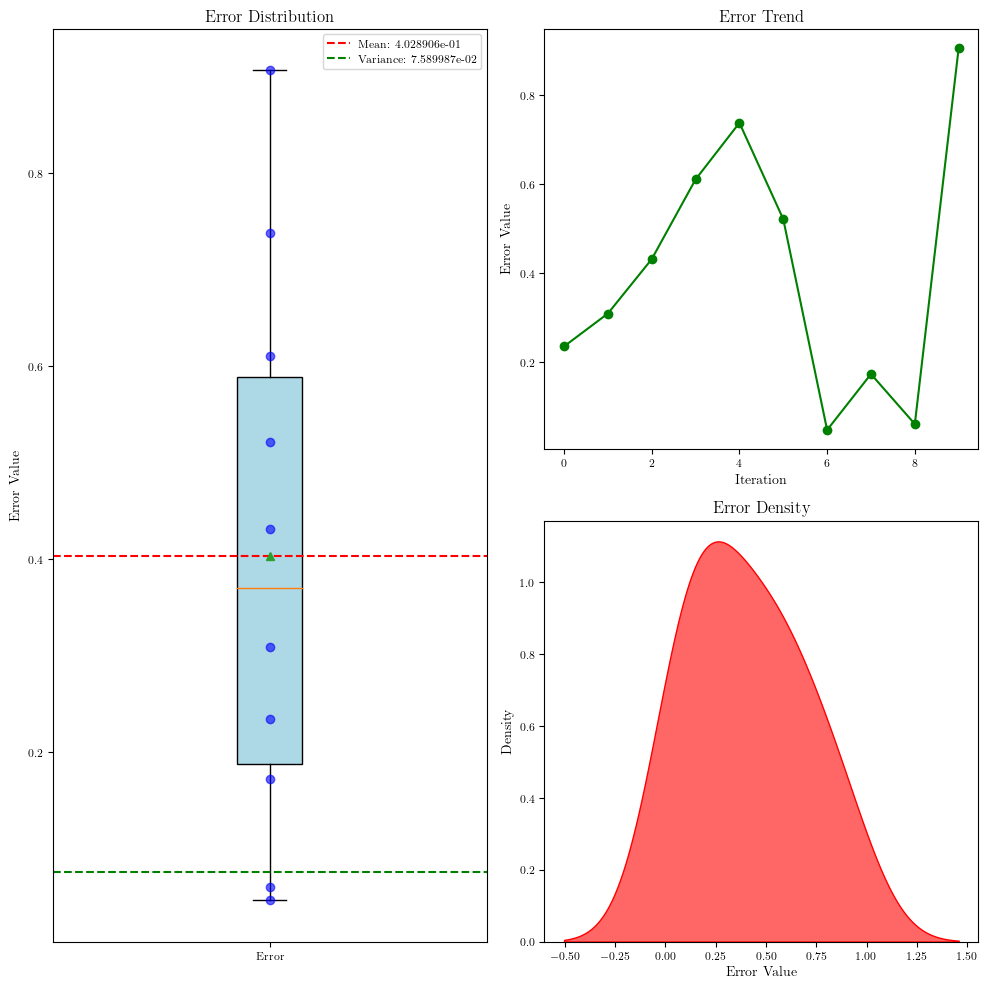

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns  # 导入seaborn库用于绘制密度图

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = error_u

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean Error u: %e' % (mean_error)) #打印误差
print('Variance Error u: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('Error Distribution')
plt.ylabel('Error Value')
plt.xticks([1], ['Error'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('Error Trend')
plt.ylabel('Error Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('Error Density')
plt.xlabel('Error Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

mean MAE: 6.577648e-02
Variance MAE: 4.642181e-03


/tmp/ipykernel_684261/3997509801.py:32: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


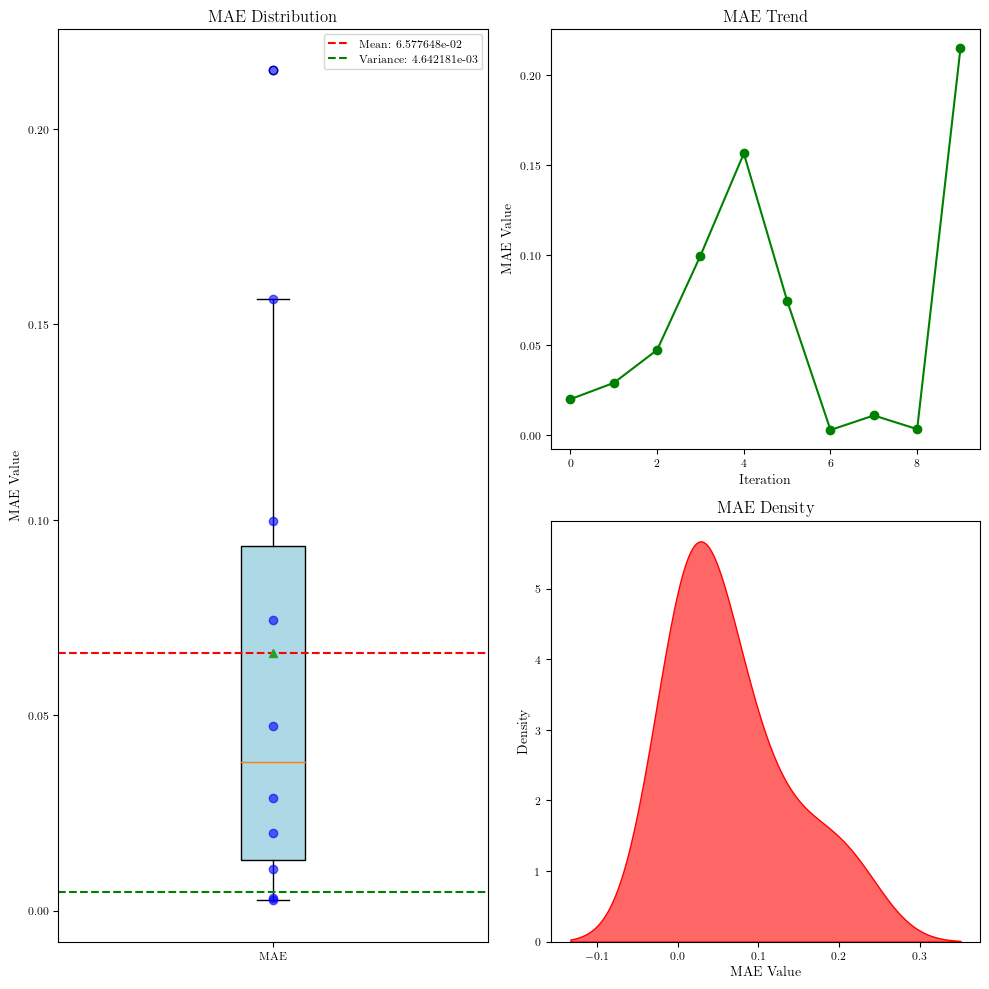

In [12]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = error_mae

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean MAE: %e' % (mean_error)) #打印误差
print('Variance MAE: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('MAE Distribution')
plt.ylabel('MAE Value')
plt.xticks([1], ['MAE'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('MAE Trend')
plt.ylabel('MAE Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('MAE Density')
plt.xlabel('MAE Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

mean MSE: 8.990700e-02
Variance MSE: 9.467579e-03


/tmp/ipykernel_684261/2305667704.py:32: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


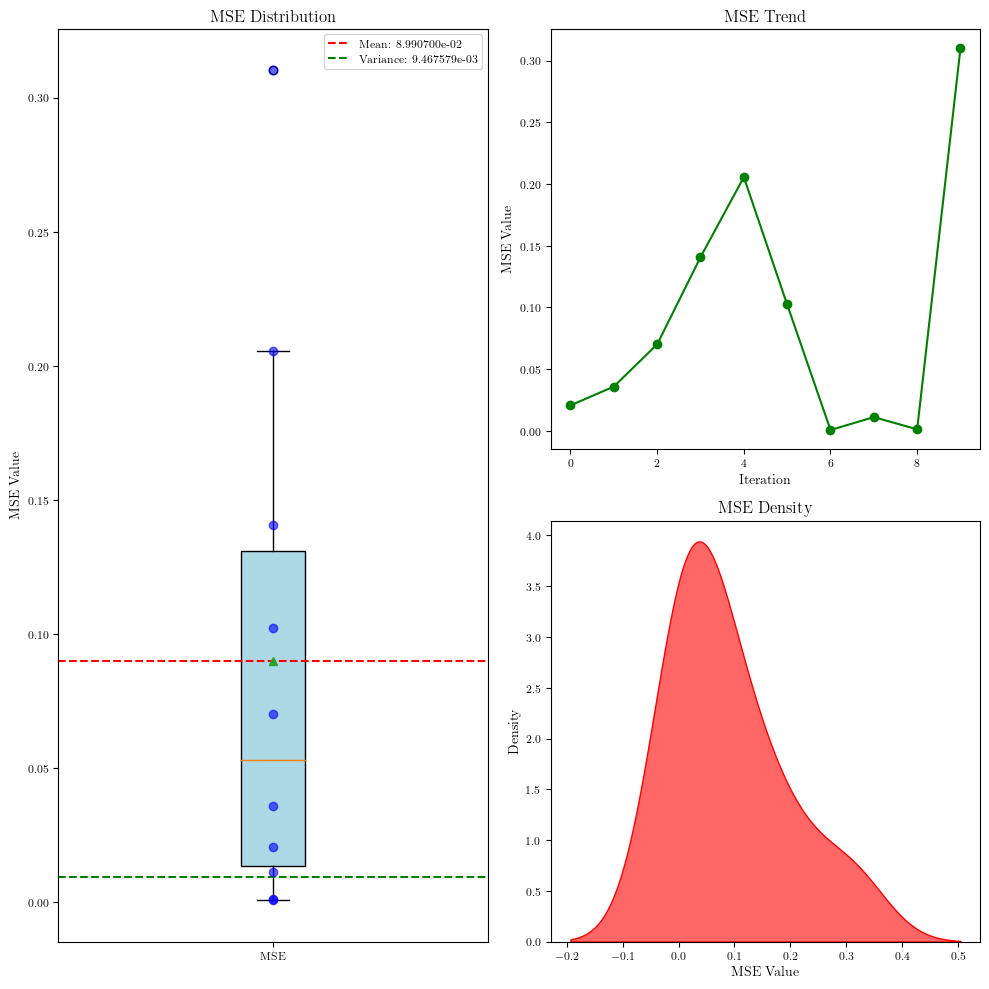

In [13]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = error_mse

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean MSE: %e' % (mean_error)) #打印误差
print('Variance MSE: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('MSE Distribution')
plt.ylabel('MSE Value')
plt.xticks([1], ['MSE'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('MSE Trend')
plt.ylabel('MSE Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('MSE Density')
plt.xlabel('MSE Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

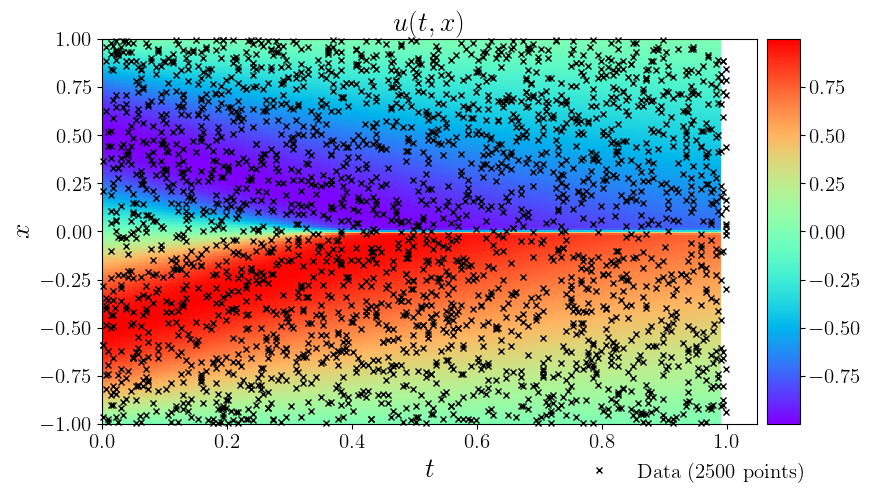

In [14]:
data = scipy.io.loadmat('../data/burgers_shock.mat')
#从data字典中取出变量tt和x的值，并转换为一维数组（flatten方法），最后tongg[:,None]将一维数组转换为二维数组
t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = np.real(data['usol']).T #从data数据中取出usol的值，并取实部，最后转置，赋值给Exact
#生成一个二位网络，X和T是输出的二维数组
#这个点结果是X和T均为形状为[len(t),len(x)]的二维数组，X的每一行都是x，一共len(t)行，T的每一列都是t，一共len(x)列
X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))  #按列堆叠数组，X_star是一个二维数组，其中第一列是X的展平，第二列是T的展平
u_star = Exact.flatten()[:,None]    #对Exact_u使用flatten方法将其转换为一维数组，最后使用[:,None]将其转换为二维数组   


#使用griddata函数将X_star、u_pred插值到网格上，得到U_pred
U_star = griddata(X_star, u_star.flatten(), (X, T), method='cubic')


###### Row 0: u(t,x) ##################    

fig = plt.figure(figsize=(9, 5)) #这里figure是一个figure对象，是一个图形窗口，代表整个图形，设置图形大小为宽9英寸高5 英寸
ax = fig.add_subplot(111) #在图形的1*1网格的第一个位置添加一个子图

#绘图的数据来源
h = ax.imshow(U_star.T, interpolation='nearest', cmap='rainbow', 
              extent=[t.min(), t.max(), x.min(), x.max()], 
              origin='lower', aspect='auto')   #imshow函数用于显示图像，接受一些参数，第一个参数是图像数据，这里是U_pred的转置；第二个参数是插值方法（用于在像素之间插入新的像素），这里是最邻近插值；
                                                   #第三个参数是颜色映射，这里是用彩虹色图；第四个参数是图像的范围；第五个参数是图像的原点位置，这里表示原点在右下角；第六个参数是图像的纵横比，这里表示调整横纵比以填充整个axes对象
                                                   #最后的结果返回一个axesimage对象，也就是h，可以通过这个对象进一步设置图像的属性


#添加颜色条
divider = make_axes_locatable(ax)  #使用 make_axes_locatable 函数创建了一个 AxesDivider 对象。这个函数接受一个 Axes 对象作为参数，返回一个 AxesDivider 对象。AxesDivider 对象可以用来管理子图的布局，特别是当你需要在一个图的旁边添加另一个图时。
cax = divider.append_axes("right", size="5%", pad=0.10) #使用append_axes方法在原始轴的右侧添加了一个新的轴。append_axes 方法接受三个参数：位置（"right"）、大小（"5%"）和间距（0.10）。在原始轴的右侧添加了一个新的轴，新轴的大小是原始轴的 5%，新轴与原始轴之间的间距是 0.05 英寸
   
cbar = fig.colorbar(h, cax=cax)#使用colorbar方法在新轴上添加了一个颜色条。colorbar 方法接受两个参数：axesimage 对象（h）和新轴（cax）。并记这个颜色条的名字是cbar
cbar.ax.tick_params(labelsize=15) #设置颜色条刻度标签大小，这里bar是之前定义的


#在图上绘制散点图
ax.plot(
    X_f_train[:,1], 
    X_f_train[:,0], 
    'kx', label = 'Data (%d points)' % (X_f_train.shape[0]), 
    markersize = 4,  # marker size doubled
    clip_on = False,
    alpha=1.0
) #在ax上绘制散点图，前两个参数是散点的x坐标和y坐标；kx表示黑色的x（散点形状是x），label是散点的标签，clip_on表示散点可以绘制在轴的边界外
  #新加了一个alpha=1.0用来设置标记的透明度，1.0表示完全不透明  




#设置图的标签、图例、标题和刻度标签
#设置ax子图的x轴的标签为t，y轴的标签为x。这里$t$和$x$是latex格式的文本，用于生成数学公式
ax.set_xlabel('$t$', size=20)
ax.set_ylabel('$x$', size=20)
#设置子图ax的图例，第一个参数用来设置图例的位置，这里表示图例放在上方中央;第二个参数用来设置图例的锚点，接受一个元组，表示x和y坐标，表示把图例的锚点设置在x坐标为0.9，y坐标为-0.05处;frameon=False表示不显示图例的边框;第三个参数设置图例的列数，分为5列；最后一个参数设置图例属性，接受字典，这里表示设置图例字体大小为15；最后返回的leg是一个legend对象，表示图形的图例
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.9, -0.05), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)
#设置子图ax的标题为$u(t,x)$，表示latex格式的文本，用于生成数学公式，fontsize=10表示字体大小为20
ax.set_title('$u(t,x)$', fontsize = 20) # font size doubled，两倍化子图标题
ax.tick_params(labelsize=15)#用来设置刻度标签的大小。`tick_params`是`Axes`对象的一个方法，可以用来设置刻度线的属性。在这里，`labelsize=15` 是用来设置刻度标签的字体大小的。


#显示图片
plt.show() #显示所有打开的图形的函数

In [15]:
trainloss = torch.stack(model.loss_value).cpu().detach().numpy()

testerror = torch.stack(model.test_error).cpu().detach().numpy()

56500
[0.60001534 0.57925147 0.55952275 ... 0.01474252 0.01474253 0.01474247]


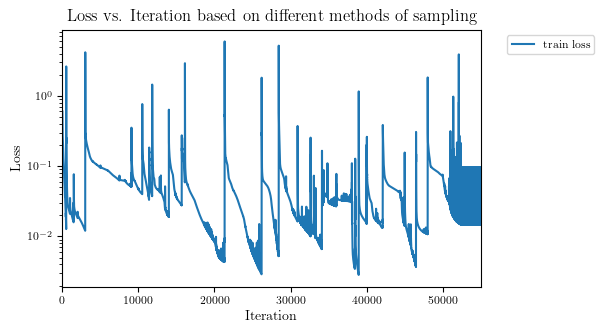

In [16]:
print(len(trainloss))
print(trainloss)
# 定义图例的标签
labels = ["Grid"]

# 创建一个新的图形
plt.figure()

# # 遍历所有的loss数据和标签
# for loss, label in zip(trainloss, labels):
#     # 绘制每个loss数据，并使用标签作为图例的条目
#     plt.plot(loss, label=label)

plt.plot(trainloss, label='train loss')

# 添加图例，放在图像外
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


plt.xlim([0,55000]) # 设置x轴的范围
plt.yscale('log') #设置y轴为对数尺度，这样即使列表中有一些非常大的值，也不会影响其他值的可视化
plt.xlabel('Iteration') # 设置x轴的标签
plt.ylabel('Loss') # 设置y轴的标签
plt.title('Loss vs. Iteration based on different methods of sampling') # 设置图形的标题
# 显示图形
plt.show()
plt.show()

56500
[1.3411124  1.3215016  1.3025525  ... 0.90653384 0.9065334  0.9065334 ]


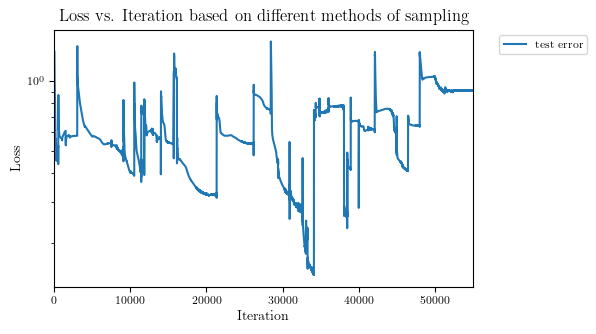

In [17]:
print(len(testerror))
print(testerror)
# 定义图例的标签
# labels = ["Grid"]

# 创建一个新的图形
plt.figure()

# # 遍历所有的loss数据和标签
# for loss, label in zip(trainloss, labels):
#     # 绘制每个loss数据，并使用标签作为图例的条目
#     plt.plot(loss, label=label)

plt.plot(testerror, label='test error')

# 添加图例，放在图像外
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


plt.xlim([0,55000]) # 设置x轴的范围
plt.yscale('log') #设置y轴为对数尺度，这样即使列表中有一些非常大的值，也不会影响其他值的可视化
plt.xlabel('Iteration') # 设置x轴的标签
plt.ylabel('Loss') # 设置y轴的标签
plt.title('Loss vs. Iteration based on different methods of sampling') # 设置图形的标题
# 显示图形
plt.show()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


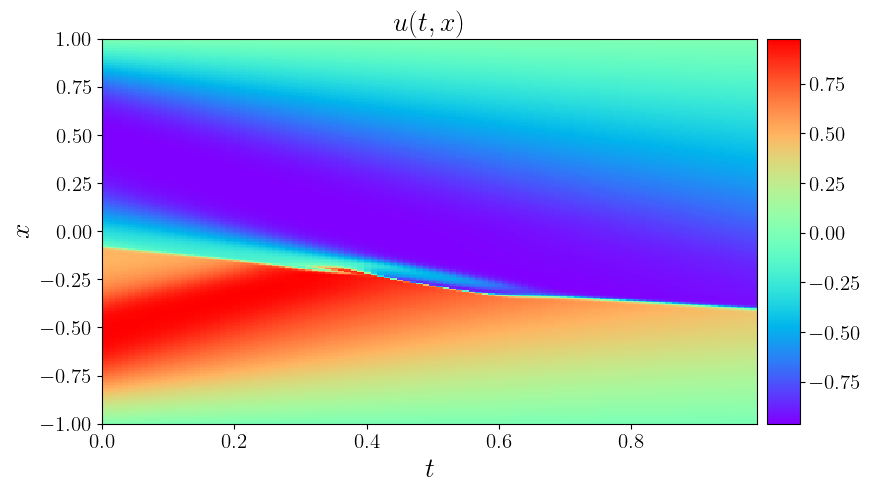

In [18]:
data = scipy.io.loadmat('../data/burgers_shock.mat')
#从data字典中取出变量tt和x的值，并转换为一维数组（flatten方法），最后tongg[:,None]将一维数组转换为二维数组
t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = np.real(data['usol']).T #从data数据中取出usol的值，并取实部，最后转置，赋值给Exact
#生成一个二位网络，X和T是输出的二维数组
#这个点结果是X和T均为形状为[len(t),len(x)]的二维数组，X的每一行都是x，一共len(t)行，T的每一列都是t，一共len(x)列
X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))  #按列堆叠数组，X_star是一个二维数组，其中第一列是X的展平，第二列是T的展平
u_pred, f_pred = model.predict(X_star)    #对Exact_u使用flatten方法将其转换为一维数组，最后使用[:,None]将其转换为二维数组   


#使用griddata函数将X_star、u_pred插值到网格上，得到U_pred
U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')


###### Row 0: u(t,x) ##################    

fig = plt.figure(figsize=(9, 5)) #这里figure是一个figure对象，是一个图形窗口，代表整个图形，设置图形大小为宽9英寸高5 英寸
ax = fig.add_subplot(111) #在图形的1*1网格的第一个位置添加一个子图

#绘图的数据来源
h = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow', 
              extent=[t.min(), t.max(), x.min(), x.max()], 
              origin='lower', aspect='auto')   #imshow函数用于显示图像，接受一些参数，第一个参数是图像数据，这里是U_pred的转置；第二个参数是插值方法（用于在像素之间插入新的像素），这里是最邻近插值；
                                                   #第三个参数是颜色映射，这里是用彩虹色图；第四个参数是图像的范围；第五个参数是图像的原点位置，这里表示原点在右下角；第六个参数是图像的纵横比，这里表示调整横纵比以填充整个axes对象
                                                   #最后的结果返回一个axesimage对象，也就是h，可以通过这个对象进一步设置图像的属性


#添加颜色条
divider = make_axes_locatable(ax)  #使用 make_axes_locatable 函数创建了一个 AxesDivider 对象。这个函数接受一个 Axes 对象作为参数，返回一个 AxesDivider 对象。AxesDivider 对象可以用来管理子图的布局，特别是当你需要在一个图的旁边添加另一个图时。
cax = divider.append_axes("right", size="5%", pad=0.10) #使用append_axes方法在原始轴的右侧添加了一个新的轴。append_axes 方法接受三个参数：位置（"right"）、大小（"5%"）和间距（0.10）。在原始轴的右侧添加了一个新的轴，新轴的大小是原始轴的 5%，新轴与原始轴之间的间距是 0.05 英寸
   
cbar = fig.colorbar(h, cax=cax)#使用colorbar方法在新轴上添加了一个颜色条。colorbar 方法接受两个参数：axesimage 对象（h）和新轴（cax）。并记这个颜色条的名字是cbar
cbar.ax.tick_params(labelsize=15) #设置颜色条刻度标签大小，这里bar是之前定义的


# #在图上绘制散点图
# ax.plot(
#     X_f_train[:,1], 
#     X_f_train[:,0], 
#     'kx', label = 'Data (%d points)' % (X_f_train.shape[0]), 
#     markersize = 4,  # marker size doubled
#     clip_on = False,
#     alpha=1.0
# ) #在ax上绘制散点图，前两个参数是散点的x坐标和y坐标；kx表示黑色的x（散点形状是x），label是散点的标签，clip_on表示散点可以绘制在轴的边界外
#   #新加了一个alpha=1.0用来设置标记的透明度，1.0表示完全不透明  




#设置图的标签、图例、标题和刻度标签
#设置ax子图的x轴的标签为t，y轴的标签为x。这里$t$和$x$是latex格式的文本，用于生成数学公式
ax.set_xlabel('$t$', size=20)
ax.set_ylabel('$x$', size=20)
#设置子图ax的图例，第一个参数用来设置图例的位置，这里表示图例放在上方中央;第二个参数用来设置图例的锚点，接受一个元组，表示x和y坐标，表示把图例的锚点设置在x坐标为0.9，y坐标为-0.05处;frameon=False表示不显示图例的边框;第三个参数设置图例的列数，分为5列；最后一个参数设置图例属性，接受字典，这里表示设置图例字体大小为15；最后返回的leg是一个legend对象，表示图形的图例
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.9, -0.05), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)
#设置子图ax的标题为$u(t,x)$，表示latex格式的文本，用于生成数学公式，fontsize=10表示字体大小为20
ax.set_title('$u(t,x)$', fontsize = 20) # font size doubled，两倍化子图标题
ax.tick_params(labelsize=15)#用来设置刻度标签的大小。`tick_params`是`Axes`对象的一个方法，可以用来设置刻度线的属性。在这里，`labelsize=15` 是用来设置刻度标签的字体大小的。


#显示图片
plt.show() #显示所有打开的图形的函数

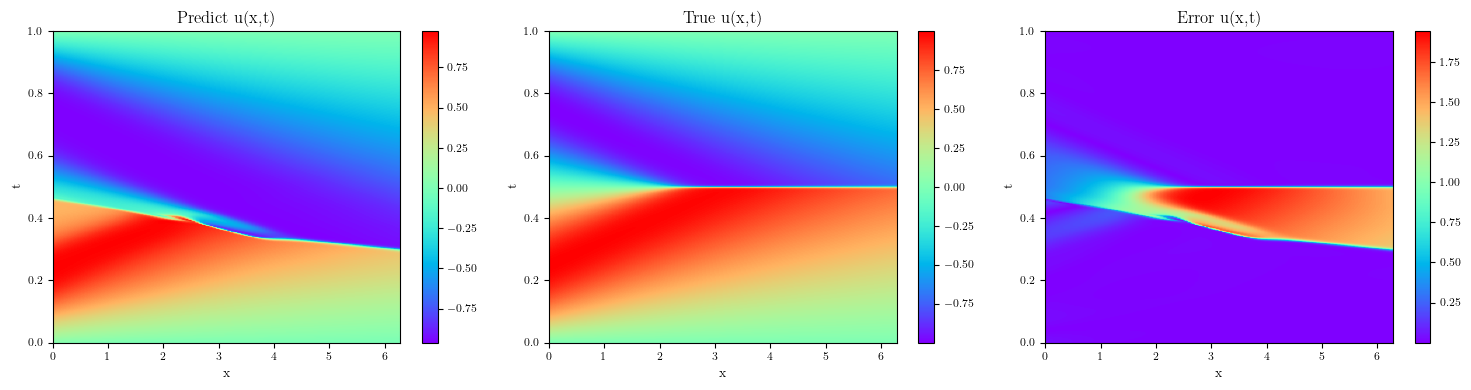

In [19]:

# 创建一个包含三幅子图的图像
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 绘制第一幅图像
axes[0].imshow(U_pred.T, extent=[0, np.pi*2, 1, 0], aspect='auto', cmap='rainbow')
axes[0].invert_yaxis()
axes[0].set_xlabel('x')
axes[0].set_ylabel('t')
axes[0].set_title('Predict u(x,t)')
fig.colorbar(axes[0].images[0], ax=axes[0])

# 绘制第二幅图像
axes[1].imshow(U_star.T, extent=[0,np.pi*2,1,0], aspect='auto', cmap='rainbow') #第一个参数为数据，第二个参数为一个列表，用于设置图像的坐标范围，aspect='auto'表示纵横比自动调整
axes[1].invert_yaxis()
axes[1].set_xlabel('x')
axes[1].set_ylabel('t')
axes[1].set_title('True u(x,t)')
fig.colorbar(axes[1].images[0], ax=axes[1])

# 绘制第三幅图像
axes[2].imshow(np.abs(U_pred - U_star).T, extent=[0,np.pi*2,1,0], aspect='auto', cmap='rainbow') #第一个参数为数据，第二个参数为一个列表，用于设置图像的坐标范围，aspect='auto'表示纵横比自动调整
axes[2].invert_yaxis()
axes[2].set_xlabel('x')
axes[2].set_ylabel('t')
axes[2].set_title('Error u(x,t)')
fig.colorbar(axes[2].images[0], ax=axes[2])

# 自动调整子图参数，使得子图之间的间距适当
plt.tight_layout()
plt.show()

In [20]:
#计算训练好模型的chaos（最后一个seed）
u_chaos = calculate_chaos(model, X_star, num_iter=50)
u_chaos_log = np.log(u_chaos + 1e-10) #对u_var取对数，然后加上一个很小的数，避免取对数时出现错误

#使用griddata函数将X_star、u_pred插值到网格上，得到U_pred
U_chaos = griddata(X_star, u_chaos.flatten(), (X, T), method='cubic')
U_chaos_log = griddata(X_star, u_chaos_log.flatten(), (X, T), method='cubic')

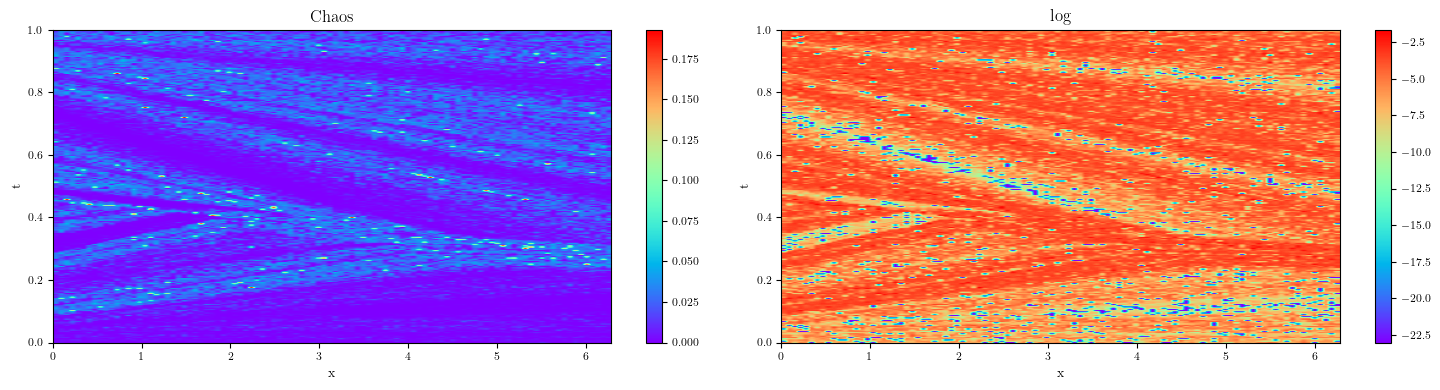

In [21]:

# 创建一个包含三幅子图的图像
fig, axes = plt.subplots(1, 2, figsize=(15, 4))

# 绘制第一幅图像
axes[0].imshow(U_chaos.T, extent=[0, np.pi*2, 1, 0], aspect='auto', cmap='rainbow')
axes[0].invert_yaxis()
axes[0].set_xlabel('x')
axes[0].set_ylabel('t')
axes[0].set_title('Chaos')
fig.colorbar(axes[0].images[0], ax=axes[0])

# 绘制第二幅图像
axes[1].imshow(U_chaos_log.T, extent=[0,np.pi*2,1,0], aspect='auto', cmap='rainbow') #第一个参数为数据，第二个参数为一个列表，用于设置图像的坐标范围，aspect='auto'表示纵横比自动调整
axes[1].invert_yaxis()
axes[1].set_xlabel('x')
axes[1].set_ylabel('t')
axes[1].set_title('log')
fig.colorbar(axes[1].images[0], ax=axes[1])

# 自动调整子图参数，使得子图之间的间距适当
plt.tight_layout()
plt.show()